$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 1: Sequence Models
<a id=part1></a>

In this part we will learn about working with text sequences using recurrent neural networks.
We'll go from a raw text file all the way to a fully trained GRU-RNN model and generate works of art!

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Text generation with a char-level RNN
<a id=part1_1></a>

### Obtaining the corpus
<a id=part1_2></a>

Let's begin by downloading a corpus containing all the works of William Shakespeare.
Since he was very prolific, this corpus is fairly large and will provide us with enough data for
obtaining impressive results.

In [3]:
CORPUS_URL = 'https://github.com/cedricdeboom/character-level-rnn-datasets/raw/master/datasets/shakespeare.txt'
DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')

def download_corpus(out_path=DATA_DIR, url=CORPUS_URL, force=False):
    pathlib.Path(out_path).mkdir(exist_ok=True)
    out_filename = os.path.join(out_path, os.path.basename(url))
    
    if os.path.isfile(out_filename) and not force:
        print(f'Corpus file {out_filename} exists, skipping download.')
    else:
        print(f'Downloading {url}...')
        with urllib.request.urlopen(url) as response, open(out_filename, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
        print(f'Saved to {out_filename}.')
    return out_filename
    
corpus_path = download_corpus()

Corpus file /home/eran.b/.pytorch-datasets/shakespeare.txt exists, skipping download.


Load the text into memory and print a snippet:

In [4]:
with open(corpus_path, 'r', encoding='utf-8') as f:
    corpus = f.read()

print(f'Corpus length: {len(corpus)} chars')
print(corpus[7:1234])

Corpus length: 6347703 chars
ALLS WELL THAT ENDS WELL

by William Shakespeare

Dramatis Personae

  KING OF FRANCE
  THE DUKE OF FLORENCE
  BERTRAM, Count of Rousillon
  LAFEU, an old lord
  PAROLLES, a follower of Bertram
  TWO FRENCH LORDS, serving with Bertram

  STEWARD, Servant to the Countess of Rousillon
  LAVACHE, a clown and Servant to the Countess of Rousillon
  A PAGE, Servant to the Countess of Rousillon

  COUNTESS OF ROUSILLON, mother to Bertram
  HELENA, a gentlewoman protected by the Countess
  A WIDOW OF FLORENCE.
  DIANA, daughter to the Widow

  VIOLENTA, neighbour and friend to the Widow
  MARIANA, neighbour and friend to the Widow

  Lords, Officers, Soldiers, etc., French and Florentine  

SCENE:
Rousillon; Paris; Florence; Marseilles

ACT I. SCENE 1.
Rousillon. The COUNT'S palace

Enter BERTRAM, the COUNTESS OF ROUSILLON, HELENA, and LAFEU, all in black

  COUNTESS. In delivering my son from me, I bury a second husband.
  BERTRAM. And I in going, madam, weep o'er

### Data Preprocessing
<a id=part1_3></a>

The first thing we'll need is to map from each unique character in the corpus to an index that will represent it in our learning process.

**TODO**: Implement the `char_maps()` function in the `hw3/charnn.py` module.

In [5]:
import hw3.charnn as charnn

char_to_idx, idx_to_char = charnn.char_maps(corpus)
print(char_to_idx)

test.assertEqual(len(char_to_idx), len(idx_to_char))
test.assertSequenceEqual(list(char_to_idx.keys()), list(idx_to_char.values()))
test.assertSequenceEqual(list(char_to_idx.values()), list(idx_to_char.keys()))

{'\n': 0, ' ': 1, '!': 2, '"': 3, '$': 4, '&': 5, "'": 6, '(': 7, ')': 8, ',': 9, '-': 10, '.': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, ';': 23, '<': 24, '?': 25, 'A': 26, 'B': 27, 'C': 28, 'D': 29, 'E': 30, 'F': 31, 'G': 32, 'H': 33, 'I': 34, 'J': 35, 'K': 36, 'L': 37, 'M': 38, 'N': 39, 'O': 40, 'P': 41, 'Q': 42, 'R': 43, 'S': 44, 'T': 45, 'U': 46, 'V': 47, 'W': 48, 'X': 49, 'Y': 50, 'Z': 51, '[': 52, ']': 53, '_': 54, 'a': 55, 'b': 56, 'c': 57, 'd': 58, 'e': 59, 'f': 60, 'g': 61, 'h': 62, 'i': 63, 'j': 64, 'k': 65, 'l': 66, 'm': 67, 'n': 68, 'o': 69, 'p': 70, 'q': 71, 'r': 72, 's': 73, 't': 74, 'u': 75, 'v': 76, 'w': 77, 'x': 78, 'y': 79, 'z': 80, '}': 81, '\ufeff': 82}


Seems we have some strange characters in the corpus that are very rare and are probably due to mistakes.
To reduce the length of each tensor we'll need to later represent our chars, it's best to remove them.

**TODO**: Implement the `remove_chars()` function in the `hw3/charnn.py` module.

In [6]:
corpus, n_removed = charnn.remove_chars(corpus, ['}','$','_','<','\ufeff'])
print(f'Removed {n_removed} chars')

# After removing the chars, re-create the mappings
char_to_idx, idx_to_char = charnn.char_maps(corpus)

Removed 34 chars


The next thing we need is an **embedding** of the chracters.
An embedding is a representation of each token from the sequence as a tensor.
For a char-level RNN, our tokens will be chars and we can thus use the simplest possible embedding: encode each char as a **one-hot** tensor. In other words, each char will be represented
as a tensor whos length is the total number of unique chars (`V`) which contains all zeros except at the index
corresponding to that specific char.

**TODO**: Implement the functions `chars_to_onehot()` and `onehot_to_chars()` in the `hw3/charnn.py` module.

In [7]:
# Wrap the actual embedding functions for calling convenience
def embed(text):
    return charnn.chars_to_onehot(text, char_to_idx)

def unembed(embedding):
    return charnn.onehot_to_chars(embedding, idx_to_char)

text_snippet = corpus[3104:3148]
print(text_snippet)
print(embed(text_snippet[0:3]))

test.assertEqual(text_snippet, unembed(embed(text_snippet)))
test.assertEqual(embed(text_snippet).dtype, torch.int8)

brine a maiden can season her praise in.
   
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]], dtype=torch.int8)


### Dataset Creation
<a id=part1_4></a>

We wish to train our model to generate text by constantly predicting what the next char should be based on the past.
To that end we'll need to train our recurrent network in a way similar to a classification task. At each timestep, we input a char and set the expected output (label) to be the next char in the original sequence.

We will split our corpus into shorter sequences of length `S` chars (see question below).
Each **sample** we provide our model with will therefore be a tensor of shape `(S,V)` where `V` is the embedding dimension. Our model will operate sequentially on each char in the sequence.
For each sample, we'll also need a **label**. This is simply another sequence, shifted by one char so that the label of each char is the next char in the corpus.

**TODO**: Implement the `chars_to_labelled_samples()` function in the `hw3/charnn.py` module.

In [8]:
# Create dataset of sequences
seq_len = 64
vocab_len = len(char_to_idx)

# Create labelled samples
samples, labels = charnn.chars_to_labelled_samples(corpus, char_to_idx, seq_len, device)
print(f'samples shape: {samples.shape}')
print(f'labels shape: {labels.shape}')

# Test shapes
num_samples = (len(corpus) - 1) // seq_len
test.assertEqual(samples.shape, (num_samples, seq_len, vocab_len))
test.assertEqual(labels.shape, (num_samples, seq_len))

# Test content
for _ in range(1000):
    # random sample
    i = np.random.randint(num_samples, size=(1,))[0]
    # Compare to corpus
    test.assertEqual(unembed(samples[i]), corpus[i*seq_len:(i+1)*seq_len], msg=f"content mismatch in sample {i}")
    # Compare to labels
    sample_text = unembed(samples[i])
    label_text = str.join('', [idx_to_char[j.item()] for j in labels[i]])
    test.assertEqual(sample_text[1:], label_text[0:-1], msg=f"label mismatch in sample {i}")

samples shape: torch.Size([99182, 64, 78])
labels shape: torch.Size([99182, 64])


Let's print a few consecutive samples. You should see that the text continues between them.

In [9]:
import re
import random

i = random.randrange(num_samples-5)
for i in range(i, i+5):
    test.assertEqual(len(samples[i]), seq_len)
    s = re.sub(r'\s+', ' ', unembed(samples[i])).strip()
    print(f'sample [{i}]:\n\t{s}')

sample [93594]:
	I prize it As I weigh grief, which I would spare: for honour, 'T
sample [93595]:
	is a derivative from me to mine, And only that I stand for. I ap
sample [93596]:
	peal To your own conscience, sir, before Polixenes Came to your
sample [93597]:
	court, how I was in your grace, How merited to be so; since he c
sample [93598]:
	ame, With what encounter so uncurrent I Have strain'd to appear


As usual, instead of feeding one sample at a time into our model's forward we'll work with **batches** of samples. This means that at every timestep, our model will operate on a batch of chars that are from **different sequences**.
Effectively this will allow us to parallelize training our model by dong matrix-matrix multiplications
instead of matrix-vector during the forward pass.

An important nuance is that we need the batches to be **contiguous**, i.e. sample $k$ in batch $j$ should continue sample $k$ from batch $j-1$.
The following figure illustrates this:

<img src="imgs/rnn-batching.png"/>

If we naïvely take consecutive samples into batches, e.g. `[0,1,...,B-1]`, `[B,B+1,...,2B-1]` and so on, we won't have contiguous
sequences at the same index between adjacent batches.

To accomplish this we need to tell our `DataLoader` which samples to combine together into one batch.
We do this by implementing a custom PyTorch `Sampler`, and providing it to our `DataLoader`.

**TODO**: Implement the `SequenceBatchSampler` class in the `hw3/charnn.py` module.

In [10]:
from hw3.charnn import SequenceBatchSampler

sampler = SequenceBatchSampler(dataset=range(32), batch_size=10)
sampler_idx = list(sampler)
print('sampler_idx =\n', sampler_idx)

# Test the Sampler
test.assertEqual(len(sampler_idx), 30)
batch_idx = np.array(sampler_idx).reshape(-1, 10)
for k in range(10):
    test.assertEqual(np.diff(batch_idx[:, k], n=2).item(), 0)

sampler_idx =
 [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 2, 5, 8, 11, 14, 17, 20, 23, 26, 29]


/home/eran.b/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torch/utils/data/sampler.py:65: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."


Even though we're working with sequences, we can still use the standard PyTorch `Dataset`/`DataLoader` combo.
For the dataset we can use a built-in class, `TensorDataset` to return tuples of `(sample, label)`
from the `samples` and `labels` tensors we created above.
The `DataLoader` will be provided with our custom `Sampler` so that it generates appropriate batches.

In [11]:
import torch.utils.data

# Create DataLoader returning batches of samples.
batch_size = 32

ds_corpus = torch.utils.data.TensorDataset(samples, labels)
sampler_corpus = SequenceBatchSampler(ds_corpus, batch_size)
dl_corpus = torch.utils.data.DataLoader(ds_corpus, batch_size=batch_size, sampler=sampler_corpus, shuffle=False)

Let's see what that gives us:

In [12]:
print(f'num batches: {len(dl_corpus)}')

x0, y0 = next(iter(dl_corpus))
print(f'shape of a batch of samples: {x0.shape}')
print(f'shape of a batch of labels: {y0.shape}')

num batches: 3100
shape of a batch of samples: torch.Size([32, 64, 78])
shape of a batch of labels: torch.Size([32, 64])


Now lets look at the same sample index from multiple batches taken from our corpus.

In [13]:
# Check that sentences in in same index of different batches complete each other.
k = random.randrange(batch_size)
for j, (X, y) in enumerate(dl_corpus,):
    print(f'=== batch {j}, sample {k} ({X[k].shape}): ===')
    s = re.sub(r'\s+', ' ', unembed(X[k])).strip()
    print(f'\t{s}')
    if j==4: break

=== batch 0, sample 24 (torch.Size([64, 78])): ===
	mind were clear again, that I might water an ass at it. I ha
=== batch 1, sample 24 (torch.Size([64, 78])): ===
	d rather be a tick in a sheep than such a valiant ignorance.
=== batch 2, sample 24 (torch.Size([64, 78])): ===
	Exit ACT IV. SCENE 1. Troy.
=== batch 3, sample 24 (torch.Size([64, 78])): ===
	A street Enter, at one side, AENEAS, and servant with a torch;
=== batch 4, sample 24 (torch.Size([64, 78])): ===
	at another, PARIS, DEIPHOBUS, ANTENOR, DIOMEDES the Grecian, an


### Model Implementation
<a id=part1_5></a>

Finally, our data set is ready so we can focus on our model.

We'll implement here is a multilayer gated recurrent unit (GRU) model, with dropout.
This model is a type of RNN which performs similar to the well-known LSTM model,
but it's somewhat easier to train because it has less parameters.
We'll modify the regular GRU slightly by applying dropout to
the hidden states passed between layers of the model.

The model accepts an input $\mat{X}\in\set{R}^{S\times V}$ containing a sequence of embedded chars.
It returns an output $\mat{Y}\in\set{R}^{S\times V}$ of predictions for the next char and the final hidden state
$\mat{H}\in\set{R}^{L\times H}$. Here $S$ is the sequence length, $V$ is the vocabulary size (number of unique chars), $L$ is the number of layers in the model and $H$ is the hidden dimension.

Mathematically, the model's forward function at layer $k\in[1,L]$ and timestep $t\in[1,S]$ can be described as

$$
\begin{align}
\vec{z_t}^{[k]} &= \sigma\left(\vec{x}^{[k]}_t {\mattr{W}_{\mathrm{xz}}}^{[k]} +
    \vec{h}_{t-1}^{[k]} {\mattr{W}_{\mathrm{hz}}}^{[k]} + \vec{b}_{\mathrm{z}}^{[k]}\right) \\
\vec{r_t}^{[k]} &= \sigma\left(\vec{x}^{[k]}_t {\mattr{W}_{\mathrm{xr}}}^{[k]} +
    \vec{h}_{t-1}^{[k]} {\mattr{W}_{\mathrm{hr}}}^{[k]} + \vec{b}_{\mathrm{r}}^{[k]}\right) \\
\vec{g_t}^{[k]} &= \tanh\left(\vec{x}^{[k]}_t {\mattr{W}_{\mathrm{xg}}}^{[k]} +
    (\vec{r_t}^{[k]}\odot\vec{h}_{t-1}^{[k]}) {\mattr{W}_{\mathrm{hg}}}^{[k]} + \vec{b}_{\mathrm{g}}^{[k]}\right) \\
\vec{h_t}^{[k]} &= \vec{z}^{[k]}_t \odot \vec{h}^{[k]}_{t-1} + \left(1-\vec{z}^{[k]}_t\right)\odot \vec{g_t}^{[k]}
\end{align}
$$

The input to each layer is,
$$
\mat{X}^{[k]} =
\begin{bmatrix}
    {\vec{x}_1}^{[k]} \\ \vdots \\ {\vec{x}_S}^{[k]}
\end{bmatrix} 
=
\begin{cases}
    \mat{X} & \mathrm{if} ~k = 1~ \\
    \mathrm{dropout}_p \left(
    \begin{bmatrix}
        {\vec{h}_1}^{[k-1]} \\ \vdots \\ {\vec{h}_S}^{[k-1]}
    \end{bmatrix} \right) & \mathrm{if} ~1 < k \leq L+1~
\end{cases}.
$$

The output of the entire model is then,
$$
\mat{Y} = \mat{X}^{[L+1]} {\mattr{W}_{\mathrm{hy}}} + \mat{B}_{\mathrm{y}}
$$

and the final hidden state is
$$
\mat{H} = 
\begin{bmatrix}
    {\vec{h}_S}^{[1]} \\ \vdots \\ {\vec{h}_S}^{[L]}
\end{bmatrix}.
$$

Notes:
- $t\in[1,S]$ is the timestep, i.e. the current position within the sequence of each sample.
- $\vec{x}_t^{[k]}$ is the input of layer $k$ at timestep $t$, respectively.
- The outputs of the **last layer** $\vec{y}_t^{[L]}$, are the predicted next characters for every input char.
  These are similar to class scores in classification tasks.
- The hidden states at the **last timestep**, $\vec{h}_S^{[k]}$, are the final hidden state returned from the model.
- $\sigma(\cdot)$ is the sigmoid function, i.e. $\sigma(\vec{z}) = 1/(1+e^{-\vec{z}})$ which returns values in $(0,1)$.
- $\tanh(\cdot)$ is the hyperbolic tangent, i.e. $\tanh(\vec{z}) = (e^{2\vec{z}}-1)/(e^{2\vec{z}}+1)$ which returns values in $(-1,1)$.
- $\vec{h_t}^{[k]}$ is the hidden state of layer $k$ at time $t$. This can be thought of as the memory of that layer.
- $\vec{g_t}^{[k]}$ is the candidate hidden state for time $t+1$.
- $\vec{z_t}^{[k]}$ is known as the update gate. It combines the previous state with the input to determine how much the current state will be combined with the new candidate state. For example, if $\vec{z_t}^{[k]}=\vec{1}$ then the current input has no effect on the output.
- $\vec{r_t}^{[k]}$ is known as the reset gate. It combines the previous state with the input to determine how much of the previous state will affect the current state candidate. For example if $\vec{r_t}^{[k]}=\vec{0}$ the previous state has no effect on the current candidate state.

Here's a graphical representation of the GRU's forward pass at each timestep. The $\vec{\tilde{h}}$ in the image is our $\vec{g}$ (candidate next state).

<img src="imgs/gru_cell.png" width="400"/>

You can see how the reset and update gates allow the model to completely ignore it's previous state, completely ignore it's input, or any mixture of those states (since the gates are actually continuous and between $(0,1)$).

Here's a graphical representation of the entire model.
You can ignore the $c_t^{[k]}$ (cell state) variables (which are relevant for LSTM models).
Our model has only the hidden state, $h_t^{[k]}$. Also notice that we added dropout between layers (i.e., on the up arrows).

<img src="imgs/lstm_model.png" />

The purple tensors are inputs (a sequence and initial hidden state per layer), and the green tensors are outputs (another sequence and final hidden state per layer). Each blue block implements the above forward equations.
Blocks that are on the same vertical level are at the same layer, and therefore share parameters.

**TODO**:implement `MultilayerGRU` class in the `hw3/charnn.py` module.


Notes:
- We use **batches** now.
  The math is identical to the above, but all the tensors will have an extra batch 
  dimension as their first dimension.
- Read the diagram above, try to understand all the dimentions.


In [14]:
in_dim = vocab_len
h_dim = 256
n_layers = 3
model = charnn.MultilayerGRU(in_dim, h_dim, out_dim=in_dim, n_layers=n_layers)
model = model.to(device)
print(model)

# Test forward pass
y, h = model(x0.to(dtype=torch.float, device=device))
print(f'y.shape={y.shape}')
print(f'h.shape={h.shape}')

test.assertEqual(y.shape, (batch_size, seq_len, vocab_len))
test.assertEqual(h.shape, (batch_size, n_layers, h_dim))
test.assertEqual(len(list(model.parameters())), 9 * n_layers + 2) 

MultilayerGRU(
  (layer_params): ModuleList(
    (0): ModuleList(
      (0): Linear(in_features=78, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=256, bias=False)
      (2): Linear(in_features=78, out_features=256, bias=True)
      (3): Linear(in_features=256, out_features=256, bias=False)
      (4): Linear(in_features=78, out_features=256, bias=True)
      (5): Linear(in_features=256, out_features=256, bias=False)
      (6): Dropout(p=0, inplace=False)
    )
    (1-2): 2 x ModuleList(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=256, bias=False)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): Linear(in_features=256, out_features=256, bias=False)
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): Linear(in_features=256, out_features=256, bias=False)
      (6): Dropout(p=0, inplace=False)
    )
    (3): ModuleList(
      (0): Linear(in_feat

y.shape=torch.Size([32, 64, 78])
h.shape=torch.Size([32, 3, 256])


### Generating text by sampling
<a id=part1_6></a>

Now that we have a model, we can implement **text generation** based on it.
The idea is simple:
At each timestep our model receives one char $x_t$ from the input sequence and outputs scores $y_t$
for what the next char should be.
We'll convert these scores into a probability over each of the possible chars.
In other words, for each input char $x_t$ we create a probability distribution for the next char
conditioned on the current one and the state of the model (representing all previous inputs):
$$p(x_{t+1}|x_t, \vec{h}_t).$$

Once we have such a distribution, we'll sample a char from it.
This will be the first char of our generated sequence.
Now we can feed this new char into the model, create another distribution, sample the next char and so on.
Note that it's crucial to propagate the hidden state when sampling.

The important point however is how to create the distribution from the scores.
One way, as we saw in previous ML tasks, is to use the softmax function.
However, a drawback of softmax is that it can generate very diffuse (more uniform) distributions if the score values are very similar. When sampling, we would prefer to control the distributions and make them less uniform to increase the chance of sampling the char(s) with the highest scores compared to the others.

To control the variance of the distribution, a common trick is to add a hyperparameter $T$, known as the 
*temperature* to the softmax function. The class scores are simply scaled by $T$ before softmax is applied:
$$
\mathrm{softmax}_T(\vec{y}) = \frac{e^{\vec{y}/T}}{\sum_k e^{y_k/T}}
$$

A low $T$ will result in less uniform distributions and vice-versa.

**TODO**: Implement the `hot_softmax()` function in the `hw3/charnn.py` module.

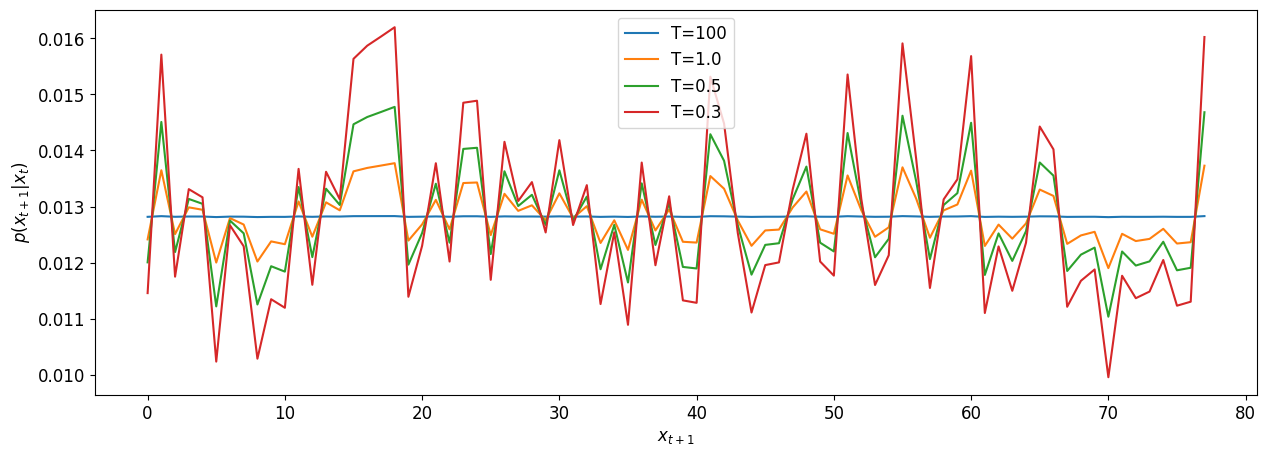

In [15]:
scores = y[0,0,:].detach()
_, ax = plt.subplots(figsize=(15,5))

for t in reversed([0.3, 0.5, 1.0, 100]):
    ax.plot(charnn.hot_softmax(scores, temperature=t).cpu().numpy(), label=f'T={t}')
ax.set_xlabel('$x_{t+1}$')
ax.set_ylabel('$p(x_{t+1}|x_t)$')
ax.legend()

uniform_proba = 1/len(char_to_idx)
uniform_diff = torch.abs(charnn.hot_softmax(scores, temperature=100) - uniform_proba)
test.assertTrue(torch.all(uniform_diff < 1e-4))

**TODO**: Implement the `generate_from_model()` function in the `hw3/charnn.py` module.

In [16]:
for _ in range(3):
    text = charnn.generate_from_model(model, "foobar", 50, (char_to_idx, idx_to_char), T=0.5)
    print(text)
    test.assertEqual(len(text), 50)

foobarh0d,hBnOiN)!RyA3qLn0okBsDDhVF?7z
p4:GrTTIYe8
foobartZ:t]zsCeM6fdQ&?oJ7S93W!RC](vm6Y!-rl  8&gk]d
foobarJ!aMooL5PRYbV'HQ7r; j[Uv1fp[VroEpt(&Pm"mx?]4


### Training
<a id=part1_7></a>

To train this model, we'll calculate the loss at each time step by comparing the predicted char to
the actual char from our label. We can use cross entropy since per char it's similar to a classification problem.
We'll then sum the losses over the sequence and back-propagate the gradients though time.
Notice that the back-propagation algorithm will "visit" each layer's parameter tensors multiple times,
so we'll accumulate gradients in parameters of the blocks. Luckily `autograd` will handle this part for us.

As usual, the first step of training will be to try and **overfit** a large model (many parameters) to a tiny dataset.
Again, this is to ensure the model and training code are implemented correctly, i.e. that the model can learn.

For a generative model such as this, overfitting is slightly trickier than for classification.
What we'll aim to do is to get our model to **memorize** a specific sequence of chars, so that when given the first
char in the sequence it will immediately spit out the rest of the sequence verbatim.

Let's create a tiny dataset to memorize.

In [17]:
# Pick a tiny subset of the dataset
subset_start, subset_end = 1001, 1005
ds_corpus_ss = torch.utils.data.Subset(ds_corpus, range(subset_start, subset_end))
batch_size_ss = 1
sampler_ss = SequenceBatchSampler(ds_corpus_ss, batch_size=batch_size_ss)
dl_corpus_ss = torch.utils.data.DataLoader(ds_corpus_ss, batch_size_ss, sampler=sampler_ss, shuffle=False)

# Convert subset to text
subset_text = ''
for i in range(subset_end - subset_start):
    subset_text += unembed(ds_corpus_ss[i][0])
print(f'Text to "memorize":\n\n{subset_text}')

Text to "memorize":

TRAM. What would you have?
  HELENA. Something; and scarce so much; nothing, indeed.
    I would not tell you what I would, my lord.
    Faith, yes:
    Strangers and foes do sunder and not kiss.
  BERTRAM. I pray you, stay not, but in haste to horse.
  HE


In [18]:
import torch.nn as nn
import torch.optim as optim
from hw3.training import RNNTrainer

torch.manual_seed(42)

lr = 0.01
num_epochs = 500

in_dim = vocab_len
h_dim = 128
n_layers = 2
loss_fn = nn.CrossEntropyLoss()
model = charnn.MultilayerGRU(in_dim, h_dim, out_dim=in_dim, n_layers=n_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
trainer = RNNTrainer(model, loss_fn, optimizer, device)

for epoch in range(num_epochs):
    epoch_result = trainer.train_epoch(dl_corpus_ss, verbose=False)
    
    # Every X epochs, we'll generate a sequence starting from the first char in the first sequence
    # to visualize how/if/what the model is learning.
    if epoch == 0 or (epoch+1) % 25 == 0:
        avg_loss = np.mean(epoch_result.losses)
        accuracy = np.mean(epoch_result.accuracy)
        print(f'\nEpoch #{epoch+1}: Avg. loss = {avg_loss:.3f}, Accuracy = {accuracy:.2f}%')
        
        generated_sequence = charnn.generate_from_model(model, subset_text[0],
                                                        seq_len*(subset_end-subset_start),
                                                        (char_to_idx,idx_to_char), T=0.1)
        
        # Stop if we've successfully memorized the small dataset.
        print(generated_sequence)
        if generated_sequence == subset_text:
            break

# Test successful overfitting
test.assertGreater(epoch_result.accuracy, 99)
test.assertEqual(generated_sequence, subset_text)


Epoch #1: Avg. loss = 3.937, Accuracy = 17.97%


Ttn                         t            t     t  n t                       t    t         t                                   t       t    tt           t       t                             t    t                          t           t          t         



Epoch #25: Avg. loss = 1.028, Accuracy = 73.44%


TAAM. What would you hat youhde?
  HELLLAAA. Sotethang; and soat yould not teas andel you teinge inde, note ind soat nothinge indee and sou teas andes and yoat sould not tel, notete so yoas indeesangete soet nothinge indee inde, note so yoas indeesand you 



Epoch #50: Avg. loss = 0.027, Accuracy = 100.00%


TRAM. What would you have?
  HELENA. Something; and scarce so much; nothing, indeed.
    I would not tell you what I would, my lord.
    Faith, yes:
    Strangers and foes do sunder and not kiss.
  BERTRAM. I pray you, stay not, but in haste to horse.
  HE


OK, so training works - we can memorize a short sequence.
We'll now train a much larger model on our large dataset. You'll need a GPU for this part.

First, lets set up our dataset and models for training.
We'll split our corpus into 90% train and 10% test-set.
Also, we'll use a learning-rate scheduler to control the learning rate during training.

**TODO**: Set the hyperparameters in the `part1_rnn_hyperparams()` function of the `hw3/answers.py` module.

In [19]:
from hw3.answers import part1_rnn_hyperparams

hp = part1_rnn_hyperparams()
print('hyperparams:\n', hp)

### Dataset definition
vocab_len = len(char_to_idx)
batch_size = hp['batch_size']
seq_len = hp['seq_len']
train_test_ratio = 0.9
num_samples = (len(corpus) - 1) // seq_len
num_train = int(train_test_ratio * num_samples)

samples, labels = charnn.chars_to_labelled_samples(corpus, char_to_idx, seq_len, device)

ds_train = torch.utils.data.TensorDataset(samples[:num_train], labels[:num_train])
sampler_train = SequenceBatchSampler(ds_train, batch_size)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=False, sampler=sampler_train, drop_last=True)

ds_test = torch.utils.data.TensorDataset(samples[num_train:], labels[num_train:])
sampler_test = SequenceBatchSampler(ds_test, batch_size)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=False, sampler=sampler_test, drop_last=True)

print(f'Train: {len(dl_train):3d} batches, {len(dl_train)*batch_size*seq_len:7d} chars')
print(f'Test:  {len(dl_test):3d} batches, {len(dl_test)*batch_size*seq_len:7d} chars')

### Training definition
in_dim = out_dim = vocab_len
checkpoint_file = 'checkpoints/rnn'
num_epochs = 50
early_stopping = 5

model = charnn.MultilayerGRU(in_dim, hp['h_dim'], out_dim, hp['n_layers'], hp['dropout'])
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hp['learn_rate'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=hp['lr_sched_factor'], patience=hp['lr_sched_patience'], verbose=True
)
trainer = RNNTrainer(model, loss_fn, optimizer, device)

hyperparams:
 {'batch_size': 64, 'seq_len': 64, 'h_dim': 256, 'n_layers': 3, 'dropout': 0.2, 'learn_rate': 0.001, 'lr_sched_factor': 0.1, 'lr_sched_patience': 2}


Train: 1394 batches, 5709824 chars
Test:  154 batches,  630784 chars


/home/eran.b/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torch/utils/data/sampler.py:65: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."


The code blocks below will train the model and save checkpoints containing the training state and the best model parameters to a file. This allows you to stop training and resume it later from where you left.

Note that you can use the `main.py` script provided within the assignment folder to run this notebook from the command line as if it were a python script by using the `run-nb` subcommand. This allows you to train your model using this notebook without starting jupyter. You can combine this with `srun` or `sbatch` to run the notebook with a GPU on the course servers.

**TODO**:
- Implement the `fit()` method of the `Trainer` class. You can reuse the relevant implementation parts from HW2, but make sure to implement early stopping and checkpoints.
- Implement the `test_epoch()` and `test_batch()` methods of the `RNNTrainer` class in the `hw3/training.py` module.
- Run the following block to train.
- When training is done and you're satisfied with the model's outputs, rename the checkpoint file to `checkpoints/rnn_final.pt`.
  This will cause the block to skip training and instead load your saved model when running the homework submission script.
  Note that your submission zip file will not include the checkpoint file. This is OK.

/home/eran.b/HW3/hw3/training.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state = torch.load(checkpoint_filename, map_location=self.device)


ACT I.xgqb[nwv.EfEQvPeoTxX,.l Mvh0AWXFvZkBs58g"ppO?EOs2com&w4E1?:0bBzbH;aMJj;b qBpVZ3n-YT."&Xizh
C)V
*** Loading checkpoint file checkpoints/rnn.pt
--- EPOCH 1/50 ---


train_batch:   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.088):   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.088):   0%|          | 1/1394 [00:00<07:02,  3.29it/s]

train_batch (0.991):   0%|          | 1/1394 [00:00<07:02,  3.29it/s]

train_batch (0.991):   0%|          | 2/1394 [00:00<06:41,  3.46it/s]

train_batch (1.036):   0%|          | 2/1394 [00:00<06:41,  3.46it/s]

train_batch (1.036):   0%|          | 3/1394 [00:00<06:34,  3.53it/s]

train_batch (1.000):   0%|          | 3/1394 [00:01<06:34,  3.53it/s]

train_batch (1.000):   0%|          | 4/1394 [00:01<06:30,  3.56it/s]

train_batch (1.073):   0%|          | 4/1394 [00:01<06:30,  3.56it/s]

train_batch (1.073):   0%|          | 5/1394 [00:01<06:29,  3.56it/s]

train_batch (1.036):   0%|          | 5/1394 [00:01<06:29,  3.56it/s]

train_batch (1.036):   0%|          | 6/1394 [00:01<06:28,  3.58it/s]

train_batch (1.002):   0%|          | 6/1394 [00:01<06:28,  3.58it/s]

train_batch (1.002):   1%|          | 7/1394 [00:01<06:26,  3.59it/s]

train_batch (1.062):   1%|          | 7/1394 [00:02<06:26,  3.59it/s]

train_batch (1.062):   1%|          | 8/1394 [00:02<06:25,  3.59it/s]

train_batch (1.039):   1%|          | 8/1394 [00:02<06:25,  3.59it/s]

train_batch (1.039):   1%|          | 9/1394 [00:02<06:24,  3.60it/s]

train_batch (1.017):   1%|          | 9/1394 [00:02<06:24,  3.60it/s]

train_batch (1.017):   1%|          | 10/1394 [00:02<06:24,  3.60it/s]

train_batch (1.044):   1%|          | 10/1394 [00:03<06:24,  3.60it/s]

train_batch (1.044):   1%|          | 11/1394 [00:03<06:23,  3.60it/s]

train_batch (1.049):   1%|          | 11/1394 [00:03<06:23,  3.60it/s]

train_batch (1.049):   1%|          | 12/1394 [00:03<06:23,  3.61it/s]

train_batch (1.029):   1%|          | 12/1394 [00:03<06:23,  3.61it/s]

train_batch (1.029):   1%|          | 13/1394 [00:03<06:22,  3.61it/s]

train_batch (1.052):   1%|          | 13/1394 [00:03<06:22,  3.61it/s]

train_batch (1.052):   1%|          | 14/1394 [00:03<06:22,  3.61it/s]

train_batch (1.072):   1%|          | 14/1394 [00:04<06:22,  3.61it/s]

train_batch (1.072):   1%|          | 15/1394 [00:04<06:22,  3.60it/s]

train_batch (1.066):   1%|          | 15/1394 [00:04<06:22,  3.60it/s]

train_batch (1.066):   1%|          | 16/1394 [00:04<06:22,  3.60it/s]

train_batch (1.072):   1%|          | 16/1394 [00:04<06:22,  3.60it/s]

train_batch (1.072):   1%|          | 17/1394 [00:04<06:22,  3.60it/s]

train_batch (1.024):   1%|          | 17/1394 [00:05<06:22,  3.60it/s]

train_batch (1.024):   1%|▏         | 18/1394 [00:05<06:21,  3.60it/s]

train_batch (1.022):   1%|▏         | 18/1394 [00:05<06:21,  3.60it/s]

train_batch (1.022):   1%|▏         | 19/1394 [00:05<06:20,  3.61it/s]

train_batch (1.048):   1%|▏         | 19/1394 [00:05<06:20,  3.61it/s]

train_batch (1.048):   1%|▏         | 20/1394 [00:05<06:20,  3.61it/s]

train_batch (1.043):   1%|▏         | 20/1394 [00:05<06:20,  3.61it/s]

train_batch (1.043):   2%|▏         | 21/1394 [00:05<06:20,  3.61it/s]

train_batch (1.013):   2%|▏         | 21/1394 [00:06<06:20,  3.61it/s]

train_batch (1.013):   2%|▏         | 22/1394 [00:06<06:19,  3.61it/s]

train_batch (1.024):   2%|▏         | 22/1394 [00:06<06:19,  3.61it/s]

train_batch (1.024):   2%|▏         | 23/1394 [00:06<06:20,  3.60it/s]

train_batch (1.017):   2%|▏         | 23/1394 [00:06<06:20,  3.60it/s]

train_batch (1.017):   2%|▏         | 24/1394 [00:06<06:20,  3.60it/s]

train_batch (1.011):   2%|▏         | 24/1394 [00:06<06:20,  3.60it/s]

train_batch (1.011):   2%|▏         | 25/1394 [00:06<06:19,  3.61it/s]

train_batch (1.005):   2%|▏         | 25/1394 [00:07<06:19,  3.61it/s]

train_batch (1.005):   2%|▏         | 26/1394 [00:07<06:19,  3.61it/s]

train_batch (1.060):   2%|▏         | 26/1394 [00:07<06:19,  3.61it/s]

train_batch (1.060):   2%|▏         | 27/1394 [00:07<06:18,  3.61it/s]

train_batch (1.023):   2%|▏         | 27/1394 [00:07<06:18,  3.61it/s]

train_batch (1.023):   2%|▏         | 28/1394 [00:07<06:17,  3.61it/s]

train_batch (1.003):   2%|▏         | 28/1394 [00:08<06:17,  3.61it/s]

train_batch (1.003):   2%|▏         | 29/1394 [00:08<06:17,  3.61it/s]

train_batch (1.002):   2%|▏         | 29/1394 [00:08<06:17,  3.61it/s]

train_batch (1.002):   2%|▏         | 30/1394 [00:08<06:17,  3.61it/s]

train_batch (1.027):   2%|▏         | 30/1394 [00:08<06:17,  3.61it/s]

train_batch (1.027):   2%|▏         | 31/1394 [00:08<06:17,  3.61it/s]

train_batch (1.058):   2%|▏         | 31/1394 [00:08<06:17,  3.61it/s]

train_batch (1.058):   2%|▏         | 32/1394 [00:08<06:18,  3.60it/s]

train_batch (1.016):   2%|▏         | 32/1394 [00:09<06:18,  3.60it/s]

train_batch (1.016):   2%|▏         | 33/1394 [00:09<06:18,  3.60it/s]

train_batch (1.045):   2%|▏         | 33/1394 [00:09<06:18,  3.60it/s]

train_batch (1.045):   2%|▏         | 34/1394 [00:09<06:17,  3.61it/s]

train_batch (1.000):   2%|▏         | 34/1394 [00:09<06:17,  3.61it/s]

train_batch (1.000):   3%|▎         | 35/1394 [00:09<06:16,  3.61it/s]

train_batch (1.043):   3%|▎         | 35/1394 [00:10<06:16,  3.61it/s]

train_batch (1.043):   3%|▎         | 36/1394 [00:10<06:15,  3.61it/s]

train_batch (1.025):   3%|▎         | 36/1394 [00:10<06:15,  3.61it/s]

train_batch (1.025):   3%|▎         | 37/1394 [00:10<06:16,  3.61it/s]

train_batch (1.017):   3%|▎         | 37/1394 [00:10<06:16,  3.61it/s]

train_batch (1.017):   3%|▎         | 38/1394 [00:10<06:15,  3.61it/s]

train_batch (1.001):   3%|▎         | 38/1394 [00:10<06:15,  3.61it/s]

train_batch (1.001):   3%|▎         | 39/1394 [00:10<06:15,  3.61it/s]

train_batch (1.009):   3%|▎         | 39/1394 [00:11<06:15,  3.61it/s]

train_batch (1.009):   3%|▎         | 40/1394 [00:11<06:15,  3.61it/s]

train_batch (1.046):   3%|▎         | 40/1394 [00:11<06:15,  3.61it/s]

train_batch (1.046):   3%|▎         | 41/1394 [00:11<06:15,  3.60it/s]

train_batch (1.012):   3%|▎         | 41/1394 [00:11<06:15,  3.60it/s]

train_batch (1.012):   3%|▎         | 42/1394 [00:11<06:15,  3.60it/s]

train_batch (1.022):   3%|▎         | 42/1394 [00:11<06:15,  3.60it/s]

train_batch (1.022):   3%|▎         | 43/1394 [00:11<06:15,  3.60it/s]

train_batch (1.029):   3%|▎         | 43/1394 [00:12<06:15,  3.60it/s]

train_batch (1.029):   3%|▎         | 44/1394 [00:12<06:15,  3.60it/s]

train_batch (1.029):   3%|▎         | 44/1394 [00:12<06:15,  3.60it/s]

train_batch (1.029):   3%|▎         | 45/1394 [00:12<06:14,  3.60it/s]

train_batch (1.007):   3%|▎         | 45/1394 [00:12<06:14,  3.60it/s]

train_batch (1.007):   3%|▎         | 46/1394 [00:12<06:13,  3.61it/s]

train_batch (1.017):   3%|▎         | 46/1394 [00:13<06:13,  3.61it/s]

train_batch (1.017):   3%|▎         | 47/1394 [00:13<06:13,  3.61it/s]

train_batch (0.995):   3%|▎         | 47/1394 [00:13<06:13,  3.61it/s]

train_batch (0.995):   3%|▎         | 48/1394 [00:13<06:13,  3.60it/s]

train_batch (1.004):   3%|▎         | 48/1394 [00:13<06:13,  3.60it/s]

train_batch (1.004):   4%|▎         | 49/1394 [00:13<06:13,  3.60it/s]

train_batch (1.023):   4%|▎         | 49/1394 [00:13<06:13,  3.60it/s]

train_batch (1.023):   4%|▎         | 50/1394 [00:13<06:12,  3.61it/s]

train_batch (1.037):   4%|▎         | 50/1394 [00:14<06:12,  3.61it/s]

train_batch (1.037):   4%|▎         | 51/1394 [00:14<06:12,  3.60it/s]

train_batch (1.032):   4%|▎         | 51/1394 [00:14<06:12,  3.60it/s]

train_batch (1.032):   4%|▎         | 52/1394 [00:14<06:12,  3.61it/s]

train_batch (1.041):   4%|▎         | 52/1394 [00:14<06:12,  3.61it/s]

train_batch (1.041):   4%|▍         | 53/1394 [00:14<06:11,  3.61it/s]

train_batch (1.050):   4%|▍         | 53/1394 [00:14<06:11,  3.61it/s]

train_batch (1.050):   4%|▍         | 54/1394 [00:14<06:10,  3.62it/s]

train_batch (1.024):   4%|▍         | 54/1394 [00:15<06:10,  3.62it/s]

train_batch (1.024):   4%|▍         | 55/1394 [00:15<06:11,  3.61it/s]

train_batch (1.042):   4%|▍         | 55/1394 [00:15<06:11,  3.61it/s]

train_batch (1.042):   4%|▍         | 56/1394 [00:15<06:10,  3.61it/s]

train_batch (1.022):   4%|▍         | 56/1394 [00:15<06:10,  3.61it/s]

train_batch (1.022):   4%|▍         | 57/1394 [00:15<06:09,  3.62it/s]

train_batch (1.027):   4%|▍         | 57/1394 [00:16<06:09,  3.62it/s]

train_batch (1.027):   4%|▍         | 58/1394 [00:16<06:11,  3.60it/s]

train_batch (0.997):   4%|▍         | 58/1394 [00:16<06:11,  3.60it/s]

train_batch (0.997):   4%|▍         | 59/1394 [00:16<06:11,  3.59it/s]

train_batch (1.047):   4%|▍         | 59/1394 [00:16<06:11,  3.59it/s]

train_batch (1.047):   4%|▍         | 60/1394 [00:16<06:10,  3.60it/s]

train_batch (1.008):   4%|▍         | 60/1394 [00:16<06:10,  3.60it/s]

train_batch (1.008):   4%|▍         | 61/1394 [00:16<06:09,  3.61it/s]

train_batch (1.052):   4%|▍         | 61/1394 [00:17<06:09,  3.61it/s]

train_batch (1.052):   4%|▍         | 62/1394 [00:17<06:08,  3.61it/s]

train_batch (1.020):   4%|▍         | 62/1394 [00:17<06:08,  3.61it/s]

train_batch (1.020):   5%|▍         | 63/1394 [00:17<06:08,  3.61it/s]

train_batch (1.003):   5%|▍         | 63/1394 [00:17<06:08,  3.61it/s]

train_batch (1.003):   5%|▍         | 64/1394 [00:17<06:08,  3.61it/s]

train_batch (1.031):   5%|▍         | 64/1394 [00:18<06:08,  3.61it/s]

train_batch (1.031):   5%|▍         | 65/1394 [00:18<06:08,  3.61it/s]

train_batch (0.999):   5%|▍         | 65/1394 [00:18<06:08,  3.61it/s]

train_batch (0.999):   5%|▍         | 66/1394 [00:18<06:08,  3.61it/s]

train_batch (1.015):   5%|▍         | 66/1394 [00:18<06:08,  3.61it/s]

train_batch (1.015):   5%|▍         | 67/1394 [00:18<06:07,  3.61it/s]

train_batch (1.023):   5%|▍         | 67/1394 [00:18<06:07,  3.61it/s]

train_batch (1.023):   5%|▍         | 68/1394 [00:18<06:07,  3.61it/s]

train_batch (1.000):   5%|▍         | 68/1394 [00:19<06:07,  3.61it/s]

train_batch (1.000):   5%|▍         | 69/1394 [00:19<06:07,  3.60it/s]

train_batch (1.018):   5%|▍         | 69/1394 [00:19<06:07,  3.60it/s]

train_batch (1.018):   5%|▌         | 70/1394 [00:19<06:07,  3.60it/s]

train_batch (1.048):   5%|▌         | 70/1394 [00:19<06:07,  3.60it/s]

train_batch (1.048):   5%|▌         | 71/1394 [00:19<06:06,  3.61it/s]

train_batch (1.060):   5%|▌         | 71/1394 [00:19<06:06,  3.61it/s]

train_batch (1.060):   5%|▌         | 72/1394 [00:19<06:06,  3.60it/s]

train_batch (1.044):   5%|▌         | 72/1394 [00:20<06:06,  3.60it/s]

train_batch (1.044):   5%|▌         | 73/1394 [00:20<06:06,  3.61it/s]

train_batch (1.048):   5%|▌         | 73/1394 [00:20<06:06,  3.61it/s]

train_batch (1.048):   5%|▌         | 74/1394 [00:20<06:05,  3.61it/s]

train_batch (1.035):   5%|▌         | 74/1394 [00:20<06:05,  3.61it/s]

train_batch (1.035):   5%|▌         | 75/1394 [00:20<06:04,  3.61it/s]

train_batch (1.061):   5%|▌         | 75/1394 [00:21<06:04,  3.61it/s]

train_batch (1.061):   5%|▌         | 76/1394 [00:21<06:05,  3.61it/s]

train_batch (1.010):   5%|▌         | 76/1394 [00:21<06:05,  3.61it/s]

train_batch (1.010):   6%|▌         | 77/1394 [00:21<06:05,  3.61it/s]

train_batch (1.026):   6%|▌         | 77/1394 [00:21<06:05,  3.61it/s]

train_batch (1.026):   6%|▌         | 78/1394 [00:21<06:04,  3.61it/s]

train_batch (1.040):   6%|▌         | 78/1394 [00:21<06:04,  3.61it/s]

train_batch (1.040):   6%|▌         | 79/1394 [00:21<06:06,  3.59it/s]

train_batch (1.065):   6%|▌         | 79/1394 [00:22<06:06,  3.59it/s]

train_batch (1.065):   6%|▌         | 80/1394 [00:22<06:05,  3.60it/s]

train_batch (1.014):   6%|▌         | 80/1394 [00:22<06:05,  3.60it/s]

train_batch (1.014):   6%|▌         | 81/1394 [00:22<06:05,  3.59it/s]

train_batch (1.031):   6%|▌         | 81/1394 [00:22<06:05,  3.59it/s]

train_batch (1.031):   6%|▌         | 82/1394 [00:22<06:03,  3.61it/s]

train_batch (1.036):   6%|▌         | 82/1394 [00:23<06:03,  3.61it/s]

train_batch (1.036):   6%|▌         | 83/1394 [00:23<06:03,  3.61it/s]

train_batch (1.033):   6%|▌         | 83/1394 [00:23<06:03,  3.61it/s]

train_batch (1.033):   6%|▌         | 84/1394 [00:23<06:03,  3.61it/s]

train_batch (1.007):   6%|▌         | 84/1394 [00:23<06:03,  3.61it/s]

train_batch (1.007):   6%|▌         | 85/1394 [00:23<06:02,  3.61it/s]

train_batch (1.052):   6%|▌         | 85/1394 [00:23<06:02,  3.61it/s]

train_batch (1.052):   6%|▌         | 86/1394 [00:23<06:01,  3.61it/s]

train_batch (1.035):   6%|▌         | 86/1394 [00:24<06:01,  3.61it/s]

train_batch (1.035):   6%|▌         | 87/1394 [00:24<06:01,  3.61it/s]

train_batch (1.046):   6%|▌         | 87/1394 [00:24<06:01,  3.61it/s]

train_batch (1.046):   6%|▋         | 88/1394 [00:24<06:01,  3.61it/s]

train_batch (1.015):   6%|▋         | 88/1394 [00:24<06:01,  3.61it/s]

train_batch (1.015):   6%|▋         | 89/1394 [00:24<06:01,  3.61it/s]

train_batch (1.018):   6%|▋         | 89/1394 [00:24<06:01,  3.61it/s]

train_batch (1.018):   6%|▋         | 90/1394 [00:24<06:02,  3.60it/s]

train_batch (1.048):   6%|▋         | 90/1394 [00:25<06:02,  3.60it/s]

train_batch (1.048):   7%|▋         | 91/1394 [00:25<06:01,  3.60it/s]

train_batch (1.008):   7%|▋         | 91/1394 [00:25<06:01,  3.60it/s]

train_batch (1.008):   7%|▋         | 92/1394 [00:25<06:01,  3.60it/s]

train_batch (1.052):   7%|▋         | 92/1394 [00:25<06:01,  3.60it/s]

train_batch (1.052):   7%|▋         | 93/1394 [00:25<06:00,  3.60it/s]

train_batch (1.038):   7%|▋         | 93/1394 [00:26<06:00,  3.60it/s]

train_batch (1.038):   7%|▋         | 94/1394 [00:26<06:01,  3.60it/s]

train_batch (1.024):   7%|▋         | 94/1394 [00:26<06:01,  3.60it/s]

train_batch (1.024):   7%|▋         | 95/1394 [00:26<06:02,  3.59it/s]

train_batch (1.039):   7%|▋         | 95/1394 [00:26<06:02,  3.59it/s]

train_batch (1.039):   7%|▋         | 96/1394 [00:26<06:01,  3.59it/s]

train_batch (0.979):   7%|▋         | 96/1394 [00:26<06:01,  3.59it/s]

train_batch (0.979):   7%|▋         | 97/1394 [00:26<06:00,  3.60it/s]

train_batch (1.024):   7%|▋         | 97/1394 [00:27<06:00,  3.60it/s]

train_batch (1.024):   7%|▋         | 98/1394 [00:27<05:59,  3.60it/s]

train_batch (1.070):   7%|▋         | 98/1394 [00:27<05:59,  3.60it/s]

train_batch (1.070):   7%|▋         | 99/1394 [00:27<05:59,  3.60it/s]

train_batch (1.041):   7%|▋         | 99/1394 [00:27<05:59,  3.60it/s]

train_batch (1.041):   7%|▋         | 100/1394 [00:27<05:58,  3.61it/s]

train_batch (0.955):   7%|▋         | 100/1394 [00:28<05:58,  3.61it/s]

train_batch (0.955):   7%|▋         | 101/1394 [00:28<05:59,  3.60it/s]

train_batch (1.032):   7%|▋         | 101/1394 [00:28<05:59,  3.60it/s]

train_batch (1.032):   7%|▋         | 102/1394 [00:28<05:58,  3.60it/s]

train_batch (1.066):   7%|▋         | 102/1394 [00:28<05:58,  3.60it/s]

train_batch (1.066):   7%|▋         | 103/1394 [00:28<05:58,  3.60it/s]

train_batch (1.069):   7%|▋         | 103/1394 [00:28<05:58,  3.60it/s]

train_batch (1.069):   7%|▋         | 104/1394 [00:28<05:57,  3.60it/s]

train_batch (1.061):   7%|▋         | 104/1394 [00:29<05:57,  3.60it/s]

train_batch (1.061):   8%|▊         | 105/1394 [00:29<05:57,  3.61it/s]

train_batch (1.103):   8%|▊         | 105/1394 [00:29<05:57,  3.61it/s]

train_batch (1.103):   8%|▊         | 106/1394 [00:29<05:56,  3.61it/s]

train_batch (1.060):   8%|▊         | 106/1394 [00:29<05:56,  3.61it/s]

train_batch (1.060):   8%|▊         | 107/1394 [00:29<05:56,  3.61it/s]

train_batch (1.017):   8%|▊         | 107/1394 [00:29<05:56,  3.61it/s]

train_batch (1.017):   8%|▊         | 108/1394 [00:29<05:55,  3.61it/s]

train_batch (1.022):   8%|▊         | 108/1394 [00:30<05:55,  3.61it/s]

train_batch (1.022):   8%|▊         | 109/1394 [00:30<05:56,  3.61it/s]

train_batch (1.049):   8%|▊         | 109/1394 [00:30<05:56,  3.61it/s]

train_batch (1.049):   8%|▊         | 110/1394 [00:30<05:55,  3.61it/s]

train_batch (1.045):   8%|▊         | 110/1394 [00:30<05:55,  3.61it/s]

train_batch (1.045):   8%|▊         | 111/1394 [00:30<05:55,  3.61it/s]

train_batch (1.049):   8%|▊         | 111/1394 [00:31<05:55,  3.61it/s]

train_batch (1.049):   8%|▊         | 112/1394 [00:31<05:54,  3.61it/s]

train_batch (1.081):   8%|▊         | 112/1394 [00:31<05:54,  3.61it/s]

train_batch (1.081):   8%|▊         | 113/1394 [00:31<05:54,  3.61it/s]

train_batch (1.017):   8%|▊         | 113/1394 [00:31<05:54,  3.61it/s]

train_batch (1.017):   8%|▊         | 114/1394 [00:31<05:53,  3.62it/s]

train_batch (1.039):   8%|▊         | 114/1394 [00:31<05:53,  3.62it/s]

train_batch (1.039):   8%|▊         | 115/1394 [00:31<05:53,  3.62it/s]

train_batch (0.978):   8%|▊         | 115/1394 [00:32<05:53,  3.62it/s]

train_batch (0.978):   8%|▊         | 116/1394 [00:32<05:54,  3.61it/s]

train_batch (1.058):   8%|▊         | 116/1394 [00:32<05:54,  3.61it/s]

train_batch (1.058):   8%|▊         | 117/1394 [00:32<05:53,  3.61it/s]

train_batch (1.036):   8%|▊         | 117/1394 [00:32<05:53,  3.61it/s]

train_batch (1.036):   8%|▊         | 118/1394 [00:32<05:53,  3.61it/s]

train_batch (1.074):   8%|▊         | 118/1394 [00:33<05:53,  3.61it/s]

train_batch (1.074):   9%|▊         | 119/1394 [00:33<05:53,  3.61it/s]

train_batch (1.056):   9%|▊         | 119/1394 [00:33<05:53,  3.61it/s]

train_batch (1.056):   9%|▊         | 120/1394 [00:33<05:52,  3.61it/s]

train_batch (1.053):   9%|▊         | 120/1394 [00:33<05:52,  3.61it/s]

train_batch (1.053):   9%|▊         | 121/1394 [00:33<05:52,  3.61it/s]

train_batch (1.055):   9%|▊         | 121/1394 [00:33<05:52,  3.61it/s]

train_batch (1.055):   9%|▉         | 122/1394 [00:33<05:54,  3.58it/s]

train_batch (1.031):   9%|▉         | 122/1394 [00:34<05:54,  3.58it/s]

train_batch (1.031):   9%|▉         | 123/1394 [00:34<05:53,  3.59it/s]

train_batch (1.041):   9%|▉         | 123/1394 [00:34<05:53,  3.59it/s]

train_batch (1.041):   9%|▉         | 124/1394 [00:34<05:53,  3.59it/s]

train_batch (1.015):   9%|▉         | 124/1394 [00:34<05:53,  3.59it/s]

train_batch (1.015):   9%|▉         | 125/1394 [00:34<05:52,  3.60it/s]

train_batch (1.060):   9%|▉         | 125/1394 [00:34<05:52,  3.60it/s]

train_batch (1.060):   9%|▉         | 126/1394 [00:34<05:52,  3.60it/s]

train_batch (1.012):   9%|▉         | 126/1394 [00:35<05:52,  3.60it/s]

train_batch (1.012):   9%|▉         | 127/1394 [00:35<05:51,  3.61it/s]

train_batch (1.058):   9%|▉         | 127/1394 [00:35<05:51,  3.61it/s]

train_batch (1.058):   9%|▉         | 128/1394 [00:35<05:50,  3.61it/s]

train_batch (1.035):   9%|▉         | 128/1394 [00:35<05:50,  3.61it/s]

train_batch (1.035):   9%|▉         | 129/1394 [00:35<05:50,  3.61it/s]

train_batch (1.022):   9%|▉         | 129/1394 [00:36<05:50,  3.61it/s]

train_batch (1.022):   9%|▉         | 130/1394 [00:36<05:50,  3.61it/s]

train_batch (1.052):   9%|▉         | 130/1394 [00:36<05:50,  3.61it/s]

train_batch (1.052):   9%|▉         | 131/1394 [00:36<05:50,  3.61it/s]

train_batch (1.020):   9%|▉         | 131/1394 [00:36<05:50,  3.61it/s]

train_batch (1.020):   9%|▉         | 132/1394 [00:36<05:49,  3.61it/s]

train_batch (1.039):   9%|▉         | 132/1394 [00:36<05:49,  3.61it/s]

train_batch (1.039):  10%|▉         | 133/1394 [00:36<05:49,  3.61it/s]

train_batch (1.051):  10%|▉         | 133/1394 [00:37<05:49,  3.61it/s]

train_batch (1.051):  10%|▉         | 134/1394 [00:37<05:49,  3.61it/s]

train_batch (1.073):  10%|▉         | 134/1394 [00:37<05:49,  3.61it/s]

train_batch (1.073):  10%|▉         | 135/1394 [00:37<05:48,  3.61it/s]

train_batch (1.017):  10%|▉         | 135/1394 [00:37<05:48,  3.61it/s]

train_batch (1.017):  10%|▉         | 136/1394 [00:37<05:48,  3.61it/s]

train_batch (1.077):  10%|▉         | 136/1394 [00:38<05:48,  3.61it/s]

train_batch (1.077):  10%|▉         | 137/1394 [00:38<05:48,  3.60it/s]

train_batch (1.077):  10%|▉         | 137/1394 [00:38<05:48,  3.60it/s]

train_batch (1.077):  10%|▉         | 138/1394 [00:38<05:48,  3.60it/s]

train_batch (1.034):  10%|▉         | 138/1394 [00:38<05:48,  3.60it/s]

train_batch (1.034):  10%|▉         | 139/1394 [00:38<05:48,  3.61it/s]

train_batch (1.077):  10%|▉         | 139/1394 [00:38<05:48,  3.61it/s]

train_batch (1.077):  10%|█         | 140/1394 [00:38<05:47,  3.61it/s]

train_batch (1.101):  10%|█         | 140/1394 [00:39<05:47,  3.61it/s]

train_batch (1.101):  10%|█         | 141/1394 [00:39<05:46,  3.61it/s]

train_batch (1.065):  10%|█         | 141/1394 [00:39<05:46,  3.61it/s]

train_batch (1.065):  10%|█         | 142/1394 [00:39<05:46,  3.61it/s]

train_batch (1.024):  10%|█         | 142/1394 [00:39<05:46,  3.61it/s]

train_batch (1.024):  10%|█         | 143/1394 [00:39<05:46,  3.61it/s]

train_batch (1.031):  10%|█         | 143/1394 [00:39<05:46,  3.61it/s]

train_batch (1.031):  10%|█         | 144/1394 [00:39<05:46,  3.61it/s]

train_batch (1.049):  10%|█         | 144/1394 [00:40<05:46,  3.61it/s]

train_batch (1.049):  10%|█         | 145/1394 [00:40<05:47,  3.59it/s]

train_batch (1.036):  10%|█         | 145/1394 [00:40<05:47,  3.59it/s]

train_batch (1.036):  10%|█         | 146/1394 [00:40<05:46,  3.60it/s]

train_batch (1.016):  10%|█         | 146/1394 [00:40<05:46,  3.60it/s]

train_batch (1.016):  11%|█         | 147/1394 [00:40<05:46,  3.60it/s]

train_batch (0.980):  11%|█         | 147/1394 [00:41<05:46,  3.60it/s]

train_batch (0.980):  11%|█         | 148/1394 [00:41<05:45,  3.61it/s]

train_batch (1.029):  11%|█         | 148/1394 [00:41<05:45,  3.61it/s]

train_batch (1.029):  11%|█         | 149/1394 [00:41<05:45,  3.60it/s]

train_batch (1.032):  11%|█         | 149/1394 [00:41<05:45,  3.60it/s]

train_batch (1.032):  11%|█         | 150/1394 [00:41<05:44,  3.61it/s]

train_batch (1.012):  11%|█         | 150/1394 [00:41<05:44,  3.61it/s]

train_batch (1.012):  11%|█         | 151/1394 [00:41<05:44,  3.61it/s]

train_batch (1.051):  11%|█         | 151/1394 [00:42<05:44,  3.61it/s]

train_batch (1.051):  11%|█         | 152/1394 [00:42<05:43,  3.61it/s]

train_batch (0.988):  11%|█         | 152/1394 [00:42<05:43,  3.61it/s]

train_batch (0.988):  11%|█         | 153/1394 [00:42<05:43,  3.61it/s]

train_batch (1.040):  11%|█         | 153/1394 [00:42<05:43,  3.61it/s]

train_batch (1.040):  11%|█         | 154/1394 [00:42<05:43,  3.61it/s]

train_batch (1.053):  11%|█         | 154/1394 [00:43<05:43,  3.61it/s]

train_batch (1.053):  11%|█         | 155/1394 [00:43<05:43,  3.61it/s]

train_batch (1.032):  11%|█         | 155/1394 [00:43<05:43,  3.61it/s]

train_batch (1.032):  11%|█         | 156/1394 [00:43<05:42,  3.61it/s]

train_batch (1.023):  11%|█         | 156/1394 [00:43<05:42,  3.61it/s]

train_batch (1.023):  11%|█▏        | 157/1394 [00:43<05:42,  3.61it/s]

train_batch (1.063):  11%|█▏        | 157/1394 [00:43<05:42,  3.61it/s]

train_batch (1.063):  11%|█▏        | 158/1394 [00:43<05:42,  3.61it/s]

train_batch (1.069):  11%|█▏        | 158/1394 [00:44<05:42,  3.61it/s]

train_batch (1.069):  11%|█▏        | 159/1394 [00:44<05:42,  3.61it/s]

train_batch (1.004):  11%|█▏        | 159/1394 [00:44<05:42,  3.61it/s]

train_batch (1.004):  11%|█▏        | 160/1394 [00:44<05:41,  3.61it/s]

train_batch (1.038):  11%|█▏        | 160/1394 [00:44<05:41,  3.61it/s]

train_batch (1.038):  12%|█▏        | 161/1394 [00:44<05:42,  3.60it/s]

train_batch (1.046):  12%|█▏        | 161/1394 [00:45<05:42,  3.60it/s]

train_batch (1.046):  12%|█▏        | 162/1394 [00:45<06:27,  3.18it/s]

train_batch (1.041):  12%|█▏        | 162/1394 [00:45<06:27,  3.18it/s]

train_batch (1.041):  12%|█▏        | 163/1394 [00:45<06:13,  3.29it/s]

train_batch (1.021):  12%|█▏        | 163/1394 [00:45<06:13,  3.29it/s]

train_batch (1.021):  12%|█▏        | 164/1394 [00:45<06:04,  3.37it/s]

train_batch (1.051):  12%|█▏        | 164/1394 [00:45<06:04,  3.37it/s]

train_batch (1.051):  12%|█▏        | 165/1394 [00:45<05:57,  3.44it/s]

train_batch (1.023):  12%|█▏        | 165/1394 [00:46<05:57,  3.44it/s]

train_batch (1.023):  12%|█▏        | 166/1394 [00:46<05:51,  3.49it/s]

train_batch (1.010):  12%|█▏        | 166/1394 [00:46<05:51,  3.49it/s]

train_batch (1.010):  12%|█▏        | 167/1394 [00:46<05:48,  3.52it/s]

train_batch (1.000):  12%|█▏        | 167/1394 [00:46<05:48,  3.52it/s]

train_batch (1.000):  12%|█▏        | 168/1394 [00:46<05:45,  3.55it/s]

train_batch (1.029):  12%|█▏        | 168/1394 [00:47<05:45,  3.55it/s]

train_batch (1.029):  12%|█▏        | 169/1394 [00:47<05:43,  3.56it/s]

train_batch (1.003):  12%|█▏        | 169/1394 [00:47<05:43,  3.56it/s]

train_batch (1.003):  12%|█▏        | 170/1394 [00:47<05:42,  3.58it/s]

train_batch (0.996):  12%|█▏        | 170/1394 [00:47<05:42,  3.58it/s]

train_batch (0.996):  12%|█▏        | 171/1394 [00:47<05:40,  3.59it/s]

train_batch (0.986):  12%|█▏        | 171/1394 [00:47<05:40,  3.59it/s]

train_batch (0.986):  12%|█▏        | 172/1394 [00:47<05:39,  3.59it/s]

train_batch (1.058):  12%|█▏        | 172/1394 [00:48<05:39,  3.59it/s]

train_batch (1.058):  12%|█▏        | 173/1394 [00:48<05:40,  3.59it/s]

train_batch (1.009):  12%|█▏        | 173/1394 [00:48<05:40,  3.59it/s]

train_batch (1.009):  12%|█▏        | 174/1394 [00:48<05:39,  3.60it/s]

train_batch (1.049):  12%|█▏        | 174/1394 [00:48<05:39,  3.60it/s]

train_batch (1.049):  13%|█▎        | 175/1394 [00:48<05:38,  3.60it/s]

train_batch (1.009):  13%|█▎        | 175/1394 [00:48<05:38,  3.60it/s]

train_batch (1.009):  13%|█▎        | 176/1394 [00:48<05:38,  3.60it/s]

train_batch (1.026):  13%|█▎        | 176/1394 [00:49<05:38,  3.60it/s]

train_batch (1.026):  13%|█▎        | 177/1394 [00:49<05:38,  3.59it/s]

train_batch (1.019):  13%|█▎        | 177/1394 [00:49<05:38,  3.59it/s]

train_batch (1.019):  13%|█▎        | 178/1394 [00:49<05:38,  3.59it/s]

train_batch (0.994):  13%|█▎        | 178/1394 [00:49<05:38,  3.59it/s]

train_batch (0.994):  13%|█▎        | 179/1394 [00:49<05:37,  3.60it/s]

train_batch (0.989):  13%|█▎        | 179/1394 [00:50<05:37,  3.60it/s]

train_batch (0.989):  13%|█▎        | 180/1394 [00:50<05:37,  3.60it/s]

train_batch (1.001):  13%|█▎        | 180/1394 [00:50<05:37,  3.60it/s]

train_batch (1.001):  13%|█▎        | 181/1394 [00:50<05:36,  3.60it/s]

train_batch (1.012):  13%|█▎        | 181/1394 [00:50<05:36,  3.60it/s]

train_batch (1.012):  13%|█▎        | 182/1394 [00:50<05:36,  3.61it/s]

train_batch (1.014):  13%|█▎        | 182/1394 [00:50<05:36,  3.61it/s]

train_batch (1.014):  13%|█▎        | 183/1394 [00:50<05:35,  3.61it/s]

train_batch (0.992):  13%|█▎        | 183/1394 [00:51<05:35,  3.61it/s]

train_batch (0.992):  13%|█▎        | 184/1394 [00:51<05:35,  3.61it/s]

train_batch (1.054):  13%|█▎        | 184/1394 [00:51<05:35,  3.61it/s]

train_batch (1.054):  13%|█▎        | 185/1394 [00:51<05:34,  3.61it/s]

train_batch (1.039):  13%|█▎        | 185/1394 [00:51<05:34,  3.61it/s]

train_batch (1.039):  13%|█▎        | 186/1394 [00:51<05:34,  3.61it/s]

train_batch (1.021):  13%|█▎        | 186/1394 [00:52<05:34,  3.61it/s]

train_batch (1.021):  13%|█▎        | 187/1394 [00:52<05:34,  3.60it/s]

train_batch (1.069):  13%|█▎        | 187/1394 [00:52<05:34,  3.60it/s]

train_batch (1.069):  13%|█▎        | 188/1394 [00:52<05:34,  3.60it/s]

train_batch (1.068):  13%|█▎        | 188/1394 [00:52<05:34,  3.60it/s]

train_batch (1.068):  14%|█▎        | 189/1394 [00:52<05:34,  3.60it/s]

train_batch (1.054):  14%|█▎        | 189/1394 [00:52<05:34,  3.60it/s]

train_batch (1.054):  14%|█▎        | 190/1394 [00:52<05:33,  3.61it/s]

train_batch (1.069):  14%|█▎        | 190/1394 [00:53<05:33,  3.61it/s]

train_batch (1.069):  14%|█▎        | 191/1394 [00:53<05:33,  3.61it/s]

train_batch (1.036):  14%|█▎        | 191/1394 [00:53<05:33,  3.61it/s]

train_batch (1.036):  14%|█▍        | 192/1394 [00:53<05:33,  3.61it/s]

train_batch (1.054):  14%|█▍        | 192/1394 [00:53<05:33,  3.61it/s]

train_batch (1.054):  14%|█▍        | 193/1394 [00:53<05:32,  3.61it/s]

train_batch (1.037):  14%|█▍        | 193/1394 [00:53<05:32,  3.61it/s]

train_batch (1.037):  14%|█▍        | 194/1394 [00:53<05:32,  3.61it/s]

train_batch (1.052):  14%|█▍        | 194/1394 [00:54<05:32,  3.61it/s]

train_batch (1.052):  14%|█▍        | 195/1394 [00:54<05:32,  3.61it/s]

train_batch (1.044):  14%|█▍        | 195/1394 [00:54<05:32,  3.61it/s]

train_batch (1.044):  14%|█▍        | 196/1394 [00:54<05:32,  3.61it/s]

train_batch (1.033):  14%|█▍        | 196/1394 [00:54<05:32,  3.61it/s]

train_batch (1.033):  14%|█▍        | 197/1394 [00:54<05:32,  3.60it/s]

train_batch (1.029):  14%|█▍        | 197/1394 [00:55<05:32,  3.60it/s]

train_batch (1.029):  14%|█▍        | 198/1394 [00:55<05:34,  3.58it/s]

train_batch (1.012):  14%|█▍        | 198/1394 [00:55<05:34,  3.58it/s]

train_batch (1.012):  14%|█▍        | 199/1394 [00:55<05:33,  3.58it/s]

train_batch (1.056):  14%|█▍        | 199/1394 [00:55<05:33,  3.58it/s]

train_batch (1.056):  14%|█▍        | 200/1394 [00:55<05:32,  3.59it/s]

train_batch (1.025):  14%|█▍        | 200/1394 [00:55<05:32,  3.59it/s]

train_batch (1.025):  14%|█▍        | 201/1394 [00:55<05:32,  3.59it/s]

train_batch (1.047):  14%|█▍        | 201/1394 [00:56<05:32,  3.59it/s]

train_batch (1.047):  14%|█▍        | 202/1394 [00:56<05:30,  3.60it/s]

train_batch (1.051):  14%|█▍        | 202/1394 [00:56<05:30,  3.60it/s]

train_batch (1.051):  15%|█▍        | 203/1394 [00:56<05:30,  3.60it/s]

train_batch (1.027):  15%|█▍        | 203/1394 [00:56<05:30,  3.60it/s]

train_batch (1.027):  15%|█▍        | 204/1394 [00:56<05:30,  3.60it/s]

train_batch (1.037):  15%|█▍        | 204/1394 [00:57<05:30,  3.60it/s]

train_batch (1.037):  15%|█▍        | 205/1394 [00:57<05:30,  3.59it/s]

train_batch (1.040):  15%|█▍        | 205/1394 [00:57<05:30,  3.59it/s]

train_batch (1.040):  15%|█▍        | 206/1394 [00:57<05:29,  3.60it/s]

train_batch (1.045):  15%|█▍        | 206/1394 [00:57<05:29,  3.60it/s]

train_batch (1.045):  15%|█▍        | 207/1394 [00:57<05:29,  3.60it/s]

train_batch (1.018):  15%|█▍        | 207/1394 [00:57<05:29,  3.60it/s]

train_batch (1.018):  15%|█▍        | 208/1394 [00:57<05:29,  3.60it/s]

train_batch (1.016):  15%|█▍        | 208/1394 [00:58<05:29,  3.60it/s]

train_batch (1.016):  15%|█▍        | 209/1394 [00:58<05:29,  3.60it/s]

train_batch (1.045):  15%|█▍        | 209/1394 [00:58<05:29,  3.60it/s]

train_batch (1.045):  15%|█▌        | 210/1394 [00:58<05:28,  3.60it/s]

train_batch (1.045):  15%|█▌        | 210/1394 [00:58<05:28,  3.60it/s]

train_batch (1.045):  15%|█▌        | 211/1394 [00:58<05:28,  3.60it/s]

train_batch (1.011):  15%|█▌        | 211/1394 [00:58<05:28,  3.60it/s]

train_batch (1.011):  15%|█▌        | 212/1394 [00:58<05:28,  3.60it/s]

train_batch (1.036):  15%|█▌        | 212/1394 [00:59<05:28,  3.60it/s]

train_batch (1.036):  15%|█▌        | 213/1394 [00:59<05:27,  3.61it/s]

train_batch (1.022):  15%|█▌        | 213/1394 [00:59<05:27,  3.61it/s]

train_batch (1.022):  15%|█▌        | 214/1394 [00:59<05:27,  3.60it/s]

train_batch (1.045):  15%|█▌        | 214/1394 [00:59<05:27,  3.60it/s]

train_batch (1.045):  15%|█▌        | 215/1394 [00:59<05:27,  3.60it/s]

train_batch (1.011):  15%|█▌        | 215/1394 [01:00<05:27,  3.60it/s]

train_batch (1.011):  15%|█▌        | 216/1394 [01:00<05:26,  3.61it/s]

train_batch (1.026):  15%|█▌        | 216/1394 [01:00<05:26,  3.61it/s]

train_batch (1.026):  16%|█▌        | 217/1394 [01:00<05:26,  3.61it/s]

train_batch (1.039):  16%|█▌        | 217/1394 [01:00<05:26,  3.61it/s]

train_batch (1.039):  16%|█▌        | 218/1394 [01:00<05:25,  3.61it/s]

train_batch (0.990):  16%|█▌        | 218/1394 [01:00<05:25,  3.61it/s]

train_batch (0.990):  16%|█▌        | 219/1394 [01:00<05:25,  3.61it/s]

train_batch (1.022):  16%|█▌        | 219/1394 [01:01<05:25,  3.61it/s]

train_batch (1.022):  16%|█▌        | 220/1394 [01:01<05:25,  3.60it/s]

train_batch (1.025):  16%|█▌        | 220/1394 [01:01<05:25,  3.60it/s]

train_batch (1.025):  16%|█▌        | 221/1394 [01:01<05:25,  3.60it/s]

train_batch (0.982):  16%|█▌        | 221/1394 [01:01<05:25,  3.60it/s]

train_batch (0.982):  16%|█▌        | 222/1394 [01:01<05:25,  3.61it/s]

train_batch (1.026):  16%|█▌        | 222/1394 [01:02<05:25,  3.61it/s]

train_batch (1.026):  16%|█▌        | 223/1394 [01:02<05:25,  3.60it/s]

train_batch (1.028):  16%|█▌        | 223/1394 [01:02<05:25,  3.60it/s]

train_batch (1.028):  16%|█▌        | 224/1394 [01:02<05:25,  3.60it/s]

train_batch (1.064):  16%|█▌        | 224/1394 [01:02<05:25,  3.60it/s]

train_batch (1.064):  16%|█▌        | 225/1394 [01:02<05:24,  3.60it/s]

train_batch (1.034):  16%|█▌        | 225/1394 [01:02<05:24,  3.60it/s]

train_batch (1.034):  16%|█▌        | 226/1394 [01:02<05:24,  3.60it/s]

train_batch (1.034):  16%|█▌        | 226/1394 [01:03<05:24,  3.60it/s]

train_batch (1.034):  16%|█▋        | 227/1394 [01:03<05:24,  3.59it/s]

train_batch (1.034):  16%|█▋        | 227/1394 [01:03<05:24,  3.59it/s]

train_batch (1.034):  16%|█▋        | 228/1394 [01:03<05:23,  3.60it/s]

train_batch (1.067):  16%|█▋        | 228/1394 [01:03<05:23,  3.60it/s]

train_batch (1.067):  16%|█▋        | 229/1394 [01:03<05:23,  3.60it/s]

train_batch (1.030):  16%|█▋        | 229/1394 [01:03<05:23,  3.60it/s]

train_batch (1.030):  16%|█▋        | 230/1394 [01:03<05:23,  3.60it/s]

train_batch (1.078):  16%|█▋        | 230/1394 [01:04<05:23,  3.60it/s]

train_batch (1.078):  17%|█▋        | 231/1394 [01:04<05:23,  3.60it/s]

train_batch (1.060):  17%|█▋        | 231/1394 [01:04<05:23,  3.60it/s]

train_batch (1.060):  17%|█▋        | 232/1394 [01:04<05:22,  3.60it/s]

train_batch (1.035):  17%|█▋        | 232/1394 [01:04<05:22,  3.60it/s]

train_batch (1.035):  17%|█▋        | 233/1394 [01:04<05:21,  3.61it/s]

train_batch (1.023):  17%|█▋        | 233/1394 [01:05<05:21,  3.61it/s]

train_batch (1.023):  17%|█▋        | 234/1394 [01:05<05:22,  3.59it/s]

train_batch (1.028):  17%|█▋        | 234/1394 [01:05<05:22,  3.59it/s]

train_batch (1.028):  17%|█▋        | 235/1394 [01:05<05:22,  3.59it/s]

train_batch (1.027):  17%|█▋        | 235/1394 [01:05<05:22,  3.59it/s]

train_batch (1.027):  17%|█▋        | 236/1394 [01:05<05:22,  3.60it/s]

train_batch (1.061):  17%|█▋        | 236/1394 [01:05<05:22,  3.60it/s]

train_batch (1.061):  17%|█▋        | 237/1394 [01:05<05:21,  3.60it/s]

train_batch (1.060):  17%|█▋        | 237/1394 [01:06<05:21,  3.60it/s]

train_batch (1.060):  17%|█▋        | 238/1394 [01:06<05:21,  3.60it/s]

train_batch (1.023):  17%|█▋        | 238/1394 [01:06<05:21,  3.60it/s]

train_batch (1.023):  17%|█▋        | 239/1394 [01:06<05:21,  3.60it/s]

train_batch (1.015):  17%|█▋        | 239/1394 [01:06<05:21,  3.60it/s]

train_batch (1.015):  17%|█▋        | 240/1394 [01:06<05:20,  3.60it/s]

train_batch (1.030):  17%|█▋        | 240/1394 [01:07<05:20,  3.60it/s]

train_batch (1.030):  17%|█▋        | 241/1394 [01:07<05:20,  3.60it/s]

train_batch (1.046):  17%|█▋        | 241/1394 [01:07<05:20,  3.60it/s]

train_batch (1.046):  17%|█▋        | 242/1394 [01:07<05:20,  3.60it/s]

train_batch (1.036):  17%|█▋        | 242/1394 [01:07<05:20,  3.60it/s]

train_batch (1.036):  17%|█▋        | 243/1394 [01:07<05:20,  3.59it/s]

train_batch (1.011):  17%|█▋        | 243/1394 [01:07<05:20,  3.59it/s]

train_batch (1.011):  18%|█▊        | 244/1394 [01:07<05:19,  3.60it/s]

train_batch (1.051):  18%|█▊        | 244/1394 [01:08<05:19,  3.60it/s]

train_batch (1.051):  18%|█▊        | 245/1394 [01:08<05:19,  3.60it/s]

train_batch (0.988):  18%|█▊        | 245/1394 [01:08<05:19,  3.60it/s]

train_batch (0.988):  18%|█▊        | 246/1394 [01:08<05:18,  3.60it/s]

train_batch (1.094):  18%|█▊        | 246/1394 [01:08<05:18,  3.60it/s]

train_batch (1.094):  18%|█▊        | 247/1394 [01:08<05:18,  3.60it/s]

train_batch (1.030):  18%|█▊        | 247/1394 [01:08<05:18,  3.60it/s]

train_batch (1.030):  18%|█▊        | 248/1394 [01:08<05:18,  3.60it/s]

train_batch (0.989):  18%|█▊        | 248/1394 [01:09<05:18,  3.60it/s]

train_batch (0.989):  18%|█▊        | 249/1394 [01:09<05:17,  3.60it/s]

train_batch (1.031):  18%|█▊        | 249/1394 [01:09<05:17,  3.60it/s]

train_batch (1.031):  18%|█▊        | 250/1394 [01:09<05:17,  3.60it/s]

train_batch (1.033):  18%|█▊        | 250/1394 [01:09<05:17,  3.60it/s]

train_batch (1.033):  18%|█▊        | 251/1394 [01:09<05:17,  3.60it/s]

train_batch (1.056):  18%|█▊        | 251/1394 [01:10<05:17,  3.60it/s]

train_batch (1.056):  18%|█▊        | 252/1394 [01:10<05:16,  3.60it/s]

train_batch (1.034):  18%|█▊        | 252/1394 [01:10<05:16,  3.60it/s]

train_batch (1.034):  18%|█▊        | 253/1394 [01:10<05:17,  3.60it/s]

train_batch (1.052):  18%|█▊        | 253/1394 [01:10<05:17,  3.60it/s]

train_batch (1.052):  18%|█▊        | 254/1394 [01:10<05:16,  3.60it/s]

train_batch (1.040):  18%|█▊        | 254/1394 [01:10<05:16,  3.60it/s]

train_batch (1.040):  18%|█▊        | 255/1394 [01:10<05:16,  3.60it/s]

train_batch (1.002):  18%|█▊        | 255/1394 [01:11<05:16,  3.60it/s]

train_batch (1.002):  18%|█▊        | 256/1394 [01:11<05:15,  3.60it/s]

train_batch (1.021):  18%|█▊        | 256/1394 [01:11<05:15,  3.60it/s]

train_batch (1.021):  18%|█▊        | 257/1394 [01:11<05:15,  3.60it/s]

train_batch (1.015):  18%|█▊        | 257/1394 [01:11<05:15,  3.60it/s]

train_batch (1.015):  19%|█▊        | 258/1394 [01:11<05:14,  3.61it/s]

train_batch (1.043):  19%|█▊        | 258/1394 [01:12<05:14,  3.61it/s]

train_batch (1.043):  19%|█▊        | 259/1394 [01:12<05:15,  3.60it/s]

train_batch (1.047):  19%|█▊        | 259/1394 [01:12<05:15,  3.60it/s]

train_batch (1.047):  19%|█▊        | 260/1394 [01:12<05:15,  3.60it/s]

train_batch (1.006):  19%|█▊        | 260/1394 [01:12<05:15,  3.60it/s]

train_batch (1.006):  19%|█▊        | 261/1394 [01:12<05:14,  3.60it/s]

train_batch (1.075):  19%|█▊        | 261/1394 [01:12<05:14,  3.60it/s]

train_batch (1.075):  19%|█▉        | 262/1394 [01:12<05:14,  3.60it/s]

train_batch (1.080):  19%|█▉        | 262/1394 [01:13<05:14,  3.60it/s]

train_batch (1.080):  19%|█▉        | 263/1394 [01:13<05:14,  3.60it/s]

train_batch (1.001):  19%|█▉        | 263/1394 [01:13<05:14,  3.60it/s]

train_batch (1.001):  19%|█▉        | 264/1394 [01:13<05:13,  3.60it/s]

train_batch (1.022):  19%|█▉        | 264/1394 [01:13<05:13,  3.60it/s]

train_batch (1.022):  19%|█▉        | 265/1394 [01:13<05:14,  3.59it/s]

train_batch (1.062):  19%|█▉        | 265/1394 [01:13<05:14,  3.59it/s]

train_batch (1.062):  19%|█▉        | 266/1394 [01:13<05:13,  3.59it/s]

train_batch (1.051):  19%|█▉        | 266/1394 [01:14<05:13,  3.59it/s]

train_batch (1.051):  19%|█▉        | 267/1394 [01:14<05:13,  3.60it/s]

train_batch (1.074):  19%|█▉        | 267/1394 [01:14<05:13,  3.60it/s]

train_batch (1.074):  19%|█▉        | 268/1394 [01:14<05:13,  3.60it/s]

train_batch (1.002):  19%|█▉        | 268/1394 [01:14<05:13,  3.60it/s]

train_batch (1.002):  19%|█▉        | 269/1394 [01:14<05:12,  3.60it/s]

train_batch (1.070):  19%|█▉        | 269/1394 [01:15<05:12,  3.60it/s]

train_batch (1.070):  19%|█▉        | 270/1394 [01:15<05:13,  3.59it/s]

train_batch (1.027):  19%|█▉        | 270/1394 [01:15<05:13,  3.59it/s]

train_batch (1.027):  19%|█▉        | 271/1394 [01:15<05:13,  3.58it/s]

train_batch (1.049):  19%|█▉        | 271/1394 [01:15<05:13,  3.58it/s]

train_batch (1.049):  20%|█▉        | 272/1394 [01:15<05:12,  3.59it/s]

train_batch (1.034):  20%|█▉        | 272/1394 [01:15<05:12,  3.59it/s]

train_batch (1.034):  20%|█▉        | 273/1394 [01:15<05:11,  3.60it/s]

train_batch (1.039):  20%|█▉        | 273/1394 [01:16<05:11,  3.60it/s]

train_batch (1.039):  20%|█▉        | 274/1394 [01:16<05:10,  3.60it/s]

train_batch (1.085):  20%|█▉        | 274/1394 [01:16<05:10,  3.60it/s]

train_batch (1.085):  20%|█▉        | 275/1394 [01:16<05:10,  3.60it/s]

train_batch (1.005):  20%|█▉        | 275/1394 [01:16<05:10,  3.60it/s]

train_batch (1.005):  20%|█▉        | 276/1394 [01:16<05:10,  3.61it/s]

train_batch (0.994):  20%|█▉        | 276/1394 [01:17<05:10,  3.61it/s]

train_batch (0.994):  20%|█▉        | 277/1394 [01:17<05:09,  3.60it/s]

train_batch (1.040):  20%|█▉        | 277/1394 [01:17<05:09,  3.60it/s]

train_batch (1.040):  20%|█▉        | 278/1394 [01:17<05:09,  3.60it/s]

train_batch (0.985):  20%|█▉        | 278/1394 [01:17<05:09,  3.60it/s]

train_batch (0.985):  20%|██        | 279/1394 [01:17<05:09,  3.61it/s]

train_batch (1.017):  20%|██        | 279/1394 [01:17<05:09,  3.61it/s]

train_batch (1.017):  20%|██        | 280/1394 [01:17<05:08,  3.61it/s]

train_batch (0.984):  20%|██        | 280/1394 [01:18<05:08,  3.61it/s]

train_batch (0.984):  20%|██        | 281/1394 [01:18<05:08,  3.60it/s]

train_batch (1.015):  20%|██        | 281/1394 [01:18<05:08,  3.60it/s]

train_batch (1.015):  20%|██        | 282/1394 [01:18<05:08,  3.60it/s]

train_batch (1.047):  20%|██        | 282/1394 [01:18<05:08,  3.60it/s]

train_batch (1.047):  20%|██        | 283/1394 [01:18<05:08,  3.60it/s]

train_batch (1.023):  20%|██        | 283/1394 [01:18<05:08,  3.60it/s]

train_batch (1.023):  20%|██        | 284/1394 [01:18<05:08,  3.60it/s]

train_batch (1.038):  20%|██        | 284/1394 [01:19<05:08,  3.60it/s]

train_batch (1.038):  20%|██        | 285/1394 [01:19<05:08,  3.60it/s]

train_batch (1.080):  20%|██        | 285/1394 [01:19<05:08,  3.60it/s]

train_batch (1.080):  21%|██        | 286/1394 [01:19<05:08,  3.60it/s]

train_batch (1.072):  21%|██        | 286/1394 [01:19<05:08,  3.60it/s]

train_batch (1.072):  21%|██        | 287/1394 [01:19<05:07,  3.60it/s]

train_batch (1.062):  21%|██        | 287/1394 [01:20<05:07,  3.60it/s]

train_batch (1.062):  21%|██        | 288/1394 [01:20<05:06,  3.60it/s]

train_batch (1.080):  21%|██        | 288/1394 [01:20<05:06,  3.60it/s]

train_batch (1.080):  21%|██        | 289/1394 [01:20<05:06,  3.60it/s]

train_batch (1.061):  21%|██        | 289/1394 [01:20<05:06,  3.60it/s]

train_batch (1.061):  21%|██        | 290/1394 [01:20<05:06,  3.61it/s]

train_batch (1.064):  21%|██        | 290/1394 [01:20<05:06,  3.61it/s]

train_batch (1.064):  21%|██        | 291/1394 [01:20<05:05,  3.61it/s]

train_batch (1.057):  21%|██        | 291/1394 [01:21<05:05,  3.61it/s]

train_batch (1.057):  21%|██        | 292/1394 [01:21<05:05,  3.60it/s]

train_batch (1.040):  21%|██        | 292/1394 [01:21<05:05,  3.60it/s]

train_batch (1.040):  21%|██        | 293/1394 [01:21<05:05,  3.60it/s]

train_batch (1.022):  21%|██        | 293/1394 [01:21<05:05,  3.60it/s]

train_batch (1.022):  21%|██        | 294/1394 [01:21<05:05,  3.60it/s]

train_batch (1.067):  21%|██        | 294/1394 [01:22<05:05,  3.60it/s]

train_batch (1.067):  21%|██        | 295/1394 [01:22<05:05,  3.59it/s]

train_batch (1.061):  21%|██        | 295/1394 [01:22<05:05,  3.59it/s]

train_batch (1.061):  21%|██        | 296/1394 [01:22<05:05,  3.60it/s]

train_batch (1.068):  21%|██        | 296/1394 [01:22<05:05,  3.60it/s]

train_batch (1.068):  21%|██▏       | 297/1394 [01:22<05:04,  3.60it/s]

train_batch (1.032):  21%|██▏       | 297/1394 [01:22<05:04,  3.60it/s]

train_batch (1.032):  21%|██▏       | 298/1394 [01:22<05:03,  3.61it/s]

train_batch (1.012):  21%|██▏       | 298/1394 [01:23<05:03,  3.61it/s]

train_batch (1.012):  21%|██▏       | 299/1394 [01:23<05:03,  3.61it/s]

train_batch (1.020):  21%|██▏       | 299/1394 [01:23<05:03,  3.61it/s]

train_batch (1.020):  22%|██▏       | 300/1394 [01:23<05:03,  3.60it/s]

train_batch (1.025):  22%|██▏       | 300/1394 [01:23<05:03,  3.60it/s]

train_batch (1.025):  22%|██▏       | 301/1394 [01:23<05:03,  3.61it/s]

train_batch (1.054):  22%|██▏       | 301/1394 [01:23<05:03,  3.61it/s]

train_batch (1.054):  22%|██▏       | 302/1394 [01:23<05:02,  3.61it/s]

train_batch (1.039):  22%|██▏       | 302/1394 [01:24<05:02,  3.61it/s]

train_batch (1.039):  22%|██▏       | 303/1394 [01:24<05:02,  3.61it/s]

train_batch (1.025):  22%|██▏       | 303/1394 [01:24<05:02,  3.61it/s]

train_batch (1.025):  22%|██▏       | 304/1394 [01:24<05:02,  3.61it/s]

train_batch (1.050):  22%|██▏       | 304/1394 [01:24<05:02,  3.61it/s]

train_batch (1.050):  22%|██▏       | 305/1394 [01:24<05:01,  3.61it/s]

train_batch (1.029):  22%|██▏       | 305/1394 [01:25<05:01,  3.61it/s]

train_batch (1.029):  22%|██▏       | 306/1394 [01:25<05:03,  3.59it/s]

train_batch (1.025):  22%|██▏       | 306/1394 [01:25<05:03,  3.59it/s]

train_batch (1.025):  22%|██▏       | 307/1394 [01:25<05:02,  3.59it/s]

train_batch (1.035):  22%|██▏       | 307/1394 [01:25<05:02,  3.59it/s]

train_batch (1.035):  22%|██▏       | 308/1394 [01:25<05:02,  3.60it/s]

train_batch (1.048):  22%|██▏       | 308/1394 [01:25<05:02,  3.60it/s]

train_batch (1.048):  22%|██▏       | 309/1394 [01:25<05:01,  3.59it/s]

train_batch (1.034):  22%|██▏       | 309/1394 [01:26<05:01,  3.59it/s]

train_batch (1.034):  22%|██▏       | 310/1394 [01:26<05:01,  3.60it/s]

train_batch (1.090):  22%|██▏       | 310/1394 [01:26<05:01,  3.60it/s]

train_batch (1.090):  22%|██▏       | 311/1394 [01:26<05:00,  3.60it/s]

train_batch (1.085):  22%|██▏       | 311/1394 [01:26<05:00,  3.60it/s]

train_batch (1.085):  22%|██▏       | 312/1394 [01:26<04:59,  3.61it/s]

train_batch (1.065):  22%|██▏       | 312/1394 [01:27<04:59,  3.61it/s]

train_batch (1.065):  22%|██▏       | 313/1394 [01:27<04:59,  3.61it/s]

train_batch (1.082):  22%|██▏       | 313/1394 [01:27<04:59,  3.61it/s]

train_batch (1.082):  23%|██▎       | 314/1394 [01:27<04:59,  3.61it/s]

train_batch (1.040):  23%|██▎       | 314/1394 [01:27<04:59,  3.61it/s]

train_batch (1.040):  23%|██▎       | 315/1394 [01:27<04:59,  3.60it/s]

train_batch (1.072):  23%|██▎       | 315/1394 [01:27<04:59,  3.60it/s]

train_batch (1.072):  23%|██▎       | 316/1394 [01:27<04:58,  3.61it/s]

train_batch (1.089):  23%|██▎       | 316/1394 [01:28<04:58,  3.61it/s]

train_batch (1.089):  23%|██▎       | 317/1394 [01:28<04:59,  3.60it/s]

train_batch (1.090):  23%|██▎       | 317/1394 [01:28<04:59,  3.60it/s]

train_batch (1.090):  23%|██▎       | 318/1394 [01:28<04:58,  3.60it/s]

train_batch (1.069):  23%|██▎       | 318/1394 [01:28<04:58,  3.60it/s]

train_batch (1.069):  23%|██▎       | 319/1394 [01:28<04:58,  3.60it/s]

train_batch (1.070):  23%|██▎       | 319/1394 [01:28<04:58,  3.60it/s]

train_batch (1.070):  23%|██▎       | 320/1394 [01:28<04:57,  3.60it/s]

train_batch (1.102):  23%|██▎       | 320/1394 [01:29<04:57,  3.60it/s]

train_batch (1.102):  23%|██▎       | 321/1394 [01:29<04:58,  3.60it/s]

train_batch (1.064):  23%|██▎       | 321/1394 [01:29<04:58,  3.60it/s]

train_batch (1.064):  23%|██▎       | 322/1394 [01:29<04:58,  3.59it/s]

train_batch (1.033):  23%|██▎       | 322/1394 [01:29<04:58,  3.59it/s]

train_batch (1.033):  23%|██▎       | 323/1394 [01:29<04:57,  3.60it/s]

train_batch (1.059):  23%|██▎       | 323/1394 [01:30<04:57,  3.60it/s]

train_batch (1.059):  23%|██▎       | 324/1394 [01:30<04:57,  3.60it/s]

train_batch (1.066):  23%|██▎       | 324/1394 [01:30<04:57,  3.60it/s]

train_batch (1.066):  23%|██▎       | 325/1394 [01:30<04:57,  3.60it/s]

train_batch (1.052):  23%|██▎       | 325/1394 [01:30<04:57,  3.60it/s]

train_batch (1.052):  23%|██▎       | 326/1394 [01:30<04:56,  3.60it/s]

train_batch (1.053):  23%|██▎       | 326/1394 [01:30<04:56,  3.60it/s]

train_batch (1.053):  23%|██▎       | 327/1394 [01:30<04:56,  3.60it/s]

train_batch (1.063):  23%|██▎       | 327/1394 [01:31<04:56,  3.60it/s]

train_batch (1.063):  24%|██▎       | 328/1394 [01:31<04:55,  3.60it/s]

train_batch (1.071):  24%|██▎       | 328/1394 [01:31<04:55,  3.60it/s]

train_batch (1.071):  24%|██▎       | 329/1394 [01:31<04:55,  3.60it/s]

train_batch (1.044):  24%|██▎       | 329/1394 [01:31<04:55,  3.60it/s]

train_batch (1.044):  24%|██▎       | 330/1394 [01:31<04:55,  3.60it/s]

train_batch (1.077):  24%|██▎       | 330/1394 [01:32<04:55,  3.60it/s]

train_batch (1.077):  24%|██▎       | 331/1394 [01:32<04:55,  3.60it/s]

train_batch (1.054):  24%|██▎       | 331/1394 [01:32<04:55,  3.60it/s]

train_batch (1.054):  24%|██▍       | 332/1394 [01:32<04:55,  3.59it/s]

train_batch (1.034):  24%|██▍       | 332/1394 [01:32<04:55,  3.59it/s]

train_batch (1.034):  24%|██▍       | 333/1394 [01:32<04:54,  3.60it/s]

train_batch (1.082):  24%|██▍       | 333/1394 [01:32<04:54,  3.60it/s]

train_batch (1.082):  24%|██▍       | 334/1394 [01:32<04:54,  3.60it/s]

train_batch (1.010):  24%|██▍       | 334/1394 [01:33<04:54,  3.60it/s]

train_batch (1.010):  24%|██▍       | 335/1394 [01:33<04:54,  3.60it/s]

train_batch (1.052):  24%|██▍       | 335/1394 [01:33<04:54,  3.60it/s]

train_batch (1.052):  24%|██▍       | 336/1394 [01:33<04:54,  3.59it/s]

train_batch (1.037):  24%|██▍       | 336/1394 [01:33<04:54,  3.59it/s]

train_batch (1.037):  24%|██▍       | 337/1394 [01:33<04:53,  3.60it/s]

train_batch (1.046):  24%|██▍       | 337/1394 [01:33<04:53,  3.60it/s]

train_batch (1.046):  24%|██▍       | 338/1394 [01:33<04:53,  3.60it/s]

train_batch (1.038):  24%|██▍       | 338/1394 [01:34<04:53,  3.60it/s]

train_batch (1.038):  24%|██▍       | 339/1394 [01:34<04:52,  3.61it/s]

train_batch (1.017):  24%|██▍       | 339/1394 [01:34<04:52,  3.61it/s]

train_batch (1.017):  24%|██▍       | 340/1394 [01:34<04:52,  3.60it/s]

train_batch (1.030):  24%|██▍       | 340/1394 [01:34<04:52,  3.60it/s]

train_batch (1.030):  24%|██▍       | 341/1394 [01:34<04:52,  3.61it/s]

train_batch (1.016):  24%|██▍       | 341/1394 [01:35<04:52,  3.61it/s]

train_batch (1.016):  25%|██▍       | 342/1394 [01:35<04:51,  3.60it/s]

train_batch (1.022):  25%|██▍       | 342/1394 [01:35<04:51,  3.60it/s]

train_batch (1.022):  25%|██▍       | 343/1394 [01:35<04:52,  3.59it/s]

train_batch (1.042):  25%|██▍       | 343/1394 [01:35<04:52,  3.59it/s]

train_batch (1.042):  25%|██▍       | 344/1394 [01:35<04:51,  3.60it/s]

train_batch (1.065):  25%|██▍       | 344/1394 [01:35<04:51,  3.60it/s]

train_batch (1.065):  25%|██▍       | 345/1394 [01:35<04:51,  3.60it/s]

train_batch (1.048):  25%|██▍       | 345/1394 [01:36<04:51,  3.60it/s]

train_batch (1.048):  25%|██▍       | 346/1394 [01:36<04:50,  3.60it/s]

train_batch (1.015):  25%|██▍       | 346/1394 [01:36<04:50,  3.60it/s]

train_batch (1.015):  25%|██▍       | 347/1394 [01:36<04:50,  3.60it/s]

train_batch (1.013):  25%|██▍       | 347/1394 [01:36<04:50,  3.60it/s]

train_batch (1.013):  25%|██▍       | 348/1394 [01:36<04:50,  3.61it/s]

train_batch (1.085):  25%|██▍       | 348/1394 [01:37<04:50,  3.61it/s]

train_batch (1.085):  25%|██▌       | 349/1394 [01:37<04:50,  3.60it/s]

train_batch (1.042):  25%|██▌       | 349/1394 [01:37<04:50,  3.60it/s]

train_batch (1.042):  25%|██▌       | 350/1394 [01:37<04:49,  3.60it/s]

train_batch (1.065):  25%|██▌       | 350/1394 [01:37<04:49,  3.60it/s]

train_batch (1.065):  25%|██▌       | 351/1394 [01:37<04:49,  3.60it/s]

train_batch (1.081):  25%|██▌       | 351/1394 [01:37<04:49,  3.60it/s]

train_batch (1.081):  25%|██▌       | 352/1394 [01:37<04:49,  3.60it/s]

train_batch (1.053):  25%|██▌       | 352/1394 [01:38<04:49,  3.60it/s]

train_batch (1.053):  25%|██▌       | 353/1394 [01:38<04:48,  3.61it/s]

train_batch (1.062):  25%|██▌       | 353/1394 [01:38<04:48,  3.61it/s]

train_batch (1.062):  25%|██▌       | 354/1394 [01:38<04:48,  3.61it/s]

train_batch (1.068):  25%|██▌       | 354/1394 [01:38<04:48,  3.61it/s]

train_batch (1.068):  25%|██▌       | 355/1394 [01:38<04:48,  3.61it/s]

train_batch (1.023):  25%|██▌       | 355/1394 [01:38<04:48,  3.61it/s]

train_batch (1.023):  26%|██▌       | 356/1394 [01:38<04:47,  3.61it/s]

train_batch (1.061):  26%|██▌       | 356/1394 [01:39<04:47,  3.61it/s]

train_batch (1.061):  26%|██▌       | 357/1394 [01:39<04:47,  3.61it/s]

train_batch (1.042):  26%|██▌       | 357/1394 [01:39<04:47,  3.61it/s]

train_batch (1.042):  26%|██▌       | 358/1394 [01:39<04:47,  3.61it/s]

train_batch (1.046):  26%|██▌       | 358/1394 [01:39<04:47,  3.61it/s]

train_batch (1.046):  26%|██▌       | 359/1394 [01:39<04:46,  3.61it/s]

train_batch (1.024):  26%|██▌       | 359/1394 [01:40<04:46,  3.61it/s]

train_batch (1.024):  26%|██▌       | 360/1394 [01:40<04:46,  3.61it/s]

train_batch (1.018):  26%|██▌       | 360/1394 [01:40<04:46,  3.61it/s]

train_batch (1.018):  26%|██▌       | 361/1394 [01:40<04:46,  3.60it/s]

train_batch (1.047):  26%|██▌       | 361/1394 [01:40<04:46,  3.60it/s]

train_batch (1.047):  26%|██▌       | 362/1394 [01:40<04:45,  3.61it/s]

train_batch (1.019):  26%|██▌       | 362/1394 [01:40<04:45,  3.61it/s]

train_batch (1.019):  26%|██▌       | 363/1394 [01:40<04:45,  3.61it/s]

train_batch (1.022):  26%|██▌       | 363/1394 [01:41<04:45,  3.61it/s]

train_batch (1.022):  26%|██▌       | 364/1394 [01:41<04:45,  3.61it/s]

train_batch (1.029):  26%|██▌       | 364/1394 [01:41<04:45,  3.61it/s]

train_batch (1.029):  26%|██▌       | 365/1394 [01:41<04:46,  3.60it/s]

train_batch (1.041):  26%|██▌       | 365/1394 [01:41<04:46,  3.60it/s]

train_batch (1.041):  26%|██▋       | 366/1394 [01:41<04:45,  3.60it/s]

train_batch (1.021):  26%|██▋       | 366/1394 [01:41<04:45,  3.60it/s]

train_batch (1.021):  26%|██▋       | 367/1394 [01:41<04:45,  3.60it/s]

train_batch (1.004):  26%|██▋       | 367/1394 [01:42<04:45,  3.60it/s]

train_batch (1.004):  26%|██▋       | 368/1394 [01:42<04:45,  3.59it/s]

train_batch (1.002):  26%|██▋       | 368/1394 [01:42<04:45,  3.59it/s]

train_batch (1.002):  26%|██▋       | 369/1394 [01:42<04:45,  3.60it/s]

train_batch (1.011):  26%|██▋       | 369/1394 [01:42<04:45,  3.60it/s]

train_batch (1.011):  27%|██▋       | 370/1394 [01:42<04:44,  3.60it/s]

train_batch (1.032):  27%|██▋       | 370/1394 [01:43<04:44,  3.60it/s]

train_batch (1.032):  27%|██▋       | 371/1394 [01:43<04:43,  3.60it/s]

train_batch (1.054):  27%|██▋       | 371/1394 [01:43<04:43,  3.60it/s]

train_batch (1.054):  27%|██▋       | 372/1394 [01:43<04:43,  3.60it/s]

train_batch (1.040):  27%|██▋       | 372/1394 [01:43<04:43,  3.60it/s]

train_batch (1.040):  27%|██▋       | 373/1394 [01:43<04:42,  3.61it/s]

train_batch (1.046):  27%|██▋       | 373/1394 [01:43<04:42,  3.61it/s]

train_batch (1.046):  27%|██▋       | 374/1394 [01:43<04:42,  3.61it/s]

train_batch (1.090):  27%|██▋       | 374/1394 [01:44<04:42,  3.61it/s]

train_batch (1.090):  27%|██▋       | 375/1394 [01:44<04:42,  3.61it/s]

train_batch (1.062):  27%|██▋       | 375/1394 [01:44<04:42,  3.61it/s]

train_batch (1.062):  27%|██▋       | 376/1394 [01:44<04:41,  3.61it/s]

train_batch (1.047):  27%|██▋       | 376/1394 [01:44<04:41,  3.61it/s]

train_batch (1.047):  27%|██▋       | 377/1394 [01:44<04:42,  3.61it/s]

train_batch (1.058):  27%|██▋       | 377/1394 [01:45<04:42,  3.61it/s]

train_batch (1.058):  27%|██▋       | 378/1394 [01:45<04:42,  3.60it/s]

train_batch (1.042):  27%|██▋       | 378/1394 [01:45<04:42,  3.60it/s]

train_batch (1.042):  27%|██▋       | 379/1394 [01:45<04:41,  3.61it/s]

train_batch (1.021):  27%|██▋       | 379/1394 [01:45<04:41,  3.61it/s]

train_batch (1.021):  27%|██▋       | 380/1394 [01:45<04:40,  3.61it/s]

train_batch (1.012):  27%|██▋       | 380/1394 [01:45<04:40,  3.61it/s]

train_batch (1.012):  27%|██▋       | 381/1394 [01:45<04:40,  3.61it/s]

train_batch (1.053):  27%|██▋       | 381/1394 [01:46<04:40,  3.61it/s]

train_batch (1.053):  27%|██▋       | 382/1394 [01:46<04:40,  3.61it/s]

train_batch (1.023):  27%|██▋       | 382/1394 [01:46<04:40,  3.61it/s]

train_batch (1.023):  27%|██▋       | 383/1394 [01:46<04:40,  3.61it/s]

train_batch (1.046):  27%|██▋       | 383/1394 [01:46<04:40,  3.61it/s]

train_batch (1.046):  28%|██▊       | 384/1394 [01:46<04:39,  3.61it/s]

train_batch (1.027):  28%|██▊       | 384/1394 [01:46<04:39,  3.61it/s]

train_batch (1.027):  28%|██▊       | 385/1394 [01:46<04:39,  3.61it/s]

train_batch (1.020):  28%|██▊       | 385/1394 [01:47<04:39,  3.61it/s]

train_batch (1.020):  28%|██▊       | 386/1394 [01:47<04:39,  3.61it/s]

train_batch (1.046):  28%|██▊       | 386/1394 [01:47<04:39,  3.61it/s]

train_batch (1.046):  28%|██▊       | 387/1394 [01:47<04:39,  3.60it/s]

train_batch (1.044):  28%|██▊       | 387/1394 [01:47<04:39,  3.60it/s]

train_batch (1.044):  28%|██▊       | 388/1394 [01:47<04:39,  3.60it/s]

train_batch (1.052):  28%|██▊       | 388/1394 [01:48<04:39,  3.60it/s]

train_batch (1.052):  28%|██▊       | 389/1394 [01:48<04:38,  3.60it/s]

train_batch (1.023):  28%|██▊       | 389/1394 [01:48<04:38,  3.60it/s]

train_batch (1.023):  28%|██▊       | 390/1394 [01:48<04:38,  3.61it/s]

train_batch (1.036):  28%|██▊       | 390/1394 [01:48<04:38,  3.61it/s]

train_batch (1.036):  28%|██▊       | 391/1394 [01:48<04:38,  3.60it/s]

train_batch (1.040):  28%|██▊       | 391/1394 [01:48<04:38,  3.60it/s]

train_batch (1.040):  28%|██▊       | 392/1394 [01:48<04:39,  3.59it/s]

train_batch (0.995):  28%|██▊       | 392/1394 [01:49<04:39,  3.59it/s]

train_batch (0.995):  28%|██▊       | 393/1394 [01:49<04:38,  3.59it/s]

train_batch (1.036):  28%|██▊       | 393/1394 [01:49<04:38,  3.59it/s]

train_batch (1.036):  28%|██▊       | 394/1394 [01:49<04:37,  3.60it/s]

train_batch (1.050):  28%|██▊       | 394/1394 [01:49<04:37,  3.60it/s]

train_batch (1.050):  28%|██▊       | 395/1394 [01:49<04:37,  3.60it/s]

train_batch (1.057):  28%|██▊       | 395/1394 [01:50<04:37,  3.60it/s]

train_batch (1.057):  28%|██▊       | 396/1394 [01:50<04:37,  3.60it/s]

train_batch (1.069):  28%|██▊       | 396/1394 [01:50<04:37,  3.60it/s]

train_batch (1.069):  28%|██▊       | 397/1394 [01:50<04:36,  3.60it/s]

train_batch (1.082):  28%|██▊       | 397/1394 [01:50<04:36,  3.60it/s]

train_batch (1.082):  29%|██▊       | 398/1394 [01:50<04:36,  3.60it/s]

train_batch (0.981):  29%|██▊       | 398/1394 [01:50<04:36,  3.60it/s]

train_batch (0.981):  29%|██▊       | 399/1394 [01:50<04:36,  3.60it/s]

train_batch (1.073):  29%|██▊       | 399/1394 [01:51<04:36,  3.60it/s]

train_batch (1.073):  29%|██▊       | 400/1394 [01:51<04:35,  3.60it/s]

train_batch (1.032):  29%|██▊       | 400/1394 [01:51<04:35,  3.60it/s]

train_batch (1.032):  29%|██▉       | 401/1394 [01:51<04:35,  3.60it/s]

train_batch (1.023):  29%|██▉       | 401/1394 [01:51<04:35,  3.60it/s]

train_batch (1.023):  29%|██▉       | 402/1394 [01:51<04:35,  3.60it/s]

train_batch (1.010):  29%|██▉       | 402/1394 [01:51<04:35,  3.60it/s]

train_batch (1.010):  29%|██▉       | 403/1394 [01:51<04:35,  3.60it/s]

train_batch (1.038):  29%|██▉       | 403/1394 [01:52<04:35,  3.60it/s]

train_batch (1.038):  29%|██▉       | 404/1394 [01:52<04:34,  3.61it/s]

train_batch (0.997):  29%|██▉       | 404/1394 [01:52<04:34,  3.61it/s]

train_batch (0.997):  29%|██▉       | 405/1394 [01:52<04:34,  3.60it/s]

train_batch (1.077):  29%|██▉       | 405/1394 [01:52<04:34,  3.60it/s]

train_batch (1.077):  29%|██▉       | 406/1394 [01:52<04:34,  3.60it/s]

train_batch (1.074):  29%|██▉       | 406/1394 [01:53<04:34,  3.60it/s]

train_batch (1.074):  29%|██▉       | 407/1394 [01:53<04:33,  3.60it/s]

train_batch (1.027):  29%|██▉       | 407/1394 [01:53<04:33,  3.60it/s]

train_batch (1.027):  29%|██▉       | 408/1394 [01:53<04:33,  3.60it/s]

train_batch (1.048):  29%|██▉       | 408/1394 [01:53<04:33,  3.60it/s]

train_batch (1.048):  29%|██▉       | 409/1394 [01:53<04:33,  3.61it/s]

train_batch (0.992):  29%|██▉       | 409/1394 [01:53<04:33,  3.61it/s]

train_batch (0.992):  29%|██▉       | 410/1394 [01:53<04:33,  3.60it/s]

train_batch (1.046):  29%|██▉       | 410/1394 [01:54<04:33,  3.60it/s]

train_batch (1.046):  29%|██▉       | 411/1394 [01:54<04:33,  3.60it/s]

train_batch (1.033):  29%|██▉       | 411/1394 [01:54<04:33,  3.60it/s]

train_batch (1.033):  30%|██▉       | 412/1394 [01:54<04:33,  3.60it/s]

train_batch (1.067):  30%|██▉       | 412/1394 [01:54<04:33,  3.60it/s]

train_batch (1.067):  30%|██▉       | 413/1394 [01:54<04:32,  3.60it/s]

train_batch (1.033):  30%|██▉       | 413/1394 [01:55<04:32,  3.60it/s]

train_batch (1.033):  30%|██▉       | 414/1394 [01:55<04:32,  3.60it/s]

train_batch (1.045):  30%|██▉       | 414/1394 [01:55<04:32,  3.60it/s]

train_batch (1.045):  30%|██▉       | 415/1394 [01:55<04:32,  3.60it/s]

train_batch (1.035):  30%|██▉       | 415/1394 [01:55<04:32,  3.60it/s]

train_batch (1.035):  30%|██▉       | 416/1394 [01:55<04:31,  3.60it/s]

train_batch (1.060):  30%|██▉       | 416/1394 [01:55<04:31,  3.60it/s]

train_batch (1.060):  30%|██▉       | 417/1394 [01:55<04:31,  3.60it/s]

train_batch (1.036):  30%|██▉       | 417/1394 [01:56<04:31,  3.60it/s]

train_batch (1.036):  30%|██▉       | 418/1394 [01:56<04:30,  3.60it/s]

train_batch (1.072):  30%|██▉       | 418/1394 [01:56<04:30,  3.60it/s]

train_batch (1.072):  30%|███       | 419/1394 [01:56<04:30,  3.60it/s]

train_batch (1.033):  30%|███       | 419/1394 [01:56<04:30,  3.60it/s]

train_batch (1.033):  30%|███       | 420/1394 [01:56<04:30,  3.60it/s]

train_batch (0.994):  30%|███       | 420/1394 [01:56<04:30,  3.60it/s]

train_batch (0.994):  30%|███       | 421/1394 [01:56<04:29,  3.61it/s]

train_batch (1.021):  30%|███       | 421/1394 [01:57<04:29,  3.61it/s]

train_batch (1.021):  30%|███       | 422/1394 [01:57<04:29,  3.60it/s]

train_batch (1.065):  30%|███       | 422/1394 [01:57<04:29,  3.60it/s]

train_batch (1.065):  30%|███       | 423/1394 [01:57<04:29,  3.60it/s]

train_batch (1.045):  30%|███       | 423/1394 [01:57<04:29,  3.60it/s]

train_batch (1.045):  30%|███       | 424/1394 [01:57<04:29,  3.60it/s]

train_batch (1.049):  30%|███       | 424/1394 [01:58<04:29,  3.60it/s]

train_batch (1.049):  30%|███       | 425/1394 [01:58<04:28,  3.60it/s]

train_batch (1.046):  30%|███       | 425/1394 [01:58<04:28,  3.60it/s]

train_batch (1.046):  31%|███       | 426/1394 [01:58<04:28,  3.60it/s]

train_batch (1.053):  31%|███       | 426/1394 [01:58<04:28,  3.60it/s]

train_batch (1.053):  31%|███       | 427/1394 [01:58<04:28,  3.60it/s]

train_batch (1.018):  31%|███       | 427/1394 [01:58<04:28,  3.60it/s]

train_batch (1.018):  31%|███       | 428/1394 [01:58<04:28,  3.60it/s]

train_batch (0.984):  31%|███       | 428/1394 [01:59<04:28,  3.60it/s]

train_batch (0.984):  31%|███       | 429/1394 [01:59<04:28,  3.60it/s]

train_batch (1.070):  31%|███       | 429/1394 [01:59<04:28,  3.60it/s]

train_batch (1.070):  31%|███       | 430/1394 [01:59<04:27,  3.60it/s]

train_batch (1.047):  31%|███       | 430/1394 [01:59<04:27,  3.60it/s]

train_batch (1.047):  31%|███       | 431/1394 [01:59<04:27,  3.60it/s]

train_batch (1.084):  31%|███       | 431/1394 [02:00<04:27,  3.60it/s]

train_batch (1.084):  31%|███       | 432/1394 [02:00<04:26,  3.60it/s]

train_batch (1.071):  31%|███       | 432/1394 [02:00<04:26,  3.60it/s]

train_batch (1.071):  31%|███       | 433/1394 [02:00<04:27,  3.60it/s]

train_batch (1.065):  31%|███       | 433/1394 [02:00<04:27,  3.60it/s]

train_batch (1.065):  31%|███       | 434/1394 [02:00<04:26,  3.60it/s]

train_batch (1.054):  31%|███       | 434/1394 [02:00<04:26,  3.60it/s]

train_batch (1.054):  31%|███       | 435/1394 [02:00<04:26,  3.60it/s]

train_batch (1.062):  31%|███       | 435/1394 [02:01<04:26,  3.60it/s]

train_batch (1.062):  31%|███▏      | 436/1394 [02:01<04:25,  3.61it/s]

train_batch (1.071):  31%|███▏      | 436/1394 [02:01<04:25,  3.61it/s]

train_batch (1.071):  31%|███▏      | 437/1394 [02:01<04:25,  3.60it/s]

train_batch (1.072):  31%|███▏      | 437/1394 [02:01<04:25,  3.60it/s]

train_batch (1.072):  31%|███▏      | 438/1394 [02:01<04:25,  3.60it/s]

train_batch (1.078):  31%|███▏      | 438/1394 [02:01<04:25,  3.60it/s]

train_batch (1.078):  31%|███▏      | 439/1394 [02:01<04:25,  3.60it/s]

train_batch (1.051):  31%|███▏      | 439/1394 [02:02<04:25,  3.60it/s]

train_batch (1.051):  32%|███▏      | 440/1394 [02:02<04:24,  3.60it/s]

train_batch (1.060):  32%|███▏      | 440/1394 [02:02<04:24,  3.60it/s]

train_batch (1.060):  32%|███▏      | 441/1394 [02:02<04:24,  3.60it/s]

train_batch (1.081):  32%|███▏      | 441/1394 [02:02<04:24,  3.60it/s]

train_batch (1.081):  32%|███▏      | 442/1394 [02:02<04:24,  3.60it/s]

train_batch (1.101):  32%|███▏      | 442/1394 [02:03<04:24,  3.60it/s]

train_batch (1.101):  32%|███▏      | 443/1394 [02:03<04:24,  3.60it/s]

train_batch (1.035):  32%|███▏      | 443/1394 [02:03<04:24,  3.60it/s]

train_batch (1.035):  32%|███▏      | 444/1394 [02:03<04:24,  3.60it/s]

train_batch (1.077):  32%|███▏      | 444/1394 [02:03<04:24,  3.60it/s]

train_batch (1.077):  32%|███▏      | 445/1394 [02:03<04:23,  3.60it/s]

train_batch (1.062):  32%|███▏      | 445/1394 [02:03<04:23,  3.60it/s]

train_batch (1.062):  32%|███▏      | 446/1394 [02:03<04:24,  3.58it/s]

train_batch (1.066):  32%|███▏      | 446/1394 [02:04<04:24,  3.58it/s]

train_batch (1.066):  32%|███▏      | 447/1394 [02:04<04:23,  3.59it/s]

train_batch (1.068):  32%|███▏      | 447/1394 [02:04<04:23,  3.59it/s]

train_batch (1.068):  32%|███▏      | 448/1394 [02:04<04:22,  3.60it/s]

train_batch (1.013):  32%|███▏      | 448/1394 [02:04<04:22,  3.60it/s]

train_batch (1.013):  32%|███▏      | 449/1394 [02:04<04:22,  3.60it/s]

train_batch (1.067):  32%|███▏      | 449/1394 [02:05<04:22,  3.60it/s]

train_batch (1.067):  32%|███▏      | 450/1394 [02:05<04:22,  3.59it/s]

train_batch (1.018):  32%|███▏      | 450/1394 [02:05<04:22,  3.59it/s]

train_batch (1.018):  32%|███▏      | 451/1394 [02:05<04:22,  3.60it/s]

train_batch (1.047):  32%|███▏      | 451/1394 [02:05<04:22,  3.60it/s]

train_batch (1.047):  32%|███▏      | 452/1394 [02:05<04:21,  3.60it/s]

train_batch (1.088):  32%|███▏      | 452/1394 [02:05<04:21,  3.60it/s]

train_batch (1.088):  32%|███▏      | 453/1394 [02:05<04:21,  3.60it/s]

train_batch (1.073):  32%|███▏      | 453/1394 [02:06<04:21,  3.60it/s]

train_batch (1.073):  33%|███▎      | 454/1394 [02:06<04:20,  3.61it/s]

train_batch (1.053):  33%|███▎      | 454/1394 [02:06<04:20,  3.61it/s]

train_batch (1.053):  33%|███▎      | 455/1394 [02:06<04:20,  3.60it/s]

train_batch (1.081):  33%|███▎      | 455/1394 [02:06<04:20,  3.60it/s]

train_batch (1.081):  33%|███▎      | 456/1394 [02:06<04:19,  3.61it/s]

train_batch (1.048):  33%|███▎      | 456/1394 [02:06<04:19,  3.61it/s]

train_batch (1.048):  33%|███▎      | 457/1394 [02:06<04:20,  3.60it/s]

train_batch (1.058):  33%|███▎      | 457/1394 [02:07<04:20,  3.60it/s]

train_batch (1.058):  33%|███▎      | 458/1394 [02:07<04:19,  3.60it/s]

train_batch (1.060):  33%|███▎      | 458/1394 [02:07<04:19,  3.60it/s]

train_batch (1.060):  33%|███▎      | 459/1394 [02:07<04:19,  3.61it/s]

train_batch (1.055):  33%|███▎      | 459/1394 [02:07<04:19,  3.61it/s]

train_batch (1.055):  33%|███▎      | 460/1394 [02:07<04:18,  3.61it/s]

train_batch (1.079):  33%|███▎      | 460/1394 [02:08<04:18,  3.61it/s]

train_batch (1.079):  33%|███▎      | 461/1394 [02:08<04:18,  3.61it/s]

train_batch (1.019):  33%|███▎      | 461/1394 [02:08<04:18,  3.61it/s]

train_batch (1.019):  33%|███▎      | 462/1394 [02:08<04:18,  3.61it/s]

train_batch (1.067):  33%|███▎      | 462/1394 [02:08<04:18,  3.61it/s]

train_batch (1.067):  33%|███▎      | 463/1394 [02:08<04:17,  3.61it/s]

train_batch (1.064):  33%|███▎      | 463/1394 [02:08<04:17,  3.61it/s]

train_batch (1.064):  33%|███▎      | 464/1394 [02:08<04:18,  3.60it/s]

train_batch (0.991):  33%|███▎      | 464/1394 [02:09<04:18,  3.60it/s]

train_batch (0.991):  33%|███▎      | 465/1394 [02:09<04:17,  3.60it/s]

train_batch (1.038):  33%|███▎      | 465/1394 [02:09<04:17,  3.60it/s]

train_batch (1.038):  33%|███▎      | 466/1394 [02:09<04:17,  3.61it/s]

train_batch (1.072):  33%|███▎      | 466/1394 [02:09<04:17,  3.61it/s]

train_batch (1.072):  34%|███▎      | 467/1394 [02:09<04:17,  3.61it/s]

train_batch (1.050):  34%|███▎      | 467/1394 [02:10<04:17,  3.61it/s]

train_batch (1.050):  34%|███▎      | 468/1394 [02:10<04:16,  3.61it/s]

train_batch (1.091):  34%|███▎      | 468/1394 [02:10<04:16,  3.61it/s]

train_batch (1.091):  34%|███▎      | 469/1394 [02:10<04:16,  3.61it/s]

train_batch (1.041):  34%|███▎      | 469/1394 [02:10<04:16,  3.61it/s]

train_batch (1.041):  34%|███▎      | 470/1394 [02:10<04:16,  3.61it/s]

train_batch (1.036):  34%|███▎      | 470/1394 [02:10<04:16,  3.61it/s]

train_batch (1.036):  34%|███▍      | 471/1394 [02:10<04:16,  3.60it/s]

train_batch (1.049):  34%|███▍      | 471/1394 [02:11<04:16,  3.60it/s]

train_batch (1.049):  34%|███▍      | 472/1394 [02:11<04:15,  3.60it/s]

train_batch (1.025):  34%|███▍      | 472/1394 [02:11<04:15,  3.60it/s]

train_batch (1.025):  34%|███▍      | 473/1394 [02:11<04:15,  3.60it/s]

train_batch (1.020):  34%|███▍      | 473/1394 [02:11<04:15,  3.60it/s]

train_batch (1.020):  34%|███▍      | 474/1394 [02:11<04:15,  3.60it/s]

train_batch (1.060):  34%|███▍      | 474/1394 [02:11<04:15,  3.60it/s]

train_batch (1.060):  34%|███▍      | 475/1394 [02:11<04:14,  3.61it/s]

train_batch (1.039):  34%|███▍      | 475/1394 [02:12<04:14,  3.61it/s]

train_batch (1.039):  34%|███▍      | 476/1394 [02:12<04:14,  3.61it/s]

train_batch (1.058):  34%|███▍      | 476/1394 [02:12<04:14,  3.61it/s]

train_batch (1.058):  34%|███▍      | 477/1394 [02:12<04:14,  3.61it/s]

train_batch (1.035):  34%|███▍      | 477/1394 [02:12<04:14,  3.61it/s]

train_batch (1.035):  34%|███▍      | 478/1394 [02:12<04:13,  3.61it/s]

train_batch (1.041):  34%|███▍      | 478/1394 [02:13<04:13,  3.61it/s]

train_batch (1.041):  34%|███▍      | 479/1394 [02:13<04:13,  3.61it/s]

train_batch (1.057):  34%|███▍      | 479/1394 [02:13<04:13,  3.61it/s]

train_batch (1.057):  34%|███▍      | 480/1394 [02:13<04:13,  3.61it/s]

train_batch (1.075):  34%|███▍      | 480/1394 [02:13<04:13,  3.61it/s]

train_batch (1.075):  35%|███▍      | 481/1394 [02:13<04:12,  3.61it/s]

train_batch (1.063):  35%|███▍      | 481/1394 [02:13<04:12,  3.61it/s]

train_batch (1.063):  35%|███▍      | 482/1394 [02:13<04:12,  3.61it/s]

train_batch (1.045):  35%|███▍      | 482/1394 [02:14<04:12,  3.61it/s]

train_batch (1.045):  35%|███▍      | 483/1394 [02:14<04:12,  3.61it/s]

train_batch (1.044):  35%|███▍      | 483/1394 [02:14<04:12,  3.61it/s]

train_batch (1.044):  35%|███▍      | 484/1394 [02:14<04:12,  3.61it/s]

train_batch (1.080):  35%|███▍      | 484/1394 [02:14<04:12,  3.61it/s]

train_batch (1.080):  35%|███▍      | 485/1394 [02:14<04:12,  3.61it/s]

train_batch (1.080):  35%|███▍      | 485/1394 [02:15<04:12,  3.61it/s]

train_batch (1.080):  35%|███▍      | 486/1394 [02:15<04:11,  3.61it/s]

train_batch (1.035):  35%|███▍      | 486/1394 [02:15<04:11,  3.61it/s]

train_batch (1.035):  35%|███▍      | 487/1394 [02:15<04:11,  3.61it/s]

train_batch (1.047):  35%|███▍      | 487/1394 [02:15<04:11,  3.61it/s]

train_batch (1.047):  35%|███▌      | 488/1394 [02:15<04:10,  3.61it/s]

train_batch (1.030):  35%|███▌      | 488/1394 [02:15<04:10,  3.61it/s]

train_batch (1.030):  35%|███▌      | 489/1394 [02:15<04:10,  3.61it/s]

train_batch (1.066):  35%|███▌      | 489/1394 [02:16<04:10,  3.61it/s]

train_batch (1.066):  35%|███▌      | 490/1394 [02:16<04:10,  3.61it/s]

train_batch (1.044):  35%|███▌      | 490/1394 [02:16<04:10,  3.61it/s]

train_batch (1.044):  35%|███▌      | 491/1394 [02:16<04:10,  3.61it/s]

train_batch (1.043):  35%|███▌      | 491/1394 [02:16<04:10,  3.61it/s]

train_batch (1.043):  35%|███▌      | 492/1394 [02:16<04:09,  3.61it/s]

train_batch (1.006):  35%|███▌      | 492/1394 [02:16<04:09,  3.61it/s]

train_batch (1.006):  35%|███▌      | 493/1394 [02:16<04:10,  3.60it/s]

train_batch (1.052):  35%|███▌      | 493/1394 [02:17<04:10,  3.60it/s]

train_batch (1.052):  35%|███▌      | 494/1394 [02:17<04:10,  3.60it/s]

train_batch (1.085):  35%|███▌      | 494/1394 [02:17<04:10,  3.60it/s]

train_batch (1.085):  36%|███▌      | 495/1394 [02:17<04:10,  3.59it/s]

train_batch (1.044):  36%|███▌      | 495/1394 [02:17<04:10,  3.59it/s]

train_batch (1.044):  36%|███▌      | 496/1394 [02:17<04:09,  3.60it/s]

train_batch (1.044):  36%|███▌      | 496/1394 [02:18<04:09,  3.60it/s]

train_batch (1.044):  36%|███▌      | 497/1394 [02:18<04:09,  3.60it/s]

train_batch (1.061):  36%|███▌      | 497/1394 [02:18<04:09,  3.60it/s]

train_batch (1.061):  36%|███▌      | 498/1394 [02:18<04:08,  3.60it/s]

train_batch (1.078):  36%|███▌      | 498/1394 [02:18<04:08,  3.60it/s]

train_batch (1.078):  36%|███▌      | 499/1394 [02:18<04:08,  3.60it/s]

train_batch (1.065):  36%|███▌      | 499/1394 [02:18<04:08,  3.60it/s]

train_batch (1.065):  36%|███▌      | 500/1394 [02:18<04:08,  3.60it/s]

train_batch (1.070):  36%|███▌      | 500/1394 [02:19<04:08,  3.60it/s]

train_batch (1.070):  36%|███▌      | 501/1394 [02:19<04:07,  3.60it/s]

train_batch (1.042):  36%|███▌      | 501/1394 [02:19<04:07,  3.60it/s]

train_batch (1.042):  36%|███▌      | 502/1394 [02:19<04:07,  3.61it/s]

train_batch (1.066):  36%|███▌      | 502/1394 [02:19<04:07,  3.61it/s]

train_batch (1.066):  36%|███▌      | 503/1394 [02:19<04:07,  3.60it/s]

train_batch (1.035):  36%|███▌      | 503/1394 [02:20<04:07,  3.60it/s]

train_batch (1.035):  36%|███▌      | 504/1394 [02:20<04:06,  3.60it/s]

train_batch (1.074):  36%|███▌      | 504/1394 [02:20<04:06,  3.60it/s]

train_batch (1.074):  36%|███▌      | 505/1394 [02:20<04:06,  3.60it/s]

train_batch (1.086):  36%|███▌      | 505/1394 [02:20<04:06,  3.60it/s]

train_batch (1.086):  36%|███▋      | 506/1394 [02:20<04:06,  3.61it/s]

train_batch (1.085):  36%|███▋      | 506/1394 [02:20<04:06,  3.61it/s]

train_batch (1.085):  36%|███▋      | 507/1394 [02:20<04:05,  3.61it/s]

train_batch (1.068):  36%|███▋      | 507/1394 [02:21<04:05,  3.61it/s]

train_batch (1.068):  36%|███▋      | 508/1394 [02:21<04:05,  3.61it/s]

train_batch (1.056):  36%|███▋      | 508/1394 [02:21<04:05,  3.61it/s]

train_batch (1.056):  37%|███▋      | 509/1394 [02:21<04:05,  3.61it/s]

train_batch (1.073):  37%|███▋      | 509/1394 [02:21<04:05,  3.61it/s]

train_batch (1.073):  37%|███▋      | 510/1394 [02:21<04:04,  3.61it/s]

train_batch (1.073):  37%|███▋      | 510/1394 [02:21<04:04,  3.61it/s]

train_batch (1.073):  37%|███▋      | 511/1394 [02:21<04:05,  3.60it/s]

train_batch (1.044):  37%|███▋      | 511/1394 [02:22<04:05,  3.60it/s]

train_batch (1.044):  37%|███▋      | 512/1394 [02:22<04:04,  3.60it/s]

train_batch (1.081):  37%|███▋      | 512/1394 [02:22<04:04,  3.60it/s]

train_batch (1.081):  37%|███▋      | 513/1394 [02:22<04:04,  3.60it/s]

train_batch (1.054):  37%|███▋      | 513/1394 [02:22<04:04,  3.60it/s]

train_batch (1.054):  37%|███▋      | 514/1394 [02:22<04:04,  3.60it/s]

train_batch (1.025):  37%|███▋      | 514/1394 [02:23<04:04,  3.60it/s]

train_batch (1.025):  37%|███▋      | 515/1394 [02:23<04:03,  3.61it/s]

train_batch (1.046):  37%|███▋      | 515/1394 [02:23<04:03,  3.61it/s]

train_batch (1.046):  37%|███▋      | 516/1394 [02:23<04:03,  3.61it/s]

train_batch (1.085):  37%|███▋      | 516/1394 [02:23<04:03,  3.61it/s]

train_batch (1.085):  37%|███▋      | 517/1394 [02:23<04:03,  3.60it/s]

train_batch (1.048):  37%|███▋      | 517/1394 [02:23<04:03,  3.60it/s]

train_batch (1.048):  37%|███▋      | 518/1394 [02:23<04:02,  3.61it/s]

train_batch (1.098):  37%|███▋      | 518/1394 [02:24<04:02,  3.61it/s]

train_batch (1.098):  37%|███▋      | 519/1394 [02:24<04:02,  3.60it/s]

train_batch (1.065):  37%|███▋      | 519/1394 [02:24<04:02,  3.60it/s]

train_batch (1.065):  37%|███▋      | 520/1394 [02:24<04:02,  3.60it/s]

train_batch (1.008):  37%|███▋      | 520/1394 [02:24<04:02,  3.60it/s]

train_batch (1.008):  37%|███▋      | 521/1394 [02:24<04:02,  3.60it/s]

train_batch (1.041):  37%|███▋      | 521/1394 [02:25<04:02,  3.60it/s]

train_batch (1.041):  37%|███▋      | 522/1394 [02:25<04:02,  3.60it/s]

train_batch (1.029):  37%|███▋      | 522/1394 [02:25<04:02,  3.60it/s]

train_batch (1.029):  38%|███▊      | 523/1394 [02:25<04:01,  3.61it/s]

train_batch (1.049):  38%|███▊      | 523/1394 [02:25<04:01,  3.61it/s]

train_batch (1.049):  38%|███▊      | 524/1394 [02:25<04:01,  3.61it/s]

train_batch (1.082):  38%|███▊      | 524/1394 [02:25<04:01,  3.61it/s]

train_batch (1.082):  38%|███▊      | 525/1394 [02:25<04:00,  3.61it/s]

train_batch (1.031):  38%|███▊      | 525/1394 [02:26<04:00,  3.61it/s]

train_batch (1.031):  38%|███▊      | 526/1394 [02:26<04:00,  3.60it/s]

train_batch (1.068):  38%|███▊      | 526/1394 [02:26<04:00,  3.60it/s]

train_batch (1.068):  38%|███▊      | 527/1394 [02:26<04:00,  3.60it/s]

train_batch (1.018):  38%|███▊      | 527/1394 [02:26<04:00,  3.60it/s]

train_batch (1.018):  38%|███▊      | 528/1394 [02:26<04:00,  3.60it/s]

train_batch (1.053):  38%|███▊      | 528/1394 [02:26<04:00,  3.60it/s]

train_batch (1.053):  38%|███▊      | 529/1394 [02:26<03:59,  3.61it/s]

train_batch (1.063):  38%|███▊      | 529/1394 [02:27<03:59,  3.61it/s]

train_batch (1.063):  38%|███▊      | 530/1394 [02:27<03:59,  3.60it/s]

train_batch (1.009):  38%|███▊      | 530/1394 [02:27<03:59,  3.60it/s]

train_batch (1.009):  38%|███▊      | 531/1394 [02:27<03:59,  3.61it/s]

train_batch (1.068):  38%|███▊      | 531/1394 [02:27<03:59,  3.61it/s]

train_batch (1.068):  38%|███▊      | 532/1394 [02:27<03:58,  3.61it/s]

train_batch (1.023):  38%|███▊      | 532/1394 [02:28<03:58,  3.61it/s]

train_batch (1.023):  38%|███▊      | 533/1394 [02:28<03:58,  3.61it/s]

train_batch (1.059):  38%|███▊      | 533/1394 [02:28<03:58,  3.61it/s]

train_batch (1.059):  38%|███▊      | 534/1394 [02:28<03:58,  3.61it/s]

train_batch (1.029):  38%|███▊      | 534/1394 [02:28<03:58,  3.61it/s]

train_batch (1.029):  38%|███▊      | 535/1394 [02:28<03:57,  3.61it/s]

train_batch (1.027):  38%|███▊      | 535/1394 [02:28<03:57,  3.61it/s]

train_batch (1.027):  38%|███▊      | 536/1394 [02:28<03:57,  3.61it/s]

train_batch (1.069):  38%|███▊      | 536/1394 [02:29<03:57,  3.61it/s]

train_batch (1.069):  39%|███▊      | 537/1394 [02:29<03:57,  3.61it/s]

train_batch (1.074):  39%|███▊      | 537/1394 [02:29<03:57,  3.61it/s]

train_batch (1.074):  39%|███▊      | 538/1394 [02:29<03:57,  3.61it/s]

train_batch (1.048):  39%|███▊      | 538/1394 [02:29<03:57,  3.61it/s]

train_batch (1.048):  39%|███▊      | 539/1394 [02:29<03:57,  3.61it/s]

train_batch (1.082):  39%|███▊      | 539/1394 [02:29<03:57,  3.61it/s]

train_batch (1.082):  39%|███▊      | 540/1394 [02:29<03:56,  3.61it/s]

train_batch (1.027):  39%|███▊      | 540/1394 [02:30<03:56,  3.61it/s]

train_batch (1.027):  39%|███▉      | 541/1394 [02:30<03:56,  3.61it/s]

train_batch (1.057):  39%|███▉      | 541/1394 [02:30<03:56,  3.61it/s]

train_batch (1.057):  39%|███▉      | 542/1394 [02:30<03:56,  3.61it/s]

train_batch (1.083):  39%|███▉      | 542/1394 [02:30<03:56,  3.61it/s]

train_batch (1.083):  39%|███▉      | 543/1394 [02:30<03:55,  3.61it/s]

train_batch (1.042):  39%|███▉      | 543/1394 [02:31<03:55,  3.61it/s]

train_batch (1.042):  39%|███▉      | 544/1394 [02:31<03:57,  3.59it/s]

train_batch (1.075):  39%|███▉      | 544/1394 [02:31<03:57,  3.59it/s]

train_batch (1.075):  39%|███▉      | 545/1394 [02:31<03:56,  3.59it/s]

train_batch (1.020):  39%|███▉      | 545/1394 [02:31<03:56,  3.59it/s]

train_batch (1.020):  39%|███▉      | 546/1394 [02:31<03:55,  3.59it/s]

train_batch (1.030):  39%|███▉      | 546/1394 [02:31<03:55,  3.59it/s]

train_batch (1.030):  39%|███▉      | 547/1394 [02:31<03:55,  3.60it/s]

train_batch (1.075):  39%|███▉      | 547/1394 [02:32<03:55,  3.60it/s]

train_batch (1.075):  39%|███▉      | 548/1394 [02:32<03:55,  3.60it/s]

train_batch (1.071):  39%|███▉      | 548/1394 [02:32<03:55,  3.60it/s]

train_batch (1.071):  39%|███▉      | 549/1394 [02:32<03:54,  3.60it/s]

train_batch (1.058):  39%|███▉      | 549/1394 [02:32<03:54,  3.60it/s]

train_batch (1.058):  39%|███▉      | 550/1394 [02:32<03:54,  3.61it/s]

train_batch (1.068):  39%|███▉      | 550/1394 [02:33<03:54,  3.61it/s]

train_batch (1.068):  40%|███▉      | 551/1394 [02:33<03:54,  3.60it/s]

train_batch (1.097):  40%|███▉      | 551/1394 [02:33<03:54,  3.60it/s]

train_batch (1.097):  40%|███▉      | 552/1394 [02:33<03:53,  3.60it/s]

train_batch (1.069):  40%|███▉      | 552/1394 [02:33<03:53,  3.60it/s]

train_batch (1.069):  40%|███▉      | 553/1394 [02:33<03:53,  3.60it/s]

train_batch (1.056):  40%|███▉      | 553/1394 [02:33<03:53,  3.60it/s]

train_batch (1.056):  40%|███▉      | 554/1394 [02:33<03:53,  3.60it/s]

train_batch (1.098):  40%|███▉      | 554/1394 [02:34<03:53,  3.60it/s]

train_batch (1.098):  40%|███▉      | 555/1394 [02:34<03:53,  3.60it/s]

train_batch (1.087):  40%|███▉      | 555/1394 [02:34<03:53,  3.60it/s]

train_batch (1.087):  40%|███▉      | 556/1394 [02:34<03:53,  3.60it/s]

train_batch (1.076):  40%|███▉      | 556/1394 [02:34<03:53,  3.60it/s]

train_batch (1.076):  40%|███▉      | 557/1394 [02:34<03:52,  3.60it/s]

train_batch (1.041):  40%|███▉      | 557/1394 [02:34<03:52,  3.60it/s]

train_batch (1.041):  40%|████      | 558/1394 [02:34<03:51,  3.60it/s]

train_batch (1.107):  40%|████      | 558/1394 [02:35<03:51,  3.60it/s]

train_batch (1.107):  40%|████      | 559/1394 [02:35<03:51,  3.60it/s]

train_batch (1.080):  40%|████      | 559/1394 [02:35<03:51,  3.60it/s]

train_batch (1.080):  40%|████      | 560/1394 [02:35<03:51,  3.60it/s]

train_batch (1.025):  40%|████      | 560/1394 [02:35<03:51,  3.60it/s]

train_batch (1.025):  40%|████      | 561/1394 [02:35<03:50,  3.61it/s]

train_batch (1.034):  40%|████      | 561/1394 [02:36<03:50,  3.61it/s]

train_batch (1.034):  40%|████      | 562/1394 [02:36<03:50,  3.61it/s]

train_batch (1.063):  40%|████      | 562/1394 [02:36<03:50,  3.61it/s]

train_batch (1.063):  40%|████      | 563/1394 [02:36<03:50,  3.60it/s]

train_batch (1.070):  40%|████      | 563/1394 [02:36<03:50,  3.60it/s]

train_batch (1.070):  40%|████      | 564/1394 [02:36<03:49,  3.61it/s]

train_batch (1.063):  40%|████      | 564/1394 [02:36<03:49,  3.61it/s]

train_batch (1.063):  41%|████      | 565/1394 [02:36<03:49,  3.61it/s]

train_batch (1.027):  41%|████      | 565/1394 [02:37<03:49,  3.61it/s]

train_batch (1.027):  41%|████      | 566/1394 [02:37<03:49,  3.61it/s]

train_batch (1.056):  41%|████      | 566/1394 [02:37<03:49,  3.61it/s]

train_batch (1.056):  41%|████      | 567/1394 [02:37<03:48,  3.61it/s]

train_batch (1.067):  41%|████      | 567/1394 [02:37<03:48,  3.61it/s]

train_batch (1.067):  41%|████      | 568/1394 [02:37<03:48,  3.61it/s]

train_batch (1.011):  41%|████      | 568/1394 [02:38<03:48,  3.61it/s]

train_batch (1.011):  41%|████      | 569/1394 [02:38<03:48,  3.61it/s]

train_batch (1.007):  41%|████      | 569/1394 [02:38<03:48,  3.61it/s]

train_batch (1.007):  41%|████      | 570/1394 [02:38<03:48,  3.60it/s]

train_batch (1.048):  41%|████      | 570/1394 [02:38<03:48,  3.60it/s]

train_batch (1.048):  41%|████      | 571/1394 [02:38<03:48,  3.60it/s]

train_batch (1.061):  41%|████      | 571/1394 [02:38<03:48,  3.60it/s]

train_batch (1.061):  41%|████      | 572/1394 [02:38<03:47,  3.61it/s]

train_batch (1.073):  41%|████      | 572/1394 [02:39<03:47,  3.61it/s]

train_batch (1.073):  41%|████      | 573/1394 [02:39<03:47,  3.61it/s]

train_batch (1.131):  41%|████      | 573/1394 [02:39<03:47,  3.61it/s]

train_batch (1.131):  41%|████      | 574/1394 [02:39<03:47,  3.60it/s]

train_batch (1.070):  41%|████      | 574/1394 [02:39<03:47,  3.60it/s]

train_batch (1.070):  41%|████      | 575/1394 [02:39<03:47,  3.60it/s]

train_batch (1.095):  41%|████      | 575/1394 [02:39<03:47,  3.60it/s]

train_batch (1.095):  41%|████▏     | 576/1394 [02:39<03:47,  3.60it/s]

train_batch (1.088):  41%|████▏     | 576/1394 [02:40<03:47,  3.60it/s]

train_batch (1.088):  41%|████▏     | 577/1394 [02:40<03:46,  3.60it/s]

train_batch (1.078):  41%|████▏     | 577/1394 [02:40<03:46,  3.60it/s]

train_batch (1.078):  41%|████▏     | 578/1394 [02:40<03:46,  3.60it/s]

train_batch (1.065):  41%|████▏     | 578/1394 [02:40<03:46,  3.60it/s]

train_batch (1.065):  42%|████▏     | 579/1394 [02:40<03:46,  3.60it/s]

train_batch (1.060):  42%|████▏     | 579/1394 [02:41<03:46,  3.60it/s]

train_batch (1.060):  42%|████▏     | 580/1394 [02:41<03:45,  3.61it/s]

train_batch (1.094):  42%|████▏     | 580/1394 [02:41<03:45,  3.61it/s]

train_batch (1.094):  42%|████▏     | 581/1394 [02:41<03:45,  3.61it/s]

train_batch (1.074):  42%|████▏     | 581/1394 [02:41<03:45,  3.61it/s]

train_batch (1.074):  42%|████▏     | 582/1394 [02:41<03:45,  3.60it/s]

train_batch (1.023):  42%|████▏     | 582/1394 [02:41<03:45,  3.60it/s]

train_batch (1.023):  42%|████▏     | 583/1394 [02:41<03:44,  3.61it/s]

train_batch (1.090):  42%|████▏     | 583/1394 [02:42<03:44,  3.61it/s]

train_batch (1.090):  42%|████▏     | 584/1394 [02:42<03:44,  3.61it/s]

train_batch (1.092):  42%|████▏     | 584/1394 [02:42<03:44,  3.61it/s]

train_batch (1.092):  42%|████▏     | 585/1394 [02:42<03:44,  3.60it/s]

train_batch (1.096):  42%|████▏     | 585/1394 [02:42<03:44,  3.60it/s]

train_batch (1.096):  42%|████▏     | 586/1394 [02:42<03:44,  3.60it/s]

train_batch (1.084):  42%|████▏     | 586/1394 [02:43<03:44,  3.60it/s]

train_batch (1.084):  42%|████▏     | 587/1394 [02:43<03:43,  3.60it/s]

train_batch (1.058):  42%|████▏     | 587/1394 [02:43<03:43,  3.60it/s]

train_batch (1.058):  42%|████▏     | 588/1394 [02:43<03:43,  3.60it/s]

train_batch (1.124):  42%|████▏     | 588/1394 [02:43<03:43,  3.60it/s]

train_batch (1.124):  42%|████▏     | 589/1394 [02:43<03:43,  3.60it/s]

train_batch (1.051):  42%|████▏     | 589/1394 [02:43<03:43,  3.60it/s]

train_batch (1.051):  42%|████▏     | 590/1394 [02:43<03:43,  3.61it/s]

train_batch (1.071):  42%|████▏     | 590/1394 [02:44<03:43,  3.61it/s]

train_batch (1.071):  42%|████▏     | 591/1394 [02:44<03:42,  3.61it/s]

train_batch (1.086):  42%|████▏     | 591/1394 [02:44<03:42,  3.61it/s]

train_batch (1.086):  42%|████▏     | 592/1394 [02:44<03:42,  3.60it/s]

train_batch (1.082):  42%|████▏     | 592/1394 [02:44<03:42,  3.60it/s]

train_batch (1.082):  43%|████▎     | 593/1394 [02:44<03:42,  3.60it/s]

train_batch (1.067):  43%|████▎     | 593/1394 [02:44<03:42,  3.60it/s]

train_batch (1.067):  43%|████▎     | 594/1394 [02:44<03:42,  3.60it/s]

train_batch (1.087):  43%|████▎     | 594/1394 [02:45<03:42,  3.60it/s]

train_batch (1.087):  43%|████▎     | 595/1394 [02:45<03:43,  3.58it/s]

train_batch (1.078):  43%|████▎     | 595/1394 [02:45<03:43,  3.58it/s]

train_batch (1.078):  43%|████▎     | 596/1394 [02:45<03:42,  3.59it/s]

train_batch (1.048):  43%|████▎     | 596/1394 [02:45<03:42,  3.59it/s]

train_batch (1.048):  43%|████▎     | 597/1394 [02:45<03:41,  3.59it/s]

train_batch (1.042):  43%|████▎     | 597/1394 [02:46<03:41,  3.59it/s]

train_batch (1.042):  43%|████▎     | 598/1394 [02:46<03:41,  3.59it/s]

train_batch (1.070):  43%|████▎     | 598/1394 [02:46<03:41,  3.59it/s]

train_batch (1.070):  43%|████▎     | 599/1394 [02:46<03:41,  3.59it/s]

train_batch (1.077):  43%|████▎     | 599/1394 [02:46<03:41,  3.59it/s]

train_batch (1.077):  43%|████▎     | 600/1394 [02:46<03:40,  3.59it/s]

train_batch (1.055):  43%|████▎     | 600/1394 [02:46<03:40,  3.59it/s]

train_batch (1.055):  43%|████▎     | 601/1394 [02:46<03:40,  3.60it/s]

train_batch (1.036):  43%|████▎     | 601/1394 [02:47<03:40,  3.60it/s]

train_batch (1.036):  43%|████▎     | 602/1394 [02:47<03:39,  3.60it/s]

train_batch (1.066):  43%|████▎     | 602/1394 [02:47<03:39,  3.60it/s]

train_batch (1.066):  43%|████▎     | 603/1394 [02:47<03:39,  3.60it/s]

train_batch (1.051):  43%|████▎     | 603/1394 [02:47<03:39,  3.60it/s]

train_batch (1.051):  43%|████▎     | 604/1394 [02:47<03:39,  3.60it/s]

train_batch (1.022):  43%|████▎     | 604/1394 [02:48<03:39,  3.60it/s]

train_batch (1.022):  43%|████▎     | 605/1394 [02:48<03:39,  3.60it/s]

train_batch (1.060):  43%|████▎     | 605/1394 [02:48<03:39,  3.60it/s]

train_batch (1.060):  43%|████▎     | 606/1394 [02:48<03:38,  3.60it/s]

train_batch (1.053):  43%|████▎     | 606/1394 [02:48<03:38,  3.60it/s]

train_batch (1.053):  44%|████▎     | 607/1394 [02:48<03:39,  3.59it/s]

train_batch (1.072):  44%|████▎     | 607/1394 [02:48<03:39,  3.59it/s]

train_batch (1.072):  44%|████▎     | 608/1394 [02:48<03:38,  3.60it/s]

train_batch (1.079):  44%|████▎     | 608/1394 [02:49<03:38,  3.60it/s]

train_batch (1.079):  44%|████▎     | 609/1394 [02:49<03:38,  3.60it/s]

train_batch (1.063):  44%|████▎     | 609/1394 [02:49<03:38,  3.60it/s]

train_batch (1.063):  44%|████▍     | 610/1394 [02:49<03:37,  3.60it/s]

train_batch (1.022):  44%|████▍     | 610/1394 [02:49<03:37,  3.60it/s]

train_batch (1.022):  44%|████▍     | 611/1394 [02:49<03:37,  3.60it/s]

train_batch (1.065):  44%|████▍     | 611/1394 [02:49<03:37,  3.60it/s]

train_batch (1.065):  44%|████▍     | 612/1394 [02:49<03:36,  3.61it/s]

train_batch (1.074):  44%|████▍     | 612/1394 [02:50<03:36,  3.61it/s]

train_batch (1.074):  44%|████▍     | 613/1394 [02:50<03:36,  3.60it/s]

train_batch (1.014):  44%|████▍     | 613/1394 [02:50<03:36,  3.60it/s]

train_batch (1.014):  44%|████▍     | 614/1394 [02:50<03:37,  3.58it/s]

train_batch (1.017):  44%|████▍     | 614/1394 [02:50<03:37,  3.58it/s]

train_batch (1.017):  44%|████▍     | 615/1394 [02:50<03:40,  3.54it/s]

train_batch (1.013):  44%|████▍     | 615/1394 [02:51<03:40,  3.54it/s]

train_batch (1.013):  44%|████▍     | 616/1394 [02:51<03:39,  3.55it/s]

train_batch (1.003):  44%|████▍     | 616/1394 [02:51<03:39,  3.55it/s]

train_batch (1.003):  44%|████▍     | 617/1394 [02:51<03:38,  3.56it/s]

train_batch (1.057):  44%|████▍     | 617/1394 [02:51<03:38,  3.56it/s]

train_batch (1.057):  44%|████▍     | 618/1394 [02:51<03:37,  3.57it/s]

train_batch (1.048):  44%|████▍     | 618/1394 [02:51<03:37,  3.57it/s]

train_batch (1.048):  44%|████▍     | 619/1394 [02:51<03:36,  3.57it/s]

train_batch (1.034):  44%|████▍     | 619/1394 [02:52<03:36,  3.57it/s]

train_batch (1.034):  44%|████▍     | 620/1394 [02:52<03:36,  3.58it/s]

train_batch (1.004):  44%|████▍     | 620/1394 [02:52<03:36,  3.58it/s]

train_batch (1.004):  45%|████▍     | 621/1394 [02:52<03:36,  3.56it/s]

train_batch (1.048):  45%|████▍     | 621/1394 [02:52<03:36,  3.56it/s]

train_batch (1.048):  45%|████▍     | 622/1394 [02:52<03:36,  3.57it/s]

train_batch (1.023):  45%|████▍     | 622/1394 [02:53<03:36,  3.57it/s]

train_batch (1.023):  45%|████▍     | 623/1394 [02:53<03:36,  3.56it/s]

train_batch (1.070):  45%|████▍     | 623/1394 [02:53<03:36,  3.56it/s]

train_batch (1.070):  45%|████▍     | 624/1394 [02:53<03:36,  3.56it/s]

train_batch (1.069):  45%|████▍     | 624/1394 [02:53<03:36,  3.56it/s]

train_batch (1.069):  45%|████▍     | 625/1394 [02:53<03:36,  3.56it/s]

train_batch (1.099):  45%|████▍     | 625/1394 [02:53<03:36,  3.56it/s]

train_batch (1.099):  45%|████▍     | 626/1394 [02:53<03:36,  3.55it/s]

train_batch (1.022):  45%|████▍     | 626/1394 [02:54<03:36,  3.55it/s]

train_batch (1.022):  45%|████▍     | 627/1394 [02:54<03:36,  3.55it/s]

train_batch (1.043):  45%|████▍     | 627/1394 [02:54<03:36,  3.55it/s]

train_batch (1.043):  45%|████▌     | 628/1394 [02:54<03:36,  3.54it/s]

train_batch (1.060):  45%|████▌     | 628/1394 [02:54<03:36,  3.54it/s]

train_batch (1.060):  45%|████▌     | 629/1394 [02:54<03:36,  3.53it/s]

train_batch (1.038):  45%|████▌     | 629/1394 [02:55<03:36,  3.53it/s]

train_batch (1.038):  45%|████▌     | 630/1394 [02:55<03:35,  3.54it/s]

train_batch (1.042):  45%|████▌     | 630/1394 [02:55<03:35,  3.54it/s]

train_batch (1.042):  45%|████▌     | 631/1394 [02:55<03:35,  3.54it/s]

train_batch (1.068):  45%|████▌     | 631/1394 [02:55<03:35,  3.54it/s]

train_batch (1.068):  45%|████▌     | 632/1394 [02:55<03:33,  3.56it/s]

train_batch (1.068):  45%|████▌     | 632/1394 [02:55<03:33,  3.56it/s]

train_batch (1.068):  45%|████▌     | 633/1394 [02:55<03:32,  3.58it/s]

train_batch (1.022):  45%|████▌     | 633/1394 [02:56<03:32,  3.58it/s]

train_batch (1.022):  45%|████▌     | 634/1394 [02:56<03:32,  3.58it/s]

train_batch (1.062):  45%|████▌     | 634/1394 [02:56<03:32,  3.58it/s]

train_batch (1.062):  46%|████▌     | 635/1394 [02:56<03:31,  3.58it/s]

train_batch (1.042):  46%|████▌     | 635/1394 [02:56<03:31,  3.58it/s]

train_batch (1.042):  46%|████▌     | 636/1394 [02:56<03:30,  3.59it/s]

train_batch (1.059):  46%|████▌     | 636/1394 [02:57<03:30,  3.59it/s]

train_batch (1.059):  46%|████▌     | 637/1394 [02:57<03:30,  3.60it/s]

train_batch (1.073):  46%|████▌     | 637/1394 [02:57<03:30,  3.60it/s]

train_batch (1.073):  46%|████▌     | 638/1394 [02:57<03:29,  3.60it/s]

train_batch (1.052):  46%|████▌     | 638/1394 [02:57<03:29,  3.60it/s]

train_batch (1.052):  46%|████▌     | 639/1394 [02:57<03:29,  3.60it/s]

train_batch (1.050):  46%|████▌     | 639/1394 [02:57<03:29,  3.60it/s]

train_batch (1.050):  46%|████▌     | 640/1394 [02:57<03:29,  3.60it/s]

train_batch (1.081):  46%|████▌     | 640/1394 [02:58<03:29,  3.60it/s]

train_batch (1.081):  46%|████▌     | 641/1394 [02:58<03:29,  3.60it/s]

train_batch (1.081):  46%|████▌     | 641/1394 [02:58<03:29,  3.60it/s]

train_batch (1.081):  46%|████▌     | 642/1394 [02:58<03:28,  3.60it/s]

train_batch (1.024):  46%|████▌     | 642/1394 [02:58<03:28,  3.60it/s]

train_batch (1.024):  46%|████▌     | 643/1394 [02:58<03:29,  3.58it/s]

train_batch (1.026):  46%|████▌     | 643/1394 [02:58<03:29,  3.58it/s]

train_batch (1.026):  46%|████▌     | 644/1394 [02:58<03:29,  3.59it/s]

train_batch (1.051):  46%|████▌     | 644/1394 [02:59<03:29,  3.59it/s]

train_batch (1.051):  46%|████▋     | 645/1394 [02:59<03:28,  3.59it/s]

train_batch (1.049):  46%|████▋     | 645/1394 [02:59<03:28,  3.59it/s]

train_batch (1.049):  46%|████▋     | 646/1394 [02:59<03:27,  3.60it/s]

train_batch (1.062):  46%|████▋     | 646/1394 [02:59<03:27,  3.60it/s]

train_batch (1.062):  46%|████▋     | 647/1394 [02:59<03:27,  3.60it/s]

train_batch (1.051):  46%|████▋     | 647/1394 [03:00<03:27,  3.60it/s]

train_batch (1.051):  46%|████▋     | 648/1394 [03:00<03:26,  3.61it/s]

train_batch (1.031):  46%|████▋     | 648/1394 [03:00<03:26,  3.61it/s]

train_batch (1.031):  47%|████▋     | 649/1394 [03:00<03:26,  3.60it/s]

train_batch (1.039):  47%|████▋     | 649/1394 [03:00<03:26,  3.60it/s]

train_batch (1.039):  47%|████▋     | 650/1394 [03:00<03:26,  3.61it/s]

train_batch (1.038):  47%|████▋     | 650/1394 [03:00<03:26,  3.61it/s]

train_batch (1.038):  47%|████▋     | 651/1394 [03:00<03:25,  3.61it/s]

train_batch (1.092):  47%|████▋     | 651/1394 [03:01<03:25,  3.61it/s]

train_batch (1.092):  47%|████▋     | 652/1394 [03:01<03:25,  3.61it/s]

train_batch (1.017):  47%|████▋     | 652/1394 [03:01<03:25,  3.61it/s]

train_batch (1.017):  47%|████▋     | 653/1394 [03:01<03:25,  3.60it/s]

train_batch (1.054):  47%|████▋     | 653/1394 [03:01<03:25,  3.60it/s]

train_batch (1.054):  47%|████▋     | 654/1394 [03:01<03:25,  3.61it/s]

train_batch (1.043):  47%|████▋     | 654/1394 [03:01<03:25,  3.61it/s]

train_batch (1.043):  47%|████▋     | 655/1394 [03:02<03:24,  3.61it/s]

train_batch (1.044):  47%|████▋     | 655/1394 [03:02<03:24,  3.61it/s]

train_batch (1.044):  47%|████▋     | 656/1394 [03:02<03:24,  3.61it/s]

train_batch (1.066):  47%|████▋     | 656/1394 [03:02<03:24,  3.61it/s]

train_batch (1.066):  47%|████▋     | 657/1394 [03:02<03:24,  3.60it/s]

train_batch (1.062):  47%|████▋     | 657/1394 [03:02<03:24,  3.60it/s]

train_batch (1.062):  47%|████▋     | 658/1394 [03:02<03:24,  3.60it/s]

train_batch (1.036):  47%|████▋     | 658/1394 [03:03<03:24,  3.60it/s]

train_batch (1.036):  47%|████▋     | 659/1394 [03:03<03:23,  3.61it/s]

train_batch (1.090):  47%|████▋     | 659/1394 [03:03<03:23,  3.61it/s]

train_batch (1.090):  47%|████▋     | 660/1394 [03:03<03:23,  3.60it/s]

train_batch (1.029):  47%|████▋     | 660/1394 [03:03<03:23,  3.60it/s]

train_batch (1.029):  47%|████▋     | 661/1394 [03:03<03:23,  3.60it/s]

train_batch (1.029):  47%|████▋     | 661/1394 [03:03<03:23,  3.60it/s]

train_batch (1.029):  47%|████▋     | 662/1394 [03:03<03:23,  3.59it/s]

train_batch (1.034):  47%|████▋     | 662/1394 [03:04<03:23,  3.59it/s]

train_batch (1.034):  48%|████▊     | 663/1394 [03:04<03:23,  3.59it/s]

train_batch (1.031):  48%|████▊     | 663/1394 [03:04<03:23,  3.59it/s]

train_batch (1.031):  48%|████▊     | 664/1394 [03:04<03:23,  3.60it/s]

train_batch (1.068):  48%|████▊     | 664/1394 [03:04<03:23,  3.60it/s]

train_batch (1.068):  48%|████▊     | 665/1394 [03:04<03:22,  3.60it/s]

train_batch (1.042):  48%|████▊     | 665/1394 [03:05<03:22,  3.60it/s]

train_batch (1.042):  48%|████▊     | 666/1394 [03:05<03:22,  3.60it/s]

train_batch (1.028):  48%|████▊     | 666/1394 [03:05<03:22,  3.60it/s]

train_batch (1.028):  48%|████▊     | 667/1394 [03:05<03:21,  3.60it/s]

train_batch (1.057):  48%|████▊     | 667/1394 [03:05<03:21,  3.60it/s]

train_batch (1.057):  48%|████▊     | 668/1394 [03:05<03:21,  3.60it/s]

train_batch (1.054):  48%|████▊     | 668/1394 [03:05<03:21,  3.60it/s]

train_batch (1.054):  48%|████▊     | 669/1394 [03:05<03:21,  3.59it/s]

train_batch (1.046):  48%|████▊     | 669/1394 [03:06<03:21,  3.59it/s]

train_batch (1.046):  48%|████▊     | 670/1394 [03:06<03:21,  3.60it/s]

train_batch (1.049):  48%|████▊     | 670/1394 [03:06<03:21,  3.60it/s]

train_batch (1.049):  48%|████▊     | 671/1394 [03:06<03:20,  3.60it/s]

train_batch (1.038):  48%|████▊     | 671/1394 [03:06<03:20,  3.60it/s]

train_batch (1.038):  48%|████▊     | 672/1394 [03:06<03:20,  3.60it/s]

train_batch (1.084):  48%|████▊     | 672/1394 [03:07<03:20,  3.60it/s]

train_batch (1.084):  48%|████▊     | 673/1394 [03:07<03:19,  3.61it/s]

train_batch (1.035):  48%|████▊     | 673/1394 [03:07<03:19,  3.61it/s]

train_batch (1.035):  48%|████▊     | 674/1394 [03:07<03:19,  3.61it/s]

train_batch (1.051):  48%|████▊     | 674/1394 [03:07<03:19,  3.61it/s]

train_batch (1.051):  48%|████▊     | 675/1394 [03:07<03:19,  3.61it/s]

train_batch (1.046):  48%|████▊     | 675/1394 [03:07<03:19,  3.61it/s]

train_batch (1.046):  48%|████▊     | 676/1394 [03:07<03:18,  3.61it/s]

train_batch (1.078):  48%|████▊     | 676/1394 [03:08<03:18,  3.61it/s]

train_batch (1.078):  49%|████▊     | 677/1394 [03:08<03:18,  3.61it/s]

train_batch (1.102):  49%|████▊     | 677/1394 [03:08<03:18,  3.61it/s]

train_batch (1.102):  49%|████▊     | 678/1394 [03:08<03:18,  3.61it/s]

train_batch (1.075):  49%|████▊     | 678/1394 [03:08<03:18,  3.61it/s]

train_batch (1.075):  49%|████▊     | 679/1394 [03:08<03:18,  3.61it/s]

train_batch (1.032):  49%|████▊     | 679/1394 [03:08<03:18,  3.61it/s]

train_batch (1.032):  49%|████▉     | 680/1394 [03:08<03:18,  3.61it/s]

train_batch (1.045):  49%|████▉     | 680/1394 [03:09<03:18,  3.61it/s]

train_batch (1.045):  49%|████▉     | 681/1394 [03:09<03:17,  3.60it/s]

train_batch (1.047):  49%|████▉     | 681/1394 [03:09<03:17,  3.60it/s]

train_batch (1.047):  49%|████▉     | 682/1394 [03:09<03:17,  3.60it/s]

train_batch (1.050):  49%|████▉     | 682/1394 [03:09<03:17,  3.60it/s]

train_batch (1.050):  49%|████▉     | 683/1394 [03:09<03:17,  3.60it/s]

train_batch (1.065):  49%|████▉     | 683/1394 [03:10<03:17,  3.60it/s]

train_batch (1.065):  49%|████▉     | 684/1394 [03:10<03:17,  3.60it/s]

train_batch (1.059):  49%|████▉     | 684/1394 [03:10<03:17,  3.60it/s]

train_batch (1.059):  49%|████▉     | 685/1394 [03:10<03:16,  3.60it/s]

train_batch (1.061):  49%|████▉     | 685/1394 [03:10<03:16,  3.60it/s]

train_batch (1.061):  49%|████▉     | 686/1394 [03:10<03:16,  3.60it/s]

train_batch (1.036):  49%|████▉     | 686/1394 [03:10<03:16,  3.60it/s]

train_batch (1.036):  49%|████▉     | 687/1394 [03:10<03:16,  3.60it/s]

train_batch (1.053):  49%|████▉     | 687/1394 [03:11<03:16,  3.60it/s]

train_batch (1.053):  49%|████▉     | 688/1394 [03:11<03:15,  3.60it/s]

train_batch (1.063):  49%|████▉     | 688/1394 [03:11<03:15,  3.60it/s]

train_batch (1.063):  49%|████▉     | 689/1394 [03:11<03:15,  3.60it/s]

train_batch (1.091):  49%|████▉     | 689/1394 [03:11<03:15,  3.60it/s]

train_batch (1.091):  49%|████▉     | 690/1394 [03:11<03:15,  3.60it/s]

train_batch (1.020):  49%|████▉     | 690/1394 [03:11<03:15,  3.60it/s]

train_batch (1.020):  50%|████▉     | 691/1394 [03:11<03:14,  3.61it/s]

train_batch (1.039):  50%|████▉     | 691/1394 [03:12<03:14,  3.61it/s]

train_batch (1.039):  50%|████▉     | 692/1394 [03:12<03:14,  3.61it/s]

train_batch (1.020):  50%|████▉     | 692/1394 [03:12<03:14,  3.61it/s]

train_batch (1.020):  50%|████▉     | 693/1394 [03:12<03:14,  3.61it/s]

train_batch (1.053):  50%|████▉     | 693/1394 [03:12<03:14,  3.61it/s]

train_batch (1.053):  50%|████▉     | 694/1394 [03:12<03:13,  3.61it/s]

train_batch (1.010):  50%|████▉     | 694/1394 [03:13<03:13,  3.61it/s]

train_batch (1.010):  50%|████▉     | 695/1394 [03:13<03:14,  3.60it/s]

train_batch (1.075):  50%|████▉     | 695/1394 [03:13<03:14,  3.60it/s]

train_batch (1.075):  50%|████▉     | 696/1394 [03:13<03:13,  3.60it/s]

train_batch (1.047):  50%|████▉     | 696/1394 [03:13<03:13,  3.60it/s]

train_batch (1.047):  50%|█████     | 697/1394 [03:13<03:14,  3.58it/s]

train_batch (1.058):  50%|█████     | 697/1394 [03:13<03:14,  3.58it/s]

train_batch (1.058):  50%|█████     | 698/1394 [03:13<03:14,  3.58it/s]

train_batch (1.058):  50%|█████     | 698/1394 [03:14<03:14,  3.58it/s]

train_batch (1.058):  50%|█████     | 699/1394 [03:14<03:14,  3.57it/s]

train_batch (1.070):  50%|█████     | 699/1394 [03:14<03:14,  3.57it/s]

train_batch (1.070):  50%|█████     | 700/1394 [03:14<03:15,  3.55it/s]

train_batch (1.057):  50%|█████     | 700/1394 [03:14<03:15,  3.55it/s]

train_batch (1.057):  50%|█████     | 701/1394 [03:14<03:15,  3.54it/s]

train_batch (1.070):  50%|█████     | 701/1394 [03:15<03:15,  3.54it/s]

train_batch (1.070):  50%|█████     | 702/1394 [03:15<03:16,  3.52it/s]

train_batch (1.025):  50%|█████     | 702/1394 [03:15<03:16,  3.52it/s]

train_batch (1.025):  50%|█████     | 703/1394 [03:15<03:16,  3.52it/s]

train_batch (1.069):  50%|█████     | 703/1394 [03:15<03:16,  3.52it/s]

train_batch (1.069):  51%|█████     | 704/1394 [03:15<03:16,  3.50it/s]

train_batch (1.042):  51%|█████     | 704/1394 [03:15<03:16,  3.50it/s]

train_batch (1.042):  51%|█████     | 705/1394 [03:15<03:16,  3.50it/s]

train_batch (1.057):  51%|█████     | 705/1394 [03:16<03:16,  3.50it/s]

train_batch (1.057):  51%|█████     | 706/1394 [03:16<03:16,  3.50it/s]

train_batch (1.060):  51%|█████     | 706/1394 [03:16<03:16,  3.50it/s]

train_batch (1.060):  51%|█████     | 707/1394 [03:16<03:16,  3.50it/s]

train_batch (1.072):  51%|█████     | 707/1394 [03:16<03:16,  3.50it/s]

train_batch (1.072):  51%|█████     | 708/1394 [03:16<03:15,  3.50it/s]

train_batch (1.064):  51%|█████     | 708/1394 [03:17<03:15,  3.50it/s]

train_batch (1.064):  51%|█████     | 709/1394 [03:17<03:14,  3.51it/s]

train_batch (1.041):  51%|█████     | 709/1394 [03:17<03:14,  3.51it/s]

train_batch (1.041):  51%|█████     | 710/1394 [03:17<03:13,  3.54it/s]

train_batch (1.068):  51%|█████     | 710/1394 [03:17<03:13,  3.54it/s]

train_batch (1.068):  51%|█████     | 711/1394 [03:17<03:12,  3.55it/s]

train_batch (1.039):  51%|█████     | 711/1394 [03:17<03:12,  3.55it/s]

train_batch (1.039):  51%|█████     | 712/1394 [03:17<03:11,  3.56it/s]

train_batch (1.032):  51%|█████     | 712/1394 [03:18<03:11,  3.56it/s]

train_batch (1.032):  51%|█████     | 713/1394 [03:18<03:10,  3.57it/s]

train_batch (1.036):  51%|█████     | 713/1394 [03:18<03:10,  3.57it/s]

train_batch (1.036):  51%|█████     | 714/1394 [03:18<03:09,  3.58it/s]

train_batch (1.084):  51%|█████     | 714/1394 [03:18<03:09,  3.58it/s]

train_batch (1.084):  51%|█████▏    | 715/1394 [03:18<03:09,  3.59it/s]

train_batch (1.041):  51%|█████▏    | 715/1394 [03:19<03:09,  3.59it/s]

train_batch (1.041):  51%|█████▏    | 716/1394 [03:19<03:08,  3.59it/s]

train_batch (1.068):  51%|█████▏    | 716/1394 [03:19<03:08,  3.59it/s]

train_batch (1.068):  51%|█████▏    | 717/1394 [03:19<03:08,  3.60it/s]

train_batch (1.064):  51%|█████▏    | 717/1394 [03:19<03:08,  3.60it/s]

train_batch (1.064):  52%|█████▏    | 718/1394 [03:19<03:08,  3.60it/s]

train_batch (1.055):  52%|█████▏    | 718/1394 [03:19<03:08,  3.60it/s]

train_batch (1.055):  52%|█████▏    | 719/1394 [03:19<03:07,  3.60it/s]

train_batch (1.030):  52%|█████▏    | 719/1394 [03:20<03:07,  3.60it/s]

train_batch (1.030):  52%|█████▏    | 720/1394 [03:20<03:07,  3.60it/s]

train_batch (1.068):  52%|█████▏    | 720/1394 [03:20<03:07,  3.60it/s]

train_batch (1.068):  52%|█████▏    | 721/1394 [03:20<03:06,  3.60it/s]

train_batch (1.076):  52%|█████▏    | 721/1394 [03:20<03:06,  3.60it/s]

train_batch (1.076):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (1.057):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (1.057):  52%|█████▏    | 723/1394 [03:20<03:06,  3.60it/s]

train_batch (1.017):  52%|█████▏    | 723/1394 [03:21<03:06,  3.60it/s]

train_batch (1.017):  52%|█████▏    | 724/1394 [03:21<03:05,  3.60it/s]

train_batch (1.020):  52%|█████▏    | 724/1394 [03:21<03:05,  3.60it/s]

train_batch (1.020):  52%|█████▏    | 725/1394 [03:21<03:05,  3.60it/s]

train_batch (1.066):  52%|█████▏    | 725/1394 [03:21<03:05,  3.60it/s]

train_batch (1.066):  52%|█████▏    | 726/1394 [03:21<03:05,  3.60it/s]

train_batch (1.047):  52%|█████▏    | 726/1394 [03:22<03:05,  3.60it/s]

train_batch (1.047):  52%|█████▏    | 727/1394 [03:22<03:05,  3.59it/s]

train_batch (1.029):  52%|█████▏    | 727/1394 [03:22<03:05,  3.59it/s]

train_batch (1.029):  52%|█████▏    | 728/1394 [03:22<03:06,  3.57it/s]

train_batch (1.050):  52%|█████▏    | 728/1394 [03:22<03:06,  3.57it/s]

train_batch (1.050):  52%|█████▏    | 729/1394 [03:22<03:05,  3.58it/s]

train_batch (1.053):  52%|█████▏    | 729/1394 [03:22<03:05,  3.58it/s]

train_batch (1.053):  52%|█████▏    | 730/1394 [03:22<03:05,  3.59it/s]

train_batch (1.048):  52%|█████▏    | 730/1394 [03:23<03:05,  3.59it/s]

train_batch (1.048):  52%|█████▏    | 731/1394 [03:23<03:05,  3.57it/s]

train_batch (1.046):  52%|█████▏    | 731/1394 [03:23<03:05,  3.57it/s]

train_batch (1.046):  53%|█████▎    | 732/1394 [03:23<03:05,  3.57it/s]

train_batch (1.004):  53%|█████▎    | 732/1394 [03:23<03:05,  3.57it/s]

train_batch (1.004):  53%|█████▎    | 733/1394 [03:23<03:05,  3.57it/s]

train_batch (1.078):  53%|█████▎    | 733/1394 [03:24<03:05,  3.57it/s]

train_batch (1.078):  53%|█████▎    | 734/1394 [03:24<03:05,  3.56it/s]

train_batch (1.008):  53%|█████▎    | 734/1394 [03:24<03:05,  3.56it/s]

train_batch (1.008):  53%|█████▎    | 735/1394 [03:24<03:04,  3.57it/s]

train_batch (1.038):  53%|█████▎    | 735/1394 [03:24<03:04,  3.57it/s]

train_batch (1.038):  53%|█████▎    | 736/1394 [03:24<03:03,  3.58it/s]

train_batch (1.006):  53%|█████▎    | 736/1394 [03:24<03:03,  3.58it/s]

train_batch (1.006):  53%|█████▎    | 737/1394 [03:24<03:02,  3.59it/s]

train_batch (1.061):  53%|█████▎    | 737/1394 [03:25<03:02,  3.59it/s]

train_batch (1.061):  53%|█████▎    | 738/1394 [03:25<03:02,  3.60it/s]

train_batch (1.051):  53%|█████▎    | 738/1394 [03:25<03:02,  3.60it/s]

train_batch (1.051):  53%|█████▎    | 739/1394 [03:25<03:02,  3.59it/s]

train_batch (1.109):  53%|█████▎    | 739/1394 [03:25<03:02,  3.59it/s]

train_batch (1.109):  53%|█████▎    | 740/1394 [03:25<03:01,  3.60it/s]

train_batch (1.085):  53%|█████▎    | 740/1394 [03:25<03:01,  3.60it/s]

train_batch (1.085):  53%|█████▎    | 741/1394 [03:25<03:01,  3.60it/s]

train_batch (1.086):  53%|█████▎    | 741/1394 [03:26<03:01,  3.60it/s]

train_batch (1.086):  53%|█████▎    | 742/1394 [03:26<03:00,  3.60it/s]

train_batch (1.051):  53%|█████▎    | 742/1394 [03:26<03:00,  3.60it/s]

train_batch (1.051):  53%|█████▎    | 743/1394 [03:26<03:01,  3.58it/s]

train_batch (1.030):  53%|█████▎    | 743/1394 [03:26<03:01,  3.58it/s]

train_batch (1.030):  53%|█████▎    | 744/1394 [03:26<03:02,  3.56it/s]

train_batch (1.037):  53%|█████▎    | 744/1394 [03:27<03:02,  3.56it/s]

train_batch (1.037):  53%|█████▎    | 745/1394 [03:27<03:02,  3.55it/s]

train_batch (1.030):  53%|█████▎    | 745/1394 [03:27<03:02,  3.55it/s]

train_batch (1.030):  54%|█████▎    | 746/1394 [03:27<03:02,  3.55it/s]

train_batch (0.998):  54%|█████▎    | 746/1394 [03:27<03:02,  3.55it/s]

train_batch (0.998):  54%|█████▎    | 747/1394 [03:27<03:01,  3.56it/s]

train_batch (1.048):  54%|█████▎    | 747/1394 [03:27<03:01,  3.56it/s]

train_batch (1.048):  54%|█████▎    | 748/1394 [03:27<03:01,  3.56it/s]

train_batch (1.047):  54%|█████▎    | 748/1394 [03:28<03:01,  3.56it/s]

train_batch (1.047):  54%|█████▎    | 749/1394 [03:28<03:01,  3.56it/s]

train_batch (1.045):  54%|█████▎    | 749/1394 [03:28<03:01,  3.56it/s]

train_batch (1.045):  54%|█████▍    | 750/1394 [03:28<03:01,  3.55it/s]

train_batch (1.066):  54%|█████▍    | 750/1394 [03:28<03:01,  3.55it/s]

train_batch (1.066):  54%|█████▍    | 751/1394 [03:28<03:01,  3.55it/s]

train_batch (1.074):  54%|█████▍    | 751/1394 [03:29<03:01,  3.55it/s]

train_batch (1.074):  54%|█████▍    | 752/1394 [03:29<03:01,  3.54it/s]

train_batch (1.044):  54%|█████▍    | 752/1394 [03:29<03:01,  3.54it/s]

train_batch (1.044):  54%|█████▍    | 753/1394 [03:29<03:01,  3.54it/s]

train_batch (1.014):  54%|█████▍    | 753/1394 [03:29<03:01,  3.54it/s]

train_batch (1.014):  54%|█████▍    | 754/1394 [03:29<03:00,  3.55it/s]

train_batch (1.065):  54%|█████▍    | 754/1394 [03:29<03:00,  3.55it/s]

train_batch (1.065):  54%|█████▍    | 755/1394 [03:29<02:59,  3.55it/s]

train_batch (1.049):  54%|█████▍    | 755/1394 [03:30<02:59,  3.55it/s]

train_batch (1.049):  54%|█████▍    | 756/1394 [03:30<02:59,  3.55it/s]

train_batch (1.010):  54%|█████▍    | 756/1394 [03:30<02:59,  3.55it/s]

train_batch (1.010):  54%|█████▍    | 757/1394 [03:30<02:59,  3.55it/s]

train_batch (1.061):  54%|█████▍    | 757/1394 [03:30<02:59,  3.55it/s]

train_batch (1.061):  54%|█████▍    | 758/1394 [03:30<02:58,  3.57it/s]

train_batch (1.070):  54%|█████▍    | 758/1394 [03:31<02:58,  3.57it/s]

train_batch (1.070):  54%|█████▍    | 759/1394 [03:31<02:57,  3.58it/s]

train_batch (1.060):  54%|█████▍    | 759/1394 [03:31<02:57,  3.58it/s]

train_batch (1.060):  55%|█████▍    | 760/1394 [03:31<02:57,  3.58it/s]

train_batch (1.068):  55%|█████▍    | 760/1394 [03:31<02:57,  3.58it/s]

train_batch (1.068):  55%|█████▍    | 761/1394 [03:31<02:56,  3.59it/s]

train_batch (1.050):  55%|█████▍    | 761/1394 [03:31<02:56,  3.59it/s]

train_batch (1.050):  55%|█████▍    | 762/1394 [03:31<02:55,  3.59it/s]

train_batch (1.050):  55%|█████▍    | 762/1394 [03:32<02:55,  3.59it/s]

train_batch (1.050):  55%|█████▍    | 763/1394 [03:32<02:55,  3.60it/s]

train_batch (1.039):  55%|█████▍    | 763/1394 [03:32<02:55,  3.60it/s]

train_batch (1.039):  55%|█████▍    | 764/1394 [03:32<02:54,  3.60it/s]

train_batch (1.040):  55%|█████▍    | 764/1394 [03:32<02:54,  3.60it/s]

train_batch (1.040):  55%|█████▍    | 765/1394 [03:32<02:54,  3.60it/s]

train_batch (1.047):  55%|█████▍    | 765/1394 [03:32<02:54,  3.60it/s]

train_batch (1.047):  55%|█████▍    | 766/1394 [03:32<02:54,  3.60it/s]

train_batch (1.049):  55%|█████▍    | 766/1394 [03:33<02:54,  3.60it/s]

train_batch (1.049):  55%|█████▌    | 767/1394 [03:33<02:54,  3.60it/s]

train_batch (1.093):  55%|█████▌    | 767/1394 [03:33<02:54,  3.60it/s]

train_batch (1.093):  55%|█████▌    | 768/1394 [03:33<02:53,  3.60it/s]

train_batch (1.050):  55%|█████▌    | 768/1394 [03:33<02:53,  3.60it/s]

train_batch (1.050):  55%|█████▌    | 769/1394 [03:33<02:53,  3.60it/s]

train_batch (1.049):  55%|█████▌    | 769/1394 [03:34<02:53,  3.60it/s]

train_batch (1.049):  55%|█████▌    | 770/1394 [03:34<02:53,  3.60it/s]

train_batch (1.060):  55%|█████▌    | 770/1394 [03:34<02:53,  3.60it/s]

train_batch (1.060):  55%|█████▌    | 771/1394 [03:34<02:53,  3.60it/s]

train_batch (1.048):  55%|█████▌    | 771/1394 [03:34<02:53,  3.60it/s]

train_batch (1.048):  55%|█████▌    | 772/1394 [03:34<02:52,  3.60it/s]

train_batch (1.088):  55%|█████▌    | 772/1394 [03:34<02:52,  3.60it/s]

train_batch (1.088):  55%|█████▌    | 773/1394 [03:34<02:52,  3.60it/s]

train_batch (1.057):  55%|█████▌    | 773/1394 [03:35<02:52,  3.60it/s]

train_batch (1.057):  56%|█████▌    | 774/1394 [03:35<02:52,  3.60it/s]

train_batch (1.055):  56%|█████▌    | 774/1394 [03:35<02:52,  3.60it/s]

train_batch (1.055):  56%|█████▌    | 775/1394 [03:35<02:51,  3.60it/s]

train_batch (1.086):  56%|█████▌    | 775/1394 [03:35<02:51,  3.60it/s]

train_batch (1.086):  56%|█████▌    | 776/1394 [03:35<02:51,  3.61it/s]

train_batch (1.092):  56%|█████▌    | 776/1394 [03:36<02:51,  3.61it/s]

train_batch (1.092):  56%|█████▌    | 777/1394 [03:36<02:51,  3.61it/s]

train_batch (1.019):  56%|█████▌    | 777/1394 [03:36<02:51,  3.61it/s]

train_batch (1.019):  56%|█████▌    | 778/1394 [03:36<02:50,  3.61it/s]

train_batch (1.043):  56%|█████▌    | 778/1394 [03:36<02:50,  3.61it/s]

train_batch (1.043):  56%|█████▌    | 779/1394 [03:36<02:50,  3.60it/s]

train_batch (1.055):  56%|█████▌    | 779/1394 [03:36<02:50,  3.60it/s]

train_batch (1.055):  56%|█████▌    | 780/1394 [03:36<02:50,  3.60it/s]

train_batch (1.059):  56%|█████▌    | 780/1394 [03:37<02:50,  3.60it/s]

train_batch (1.059):  56%|█████▌    | 781/1394 [03:37<02:50,  3.60it/s]

train_batch (1.092):  56%|█████▌    | 781/1394 [03:37<02:50,  3.60it/s]

train_batch (1.092):  56%|█████▌    | 782/1394 [03:37<02:50,  3.59it/s]

train_batch (1.040):  56%|█████▌    | 782/1394 [03:37<02:50,  3.59it/s]

train_batch (1.040):  56%|█████▌    | 783/1394 [03:37<02:49,  3.60it/s]

train_batch (1.061):  56%|█████▌    | 783/1394 [03:37<02:49,  3.60it/s]

train_batch (1.061):  56%|█████▌    | 784/1394 [03:37<02:49,  3.60it/s]

train_batch (1.084):  56%|█████▌    | 784/1394 [03:38<02:49,  3.60it/s]

train_batch (1.084):  56%|█████▋    | 785/1394 [03:38<02:49,  3.60it/s]

train_batch (1.108):  56%|█████▋    | 785/1394 [03:38<02:49,  3.60it/s]

train_batch (1.108):  56%|█████▋    | 786/1394 [03:38<02:49,  3.59it/s]

train_batch (1.080):  56%|█████▋    | 786/1394 [03:38<02:49,  3.59it/s]

train_batch (1.080):  56%|█████▋    | 787/1394 [03:38<02:48,  3.60it/s]

train_batch (1.045):  56%|█████▋    | 787/1394 [03:39<02:48,  3.60it/s]

train_batch (1.045):  57%|█████▋    | 788/1394 [03:39<02:48,  3.59it/s]

train_batch (1.016):  57%|█████▋    | 788/1394 [03:39<02:48,  3.59it/s]

train_batch (1.016):  57%|█████▋    | 789/1394 [03:39<02:48,  3.59it/s]

train_batch (1.072):  57%|█████▋    | 789/1394 [03:39<02:48,  3.59it/s]

train_batch (1.072):  57%|█████▋    | 790/1394 [03:39<02:48,  3.59it/s]

train_batch (1.030):  57%|█████▋    | 790/1394 [03:39<02:48,  3.59it/s]

train_batch (1.030):  57%|█████▋    | 791/1394 [03:39<02:48,  3.57it/s]

train_batch (1.087):  57%|█████▋    | 791/1394 [03:40<02:48,  3.57it/s]

train_batch (1.087):  57%|█████▋    | 792/1394 [03:40<02:48,  3.57it/s]

train_batch (1.051):  57%|█████▋    | 792/1394 [03:40<02:48,  3.57it/s]

train_batch (1.051):  57%|█████▋    | 793/1394 [03:40<02:48,  3.56it/s]

train_batch (0.996):  57%|█████▋    | 793/1394 [03:40<02:48,  3.56it/s]

train_batch (0.996):  57%|█████▋    | 794/1394 [03:40<02:49,  3.55it/s]

train_batch (1.033):  57%|█████▋    | 794/1394 [03:41<02:49,  3.55it/s]

train_batch (1.033):  57%|█████▋    | 795/1394 [03:41<02:49,  3.54it/s]

train_batch (1.054):  57%|█████▋    | 795/1394 [03:41<02:49,  3.54it/s]

train_batch (1.054):  57%|█████▋    | 796/1394 [03:41<02:48,  3.55it/s]

train_batch (1.033):  57%|█████▋    | 796/1394 [03:41<02:48,  3.55it/s]

train_batch (1.033):  57%|█████▋    | 797/1394 [03:41<02:47,  3.56it/s]

train_batch (1.077):  57%|█████▋    | 797/1394 [03:41<02:47,  3.56it/s]

train_batch (1.077):  57%|█████▋    | 798/1394 [03:41<02:47,  3.56it/s]

train_batch (1.026):  57%|█████▋    | 798/1394 [03:42<02:47,  3.56it/s]

train_batch (1.026):  57%|█████▋    | 799/1394 [03:42<02:47,  3.56it/s]

train_batch (1.042):  57%|█████▋    | 799/1394 [03:42<02:47,  3.56it/s]

train_batch (1.042):  57%|█████▋    | 800/1394 [03:42<02:46,  3.56it/s]

train_batch (0.988):  57%|█████▋    | 800/1394 [03:42<02:46,  3.56it/s]

train_batch (0.988):  57%|█████▋    | 801/1394 [03:42<02:46,  3.56it/s]

train_batch (1.015):  57%|█████▋    | 801/1394 [03:43<02:46,  3.56it/s]

train_batch (1.015):  58%|█████▊    | 802/1394 [03:43<02:46,  3.56it/s]

train_batch (1.027):  58%|█████▊    | 802/1394 [03:43<02:46,  3.56it/s]

train_batch (1.027):  58%|█████▊    | 803/1394 [03:43<02:45,  3.56it/s]

train_batch (1.044):  58%|█████▊    | 803/1394 [03:43<02:45,  3.56it/s]

train_batch (1.044):  58%|█████▊    | 804/1394 [03:43<02:45,  3.56it/s]

train_batch (1.041):  58%|█████▊    | 804/1394 [03:43<02:45,  3.56it/s]

train_batch (1.041):  58%|█████▊    | 805/1394 [03:43<02:45,  3.57it/s]

train_batch (1.091):  58%|█████▊    | 805/1394 [03:44<02:45,  3.57it/s]

train_batch (1.091):  58%|█████▊    | 806/1394 [03:44<02:44,  3.57it/s]

train_batch (1.021):  58%|█████▊    | 806/1394 [03:44<02:44,  3.57it/s]

train_batch (1.021):  58%|█████▊    | 807/1394 [03:44<02:44,  3.57it/s]

train_batch (1.087):  58%|█████▊    | 807/1394 [03:44<02:44,  3.57it/s]

train_batch (1.087):  58%|█████▊    | 808/1394 [03:44<02:44,  3.57it/s]

train_batch (1.071):  58%|█████▊    | 808/1394 [03:45<02:44,  3.57it/s]

train_batch (1.071):  58%|█████▊    | 809/1394 [03:45<02:43,  3.57it/s]

train_batch (1.045):  58%|█████▊    | 809/1394 [03:45<02:43,  3.57it/s]

train_batch (1.045):  58%|█████▊    | 810/1394 [03:45<02:43,  3.57it/s]

train_batch (1.097):  58%|█████▊    | 810/1394 [03:45<02:43,  3.57it/s]

train_batch (1.097):  58%|█████▊    | 811/1394 [03:45<02:43,  3.56it/s]

train_batch (1.056):  58%|█████▊    | 811/1394 [03:45<02:43,  3.56it/s]

train_batch (1.056):  58%|█████▊    | 812/1394 [03:45<02:43,  3.57it/s]

train_batch (1.074):  58%|█████▊    | 812/1394 [03:46<02:43,  3.57it/s]

train_batch (1.074):  58%|█████▊    | 813/1394 [03:46<02:42,  3.57it/s]

train_batch (1.038):  58%|█████▊    | 813/1394 [03:46<02:42,  3.57it/s]

train_batch (1.038):  58%|█████▊    | 814/1394 [03:46<02:42,  3.56it/s]

train_batch (1.030):  58%|█████▊    | 814/1394 [03:46<02:42,  3.56it/s]

train_batch (1.030):  58%|█████▊    | 815/1394 [03:46<02:42,  3.56it/s]

train_batch (1.044):  58%|█████▊    | 815/1394 [03:46<02:42,  3.56it/s]

train_batch (1.044):  59%|█████▊    | 816/1394 [03:46<02:42,  3.56it/s]

train_batch (1.055):  59%|█████▊    | 816/1394 [03:47<02:42,  3.56it/s]

train_batch (1.055):  59%|█████▊    | 817/1394 [03:47<02:42,  3.56it/s]

train_batch (1.055):  59%|█████▊    | 817/1394 [03:47<02:42,  3.56it/s]

train_batch (1.055):  59%|█████▊    | 818/1394 [03:47<02:41,  3.56it/s]

train_batch (1.060):  59%|█████▊    | 818/1394 [03:47<02:41,  3.56it/s]

train_batch (1.060):  59%|█████▉    | 819/1394 [03:47<02:41,  3.56it/s]

train_batch (1.089):  59%|█████▉    | 819/1394 [03:48<02:41,  3.56it/s]

train_batch (1.089):  59%|█████▉    | 820/1394 [03:48<02:41,  3.56it/s]

train_batch (1.052):  59%|█████▉    | 820/1394 [03:48<02:41,  3.56it/s]

train_batch (1.052):  59%|█████▉    | 821/1394 [03:48<02:40,  3.57it/s]

train_batch (1.078):  59%|█████▉    | 821/1394 [03:48<02:40,  3.57it/s]

train_batch (1.078):  59%|█████▉    | 822/1394 [03:48<02:40,  3.56it/s]

train_batch (1.129):  59%|█████▉    | 822/1394 [03:48<02:40,  3.56it/s]

train_batch (1.129):  59%|█████▉    | 823/1394 [03:48<02:40,  3.56it/s]

train_batch (1.074):  59%|█████▉    | 823/1394 [03:49<02:40,  3.56it/s]

train_batch (1.074):  59%|█████▉    | 824/1394 [03:49<02:39,  3.57it/s]

train_batch (1.035):  59%|█████▉    | 824/1394 [03:49<02:39,  3.57it/s]

train_batch (1.035):  59%|█████▉    | 825/1394 [03:49<02:39,  3.57it/s]

train_batch (1.031):  59%|█████▉    | 825/1394 [03:49<02:39,  3.57it/s]

train_batch (1.031):  59%|█████▉    | 826/1394 [03:49<02:39,  3.57it/s]

train_batch (1.069):  59%|█████▉    | 826/1394 [03:50<02:39,  3.57it/s]

train_batch (1.069):  59%|█████▉    | 827/1394 [03:50<02:38,  3.57it/s]

train_batch (1.076):  59%|█████▉    | 827/1394 [03:50<02:38,  3.57it/s]

train_batch (1.076):  59%|█████▉    | 828/1394 [03:50<02:38,  3.57it/s]

train_batch (1.027):  59%|█████▉    | 828/1394 [03:50<02:38,  3.57it/s]

train_batch (1.027):  59%|█████▉    | 829/1394 [03:50<02:38,  3.56it/s]

train_batch (1.027):  59%|█████▉    | 829/1394 [03:50<02:38,  3.56it/s]

train_batch (1.027):  60%|█████▉    | 830/1394 [03:50<02:38,  3.56it/s]

train_batch (1.049):  60%|█████▉    | 830/1394 [03:51<02:38,  3.56it/s]

train_batch (1.049):  60%|█████▉    | 831/1394 [03:51<02:38,  3.56it/s]

train_batch (1.081):  60%|█████▉    | 831/1394 [03:51<02:38,  3.56it/s]

train_batch (1.081):  60%|█████▉    | 832/1394 [03:51<02:37,  3.56it/s]

train_batch (1.042):  60%|█████▉    | 832/1394 [03:51<02:37,  3.56it/s]

train_batch (1.042):  60%|█████▉    | 833/1394 [03:51<02:37,  3.56it/s]

train_batch (1.058):  60%|█████▉    | 833/1394 [03:52<02:37,  3.56it/s]

train_batch (1.058):  60%|█████▉    | 834/1394 [03:52<02:36,  3.57it/s]

train_batch (1.077):  60%|█████▉    | 834/1394 [03:52<02:36,  3.57it/s]

train_batch (1.077):  60%|█████▉    | 835/1394 [03:52<02:36,  3.57it/s]

train_batch (1.044):  60%|█████▉    | 835/1394 [03:52<02:36,  3.57it/s]

train_batch (1.044):  60%|█████▉    | 836/1394 [03:52<02:36,  3.57it/s]

train_batch (1.067):  60%|█████▉    | 836/1394 [03:52<02:36,  3.57it/s]

train_batch (1.067):  60%|██████    | 837/1394 [03:52<02:36,  3.57it/s]

train_batch (1.048):  60%|██████    | 837/1394 [03:53<02:36,  3.57it/s]

train_batch (1.048):  60%|██████    | 838/1394 [03:53<02:35,  3.57it/s]

train_batch (1.013):  60%|██████    | 838/1394 [03:53<02:35,  3.57it/s]

train_batch (1.013):  60%|██████    | 839/1394 [03:53<02:35,  3.57it/s]

train_batch (1.038):  60%|██████    | 839/1394 [03:53<02:35,  3.57it/s]

train_batch (1.038):  60%|██████    | 840/1394 [03:53<02:35,  3.57it/s]

train_batch (1.037):  60%|██████    | 840/1394 [03:53<02:35,  3.57it/s]

train_batch (1.037):  60%|██████    | 841/1394 [03:53<02:35,  3.57it/s]

train_batch (1.038):  60%|██████    | 841/1394 [03:54<02:35,  3.57it/s]

train_batch (1.038):  60%|██████    | 842/1394 [03:54<02:35,  3.55it/s]

train_batch (1.083):  60%|██████    | 842/1394 [03:54<02:35,  3.55it/s]

train_batch (1.083):  60%|██████    | 843/1394 [03:54<02:35,  3.54it/s]

train_batch (1.072):  60%|██████    | 843/1394 [03:54<02:35,  3.54it/s]

train_batch (1.072):  61%|██████    | 844/1394 [03:54<02:34,  3.55it/s]

train_batch (1.026):  61%|██████    | 844/1394 [03:55<02:34,  3.55it/s]

train_batch (1.026):  61%|██████    | 845/1394 [03:55<02:34,  3.55it/s]

train_batch (1.026):  61%|██████    | 845/1394 [03:55<02:34,  3.55it/s]

train_batch (1.026):  61%|██████    | 846/1394 [03:55<02:34,  3.55it/s]

train_batch (1.078):  61%|██████    | 846/1394 [03:55<02:34,  3.55it/s]

train_batch (1.078):  61%|██████    | 847/1394 [03:55<02:33,  3.56it/s]

train_batch (1.045):  61%|██████    | 847/1394 [03:55<02:33,  3.56it/s]

train_batch (1.045):  61%|██████    | 848/1394 [03:55<02:33,  3.56it/s]

train_batch (1.056):  61%|██████    | 848/1394 [03:56<02:33,  3.56it/s]

train_batch (1.056):  61%|██████    | 849/1394 [03:56<02:32,  3.56it/s]

train_batch (0.985):  61%|██████    | 849/1394 [03:56<02:32,  3.56it/s]

train_batch (0.985):  61%|██████    | 850/1394 [03:56<02:32,  3.57it/s]

train_batch (1.024):  61%|██████    | 850/1394 [03:56<02:32,  3.57it/s]

train_batch (1.024):  61%|██████    | 851/1394 [03:56<02:32,  3.56it/s]

train_batch (1.063):  61%|██████    | 851/1394 [03:57<02:32,  3.56it/s]

train_batch (1.063):  61%|██████    | 852/1394 [03:57<02:33,  3.54it/s]

train_batch (1.071):  61%|██████    | 852/1394 [03:57<02:33,  3.54it/s]

train_batch (1.071):  61%|██████    | 853/1394 [03:57<02:33,  3.52it/s]

train_batch (1.072):  61%|██████    | 853/1394 [03:57<02:33,  3.52it/s]

train_batch (1.072):  61%|██████▏   | 854/1394 [03:57<02:33,  3.51it/s]

train_batch (1.065):  61%|██████▏   | 854/1394 [03:57<02:33,  3.51it/s]

train_batch (1.065):  61%|██████▏   | 855/1394 [03:57<02:33,  3.51it/s]

train_batch (1.034):  61%|██████▏   | 855/1394 [03:58<02:33,  3.51it/s]

train_batch (1.034):  61%|██████▏   | 856/1394 [03:58<02:33,  3.50it/s]

train_batch (1.036):  61%|██████▏   | 856/1394 [03:58<02:33,  3.50it/s]

train_batch (1.036):  61%|██████▏   | 857/1394 [03:58<02:33,  3.50it/s]

train_batch (1.040):  61%|██████▏   | 857/1394 [03:58<02:33,  3.50it/s]

train_batch (1.040):  62%|██████▏   | 858/1394 [03:58<02:33,  3.50it/s]

train_batch (1.089):  62%|██████▏   | 858/1394 [03:59<02:33,  3.50it/s]

train_batch (1.089):  62%|██████▏   | 859/1394 [03:59<02:33,  3.49it/s]

train_batch (1.002):  62%|██████▏   | 859/1394 [03:59<02:33,  3.49it/s]

train_batch (1.002):  62%|██████▏   | 860/1394 [03:59<02:33,  3.49it/s]

train_batch (1.094):  62%|██████▏   | 860/1394 [03:59<02:33,  3.49it/s]

train_batch (1.094):  62%|██████▏   | 861/1394 [03:59<02:32,  3.49it/s]

train_batch (1.081):  62%|██████▏   | 861/1394 [03:59<02:32,  3.49it/s]

train_batch (1.081):  62%|██████▏   | 862/1394 [03:59<02:32,  3.49it/s]

train_batch (1.080):  62%|██████▏   | 862/1394 [04:00<02:32,  3.49it/s]

train_batch (1.080):  62%|██████▏   | 863/1394 [04:00<02:31,  3.49it/s]

train_batch (1.051):  62%|██████▏   | 863/1394 [04:00<02:31,  3.49it/s]

train_batch (1.051):  62%|██████▏   | 864/1394 [04:00<02:31,  3.50it/s]

train_batch (1.078):  62%|██████▏   | 864/1394 [04:00<02:31,  3.50it/s]

train_batch (1.078):  62%|██████▏   | 865/1394 [04:00<02:31,  3.50it/s]

train_batch (1.070):  62%|██████▏   | 865/1394 [04:01<02:31,  3.50it/s]

train_batch (1.070):  62%|██████▏   | 866/1394 [04:01<02:31,  3.50it/s]

train_batch (1.036):  62%|██████▏   | 866/1394 [04:01<02:31,  3.50it/s]

train_batch (1.036):  62%|██████▏   | 867/1394 [04:01<02:30,  3.50it/s]

train_batch (1.063):  62%|██████▏   | 867/1394 [04:01<02:30,  3.50it/s]

train_batch (1.063):  62%|██████▏   | 868/1394 [04:01<02:30,  3.51it/s]

train_batch (1.026):  62%|██████▏   | 868/1394 [04:01<02:30,  3.51it/s]

train_batch (1.026):  62%|██████▏   | 869/1394 [04:01<02:29,  3.51it/s]

train_batch (1.040):  62%|██████▏   | 869/1394 [04:02<02:29,  3.51it/s]

train_batch (1.040):  62%|██████▏   | 870/1394 [04:02<02:29,  3.51it/s]

train_batch (1.046):  62%|██████▏   | 870/1394 [04:02<02:29,  3.51it/s]

train_batch (1.046):  62%|██████▏   | 871/1394 [04:02<02:29,  3.51it/s]

train_batch (1.048):  62%|██████▏   | 871/1394 [04:02<02:29,  3.51it/s]

train_batch (1.048):  63%|██████▎   | 872/1394 [04:02<02:28,  3.51it/s]

train_batch (1.051):  63%|██████▎   | 872/1394 [04:03<02:28,  3.51it/s]

train_batch (1.051):  63%|██████▎   | 873/1394 [04:03<02:28,  3.50it/s]

train_batch (1.053):  63%|██████▎   | 873/1394 [04:03<02:28,  3.50it/s]

train_batch (1.053):  63%|██████▎   | 874/1394 [04:03<02:27,  3.52it/s]

train_batch (1.029):  63%|██████▎   | 874/1394 [04:03<02:27,  3.52it/s]

train_batch (1.029):  63%|██████▎   | 875/1394 [04:03<02:27,  3.52it/s]

train_batch (1.082):  63%|██████▎   | 875/1394 [04:03<02:27,  3.52it/s]

train_batch (1.082):  63%|██████▎   | 876/1394 [04:03<02:27,  3.51it/s]

train_batch (1.041):  63%|██████▎   | 876/1394 [04:04<02:27,  3.51it/s]

train_batch (1.041):  63%|██████▎   | 877/1394 [04:04<02:26,  3.52it/s]

train_batch (1.060):  63%|██████▎   | 877/1394 [04:04<02:26,  3.52it/s]

train_batch (1.060):  63%|██████▎   | 878/1394 [04:04<02:25,  3.55it/s]

train_batch (1.063):  63%|██████▎   | 878/1394 [04:04<02:25,  3.55it/s]

train_batch (1.063):  63%|██████▎   | 879/1394 [04:04<02:25,  3.54it/s]

train_batch (1.022):  63%|██████▎   | 879/1394 [04:05<02:25,  3.54it/s]

train_batch (1.022):  63%|██████▎   | 880/1394 [04:05<02:25,  3.54it/s]

train_batch (1.039):  63%|██████▎   | 880/1394 [04:05<02:25,  3.54it/s]

train_batch (1.039):  63%|██████▎   | 881/1394 [04:05<02:25,  3.53it/s]

train_batch (1.080):  63%|██████▎   | 881/1394 [04:05<02:25,  3.53it/s]

train_batch (1.080):  63%|██████▎   | 882/1394 [04:05<02:24,  3.54it/s]

train_batch (1.049):  63%|██████▎   | 882/1394 [04:05<02:24,  3.54it/s]

train_batch (1.049):  63%|██████▎   | 883/1394 [04:05<02:23,  3.56it/s]

train_batch (1.053):  63%|██████▎   | 883/1394 [04:06<02:23,  3.56it/s]

train_batch (1.053):  63%|██████▎   | 884/1394 [04:06<02:22,  3.57it/s]

train_batch (1.055):  63%|██████▎   | 884/1394 [04:06<02:22,  3.57it/s]

train_batch (1.055):  63%|██████▎   | 885/1394 [04:06<02:22,  3.57it/s]

train_batch (1.085):  63%|██████▎   | 885/1394 [04:06<02:22,  3.57it/s]

train_batch (1.085):  64%|██████▎   | 886/1394 [04:06<02:22,  3.58it/s]

train_batch (1.045):  64%|██████▎   | 886/1394 [04:07<02:22,  3.58it/s]

train_batch (1.045):  64%|██████▎   | 887/1394 [04:07<02:21,  3.58it/s]

train_batch (1.040):  64%|██████▎   | 887/1394 [04:07<02:21,  3.58it/s]

train_batch (1.040):  64%|██████▎   | 888/1394 [04:07<02:20,  3.59it/s]

train_batch (1.088):  64%|██████▎   | 888/1394 [04:07<02:20,  3.59it/s]

train_batch (1.088):  64%|██████▍   | 889/1394 [04:07<02:20,  3.59it/s]

train_batch (1.016):  64%|██████▍   | 889/1394 [04:07<02:20,  3.59it/s]

train_batch (1.016):  64%|██████▍   | 890/1394 [04:07<02:20,  3.60it/s]

train_batch (1.018):  64%|██████▍   | 890/1394 [04:08<02:20,  3.60it/s]

train_batch (1.018):  64%|██████▍   | 891/1394 [04:08<02:19,  3.60it/s]

train_batch (1.100):  64%|██████▍   | 891/1394 [04:08<02:19,  3.60it/s]

train_batch (1.100):  64%|██████▍   | 892/1394 [04:08<02:19,  3.60it/s]

train_batch (1.054):  64%|██████▍   | 892/1394 [04:08<02:19,  3.60it/s]

train_batch (1.054):  64%|██████▍   | 893/1394 [04:08<02:19,  3.60it/s]

train_batch (1.090):  64%|██████▍   | 893/1394 [04:08<02:19,  3.60it/s]

train_batch (1.090):  64%|██████▍   | 894/1394 [04:08<02:18,  3.60it/s]

train_batch (1.061):  64%|██████▍   | 894/1394 [04:09<02:18,  3.60it/s]

train_batch (1.061):  64%|██████▍   | 895/1394 [04:09<02:18,  3.60it/s]

train_batch (0.997):  64%|██████▍   | 895/1394 [04:09<02:18,  3.60it/s]

train_batch (0.997):  64%|██████▍   | 896/1394 [04:09<02:18,  3.60it/s]

train_batch (1.022):  64%|██████▍   | 896/1394 [04:09<02:18,  3.60it/s]

train_batch (1.022):  64%|██████▍   | 897/1394 [04:09<02:18,  3.60it/s]

train_batch (1.078):  64%|██████▍   | 897/1394 [04:10<02:18,  3.60it/s]

train_batch (1.078):  64%|██████▍   | 898/1394 [04:10<02:17,  3.60it/s]

train_batch (1.040):  64%|██████▍   | 898/1394 [04:10<02:17,  3.60it/s]

train_batch (1.040):  64%|██████▍   | 899/1394 [04:10<02:17,  3.60it/s]

train_batch (1.016):  64%|██████▍   | 899/1394 [04:10<02:17,  3.60it/s]

train_batch (1.016):  65%|██████▍   | 900/1394 [04:10<02:17,  3.60it/s]

train_batch (0.990):  65%|██████▍   | 900/1394 [04:10<02:17,  3.60it/s]

train_batch (0.990):  65%|██████▍   | 901/1394 [04:10<02:16,  3.61it/s]

train_batch (1.019):  65%|██████▍   | 901/1394 [04:11<02:16,  3.61it/s]

train_batch (1.019):  65%|██████▍   | 902/1394 [04:11<02:16,  3.61it/s]

train_batch (1.034):  65%|██████▍   | 902/1394 [04:11<02:16,  3.61it/s]

train_batch (1.034):  65%|██████▍   | 903/1394 [04:11<02:16,  3.60it/s]

train_batch (1.054):  65%|██████▍   | 903/1394 [04:11<02:16,  3.60it/s]

train_batch (1.054):  65%|██████▍   | 904/1394 [04:11<02:16,  3.60it/s]

train_batch (1.025):  65%|██████▍   | 904/1394 [04:12<02:16,  3.60it/s]

train_batch (1.025):  65%|██████▍   | 905/1394 [04:12<02:15,  3.60it/s]

train_batch (1.012):  65%|██████▍   | 905/1394 [04:12<02:15,  3.60it/s]

train_batch (1.012):  65%|██████▍   | 906/1394 [04:12<02:15,  3.60it/s]

train_batch (1.046):  65%|██████▍   | 906/1394 [04:12<02:15,  3.60it/s]

train_batch (1.046):  65%|██████▌   | 907/1394 [04:12<02:15,  3.61it/s]

train_batch (1.071):  65%|██████▌   | 907/1394 [04:12<02:15,  3.61it/s]

train_batch (1.071):  65%|██████▌   | 908/1394 [04:12<02:15,  3.60it/s]

train_batch (1.021):  65%|██████▌   | 908/1394 [04:13<02:15,  3.60it/s]

train_batch (1.021):  65%|██████▌   | 909/1394 [04:13<02:14,  3.60it/s]

train_batch (1.011):  65%|██████▌   | 909/1394 [04:13<02:14,  3.60it/s]

train_batch (1.011):  65%|██████▌   | 910/1394 [04:13<02:14,  3.60it/s]

train_batch (1.037):  65%|██████▌   | 910/1394 [04:13<02:14,  3.60it/s]

train_batch (1.037):  65%|██████▌   | 911/1394 [04:13<02:14,  3.60it/s]

train_batch (1.089):  65%|██████▌   | 911/1394 [04:13<02:14,  3.60it/s]

train_batch (1.089):  65%|██████▌   | 912/1394 [04:13<02:13,  3.61it/s]

train_batch (1.051):  65%|██████▌   | 912/1394 [04:14<02:13,  3.61it/s]

train_batch (1.051):  65%|██████▌   | 913/1394 [04:14<02:13,  3.60it/s]

train_batch (1.062):  65%|██████▌   | 913/1394 [04:14<02:13,  3.60it/s]

train_batch (1.062):  66%|██████▌   | 914/1394 [04:14<02:13,  3.60it/s]

train_batch (1.100):  66%|██████▌   | 914/1394 [04:14<02:13,  3.60it/s]

train_batch (1.100):  66%|██████▌   | 915/1394 [04:14<02:12,  3.60it/s]

train_batch (1.064):  66%|██████▌   | 915/1394 [04:15<02:12,  3.60it/s]

train_batch (1.064):  66%|██████▌   | 916/1394 [04:15<02:12,  3.60it/s]

train_batch (1.090):  66%|██████▌   | 916/1394 [04:15<02:12,  3.60it/s]

train_batch (1.090):  66%|██████▌   | 917/1394 [04:15<02:12,  3.60it/s]

train_batch (1.049):  66%|██████▌   | 917/1394 [04:15<02:12,  3.60it/s]

train_batch (1.049):  66%|██████▌   | 918/1394 [04:15<02:12,  3.60it/s]

train_batch (1.056):  66%|██████▌   | 918/1394 [04:15<02:12,  3.60it/s]

train_batch (1.056):  66%|██████▌   | 919/1394 [04:15<02:11,  3.60it/s]

train_batch (1.059):  66%|██████▌   | 919/1394 [04:16<02:11,  3.60it/s]

train_batch (1.059):  66%|██████▌   | 920/1394 [04:16<02:11,  3.60it/s]

train_batch (1.076):  66%|██████▌   | 920/1394 [04:16<02:11,  3.60it/s]

train_batch (1.076):  66%|██████▌   | 921/1394 [04:16<02:12,  3.58it/s]

train_batch (1.090):  66%|██████▌   | 921/1394 [04:16<02:12,  3.58it/s]

train_batch (1.090):  66%|██████▌   | 922/1394 [04:16<02:11,  3.59it/s]

train_batch (1.097):  66%|██████▌   | 922/1394 [04:17<02:11,  3.59it/s]

train_batch (1.097):  66%|██████▌   | 923/1394 [04:17<02:11,  3.59it/s]

train_batch (1.100):  66%|██████▌   | 923/1394 [04:17<02:11,  3.59it/s]

train_batch (1.100):  66%|██████▋   | 924/1394 [04:17<02:10,  3.59it/s]

train_batch (1.083):  66%|██████▋   | 924/1394 [04:17<02:10,  3.59it/s]

train_batch (1.083):  66%|██████▋   | 925/1394 [04:17<02:10,  3.60it/s]

train_batch (1.036):  66%|██████▋   | 925/1394 [04:17<02:10,  3.60it/s]

train_batch (1.036):  66%|██████▋   | 926/1394 [04:17<02:09,  3.60it/s]

train_batch (1.033):  66%|██████▋   | 926/1394 [04:18<02:09,  3.60it/s]

train_batch (1.033):  66%|██████▋   | 927/1394 [04:18<02:09,  3.60it/s]

train_batch (1.063):  66%|██████▋   | 927/1394 [04:18<02:09,  3.60it/s]

train_batch (1.063):  67%|██████▋   | 928/1394 [04:18<02:09,  3.60it/s]

train_batch (1.046):  67%|██████▋   | 928/1394 [04:18<02:09,  3.60it/s]

train_batch (1.046):  67%|██████▋   | 929/1394 [04:18<02:08,  3.61it/s]

train_batch (1.053):  67%|██████▋   | 929/1394 [04:18<02:08,  3.61it/s]

train_batch (1.053):  67%|██████▋   | 930/1394 [04:18<02:08,  3.61it/s]

train_batch (1.051):  67%|██████▋   | 930/1394 [04:19<02:08,  3.61it/s]

train_batch (1.051):  67%|██████▋   | 931/1394 [04:19<02:08,  3.61it/s]

train_batch (1.007):  67%|██████▋   | 931/1394 [04:19<02:08,  3.61it/s]

train_batch (1.007):  67%|██████▋   | 932/1394 [04:19<02:08,  3.61it/s]

train_batch (1.075):  67%|██████▋   | 932/1394 [04:19<02:08,  3.61it/s]

train_batch (1.075):  67%|██████▋   | 933/1394 [04:19<02:08,  3.59it/s]

train_batch (0.958):  67%|██████▋   | 933/1394 [04:20<02:08,  3.59it/s]

train_batch (0.958):  67%|██████▋   | 934/1394 [04:20<02:07,  3.60it/s]

train_batch (1.042):  67%|██████▋   | 934/1394 [04:20<02:07,  3.60it/s]

train_batch (1.042):  67%|██████▋   | 935/1394 [04:20<02:07,  3.60it/s]

train_batch (1.026):  67%|██████▋   | 935/1394 [04:20<02:07,  3.60it/s]

train_batch (1.026):  67%|██████▋   | 936/1394 [04:20<02:06,  3.61it/s]

train_batch (1.014):  67%|██████▋   | 936/1394 [04:20<02:06,  3.61it/s]

train_batch (1.014):  67%|██████▋   | 937/1394 [04:20<02:06,  3.60it/s]

train_batch (1.079):  67%|██████▋   | 937/1394 [04:21<02:06,  3.60it/s]

train_batch (1.079):  67%|██████▋   | 938/1394 [04:21<02:06,  3.60it/s]

train_batch (1.031):  67%|██████▋   | 938/1394 [04:21<02:06,  3.60it/s]

train_batch (1.031):  67%|██████▋   | 939/1394 [04:21<02:06,  3.60it/s]

train_batch (1.096):  67%|██████▋   | 939/1394 [04:21<02:06,  3.60it/s]

train_batch (1.096):  67%|██████▋   | 940/1394 [04:21<02:05,  3.60it/s]

train_batch (1.070):  67%|██████▋   | 940/1394 [04:22<02:05,  3.60it/s]

train_batch (1.070):  68%|██████▊   | 941/1394 [04:22<02:06,  3.59it/s]

train_batch (1.039):  68%|██████▊   | 941/1394 [04:22<02:06,  3.59it/s]

train_batch (1.039):  68%|██████▊   | 942/1394 [04:22<02:05,  3.60it/s]

train_batch (0.987):  68%|██████▊   | 942/1394 [04:22<02:05,  3.60it/s]

train_batch (0.987):  68%|██████▊   | 943/1394 [04:22<02:05,  3.60it/s]

train_batch (1.040):  68%|██████▊   | 943/1394 [04:22<02:05,  3.60it/s]

train_batch (1.040):  68%|██████▊   | 944/1394 [04:22<02:04,  3.61it/s]

train_batch (1.046):  68%|██████▊   | 944/1394 [04:23<02:04,  3.61it/s]

train_batch (1.046):  68%|██████▊   | 945/1394 [04:23<02:04,  3.61it/s]

train_batch (1.029):  68%|██████▊   | 945/1394 [04:23<02:04,  3.61it/s]

train_batch (1.029):  68%|██████▊   | 946/1394 [04:23<02:04,  3.61it/s]

train_batch (1.053):  68%|██████▊   | 946/1394 [04:23<02:04,  3.61it/s]

train_batch (1.053):  68%|██████▊   | 947/1394 [04:23<02:03,  3.61it/s]

train_batch (1.041):  68%|██████▊   | 947/1394 [04:23<02:03,  3.61it/s]

train_batch (1.041):  68%|██████▊   | 948/1394 [04:23<02:03,  3.61it/s]

train_batch (1.033):  68%|██████▊   | 948/1394 [04:24<02:03,  3.61it/s]

train_batch (1.033):  68%|██████▊   | 949/1394 [04:24<02:03,  3.60it/s]

train_batch (1.012):  68%|██████▊   | 949/1394 [04:24<02:03,  3.60it/s]

train_batch (1.012):  68%|██████▊   | 950/1394 [04:24<02:03,  3.61it/s]

train_batch (1.042):  68%|██████▊   | 950/1394 [04:24<02:03,  3.61it/s]

train_batch (1.042):  68%|██████▊   | 951/1394 [04:24<02:02,  3.61it/s]

train_batch (1.009):  68%|██████▊   | 951/1394 [04:25<02:02,  3.61it/s]

train_batch (1.009):  68%|██████▊   | 952/1394 [04:25<02:02,  3.61it/s]

train_batch (1.079):  68%|██████▊   | 952/1394 [04:25<02:02,  3.61it/s]

train_batch (1.079):  68%|██████▊   | 953/1394 [04:25<02:02,  3.60it/s]

train_batch (1.067):  68%|██████▊   | 953/1394 [04:25<02:02,  3.60it/s]

train_batch (1.067):  68%|██████▊   | 954/1394 [04:25<02:01,  3.61it/s]

train_batch (1.045):  68%|██████▊   | 954/1394 [04:25<02:01,  3.61it/s]

train_batch (1.045):  69%|██████▊   | 955/1394 [04:25<02:01,  3.60it/s]

train_batch (1.026):  69%|██████▊   | 955/1394 [04:26<02:01,  3.60it/s]

train_batch (1.026):  69%|██████▊   | 956/1394 [04:26<02:01,  3.60it/s]

train_batch (1.006):  69%|██████▊   | 956/1394 [04:26<02:01,  3.60it/s]

train_batch (1.006):  69%|██████▊   | 957/1394 [04:26<02:01,  3.60it/s]

train_batch (0.989):  69%|██████▊   | 957/1394 [04:26<02:01,  3.60it/s]

train_batch (0.989):  69%|██████▊   | 958/1394 [04:26<02:01,  3.60it/s]

train_batch (1.007):  69%|██████▊   | 958/1394 [04:27<02:01,  3.60it/s]

train_batch (1.007):  69%|██████▉   | 959/1394 [04:27<02:00,  3.60it/s]

train_batch (1.001):  69%|██████▉   | 959/1394 [04:27<02:00,  3.60it/s]

train_batch (1.001):  69%|██████▉   | 960/1394 [04:27<02:00,  3.60it/s]

train_batch (1.052):  69%|██████▉   | 960/1394 [04:27<02:00,  3.60it/s]

train_batch (1.052):  69%|██████▉   | 961/1394 [04:27<02:00,  3.60it/s]

train_batch (1.040):  69%|██████▉   | 961/1394 [04:27<02:00,  3.60it/s]

train_batch (1.040):  69%|██████▉   | 962/1394 [04:27<01:59,  3.60it/s]

train_batch (1.038):  69%|██████▉   | 962/1394 [04:28<01:59,  3.60it/s]

train_batch (1.038):  69%|██████▉   | 963/1394 [04:28<01:59,  3.60it/s]

train_batch (1.026):  69%|██████▉   | 963/1394 [04:28<01:59,  3.60it/s]

train_batch (1.026):  69%|██████▉   | 964/1394 [04:28<01:59,  3.61it/s]

train_batch (1.051):  69%|██████▉   | 964/1394 [04:28<01:59,  3.61it/s]

train_batch (1.051):  69%|██████▉   | 965/1394 [04:28<01:58,  3.61it/s]

train_batch (1.056):  69%|██████▉   | 965/1394 [04:28<01:58,  3.61it/s]

train_batch (1.056):  69%|██████▉   | 966/1394 [04:28<01:58,  3.61it/s]

train_batch (1.057):  69%|██████▉   | 966/1394 [04:29<01:58,  3.61it/s]

train_batch (1.057):  69%|██████▉   | 967/1394 [04:29<01:58,  3.61it/s]

train_batch (1.046):  69%|██████▉   | 967/1394 [04:29<01:58,  3.61it/s]

train_batch (1.046):  69%|██████▉   | 968/1394 [04:29<01:58,  3.61it/s]

train_batch (1.072):  69%|██████▉   | 968/1394 [04:29<01:58,  3.61it/s]

train_batch (1.072):  70%|██████▉   | 969/1394 [04:29<01:57,  3.60it/s]

train_batch (1.052):  70%|██████▉   | 969/1394 [04:30<01:57,  3.60it/s]

train_batch (1.052):  70%|██████▉   | 970/1394 [04:30<01:57,  3.61it/s]

train_batch (1.076):  70%|██████▉   | 970/1394 [04:30<01:57,  3.61it/s]

train_batch (1.076):  70%|██████▉   | 971/1394 [04:30<01:57,  3.60it/s]

train_batch (1.072):  70%|██████▉   | 971/1394 [04:30<01:57,  3.60it/s]

train_batch (1.072):  70%|██████▉   | 972/1394 [04:30<01:57,  3.60it/s]

train_batch (1.026):  70%|██████▉   | 972/1394 [04:30<01:57,  3.60it/s]

train_batch (1.026):  70%|██████▉   | 973/1394 [04:30<01:57,  3.59it/s]

train_batch (1.082):  70%|██████▉   | 973/1394 [04:31<01:57,  3.59it/s]

train_batch (1.082):  70%|██████▉   | 974/1394 [04:31<01:56,  3.60it/s]

train_batch (1.037):  70%|██████▉   | 974/1394 [04:31<01:56,  3.60it/s]

train_batch (1.037):  70%|██████▉   | 975/1394 [04:31<01:56,  3.60it/s]

train_batch (1.021):  70%|██████▉   | 975/1394 [04:31<01:56,  3.60it/s]

train_batch (1.021):  70%|███████   | 976/1394 [04:31<01:56,  3.60it/s]

train_batch (1.081):  70%|███████   | 976/1394 [04:32<01:56,  3.60it/s]

train_batch (1.081):  70%|███████   | 977/1394 [04:32<01:55,  3.60it/s]

train_batch (1.055):  70%|███████   | 977/1394 [04:32<01:55,  3.60it/s]

train_batch (1.055):  70%|███████   | 978/1394 [04:32<01:55,  3.61it/s]

train_batch (1.071):  70%|███████   | 978/1394 [04:32<01:55,  3.61it/s]

train_batch (1.071):  70%|███████   | 979/1394 [04:32<01:55,  3.60it/s]

train_batch (1.082):  70%|███████   | 979/1394 [04:32<01:55,  3.60it/s]

train_batch (1.082):  70%|███████   | 980/1394 [04:32<01:54,  3.61it/s]

train_batch (1.093):  70%|███████   | 980/1394 [04:33<01:54,  3.61it/s]

train_batch (1.093):  70%|███████   | 981/1394 [04:33<01:54,  3.61it/s]

train_batch (1.076):  70%|███████   | 981/1394 [04:33<01:54,  3.61it/s]

train_batch (1.076):  70%|███████   | 982/1394 [04:33<01:54,  3.61it/s]

train_batch (1.037):  70%|███████   | 982/1394 [04:33<01:54,  3.61it/s]

train_batch (1.037):  71%|███████   | 983/1394 [04:33<01:54,  3.60it/s]

train_batch (1.090):  71%|███████   | 983/1394 [04:33<01:54,  3.60it/s]

train_batch (1.090):  71%|███████   | 984/1394 [04:33<01:53,  3.60it/s]

train_batch (1.051):  71%|███████   | 984/1394 [04:34<01:53,  3.60it/s]

train_batch (1.051):  71%|███████   | 985/1394 [04:34<01:53,  3.60it/s]

train_batch (1.072):  71%|███████   | 985/1394 [04:34<01:53,  3.60it/s]

train_batch (1.072):  71%|███████   | 986/1394 [04:34<01:53,  3.60it/s]

train_batch (1.046):  71%|███████   | 986/1394 [04:34<01:53,  3.60it/s]

train_batch (1.046):  71%|███████   | 987/1394 [04:34<01:53,  3.59it/s]

train_batch (1.076):  71%|███████   | 987/1394 [04:35<01:53,  3.59it/s]

train_batch (1.076):  71%|███████   | 988/1394 [04:35<01:52,  3.59it/s]

train_batch (1.045):  71%|███████   | 988/1394 [04:35<01:52,  3.59it/s]

train_batch (1.045):  71%|███████   | 989/1394 [04:35<01:52,  3.59it/s]

train_batch (1.024):  71%|███████   | 989/1394 [04:35<01:52,  3.59it/s]

train_batch (1.024):  71%|███████   | 990/1394 [04:35<01:52,  3.60it/s]

train_batch (1.028):  71%|███████   | 990/1394 [04:35<01:52,  3.60it/s]

train_batch (1.028):  71%|███████   | 991/1394 [04:35<01:51,  3.61it/s]

train_batch (1.025):  71%|███████   | 991/1394 [04:36<01:51,  3.61it/s]

train_batch (1.025):  71%|███████   | 992/1394 [04:36<01:51,  3.61it/s]

train_batch (1.057):  71%|███████   | 992/1394 [04:36<01:51,  3.61it/s]

train_batch (1.057):  71%|███████   | 993/1394 [04:36<01:51,  3.60it/s]

train_batch (1.046):  71%|███████   | 993/1394 [04:36<01:51,  3.60it/s]

train_batch (1.046):  71%|███████▏  | 994/1394 [04:36<01:50,  3.61it/s]

train_batch (1.036):  71%|███████▏  | 994/1394 [04:37<01:50,  3.61it/s]

train_batch (1.036):  71%|███████▏  | 995/1394 [04:37<01:51,  3.59it/s]

train_batch (1.040):  71%|███████▏  | 995/1394 [04:37<01:51,  3.59it/s]

train_batch (1.040):  71%|███████▏  | 996/1394 [04:37<01:50,  3.60it/s]

train_batch (1.078):  71%|███████▏  | 996/1394 [04:37<01:50,  3.60it/s]

train_batch (1.078):  72%|███████▏  | 997/1394 [04:37<01:50,  3.60it/s]

train_batch (1.074):  72%|███████▏  | 997/1394 [04:37<01:50,  3.60it/s]

train_batch (1.074):  72%|███████▏  | 998/1394 [04:37<01:49,  3.61it/s]

train_batch (1.067):  72%|███████▏  | 998/1394 [04:38<01:49,  3.61it/s]

train_batch (1.067):  72%|███████▏  | 999/1394 [04:38<01:49,  3.60it/s]

train_batch (1.036):  72%|███████▏  | 999/1394 [04:38<01:49,  3.60it/s]

train_batch (1.036):  72%|███████▏  | 1000/1394 [04:38<01:49,  3.61it/s]

train_batch (1.049):  72%|███████▏  | 1000/1394 [04:38<01:49,  3.61it/s]

train_batch (1.049):  72%|███████▏  | 1001/1394 [04:38<01:49,  3.59it/s]

train_batch (1.062):  72%|███████▏  | 1001/1394 [04:38<01:49,  3.59it/s]

train_batch (1.062):  72%|███████▏  | 1002/1394 [04:38<01:49,  3.59it/s]

train_batch (1.077):  72%|███████▏  | 1002/1394 [04:39<01:49,  3.59it/s]

train_batch (1.077):  72%|███████▏  | 1003/1394 [04:39<01:48,  3.60it/s]

train_batch (1.080):  72%|███████▏  | 1003/1394 [04:39<01:48,  3.60it/s]

train_batch (1.080):  72%|███████▏  | 1004/1394 [04:39<01:48,  3.60it/s]

train_batch (1.017):  72%|███████▏  | 1004/1394 [04:39<01:48,  3.60it/s]

train_batch (1.017):  72%|███████▏  | 1005/1394 [04:39<01:48,  3.60it/s]

train_batch (1.042):  72%|███████▏  | 1005/1394 [04:40<01:48,  3.60it/s]

train_batch (1.042):  72%|███████▏  | 1006/1394 [04:40<01:47,  3.60it/s]

train_batch (1.026):  72%|███████▏  | 1006/1394 [04:40<01:47,  3.60it/s]

train_batch (1.026):  72%|███████▏  | 1007/1394 [04:40<01:47,  3.60it/s]

train_batch (1.074):  72%|███████▏  | 1007/1394 [04:40<01:47,  3.60it/s]

train_batch (1.074):  72%|███████▏  | 1008/1394 [04:40<01:47,  3.60it/s]

train_batch (1.060):  72%|███████▏  | 1008/1394 [04:40<01:47,  3.60it/s]

train_batch (1.060):  72%|███████▏  | 1009/1394 [04:40<01:46,  3.60it/s]

train_batch (1.095):  72%|███████▏  | 1009/1394 [04:41<01:46,  3.60it/s]

train_batch (1.095):  72%|███████▏  | 1010/1394 [04:41<01:46,  3.61it/s]

train_batch (1.046):  72%|███████▏  | 1010/1394 [04:41<01:46,  3.61it/s]

train_batch (1.046):  73%|███████▎  | 1011/1394 [04:41<01:46,  3.60it/s]

train_batch (1.042):  73%|███████▎  | 1011/1394 [04:41<01:46,  3.60it/s]

train_batch (1.042):  73%|███████▎  | 1012/1394 [04:41<01:46,  3.60it/s]

train_batch (1.088):  73%|███████▎  | 1012/1394 [04:42<01:46,  3.60it/s]

train_batch (1.088):  73%|███████▎  | 1013/1394 [04:42<01:46,  3.59it/s]

train_batch (1.058):  73%|███████▎  | 1013/1394 [04:42<01:46,  3.59it/s]

train_batch (1.058):  73%|███████▎  | 1014/1394 [04:42<01:45,  3.60it/s]

train_batch (0.982):  73%|███████▎  | 1014/1394 [04:42<01:45,  3.60it/s]

train_batch (0.982):  73%|███████▎  | 1015/1394 [04:42<01:45,  3.60it/s]

train_batch (1.029):  73%|███████▎  | 1015/1394 [04:42<01:45,  3.60it/s]

train_batch (1.029):  73%|███████▎  | 1016/1394 [04:42<01:44,  3.60it/s]

train_batch (1.065):  73%|███████▎  | 1016/1394 [04:43<01:44,  3.60it/s]

train_batch (1.065):  73%|███████▎  | 1017/1394 [04:43<01:44,  3.60it/s]

train_batch (1.057):  73%|███████▎  | 1017/1394 [04:43<01:44,  3.60it/s]

train_batch (1.057):  73%|███████▎  | 1018/1394 [04:43<01:44,  3.60it/s]

train_batch (1.029):  73%|███████▎  | 1018/1394 [04:43<01:44,  3.60it/s]

train_batch (1.029):  73%|███████▎  | 1019/1394 [04:43<01:44,  3.60it/s]

train_batch (1.015):  73%|███████▎  | 1019/1394 [04:43<01:44,  3.60it/s]

train_batch (1.015):  73%|███████▎  | 1020/1394 [04:43<01:43,  3.61it/s]

train_batch (1.020):  73%|███████▎  | 1020/1394 [04:44<01:43,  3.61it/s]

train_batch (1.020):  73%|███████▎  | 1021/1394 [04:44<01:43,  3.60it/s]

train_batch (1.063):  73%|███████▎  | 1021/1394 [04:44<01:43,  3.60it/s]

train_batch (1.063):  73%|███████▎  | 1022/1394 [04:44<01:43,  3.61it/s]

train_batch (1.047):  73%|███████▎  | 1022/1394 [04:44<01:43,  3.61it/s]

train_batch (1.047):  73%|███████▎  | 1023/1394 [04:44<01:43,  3.60it/s]

train_batch (0.989):  73%|███████▎  | 1023/1394 [04:45<01:43,  3.60it/s]

train_batch (0.989):  73%|███████▎  | 1024/1394 [04:45<01:42,  3.61it/s]

train_batch (1.065):  73%|███████▎  | 1024/1394 [04:45<01:42,  3.61it/s]

train_batch (1.065):  74%|███████▎  | 1025/1394 [04:45<01:42,  3.60it/s]

train_batch (1.048):  74%|███████▎  | 1025/1394 [04:45<01:42,  3.60it/s]

train_batch (1.048):  74%|███████▎  | 1026/1394 [04:45<01:42,  3.60it/s]

train_batch (1.086):  74%|███████▎  | 1026/1394 [04:45<01:42,  3.60it/s]

train_batch (1.086):  74%|███████▎  | 1027/1394 [04:45<01:41,  3.60it/s]

train_batch (1.059):  74%|███████▎  | 1027/1394 [04:46<01:41,  3.60it/s]

train_batch (1.059):  74%|███████▎  | 1028/1394 [04:46<01:41,  3.60it/s]

train_batch (1.079):  74%|███████▎  | 1028/1394 [04:46<01:41,  3.60it/s]

train_batch (1.079):  74%|███████▍  | 1029/1394 [04:46<01:41,  3.60it/s]

train_batch (1.032):  74%|███████▍  | 1029/1394 [04:46<01:41,  3.60it/s]

train_batch (1.032):  74%|███████▍  | 1030/1394 [04:46<01:41,  3.60it/s]

train_batch (1.071):  74%|███████▍  | 1030/1394 [04:47<01:41,  3.60it/s]

train_batch (1.071):  74%|███████▍  | 1031/1394 [04:47<01:40,  3.60it/s]

train_batch (1.036):  74%|███████▍  | 1031/1394 [04:47<01:40,  3.60it/s]

train_batch (1.036):  74%|███████▍  | 1032/1394 [04:47<01:40,  3.60it/s]

train_batch (1.053):  74%|███████▍  | 1032/1394 [04:47<01:40,  3.60it/s]

train_batch (1.053):  74%|███████▍  | 1033/1394 [04:47<01:40,  3.60it/s]

train_batch (1.054):  74%|███████▍  | 1033/1394 [04:47<01:40,  3.60it/s]

train_batch (1.054):  74%|███████▍  | 1034/1394 [04:47<01:39,  3.60it/s]

train_batch (1.108):  74%|███████▍  | 1034/1394 [04:48<01:39,  3.60it/s]

train_batch (1.108):  74%|███████▍  | 1035/1394 [04:48<01:39,  3.60it/s]

train_batch (1.035):  74%|███████▍  | 1035/1394 [04:48<01:39,  3.60it/s]

train_batch (1.035):  74%|███████▍  | 1036/1394 [04:48<01:39,  3.60it/s]

train_batch (1.064):  74%|███████▍  | 1036/1394 [04:48<01:39,  3.60it/s]

train_batch (1.064):  74%|███████▍  | 1037/1394 [04:48<01:39,  3.60it/s]

train_batch (1.108):  74%|███████▍  | 1037/1394 [04:48<01:39,  3.60it/s]

train_batch (1.108):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.60it/s]

train_batch (1.080):  74%|███████▍  | 1038/1394 [04:49<01:38,  3.60it/s]

train_batch (1.080):  75%|███████▍  | 1039/1394 [04:49<01:38,  3.60it/s]

train_batch (1.056):  75%|███████▍  | 1039/1394 [04:49<01:38,  3.60it/s]

train_batch (1.056):  75%|███████▍  | 1040/1394 [04:49<01:38,  3.60it/s]

train_batch (1.045):  75%|███████▍  | 1040/1394 [04:49<01:38,  3.60it/s]

train_batch (1.045):  75%|███████▍  | 1041/1394 [04:49<01:37,  3.61it/s]

train_batch (1.026):  75%|███████▍  | 1041/1394 [04:50<01:37,  3.61it/s]

train_batch (1.026):  75%|███████▍  | 1042/1394 [04:50<01:37,  3.61it/s]

train_batch (1.056):  75%|███████▍  | 1042/1394 [04:50<01:37,  3.61it/s]

train_batch (1.056):  75%|███████▍  | 1043/1394 [04:50<01:37,  3.61it/s]

train_batch (1.051):  75%|███████▍  | 1043/1394 [04:50<01:37,  3.61it/s]

train_batch (1.051):  75%|███████▍  | 1044/1394 [04:50<01:37,  3.60it/s]

train_batch (1.067):  75%|███████▍  | 1044/1394 [04:50<01:37,  3.60it/s]

train_batch (1.067):  75%|███████▍  | 1045/1394 [04:50<01:36,  3.60it/s]

train_batch (1.050):  75%|███████▍  | 1045/1394 [04:51<01:36,  3.60it/s]

train_batch (1.050):  75%|███████▌  | 1046/1394 [04:51<01:36,  3.60it/s]

train_batch (1.022):  75%|███████▌  | 1046/1394 [04:51<01:36,  3.60it/s]

train_batch (1.022):  75%|███████▌  | 1047/1394 [04:51<01:36,  3.60it/s]

train_batch (1.050):  75%|███████▌  | 1047/1394 [04:51<01:36,  3.60it/s]

train_batch (1.050):  75%|███████▌  | 1048/1394 [04:51<01:35,  3.61it/s]

train_batch (1.122):  75%|███████▌  | 1048/1394 [04:52<01:35,  3.61it/s]

train_batch (1.122):  75%|███████▌  | 1049/1394 [04:52<01:35,  3.60it/s]

train_batch (1.054):  75%|███████▌  | 1049/1394 [04:52<01:35,  3.60it/s]

train_batch (1.054):  75%|███████▌  | 1050/1394 [04:52<01:35,  3.60it/s]

train_batch (1.064):  75%|███████▌  | 1050/1394 [04:52<01:35,  3.60it/s]

train_batch (1.064):  75%|███████▌  | 1051/1394 [04:52<01:35,  3.60it/s]

train_batch (1.040):  75%|███████▌  | 1051/1394 [04:52<01:35,  3.60it/s]

train_batch (1.040):  75%|███████▌  | 1052/1394 [04:52<01:35,  3.60it/s]

train_batch (1.112):  75%|███████▌  | 1052/1394 [04:53<01:35,  3.60it/s]

train_batch (1.112):  76%|███████▌  | 1053/1394 [04:53<01:34,  3.60it/s]

train_batch (1.061):  76%|███████▌  | 1053/1394 [04:53<01:34,  3.60it/s]

train_batch (1.061):  76%|███████▌  | 1054/1394 [04:53<01:34,  3.60it/s]

train_batch (1.039):  76%|███████▌  | 1054/1394 [04:53<01:34,  3.60it/s]

train_batch (1.039):  76%|███████▌  | 1055/1394 [04:53<01:34,  3.61it/s]

train_batch (1.044):  76%|███████▌  | 1055/1394 [04:53<01:34,  3.61it/s]

train_batch (1.044):  76%|███████▌  | 1056/1394 [04:53<01:33,  3.61it/s]

train_batch (1.054):  76%|███████▌  | 1056/1394 [04:54<01:33,  3.61it/s]

train_batch (1.054):  76%|███████▌  | 1057/1394 [04:54<01:33,  3.60it/s]

train_batch (1.037):  76%|███████▌  | 1057/1394 [04:54<01:33,  3.60it/s]

train_batch (1.037):  76%|███████▌  | 1058/1394 [04:54<01:33,  3.60it/s]

train_batch (1.054):  76%|███████▌  | 1058/1394 [04:54<01:33,  3.60it/s]

train_batch (1.054):  76%|███████▌  | 1059/1394 [04:54<01:33,  3.60it/s]

train_batch (1.012):  76%|███████▌  | 1059/1394 [04:55<01:33,  3.60it/s]

train_batch (1.012):  76%|███████▌  | 1060/1394 [04:55<01:32,  3.60it/s]

train_batch (1.079):  76%|███████▌  | 1060/1394 [04:55<01:32,  3.60it/s]

train_batch (1.079):  76%|███████▌  | 1061/1394 [04:55<01:32,  3.60it/s]

train_batch (1.053):  76%|███████▌  | 1061/1394 [04:55<01:32,  3.60it/s]

train_batch (1.053):  76%|███████▌  | 1062/1394 [04:55<01:32,  3.61it/s]

train_batch (1.060):  76%|███████▌  | 1062/1394 [04:55<01:32,  3.61it/s]

train_batch (1.060):  76%|███████▋  | 1063/1394 [04:55<01:31,  3.61it/s]

train_batch (1.063):  76%|███████▋  | 1063/1394 [04:56<01:31,  3.61it/s]

train_batch (1.063):  76%|███████▋  | 1064/1394 [04:56<01:31,  3.61it/s]

train_batch (1.029):  76%|███████▋  | 1064/1394 [04:56<01:31,  3.61it/s]

train_batch (1.029):  76%|███████▋  | 1065/1394 [04:56<01:31,  3.60it/s]

train_batch (1.050):  76%|███████▋  | 1065/1394 [04:56<01:31,  3.60it/s]

train_batch (1.050):  76%|███████▋  | 1066/1394 [04:56<01:30,  3.61it/s]

train_batch (1.032):  76%|███████▋  | 1066/1394 [04:56<01:30,  3.61it/s]

train_batch (1.032):  77%|███████▋  | 1067/1394 [04:56<01:30,  3.60it/s]

train_batch (1.060):  77%|███████▋  | 1067/1394 [04:57<01:30,  3.60it/s]

train_batch (1.060):  77%|███████▋  | 1068/1394 [04:57<01:30,  3.60it/s]

train_batch (1.055):  77%|███████▋  | 1068/1394 [04:57<01:30,  3.60it/s]

train_batch (1.055):  77%|███████▋  | 1069/1394 [04:57<01:30,  3.60it/s]

train_batch (1.052):  77%|███████▋  | 1069/1394 [04:57<01:30,  3.60it/s]

train_batch (1.052):  77%|███████▋  | 1070/1394 [04:57<01:29,  3.60it/s]

train_batch (1.067):  77%|███████▋  | 1070/1394 [04:58<01:29,  3.60it/s]

train_batch (1.067):  77%|███████▋  | 1071/1394 [04:58<01:29,  3.60it/s]

train_batch (1.074):  77%|███████▋  | 1071/1394 [04:58<01:29,  3.60it/s]

train_batch (1.074):  77%|███████▋  | 1072/1394 [04:58<01:29,  3.60it/s]

train_batch (1.044):  77%|███████▋  | 1072/1394 [04:58<01:29,  3.60it/s]

train_batch (1.044):  77%|███████▋  | 1073/1394 [04:58<01:29,  3.60it/s]

train_batch (1.020):  77%|███████▋  | 1073/1394 [04:58<01:29,  3.60it/s]

train_batch (1.020):  77%|███████▋  | 1074/1394 [04:58<01:28,  3.60it/s]

train_batch (1.049):  77%|███████▋  | 1074/1394 [04:59<01:28,  3.60it/s]

train_batch (1.049):  77%|███████▋  | 1075/1394 [04:59<01:28,  3.60it/s]

train_batch (1.057):  77%|███████▋  | 1075/1394 [04:59<01:28,  3.60it/s]

train_batch (1.057):  77%|███████▋  | 1076/1394 [04:59<01:28,  3.61it/s]

train_batch (1.013):  77%|███████▋  | 1076/1394 [04:59<01:28,  3.61it/s]

train_batch (1.013):  77%|███████▋  | 1077/1394 [04:59<01:27,  3.60it/s]

train_batch (1.033):  77%|███████▋  | 1077/1394 [05:00<01:27,  3.60it/s]

train_batch (1.033):  77%|███████▋  | 1078/1394 [05:00<01:27,  3.61it/s]

train_batch (1.104):  77%|███████▋  | 1078/1394 [05:00<01:27,  3.61it/s]

train_batch (1.104):  77%|███████▋  | 1079/1394 [05:00<01:27,  3.60it/s]

train_batch (1.091):  77%|███████▋  | 1079/1394 [05:00<01:27,  3.60it/s]

train_batch (1.091):  77%|███████▋  | 1080/1394 [05:00<01:27,  3.60it/s]

train_batch (1.066):  77%|███████▋  | 1080/1394 [05:00<01:27,  3.60it/s]

train_batch (1.066):  78%|███████▊  | 1081/1394 [05:00<01:26,  3.60it/s]

train_batch (1.048):  78%|███████▊  | 1081/1394 [05:01<01:26,  3.60it/s]

train_batch (1.048):  78%|███████▊  | 1082/1394 [05:01<01:26,  3.60it/s]

train_batch (1.059):  78%|███████▊  | 1082/1394 [05:01<01:26,  3.60it/s]

train_batch (1.059):  78%|███████▊  | 1083/1394 [05:01<01:26,  3.60it/s]

train_batch (1.040):  78%|███████▊  | 1083/1394 [05:01<01:26,  3.60it/s]

train_batch (1.040):  78%|███████▊  | 1084/1394 [05:01<01:26,  3.60it/s]

train_batch (1.034):  78%|███████▊  | 1084/1394 [05:01<01:26,  3.60it/s]

train_batch (1.034):  78%|███████▊  | 1085/1394 [05:01<01:25,  3.60it/s]

train_batch (1.044):  78%|███████▊  | 1085/1394 [05:02<01:25,  3.60it/s]

train_batch (1.044):  78%|███████▊  | 1086/1394 [05:02<01:25,  3.60it/s]

train_batch (1.046):  78%|███████▊  | 1086/1394 [05:02<01:25,  3.60it/s]

train_batch (1.046):  78%|███████▊  | 1087/1394 [05:02<01:25,  3.59it/s]

train_batch (1.039):  78%|███████▊  | 1087/1394 [05:02<01:25,  3.59it/s]

train_batch (1.039):  78%|███████▊  | 1088/1394 [05:02<01:25,  3.60it/s]

train_batch (1.067):  78%|███████▊  | 1088/1394 [05:03<01:25,  3.60it/s]

train_batch (1.067):  78%|███████▊  | 1089/1394 [05:03<01:24,  3.60it/s]

train_batch (1.087):  78%|███████▊  | 1089/1394 [05:03<01:24,  3.60it/s]

train_batch (1.087):  78%|███████▊  | 1090/1394 [05:03<01:24,  3.60it/s]

train_batch (1.090):  78%|███████▊  | 1090/1394 [05:03<01:24,  3.60it/s]

train_batch (1.090):  78%|███████▊  | 1091/1394 [05:03<01:24,  3.60it/s]

train_batch (1.031):  78%|███████▊  | 1091/1394 [05:03<01:24,  3.60it/s]

train_batch (1.031):  78%|███████▊  | 1092/1394 [05:03<01:23,  3.61it/s]

train_batch (1.055):  78%|███████▊  | 1092/1394 [05:04<01:23,  3.61it/s]

train_batch (1.055):  78%|███████▊  | 1093/1394 [05:04<01:23,  3.60it/s]

train_batch (1.038):  78%|███████▊  | 1093/1394 [05:04<01:23,  3.60it/s]

train_batch (1.038):  78%|███████▊  | 1094/1394 [05:04<01:23,  3.61it/s]

train_batch (1.038):  78%|███████▊  | 1094/1394 [05:04<01:23,  3.61it/s]

train_batch (1.038):  79%|███████▊  | 1095/1394 [05:04<01:22,  3.61it/s]

train_batch (1.050):  79%|███████▊  | 1095/1394 [05:05<01:22,  3.61it/s]

train_batch (1.050):  79%|███████▊  | 1096/1394 [05:05<01:22,  3.60it/s]

train_batch (1.003):  79%|███████▊  | 1096/1394 [05:05<01:22,  3.60it/s]

train_batch (1.003):  79%|███████▊  | 1097/1394 [05:05<01:22,  3.59it/s]

train_batch (1.007):  79%|███████▊  | 1097/1394 [05:05<01:22,  3.59it/s]

train_batch (1.007):  79%|███████▉  | 1098/1394 [05:05<01:22,  3.60it/s]

train_batch (1.089):  79%|███████▉  | 1098/1394 [05:05<01:22,  3.60it/s]

train_batch (1.089):  79%|███████▉  | 1099/1394 [05:05<01:22,  3.60it/s]

train_batch (1.071):  79%|███████▉  | 1099/1394 [05:06<01:22,  3.60it/s]

train_batch (1.071):  79%|███████▉  | 1100/1394 [05:06<01:21,  3.60it/s]

train_batch (1.047):  79%|███████▉  | 1100/1394 [05:06<01:21,  3.60it/s]

train_batch (1.047):  79%|███████▉  | 1101/1394 [05:06<01:21,  3.60it/s]

train_batch (1.058):  79%|███████▉  | 1101/1394 [05:06<01:21,  3.60it/s]

train_batch (1.058):  79%|███████▉  | 1102/1394 [05:06<01:20,  3.61it/s]

train_batch (1.047):  79%|███████▉  | 1102/1394 [05:06<01:20,  3.61it/s]

train_batch (1.047):  79%|███████▉  | 1103/1394 [05:06<01:20,  3.60it/s]

train_batch (1.038):  79%|███████▉  | 1103/1394 [05:07<01:20,  3.60it/s]

train_batch (1.038):  79%|███████▉  | 1104/1394 [05:07<01:20,  3.61it/s]

train_batch (1.065):  79%|███████▉  | 1104/1394 [05:07<01:20,  3.61it/s]

train_batch (1.065):  79%|███████▉  | 1105/1394 [05:07<01:20,  3.61it/s]

train_batch (1.046):  79%|███████▉  | 1105/1394 [05:07<01:20,  3.61it/s]

train_batch (1.046):  79%|███████▉  | 1106/1394 [05:07<01:20,  3.59it/s]

train_batch (1.085):  79%|███████▉  | 1106/1394 [05:08<01:20,  3.59it/s]

train_batch (1.085):  79%|███████▉  | 1107/1394 [05:08<01:19,  3.59it/s]

train_batch (1.073):  79%|███████▉  | 1107/1394 [05:08<01:19,  3.59it/s]

train_batch (1.073):  79%|███████▉  | 1108/1394 [05:08<01:19,  3.60it/s]

train_batch (1.074):  79%|███████▉  | 1108/1394 [05:08<01:19,  3.60it/s]

train_batch (1.074):  80%|███████▉  | 1109/1394 [05:08<01:19,  3.60it/s]

train_batch (1.058):  80%|███████▉  | 1109/1394 [05:08<01:19,  3.60it/s]

train_batch (1.058):  80%|███████▉  | 1110/1394 [05:08<01:18,  3.60it/s]

train_batch (1.057):  80%|███████▉  | 1110/1394 [05:09<01:18,  3.60it/s]

train_batch (1.057):  80%|███████▉  | 1111/1394 [05:09<01:18,  3.60it/s]

train_batch (1.026):  80%|███████▉  | 1111/1394 [05:09<01:18,  3.60it/s]

train_batch (1.026):  80%|███████▉  | 1112/1394 [05:09<01:18,  3.61it/s]

train_batch (1.029):  80%|███████▉  | 1112/1394 [05:09<01:18,  3.61it/s]

train_batch (1.029):  80%|███████▉  | 1113/1394 [05:09<01:18,  3.60it/s]

train_batch (1.070):  80%|███████▉  | 1113/1394 [05:10<01:18,  3.60it/s]

train_batch (1.070):  80%|███████▉  | 1114/1394 [05:10<01:17,  3.60it/s]

train_batch (1.028):  80%|███████▉  | 1114/1394 [05:10<01:17,  3.60it/s]

train_batch (1.028):  80%|███████▉  | 1115/1394 [05:10<01:17,  3.60it/s]

train_batch (1.037):  80%|███████▉  | 1115/1394 [05:10<01:17,  3.60it/s]

train_batch (1.037):  80%|████████  | 1116/1394 [05:10<01:17,  3.60it/s]

train_batch (1.055):  80%|████████  | 1116/1394 [05:10<01:17,  3.60it/s]

train_batch (1.055):  80%|████████  | 1117/1394 [05:10<01:16,  3.60it/s]

train_batch (1.044):  80%|████████  | 1117/1394 [05:11<01:16,  3.60it/s]

train_batch (1.044):  80%|████████  | 1118/1394 [05:11<01:16,  3.61it/s]

train_batch (1.082):  80%|████████  | 1118/1394 [05:11<01:16,  3.61it/s]

train_batch (1.082):  80%|████████  | 1119/1394 [05:11<01:16,  3.61it/s]

train_batch (1.090):  80%|████████  | 1119/1394 [05:11<01:16,  3.61it/s]

train_batch (1.090):  80%|████████  | 1120/1394 [05:11<01:16,  3.60it/s]

train_batch (1.070):  80%|████████  | 1120/1394 [05:11<01:16,  3.60it/s]

train_batch (1.070):  80%|████████  | 1121/1394 [05:11<01:15,  3.60it/s]

train_batch (1.055):  80%|████████  | 1121/1394 [05:12<01:15,  3.60it/s]

train_batch (1.055):  80%|████████  | 1122/1394 [05:12<01:15,  3.60it/s]

train_batch (1.075):  80%|████████  | 1122/1394 [05:12<01:15,  3.60it/s]

train_batch (1.075):  81%|████████  | 1123/1394 [05:12<01:15,  3.61it/s]

train_batch (1.046):  81%|████████  | 1123/1394 [05:12<01:15,  3.61it/s]

train_batch (1.046):  81%|████████  | 1124/1394 [05:12<01:14,  3.61it/s]

train_batch (1.072):  81%|████████  | 1124/1394 [05:13<01:14,  3.61it/s]

train_batch (1.072):  81%|████████  | 1125/1394 [05:13<01:14,  3.61it/s]

train_batch (1.064):  81%|████████  | 1125/1394 [05:13<01:14,  3.61it/s]

train_batch (1.064):  81%|████████  | 1126/1394 [05:13<01:14,  3.61it/s]

train_batch (1.052):  81%|████████  | 1126/1394 [05:13<01:14,  3.61it/s]

train_batch (1.052):  81%|████████  | 1127/1394 [05:13<01:14,  3.60it/s]

train_batch (1.070):  81%|████████  | 1127/1394 [05:13<01:14,  3.60it/s]

train_batch (1.070):  81%|████████  | 1128/1394 [05:13<01:13,  3.61it/s]

train_batch (1.044):  81%|████████  | 1128/1394 [05:14<01:13,  3.61it/s]

train_batch (1.044):  81%|████████  | 1129/1394 [05:14<01:13,  3.61it/s]

train_batch (1.068):  81%|████████  | 1129/1394 [05:14<01:13,  3.61it/s]

train_batch (1.068):  81%|████████  | 1130/1394 [05:14<01:13,  3.61it/s]

train_batch (1.012):  81%|████████  | 1130/1394 [05:14<01:13,  3.61it/s]

train_batch (1.012):  81%|████████  | 1131/1394 [05:14<01:13,  3.60it/s]

train_batch (1.070):  81%|████████  | 1131/1394 [05:15<01:13,  3.60it/s]

train_batch (1.070):  81%|████████  | 1132/1394 [05:15<01:12,  3.60it/s]

train_batch (1.064):  81%|████████  | 1132/1394 [05:15<01:12,  3.60it/s]

train_batch (1.064):  81%|████████▏ | 1133/1394 [05:15<01:12,  3.60it/s]

train_batch (1.070):  81%|████████▏ | 1133/1394 [05:15<01:12,  3.60it/s]

train_batch (1.070):  81%|████████▏ | 1134/1394 [05:15<01:12,  3.60it/s]

train_batch (1.092):  81%|████████▏ | 1134/1394 [05:15<01:12,  3.60it/s]

train_batch (1.092):  81%|████████▏ | 1135/1394 [05:15<01:12,  3.59it/s]

train_batch (1.063):  81%|████████▏ | 1135/1394 [05:16<01:12,  3.59it/s]

train_batch (1.063):  81%|████████▏ | 1136/1394 [05:16<01:11,  3.59it/s]

train_batch (1.074):  81%|████████▏ | 1136/1394 [05:16<01:11,  3.59it/s]

train_batch (1.074):  82%|████████▏ | 1137/1394 [05:16<01:11,  3.59it/s]

train_batch (1.069):  82%|████████▏ | 1137/1394 [05:16<01:11,  3.59it/s]

train_batch (1.069):  82%|████████▏ | 1138/1394 [05:16<01:11,  3.58it/s]

train_batch (1.018):  82%|████████▏ | 1138/1394 [05:16<01:11,  3.58it/s]

train_batch (1.018):  82%|████████▏ | 1139/1394 [05:16<01:11,  3.59it/s]

train_batch (1.055):  82%|████████▏ | 1139/1394 [05:17<01:11,  3.59it/s]

train_batch (1.055):  82%|████████▏ | 1140/1394 [05:17<01:10,  3.59it/s]

train_batch (1.031):  82%|████████▏ | 1140/1394 [05:17<01:10,  3.59it/s]

train_batch (1.031):  82%|████████▏ | 1141/1394 [05:17<01:10,  3.59it/s]

train_batch (1.075):  82%|████████▏ | 1141/1394 [05:17<01:10,  3.59it/s]

train_batch (1.075):  82%|████████▏ | 1142/1394 [05:17<01:09,  3.60it/s]

train_batch (1.102):  82%|████████▏ | 1142/1394 [05:18<01:09,  3.60it/s]

train_batch (1.102):  82%|████████▏ | 1143/1394 [05:18<01:09,  3.60it/s]

train_batch (1.054):  82%|████████▏ | 1143/1394 [05:18<01:09,  3.60it/s]

train_batch (1.054):  82%|████████▏ | 1144/1394 [05:18<01:09,  3.60it/s]

train_batch (1.011):  82%|████████▏ | 1144/1394 [05:18<01:09,  3.60it/s]

train_batch (1.011):  82%|████████▏ | 1145/1394 [05:18<01:09,  3.60it/s]

train_batch (1.065):  82%|████████▏ | 1145/1394 [05:18<01:09,  3.60it/s]

train_batch (1.065):  82%|████████▏ | 1146/1394 [05:18<01:08,  3.61it/s]

train_batch (1.046):  82%|████████▏ | 1146/1394 [05:19<01:08,  3.61it/s]

train_batch (1.046):  82%|████████▏ | 1147/1394 [05:19<01:08,  3.60it/s]

train_batch (1.032):  82%|████████▏ | 1147/1394 [05:19<01:08,  3.60it/s]

train_batch (1.032):  82%|████████▏ | 1148/1394 [05:19<01:08,  3.60it/s]

train_batch (1.064):  82%|████████▏ | 1148/1394 [05:19<01:08,  3.60it/s]

train_batch (1.064):  82%|████████▏ | 1149/1394 [05:19<01:08,  3.60it/s]

train_batch (1.057):  82%|████████▏ | 1149/1394 [05:20<01:08,  3.60it/s]

train_batch (1.057):  82%|████████▏ | 1150/1394 [05:20<01:07,  3.60it/s]

train_batch (1.013):  82%|████████▏ | 1150/1394 [05:20<01:07,  3.60it/s]

train_batch (1.013):  83%|████████▎ | 1151/1394 [05:20<01:07,  3.60it/s]

train_batch (1.014):  83%|████████▎ | 1151/1394 [05:20<01:07,  3.60it/s]

train_batch (1.014):  83%|████████▎ | 1152/1394 [05:20<01:07,  3.60it/s]

train_batch (1.039):  83%|████████▎ | 1152/1394 [05:20<01:07,  3.60it/s]

train_batch (1.039):  83%|████████▎ | 1153/1394 [05:20<01:06,  3.60it/s]

train_batch (1.074):  83%|████████▎ | 1153/1394 [05:21<01:06,  3.60it/s]

train_batch (1.074):  83%|████████▎ | 1154/1394 [05:21<01:06,  3.60it/s]

train_batch (1.084):  83%|████████▎ | 1154/1394 [05:21<01:06,  3.60it/s]

train_batch (1.084):  83%|████████▎ | 1155/1394 [05:21<01:06,  3.60it/s]

train_batch (1.035):  83%|████████▎ | 1155/1394 [05:21<01:06,  3.60it/s]

train_batch (1.035):  83%|████████▎ | 1156/1394 [05:21<01:06,  3.60it/s]

train_batch (1.050):  83%|████████▎ | 1156/1394 [05:21<01:06,  3.60it/s]

train_batch (1.050):  83%|████████▎ | 1157/1394 [05:21<01:05,  3.60it/s]

train_batch (1.015):  83%|████████▎ | 1157/1394 [05:22<01:05,  3.60it/s]

train_batch (1.015):  83%|████████▎ | 1158/1394 [05:22<01:05,  3.60it/s]

train_batch (1.079):  83%|████████▎ | 1158/1394 [05:22<01:05,  3.60it/s]

train_batch (1.079):  83%|████████▎ | 1159/1394 [05:22<01:05,  3.60it/s]

train_batch (1.083):  83%|████████▎ | 1159/1394 [05:22<01:05,  3.60it/s]

train_batch (1.083):  83%|████████▎ | 1160/1394 [05:22<01:05,  3.60it/s]

train_batch (1.053):  83%|████████▎ | 1160/1394 [05:23<01:05,  3.60it/s]

train_batch (1.053):  83%|████████▎ | 1161/1394 [05:23<01:04,  3.60it/s]

train_batch (1.071):  83%|████████▎ | 1161/1394 [05:23<01:04,  3.60it/s]

train_batch (1.071):  83%|████████▎ | 1162/1394 [05:23<01:04,  3.60it/s]

train_batch (1.061):  83%|████████▎ | 1162/1394 [05:23<01:04,  3.60it/s]

train_batch (1.061):  83%|████████▎ | 1163/1394 [05:23<01:04,  3.60it/s]

train_batch (1.047):  83%|████████▎ | 1163/1394 [05:23<01:04,  3.60it/s]

train_batch (1.047):  84%|████████▎ | 1164/1394 [05:23<01:03,  3.60it/s]

train_batch (1.030):  84%|████████▎ | 1164/1394 [05:24<01:03,  3.60it/s]

train_batch (1.030):  84%|████████▎ | 1165/1394 [05:24<01:03,  3.60it/s]

train_batch (1.081):  84%|████████▎ | 1165/1394 [05:24<01:03,  3.60it/s]

train_batch (1.081):  84%|████████▎ | 1166/1394 [05:24<01:03,  3.60it/s]

train_batch (1.043):  84%|████████▎ | 1166/1394 [05:24<01:03,  3.60it/s]

train_batch (1.043):  84%|████████▎ | 1167/1394 [05:24<01:03,  3.60it/s]

train_batch (1.036):  84%|████████▎ | 1167/1394 [05:25<01:03,  3.60it/s]

train_batch (1.036):  84%|████████▍ | 1168/1394 [05:25<01:02,  3.60it/s]

train_batch (1.043):  84%|████████▍ | 1168/1394 [05:25<01:02,  3.60it/s]

train_batch (1.043):  84%|████████▍ | 1169/1394 [05:25<01:02,  3.60it/s]

train_batch (1.032):  84%|████████▍ | 1169/1394 [05:25<01:02,  3.60it/s]

train_batch (1.032):  84%|████████▍ | 1170/1394 [05:25<01:02,  3.61it/s]

train_batch (1.079):  84%|████████▍ | 1170/1394 [05:25<01:02,  3.61it/s]

train_batch (1.079):  84%|████████▍ | 1171/1394 [05:25<01:01,  3.61it/s]

train_batch (1.062):  84%|████████▍ | 1171/1394 [05:26<01:01,  3.61it/s]

train_batch (1.062):  84%|████████▍ | 1172/1394 [05:26<01:01,  3.61it/s]

train_batch (1.051):  84%|████████▍ | 1172/1394 [05:26<01:01,  3.61it/s]

train_batch (1.051):  84%|████████▍ | 1173/1394 [05:26<01:01,  3.61it/s]

train_batch (1.071):  84%|████████▍ | 1173/1394 [05:26<01:01,  3.61it/s]

train_batch (1.071):  84%|████████▍ | 1174/1394 [05:26<01:00,  3.61it/s]

train_batch (1.045):  84%|████████▍ | 1174/1394 [05:26<01:00,  3.61it/s]

train_batch (1.045):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.61it/s]

train_batch (1.133):  84%|████████▍ | 1175/1394 [05:27<01:00,  3.61it/s]

train_batch (1.133):  84%|████████▍ | 1176/1394 [05:27<01:00,  3.61it/s]

train_batch (1.054):  84%|████████▍ | 1176/1394 [05:27<01:00,  3.61it/s]

train_batch (1.054):  84%|████████▍ | 1177/1394 [05:27<01:00,  3.61it/s]

train_batch (1.059):  84%|████████▍ | 1177/1394 [05:27<01:00,  3.61it/s]

train_batch (1.059):  85%|████████▍ | 1178/1394 [05:27<00:59,  3.61it/s]

train_batch (1.082):  85%|████████▍ | 1178/1394 [05:28<00:59,  3.61it/s]

train_batch (1.082):  85%|████████▍ | 1179/1394 [05:28<00:59,  3.60it/s]

train_batch (1.070):  85%|████████▍ | 1179/1394 [05:28<00:59,  3.60it/s]

train_batch (1.070):  85%|████████▍ | 1180/1394 [05:28<00:59,  3.60it/s]

train_batch (1.033):  85%|████████▍ | 1180/1394 [05:28<00:59,  3.60it/s]

train_batch (1.033):  85%|████████▍ | 1181/1394 [05:28<00:59,  3.61it/s]

train_batch (1.070):  85%|████████▍ | 1181/1394 [05:28<00:59,  3.61it/s]

train_batch (1.070):  85%|████████▍ | 1182/1394 [05:28<00:58,  3.61it/s]

train_batch (1.089):  85%|████████▍ | 1182/1394 [05:29<00:58,  3.61it/s]

train_batch (1.089):  85%|████████▍ | 1183/1394 [05:29<00:58,  3.61it/s]

train_batch (1.044):  85%|████████▍ | 1183/1394 [05:29<00:58,  3.61it/s]

train_batch (1.044):  85%|████████▍ | 1184/1394 [05:29<00:58,  3.60it/s]

train_batch (1.048):  85%|████████▍ | 1184/1394 [05:29<00:58,  3.60it/s]

train_batch (1.048):  85%|████████▌ | 1185/1394 [05:29<00:58,  3.59it/s]

train_batch (1.038):  85%|████████▌ | 1185/1394 [05:30<00:58,  3.59it/s]

train_batch (1.038):  85%|████████▌ | 1186/1394 [05:30<00:58,  3.56it/s]

train_batch (1.062):  85%|████████▌ | 1186/1394 [05:30<00:58,  3.56it/s]

train_batch (1.062):  85%|████████▌ | 1187/1394 [05:30<00:57,  3.57it/s]

train_batch (1.071):  85%|████████▌ | 1187/1394 [05:30<00:57,  3.57it/s]

train_batch (1.071):  85%|████████▌ | 1188/1394 [05:30<00:57,  3.58it/s]

train_batch (1.055):  85%|████████▌ | 1188/1394 [05:30<00:57,  3.58it/s]

train_batch (1.055):  85%|████████▌ | 1189/1394 [05:30<00:57,  3.58it/s]

train_batch (1.073):  85%|████████▌ | 1189/1394 [05:31<00:57,  3.58it/s]

train_batch (1.073):  85%|████████▌ | 1190/1394 [05:31<00:56,  3.59it/s]

train_batch (1.052):  85%|████████▌ | 1190/1394 [05:31<00:56,  3.59it/s]

train_batch (1.052):  85%|████████▌ | 1191/1394 [05:31<00:56,  3.59it/s]

train_batch (1.071):  85%|████████▌ | 1191/1394 [05:31<00:56,  3.59it/s]

train_batch (1.071):  86%|████████▌ | 1192/1394 [05:31<00:56,  3.60it/s]

train_batch (1.089):  86%|████████▌ | 1192/1394 [05:31<00:56,  3.60it/s]

train_batch (1.089):  86%|████████▌ | 1193/1394 [05:31<00:55,  3.59it/s]

train_batch (1.090):  86%|████████▌ | 1193/1394 [05:32<00:55,  3.59it/s]

train_batch (1.090):  86%|████████▌ | 1194/1394 [05:32<00:55,  3.60it/s]

train_batch (1.076):  86%|████████▌ | 1194/1394 [05:32<00:55,  3.60it/s]

train_batch (1.076):  86%|████████▌ | 1195/1394 [05:32<00:55,  3.60it/s]

train_batch (1.090):  86%|████████▌ | 1195/1394 [05:32<00:55,  3.60it/s]

train_batch (1.090):  86%|████████▌ | 1196/1394 [05:32<00:54,  3.60it/s]

train_batch (1.121):  86%|████████▌ | 1196/1394 [05:33<00:54,  3.60it/s]

train_batch (1.121):  86%|████████▌ | 1197/1394 [05:33<00:54,  3.61it/s]

train_batch (1.086):  86%|████████▌ | 1197/1394 [05:33<00:54,  3.61it/s]

train_batch (1.086):  86%|████████▌ | 1198/1394 [05:33<00:54,  3.61it/s]

train_batch (1.025):  86%|████████▌ | 1198/1394 [05:33<00:54,  3.61it/s]

train_batch (1.025):  86%|████████▌ | 1199/1394 [05:33<00:54,  3.61it/s]

train_batch (1.052):  86%|████████▌ | 1199/1394 [05:33<00:54,  3.61it/s]

train_batch (1.052):  86%|████████▌ | 1200/1394 [05:33<00:53,  3.61it/s]

train_batch (1.019):  86%|████████▌ | 1200/1394 [05:34<00:53,  3.61it/s]

train_batch (1.019):  86%|████████▌ | 1201/1394 [05:34<00:53,  3.60it/s]

train_batch (1.029):  86%|████████▌ | 1201/1394 [05:34<00:53,  3.60it/s]

train_batch (1.029):  86%|████████▌ | 1202/1394 [05:34<00:53,  3.59it/s]

train_batch (1.073):  86%|████████▌ | 1202/1394 [05:34<00:53,  3.59it/s]

train_batch (1.073):  86%|████████▋ | 1203/1394 [05:34<00:53,  3.58it/s]

train_batch (1.081):  86%|████████▋ | 1203/1394 [05:35<00:53,  3.58it/s]

train_batch (1.081):  86%|████████▋ | 1204/1394 [05:35<00:52,  3.59it/s]

train_batch (1.030):  86%|████████▋ | 1204/1394 [05:35<00:52,  3.59it/s]

train_batch (1.030):  86%|████████▋ | 1205/1394 [05:35<00:52,  3.59it/s]

train_batch (1.090):  86%|████████▋ | 1205/1394 [05:35<00:52,  3.59it/s]

train_batch (1.090):  87%|████████▋ | 1206/1394 [05:35<00:52,  3.57it/s]

train_batch (1.063):  87%|████████▋ | 1206/1394 [05:35<00:52,  3.57it/s]

train_batch (1.063):  87%|████████▋ | 1207/1394 [05:35<00:52,  3.57it/s]

train_batch (1.065):  87%|████████▋ | 1207/1394 [05:36<00:52,  3.57it/s]

train_batch (1.065):  87%|████████▋ | 1208/1394 [05:36<00:52,  3.57it/s]

train_batch (1.070):  87%|████████▋ | 1208/1394 [05:36<00:52,  3.57it/s]

train_batch (1.070):  87%|████████▋ | 1209/1394 [05:36<00:51,  3.57it/s]

train_batch (1.085):  87%|████████▋ | 1209/1394 [05:36<00:51,  3.57it/s]

train_batch (1.085):  87%|████████▋ | 1210/1394 [05:36<00:51,  3.55it/s]

train_batch (1.057):  87%|████████▋ | 1210/1394 [05:37<00:51,  3.55it/s]

train_batch (1.057):  87%|████████▋ | 1211/1394 [05:37<00:51,  3.56it/s]

train_batch (1.053):  87%|████████▋ | 1211/1394 [05:37<00:51,  3.56it/s]

train_batch (1.053):  87%|████████▋ | 1212/1394 [05:37<00:50,  3.58it/s]

train_batch (1.051):  87%|████████▋ | 1212/1394 [05:37<00:50,  3.58it/s]

train_batch (1.051):  87%|████████▋ | 1213/1394 [05:37<00:50,  3.59it/s]

train_batch (1.055):  87%|████████▋ | 1213/1394 [05:37<00:50,  3.59it/s]

train_batch (1.055):  87%|████████▋ | 1214/1394 [05:37<00:50,  3.60it/s]

train_batch (1.080):  87%|████████▋ | 1214/1394 [05:38<00:50,  3.60it/s]

train_batch (1.080):  87%|████████▋ | 1215/1394 [05:38<00:49,  3.59it/s]

train_batch (1.045):  87%|████████▋ | 1215/1394 [05:38<00:49,  3.59it/s]

train_batch (1.045):  87%|████████▋ | 1216/1394 [05:38<00:49,  3.60it/s]

train_batch (1.071):  87%|████████▋ | 1216/1394 [05:38<00:49,  3.60it/s]

train_batch (1.071):  87%|████████▋ | 1217/1394 [05:38<00:49,  3.60it/s]

train_batch (1.063):  87%|████████▋ | 1217/1394 [05:38<00:49,  3.60it/s]

train_batch (1.063):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.60it/s]

train_batch (1.061):  87%|████████▋ | 1218/1394 [05:39<00:48,  3.60it/s]

train_batch (1.061):  87%|████████▋ | 1219/1394 [05:39<00:48,  3.59it/s]

train_batch (1.078):  87%|████████▋ | 1219/1394 [05:39<00:48,  3.59it/s]

train_batch (1.078):  88%|████████▊ | 1220/1394 [05:39<00:48,  3.60it/s]

train_batch (1.024):  88%|████████▊ | 1220/1394 [05:39<00:48,  3.60it/s]

train_batch (1.024):  88%|████████▊ | 1221/1394 [05:39<00:48,  3.60it/s]

train_batch (1.010):  88%|████████▊ | 1221/1394 [05:40<00:48,  3.60it/s]

train_batch (1.010):  88%|████████▊ | 1222/1394 [05:40<00:47,  3.60it/s]

train_batch (1.027):  88%|████████▊ | 1222/1394 [05:40<00:47,  3.60it/s]

train_batch (1.027):  88%|████████▊ | 1223/1394 [05:40<00:47,  3.60it/s]

train_batch (1.050):  88%|████████▊ | 1223/1394 [05:40<00:47,  3.60it/s]

train_batch (1.050):  88%|████████▊ | 1224/1394 [05:40<00:47,  3.60it/s]

train_batch (1.056):  88%|████████▊ | 1224/1394 [05:40<00:47,  3.60it/s]

train_batch (1.056):  88%|████████▊ | 1225/1394 [05:40<00:46,  3.60it/s]

train_batch (1.046):  88%|████████▊ | 1225/1394 [05:41<00:46,  3.60it/s]

train_batch (1.046):  88%|████████▊ | 1226/1394 [05:41<00:46,  3.60it/s]

train_batch (1.043):  88%|████████▊ | 1226/1394 [05:41<00:46,  3.60it/s]

train_batch (1.043):  88%|████████▊ | 1227/1394 [05:41<00:46,  3.60it/s]

train_batch (1.047):  88%|████████▊ | 1227/1394 [05:41<00:46,  3.60it/s]

train_batch (1.047):  88%|████████▊ | 1228/1394 [05:41<00:46,  3.60it/s]

train_batch (1.031):  88%|████████▊ | 1228/1394 [05:42<00:46,  3.60it/s]

train_batch (1.031):  88%|████████▊ | 1229/1394 [05:42<00:45,  3.60it/s]

train_batch (1.056):  88%|████████▊ | 1229/1394 [05:42<00:45,  3.60it/s]

train_batch (1.056):  88%|████████▊ | 1230/1394 [05:42<00:45,  3.59it/s]

train_batch (1.050):  88%|████████▊ | 1230/1394 [05:42<00:45,  3.59it/s]

train_batch (1.050):  88%|████████▊ | 1231/1394 [05:42<00:45,  3.59it/s]

train_batch (1.092):  88%|████████▊ | 1231/1394 [05:42<00:45,  3.59it/s]

train_batch (1.092):  88%|████████▊ | 1232/1394 [05:42<00:44,  3.60it/s]

train_batch (1.055):  88%|████████▊ | 1232/1394 [05:43<00:44,  3.60it/s]

train_batch (1.055):  88%|████████▊ | 1233/1394 [05:43<00:44,  3.60it/s]

train_batch (1.086):  88%|████████▊ | 1233/1394 [05:43<00:44,  3.60it/s]

train_batch (1.086):  89%|████████▊ | 1234/1394 [05:43<00:44,  3.60it/s]

train_batch (1.042):  89%|████████▊ | 1234/1394 [05:43<00:44,  3.60it/s]

train_batch (1.042):  89%|████████▊ | 1235/1394 [05:43<00:44,  3.61it/s]

train_batch (1.097):  89%|████████▊ | 1235/1394 [05:43<00:44,  3.61it/s]

train_batch (1.097):  89%|████████▊ | 1236/1394 [05:43<00:43,  3.61it/s]

train_batch (1.088):  89%|████████▊ | 1236/1394 [05:44<00:43,  3.61it/s]

train_batch (1.088):  89%|████████▊ | 1237/1394 [05:44<00:43,  3.60it/s]

train_batch (1.061):  89%|████████▊ | 1237/1394 [05:44<00:43,  3.60it/s]

train_batch (1.061):  89%|████████▉ | 1238/1394 [05:44<00:43,  3.56it/s]

train_batch (1.026):  89%|████████▉ | 1238/1394 [05:44<00:43,  3.56it/s]

train_batch (1.026):  89%|████████▉ | 1239/1394 [05:44<00:43,  3.57it/s]

train_batch (1.022):  89%|████████▉ | 1239/1394 [05:45<00:43,  3.57it/s]

train_batch (1.022):  89%|████████▉ | 1240/1394 [05:45<00:43,  3.58it/s]

train_batch (1.070):  89%|████████▉ | 1240/1394 [05:45<00:43,  3.58it/s]

train_batch (1.070):  89%|████████▉ | 1241/1394 [05:45<00:43,  3.56it/s]

train_batch (1.112):  89%|████████▉ | 1241/1394 [05:45<00:43,  3.56it/s]

train_batch (1.112):  89%|████████▉ | 1242/1394 [05:45<00:42,  3.57it/s]

train_batch (1.054):  89%|████████▉ | 1242/1394 [05:45<00:42,  3.57it/s]

train_batch (1.054):  89%|████████▉ | 1243/1394 [05:45<00:42,  3.58it/s]

train_batch (1.056):  89%|████████▉ | 1243/1394 [05:46<00:42,  3.58it/s]

train_batch (1.056):  89%|████████▉ | 1244/1394 [05:46<00:41,  3.59it/s]

train_batch (1.007):  89%|████████▉ | 1244/1394 [05:46<00:41,  3.59it/s]

train_batch (1.007):  89%|████████▉ | 1245/1394 [05:46<00:41,  3.58it/s]

train_batch (1.066):  89%|████████▉ | 1245/1394 [05:46<00:41,  3.58it/s]

train_batch (1.066):  89%|████████▉ | 1246/1394 [05:46<00:41,  3.60it/s]

train_batch (1.065):  89%|████████▉ | 1246/1394 [05:47<00:41,  3.60it/s]

train_batch (1.065):  89%|████████▉ | 1247/1394 [05:47<00:40,  3.60it/s]

train_batch (1.019):  89%|████████▉ | 1247/1394 [05:47<00:40,  3.60it/s]

train_batch (1.019):  90%|████████▉ | 1248/1394 [05:47<00:40,  3.60it/s]

train_batch (1.029):  90%|████████▉ | 1248/1394 [05:47<00:40,  3.60it/s]

train_batch (1.029):  90%|████████▉ | 1249/1394 [05:47<00:40,  3.59it/s]

train_batch (1.076):  90%|████████▉ | 1249/1394 [05:47<00:40,  3.59it/s]

train_batch (1.076):  90%|████████▉ | 1250/1394 [05:47<00:39,  3.60it/s]

train_batch (1.036):  90%|████████▉ | 1250/1394 [05:48<00:39,  3.60it/s]

train_batch (1.036):  90%|████████▉ | 1251/1394 [05:48<00:39,  3.60it/s]

train_batch (1.017):  90%|████████▉ | 1251/1394 [05:48<00:39,  3.60it/s]

train_batch (1.017):  90%|████████▉ | 1252/1394 [05:48<00:39,  3.60it/s]

train_batch (1.001):  90%|████████▉ | 1252/1394 [05:48<00:39,  3.60it/s]

train_batch (1.001):  90%|████████▉ | 1253/1394 [05:48<00:39,  3.59it/s]

train_batch (1.015):  90%|████████▉ | 1253/1394 [05:48<00:39,  3.59it/s]

train_batch (1.015):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.59it/s]

train_batch (1.040):  90%|████████▉ | 1254/1394 [05:49<00:38,  3.59it/s]

train_batch (1.040):  90%|█████████ | 1255/1394 [05:49<00:38,  3.59it/s]

train_batch (1.021):  90%|█████████ | 1255/1394 [05:49<00:38,  3.59it/s]

train_batch (1.021):  90%|█████████ | 1256/1394 [05:49<00:38,  3.60it/s]

train_batch (1.070):  90%|█████████ | 1256/1394 [05:49<00:38,  3.60it/s]

train_batch (1.070):  90%|█████████ | 1257/1394 [05:49<00:38,  3.60it/s]

train_batch (1.073):  90%|█████████ | 1257/1394 [05:50<00:38,  3.60it/s]

train_batch (1.073):  90%|█████████ | 1258/1394 [05:50<00:37,  3.59it/s]

train_batch (1.062):  90%|█████████ | 1258/1394 [05:50<00:37,  3.59it/s]

train_batch (1.062):  90%|█████████ | 1259/1394 [05:50<00:37,  3.60it/s]

train_batch (1.052):  90%|█████████ | 1259/1394 [05:50<00:37,  3.60it/s]

train_batch (1.052):  90%|█████████ | 1260/1394 [05:50<00:37,  3.60it/s]

train_batch (1.034):  90%|█████████ | 1260/1394 [05:50<00:37,  3.60it/s]

train_batch (1.034):  90%|█████████ | 1261/1394 [05:50<00:36,  3.60it/s]

train_batch (1.094):  90%|█████████ | 1261/1394 [05:51<00:36,  3.60it/s]

train_batch (1.094):  91%|█████████ | 1262/1394 [05:51<00:36,  3.61it/s]

train_batch (1.057):  91%|█████████ | 1262/1394 [05:51<00:36,  3.61it/s]

train_batch (1.057):  91%|█████████ | 1263/1394 [05:51<00:36,  3.60it/s]

train_batch (1.069):  91%|█████████ | 1263/1394 [05:51<00:36,  3.60it/s]

train_batch (1.069):  91%|█████████ | 1264/1394 [05:51<00:36,  3.60it/s]

train_batch (1.035):  91%|█████████ | 1264/1394 [05:52<00:36,  3.60it/s]

train_batch (1.035):  91%|█████████ | 1265/1394 [05:52<00:35,  3.60it/s]

train_batch (1.046):  91%|█████████ | 1265/1394 [05:52<00:35,  3.60it/s]

train_batch (1.046):  91%|█████████ | 1266/1394 [05:52<00:35,  3.61it/s]

train_batch (1.069):  91%|█████████ | 1266/1394 [05:52<00:35,  3.61it/s]

train_batch (1.069):  91%|█████████ | 1267/1394 [05:52<00:35,  3.60it/s]

train_batch (1.051):  91%|█████████ | 1267/1394 [05:52<00:35,  3.60it/s]

train_batch (1.051):  91%|█████████ | 1268/1394 [05:52<00:35,  3.59it/s]

train_batch (1.047):  91%|█████████ | 1268/1394 [05:53<00:35,  3.59it/s]

train_batch (1.047):  91%|█████████ | 1269/1394 [05:53<00:34,  3.59it/s]

train_batch (1.089):  91%|█████████ | 1269/1394 [05:53<00:34,  3.59it/s]

train_batch (1.089):  91%|█████████ | 1270/1394 [05:53<00:34,  3.60it/s]

train_batch (1.060):  91%|█████████ | 1270/1394 [05:53<00:34,  3.60it/s]

train_batch (1.060):  91%|█████████ | 1271/1394 [05:53<00:34,  3.59it/s]

train_batch (1.068):  91%|█████████ | 1271/1394 [05:53<00:34,  3.59it/s]

train_batch (1.068):  91%|█████████ | 1272/1394 [05:53<00:33,  3.60it/s]

train_batch (1.066):  91%|█████████ | 1272/1394 [05:54<00:33,  3.60it/s]

train_batch (1.066):  91%|█████████▏| 1273/1394 [05:54<00:33,  3.59it/s]

train_batch (1.079):  91%|█████████▏| 1273/1394 [05:54<00:33,  3.59it/s]

train_batch (1.079):  91%|█████████▏| 1274/1394 [05:54<00:33,  3.60it/s]

train_batch (1.112):  91%|█████████▏| 1274/1394 [05:54<00:33,  3.60it/s]

train_batch (1.112):  91%|█████████▏| 1275/1394 [05:54<00:33,  3.60it/s]

train_batch (1.092):  91%|█████████▏| 1275/1394 [05:55<00:33,  3.60it/s]

train_batch (1.092):  92%|█████████▏| 1276/1394 [05:55<00:32,  3.60it/s]

train_batch (1.038):  92%|█████████▏| 1276/1394 [05:55<00:32,  3.60it/s]

train_batch (1.038):  92%|█████████▏| 1277/1394 [05:55<00:32,  3.60it/s]

train_batch (1.041):  92%|█████████▏| 1277/1394 [05:55<00:32,  3.60it/s]

train_batch (1.041):  92%|█████████▏| 1278/1394 [05:55<00:32,  3.60it/s]

train_batch (1.062):  92%|█████████▏| 1278/1394 [05:55<00:32,  3.60it/s]

train_batch (1.062):  92%|█████████▏| 1279/1394 [05:55<00:31,  3.60it/s]

train_batch (1.051):  92%|█████████▏| 1279/1394 [05:56<00:31,  3.60it/s]

train_batch (1.051):  92%|█████████▏| 1280/1394 [05:56<00:31,  3.60it/s]

train_batch (1.054):  92%|█████████▏| 1280/1394 [05:56<00:31,  3.60it/s]

train_batch (1.054):  92%|█████████▏| 1281/1394 [05:56<00:31,  3.60it/s]

train_batch (1.040):  92%|█████████▏| 1281/1394 [05:56<00:31,  3.60it/s]

train_batch (1.040):  92%|█████████▏| 1282/1394 [05:56<00:31,  3.60it/s]

train_batch (1.071):  92%|█████████▏| 1282/1394 [05:57<00:31,  3.60it/s]

train_batch (1.071):  92%|█████████▏| 1283/1394 [05:57<00:30,  3.60it/s]

train_batch (1.047):  92%|█████████▏| 1283/1394 [05:57<00:30,  3.60it/s]

train_batch (1.047):  92%|█████████▏| 1284/1394 [05:57<00:30,  3.60it/s]

train_batch (1.019):  92%|█████████▏| 1284/1394 [05:57<00:30,  3.60it/s]

train_batch (1.019):  92%|█████████▏| 1285/1394 [05:57<00:30,  3.61it/s]

train_batch (1.045):  92%|█████████▏| 1285/1394 [05:57<00:30,  3.61it/s]

train_batch (1.045):  92%|█████████▏| 1286/1394 [05:57<00:29,  3.61it/s]

train_batch (1.041):  92%|█████████▏| 1286/1394 [05:58<00:29,  3.61it/s]

train_batch (1.041):  92%|█████████▏| 1287/1394 [05:58<00:29,  3.60it/s]

train_batch (1.053):  92%|█████████▏| 1287/1394 [05:58<00:29,  3.60it/s]

train_batch (1.053):  92%|█████████▏| 1288/1394 [05:58<00:29,  3.61it/s]

train_batch (1.050):  92%|█████████▏| 1288/1394 [05:58<00:29,  3.61it/s]

train_batch (1.050):  92%|█████████▏| 1289/1394 [05:58<00:29,  3.61it/s]

train_batch (1.042):  92%|█████████▏| 1289/1394 [05:58<00:29,  3.61it/s]

train_batch (1.042):  93%|█████████▎| 1290/1394 [05:58<00:28,  3.61it/s]

train_batch (1.093):  93%|█████████▎| 1290/1394 [05:59<00:28,  3.61it/s]

train_batch (1.093):  93%|█████████▎| 1291/1394 [05:59<00:28,  3.60it/s]

train_batch (1.066):  93%|█████████▎| 1291/1394 [05:59<00:28,  3.60it/s]

train_batch (1.066):  93%|█████████▎| 1292/1394 [05:59<00:28,  3.60it/s]

train_batch (1.060):  93%|█████████▎| 1292/1394 [05:59<00:28,  3.60it/s]

train_batch (1.060):  93%|█████████▎| 1293/1394 [05:59<00:28,  3.60it/s]

train_batch (1.038):  93%|█████████▎| 1293/1394 [06:00<00:28,  3.60it/s]

train_batch (1.038):  93%|█████████▎| 1294/1394 [06:00<00:27,  3.60it/s]

train_batch (1.011):  93%|█████████▎| 1294/1394 [06:00<00:27,  3.60it/s]

train_batch (1.011):  93%|█████████▎| 1295/1394 [06:00<00:27,  3.59it/s]

train_batch (1.063):  93%|█████████▎| 1295/1394 [06:00<00:27,  3.59it/s]

train_batch (1.063):  93%|█████████▎| 1296/1394 [06:00<00:27,  3.60it/s]

train_batch (1.081):  93%|█████████▎| 1296/1394 [06:00<00:27,  3.60it/s]

train_batch (1.081):  93%|█████████▎| 1297/1394 [06:00<00:26,  3.60it/s]

train_batch (1.079):  93%|█████████▎| 1297/1394 [06:01<00:26,  3.60it/s]

train_batch (1.079):  93%|█████████▎| 1298/1394 [06:01<00:26,  3.60it/s]

train_batch (1.044):  93%|█████████▎| 1298/1394 [06:01<00:26,  3.60it/s]

train_batch (1.044):  93%|█████████▎| 1299/1394 [06:01<00:26,  3.60it/s]

train_batch (1.066):  93%|█████████▎| 1299/1394 [06:01<00:26,  3.60it/s]

train_batch (1.066):  93%|█████████▎| 1300/1394 [06:01<00:26,  3.60it/s]

train_batch (1.051):  93%|█████████▎| 1300/1394 [06:02<00:26,  3.60it/s]

train_batch (1.051):  93%|█████████▎| 1301/1394 [06:02<00:25,  3.60it/s]

train_batch (1.083):  93%|█████████▎| 1301/1394 [06:02<00:25,  3.60it/s]

train_batch (1.083):  93%|█████████▎| 1302/1394 [06:02<00:25,  3.61it/s]

train_batch (1.038):  93%|█████████▎| 1302/1394 [06:02<00:25,  3.61it/s]

train_batch (1.038):  93%|█████████▎| 1303/1394 [06:02<00:25,  3.61it/s]

train_batch (1.040):  93%|█████████▎| 1303/1394 [06:02<00:25,  3.61it/s]

train_batch (1.040):  94%|█████████▎| 1304/1394 [06:02<00:25,  3.60it/s]

train_batch (1.017):  94%|█████████▎| 1304/1394 [06:03<00:25,  3.60it/s]

train_batch (1.017):  94%|█████████▎| 1305/1394 [06:03<00:24,  3.60it/s]

train_batch (1.027):  94%|█████████▎| 1305/1394 [06:03<00:24,  3.60it/s]

train_batch (1.027):  94%|█████████▎| 1306/1394 [06:03<00:24,  3.60it/s]

train_batch (1.064):  94%|█████████▎| 1306/1394 [06:03<00:24,  3.60it/s]

train_batch (1.064):  94%|█████████▍| 1307/1394 [06:03<00:24,  3.60it/s]

train_batch (1.071):  94%|█████████▍| 1307/1394 [06:03<00:24,  3.60it/s]

train_batch (1.071):  94%|█████████▍| 1308/1394 [06:03<00:23,  3.60it/s]

train_batch (1.068):  94%|█████████▍| 1308/1394 [06:04<00:23,  3.60it/s]

train_batch (1.068):  94%|█████████▍| 1309/1394 [06:04<00:23,  3.60it/s]

train_batch (1.035):  94%|█████████▍| 1309/1394 [06:04<00:23,  3.60it/s]

train_batch (1.035):  94%|█████████▍| 1310/1394 [06:04<00:23,  3.60it/s]

train_batch (1.050):  94%|█████████▍| 1310/1394 [06:04<00:23,  3.60it/s]

train_batch (1.050):  94%|█████████▍| 1311/1394 [06:04<00:23,  3.60it/s]

train_batch (1.047):  94%|█████████▍| 1311/1394 [06:05<00:23,  3.60it/s]

train_batch (1.047):  94%|█████████▍| 1312/1394 [06:05<00:22,  3.61it/s]

train_batch (1.089):  94%|█████████▍| 1312/1394 [06:05<00:22,  3.61it/s]

train_batch (1.089):  94%|█████████▍| 1313/1394 [06:05<00:22,  3.61it/s]

train_batch (1.040):  94%|█████████▍| 1313/1394 [06:05<00:22,  3.61it/s]

train_batch (1.040):  94%|█████████▍| 1314/1394 [06:05<00:22,  3.59it/s]

train_batch (1.062):  94%|█████████▍| 1314/1394 [06:05<00:22,  3.59it/s]

train_batch (1.062):  94%|█████████▍| 1315/1394 [06:05<00:21,  3.59it/s]

train_batch (1.060):  94%|█████████▍| 1315/1394 [06:06<00:21,  3.59it/s]

train_batch (1.060):  94%|█████████▍| 1316/1394 [06:06<00:21,  3.59it/s]

train_batch (1.038):  94%|█████████▍| 1316/1394 [06:06<00:21,  3.59it/s]

train_batch (1.038):  94%|█████████▍| 1317/1394 [06:06<00:21,  3.59it/s]

train_batch (1.070):  94%|█████████▍| 1317/1394 [06:06<00:21,  3.59it/s]

train_batch (1.070):  95%|█████████▍| 1318/1394 [06:06<00:21,  3.59it/s]

train_batch (1.032):  95%|█████████▍| 1318/1394 [06:07<00:21,  3.59it/s]

train_batch (1.032):  95%|█████████▍| 1319/1394 [06:07<00:20,  3.60it/s]

train_batch (1.068):  95%|█████████▍| 1319/1394 [06:07<00:20,  3.60it/s]

train_batch (1.068):  95%|█████████▍| 1320/1394 [06:07<00:20,  3.60it/s]

train_batch (1.046):  95%|█████████▍| 1320/1394 [06:07<00:20,  3.60it/s]

train_batch (1.046):  95%|█████████▍| 1321/1394 [06:07<00:20,  3.60it/s]

train_batch (1.033):  95%|█████████▍| 1321/1394 [06:07<00:20,  3.60it/s]

train_batch (1.033):  95%|█████████▍| 1322/1394 [06:07<00:19,  3.61it/s]

train_batch (1.061):  95%|█████████▍| 1322/1394 [06:08<00:19,  3.61it/s]

train_batch (1.061):  95%|█████████▍| 1323/1394 [06:08<00:19,  3.61it/s]

train_batch (1.005):  95%|█████████▍| 1323/1394 [06:08<00:19,  3.61it/s]

train_batch (1.005):  95%|█████████▍| 1324/1394 [06:08<00:19,  3.60it/s]

train_batch (1.033):  95%|█████████▍| 1324/1394 [06:08<00:19,  3.60it/s]

train_batch (1.033):  95%|█████████▌| 1325/1394 [06:08<00:19,  3.60it/s]

train_batch (1.048):  95%|█████████▌| 1325/1394 [06:08<00:19,  3.60it/s]

train_batch (1.048):  95%|█████████▌| 1326/1394 [06:08<00:18,  3.60it/s]

train_batch (1.033):  95%|█████████▌| 1326/1394 [06:09<00:18,  3.60it/s]

train_batch (1.033):  95%|█████████▌| 1327/1394 [06:09<00:18,  3.60it/s]

train_batch (1.053):  95%|█████████▌| 1327/1394 [06:09<00:18,  3.60it/s]

train_batch (1.053):  95%|█████████▌| 1328/1394 [06:09<00:18,  3.60it/s]

train_batch (1.065):  95%|█████████▌| 1328/1394 [06:09<00:18,  3.60it/s]

train_batch (1.065):  95%|█████████▌| 1329/1394 [06:09<00:18,  3.60it/s]

train_batch (1.031):  95%|█████████▌| 1329/1394 [06:10<00:18,  3.60it/s]

train_batch (1.031):  95%|█████████▌| 1330/1394 [06:10<00:17,  3.60it/s]

train_batch (1.075):  95%|█████████▌| 1330/1394 [06:10<00:17,  3.60it/s]

train_batch (1.075):  95%|█████████▌| 1331/1394 [06:10<00:17,  3.60it/s]

train_batch (1.069):  95%|█████████▌| 1331/1394 [06:10<00:17,  3.60it/s]

train_batch (1.069):  96%|█████████▌| 1332/1394 [06:10<00:17,  3.60it/s]

train_batch (1.060):  96%|█████████▌| 1332/1394 [06:10<00:17,  3.60it/s]

train_batch (1.060):  96%|█████████▌| 1333/1394 [06:10<00:16,  3.60it/s]

train_batch (1.036):  96%|█████████▌| 1333/1394 [06:11<00:16,  3.60it/s]

train_batch (1.036):  96%|█████████▌| 1334/1394 [06:11<00:16,  3.60it/s]

train_batch (1.030):  96%|█████████▌| 1334/1394 [06:11<00:16,  3.60it/s]

train_batch (1.030):  96%|█████████▌| 1335/1394 [06:11<00:16,  3.59it/s]

train_batch (1.049):  96%|█████████▌| 1335/1394 [06:11<00:16,  3.59it/s]

train_batch (1.049):  96%|█████████▌| 1336/1394 [06:11<00:16,  3.60it/s]

train_batch (1.063):  96%|█████████▌| 1336/1394 [06:12<00:16,  3.60it/s]

train_batch (1.063):  96%|█████████▌| 1337/1394 [06:12<00:15,  3.60it/s]

train_batch (1.076):  96%|█████████▌| 1337/1394 [06:12<00:15,  3.60it/s]

train_batch (1.076):  96%|█████████▌| 1338/1394 [06:12<00:15,  3.60it/s]

train_batch (1.042):  96%|█████████▌| 1338/1394 [06:12<00:15,  3.60it/s]

train_batch (1.042):  96%|█████████▌| 1339/1394 [06:12<00:15,  3.60it/s]

train_batch (1.067):  96%|█████████▌| 1339/1394 [06:12<00:15,  3.60it/s]

train_batch (1.067):  96%|█████████▌| 1340/1394 [06:12<00:14,  3.61it/s]

train_batch (1.052):  96%|█████████▌| 1340/1394 [06:13<00:14,  3.61it/s]

train_batch (1.052):  96%|█████████▌| 1341/1394 [06:13<00:14,  3.60it/s]

train_batch (1.054):  96%|█████████▌| 1341/1394 [06:13<00:14,  3.60it/s]

train_batch (1.054):  96%|█████████▋| 1342/1394 [06:13<00:14,  3.60it/s]

train_batch (1.032):  96%|█████████▋| 1342/1394 [06:13<00:14,  3.60it/s]

train_batch (1.032):  96%|█████████▋| 1343/1394 [06:13<00:14,  3.60it/s]

train_batch (1.034):  96%|█████████▋| 1343/1394 [06:13<00:14,  3.60it/s]

train_batch (1.034):  96%|█████████▋| 1344/1394 [06:13<00:13,  3.61it/s]

train_batch (1.005):  96%|█████████▋| 1344/1394 [06:14<00:13,  3.61it/s]

train_batch (1.005):  96%|█████████▋| 1345/1394 [06:14<00:13,  3.61it/s]

train_batch (1.027):  96%|█████████▋| 1345/1394 [06:14<00:13,  3.61it/s]

train_batch (1.027):  97%|█████████▋| 1346/1394 [06:14<00:13,  3.61it/s]

train_batch (1.021):  97%|█████████▋| 1346/1394 [06:14<00:13,  3.61it/s]

train_batch (1.021):  97%|█████████▋| 1347/1394 [06:14<00:13,  3.60it/s]

train_batch (1.066):  97%|█████████▋| 1347/1394 [06:15<00:13,  3.60it/s]

train_batch (1.066):  97%|█████████▋| 1348/1394 [06:15<00:12,  3.60it/s]

train_batch (1.037):  97%|█████████▋| 1348/1394 [06:15<00:12,  3.60it/s]

train_batch (1.037):  97%|█████████▋| 1349/1394 [06:15<00:12,  3.60it/s]

train_batch (1.043):  97%|█████████▋| 1349/1394 [06:15<00:12,  3.60it/s]

train_batch (1.043):  97%|█████████▋| 1350/1394 [06:15<00:12,  3.60it/s]

train_batch (1.054):  97%|█████████▋| 1350/1394 [06:15<00:12,  3.60it/s]

train_batch (1.054):  97%|█████████▋| 1351/1394 [06:15<00:11,  3.60it/s]

train_batch (1.042):  97%|█████████▋| 1351/1394 [06:16<00:11,  3.60it/s]

train_batch (1.042):  97%|█████████▋| 1352/1394 [06:16<00:11,  3.60it/s]

train_batch (1.083):  97%|█████████▋| 1352/1394 [06:16<00:11,  3.60it/s]

train_batch (1.083):  97%|█████████▋| 1353/1394 [06:16<00:11,  3.61it/s]

train_batch (1.081):  97%|█████████▋| 1353/1394 [06:16<00:11,  3.61it/s]

train_batch (1.081):  97%|█████████▋| 1354/1394 [06:16<00:11,  3.61it/s]

train_batch (1.024):  97%|█████████▋| 1354/1394 [06:17<00:11,  3.61it/s]

train_batch (1.024):  97%|█████████▋| 1355/1394 [06:17<00:10,  3.61it/s]

train_batch (1.044):  97%|█████████▋| 1355/1394 [06:17<00:10,  3.61it/s]

train_batch (1.044):  97%|█████████▋| 1356/1394 [06:17<00:10,  3.61it/s]

train_batch (1.001):  97%|█████████▋| 1356/1394 [06:17<00:10,  3.61it/s]

train_batch (1.001):  97%|█████████▋| 1357/1394 [06:17<00:10,  3.61it/s]

train_batch (1.039):  97%|█████████▋| 1357/1394 [06:17<00:10,  3.61it/s]

train_batch (1.039):  97%|█████████▋| 1358/1394 [06:17<00:09,  3.61it/s]

train_batch (1.025):  97%|█████████▋| 1358/1394 [06:18<00:09,  3.61it/s]

train_batch (1.025):  97%|█████████▋| 1359/1394 [06:18<00:09,  3.61it/s]

train_batch (1.046):  97%|█████████▋| 1359/1394 [06:18<00:09,  3.61it/s]

train_batch (1.046):  98%|█████████▊| 1360/1394 [06:18<00:09,  3.61it/s]

train_batch (1.048):  98%|█████████▊| 1360/1394 [06:18<00:09,  3.61it/s]

train_batch (1.048):  98%|█████████▊| 1361/1394 [06:18<00:09,  3.60it/s]

train_batch (1.042):  98%|█████████▊| 1361/1394 [06:18<00:09,  3.60it/s]

train_batch (1.042):  98%|█████████▊| 1362/1394 [06:18<00:08,  3.61it/s]

train_batch (1.012):  98%|█████████▊| 1362/1394 [06:19<00:08,  3.61it/s]

train_batch (1.012):  98%|█████████▊| 1363/1394 [06:19<00:08,  3.60it/s]

train_batch (1.068):  98%|█████████▊| 1363/1394 [06:19<00:08,  3.60it/s]

train_batch (1.068):  98%|█████████▊| 1364/1394 [06:19<00:08,  3.60it/s]

train_batch (1.038):  98%|█████████▊| 1364/1394 [06:19<00:08,  3.60it/s]

train_batch (1.038):  98%|█████████▊| 1365/1394 [06:19<00:08,  3.59it/s]

train_batch (1.029):  98%|█████████▊| 1365/1394 [06:20<00:08,  3.59it/s]

train_batch (1.029):  98%|█████████▊| 1366/1394 [06:20<00:07,  3.60it/s]

train_batch (1.084):  98%|█████████▊| 1366/1394 [06:20<00:07,  3.60it/s]

train_batch (1.084):  98%|█████████▊| 1367/1394 [06:20<00:07,  3.60it/s]

train_batch (1.044):  98%|█████████▊| 1367/1394 [06:20<00:07,  3.60it/s]

train_batch (1.044):  98%|█████████▊| 1368/1394 [06:20<00:07,  3.61it/s]

train_batch (1.037):  98%|█████████▊| 1368/1394 [06:20<00:07,  3.61it/s]

train_batch (1.037):  98%|█████████▊| 1369/1394 [06:20<00:06,  3.61it/s]

train_batch (1.029):  98%|█████████▊| 1369/1394 [06:21<00:06,  3.61it/s]

train_batch (1.029):  98%|█████████▊| 1370/1394 [06:21<00:06,  3.61it/s]

train_batch (1.054):  98%|█████████▊| 1370/1394 [06:21<00:06,  3.61it/s]

train_batch (1.054):  98%|█████████▊| 1371/1394 [06:21<00:06,  3.61it/s]

train_batch (1.062):  98%|█████████▊| 1371/1394 [06:21<00:06,  3.61it/s]

train_batch (1.062):  98%|█████████▊| 1372/1394 [06:21<00:06,  3.61it/s]

train_batch (1.073):  98%|█████████▊| 1372/1394 [06:22<00:06,  3.61it/s]

train_batch (1.073):  98%|█████████▊| 1373/1394 [06:22<00:05,  3.60it/s]

train_batch (1.096):  98%|█████████▊| 1373/1394 [06:22<00:05,  3.60it/s]

train_batch (1.096):  99%|█████████▊| 1374/1394 [06:22<00:05,  3.58it/s]

train_batch (1.076):  99%|█████████▊| 1374/1394 [06:22<00:05,  3.58it/s]

train_batch (1.076):  99%|█████████▊| 1375/1394 [06:22<00:05,  3.58it/s]

train_batch (1.069):  99%|█████████▊| 1375/1394 [06:22<00:05,  3.58it/s]

train_batch (1.069):  99%|█████████▊| 1376/1394 [06:22<00:05,  3.59it/s]

train_batch (1.038):  99%|█████████▊| 1376/1394 [06:23<00:05,  3.59it/s]

train_batch (1.038):  99%|█████████▉| 1377/1394 [06:23<00:04,  3.59it/s]

train_batch (1.086):  99%|█████████▉| 1377/1394 [06:23<00:04,  3.59it/s]

train_batch (1.086):  99%|█████████▉| 1378/1394 [06:23<00:04,  3.60it/s]

train_batch (1.047):  99%|█████████▉| 1378/1394 [06:23<00:04,  3.60it/s]

train_batch (1.047):  99%|█████████▉| 1379/1394 [06:23<00:04,  3.60it/s]

train_batch (1.035):  99%|█████████▉| 1379/1394 [06:23<00:04,  3.60it/s]

train_batch (1.035):  99%|█████████▉| 1380/1394 [06:23<00:03,  3.60it/s]

train_batch (1.051):  99%|█████████▉| 1380/1394 [06:24<00:03,  3.60it/s]

train_batch (1.051):  99%|█████████▉| 1381/1394 [06:24<00:03,  3.60it/s]

train_batch (1.063):  99%|█████████▉| 1381/1394 [06:24<00:03,  3.60it/s]

train_batch (1.063):  99%|█████████▉| 1382/1394 [06:24<00:03,  3.60it/s]

train_batch (1.071):  99%|█████████▉| 1382/1394 [06:24<00:03,  3.60it/s]

train_batch (1.071):  99%|█████████▉| 1383/1394 [06:24<00:03,  3.61it/s]

train_batch (1.059):  99%|█████████▉| 1383/1394 [06:25<00:03,  3.61it/s]

train_batch (1.059):  99%|█████████▉| 1384/1394 [06:25<00:02,  3.61it/s]

train_batch (1.030):  99%|█████████▉| 1384/1394 [06:25<00:02,  3.61it/s]

train_batch (1.030):  99%|█████████▉| 1385/1394 [06:25<00:02,  3.60it/s]

train_batch (1.056):  99%|█████████▉| 1385/1394 [06:25<00:02,  3.60it/s]

train_batch (1.056):  99%|█████████▉| 1386/1394 [06:25<00:02,  3.60it/s]

train_batch (1.043):  99%|█████████▉| 1386/1394 [06:25<00:02,  3.60it/s]

train_batch (1.043):  99%|█████████▉| 1387/1394 [06:25<00:01,  3.61it/s]

train_batch (1.034):  99%|█████████▉| 1387/1394 [06:26<00:01,  3.61it/s]

train_batch (1.034): 100%|█████████▉| 1388/1394 [06:26<00:01,  3.61it/s]

train_batch (1.063): 100%|█████████▉| 1388/1394 [06:26<00:01,  3.61it/s]

train_batch (1.063): 100%|█████████▉| 1389/1394 [06:26<00:01,  3.61it/s]

train_batch (1.073): 100%|█████████▉| 1389/1394 [06:26<00:01,  3.61it/s]

train_batch (1.073): 100%|█████████▉| 1390/1394 [06:26<00:01,  3.60it/s]

train_batch (1.098): 100%|█████████▉| 1390/1394 [06:27<00:01,  3.60it/s]

train_batch (1.098): 100%|█████████▉| 1391/1394 [06:27<00:00,  3.60it/s]

train_batch (1.084): 100%|█████████▉| 1391/1394 [06:27<00:00,  3.60it/s]

train_batch (1.084): 100%|█████████▉| 1392/1394 [06:27<00:00,  3.60it/s]

train_batch (1.061): 100%|█████████▉| 1392/1394 [06:27<00:00,  3.60it/s]

train_batch (1.061): 100%|█████████▉| 1393/1394 [06:27<00:00,  3.60it/s]

train_batch (1.093): 100%|█████████▉| 1393/1394 [06:27<00:00,  3.60it/s]

train_batch (1.093): 100%|██████████| 1394/1394 [06:27<00:00,  3.61it/s]

train_batch (Avg. Loss 1.048, Accuracy 66.9): 100%|██████████| 1394/1394 [06:27<00:00,  3.61it/s]

train_batch (Avg. Loss 1.048, Accuracy 66.9): 100%|██████████| 1394/1394 [06:27<00:00,  3.59it/s]

test_batch:   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.568):   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.325):   1%|          | 1/154 [00:00<00:29,  5.13it/s]

test_batch (1.325):   1%|▏         | 2/154 [00:00<00:14, 10.22it/s]

test_batch (1.327):   1%|▏         | 2/154 [00:00<00:14, 10.22it/s]

test_batch (1.276):   2%|▏         | 3/154 [00:00<00:14, 10.22it/s]

test_batch (1.276):   3%|▎         | 4/154 [00:00<00:14, 10.22it/s]

test_batch (1.296):   3%|▎         | 4/154 [00:00<00:14, 10.22it/s]

test_batch (1.300):   3%|▎         | 5/154 [00:00<00:14, 10.22it/s]

test_batch (1.300):   4%|▍         | 6/154 [00:00<00:14, 10.19it/s]

test_batch (1.299):   4%|▍         | 6/154 [00:00<00:14, 10.19it/s]

test_batch (1.319):   5%|▍         | 7/154 [00:00<00:14, 10.19it/s]

test_batch (1.319):   5%|▌         | 8/154 [00:00<00:14, 10.21it/s]

test_batch (1.343):   5%|▌         | 8/154 [00:00<00:14, 10.21it/s]

test_batch (1.283):   6%|▌         | 9/154 [00:00<00:14, 10.21it/s]

test_batch (1.283):   6%|▋         | 10/154 [00:00<00:14, 10.22it/s]

test_batch (1.287):   6%|▋         | 10/154 [00:01<00:14, 10.22it/s]

test_batch (1.347):   7%|▋         | 11/154 [00:01<00:13, 10.22it/s]

test_batch (1.347):   8%|▊         | 12/154 [00:01<00:13, 10.23it/s]

test_batch (1.352):   8%|▊         | 12/154 [00:01<00:13, 10.23it/s]

test_batch (1.285):   8%|▊         | 13/154 [00:01<00:13, 10.23it/s]

test_batch (1.285):   9%|▉         | 14/154 [00:01<00:13, 10.24it/s]

test_batch (1.321):   9%|▉         | 14/154 [00:01<00:13, 10.24it/s]

test_batch (1.299):  10%|▉         | 15/154 [00:01<00:13, 10.24it/s]

test_batch (1.299):  10%|█         | 16/154 [00:01<00:13, 10.22it/s]

test_batch (1.288):  10%|█         | 16/154 [00:01<00:13, 10.22it/s]

test_batch (1.325):  11%|█         | 17/154 [00:01<00:13, 10.22it/s]

test_batch (1.325):  12%|█▏        | 18/154 [00:01<00:13, 10.23it/s]

test_batch (1.325):  12%|█▏        | 18/154 [00:01<00:13, 10.23it/s]

test_batch (1.289):  12%|█▏        | 19/154 [00:01<00:13, 10.23it/s]

test_batch (1.289):  13%|█▎        | 20/154 [00:01<00:13, 10.21it/s]

test_batch (1.245):  13%|█▎        | 20/154 [00:02<00:13, 10.21it/s]

test_batch (1.277):  14%|█▎        | 21/154 [00:02<00:13, 10.21it/s]

test_batch (1.277):  14%|█▍        | 22/154 [00:02<00:12, 10.20it/s]

test_batch (1.304):  14%|█▍        | 22/154 [00:02<00:12, 10.20it/s]

test_batch (1.287):  15%|█▍        | 23/154 [00:02<00:12, 10.20it/s]

test_batch (1.287):  16%|█▌        | 24/154 [00:02<00:12, 10.22it/s]

test_batch (1.291):  16%|█▌        | 24/154 [00:02<00:12, 10.22it/s]

test_batch (1.275):  16%|█▌        | 25/154 [00:02<00:12, 10.22it/s]

test_batch (1.275):  17%|█▋        | 26/154 [00:02<00:12, 10.21it/s]

test_batch (1.294):  17%|█▋        | 26/154 [00:02<00:12, 10.21it/s]

test_batch (1.289):  18%|█▊        | 27/154 [00:02<00:12, 10.21it/s]

test_batch (1.289):  18%|█▊        | 28/154 [00:02<00:12, 10.21it/s]

test_batch (1.271):  18%|█▊        | 28/154 [00:02<00:12, 10.21it/s]

test_batch (1.328):  19%|█▉        | 29/154 [00:02<00:12, 10.21it/s]

test_batch (1.328):  19%|█▉        | 30/154 [00:02<00:12, 10.21it/s]

test_batch (1.305):  19%|█▉        | 30/154 [00:03<00:12, 10.21it/s]

test_batch (1.302):  20%|██        | 31/154 [00:03<00:12, 10.21it/s]

test_batch (1.302):  21%|██        | 32/154 [00:03<00:11, 10.21it/s]

test_batch (1.284):  21%|██        | 32/154 [00:03<00:11, 10.21it/s]

test_batch (1.281):  21%|██▏       | 33/154 [00:03<00:11, 10.21it/s]

test_batch (1.281):  22%|██▏       | 34/154 [00:03<00:11, 10.22it/s]

test_batch (1.307):  22%|██▏       | 34/154 [00:03<00:11, 10.22it/s]

test_batch (1.260):  23%|██▎       | 35/154 [00:03<00:11, 10.22it/s]

test_batch (1.260):  23%|██▎       | 36/154 [00:03<00:11, 10.19it/s]

test_batch (1.279):  23%|██▎       | 36/154 [00:03<00:11, 10.19it/s]

test_batch (1.310):  24%|██▍       | 37/154 [00:03<00:11, 10.19it/s]

test_batch (1.310):  25%|██▍       | 38/154 [00:03<00:11, 10.22it/s]

test_batch (1.305):  25%|██▍       | 38/154 [00:03<00:11, 10.22it/s]

test_batch (1.246):  25%|██▌       | 39/154 [00:03<00:11, 10.22it/s]

test_batch (1.246):  26%|██▌       | 40/154 [00:03<00:11, 10.18it/s]

test_batch (1.250):  26%|██▌       | 40/154 [00:04<00:11, 10.18it/s]

test_batch (1.271):  27%|██▋       | 41/154 [00:04<00:11, 10.18it/s]

test_batch (1.271):  27%|██▋       | 42/154 [00:04<00:10, 10.20it/s]

test_batch (1.269):  27%|██▋       | 42/154 [00:04<00:10, 10.20it/s]

test_batch (1.311):  28%|██▊       | 43/154 [00:04<00:10, 10.20it/s]

test_batch (1.311):  29%|██▊       | 44/154 [00:04<00:10, 10.22it/s]

test_batch (1.350):  29%|██▊       | 44/154 [00:04<00:10, 10.22it/s]

test_batch (1.279):  29%|██▉       | 45/154 [00:04<00:10, 10.22it/s]

test_batch (1.279):  30%|██▉       | 46/154 [00:04<00:10, 10.21it/s]

test_batch (1.298):  30%|██▉       | 46/154 [00:04<00:10, 10.21it/s]

test_batch (1.335):  31%|███       | 47/154 [00:04<00:10, 10.21it/s]

test_batch (1.335):  31%|███       | 48/154 [00:04<00:10, 10.21it/s]

test_batch (1.278):  31%|███       | 48/154 [00:04<00:10, 10.21it/s]

test_batch (1.301):  32%|███▏      | 49/154 [00:04<00:10, 10.21it/s]

test_batch (1.301):  32%|███▏      | 50/154 [00:04<00:10, 10.24it/s]

test_batch (1.284):  32%|███▏      | 50/154 [00:04<00:10, 10.24it/s]

test_batch (1.316):  33%|███▎      | 51/154 [00:05<00:10, 10.24it/s]

test_batch (1.316):  34%|███▍      | 52/154 [00:05<00:09, 10.26it/s]

test_batch (1.295):  34%|███▍      | 52/154 [00:05<00:09, 10.26it/s]

test_batch (1.271):  34%|███▍      | 53/154 [00:05<00:09, 10.26it/s]

test_batch (1.271):  35%|███▌      | 54/154 [00:05<00:09, 10.26it/s]

test_batch (1.292):  35%|███▌      | 54/154 [00:05<00:09, 10.26it/s]

test_batch (1.280):  36%|███▌      | 55/154 [00:05<00:09, 10.26it/s]

test_batch (1.280):  36%|███▋      | 56/154 [00:05<00:09, 10.25it/s]

test_batch (1.322):  36%|███▋      | 56/154 [00:05<00:09, 10.25it/s]

test_batch (1.324):  37%|███▋      | 57/154 [00:05<00:09, 10.25it/s]

test_batch (1.324):  38%|███▊      | 58/154 [00:05<00:09, 10.19it/s]

test_batch (1.289):  38%|███▊      | 58/154 [00:05<00:09, 10.19it/s]

test_batch (1.263):  38%|███▊      | 59/154 [00:05<00:09, 10.19it/s]

test_batch (1.263):  39%|███▉      | 60/154 [00:05<00:09, 10.21it/s]

test_batch (1.279):  39%|███▉      | 60/154 [00:05<00:09, 10.21it/s]

test_batch (1.270):  40%|███▉      | 61/154 [00:06<00:09, 10.21it/s]

test_batch (1.270):  40%|████      | 62/154 [00:06<00:08, 10.23it/s]

test_batch (1.271):  40%|████      | 62/154 [00:06<00:08, 10.23it/s]

test_batch (1.286):  41%|████      | 63/154 [00:06<00:08, 10.23it/s]

test_batch (1.286):  42%|████▏     | 64/154 [00:06<00:08, 10.22it/s]

test_batch (1.249):  42%|████▏     | 64/154 [00:06<00:08, 10.22it/s]

test_batch (1.266):  42%|████▏     | 65/154 [00:06<00:08, 10.22it/s]

test_batch (1.266):  43%|████▎     | 66/154 [00:06<00:08, 10.23it/s]

test_batch (1.294):  43%|████▎     | 66/154 [00:06<00:08, 10.23it/s]

test_batch (1.312):  44%|████▎     | 67/154 [00:06<00:08, 10.23it/s]

test_batch (1.312):  44%|████▍     | 68/154 [00:06<00:08, 10.24it/s]

test_batch (1.278):  44%|████▍     | 68/154 [00:06<00:08, 10.24it/s]

test_batch (1.235):  45%|████▍     | 69/154 [00:06<00:08, 10.24it/s]

test_batch (1.235):  45%|████▌     | 70/154 [00:06<00:08, 10.25it/s]

test_batch (1.296):  45%|████▌     | 70/154 [00:06<00:08, 10.25it/s]

test_batch (1.297):  46%|████▌     | 71/154 [00:07<00:08, 10.25it/s]

test_batch (1.297):  47%|████▋     | 72/154 [00:07<00:07, 10.26it/s]

test_batch (1.279):  47%|████▋     | 72/154 [00:07<00:07, 10.26it/s]

test_batch (1.302):  47%|████▋     | 73/154 [00:07<00:07, 10.26it/s]

test_batch (1.302):  48%|████▊     | 74/154 [00:07<00:07, 10.26it/s]

test_batch (1.314):  48%|████▊     | 74/154 [00:07<00:07, 10.26it/s]

test_batch (1.326):  49%|████▊     | 75/154 [00:07<00:07, 10.26it/s]

test_batch (1.326):  49%|████▉     | 76/154 [00:07<00:07, 10.26it/s]

test_batch (1.301):  49%|████▉     | 76/154 [00:07<00:07, 10.26it/s]

test_batch (1.285):  50%|█████     | 77/154 [00:07<00:07, 10.26it/s]

test_batch (1.285):  51%|█████     | 78/154 [00:07<00:07, 10.26it/s]

test_batch (1.315):  51%|█████     | 78/154 [00:07<00:07, 10.26it/s]

test_batch (1.287):  51%|█████▏    | 79/154 [00:07<00:07, 10.26it/s]

test_batch (1.287):  52%|█████▏    | 80/154 [00:07<00:07, 10.23it/s]

test_batch (1.312):  52%|█████▏    | 80/154 [00:07<00:07, 10.23it/s]

test_batch (1.269):  53%|█████▎    | 81/154 [00:08<00:07, 10.23it/s]

test_batch (1.269):  53%|█████▎    | 82/154 [00:08<00:07, 10.24it/s]

test_batch (1.310):  53%|█████▎    | 82/154 [00:08<00:07, 10.24it/s]

test_batch (1.317):  54%|█████▍    | 83/154 [00:08<00:06, 10.24it/s]

test_batch (1.317):  55%|█████▍    | 84/154 [00:08<00:06, 10.22it/s]

test_batch (1.309):  55%|█████▍    | 84/154 [00:08<00:06, 10.22it/s]

test_batch (1.260):  55%|█████▌    | 85/154 [00:08<00:06, 10.22it/s]

test_batch (1.260):  56%|█████▌    | 86/154 [00:08<00:06, 10.23it/s]

test_batch (1.293):  56%|█████▌    | 86/154 [00:08<00:06, 10.23it/s]

test_batch (1.315):  56%|█████▋    | 87/154 [00:08<00:06, 10.23it/s]

test_batch (1.315):  57%|█████▋    | 88/154 [00:08<00:06, 10.24it/s]

test_batch (1.331):  57%|█████▋    | 88/154 [00:08<00:06, 10.24it/s]

test_batch (1.346):  58%|█████▊    | 89/154 [00:08<00:06, 10.24it/s]

test_batch (1.346):  58%|█████▊    | 90/154 [00:08<00:06, 10.24it/s]

test_batch (1.308):  58%|█████▊    | 90/154 [00:08<00:06, 10.24it/s]

test_batch (1.309):  59%|█████▉    | 91/154 [00:08<00:06, 10.24it/s]

test_batch (1.309):  60%|█████▉    | 92/154 [00:08<00:06, 10.25it/s]

test_batch (1.305):  60%|█████▉    | 92/154 [00:09<00:06, 10.25it/s]

test_batch (1.299):  60%|██████    | 93/154 [00:09<00:05, 10.25it/s]

test_batch (1.299):  61%|██████    | 94/154 [00:09<00:05, 10.26it/s]

test_batch (1.310):  61%|██████    | 94/154 [00:09<00:05, 10.26it/s]

test_batch (1.282):  62%|██████▏   | 95/154 [00:09<00:05, 10.26it/s]

test_batch (1.282):  62%|██████▏   | 96/154 [00:09<00:05, 10.25it/s]

test_batch (1.282):  62%|██████▏   | 96/154 [00:09<00:05, 10.25it/s]

test_batch (1.274):  63%|██████▎   | 97/154 [00:09<00:05, 10.25it/s]

test_batch (1.274):  64%|██████▎   | 98/154 [00:09<00:05, 10.25it/s]

test_batch (1.312):  64%|██████▎   | 98/154 [00:09<00:05, 10.25it/s]

test_batch (1.305):  64%|██████▍   | 99/154 [00:09<00:05, 10.25it/s]

test_batch (1.305):  65%|██████▍   | 100/154 [00:09<00:05, 10.24it/s]

test_batch (1.279):  65%|██████▍   | 100/154 [00:09<00:05, 10.24it/s]

test_batch (1.339):  66%|██████▌   | 101/154 [00:09<00:05, 10.24it/s]

test_batch (1.339):  66%|██████▌   | 102/154 [00:09<00:05, 10.25it/s]

test_batch (1.250):  66%|██████▌   | 102/154 [00:10<00:05, 10.25it/s]

test_batch (1.311):  67%|██████▋   | 103/154 [00:10<00:04, 10.25it/s]

test_batch (1.311):  68%|██████▊   | 104/154 [00:10<00:04, 10.26it/s]

test_batch (1.274):  68%|██████▊   | 104/154 [00:10<00:04, 10.26it/s]

test_batch (1.277):  68%|██████▊   | 105/154 [00:10<00:04, 10.26it/s]

test_batch (1.277):  69%|██████▉   | 106/154 [00:10<00:04, 10.23it/s]

test_batch (1.287):  69%|██████▉   | 106/154 [00:10<00:04, 10.23it/s]

test_batch (1.303):  69%|██████▉   | 107/154 [00:10<00:04, 10.23it/s]

test_batch (1.303):  70%|███████   | 108/154 [00:10<00:04, 10.23it/s]

test_batch (1.279):  70%|███████   | 108/154 [00:10<00:04, 10.23it/s]

test_batch (1.284):  71%|███████   | 109/154 [00:10<00:04, 10.23it/s]

test_batch (1.284):  71%|███████▏  | 110/154 [00:10<00:04, 10.23it/s]

test_batch (1.269):  71%|███████▏  | 110/154 [00:10<00:04, 10.23it/s]

test_batch (1.314):  72%|███████▏  | 111/154 [00:10<00:04, 10.23it/s]

test_batch (1.314):  73%|███████▎  | 112/154 [00:10<00:04, 10.24it/s]

test_batch (1.292):  73%|███████▎  | 112/154 [00:11<00:04, 10.24it/s]

test_batch (1.288):  73%|███████▎  | 113/154 [00:11<00:04, 10.24it/s]

test_batch (1.288):  74%|███████▍  | 114/154 [00:11<00:03, 10.22it/s]

test_batch (1.314):  74%|███████▍  | 114/154 [00:11<00:03, 10.22it/s]

test_batch (1.298):  75%|███████▍  | 115/154 [00:11<00:03, 10.22it/s]

test_batch (1.298):  75%|███████▌  | 116/154 [00:11<00:03, 10.24it/s]

test_batch (1.323):  75%|███████▌  | 116/154 [00:11<00:03, 10.24it/s]

test_batch (1.332):  76%|███████▌  | 117/154 [00:11<00:03, 10.24it/s]

test_batch (1.332):  77%|███████▋  | 118/154 [00:11<00:03, 10.24it/s]

test_batch (1.336):  77%|███████▋  | 118/154 [00:11<00:03, 10.24it/s]

test_batch (1.306):  77%|███████▋  | 119/154 [00:11<00:03, 10.24it/s]

test_batch (1.306):  78%|███████▊  | 120/154 [00:11<00:03, 10.25it/s]

test_batch (1.275):  78%|███████▊  | 120/154 [00:11<00:03, 10.25it/s]

test_batch (1.314):  79%|███████▊  | 121/154 [00:11<00:03, 10.25it/s]

test_batch (1.314):  79%|███████▉  | 122/154 [00:11<00:03, 10.23it/s]

test_batch (1.268):  79%|███████▉  | 122/154 [00:12<00:03, 10.23it/s]

test_batch (1.348):  80%|███████▉  | 123/154 [00:12<00:03, 10.23it/s]

test_batch (1.348):  81%|████████  | 124/154 [00:12<00:02, 10.20it/s]

test_batch (1.293):  81%|████████  | 124/154 [00:12<00:02, 10.20it/s]

test_batch (1.307):  81%|████████  | 125/154 [00:12<00:02, 10.20it/s]

test_batch (1.307):  82%|████████▏ | 126/154 [00:12<00:02, 10.22it/s]

test_batch (1.324):  82%|████████▏ | 126/154 [00:12<00:02, 10.22it/s]

test_batch (1.306):  82%|████████▏ | 127/154 [00:12<00:02, 10.22it/s]

test_batch (1.306):  83%|████████▎ | 128/154 [00:12<00:02, 10.23it/s]

test_batch (1.322):  83%|████████▎ | 128/154 [00:12<00:02, 10.23it/s]

test_batch (1.293):  84%|████████▍ | 129/154 [00:12<00:02, 10.23it/s]

test_batch (1.293):  84%|████████▍ | 130/154 [00:12<00:02, 10.21it/s]

test_batch (1.292):  84%|████████▍ | 130/154 [00:12<00:02, 10.21it/s]

test_batch (1.357):  85%|████████▌ | 131/154 [00:12<00:02, 10.21it/s]

test_batch (1.357):  86%|████████▌ | 132/154 [00:12<00:02, 10.24it/s]

test_batch (1.333):  86%|████████▌ | 132/154 [00:13<00:02, 10.24it/s]

test_batch (1.323):  86%|████████▋ | 133/154 [00:13<00:02, 10.24it/s]

test_batch (1.323):  87%|████████▋ | 134/154 [00:13<00:01, 10.25it/s]

test_batch (1.275):  87%|████████▋ | 134/154 [00:13<00:01, 10.25it/s]

test_batch (1.308):  88%|████████▊ | 135/154 [00:13<00:01, 10.25it/s]

test_batch (1.308):  88%|████████▊ | 136/154 [00:13<00:01, 10.24it/s]

test_batch (1.245):  88%|████████▊ | 136/154 [00:13<00:01, 10.24it/s]

test_batch (1.305):  89%|████████▉ | 137/154 [00:13<00:01, 10.24it/s]

test_batch (1.305):  90%|████████▉ | 138/154 [00:13<00:01, 10.25it/s]

test_batch (1.300):  90%|████████▉ | 138/154 [00:13<00:01, 10.25it/s]

test_batch (1.307):  90%|█████████ | 139/154 [00:13<00:01, 10.25it/s]

test_batch (1.307):  91%|█████████ | 140/154 [00:13<00:01, 10.24it/s]

test_batch (1.340):  91%|█████████ | 140/154 [00:13<00:01, 10.24it/s]

test_batch (1.334):  92%|█████████▏| 141/154 [00:13<00:01, 10.24it/s]

test_batch (1.334):  92%|█████████▏| 142/154 [00:13<00:01, 10.25it/s]

test_batch (1.308):  92%|█████████▏| 142/154 [00:13<00:01, 10.25it/s]

test_batch (1.302):  93%|█████████▎| 143/154 [00:14<00:01, 10.25it/s]

test_batch (1.302):  94%|█████████▎| 144/154 [00:14<00:00, 10.25it/s]

test_batch (1.344):  94%|█████████▎| 144/154 [00:14<00:00, 10.25it/s]

test_batch (1.325):  94%|█████████▍| 145/154 [00:14<00:00, 10.25it/s]

test_batch (1.325):  95%|█████████▍| 146/154 [00:14<00:00, 10.26it/s]

test_batch (1.313):  95%|█████████▍| 146/154 [00:14<00:00, 10.26it/s]

test_batch (1.325):  95%|█████████▌| 147/154 [00:14<00:00, 10.26it/s]

test_batch (1.325):  96%|█████████▌| 148/154 [00:14<00:00, 10.25it/s]

test_batch (1.304):  96%|█████████▌| 148/154 [00:14<00:00, 10.25it/s]

test_batch (1.341):  97%|█████████▋| 149/154 [00:14<00:00, 10.25it/s]

test_batch (1.341):  97%|█████████▋| 150/154 [00:14<00:00, 10.24it/s]

test_batch (1.281):  97%|█████████▋| 150/154 [00:14<00:00, 10.24it/s]

test_batch (1.300):  98%|█████████▊| 151/154 [00:14<00:00, 10.24it/s]

test_batch (1.300):  99%|█████████▊| 152/154 [00:14<00:00, 10.26it/s]

test_batch (1.316):  99%|█████████▊| 152/154 [00:14<00:00, 10.26it/s]

test_batch (1.301):  99%|█████████▉| 153/154 [00:15<00:00, 10.26it/s]

test_batch (1.301): 100%|██████████| 154/154 [00:15<00:00, 10.26it/s]

test_batch (Avg. Loss 1.301, Accuracy 59.9): 100%|██████████| 154/154 [00:15<00:00, 10.26it/s]

test_batch (Avg. Loss 1.301, Accuracy 59.9): 100%|██████████| 154/154 [00:15<00:00, 10.23it/s]

ACT I.
                                                                                            [
--- EPOCH 2/50 ---


train_batch:   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.118):   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.118):   0%|          | 1/1394 [00:00<06:39,  3.49it/s]

train_batch (1.012):   0%|          | 1/1394 [00:00<06:39,  3.49it/s]

train_batch (1.012):   0%|          | 2/1394 [00:00<06:30,  3.56it/s]

train_batch (1.050):   0%|          | 2/1394 [00:00<06:30,  3.56it/s]

train_batch (1.050):   0%|          | 3/1394 [00:00<06:27,  3.59it/s]

train_batch (1.028):   0%|          | 3/1394 [00:01<06:27,  3.59it/s]

train_batch (1.028):   0%|          | 4/1394 [00:01<06:26,  3.59it/s]

train_batch (1.107):   0%|          | 4/1394 [00:01<06:26,  3.59it/s]

train_batch (1.107):   0%|          | 5/1394 [00:01<06:25,  3.60it/s]

train_batch (1.055):   0%|          | 5/1394 [00:01<06:25,  3.60it/s]

train_batch (1.055):   0%|          | 6/1394 [00:01<06:24,  3.61it/s]

train_batch (1.019):   0%|          | 6/1394 [00:01<06:24,  3.61it/s]

train_batch (1.019):   1%|          | 7/1394 [00:01<06:25,  3.60it/s]

train_batch (1.082):   1%|          | 7/1394 [00:02<06:25,  3.60it/s]

train_batch (1.082):   1%|          | 8/1394 [00:02<06:24,  3.61it/s]

train_batch (1.061):   1%|          | 8/1394 [00:02<06:24,  3.61it/s]

train_batch (1.061):   1%|          | 9/1394 [00:02<06:24,  3.61it/s]

train_batch (1.041):   1%|          | 9/1394 [00:02<06:24,  3.61it/s]

train_batch (1.041):   1%|          | 10/1394 [00:02<06:23,  3.61it/s]

train_batch (1.069):   1%|          | 10/1394 [00:03<06:23,  3.61it/s]

train_batch (1.069):   1%|          | 11/1394 [00:03<06:23,  3.60it/s]

train_batch (1.070):   1%|          | 11/1394 [00:03<06:23,  3.60it/s]

train_batch (1.070):   1%|          | 12/1394 [00:03<06:23,  3.60it/s]

train_batch (1.050):   1%|          | 12/1394 [00:03<06:23,  3.60it/s]

train_batch (1.050):   1%|          | 13/1394 [00:03<06:23,  3.60it/s]

train_batch (1.080):   1%|          | 13/1394 [00:03<06:23,  3.60it/s]

train_batch (1.080):   1%|          | 14/1394 [00:03<06:22,  3.61it/s]

train_batch (1.083):   1%|          | 14/1394 [00:04<06:22,  3.61it/s]

train_batch (1.083):   1%|          | 15/1394 [00:04<06:22,  3.60it/s]

train_batch (1.082):   1%|          | 15/1394 [00:04<06:22,  3.60it/s]

train_batch (1.082):   1%|          | 16/1394 [00:04<06:22,  3.60it/s]

train_batch (1.081):   1%|          | 16/1394 [00:04<06:22,  3.60it/s]

train_batch (1.081):   1%|          | 17/1394 [00:04<06:22,  3.60it/s]

train_batch (1.042):   1%|          | 17/1394 [00:04<06:22,  3.60it/s]

train_batch (1.042):   1%|▏         | 18/1394 [00:04<06:21,  3.61it/s]

train_batch (1.040):   1%|▏         | 18/1394 [00:05<06:21,  3.61it/s]

train_batch (1.040):   1%|▏         | 19/1394 [00:05<06:21,  3.60it/s]

train_batch (1.067):   1%|▏         | 19/1394 [00:05<06:21,  3.60it/s]

train_batch (1.067):   1%|▏         | 20/1394 [00:05<06:20,  3.61it/s]

train_batch (1.050):   1%|▏         | 20/1394 [00:05<06:20,  3.61it/s]

train_batch (1.050):   2%|▏         | 21/1394 [00:05<06:21,  3.60it/s]

train_batch (1.033):   2%|▏         | 21/1394 [00:06<06:21,  3.60it/s]

train_batch (1.033):   2%|▏         | 22/1394 [00:06<06:20,  3.61it/s]

train_batch (1.045):   2%|▏         | 22/1394 [00:06<06:20,  3.61it/s]

train_batch (1.045):   2%|▏         | 23/1394 [00:06<06:21,  3.60it/s]

train_batch (1.033):   2%|▏         | 23/1394 [00:06<06:21,  3.60it/s]

train_batch (1.033):   2%|▏         | 24/1394 [00:06<06:20,  3.60it/s]

train_batch (1.031):   2%|▏         | 24/1394 [00:06<06:20,  3.60it/s]

train_batch (1.031):   2%|▏         | 25/1394 [00:06<06:20,  3.60it/s]

train_batch (1.011):   2%|▏         | 25/1394 [00:07<06:20,  3.60it/s]

train_batch (1.011):   2%|▏         | 26/1394 [00:07<06:19,  3.61it/s]

train_batch (1.082):   2%|▏         | 26/1394 [00:07<06:19,  3.61it/s]

train_batch (1.082):   2%|▏         | 27/1394 [00:07<06:19,  3.61it/s]

train_batch (1.046):   2%|▏         | 27/1394 [00:07<06:19,  3.61it/s]

train_batch (1.046):   2%|▏         | 28/1394 [00:07<06:18,  3.61it/s]

train_batch (1.028):   2%|▏         | 28/1394 [00:08<06:18,  3.61it/s]

train_batch (1.028):   2%|▏         | 29/1394 [00:08<07:08,  3.19it/s]

train_batch (1.018):   2%|▏         | 29/1394 [00:08<07:08,  3.19it/s]

train_batch (1.018):   2%|▏         | 30/1394 [00:08<06:53,  3.30it/s]

train_batch (1.039):   2%|▏         | 30/1394 [00:08<06:53,  3.30it/s]

train_batch (1.039):   2%|▏         | 31/1394 [00:08<06:42,  3.39it/s]

train_batch (1.074):   2%|▏         | 31/1394 [00:09<06:42,  3.39it/s]

train_batch (1.074):   2%|▏         | 32/1394 [00:09<06:35,  3.45it/s]

train_batch (1.031):   2%|▏         | 32/1394 [00:09<06:35,  3.45it/s]

train_batch (1.031):   2%|▏         | 33/1394 [00:09<06:30,  3.49it/s]

train_batch (1.061):   2%|▏         | 33/1394 [00:09<06:30,  3.49it/s]

train_batch (1.061):   2%|▏         | 34/1394 [00:09<06:26,  3.52it/s]

train_batch (1.020):   2%|▏         | 34/1394 [00:09<06:26,  3.52it/s]

train_batch (1.020):   3%|▎         | 35/1394 [00:09<06:23,  3.54it/s]

train_batch (1.055):   3%|▎         | 35/1394 [00:10<06:23,  3.54it/s]

train_batch (1.055):   3%|▎         | 36/1394 [00:10<06:21,  3.56it/s]

train_batch (1.036):   3%|▎         | 36/1394 [00:10<06:21,  3.56it/s]

train_batch (1.036):   3%|▎         | 37/1394 [00:10<06:20,  3.57it/s]

train_batch (1.038):   3%|▎         | 37/1394 [00:10<06:20,  3.57it/s]

train_batch (1.038):   3%|▎         | 38/1394 [00:10<06:18,  3.58it/s]

train_batch (1.013):   3%|▎         | 38/1394 [00:10<06:18,  3.58it/s]

train_batch (1.013):   3%|▎         | 39/1394 [00:10<06:18,  3.58it/s]

train_batch (1.032):   3%|▎         | 39/1394 [00:11<06:18,  3.58it/s]

train_batch (1.032):   3%|▎         | 40/1394 [00:11<06:17,  3.59it/s]

train_batch (1.060):   3%|▎         | 40/1394 [00:11<06:17,  3.59it/s]

train_batch (1.060):   3%|▎         | 41/1394 [00:11<06:16,  3.60it/s]

train_batch (1.015):   3%|▎         | 41/1394 [00:11<06:16,  3.60it/s]

train_batch (1.015):   3%|▎         | 42/1394 [00:11<06:15,  3.60it/s]

train_batch (1.035):   3%|▎         | 42/1394 [00:12<06:15,  3.60it/s]

train_batch (1.035):   3%|▎         | 43/1394 [00:12<06:15,  3.60it/s]

train_batch (1.036):   3%|▎         | 43/1394 [00:12<06:15,  3.60it/s]

train_batch (1.036):   3%|▎         | 44/1394 [00:12<06:14,  3.60it/s]

train_batch (1.035):   3%|▎         | 44/1394 [00:12<06:14,  3.60it/s]

train_batch (1.035):   3%|▎         | 45/1394 [00:12<06:14,  3.61it/s]

train_batch (1.018):   3%|▎         | 45/1394 [00:12<06:14,  3.61it/s]

train_batch (1.018):   3%|▎         | 46/1394 [00:12<06:13,  3.61it/s]

train_batch (1.024):   3%|▎         | 46/1394 [00:13<06:13,  3.61it/s]

train_batch (1.024):   3%|▎         | 47/1394 [00:13<06:15,  3.58it/s]

train_batch (1.002):   3%|▎         | 47/1394 [00:13<06:15,  3.58it/s]

train_batch (1.002):   3%|▎         | 48/1394 [00:13<06:14,  3.59it/s]

train_batch (1.012):   3%|▎         | 48/1394 [00:13<06:14,  3.59it/s]

train_batch (1.012):   4%|▎         | 49/1394 [00:13<06:13,  3.60it/s]

train_batch (1.035):   4%|▎         | 49/1394 [00:14<06:13,  3.60it/s]

train_batch (1.035):   4%|▎         | 50/1394 [00:14<06:13,  3.60it/s]

train_batch (1.043):   4%|▎         | 50/1394 [00:14<06:13,  3.60it/s]

train_batch (1.043):   4%|▎         | 51/1394 [00:14<06:13,  3.60it/s]

train_batch (1.036):   4%|▎         | 51/1394 [00:14<06:13,  3.60it/s]

train_batch (1.036):   4%|▎         | 52/1394 [00:14<06:12,  3.60it/s]

train_batch (1.051):   4%|▎         | 52/1394 [00:14<06:12,  3.60it/s]

train_batch (1.051):   4%|▍         | 53/1394 [00:14<06:12,  3.60it/s]

train_batch (1.062):   4%|▍         | 53/1394 [00:15<06:12,  3.60it/s]

train_batch (1.062):   4%|▍         | 54/1394 [00:15<06:12,  3.60it/s]

train_batch (1.033):   4%|▍         | 54/1394 [00:15<06:12,  3.60it/s]

train_batch (1.033):   4%|▍         | 55/1394 [00:15<06:12,  3.60it/s]

train_batch (1.053):   4%|▍         | 55/1394 [00:15<06:12,  3.60it/s]

train_batch (1.053):   4%|▍         | 56/1394 [00:15<06:11,  3.60it/s]

train_batch (1.032):   4%|▍         | 56/1394 [00:15<06:11,  3.60it/s]

train_batch (1.032):   4%|▍         | 57/1394 [00:15<06:11,  3.60it/s]

train_batch (1.034):   4%|▍         | 57/1394 [00:16<06:11,  3.60it/s]

train_batch (1.034):   4%|▍         | 58/1394 [00:16<06:11,  3.60it/s]

train_batch (1.008):   4%|▍         | 58/1394 [00:16<06:11,  3.60it/s]

train_batch (1.008):   4%|▍         | 59/1394 [00:16<06:10,  3.60it/s]

train_batch (1.054):   4%|▍         | 59/1394 [00:16<06:10,  3.60it/s]

train_batch (1.054):   4%|▍         | 60/1394 [00:16<06:10,  3.60it/s]

train_batch (1.017):   4%|▍         | 60/1394 [00:17<06:10,  3.60it/s]

train_batch (1.017):   4%|▍         | 61/1394 [00:17<06:10,  3.60it/s]

train_batch (1.057):   4%|▍         | 61/1394 [00:17<06:10,  3.60it/s]

train_batch (1.057):   4%|▍         | 62/1394 [00:17<06:09,  3.60it/s]

train_batch (1.037):   4%|▍         | 62/1394 [00:17<06:09,  3.60it/s]

train_batch (1.037):   5%|▍         | 63/1394 [00:17<06:09,  3.60it/s]

train_batch (1.009):   5%|▍         | 63/1394 [00:17<06:09,  3.60it/s]

train_batch (1.009):   5%|▍         | 64/1394 [00:17<06:09,  3.60it/s]

train_batch (1.043):   5%|▍         | 64/1394 [00:18<06:09,  3.60it/s]

train_batch (1.043):   5%|▍         | 65/1394 [00:18<06:08,  3.60it/s]

train_batch (1.016):   5%|▍         | 65/1394 [00:18<06:08,  3.60it/s]

train_batch (1.016):   5%|▍         | 66/1394 [00:18<06:08,  3.60it/s]

train_batch (1.027):   5%|▍         | 66/1394 [00:18<06:08,  3.60it/s]

train_batch (1.027):   5%|▍         | 67/1394 [00:18<06:07,  3.61it/s]

train_batch (1.035):   5%|▍         | 67/1394 [00:19<06:07,  3.61it/s]

train_batch (1.035):   5%|▍         | 68/1394 [00:19<06:07,  3.61it/s]

train_batch (1.016):   5%|▍         | 68/1394 [00:19<06:07,  3.61it/s]

train_batch (1.016):   5%|▍         | 69/1394 [00:19<06:07,  3.61it/s]

train_batch (1.032):   5%|▍         | 69/1394 [00:19<06:07,  3.61it/s]

train_batch (1.032):   5%|▌         | 70/1394 [00:19<06:07,  3.61it/s]

train_batch (1.065):   5%|▌         | 70/1394 [00:19<06:07,  3.61it/s]

train_batch (1.065):   5%|▌         | 71/1394 [00:19<06:06,  3.61it/s]

train_batch (1.066):   5%|▌         | 71/1394 [00:20<06:06,  3.61it/s]

train_batch (1.066):   5%|▌         | 72/1394 [00:20<06:06,  3.60it/s]

train_batch (1.053):   5%|▌         | 72/1394 [00:20<06:06,  3.60it/s]

train_batch (1.053):   5%|▌         | 73/1394 [00:20<06:07,  3.60it/s]

train_batch (1.058):   5%|▌         | 73/1394 [00:20<06:07,  3.60it/s]

train_batch (1.058):   5%|▌         | 74/1394 [00:20<06:06,  3.60it/s]

train_batch (1.045):   5%|▌         | 74/1394 [00:20<06:06,  3.60it/s]

train_batch (1.045):   5%|▌         | 75/1394 [00:20<06:05,  3.61it/s]

train_batch (1.068):   5%|▌         | 75/1394 [00:21<06:05,  3.61it/s]

train_batch (1.068):   5%|▌         | 76/1394 [00:21<06:05,  3.61it/s]

train_batch (1.023):   5%|▌         | 76/1394 [00:21<06:05,  3.61it/s]

train_batch (1.023):   6%|▌         | 77/1394 [00:21<06:05,  3.60it/s]

train_batch (1.040):   6%|▌         | 77/1394 [00:21<06:05,  3.60it/s]

train_batch (1.040):   6%|▌         | 78/1394 [00:21<06:04,  3.61it/s]

train_batch (1.056):   6%|▌         | 78/1394 [00:22<06:04,  3.61it/s]

train_batch (1.056):   6%|▌         | 79/1394 [00:22<06:04,  3.61it/s]

train_batch (1.075):   6%|▌         | 79/1394 [00:22<06:04,  3.61it/s]

train_batch (1.075):   6%|▌         | 80/1394 [00:22<06:04,  3.61it/s]

train_batch (1.031):   6%|▌         | 80/1394 [00:22<06:04,  3.61it/s]

train_batch (1.031):   6%|▌         | 81/1394 [00:22<06:04,  3.60it/s]

train_batch (1.045):   6%|▌         | 81/1394 [00:22<06:04,  3.60it/s]

train_batch (1.045):   6%|▌         | 82/1394 [00:22<06:03,  3.60it/s]

train_batch (1.047):   6%|▌         | 82/1394 [00:23<06:03,  3.60it/s]

train_batch (1.047):   6%|▌         | 83/1394 [00:23<06:04,  3.60it/s]

train_batch (1.039):   6%|▌         | 83/1394 [00:23<06:04,  3.60it/s]

train_batch (1.039):   6%|▌         | 84/1394 [00:23<06:03,  3.60it/s]

train_batch (1.019):   6%|▌         | 84/1394 [00:23<06:03,  3.60it/s]

train_batch (1.019):   6%|▌         | 85/1394 [00:23<06:03,  3.60it/s]

train_batch (1.061):   6%|▌         | 85/1394 [00:23<06:03,  3.60it/s]

train_batch (1.061):   6%|▌         | 86/1394 [00:23<06:02,  3.61it/s]

train_batch (1.042):   6%|▌         | 86/1394 [00:24<06:02,  3.61it/s]

train_batch (1.042):   6%|▌         | 87/1394 [00:24<06:03,  3.60it/s]

train_batch (1.062):   6%|▌         | 87/1394 [00:24<06:03,  3.60it/s]

train_batch (1.062):   6%|▋         | 88/1394 [00:24<06:02,  3.60it/s]

train_batch (1.018):   6%|▋         | 88/1394 [00:24<06:02,  3.60it/s]

train_batch (1.018):   6%|▋         | 89/1394 [00:24<06:03,  3.59it/s]

train_batch (1.028):   6%|▋         | 89/1394 [00:25<06:03,  3.59it/s]

train_batch (1.028):   6%|▋         | 90/1394 [00:25<06:02,  3.59it/s]

train_batch (1.054):   6%|▋         | 90/1394 [00:25<06:02,  3.59it/s]

train_batch (1.054):   7%|▋         | 91/1394 [00:25<06:02,  3.59it/s]

train_batch (1.017):   7%|▋         | 91/1394 [00:25<06:02,  3.59it/s]

train_batch (1.017):   7%|▋         | 92/1394 [00:25<06:01,  3.60it/s]

train_batch (1.068):   7%|▋         | 92/1394 [00:25<06:01,  3.60it/s]

train_batch (1.068):   7%|▋         | 93/1394 [00:25<06:02,  3.59it/s]

train_batch (1.048):   7%|▋         | 93/1394 [00:26<06:02,  3.59it/s]

train_batch (1.048):   7%|▋         | 94/1394 [00:26<06:01,  3.60it/s]

train_batch (1.036):   7%|▋         | 94/1394 [00:26<06:01,  3.60it/s]

train_batch (1.036):   7%|▋         | 95/1394 [00:26<06:00,  3.60it/s]

train_batch (1.047):   7%|▋         | 95/1394 [00:26<06:00,  3.60it/s]

train_batch (1.047):   7%|▋         | 96/1394 [00:26<06:00,  3.60it/s]

train_batch (0.989):   7%|▋         | 96/1394 [00:27<06:00,  3.60it/s]

train_batch (0.989):   7%|▋         | 97/1394 [00:27<05:59,  3.60it/s]

train_batch (1.036):   7%|▋         | 97/1394 [00:27<05:59,  3.60it/s]

train_batch (1.036):   7%|▋         | 98/1394 [00:27<06:00,  3.60it/s]

train_batch (1.073):   7%|▋         | 98/1394 [00:27<06:00,  3.60it/s]

train_batch (1.073):   7%|▋         | 99/1394 [00:27<05:59,  3.60it/s]

train_batch (1.050):   7%|▋         | 99/1394 [00:27<05:59,  3.60it/s]

train_batch (1.050):   7%|▋         | 100/1394 [00:27<05:59,  3.60it/s]

train_batch (0.967):   7%|▋         | 100/1394 [00:28<05:59,  3.60it/s]

train_batch (0.967):   7%|▋         | 101/1394 [00:28<05:58,  3.61it/s]

train_batch (1.048):   7%|▋         | 101/1394 [00:28<05:58,  3.61it/s]

train_batch (1.048):   7%|▋         | 102/1394 [00:28<05:57,  3.61it/s]

train_batch (1.067):   7%|▋         | 102/1394 [00:28<05:57,  3.61it/s]

train_batch (1.067):   7%|▋         | 103/1394 [00:28<05:58,  3.60it/s]

train_batch (1.070):   7%|▋         | 103/1394 [00:28<05:58,  3.60it/s]

train_batch (1.070):   7%|▋         | 104/1394 [00:28<05:57,  3.61it/s]

train_batch (1.064):   7%|▋         | 104/1394 [00:29<05:57,  3.61it/s]

train_batch (1.064):   8%|▊         | 105/1394 [00:29<05:57,  3.60it/s]

train_batch (1.114):   8%|▊         | 105/1394 [00:29<05:57,  3.60it/s]

train_batch (1.114):   8%|▊         | 106/1394 [00:29<05:57,  3.61it/s]

train_batch (1.068):   8%|▊         | 106/1394 [00:29<05:57,  3.61it/s]

train_batch (1.068):   8%|▊         | 107/1394 [00:29<05:56,  3.61it/s]

train_batch (1.029):   8%|▊         | 107/1394 [00:30<05:56,  3.61it/s]

train_batch (1.029):   8%|▊         | 108/1394 [00:30<05:56,  3.61it/s]

train_batch (1.032):   8%|▊         | 108/1394 [00:30<05:56,  3.61it/s]

train_batch (1.032):   8%|▊         | 109/1394 [00:30<05:56,  3.61it/s]

train_batch (1.056):   8%|▊         | 109/1394 [00:30<05:56,  3.61it/s]

train_batch (1.056):   8%|▊         | 110/1394 [00:30<05:56,  3.61it/s]

train_batch (1.047):   8%|▊         | 110/1394 [00:30<05:56,  3.61it/s]

train_batch (1.047):   8%|▊         | 111/1394 [00:30<05:55,  3.61it/s]

train_batch (1.058):   8%|▊         | 111/1394 [00:31<05:55,  3.61it/s]

train_batch (1.058):   8%|▊         | 112/1394 [00:31<05:55,  3.60it/s]

train_batch (1.086):   8%|▊         | 112/1394 [00:31<05:55,  3.60it/s]

train_batch (1.086):   8%|▊         | 113/1394 [00:31<05:55,  3.60it/s]

train_batch (1.031):   8%|▊         | 113/1394 [00:31<05:55,  3.60it/s]

train_batch (1.031):   8%|▊         | 114/1394 [00:31<05:54,  3.61it/s]

train_batch (1.045):   8%|▊         | 114/1394 [00:32<05:54,  3.61it/s]

train_batch (1.045):   8%|▊         | 115/1394 [00:32<05:54,  3.61it/s]

train_batch (0.989):   8%|▊         | 115/1394 [00:32<05:54,  3.61it/s]

train_batch (0.989):   8%|▊         | 116/1394 [00:32<05:54,  3.60it/s]

train_batch (1.064):   8%|▊         | 116/1394 [00:32<05:54,  3.60it/s]

train_batch (1.064):   8%|▊         | 117/1394 [00:32<05:53,  3.61it/s]

train_batch (1.045):   8%|▊         | 117/1394 [00:32<05:53,  3.61it/s]

train_batch (1.045):   8%|▊         | 118/1394 [00:32<05:53,  3.61it/s]

train_batch (1.080):   8%|▊         | 118/1394 [00:33<05:53,  3.61it/s]

train_batch (1.080):   9%|▊         | 119/1394 [00:33<05:53,  3.60it/s]

train_batch (1.067):   9%|▊         | 119/1394 [00:33<05:53,  3.60it/s]

train_batch (1.067):   9%|▊         | 120/1394 [00:33<05:53,  3.60it/s]

train_batch (1.060):   9%|▊         | 120/1394 [00:33<05:53,  3.60it/s]

train_batch (1.060):   9%|▊         | 121/1394 [00:33<05:52,  3.61it/s]

train_batch (1.063):   9%|▊         | 121/1394 [00:33<05:52,  3.61it/s]

train_batch (1.063):   9%|▉         | 122/1394 [00:33<05:52,  3.61it/s]

train_batch (1.036):   9%|▉         | 122/1394 [00:34<05:52,  3.61it/s]

train_batch (1.036):   9%|▉         | 123/1394 [00:34<05:52,  3.61it/s]

train_batch (1.046):   9%|▉         | 123/1394 [00:34<05:52,  3.61it/s]

train_batch (1.046):   9%|▉         | 124/1394 [00:34<05:52,  3.61it/s]

train_batch (1.027):   9%|▉         | 124/1394 [00:34<05:52,  3.61it/s]

train_batch (1.027):   9%|▉         | 125/1394 [00:34<05:51,  3.61it/s]

train_batch (1.063):   9%|▉         | 125/1394 [00:35<05:51,  3.61it/s]

train_batch (1.063):   9%|▉         | 126/1394 [00:35<05:51,  3.60it/s]

train_batch (1.024):   9%|▉         | 126/1394 [00:35<05:51,  3.60it/s]

train_batch (1.024):   9%|▉         | 127/1394 [00:35<05:51,  3.60it/s]

train_batch (1.056):   9%|▉         | 127/1394 [00:35<05:51,  3.60it/s]

train_batch (1.056):   9%|▉         | 128/1394 [00:35<05:51,  3.61it/s]

train_batch (1.039):   9%|▉         | 128/1394 [00:35<05:51,  3.61it/s]

train_batch (1.039):   9%|▉         | 129/1394 [00:35<05:50,  3.60it/s]

train_batch (1.032):   9%|▉         | 129/1394 [00:36<05:50,  3.60it/s]

train_batch (1.032):   9%|▉         | 130/1394 [00:36<05:50,  3.61it/s]

train_batch (1.054):   9%|▉         | 130/1394 [00:36<05:50,  3.61it/s]

train_batch (1.054):   9%|▉         | 131/1394 [00:36<05:50,  3.61it/s]

train_batch (1.026):   9%|▉         | 131/1394 [00:36<05:50,  3.61it/s]

train_batch (1.026):   9%|▉         | 132/1394 [00:36<05:49,  3.61it/s]

train_batch (1.040):   9%|▉         | 132/1394 [00:37<05:49,  3.61it/s]

train_batch (1.040):  10%|▉         | 133/1394 [00:37<05:49,  3.61it/s]

train_batch (1.054):  10%|▉         | 133/1394 [00:37<05:49,  3.61it/s]

train_batch (1.054):  10%|▉         | 134/1394 [00:37<05:49,  3.61it/s]

train_batch (1.078):  10%|▉         | 134/1394 [00:37<05:49,  3.61it/s]

train_batch (1.078):  10%|▉         | 135/1394 [00:37<05:49,  3.60it/s]

train_batch (1.019):  10%|▉         | 135/1394 [00:37<05:49,  3.60it/s]

train_batch (1.019):  10%|▉         | 136/1394 [00:37<05:48,  3.61it/s]

train_batch (1.074):  10%|▉         | 136/1394 [00:38<05:48,  3.61it/s]

train_batch (1.074):  10%|▉         | 137/1394 [00:38<05:49,  3.60it/s]

train_batch (1.084):  10%|▉         | 137/1394 [00:38<05:49,  3.60it/s]

train_batch (1.084):  10%|▉         | 138/1394 [00:38<05:48,  3.60it/s]

train_batch (1.041):  10%|▉         | 138/1394 [00:38<05:48,  3.60it/s]

train_batch (1.041):  10%|▉         | 139/1394 [00:38<05:48,  3.60it/s]

train_batch (1.088):  10%|▉         | 139/1394 [00:38<05:48,  3.60it/s]

train_batch (1.088):  10%|█         | 140/1394 [00:38<05:48,  3.60it/s]

train_batch (1.103):  10%|█         | 140/1394 [00:39<05:48,  3.60it/s]

train_batch (1.103):  10%|█         | 141/1394 [00:39<05:48,  3.60it/s]

train_batch (1.067):  10%|█         | 141/1394 [00:39<05:48,  3.60it/s]

train_batch (1.067):  10%|█         | 142/1394 [00:39<05:48,  3.59it/s]

train_batch (1.024):  10%|█         | 142/1394 [00:39<05:48,  3.59it/s]

train_batch (1.024):  10%|█         | 143/1394 [00:39<05:48,  3.59it/s]

train_batch (1.047):  10%|█         | 143/1394 [00:40<05:48,  3.59it/s]

train_batch (1.047):  10%|█         | 144/1394 [00:40<05:47,  3.60it/s]

train_batch (1.059):  10%|█         | 144/1394 [00:40<05:47,  3.60it/s]

train_batch (1.059):  10%|█         | 145/1394 [00:40<05:47,  3.60it/s]

train_batch (1.035):  10%|█         | 145/1394 [00:40<05:47,  3.60it/s]

train_batch (1.035):  10%|█         | 146/1394 [00:40<05:46,  3.60it/s]

train_batch (1.026):  10%|█         | 146/1394 [00:40<05:46,  3.60it/s]

train_batch (1.026):  11%|█         | 147/1394 [00:40<05:46,  3.60it/s]

train_batch (0.987):  11%|█         | 147/1394 [00:41<05:46,  3.60it/s]

train_batch (0.987):  11%|█         | 148/1394 [00:41<05:45,  3.60it/s]

train_batch (1.038):  11%|█         | 148/1394 [00:41<05:45,  3.60it/s]

train_batch (1.038):  11%|█         | 149/1394 [00:41<05:45,  3.60it/s]

train_batch (1.043):  11%|█         | 149/1394 [00:41<05:45,  3.60it/s]

train_batch (1.043):  11%|█         | 150/1394 [00:41<05:45,  3.60it/s]

train_batch (1.026):  11%|█         | 150/1394 [00:42<05:45,  3.60it/s]

train_batch (1.026):  11%|█         | 151/1394 [00:42<05:44,  3.60it/s]

train_batch (1.055):  11%|█         | 151/1394 [00:42<05:44,  3.60it/s]

train_batch (1.055):  11%|█         | 152/1394 [00:42<05:44,  3.60it/s]

train_batch (1.002):  11%|█         | 152/1394 [00:42<05:44,  3.60it/s]

train_batch (1.002):  11%|█         | 153/1394 [00:42<05:44,  3.60it/s]

train_batch (1.052):  11%|█         | 153/1394 [00:42<05:44,  3.60it/s]

train_batch (1.052):  11%|█         | 154/1394 [00:42<05:43,  3.61it/s]

train_batch (1.066):  11%|█         | 154/1394 [00:43<05:43,  3.61it/s]

train_batch (1.066):  11%|█         | 155/1394 [00:43<05:43,  3.61it/s]

train_batch (1.044):  11%|█         | 155/1394 [00:43<05:43,  3.61it/s]

train_batch (1.044):  11%|█         | 156/1394 [00:43<05:43,  3.61it/s]

train_batch (1.029):  11%|█         | 156/1394 [00:43<05:43,  3.61it/s]

train_batch (1.029):  11%|█▏        | 157/1394 [00:43<05:43,  3.60it/s]

train_batch (1.061):  11%|█▏        | 157/1394 [00:43<05:43,  3.60it/s]

train_batch (1.061):  11%|█▏        | 158/1394 [00:43<05:42,  3.60it/s]

train_batch (1.073):  11%|█▏        | 158/1394 [00:44<05:42,  3.60it/s]

train_batch (1.073):  11%|█▏        | 159/1394 [00:44<05:43,  3.60it/s]

train_batch (1.009):  11%|█▏        | 159/1394 [00:44<05:43,  3.60it/s]

train_batch (1.009):  11%|█▏        | 160/1394 [00:44<05:43,  3.60it/s]

train_batch (1.039):  11%|█▏        | 160/1394 [00:44<05:43,  3.60it/s]

train_batch (1.039):  12%|█▏        | 161/1394 [00:44<05:43,  3.59it/s]

train_batch (1.044):  12%|█▏        | 161/1394 [00:45<05:43,  3.59it/s]

train_batch (1.044):  12%|█▏        | 162/1394 [00:45<05:42,  3.60it/s]

train_batch (1.047):  12%|█▏        | 162/1394 [00:45<05:42,  3.60it/s]

train_batch (1.047):  12%|█▏        | 163/1394 [00:45<05:41,  3.60it/s]

train_batch (1.024):  12%|█▏        | 163/1394 [00:45<05:41,  3.60it/s]

train_batch (1.024):  12%|█▏        | 164/1394 [00:45<05:41,  3.61it/s]

train_batch (1.060):  12%|█▏        | 164/1394 [00:45<05:41,  3.61it/s]

train_batch (1.060):  12%|█▏        | 165/1394 [00:45<05:41,  3.60it/s]

train_batch (1.019):  12%|█▏        | 165/1394 [00:46<05:41,  3.60it/s]

train_batch (1.019):  12%|█▏        | 166/1394 [00:46<05:40,  3.60it/s]

train_batch (1.015):  12%|█▏        | 166/1394 [00:46<05:40,  3.60it/s]

train_batch (1.015):  12%|█▏        | 167/1394 [00:46<05:40,  3.60it/s]

train_batch (1.002):  12%|█▏        | 167/1394 [00:46<05:40,  3.60it/s]

train_batch (1.002):  12%|█▏        | 168/1394 [00:46<05:40,  3.60it/s]

train_batch (1.031):  12%|█▏        | 168/1394 [00:47<05:40,  3.60it/s]

train_batch (1.031):  12%|█▏        | 169/1394 [00:47<05:40,  3.60it/s]

train_batch (1.003):  12%|█▏        | 169/1394 [00:47<05:40,  3.60it/s]

train_batch (1.003):  12%|█▏        | 170/1394 [00:47<05:39,  3.60it/s]

train_batch (0.997):  12%|█▏        | 170/1394 [00:47<05:39,  3.60it/s]

train_batch (0.997):  12%|█▏        | 171/1394 [00:47<05:39,  3.60it/s]

train_batch (0.985):  12%|█▏        | 171/1394 [00:47<05:39,  3.60it/s]

train_batch (0.985):  12%|█▏        | 172/1394 [00:47<05:39,  3.60it/s]

train_batch (1.060):  12%|█▏        | 172/1394 [00:48<05:39,  3.60it/s]

train_batch (1.060):  12%|█▏        | 173/1394 [00:48<05:39,  3.60it/s]

train_batch (1.007):  12%|█▏        | 173/1394 [00:48<05:39,  3.60it/s]

train_batch (1.007):  12%|█▏        | 174/1394 [00:48<05:38,  3.60it/s]

train_batch (1.056):  12%|█▏        | 174/1394 [00:48<05:38,  3.60it/s]

train_batch (1.056):  13%|█▎        | 175/1394 [00:48<05:38,  3.60it/s]

train_batch (1.010):  13%|█▎        | 175/1394 [00:48<05:38,  3.60it/s]

train_batch (1.010):  13%|█▎        | 176/1394 [00:48<05:37,  3.61it/s]

train_batch (1.028):  13%|█▎        | 176/1394 [00:49<05:37,  3.61it/s]

train_batch (1.028):  13%|█▎        | 177/1394 [00:49<05:38,  3.60it/s]

train_batch (1.012):  13%|█▎        | 177/1394 [00:49<05:38,  3.60it/s]

train_batch (1.012):  13%|█▎        | 178/1394 [00:49<05:37,  3.60it/s]

train_batch (1.004):  13%|█▎        | 178/1394 [00:49<05:37,  3.60it/s]

train_batch (1.004):  13%|█▎        | 179/1394 [00:49<05:37,  3.60it/s]

train_batch (0.994):  13%|█▎        | 179/1394 [00:50<05:37,  3.60it/s]

train_batch (0.994):  13%|█▎        | 180/1394 [00:50<05:37,  3.60it/s]

train_batch (1.005):  13%|█▎        | 180/1394 [00:50<05:37,  3.60it/s]

train_batch (1.005):  13%|█▎        | 181/1394 [00:50<05:37,  3.60it/s]

train_batch (1.019):  13%|█▎        | 181/1394 [00:50<05:37,  3.60it/s]

train_batch (1.019):  13%|█▎        | 182/1394 [00:50<05:36,  3.61it/s]

train_batch (1.017):  13%|█▎        | 182/1394 [00:50<05:36,  3.61it/s]

train_batch (1.017):  13%|█▎        | 183/1394 [00:50<05:35,  3.61it/s]

train_batch (0.995):  13%|█▎        | 183/1394 [00:51<05:35,  3.61it/s]

train_batch (0.995):  13%|█▎        | 184/1394 [00:51<05:35,  3.60it/s]

train_batch (1.058):  13%|█▎        | 184/1394 [00:51<05:35,  3.60it/s]

train_batch (1.058):  13%|█▎        | 185/1394 [00:51<05:35,  3.61it/s]

train_batch (1.046):  13%|█▎        | 185/1394 [00:51<05:35,  3.61it/s]

train_batch (1.046):  13%|█▎        | 186/1394 [00:51<05:34,  3.61it/s]

train_batch (1.026):  13%|█▎        | 186/1394 [00:52<05:34,  3.61it/s]

train_batch (1.026):  13%|█▎        | 187/1394 [00:52<05:34,  3.60it/s]

train_batch (1.074):  13%|█▎        | 187/1394 [00:52<05:34,  3.60it/s]

train_batch (1.074):  13%|█▎        | 188/1394 [00:52<05:35,  3.60it/s]

train_batch (1.067):  13%|█▎        | 188/1394 [00:52<05:35,  3.60it/s]

train_batch (1.067):  14%|█▎        | 189/1394 [00:52<05:35,  3.60it/s]

train_batch (1.052):  14%|█▎        | 189/1394 [00:52<05:35,  3.60it/s]

train_batch (1.052):  14%|█▎        | 190/1394 [00:52<05:34,  3.60it/s]

train_batch (1.079):  14%|█▎        | 190/1394 [00:53<05:34,  3.60it/s]

train_batch (1.079):  14%|█▎        | 191/1394 [00:53<05:33,  3.60it/s]

train_batch (1.039):  14%|█▎        | 191/1394 [00:53<05:33,  3.60it/s]

train_batch (1.039):  14%|█▍        | 192/1394 [00:53<05:33,  3.60it/s]

train_batch (1.051):  14%|█▍        | 192/1394 [00:53<05:33,  3.60it/s]

train_batch (1.051):  14%|█▍        | 193/1394 [00:53<05:33,  3.61it/s]

train_batch (1.044):  14%|█▍        | 193/1394 [00:53<05:33,  3.61it/s]

train_batch (1.044):  14%|█▍        | 194/1394 [00:53<05:32,  3.61it/s]

train_batch (1.054):  14%|█▍        | 194/1394 [00:54<05:32,  3.61it/s]

train_batch (1.054):  14%|█▍        | 195/1394 [00:54<05:32,  3.60it/s]

train_batch (1.047):  14%|█▍        | 195/1394 [00:54<05:32,  3.60it/s]

train_batch (1.047):  14%|█▍        | 196/1394 [00:54<05:32,  3.60it/s]

train_batch (1.029):  14%|█▍        | 196/1394 [00:54<05:32,  3.60it/s]

train_batch (1.029):  14%|█▍        | 197/1394 [00:54<05:31,  3.61it/s]

train_batch (1.032):  14%|█▍        | 197/1394 [00:55<05:31,  3.61it/s]

train_batch (1.032):  14%|█▍        | 198/1394 [00:55<05:31,  3.61it/s]

train_batch (1.016):  14%|█▍        | 198/1394 [00:55<05:31,  3.61it/s]

train_batch (1.016):  14%|█▍        | 199/1394 [00:55<05:31,  3.61it/s]

train_batch (1.066):  14%|█▍        | 199/1394 [00:55<05:31,  3.61it/s]

train_batch (1.066):  14%|█▍        | 200/1394 [00:55<05:30,  3.61it/s]

train_batch (1.034):  14%|█▍        | 200/1394 [00:55<05:30,  3.61it/s]

train_batch (1.034):  14%|█▍        | 201/1394 [00:55<05:31,  3.60it/s]

train_batch (1.052):  14%|█▍        | 201/1394 [00:56<05:31,  3.60it/s]

train_batch (1.052):  14%|█▍        | 202/1394 [00:56<05:30,  3.60it/s]

train_batch (1.044):  14%|█▍        | 202/1394 [00:56<05:30,  3.60it/s]

train_batch (1.044):  15%|█▍        | 203/1394 [00:56<05:30,  3.60it/s]

train_batch (1.028):  15%|█▍        | 203/1394 [00:56<05:30,  3.60it/s]

train_batch (1.028):  15%|█▍        | 204/1394 [00:56<05:30,  3.60it/s]

train_batch (1.040):  15%|█▍        | 204/1394 [00:57<05:30,  3.60it/s]

train_batch (1.040):  15%|█▍        | 205/1394 [00:57<05:30,  3.60it/s]

train_batch (1.034):  15%|█▍        | 205/1394 [00:57<05:30,  3.60it/s]

train_batch (1.034):  15%|█▍        | 206/1394 [00:57<05:29,  3.60it/s]

train_batch (1.040):  15%|█▍        | 206/1394 [00:57<05:29,  3.60it/s]

train_batch (1.040):  15%|█▍        | 207/1394 [00:57<05:29,  3.61it/s]

train_batch (1.024):  15%|█▍        | 207/1394 [00:57<05:29,  3.61it/s]

train_batch (1.024):  15%|█▍        | 208/1394 [00:57<05:28,  3.61it/s]

train_batch (1.017):  15%|█▍        | 208/1394 [00:58<05:28,  3.61it/s]

train_batch (1.017):  15%|█▍        | 209/1394 [00:58<05:28,  3.61it/s]

train_batch (1.046):  15%|█▍        | 209/1394 [00:58<05:28,  3.61it/s]

train_batch (1.046):  15%|█▌        | 210/1394 [00:58<05:28,  3.60it/s]

train_batch (1.052):  15%|█▌        | 210/1394 [00:58<05:28,  3.60it/s]

train_batch (1.052):  15%|█▌        | 211/1394 [00:58<05:28,  3.61it/s]

train_batch (1.008):  15%|█▌        | 211/1394 [00:58<05:28,  3.61it/s]

train_batch (1.008):  15%|█▌        | 212/1394 [00:58<05:27,  3.61it/s]

train_batch (1.037):  15%|█▌        | 212/1394 [00:59<05:27,  3.61it/s]

train_batch (1.037):  15%|█▌        | 213/1394 [00:59<05:27,  3.61it/s]

train_batch (1.025):  15%|█▌        | 213/1394 [00:59<05:27,  3.61it/s]

train_batch (1.025):  15%|█▌        | 214/1394 [00:59<05:27,  3.60it/s]

train_batch (1.046):  15%|█▌        | 214/1394 [00:59<05:27,  3.60it/s]

train_batch (1.046):  15%|█▌        | 215/1394 [00:59<05:27,  3.61it/s]

train_batch (1.015):  15%|█▌        | 215/1394 [01:00<05:27,  3.61it/s]

train_batch (1.015):  15%|█▌        | 216/1394 [01:00<05:26,  3.60it/s]

train_batch (1.028):  15%|█▌        | 216/1394 [01:00<05:26,  3.60it/s]

train_batch (1.028):  16%|█▌        | 217/1394 [01:00<05:26,  3.61it/s]

train_batch (1.047):  16%|█▌        | 217/1394 [01:00<05:26,  3.61it/s]

train_batch (1.047):  16%|█▌        | 218/1394 [01:00<05:26,  3.60it/s]

train_batch (0.989):  16%|█▌        | 218/1394 [01:00<05:26,  3.60it/s]

train_batch (0.989):  16%|█▌        | 219/1394 [01:00<05:26,  3.60it/s]

train_batch (1.029):  16%|█▌        | 219/1394 [01:01<05:26,  3.60it/s]

train_batch (1.029):  16%|█▌        | 220/1394 [01:01<05:26,  3.60it/s]

train_batch (1.029):  16%|█▌        | 220/1394 [01:01<05:26,  3.60it/s]

train_batch (1.029):  16%|█▌        | 221/1394 [01:01<05:26,  3.60it/s]

train_batch (0.989):  16%|█▌        | 221/1394 [01:01<05:26,  3.60it/s]

train_batch (0.989):  16%|█▌        | 222/1394 [01:01<05:25,  3.60it/s]

train_batch (1.024):  16%|█▌        | 222/1394 [01:02<05:25,  3.60it/s]

train_batch (1.024):  16%|█▌        | 223/1394 [01:02<05:25,  3.60it/s]

train_batch (1.041):  16%|█▌        | 223/1394 [01:02<05:25,  3.60it/s]

train_batch (1.041):  16%|█▌        | 224/1394 [01:02<05:25,  3.60it/s]

train_batch (1.064):  16%|█▌        | 224/1394 [01:02<05:25,  3.60it/s]

train_batch (1.064):  16%|█▌        | 225/1394 [01:02<05:25,  3.60it/s]

train_batch (1.039):  16%|█▌        | 225/1394 [01:02<05:25,  3.60it/s]

train_batch (1.039):  16%|█▌        | 226/1394 [01:02<05:24,  3.60it/s]

train_batch (1.037):  16%|█▌        | 226/1394 [01:03<05:24,  3.60it/s]

train_batch (1.037):  16%|█▋        | 227/1394 [01:03<05:24,  3.60it/s]

train_batch (1.034):  16%|█▋        | 227/1394 [01:03<05:24,  3.60it/s]

train_batch (1.034):  16%|█▋        | 228/1394 [01:03<05:23,  3.60it/s]

train_batch (1.075):  16%|█▋        | 228/1394 [01:03<05:23,  3.60it/s]

train_batch (1.075):  16%|█▋        | 229/1394 [01:03<05:23,  3.60it/s]

train_batch (1.032):  16%|█▋        | 229/1394 [01:03<05:23,  3.60it/s]

train_batch (1.032):  16%|█▋        | 230/1394 [01:03<05:22,  3.61it/s]

train_batch (1.085):  16%|█▋        | 230/1394 [01:04<05:22,  3.61it/s]

train_batch (1.085):  17%|█▋        | 231/1394 [01:04<05:22,  3.60it/s]

train_batch (1.062):  17%|█▋        | 231/1394 [01:04<05:22,  3.60it/s]

train_batch (1.062):  17%|█▋        | 232/1394 [01:04<05:22,  3.61it/s]

train_batch (1.040):  17%|█▋        | 232/1394 [01:04<05:22,  3.61it/s]

train_batch (1.040):  17%|█▋        | 233/1394 [01:04<05:21,  3.61it/s]

train_batch (1.027):  17%|█▋        | 233/1394 [01:05<05:21,  3.61it/s]

train_batch (1.027):  17%|█▋        | 234/1394 [01:05<05:21,  3.60it/s]

train_batch (1.043):  17%|█▋        | 234/1394 [01:05<05:21,  3.60it/s]

train_batch (1.043):  17%|█▋        | 235/1394 [01:05<05:21,  3.60it/s]

train_batch (1.034):  17%|█▋        | 235/1394 [01:05<05:21,  3.60it/s]

train_batch (1.034):  17%|█▋        | 236/1394 [01:05<05:21,  3.60it/s]

train_batch (1.054):  17%|█▋        | 236/1394 [01:05<05:21,  3.60it/s]

train_batch (1.054):  17%|█▋        | 237/1394 [01:05<05:21,  3.60it/s]

train_batch (1.058):  17%|█▋        | 237/1394 [01:06<05:21,  3.60it/s]

train_batch (1.058):  17%|█▋        | 238/1394 [01:06<05:20,  3.60it/s]

train_batch (1.029):  17%|█▋        | 238/1394 [01:06<05:20,  3.60it/s]

train_batch (1.029):  17%|█▋        | 239/1394 [01:06<05:19,  3.61it/s]

train_batch (1.019):  17%|█▋        | 239/1394 [01:06<05:19,  3.61it/s]

train_batch (1.019):  17%|█▋        | 240/1394 [01:06<05:19,  3.61it/s]

train_batch (1.036):  17%|█▋        | 240/1394 [01:07<05:19,  3.61it/s]

train_batch (1.036):  17%|█▋        | 241/1394 [01:07<05:20,  3.60it/s]

train_batch (1.043):  17%|█▋        | 241/1394 [01:07<05:20,  3.60it/s]

train_batch (1.043):  17%|█▋        | 242/1394 [01:07<05:20,  3.59it/s]

train_batch (1.038):  17%|█▋        | 242/1394 [01:07<05:20,  3.59it/s]

train_batch (1.038):  17%|█▋        | 243/1394 [01:07<05:20,  3.60it/s]

train_batch (1.018):  17%|█▋        | 243/1394 [01:07<05:20,  3.60it/s]

train_batch (1.018):  18%|█▊        | 244/1394 [01:07<05:19,  3.60it/s]

train_batch (1.056):  18%|█▊        | 244/1394 [01:08<05:19,  3.60it/s]

train_batch (1.056):  18%|█▊        | 245/1394 [01:08<05:19,  3.60it/s]

train_batch (0.988):  18%|█▊        | 245/1394 [01:08<05:19,  3.60it/s]

train_batch (0.988):  18%|█▊        | 246/1394 [01:08<05:19,  3.60it/s]

train_batch (1.089):  18%|█▊        | 246/1394 [01:08<05:19,  3.60it/s]

train_batch (1.089):  18%|█▊        | 247/1394 [01:08<05:18,  3.60it/s]

train_batch (1.031):  18%|█▊        | 247/1394 [01:08<05:18,  3.60it/s]

train_batch (1.031):  18%|█▊        | 248/1394 [01:08<05:18,  3.60it/s]

train_batch (0.998):  18%|█▊        | 248/1394 [01:09<05:18,  3.60it/s]

train_batch (0.998):  18%|█▊        | 249/1394 [01:09<05:18,  3.60it/s]

train_batch (1.034):  18%|█▊        | 249/1394 [01:09<05:18,  3.60it/s]

train_batch (1.034):  18%|█▊        | 250/1394 [01:09<05:18,  3.60it/s]

train_batch (1.029):  18%|█▊        | 250/1394 [01:09<05:18,  3.60it/s]

train_batch (1.029):  18%|█▊        | 251/1394 [01:09<05:17,  3.60it/s]

train_batch (1.061):  18%|█▊        | 251/1394 [01:10<05:17,  3.60it/s]

train_batch (1.061):  18%|█▊        | 252/1394 [01:10<05:16,  3.61it/s]

train_batch (1.039):  18%|█▊        | 252/1394 [01:10<05:16,  3.61it/s]

train_batch (1.039):  18%|█▊        | 253/1394 [01:10<05:16,  3.60it/s]

train_batch (1.051):  18%|█▊        | 253/1394 [01:10<05:16,  3.60it/s]

train_batch (1.051):  18%|█▊        | 254/1394 [01:10<05:16,  3.60it/s]

train_batch (1.042):  18%|█▊        | 254/1394 [01:10<05:16,  3.60it/s]

train_batch (1.042):  18%|█▊        | 255/1394 [01:10<05:16,  3.60it/s]

train_batch (1.008):  18%|█▊        | 255/1394 [01:11<05:16,  3.60it/s]

train_batch (1.008):  18%|█▊        | 256/1394 [01:11<05:16,  3.60it/s]

train_batch (1.022):  18%|█▊        | 256/1394 [01:11<05:16,  3.60it/s]

train_batch (1.022):  18%|█▊        | 257/1394 [01:11<05:15,  3.60it/s]

train_batch (1.015):  18%|█▊        | 257/1394 [01:11<05:15,  3.60it/s]

train_batch (1.015):  19%|█▊        | 258/1394 [01:11<05:15,  3.60it/s]

train_batch (1.048):  19%|█▊        | 258/1394 [01:12<05:15,  3.60it/s]

train_batch (1.048):  19%|█▊        | 259/1394 [01:12<05:15,  3.60it/s]

train_batch (1.044):  19%|█▊        | 259/1394 [01:12<05:15,  3.60it/s]

train_batch (1.044):  19%|█▊        | 260/1394 [01:12<05:15,  3.60it/s]

train_batch (1.006):  19%|█▊        | 260/1394 [01:12<05:15,  3.60it/s]

train_batch (1.006):  19%|█▊        | 261/1394 [01:12<05:15,  3.59it/s]

train_batch (1.079):  19%|█▊        | 261/1394 [01:12<05:15,  3.59it/s]

train_batch (1.079):  19%|█▉        | 262/1394 [01:12<05:14,  3.60it/s]

train_batch (1.089):  19%|█▉        | 262/1394 [01:13<05:14,  3.60it/s]

train_batch (1.089):  19%|█▉        | 263/1394 [01:13<05:14,  3.60it/s]

train_batch (1.003):  19%|█▉        | 263/1394 [01:13<05:14,  3.60it/s]

train_batch (1.003):  19%|█▉        | 264/1394 [01:13<05:13,  3.60it/s]

train_batch (1.034):  19%|█▉        | 264/1394 [01:13<05:13,  3.60it/s]

train_batch (1.034):  19%|█▉        | 265/1394 [01:13<05:13,  3.60it/s]

train_batch (1.064):  19%|█▉        | 265/1394 [01:13<05:13,  3.60it/s]

train_batch (1.064):  19%|█▉        | 266/1394 [01:13<05:12,  3.61it/s]

train_batch (1.051):  19%|█▉        | 266/1394 [01:14<05:12,  3.61it/s]

train_batch (1.051):  19%|█▉        | 267/1394 [01:14<05:13,  3.60it/s]

train_batch (1.079):  19%|█▉        | 267/1394 [01:14<05:13,  3.60it/s]

train_batch (1.079):  19%|█▉        | 268/1394 [01:14<05:12,  3.60it/s]

train_batch (1.001):  19%|█▉        | 268/1394 [01:14<05:12,  3.60it/s]

train_batch (1.001):  19%|█▉        | 269/1394 [01:14<05:12,  3.60it/s]

train_batch (1.080):  19%|█▉        | 269/1394 [01:15<05:12,  3.60it/s]

train_batch (1.080):  19%|█▉        | 270/1394 [01:15<05:12,  3.60it/s]

train_batch (1.035):  19%|█▉        | 270/1394 [01:15<05:12,  3.60it/s]

train_batch (1.035):  19%|█▉        | 271/1394 [01:15<05:12,  3.60it/s]

train_batch (1.051):  19%|█▉        | 271/1394 [01:15<05:12,  3.60it/s]

train_batch (1.051):  20%|█▉        | 272/1394 [01:15<05:11,  3.60it/s]

train_batch (1.035):  20%|█▉        | 272/1394 [01:15<05:11,  3.60it/s]

train_batch (1.035):  20%|█▉        | 273/1394 [01:15<05:12,  3.58it/s]

train_batch (1.041):  20%|█▉        | 273/1394 [01:16<05:12,  3.58it/s]

train_batch (1.041):  20%|█▉        | 274/1394 [01:16<05:12,  3.59it/s]

train_batch (1.089):  20%|█▉        | 274/1394 [01:16<05:12,  3.59it/s]

train_batch (1.089):  20%|█▉        | 275/1394 [01:16<05:11,  3.59it/s]

train_batch (1.011):  20%|█▉        | 275/1394 [01:16<05:11,  3.59it/s]

train_batch (1.011):  20%|█▉        | 276/1394 [01:16<05:10,  3.60it/s]

train_batch (0.996):  20%|█▉        | 276/1394 [01:17<05:10,  3.60it/s]

train_batch (0.996):  20%|█▉        | 277/1394 [01:17<05:10,  3.60it/s]

train_batch (1.045):  20%|█▉        | 277/1394 [01:17<05:10,  3.60it/s]

train_batch (1.045):  20%|█▉        | 278/1394 [01:17<05:10,  3.59it/s]

train_batch (0.990):  20%|█▉        | 278/1394 [01:17<05:10,  3.59it/s]

train_batch (0.990):  20%|██        | 279/1394 [01:17<05:09,  3.60it/s]

train_batch (1.017):  20%|██        | 279/1394 [01:17<05:09,  3.60it/s]

train_batch (1.017):  20%|██        | 280/1394 [01:17<05:08,  3.61it/s]

train_batch (0.993):  20%|██        | 280/1394 [01:18<05:08,  3.61it/s]

train_batch (0.993):  20%|██        | 281/1394 [01:18<05:08,  3.60it/s]

train_batch (1.019):  20%|██        | 281/1394 [01:18<05:08,  3.60it/s]

train_batch (1.019):  20%|██        | 282/1394 [01:18<05:08,  3.60it/s]

train_batch (1.051):  20%|██        | 282/1394 [01:18<05:08,  3.60it/s]

train_batch (1.051):  20%|██        | 283/1394 [01:18<05:08,  3.61it/s]

train_batch (1.025):  20%|██        | 283/1394 [01:18<05:08,  3.61it/s]

train_batch (1.025):  20%|██        | 284/1394 [01:18<05:07,  3.61it/s]

train_batch (1.035):  20%|██        | 284/1394 [01:19<05:07,  3.61it/s]

train_batch (1.035):  20%|██        | 285/1394 [01:19<05:07,  3.60it/s]

train_batch (1.084):  20%|██        | 285/1394 [01:19<05:07,  3.60it/s]

train_batch (1.084):  21%|██        | 286/1394 [01:19<05:08,  3.59it/s]

train_batch (1.071):  21%|██        | 286/1394 [01:19<05:08,  3.59it/s]

train_batch (1.071):  21%|██        | 287/1394 [01:19<05:07,  3.60it/s]

train_batch (1.059):  21%|██        | 287/1394 [01:20<05:07,  3.60it/s]

train_batch (1.059):  21%|██        | 288/1394 [01:20<05:06,  3.60it/s]

train_batch (1.080):  21%|██        | 288/1394 [01:20<05:06,  3.60it/s]

train_batch (1.080):  21%|██        | 289/1394 [01:20<05:06,  3.60it/s]

train_batch (1.066):  21%|██        | 289/1394 [01:20<05:06,  3.60it/s]

train_batch (1.066):  21%|██        | 290/1394 [01:20<05:07,  3.59it/s]

train_batch (1.060):  21%|██        | 290/1394 [01:20<05:07,  3.59it/s]

train_batch (1.060):  21%|██        | 291/1394 [01:20<05:06,  3.60it/s]

train_batch (1.054):  21%|██        | 291/1394 [01:21<05:06,  3.60it/s]

train_batch (1.054):  21%|██        | 292/1394 [01:21<05:05,  3.60it/s]

train_batch (1.034):  21%|██        | 292/1394 [01:21<05:05,  3.60it/s]

train_batch (1.034):  21%|██        | 293/1394 [01:21<05:05,  3.61it/s]

train_batch (1.025):  21%|██        | 293/1394 [01:21<05:05,  3.61it/s]

train_batch (1.025):  21%|██        | 294/1394 [01:21<05:05,  3.60it/s]

train_batch (1.076):  21%|██        | 294/1394 [01:22<05:05,  3.60it/s]

train_batch (1.076):  21%|██        | 295/1394 [01:22<05:05,  3.60it/s]

train_batch (1.058):  21%|██        | 295/1394 [01:22<05:05,  3.60it/s]

train_batch (1.058):  21%|██        | 296/1394 [01:22<05:05,  3.59it/s]

train_batch (1.069):  21%|██        | 296/1394 [01:22<05:05,  3.59it/s]

train_batch (1.069):  21%|██▏       | 297/1394 [01:22<05:05,  3.59it/s]

train_batch (1.042):  21%|██▏       | 297/1394 [01:22<05:05,  3.59it/s]

train_batch (1.042):  21%|██▏       | 298/1394 [01:22<05:04,  3.60it/s]

train_batch (1.019):  21%|██▏       | 298/1394 [01:23<05:04,  3.60it/s]

train_batch (1.019):  21%|██▏       | 299/1394 [01:23<05:04,  3.60it/s]

train_batch (1.023):  21%|██▏       | 299/1394 [01:23<05:04,  3.60it/s]

train_batch (1.023):  22%|██▏       | 300/1394 [01:23<05:04,  3.60it/s]

train_batch (1.022):  22%|██▏       | 300/1394 [01:23<05:04,  3.60it/s]

train_batch (1.022):  22%|██▏       | 301/1394 [01:23<05:04,  3.59it/s]

train_batch (1.054):  22%|██▏       | 301/1394 [01:23<05:04,  3.59it/s]

train_batch (1.054):  22%|██▏       | 302/1394 [01:23<05:03,  3.59it/s]

train_batch (1.043):  22%|██▏       | 302/1394 [01:24<05:03,  3.59it/s]

train_batch (1.043):  22%|██▏       | 303/1394 [01:24<05:03,  3.59it/s]

train_batch (1.033):  22%|██▏       | 303/1394 [01:24<05:03,  3.59it/s]

train_batch (1.033):  22%|██▏       | 304/1394 [01:24<05:04,  3.59it/s]

train_batch (1.047):  22%|██▏       | 304/1394 [01:24<05:04,  3.59it/s]

train_batch (1.047):  22%|██▏       | 305/1394 [01:24<05:03,  3.59it/s]

train_batch (1.030):  22%|██▏       | 305/1394 [01:25<05:03,  3.59it/s]

train_batch (1.030):  22%|██▏       | 306/1394 [01:25<05:03,  3.59it/s]

train_batch (1.022):  22%|██▏       | 306/1394 [01:25<05:03,  3.59it/s]

train_batch (1.022):  22%|██▏       | 307/1394 [01:25<05:03,  3.59it/s]

train_batch (1.041):  22%|██▏       | 307/1394 [01:25<05:03,  3.59it/s]

train_batch (1.041):  22%|██▏       | 308/1394 [01:25<05:02,  3.59it/s]

train_batch (1.057):  22%|██▏       | 308/1394 [01:25<05:02,  3.59it/s]

train_batch (1.057):  22%|██▏       | 309/1394 [01:25<05:02,  3.59it/s]

train_batch (1.037):  22%|██▏       | 309/1394 [01:26<05:02,  3.59it/s]

train_batch (1.037):  22%|██▏       | 310/1394 [01:26<05:01,  3.59it/s]

train_batch (1.086):  22%|██▏       | 310/1394 [01:26<05:01,  3.59it/s]

train_batch (1.086):  22%|██▏       | 311/1394 [01:26<05:01,  3.59it/s]

train_batch (1.091):  22%|██▏       | 311/1394 [01:26<05:01,  3.59it/s]

train_batch (1.091):  22%|██▏       | 312/1394 [01:26<05:00,  3.60it/s]

train_batch (1.064):  22%|██▏       | 312/1394 [01:27<05:00,  3.60it/s]

train_batch (1.064):  22%|██▏       | 313/1394 [01:27<04:59,  3.60it/s]

train_batch (1.091):  22%|██▏       | 313/1394 [01:27<04:59,  3.60it/s]

train_batch (1.091):  23%|██▎       | 314/1394 [01:27<04:59,  3.60it/s]

train_batch (1.035):  23%|██▎       | 314/1394 [01:27<04:59,  3.60it/s]

train_batch (1.035):  23%|██▎       | 315/1394 [01:27<04:59,  3.61it/s]

train_batch (1.068):  23%|██▎       | 315/1394 [01:27<04:59,  3.61it/s]

train_batch (1.068):  23%|██▎       | 316/1394 [01:27<04:58,  3.61it/s]

train_batch (1.093):  23%|██▎       | 316/1394 [01:28<04:58,  3.61it/s]

train_batch (1.093):  23%|██▎       | 317/1394 [01:28<04:59,  3.60it/s]

train_batch (1.098):  23%|██▎       | 317/1394 [01:28<04:59,  3.60it/s]

train_batch (1.098):  23%|██▎       | 318/1394 [01:28<04:59,  3.60it/s]

train_batch (1.074):  23%|██▎       | 318/1394 [01:28<04:59,  3.60it/s]

train_batch (1.074):  23%|██▎       | 319/1394 [01:28<04:58,  3.60it/s]

train_batch (1.071):  23%|██▎       | 319/1394 [01:28<04:58,  3.60it/s]

train_batch (1.071):  23%|██▎       | 320/1394 [01:28<04:57,  3.60it/s]

train_batch (1.104):  23%|██▎       | 320/1394 [01:29<04:57,  3.60it/s]

train_batch (1.104):  23%|██▎       | 321/1394 [01:29<04:57,  3.60it/s]

train_batch (1.059):  23%|██▎       | 321/1394 [01:29<04:57,  3.60it/s]

train_batch (1.059):  23%|██▎       | 322/1394 [01:29<04:57,  3.61it/s]

train_batch (1.046):  23%|██▎       | 322/1394 [01:29<04:57,  3.61it/s]

train_batch (1.046):  23%|██▎       | 323/1394 [01:29<04:57,  3.60it/s]

train_batch (1.060):  23%|██▎       | 323/1394 [01:30<04:57,  3.60it/s]

train_batch (1.060):  23%|██▎       | 324/1394 [01:30<04:56,  3.60it/s]

train_batch (1.072):  23%|██▎       | 324/1394 [01:30<04:56,  3.60it/s]

train_batch (1.072):  23%|██▎       | 325/1394 [01:30<04:56,  3.60it/s]

train_batch (1.061):  23%|██▎       | 325/1394 [01:30<04:56,  3.60it/s]

train_batch (1.061):  23%|██▎       | 326/1394 [01:30<04:57,  3.59it/s]

train_batch (1.053):  23%|██▎       | 326/1394 [01:30<04:57,  3.59it/s]

train_batch (1.053):  23%|██▎       | 327/1394 [01:30<04:57,  3.59it/s]

train_batch (1.069):  23%|██▎       | 327/1394 [01:31<04:57,  3.59it/s]

train_batch (1.069):  24%|██▎       | 328/1394 [01:31<04:57,  3.59it/s]

train_batch (1.068):  24%|██▎       | 328/1394 [01:31<04:57,  3.59it/s]

train_batch (1.068):  24%|██▎       | 329/1394 [01:31<04:56,  3.59it/s]

train_batch (1.044):  24%|██▎       | 329/1394 [01:31<04:56,  3.59it/s]

train_batch (1.044):  24%|██▎       | 330/1394 [01:31<04:55,  3.60it/s]

train_batch (1.081):  24%|██▎       | 330/1394 [01:32<04:55,  3.60it/s]

train_batch (1.081):  24%|██▎       | 331/1394 [01:32<04:55,  3.60it/s]

train_batch (1.043):  24%|██▎       | 331/1394 [01:32<04:55,  3.60it/s]

train_batch (1.043):  24%|██▍       | 332/1394 [01:32<04:54,  3.60it/s]

train_batch (1.039):  24%|██▍       | 332/1394 [01:32<04:54,  3.60it/s]

train_batch (1.039):  24%|██▍       | 333/1394 [01:32<04:54,  3.60it/s]

train_batch (1.085):  24%|██▍       | 333/1394 [01:32<04:54,  3.60it/s]

train_batch (1.085):  24%|██▍       | 334/1394 [01:32<04:54,  3.60it/s]

train_batch (1.014):  24%|██▍       | 334/1394 [01:33<04:54,  3.60it/s]

train_batch (1.014):  24%|██▍       | 335/1394 [01:33<04:54,  3.60it/s]

train_batch (1.049):  24%|██▍       | 335/1394 [01:33<04:54,  3.60it/s]

train_batch (1.049):  24%|██▍       | 336/1394 [01:33<04:53,  3.60it/s]

train_batch (1.043):  24%|██▍       | 336/1394 [01:33<04:53,  3.60it/s]

train_batch (1.043):  24%|██▍       | 337/1394 [01:33<04:53,  3.60it/s]

train_batch (1.048):  24%|██▍       | 337/1394 [01:33<04:53,  3.60it/s]

train_batch (1.048):  24%|██▍       | 338/1394 [01:33<04:53,  3.60it/s]

train_batch (1.040):  24%|██▍       | 338/1394 [01:34<04:53,  3.60it/s]

train_batch (1.040):  24%|██▍       | 339/1394 [01:34<04:52,  3.60it/s]

train_batch (1.018):  24%|██▍       | 339/1394 [01:34<04:52,  3.60it/s]

train_batch (1.018):  24%|██▍       | 340/1394 [01:34<04:52,  3.61it/s]

train_batch (1.029):  24%|██▍       | 340/1394 [01:34<04:52,  3.61it/s]

train_batch (1.029):  24%|██▍       | 341/1394 [01:34<04:51,  3.61it/s]

train_batch (1.020):  24%|██▍       | 341/1394 [01:35<04:51,  3.61it/s]

train_batch (1.020):  25%|██▍       | 342/1394 [01:35<04:51,  3.61it/s]

train_batch (1.022):  25%|██▍       | 342/1394 [01:35<04:51,  3.61it/s]

train_batch (1.022):  25%|██▍       | 343/1394 [01:35<04:51,  3.60it/s]

train_batch (1.036):  25%|██▍       | 343/1394 [01:35<04:51,  3.60it/s]

train_batch (1.036):  25%|██▍       | 344/1394 [01:35<04:51,  3.60it/s]

train_batch (1.062):  25%|██▍       | 344/1394 [01:35<04:51,  3.60it/s]

train_batch (1.062):  25%|██▍       | 345/1394 [01:35<04:50,  3.61it/s]

train_batch (1.050):  25%|██▍       | 345/1394 [01:36<04:50,  3.61it/s]

train_batch (1.050):  25%|██▍       | 346/1394 [01:36<04:50,  3.60it/s]

train_batch (1.013):  25%|██▍       | 346/1394 [01:36<04:50,  3.60it/s]

train_batch (1.013):  25%|██▍       | 347/1394 [01:36<04:50,  3.60it/s]

train_batch (1.008):  25%|██▍       | 347/1394 [01:36<04:50,  3.60it/s]

train_batch (1.008):  25%|██▍       | 348/1394 [01:36<04:49,  3.61it/s]

train_batch (1.091):  25%|██▍       | 348/1394 [01:37<04:49,  3.61it/s]

train_batch (1.091):  25%|██▌       | 349/1394 [01:37<04:49,  3.61it/s]

train_batch (1.048):  25%|██▌       | 349/1394 [01:37<04:49,  3.61it/s]

train_batch (1.048):  25%|██▌       | 350/1394 [01:37<04:49,  3.60it/s]

train_batch (1.066):  25%|██▌       | 350/1394 [01:37<04:49,  3.60it/s]

train_batch (1.066):  25%|██▌       | 351/1394 [01:37<04:49,  3.60it/s]

train_batch (1.078):  25%|██▌       | 351/1394 [01:37<04:49,  3.60it/s]

train_batch (1.078):  25%|██▌       | 352/1394 [01:37<04:49,  3.60it/s]

train_batch (1.047):  25%|██▌       | 352/1394 [01:38<04:49,  3.60it/s]

train_batch (1.047):  25%|██▌       | 353/1394 [01:38<04:49,  3.60it/s]

train_batch (1.057):  25%|██▌       | 353/1394 [01:38<04:49,  3.60it/s]

train_batch (1.057):  25%|██▌       | 354/1394 [01:38<04:49,  3.59it/s]

train_batch (1.065):  25%|██▌       | 354/1394 [01:38<04:49,  3.59it/s]

train_batch (1.065):  25%|██▌       | 355/1394 [01:38<04:49,  3.59it/s]

train_batch (1.020):  25%|██▌       | 355/1394 [01:38<04:49,  3.59it/s]

train_batch (1.020):  26%|██▌       | 356/1394 [01:38<04:49,  3.59it/s]

train_batch (1.056):  26%|██▌       | 356/1394 [01:39<04:49,  3.59it/s]

train_batch (1.056):  26%|██▌       | 357/1394 [01:39<04:48,  3.59it/s]

train_batch (1.040):  26%|██▌       | 357/1394 [01:39<04:48,  3.59it/s]

train_batch (1.040):  26%|██▌       | 358/1394 [01:39<04:48,  3.59it/s]

train_batch (1.044):  26%|██▌       | 358/1394 [01:39<04:48,  3.59it/s]

train_batch (1.044):  26%|██▌       | 359/1394 [01:39<04:47,  3.60it/s]

train_batch (1.024):  26%|██▌       | 359/1394 [01:40<04:47,  3.60it/s]

train_batch (1.024):  26%|██▌       | 360/1394 [01:40<04:47,  3.60it/s]

train_batch (1.019):  26%|██▌       | 360/1394 [01:40<04:47,  3.60it/s]

train_batch (1.019):  26%|██▌       | 361/1394 [01:40<04:47,  3.60it/s]

train_batch (1.044):  26%|██▌       | 361/1394 [01:40<04:47,  3.60it/s]

train_batch (1.044):  26%|██▌       | 362/1394 [01:40<04:46,  3.60it/s]

train_batch (1.019):  26%|██▌       | 362/1394 [01:40<04:46,  3.60it/s]

train_batch (1.019):  26%|██▌       | 363/1394 [01:40<04:46,  3.60it/s]

train_batch (1.025):  26%|██▌       | 363/1394 [01:41<04:46,  3.60it/s]

train_batch (1.025):  26%|██▌       | 364/1394 [01:41<04:45,  3.60it/s]

train_batch (1.037):  26%|██▌       | 364/1394 [01:41<04:45,  3.60it/s]

train_batch (1.037):  26%|██▌       | 365/1394 [01:41<04:45,  3.60it/s]

train_batch (1.050):  26%|██▌       | 365/1394 [01:41<04:45,  3.60it/s]

train_batch (1.050):  26%|██▋       | 366/1394 [01:41<04:45,  3.60it/s]

train_batch (1.024):  26%|██▋       | 366/1394 [01:42<04:45,  3.60it/s]

train_batch (1.024):  26%|██▋       | 367/1394 [01:42<04:44,  3.61it/s]

train_batch (1.009):  26%|██▋       | 367/1394 [01:42<04:44,  3.61it/s]

train_batch (1.009):  26%|██▋       | 368/1394 [01:42<04:45,  3.60it/s]

train_batch (1.004):  26%|██▋       | 368/1394 [01:42<04:45,  3.60it/s]

train_batch (1.004):  26%|██▋       | 369/1394 [01:42<04:45,  3.60it/s]

train_batch (1.010):  26%|██▋       | 369/1394 [01:42<04:45,  3.60it/s]

train_batch (1.010):  27%|██▋       | 370/1394 [01:42<04:44,  3.60it/s]

train_batch (1.030):  27%|██▋       | 370/1394 [01:43<04:44,  3.60it/s]

train_batch (1.030):  27%|██▋       | 371/1394 [01:43<04:44,  3.60it/s]

train_batch (1.056):  27%|██▋       | 371/1394 [01:43<04:44,  3.60it/s]

train_batch (1.056):  27%|██▋       | 372/1394 [01:43<04:43,  3.60it/s]

train_batch (1.037):  27%|██▋       | 372/1394 [01:43<04:43,  3.60it/s]

train_batch (1.037):  27%|██▋       | 373/1394 [01:43<04:43,  3.60it/s]

train_batch (1.054):  27%|██▋       | 373/1394 [01:43<04:43,  3.60it/s]

train_batch (1.054):  27%|██▋       | 374/1394 [01:43<04:43,  3.60it/s]

train_batch (1.085):  27%|██▋       | 374/1394 [01:44<04:43,  3.60it/s]

train_batch (1.085):  27%|██▋       | 375/1394 [01:44<04:43,  3.59it/s]

train_batch (1.064):  27%|██▋       | 375/1394 [01:44<04:43,  3.59it/s]

train_batch (1.064):  27%|██▋       | 376/1394 [01:44<04:43,  3.59it/s]

train_batch (1.044):  27%|██▋       | 376/1394 [01:44<04:43,  3.59it/s]

train_batch (1.044):  27%|██▋       | 377/1394 [01:44<04:42,  3.60it/s]

train_batch (1.054):  27%|██▋       | 377/1394 [01:45<04:42,  3.60it/s]

train_batch (1.054):  27%|██▋       | 378/1394 [01:45<04:42,  3.60it/s]

train_batch (1.043):  27%|██▋       | 378/1394 [01:45<04:42,  3.60it/s]

train_batch (1.043):  27%|██▋       | 379/1394 [01:45<04:44,  3.57it/s]

train_batch (1.022):  27%|██▋       | 379/1394 [01:45<04:44,  3.57it/s]

train_batch (1.022):  27%|██▋       | 380/1394 [01:45<04:43,  3.58it/s]

train_batch (1.018):  27%|██▋       | 380/1394 [01:45<04:43,  3.58it/s]

train_batch (1.018):  27%|██▋       | 381/1394 [01:45<04:43,  3.58it/s]

train_batch (1.048):  27%|██▋       | 381/1394 [01:46<04:43,  3.58it/s]

train_batch (1.048):  27%|██▋       | 382/1394 [01:46<04:42,  3.58it/s]

train_batch (1.026):  27%|██▋       | 382/1394 [01:46<04:42,  3.58it/s]

train_batch (1.026):  27%|██▋       | 383/1394 [01:46<04:41,  3.59it/s]

train_batch (1.042):  27%|██▋       | 383/1394 [01:46<04:41,  3.59it/s]

train_batch (1.042):  28%|██▊       | 384/1394 [01:46<04:41,  3.59it/s]

train_batch (1.032):  28%|██▊       | 384/1394 [01:47<04:41,  3.59it/s]

train_batch (1.032):  28%|██▊       | 385/1394 [01:47<04:40,  3.60it/s]

train_batch (1.021):  28%|██▊       | 385/1394 [01:47<04:40,  3.60it/s]

train_batch (1.021):  28%|██▊       | 386/1394 [01:47<04:40,  3.60it/s]

train_batch (1.045):  28%|██▊       | 386/1394 [01:47<04:40,  3.60it/s]

train_batch (1.045):  28%|██▊       | 387/1394 [01:47<04:39,  3.60it/s]

train_batch (1.046):  28%|██▊       | 387/1394 [01:47<04:39,  3.60it/s]

train_batch (1.046):  28%|██▊       | 388/1394 [01:47<04:39,  3.60it/s]

train_batch (1.052):  28%|██▊       | 388/1394 [01:48<04:39,  3.60it/s]

train_batch (1.052):  28%|██▊       | 389/1394 [01:48<04:38,  3.60it/s]

train_batch (1.020):  28%|██▊       | 389/1394 [01:48<04:38,  3.60it/s]

train_batch (1.020):  28%|██▊       | 390/1394 [01:48<04:38,  3.60it/s]

train_batch (1.036):  28%|██▊       | 390/1394 [01:48<04:38,  3.60it/s]

train_batch (1.036):  28%|██▊       | 391/1394 [01:48<04:38,  3.60it/s]

train_batch (1.039):  28%|██▊       | 391/1394 [01:48<04:38,  3.60it/s]

train_batch (1.039):  28%|██▊       | 392/1394 [01:48<04:38,  3.60it/s]

train_batch (0.993):  28%|██▊       | 392/1394 [01:49<04:38,  3.60it/s]

train_batch (0.993):  28%|██▊       | 393/1394 [01:49<04:37,  3.60it/s]

train_batch (1.034):  28%|██▊       | 393/1394 [01:49<04:37,  3.60it/s]

train_batch (1.034):  28%|██▊       | 394/1394 [01:49<04:37,  3.60it/s]

train_batch (1.052):  28%|██▊       | 394/1394 [01:49<04:37,  3.60it/s]

train_batch (1.052):  28%|██▊       | 395/1394 [01:49<04:37,  3.61it/s]

train_batch (1.059):  28%|██▊       | 395/1394 [01:50<04:37,  3.61it/s]

train_batch (1.059):  28%|██▊       | 396/1394 [01:50<04:36,  3.61it/s]

train_batch (1.067):  28%|██▊       | 396/1394 [01:50<04:36,  3.61it/s]

train_batch (1.067):  28%|██▊       | 397/1394 [01:50<04:36,  3.61it/s]

train_batch (1.073):  28%|██▊       | 397/1394 [01:50<04:36,  3.61it/s]

train_batch (1.073):  29%|██▊       | 398/1394 [01:50<04:36,  3.60it/s]

train_batch (0.981):  29%|██▊       | 398/1394 [01:50<04:36,  3.60it/s]

train_batch (0.981):  29%|██▊       | 399/1394 [01:50<04:36,  3.60it/s]

train_batch (1.076):  29%|██▊       | 399/1394 [01:51<04:36,  3.60it/s]

train_batch (1.076):  29%|██▊       | 400/1394 [01:51<04:35,  3.60it/s]

train_batch (1.031):  29%|██▊       | 400/1394 [01:51<04:35,  3.60it/s]

train_batch (1.031):  29%|██▉       | 401/1394 [01:51<04:35,  3.60it/s]

train_batch (1.023):  29%|██▉       | 401/1394 [01:51<04:35,  3.60it/s]

train_batch (1.023):  29%|██▉       | 402/1394 [01:51<04:35,  3.60it/s]

train_batch (1.013):  29%|██▉       | 402/1394 [01:52<04:35,  3.60it/s]

train_batch (1.013):  29%|██▉       | 403/1394 [01:52<04:35,  3.60it/s]

train_batch (1.038):  29%|██▉       | 403/1394 [01:52<04:35,  3.60it/s]

train_batch (1.038):  29%|██▉       | 404/1394 [01:52<04:35,  3.60it/s]

train_batch (0.991):  29%|██▉       | 404/1394 [01:52<04:35,  3.60it/s]

train_batch (0.991):  29%|██▉       | 405/1394 [01:52<04:34,  3.60it/s]

train_batch (1.076):  29%|██▉       | 405/1394 [01:52<04:34,  3.60it/s]

train_batch (1.076):  29%|██▉       | 406/1394 [01:52<04:34,  3.60it/s]

train_batch (1.072):  29%|██▉       | 406/1394 [01:53<04:34,  3.60it/s]

train_batch (1.072):  29%|██▉       | 407/1394 [01:53<04:34,  3.59it/s]

train_batch (1.022):  29%|██▉       | 407/1394 [01:53<04:34,  3.59it/s]

train_batch (1.022):  29%|██▉       | 408/1394 [01:53<04:34,  3.59it/s]

train_batch (1.040):  29%|██▉       | 408/1394 [01:53<04:34,  3.59it/s]

train_batch (1.040):  29%|██▉       | 409/1394 [01:53<04:33,  3.60it/s]

train_batch (0.990):  29%|██▉       | 409/1394 [01:53<04:33,  3.60it/s]

train_batch (0.990):  29%|██▉       | 410/1394 [01:53<04:32,  3.61it/s]

train_batch (1.048):  29%|██▉       | 410/1394 [01:54<04:32,  3.61it/s]

train_batch (1.048):  29%|██▉       | 411/1394 [01:54<04:32,  3.60it/s]

train_batch (1.038):  29%|██▉       | 411/1394 [01:54<04:32,  3.60it/s]

train_batch (1.038):  30%|██▉       | 412/1394 [01:54<04:32,  3.60it/s]

train_batch (1.064):  30%|██▉       | 412/1394 [01:54<04:32,  3.60it/s]

train_batch (1.064):  30%|██▉       | 413/1394 [01:54<04:32,  3.60it/s]

train_batch (1.027):  30%|██▉       | 413/1394 [01:55<04:32,  3.60it/s]

train_batch (1.027):  30%|██▉       | 414/1394 [01:55<04:31,  3.61it/s]

train_batch (1.042):  30%|██▉       | 414/1394 [01:55<04:31,  3.61it/s]

train_batch (1.042):  30%|██▉       | 415/1394 [01:55<04:31,  3.60it/s]

train_batch (1.034):  30%|██▉       | 415/1394 [01:55<04:31,  3.60it/s]

train_batch (1.034):  30%|██▉       | 416/1394 [01:55<04:31,  3.60it/s]

train_batch (1.061):  30%|██▉       | 416/1394 [01:55<04:31,  3.60it/s]

train_batch (1.061):  30%|██▉       | 417/1394 [01:55<04:31,  3.60it/s]

train_batch (1.038):  30%|██▉       | 417/1394 [01:56<04:31,  3.60it/s]

train_batch (1.038):  30%|██▉       | 418/1394 [01:56<04:31,  3.60it/s]

train_batch (1.076):  30%|██▉       | 418/1394 [01:56<04:31,  3.60it/s]

train_batch (1.076):  30%|███       | 419/1394 [01:56<04:30,  3.60it/s]

train_batch (1.036):  30%|███       | 419/1394 [01:56<04:30,  3.60it/s]

train_batch (1.036):  30%|███       | 420/1394 [01:56<04:30,  3.60it/s]

train_batch (0.991):  30%|███       | 420/1394 [01:57<04:30,  3.60it/s]

train_batch (0.991):  30%|███       | 421/1394 [01:57<04:29,  3.60it/s]

train_batch (1.016):  30%|███       | 421/1394 [01:57<04:29,  3.60it/s]

train_batch (1.016):  30%|███       | 422/1394 [01:57<04:29,  3.60it/s]

train_batch (1.062):  30%|███       | 422/1394 [01:57<04:29,  3.60it/s]

train_batch (1.062):  30%|███       | 423/1394 [01:57<04:29,  3.60it/s]

train_batch (1.045):  30%|███       | 423/1394 [01:57<04:29,  3.60it/s]

train_batch (1.045):  30%|███       | 424/1394 [01:57<04:28,  3.61it/s]

train_batch (1.041):  30%|███       | 424/1394 [01:58<04:28,  3.61it/s]

train_batch (1.041):  30%|███       | 425/1394 [01:58<04:29,  3.60it/s]

train_batch (1.048):  30%|███       | 425/1394 [01:58<04:29,  3.60it/s]

train_batch (1.048):  31%|███       | 426/1394 [01:58<04:28,  3.60it/s]

train_batch (1.052):  31%|███       | 426/1394 [01:58<04:28,  3.60it/s]

train_batch (1.052):  31%|███       | 427/1394 [01:58<04:28,  3.60it/s]

train_batch (1.019):  31%|███       | 427/1394 [01:58<04:28,  3.60it/s]

train_batch (1.019):  31%|███       | 428/1394 [01:58<04:28,  3.60it/s]

train_batch (0.990):  31%|███       | 428/1394 [01:59<04:28,  3.60it/s]

train_batch (0.990):  31%|███       | 429/1394 [01:59<04:28,  3.60it/s]

train_batch (1.065):  31%|███       | 429/1394 [01:59<04:28,  3.60it/s]

train_batch (1.065):  31%|███       | 430/1394 [01:59<04:27,  3.60it/s]

train_batch (1.046):  31%|███       | 430/1394 [01:59<04:27,  3.60it/s]

train_batch (1.046):  31%|███       | 431/1394 [01:59<04:27,  3.60it/s]

train_batch (1.076):  31%|███       | 431/1394 [02:00<04:27,  3.60it/s]

train_batch (1.076):  31%|███       | 432/1394 [02:00<04:27,  3.60it/s]

train_batch (1.065):  31%|███       | 432/1394 [02:00<04:27,  3.60it/s]

train_batch (1.065):  31%|███       | 433/1394 [02:00<04:27,  3.60it/s]

train_batch (1.063):  31%|███       | 433/1394 [02:00<04:27,  3.60it/s]

train_batch (1.063):  31%|███       | 434/1394 [02:00<04:26,  3.60it/s]

train_batch (1.055):  31%|███       | 434/1394 [02:00<04:26,  3.60it/s]

train_batch (1.055):  31%|███       | 435/1394 [02:00<04:26,  3.60it/s]

train_batch (1.064):  31%|███       | 435/1394 [02:01<04:26,  3.60it/s]

train_batch (1.064):  31%|███▏      | 436/1394 [02:01<04:25,  3.61it/s]

train_batch (1.073):  31%|███▏      | 436/1394 [02:01<04:25,  3.61it/s]

train_batch (1.073):  31%|███▏      | 437/1394 [02:01<04:25,  3.60it/s]

train_batch (1.062):  31%|███▏      | 437/1394 [02:01<04:25,  3.60it/s]

train_batch (1.062):  31%|███▏      | 438/1394 [02:01<04:25,  3.60it/s]

train_batch (1.073):  31%|███▏      | 438/1394 [02:02<04:25,  3.60it/s]

train_batch (1.073):  31%|███▏      | 439/1394 [02:02<04:24,  3.60it/s]

train_batch (1.048):  31%|███▏      | 439/1394 [02:02<04:24,  3.60it/s]

train_batch (1.048):  32%|███▏      | 440/1394 [02:02<04:25,  3.59it/s]

train_batch (1.061):  32%|███▏      | 440/1394 [02:02<04:25,  3.59it/s]

train_batch (1.061):  32%|███▏      | 441/1394 [02:02<04:25,  3.59it/s]

train_batch (1.090):  32%|███▏      | 441/1394 [02:02<04:25,  3.59it/s]

train_batch (1.090):  32%|███▏      | 442/1394 [02:02<04:24,  3.60it/s]

train_batch (1.102):  32%|███▏      | 442/1394 [02:03<04:24,  3.60it/s]

train_batch (1.102):  32%|███▏      | 443/1394 [02:03<04:23,  3.60it/s]

train_batch (1.035):  32%|███▏      | 443/1394 [02:03<04:23,  3.60it/s]

train_batch (1.035):  32%|███▏      | 444/1394 [02:03<04:23,  3.60it/s]

train_batch (1.072):  32%|███▏      | 444/1394 [02:03<04:23,  3.60it/s]

train_batch (1.072):  32%|███▏      | 445/1394 [02:03<04:23,  3.61it/s]

train_batch (1.072):  32%|███▏      | 445/1394 [02:03<04:23,  3.61it/s]

train_batch (1.072):  32%|███▏      | 446/1394 [02:03<04:22,  3.61it/s]

train_batch (1.069):  32%|███▏      | 446/1394 [02:04<04:22,  3.61it/s]

train_batch (1.069):  32%|███▏      | 447/1394 [02:04<04:22,  3.60it/s]

train_batch (1.068):  32%|███▏      | 447/1394 [02:04<04:22,  3.60it/s]

train_batch (1.068):  32%|███▏      | 448/1394 [02:04<04:22,  3.60it/s]

train_batch (1.009):  32%|███▏      | 448/1394 [02:04<04:22,  3.60it/s]

train_batch (1.009):  32%|███▏      | 449/1394 [02:04<04:22,  3.60it/s]

train_batch (1.061):  32%|███▏      | 449/1394 [02:05<04:22,  3.60it/s]

train_batch (1.061):  32%|███▏      | 450/1394 [02:05<04:21,  3.60it/s]

train_batch (1.014):  32%|███▏      | 450/1394 [02:05<04:21,  3.60it/s]

train_batch (1.014):  32%|███▏      | 451/1394 [02:05<04:21,  3.60it/s]

train_batch (1.048):  32%|███▏      | 451/1394 [02:05<04:21,  3.60it/s]

train_batch (1.048):  32%|███▏      | 452/1394 [02:05<04:21,  3.60it/s]

train_batch (1.090):  32%|███▏      | 452/1394 [02:05<04:21,  3.60it/s]

train_batch (1.090):  32%|███▏      | 453/1394 [02:05<04:20,  3.61it/s]

train_batch (1.070):  32%|███▏      | 453/1394 [02:06<04:20,  3.61it/s]

train_batch (1.070):  33%|███▎      | 454/1394 [02:06<04:20,  3.60it/s]

train_batch (1.052):  33%|███▎      | 454/1394 [02:06<04:20,  3.60it/s]

train_batch (1.052):  33%|███▎      | 455/1394 [02:06<04:20,  3.60it/s]

train_batch (1.077):  33%|███▎      | 455/1394 [02:06<04:20,  3.60it/s]

train_batch (1.077):  33%|███▎      | 456/1394 [02:06<04:20,  3.61it/s]

train_batch (1.033):  33%|███▎      | 456/1394 [02:07<04:20,  3.61it/s]

train_batch (1.033):  33%|███▎      | 457/1394 [02:07<04:19,  3.61it/s]

train_batch (1.056):  33%|███▎      | 457/1394 [02:07<04:19,  3.61it/s]

train_batch (1.056):  33%|███▎      | 458/1394 [02:07<04:19,  3.61it/s]

train_batch (1.067):  33%|███▎      | 458/1394 [02:07<04:19,  3.61it/s]

train_batch (1.067):  33%|███▎      | 459/1394 [02:07<04:19,  3.61it/s]

train_batch (1.056):  33%|███▎      | 459/1394 [02:07<04:19,  3.61it/s]

train_batch (1.056):  33%|███▎      | 460/1394 [02:07<04:19,  3.60it/s]

train_batch (1.073):  33%|███▎      | 460/1394 [02:08<04:19,  3.60it/s]

train_batch (1.073):  33%|███▎      | 461/1394 [02:08<04:18,  3.60it/s]

train_batch (1.024):  33%|███▎      | 461/1394 [02:08<04:18,  3.60it/s]

train_batch (1.024):  33%|███▎      | 462/1394 [02:08<04:19,  3.60it/s]

train_batch (1.056):  33%|███▎      | 462/1394 [02:08<04:19,  3.60it/s]

train_batch (1.056):  33%|███▎      | 463/1394 [02:08<04:19,  3.59it/s]

train_batch (1.062):  33%|███▎      | 463/1394 [02:08<04:19,  3.59it/s]

train_batch (1.062):  33%|███▎      | 464/1394 [02:08<04:18,  3.59it/s]

train_batch (0.996):  33%|███▎      | 464/1394 [02:09<04:18,  3.59it/s]

train_batch (0.996):  33%|███▎      | 465/1394 [02:09<04:18,  3.59it/s]

train_batch (1.034):  33%|███▎      | 465/1394 [02:09<04:18,  3.59it/s]

train_batch (1.034):  33%|███▎      | 466/1394 [02:09<04:17,  3.60it/s]

train_batch (1.070):  33%|███▎      | 466/1394 [02:09<04:17,  3.60it/s]

train_batch (1.070):  34%|███▎      | 467/1394 [02:09<04:17,  3.60it/s]

train_batch (1.041):  34%|███▎      | 467/1394 [02:10<04:17,  3.60it/s]

train_batch (1.041):  34%|███▎      | 468/1394 [02:10<04:17,  3.60it/s]

train_batch (1.091):  34%|███▎      | 468/1394 [02:10<04:17,  3.60it/s]

train_batch (1.091):  34%|███▎      | 469/1394 [02:10<04:17,  3.59it/s]

train_batch (1.044):  34%|███▎      | 469/1394 [02:10<04:17,  3.59it/s]

train_batch (1.044):  34%|███▎      | 470/1394 [02:10<04:16,  3.60it/s]

train_batch (1.031):  34%|███▎      | 470/1394 [02:10<04:16,  3.60it/s]

train_batch (1.031):  34%|███▍      | 471/1394 [02:10<04:16,  3.60it/s]

train_batch (1.052):  34%|███▍      | 471/1394 [02:11<04:16,  3.60it/s]

train_batch (1.052):  34%|███▍      | 472/1394 [02:11<04:16,  3.59it/s]

train_batch (1.028):  34%|███▍      | 472/1394 [02:11<04:16,  3.59it/s]

train_batch (1.028):  34%|███▍      | 473/1394 [02:11<04:16,  3.59it/s]

train_batch (1.022):  34%|███▍      | 473/1394 [02:11<04:16,  3.59it/s]

train_batch (1.022):  34%|███▍      | 474/1394 [02:11<04:15,  3.60it/s]

train_batch (1.059):  34%|███▍      | 474/1394 [02:12<04:15,  3.60it/s]

train_batch (1.059):  34%|███▍      | 475/1394 [02:12<04:15,  3.60it/s]

train_batch (1.036):  34%|███▍      | 475/1394 [02:12<04:15,  3.60it/s]

train_batch (1.036):  34%|███▍      | 476/1394 [02:12<04:14,  3.61it/s]

train_batch (1.058):  34%|███▍      | 476/1394 [02:12<04:14,  3.61it/s]

train_batch (1.058):  34%|███▍      | 477/1394 [02:12<04:13,  3.61it/s]

train_batch (1.041):  34%|███▍      | 477/1394 [02:12<04:13,  3.61it/s]

train_batch (1.041):  34%|███▍      | 478/1394 [02:12<04:13,  3.61it/s]

train_batch (1.038):  34%|███▍      | 478/1394 [02:13<04:13,  3.61it/s]

train_batch (1.038):  34%|███▍      | 479/1394 [02:13<04:13,  3.61it/s]

train_batch (1.058):  34%|███▍      | 479/1394 [02:13<04:13,  3.61it/s]

train_batch (1.058):  34%|███▍      | 480/1394 [02:13<04:13,  3.61it/s]

train_batch (1.074):  34%|███▍      | 480/1394 [02:13<04:13,  3.61it/s]

train_batch (1.074):  35%|███▍      | 481/1394 [02:13<04:12,  3.61it/s]

train_batch (1.057):  35%|███▍      | 481/1394 [02:13<04:12,  3.61it/s]

train_batch (1.057):  35%|███▍      | 482/1394 [02:13<04:12,  3.61it/s]

train_batch (1.036):  35%|███▍      | 482/1394 [02:14<04:12,  3.61it/s]

train_batch (1.036):  35%|███▍      | 483/1394 [02:14<04:12,  3.60it/s]

train_batch (1.047):  35%|███▍      | 483/1394 [02:14<04:12,  3.60it/s]

train_batch (1.047):  35%|███▍      | 484/1394 [02:14<04:12,  3.61it/s]

train_batch (1.073):  35%|███▍      | 484/1394 [02:14<04:12,  3.61it/s]

train_batch (1.073):  35%|███▍      | 485/1394 [02:14<04:13,  3.59it/s]

train_batch (1.081):  35%|███▍      | 485/1394 [02:15<04:13,  3.59it/s]

train_batch (1.081):  35%|███▍      | 486/1394 [02:15<04:13,  3.59it/s]

train_batch (1.030):  35%|███▍      | 486/1394 [02:15<04:13,  3.59it/s]

train_batch (1.030):  35%|███▍      | 487/1394 [02:15<04:12,  3.59it/s]

train_batch (1.049):  35%|███▍      | 487/1394 [02:15<04:12,  3.59it/s]

train_batch (1.049):  35%|███▌      | 488/1394 [02:15<04:12,  3.59it/s]

train_batch (1.028):  35%|███▌      | 488/1394 [02:15<04:12,  3.59it/s]

train_batch (1.028):  35%|███▌      | 489/1394 [02:15<04:12,  3.59it/s]

train_batch (1.068):  35%|███▌      | 489/1394 [02:16<04:12,  3.59it/s]

train_batch (1.068):  35%|███▌      | 490/1394 [02:16<04:11,  3.59it/s]

train_batch (1.035):  35%|███▌      | 490/1394 [02:16<04:11,  3.59it/s]

train_batch (1.035):  35%|███▌      | 491/1394 [02:16<04:11,  3.60it/s]

train_batch (1.050):  35%|███▌      | 491/1394 [02:16<04:11,  3.60it/s]

train_batch (1.050):  35%|███▌      | 492/1394 [02:16<04:10,  3.60it/s]

train_batch (1.005):  35%|███▌      | 492/1394 [02:17<04:10,  3.60it/s]

train_batch (1.005):  35%|███▌      | 493/1394 [02:17<04:10,  3.60it/s]

train_batch (1.053):  35%|███▌      | 493/1394 [02:17<04:10,  3.60it/s]

train_batch (1.053):  35%|███▌      | 494/1394 [02:17<04:10,  3.60it/s]

train_batch (1.075):  35%|███▌      | 494/1394 [02:17<04:10,  3.60it/s]

train_batch (1.075):  36%|███▌      | 495/1394 [02:17<04:10,  3.60it/s]

train_batch (1.038):  36%|███▌      | 495/1394 [02:17<04:10,  3.60it/s]

train_batch (1.038):  36%|███▌      | 496/1394 [02:17<04:09,  3.60it/s]

train_batch (1.041):  36%|███▌      | 496/1394 [02:18<04:09,  3.60it/s]

train_batch (1.041):  36%|███▌      | 497/1394 [02:18<04:08,  3.60it/s]

train_batch (1.063):  36%|███▌      | 497/1394 [02:18<04:08,  3.60it/s]

train_batch (1.063):  36%|███▌      | 498/1394 [02:18<04:08,  3.60it/s]

train_batch (1.073):  36%|███▌      | 498/1394 [02:18<04:08,  3.60it/s]

train_batch (1.073):  36%|███▌      | 499/1394 [02:18<04:08,  3.60it/s]

train_batch (1.061):  36%|███▌      | 499/1394 [02:18<04:08,  3.60it/s]

train_batch (1.061):  36%|███▌      | 500/1394 [02:18<04:08,  3.60it/s]

train_batch (1.067):  36%|███▌      | 500/1394 [02:19<04:08,  3.60it/s]

train_batch (1.067):  36%|███▌      | 501/1394 [02:19<04:08,  3.60it/s]

train_batch (1.038):  36%|███▌      | 501/1394 [02:19<04:08,  3.60it/s]

train_batch (1.038):  36%|███▌      | 502/1394 [02:19<04:07,  3.60it/s]

train_batch (1.057):  36%|███▌      | 502/1394 [02:19<04:07,  3.60it/s]

train_batch (1.057):  36%|███▌      | 503/1394 [02:19<04:07,  3.60it/s]

train_batch (1.035):  36%|███▌      | 503/1394 [02:20<04:07,  3.60it/s]

train_batch (1.035):  36%|███▌      | 504/1394 [02:20<04:07,  3.60it/s]

train_batch (1.075):  36%|███▌      | 504/1394 [02:20<04:07,  3.60it/s]

train_batch (1.075):  36%|███▌      | 505/1394 [02:20<04:06,  3.60it/s]

train_batch (1.085):  36%|███▌      | 505/1394 [02:20<04:06,  3.60it/s]

train_batch (1.085):  36%|███▋      | 506/1394 [02:20<04:06,  3.60it/s]

train_batch (1.078):  36%|███▋      | 506/1394 [02:20<04:06,  3.60it/s]

train_batch (1.078):  36%|███▋      | 507/1394 [02:20<04:06,  3.60it/s]

train_batch (1.067):  36%|███▋      | 507/1394 [02:21<04:06,  3.60it/s]

train_batch (1.067):  36%|███▋      | 508/1394 [02:21<04:06,  3.59it/s]

train_batch (1.058):  36%|███▋      | 508/1394 [02:21<04:06,  3.59it/s]

train_batch (1.058):  37%|███▋      | 509/1394 [02:21<04:06,  3.59it/s]

train_batch (1.073):  37%|███▋      | 509/1394 [02:21<04:06,  3.59it/s]

train_batch (1.073):  37%|███▋      | 510/1394 [02:21<04:05,  3.60it/s]

train_batch (1.067):  37%|███▋      | 510/1394 [02:22<04:05,  3.60it/s]

train_batch (1.067):  37%|███▋      | 511/1394 [02:22<04:05,  3.60it/s]

train_batch (1.045):  37%|███▋      | 511/1394 [02:22<04:05,  3.60it/s]

train_batch (1.045):  37%|███▋      | 512/1394 [02:22<04:04,  3.60it/s]

train_batch (1.079):  37%|███▋      | 512/1394 [02:22<04:04,  3.60it/s]

train_batch (1.079):  37%|███▋      | 513/1394 [02:22<04:04,  3.60it/s]

train_batch (1.058):  37%|███▋      | 513/1394 [02:22<04:04,  3.60it/s]

train_batch (1.058):  37%|███▋      | 514/1394 [02:22<04:03,  3.61it/s]

train_batch (1.025):  37%|███▋      | 514/1394 [02:23<04:03,  3.61it/s]

train_batch (1.025):  37%|███▋      | 515/1394 [02:23<04:03,  3.61it/s]

train_batch (1.050):  37%|███▋      | 515/1394 [02:23<04:03,  3.61it/s]

train_batch (1.050):  37%|███▋      | 516/1394 [02:23<04:03,  3.61it/s]

train_batch (1.078):  37%|███▋      | 516/1394 [02:23<04:03,  3.61it/s]

train_batch (1.078):  37%|███▋      | 517/1394 [02:23<04:03,  3.61it/s]

train_batch (1.048):  37%|███▋      | 517/1394 [02:23<04:03,  3.61it/s]

train_batch (1.048):  37%|███▋      | 518/1394 [02:23<04:02,  3.61it/s]

train_batch (1.099):  37%|███▋      | 518/1394 [02:24<04:02,  3.61it/s]

train_batch (1.099):  37%|███▋      | 519/1394 [02:24<04:03,  3.60it/s]

train_batch (1.067):  37%|███▋      | 519/1394 [02:24<04:03,  3.60it/s]

train_batch (1.067):  37%|███▋      | 520/1394 [02:24<04:02,  3.60it/s]

train_batch (1.008):  37%|███▋      | 520/1394 [02:24<04:02,  3.60it/s]

train_batch (1.008):  37%|███▋      | 521/1394 [02:24<04:02,  3.60it/s]

train_batch (1.037):  37%|███▋      | 521/1394 [02:25<04:02,  3.60it/s]

train_batch (1.037):  37%|███▋      | 522/1394 [02:25<04:01,  3.60it/s]

train_batch (1.025):  37%|███▋      | 522/1394 [02:25<04:01,  3.60it/s]

train_batch (1.025):  38%|███▊      | 523/1394 [02:25<04:02,  3.60it/s]

train_batch (1.050):  38%|███▊      | 523/1394 [02:25<04:02,  3.60it/s]

train_batch (1.050):  38%|███▊      | 524/1394 [02:25<04:01,  3.60it/s]

train_batch (1.082):  38%|███▊      | 524/1394 [02:25<04:01,  3.60it/s]

train_batch (1.082):  38%|███▊      | 525/1394 [02:25<04:01,  3.60it/s]

train_batch (1.033):  38%|███▊      | 525/1394 [02:26<04:01,  3.60it/s]

train_batch (1.033):  38%|███▊      | 526/1394 [02:26<04:01,  3.60it/s]

train_batch (1.067):  38%|███▊      | 526/1394 [02:26<04:01,  3.60it/s]

train_batch (1.067):  38%|███▊      | 527/1394 [02:26<04:00,  3.60it/s]

train_batch (1.018):  38%|███▊      | 527/1394 [02:26<04:00,  3.60it/s]

train_batch (1.018):  38%|███▊      | 528/1394 [02:26<04:00,  3.60it/s]

train_batch (1.048):  38%|███▊      | 528/1394 [02:27<04:00,  3.60it/s]

train_batch (1.048):  38%|███▊      | 529/1394 [02:27<03:59,  3.61it/s]

train_batch (1.055):  38%|███▊      | 529/1394 [02:27<03:59,  3.61it/s]

train_batch (1.055):  38%|███▊      | 530/1394 [02:27<04:00,  3.60it/s]

train_batch (1.013):  38%|███▊      | 530/1394 [02:27<04:00,  3.60it/s]

train_batch (1.013):  38%|███▊      | 531/1394 [02:27<03:59,  3.60it/s]

train_batch (1.067):  38%|███▊      | 531/1394 [02:27<03:59,  3.60it/s]

train_batch (1.067):  38%|███▊      | 532/1394 [02:27<03:59,  3.60it/s]

train_batch (1.032):  38%|███▊      | 532/1394 [02:28<03:59,  3.60it/s]

train_batch (1.032):  38%|███▊      | 533/1394 [02:28<03:59,  3.60it/s]

train_batch (1.060):  38%|███▊      | 533/1394 [02:28<03:59,  3.60it/s]

train_batch (1.060):  38%|███▊      | 534/1394 [02:28<03:58,  3.60it/s]

train_batch (1.027):  38%|███▊      | 534/1394 [02:28<03:58,  3.60it/s]

train_batch (1.027):  38%|███▊      | 535/1394 [02:28<03:58,  3.60it/s]

train_batch (1.033):  38%|███▊      | 535/1394 [02:28<03:58,  3.60it/s]

train_batch (1.033):  38%|███▊      | 536/1394 [02:28<03:57,  3.61it/s]

train_batch (1.072):  38%|███▊      | 536/1394 [02:29<03:57,  3.61it/s]

train_batch (1.072):  39%|███▊      | 537/1394 [02:29<03:57,  3.60it/s]

train_batch (1.077):  39%|███▊      | 537/1394 [02:29<03:57,  3.60it/s]

train_batch (1.077):  39%|███▊      | 538/1394 [02:29<03:57,  3.60it/s]

train_batch (1.037):  39%|███▊      | 538/1394 [02:29<03:57,  3.60it/s]

train_batch (1.037):  39%|███▊      | 539/1394 [02:29<03:56,  3.61it/s]

train_batch (1.080):  39%|███▊      | 539/1394 [02:30<03:56,  3.61it/s]

train_batch (1.080):  39%|███▊      | 540/1394 [02:30<03:56,  3.61it/s]

train_batch (1.027):  39%|███▊      | 540/1394 [02:30<03:56,  3.61it/s]

train_batch (1.027):  39%|███▉      | 541/1394 [02:30<03:56,  3.60it/s]

train_batch (1.052):  39%|███▉      | 541/1394 [02:30<03:56,  3.60it/s]

train_batch (1.052):  39%|███▉      | 542/1394 [02:30<03:56,  3.60it/s]

train_batch (1.077):  39%|███▉      | 542/1394 [02:30<03:56,  3.60it/s]

train_batch (1.077):  39%|███▉      | 543/1394 [02:30<03:56,  3.60it/s]

train_batch (1.041):  39%|███▉      | 543/1394 [02:31<03:56,  3.60it/s]

train_batch (1.041):  39%|███▉      | 544/1394 [02:31<03:55,  3.60it/s]

train_batch (1.067):  39%|███▉      | 544/1394 [02:31<03:55,  3.60it/s]

train_batch (1.067):  39%|███▉      | 545/1394 [02:31<03:55,  3.60it/s]

train_batch (1.020):  39%|███▉      | 545/1394 [02:31<03:55,  3.60it/s]

train_batch (1.020):  39%|███▉      | 546/1394 [02:31<03:55,  3.60it/s]

train_batch (1.023):  39%|███▉      | 546/1394 [02:32<03:55,  3.60it/s]

train_batch (1.023):  39%|███▉      | 547/1394 [02:32<03:55,  3.60it/s]

train_batch (1.070):  39%|███▉      | 547/1394 [02:32<03:55,  3.60it/s]

train_batch (1.070):  39%|███▉      | 548/1394 [02:32<03:54,  3.60it/s]

train_batch (1.071):  39%|███▉      | 548/1394 [02:32<03:54,  3.60it/s]

train_batch (1.071):  39%|███▉      | 549/1394 [02:32<03:54,  3.60it/s]

train_batch (1.057):  39%|███▉      | 549/1394 [02:32<03:54,  3.60it/s]

train_batch (1.057):  39%|███▉      | 550/1394 [02:32<03:54,  3.60it/s]

train_batch (1.065):  39%|███▉      | 550/1394 [02:33<03:54,  3.60it/s]

train_batch (1.065):  40%|███▉      | 551/1394 [02:33<03:54,  3.60it/s]

train_batch (1.095):  40%|███▉      | 551/1394 [02:33<03:54,  3.60it/s]

train_batch (1.095):  40%|███▉      | 552/1394 [02:33<03:53,  3.60it/s]

train_batch (1.068):  40%|███▉      | 552/1394 [02:33<03:53,  3.60it/s]

train_batch (1.068):  40%|███▉      | 553/1394 [02:33<03:53,  3.60it/s]

train_batch (1.058):  40%|███▉      | 553/1394 [02:33<03:53,  3.60it/s]

train_batch (1.058):  40%|███▉      | 554/1394 [02:33<03:52,  3.61it/s]

train_batch (1.100):  40%|███▉      | 554/1394 [02:34<03:52,  3.61it/s]

train_batch (1.100):  40%|███▉      | 555/1394 [02:34<03:53,  3.60it/s]

train_batch (1.090):  40%|███▉      | 555/1394 [02:34<03:53,  3.60it/s]

train_batch (1.090):  40%|███▉      | 556/1394 [02:34<03:52,  3.60it/s]

train_batch (1.078):  40%|███▉      | 556/1394 [02:34<03:52,  3.60it/s]

train_batch (1.078):  40%|███▉      | 557/1394 [02:34<03:52,  3.60it/s]

train_batch (1.036):  40%|███▉      | 557/1394 [02:35<03:52,  3.60it/s]

train_batch (1.036):  40%|████      | 558/1394 [02:35<03:51,  3.60it/s]

train_batch (1.112):  40%|████      | 558/1394 [02:35<03:51,  3.60it/s]

train_batch (1.112):  40%|████      | 559/1394 [02:35<03:51,  3.60it/s]

train_batch (1.075):  40%|████      | 559/1394 [02:35<03:51,  3.60it/s]

train_batch (1.075):  40%|████      | 560/1394 [02:35<03:51,  3.61it/s]

train_batch (1.022):  40%|████      | 560/1394 [02:35<03:51,  3.61it/s]

train_batch (1.022):  40%|████      | 561/1394 [02:35<03:51,  3.61it/s]

train_batch (1.035):  40%|████      | 561/1394 [02:36<03:51,  3.61it/s]

train_batch (1.035):  40%|████      | 562/1394 [02:36<03:51,  3.60it/s]

train_batch (1.059):  40%|████      | 562/1394 [02:36<03:51,  3.60it/s]

train_batch (1.059):  40%|████      | 563/1394 [02:36<03:50,  3.60it/s]

train_batch (1.061):  40%|████      | 563/1394 [02:36<03:50,  3.60it/s]

train_batch (1.061):  40%|████      | 564/1394 [02:36<03:50,  3.60it/s]

train_batch (1.062):  40%|████      | 564/1394 [02:37<03:50,  3.60it/s]

train_batch (1.062):  41%|████      | 565/1394 [02:37<03:50,  3.60it/s]

train_batch (1.016):  41%|████      | 565/1394 [02:37<03:50,  3.60it/s]

train_batch (1.016):  41%|████      | 566/1394 [02:37<03:50,  3.60it/s]

train_batch (1.051):  41%|████      | 566/1394 [02:37<03:50,  3.60it/s]

train_batch (1.051):  41%|████      | 567/1394 [02:37<03:50,  3.59it/s]

train_batch (1.061):  41%|████      | 567/1394 [02:37<03:50,  3.59it/s]

train_batch (1.061):  41%|████      | 568/1394 [02:37<03:49,  3.60it/s]

train_batch (1.016):  41%|████      | 568/1394 [02:38<03:49,  3.60it/s]

train_batch (1.016):  41%|████      | 569/1394 [02:38<03:49,  3.60it/s]

train_batch (1.003):  41%|████      | 569/1394 [02:38<03:49,  3.60it/s]

train_batch (1.003):  41%|████      | 570/1394 [02:38<03:48,  3.61it/s]

train_batch (1.049):  41%|████      | 570/1394 [02:38<03:48,  3.61it/s]

train_batch (1.049):  41%|████      | 571/1394 [02:38<03:48,  3.60it/s]

train_batch (1.062):  41%|████      | 571/1394 [02:38<03:48,  3.60it/s]

train_batch (1.062):  41%|████      | 572/1394 [02:38<03:48,  3.60it/s]

train_batch (1.069):  41%|████      | 572/1394 [02:39<03:48,  3.60it/s]

train_batch (1.069):  41%|████      | 573/1394 [02:39<03:48,  3.59it/s]

train_batch (1.129):  41%|████      | 573/1394 [02:39<03:48,  3.59it/s]

train_batch (1.129):  41%|████      | 574/1394 [02:39<03:48,  3.59it/s]

train_batch (1.065):  41%|████      | 574/1394 [02:39<03:48,  3.59it/s]

train_batch (1.065):  41%|████      | 575/1394 [02:39<03:47,  3.60it/s]

train_batch (1.092):  41%|████      | 575/1394 [02:40<03:47,  3.60it/s]

train_batch (1.092):  41%|████▏     | 576/1394 [02:40<03:47,  3.60it/s]

train_batch (1.092):  41%|████▏     | 576/1394 [02:40<03:47,  3.60it/s]

train_batch (1.092):  41%|████▏     | 577/1394 [02:40<03:46,  3.60it/s]

train_batch (1.076):  41%|████▏     | 577/1394 [02:40<03:46,  3.60it/s]

train_batch (1.076):  41%|████▏     | 578/1394 [02:40<03:46,  3.60it/s]

train_batch (1.065):  41%|████▏     | 578/1394 [02:40<03:46,  3.60it/s]

train_batch (1.065):  42%|████▏     | 579/1394 [02:40<03:46,  3.61it/s]

train_batch (1.062):  42%|████▏     | 579/1394 [02:41<03:46,  3.61it/s]

train_batch (1.062):  42%|████▏     | 580/1394 [02:41<03:45,  3.61it/s]

train_batch (1.094):  42%|████▏     | 580/1394 [02:41<03:45,  3.61it/s]

train_batch (1.094):  42%|████▏     | 581/1394 [02:41<03:45,  3.60it/s]

train_batch (1.076):  42%|████▏     | 581/1394 [02:41<03:45,  3.60it/s]

train_batch (1.076):  42%|████▏     | 582/1394 [02:41<03:45,  3.60it/s]

train_batch (1.024):  42%|████▏     | 582/1394 [02:42<03:45,  3.60it/s]

train_batch (1.024):  42%|████▏     | 583/1394 [02:42<03:45,  3.60it/s]

train_batch (1.089):  42%|████▏     | 583/1394 [02:42<03:45,  3.60it/s]

train_batch (1.089):  42%|████▏     | 584/1394 [02:42<03:46,  3.58it/s]

train_batch (1.088):  42%|████▏     | 584/1394 [02:42<03:46,  3.58it/s]

train_batch (1.088):  42%|████▏     | 585/1394 [02:42<03:45,  3.58it/s]

train_batch (1.094):  42%|████▏     | 585/1394 [02:42<03:45,  3.58it/s]

train_batch (1.094):  42%|████▏     | 586/1394 [02:42<03:44,  3.60it/s]

train_batch (1.082):  42%|████▏     | 586/1394 [02:43<03:44,  3.60it/s]

train_batch (1.082):  42%|████▏     | 587/1394 [02:43<03:44,  3.59it/s]

train_batch (1.058):  42%|████▏     | 587/1394 [02:43<03:44,  3.59it/s]

train_batch (1.058):  42%|████▏     | 588/1394 [02:43<03:44,  3.59it/s]

train_batch (1.120):  42%|████▏     | 588/1394 [02:43<03:44,  3.59it/s]

train_batch (1.120):  42%|████▏     | 589/1394 [02:43<03:44,  3.59it/s]

train_batch (1.058):  42%|████▏     | 589/1394 [02:43<03:44,  3.59it/s]

train_batch (1.058):  42%|████▏     | 590/1394 [02:43<03:43,  3.59it/s]

train_batch (1.071):  42%|████▏     | 590/1394 [02:44<03:43,  3.59it/s]

train_batch (1.071):  42%|████▏     | 591/1394 [02:44<03:44,  3.58it/s]

train_batch (1.088):  42%|████▏     | 591/1394 [02:44<03:44,  3.58it/s]

train_batch (1.088):  42%|████▏     | 592/1394 [02:44<03:43,  3.58it/s]

train_batch (1.075):  42%|████▏     | 592/1394 [02:44<03:43,  3.58it/s]

train_batch (1.075):  43%|████▎     | 593/1394 [02:44<03:43,  3.59it/s]

train_batch (1.062):  43%|████▎     | 593/1394 [02:45<03:43,  3.59it/s]

train_batch (1.062):  43%|████▎     | 594/1394 [02:45<03:42,  3.59it/s]

train_batch (1.082):  43%|████▎     | 594/1394 [02:45<03:42,  3.59it/s]

train_batch (1.082):  43%|████▎     | 595/1394 [02:45<03:42,  3.59it/s]

train_batch (1.076):  43%|████▎     | 595/1394 [02:45<03:42,  3.59it/s]

train_batch (1.076):  43%|████▎     | 596/1394 [02:45<03:41,  3.60it/s]

train_batch (1.051):  43%|████▎     | 596/1394 [02:45<03:41,  3.60it/s]

train_batch (1.051):  43%|████▎     | 597/1394 [02:45<03:41,  3.60it/s]

train_batch (1.040):  43%|████▎     | 597/1394 [02:46<03:41,  3.60it/s]

train_batch (1.040):  43%|████▎     | 598/1394 [02:46<03:41,  3.60it/s]

train_batch (1.070):  43%|████▎     | 598/1394 [02:46<03:41,  3.60it/s]

train_batch (1.070):  43%|████▎     | 599/1394 [02:46<03:40,  3.60it/s]

train_batch (1.069):  43%|████▎     | 599/1394 [02:46<03:40,  3.60it/s]

train_batch (1.069):  43%|████▎     | 600/1394 [02:46<03:40,  3.60it/s]

train_batch (1.052):  43%|████▎     | 600/1394 [02:47<03:40,  3.60it/s]

train_batch (1.052):  43%|████▎     | 601/1394 [02:47<03:40,  3.59it/s]

train_batch (1.029):  43%|████▎     | 601/1394 [02:47<03:40,  3.59it/s]

train_batch (1.029):  43%|████▎     | 602/1394 [02:47<03:40,  3.60it/s]

train_batch (1.058):  43%|████▎     | 602/1394 [02:47<03:40,  3.60it/s]

train_batch (1.058):  43%|████▎     | 603/1394 [02:47<03:39,  3.60it/s]

train_batch (1.059):  43%|████▎     | 603/1394 [02:47<03:39,  3.60it/s]

train_batch (1.059):  43%|████▎     | 604/1394 [02:47<03:39,  3.60it/s]

train_batch (1.026):  43%|████▎     | 604/1394 [02:48<03:39,  3.60it/s]

train_batch (1.026):  43%|████▎     | 605/1394 [02:48<03:39,  3.60it/s]

train_batch (1.060):  43%|████▎     | 605/1394 [02:48<03:39,  3.60it/s]

train_batch (1.060):  43%|████▎     | 606/1394 [02:48<03:38,  3.60it/s]

train_batch (1.053):  43%|████▎     | 606/1394 [02:48<03:38,  3.60it/s]

train_batch (1.053):  44%|████▎     | 607/1394 [02:48<03:38,  3.60it/s]

train_batch (1.072):  44%|████▎     | 607/1394 [02:48<03:38,  3.60it/s]

train_batch (1.072):  44%|████▎     | 608/1394 [02:48<03:38,  3.61it/s]

train_batch (1.080):  44%|████▎     | 608/1394 [02:49<03:38,  3.61it/s]

train_batch (1.080):  44%|████▎     | 609/1394 [02:49<03:37,  3.60it/s]

train_batch (1.070):  44%|████▎     | 609/1394 [02:49<03:37,  3.60it/s]

train_batch (1.070):  44%|████▍     | 610/1394 [02:49<03:37,  3.60it/s]

train_batch (1.020):  44%|████▍     | 610/1394 [02:49<03:37,  3.60it/s]

train_batch (1.020):  44%|████▍     | 611/1394 [02:49<03:37,  3.60it/s]

train_batch (1.064):  44%|████▍     | 611/1394 [02:50<03:37,  3.60it/s]

train_batch (1.064):  44%|████▍     | 612/1394 [02:50<03:37,  3.60it/s]

train_batch (1.072):  44%|████▍     | 612/1394 [02:50<03:37,  3.60it/s]

train_batch (1.072):  44%|████▍     | 613/1394 [02:50<03:36,  3.61it/s]

train_batch (1.021):  44%|████▍     | 613/1394 [02:50<03:36,  3.61it/s]

train_batch (1.021):  44%|████▍     | 614/1394 [02:50<03:36,  3.61it/s]

train_batch (1.015):  44%|████▍     | 614/1394 [02:50<03:36,  3.61it/s]

train_batch (1.015):  44%|████▍     | 615/1394 [02:50<03:35,  3.61it/s]

train_batch (1.021):  44%|████▍     | 615/1394 [02:51<03:35,  3.61it/s]

train_batch (1.021):  44%|████▍     | 616/1394 [02:51<03:35,  3.61it/s]

train_batch (0.998):  44%|████▍     | 616/1394 [02:51<03:35,  3.61it/s]

train_batch (0.998):  44%|████▍     | 617/1394 [02:51<03:35,  3.60it/s]

train_batch (1.049):  44%|████▍     | 617/1394 [02:51<03:35,  3.60it/s]

train_batch (1.049):  44%|████▍     | 618/1394 [02:51<03:35,  3.60it/s]

train_batch (1.047):  44%|████▍     | 618/1394 [02:52<03:35,  3.60it/s]

train_batch (1.047):  44%|████▍     | 619/1394 [02:52<03:35,  3.60it/s]

train_batch (1.034):  44%|████▍     | 619/1394 [02:52<03:35,  3.60it/s]

train_batch (1.034):  44%|████▍     | 620/1394 [02:52<03:34,  3.60it/s]

train_batch (1.009):  44%|████▍     | 620/1394 [02:52<03:34,  3.60it/s]

train_batch (1.009):  45%|████▍     | 621/1394 [02:52<03:34,  3.60it/s]

train_batch (1.050):  45%|████▍     | 621/1394 [02:52<03:34,  3.60it/s]

train_batch (1.050):  45%|████▍     | 622/1394 [02:52<03:34,  3.60it/s]

train_batch (1.021):  45%|████▍     | 622/1394 [02:53<03:34,  3.60it/s]

train_batch (1.021):  45%|████▍     | 623/1394 [02:53<03:34,  3.60it/s]

train_batch (1.067):  45%|████▍     | 623/1394 [02:53<03:34,  3.60it/s]

train_batch (1.067):  45%|████▍     | 624/1394 [02:53<03:33,  3.60it/s]

train_batch (1.063):  45%|████▍     | 624/1394 [02:53<03:33,  3.60it/s]

train_batch (1.063):  45%|████▍     | 625/1394 [02:53<03:33,  3.60it/s]

train_batch (1.097):  45%|████▍     | 625/1394 [02:53<03:33,  3.60it/s]

train_batch (1.097):  45%|████▍     | 626/1394 [02:53<03:33,  3.60it/s]

train_batch (1.020):  45%|████▍     | 626/1394 [02:54<03:33,  3.60it/s]

train_batch (1.020):  45%|████▍     | 627/1394 [02:54<03:33,  3.60it/s]

train_batch (1.051):  45%|████▍     | 627/1394 [02:54<03:33,  3.60it/s]

train_batch (1.051):  45%|████▌     | 628/1394 [02:54<03:32,  3.60it/s]

train_batch (1.058):  45%|████▌     | 628/1394 [02:54<03:32,  3.60it/s]

train_batch (1.058):  45%|████▌     | 629/1394 [02:54<03:32,  3.61it/s]

train_batch (1.039):  45%|████▌     | 629/1394 [02:55<03:32,  3.61it/s]

train_batch (1.039):  45%|████▌     | 630/1394 [02:55<03:32,  3.60it/s]

train_batch (1.041):  45%|████▌     | 630/1394 [02:55<03:32,  3.60it/s]

train_batch (1.041):  45%|████▌     | 631/1394 [02:55<03:31,  3.60it/s]

train_batch (1.072):  45%|████▌     | 631/1394 [02:55<03:31,  3.60it/s]

train_batch (1.072):  45%|████▌     | 632/1394 [02:55<03:31,  3.60it/s]

train_batch (1.073):  45%|████▌     | 632/1394 [02:55<03:31,  3.60it/s]

train_batch (1.073):  45%|████▌     | 633/1394 [02:55<03:31,  3.60it/s]

train_batch (1.015):  45%|████▌     | 633/1394 [02:56<03:31,  3.60it/s]

train_batch (1.015):  45%|████▌     | 634/1394 [02:56<03:31,  3.60it/s]

train_batch (1.053):  45%|████▌     | 634/1394 [02:56<03:31,  3.60it/s]

train_batch (1.053):  46%|████▌     | 635/1394 [02:56<03:31,  3.59it/s]

train_batch (1.041):  46%|████▌     | 635/1394 [02:56<03:31,  3.59it/s]

train_batch (1.041):  46%|████▌     | 636/1394 [02:56<03:31,  3.59it/s]

train_batch (1.060):  46%|████▌     | 636/1394 [02:57<03:31,  3.59it/s]

train_batch (1.060):  46%|████▌     | 637/1394 [02:57<03:30,  3.60it/s]

train_batch (1.070):  46%|████▌     | 637/1394 [02:57<03:30,  3.60it/s]

train_batch (1.070):  46%|████▌     | 638/1394 [02:57<03:29,  3.60it/s]

train_batch (1.052):  46%|████▌     | 638/1394 [02:57<03:29,  3.60it/s]

train_batch (1.052):  46%|████▌     | 639/1394 [02:57<03:29,  3.61it/s]

train_batch (1.041):  46%|████▌     | 639/1394 [02:57<03:29,  3.61it/s]

train_batch (1.041):  46%|████▌     | 640/1394 [02:57<03:28,  3.61it/s]

train_batch (1.078):  46%|████▌     | 640/1394 [02:58<03:28,  3.61it/s]

train_batch (1.078):  46%|████▌     | 641/1394 [02:58<03:28,  3.61it/s]

train_batch (1.078):  46%|████▌     | 641/1394 [02:58<03:28,  3.61it/s]

train_batch (1.078):  46%|████▌     | 642/1394 [02:58<03:28,  3.61it/s]

train_batch (1.023):  46%|████▌     | 642/1394 [02:58<03:28,  3.61it/s]

train_batch (1.023):  46%|████▌     | 643/1394 [02:58<03:28,  3.61it/s]

train_batch (1.031):  46%|████▌     | 643/1394 [02:58<03:28,  3.61it/s]

train_batch (1.031):  46%|████▌     | 644/1394 [02:58<03:28,  3.60it/s]

train_batch (1.053):  46%|████▌     | 644/1394 [02:59<03:28,  3.60it/s]

train_batch (1.053):  46%|████▋     | 645/1394 [02:59<03:28,  3.60it/s]

train_batch (1.041):  46%|████▋     | 645/1394 [02:59<03:28,  3.60it/s]

train_batch (1.041):  46%|████▋     | 646/1394 [02:59<03:28,  3.60it/s]

train_batch (1.064):  46%|████▋     | 646/1394 [02:59<03:28,  3.60it/s]

train_batch (1.064):  46%|████▋     | 647/1394 [02:59<03:27,  3.59it/s]

train_batch (1.050):  46%|████▋     | 647/1394 [03:00<03:27,  3.59it/s]

train_batch (1.050):  46%|████▋     | 648/1394 [03:00<03:27,  3.60it/s]

train_batch (1.031):  46%|████▋     | 648/1394 [03:00<03:27,  3.60it/s]

train_batch (1.031):  47%|████▋     | 649/1394 [03:00<03:27,  3.60it/s]

train_batch (1.034):  47%|████▋     | 649/1394 [03:00<03:27,  3.60it/s]

train_batch (1.034):  47%|████▋     | 650/1394 [03:00<03:26,  3.60it/s]

train_batch (1.040):  47%|████▋     | 650/1394 [03:00<03:26,  3.60it/s]

train_batch (1.040):  47%|████▋     | 651/1394 [03:00<03:26,  3.61it/s]

train_batch (1.087):  47%|████▋     | 651/1394 [03:01<03:26,  3.61it/s]

train_batch (1.087):  47%|████▋     | 652/1394 [03:01<03:25,  3.61it/s]

train_batch (1.018):  47%|████▋     | 652/1394 [03:01<03:25,  3.61it/s]

train_batch (1.018):  47%|████▋     | 653/1394 [03:01<03:25,  3.61it/s]

train_batch (1.058):  47%|████▋     | 653/1394 [03:01<03:25,  3.61it/s]

train_batch (1.058):  47%|████▋     | 654/1394 [03:01<03:25,  3.61it/s]

train_batch (1.044):  47%|████▋     | 654/1394 [03:02<03:25,  3.61it/s]

train_batch (1.044):  47%|████▋     | 655/1394 [03:02<03:24,  3.61it/s]

train_batch (1.048):  47%|████▋     | 655/1394 [03:02<03:24,  3.61it/s]

train_batch (1.048):  47%|████▋     | 656/1394 [03:02<03:24,  3.61it/s]

train_batch (1.059):  47%|████▋     | 656/1394 [03:02<03:24,  3.61it/s]

train_batch (1.059):  47%|████▋     | 657/1394 [03:02<03:25,  3.59it/s]

train_batch (1.063):  47%|████▋     | 657/1394 [03:02<03:25,  3.59it/s]

train_batch (1.063):  47%|████▋     | 658/1394 [03:02<03:24,  3.60it/s]

train_batch (1.035):  47%|████▋     | 658/1394 [03:03<03:24,  3.60it/s]

train_batch (1.035):  47%|████▋     | 659/1394 [03:03<03:24,  3.60it/s]

train_batch (1.087):  47%|████▋     | 659/1394 [03:03<03:24,  3.60it/s]

train_batch (1.087):  47%|████▋     | 660/1394 [03:03<03:23,  3.60it/s]

train_batch (1.031):  47%|████▋     | 660/1394 [03:03<03:23,  3.60it/s]

train_batch (1.031):  47%|████▋     | 661/1394 [03:03<03:23,  3.59it/s]

train_batch (1.034):  47%|████▋     | 661/1394 [03:03<03:23,  3.59it/s]

train_batch (1.034):  47%|████▋     | 662/1394 [03:03<03:23,  3.59it/s]

train_batch (1.045):  47%|████▋     | 662/1394 [03:04<03:23,  3.59it/s]

train_batch (1.045):  48%|████▊     | 663/1394 [03:04<03:23,  3.59it/s]

train_batch (1.034):  48%|████▊     | 663/1394 [03:04<03:23,  3.59it/s]

train_batch (1.034):  48%|████▊     | 664/1394 [03:04<03:22,  3.60it/s]

train_batch (1.069):  48%|████▊     | 664/1394 [03:04<03:22,  3.60it/s]

train_batch (1.069):  48%|████▊     | 665/1394 [03:04<03:22,  3.60it/s]

train_batch (1.043):  48%|████▊     | 665/1394 [03:05<03:22,  3.60it/s]

train_batch (1.043):  48%|████▊     | 666/1394 [03:05<03:22,  3.60it/s]

train_batch (1.029):  48%|████▊     | 666/1394 [03:05<03:22,  3.60it/s]

train_batch (1.029):  48%|████▊     | 667/1394 [03:05<03:21,  3.60it/s]

train_batch (1.052):  48%|████▊     | 667/1394 [03:05<03:21,  3.60it/s]

train_batch (1.052):  48%|████▊     | 668/1394 [03:05<03:21,  3.60it/s]

train_batch (1.049):  48%|████▊     | 668/1394 [03:05<03:21,  3.60it/s]

train_batch (1.049):  48%|████▊     | 669/1394 [03:05<03:21,  3.60it/s]

train_batch (1.038):  48%|████▊     | 669/1394 [03:06<03:21,  3.60it/s]

train_batch (1.038):  48%|████▊     | 670/1394 [03:06<03:21,  3.60it/s]

train_batch (1.047):  48%|████▊     | 670/1394 [03:06<03:21,  3.60it/s]

train_batch (1.047):  48%|████▊     | 671/1394 [03:06<03:21,  3.60it/s]

train_batch (1.038):  48%|████▊     | 671/1394 [03:06<03:21,  3.60it/s]

train_batch (1.038):  48%|████▊     | 672/1394 [03:06<03:20,  3.60it/s]

train_batch (1.083):  48%|████▊     | 672/1394 [03:07<03:20,  3.60it/s]

train_batch (1.083):  48%|████▊     | 673/1394 [03:07<03:20,  3.60it/s]

train_batch (1.032):  48%|████▊     | 673/1394 [03:07<03:20,  3.60it/s]

train_batch (1.032):  48%|████▊     | 674/1394 [03:07<03:20,  3.60it/s]

train_batch (1.058):  48%|████▊     | 674/1394 [03:07<03:20,  3.60it/s]

train_batch (1.058):  48%|████▊     | 675/1394 [03:07<03:19,  3.60it/s]

train_batch (1.050):  48%|████▊     | 675/1394 [03:07<03:19,  3.60it/s]

train_batch (1.050):  48%|████▊     | 676/1394 [03:07<03:19,  3.60it/s]

train_batch (1.074):  48%|████▊     | 676/1394 [03:08<03:19,  3.60it/s]

train_batch (1.074):  49%|████▊     | 677/1394 [03:08<03:18,  3.61it/s]

train_batch (1.096):  49%|████▊     | 677/1394 [03:08<03:18,  3.61it/s]

train_batch (1.096):  49%|████▊     | 678/1394 [03:08<03:18,  3.61it/s]

train_batch (1.067):  49%|████▊     | 678/1394 [03:08<03:18,  3.61it/s]

train_batch (1.067):  49%|████▊     | 679/1394 [03:08<03:18,  3.60it/s]

train_batch (1.034):  49%|████▊     | 679/1394 [03:08<03:18,  3.60it/s]

train_batch (1.034):  49%|████▉     | 680/1394 [03:08<03:18,  3.60it/s]

train_batch (1.043):  49%|████▉     | 680/1394 [03:09<03:18,  3.60it/s]

train_batch (1.043):  49%|████▉     | 681/1394 [03:09<03:17,  3.60it/s]

train_batch (1.043):  49%|████▉     | 681/1394 [03:09<03:17,  3.60it/s]

train_batch (1.043):  49%|████▉     | 682/1394 [03:09<03:17,  3.60it/s]

train_batch (1.045):  49%|████▉     | 682/1394 [03:09<03:17,  3.60it/s]

train_batch (1.045):  49%|████▉     | 683/1394 [03:09<03:17,  3.60it/s]

train_batch (1.058):  49%|████▉     | 683/1394 [03:10<03:17,  3.60it/s]

train_batch (1.058):  49%|████▉     | 684/1394 [03:10<03:17,  3.60it/s]

train_batch (1.061):  49%|████▉     | 684/1394 [03:10<03:17,  3.60it/s]

train_batch (1.061):  49%|████▉     | 685/1394 [03:10<03:16,  3.61it/s]

train_batch (1.064):  49%|████▉     | 685/1394 [03:10<03:16,  3.61it/s]

train_batch (1.064):  49%|████▉     | 686/1394 [03:10<03:16,  3.60it/s]

train_batch (1.037):  49%|████▉     | 686/1394 [03:10<03:16,  3.60it/s]

train_batch (1.037):  49%|████▉     | 687/1394 [03:10<03:16,  3.60it/s]

train_batch (1.055):  49%|████▉     | 687/1394 [03:11<03:16,  3.60it/s]

train_batch (1.055):  49%|████▉     | 688/1394 [03:11<03:16,  3.60it/s]

train_batch (1.056):  49%|████▉     | 688/1394 [03:11<03:16,  3.60it/s]

train_batch (1.056):  49%|████▉     | 689/1394 [03:11<03:15,  3.60it/s]

train_batch (1.092):  49%|████▉     | 689/1394 [03:11<03:15,  3.60it/s]

train_batch (1.092):  49%|████▉     | 690/1394 [03:11<03:15,  3.61it/s]

train_batch (1.026):  49%|████▉     | 690/1394 [03:12<03:15,  3.61it/s]

train_batch (1.026):  50%|████▉     | 691/1394 [03:12<03:14,  3.61it/s]

train_batch (1.044):  50%|████▉     | 691/1394 [03:12<03:14,  3.61it/s]

train_batch (1.044):  50%|████▉     | 692/1394 [03:12<03:14,  3.61it/s]

train_batch (1.021):  50%|████▉     | 692/1394 [03:12<03:14,  3.61it/s]

train_batch (1.021):  50%|████▉     | 693/1394 [03:12<03:14,  3.61it/s]

train_batch (1.045):  50%|████▉     | 693/1394 [03:12<03:14,  3.61it/s]

train_batch (1.045):  50%|████▉     | 694/1394 [03:12<03:13,  3.61it/s]

train_batch (1.008):  50%|████▉     | 694/1394 [03:13<03:13,  3.61it/s]

train_batch (1.008):  50%|████▉     | 695/1394 [03:13<03:13,  3.61it/s]

train_batch (1.067):  50%|████▉     | 695/1394 [03:13<03:13,  3.61it/s]

train_batch (1.067):  50%|████▉     | 696/1394 [03:13<03:13,  3.60it/s]

train_batch (1.051):  50%|████▉     | 696/1394 [03:13<03:13,  3.60it/s]

train_batch (1.051):  50%|█████     | 697/1394 [03:13<03:13,  3.61it/s]

train_batch (1.063):  50%|█████     | 697/1394 [03:13<03:13,  3.61it/s]

train_batch (1.063):  50%|█████     | 698/1394 [03:13<03:13,  3.60it/s]

train_batch (1.054):  50%|█████     | 698/1394 [03:14<03:13,  3.60it/s]

train_batch (1.054):  50%|█████     | 699/1394 [03:14<03:13,  3.60it/s]

train_batch (1.063):  50%|█████     | 699/1394 [03:14<03:13,  3.60it/s]

train_batch (1.063):  50%|█████     | 700/1394 [03:14<03:12,  3.60it/s]

train_batch (1.057):  50%|█████     | 700/1394 [03:14<03:12,  3.60it/s]

train_batch (1.057):  50%|█████     | 701/1394 [03:14<03:12,  3.60it/s]

train_batch (1.073):  50%|█████     | 701/1394 [03:15<03:12,  3.60it/s]

train_batch (1.073):  50%|█████     | 702/1394 [03:15<03:12,  3.60it/s]

train_batch (1.019):  50%|█████     | 702/1394 [03:15<03:12,  3.60it/s]

train_batch (1.019):  50%|█████     | 703/1394 [03:15<03:12,  3.60it/s]

train_batch (1.067):  50%|█████     | 703/1394 [03:15<03:12,  3.60it/s]

train_batch (1.067):  51%|█████     | 704/1394 [03:15<03:11,  3.60it/s]

train_batch (1.038):  51%|█████     | 704/1394 [03:15<03:11,  3.60it/s]

train_batch (1.038):  51%|█████     | 705/1394 [03:15<03:11,  3.60it/s]

train_batch (1.049):  51%|█████     | 705/1394 [03:16<03:11,  3.60it/s]

train_batch (1.049):  51%|█████     | 706/1394 [03:16<03:10,  3.61it/s]

train_batch (1.057):  51%|█████     | 706/1394 [03:16<03:10,  3.61it/s]

train_batch (1.057):  51%|█████     | 707/1394 [03:16<03:10,  3.60it/s]

train_batch (1.077):  51%|█████     | 707/1394 [03:16<03:10,  3.60it/s]

train_batch (1.077):  51%|█████     | 708/1394 [03:16<03:10,  3.61it/s]

train_batch (1.067):  51%|█████     | 708/1394 [03:17<03:10,  3.61it/s]

train_batch (1.067):  51%|█████     | 709/1394 [03:17<03:10,  3.60it/s]

train_batch (1.042):  51%|█████     | 709/1394 [03:17<03:10,  3.60it/s]

train_batch (1.042):  51%|█████     | 710/1394 [03:17<03:10,  3.59it/s]

train_batch (1.068):  51%|█████     | 710/1394 [03:17<03:10,  3.59it/s]

train_batch (1.068):  51%|█████     | 711/1394 [03:17<03:09,  3.60it/s]

train_batch (1.039):  51%|█████     | 711/1394 [03:17<03:09,  3.60it/s]

train_batch (1.039):  51%|█████     | 712/1394 [03:17<03:09,  3.61it/s]

train_batch (1.036):  51%|█████     | 712/1394 [03:18<03:09,  3.61it/s]

train_batch (1.036):  51%|█████     | 713/1394 [03:18<03:09,  3.59it/s]

train_batch (1.036):  51%|█████     | 713/1394 [03:18<03:09,  3.59it/s]

train_batch (1.036):  51%|█████     | 714/1394 [03:18<03:09,  3.59it/s]

train_batch (1.091):  51%|█████     | 714/1394 [03:18<03:09,  3.59it/s]

train_batch (1.091):  51%|█████▏    | 715/1394 [03:18<03:08,  3.60it/s]

train_batch (1.038):  51%|█████▏    | 715/1394 [03:18<03:08,  3.60it/s]

train_batch (1.038):  51%|█████▏    | 716/1394 [03:18<03:08,  3.60it/s]

train_batch (1.061):  51%|█████▏    | 716/1394 [03:19<03:08,  3.60it/s]

train_batch (1.061):  51%|█████▏    | 717/1394 [03:19<03:08,  3.60it/s]

train_batch (1.058):  51%|█████▏    | 717/1394 [03:19<03:08,  3.60it/s]

train_batch (1.058):  52%|█████▏    | 718/1394 [03:19<03:07,  3.60it/s]

train_batch (1.057):  52%|█████▏    | 718/1394 [03:19<03:07,  3.60it/s]

train_batch (1.057):  52%|█████▏    | 719/1394 [03:19<03:07,  3.60it/s]

train_batch (1.030):  52%|█████▏    | 719/1394 [03:20<03:07,  3.60it/s]

train_batch (1.030):  52%|█████▏    | 720/1394 [03:20<03:06,  3.60it/s]

train_batch (1.066):  52%|█████▏    | 720/1394 [03:20<03:06,  3.60it/s]

train_batch (1.066):  52%|█████▏    | 721/1394 [03:20<03:06,  3.60it/s]

train_batch (1.078):  52%|█████▏    | 721/1394 [03:20<03:06,  3.60it/s]

train_batch (1.078):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (1.056):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (1.056):  52%|█████▏    | 723/1394 [03:20<03:06,  3.60it/s]

train_batch (1.023):  52%|█████▏    | 723/1394 [03:21<03:06,  3.60it/s]

train_batch (1.023):  52%|█████▏    | 724/1394 [03:21<03:06,  3.59it/s]

train_batch (1.026):  52%|█████▏    | 724/1394 [03:21<03:06,  3.59it/s]

train_batch (1.026):  52%|█████▏    | 725/1394 [03:21<03:05,  3.60it/s]

train_batch (1.057):  52%|█████▏    | 725/1394 [03:21<03:05,  3.60it/s]

train_batch (1.057):  52%|█████▏    | 726/1394 [03:21<03:05,  3.59it/s]

train_batch (1.049):  52%|█████▏    | 726/1394 [03:22<03:05,  3.59it/s]

train_batch (1.049):  52%|█████▏    | 727/1394 [03:22<03:05,  3.60it/s]

train_batch (1.037):  52%|█████▏    | 727/1394 [03:22<03:05,  3.60it/s]

train_batch (1.037):  52%|█████▏    | 728/1394 [03:22<03:05,  3.59it/s]

train_batch (1.053):  52%|█████▏    | 728/1394 [03:22<03:05,  3.59it/s]

train_batch (1.053):  52%|█████▏    | 729/1394 [03:22<03:05,  3.59it/s]

train_batch (1.044):  52%|█████▏    | 729/1394 [03:22<03:05,  3.59it/s]

train_batch (1.044):  52%|█████▏    | 730/1394 [03:22<03:04,  3.60it/s]

train_batch (1.053):  52%|█████▏    | 730/1394 [03:23<03:04,  3.60it/s]

train_batch (1.053):  52%|█████▏    | 731/1394 [03:23<03:04,  3.60it/s]

train_batch (1.047):  52%|█████▏    | 731/1394 [03:23<03:04,  3.60it/s]

train_batch (1.047):  53%|█████▎    | 732/1394 [03:23<03:04,  3.59it/s]

train_batch (1.004):  53%|█████▎    | 732/1394 [03:23<03:04,  3.59it/s]

train_batch (1.004):  53%|█████▎    | 733/1394 [03:23<03:03,  3.60it/s]

train_batch (1.075):  53%|█████▎    | 733/1394 [03:23<03:03,  3.60it/s]

train_batch (1.075):  53%|█████▎    | 734/1394 [03:23<03:03,  3.60it/s]

train_batch (1.008):  53%|█████▎    | 734/1394 [03:24<03:03,  3.60it/s]

train_batch (1.008):  53%|█████▎    | 735/1394 [03:24<03:03,  3.60it/s]

train_batch (1.030):  53%|█████▎    | 735/1394 [03:24<03:03,  3.60it/s]

train_batch (1.030):  53%|█████▎    | 736/1394 [03:24<03:02,  3.60it/s]

train_batch (1.002):  53%|█████▎    | 736/1394 [03:24<03:02,  3.60it/s]

train_batch (1.002):  53%|█████▎    | 737/1394 [03:24<03:02,  3.60it/s]

train_batch (1.061):  53%|█████▎    | 737/1394 [03:25<03:02,  3.60it/s]

train_batch (1.061):  53%|█████▎    | 738/1394 [03:25<03:02,  3.60it/s]

train_batch (1.048):  53%|█████▎    | 738/1394 [03:25<03:02,  3.60it/s]

train_batch (1.048):  53%|█████▎    | 739/1394 [03:25<03:01,  3.60it/s]

train_batch (1.099):  53%|█████▎    | 739/1394 [03:25<03:01,  3.60it/s]

train_batch (1.099):  53%|█████▎    | 740/1394 [03:25<03:01,  3.60it/s]

train_batch (1.081):  53%|█████▎    | 740/1394 [03:25<03:01,  3.60it/s]

train_batch (1.081):  53%|█████▎    | 741/1394 [03:25<03:01,  3.60it/s]

train_batch (1.084):  53%|█████▎    | 741/1394 [03:26<03:01,  3.60it/s]

train_batch (1.084):  53%|█████▎    | 742/1394 [03:26<03:00,  3.60it/s]

train_batch (1.046):  53%|█████▎    | 742/1394 [03:26<03:00,  3.60it/s]

train_batch (1.046):  53%|█████▎    | 743/1394 [03:26<03:00,  3.60it/s]

train_batch (1.035):  53%|█████▎    | 743/1394 [03:26<03:00,  3.60it/s]

train_batch (1.035):  53%|█████▎    | 744/1394 [03:26<03:00,  3.61it/s]

train_batch (1.040):  53%|█████▎    | 744/1394 [03:27<03:00,  3.61it/s]

train_batch (1.040):  53%|█████▎    | 745/1394 [03:27<02:59,  3.61it/s]

train_batch (1.021):  53%|█████▎    | 745/1394 [03:27<02:59,  3.61it/s]

train_batch (1.021):  54%|█████▎    | 746/1394 [03:27<02:59,  3.61it/s]

train_batch (1.002):  54%|█████▎    | 746/1394 [03:27<02:59,  3.61it/s]

train_batch (1.002):  54%|█████▎    | 747/1394 [03:27<02:59,  3.61it/s]

train_batch (1.043):  54%|█████▎    | 747/1394 [03:27<02:59,  3.61it/s]

train_batch (1.043):  54%|█████▎    | 748/1394 [03:27<02:59,  3.61it/s]

train_batch (1.041):  54%|█████▎    | 748/1394 [03:28<02:59,  3.61it/s]

train_batch (1.041):  54%|█████▎    | 749/1394 [03:28<02:59,  3.60it/s]

train_batch (1.047):  54%|█████▎    | 749/1394 [03:28<02:59,  3.60it/s]

train_batch (1.047):  54%|█████▍    | 750/1394 [03:28<02:59,  3.60it/s]

train_batch (1.064):  54%|█████▍    | 750/1394 [03:28<02:59,  3.60it/s]

train_batch (1.064):  54%|█████▍    | 751/1394 [03:28<02:58,  3.60it/s]

train_batch (1.076):  54%|█████▍    | 751/1394 [03:28<02:58,  3.60it/s]

train_batch (1.076):  54%|█████▍    | 752/1394 [03:28<02:58,  3.59it/s]

train_batch (1.046):  54%|█████▍    | 752/1394 [03:29<02:58,  3.59it/s]

train_batch (1.046):  54%|█████▍    | 753/1394 [03:29<02:58,  3.59it/s]

train_batch (1.008):  54%|█████▍    | 753/1394 [03:29<02:58,  3.59it/s]

train_batch (1.008):  54%|█████▍    | 754/1394 [03:29<02:58,  3.59it/s]

train_batch (1.058):  54%|█████▍    | 754/1394 [03:29<02:58,  3.59it/s]

train_batch (1.058):  54%|█████▍    | 755/1394 [03:29<02:57,  3.60it/s]

train_batch (1.043):  54%|█████▍    | 755/1394 [03:30<02:57,  3.60it/s]

train_batch (1.043):  54%|█████▍    | 756/1394 [03:30<02:57,  3.60it/s]

train_batch (1.008):  54%|█████▍    | 756/1394 [03:30<02:57,  3.60it/s]

train_batch (1.008):  54%|█████▍    | 757/1394 [03:30<02:57,  3.60it/s]

train_batch (1.061):  54%|█████▍    | 757/1394 [03:30<02:57,  3.60it/s]

train_batch (1.061):  54%|█████▍    | 758/1394 [03:30<02:56,  3.60it/s]

train_batch (1.060):  54%|█████▍    | 758/1394 [03:30<02:56,  3.60it/s]

train_batch (1.060):  54%|█████▍    | 759/1394 [03:30<02:56,  3.60it/s]

train_batch (1.061):  54%|█████▍    | 759/1394 [03:31<02:56,  3.60it/s]

train_batch (1.061):  55%|█████▍    | 760/1394 [03:31<02:56,  3.60it/s]

train_batch (1.066):  55%|█████▍    | 760/1394 [03:31<02:56,  3.60it/s]

train_batch (1.066):  55%|█████▍    | 761/1394 [03:31<02:55,  3.60it/s]

train_batch (1.044):  55%|█████▍    | 761/1394 [03:31<02:55,  3.60it/s]

train_batch (1.044):  55%|█████▍    | 762/1394 [03:31<02:55,  3.60it/s]

train_batch (1.050):  55%|█████▍    | 762/1394 [03:32<02:55,  3.60it/s]

train_batch (1.050):  55%|█████▍    | 763/1394 [03:32<02:55,  3.60it/s]

train_batch (1.035):  55%|█████▍    | 763/1394 [03:32<02:55,  3.60it/s]

train_batch (1.035):  55%|█████▍    | 764/1394 [03:32<02:54,  3.60it/s]

train_batch (1.043):  55%|█████▍    | 764/1394 [03:32<02:54,  3.60it/s]

train_batch (1.043):  55%|█████▍    | 765/1394 [03:32<02:54,  3.60it/s]

train_batch (1.043):  55%|█████▍    | 765/1394 [03:32<02:54,  3.60it/s]

train_batch (1.043):  55%|█████▍    | 766/1394 [03:32<02:54,  3.60it/s]

train_batch (1.045):  55%|█████▍    | 766/1394 [03:33<02:54,  3.60it/s]

train_batch (1.045):  55%|█████▌    | 767/1394 [03:33<02:53,  3.61it/s]

train_batch (1.090):  55%|█████▌    | 767/1394 [03:33<02:53,  3.61it/s]

train_batch (1.090):  55%|█████▌    | 768/1394 [03:33<02:53,  3.61it/s]

train_batch (1.048):  55%|█████▌    | 768/1394 [03:33<02:53,  3.61it/s]

train_batch (1.048):  55%|█████▌    | 769/1394 [03:33<02:53,  3.61it/s]

train_batch (1.043):  55%|█████▌    | 769/1394 [03:33<02:53,  3.61it/s]

train_batch (1.043):  55%|█████▌    | 770/1394 [03:33<02:53,  3.60it/s]

train_batch (1.061):  55%|█████▌    | 770/1394 [03:34<02:53,  3.60it/s]

train_batch (1.061):  55%|█████▌    | 771/1394 [03:34<02:53,  3.59it/s]

train_batch (1.047):  55%|█████▌    | 771/1394 [03:34<02:53,  3.59it/s]

train_batch (1.047):  55%|█████▌    | 772/1394 [03:34<02:53,  3.59it/s]

train_batch (1.083):  55%|█████▌    | 772/1394 [03:34<02:53,  3.59it/s]

train_batch (1.083):  55%|█████▌    | 773/1394 [03:34<02:52,  3.59it/s]

train_batch (1.056):  55%|█████▌    | 773/1394 [03:35<02:52,  3.59it/s]

train_batch (1.056):  56%|█████▌    | 774/1394 [03:35<02:52,  3.59it/s]

train_batch (1.050):  56%|█████▌    | 774/1394 [03:35<02:52,  3.59it/s]

train_batch (1.050):  56%|█████▌    | 775/1394 [03:35<02:52,  3.59it/s]

train_batch (1.082):  56%|█████▌    | 775/1394 [03:35<02:52,  3.59it/s]

train_batch (1.082):  56%|█████▌    | 776/1394 [03:35<02:51,  3.60it/s]

train_batch (1.090):  56%|█████▌    | 776/1394 [03:35<02:51,  3.60it/s]

train_batch (1.090):  56%|█████▌    | 777/1394 [03:35<02:51,  3.60it/s]

train_batch (1.017):  56%|█████▌    | 777/1394 [03:36<02:51,  3.60it/s]

train_batch (1.017):  56%|█████▌    | 778/1394 [03:36<02:51,  3.59it/s]

train_batch (1.039):  56%|█████▌    | 778/1394 [03:36<02:51,  3.59it/s]

train_batch (1.039):  56%|█████▌    | 779/1394 [03:36<02:51,  3.59it/s]

train_batch (1.052):  56%|█████▌    | 779/1394 [03:36<02:51,  3.59it/s]

train_batch (1.052):  56%|█████▌    | 780/1394 [03:36<02:50,  3.59it/s]

train_batch (1.060):  56%|█████▌    | 780/1394 [03:37<02:50,  3.59it/s]

train_batch (1.060):  56%|█████▌    | 781/1394 [03:37<02:50,  3.60it/s]

train_batch (1.087):  56%|█████▌    | 781/1394 [03:37<02:50,  3.60it/s]

train_batch (1.087):  56%|█████▌    | 782/1394 [03:37<02:49,  3.60it/s]

train_batch (1.035):  56%|█████▌    | 782/1394 [03:37<02:49,  3.60it/s]

train_batch (1.035):  56%|█████▌    | 783/1394 [03:37<02:49,  3.59it/s]

train_batch (1.060):  56%|█████▌    | 783/1394 [03:37<02:49,  3.59it/s]

train_batch (1.060):  56%|█████▌    | 784/1394 [03:37<02:49,  3.60it/s]

train_batch (1.082):  56%|█████▌    | 784/1394 [03:38<02:49,  3.60it/s]

train_batch (1.082):  56%|█████▋    | 785/1394 [03:38<02:49,  3.60it/s]

train_batch (1.105):  56%|█████▋    | 785/1394 [03:38<02:49,  3.60it/s]

train_batch (1.105):  56%|█████▋    | 786/1394 [03:38<02:49,  3.60it/s]

train_batch (1.069):  56%|█████▋    | 786/1394 [03:38<02:49,  3.60it/s]

train_batch (1.069):  56%|█████▋    | 787/1394 [03:38<02:48,  3.60it/s]

train_batch (1.046):  56%|█████▋    | 787/1394 [03:38<02:48,  3.60it/s]

train_batch (1.046):  57%|█████▋    | 788/1394 [03:38<02:48,  3.59it/s]

train_batch (1.016):  57%|█████▋    | 788/1394 [03:39<02:48,  3.59it/s]

train_batch (1.016):  57%|█████▋    | 789/1394 [03:39<02:48,  3.59it/s]

train_batch (1.066):  57%|█████▋    | 789/1394 [03:39<02:48,  3.59it/s]

train_batch (1.066):  57%|█████▋    | 790/1394 [03:39<02:47,  3.60it/s]

train_batch (1.027):  57%|█████▋    | 790/1394 [03:39<02:47,  3.60it/s]

train_batch (1.027):  57%|█████▋    | 791/1394 [03:39<02:47,  3.60it/s]

train_batch (1.086):  57%|█████▋    | 791/1394 [03:40<02:47,  3.60it/s]

train_batch (1.086):  57%|█████▋    | 792/1394 [03:40<02:46,  3.61it/s]

train_batch (1.042):  57%|█████▋    | 792/1394 [03:40<02:46,  3.61it/s]

train_batch (1.042):  57%|█████▋    | 793/1394 [03:40<02:46,  3.60it/s]

train_batch (0.997):  57%|█████▋    | 793/1394 [03:40<02:46,  3.60it/s]

train_batch (0.997):  57%|█████▋    | 794/1394 [03:40<02:46,  3.60it/s]

train_batch (1.034):  57%|█████▋    | 794/1394 [03:40<02:46,  3.60it/s]

train_batch (1.034):  57%|█████▋    | 795/1394 [03:40<02:46,  3.60it/s]

train_batch (1.055):  57%|█████▋    | 795/1394 [03:41<02:46,  3.60it/s]

train_batch (1.055):  57%|█████▋    | 796/1394 [03:41<02:46,  3.60it/s]

train_batch (1.034):  57%|█████▋    | 796/1394 [03:41<02:46,  3.60it/s]

train_batch (1.034):  57%|█████▋    | 797/1394 [03:41<02:45,  3.60it/s]

train_batch (1.077):  57%|█████▋    | 797/1394 [03:41<02:45,  3.60it/s]

train_batch (1.077):  57%|█████▋    | 798/1394 [03:41<02:45,  3.60it/s]

train_batch (1.031):  57%|█████▋    | 798/1394 [03:42<02:45,  3.60it/s]

train_batch (1.031):  57%|█████▋    | 799/1394 [03:42<02:45,  3.61it/s]

train_batch (1.038):  57%|█████▋    | 799/1394 [03:42<02:45,  3.61it/s]

train_batch (1.038):  57%|█████▋    | 800/1394 [03:42<02:44,  3.60it/s]

train_batch (0.993):  57%|█████▋    | 800/1394 [03:42<02:44,  3.60it/s]

train_batch (0.993):  57%|█████▋    | 801/1394 [03:42<02:44,  3.59it/s]

train_batch (1.011):  57%|█████▋    | 801/1394 [03:42<02:44,  3.59it/s]

train_batch (1.011):  58%|█████▊    | 802/1394 [03:42<02:44,  3.59it/s]

train_batch (1.027):  58%|█████▊    | 802/1394 [03:43<02:44,  3.59it/s]

train_batch (1.027):  58%|█████▊    | 803/1394 [03:43<02:44,  3.60it/s]

train_batch (1.042):  58%|█████▊    | 803/1394 [03:43<02:44,  3.60it/s]

train_batch (1.042):  58%|█████▊    | 804/1394 [03:43<02:44,  3.60it/s]

train_batch (1.037):  58%|█████▊    | 804/1394 [03:43<02:44,  3.60it/s]

train_batch (1.037):  58%|█████▊    | 805/1394 [03:43<02:43,  3.60it/s]

train_batch (1.083):  58%|█████▊    | 805/1394 [03:43<02:43,  3.60it/s]

train_batch (1.083):  58%|█████▊    | 806/1394 [03:43<02:43,  3.60it/s]

train_batch (1.024):  58%|█████▊    | 806/1394 [03:44<02:43,  3.60it/s]

train_batch (1.024):  58%|█████▊    | 807/1394 [03:44<02:42,  3.60it/s]

train_batch (1.080):  58%|█████▊    | 807/1394 [03:44<02:42,  3.60it/s]

train_batch (1.080):  58%|█████▊    | 808/1394 [03:44<02:42,  3.60it/s]

train_batch (1.068):  58%|█████▊    | 808/1394 [03:44<02:42,  3.60it/s]

train_batch (1.068):  58%|█████▊    | 809/1394 [03:44<02:42,  3.60it/s]

train_batch (1.048):  58%|█████▊    | 809/1394 [03:45<02:42,  3.60it/s]

train_batch (1.048):  58%|█████▊    | 810/1394 [03:45<02:42,  3.60it/s]

train_batch (1.093):  58%|█████▊    | 810/1394 [03:45<02:42,  3.60it/s]

train_batch (1.093):  58%|█████▊    | 811/1394 [03:45<02:41,  3.60it/s]

train_batch (1.056):  58%|█████▊    | 811/1394 [03:45<02:41,  3.60it/s]

train_batch (1.056):  58%|█████▊    | 812/1394 [03:45<02:41,  3.60it/s]

train_batch (1.072):  58%|█████▊    | 812/1394 [03:45<02:41,  3.60it/s]

train_batch (1.072):  58%|█████▊    | 813/1394 [03:45<02:41,  3.61it/s]

train_batch (1.037):  58%|█████▊    | 813/1394 [03:46<02:41,  3.61it/s]

train_batch (1.037):  58%|█████▊    | 814/1394 [03:46<02:40,  3.61it/s]

train_batch (1.027):  58%|█████▊    | 814/1394 [03:46<02:40,  3.61it/s]

train_batch (1.027):  58%|█████▊    | 815/1394 [03:46<02:40,  3.60it/s]

train_batch (1.035):  58%|█████▊    | 815/1394 [03:46<02:40,  3.60it/s]

train_batch (1.035):  59%|█████▊    | 816/1394 [03:46<02:40,  3.60it/s]

train_batch (1.056):  59%|█████▊    | 816/1394 [03:47<02:40,  3.60it/s]

train_batch (1.056):  59%|█████▊    | 817/1394 [03:47<02:40,  3.60it/s]

train_batch (1.045):  59%|█████▊    | 817/1394 [03:47<02:40,  3.60it/s]

train_batch (1.045):  59%|█████▊    | 818/1394 [03:47<02:40,  3.60it/s]

train_batch (1.068):  59%|█████▊    | 818/1394 [03:47<02:40,  3.60it/s]

train_batch (1.068):  59%|█████▉    | 819/1394 [03:47<02:39,  3.60it/s]

train_batch (1.079):  59%|█████▉    | 819/1394 [03:47<02:39,  3.60it/s]

train_batch (1.079):  59%|█████▉    | 820/1394 [03:47<02:39,  3.60it/s]

train_batch (1.053):  59%|█████▉    | 820/1394 [03:48<02:39,  3.60it/s]

train_batch (1.053):  59%|█████▉    | 821/1394 [03:48<02:39,  3.60it/s]

train_batch (1.079):  59%|█████▉    | 821/1394 [03:48<02:39,  3.60it/s]

train_batch (1.079):  59%|█████▉    | 822/1394 [03:48<02:38,  3.60it/s]

train_batch (1.132):  59%|█████▉    | 822/1394 [03:48<02:38,  3.60it/s]

train_batch (1.132):  59%|█████▉    | 823/1394 [03:48<02:38,  3.61it/s]

train_batch (1.075):  59%|█████▉    | 823/1394 [03:48<02:38,  3.61it/s]

train_batch (1.075):  59%|█████▉    | 824/1394 [03:48<02:37,  3.61it/s]

train_batch (1.033):  59%|█████▉    | 824/1394 [03:49<02:37,  3.61it/s]

train_batch (1.033):  59%|█████▉    | 825/1394 [03:49<02:37,  3.60it/s]

train_batch (1.028):  59%|█████▉    | 825/1394 [03:49<02:37,  3.60it/s]

train_batch (1.028):  59%|█████▉    | 826/1394 [03:49<02:37,  3.61it/s]

train_batch (1.071):  59%|█████▉    | 826/1394 [03:49<02:37,  3.61it/s]

train_batch (1.071):  59%|█████▉    | 827/1394 [03:49<02:37,  3.61it/s]

train_batch (1.077):  59%|█████▉    | 827/1394 [03:50<02:37,  3.61it/s]

train_batch (1.077):  59%|█████▉    | 828/1394 [03:50<02:36,  3.61it/s]

train_batch (1.029):  59%|█████▉    | 828/1394 [03:50<02:36,  3.61it/s]

train_batch (1.029):  59%|█████▉    | 829/1394 [03:50<02:36,  3.60it/s]

train_batch (1.027):  59%|█████▉    | 829/1394 [03:50<02:36,  3.60it/s]

train_batch (1.027):  60%|█████▉    | 830/1394 [03:50<02:36,  3.61it/s]

train_batch (1.047):  60%|█████▉    | 830/1394 [03:50<02:36,  3.61it/s]

train_batch (1.047):  60%|█████▉    | 831/1394 [03:50<02:36,  3.60it/s]

train_batch (1.079):  60%|█████▉    | 831/1394 [03:51<02:36,  3.60it/s]

train_batch (1.079):  60%|█████▉    | 832/1394 [03:51<02:35,  3.60it/s]

train_batch (1.042):  60%|█████▉    | 832/1394 [03:51<02:35,  3.60it/s]

train_batch (1.042):  60%|█████▉    | 833/1394 [03:51<02:35,  3.60it/s]

train_batch (1.052):  60%|█████▉    | 833/1394 [03:51<02:35,  3.60it/s]

train_batch (1.052):  60%|█████▉    | 834/1394 [03:51<02:35,  3.60it/s]

train_batch (1.072):  60%|█████▉    | 834/1394 [03:52<02:35,  3.60it/s]

train_batch (1.072):  60%|█████▉    | 835/1394 [03:52<02:35,  3.60it/s]

train_batch (1.046):  60%|█████▉    | 835/1394 [03:52<02:35,  3.60it/s]

train_batch (1.046):  60%|█████▉    | 836/1394 [03:52<02:34,  3.60it/s]

train_batch (1.060):  60%|█████▉    | 836/1394 [03:52<02:34,  3.60it/s]

train_batch (1.060):  60%|██████    | 837/1394 [03:52<02:34,  3.60it/s]

train_batch (1.051):  60%|██████    | 837/1394 [03:52<02:34,  3.60it/s]

train_batch (1.051):  60%|██████    | 838/1394 [03:52<02:34,  3.61it/s]

train_batch (1.008):  60%|██████    | 838/1394 [03:53<02:34,  3.61it/s]

train_batch (1.008):  60%|██████    | 839/1394 [03:53<02:34,  3.60it/s]

train_batch (1.038):  60%|██████    | 839/1394 [03:53<02:34,  3.60it/s]

train_batch (1.038):  60%|██████    | 840/1394 [03:53<02:33,  3.60it/s]

train_batch (1.032):  60%|██████    | 840/1394 [03:53<02:33,  3.60it/s]

train_batch (1.032):  60%|██████    | 841/1394 [03:53<02:33,  3.60it/s]

train_batch (1.040):  60%|██████    | 841/1394 [03:53<02:33,  3.60it/s]

train_batch (1.040):  60%|██████    | 842/1394 [03:53<02:33,  3.59it/s]

train_batch (1.076):  60%|██████    | 842/1394 [03:54<02:33,  3.59it/s]

train_batch (1.076):  60%|██████    | 843/1394 [03:54<02:33,  3.60it/s]

train_batch (1.068):  60%|██████    | 843/1394 [03:54<02:33,  3.60it/s]

train_batch (1.068):  61%|██████    | 844/1394 [03:54<02:32,  3.60it/s]

train_batch (1.032):  61%|██████    | 844/1394 [03:54<02:32,  3.60it/s]

train_batch (1.032):  61%|██████    | 845/1394 [03:54<02:32,  3.60it/s]

train_batch (1.032):  61%|██████    | 845/1394 [03:55<02:32,  3.60it/s]

train_batch (1.032):  61%|██████    | 846/1394 [03:55<02:32,  3.60it/s]

train_batch (1.074):  61%|██████    | 846/1394 [03:55<02:32,  3.60it/s]

train_batch (1.074):  61%|██████    | 847/1394 [03:55<02:31,  3.60it/s]

train_batch (1.041):  61%|██████    | 847/1394 [03:55<02:31,  3.60it/s]

train_batch (1.041):  61%|██████    | 848/1394 [03:55<02:31,  3.60it/s]

train_batch (1.050):  61%|██████    | 848/1394 [03:55<02:31,  3.60it/s]

train_batch (1.050):  61%|██████    | 849/1394 [03:55<02:31,  3.61it/s]

train_batch (0.984):  61%|██████    | 849/1394 [03:56<02:31,  3.61it/s]

train_batch (0.984):  61%|██████    | 850/1394 [03:56<02:30,  3.61it/s]

train_batch (1.026):  61%|██████    | 850/1394 [03:56<02:30,  3.61it/s]

train_batch (1.026):  61%|██████    | 851/1394 [03:56<02:30,  3.61it/s]

train_batch (1.061):  61%|██████    | 851/1394 [03:56<02:30,  3.61it/s]

train_batch (1.061):  61%|██████    | 852/1394 [03:56<02:30,  3.61it/s]

train_batch (1.069):  61%|██████    | 852/1394 [03:57<02:30,  3.61it/s]

train_batch (1.069):  61%|██████    | 853/1394 [03:57<02:30,  3.60it/s]

train_batch (1.070):  61%|██████    | 853/1394 [03:57<02:30,  3.60it/s]

train_batch (1.070):  61%|██████▏   | 854/1394 [03:57<02:30,  3.60it/s]

train_batch (1.059):  61%|██████▏   | 854/1394 [03:57<02:30,  3.60it/s]

train_batch (1.059):  61%|██████▏   | 855/1394 [03:57<02:29,  3.60it/s]

train_batch (1.041):  61%|██████▏   | 855/1394 [03:57<02:29,  3.60it/s]

train_batch (1.041):  61%|██████▏   | 856/1394 [03:57<02:29,  3.60it/s]

train_batch (1.037):  61%|██████▏   | 856/1394 [03:58<02:29,  3.60it/s]

train_batch (1.037):  61%|██████▏   | 857/1394 [03:58<02:29,  3.60it/s]

train_batch (1.045):  61%|██████▏   | 857/1394 [03:58<02:29,  3.60it/s]

train_batch (1.045):  62%|██████▏   | 858/1394 [03:58<02:29,  3.60it/s]

train_batch (1.083):  62%|██████▏   | 858/1394 [03:58<02:29,  3.60it/s]

train_batch (1.083):  62%|██████▏   | 859/1394 [03:58<02:28,  3.60it/s]

train_batch (0.997):  62%|██████▏   | 859/1394 [03:58<02:28,  3.60it/s]

train_batch (0.997):  62%|██████▏   | 860/1394 [03:58<02:28,  3.60it/s]

train_batch (1.095):  62%|██████▏   | 860/1394 [03:59<02:28,  3.60it/s]

train_batch (1.095):  62%|██████▏   | 861/1394 [03:59<02:28,  3.60it/s]

train_batch (1.079):  62%|██████▏   | 861/1394 [03:59<02:28,  3.60it/s]

train_batch (1.079):  62%|██████▏   | 862/1394 [03:59<02:27,  3.60it/s]

train_batch (1.075):  62%|██████▏   | 862/1394 [03:59<02:27,  3.60it/s]

train_batch (1.075):  62%|██████▏   | 863/1394 [03:59<02:27,  3.60it/s]

train_batch (1.046):  62%|██████▏   | 863/1394 [04:00<02:27,  3.60it/s]

train_batch (1.046):  62%|██████▏   | 864/1394 [04:00<02:27,  3.60it/s]

train_batch (1.073):  62%|██████▏   | 864/1394 [04:00<02:27,  3.60it/s]

train_batch (1.073):  62%|██████▏   | 865/1394 [04:00<02:26,  3.61it/s]

train_batch (1.066):  62%|██████▏   | 865/1394 [04:00<02:26,  3.61it/s]

train_batch (1.066):  62%|██████▏   | 866/1394 [04:00<02:26,  3.61it/s]

train_batch (1.032):  62%|██████▏   | 866/1394 [04:00<02:26,  3.61it/s]

train_batch (1.032):  62%|██████▏   | 867/1394 [04:00<02:26,  3.60it/s]

train_batch (1.058):  62%|██████▏   | 867/1394 [04:01<02:26,  3.60it/s]

train_batch (1.058):  62%|██████▏   | 868/1394 [04:01<02:25,  3.60it/s]

train_batch (1.018):  62%|██████▏   | 868/1394 [04:01<02:25,  3.60it/s]

train_batch (1.018):  62%|██████▏   | 869/1394 [04:01<02:25,  3.60it/s]

train_batch (1.037):  62%|██████▏   | 869/1394 [04:01<02:25,  3.60it/s]

train_batch (1.037):  62%|██████▏   | 870/1394 [04:01<02:25,  3.60it/s]

train_batch (1.042):  62%|██████▏   | 870/1394 [04:02<02:25,  3.60it/s]

train_batch (1.042):  62%|██████▏   | 871/1394 [04:02<02:25,  3.60it/s]

train_batch (1.049):  62%|██████▏   | 871/1394 [04:02<02:25,  3.60it/s]

train_batch (1.049):  63%|██████▎   | 872/1394 [04:02<02:24,  3.60it/s]

train_batch (1.051):  63%|██████▎   | 872/1394 [04:02<02:24,  3.60it/s]

train_batch (1.051):  63%|██████▎   | 873/1394 [04:02<02:24,  3.60it/s]

train_batch (1.044):  63%|██████▎   | 873/1394 [04:02<02:24,  3.60it/s]

train_batch (1.044):  63%|██████▎   | 874/1394 [04:02<02:24,  3.60it/s]

train_batch (1.022):  63%|██████▎   | 874/1394 [04:03<02:24,  3.60it/s]

train_batch (1.022):  63%|██████▎   | 875/1394 [04:03<02:23,  3.61it/s]

train_batch (1.081):  63%|██████▎   | 875/1394 [04:03<02:23,  3.61it/s]

train_batch (1.081):  63%|██████▎   | 876/1394 [04:03<02:23,  3.61it/s]

train_batch (1.041):  63%|██████▎   | 876/1394 [04:03<02:23,  3.61it/s]

train_batch (1.041):  63%|██████▎   | 877/1394 [04:03<02:23,  3.61it/s]

train_batch (1.054):  63%|██████▎   | 877/1394 [04:03<02:23,  3.61it/s]

train_batch (1.054):  63%|██████▎   | 878/1394 [04:03<02:22,  3.61it/s]

train_batch (1.054):  63%|██████▎   | 878/1394 [04:04<02:22,  3.61it/s]

train_batch (1.054):  63%|██████▎   | 879/1394 [04:04<02:22,  3.61it/s]

train_batch (1.013):  63%|██████▎   | 879/1394 [04:04<02:22,  3.61it/s]

train_batch (1.013):  63%|██████▎   | 880/1394 [04:04<02:22,  3.61it/s]

train_batch (1.041):  63%|██████▎   | 880/1394 [04:04<02:22,  3.61it/s]

train_batch (1.041):  63%|██████▎   | 881/1394 [04:04<02:22,  3.59it/s]

train_batch (1.073):  63%|██████▎   | 881/1394 [04:05<02:22,  3.59it/s]

train_batch (1.073):  63%|██████▎   | 882/1394 [04:05<02:22,  3.59it/s]

train_batch (1.047):  63%|██████▎   | 882/1394 [04:05<02:22,  3.59it/s]

train_batch (1.047):  63%|██████▎   | 883/1394 [04:05<02:22,  3.59it/s]

train_batch (1.049):  63%|██████▎   | 883/1394 [04:05<02:22,  3.59it/s]

train_batch (1.049):  63%|██████▎   | 884/1394 [04:05<02:22,  3.59it/s]

train_batch (1.052):  63%|██████▎   | 884/1394 [04:05<02:22,  3.59it/s]

train_batch (1.052):  63%|██████▎   | 885/1394 [04:05<02:21,  3.60it/s]

train_batch (1.080):  63%|██████▎   | 885/1394 [04:06<02:21,  3.60it/s]

train_batch (1.080):  64%|██████▎   | 886/1394 [04:06<02:20,  3.60it/s]

train_batch (1.045):  64%|██████▎   | 886/1394 [04:06<02:20,  3.60it/s]

train_batch (1.045):  64%|██████▎   | 887/1394 [04:06<02:20,  3.60it/s]

train_batch (1.038):  64%|██████▎   | 887/1394 [04:06<02:20,  3.60it/s]

train_batch (1.038):  64%|██████▎   | 888/1394 [04:06<02:20,  3.60it/s]

train_batch (1.077):  64%|██████▎   | 888/1394 [04:07<02:20,  3.60it/s]

train_batch (1.077):  64%|██████▍   | 889/1394 [04:07<02:20,  3.60it/s]

train_batch (1.016):  64%|██████▍   | 889/1394 [04:07<02:20,  3.60it/s]

train_batch (1.016):  64%|██████▍   | 890/1394 [04:07<02:19,  3.60it/s]

train_batch (1.012):  64%|██████▍   | 890/1394 [04:07<02:19,  3.60it/s]

train_batch (1.012):  64%|██████▍   | 891/1394 [04:07<02:19,  3.60it/s]

train_batch (1.091):  64%|██████▍   | 891/1394 [04:07<02:19,  3.60it/s]

train_batch (1.091):  64%|██████▍   | 892/1394 [04:07<02:19,  3.60it/s]

train_batch (1.047):  64%|██████▍   | 892/1394 [04:08<02:19,  3.60it/s]

train_batch (1.047):  64%|██████▍   | 893/1394 [04:08<02:19,  3.60it/s]

train_batch (1.085):  64%|██████▍   | 893/1394 [04:08<02:19,  3.60it/s]

train_batch (1.085):  64%|██████▍   | 894/1394 [04:08<02:18,  3.61it/s]

train_batch (1.053):  64%|██████▍   | 894/1394 [04:08<02:18,  3.61it/s]

train_batch (1.053):  64%|██████▍   | 895/1394 [04:08<02:18,  3.61it/s]

train_batch (0.991):  64%|██████▍   | 895/1394 [04:08<02:18,  3.61it/s]

train_batch (0.991):  64%|██████▍   | 896/1394 [04:08<02:17,  3.61it/s]

train_batch (1.017):  64%|██████▍   | 896/1394 [04:09<02:17,  3.61it/s]

train_batch (1.017):  64%|██████▍   | 897/1394 [04:09<02:17,  3.61it/s]

train_batch (1.073):  64%|██████▍   | 897/1394 [04:09<02:17,  3.61it/s]

train_batch (1.073):  64%|██████▍   | 898/1394 [04:09<02:17,  3.61it/s]

train_batch (1.043):  64%|██████▍   | 898/1394 [04:09<02:17,  3.61it/s]

train_batch (1.043):  64%|██████▍   | 899/1394 [04:09<02:17,  3.60it/s]

train_batch (1.014):  64%|██████▍   | 899/1394 [04:10<02:17,  3.60it/s]

train_batch (1.014):  65%|██████▍   | 900/1394 [04:10<02:16,  3.61it/s]

train_batch (0.988):  65%|██████▍   | 900/1394 [04:10<02:16,  3.61it/s]

train_batch (0.988):  65%|██████▍   | 901/1394 [04:10<02:16,  3.60it/s]

train_batch (1.016):  65%|██████▍   | 901/1394 [04:10<02:16,  3.60it/s]

train_batch (1.016):  65%|██████▍   | 902/1394 [04:10<02:16,  3.61it/s]

train_batch (1.030):  65%|██████▍   | 902/1394 [04:10<02:16,  3.61it/s]

train_batch (1.030):  65%|██████▍   | 903/1394 [04:10<02:16,  3.61it/s]

train_batch (1.054):  65%|██████▍   | 903/1394 [04:11<02:16,  3.61it/s]

train_batch (1.054):  65%|██████▍   | 904/1394 [04:11<02:15,  3.61it/s]

train_batch (1.023):  65%|██████▍   | 904/1394 [04:11<02:15,  3.61it/s]

train_batch (1.023):  65%|██████▍   | 905/1394 [04:11<02:15,  3.60it/s]

train_batch (1.009):  65%|██████▍   | 905/1394 [04:11<02:15,  3.60it/s]

train_batch (1.009):  65%|██████▍   | 906/1394 [04:11<02:15,  3.60it/s]

train_batch (1.044):  65%|██████▍   | 906/1394 [04:11<02:15,  3.60it/s]

train_batch (1.044):  65%|██████▌   | 907/1394 [04:12<02:15,  3.61it/s]

train_batch (1.065):  65%|██████▌   | 907/1394 [04:12<02:15,  3.61it/s]

train_batch (1.065):  65%|██████▌   | 908/1394 [04:12<02:15,  3.60it/s]

train_batch (1.018):  65%|██████▌   | 908/1394 [04:12<02:15,  3.60it/s]

train_batch (1.018):  65%|██████▌   | 909/1394 [04:12<02:14,  3.60it/s]

train_batch (1.016):  65%|██████▌   | 909/1394 [04:12<02:14,  3.60it/s]

train_batch (1.016):  65%|██████▌   | 910/1394 [04:12<02:14,  3.61it/s]

train_batch (1.040):  65%|██████▌   | 910/1394 [04:13<02:14,  3.61it/s]

train_batch (1.040):  65%|██████▌   | 911/1394 [04:13<02:13,  3.61it/s]

train_batch (1.078):  65%|██████▌   | 911/1394 [04:13<02:13,  3.61it/s]

train_batch (1.078):  65%|██████▌   | 912/1394 [04:13<02:13,  3.61it/s]

train_batch (1.040):  65%|██████▌   | 912/1394 [04:13<02:13,  3.61it/s]

train_batch (1.040):  65%|██████▌   | 913/1394 [04:13<02:13,  3.60it/s]

train_batch (1.055):  65%|██████▌   | 913/1394 [04:13<02:13,  3.60it/s]

train_batch (1.055):  66%|██████▌   | 914/1394 [04:13<02:13,  3.60it/s]

train_batch (1.101):  66%|██████▌   | 914/1394 [04:14<02:13,  3.60it/s]

train_batch (1.101):  66%|██████▌   | 915/1394 [04:14<02:12,  3.60it/s]

train_batch (1.062):  66%|██████▌   | 915/1394 [04:14<02:12,  3.60it/s]

train_batch (1.062):  66%|██████▌   | 916/1394 [04:14<02:12,  3.60it/s]

train_batch (1.086):  66%|██████▌   | 916/1394 [04:14<02:12,  3.60it/s]

train_batch (1.086):  66%|██████▌   | 917/1394 [04:14<02:12,  3.60it/s]

train_batch (1.043):  66%|██████▌   | 917/1394 [04:15<02:12,  3.60it/s]

train_batch (1.043):  66%|██████▌   | 918/1394 [04:15<02:12,  3.60it/s]

train_batch (1.053):  66%|██████▌   | 918/1394 [04:15<02:12,  3.60it/s]

train_batch (1.053):  66%|██████▌   | 919/1394 [04:15<02:12,  3.60it/s]

train_batch (1.055):  66%|██████▌   | 919/1394 [04:15<02:12,  3.60it/s]

train_batch (1.055):  66%|██████▌   | 920/1394 [04:15<02:11,  3.60it/s]

train_batch (1.075):  66%|██████▌   | 920/1394 [04:15<02:11,  3.60it/s]

train_batch (1.075):  66%|██████▌   | 921/1394 [04:15<02:11,  3.60it/s]

train_batch (1.086):  66%|██████▌   | 921/1394 [04:16<02:11,  3.60it/s]

train_batch (1.086):  66%|██████▌   | 922/1394 [04:16<02:11,  3.60it/s]

train_batch (1.092):  66%|██████▌   | 922/1394 [04:16<02:11,  3.60it/s]

train_batch (1.092):  66%|██████▌   | 923/1394 [04:16<02:10,  3.60it/s]

train_batch (1.096):  66%|██████▌   | 923/1394 [04:16<02:10,  3.60it/s]

train_batch (1.096):  66%|██████▋   | 924/1394 [04:16<02:10,  3.60it/s]

train_batch (1.079):  66%|██████▋   | 924/1394 [04:16<02:10,  3.60it/s]

train_batch (1.079):  66%|██████▋   | 925/1394 [04:16<02:10,  3.60it/s]

train_batch (1.032):  66%|██████▋   | 925/1394 [04:17<02:10,  3.60it/s]

train_batch (1.032):  66%|██████▋   | 926/1394 [04:17<02:09,  3.60it/s]

train_batch (1.029):  66%|██████▋   | 926/1394 [04:17<02:09,  3.60it/s]

train_batch (1.029):  66%|██████▋   | 927/1394 [04:17<02:09,  3.60it/s]

train_batch (1.058):  66%|██████▋   | 927/1394 [04:17<02:09,  3.60it/s]

train_batch (1.058):  67%|██████▋   | 928/1394 [04:17<02:09,  3.60it/s]

train_batch (1.045):  67%|██████▋   | 928/1394 [04:18<02:09,  3.60it/s]

train_batch (1.045):  67%|██████▋   | 929/1394 [04:18<02:09,  3.60it/s]

train_batch (1.058):  67%|██████▋   | 929/1394 [04:18<02:09,  3.60it/s]

train_batch (1.058):  67%|██████▋   | 930/1394 [04:18<02:08,  3.60it/s]

train_batch (1.045):  67%|██████▋   | 930/1394 [04:18<02:08,  3.60it/s]

train_batch (1.045):  67%|██████▋   | 931/1394 [04:18<02:08,  3.60it/s]

train_batch (1.005):  67%|██████▋   | 931/1394 [04:18<02:08,  3.60it/s]

train_batch (1.005):  67%|██████▋   | 932/1394 [04:18<02:08,  3.60it/s]

train_batch (1.077):  67%|██████▋   | 932/1394 [04:19<02:08,  3.60it/s]

train_batch (1.077):  67%|██████▋   | 933/1394 [04:19<02:07,  3.60it/s]

train_batch (0.960):  67%|██████▋   | 933/1394 [04:19<02:07,  3.60it/s]

train_batch (0.960):  67%|██████▋   | 934/1394 [04:19<02:07,  3.60it/s]

train_batch (1.039):  67%|██████▋   | 934/1394 [04:19<02:07,  3.60it/s]

train_batch (1.039):  67%|██████▋   | 935/1394 [04:19<02:07,  3.60it/s]

train_batch (1.028):  67%|██████▋   | 935/1394 [04:20<02:07,  3.60it/s]

train_batch (1.028):  67%|██████▋   | 936/1394 [04:20<02:07,  3.60it/s]

train_batch (1.013):  67%|██████▋   | 936/1394 [04:20<02:07,  3.60it/s]

train_batch (1.013):  67%|██████▋   | 937/1394 [04:20<02:06,  3.60it/s]

train_batch (1.073):  67%|██████▋   | 937/1394 [04:20<02:06,  3.60it/s]

train_batch (1.073):  67%|██████▋   | 938/1394 [04:20<02:06,  3.60it/s]

train_batch (1.030):  67%|██████▋   | 938/1394 [04:20<02:06,  3.60it/s]

train_batch (1.030):  67%|██████▋   | 939/1394 [04:20<02:06,  3.59it/s]

train_batch (1.097):  67%|██████▋   | 939/1394 [04:21<02:06,  3.59it/s]

train_batch (1.097):  67%|██████▋   | 940/1394 [04:21<02:06,  3.60it/s]

train_batch (1.067):  67%|██████▋   | 940/1394 [04:21<02:06,  3.60it/s]

train_batch (1.067):  68%|██████▊   | 941/1394 [04:21<02:06,  3.60it/s]

train_batch (1.035):  68%|██████▊   | 941/1394 [04:21<02:06,  3.60it/s]

train_batch (1.035):  68%|██████▊   | 942/1394 [04:21<02:05,  3.60it/s]

train_batch (0.982):  68%|██████▊   | 942/1394 [04:21<02:05,  3.60it/s]

train_batch (0.982):  68%|██████▊   | 943/1394 [04:22<02:05,  3.60it/s]

train_batch (1.033):  68%|██████▊   | 943/1394 [04:22<02:05,  3.60it/s]

train_batch (1.033):  68%|██████▊   | 944/1394 [04:22<02:05,  3.60it/s]

train_batch (1.043):  68%|██████▊   | 944/1394 [04:22<02:05,  3.60it/s]

train_batch (1.043):  68%|██████▊   | 945/1394 [04:22<02:05,  3.59it/s]

train_batch (1.025):  68%|██████▊   | 945/1394 [04:22<02:05,  3.59it/s]

train_batch (1.025):  68%|██████▊   | 946/1394 [04:22<02:04,  3.60it/s]

train_batch (1.053):  68%|██████▊   | 946/1394 [04:23<02:04,  3.60it/s]

train_batch (1.053):  68%|██████▊   | 947/1394 [04:23<02:04,  3.60it/s]

train_batch (1.035):  68%|██████▊   | 947/1394 [04:23<02:04,  3.60it/s]

train_batch (1.035):  68%|██████▊   | 948/1394 [04:23<02:03,  3.60it/s]

train_batch (1.036):  68%|██████▊   | 948/1394 [04:23<02:03,  3.60it/s]

train_batch (1.036):  68%|██████▊   | 949/1394 [04:23<02:03,  3.60it/s]

train_batch (1.014):  68%|██████▊   | 949/1394 [04:23<02:03,  3.60it/s]

train_batch (1.014):  68%|██████▊   | 950/1394 [04:23<02:03,  3.60it/s]

train_batch (1.040):  68%|██████▊   | 950/1394 [04:24<02:03,  3.60it/s]

train_batch (1.040):  68%|██████▊   | 951/1394 [04:24<02:03,  3.60it/s]

train_batch (1.008):  68%|██████▊   | 951/1394 [04:24<02:03,  3.60it/s]

train_batch (1.008):  68%|██████▊   | 952/1394 [04:24<02:02,  3.61it/s]

train_batch (1.077):  68%|██████▊   | 952/1394 [04:24<02:02,  3.61it/s]

train_batch (1.077):  68%|██████▊   | 953/1394 [04:24<02:02,  3.61it/s]

train_batch (1.069):  68%|██████▊   | 953/1394 [04:25<02:02,  3.61it/s]

train_batch (1.069):  68%|██████▊   | 954/1394 [04:25<02:02,  3.61it/s]

train_batch (1.041):  68%|██████▊   | 954/1394 [04:25<02:02,  3.61it/s]

train_batch (1.041):  69%|██████▊   | 955/1394 [04:25<02:01,  3.60it/s]

train_batch (1.028):  69%|██████▊   | 955/1394 [04:25<02:01,  3.60it/s]

train_batch (1.028):  69%|██████▊   | 956/1394 [04:25<02:01,  3.61it/s]

train_batch (1.007):  69%|██████▊   | 956/1394 [04:25<02:01,  3.61it/s]

train_batch (1.007):  69%|██████▊   | 957/1394 [04:25<02:00,  3.61it/s]

train_batch (0.987):  69%|██████▊   | 957/1394 [04:26<02:00,  3.61it/s]

train_batch (0.987):  69%|██████▊   | 958/1394 [04:26<02:00,  3.61it/s]

train_batch (1.004):  69%|██████▊   | 958/1394 [04:26<02:00,  3.61it/s]

train_batch (1.004):  69%|██████▉   | 959/1394 [04:26<02:00,  3.60it/s]

train_batch (0.996):  69%|██████▉   | 959/1394 [04:26<02:00,  3.60it/s]

train_batch (0.996):  69%|██████▉   | 960/1394 [04:26<02:00,  3.61it/s]

train_batch (1.046):  69%|██████▉   | 960/1394 [04:26<02:00,  3.61it/s]

train_batch (1.046):  69%|██████▉   | 961/1394 [04:26<02:00,  3.61it/s]

train_batch (1.038):  69%|██████▉   | 961/1394 [04:27<02:00,  3.61it/s]

train_batch (1.038):  69%|██████▉   | 962/1394 [04:27<01:59,  3.60it/s]

train_batch (1.033):  69%|██████▉   | 962/1394 [04:27<01:59,  3.60it/s]

train_batch (1.033):  69%|██████▉   | 963/1394 [04:27<01:59,  3.60it/s]

train_batch (1.022):  69%|██████▉   | 963/1394 [04:27<01:59,  3.60it/s]

train_batch (1.022):  69%|██████▉   | 964/1394 [04:27<01:59,  3.60it/s]

train_batch (1.048):  69%|██████▉   | 964/1394 [04:28<01:59,  3.60it/s]

train_batch (1.048):  69%|██████▉   | 965/1394 [04:28<01:59,  3.60it/s]

train_batch (1.056):  69%|██████▉   | 965/1394 [04:28<01:59,  3.60it/s]

train_batch (1.056):  69%|██████▉   | 966/1394 [04:28<01:58,  3.60it/s]

train_batch (1.051):  69%|██████▉   | 966/1394 [04:28<01:58,  3.60it/s]

train_batch (1.051):  69%|██████▉   | 967/1394 [04:28<01:58,  3.60it/s]

train_batch (1.050):  69%|██████▉   | 967/1394 [04:28<01:58,  3.60it/s]

train_batch (1.050):  69%|██████▉   | 968/1394 [04:28<01:58,  3.60it/s]

train_batch (1.068):  69%|██████▉   | 968/1394 [04:29<01:58,  3.60it/s]

train_batch (1.068):  70%|██████▉   | 969/1394 [04:29<01:57,  3.60it/s]

train_batch (1.051):  70%|██████▉   | 969/1394 [04:29<01:57,  3.60it/s]

train_batch (1.051):  70%|██████▉   | 970/1394 [04:29<01:57,  3.60it/s]

train_batch (1.078):  70%|██████▉   | 970/1394 [04:29<01:57,  3.60it/s]

train_batch (1.078):  70%|██████▉   | 971/1394 [04:29<01:57,  3.60it/s]

train_batch (1.074):  70%|██████▉   | 971/1394 [04:30<01:57,  3.60it/s]

train_batch (1.074):  70%|██████▉   | 972/1394 [04:30<01:57,  3.60it/s]

train_batch (1.024):  70%|██████▉   | 972/1394 [04:30<01:57,  3.60it/s]

train_batch (1.024):  70%|██████▉   | 973/1394 [04:30<01:57,  3.60it/s]

train_batch (1.079):  70%|██████▉   | 973/1394 [04:30<01:57,  3.60it/s]

train_batch (1.079):  70%|██████▉   | 974/1394 [04:30<01:56,  3.60it/s]

train_batch (1.037):  70%|██████▉   | 974/1394 [04:30<01:56,  3.60it/s]

train_batch (1.037):  70%|██████▉   | 975/1394 [04:30<01:56,  3.60it/s]

train_batch (1.013):  70%|██████▉   | 975/1394 [04:31<01:56,  3.60it/s]

train_batch (1.013):  70%|███████   | 976/1394 [04:31<01:56,  3.60it/s]

train_batch (1.082):  70%|███████   | 976/1394 [04:31<01:56,  3.60it/s]

train_batch (1.082):  70%|███████   | 977/1394 [04:31<01:56,  3.59it/s]

train_batch (1.049):  70%|███████   | 977/1394 [04:31<01:56,  3.59it/s]

train_batch (1.049):  70%|███████   | 978/1394 [04:31<01:55,  3.61it/s]

train_batch (1.066):  70%|███████   | 978/1394 [04:31<01:55,  3.61it/s]

train_batch (1.066):  70%|███████   | 979/1394 [04:31<01:55,  3.60it/s]

train_batch (1.083):  70%|███████   | 979/1394 [04:32<01:55,  3.60it/s]

train_batch (1.083):  70%|███████   | 980/1394 [04:32<01:55,  3.57it/s]

train_batch (1.087):  70%|███████   | 980/1394 [04:32<01:55,  3.57it/s]

train_batch (1.087):  70%|███████   | 981/1394 [04:32<01:55,  3.58it/s]

train_batch (1.075):  70%|███████   | 981/1394 [04:32<01:55,  3.58it/s]

train_batch (1.075):  70%|███████   | 982/1394 [04:32<01:54,  3.60it/s]

train_batch (1.032):  70%|███████   | 982/1394 [04:33<01:54,  3.60it/s]

train_batch (1.032):  71%|███████   | 983/1394 [04:33<01:54,  3.60it/s]

train_batch (1.092):  71%|███████   | 983/1394 [04:33<01:54,  3.60it/s]

train_batch (1.092):  71%|███████   | 984/1394 [04:33<01:54,  3.60it/s]

train_batch (1.056):  71%|███████   | 984/1394 [04:33<01:54,  3.60it/s]

train_batch (1.056):  71%|███████   | 985/1394 [04:33<01:53,  3.60it/s]

train_batch (1.079):  71%|███████   | 985/1394 [04:33<01:53,  3.60it/s]

train_batch (1.079):  71%|███████   | 986/1394 [04:33<01:53,  3.61it/s]

train_batch (1.050):  71%|███████   | 986/1394 [04:34<01:53,  3.61it/s]

train_batch (1.050):  71%|███████   | 987/1394 [04:34<01:52,  3.60it/s]

train_batch (1.072):  71%|███████   | 987/1394 [04:34<01:52,  3.60it/s]

train_batch (1.072):  71%|███████   | 988/1394 [04:34<01:52,  3.60it/s]

train_batch (1.043):  71%|███████   | 988/1394 [04:34<01:52,  3.60it/s]

train_batch (1.043):  71%|███████   | 989/1394 [04:34<01:52,  3.61it/s]

train_batch (1.019):  71%|███████   | 989/1394 [04:35<01:52,  3.61it/s]

train_batch (1.019):  71%|███████   | 990/1394 [04:35<01:51,  3.61it/s]

train_batch (1.030):  71%|███████   | 990/1394 [04:35<01:51,  3.61it/s]

train_batch (1.030):  71%|███████   | 991/1394 [04:35<01:51,  3.60it/s]

train_batch (1.023):  71%|███████   | 991/1394 [04:35<01:51,  3.60it/s]

train_batch (1.023):  71%|███████   | 992/1394 [04:35<01:51,  3.60it/s]

train_batch (1.055):  71%|███████   | 992/1394 [04:35<01:51,  3.60it/s]

train_batch (1.055):  71%|███████   | 993/1394 [04:35<01:51,  3.60it/s]

train_batch (1.050):  71%|███████   | 993/1394 [04:36<01:51,  3.60it/s]

train_batch (1.050):  71%|███████▏  | 994/1394 [04:36<01:50,  3.61it/s]

train_batch (1.038):  71%|███████▏  | 994/1394 [04:36<01:50,  3.61it/s]

train_batch (1.038):  71%|███████▏  | 995/1394 [04:36<01:50,  3.60it/s]

train_batch (1.039):  71%|███████▏  | 995/1394 [04:36<01:50,  3.60it/s]

train_batch (1.039):  71%|███████▏  | 996/1394 [04:36<01:50,  3.60it/s]

train_batch (1.073):  71%|███████▏  | 996/1394 [04:36<01:50,  3.60it/s]

train_batch (1.073):  72%|███████▏  | 997/1394 [04:36<01:50,  3.60it/s]

train_batch (1.069):  72%|███████▏  | 997/1394 [04:37<01:50,  3.60it/s]

train_batch (1.069):  72%|███████▏  | 998/1394 [04:37<01:50,  3.60it/s]

train_batch (1.068):  72%|███████▏  | 998/1394 [04:37<01:50,  3.60it/s]

train_batch (1.068):  72%|███████▏  | 999/1394 [04:37<01:49,  3.59it/s]

train_batch (1.036):  72%|███████▏  | 999/1394 [04:37<01:49,  3.59it/s]

train_batch (1.036):  72%|███████▏  | 1000/1394 [04:37<01:49,  3.60it/s]

train_batch (1.044):  72%|███████▏  | 1000/1394 [04:38<01:49,  3.60it/s]

train_batch (1.044):  72%|███████▏  | 1001/1394 [04:38<01:49,  3.59it/s]

train_batch (1.049):  72%|███████▏  | 1001/1394 [04:38<01:49,  3.59it/s]

train_batch (1.049):  72%|███████▏  | 1002/1394 [04:38<01:49,  3.60it/s]

train_batch (1.076):  72%|███████▏  | 1002/1394 [04:38<01:49,  3.60it/s]

train_batch (1.076):  72%|███████▏  | 1003/1394 [04:38<01:48,  3.60it/s]

train_batch (1.087):  72%|███████▏  | 1003/1394 [04:38<01:48,  3.60it/s]

train_batch (1.087):  72%|███████▏  | 1004/1394 [04:38<01:48,  3.59it/s]

train_batch (1.019):  72%|███████▏  | 1004/1394 [04:39<01:48,  3.59it/s]

train_batch (1.019):  72%|███████▏  | 1005/1394 [04:39<01:48,  3.59it/s]

train_batch (1.041):  72%|███████▏  | 1005/1394 [04:39<01:48,  3.59it/s]

train_batch (1.041):  72%|███████▏  | 1006/1394 [04:39<01:48,  3.59it/s]

train_batch (1.017):  72%|███████▏  | 1006/1394 [04:39<01:48,  3.59it/s]

train_batch (1.017):  72%|███████▏  | 1007/1394 [04:39<01:47,  3.60it/s]

train_batch (1.063):  72%|███████▏  | 1007/1394 [04:40<01:47,  3.60it/s]

train_batch (1.063):  72%|███████▏  | 1008/1394 [04:40<01:47,  3.60it/s]

train_batch (1.055):  72%|███████▏  | 1008/1394 [04:40<01:47,  3.60it/s]

train_batch (1.055):  72%|███████▏  | 1009/1394 [04:40<01:46,  3.60it/s]

train_batch (1.091):  72%|███████▏  | 1009/1394 [04:40<01:46,  3.60it/s]

train_batch (1.091):  72%|███████▏  | 1010/1394 [04:40<01:46,  3.60it/s]

train_batch (1.038):  72%|███████▏  | 1010/1394 [04:40<01:46,  3.60it/s]

train_batch (1.038):  73%|███████▎  | 1011/1394 [04:40<01:46,  3.60it/s]

train_batch (1.042):  73%|███████▎  | 1011/1394 [04:41<01:46,  3.60it/s]

train_batch (1.042):  73%|███████▎  | 1012/1394 [04:41<01:45,  3.60it/s]

train_batch (1.080):  73%|███████▎  | 1012/1394 [04:41<01:45,  3.60it/s]

train_batch (1.080):  73%|███████▎  | 1013/1394 [04:41<01:45,  3.60it/s]

train_batch (1.058):  73%|███████▎  | 1013/1394 [04:41<01:45,  3.60it/s]

train_batch (1.058):  73%|███████▎  | 1014/1394 [04:41<01:45,  3.61it/s]

train_batch (0.984):  73%|███████▎  | 1014/1394 [04:41<01:45,  3.61it/s]

train_batch (0.984):  73%|███████▎  | 1015/1394 [04:41<01:45,  3.60it/s]

train_batch (1.033):  73%|███████▎  | 1015/1394 [04:42<01:45,  3.60it/s]

train_batch (1.033):  73%|███████▎  | 1016/1394 [04:42<01:44,  3.60it/s]

train_batch (1.066):  73%|███████▎  | 1016/1394 [04:42<01:44,  3.60it/s]

train_batch (1.066):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.60it/s]

train_batch (1.054):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.60it/s]

train_batch (1.054):  73%|███████▎  | 1018/1394 [04:42<01:44,  3.60it/s]

train_batch (1.026):  73%|███████▎  | 1018/1394 [04:43<01:44,  3.60it/s]

train_batch (1.026):  73%|███████▎  | 1019/1394 [04:43<01:44,  3.60it/s]

train_batch (1.016):  73%|███████▎  | 1019/1394 [04:43<01:44,  3.60it/s]

train_batch (1.016):  73%|███████▎  | 1020/1394 [04:43<01:43,  3.60it/s]

train_batch (1.012):  73%|███████▎  | 1020/1394 [04:43<01:43,  3.60it/s]

train_batch (1.012):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.60it/s]

train_batch (1.067):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.60it/s]

train_batch (1.067):  73%|███████▎  | 1022/1394 [04:43<01:43,  3.60it/s]

train_batch (1.044):  73%|███████▎  | 1022/1394 [04:44<01:43,  3.60it/s]

train_batch (1.044):  73%|███████▎  | 1023/1394 [04:44<01:43,  3.60it/s]

train_batch (0.989):  73%|███████▎  | 1023/1394 [04:44<01:43,  3.60it/s]

train_batch (0.989):  73%|███████▎  | 1024/1394 [04:44<01:42,  3.60it/s]

train_batch (1.057):  73%|███████▎  | 1024/1394 [04:44<01:42,  3.60it/s]

train_batch (1.057):  74%|███████▎  | 1025/1394 [04:44<01:42,  3.60it/s]

train_batch (1.044):  74%|███████▎  | 1025/1394 [04:45<01:42,  3.60it/s]

train_batch (1.044):  74%|███████▎  | 1026/1394 [04:45<01:42,  3.61it/s]

train_batch (1.078):  74%|███████▎  | 1026/1394 [04:45<01:42,  3.61it/s]

train_batch (1.078):  74%|███████▎  | 1027/1394 [04:45<01:41,  3.60it/s]

train_batch (1.056):  74%|███████▎  | 1027/1394 [04:45<01:41,  3.60it/s]

train_batch (1.056):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.60it/s]

train_batch (1.072):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.60it/s]

train_batch (1.072):  74%|███████▍  | 1029/1394 [04:45<01:41,  3.60it/s]

train_batch (1.030):  74%|███████▍  | 1029/1394 [04:46<01:41,  3.60it/s]

train_batch (1.030):  74%|███████▍  | 1030/1394 [04:46<01:41,  3.60it/s]

train_batch (1.069):  74%|███████▍  | 1030/1394 [04:46<01:41,  3.60it/s]

train_batch (1.069):  74%|███████▍  | 1031/1394 [04:46<01:40,  3.61it/s]

train_batch (1.035):  74%|███████▍  | 1031/1394 [04:46<01:40,  3.61it/s]

train_batch (1.035):  74%|███████▍  | 1032/1394 [04:46<01:40,  3.61it/s]

train_batch (1.052):  74%|███████▍  | 1032/1394 [04:46<01:40,  3.61it/s]

train_batch (1.052):  74%|███████▍  | 1033/1394 [04:46<01:39,  3.61it/s]

train_batch (1.046):  74%|███████▍  | 1033/1394 [04:47<01:39,  3.61it/s]

train_batch (1.046):  74%|███████▍  | 1034/1394 [04:47<01:39,  3.61it/s]

train_batch (1.108):  74%|███████▍  | 1034/1394 [04:47<01:39,  3.61it/s]

train_batch (1.108):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.60it/s]

train_batch (1.037):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.60it/s]

train_batch (1.037):  74%|███████▍  | 1036/1394 [04:47<01:39,  3.60it/s]

train_batch (1.061):  74%|███████▍  | 1036/1394 [04:48<01:39,  3.60it/s]

train_batch (1.061):  74%|███████▍  | 1037/1394 [04:48<01:38,  3.61it/s]

train_batch (1.100):  74%|███████▍  | 1037/1394 [04:48<01:38,  3.61it/s]

train_batch (1.100):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.61it/s]

train_batch (1.075):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.61it/s]

train_batch (1.075):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.61it/s]

train_batch (1.058):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.61it/s]

train_batch (1.058):  75%|███████▍  | 1040/1394 [04:48<01:38,  3.61it/s]

train_batch (1.044):  75%|███████▍  | 1040/1394 [04:49<01:38,  3.61it/s]

train_batch (1.044):  75%|███████▍  | 1041/1394 [04:49<01:37,  3.61it/s]

train_batch (1.030):  75%|███████▍  | 1041/1394 [04:49<01:37,  3.61it/s]

train_batch (1.030):  75%|███████▍  | 1042/1394 [04:49<01:37,  3.61it/s]

train_batch (1.055):  75%|███████▍  | 1042/1394 [04:49<01:37,  3.61it/s]

train_batch (1.055):  75%|███████▍  | 1043/1394 [04:49<01:37,  3.60it/s]

train_batch (1.049):  75%|███████▍  | 1043/1394 [04:50<01:37,  3.60it/s]

train_batch (1.049):  75%|███████▍  | 1044/1394 [04:50<01:37,  3.60it/s]

train_batch (1.063):  75%|███████▍  | 1044/1394 [04:50<01:37,  3.60it/s]

train_batch (1.063):  75%|███████▍  | 1045/1394 [04:50<01:37,  3.59it/s]

train_batch (1.053):  75%|███████▍  | 1045/1394 [04:50<01:37,  3.59it/s]

train_batch (1.053):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.60it/s]

train_batch (1.015):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.60it/s]

train_batch (1.015):  75%|███████▌  | 1047/1394 [04:50<01:36,  3.59it/s]

train_batch (1.037):  75%|███████▌  | 1047/1394 [04:51<01:36,  3.59it/s]

train_batch (1.037):  75%|███████▌  | 1048/1394 [04:51<01:36,  3.60it/s]

train_batch (1.119):  75%|███████▌  | 1048/1394 [04:51<01:36,  3.60it/s]

train_batch (1.119):  75%|███████▌  | 1049/1394 [04:51<01:35,  3.60it/s]

train_batch (1.053):  75%|███████▌  | 1049/1394 [04:51<01:35,  3.60it/s]

train_batch (1.053):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.60it/s]

train_batch (1.070):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.60it/s]

train_batch (1.070):  75%|███████▌  | 1051/1394 [04:51<01:35,  3.61it/s]

train_batch (1.036):  75%|███████▌  | 1051/1394 [04:52<01:35,  3.61it/s]

train_batch (1.036):  75%|███████▌  | 1052/1394 [04:52<01:34,  3.60it/s]

train_batch (1.105):  75%|███████▌  | 1052/1394 [04:52<01:34,  3.60it/s]

train_batch (1.105):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.60it/s]

train_batch (1.052):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.60it/s]

train_batch (1.052):  76%|███████▌  | 1054/1394 [04:52<01:34,  3.61it/s]

train_batch (1.042):  76%|███████▌  | 1054/1394 [04:53<01:34,  3.61it/s]

train_batch (1.042):  76%|███████▌  | 1055/1394 [04:53<01:34,  3.61it/s]

train_batch (1.041):  76%|███████▌  | 1055/1394 [04:53<01:34,  3.61it/s]

train_batch (1.041):  76%|███████▌  | 1056/1394 [04:53<01:33,  3.60it/s]

train_batch (1.047):  76%|███████▌  | 1056/1394 [04:53<01:33,  3.60it/s]

train_batch (1.047):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.60it/s]

train_batch (1.030):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.60it/s]

train_batch (1.030):  76%|███████▌  | 1058/1394 [04:53<01:33,  3.60it/s]

train_batch (1.054):  76%|███████▌  | 1058/1394 [04:54<01:33,  3.60it/s]

train_batch (1.054):  76%|███████▌  | 1059/1394 [04:54<01:32,  3.60it/s]

train_batch (1.014):  76%|███████▌  | 1059/1394 [04:54<01:32,  3.60it/s]

train_batch (1.014):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.60it/s]

train_batch (1.084):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.60it/s]

train_batch (1.084):  76%|███████▌  | 1061/1394 [04:54<01:32,  3.60it/s]

train_batch (1.054):  76%|███████▌  | 1061/1394 [04:55<01:32,  3.60it/s]

train_batch (1.054):  76%|███████▌  | 1062/1394 [04:55<01:32,  3.61it/s]

train_batch (1.055):  76%|███████▌  | 1062/1394 [04:55<01:32,  3.61it/s]

train_batch (1.055):  76%|███████▋  | 1063/1394 [04:55<01:31,  3.60it/s]

train_batch (1.060):  76%|███████▋  | 1063/1394 [04:55<01:31,  3.60it/s]

train_batch (1.060):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.61it/s]

train_batch (1.022):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.61it/s]

train_batch (1.022):  76%|███████▋  | 1065/1394 [04:55<01:31,  3.60it/s]

train_batch (1.047):  76%|███████▋  | 1065/1394 [04:56<01:31,  3.60it/s]

train_batch (1.047):  76%|███████▋  | 1066/1394 [04:56<01:31,  3.59it/s]

train_batch (1.024):  76%|███████▋  | 1066/1394 [04:56<01:31,  3.59it/s]

train_batch (1.024):  77%|███████▋  | 1067/1394 [04:56<01:31,  3.59it/s]

train_batch (1.051):  77%|███████▋  | 1067/1394 [04:56<01:31,  3.59it/s]

train_batch (1.051):  77%|███████▋  | 1068/1394 [04:56<01:30,  3.60it/s]

train_batch (1.048):  77%|███████▋  | 1068/1394 [04:56<01:30,  3.60it/s]

train_batch (1.048):  77%|███████▋  | 1069/1394 [04:56<01:30,  3.60it/s]

train_batch (1.050):  77%|███████▋  | 1069/1394 [04:57<01:30,  3.60it/s]

train_batch (1.050):  77%|███████▋  | 1070/1394 [04:57<01:30,  3.60it/s]

train_batch (1.063):  77%|███████▋  | 1070/1394 [04:57<01:30,  3.60it/s]

train_batch (1.063):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.59it/s]

train_batch (1.066):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.59it/s]

train_batch (1.066):  77%|███████▋  | 1072/1394 [04:57<01:29,  3.60it/s]

train_batch (1.046):  77%|███████▋  | 1072/1394 [04:58<01:29,  3.60it/s]

train_batch (1.046):  77%|███████▋  | 1073/1394 [04:58<01:29,  3.60it/s]

train_batch (1.015):  77%|███████▋  | 1073/1394 [04:58<01:29,  3.60it/s]

train_batch (1.015):  77%|███████▋  | 1074/1394 [04:58<01:29,  3.60it/s]

train_batch (1.045):  77%|███████▋  | 1074/1394 [04:58<01:29,  3.60it/s]

train_batch (1.045):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.60it/s]

train_batch (1.055):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.60it/s]

train_batch (1.055):  77%|███████▋  | 1076/1394 [04:58<01:28,  3.60it/s]

train_batch (1.015):  77%|███████▋  | 1076/1394 [04:59<01:28,  3.60it/s]

train_batch (1.015):  77%|███████▋  | 1077/1394 [04:59<01:27,  3.60it/s]

train_batch (1.034):  77%|███████▋  | 1077/1394 [04:59<01:27,  3.60it/s]

train_batch (1.034):  77%|███████▋  | 1078/1394 [04:59<01:27,  3.60it/s]

train_batch (1.097):  77%|███████▋  | 1078/1394 [04:59<01:27,  3.60it/s]

train_batch (1.097):  77%|███████▋  | 1079/1394 [04:59<01:27,  3.60it/s]

train_batch (1.091):  77%|███████▋  | 1079/1394 [05:00<01:27,  3.60it/s]

train_batch (1.091):  77%|███████▋  | 1080/1394 [05:00<01:27,  3.60it/s]

train_batch (1.067):  77%|███████▋  | 1080/1394 [05:00<01:27,  3.60it/s]

train_batch (1.067):  78%|███████▊  | 1081/1394 [05:00<01:26,  3.60it/s]

train_batch (1.049):  78%|███████▊  | 1081/1394 [05:00<01:26,  3.60it/s]

train_batch (1.049):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.60it/s]

train_batch (1.055):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.60it/s]

train_batch (1.055):  78%|███████▊  | 1083/1394 [05:00<01:26,  3.61it/s]

train_batch (1.030):  78%|███████▊  | 1083/1394 [05:01<01:26,  3.61it/s]

train_batch (1.030):  78%|███████▊  | 1084/1394 [05:01<01:25,  3.61it/s]

train_batch (1.034):  78%|███████▊  | 1084/1394 [05:01<01:25,  3.61it/s]

train_batch (1.034):  78%|███████▊  | 1085/1394 [05:01<01:25,  3.61it/s]

train_batch (1.043):  78%|███████▊  | 1085/1394 [05:01<01:25,  3.61it/s]

train_batch (1.043):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.61it/s]

train_batch (1.039):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.61it/s]

train_batch (1.039):  78%|███████▊  | 1087/1394 [05:01<01:25,  3.61it/s]

train_batch (1.034):  78%|███████▊  | 1087/1394 [05:02<01:25,  3.61it/s]

train_batch (1.034):  78%|███████▊  | 1088/1394 [05:02<01:24,  3.61it/s]

train_batch (1.070):  78%|███████▊  | 1088/1394 [05:02<01:24,  3.61it/s]

train_batch (1.070):  78%|███████▊  | 1089/1394 [05:02<01:24,  3.61it/s]

train_batch (1.087):  78%|███████▊  | 1089/1394 [05:02<01:24,  3.61it/s]

train_batch (1.087):  78%|███████▊  | 1090/1394 [05:02<01:24,  3.61it/s]

train_batch (1.098):  78%|███████▊  | 1090/1394 [05:03<01:24,  3.61it/s]

train_batch (1.098):  78%|███████▊  | 1091/1394 [05:03<01:23,  3.61it/s]

train_batch (1.029):  78%|███████▊  | 1091/1394 [05:03<01:23,  3.61it/s]

train_batch (1.029):  78%|███████▊  | 1092/1394 [05:03<01:23,  3.60it/s]

train_batch (1.055):  78%|███████▊  | 1092/1394 [05:03<01:23,  3.60it/s]

train_batch (1.055):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.61it/s]

train_batch (1.038):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.61it/s]

train_batch (1.038):  78%|███████▊  | 1094/1394 [05:03<01:23,  3.61it/s]

train_batch (1.037):  78%|███████▊  | 1094/1394 [05:04<01:23,  3.61it/s]

train_batch (1.037):  79%|███████▊  | 1095/1394 [05:04<01:22,  3.61it/s]

train_batch (1.052):  79%|███████▊  | 1095/1394 [05:04<01:22,  3.61it/s]

train_batch (1.052):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.60it/s]

train_batch (1.001):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.60it/s]

train_batch (1.001):  79%|███████▊  | 1097/1394 [05:04<01:22,  3.60it/s]

train_batch (1.010):  79%|███████▊  | 1097/1394 [05:05<01:22,  3.60it/s]

train_batch (1.010):  79%|███████▉  | 1098/1394 [05:05<01:22,  3.60it/s]

train_batch (1.082):  79%|███████▉  | 1098/1394 [05:05<01:22,  3.60it/s]

train_batch (1.082):  79%|███████▉  | 1099/1394 [05:05<01:22,  3.60it/s]

train_batch (1.063):  79%|███████▉  | 1099/1394 [05:05<01:22,  3.60it/s]

train_batch (1.063):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.60it/s]

train_batch (1.052):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.60it/s]

train_batch (1.052):  79%|███████▉  | 1101/1394 [05:05<01:21,  3.61it/s]

train_batch (1.060):  79%|███████▉  | 1101/1394 [05:06<01:21,  3.61it/s]

train_batch (1.060):  79%|███████▉  | 1102/1394 [05:06<01:21,  3.60it/s]

train_batch (1.043):  79%|███████▉  | 1102/1394 [05:06<01:21,  3.60it/s]

train_batch (1.043):  79%|███████▉  | 1103/1394 [05:06<01:20,  3.60it/s]

train_batch (1.039):  79%|███████▉  | 1103/1394 [05:06<01:20,  3.60it/s]

train_batch (1.039):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.60it/s]

train_batch (1.065):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.60it/s]

train_batch (1.065):  79%|███████▉  | 1105/1394 [05:06<01:20,  3.60it/s]

train_batch (1.044):  79%|███████▉  | 1105/1394 [05:07<01:20,  3.60it/s]

train_batch (1.044):  79%|███████▉  | 1106/1394 [05:07<01:20,  3.60it/s]

train_batch (1.080):  79%|███████▉  | 1106/1394 [05:07<01:20,  3.60it/s]

train_batch (1.080):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.60it/s]

train_batch (1.062):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.60it/s]

train_batch (1.062):  79%|███████▉  | 1108/1394 [05:07<01:19,  3.61it/s]

train_batch (1.077):  79%|███████▉  | 1108/1394 [05:08<01:19,  3.61it/s]

train_batch (1.077):  80%|███████▉  | 1109/1394 [05:08<01:19,  3.61it/s]

train_batch (1.063):  80%|███████▉  | 1109/1394 [05:08<01:19,  3.61it/s]

train_batch (1.063):  80%|███████▉  | 1110/1394 [05:08<01:18,  3.61it/s]

train_batch (1.050):  80%|███████▉  | 1110/1394 [05:08<01:18,  3.61it/s]

train_batch (1.050):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.60it/s]

train_batch (1.023):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.60it/s]

train_batch (1.023):  80%|███████▉  | 1112/1394 [05:08<01:18,  3.61it/s]

train_batch (1.024):  80%|███████▉  | 1112/1394 [05:09<01:18,  3.61it/s]

train_batch (1.024):  80%|███████▉  | 1113/1394 [05:09<01:17,  3.60it/s]

train_batch (1.062):  80%|███████▉  | 1113/1394 [05:09<01:17,  3.60it/s]

train_batch (1.062):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.61it/s]

train_batch (1.030):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.61it/s]

train_batch (1.030):  80%|███████▉  | 1115/1394 [05:09<01:17,  3.61it/s]

train_batch (1.032):  80%|███████▉  | 1115/1394 [05:10<01:17,  3.61it/s]

train_batch (1.032):  80%|████████  | 1116/1394 [05:10<01:17,  3.60it/s]

train_batch (1.048):  80%|████████  | 1116/1394 [05:10<01:17,  3.60it/s]

train_batch (1.048):  80%|████████  | 1117/1394 [05:10<01:16,  3.60it/s]

train_batch (1.036):  80%|████████  | 1117/1394 [05:10<01:16,  3.60it/s]

train_batch (1.036):  80%|████████  | 1118/1394 [05:10<01:16,  3.60it/s]

train_batch (1.077):  80%|████████  | 1118/1394 [05:10<01:16,  3.60it/s]

train_batch (1.077):  80%|████████  | 1119/1394 [05:10<01:16,  3.61it/s]

train_batch (1.080):  80%|████████  | 1119/1394 [05:11<01:16,  3.61it/s]

train_batch (1.080):  80%|████████  | 1120/1394 [05:11<01:15,  3.61it/s]

train_batch (1.065):  80%|████████  | 1120/1394 [05:11<01:15,  3.61it/s]

train_batch (1.065):  80%|████████  | 1121/1394 [05:11<01:15,  3.60it/s]

train_batch (1.057):  80%|████████  | 1121/1394 [05:11<01:15,  3.60it/s]

train_batch (1.057):  80%|████████  | 1122/1394 [05:11<01:15,  3.61it/s]

train_batch (1.070):  80%|████████  | 1122/1394 [05:11<01:15,  3.61it/s]

train_batch (1.070):  81%|████████  | 1123/1394 [05:11<01:15,  3.60it/s]

train_batch (1.043):  81%|████████  | 1123/1394 [05:12<01:15,  3.60it/s]

train_batch (1.043):  81%|████████  | 1124/1394 [05:12<01:14,  3.60it/s]

train_batch (1.072):  81%|████████  | 1124/1394 [05:12<01:14,  3.60it/s]

train_batch (1.072):  81%|████████  | 1125/1394 [05:12<01:14,  3.60it/s]

train_batch (1.060):  81%|████████  | 1125/1394 [05:12<01:14,  3.60it/s]

train_batch (1.060):  81%|████████  | 1126/1394 [05:12<01:14,  3.60it/s]

train_batch (1.046):  81%|████████  | 1126/1394 [05:13<01:14,  3.60it/s]

train_batch (1.046):  81%|████████  | 1127/1394 [05:13<01:14,  3.60it/s]

train_batch (1.061):  81%|████████  | 1127/1394 [05:13<01:14,  3.60it/s]

train_batch (1.061):  81%|████████  | 1128/1394 [05:13<01:13,  3.60it/s]

train_batch (1.042):  81%|████████  | 1128/1394 [05:13<01:13,  3.60it/s]

train_batch (1.042):  81%|████████  | 1129/1394 [05:13<01:13,  3.60it/s]

train_batch (1.066):  81%|████████  | 1129/1394 [05:13<01:13,  3.60it/s]

train_batch (1.066):  81%|████████  | 1130/1394 [05:13<01:13,  3.60it/s]

train_batch (1.009):  81%|████████  | 1130/1394 [05:14<01:13,  3.60it/s]

train_batch (1.009):  81%|████████  | 1131/1394 [05:14<01:13,  3.60it/s]

train_batch (1.066):  81%|████████  | 1131/1394 [05:14<01:13,  3.60it/s]

train_batch (1.066):  81%|████████  | 1132/1394 [05:14<01:12,  3.60it/s]

train_batch (1.060):  81%|████████  | 1132/1394 [05:14<01:12,  3.60it/s]

train_batch (1.060):  81%|████████▏ | 1133/1394 [05:14<01:12,  3.61it/s]

train_batch (1.067):  81%|████████▏ | 1133/1394 [05:15<01:12,  3.61it/s]

train_batch (1.067):  81%|████████▏ | 1134/1394 [05:15<01:12,  3.61it/s]

train_batch (1.089):  81%|████████▏ | 1134/1394 [05:15<01:12,  3.61it/s]

train_batch (1.089):  81%|████████▏ | 1135/1394 [05:15<01:11,  3.60it/s]

train_batch (1.054):  81%|████████▏ | 1135/1394 [05:15<01:11,  3.60it/s]

train_batch (1.054):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.61it/s]

train_batch (1.073):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.61it/s]

train_batch (1.073):  82%|████████▏ | 1137/1394 [05:15<01:11,  3.60it/s]

train_batch (1.061):  82%|████████▏ | 1137/1394 [05:16<01:11,  3.60it/s]

train_batch (1.061):  82%|████████▏ | 1138/1394 [05:16<01:11,  3.60it/s]

train_batch (1.019):  82%|████████▏ | 1138/1394 [05:16<01:11,  3.60it/s]

train_batch (1.019):  82%|████████▏ | 1139/1394 [05:16<01:10,  3.60it/s]

train_batch (1.044):  82%|████████▏ | 1139/1394 [05:16<01:10,  3.60it/s]

train_batch (1.044):  82%|████████▏ | 1140/1394 [05:16<01:10,  3.60it/s]

train_batch (1.027):  82%|████████▏ | 1140/1394 [05:16<01:10,  3.60it/s]

train_batch (1.027):  82%|████████▏ | 1141/1394 [05:16<01:10,  3.59it/s]

train_batch (1.065):  82%|████████▏ | 1141/1394 [05:17<01:10,  3.59it/s]

train_batch (1.065):  82%|████████▏ | 1142/1394 [05:17<01:10,  3.60it/s]

train_batch (1.091):  82%|████████▏ | 1142/1394 [05:17<01:10,  3.60it/s]

train_batch (1.091):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.60it/s]

train_batch (1.048):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.60it/s]

train_batch (1.048):  82%|████████▏ | 1144/1394 [05:17<01:09,  3.61it/s]

train_batch (1.004):  82%|████████▏ | 1144/1394 [05:18<01:09,  3.61it/s]

train_batch (1.004):  82%|████████▏ | 1145/1394 [05:18<01:09,  3.60it/s]

train_batch (1.054):  82%|████████▏ | 1145/1394 [05:18<01:09,  3.60it/s]

train_batch (1.054):  82%|████████▏ | 1146/1394 [05:18<01:08,  3.60it/s]

train_batch (1.041):  82%|████████▏ | 1146/1394 [05:18<01:08,  3.60it/s]

train_batch (1.041):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.59it/s]

train_batch (1.031):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.59it/s]

train_batch (1.031):  82%|████████▏ | 1148/1394 [05:18<01:08,  3.60it/s]

train_batch (1.067):  82%|████████▏ | 1148/1394 [05:19<01:08,  3.60it/s]

train_batch (1.067):  82%|████████▏ | 1149/1394 [05:19<01:08,  3.60it/s]

train_batch (1.054):  82%|████████▏ | 1149/1394 [05:19<01:08,  3.60it/s]

train_batch (1.054):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.59it/s]

train_batch (1.013):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.59it/s]

train_batch (1.013):  83%|████████▎ | 1151/1394 [05:19<01:07,  3.60it/s]

train_batch (1.011):  83%|████████▎ | 1151/1394 [05:20<01:07,  3.60it/s]

train_batch (1.011):  83%|████████▎ | 1152/1394 [05:20<01:07,  3.60it/s]

train_batch (1.034):  83%|████████▎ | 1152/1394 [05:20<01:07,  3.60it/s]

train_batch (1.034):  83%|████████▎ | 1153/1394 [05:20<01:06,  3.60it/s]

train_batch (1.067):  83%|████████▎ | 1153/1394 [05:20<01:06,  3.60it/s]

train_batch (1.067):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.60it/s]

train_batch (1.078):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.60it/s]

train_batch (1.078):  83%|████████▎ | 1155/1394 [05:20<01:06,  3.60it/s]

train_batch (1.026):  83%|████████▎ | 1155/1394 [05:21<01:06,  3.60it/s]

train_batch (1.026):  83%|████████▎ | 1156/1394 [05:21<01:06,  3.60it/s]

train_batch (1.042):  83%|████████▎ | 1156/1394 [05:21<01:06,  3.60it/s]

train_batch (1.042):  83%|████████▎ | 1157/1394 [05:21<01:05,  3.61it/s]

train_batch (1.016):  83%|████████▎ | 1157/1394 [05:21<01:05,  3.61it/s]

train_batch (1.016):  83%|████████▎ | 1158/1394 [05:21<01:05,  3.60it/s]

train_batch (1.076):  83%|████████▎ | 1158/1394 [05:21<01:05,  3.60it/s]

train_batch (1.076):  83%|████████▎ | 1159/1394 [05:21<01:05,  3.60it/s]

train_batch (1.082):  83%|████████▎ | 1159/1394 [05:22<01:05,  3.60it/s]

train_batch (1.082):  83%|████████▎ | 1160/1394 [05:22<01:05,  3.60it/s]

train_batch (1.045):  83%|████████▎ | 1160/1394 [05:22<01:05,  3.60it/s]

train_batch (1.045):  83%|████████▎ | 1161/1394 [05:22<01:04,  3.60it/s]

train_batch (1.062):  83%|████████▎ | 1161/1394 [05:22<01:04,  3.60it/s]

train_batch (1.062):  83%|████████▎ | 1162/1394 [05:22<01:04,  3.60it/s]

train_batch (1.059):  83%|████████▎ | 1162/1394 [05:23<01:04,  3.60it/s]

train_batch (1.059):  83%|████████▎ | 1163/1394 [05:23<01:04,  3.60it/s]

train_batch (1.041):  83%|████████▎ | 1163/1394 [05:23<01:04,  3.60it/s]

train_batch (1.041):  84%|████████▎ | 1164/1394 [05:23<01:03,  3.60it/s]

train_batch (1.025):  84%|████████▎ | 1164/1394 [05:23<01:03,  3.60it/s]

train_batch (1.025):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.60it/s]

train_batch (1.078):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.60it/s]

train_batch (1.078):  84%|████████▎ | 1166/1394 [05:23<01:03,  3.60it/s]

train_batch (1.040):  84%|████████▎ | 1166/1394 [05:24<01:03,  3.60it/s]

train_batch (1.040):  84%|████████▎ | 1167/1394 [05:24<01:03,  3.60it/s]

train_batch (1.034):  84%|████████▎ | 1167/1394 [05:24<01:03,  3.60it/s]

train_batch (1.034):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.60it/s]

train_batch (1.044):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.60it/s]

train_batch (1.044):  84%|████████▍ | 1169/1394 [05:24<01:02,  3.60it/s]

train_batch (1.036):  84%|████████▍ | 1169/1394 [05:25<01:02,  3.60it/s]

train_batch (1.036):  84%|████████▍ | 1170/1394 [05:25<01:02,  3.61it/s]

train_batch (1.080):  84%|████████▍ | 1170/1394 [05:25<01:02,  3.61it/s]

train_batch (1.080):  84%|████████▍ | 1171/1394 [05:25<01:01,  3.61it/s]

train_batch (1.061):  84%|████████▍ | 1171/1394 [05:25<01:01,  3.61it/s]

train_batch (1.061):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.60it/s]

train_batch (1.053):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.60it/s]

train_batch (1.053):  84%|████████▍ | 1173/1394 [05:25<01:01,  3.61it/s]

train_batch (1.067):  84%|████████▍ | 1173/1394 [05:26<01:01,  3.61it/s]

train_batch (1.067):  84%|████████▍ | 1174/1394 [05:26<01:01,  3.60it/s]

train_batch (1.044):  84%|████████▍ | 1174/1394 [05:26<01:01,  3.60it/s]

train_batch (1.044):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.60it/s]

train_batch (1.129):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.60it/s]

train_batch (1.129):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.61it/s]

train_batch (1.050):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.61it/s]

train_batch (1.050):  84%|████████▍ | 1177/1394 [05:26<01:00,  3.61it/s]

train_batch (1.052):  84%|████████▍ | 1177/1394 [05:27<01:00,  3.61it/s]

train_batch (1.052):  85%|████████▍ | 1178/1394 [05:27<00:59,  3.61it/s]

train_batch (1.078):  85%|████████▍ | 1178/1394 [05:27<00:59,  3.61it/s]

train_batch (1.078):  85%|████████▍ | 1179/1394 [05:27<00:59,  3.60it/s]

train_batch (1.059):  85%|████████▍ | 1179/1394 [05:27<00:59,  3.60it/s]

train_batch (1.059):  85%|████████▍ | 1180/1394 [05:27<00:59,  3.61it/s]

train_batch (1.021):  85%|████████▍ | 1180/1394 [05:28<00:59,  3.61it/s]

train_batch (1.021):  85%|████████▍ | 1181/1394 [05:28<00:59,  3.61it/s]

train_batch (1.069):  85%|████████▍ | 1181/1394 [05:28<00:59,  3.61it/s]

train_batch (1.069):  85%|████████▍ | 1182/1394 [05:28<00:58,  3.59it/s]

train_batch (1.084):  85%|████████▍ | 1182/1394 [05:28<00:58,  3.59it/s]

train_batch (1.084):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.60it/s]

train_batch (1.046):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.60it/s]

train_batch (1.046):  85%|████████▍ | 1184/1394 [05:28<00:58,  3.60it/s]

train_batch (1.044):  85%|████████▍ | 1184/1394 [05:29<00:58,  3.60it/s]

train_batch (1.044):  85%|████████▌ | 1185/1394 [05:29<00:58,  3.60it/s]

train_batch (1.028):  85%|████████▌ | 1185/1394 [05:29<00:58,  3.60it/s]

train_batch (1.028):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.60it/s]

train_batch (1.070):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.60it/s]

train_batch (1.070):  85%|████████▌ | 1187/1394 [05:29<00:57,  3.60it/s]

train_batch (1.068):  85%|████████▌ | 1187/1394 [05:30<00:57,  3.60it/s]

train_batch (1.068):  85%|████████▌ | 1188/1394 [05:30<00:57,  3.60it/s]

train_batch (1.045):  85%|████████▌ | 1188/1394 [05:30<00:57,  3.60it/s]

train_batch (1.045):  85%|████████▌ | 1189/1394 [05:30<00:56,  3.60it/s]

train_batch (1.066):  85%|████████▌ | 1189/1394 [05:30<00:56,  3.60it/s]

train_batch (1.066):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.60it/s]

train_batch (1.049):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.60it/s]

train_batch (1.049):  85%|████████▌ | 1191/1394 [05:30<00:56,  3.60it/s]

train_batch (1.072):  85%|████████▌ | 1191/1394 [05:31<00:56,  3.60it/s]

train_batch (1.072):  86%|████████▌ | 1192/1394 [05:31<00:56,  3.59it/s]

train_batch (1.088):  86%|████████▌ | 1192/1394 [05:31<00:56,  3.59it/s]

train_batch (1.088):  86%|████████▌ | 1193/1394 [05:31<00:56,  3.59it/s]

train_batch (1.087):  86%|████████▌ | 1193/1394 [05:31<00:56,  3.59it/s]

train_batch (1.087):  86%|████████▌ | 1194/1394 [05:31<00:55,  3.60it/s]

train_batch (1.072):  86%|████████▌ | 1194/1394 [05:31<00:55,  3.60it/s]

train_batch (1.072):  86%|████████▌ | 1195/1394 [05:31<00:55,  3.60it/s]

train_batch (1.093):  86%|████████▌ | 1195/1394 [05:32<00:55,  3.60it/s]

train_batch (1.093):  86%|████████▌ | 1196/1394 [05:32<00:54,  3.60it/s]

train_batch (1.116):  86%|████████▌ | 1196/1394 [05:32<00:54,  3.60it/s]

train_batch (1.116):  86%|████████▌ | 1197/1394 [05:32<00:54,  3.60it/s]

train_batch (1.086):  86%|████████▌ | 1197/1394 [05:32<00:54,  3.60it/s]

train_batch (1.086):  86%|████████▌ | 1198/1394 [05:32<00:54,  3.61it/s]

train_batch (1.018):  86%|████████▌ | 1198/1394 [05:33<00:54,  3.61it/s]

train_batch (1.018):  86%|████████▌ | 1199/1394 [05:33<00:54,  3.61it/s]

train_batch (1.049):  86%|████████▌ | 1199/1394 [05:33<00:54,  3.61it/s]

train_batch (1.049):  86%|████████▌ | 1200/1394 [05:33<00:53,  3.60it/s]

train_batch (1.020):  86%|████████▌ | 1200/1394 [05:33<00:53,  3.60it/s]

train_batch (1.020):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.61it/s]

train_batch (1.028):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.61it/s]

train_batch (1.028):  86%|████████▌ | 1202/1394 [05:33<00:53,  3.61it/s]

train_batch (1.069):  86%|████████▌ | 1202/1394 [05:34<00:53,  3.61it/s]

train_batch (1.069):  86%|████████▋ | 1203/1394 [05:34<00:52,  3.61it/s]

train_batch (1.073):  86%|████████▋ | 1203/1394 [05:34<00:52,  3.61it/s]

train_batch (1.073):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.60it/s]

train_batch (1.030):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.60it/s]

train_batch (1.030):  86%|████████▋ | 1205/1394 [05:34<00:52,  3.60it/s]

train_batch (1.088):  86%|████████▋ | 1205/1394 [05:35<00:52,  3.60it/s]

train_batch (1.088):  87%|████████▋ | 1206/1394 [05:35<00:52,  3.60it/s]

train_batch (1.071):  87%|████████▋ | 1206/1394 [05:35<00:52,  3.60it/s]

train_batch (1.071):  87%|████████▋ | 1207/1394 [05:35<00:52,  3.60it/s]

train_batch (1.063):  87%|████████▋ | 1207/1394 [05:35<00:52,  3.60it/s]

train_batch (1.063):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.60it/s]

train_batch (1.063):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.60it/s]

train_batch (1.063):  87%|████████▋ | 1209/1394 [05:35<00:51,  3.60it/s]

train_batch (1.078):  87%|████████▋ | 1209/1394 [05:36<00:51,  3.60it/s]

train_batch (1.078):  87%|████████▋ | 1210/1394 [05:36<00:51,  3.60it/s]

train_batch (1.056):  87%|████████▋ | 1210/1394 [05:36<00:51,  3.60it/s]

train_batch (1.056):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.60it/s]

train_batch (1.049):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.60it/s]

train_batch (1.049):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.60it/s]

train_batch (1.050):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.60it/s]

train_batch (1.050):  87%|████████▋ | 1213/1394 [05:36<00:50,  3.60it/s]

train_batch (1.050):  87%|████████▋ | 1213/1394 [05:37<00:50,  3.60it/s]

train_batch (1.050):  87%|████████▋ | 1214/1394 [05:37<00:49,  3.61it/s]

train_batch (1.077):  87%|████████▋ | 1214/1394 [05:37<00:49,  3.61it/s]

train_batch (1.077):  87%|████████▋ | 1215/1394 [05:37<00:49,  3.61it/s]

train_batch (1.042):  87%|████████▋ | 1215/1394 [05:37<00:49,  3.61it/s]

train_batch (1.042):  87%|████████▋ | 1216/1394 [05:37<00:49,  3.61it/s]

train_batch (1.073):  87%|████████▋ | 1216/1394 [05:38<00:49,  3.61it/s]

train_batch (1.073):  87%|████████▋ | 1217/1394 [05:38<00:49,  3.60it/s]

train_batch (1.054):  87%|████████▋ | 1217/1394 [05:38<00:49,  3.60it/s]

train_batch (1.054):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.60it/s]

train_batch (1.054):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.60it/s]

train_batch (1.054):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.60it/s]

train_batch (1.076):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.60it/s]

train_batch (1.076):  88%|████████▊ | 1220/1394 [05:38<00:48,  3.60it/s]

train_batch (1.024):  88%|████████▊ | 1220/1394 [05:39<00:48,  3.60it/s]

train_batch (1.024):  88%|████████▊ | 1221/1394 [05:39<00:48,  3.59it/s]

train_batch (1.007):  88%|████████▊ | 1221/1394 [05:39<00:48,  3.59it/s]

train_batch (1.007):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.59it/s]

train_batch (1.029):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.59it/s]

train_batch (1.029):  88%|████████▊ | 1223/1394 [05:39<00:47,  3.60it/s]

train_batch (1.044):  88%|████████▊ | 1223/1394 [05:40<00:47,  3.60it/s]

train_batch (1.044):  88%|████████▊ | 1224/1394 [05:40<00:47,  3.61it/s]

train_batch (1.055):  88%|████████▊ | 1224/1394 [05:40<00:47,  3.61it/s]

train_batch (1.055):  88%|████████▊ | 1225/1394 [05:40<00:46,  3.60it/s]

train_batch (1.044):  88%|████████▊ | 1225/1394 [05:40<00:46,  3.60it/s]

train_batch (1.044):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.61it/s]

train_batch (1.038):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.61it/s]

train_batch (1.038):  88%|████████▊ | 1227/1394 [05:40<00:46,  3.61it/s]

train_batch (1.044):  88%|████████▊ | 1227/1394 [05:41<00:46,  3.61it/s]

train_batch (1.044):  88%|████████▊ | 1228/1394 [05:41<00:46,  3.61it/s]

train_batch (1.027):  88%|████████▊ | 1228/1394 [05:41<00:46,  3.61it/s]

train_batch (1.027):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.60it/s]

train_batch (1.056):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.60it/s]

train_batch (1.056):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.60it/s]

train_batch (1.047):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.60it/s]

train_batch (1.047):  88%|████████▊ | 1231/1394 [05:41<00:45,  3.60it/s]

train_batch (1.078):  88%|████████▊ | 1231/1394 [05:42<00:45,  3.60it/s]

train_batch (1.078):  88%|████████▊ | 1232/1394 [05:42<00:45,  3.60it/s]

train_batch (1.048):  88%|████████▊ | 1232/1394 [05:42<00:45,  3.60it/s]

train_batch (1.048):  88%|████████▊ | 1233/1394 [05:42<00:44,  3.59it/s]

train_batch (1.080):  88%|████████▊ | 1233/1394 [05:42<00:44,  3.59it/s]

train_batch (1.080):  89%|████████▊ | 1234/1394 [05:42<00:44,  3.60it/s]

train_batch (1.041):  89%|████████▊ | 1234/1394 [05:43<00:44,  3.60it/s]

train_batch (1.041):  89%|████████▊ | 1235/1394 [05:43<00:44,  3.60it/s]

train_batch (1.097):  89%|████████▊ | 1235/1394 [05:43<00:44,  3.60it/s]

train_batch (1.097):  89%|████████▊ | 1236/1394 [05:43<00:43,  3.60it/s]

train_batch (1.081):  89%|████████▊ | 1236/1394 [05:43<00:43,  3.60it/s]

train_batch (1.081):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.58it/s]

train_batch (1.057):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.58it/s]

train_batch (1.057):  89%|████████▉ | 1238/1394 [05:43<00:43,  3.59it/s]

train_batch (1.026):  89%|████████▉ | 1238/1394 [05:44<00:43,  3.59it/s]

train_batch (1.026):  89%|████████▉ | 1239/1394 [05:44<00:43,  3.59it/s]

train_batch (1.017):  89%|████████▉ | 1239/1394 [05:44<00:43,  3.59it/s]

train_batch (1.017):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.60it/s]

train_batch (1.067):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.60it/s]

train_batch (1.067):  89%|████████▉ | 1241/1394 [05:44<00:42,  3.60it/s]

train_batch (1.109):  89%|████████▉ | 1241/1394 [05:45<00:42,  3.60it/s]

train_batch (1.109):  89%|████████▉ | 1242/1394 [05:45<00:42,  3.60it/s]

train_batch (1.046):  89%|████████▉ | 1242/1394 [05:45<00:42,  3.60it/s]

train_batch (1.046):  89%|████████▉ | 1243/1394 [05:45<00:41,  3.60it/s]

train_batch (1.063):  89%|████████▉ | 1243/1394 [05:45<00:41,  3.60it/s]

train_batch (1.063):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.60it/s]

train_batch (0.998):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.60it/s]

train_batch (0.998):  89%|████████▉ | 1245/1394 [05:45<00:41,  3.60it/s]

train_batch (1.060):  89%|████████▉ | 1245/1394 [05:46<00:41,  3.60it/s]

train_batch (1.060):  89%|████████▉ | 1246/1394 [05:46<00:41,  3.61it/s]

train_batch (1.067):  89%|████████▉ | 1246/1394 [05:46<00:41,  3.61it/s]

train_batch (1.067):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.60it/s]

train_batch (1.019):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.60it/s]

train_batch (1.019):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.60it/s]

train_batch (1.033):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.60it/s]

train_batch (1.033):  90%|████████▉ | 1249/1394 [05:46<00:40,  3.61it/s]

train_batch (1.073):  90%|████████▉ | 1249/1394 [05:47<00:40,  3.61it/s]

train_batch (1.073):  90%|████████▉ | 1250/1394 [05:47<00:39,  3.61it/s]

train_batch (1.028):  90%|████████▉ | 1250/1394 [05:47<00:39,  3.61it/s]

train_batch (1.028):  90%|████████▉ | 1251/1394 [05:47<00:39,  3.60it/s]

train_batch (1.014):  90%|████████▉ | 1251/1394 [05:47<00:39,  3.60it/s]

train_batch (1.014):  90%|████████▉ | 1252/1394 [05:47<00:39,  3.61it/s]

train_batch (0.995):  90%|████████▉ | 1252/1394 [05:48<00:39,  3.61it/s]

train_batch (0.995):  90%|████████▉ | 1253/1394 [05:48<00:39,  3.61it/s]

train_batch (1.014):  90%|████████▉ | 1253/1394 [05:48<00:39,  3.61it/s]

train_batch (1.014):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.61it/s]

train_batch (1.035):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.61it/s]

train_batch (1.035):  90%|█████████ | 1255/1394 [05:48<00:38,  3.61it/s]

train_batch (1.013):  90%|█████████ | 1255/1394 [05:48<00:38,  3.61it/s]

train_batch (1.013):  90%|█████████ | 1256/1394 [05:48<00:38,  3.61it/s]

train_batch (1.065):  90%|█████████ | 1256/1394 [05:49<00:38,  3.61it/s]

train_batch (1.065):  90%|█████████ | 1257/1394 [05:49<00:38,  3.60it/s]

train_batch (1.078):  90%|█████████ | 1257/1394 [05:49<00:38,  3.60it/s]

train_batch (1.078):  90%|█████████ | 1258/1394 [05:49<00:37,  3.60it/s]

train_batch (1.056):  90%|█████████ | 1258/1394 [05:49<00:37,  3.60it/s]

train_batch (1.056):  90%|█████████ | 1259/1394 [05:49<00:37,  3.60it/s]

train_batch (1.046):  90%|█████████ | 1259/1394 [05:50<00:37,  3.60it/s]

train_batch (1.046):  90%|█████████ | 1260/1394 [05:50<00:37,  3.61it/s]

train_batch (1.034):  90%|█████████ | 1260/1394 [05:50<00:37,  3.61it/s]

train_batch (1.034):  90%|█████████ | 1261/1394 [05:50<00:36,  3.60it/s]

train_batch (1.087):  90%|█████████ | 1261/1394 [05:50<00:36,  3.60it/s]

train_batch (1.087):  91%|█████████ | 1262/1394 [05:50<00:36,  3.60it/s]

train_batch (1.051):  91%|█████████ | 1262/1394 [05:50<00:36,  3.60it/s]

train_batch (1.051):  91%|█████████ | 1263/1394 [05:50<00:36,  3.59it/s]

train_batch (1.064):  91%|█████████ | 1263/1394 [05:51<00:36,  3.59it/s]

train_batch (1.064):  91%|█████████ | 1264/1394 [05:51<00:36,  3.60it/s]

train_batch (1.031):  91%|█████████ | 1264/1394 [05:51<00:36,  3.60it/s]

train_batch (1.031):  91%|█████████ | 1265/1394 [05:51<00:35,  3.60it/s]

train_batch (1.045):  91%|█████████ | 1265/1394 [05:51<00:35,  3.60it/s]

train_batch (1.045):  91%|█████████ | 1266/1394 [05:51<00:35,  3.60it/s]

train_batch (1.065):  91%|█████████ | 1266/1394 [05:51<00:35,  3.60it/s]

train_batch (1.065):  91%|█████████ | 1267/1394 [05:51<00:35,  3.60it/s]

train_batch (1.054):  91%|█████████ | 1267/1394 [05:52<00:35,  3.60it/s]

train_batch (1.054):  91%|█████████ | 1268/1394 [05:52<00:34,  3.61it/s]

train_batch (1.047):  91%|█████████ | 1268/1394 [05:52<00:34,  3.61it/s]

train_batch (1.047):  91%|█████████ | 1269/1394 [05:52<00:34,  3.60it/s]

train_batch (1.077):  91%|█████████ | 1269/1394 [05:52<00:34,  3.60it/s]

train_batch (1.077):  91%|█████████ | 1270/1394 [05:52<00:34,  3.60it/s]

train_batch (1.055):  91%|█████████ | 1270/1394 [05:53<00:34,  3.60it/s]

train_batch (1.055):  91%|█████████ | 1271/1394 [05:53<00:34,  3.60it/s]

train_batch (1.066):  91%|█████████ | 1271/1394 [05:53<00:34,  3.60it/s]

train_batch (1.066):  91%|█████████ | 1272/1394 [05:53<00:33,  3.59it/s]

train_batch (1.060):  91%|█████████ | 1272/1394 [05:53<00:33,  3.59it/s]

train_batch (1.060):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.60it/s]

train_batch (1.071):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.60it/s]

train_batch (1.071):  91%|█████████▏| 1274/1394 [05:53<00:33,  3.60it/s]

train_batch (1.104):  91%|█████████▏| 1274/1394 [05:54<00:33,  3.60it/s]

train_batch (1.104):  91%|█████████▏| 1275/1394 [05:54<00:32,  3.61it/s]

train_batch (1.088):  91%|█████████▏| 1275/1394 [05:54<00:32,  3.61it/s]

train_batch (1.088):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.60it/s]

train_batch (1.038):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.60it/s]

train_batch (1.038):  92%|█████████▏| 1277/1394 [05:54<00:32,  3.60it/s]

train_batch (1.035):  92%|█████████▏| 1277/1394 [05:55<00:32,  3.60it/s]

train_batch (1.035):  92%|█████████▏| 1278/1394 [05:55<00:32,  3.60it/s]

train_batch (1.062):  92%|█████████▏| 1278/1394 [05:55<00:32,  3.60it/s]

train_batch (1.062):  92%|█████████▏| 1279/1394 [05:55<00:31,  3.60it/s]

train_batch (1.045):  92%|█████████▏| 1279/1394 [05:55<00:31,  3.60it/s]

train_batch (1.045):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.61it/s]

train_batch (1.052):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.61it/s]

train_batch (1.052):  92%|█████████▏| 1281/1394 [05:55<00:31,  3.60it/s]

train_batch (1.038):  92%|█████████▏| 1281/1394 [05:56<00:31,  3.60it/s]

train_batch (1.038):  92%|█████████▏| 1282/1394 [05:56<00:31,  3.61it/s]

train_batch (1.074):  92%|█████████▏| 1282/1394 [05:56<00:31,  3.61it/s]

train_batch (1.074):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.60it/s]

train_batch (1.051):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.60it/s]

train_batch (1.051):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.60it/s]

train_batch (1.015):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.60it/s]

train_batch (1.015):  92%|█████████▏| 1285/1394 [05:56<00:30,  3.60it/s]

train_batch (1.040):  92%|█████████▏| 1285/1394 [05:57<00:30,  3.60it/s]

train_batch (1.040):  92%|█████████▏| 1286/1394 [05:57<00:30,  3.60it/s]

train_batch (1.036):  92%|█████████▏| 1286/1394 [05:57<00:30,  3.60it/s]

train_batch (1.036):  92%|█████████▏| 1287/1394 [05:57<00:29,  3.59it/s]

train_batch (1.048):  92%|█████████▏| 1287/1394 [05:57<00:29,  3.59it/s]

train_batch (1.048):  92%|█████████▏| 1288/1394 [05:57<00:29,  3.59it/s]

train_batch (1.043):  92%|█████████▏| 1288/1394 [05:58<00:29,  3.59it/s]

train_batch (1.043):  92%|█████████▏| 1289/1394 [05:58<00:29,  3.60it/s]

train_batch (1.045):  92%|█████████▏| 1289/1394 [05:58<00:29,  3.60it/s]

train_batch (1.045):  93%|█████████▎| 1290/1394 [05:58<00:32,  3.18it/s]

train_batch (1.090):  93%|█████████▎| 1290/1394 [05:58<00:32,  3.18it/s]

train_batch (1.090):  93%|█████████▎| 1291/1394 [05:58<00:31,  3.29it/s]

train_batch (1.063):  93%|█████████▎| 1291/1394 [05:59<00:31,  3.29it/s]

train_batch (1.063):  93%|█████████▎| 1292/1394 [05:59<00:30,  3.38it/s]

train_batch (1.054):  93%|█████████▎| 1292/1394 [05:59<00:30,  3.38it/s]

train_batch (1.054):  93%|█████████▎| 1293/1394 [05:59<00:29,  3.44it/s]

train_batch (1.034):  93%|█████████▎| 1293/1394 [05:59<00:29,  3.44it/s]

train_batch (1.034):  93%|█████████▎| 1294/1394 [05:59<00:28,  3.49it/s]

train_batch (1.008):  93%|█████████▎| 1294/1394 [05:59<00:28,  3.49it/s]

train_batch (1.008):  93%|█████████▎| 1295/1394 [05:59<00:28,  3.53it/s]

train_batch (1.060):  93%|█████████▎| 1295/1394 [06:00<00:28,  3.53it/s]

train_batch (1.060):  93%|█████████▎| 1296/1394 [06:00<00:27,  3.55it/s]

train_batch (1.076):  93%|█████████▎| 1296/1394 [06:00<00:27,  3.55it/s]

train_batch (1.076):  93%|█████████▎| 1297/1394 [06:00<00:27,  3.56it/s]

train_batch (1.074):  93%|█████████▎| 1297/1394 [06:00<00:27,  3.56it/s]

train_batch (1.074):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.58it/s]

train_batch (1.045):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.58it/s]

train_batch (1.045):  93%|█████████▎| 1299/1394 [06:00<00:26,  3.59it/s]

train_batch (1.067):  93%|█████████▎| 1299/1394 [06:01<00:26,  3.59it/s]

train_batch (1.067):  93%|█████████▎| 1300/1394 [06:01<00:26,  3.60it/s]

train_batch (1.050):  93%|█████████▎| 1300/1394 [06:01<00:26,  3.60it/s]

train_batch (1.050):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.60it/s]

train_batch (1.084):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.60it/s]

train_batch (1.084):  93%|█████████▎| 1302/1394 [06:01<00:25,  3.59it/s]

train_batch (1.036):  93%|█████████▎| 1302/1394 [06:02<00:25,  3.59it/s]

train_batch (1.036):  93%|█████████▎| 1303/1394 [06:02<00:25,  3.59it/s]

train_batch (1.039):  93%|█████████▎| 1303/1394 [06:02<00:25,  3.59it/s]

train_batch (1.039):  94%|█████████▎| 1304/1394 [06:02<00:25,  3.59it/s]

train_batch (1.013):  94%|█████████▎| 1304/1394 [06:02<00:25,  3.59it/s]

train_batch (1.013):  94%|█████████▎| 1305/1394 [06:02<00:24,  3.59it/s]

train_batch (1.023):  94%|█████████▎| 1305/1394 [06:02<00:24,  3.59it/s]

train_batch (1.023):  94%|█████████▎| 1306/1394 [06:02<00:24,  3.59it/s]

train_batch (1.058):  94%|█████████▎| 1306/1394 [06:03<00:24,  3.59it/s]

train_batch (1.058):  94%|█████████▍| 1307/1394 [06:03<00:24,  3.60it/s]

train_batch (1.069):  94%|█████████▍| 1307/1394 [06:03<00:24,  3.60it/s]

train_batch (1.069):  94%|█████████▍| 1308/1394 [06:03<00:23,  3.59it/s]

train_batch (1.064):  94%|█████████▍| 1308/1394 [06:03<00:23,  3.59it/s]

train_batch (1.064):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.59it/s]

train_batch (1.035):  94%|█████████▍| 1309/1394 [06:04<00:23,  3.59it/s]

train_batch (1.035):  94%|█████████▍| 1310/1394 [06:04<00:23,  3.60it/s]

train_batch (1.048):  94%|█████████▍| 1310/1394 [06:04<00:23,  3.60it/s]

train_batch (1.048):  94%|█████████▍| 1311/1394 [06:04<00:23,  3.60it/s]

train_batch (1.044):  94%|█████████▍| 1311/1394 [06:04<00:23,  3.60it/s]

train_batch (1.044):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.60it/s]

train_batch (1.081):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.60it/s]

train_batch (1.081):  94%|█████████▍| 1313/1394 [06:04<00:22,  3.60it/s]

train_batch (1.038):  94%|█████████▍| 1313/1394 [06:05<00:22,  3.60it/s]

train_batch (1.038):  94%|█████████▍| 1314/1394 [06:05<00:22,  3.60it/s]

train_batch (1.059):  94%|█████████▍| 1314/1394 [06:05<00:22,  3.60it/s]

train_batch (1.059):  94%|█████████▍| 1315/1394 [06:05<00:21,  3.60it/s]

train_batch (1.053):  94%|█████████▍| 1315/1394 [06:05<00:21,  3.60it/s]

train_batch (1.053):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.60it/s]

train_batch (1.042):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.60it/s]

train_batch (1.042):  94%|█████████▍| 1317/1394 [06:05<00:21,  3.60it/s]

train_batch (1.068):  94%|█████████▍| 1317/1394 [06:06<00:21,  3.60it/s]

train_batch (1.068):  95%|█████████▍| 1318/1394 [06:06<00:21,  3.60it/s]

train_batch (1.027):  95%|█████████▍| 1318/1394 [06:06<00:21,  3.60it/s]

train_batch (1.027):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.60it/s]

train_batch (1.067):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.60it/s]

train_batch (1.067):  95%|█████████▍| 1320/1394 [06:06<00:20,  3.61it/s]

train_batch (1.044):  95%|█████████▍| 1320/1394 [06:07<00:20,  3.61it/s]

train_batch (1.044):  95%|█████████▍| 1321/1394 [06:07<00:20,  3.61it/s]

train_batch (1.026):  95%|█████████▍| 1321/1394 [06:07<00:20,  3.61it/s]

train_batch (1.026):  95%|█████████▍| 1322/1394 [06:07<00:19,  3.61it/s]

train_batch (1.053):  95%|█████████▍| 1322/1394 [06:07<00:19,  3.61it/s]

train_batch (1.053):  95%|█████████▍| 1323/1394 [06:07<00:19,  3.61it/s]

train_batch (1.003):  95%|█████████▍| 1323/1394 [06:07<00:19,  3.61it/s]

train_batch (1.003):  95%|█████████▍| 1324/1394 [06:07<00:19,  3.61it/s]

train_batch (1.025):  95%|█████████▍| 1324/1394 [06:08<00:19,  3.61it/s]

train_batch (1.025):  95%|█████████▌| 1325/1394 [06:08<00:19,  3.61it/s]

train_batch (1.053):  95%|█████████▌| 1325/1394 [06:08<00:19,  3.61it/s]

train_batch (1.053):  95%|█████████▌| 1326/1394 [06:08<00:18,  3.61it/s]

train_batch (1.027):  95%|█████████▌| 1326/1394 [06:08<00:18,  3.61it/s]

train_batch (1.027):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.61it/s]

train_batch (1.049):  95%|█████████▌| 1327/1394 [06:09<00:18,  3.61it/s]

train_batch (1.049):  95%|█████████▌| 1328/1394 [06:09<00:18,  3.61it/s]

train_batch (1.062):  95%|█████████▌| 1328/1394 [06:09<00:18,  3.61it/s]

train_batch (1.062):  95%|█████████▌| 1329/1394 [06:09<00:18,  3.61it/s]

train_batch (1.030):  95%|█████████▌| 1329/1394 [06:09<00:18,  3.61it/s]

train_batch (1.030):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.60it/s]

train_batch (1.074):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.60it/s]

train_batch (1.074):  95%|█████████▌| 1331/1394 [06:09<00:17,  3.61it/s]

train_batch (1.067):  95%|█████████▌| 1331/1394 [06:10<00:17,  3.61it/s]

train_batch (1.067):  96%|█████████▌| 1332/1394 [06:10<00:17,  3.61it/s]

train_batch (1.061):  96%|█████████▌| 1332/1394 [06:10<00:17,  3.61it/s]

train_batch (1.061):  96%|█████████▌| 1333/1394 [06:10<00:16,  3.61it/s]

train_batch (1.036):  96%|█████████▌| 1333/1394 [06:10<00:16,  3.61it/s]

train_batch (1.036):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.61it/s]

train_batch (1.028):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.61it/s]

train_batch (1.028):  96%|█████████▌| 1335/1394 [06:10<00:16,  3.60it/s]

train_batch (1.050):  96%|█████████▌| 1335/1394 [06:11<00:16,  3.60it/s]

train_batch (1.050):  96%|█████████▌| 1336/1394 [06:11<00:16,  3.60it/s]

train_batch (1.066):  96%|█████████▌| 1336/1394 [06:11<00:16,  3.60it/s]

train_batch (1.066):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.60it/s]

train_batch (1.081):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.60it/s]

train_batch (1.081):  96%|█████████▌| 1338/1394 [06:11<00:15,  3.60it/s]

train_batch (1.035):  96%|█████████▌| 1338/1394 [06:12<00:15,  3.60it/s]

train_batch (1.035):  96%|█████████▌| 1339/1394 [06:12<00:15,  3.60it/s]

train_batch (1.063):  96%|█████████▌| 1339/1394 [06:12<00:15,  3.60it/s]

train_batch (1.063):  96%|█████████▌| 1340/1394 [06:12<00:15,  3.59it/s]

train_batch (1.055):  96%|█████████▌| 1340/1394 [06:12<00:15,  3.59it/s]

train_batch (1.055):  96%|█████████▌| 1341/1394 [06:12<00:14,  3.59it/s]

train_batch (1.055):  96%|█████████▌| 1341/1394 [06:12<00:14,  3.59it/s]

train_batch (1.055):  96%|█████████▋| 1342/1394 [06:12<00:14,  3.60it/s]

train_batch (1.032):  96%|█████████▋| 1342/1394 [06:13<00:14,  3.60it/s]

train_batch (1.032):  96%|█████████▋| 1343/1394 [06:13<00:14,  3.59it/s]

train_batch (1.029):  96%|█████████▋| 1343/1394 [06:13<00:14,  3.59it/s]

train_batch (1.029):  96%|█████████▋| 1344/1394 [06:13<00:13,  3.60it/s]

train_batch (1.005):  96%|█████████▋| 1344/1394 [06:13<00:13,  3.60it/s]

train_batch (1.005):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.60it/s]

train_batch (1.031):  96%|█████████▋| 1345/1394 [06:14<00:13,  3.60it/s]

train_batch (1.031):  97%|█████████▋| 1346/1394 [06:14<00:13,  3.60it/s]

train_batch (1.030):  97%|█████████▋| 1346/1394 [06:14<00:13,  3.60it/s]

train_batch (1.030):  97%|█████████▋| 1347/1394 [06:14<00:13,  3.61it/s]

train_batch (1.064):  97%|█████████▋| 1347/1394 [06:14<00:13,  3.61it/s]

train_batch (1.064):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.61it/s]

train_batch (1.035):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.61it/s]

train_batch (1.035):  97%|█████████▋| 1349/1394 [06:14<00:12,  3.61it/s]

train_batch (1.035):  97%|█████████▋| 1349/1394 [06:15<00:12,  3.61it/s]

train_batch (1.035):  97%|█████████▋| 1350/1394 [06:15<00:12,  3.61it/s]

train_batch (1.059):  97%|█████████▋| 1350/1394 [06:15<00:12,  3.61it/s]

train_batch (1.059):  97%|█████████▋| 1351/1394 [06:15<00:11,  3.61it/s]

train_batch (1.048):  97%|█████████▋| 1351/1394 [06:15<00:11,  3.61it/s]

train_batch (1.048):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.61it/s]

train_batch (1.088):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.61it/s]

train_batch (1.088):  97%|█████████▋| 1353/1394 [06:15<00:11,  3.61it/s]

train_batch (1.074):  97%|█████████▋| 1353/1394 [06:16<00:11,  3.61it/s]

train_batch (1.074):  97%|█████████▋| 1354/1394 [06:16<00:11,  3.61it/s]

train_batch (1.020):  97%|█████████▋| 1354/1394 [06:16<00:11,  3.61it/s]

train_batch (1.020):  97%|█████████▋| 1355/1394 [06:16<00:10,  3.60it/s]

train_batch (1.045):  97%|█████████▋| 1355/1394 [06:16<00:10,  3.60it/s]

train_batch (1.045):  97%|█████████▋| 1356/1394 [06:16<00:10,  3.60it/s]

train_batch (1.002):  97%|█████████▋| 1356/1394 [06:17<00:10,  3.60it/s]

train_batch (1.002):  97%|█████████▋| 1357/1394 [06:17<00:10,  3.61it/s]

train_batch (1.034):  97%|█████████▋| 1357/1394 [06:17<00:10,  3.61it/s]

train_batch (1.034):  97%|█████████▋| 1358/1394 [06:17<00:09,  3.60it/s]

train_batch (1.025):  97%|█████████▋| 1358/1394 [06:17<00:09,  3.60it/s]

train_batch (1.025):  97%|█████████▋| 1359/1394 [06:17<00:09,  3.60it/s]

train_batch (1.044):  97%|█████████▋| 1359/1394 [06:17<00:09,  3.60it/s]

train_batch (1.044):  98%|█████████▊| 1360/1394 [06:17<00:09,  3.60it/s]

train_batch (1.043):  98%|█████████▊| 1360/1394 [06:18<00:09,  3.60it/s]

train_batch (1.043):  98%|█████████▊| 1361/1394 [06:18<00:09,  3.60it/s]

train_batch (1.043):  98%|█████████▊| 1361/1394 [06:18<00:09,  3.60it/s]

train_batch (1.043):  98%|█████████▊| 1362/1394 [06:18<00:08,  3.60it/s]

train_batch (1.014):  98%|█████████▊| 1362/1394 [06:18<00:08,  3.60it/s]

train_batch (1.014):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.60it/s]

train_batch (1.063):  98%|█████████▊| 1363/1394 [06:19<00:08,  3.60it/s]

train_batch (1.063):  98%|█████████▊| 1364/1394 [06:19<00:08,  3.60it/s]

train_batch (1.040):  98%|█████████▊| 1364/1394 [06:19<00:08,  3.60it/s]

train_batch (1.040):  98%|█████████▊| 1365/1394 [06:19<00:08,  3.57it/s]

train_batch (1.029):  98%|█████████▊| 1365/1394 [06:19<00:08,  3.57it/s]

train_batch (1.029):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.58it/s]

train_batch (1.082):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.58it/s]

train_batch (1.082):  98%|█████████▊| 1367/1394 [06:19<00:07,  3.59it/s]

train_batch (1.038):  98%|█████████▊| 1367/1394 [06:20<00:07,  3.59it/s]

train_batch (1.038):  98%|█████████▊| 1368/1394 [06:20<00:07,  3.59it/s]

train_batch (1.033):  98%|█████████▊| 1368/1394 [06:20<00:07,  3.59it/s]

train_batch (1.033):  98%|█████████▊| 1369/1394 [06:20<00:06,  3.59it/s]

train_batch (1.028):  98%|█████████▊| 1369/1394 [06:20<00:06,  3.59it/s]

train_batch (1.028):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.60it/s]

train_batch (1.053):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.60it/s]

train_batch (1.053):  98%|█████████▊| 1371/1394 [06:20<00:06,  3.59it/s]

train_batch (1.062):  98%|█████████▊| 1371/1394 [06:21<00:06,  3.59it/s]

train_batch (1.062):  98%|█████████▊| 1372/1394 [06:21<00:06,  3.60it/s]

train_batch (1.070):  98%|█████████▊| 1372/1394 [06:21<00:06,  3.60it/s]

train_batch (1.070):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.59it/s]

train_batch (1.088):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.59it/s]

train_batch (1.088):  99%|█████████▊| 1374/1394 [06:21<00:05,  3.60it/s]

train_batch (1.081):  99%|█████████▊| 1374/1394 [06:22<00:05,  3.60it/s]

train_batch (1.081):  99%|█████████▊| 1375/1394 [06:22<00:05,  3.60it/s]

train_batch (1.074):  99%|█████████▊| 1375/1394 [06:22<00:05,  3.60it/s]

train_batch (1.074):  99%|█████████▊| 1376/1394 [06:22<00:04,  3.61it/s]

train_batch (1.032):  99%|█████████▊| 1376/1394 [06:22<00:04,  3.61it/s]

train_batch (1.032):  99%|█████████▉| 1377/1394 [06:22<00:04,  3.60it/s]

train_batch (1.077):  99%|█████████▉| 1377/1394 [06:22<00:04,  3.60it/s]

train_batch (1.077):  99%|█████████▉| 1378/1394 [06:22<00:04,  3.61it/s]

train_batch (1.046):  99%|█████████▉| 1378/1394 [06:23<00:04,  3.61it/s]

train_batch (1.046):  99%|█████████▉| 1379/1394 [06:23<00:04,  3.60it/s]

train_batch (1.033):  99%|█████████▉| 1379/1394 [06:23<00:04,  3.60it/s]

train_batch (1.033):  99%|█████████▉| 1380/1394 [06:23<00:03,  3.60it/s]

train_batch (1.048):  99%|█████████▉| 1380/1394 [06:23<00:03,  3.60it/s]

train_batch (1.048):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.60it/s]

train_batch (1.051):  99%|█████████▉| 1381/1394 [06:24<00:03,  3.60it/s]

train_batch (1.051):  99%|█████████▉| 1382/1394 [06:24<00:03,  3.60it/s]

train_batch (1.070):  99%|█████████▉| 1382/1394 [06:24<00:03,  3.60it/s]

train_batch (1.070):  99%|█████████▉| 1383/1394 [06:24<00:03,  3.60it/s]

train_batch (1.049):  99%|█████████▉| 1383/1394 [06:24<00:03,  3.60it/s]

train_batch (1.049):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.59it/s]

train_batch (1.028):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.59it/s]

train_batch (1.028):  99%|█████████▉| 1385/1394 [06:24<00:02,  3.59it/s]

train_batch (1.051):  99%|█████████▉| 1385/1394 [06:25<00:02,  3.59it/s]

train_batch (1.051):  99%|█████████▉| 1386/1394 [06:25<00:02,  3.59it/s]

train_batch (1.037):  99%|█████████▉| 1386/1394 [06:25<00:02,  3.59it/s]

train_batch (1.037):  99%|█████████▉| 1387/1394 [06:25<00:01,  3.60it/s]

train_batch (1.029):  99%|█████████▉| 1387/1394 [06:25<00:01,  3.60it/s]

train_batch (1.029): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.60it/s]

train_batch (1.058): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.60it/s]

train_batch (1.058): 100%|█████████▉| 1389/1394 [06:25<00:01,  3.59it/s]

train_batch (1.060): 100%|█████████▉| 1389/1394 [06:26<00:01,  3.59it/s]

train_batch (1.060): 100%|█████████▉| 1390/1394 [06:26<00:01,  3.59it/s]

train_batch (1.097): 100%|█████████▉| 1390/1394 [06:26<00:01,  3.59it/s]

train_batch (1.097): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.59it/s]

train_batch (1.073): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.59it/s]

train_batch (1.073): 100%|█████████▉| 1392/1394 [06:26<00:00,  3.59it/s]

train_batch (1.054): 100%|█████████▉| 1392/1394 [06:27<00:00,  3.59it/s]

train_batch (1.054): 100%|█████████▉| 1393/1394 [06:27<00:00,  3.59it/s]

train_batch (1.088): 100%|█████████▉| 1393/1394 [06:27<00:00,  3.59it/s]

train_batch (1.088): 100%|██████████| 1394/1394 [06:27<00:00,  3.59it/s]

train_batch (Avg. Loss 1.049, Accuracy 66.9): 100%|██████████| 1394/1394 [06:27<00:00,  3.59it/s]

train_batch (Avg. Loss 1.049, Accuracy 66.9): 100%|██████████| 1394/1394 [06:27<00:00,  3.60it/s]

test_batch:   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.568):   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.324):   1%|          | 1/154 [00:00<00:29,  5.13it/s]

test_batch (1.324):   1%|▏         | 2/154 [00:00<00:14, 10.23it/s]

test_batch (1.323):   1%|▏         | 2/154 [00:00<00:14, 10.23it/s]

test_batch (1.283):   2%|▏         | 3/154 [00:00<00:14, 10.23it/s]

test_batch (1.283):   3%|▎         | 4/154 [00:00<00:14, 10.22it/s]

test_batch (1.293):   3%|▎         | 4/154 [00:00<00:14, 10.22it/s]

test_batch (1.301):   3%|▎         | 5/154 [00:00<00:14, 10.22it/s]

test_batch (1.301):   4%|▍         | 6/154 [00:00<00:14, 10.18it/s]

test_batch (1.291):   4%|▍         | 6/154 [00:00<00:14, 10.18it/s]

test_batch (1.329):   5%|▍         | 7/154 [00:00<00:14, 10.18it/s]

test_batch (1.329):   5%|▌         | 8/154 [00:00<00:14, 10.15it/s]

test_batch (1.342):   5%|▌         | 8/154 [00:00<00:14, 10.15it/s]

test_batch (1.290):   6%|▌         | 9/154 [00:00<00:14, 10.15it/s]

test_batch (1.290):   6%|▋         | 10/154 [00:00<00:14, 10.19it/s]

test_batch (1.293):   6%|▋         | 10/154 [00:01<00:14, 10.19it/s]

test_batch (1.338):   7%|▋         | 11/154 [00:01<00:14, 10.19it/s]

test_batch (1.338):   8%|▊         | 12/154 [00:01<00:13, 10.21it/s]

test_batch (1.353):   8%|▊         | 12/154 [00:01<00:13, 10.21it/s]

test_batch (1.284):   8%|▊         | 13/154 [00:01<00:13, 10.21it/s]

test_batch (1.284):   9%|▉         | 14/154 [00:01<00:13, 10.23it/s]

test_batch (1.319):   9%|▉         | 14/154 [00:01<00:13, 10.23it/s]

test_batch (1.297):  10%|▉         | 15/154 [00:01<00:13, 10.23it/s]

test_batch (1.297):  10%|█         | 16/154 [00:01<00:13, 10.21it/s]

test_batch (1.278):  10%|█         | 16/154 [00:01<00:13, 10.21it/s]

test_batch (1.325):  11%|█         | 17/154 [00:01<00:13, 10.21it/s]

test_batch (1.325):  12%|█▏        | 18/154 [00:01<00:13, 10.22it/s]

test_batch (1.320):  12%|█▏        | 18/154 [00:01<00:13, 10.22it/s]

test_batch (1.284):  12%|█▏        | 19/154 [00:01<00:13, 10.22it/s]

test_batch (1.284):  13%|█▎        | 20/154 [00:01<00:13, 10.23it/s]

test_batch (1.248):  13%|█▎        | 20/154 [00:02<00:13, 10.23it/s]

test_batch (1.278):  14%|█▎        | 21/154 [00:02<00:12, 10.23it/s]

test_batch (1.278):  14%|█▍        | 22/154 [00:02<00:12, 10.24it/s]

test_batch (1.305):  14%|█▍        | 22/154 [00:02<00:12, 10.24it/s]

test_batch (1.286):  15%|█▍        | 23/154 [00:02<00:12, 10.24it/s]

test_batch (1.286):  16%|█▌        | 24/154 [00:02<00:12, 10.25it/s]

test_batch (1.293):  16%|█▌        | 24/154 [00:02<00:12, 10.25it/s]

test_batch (1.285):  16%|█▌        | 25/154 [00:02<00:12, 10.25it/s]

test_batch (1.285):  17%|█▋        | 26/154 [00:02<00:12, 10.26it/s]

test_batch (1.286):  17%|█▋        | 26/154 [00:02<00:12, 10.26it/s]

test_batch (1.288):  18%|█▊        | 27/154 [00:02<00:12, 10.26it/s]

test_batch (1.288):  18%|█▊        | 28/154 [00:02<00:12, 10.26it/s]

test_batch (1.271):  18%|█▊        | 28/154 [00:02<00:12, 10.26it/s]

test_batch (1.328):  19%|█▉        | 29/154 [00:02<00:12, 10.26it/s]

test_batch (1.328):  19%|█▉        | 30/154 [00:02<00:12, 10.26it/s]

test_batch (1.302):  19%|█▉        | 30/154 [00:03<00:12, 10.26it/s]

test_batch (1.304):  20%|██        | 31/154 [00:03<00:11, 10.26it/s]

test_batch (1.304):  21%|██        | 32/154 [00:03<00:11, 10.24it/s]

test_batch (1.281):  21%|██        | 32/154 [00:03<00:11, 10.24it/s]

test_batch (1.275):  21%|██▏       | 33/154 [00:03<00:11, 10.24it/s]

test_batch (1.275):  22%|██▏       | 34/154 [00:03<00:11, 10.25it/s]

test_batch (1.308):  22%|██▏       | 34/154 [00:03<00:11, 10.25it/s]

test_batch (1.257):  23%|██▎       | 35/154 [00:03<00:11, 10.25it/s]

test_batch (1.257):  23%|██▎       | 36/154 [00:03<00:11, 10.24it/s]

test_batch (1.272):  23%|██▎       | 36/154 [00:03<00:11, 10.24it/s]

test_batch (1.308):  24%|██▍       | 37/154 [00:03<00:11, 10.24it/s]

test_batch (1.308):  25%|██▍       | 38/154 [00:03<00:11, 10.25it/s]

test_batch (1.299):  25%|██▍       | 38/154 [00:03<00:11, 10.25it/s]

test_batch (1.250):  25%|██▌       | 39/154 [00:03<00:11, 10.25it/s]

test_batch (1.250):  26%|██▌       | 40/154 [00:03<00:11, 10.25it/s]

test_batch (1.240):  26%|██▌       | 40/154 [00:04<00:11, 10.25it/s]

test_batch (1.276):  27%|██▋       | 41/154 [00:04<00:11, 10.25it/s]

test_batch (1.276):  27%|██▋       | 42/154 [00:04<00:10, 10.26it/s]

test_batch (1.266):  27%|██▋       | 42/154 [00:04<00:10, 10.26it/s]

test_batch (1.301):  28%|██▊       | 43/154 [00:04<00:10, 10.26it/s]

test_batch (1.301):  29%|██▊       | 44/154 [00:04<00:10, 10.26it/s]

test_batch (1.342):  29%|██▊       | 44/154 [00:04<00:10, 10.26it/s]

test_batch (1.275):  29%|██▉       | 45/154 [00:04<00:10, 10.26it/s]

test_batch (1.275):  30%|██▉       | 46/154 [00:04<00:10, 10.22it/s]

test_batch (1.285):  30%|██▉       | 46/154 [00:04<00:10, 10.22it/s]

test_batch (1.330):  31%|███       | 47/154 [00:04<00:10, 10.22it/s]

test_batch (1.330):  31%|███       | 48/154 [00:04<00:10, 10.23it/s]

test_batch (1.274):  31%|███       | 48/154 [00:04<00:10, 10.23it/s]

test_batch (1.294):  32%|███▏      | 49/154 [00:04<00:10, 10.23it/s]

test_batch (1.294):  32%|███▏      | 50/154 [00:04<00:10, 10.23it/s]

test_batch (1.280):  32%|███▏      | 50/154 [00:04<00:10, 10.23it/s]

test_batch (1.307):  33%|███▎      | 51/154 [00:05<00:10, 10.23it/s]

test_batch (1.307):  34%|███▍      | 52/154 [00:05<00:09, 10.23it/s]

test_batch (1.288):  34%|███▍      | 52/154 [00:05<00:09, 10.23it/s]

test_batch (1.271):  34%|███▍      | 53/154 [00:05<00:09, 10.23it/s]

test_batch (1.271):  35%|███▌      | 54/154 [00:05<00:09, 10.24it/s]

test_batch (1.295):  35%|███▌      | 54/154 [00:05<00:09, 10.24it/s]

test_batch (1.277):  36%|███▌      | 55/154 [00:05<00:09, 10.24it/s]

test_batch (1.277):  36%|███▋      | 56/154 [00:05<00:09, 10.23it/s]

test_batch (1.313):  36%|███▋      | 56/154 [00:05<00:09, 10.23it/s]

test_batch (1.323):  37%|███▋      | 57/154 [00:05<00:09, 10.23it/s]

test_batch (1.323):  38%|███▊      | 58/154 [00:05<00:09, 10.25it/s]

test_batch (1.281):  38%|███▊      | 58/154 [00:05<00:09, 10.25it/s]

test_batch (1.259):  38%|███▊      | 59/154 [00:05<00:09, 10.25it/s]

test_batch (1.259):  39%|███▉      | 60/154 [00:05<00:09, 10.21it/s]

test_batch (1.280):  39%|███▉      | 60/154 [00:05<00:09, 10.21it/s]

test_batch (1.268):  40%|███▉      | 61/154 [00:06<00:09, 10.21it/s]

test_batch (1.268):  40%|████      | 62/154 [00:06<00:08, 10.23it/s]

test_batch (1.279):  40%|████      | 62/154 [00:06<00:08, 10.23it/s]

test_batch (1.287):  41%|████      | 63/154 [00:06<00:08, 10.23it/s]

test_batch (1.287):  42%|████▏     | 64/154 [00:06<00:08, 10.24it/s]

test_batch (1.241):  42%|████▏     | 64/154 [00:06<00:08, 10.24it/s]

test_batch (1.261):  42%|████▏     | 65/154 [00:06<00:08, 10.24it/s]

test_batch (1.261):  43%|████▎     | 66/154 [00:06<00:08, 10.22it/s]

test_batch (1.290):  43%|████▎     | 66/154 [00:06<00:08, 10.22it/s]

test_batch (1.306):  44%|████▎     | 67/154 [00:06<00:08, 10.22it/s]

test_batch (1.306):  44%|████▍     | 68/154 [00:06<00:08, 10.24it/s]

test_batch (1.274):  44%|████▍     | 68/154 [00:06<00:08, 10.24it/s]

test_batch (1.224):  45%|████▍     | 69/154 [00:06<00:08, 10.24it/s]

test_batch (1.224):  45%|████▌     | 70/154 [00:06<00:08, 10.24it/s]

test_batch (1.294):  45%|████▌     | 70/154 [00:06<00:08, 10.24it/s]

test_batch (1.294):  46%|████▌     | 71/154 [00:07<00:08, 10.24it/s]

test_batch (1.294):  47%|████▋     | 72/154 [00:07<00:08, 10.24it/s]

test_batch (1.271):  47%|████▋     | 72/154 [00:07<00:08, 10.24it/s]

test_batch (1.309):  47%|████▋     | 73/154 [00:07<00:07, 10.24it/s]

test_batch (1.309):  48%|████▊     | 74/154 [00:07<00:07, 10.22it/s]

test_batch (1.314):  48%|████▊     | 74/154 [00:07<00:07, 10.22it/s]

test_batch (1.323):  49%|████▊     | 75/154 [00:07<00:07, 10.22it/s]

test_batch (1.323):  49%|████▉     | 76/154 [00:07<00:07, 10.20it/s]

test_batch (1.291):  49%|████▉     | 76/154 [00:07<00:07, 10.20it/s]

test_batch (1.289):  50%|█████     | 77/154 [00:07<00:07, 10.20it/s]

test_batch (1.289):  51%|█████     | 78/154 [00:07<00:07, 10.23it/s]

test_batch (1.319):  51%|█████     | 78/154 [00:07<00:07, 10.23it/s]

test_batch (1.284):  51%|█████▏    | 79/154 [00:07<00:07, 10.23it/s]

test_batch (1.284):  52%|█████▏    | 80/154 [00:07<00:07, 10.25it/s]

test_batch (1.308):  52%|█████▏    | 80/154 [00:07<00:07, 10.25it/s]

test_batch (1.268):  53%|█████▎    | 81/154 [00:08<00:07, 10.25it/s]

test_batch (1.268):  53%|█████▎    | 82/154 [00:08<00:07, 10.22it/s]

test_batch (1.307):  53%|█████▎    | 82/154 [00:08<00:07, 10.22it/s]

test_batch (1.321):  54%|█████▍    | 83/154 [00:08<00:06, 10.22it/s]

test_batch (1.321):  55%|█████▍    | 84/154 [00:08<00:06, 10.24it/s]

test_batch (1.304):  55%|█████▍    | 84/154 [00:08<00:06, 10.24it/s]

test_batch (1.262):  55%|█████▌    | 85/154 [00:08<00:06, 10.24it/s]

test_batch (1.262):  56%|█████▌    | 86/154 [00:08<00:06, 10.25it/s]

test_batch (1.288):  56%|█████▌    | 86/154 [00:08<00:06, 10.25it/s]

test_batch (1.317):  56%|█████▋    | 87/154 [00:08<00:06, 10.25it/s]

test_batch (1.317):  57%|█████▋    | 88/154 [00:08<00:06, 10.26it/s]

test_batch (1.325):  57%|█████▋    | 88/154 [00:08<00:06, 10.26it/s]

test_batch (1.343):  58%|█████▊    | 89/154 [00:08<00:06, 10.26it/s]

test_batch (1.343):  58%|█████▊    | 90/154 [00:08<00:06, 10.26it/s]

test_batch (1.309):  58%|█████▊    | 90/154 [00:08<00:06, 10.26it/s]

test_batch (1.297):  59%|█████▉    | 91/154 [00:08<00:06, 10.26it/s]

test_batch (1.297):  60%|█████▉    | 92/154 [00:08<00:06, 10.25it/s]

test_batch (1.299):  60%|█████▉    | 92/154 [00:09<00:06, 10.25it/s]

test_batch (1.303):  60%|██████    | 93/154 [00:09<00:05, 10.25it/s]

test_batch (1.303):  61%|██████    | 94/154 [00:09<00:05, 10.23it/s]

test_batch (1.308):  61%|██████    | 94/154 [00:09<00:05, 10.23it/s]

test_batch (1.284):  62%|██████▏   | 95/154 [00:09<00:05, 10.23it/s]

test_batch (1.284):  62%|██████▏   | 96/154 [00:09<00:05, 10.17it/s]

test_batch (1.273):  62%|██████▏   | 96/154 [00:09<00:05, 10.17it/s]

test_batch (1.273):  63%|██████▎   | 97/154 [00:09<00:05, 10.17it/s]

test_batch (1.273):  64%|██████▎   | 98/154 [00:09<00:05, 10.20it/s]

test_batch (1.307):  64%|██████▎   | 98/154 [00:09<00:05, 10.20it/s]

test_batch (1.296):  64%|██████▍   | 99/154 [00:09<00:05, 10.20it/s]

test_batch (1.296):  65%|██████▍   | 100/154 [00:09<00:05, 10.22it/s]

test_batch (1.272):  65%|██████▍   | 100/154 [00:09<00:05, 10.22it/s]

test_batch (1.338):  66%|██████▌   | 101/154 [00:09<00:05, 10.22it/s]

test_batch (1.338):  66%|██████▌   | 102/154 [00:09<00:05, 10.22it/s]

test_batch (1.242):  66%|██████▌   | 102/154 [00:10<00:05, 10.22it/s]

test_batch (1.313):  67%|██████▋   | 103/154 [00:10<00:04, 10.22it/s]

test_batch (1.313):  68%|██████▊   | 104/154 [00:10<00:04, 10.22it/s]

test_batch (1.263):  68%|██████▊   | 104/154 [00:10<00:04, 10.22it/s]

test_batch (1.262):  68%|██████▊   | 105/154 [00:10<00:04, 10.22it/s]

test_batch (1.262):  69%|██████▉   | 106/154 [00:10<00:04, 10.23it/s]

test_batch (1.279):  69%|██████▉   | 106/154 [00:10<00:04, 10.23it/s]

test_batch (1.296):  69%|██████▉   | 107/154 [00:10<00:04, 10.23it/s]

test_batch (1.296):  70%|███████   | 108/154 [00:10<00:04, 10.24it/s]

test_batch (1.273):  70%|███████   | 108/154 [00:10<00:04, 10.24it/s]

test_batch (1.272):  71%|███████   | 109/154 [00:10<00:04, 10.24it/s]

test_batch (1.272):  71%|███████▏  | 110/154 [00:10<00:04, 10.25it/s]

test_batch (1.274):  71%|███████▏  | 110/154 [00:10<00:04, 10.25it/s]

test_batch (1.315):  72%|███████▏  | 111/154 [00:10<00:04, 10.25it/s]

test_batch (1.315):  73%|███████▎  | 112/154 [00:10<00:04, 10.23it/s]

test_batch (1.283):  73%|███████▎  | 112/154 [00:11<00:04, 10.23it/s]

test_batch (1.293):  73%|███████▎  | 113/154 [00:11<00:04, 10.23it/s]

test_batch (1.293):  74%|███████▍  | 114/154 [00:11<00:03, 10.24it/s]

test_batch (1.313):  74%|███████▍  | 114/154 [00:11<00:03, 10.24it/s]

test_batch (1.296):  75%|███████▍  | 115/154 [00:11<00:03, 10.24it/s]

test_batch (1.296):  75%|███████▌  | 116/154 [00:11<00:03, 10.22it/s]

test_batch (1.314):  75%|███████▌  | 116/154 [00:11<00:03, 10.22it/s]

test_batch (1.321):  76%|███████▌  | 117/154 [00:11<00:03, 10.22it/s]

test_batch (1.321):  77%|███████▋  | 118/154 [00:11<00:03, 10.20it/s]

test_batch (1.346):  77%|███████▋  | 118/154 [00:11<00:03, 10.20it/s]

test_batch (1.297):  77%|███████▋  | 119/154 [00:11<00:03, 10.20it/s]

test_batch (1.297):  78%|███████▊  | 120/154 [00:11<00:03, 10.20it/s]

test_batch (1.269):  78%|███████▊  | 120/154 [00:11<00:03, 10.20it/s]

test_batch (1.309):  79%|███████▊  | 121/154 [00:11<00:03, 10.20it/s]

test_batch (1.309):  79%|███████▉  | 122/154 [00:11<00:03, 10.19it/s]

test_batch (1.265):  79%|███████▉  | 122/154 [00:12<00:03, 10.19it/s]

test_batch (1.345):  80%|███████▉  | 123/154 [00:12<00:03, 10.19it/s]

test_batch (1.345):  81%|████████  | 124/154 [00:12<00:02, 10.18it/s]

test_batch (1.291):  81%|████████  | 124/154 [00:12<00:02, 10.18it/s]

test_batch (1.301):  81%|████████  | 125/154 [00:12<00:02, 10.18it/s]

test_batch (1.301):  82%|████████▏ | 126/154 [00:12<00:02, 10.20it/s]

test_batch (1.323):  82%|████████▏ | 126/154 [00:12<00:02, 10.20it/s]

test_batch (1.312):  82%|████████▏ | 127/154 [00:12<00:02, 10.20it/s]

test_batch (1.312):  83%|████████▎ | 128/154 [00:12<00:02, 10.21it/s]

test_batch (1.321):  83%|████████▎ | 128/154 [00:12<00:02, 10.21it/s]

test_batch (1.289):  84%|████████▍ | 129/154 [00:12<00:02, 10.21it/s]

test_batch (1.289):  84%|████████▍ | 130/154 [00:12<00:02, 10.24it/s]

test_batch (1.294):  84%|████████▍ | 130/154 [00:12<00:02, 10.24it/s]

test_batch (1.356):  85%|████████▌ | 131/154 [00:12<00:02, 10.24it/s]

test_batch (1.356):  86%|████████▌ | 132/154 [00:12<00:02, 10.24it/s]

test_batch (1.327):  86%|████████▌ | 132/154 [00:13<00:02, 10.24it/s]

test_batch (1.323):  86%|████████▋ | 133/154 [00:13<00:02, 10.24it/s]

test_batch (1.323):  87%|████████▋ | 134/154 [00:13<00:01, 10.24it/s]

test_batch (1.285):  87%|████████▋ | 134/154 [00:13<00:01, 10.24it/s]

test_batch (1.307):  88%|████████▊ | 135/154 [00:13<00:01, 10.24it/s]

test_batch (1.307):  88%|████████▊ | 136/154 [00:13<00:01, 10.25it/s]

test_batch (1.247):  88%|████████▊ | 136/154 [00:13<00:01, 10.25it/s]

test_batch (1.305):  89%|████████▉ | 137/154 [00:13<00:01, 10.25it/s]

test_batch (1.305):  90%|████████▉ | 138/154 [00:13<00:01, 10.26it/s]

test_batch (1.294):  90%|████████▉ | 138/154 [00:13<00:01, 10.26it/s]

test_batch (1.308):  90%|█████████ | 139/154 [00:13<00:01, 10.26it/s]

test_batch (1.308):  91%|█████████ | 140/154 [00:13<00:01, 10.23it/s]

test_batch (1.339):  91%|█████████ | 140/154 [00:13<00:01, 10.23it/s]

test_batch (1.331):  92%|█████████▏| 141/154 [00:13<00:01, 10.23it/s]

test_batch (1.331):  92%|█████████▏| 142/154 [00:13<00:01, 10.22it/s]

test_batch (1.313):  92%|█████████▏| 142/154 [00:13<00:01, 10.22it/s]

test_batch (1.297):  93%|█████████▎| 143/154 [00:14<00:01, 10.22it/s]

test_batch (1.297):  94%|█████████▎| 144/154 [00:14<00:00, 10.19it/s]

test_batch (1.341):  94%|█████████▎| 144/154 [00:14<00:00, 10.19it/s]

test_batch (1.320):  94%|█████████▍| 145/154 [00:14<00:00, 10.19it/s]

test_batch (1.320):  95%|█████████▍| 146/154 [00:14<00:00, 10.19it/s]

test_batch (1.308):  95%|█████████▍| 146/154 [00:14<00:00, 10.19it/s]

test_batch (1.325):  95%|█████████▌| 147/154 [00:14<00:00, 10.19it/s]

test_batch (1.325):  96%|█████████▌| 148/154 [00:14<00:00, 10.22it/s]

test_batch (1.300):  96%|█████████▌| 148/154 [00:14<00:00, 10.22it/s]

test_batch (1.342):  97%|█████████▋| 149/154 [00:14<00:00, 10.22it/s]

test_batch (1.342):  97%|█████████▋| 150/154 [00:14<00:00, 10.23it/s]

test_batch (1.276):  97%|█████████▋| 150/154 [00:14<00:00, 10.23it/s]

test_batch (1.300):  98%|█████████▊| 151/154 [00:14<00:00, 10.23it/s]

test_batch (1.300):  99%|█████████▊| 152/154 [00:14<00:00, 10.20it/s]

test_batch (1.312):  99%|█████████▊| 152/154 [00:14<00:00, 10.20it/s]

test_batch (1.302):  99%|█████████▉| 153/154 [00:15<00:00, 10.20it/s]

test_batch (1.302): 100%|██████████| 154/154 [00:15<00:00, 10.21it/s]

test_batch (Avg. Loss 1.298, Accuracy 60.1): 100%|██████████| 154/154 [00:15<00:00, 10.21it/s]

test_batch (Avg. Loss 1.298, Accuracy 60.1): 100%|██████████| 154/154 [00:15<00:00, 10.23it/s]

ACT I.
                                                                                             
--- EPOCH 3/50 ---


train_batch:   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.119):   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.119):   0%|          | 1/1394 [00:00<06:36,  3.52it/s]

train_batch (1.016):   0%|          | 1/1394 [00:00<06:36,  3.52it/s]

train_batch (1.016):   0%|          | 2/1394 [00:00<06:31,  3.56it/s]

train_batch (1.052):   0%|          | 2/1394 [00:00<06:31,  3.56it/s]

train_batch (1.052):   0%|          | 3/1394 [00:00<06:28,  3.58it/s]

train_batch (1.026):   0%|          | 3/1394 [00:01<06:28,  3.58it/s]

train_batch (1.026):   0%|          | 4/1394 [00:01<06:26,  3.59it/s]

train_batch (1.099):   0%|          | 4/1394 [00:01<06:26,  3.59it/s]

train_batch (1.099):   0%|          | 5/1394 [00:01<06:26,  3.59it/s]

train_batch (1.055):   0%|          | 5/1394 [00:01<06:26,  3.59it/s]

train_batch (1.055):   0%|          | 6/1394 [00:01<06:25,  3.60it/s]

train_batch (1.023):   0%|          | 6/1394 [00:01<06:25,  3.60it/s]

train_batch (1.023):   1%|          | 7/1394 [00:01<06:25,  3.60it/s]

train_batch (1.081):   1%|          | 7/1394 [00:02<06:25,  3.60it/s]

train_batch (1.081):   1%|          | 8/1394 [00:02<06:24,  3.61it/s]

train_batch (1.058):   1%|          | 8/1394 [00:02<06:24,  3.61it/s]

train_batch (1.058):   1%|          | 9/1394 [00:02<06:24,  3.60it/s]

train_batch (1.035):   1%|          | 9/1394 [00:02<06:24,  3.60it/s]

train_batch (1.035):   1%|          | 10/1394 [00:02<06:23,  3.61it/s]

train_batch (1.056):   1%|          | 10/1394 [00:03<06:23,  3.61it/s]

train_batch (1.056):   1%|          | 11/1394 [00:03<06:23,  3.61it/s]

train_batch (1.069):   1%|          | 11/1394 [00:03<06:23,  3.61it/s]

train_batch (1.069):   1%|          | 12/1394 [00:03<06:23,  3.61it/s]

train_batch (1.046):   1%|          | 12/1394 [00:03<06:23,  3.61it/s]

train_batch (1.046):   1%|          | 13/1394 [00:03<06:23,  3.60it/s]

train_batch (1.083):   1%|          | 13/1394 [00:03<06:23,  3.60it/s]

train_batch (1.083):   1%|          | 14/1394 [00:03<06:23,  3.60it/s]

train_batch (1.083):   1%|          | 14/1394 [00:04<06:23,  3.60it/s]

train_batch (1.083):   1%|          | 15/1394 [00:04<06:22,  3.61it/s]

train_batch (1.079):   1%|          | 15/1394 [00:04<06:22,  3.61it/s]

train_batch (1.079):   1%|          | 16/1394 [00:04<06:22,  3.61it/s]

train_batch (1.082):   1%|          | 16/1394 [00:04<06:22,  3.61it/s]

train_batch (1.082):   1%|          | 17/1394 [00:04<06:22,  3.60it/s]

train_batch (1.042):   1%|          | 17/1394 [00:05<06:22,  3.60it/s]

train_batch (1.042):   1%|▏         | 18/1394 [00:05<06:22,  3.60it/s]

train_batch (1.042):   1%|▏         | 18/1394 [00:05<06:22,  3.60it/s]

train_batch (1.042):   1%|▏         | 19/1394 [00:05<06:22,  3.60it/s]

train_batch (1.063):   1%|▏         | 19/1394 [00:05<06:22,  3.60it/s]

train_batch (1.063):   1%|▏         | 20/1394 [00:05<06:21,  3.60it/s]

train_batch (1.050):   1%|▏         | 20/1394 [00:05<06:21,  3.60it/s]

train_batch (1.050):   2%|▏         | 21/1394 [00:05<06:22,  3.59it/s]

train_batch (1.028):   2%|▏         | 21/1394 [00:06<06:22,  3.59it/s]

train_batch (1.028):   2%|▏         | 22/1394 [00:06<06:21,  3.59it/s]

train_batch (1.034):   2%|▏         | 22/1394 [00:06<06:21,  3.59it/s]

train_batch (1.034):   2%|▏         | 23/1394 [00:06<06:21,  3.60it/s]

train_batch (1.032):   2%|▏         | 23/1394 [00:06<06:21,  3.60it/s]

train_batch (1.032):   2%|▏         | 24/1394 [00:06<06:20,  3.60it/s]

train_batch (1.021):   2%|▏         | 24/1394 [00:06<06:20,  3.60it/s]

train_batch (1.021):   2%|▏         | 25/1394 [00:06<06:20,  3.60it/s]

train_batch (1.010):   2%|▏         | 25/1394 [00:07<06:20,  3.60it/s]

train_batch (1.010):   2%|▏         | 26/1394 [00:07<06:19,  3.60it/s]

train_batch (1.081):   2%|▏         | 26/1394 [00:07<06:19,  3.60it/s]

train_batch (1.081):   2%|▏         | 27/1394 [00:07<06:19,  3.60it/s]

train_batch (1.048):   2%|▏         | 27/1394 [00:07<06:19,  3.60it/s]

train_batch (1.048):   2%|▏         | 28/1394 [00:07<06:19,  3.60it/s]

train_batch (1.027):   2%|▏         | 28/1394 [00:08<06:19,  3.60it/s]

train_batch (1.027):   2%|▏         | 29/1394 [00:08<06:19,  3.59it/s]

train_batch (1.013):   2%|▏         | 29/1394 [00:08<06:19,  3.59it/s]

train_batch (1.013):   2%|▏         | 30/1394 [00:08<06:19,  3.60it/s]

train_batch (1.043):   2%|▏         | 30/1394 [00:08<06:19,  3.60it/s]

train_batch (1.043):   2%|▏         | 31/1394 [00:08<06:19,  3.59it/s]

train_batch (1.079):   2%|▏         | 31/1394 [00:08<06:19,  3.59it/s]

train_batch (1.079):   2%|▏         | 32/1394 [00:08<06:19,  3.59it/s]

train_batch (1.026):   2%|▏         | 32/1394 [00:09<06:19,  3.59it/s]

train_batch (1.026):   2%|▏         | 33/1394 [00:09<06:18,  3.60it/s]

train_batch (1.066):   2%|▏         | 33/1394 [00:09<06:18,  3.60it/s]

train_batch (1.066):   2%|▏         | 34/1394 [00:09<06:17,  3.60it/s]

train_batch (1.016):   2%|▏         | 34/1394 [00:09<06:17,  3.60it/s]

train_batch (1.016):   3%|▎         | 35/1394 [00:09<06:17,  3.60it/s]

train_batch (1.061):   3%|▎         | 35/1394 [00:10<06:17,  3.60it/s]

train_batch (1.061):   3%|▎         | 36/1394 [00:10<06:17,  3.60it/s]

train_batch (1.040):   3%|▎         | 36/1394 [00:10<06:17,  3.60it/s]

train_batch (1.040):   3%|▎         | 37/1394 [00:10<06:16,  3.60it/s]

train_batch (1.036):   3%|▎         | 37/1394 [00:10<06:16,  3.60it/s]

train_batch (1.036):   3%|▎         | 38/1394 [00:10<06:16,  3.60it/s]

train_batch (1.016):   3%|▎         | 38/1394 [00:10<06:16,  3.60it/s]

train_batch (1.016):   3%|▎         | 39/1394 [00:10<06:16,  3.60it/s]

train_batch (1.030):   3%|▎         | 39/1394 [00:11<06:16,  3.60it/s]

train_batch (1.030):   3%|▎         | 40/1394 [00:11<06:15,  3.60it/s]

train_batch (1.054):   3%|▎         | 40/1394 [00:11<06:15,  3.60it/s]

train_batch (1.054):   3%|▎         | 41/1394 [00:11<06:15,  3.61it/s]

train_batch (1.019):   3%|▎         | 41/1394 [00:11<06:15,  3.61it/s]

train_batch (1.019):   3%|▎         | 42/1394 [00:11<06:15,  3.60it/s]

train_batch (1.034):   3%|▎         | 42/1394 [00:11<06:15,  3.60it/s]

train_batch (1.034):   3%|▎         | 43/1394 [00:11<06:14,  3.60it/s]

train_batch (1.034):   3%|▎         | 43/1394 [00:12<06:14,  3.60it/s]

train_batch (1.034):   3%|▎         | 44/1394 [00:12<06:14,  3.60it/s]

train_batch (1.033):   3%|▎         | 44/1394 [00:12<06:14,  3.60it/s]

train_batch (1.033):   3%|▎         | 45/1394 [00:12<06:14,  3.60it/s]

train_batch (1.020):   3%|▎         | 45/1394 [00:12<06:14,  3.60it/s]

train_batch (1.020):   3%|▎         | 46/1394 [00:12<06:15,  3.59it/s]

train_batch (1.016):   3%|▎         | 46/1394 [00:13<06:15,  3.59it/s]

train_batch (1.016):   3%|▎         | 47/1394 [00:13<06:14,  3.60it/s]

train_batch (1.001):   3%|▎         | 47/1394 [00:13<06:14,  3.60it/s]

train_batch (1.001):   3%|▎         | 48/1394 [00:13<06:13,  3.60it/s]

train_batch (1.011):   3%|▎         | 48/1394 [00:13<06:13,  3.60it/s]

train_batch (1.011):   4%|▎         | 49/1394 [00:13<06:13,  3.60it/s]

train_batch (1.037):   4%|▎         | 49/1394 [00:13<06:13,  3.60it/s]

train_batch (1.037):   4%|▎         | 50/1394 [00:13<06:12,  3.60it/s]

train_batch (1.048):   4%|▎         | 50/1394 [00:14<06:12,  3.60it/s]

train_batch (1.048):   4%|▎         | 51/1394 [00:14<06:12,  3.60it/s]

train_batch (1.037):   4%|▎         | 51/1394 [00:14<06:12,  3.60it/s]

train_batch (1.037):   4%|▎         | 52/1394 [00:14<06:12,  3.61it/s]

train_batch (1.057):   4%|▎         | 52/1394 [00:14<06:12,  3.61it/s]

train_batch (1.057):   4%|▍         | 53/1394 [00:14<06:11,  3.60it/s]

train_batch (1.066):   4%|▍         | 53/1394 [00:14<06:11,  3.60it/s]

train_batch (1.066):   4%|▍         | 54/1394 [00:15<06:11,  3.61it/s]

train_batch (1.030):   4%|▍         | 54/1394 [00:15<06:11,  3.61it/s]

train_batch (1.030):   4%|▍         | 55/1394 [00:15<06:11,  3.60it/s]

train_batch (1.047):   4%|▍         | 55/1394 [00:15<06:11,  3.60it/s]

train_batch (1.047):   4%|▍         | 56/1394 [00:15<06:10,  3.61it/s]

train_batch (1.025):   4%|▍         | 56/1394 [00:15<06:10,  3.61it/s]

train_batch (1.025):   4%|▍         | 57/1394 [00:15<06:11,  3.60it/s]

train_batch (1.033):   4%|▍         | 57/1394 [00:16<06:11,  3.60it/s]

train_batch (1.033):   4%|▍         | 58/1394 [00:16<06:10,  3.60it/s]

train_batch (1.002):   4%|▍         | 58/1394 [00:16<06:10,  3.60it/s]

train_batch (1.002):   4%|▍         | 59/1394 [00:16<06:10,  3.60it/s]

train_batch (1.057):   4%|▍         | 59/1394 [00:16<06:10,  3.60it/s]

train_batch (1.057):   4%|▍         | 60/1394 [00:16<06:10,  3.60it/s]

train_batch (1.029):   4%|▍         | 60/1394 [00:16<06:10,  3.60it/s]

train_batch (1.029):   4%|▍         | 61/1394 [00:16<06:10,  3.60it/s]

train_batch (1.059):   4%|▍         | 61/1394 [00:17<06:10,  3.60it/s]

train_batch (1.059):   4%|▍         | 62/1394 [00:17<06:09,  3.60it/s]

train_batch (1.027):   4%|▍         | 62/1394 [00:17<06:09,  3.60it/s]

train_batch (1.027):   5%|▍         | 63/1394 [00:17<06:08,  3.61it/s]

train_batch (1.012):   5%|▍         | 63/1394 [00:17<06:08,  3.61it/s]

train_batch (1.012):   5%|▍         | 64/1394 [00:17<06:08,  3.61it/s]

train_batch (1.041):   5%|▍         | 64/1394 [00:18<06:08,  3.61it/s]

train_batch (1.041):   5%|▍         | 65/1394 [00:18<06:10,  3.59it/s]

train_batch (1.008):   5%|▍         | 65/1394 [00:18<06:10,  3.59it/s]

train_batch (1.008):   5%|▍         | 66/1394 [00:18<06:09,  3.59it/s]

train_batch (1.028):   5%|▍         | 66/1394 [00:18<06:09,  3.59it/s]

train_batch (1.028):   5%|▍         | 67/1394 [00:18<06:09,  3.59it/s]

train_batch (1.035):   5%|▍         | 67/1394 [00:18<06:09,  3.59it/s]

train_batch (1.035):   5%|▍         | 68/1394 [00:18<06:08,  3.59it/s]

train_batch (1.015):   5%|▍         | 68/1394 [00:19<06:08,  3.59it/s]

train_batch (1.015):   5%|▍         | 69/1394 [00:19<06:08,  3.60it/s]

train_batch (1.026):   5%|▍         | 69/1394 [00:19<06:08,  3.60it/s]

train_batch (1.026):   5%|▌         | 70/1394 [00:19<06:07,  3.60it/s]

train_batch (1.058):   5%|▌         | 70/1394 [00:19<06:07,  3.60it/s]

train_batch (1.058):   5%|▌         | 71/1394 [00:19<06:08,  3.59it/s]

train_batch (1.068):   5%|▌         | 71/1394 [00:20<06:08,  3.59it/s]

train_batch (1.068):   5%|▌         | 72/1394 [00:20<06:07,  3.60it/s]

train_batch (1.052):   5%|▌         | 72/1394 [00:20<06:07,  3.60it/s]

train_batch (1.052):   5%|▌         | 73/1394 [00:20<06:07,  3.60it/s]

train_batch (1.062):   5%|▌         | 73/1394 [00:20<06:07,  3.60it/s]

train_batch (1.062):   5%|▌         | 74/1394 [00:20<06:06,  3.60it/s]

train_batch (1.047):   5%|▌         | 74/1394 [00:20<06:06,  3.60it/s]

train_batch (1.047):   5%|▌         | 75/1394 [00:20<06:06,  3.60it/s]

train_batch (1.068):   5%|▌         | 75/1394 [00:21<06:06,  3.60it/s]

train_batch (1.068):   5%|▌         | 76/1394 [00:21<06:06,  3.60it/s]

train_batch (1.029):   5%|▌         | 76/1394 [00:21<06:06,  3.60it/s]

train_batch (1.029):   6%|▌         | 77/1394 [00:21<06:05,  3.60it/s]

train_batch (1.036):   6%|▌         | 77/1394 [00:21<06:05,  3.60it/s]

train_batch (1.036):   6%|▌         | 78/1394 [00:21<06:05,  3.60it/s]

train_batch (1.048):   6%|▌         | 78/1394 [00:21<06:05,  3.60it/s]

train_batch (1.048):   6%|▌         | 79/1394 [00:21<06:05,  3.60it/s]

train_batch (1.075):   6%|▌         | 79/1394 [00:22<06:05,  3.60it/s]

train_batch (1.075):   6%|▌         | 80/1394 [00:22<06:04,  3.60it/s]

train_batch (1.030):   6%|▌         | 80/1394 [00:22<06:04,  3.60it/s]

train_batch (1.030):   6%|▌         | 81/1394 [00:22<06:04,  3.60it/s]

train_batch (1.045):   6%|▌         | 81/1394 [00:22<06:04,  3.60it/s]

train_batch (1.045):   6%|▌         | 82/1394 [00:22<06:04,  3.60it/s]

train_batch (1.049):   6%|▌         | 82/1394 [00:23<06:04,  3.60it/s]

train_batch (1.049):   6%|▌         | 83/1394 [00:23<06:04,  3.60it/s]

train_batch (1.039):   6%|▌         | 83/1394 [00:23<06:04,  3.60it/s]

train_batch (1.039):   6%|▌         | 84/1394 [00:23<06:04,  3.60it/s]

train_batch (1.021):   6%|▌         | 84/1394 [00:23<06:04,  3.60it/s]

train_batch (1.021):   6%|▌         | 85/1394 [00:23<06:04,  3.59it/s]

train_batch (1.062):   6%|▌         | 85/1394 [00:23<06:04,  3.59it/s]

train_batch (1.062):   6%|▌         | 86/1394 [00:23<06:04,  3.59it/s]

train_batch (1.043):   6%|▌         | 86/1394 [00:24<06:04,  3.59it/s]

train_batch (1.043):   6%|▌         | 87/1394 [00:24<06:04,  3.59it/s]

train_batch (1.063):   6%|▌         | 87/1394 [00:24<06:04,  3.59it/s]

train_batch (1.063):   6%|▋         | 88/1394 [00:24<06:03,  3.59it/s]

train_batch (1.024):   6%|▋         | 88/1394 [00:24<06:03,  3.59it/s]

train_batch (1.024):   6%|▋         | 89/1394 [00:24<06:03,  3.59it/s]

train_batch (1.031):   6%|▋         | 89/1394 [00:25<06:03,  3.59it/s]

train_batch (1.031):   6%|▋         | 90/1394 [00:25<06:02,  3.60it/s]

train_batch (1.062):   6%|▋         | 90/1394 [00:25<06:02,  3.60it/s]

train_batch (1.062):   7%|▋         | 91/1394 [00:25<06:01,  3.60it/s]

train_batch (1.021):   7%|▋         | 91/1394 [00:25<06:01,  3.60it/s]

train_batch (1.021):   7%|▋         | 92/1394 [00:25<06:01,  3.60it/s]

train_batch (1.071):   7%|▋         | 92/1394 [00:25<06:01,  3.60it/s]

train_batch (1.071):   7%|▋         | 93/1394 [00:25<06:01,  3.60it/s]

train_batch (1.048):   7%|▋         | 93/1394 [00:26<06:01,  3.60it/s]

train_batch (1.048):   7%|▋         | 94/1394 [00:26<06:00,  3.60it/s]

train_batch (1.029):   7%|▋         | 94/1394 [00:26<06:00,  3.60it/s]

train_batch (1.029):   7%|▋         | 95/1394 [00:26<05:59,  3.61it/s]

train_batch (1.043):   7%|▋         | 95/1394 [00:26<05:59,  3.61it/s]

train_batch (1.043):   7%|▋         | 96/1394 [00:26<05:59,  3.61it/s]

train_batch (0.983):   7%|▋         | 96/1394 [00:26<05:59,  3.61it/s]

train_batch (0.983):   7%|▋         | 97/1394 [00:26<05:59,  3.61it/s]

train_batch (1.036):   7%|▋         | 97/1394 [00:27<05:59,  3.61it/s]

train_batch (1.036):   7%|▋         | 98/1394 [00:27<05:59,  3.61it/s]

train_batch (1.079):   7%|▋         | 98/1394 [00:27<05:59,  3.61it/s]

train_batch (1.079):   7%|▋         | 99/1394 [00:27<05:58,  3.61it/s]

train_batch (1.048):   7%|▋         | 99/1394 [00:27<05:58,  3.61it/s]

train_batch (1.048):   7%|▋         | 100/1394 [00:27<05:59,  3.60it/s]

train_batch (0.963):   7%|▋         | 100/1394 [00:28<05:59,  3.60it/s]

train_batch (0.963):   7%|▋         | 101/1394 [00:28<05:58,  3.61it/s]

train_batch (1.048):   7%|▋         | 101/1394 [00:28<05:58,  3.61it/s]

train_batch (1.048):   7%|▋         | 102/1394 [00:28<05:58,  3.61it/s]

train_batch (1.066):   7%|▋         | 102/1394 [00:28<05:58,  3.61it/s]

train_batch (1.066):   7%|▋         | 103/1394 [00:28<05:58,  3.60it/s]

train_batch (1.066):   7%|▋         | 103/1394 [00:28<05:58,  3.60it/s]

train_batch (1.066):   7%|▋         | 104/1394 [00:28<05:58,  3.60it/s]

train_batch (1.058):   7%|▋         | 104/1394 [00:29<05:58,  3.60it/s]

train_batch (1.058):   8%|▊         | 105/1394 [00:29<05:57,  3.61it/s]

train_batch (1.109):   8%|▊         | 105/1394 [00:29<05:57,  3.61it/s]

train_batch (1.109):   8%|▊         | 106/1394 [00:29<05:57,  3.61it/s]

train_batch (1.065):   8%|▊         | 106/1394 [00:29<05:57,  3.61it/s]

train_batch (1.065):   8%|▊         | 107/1394 [00:29<05:57,  3.60it/s]

train_batch (1.030):   8%|▊         | 107/1394 [00:29<05:57,  3.60it/s]

train_batch (1.030):   8%|▊         | 108/1394 [00:29<05:56,  3.60it/s]

train_batch (1.031):   8%|▊         | 108/1394 [00:30<05:56,  3.60it/s]

train_batch (1.031):   8%|▊         | 109/1394 [00:30<05:57,  3.60it/s]

train_batch (1.055):   8%|▊         | 109/1394 [00:30<05:57,  3.60it/s]

train_batch (1.055):   8%|▊         | 110/1394 [00:30<05:56,  3.60it/s]

train_batch (1.050):   8%|▊         | 110/1394 [00:30<05:56,  3.60it/s]

train_batch (1.050):   8%|▊         | 111/1394 [00:30<05:56,  3.60it/s]

train_batch (1.063):   8%|▊         | 111/1394 [00:31<05:56,  3.60it/s]

train_batch (1.063):   8%|▊         | 112/1394 [00:31<05:56,  3.60it/s]

train_batch (1.086):   8%|▊         | 112/1394 [00:31<05:56,  3.60it/s]

train_batch (1.086):   8%|▊         | 113/1394 [00:31<05:55,  3.60it/s]

train_batch (1.030):   8%|▊         | 113/1394 [00:31<05:55,  3.60it/s]

train_batch (1.030):   8%|▊         | 114/1394 [00:31<05:54,  3.61it/s]

train_batch (1.054):   8%|▊         | 114/1394 [00:31<05:54,  3.61it/s]

train_batch (1.054):   8%|▊         | 115/1394 [00:31<05:54,  3.61it/s]

train_batch (0.988):   8%|▊         | 115/1394 [00:32<05:54,  3.61it/s]

train_batch (0.988):   8%|▊         | 116/1394 [00:32<05:54,  3.61it/s]

train_batch (1.060):   8%|▊         | 116/1394 [00:32<05:54,  3.61it/s]

train_batch (1.060):   8%|▊         | 117/1394 [00:32<05:54,  3.61it/s]

train_batch (1.042):   8%|▊         | 117/1394 [00:32<05:54,  3.61it/s]

train_batch (1.042):   8%|▊         | 118/1394 [00:32<05:53,  3.60it/s]

train_batch (1.077):   8%|▊         | 118/1394 [00:33<05:53,  3.60it/s]

train_batch (1.077):   9%|▊         | 119/1394 [00:33<05:53,  3.61it/s]

train_batch (1.070):   9%|▊         | 119/1394 [00:33<05:53,  3.61it/s]

train_batch (1.070):   9%|▊         | 120/1394 [00:33<05:53,  3.60it/s]

train_batch (1.064):   9%|▊         | 120/1394 [00:33<05:53,  3.60it/s]

train_batch (1.064):   9%|▊         | 121/1394 [00:33<05:53,  3.60it/s]

train_batch (1.065):   9%|▊         | 121/1394 [00:33<05:53,  3.60it/s]

train_batch (1.065):   9%|▉         | 122/1394 [00:33<05:52,  3.61it/s]

train_batch (1.035):   9%|▉         | 122/1394 [00:34<05:52,  3.61it/s]

train_batch (1.035):   9%|▉         | 123/1394 [00:34<05:52,  3.60it/s]

train_batch (1.043):   9%|▉         | 123/1394 [00:34<05:52,  3.60it/s]

train_batch (1.043):   9%|▉         | 124/1394 [00:34<05:52,  3.61it/s]

train_batch (1.027):   9%|▉         | 124/1394 [00:34<05:52,  3.61it/s]

train_batch (1.027):   9%|▉         | 125/1394 [00:34<05:52,  3.60it/s]

train_batch (1.060):   9%|▉         | 125/1394 [00:34<05:52,  3.60it/s]

train_batch (1.060):   9%|▉         | 126/1394 [00:34<05:51,  3.60it/s]

train_batch (1.021):   9%|▉         | 126/1394 [00:35<05:51,  3.60it/s]

train_batch (1.021):   9%|▉         | 127/1394 [00:35<05:51,  3.60it/s]

train_batch (1.062):   9%|▉         | 127/1394 [00:35<05:51,  3.60it/s]

train_batch (1.062):   9%|▉         | 128/1394 [00:35<05:51,  3.60it/s]

train_batch (1.045):   9%|▉         | 128/1394 [00:35<05:51,  3.60it/s]

train_batch (1.045):   9%|▉         | 129/1394 [00:35<05:51,  3.60it/s]

train_batch (1.029):   9%|▉         | 129/1394 [00:36<05:51,  3.60it/s]

train_batch (1.029):   9%|▉         | 130/1394 [00:36<05:50,  3.60it/s]

train_batch (1.062):   9%|▉         | 130/1394 [00:36<05:50,  3.60it/s]

train_batch (1.062):   9%|▉         | 131/1394 [00:36<05:50,  3.60it/s]

train_batch (1.029):   9%|▉         | 131/1394 [00:36<05:50,  3.60it/s]

train_batch (1.029):   9%|▉         | 132/1394 [00:36<05:50,  3.61it/s]

train_batch (1.041):   9%|▉         | 132/1394 [00:36<05:50,  3.61it/s]

train_batch (1.041):  10%|▉         | 133/1394 [00:36<05:50,  3.60it/s]

train_batch (1.057):  10%|▉         | 133/1394 [00:37<05:50,  3.60it/s]

train_batch (1.057):  10%|▉         | 134/1394 [00:37<05:49,  3.61it/s]

train_batch (1.082):  10%|▉         | 134/1394 [00:37<05:49,  3.61it/s]

train_batch (1.082):  10%|▉         | 135/1394 [00:37<05:48,  3.61it/s]

train_batch (1.018):  10%|▉         | 135/1394 [00:37<05:48,  3.61it/s]

train_batch (1.018):  10%|▉         | 136/1394 [00:37<05:49,  3.60it/s]

train_batch (1.073):  10%|▉         | 136/1394 [00:38<05:49,  3.60it/s]

train_batch (1.073):  10%|▉         | 137/1394 [00:38<05:48,  3.61it/s]

train_batch (1.076):  10%|▉         | 137/1394 [00:38<05:48,  3.61it/s]

train_batch (1.076):  10%|▉         | 138/1394 [00:38<05:48,  3.61it/s]

train_batch (1.045):  10%|▉         | 138/1394 [00:38<05:48,  3.61it/s]

train_batch (1.045):  10%|▉         | 139/1394 [00:38<05:47,  3.61it/s]

train_batch (1.083):  10%|▉         | 139/1394 [00:38<05:47,  3.61it/s]

train_batch (1.083):  10%|█         | 140/1394 [00:38<05:47,  3.61it/s]

train_batch (1.103):  10%|█         | 140/1394 [00:39<05:47,  3.61it/s]

train_batch (1.103):  10%|█         | 141/1394 [00:39<05:47,  3.61it/s]

train_batch (1.070):  10%|█         | 141/1394 [00:39<05:47,  3.61it/s]

train_batch (1.070):  10%|█         | 142/1394 [00:39<05:46,  3.61it/s]

train_batch (1.028):  10%|█         | 142/1394 [00:39<05:46,  3.61it/s]

train_batch (1.028):  10%|█         | 143/1394 [00:39<05:46,  3.61it/s]

train_batch (1.045):  10%|█         | 143/1394 [00:39<05:46,  3.61it/s]

train_batch (1.045):  10%|█         | 144/1394 [00:39<05:46,  3.60it/s]

train_batch (1.060):  10%|█         | 144/1394 [00:40<05:46,  3.60it/s]

train_batch (1.060):  10%|█         | 145/1394 [00:40<05:46,  3.60it/s]

train_batch (1.032):  10%|█         | 145/1394 [00:40<05:46,  3.60it/s]

train_batch (1.032):  10%|█         | 146/1394 [00:40<05:46,  3.60it/s]

train_batch (1.025):  10%|█         | 146/1394 [00:40<05:46,  3.60it/s]

train_batch (1.025):  11%|█         | 147/1394 [00:40<05:46,  3.60it/s]

train_batch (0.992):  11%|█         | 147/1394 [00:41<05:46,  3.60it/s]

train_batch (0.992):  11%|█         | 148/1394 [00:41<05:45,  3.60it/s]

train_batch (1.033):  11%|█         | 148/1394 [00:41<05:45,  3.60it/s]

train_batch (1.033):  11%|█         | 149/1394 [00:41<05:45,  3.60it/s]

train_batch (1.036):  11%|█         | 149/1394 [00:41<05:45,  3.60it/s]

train_batch (1.036):  11%|█         | 150/1394 [00:41<05:45,  3.60it/s]

train_batch (1.020):  11%|█         | 150/1394 [00:41<05:45,  3.60it/s]

train_batch (1.020):  11%|█         | 151/1394 [00:41<05:45,  3.60it/s]

train_batch (1.056):  11%|█         | 151/1394 [00:42<05:45,  3.60it/s]

train_batch (1.056):  11%|█         | 152/1394 [00:42<05:44,  3.60it/s]

train_batch (1.000):  11%|█         | 152/1394 [00:42<05:44,  3.60it/s]

train_batch (1.000):  11%|█         | 153/1394 [00:42<05:44,  3.60it/s]

train_batch (1.053):  11%|█         | 153/1394 [00:42<05:44,  3.60it/s]

train_batch (1.053):  11%|█         | 154/1394 [00:42<05:44,  3.60it/s]

train_batch (1.064):  11%|█         | 154/1394 [00:43<05:44,  3.60it/s]

train_batch (1.064):  11%|█         | 155/1394 [00:43<05:43,  3.60it/s]

train_batch (1.042):  11%|█         | 155/1394 [00:43<05:43,  3.60it/s]

train_batch (1.042):  11%|█         | 156/1394 [00:43<05:44,  3.60it/s]

train_batch (1.027):  11%|█         | 156/1394 [00:43<05:44,  3.60it/s]

train_batch (1.027):  11%|█▏        | 157/1394 [00:43<05:43,  3.60it/s]

train_batch (1.061):  11%|█▏        | 157/1394 [00:43<05:43,  3.60it/s]

train_batch (1.061):  11%|█▏        | 158/1394 [00:43<05:44,  3.59it/s]

train_batch (1.076):  11%|█▏        | 158/1394 [00:44<05:44,  3.59it/s]

train_batch (1.076):  11%|█▏        | 159/1394 [00:44<05:43,  3.60it/s]

train_batch (1.011):  11%|█▏        | 159/1394 [00:44<05:43,  3.60it/s]

train_batch (1.011):  11%|█▏        | 160/1394 [00:44<05:42,  3.60it/s]

train_batch (1.042):  11%|█▏        | 160/1394 [00:44<05:42,  3.60it/s]

train_batch (1.042):  12%|█▏        | 161/1394 [00:44<05:43,  3.59it/s]

train_batch (1.046):  12%|█▏        | 161/1394 [00:44<05:43,  3.59it/s]

train_batch (1.046):  12%|█▏        | 162/1394 [00:44<05:42,  3.60it/s]

train_batch (1.046):  12%|█▏        | 162/1394 [00:45<05:42,  3.60it/s]

train_batch (1.046):  12%|█▏        | 163/1394 [00:45<05:41,  3.60it/s]

train_batch (1.029):  12%|█▏        | 163/1394 [00:45<05:41,  3.60it/s]

train_batch (1.029):  12%|█▏        | 164/1394 [00:45<05:40,  3.61it/s]

train_batch (1.059):  12%|█▏        | 164/1394 [00:45<05:40,  3.61it/s]

train_batch (1.059):  12%|█▏        | 165/1394 [00:45<05:40,  3.61it/s]

train_batch (1.023):  12%|█▏        | 165/1394 [00:46<05:40,  3.61it/s]

train_batch (1.023):  12%|█▏        | 166/1394 [00:46<05:39,  3.61it/s]

train_batch (1.020):  12%|█▏        | 166/1394 [00:46<05:39,  3.61it/s]

train_batch (1.020):  12%|█▏        | 167/1394 [00:46<05:40,  3.60it/s]

train_batch (1.005):  12%|█▏        | 167/1394 [00:46<05:40,  3.60it/s]

train_batch (1.005):  12%|█▏        | 168/1394 [00:46<05:40,  3.60it/s]

train_batch (1.030):  12%|█▏        | 168/1394 [00:46<05:40,  3.60it/s]

train_batch (1.030):  12%|█▏        | 169/1394 [00:46<05:41,  3.59it/s]

train_batch (1.006):  12%|█▏        | 169/1394 [00:47<05:41,  3.59it/s]

train_batch (1.006):  12%|█▏        | 170/1394 [00:47<05:40,  3.60it/s]

train_batch (1.001):  12%|█▏        | 170/1394 [00:47<05:40,  3.60it/s]

train_batch (1.001):  12%|█▏        | 171/1394 [00:47<05:39,  3.60it/s]

train_batch (0.994):  12%|█▏        | 171/1394 [00:47<05:39,  3.60it/s]

train_batch (0.994):  12%|█▏        | 172/1394 [00:47<05:39,  3.60it/s]

train_batch (1.060):  12%|█▏        | 172/1394 [00:48<05:39,  3.60it/s]

train_batch (1.060):  12%|█▏        | 173/1394 [00:48<05:39,  3.60it/s]

train_batch (1.004):  12%|█▏        | 173/1394 [00:48<05:39,  3.60it/s]

train_batch (1.004):  12%|█▏        | 174/1394 [00:48<05:38,  3.60it/s]

train_batch (1.053):  12%|█▏        | 174/1394 [00:48<05:38,  3.60it/s]

train_batch (1.053):  13%|█▎        | 175/1394 [00:48<05:38,  3.60it/s]

train_batch (1.015):  13%|█▎        | 175/1394 [00:48<05:38,  3.60it/s]

train_batch (1.015):  13%|█▎        | 176/1394 [00:48<05:38,  3.60it/s]

train_batch (1.032):  13%|█▎        | 176/1394 [00:49<05:38,  3.60it/s]

train_batch (1.032):  13%|█▎        | 177/1394 [00:49<05:37,  3.60it/s]

train_batch (1.018):  13%|█▎        | 177/1394 [00:49<05:37,  3.60it/s]

train_batch (1.018):  13%|█▎        | 178/1394 [00:49<05:37,  3.60it/s]

train_batch (1.001):  13%|█▎        | 178/1394 [00:49<05:37,  3.60it/s]

train_batch (1.001):  13%|█▎        | 179/1394 [00:49<05:37,  3.60it/s]

train_batch (0.991):  13%|█▎        | 179/1394 [00:49<05:37,  3.60it/s]

train_batch (0.991):  13%|█▎        | 180/1394 [00:49<05:37,  3.60it/s]

train_batch (1.003):  13%|█▎        | 180/1394 [00:50<05:37,  3.60it/s]

train_batch (1.003):  13%|█▎        | 181/1394 [00:50<05:37,  3.60it/s]

train_batch (1.010):  13%|█▎        | 181/1394 [00:50<05:37,  3.60it/s]

train_batch (1.010):  13%|█▎        | 182/1394 [00:50<05:36,  3.60it/s]

train_batch (1.017):  13%|█▎        | 182/1394 [00:50<05:36,  3.60it/s]

train_batch (1.017):  13%|█▎        | 183/1394 [00:50<05:36,  3.60it/s]

train_batch (0.994):  13%|█▎        | 183/1394 [00:51<05:36,  3.60it/s]

train_batch (0.994):  13%|█▎        | 184/1394 [00:51<05:35,  3.60it/s]

train_batch (1.056):  13%|█▎        | 184/1394 [00:51<05:35,  3.60it/s]

train_batch (1.056):  13%|█▎        | 185/1394 [00:51<05:35,  3.60it/s]

train_batch (1.046):  13%|█▎        | 185/1394 [00:51<05:35,  3.60it/s]

train_batch (1.046):  13%|█▎        | 186/1394 [00:51<05:35,  3.60it/s]

train_batch (1.027):  13%|█▎        | 186/1394 [00:51<05:35,  3.60it/s]

train_batch (1.027):  13%|█▎        | 187/1394 [00:51<05:35,  3.60it/s]

train_batch (1.074):  13%|█▎        | 187/1394 [00:52<05:35,  3.60it/s]

train_batch (1.074):  13%|█▎        | 188/1394 [00:52<05:34,  3.60it/s]

train_batch (1.069):  13%|█▎        | 188/1394 [00:52<05:34,  3.60it/s]

train_batch (1.069):  14%|█▎        | 189/1394 [00:52<05:34,  3.60it/s]

train_batch (1.052):  14%|█▎        | 189/1394 [00:52<05:34,  3.60it/s]

train_batch (1.052):  14%|█▎        | 190/1394 [00:52<05:34,  3.60it/s]

train_batch (1.081):  14%|█▎        | 190/1394 [00:53<05:34,  3.60it/s]

train_batch (1.081):  14%|█▎        | 191/1394 [00:53<05:33,  3.61it/s]

train_batch (1.038):  14%|█▎        | 191/1394 [00:53<05:33,  3.61it/s]

train_batch (1.038):  14%|█▍        | 192/1394 [00:53<05:34,  3.60it/s]

train_batch (1.054):  14%|█▍        | 192/1394 [00:53<05:34,  3.60it/s]

train_batch (1.054):  14%|█▍        | 193/1394 [00:53<05:33,  3.60it/s]

train_batch (1.043):  14%|█▍        | 193/1394 [00:53<05:33,  3.60it/s]

train_batch (1.043):  14%|█▍        | 194/1394 [00:53<05:33,  3.60it/s]

train_batch (1.052):  14%|█▍        | 194/1394 [00:54<05:33,  3.60it/s]

train_batch (1.052):  14%|█▍        | 195/1394 [00:54<05:33,  3.60it/s]

train_batch (1.042):  14%|█▍        | 195/1394 [00:54<05:33,  3.60it/s]

train_batch (1.042):  14%|█▍        | 196/1394 [00:54<05:32,  3.61it/s]

train_batch (1.031):  14%|█▍        | 196/1394 [00:54<05:32,  3.61it/s]

train_batch (1.031):  14%|█▍        | 197/1394 [00:54<05:31,  3.61it/s]

train_batch (1.030):  14%|█▍        | 197/1394 [00:54<05:31,  3.61it/s]

train_batch (1.030):  14%|█▍        | 198/1394 [00:54<05:31,  3.61it/s]

train_batch (1.013):  14%|█▍        | 198/1394 [00:55<05:31,  3.61it/s]

train_batch (1.013):  14%|█▍        | 199/1394 [00:55<05:30,  3.61it/s]

train_batch (1.068):  14%|█▍        | 199/1394 [00:55<05:30,  3.61it/s]

train_batch (1.068):  14%|█▍        | 200/1394 [00:55<05:30,  3.61it/s]

train_batch (1.032):  14%|█▍        | 200/1394 [00:55<05:30,  3.61it/s]

train_batch (1.032):  14%|█▍        | 201/1394 [00:55<05:30,  3.61it/s]

train_batch (1.054):  14%|█▍        | 201/1394 [00:56<05:30,  3.61it/s]

train_batch (1.054):  14%|█▍        | 202/1394 [00:56<05:30,  3.61it/s]

train_batch (1.045):  14%|█▍        | 202/1394 [00:56<05:30,  3.61it/s]

train_batch (1.045):  15%|█▍        | 203/1394 [00:56<05:31,  3.59it/s]

train_batch (1.027):  15%|█▍        | 203/1394 [00:56<05:31,  3.59it/s]

train_batch (1.027):  15%|█▍        | 204/1394 [00:56<05:30,  3.60it/s]

train_batch (1.034):  15%|█▍        | 204/1394 [00:56<05:30,  3.60it/s]

train_batch (1.034):  15%|█▍        | 205/1394 [00:56<05:30,  3.59it/s]

train_batch (1.037):  15%|█▍        | 205/1394 [00:57<05:30,  3.59it/s]

train_batch (1.037):  15%|█▍        | 206/1394 [00:57<05:30,  3.60it/s]

train_batch (1.045):  15%|█▍        | 206/1394 [00:57<05:30,  3.60it/s]

train_batch (1.045):  15%|█▍        | 207/1394 [00:57<05:29,  3.60it/s]

train_batch (1.021):  15%|█▍        | 207/1394 [00:57<05:29,  3.60it/s]

train_batch (1.021):  15%|█▍        | 208/1394 [00:57<05:29,  3.60it/s]

train_batch (1.020):  15%|█▍        | 208/1394 [00:58<05:29,  3.60it/s]

train_batch (1.020):  15%|█▍        | 209/1394 [00:58<05:29,  3.59it/s]

train_batch (1.042):  15%|█▍        | 209/1394 [00:58<05:29,  3.59it/s]

train_batch (1.042):  15%|█▌        | 210/1394 [00:58<05:29,  3.59it/s]

train_batch (1.050):  15%|█▌        | 210/1394 [00:58<05:29,  3.59it/s]

train_batch (1.050):  15%|█▌        | 211/1394 [00:58<05:29,  3.59it/s]

train_batch (1.018):  15%|█▌        | 211/1394 [00:58<05:29,  3.59it/s]

train_batch (1.018):  15%|█▌        | 212/1394 [00:58<05:28,  3.60it/s]

train_batch (1.038):  15%|█▌        | 212/1394 [00:59<05:28,  3.60it/s]

train_batch (1.038):  15%|█▌        | 213/1394 [00:59<05:28,  3.60it/s]

train_batch (1.024):  15%|█▌        | 213/1394 [00:59<05:28,  3.60it/s]

train_batch (1.024):  15%|█▌        | 214/1394 [00:59<05:27,  3.61it/s]

train_batch (1.045):  15%|█▌        | 214/1394 [00:59<05:27,  3.61it/s]

train_batch (1.045):  15%|█▌        | 215/1394 [00:59<05:27,  3.60it/s]

train_batch (1.023):  15%|█▌        | 215/1394 [00:59<05:27,  3.60it/s]

train_batch (1.023):  15%|█▌        | 216/1394 [00:59<05:27,  3.60it/s]

train_batch (1.031):  15%|█▌        | 216/1394 [01:00<05:27,  3.60it/s]

train_batch (1.031):  16%|█▌        | 217/1394 [01:00<05:26,  3.61it/s]

train_batch (1.043):  16%|█▌        | 217/1394 [01:00<05:26,  3.61it/s]

train_batch (1.043):  16%|█▌        | 218/1394 [01:00<05:26,  3.61it/s]

train_batch (0.997):  16%|█▌        | 218/1394 [01:00<05:26,  3.61it/s]

train_batch (0.997):  16%|█▌        | 219/1394 [01:00<05:26,  3.60it/s]

train_batch (1.029):  16%|█▌        | 219/1394 [01:01<05:26,  3.60it/s]

train_batch (1.029):  16%|█▌        | 220/1394 [01:01<05:26,  3.60it/s]

train_batch (1.028):  16%|█▌        | 220/1394 [01:01<05:26,  3.60it/s]

train_batch (1.028):  16%|█▌        | 221/1394 [01:01<05:26,  3.60it/s]

train_batch (0.989):  16%|█▌        | 221/1394 [01:01<05:26,  3.60it/s]

train_batch (0.989):  16%|█▌        | 222/1394 [01:01<05:25,  3.60it/s]

train_batch (1.027):  16%|█▌        | 222/1394 [01:01<05:25,  3.60it/s]

train_batch (1.027):  16%|█▌        | 223/1394 [01:01<05:24,  3.60it/s]

train_batch (1.037):  16%|█▌        | 223/1394 [01:02<05:24,  3.60it/s]

train_batch (1.037):  16%|█▌        | 224/1394 [01:02<05:24,  3.61it/s]

train_batch (1.069):  16%|█▌        | 224/1394 [01:02<05:24,  3.61it/s]

train_batch (1.069):  16%|█▌        | 225/1394 [01:02<05:24,  3.61it/s]

train_batch (1.044):  16%|█▌        | 225/1394 [01:02<05:24,  3.61it/s]

train_batch (1.044):  16%|█▌        | 226/1394 [01:02<05:24,  3.60it/s]

train_batch (1.038):  16%|█▌        | 226/1394 [01:03<05:24,  3.60it/s]

train_batch (1.038):  16%|█▋        | 227/1394 [01:03<05:23,  3.60it/s]

train_batch (1.037):  16%|█▋        | 227/1394 [01:03<05:23,  3.60it/s]

train_batch (1.037):  16%|█▋        | 228/1394 [01:03<05:23,  3.61it/s]

train_batch (1.072):  16%|█▋        | 228/1394 [01:03<05:23,  3.61it/s]

train_batch (1.072):  16%|█▋        | 229/1394 [01:03<05:22,  3.61it/s]

train_batch (1.034):  16%|█▋        | 229/1394 [01:03<05:22,  3.61it/s]

train_batch (1.034):  16%|█▋        | 230/1394 [01:03<05:23,  3.60it/s]

train_batch (1.086):  16%|█▋        | 230/1394 [01:04<05:23,  3.60it/s]

train_batch (1.086):  17%|█▋        | 231/1394 [01:04<05:22,  3.60it/s]

train_batch (1.058):  17%|█▋        | 231/1394 [01:04<05:22,  3.60it/s]

train_batch (1.058):  17%|█▋        | 232/1394 [01:04<05:21,  3.61it/s]

train_batch (1.040):  17%|█▋        | 232/1394 [01:04<05:21,  3.61it/s]

train_batch (1.040):  17%|█▋        | 233/1394 [01:04<05:22,  3.60it/s]

train_batch (1.021):  17%|█▋        | 233/1394 [01:04<05:22,  3.60it/s]

train_batch (1.021):  17%|█▋        | 234/1394 [01:04<05:22,  3.60it/s]

train_batch (1.025):  17%|█▋        | 234/1394 [01:05<05:22,  3.60it/s]

train_batch (1.025):  17%|█▋        | 235/1394 [01:05<05:22,  3.60it/s]

train_batch (1.033):  17%|█▋        | 235/1394 [01:05<05:22,  3.60it/s]

train_batch (1.033):  17%|█▋        | 236/1394 [01:05<05:21,  3.60it/s]

train_batch (1.060):  17%|█▋        | 236/1394 [01:05<05:21,  3.60it/s]

train_batch (1.060):  17%|█▋        | 237/1394 [01:05<05:21,  3.60it/s]

train_batch (1.056):  17%|█▋        | 237/1394 [01:06<05:21,  3.60it/s]

train_batch (1.056):  17%|█▋        | 238/1394 [01:06<05:21,  3.60it/s]

train_batch (1.028):  17%|█▋        | 238/1394 [01:06<05:21,  3.60it/s]

train_batch (1.028):  17%|█▋        | 239/1394 [01:06<05:20,  3.60it/s]

train_batch (1.016):  17%|█▋        | 239/1394 [01:06<05:20,  3.60it/s]

train_batch (1.016):  17%|█▋        | 240/1394 [01:06<05:19,  3.61it/s]

train_batch (1.035):  17%|█▋        | 240/1394 [01:06<05:19,  3.61it/s]

train_batch (1.035):  17%|█▋        | 241/1394 [01:06<05:19,  3.61it/s]

train_batch (1.048):  17%|█▋        | 241/1394 [01:07<05:19,  3.61it/s]

train_batch (1.048):  17%|█▋        | 242/1394 [01:07<05:19,  3.61it/s]

train_batch (1.041):  17%|█▋        | 242/1394 [01:07<05:19,  3.61it/s]

train_batch (1.041):  17%|█▋        | 243/1394 [01:07<05:19,  3.61it/s]

train_batch (1.018):  17%|█▋        | 243/1394 [01:07<05:19,  3.61it/s]

train_batch (1.018):  18%|█▊        | 244/1394 [01:07<05:19,  3.60it/s]

train_batch (1.056):  18%|█▊        | 244/1394 [01:08<05:19,  3.60it/s]

train_batch (1.056):  18%|█▊        | 245/1394 [01:08<05:18,  3.60it/s]

train_batch (0.990):  18%|█▊        | 245/1394 [01:08<05:18,  3.60it/s]

train_batch (0.990):  18%|█▊        | 246/1394 [01:08<05:18,  3.61it/s]

train_batch (1.085):  18%|█▊        | 246/1394 [01:08<05:18,  3.61it/s]

train_batch (1.085):  18%|█▊        | 247/1394 [01:08<05:18,  3.60it/s]

train_batch (1.033):  18%|█▊        | 247/1394 [01:08<05:18,  3.60it/s]

train_batch (1.033):  18%|█▊        | 248/1394 [01:08<05:18,  3.60it/s]

train_batch (0.987):  18%|█▊        | 248/1394 [01:09<05:18,  3.60it/s]

train_batch (0.987):  18%|█▊        | 249/1394 [01:09<05:17,  3.60it/s]

train_batch (1.032):  18%|█▊        | 249/1394 [01:09<05:17,  3.60it/s]

train_batch (1.032):  18%|█▊        | 250/1394 [01:09<05:17,  3.61it/s]

train_batch (1.031):  18%|█▊        | 250/1394 [01:09<05:17,  3.61it/s]

train_batch (1.031):  18%|█▊        | 251/1394 [01:09<05:17,  3.60it/s]

train_batch (1.061):  18%|█▊        | 251/1394 [01:09<05:17,  3.60it/s]

train_batch (1.061):  18%|█▊        | 252/1394 [01:09<05:16,  3.61it/s]

train_batch (1.033):  18%|█▊        | 252/1394 [01:10<05:16,  3.61it/s]

train_batch (1.033):  18%|█▊        | 253/1394 [01:10<05:16,  3.61it/s]

train_batch (1.050):  18%|█▊        | 253/1394 [01:10<05:16,  3.61it/s]

train_batch (1.050):  18%|█▊        | 254/1394 [01:10<05:15,  3.61it/s]

train_batch (1.038):  18%|█▊        | 254/1394 [01:10<05:15,  3.61it/s]

train_batch (1.038):  18%|█▊        | 255/1394 [01:10<05:15,  3.61it/s]

train_batch (1.003):  18%|█▊        | 255/1394 [01:11<05:15,  3.61it/s]

train_batch (1.003):  18%|█▊        | 256/1394 [01:11<05:14,  3.61it/s]

train_batch (1.022):  18%|█▊        | 256/1394 [01:11<05:14,  3.61it/s]

train_batch (1.022):  18%|█▊        | 257/1394 [01:11<05:14,  3.62it/s]

train_batch (1.011):  18%|█▊        | 257/1394 [01:11<05:14,  3.62it/s]

train_batch (1.011):  19%|█▊        | 258/1394 [01:11<05:14,  3.61it/s]

train_batch (1.046):  19%|█▊        | 258/1394 [01:11<05:14,  3.61it/s]

train_batch (1.046):  19%|█▊        | 259/1394 [01:11<05:14,  3.61it/s]

train_batch (1.046):  19%|█▊        | 259/1394 [01:12<05:14,  3.61it/s]

train_batch (1.046):  19%|█▊        | 260/1394 [01:12<05:14,  3.61it/s]

train_batch (1.006):  19%|█▊        | 260/1394 [01:12<05:14,  3.61it/s]

train_batch (1.006):  19%|█▊        | 261/1394 [01:12<05:14,  3.61it/s]

train_batch (1.077):  19%|█▊        | 261/1394 [01:12<05:14,  3.61it/s]

train_batch (1.077):  19%|█▉        | 262/1394 [01:12<05:13,  3.61it/s]

train_batch (1.081):  19%|█▉        | 262/1394 [01:13<05:13,  3.61it/s]

train_batch (1.081):  19%|█▉        | 263/1394 [01:13<05:13,  3.61it/s]

train_batch (1.000):  19%|█▉        | 263/1394 [01:13<05:13,  3.61it/s]

train_batch (1.000):  19%|█▉        | 264/1394 [01:13<05:13,  3.60it/s]

train_batch (1.029):  19%|█▉        | 264/1394 [01:13<05:13,  3.60it/s]

train_batch (1.029):  19%|█▉        | 265/1394 [01:13<05:13,  3.60it/s]

train_batch (1.056):  19%|█▉        | 265/1394 [01:13<05:13,  3.60it/s]

train_batch (1.056):  19%|█▉        | 266/1394 [01:13<05:13,  3.60it/s]

train_batch (1.046):  19%|█▉        | 266/1394 [01:14<05:13,  3.60it/s]

train_batch (1.046):  19%|█▉        | 267/1394 [01:14<05:12,  3.60it/s]

train_batch (1.078):  19%|█▉        | 267/1394 [01:14<05:12,  3.60it/s]

train_batch (1.078):  19%|█▉        | 268/1394 [01:14<05:15,  3.57it/s]

train_batch (1.006):  19%|█▉        | 268/1394 [01:14<05:15,  3.57it/s]

train_batch (1.006):  19%|█▉        | 269/1394 [01:14<05:14,  3.58it/s]

train_batch (1.069):  19%|█▉        | 269/1394 [01:14<05:14,  3.58it/s]

train_batch (1.069):  19%|█▉        | 270/1394 [01:14<05:12,  3.59it/s]

train_batch (1.032):  19%|█▉        | 270/1394 [01:15<05:12,  3.59it/s]

train_batch (1.032):  19%|█▉        | 271/1394 [01:15<05:12,  3.59it/s]

train_batch (1.052):  19%|█▉        | 271/1394 [01:15<05:12,  3.59it/s]

train_batch (1.052):  20%|█▉        | 272/1394 [01:15<05:12,  3.60it/s]

train_batch (1.037):  20%|█▉        | 272/1394 [01:15<05:12,  3.60it/s]

train_batch (1.037):  20%|█▉        | 273/1394 [01:15<05:11,  3.60it/s]

train_batch (1.039):  20%|█▉        | 273/1394 [01:16<05:11,  3.60it/s]

train_batch (1.039):  20%|█▉        | 274/1394 [01:16<05:10,  3.60it/s]

train_batch (1.083):  20%|█▉        | 274/1394 [01:16<05:10,  3.60it/s]

train_batch (1.083):  20%|█▉        | 275/1394 [01:16<05:10,  3.61it/s]

train_batch (1.010):  20%|█▉        | 275/1394 [01:16<05:10,  3.61it/s]

train_batch (1.010):  20%|█▉        | 276/1394 [01:16<05:09,  3.61it/s]

train_batch (0.999):  20%|█▉        | 276/1394 [01:16<05:09,  3.61it/s]

train_batch (0.999):  20%|█▉        | 277/1394 [01:16<05:09,  3.61it/s]

train_batch (1.049):  20%|█▉        | 277/1394 [01:17<05:09,  3.61it/s]

train_batch (1.049):  20%|█▉        | 278/1394 [01:17<05:09,  3.61it/s]

train_batch (0.992):  20%|█▉        | 278/1394 [01:17<05:09,  3.61it/s]

train_batch (0.992):  20%|██        | 279/1394 [01:17<05:08,  3.61it/s]

train_batch (1.019):  20%|██        | 279/1394 [01:17<05:08,  3.61it/s]

train_batch (1.019):  20%|██        | 280/1394 [01:17<05:08,  3.61it/s]

train_batch (0.995):  20%|██        | 280/1394 [01:18<05:08,  3.61it/s]

train_batch (0.995):  20%|██        | 281/1394 [01:18<05:07,  3.61it/s]

train_batch (1.028):  20%|██        | 281/1394 [01:18<05:07,  3.61it/s]

train_batch (1.028):  20%|██        | 282/1394 [01:18<05:07,  3.62it/s]

train_batch (1.058):  20%|██        | 282/1394 [01:18<05:07,  3.62it/s]

train_batch (1.058):  20%|██        | 283/1394 [01:18<05:07,  3.61it/s]

train_batch (1.021):  20%|██        | 283/1394 [01:18<05:07,  3.61it/s]

train_batch (1.021):  20%|██        | 284/1394 [01:18<05:07,  3.61it/s]

train_batch (1.033):  20%|██        | 284/1394 [01:19<05:07,  3.61it/s]

train_batch (1.033):  20%|██        | 285/1394 [01:19<05:07,  3.61it/s]

train_batch (1.098):  20%|██        | 285/1394 [01:19<05:07,  3.61it/s]

train_batch (1.098):  21%|██        | 286/1394 [01:19<05:06,  3.61it/s]

train_batch (1.082):  21%|██        | 286/1394 [01:19<05:06,  3.61it/s]

train_batch (1.082):  21%|██        | 287/1394 [01:19<05:07,  3.60it/s]

train_batch (1.063):  21%|██        | 287/1394 [01:19<05:07,  3.60it/s]

train_batch (1.063):  21%|██        | 288/1394 [01:19<05:06,  3.60it/s]

train_batch (1.083):  21%|██        | 288/1394 [01:20<05:06,  3.60it/s]

train_batch (1.083):  21%|██        | 289/1394 [01:20<05:06,  3.60it/s]

train_batch (1.054):  21%|██        | 289/1394 [01:20<05:06,  3.60it/s]

train_batch (1.054):  21%|██        | 290/1394 [01:20<05:06,  3.60it/s]

train_batch (1.063):  21%|██        | 290/1394 [01:20<05:06,  3.60it/s]

train_batch (1.063):  21%|██        | 291/1394 [01:20<05:06,  3.60it/s]

train_batch (1.054):  21%|██        | 291/1394 [01:21<05:06,  3.60it/s]

train_batch (1.054):  21%|██        | 292/1394 [01:21<05:05,  3.61it/s]

train_batch (1.031):  21%|██        | 292/1394 [01:21<05:05,  3.61it/s]

train_batch (1.031):  21%|██        | 293/1394 [01:21<05:06,  3.60it/s]

train_batch (1.024):  21%|██        | 293/1394 [01:21<05:06,  3.60it/s]

train_batch (1.024):  21%|██        | 294/1394 [01:21<05:05,  3.60it/s]

train_batch (1.081):  21%|██        | 294/1394 [01:21<05:05,  3.60it/s]

train_batch (1.081):  21%|██        | 295/1394 [01:21<05:05,  3.60it/s]

train_batch (1.059):  21%|██        | 295/1394 [01:22<05:05,  3.60it/s]

train_batch (1.059):  21%|██        | 296/1394 [01:22<05:04,  3.60it/s]

train_batch (1.072):  21%|██        | 296/1394 [01:22<05:04,  3.60it/s]

train_batch (1.072):  21%|██▏       | 297/1394 [01:22<05:04,  3.60it/s]

train_batch (1.036):  21%|██▏       | 297/1394 [01:22<05:04,  3.60it/s]

train_batch (1.036):  21%|██▏       | 298/1394 [01:22<05:04,  3.60it/s]

train_batch (1.014):  21%|██▏       | 298/1394 [01:23<05:04,  3.60it/s]

train_batch (1.014):  21%|██▏       | 299/1394 [01:23<05:04,  3.60it/s]

train_batch (1.025):  21%|██▏       | 299/1394 [01:23<05:04,  3.60it/s]

train_batch (1.025):  22%|██▏       | 300/1394 [01:23<05:03,  3.60it/s]

train_batch (1.026):  22%|██▏       | 300/1394 [01:23<05:03,  3.60it/s]

train_batch (1.026):  22%|██▏       | 301/1394 [01:23<05:03,  3.61it/s]

train_batch (1.058):  22%|██▏       | 301/1394 [01:23<05:03,  3.61it/s]

train_batch (1.058):  22%|██▏       | 302/1394 [01:23<05:02,  3.61it/s]

train_batch (1.038):  22%|██▏       | 302/1394 [01:24<05:02,  3.61it/s]

train_batch (1.038):  22%|██▏       | 303/1394 [01:24<05:02,  3.61it/s]

train_batch (1.030):  22%|██▏       | 303/1394 [01:24<05:02,  3.61it/s]

train_batch (1.030):  22%|██▏       | 304/1394 [01:24<05:01,  3.61it/s]

train_batch (1.053):  22%|██▏       | 304/1394 [01:24<05:01,  3.61it/s]

train_batch (1.053):  22%|██▏       | 305/1394 [01:24<05:01,  3.61it/s]

train_batch (1.035):  22%|██▏       | 305/1394 [01:24<05:01,  3.61it/s]

train_batch (1.035):  22%|██▏       | 306/1394 [01:24<05:01,  3.61it/s]

train_batch (1.024):  22%|██▏       | 306/1394 [01:25<05:01,  3.61it/s]

train_batch (1.024):  22%|██▏       | 307/1394 [01:25<05:00,  3.61it/s]

train_batch (1.035):  22%|██▏       | 307/1394 [01:25<05:00,  3.61it/s]

train_batch (1.035):  22%|██▏       | 308/1394 [01:25<05:00,  3.61it/s]

train_batch (1.050):  22%|██▏       | 308/1394 [01:25<05:00,  3.61it/s]

train_batch (1.050):  22%|██▏       | 309/1394 [01:25<05:01,  3.60it/s]

train_batch (1.039):  22%|██▏       | 309/1394 [01:26<05:01,  3.60it/s]

train_batch (1.039):  22%|██▏       | 310/1394 [01:26<05:00,  3.61it/s]

train_batch (1.082):  22%|██▏       | 310/1394 [01:26<05:00,  3.61it/s]

train_batch (1.082):  22%|██▏       | 311/1394 [01:26<05:00,  3.61it/s]

train_batch (1.084):  22%|██▏       | 311/1394 [01:26<05:00,  3.61it/s]

train_batch (1.084):  22%|██▏       | 312/1394 [01:26<04:59,  3.61it/s]

train_batch (1.059):  22%|██▏       | 312/1394 [01:26<04:59,  3.61it/s]

train_batch (1.059):  22%|██▏       | 313/1394 [01:26<04:59,  3.61it/s]

train_batch (1.081):  22%|██▏       | 313/1394 [01:27<04:59,  3.61it/s]

train_batch (1.081):  23%|██▎       | 314/1394 [01:27<04:59,  3.61it/s]

train_batch (1.041):  23%|██▎       | 314/1394 [01:27<04:59,  3.61it/s]

train_batch (1.041):  23%|██▎       | 315/1394 [01:27<04:59,  3.61it/s]

train_batch (1.071):  23%|██▎       | 315/1394 [01:27<04:59,  3.61it/s]

train_batch (1.071):  23%|██▎       | 316/1394 [01:27<04:58,  3.61it/s]

train_batch (1.082):  23%|██▎       | 316/1394 [01:27<04:58,  3.61it/s]

train_batch (1.082):  23%|██▎       | 317/1394 [01:27<04:58,  3.61it/s]

train_batch (1.092):  23%|██▎       | 317/1394 [01:28<04:58,  3.61it/s]

train_batch (1.092):  23%|██▎       | 318/1394 [01:28<04:58,  3.61it/s]

train_batch (1.078):  23%|██▎       | 318/1394 [01:28<04:58,  3.61it/s]

train_batch (1.078):  23%|██▎       | 319/1394 [01:28<04:58,  3.60it/s]

train_batch (1.075):  23%|██▎       | 319/1394 [01:28<04:58,  3.60it/s]

train_batch (1.075):  23%|██▎       | 320/1394 [01:28<04:58,  3.60it/s]

train_batch (1.114):  23%|██▎       | 320/1394 [01:29<04:58,  3.60it/s]

train_batch (1.114):  23%|██▎       | 321/1394 [01:29<04:58,  3.60it/s]

train_batch (1.056):  23%|██▎       | 321/1394 [01:29<04:58,  3.60it/s]

train_batch (1.056):  23%|██▎       | 322/1394 [01:29<04:57,  3.60it/s]

train_batch (1.046):  23%|██▎       | 322/1394 [01:29<04:57,  3.60it/s]

train_batch (1.046):  23%|██▎       | 323/1394 [01:29<04:58,  3.59it/s]

train_batch (1.054):  23%|██▎       | 323/1394 [01:29<04:58,  3.59it/s]

train_batch (1.054):  23%|██▎       | 324/1394 [01:29<04:57,  3.60it/s]

train_batch (1.072):  23%|██▎       | 324/1394 [01:30<04:57,  3.60it/s]

train_batch (1.072):  23%|██▎       | 325/1394 [01:30<04:56,  3.60it/s]

train_batch (1.069):  23%|██▎       | 325/1394 [01:30<04:56,  3.60it/s]

train_batch (1.069):  23%|██▎       | 326/1394 [01:30<04:56,  3.61it/s]

train_batch (1.047):  23%|██▎       | 326/1394 [01:30<04:56,  3.61it/s]

train_batch (1.047):  23%|██▎       | 327/1394 [01:30<04:56,  3.60it/s]

train_batch (1.057):  23%|██▎       | 327/1394 [01:31<04:56,  3.60it/s]

train_batch (1.057):  24%|██▎       | 328/1394 [01:31<04:55,  3.61it/s]

train_batch (1.065):  24%|██▎       | 328/1394 [01:31<04:55,  3.61it/s]

train_batch (1.065):  24%|██▎       | 329/1394 [01:31<04:55,  3.61it/s]

train_batch (1.050):  24%|██▎       | 329/1394 [01:31<04:55,  3.61it/s]

train_batch (1.050):  24%|██▎       | 330/1394 [01:31<04:55,  3.60it/s]

train_batch (1.077):  24%|██▎       | 330/1394 [01:31<04:55,  3.60it/s]

train_batch (1.077):  24%|██▎       | 331/1394 [01:31<04:55,  3.60it/s]

train_batch (1.053):  24%|██▎       | 331/1394 [01:32<04:55,  3.60it/s]

train_batch (1.053):  24%|██▍       | 332/1394 [01:32<04:54,  3.61it/s]

train_batch (1.034):  24%|██▍       | 332/1394 [01:32<04:54,  3.61it/s]

train_batch (1.034):  24%|██▍       | 333/1394 [01:32<04:54,  3.61it/s]

train_batch (1.081):  24%|██▍       | 333/1394 [01:32<04:54,  3.61it/s]

train_batch (1.081):  24%|██▍       | 334/1394 [01:32<04:53,  3.61it/s]

train_batch (1.016):  24%|██▍       | 334/1394 [01:32<04:53,  3.61it/s]

train_batch (1.016):  24%|██▍       | 335/1394 [01:32<04:53,  3.60it/s]

train_batch (1.056):  24%|██▍       | 335/1394 [01:33<04:53,  3.60it/s]

train_batch (1.056):  24%|██▍       | 336/1394 [01:33<04:53,  3.61it/s]

train_batch (1.044):  24%|██▍       | 336/1394 [01:33<04:53,  3.61it/s]

train_batch (1.044):  24%|██▍       | 337/1394 [01:33<04:53,  3.60it/s]

train_batch (1.042):  24%|██▍       | 337/1394 [01:33<04:53,  3.60it/s]

train_batch (1.042):  24%|██▍       | 338/1394 [01:33<04:53,  3.60it/s]

train_batch (1.041):  24%|██▍       | 338/1394 [01:34<04:53,  3.60it/s]

train_batch (1.041):  24%|██▍       | 339/1394 [01:34<04:53,  3.60it/s]

train_batch (1.019):  24%|██▍       | 339/1394 [01:34<04:53,  3.60it/s]

train_batch (1.019):  24%|██▍       | 340/1394 [01:34<04:52,  3.60it/s]

train_batch (1.034):  24%|██▍       | 340/1394 [01:34<04:52,  3.60it/s]

train_batch (1.034):  24%|██▍       | 341/1394 [01:34<04:52,  3.60it/s]

train_batch (1.028):  24%|██▍       | 341/1394 [01:34<04:52,  3.60it/s]

train_batch (1.028):  25%|██▍       | 342/1394 [01:34<04:51,  3.60it/s]

train_batch (1.025):  25%|██▍       | 342/1394 [01:35<04:51,  3.60it/s]

train_batch (1.025):  25%|██▍       | 343/1394 [01:35<04:52,  3.60it/s]

train_batch (1.037):  25%|██▍       | 343/1394 [01:35<04:52,  3.60it/s]

train_batch (1.037):  25%|██▍       | 344/1394 [01:35<04:51,  3.60it/s]

train_batch (1.059):  25%|██▍       | 344/1394 [01:35<04:51,  3.60it/s]

train_batch (1.059):  25%|██▍       | 345/1394 [01:35<04:51,  3.60it/s]

train_batch (1.058):  25%|██▍       | 345/1394 [01:36<04:51,  3.60it/s]

train_batch (1.058):  25%|██▍       | 346/1394 [01:36<04:51,  3.60it/s]

train_batch (1.015):  25%|██▍       | 346/1394 [01:36<04:51,  3.60it/s]

train_batch (1.015):  25%|██▍       | 347/1394 [01:36<04:50,  3.60it/s]

train_batch (1.015):  25%|██▍       | 347/1394 [01:36<04:50,  3.60it/s]

train_batch (1.015):  25%|██▍       | 348/1394 [01:36<04:50,  3.60it/s]

train_batch (1.093):  25%|██▍       | 348/1394 [01:36<04:50,  3.60it/s]

train_batch (1.093):  25%|██▌       | 349/1394 [01:36<04:50,  3.60it/s]

train_batch (1.050):  25%|██▌       | 349/1394 [01:37<04:50,  3.60it/s]

train_batch (1.050):  25%|██▌       | 350/1394 [01:37<04:49,  3.60it/s]

train_batch (1.064):  25%|██▌       | 350/1394 [01:37<04:49,  3.60it/s]

train_batch (1.064):  25%|██▌       | 351/1394 [01:37<04:49,  3.61it/s]

train_batch (1.084):  25%|██▌       | 351/1394 [01:37<04:49,  3.61it/s]

train_batch (1.084):  25%|██▌       | 352/1394 [01:37<04:49,  3.60it/s]

train_batch (1.048):  25%|██▌       | 352/1394 [01:37<04:49,  3.60it/s]

train_batch (1.048):  25%|██▌       | 353/1394 [01:37<04:49,  3.60it/s]

train_batch (1.062):  25%|██▌       | 353/1394 [01:38<04:49,  3.60it/s]

train_batch (1.062):  25%|██▌       | 354/1394 [01:38<04:48,  3.60it/s]

train_batch (1.065):  25%|██▌       | 354/1394 [01:38<04:48,  3.60it/s]

train_batch (1.065):  25%|██▌       | 355/1394 [01:38<04:48,  3.60it/s]

train_batch (1.023):  25%|██▌       | 355/1394 [01:38<04:48,  3.60it/s]

train_batch (1.023):  26%|██▌       | 356/1394 [01:38<04:47,  3.61it/s]

train_batch (1.061):  26%|██▌       | 356/1394 [01:39<04:47,  3.61it/s]

train_batch (1.061):  26%|██▌       | 357/1394 [01:39<04:47,  3.61it/s]

train_batch (1.045):  26%|██▌       | 357/1394 [01:39<04:47,  3.61it/s]

train_batch (1.045):  26%|██▌       | 358/1394 [01:39<04:47,  3.60it/s]

train_batch (1.051):  26%|██▌       | 358/1394 [01:39<04:47,  3.60it/s]

train_batch (1.051):  26%|██▌       | 359/1394 [01:39<04:47,  3.60it/s]

train_batch (1.025):  26%|██▌       | 359/1394 [01:39<04:47,  3.60it/s]

train_batch (1.025):  26%|██▌       | 360/1394 [01:39<04:46,  3.61it/s]

train_batch (1.015):  26%|██▌       | 360/1394 [01:40<04:46,  3.61it/s]

train_batch (1.015):  26%|██▌       | 361/1394 [01:40<04:46,  3.61it/s]

train_batch (1.044):  26%|██▌       | 361/1394 [01:40<04:46,  3.61it/s]

train_batch (1.044):  26%|██▌       | 362/1394 [01:40<04:45,  3.61it/s]

train_batch (1.027):  26%|██▌       | 362/1394 [01:40<04:45,  3.61it/s]

train_batch (1.027):  26%|██▌       | 363/1394 [01:40<04:45,  3.61it/s]

train_batch (1.032):  26%|██▌       | 363/1394 [01:41<04:45,  3.61it/s]

train_batch (1.032):  26%|██▌       | 364/1394 [01:41<04:45,  3.60it/s]

train_batch (1.038):  26%|██▌       | 364/1394 [01:41<04:45,  3.60it/s]

train_batch (1.038):  26%|██▌       | 365/1394 [01:41<04:45,  3.60it/s]

train_batch (1.053):  26%|██▌       | 365/1394 [01:41<04:45,  3.60it/s]

train_batch (1.053):  26%|██▋       | 366/1394 [01:41<04:45,  3.60it/s]

train_batch (1.023):  26%|██▋       | 366/1394 [01:41<04:45,  3.60it/s]

train_batch (1.023):  26%|██▋       | 367/1394 [01:41<04:46,  3.58it/s]

train_batch (1.005):  26%|██▋       | 367/1394 [01:42<04:46,  3.58it/s]

train_batch (1.005):  26%|██▋       | 368/1394 [01:42<04:46,  3.59it/s]

train_batch (1.004):  26%|██▋       | 368/1394 [01:42<04:46,  3.59it/s]

train_batch (1.004):  26%|██▋       | 369/1394 [01:42<04:45,  3.59it/s]

train_batch (1.022):  26%|██▋       | 369/1394 [01:42<04:45,  3.59it/s]

train_batch (1.022):  27%|██▋       | 370/1394 [01:42<04:45,  3.59it/s]

train_batch (1.034):  27%|██▋       | 370/1394 [01:42<04:45,  3.59it/s]

train_batch (1.034):  27%|██▋       | 371/1394 [01:42<04:44,  3.59it/s]

train_batch (1.056):  27%|██▋       | 371/1394 [01:43<04:44,  3.59it/s]

train_batch (1.056):  27%|██▋       | 372/1394 [01:43<04:44,  3.59it/s]

train_batch (1.044):  27%|██▋       | 372/1394 [01:43<04:44,  3.59it/s]

train_batch (1.044):  27%|██▋       | 373/1394 [01:43<04:44,  3.59it/s]

train_batch (1.047):  27%|██▋       | 373/1394 [01:43<04:44,  3.59it/s]

train_batch (1.047):  27%|██▋       | 374/1394 [01:43<04:43,  3.59it/s]

train_batch (1.088):  27%|██▋       | 374/1394 [01:44<04:43,  3.59it/s]

train_batch (1.088):  27%|██▋       | 375/1394 [01:44<04:43,  3.59it/s]

train_batch (1.067):  27%|██▋       | 375/1394 [01:44<04:43,  3.59it/s]

train_batch (1.067):  27%|██▋       | 376/1394 [01:44<04:42,  3.60it/s]

train_batch (1.048):  27%|██▋       | 376/1394 [01:44<04:42,  3.60it/s]

train_batch (1.048):  27%|██▋       | 377/1394 [01:44<04:43,  3.59it/s]

train_batch (1.057):  27%|██▋       | 377/1394 [01:44<04:43,  3.59it/s]

train_batch (1.057):  27%|██▋       | 378/1394 [01:44<04:42,  3.60it/s]

train_batch (1.039):  27%|██▋       | 378/1394 [01:45<04:42,  3.60it/s]

train_batch (1.039):  27%|██▋       | 379/1394 [01:45<04:41,  3.60it/s]

train_batch (1.023):  27%|██▋       | 379/1394 [01:45<04:41,  3.60it/s]

train_batch (1.023):  27%|██▋       | 380/1394 [01:45<04:41,  3.60it/s]

train_batch (1.015):  27%|██▋       | 380/1394 [01:45<04:41,  3.60it/s]

train_batch (1.015):  27%|██▋       | 381/1394 [01:45<04:41,  3.60it/s]

train_batch (1.052):  27%|██▋       | 381/1394 [01:46<04:41,  3.60it/s]

train_batch (1.052):  27%|██▋       | 382/1394 [01:46<04:40,  3.60it/s]

train_batch (1.023):  27%|██▋       | 382/1394 [01:46<04:40,  3.60it/s]

train_batch (1.023):  27%|██▋       | 383/1394 [01:46<04:40,  3.61it/s]

train_batch (1.045):  27%|██▋       | 383/1394 [01:46<04:40,  3.61it/s]

train_batch (1.045):  28%|██▊       | 384/1394 [01:46<04:40,  3.60it/s]

train_batch (1.034):  28%|██▊       | 384/1394 [01:46<04:40,  3.60it/s]

train_batch (1.034):  28%|██▊       | 385/1394 [01:46<04:39,  3.60it/s]

train_batch (1.028):  28%|██▊       | 385/1394 [01:47<04:39,  3.60it/s]

train_batch (1.028):  28%|██▊       | 386/1394 [01:47<04:39,  3.60it/s]

train_batch (1.051):  28%|██▊       | 386/1394 [01:47<04:39,  3.60it/s]

train_batch (1.051):  28%|██▊       | 387/1394 [01:47<04:39,  3.61it/s]

train_batch (1.044):  28%|██▊       | 387/1394 [01:47<04:39,  3.61it/s]

train_batch (1.044):  28%|██▊       | 388/1394 [01:47<04:39,  3.60it/s]

train_batch (1.051):  28%|██▊       | 388/1394 [01:47<04:39,  3.60it/s]

train_batch (1.051):  28%|██▊       | 389/1394 [01:47<04:38,  3.60it/s]

train_batch (1.022):  28%|██▊       | 389/1394 [01:48<04:38,  3.60it/s]

train_batch (1.022):  28%|██▊       | 390/1394 [01:48<04:38,  3.61it/s]

train_batch (1.042):  28%|██▊       | 390/1394 [01:48<04:38,  3.61it/s]

train_batch (1.042):  28%|██▊       | 391/1394 [01:48<04:38,  3.60it/s]

train_batch (1.048):  28%|██▊       | 391/1394 [01:48<04:38,  3.60it/s]

train_batch (1.048):  28%|██▊       | 392/1394 [01:48<04:38,  3.60it/s]

train_batch (0.994):  28%|██▊       | 392/1394 [01:49<04:38,  3.60it/s]

train_batch (0.994):  28%|██▊       | 393/1394 [01:49<04:38,  3.60it/s]

train_batch (1.037):  28%|██▊       | 393/1394 [01:49<04:38,  3.60it/s]

train_batch (1.037):  28%|██▊       | 394/1394 [01:49<04:37,  3.60it/s]

train_batch (1.053):  28%|██▊       | 394/1394 [01:49<04:37,  3.60it/s]

train_batch (1.053):  28%|██▊       | 395/1394 [01:49<04:37,  3.60it/s]

train_batch (1.065):  28%|██▊       | 395/1394 [01:49<04:37,  3.60it/s]

train_batch (1.065):  28%|██▊       | 396/1394 [01:49<04:37,  3.60it/s]

train_batch (1.074):  28%|██▊       | 396/1394 [01:50<04:37,  3.60it/s]

train_batch (1.074):  28%|██▊       | 397/1394 [01:50<04:36,  3.61it/s]

train_batch (1.079):  28%|██▊       | 397/1394 [01:50<04:36,  3.61it/s]

train_batch (1.079):  29%|██▊       | 398/1394 [01:50<04:36,  3.61it/s]

train_batch (0.983):  29%|██▊       | 398/1394 [01:50<04:36,  3.61it/s]

train_batch (0.983):  29%|██▊       | 399/1394 [01:50<04:35,  3.61it/s]

train_batch (1.075):  29%|██▊       | 399/1394 [01:51<04:35,  3.61it/s]

train_batch (1.075):  29%|██▊       | 400/1394 [01:51<04:35,  3.60it/s]

train_batch (1.034):  29%|██▊       | 400/1394 [01:51<04:35,  3.60it/s]

train_batch (1.034):  29%|██▉       | 401/1394 [01:51<04:35,  3.60it/s]

train_batch (1.024):  29%|██▉       | 401/1394 [01:51<04:35,  3.60it/s]

train_batch (1.024):  29%|██▉       | 402/1394 [01:51<04:35,  3.60it/s]

train_batch (1.018):  29%|██▉       | 402/1394 [01:51<04:35,  3.60it/s]

train_batch (1.018):  29%|██▉       | 403/1394 [01:51<04:35,  3.60it/s]

train_batch (1.036):  29%|██▉       | 403/1394 [01:52<04:35,  3.60it/s]

train_batch (1.036):  29%|██▉       | 404/1394 [01:52<04:35,  3.60it/s]

train_batch (0.999):  29%|██▉       | 404/1394 [01:52<04:35,  3.60it/s]

train_batch (0.999):  29%|██▉       | 405/1394 [01:52<04:35,  3.60it/s]

train_batch (1.078):  29%|██▉       | 405/1394 [01:52<04:35,  3.60it/s]

train_batch (1.078):  29%|██▉       | 406/1394 [01:52<04:34,  3.60it/s]

train_batch (1.072):  29%|██▉       | 406/1394 [01:52<04:34,  3.60it/s]

train_batch (1.072):  29%|██▉       | 407/1394 [01:52<04:34,  3.60it/s]

train_batch (1.028):  29%|██▉       | 407/1394 [01:53<04:34,  3.60it/s]

train_batch (1.028):  29%|██▉       | 408/1394 [01:53<04:33,  3.60it/s]

train_batch (1.043):  29%|██▉       | 408/1394 [01:53<04:33,  3.60it/s]

train_batch (1.043):  29%|██▉       | 409/1394 [01:53<04:33,  3.60it/s]

train_batch (0.988):  29%|██▉       | 409/1394 [01:53<04:33,  3.60it/s]

train_batch (0.988):  29%|██▉       | 410/1394 [01:53<04:33,  3.60it/s]

train_batch (1.043):  29%|██▉       | 410/1394 [01:54<04:33,  3.60it/s]

train_batch (1.043):  29%|██▉       | 411/1394 [01:54<04:32,  3.60it/s]

train_batch (1.040):  29%|██▉       | 411/1394 [01:54<04:32,  3.60it/s]

train_batch (1.040):  30%|██▉       | 412/1394 [01:54<04:32,  3.61it/s]

train_batch (1.062):  30%|██▉       | 412/1394 [01:54<04:32,  3.61it/s]

train_batch (1.062):  30%|██▉       | 413/1394 [01:54<04:32,  3.61it/s]

train_batch (1.029):  30%|██▉       | 413/1394 [01:54<04:32,  3.61it/s]

train_batch (1.029):  30%|██▉       | 414/1394 [01:54<04:31,  3.61it/s]

train_batch (1.047):  30%|██▉       | 414/1394 [01:55<04:31,  3.61it/s]

train_batch (1.047):  30%|██▉       | 415/1394 [01:55<04:31,  3.61it/s]

train_batch (1.037):  30%|██▉       | 415/1394 [01:55<04:31,  3.61it/s]

train_batch (1.037):  30%|██▉       | 416/1394 [01:55<04:30,  3.61it/s]

train_batch (1.060):  30%|██▉       | 416/1394 [01:55<04:30,  3.61it/s]

train_batch (1.060):  30%|██▉       | 417/1394 [01:55<04:30,  3.61it/s]

train_batch (1.034):  30%|██▉       | 417/1394 [01:56<04:30,  3.61it/s]

train_batch (1.034):  30%|██▉       | 418/1394 [01:56<04:30,  3.61it/s]

train_batch (1.074):  30%|██▉       | 418/1394 [01:56<04:30,  3.61it/s]

train_batch (1.074):  30%|███       | 419/1394 [01:56<04:30,  3.60it/s]

train_batch (1.027):  30%|███       | 419/1394 [01:56<04:30,  3.60it/s]

train_batch (1.027):  30%|███       | 420/1394 [01:56<04:30,  3.60it/s]

train_batch (0.994):  30%|███       | 420/1394 [01:56<04:30,  3.60it/s]

train_batch (0.994):  30%|███       | 421/1394 [01:56<04:30,  3.60it/s]

train_batch (1.019):  30%|███       | 421/1394 [01:57<04:30,  3.60it/s]

train_batch (1.019):  30%|███       | 422/1394 [01:57<04:30,  3.60it/s]

train_batch (1.067):  30%|███       | 422/1394 [01:57<04:30,  3.60it/s]

train_batch (1.067):  30%|███       | 423/1394 [01:57<04:29,  3.60it/s]

train_batch (1.039):  30%|███       | 423/1394 [01:57<04:29,  3.60it/s]

train_batch (1.039):  30%|███       | 424/1394 [01:57<04:29,  3.60it/s]

train_batch (1.043):  30%|███       | 424/1394 [01:57<04:29,  3.60it/s]

train_batch (1.043):  30%|███       | 425/1394 [01:57<04:29,  3.60it/s]

train_batch (1.046):  30%|███       | 425/1394 [01:58<04:29,  3.60it/s]

train_batch (1.046):  31%|███       | 426/1394 [01:58<04:28,  3.60it/s]

train_batch (1.051):  31%|███       | 426/1394 [01:58<04:28,  3.60it/s]

train_batch (1.051):  31%|███       | 427/1394 [01:58<04:28,  3.60it/s]

train_batch (1.020):  31%|███       | 427/1394 [01:58<04:28,  3.60it/s]

train_batch (1.020):  31%|███       | 428/1394 [01:58<04:28,  3.60it/s]

train_batch (0.984):  31%|███       | 428/1394 [01:59<04:28,  3.60it/s]

train_batch (0.984):  31%|███       | 429/1394 [01:59<04:29,  3.58it/s]

train_batch (1.068):  31%|███       | 429/1394 [01:59<04:29,  3.58it/s]

train_batch (1.068):  31%|███       | 430/1394 [01:59<04:28,  3.59it/s]

train_batch (1.051):  31%|███       | 430/1394 [01:59<04:28,  3.59it/s]

train_batch (1.051):  31%|███       | 431/1394 [01:59<04:28,  3.59it/s]

train_batch (1.081):  31%|███       | 431/1394 [01:59<04:28,  3.59it/s]

train_batch (1.081):  31%|███       | 432/1394 [01:59<04:27,  3.59it/s]

train_batch (1.067):  31%|███       | 432/1394 [02:00<04:27,  3.59it/s]

train_batch (1.067):  31%|███       | 433/1394 [02:00<04:27,  3.59it/s]

train_batch (1.064):  31%|███       | 433/1394 [02:00<04:27,  3.59it/s]

train_batch (1.064):  31%|███       | 434/1394 [02:00<04:27,  3.59it/s]

train_batch (1.058):  31%|███       | 434/1394 [02:00<04:27,  3.59it/s]

train_batch (1.058):  31%|███       | 435/1394 [02:00<04:26,  3.59it/s]

train_batch (1.066):  31%|███       | 435/1394 [02:01<04:26,  3.59it/s]

train_batch (1.066):  31%|███▏      | 436/1394 [02:01<04:26,  3.60it/s]

train_batch (1.073):  31%|███▏      | 436/1394 [02:01<04:26,  3.60it/s]

train_batch (1.073):  31%|███▏      | 437/1394 [02:01<04:25,  3.60it/s]

train_batch (1.063):  31%|███▏      | 437/1394 [02:01<04:25,  3.60it/s]

train_batch (1.063):  31%|███▏      | 438/1394 [02:01<04:25,  3.60it/s]

train_batch (1.078):  31%|███▏      | 438/1394 [02:01<04:25,  3.60it/s]

train_batch (1.078):  31%|███▏      | 439/1394 [02:01<04:25,  3.60it/s]

train_batch (1.048):  31%|███▏      | 439/1394 [02:02<04:25,  3.60it/s]

train_batch (1.048):  32%|███▏      | 440/1394 [02:02<04:25,  3.59it/s]

train_batch (1.059):  32%|███▏      | 440/1394 [02:02<04:25,  3.59it/s]

train_batch (1.059):  32%|███▏      | 441/1394 [02:02<04:25,  3.60it/s]

train_batch (1.085):  32%|███▏      | 441/1394 [02:02<04:25,  3.60it/s]

train_batch (1.085):  32%|███▏      | 442/1394 [02:02<04:24,  3.60it/s]

train_batch (1.101):  32%|███▏      | 442/1394 [02:02<04:24,  3.60it/s]

train_batch (1.101):  32%|███▏      | 443/1394 [02:02<04:23,  3.60it/s]

train_batch (1.035):  32%|███▏      | 443/1394 [02:03<04:23,  3.60it/s]

train_batch (1.035):  32%|███▏      | 444/1394 [02:03<04:23,  3.61it/s]

train_batch (1.075):  32%|███▏      | 444/1394 [02:03<04:23,  3.61it/s]

train_batch (1.075):  32%|███▏      | 445/1394 [02:03<04:23,  3.61it/s]

train_batch (1.069):  32%|███▏      | 445/1394 [02:03<04:23,  3.61it/s]

train_batch (1.069):  32%|███▏      | 446/1394 [02:03<04:23,  3.60it/s]

train_batch (1.072):  32%|███▏      | 446/1394 [02:04<04:23,  3.60it/s]

train_batch (1.072):  32%|███▏      | 447/1394 [02:04<04:23,  3.60it/s]

train_batch (1.061):  32%|███▏      | 447/1394 [02:04<04:23,  3.60it/s]

train_batch (1.061):  32%|███▏      | 448/1394 [02:04<04:22,  3.60it/s]

train_batch (1.012):  32%|███▏      | 448/1394 [02:04<04:22,  3.60it/s]

train_batch (1.012):  32%|███▏      | 449/1394 [02:04<04:23,  3.59it/s]

train_batch (1.066):  32%|███▏      | 449/1394 [02:04<04:23,  3.59it/s]

train_batch (1.066):  32%|███▏      | 450/1394 [02:04<04:22,  3.60it/s]

train_batch (1.013):  32%|███▏      | 450/1394 [02:05<04:22,  3.60it/s]

train_batch (1.013):  32%|███▏      | 451/1394 [02:05<04:21,  3.60it/s]

train_batch (1.046):  32%|███▏      | 451/1394 [02:05<04:21,  3.60it/s]

train_batch (1.046):  32%|███▏      | 452/1394 [02:05<04:21,  3.60it/s]

train_batch (1.089):  32%|███▏      | 452/1394 [02:05<04:21,  3.60it/s]

train_batch (1.089):  32%|███▏      | 453/1394 [02:05<04:20,  3.61it/s]

train_batch (1.067):  32%|███▏      | 453/1394 [02:06<04:20,  3.61it/s]

train_batch (1.067):  33%|███▎      | 454/1394 [02:06<04:20,  3.60it/s]

train_batch (1.053):  33%|███▎      | 454/1394 [02:06<04:20,  3.60it/s]

train_batch (1.053):  33%|███▎      | 455/1394 [02:06<04:20,  3.60it/s]

train_batch (1.079):  33%|███▎      | 455/1394 [02:06<04:20,  3.60it/s]

train_batch (1.079):  33%|███▎      | 456/1394 [02:06<04:20,  3.60it/s]

train_batch (1.039):  33%|███▎      | 456/1394 [02:06<04:20,  3.60it/s]

train_batch (1.039):  33%|███▎      | 457/1394 [02:06<04:20,  3.60it/s]

train_batch (1.053):  33%|███▎      | 457/1394 [02:07<04:20,  3.60it/s]

train_batch (1.053):  33%|███▎      | 458/1394 [02:07<04:20,  3.60it/s]

train_batch (1.061):  33%|███▎      | 458/1394 [02:07<04:20,  3.60it/s]

train_batch (1.061):  33%|███▎      | 459/1394 [02:07<04:19,  3.60it/s]

train_batch (1.054):  33%|███▎      | 459/1394 [02:07<04:19,  3.60it/s]

train_batch (1.054):  33%|███▎      | 460/1394 [02:07<04:19,  3.60it/s]

train_batch (1.071):  33%|███▎      | 460/1394 [02:07<04:19,  3.60it/s]

train_batch (1.071):  33%|███▎      | 461/1394 [02:07<04:18,  3.61it/s]

train_batch (1.020):  33%|███▎      | 461/1394 [02:08<04:18,  3.61it/s]

train_batch (1.020):  33%|███▎      | 462/1394 [02:08<04:18,  3.61it/s]

train_batch (1.058):  33%|███▎      | 462/1394 [02:08<04:18,  3.61it/s]

train_batch (1.058):  33%|███▎      | 463/1394 [02:08<04:18,  3.61it/s]

train_batch (1.065):  33%|███▎      | 463/1394 [02:08<04:18,  3.61it/s]

train_batch (1.065):  33%|███▎      | 464/1394 [02:08<04:17,  3.61it/s]

train_batch (0.995):  33%|███▎      | 464/1394 [02:09<04:17,  3.61it/s]

train_batch (0.995):  33%|███▎      | 465/1394 [02:09<04:17,  3.61it/s]

train_batch (1.034):  33%|███▎      | 465/1394 [02:09<04:17,  3.61it/s]

train_batch (1.034):  33%|███▎      | 466/1394 [02:09<04:17,  3.61it/s]

train_batch (1.068):  33%|███▎      | 466/1394 [02:09<04:17,  3.61it/s]

train_batch (1.068):  34%|███▎      | 467/1394 [02:09<04:16,  3.61it/s]

train_batch (1.035):  34%|███▎      | 467/1394 [02:09<04:16,  3.61it/s]

train_batch (1.035):  34%|███▎      | 468/1394 [02:09<04:16,  3.61it/s]

train_batch (1.088):  34%|███▎      | 468/1394 [02:10<04:16,  3.61it/s]

train_batch (1.088):  34%|███▎      | 469/1394 [02:10<04:16,  3.61it/s]

train_batch (1.039):  34%|███▎      | 469/1394 [02:10<04:16,  3.61it/s]

train_batch (1.039):  34%|███▎      | 470/1394 [02:10<04:16,  3.60it/s]

train_batch (1.031):  34%|███▎      | 470/1394 [02:10<04:16,  3.60it/s]

train_batch (1.031):  34%|███▍      | 471/1394 [02:10<04:16,  3.60it/s]

train_batch (1.053):  34%|███▍      | 471/1394 [02:11<04:16,  3.60it/s]

train_batch (1.053):  34%|███▍      | 472/1394 [02:11<04:16,  3.59it/s]

train_batch (1.028):  34%|███▍      | 472/1394 [02:11<04:16,  3.59it/s]

train_batch (1.028):  34%|███▍      | 473/1394 [02:11<04:15,  3.60it/s]

train_batch (1.019):  34%|███▍      | 473/1394 [02:11<04:15,  3.60it/s]

train_batch (1.019):  34%|███▍      | 474/1394 [02:11<04:15,  3.61it/s]

train_batch (1.062):  34%|███▍      | 474/1394 [02:11<04:15,  3.61it/s]

train_batch (1.062):  34%|███▍      | 475/1394 [02:11<04:14,  3.61it/s]

train_batch (1.032):  34%|███▍      | 475/1394 [02:12<04:14,  3.61it/s]

train_batch (1.032):  34%|███▍      | 476/1394 [02:12<04:14,  3.61it/s]

train_batch (1.058):  34%|███▍      | 476/1394 [02:12<04:14,  3.61it/s]

train_batch (1.058):  34%|███▍      | 477/1394 [02:12<04:14,  3.61it/s]

train_batch (1.042):  34%|███▍      | 477/1394 [02:12<04:14,  3.61it/s]

train_batch (1.042):  34%|███▍      | 478/1394 [02:12<04:14,  3.61it/s]

train_batch (1.039):  34%|███▍      | 478/1394 [02:12<04:14,  3.61it/s]

train_batch (1.039):  34%|███▍      | 479/1394 [02:12<04:13,  3.60it/s]

train_batch (1.056):  34%|███▍      | 479/1394 [02:13<04:13,  3.60it/s]

train_batch (1.056):  34%|███▍      | 480/1394 [02:13<04:13,  3.61it/s]

train_batch (1.077):  34%|███▍      | 480/1394 [02:13<04:13,  3.61it/s]

train_batch (1.077):  35%|███▍      | 481/1394 [02:13<04:13,  3.60it/s]

train_batch (1.062):  35%|███▍      | 481/1394 [02:13<04:13,  3.60it/s]

train_batch (1.062):  35%|███▍      | 482/1394 [02:13<04:12,  3.61it/s]

train_batch (1.038):  35%|███▍      | 482/1394 [02:14<04:12,  3.61it/s]

train_batch (1.038):  35%|███▍      | 483/1394 [02:14<04:12,  3.60it/s]

train_batch (1.043):  35%|███▍      | 483/1394 [02:14<04:12,  3.60it/s]

train_batch (1.043):  35%|███▍      | 484/1394 [02:14<04:12,  3.61it/s]

train_batch (1.076):  35%|███▍      | 484/1394 [02:14<04:12,  3.61it/s]

train_batch (1.076):  35%|███▍      | 485/1394 [02:14<04:11,  3.61it/s]

train_batch (1.085):  35%|███▍      | 485/1394 [02:14<04:11,  3.61it/s]

train_batch (1.085):  35%|███▍      | 486/1394 [02:14<04:11,  3.60it/s]

train_batch (1.031):  35%|███▍      | 486/1394 [02:15<04:11,  3.60it/s]

train_batch (1.031):  35%|███▍      | 487/1394 [02:15<04:11,  3.61it/s]

train_batch (1.045):  35%|███▍      | 487/1394 [02:15<04:11,  3.61it/s]

train_batch (1.045):  35%|███▌      | 488/1394 [02:15<04:11,  3.60it/s]

train_batch (1.026):  35%|███▌      | 488/1394 [02:15<04:11,  3.60it/s]

train_batch (1.026):  35%|███▌      | 489/1394 [02:15<04:11,  3.60it/s]

train_batch (1.066):  35%|███▌      | 489/1394 [02:16<04:11,  3.60it/s]

train_batch (1.066):  35%|███▌      | 490/1394 [02:16<04:11,  3.60it/s]

train_batch (1.038):  35%|███▌      | 490/1394 [02:16<04:11,  3.60it/s]

train_batch (1.038):  35%|███▌      | 491/1394 [02:16<04:10,  3.60it/s]

train_batch (1.051):  35%|███▌      | 491/1394 [02:16<04:10,  3.60it/s]

train_batch (1.051):  35%|███▌      | 492/1394 [02:16<04:10,  3.60it/s]

train_batch (1.007):  35%|███▌      | 492/1394 [02:16<04:10,  3.60it/s]

train_batch (1.007):  35%|███▌      | 493/1394 [02:16<04:10,  3.60it/s]

train_batch (1.053):  35%|███▌      | 493/1394 [02:17<04:10,  3.60it/s]

train_batch (1.053):  35%|███▌      | 494/1394 [02:17<04:09,  3.60it/s]

train_batch (1.073):  35%|███▌      | 494/1394 [02:17<04:09,  3.60it/s]

train_batch (1.073):  36%|███▌      | 495/1394 [02:17<04:09,  3.61it/s]

train_batch (1.038):  36%|███▌      | 495/1394 [02:17<04:09,  3.61it/s]

train_batch (1.038):  36%|███▌      | 496/1394 [02:17<04:08,  3.61it/s]

train_batch (1.042):  36%|███▌      | 496/1394 [02:17<04:08,  3.61it/s]

train_batch (1.042):  36%|███▌      | 497/1394 [02:17<04:08,  3.61it/s]

train_batch (1.063):  36%|███▌      | 497/1394 [02:18<04:08,  3.61it/s]

train_batch (1.063):  36%|███▌      | 498/1394 [02:18<04:08,  3.61it/s]

train_batch (1.072):  36%|███▌      | 498/1394 [02:18<04:08,  3.61it/s]

train_batch (1.072):  36%|███▌      | 499/1394 [02:18<04:08,  3.61it/s]

train_batch (1.059):  36%|███▌      | 499/1394 [02:18<04:08,  3.61it/s]

train_batch (1.059):  36%|███▌      | 500/1394 [02:18<04:07,  3.61it/s]

train_batch (1.065):  36%|███▌      | 500/1394 [02:19<04:07,  3.61it/s]

train_batch (1.065):  36%|███▌      | 501/1394 [02:19<04:07,  3.60it/s]

train_batch (1.038):  36%|███▌      | 501/1394 [02:19<04:07,  3.60it/s]

train_batch (1.038):  36%|███▌      | 502/1394 [02:19<04:07,  3.61it/s]

train_batch (1.060):  36%|███▌      | 502/1394 [02:19<04:07,  3.61it/s]

train_batch (1.060):  36%|███▌      | 503/1394 [02:19<04:06,  3.61it/s]

train_batch (1.029):  36%|███▌      | 503/1394 [02:19<04:06,  3.61it/s]

train_batch (1.029):  36%|███▌      | 504/1394 [02:19<04:07,  3.60it/s]

train_batch (1.073):  36%|███▌      | 504/1394 [02:20<04:07,  3.60it/s]

train_batch (1.073):  36%|███▌      | 505/1394 [02:20<04:06,  3.60it/s]

train_batch (1.084):  36%|███▌      | 505/1394 [02:20<04:06,  3.60it/s]

train_batch (1.084):  36%|███▋      | 506/1394 [02:20<04:06,  3.61it/s]

train_batch (1.078):  36%|███▋      | 506/1394 [02:20<04:06,  3.61it/s]

train_batch (1.078):  36%|███▋      | 507/1394 [02:20<04:05,  3.61it/s]

train_batch (1.070):  36%|███▋      | 507/1394 [02:21<04:05,  3.61it/s]

train_batch (1.070):  36%|███▋      | 508/1394 [02:21<04:05,  3.60it/s]

train_batch (1.059):  36%|███▋      | 508/1394 [02:21<04:05,  3.60it/s]

train_batch (1.059):  37%|███▋      | 509/1394 [02:21<04:05,  3.60it/s]

train_batch (1.070):  37%|███▋      | 509/1394 [02:21<04:05,  3.60it/s]

train_batch (1.070):  37%|███▋      | 510/1394 [02:21<04:05,  3.60it/s]

train_batch (1.061):  37%|███▋      | 510/1394 [02:21<04:05,  3.60it/s]

train_batch (1.061):  37%|███▋      | 511/1394 [02:21<04:05,  3.60it/s]

train_batch (1.036):  37%|███▋      | 511/1394 [02:22<04:05,  3.60it/s]

train_batch (1.036):  37%|███▋      | 512/1394 [02:22<04:05,  3.60it/s]

train_batch (1.077):  37%|███▋      | 512/1394 [02:22<04:05,  3.60it/s]

train_batch (1.077):  37%|███▋      | 513/1394 [02:22<04:04,  3.60it/s]

train_batch (1.052):  37%|███▋      | 513/1394 [02:22<04:04,  3.60it/s]

train_batch (1.052):  37%|███▋      | 514/1394 [02:22<04:04,  3.61it/s]

train_batch (1.022):  37%|███▋      | 514/1394 [02:22<04:04,  3.61it/s]

train_batch (1.022):  37%|███▋      | 515/1394 [02:22<04:03,  3.60it/s]

train_batch (1.050):  37%|███▋      | 515/1394 [02:23<04:03,  3.60it/s]

train_batch (1.050):  37%|███▋      | 516/1394 [02:23<04:03,  3.61it/s]

train_batch (1.080):  37%|███▋      | 516/1394 [02:23<04:03,  3.61it/s]

train_batch (1.080):  37%|███▋      | 517/1394 [02:23<04:03,  3.60it/s]

train_batch (1.044):  37%|███▋      | 517/1394 [02:23<04:03,  3.60it/s]

train_batch (1.044):  37%|███▋      | 518/1394 [02:23<04:03,  3.60it/s]

train_batch (1.096):  37%|███▋      | 518/1394 [02:24<04:03,  3.60it/s]

train_batch (1.096):  37%|███▋      | 519/1394 [02:24<04:03,  3.59it/s]

train_batch (1.063):  37%|███▋      | 519/1394 [02:24<04:03,  3.59it/s]

train_batch (1.063):  37%|███▋      | 520/1394 [02:24<04:02,  3.60it/s]

train_batch (1.014):  37%|███▋      | 520/1394 [02:24<04:02,  3.60it/s]

train_batch (1.014):  37%|███▋      | 521/1394 [02:24<04:02,  3.60it/s]

train_batch (1.035):  37%|███▋      | 521/1394 [02:24<04:02,  3.60it/s]

train_batch (1.035):  37%|███▋      | 522/1394 [02:24<04:02,  3.60it/s]

train_batch (1.019):  37%|███▋      | 522/1394 [02:25<04:02,  3.60it/s]

train_batch (1.019):  38%|███▊      | 523/1394 [02:25<04:01,  3.60it/s]

train_batch (1.052):  38%|███▊      | 523/1394 [02:25<04:01,  3.60it/s]

train_batch (1.052):  38%|███▊      | 524/1394 [02:25<04:01,  3.60it/s]

train_batch (1.079):  38%|███▊      | 524/1394 [02:25<04:01,  3.60it/s]

train_batch (1.079):  38%|███▊      | 525/1394 [02:25<04:01,  3.60it/s]

train_batch (1.026):  38%|███▊      | 525/1394 [02:26<04:01,  3.60it/s]

train_batch (1.026):  38%|███▊      | 526/1394 [02:26<04:01,  3.60it/s]

train_batch (1.062):  38%|███▊      | 526/1394 [02:26<04:01,  3.60it/s]

train_batch (1.062):  38%|███▊      | 527/1394 [02:26<04:00,  3.60it/s]

train_batch (1.015):  38%|███▊      | 527/1394 [02:26<04:00,  3.60it/s]

train_batch (1.015):  38%|███▊      | 528/1394 [02:26<04:00,  3.61it/s]

train_batch (1.051):  38%|███▊      | 528/1394 [02:26<04:00,  3.61it/s]

train_batch (1.051):  38%|███▊      | 529/1394 [02:26<03:59,  3.61it/s]

train_batch (1.058):  38%|███▊      | 529/1394 [02:27<03:59,  3.61it/s]

train_batch (1.058):  38%|███▊      | 530/1394 [02:27<03:59,  3.61it/s]

train_batch (1.010):  38%|███▊      | 530/1394 [02:27<03:59,  3.61it/s]

train_batch (1.010):  38%|███▊      | 531/1394 [02:27<03:59,  3.61it/s]

train_batch (1.075):  38%|███▊      | 531/1394 [02:27<03:59,  3.61it/s]

train_batch (1.075):  38%|███▊      | 532/1394 [02:27<03:58,  3.61it/s]

train_batch (1.033):  38%|███▊      | 532/1394 [02:27<03:58,  3.61it/s]

train_batch (1.033):  38%|███▊      | 533/1394 [02:27<03:59,  3.60it/s]

train_batch (1.065):  38%|███▊      | 533/1394 [02:28<03:59,  3.60it/s]

train_batch (1.065):  38%|███▊      | 534/1394 [02:28<03:58,  3.61it/s]

train_batch (1.029):  38%|███▊      | 534/1394 [02:28<03:58,  3.61it/s]

train_batch (1.029):  38%|███▊      | 535/1394 [02:28<03:58,  3.60it/s]

train_batch (1.022):  38%|███▊      | 535/1394 [02:28<03:58,  3.60it/s]

train_batch (1.022):  38%|███▊      | 536/1394 [02:28<03:58,  3.60it/s]

train_batch (1.067):  38%|███▊      | 536/1394 [02:29<03:58,  3.60it/s]

train_batch (1.067):  39%|███▊      | 537/1394 [02:29<03:58,  3.60it/s]

train_batch (1.077):  39%|███▊      | 537/1394 [02:29<03:58,  3.60it/s]

train_batch (1.077):  39%|███▊      | 538/1394 [02:29<03:57,  3.60it/s]

train_batch (1.041):  39%|███▊      | 538/1394 [02:29<03:57,  3.60it/s]

train_batch (1.041):  39%|███▊      | 539/1394 [02:29<03:57,  3.60it/s]

train_batch (1.073):  39%|███▊      | 539/1394 [02:29<03:57,  3.60it/s]

train_batch (1.073):  39%|███▊      | 540/1394 [02:29<03:57,  3.59it/s]

train_batch (1.025):  39%|███▊      | 540/1394 [02:30<03:57,  3.59it/s]

train_batch (1.025):  39%|███▉      | 541/1394 [02:30<03:56,  3.60it/s]

train_batch (1.055):  39%|███▉      | 541/1394 [02:30<03:56,  3.60it/s]

train_batch (1.055):  39%|███▉      | 542/1394 [02:30<03:56,  3.61it/s]

train_batch (1.080):  39%|███▉      | 542/1394 [02:30<03:56,  3.61it/s]

train_batch (1.080):  39%|███▉      | 543/1394 [02:30<03:56,  3.60it/s]

train_batch (1.036):  39%|███▉      | 543/1394 [02:31<03:56,  3.60it/s]

train_batch (1.036):  39%|███▉      | 544/1394 [02:31<03:55,  3.60it/s]

train_batch (1.072):  39%|███▉      | 544/1394 [02:31<03:55,  3.60it/s]

train_batch (1.072):  39%|███▉      | 545/1394 [02:31<03:55,  3.61it/s]

train_batch (1.019):  39%|███▉      | 545/1394 [02:31<03:55,  3.61it/s]

train_batch (1.019):  39%|███▉      | 546/1394 [02:31<03:55,  3.61it/s]

train_batch (1.026):  39%|███▉      | 546/1394 [02:31<03:55,  3.61it/s]

train_batch (1.026):  39%|███▉      | 547/1394 [02:31<03:54,  3.60it/s]

train_batch (1.078):  39%|███▉      | 547/1394 [02:32<03:54,  3.60it/s]

train_batch (1.078):  39%|███▉      | 548/1394 [02:32<03:54,  3.61it/s]

train_batch (1.069):  39%|███▉      | 548/1394 [02:32<03:54,  3.61it/s]

train_batch (1.069):  39%|███▉      | 549/1394 [02:32<03:54,  3.60it/s]

train_batch (1.055):  39%|███▉      | 549/1394 [02:32<03:54,  3.60it/s]

train_batch (1.055):  39%|███▉      | 550/1394 [02:32<03:54,  3.60it/s]

train_batch (1.061):  39%|███▉      | 550/1394 [02:32<03:54,  3.60it/s]

train_batch (1.061):  40%|███▉      | 551/1394 [02:32<03:56,  3.57it/s]

train_batch (1.100):  40%|███▉      | 551/1394 [02:33<03:56,  3.57it/s]

train_batch (1.100):  40%|███▉      | 552/1394 [02:33<03:54,  3.58it/s]

train_batch (1.066):  40%|███▉      | 552/1394 [02:33<03:54,  3.58it/s]

train_batch (1.066):  40%|███▉      | 553/1394 [02:33<03:54,  3.59it/s]

train_batch (1.053):  40%|███▉      | 553/1394 [02:33<03:54,  3.59it/s]

train_batch (1.053):  40%|███▉      | 554/1394 [02:33<03:53,  3.59it/s]

train_batch (1.099):  40%|███▉      | 554/1394 [02:34<03:53,  3.59it/s]

train_batch (1.099):  40%|███▉      | 555/1394 [02:34<03:53,  3.59it/s]

train_batch (1.086):  40%|███▉      | 555/1394 [02:34<03:53,  3.59it/s]

train_batch (1.086):  40%|███▉      | 556/1394 [02:34<03:52,  3.60it/s]

train_batch (1.079):  40%|███▉      | 556/1394 [02:34<03:52,  3.60it/s]

train_batch (1.079):  40%|███▉      | 557/1394 [02:34<03:52,  3.60it/s]

train_batch (1.033):  40%|███▉      | 557/1394 [02:34<03:52,  3.60it/s]

train_batch (1.033):  40%|████      | 558/1394 [02:34<03:52,  3.60it/s]

train_batch (1.101):  40%|████      | 558/1394 [02:35<03:52,  3.60it/s]

train_batch (1.101):  40%|████      | 559/1394 [02:35<03:51,  3.60it/s]

train_batch (1.072):  40%|████      | 559/1394 [02:35<03:51,  3.60it/s]

train_batch (1.072):  40%|████      | 560/1394 [02:35<03:51,  3.60it/s]

train_batch (1.032):  40%|████      | 560/1394 [02:35<03:51,  3.60it/s]

train_batch (1.032):  40%|████      | 561/1394 [02:35<03:51,  3.60it/s]

train_batch (1.034):  40%|████      | 561/1394 [02:36<03:51,  3.60it/s]

train_batch (1.034):  40%|████      | 562/1394 [02:36<03:51,  3.60it/s]

train_batch (1.058):  40%|████      | 562/1394 [02:36<03:51,  3.60it/s]

train_batch (1.058):  40%|████      | 563/1394 [02:36<03:50,  3.60it/s]

train_batch (1.061):  40%|████      | 563/1394 [02:36<03:50,  3.60it/s]

train_batch (1.061):  40%|████      | 564/1394 [02:36<03:50,  3.60it/s]

train_batch (1.065):  40%|████      | 564/1394 [02:36<03:50,  3.60it/s]

train_batch (1.065):  41%|████      | 565/1394 [02:36<03:50,  3.59it/s]

train_batch (1.021):  41%|████      | 565/1394 [02:37<03:50,  3.59it/s]

train_batch (1.021):  41%|████      | 566/1394 [02:37<03:49,  3.60it/s]

train_batch (1.056):  41%|████      | 566/1394 [02:37<03:49,  3.60it/s]

train_batch (1.056):  41%|████      | 567/1394 [02:37<03:49,  3.60it/s]

train_batch (1.068):  41%|████      | 567/1394 [02:37<03:49,  3.60it/s]

train_batch (1.068):  41%|████      | 568/1394 [02:37<03:49,  3.60it/s]

train_batch (1.015):  41%|████      | 568/1394 [02:37<03:49,  3.60it/s]

train_batch (1.015):  41%|████      | 569/1394 [02:37<03:48,  3.60it/s]

train_batch (1.014):  41%|████      | 569/1394 [02:38<03:48,  3.60it/s]

train_batch (1.014):  41%|████      | 570/1394 [02:38<03:48,  3.61it/s]

train_batch (1.044):  41%|████      | 570/1394 [02:38<03:48,  3.61it/s]

train_batch (1.044):  41%|████      | 571/1394 [02:38<03:48,  3.60it/s]

train_batch (1.064):  41%|████      | 571/1394 [02:38<03:48,  3.60it/s]

train_batch (1.064):  41%|████      | 572/1394 [02:38<03:48,  3.60it/s]

train_batch (1.073):  41%|████      | 572/1394 [02:39<03:48,  3.60it/s]

train_batch (1.073):  41%|████      | 573/1394 [02:39<03:47,  3.60it/s]

train_batch (1.131):  41%|████      | 573/1394 [02:39<03:47,  3.60it/s]

train_batch (1.131):  41%|████      | 574/1394 [02:39<03:47,  3.61it/s]

train_batch (1.071):  41%|████      | 574/1394 [02:39<03:47,  3.61it/s]

train_batch (1.071):  41%|████      | 575/1394 [02:39<03:47,  3.60it/s]

train_batch (1.092):  41%|████      | 575/1394 [02:39<03:47,  3.60it/s]

train_batch (1.092):  41%|████▏     | 576/1394 [02:39<03:47,  3.60it/s]

train_batch (1.098):  41%|████▏     | 576/1394 [02:40<03:47,  3.60it/s]

train_batch (1.098):  41%|████▏     | 577/1394 [02:40<03:47,  3.60it/s]

train_batch (1.072):  41%|████▏     | 577/1394 [02:40<03:47,  3.60it/s]

train_batch (1.072):  41%|████▏     | 578/1394 [02:40<03:46,  3.60it/s]

train_batch (1.061):  41%|████▏     | 578/1394 [02:40<03:46,  3.60it/s]

train_batch (1.061):  42%|████▏     | 579/1394 [02:40<03:46,  3.60it/s]

train_batch (1.065):  42%|████▏     | 579/1394 [02:41<03:46,  3.60it/s]

train_batch (1.065):  42%|████▏     | 580/1394 [02:41<03:46,  3.60it/s]

train_batch (1.100):  42%|████▏     | 580/1394 [02:41<03:46,  3.60it/s]

train_batch (1.100):  42%|████▏     | 581/1394 [02:41<03:45,  3.60it/s]

train_batch (1.072):  42%|████▏     | 581/1394 [02:41<03:45,  3.60it/s]

train_batch (1.072):  42%|████▏     | 582/1394 [02:41<03:45,  3.60it/s]

train_batch (1.027):  42%|████▏     | 582/1394 [02:41<03:45,  3.60it/s]

train_batch (1.027):  42%|████▏     | 583/1394 [02:41<03:44,  3.61it/s]

train_batch (1.088):  42%|████▏     | 583/1394 [02:42<03:44,  3.61it/s]

train_batch (1.088):  42%|████▏     | 584/1394 [02:42<03:45,  3.60it/s]

train_batch (1.089):  42%|████▏     | 584/1394 [02:42<03:45,  3.60it/s]

train_batch (1.089):  42%|████▏     | 585/1394 [02:42<03:44,  3.60it/s]

train_batch (1.101):  42%|████▏     | 585/1394 [02:42<03:44,  3.60it/s]

train_batch (1.101):  42%|████▏     | 586/1394 [02:42<03:44,  3.60it/s]

train_batch (1.082):  42%|████▏     | 586/1394 [02:42<03:44,  3.60it/s]

train_batch (1.082):  42%|████▏     | 587/1394 [02:42<03:44,  3.60it/s]

train_batch (1.057):  42%|████▏     | 587/1394 [02:43<03:44,  3.60it/s]

train_batch (1.057):  42%|████▏     | 588/1394 [02:43<03:43,  3.60it/s]

train_batch (1.125):  42%|████▏     | 588/1394 [02:43<03:43,  3.60it/s]

train_batch (1.125):  42%|████▏     | 589/1394 [02:43<03:43,  3.60it/s]

train_batch (1.051):  42%|████▏     | 589/1394 [02:43<03:43,  3.60it/s]

train_batch (1.051):  42%|████▏     | 590/1394 [02:43<03:42,  3.61it/s]

train_batch (1.079):  42%|████▏     | 590/1394 [02:44<03:42,  3.61it/s]

train_batch (1.079):  42%|████▏     | 591/1394 [02:44<03:42,  3.60it/s]

train_batch (1.092):  42%|████▏     | 591/1394 [02:44<03:42,  3.60it/s]

train_batch (1.092):  42%|████▏     | 592/1394 [02:44<03:42,  3.61it/s]

train_batch (1.070):  42%|████▏     | 592/1394 [02:44<03:42,  3.61it/s]

train_batch (1.070):  43%|████▎     | 593/1394 [02:44<03:42,  3.61it/s]

train_batch (1.065):  43%|████▎     | 593/1394 [02:44<03:42,  3.61it/s]

train_batch (1.065):  43%|████▎     | 594/1394 [02:44<03:42,  3.60it/s]

train_batch (1.083):  43%|████▎     | 594/1394 [02:45<03:42,  3.60it/s]

train_batch (1.083):  43%|████▎     | 595/1394 [02:45<03:42,  3.59it/s]

train_batch (1.075):  43%|████▎     | 595/1394 [02:45<03:42,  3.59it/s]

train_batch (1.075):  43%|████▎     | 596/1394 [02:45<03:41,  3.60it/s]

train_batch (1.050):  43%|████▎     | 596/1394 [02:45<03:41,  3.60it/s]

train_batch (1.050):  43%|████▎     | 597/1394 [02:45<03:41,  3.60it/s]

train_batch (1.039):  43%|████▎     | 597/1394 [02:46<03:41,  3.60it/s]

train_batch (1.039):  43%|████▎     | 598/1394 [02:46<03:41,  3.60it/s]

train_batch (1.069):  43%|████▎     | 598/1394 [02:46<03:41,  3.60it/s]

train_batch (1.069):  43%|████▎     | 599/1394 [02:46<03:40,  3.61it/s]

train_batch (1.069):  43%|████▎     | 599/1394 [02:46<03:40,  3.61it/s]

train_batch (1.069):  43%|████▎     | 600/1394 [02:46<03:39,  3.61it/s]

train_batch (1.045):  43%|████▎     | 600/1394 [02:46<03:39,  3.61it/s]

train_batch (1.045):  43%|████▎     | 601/1394 [02:46<03:39,  3.61it/s]

train_batch (1.040):  43%|████▎     | 601/1394 [02:47<03:39,  3.61it/s]

train_batch (1.040):  43%|████▎     | 602/1394 [02:47<03:39,  3.61it/s]

train_batch (1.063):  43%|████▎     | 602/1394 [02:47<03:39,  3.61it/s]

train_batch (1.063):  43%|████▎     | 603/1394 [02:47<03:39,  3.61it/s]

train_batch (1.055):  43%|████▎     | 603/1394 [02:47<03:39,  3.61it/s]

train_batch (1.055):  43%|████▎     | 604/1394 [02:47<03:38,  3.61it/s]

train_batch (1.016):  43%|████▎     | 604/1394 [02:47<03:38,  3.61it/s]

train_batch (1.016):  43%|████▎     | 605/1394 [02:47<03:38,  3.61it/s]

train_batch (1.064):  43%|████▎     | 605/1394 [02:48<03:38,  3.61it/s]

train_batch (1.064):  43%|████▎     | 606/1394 [02:48<03:38,  3.61it/s]

train_batch (1.052):  43%|████▎     | 606/1394 [02:48<03:38,  3.61it/s]

train_batch (1.052):  44%|████▎     | 607/1394 [02:48<03:38,  3.61it/s]

train_batch (1.075):  44%|████▎     | 607/1394 [02:48<03:38,  3.61it/s]

train_batch (1.075):  44%|████▎     | 608/1394 [02:48<03:38,  3.60it/s]

train_batch (1.078):  44%|████▎     | 608/1394 [02:49<03:38,  3.60it/s]

train_batch (1.078):  44%|████▎     | 609/1394 [02:49<03:38,  3.60it/s]

train_batch (1.060):  44%|████▎     | 609/1394 [02:49<03:38,  3.60it/s]

train_batch (1.060):  44%|████▍     | 610/1394 [02:49<03:37,  3.60it/s]

train_batch (1.021):  44%|████▍     | 610/1394 [02:49<03:37,  3.60it/s]

train_batch (1.021):  44%|████▍     | 611/1394 [02:49<03:37,  3.59it/s]

train_batch (1.065):  44%|████▍     | 611/1394 [02:49<03:37,  3.59it/s]

train_batch (1.065):  44%|████▍     | 612/1394 [02:49<03:37,  3.59it/s]

train_batch (1.074):  44%|████▍     | 612/1394 [02:50<03:37,  3.59it/s]

train_batch (1.074):  44%|████▍     | 613/1394 [02:50<03:37,  3.59it/s]

train_batch (1.010):  44%|████▍     | 613/1394 [02:50<03:37,  3.59it/s]

train_batch (1.010):  44%|████▍     | 614/1394 [02:50<03:36,  3.60it/s]

train_batch (1.007):  44%|████▍     | 614/1394 [02:50<03:36,  3.60it/s]

train_batch (1.007):  44%|████▍     | 615/1394 [02:50<03:36,  3.59it/s]

train_batch (1.015):  44%|████▍     | 615/1394 [02:51<03:36,  3.59it/s]

train_batch (1.015):  44%|████▍     | 616/1394 [02:51<03:36,  3.60it/s]

train_batch (1.002):  44%|████▍     | 616/1394 [02:51<03:36,  3.60it/s]

train_batch (1.002):  44%|████▍     | 617/1394 [02:51<03:35,  3.60it/s]

train_batch (1.049):  44%|████▍     | 617/1394 [02:51<03:35,  3.60it/s]

train_batch (1.049):  44%|████▍     | 618/1394 [02:51<03:34,  3.61it/s]

train_batch (1.049):  44%|████▍     | 618/1394 [02:51<03:34,  3.61it/s]

train_batch (1.049):  44%|████▍     | 619/1394 [02:51<03:34,  3.61it/s]

train_batch (1.032):  44%|████▍     | 619/1394 [02:52<03:34,  3.61it/s]

train_batch (1.032):  44%|████▍     | 620/1394 [02:52<03:34,  3.61it/s]

train_batch (1.011):  44%|████▍     | 620/1394 [02:52<03:34,  3.61it/s]

train_batch (1.011):  45%|████▍     | 621/1394 [02:52<03:34,  3.61it/s]

train_batch (1.047):  45%|████▍     | 621/1394 [02:52<03:34,  3.61it/s]

train_batch (1.047):  45%|████▍     | 622/1394 [02:52<03:34,  3.61it/s]

train_batch (1.018):  45%|████▍     | 622/1394 [02:52<03:34,  3.61it/s]

train_batch (1.018):  45%|████▍     | 623/1394 [02:52<03:33,  3.61it/s]

train_batch (1.062):  45%|████▍     | 623/1394 [02:53<03:33,  3.61it/s]

train_batch (1.062):  45%|████▍     | 624/1394 [02:53<03:33,  3.61it/s]

train_batch (1.067):  45%|████▍     | 624/1394 [02:53<03:33,  3.61it/s]

train_batch (1.067):  45%|████▍     | 625/1394 [02:53<03:33,  3.61it/s]

train_batch (1.091):  45%|████▍     | 625/1394 [02:53<03:33,  3.61it/s]

train_batch (1.091):  45%|████▍     | 626/1394 [02:53<03:33,  3.60it/s]

train_batch (1.022):  45%|████▍     | 626/1394 [02:54<03:33,  3.60it/s]

train_batch (1.022):  45%|████▍     | 627/1394 [02:54<03:32,  3.61it/s]

train_batch (1.047):  45%|████▍     | 627/1394 [02:54<03:32,  3.61it/s]

train_batch (1.047):  45%|████▌     | 628/1394 [02:54<03:32,  3.61it/s]

train_batch (1.057):  45%|████▌     | 628/1394 [02:54<03:32,  3.61it/s]

train_batch (1.057):  45%|████▌     | 629/1394 [02:54<03:31,  3.61it/s]

train_batch (1.035):  45%|████▌     | 629/1394 [02:54<03:31,  3.61it/s]

train_batch (1.035):  45%|████▌     | 630/1394 [02:54<03:31,  3.61it/s]

train_batch (1.038):  45%|████▌     | 630/1394 [02:55<03:31,  3.61it/s]

train_batch (1.038):  45%|████▌     | 631/1394 [02:55<03:31,  3.61it/s]

train_batch (1.068):  45%|████▌     | 631/1394 [02:55<03:31,  3.61it/s]

train_batch (1.068):  45%|████▌     | 632/1394 [02:55<03:31,  3.60it/s]

train_batch (1.074):  45%|████▌     | 632/1394 [02:55<03:31,  3.60it/s]

train_batch (1.074):  45%|████▌     | 633/1394 [02:55<03:31,  3.60it/s]

train_batch (1.011):  45%|████▌     | 633/1394 [02:56<03:31,  3.60it/s]

train_batch (1.011):  45%|████▌     | 634/1394 [02:56<03:31,  3.60it/s]

train_batch (1.053):  45%|████▌     | 634/1394 [02:56<03:31,  3.60it/s]

train_batch (1.053):  46%|████▌     | 635/1394 [02:56<03:31,  3.59it/s]

train_batch (1.043):  46%|████▌     | 635/1394 [02:56<03:31,  3.59it/s]

train_batch (1.043):  46%|████▌     | 636/1394 [02:56<03:31,  3.59it/s]

train_batch (1.061):  46%|████▌     | 636/1394 [02:56<03:31,  3.59it/s]

train_batch (1.061):  46%|████▌     | 637/1394 [02:56<03:32,  3.56it/s]

train_batch (1.073):  46%|████▌     | 637/1394 [02:57<03:32,  3.56it/s]

train_batch (1.073):  46%|████▌     | 638/1394 [02:57<03:32,  3.55it/s]

train_batch (1.052):  46%|████▌     | 638/1394 [02:57<03:32,  3.55it/s]

train_batch (1.052):  46%|████▌     | 639/1394 [02:57<03:32,  3.55it/s]

train_batch (1.049):  46%|████▌     | 639/1394 [02:57<03:32,  3.55it/s]

train_batch (1.049):  46%|████▌     | 640/1394 [02:57<03:32,  3.55it/s]

train_batch (1.078):  46%|████▌     | 640/1394 [02:57<03:32,  3.55it/s]

train_batch (1.078):  46%|████▌     | 641/1394 [02:57<03:31,  3.56it/s]

train_batch (1.078):  46%|████▌     | 641/1394 [02:58<03:31,  3.56it/s]

train_batch (1.078):  46%|████▌     | 642/1394 [02:58<03:31,  3.56it/s]

train_batch (1.024):  46%|████▌     | 642/1394 [02:58<03:31,  3.56it/s]

train_batch (1.024):  46%|████▌     | 643/1394 [02:58<03:31,  3.56it/s]

train_batch (1.021):  46%|████▌     | 643/1394 [02:58<03:31,  3.56it/s]

train_batch (1.021):  46%|████▌     | 644/1394 [02:58<03:32,  3.53it/s]

train_batch (1.049):  46%|████▌     | 644/1394 [02:59<03:32,  3.53it/s]

train_batch (1.049):  46%|████▋     | 645/1394 [02:59<03:31,  3.55it/s]

train_batch (1.044):  46%|████▋     | 645/1394 [02:59<03:31,  3.55it/s]

train_batch (1.044):  46%|████▋     | 646/1394 [02:59<03:31,  3.54it/s]

train_batch (1.052):  46%|████▋     | 646/1394 [02:59<03:31,  3.54it/s]

train_batch (1.052):  46%|████▋     | 647/1394 [02:59<03:30,  3.55it/s]

train_batch (1.047):  46%|████▋     | 647/1394 [02:59<03:30,  3.55it/s]

train_batch (1.047):  46%|████▋     | 648/1394 [02:59<03:29,  3.56it/s]

train_batch (1.030):  46%|████▋     | 648/1394 [03:00<03:29,  3.56it/s]

train_batch (1.030):  47%|████▋     | 649/1394 [03:00<03:28,  3.57it/s]

train_batch (1.032):  47%|████▋     | 649/1394 [03:00<03:28,  3.57it/s]

train_batch (1.032):  47%|████▋     | 650/1394 [03:00<03:27,  3.58it/s]

train_batch (1.035):  47%|████▋     | 650/1394 [03:00<03:27,  3.58it/s]

train_batch (1.035):  47%|████▋     | 651/1394 [03:00<03:27,  3.59it/s]

train_batch (1.082):  47%|████▋     | 651/1394 [03:01<03:27,  3.59it/s]

train_batch (1.082):  47%|████▋     | 652/1394 [03:01<03:26,  3.59it/s]

train_batch (1.015):  47%|████▋     | 652/1394 [03:01<03:26,  3.59it/s]

train_batch (1.015):  47%|████▋     | 653/1394 [03:01<03:25,  3.60it/s]

train_batch (1.052):  47%|████▋     | 653/1394 [03:01<03:25,  3.60it/s]

train_batch (1.052):  47%|████▋     | 654/1394 [03:01<03:25,  3.60it/s]

train_batch (1.041):  47%|████▋     | 654/1394 [03:01<03:25,  3.60it/s]

train_batch (1.041):  47%|████▋     | 655/1394 [03:01<03:25,  3.60it/s]

train_batch (1.038):  47%|████▋     | 655/1394 [03:02<03:25,  3.60it/s]

train_batch (1.038):  47%|████▋     | 656/1394 [03:02<03:24,  3.60it/s]

train_batch (1.062):  47%|████▋     | 656/1394 [03:02<03:24,  3.60it/s]

train_batch (1.062):  47%|████▋     | 657/1394 [03:02<03:24,  3.60it/s]

train_batch (1.052):  47%|████▋     | 657/1394 [03:02<03:24,  3.60it/s]

train_batch (1.052):  47%|████▋     | 658/1394 [03:02<03:24,  3.60it/s]

train_batch (1.033):  47%|████▋     | 658/1394 [03:03<03:24,  3.60it/s]

train_batch (1.033):  47%|████▋     | 659/1394 [03:03<03:24,  3.60it/s]

train_batch (1.077):  47%|████▋     | 659/1394 [03:03<03:24,  3.60it/s]

train_batch (1.077):  47%|████▋     | 660/1394 [03:03<03:23,  3.60it/s]

train_batch (1.027):  47%|████▋     | 660/1394 [03:03<03:23,  3.60it/s]

train_batch (1.027):  47%|████▋     | 661/1394 [03:03<03:23,  3.60it/s]

train_batch (1.021):  47%|████▋     | 661/1394 [03:03<03:23,  3.60it/s]

train_batch (1.021):  47%|████▋     | 662/1394 [03:03<03:23,  3.60it/s]

train_batch (1.039):  47%|████▋     | 662/1394 [03:04<03:23,  3.60it/s]

train_batch (1.039):  48%|████▊     | 663/1394 [03:04<03:23,  3.59it/s]

train_batch (1.027):  48%|████▊     | 663/1394 [03:04<03:23,  3.59it/s]

train_batch (1.027):  48%|████▊     | 664/1394 [03:04<03:23,  3.59it/s]

train_batch (1.059):  48%|████▊     | 664/1394 [03:04<03:23,  3.59it/s]

train_batch (1.059):  48%|████▊     | 665/1394 [03:04<03:22,  3.59it/s]

train_batch (1.039):  48%|████▊     | 665/1394 [03:04<03:22,  3.59it/s]

train_batch (1.039):  48%|████▊     | 666/1394 [03:04<03:22,  3.59it/s]

train_batch (1.030):  48%|████▊     | 666/1394 [03:05<03:22,  3.59it/s]

train_batch (1.030):  48%|████▊     | 667/1394 [03:05<03:21,  3.60it/s]

train_batch (1.053):  48%|████▊     | 667/1394 [03:05<03:21,  3.60it/s]

train_batch (1.053):  48%|████▊     | 668/1394 [03:05<03:21,  3.60it/s]

train_batch (1.046):  48%|████▊     | 668/1394 [03:05<03:21,  3.60it/s]

train_batch (1.046):  48%|████▊     | 669/1394 [03:05<03:21,  3.60it/s]

train_batch (1.035):  48%|████▊     | 669/1394 [03:06<03:21,  3.60it/s]

train_batch (1.035):  48%|████▊     | 670/1394 [03:06<03:20,  3.60it/s]

train_batch (1.043):  48%|████▊     | 670/1394 [03:06<03:20,  3.60it/s]

train_batch (1.043):  48%|████▊     | 671/1394 [03:06<03:20,  3.60it/s]

train_batch (1.040):  48%|████▊     | 671/1394 [03:06<03:20,  3.60it/s]

train_batch (1.040):  48%|████▊     | 672/1394 [03:06<03:20,  3.60it/s]

train_batch (1.084):  48%|████▊     | 672/1394 [03:06<03:20,  3.60it/s]

train_batch (1.084):  48%|████▊     | 673/1394 [03:06<03:19,  3.61it/s]

train_batch (1.034):  48%|████▊     | 673/1394 [03:07<03:19,  3.61it/s]

train_batch (1.034):  48%|████▊     | 674/1394 [03:07<03:19,  3.61it/s]

train_batch (1.055):  48%|████▊     | 674/1394 [03:07<03:19,  3.61it/s]

train_batch (1.055):  48%|████▊     | 675/1394 [03:07<03:19,  3.60it/s]

train_batch (1.052):  48%|████▊     | 675/1394 [03:07<03:19,  3.60it/s]

train_batch (1.052):  48%|████▊     | 676/1394 [03:07<03:19,  3.60it/s]

train_batch (1.079):  48%|████▊     | 676/1394 [03:08<03:19,  3.60it/s]

train_batch (1.079):  49%|████▊     | 677/1394 [03:08<03:19,  3.60it/s]

train_batch (1.092):  49%|████▊     | 677/1394 [03:08<03:19,  3.60it/s]

train_batch (1.092):  49%|████▊     | 678/1394 [03:08<03:18,  3.61it/s]

train_batch (1.069):  49%|████▊     | 678/1394 [03:08<03:18,  3.61it/s]

train_batch (1.069):  49%|████▊     | 679/1394 [03:08<03:18,  3.60it/s]

train_batch (1.027):  49%|████▊     | 679/1394 [03:08<03:18,  3.60it/s]

train_batch (1.027):  49%|████▉     | 680/1394 [03:08<03:18,  3.59it/s]

train_batch (1.045):  49%|████▉     | 680/1394 [03:09<03:18,  3.59it/s]

train_batch (1.045):  49%|████▉     | 681/1394 [03:09<03:20,  3.56it/s]

train_batch (1.045):  49%|████▉     | 681/1394 [03:09<03:20,  3.56it/s]

train_batch (1.045):  49%|████▉     | 682/1394 [03:09<03:19,  3.56it/s]

train_batch (1.047):  49%|████▉     | 682/1394 [03:09<03:19,  3.56it/s]

train_batch (1.047):  49%|████▉     | 683/1394 [03:09<03:20,  3.55it/s]

train_batch (1.062):  49%|████▉     | 683/1394 [03:09<03:20,  3.55it/s]

train_batch (1.062):  49%|████▉     | 684/1394 [03:09<03:20,  3.53it/s]

train_batch (1.052):  49%|████▉     | 684/1394 [03:10<03:20,  3.53it/s]

train_batch (1.052):  49%|████▉     | 685/1394 [03:10<03:21,  3.53it/s]

train_batch (1.055):  49%|████▉     | 685/1394 [03:10<03:21,  3.53it/s]

train_batch (1.055):  49%|████▉     | 686/1394 [03:10<03:21,  3.52it/s]

train_batch (1.036):  49%|████▉     | 686/1394 [03:10<03:21,  3.52it/s]

train_batch (1.036):  49%|████▉     | 687/1394 [03:10<03:21,  3.51it/s]

train_batch (1.053):  49%|████▉     | 687/1394 [03:11<03:21,  3.51it/s]

train_batch (1.053):  49%|████▉     | 688/1394 [03:11<03:21,  3.50it/s]

train_batch (1.056):  49%|████▉     | 688/1394 [03:11<03:21,  3.50it/s]

train_batch (1.056):  49%|████▉     | 689/1394 [03:11<03:21,  3.49it/s]

train_batch (1.077):  49%|████▉     | 689/1394 [03:11<03:21,  3.49it/s]

train_batch (1.077):  49%|████▉     | 690/1394 [03:11<03:22,  3.48it/s]

train_batch (1.021):  49%|████▉     | 690/1394 [03:11<03:22,  3.48it/s]

train_batch (1.021):  50%|████▉     | 691/1394 [03:11<03:21,  3.48it/s]

train_batch (1.046):  50%|████▉     | 691/1394 [03:12<03:21,  3.48it/s]

train_batch (1.046):  50%|████▉     | 692/1394 [03:12<03:21,  3.49it/s]

train_batch (1.015):  50%|████▉     | 692/1394 [03:12<03:21,  3.49it/s]

train_batch (1.015):  50%|████▉     | 693/1394 [03:12<03:19,  3.51it/s]

train_batch (1.045):  50%|████▉     | 693/1394 [03:12<03:19,  3.51it/s]

train_batch (1.045):  50%|████▉     | 694/1394 [03:12<03:18,  3.53it/s]

train_batch (1.003):  50%|████▉     | 694/1394 [03:13<03:18,  3.53it/s]

train_batch (1.003):  50%|████▉     | 695/1394 [03:13<03:16,  3.55it/s]

train_batch (1.072):  50%|████▉     | 695/1394 [03:13<03:16,  3.55it/s]

train_batch (1.072):  50%|████▉     | 696/1394 [03:13<03:15,  3.57it/s]

train_batch (1.041):  50%|████▉     | 696/1394 [03:13<03:15,  3.57it/s]

train_batch (1.041):  50%|█████     | 697/1394 [03:13<03:14,  3.58it/s]

train_batch (1.065):  50%|█████     | 697/1394 [03:13<03:14,  3.58it/s]

train_batch (1.065):  50%|█████     | 698/1394 [03:13<03:14,  3.59it/s]

train_batch (1.063):  50%|█████     | 698/1394 [03:14<03:14,  3.59it/s]

train_batch (1.063):  50%|█████     | 699/1394 [03:14<03:13,  3.59it/s]

train_batch (1.061):  50%|█████     | 699/1394 [03:14<03:13,  3.59it/s]

train_batch (1.061):  50%|█████     | 700/1394 [03:14<03:12,  3.60it/s]

train_batch (1.058):  50%|█████     | 700/1394 [03:14<03:12,  3.60it/s]

train_batch (1.058):  50%|█████     | 701/1394 [03:14<03:12,  3.60it/s]

train_batch (1.068):  50%|█████     | 701/1394 [03:15<03:12,  3.60it/s]

train_batch (1.068):  50%|█████     | 702/1394 [03:15<03:12,  3.60it/s]

train_batch (1.023):  50%|█████     | 702/1394 [03:15<03:12,  3.60it/s]

train_batch (1.023):  50%|█████     | 703/1394 [03:15<03:11,  3.60it/s]

train_batch (1.072):  50%|█████     | 703/1394 [03:15<03:11,  3.60it/s]

train_batch (1.072):  51%|█████     | 704/1394 [03:15<03:11,  3.61it/s]

train_batch (1.040):  51%|█████     | 704/1394 [03:15<03:11,  3.61it/s]

train_batch (1.040):  51%|█████     | 705/1394 [03:15<03:11,  3.61it/s]

train_batch (1.049):  51%|█████     | 705/1394 [03:16<03:11,  3.61it/s]

train_batch (1.049):  51%|█████     | 706/1394 [03:16<03:10,  3.61it/s]

train_batch (1.054):  51%|█████     | 706/1394 [03:16<03:10,  3.61it/s]

train_batch (1.054):  51%|█████     | 707/1394 [03:16<03:10,  3.61it/s]

train_batch (1.073):  51%|█████     | 707/1394 [03:16<03:10,  3.61it/s]

train_batch (1.073):  51%|█████     | 708/1394 [03:16<03:10,  3.61it/s]

train_batch (1.071):  51%|█████     | 708/1394 [03:16<03:10,  3.61it/s]

train_batch (1.071):  51%|█████     | 709/1394 [03:16<03:10,  3.60it/s]

train_batch (1.048):  51%|█████     | 709/1394 [03:17<03:10,  3.60it/s]

train_batch (1.048):  51%|█████     | 710/1394 [03:17<03:09,  3.61it/s]

train_batch (1.064):  51%|█████     | 710/1394 [03:17<03:09,  3.61it/s]

train_batch (1.064):  51%|█████     | 711/1394 [03:17<03:09,  3.60it/s]

train_batch (1.035):  51%|█████     | 711/1394 [03:17<03:09,  3.60it/s]

train_batch (1.035):  51%|█████     | 712/1394 [03:17<03:09,  3.61it/s]

train_batch (1.036):  51%|█████     | 712/1394 [03:18<03:09,  3.61it/s]

train_batch (1.036):  51%|█████     | 713/1394 [03:18<03:08,  3.60it/s]

train_batch (1.036):  51%|█████     | 713/1394 [03:18<03:08,  3.60it/s]

train_batch (1.036):  51%|█████     | 714/1394 [03:18<03:08,  3.61it/s]

train_batch (1.088):  51%|█████     | 714/1394 [03:18<03:08,  3.61it/s]

train_batch (1.088):  51%|█████▏    | 715/1394 [03:18<03:08,  3.61it/s]

train_batch (1.043):  51%|█████▏    | 715/1394 [03:18<03:08,  3.61it/s]

train_batch (1.043):  51%|█████▏    | 716/1394 [03:18<03:07,  3.61it/s]

train_batch (1.063):  51%|█████▏    | 716/1394 [03:19<03:07,  3.61it/s]

train_batch (1.063):  51%|█████▏    | 717/1394 [03:19<03:07,  3.61it/s]

train_batch (1.057):  51%|█████▏    | 717/1394 [03:19<03:07,  3.61it/s]

train_batch (1.057):  52%|█████▏    | 718/1394 [03:19<03:07,  3.61it/s]

train_batch (1.055):  52%|█████▏    | 718/1394 [03:19<03:07,  3.61it/s]

train_batch (1.055):  52%|█████▏    | 719/1394 [03:19<03:07,  3.61it/s]

train_batch (1.027):  52%|█████▏    | 719/1394 [03:20<03:07,  3.61it/s]

train_batch (1.027):  52%|█████▏    | 720/1394 [03:20<03:06,  3.60it/s]

train_batch (1.067):  52%|█████▏    | 720/1394 [03:20<03:06,  3.60it/s]

train_batch (1.067):  52%|█████▏    | 721/1394 [03:20<03:06,  3.61it/s]

train_batch (1.072):  52%|█████▏    | 721/1394 [03:20<03:06,  3.61it/s]

train_batch (1.072):  52%|█████▏    | 722/1394 [03:20<03:06,  3.61it/s]

train_batch (1.057):  52%|█████▏    | 722/1394 [03:20<03:06,  3.61it/s]

train_batch (1.057):  52%|█████▏    | 723/1394 [03:20<03:05,  3.61it/s]

train_batch (1.015):  52%|█████▏    | 723/1394 [03:21<03:05,  3.61it/s]

train_batch (1.015):  52%|█████▏    | 724/1394 [03:21<03:06,  3.60it/s]

train_batch (1.023):  52%|█████▏    | 724/1394 [03:21<03:06,  3.60it/s]

train_batch (1.023):  52%|█████▏    | 725/1394 [03:21<03:05,  3.61it/s]

train_batch (1.059):  52%|█████▏    | 725/1394 [03:21<03:05,  3.61it/s]

train_batch (1.059):  52%|█████▏    | 726/1394 [03:21<03:05,  3.60it/s]

train_batch (1.050):  52%|█████▏    | 726/1394 [03:21<03:05,  3.60it/s]

train_batch (1.050):  52%|█████▏    | 727/1394 [03:21<03:05,  3.60it/s]

train_batch (1.031):  52%|█████▏    | 727/1394 [03:22<03:05,  3.60it/s]

train_batch (1.031):  52%|█████▏    | 728/1394 [03:22<03:04,  3.60it/s]

train_batch (1.056):  52%|█████▏    | 728/1394 [03:22<03:04,  3.60it/s]

train_batch (1.056):  52%|█████▏    | 729/1394 [03:22<03:04,  3.61it/s]

train_batch (1.040):  52%|█████▏    | 729/1394 [03:22<03:04,  3.61it/s]

train_batch (1.040):  52%|█████▏    | 730/1394 [03:22<03:04,  3.61it/s]

train_batch (1.045):  52%|█████▏    | 730/1394 [03:23<03:04,  3.61it/s]

train_batch (1.045):  52%|█████▏    | 731/1394 [03:23<03:03,  3.61it/s]

train_batch (1.051):  52%|█████▏    | 731/1394 [03:23<03:03,  3.61it/s]

train_batch (1.051):  53%|█████▎    | 732/1394 [03:23<03:03,  3.61it/s]

train_batch (1.007):  53%|█████▎    | 732/1394 [03:23<03:03,  3.61it/s]

train_batch (1.007):  53%|█████▎    | 733/1394 [03:23<03:03,  3.61it/s]

train_batch (1.083):  53%|█████▎    | 733/1394 [03:23<03:03,  3.61it/s]

train_batch (1.083):  53%|█████▎    | 734/1394 [03:23<03:02,  3.61it/s]

train_batch (1.008):  53%|█████▎    | 734/1394 [03:24<03:02,  3.61it/s]

train_batch (1.008):  53%|█████▎    | 735/1394 [03:24<03:02,  3.60it/s]

train_batch (1.027):  53%|█████▎    | 735/1394 [03:24<03:02,  3.60it/s]

train_batch (1.027):  53%|█████▎    | 736/1394 [03:24<03:02,  3.61it/s]

train_batch (0.994):  53%|█████▎    | 736/1394 [03:24<03:02,  3.61it/s]

train_batch (0.994):  53%|█████▎    | 737/1394 [03:24<03:02,  3.60it/s]

train_batch (1.065):  53%|█████▎    | 737/1394 [03:25<03:02,  3.60it/s]

train_batch (1.065):  53%|█████▎    | 738/1394 [03:25<03:02,  3.60it/s]

train_batch (1.054):  53%|█████▎    | 738/1394 [03:25<03:02,  3.60it/s]

train_batch (1.054):  53%|█████▎    | 739/1394 [03:25<03:01,  3.61it/s]

train_batch (1.103):  53%|█████▎    | 739/1394 [03:25<03:01,  3.61it/s]

train_batch (1.103):  53%|█████▎    | 740/1394 [03:25<03:01,  3.60it/s]

train_batch (1.077):  53%|█████▎    | 740/1394 [03:25<03:01,  3.60it/s]

train_batch (1.077):  53%|█████▎    | 741/1394 [03:25<03:01,  3.60it/s]

train_batch (1.085):  53%|█████▎    | 741/1394 [03:26<03:01,  3.60it/s]

train_batch (1.085):  53%|█████▎    | 742/1394 [03:26<03:01,  3.60it/s]

train_batch (1.042):  53%|█████▎    | 742/1394 [03:26<03:01,  3.60it/s]

train_batch (1.042):  53%|█████▎    | 743/1394 [03:26<03:00,  3.60it/s]

train_batch (1.035):  53%|█████▎    | 743/1394 [03:26<03:00,  3.60it/s]

train_batch (1.035):  53%|█████▎    | 744/1394 [03:26<03:00,  3.60it/s]

train_batch (1.040):  53%|█████▎    | 744/1394 [03:26<03:00,  3.60it/s]

train_batch (1.040):  53%|█████▎    | 745/1394 [03:26<03:00,  3.60it/s]

train_batch (1.020):  53%|█████▎    | 745/1394 [03:27<03:00,  3.60it/s]

train_batch (1.020):  54%|█████▎    | 746/1394 [03:27<02:59,  3.60it/s]

train_batch (1.003):  54%|█████▎    | 746/1394 [03:27<02:59,  3.60it/s]

train_batch (1.003):  54%|█████▎    | 747/1394 [03:27<02:59,  3.60it/s]

train_batch (1.046):  54%|█████▎    | 747/1394 [03:27<02:59,  3.60it/s]

train_batch (1.046):  54%|█████▎    | 748/1394 [03:27<02:59,  3.60it/s]

train_batch (1.046):  54%|█████▎    | 748/1394 [03:28<02:59,  3.60it/s]

train_batch (1.046):  54%|█████▎    | 749/1394 [03:28<02:58,  3.61it/s]

train_batch (1.045):  54%|█████▎    | 749/1394 [03:28<02:58,  3.61it/s]

train_batch (1.045):  54%|█████▍    | 750/1394 [03:28<02:58,  3.60it/s]

train_batch (1.062):  54%|█████▍    | 750/1394 [03:28<02:58,  3.60it/s]

train_batch (1.062):  54%|█████▍    | 751/1394 [03:28<02:58,  3.60it/s]

train_batch (1.074):  54%|█████▍    | 751/1394 [03:28<02:58,  3.60it/s]

train_batch (1.074):  54%|█████▍    | 752/1394 [03:28<02:58,  3.59it/s]

train_batch (1.045):  54%|█████▍    | 752/1394 [03:29<02:58,  3.59it/s]

train_batch (1.045):  54%|█████▍    | 753/1394 [03:29<02:57,  3.60it/s]

train_batch (1.010):  54%|█████▍    | 753/1394 [03:29<02:57,  3.60it/s]

train_batch (1.010):  54%|█████▍    | 754/1394 [03:29<02:57,  3.61it/s]

train_batch (1.069):  54%|█████▍    | 754/1394 [03:29<02:57,  3.61it/s]

train_batch (1.069):  54%|█████▍    | 755/1394 [03:29<02:57,  3.61it/s]

train_batch (1.046):  54%|█████▍    | 755/1394 [03:30<02:57,  3.61it/s]

train_batch (1.046):  54%|█████▍    | 756/1394 [03:30<02:56,  3.61it/s]

train_batch (1.006):  54%|█████▍    | 756/1394 [03:30<02:56,  3.61it/s]

train_batch (1.006):  54%|█████▍    | 757/1394 [03:30<02:56,  3.60it/s]

train_batch (1.059):  54%|█████▍    | 757/1394 [03:30<02:56,  3.60it/s]

train_batch (1.059):  54%|█████▍    | 758/1394 [03:30<02:56,  3.61it/s]

train_batch (1.058):  54%|█████▍    | 758/1394 [03:30<02:56,  3.61it/s]

train_batch (1.058):  54%|█████▍    | 759/1394 [03:30<02:56,  3.60it/s]

train_batch (1.053):  54%|█████▍    | 759/1394 [03:31<02:56,  3.60it/s]

train_batch (1.053):  55%|█████▍    | 760/1394 [03:31<02:56,  3.60it/s]

train_batch (1.061):  55%|█████▍    | 760/1394 [03:31<02:56,  3.60it/s]

train_batch (1.061):  55%|█████▍    | 761/1394 [03:31<02:55,  3.60it/s]

train_batch (1.041):  55%|█████▍    | 761/1394 [03:31<02:55,  3.60it/s]

train_batch (1.041):  55%|█████▍    | 762/1394 [03:31<02:56,  3.59it/s]

train_batch (1.058):  55%|█████▍    | 762/1394 [03:31<02:56,  3.59it/s]

train_batch (1.058):  55%|█████▍    | 763/1394 [03:31<02:55,  3.60it/s]

train_batch (1.036):  55%|█████▍    | 763/1394 [03:32<02:55,  3.60it/s]

train_batch (1.036):  55%|█████▍    | 764/1394 [03:32<02:54,  3.60it/s]

train_batch (1.034):  55%|█████▍    | 764/1394 [03:32<02:54,  3.60it/s]

train_batch (1.034):  55%|█████▍    | 765/1394 [03:32<02:54,  3.61it/s]

train_batch (1.039):  55%|█████▍    | 765/1394 [03:32<02:54,  3.61it/s]

train_batch (1.039):  55%|█████▍    | 766/1394 [03:32<02:54,  3.61it/s]

train_batch (1.044):  55%|█████▍    | 766/1394 [03:33<02:54,  3.61it/s]

train_batch (1.044):  55%|█████▌    | 767/1394 [03:33<02:53,  3.60it/s]

train_batch (1.082):  55%|█████▌    | 767/1394 [03:33<02:53,  3.60it/s]

train_batch (1.082):  55%|█████▌    | 768/1394 [03:33<02:53,  3.61it/s]

train_batch (1.040):  55%|█████▌    | 768/1394 [03:33<02:53,  3.61it/s]

train_batch (1.040):  55%|█████▌    | 769/1394 [03:33<02:53,  3.61it/s]

train_batch (1.045):  55%|█████▌    | 769/1394 [03:33<02:53,  3.61it/s]

train_batch (1.045):  55%|█████▌    | 770/1394 [03:33<02:53,  3.61it/s]

train_batch (1.054):  55%|█████▌    | 770/1394 [03:34<02:53,  3.61it/s]

train_batch (1.054):  55%|█████▌    | 771/1394 [03:34<02:53,  3.60it/s]

train_batch (1.046):  55%|█████▌    | 771/1394 [03:34<02:53,  3.60it/s]

train_batch (1.046):  55%|█████▌    | 772/1394 [03:34<02:52,  3.60it/s]

train_batch (1.085):  55%|█████▌    | 772/1394 [03:34<02:52,  3.60it/s]

train_batch (1.085):  55%|█████▌    | 773/1394 [03:34<02:52,  3.60it/s]

train_batch (1.055):  55%|█████▌    | 773/1394 [03:35<02:52,  3.60it/s]

train_batch (1.055):  56%|█████▌    | 774/1394 [03:35<02:52,  3.60it/s]

train_batch (1.048):  56%|█████▌    | 774/1394 [03:35<02:52,  3.60it/s]

train_batch (1.048):  56%|█████▌    | 775/1394 [03:35<02:51,  3.60it/s]

train_batch (1.088):  56%|█████▌    | 775/1394 [03:35<02:51,  3.60it/s]

train_batch (1.088):  56%|█████▌    | 776/1394 [03:35<02:51,  3.61it/s]

train_batch (1.096):  56%|█████▌    | 776/1394 [03:35<02:51,  3.61it/s]

train_batch (1.096):  56%|█████▌    | 777/1394 [03:35<02:51,  3.60it/s]

train_batch (1.018):  56%|█████▌    | 777/1394 [03:36<02:51,  3.60it/s]

train_batch (1.018):  56%|█████▌    | 778/1394 [03:36<02:51,  3.60it/s]

train_batch (1.039):  56%|█████▌    | 778/1394 [03:36<02:51,  3.60it/s]

train_batch (1.039):  56%|█████▌    | 779/1394 [03:36<02:50,  3.60it/s]

train_batch (1.055):  56%|█████▌    | 779/1394 [03:36<02:50,  3.60it/s]

train_batch (1.055):  56%|█████▌    | 780/1394 [03:36<02:50,  3.60it/s]

train_batch (1.048):  56%|█████▌    | 780/1394 [03:36<02:50,  3.60it/s]

train_batch (1.048):  56%|█████▌    | 781/1394 [03:36<02:50,  3.60it/s]

train_batch (1.086):  56%|█████▌    | 781/1394 [03:37<02:50,  3.60it/s]

train_batch (1.086):  56%|█████▌    | 782/1394 [03:37<02:49,  3.61it/s]

train_batch (1.037):  56%|█████▌    | 782/1394 [03:37<02:49,  3.61it/s]

train_batch (1.037):  56%|█████▌    | 783/1394 [03:37<02:49,  3.61it/s]

train_batch (1.059):  56%|█████▌    | 783/1394 [03:37<02:49,  3.61it/s]

train_batch (1.059):  56%|█████▌    | 784/1394 [03:37<02:49,  3.60it/s]

train_batch (1.082):  56%|█████▌    | 784/1394 [03:38<02:49,  3.60it/s]

train_batch (1.082):  56%|█████▋    | 785/1394 [03:38<02:49,  3.60it/s]

train_batch (1.102):  56%|█████▋    | 785/1394 [03:38<02:49,  3.60it/s]

train_batch (1.102):  56%|█████▋    | 786/1394 [03:38<02:48,  3.60it/s]

train_batch (1.069):  56%|█████▋    | 786/1394 [03:38<02:48,  3.60it/s]

train_batch (1.069):  56%|█████▋    | 787/1394 [03:38<02:48,  3.60it/s]

train_batch (1.043):  56%|█████▋    | 787/1394 [03:38<02:48,  3.60it/s]

train_batch (1.043):  57%|█████▋    | 788/1394 [03:38<02:48,  3.60it/s]

train_batch (1.013):  57%|█████▋    | 788/1394 [03:39<02:48,  3.60it/s]

train_batch (1.013):  57%|█████▋    | 789/1394 [03:39<02:47,  3.61it/s]

train_batch (1.064):  57%|█████▋    | 789/1394 [03:39<02:47,  3.61it/s]

train_batch (1.064):  57%|█████▋    | 790/1394 [03:39<02:47,  3.61it/s]

train_batch (1.033):  57%|█████▋    | 790/1394 [03:39<02:47,  3.61it/s]

train_batch (1.033):  57%|█████▋    | 791/1394 [03:39<02:47,  3.61it/s]

train_batch (1.093):  57%|█████▋    | 791/1394 [03:40<02:47,  3.61it/s]

train_batch (1.093):  57%|█████▋    | 792/1394 [03:40<02:47,  3.60it/s]

train_batch (1.038):  57%|█████▋    | 792/1394 [03:40<02:47,  3.60it/s]

train_batch (1.038):  57%|█████▋    | 793/1394 [03:40<02:47,  3.60it/s]

train_batch (0.998):  57%|█████▋    | 793/1394 [03:40<02:47,  3.60it/s]

train_batch (0.998):  57%|█████▋    | 794/1394 [03:40<02:46,  3.60it/s]

train_batch (1.034):  57%|█████▋    | 794/1394 [03:40<02:46,  3.60it/s]

train_batch (1.034):  57%|█████▋    | 795/1394 [03:40<02:46,  3.60it/s]

train_batch (1.052):  57%|█████▋    | 795/1394 [03:41<02:46,  3.60it/s]

train_batch (1.052):  57%|█████▋    | 796/1394 [03:41<02:46,  3.60it/s]

train_batch (1.033):  57%|█████▋    | 796/1394 [03:41<02:46,  3.60it/s]

train_batch (1.033):  57%|█████▋    | 797/1394 [03:41<02:45,  3.60it/s]

train_batch (1.079):  57%|█████▋    | 797/1394 [03:41<02:45,  3.60it/s]

train_batch (1.079):  57%|█████▋    | 798/1394 [03:41<02:45,  3.60it/s]

train_batch (1.024):  57%|█████▋    | 798/1394 [03:41<02:45,  3.60it/s]

train_batch (1.024):  57%|█████▋    | 799/1394 [03:41<02:45,  3.60it/s]

train_batch (1.041):  57%|█████▋    | 799/1394 [03:42<02:45,  3.60it/s]

train_batch (1.041):  57%|█████▋    | 800/1394 [03:42<02:44,  3.60it/s]

train_batch (0.996):  57%|█████▋    | 800/1394 [03:42<02:44,  3.60it/s]

train_batch (0.996):  57%|█████▋    | 801/1394 [03:42<02:44,  3.61it/s]

train_batch (1.005):  57%|█████▋    | 801/1394 [03:42<02:44,  3.61it/s]

train_batch (1.005):  58%|█████▊    | 802/1394 [03:42<02:44,  3.61it/s]

train_batch (1.027):  58%|█████▊    | 802/1394 [03:43<02:44,  3.61it/s]

train_batch (1.027):  58%|█████▊    | 803/1394 [03:43<02:44,  3.60it/s]

train_batch (1.044):  58%|█████▊    | 803/1394 [03:43<02:44,  3.60it/s]

train_batch (1.044):  58%|█████▊    | 804/1394 [03:43<02:43,  3.60it/s]

train_batch (1.037):  58%|█████▊    | 804/1394 [03:43<02:43,  3.60it/s]

train_batch (1.037):  58%|█████▊    | 805/1394 [03:43<02:43,  3.60it/s]

train_batch (1.088):  58%|█████▊    | 805/1394 [03:43<02:43,  3.60it/s]

train_batch (1.088):  58%|█████▊    | 806/1394 [03:43<02:43,  3.60it/s]

train_batch (1.022):  58%|█████▊    | 806/1394 [03:44<02:43,  3.60it/s]

train_batch (1.022):  58%|█████▊    | 807/1394 [03:44<02:43,  3.60it/s]

train_batch (1.087):  58%|█████▊    | 807/1394 [03:44<02:43,  3.60it/s]

train_batch (1.087):  58%|█████▊    | 808/1394 [03:44<02:42,  3.61it/s]

train_batch (1.067):  58%|█████▊    | 808/1394 [03:44<02:42,  3.61it/s]

train_batch (1.067):  58%|█████▊    | 809/1394 [03:44<02:42,  3.60it/s]

train_batch (1.047):  58%|█████▊    | 809/1394 [03:45<02:42,  3.60it/s]

train_batch (1.047):  58%|█████▊    | 810/1394 [03:45<02:41,  3.61it/s]

train_batch (1.090):  58%|█████▊    | 810/1394 [03:45<02:41,  3.61it/s]

train_batch (1.090):  58%|█████▊    | 811/1394 [03:45<02:41,  3.61it/s]

train_batch (1.057):  58%|█████▊    | 811/1394 [03:45<02:41,  3.61it/s]

train_batch (1.057):  58%|█████▊    | 812/1394 [03:45<02:41,  3.61it/s]

train_batch (1.073):  58%|█████▊    | 812/1394 [03:45<02:41,  3.61it/s]

train_batch (1.073):  58%|█████▊    | 813/1394 [03:45<02:40,  3.61it/s]

train_batch (1.031):  58%|█████▊    | 813/1394 [03:46<02:40,  3.61it/s]

train_batch (1.031):  58%|█████▊    | 814/1394 [03:46<02:40,  3.61it/s]

train_batch (1.025):  58%|█████▊    | 814/1394 [03:46<02:40,  3.61it/s]

train_batch (1.025):  58%|█████▊    | 815/1394 [03:46<02:40,  3.62it/s]

train_batch (1.033):  58%|█████▊    | 815/1394 [03:46<02:40,  3.62it/s]

train_batch (1.033):  59%|█████▊    | 816/1394 [03:46<02:39,  3.61it/s]

train_batch (1.058):  59%|█████▊    | 816/1394 [03:46<02:39,  3.61it/s]

train_batch (1.058):  59%|█████▊    | 817/1394 [03:46<02:40,  3.61it/s]

train_batch (1.049):  59%|█████▊    | 817/1394 [03:47<02:40,  3.61it/s]

train_batch (1.049):  59%|█████▊    | 818/1394 [03:47<02:39,  3.61it/s]

train_batch (1.065):  59%|█████▊    | 818/1394 [03:47<02:39,  3.61it/s]

train_batch (1.065):  59%|█████▉    | 819/1394 [03:47<02:39,  3.60it/s]

train_batch (1.084):  59%|█████▉    | 819/1394 [03:47<02:39,  3.60it/s]

train_batch (1.084):  59%|█████▉    | 820/1394 [03:47<02:39,  3.60it/s]

train_batch (1.049):  59%|█████▉    | 820/1394 [03:48<02:39,  3.60it/s]

train_batch (1.049):  59%|█████▉    | 821/1394 [03:48<02:39,  3.60it/s]

train_batch (1.075):  59%|█████▉    | 821/1394 [03:48<02:39,  3.60it/s]

train_batch (1.075):  59%|█████▉    | 822/1394 [03:48<02:38,  3.60it/s]

train_batch (1.131):  59%|█████▉    | 822/1394 [03:48<02:38,  3.60it/s]

train_batch (1.131):  59%|█████▉    | 823/1394 [03:48<02:38,  3.61it/s]

train_batch (1.075):  59%|█████▉    | 823/1394 [03:48<02:38,  3.61it/s]

train_batch (1.075):  59%|█████▉    | 824/1394 [03:48<02:38,  3.60it/s]

train_batch (1.031):  59%|█████▉    | 824/1394 [03:49<02:38,  3.60it/s]

train_batch (1.031):  59%|█████▉    | 825/1394 [03:49<02:37,  3.60it/s]

train_batch (1.021):  59%|█████▉    | 825/1394 [03:49<02:37,  3.60it/s]

train_batch (1.021):  59%|█████▉    | 826/1394 [03:49<02:37,  3.61it/s]

train_batch (1.069):  59%|█████▉    | 826/1394 [03:49<02:37,  3.61it/s]

train_batch (1.069):  59%|█████▉    | 827/1394 [03:49<02:37,  3.60it/s]

train_batch (1.073):  59%|█████▉    | 827/1394 [03:50<02:37,  3.60it/s]

train_batch (1.073):  59%|█████▉    | 828/1394 [03:50<02:37,  3.60it/s]

train_batch (1.027):  59%|█████▉    | 828/1394 [03:50<02:37,  3.60it/s]

train_batch (1.027):  59%|█████▉    | 829/1394 [03:50<02:36,  3.60it/s]

train_batch (1.029):  59%|█████▉    | 829/1394 [03:50<02:36,  3.60it/s]

train_batch (1.029):  60%|█████▉    | 830/1394 [03:50<02:36,  3.61it/s]

train_batch (1.044):  60%|█████▉    | 830/1394 [03:50<02:36,  3.61it/s]

train_batch (1.044):  60%|█████▉    | 831/1394 [03:50<02:36,  3.61it/s]

train_batch (1.084):  60%|█████▉    | 831/1394 [03:51<02:36,  3.61it/s]

train_batch (1.084):  60%|█████▉    | 832/1394 [03:51<02:35,  3.61it/s]

train_batch (1.041):  60%|█████▉    | 832/1394 [03:51<02:35,  3.61it/s]

train_batch (1.041):  60%|█████▉    | 833/1394 [03:51<02:35,  3.61it/s]

train_batch (1.057):  60%|█████▉    | 833/1394 [03:51<02:35,  3.61it/s]

train_batch (1.057):  60%|█████▉    | 834/1394 [03:51<02:35,  3.60it/s]

train_batch (1.068):  60%|█████▉    | 834/1394 [03:51<02:35,  3.60it/s]

train_batch (1.068):  60%|█████▉    | 835/1394 [03:51<02:36,  3.57it/s]

train_batch (1.045):  60%|█████▉    | 835/1394 [03:52<02:36,  3.57it/s]

train_batch (1.045):  60%|█████▉    | 836/1394 [03:52<02:35,  3.59it/s]

train_batch (1.061):  60%|█████▉    | 836/1394 [03:52<02:35,  3.59it/s]

train_batch (1.061):  60%|██████    | 837/1394 [03:52<02:35,  3.59it/s]

train_batch (1.044):  60%|██████    | 837/1394 [03:52<02:35,  3.59it/s]

train_batch (1.044):  60%|██████    | 838/1394 [03:52<02:35,  3.58it/s]

train_batch (1.005):  60%|██████    | 838/1394 [03:53<02:35,  3.58it/s]

train_batch (1.005):  60%|██████    | 839/1394 [03:53<02:34,  3.59it/s]

train_batch (1.038):  60%|██████    | 839/1394 [03:53<02:34,  3.59it/s]

train_batch (1.038):  60%|██████    | 840/1394 [03:53<02:34,  3.58it/s]

train_batch (1.031):  60%|██████    | 840/1394 [03:53<02:34,  3.58it/s]

train_batch (1.031):  60%|██████    | 841/1394 [03:53<02:33,  3.59it/s]

train_batch (1.035):  60%|██████    | 841/1394 [03:53<02:33,  3.59it/s]

train_batch (1.035):  60%|██████    | 842/1394 [03:53<02:33,  3.59it/s]

train_batch (1.079):  60%|██████    | 842/1394 [03:54<02:33,  3.59it/s]

train_batch (1.079):  60%|██████    | 843/1394 [03:54<02:33,  3.59it/s]

train_batch (1.069):  60%|██████    | 843/1394 [03:54<02:33,  3.59it/s]

train_batch (1.069):  61%|██████    | 844/1394 [03:54<02:33,  3.59it/s]

train_batch (1.035):  61%|██████    | 844/1394 [03:54<02:33,  3.59it/s]

train_batch (1.035):  61%|██████    | 845/1394 [03:54<02:32,  3.60it/s]

train_batch (1.027):  61%|██████    | 845/1394 [03:55<02:32,  3.60it/s]

train_batch (1.027):  61%|██████    | 846/1394 [03:55<02:32,  3.60it/s]

train_batch (1.071):  61%|██████    | 846/1394 [03:55<02:32,  3.60it/s]

train_batch (1.071):  61%|██████    | 847/1394 [03:55<02:31,  3.60it/s]

train_batch (1.041):  61%|██████    | 847/1394 [03:55<02:31,  3.60it/s]

train_batch (1.041):  61%|██████    | 848/1394 [03:55<02:31,  3.60it/s]

train_batch (1.055):  61%|██████    | 848/1394 [03:55<02:31,  3.60it/s]

train_batch (1.055):  61%|██████    | 849/1394 [03:55<02:31,  3.60it/s]

train_batch (0.984):  61%|██████    | 849/1394 [03:56<02:31,  3.60it/s]

train_batch (0.984):  61%|██████    | 850/1394 [03:56<02:30,  3.60it/s]

train_batch (1.021):  61%|██████    | 850/1394 [03:56<02:30,  3.60it/s]

train_batch (1.021):  61%|██████    | 851/1394 [03:56<02:31,  3.59it/s]

train_batch (1.054):  61%|██████    | 851/1394 [03:56<02:31,  3.59it/s]

train_batch (1.054):  61%|██████    | 852/1394 [03:56<02:30,  3.59it/s]

train_batch (1.063):  61%|██████    | 852/1394 [03:56<02:30,  3.59it/s]

train_batch (1.063):  61%|██████    | 853/1394 [03:56<02:30,  3.59it/s]

train_batch (1.067):  61%|██████    | 853/1394 [03:57<02:30,  3.59it/s]

train_batch (1.067):  61%|██████▏   | 854/1394 [03:57<02:30,  3.60it/s]

train_batch (1.061):  61%|██████▏   | 854/1394 [03:57<02:30,  3.60it/s]

train_batch (1.061):  61%|██████▏   | 855/1394 [03:57<02:29,  3.60it/s]

train_batch (1.039):  61%|██████▏   | 855/1394 [03:57<02:29,  3.60it/s]

train_batch (1.039):  61%|██████▏   | 856/1394 [03:57<02:29,  3.60it/s]

train_batch (1.032):  61%|██████▏   | 856/1394 [03:58<02:29,  3.60it/s]

train_batch (1.032):  61%|██████▏   | 857/1394 [03:58<02:29,  3.60it/s]

train_batch (1.045):  61%|██████▏   | 857/1394 [03:58<02:29,  3.60it/s]

train_batch (1.045):  62%|██████▏   | 858/1394 [03:58<02:28,  3.60it/s]

train_batch (1.080):  62%|██████▏   | 858/1394 [03:58<02:28,  3.60it/s]

train_batch (1.080):  62%|██████▏   | 859/1394 [03:58<02:28,  3.60it/s]

train_batch (0.994):  62%|██████▏   | 859/1394 [03:58<02:28,  3.60it/s]

train_batch (0.994):  62%|██████▏   | 860/1394 [03:58<02:28,  3.60it/s]

train_batch (1.094):  62%|██████▏   | 860/1394 [03:59<02:28,  3.60it/s]

train_batch (1.094):  62%|██████▏   | 861/1394 [03:59<02:27,  3.60it/s]

train_batch (1.075):  62%|██████▏   | 861/1394 [03:59<02:27,  3.60it/s]

train_batch (1.075):  62%|██████▏   | 862/1394 [03:59<02:27,  3.61it/s]

train_batch (1.079):  62%|██████▏   | 862/1394 [03:59<02:27,  3.61it/s]

train_batch (1.079):  62%|██████▏   | 863/1394 [03:59<02:27,  3.61it/s]

train_batch (1.046):  62%|██████▏   | 863/1394 [04:00<02:27,  3.61it/s]

train_batch (1.046):  62%|██████▏   | 864/1394 [04:00<02:27,  3.60it/s]

train_batch (1.070):  62%|██████▏   | 864/1394 [04:00<02:27,  3.60it/s]

train_batch (1.070):  62%|██████▏   | 865/1394 [04:00<02:26,  3.61it/s]

train_batch (1.062):  62%|██████▏   | 865/1394 [04:00<02:26,  3.61it/s]

train_batch (1.062):  62%|██████▏   | 866/1394 [04:00<02:26,  3.61it/s]

train_batch (1.032):  62%|██████▏   | 866/1394 [04:00<02:26,  3.61it/s]

train_batch (1.032):  62%|██████▏   | 867/1394 [04:00<02:26,  3.61it/s]

train_batch (1.057):  62%|██████▏   | 867/1394 [04:01<02:26,  3.61it/s]

train_batch (1.057):  62%|██████▏   | 868/1394 [04:01<02:25,  3.61it/s]

train_batch (1.024):  62%|██████▏   | 868/1394 [04:01<02:25,  3.61it/s]

train_batch (1.024):  62%|██████▏   | 869/1394 [04:01<02:25,  3.60it/s]

train_batch (1.039):  62%|██████▏   | 869/1394 [04:01<02:25,  3.60it/s]

train_batch (1.039):  62%|██████▏   | 870/1394 [04:01<02:25,  3.61it/s]

train_batch (1.039):  62%|██████▏   | 870/1394 [04:01<02:25,  3.61it/s]

train_batch (1.039):  62%|██████▏   | 871/1394 [04:01<02:25,  3.61it/s]

train_batch (1.048):  62%|██████▏   | 871/1394 [04:02<02:25,  3.61it/s]

train_batch (1.048):  63%|██████▎   | 872/1394 [04:02<02:24,  3.61it/s]

train_batch (1.052):  63%|██████▎   | 872/1394 [04:02<02:24,  3.61it/s]

train_batch (1.052):  63%|██████▎   | 873/1394 [04:02<02:24,  3.61it/s]

train_batch (1.043):  63%|██████▎   | 873/1394 [04:02<02:24,  3.61it/s]

train_batch (1.043):  63%|██████▎   | 874/1394 [04:02<02:24,  3.61it/s]

train_batch (1.025):  63%|██████▎   | 874/1394 [04:03<02:24,  3.61it/s]

train_batch (1.025):  63%|██████▎   | 875/1394 [04:03<02:24,  3.60it/s]

train_batch (1.080):  63%|██████▎   | 875/1394 [04:03<02:24,  3.60it/s]

train_batch (1.080):  63%|██████▎   | 876/1394 [04:03<02:23,  3.60it/s]

train_batch (1.045):  63%|██████▎   | 876/1394 [04:03<02:23,  3.60it/s]

train_batch (1.045):  63%|██████▎   | 877/1394 [04:03<02:23,  3.60it/s]

train_batch (1.049):  63%|██████▎   | 877/1394 [04:03<02:23,  3.60it/s]

train_batch (1.049):  63%|██████▎   | 878/1394 [04:03<02:23,  3.60it/s]

train_batch (1.053):  63%|██████▎   | 878/1394 [04:04<02:23,  3.60it/s]

train_batch (1.053):  63%|██████▎   | 879/1394 [04:04<02:23,  3.59it/s]

train_batch (1.013):  63%|██████▎   | 879/1394 [04:04<02:23,  3.59it/s]

train_batch (1.013):  63%|██████▎   | 880/1394 [04:04<02:23,  3.59it/s]

train_batch (1.036):  63%|██████▎   | 880/1394 [04:04<02:23,  3.59it/s]

train_batch (1.036):  63%|██████▎   | 881/1394 [04:04<02:23,  3.58it/s]

train_batch (1.070):  63%|██████▎   | 881/1394 [04:05<02:23,  3.58it/s]

train_batch (1.070):  63%|██████▎   | 882/1394 [04:05<02:23,  3.58it/s]

train_batch (1.051):  63%|██████▎   | 882/1394 [04:05<02:23,  3.58it/s]

train_batch (1.051):  63%|██████▎   | 883/1394 [04:05<02:22,  3.58it/s]

train_batch (1.055):  63%|██████▎   | 883/1394 [04:05<02:22,  3.58it/s]

train_batch (1.055):  63%|██████▎   | 884/1394 [04:05<02:22,  3.58it/s]

train_batch (1.049):  63%|██████▎   | 884/1394 [04:05<02:22,  3.58it/s]

train_batch (1.049):  63%|██████▎   | 885/1394 [04:05<02:22,  3.58it/s]

train_batch (1.077):  63%|██████▎   | 885/1394 [04:06<02:22,  3.58it/s]

train_batch (1.077):  64%|██████▎   | 886/1394 [04:06<02:21,  3.58it/s]

train_batch (1.040):  64%|██████▎   | 886/1394 [04:06<02:21,  3.58it/s]

train_batch (1.040):  64%|██████▎   | 887/1394 [04:06<02:21,  3.58it/s]

train_batch (1.035):  64%|██████▎   | 887/1394 [04:06<02:21,  3.58it/s]

train_batch (1.035):  64%|██████▎   | 888/1394 [04:06<02:20,  3.59it/s]

train_batch (1.079):  64%|██████▎   | 888/1394 [04:06<02:20,  3.59it/s]

train_batch (1.079):  64%|██████▍   | 889/1394 [04:06<02:20,  3.59it/s]

train_batch (1.014):  64%|██████▍   | 889/1394 [04:07<02:20,  3.59it/s]

train_batch (1.014):  64%|██████▍   | 890/1394 [04:07<02:20,  3.60it/s]

train_batch (1.008):  64%|██████▍   | 890/1394 [04:07<02:20,  3.60it/s]

train_batch (1.008):  64%|██████▍   | 891/1394 [04:07<02:19,  3.60it/s]

train_batch (1.092):  64%|██████▍   | 891/1394 [04:07<02:19,  3.60it/s]

train_batch (1.092):  64%|██████▍   | 892/1394 [04:07<02:20,  3.58it/s]

train_batch (1.044):  64%|██████▍   | 892/1394 [04:08<02:20,  3.58it/s]

train_batch (1.044):  64%|██████▍   | 893/1394 [04:08<02:20,  3.56it/s]

train_batch (1.085):  64%|██████▍   | 893/1394 [04:08<02:20,  3.56it/s]

train_batch (1.085):  64%|██████▍   | 894/1394 [04:08<02:20,  3.55it/s]

train_batch (1.058):  64%|██████▍   | 894/1394 [04:08<02:20,  3.55it/s]

train_batch (1.058):  64%|██████▍   | 895/1394 [04:08<02:21,  3.54it/s]

train_batch (0.997):  64%|██████▍   | 895/1394 [04:08<02:21,  3.54it/s]

train_batch (0.997):  64%|██████▍   | 896/1394 [04:08<02:20,  3.54it/s]

train_batch (1.021):  64%|██████▍   | 896/1394 [04:09<02:20,  3.54it/s]

train_batch (1.021):  64%|██████▍   | 897/1394 [04:09<02:19,  3.56it/s]

train_batch (1.063):  64%|██████▍   | 897/1394 [04:09<02:19,  3.56it/s]

train_batch (1.063):  64%|██████▍   | 898/1394 [04:09<02:19,  3.56it/s]

train_batch (1.040):  64%|██████▍   | 898/1394 [04:09<02:19,  3.56it/s]

train_batch (1.040):  64%|██████▍   | 899/1394 [04:09<02:18,  3.56it/s]

train_batch (1.010):  64%|██████▍   | 899/1394 [04:10<02:18,  3.56it/s]

train_batch (1.010):  65%|██████▍   | 900/1394 [04:10<02:19,  3.55it/s]

train_batch (0.986):  65%|██████▍   | 900/1394 [04:10<02:19,  3.55it/s]

train_batch (0.986):  65%|██████▍   | 901/1394 [04:10<02:18,  3.55it/s]

train_batch (1.018):  65%|██████▍   | 901/1394 [04:10<02:18,  3.55it/s]

train_batch (1.018):  65%|██████▍   | 902/1394 [04:10<02:18,  3.56it/s]

train_batch (1.035):  65%|██████▍   | 902/1394 [04:10<02:18,  3.56it/s]

train_batch (1.035):  65%|██████▍   | 903/1394 [04:10<02:17,  3.57it/s]

train_batch (1.051):  65%|██████▍   | 903/1394 [04:11<02:17,  3.57it/s]

train_batch (1.051):  65%|██████▍   | 904/1394 [04:11<02:17,  3.57it/s]

train_batch (1.020):  65%|██████▍   | 904/1394 [04:11<02:17,  3.57it/s]

train_batch (1.020):  65%|██████▍   | 905/1394 [04:11<02:17,  3.56it/s]

train_batch (1.008):  65%|██████▍   | 905/1394 [04:11<02:17,  3.56it/s]

train_batch (1.008):  65%|██████▍   | 906/1394 [04:11<02:16,  3.56it/s]

train_batch (1.044):  65%|██████▍   | 906/1394 [04:12<02:16,  3.56it/s]

train_batch (1.044):  65%|██████▌   | 907/1394 [04:12<02:16,  3.57it/s]

train_batch (1.064):  65%|██████▌   | 907/1394 [04:12<02:16,  3.57it/s]

train_batch (1.064):  65%|██████▌   | 908/1394 [04:12<02:15,  3.58it/s]

train_batch (1.019):  65%|██████▌   | 908/1394 [04:12<02:15,  3.58it/s]

train_batch (1.019):  65%|██████▌   | 909/1394 [04:12<02:15,  3.59it/s]

train_batch (1.014):  65%|██████▌   | 909/1394 [04:12<02:15,  3.59it/s]

train_batch (1.014):  65%|██████▌   | 910/1394 [04:12<02:14,  3.60it/s]

train_batch (1.041):  65%|██████▌   | 910/1394 [04:13<02:14,  3.60it/s]

train_batch (1.041):  65%|██████▌   | 911/1394 [04:13<02:14,  3.59it/s]

train_batch (1.079):  65%|██████▌   | 911/1394 [04:13<02:14,  3.59it/s]

train_batch (1.079):  65%|██████▌   | 912/1394 [04:13<02:14,  3.60it/s]

train_batch (1.036):  65%|██████▌   | 912/1394 [04:13<02:14,  3.60it/s]

train_batch (1.036):  65%|██████▌   | 913/1394 [04:13<02:13,  3.60it/s]

train_batch (1.055):  65%|██████▌   | 913/1394 [04:13<02:13,  3.60it/s]

train_batch (1.055):  66%|██████▌   | 914/1394 [04:13<02:13,  3.60it/s]

train_batch (1.098):  66%|██████▌   | 914/1394 [04:14<02:13,  3.60it/s]

train_batch (1.098):  66%|██████▌   | 915/1394 [04:14<02:12,  3.61it/s]

train_batch (1.065):  66%|██████▌   | 915/1394 [04:14<02:12,  3.61it/s]

train_batch (1.065):  66%|██████▌   | 916/1394 [04:14<02:12,  3.60it/s]

train_batch (1.082):  66%|██████▌   | 916/1394 [04:14<02:12,  3.60it/s]

train_batch (1.082):  66%|██████▌   | 917/1394 [04:14<02:12,  3.60it/s]

train_batch (1.045):  66%|██████▌   | 917/1394 [04:15<02:12,  3.60it/s]

train_batch (1.045):  66%|██████▌   | 918/1394 [04:15<02:12,  3.61it/s]

train_batch (1.049):  66%|██████▌   | 918/1394 [04:15<02:12,  3.61it/s]

train_batch (1.049):  66%|██████▌   | 919/1394 [04:15<02:11,  3.60it/s]

train_batch (1.048):  66%|██████▌   | 919/1394 [04:15<02:11,  3.60it/s]

train_batch (1.048):  66%|██████▌   | 920/1394 [04:15<02:11,  3.60it/s]

train_batch (1.078):  66%|██████▌   | 920/1394 [04:15<02:11,  3.60it/s]

train_batch (1.078):  66%|██████▌   | 921/1394 [04:15<02:11,  3.60it/s]

train_batch (1.088):  66%|██████▌   | 921/1394 [04:16<02:11,  3.60it/s]

train_batch (1.088):  66%|██████▌   | 922/1394 [04:16<02:10,  3.61it/s]

train_batch (1.086):  66%|██████▌   | 922/1394 [04:16<02:10,  3.61it/s]

train_batch (1.086):  66%|██████▌   | 923/1394 [04:16<02:10,  3.61it/s]

train_batch (1.097):  66%|██████▌   | 923/1394 [04:16<02:10,  3.61it/s]

train_batch (1.097):  66%|██████▋   | 924/1394 [04:16<02:10,  3.60it/s]

train_batch (1.077):  66%|██████▋   | 924/1394 [04:17<02:10,  3.60it/s]

train_batch (1.077):  66%|██████▋   | 925/1394 [04:17<02:10,  3.60it/s]

train_batch (1.029):  66%|██████▋   | 925/1394 [04:17<02:10,  3.60it/s]

train_batch (1.029):  66%|██████▋   | 926/1394 [04:17<02:09,  3.60it/s]

train_batch (1.030):  66%|██████▋   | 926/1394 [04:17<02:09,  3.60it/s]

train_batch (1.030):  66%|██████▋   | 927/1394 [04:17<02:09,  3.60it/s]

train_batch (1.056):  66%|██████▋   | 927/1394 [04:17<02:09,  3.60it/s]

train_batch (1.056):  67%|██████▋   | 928/1394 [04:17<02:09,  3.60it/s]

train_batch (1.037):  67%|██████▋   | 928/1394 [04:18<02:09,  3.60it/s]

train_batch (1.037):  67%|██████▋   | 929/1394 [04:18<02:09,  3.58it/s]

train_batch (1.051):  67%|██████▋   | 929/1394 [04:18<02:09,  3.58it/s]

train_batch (1.051):  67%|██████▋   | 930/1394 [04:18<02:09,  3.59it/s]

train_batch (1.048):  67%|██████▋   | 930/1394 [04:18<02:09,  3.59it/s]

train_batch (1.048):  67%|██████▋   | 931/1394 [04:18<02:08,  3.59it/s]

train_batch (1.005):  67%|██████▋   | 931/1394 [04:18<02:08,  3.59it/s]

train_batch (1.005):  67%|██████▋   | 932/1394 [04:18<02:08,  3.60it/s]

train_batch (1.068):  67%|██████▋   | 932/1394 [04:19<02:08,  3.60it/s]

train_batch (1.068):  67%|██████▋   | 933/1394 [04:19<02:08,  3.59it/s]

train_batch (0.956):  67%|██████▋   | 933/1394 [04:19<02:08,  3.59it/s]

train_batch (0.956):  67%|██████▋   | 934/1394 [04:19<02:07,  3.60it/s]

train_batch (1.031):  67%|██████▋   | 934/1394 [04:19<02:07,  3.60it/s]

train_batch (1.031):  67%|██████▋   | 935/1394 [04:19<02:07,  3.59it/s]

train_batch (1.022):  67%|██████▋   | 935/1394 [04:20<02:07,  3.59it/s]

train_batch (1.022):  67%|██████▋   | 936/1394 [04:20<02:07,  3.59it/s]

train_batch (1.009):  67%|██████▋   | 936/1394 [04:20<02:07,  3.59it/s]

train_batch (1.009):  67%|██████▋   | 937/1394 [04:20<02:07,  3.59it/s]

train_batch (1.074):  67%|██████▋   | 937/1394 [04:20<02:07,  3.59it/s]

train_batch (1.074):  67%|██████▋   | 938/1394 [04:20<02:07,  3.57it/s]

train_batch (1.034):  67%|██████▋   | 938/1394 [04:20<02:07,  3.57it/s]

train_batch (1.034):  67%|██████▋   | 939/1394 [04:20<02:08,  3.55it/s]

train_batch (1.096):  67%|██████▋   | 939/1394 [04:21<02:08,  3.55it/s]

train_batch (1.096):  67%|██████▋   | 940/1394 [04:21<02:08,  3.54it/s]

train_batch (1.065):  67%|██████▋   | 940/1394 [04:21<02:08,  3.54it/s]

train_batch (1.065):  68%|██████▊   | 941/1394 [04:21<02:08,  3.54it/s]

train_batch (1.039):  68%|██████▊   | 941/1394 [04:21<02:08,  3.54it/s]

train_batch (1.039):  68%|██████▊   | 942/1394 [04:21<02:07,  3.55it/s]

train_batch (0.982):  68%|██████▊   | 942/1394 [04:22<02:07,  3.55it/s]

train_batch (0.982):  68%|██████▊   | 943/1394 [04:22<02:06,  3.55it/s]

train_batch (1.035):  68%|██████▊   | 943/1394 [04:22<02:06,  3.55it/s]

train_batch (1.035):  68%|██████▊   | 944/1394 [04:22<02:06,  3.56it/s]

train_batch (1.047):  68%|██████▊   | 944/1394 [04:22<02:06,  3.56it/s]

train_batch (1.047):  68%|██████▊   | 945/1394 [04:22<02:06,  3.54it/s]

train_batch (1.026):  68%|██████▊   | 945/1394 [04:22<02:06,  3.54it/s]

train_batch (1.026):  68%|██████▊   | 946/1394 [04:22<02:06,  3.54it/s]

train_batch (1.055):  68%|██████▊   | 946/1394 [04:23<02:06,  3.54it/s]

train_batch (1.055):  68%|██████▊   | 947/1394 [04:23<02:05,  3.55it/s]

train_batch (1.037):  68%|██████▊   | 947/1394 [04:23<02:05,  3.55it/s]

train_batch (1.037):  68%|██████▊   | 948/1394 [04:23<02:05,  3.55it/s]

train_batch (1.028):  68%|██████▊   | 948/1394 [04:23<02:05,  3.55it/s]

train_batch (1.028):  68%|██████▊   | 949/1394 [04:23<02:05,  3.53it/s]

train_batch (1.008):  68%|██████▊   | 949/1394 [04:24<02:05,  3.53it/s]

train_batch (1.008):  68%|██████▊   | 950/1394 [04:24<02:05,  3.55it/s]

train_batch (1.040):  68%|██████▊   | 950/1394 [04:24<02:05,  3.55it/s]

train_batch (1.040):  68%|██████▊   | 951/1394 [04:24<02:04,  3.57it/s]

train_batch (1.007):  68%|██████▊   | 951/1394 [04:24<02:04,  3.57it/s]

train_batch (1.007):  68%|██████▊   | 952/1394 [04:24<02:03,  3.58it/s]

train_batch (1.077):  68%|██████▊   | 952/1394 [04:24<02:03,  3.58it/s]

train_batch (1.077):  68%|██████▊   | 953/1394 [04:24<02:03,  3.58it/s]

train_batch (1.065):  68%|██████▊   | 953/1394 [04:25<02:03,  3.58it/s]

train_batch (1.065):  68%|██████▊   | 954/1394 [04:25<02:02,  3.59it/s]

train_batch (1.040):  68%|██████▊   | 954/1394 [04:25<02:02,  3.59it/s]

train_batch (1.040):  69%|██████▊   | 955/1394 [04:25<02:01,  3.60it/s]

train_batch (1.031):  69%|██████▊   | 955/1394 [04:25<02:01,  3.60it/s]

train_batch (1.031):  69%|██████▊   | 956/1394 [04:25<02:01,  3.60it/s]

train_batch (1.003):  69%|██████▊   | 956/1394 [04:25<02:01,  3.60it/s]

train_batch (1.003):  69%|██████▊   | 957/1394 [04:25<02:01,  3.60it/s]

train_batch (0.984):  69%|██████▊   | 957/1394 [04:26<02:01,  3.60it/s]

train_batch (0.984):  69%|██████▊   | 958/1394 [04:26<02:01,  3.60it/s]

train_batch (1.006):  69%|██████▊   | 958/1394 [04:26<02:01,  3.60it/s]

train_batch (1.006):  69%|██████▉   | 959/1394 [04:26<02:01,  3.59it/s]

train_batch (1.004):  69%|██████▉   | 959/1394 [04:26<02:01,  3.59it/s]

train_batch (1.004):  69%|██████▉   | 960/1394 [04:26<02:00,  3.59it/s]

train_batch (1.045):  69%|██████▉   | 960/1394 [04:27<02:00,  3.59it/s]

train_batch (1.045):  69%|██████▉   | 961/1394 [04:27<02:00,  3.59it/s]

train_batch (1.035):  69%|██████▉   | 961/1394 [04:27<02:00,  3.59it/s]

train_batch (1.035):  69%|██████▉   | 962/1394 [04:27<02:00,  3.59it/s]

train_batch (1.029):  69%|██████▉   | 962/1394 [04:27<02:00,  3.59it/s]

train_batch (1.029):  69%|██████▉   | 963/1394 [04:27<01:59,  3.60it/s]

train_batch (1.021):  69%|██████▉   | 963/1394 [04:27<01:59,  3.60it/s]

train_batch (1.021):  69%|██████▉   | 964/1394 [04:27<01:59,  3.59it/s]

train_batch (1.049):  69%|██████▉   | 964/1394 [04:28<01:59,  3.59it/s]

train_batch (1.049):  69%|██████▉   | 965/1394 [04:28<01:59,  3.60it/s]

train_batch (1.058):  69%|██████▉   | 965/1394 [04:28<01:59,  3.60it/s]

train_batch (1.058):  69%|██████▉   | 966/1394 [04:28<01:59,  3.60it/s]

train_batch (1.050):  69%|██████▉   | 966/1394 [04:28<01:59,  3.60it/s]

train_batch (1.050):  69%|██████▉   | 967/1394 [04:28<01:58,  3.60it/s]

train_batch (1.044):  69%|██████▉   | 967/1394 [04:29<01:58,  3.60it/s]

train_batch (1.044):  69%|██████▉   | 968/1394 [04:29<01:58,  3.60it/s]

train_batch (1.068):  69%|██████▉   | 968/1394 [04:29<01:58,  3.60it/s]

train_batch (1.068):  70%|██████▉   | 969/1394 [04:29<01:57,  3.61it/s]

train_batch (1.042):  70%|██████▉   | 969/1394 [04:29<01:57,  3.61it/s]

train_batch (1.042):  70%|██████▉   | 970/1394 [04:29<01:57,  3.61it/s]

train_batch (1.076):  70%|██████▉   | 970/1394 [04:29<01:57,  3.61it/s]

train_batch (1.076):  70%|██████▉   | 971/1394 [04:29<01:57,  3.61it/s]

train_batch (1.075):  70%|██████▉   | 971/1394 [04:30<01:57,  3.61it/s]

train_batch (1.075):  70%|██████▉   | 972/1394 [04:30<01:56,  3.61it/s]

train_batch (1.024):  70%|██████▉   | 972/1394 [04:30<01:56,  3.61it/s]

train_batch (1.024):  70%|██████▉   | 973/1394 [04:30<01:56,  3.60it/s]

train_batch (1.082):  70%|██████▉   | 973/1394 [04:30<01:56,  3.60it/s]

train_batch (1.082):  70%|██████▉   | 974/1394 [04:30<01:56,  3.61it/s]

train_batch (1.036):  70%|██████▉   | 974/1394 [04:30<01:56,  3.61it/s]

train_batch (1.036):  70%|██████▉   | 975/1394 [04:30<01:56,  3.61it/s]

train_batch (1.015):  70%|██████▉   | 975/1394 [04:31<01:56,  3.61it/s]

train_batch (1.015):  70%|███████   | 976/1394 [04:31<01:56,  3.60it/s]

train_batch (1.076):  70%|███████   | 976/1394 [04:31<01:56,  3.60it/s]

train_batch (1.076):  70%|███████   | 977/1394 [04:31<01:55,  3.60it/s]

train_batch (1.050):  70%|███████   | 977/1394 [04:31<01:55,  3.60it/s]

train_batch (1.050):  70%|███████   | 978/1394 [04:31<01:55,  3.60it/s]

train_batch (1.068):  70%|███████   | 978/1394 [04:32<01:55,  3.60it/s]

train_batch (1.068):  70%|███████   | 979/1394 [04:32<01:55,  3.61it/s]

train_batch (1.084):  70%|███████   | 979/1394 [04:32<01:55,  3.61it/s]

train_batch (1.084):  70%|███████   | 980/1394 [04:32<01:54,  3.61it/s]

train_batch (1.083):  70%|███████   | 980/1394 [04:32<01:54,  3.61it/s]

train_batch (1.083):  70%|███████   | 981/1394 [04:32<01:54,  3.61it/s]

train_batch (1.074):  70%|███████   | 981/1394 [04:32<01:54,  3.61it/s]

train_batch (1.074):  70%|███████   | 982/1394 [04:32<01:54,  3.61it/s]

train_batch (1.032):  70%|███████   | 982/1394 [04:33<01:54,  3.61it/s]

train_batch (1.032):  71%|███████   | 983/1394 [04:33<01:53,  3.61it/s]

train_batch (1.096):  71%|███████   | 983/1394 [04:33<01:53,  3.61it/s]

train_batch (1.096):  71%|███████   | 984/1394 [04:33<01:53,  3.60it/s]

train_batch (1.055):  71%|███████   | 984/1394 [04:33<01:53,  3.60it/s]

train_batch (1.055):  71%|███████   | 985/1394 [04:33<01:53,  3.60it/s]

train_batch (1.080):  71%|███████   | 985/1394 [04:34<01:53,  3.60it/s]

train_batch (1.080):  71%|███████   | 986/1394 [04:34<01:53,  3.61it/s]

train_batch (1.044):  71%|███████   | 986/1394 [04:34<01:53,  3.61it/s]

train_batch (1.044):  71%|███████   | 987/1394 [04:34<01:52,  3.61it/s]

train_batch (1.072):  71%|███████   | 987/1394 [04:34<01:52,  3.61it/s]

train_batch (1.072):  71%|███████   | 988/1394 [04:34<01:52,  3.61it/s]

train_batch (1.044):  71%|███████   | 988/1394 [04:34<01:52,  3.61it/s]

train_batch (1.044):  71%|███████   | 989/1394 [04:34<01:52,  3.60it/s]

train_batch (1.021):  71%|███████   | 989/1394 [04:35<01:52,  3.60it/s]

train_batch (1.021):  71%|███████   | 990/1394 [04:35<01:52,  3.61it/s]

train_batch (1.027):  71%|███████   | 990/1394 [04:35<01:52,  3.61it/s]

train_batch (1.027):  71%|███████   | 991/1394 [04:35<01:51,  3.60it/s]

train_batch (1.020):  71%|███████   | 991/1394 [04:35<01:51,  3.60it/s]

train_batch (1.020):  71%|███████   | 992/1394 [04:35<01:51,  3.61it/s]

train_batch (1.057):  71%|███████   | 992/1394 [04:35<01:51,  3.61it/s]

train_batch (1.057):  71%|███████   | 993/1394 [04:35<01:51,  3.61it/s]

train_batch (1.050):  71%|███████   | 993/1394 [04:36<01:51,  3.61it/s]

train_batch (1.050):  71%|███████▏  | 994/1394 [04:36<01:50,  3.61it/s]

train_batch (1.040):  71%|███████▏  | 994/1394 [04:36<01:50,  3.61it/s]

train_batch (1.040):  71%|███████▏  | 995/1394 [04:36<01:50,  3.61it/s]

train_batch (1.045):  71%|███████▏  | 995/1394 [04:36<01:50,  3.61it/s]

train_batch (1.045):  71%|███████▏  | 996/1394 [04:36<01:50,  3.62it/s]

train_batch (1.066):  71%|███████▏  | 996/1394 [04:37<01:50,  3.62it/s]

train_batch (1.066):  72%|███████▏  | 997/1394 [04:37<01:49,  3.61it/s]

train_batch (1.069):  72%|███████▏  | 997/1394 [04:37<01:49,  3.61it/s]

train_batch (1.069):  72%|███████▏  | 998/1394 [04:37<01:49,  3.61it/s]

train_batch (1.061):  72%|███████▏  | 998/1394 [04:37<01:49,  3.61it/s]

train_batch (1.061):  72%|███████▏  | 999/1394 [04:37<01:49,  3.61it/s]

train_batch (1.035):  72%|███████▏  | 999/1394 [04:37<01:49,  3.61it/s]

train_batch (1.035):  72%|███████▏  | 1000/1394 [04:37<01:49,  3.61it/s]

train_batch (1.049):  72%|███████▏  | 1000/1394 [04:38<01:49,  3.61it/s]

train_batch (1.049):  72%|███████▏  | 1001/1394 [04:38<01:48,  3.62it/s]

train_batch (1.054):  72%|███████▏  | 1001/1394 [04:38<01:48,  3.62it/s]

train_batch (1.054):  72%|███████▏  | 1002/1394 [04:38<01:48,  3.61it/s]

train_batch (1.072):  72%|███████▏  | 1002/1394 [04:38<01:48,  3.61it/s]

train_batch (1.072):  72%|███████▏  | 1003/1394 [04:38<01:48,  3.61it/s]

train_batch (1.080):  72%|███████▏  | 1003/1394 [04:39<01:48,  3.61it/s]

train_batch (1.080):  72%|███████▏  | 1004/1394 [04:39<01:48,  3.61it/s]

train_batch (1.015):  72%|███████▏  | 1004/1394 [04:39<01:48,  3.61it/s]

train_batch (1.015):  72%|███████▏  | 1005/1394 [04:39<01:47,  3.61it/s]

train_batch (1.049):  72%|███████▏  | 1005/1394 [04:39<01:47,  3.61it/s]

train_batch (1.049):  72%|███████▏  | 1006/1394 [04:39<01:47,  3.61it/s]

train_batch (1.022):  72%|███████▏  | 1006/1394 [04:39<01:47,  3.61it/s]

train_batch (1.022):  72%|███████▏  | 1007/1394 [04:39<01:47,  3.60it/s]

train_batch (1.066):  72%|███████▏  | 1007/1394 [04:40<01:47,  3.60it/s]

train_batch (1.066):  72%|███████▏  | 1008/1394 [04:40<01:47,  3.60it/s]

train_batch (1.050):  72%|███████▏  | 1008/1394 [04:40<01:47,  3.60it/s]

train_batch (1.050):  72%|███████▏  | 1009/1394 [04:40<01:46,  3.60it/s]

train_batch (1.097):  72%|███████▏  | 1009/1394 [04:40<01:46,  3.60it/s]

train_batch (1.097):  72%|███████▏  | 1010/1394 [04:40<01:46,  3.60it/s]

train_batch (1.045):  72%|███████▏  | 1010/1394 [04:40<01:46,  3.60it/s]

train_batch (1.045):  73%|███████▎  | 1011/1394 [04:40<01:46,  3.60it/s]

train_batch (1.042):  73%|███████▎  | 1011/1394 [04:41<01:46,  3.60it/s]

train_batch (1.042):  73%|███████▎  | 1012/1394 [04:41<01:46,  3.60it/s]

train_batch (1.078):  73%|███████▎  | 1012/1394 [04:41<01:46,  3.60it/s]

train_batch (1.078):  73%|███████▎  | 1013/1394 [04:41<01:45,  3.60it/s]

train_batch (1.047):  73%|███████▎  | 1013/1394 [04:41<01:45,  3.60it/s]

train_batch (1.047):  73%|███████▎  | 1014/1394 [04:41<01:45,  3.60it/s]

train_batch (0.980):  73%|███████▎  | 1014/1394 [04:42<01:45,  3.60it/s]

train_batch (0.980):  73%|███████▎  | 1015/1394 [04:42<01:45,  3.60it/s]

train_batch (1.032):  73%|███████▎  | 1015/1394 [04:42<01:45,  3.60it/s]

train_batch (1.032):  73%|███████▎  | 1016/1394 [04:42<01:45,  3.60it/s]

train_batch (1.072):  73%|███████▎  | 1016/1394 [04:42<01:45,  3.60it/s]

train_batch (1.072):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.59it/s]

train_batch (1.056):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.59it/s]

train_batch (1.056):  73%|███████▎  | 1018/1394 [04:42<01:44,  3.60it/s]

train_batch (1.021):  73%|███████▎  | 1018/1394 [04:43<01:44,  3.60it/s]

train_batch (1.021):  73%|███████▎  | 1019/1394 [04:43<01:44,  3.59it/s]

train_batch (1.014):  73%|███████▎  | 1019/1394 [04:43<01:44,  3.59it/s]

train_batch (1.014):  73%|███████▎  | 1020/1394 [04:43<01:43,  3.60it/s]

train_batch (1.012):  73%|███████▎  | 1020/1394 [04:43<01:43,  3.60it/s]

train_batch (1.012):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.60it/s]

train_batch (1.072):  73%|███████▎  | 1021/1394 [04:44<01:43,  3.60it/s]

train_batch (1.072):  73%|███████▎  | 1022/1394 [04:44<01:43,  3.60it/s]

train_batch (1.049):  73%|███████▎  | 1022/1394 [04:44<01:43,  3.60it/s]

train_batch (1.049):  73%|███████▎  | 1023/1394 [04:44<01:43,  3.60it/s]

train_batch (0.996):  73%|███████▎  | 1023/1394 [04:44<01:43,  3.60it/s]

train_batch (0.996):  73%|███████▎  | 1024/1394 [04:44<01:42,  3.61it/s]

train_batch (1.060):  73%|███████▎  | 1024/1394 [04:44<01:42,  3.61it/s]

train_batch (1.060):  74%|███████▎  | 1025/1394 [04:44<01:42,  3.60it/s]

train_batch (1.043):  74%|███████▎  | 1025/1394 [04:45<01:42,  3.60it/s]

train_batch (1.043):  74%|███████▎  | 1026/1394 [04:45<01:42,  3.60it/s]

train_batch (1.080):  74%|███████▎  | 1026/1394 [04:45<01:42,  3.60it/s]

train_batch (1.080):  74%|███████▎  | 1027/1394 [04:45<01:41,  3.61it/s]

train_batch (1.073):  74%|███████▎  | 1027/1394 [04:45<01:41,  3.61it/s]

train_batch (1.073):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.61it/s]

train_batch (1.082):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.61it/s]

train_batch (1.082):  74%|███████▍  | 1029/1394 [04:45<01:41,  3.61it/s]

train_batch (1.032):  74%|███████▍  | 1029/1394 [04:46<01:41,  3.61it/s]

train_batch (1.032):  74%|███████▍  | 1030/1394 [04:46<01:40,  3.61it/s]

train_batch (1.060):  74%|███████▍  | 1030/1394 [04:46<01:40,  3.61it/s]

train_batch (1.060):  74%|███████▍  | 1031/1394 [04:46<01:40,  3.61it/s]

train_batch (1.037):  74%|███████▍  | 1031/1394 [04:46<01:40,  3.61it/s]

train_batch (1.037):  74%|███████▍  | 1032/1394 [04:46<01:40,  3.61it/s]

train_batch (1.049):  74%|███████▍  | 1032/1394 [04:47<01:40,  3.61it/s]

train_batch (1.049):  74%|███████▍  | 1033/1394 [04:47<01:40,  3.61it/s]

train_batch (1.057):  74%|███████▍  | 1033/1394 [04:47<01:40,  3.61it/s]

train_batch (1.057):  74%|███████▍  | 1034/1394 [04:47<01:39,  3.61it/s]

train_batch (1.118):  74%|███████▍  | 1034/1394 [04:47<01:39,  3.61it/s]

train_batch (1.118):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.60it/s]

train_batch (1.037):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.60it/s]

train_batch (1.037):  74%|███████▍  | 1036/1394 [04:47<01:39,  3.61it/s]

train_batch (1.067):  74%|███████▍  | 1036/1394 [04:48<01:39,  3.61it/s]

train_batch (1.067):  74%|███████▍  | 1037/1394 [04:48<01:39,  3.60it/s]

train_batch (1.100):  74%|███████▍  | 1037/1394 [04:48<01:39,  3.60it/s]

train_batch (1.100):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.60it/s]

train_batch (1.081):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.60it/s]

train_batch (1.081):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.60it/s]

train_batch (1.056):  75%|███████▍  | 1039/1394 [04:49<01:38,  3.60it/s]

train_batch (1.056):  75%|███████▍  | 1040/1394 [04:49<01:38,  3.60it/s]

train_batch (1.048):  75%|███████▍  | 1040/1394 [04:49<01:38,  3.60it/s]

train_batch (1.048):  75%|███████▍  | 1041/1394 [04:49<01:37,  3.61it/s]

train_batch (1.029):  75%|███████▍  | 1041/1394 [04:49<01:37,  3.61it/s]

train_batch (1.029):  75%|███████▍  | 1042/1394 [04:49<01:37,  3.61it/s]

train_batch (1.052):  75%|███████▍  | 1042/1394 [04:49<01:37,  3.61it/s]

train_batch (1.052):  75%|███████▍  | 1043/1394 [04:49<01:37,  3.61it/s]

train_batch (1.051):  75%|███████▍  | 1043/1394 [04:50<01:37,  3.61it/s]

train_batch (1.051):  75%|███████▍  | 1044/1394 [04:50<01:37,  3.60it/s]

train_batch (1.059):  75%|███████▍  | 1044/1394 [04:50<01:37,  3.60it/s]

train_batch (1.059):  75%|███████▍  | 1045/1394 [04:50<01:36,  3.60it/s]

train_batch (1.050):  75%|███████▍  | 1045/1394 [04:50<01:36,  3.60it/s]

train_batch (1.050):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.60it/s]

train_batch (1.014):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.60it/s]

train_batch (1.014):  75%|███████▌  | 1047/1394 [04:50<01:36,  3.60it/s]

train_batch (1.042):  75%|███████▌  | 1047/1394 [04:51<01:36,  3.60it/s]

train_batch (1.042):  75%|███████▌  | 1048/1394 [04:51<01:35,  3.60it/s]

train_batch (1.122):  75%|███████▌  | 1048/1394 [04:51<01:35,  3.60it/s]

train_batch (1.122):  75%|███████▌  | 1049/1394 [04:51<01:35,  3.61it/s]

train_batch (1.052):  75%|███████▌  | 1049/1394 [04:51<01:35,  3.61it/s]

train_batch (1.052):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.61it/s]

train_batch (1.067):  75%|███████▌  | 1050/1394 [04:52<01:35,  3.61it/s]

train_batch (1.067):  75%|███████▌  | 1051/1394 [04:52<01:35,  3.60it/s]

train_batch (1.041):  75%|███████▌  | 1051/1394 [04:52<01:35,  3.60it/s]

train_batch (1.041):  75%|███████▌  | 1052/1394 [04:52<01:34,  3.60it/s]

train_batch (1.108):  75%|███████▌  | 1052/1394 [04:52<01:34,  3.60it/s]

train_batch (1.108):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.61it/s]

train_batch (1.051):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.61it/s]

train_batch (1.051):  76%|███████▌  | 1054/1394 [04:52<01:34,  3.60it/s]

train_batch (1.033):  76%|███████▌  | 1054/1394 [04:53<01:34,  3.60it/s]

train_batch (1.033):  76%|███████▌  | 1055/1394 [04:53<01:34,  3.60it/s]

train_batch (1.042):  76%|███████▌  | 1055/1394 [04:53<01:34,  3.60it/s]

train_batch (1.042):  76%|███████▌  | 1056/1394 [04:53<01:33,  3.60it/s]

train_batch (1.049):  76%|███████▌  | 1056/1394 [04:53<01:33,  3.60it/s]

train_batch (1.049):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.60it/s]

train_batch (1.032):  76%|███████▌  | 1057/1394 [04:54<01:33,  3.60it/s]

train_batch (1.032):  76%|███████▌  | 1058/1394 [04:54<01:33,  3.60it/s]

train_batch (1.048):  76%|███████▌  | 1058/1394 [04:54<01:33,  3.60it/s]

train_batch (1.048):  76%|███████▌  | 1059/1394 [04:54<01:33,  3.60it/s]

train_batch (1.010):  76%|███████▌  | 1059/1394 [04:54<01:33,  3.60it/s]

train_batch (1.010):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.61it/s]

train_batch (1.072):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.61it/s]

train_batch (1.072):  76%|███████▌  | 1061/1394 [04:54<01:32,  3.60it/s]

train_batch (1.047):  76%|███████▌  | 1061/1394 [04:55<01:32,  3.60it/s]

train_batch (1.047):  76%|███████▌  | 1062/1394 [04:55<01:32,  3.61it/s]

train_batch (1.052):  76%|███████▌  | 1062/1394 [04:55<01:32,  3.61it/s]

train_batch (1.052):  76%|███████▋  | 1063/1394 [04:55<01:31,  3.61it/s]

train_batch (1.054):  76%|███████▋  | 1063/1394 [04:55<01:31,  3.61it/s]

train_batch (1.054):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.61it/s]

train_batch (1.024):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.61it/s]

train_batch (1.024):  76%|███████▋  | 1065/1394 [04:55<01:31,  3.61it/s]

train_batch (1.046):  76%|███████▋  | 1065/1394 [04:56<01:31,  3.61it/s]

train_batch (1.046):  76%|███████▋  | 1066/1394 [04:56<01:31,  3.60it/s]

train_batch (1.021):  76%|███████▋  | 1066/1394 [04:56<01:31,  3.60it/s]

train_batch (1.021):  77%|███████▋  | 1067/1394 [04:56<01:30,  3.60it/s]

train_batch (1.054):  77%|███████▋  | 1067/1394 [04:56<01:30,  3.60it/s]

train_batch (1.054):  77%|███████▋  | 1068/1394 [04:56<01:30,  3.59it/s]

train_batch (1.056):  77%|███████▋  | 1068/1394 [04:57<01:30,  3.59it/s]

train_batch (1.056):  77%|███████▋  | 1069/1394 [04:57<01:30,  3.59it/s]

train_batch (1.053):  77%|███████▋  | 1069/1394 [04:57<01:30,  3.59it/s]

train_batch (1.053):  77%|███████▋  | 1070/1394 [04:57<01:30,  3.59it/s]

train_batch (1.061):  77%|███████▋  | 1070/1394 [04:57<01:30,  3.59it/s]

train_batch (1.061):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.59it/s]

train_batch (1.070):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.59it/s]

train_batch (1.070):  77%|███████▋  | 1072/1394 [04:57<01:29,  3.60it/s]

train_batch (1.039):  77%|███████▋  | 1072/1394 [04:58<01:29,  3.60it/s]

train_batch (1.039):  77%|███████▋  | 1073/1394 [04:58<01:29,  3.59it/s]

train_batch (1.012):  77%|███████▋  | 1073/1394 [04:58<01:29,  3.59it/s]

train_batch (1.012):  77%|███████▋  | 1074/1394 [04:58<01:29,  3.59it/s]

train_batch (1.043):  77%|███████▋  | 1074/1394 [04:58<01:29,  3.59it/s]

train_batch (1.043):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.59it/s]

train_batch (1.052):  77%|███████▋  | 1075/1394 [04:59<01:28,  3.59it/s]

train_batch (1.052):  77%|███████▋  | 1076/1394 [04:59<01:28,  3.60it/s]

train_batch (1.015):  77%|███████▋  | 1076/1394 [04:59<01:28,  3.60it/s]

train_batch (1.015):  77%|███████▋  | 1077/1394 [04:59<01:27,  3.60it/s]

train_batch (1.033):  77%|███████▋  | 1077/1394 [04:59<01:27,  3.60it/s]

train_batch (1.033):  77%|███████▋  | 1078/1394 [04:59<01:27,  3.60it/s]

train_batch (1.094):  77%|███████▋  | 1078/1394 [04:59<01:27,  3.60it/s]

train_batch (1.094):  77%|███████▋  | 1079/1394 [04:59<01:27,  3.60it/s]

train_batch (1.096):  77%|███████▋  | 1079/1394 [05:00<01:27,  3.60it/s]

train_batch (1.096):  77%|███████▋  | 1080/1394 [05:00<01:27,  3.60it/s]

train_batch (1.068):  77%|███████▋  | 1080/1394 [05:00<01:27,  3.60it/s]

train_batch (1.068):  78%|███████▊  | 1081/1394 [05:00<01:26,  3.60it/s]

train_batch (1.049):  78%|███████▊  | 1081/1394 [05:00<01:26,  3.60it/s]

train_batch (1.049):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.60it/s]

train_batch (1.053):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.60it/s]

train_batch (1.053):  78%|███████▊  | 1083/1394 [05:00<01:26,  3.60it/s]

train_batch (1.039):  78%|███████▊  | 1083/1394 [05:01<01:26,  3.60it/s]

train_batch (1.039):  78%|███████▊  | 1084/1394 [05:01<01:25,  3.61it/s]

train_batch (1.027):  78%|███████▊  | 1084/1394 [05:01<01:25,  3.61it/s]

train_batch (1.027):  78%|███████▊  | 1085/1394 [05:01<01:25,  3.60it/s]

train_batch (1.043):  78%|███████▊  | 1085/1394 [05:01<01:25,  3.60it/s]

train_batch (1.043):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.59it/s]

train_batch (1.039):  78%|███████▊  | 1086/1394 [05:02<01:25,  3.59it/s]

train_batch (1.039):  78%|███████▊  | 1087/1394 [05:02<01:25,  3.59it/s]

train_batch (1.032):  78%|███████▊  | 1087/1394 [05:02<01:25,  3.59it/s]

train_batch (1.032):  78%|███████▊  | 1088/1394 [05:02<01:25,  3.59it/s]

train_batch (1.065):  78%|███████▊  | 1088/1394 [05:02<01:25,  3.59it/s]

train_batch (1.065):  78%|███████▊  | 1089/1394 [05:02<01:24,  3.59it/s]

train_batch (1.089):  78%|███████▊  | 1089/1394 [05:02<01:24,  3.59it/s]

train_batch (1.089):  78%|███████▊  | 1090/1394 [05:02<01:24,  3.59it/s]

train_batch (1.089):  78%|███████▊  | 1090/1394 [05:03<01:24,  3.59it/s]

train_batch (1.089):  78%|███████▊  | 1091/1394 [05:03<01:24,  3.60it/s]

train_batch (1.028):  78%|███████▊  | 1091/1394 [05:03<01:24,  3.60it/s]

train_batch (1.028):  78%|███████▊  | 1092/1394 [05:03<01:23,  3.60it/s]

train_batch (1.050):  78%|███████▊  | 1092/1394 [05:03<01:23,  3.60it/s]

train_batch (1.050):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.59it/s]

train_batch (1.034):  78%|███████▊  | 1093/1394 [05:04<01:23,  3.59it/s]

train_batch (1.034):  78%|███████▊  | 1094/1394 [05:04<01:23,  3.60it/s]

train_batch (1.038):  78%|███████▊  | 1094/1394 [05:04<01:23,  3.60it/s]

train_batch (1.038):  79%|███████▊  | 1095/1394 [05:04<01:23,  3.60it/s]

train_batch (1.051):  79%|███████▊  | 1095/1394 [05:04<01:23,  3.60it/s]

train_batch (1.051):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.61it/s]

train_batch (1.002):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.61it/s]

train_batch (1.002):  79%|███████▊  | 1097/1394 [05:04<01:22,  3.60it/s]

train_batch (1.015):  79%|███████▊  | 1097/1394 [05:05<01:22,  3.60it/s]

train_batch (1.015):  79%|███████▉  | 1098/1394 [05:05<01:22,  3.61it/s]

train_batch (1.077):  79%|███████▉  | 1098/1394 [05:05<01:22,  3.61it/s]

train_batch (1.077):  79%|███████▉  | 1099/1394 [05:05<01:21,  3.60it/s]

train_batch (1.069):  79%|███████▉  | 1099/1394 [05:05<01:21,  3.60it/s]

train_batch (1.069):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.60it/s]

train_batch (1.042):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.60it/s]

train_batch (1.042):  79%|███████▉  | 1101/1394 [05:05<01:21,  3.60it/s]

train_batch (1.052):  79%|███████▉  | 1101/1394 [05:06<01:21,  3.60it/s]

train_batch (1.052):  79%|███████▉  | 1102/1394 [05:06<01:21,  3.60it/s]

train_batch (1.045):  79%|███████▉  | 1102/1394 [05:06<01:21,  3.60it/s]

train_batch (1.045):  79%|███████▉  | 1103/1394 [05:06<01:20,  3.60it/s]

train_batch (1.034):  79%|███████▉  | 1103/1394 [05:06<01:20,  3.60it/s]

train_batch (1.034):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.61it/s]

train_batch (1.063):  79%|███████▉  | 1104/1394 [05:07<01:20,  3.61it/s]

train_batch (1.063):  79%|███████▉  | 1105/1394 [05:07<01:20,  3.61it/s]

train_batch (1.044):  79%|███████▉  | 1105/1394 [05:07<01:20,  3.61it/s]

train_batch (1.044):  79%|███████▉  | 1106/1394 [05:07<01:19,  3.61it/s]

train_batch (1.075):  79%|███████▉  | 1106/1394 [05:07<01:19,  3.61it/s]

train_batch (1.075):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.61it/s]

train_batch (1.060):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.61it/s]

train_batch (1.060):  79%|███████▉  | 1108/1394 [05:07<01:19,  3.60it/s]

train_batch (1.071):  79%|███████▉  | 1108/1394 [05:08<01:19,  3.60it/s]

train_batch (1.071):  80%|███████▉  | 1109/1394 [05:08<01:19,  3.59it/s]

train_batch (1.058):  80%|███████▉  | 1109/1394 [05:08<01:19,  3.59it/s]

train_batch (1.058):  80%|███████▉  | 1110/1394 [05:08<01:18,  3.60it/s]

train_batch (1.057):  80%|███████▉  | 1110/1394 [05:08<01:18,  3.60it/s]

train_batch (1.057):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.60it/s]

train_batch (1.019):  80%|███████▉  | 1111/1394 [05:09<01:18,  3.60it/s]

train_batch (1.019):  80%|███████▉  | 1112/1394 [05:09<01:18,  3.60it/s]

train_batch (1.019):  80%|███████▉  | 1112/1394 [05:09<01:18,  3.60it/s]

train_batch (1.019):  80%|███████▉  | 1113/1394 [05:09<01:18,  3.60it/s]

train_batch (1.060):  80%|███████▉  | 1113/1394 [05:09<01:18,  3.60it/s]

train_batch (1.060):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.60it/s]

train_batch (1.030):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.60it/s]

train_batch (1.030):  80%|███████▉  | 1115/1394 [05:09<01:17,  3.60it/s]

train_batch (1.027):  80%|███████▉  | 1115/1394 [05:10<01:17,  3.60it/s]

train_batch (1.027):  80%|████████  | 1116/1394 [05:10<01:17,  3.60it/s]

train_batch (1.054):  80%|████████  | 1116/1394 [05:10<01:17,  3.60it/s]

train_batch (1.054):  80%|████████  | 1117/1394 [05:10<01:17,  3.59it/s]

train_batch (1.032):  80%|████████  | 1117/1394 [05:10<01:17,  3.59it/s]

train_batch (1.032):  80%|████████  | 1118/1394 [05:10<01:16,  3.59it/s]

train_batch (1.074):  80%|████████  | 1118/1394 [05:10<01:16,  3.59it/s]

train_batch (1.074):  80%|████████  | 1119/1394 [05:10<01:16,  3.60it/s]

train_batch (1.081):  80%|████████  | 1119/1394 [05:11<01:16,  3.60it/s]

train_batch (1.081):  80%|████████  | 1120/1394 [05:11<01:16,  3.60it/s]

train_batch (1.059):  80%|████████  | 1120/1394 [05:11<01:16,  3.60it/s]

train_batch (1.059):  80%|████████  | 1121/1394 [05:11<01:15,  3.60it/s]

train_batch (1.054):  80%|████████  | 1121/1394 [05:11<01:15,  3.60it/s]

train_batch (1.054):  80%|████████  | 1122/1394 [05:11<01:15,  3.60it/s]

train_batch (1.073):  80%|████████  | 1122/1394 [05:12<01:15,  3.60it/s]

train_batch (1.073):  81%|████████  | 1123/1394 [05:12<01:15,  3.60it/s]

train_batch (1.036):  81%|████████  | 1123/1394 [05:12<01:15,  3.60it/s]

train_batch (1.036):  81%|████████  | 1124/1394 [05:12<01:15,  3.60it/s]

train_batch (1.068):  81%|████████  | 1124/1394 [05:12<01:15,  3.60it/s]

train_batch (1.068):  81%|████████  | 1125/1394 [05:12<01:14,  3.60it/s]

train_batch (1.062):  81%|████████  | 1125/1394 [05:12<01:14,  3.60it/s]

train_batch (1.062):  81%|████████  | 1126/1394 [05:12<01:14,  3.60it/s]

train_batch (1.049):  81%|████████  | 1126/1394 [05:13<01:14,  3.60it/s]

train_batch (1.049):  81%|████████  | 1127/1394 [05:13<01:14,  3.60it/s]

train_batch (1.057):  81%|████████  | 1127/1394 [05:13<01:14,  3.60it/s]

train_batch (1.057):  81%|████████  | 1128/1394 [05:13<01:13,  3.60it/s]

train_batch (1.038):  81%|████████  | 1128/1394 [05:13<01:13,  3.60it/s]

train_batch (1.038):  81%|████████  | 1129/1394 [05:13<01:13,  3.60it/s]

train_batch (1.059):  81%|████████  | 1129/1394 [05:14<01:13,  3.60it/s]

train_batch (1.059):  81%|████████  | 1130/1394 [05:14<01:13,  3.59it/s]

train_batch (1.014):  81%|████████  | 1130/1394 [05:14<01:13,  3.59it/s]

train_batch (1.014):  81%|████████  | 1131/1394 [05:14<01:13,  3.60it/s]

train_batch (1.065):  81%|████████  | 1131/1394 [05:14<01:13,  3.60it/s]

train_batch (1.065):  81%|████████  | 1132/1394 [05:14<01:12,  3.60it/s]

train_batch (1.058):  81%|████████  | 1132/1394 [05:14<01:12,  3.60it/s]

train_batch (1.058):  81%|████████▏ | 1133/1394 [05:14<01:12,  3.60it/s]

train_batch (1.062):  81%|████████▏ | 1133/1394 [05:15<01:12,  3.60it/s]

train_batch (1.062):  81%|████████▏ | 1134/1394 [05:15<01:12,  3.61it/s]

train_batch (1.087):  81%|████████▏ | 1134/1394 [05:15<01:12,  3.61it/s]

train_batch (1.087):  81%|████████▏ | 1135/1394 [05:15<01:11,  3.60it/s]

train_batch (1.051):  81%|████████▏ | 1135/1394 [05:15<01:11,  3.60it/s]

train_batch (1.051):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.60it/s]

train_batch (1.072):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.60it/s]

train_batch (1.072):  82%|████████▏ | 1137/1394 [05:15<01:11,  3.60it/s]

train_batch (1.069):  82%|████████▏ | 1137/1394 [05:16<01:11,  3.60it/s]

train_batch (1.069):  82%|████████▏ | 1138/1394 [05:16<01:11,  3.60it/s]

train_batch (1.020):  82%|████████▏ | 1138/1394 [05:16<01:11,  3.60it/s]

train_batch (1.020):  82%|████████▏ | 1139/1394 [05:16<01:10,  3.60it/s]

train_batch (1.044):  82%|████████▏ | 1139/1394 [05:16<01:10,  3.60it/s]

train_batch (1.044):  82%|████████▏ | 1140/1394 [05:16<01:10,  3.60it/s]

train_batch (1.022):  82%|████████▏ | 1140/1394 [05:17<01:10,  3.60it/s]

train_batch (1.022):  82%|████████▏ | 1141/1394 [05:17<01:10,  3.60it/s]

train_batch (1.064):  82%|████████▏ | 1141/1394 [05:17<01:10,  3.60it/s]

train_batch (1.064):  82%|████████▏ | 1142/1394 [05:17<01:09,  3.60it/s]

train_batch (1.097):  82%|████████▏ | 1142/1394 [05:17<01:09,  3.60it/s]

train_batch (1.097):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.60it/s]

train_batch (1.050):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.60it/s]

train_batch (1.050):  82%|████████▏ | 1144/1394 [05:17<01:09,  3.60it/s]

train_batch (1.005):  82%|████████▏ | 1144/1394 [05:18<01:09,  3.60it/s]

train_batch (1.005):  82%|████████▏ | 1145/1394 [05:18<01:09,  3.61it/s]

train_batch (1.052):  82%|████████▏ | 1145/1394 [05:18<01:09,  3.61it/s]

train_batch (1.052):  82%|████████▏ | 1146/1394 [05:18<01:08,  3.61it/s]

train_batch (1.037):  82%|████████▏ | 1146/1394 [05:18<01:08,  3.61it/s]

train_batch (1.037):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.61it/s]

train_batch (1.030):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.61it/s]

train_batch (1.030):  82%|████████▏ | 1148/1394 [05:19<01:08,  3.61it/s]

train_batch (1.066):  82%|████████▏ | 1148/1394 [05:19<01:08,  3.61it/s]

train_batch (1.066):  82%|████████▏ | 1149/1394 [05:19<01:07,  3.61it/s]

train_batch (1.051):  82%|████████▏ | 1149/1394 [05:19<01:07,  3.61it/s]

train_batch (1.051):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.61it/s]

train_batch (1.013):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.61it/s]

train_batch (1.013):  83%|████████▎ | 1151/1394 [05:19<01:07,  3.60it/s]

train_batch (1.005):  83%|████████▎ | 1151/1394 [05:20<01:07,  3.60it/s]

train_batch (1.005):  83%|████████▎ | 1152/1394 [05:20<01:07,  3.60it/s]

train_batch (1.039):  83%|████████▎ | 1152/1394 [05:20<01:07,  3.60it/s]

train_batch (1.039):  83%|████████▎ | 1153/1394 [05:20<01:06,  3.61it/s]

train_batch (1.072):  83%|████████▎ | 1153/1394 [05:20<01:06,  3.61it/s]

train_batch (1.072):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.60it/s]

train_batch (1.079):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.60it/s]

train_batch (1.079):  83%|████████▎ | 1155/1394 [05:20<01:06,  3.60it/s]

train_batch (1.025):  83%|████████▎ | 1155/1394 [05:21<01:06,  3.60it/s]

train_batch (1.025):  83%|████████▎ | 1156/1394 [05:21<01:06,  3.60it/s]

train_batch (1.043):  83%|████████▎ | 1156/1394 [05:21<01:06,  3.60it/s]

train_batch (1.043):  83%|████████▎ | 1157/1394 [05:21<01:14,  3.17it/s]

train_batch (1.018):  83%|████████▎ | 1157/1394 [05:21<01:14,  3.17it/s]

train_batch (1.018):  83%|████████▎ | 1158/1394 [05:21<01:11,  3.29it/s]

train_batch (1.081):  83%|████████▎ | 1158/1394 [05:22<01:11,  3.29it/s]

train_batch (1.081):  83%|████████▎ | 1159/1394 [05:22<01:09,  3.38it/s]

train_batch (1.084):  83%|████████▎ | 1159/1394 [05:22<01:09,  3.38it/s]

train_batch (1.084):  83%|████████▎ | 1160/1394 [05:22<01:07,  3.44it/s]

train_batch (1.048):  83%|████████▎ | 1160/1394 [05:22<01:07,  3.44it/s]

train_batch (1.048):  83%|████████▎ | 1161/1394 [05:22<01:06,  3.49it/s]

train_batch (1.060):  83%|████████▎ | 1161/1394 [05:23<01:06,  3.49it/s]

train_batch (1.060):  83%|████████▎ | 1162/1394 [05:23<01:05,  3.53it/s]

train_batch (1.047):  83%|████████▎ | 1162/1394 [05:23<01:05,  3.53it/s]

train_batch (1.047):  83%|████████▎ | 1163/1394 [05:23<01:05,  3.55it/s]

train_batch (1.038):  83%|████████▎ | 1163/1394 [05:23<01:05,  3.55it/s]

train_batch (1.038):  84%|████████▎ | 1164/1394 [05:23<01:04,  3.56it/s]

train_batch (1.032):  84%|████████▎ | 1164/1394 [05:23<01:04,  3.56it/s]

train_batch (1.032):  84%|████████▎ | 1165/1394 [05:23<01:04,  3.57it/s]

train_batch (1.080):  84%|████████▎ | 1165/1394 [05:24<01:04,  3.57it/s]

train_batch (1.080):  84%|████████▎ | 1166/1394 [05:24<01:03,  3.58it/s]

train_batch (1.042):  84%|████████▎ | 1166/1394 [05:24<01:03,  3.58it/s]

train_batch (1.042):  84%|████████▎ | 1167/1394 [05:24<01:03,  3.58it/s]

train_batch (1.030):  84%|████████▎ | 1167/1394 [05:24<01:03,  3.58it/s]

train_batch (1.030):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.59it/s]

train_batch (1.041):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.59it/s]

train_batch (1.041):  84%|████████▍ | 1169/1394 [05:24<01:02,  3.59it/s]

train_batch (1.027):  84%|████████▍ | 1169/1394 [05:25<01:02,  3.59it/s]

train_batch (1.027):  84%|████████▍ | 1170/1394 [05:25<01:02,  3.60it/s]

train_batch (1.081):  84%|████████▍ | 1170/1394 [05:25<01:02,  3.60it/s]

train_batch (1.081):  84%|████████▍ | 1171/1394 [05:25<01:01,  3.60it/s]

train_batch (1.059):  84%|████████▍ | 1171/1394 [05:25<01:01,  3.60it/s]

train_batch (1.059):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.60it/s]

train_batch (1.044):  84%|████████▍ | 1172/1394 [05:26<01:01,  3.60it/s]

train_batch (1.044):  84%|████████▍ | 1173/1394 [05:26<01:01,  3.59it/s]

train_batch (1.075):  84%|████████▍ | 1173/1394 [05:26<01:01,  3.59it/s]

train_batch (1.075):  84%|████████▍ | 1174/1394 [05:26<01:01,  3.59it/s]

train_batch (1.046):  84%|████████▍ | 1174/1394 [05:26<01:01,  3.59it/s]

train_batch (1.046):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.59it/s]

train_batch (1.135):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.59it/s]

train_batch (1.135):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.59it/s]

train_batch (1.050):  84%|████████▍ | 1176/1394 [05:27<01:00,  3.59it/s]

train_batch (1.050):  84%|████████▍ | 1177/1394 [05:27<01:00,  3.59it/s]

train_batch (1.050):  84%|████████▍ | 1177/1394 [05:27<01:00,  3.59it/s]

train_batch (1.050):  85%|████████▍ | 1178/1394 [05:27<01:00,  3.59it/s]

train_batch (1.075):  85%|████████▍ | 1178/1394 [05:27<01:00,  3.59it/s]

train_batch (1.075):  85%|████████▍ | 1179/1394 [05:27<00:59,  3.59it/s]

train_batch (1.061):  85%|████████▍ | 1179/1394 [05:28<00:59,  3.59it/s]

train_batch (1.061):  85%|████████▍ | 1180/1394 [05:28<00:59,  3.60it/s]

train_batch (1.028):  85%|████████▍ | 1180/1394 [05:28<00:59,  3.60it/s]

train_batch (1.028):  85%|████████▍ | 1181/1394 [05:28<00:59,  3.60it/s]

train_batch (1.070):  85%|████████▍ | 1181/1394 [05:28<00:59,  3.60it/s]

train_batch (1.070):  85%|████████▍ | 1182/1394 [05:28<00:58,  3.60it/s]

train_batch (1.083):  85%|████████▍ | 1182/1394 [05:28<00:58,  3.60it/s]

train_batch (1.083):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.60it/s]

train_batch (1.043):  85%|████████▍ | 1183/1394 [05:29<00:58,  3.60it/s]

train_batch (1.043):  85%|████████▍ | 1184/1394 [05:29<00:58,  3.61it/s]

train_batch (1.045):  85%|████████▍ | 1184/1394 [05:29<00:58,  3.61it/s]

train_batch (1.045):  85%|████████▌ | 1185/1394 [05:29<00:57,  3.61it/s]

train_batch (1.036):  85%|████████▌ | 1185/1394 [05:29<00:57,  3.61it/s]

train_batch (1.036):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.61it/s]

train_batch (1.066):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.61it/s]

train_batch (1.066):  85%|████████▌ | 1187/1394 [05:29<00:57,  3.61it/s]

train_batch (1.066):  85%|████████▌ | 1187/1394 [05:30<00:57,  3.61it/s]

train_batch (1.066):  85%|████████▌ | 1188/1394 [05:30<00:57,  3.58it/s]

train_batch (1.048):  85%|████████▌ | 1188/1394 [05:30<00:57,  3.58it/s]

train_batch (1.048):  85%|████████▌ | 1189/1394 [05:30<00:57,  3.59it/s]

train_batch (1.071):  85%|████████▌ | 1189/1394 [05:30<00:57,  3.59it/s]

train_batch (1.071):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.59it/s]

train_batch (1.048):  85%|████████▌ | 1190/1394 [05:31<00:56,  3.59it/s]

train_batch (1.048):  85%|████████▌ | 1191/1394 [05:31<00:56,  3.59it/s]

train_batch (1.071):  85%|████████▌ | 1191/1394 [05:31<00:56,  3.59it/s]

train_batch (1.071):  86%|████████▌ | 1192/1394 [05:31<00:56,  3.60it/s]

train_batch (1.087):  86%|████████▌ | 1192/1394 [05:31<00:56,  3.60it/s]

train_batch (1.087):  86%|████████▌ | 1193/1394 [05:31<00:56,  3.58it/s]

train_batch (1.084):  86%|████████▌ | 1193/1394 [05:31<00:56,  3.58it/s]

train_batch (1.084):  86%|████████▌ | 1194/1394 [05:31<00:55,  3.57it/s]

train_batch (1.071):  86%|████████▌ | 1194/1394 [05:32<00:55,  3.57it/s]

train_batch (1.071):  86%|████████▌ | 1195/1394 [05:32<00:55,  3.58it/s]

train_batch (1.091):  86%|████████▌ | 1195/1394 [05:32<00:55,  3.58it/s]

train_batch (1.091):  86%|████████▌ | 1196/1394 [05:32<00:55,  3.58it/s]

train_batch (1.114):  86%|████████▌ | 1196/1394 [05:32<00:55,  3.58it/s]

train_batch (1.114):  86%|████████▌ | 1197/1394 [05:32<00:54,  3.59it/s]

train_batch (1.091):  86%|████████▌ | 1197/1394 [05:33<00:54,  3.59it/s]

train_batch (1.091):  86%|████████▌ | 1198/1394 [05:33<00:54,  3.59it/s]

train_batch (1.020):  86%|████████▌ | 1198/1394 [05:33<00:54,  3.59it/s]

train_batch (1.020):  86%|████████▌ | 1199/1394 [05:33<00:54,  3.60it/s]

train_batch (1.056):  86%|████████▌ | 1199/1394 [05:33<00:54,  3.60it/s]

train_batch (1.056):  86%|████████▌ | 1200/1394 [05:33<00:53,  3.60it/s]

train_batch (1.021):  86%|████████▌ | 1200/1394 [05:33<00:53,  3.60it/s]

train_batch (1.021):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.60it/s]

train_batch (1.029):  86%|████████▌ | 1201/1394 [05:34<00:53,  3.60it/s]

train_batch (1.029):  86%|████████▌ | 1202/1394 [05:34<00:53,  3.60it/s]

train_batch (1.074):  86%|████████▌ | 1202/1394 [05:34<00:53,  3.60it/s]

train_batch (1.074):  86%|████████▋ | 1203/1394 [05:34<00:53,  3.60it/s]

train_batch (1.082):  86%|████████▋ | 1203/1394 [05:34<00:53,  3.60it/s]

train_batch (1.082):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.61it/s]

train_batch (1.033):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.61it/s]

train_batch (1.033):  86%|████████▋ | 1205/1394 [05:34<00:52,  3.60it/s]

train_batch (1.082):  86%|████████▋ | 1205/1394 [05:35<00:52,  3.60it/s]

train_batch (1.082):  87%|████████▋ | 1206/1394 [05:35<00:52,  3.60it/s]

train_batch (1.064):  87%|████████▋ | 1206/1394 [05:35<00:52,  3.60it/s]

train_batch (1.064):  87%|████████▋ | 1207/1394 [05:35<00:51,  3.60it/s]

train_batch (1.064):  87%|████████▋ | 1207/1394 [05:35<00:51,  3.60it/s]

train_batch (1.064):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.60it/s]

train_batch (1.068):  87%|████████▋ | 1208/1394 [05:36<00:51,  3.60it/s]

train_batch (1.068):  87%|████████▋ | 1209/1394 [05:36<00:51,  3.61it/s]

train_batch (1.083):  87%|████████▋ | 1209/1394 [05:36<00:51,  3.61it/s]

train_batch (1.083):  87%|████████▋ | 1210/1394 [05:36<00:51,  3.61it/s]

train_batch (1.053):  87%|████████▋ | 1210/1394 [05:36<00:51,  3.61it/s]

train_batch (1.053):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.60it/s]

train_batch (1.051):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.60it/s]

train_batch (1.051):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.60it/s]

train_batch (1.060):  87%|████████▋ | 1212/1394 [05:37<00:50,  3.60it/s]

train_batch (1.060):  87%|████████▋ | 1213/1394 [05:37<00:50,  3.61it/s]

train_batch (1.049):  87%|████████▋ | 1213/1394 [05:37<00:50,  3.61it/s]

train_batch (1.049):  87%|████████▋ | 1214/1394 [05:37<00:49,  3.61it/s]

train_batch (1.067):  87%|████████▋ | 1214/1394 [05:37<00:49,  3.61it/s]

train_batch (1.067):  87%|████████▋ | 1215/1394 [05:37<00:49,  3.61it/s]

train_batch (1.036):  87%|████████▋ | 1215/1394 [05:38<00:49,  3.61it/s]

train_batch (1.036):  87%|████████▋ | 1216/1394 [05:38<00:49,  3.61it/s]

train_batch (1.066):  87%|████████▋ | 1216/1394 [05:38<00:49,  3.61it/s]

train_batch (1.066):  87%|████████▋ | 1217/1394 [05:38<00:49,  3.60it/s]

train_batch (1.059):  87%|████████▋ | 1217/1394 [05:38<00:49,  3.60it/s]

train_batch (1.059):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.60it/s]

train_batch (1.070):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.60it/s]

train_batch (1.070):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.60it/s]

train_batch (1.076):  87%|████████▋ | 1219/1394 [05:39<00:48,  3.60it/s]

train_batch (1.076):  88%|████████▊ | 1220/1394 [05:39<00:48,  3.59it/s]

train_batch (1.024):  88%|████████▊ | 1220/1394 [05:39<00:48,  3.59it/s]

train_batch (1.024):  88%|████████▊ | 1221/1394 [05:39<00:48,  3.59it/s]

train_batch (1.001):  88%|████████▊ | 1221/1394 [05:39<00:48,  3.59it/s]

train_batch (1.001):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.60it/s]

train_batch (1.021):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.60it/s]

train_batch (1.021):  88%|████████▊ | 1223/1394 [05:39<00:47,  3.59it/s]

train_batch (1.046):  88%|████████▊ | 1223/1394 [05:40<00:47,  3.59it/s]

train_batch (1.046):  88%|████████▊ | 1224/1394 [05:40<00:47,  3.59it/s]

train_batch (1.061):  88%|████████▊ | 1224/1394 [05:40<00:47,  3.59it/s]

train_batch (1.061):  88%|████████▊ | 1225/1394 [05:40<00:47,  3.59it/s]

train_batch (1.042):  88%|████████▊ | 1225/1394 [05:40<00:47,  3.59it/s]

train_batch (1.042):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.60it/s]

train_batch (1.039):  88%|████████▊ | 1226/1394 [05:41<00:46,  3.60it/s]

train_batch (1.039):  88%|████████▊ | 1227/1394 [05:41<00:46,  3.60it/s]

train_batch (1.043):  88%|████████▊ | 1227/1394 [05:41<00:46,  3.60it/s]

train_batch (1.043):  88%|████████▊ | 1228/1394 [05:41<00:46,  3.60it/s]

train_batch (1.029):  88%|████████▊ | 1228/1394 [05:41<00:46,  3.60it/s]

train_batch (1.029):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.59it/s]

train_batch (1.061):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.59it/s]

train_batch (1.061):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.59it/s]

train_batch (1.053):  88%|████████▊ | 1230/1394 [05:42<00:45,  3.59it/s]

train_batch (1.053):  88%|████████▊ | 1231/1394 [05:42<00:45,  3.60it/s]

train_batch (1.084):  88%|████████▊ | 1231/1394 [05:42<00:45,  3.60it/s]

train_batch (1.084):  88%|████████▊ | 1232/1394 [05:42<00:45,  3.60it/s]

train_batch (1.042):  88%|████████▊ | 1232/1394 [05:42<00:45,  3.60it/s]

train_batch (1.042):  88%|████████▊ | 1233/1394 [05:42<00:44,  3.60it/s]

train_batch (1.084):  88%|████████▊ | 1233/1394 [05:43<00:44,  3.60it/s]

train_batch (1.084):  89%|████████▊ | 1234/1394 [05:43<00:44,  3.60it/s]

train_batch (1.034):  89%|████████▊ | 1234/1394 [05:43<00:44,  3.60it/s]

train_batch (1.034):  89%|████████▊ | 1235/1394 [05:43<00:44,  3.61it/s]

train_batch (1.090):  89%|████████▊ | 1235/1394 [05:43<00:44,  3.61it/s]

train_batch (1.090):  89%|████████▊ | 1236/1394 [05:43<00:43,  3.61it/s]

train_batch (1.082):  89%|████████▊ | 1236/1394 [05:43<00:43,  3.61it/s]

train_batch (1.082):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.61it/s]

train_batch (1.052):  89%|████████▊ | 1237/1394 [05:44<00:43,  3.61it/s]

train_batch (1.052):  89%|████████▉ | 1238/1394 [05:44<00:43,  3.60it/s]

train_batch (1.026):  89%|████████▉ | 1238/1394 [05:44<00:43,  3.60it/s]

train_batch (1.026):  89%|████████▉ | 1239/1394 [05:44<00:43,  3.60it/s]

train_batch (1.011):  89%|████████▉ | 1239/1394 [05:44<00:43,  3.60it/s]

train_batch (1.011):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.60it/s]

train_batch (1.065):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.60it/s]

train_batch (1.065):  89%|████████▉ | 1241/1394 [05:44<00:42,  3.60it/s]

train_batch (1.107):  89%|████████▉ | 1241/1394 [05:45<00:42,  3.60it/s]

train_batch (1.107):  89%|████████▉ | 1242/1394 [05:45<00:42,  3.60it/s]

train_batch (1.043):  89%|████████▉ | 1242/1394 [05:45<00:42,  3.60it/s]

train_batch (1.043):  89%|████████▉ | 1243/1394 [05:45<00:41,  3.61it/s]

train_batch (1.060):  89%|████████▉ | 1243/1394 [05:45<00:41,  3.61it/s]

train_batch (1.060):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.61it/s]

train_batch (0.999):  89%|████████▉ | 1244/1394 [05:46<00:41,  3.61it/s]

train_batch (0.999):  89%|████████▉ | 1245/1394 [05:46<00:41,  3.60it/s]

train_batch (1.058):  89%|████████▉ | 1245/1394 [05:46<00:41,  3.60it/s]

train_batch (1.058):  89%|████████▉ | 1246/1394 [05:46<00:41,  3.60it/s]

train_batch (1.061):  89%|████████▉ | 1246/1394 [05:46<00:41,  3.60it/s]

train_batch (1.061):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.60it/s]

train_batch (1.014):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.60it/s]

train_batch (1.014):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.60it/s]

train_batch (1.025):  90%|████████▉ | 1248/1394 [05:47<00:40,  3.60it/s]

train_batch (1.025):  90%|████████▉ | 1249/1394 [05:47<00:40,  3.60it/s]

train_batch (1.070):  90%|████████▉ | 1249/1394 [05:47<00:40,  3.60it/s]

train_batch (1.070):  90%|████████▉ | 1250/1394 [05:47<00:39,  3.60it/s]

train_batch (1.031):  90%|████████▉ | 1250/1394 [05:47<00:39,  3.60it/s]

train_batch (1.031):  90%|████████▉ | 1251/1394 [05:47<00:39,  3.60it/s]

train_batch (1.015):  90%|████████▉ | 1251/1394 [05:48<00:39,  3.60it/s]

train_batch (1.015):  90%|████████▉ | 1252/1394 [05:48<00:39,  3.60it/s]

train_batch (0.995):  90%|████████▉ | 1252/1394 [05:48<00:39,  3.60it/s]

train_batch (0.995):  90%|████████▉ | 1253/1394 [05:48<00:39,  3.61it/s]

train_batch (1.016):  90%|████████▉ | 1253/1394 [05:48<00:39,  3.61it/s]

train_batch (1.016):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.61it/s]

train_batch (1.033):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.61it/s]

train_batch (1.033):  90%|█████████ | 1255/1394 [05:48<00:38,  3.60it/s]

train_batch (1.015):  90%|█████████ | 1255/1394 [05:49<00:38,  3.60it/s]

train_batch (1.015):  90%|█████████ | 1256/1394 [05:49<00:38,  3.60it/s]

train_batch (1.065):  90%|█████████ | 1256/1394 [05:49<00:38,  3.60it/s]

train_batch (1.065):  90%|█████████ | 1257/1394 [05:49<00:38,  3.60it/s]

train_batch (1.072):  90%|█████████ | 1257/1394 [05:49<00:38,  3.60it/s]

train_batch (1.072):  90%|█████████ | 1258/1394 [05:49<00:37,  3.61it/s]

train_batch (1.054):  90%|█████████ | 1258/1394 [05:49<00:37,  3.61it/s]

train_batch (1.054):  90%|█████████ | 1259/1394 [05:49<00:37,  3.61it/s]

train_batch (1.042):  90%|█████████ | 1259/1394 [05:50<00:37,  3.61it/s]

train_batch (1.042):  90%|█████████ | 1260/1394 [05:50<00:37,  3.60it/s]

train_batch (1.030):  90%|█████████ | 1260/1394 [05:50<00:37,  3.60it/s]

train_batch (1.030):  90%|█████████ | 1261/1394 [05:50<00:36,  3.60it/s]

train_batch (1.088):  90%|█████████ | 1261/1394 [05:50<00:36,  3.60it/s]

train_batch (1.088):  91%|█████████ | 1262/1394 [05:50<00:36,  3.60it/s]

train_batch (1.049):  91%|█████████ | 1262/1394 [05:51<00:36,  3.60it/s]

train_batch (1.049):  91%|█████████ | 1263/1394 [05:51<00:36,  3.60it/s]

train_batch (1.066):  91%|█████████ | 1263/1394 [05:51<00:36,  3.60it/s]

train_batch (1.066):  91%|█████████ | 1264/1394 [05:51<00:36,  3.60it/s]

train_batch (1.029):  91%|█████████ | 1264/1394 [05:51<00:36,  3.60it/s]

train_batch (1.029):  91%|█████████ | 1265/1394 [05:51<00:35,  3.61it/s]

train_batch (1.039):  91%|█████████ | 1265/1394 [05:51<00:35,  3.61it/s]

train_batch (1.039):  91%|█████████ | 1266/1394 [05:51<00:35,  3.60it/s]

train_batch (1.062):  91%|█████████ | 1266/1394 [05:52<00:35,  3.60it/s]

train_batch (1.062):  91%|█████████ | 1267/1394 [05:52<00:35,  3.60it/s]

train_batch (1.052):  91%|█████████ | 1267/1394 [05:52<00:35,  3.60it/s]

train_batch (1.052):  91%|█████████ | 1268/1394 [05:52<00:34,  3.61it/s]

train_batch (1.045):  91%|█████████ | 1268/1394 [05:52<00:34,  3.61it/s]

train_batch (1.045):  91%|█████████ | 1269/1394 [05:52<00:34,  3.60it/s]

train_batch (1.075):  91%|█████████ | 1269/1394 [05:53<00:34,  3.60it/s]

train_batch (1.075):  91%|█████████ | 1270/1394 [05:53<00:34,  3.61it/s]

train_batch (1.055):  91%|█████████ | 1270/1394 [05:53<00:34,  3.61it/s]

train_batch (1.055):  91%|█████████ | 1271/1394 [05:53<00:34,  3.60it/s]

train_batch (1.063):  91%|█████████ | 1271/1394 [05:53<00:34,  3.60it/s]

train_batch (1.063):  91%|█████████ | 1272/1394 [05:53<00:33,  3.61it/s]

train_batch (1.065):  91%|█████████ | 1272/1394 [05:53<00:33,  3.61it/s]

train_batch (1.065):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.60it/s]

train_batch (1.071):  91%|█████████▏| 1273/1394 [05:54<00:33,  3.60it/s]

train_batch (1.071):  91%|█████████▏| 1274/1394 [05:54<00:33,  3.60it/s]

train_batch (1.095):  91%|█████████▏| 1274/1394 [05:54<00:33,  3.60it/s]

train_batch (1.095):  91%|█████████▏| 1275/1394 [05:54<00:33,  3.60it/s]

train_batch (1.094):  91%|█████████▏| 1275/1394 [05:54<00:33,  3.60it/s]

train_batch (1.094):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.60it/s]

train_batch (1.043):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.60it/s]

train_batch (1.043):  92%|█████████▏| 1277/1394 [05:54<00:32,  3.59it/s]

train_batch (1.032):  92%|█████████▏| 1277/1394 [05:55<00:32,  3.59it/s]

train_batch (1.032):  92%|█████████▏| 1278/1394 [05:55<00:32,  3.60it/s]

train_batch (1.057):  92%|█████████▏| 1278/1394 [05:55<00:32,  3.60it/s]

train_batch (1.057):  92%|█████████▏| 1279/1394 [05:55<00:31,  3.60it/s]

train_batch (1.036):  92%|█████████▏| 1279/1394 [05:55<00:31,  3.60it/s]

train_batch (1.036):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.60it/s]

train_batch (1.056):  92%|█████████▏| 1280/1394 [05:56<00:31,  3.60it/s]

train_batch (1.056):  92%|█████████▏| 1281/1394 [05:56<00:31,  3.59it/s]

train_batch (1.037):  92%|█████████▏| 1281/1394 [05:56<00:31,  3.59it/s]

train_batch (1.037):  92%|█████████▏| 1282/1394 [05:56<00:31,  3.59it/s]

train_batch (1.066):  92%|█████████▏| 1282/1394 [05:56<00:31,  3.59it/s]

train_batch (1.066):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.59it/s]

train_batch (1.053):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.59it/s]

train_batch (1.053):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.59it/s]

train_batch (1.024):  92%|█████████▏| 1284/1394 [05:57<00:30,  3.59it/s]

train_batch (1.024):  92%|█████████▏| 1285/1394 [05:57<00:30,  3.60it/s]

train_batch (1.038):  92%|█████████▏| 1285/1394 [05:57<00:30,  3.60it/s]

train_batch (1.038):  92%|█████████▏| 1286/1394 [05:57<00:29,  3.61it/s]

train_batch (1.026):  92%|█████████▏| 1286/1394 [05:57<00:29,  3.61it/s]

train_batch (1.026):  92%|█████████▏| 1287/1394 [05:57<00:29,  3.60it/s]

train_batch (1.054):  92%|█████████▏| 1287/1394 [05:58<00:29,  3.60it/s]

train_batch (1.054):  92%|█████████▏| 1288/1394 [05:58<00:29,  3.60it/s]

train_batch (1.043):  92%|█████████▏| 1288/1394 [05:58<00:29,  3.60it/s]

train_batch (1.043):  92%|█████████▏| 1289/1394 [05:58<00:29,  3.60it/s]

train_batch (1.038):  92%|█████████▏| 1289/1394 [05:58<00:29,  3.60it/s]

train_batch (1.038):  93%|█████████▎| 1290/1394 [05:58<00:28,  3.60it/s]

train_batch (1.089):  93%|█████████▎| 1290/1394 [05:58<00:28,  3.60it/s]

train_batch (1.089):  93%|█████████▎| 1291/1394 [05:58<00:28,  3.60it/s]

train_batch (1.061):  93%|█████████▎| 1291/1394 [05:59<00:28,  3.60it/s]

train_batch (1.061):  93%|█████████▎| 1292/1394 [05:59<00:28,  3.60it/s]

train_batch (1.050):  93%|█████████▎| 1292/1394 [05:59<00:28,  3.60it/s]

train_batch (1.050):  93%|█████████▎| 1293/1394 [05:59<00:28,  3.60it/s]

train_batch (1.036):  93%|█████████▎| 1293/1394 [05:59<00:28,  3.60it/s]

train_batch (1.036):  93%|█████████▎| 1294/1394 [05:59<00:27,  3.60it/s]

train_batch (1.005):  93%|█████████▎| 1294/1394 [05:59<00:27,  3.60it/s]

train_batch (1.005):  93%|█████████▎| 1295/1394 [05:59<00:27,  3.60it/s]

train_batch (1.058):  93%|█████████▎| 1295/1394 [06:00<00:27,  3.60it/s]

train_batch (1.058):  93%|█████████▎| 1296/1394 [06:00<00:27,  3.60it/s]

train_batch (1.081):  93%|█████████▎| 1296/1394 [06:00<00:27,  3.60it/s]

train_batch (1.081):  93%|█████████▎| 1297/1394 [06:00<00:26,  3.60it/s]

train_batch (1.074):  93%|█████████▎| 1297/1394 [06:00<00:26,  3.60it/s]

train_batch (1.074):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.60it/s]

train_batch (1.042):  93%|█████████▎| 1298/1394 [06:01<00:26,  3.60it/s]

train_batch (1.042):  93%|█████████▎| 1299/1394 [06:01<00:26,  3.60it/s]

train_batch (1.064):  93%|█████████▎| 1299/1394 [06:01<00:26,  3.60it/s]

train_batch (1.064):  93%|█████████▎| 1300/1394 [06:01<00:26,  3.60it/s]

train_batch (1.057):  93%|█████████▎| 1300/1394 [06:01<00:26,  3.60it/s]

train_batch (1.057):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.60it/s]

train_batch (1.082):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.60it/s]

train_batch (1.082):  93%|█████████▎| 1302/1394 [06:01<00:25,  3.59it/s]

train_batch (1.037):  93%|█████████▎| 1302/1394 [06:02<00:25,  3.59it/s]

train_batch (1.037):  93%|█████████▎| 1303/1394 [06:02<00:25,  3.59it/s]

train_batch (1.035):  93%|█████████▎| 1303/1394 [06:02<00:25,  3.59it/s]

train_batch (1.035):  94%|█████████▎| 1304/1394 [06:02<00:25,  3.60it/s]

train_batch (1.013):  94%|█████████▎| 1304/1394 [06:02<00:25,  3.60it/s]

train_batch (1.013):  94%|█████████▎| 1305/1394 [06:02<00:24,  3.60it/s]

train_batch (1.021):  94%|█████████▎| 1305/1394 [06:03<00:24,  3.60it/s]

train_batch (1.021):  94%|█████████▎| 1306/1394 [06:03<00:24,  3.60it/s]

train_batch (1.061):  94%|█████████▎| 1306/1394 [06:03<00:24,  3.60it/s]

train_batch (1.061):  94%|█████████▍| 1307/1394 [06:03<00:24,  3.60it/s]

train_batch (1.062):  94%|█████████▍| 1307/1394 [06:03<00:24,  3.60it/s]

train_batch (1.062):  94%|█████████▍| 1308/1394 [06:03<00:23,  3.60it/s]

train_batch (1.064):  94%|█████████▍| 1308/1394 [06:03<00:23,  3.60it/s]

train_batch (1.064):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.59it/s]

train_batch (1.025):  94%|█████████▍| 1309/1394 [06:04<00:23,  3.59it/s]

train_batch (1.025):  94%|█████████▍| 1310/1394 [06:04<00:23,  3.60it/s]

train_batch (1.049):  94%|█████████▍| 1310/1394 [06:04<00:23,  3.60it/s]

train_batch (1.049):  94%|█████████▍| 1311/1394 [06:04<00:23,  3.60it/s]

train_batch (1.041):  94%|█████████▍| 1311/1394 [06:04<00:23,  3.60it/s]

train_batch (1.041):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.60it/s]

train_batch (1.081):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.60it/s]

train_batch (1.081):  94%|█████████▍| 1313/1394 [06:04<00:22,  3.60it/s]

train_batch (1.035):  94%|█████████▍| 1313/1394 [06:05<00:22,  3.60it/s]

train_batch (1.035):  94%|█████████▍| 1314/1394 [06:05<00:22,  3.60it/s]

train_batch (1.063):  94%|█████████▍| 1314/1394 [06:05<00:22,  3.60it/s]

train_batch (1.063):  94%|█████████▍| 1315/1394 [06:05<00:21,  3.61it/s]

train_batch (1.052):  94%|█████████▍| 1315/1394 [06:05<00:21,  3.61it/s]

train_batch (1.052):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.60it/s]

train_batch (1.040):  94%|█████████▍| 1316/1394 [06:06<00:21,  3.60it/s]

train_batch (1.040):  94%|█████████▍| 1317/1394 [06:06<00:21,  3.60it/s]

train_batch (1.059):  94%|█████████▍| 1317/1394 [06:06<00:21,  3.60it/s]

train_batch (1.059):  95%|█████████▍| 1318/1394 [06:06<00:21,  3.60it/s]

train_batch (1.026):  95%|█████████▍| 1318/1394 [06:06<00:21,  3.60it/s]

train_batch (1.026):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.60it/s]

train_batch (1.061):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.60it/s]

train_batch (1.061):  95%|█████████▍| 1320/1394 [06:06<00:20,  3.60it/s]

train_batch (1.041):  95%|█████████▍| 1320/1394 [06:07<00:20,  3.60it/s]

train_batch (1.041):  95%|█████████▍| 1321/1394 [06:07<00:20,  3.60it/s]

train_batch (1.028):  95%|█████████▍| 1321/1394 [06:07<00:20,  3.60it/s]

train_batch (1.028):  95%|█████████▍| 1322/1394 [06:07<00:19,  3.60it/s]

train_batch (1.048):  95%|█████████▍| 1322/1394 [06:07<00:19,  3.60it/s]

train_batch (1.048):  95%|█████████▍| 1323/1394 [06:07<00:19,  3.60it/s]

train_batch (1.002):  95%|█████████▍| 1323/1394 [06:08<00:19,  3.60it/s]

train_batch (1.002):  95%|█████████▍| 1324/1394 [06:08<00:19,  3.60it/s]

train_batch (1.022):  95%|█████████▍| 1324/1394 [06:08<00:19,  3.60it/s]

train_batch (1.022):  95%|█████████▌| 1325/1394 [06:08<00:19,  3.60it/s]

train_batch (1.052):  95%|█████████▌| 1325/1394 [06:08<00:19,  3.60it/s]

train_batch (1.052):  95%|█████████▌| 1326/1394 [06:08<00:18,  3.60it/s]

train_batch (1.025):  95%|█████████▌| 1326/1394 [06:08<00:18,  3.60it/s]

train_batch (1.025):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.60it/s]

train_batch (1.051):  95%|█████████▌| 1327/1394 [06:09<00:18,  3.60it/s]

train_batch (1.051):  95%|█████████▌| 1328/1394 [06:09<00:18,  3.60it/s]

train_batch (1.060):  95%|█████████▌| 1328/1394 [06:09<00:18,  3.60it/s]

train_batch (1.060):  95%|█████████▌| 1329/1394 [06:09<00:18,  3.60it/s]

train_batch (1.019):  95%|█████████▌| 1329/1394 [06:09<00:18,  3.60it/s]

train_batch (1.019):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.60it/s]

train_batch (1.072):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.60it/s]

train_batch (1.072):  95%|█████████▌| 1331/1394 [06:09<00:17,  3.59it/s]

train_batch (1.062):  95%|█████████▌| 1331/1394 [06:10<00:17,  3.59it/s]

train_batch (1.062):  96%|█████████▌| 1332/1394 [06:10<00:17,  3.60it/s]

train_batch (1.056):  96%|█████████▌| 1332/1394 [06:10<00:17,  3.60it/s]

train_batch (1.056):  96%|█████████▌| 1333/1394 [06:10<00:16,  3.60it/s]

train_batch (1.035):  96%|█████████▌| 1333/1394 [06:10<00:16,  3.60it/s]

train_batch (1.035):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.60it/s]

train_batch (1.021):  96%|█████████▌| 1334/1394 [06:11<00:16,  3.60it/s]

train_batch (1.021):  96%|█████████▌| 1335/1394 [06:11<00:16,  3.59it/s]

train_batch (1.045):  96%|█████████▌| 1335/1394 [06:11<00:16,  3.59it/s]

train_batch (1.045):  96%|█████████▌| 1336/1394 [06:11<00:16,  3.60it/s]

train_batch (1.061):  96%|█████████▌| 1336/1394 [06:11<00:16,  3.60it/s]

train_batch (1.061):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.60it/s]

train_batch (1.075):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.60it/s]

train_batch (1.075):  96%|█████████▌| 1338/1394 [06:11<00:15,  3.60it/s]

train_batch (1.032):  96%|█████████▌| 1338/1394 [06:12<00:15,  3.60it/s]

train_batch (1.032):  96%|█████████▌| 1339/1394 [06:12<00:15,  3.60it/s]

train_batch (1.057):  96%|█████████▌| 1339/1394 [06:12<00:15,  3.60it/s]

train_batch (1.057):  96%|█████████▌| 1340/1394 [06:12<00:14,  3.60it/s]

train_batch (1.056):  96%|█████████▌| 1340/1394 [06:12<00:14,  3.60it/s]

train_batch (1.056):  96%|█████████▌| 1341/1394 [06:12<00:14,  3.60it/s]

train_batch (1.051):  96%|█████████▌| 1341/1394 [06:13<00:14,  3.60it/s]

train_batch (1.051):  96%|█████████▋| 1342/1394 [06:13<00:14,  3.60it/s]

train_batch (1.026):  96%|█████████▋| 1342/1394 [06:13<00:14,  3.60it/s]

train_batch (1.026):  96%|█████████▋| 1343/1394 [06:13<00:14,  3.60it/s]

train_batch (1.028):  96%|█████████▋| 1343/1394 [06:13<00:14,  3.60it/s]

train_batch (1.028):  96%|█████████▋| 1344/1394 [06:13<00:13,  3.60it/s]

train_batch (1.007):  96%|█████████▋| 1344/1394 [06:13<00:13,  3.60it/s]

train_batch (1.007):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.59it/s]

train_batch (1.023):  96%|█████████▋| 1345/1394 [06:14<00:13,  3.59it/s]

train_batch (1.023):  97%|█████████▋| 1346/1394 [06:14<00:13,  3.60it/s]

train_batch (1.014):  97%|█████████▋| 1346/1394 [06:14<00:13,  3.60it/s]

train_batch (1.014):  97%|█████████▋| 1347/1394 [06:14<00:13,  3.60it/s]

train_batch (1.059):  97%|█████████▋| 1347/1394 [06:14<00:13,  3.60it/s]

train_batch (1.059):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.61it/s]

train_batch (1.031):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.61it/s]

train_batch (1.031):  97%|█████████▋| 1349/1394 [06:14<00:12,  3.60it/s]

train_batch (1.037):  97%|█████████▋| 1349/1394 [06:15<00:12,  3.60it/s]

train_batch (1.037):  97%|█████████▋| 1350/1394 [06:15<00:12,  3.60it/s]

train_batch (1.041):  97%|█████████▋| 1350/1394 [06:15<00:12,  3.60it/s]

train_batch (1.041):  97%|█████████▋| 1351/1394 [06:15<00:11,  3.61it/s]

train_batch (1.041):  97%|█████████▋| 1351/1394 [06:15<00:11,  3.61it/s]

train_batch (1.041):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.60it/s]

train_batch (1.083):  97%|█████████▋| 1352/1394 [06:16<00:11,  3.60it/s]

train_batch (1.083):  97%|█████████▋| 1353/1394 [06:16<00:11,  3.59it/s]

train_batch (1.070):  97%|█████████▋| 1353/1394 [06:16<00:11,  3.59it/s]

train_batch (1.070):  97%|█████████▋| 1354/1394 [06:16<00:11,  3.59it/s]

train_batch (1.020):  97%|█████████▋| 1354/1394 [06:16<00:11,  3.59it/s]

train_batch (1.020):  97%|█████████▋| 1355/1394 [06:16<00:10,  3.59it/s]

train_batch (1.039):  97%|█████████▋| 1355/1394 [06:16<00:10,  3.59it/s]

train_batch (1.039):  97%|█████████▋| 1356/1394 [06:16<00:10,  3.59it/s]

train_batch (0.994):  97%|█████████▋| 1356/1394 [06:17<00:10,  3.59it/s]

train_batch (0.994):  97%|█████████▋| 1357/1394 [06:17<00:10,  3.59it/s]

train_batch (1.031):  97%|█████████▋| 1357/1394 [06:17<00:10,  3.59it/s]

train_batch (1.031):  97%|█████████▋| 1358/1394 [06:17<00:10,  3.60it/s]

train_batch (1.021):  97%|█████████▋| 1358/1394 [06:17<00:10,  3.60it/s]

train_batch (1.021):  97%|█████████▋| 1359/1394 [06:17<00:09,  3.60it/s]

train_batch (1.045):  97%|█████████▋| 1359/1394 [06:18<00:09,  3.60it/s]

train_batch (1.045):  98%|█████████▊| 1360/1394 [06:18<00:09,  3.60it/s]

train_batch (1.043):  98%|█████████▊| 1360/1394 [06:18<00:09,  3.60it/s]

train_batch (1.043):  98%|█████████▊| 1361/1394 [06:18<00:09,  3.60it/s]

train_batch (1.039):  98%|█████████▊| 1361/1394 [06:18<00:09,  3.60it/s]

train_batch (1.039):  98%|█████████▊| 1362/1394 [06:18<00:08,  3.60it/s]

train_batch (1.008):  98%|█████████▊| 1362/1394 [06:18<00:08,  3.60it/s]

train_batch (1.008):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.60it/s]

train_batch (1.060):  98%|█████████▊| 1363/1394 [06:19<00:08,  3.60it/s]

train_batch (1.060):  98%|█████████▊| 1364/1394 [06:19<00:08,  3.60it/s]

train_batch (1.038):  98%|█████████▊| 1364/1394 [06:19<00:08,  3.60it/s]

train_batch (1.038):  98%|█████████▊| 1365/1394 [06:19<00:08,  3.61it/s]

train_batch (1.022):  98%|█████████▊| 1365/1394 [06:19<00:08,  3.61it/s]

train_batch (1.022):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.61it/s]

train_batch (1.081):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.61it/s]

train_batch (1.081):  98%|█████████▊| 1367/1394 [06:19<00:07,  3.60it/s]

train_batch (1.035):  98%|█████████▊| 1367/1394 [06:20<00:07,  3.60it/s]

train_batch (1.035):  98%|█████████▊| 1368/1394 [06:20<00:07,  3.60it/s]

train_batch (1.031):  98%|█████████▊| 1368/1394 [06:20<00:07,  3.60it/s]

train_batch (1.031):  98%|█████████▊| 1369/1394 [06:20<00:06,  3.60it/s]

train_batch (1.017):  98%|█████████▊| 1369/1394 [06:20<00:06,  3.60it/s]

train_batch (1.017):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.60it/s]

train_batch (1.045):  98%|█████████▊| 1370/1394 [06:21<00:06,  3.60it/s]

train_batch (1.045):  98%|█████████▊| 1371/1394 [06:21<00:06,  3.60it/s]

train_batch (1.060):  98%|█████████▊| 1371/1394 [06:21<00:06,  3.60it/s]

train_batch (1.060):  98%|█████████▊| 1372/1394 [06:21<00:06,  3.60it/s]

train_batch (1.070):  98%|█████████▊| 1372/1394 [06:21<00:06,  3.60it/s]

train_batch (1.070):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.61it/s]

train_batch (1.086):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.61it/s]

train_batch (1.086):  99%|█████████▊| 1374/1394 [06:21<00:05,  3.61it/s]

train_batch (1.082):  99%|█████████▊| 1374/1394 [06:22<00:05,  3.61it/s]

train_batch (1.082):  99%|█████████▊| 1375/1394 [06:22<00:05,  3.60it/s]

train_batch (1.071):  99%|█████████▊| 1375/1394 [06:22<00:05,  3.60it/s]

train_batch (1.071):  99%|█████████▊| 1376/1394 [06:22<00:04,  3.61it/s]

train_batch (1.031):  99%|█████████▊| 1376/1394 [06:22<00:04,  3.61it/s]

train_batch (1.031):  99%|█████████▉| 1377/1394 [06:22<00:04,  3.61it/s]

train_batch (1.067):  99%|█████████▉| 1377/1394 [06:23<00:04,  3.61it/s]

train_batch (1.067):  99%|█████████▉| 1378/1394 [06:23<00:04,  3.61it/s]

train_batch (1.043):  99%|█████████▉| 1378/1394 [06:23<00:04,  3.61it/s]

train_batch (1.043):  99%|█████████▉| 1379/1394 [06:23<00:04,  3.60it/s]

train_batch (1.025):  99%|█████████▉| 1379/1394 [06:23<00:04,  3.60it/s]

train_batch (1.025):  99%|█████████▉| 1380/1394 [06:23<00:03,  3.60it/s]

train_batch (1.038):  99%|█████████▉| 1380/1394 [06:23<00:03,  3.60it/s]

train_batch (1.038):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.59it/s]

train_batch (1.049):  99%|█████████▉| 1381/1394 [06:24<00:03,  3.59it/s]

train_batch (1.049):  99%|█████████▉| 1382/1394 [06:24<00:03,  3.60it/s]

train_batch (1.069):  99%|█████████▉| 1382/1394 [06:24<00:03,  3.60it/s]

train_batch (1.069):  99%|█████████▉| 1383/1394 [06:24<00:03,  3.60it/s]

train_batch (1.051):  99%|█████████▉| 1383/1394 [06:24<00:03,  3.60it/s]

train_batch (1.051):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.60it/s]

train_batch (1.035):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.60it/s]

train_batch (1.035):  99%|█████████▉| 1385/1394 [06:24<00:02,  3.60it/s]

train_batch (1.048):  99%|█████████▉| 1385/1394 [06:25<00:02,  3.60it/s]

train_batch (1.048):  99%|█████████▉| 1386/1394 [06:25<00:02,  3.61it/s]

train_batch (1.030):  99%|█████████▉| 1386/1394 [06:25<00:02,  3.61it/s]

train_batch (1.030):  99%|█████████▉| 1387/1394 [06:25<00:01,  3.61it/s]

train_batch (1.026):  99%|█████████▉| 1387/1394 [06:25<00:01,  3.61it/s]

train_batch (1.026): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.60it/s]

train_batch (1.062): 100%|█████████▉| 1388/1394 [06:26<00:01,  3.60it/s]

train_batch (1.062): 100%|█████████▉| 1389/1394 [06:26<00:01,  3.60it/s]

train_batch (1.050): 100%|█████████▉| 1389/1394 [06:26<00:01,  3.60it/s]

train_batch (1.050): 100%|█████████▉| 1390/1394 [06:26<00:01,  3.60it/s]

train_batch (1.092): 100%|█████████▉| 1390/1394 [06:26<00:01,  3.60it/s]

train_batch (1.092): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.60it/s]

train_batch (1.077): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.60it/s]

train_batch (1.077): 100%|█████████▉| 1392/1394 [06:26<00:00,  3.60it/s]

train_batch (1.051): 100%|█████████▉| 1392/1394 [06:27<00:00,  3.60it/s]

train_batch (1.051): 100%|█████████▉| 1393/1394 [06:27<00:00,  3.60it/s]

train_batch (1.082): 100%|█████████▉| 1393/1394 [06:27<00:00,  3.60it/s]

train_batch (1.082): 100%|██████████| 1394/1394 [06:27<00:00,  3.60it/s]

train_batch (Avg. Loss 1.048, Accuracy 66.9): 100%|██████████| 1394/1394 [06:27<00:00,  3.60it/s]

train_batch (Avg. Loss 1.048, Accuracy 66.9): 100%|██████████| 1394/1394 [06:27<00:00,  3.60it/s]

test_batch:   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.572):   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.329):   1%|          | 1/154 [00:00<00:29,  5.18it/s]

test_batch (1.329):   1%|▏         | 2/154 [00:00<00:14, 10.33it/s]

test_batch (1.325):   1%|▏         | 2/154 [00:00<00:14, 10.33it/s]

test_batch (1.281):   2%|▏         | 3/154 [00:00<00:14, 10.33it/s]

test_batch (1.281):   3%|▎         | 4/154 [00:00<00:14, 10.27it/s]

test_batch (1.309):   3%|▎         | 4/154 [00:00<00:14, 10.27it/s]

test_batch (1.299):   3%|▎         | 5/154 [00:00<00:14, 10.27it/s]

test_batch (1.299):   4%|▍         | 6/154 [00:00<00:14, 10.23it/s]

test_batch (1.303):   4%|▍         | 6/154 [00:00<00:14, 10.23it/s]

test_batch (1.326):   5%|▍         | 7/154 [00:00<00:14, 10.23it/s]

test_batch (1.326):   5%|▌         | 8/154 [00:00<00:14, 10.23it/s]

test_batch (1.344):   5%|▌         | 8/154 [00:00<00:14, 10.23it/s]

test_batch (1.286):   6%|▌         | 9/154 [00:00<00:14, 10.23it/s]

test_batch (1.286):   6%|▋         | 10/154 [00:00<00:14, 10.23it/s]

test_batch (1.298):   6%|▋         | 10/154 [00:01<00:14, 10.23it/s]

test_batch (1.348):   7%|▋         | 11/154 [00:01<00:13, 10.23it/s]

test_batch (1.348):   8%|▊         | 12/154 [00:01<00:13, 10.25it/s]

test_batch (1.361):   8%|▊         | 12/154 [00:01<00:13, 10.25it/s]

test_batch (1.297):   8%|▊         | 13/154 [00:01<00:13, 10.25it/s]

test_batch (1.297):   9%|▉         | 14/154 [00:01<00:13, 10.23it/s]

test_batch (1.319):   9%|▉         | 14/154 [00:01<00:13, 10.23it/s]

test_batch (1.304):  10%|▉         | 15/154 [00:01<00:13, 10.23it/s]

test_batch (1.304):  10%|█         | 16/154 [00:01<00:13, 10.25it/s]

test_batch (1.294):  10%|█         | 16/154 [00:01<00:13, 10.25it/s]

test_batch (1.335):  11%|█         | 17/154 [00:01<00:13, 10.25it/s]

test_batch (1.335):  12%|█▏        | 18/154 [00:01<00:13, 10.26it/s]

test_batch (1.326):  12%|█▏        | 18/154 [00:01<00:13, 10.26it/s]

test_batch (1.292):  12%|█▏        | 19/154 [00:01<00:13, 10.26it/s]

test_batch (1.292):  13%|█▎        | 20/154 [00:01<00:13, 10.26it/s]

test_batch (1.258):  13%|█▎        | 20/154 [00:02<00:13, 10.26it/s]

test_batch (1.289):  14%|█▎        | 21/154 [00:02<00:12, 10.26it/s]

test_batch (1.289):  14%|█▍        | 22/154 [00:02<00:12, 10.27it/s]

test_batch (1.315):  14%|█▍        | 22/154 [00:02<00:12, 10.27it/s]

test_batch (1.295):  15%|█▍        | 23/154 [00:02<00:12, 10.27it/s]

test_batch (1.295):  16%|█▌        | 24/154 [00:02<00:12, 10.27it/s]

test_batch (1.295):  16%|█▌        | 24/154 [00:02<00:12, 10.27it/s]

test_batch (1.286):  16%|█▌        | 25/154 [00:02<00:12, 10.27it/s]

test_batch (1.286):  17%|█▋        | 26/154 [00:02<00:12, 10.28it/s]

test_batch (1.294):  17%|█▋        | 26/154 [00:02<00:12, 10.28it/s]

test_batch (1.295):  18%|█▊        | 27/154 [00:02<00:12, 10.28it/s]

test_batch (1.295):  18%|█▊        | 28/154 [00:02<00:12, 10.27it/s]

test_batch (1.281):  18%|█▊        | 28/154 [00:02<00:12, 10.27it/s]

test_batch (1.345):  19%|█▉        | 29/154 [00:02<00:12, 10.27it/s]

test_batch (1.345):  19%|█▉        | 30/154 [00:02<00:12, 10.28it/s]

test_batch (1.312):  19%|█▉        | 30/154 [00:03<00:12, 10.28it/s]

test_batch (1.306):  20%|██        | 31/154 [00:03<00:11, 10.28it/s]

test_batch (1.306):  21%|██        | 32/154 [00:03<00:11, 10.28it/s]

test_batch (1.289):  21%|██        | 32/154 [00:03<00:11, 10.28it/s]

test_batch (1.286):  21%|██▏       | 33/154 [00:03<00:11, 10.28it/s]

test_batch (1.286):  22%|██▏       | 34/154 [00:03<00:11, 10.28it/s]

test_batch (1.317):  22%|██▏       | 34/154 [00:03<00:11, 10.28it/s]

test_batch (1.269):  23%|██▎       | 35/154 [00:03<00:11, 10.28it/s]

test_batch (1.269):  23%|██▎       | 36/154 [00:03<00:11, 10.28it/s]

test_batch (1.276):  23%|██▎       | 36/154 [00:03<00:11, 10.28it/s]

test_batch (1.312):  24%|██▍       | 37/154 [00:03<00:11, 10.28it/s]

test_batch (1.312):  25%|██▍       | 38/154 [00:03<00:11, 10.29it/s]

test_batch (1.299):  25%|██▍       | 38/154 [00:03<00:11, 10.29it/s]

test_batch (1.262):  25%|██▌       | 39/154 [00:03<00:11, 10.29it/s]

test_batch (1.262):  26%|██▌       | 40/154 [00:03<00:11, 10.25it/s]

test_batch (1.254):  26%|██▌       | 40/154 [00:03<00:11, 10.25it/s]

test_batch (1.280):  27%|██▋       | 41/154 [00:04<00:11, 10.25it/s]

test_batch (1.280):  27%|██▋       | 42/154 [00:04<00:10, 10.26it/s]

test_batch (1.277):  27%|██▋       | 42/154 [00:04<00:10, 10.26it/s]

test_batch (1.311):  28%|██▊       | 43/154 [00:04<00:10, 10.26it/s]

test_batch (1.311):  29%|██▊       | 44/154 [00:04<00:10, 10.26it/s]

test_batch (1.350):  29%|██▊       | 44/154 [00:04<00:10, 10.26it/s]

test_batch (1.292):  29%|██▉       | 45/154 [00:04<00:10, 10.26it/s]

test_batch (1.292):  30%|██▉       | 46/154 [00:04<00:10, 10.23it/s]

test_batch (1.294):  30%|██▉       | 46/154 [00:04<00:10, 10.23it/s]

test_batch (1.337):  31%|███       | 47/154 [00:04<00:10, 10.23it/s]

test_batch (1.337):  31%|███       | 48/154 [00:04<00:10, 10.24it/s]

test_batch (1.276):  31%|███       | 48/154 [00:04<00:10, 10.24it/s]

test_batch (1.302):  32%|███▏      | 49/154 [00:04<00:10, 10.24it/s]

test_batch (1.302):  32%|███▏      | 50/154 [00:04<00:10, 10.26it/s]

test_batch (1.285):  32%|███▏      | 50/154 [00:04<00:10, 10.26it/s]

test_batch (1.310):  33%|███▎      | 51/154 [00:05<00:10, 10.26it/s]

test_batch (1.310):  34%|███▍      | 52/154 [00:05<00:09, 10.26it/s]

test_batch (1.302):  34%|███▍      | 52/154 [00:05<00:09, 10.26it/s]

test_batch (1.274):  34%|███▍      | 53/154 [00:05<00:09, 10.26it/s]

test_batch (1.274):  35%|███▌      | 54/154 [00:05<00:09, 10.26it/s]

test_batch (1.301):  35%|███▌      | 54/154 [00:05<00:09, 10.26it/s]

test_batch (1.281):  36%|███▌      | 55/154 [00:05<00:09, 10.26it/s]

test_batch (1.281):  36%|███▋      | 56/154 [00:05<00:09, 10.23it/s]

test_batch (1.320):  36%|███▋      | 56/154 [00:05<00:09, 10.23it/s]

test_batch (1.333):  37%|███▋      | 57/154 [00:05<00:09, 10.23it/s]

test_batch (1.333):  38%|███▊      | 58/154 [00:05<00:09, 10.19it/s]

test_batch (1.289):  38%|███▊      | 58/154 [00:05<00:09, 10.19it/s]

test_batch (1.270):  38%|███▊      | 59/154 [00:05<00:09, 10.19it/s]

test_batch (1.270):  39%|███▉      | 60/154 [00:05<00:09, 10.20it/s]

test_batch (1.285):  39%|███▉      | 60/154 [00:05<00:09, 10.20it/s]

test_batch (1.283):  40%|███▉      | 61/154 [00:06<00:09, 10.20it/s]

test_batch (1.283):  40%|████      | 62/154 [00:06<00:09, 10.22it/s]

test_batch (1.284):  40%|████      | 62/154 [00:06<00:09, 10.22it/s]

test_batch (1.288):  41%|████      | 63/154 [00:06<00:08, 10.22it/s]

test_batch (1.288):  42%|████▏     | 64/154 [00:06<00:08, 10.21it/s]

test_batch (1.251):  42%|████▏     | 64/154 [00:06<00:08, 10.21it/s]

test_batch (1.276):  42%|████▏     | 65/154 [00:06<00:08, 10.21it/s]

test_batch (1.276):  43%|████▎     | 66/154 [00:06<00:08, 10.20it/s]

test_batch (1.299):  43%|████▎     | 66/154 [00:06<00:08, 10.20it/s]

test_batch (1.322):  44%|████▎     | 67/154 [00:06<00:08, 10.20it/s]

test_batch (1.322):  44%|████▍     | 68/154 [00:06<00:08, 10.22it/s]

test_batch (1.282):  44%|████▍     | 68/154 [00:06<00:08, 10.22it/s]

test_batch (1.242):  45%|████▍     | 69/154 [00:06<00:08, 10.22it/s]

test_batch (1.242):  45%|████▌     | 70/154 [00:06<00:08, 10.24it/s]

test_batch (1.300):  45%|████▌     | 70/154 [00:06<00:08, 10.24it/s]

test_batch (1.299):  46%|████▌     | 71/154 [00:07<00:08, 10.24it/s]

test_batch (1.299):  47%|████▋     | 72/154 [00:07<00:07, 10.25it/s]

test_batch (1.282):  47%|████▋     | 72/154 [00:07<00:07, 10.25it/s]

test_batch (1.311):  47%|████▋     | 73/154 [00:07<00:07, 10.25it/s]

test_batch (1.311):  48%|████▊     | 74/154 [00:07<00:07, 10.26it/s]

test_batch (1.311):  48%|████▊     | 74/154 [00:07<00:07, 10.26it/s]

test_batch (1.332):  49%|████▊     | 75/154 [00:07<00:07, 10.26it/s]

test_batch (1.332):  49%|████▉     | 76/154 [00:07<00:07, 10.26it/s]

test_batch (1.308):  49%|████▉     | 76/154 [00:07<00:07, 10.26it/s]

test_batch (1.307):  50%|█████     | 77/154 [00:07<00:07, 10.26it/s]

test_batch (1.307):  51%|█████     | 78/154 [00:07<00:07, 10.24it/s]

test_batch (1.321):  51%|█████     | 78/154 [00:07<00:07, 10.24it/s]

test_batch (1.292):  51%|█████▏    | 79/154 [00:07<00:07, 10.24it/s]

test_batch (1.292):  52%|█████▏    | 80/154 [00:07<00:07, 10.26it/s]

test_batch (1.322):  52%|█████▏    | 80/154 [00:07<00:07, 10.26it/s]

test_batch (1.278):  53%|█████▎    | 81/154 [00:07<00:07, 10.26it/s]

test_batch (1.278):  53%|█████▎    | 82/154 [00:07<00:07, 10.25it/s]

test_batch (1.313):  53%|█████▎    | 82/154 [00:08<00:07, 10.25it/s]

test_batch (1.330):  54%|█████▍    | 83/154 [00:08<00:06, 10.25it/s]

test_batch (1.330):  55%|█████▍    | 84/154 [00:08<00:06, 10.26it/s]

test_batch (1.318):  55%|█████▍    | 84/154 [00:08<00:06, 10.26it/s]

test_batch (1.270):  55%|█████▌    | 85/154 [00:08<00:06, 10.26it/s]

test_batch (1.270):  56%|█████▌    | 86/154 [00:08<00:06, 10.22it/s]

test_batch (1.301):  56%|█████▌    | 86/154 [00:08<00:06, 10.22it/s]

test_batch (1.332):  56%|█████▋    | 87/154 [00:08<00:06, 10.22it/s]

test_batch (1.332):  57%|█████▋    | 88/154 [00:08<00:06, 10.20it/s]

test_batch (1.338):  57%|█████▋    | 88/154 [00:08<00:06, 10.20it/s]

test_batch (1.344):  58%|█████▊    | 89/154 [00:08<00:06, 10.20it/s]

test_batch (1.344):  58%|█████▊    | 90/154 [00:08<00:06, 10.24it/s]

test_batch (1.325):  58%|█████▊    | 90/154 [00:08<00:06, 10.24it/s]

test_batch (1.308):  59%|█████▉    | 91/154 [00:08<00:06, 10.24it/s]

test_batch (1.308):  60%|█████▉    | 92/154 [00:08<00:06, 10.25it/s]

test_batch (1.321):  60%|█████▉    | 92/154 [00:09<00:06, 10.25it/s]

test_batch (1.305):  60%|██████    | 93/154 [00:09<00:05, 10.25it/s]

test_batch (1.305):  61%|██████    | 94/154 [00:09<00:05, 10.18it/s]

test_batch (1.319):  61%|██████    | 94/154 [00:09<00:05, 10.18it/s]

test_batch (1.290):  62%|██████▏   | 95/154 [00:09<00:05, 10.18it/s]

test_batch (1.290):  62%|██████▏   | 96/154 [00:09<00:05, 10.18it/s]

test_batch (1.281):  62%|██████▏   | 96/154 [00:09<00:05, 10.18it/s]

test_batch (1.281):  63%|██████▎   | 97/154 [00:09<00:05, 10.18it/s]

test_batch (1.281):  64%|██████▎   | 98/154 [00:09<00:05, 10.21it/s]

test_batch (1.321):  64%|██████▎   | 98/154 [00:09<00:05, 10.21it/s]

test_batch (1.310):  64%|██████▍   | 99/154 [00:09<00:05, 10.21it/s]

test_batch (1.310):  65%|██████▍   | 100/154 [00:09<00:05, 10.24it/s]

test_batch (1.280):  65%|██████▍   | 100/154 [00:09<00:05, 10.24it/s]

test_batch (1.349):  66%|██████▌   | 101/154 [00:09<00:05, 10.24it/s]

test_batch (1.349):  66%|██████▌   | 102/154 [00:09<00:05, 10.26it/s]

test_batch (1.252):  66%|██████▌   | 102/154 [00:10<00:05, 10.26it/s]

test_batch (1.309):  67%|██████▋   | 103/154 [00:10<00:04, 10.26it/s]

test_batch (1.309):  68%|██████▊   | 104/154 [00:10<00:04, 10.26it/s]

test_batch (1.268):  68%|██████▊   | 104/154 [00:10<00:04, 10.26it/s]

test_batch (1.261):  68%|██████▊   | 105/154 [00:10<00:04, 10.26it/s]

test_batch (1.261):  69%|██████▉   | 106/154 [00:10<00:04, 10.24it/s]

test_batch (1.291):  69%|██████▉   | 106/154 [00:10<00:04, 10.24it/s]

test_batch (1.313):  69%|██████▉   | 107/154 [00:10<00:04, 10.24it/s]

test_batch (1.313):  70%|███████   | 108/154 [00:10<00:04, 10.26it/s]

test_batch (1.285):  70%|███████   | 108/154 [00:10<00:04, 10.26it/s]

test_batch (1.287):  71%|███████   | 109/154 [00:10<00:04, 10.26it/s]

test_batch (1.287):  71%|███████▏  | 110/154 [00:10<00:04, 10.25it/s]

test_batch (1.285):  71%|███████▏  | 110/154 [00:10<00:04, 10.25it/s]

test_batch (1.318):  72%|███████▏  | 111/154 [00:10<00:04, 10.25it/s]

test_batch (1.318):  73%|███████▎  | 112/154 [00:10<00:04, 10.25it/s]

test_batch (1.295):  73%|███████▎  | 112/154 [00:11<00:04, 10.25it/s]

test_batch (1.291):  73%|███████▎  | 113/154 [00:11<00:03, 10.25it/s]

test_batch (1.291):  74%|███████▍  | 114/154 [00:11<00:03, 10.24it/s]

test_batch (1.316):  74%|███████▍  | 114/154 [00:11<00:03, 10.24it/s]

test_batch (1.304):  75%|███████▍  | 115/154 [00:11<00:03, 10.24it/s]

test_batch (1.304):  75%|███████▌  | 116/154 [00:11<00:03, 10.22it/s]

test_batch (1.328):  75%|███████▌  | 116/154 [00:11<00:03, 10.22it/s]

test_batch (1.338):  76%|███████▌  | 117/154 [00:11<00:03, 10.22it/s]

test_batch (1.338):  77%|███████▋  | 118/154 [00:11<00:03, 10.23it/s]

test_batch (1.356):  77%|███████▋  | 118/154 [00:11<00:03, 10.23it/s]

test_batch (1.306):  77%|███████▋  | 119/154 [00:11<00:03, 10.23it/s]

test_batch (1.306):  78%|███████▊  | 120/154 [00:11<00:03, 10.18it/s]

test_batch (1.280):  78%|███████▊  | 120/154 [00:11<00:03, 10.18it/s]

test_batch (1.318):  79%|███████▊  | 121/154 [00:11<00:03, 10.18it/s]

test_batch (1.318):  79%|███████▉  | 122/154 [00:11<00:03, 10.21it/s]

test_batch (1.274):  79%|███████▉  | 122/154 [00:12<00:03, 10.21it/s]

test_batch (1.351):  80%|███████▉  | 123/154 [00:12<00:03, 10.21it/s]

test_batch (1.351):  81%|████████  | 124/154 [00:12<00:02, 10.23it/s]

test_batch (1.298):  81%|████████  | 124/154 [00:12<00:02, 10.23it/s]

test_batch (1.310):  81%|████████  | 125/154 [00:12<00:02, 10.23it/s]

test_batch (1.310):  82%|████████▏ | 126/154 [00:12<00:02, 10.23it/s]

test_batch (1.333):  82%|████████▏ | 126/154 [00:12<00:02, 10.23it/s]

test_batch (1.325):  82%|████████▏ | 127/154 [00:12<00:02, 10.23it/s]

test_batch (1.325):  83%|████████▎ | 128/154 [00:12<00:02, 10.23it/s]

test_batch (1.329):  83%|████████▎ | 128/154 [00:12<00:02, 10.23it/s]

test_batch (1.302):  84%|████████▍ | 129/154 [00:12<00:02, 10.23it/s]

test_batch (1.302):  84%|████████▍ | 130/154 [00:12<00:02, 10.25it/s]

test_batch (1.299):  84%|████████▍ | 130/154 [00:12<00:02, 10.25it/s]

test_batch (1.361):  85%|████████▌ | 131/154 [00:12<00:02, 10.25it/s]

test_batch (1.361):  86%|████████▌ | 132/154 [00:12<00:02, 10.27it/s]

test_batch (1.342):  86%|████████▌ | 132/154 [00:12<00:02, 10.27it/s]

test_batch (1.341):  86%|████████▋ | 133/154 [00:13<00:02, 10.27it/s]

test_batch (1.341):  87%|████████▋ | 134/154 [00:13<00:01, 10.26it/s]

test_batch (1.287):  87%|████████▋ | 134/154 [00:13<00:01, 10.26it/s]

test_batch (1.327):  88%|████████▊ | 135/154 [00:13<00:01, 10.26it/s]

test_batch (1.327):  88%|████████▊ | 136/154 [00:13<00:01, 10.21it/s]

test_batch (1.265):  88%|████████▊ | 136/154 [00:13<00:01, 10.21it/s]

test_batch (1.305):  89%|████████▉ | 137/154 [00:13<00:01, 10.21it/s]

test_batch (1.305):  90%|████████▉ | 138/154 [00:13<00:01, 10.23it/s]

test_batch (1.299):  90%|████████▉ | 138/154 [00:13<00:01, 10.23it/s]

test_batch (1.319):  90%|█████████ | 139/154 [00:13<00:01, 10.23it/s]

test_batch (1.319):  91%|█████████ | 140/154 [00:13<00:01, 10.22it/s]

test_batch (1.345):  91%|█████████ | 140/154 [00:13<00:01, 10.22it/s]

test_batch (1.334):  92%|█████████▏| 141/154 [00:13<00:01, 10.22it/s]

test_batch (1.334):  92%|█████████▏| 142/154 [00:13<00:01, 10.24it/s]

test_batch (1.311):  92%|█████████▏| 142/154 [00:13<00:01, 10.24it/s]

test_batch (1.306):  93%|█████████▎| 143/154 [00:14<00:01, 10.24it/s]

test_batch (1.306):  94%|█████████▎| 144/154 [00:14<00:00, 10.22it/s]

test_batch (1.350):  94%|█████████▎| 144/154 [00:14<00:00, 10.22it/s]

test_batch (1.331):  94%|█████████▍| 145/154 [00:14<00:00, 10.22it/s]

test_batch (1.331):  95%|█████████▍| 146/154 [00:14<00:00, 10.24it/s]

test_batch (1.315):  95%|█████████▍| 146/154 [00:14<00:00, 10.24it/s]

test_batch (1.331):  95%|█████████▌| 147/154 [00:14<00:00, 10.24it/s]

test_batch (1.331):  96%|█████████▌| 148/154 [00:14<00:00, 10.22it/s]

test_batch (1.303):  96%|█████████▌| 148/154 [00:14<00:00, 10.22it/s]

test_batch (1.337):  97%|█████████▋| 149/154 [00:14<00:00, 10.22it/s]

test_batch (1.337):  97%|█████████▋| 150/154 [00:14<00:00, 10.19it/s]

test_batch (1.283):  97%|█████████▋| 150/154 [00:14<00:00, 10.19it/s]

test_batch (1.302):  98%|█████████▊| 151/154 [00:14<00:00, 10.19it/s]

test_batch (1.302):  99%|█████████▊| 152/154 [00:14<00:00, 10.20it/s]

test_batch (1.309):  99%|█████████▊| 152/154 [00:14<00:00, 10.20it/s]

test_batch (1.303):  99%|█████████▉| 153/154 [00:15<00:00, 10.20it/s]

test_batch (1.303): 100%|██████████| 154/154 [00:15<00:00, 10.23it/s]

test_batch (Avg. Loss 1.307, Accuracy 59.9): 100%|██████████| 154/154 [00:15<00:00, 10.23it/s]

test_batch (Avg. Loss 1.307, Accuracy 59.9): 100%|██████████| 154/154 [00:15<00:00, 10.24it/s]

ACT I.
                                                                                            E
--- EPOCH 4/50 ---


train_batch:   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.129):   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.129):   0%|          | 1/1394 [00:00<06:37,  3.50it/s]

train_batch (1.019):   0%|          | 1/1394 [00:00<06:37,  3.50it/s]

train_batch (1.019):   0%|          | 2/1394 [00:00<06:30,  3.56it/s]

train_batch (1.054):   0%|          | 2/1394 [00:00<06:30,  3.56it/s]

train_batch (1.054):   0%|          | 3/1394 [00:00<06:27,  3.59it/s]

train_batch (1.027):   0%|          | 3/1394 [00:01<06:27,  3.59it/s]

train_batch (1.027):   0%|          | 4/1394 [00:01<06:27,  3.59it/s]

train_batch (1.101):   0%|          | 4/1394 [00:01<06:27,  3.59it/s]

train_batch (1.101):   0%|          | 5/1394 [00:01<06:26,  3.60it/s]

train_batch (1.051):   0%|          | 5/1394 [00:01<06:26,  3.60it/s]

train_batch (1.051):   0%|          | 6/1394 [00:01<06:25,  3.60it/s]

train_batch (1.023):   0%|          | 6/1394 [00:01<06:25,  3.60it/s]

train_batch (1.023):   1%|          | 7/1394 [00:01<06:25,  3.60it/s]

train_batch (1.076):   1%|          | 7/1394 [00:02<06:25,  3.60it/s]

train_batch (1.076):   1%|          | 8/1394 [00:02<06:25,  3.60it/s]

train_batch (1.053):   1%|          | 8/1394 [00:02<06:25,  3.60it/s]

train_batch (1.053):   1%|          | 9/1394 [00:02<06:25,  3.60it/s]

train_batch (1.037):   1%|          | 9/1394 [00:02<06:25,  3.60it/s]

train_batch (1.037):   1%|          | 10/1394 [00:02<06:24,  3.60it/s]

train_batch (1.065):   1%|          | 10/1394 [00:03<06:24,  3.60it/s]

train_batch (1.065):   1%|          | 11/1394 [00:03<06:23,  3.60it/s]

train_batch (1.073):   1%|          | 11/1394 [00:03<06:23,  3.60it/s]

train_batch (1.073):   1%|          | 12/1394 [00:03<06:23,  3.61it/s]

train_batch (1.047):   1%|          | 12/1394 [00:03<06:23,  3.61it/s]

train_batch (1.047):   1%|          | 13/1394 [00:03<06:23,  3.61it/s]

train_batch (1.079):   1%|          | 13/1394 [00:03<06:23,  3.61it/s]

train_batch (1.079):   1%|          | 14/1394 [00:03<06:22,  3.61it/s]

train_batch (1.087):   1%|          | 14/1394 [00:04<06:22,  3.61it/s]

train_batch (1.087):   1%|          | 15/1394 [00:04<06:22,  3.61it/s]

train_batch (1.089):   1%|          | 15/1394 [00:04<06:22,  3.61it/s]

train_batch (1.089):   1%|          | 16/1394 [00:04<06:21,  3.61it/s]

train_batch (1.081):   1%|          | 16/1394 [00:04<06:21,  3.61it/s]

train_batch (1.081):   1%|          | 17/1394 [00:04<06:21,  3.61it/s]

train_batch (1.034):   1%|          | 17/1394 [00:04<06:21,  3.61it/s]

train_batch (1.034):   1%|▏         | 18/1394 [00:04<06:21,  3.61it/s]

train_batch (1.037):   1%|▏         | 18/1394 [00:05<06:21,  3.61it/s]

train_batch (1.037):   1%|▏         | 19/1394 [00:05<06:20,  3.61it/s]

train_batch (1.062):   1%|▏         | 19/1394 [00:05<06:20,  3.61it/s]

train_batch (1.062):   1%|▏         | 20/1394 [00:05<06:21,  3.60it/s]

train_batch (1.050):   1%|▏         | 20/1394 [00:05<06:21,  3.60it/s]

train_batch (1.050):   2%|▏         | 21/1394 [00:05<06:21,  3.60it/s]

train_batch (1.030):   2%|▏         | 21/1394 [00:06<06:21,  3.60it/s]

train_batch (1.030):   2%|▏         | 22/1394 [00:06<06:21,  3.60it/s]

train_batch (1.038):   2%|▏         | 22/1394 [00:06<06:21,  3.60it/s]

train_batch (1.038):   2%|▏         | 23/1394 [00:06<06:20,  3.60it/s]

train_batch (1.034):   2%|▏         | 23/1394 [00:06<06:20,  3.60it/s]

train_batch (1.034):   2%|▏         | 24/1394 [00:06<06:19,  3.61it/s]

train_batch (1.016):   2%|▏         | 24/1394 [00:06<06:19,  3.61it/s]

train_batch (1.016):   2%|▏         | 25/1394 [00:06<06:19,  3.61it/s]

train_batch (1.012):   2%|▏         | 25/1394 [00:07<06:19,  3.61it/s]

train_batch (1.012):   2%|▏         | 26/1394 [00:07<06:19,  3.61it/s]

train_batch (1.080):   2%|▏         | 26/1394 [00:07<06:19,  3.61it/s]

train_batch (1.080):   2%|▏         | 27/1394 [00:07<06:19,  3.60it/s]

train_batch (1.049):   2%|▏         | 27/1394 [00:07<06:19,  3.60it/s]

train_batch (1.049):   2%|▏         | 28/1394 [00:07<06:18,  3.61it/s]

train_batch (1.027):   2%|▏         | 28/1394 [00:08<06:18,  3.61it/s]

train_batch (1.027):   2%|▏         | 29/1394 [00:08<06:18,  3.60it/s]

train_batch (1.017):   2%|▏         | 29/1394 [00:08<06:18,  3.60it/s]

train_batch (1.017):   2%|▏         | 30/1394 [00:08<06:18,  3.61it/s]

train_batch (1.035):   2%|▏         | 30/1394 [00:08<06:18,  3.61it/s]

train_batch (1.035):   2%|▏         | 31/1394 [00:08<06:18,  3.60it/s]

train_batch (1.058):   2%|▏         | 31/1394 [00:08<06:18,  3.60it/s]

train_batch (1.058):   2%|▏         | 32/1394 [00:08<06:17,  3.60it/s]

train_batch (1.028):   2%|▏         | 32/1394 [00:09<06:17,  3.60it/s]

train_batch (1.028):   2%|▏         | 33/1394 [00:09<06:17,  3.60it/s]

train_batch (1.061):   2%|▏         | 33/1394 [00:09<06:17,  3.60it/s]

train_batch (1.061):   2%|▏         | 34/1394 [00:09<06:17,  3.60it/s]

train_batch (1.018):   2%|▏         | 34/1394 [00:09<06:17,  3.60it/s]

train_batch (1.018):   3%|▎         | 35/1394 [00:09<06:17,  3.60it/s]

train_batch (1.065):   3%|▎         | 35/1394 [00:09<06:17,  3.60it/s]

train_batch (1.065):   3%|▎         | 36/1394 [00:09<06:17,  3.60it/s]

train_batch (1.033):   3%|▎         | 36/1394 [00:10<06:17,  3.60it/s]

train_batch (1.033):   3%|▎         | 37/1394 [00:10<06:17,  3.59it/s]

train_batch (1.033):   3%|▎         | 37/1394 [00:10<06:17,  3.59it/s]

train_batch (1.033):   3%|▎         | 38/1394 [00:10<06:16,  3.60it/s]

train_batch (1.017):   3%|▎         | 38/1394 [00:10<06:16,  3.60it/s]

train_batch (1.017):   3%|▎         | 39/1394 [00:10<06:16,  3.60it/s]

train_batch (1.031):   3%|▎         | 39/1394 [00:11<06:16,  3.60it/s]

train_batch (1.031):   3%|▎         | 40/1394 [00:11<06:16,  3.59it/s]

train_batch (1.058):   3%|▎         | 40/1394 [00:11<06:16,  3.59it/s]

train_batch (1.058):   3%|▎         | 41/1394 [00:11<06:16,  3.59it/s]

train_batch (1.022):   3%|▎         | 41/1394 [00:11<06:16,  3.59it/s]

train_batch (1.022):   3%|▎         | 42/1394 [00:11<06:15,  3.60it/s]

train_batch (1.034):   3%|▎         | 42/1394 [00:11<06:15,  3.60it/s]

train_batch (1.034):   3%|▎         | 43/1394 [00:11<06:14,  3.60it/s]

train_batch (1.036):   3%|▎         | 43/1394 [00:12<06:14,  3.60it/s]

train_batch (1.036):   3%|▎         | 44/1394 [00:12<06:13,  3.61it/s]

train_batch (1.032):   3%|▎         | 44/1394 [00:12<06:13,  3.61it/s]

train_batch (1.032):   3%|▎         | 45/1394 [00:12<06:16,  3.58it/s]

train_batch (1.023):   3%|▎         | 45/1394 [00:12<06:16,  3.58it/s]

train_batch (1.023):   3%|▎         | 46/1394 [00:12<06:15,  3.59it/s]

train_batch (1.016):   3%|▎         | 46/1394 [00:13<06:15,  3.59it/s]

train_batch (1.016):   3%|▎         | 47/1394 [00:13<06:15,  3.59it/s]

train_batch (1.004):   3%|▎         | 47/1394 [00:13<06:15,  3.59it/s]

train_batch (1.004):   3%|▎         | 48/1394 [00:13<06:14,  3.59it/s]

train_batch (1.008):   3%|▎         | 48/1394 [00:13<06:14,  3.59it/s]

train_batch (1.008):   4%|▎         | 49/1394 [00:13<06:15,  3.58it/s]

train_batch (1.041):   4%|▎         | 49/1394 [00:13<06:15,  3.58it/s]

train_batch (1.041):   4%|▎         | 50/1394 [00:13<06:14,  3.59it/s]

train_batch (1.049):   4%|▎         | 50/1394 [00:14<06:14,  3.59it/s]

train_batch (1.049):   4%|▎         | 51/1394 [00:14<06:14,  3.59it/s]

train_batch (1.041):   4%|▎         | 51/1394 [00:14<06:14,  3.59it/s]

train_batch (1.041):   4%|▎         | 52/1394 [00:14<06:13,  3.59it/s]

train_batch (1.053):   4%|▎         | 52/1394 [00:14<06:13,  3.59it/s]

train_batch (1.053):   4%|▍         | 53/1394 [00:14<06:13,  3.59it/s]

train_batch (1.060):   4%|▍         | 53/1394 [00:15<06:13,  3.59it/s]

train_batch (1.060):   4%|▍         | 54/1394 [00:15<06:12,  3.60it/s]

train_batch (1.031):   4%|▍         | 54/1394 [00:15<06:12,  3.60it/s]

train_batch (1.031):   4%|▍         | 55/1394 [00:15<06:11,  3.60it/s]

train_batch (1.050):   4%|▍         | 55/1394 [00:15<06:11,  3.60it/s]

train_batch (1.050):   4%|▍         | 56/1394 [00:15<06:11,  3.60it/s]

train_batch (1.032):   4%|▍         | 56/1394 [00:15<06:11,  3.60it/s]

train_batch (1.032):   4%|▍         | 57/1394 [00:15<06:11,  3.60it/s]

train_batch (1.033):   4%|▍         | 57/1394 [00:16<06:11,  3.60it/s]

train_batch (1.033):   4%|▍         | 58/1394 [00:16<06:11,  3.60it/s]

train_batch (1.005):   4%|▍         | 58/1394 [00:16<06:11,  3.60it/s]

train_batch (1.005):   4%|▍         | 59/1394 [00:16<06:10,  3.60it/s]

train_batch (1.059):   4%|▍         | 59/1394 [00:16<06:10,  3.60it/s]

train_batch (1.059):   4%|▍         | 60/1394 [00:16<06:10,  3.60it/s]

train_batch (1.020):   4%|▍         | 60/1394 [00:16<06:10,  3.60it/s]

train_batch (1.020):   4%|▍         | 61/1394 [00:16<06:10,  3.60it/s]

train_batch (1.062):   4%|▍         | 61/1394 [00:17<06:10,  3.60it/s]

train_batch (1.062):   4%|▍         | 62/1394 [00:17<06:09,  3.60it/s]

train_batch (1.025):   4%|▍         | 62/1394 [00:17<06:09,  3.60it/s]

train_batch (1.025):   5%|▍         | 63/1394 [00:17<06:09,  3.60it/s]

train_batch (1.005):   5%|▍         | 63/1394 [00:17<06:09,  3.60it/s]

train_batch (1.005):   5%|▍         | 64/1394 [00:17<06:09,  3.60it/s]

train_batch (1.042):   5%|▍         | 64/1394 [00:18<06:09,  3.60it/s]

train_batch (1.042):   5%|▍         | 65/1394 [00:18<06:10,  3.59it/s]

train_batch (1.008):   5%|▍         | 65/1394 [00:18<06:10,  3.59it/s]

train_batch (1.008):   5%|▍         | 66/1394 [00:18<06:09,  3.60it/s]

train_batch (1.023):   5%|▍         | 66/1394 [00:18<06:09,  3.60it/s]

train_batch (1.023):   5%|▍         | 67/1394 [00:18<06:08,  3.60it/s]

train_batch (1.030):   5%|▍         | 67/1394 [00:18<06:08,  3.60it/s]

train_batch (1.030):   5%|▍         | 68/1394 [00:18<06:07,  3.60it/s]

train_batch (1.011):   5%|▍         | 68/1394 [00:19<06:07,  3.60it/s]

train_batch (1.011):   5%|▍         | 69/1394 [00:19<06:07,  3.61it/s]

train_batch (1.026):   5%|▍         | 69/1394 [00:19<06:07,  3.61it/s]

train_batch (1.026):   5%|▌         | 70/1394 [00:19<06:06,  3.61it/s]

train_batch (1.053):   5%|▌         | 70/1394 [00:19<06:06,  3.61it/s]

train_batch (1.053):   5%|▌         | 71/1394 [00:19<06:06,  3.61it/s]

train_batch (1.075):   5%|▌         | 71/1394 [00:20<06:06,  3.61it/s]

train_batch (1.075):   5%|▌         | 72/1394 [00:20<06:06,  3.61it/s]

train_batch (1.054):   5%|▌         | 72/1394 [00:20<06:06,  3.61it/s]

train_batch (1.054):   5%|▌         | 73/1394 [00:20<06:06,  3.61it/s]

train_batch (1.060):   5%|▌         | 73/1394 [00:20<06:06,  3.61it/s]

train_batch (1.060):   5%|▌         | 74/1394 [00:20<06:06,  3.60it/s]

train_batch (1.045):   5%|▌         | 74/1394 [00:20<06:06,  3.60it/s]

train_batch (1.045):   5%|▌         | 75/1394 [00:20<06:06,  3.60it/s]

train_batch (1.064):   5%|▌         | 75/1394 [00:21<06:06,  3.60it/s]

train_batch (1.064):   5%|▌         | 76/1394 [00:21<06:06,  3.60it/s]

train_batch (1.019):   5%|▌         | 76/1394 [00:21<06:06,  3.60it/s]

train_batch (1.019):   6%|▌         | 77/1394 [00:21<06:05,  3.60it/s]

train_batch (1.038):   6%|▌         | 77/1394 [00:21<06:05,  3.60it/s]

train_batch (1.038):   6%|▌         | 78/1394 [00:21<06:04,  3.61it/s]

train_batch (1.051):   6%|▌         | 78/1394 [00:21<06:04,  3.61it/s]

train_batch (1.051):   6%|▌         | 79/1394 [00:21<06:04,  3.61it/s]

train_batch (1.072):   6%|▌         | 79/1394 [00:22<06:04,  3.61it/s]

train_batch (1.072):   6%|▌         | 80/1394 [00:22<06:04,  3.61it/s]

train_batch (1.033):   6%|▌         | 80/1394 [00:22<06:04,  3.61it/s]

train_batch (1.033):   6%|▌         | 81/1394 [00:22<06:04,  3.61it/s]

train_batch (1.036):   6%|▌         | 81/1394 [00:22<06:04,  3.61it/s]

train_batch (1.036):   6%|▌         | 82/1394 [00:22<06:04,  3.60it/s]

train_batch (1.047):   6%|▌         | 82/1394 [00:23<06:04,  3.60it/s]

train_batch (1.047):   6%|▌         | 83/1394 [00:23<06:03,  3.60it/s]

train_batch (1.032):   6%|▌         | 83/1394 [00:23<06:03,  3.60it/s]

train_batch (1.032):   6%|▌         | 84/1394 [00:23<06:03,  3.60it/s]

train_batch (1.014):   6%|▌         | 84/1394 [00:23<06:03,  3.60it/s]

train_batch (1.014):   6%|▌         | 85/1394 [00:23<06:03,  3.60it/s]

train_batch (1.064):   6%|▌         | 85/1394 [00:23<06:03,  3.60it/s]

train_batch (1.064):   6%|▌         | 86/1394 [00:23<06:03,  3.60it/s]

train_batch (1.044):   6%|▌         | 86/1394 [00:24<06:03,  3.60it/s]

train_batch (1.044):   6%|▌         | 87/1394 [00:24<06:03,  3.60it/s]

train_batch (1.059):   6%|▌         | 87/1394 [00:24<06:03,  3.60it/s]

train_batch (1.059):   6%|▋         | 88/1394 [00:24<06:02,  3.60it/s]

train_batch (1.022):   6%|▋         | 88/1394 [00:24<06:02,  3.60it/s]

train_batch (1.022):   6%|▋         | 89/1394 [00:24<06:03,  3.59it/s]

train_batch (1.029):   6%|▋         | 89/1394 [00:25<06:03,  3.59it/s]

train_batch (1.029):   6%|▋         | 90/1394 [00:25<06:02,  3.59it/s]

train_batch (1.055):   6%|▋         | 90/1394 [00:25<06:02,  3.59it/s]

train_batch (1.055):   7%|▋         | 91/1394 [00:25<06:02,  3.59it/s]

train_batch (1.013):   7%|▋         | 91/1394 [00:25<06:02,  3.59it/s]

train_batch (1.013):   7%|▋         | 92/1394 [00:25<06:02,  3.60it/s]

train_batch (1.071):   7%|▋         | 92/1394 [00:25<06:02,  3.60it/s]

train_batch (1.071):   7%|▋         | 93/1394 [00:25<06:01,  3.60it/s]

train_batch (1.043):   7%|▋         | 93/1394 [00:26<06:01,  3.60it/s]

train_batch (1.043):   7%|▋         | 94/1394 [00:26<06:01,  3.60it/s]

train_batch (1.030):   7%|▋         | 94/1394 [00:26<06:01,  3.60it/s]

train_batch (1.030):   7%|▋         | 95/1394 [00:26<06:00,  3.60it/s]

train_batch (1.043):   7%|▋         | 95/1394 [00:26<06:00,  3.60it/s]

train_batch (1.043):   7%|▋         | 96/1394 [00:26<06:00,  3.60it/s]

train_batch (0.991):   7%|▋         | 96/1394 [00:26<06:00,  3.60it/s]

train_batch (0.991):   7%|▋         | 97/1394 [00:26<06:00,  3.60it/s]

train_batch (1.039):   7%|▋         | 97/1394 [00:27<06:00,  3.60it/s]

train_batch (1.039):   7%|▋         | 98/1394 [00:27<05:59,  3.60it/s]

train_batch (1.083):   7%|▋         | 98/1394 [00:27<05:59,  3.60it/s]

train_batch (1.083):   7%|▋         | 99/1394 [00:27<05:59,  3.61it/s]

train_batch (1.050):   7%|▋         | 99/1394 [00:27<05:59,  3.61it/s]

train_batch (1.050):   7%|▋         | 100/1394 [00:27<05:59,  3.60it/s]

train_batch (0.967):   7%|▋         | 100/1394 [00:28<05:59,  3.60it/s]

train_batch (0.967):   7%|▋         | 101/1394 [00:28<05:59,  3.60it/s]

train_batch (1.047):   7%|▋         | 101/1394 [00:28<05:59,  3.60it/s]

train_batch (1.047):   7%|▋         | 102/1394 [00:28<05:59,  3.60it/s]

train_batch (1.071):   7%|▋         | 102/1394 [00:28<05:59,  3.60it/s]

train_batch (1.071):   7%|▋         | 103/1394 [00:28<05:58,  3.60it/s]

train_batch (1.071):   7%|▋         | 103/1394 [00:28<05:58,  3.60it/s]

train_batch (1.071):   7%|▋         | 104/1394 [00:28<05:57,  3.60it/s]

train_batch (1.053):   7%|▋         | 104/1394 [00:29<05:57,  3.60it/s]

train_batch (1.053):   8%|▊         | 105/1394 [00:29<05:57,  3.60it/s]

train_batch (1.112):   8%|▊         | 105/1394 [00:29<05:57,  3.60it/s]

train_batch (1.112):   8%|▊         | 106/1394 [00:29<05:56,  3.61it/s]

train_batch (1.069):   8%|▊         | 106/1394 [00:29<05:56,  3.61it/s]

train_batch (1.069):   8%|▊         | 107/1394 [00:29<05:56,  3.61it/s]

train_batch (1.028):   8%|▊         | 107/1394 [00:29<05:56,  3.61it/s]

train_batch (1.028):   8%|▊         | 108/1394 [00:29<05:56,  3.61it/s]

train_batch (1.037):   8%|▊         | 108/1394 [00:30<05:56,  3.61it/s]

train_batch (1.037):   8%|▊         | 109/1394 [00:30<05:56,  3.61it/s]

train_batch (1.053):   8%|▊         | 109/1394 [00:30<05:56,  3.61it/s]

train_batch (1.053):   8%|▊         | 110/1394 [00:30<05:56,  3.60it/s]

train_batch (1.051):   8%|▊         | 110/1394 [00:30<05:56,  3.60it/s]

train_batch (1.051):   8%|▊         | 111/1394 [00:30<05:55,  3.61it/s]

train_batch (1.062):   8%|▊         | 111/1394 [00:31<05:55,  3.61it/s]

train_batch (1.062):   8%|▊         | 112/1394 [00:31<05:55,  3.61it/s]

train_batch (1.085):   8%|▊         | 112/1394 [00:31<05:55,  3.61it/s]

train_batch (1.085):   8%|▊         | 113/1394 [00:31<05:55,  3.60it/s]

train_batch (1.026):   8%|▊         | 113/1394 [00:31<05:55,  3.60it/s]

train_batch (1.026):   8%|▊         | 114/1394 [00:31<05:54,  3.61it/s]

train_batch (1.052):   8%|▊         | 114/1394 [00:31<05:54,  3.61it/s]

train_batch (1.052):   8%|▊         | 115/1394 [00:31<05:54,  3.60it/s]

train_batch (0.985):   8%|▊         | 115/1394 [00:32<05:54,  3.60it/s]

train_batch (0.985):   8%|▊         | 116/1394 [00:32<05:54,  3.60it/s]

train_batch (1.061):   8%|▊         | 116/1394 [00:32<05:54,  3.60it/s]

train_batch (1.061):   8%|▊         | 117/1394 [00:32<05:54,  3.60it/s]

train_batch (1.037):   8%|▊         | 117/1394 [00:32<05:54,  3.60it/s]

train_batch (1.037):   8%|▊         | 118/1394 [00:32<05:54,  3.60it/s]

train_batch (1.084):   8%|▊         | 118/1394 [00:33<05:54,  3.60it/s]

train_batch (1.084):   9%|▊         | 119/1394 [00:33<05:54,  3.60it/s]

train_batch (1.068):   9%|▊         | 119/1394 [00:33<05:54,  3.60it/s]

train_batch (1.068):   9%|▊         | 120/1394 [00:33<05:53,  3.60it/s]

train_batch (1.060):   9%|▊         | 120/1394 [00:33<05:53,  3.60it/s]

train_batch (1.060):   9%|▊         | 121/1394 [00:33<05:52,  3.61it/s]

train_batch (1.056):   9%|▊         | 121/1394 [00:33<05:52,  3.61it/s]

train_batch (1.056):   9%|▉         | 122/1394 [00:33<05:52,  3.61it/s]

train_batch (1.032):   9%|▉         | 122/1394 [00:34<05:52,  3.61it/s]

train_batch (1.032):   9%|▉         | 123/1394 [00:34<05:52,  3.61it/s]

train_batch (1.040):   9%|▉         | 123/1394 [00:34<05:52,  3.61it/s]

train_batch (1.040):   9%|▉         | 124/1394 [00:34<05:52,  3.61it/s]

train_batch (1.019):   9%|▉         | 124/1394 [00:34<05:52,  3.61it/s]

train_batch (1.019):   9%|▉         | 125/1394 [00:34<05:51,  3.61it/s]

train_batch (1.060):   9%|▉         | 125/1394 [00:34<05:51,  3.61it/s]

train_batch (1.060):   9%|▉         | 126/1394 [00:34<05:51,  3.61it/s]

train_batch (1.023):   9%|▉         | 126/1394 [00:35<05:51,  3.61it/s]

train_batch (1.023):   9%|▉         | 127/1394 [00:35<05:53,  3.59it/s]

train_batch (1.052):   9%|▉         | 127/1394 [00:35<05:53,  3.59it/s]

train_batch (1.052):   9%|▉         | 128/1394 [00:35<05:53,  3.58it/s]

train_batch (1.041):   9%|▉         | 128/1394 [00:35<05:53,  3.58it/s]

train_batch (1.041):   9%|▉         | 129/1394 [00:35<05:53,  3.57it/s]

train_batch (1.028):   9%|▉         | 129/1394 [00:36<05:53,  3.57it/s]

train_batch (1.028):   9%|▉         | 130/1394 [00:36<05:52,  3.58it/s]

train_batch (1.055):   9%|▉         | 130/1394 [00:36<05:52,  3.58it/s]

train_batch (1.055):   9%|▉         | 131/1394 [00:36<05:51,  3.59it/s]

train_batch (1.021):   9%|▉         | 131/1394 [00:36<05:51,  3.59it/s]

train_batch (1.021):   9%|▉         | 132/1394 [00:36<05:50,  3.60it/s]

train_batch (1.041):   9%|▉         | 132/1394 [00:36<05:50,  3.60it/s]

train_batch (1.041):  10%|▉         | 133/1394 [00:36<05:50,  3.60it/s]

train_batch (1.054):  10%|▉         | 133/1394 [00:37<05:50,  3.60it/s]

train_batch (1.054):  10%|▉         | 134/1394 [00:37<05:50,  3.60it/s]

train_batch (1.079):  10%|▉         | 134/1394 [00:37<05:50,  3.60it/s]

train_batch (1.079):  10%|▉         | 135/1394 [00:37<05:48,  3.61it/s]

train_batch (1.026):  10%|▉         | 135/1394 [00:37<05:48,  3.61it/s]

train_batch (1.026):  10%|▉         | 136/1394 [00:37<05:48,  3.61it/s]

train_batch (1.069):  10%|▉         | 136/1394 [00:38<05:48,  3.61it/s]

train_batch (1.069):  10%|▉         | 137/1394 [00:38<05:48,  3.61it/s]

train_batch (1.076):  10%|▉         | 137/1394 [00:38<05:48,  3.61it/s]

train_batch (1.076):  10%|▉         | 138/1394 [00:38<05:47,  3.61it/s]

train_batch (1.046):  10%|▉         | 138/1394 [00:38<05:47,  3.61it/s]

train_batch (1.046):  10%|▉         | 139/1394 [00:38<05:48,  3.60it/s]

train_batch (1.084):  10%|▉         | 139/1394 [00:38<05:48,  3.60it/s]

train_batch (1.084):  10%|█         | 140/1394 [00:38<05:48,  3.60it/s]

train_batch (1.101):  10%|█         | 140/1394 [00:39<05:48,  3.60it/s]

train_batch (1.101):  10%|█         | 141/1394 [00:39<05:48,  3.60it/s]

train_batch (1.075):  10%|█         | 141/1394 [00:39<05:48,  3.60it/s]

train_batch (1.075):  10%|█         | 142/1394 [00:39<05:48,  3.60it/s]

train_batch (1.033):  10%|█         | 142/1394 [00:39<05:48,  3.60it/s]

train_batch (1.033):  10%|█         | 143/1394 [00:39<05:47,  3.60it/s]

train_batch (1.040):  10%|█         | 143/1394 [00:39<05:47,  3.60it/s]

train_batch (1.040):  10%|█         | 144/1394 [00:39<05:46,  3.61it/s]

train_batch (1.055):  10%|█         | 144/1394 [00:40<05:46,  3.61it/s]

train_batch (1.055):  10%|█         | 145/1394 [00:40<05:46,  3.60it/s]

train_batch (1.030):  10%|█         | 145/1394 [00:40<05:46,  3.60it/s]

train_batch (1.030):  10%|█         | 146/1394 [00:40<05:46,  3.60it/s]

train_batch (1.026):  10%|█         | 146/1394 [00:40<05:46,  3.60it/s]

train_batch (1.026):  11%|█         | 147/1394 [00:40<05:45,  3.61it/s]

train_batch (0.985):  11%|█         | 147/1394 [00:41<05:45,  3.61it/s]

train_batch (0.985):  11%|█         | 148/1394 [00:41<05:45,  3.60it/s]

train_batch (1.035):  11%|█         | 148/1394 [00:41<05:45,  3.60it/s]

train_batch (1.035):  11%|█         | 149/1394 [00:41<05:45,  3.60it/s]

train_batch (1.037):  11%|█         | 149/1394 [00:41<05:45,  3.60it/s]

train_batch (1.037):  11%|█         | 150/1394 [00:41<05:45,  3.60it/s]

train_batch (1.026):  11%|█         | 150/1394 [00:41<05:45,  3.60it/s]

train_batch (1.026):  11%|█         | 151/1394 [00:41<05:44,  3.60it/s]

train_batch (1.067):  11%|█         | 151/1394 [00:42<05:44,  3.60it/s]

train_batch (1.067):  11%|█         | 152/1394 [00:42<05:44,  3.60it/s]

train_batch (0.998):  11%|█         | 152/1394 [00:42<05:44,  3.60it/s]

train_batch (0.998):  11%|█         | 153/1394 [00:42<05:44,  3.60it/s]

train_batch (1.051):  11%|█         | 153/1394 [00:42<05:44,  3.60it/s]

train_batch (1.051):  11%|█         | 154/1394 [00:42<05:44,  3.60it/s]

train_batch (1.065):  11%|█         | 154/1394 [00:43<05:44,  3.60it/s]

train_batch (1.065):  11%|█         | 155/1394 [00:43<05:44,  3.60it/s]

train_batch (1.050):  11%|█         | 155/1394 [00:43<05:44,  3.60it/s]

train_batch (1.050):  11%|█         | 156/1394 [00:43<05:44,  3.60it/s]

train_batch (1.030):  11%|█         | 156/1394 [00:43<05:44,  3.60it/s]

train_batch (1.030):  11%|█▏        | 157/1394 [00:43<05:43,  3.61it/s]

train_batch (1.063):  11%|█▏        | 157/1394 [00:43<05:43,  3.61it/s]

train_batch (1.063):  11%|█▏        | 158/1394 [00:43<05:43,  3.60it/s]

train_batch (1.080):  11%|█▏        | 158/1394 [00:44<05:43,  3.60it/s]

train_batch (1.080):  11%|█▏        | 159/1394 [00:44<05:42,  3.60it/s]

train_batch (1.013):  11%|█▏        | 159/1394 [00:44<05:42,  3.60it/s]

train_batch (1.013):  11%|█▏        | 160/1394 [00:44<05:42,  3.61it/s]

train_batch (1.042):  11%|█▏        | 160/1394 [00:44<05:42,  3.61it/s]

train_batch (1.042):  12%|█▏        | 161/1394 [00:44<05:42,  3.60it/s]

train_batch (1.050):  12%|█▏        | 161/1394 [00:44<05:42,  3.60it/s]

train_batch (1.050):  12%|█▏        | 162/1394 [00:44<05:41,  3.61it/s]

train_batch (1.051):  12%|█▏        | 162/1394 [00:45<05:41,  3.61it/s]

train_batch (1.051):  12%|█▏        | 163/1394 [00:45<05:42,  3.60it/s]

train_batch (1.030):  12%|█▏        | 163/1394 [00:45<05:42,  3.60it/s]

train_batch (1.030):  12%|█▏        | 164/1394 [00:45<05:41,  3.60it/s]

train_batch (1.059):  12%|█▏        | 164/1394 [00:45<05:41,  3.60it/s]

train_batch (1.059):  12%|█▏        | 165/1394 [00:45<05:41,  3.60it/s]

train_batch (1.020):  12%|█▏        | 165/1394 [00:46<05:41,  3.60it/s]

train_batch (1.020):  12%|█▏        | 166/1394 [00:46<05:42,  3.59it/s]

train_batch (1.023):  12%|█▏        | 166/1394 [00:46<05:42,  3.59it/s]

train_batch (1.023):  12%|█▏        | 167/1394 [00:46<05:42,  3.58it/s]

train_batch (1.008):  12%|█▏        | 167/1394 [00:46<05:42,  3.58it/s]

train_batch (1.008):  12%|█▏        | 168/1394 [00:46<05:41,  3.59it/s]

train_batch (1.036):  12%|█▏        | 168/1394 [00:46<05:41,  3.59it/s]

train_batch (1.036):  12%|█▏        | 169/1394 [00:46<05:40,  3.60it/s]

train_batch (1.002):  12%|█▏        | 169/1394 [00:47<05:40,  3.60it/s]

train_batch (1.002):  12%|█▏        | 170/1394 [00:47<05:40,  3.60it/s]

train_batch (1.000):  12%|█▏        | 170/1394 [00:47<05:40,  3.60it/s]

train_batch (1.000):  12%|█▏        | 171/1394 [00:47<05:40,  3.59it/s]

train_batch (0.999):  12%|█▏        | 171/1394 [00:47<05:40,  3.59it/s]

train_batch (0.999):  12%|█▏        | 172/1394 [00:47<05:39,  3.60it/s]

train_batch (1.067):  12%|█▏        | 172/1394 [00:48<05:39,  3.60it/s]

train_batch (1.067):  12%|█▏        | 173/1394 [00:48<05:39,  3.60it/s]

train_batch (1.009):  12%|█▏        | 173/1394 [00:48<05:39,  3.60it/s]

train_batch (1.009):  12%|█▏        | 174/1394 [00:48<05:39,  3.60it/s]

train_batch (1.053):  12%|█▏        | 174/1394 [00:48<05:39,  3.60it/s]

train_batch (1.053):  13%|█▎        | 175/1394 [00:48<05:38,  3.60it/s]

train_batch (1.012):  13%|█▎        | 175/1394 [00:48<05:38,  3.60it/s]

train_batch (1.012):  13%|█▎        | 176/1394 [00:48<05:38,  3.60it/s]

train_batch (1.035):  13%|█▎        | 176/1394 [00:49<05:38,  3.60it/s]

train_batch (1.035):  13%|█▎        | 177/1394 [00:49<05:38,  3.60it/s]

train_batch (1.029):  13%|█▎        | 177/1394 [00:49<05:38,  3.60it/s]

train_batch (1.029):  13%|█▎        | 178/1394 [00:49<05:38,  3.59it/s]

train_batch (1.000):  13%|█▎        | 178/1394 [00:49<05:38,  3.59it/s]

train_batch (1.000):  13%|█▎        | 179/1394 [00:49<05:37,  3.60it/s]

train_batch (0.994):  13%|█▎        | 179/1394 [00:49<05:37,  3.60it/s]

train_batch (0.994):  13%|█▎        | 180/1394 [00:49<05:37,  3.60it/s]

train_batch (1.009):  13%|█▎        | 180/1394 [00:50<05:37,  3.60it/s]

train_batch (1.009):  13%|█▎        | 181/1394 [00:50<05:36,  3.60it/s]

train_batch (1.017):  13%|█▎        | 181/1394 [00:50<05:36,  3.60it/s]

train_batch (1.017):  13%|█▎        | 182/1394 [00:50<05:36,  3.60it/s]

train_batch (1.027):  13%|█▎        | 182/1394 [00:50<05:36,  3.60it/s]

train_batch (1.027):  13%|█▎        | 183/1394 [00:50<05:36,  3.60it/s]

train_batch (0.988):  13%|█▎        | 183/1394 [00:51<05:36,  3.60it/s]

train_batch (0.988):  13%|█▎        | 184/1394 [00:51<05:36,  3.60it/s]

train_batch (1.063):  13%|█▎        | 184/1394 [00:51<05:36,  3.60it/s]

train_batch (1.063):  13%|█▎        | 185/1394 [00:51<05:36,  3.60it/s]

train_batch (1.046):  13%|█▎        | 185/1394 [00:51<05:36,  3.60it/s]

train_batch (1.046):  13%|█▎        | 186/1394 [00:51<05:35,  3.60it/s]

train_batch (1.028):  13%|█▎        | 186/1394 [00:51<05:35,  3.60it/s]

train_batch (1.028):  13%|█▎        | 187/1394 [00:51<05:35,  3.60it/s]

train_batch (1.072):  13%|█▎        | 187/1394 [00:52<05:35,  3.60it/s]

train_batch (1.072):  13%|█▎        | 188/1394 [00:52<05:34,  3.61it/s]

train_batch (1.071):  13%|█▎        | 188/1394 [00:52<05:34,  3.61it/s]

train_batch (1.071):  14%|█▎        | 189/1394 [00:52<05:34,  3.61it/s]

train_batch (1.056):  14%|█▎        | 189/1394 [00:52<05:34,  3.61it/s]

train_batch (1.056):  14%|█▎        | 190/1394 [00:52<05:33,  3.61it/s]

train_batch (1.076):  14%|█▎        | 190/1394 [00:53<05:33,  3.61it/s]

train_batch (1.076):  14%|█▎        | 191/1394 [00:53<05:33,  3.61it/s]

train_batch (1.038):  14%|█▎        | 191/1394 [00:53<05:33,  3.61it/s]

train_batch (1.038):  14%|█▍        | 192/1394 [00:53<05:33,  3.60it/s]

train_batch (1.055):  14%|█▍        | 192/1394 [00:53<05:33,  3.60it/s]

train_batch (1.055):  14%|█▍        | 193/1394 [00:53<05:33,  3.60it/s]

train_batch (1.042):  14%|█▍        | 193/1394 [00:53<05:33,  3.60it/s]

train_batch (1.042):  14%|█▍        | 194/1394 [00:53<05:32,  3.61it/s]

train_batch (1.051):  14%|█▍        | 194/1394 [00:54<05:32,  3.61it/s]

train_batch (1.051):  14%|█▍        | 195/1394 [00:54<05:32,  3.60it/s]

train_batch (1.045):  14%|█▍        | 195/1394 [00:54<05:32,  3.60it/s]

train_batch (1.045):  14%|█▍        | 196/1394 [00:54<05:32,  3.60it/s]

train_batch (1.029):  14%|█▍        | 196/1394 [00:54<05:32,  3.60it/s]

train_batch (1.029):  14%|█▍        | 197/1394 [00:54<05:32,  3.60it/s]

train_batch (1.028):  14%|█▍        | 197/1394 [00:54<05:32,  3.60it/s]

train_batch (1.028):  14%|█▍        | 198/1394 [00:54<05:31,  3.61it/s]

train_batch (1.016):  14%|█▍        | 198/1394 [00:55<05:31,  3.61it/s]

train_batch (1.016):  14%|█▍        | 199/1394 [00:55<05:32,  3.60it/s]

train_batch (1.062):  14%|█▍        | 199/1394 [00:55<05:32,  3.60it/s]

train_batch (1.062):  14%|█▍        | 200/1394 [00:55<05:31,  3.61it/s]

train_batch (1.034):  14%|█▍        | 200/1394 [00:55<05:31,  3.61it/s]

train_batch (1.034):  14%|█▍        | 201/1394 [00:55<05:30,  3.61it/s]

train_batch (1.050):  14%|█▍        | 201/1394 [00:56<05:30,  3.61it/s]

train_batch (1.050):  14%|█▍        | 202/1394 [00:56<05:30,  3.61it/s]

train_batch (1.045):  14%|█▍        | 202/1394 [00:56<05:30,  3.61it/s]

train_batch (1.045):  15%|█▍        | 203/1394 [00:56<05:30,  3.61it/s]

train_batch (1.027):  15%|█▍        | 203/1394 [00:56<05:30,  3.61it/s]

train_batch (1.027):  15%|█▍        | 204/1394 [00:56<05:30,  3.61it/s]

train_batch (1.034):  15%|█▍        | 204/1394 [00:56<05:30,  3.61it/s]

train_batch (1.034):  15%|█▍        | 205/1394 [00:56<05:29,  3.60it/s]

train_batch (1.029):  15%|█▍        | 205/1394 [00:57<05:29,  3.60it/s]

train_batch (1.029):  15%|█▍        | 206/1394 [00:57<05:29,  3.61it/s]

train_batch (1.044):  15%|█▍        | 206/1394 [00:57<05:29,  3.61it/s]

train_batch (1.044):  15%|█▍        | 207/1394 [00:57<05:29,  3.60it/s]

train_batch (1.017):  15%|█▍        | 207/1394 [00:57<05:29,  3.60it/s]

train_batch (1.017):  15%|█▍        | 208/1394 [00:57<05:29,  3.60it/s]

train_batch (1.019):  15%|█▍        | 208/1394 [00:58<05:29,  3.60it/s]

train_batch (1.019):  15%|█▍        | 209/1394 [00:58<05:29,  3.60it/s]

train_batch (1.046):  15%|█▍        | 209/1394 [00:58<05:29,  3.60it/s]

train_batch (1.046):  15%|█▌        | 210/1394 [00:58<05:28,  3.61it/s]

train_batch (1.041):  15%|█▌        | 210/1394 [00:58<05:28,  3.61it/s]

train_batch (1.041):  15%|█▌        | 211/1394 [00:58<05:27,  3.61it/s]

train_batch (1.013):  15%|█▌        | 211/1394 [00:58<05:27,  3.61it/s]

train_batch (1.013):  15%|█▌        | 212/1394 [00:58<05:27,  3.61it/s]

train_batch (1.041):  15%|█▌        | 212/1394 [00:59<05:27,  3.61it/s]

train_batch (1.041):  15%|█▌        | 213/1394 [00:59<05:27,  3.61it/s]

train_batch (1.024):  15%|█▌        | 213/1394 [00:59<05:27,  3.61it/s]

train_batch (1.024):  15%|█▌        | 214/1394 [00:59<05:26,  3.61it/s]

train_batch (1.042):  15%|█▌        | 214/1394 [00:59<05:26,  3.61it/s]

train_batch (1.042):  15%|█▌        | 215/1394 [00:59<05:26,  3.61it/s]

train_batch (1.017):  15%|█▌        | 215/1394 [00:59<05:26,  3.61it/s]

train_batch (1.017):  15%|█▌        | 216/1394 [00:59<05:26,  3.61it/s]

train_batch (1.028):  15%|█▌        | 216/1394 [01:00<05:26,  3.61it/s]

train_batch (1.028):  16%|█▌        | 217/1394 [01:00<05:26,  3.60it/s]

train_batch (1.043):  16%|█▌        | 217/1394 [01:00<05:26,  3.60it/s]

train_batch (1.043):  16%|█▌        | 218/1394 [01:00<05:26,  3.60it/s]

train_batch (0.998):  16%|█▌        | 218/1394 [01:00<05:26,  3.60it/s]

train_batch (0.998):  16%|█▌        | 219/1394 [01:00<05:26,  3.60it/s]

train_batch (1.023):  16%|█▌        | 219/1394 [01:01<05:26,  3.60it/s]

train_batch (1.023):  16%|█▌        | 220/1394 [01:01<05:25,  3.60it/s]

train_batch (1.028):  16%|█▌        | 220/1394 [01:01<05:25,  3.60it/s]

train_batch (1.028):  16%|█▌        | 221/1394 [01:01<05:24,  3.61it/s]

train_batch (0.983):  16%|█▌        | 221/1394 [01:01<05:24,  3.61it/s]

train_batch (0.983):  16%|█▌        | 222/1394 [01:01<05:24,  3.61it/s]

train_batch (1.023):  16%|█▌        | 222/1394 [01:01<05:24,  3.61it/s]

train_batch (1.023):  16%|█▌        | 223/1394 [01:01<05:24,  3.61it/s]

train_batch (1.034):  16%|█▌        | 223/1394 [01:02<05:24,  3.61it/s]

train_batch (1.034):  16%|█▌        | 224/1394 [01:02<05:24,  3.60it/s]

train_batch (1.062):  16%|█▌        | 224/1394 [01:02<05:24,  3.60it/s]

train_batch (1.062):  16%|█▌        | 225/1394 [01:02<05:24,  3.60it/s]

train_batch (1.044):  16%|█▌        | 225/1394 [01:02<05:24,  3.60it/s]

train_batch (1.044):  16%|█▌        | 226/1394 [01:02<05:24,  3.60it/s]

train_batch (1.037):  16%|█▌        | 226/1394 [01:03<05:24,  3.60it/s]

train_batch (1.037):  16%|█▋        | 227/1394 [01:03<05:23,  3.60it/s]

train_batch (1.027):  16%|█▋        | 227/1394 [01:03<05:23,  3.60it/s]

train_batch (1.027):  16%|█▋        | 228/1394 [01:03<05:23,  3.61it/s]

train_batch (1.078):  16%|█▋        | 228/1394 [01:03<05:23,  3.61it/s]

train_batch (1.078):  16%|█▋        | 229/1394 [01:03<05:23,  3.60it/s]

train_batch (1.027):  16%|█▋        | 229/1394 [01:03<05:23,  3.60it/s]

train_batch (1.027):  16%|█▋        | 230/1394 [01:03<05:22,  3.60it/s]

train_batch (1.084):  16%|█▋        | 230/1394 [01:04<05:22,  3.60it/s]

train_batch (1.084):  17%|█▋        | 231/1394 [01:04<05:22,  3.61it/s]

train_batch (1.059):  17%|█▋        | 231/1394 [01:04<05:22,  3.61it/s]

train_batch (1.059):  17%|█▋        | 232/1394 [01:04<05:21,  3.61it/s]

train_batch (1.045):  17%|█▋        | 232/1394 [01:04<05:21,  3.61it/s]

train_batch (1.045):  17%|█▋        | 233/1394 [01:04<05:21,  3.61it/s]

train_batch (1.024):  17%|█▋        | 233/1394 [01:04<05:21,  3.61it/s]

train_batch (1.024):  17%|█▋        | 234/1394 [01:04<05:21,  3.61it/s]

train_batch (1.028):  17%|█▋        | 234/1394 [01:05<05:21,  3.61it/s]

train_batch (1.028):  17%|█▋        | 235/1394 [01:05<05:23,  3.58it/s]

train_batch (1.029):  17%|█▋        | 235/1394 [01:05<05:23,  3.58it/s]

train_batch (1.029):  17%|█▋        | 236/1394 [01:05<05:23,  3.58it/s]

train_batch (1.056):  17%|█▋        | 236/1394 [01:05<05:23,  3.58it/s]

train_batch (1.056):  17%|█▋        | 237/1394 [01:05<05:22,  3.59it/s]

train_batch (1.059):  17%|█▋        | 237/1394 [01:06<05:22,  3.59it/s]

train_batch (1.059):  17%|█▋        | 238/1394 [01:06<05:21,  3.59it/s]

train_batch (1.023):  17%|█▋        | 238/1394 [01:06<05:21,  3.59it/s]

train_batch (1.023):  17%|█▋        | 239/1394 [01:06<05:21,  3.60it/s]

train_batch (1.014):  17%|█▋        | 239/1394 [01:06<05:21,  3.60it/s]

train_batch (1.014):  17%|█▋        | 240/1394 [01:06<05:20,  3.60it/s]

train_batch (1.035):  17%|█▋        | 240/1394 [01:06<05:20,  3.60it/s]

train_batch (1.035):  17%|█▋        | 241/1394 [01:06<05:20,  3.60it/s]

train_batch (1.050):  17%|█▋        | 241/1394 [01:07<05:20,  3.60it/s]

train_batch (1.050):  17%|█▋        | 242/1394 [01:07<05:20,  3.60it/s]

train_batch (1.038):  17%|█▋        | 242/1394 [01:07<05:20,  3.60it/s]

train_batch (1.038):  17%|█▋        | 243/1394 [01:07<05:20,  3.59it/s]

train_batch (1.013):  17%|█▋        | 243/1394 [01:07<05:20,  3.59it/s]

train_batch (1.013):  18%|█▊        | 244/1394 [01:07<05:20,  3.59it/s]

train_batch (1.054):  18%|█▊        | 244/1394 [01:08<05:20,  3.59it/s]

train_batch (1.054):  18%|█▊        | 245/1394 [01:08<05:19,  3.59it/s]

train_batch (0.989):  18%|█▊        | 245/1394 [01:08<05:19,  3.59it/s]

train_batch (0.989):  18%|█▊        | 246/1394 [01:08<05:20,  3.58it/s]

train_batch (1.092):  18%|█▊        | 246/1394 [01:08<05:20,  3.58it/s]

train_batch (1.092):  18%|█▊        | 247/1394 [01:08<05:19,  3.59it/s]

train_batch (1.030):  18%|█▊        | 247/1394 [01:08<05:19,  3.59it/s]

train_batch (1.030):  18%|█▊        | 248/1394 [01:08<05:18,  3.60it/s]

train_batch (0.993):  18%|█▊        | 248/1394 [01:09<05:18,  3.60it/s]

train_batch (0.993):  18%|█▊        | 249/1394 [01:09<05:18,  3.60it/s]

train_batch (1.028):  18%|█▊        | 249/1394 [01:09<05:18,  3.60it/s]

train_batch (1.028):  18%|█▊        | 250/1394 [01:09<05:18,  3.59it/s]

train_batch (1.033):  18%|█▊        | 250/1394 [01:09<05:18,  3.59it/s]

train_batch (1.033):  18%|█▊        | 251/1394 [01:09<05:17,  3.60it/s]

train_batch (1.060):  18%|█▊        | 251/1394 [01:09<05:17,  3.60it/s]

train_batch (1.060):  18%|█▊        | 252/1394 [01:09<05:18,  3.58it/s]

train_batch (1.036):  18%|█▊        | 252/1394 [01:10<05:18,  3.58it/s]

train_batch (1.036):  18%|█▊        | 253/1394 [01:10<05:19,  3.57it/s]

train_batch (1.056):  18%|█▊        | 253/1394 [01:10<05:19,  3.57it/s]

train_batch (1.056):  18%|█▊        | 254/1394 [01:10<05:18,  3.58it/s]

train_batch (1.045):  18%|█▊        | 254/1394 [01:10<05:18,  3.58it/s]

train_batch (1.045):  18%|█▊        | 255/1394 [01:10<05:17,  3.59it/s]

train_batch (1.008):  18%|█▊        | 255/1394 [01:11<05:17,  3.59it/s]

train_batch (1.008):  18%|█▊        | 256/1394 [01:11<05:16,  3.59it/s]

train_batch (1.019):  18%|█▊        | 256/1394 [01:11<05:16,  3.59it/s]

train_batch (1.019):  18%|█▊        | 257/1394 [01:11<05:16,  3.59it/s]

train_batch (1.008):  18%|█▊        | 257/1394 [01:11<05:16,  3.59it/s]

train_batch (1.008):  19%|█▊        | 258/1394 [01:11<05:15,  3.60it/s]

train_batch (1.049):  19%|█▊        | 258/1394 [01:11<05:15,  3.60it/s]

train_batch (1.049):  19%|█▊        | 259/1394 [01:11<05:14,  3.60it/s]

train_batch (1.047):  19%|█▊        | 259/1394 [01:12<05:14,  3.60it/s]

train_batch (1.047):  19%|█▊        | 260/1394 [01:12<05:14,  3.61it/s]

train_batch (1.004):  19%|█▊        | 260/1394 [01:12<05:14,  3.61it/s]

train_batch (1.004):  19%|█▊        | 261/1394 [01:12<05:14,  3.60it/s]

train_batch (1.072):  19%|█▊        | 261/1394 [01:12<05:14,  3.60it/s]

train_batch (1.072):  19%|█▉        | 262/1394 [01:12<05:13,  3.61it/s]

train_batch (1.082):  19%|█▉        | 262/1394 [01:13<05:13,  3.61it/s]

train_batch (1.082):  19%|█▉        | 263/1394 [01:13<05:13,  3.60it/s]

train_batch (1.003):  19%|█▉        | 263/1394 [01:13<05:13,  3.60it/s]

train_batch (1.003):  19%|█▉        | 264/1394 [01:13<05:13,  3.60it/s]

train_batch (1.031):  19%|█▉        | 264/1394 [01:13<05:13,  3.60it/s]

train_batch (1.031):  19%|█▉        | 265/1394 [01:13<05:14,  3.59it/s]

train_batch (1.056):  19%|█▉        | 265/1394 [01:13<05:14,  3.59it/s]

train_batch (1.056):  19%|█▉        | 266/1394 [01:13<05:14,  3.59it/s]

train_batch (1.047):  19%|█▉        | 266/1394 [01:14<05:14,  3.59it/s]

train_batch (1.047):  19%|█▉        | 267/1394 [01:14<05:14,  3.59it/s]

train_batch (1.077):  19%|█▉        | 267/1394 [01:14<05:14,  3.59it/s]

train_batch (1.077):  19%|█▉        | 268/1394 [01:14<05:13,  3.59it/s]

train_batch (1.007):  19%|█▉        | 268/1394 [01:14<05:13,  3.59it/s]

train_batch (1.007):  19%|█▉        | 269/1394 [01:14<05:12,  3.60it/s]

train_batch (1.067):  19%|█▉        | 269/1394 [01:14<05:12,  3.60it/s]

train_batch (1.067):  19%|█▉        | 270/1394 [01:14<05:12,  3.60it/s]

train_batch (1.031):  19%|█▉        | 270/1394 [01:15<05:12,  3.60it/s]

train_batch (1.031):  19%|█▉        | 271/1394 [01:15<05:11,  3.60it/s]

train_batch (1.045):  19%|█▉        | 271/1394 [01:15<05:11,  3.60it/s]

train_batch (1.045):  20%|█▉        | 272/1394 [01:15<05:11,  3.60it/s]

train_batch (1.032):  20%|█▉        | 272/1394 [01:15<05:11,  3.60it/s]

train_batch (1.032):  20%|█▉        | 273/1394 [01:15<05:11,  3.60it/s]

train_batch (1.040):  20%|█▉        | 273/1394 [01:16<05:11,  3.60it/s]

train_batch (1.040):  20%|█▉        | 274/1394 [01:16<05:10,  3.60it/s]

train_batch (1.095):  20%|█▉        | 274/1394 [01:16<05:10,  3.60it/s]

train_batch (1.095):  20%|█▉        | 275/1394 [01:16<05:11,  3.60it/s]

train_batch (1.005):  20%|█▉        | 275/1394 [01:16<05:11,  3.60it/s]

train_batch (1.005):  20%|█▉        | 276/1394 [01:16<05:10,  3.60it/s]

train_batch (0.992):  20%|█▉        | 276/1394 [01:16<05:10,  3.60it/s]

train_batch (0.992):  20%|█▉        | 277/1394 [01:16<05:09,  3.60it/s]

train_batch (1.048):  20%|█▉        | 277/1394 [01:17<05:09,  3.60it/s]

train_batch (1.048):  20%|█▉        | 278/1394 [01:17<05:10,  3.60it/s]

train_batch (0.993):  20%|█▉        | 278/1394 [01:17<05:10,  3.60it/s]

train_batch (0.993):  20%|██        | 279/1394 [01:17<05:09,  3.60it/s]

train_batch (1.013):  20%|██        | 279/1394 [01:17<05:09,  3.60it/s]

train_batch (1.013):  20%|██        | 280/1394 [01:17<05:09,  3.60it/s]

train_batch (0.995):  20%|██        | 280/1394 [01:18<05:09,  3.60it/s]

train_batch (0.995):  20%|██        | 281/1394 [01:18<05:09,  3.60it/s]

train_batch (1.020):  20%|██        | 281/1394 [01:18<05:09,  3.60it/s]

train_batch (1.020):  20%|██        | 282/1394 [01:18<05:08,  3.60it/s]

train_batch (1.051):  20%|██        | 282/1394 [01:18<05:08,  3.60it/s]

train_batch (1.051):  20%|██        | 283/1394 [01:18<05:08,  3.60it/s]

train_batch (1.022):  20%|██        | 283/1394 [01:18<05:08,  3.60it/s]

train_batch (1.022):  20%|██        | 284/1394 [01:18<05:08,  3.60it/s]

train_batch (1.034):  20%|██        | 284/1394 [01:19<05:08,  3.60it/s]

train_batch (1.034):  20%|██        | 285/1394 [01:19<05:08,  3.60it/s]

train_batch (1.089):  20%|██        | 285/1394 [01:19<05:08,  3.60it/s]

train_batch (1.089):  21%|██        | 286/1394 [01:19<05:07,  3.60it/s]

train_batch (1.076):  21%|██        | 286/1394 [01:19<05:07,  3.60it/s]

train_batch (1.076):  21%|██        | 287/1394 [01:19<05:07,  3.60it/s]

train_batch (1.062):  21%|██        | 287/1394 [01:19<05:07,  3.60it/s]

train_batch (1.062):  21%|██        | 288/1394 [01:19<05:07,  3.60it/s]

train_batch (1.094):  21%|██        | 288/1394 [01:20<05:07,  3.60it/s]

train_batch (1.094):  21%|██        | 289/1394 [01:20<05:06,  3.60it/s]

train_batch (1.059):  21%|██        | 289/1394 [01:20<05:06,  3.60it/s]

train_batch (1.059):  21%|██        | 290/1394 [01:20<05:07,  3.59it/s]

train_batch (1.052):  21%|██        | 290/1394 [01:20<05:07,  3.59it/s]

train_batch (1.052):  21%|██        | 291/1394 [01:20<05:06,  3.60it/s]

train_batch (1.053):  21%|██        | 291/1394 [01:21<05:06,  3.60it/s]

train_batch (1.053):  21%|██        | 292/1394 [01:21<05:06,  3.60it/s]

train_batch (1.035):  21%|██        | 292/1394 [01:21<05:06,  3.60it/s]

train_batch (1.035):  21%|██        | 293/1394 [01:21<05:06,  3.60it/s]

train_batch (1.033):  21%|██        | 293/1394 [01:21<05:06,  3.60it/s]

train_batch (1.033):  21%|██        | 294/1394 [01:21<05:05,  3.60it/s]

train_batch (1.078):  21%|██        | 294/1394 [01:21<05:05,  3.60it/s]

train_batch (1.078):  21%|██        | 295/1394 [01:21<05:04,  3.61it/s]

train_batch (1.057):  21%|██        | 295/1394 [01:22<05:04,  3.61it/s]

train_batch (1.057):  21%|██        | 296/1394 [01:22<05:04,  3.61it/s]

train_batch (1.074):  21%|██        | 296/1394 [01:22<05:04,  3.61it/s]

train_batch (1.074):  21%|██▏       | 297/1394 [01:22<05:04,  3.60it/s]

train_batch (1.043):  21%|██▏       | 297/1394 [01:22<05:04,  3.60it/s]

train_batch (1.043):  21%|██▏       | 298/1394 [01:22<05:03,  3.61it/s]

train_batch (1.017):  21%|██▏       | 298/1394 [01:23<05:03,  3.61it/s]

train_batch (1.017):  21%|██▏       | 299/1394 [01:23<05:04,  3.60it/s]

train_batch (1.028):  21%|██▏       | 299/1394 [01:23<05:04,  3.60it/s]

train_batch (1.028):  22%|██▏       | 300/1394 [01:23<05:03,  3.60it/s]

train_batch (1.022):  22%|██▏       | 300/1394 [01:23<05:03,  3.60it/s]

train_batch (1.022):  22%|██▏       | 301/1394 [01:23<05:02,  3.61it/s]

train_batch (1.053):  22%|██▏       | 301/1394 [01:23<05:02,  3.61it/s]

train_batch (1.053):  22%|██▏       | 302/1394 [01:23<05:02,  3.61it/s]

train_batch (1.043):  22%|██▏       | 302/1394 [01:24<05:02,  3.61it/s]

train_batch (1.043):  22%|██▏       | 303/1394 [01:24<05:02,  3.61it/s]

train_batch (1.029):  22%|██▏       | 303/1394 [01:24<05:02,  3.61it/s]

train_batch (1.029):  22%|██▏       | 304/1394 [01:24<05:02,  3.60it/s]

train_batch (1.060):  22%|██▏       | 304/1394 [01:24<05:02,  3.60it/s]

train_batch (1.060):  22%|██▏       | 305/1394 [01:24<05:02,  3.60it/s]

train_batch (1.032):  22%|██▏       | 305/1394 [01:24<05:02,  3.60it/s]

train_batch (1.032):  22%|██▏       | 306/1394 [01:24<05:01,  3.60it/s]

train_batch (1.017):  22%|██▏       | 306/1394 [01:25<05:01,  3.60it/s]

train_batch (1.017):  22%|██▏       | 307/1394 [01:25<05:02,  3.60it/s]

train_batch (1.038):  22%|██▏       | 307/1394 [01:25<05:02,  3.60it/s]

train_batch (1.038):  22%|██▏       | 308/1394 [01:25<05:01,  3.60it/s]

train_batch (1.048):  22%|██▏       | 308/1394 [01:25<05:01,  3.60it/s]

train_batch (1.048):  22%|██▏       | 309/1394 [01:25<05:01,  3.60it/s]

train_batch (1.033):  22%|██▏       | 309/1394 [01:26<05:01,  3.60it/s]

train_batch (1.033):  22%|██▏       | 310/1394 [01:26<05:00,  3.60it/s]

train_batch (1.075):  22%|██▏       | 310/1394 [01:26<05:00,  3.60it/s]

train_batch (1.075):  22%|██▏       | 311/1394 [01:26<05:00,  3.60it/s]

train_batch (1.081):  22%|██▏       | 311/1394 [01:26<05:00,  3.60it/s]

train_batch (1.081):  22%|██▏       | 312/1394 [01:26<05:00,  3.60it/s]

train_batch (1.063):  22%|██▏       | 312/1394 [01:26<05:00,  3.60it/s]

train_batch (1.063):  22%|██▏       | 313/1394 [01:26<04:59,  3.60it/s]

train_batch (1.076):  22%|██▏       | 313/1394 [01:27<04:59,  3.60it/s]

train_batch (1.076):  23%|██▎       | 314/1394 [01:27<04:59,  3.60it/s]

train_batch (1.041):  23%|██▎       | 314/1394 [01:27<04:59,  3.60it/s]

train_batch (1.041):  23%|██▎       | 315/1394 [01:27<04:59,  3.60it/s]

train_batch (1.063):  23%|██▎       | 315/1394 [01:27<04:59,  3.60it/s]

train_batch (1.063):  23%|██▎       | 316/1394 [01:27<04:59,  3.61it/s]

train_batch (1.082):  23%|██▎       | 316/1394 [01:28<04:59,  3.61it/s]

train_batch (1.082):  23%|██▎       | 317/1394 [01:28<04:59,  3.60it/s]

train_batch (1.086):  23%|██▎       | 317/1394 [01:28<04:59,  3.60it/s]

train_batch (1.086):  23%|██▎       | 318/1394 [01:28<04:58,  3.61it/s]

train_batch (1.068):  23%|██▎       | 318/1394 [01:28<04:58,  3.61it/s]

train_batch (1.068):  23%|██▎       | 319/1394 [01:28<04:58,  3.61it/s]

train_batch (1.072):  23%|██▎       | 319/1394 [01:28<04:58,  3.61it/s]

train_batch (1.072):  23%|██▎       | 320/1394 [01:28<04:57,  3.60it/s]

train_batch (1.104):  23%|██▎       | 320/1394 [01:29<04:57,  3.60it/s]

train_batch (1.104):  23%|██▎       | 321/1394 [01:29<04:57,  3.61it/s]

train_batch (1.060):  23%|██▎       | 321/1394 [01:29<04:57,  3.61it/s]

train_batch (1.060):  23%|██▎       | 322/1394 [01:29<04:57,  3.60it/s]

train_batch (1.034):  23%|██▎       | 322/1394 [01:29<04:57,  3.60it/s]

train_batch (1.034):  23%|██▎       | 323/1394 [01:29<04:57,  3.60it/s]

train_batch (1.058):  23%|██▎       | 323/1394 [01:29<04:57,  3.60it/s]

train_batch (1.058):  23%|██▎       | 324/1394 [01:29<04:56,  3.60it/s]

train_batch (1.065):  23%|██▎       | 324/1394 [01:30<04:56,  3.60it/s]

train_batch (1.065):  23%|██▎       | 325/1394 [01:30<04:57,  3.60it/s]

train_batch (1.060):  23%|██▎       | 325/1394 [01:30<04:57,  3.60it/s]

train_batch (1.060):  23%|██▎       | 326/1394 [01:30<04:56,  3.60it/s]

train_batch (1.050):  23%|██▎       | 326/1394 [01:30<04:56,  3.60it/s]

train_batch (1.050):  23%|██▎       | 327/1394 [01:30<04:56,  3.60it/s]

train_batch (1.058):  23%|██▎       | 327/1394 [01:31<04:56,  3.60it/s]

train_batch (1.058):  24%|██▎       | 328/1394 [01:31<04:55,  3.61it/s]

train_batch (1.060):  24%|██▎       | 328/1394 [01:31<04:55,  3.61it/s]

train_batch (1.060):  24%|██▎       | 329/1394 [01:31<04:55,  3.61it/s]

train_batch (1.041):  24%|██▎       | 329/1394 [01:31<04:55,  3.61it/s]

train_batch (1.041):  24%|██▎       | 330/1394 [01:31<04:55,  3.61it/s]

train_batch (1.075):  24%|██▎       | 330/1394 [01:31<04:55,  3.61it/s]

train_batch (1.075):  24%|██▎       | 331/1394 [01:31<04:54,  3.61it/s]

train_batch (1.046):  24%|██▎       | 331/1394 [01:32<04:54,  3.61it/s]

train_batch (1.046):  24%|██▍       | 332/1394 [01:32<04:54,  3.61it/s]

train_batch (1.036):  24%|██▍       | 332/1394 [01:32<04:54,  3.61it/s]

train_batch (1.036):  24%|██▍       | 333/1394 [01:32<04:54,  3.61it/s]

train_batch (1.081):  24%|██▍       | 333/1394 [01:32<04:54,  3.61it/s]

train_batch (1.081):  24%|██▍       | 334/1394 [01:32<04:54,  3.60it/s]

train_batch (1.008):  24%|██▍       | 334/1394 [01:33<04:54,  3.60it/s]

train_batch (1.008):  24%|██▍       | 335/1394 [01:33<04:54,  3.60it/s]

train_batch (1.054):  24%|██▍       | 335/1394 [01:33<04:54,  3.60it/s]

train_batch (1.054):  24%|██▍       | 336/1394 [01:33<04:54,  3.60it/s]

train_batch (1.045):  24%|██▍       | 336/1394 [01:33<04:54,  3.60it/s]

train_batch (1.045):  24%|██▍       | 337/1394 [01:33<04:53,  3.60it/s]

train_batch (1.047):  24%|██▍       | 337/1394 [01:33<04:53,  3.60it/s]

train_batch (1.047):  24%|██▍       | 338/1394 [01:33<04:53,  3.60it/s]

train_batch (1.037):  24%|██▍       | 338/1394 [01:34<04:53,  3.60it/s]

train_batch (1.037):  24%|██▍       | 339/1394 [01:34<04:53,  3.60it/s]

train_batch (1.020):  24%|██▍       | 339/1394 [01:34<04:53,  3.60it/s]

train_batch (1.020):  24%|██▍       | 340/1394 [01:34<04:52,  3.60it/s]

train_batch (1.021):  24%|██▍       | 340/1394 [01:34<04:52,  3.60it/s]

train_batch (1.021):  24%|██▍       | 341/1394 [01:34<04:52,  3.60it/s]

train_batch (1.024):  24%|██▍       | 341/1394 [01:34<04:52,  3.60it/s]

train_batch (1.024):  25%|██▍       | 342/1394 [01:34<04:52,  3.60it/s]

train_batch (1.023):  25%|██▍       | 342/1394 [01:35<04:52,  3.60it/s]

train_batch (1.023):  25%|██▍       | 343/1394 [01:35<04:51,  3.60it/s]

train_batch (1.043):  25%|██▍       | 343/1394 [01:35<04:51,  3.60it/s]

train_batch (1.043):  25%|██▍       | 344/1394 [01:35<04:51,  3.60it/s]

train_batch (1.059):  25%|██▍       | 344/1394 [01:35<04:51,  3.60it/s]

train_batch (1.059):  25%|██▍       | 345/1394 [01:35<04:51,  3.60it/s]

train_batch (1.049):  25%|██▍       | 345/1394 [01:36<04:51,  3.60it/s]

train_batch (1.049):  25%|██▍       | 346/1394 [01:36<04:50,  3.60it/s]

train_batch (1.008):  25%|██▍       | 346/1394 [01:36<04:50,  3.60it/s]

train_batch (1.008):  25%|██▍       | 347/1394 [01:36<04:50,  3.60it/s]

train_batch (1.010):  25%|██▍       | 347/1394 [01:36<04:50,  3.60it/s]

train_batch (1.010):  25%|██▍       | 348/1394 [01:36<04:50,  3.61it/s]

train_batch (1.085):  25%|██▍       | 348/1394 [01:36<04:50,  3.61it/s]

train_batch (1.085):  25%|██▌       | 349/1394 [01:36<04:49,  3.60it/s]

train_batch (1.053):  25%|██▌       | 349/1394 [01:37<04:49,  3.60it/s]

train_batch (1.053):  25%|██▌       | 350/1394 [01:37<04:49,  3.60it/s]

train_batch (1.057):  25%|██▌       | 350/1394 [01:37<04:49,  3.60it/s]

train_batch (1.057):  25%|██▌       | 351/1394 [01:37<04:49,  3.61it/s]

train_batch (1.083):  25%|██▌       | 351/1394 [01:37<04:49,  3.61it/s]

train_batch (1.083):  25%|██▌       | 352/1394 [01:37<04:50,  3.58it/s]

train_batch (1.053):  25%|██▌       | 352/1394 [01:38<04:50,  3.58it/s]

train_batch (1.053):  25%|██▌       | 353/1394 [01:38<04:50,  3.59it/s]

train_batch (1.074):  25%|██▌       | 353/1394 [01:38<04:50,  3.59it/s]

train_batch (1.074):  25%|██▌       | 354/1394 [01:38<04:49,  3.59it/s]

train_batch (1.069):  25%|██▌       | 354/1394 [01:38<04:49,  3.59it/s]

train_batch (1.069):  25%|██▌       | 355/1394 [01:38<04:48,  3.60it/s]

train_batch (1.024):  25%|██▌       | 355/1394 [01:38<04:48,  3.60it/s]

train_batch (1.024):  26%|██▌       | 356/1394 [01:38<04:48,  3.60it/s]

train_batch (1.060):  26%|██▌       | 356/1394 [01:39<04:48,  3.60it/s]

train_batch (1.060):  26%|██▌       | 357/1394 [01:39<04:47,  3.60it/s]

train_batch (1.046):  26%|██▌       | 357/1394 [01:39<04:47,  3.60it/s]

train_batch (1.046):  26%|██▌       | 358/1394 [01:39<04:47,  3.60it/s]

train_batch (1.050):  26%|██▌       | 358/1394 [01:39<04:47,  3.60it/s]

train_batch (1.050):  26%|██▌       | 359/1394 [01:39<04:47,  3.61it/s]

train_batch (1.032):  26%|██▌       | 359/1394 [01:39<04:47,  3.61it/s]

train_batch (1.032):  26%|██▌       | 360/1394 [01:39<04:46,  3.61it/s]

train_batch (1.014):  26%|██▌       | 360/1394 [01:40<04:46,  3.61it/s]

train_batch (1.014):  26%|██▌       | 361/1394 [01:40<04:46,  3.60it/s]

train_batch (1.047):  26%|██▌       | 361/1394 [01:40<04:46,  3.60it/s]

train_batch (1.047):  26%|██▌       | 362/1394 [01:40<04:46,  3.60it/s]

train_batch (1.025):  26%|██▌       | 362/1394 [01:40<04:46,  3.60it/s]

train_batch (1.025):  26%|██▌       | 363/1394 [01:40<04:46,  3.59it/s]

train_batch (1.031):  26%|██▌       | 363/1394 [01:41<04:46,  3.59it/s]

train_batch (1.031):  26%|██▌       | 364/1394 [01:41<04:46,  3.60it/s]

train_batch (1.046):  26%|██▌       | 364/1394 [01:41<04:46,  3.60it/s]

train_batch (1.046):  26%|██▌       | 365/1394 [01:41<04:46,  3.59it/s]

train_batch (1.052):  26%|██▌       | 365/1394 [01:41<04:46,  3.59it/s]

train_batch (1.052):  26%|██▋       | 366/1394 [01:41<04:45,  3.60it/s]

train_batch (1.022):  26%|██▋       | 366/1394 [01:41<04:45,  3.60it/s]

train_batch (1.022):  26%|██▋       | 367/1394 [01:41<04:45,  3.60it/s]

train_batch (1.006):  26%|██▋       | 367/1394 [01:42<04:45,  3.60it/s]

train_batch (1.006):  26%|██▋       | 368/1394 [01:42<04:45,  3.60it/s]

train_batch (1.012):  26%|██▋       | 368/1394 [01:42<04:45,  3.60it/s]

train_batch (1.012):  26%|██▋       | 369/1394 [01:42<04:44,  3.60it/s]

train_batch (1.025):  26%|██▋       | 369/1394 [01:42<04:44,  3.60it/s]

train_batch (1.025):  27%|██▋       | 370/1394 [01:42<04:43,  3.61it/s]

train_batch (1.040):  27%|██▋       | 370/1394 [01:43<04:43,  3.61it/s]

train_batch (1.040):  27%|██▋       | 371/1394 [01:43<04:43,  3.61it/s]

train_batch (1.061):  27%|██▋       | 371/1394 [01:43<04:43,  3.61it/s]

train_batch (1.061):  27%|██▋       | 372/1394 [01:43<04:43,  3.61it/s]

train_batch (1.049):  27%|██▋       | 372/1394 [01:43<04:43,  3.61it/s]

train_batch (1.049):  27%|██▋       | 373/1394 [01:43<04:43,  3.60it/s]

train_batch (1.051):  27%|██▋       | 373/1394 [01:43<04:43,  3.60it/s]

train_batch (1.051):  27%|██▋       | 374/1394 [01:43<04:42,  3.60it/s]

train_batch (1.087):  27%|██▋       | 374/1394 [01:44<04:42,  3.60it/s]

train_batch (1.087):  27%|██▋       | 375/1394 [01:44<04:42,  3.60it/s]

train_batch (1.067):  27%|██▋       | 375/1394 [01:44<04:42,  3.60it/s]

train_batch (1.067):  27%|██▋       | 376/1394 [01:44<04:42,  3.60it/s]

train_batch (1.051):  27%|██▋       | 376/1394 [01:44<04:42,  3.60it/s]

train_batch (1.051):  27%|██▋       | 377/1394 [01:44<04:42,  3.60it/s]

train_batch (1.062):  27%|██▋       | 377/1394 [01:44<04:42,  3.60it/s]

train_batch (1.062):  27%|██▋       | 378/1394 [01:44<04:41,  3.61it/s]

train_batch (1.040):  27%|██▋       | 378/1394 [01:45<04:41,  3.61it/s]

train_batch (1.040):  27%|██▋       | 379/1394 [01:45<04:41,  3.61it/s]

train_batch (1.017):  27%|██▋       | 379/1394 [01:45<04:41,  3.61it/s]

train_batch (1.017):  27%|██▋       | 380/1394 [01:45<04:41,  3.61it/s]

train_batch (1.015):  27%|██▋       | 380/1394 [01:45<04:41,  3.61it/s]

train_batch (1.015):  27%|██▋       | 381/1394 [01:45<04:41,  3.60it/s]

train_batch (1.057):  27%|██▋       | 381/1394 [01:46<04:41,  3.60it/s]

train_batch (1.057):  27%|██▋       | 382/1394 [01:46<04:41,  3.60it/s]

train_batch (1.032):  27%|██▋       | 382/1394 [01:46<04:41,  3.60it/s]

train_batch (1.032):  27%|██▋       | 383/1394 [01:46<04:40,  3.60it/s]

train_batch (1.037):  27%|██▋       | 383/1394 [01:46<04:40,  3.60it/s]

train_batch (1.037):  28%|██▊       | 384/1394 [01:46<04:40,  3.60it/s]

train_batch (1.030):  28%|██▊       | 384/1394 [01:46<04:40,  3.60it/s]

train_batch (1.030):  28%|██▊       | 385/1394 [01:46<04:39,  3.61it/s]

train_batch (1.023):  28%|██▊       | 385/1394 [01:47<04:39,  3.61it/s]

train_batch (1.023):  28%|██▊       | 386/1394 [01:47<04:39,  3.60it/s]

train_batch (1.055):  28%|██▊       | 386/1394 [01:47<04:39,  3.60it/s]

train_batch (1.055):  28%|██▊       | 387/1394 [01:47<04:39,  3.60it/s]

train_batch (1.047):  28%|██▊       | 387/1394 [01:47<04:39,  3.60it/s]

train_batch (1.047):  28%|██▊       | 388/1394 [01:47<04:39,  3.59it/s]

train_batch (1.057):  28%|██▊       | 388/1394 [01:48<04:39,  3.59it/s]

train_batch (1.057):  28%|██▊       | 389/1394 [01:48<04:39,  3.59it/s]

train_batch (1.018):  28%|██▊       | 389/1394 [01:48<04:39,  3.59it/s]

train_batch (1.018):  28%|██▊       | 390/1394 [01:48<04:38,  3.60it/s]

train_batch (1.039):  28%|██▊       | 390/1394 [01:48<04:38,  3.60it/s]

train_batch (1.039):  28%|██▊       | 391/1394 [01:48<04:38,  3.60it/s]

train_batch (1.046):  28%|██▊       | 391/1394 [01:48<04:38,  3.60it/s]

train_batch (1.046):  28%|██▊       | 392/1394 [01:48<04:38,  3.59it/s]

train_batch (1.001):  28%|██▊       | 392/1394 [01:49<04:38,  3.59it/s]

train_batch (1.001):  28%|██▊       | 393/1394 [01:49<04:38,  3.59it/s]

train_batch (1.034):  28%|██▊       | 393/1394 [01:49<04:38,  3.59it/s]

train_batch (1.034):  28%|██▊       | 394/1394 [01:49<04:37,  3.60it/s]

train_batch (1.044):  28%|██▊       | 394/1394 [01:49<04:37,  3.60it/s]

train_batch (1.044):  28%|██▊       | 395/1394 [01:49<04:37,  3.60it/s]

train_batch (1.061):  28%|██▊       | 395/1394 [01:49<04:37,  3.60it/s]

train_batch (1.061):  28%|██▊       | 396/1394 [01:49<04:37,  3.60it/s]

train_batch (1.076):  28%|██▊       | 396/1394 [01:50<04:37,  3.60it/s]

train_batch (1.076):  28%|██▊       | 397/1394 [01:50<04:37,  3.60it/s]

train_batch (1.085):  28%|██▊       | 397/1394 [01:50<04:37,  3.60it/s]

train_batch (1.085):  29%|██▊       | 398/1394 [01:50<04:36,  3.60it/s]

train_batch (0.987):  29%|██▊       | 398/1394 [01:50<04:36,  3.60it/s]

train_batch (0.987):  29%|██▊       | 399/1394 [01:50<04:36,  3.60it/s]

train_batch (1.077):  29%|██▊       | 399/1394 [01:51<04:36,  3.60it/s]

train_batch (1.077):  29%|██▊       | 400/1394 [01:51<04:36,  3.60it/s]

train_batch (1.028):  29%|██▊       | 400/1394 [01:51<04:36,  3.60it/s]

train_batch (1.028):  29%|██▉       | 401/1394 [01:51<04:35,  3.60it/s]

train_batch (1.028):  29%|██▉       | 401/1394 [01:51<04:35,  3.60it/s]

train_batch (1.028):  29%|██▉       | 402/1394 [01:51<04:35,  3.60it/s]

train_batch (1.019):  29%|██▉       | 402/1394 [01:51<04:35,  3.60it/s]

train_batch (1.019):  29%|██▉       | 403/1394 [01:51<04:35,  3.60it/s]

train_batch (1.037):  29%|██▉       | 403/1394 [01:52<04:35,  3.60it/s]

train_batch (1.037):  29%|██▉       | 404/1394 [01:52<04:34,  3.60it/s]

train_batch (0.999):  29%|██▉       | 404/1394 [01:52<04:34,  3.60it/s]

train_batch (0.999):  29%|██▉       | 405/1394 [01:52<04:34,  3.60it/s]

train_batch (1.071):  29%|██▉       | 405/1394 [01:52<04:34,  3.60it/s]

train_batch (1.071):  29%|██▉       | 406/1394 [01:52<04:34,  3.60it/s]

train_batch (1.078):  29%|██▉       | 406/1394 [01:53<04:34,  3.60it/s]

train_batch (1.078):  29%|██▉       | 407/1394 [01:53<04:34,  3.60it/s]

train_batch (1.029):  29%|██▉       | 407/1394 [01:53<04:34,  3.60it/s]

train_batch (1.029):  29%|██▉       | 408/1394 [01:53<04:33,  3.60it/s]

train_batch (1.047):  29%|██▉       | 408/1394 [01:53<04:33,  3.60it/s]

train_batch (1.047):  29%|██▉       | 409/1394 [01:53<04:34,  3.59it/s]

train_batch (0.999):  29%|██▉       | 409/1394 [01:53<04:34,  3.59it/s]

train_batch (0.999):  29%|██▉       | 410/1394 [01:53<04:33,  3.60it/s]

train_batch (1.042):  29%|██▉       | 410/1394 [01:54<04:33,  3.60it/s]

train_batch (1.042):  29%|██▉       | 411/1394 [01:54<04:33,  3.59it/s]

train_batch (1.038):  29%|██▉       | 411/1394 [01:54<04:33,  3.59it/s]

train_batch (1.038):  30%|██▉       | 412/1394 [01:54<04:33,  3.60it/s]

train_batch (1.060):  30%|██▉       | 412/1394 [01:54<04:33,  3.60it/s]

train_batch (1.060):  30%|██▉       | 413/1394 [01:54<04:32,  3.60it/s]

train_batch (1.036):  30%|██▉       | 413/1394 [01:54<04:32,  3.60it/s]

train_batch (1.036):  30%|██▉       | 414/1394 [01:54<04:32,  3.60it/s]

train_batch (1.049):  30%|██▉       | 414/1394 [01:55<04:32,  3.60it/s]

train_batch (1.049):  30%|██▉       | 415/1394 [01:55<04:31,  3.60it/s]

train_batch (1.036):  30%|██▉       | 415/1394 [01:55<04:31,  3.60it/s]

train_batch (1.036):  30%|██▉       | 416/1394 [01:55<04:31,  3.60it/s]

train_batch (1.052):  30%|██▉       | 416/1394 [01:55<04:31,  3.60it/s]

train_batch (1.052):  30%|██▉       | 417/1394 [01:55<04:31,  3.60it/s]

train_batch (1.035):  30%|██▉       | 417/1394 [01:56<04:31,  3.60it/s]

train_batch (1.035):  30%|██▉       | 418/1394 [01:56<04:31,  3.59it/s]

train_batch (1.074):  30%|██▉       | 418/1394 [01:56<04:31,  3.59it/s]

train_batch (1.074):  30%|███       | 419/1394 [01:56<04:30,  3.60it/s]

train_batch (1.033):  30%|███       | 419/1394 [01:56<04:30,  3.60it/s]

train_batch (1.033):  30%|███       | 420/1394 [01:56<04:30,  3.60it/s]

train_batch (0.996):  30%|███       | 420/1394 [01:56<04:30,  3.60it/s]

train_batch (0.996):  30%|███       | 421/1394 [01:56<04:30,  3.60it/s]

train_batch (1.012):  30%|███       | 421/1394 [01:57<04:30,  3.60it/s]

train_batch (1.012):  30%|███       | 422/1394 [01:57<04:29,  3.60it/s]

train_batch (1.062):  30%|███       | 422/1394 [01:57<04:29,  3.60it/s]

train_batch (1.062):  30%|███       | 423/1394 [01:57<04:29,  3.60it/s]

train_batch (1.037):  30%|███       | 423/1394 [01:57<04:29,  3.60it/s]

train_batch (1.037):  30%|███       | 424/1394 [01:57<04:29,  3.60it/s]

train_batch (1.041):  30%|███       | 424/1394 [01:58<04:29,  3.60it/s]

train_batch (1.041):  30%|███       | 425/1394 [01:58<04:28,  3.60it/s]

train_batch (1.043):  30%|███       | 425/1394 [01:58<04:28,  3.60it/s]

train_batch (1.043):  31%|███       | 426/1394 [01:58<04:28,  3.60it/s]

train_batch (1.049):  31%|███       | 426/1394 [01:58<04:28,  3.60it/s]

train_batch (1.049):  31%|███       | 427/1394 [01:58<04:28,  3.60it/s]

train_batch (1.016):  31%|███       | 427/1394 [01:58<04:28,  3.60it/s]

train_batch (1.016):  31%|███       | 428/1394 [01:58<04:27,  3.61it/s]

train_batch (0.982):  31%|███       | 428/1394 [01:59<04:27,  3.61it/s]

train_batch (0.982):  31%|███       | 429/1394 [01:59<04:27,  3.60it/s]

train_batch (1.070):  31%|███       | 429/1394 [01:59<04:27,  3.60it/s]

train_batch (1.070):  31%|███       | 430/1394 [01:59<04:27,  3.61it/s]

train_batch (1.051):  31%|███       | 430/1394 [01:59<04:27,  3.61it/s]

train_batch (1.051):  31%|███       | 431/1394 [01:59<04:26,  3.61it/s]

train_batch (1.078):  31%|███       | 431/1394 [01:59<04:26,  3.61it/s]

train_batch (1.078):  31%|███       | 432/1394 [01:59<04:26,  3.61it/s]

train_batch (1.066):  31%|███       | 432/1394 [02:00<04:26,  3.61it/s]

train_batch (1.066):  31%|███       | 433/1394 [02:00<04:26,  3.61it/s]

train_batch (1.062):  31%|███       | 433/1394 [02:00<04:26,  3.61it/s]

train_batch (1.062):  31%|███       | 434/1394 [02:00<04:26,  3.61it/s]

train_batch (1.053):  31%|███       | 434/1394 [02:00<04:26,  3.61it/s]

train_batch (1.053):  31%|███       | 435/1394 [02:00<04:26,  3.60it/s]

train_batch (1.064):  31%|███       | 435/1394 [02:01<04:26,  3.60it/s]

train_batch (1.064):  31%|███▏      | 436/1394 [02:01<04:25,  3.60it/s]

train_batch (1.071):  31%|███▏      | 436/1394 [02:01<04:25,  3.60it/s]

train_batch (1.071):  31%|███▏      | 437/1394 [02:01<04:25,  3.60it/s]

train_batch (1.061):  31%|███▏      | 437/1394 [02:01<04:25,  3.60it/s]

train_batch (1.061):  31%|███▏      | 438/1394 [02:01<04:25,  3.60it/s]

train_batch (1.080):  31%|███▏      | 438/1394 [02:01<04:25,  3.60it/s]

train_batch (1.080):  31%|███▏      | 439/1394 [02:01<04:24,  3.60it/s]

train_batch (1.045):  31%|███▏      | 439/1394 [02:02<04:24,  3.60it/s]

train_batch (1.045):  32%|███▏      | 440/1394 [02:02<04:24,  3.60it/s]

train_batch (1.058):  32%|███▏      | 440/1394 [02:02<04:24,  3.60it/s]

train_batch (1.058):  32%|███▏      | 441/1394 [02:02<04:24,  3.60it/s]

train_batch (1.079):  32%|███▏      | 441/1394 [02:02<04:24,  3.60it/s]

train_batch (1.079):  32%|███▏      | 442/1394 [02:02<04:24,  3.60it/s]

train_batch (1.101):  32%|███▏      | 442/1394 [02:03<04:24,  3.60it/s]

train_batch (1.101):  32%|███▏      | 443/1394 [02:03<04:24,  3.60it/s]

train_batch (1.037):  32%|███▏      | 443/1394 [02:03<04:24,  3.60it/s]

train_batch (1.037):  32%|███▏      | 444/1394 [02:03<04:23,  3.60it/s]

train_batch (1.073):  32%|███▏      | 444/1394 [02:03<04:23,  3.60it/s]

train_batch (1.073):  32%|███▏      | 445/1394 [02:03<04:23,  3.59it/s]

train_batch (1.063):  32%|███▏      | 445/1394 [02:03<04:23,  3.59it/s]

train_batch (1.063):  32%|███▏      | 446/1394 [02:03<04:23,  3.60it/s]

train_batch (1.074):  32%|███▏      | 446/1394 [02:04<04:23,  3.60it/s]

train_batch (1.074):  32%|███▏      | 447/1394 [02:04<04:23,  3.60it/s]

train_batch (1.066):  32%|███▏      | 447/1394 [02:04<04:23,  3.60it/s]

train_batch (1.066):  32%|███▏      | 448/1394 [02:04<04:22,  3.60it/s]

train_batch (1.018):  32%|███▏      | 448/1394 [02:04<04:22,  3.60it/s]

train_batch (1.018):  32%|███▏      | 449/1394 [02:04<04:22,  3.60it/s]

train_batch (1.062):  32%|███▏      | 449/1394 [02:04<04:22,  3.60it/s]

train_batch (1.062):  32%|███▏      | 450/1394 [02:04<04:21,  3.60it/s]

train_batch (1.015):  32%|███▏      | 450/1394 [02:05<04:21,  3.60it/s]

train_batch (1.015):  32%|███▏      | 451/1394 [02:05<04:21,  3.61it/s]

train_batch (1.048):  32%|███▏      | 451/1394 [02:05<04:21,  3.61it/s]

train_batch (1.048):  32%|███▏      | 452/1394 [02:05<04:21,  3.60it/s]

train_batch (1.092):  32%|███▏      | 452/1394 [02:05<04:21,  3.60it/s]

train_batch (1.092):  32%|███▏      | 453/1394 [02:05<04:20,  3.61it/s]

train_batch (1.068):  32%|███▏      | 453/1394 [02:06<04:20,  3.61it/s]

train_batch (1.068):  33%|███▎      | 454/1394 [02:06<04:20,  3.61it/s]

train_batch (1.055):  33%|███▎      | 454/1394 [02:06<04:20,  3.61it/s]

train_batch (1.055):  33%|███▎      | 455/1394 [02:06<04:20,  3.61it/s]

train_batch (1.078):  33%|███▎      | 455/1394 [02:06<04:20,  3.61it/s]

train_batch (1.078):  33%|███▎      | 456/1394 [02:06<04:20,  3.61it/s]

train_batch (1.039):  33%|███▎      | 456/1394 [02:06<04:20,  3.61it/s]

train_batch (1.039):  33%|███▎      | 457/1394 [02:06<04:19,  3.61it/s]

train_batch (1.055):  33%|███▎      | 457/1394 [02:07<04:19,  3.61it/s]

train_batch (1.055):  33%|███▎      | 458/1394 [02:07<04:19,  3.60it/s]

train_batch (1.062):  33%|███▎      | 458/1394 [02:07<04:19,  3.60it/s]

train_batch (1.062):  33%|███▎      | 459/1394 [02:07<04:19,  3.61it/s]

train_batch (1.050):  33%|███▎      | 459/1394 [02:07<04:19,  3.61it/s]

train_batch (1.050):  33%|███▎      | 460/1394 [02:07<04:18,  3.61it/s]

train_batch (1.077):  33%|███▎      | 460/1394 [02:08<04:18,  3.61it/s]

train_batch (1.077):  33%|███▎      | 461/1394 [02:08<04:19,  3.60it/s]

train_batch (1.017):  33%|███▎      | 461/1394 [02:08<04:19,  3.60it/s]

train_batch (1.017):  33%|███▎      | 462/1394 [02:08<04:19,  3.59it/s]

train_batch (1.069):  33%|███▎      | 462/1394 [02:08<04:19,  3.59it/s]

train_batch (1.069):  33%|███▎      | 463/1394 [02:08<04:18,  3.60it/s]

train_batch (1.060):  33%|███▎      | 463/1394 [02:08<04:18,  3.60it/s]

train_batch (1.060):  33%|███▎      | 464/1394 [02:08<04:18,  3.60it/s]

train_batch (1.002):  33%|███▎      | 464/1394 [02:09<04:18,  3.60it/s]

train_batch (1.002):  33%|███▎      | 465/1394 [02:09<04:18,  3.60it/s]

train_batch (1.032):  33%|███▎      | 465/1394 [02:09<04:18,  3.60it/s]

train_batch (1.032):  33%|███▎      | 466/1394 [02:09<04:17,  3.60it/s]

train_batch (1.063):  33%|███▎      | 466/1394 [02:09<04:17,  3.60it/s]

train_batch (1.063):  34%|███▎      | 467/1394 [02:09<04:17,  3.60it/s]

train_batch (1.037):  34%|███▎      | 467/1394 [02:09<04:17,  3.60it/s]

train_batch (1.037):  34%|███▎      | 468/1394 [02:09<04:17,  3.60it/s]

train_batch (1.090):  34%|███▎      | 468/1394 [02:10<04:17,  3.60it/s]

train_batch (1.090):  34%|███▎      | 469/1394 [02:10<04:16,  3.60it/s]

train_batch (1.041):  34%|███▎      | 469/1394 [02:10<04:16,  3.60it/s]

train_batch (1.041):  34%|███▎      | 470/1394 [02:10<04:16,  3.61it/s]

train_batch (1.032):  34%|███▎      | 470/1394 [02:10<04:16,  3.61it/s]

train_batch (1.032):  34%|███▍      | 471/1394 [02:10<04:16,  3.60it/s]

train_batch (1.049):  34%|███▍      | 471/1394 [02:11<04:16,  3.60it/s]

train_batch (1.049):  34%|███▍      | 472/1394 [02:11<04:16,  3.60it/s]

train_batch (1.028):  34%|███▍      | 472/1394 [02:11<04:16,  3.60it/s]

train_batch (1.028):  34%|███▍      | 473/1394 [02:11<04:16,  3.59it/s]

train_batch (1.023):  34%|███▍      | 473/1394 [02:11<04:16,  3.59it/s]

train_batch (1.023):  34%|███▍      | 474/1394 [02:11<04:15,  3.60it/s]

train_batch (1.066):  34%|███▍      | 474/1394 [02:11<04:15,  3.60it/s]

train_batch (1.066):  34%|███▍      | 475/1394 [02:11<04:16,  3.58it/s]

train_batch (1.036):  34%|███▍      | 475/1394 [02:12<04:16,  3.58it/s]

train_batch (1.036):  34%|███▍      | 476/1394 [02:12<04:15,  3.59it/s]

train_batch (1.061):  34%|███▍      | 476/1394 [02:12<04:15,  3.59it/s]

train_batch (1.061):  34%|███▍      | 477/1394 [02:12<04:15,  3.59it/s]

train_batch (1.043):  34%|███▍      | 477/1394 [02:12<04:15,  3.59it/s]

train_batch (1.043):  34%|███▍      | 478/1394 [02:12<04:15,  3.59it/s]

train_batch (1.041):  34%|███▍      | 478/1394 [02:13<04:15,  3.59it/s]

train_batch (1.041):  34%|███▍      | 479/1394 [02:13<04:14,  3.60it/s]

train_batch (1.052):  34%|███▍      | 479/1394 [02:13<04:14,  3.60it/s]

train_batch (1.052):  34%|███▍      | 480/1394 [02:13<04:13,  3.60it/s]

train_batch (1.081):  34%|███▍      | 480/1394 [02:13<04:13,  3.60it/s]

train_batch (1.081):  35%|███▍      | 481/1394 [02:13<04:14,  3.59it/s]

train_batch (1.062):  35%|███▍      | 481/1394 [02:13<04:14,  3.59it/s]

train_batch (1.062):  35%|███▍      | 482/1394 [02:13<04:13,  3.60it/s]

train_batch (1.039):  35%|███▍      | 482/1394 [02:14<04:13,  3.60it/s]

train_batch (1.039):  35%|███▍      | 483/1394 [02:14<04:13,  3.59it/s]

train_batch (1.046):  35%|███▍      | 483/1394 [02:14<04:13,  3.59it/s]

train_batch (1.046):  35%|███▍      | 484/1394 [02:14<04:13,  3.59it/s]

train_batch (1.071):  35%|███▍      | 484/1394 [02:14<04:13,  3.59it/s]

train_batch (1.071):  35%|███▍      | 485/1394 [02:14<04:13,  3.59it/s]

train_batch (1.089):  35%|███▍      | 485/1394 [02:14<04:13,  3.59it/s]

train_batch (1.089):  35%|███▍      | 486/1394 [02:14<04:12,  3.60it/s]

train_batch (1.030):  35%|███▍      | 486/1394 [02:15<04:12,  3.60it/s]

train_batch (1.030):  35%|███▍      | 487/1394 [02:15<04:12,  3.60it/s]

train_batch (1.049):  35%|███▍      | 487/1394 [02:15<04:12,  3.60it/s]

train_batch (1.049):  35%|███▌      | 488/1394 [02:15<04:11,  3.60it/s]

train_batch (1.028):  35%|███▌      | 488/1394 [02:15<04:11,  3.60it/s]

train_batch (1.028):  35%|███▌      | 489/1394 [02:15<04:11,  3.60it/s]

train_batch (1.066):  35%|███▌      | 489/1394 [02:16<04:11,  3.60it/s]

train_batch (1.066):  35%|███▌      | 490/1394 [02:16<04:11,  3.60it/s]

train_batch (1.037):  35%|███▌      | 490/1394 [02:16<04:11,  3.60it/s]

train_batch (1.037):  35%|███▌      | 491/1394 [02:16<04:11,  3.60it/s]

train_batch (1.046):  35%|███▌      | 491/1394 [02:16<04:11,  3.60it/s]

train_batch (1.046):  35%|███▌      | 492/1394 [02:16<04:10,  3.60it/s]

train_batch (1.008):  35%|███▌      | 492/1394 [02:16<04:10,  3.60it/s]

train_batch (1.008):  35%|███▌      | 493/1394 [02:16<04:09,  3.60it/s]

train_batch (1.048):  35%|███▌      | 493/1394 [02:17<04:09,  3.60it/s]

train_batch (1.048):  35%|███▌      | 494/1394 [02:17<04:09,  3.61it/s]

train_batch (1.077):  35%|███▌      | 494/1394 [02:17<04:09,  3.61it/s]

train_batch (1.077):  36%|███▌      | 495/1394 [02:17<04:09,  3.61it/s]

train_batch (1.042):  36%|███▌      | 495/1394 [02:17<04:09,  3.61it/s]

train_batch (1.042):  36%|███▌      | 496/1394 [02:17<04:09,  3.61it/s]

train_batch (1.043):  36%|███▌      | 496/1394 [02:18<04:09,  3.61it/s]

train_batch (1.043):  36%|███▌      | 497/1394 [02:18<04:08,  3.61it/s]

train_batch (1.063):  36%|███▌      | 497/1394 [02:18<04:08,  3.61it/s]

train_batch (1.063):  36%|███▌      | 498/1394 [02:18<04:08,  3.60it/s]

train_batch (1.069):  36%|███▌      | 498/1394 [02:18<04:08,  3.60it/s]

train_batch (1.069):  36%|███▌      | 499/1394 [02:18<04:08,  3.61it/s]

train_batch (1.059):  36%|███▌      | 499/1394 [02:18<04:08,  3.61it/s]

train_batch (1.059):  36%|███▌      | 500/1394 [02:18<04:07,  3.61it/s]

train_batch (1.063):  36%|███▌      | 500/1394 [02:19<04:07,  3.61it/s]

train_batch (1.063):  36%|███▌      | 501/1394 [02:19<04:07,  3.61it/s]

train_batch (1.044):  36%|███▌      | 501/1394 [02:19<04:07,  3.61it/s]

train_batch (1.044):  36%|███▌      | 502/1394 [02:19<04:07,  3.61it/s]

train_batch (1.066):  36%|███▌      | 502/1394 [02:19<04:07,  3.61it/s]

train_batch (1.066):  36%|███▌      | 503/1394 [02:19<04:06,  3.61it/s]

train_batch (1.024):  36%|███▌      | 503/1394 [02:19<04:06,  3.61it/s]

train_batch (1.024):  36%|███▌      | 504/1394 [02:19<04:06,  3.61it/s]

train_batch (1.069):  36%|███▌      | 504/1394 [02:20<04:06,  3.61it/s]

train_batch (1.069):  36%|███▌      | 505/1394 [02:20<04:06,  3.60it/s]

train_batch (1.085):  36%|███▌      | 505/1394 [02:20<04:06,  3.60it/s]

train_batch (1.085):  36%|███▋      | 506/1394 [02:20<04:06,  3.61it/s]

train_batch (1.079):  36%|███▋      | 506/1394 [02:20<04:06,  3.61it/s]

train_batch (1.079):  36%|███▋      | 507/1394 [02:20<04:06,  3.60it/s]

train_batch (1.065):  36%|███▋      | 507/1394 [02:21<04:06,  3.60it/s]

train_batch (1.065):  36%|███▋      | 508/1394 [02:21<04:06,  3.60it/s]

train_batch (1.056):  36%|███▋      | 508/1394 [02:21<04:06,  3.60it/s]

train_batch (1.056):  37%|███▋      | 509/1394 [02:21<04:05,  3.60it/s]

train_batch (1.060):  37%|███▋      | 509/1394 [02:21<04:05,  3.60it/s]

train_batch (1.060):  37%|███▋      | 510/1394 [02:21<04:05,  3.61it/s]

train_batch (1.063):  37%|███▋      | 510/1394 [02:21<04:05,  3.61it/s]

train_batch (1.063):  37%|███▋      | 511/1394 [02:21<04:05,  3.60it/s]

train_batch (1.034):  37%|███▋      | 511/1394 [02:22<04:05,  3.60it/s]

train_batch (1.034):  37%|███▋      | 512/1394 [02:22<04:04,  3.60it/s]

train_batch (1.068):  37%|███▋      | 512/1394 [02:22<04:04,  3.60it/s]

train_batch (1.068):  37%|███▋      | 513/1394 [02:22<04:04,  3.60it/s]

train_batch (1.044):  37%|███▋      | 513/1394 [02:22<04:04,  3.60it/s]

train_batch (1.044):  37%|███▋      | 514/1394 [02:22<04:04,  3.60it/s]

train_batch (1.027):  37%|███▋      | 514/1394 [02:23<04:04,  3.60it/s]

train_batch (1.027):  37%|███▋      | 515/1394 [02:23<04:04,  3.60it/s]

train_batch (1.046):  37%|███▋      | 515/1394 [02:23<04:04,  3.60it/s]

train_batch (1.046):  37%|███▋      | 516/1394 [02:23<04:04,  3.59it/s]

train_batch (1.074):  37%|███▋      | 516/1394 [02:23<04:04,  3.59it/s]

train_batch (1.074):  37%|███▋      | 517/1394 [02:23<04:04,  3.59it/s]

train_batch (1.047):  37%|███▋      | 517/1394 [02:23<04:04,  3.59it/s]

train_batch (1.047):  37%|███▋      | 518/1394 [02:23<04:03,  3.59it/s]

train_batch (1.093):  37%|███▋      | 518/1394 [02:24<04:03,  3.59it/s]

train_batch (1.093):  37%|███▋      | 519/1394 [02:24<04:02,  3.60it/s]

train_batch (1.065):  37%|███▋      | 519/1394 [02:24<04:02,  3.60it/s]

train_batch (1.065):  37%|███▋      | 520/1394 [02:24<04:02,  3.60it/s]

train_batch (1.008):  37%|███▋      | 520/1394 [02:24<04:02,  3.60it/s]

train_batch (1.008):  37%|███▋      | 521/1394 [02:24<04:02,  3.60it/s]

train_batch (1.032):  37%|███▋      | 521/1394 [02:24<04:02,  3.60it/s]

train_batch (1.032):  37%|███▋      | 522/1394 [02:24<04:01,  3.60it/s]

train_batch (1.014):  37%|███▋      | 522/1394 [02:25<04:01,  3.60it/s]

train_batch (1.014):  38%|███▊      | 523/1394 [02:25<04:01,  3.60it/s]

train_batch (1.048):  38%|███▊      | 523/1394 [02:25<04:01,  3.60it/s]

train_batch (1.048):  38%|███▊      | 524/1394 [02:25<04:01,  3.60it/s]

train_batch (1.080):  38%|███▊      | 524/1394 [02:25<04:01,  3.60it/s]

train_batch (1.080):  38%|███▊      | 525/1394 [02:25<04:01,  3.60it/s]

train_batch (1.027):  38%|███▊      | 525/1394 [02:26<04:01,  3.60it/s]

train_batch (1.027):  38%|███▊      | 526/1394 [02:26<04:00,  3.61it/s]

train_batch (1.065):  38%|███▊      | 526/1394 [02:26<04:00,  3.61it/s]

train_batch (1.065):  38%|███▊      | 527/1394 [02:26<04:00,  3.60it/s]

train_batch (1.013):  38%|███▊      | 527/1394 [02:26<04:00,  3.60it/s]

train_batch (1.013):  38%|███▊      | 528/1394 [02:26<04:00,  3.61it/s]

train_batch (1.044):  38%|███▊      | 528/1394 [02:26<04:00,  3.61it/s]

train_batch (1.044):  38%|███▊      | 529/1394 [02:26<03:59,  3.61it/s]

train_batch (1.059):  38%|███▊      | 529/1394 [02:27<03:59,  3.61it/s]

train_batch (1.059):  38%|███▊      | 530/1394 [02:27<03:59,  3.61it/s]

train_batch (1.016):  38%|███▊      | 530/1394 [02:27<03:59,  3.61it/s]

train_batch (1.016):  38%|███▊      | 531/1394 [02:27<03:59,  3.61it/s]

train_batch (1.066):  38%|███▊      | 531/1394 [02:27<03:59,  3.61it/s]

train_batch (1.066):  38%|███▊      | 532/1394 [02:27<03:59,  3.60it/s]

train_batch (1.029):  38%|███▊      | 532/1394 [02:28<03:59,  3.60it/s]

train_batch (1.029):  38%|███▊      | 533/1394 [02:28<03:58,  3.61it/s]

train_batch (1.060):  38%|███▊      | 533/1394 [02:28<03:58,  3.61it/s]

train_batch (1.060):  38%|███▊      | 534/1394 [02:28<03:58,  3.61it/s]

train_batch (1.026):  38%|███▊      | 534/1394 [02:28<03:58,  3.61it/s]

train_batch (1.026):  38%|███▊      | 535/1394 [02:28<03:57,  3.61it/s]

train_batch (1.034):  38%|███▊      | 535/1394 [02:28<03:57,  3.61it/s]

train_batch (1.034):  38%|███▊      | 536/1394 [02:28<03:57,  3.61it/s]

train_batch (1.075):  38%|███▊      | 536/1394 [02:29<03:57,  3.61it/s]

train_batch (1.075):  39%|███▊      | 537/1394 [02:29<03:57,  3.61it/s]

train_batch (1.085):  39%|███▊      | 537/1394 [02:29<03:57,  3.61it/s]

train_batch (1.085):  39%|███▊      | 538/1394 [02:29<03:57,  3.61it/s]

train_batch (1.043):  39%|███▊      | 538/1394 [02:29<03:57,  3.61it/s]

train_batch (1.043):  39%|███▊      | 539/1394 [02:29<03:56,  3.61it/s]

train_batch (1.077):  39%|███▊      | 539/1394 [02:29<03:56,  3.61it/s]

train_batch (1.077):  39%|███▊      | 540/1394 [02:29<03:56,  3.61it/s]

train_batch (1.032):  39%|███▊      | 540/1394 [02:30<03:56,  3.61it/s]

train_batch (1.032):  39%|███▉      | 541/1394 [02:30<03:56,  3.61it/s]

train_batch (1.065):  39%|███▉      | 541/1394 [02:30<03:56,  3.61it/s]

train_batch (1.065):  39%|███▉      | 542/1394 [02:30<03:55,  3.61it/s]

train_batch (1.084):  39%|███▉      | 542/1394 [02:30<03:55,  3.61it/s]

train_batch (1.084):  39%|███▉      | 543/1394 [02:30<03:55,  3.61it/s]

train_batch (1.040):  39%|███▉      | 543/1394 [02:31<03:55,  3.61it/s]

train_batch (1.040):  39%|███▉      | 544/1394 [02:31<03:55,  3.61it/s]

train_batch (1.064):  39%|███▉      | 544/1394 [02:31<03:55,  3.61it/s]

train_batch (1.064):  39%|███▉      | 545/1394 [02:31<03:55,  3.60it/s]

train_batch (1.023):  39%|███▉      | 545/1394 [02:31<03:55,  3.60it/s]

train_batch (1.023):  39%|███▉      | 546/1394 [02:31<03:55,  3.60it/s]

train_batch (1.027):  39%|███▉      | 546/1394 [02:31<03:55,  3.60it/s]

train_batch (1.027):  39%|███▉      | 547/1394 [02:31<03:55,  3.59it/s]

train_batch (1.078):  39%|███▉      | 547/1394 [02:32<03:55,  3.59it/s]

train_batch (1.078):  39%|███▉      | 548/1394 [02:32<03:54,  3.60it/s]

train_batch (1.073):  39%|███▉      | 548/1394 [02:32<03:54,  3.60it/s]

train_batch (1.073):  39%|███▉      | 549/1394 [02:32<03:54,  3.60it/s]

train_batch (1.048):  39%|███▉      | 549/1394 [02:32<03:54,  3.60it/s]

train_batch (1.048):  39%|███▉      | 550/1394 [02:32<03:54,  3.60it/s]

train_batch (1.059):  39%|███▉      | 550/1394 [02:33<03:54,  3.60it/s]

train_batch (1.059):  40%|███▉      | 551/1394 [02:33<03:54,  3.60it/s]

train_batch (1.094):  40%|███▉      | 551/1394 [02:33<03:54,  3.60it/s]

train_batch (1.094):  40%|███▉      | 552/1394 [02:33<03:53,  3.60it/s]

train_batch (1.070):  40%|███▉      | 552/1394 [02:33<03:53,  3.60it/s]

train_batch (1.070):  40%|███▉      | 553/1394 [02:33<03:53,  3.60it/s]

train_batch (1.056):  40%|███▉      | 553/1394 [02:33<03:53,  3.60it/s]

train_batch (1.056):  40%|███▉      | 554/1394 [02:33<03:55,  3.57it/s]

train_batch (1.096):  40%|███▉      | 554/1394 [02:34<03:55,  3.57it/s]

train_batch (1.096):  40%|███▉      | 555/1394 [02:34<03:54,  3.58it/s]

train_batch (1.090):  40%|███▉      | 555/1394 [02:34<03:54,  3.58it/s]

train_batch (1.090):  40%|███▉      | 556/1394 [02:34<03:53,  3.59it/s]

train_batch (1.076):  40%|███▉      | 556/1394 [02:34<03:53,  3.59it/s]

train_batch (1.076):  40%|███▉      | 557/1394 [02:34<03:53,  3.59it/s]

train_batch (1.039):  40%|███▉      | 557/1394 [02:34<03:53,  3.59it/s]

train_batch (1.039):  40%|████      | 558/1394 [02:34<03:52,  3.59it/s]

train_batch (1.103):  40%|████      | 558/1394 [02:35<03:52,  3.59it/s]

train_batch (1.103):  40%|████      | 559/1394 [02:35<03:52,  3.59it/s]

train_batch (1.078):  40%|████      | 559/1394 [02:35<03:52,  3.59it/s]

train_batch (1.078):  40%|████      | 560/1394 [02:35<03:51,  3.60it/s]

train_batch (1.027):  40%|████      | 560/1394 [02:35<03:51,  3.60it/s]

train_batch (1.027):  40%|████      | 561/1394 [02:35<03:51,  3.60it/s]

train_batch (1.023):  40%|████      | 561/1394 [02:36<03:51,  3.60it/s]

train_batch (1.023):  40%|████      | 562/1394 [02:36<03:50,  3.60it/s]

train_batch (1.064):  40%|████      | 562/1394 [02:36<03:50,  3.60it/s]

train_batch (1.064):  40%|████      | 563/1394 [02:36<03:50,  3.60it/s]

train_batch (1.058):  40%|████      | 563/1394 [02:36<03:50,  3.60it/s]

train_batch (1.058):  40%|████      | 564/1394 [02:36<03:50,  3.60it/s]

train_batch (1.064):  40%|████      | 564/1394 [02:36<03:50,  3.60it/s]

train_batch (1.064):  41%|████      | 565/1394 [02:36<03:50,  3.60it/s]

train_batch (1.021):  41%|████      | 565/1394 [02:37<03:50,  3.60it/s]

train_batch (1.021):  41%|████      | 566/1394 [02:37<03:49,  3.61it/s]

train_batch (1.054):  41%|████      | 566/1394 [02:37<03:49,  3.61it/s]

train_batch (1.054):  41%|████      | 567/1394 [02:37<03:49,  3.61it/s]

train_batch (1.063):  41%|████      | 567/1394 [02:37<03:49,  3.61it/s]

train_batch (1.063):  41%|████      | 568/1394 [02:37<03:49,  3.61it/s]

train_batch (1.020):  41%|████      | 568/1394 [02:38<03:49,  3.61it/s]

train_batch (1.020):  41%|████      | 569/1394 [02:38<03:48,  3.60it/s]

train_batch (1.008):  41%|████      | 569/1394 [02:38<03:48,  3.60it/s]

train_batch (1.008):  41%|████      | 570/1394 [02:38<03:48,  3.60it/s]

train_batch (1.043):  41%|████      | 570/1394 [02:38<03:48,  3.60it/s]

train_batch (1.043):  41%|████      | 571/1394 [02:38<03:48,  3.60it/s]

train_batch (1.061):  41%|████      | 571/1394 [02:38<03:48,  3.60it/s]

train_batch (1.061):  41%|████      | 572/1394 [02:38<03:48,  3.60it/s]

train_batch (1.072):  41%|████      | 572/1394 [02:39<03:48,  3.60it/s]

train_batch (1.072):  41%|████      | 573/1394 [02:39<03:48,  3.60it/s]

train_batch (1.131):  41%|████      | 573/1394 [02:39<03:48,  3.60it/s]

train_batch (1.131):  41%|████      | 574/1394 [02:39<03:48,  3.60it/s]

train_batch (1.066):  41%|████      | 574/1394 [02:39<03:48,  3.60it/s]

train_batch (1.066):  41%|████      | 575/1394 [02:39<03:47,  3.60it/s]

train_batch (1.090):  41%|████      | 575/1394 [02:39<03:47,  3.60it/s]

train_batch (1.090):  41%|████▏     | 576/1394 [02:39<03:46,  3.61it/s]

train_batch (1.094):  41%|████▏     | 576/1394 [02:40<03:46,  3.61it/s]

train_batch (1.094):  41%|████▏     | 577/1394 [02:40<03:46,  3.61it/s]

train_batch (1.080):  41%|████▏     | 577/1394 [02:40<03:46,  3.61it/s]

train_batch (1.080):  41%|████▏     | 578/1394 [02:40<03:46,  3.61it/s]

train_batch (1.059):  41%|████▏     | 578/1394 [02:40<03:46,  3.61it/s]

train_batch (1.059):  42%|████▏     | 579/1394 [02:40<03:46,  3.61it/s]

train_batch (1.056):  42%|████▏     | 579/1394 [02:41<03:46,  3.61it/s]

train_batch (1.056):  42%|████▏     | 580/1394 [02:41<03:45,  3.61it/s]

train_batch (1.094):  42%|████▏     | 580/1394 [02:41<03:45,  3.61it/s]

train_batch (1.094):  42%|████▏     | 581/1394 [02:41<03:45,  3.61it/s]

train_batch (1.073):  42%|████▏     | 581/1394 [02:41<03:45,  3.61it/s]

train_batch (1.073):  42%|████▏     | 582/1394 [02:41<03:45,  3.61it/s]

train_batch (1.023):  42%|████▏     | 582/1394 [02:41<03:45,  3.61it/s]

train_batch (1.023):  42%|████▏     | 583/1394 [02:41<03:44,  3.61it/s]

train_batch (1.084):  42%|████▏     | 583/1394 [02:42<03:44,  3.61it/s]

train_batch (1.084):  42%|████▏     | 584/1394 [02:42<03:44,  3.61it/s]

train_batch (1.090):  42%|████▏     | 584/1394 [02:42<03:44,  3.61it/s]

train_batch (1.090):  42%|████▏     | 585/1394 [02:42<03:44,  3.61it/s]

train_batch (1.092):  42%|████▏     | 585/1394 [02:42<03:44,  3.61it/s]

train_batch (1.092):  42%|████▏     | 586/1394 [02:42<03:43,  3.61it/s]

train_batch (1.082):  42%|████▏     | 586/1394 [02:43<03:43,  3.61it/s]

train_batch (1.082):  42%|████▏     | 587/1394 [02:43<03:43,  3.61it/s]

train_batch (1.061):  42%|████▏     | 587/1394 [02:43<03:43,  3.61it/s]

train_batch (1.061):  42%|████▏     | 588/1394 [02:43<03:43,  3.61it/s]

train_batch (1.119):  42%|████▏     | 588/1394 [02:43<03:43,  3.61it/s]

train_batch (1.119):  42%|████▏     | 589/1394 [02:43<03:43,  3.61it/s]

train_batch (1.055):  42%|████▏     | 589/1394 [02:43<03:43,  3.61it/s]

train_batch (1.055):  42%|████▏     | 590/1394 [02:43<03:42,  3.61it/s]

train_batch (1.071):  42%|████▏     | 590/1394 [02:44<03:42,  3.61it/s]

train_batch (1.071):  42%|████▏     | 591/1394 [02:44<03:42,  3.61it/s]

train_batch (1.087):  42%|████▏     | 591/1394 [02:44<03:42,  3.61it/s]

train_batch (1.087):  42%|████▏     | 592/1394 [02:44<03:42,  3.61it/s]

train_batch (1.070):  42%|████▏     | 592/1394 [02:44<03:42,  3.61it/s]

train_batch (1.070):  43%|████▎     | 593/1394 [02:44<03:42,  3.61it/s]

train_batch (1.062):  43%|████▎     | 593/1394 [02:44<03:42,  3.61it/s]

train_batch (1.062):  43%|████▎     | 594/1394 [02:44<03:41,  3.61it/s]

train_batch (1.083):  43%|████▎     | 594/1394 [02:45<03:41,  3.61it/s]

train_batch (1.083):  43%|████▎     | 595/1394 [02:45<03:41,  3.60it/s]

train_batch (1.071):  43%|████▎     | 595/1394 [02:45<03:41,  3.60it/s]

train_batch (1.071):  43%|████▎     | 596/1394 [02:45<03:41,  3.60it/s]

train_batch (1.051):  43%|████▎     | 596/1394 [02:45<03:41,  3.60it/s]

train_batch (1.051):  43%|████▎     | 597/1394 [02:45<03:41,  3.60it/s]

train_batch (1.039):  43%|████▎     | 597/1394 [02:46<03:41,  3.60it/s]

train_batch (1.039):  43%|████▎     | 598/1394 [02:46<03:40,  3.60it/s]

train_batch (1.067):  43%|████▎     | 598/1394 [02:46<03:40,  3.60it/s]

train_batch (1.067):  43%|████▎     | 599/1394 [02:46<03:40,  3.61it/s]

train_batch (1.073):  43%|████▎     | 599/1394 [02:46<03:40,  3.61it/s]

train_batch (1.073):  43%|████▎     | 600/1394 [02:46<03:39,  3.61it/s]

train_batch (1.039):  43%|████▎     | 600/1394 [02:46<03:39,  3.61it/s]

train_batch (1.039):  43%|████▎     | 601/1394 [02:46<03:39,  3.61it/s]

train_batch (1.033):  43%|████▎     | 601/1394 [02:47<03:39,  3.61it/s]

train_batch (1.033):  43%|████▎     | 602/1394 [02:47<03:39,  3.61it/s]

train_batch (1.061):  43%|████▎     | 602/1394 [02:47<03:39,  3.61it/s]

train_batch (1.061):  43%|████▎     | 603/1394 [02:47<03:39,  3.60it/s]

train_batch (1.049):  43%|████▎     | 603/1394 [02:47<03:39,  3.60it/s]

train_batch (1.049):  43%|████▎     | 604/1394 [02:47<03:39,  3.60it/s]

train_batch (1.021):  43%|████▎     | 604/1394 [02:48<03:39,  3.60it/s]

train_batch (1.021):  43%|████▎     | 605/1394 [02:48<03:39,  3.60it/s]

train_batch (1.056):  43%|████▎     | 605/1394 [02:48<03:39,  3.60it/s]

train_batch (1.056):  43%|████▎     | 606/1394 [02:48<03:39,  3.59it/s]

train_batch (1.050):  43%|████▎     | 606/1394 [02:48<03:39,  3.59it/s]

train_batch (1.050):  44%|████▎     | 607/1394 [02:48<03:38,  3.59it/s]

train_batch (1.074):  44%|████▎     | 607/1394 [02:48<03:38,  3.59it/s]

train_batch (1.074):  44%|████▎     | 608/1394 [02:48<03:38,  3.60it/s]

train_batch (1.077):  44%|████▎     | 608/1394 [02:49<03:38,  3.60it/s]

train_batch (1.077):  44%|████▎     | 609/1394 [02:49<03:38,  3.60it/s]

train_batch (1.065):  44%|████▎     | 609/1394 [02:49<03:38,  3.60it/s]

train_batch (1.065):  44%|████▍     | 610/1394 [02:49<03:37,  3.60it/s]

train_batch (1.019):  44%|████▍     | 610/1394 [02:49<03:37,  3.60it/s]

train_batch (1.019):  44%|████▍     | 611/1394 [02:49<03:37,  3.60it/s]

train_batch (1.067):  44%|████▍     | 611/1394 [02:49<03:37,  3.60it/s]

train_batch (1.067):  44%|████▍     | 612/1394 [02:49<03:37,  3.60it/s]

train_batch (1.064):  44%|████▍     | 612/1394 [02:50<03:37,  3.60it/s]

train_batch (1.064):  44%|████▍     | 613/1394 [02:50<03:36,  3.60it/s]

train_batch (1.016):  44%|████▍     | 613/1394 [02:50<03:36,  3.60it/s]

train_batch (1.016):  44%|████▍     | 614/1394 [02:50<03:36,  3.60it/s]

train_batch (1.011):  44%|████▍     | 614/1394 [02:50<03:36,  3.60it/s]

train_batch (1.011):  44%|████▍     | 615/1394 [02:50<03:36,  3.61it/s]

train_batch (1.013):  44%|████▍     | 615/1394 [02:51<03:36,  3.61it/s]

train_batch (1.013):  44%|████▍     | 616/1394 [02:51<03:35,  3.60it/s]

train_batch (1.000):  44%|████▍     | 616/1394 [02:51<03:35,  3.60it/s]

train_batch (1.000):  44%|████▍     | 617/1394 [02:51<03:35,  3.60it/s]

train_batch (1.050):  44%|████▍     | 617/1394 [02:51<03:35,  3.60it/s]

train_batch (1.050):  44%|████▍     | 618/1394 [02:51<03:35,  3.60it/s]

train_batch (1.050):  44%|████▍     | 618/1394 [02:51<03:35,  3.60it/s]

train_batch (1.050):  44%|████▍     | 619/1394 [02:51<03:35,  3.60it/s]

train_batch (1.033):  44%|████▍     | 619/1394 [02:52<03:35,  3.60it/s]

train_batch (1.033):  44%|████▍     | 620/1394 [02:52<03:34,  3.61it/s]

train_batch (1.004):  44%|████▍     | 620/1394 [02:52<03:34,  3.61it/s]

train_batch (1.004):  45%|████▍     | 621/1394 [02:52<03:34,  3.60it/s]

train_batch (1.042):  45%|████▍     | 621/1394 [02:52<03:34,  3.60it/s]

train_batch (1.042):  45%|████▍     | 622/1394 [02:52<03:34,  3.61it/s]

train_batch (1.019):  45%|████▍     | 622/1394 [02:53<03:34,  3.61it/s]

train_batch (1.019):  45%|████▍     | 623/1394 [02:53<03:33,  3.60it/s]

train_batch (1.061):  45%|████▍     | 623/1394 [02:53<03:33,  3.60it/s]

train_batch (1.061):  45%|████▍     | 624/1394 [02:53<03:33,  3.61it/s]

train_batch (1.070):  45%|████▍     | 624/1394 [02:53<03:33,  3.61it/s]

train_batch (1.070):  45%|████▍     | 625/1394 [02:53<03:33,  3.61it/s]

train_batch (1.094):  45%|████▍     | 625/1394 [02:53<03:33,  3.61it/s]

train_batch (1.094):  45%|████▍     | 626/1394 [02:53<03:32,  3.61it/s]

train_batch (1.020):  45%|████▍     | 626/1394 [02:54<03:32,  3.61it/s]

train_batch (1.020):  45%|████▍     | 627/1394 [02:54<03:32,  3.60it/s]

train_batch (1.048):  45%|████▍     | 627/1394 [02:54<03:32,  3.60it/s]

train_batch (1.048):  45%|████▌     | 628/1394 [02:54<03:32,  3.61it/s]

train_batch (1.054):  45%|████▌     | 628/1394 [02:54<03:32,  3.61it/s]

train_batch (1.054):  45%|████▌     | 629/1394 [02:54<03:32,  3.60it/s]

train_batch (1.040):  45%|████▌     | 629/1394 [02:54<03:32,  3.60it/s]

train_batch (1.040):  45%|████▌     | 630/1394 [02:54<03:32,  3.60it/s]

train_batch (1.036):  45%|████▌     | 630/1394 [02:55<03:32,  3.60it/s]

train_batch (1.036):  45%|████▌     | 631/1394 [02:55<03:32,  3.60it/s]

train_batch (1.062):  45%|████▌     | 631/1394 [02:55<03:32,  3.60it/s]

train_batch (1.062):  45%|████▌     | 632/1394 [02:55<03:31,  3.60it/s]

train_batch (1.068):  45%|████▌     | 632/1394 [02:55<03:31,  3.60it/s]

train_batch (1.068):  45%|████▌     | 633/1394 [02:55<03:31,  3.60it/s]

train_batch (1.014):  45%|████▌     | 633/1394 [02:56<03:31,  3.60it/s]

train_batch (1.014):  45%|████▌     | 634/1394 [02:56<03:30,  3.60it/s]

train_batch (1.051):  45%|████▌     | 634/1394 [02:56<03:30,  3.60it/s]

train_batch (1.051):  46%|████▌     | 635/1394 [02:56<03:30,  3.60it/s]

train_batch (1.043):  46%|████▌     | 635/1394 [02:56<03:30,  3.60it/s]

train_batch (1.043):  46%|████▌     | 636/1394 [02:56<03:30,  3.60it/s]

train_batch (1.060):  46%|████▌     | 636/1394 [02:56<03:30,  3.60it/s]

train_batch (1.060):  46%|████▌     | 637/1394 [02:56<03:30,  3.60it/s]

train_batch (1.070):  46%|████▌     | 637/1394 [02:57<03:30,  3.60it/s]

train_batch (1.070):  46%|████▌     | 638/1394 [02:57<03:29,  3.60it/s]

train_batch (1.047):  46%|████▌     | 638/1394 [02:57<03:29,  3.60it/s]

train_batch (1.047):  46%|████▌     | 639/1394 [02:57<03:30,  3.59it/s]

train_batch (1.043):  46%|████▌     | 639/1394 [02:57<03:30,  3.59it/s]

train_batch (1.043):  46%|████▌     | 640/1394 [02:57<03:29,  3.60it/s]

train_batch (1.081):  46%|████▌     | 640/1394 [02:58<03:29,  3.60it/s]

train_batch (1.081):  46%|████▌     | 641/1394 [02:58<03:29,  3.60it/s]

train_batch (1.071):  46%|████▌     | 641/1394 [02:58<03:29,  3.60it/s]

train_batch (1.071):  46%|████▌     | 642/1394 [02:58<03:28,  3.60it/s]

train_batch (1.024):  46%|████▌     | 642/1394 [02:58<03:28,  3.60it/s]

train_batch (1.024):  46%|████▌     | 643/1394 [02:58<03:28,  3.60it/s]

train_batch (1.024):  46%|████▌     | 643/1394 [02:58<03:28,  3.60it/s]

train_batch (1.024):  46%|████▌     | 644/1394 [02:58<03:28,  3.60it/s]

train_batch (1.046):  46%|████▌     | 644/1394 [02:59<03:28,  3.60it/s]

train_batch (1.046):  46%|████▋     | 645/1394 [02:59<03:27,  3.60it/s]

train_batch (1.035):  46%|████▋     | 645/1394 [02:59<03:27,  3.60it/s]

train_batch (1.035):  46%|████▋     | 646/1394 [02:59<03:27,  3.60it/s]

train_batch (1.050):  46%|████▋     | 646/1394 [02:59<03:27,  3.60it/s]

train_batch (1.050):  46%|████▋     | 647/1394 [02:59<03:27,  3.61it/s]

train_batch (1.044):  46%|████▋     | 647/1394 [02:59<03:27,  3.61it/s]

train_batch (1.044):  46%|████▋     | 648/1394 [02:59<03:26,  3.60it/s]

train_batch (1.033):  46%|████▋     | 648/1394 [03:00<03:26,  3.60it/s]

train_batch (1.033):  47%|████▋     | 649/1394 [03:00<03:26,  3.60it/s]

train_batch (1.034):  47%|████▋     | 649/1394 [03:00<03:26,  3.60it/s]

train_batch (1.034):  47%|████▋     | 650/1394 [03:00<03:27,  3.59it/s]

train_batch (1.028):  47%|████▋     | 650/1394 [03:00<03:27,  3.59it/s]

train_batch (1.028):  47%|████▋     | 651/1394 [03:00<03:26,  3.60it/s]

train_batch (1.085):  47%|████▋     | 651/1394 [03:01<03:26,  3.60it/s]

train_batch (1.085):  47%|████▋     | 652/1394 [03:01<03:26,  3.59it/s]

train_batch (1.011):  47%|████▋     | 652/1394 [03:01<03:26,  3.59it/s]

train_batch (1.011):  47%|████▋     | 653/1394 [03:01<03:25,  3.60it/s]

train_batch (1.048):  47%|████▋     | 653/1394 [03:01<03:25,  3.60it/s]

train_batch (1.048):  47%|████▋     | 654/1394 [03:01<03:25,  3.60it/s]

train_batch (1.045):  47%|████▋     | 654/1394 [03:01<03:25,  3.60it/s]

train_batch (1.045):  47%|████▋     | 655/1394 [03:01<03:25,  3.60it/s]

train_batch (1.037):  47%|████▋     | 655/1394 [03:02<03:25,  3.60it/s]

train_batch (1.037):  47%|████▋     | 656/1394 [03:02<03:24,  3.60it/s]

train_batch (1.051):  47%|████▋     | 656/1394 [03:02<03:24,  3.60it/s]

train_batch (1.051):  47%|████▋     | 657/1394 [03:02<03:24,  3.60it/s]

train_batch (1.050):  47%|████▋     | 657/1394 [03:02<03:24,  3.60it/s]

train_batch (1.050):  47%|████▋     | 658/1394 [03:02<03:23,  3.61it/s]

train_batch (1.035):  47%|████▋     | 658/1394 [03:02<03:23,  3.61it/s]

train_batch (1.035):  47%|████▋     | 659/1394 [03:02<03:23,  3.61it/s]

train_batch (1.081):  47%|████▋     | 659/1394 [03:03<03:23,  3.61it/s]

train_batch (1.081):  47%|████▋     | 660/1394 [03:03<03:23,  3.60it/s]

train_batch (1.024):  47%|████▋     | 660/1394 [03:03<03:23,  3.60it/s]

train_batch (1.024):  47%|████▋     | 661/1394 [03:03<03:23,  3.61it/s]

train_batch (1.022):  47%|████▋     | 661/1394 [03:03<03:23,  3.61it/s]

train_batch (1.022):  47%|████▋     | 662/1394 [03:03<03:22,  3.61it/s]

train_batch (1.039):  47%|████▋     | 662/1394 [03:04<03:22,  3.61it/s]

train_batch (1.039):  48%|████▊     | 663/1394 [03:04<03:22,  3.61it/s]

train_batch (1.024):  48%|████▊     | 663/1394 [03:04<03:22,  3.61it/s]

train_batch (1.024):  48%|████▊     | 664/1394 [03:04<03:22,  3.61it/s]

train_batch (1.063):  48%|████▊     | 664/1394 [03:04<03:22,  3.61it/s]

train_batch (1.063):  48%|████▊     | 665/1394 [03:04<03:22,  3.61it/s]

train_batch (1.035):  48%|████▊     | 665/1394 [03:04<03:22,  3.61it/s]

train_batch (1.035):  48%|████▊     | 666/1394 [03:04<03:21,  3.61it/s]

train_batch (1.026):  48%|████▊     | 666/1394 [03:05<03:21,  3.61it/s]

train_batch (1.026):  48%|████▊     | 667/1394 [03:05<03:21,  3.61it/s]

train_batch (1.046):  48%|████▊     | 667/1394 [03:05<03:21,  3.61it/s]

train_batch (1.046):  48%|████▊     | 668/1394 [03:05<03:21,  3.61it/s]

train_batch (1.053):  48%|████▊     | 668/1394 [03:05<03:21,  3.61it/s]

train_batch (1.053):  48%|████▊     | 669/1394 [03:05<03:21,  3.60it/s]

train_batch (1.037):  48%|████▊     | 669/1394 [03:06<03:21,  3.60it/s]

train_batch (1.037):  48%|████▊     | 670/1394 [03:06<03:21,  3.60it/s]

train_batch (1.041):  48%|████▊     | 670/1394 [03:06<03:21,  3.60it/s]

train_batch (1.041):  48%|████▊     | 671/1394 [03:06<03:21,  3.58it/s]

train_batch (1.045):  48%|████▊     | 671/1394 [03:06<03:21,  3.58it/s]

train_batch (1.045):  48%|████▊     | 672/1394 [03:06<03:21,  3.59it/s]

train_batch (1.081):  48%|████▊     | 672/1394 [03:06<03:21,  3.59it/s]

train_batch (1.081):  48%|████▊     | 673/1394 [03:06<03:20,  3.60it/s]

train_batch (1.032):  48%|████▊     | 673/1394 [03:07<03:20,  3.60it/s]

train_batch (1.032):  48%|████▊     | 674/1394 [03:07<03:19,  3.60it/s]

train_batch (1.053):  48%|████▊     | 674/1394 [03:07<03:19,  3.60it/s]

train_batch (1.053):  48%|████▊     | 675/1394 [03:07<03:19,  3.60it/s]

train_batch (1.051):  48%|████▊     | 675/1394 [03:07<03:19,  3.60it/s]

train_batch (1.051):  48%|████▊     | 676/1394 [03:07<03:19,  3.60it/s]

train_batch (1.076):  48%|████▊     | 676/1394 [03:07<03:19,  3.60it/s]

train_batch (1.076):  49%|████▊     | 677/1394 [03:07<03:19,  3.59it/s]

train_batch (1.090):  49%|████▊     | 677/1394 [03:08<03:19,  3.59it/s]

train_batch (1.090):  49%|████▊     | 678/1394 [03:08<03:20,  3.57it/s]

train_batch (1.065):  49%|████▊     | 678/1394 [03:08<03:20,  3.57it/s]

train_batch (1.065):  49%|████▊     | 679/1394 [03:08<03:19,  3.58it/s]

train_batch (1.032):  49%|████▊     | 679/1394 [03:08<03:19,  3.58it/s]

train_batch (1.032):  49%|████▉     | 680/1394 [03:08<03:19,  3.58it/s]

train_batch (1.041):  49%|████▉     | 680/1394 [03:09<03:19,  3.58it/s]

train_batch (1.041):  49%|████▉     | 681/1394 [03:09<03:18,  3.59it/s]

train_batch (1.037):  49%|████▉     | 681/1394 [03:09<03:18,  3.59it/s]

train_batch (1.037):  49%|████▉     | 682/1394 [03:09<03:18,  3.59it/s]

train_batch (1.041):  49%|████▉     | 682/1394 [03:09<03:18,  3.59it/s]

train_batch (1.041):  49%|████▉     | 683/1394 [03:09<03:17,  3.59it/s]

train_batch (1.061):  49%|████▉     | 683/1394 [03:09<03:17,  3.59it/s]

train_batch (1.061):  49%|████▉     | 684/1394 [03:09<03:17,  3.59it/s]

train_batch (1.050):  49%|████▉     | 684/1394 [03:10<03:17,  3.59it/s]

train_batch (1.050):  49%|████▉     | 685/1394 [03:10<03:17,  3.60it/s]

train_batch (1.058):  49%|████▉     | 685/1394 [03:10<03:17,  3.60it/s]

train_batch (1.058):  49%|████▉     | 686/1394 [03:10<03:16,  3.60it/s]

train_batch (1.035):  49%|████▉     | 686/1394 [03:10<03:16,  3.60it/s]

train_batch (1.035):  49%|████▉     | 687/1394 [03:10<03:16,  3.60it/s]

train_batch (1.053):  49%|████▉     | 687/1394 [03:11<03:16,  3.60it/s]

train_batch (1.053):  49%|████▉     | 688/1394 [03:11<03:15,  3.61it/s]

train_batch (1.054):  49%|████▉     | 688/1394 [03:11<03:15,  3.61it/s]

train_batch (1.054):  49%|████▉     | 689/1394 [03:11<03:15,  3.61it/s]

train_batch (1.076):  49%|████▉     | 689/1394 [03:11<03:15,  3.61it/s]

train_batch (1.076):  49%|████▉     | 690/1394 [03:11<03:15,  3.61it/s]

train_batch (1.014):  49%|████▉     | 690/1394 [03:11<03:15,  3.61it/s]

train_batch (1.014):  50%|████▉     | 691/1394 [03:11<03:15,  3.60it/s]

train_batch (1.034):  50%|████▉     | 691/1394 [03:12<03:15,  3.60it/s]

train_batch (1.034):  50%|████▉     | 692/1394 [03:12<03:14,  3.60it/s]

train_batch (1.005):  50%|████▉     | 692/1394 [03:12<03:14,  3.60it/s]

train_batch (1.005):  50%|████▉     | 693/1394 [03:12<03:14,  3.61it/s]

train_batch (1.046):  50%|████▉     | 693/1394 [03:12<03:14,  3.61it/s]

train_batch (1.046):  50%|████▉     | 694/1394 [03:12<03:14,  3.60it/s]

train_batch (1.004):  50%|████▉     | 694/1394 [03:13<03:14,  3.60it/s]

train_batch (1.004):  50%|████▉     | 695/1394 [03:13<03:14,  3.60it/s]

train_batch (1.076):  50%|████▉     | 695/1394 [03:13<03:14,  3.60it/s]

train_batch (1.076):  50%|████▉     | 696/1394 [03:13<03:13,  3.60it/s]

train_batch (1.039):  50%|████▉     | 696/1394 [03:13<03:13,  3.60it/s]

train_batch (1.039):  50%|█████     | 697/1394 [03:13<03:13,  3.60it/s]

train_batch (1.064):  50%|█████     | 697/1394 [03:13<03:13,  3.60it/s]

train_batch (1.064):  50%|█████     | 698/1394 [03:13<03:13,  3.60it/s]

train_batch (1.059):  50%|█████     | 698/1394 [03:14<03:13,  3.60it/s]

train_batch (1.059):  50%|█████     | 699/1394 [03:14<03:13,  3.60it/s]

train_batch (1.050):  50%|█████     | 699/1394 [03:14<03:13,  3.60it/s]

train_batch (1.050):  50%|█████     | 700/1394 [03:14<03:13,  3.59it/s]

train_batch (1.061):  50%|█████     | 700/1394 [03:14<03:13,  3.59it/s]

train_batch (1.061):  50%|█████     | 701/1394 [03:14<03:13,  3.59it/s]

train_batch (1.072):  50%|█████     | 701/1394 [03:14<03:13,  3.59it/s]

train_batch (1.072):  50%|█████     | 702/1394 [03:14<03:12,  3.59it/s]

train_batch (1.013):  50%|█████     | 702/1394 [03:15<03:12,  3.59it/s]

train_batch (1.013):  50%|█████     | 703/1394 [03:15<03:12,  3.60it/s]

train_batch (1.066):  50%|█████     | 703/1394 [03:15<03:12,  3.60it/s]

train_batch (1.066):  51%|█████     | 704/1394 [03:15<03:11,  3.60it/s]

train_batch (1.038):  51%|█████     | 704/1394 [03:15<03:11,  3.60it/s]

train_batch (1.038):  51%|█████     | 705/1394 [03:15<03:12,  3.58it/s]

train_batch (1.044):  51%|█████     | 705/1394 [03:16<03:12,  3.58it/s]

train_batch (1.044):  51%|█████     | 706/1394 [03:16<03:11,  3.59it/s]

train_batch (1.048):  51%|█████     | 706/1394 [03:16<03:11,  3.59it/s]

train_batch (1.048):  51%|█████     | 707/1394 [03:16<03:11,  3.59it/s]

train_batch (1.071):  51%|█████     | 707/1394 [03:16<03:11,  3.59it/s]

train_batch (1.071):  51%|█████     | 708/1394 [03:16<03:10,  3.60it/s]

train_batch (1.064):  51%|█████     | 708/1394 [03:16<03:10,  3.60it/s]

train_batch (1.064):  51%|█████     | 709/1394 [03:16<03:10,  3.60it/s]

train_batch (1.038):  51%|█████     | 709/1394 [03:17<03:10,  3.60it/s]

train_batch (1.038):  51%|█████     | 710/1394 [03:17<03:09,  3.60it/s]

train_batch (1.060):  51%|█████     | 710/1394 [03:17<03:09,  3.60it/s]

train_batch (1.060):  51%|█████     | 711/1394 [03:17<03:09,  3.60it/s]

train_batch (1.038):  51%|█████     | 711/1394 [03:17<03:09,  3.60it/s]

train_batch (1.038):  51%|█████     | 712/1394 [03:17<03:09,  3.60it/s]

train_batch (1.027):  51%|█████     | 712/1394 [03:18<03:09,  3.60it/s]

train_batch (1.027):  51%|█████     | 713/1394 [03:18<03:09,  3.59it/s]

train_batch (1.028):  51%|█████     | 713/1394 [03:18<03:09,  3.59it/s]

train_batch (1.028):  51%|█████     | 714/1394 [03:18<03:09,  3.60it/s]

train_batch (1.084):  51%|█████     | 714/1394 [03:18<03:09,  3.60it/s]

train_batch (1.084):  51%|█████▏    | 715/1394 [03:18<03:08,  3.60it/s]

train_batch (1.040):  51%|█████▏    | 715/1394 [03:18<03:08,  3.60it/s]

train_batch (1.040):  51%|█████▏    | 716/1394 [03:18<03:08,  3.60it/s]

train_batch (1.059):  51%|█████▏    | 716/1394 [03:19<03:08,  3.60it/s]

train_batch (1.059):  51%|█████▏    | 717/1394 [03:19<03:07,  3.60it/s]

train_batch (1.060):  51%|█████▏    | 717/1394 [03:19<03:07,  3.60it/s]

train_batch (1.060):  52%|█████▏    | 718/1394 [03:19<03:07,  3.60it/s]

train_batch (1.045):  52%|█████▏    | 718/1394 [03:19<03:07,  3.60it/s]

train_batch (1.045):  52%|█████▏    | 719/1394 [03:19<03:07,  3.61it/s]

train_batch (1.026):  52%|█████▏    | 719/1394 [03:19<03:07,  3.61it/s]

train_batch (1.026):  52%|█████▏    | 720/1394 [03:19<03:07,  3.60it/s]

train_batch (1.067):  52%|█████▏    | 720/1394 [03:20<03:07,  3.60it/s]

train_batch (1.067):  52%|█████▏    | 721/1394 [03:20<03:06,  3.61it/s]

train_batch (1.069):  52%|█████▏    | 721/1394 [03:20<03:06,  3.61it/s]

train_batch (1.069):  52%|█████▏    | 722/1394 [03:20<03:06,  3.61it/s]

train_batch (1.050):  52%|█████▏    | 722/1394 [03:20<03:06,  3.61it/s]

train_batch (1.050):  52%|█████▏    | 723/1394 [03:20<03:06,  3.61it/s]

train_batch (1.021):  52%|█████▏    | 723/1394 [03:21<03:06,  3.61it/s]

train_batch (1.021):  52%|█████▏    | 724/1394 [03:21<03:05,  3.61it/s]

train_batch (1.018):  52%|█████▏    | 724/1394 [03:21<03:05,  3.61it/s]

train_batch (1.018):  52%|█████▏    | 725/1394 [03:21<03:05,  3.60it/s]

train_batch (1.059):  52%|█████▏    | 725/1394 [03:21<03:05,  3.60it/s]

train_batch (1.059):  52%|█████▏    | 726/1394 [03:21<03:05,  3.61it/s]

train_batch (1.054):  52%|█████▏    | 726/1394 [03:21<03:05,  3.61it/s]

train_batch (1.054):  52%|█████▏    | 727/1394 [03:21<03:05,  3.60it/s]

train_batch (1.031):  52%|█████▏    | 727/1394 [03:22<03:05,  3.60it/s]

train_batch (1.031):  52%|█████▏    | 728/1394 [03:22<03:05,  3.60it/s]

train_batch (1.051):  52%|█████▏    | 728/1394 [03:22<03:05,  3.60it/s]

train_batch (1.051):  52%|█████▏    | 729/1394 [03:22<03:04,  3.60it/s]

train_batch (1.036):  52%|█████▏    | 729/1394 [03:22<03:04,  3.60it/s]

train_batch (1.036):  52%|█████▏    | 730/1394 [03:22<03:04,  3.60it/s]

train_batch (1.044):  52%|█████▏    | 730/1394 [03:23<03:04,  3.60it/s]

train_batch (1.044):  52%|█████▏    | 731/1394 [03:23<03:03,  3.60it/s]

train_batch (1.042):  52%|█████▏    | 731/1394 [03:23<03:03,  3.60it/s]

train_batch (1.042):  53%|█████▎    | 732/1394 [03:23<03:03,  3.60it/s]

train_batch (1.008):  53%|█████▎    | 732/1394 [03:23<03:03,  3.60it/s]

train_batch (1.008):  53%|█████▎    | 733/1394 [03:23<03:03,  3.60it/s]

train_batch (1.077):  53%|█████▎    | 733/1394 [03:23<03:03,  3.60it/s]

train_batch (1.077):  53%|█████▎    | 734/1394 [03:23<03:03,  3.60it/s]

train_batch (1.002):  53%|█████▎    | 734/1394 [03:24<03:03,  3.60it/s]

train_batch (1.002):  53%|█████▎    | 735/1394 [03:24<03:02,  3.60it/s]

train_batch (1.023):  53%|█████▎    | 735/1394 [03:24<03:02,  3.60it/s]

train_batch (1.023):  53%|█████▎    | 736/1394 [03:24<03:02,  3.60it/s]

train_batch (0.993):  53%|█████▎    | 736/1394 [03:24<03:02,  3.60it/s]

train_batch (0.993):  53%|█████▎    | 737/1394 [03:24<03:02,  3.60it/s]

train_batch (1.059):  53%|█████▎    | 737/1394 [03:24<03:02,  3.60it/s]

train_batch (1.059):  53%|█████▎    | 738/1394 [03:24<03:02,  3.60it/s]

train_batch (1.057):  53%|█████▎    | 738/1394 [03:25<03:02,  3.60it/s]

train_batch (1.057):  53%|█████▎    | 739/1394 [03:25<03:02,  3.59it/s]

train_batch (1.102):  53%|█████▎    | 739/1394 [03:25<03:02,  3.59it/s]

train_batch (1.102):  53%|█████▎    | 740/1394 [03:25<03:01,  3.60it/s]

train_batch (1.082):  53%|█████▎    | 740/1394 [03:25<03:01,  3.60it/s]

train_batch (1.082):  53%|█████▎    | 741/1394 [03:25<03:01,  3.59it/s]

train_batch (1.080):  53%|█████▎    | 741/1394 [03:26<03:01,  3.59it/s]

train_batch (1.080):  53%|█████▎    | 742/1394 [03:26<03:01,  3.59it/s]

train_batch (1.042):  53%|█████▎    | 742/1394 [03:26<03:01,  3.59it/s]

train_batch (1.042):  53%|█████▎    | 743/1394 [03:26<03:00,  3.60it/s]

train_batch (1.030):  53%|█████▎    | 743/1394 [03:26<03:00,  3.60it/s]

train_batch (1.030):  53%|█████▎    | 744/1394 [03:26<03:00,  3.60it/s]

train_batch (1.039):  53%|█████▎    | 744/1394 [03:26<03:00,  3.60it/s]

train_batch (1.039):  53%|█████▎    | 745/1394 [03:26<03:00,  3.60it/s]

train_batch (1.017):  53%|█████▎    | 745/1394 [03:27<03:00,  3.60it/s]

train_batch (1.017):  54%|█████▎    | 746/1394 [03:27<02:59,  3.60it/s]

train_batch (1.000):  54%|█████▎    | 746/1394 [03:27<02:59,  3.60it/s]

train_batch (1.000):  54%|█████▎    | 747/1394 [03:27<02:59,  3.60it/s]

train_batch (1.042):  54%|█████▎    | 747/1394 [03:27<02:59,  3.60it/s]

train_batch (1.042):  54%|█████▎    | 748/1394 [03:27<02:59,  3.60it/s]

train_batch (1.042):  54%|█████▎    | 748/1394 [03:28<02:59,  3.60it/s]

train_batch (1.042):  54%|█████▎    | 749/1394 [03:28<02:59,  3.60it/s]

train_batch (1.045):  54%|█████▎    | 749/1394 [03:28<02:59,  3.60it/s]

train_batch (1.045):  54%|█████▍    | 750/1394 [03:28<02:58,  3.61it/s]

train_batch (1.062):  54%|█████▍    | 750/1394 [03:28<02:58,  3.61it/s]

train_batch (1.062):  54%|█████▍    | 751/1394 [03:28<02:58,  3.61it/s]

train_batch (1.071):  54%|█████▍    | 751/1394 [03:28<02:58,  3.61it/s]

train_batch (1.071):  54%|█████▍    | 752/1394 [03:28<02:57,  3.61it/s]

train_batch (1.045):  54%|█████▍    | 752/1394 [03:29<02:57,  3.61it/s]

train_batch (1.045):  54%|█████▍    | 753/1394 [03:29<02:57,  3.60it/s]

train_batch (1.010):  54%|█████▍    | 753/1394 [03:29<02:57,  3.60it/s]

train_batch (1.010):  54%|█████▍    | 754/1394 [03:29<02:57,  3.60it/s]

train_batch (1.062):  54%|█████▍    | 754/1394 [03:29<02:57,  3.60it/s]

train_batch (1.062):  54%|█████▍    | 755/1394 [03:29<02:57,  3.60it/s]

train_batch (1.039):  54%|█████▍    | 755/1394 [03:29<02:57,  3.60it/s]

train_batch (1.039):  54%|█████▍    | 756/1394 [03:29<02:57,  3.60it/s]

train_batch (1.009):  54%|█████▍    | 756/1394 [03:30<02:57,  3.60it/s]

train_batch (1.009):  54%|█████▍    | 757/1394 [03:30<02:56,  3.60it/s]

train_batch (1.051):  54%|█████▍    | 757/1394 [03:30<02:56,  3.60it/s]

train_batch (1.051):  54%|█████▍    | 758/1394 [03:30<02:56,  3.60it/s]

train_batch (1.051):  54%|█████▍    | 758/1394 [03:30<02:56,  3.60it/s]

train_batch (1.051):  54%|█████▍    | 759/1394 [03:30<02:56,  3.59it/s]

train_batch (1.050):  54%|█████▍    | 759/1394 [03:31<02:56,  3.59it/s]

train_batch (1.050):  55%|█████▍    | 760/1394 [03:31<02:56,  3.60it/s]

train_batch (1.063):  55%|█████▍    | 760/1394 [03:31<02:56,  3.60it/s]

train_batch (1.063):  55%|█████▍    | 761/1394 [03:31<02:55,  3.60it/s]

train_batch (1.040):  55%|█████▍    | 761/1394 [03:31<02:55,  3.60it/s]

train_batch (1.040):  55%|█████▍    | 762/1394 [03:31<02:55,  3.60it/s]

train_batch (1.048):  55%|█████▍    | 762/1394 [03:31<02:55,  3.60it/s]

train_batch (1.048):  55%|█████▍    | 763/1394 [03:31<02:55,  3.60it/s]

train_batch (1.030):  55%|█████▍    | 763/1394 [03:32<02:55,  3.60it/s]

train_batch (1.030):  55%|█████▍    | 764/1394 [03:32<02:54,  3.61it/s]

train_batch (1.031):  55%|█████▍    | 764/1394 [03:32<02:54,  3.61it/s]

train_batch (1.031):  55%|█████▍    | 765/1394 [03:32<02:54,  3.61it/s]

train_batch (1.041):  55%|█████▍    | 765/1394 [03:32<02:54,  3.61it/s]

train_batch (1.041):  55%|█████▍    | 766/1394 [03:32<02:53,  3.61it/s]

train_batch (1.045):  55%|█████▍    | 766/1394 [03:32<02:53,  3.61it/s]

train_batch (1.045):  55%|█████▌    | 767/1394 [03:32<02:53,  3.61it/s]

train_batch (1.082):  55%|█████▌    | 767/1394 [03:33<02:53,  3.61it/s]

train_batch (1.082):  55%|█████▌    | 768/1394 [03:33<02:53,  3.60it/s]

train_batch (1.046):  55%|█████▌    | 768/1394 [03:33<02:53,  3.60it/s]

train_batch (1.046):  55%|█████▌    | 769/1394 [03:33<02:53,  3.61it/s]

train_batch (1.043):  55%|█████▌    | 769/1394 [03:33<02:53,  3.61it/s]

train_batch (1.043):  55%|█████▌    | 770/1394 [03:33<02:54,  3.58it/s]

train_batch (1.057):  55%|█████▌    | 770/1394 [03:34<02:54,  3.58it/s]

train_batch (1.057):  55%|█████▌    | 771/1394 [03:34<02:54,  3.57it/s]

train_batch (1.051):  55%|█████▌    | 771/1394 [03:34<02:54,  3.57it/s]

train_batch (1.051):  55%|█████▌    | 772/1394 [03:34<02:53,  3.58it/s]

train_batch (1.082):  55%|█████▌    | 772/1394 [03:34<02:53,  3.58it/s]

train_batch (1.082):  55%|█████▌    | 773/1394 [03:34<02:53,  3.59it/s]

train_batch (1.055):  55%|█████▌    | 773/1394 [03:34<02:53,  3.59it/s]

train_batch (1.055):  56%|█████▌    | 774/1394 [03:34<02:53,  3.56it/s]

train_batch (1.052):  56%|█████▌    | 774/1394 [03:35<02:53,  3.56it/s]

train_batch (1.052):  56%|█████▌    | 775/1394 [03:35<02:53,  3.57it/s]

train_batch (1.088):  56%|█████▌    | 775/1394 [03:35<02:53,  3.57it/s]

train_batch (1.088):  56%|█████▌    | 776/1394 [03:35<02:52,  3.58it/s]

train_batch (1.094):  56%|█████▌    | 776/1394 [03:35<02:52,  3.58it/s]

train_batch (1.094):  56%|█████▌    | 777/1394 [03:35<02:52,  3.58it/s]

train_batch (1.016):  56%|█████▌    | 777/1394 [03:36<02:52,  3.58it/s]

train_batch (1.016):  56%|█████▌    | 778/1394 [03:36<02:51,  3.59it/s]

train_batch (1.035):  56%|█████▌    | 778/1394 [03:36<02:51,  3.59it/s]

train_batch (1.035):  56%|█████▌    | 779/1394 [03:36<02:50,  3.60it/s]

train_batch (1.053):  56%|█████▌    | 779/1394 [03:36<02:50,  3.60it/s]

train_batch (1.053):  56%|█████▌    | 780/1394 [03:36<02:50,  3.60it/s]

train_batch (1.052):  56%|█████▌    | 780/1394 [03:36<02:50,  3.60it/s]

train_batch (1.052):  56%|█████▌    | 781/1394 [03:36<02:50,  3.60it/s]

train_batch (1.088):  56%|█████▌    | 781/1394 [03:37<02:50,  3.60it/s]

train_batch (1.088):  56%|█████▌    | 782/1394 [03:37<02:49,  3.60it/s]

train_batch (1.039):  56%|█████▌    | 782/1394 [03:37<02:49,  3.60it/s]

train_batch (1.039):  56%|█████▌    | 783/1394 [03:37<02:49,  3.60it/s]

train_batch (1.064):  56%|█████▌    | 783/1394 [03:37<02:49,  3.60it/s]

train_batch (1.064):  56%|█████▌    | 784/1394 [03:37<02:49,  3.60it/s]

train_batch (1.078):  56%|█████▌    | 784/1394 [03:38<02:49,  3.60it/s]

train_batch (1.078):  56%|█████▋    | 785/1394 [03:38<02:49,  3.59it/s]

train_batch (1.100):  56%|█████▋    | 785/1394 [03:38<02:49,  3.59it/s]

train_batch (1.100):  56%|█████▋    | 786/1394 [03:38<02:49,  3.58it/s]

train_batch (1.070):  56%|█████▋    | 786/1394 [03:38<02:49,  3.58it/s]

train_batch (1.070):  56%|█████▋    | 787/1394 [03:38<02:49,  3.59it/s]

train_batch (1.040):  56%|█████▋    | 787/1394 [03:38<02:49,  3.59it/s]

train_batch (1.040):  57%|█████▋    | 788/1394 [03:38<02:48,  3.60it/s]

train_batch (1.003):  57%|█████▋    | 788/1394 [03:39<02:48,  3.60it/s]

train_batch (1.003):  57%|█████▋    | 789/1394 [03:39<02:48,  3.60it/s]

train_batch (1.069):  57%|█████▋    | 789/1394 [03:39<02:48,  3.60it/s]

train_batch (1.069):  57%|█████▋    | 790/1394 [03:39<02:47,  3.60it/s]

train_batch (1.029):  57%|█████▋    | 790/1394 [03:39<02:47,  3.60it/s]

train_batch (1.029):  57%|█████▋    | 791/1394 [03:39<02:47,  3.60it/s]

train_batch (1.085):  57%|█████▋    | 791/1394 [03:39<02:47,  3.60it/s]

train_batch (1.085):  57%|█████▋    | 792/1394 [03:39<02:47,  3.60it/s]

train_batch (1.042):  57%|█████▋    | 792/1394 [03:40<02:47,  3.60it/s]

train_batch (1.042):  57%|█████▋    | 793/1394 [03:40<02:47,  3.60it/s]

train_batch (0.993):  57%|█████▋    | 793/1394 [03:40<02:47,  3.60it/s]

train_batch (0.993):  57%|█████▋    | 794/1394 [03:40<02:46,  3.60it/s]

train_batch (1.036):  57%|█████▋    | 794/1394 [03:40<02:46,  3.60it/s]

train_batch (1.036):  57%|█████▋    | 795/1394 [03:40<02:46,  3.60it/s]

train_batch (1.051):  57%|█████▋    | 795/1394 [03:41<02:46,  3.60it/s]

train_batch (1.051):  57%|█████▋    | 796/1394 [03:41<02:45,  3.60it/s]

train_batch (1.032):  57%|█████▋    | 796/1394 [03:41<02:45,  3.60it/s]

train_batch (1.032):  57%|█████▋    | 797/1394 [03:41<02:45,  3.61it/s]

train_batch (1.068):  57%|█████▋    | 797/1394 [03:41<02:45,  3.61it/s]

train_batch (1.068):  57%|█████▋    | 798/1394 [03:41<02:45,  3.61it/s]

train_batch (1.027):  57%|█████▋    | 798/1394 [03:41<02:45,  3.61it/s]

train_batch (1.027):  57%|█████▋    | 799/1394 [03:41<02:44,  3.61it/s]

train_batch (1.041):  57%|█████▋    | 799/1394 [03:42<02:44,  3.61it/s]

train_batch (1.041):  57%|█████▋    | 800/1394 [03:42<02:44,  3.60it/s]

train_batch (0.989):  57%|█████▋    | 800/1394 [03:42<02:44,  3.60it/s]

train_batch (0.989):  57%|█████▋    | 801/1394 [03:42<02:45,  3.59it/s]

train_batch (1.007):  57%|█████▋    | 801/1394 [03:42<02:45,  3.59it/s]

train_batch (1.007):  58%|█████▊    | 802/1394 [03:42<02:44,  3.60it/s]

train_batch (1.022):  58%|█████▊    | 802/1394 [03:43<02:44,  3.60it/s]

train_batch (1.022):  58%|█████▊    | 803/1394 [03:43<02:44,  3.60it/s]

train_batch (1.042):  58%|█████▊    | 803/1394 [03:43<02:44,  3.60it/s]

train_batch (1.042):  58%|█████▊    | 804/1394 [03:43<02:43,  3.60it/s]

train_batch (1.033):  58%|█████▊    | 804/1394 [03:43<02:43,  3.60it/s]

train_batch (1.033):  58%|█████▊    | 805/1394 [03:43<02:43,  3.61it/s]

train_batch (1.092):  58%|█████▊    | 805/1394 [03:43<02:43,  3.61it/s]

train_batch (1.092):  58%|█████▊    | 806/1394 [03:43<02:43,  3.60it/s]

train_batch (1.017):  58%|█████▊    | 806/1394 [03:44<02:43,  3.60it/s]

train_batch (1.017):  58%|█████▊    | 807/1394 [03:44<02:42,  3.61it/s]

train_batch (1.085):  58%|█████▊    | 807/1394 [03:44<02:42,  3.61it/s]

train_batch (1.085):  58%|█████▊    | 808/1394 [03:44<02:42,  3.60it/s]

train_batch (1.060):  58%|█████▊    | 808/1394 [03:44<02:42,  3.60it/s]

train_batch (1.060):  58%|█████▊    | 809/1394 [03:44<02:42,  3.60it/s]

train_batch (1.051):  58%|█████▊    | 809/1394 [03:44<02:42,  3.60it/s]

train_batch (1.051):  58%|█████▊    | 810/1394 [03:44<02:41,  3.61it/s]

train_batch (1.097):  58%|█████▊    | 810/1394 [03:45<02:41,  3.61it/s]

train_batch (1.097):  58%|█████▊    | 811/1394 [03:45<02:41,  3.61it/s]

train_batch (1.054):  58%|█████▊    | 811/1394 [03:45<02:41,  3.61it/s]

train_batch (1.054):  58%|█████▊    | 812/1394 [03:45<02:41,  3.61it/s]

train_batch (1.072):  58%|█████▊    | 812/1394 [03:45<02:41,  3.61it/s]

train_batch (1.072):  58%|█████▊    | 813/1394 [03:45<02:41,  3.60it/s]

train_batch (1.031):  58%|█████▊    | 813/1394 [03:46<02:41,  3.60it/s]

train_batch (1.031):  58%|█████▊    | 814/1394 [03:46<02:41,  3.59it/s]

train_batch (1.021):  58%|█████▊    | 814/1394 [03:46<02:41,  3.59it/s]

train_batch (1.021):  58%|█████▊    | 815/1394 [03:46<02:41,  3.59it/s]

train_batch (1.034):  58%|█████▊    | 815/1394 [03:46<02:41,  3.59it/s]

train_batch (1.034):  59%|█████▊    | 816/1394 [03:46<02:40,  3.59it/s]

train_batch (1.052):  59%|█████▊    | 816/1394 [03:46<02:40,  3.59it/s]

train_batch (1.052):  59%|█████▊    | 817/1394 [03:46<02:40,  3.60it/s]

train_batch (1.053):  59%|█████▊    | 817/1394 [03:47<02:40,  3.60it/s]

train_batch (1.053):  59%|█████▊    | 818/1394 [03:47<02:39,  3.60it/s]

train_batch (1.053):  59%|█████▊    | 818/1394 [03:47<02:39,  3.60it/s]

train_batch (1.053):  59%|█████▉    | 819/1394 [03:47<02:39,  3.61it/s]

train_batch (1.080):  59%|█████▉    | 819/1394 [03:47<02:39,  3.61it/s]

train_batch (1.080):  59%|█████▉    | 820/1394 [03:47<02:39,  3.60it/s]

train_batch (1.047):  59%|█████▉    | 820/1394 [03:48<02:39,  3.60it/s]

train_batch (1.047):  59%|█████▉    | 821/1394 [03:48<02:39,  3.60it/s]

train_batch (1.075):  59%|█████▉    | 821/1394 [03:48<02:39,  3.60it/s]

train_batch (1.075):  59%|█████▉    | 822/1394 [03:48<02:38,  3.61it/s]

train_batch (1.128):  59%|█████▉    | 822/1394 [03:48<02:38,  3.61it/s]

train_batch (1.128):  59%|█████▉    | 823/1394 [03:48<02:38,  3.60it/s]

train_batch (1.075):  59%|█████▉    | 823/1394 [03:48<02:38,  3.60it/s]

train_batch (1.075):  59%|█████▉    | 824/1394 [03:48<02:38,  3.61it/s]

train_batch (1.028):  59%|█████▉    | 824/1394 [03:49<02:38,  3.61it/s]

train_batch (1.028):  59%|█████▉    | 825/1394 [03:49<02:37,  3.61it/s]

train_batch (1.021):  59%|█████▉    | 825/1394 [03:49<02:37,  3.61it/s]

train_batch (1.021):  59%|█████▉    | 826/1394 [03:49<02:37,  3.60it/s]

train_batch (1.071):  59%|█████▉    | 826/1394 [03:49<02:37,  3.60it/s]

train_batch (1.071):  59%|█████▉    | 827/1394 [03:49<02:37,  3.61it/s]

train_batch (1.073):  59%|█████▉    | 827/1394 [03:49<02:37,  3.61it/s]

train_batch (1.073):  59%|█████▉    | 828/1394 [03:49<02:37,  3.60it/s]

train_batch (1.027):  59%|█████▉    | 828/1394 [03:50<02:37,  3.60it/s]

train_batch (1.027):  59%|█████▉    | 829/1394 [03:50<02:36,  3.60it/s]

train_batch (1.026):  59%|█████▉    | 829/1394 [03:50<02:36,  3.60it/s]

train_batch (1.026):  60%|█████▉    | 830/1394 [03:50<02:36,  3.60it/s]

train_batch (1.041):  60%|█████▉    | 830/1394 [03:50<02:36,  3.60it/s]

train_batch (1.041):  60%|█████▉    | 831/1394 [03:50<02:36,  3.61it/s]

train_batch (1.081):  60%|█████▉    | 831/1394 [03:51<02:36,  3.61it/s]

train_batch (1.081):  60%|█████▉    | 832/1394 [03:51<02:35,  3.61it/s]

train_batch (1.041):  60%|█████▉    | 832/1394 [03:51<02:35,  3.61it/s]

train_batch (1.041):  60%|█████▉    | 833/1394 [03:51<02:35,  3.60it/s]

train_batch (1.061):  60%|█████▉    | 833/1394 [03:51<02:35,  3.60it/s]

train_batch (1.061):  60%|█████▉    | 834/1394 [03:51<02:35,  3.60it/s]

train_batch (1.074):  60%|█████▉    | 834/1394 [03:51<02:35,  3.60it/s]

train_batch (1.074):  60%|█████▉    | 835/1394 [03:51<02:35,  3.60it/s]

train_batch (1.041):  60%|█████▉    | 835/1394 [03:52<02:35,  3.60it/s]

train_batch (1.041):  60%|█████▉    | 836/1394 [03:52<02:34,  3.60it/s]

train_batch (1.058):  60%|█████▉    | 836/1394 [03:52<02:34,  3.60it/s]

train_batch (1.058):  60%|██████    | 837/1394 [03:52<02:34,  3.60it/s]

train_batch (1.047):  60%|██████    | 837/1394 [03:52<02:34,  3.60it/s]

train_batch (1.047):  60%|██████    | 838/1394 [03:52<02:34,  3.60it/s]

train_batch (1.002):  60%|██████    | 838/1394 [03:53<02:34,  3.60it/s]

train_batch (1.002):  60%|██████    | 839/1394 [03:53<02:34,  3.60it/s]

train_batch (1.041):  60%|██████    | 839/1394 [03:53<02:34,  3.60it/s]

train_batch (1.041):  60%|██████    | 840/1394 [03:53<02:33,  3.60it/s]

train_batch (1.029):  60%|██████    | 840/1394 [03:53<02:33,  3.60it/s]

train_batch (1.029):  60%|██████    | 841/1394 [03:53<02:33,  3.60it/s]

train_batch (1.035):  60%|██████    | 841/1394 [03:53<02:33,  3.60it/s]

train_batch (1.035):  60%|██████    | 842/1394 [03:53<02:33,  3.60it/s]

train_batch (1.080):  60%|██████    | 842/1394 [03:54<02:33,  3.60it/s]

train_batch (1.080):  60%|██████    | 843/1394 [03:54<02:33,  3.60it/s]

train_batch (1.069):  60%|██████    | 843/1394 [03:54<02:33,  3.60it/s]

train_batch (1.069):  61%|██████    | 844/1394 [03:54<02:32,  3.60it/s]

train_batch (1.029):  61%|██████    | 844/1394 [03:54<02:32,  3.60it/s]

train_batch (1.029):  61%|██████    | 845/1394 [03:54<02:32,  3.60it/s]

train_batch (1.030):  61%|██████    | 845/1394 [03:54<02:32,  3.60it/s]

train_batch (1.030):  61%|██████    | 846/1394 [03:54<02:31,  3.61it/s]

train_batch (1.074):  61%|██████    | 846/1394 [03:55<02:31,  3.61it/s]

train_batch (1.074):  61%|██████    | 847/1394 [03:55<02:31,  3.61it/s]

train_batch (1.040):  61%|██████    | 847/1394 [03:55<02:31,  3.61it/s]

train_batch (1.040):  61%|██████    | 848/1394 [03:55<02:31,  3.61it/s]

train_batch (1.045):  61%|██████    | 848/1394 [03:55<02:31,  3.61it/s]

train_batch (1.045):  61%|██████    | 849/1394 [03:55<02:31,  3.60it/s]

train_batch (0.987):  61%|██████    | 849/1394 [03:56<02:31,  3.60it/s]

train_batch (0.987):  61%|██████    | 850/1394 [03:56<02:30,  3.61it/s]

train_batch (1.016):  61%|██████    | 850/1394 [03:56<02:30,  3.61it/s]

train_batch (1.016):  61%|██████    | 851/1394 [03:56<02:30,  3.61it/s]

train_batch (1.053):  61%|██████    | 851/1394 [03:56<02:30,  3.61it/s]

train_batch (1.053):  61%|██████    | 852/1394 [03:56<02:30,  3.61it/s]

train_batch (1.064):  61%|██████    | 852/1394 [03:56<02:30,  3.61it/s]

train_batch (1.064):  61%|██████    | 853/1394 [03:56<02:30,  3.61it/s]

train_batch (1.068):  61%|██████    | 853/1394 [03:57<02:30,  3.61it/s]

train_batch (1.068):  61%|██████▏   | 854/1394 [03:57<02:29,  3.61it/s]

train_batch (1.058):  61%|██████▏   | 854/1394 [03:57<02:29,  3.61it/s]

train_batch (1.058):  61%|██████▏   | 855/1394 [03:57<02:29,  3.61it/s]

train_batch (1.042):  61%|██████▏   | 855/1394 [03:57<02:29,  3.61it/s]

train_batch (1.042):  61%|██████▏   | 856/1394 [03:57<02:29,  3.60it/s]

train_batch (1.038):  61%|██████▏   | 856/1394 [03:57<02:29,  3.60it/s]

train_batch (1.038):  61%|██████▏   | 857/1394 [03:57<02:28,  3.61it/s]

train_batch (1.041):  61%|██████▏   | 857/1394 [03:58<02:28,  3.61it/s]

train_batch (1.041):  62%|██████▏   | 858/1394 [03:58<02:28,  3.61it/s]

train_batch (1.068):  62%|██████▏   | 858/1394 [03:58<02:28,  3.61it/s]

train_batch (1.068):  62%|██████▏   | 859/1394 [03:58<02:28,  3.61it/s]

train_batch (0.990):  62%|██████▏   | 859/1394 [03:58<02:28,  3.61it/s]

train_batch (0.990):  62%|██████▏   | 860/1394 [03:58<02:28,  3.61it/s]

train_batch (1.090):  62%|██████▏   | 860/1394 [03:59<02:28,  3.61it/s]

train_batch (1.090):  62%|██████▏   | 861/1394 [03:59<02:27,  3.61it/s]

train_batch (1.067):  62%|██████▏   | 861/1394 [03:59<02:27,  3.61it/s]

train_batch (1.067):  62%|██████▏   | 862/1394 [03:59<02:27,  3.61it/s]

train_batch (1.082):  62%|██████▏   | 862/1394 [03:59<02:27,  3.61it/s]

train_batch (1.082):  62%|██████▏   | 863/1394 [03:59<02:27,  3.60it/s]

train_batch (1.043):  62%|██████▏   | 863/1394 [03:59<02:27,  3.60it/s]

train_batch (1.043):  62%|██████▏   | 864/1394 [03:59<02:27,  3.60it/s]

train_batch (1.071):  62%|██████▏   | 864/1394 [04:00<02:27,  3.60it/s]

train_batch (1.071):  62%|██████▏   | 865/1394 [04:00<02:27,  3.59it/s]

train_batch (1.059):  62%|██████▏   | 865/1394 [04:00<02:27,  3.59it/s]

train_batch (1.059):  62%|██████▏   | 866/1394 [04:00<02:26,  3.60it/s]

train_batch (1.032):  62%|██████▏   | 866/1394 [04:00<02:26,  3.60it/s]

train_batch (1.032):  62%|██████▏   | 867/1394 [04:00<02:26,  3.60it/s]

train_batch (1.054):  62%|██████▏   | 867/1394 [04:01<02:26,  3.60it/s]

train_batch (1.054):  62%|██████▏   | 868/1394 [04:01<02:26,  3.59it/s]

train_batch (1.015):  62%|██████▏   | 868/1394 [04:01<02:26,  3.59it/s]

train_batch (1.015):  62%|██████▏   | 869/1394 [04:01<02:26,  3.58it/s]

train_batch (1.040):  62%|██████▏   | 869/1394 [04:01<02:26,  3.58it/s]

train_batch (1.040):  62%|██████▏   | 870/1394 [04:01<02:25,  3.59it/s]

train_batch (1.040):  62%|██████▏   | 870/1394 [04:01<02:25,  3.59it/s]

train_batch (1.040):  62%|██████▏   | 871/1394 [04:01<02:25,  3.60it/s]

train_batch (1.046):  62%|██████▏   | 871/1394 [04:02<02:25,  3.60it/s]

train_batch (1.046):  63%|██████▎   | 872/1394 [04:02<02:25,  3.60it/s]

train_batch (1.049):  63%|██████▎   | 872/1394 [04:02<02:25,  3.60it/s]

train_batch (1.049):  63%|██████▎   | 873/1394 [04:02<02:24,  3.60it/s]

train_batch (1.047):  63%|██████▎   | 873/1394 [04:02<02:24,  3.60it/s]

train_batch (1.047):  63%|██████▎   | 874/1394 [04:02<02:24,  3.61it/s]

train_batch (1.021):  63%|██████▎   | 874/1394 [04:02<02:24,  3.61it/s]

train_batch (1.021):  63%|██████▎   | 875/1394 [04:03<02:24,  3.60it/s]

train_batch (1.078):  63%|██████▎   | 875/1394 [04:03<02:24,  3.60it/s]

train_batch (1.078):  63%|██████▎   | 876/1394 [04:03<02:23,  3.60it/s]

train_batch (1.043):  63%|██████▎   | 876/1394 [04:03<02:23,  3.60it/s]

train_batch (1.043):  63%|██████▎   | 877/1394 [04:03<02:23,  3.60it/s]

train_batch (1.050):  63%|██████▎   | 877/1394 [04:03<02:23,  3.60it/s]

train_batch (1.050):  63%|██████▎   | 878/1394 [04:03<02:23,  3.60it/s]

train_batch (1.054):  63%|██████▎   | 878/1394 [04:04<02:23,  3.60it/s]

train_batch (1.054):  63%|██████▎   | 879/1394 [04:04<02:22,  3.60it/s]

train_batch (1.014):  63%|██████▎   | 879/1394 [04:04<02:22,  3.60it/s]

train_batch (1.014):  63%|██████▎   | 880/1394 [04:04<02:22,  3.61it/s]

train_batch (1.029):  63%|██████▎   | 880/1394 [04:04<02:22,  3.61it/s]

train_batch (1.029):  63%|██████▎   | 881/1394 [04:04<02:22,  3.60it/s]

train_batch (1.071):  63%|██████▎   | 881/1394 [04:04<02:22,  3.60it/s]

train_batch (1.071):  63%|██████▎   | 882/1394 [04:04<02:22,  3.60it/s]

train_batch (1.050):  63%|██████▎   | 882/1394 [04:05<02:22,  3.60it/s]

train_batch (1.050):  63%|██████▎   | 883/1394 [04:05<02:22,  3.59it/s]

train_batch (1.047):  63%|██████▎   | 883/1394 [04:05<02:22,  3.59it/s]

train_batch (1.047):  63%|██████▎   | 884/1394 [04:05<02:21,  3.60it/s]

train_batch (1.046):  63%|██████▎   | 884/1394 [04:05<02:21,  3.60it/s]

train_batch (1.046):  63%|██████▎   | 885/1394 [04:05<02:21,  3.60it/s]

train_batch (1.077):  63%|██████▎   | 885/1394 [04:06<02:21,  3.60it/s]

train_batch (1.077):  64%|██████▎   | 886/1394 [04:06<02:20,  3.61it/s]

train_batch (1.037):  64%|██████▎   | 886/1394 [04:06<02:20,  3.61it/s]

train_batch (1.037):  64%|██████▎   | 887/1394 [04:06<02:20,  3.61it/s]

train_batch (1.031):  64%|██████▎   | 887/1394 [04:06<02:20,  3.61it/s]

train_batch (1.031):  64%|██████▎   | 888/1394 [04:06<02:20,  3.60it/s]

train_batch (1.082):  64%|██████▎   | 888/1394 [04:06<02:20,  3.60it/s]

train_batch (1.082):  64%|██████▍   | 889/1394 [04:06<02:21,  3.58it/s]

train_batch (1.012):  64%|██████▍   | 889/1394 [04:07<02:21,  3.58it/s]

train_batch (1.012):  64%|██████▍   | 890/1394 [04:07<02:20,  3.58it/s]

train_batch (1.010):  64%|██████▍   | 890/1394 [04:07<02:20,  3.58it/s]

train_batch (1.010):  64%|██████▍   | 891/1394 [04:07<02:20,  3.59it/s]

train_batch (1.094):  64%|██████▍   | 891/1394 [04:07<02:20,  3.59it/s]

train_batch (1.094):  64%|██████▍   | 892/1394 [04:07<02:19,  3.59it/s]

train_batch (1.045):  64%|██████▍   | 892/1394 [04:08<02:19,  3.59it/s]

train_batch (1.045):  64%|██████▍   | 893/1394 [04:08<02:19,  3.59it/s]

train_batch (1.083):  64%|██████▍   | 893/1394 [04:08<02:19,  3.59it/s]

train_batch (1.083):  64%|██████▍   | 894/1394 [04:08<02:19,  3.59it/s]

train_batch (1.049):  64%|██████▍   | 894/1394 [04:08<02:19,  3.59it/s]

train_batch (1.049):  64%|██████▍   | 895/1394 [04:08<02:18,  3.59it/s]

train_batch (0.998):  64%|██████▍   | 895/1394 [04:08<02:18,  3.59it/s]

train_batch (0.998):  64%|██████▍   | 896/1394 [04:08<02:18,  3.60it/s]

train_batch (1.021):  64%|██████▍   | 896/1394 [04:09<02:18,  3.60it/s]

train_batch (1.021):  64%|██████▍   | 897/1394 [04:09<02:18,  3.59it/s]

train_batch (1.064):  64%|██████▍   | 897/1394 [04:09<02:18,  3.59it/s]

train_batch (1.064):  64%|██████▍   | 898/1394 [04:09<02:18,  3.59it/s]

train_batch (1.039):  64%|██████▍   | 898/1394 [04:09<02:18,  3.59it/s]

train_batch (1.039):  64%|██████▍   | 899/1394 [04:09<02:17,  3.60it/s]

train_batch (1.011):  64%|██████▍   | 899/1394 [04:09<02:17,  3.60it/s]

train_batch (1.011):  65%|██████▍   | 900/1394 [04:09<02:17,  3.60it/s]

train_batch (0.982):  65%|██████▍   | 900/1394 [04:10<02:17,  3.60it/s]

train_batch (0.982):  65%|██████▍   | 901/1394 [04:10<02:17,  3.60it/s]

train_batch (1.014):  65%|██████▍   | 901/1394 [04:10<02:17,  3.60it/s]

train_batch (1.014):  65%|██████▍   | 902/1394 [04:10<02:16,  3.60it/s]

train_batch (1.032):  65%|██████▍   | 902/1394 [04:10<02:16,  3.60it/s]

train_batch (1.032):  65%|██████▍   | 903/1394 [04:10<02:16,  3.60it/s]

train_batch (1.045):  65%|██████▍   | 903/1394 [04:11<02:16,  3.60it/s]

train_batch (1.045):  65%|██████▍   | 904/1394 [04:11<02:16,  3.60it/s]

train_batch (1.026):  65%|██████▍   | 904/1394 [04:11<02:16,  3.60it/s]

train_batch (1.026):  65%|██████▍   | 905/1394 [04:11<02:15,  3.60it/s]

train_batch (1.011):  65%|██████▍   | 905/1394 [04:11<02:15,  3.60it/s]

train_batch (1.011):  65%|██████▍   | 906/1394 [04:11<02:15,  3.60it/s]

train_batch (1.041):  65%|██████▍   | 906/1394 [04:11<02:15,  3.60it/s]

train_batch (1.041):  65%|██████▌   | 907/1394 [04:11<02:15,  3.60it/s]

train_batch (1.065):  65%|██████▌   | 907/1394 [04:12<02:15,  3.60it/s]

train_batch (1.065):  65%|██████▌   | 908/1394 [04:12<02:15,  3.59it/s]

train_batch (1.018):  65%|██████▌   | 908/1394 [04:12<02:15,  3.59it/s]

train_batch (1.018):  65%|██████▌   | 909/1394 [04:12<02:14,  3.59it/s]

train_batch (1.016):  65%|██████▌   | 909/1394 [04:12<02:14,  3.59it/s]

train_batch (1.016):  65%|██████▌   | 910/1394 [04:12<02:14,  3.60it/s]

train_batch (1.043):  65%|██████▌   | 910/1394 [04:13<02:14,  3.60it/s]

train_batch (1.043):  65%|██████▌   | 911/1394 [04:13<02:14,  3.60it/s]

train_batch (1.083):  65%|██████▌   | 911/1394 [04:13<02:14,  3.60it/s]

train_batch (1.083):  65%|██████▌   | 912/1394 [04:13<02:13,  3.60it/s]

train_batch (1.041):  65%|██████▌   | 912/1394 [04:13<02:13,  3.60it/s]

train_batch (1.041):  65%|██████▌   | 913/1394 [04:13<02:13,  3.59it/s]

train_batch (1.059):  65%|██████▌   | 913/1394 [04:13<02:13,  3.59it/s]

train_batch (1.059):  66%|██████▌   | 914/1394 [04:13<02:13,  3.59it/s]

train_batch (1.096):  66%|██████▌   | 914/1394 [04:14<02:13,  3.59it/s]

train_batch (1.096):  66%|██████▌   | 915/1394 [04:14<02:13,  3.60it/s]

train_batch (1.066):  66%|██████▌   | 915/1394 [04:14<02:13,  3.60it/s]

train_batch (1.066):  66%|██████▌   | 916/1394 [04:14<02:12,  3.60it/s]

train_batch (1.081):  66%|██████▌   | 916/1394 [04:14<02:12,  3.60it/s]

train_batch (1.081):  66%|██████▌   | 917/1394 [04:14<02:12,  3.59it/s]

train_batch (1.042):  66%|██████▌   | 917/1394 [04:14<02:12,  3.59it/s]

train_batch (1.042):  66%|██████▌   | 918/1394 [04:14<02:12,  3.60it/s]

train_batch (1.048):  66%|██████▌   | 918/1394 [04:15<02:12,  3.60it/s]

train_batch (1.048):  66%|██████▌   | 919/1394 [04:15<02:12,  3.59it/s]

train_batch (1.055):  66%|██████▌   | 919/1394 [04:15<02:12,  3.59it/s]

train_batch (1.055):  66%|██████▌   | 920/1394 [04:15<02:11,  3.60it/s]

train_batch (1.071):  66%|██████▌   | 920/1394 [04:15<02:11,  3.60it/s]

train_batch (1.071):  66%|██████▌   | 921/1394 [04:15<02:11,  3.60it/s]

train_batch (1.086):  66%|██████▌   | 921/1394 [04:16<02:11,  3.60it/s]

train_batch (1.086):  66%|██████▌   | 922/1394 [04:16<02:11,  3.60it/s]

train_batch (1.086):  66%|██████▌   | 922/1394 [04:16<02:11,  3.60it/s]

train_batch (1.086):  66%|██████▌   | 923/1394 [04:16<02:10,  3.60it/s]

train_batch (1.101):  66%|██████▌   | 923/1394 [04:16<02:10,  3.60it/s]

train_batch (1.101):  66%|██████▋   | 924/1394 [04:16<02:10,  3.60it/s]

train_batch (1.071):  66%|██████▋   | 924/1394 [04:16<02:10,  3.60it/s]

train_batch (1.071):  66%|██████▋   | 925/1394 [04:16<02:10,  3.60it/s]

train_batch (1.036):  66%|██████▋   | 925/1394 [04:17<02:10,  3.60it/s]

train_batch (1.036):  66%|██████▋   | 926/1394 [04:17<02:10,  3.60it/s]

train_batch (1.030):  66%|██████▋   | 926/1394 [04:17<02:10,  3.60it/s]

train_batch (1.030):  66%|██████▋   | 927/1394 [04:17<02:09,  3.60it/s]

train_batch (1.051):  66%|██████▋   | 927/1394 [04:17<02:09,  3.60it/s]

train_batch (1.051):  67%|██████▋   | 928/1394 [04:17<02:09,  3.60it/s]

train_batch (1.038):  67%|██████▋   | 928/1394 [04:18<02:09,  3.60it/s]

train_batch (1.038):  67%|██████▋   | 929/1394 [04:18<02:09,  3.60it/s]

train_batch (1.051):  67%|██████▋   | 929/1394 [04:18<02:09,  3.60it/s]

train_batch (1.051):  67%|██████▋   | 930/1394 [04:18<02:08,  3.60it/s]

train_batch (1.051):  67%|██████▋   | 930/1394 [04:18<02:08,  3.60it/s]

train_batch (1.051):  67%|██████▋   | 931/1394 [04:18<02:08,  3.60it/s]

train_batch (1.005):  67%|██████▋   | 931/1394 [04:18<02:08,  3.60it/s]

train_batch (1.005):  67%|██████▋   | 932/1394 [04:18<02:08,  3.60it/s]

train_batch (1.068):  67%|██████▋   | 932/1394 [04:19<02:08,  3.60it/s]

train_batch (1.068):  67%|██████▋   | 933/1394 [04:19<02:08,  3.60it/s]

train_batch (0.958):  67%|██████▋   | 933/1394 [04:19<02:08,  3.60it/s]

train_batch (0.958):  67%|██████▋   | 934/1394 [04:19<02:07,  3.60it/s]

train_batch (1.029):  67%|██████▋   | 934/1394 [04:19<02:07,  3.60it/s]

train_batch (1.029):  67%|██████▋   | 935/1394 [04:19<02:07,  3.61it/s]

train_batch (1.014):  67%|██████▋   | 935/1394 [04:19<02:07,  3.61it/s]

train_batch (1.014):  67%|██████▋   | 936/1394 [04:19<02:07,  3.61it/s]

train_batch (1.007):  67%|██████▋   | 936/1394 [04:20<02:07,  3.61it/s]

train_batch (1.007):  67%|██████▋   | 937/1394 [04:20<02:06,  3.61it/s]

train_batch (1.073):  67%|██████▋   | 937/1394 [04:20<02:06,  3.61it/s]

train_batch (1.073):  67%|██████▋   | 938/1394 [04:20<02:06,  3.60it/s]

train_batch (1.025):  67%|██████▋   | 938/1394 [04:20<02:06,  3.60it/s]

train_batch (1.025):  67%|██████▋   | 939/1394 [04:20<02:06,  3.61it/s]

train_batch (1.091):  67%|██████▋   | 939/1394 [04:21<02:06,  3.61it/s]

train_batch (1.091):  67%|██████▋   | 940/1394 [04:21<02:05,  3.61it/s]

train_batch (1.068):  67%|██████▋   | 940/1394 [04:21<02:05,  3.61it/s]

train_batch (1.068):  68%|██████▊   | 941/1394 [04:21<02:05,  3.61it/s]

train_batch (1.033):  68%|██████▊   | 941/1394 [04:21<02:05,  3.61it/s]

train_batch (1.033):  68%|██████▊   | 942/1394 [04:21<02:05,  3.61it/s]

train_batch (0.982):  68%|██████▊   | 942/1394 [04:21<02:05,  3.61it/s]

train_batch (0.982):  68%|██████▊   | 943/1394 [04:21<02:05,  3.60it/s]

train_batch (1.036):  68%|██████▊   | 943/1394 [04:22<02:05,  3.60it/s]

train_batch (1.036):  68%|██████▊   | 944/1394 [04:22<02:04,  3.60it/s]

train_batch (1.045):  68%|██████▊   | 944/1394 [04:22<02:04,  3.60it/s]

train_batch (1.045):  68%|██████▊   | 945/1394 [04:22<02:04,  3.60it/s]

train_batch (1.025):  68%|██████▊   | 945/1394 [04:22<02:04,  3.60it/s]

train_batch (1.025):  68%|██████▊   | 946/1394 [04:22<02:04,  3.60it/s]

train_batch (1.056):  68%|██████▊   | 946/1394 [04:23<02:04,  3.60it/s]

train_batch (1.056):  68%|██████▊   | 947/1394 [04:23<02:04,  3.60it/s]

train_batch (1.033):  68%|██████▊   | 947/1394 [04:23<02:04,  3.60it/s]

train_batch (1.033):  68%|██████▊   | 948/1394 [04:23<02:03,  3.60it/s]

train_batch (1.030):  68%|██████▊   | 948/1394 [04:23<02:03,  3.60it/s]

train_batch (1.030):  68%|██████▊   | 949/1394 [04:23<02:03,  3.60it/s]

train_batch (1.007):  68%|██████▊   | 949/1394 [04:23<02:03,  3.60it/s]

train_batch (1.007):  68%|██████▊   | 950/1394 [04:23<02:03,  3.60it/s]

train_batch (1.041):  68%|██████▊   | 950/1394 [04:24<02:03,  3.60it/s]

train_batch (1.041):  68%|██████▊   | 951/1394 [04:24<02:02,  3.60it/s]

train_batch (1.008):  68%|██████▊   | 951/1394 [04:24<02:02,  3.60it/s]

train_batch (1.008):  68%|██████▊   | 952/1394 [04:24<02:02,  3.60it/s]

train_batch (1.078):  68%|██████▊   | 952/1394 [04:24<02:02,  3.60it/s]

train_batch (1.078):  68%|██████▊   | 953/1394 [04:24<02:02,  3.60it/s]

train_batch (1.058):  68%|██████▊   | 953/1394 [04:24<02:02,  3.60it/s]

train_batch (1.058):  68%|██████▊   | 954/1394 [04:24<02:02,  3.60it/s]

train_batch (1.038):  68%|██████▊   | 954/1394 [04:25<02:02,  3.60it/s]

train_batch (1.038):  69%|██████▊   | 955/1394 [04:25<02:01,  3.60it/s]

train_batch (1.028):  69%|██████▊   | 955/1394 [04:25<02:01,  3.60it/s]

train_batch (1.028):  69%|██████▊   | 956/1394 [04:25<02:01,  3.60it/s]

train_batch (1.001):  69%|██████▊   | 956/1394 [04:25<02:01,  3.60it/s]

train_batch (1.001):  69%|██████▊   | 957/1394 [04:25<02:01,  3.60it/s]

train_batch (0.978):  69%|██████▊   | 957/1394 [04:26<02:01,  3.60it/s]

train_batch (0.978):  69%|██████▊   | 958/1394 [04:26<02:01,  3.60it/s]

train_batch (1.006):  69%|██████▊   | 958/1394 [04:26<02:01,  3.60it/s]

train_batch (1.006):  69%|██████▉   | 959/1394 [04:26<02:00,  3.60it/s]

train_batch (0.997):  69%|██████▉   | 959/1394 [04:26<02:00,  3.60it/s]

train_batch (0.997):  69%|██████▉   | 960/1394 [04:26<02:00,  3.60it/s]

train_batch (1.046):  69%|██████▉   | 960/1394 [04:26<02:00,  3.60it/s]

train_batch (1.046):  69%|██████▉   | 961/1394 [04:26<02:00,  3.60it/s]

train_batch (1.032):  69%|██████▉   | 961/1394 [04:27<02:00,  3.60it/s]

train_batch (1.032):  69%|██████▉   | 962/1394 [04:27<01:59,  3.60it/s]

train_batch (1.026):  69%|██████▉   | 962/1394 [04:27<01:59,  3.60it/s]

train_batch (1.026):  69%|██████▉   | 963/1394 [04:27<01:59,  3.59it/s]

train_batch (1.021):  69%|██████▉   | 963/1394 [04:27<01:59,  3.59it/s]

train_batch (1.021):  69%|██████▉   | 964/1394 [04:27<01:59,  3.60it/s]

train_batch (1.045):  69%|██████▉   | 964/1394 [04:28<01:59,  3.60it/s]

train_batch (1.045):  69%|██████▉   | 965/1394 [04:28<01:59,  3.60it/s]

train_batch (1.049):  69%|██████▉   | 965/1394 [04:28<01:59,  3.60it/s]

train_batch (1.049):  69%|██████▉   | 966/1394 [04:28<01:58,  3.60it/s]

train_batch (1.049):  69%|██████▉   | 966/1394 [04:28<01:58,  3.60it/s]

train_batch (1.049):  69%|██████▉   | 967/1394 [04:28<01:58,  3.60it/s]

train_batch (1.042):  69%|██████▉   | 967/1394 [04:28<01:58,  3.60it/s]

train_batch (1.042):  69%|██████▉   | 968/1394 [04:28<01:58,  3.60it/s]

train_batch (1.068):  69%|██████▉   | 968/1394 [04:29<01:58,  3.60it/s]

train_batch (1.068):  70%|██████▉   | 969/1394 [04:29<01:58,  3.60it/s]

train_batch (1.054):  70%|██████▉   | 969/1394 [04:29<01:58,  3.60it/s]

train_batch (1.054):  70%|██████▉   | 970/1394 [04:29<01:57,  3.60it/s]

train_batch (1.073):  70%|██████▉   | 970/1394 [04:29<01:57,  3.60it/s]

train_batch (1.073):  70%|██████▉   | 971/1394 [04:29<01:57,  3.60it/s]

train_batch (1.071):  70%|██████▉   | 971/1394 [04:29<01:57,  3.60it/s]

train_batch (1.071):  70%|██████▉   | 972/1394 [04:29<01:57,  3.59it/s]

train_batch (1.023):  70%|██████▉   | 972/1394 [04:30<01:57,  3.59it/s]

train_batch (1.023):  70%|██████▉   | 973/1394 [04:30<01:57,  3.59it/s]

train_batch (1.080):  70%|██████▉   | 973/1394 [04:30<01:57,  3.59it/s]

train_batch (1.080):  70%|██████▉   | 974/1394 [04:30<01:56,  3.60it/s]

train_batch (1.031):  70%|██████▉   | 974/1394 [04:30<01:56,  3.60it/s]

train_batch (1.031):  70%|██████▉   | 975/1394 [04:30<01:56,  3.59it/s]

train_batch (1.017):  70%|██████▉   | 975/1394 [04:31<01:56,  3.59it/s]

train_batch (1.017):  70%|███████   | 976/1394 [04:31<01:56,  3.60it/s]

train_batch (1.075):  70%|███████   | 976/1394 [04:31<01:56,  3.60it/s]

train_batch (1.075):  70%|███████   | 977/1394 [04:31<01:56,  3.59it/s]

train_batch (1.054):  70%|███████   | 977/1394 [04:31<01:56,  3.59it/s]

train_batch (1.054):  70%|███████   | 978/1394 [04:31<01:55,  3.59it/s]

train_batch (1.061):  70%|███████   | 978/1394 [04:31<01:55,  3.59it/s]

train_batch (1.061):  70%|███████   | 979/1394 [04:31<01:55,  3.59it/s]

train_batch (1.070):  70%|███████   | 979/1394 [04:32<01:55,  3.59it/s]

train_batch (1.070):  70%|███████   | 980/1394 [04:32<01:55,  3.60it/s]

train_batch (1.087):  70%|███████   | 980/1394 [04:32<01:55,  3.60it/s]

train_batch (1.087):  70%|███████   | 981/1394 [04:32<01:54,  3.60it/s]

train_batch (1.074):  70%|███████   | 981/1394 [04:32<01:54,  3.60it/s]

train_batch (1.074):  70%|███████   | 982/1394 [04:32<01:54,  3.60it/s]

train_batch (1.028):  70%|███████   | 982/1394 [04:33<01:54,  3.60it/s]

train_batch (1.028):  71%|███████   | 983/1394 [04:33<01:54,  3.60it/s]

train_batch (1.084):  71%|███████   | 983/1394 [04:33<01:54,  3.60it/s]

train_batch (1.084):  71%|███████   | 984/1394 [04:33<01:53,  3.60it/s]

train_batch (1.046):  71%|███████   | 984/1394 [04:33<01:53,  3.60it/s]

train_batch (1.046):  71%|███████   | 985/1394 [04:33<01:53,  3.60it/s]

train_batch (1.077):  71%|███████   | 985/1394 [04:33<01:53,  3.60it/s]

train_batch (1.077):  71%|███████   | 986/1394 [04:33<01:53,  3.60it/s]

train_batch (1.046):  71%|███████   | 986/1394 [04:34<01:53,  3.60it/s]

train_batch (1.046):  71%|███████   | 987/1394 [04:34<01:53,  3.59it/s]

train_batch (1.071):  71%|███████   | 987/1394 [04:34<01:53,  3.59it/s]

train_batch (1.071):  71%|███████   | 988/1394 [04:34<01:52,  3.60it/s]

train_batch (1.040):  71%|███████   | 988/1394 [04:34<01:52,  3.60it/s]

train_batch (1.040):  71%|███████   | 989/1394 [04:34<01:52,  3.60it/s]

train_batch (1.020):  71%|███████   | 989/1394 [04:34<01:52,  3.60it/s]

train_batch (1.020):  71%|███████   | 990/1394 [04:34<01:52,  3.60it/s]

train_batch (1.035):  71%|███████   | 990/1394 [04:35<01:52,  3.60it/s]

train_batch (1.035):  71%|███████   | 991/1394 [04:35<01:52,  3.60it/s]

train_batch (1.029):  71%|███████   | 991/1394 [04:35<01:52,  3.60it/s]

train_batch (1.029):  71%|███████   | 992/1394 [04:35<01:51,  3.60it/s]

train_batch (1.055):  71%|███████   | 992/1394 [04:35<01:51,  3.60it/s]

train_batch (1.055):  71%|███████   | 993/1394 [04:35<01:51,  3.60it/s]

train_batch (1.041):  71%|███████   | 993/1394 [04:36<01:51,  3.60it/s]

train_batch (1.041):  71%|███████▏  | 994/1394 [04:36<01:51,  3.59it/s]

train_batch (1.041):  71%|███████▏  | 994/1394 [04:36<01:51,  3.59it/s]

train_batch (1.041):  71%|███████▏  | 995/1394 [04:36<01:51,  3.59it/s]

train_batch (1.053):  71%|███████▏  | 995/1394 [04:36<01:51,  3.59it/s]

train_batch (1.053):  71%|███████▏  | 996/1394 [04:36<01:50,  3.60it/s]

train_batch (1.075):  71%|███████▏  | 996/1394 [04:36<01:50,  3.60it/s]

train_batch (1.075):  72%|███████▏  | 997/1394 [04:36<01:50,  3.60it/s]

train_batch (1.070):  72%|███████▏  | 997/1394 [04:37<01:50,  3.60it/s]

train_batch (1.070):  72%|███████▏  | 998/1394 [04:37<01:50,  3.60it/s]

train_batch (1.059):  72%|███████▏  | 998/1394 [04:37<01:50,  3.60it/s]

train_batch (1.059):  72%|███████▏  | 999/1394 [04:37<01:49,  3.60it/s]

train_batch (1.038):  72%|███████▏  | 999/1394 [04:37<01:49,  3.60it/s]

train_batch (1.038):  72%|███████▏  | 1000/1394 [04:37<01:49,  3.60it/s]

train_batch (1.050):  72%|███████▏  | 1000/1394 [04:38<01:49,  3.60it/s]

train_batch (1.050):  72%|███████▏  | 1001/1394 [04:38<01:49,  3.60it/s]

train_batch (1.061):  72%|███████▏  | 1001/1394 [04:38<01:49,  3.60it/s]

train_batch (1.061):  72%|███████▏  | 1002/1394 [04:38<01:49,  3.60it/s]

train_batch (1.074):  72%|███████▏  | 1002/1394 [04:38<01:49,  3.60it/s]

train_batch (1.074):  72%|███████▏  | 1003/1394 [04:38<01:48,  3.60it/s]

train_batch (1.075):  72%|███████▏  | 1003/1394 [04:38<01:48,  3.60it/s]

train_batch (1.075):  72%|███████▏  | 1004/1394 [04:38<01:48,  3.60it/s]

train_batch (1.012):  72%|███████▏  | 1004/1394 [04:39<01:48,  3.60it/s]

train_batch (1.012):  72%|███████▏  | 1005/1394 [04:39<01:48,  3.58it/s]

train_batch (1.054):  72%|███████▏  | 1005/1394 [04:39<01:48,  3.58it/s]

train_batch (1.054):  72%|███████▏  | 1006/1394 [04:39<01:48,  3.59it/s]

train_batch (1.026):  72%|███████▏  | 1006/1394 [04:39<01:48,  3.59it/s]

train_batch (1.026):  72%|███████▏  | 1007/1394 [04:39<01:47,  3.59it/s]

train_batch (1.073):  72%|███████▏  | 1007/1394 [04:39<01:47,  3.59it/s]

train_batch (1.073):  72%|███████▏  | 1008/1394 [04:39<01:47,  3.60it/s]

train_batch (1.043):  72%|███████▏  | 1008/1394 [04:40<01:47,  3.60it/s]

train_batch (1.043):  72%|███████▏  | 1009/1394 [04:40<01:46,  3.60it/s]

train_batch (1.079):  72%|███████▏  | 1009/1394 [04:40<01:46,  3.60it/s]

train_batch (1.079):  72%|███████▏  | 1010/1394 [04:40<01:46,  3.60it/s]

train_batch (1.045):  72%|███████▏  | 1010/1394 [04:40<01:46,  3.60it/s]

train_batch (1.045):  73%|███████▎  | 1011/1394 [04:40<01:46,  3.59it/s]

train_batch (1.042):  73%|███████▎  | 1011/1394 [04:41<01:46,  3.59it/s]

train_batch (1.042):  73%|███████▎  | 1012/1394 [04:41<01:46,  3.59it/s]

train_batch (1.085):  73%|███████▎  | 1012/1394 [04:41<01:46,  3.59it/s]

train_batch (1.085):  73%|███████▎  | 1013/1394 [04:41<01:46,  3.59it/s]

train_batch (1.061):  73%|███████▎  | 1013/1394 [04:41<01:46,  3.59it/s]

train_batch (1.061):  73%|███████▎  | 1014/1394 [04:41<01:45,  3.60it/s]

train_batch (0.979):  73%|███████▎  | 1014/1394 [04:41<01:45,  3.60it/s]

train_batch (0.979):  73%|███████▎  | 1015/1394 [04:41<01:45,  3.60it/s]

train_batch (1.028):  73%|███████▎  | 1015/1394 [04:42<01:45,  3.60it/s]

train_batch (1.028):  73%|███████▎  | 1016/1394 [04:42<01:44,  3.60it/s]

train_batch (1.074):  73%|███████▎  | 1016/1394 [04:42<01:44,  3.60it/s]

train_batch (1.074):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.61it/s]

train_batch (1.063):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.61it/s]

train_batch (1.063):  73%|███████▎  | 1018/1394 [04:42<01:44,  3.61it/s]

train_batch (1.030):  73%|███████▎  | 1018/1394 [04:43<01:44,  3.61it/s]

train_batch (1.030):  73%|███████▎  | 1019/1394 [04:43<01:43,  3.61it/s]

train_batch (1.018):  73%|███████▎  | 1019/1394 [04:43<01:43,  3.61it/s]

train_batch (1.018):  73%|███████▎  | 1020/1394 [04:43<01:43,  3.61it/s]

train_batch (1.007):  73%|███████▎  | 1020/1394 [04:43<01:43,  3.61it/s]

train_batch (1.007):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.61it/s]

train_batch (1.068):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.61it/s]

train_batch (1.068):  73%|███████▎  | 1022/1394 [04:43<01:43,  3.61it/s]

train_batch (1.040):  73%|███████▎  | 1022/1394 [04:44<01:43,  3.61it/s]

train_batch (1.040):  73%|███████▎  | 1023/1394 [04:44<01:42,  3.60it/s]

train_batch (1.001):  73%|███████▎  | 1023/1394 [04:44<01:42,  3.60it/s]

train_batch (1.001):  73%|███████▎  | 1024/1394 [04:44<01:55,  3.19it/s]

train_batch (1.057):  73%|███████▎  | 1024/1394 [04:44<01:55,  3.19it/s]

train_batch (1.057):  74%|███████▎  | 1025/1394 [04:44<01:51,  3.30it/s]

train_batch (1.045):  74%|███████▎  | 1025/1394 [04:45<01:51,  3.30it/s]

train_batch (1.045):  74%|███████▎  | 1026/1394 [04:45<01:48,  3.39it/s]

train_batch (1.074):  74%|███████▎  | 1026/1394 [04:45<01:48,  3.39it/s]

train_batch (1.074):  74%|███████▎  | 1027/1394 [04:45<01:46,  3.45it/s]

train_batch (1.059):  74%|███████▎  | 1027/1394 [04:45<01:46,  3.45it/s]

train_batch (1.059):  74%|███████▎  | 1028/1394 [04:45<01:44,  3.49it/s]

train_batch (1.076):  74%|███████▎  | 1028/1394 [04:45<01:44,  3.49it/s]

train_batch (1.076):  74%|███████▍  | 1029/1394 [04:45<01:43,  3.52it/s]

train_batch (1.030):  74%|███████▍  | 1029/1394 [04:46<01:43,  3.52it/s]

train_batch (1.030):  74%|███████▍  | 1030/1394 [04:46<01:42,  3.54it/s]

train_batch (1.058):  74%|███████▍  | 1030/1394 [04:46<01:42,  3.54it/s]

train_batch (1.058):  74%|███████▍  | 1031/1394 [04:46<01:41,  3.56it/s]

train_batch (1.039):  74%|███████▍  | 1031/1394 [04:46<01:41,  3.56it/s]

train_batch (1.039):  74%|███████▍  | 1032/1394 [04:46<01:41,  3.58it/s]

train_batch (1.043):  74%|███████▍  | 1032/1394 [04:47<01:41,  3.58it/s]

train_batch (1.043):  74%|███████▍  | 1033/1394 [04:47<01:40,  3.59it/s]

train_batch (1.046):  74%|███████▍  | 1033/1394 [04:47<01:40,  3.59it/s]

train_batch (1.046):  74%|███████▍  | 1034/1394 [04:47<01:40,  3.59it/s]

train_batch (1.111):  74%|███████▍  | 1034/1394 [04:47<01:40,  3.59it/s]

train_batch (1.111):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.60it/s]

train_batch (1.036):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.60it/s]

train_batch (1.036):  74%|███████▍  | 1036/1394 [04:47<01:39,  3.60it/s]

train_batch (1.069):  74%|███████▍  | 1036/1394 [04:48<01:39,  3.60it/s]

train_batch (1.069):  74%|███████▍  | 1037/1394 [04:48<01:39,  3.60it/s]

train_batch (1.100):  74%|███████▍  | 1037/1394 [04:48<01:39,  3.60it/s]

train_batch (1.100):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.61it/s]

train_batch (1.070):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.61it/s]

train_batch (1.070):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.61it/s]

train_batch (1.052):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.61it/s]

train_batch (1.052):  75%|███████▍  | 1040/1394 [04:48<01:38,  3.61it/s]

train_batch (1.047):  75%|███████▍  | 1040/1394 [04:49<01:38,  3.61it/s]

train_batch (1.047):  75%|███████▍  | 1041/1394 [04:49<01:37,  3.61it/s]

train_batch (1.025):  75%|███████▍  | 1041/1394 [04:49<01:37,  3.61it/s]

train_batch (1.025):  75%|███████▍  | 1042/1394 [04:49<01:37,  3.61it/s]

train_batch (1.055):  75%|███████▍  | 1042/1394 [04:49<01:37,  3.61it/s]

train_batch (1.055):  75%|███████▍  | 1043/1394 [04:49<01:37,  3.61it/s]

train_batch (1.045):  75%|███████▍  | 1043/1394 [04:50<01:37,  3.61it/s]

train_batch (1.045):  75%|███████▍  | 1044/1394 [04:50<01:37,  3.61it/s]

train_batch (1.063):  75%|███████▍  | 1044/1394 [04:50<01:37,  3.61it/s]

train_batch (1.063):  75%|███████▍  | 1045/1394 [04:50<01:36,  3.61it/s]

train_batch (1.045):  75%|███████▍  | 1045/1394 [04:50<01:36,  3.61it/s]

train_batch (1.045):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.61it/s]

train_batch (1.010):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.61it/s]

train_batch (1.010):  75%|███████▌  | 1047/1394 [04:50<01:36,  3.61it/s]

train_batch (1.036):  75%|███████▌  | 1047/1394 [04:51<01:36,  3.61it/s]

train_batch (1.036):  75%|███████▌  | 1048/1394 [04:51<01:35,  3.61it/s]

train_batch (1.117):  75%|███████▌  | 1048/1394 [04:51<01:35,  3.61it/s]

train_batch (1.117):  75%|███████▌  | 1049/1394 [04:51<01:35,  3.60it/s]

train_batch (1.052):  75%|███████▌  | 1049/1394 [04:51<01:35,  3.60it/s]

train_batch (1.052):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.61it/s]

train_batch (1.066):  75%|███████▌  | 1050/1394 [04:52<01:35,  3.61it/s]

train_batch (1.066):  75%|███████▌  | 1051/1394 [04:52<01:35,  3.61it/s]

train_batch (1.034):  75%|███████▌  | 1051/1394 [04:52<01:35,  3.61it/s]

train_batch (1.034):  75%|███████▌  | 1052/1394 [04:52<01:34,  3.61it/s]

train_batch (1.105):  75%|███████▌  | 1052/1394 [04:52<01:34,  3.61it/s]

train_batch (1.105):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.61it/s]

train_batch (1.054):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.61it/s]

train_batch (1.054):  76%|███████▌  | 1054/1394 [04:52<01:34,  3.61it/s]

train_batch (1.033):  76%|███████▌  | 1054/1394 [04:53<01:34,  3.61it/s]

train_batch (1.033):  76%|███████▌  | 1055/1394 [04:53<01:34,  3.61it/s]

train_batch (1.037):  76%|███████▌  | 1055/1394 [04:53<01:34,  3.61it/s]

train_batch (1.037):  76%|███████▌  | 1056/1394 [04:53<01:33,  3.61it/s]

train_batch (1.042):  76%|███████▌  | 1056/1394 [04:53<01:33,  3.61it/s]

train_batch (1.042):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.61it/s]

train_batch (1.027):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.61it/s]

train_batch (1.027):  76%|███████▌  | 1058/1394 [04:53<01:33,  3.60it/s]

train_batch (1.046):  76%|███████▌  | 1058/1394 [04:54<01:33,  3.60it/s]

train_batch (1.046):  76%|███████▌  | 1059/1394 [04:54<01:33,  3.60it/s]

train_batch (1.007):  76%|███████▌  | 1059/1394 [04:54<01:33,  3.60it/s]

train_batch (1.007):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.60it/s]

train_batch (1.071):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.60it/s]

train_batch (1.071):  76%|███████▌  | 1061/1394 [04:54<01:32,  3.60it/s]

train_batch (1.052):  76%|███████▌  | 1061/1394 [04:55<01:32,  3.60it/s]

train_batch (1.052):  76%|███████▌  | 1062/1394 [04:55<01:32,  3.60it/s]

train_batch (1.055):  76%|███████▌  | 1062/1394 [04:55<01:32,  3.60it/s]

train_batch (1.055):  76%|███████▋  | 1063/1394 [04:55<01:31,  3.60it/s]

train_batch (1.052):  76%|███████▋  | 1063/1394 [04:55<01:31,  3.60it/s]

train_batch (1.052):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.61it/s]

train_batch (1.026):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.61it/s]

train_batch (1.026):  76%|███████▋  | 1065/1394 [04:55<01:31,  3.60it/s]

train_batch (1.048):  76%|███████▋  | 1065/1394 [04:56<01:31,  3.60it/s]

train_batch (1.048):  76%|███████▋  | 1066/1394 [04:56<01:31,  3.60it/s]

train_batch (1.022):  76%|███████▋  | 1066/1394 [04:56<01:31,  3.60it/s]

train_batch (1.022):  77%|███████▋  | 1067/1394 [04:56<01:30,  3.61it/s]

train_batch (1.051):  77%|███████▋  | 1067/1394 [04:56<01:30,  3.61it/s]

train_batch (1.051):  77%|███████▋  | 1068/1394 [04:56<01:30,  3.60it/s]

train_batch (1.051):  77%|███████▋  | 1068/1394 [04:57<01:30,  3.60it/s]

train_batch (1.051):  77%|███████▋  | 1069/1394 [04:57<01:30,  3.61it/s]

train_batch (1.048):  77%|███████▋  | 1069/1394 [04:57<01:30,  3.61it/s]

train_batch (1.048):  77%|███████▋  | 1070/1394 [04:57<01:29,  3.61it/s]

train_batch (1.058):  77%|███████▋  | 1070/1394 [04:57<01:29,  3.61it/s]

train_batch (1.058):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.61it/s]

train_batch (1.062):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.61it/s]

train_batch (1.062):  77%|███████▋  | 1072/1394 [04:57<01:29,  3.61it/s]

train_batch (1.039):  77%|███████▋  | 1072/1394 [04:58<01:29,  3.61it/s]

train_batch (1.039):  77%|███████▋  | 1073/1394 [04:58<01:29,  3.61it/s]

train_batch (1.019):  77%|███████▋  | 1073/1394 [04:58<01:29,  3.61it/s]

train_batch (1.019):  77%|███████▋  | 1074/1394 [04:58<01:28,  3.60it/s]

train_batch (1.040):  77%|███████▋  | 1074/1394 [04:58<01:28,  3.60it/s]

train_batch (1.040):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.61it/s]

train_batch (1.052):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.61it/s]

train_batch (1.052):  77%|███████▋  | 1076/1394 [04:58<01:28,  3.60it/s]

train_batch (1.022):  77%|███████▋  | 1076/1394 [04:59<01:28,  3.60it/s]

train_batch (1.022):  77%|███████▋  | 1077/1394 [04:59<01:28,  3.59it/s]

train_batch (1.036):  77%|███████▋  | 1077/1394 [04:59<01:28,  3.59it/s]

train_batch (1.036):  77%|███████▋  | 1078/1394 [04:59<01:27,  3.60it/s]

train_batch (1.096):  77%|███████▋  | 1078/1394 [04:59<01:27,  3.60it/s]

train_batch (1.096):  77%|███████▋  | 1079/1394 [04:59<01:27,  3.59it/s]

train_batch (1.093):  77%|███████▋  | 1079/1394 [05:00<01:27,  3.59it/s]

train_batch (1.093):  77%|███████▋  | 1080/1394 [05:00<01:27,  3.60it/s]

train_batch (1.066):  77%|███████▋  | 1080/1394 [05:00<01:27,  3.60it/s]

train_batch (1.066):  78%|███████▊  | 1081/1394 [05:00<01:26,  3.60it/s]

train_batch (1.051):  78%|███████▊  | 1081/1394 [05:00<01:26,  3.60it/s]

train_batch (1.051):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.60it/s]

train_batch (1.054):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.60it/s]

train_batch (1.054):  78%|███████▊  | 1083/1394 [05:00<01:26,  3.59it/s]

train_batch (1.035):  78%|███████▊  | 1083/1394 [05:01<01:26,  3.59it/s]

train_batch (1.035):  78%|███████▊  | 1084/1394 [05:01<01:26,  3.60it/s]

train_batch (1.031):  78%|███████▊  | 1084/1394 [05:01<01:26,  3.60it/s]

train_batch (1.031):  78%|███████▊  | 1085/1394 [05:01<01:25,  3.60it/s]

train_batch (1.040):  78%|███████▊  | 1085/1394 [05:01<01:25,  3.60it/s]

train_batch (1.040):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.61it/s]

train_batch (1.034):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.61it/s]

train_batch (1.034):  78%|███████▊  | 1087/1394 [05:01<01:25,  3.61it/s]

train_batch (1.034):  78%|███████▊  | 1087/1394 [05:02<01:25,  3.61it/s]

train_batch (1.034):  78%|███████▊  | 1088/1394 [05:02<01:24,  3.61it/s]

train_batch (1.066):  78%|███████▊  | 1088/1394 [05:02<01:24,  3.61it/s]

train_batch (1.066):  78%|███████▊  | 1089/1394 [05:02<01:24,  3.61it/s]

train_batch (1.089):  78%|███████▊  | 1089/1394 [05:02<01:24,  3.61it/s]

train_batch (1.089):  78%|███████▊  | 1090/1394 [05:02<01:24,  3.61it/s]

train_batch (1.091):  78%|███████▊  | 1090/1394 [05:03<01:24,  3.61it/s]

train_batch (1.091):  78%|███████▊  | 1091/1394 [05:03<01:24,  3.61it/s]

train_batch (1.030):  78%|███████▊  | 1091/1394 [05:03<01:24,  3.61it/s]

train_batch (1.030):  78%|███████▊  | 1092/1394 [05:03<01:23,  3.61it/s]

train_batch (1.054):  78%|███████▊  | 1092/1394 [05:03<01:23,  3.61it/s]

train_batch (1.054):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.61it/s]

train_batch (1.038):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.61it/s]

train_batch (1.038):  78%|███████▊  | 1094/1394 [05:03<01:23,  3.61it/s]

train_batch (1.037):  78%|███████▊  | 1094/1394 [05:04<01:23,  3.61it/s]

train_batch (1.037):  79%|███████▊  | 1095/1394 [05:04<01:22,  3.61it/s]

train_batch (1.047):  79%|███████▊  | 1095/1394 [05:04<01:22,  3.61it/s]

train_batch (1.047):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.60it/s]

train_batch (1.003):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.60it/s]

train_batch (1.003):  79%|███████▊  | 1097/1394 [05:04<01:22,  3.60it/s]

train_batch (1.008):  79%|███████▊  | 1097/1394 [05:05<01:22,  3.60it/s]

train_batch (1.008):  79%|███████▉  | 1098/1394 [05:05<01:22,  3.60it/s]

train_batch (1.080):  79%|███████▉  | 1098/1394 [05:05<01:22,  3.60it/s]

train_batch (1.080):  79%|███████▉  | 1099/1394 [05:05<01:21,  3.60it/s]

train_batch (1.069):  79%|███████▉  | 1099/1394 [05:05<01:21,  3.60it/s]

train_batch (1.069):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.60it/s]

train_batch (1.046):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.60it/s]

train_batch (1.046):  79%|███████▉  | 1101/1394 [05:05<01:21,  3.60it/s]

train_batch (1.052):  79%|███████▉  | 1101/1394 [05:06<01:21,  3.60it/s]

train_batch (1.052):  79%|███████▉  | 1102/1394 [05:06<01:21,  3.60it/s]

train_batch (1.047):  79%|███████▉  | 1102/1394 [05:06<01:21,  3.60it/s]

train_batch (1.047):  79%|███████▉  | 1103/1394 [05:06<01:20,  3.60it/s]

train_batch (1.036):  79%|███████▉  | 1103/1394 [05:06<01:20,  3.60it/s]

train_batch (1.036):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.60it/s]

train_batch (1.066):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.60it/s]

train_batch (1.066):  79%|███████▉  | 1105/1394 [05:06<01:20,  3.60it/s]

train_batch (1.044):  79%|███████▉  | 1105/1394 [05:07<01:20,  3.60it/s]

train_batch (1.044):  79%|███████▉  | 1106/1394 [05:07<01:20,  3.60it/s]

train_batch (1.075):  79%|███████▉  | 1106/1394 [05:07<01:20,  3.60it/s]

train_batch (1.075):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.60it/s]

train_batch (1.063):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.60it/s]

train_batch (1.063):  79%|███████▉  | 1108/1394 [05:07<01:19,  3.60it/s]

train_batch (1.067):  79%|███████▉  | 1108/1394 [05:08<01:19,  3.60it/s]

train_batch (1.067):  80%|███████▉  | 1109/1394 [05:08<01:19,  3.60it/s]

train_batch (1.066):  80%|███████▉  | 1109/1394 [05:08<01:19,  3.60it/s]

train_batch (1.066):  80%|███████▉  | 1110/1394 [05:08<01:18,  3.60it/s]

train_batch (1.053):  80%|███████▉  | 1110/1394 [05:08<01:18,  3.60it/s]

train_batch (1.053):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.60it/s]

train_batch (1.019):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.60it/s]

train_batch (1.019):  80%|███████▉  | 1112/1394 [05:08<01:18,  3.61it/s]

train_batch (1.020):  80%|███████▉  | 1112/1394 [05:09<01:18,  3.61it/s]

train_batch (1.020):  80%|███████▉  | 1113/1394 [05:09<01:18,  3.60it/s]

train_batch (1.064):  80%|███████▉  | 1113/1394 [05:09<01:18,  3.60it/s]

train_batch (1.064):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.60it/s]

train_batch (1.035):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.60it/s]

train_batch (1.035):  80%|███████▉  | 1115/1394 [05:09<01:17,  3.60it/s]

train_batch (1.025):  80%|███████▉  | 1115/1394 [05:10<01:17,  3.60it/s]

train_batch (1.025):  80%|████████  | 1116/1394 [05:10<01:17,  3.60it/s]

train_batch (1.051):  80%|████████  | 1116/1394 [05:10<01:17,  3.60it/s]

train_batch (1.051):  80%|████████  | 1117/1394 [05:10<01:16,  3.60it/s]

train_batch (1.033):  80%|████████  | 1117/1394 [05:10<01:16,  3.60it/s]

train_batch (1.033):  80%|████████  | 1118/1394 [05:10<01:16,  3.60it/s]

train_batch (1.070):  80%|████████  | 1118/1394 [05:10<01:16,  3.60it/s]

train_batch (1.070):  80%|████████  | 1119/1394 [05:10<01:16,  3.60it/s]

train_batch (1.078):  80%|████████  | 1119/1394 [05:11<01:16,  3.60it/s]

train_batch (1.078):  80%|████████  | 1120/1394 [05:11<01:16,  3.60it/s]

train_batch (1.059):  80%|████████  | 1120/1394 [05:11<01:16,  3.60it/s]

train_batch (1.059):  80%|████████  | 1121/1394 [05:11<01:15,  3.60it/s]

train_batch (1.052):  80%|████████  | 1121/1394 [05:11<01:15,  3.60it/s]

train_batch (1.052):  80%|████████  | 1122/1394 [05:11<01:15,  3.60it/s]

train_batch (1.067):  80%|████████  | 1122/1394 [05:11<01:15,  3.60it/s]

train_batch (1.067):  81%|████████  | 1123/1394 [05:11<01:15,  3.60it/s]

train_batch (1.042):  81%|████████  | 1123/1394 [05:12<01:15,  3.60it/s]

train_batch (1.042):  81%|████████  | 1124/1394 [05:12<01:14,  3.60it/s]

train_batch (1.070):  81%|████████  | 1124/1394 [05:12<01:14,  3.60it/s]

train_batch (1.070):  81%|████████  | 1125/1394 [05:12<01:14,  3.61it/s]

train_batch (1.057):  81%|████████  | 1125/1394 [05:12<01:14,  3.61it/s]

train_batch (1.057):  81%|████████  | 1126/1394 [05:12<01:14,  3.60it/s]

train_batch (1.046):  81%|████████  | 1126/1394 [05:13<01:14,  3.60it/s]

train_batch (1.046):  81%|████████  | 1127/1394 [05:13<01:14,  3.59it/s]

train_batch (1.058):  81%|████████  | 1127/1394 [05:13<01:14,  3.59it/s]

train_batch (1.058):  81%|████████  | 1128/1394 [05:13<01:14,  3.59it/s]

train_batch (1.033):  81%|████████  | 1128/1394 [05:13<01:14,  3.59it/s]

train_batch (1.033):  81%|████████  | 1129/1394 [05:13<01:13,  3.58it/s]

train_batch (1.065):  81%|████████  | 1129/1394 [05:13<01:13,  3.58it/s]

train_batch (1.065):  81%|████████  | 1130/1394 [05:13<01:13,  3.59it/s]

train_batch (1.012):  81%|████████  | 1130/1394 [05:14<01:13,  3.59it/s]

train_batch (1.012):  81%|████████  | 1131/1394 [05:14<01:13,  3.59it/s]

train_batch (1.062):  81%|████████  | 1131/1394 [05:14<01:13,  3.59it/s]

train_batch (1.062):  81%|████████  | 1132/1394 [05:14<01:12,  3.60it/s]

train_batch (1.065):  81%|████████  | 1132/1394 [05:14<01:12,  3.60it/s]

train_batch (1.065):  81%|████████▏ | 1133/1394 [05:14<01:12,  3.59it/s]

train_batch (1.068):  81%|████████▏ | 1133/1394 [05:15<01:12,  3.59it/s]

train_batch (1.068):  81%|████████▏ | 1134/1394 [05:15<01:12,  3.60it/s]

train_batch (1.087):  81%|████████▏ | 1134/1394 [05:15<01:12,  3.60it/s]

train_batch (1.087):  81%|████████▏ | 1135/1394 [05:15<01:12,  3.60it/s]

train_batch (1.050):  81%|████████▏ | 1135/1394 [05:15<01:12,  3.60it/s]

train_batch (1.050):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.60it/s]

train_batch (1.073):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.60it/s]

train_batch (1.073):  82%|████████▏ | 1137/1394 [05:15<01:11,  3.60it/s]

train_batch (1.067):  82%|████████▏ | 1137/1394 [05:16<01:11,  3.60it/s]

train_batch (1.067):  82%|████████▏ | 1138/1394 [05:16<01:11,  3.60it/s]

train_batch (1.017):  82%|████████▏ | 1138/1394 [05:16<01:11,  3.60it/s]

train_batch (1.017):  82%|████████▏ | 1139/1394 [05:16<01:10,  3.60it/s]

train_batch (1.046):  82%|████████▏ | 1139/1394 [05:16<01:10,  3.60it/s]

train_batch (1.046):  82%|████████▏ | 1140/1394 [05:16<01:10,  3.60it/s]

train_batch (1.024):  82%|████████▏ | 1140/1394 [05:17<01:10,  3.60it/s]

train_batch (1.024):  82%|████████▏ | 1141/1394 [05:17<01:10,  3.60it/s]

train_batch (1.069):  82%|████████▏ | 1141/1394 [05:17<01:10,  3.60it/s]

train_batch (1.069):  82%|████████▏ | 1142/1394 [05:17<01:10,  3.60it/s]

train_batch (1.094):  82%|████████▏ | 1142/1394 [05:17<01:10,  3.60it/s]

train_batch (1.094):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.60it/s]

train_batch (1.042):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.60it/s]

train_batch (1.042):  82%|████████▏ | 1144/1394 [05:17<01:09,  3.60it/s]

train_batch (0.998):  82%|████████▏ | 1144/1394 [05:18<01:09,  3.60it/s]

train_batch (0.998):  82%|████████▏ | 1145/1394 [05:18<01:09,  3.60it/s]

train_batch (1.050):  82%|████████▏ | 1145/1394 [05:18<01:09,  3.60it/s]

train_batch (1.050):  82%|████████▏ | 1146/1394 [05:18<01:08,  3.60it/s]

train_batch (1.040):  82%|████████▏ | 1146/1394 [05:18<01:08,  3.60it/s]

train_batch (1.040):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.61it/s]

train_batch (1.028):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.61it/s]

train_batch (1.028):  82%|████████▏ | 1148/1394 [05:18<01:08,  3.61it/s]

train_batch (1.058):  82%|████████▏ | 1148/1394 [05:19<01:08,  3.61it/s]

train_batch (1.058):  82%|████████▏ | 1149/1394 [05:19<01:08,  3.60it/s]

train_batch (1.045):  82%|████████▏ | 1149/1394 [05:19<01:08,  3.60it/s]

train_batch (1.045):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.60it/s]

train_batch (1.005):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.60it/s]

train_batch (1.005):  83%|████████▎ | 1151/1394 [05:19<01:07,  3.60it/s]

train_batch (1.000):  83%|████████▎ | 1151/1394 [05:20<01:07,  3.60it/s]

train_batch (1.000):  83%|████████▎ | 1152/1394 [05:20<01:07,  3.61it/s]

train_batch (1.039):  83%|████████▎ | 1152/1394 [05:20<01:07,  3.61it/s]

train_batch (1.039):  83%|████████▎ | 1153/1394 [05:20<01:06,  3.61it/s]

train_batch (1.071):  83%|████████▎ | 1153/1394 [05:20<01:06,  3.61it/s]

train_batch (1.071):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.61it/s]

train_batch (1.073):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.61it/s]

train_batch (1.073):  83%|████████▎ | 1155/1394 [05:20<01:06,  3.60it/s]

train_batch (1.023):  83%|████████▎ | 1155/1394 [05:21<01:06,  3.60it/s]

train_batch (1.023):  83%|████████▎ | 1156/1394 [05:21<01:06,  3.60it/s]

train_batch (1.042):  83%|████████▎ | 1156/1394 [05:21<01:06,  3.60it/s]

train_batch (1.042):  83%|████████▎ | 1157/1394 [05:21<01:05,  3.59it/s]

train_batch (1.012):  83%|████████▎ | 1157/1394 [05:21<01:05,  3.59it/s]

train_batch (1.012):  83%|████████▎ | 1158/1394 [05:21<01:05,  3.59it/s]

train_batch (1.075):  83%|████████▎ | 1158/1394 [05:21<01:05,  3.59it/s]

train_batch (1.075):  83%|████████▎ | 1159/1394 [05:21<01:05,  3.60it/s]

train_batch (1.081):  83%|████████▎ | 1159/1394 [05:22<01:05,  3.60it/s]

train_batch (1.081):  83%|████████▎ | 1160/1394 [05:22<01:05,  3.60it/s]

train_batch (1.042):  83%|████████▎ | 1160/1394 [05:22<01:05,  3.60it/s]

train_batch (1.042):  83%|████████▎ | 1161/1394 [05:22<01:04,  3.60it/s]

train_batch (1.060):  83%|████████▎ | 1161/1394 [05:22<01:04,  3.60it/s]

train_batch (1.060):  83%|████████▎ | 1162/1394 [05:22<01:04,  3.61it/s]

train_batch (1.043):  83%|████████▎ | 1162/1394 [05:23<01:04,  3.61it/s]

train_batch (1.043):  83%|████████▎ | 1163/1394 [05:23<01:04,  3.60it/s]

train_batch (1.038):  83%|████████▎ | 1163/1394 [05:23<01:04,  3.60it/s]

train_batch (1.038):  84%|████████▎ | 1164/1394 [05:23<01:03,  3.60it/s]

train_batch (1.024):  84%|████████▎ | 1164/1394 [05:23<01:03,  3.60it/s]

train_batch (1.024):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.60it/s]

train_batch (1.078):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.60it/s]

train_batch (1.078):  84%|████████▎ | 1166/1394 [05:23<01:03,  3.60it/s]

train_batch (1.040):  84%|████████▎ | 1166/1394 [05:24<01:03,  3.60it/s]

train_batch (1.040):  84%|████████▎ | 1167/1394 [05:24<01:03,  3.60it/s]

train_batch (1.029):  84%|████████▎ | 1167/1394 [05:24<01:03,  3.60it/s]

train_batch (1.029):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.61it/s]

train_batch (1.035):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.61it/s]

train_batch (1.035):  84%|████████▍ | 1169/1394 [05:24<01:02,  3.61it/s]

train_batch (1.022):  84%|████████▍ | 1169/1394 [05:25<01:02,  3.61it/s]

train_batch (1.022):  84%|████████▍ | 1170/1394 [05:25<01:02,  3.61it/s]

train_batch (1.079):  84%|████████▍ | 1170/1394 [05:25<01:02,  3.61it/s]

train_batch (1.079):  84%|████████▍ | 1171/1394 [05:25<01:01,  3.61it/s]

train_batch (1.056):  84%|████████▍ | 1171/1394 [05:25<01:01,  3.61it/s]

train_batch (1.056):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.61it/s]

train_batch (1.041):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.61it/s]

train_batch (1.041):  84%|████████▍ | 1173/1394 [05:25<01:01,  3.61it/s]

train_batch (1.068):  84%|████████▍ | 1173/1394 [05:26<01:01,  3.61it/s]

train_batch (1.068):  84%|████████▍ | 1174/1394 [05:26<01:00,  3.61it/s]

train_batch (1.041):  84%|████████▍ | 1174/1394 [05:26<01:00,  3.61it/s]

train_batch (1.041):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.61it/s]

train_batch (1.130):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.61it/s]

train_batch (1.130):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.61it/s]

train_batch (1.052):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.61it/s]

train_batch (1.052):  84%|████████▍ | 1177/1394 [05:26<01:00,  3.61it/s]

train_batch (1.047):  84%|████████▍ | 1177/1394 [05:27<01:00,  3.61it/s]

train_batch (1.047):  85%|████████▍ | 1178/1394 [05:27<00:59,  3.61it/s]

train_batch (1.073):  85%|████████▍ | 1178/1394 [05:27<00:59,  3.61it/s]

train_batch (1.073):  85%|████████▍ | 1179/1394 [05:27<00:59,  3.61it/s]

train_batch (1.060):  85%|████████▍ | 1179/1394 [05:27<00:59,  3.61it/s]

train_batch (1.060):  85%|████████▍ | 1180/1394 [05:27<00:59,  3.61it/s]

train_batch (1.034):  85%|████████▍ | 1180/1394 [05:28<00:59,  3.61it/s]

train_batch (1.034):  85%|████████▍ | 1181/1394 [05:28<00:59,  3.60it/s]

train_batch (1.074):  85%|████████▍ | 1181/1394 [05:28<00:59,  3.60it/s]

train_batch (1.074):  85%|████████▍ | 1182/1394 [05:28<00:58,  3.61it/s]

train_batch (1.086):  85%|████████▍ | 1182/1394 [05:28<00:58,  3.61it/s]

train_batch (1.086):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.60it/s]

train_batch (1.050):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.60it/s]

train_batch (1.050):  85%|████████▍ | 1184/1394 [05:28<00:58,  3.60it/s]

train_batch (1.045):  85%|████████▍ | 1184/1394 [05:29<00:58,  3.60it/s]

train_batch (1.045):  85%|████████▌ | 1185/1394 [05:29<00:58,  3.60it/s]

train_batch (1.033):  85%|████████▌ | 1185/1394 [05:29<00:58,  3.60it/s]

train_batch (1.033):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.60it/s]

train_batch (1.082):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.60it/s]

train_batch (1.082):  85%|████████▌ | 1187/1394 [05:29<00:57,  3.60it/s]

train_batch (1.063):  85%|████████▌ | 1187/1394 [05:30<00:57,  3.60it/s]

train_batch (1.063):  85%|████████▌ | 1188/1394 [05:30<00:57,  3.60it/s]

train_batch (1.042):  85%|████████▌ | 1188/1394 [05:30<00:57,  3.60it/s]

train_batch (1.042):  85%|████████▌ | 1189/1394 [05:30<00:56,  3.60it/s]

train_batch (1.071):  85%|████████▌ | 1189/1394 [05:30<00:56,  3.60it/s]

train_batch (1.071):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.61it/s]

train_batch (1.045):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.61it/s]

train_batch (1.045):  85%|████████▌ | 1191/1394 [05:30<00:56,  3.61it/s]

train_batch (1.073):  85%|████████▌ | 1191/1394 [05:31<00:56,  3.61it/s]

train_batch (1.073):  86%|████████▌ | 1192/1394 [05:31<00:55,  3.61it/s]

train_batch (1.088):  86%|████████▌ | 1192/1394 [05:31<00:55,  3.61it/s]

train_batch (1.088):  86%|████████▌ | 1193/1394 [05:31<00:55,  3.61it/s]

train_batch (1.092):  86%|████████▌ | 1193/1394 [05:31<00:55,  3.61it/s]

train_batch (1.092):  86%|████████▌ | 1194/1394 [05:31<00:55,  3.61it/s]

train_batch (1.072):  86%|████████▌ | 1194/1394 [05:31<00:55,  3.61it/s]

train_batch (1.072):  86%|████████▌ | 1195/1394 [05:31<00:55,  3.60it/s]

train_batch (1.090):  86%|████████▌ | 1195/1394 [05:32<00:55,  3.60it/s]

train_batch (1.090):  86%|████████▌ | 1196/1394 [05:32<00:54,  3.60it/s]

train_batch (1.116):  86%|████████▌ | 1196/1394 [05:32<00:54,  3.60it/s]

train_batch (1.116):  86%|████████▌ | 1197/1394 [05:32<00:54,  3.60it/s]

train_batch (1.097):  86%|████████▌ | 1197/1394 [05:32<00:54,  3.60it/s]

train_batch (1.097):  86%|████████▌ | 1198/1394 [05:32<00:54,  3.61it/s]

train_batch (1.027):  86%|████████▌ | 1198/1394 [05:33<00:54,  3.61it/s]

train_batch (1.027):  86%|████████▌ | 1199/1394 [05:33<00:54,  3.60it/s]

train_batch (1.053):  86%|████████▌ | 1199/1394 [05:33<00:54,  3.60it/s]

train_batch (1.053):  86%|████████▌ | 1200/1394 [05:33<00:53,  3.61it/s]

train_batch (1.017):  86%|████████▌ | 1200/1394 [05:33<00:53,  3.61it/s]

train_batch (1.017):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.61it/s]

train_batch (1.024):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.61it/s]

train_batch (1.024):  86%|████████▌ | 1202/1394 [05:33<00:53,  3.60it/s]

train_batch (1.072):  86%|████████▌ | 1202/1394 [05:34<00:53,  3.60it/s]

train_batch (1.072):  86%|████████▋ | 1203/1394 [05:34<00:53,  3.60it/s]

train_batch (1.079):  86%|████████▋ | 1203/1394 [05:34<00:53,  3.60it/s]

train_batch (1.079):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.60it/s]

train_batch (1.039):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.60it/s]

train_batch (1.039):  86%|████████▋ | 1205/1394 [05:34<00:52,  3.60it/s]

train_batch (1.084):  86%|████████▋ | 1205/1394 [05:35<00:52,  3.60it/s]

train_batch (1.084):  87%|████████▋ | 1206/1394 [05:35<00:52,  3.61it/s]

train_batch (1.068):  87%|████████▋ | 1206/1394 [05:35<00:52,  3.61it/s]

train_batch (1.068):  87%|████████▋ | 1207/1394 [05:35<00:51,  3.61it/s]

train_batch (1.066):  87%|████████▋ | 1207/1394 [05:35<00:51,  3.61it/s]

train_batch (1.066):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.61it/s]

train_batch (1.078):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.61it/s]

train_batch (1.078):  87%|████████▋ | 1209/1394 [05:35<00:51,  3.61it/s]

train_batch (1.085):  87%|████████▋ | 1209/1394 [05:36<00:51,  3.61it/s]

train_batch (1.085):  87%|████████▋ | 1210/1394 [05:36<00:50,  3.61it/s]

train_batch (1.051):  87%|████████▋ | 1210/1394 [05:36<00:50,  3.61it/s]

train_batch (1.051):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.61it/s]

train_batch (1.048):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.61it/s]

train_batch (1.048):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.61it/s]

train_batch (1.053):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.61it/s]

train_batch (1.053):  87%|████████▋ | 1213/1394 [05:36<00:50,  3.60it/s]

train_batch (1.045):  87%|████████▋ | 1213/1394 [05:37<00:50,  3.60it/s]

train_batch (1.045):  87%|████████▋ | 1214/1394 [05:37<00:49,  3.61it/s]

train_batch (1.075):  87%|████████▋ | 1214/1394 [05:37<00:49,  3.61it/s]

train_batch (1.075):  87%|████████▋ | 1215/1394 [05:37<00:49,  3.61it/s]

train_batch (1.031):  87%|████████▋ | 1215/1394 [05:37<00:49,  3.61it/s]

train_batch (1.031):  87%|████████▋ | 1216/1394 [05:37<00:49,  3.61it/s]

train_batch (1.066):  87%|████████▋ | 1216/1394 [05:38<00:49,  3.61it/s]

train_batch (1.066):  87%|████████▋ | 1217/1394 [05:38<00:49,  3.61it/s]

train_batch (1.059):  87%|████████▋ | 1217/1394 [05:38<00:49,  3.61it/s]

train_batch (1.059):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.61it/s]

train_batch (1.064):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.61it/s]

train_batch (1.064):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.61it/s]

train_batch (1.076):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.61it/s]

train_batch (1.076):  88%|████████▊ | 1220/1394 [05:38<00:48,  3.61it/s]

train_batch (1.020):  88%|████████▊ | 1220/1394 [05:39<00:48,  3.61it/s]

train_batch (1.020):  88%|████████▊ | 1221/1394 [05:39<00:48,  3.60it/s]

train_batch (1.002):  88%|████████▊ | 1221/1394 [05:39<00:48,  3.60it/s]

train_batch (1.002):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.60it/s]

train_batch (1.018):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.60it/s]

train_batch (1.018):  88%|████████▊ | 1223/1394 [05:39<00:47,  3.60it/s]

train_batch (1.035):  88%|████████▊ | 1223/1394 [05:40<00:47,  3.60it/s]

train_batch (1.035):  88%|████████▊ | 1224/1394 [05:40<00:47,  3.61it/s]

train_batch (1.059):  88%|████████▊ | 1224/1394 [05:40<00:47,  3.61it/s]

train_batch (1.059):  88%|████████▊ | 1225/1394 [05:40<00:46,  3.61it/s]

train_batch (1.046):  88%|████████▊ | 1225/1394 [05:40<00:46,  3.61it/s]

train_batch (1.046):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.61it/s]

train_batch (1.041):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.61it/s]

train_batch (1.041):  88%|████████▊ | 1227/1394 [05:40<00:46,  3.61it/s]

train_batch (1.045):  88%|████████▊ | 1227/1394 [05:41<00:46,  3.61it/s]

train_batch (1.045):  88%|████████▊ | 1228/1394 [05:41<00:46,  3.60it/s]

train_batch (1.026):  88%|████████▊ | 1228/1394 [05:41<00:46,  3.60it/s]

train_batch (1.026):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.61it/s]

train_batch (1.055):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.61it/s]

train_batch (1.055):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.61it/s]

train_batch (1.043):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.61it/s]

train_batch (1.043):  88%|████████▊ | 1231/1394 [05:41<00:45,  3.61it/s]

train_batch (1.082):  88%|████████▊ | 1231/1394 [05:42<00:45,  3.61it/s]

train_batch (1.082):  88%|████████▊ | 1232/1394 [05:42<00:45,  3.60it/s]

train_batch (1.051):  88%|████████▊ | 1232/1394 [05:42<00:45,  3.60it/s]

train_batch (1.051):  88%|████████▊ | 1233/1394 [05:42<00:44,  3.60it/s]

train_batch (1.078):  88%|████████▊ | 1233/1394 [05:42<00:44,  3.60it/s]

train_batch (1.078):  89%|████████▊ | 1234/1394 [05:42<00:44,  3.61it/s]

train_batch (1.030):  89%|████████▊ | 1234/1394 [05:43<00:44,  3.61it/s]

train_batch (1.030):  89%|████████▊ | 1235/1394 [05:43<00:44,  3.61it/s]

train_batch (1.088):  89%|████████▊ | 1235/1394 [05:43<00:44,  3.61it/s]

train_batch (1.088):  89%|████████▊ | 1236/1394 [05:43<00:43,  3.60it/s]

train_batch (1.082):  89%|████████▊ | 1236/1394 [05:43<00:43,  3.60it/s]

train_batch (1.082):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.60it/s]

train_batch (1.053):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.60it/s]

train_batch (1.053):  89%|████████▉ | 1238/1394 [05:43<00:43,  3.60it/s]

train_batch (1.026):  89%|████████▉ | 1238/1394 [05:44<00:43,  3.60it/s]

train_batch (1.026):  89%|████████▉ | 1239/1394 [05:44<00:43,  3.59it/s]

train_batch (1.013):  89%|████████▉ | 1239/1394 [05:44<00:43,  3.59it/s]

train_batch (1.013):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.60it/s]

train_batch (1.059):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.60it/s]

train_batch (1.059):  89%|████████▉ | 1241/1394 [05:44<00:42,  3.60it/s]

train_batch (1.103):  89%|████████▉ | 1241/1394 [05:45<00:42,  3.60it/s]

train_batch (1.103):  89%|████████▉ | 1242/1394 [05:45<00:42,  3.60it/s]

train_batch (1.045):  89%|████████▉ | 1242/1394 [05:45<00:42,  3.60it/s]

train_batch (1.045):  89%|████████▉ | 1243/1394 [05:45<00:41,  3.60it/s]

train_batch (1.057):  89%|████████▉ | 1243/1394 [05:45<00:41,  3.60it/s]

train_batch (1.057):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.60it/s]

train_batch (1.006):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.60it/s]

train_batch (1.006):  89%|████████▉ | 1245/1394 [05:45<00:41,  3.60it/s]

train_batch (1.051):  89%|████████▉ | 1245/1394 [05:46<00:41,  3.60it/s]

train_batch (1.051):  89%|████████▉ | 1246/1394 [05:46<00:41,  3.60it/s]

train_batch (1.062):  89%|████████▉ | 1246/1394 [05:46<00:41,  3.60it/s]

train_batch (1.062):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.60it/s]

train_batch (1.016):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.60it/s]

train_batch (1.016):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.60it/s]

train_batch (1.029):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.60it/s]

train_batch (1.029):  90%|████████▉ | 1249/1394 [05:46<00:40,  3.58it/s]

train_batch (1.070):  90%|████████▉ | 1249/1394 [05:47<00:40,  3.58it/s]

train_batch (1.070):  90%|████████▉ | 1250/1394 [05:47<00:40,  3.59it/s]

train_batch (1.027):  90%|████████▉ | 1250/1394 [05:47<00:40,  3.59it/s]

train_batch (1.027):  90%|████████▉ | 1251/1394 [05:47<00:39,  3.59it/s]

train_batch (1.011):  90%|████████▉ | 1251/1394 [05:47<00:39,  3.59it/s]

train_batch (1.011):  90%|████████▉ | 1252/1394 [05:47<00:39,  3.60it/s]

train_batch (0.992):  90%|████████▉ | 1252/1394 [05:48<00:39,  3.60it/s]

train_batch (0.992):  90%|████████▉ | 1253/1394 [05:48<00:39,  3.60it/s]

train_batch (1.018):  90%|████████▉ | 1253/1394 [05:48<00:39,  3.60it/s]

train_batch (1.018):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.60it/s]

train_batch (1.030):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.60it/s]

train_batch (1.030):  90%|█████████ | 1255/1394 [05:48<00:38,  3.60it/s]

train_batch (1.014):  90%|█████████ | 1255/1394 [05:48<00:38,  3.60it/s]

train_batch (1.014):  90%|█████████ | 1256/1394 [05:48<00:38,  3.60it/s]

train_batch (1.066):  90%|█████████ | 1256/1394 [05:49<00:38,  3.60it/s]

train_batch (1.066):  90%|█████████ | 1257/1394 [05:49<00:38,  3.60it/s]

train_batch (1.073):  90%|█████████ | 1257/1394 [05:49<00:38,  3.60it/s]

train_batch (1.073):  90%|█████████ | 1258/1394 [05:49<00:37,  3.60it/s]

train_batch (1.045):  90%|█████████ | 1258/1394 [05:49<00:37,  3.60it/s]

train_batch (1.045):  90%|█████████ | 1259/1394 [05:49<00:37,  3.60it/s]

train_batch (1.044):  90%|█████████ | 1259/1394 [05:50<00:37,  3.60it/s]

train_batch (1.044):  90%|█████████ | 1260/1394 [05:50<00:37,  3.60it/s]

train_batch (1.030):  90%|█████████ | 1260/1394 [05:50<00:37,  3.60it/s]

train_batch (1.030):  90%|█████████ | 1261/1394 [05:50<00:36,  3.60it/s]

train_batch (1.087):  90%|█████████ | 1261/1394 [05:50<00:36,  3.60it/s]

train_batch (1.087):  91%|█████████ | 1262/1394 [05:50<00:36,  3.60it/s]

train_batch (1.048):  91%|█████████ | 1262/1394 [05:50<00:36,  3.60it/s]

train_batch (1.048):  91%|█████████ | 1263/1394 [05:50<00:36,  3.60it/s]

train_batch (1.061):  91%|█████████ | 1263/1394 [05:51<00:36,  3.60it/s]

train_batch (1.061):  91%|█████████ | 1264/1394 [05:51<00:36,  3.60it/s]

train_batch (1.030):  91%|█████████ | 1264/1394 [05:51<00:36,  3.60it/s]

train_batch (1.030):  91%|█████████ | 1265/1394 [05:51<00:35,  3.60it/s]

train_batch (1.045):  91%|█████████ | 1265/1394 [05:51<00:35,  3.60it/s]

train_batch (1.045):  91%|█████████ | 1266/1394 [05:51<00:35,  3.61it/s]

train_batch (1.065):  91%|█████████ | 1266/1394 [05:51<00:35,  3.61it/s]

train_batch (1.065):  91%|█████████ | 1267/1394 [05:51<00:35,  3.61it/s]

train_batch (1.048):  91%|█████████ | 1267/1394 [05:52<00:35,  3.61it/s]

train_batch (1.048):  91%|█████████ | 1268/1394 [05:52<00:34,  3.61it/s]

train_batch (1.052):  91%|█████████ | 1268/1394 [05:52<00:34,  3.61it/s]

train_batch (1.052):  91%|█████████ | 1269/1394 [05:52<00:34,  3.60it/s]

train_batch (1.079):  91%|█████████ | 1269/1394 [05:52<00:34,  3.60it/s]

train_batch (1.079):  91%|█████████ | 1270/1394 [05:52<00:34,  3.60it/s]

train_batch (1.054):  91%|█████████ | 1270/1394 [05:53<00:34,  3.60it/s]

train_batch (1.054):  91%|█████████ | 1271/1394 [05:53<00:34,  3.60it/s]

train_batch (1.066):  91%|█████████ | 1271/1394 [05:53<00:34,  3.60it/s]

train_batch (1.066):  91%|█████████ | 1272/1394 [05:53<00:33,  3.60it/s]

train_batch (1.062):  91%|█████████ | 1272/1394 [05:53<00:33,  3.60it/s]

train_batch (1.062):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.60it/s]

train_batch (1.072):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.60it/s]

train_batch (1.072):  91%|█████████▏| 1274/1394 [05:53<00:33,  3.60it/s]

train_batch (1.095):  91%|█████████▏| 1274/1394 [05:54<00:33,  3.60it/s]

train_batch (1.095):  91%|█████████▏| 1275/1394 [05:54<00:33,  3.60it/s]

train_batch (1.086):  91%|█████████▏| 1275/1394 [05:54<00:33,  3.60it/s]

train_batch (1.086):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.60it/s]

train_batch (1.030):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.60it/s]

train_batch (1.030):  92%|█████████▏| 1277/1394 [05:54<00:32,  3.60it/s]

train_batch (1.032):  92%|█████████▏| 1277/1394 [05:55<00:32,  3.60it/s]

train_batch (1.032):  92%|█████████▏| 1278/1394 [05:55<00:32,  3.60it/s]

train_batch (1.048):  92%|█████████▏| 1278/1394 [05:55<00:32,  3.60it/s]

train_batch (1.048):  92%|█████████▏| 1279/1394 [05:55<00:31,  3.60it/s]

train_batch (1.039):  92%|█████████▏| 1279/1394 [05:55<00:31,  3.60it/s]

train_batch (1.039):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.60it/s]

train_batch (1.051):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.60it/s]

train_batch (1.051):  92%|█████████▏| 1281/1394 [05:55<00:31,  3.60it/s]

train_batch (1.035):  92%|█████████▏| 1281/1394 [05:56<00:31,  3.60it/s]

train_batch (1.035):  92%|█████████▏| 1282/1394 [05:56<00:31,  3.60it/s]

train_batch (1.066):  92%|█████████▏| 1282/1394 [05:56<00:31,  3.60it/s]

train_batch (1.066):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.60it/s]

train_batch (1.044):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.60it/s]

train_batch (1.044):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.60it/s]

train_batch (1.017):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.60it/s]

train_batch (1.017):  92%|█████████▏| 1285/1394 [05:56<00:30,  3.60it/s]

train_batch (1.039):  92%|█████████▏| 1285/1394 [05:57<00:30,  3.60it/s]

train_batch (1.039):  92%|█████████▏| 1286/1394 [05:57<00:30,  3.60it/s]

train_batch (1.029):  92%|█████████▏| 1286/1394 [05:57<00:30,  3.60it/s]

train_batch (1.029):  92%|█████████▏| 1287/1394 [05:57<00:29,  3.60it/s]

train_batch (1.052):  92%|█████████▏| 1287/1394 [05:57<00:29,  3.60it/s]

train_batch (1.052):  92%|█████████▏| 1288/1394 [05:57<00:29,  3.60it/s]

train_batch (1.042):  92%|█████████▏| 1288/1394 [05:58<00:29,  3.60it/s]

train_batch (1.042):  92%|█████████▏| 1289/1394 [05:58<00:29,  3.60it/s]

train_batch (1.044):  92%|█████████▏| 1289/1394 [05:58<00:29,  3.60it/s]

train_batch (1.044):  93%|█████████▎| 1290/1394 [05:58<00:28,  3.59it/s]

train_batch (1.089):  93%|█████████▎| 1290/1394 [05:58<00:28,  3.59it/s]

train_batch (1.089):  93%|█████████▎| 1291/1394 [05:58<00:28,  3.60it/s]

train_batch (1.065):  93%|█████████▎| 1291/1394 [05:58<00:28,  3.60it/s]

train_batch (1.065):  93%|█████████▎| 1292/1394 [05:58<00:28,  3.60it/s]

train_batch (1.055):  93%|█████████▎| 1292/1394 [05:59<00:28,  3.60it/s]

train_batch (1.055):  93%|█████████▎| 1293/1394 [05:59<00:28,  3.59it/s]

train_batch (1.036):  93%|█████████▎| 1293/1394 [05:59<00:28,  3.59it/s]

train_batch (1.036):  93%|█████████▎| 1294/1394 [05:59<00:27,  3.58it/s]

train_batch (1.017):  93%|█████████▎| 1294/1394 [05:59<00:27,  3.58it/s]

train_batch (1.017):  93%|█████████▎| 1295/1394 [05:59<00:27,  3.59it/s]

train_batch (1.056):  93%|█████████▎| 1295/1394 [06:00<00:27,  3.59it/s]

train_batch (1.056):  93%|█████████▎| 1296/1394 [06:00<00:27,  3.60it/s]

train_batch (1.075):  93%|█████████▎| 1296/1394 [06:00<00:27,  3.60it/s]

train_batch (1.075):  93%|█████████▎| 1297/1394 [06:00<00:27,  3.59it/s]

train_batch (1.072):  93%|█████████▎| 1297/1394 [06:00<00:27,  3.59it/s]

train_batch (1.072):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.60it/s]

train_batch (1.041):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.60it/s]

train_batch (1.041):  93%|█████████▎| 1299/1394 [06:00<00:26,  3.60it/s]

train_batch (1.067):  93%|█████████▎| 1299/1394 [06:01<00:26,  3.60it/s]

train_batch (1.067):  93%|█████████▎| 1300/1394 [06:01<00:26,  3.60it/s]

train_batch (1.055):  93%|█████████▎| 1300/1394 [06:01<00:26,  3.60it/s]

train_batch (1.055):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.60it/s]

train_batch (1.087):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.60it/s]

train_batch (1.087):  93%|█████████▎| 1302/1394 [06:01<00:25,  3.60it/s]

train_batch (1.030):  93%|█████████▎| 1302/1394 [06:01<00:25,  3.60it/s]

train_batch (1.030):  93%|█████████▎| 1303/1394 [06:01<00:25,  3.60it/s]

train_batch (1.036):  93%|█████████▎| 1303/1394 [06:02<00:25,  3.60it/s]

train_batch (1.036):  94%|█████████▎| 1304/1394 [06:02<00:24,  3.60it/s]

train_batch (1.017):  94%|█████████▎| 1304/1394 [06:02<00:24,  3.60it/s]

train_batch (1.017):  94%|█████████▎| 1305/1394 [06:02<00:24,  3.60it/s]

train_batch (1.025):  94%|█████████▎| 1305/1394 [06:02<00:24,  3.60it/s]

train_batch (1.025):  94%|█████████▎| 1306/1394 [06:02<00:24,  3.61it/s]

train_batch (1.059):  94%|█████████▎| 1306/1394 [06:03<00:24,  3.61it/s]

train_batch (1.059):  94%|█████████▍| 1307/1394 [06:03<00:24,  3.60it/s]

train_batch (1.061):  94%|█████████▍| 1307/1394 [06:03<00:24,  3.60it/s]

train_batch (1.061):  94%|█████████▍| 1308/1394 [06:03<00:23,  3.60it/s]

train_batch (1.061):  94%|█████████▍| 1308/1394 [06:03<00:23,  3.60it/s]

train_batch (1.061):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.60it/s]

train_batch (1.027):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.60it/s]

train_batch (1.027):  94%|█████████▍| 1310/1394 [06:03<00:23,  3.59it/s]

train_batch (1.043):  94%|█████████▍| 1310/1394 [06:04<00:23,  3.59it/s]

train_batch (1.043):  94%|█████████▍| 1311/1394 [06:04<00:23,  3.60it/s]

train_batch (1.041):  94%|█████████▍| 1311/1394 [06:04<00:23,  3.60it/s]

train_batch (1.041):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.60it/s]

train_batch (1.079):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.60it/s]

train_batch (1.079):  94%|█████████▍| 1313/1394 [06:04<00:22,  3.60it/s]

train_batch (1.029):  94%|█████████▍| 1313/1394 [06:05<00:22,  3.60it/s]

train_batch (1.029):  94%|█████████▍| 1314/1394 [06:05<00:22,  3.60it/s]

train_batch (1.059):  94%|█████████▍| 1314/1394 [06:05<00:22,  3.60it/s]

train_batch (1.059):  94%|█████████▍| 1315/1394 [06:05<00:21,  3.60it/s]

train_batch (1.051):  94%|█████████▍| 1315/1394 [06:05<00:21,  3.60it/s]

train_batch (1.051):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.61it/s]

train_batch (1.043):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.61it/s]

train_batch (1.043):  94%|█████████▍| 1317/1394 [06:05<00:21,  3.61it/s]

train_batch (1.061):  94%|█████████▍| 1317/1394 [06:06<00:21,  3.61it/s]

train_batch (1.061):  95%|█████████▍| 1318/1394 [06:06<00:21,  3.60it/s]

train_batch (1.032):  95%|█████████▍| 1318/1394 [06:06<00:21,  3.60it/s]

train_batch (1.032):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.61it/s]

train_batch (1.060):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.61it/s]

train_batch (1.060):  95%|█████████▍| 1320/1394 [06:06<00:20,  3.61it/s]

train_batch (1.036):  95%|█████████▍| 1320/1394 [06:06<00:20,  3.61it/s]

train_batch (1.036):  95%|█████████▍| 1321/1394 [06:06<00:20,  3.61it/s]

train_batch (1.030):  95%|█████████▍| 1321/1394 [06:07<00:20,  3.61it/s]

train_batch (1.030):  95%|█████████▍| 1322/1394 [06:07<00:19,  3.60it/s]

train_batch (1.050):  95%|█████████▍| 1322/1394 [06:07<00:19,  3.60it/s]

train_batch (1.050):  95%|█████████▍| 1323/1394 [06:07<00:19,  3.60it/s]

train_batch (1.002):  95%|█████████▍| 1323/1394 [06:07<00:19,  3.60it/s]

train_batch (1.002):  95%|█████████▍| 1324/1394 [06:07<00:19,  3.60it/s]

train_batch (1.023):  95%|█████████▍| 1324/1394 [06:08<00:19,  3.60it/s]

train_batch (1.023):  95%|█████████▌| 1325/1394 [06:08<00:19,  3.60it/s]

train_batch (1.049):  95%|█████████▌| 1325/1394 [06:08<00:19,  3.60it/s]

train_batch (1.049):  95%|█████████▌| 1326/1394 [06:08<00:18,  3.60it/s]

train_batch (1.022):  95%|█████████▌| 1326/1394 [06:08<00:18,  3.60it/s]

train_batch (1.022):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.60it/s]

train_batch (1.050):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.60it/s]

train_batch (1.050):  95%|█████████▌| 1328/1394 [06:08<00:18,  3.60it/s]

train_batch (1.053):  95%|█████████▌| 1328/1394 [06:09<00:18,  3.60it/s]

train_batch (1.053):  95%|█████████▌| 1329/1394 [06:09<00:18,  3.60it/s]

train_batch (1.017):  95%|█████████▌| 1329/1394 [06:09<00:18,  3.60it/s]

train_batch (1.017):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.60it/s]

train_batch (1.068):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.60it/s]

train_batch (1.068):  95%|█████████▌| 1331/1394 [06:09<00:17,  3.60it/s]

train_batch (1.058):  95%|█████████▌| 1331/1394 [06:10<00:17,  3.60it/s]

train_batch (1.058):  96%|█████████▌| 1332/1394 [06:10<00:17,  3.60it/s]

train_batch (1.050):  96%|█████████▌| 1332/1394 [06:10<00:17,  3.60it/s]

train_batch (1.050):  96%|█████████▌| 1333/1394 [06:10<00:16,  3.60it/s]

train_batch (1.034):  96%|█████████▌| 1333/1394 [06:10<00:16,  3.60it/s]

train_batch (1.034):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.61it/s]

train_batch (1.018):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.61it/s]

train_batch (1.018):  96%|█████████▌| 1335/1394 [06:10<00:16,  3.61it/s]

train_batch (1.046):  96%|█████████▌| 1335/1394 [06:11<00:16,  3.61it/s]

train_batch (1.046):  96%|█████████▌| 1336/1394 [06:11<00:16,  3.60it/s]

train_batch (1.058):  96%|█████████▌| 1336/1394 [06:11<00:16,  3.60it/s]

train_batch (1.058):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.60it/s]

train_batch (1.070):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.60it/s]

train_batch (1.070):  96%|█████████▌| 1338/1394 [06:11<00:15,  3.61it/s]

train_batch (1.030):  96%|█████████▌| 1338/1394 [06:11<00:15,  3.61it/s]

train_batch (1.030):  96%|█████████▌| 1339/1394 [06:11<00:15,  3.61it/s]

train_batch (1.055):  96%|█████████▌| 1339/1394 [06:12<00:15,  3.61it/s]

train_batch (1.055):  96%|█████████▌| 1340/1394 [06:12<00:14,  3.61it/s]

train_batch (1.058):  96%|█████████▌| 1340/1394 [06:12<00:14,  3.61it/s]

train_batch (1.058):  96%|█████████▌| 1341/1394 [06:12<00:14,  3.62it/s]

train_batch (1.046):  96%|█████████▌| 1341/1394 [06:12<00:14,  3.62it/s]

train_batch (1.046):  96%|█████████▋| 1342/1394 [06:12<00:14,  3.61it/s]

train_batch (1.028):  96%|█████████▋| 1342/1394 [06:13<00:14,  3.61it/s]

train_batch (1.028):  96%|█████████▋| 1343/1394 [06:13<00:14,  3.61it/s]

train_batch (1.035):  96%|█████████▋| 1343/1394 [06:13<00:14,  3.61it/s]

train_batch (1.035):  96%|█████████▋| 1344/1394 [06:13<00:13,  3.61it/s]

train_batch (0.996):  96%|█████████▋| 1344/1394 [06:13<00:13,  3.61it/s]

train_batch (0.996):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.59it/s]

train_batch (1.027):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.59it/s]

train_batch (1.027):  97%|█████████▋| 1346/1394 [06:13<00:13,  3.60it/s]

train_batch (1.016):  97%|█████████▋| 1346/1394 [06:14<00:13,  3.60it/s]

train_batch (1.016):  97%|█████████▋| 1347/1394 [06:14<00:13,  3.59it/s]

train_batch (1.061):  97%|█████████▋| 1347/1394 [06:14<00:13,  3.59it/s]

train_batch (1.061):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.60it/s]

train_batch (1.033):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.60it/s]

train_batch (1.033):  97%|█████████▋| 1349/1394 [06:14<00:12,  3.60it/s]

train_batch (1.027):  97%|█████████▋| 1349/1394 [06:15<00:12,  3.60it/s]

train_batch (1.027):  97%|█████████▋| 1350/1394 [06:15<00:12,  3.60it/s]

train_batch (1.043):  97%|█████████▋| 1350/1394 [06:15<00:12,  3.60it/s]

train_batch (1.043):  97%|█████████▋| 1351/1394 [06:15<00:11,  3.60it/s]

train_batch (1.045):  97%|█████████▋| 1351/1394 [06:15<00:11,  3.60it/s]

train_batch (1.045):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.61it/s]

train_batch (1.090):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.61it/s]

train_batch (1.090):  97%|█████████▋| 1353/1394 [06:15<00:11,  3.60it/s]

train_batch (1.064):  97%|█████████▋| 1353/1394 [06:16<00:11,  3.60it/s]

train_batch (1.064):  97%|█████████▋| 1354/1394 [06:16<00:11,  3.60it/s]

train_batch (1.015):  97%|█████████▋| 1354/1394 [06:16<00:11,  3.60it/s]

train_batch (1.015):  97%|█████████▋| 1355/1394 [06:16<00:10,  3.60it/s]

train_batch (1.034):  97%|█████████▋| 1355/1394 [06:16<00:10,  3.60it/s]

train_batch (1.034):  97%|█████████▋| 1356/1394 [06:16<00:10,  3.60it/s]

train_batch (0.999):  97%|█████████▋| 1356/1394 [06:16<00:10,  3.60it/s]

train_batch (0.999):  97%|█████████▋| 1357/1394 [06:16<00:10,  3.60it/s]

train_batch (1.032):  97%|█████████▋| 1357/1394 [06:17<00:10,  3.60it/s]

train_batch (1.032):  97%|█████████▋| 1358/1394 [06:17<00:09,  3.61it/s]

train_batch (1.024):  97%|█████████▋| 1358/1394 [06:17<00:09,  3.61it/s]

train_batch (1.024):  97%|█████████▋| 1359/1394 [06:17<00:09,  3.60it/s]

train_batch (1.034):  97%|█████████▋| 1359/1394 [06:17<00:09,  3.60it/s]

train_batch (1.034):  98%|█████████▊| 1360/1394 [06:17<00:09,  3.60it/s]

train_batch (1.040):  98%|█████████▊| 1360/1394 [06:18<00:09,  3.60it/s]

train_batch (1.040):  98%|█████████▊| 1361/1394 [06:18<00:09,  3.60it/s]

train_batch (1.039):  98%|█████████▊| 1361/1394 [06:18<00:09,  3.60it/s]

train_batch (1.039):  98%|█████████▊| 1362/1394 [06:18<00:08,  3.60it/s]

train_batch (1.008):  98%|█████████▊| 1362/1394 [06:18<00:08,  3.60it/s]

train_batch (1.008):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.60it/s]

train_batch (1.060):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.60it/s]

train_batch (1.060):  98%|█████████▊| 1364/1394 [06:18<00:08,  3.60it/s]

train_batch (1.038):  98%|█████████▊| 1364/1394 [06:19<00:08,  3.60it/s]

train_batch (1.038):  98%|█████████▊| 1365/1394 [06:19<00:08,  3.60it/s]

train_batch (1.023):  98%|█████████▊| 1365/1394 [06:19<00:08,  3.60it/s]

train_batch (1.023):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.60it/s]

train_batch (1.082):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.60it/s]

train_batch (1.082):  98%|█████████▊| 1367/1394 [06:19<00:07,  3.60it/s]

train_batch (1.038):  98%|█████████▊| 1367/1394 [06:20<00:07,  3.60it/s]

train_batch (1.038):  98%|█████████▊| 1368/1394 [06:20<00:07,  3.60it/s]

train_batch (1.033):  98%|█████████▊| 1368/1394 [06:20<00:07,  3.60it/s]

train_batch (1.033):  98%|█████████▊| 1369/1394 [06:20<00:06,  3.60it/s]

train_batch (1.015):  98%|█████████▊| 1369/1394 [06:20<00:06,  3.60it/s]

train_batch (1.015):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.60it/s]

train_batch (1.043):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.60it/s]

train_batch (1.043):  98%|█████████▊| 1371/1394 [06:20<00:06,  3.60it/s]

train_batch (1.060):  98%|█████████▊| 1371/1394 [06:21<00:06,  3.60it/s]

train_batch (1.060):  98%|█████████▊| 1372/1394 [06:21<00:06,  3.59it/s]

train_batch (1.071):  98%|█████████▊| 1372/1394 [06:21<00:06,  3.59it/s]

train_batch (1.071):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.59it/s]

train_batch (1.081):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.59it/s]

train_batch (1.081):  99%|█████████▊| 1374/1394 [06:21<00:05,  3.60it/s]

train_batch (1.074):  99%|█████████▊| 1374/1394 [06:21<00:05,  3.60it/s]

train_batch (1.074):  99%|█████████▊| 1375/1394 [06:21<00:05,  3.60it/s]

train_batch (1.066):  99%|█████████▊| 1375/1394 [06:22<00:05,  3.60it/s]

train_batch (1.066):  99%|█████████▊| 1376/1394 [06:22<00:04,  3.60it/s]

train_batch (1.024):  99%|█████████▊| 1376/1394 [06:22<00:04,  3.60it/s]

train_batch (1.024):  99%|█████████▉| 1377/1394 [06:22<00:04,  3.60it/s]

train_batch (1.072):  99%|█████████▉| 1377/1394 [06:22<00:04,  3.60it/s]

train_batch (1.072):  99%|█████████▉| 1378/1394 [06:22<00:04,  3.61it/s]

train_batch (1.034):  99%|█████████▉| 1378/1394 [06:23<00:04,  3.61it/s]

train_batch (1.034):  99%|█████████▉| 1379/1394 [06:23<00:04,  3.60it/s]

train_batch (1.025):  99%|█████████▉| 1379/1394 [06:23<00:04,  3.60it/s]

train_batch (1.025):  99%|█████████▉| 1380/1394 [06:23<00:03,  3.60it/s]

train_batch (1.040):  99%|█████████▉| 1380/1394 [06:23<00:03,  3.60it/s]

train_batch (1.040):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.60it/s]

train_batch (1.041):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.60it/s]

train_batch (1.041):  99%|█████████▉| 1382/1394 [06:23<00:03,  3.60it/s]

train_batch (1.069):  99%|█████████▉| 1382/1394 [06:24<00:03,  3.60it/s]

train_batch (1.069):  99%|█████████▉| 1383/1394 [06:24<00:03,  3.60it/s]

train_batch (1.047):  99%|█████████▉| 1383/1394 [06:24<00:03,  3.60it/s]

train_batch (1.047):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.60it/s]

train_batch (1.026):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.60it/s]

train_batch (1.026):  99%|█████████▉| 1385/1394 [06:24<00:02,  3.61it/s]

train_batch (1.047):  99%|█████████▉| 1385/1394 [06:25<00:02,  3.61it/s]

train_batch (1.047):  99%|█████████▉| 1386/1394 [06:25<00:02,  3.61it/s]

train_batch (1.031):  99%|█████████▉| 1386/1394 [06:25<00:02,  3.61it/s]

train_batch (1.031):  99%|█████████▉| 1387/1394 [06:25<00:01,  3.61it/s]

train_batch (1.029):  99%|█████████▉| 1387/1394 [06:25<00:01,  3.61it/s]

train_batch (1.029): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.61it/s]

train_batch (1.057): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.61it/s]

train_batch (1.057): 100%|█████████▉| 1389/1394 [06:25<00:01,  3.61it/s]

train_batch (1.047): 100%|█████████▉| 1389/1394 [06:26<00:01,  3.61it/s]

train_batch (1.047): 100%|█████████▉| 1390/1394 [06:26<00:01,  3.61it/s]

train_batch (1.090): 100%|█████████▉| 1390/1394 [06:26<00:01,  3.61it/s]

train_batch (1.090): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.60it/s]

train_batch (1.065): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.60it/s]

train_batch (1.065): 100%|█████████▉| 1392/1394 [06:26<00:00,  3.61it/s]

train_batch (1.042): 100%|█████████▉| 1392/1394 [06:26<00:00,  3.61it/s]

train_batch (1.042): 100%|█████████▉| 1393/1394 [06:26<00:00,  3.61it/s]

train_batch (1.071): 100%|█████████▉| 1393/1394 [06:27<00:00,  3.61it/s]

train_batch (1.071): 100%|██████████| 1394/1394 [06:27<00:00,  3.61it/s]

train_batch (Avg. Loss 1.047, Accuracy 67.0): 100%|██████████| 1394/1394 [06:27<00:00,  3.61it/s]

train_batch (Avg. Loss 1.047, Accuracy 67.0): 100%|██████████| 1394/1394 [06:27<00:00,  3.60it/s]

test_batch:   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.573):   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.327):   1%|          | 1/154 [00:00<00:29,  5.15it/s]

test_batch (1.327):   1%|▏         | 2/154 [00:00<00:14, 10.28it/s]

test_batch (1.320):   1%|▏         | 2/154 [00:00<00:14, 10.28it/s]

test_batch (1.285):   2%|▏         | 3/154 [00:00<00:14, 10.28it/s]

test_batch (1.285):   3%|▎         | 4/154 [00:00<00:14, 10.26it/s]

test_batch (1.307):   3%|▎         | 4/154 [00:00<00:14, 10.26it/s]

test_batch (1.299):   3%|▎         | 5/154 [00:00<00:14, 10.26it/s]

test_batch (1.299):   4%|▍         | 6/154 [00:00<00:14, 10.18it/s]

test_batch (1.302):   4%|▍         | 6/154 [00:00<00:14, 10.18it/s]

test_batch (1.329):   5%|▍         | 7/154 [00:00<00:14, 10.18it/s]

test_batch (1.329):   5%|▌         | 8/154 [00:00<00:14, 10.20it/s]

test_batch (1.340):   5%|▌         | 8/154 [00:00<00:14, 10.20it/s]

test_batch (1.287):   6%|▌         | 9/154 [00:00<00:14, 10.20it/s]

test_batch (1.287):   6%|▋         | 10/154 [00:00<00:14, 10.21it/s]

test_batch (1.297):   6%|▋         | 10/154 [00:01<00:14, 10.21it/s]

test_batch (1.354):   7%|▋         | 11/154 [00:01<00:14, 10.21it/s]

test_batch (1.354):   8%|▊         | 12/154 [00:01<00:13, 10.21it/s]

test_batch (1.354):   8%|▊         | 12/154 [00:01<00:13, 10.21it/s]

test_batch (1.297):   8%|▊         | 13/154 [00:01<00:13, 10.21it/s]

test_batch (1.297):   9%|▉         | 14/154 [00:01<00:13, 10.21it/s]

test_batch (1.317):   9%|▉         | 14/154 [00:01<00:13, 10.21it/s]

test_batch (1.297):  10%|▉         | 15/154 [00:01<00:13, 10.21it/s]

test_batch (1.297):  10%|█         | 16/154 [00:01<00:13, 10.22it/s]

test_batch (1.286):  10%|█         | 16/154 [00:01<00:13, 10.22it/s]

test_batch (1.322):  11%|█         | 17/154 [00:01<00:13, 10.22it/s]

test_batch (1.322):  12%|█▏        | 18/154 [00:01<00:13, 10.19it/s]

test_batch (1.324):  12%|█▏        | 18/154 [00:01<00:13, 10.19it/s]

test_batch (1.289):  12%|█▏        | 19/154 [00:01<00:13, 10.19it/s]

test_batch (1.289):  13%|█▎        | 20/154 [00:01<00:13, 10.19it/s]

test_batch (1.257):  13%|█▎        | 20/154 [00:02<00:13, 10.19it/s]

test_batch (1.286):  14%|█▎        | 21/154 [00:02<00:13, 10.19it/s]

test_batch (1.286):  14%|█▍        | 22/154 [00:02<00:12, 10.21it/s]

test_batch (1.309):  14%|█▍        | 22/154 [00:02<00:12, 10.21it/s]

test_batch (1.297):  15%|█▍        | 23/154 [00:02<00:12, 10.21it/s]

test_batch (1.297):  16%|█▌        | 24/154 [00:02<00:12, 10.19it/s]

test_batch (1.293):  16%|█▌        | 24/154 [00:02<00:12, 10.19it/s]

test_batch (1.284):  16%|█▌        | 25/154 [00:02<00:12, 10.19it/s]

test_batch (1.284):  17%|█▋        | 26/154 [00:02<00:12, 10.19it/s]

test_batch (1.296):  17%|█▋        | 26/154 [00:02<00:12, 10.19it/s]

test_batch (1.293):  18%|█▊        | 27/154 [00:02<00:12, 10.19it/s]

test_batch (1.293):  18%|█▊        | 28/154 [00:02<00:12, 10.20it/s]

test_batch (1.273):  18%|█▊        | 28/154 [00:02<00:12, 10.20it/s]

test_batch (1.339):  19%|█▉        | 29/154 [00:02<00:12, 10.20it/s]

test_batch (1.339):  19%|█▉        | 30/154 [00:02<00:12, 10.21it/s]

test_batch (1.313):  19%|█▉        | 30/154 [00:03<00:12, 10.21it/s]

test_batch (1.306):  20%|██        | 31/154 [00:03<00:12, 10.21it/s]

test_batch (1.306):  21%|██        | 32/154 [00:03<00:11, 10.21it/s]

test_batch (1.286):  21%|██        | 32/154 [00:03<00:11, 10.21it/s]

test_batch (1.276):  21%|██▏       | 33/154 [00:03<00:11, 10.21it/s]

test_batch (1.276):  22%|██▏       | 34/154 [00:03<00:11, 10.22it/s]

test_batch (1.311):  22%|██▏       | 34/154 [00:03<00:11, 10.22it/s]

test_batch (1.266):  23%|██▎       | 35/154 [00:03<00:11, 10.22it/s]

test_batch (1.266):  23%|██▎       | 36/154 [00:03<00:11, 10.23it/s]

test_batch (1.271):  23%|██▎       | 36/154 [00:03<00:11, 10.23it/s]

test_batch (1.314):  24%|██▍       | 37/154 [00:03<00:11, 10.23it/s]

test_batch (1.314):  25%|██▍       | 38/154 [00:03<00:11, 10.20it/s]

test_batch (1.306):  25%|██▍       | 38/154 [00:03<00:11, 10.20it/s]

test_batch (1.266):  25%|██▌       | 39/154 [00:03<00:11, 10.20it/s]

test_batch (1.266):  26%|██▌       | 40/154 [00:03<00:11, 10.22it/s]

test_batch (1.257):  26%|██▌       | 40/154 [00:04<00:11, 10.22it/s]

test_batch (1.277):  27%|██▋       | 41/154 [00:04<00:11, 10.22it/s]

test_batch (1.277):  27%|██▋       | 42/154 [00:04<00:10, 10.21it/s]

test_batch (1.279):  27%|██▋       | 42/154 [00:04<00:10, 10.21it/s]

test_batch (1.311):  28%|██▊       | 43/154 [00:04<00:10, 10.21it/s]

test_batch (1.311):  29%|██▊       | 44/154 [00:04<00:10, 10.19it/s]

test_batch (1.352):  29%|██▊       | 44/154 [00:04<00:10, 10.19it/s]

test_batch (1.276):  29%|██▉       | 45/154 [00:04<00:10, 10.19it/s]

test_batch (1.276):  30%|██▉       | 46/154 [00:04<00:10, 10.16it/s]

test_batch (1.287):  30%|██▉       | 46/154 [00:04<00:10, 10.16it/s]

test_batch (1.338):  31%|███       | 47/154 [00:04<00:10, 10.16it/s]

test_batch (1.338):  31%|███       | 48/154 [00:04<00:10, 10.19it/s]

test_batch (1.278):  31%|███       | 48/154 [00:04<00:10, 10.19it/s]

test_batch (1.292):  32%|███▏      | 49/154 [00:04<00:10, 10.19it/s]

test_batch (1.292):  32%|███▏      | 50/154 [00:04<00:10, 10.20it/s]

test_batch (1.274):  32%|███▏      | 50/154 [00:04<00:10, 10.20it/s]

test_batch (1.304):  33%|███▎      | 51/154 [00:05<00:10, 10.20it/s]

test_batch (1.304):  34%|███▍      | 52/154 [00:05<00:09, 10.22it/s]

test_batch (1.294):  34%|███▍      | 52/154 [00:05<00:09, 10.22it/s]

test_batch (1.268):  34%|███▍      | 53/154 [00:05<00:09, 10.22it/s]

test_batch (1.268):  35%|███▌      | 54/154 [00:05<00:09, 10.24it/s]

test_batch (1.295):  35%|███▌      | 54/154 [00:05<00:09, 10.24it/s]

test_batch (1.280):  36%|███▌      | 55/154 [00:05<00:09, 10.24it/s]

test_batch (1.280):  36%|███▋      | 56/154 [00:05<00:09, 10.25it/s]

test_batch (1.319):  36%|███▋      | 56/154 [00:05<00:09, 10.25it/s]

test_batch (1.325):  37%|███▋      | 57/154 [00:05<00:09, 10.25it/s]

test_batch (1.325):  38%|███▊      | 58/154 [00:05<00:09, 10.25it/s]

test_batch (1.288):  38%|███▊      | 58/154 [00:05<00:09, 10.25it/s]

test_batch (1.267):  38%|███▊      | 59/154 [00:05<00:09, 10.25it/s]

test_batch (1.267):  39%|███▉      | 60/154 [00:05<00:09, 10.23it/s]

test_batch (1.280):  39%|███▉      | 60/154 [00:05<00:09, 10.23it/s]

test_batch (1.274):  40%|███▉      | 61/154 [00:06<00:09, 10.23it/s]

test_batch (1.274):  40%|████      | 62/154 [00:06<00:08, 10.22it/s]

test_batch (1.286):  40%|████      | 62/154 [00:06<00:08, 10.22it/s]

test_batch (1.289):  41%|████      | 63/154 [00:06<00:08, 10.22it/s]

test_batch (1.289):  42%|████▏     | 64/154 [00:06<00:08, 10.24it/s]

test_batch (1.248):  42%|████▏     | 64/154 [00:06<00:08, 10.24it/s]

test_batch (1.273):  42%|████▏     | 65/154 [00:06<00:08, 10.24it/s]

test_batch (1.273):  43%|████▎     | 66/154 [00:06<00:08, 10.25it/s]

test_batch (1.301):  43%|████▎     | 66/154 [00:06<00:08, 10.25it/s]

test_batch (1.321):  44%|████▎     | 67/154 [00:06<00:08, 10.25it/s]

test_batch (1.321):  44%|████▍     | 68/154 [00:06<00:08, 10.23it/s]

test_batch (1.278):  44%|████▍     | 68/154 [00:06<00:08, 10.23it/s]

test_batch (1.229):  45%|████▍     | 69/154 [00:06<00:08, 10.23it/s]

test_batch (1.229):  45%|████▌     | 70/154 [00:06<00:08, 10.24it/s]

test_batch (1.304):  45%|████▌     | 70/154 [00:06<00:08, 10.24it/s]

test_batch (1.293):  46%|████▌     | 71/154 [00:07<00:08, 10.24it/s]

test_batch (1.293):  47%|████▋     | 72/154 [00:07<00:08, 10.24it/s]

test_batch (1.284):  47%|████▋     | 72/154 [00:07<00:08, 10.24it/s]

test_batch (1.301):  47%|████▋     | 73/154 [00:07<00:07, 10.24it/s]

test_batch (1.301):  48%|████▊     | 74/154 [00:07<00:07, 10.22it/s]

test_batch (1.317):  48%|████▊     | 74/154 [00:07<00:07, 10.22it/s]

test_batch (1.334):  49%|████▊     | 75/154 [00:07<00:07, 10.22it/s]

test_batch (1.334):  49%|████▉     | 76/154 [00:07<00:07, 10.24it/s]

test_batch (1.307):  49%|████▉     | 76/154 [00:07<00:07, 10.24it/s]

test_batch (1.299):  50%|█████     | 77/154 [00:07<00:07, 10.24it/s]

test_batch (1.299):  51%|█████     | 78/154 [00:07<00:07, 10.24it/s]

test_batch (1.327):  51%|█████     | 78/154 [00:07<00:07, 10.24it/s]

test_batch (1.291):  51%|█████▏    | 79/154 [00:07<00:07, 10.24it/s]

test_batch (1.291):  52%|█████▏    | 80/154 [00:07<00:07, 10.25it/s]

test_batch (1.320):  52%|█████▏    | 80/154 [00:07<00:07, 10.25it/s]

test_batch (1.282):  53%|█████▎    | 81/154 [00:08<00:07, 10.25it/s]

test_batch (1.282):  53%|█████▎    | 82/154 [00:08<00:07, 10.23it/s]

test_batch (1.313):  53%|█████▎    | 82/154 [00:08<00:07, 10.23it/s]

test_batch (1.331):  54%|█████▍    | 83/154 [00:08<00:06, 10.23it/s]

test_batch (1.331):  55%|█████▍    | 84/154 [00:08<00:06, 10.22it/s]

test_batch (1.312):  55%|█████▍    | 84/154 [00:08<00:06, 10.22it/s]

test_batch (1.269):  55%|█████▌    | 85/154 [00:08<00:06, 10.22it/s]

test_batch (1.269):  56%|█████▌    | 86/154 [00:08<00:06, 10.24it/s]

test_batch (1.302):  56%|█████▌    | 86/154 [00:08<00:06, 10.24it/s]

test_batch (1.332):  56%|█████▋    | 87/154 [00:08<00:06, 10.24it/s]

test_batch (1.332):  57%|█████▋    | 88/154 [00:08<00:06, 10.25it/s]

test_batch (1.334):  57%|█████▋    | 88/154 [00:08<00:06, 10.25it/s]

test_batch (1.340):  58%|█████▊    | 89/154 [00:08<00:06, 10.25it/s]

test_batch (1.340):  58%|█████▊    | 90/154 [00:08<00:06, 10.26it/s]

test_batch (1.321):  58%|█████▊    | 90/154 [00:08<00:06, 10.26it/s]

test_batch (1.314):  59%|█████▉    | 91/154 [00:09<00:06, 10.26it/s]

test_batch (1.314):  60%|█████▉    | 92/154 [00:09<00:06, 10.23it/s]

test_batch (1.313):  60%|█████▉    | 92/154 [00:09<00:06, 10.23it/s]

test_batch (1.307):  60%|██████    | 93/154 [00:09<00:05, 10.23it/s]

test_batch (1.307):  61%|██████    | 94/154 [00:09<00:05, 10.23it/s]

test_batch (1.312):  61%|██████    | 94/154 [00:09<00:05, 10.23it/s]

test_batch (1.288):  62%|██████▏   | 95/154 [00:09<00:05, 10.23it/s]

test_batch (1.288):  62%|██████▏   | 96/154 [00:09<00:05, 10.23it/s]

test_batch (1.283):  62%|██████▏   | 96/154 [00:09<00:05, 10.23it/s]

test_batch (1.280):  63%|██████▎   | 97/154 [00:09<00:05, 10.23it/s]

test_batch (1.280):  64%|██████▎   | 98/154 [00:09<00:05, 10.24it/s]

test_batch (1.320):  64%|██████▎   | 98/154 [00:09<00:05, 10.24it/s]

test_batch (1.307):  64%|██████▍   | 99/154 [00:09<00:05, 10.24it/s]

test_batch (1.307):  65%|██████▍   | 100/154 [00:09<00:05, 10.26it/s]

test_batch (1.277):  65%|██████▍   | 100/154 [00:09<00:05, 10.26it/s]

test_batch (1.347):  66%|██████▌   | 101/154 [00:09<00:05, 10.26it/s]

test_batch (1.347):  66%|██████▌   | 102/154 [00:09<00:05, 10.23it/s]

test_batch (1.249):  66%|██████▌   | 102/154 [00:10<00:05, 10.23it/s]

test_batch (1.320):  67%|██████▋   | 103/154 [00:10<00:04, 10.23it/s]

test_batch (1.320):  68%|██████▊   | 104/154 [00:10<00:04, 10.25it/s]

test_batch (1.269):  68%|██████▊   | 104/154 [00:10<00:04, 10.25it/s]

test_batch (1.266):  68%|██████▊   | 105/154 [00:10<00:04, 10.25it/s]

test_batch (1.266):  69%|██████▉   | 106/154 [00:10<00:04, 10.25it/s]

test_batch (1.283):  69%|██████▉   | 106/154 [00:10<00:04, 10.25it/s]

test_batch (1.298):  69%|██████▉   | 107/154 [00:10<00:04, 10.25it/s]

test_batch (1.298):  70%|███████   | 108/154 [00:10<00:04, 10.24it/s]

test_batch (1.280):  70%|███████   | 108/154 [00:10<00:04, 10.24it/s]

test_batch (1.286):  71%|███████   | 109/154 [00:10<00:04, 10.24it/s]

test_batch (1.286):  71%|███████▏  | 110/154 [00:10<00:04, 10.22it/s]

test_batch (1.289):  71%|███████▏  | 110/154 [00:10<00:04, 10.22it/s]

test_batch (1.314):  72%|███████▏  | 111/154 [00:10<00:04, 10.22it/s]

test_batch (1.314):  73%|███████▎  | 112/154 [00:10<00:04, 10.21it/s]

test_batch (1.285):  73%|███████▎  | 112/154 [00:11<00:04, 10.21it/s]

test_batch (1.294):  73%|███████▎  | 113/154 [00:11<00:04, 10.21it/s]

test_batch (1.294):  74%|███████▍  | 114/154 [00:11<00:03, 10.20it/s]

test_batch (1.322):  74%|███████▍  | 114/154 [00:11<00:03, 10.20it/s]

test_batch (1.304):  75%|███████▍  | 115/154 [00:11<00:03, 10.20it/s]

test_batch (1.304):  75%|███████▌  | 116/154 [00:11<00:03, 10.21it/s]

test_batch (1.317):  75%|███████▌  | 116/154 [00:11<00:03, 10.21it/s]

test_batch (1.328):  76%|███████▌  | 117/154 [00:11<00:03, 10.21it/s]

test_batch (1.328):  77%|███████▋  | 118/154 [00:11<00:03, 10.24it/s]

test_batch (1.342):  77%|███████▋  | 118/154 [00:11<00:03, 10.24it/s]

test_batch (1.307):  77%|███████▋  | 119/154 [00:11<00:03, 10.24it/s]

test_batch (1.307):  78%|███████▊  | 120/154 [00:11<00:03, 10.25it/s]

test_batch (1.283):  78%|███████▊  | 120/154 [00:11<00:03, 10.25it/s]

test_batch (1.324):  79%|███████▊  | 121/154 [00:11<00:03, 10.25it/s]

test_batch (1.324):  79%|███████▉  | 122/154 [00:11<00:03, 10.20it/s]

test_batch (1.273):  79%|███████▉  | 122/154 [00:12<00:03, 10.20it/s]

test_batch (1.352):  80%|███████▉  | 123/154 [00:12<00:03, 10.20it/s]

test_batch (1.352):  81%|████████  | 124/154 [00:12<00:02, 10.21it/s]

test_batch (1.297):  81%|████████  | 124/154 [00:12<00:02, 10.21it/s]

test_batch (1.305):  81%|████████  | 125/154 [00:12<00:02, 10.21it/s]

test_batch (1.305):  82%|████████▏ | 126/154 [00:12<00:02, 10.24it/s]

test_batch (1.331):  82%|████████▏ | 126/154 [00:12<00:02, 10.24it/s]

test_batch (1.325):  82%|████████▏ | 127/154 [00:12<00:02, 10.24it/s]

test_batch (1.325):  83%|████████▎ | 128/154 [00:12<00:02, 10.25it/s]

test_batch (1.326):  83%|████████▎ | 128/154 [00:12<00:02, 10.25it/s]

test_batch (1.295):  84%|████████▍ | 129/154 [00:12<00:02, 10.25it/s]

test_batch (1.295):  84%|████████▍ | 130/154 [00:12<00:02, 10.23it/s]

test_batch (1.298):  84%|████████▍ | 130/154 [00:12<00:02, 10.23it/s]

test_batch (1.372):  85%|████████▌ | 131/154 [00:12<00:02, 10.23it/s]

test_batch (1.372):  86%|████████▌ | 132/154 [00:12<00:02, 10.22it/s]

test_batch (1.334):  86%|████████▌ | 132/154 [00:13<00:02, 10.22it/s]

test_batch (1.335):  86%|████████▋ | 133/154 [00:13<00:02, 10.22it/s]

test_batch (1.335):  87%|████████▋ | 134/154 [00:13<00:01, 10.23it/s]

test_batch (1.282):  87%|████████▋ | 134/154 [00:13<00:01, 10.23it/s]

test_batch (1.313):  88%|████████▊ | 135/154 [00:13<00:01, 10.23it/s]

test_batch (1.313):  88%|████████▊ | 136/154 [00:13<00:01, 10.22it/s]

test_batch (1.261):  88%|████████▊ | 136/154 [00:13<00:01, 10.22it/s]

test_batch (1.315):  89%|████████▉ | 137/154 [00:13<00:01, 10.22it/s]

test_batch (1.315):  90%|████████▉ | 138/154 [00:13<00:01, 10.21it/s]

test_batch (1.300):  90%|████████▉ | 138/154 [00:13<00:01, 10.21it/s]

test_batch (1.310):  90%|█████████ | 139/154 [00:13<00:01, 10.21it/s]

test_batch (1.310):  91%|█████████ | 140/154 [00:13<00:01, 10.23it/s]

test_batch (1.341):  91%|█████████ | 140/154 [00:13<00:01, 10.23it/s]

test_batch (1.342):  92%|█████████▏| 141/154 [00:13<00:01, 10.23it/s]

test_batch (1.342):  92%|█████████▏| 142/154 [00:13<00:01, 10.21it/s]

test_batch (1.311):  92%|█████████▏| 142/154 [00:13<00:01, 10.21it/s]

test_batch (1.313):  93%|█████████▎| 143/154 [00:14<00:01, 10.21it/s]

test_batch (1.313):  94%|█████████▎| 144/154 [00:14<00:00, 10.17it/s]

test_batch (1.345):  94%|█████████▎| 144/154 [00:14<00:00, 10.17it/s]

test_batch (1.337):  94%|█████████▍| 145/154 [00:14<00:00, 10.17it/s]

test_batch (1.337):  95%|█████████▍| 146/154 [00:14<00:00, 10.18it/s]

test_batch (1.316):  95%|█████████▍| 146/154 [00:14<00:00, 10.18it/s]

test_batch (1.333):  95%|█████████▌| 147/154 [00:14<00:00, 10.18it/s]

test_batch (1.333):  96%|█████████▌| 148/154 [00:14<00:00, 10.16it/s]

test_batch (1.303):  96%|█████████▌| 148/154 [00:14<00:00, 10.16it/s]

test_batch (1.334):  97%|█████████▋| 149/154 [00:14<00:00, 10.16it/s]

test_batch (1.334):  97%|█████████▋| 150/154 [00:14<00:00, 10.18it/s]

test_batch (1.283):  97%|█████████▋| 150/154 [00:14<00:00, 10.18it/s]

test_batch (1.307):  98%|█████████▊| 151/154 [00:14<00:00, 10.18it/s]

test_batch (1.307):  99%|█████████▊| 152/154 [00:14<00:00, 10.20it/s]

test_batch (1.316):  99%|█████████▊| 152/154 [00:14<00:00, 10.20it/s]

test_batch (1.308):  99%|█████████▉| 153/154 [00:15<00:00, 10.20it/s]

test_batch (1.308): 100%|██████████| 154/154 [00:15<00:00, 10.20it/s]

test_batch (Avg. Loss 1.305, Accuracy 59.8): 100%|██████████| 154/154 [00:15<00:00, 10.20it/s]

test_batch (Avg. Loss 1.305, Accuracy 59.8): 100%|██████████| 154/154 [00:15<00:00, 10.22it/s]

ACT I.
                                                                                 Exeunt.

SCE
--- EPOCH 5/50 ---


train_batch:   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.121):   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.121):   0%|          | 1/1394 [00:00<06:37,  3.50it/s]

train_batch (1.009):   0%|          | 1/1394 [00:00<06:37,  3.50it/s]

train_batch (1.009):   0%|          | 2/1394 [00:00<06:30,  3.57it/s]

train_batch (1.054):   0%|          | 2/1394 [00:00<06:30,  3.57it/s]

train_batch (1.054):   0%|          | 3/1394 [00:00<06:28,  3.58it/s]

train_batch (1.025):   0%|          | 3/1394 [00:01<06:28,  3.58it/s]

train_batch (1.025):   0%|          | 4/1394 [00:01<06:26,  3.59it/s]

train_batch (1.097):   0%|          | 4/1394 [00:01<06:26,  3.59it/s]

train_batch (1.097):   0%|          | 5/1394 [00:01<06:25,  3.60it/s]

train_batch (1.056):   0%|          | 5/1394 [00:01<06:25,  3.60it/s]

train_batch (1.056):   0%|          | 6/1394 [00:01<06:24,  3.61it/s]

train_batch (1.029):   0%|          | 6/1394 [00:01<06:24,  3.61it/s]

train_batch (1.029):   1%|          | 7/1394 [00:01<06:24,  3.60it/s]

train_batch (1.075):   1%|          | 7/1394 [00:02<06:24,  3.60it/s]

train_batch (1.075):   1%|          | 8/1394 [00:02<06:24,  3.61it/s]

train_batch (1.051):   1%|          | 8/1394 [00:02<06:24,  3.61it/s]

train_batch (1.051):   1%|          | 9/1394 [00:02<06:23,  3.61it/s]

train_batch (1.029):   1%|          | 9/1394 [00:02<06:23,  3.61it/s]

train_batch (1.029):   1%|          | 10/1394 [00:02<06:23,  3.61it/s]

train_batch (1.058):   1%|          | 10/1394 [00:03<06:23,  3.61it/s]

train_batch (1.058):   1%|          | 11/1394 [00:03<06:23,  3.60it/s]

train_batch (1.061):   1%|          | 11/1394 [00:03<06:23,  3.60it/s]

train_batch (1.061):   1%|          | 12/1394 [00:03<06:24,  3.60it/s]

train_batch (1.040):   1%|          | 12/1394 [00:03<06:24,  3.60it/s]

train_batch (1.040):   1%|          | 13/1394 [00:03<06:23,  3.60it/s]

train_batch (1.076):   1%|          | 13/1394 [00:03<06:23,  3.60it/s]

train_batch (1.076):   1%|          | 14/1394 [00:03<06:22,  3.60it/s]

train_batch (1.084):   1%|          | 14/1394 [00:04<06:22,  3.60it/s]

train_batch (1.084):   1%|          | 15/1394 [00:04<06:22,  3.60it/s]

train_batch (1.083):   1%|          | 15/1394 [00:04<06:22,  3.60it/s]

train_batch (1.083):   1%|          | 16/1394 [00:04<06:22,  3.60it/s]

train_batch (1.079):   1%|          | 16/1394 [00:04<06:22,  3.60it/s]

train_batch (1.079):   1%|          | 17/1394 [00:04<06:22,  3.60it/s]

train_batch (1.036):   1%|          | 17/1394 [00:04<06:22,  3.60it/s]

train_batch (1.036):   1%|▏         | 18/1394 [00:05<06:21,  3.60it/s]

train_batch (1.040):   1%|▏         | 18/1394 [00:05<06:21,  3.60it/s]

train_batch (1.040):   1%|▏         | 19/1394 [00:05<06:21,  3.60it/s]

train_batch (1.059):   1%|▏         | 19/1394 [00:05<06:21,  3.60it/s]

train_batch (1.059):   1%|▏         | 20/1394 [00:05<06:20,  3.61it/s]

train_batch (1.044):   1%|▏         | 20/1394 [00:05<06:20,  3.61it/s]

train_batch (1.044):   2%|▏         | 21/1394 [00:05<06:20,  3.61it/s]

train_batch (1.030):   2%|▏         | 21/1394 [00:06<06:20,  3.61it/s]

train_batch (1.030):   2%|▏         | 22/1394 [00:06<06:20,  3.61it/s]

train_batch (1.046):   2%|▏         | 22/1394 [00:06<06:20,  3.61it/s]

train_batch (1.046):   2%|▏         | 23/1394 [00:06<06:20,  3.60it/s]

train_batch (1.040):   2%|▏         | 23/1394 [00:06<06:20,  3.60it/s]

train_batch (1.040):   2%|▏         | 24/1394 [00:06<06:19,  3.61it/s]

train_batch (1.022):   2%|▏         | 24/1394 [00:06<06:19,  3.61it/s]

train_batch (1.022):   2%|▏         | 25/1394 [00:06<06:19,  3.61it/s]

train_batch (1.013):   2%|▏         | 25/1394 [00:07<06:19,  3.61it/s]

train_batch (1.013):   2%|▏         | 26/1394 [00:07<06:18,  3.61it/s]

train_batch (1.078):   2%|▏         | 26/1394 [00:07<06:18,  3.61it/s]

train_batch (1.078):   2%|▏         | 27/1394 [00:07<06:18,  3.61it/s]

train_batch (1.056):   2%|▏         | 27/1394 [00:07<06:18,  3.61it/s]

train_batch (1.056):   2%|▏         | 28/1394 [00:07<06:18,  3.61it/s]

train_batch (1.033):   2%|▏         | 28/1394 [00:08<06:18,  3.61it/s]

train_batch (1.033):   2%|▏         | 29/1394 [00:08<06:18,  3.60it/s]

train_batch (1.015):   2%|▏         | 29/1394 [00:08<06:18,  3.60it/s]

train_batch (1.015):   2%|▏         | 30/1394 [00:08<06:18,  3.60it/s]

train_batch (1.037):   2%|▏         | 30/1394 [00:08<06:18,  3.60it/s]

train_batch (1.037):   2%|▏         | 31/1394 [00:08<06:19,  3.59it/s]

train_batch (1.066):   2%|▏         | 31/1394 [00:08<06:19,  3.59it/s]

train_batch (1.066):   2%|▏         | 32/1394 [00:08<06:18,  3.60it/s]

train_batch (1.024):   2%|▏         | 32/1394 [00:09<06:18,  3.60it/s]

train_batch (1.024):   2%|▏         | 33/1394 [00:09<06:18,  3.60it/s]

train_batch (1.064):   2%|▏         | 33/1394 [00:09<06:18,  3.60it/s]

train_batch (1.064):   2%|▏         | 34/1394 [00:09<06:17,  3.60it/s]

train_batch (1.015):   2%|▏         | 34/1394 [00:09<06:17,  3.60it/s]

train_batch (1.015):   3%|▎         | 35/1394 [00:09<06:16,  3.60it/s]

train_batch (1.068):   3%|▎         | 35/1394 [00:09<06:16,  3.60it/s]

train_batch (1.068):   3%|▎         | 36/1394 [00:09<06:16,  3.61it/s]

train_batch (1.034):   3%|▎         | 36/1394 [00:10<06:16,  3.61it/s]

train_batch (1.034):   3%|▎         | 37/1394 [00:10<06:16,  3.60it/s]

train_batch (1.028):   3%|▎         | 37/1394 [00:10<06:16,  3.60it/s]

train_batch (1.028):   3%|▎         | 38/1394 [00:10<06:16,  3.60it/s]

train_batch (1.014):   3%|▎         | 38/1394 [00:10<06:16,  3.60it/s]

train_batch (1.014):   3%|▎         | 39/1394 [00:10<06:16,  3.60it/s]

train_batch (1.028):   3%|▎         | 39/1394 [00:11<06:16,  3.60it/s]

train_batch (1.028):   3%|▎         | 40/1394 [00:11<06:15,  3.60it/s]

train_batch (1.058):   3%|▎         | 40/1394 [00:11<06:15,  3.60it/s]

train_batch (1.058):   3%|▎         | 41/1394 [00:11<06:15,  3.61it/s]

train_batch (1.016):   3%|▎         | 41/1394 [00:11<06:15,  3.61it/s]

train_batch (1.016):   3%|▎         | 42/1394 [00:11<06:15,  3.61it/s]

train_batch (1.031):   3%|▎         | 42/1394 [00:11<06:15,  3.61it/s]

train_batch (1.031):   3%|▎         | 43/1394 [00:11<06:14,  3.60it/s]

train_batch (1.032):   3%|▎         | 43/1394 [00:12<06:14,  3.60it/s]

train_batch (1.032):   3%|▎         | 44/1394 [00:12<06:14,  3.61it/s]

train_batch (1.032):   3%|▎         | 44/1394 [00:12<06:14,  3.61it/s]

train_batch (1.032):   3%|▎         | 45/1394 [00:12<06:14,  3.60it/s]

train_batch (1.019):   3%|▎         | 45/1394 [00:12<06:14,  3.60it/s]

train_batch (1.019):   3%|▎         | 46/1394 [00:12<06:14,  3.60it/s]

train_batch (1.026):   3%|▎         | 46/1394 [00:13<06:14,  3.60it/s]

train_batch (1.026):   3%|▎         | 47/1394 [00:13<06:14,  3.60it/s]

train_batch (1.004):   3%|▎         | 47/1394 [00:13<06:14,  3.60it/s]

train_batch (1.004):   3%|▎         | 48/1394 [00:13<06:13,  3.60it/s]

train_batch (1.004):   3%|▎         | 48/1394 [00:13<06:13,  3.60it/s]

train_batch (1.004):   4%|▎         | 49/1394 [00:13<06:13,  3.60it/s]

train_batch (1.034):   4%|▎         | 49/1394 [00:13<06:13,  3.60it/s]

train_batch (1.034):   4%|▎         | 50/1394 [00:13<06:12,  3.61it/s]

train_batch (1.051):   4%|▎         | 50/1394 [00:14<06:12,  3.61it/s]

train_batch (1.051):   4%|▎         | 51/1394 [00:14<06:12,  3.60it/s]

train_batch (1.040):   4%|▎         | 51/1394 [00:14<06:12,  3.60it/s]

train_batch (1.040):   4%|▎         | 52/1394 [00:14<06:12,  3.60it/s]

train_batch (1.058):   4%|▎         | 52/1394 [00:14<06:12,  3.60it/s]

train_batch (1.058):   4%|▍         | 53/1394 [00:14<06:12,  3.60it/s]

train_batch (1.065):   4%|▍         | 53/1394 [00:14<06:12,  3.60it/s]

train_batch (1.065):   4%|▍         | 54/1394 [00:14<06:11,  3.61it/s]

train_batch (1.025):   4%|▍         | 54/1394 [00:15<06:11,  3.61it/s]

train_batch (1.025):   4%|▍         | 55/1394 [00:15<06:11,  3.60it/s]

train_batch (1.052):   4%|▍         | 55/1394 [00:15<06:11,  3.60it/s]

train_batch (1.052):   4%|▍         | 56/1394 [00:15<06:11,  3.61it/s]

train_batch (1.032):   4%|▍         | 56/1394 [00:15<06:11,  3.61it/s]

train_batch (1.032):   4%|▍         | 57/1394 [00:15<06:12,  3.59it/s]

train_batch (1.030):   4%|▍         | 57/1394 [00:16<06:12,  3.59it/s]

train_batch (1.030):   4%|▍         | 58/1394 [00:16<06:10,  3.60it/s]

train_batch (1.007):   4%|▍         | 58/1394 [00:16<06:10,  3.60it/s]

train_batch (1.007):   4%|▍         | 59/1394 [00:16<06:10,  3.60it/s]

train_batch (1.058):   4%|▍         | 59/1394 [00:16<06:10,  3.60it/s]

train_batch (1.058):   4%|▍         | 60/1394 [00:16<06:09,  3.61it/s]

train_batch (1.020):   4%|▍         | 60/1394 [00:16<06:09,  3.61it/s]

train_batch (1.020):   4%|▍         | 61/1394 [00:16<06:09,  3.61it/s]

train_batch (1.056):   4%|▍         | 61/1394 [00:17<06:09,  3.61it/s]

train_batch (1.056):   4%|▍         | 62/1394 [00:17<06:09,  3.60it/s]

train_batch (1.022):   4%|▍         | 62/1394 [00:17<06:09,  3.60it/s]

train_batch (1.022):   5%|▍         | 63/1394 [00:17<06:09,  3.60it/s]

train_batch (1.004):   5%|▍         | 63/1394 [00:17<06:09,  3.60it/s]

train_batch (1.004):   5%|▍         | 64/1394 [00:17<06:09,  3.60it/s]

train_batch (1.046):   5%|▍         | 64/1394 [00:18<06:09,  3.60it/s]

train_batch (1.046):   5%|▍         | 65/1394 [00:18<06:08,  3.60it/s]

train_batch (1.009):   5%|▍         | 65/1394 [00:18<06:08,  3.60it/s]

train_batch (1.009):   5%|▍         | 66/1394 [00:18<06:08,  3.60it/s]

train_batch (1.024):   5%|▍         | 66/1394 [00:18<06:08,  3.60it/s]

train_batch (1.024):   5%|▍         | 67/1394 [00:18<06:08,  3.60it/s]

train_batch (1.028):   5%|▍         | 67/1394 [00:18<06:08,  3.60it/s]

train_batch (1.028):   5%|▍         | 68/1394 [00:18<06:08,  3.60it/s]

train_batch (1.011):   5%|▍         | 68/1394 [00:19<06:08,  3.60it/s]

train_batch (1.011):   5%|▍         | 69/1394 [00:19<06:08,  3.60it/s]

train_batch (1.024):   5%|▍         | 69/1394 [00:19<06:08,  3.60it/s]

train_batch (1.024):   5%|▌         | 70/1394 [00:19<06:07,  3.60it/s]

train_batch (1.054):   5%|▌         | 70/1394 [00:19<06:07,  3.60it/s]

train_batch (1.054):   5%|▌         | 71/1394 [00:19<06:07,  3.60it/s]

train_batch (1.070):   5%|▌         | 71/1394 [00:19<06:07,  3.60it/s]

train_batch (1.070):   5%|▌         | 72/1394 [00:19<06:07,  3.60it/s]

train_batch (1.051):   5%|▌         | 72/1394 [00:20<06:07,  3.60it/s]

train_batch (1.051):   5%|▌         | 73/1394 [00:20<06:06,  3.60it/s]

train_batch (1.053):   5%|▌         | 73/1394 [00:20<06:06,  3.60it/s]

train_batch (1.053):   5%|▌         | 74/1394 [00:20<06:06,  3.60it/s]

train_batch (1.039):   5%|▌         | 74/1394 [00:20<06:06,  3.60it/s]

train_batch (1.039):   5%|▌         | 75/1394 [00:20<06:06,  3.60it/s]

train_batch (1.062):   5%|▌         | 75/1394 [00:21<06:06,  3.60it/s]

train_batch (1.062):   5%|▌         | 76/1394 [00:21<06:05,  3.61it/s]

train_batch (1.020):   5%|▌         | 76/1394 [00:21<06:05,  3.61it/s]

train_batch (1.020):   6%|▌         | 77/1394 [00:21<06:05,  3.61it/s]

train_batch (1.041):   6%|▌         | 77/1394 [00:21<06:05,  3.61it/s]

train_batch (1.041):   6%|▌         | 78/1394 [00:21<06:04,  3.61it/s]

train_batch (1.051):   6%|▌         | 78/1394 [00:21<06:04,  3.61it/s]

train_batch (1.051):   6%|▌         | 79/1394 [00:21<06:04,  3.61it/s]

train_batch (1.072):   6%|▌         | 79/1394 [00:22<06:04,  3.61it/s]

train_batch (1.072):   6%|▌         | 80/1394 [00:22<06:04,  3.61it/s]

train_batch (1.030):   6%|▌         | 80/1394 [00:22<06:04,  3.61it/s]

train_batch (1.030):   6%|▌         | 81/1394 [00:22<06:03,  3.61it/s]

train_batch (1.038):   6%|▌         | 81/1394 [00:22<06:03,  3.61it/s]

train_batch (1.038):   6%|▌         | 82/1394 [00:22<06:04,  3.60it/s]

train_batch (1.049):   6%|▌         | 82/1394 [00:23<06:04,  3.60it/s]

train_batch (1.049):   6%|▌         | 83/1394 [00:23<06:04,  3.60it/s]

train_batch (1.035):   6%|▌         | 83/1394 [00:23<06:04,  3.60it/s]

train_batch (1.035):   6%|▌         | 84/1394 [00:23<06:03,  3.60it/s]

train_batch (1.010):   6%|▌         | 84/1394 [00:23<06:03,  3.60it/s]

train_batch (1.010):   6%|▌         | 85/1394 [00:23<06:03,  3.60it/s]

train_batch (1.058):   6%|▌         | 85/1394 [00:23<06:03,  3.60it/s]

train_batch (1.058):   6%|▌         | 86/1394 [00:23<06:03,  3.60it/s]

train_batch (1.041):   6%|▌         | 86/1394 [00:24<06:03,  3.60it/s]

train_batch (1.041):   6%|▌         | 87/1394 [00:24<06:03,  3.60it/s]

train_batch (1.059):   6%|▌         | 87/1394 [00:24<06:03,  3.60it/s]

train_batch (1.059):   6%|▋         | 88/1394 [00:24<06:03,  3.59it/s]

train_batch (1.024):   6%|▋         | 88/1394 [00:24<06:03,  3.59it/s]

train_batch (1.024):   6%|▋         | 89/1394 [00:24<06:02,  3.60it/s]

train_batch (1.030):   6%|▋         | 89/1394 [00:24<06:02,  3.60it/s]

train_batch (1.030):   6%|▋         | 90/1394 [00:24<06:02,  3.60it/s]

train_batch (1.052):   6%|▋         | 90/1394 [00:25<06:02,  3.60it/s]

train_batch (1.052):   7%|▋         | 91/1394 [00:25<06:02,  3.59it/s]

train_batch (1.013):   7%|▋         | 91/1394 [00:25<06:02,  3.59it/s]

train_batch (1.013):   7%|▋         | 92/1394 [00:25<06:01,  3.60it/s]

train_batch (1.065):   7%|▋         | 92/1394 [00:25<06:01,  3.60it/s]

train_batch (1.065):   7%|▋         | 93/1394 [00:25<06:01,  3.59it/s]

train_batch (1.037):   7%|▋         | 93/1394 [00:26<06:01,  3.59it/s]

train_batch (1.037):   7%|▋         | 94/1394 [00:26<06:01,  3.60it/s]

train_batch (1.030):   7%|▋         | 94/1394 [00:26<06:01,  3.60it/s]

train_batch (1.030):   7%|▋         | 95/1394 [00:26<06:01,  3.59it/s]

train_batch (1.047):   7%|▋         | 95/1394 [00:26<06:01,  3.59it/s]

train_batch (1.047):   7%|▋         | 96/1394 [00:26<06:01,  3.59it/s]

train_batch (0.984):   7%|▋         | 96/1394 [00:26<06:01,  3.59it/s]

train_batch (0.984):   7%|▋         | 97/1394 [00:26<06:00,  3.59it/s]

train_batch (1.037):   7%|▋         | 97/1394 [00:27<06:00,  3.59it/s]

train_batch (1.037):   7%|▋         | 98/1394 [00:27<05:59,  3.60it/s]

train_batch (1.071):   7%|▋         | 98/1394 [00:27<05:59,  3.60it/s]

train_batch (1.071):   7%|▋         | 99/1394 [00:27<05:59,  3.60it/s]

train_batch (1.047):   7%|▋         | 99/1394 [00:27<05:59,  3.60it/s]

train_batch (1.047):   7%|▋         | 100/1394 [00:27<06:00,  3.59it/s]

train_batch (0.964):   7%|▋         | 100/1394 [00:28<06:00,  3.59it/s]

train_batch (0.964):   7%|▋         | 101/1394 [00:28<05:59,  3.60it/s]

train_batch (1.041):   7%|▋         | 101/1394 [00:28<05:59,  3.60it/s]

train_batch (1.041):   7%|▋         | 102/1394 [00:28<05:58,  3.60it/s]

train_batch (1.069):   7%|▋         | 102/1394 [00:28<05:58,  3.60it/s]

train_batch (1.069):   7%|▋         | 103/1394 [00:28<05:58,  3.60it/s]

train_batch (1.071):   7%|▋         | 103/1394 [00:28<05:58,  3.60it/s]

train_batch (1.071):   7%|▋         | 104/1394 [00:28<05:58,  3.60it/s]

train_batch (1.058):   7%|▋         | 104/1394 [00:29<05:58,  3.60it/s]

train_batch (1.058):   8%|▊         | 105/1394 [00:29<05:58,  3.60it/s]

train_batch (1.112):   8%|▊         | 105/1394 [00:29<05:58,  3.60it/s]

train_batch (1.112):   8%|▊         | 106/1394 [00:29<05:57,  3.60it/s]

train_batch (1.070):   8%|▊         | 106/1394 [00:29<05:57,  3.60it/s]

train_batch (1.070):   8%|▊         | 107/1394 [00:29<05:57,  3.60it/s]

train_batch (1.025):   8%|▊         | 107/1394 [00:29<05:57,  3.60it/s]

train_batch (1.025):   8%|▊         | 108/1394 [00:29<05:56,  3.61it/s]

train_batch (1.033):   8%|▊         | 108/1394 [00:30<05:56,  3.61it/s]

train_batch (1.033):   8%|▊         | 109/1394 [00:30<05:56,  3.61it/s]

train_batch (1.053):   8%|▊         | 109/1394 [00:30<05:56,  3.61it/s]

train_batch (1.053):   8%|▊         | 110/1394 [00:30<05:55,  3.61it/s]

train_batch (1.047):   8%|▊         | 110/1394 [00:30<05:55,  3.61it/s]

train_batch (1.047):   8%|▊         | 111/1394 [00:30<05:55,  3.61it/s]

train_batch (1.064):   8%|▊         | 111/1394 [00:31<05:55,  3.61it/s]

train_batch (1.064):   8%|▊         | 112/1394 [00:31<05:56,  3.60it/s]

train_batch (1.088):   8%|▊         | 112/1394 [00:31<05:56,  3.60it/s]

train_batch (1.088):   8%|▊         | 113/1394 [00:31<05:56,  3.59it/s]

train_batch (1.030):   8%|▊         | 113/1394 [00:31<05:56,  3.59it/s]

train_batch (1.030):   8%|▊         | 114/1394 [00:31<05:56,  3.59it/s]

train_batch (1.049):   8%|▊         | 114/1394 [00:31<05:56,  3.59it/s]

train_batch (1.049):   8%|▊         | 115/1394 [00:31<05:57,  3.57it/s]

train_batch (0.981):   8%|▊         | 115/1394 [00:32<05:57,  3.57it/s]

train_batch (0.981):   8%|▊         | 116/1394 [00:32<05:56,  3.59it/s]

train_batch (1.062):   8%|▊         | 116/1394 [00:32<05:56,  3.59it/s]

train_batch (1.062):   8%|▊         | 117/1394 [00:32<05:55,  3.59it/s]

train_batch (1.041):   8%|▊         | 117/1394 [00:32<05:55,  3.59it/s]

train_batch (1.041):   8%|▊         | 118/1394 [00:32<05:55,  3.59it/s]

train_batch (1.089):   8%|▊         | 118/1394 [00:33<05:55,  3.59it/s]

train_batch (1.089):   9%|▊         | 119/1394 [00:33<05:54,  3.60it/s]

train_batch (1.073):   9%|▊         | 119/1394 [00:33<05:54,  3.60it/s]

train_batch (1.073):   9%|▊         | 120/1394 [00:33<05:54,  3.60it/s]

train_batch (1.061):   9%|▊         | 120/1394 [00:33<05:54,  3.60it/s]

train_batch (1.061):   9%|▊         | 121/1394 [00:33<05:53,  3.60it/s]

train_batch (1.058):   9%|▊         | 121/1394 [00:33<05:53,  3.60it/s]

train_batch (1.058):   9%|▉         | 122/1394 [00:33<05:53,  3.60it/s]

train_batch (1.033):   9%|▉         | 122/1394 [00:34<05:53,  3.60it/s]

train_batch (1.033):   9%|▉         | 123/1394 [00:34<05:53,  3.60it/s]

train_batch (1.044):   9%|▉         | 123/1394 [00:34<05:53,  3.60it/s]

train_batch (1.044):   9%|▉         | 124/1394 [00:34<05:52,  3.60it/s]

train_batch (1.023):   9%|▉         | 124/1394 [00:34<05:52,  3.60it/s]

train_batch (1.023):   9%|▉         | 125/1394 [00:34<05:52,  3.60it/s]

train_batch (1.069):   9%|▉         | 125/1394 [00:34<05:52,  3.60it/s]

train_batch (1.069):   9%|▉         | 126/1394 [00:34<05:51,  3.61it/s]

train_batch (1.023):   9%|▉         | 126/1394 [00:35<05:51,  3.61it/s]

train_batch (1.023):   9%|▉         | 127/1394 [00:35<05:51,  3.60it/s]

train_batch (1.050):   9%|▉         | 127/1394 [00:35<05:51,  3.60it/s]

train_batch (1.050):   9%|▉         | 128/1394 [00:35<05:51,  3.60it/s]

train_batch (1.042):   9%|▉         | 128/1394 [00:35<05:51,  3.60it/s]

train_batch (1.042):   9%|▉         | 129/1394 [00:35<05:51,  3.60it/s]

train_batch (1.030):   9%|▉         | 129/1394 [00:36<05:51,  3.60it/s]

train_batch (1.030):   9%|▉         | 130/1394 [00:36<05:50,  3.60it/s]

train_batch (1.057):   9%|▉         | 130/1394 [00:36<05:50,  3.60it/s]

train_batch (1.057):   9%|▉         | 131/1394 [00:36<05:51,  3.60it/s]

train_batch (1.021):   9%|▉         | 131/1394 [00:36<05:51,  3.60it/s]

train_batch (1.021):   9%|▉         | 132/1394 [00:36<05:50,  3.60it/s]

train_batch (1.042):   9%|▉         | 132/1394 [00:36<05:50,  3.60it/s]

train_batch (1.042):  10%|▉         | 133/1394 [00:36<05:50,  3.60it/s]

train_batch (1.057):  10%|▉         | 133/1394 [00:37<05:50,  3.60it/s]

train_batch (1.057):  10%|▉         | 134/1394 [00:37<05:50,  3.60it/s]

train_batch (1.084):  10%|▉         | 134/1394 [00:37<05:50,  3.60it/s]

train_batch (1.084):  10%|▉         | 135/1394 [00:37<05:49,  3.60it/s]

train_batch (1.026):  10%|▉         | 135/1394 [00:37<05:49,  3.60it/s]

train_batch (1.026):  10%|▉         | 136/1394 [00:37<05:49,  3.60it/s]

train_batch (1.069):  10%|▉         | 136/1394 [00:38<05:49,  3.60it/s]

train_batch (1.069):  10%|▉         | 137/1394 [00:38<05:49,  3.60it/s]

train_batch (1.074):  10%|▉         | 137/1394 [00:38<05:49,  3.60it/s]

train_batch (1.074):  10%|▉         | 138/1394 [00:38<05:48,  3.60it/s]

train_batch (1.051):  10%|▉         | 138/1394 [00:38<05:48,  3.60it/s]

train_batch (1.051):  10%|▉         | 139/1394 [00:38<05:48,  3.60it/s]

train_batch (1.087):  10%|▉         | 139/1394 [00:38<05:48,  3.60it/s]

train_batch (1.087):  10%|█         | 140/1394 [00:38<05:48,  3.60it/s]

train_batch (1.107):  10%|█         | 140/1394 [00:39<05:48,  3.60it/s]

train_batch (1.107):  10%|█         | 141/1394 [00:39<05:48,  3.60it/s]

train_batch (1.078):  10%|█         | 141/1394 [00:39<05:48,  3.60it/s]

train_batch (1.078):  10%|█         | 142/1394 [00:39<05:48,  3.60it/s]

train_batch (1.033):  10%|█         | 142/1394 [00:39<05:48,  3.60it/s]

train_batch (1.033):  10%|█         | 143/1394 [00:39<05:48,  3.59it/s]

train_batch (1.042):  10%|█         | 143/1394 [00:39<05:48,  3.59it/s]

train_batch (1.042):  10%|█         | 144/1394 [00:39<05:47,  3.59it/s]

train_batch (1.052):  10%|█         | 144/1394 [00:40<05:47,  3.59it/s]

train_batch (1.052):  10%|█         | 145/1394 [00:40<05:47,  3.59it/s]

train_batch (1.031):  10%|█         | 145/1394 [00:40<05:47,  3.59it/s]

train_batch (1.031):  10%|█         | 146/1394 [00:40<05:47,  3.60it/s]

train_batch (1.026):  10%|█         | 146/1394 [00:40<05:47,  3.60it/s]

train_batch (1.026):  11%|█         | 147/1394 [00:40<05:46,  3.60it/s]

train_batch (0.987):  11%|█         | 147/1394 [00:41<05:46,  3.60it/s]

train_batch (0.987):  11%|█         | 148/1394 [00:41<05:45,  3.60it/s]

train_batch (1.041):  11%|█         | 148/1394 [00:41<05:45,  3.60it/s]

train_batch (1.041):  11%|█         | 149/1394 [00:41<05:45,  3.60it/s]

train_batch (1.036):  11%|█         | 149/1394 [00:41<05:45,  3.60it/s]

train_batch (1.036):  11%|█         | 150/1394 [00:41<05:45,  3.60it/s]

train_batch (1.026):  11%|█         | 150/1394 [00:41<05:45,  3.60it/s]

train_batch (1.026):  11%|█         | 151/1394 [00:41<05:45,  3.60it/s]

train_batch (1.061):  11%|█         | 151/1394 [00:42<05:45,  3.60it/s]

train_batch (1.061):  11%|█         | 152/1394 [00:42<05:44,  3.61it/s]

train_batch (1.009):  11%|█         | 152/1394 [00:42<05:44,  3.61it/s]

train_batch (1.009):  11%|█         | 153/1394 [00:42<05:43,  3.61it/s]

train_batch (1.043):  11%|█         | 153/1394 [00:42<05:43,  3.61it/s]

train_batch (1.043):  11%|█         | 154/1394 [00:42<05:43,  3.61it/s]

train_batch (1.058):  11%|█         | 154/1394 [00:43<05:43,  3.61it/s]

train_batch (1.058):  11%|█         | 155/1394 [00:43<05:43,  3.61it/s]

train_batch (1.051):  11%|█         | 155/1394 [00:43<05:43,  3.61it/s]

train_batch (1.051):  11%|█         | 156/1394 [00:43<05:42,  3.61it/s]

train_batch (1.042):  11%|█         | 156/1394 [00:43<05:42,  3.61it/s]

train_batch (1.042):  11%|█▏        | 157/1394 [00:43<05:42,  3.61it/s]

train_batch (1.069):  11%|█▏        | 157/1394 [00:43<05:42,  3.61it/s]

train_batch (1.069):  11%|█▏        | 158/1394 [00:43<05:42,  3.61it/s]

train_batch (1.079):  11%|█▏        | 158/1394 [00:44<05:42,  3.61it/s]

train_batch (1.079):  11%|█▏        | 159/1394 [00:44<05:42,  3.61it/s]

train_batch (1.014):  11%|█▏        | 159/1394 [00:44<05:42,  3.61it/s]

train_batch (1.014):  11%|█▏        | 160/1394 [00:44<05:41,  3.61it/s]

train_batch (1.042):  11%|█▏        | 160/1394 [00:44<05:41,  3.61it/s]

train_batch (1.042):  12%|█▏        | 161/1394 [00:44<05:42,  3.60it/s]

train_batch (1.049):  12%|█▏        | 161/1394 [00:44<05:42,  3.60it/s]

train_batch (1.049):  12%|█▏        | 162/1394 [00:44<05:42,  3.60it/s]

train_batch (1.056):  12%|█▏        | 162/1394 [00:45<05:42,  3.60it/s]

train_batch (1.056):  12%|█▏        | 163/1394 [00:45<05:42,  3.60it/s]

train_batch (1.037):  12%|█▏        | 163/1394 [00:45<05:42,  3.60it/s]

train_batch (1.037):  12%|█▏        | 164/1394 [00:45<05:42,  3.60it/s]

train_batch (1.061):  12%|█▏        | 164/1394 [00:45<05:42,  3.60it/s]

train_batch (1.061):  12%|█▏        | 165/1394 [00:45<05:41,  3.60it/s]

train_batch (1.022):  12%|█▏        | 165/1394 [00:46<05:41,  3.60it/s]

train_batch (1.022):  12%|█▏        | 166/1394 [00:46<05:41,  3.59it/s]

train_batch (1.013):  12%|█▏        | 166/1394 [00:46<05:41,  3.59it/s]

train_batch (1.013):  12%|█▏        | 167/1394 [00:46<05:41,  3.60it/s]

train_batch (1.006):  12%|█▏        | 167/1394 [00:46<05:41,  3.60it/s]

train_batch (1.006):  12%|█▏        | 168/1394 [00:46<05:40,  3.60it/s]

train_batch (1.041):  12%|█▏        | 168/1394 [00:46<05:40,  3.60it/s]

train_batch (1.041):  12%|█▏        | 169/1394 [00:46<05:39,  3.60it/s]

train_batch (1.006):  12%|█▏        | 169/1394 [00:47<05:39,  3.60it/s]

train_batch (1.006):  12%|█▏        | 170/1394 [00:47<05:39,  3.61it/s]

train_batch (0.994):  12%|█▏        | 170/1394 [00:47<05:39,  3.61it/s]

train_batch (0.994):  12%|█▏        | 171/1394 [00:47<05:40,  3.59it/s]

train_batch (0.984):  12%|█▏        | 171/1394 [00:47<05:40,  3.59it/s]

train_batch (0.984):  12%|█▏        | 172/1394 [00:47<05:40,  3.59it/s]

train_batch (1.060):  12%|█▏        | 172/1394 [00:48<05:40,  3.59it/s]

train_batch (1.060):  12%|█▏        | 173/1394 [00:48<05:39,  3.59it/s]

train_batch (1.019):  12%|█▏        | 173/1394 [00:48<05:39,  3.59it/s]

train_batch (1.019):  12%|█▏        | 174/1394 [00:48<05:39,  3.60it/s]

train_batch (1.058):  12%|█▏        | 174/1394 [00:48<05:39,  3.60it/s]

train_batch (1.058):  13%|█▎        | 175/1394 [00:48<05:38,  3.60it/s]

train_batch (1.026):  13%|█▎        | 175/1394 [00:48<05:38,  3.60it/s]

train_batch (1.026):  13%|█▎        | 176/1394 [00:48<05:38,  3.60it/s]

train_batch (1.034):  13%|█▎        | 176/1394 [00:49<05:38,  3.60it/s]

train_batch (1.034):  13%|█▎        | 177/1394 [00:49<05:38,  3.60it/s]

train_batch (1.018):  13%|█▎        | 177/1394 [00:49<05:38,  3.60it/s]

train_batch (1.018):  13%|█▎        | 178/1394 [00:49<05:38,  3.60it/s]

train_batch (0.999):  13%|█▎        | 178/1394 [00:49<05:38,  3.60it/s]

train_batch (0.999):  13%|█▎        | 179/1394 [00:49<05:37,  3.60it/s]

train_batch (0.993):  13%|█▎        | 179/1394 [00:49<05:37,  3.60it/s]

train_batch (0.993):  13%|█▎        | 180/1394 [00:49<05:36,  3.61it/s]

train_batch (1.008):  13%|█▎        | 180/1394 [00:50<05:36,  3.61it/s]

train_batch (1.008):  13%|█▎        | 181/1394 [00:50<05:36,  3.60it/s]

train_batch (1.018):  13%|█▎        | 181/1394 [00:50<05:36,  3.60it/s]

train_batch (1.018):  13%|█▎        | 182/1394 [00:50<05:36,  3.61it/s]

train_batch (1.020):  13%|█▎        | 182/1394 [00:50<05:36,  3.61it/s]

train_batch (1.020):  13%|█▎        | 183/1394 [00:50<05:36,  3.60it/s]

train_batch (0.993):  13%|█▎        | 183/1394 [00:51<05:36,  3.60it/s]

train_batch (0.993):  13%|█▎        | 184/1394 [00:51<05:35,  3.60it/s]

train_batch (1.053):  13%|█▎        | 184/1394 [00:51<05:35,  3.60it/s]

train_batch (1.053):  13%|█▎        | 185/1394 [00:51<05:35,  3.60it/s]

train_batch (1.046):  13%|█▎        | 185/1394 [00:51<05:35,  3.60it/s]

train_batch (1.046):  13%|█▎        | 186/1394 [00:51<05:35,  3.60it/s]

train_batch (1.036):  13%|█▎        | 186/1394 [00:51<05:35,  3.60it/s]

train_batch (1.036):  13%|█▎        | 187/1394 [00:51<05:34,  3.61it/s]

train_batch (1.069):  13%|█▎        | 187/1394 [00:52<05:34,  3.61it/s]

train_batch (1.069):  13%|█▎        | 188/1394 [00:52<05:34,  3.61it/s]

train_batch (1.068):  13%|█▎        | 188/1394 [00:52<05:34,  3.61it/s]

train_batch (1.068):  14%|█▎        | 189/1394 [00:52<05:34,  3.60it/s]

train_batch (1.051):  14%|█▎        | 189/1394 [00:52<05:34,  3.60it/s]

train_batch (1.051):  14%|█▎        | 190/1394 [00:52<05:34,  3.60it/s]

train_batch (1.082):  14%|█▎        | 190/1394 [00:53<05:34,  3.60it/s]

train_batch (1.082):  14%|█▎        | 191/1394 [00:53<05:33,  3.61it/s]

train_batch (1.038):  14%|█▎        | 191/1394 [00:53<05:33,  3.61it/s]

train_batch (1.038):  14%|█▍        | 192/1394 [00:53<05:33,  3.60it/s]

train_batch (1.052):  14%|█▍        | 192/1394 [00:53<05:33,  3.60it/s]

train_batch (1.052):  14%|█▍        | 193/1394 [00:53<05:33,  3.60it/s]

train_batch (1.038):  14%|█▍        | 193/1394 [00:53<05:33,  3.60it/s]

train_batch (1.038):  14%|█▍        | 194/1394 [00:53<05:33,  3.60it/s]

train_batch (1.049):  14%|█▍        | 194/1394 [00:54<05:33,  3.60it/s]

train_batch (1.049):  14%|█▍        | 195/1394 [00:54<05:32,  3.61it/s]

train_batch (1.046):  14%|█▍        | 195/1394 [00:54<05:32,  3.61it/s]

train_batch (1.046):  14%|█▍        | 196/1394 [00:54<05:32,  3.60it/s]

train_batch (1.033):  14%|█▍        | 196/1394 [00:54<05:32,  3.60it/s]

train_batch (1.033):  14%|█▍        | 197/1394 [00:54<05:32,  3.60it/s]

train_batch (1.027):  14%|█▍        | 197/1394 [00:54<05:32,  3.60it/s]

train_batch (1.027):  14%|█▍        | 198/1394 [00:54<05:31,  3.61it/s]

train_batch (1.015):  14%|█▍        | 198/1394 [00:55<05:31,  3.61it/s]

train_batch (1.015):  14%|█▍        | 199/1394 [00:55<05:31,  3.61it/s]

train_batch (1.060):  14%|█▍        | 199/1394 [00:55<05:31,  3.61it/s]

train_batch (1.060):  14%|█▍        | 200/1394 [00:55<05:31,  3.60it/s]

train_batch (1.028):  14%|█▍        | 200/1394 [00:55<05:31,  3.60it/s]

train_batch (1.028):  14%|█▍        | 201/1394 [00:55<05:31,  3.60it/s]

train_batch (1.056):  14%|█▍        | 201/1394 [00:56<05:31,  3.60it/s]

train_batch (1.056):  14%|█▍        | 202/1394 [00:56<05:31,  3.60it/s]

train_batch (1.050):  14%|█▍        | 202/1394 [00:56<05:31,  3.60it/s]

train_batch (1.050):  15%|█▍        | 203/1394 [00:56<05:31,  3.60it/s]

train_batch (1.029):  15%|█▍        | 203/1394 [00:56<05:31,  3.60it/s]

train_batch (1.029):  15%|█▍        | 204/1394 [00:56<05:30,  3.60it/s]

train_batch (1.031):  15%|█▍        | 204/1394 [00:56<05:30,  3.60it/s]

train_batch (1.031):  15%|█▍        | 205/1394 [00:56<05:30,  3.60it/s]

train_batch (1.034):  15%|█▍        | 205/1394 [00:57<05:30,  3.60it/s]

train_batch (1.034):  15%|█▍        | 206/1394 [00:57<05:29,  3.60it/s]

train_batch (1.052):  15%|█▍        | 206/1394 [00:57<05:29,  3.60it/s]

train_batch (1.052):  15%|█▍        | 207/1394 [00:57<05:29,  3.60it/s]

train_batch (1.025):  15%|█▍        | 207/1394 [00:57<05:29,  3.60it/s]

train_batch (1.025):  15%|█▍        | 208/1394 [00:57<05:28,  3.61it/s]

train_batch (1.025):  15%|█▍        | 208/1394 [00:58<05:28,  3.61it/s]

train_batch (1.025):  15%|█▍        | 209/1394 [00:58<05:28,  3.61it/s]

train_batch (1.055):  15%|█▍        | 209/1394 [00:58<05:28,  3.61it/s]

train_batch (1.055):  15%|█▌        | 210/1394 [00:58<05:28,  3.61it/s]

train_batch (1.047):  15%|█▌        | 210/1394 [00:58<05:28,  3.61it/s]

train_batch (1.047):  15%|█▌        | 211/1394 [00:58<05:28,  3.60it/s]

train_batch (1.022):  15%|█▌        | 211/1394 [00:58<05:28,  3.60it/s]

train_batch (1.022):  15%|█▌        | 212/1394 [00:58<05:27,  3.60it/s]

train_batch (1.042):  15%|█▌        | 212/1394 [00:59<05:27,  3.60it/s]

train_batch (1.042):  15%|█▌        | 213/1394 [00:59<05:27,  3.60it/s]

train_batch (1.027):  15%|█▌        | 213/1394 [00:59<05:27,  3.60it/s]

train_batch (1.027):  15%|█▌        | 214/1394 [00:59<05:27,  3.60it/s]

train_batch (1.047):  15%|█▌        | 214/1394 [00:59<05:27,  3.60it/s]

train_batch (1.047):  15%|█▌        | 215/1394 [00:59<05:27,  3.60it/s]

train_batch (1.019):  15%|█▌        | 215/1394 [00:59<05:27,  3.60it/s]

train_batch (1.019):  15%|█▌        | 216/1394 [00:59<05:27,  3.60it/s]

train_batch (1.033):  15%|█▌        | 216/1394 [01:00<05:27,  3.60it/s]

train_batch (1.033):  16%|█▌        | 217/1394 [01:00<05:27,  3.60it/s]

train_batch (1.041):  16%|█▌        | 217/1394 [01:00<05:27,  3.60it/s]

train_batch (1.041):  16%|█▌        | 218/1394 [01:00<05:26,  3.60it/s]

train_batch (1.003):  16%|█▌        | 218/1394 [01:00<05:26,  3.60it/s]

train_batch (1.003):  16%|█▌        | 219/1394 [01:00<05:26,  3.60it/s]

train_batch (1.038):  16%|█▌        | 219/1394 [01:01<05:26,  3.60it/s]

train_batch (1.038):  16%|█▌        | 220/1394 [01:01<05:25,  3.61it/s]

train_batch (1.026):  16%|█▌        | 220/1394 [01:01<05:25,  3.61it/s]

train_batch (1.026):  16%|█▌        | 221/1394 [01:01<05:25,  3.61it/s]

train_batch (0.989):  16%|█▌        | 221/1394 [01:01<05:25,  3.61it/s]

train_batch (0.989):  16%|█▌        | 222/1394 [01:01<05:24,  3.61it/s]

train_batch (1.029):  16%|█▌        | 222/1394 [01:01<05:24,  3.61it/s]

train_batch (1.029):  16%|█▌        | 223/1394 [01:01<05:24,  3.61it/s]

train_batch (1.041):  16%|█▌        | 223/1394 [01:02<05:24,  3.61it/s]

train_batch (1.041):  16%|█▌        | 224/1394 [01:02<05:24,  3.61it/s]

train_batch (1.064):  16%|█▌        | 224/1394 [01:02<05:24,  3.61it/s]

train_batch (1.064):  16%|█▌        | 225/1394 [01:02<05:24,  3.61it/s]

train_batch (1.049):  16%|█▌        | 225/1394 [01:02<05:24,  3.61it/s]

train_batch (1.049):  16%|█▌        | 226/1394 [01:02<05:23,  3.61it/s]

train_batch (1.036):  16%|█▌        | 226/1394 [01:03<05:23,  3.61it/s]

train_batch (1.036):  16%|█▋        | 227/1394 [01:03<05:23,  3.61it/s]

train_batch (1.028):  16%|█▋        | 227/1394 [01:03<05:23,  3.61it/s]

train_batch (1.028):  16%|█▋        | 228/1394 [01:03<05:22,  3.61it/s]

train_batch (1.079):  16%|█▋        | 228/1394 [01:03<05:22,  3.61it/s]

train_batch (1.079):  16%|█▋        | 229/1394 [01:03<05:23,  3.61it/s]

train_batch (1.034):  16%|█▋        | 229/1394 [01:03<05:23,  3.61it/s]

train_batch (1.034):  16%|█▋        | 230/1394 [01:03<05:22,  3.61it/s]

train_batch (1.092):  16%|█▋        | 230/1394 [01:04<05:22,  3.61it/s]

train_batch (1.092):  17%|█▋        | 231/1394 [01:04<05:22,  3.61it/s]

train_batch (1.055):  17%|█▋        | 231/1394 [01:04<05:22,  3.61it/s]

train_batch (1.055):  17%|█▋        | 232/1394 [01:04<05:22,  3.61it/s]

train_batch (1.043):  17%|█▋        | 232/1394 [01:04<05:22,  3.61it/s]

train_batch (1.043):  17%|█▋        | 233/1394 [01:04<05:21,  3.61it/s]

train_batch (1.021):  17%|█▋        | 233/1394 [01:04<05:21,  3.61it/s]

train_batch (1.021):  17%|█▋        | 234/1394 [01:04<05:21,  3.61it/s]

train_batch (1.026):  17%|█▋        | 234/1394 [01:05<05:21,  3.61it/s]

train_batch (1.026):  17%|█▋        | 235/1394 [01:05<05:21,  3.61it/s]

train_batch (1.038):  17%|█▋        | 235/1394 [01:05<05:21,  3.61it/s]

train_batch (1.038):  17%|█▋        | 236/1394 [01:05<05:20,  3.61it/s]

train_batch (1.056):  17%|█▋        | 236/1394 [01:05<05:20,  3.61it/s]

train_batch (1.056):  17%|█▋        | 237/1394 [01:05<05:21,  3.60it/s]

train_batch (1.053):  17%|█▋        | 237/1394 [01:06<05:21,  3.60it/s]

train_batch (1.053):  17%|█▋        | 238/1394 [01:06<05:20,  3.60it/s]

train_batch (1.026):  17%|█▋        | 238/1394 [01:06<05:20,  3.60it/s]

train_batch (1.026):  17%|█▋        | 239/1394 [01:06<05:20,  3.61it/s]

train_batch (1.017):  17%|█▋        | 239/1394 [01:06<05:20,  3.61it/s]

train_batch (1.017):  17%|█▋        | 240/1394 [01:06<05:20,  3.60it/s]

train_batch (1.041):  17%|█▋        | 240/1394 [01:06<05:20,  3.60it/s]

train_batch (1.041):  17%|█▋        | 241/1394 [01:06<05:19,  3.61it/s]

train_batch (1.055):  17%|█▋        | 241/1394 [01:07<05:19,  3.61it/s]

train_batch (1.055):  17%|█▋        | 242/1394 [01:07<05:19,  3.61it/s]

train_batch (1.036):  17%|█▋        | 242/1394 [01:07<05:19,  3.61it/s]

train_batch (1.036):  17%|█▋        | 243/1394 [01:07<05:19,  3.60it/s]

train_batch (1.012):  17%|█▋        | 243/1394 [01:07<05:19,  3.60it/s]

train_batch (1.012):  18%|█▊        | 244/1394 [01:07<05:19,  3.60it/s]

train_batch (1.054):  18%|█▊        | 244/1394 [01:08<05:19,  3.60it/s]

train_batch (1.054):  18%|█▊        | 245/1394 [01:08<05:19,  3.60it/s]

train_batch (0.994):  18%|█▊        | 245/1394 [01:08<05:19,  3.60it/s]

train_batch (0.994):  18%|█▊        | 246/1394 [01:08<05:18,  3.60it/s]

train_batch (1.088):  18%|█▊        | 246/1394 [01:08<05:18,  3.60it/s]

train_batch (1.088):  18%|█▊        | 247/1394 [01:08<05:19,  3.60it/s]

train_batch (1.033):  18%|█▊        | 247/1394 [01:08<05:19,  3.60it/s]

train_batch (1.033):  18%|█▊        | 248/1394 [01:08<05:18,  3.60it/s]

train_batch (0.991):  18%|█▊        | 248/1394 [01:09<05:18,  3.60it/s]

train_batch (0.991):  18%|█▊        | 249/1394 [01:09<05:17,  3.61it/s]

train_batch (1.034):  18%|█▊        | 249/1394 [01:09<05:17,  3.61it/s]

train_batch (1.034):  18%|█▊        | 250/1394 [01:09<05:16,  3.61it/s]

train_batch (1.035):  18%|█▊        | 250/1394 [01:09<05:16,  3.61it/s]

train_batch (1.035):  18%|█▊        | 251/1394 [01:09<05:17,  3.60it/s]

train_batch (1.071):  18%|█▊        | 251/1394 [01:09<05:17,  3.60it/s]

train_batch (1.071):  18%|█▊        | 252/1394 [01:09<05:16,  3.61it/s]

train_batch (1.043):  18%|█▊        | 252/1394 [01:10<05:16,  3.61it/s]

train_batch (1.043):  18%|█▊        | 253/1394 [01:10<05:16,  3.60it/s]

train_batch (1.044):  18%|█▊        | 253/1394 [01:10<05:16,  3.60it/s]

train_batch (1.044):  18%|█▊        | 254/1394 [01:10<05:16,  3.60it/s]

train_batch (1.038):  18%|█▊        | 254/1394 [01:10<05:16,  3.60it/s]

train_batch (1.038):  18%|█▊        | 255/1394 [01:10<05:16,  3.60it/s]

train_batch (1.010):  18%|█▊        | 255/1394 [01:11<05:16,  3.60it/s]

train_batch (1.010):  18%|█▊        | 256/1394 [01:11<05:15,  3.61it/s]

train_batch (1.021):  18%|█▊        | 256/1394 [01:11<05:15,  3.61it/s]

train_batch (1.021):  18%|█▊        | 257/1394 [01:11<05:15,  3.61it/s]

train_batch (1.014):  18%|█▊        | 257/1394 [01:11<05:15,  3.61it/s]

train_batch (1.014):  19%|█▊        | 258/1394 [01:11<05:14,  3.61it/s]

train_batch (1.052):  19%|█▊        | 258/1394 [01:11<05:14,  3.61it/s]

train_batch (1.052):  19%|█▊        | 259/1394 [01:11<05:14,  3.61it/s]

train_batch (1.048):  19%|█▊        | 259/1394 [01:12<05:14,  3.61it/s]

train_batch (1.048):  19%|█▊        | 260/1394 [01:12<05:14,  3.60it/s]

train_batch (1.005):  19%|█▊        | 260/1394 [01:12<05:14,  3.60it/s]

train_batch (1.005):  19%|█▊        | 261/1394 [01:12<05:14,  3.61it/s]

train_batch (1.074):  19%|█▊        | 261/1394 [01:12<05:14,  3.61it/s]

train_batch (1.074):  19%|█▉        | 262/1394 [01:12<05:13,  3.61it/s]

train_batch (1.085):  19%|█▉        | 262/1394 [01:13<05:13,  3.61it/s]

train_batch (1.085):  19%|█▉        | 263/1394 [01:13<05:13,  3.61it/s]

train_batch (1.002):  19%|█▉        | 263/1394 [01:13<05:13,  3.61it/s]

train_batch (1.002):  19%|█▉        | 264/1394 [01:13<05:12,  3.61it/s]

train_batch (1.028):  19%|█▉        | 264/1394 [01:13<05:12,  3.61it/s]

train_batch (1.028):  19%|█▉        | 265/1394 [01:13<05:13,  3.61it/s]

train_batch (1.060):  19%|█▉        | 265/1394 [01:13<05:13,  3.61it/s]

train_batch (1.060):  19%|█▉        | 266/1394 [01:13<05:12,  3.61it/s]

train_batch (1.049):  19%|█▉        | 266/1394 [01:14<05:12,  3.61it/s]

train_batch (1.049):  19%|█▉        | 267/1394 [01:14<05:12,  3.61it/s]

train_batch (1.074):  19%|█▉        | 267/1394 [01:14<05:12,  3.61it/s]

train_batch (1.074):  19%|█▉        | 268/1394 [01:14<05:12,  3.61it/s]

train_batch (0.999):  19%|█▉        | 268/1394 [01:14<05:12,  3.61it/s]

train_batch (0.999):  19%|█▉        | 269/1394 [01:14<05:12,  3.60it/s]

train_batch (1.069):  19%|█▉        | 269/1394 [01:14<05:12,  3.60it/s]

train_batch (1.069):  19%|█▉        | 270/1394 [01:14<05:11,  3.61it/s]

train_batch (1.032):  19%|█▉        | 270/1394 [01:15<05:11,  3.61it/s]

train_batch (1.032):  19%|█▉        | 271/1394 [01:15<05:11,  3.61it/s]

train_batch (1.050):  19%|█▉        | 271/1394 [01:15<05:11,  3.61it/s]

train_batch (1.050):  20%|█▉        | 272/1394 [01:15<05:11,  3.60it/s]

train_batch (1.031):  20%|█▉        | 272/1394 [01:15<05:11,  3.60it/s]

train_batch (1.031):  20%|█▉        | 273/1394 [01:15<05:11,  3.59it/s]

train_batch (1.039):  20%|█▉        | 273/1394 [01:16<05:11,  3.59it/s]

train_batch (1.039):  20%|█▉        | 274/1394 [01:16<05:11,  3.60it/s]

train_batch (1.087):  20%|█▉        | 274/1394 [01:16<05:11,  3.60it/s]

train_batch (1.087):  20%|█▉        | 275/1394 [01:16<05:11,  3.60it/s]

train_batch (1.010):  20%|█▉        | 275/1394 [01:16<05:11,  3.60it/s]

train_batch (1.010):  20%|█▉        | 276/1394 [01:16<05:10,  3.60it/s]

train_batch (0.991):  20%|█▉        | 276/1394 [01:16<05:10,  3.60it/s]

train_batch (0.991):  20%|█▉        | 277/1394 [01:16<05:10,  3.60it/s]

train_batch (1.046):  20%|█▉        | 277/1394 [01:17<05:10,  3.60it/s]

train_batch (1.046):  20%|█▉        | 278/1394 [01:17<05:09,  3.60it/s]

train_batch (0.988):  20%|█▉        | 278/1394 [01:17<05:09,  3.60it/s]

train_batch (0.988):  20%|██        | 279/1394 [01:17<05:09,  3.60it/s]

train_batch (1.010):  20%|██        | 279/1394 [01:17<05:09,  3.60it/s]

train_batch (1.010):  20%|██        | 280/1394 [01:17<05:08,  3.61it/s]

train_batch (0.993):  20%|██        | 280/1394 [01:18<05:08,  3.61it/s]

train_batch (0.993):  20%|██        | 281/1394 [01:18<05:08,  3.60it/s]

train_batch (1.022):  20%|██        | 281/1394 [01:18<05:08,  3.60it/s]

train_batch (1.022):  20%|██        | 282/1394 [01:18<05:08,  3.61it/s]

train_batch (1.049):  20%|██        | 282/1394 [01:18<05:08,  3.61it/s]

train_batch (1.049):  20%|██        | 283/1394 [01:18<05:08,  3.61it/s]

train_batch (1.018):  20%|██        | 283/1394 [01:18<05:08,  3.61it/s]

train_batch (1.018):  20%|██        | 284/1394 [01:18<05:07,  3.61it/s]

train_batch (1.038):  20%|██        | 284/1394 [01:19<05:07,  3.61it/s]

train_batch (1.038):  20%|██        | 285/1394 [01:19<05:08,  3.60it/s]

train_batch (1.087):  20%|██        | 285/1394 [01:19<05:08,  3.60it/s]

train_batch (1.087):  21%|██        | 286/1394 [01:19<05:07,  3.60it/s]

train_batch (1.074):  21%|██        | 286/1394 [01:19<05:07,  3.60it/s]

train_batch (1.074):  21%|██        | 287/1394 [01:19<05:07,  3.60it/s]

train_batch (1.046):  21%|██        | 287/1394 [01:19<05:07,  3.60it/s]

train_batch (1.046):  21%|██        | 288/1394 [01:19<05:06,  3.61it/s]

train_batch (1.079):  21%|██        | 288/1394 [01:20<05:06,  3.61it/s]

train_batch (1.079):  21%|██        | 289/1394 [01:20<05:06,  3.61it/s]

train_batch (1.060):  21%|██        | 289/1394 [01:20<05:06,  3.61it/s]

train_batch (1.060):  21%|██        | 290/1394 [01:20<05:05,  3.61it/s]

train_batch (1.058):  21%|██        | 290/1394 [01:20<05:05,  3.61it/s]

train_batch (1.058):  21%|██        | 291/1394 [01:20<05:05,  3.61it/s]

train_batch (1.048):  21%|██        | 291/1394 [01:21<05:05,  3.61it/s]

train_batch (1.048):  21%|██        | 292/1394 [01:21<05:05,  3.61it/s]

train_batch (1.030):  21%|██        | 292/1394 [01:21<05:05,  3.61it/s]

train_batch (1.030):  21%|██        | 293/1394 [01:21<05:05,  3.61it/s]

train_batch (1.021):  21%|██        | 293/1394 [01:21<05:05,  3.61it/s]

train_batch (1.021):  21%|██        | 294/1394 [01:21<05:04,  3.61it/s]

train_batch (1.077):  21%|██        | 294/1394 [01:21<05:04,  3.61it/s]

train_batch (1.077):  21%|██        | 295/1394 [01:21<05:04,  3.61it/s]

train_batch (1.059):  21%|██        | 295/1394 [01:22<05:04,  3.61it/s]

train_batch (1.059):  21%|██        | 296/1394 [01:22<05:04,  3.61it/s]

train_batch (1.068):  21%|██        | 296/1394 [01:22<05:04,  3.61it/s]

train_batch (1.068):  21%|██▏       | 297/1394 [01:22<05:03,  3.61it/s]

train_batch (1.038):  21%|██▏       | 297/1394 [01:22<05:03,  3.61it/s]

train_batch (1.038):  21%|██▏       | 298/1394 [01:22<05:04,  3.60it/s]

train_batch (1.015):  21%|██▏       | 298/1394 [01:23<05:04,  3.60it/s]

train_batch (1.015):  21%|██▏       | 299/1394 [01:23<05:04,  3.60it/s]

train_batch (1.023):  21%|██▏       | 299/1394 [01:23<05:04,  3.60it/s]

train_batch (1.023):  22%|██▏       | 300/1394 [01:23<05:03,  3.60it/s]

train_batch (1.024):  22%|██▏       | 300/1394 [01:23<05:03,  3.60it/s]

train_batch (1.024):  22%|██▏       | 301/1394 [01:23<05:03,  3.60it/s]

train_batch (1.055):  22%|██▏       | 301/1394 [01:23<05:03,  3.60it/s]

train_batch (1.055):  22%|██▏       | 302/1394 [01:23<05:03,  3.60it/s]

train_batch (1.034):  22%|██▏       | 302/1394 [01:24<05:03,  3.60it/s]

train_batch (1.034):  22%|██▏       | 303/1394 [01:24<05:03,  3.60it/s]

train_batch (1.022):  22%|██▏       | 303/1394 [01:24<05:03,  3.60it/s]

train_batch (1.022):  22%|██▏       | 304/1394 [01:24<05:03,  3.60it/s]

train_batch (1.049):  22%|██▏       | 304/1394 [01:24<05:03,  3.60it/s]

train_batch (1.049):  22%|██▏       | 305/1394 [01:24<05:02,  3.60it/s]

train_batch (1.021):  22%|██▏       | 305/1394 [01:24<05:02,  3.60it/s]

train_batch (1.021):  22%|██▏       | 306/1394 [01:24<05:01,  3.60it/s]

train_batch (1.011):  22%|██▏       | 306/1394 [01:25<05:01,  3.60it/s]

train_batch (1.011):  22%|██▏       | 307/1394 [01:25<05:01,  3.61it/s]

train_batch (1.039):  22%|██▏       | 307/1394 [01:25<05:01,  3.61it/s]

train_batch (1.039):  22%|██▏       | 308/1394 [01:25<05:01,  3.61it/s]

train_batch (1.043):  22%|██▏       | 308/1394 [01:25<05:01,  3.61it/s]

train_batch (1.043):  22%|██▏       | 309/1394 [01:25<05:01,  3.60it/s]

train_batch (1.030):  22%|██▏       | 309/1394 [01:26<05:01,  3.60it/s]

train_batch (1.030):  22%|██▏       | 310/1394 [01:26<05:00,  3.61it/s]

train_batch (1.075):  22%|██▏       | 310/1394 [01:26<05:00,  3.61it/s]

train_batch (1.075):  22%|██▏       | 311/1394 [01:26<05:00,  3.61it/s]

train_batch (1.080):  22%|██▏       | 311/1394 [01:26<05:00,  3.61it/s]

train_batch (1.080):  22%|██▏       | 312/1394 [01:26<04:59,  3.61it/s]

train_batch (1.063):  22%|██▏       | 312/1394 [01:26<04:59,  3.61it/s]

train_batch (1.063):  22%|██▏       | 313/1394 [01:26<05:01,  3.58it/s]

train_batch (1.078):  22%|██▏       | 313/1394 [01:27<05:01,  3.58it/s]

train_batch (1.078):  23%|██▎       | 314/1394 [01:27<05:00,  3.59it/s]

train_batch (1.033):  23%|██▎       | 314/1394 [01:27<05:00,  3.59it/s]

train_batch (1.033):  23%|██▎       | 315/1394 [01:27<05:00,  3.59it/s]

train_batch (1.065):  23%|██▎       | 315/1394 [01:27<05:00,  3.59it/s]

train_batch (1.065):  23%|██▎       | 316/1394 [01:27<05:00,  3.59it/s]

train_batch (1.086):  23%|██▎       | 316/1394 [01:28<05:00,  3.59it/s]

train_batch (1.086):  23%|██▎       | 317/1394 [01:28<04:59,  3.59it/s]

train_batch (1.087):  23%|██▎       | 317/1394 [01:28<04:59,  3.59it/s]

train_batch (1.087):  23%|██▎       | 318/1394 [01:28<04:58,  3.60it/s]

train_batch (1.072):  23%|██▎       | 318/1394 [01:28<04:58,  3.60it/s]

train_batch (1.072):  23%|██▎       | 319/1394 [01:28<04:58,  3.60it/s]

train_batch (1.068):  23%|██▎       | 319/1394 [01:28<04:58,  3.60it/s]

train_batch (1.068):  23%|██▎       | 320/1394 [01:28<04:58,  3.60it/s]

train_batch (1.107):  23%|██▎       | 320/1394 [01:29<04:58,  3.60it/s]

train_batch (1.107):  23%|██▎       | 321/1394 [01:29<04:58,  3.60it/s]

train_batch (1.058):  23%|██▎       | 321/1394 [01:29<04:58,  3.60it/s]

train_batch (1.058):  23%|██▎       | 322/1394 [01:29<04:57,  3.60it/s]

train_batch (1.041):  23%|██▎       | 322/1394 [01:29<04:57,  3.60it/s]

train_batch (1.041):  23%|██▎       | 323/1394 [01:29<04:57,  3.60it/s]

train_batch (1.045):  23%|██▎       | 323/1394 [01:29<04:57,  3.60it/s]

train_batch (1.045):  23%|██▎       | 324/1394 [01:29<04:56,  3.60it/s]

train_batch (1.059):  23%|██▎       | 324/1394 [01:30<04:56,  3.60it/s]

train_batch (1.059):  23%|██▎       | 325/1394 [01:30<04:56,  3.60it/s]

train_batch (1.062):  23%|██▎       | 325/1394 [01:30<04:56,  3.60it/s]

train_batch (1.062):  23%|██▎       | 326/1394 [01:30<04:56,  3.60it/s]

train_batch (1.045):  23%|██▎       | 326/1394 [01:30<04:56,  3.60it/s]

train_batch (1.045):  23%|██▎       | 327/1394 [01:30<04:56,  3.60it/s]

train_batch (1.061):  23%|██▎       | 327/1394 [01:31<04:56,  3.60it/s]

train_batch (1.061):  24%|██▎       | 328/1394 [01:31<04:56,  3.60it/s]

train_batch (1.060):  24%|██▎       | 328/1394 [01:31<04:56,  3.60it/s]

train_batch (1.060):  24%|██▎       | 329/1394 [01:31<04:56,  3.60it/s]

train_batch (1.039):  24%|██▎       | 329/1394 [01:31<04:56,  3.60it/s]

train_batch (1.039):  24%|██▎       | 330/1394 [01:31<04:55,  3.60it/s]

train_batch (1.082):  24%|██▎       | 330/1394 [01:31<04:55,  3.60it/s]

train_batch (1.082):  24%|██▎       | 331/1394 [01:31<04:55,  3.60it/s]

train_batch (1.045):  24%|██▎       | 331/1394 [01:32<04:55,  3.60it/s]

train_batch (1.045):  24%|██▍       | 332/1394 [01:32<04:54,  3.60it/s]

train_batch (1.037):  24%|██▍       | 332/1394 [01:32<04:54,  3.60it/s]

train_batch (1.037):  24%|██▍       | 333/1394 [01:32<04:54,  3.60it/s]

train_batch (1.081):  24%|██▍       | 333/1394 [01:32<04:54,  3.60it/s]

train_batch (1.081):  24%|██▍       | 334/1394 [01:32<04:54,  3.60it/s]

train_batch (1.010):  24%|██▍       | 334/1394 [01:33<04:54,  3.60it/s]

train_batch (1.010):  24%|██▍       | 335/1394 [01:33<04:53,  3.60it/s]

train_batch (1.054):  24%|██▍       | 335/1394 [01:33<04:53,  3.60it/s]

train_batch (1.054):  24%|██▍       | 336/1394 [01:33<04:53,  3.60it/s]

train_batch (1.041):  24%|██▍       | 336/1394 [01:33<04:53,  3.60it/s]

train_batch (1.041):  24%|██▍       | 337/1394 [01:33<04:53,  3.60it/s]

train_batch (1.052):  24%|██▍       | 337/1394 [01:33<04:53,  3.60it/s]

train_batch (1.052):  24%|██▍       | 338/1394 [01:33<04:52,  3.61it/s]

train_batch (1.031):  24%|██▍       | 338/1394 [01:34<04:52,  3.61it/s]

train_batch (1.031):  24%|██▍       | 339/1394 [01:34<04:53,  3.60it/s]

train_batch (1.019):  24%|██▍       | 339/1394 [01:34<04:53,  3.60it/s]

train_batch (1.019):  24%|██▍       | 340/1394 [01:34<04:52,  3.60it/s]

train_batch (1.020):  24%|██▍       | 340/1394 [01:34<04:52,  3.60it/s]

train_batch (1.020):  24%|██▍       | 341/1394 [01:34<04:52,  3.60it/s]

train_batch (1.013):  24%|██▍       | 341/1394 [01:34<04:52,  3.60it/s]

train_batch (1.013):  25%|██▍       | 342/1394 [01:34<04:51,  3.61it/s]

train_batch (1.018):  25%|██▍       | 342/1394 [01:35<04:51,  3.61it/s]

train_batch (1.018):  25%|██▍       | 343/1394 [01:35<04:51,  3.61it/s]

train_batch (1.041):  25%|██▍       | 343/1394 [01:35<04:51,  3.61it/s]

train_batch (1.041):  25%|██▍       | 344/1394 [01:35<04:51,  3.60it/s]

train_batch (1.055):  25%|██▍       | 344/1394 [01:35<04:51,  3.60it/s]

train_batch (1.055):  25%|██▍       | 345/1394 [01:35<04:51,  3.59it/s]

train_batch (1.047):  25%|██▍       | 345/1394 [01:36<04:51,  3.59it/s]

train_batch (1.047):  25%|██▍       | 346/1394 [01:36<04:51,  3.60it/s]

train_batch (1.004):  25%|██▍       | 346/1394 [01:36<04:51,  3.60it/s]

train_batch (1.004):  25%|██▍       | 347/1394 [01:36<04:51,  3.60it/s]

train_batch (1.006):  25%|██▍       | 347/1394 [01:36<04:51,  3.60it/s]

train_batch (1.006):  25%|██▍       | 348/1394 [01:36<04:50,  3.60it/s]

train_batch (1.086):  25%|██▍       | 348/1394 [01:36<04:50,  3.60it/s]

train_batch (1.086):  25%|██▌       | 349/1394 [01:36<04:50,  3.60it/s]

train_batch (1.053):  25%|██▌       | 349/1394 [01:37<04:50,  3.60it/s]

train_batch (1.053):  25%|██▌       | 350/1394 [01:37<04:49,  3.60it/s]

train_batch (1.064):  25%|██▌       | 350/1394 [01:37<04:49,  3.60it/s]

train_batch (1.064):  25%|██▌       | 351/1394 [01:37<04:49,  3.60it/s]

train_batch (1.073):  25%|██▌       | 351/1394 [01:37<04:49,  3.60it/s]

train_batch (1.073):  25%|██▌       | 352/1394 [01:37<04:48,  3.61it/s]

train_batch (1.042):  25%|██▌       | 352/1394 [01:37<04:48,  3.61it/s]

train_batch (1.042):  25%|██▌       | 353/1394 [01:38<04:48,  3.61it/s]

train_batch (1.066):  25%|██▌       | 353/1394 [01:38<04:48,  3.61it/s]

train_batch (1.066):  25%|██▌       | 354/1394 [01:38<04:48,  3.61it/s]

train_batch (1.070):  25%|██▌       | 354/1394 [01:38<04:48,  3.61it/s]

train_batch (1.070):  25%|██▌       | 355/1394 [01:38<04:48,  3.61it/s]

train_batch (1.021):  25%|██▌       | 355/1394 [01:38<04:48,  3.61it/s]

train_batch (1.021):  26%|██▌       | 356/1394 [01:38<04:47,  3.61it/s]

train_batch (1.059):  26%|██▌       | 356/1394 [01:39<04:47,  3.61it/s]

train_batch (1.059):  26%|██▌       | 357/1394 [01:39<04:48,  3.60it/s]

train_batch (1.041):  26%|██▌       | 357/1394 [01:39<04:48,  3.60it/s]

train_batch (1.041):  26%|██▌       | 358/1394 [01:39<04:48,  3.60it/s]

train_batch (1.053):  26%|██▌       | 358/1394 [01:39<04:48,  3.60it/s]

train_batch (1.053):  26%|██▌       | 359/1394 [01:39<04:47,  3.60it/s]

train_batch (1.034):  26%|██▌       | 359/1394 [01:39<04:47,  3.60it/s]

train_batch (1.034):  26%|██▌       | 360/1394 [01:39<04:47,  3.59it/s]

train_batch (1.016):  26%|██▌       | 360/1394 [01:40<04:47,  3.59it/s]

train_batch (1.016):  26%|██▌       | 361/1394 [01:40<04:47,  3.60it/s]

train_batch (1.042):  26%|██▌       | 361/1394 [01:40<04:47,  3.60it/s]

train_batch (1.042):  26%|██▌       | 362/1394 [01:40<04:46,  3.60it/s]

train_batch (1.012):  26%|██▌       | 362/1394 [01:40<04:46,  3.60it/s]

train_batch (1.012):  26%|██▌       | 363/1394 [01:40<04:47,  3.59it/s]

train_batch (1.029):  26%|██▌       | 363/1394 [01:41<04:47,  3.59it/s]

train_batch (1.029):  26%|██▌       | 364/1394 [01:41<04:46,  3.60it/s]

train_batch (1.041):  26%|██▌       | 364/1394 [01:41<04:46,  3.60it/s]

train_batch (1.041):  26%|██▌       | 365/1394 [01:41<04:45,  3.60it/s]

train_batch (1.059):  26%|██▌       | 365/1394 [01:41<04:45,  3.60it/s]

train_batch (1.059):  26%|██▋       | 366/1394 [01:41<04:45,  3.61it/s]

train_batch (1.020):  26%|██▋       | 366/1394 [01:41<04:45,  3.61it/s]

train_batch (1.020):  26%|██▋       | 367/1394 [01:41<04:45,  3.60it/s]

train_batch (0.999):  26%|██▋       | 367/1394 [01:42<04:45,  3.60it/s]

train_batch (0.999):  26%|██▋       | 368/1394 [01:42<04:44,  3.60it/s]

train_batch (1.007):  26%|██▋       | 368/1394 [01:42<04:44,  3.60it/s]

train_batch (1.007):  26%|██▋       | 369/1394 [01:42<04:44,  3.60it/s]

train_batch (1.017):  26%|██▋       | 369/1394 [01:42<04:44,  3.60it/s]

train_batch (1.017):  27%|██▋       | 370/1394 [01:42<04:44,  3.60it/s]

train_batch (1.041):  27%|██▋       | 370/1394 [01:43<04:44,  3.60it/s]

train_batch (1.041):  27%|██▋       | 371/1394 [01:43<04:44,  3.60it/s]

train_batch (1.057):  27%|██▋       | 371/1394 [01:43<04:44,  3.60it/s]

train_batch (1.057):  27%|██▋       | 372/1394 [01:43<04:43,  3.60it/s]

train_batch (1.048):  27%|██▋       | 372/1394 [01:43<04:43,  3.60it/s]

train_batch (1.048):  27%|██▋       | 373/1394 [01:43<04:43,  3.60it/s]

train_batch (1.047):  27%|██▋       | 373/1394 [01:43<04:43,  3.60it/s]

train_batch (1.047):  27%|██▋       | 374/1394 [01:43<04:43,  3.60it/s]

train_batch (1.085):  27%|██▋       | 374/1394 [01:44<04:43,  3.60it/s]

train_batch (1.085):  27%|██▋       | 375/1394 [01:44<04:42,  3.60it/s]

train_batch (1.066):  27%|██▋       | 375/1394 [01:44<04:42,  3.60it/s]

train_batch (1.066):  27%|██▋       | 376/1394 [01:44<04:42,  3.60it/s]

train_batch (1.049):  27%|██▋       | 376/1394 [01:44<04:42,  3.60it/s]

train_batch (1.049):  27%|██▋       | 377/1394 [01:44<04:42,  3.60it/s]

train_batch (1.060):  27%|██▋       | 377/1394 [01:44<04:42,  3.60it/s]

train_batch (1.060):  27%|██▋       | 378/1394 [01:44<04:41,  3.60it/s]

train_batch (1.050):  27%|██▋       | 378/1394 [01:45<04:41,  3.60it/s]

train_batch (1.050):  27%|██▋       | 379/1394 [01:45<04:41,  3.60it/s]

train_batch (1.019):  27%|██▋       | 379/1394 [01:45<04:41,  3.60it/s]

train_batch (1.019):  27%|██▋       | 380/1394 [01:45<04:41,  3.60it/s]

train_batch (1.013):  27%|██▋       | 380/1394 [01:45<04:41,  3.60it/s]

train_batch (1.013):  27%|██▋       | 381/1394 [01:45<04:41,  3.60it/s]

train_batch (1.057):  27%|██▋       | 381/1394 [01:46<04:41,  3.60it/s]

train_batch (1.057):  27%|██▋       | 382/1394 [01:46<04:40,  3.60it/s]

train_batch (1.034):  27%|██▋       | 382/1394 [01:46<04:40,  3.60it/s]

train_batch (1.034):  27%|██▋       | 383/1394 [01:46<04:40,  3.60it/s]

train_batch (1.047):  27%|██▋       | 383/1394 [01:46<04:40,  3.60it/s]

train_batch (1.047):  28%|██▊       | 384/1394 [01:46<04:40,  3.60it/s]

train_batch (1.037):  28%|██▊       | 384/1394 [01:46<04:40,  3.60it/s]

train_batch (1.037):  28%|██▊       | 385/1394 [01:46<04:40,  3.60it/s]

train_batch (1.026):  28%|██▊       | 385/1394 [01:47<04:40,  3.60it/s]

train_batch (1.026):  28%|██▊       | 386/1394 [01:47<04:39,  3.60it/s]

train_batch (1.044):  28%|██▊       | 386/1394 [01:47<04:39,  3.60it/s]

train_batch (1.044):  28%|██▊       | 387/1394 [01:47<04:39,  3.60it/s]

train_batch (1.041):  28%|██▊       | 387/1394 [01:47<04:39,  3.60it/s]

train_batch (1.041):  28%|██▊       | 388/1394 [01:47<04:39,  3.60it/s]

train_batch (1.053):  28%|██▊       | 388/1394 [01:47<04:39,  3.60it/s]

train_batch (1.053):  28%|██▊       | 389/1394 [01:47<04:38,  3.60it/s]

train_batch (1.019):  28%|██▊       | 389/1394 [01:48<04:38,  3.60it/s]

train_batch (1.019):  28%|██▊       | 390/1394 [01:48<04:38,  3.61it/s]

train_batch (1.041):  28%|██▊       | 390/1394 [01:48<04:38,  3.61it/s]

train_batch (1.041):  28%|██▊       | 391/1394 [01:48<04:37,  3.61it/s]

train_batch (1.033):  28%|██▊       | 391/1394 [01:48<04:37,  3.61it/s]

train_batch (1.033):  28%|██▊       | 392/1394 [01:48<04:37,  3.61it/s]

train_batch (1.001):  28%|██▊       | 392/1394 [01:49<04:37,  3.61it/s]

train_batch (1.001):  28%|██▊       | 393/1394 [01:49<04:37,  3.61it/s]

train_batch (1.037):  28%|██▊       | 393/1394 [01:49<04:37,  3.61it/s]

train_batch (1.037):  28%|██▊       | 394/1394 [01:49<04:37,  3.61it/s]

train_batch (1.052):  28%|██▊       | 394/1394 [01:49<04:37,  3.61it/s]

train_batch (1.052):  28%|██▊       | 395/1394 [01:49<04:36,  3.61it/s]

train_batch (1.061):  28%|██▊       | 395/1394 [01:49<04:36,  3.61it/s]

train_batch (1.061):  28%|██▊       | 396/1394 [01:49<04:36,  3.61it/s]

train_batch (1.066):  28%|██▊       | 396/1394 [01:50<04:36,  3.61it/s]

train_batch (1.066):  28%|██▊       | 397/1394 [01:50<04:35,  3.61it/s]

train_batch (1.078):  28%|██▊       | 397/1394 [01:50<04:35,  3.61it/s]

train_batch (1.078):  29%|██▊       | 398/1394 [01:50<04:35,  3.61it/s]

train_batch (0.986):  29%|██▊       | 398/1394 [01:50<04:35,  3.61it/s]

train_batch (0.986):  29%|██▊       | 399/1394 [01:50<04:35,  3.61it/s]

train_batch (1.076):  29%|██▊       | 399/1394 [01:51<04:35,  3.61it/s]

train_batch (1.076):  29%|██▊       | 400/1394 [01:51<04:35,  3.61it/s]

train_batch (1.032):  29%|██▊       | 400/1394 [01:51<04:35,  3.61it/s]

train_batch (1.032):  29%|██▉       | 401/1394 [01:51<04:35,  3.61it/s]

train_batch (1.024):  29%|██▉       | 401/1394 [01:51<04:35,  3.61it/s]

train_batch (1.024):  29%|██▉       | 402/1394 [01:51<04:35,  3.61it/s]

train_batch (1.011):  29%|██▉       | 402/1394 [01:51<04:35,  3.61it/s]

train_batch (1.011):  29%|██▉       | 403/1394 [01:51<04:34,  3.60it/s]

train_batch (1.040):  29%|██▉       | 403/1394 [01:52<04:34,  3.60it/s]

train_batch (1.040):  29%|██▉       | 404/1394 [01:52<04:34,  3.61it/s]

train_batch (0.999):  29%|██▉       | 404/1394 [01:52<04:34,  3.61it/s]

train_batch (0.999):  29%|██▉       | 405/1394 [01:52<04:34,  3.61it/s]

train_batch (1.076):  29%|██▉       | 405/1394 [01:52<04:34,  3.61it/s]

train_batch (1.076):  29%|██▉       | 406/1394 [01:52<04:33,  3.61it/s]

train_batch (1.074):  29%|██▉       | 406/1394 [01:52<04:33,  3.61it/s]

train_batch (1.074):  29%|██▉       | 407/1394 [01:52<04:34,  3.60it/s]

train_batch (1.025):  29%|██▉       | 407/1394 [01:53<04:34,  3.60it/s]

train_batch (1.025):  29%|██▉       | 408/1394 [01:53<04:34,  3.60it/s]

train_batch (1.044):  29%|██▉       | 408/1394 [01:53<04:34,  3.60it/s]

train_batch (1.044):  29%|██▉       | 409/1394 [01:53<04:33,  3.60it/s]

train_batch (0.998):  29%|██▉       | 409/1394 [01:53<04:33,  3.60it/s]

train_batch (0.998):  29%|██▉       | 410/1394 [01:53<04:33,  3.60it/s]

train_batch (1.053):  29%|██▉       | 410/1394 [01:54<04:33,  3.60it/s]

train_batch (1.053):  29%|██▉       | 411/1394 [01:54<04:33,  3.60it/s]

train_batch (1.044):  29%|██▉       | 411/1394 [01:54<04:33,  3.60it/s]

train_batch (1.044):  30%|██▉       | 412/1394 [01:54<04:35,  3.57it/s]

train_batch (1.064):  30%|██▉       | 412/1394 [01:54<04:35,  3.57it/s]

train_batch (1.064):  30%|██▉       | 413/1394 [01:54<04:34,  3.58it/s]

train_batch (1.027):  30%|██▉       | 413/1394 [01:54<04:34,  3.58it/s]

train_batch (1.027):  30%|██▉       | 414/1394 [01:54<04:33,  3.59it/s]

train_batch (1.044):  30%|██▉       | 414/1394 [01:55<04:33,  3.59it/s]

train_batch (1.044):  30%|██▉       | 415/1394 [01:55<04:32,  3.60it/s]

train_batch (1.032):  30%|██▉       | 415/1394 [01:55<04:32,  3.60it/s]

train_batch (1.032):  30%|██▉       | 416/1394 [01:55<04:31,  3.60it/s]

train_batch (1.060):  30%|██▉       | 416/1394 [01:55<04:31,  3.60it/s]

train_batch (1.060):  30%|██▉       | 417/1394 [01:55<04:31,  3.60it/s]

train_batch (1.035):  30%|██▉       | 417/1394 [01:56<04:31,  3.60it/s]

train_batch (1.035):  30%|██▉       | 418/1394 [01:56<04:30,  3.60it/s]

train_batch (1.070):  30%|██▉       | 418/1394 [01:56<04:30,  3.60it/s]

train_batch (1.070):  30%|███       | 419/1394 [01:56<04:30,  3.61it/s]

train_batch (1.027):  30%|███       | 419/1394 [01:56<04:30,  3.61it/s]

train_batch (1.027):  30%|███       | 420/1394 [01:56<04:30,  3.61it/s]

train_batch (0.999):  30%|███       | 420/1394 [01:56<04:30,  3.61it/s]

train_batch (0.999):  30%|███       | 421/1394 [01:56<04:30,  3.60it/s]

train_batch (1.018):  30%|███       | 421/1394 [01:57<04:30,  3.60it/s]

train_batch (1.018):  30%|███       | 422/1394 [01:57<04:30,  3.60it/s]

train_batch (1.069):  30%|███       | 422/1394 [01:57<04:30,  3.60it/s]

train_batch (1.069):  30%|███       | 423/1394 [01:57<04:29,  3.60it/s]

train_batch (1.042):  30%|███       | 423/1394 [01:57<04:29,  3.60it/s]

train_batch (1.042):  30%|███       | 424/1394 [01:57<04:29,  3.60it/s]

train_batch (1.041):  30%|███       | 424/1394 [01:57<04:29,  3.60it/s]

train_batch (1.041):  30%|███       | 425/1394 [01:57<04:29,  3.59it/s]

train_batch (1.042):  30%|███       | 425/1394 [01:58<04:29,  3.59it/s]

train_batch (1.042):  31%|███       | 426/1394 [01:58<04:29,  3.59it/s]

train_batch (1.055):  31%|███       | 426/1394 [01:58<04:29,  3.59it/s]

train_batch (1.055):  31%|███       | 427/1394 [01:58<04:29,  3.59it/s]

train_batch (1.026):  31%|███       | 427/1394 [01:58<04:29,  3.59it/s]

train_batch (1.026):  31%|███       | 428/1394 [01:58<04:28,  3.60it/s]

train_batch (0.984):  31%|███       | 428/1394 [01:59<04:28,  3.60it/s]

train_batch (0.984):  31%|███       | 429/1394 [01:59<04:27,  3.60it/s]

train_batch (1.072):  31%|███       | 429/1394 [01:59<04:27,  3.60it/s]

train_batch (1.072):  31%|███       | 430/1394 [01:59<04:27,  3.61it/s]

train_batch (1.046):  31%|███       | 430/1394 [01:59<04:27,  3.61it/s]

train_batch (1.046):  31%|███       | 431/1394 [01:59<04:27,  3.60it/s]

train_batch (1.080):  31%|███       | 431/1394 [01:59<04:27,  3.60it/s]

train_batch (1.080):  31%|███       | 432/1394 [01:59<04:26,  3.60it/s]

train_batch (1.067):  31%|███       | 432/1394 [02:00<04:26,  3.60it/s]

train_batch (1.067):  31%|███       | 433/1394 [02:00<04:26,  3.61it/s]

train_batch (1.064):  31%|███       | 433/1394 [02:00<04:26,  3.61it/s]

train_batch (1.064):  31%|███       | 434/1394 [02:00<04:25,  3.61it/s]

train_batch (1.059):  31%|███       | 434/1394 [02:00<04:25,  3.61it/s]

train_batch (1.059):  31%|███       | 435/1394 [02:00<04:25,  3.61it/s]

train_batch (1.060):  31%|███       | 435/1394 [02:01<04:25,  3.61it/s]

train_batch (1.060):  31%|███▏      | 436/1394 [02:01<04:25,  3.61it/s]

train_batch (1.067):  31%|███▏      | 436/1394 [02:01<04:25,  3.61it/s]

train_batch (1.067):  31%|███▏      | 437/1394 [02:01<04:25,  3.60it/s]

train_batch (1.065):  31%|███▏      | 437/1394 [02:01<04:25,  3.60it/s]

train_batch (1.065):  31%|███▏      | 438/1394 [02:01<04:25,  3.60it/s]

train_batch (1.077):  31%|███▏      | 438/1394 [02:01<04:25,  3.60it/s]

train_batch (1.077):  31%|███▏      | 439/1394 [02:01<04:24,  3.60it/s]

train_batch (1.048):  31%|███▏      | 439/1394 [02:02<04:24,  3.60it/s]

train_batch (1.048):  32%|███▏      | 440/1394 [02:02<04:24,  3.61it/s]

train_batch (1.053):  32%|███▏      | 440/1394 [02:02<04:24,  3.61it/s]

train_batch (1.053):  32%|███▏      | 441/1394 [02:02<04:23,  3.61it/s]

train_batch (1.079):  32%|███▏      | 441/1394 [02:02<04:23,  3.61it/s]

train_batch (1.079):  32%|███▏      | 442/1394 [02:02<04:23,  3.61it/s]

train_batch (1.099):  32%|███▏      | 442/1394 [02:02<04:23,  3.61it/s]

train_batch (1.099):  32%|███▏      | 443/1394 [02:02<04:23,  3.61it/s]

train_batch (1.030):  32%|███▏      | 443/1394 [02:03<04:23,  3.61it/s]

train_batch (1.030):  32%|███▏      | 444/1394 [02:03<04:23,  3.61it/s]

train_batch (1.074):  32%|███▏      | 444/1394 [02:03<04:23,  3.61it/s]

train_batch (1.074):  32%|███▏      | 445/1394 [02:03<04:23,  3.61it/s]

train_batch (1.068):  32%|███▏      | 445/1394 [02:03<04:23,  3.61it/s]

train_batch (1.068):  32%|███▏      | 446/1394 [02:03<04:22,  3.61it/s]

train_batch (1.070):  32%|███▏      | 446/1394 [02:04<04:22,  3.61it/s]

train_batch (1.070):  32%|███▏      | 447/1394 [02:04<04:22,  3.60it/s]

train_batch (1.058):  32%|███▏      | 447/1394 [02:04<04:22,  3.60it/s]

train_batch (1.058):  32%|███▏      | 448/1394 [02:04<04:22,  3.60it/s]

train_batch (1.006):  32%|███▏      | 448/1394 [02:04<04:22,  3.60it/s]

train_batch (1.006):  32%|███▏      | 449/1394 [02:04<04:22,  3.60it/s]

train_batch (1.064):  32%|███▏      | 449/1394 [02:04<04:22,  3.60it/s]

train_batch (1.064):  32%|███▏      | 450/1394 [02:04<04:21,  3.60it/s]

train_batch (1.015):  32%|███▏      | 450/1394 [02:05<04:21,  3.60it/s]

train_batch (1.015):  32%|███▏      | 451/1394 [02:05<04:21,  3.61it/s]

train_batch (1.047):  32%|███▏      | 451/1394 [02:05<04:21,  3.61it/s]

train_batch (1.047):  32%|███▏      | 452/1394 [02:05<04:21,  3.61it/s]

train_batch (1.079):  32%|███▏      | 452/1394 [02:05<04:21,  3.61it/s]

train_batch (1.079):  32%|███▏      | 453/1394 [02:05<04:20,  3.61it/s]

train_batch (1.061):  32%|███▏      | 453/1394 [02:06<04:20,  3.61it/s]

train_batch (1.061):  33%|███▎      | 454/1394 [02:06<04:20,  3.61it/s]

train_batch (1.054):  33%|███▎      | 454/1394 [02:06<04:20,  3.61it/s]

train_batch (1.054):  33%|███▎      | 455/1394 [02:06<04:20,  3.61it/s]

train_batch (1.078):  33%|███▎      | 455/1394 [02:06<04:20,  3.61it/s]

train_batch (1.078):  33%|███▎      | 456/1394 [02:06<04:19,  3.61it/s]

train_batch (1.032):  33%|███▎      | 456/1394 [02:06<04:19,  3.61it/s]

train_batch (1.032):  33%|███▎      | 457/1394 [02:06<04:20,  3.60it/s]

train_batch (1.056):  33%|███▎      | 457/1394 [02:07<04:20,  3.60it/s]

train_batch (1.056):  33%|███▎      | 458/1394 [02:07<04:19,  3.61it/s]

train_batch (1.060):  33%|███▎      | 458/1394 [02:07<04:19,  3.61it/s]

train_batch (1.060):  33%|███▎      | 459/1394 [02:07<04:19,  3.60it/s]

train_batch (1.045):  33%|███▎      | 459/1394 [02:07<04:19,  3.60it/s]

train_batch (1.045):  33%|███▎      | 460/1394 [02:07<04:19,  3.60it/s]

train_batch (1.073):  33%|███▎      | 460/1394 [02:07<04:19,  3.60it/s]

train_batch (1.073):  33%|███▎      | 461/1394 [02:07<04:19,  3.60it/s]

train_batch (1.025):  33%|███▎      | 461/1394 [02:08<04:19,  3.60it/s]

train_batch (1.025):  33%|███▎      | 462/1394 [02:08<04:18,  3.61it/s]

train_batch (1.058):  33%|███▎      | 462/1394 [02:08<04:18,  3.61it/s]

train_batch (1.058):  33%|███▎      | 463/1394 [02:08<04:17,  3.61it/s]

train_batch (1.058):  33%|███▎      | 463/1394 [02:08<04:17,  3.61it/s]

train_batch (1.058):  33%|███▎      | 464/1394 [02:08<04:18,  3.60it/s]

train_batch (0.996):  33%|███▎      | 464/1394 [02:09<04:18,  3.60it/s]

train_batch (0.996):  33%|███▎      | 465/1394 [02:09<04:17,  3.61it/s]

train_batch (1.028):  33%|███▎      | 465/1394 [02:09<04:17,  3.61it/s]

train_batch (1.028):  33%|███▎      | 466/1394 [02:09<04:17,  3.61it/s]

train_batch (1.058):  33%|███▎      | 466/1394 [02:09<04:17,  3.61it/s]

train_batch (1.058):  34%|███▎      | 467/1394 [02:09<04:16,  3.61it/s]

train_batch (1.035):  34%|███▎      | 467/1394 [02:09<04:16,  3.61it/s]

train_batch (1.035):  34%|███▎      | 468/1394 [02:09<04:16,  3.61it/s]

train_batch (1.086):  34%|███▎      | 468/1394 [02:10<04:16,  3.61it/s]

train_batch (1.086):  34%|███▎      | 469/1394 [02:10<04:15,  3.61it/s]

train_batch (1.038):  34%|███▎      | 469/1394 [02:10<04:15,  3.61it/s]

train_batch (1.038):  34%|███▎      | 470/1394 [02:10<04:15,  3.61it/s]

train_batch (1.031):  34%|███▎      | 470/1394 [02:10<04:15,  3.61it/s]

train_batch (1.031):  34%|███▍      | 471/1394 [02:10<04:15,  3.61it/s]

train_batch (1.054):  34%|███▍      | 471/1394 [02:11<04:15,  3.61it/s]

train_batch (1.054):  34%|███▍      | 472/1394 [02:11<04:15,  3.62it/s]

train_batch (1.030):  34%|███▍      | 472/1394 [02:11<04:15,  3.62it/s]

train_batch (1.030):  34%|███▍      | 473/1394 [02:11<04:15,  3.61it/s]

train_batch (1.023):  34%|███▍      | 473/1394 [02:11<04:15,  3.61it/s]

train_batch (1.023):  34%|███▍      | 474/1394 [02:11<04:14,  3.61it/s]

train_batch (1.058):  34%|███▍      | 474/1394 [02:11<04:14,  3.61it/s]

train_batch (1.058):  34%|███▍      | 475/1394 [02:11<04:14,  3.61it/s]

train_batch (1.034):  34%|███▍      | 475/1394 [02:12<04:14,  3.61it/s]

train_batch (1.034):  34%|███▍      | 476/1394 [02:12<04:14,  3.61it/s]

train_batch (1.061):  34%|███▍      | 476/1394 [02:12<04:14,  3.61it/s]

train_batch (1.061):  34%|███▍      | 477/1394 [02:12<04:13,  3.61it/s]

train_batch (1.043):  34%|███▍      | 477/1394 [02:12<04:13,  3.61it/s]

train_batch (1.043):  34%|███▍      | 478/1394 [02:12<04:13,  3.61it/s]

train_batch (1.042):  34%|███▍      | 478/1394 [02:12<04:13,  3.61it/s]

train_batch (1.042):  34%|███▍      | 479/1394 [02:12<04:13,  3.61it/s]

train_batch (1.047):  34%|███▍      | 479/1394 [02:13<04:13,  3.61it/s]

train_batch (1.047):  34%|███▍      | 480/1394 [02:13<04:13,  3.60it/s]

train_batch (1.075):  34%|███▍      | 480/1394 [02:13<04:13,  3.60it/s]

train_batch (1.075):  35%|███▍      | 481/1394 [02:13<04:13,  3.61it/s]

train_batch (1.059):  35%|███▍      | 481/1394 [02:13<04:13,  3.61it/s]

train_batch (1.059):  35%|███▍      | 482/1394 [02:13<04:13,  3.60it/s]

train_batch (1.042):  35%|███▍      | 482/1394 [02:14<04:13,  3.60it/s]

train_batch (1.042):  35%|███▍      | 483/1394 [02:14<04:12,  3.60it/s]

train_batch (1.047):  35%|███▍      | 483/1394 [02:14<04:12,  3.60it/s]

train_batch (1.047):  35%|███▍      | 484/1394 [02:14<04:12,  3.60it/s]

train_batch (1.070):  35%|███▍      | 484/1394 [02:14<04:12,  3.60it/s]

train_batch (1.070):  35%|███▍      | 485/1394 [02:14<04:12,  3.61it/s]

train_batch (1.081):  35%|███▍      | 485/1394 [02:14<04:12,  3.61it/s]

train_batch (1.081):  35%|███▍      | 486/1394 [02:14<04:11,  3.61it/s]

train_batch (1.026):  35%|███▍      | 486/1394 [02:15<04:11,  3.61it/s]

train_batch (1.026):  35%|███▍      | 487/1394 [02:15<04:11,  3.61it/s]

train_batch (1.042):  35%|███▍      | 487/1394 [02:15<04:11,  3.61it/s]

train_batch (1.042):  35%|███▌      | 488/1394 [02:15<04:11,  3.61it/s]

train_batch (1.029):  35%|███▌      | 488/1394 [02:15<04:11,  3.61it/s]

train_batch (1.029):  35%|███▌      | 489/1394 [02:15<04:10,  3.61it/s]

train_batch (1.067):  35%|███▌      | 489/1394 [02:16<04:10,  3.61it/s]

train_batch (1.067):  35%|███▌      | 490/1394 [02:16<04:10,  3.61it/s]

train_batch (1.029):  35%|███▌      | 490/1394 [02:16<04:10,  3.61it/s]

train_batch (1.029):  35%|███▌      | 491/1394 [02:16<04:10,  3.61it/s]

train_batch (1.043):  35%|███▌      | 491/1394 [02:16<04:10,  3.61it/s]

train_batch (1.043):  35%|███▌      | 492/1394 [02:16<04:09,  3.61it/s]

train_batch (1.002):  35%|███▌      | 492/1394 [02:16<04:09,  3.61it/s]

train_batch (1.002):  35%|███▌      | 493/1394 [02:16<04:10,  3.60it/s]

train_batch (1.050):  35%|███▌      | 493/1394 [02:17<04:10,  3.60it/s]

train_batch (1.050):  35%|███▌      | 494/1394 [02:17<04:09,  3.60it/s]

train_batch (1.075):  35%|███▌      | 494/1394 [02:17<04:09,  3.60it/s]

train_batch (1.075):  36%|███▌      | 495/1394 [02:17<04:09,  3.60it/s]

train_batch (1.035):  36%|███▌      | 495/1394 [02:17<04:09,  3.60it/s]

train_batch (1.035):  36%|███▌      | 496/1394 [02:17<04:09,  3.60it/s]

train_batch (1.043):  36%|███▌      | 496/1394 [02:17<04:09,  3.60it/s]

train_batch (1.043):  36%|███▌      | 497/1394 [02:17<04:08,  3.61it/s]

train_batch (1.058):  36%|███▌      | 497/1394 [02:18<04:08,  3.61it/s]

train_batch (1.058):  36%|███▌      | 498/1394 [02:18<04:08,  3.60it/s]

train_batch (1.072):  36%|███▌      | 498/1394 [02:18<04:08,  3.60it/s]

train_batch (1.072):  36%|███▌      | 499/1394 [02:18<04:08,  3.60it/s]

train_batch (1.056):  36%|███▌      | 499/1394 [02:18<04:08,  3.60it/s]

train_batch (1.056):  36%|███▌      | 500/1394 [02:18<04:08,  3.60it/s]

train_batch (1.061):  36%|███▌      | 500/1394 [02:19<04:08,  3.60it/s]

train_batch (1.061):  36%|███▌      | 501/1394 [02:19<04:07,  3.60it/s]

train_batch (1.039):  36%|███▌      | 501/1394 [02:19<04:07,  3.60it/s]

train_batch (1.039):  36%|███▌      | 502/1394 [02:19<04:07,  3.60it/s]

train_batch (1.055):  36%|███▌      | 502/1394 [02:19<04:07,  3.60it/s]

train_batch (1.055):  36%|███▌      | 503/1394 [02:19<04:07,  3.60it/s]

train_batch (1.025):  36%|███▌      | 503/1394 [02:19<04:07,  3.60it/s]

train_batch (1.025):  36%|███▌      | 504/1394 [02:19<04:07,  3.60it/s]

train_batch (1.069):  36%|███▌      | 504/1394 [02:20<04:07,  3.60it/s]

train_batch (1.069):  36%|███▌      | 505/1394 [02:20<04:06,  3.60it/s]

train_batch (1.079):  36%|███▌      | 505/1394 [02:20<04:06,  3.60it/s]

train_batch (1.079):  36%|███▋      | 506/1394 [02:20<04:06,  3.61it/s]

train_batch (1.080):  36%|███▋      | 506/1394 [02:20<04:06,  3.61it/s]

train_batch (1.080):  36%|███▋      | 507/1394 [02:20<04:05,  3.61it/s]

train_batch (1.063):  36%|███▋      | 507/1394 [02:21<04:05,  3.61it/s]

train_batch (1.063):  36%|███▋      | 508/1394 [02:21<04:05,  3.61it/s]

train_batch (1.053):  36%|███▋      | 508/1394 [02:21<04:05,  3.61it/s]

train_batch (1.053):  37%|███▋      | 509/1394 [02:21<04:04,  3.61it/s]

train_batch (1.060):  37%|███▋      | 509/1394 [02:21<04:04,  3.61it/s]

train_batch (1.060):  37%|███▋      | 510/1394 [02:21<04:04,  3.61it/s]

train_batch (1.066):  37%|███▋      | 510/1394 [02:21<04:04,  3.61it/s]

train_batch (1.066):  37%|███▋      | 511/1394 [02:21<04:04,  3.61it/s]

train_batch (1.033):  37%|███▋      | 511/1394 [02:22<04:04,  3.61it/s]

train_batch (1.033):  37%|███▋      | 512/1394 [02:22<04:04,  3.60it/s]

train_batch (1.067):  37%|███▋      | 512/1394 [02:22<04:04,  3.60it/s]

train_batch (1.067):  37%|███▋      | 513/1394 [02:22<04:04,  3.60it/s]

train_batch (1.040):  37%|███▋      | 513/1394 [02:22<04:04,  3.60it/s]

train_batch (1.040):  37%|███▋      | 514/1394 [02:22<04:04,  3.60it/s]

train_batch (1.018):  37%|███▋      | 514/1394 [02:22<04:04,  3.60it/s]

train_batch (1.018):  37%|███▋      | 515/1394 [02:22<04:04,  3.60it/s]

train_batch (1.047):  37%|███▋      | 515/1394 [02:23<04:04,  3.60it/s]

train_batch (1.047):  37%|███▋      | 516/1394 [02:23<04:03,  3.60it/s]

train_batch (1.075):  37%|███▋      | 516/1394 [02:23<04:03,  3.60it/s]

train_batch (1.075):  37%|███▋      | 517/1394 [02:23<04:03,  3.60it/s]

train_batch (1.050):  37%|███▋      | 517/1394 [02:23<04:03,  3.60it/s]

train_batch (1.050):  37%|███▋      | 518/1394 [02:23<04:03,  3.60it/s]

train_batch (1.095):  37%|███▋      | 518/1394 [02:24<04:03,  3.60it/s]

train_batch (1.095):  37%|███▋      | 519/1394 [02:24<04:02,  3.60it/s]

train_batch (1.064):  37%|███▋      | 519/1394 [02:24<04:02,  3.60it/s]

train_batch (1.064):  37%|███▋      | 520/1394 [02:24<04:02,  3.60it/s]

train_batch (1.008):  37%|███▋      | 520/1394 [02:24<04:02,  3.60it/s]

train_batch (1.008):  37%|███▋      | 521/1394 [02:24<04:02,  3.60it/s]

train_batch (1.036):  37%|███▋      | 521/1394 [02:24<04:02,  3.60it/s]

train_batch (1.036):  37%|███▋      | 522/1394 [02:24<04:02,  3.60it/s]

train_batch (1.016):  37%|███▋      | 522/1394 [02:25<04:02,  3.60it/s]

train_batch (1.016):  38%|███▊      | 523/1394 [02:25<04:01,  3.60it/s]

train_batch (1.041):  38%|███▊      | 523/1394 [02:25<04:01,  3.60it/s]

train_batch (1.041):  38%|███▊      | 524/1394 [02:25<04:01,  3.61it/s]

train_batch (1.077):  38%|███▊      | 524/1394 [02:25<04:01,  3.61it/s]

train_batch (1.077):  38%|███▊      | 525/1394 [02:25<04:00,  3.61it/s]

train_batch (1.022):  38%|███▊      | 525/1394 [02:26<04:00,  3.61it/s]

train_batch (1.022):  38%|███▊      | 526/1394 [02:26<04:00,  3.61it/s]

train_batch (1.067):  38%|███▊      | 526/1394 [02:26<04:00,  3.61it/s]

train_batch (1.067):  38%|███▊      | 527/1394 [02:26<04:00,  3.60it/s]

train_batch (1.012):  38%|███▊      | 527/1394 [02:26<04:00,  3.60it/s]

train_batch (1.012):  38%|███▊      | 528/1394 [02:26<04:00,  3.60it/s]

train_batch (1.046):  38%|███▊      | 528/1394 [02:26<04:00,  3.60it/s]

train_batch (1.046):  38%|███▊      | 529/1394 [02:26<04:00,  3.60it/s]

train_batch (1.055):  38%|███▊      | 529/1394 [02:27<04:00,  3.60it/s]

train_batch (1.055):  38%|███▊      | 530/1394 [02:27<03:59,  3.60it/s]

train_batch (1.014):  38%|███▊      | 530/1394 [02:27<03:59,  3.60it/s]

train_batch (1.014):  38%|███▊      | 531/1394 [02:27<03:59,  3.60it/s]

train_batch (1.071):  38%|███▊      | 531/1394 [02:27<03:59,  3.60it/s]

train_batch (1.071):  38%|███▊      | 532/1394 [02:27<03:59,  3.60it/s]

train_batch (1.029):  38%|███▊      | 532/1394 [02:27<03:59,  3.60it/s]

train_batch (1.029):  38%|███▊      | 533/1394 [02:27<03:59,  3.60it/s]

train_batch (1.060):  38%|███▊      | 533/1394 [02:28<03:59,  3.60it/s]

train_batch (1.060):  38%|███▊      | 534/1394 [02:28<03:58,  3.61it/s]

train_batch (1.028):  38%|███▊      | 534/1394 [02:28<03:58,  3.61it/s]

train_batch (1.028):  38%|███▊      | 535/1394 [02:28<03:58,  3.61it/s]

train_batch (1.039):  38%|███▊      | 535/1394 [02:28<03:58,  3.61it/s]

train_batch (1.039):  38%|███▊      | 536/1394 [02:28<03:58,  3.60it/s]

train_batch (1.070):  38%|███▊      | 536/1394 [02:29<03:58,  3.60it/s]

train_batch (1.070):  39%|███▊      | 537/1394 [02:29<03:57,  3.61it/s]

train_batch (1.082):  39%|███▊      | 537/1394 [02:29<03:57,  3.61it/s]

train_batch (1.082):  39%|███▊      | 538/1394 [02:29<03:57,  3.61it/s]

train_batch (1.042):  39%|███▊      | 538/1394 [02:29<03:57,  3.61it/s]

train_batch (1.042):  39%|███▊      | 539/1394 [02:29<03:56,  3.61it/s]

train_batch (1.066):  39%|███▊      | 539/1394 [02:29<03:56,  3.61it/s]

train_batch (1.066):  39%|███▊      | 540/1394 [02:29<03:56,  3.61it/s]

train_batch (1.021):  39%|███▊      | 540/1394 [02:30<03:56,  3.61it/s]

train_batch (1.021):  39%|███▉      | 541/1394 [02:30<03:56,  3.61it/s]

train_batch (1.057):  39%|███▉      | 541/1394 [02:30<03:56,  3.61it/s]

train_batch (1.057):  39%|███▉      | 542/1394 [02:30<03:55,  3.61it/s]

train_batch (1.085):  39%|███▉      | 542/1394 [02:30<03:55,  3.61it/s]

train_batch (1.085):  39%|███▉      | 543/1394 [02:30<03:55,  3.61it/s]

train_batch (1.040):  39%|███▉      | 543/1394 [02:30<03:55,  3.61it/s]

train_batch (1.040):  39%|███▉      | 544/1394 [02:30<03:55,  3.61it/s]

train_batch (1.055):  39%|███▉      | 544/1394 [02:31<03:55,  3.61it/s]

train_batch (1.055):  39%|███▉      | 545/1394 [02:31<03:55,  3.60it/s]

train_batch (1.022):  39%|███▉      | 545/1394 [02:31<03:55,  3.60it/s]

train_batch (1.022):  39%|███▉      | 546/1394 [02:31<03:55,  3.60it/s]

train_batch (1.018):  39%|███▉      | 546/1394 [02:31<03:55,  3.60it/s]

train_batch (1.018):  39%|███▉      | 547/1394 [02:31<03:55,  3.60it/s]

train_batch (1.076):  39%|███▉      | 547/1394 [02:32<03:55,  3.60it/s]

train_batch (1.076):  39%|███▉      | 548/1394 [02:32<03:54,  3.60it/s]

train_batch (1.077):  39%|███▉      | 548/1394 [02:32<03:54,  3.60it/s]

train_batch (1.077):  39%|███▉      | 549/1394 [02:32<03:54,  3.60it/s]

train_batch (1.054):  39%|███▉      | 549/1394 [02:32<03:54,  3.60it/s]

train_batch (1.054):  39%|███▉      | 550/1394 [02:32<03:54,  3.60it/s]

train_batch (1.057):  39%|███▉      | 550/1394 [02:32<03:54,  3.60it/s]

train_batch (1.057):  40%|███▉      | 551/1394 [02:32<03:53,  3.61it/s]

train_batch (1.086):  40%|███▉      | 551/1394 [02:33<03:53,  3.61it/s]

train_batch (1.086):  40%|███▉      | 552/1394 [02:33<03:53,  3.61it/s]

train_batch (1.069):  40%|███▉      | 552/1394 [02:33<03:53,  3.61it/s]

train_batch (1.069):  40%|███▉      | 553/1394 [02:33<03:53,  3.61it/s]

train_batch (1.057):  40%|███▉      | 553/1394 [02:33<03:53,  3.61it/s]

train_batch (1.057):  40%|███▉      | 554/1394 [02:33<03:53,  3.60it/s]

train_batch (1.096):  40%|███▉      | 554/1394 [02:34<03:53,  3.60it/s]

train_batch (1.096):  40%|███▉      | 555/1394 [02:34<03:52,  3.60it/s]

train_batch (1.088):  40%|███▉      | 555/1394 [02:34<03:52,  3.60it/s]

train_batch (1.088):  40%|███▉      | 556/1394 [02:34<03:52,  3.61it/s]

train_batch (1.071):  40%|███▉      | 556/1394 [02:34<03:52,  3.61it/s]

train_batch (1.071):  40%|███▉      | 557/1394 [02:34<03:52,  3.60it/s]

train_batch (1.037):  40%|███▉      | 557/1394 [02:34<03:52,  3.60it/s]

train_batch (1.037):  40%|████      | 558/1394 [02:34<03:52,  3.60it/s]

train_batch (1.098):  40%|████      | 558/1394 [02:35<03:52,  3.60it/s]

train_batch (1.098):  40%|████      | 559/1394 [02:35<03:51,  3.60it/s]

train_batch (1.067):  40%|████      | 559/1394 [02:35<03:51,  3.60it/s]

train_batch (1.067):  40%|████      | 560/1394 [02:35<03:51,  3.60it/s]

train_batch (1.016):  40%|████      | 560/1394 [02:35<03:51,  3.60it/s]

train_batch (1.016):  40%|████      | 561/1394 [02:35<03:51,  3.60it/s]

train_batch (1.024):  40%|████      | 561/1394 [02:35<03:51,  3.60it/s]

train_batch (1.024):  40%|████      | 562/1394 [02:35<03:50,  3.60it/s]

train_batch (1.057):  40%|████      | 562/1394 [02:36<03:50,  3.60it/s]

train_batch (1.057):  40%|████      | 563/1394 [02:36<03:50,  3.60it/s]

train_batch (1.059):  40%|████      | 563/1394 [02:36<03:50,  3.60it/s]

train_batch (1.059):  40%|████      | 564/1394 [02:36<03:50,  3.61it/s]

train_batch (1.064):  40%|████      | 564/1394 [02:36<03:50,  3.61it/s]

train_batch (1.064):  41%|████      | 565/1394 [02:36<03:49,  3.60it/s]

train_batch (1.018):  41%|████      | 565/1394 [02:37<03:49,  3.60it/s]

train_batch (1.018):  41%|████      | 566/1394 [02:37<03:49,  3.60it/s]

train_batch (1.055):  41%|████      | 566/1394 [02:37<03:49,  3.60it/s]

train_batch (1.055):  41%|████      | 567/1394 [02:37<03:49,  3.60it/s]

train_batch (1.062):  41%|████      | 567/1394 [02:37<03:49,  3.60it/s]

train_batch (1.062):  41%|████      | 568/1394 [02:37<03:49,  3.60it/s]

train_batch (1.011):  41%|████      | 568/1394 [02:37<03:49,  3.60it/s]

train_batch (1.011):  41%|████      | 569/1394 [02:37<03:49,  3.60it/s]

train_batch (1.006):  41%|████      | 569/1394 [02:38<03:49,  3.60it/s]

train_batch (1.006):  41%|████      | 570/1394 [02:38<03:48,  3.61it/s]

train_batch (1.046):  41%|████      | 570/1394 [02:38<03:48,  3.61it/s]

train_batch (1.046):  41%|████      | 571/1394 [02:38<03:48,  3.61it/s]

train_batch (1.058):  41%|████      | 571/1394 [02:38<03:48,  3.61it/s]

train_batch (1.058):  41%|████      | 572/1394 [02:38<03:48,  3.60it/s]

train_batch (1.071):  41%|████      | 572/1394 [02:39<03:48,  3.60it/s]

train_batch (1.071):  41%|████      | 573/1394 [02:39<03:47,  3.60it/s]

train_batch (1.126):  41%|████      | 573/1394 [02:39<03:47,  3.60it/s]

train_batch (1.126):  41%|████      | 574/1394 [02:39<03:47,  3.60it/s]

train_batch (1.062):  41%|████      | 574/1394 [02:39<03:47,  3.60it/s]

train_batch (1.062):  41%|████      | 575/1394 [02:39<03:47,  3.60it/s]

train_batch (1.092):  41%|████      | 575/1394 [02:39<03:47,  3.60it/s]

train_batch (1.092):  41%|████▏     | 576/1394 [02:39<03:47,  3.60it/s]

train_batch (1.083):  41%|████▏     | 576/1394 [02:40<03:47,  3.60it/s]

train_batch (1.083):  41%|████▏     | 577/1394 [02:40<03:47,  3.60it/s]

train_batch (1.081):  41%|████▏     | 577/1394 [02:40<03:47,  3.60it/s]

train_batch (1.081):  41%|████▏     | 578/1394 [02:40<03:46,  3.60it/s]

train_batch (1.063):  41%|████▏     | 578/1394 [02:40<03:46,  3.60it/s]

train_batch (1.063):  42%|████▏     | 579/1394 [02:40<03:46,  3.60it/s]

train_batch (1.055):  42%|████▏     | 579/1394 [02:40<03:46,  3.60it/s]

train_batch (1.055):  42%|████▏     | 580/1394 [02:40<03:45,  3.60it/s]

train_batch (1.091):  42%|████▏     | 580/1394 [02:41<03:45,  3.60it/s]

train_batch (1.091):  42%|████▏     | 581/1394 [02:41<03:45,  3.61it/s]

train_batch (1.069):  42%|████▏     | 581/1394 [02:41<03:45,  3.61it/s]

train_batch (1.069):  42%|████▏     | 582/1394 [02:41<03:45,  3.61it/s]

train_batch (1.026):  42%|████▏     | 582/1394 [02:41<03:45,  3.61it/s]

train_batch (1.026):  42%|████▏     | 583/1394 [02:41<03:44,  3.60it/s]

train_batch (1.089):  42%|████▏     | 583/1394 [02:42<03:44,  3.60it/s]

train_batch (1.089):  42%|████▏     | 584/1394 [02:42<03:44,  3.61it/s]

train_batch (1.084):  42%|████▏     | 584/1394 [02:42<03:44,  3.61it/s]

train_batch (1.084):  42%|████▏     | 585/1394 [02:42<03:44,  3.61it/s]

train_batch (1.087):  42%|████▏     | 585/1394 [02:42<03:44,  3.61it/s]

train_batch (1.087):  42%|████▏     | 586/1394 [02:42<03:44,  3.61it/s]

train_batch (1.079):  42%|████▏     | 586/1394 [02:42<03:44,  3.61it/s]

train_batch (1.079):  42%|████▏     | 587/1394 [02:42<03:43,  3.61it/s]

train_batch (1.053):  42%|████▏     | 587/1394 [02:43<03:43,  3.61it/s]

train_batch (1.053):  42%|████▏     | 588/1394 [02:43<03:43,  3.61it/s]

train_batch (1.125):  42%|████▏     | 588/1394 [02:43<03:43,  3.61it/s]

train_batch (1.125):  42%|████▏     | 589/1394 [02:43<03:43,  3.60it/s]

train_batch (1.054):  42%|████▏     | 589/1394 [02:43<03:43,  3.60it/s]

train_batch (1.054):  42%|████▏     | 590/1394 [02:43<03:43,  3.60it/s]

train_batch (1.070):  42%|████▏     | 590/1394 [02:44<03:43,  3.60it/s]

train_batch (1.070):  42%|████▏     | 591/1394 [02:44<03:43,  3.59it/s]

train_batch (1.083):  42%|████▏     | 591/1394 [02:44<03:43,  3.59it/s]

train_batch (1.083):  42%|████▏     | 592/1394 [02:44<03:43,  3.59it/s]

train_batch (1.072):  42%|████▏     | 592/1394 [02:44<03:43,  3.59it/s]

train_batch (1.072):  43%|████▎     | 593/1394 [02:44<03:43,  3.59it/s]

train_batch (1.053):  43%|████▎     | 593/1394 [02:44<03:43,  3.59it/s]

train_batch (1.053):  43%|████▎     | 594/1394 [02:44<03:42,  3.60it/s]

train_batch (1.084):  43%|████▎     | 594/1394 [02:45<03:42,  3.60it/s]

train_batch (1.084):  43%|████▎     | 595/1394 [02:45<03:42,  3.59it/s]

train_batch (1.063):  43%|████▎     | 595/1394 [02:45<03:42,  3.59it/s]

train_batch (1.063):  43%|████▎     | 596/1394 [02:45<03:42,  3.59it/s]

train_batch (1.053):  43%|████▎     | 596/1394 [02:45<03:42,  3.59it/s]

train_batch (1.053):  43%|████▎     | 597/1394 [02:45<03:41,  3.59it/s]

train_batch (1.037):  43%|████▎     | 597/1394 [02:45<03:41,  3.59it/s]

train_batch (1.037):  43%|████▎     | 598/1394 [02:45<03:41,  3.60it/s]

train_batch (1.064):  43%|████▎     | 598/1394 [02:46<03:41,  3.60it/s]

train_batch (1.064):  43%|████▎     | 599/1394 [02:46<03:40,  3.60it/s]

train_batch (1.073):  43%|████▎     | 599/1394 [02:46<03:40,  3.60it/s]

train_batch (1.073):  43%|████▎     | 600/1394 [02:46<03:40,  3.60it/s]

train_batch (1.039):  43%|████▎     | 600/1394 [02:46<03:40,  3.60it/s]

train_batch (1.039):  43%|████▎     | 601/1394 [02:46<03:39,  3.61it/s]

train_batch (1.029):  43%|████▎     | 601/1394 [02:47<03:39,  3.61it/s]

train_batch (1.029):  43%|████▎     | 602/1394 [02:47<03:39,  3.61it/s]

train_batch (1.054):  43%|████▎     | 602/1394 [02:47<03:39,  3.61it/s]

train_batch (1.054):  43%|████▎     | 603/1394 [02:47<03:39,  3.61it/s]

train_batch (1.048):  43%|████▎     | 603/1394 [02:47<03:39,  3.61it/s]

train_batch (1.048):  43%|████▎     | 604/1394 [02:47<03:39,  3.61it/s]

train_batch (1.020):  43%|████▎     | 604/1394 [02:47<03:39,  3.61it/s]

train_batch (1.020):  43%|████▎     | 605/1394 [02:47<03:38,  3.60it/s]

train_batch (1.050):  43%|████▎     | 605/1394 [02:48<03:38,  3.60it/s]

train_batch (1.050):  43%|████▎     | 606/1394 [02:48<03:38,  3.61it/s]

train_batch (1.049):  43%|████▎     | 606/1394 [02:48<03:38,  3.61it/s]

train_batch (1.049):  44%|████▎     | 607/1394 [02:48<03:38,  3.61it/s]

train_batch (1.070):  44%|████▎     | 607/1394 [02:48<03:38,  3.61it/s]

train_batch (1.070):  44%|████▎     | 608/1394 [02:48<03:38,  3.60it/s]

train_batch (1.073):  44%|████▎     | 608/1394 [02:49<03:38,  3.60it/s]

train_batch (1.073):  44%|████▎     | 609/1394 [02:49<03:37,  3.61it/s]

train_batch (1.066):  44%|████▎     | 609/1394 [02:49<03:37,  3.61it/s]

train_batch (1.066):  44%|████▍     | 610/1394 [02:49<03:37,  3.61it/s]

train_batch (1.017):  44%|████▍     | 610/1394 [02:49<03:37,  3.61it/s]

train_batch (1.017):  44%|████▍     | 611/1394 [02:49<03:36,  3.61it/s]

train_batch (1.068):  44%|████▍     | 611/1394 [02:49<03:36,  3.61it/s]

train_batch (1.068):  44%|████▍     | 612/1394 [02:49<03:36,  3.61it/s]

train_batch (1.064):  44%|████▍     | 612/1394 [02:50<03:36,  3.61it/s]

train_batch (1.064):  44%|████▍     | 613/1394 [02:50<03:37,  3.59it/s]

train_batch (1.014):  44%|████▍     | 613/1394 [02:50<03:37,  3.59it/s]

train_batch (1.014):  44%|████▍     | 614/1394 [02:50<03:37,  3.59it/s]

train_batch (1.003):  44%|████▍     | 614/1394 [02:50<03:37,  3.59it/s]

train_batch (1.003):  44%|████▍     | 615/1394 [02:50<03:36,  3.60it/s]

train_batch (1.012):  44%|████▍     | 615/1394 [02:50<03:36,  3.60it/s]

train_batch (1.012):  44%|████▍     | 616/1394 [02:50<03:36,  3.60it/s]

train_batch (1.000):  44%|████▍     | 616/1394 [02:51<03:36,  3.60it/s]

train_batch (1.000):  44%|████▍     | 617/1394 [02:51<03:35,  3.60it/s]

train_batch (1.047):  44%|████▍     | 617/1394 [02:51<03:35,  3.60it/s]

train_batch (1.047):  44%|████▍     | 618/1394 [02:51<03:35,  3.60it/s]

train_batch (1.050):  44%|████▍     | 618/1394 [02:51<03:35,  3.60it/s]

train_batch (1.050):  44%|████▍     | 619/1394 [02:51<03:35,  3.60it/s]

train_batch (1.030):  44%|████▍     | 619/1394 [02:52<03:35,  3.60it/s]

train_batch (1.030):  44%|████▍     | 620/1394 [02:52<03:35,  3.60it/s]

train_batch (1.008):  44%|████▍     | 620/1394 [02:52<03:35,  3.60it/s]

train_batch (1.008):  45%|████▍     | 621/1394 [02:52<03:34,  3.60it/s]

train_batch (1.048):  45%|████▍     | 621/1394 [02:52<03:34,  3.60it/s]

train_batch (1.048):  45%|████▍     | 622/1394 [02:52<03:34,  3.60it/s]

train_batch (1.020):  45%|████▍     | 622/1394 [02:52<03:34,  3.60it/s]

train_batch (1.020):  45%|████▍     | 623/1394 [02:52<03:34,  3.60it/s]

train_batch (1.055):  45%|████▍     | 623/1394 [02:53<03:34,  3.60it/s]

train_batch (1.055):  45%|████▍     | 624/1394 [02:53<03:33,  3.60it/s]

train_batch (1.066):  45%|████▍     | 624/1394 [02:53<03:33,  3.60it/s]

train_batch (1.066):  45%|████▍     | 625/1394 [02:53<03:33,  3.61it/s]

train_batch (1.095):  45%|████▍     | 625/1394 [02:53<03:33,  3.61it/s]

train_batch (1.095):  45%|████▍     | 626/1394 [02:53<03:33,  3.60it/s]

train_batch (1.017):  45%|████▍     | 626/1394 [02:54<03:33,  3.60it/s]

train_batch (1.017):  45%|████▍     | 627/1394 [02:54<03:32,  3.60it/s]

train_batch (1.038):  45%|████▍     | 627/1394 [02:54<03:32,  3.60it/s]

train_batch (1.038):  45%|████▌     | 628/1394 [02:54<03:32,  3.61it/s]

train_batch (1.052):  45%|████▌     | 628/1394 [02:54<03:32,  3.61it/s]

train_batch (1.052):  45%|████▌     | 629/1394 [02:54<03:32,  3.60it/s]

train_batch (1.042):  45%|████▌     | 629/1394 [02:54<03:32,  3.60it/s]

train_batch (1.042):  45%|████▌     | 630/1394 [02:54<03:31,  3.61it/s]

train_batch (1.042):  45%|████▌     | 630/1394 [02:55<03:31,  3.61it/s]

train_batch (1.042):  45%|████▌     | 631/1394 [02:55<03:31,  3.61it/s]

train_batch (1.067):  45%|████▌     | 631/1394 [02:55<03:31,  3.61it/s]

train_batch (1.067):  45%|████▌     | 632/1394 [02:55<03:30,  3.61it/s]

train_batch (1.062):  45%|████▌     | 632/1394 [02:55<03:30,  3.61it/s]

train_batch (1.062):  45%|████▌     | 633/1394 [02:55<03:31,  3.60it/s]

train_batch (1.012):  45%|████▌     | 633/1394 [02:55<03:31,  3.60it/s]

train_batch (1.012):  45%|████▌     | 634/1394 [02:55<03:30,  3.61it/s]

train_batch (1.050):  45%|████▌     | 634/1394 [02:56<03:30,  3.61it/s]

train_batch (1.050):  46%|████▌     | 635/1394 [02:56<03:30,  3.60it/s]

train_batch (1.046):  46%|████▌     | 635/1394 [02:56<03:30,  3.60it/s]

train_batch (1.046):  46%|████▌     | 636/1394 [02:56<03:30,  3.61it/s]

train_batch (1.062):  46%|████▌     | 636/1394 [02:56<03:30,  3.61it/s]

train_batch (1.062):  46%|████▌     | 637/1394 [02:56<03:30,  3.60it/s]

train_batch (1.071):  46%|████▌     | 637/1394 [02:57<03:30,  3.60it/s]

train_batch (1.071):  46%|████▌     | 638/1394 [02:57<03:30,  3.60it/s]

train_batch (1.043):  46%|████▌     | 638/1394 [02:57<03:30,  3.60it/s]

train_batch (1.043):  46%|████▌     | 639/1394 [02:57<03:29,  3.60it/s]

train_batch (1.047):  46%|████▌     | 639/1394 [02:57<03:29,  3.60it/s]

train_batch (1.047):  46%|████▌     | 640/1394 [02:57<03:29,  3.60it/s]

train_batch (1.081):  46%|████▌     | 640/1394 [02:57<03:29,  3.60it/s]

train_batch (1.081):  46%|████▌     | 641/1394 [02:57<03:29,  3.60it/s]

train_batch (1.068):  46%|████▌     | 641/1394 [02:58<03:29,  3.60it/s]

train_batch (1.068):  46%|████▌     | 642/1394 [02:58<03:29,  3.59it/s]

train_batch (1.026):  46%|████▌     | 642/1394 [02:58<03:29,  3.59it/s]

train_batch (1.026):  46%|████▌     | 643/1394 [02:58<03:28,  3.59it/s]

train_batch (1.024):  46%|████▌     | 643/1394 [02:58<03:28,  3.59it/s]

train_batch (1.024):  46%|████▌     | 644/1394 [02:58<03:28,  3.59it/s]

train_batch (1.047):  46%|████▌     | 644/1394 [02:59<03:28,  3.59it/s]

train_batch (1.047):  46%|████▋     | 645/1394 [02:59<03:27,  3.60it/s]

train_batch (1.036):  46%|████▋     | 645/1394 [02:59<03:27,  3.60it/s]

train_batch (1.036):  46%|████▋     | 646/1394 [02:59<03:27,  3.61it/s]

train_batch (1.046):  46%|████▋     | 646/1394 [02:59<03:27,  3.61it/s]

train_batch (1.046):  46%|████▋     | 647/1394 [02:59<03:27,  3.60it/s]

train_batch (1.050):  46%|████▋     | 647/1394 [02:59<03:27,  3.60it/s]

train_batch (1.050):  46%|████▋     | 648/1394 [02:59<03:27,  3.60it/s]

train_batch (1.030):  46%|████▋     | 648/1394 [03:00<03:27,  3.60it/s]

train_batch (1.030):  47%|████▋     | 649/1394 [03:00<03:27,  3.60it/s]

train_batch (1.036):  47%|████▋     | 649/1394 [03:00<03:27,  3.60it/s]

train_batch (1.036):  47%|████▋     | 650/1394 [03:00<03:26,  3.60it/s]

train_batch (1.034):  47%|████▋     | 650/1394 [03:00<03:26,  3.60it/s]

train_batch (1.034):  47%|████▋     | 651/1394 [03:00<03:26,  3.60it/s]

train_batch (1.084):  47%|████▋     | 651/1394 [03:00<03:26,  3.60it/s]

train_batch (1.084):  47%|████▋     | 652/1394 [03:00<03:25,  3.60it/s]

train_batch (1.014):  47%|████▋     | 652/1394 [03:01<03:25,  3.60it/s]

train_batch (1.014):  47%|████▋     | 653/1394 [03:01<03:25,  3.61it/s]

train_batch (1.052):  47%|████▋     | 653/1394 [03:01<03:25,  3.61it/s]

train_batch (1.052):  47%|████▋     | 654/1394 [03:01<03:25,  3.60it/s]

train_batch (1.042):  47%|████▋     | 654/1394 [03:01<03:25,  3.60it/s]

train_batch (1.042):  47%|████▋     | 655/1394 [03:01<03:25,  3.60it/s]

train_batch (1.036):  47%|████▋     | 655/1394 [03:02<03:25,  3.60it/s]

train_batch (1.036):  47%|████▋     | 656/1394 [03:02<03:24,  3.60it/s]

train_batch (1.056):  47%|████▋     | 656/1394 [03:02<03:24,  3.60it/s]

train_batch (1.056):  47%|████▋     | 657/1394 [03:02<03:24,  3.60it/s]

train_batch (1.051):  47%|████▋     | 657/1394 [03:02<03:24,  3.60it/s]

train_batch (1.051):  47%|████▋     | 658/1394 [03:02<03:24,  3.60it/s]

train_batch (1.033):  47%|████▋     | 658/1394 [03:02<03:24,  3.60it/s]

train_batch (1.033):  47%|████▋     | 659/1394 [03:02<03:24,  3.60it/s]

train_batch (1.078):  47%|████▋     | 659/1394 [03:03<03:24,  3.60it/s]

train_batch (1.078):  47%|████▋     | 660/1394 [03:03<03:23,  3.60it/s]

train_batch (1.021):  47%|████▋     | 660/1394 [03:03<03:23,  3.60it/s]

train_batch (1.021):  47%|████▋     | 661/1394 [03:03<03:23,  3.60it/s]

train_batch (1.021):  47%|████▋     | 661/1394 [03:03<03:23,  3.60it/s]

train_batch (1.021):  47%|████▋     | 662/1394 [03:03<03:23,  3.60it/s]

train_batch (1.035):  47%|████▋     | 662/1394 [03:04<03:23,  3.60it/s]

train_batch (1.035):  48%|████▊     | 663/1394 [03:04<03:22,  3.60it/s]

train_batch (1.019):  48%|████▊     | 663/1394 [03:04<03:22,  3.60it/s]

train_batch (1.019):  48%|████▊     | 664/1394 [03:04<03:22,  3.60it/s]

train_batch (1.058):  48%|████▊     | 664/1394 [03:04<03:22,  3.60it/s]

train_batch (1.058):  48%|████▊     | 665/1394 [03:04<03:22,  3.61it/s]

train_batch (1.039):  48%|████▊     | 665/1394 [03:04<03:22,  3.61it/s]

train_batch (1.039):  48%|████▊     | 666/1394 [03:04<03:22,  3.60it/s]

train_batch (1.025):  48%|████▊     | 666/1394 [03:05<03:22,  3.60it/s]

train_batch (1.025):  48%|████▊     | 667/1394 [03:05<03:21,  3.61it/s]

train_batch (1.054):  48%|████▊     | 667/1394 [03:05<03:21,  3.61it/s]

train_batch (1.054):  48%|████▊     | 668/1394 [03:05<03:21,  3.61it/s]

train_batch (1.048):  48%|████▊     | 668/1394 [03:05<03:21,  3.61it/s]

train_batch (1.048):  48%|████▊     | 669/1394 [03:05<03:21,  3.60it/s]

train_batch (1.036):  48%|████▊     | 669/1394 [03:05<03:21,  3.60it/s]

train_batch (1.036):  48%|████▊     | 670/1394 [03:05<03:20,  3.61it/s]

train_batch (1.041):  48%|████▊     | 670/1394 [03:06<03:20,  3.61it/s]

train_batch (1.041):  48%|████▊     | 671/1394 [03:06<03:20,  3.61it/s]

train_batch (1.043):  48%|████▊     | 671/1394 [03:06<03:20,  3.61it/s]

train_batch (1.043):  48%|████▊     | 672/1394 [03:06<03:20,  3.61it/s]

train_batch (1.074):  48%|████▊     | 672/1394 [03:06<03:20,  3.61it/s]

train_batch (1.074):  48%|████▊     | 673/1394 [03:06<03:19,  3.61it/s]

train_batch (1.030):  48%|████▊     | 673/1394 [03:07<03:19,  3.61it/s]

train_batch (1.030):  48%|████▊     | 674/1394 [03:07<03:19,  3.61it/s]

train_batch (1.051):  48%|████▊     | 674/1394 [03:07<03:19,  3.61it/s]

train_batch (1.051):  48%|████▊     | 675/1394 [03:07<03:19,  3.61it/s]

train_batch (1.045):  48%|████▊     | 675/1394 [03:07<03:19,  3.61it/s]

train_batch (1.045):  48%|████▊     | 676/1394 [03:07<03:19,  3.60it/s]

train_batch (1.070):  48%|████▊     | 676/1394 [03:07<03:19,  3.60it/s]

train_batch (1.070):  49%|████▊     | 677/1394 [03:07<03:19,  3.60it/s]

train_batch (1.088):  49%|████▊     | 677/1394 [03:08<03:19,  3.60it/s]

train_batch (1.088):  49%|████▊     | 678/1394 [03:08<03:18,  3.60it/s]

train_batch (1.069):  49%|████▊     | 678/1394 [03:08<03:18,  3.60it/s]

train_batch (1.069):  49%|████▊     | 679/1394 [03:08<03:18,  3.60it/s]

train_batch (1.032):  49%|████▊     | 679/1394 [03:08<03:18,  3.60it/s]

train_batch (1.032):  49%|████▉     | 680/1394 [03:08<03:18,  3.60it/s]

train_batch (1.038):  49%|████▉     | 680/1394 [03:09<03:18,  3.60it/s]

train_batch (1.038):  49%|████▉     | 681/1394 [03:09<03:17,  3.61it/s]

train_batch (1.040):  49%|████▉     | 681/1394 [03:09<03:17,  3.61it/s]

train_batch (1.040):  49%|████▉     | 682/1394 [03:09<03:17,  3.61it/s]

train_batch (1.046):  49%|████▉     | 682/1394 [03:09<03:17,  3.61it/s]

train_batch (1.046):  49%|████▉     | 683/1394 [03:09<03:17,  3.60it/s]

train_batch (1.060):  49%|████▉     | 683/1394 [03:09<03:17,  3.60it/s]

train_batch (1.060):  49%|████▉     | 684/1394 [03:09<03:17,  3.60it/s]

train_batch (1.052):  49%|████▉     | 684/1394 [03:10<03:17,  3.60it/s]

train_batch (1.052):  49%|████▉     | 685/1394 [03:10<03:16,  3.60it/s]

train_batch (1.055):  49%|████▉     | 685/1394 [03:10<03:16,  3.60it/s]

train_batch (1.055):  49%|████▉     | 686/1394 [03:10<03:16,  3.61it/s]

train_batch (1.035):  49%|████▉     | 686/1394 [03:10<03:16,  3.61it/s]

train_batch (1.035):  49%|████▉     | 687/1394 [03:10<03:16,  3.60it/s]

train_batch (1.049):  49%|████▉     | 687/1394 [03:10<03:16,  3.60it/s]

train_batch (1.049):  49%|████▉     | 688/1394 [03:10<03:15,  3.61it/s]

train_batch (1.059):  49%|████▉     | 688/1394 [03:11<03:15,  3.61it/s]

train_batch (1.059):  49%|████▉     | 689/1394 [03:11<03:15,  3.62it/s]

train_batch (1.077):  49%|████▉     | 689/1394 [03:11<03:15,  3.62it/s]

train_batch (1.077):  49%|████▉     | 690/1394 [03:11<03:14,  3.61it/s]

train_batch (1.014):  49%|████▉     | 690/1394 [03:11<03:14,  3.61it/s]

train_batch (1.014):  50%|████▉     | 691/1394 [03:11<03:14,  3.61it/s]

train_batch (1.029):  50%|████▉     | 691/1394 [03:12<03:14,  3.61it/s]

train_batch (1.029):  50%|████▉     | 692/1394 [03:12<03:14,  3.61it/s]

train_batch (1.008):  50%|████▉     | 692/1394 [03:12<03:14,  3.61it/s]

train_batch (1.008):  50%|████▉     | 693/1394 [03:12<03:14,  3.61it/s]

train_batch (1.039):  50%|████▉     | 693/1394 [03:12<03:14,  3.61it/s]

train_batch (1.039):  50%|████▉     | 694/1394 [03:12<03:14,  3.60it/s]

train_batch (1.002):  50%|████▉     | 694/1394 [03:12<03:14,  3.60it/s]

train_batch (1.002):  50%|████▉     | 695/1394 [03:12<03:14,  3.60it/s]

train_batch (1.070):  50%|████▉     | 695/1394 [03:13<03:14,  3.60it/s]

train_batch (1.070):  50%|████▉     | 696/1394 [03:13<03:14,  3.60it/s]

train_batch (1.039):  50%|████▉     | 696/1394 [03:13<03:14,  3.60it/s]

train_batch (1.039):  50%|█████     | 697/1394 [03:13<03:13,  3.60it/s]

train_batch (1.065):  50%|█████     | 697/1394 [03:13<03:13,  3.60it/s]

train_batch (1.065):  50%|█████     | 698/1394 [03:13<03:13,  3.60it/s]

train_batch (1.054):  50%|█████     | 698/1394 [03:14<03:13,  3.60it/s]

train_batch (1.054):  50%|█████     | 699/1394 [03:14<03:13,  3.60it/s]

train_batch (1.057):  50%|█████     | 699/1394 [03:14<03:13,  3.60it/s]

train_batch (1.057):  50%|█████     | 700/1394 [03:14<03:12,  3.61it/s]

train_batch (1.054):  50%|█████     | 700/1394 [03:14<03:12,  3.61it/s]

train_batch (1.054):  50%|█████     | 701/1394 [03:14<03:12,  3.60it/s]

train_batch (1.066):  50%|█████     | 701/1394 [03:14<03:12,  3.60it/s]

train_batch (1.066):  50%|█████     | 702/1394 [03:14<03:12,  3.60it/s]

train_batch (1.015):  50%|█████     | 702/1394 [03:15<03:12,  3.60it/s]

train_batch (1.015):  50%|█████     | 703/1394 [03:15<03:11,  3.60it/s]

train_batch (1.065):  50%|█████     | 703/1394 [03:15<03:11,  3.60it/s]

train_batch (1.065):  51%|█████     | 704/1394 [03:15<03:11,  3.61it/s]

train_batch (1.039):  51%|█████     | 704/1394 [03:15<03:11,  3.61it/s]

train_batch (1.039):  51%|█████     | 705/1394 [03:15<03:11,  3.61it/s]

train_batch (1.044):  51%|█████     | 705/1394 [03:15<03:11,  3.61it/s]

train_batch (1.044):  51%|█████     | 706/1394 [03:15<03:11,  3.60it/s]

train_batch (1.051):  51%|█████     | 706/1394 [03:16<03:11,  3.60it/s]

train_batch (1.051):  51%|█████     | 707/1394 [03:16<03:10,  3.60it/s]

train_batch (1.073):  51%|█████     | 707/1394 [03:16<03:10,  3.60it/s]

train_batch (1.073):  51%|█████     | 708/1394 [03:16<03:10,  3.60it/s]

train_batch (1.058):  51%|█████     | 708/1394 [03:16<03:10,  3.60it/s]

train_batch (1.058):  51%|█████     | 709/1394 [03:16<03:10,  3.60it/s]

train_batch (1.035):  51%|█████     | 709/1394 [03:17<03:10,  3.60it/s]

train_batch (1.035):  51%|█████     | 710/1394 [03:17<03:09,  3.60it/s]

train_batch (1.060):  51%|█████     | 710/1394 [03:17<03:09,  3.60it/s]

train_batch (1.060):  51%|█████     | 711/1394 [03:17<03:09,  3.61it/s]

train_batch (1.035):  51%|█████     | 711/1394 [03:17<03:09,  3.61it/s]

train_batch (1.035):  51%|█████     | 712/1394 [03:17<03:08,  3.61it/s]

train_batch (1.033):  51%|█████     | 712/1394 [03:17<03:08,  3.61it/s]

train_batch (1.033):  51%|█████     | 713/1394 [03:17<03:08,  3.61it/s]

train_batch (1.030):  51%|█████     | 713/1394 [03:18<03:08,  3.61it/s]

train_batch (1.030):  51%|█████     | 714/1394 [03:18<03:10,  3.57it/s]

train_batch (1.081):  51%|█████     | 714/1394 [03:18<03:10,  3.57it/s]

train_batch (1.081):  51%|█████▏    | 715/1394 [03:18<03:09,  3.58it/s]

train_batch (1.042):  51%|█████▏    | 715/1394 [03:18<03:09,  3.58it/s]

train_batch (1.042):  51%|█████▏    | 716/1394 [03:18<03:09,  3.59it/s]

train_batch (1.058):  51%|█████▏    | 716/1394 [03:19<03:09,  3.59it/s]

train_batch (1.058):  51%|█████▏    | 717/1394 [03:19<03:08,  3.59it/s]

train_batch (1.053):  51%|█████▏    | 717/1394 [03:19<03:08,  3.59it/s]

train_batch (1.053):  52%|█████▏    | 718/1394 [03:19<03:07,  3.60it/s]

train_batch (1.046):  52%|█████▏    | 718/1394 [03:19<03:07,  3.60it/s]

train_batch (1.046):  52%|█████▏    | 719/1394 [03:19<03:07,  3.60it/s]

train_batch (1.022):  52%|█████▏    | 719/1394 [03:19<03:07,  3.60it/s]

train_batch (1.022):  52%|█████▏    | 720/1394 [03:19<03:07,  3.59it/s]

train_batch (1.060):  52%|█████▏    | 720/1394 [03:20<03:07,  3.59it/s]

train_batch (1.060):  52%|█████▏    | 721/1394 [03:20<03:06,  3.60it/s]

train_batch (1.064):  52%|█████▏    | 721/1394 [03:20<03:06,  3.60it/s]

train_batch (1.064):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (1.060):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (1.060):  52%|█████▏    | 723/1394 [03:20<03:06,  3.61it/s]

train_batch (1.011):  52%|█████▏    | 723/1394 [03:20<03:06,  3.61it/s]

train_batch (1.011):  52%|█████▏    | 724/1394 [03:20<03:05,  3.61it/s]

train_batch (1.019):  52%|█████▏    | 724/1394 [03:21<03:05,  3.61it/s]

train_batch (1.019):  52%|█████▏    | 725/1394 [03:21<03:05,  3.61it/s]

train_batch (1.058):  52%|█████▏    | 725/1394 [03:21<03:05,  3.61it/s]

train_batch (1.058):  52%|█████▏    | 726/1394 [03:21<03:05,  3.61it/s]

train_batch (1.052):  52%|█████▏    | 726/1394 [03:21<03:05,  3.61it/s]

train_batch (1.052):  52%|█████▏    | 727/1394 [03:21<03:05,  3.61it/s]

train_batch (1.025):  52%|█████▏    | 727/1394 [03:22<03:05,  3.61it/s]

train_batch (1.025):  52%|█████▏    | 728/1394 [03:22<03:05,  3.60it/s]

train_batch (1.050):  52%|█████▏    | 728/1394 [03:22<03:05,  3.60it/s]

train_batch (1.050):  52%|█████▏    | 729/1394 [03:22<03:04,  3.60it/s]

train_batch (1.037):  52%|█████▏    | 729/1394 [03:22<03:04,  3.60it/s]

train_batch (1.037):  52%|█████▏    | 730/1394 [03:22<03:04,  3.60it/s]

train_batch (1.041):  52%|█████▏    | 730/1394 [03:22<03:04,  3.60it/s]

train_batch (1.041):  52%|█████▏    | 731/1394 [03:22<03:04,  3.60it/s]

train_batch (1.042):  52%|█████▏    | 731/1394 [03:23<03:04,  3.60it/s]

train_batch (1.042):  53%|█████▎    | 732/1394 [03:23<03:03,  3.60it/s]

train_batch (1.006):  53%|█████▎    | 732/1394 [03:23<03:03,  3.60it/s]

train_batch (1.006):  53%|█████▎    | 733/1394 [03:23<03:03,  3.60it/s]

train_batch (1.076):  53%|█████▎    | 733/1394 [03:23<03:03,  3.60it/s]

train_batch (1.076):  53%|█████▎    | 734/1394 [03:23<03:03,  3.60it/s]

train_batch (1.004):  53%|█████▎    | 734/1394 [03:24<03:03,  3.60it/s]

train_batch (1.004):  53%|█████▎    | 735/1394 [03:24<03:03,  3.60it/s]

train_batch (1.029):  53%|█████▎    | 735/1394 [03:24<03:03,  3.60it/s]

train_batch (1.029):  53%|█████▎    | 736/1394 [03:24<03:02,  3.61it/s]

train_batch (0.989):  53%|█████▎    | 736/1394 [03:24<03:02,  3.61it/s]

train_batch (0.989):  53%|█████▎    | 737/1394 [03:24<03:02,  3.60it/s]

train_batch (1.056):  53%|█████▎    | 737/1394 [03:24<03:02,  3.60it/s]

train_batch (1.056):  53%|█████▎    | 738/1394 [03:24<03:02,  3.60it/s]

train_batch (1.056):  53%|█████▎    | 738/1394 [03:25<03:02,  3.60it/s]

train_batch (1.056):  53%|█████▎    | 739/1394 [03:25<03:01,  3.60it/s]

train_batch (1.104):  53%|█████▎    | 739/1394 [03:25<03:01,  3.60it/s]

train_batch (1.104):  53%|█████▎    | 740/1394 [03:25<03:01,  3.61it/s]

train_batch (1.077):  53%|█████▎    | 740/1394 [03:25<03:01,  3.61it/s]

train_batch (1.077):  53%|█████▎    | 741/1394 [03:25<03:01,  3.61it/s]

train_batch (1.083):  53%|█████▎    | 741/1394 [03:25<03:01,  3.61it/s]

train_batch (1.083):  53%|█████▎    | 742/1394 [03:25<03:00,  3.60it/s]

train_batch (1.041):  53%|█████▎    | 742/1394 [03:26<03:00,  3.60it/s]

train_batch (1.041):  53%|█████▎    | 743/1394 [03:26<03:00,  3.61it/s]

train_batch (1.034):  53%|█████▎    | 743/1394 [03:26<03:00,  3.61it/s]

train_batch (1.034):  53%|█████▎    | 744/1394 [03:26<03:00,  3.60it/s]

train_batch (1.035):  53%|█████▎    | 744/1394 [03:26<03:00,  3.60it/s]

train_batch (1.035):  53%|█████▎    | 745/1394 [03:26<03:00,  3.60it/s]

train_batch (1.020):  53%|█████▎    | 745/1394 [03:27<03:00,  3.60it/s]

train_batch (1.020):  54%|█████▎    | 746/1394 [03:27<02:59,  3.60it/s]

train_batch (0.999):  54%|█████▎    | 746/1394 [03:27<02:59,  3.60it/s]

train_batch (0.999):  54%|█████▎    | 747/1394 [03:27<02:59,  3.60it/s]

train_batch (1.042):  54%|█████▎    | 747/1394 [03:27<02:59,  3.60it/s]

train_batch (1.042):  54%|█████▎    | 748/1394 [03:27<02:59,  3.60it/s]

train_batch (1.037):  54%|█████▎    | 748/1394 [03:27<02:59,  3.60it/s]

train_batch (1.037):  54%|█████▎    | 749/1394 [03:27<02:59,  3.60it/s]

train_batch (1.045):  54%|█████▎    | 749/1394 [03:28<02:59,  3.60it/s]

train_batch (1.045):  54%|█████▍    | 750/1394 [03:28<02:58,  3.60it/s]

train_batch (1.059):  54%|█████▍    | 750/1394 [03:28<02:58,  3.60it/s]

train_batch (1.059):  54%|█████▍    | 751/1394 [03:28<02:58,  3.60it/s]

train_batch (1.068):  54%|█████▍    | 751/1394 [03:28<02:58,  3.60it/s]

train_batch (1.068):  54%|█████▍    | 752/1394 [03:28<02:58,  3.60it/s]

train_batch (1.034):  54%|█████▍    | 752/1394 [03:29<02:58,  3.60it/s]

train_batch (1.034):  54%|█████▍    | 753/1394 [03:29<02:57,  3.60it/s]

train_batch (1.002):  54%|█████▍    | 753/1394 [03:29<02:57,  3.60it/s]

train_batch (1.002):  54%|█████▍    | 754/1394 [03:29<02:57,  3.60it/s]

train_batch (1.057):  54%|█████▍    | 754/1394 [03:29<02:57,  3.60it/s]

train_batch (1.057):  54%|█████▍    | 755/1394 [03:29<02:57,  3.60it/s]

train_batch (1.040):  54%|█████▍    | 755/1394 [03:29<02:57,  3.60it/s]

train_batch (1.040):  54%|█████▍    | 756/1394 [03:29<02:57,  3.60it/s]

train_batch (1.007):  54%|█████▍    | 756/1394 [03:30<02:57,  3.60it/s]

train_batch (1.007):  54%|█████▍    | 757/1394 [03:30<02:56,  3.60it/s]

train_batch (1.052):  54%|█████▍    | 757/1394 [03:30<02:56,  3.60it/s]

train_batch (1.052):  54%|█████▍    | 758/1394 [03:30<02:56,  3.60it/s]

train_batch (1.052):  54%|█████▍    | 758/1394 [03:30<02:56,  3.60it/s]

train_batch (1.052):  54%|█████▍    | 759/1394 [03:30<02:56,  3.60it/s]

train_batch (1.049):  54%|█████▍    | 759/1394 [03:30<02:56,  3.60it/s]

train_batch (1.049):  55%|█████▍    | 760/1394 [03:30<02:56,  3.60it/s]

train_batch (1.061):  55%|█████▍    | 760/1394 [03:31<02:56,  3.60it/s]

train_batch (1.061):  55%|█████▍    | 761/1394 [03:31<02:55,  3.60it/s]

train_batch (1.039):  55%|█████▍    | 761/1394 [03:31<02:55,  3.60it/s]

train_batch (1.039):  55%|█████▍    | 762/1394 [03:31<02:55,  3.60it/s]

train_batch (1.046):  55%|█████▍    | 762/1394 [03:31<02:55,  3.60it/s]

train_batch (1.046):  55%|█████▍    | 763/1394 [03:31<02:55,  3.60it/s]

train_batch (1.028):  55%|█████▍    | 763/1394 [03:32<02:55,  3.60it/s]

train_batch (1.028):  55%|█████▍    | 764/1394 [03:32<02:54,  3.60it/s]

train_batch (1.030):  55%|█████▍    | 764/1394 [03:32<02:54,  3.60it/s]

train_batch (1.030):  55%|█████▍    | 765/1394 [03:32<02:54,  3.60it/s]

train_batch (1.032):  55%|█████▍    | 765/1394 [03:32<02:54,  3.60it/s]

train_batch (1.032):  55%|█████▍    | 766/1394 [03:32<02:54,  3.60it/s]

train_batch (1.043):  55%|█████▍    | 766/1394 [03:32<02:54,  3.60it/s]

train_batch (1.043):  55%|█████▌    | 767/1394 [03:32<02:54,  3.60it/s]

train_batch (1.080):  55%|█████▌    | 767/1394 [03:33<02:54,  3.60it/s]

train_batch (1.080):  55%|█████▌    | 768/1394 [03:33<02:54,  3.59it/s]

train_batch (1.043):  55%|█████▌    | 768/1394 [03:33<02:54,  3.59it/s]

train_batch (1.043):  55%|█████▌    | 769/1394 [03:33<02:53,  3.60it/s]

train_batch (1.037):  55%|█████▌    | 769/1394 [03:33<02:53,  3.60it/s]

train_batch (1.037):  55%|█████▌    | 770/1394 [03:33<02:53,  3.60it/s]

train_batch (1.053):  55%|█████▌    | 770/1394 [03:34<02:53,  3.60it/s]

train_batch (1.053):  55%|█████▌    | 771/1394 [03:34<02:53,  3.60it/s]

train_batch (1.043):  55%|█████▌    | 771/1394 [03:34<02:53,  3.60it/s]

train_batch (1.043):  55%|█████▌    | 772/1394 [03:34<02:52,  3.60it/s]

train_batch (1.083):  55%|█████▌    | 772/1394 [03:34<02:52,  3.60it/s]

train_batch (1.083):  55%|█████▌    | 773/1394 [03:34<02:52,  3.60it/s]

train_batch (1.060):  55%|█████▌    | 773/1394 [03:34<02:52,  3.60it/s]

train_batch (1.060):  56%|█████▌    | 774/1394 [03:34<02:52,  3.60it/s]

train_batch (1.052):  56%|█████▌    | 774/1394 [03:35<02:52,  3.60it/s]

train_batch (1.052):  56%|█████▌    | 775/1394 [03:35<02:51,  3.60it/s]

train_batch (1.082):  56%|█████▌    | 775/1394 [03:35<02:51,  3.60it/s]

train_batch (1.082):  56%|█████▌    | 776/1394 [03:35<02:51,  3.60it/s]

train_batch (1.088):  56%|█████▌    | 776/1394 [03:35<02:51,  3.60it/s]

train_batch (1.088):  56%|█████▌    | 777/1394 [03:35<02:51,  3.60it/s]

train_batch (1.012):  56%|█████▌    | 777/1394 [03:35<02:51,  3.60it/s]

train_batch (1.012):  56%|█████▌    | 778/1394 [03:35<02:51,  3.60it/s]

train_batch (1.033):  56%|█████▌    | 778/1394 [03:36<02:51,  3.60it/s]

train_batch (1.033):  56%|█████▌    | 779/1394 [03:36<02:51,  3.60it/s]

train_batch (1.054):  56%|█████▌    | 779/1394 [03:36<02:51,  3.60it/s]

train_batch (1.054):  56%|█████▌    | 780/1394 [03:36<02:50,  3.60it/s]

train_batch (1.047):  56%|█████▌    | 780/1394 [03:36<02:50,  3.60it/s]

train_batch (1.047):  56%|█████▌    | 781/1394 [03:36<02:50,  3.60it/s]

train_batch (1.086):  56%|█████▌    | 781/1394 [03:37<02:50,  3.60it/s]

train_batch (1.086):  56%|█████▌    | 782/1394 [03:37<02:50,  3.60it/s]

train_batch (1.037):  56%|█████▌    | 782/1394 [03:37<02:50,  3.60it/s]

train_batch (1.037):  56%|█████▌    | 783/1394 [03:37<02:49,  3.60it/s]

train_batch (1.066):  56%|█████▌    | 783/1394 [03:37<02:49,  3.60it/s]

train_batch (1.066):  56%|█████▌    | 784/1394 [03:37<02:49,  3.61it/s]

train_batch (1.080):  56%|█████▌    | 784/1394 [03:37<02:49,  3.61it/s]

train_batch (1.080):  56%|█████▋    | 785/1394 [03:37<02:49,  3.60it/s]

train_batch (1.101):  56%|█████▋    | 785/1394 [03:38<02:49,  3.60it/s]

train_batch (1.101):  56%|█████▋    | 786/1394 [03:38<02:48,  3.60it/s]

train_batch (1.075):  56%|█████▋    | 786/1394 [03:38<02:48,  3.60it/s]

train_batch (1.075):  56%|█████▋    | 787/1394 [03:38<02:48,  3.60it/s]

train_batch (1.041):  56%|█████▋    | 787/1394 [03:38<02:48,  3.60it/s]

train_batch (1.041):  57%|█████▋    | 788/1394 [03:38<02:48,  3.60it/s]

train_batch (1.003):  57%|█████▋    | 788/1394 [03:39<02:48,  3.60it/s]

train_batch (1.003):  57%|█████▋    | 789/1394 [03:39<02:47,  3.60it/s]

train_batch (1.069):  57%|█████▋    | 789/1394 [03:39<02:47,  3.60it/s]

train_batch (1.069):  57%|█████▋    | 790/1394 [03:39<02:47,  3.60it/s]

train_batch (1.033):  57%|█████▋    | 790/1394 [03:39<02:47,  3.60it/s]

train_batch (1.033):  57%|█████▋    | 791/1394 [03:39<02:47,  3.60it/s]

train_batch (1.088):  57%|█████▋    | 791/1394 [03:39<02:47,  3.60it/s]

train_batch (1.088):  57%|█████▋    | 792/1394 [03:39<02:47,  3.60it/s]

train_batch (1.045):  57%|█████▋    | 792/1394 [03:40<02:47,  3.60it/s]

train_batch (1.045):  57%|█████▋    | 793/1394 [03:40<02:46,  3.60it/s]

train_batch (0.994):  57%|█████▋    | 793/1394 [03:40<02:46,  3.60it/s]

train_batch (0.994):  57%|█████▋    | 794/1394 [03:40<02:46,  3.60it/s]

train_batch (1.038):  57%|█████▋    | 794/1394 [03:40<02:46,  3.60it/s]

train_batch (1.038):  57%|█████▋    | 795/1394 [03:40<02:46,  3.61it/s]

train_batch (1.053):  57%|█████▋    | 795/1394 [03:40<02:46,  3.61it/s]

train_batch (1.053):  57%|█████▋    | 796/1394 [03:40<02:45,  3.61it/s]

train_batch (1.036):  57%|█████▋    | 796/1394 [03:41<02:45,  3.61it/s]

train_batch (1.036):  57%|█████▋    | 797/1394 [03:41<02:45,  3.61it/s]

train_batch (1.074):  57%|█████▋    | 797/1394 [03:41<02:45,  3.61it/s]

train_batch (1.074):  57%|█████▋    | 798/1394 [03:41<02:45,  3.59it/s]

train_batch (1.027):  57%|█████▋    | 798/1394 [03:41<02:45,  3.59it/s]

train_batch (1.027):  57%|█████▋    | 799/1394 [03:41<02:45,  3.60it/s]

train_batch (1.042):  57%|█████▋    | 799/1394 [03:42<02:45,  3.60it/s]

train_batch (1.042):  57%|█████▋    | 800/1394 [03:42<02:44,  3.60it/s]

train_batch (0.986):  57%|█████▋    | 800/1394 [03:42<02:44,  3.60it/s]

train_batch (0.986):  57%|█████▋    | 801/1394 [03:42<02:44,  3.60it/s]

train_batch (1.008):  57%|█████▋    | 801/1394 [03:42<02:44,  3.60it/s]

train_batch (1.008):  58%|█████▊    | 802/1394 [03:42<02:44,  3.60it/s]

train_batch (1.023):  58%|█████▊    | 802/1394 [03:42<02:44,  3.60it/s]

train_batch (1.023):  58%|█████▊    | 803/1394 [03:42<02:44,  3.60it/s]

train_batch (1.038):  58%|█████▊    | 803/1394 [03:43<02:44,  3.60it/s]

train_batch (1.038):  58%|█████▊    | 804/1394 [03:43<02:44,  3.60it/s]

train_batch (1.025):  58%|█████▊    | 804/1394 [03:43<02:44,  3.60it/s]

train_batch (1.025):  58%|█████▊    | 805/1394 [03:43<02:44,  3.59it/s]

train_batch (1.084):  58%|█████▊    | 805/1394 [03:43<02:44,  3.59it/s]

train_batch (1.084):  58%|█████▊    | 806/1394 [03:43<02:43,  3.60it/s]

train_batch (1.020):  58%|█████▊    | 806/1394 [03:44<02:43,  3.60it/s]

train_batch (1.020):  58%|█████▊    | 807/1394 [03:44<02:43,  3.59it/s]

train_batch (1.081):  58%|█████▊    | 807/1394 [03:44<02:43,  3.59it/s]

train_batch (1.081):  58%|█████▊    | 808/1394 [03:44<02:42,  3.60it/s]

train_batch (1.066):  58%|█████▊    | 808/1394 [03:44<02:42,  3.60it/s]

train_batch (1.066):  58%|█████▊    | 809/1394 [03:44<02:42,  3.60it/s]

train_batch (1.041):  58%|█████▊    | 809/1394 [03:44<02:42,  3.60it/s]

train_batch (1.041):  58%|█████▊    | 810/1394 [03:44<02:42,  3.60it/s]

train_batch (1.095):  58%|█████▊    | 810/1394 [03:45<02:42,  3.60it/s]

train_batch (1.095):  58%|█████▊    | 811/1394 [03:45<02:41,  3.60it/s]

train_batch (1.044):  58%|█████▊    | 811/1394 [03:45<02:41,  3.60it/s]

train_batch (1.044):  58%|█████▊    | 812/1394 [03:45<02:41,  3.60it/s]

train_batch (1.067):  58%|█████▊    | 812/1394 [03:45<02:41,  3.60it/s]

train_batch (1.067):  58%|█████▊    | 813/1394 [03:45<02:41,  3.60it/s]

train_batch (1.029):  58%|█████▊    | 813/1394 [03:45<02:41,  3.60it/s]

train_batch (1.029):  58%|█████▊    | 814/1394 [03:45<02:41,  3.60it/s]

train_batch (1.025):  58%|█████▊    | 814/1394 [03:46<02:41,  3.60it/s]

train_batch (1.025):  58%|█████▊    | 815/1394 [03:46<02:41,  3.59it/s]

train_batch (1.034):  58%|█████▊    | 815/1394 [03:46<02:41,  3.59it/s]

train_batch (1.034):  59%|█████▊    | 816/1394 [03:46<02:40,  3.60it/s]

train_batch (1.047):  59%|█████▊    | 816/1394 [03:46<02:40,  3.60it/s]

train_batch (1.047):  59%|█████▊    | 817/1394 [03:46<02:40,  3.59it/s]

train_batch (1.052):  59%|█████▊    | 817/1394 [03:47<02:40,  3.59it/s]

train_batch (1.052):  59%|█████▊    | 818/1394 [03:47<02:40,  3.60it/s]

train_batch (1.056):  59%|█████▊    | 818/1394 [03:47<02:40,  3.60it/s]

train_batch (1.056):  59%|█████▉    | 819/1394 [03:47<02:39,  3.60it/s]

train_batch (1.074):  59%|█████▉    | 819/1394 [03:47<02:39,  3.60it/s]

train_batch (1.074):  59%|█████▉    | 820/1394 [03:47<02:39,  3.60it/s]

train_batch (1.047):  59%|█████▉    | 820/1394 [03:47<02:39,  3.60it/s]

train_batch (1.047):  59%|█████▉    | 821/1394 [03:47<02:39,  3.60it/s]

train_batch (1.073):  59%|█████▉    | 821/1394 [03:48<02:39,  3.60it/s]

train_batch (1.073):  59%|█████▉    | 822/1394 [03:48<02:38,  3.60it/s]

train_batch (1.126):  59%|█████▉    | 822/1394 [03:48<02:38,  3.60it/s]

train_batch (1.126):  59%|█████▉    | 823/1394 [03:48<02:38,  3.60it/s]

train_batch (1.068):  59%|█████▉    | 823/1394 [03:48<02:38,  3.60it/s]

train_batch (1.068):  59%|█████▉    | 824/1394 [03:48<02:38,  3.60it/s]

train_batch (1.028):  59%|█████▉    | 824/1394 [03:49<02:38,  3.60it/s]

train_batch (1.028):  59%|█████▉    | 825/1394 [03:49<02:38,  3.60it/s]

train_batch (1.025):  59%|█████▉    | 825/1394 [03:49<02:38,  3.60it/s]

train_batch (1.025):  59%|█████▉    | 826/1394 [03:49<02:37,  3.60it/s]

train_batch (1.070):  59%|█████▉    | 826/1394 [03:49<02:37,  3.60it/s]

train_batch (1.070):  59%|█████▉    | 827/1394 [03:49<02:37,  3.59it/s]

train_batch (1.077):  59%|█████▉    | 827/1394 [03:49<02:37,  3.59it/s]

train_batch (1.077):  59%|█████▉    | 828/1394 [03:49<02:37,  3.60it/s]

train_batch (1.020):  59%|█████▉    | 828/1394 [03:50<02:37,  3.60it/s]

train_batch (1.020):  59%|█████▉    | 829/1394 [03:50<02:36,  3.60it/s]

train_batch (1.024):  59%|█████▉    | 829/1394 [03:50<02:36,  3.60it/s]

train_batch (1.024):  60%|█████▉    | 830/1394 [03:50<02:36,  3.60it/s]

train_batch (1.045):  60%|█████▉    | 830/1394 [03:50<02:36,  3.60it/s]

train_batch (1.045):  60%|█████▉    | 831/1394 [03:50<02:36,  3.60it/s]

train_batch (1.072):  60%|█████▉    | 831/1394 [03:50<02:36,  3.60it/s]

train_batch (1.072):  60%|█████▉    | 832/1394 [03:50<02:36,  3.60it/s]

train_batch (1.034):  60%|█████▉    | 832/1394 [03:51<02:36,  3.60it/s]

train_batch (1.034):  60%|█████▉    | 833/1394 [03:51<02:35,  3.60it/s]

train_batch (1.054):  60%|█████▉    | 833/1394 [03:51<02:35,  3.60it/s]

train_batch (1.054):  60%|█████▉    | 834/1394 [03:51<02:35,  3.60it/s]

train_batch (1.068):  60%|█████▉    | 834/1394 [03:51<02:35,  3.60it/s]

train_batch (1.068):  60%|█████▉    | 835/1394 [03:51<02:35,  3.60it/s]

train_batch (1.044):  60%|█████▉    | 835/1394 [03:52<02:35,  3.60it/s]

train_batch (1.044):  60%|█████▉    | 836/1394 [03:52<02:34,  3.60it/s]

train_batch (1.056):  60%|█████▉    | 836/1394 [03:52<02:34,  3.60it/s]

train_batch (1.056):  60%|██████    | 837/1394 [03:52<02:34,  3.60it/s]

train_batch (1.045):  60%|██████    | 837/1394 [03:52<02:34,  3.60it/s]

train_batch (1.045):  60%|██████    | 838/1394 [03:52<02:34,  3.61it/s]

train_batch (0.998):  60%|██████    | 838/1394 [03:52<02:34,  3.61it/s]

train_batch (0.998):  60%|██████    | 839/1394 [03:52<02:33,  3.60it/s]

train_batch (1.040):  60%|██████    | 839/1394 [03:53<02:33,  3.60it/s]

train_batch (1.040):  60%|██████    | 840/1394 [03:53<02:33,  3.61it/s]

train_batch (1.024):  60%|██████    | 840/1394 [03:53<02:33,  3.61it/s]

train_batch (1.024):  60%|██████    | 841/1394 [03:53<02:33,  3.61it/s]

train_batch (1.033):  60%|██████    | 841/1394 [03:53<02:33,  3.61it/s]

train_batch (1.033):  60%|██████    | 842/1394 [03:53<02:33,  3.60it/s]

train_batch (1.082):  60%|██████    | 842/1394 [03:54<02:33,  3.60it/s]

train_batch (1.082):  60%|██████    | 843/1394 [03:54<02:32,  3.60it/s]

train_batch (1.071):  60%|██████    | 843/1394 [03:54<02:32,  3.60it/s]

train_batch (1.071):  61%|██████    | 844/1394 [03:54<02:32,  3.61it/s]

train_batch (1.024):  61%|██████    | 844/1394 [03:54<02:32,  3.61it/s]

train_batch (1.024):  61%|██████    | 845/1394 [03:54<02:32,  3.61it/s]

train_batch (1.025):  61%|██████    | 845/1394 [03:54<02:32,  3.61it/s]

train_batch (1.025):  61%|██████    | 846/1394 [03:54<02:31,  3.61it/s]

train_batch (1.072):  61%|██████    | 846/1394 [03:55<02:31,  3.61it/s]

train_batch (1.072):  61%|██████    | 847/1394 [03:55<02:31,  3.61it/s]

train_batch (1.042):  61%|██████    | 847/1394 [03:55<02:31,  3.61it/s]

train_batch (1.042):  61%|██████    | 848/1394 [03:55<02:31,  3.61it/s]

train_batch (1.049):  61%|██████    | 848/1394 [03:55<02:31,  3.61it/s]

train_batch (1.049):  61%|██████    | 849/1394 [03:55<02:31,  3.61it/s]

train_batch (0.980):  61%|██████    | 849/1394 [03:55<02:31,  3.61it/s]

train_batch (0.980):  61%|██████    | 850/1394 [03:55<02:30,  3.61it/s]

train_batch (1.022):  61%|██████    | 850/1394 [03:56<02:30,  3.61it/s]

train_batch (1.022):  61%|██████    | 851/1394 [03:56<02:30,  3.61it/s]

train_batch (1.057):  61%|██████    | 851/1394 [03:56<02:30,  3.61it/s]

train_batch (1.057):  61%|██████    | 852/1394 [03:56<02:30,  3.61it/s]

train_batch (1.067):  61%|██████    | 852/1394 [03:56<02:30,  3.61it/s]

train_batch (1.067):  61%|██████    | 853/1394 [03:56<02:30,  3.60it/s]

train_batch (1.069):  61%|██████    | 853/1394 [03:57<02:30,  3.60it/s]

train_batch (1.069):  61%|██████▏   | 854/1394 [03:57<02:29,  3.61it/s]

train_batch (1.053):  61%|██████▏   | 854/1394 [03:57<02:29,  3.61it/s]

train_batch (1.053):  61%|██████▏   | 855/1394 [03:57<02:29,  3.60it/s]

train_batch (1.044):  61%|██████▏   | 855/1394 [03:57<02:29,  3.60it/s]

train_batch (1.044):  61%|██████▏   | 856/1394 [03:57<02:29,  3.61it/s]

train_batch (1.036):  61%|██████▏   | 856/1394 [03:57<02:29,  3.61it/s]

train_batch (1.036):  61%|██████▏   | 857/1394 [03:57<02:29,  3.60it/s]

train_batch (1.040):  61%|██████▏   | 857/1394 [03:58<02:29,  3.60it/s]

train_batch (1.040):  62%|██████▏   | 858/1394 [03:58<02:28,  3.61it/s]

train_batch (1.067):  62%|██████▏   | 858/1394 [03:58<02:28,  3.61it/s]

train_batch (1.067):  62%|██████▏   | 859/1394 [03:58<02:28,  3.61it/s]

train_batch (0.996):  62%|██████▏   | 859/1394 [03:58<02:28,  3.61it/s]

train_batch (0.996):  62%|██████▏   | 860/1394 [03:58<02:28,  3.60it/s]

train_batch (1.091):  62%|██████▏   | 860/1394 [03:59<02:28,  3.60it/s]

train_batch (1.091):  62%|██████▏   | 861/1394 [03:59<02:27,  3.60it/s]

train_batch (1.071):  62%|██████▏   | 861/1394 [03:59<02:27,  3.60it/s]

train_batch (1.071):  62%|██████▏   | 862/1394 [03:59<02:27,  3.61it/s]

train_batch (1.083):  62%|██████▏   | 862/1394 [03:59<02:27,  3.61it/s]

train_batch (1.083):  62%|██████▏   | 863/1394 [03:59<02:27,  3.60it/s]

train_batch (1.045):  62%|██████▏   | 863/1394 [03:59<02:27,  3.60it/s]

train_batch (1.045):  62%|██████▏   | 864/1394 [03:59<02:26,  3.61it/s]

train_batch (1.073):  62%|██████▏   | 864/1394 [04:00<02:26,  3.61it/s]

train_batch (1.073):  62%|██████▏   | 865/1394 [04:00<02:26,  3.61it/s]

train_batch (1.058):  62%|██████▏   | 865/1394 [04:00<02:26,  3.61it/s]

train_batch (1.058):  62%|██████▏   | 866/1394 [04:00<02:26,  3.61it/s]

train_batch (1.036):  62%|██████▏   | 866/1394 [04:00<02:26,  3.61it/s]

train_batch (1.036):  62%|██████▏   | 867/1394 [04:00<02:26,  3.61it/s]

train_batch (1.054):  62%|██████▏   | 867/1394 [04:00<02:26,  3.61it/s]

train_batch (1.054):  62%|██████▏   | 868/1394 [04:00<02:25,  3.61it/s]

train_batch (1.017):  62%|██████▏   | 868/1394 [04:01<02:25,  3.61it/s]

train_batch (1.017):  62%|██████▏   | 869/1394 [04:01<02:25,  3.61it/s]

train_batch (1.032):  62%|██████▏   | 869/1394 [04:01<02:25,  3.61it/s]

train_batch (1.032):  62%|██████▏   | 870/1394 [04:01<02:25,  3.61it/s]

train_batch (1.037):  62%|██████▏   | 870/1394 [04:01<02:25,  3.61it/s]

train_batch (1.037):  62%|██████▏   | 871/1394 [04:01<02:24,  3.61it/s]

train_batch (1.047):  62%|██████▏   | 871/1394 [04:02<02:24,  3.61it/s]

train_batch (1.047):  63%|██████▎   | 872/1394 [04:02<02:24,  3.61it/s]

train_batch (1.059):  63%|██████▎   | 872/1394 [04:02<02:24,  3.61it/s]

train_batch (1.059):  63%|██████▎   | 873/1394 [04:02<02:24,  3.61it/s]

train_batch (1.046):  63%|██████▎   | 873/1394 [04:02<02:24,  3.61it/s]

train_batch (1.046):  63%|██████▎   | 874/1394 [04:02<02:23,  3.61it/s]

train_batch (1.020):  63%|██████▎   | 874/1394 [04:02<02:23,  3.61it/s]

train_batch (1.020):  63%|██████▎   | 875/1394 [04:02<02:23,  3.61it/s]

train_batch (1.075):  63%|██████▎   | 875/1394 [04:03<02:23,  3.61it/s]

train_batch (1.075):  63%|██████▎   | 876/1394 [04:03<02:23,  3.61it/s]

train_batch (1.040):  63%|██████▎   | 876/1394 [04:03<02:23,  3.61it/s]

train_batch (1.040):  63%|██████▎   | 877/1394 [04:03<02:23,  3.61it/s]

train_batch (1.053):  63%|██████▎   | 877/1394 [04:03<02:23,  3.61it/s]

train_batch (1.053):  63%|██████▎   | 878/1394 [04:03<02:23,  3.60it/s]

train_batch (1.056):  63%|██████▎   | 878/1394 [04:03<02:23,  3.60it/s]

train_batch (1.056):  63%|██████▎   | 879/1394 [04:03<02:23,  3.59it/s]

train_batch (1.013):  63%|██████▎   | 879/1394 [04:04<02:23,  3.59it/s]

train_batch (1.013):  63%|██████▎   | 880/1394 [04:04<02:22,  3.60it/s]

train_batch (1.032):  63%|██████▎   | 880/1394 [04:04<02:22,  3.60it/s]

train_batch (1.032):  63%|██████▎   | 881/1394 [04:04<02:22,  3.60it/s]

train_batch (1.069):  63%|██████▎   | 881/1394 [04:04<02:22,  3.60it/s]

train_batch (1.069):  63%|██████▎   | 882/1394 [04:04<02:22,  3.60it/s]

train_batch (1.046):  63%|██████▎   | 882/1394 [04:05<02:22,  3.60it/s]

train_batch (1.046):  63%|██████▎   | 883/1394 [04:05<02:21,  3.61it/s]

train_batch (1.051):  63%|██████▎   | 883/1394 [04:05<02:21,  3.61it/s]

train_batch (1.051):  63%|██████▎   | 884/1394 [04:05<02:21,  3.60it/s]

train_batch (1.047):  63%|██████▎   | 884/1394 [04:05<02:21,  3.60it/s]

train_batch (1.047):  63%|██████▎   | 885/1394 [04:05<02:21,  3.60it/s]

train_batch (1.078):  63%|██████▎   | 885/1394 [04:05<02:21,  3.60it/s]

train_batch (1.078):  64%|██████▎   | 886/1394 [04:05<02:21,  3.59it/s]

train_batch (1.036):  64%|██████▎   | 886/1394 [04:06<02:21,  3.59it/s]

train_batch (1.036):  64%|██████▎   | 887/1394 [04:06<02:21,  3.59it/s]

train_batch (1.031):  64%|██████▎   | 887/1394 [04:06<02:21,  3.59it/s]

train_batch (1.031):  64%|██████▎   | 888/1394 [04:06<02:20,  3.59it/s]

train_batch (1.086):  64%|██████▎   | 888/1394 [04:06<02:20,  3.59it/s]

train_batch (1.086):  64%|██████▍   | 889/1394 [04:06<02:20,  3.59it/s]

train_batch (1.009):  64%|██████▍   | 889/1394 [04:07<02:20,  3.59it/s]

train_batch (1.009):  64%|██████▍   | 890/1394 [04:07<02:19,  3.60it/s]

train_batch (1.004):  64%|██████▍   | 890/1394 [04:07<02:19,  3.60it/s]

train_batch (1.004):  64%|██████▍   | 891/1394 [04:07<02:38,  3.18it/s]

train_batch (1.090):  64%|██████▍   | 891/1394 [04:07<02:38,  3.18it/s]

train_batch (1.090):  64%|██████▍   | 892/1394 [04:07<02:32,  3.30it/s]

train_batch (1.040):  64%|██████▍   | 892/1394 [04:08<02:32,  3.30it/s]

train_batch (1.040):  64%|██████▍   | 893/1394 [04:08<02:27,  3.39it/s]

train_batch (1.081):  64%|██████▍   | 893/1394 [04:08<02:27,  3.39it/s]

train_batch (1.081):  64%|██████▍   | 894/1394 [04:08<02:25,  3.45it/s]

train_batch (1.048):  64%|██████▍   | 894/1394 [04:08<02:25,  3.45it/s]

train_batch (1.048):  64%|██████▍   | 895/1394 [04:08<02:22,  3.49it/s]

train_batch (0.993):  64%|██████▍   | 895/1394 [04:08<02:22,  3.49it/s]

train_batch (0.993):  64%|██████▍   | 896/1394 [04:08<02:21,  3.52it/s]

train_batch (1.020):  64%|██████▍   | 896/1394 [04:09<02:21,  3.52it/s]

train_batch (1.020):  64%|██████▍   | 897/1394 [04:09<02:20,  3.55it/s]

train_batch (1.059):  64%|██████▍   | 897/1394 [04:09<02:20,  3.55it/s]

train_batch (1.059):  64%|██████▍   | 898/1394 [04:09<02:19,  3.56it/s]

train_batch (1.037):  64%|██████▍   | 898/1394 [04:09<02:19,  3.56it/s]

train_batch (1.037):  64%|██████▍   | 899/1394 [04:09<02:18,  3.58it/s]

train_batch (1.013):  64%|██████▍   | 899/1394 [04:09<02:18,  3.58it/s]

train_batch (1.013):  65%|██████▍   | 900/1394 [04:09<02:17,  3.59it/s]

train_batch (0.979):  65%|██████▍   | 900/1394 [04:10<02:17,  3.59it/s]

train_batch (0.979):  65%|██████▍   | 901/1394 [04:10<02:17,  3.60it/s]

train_batch (1.016):  65%|██████▍   | 901/1394 [04:10<02:17,  3.60it/s]

train_batch (1.016):  65%|██████▍   | 902/1394 [04:10<02:16,  3.60it/s]

train_batch (1.029):  65%|██████▍   | 902/1394 [04:10<02:16,  3.60it/s]

train_batch (1.029):  65%|██████▍   | 903/1394 [04:10<02:16,  3.61it/s]

train_batch (1.044):  65%|██████▍   | 903/1394 [04:11<02:16,  3.61it/s]

train_batch (1.044):  65%|██████▍   | 904/1394 [04:11<02:15,  3.61it/s]

train_batch (1.027):  65%|██████▍   | 904/1394 [04:11<02:15,  3.61it/s]

train_batch (1.027):  65%|██████▍   | 905/1394 [04:11<02:15,  3.61it/s]

train_batch (1.005):  65%|██████▍   | 905/1394 [04:11<02:15,  3.61it/s]

train_batch (1.005):  65%|██████▍   | 906/1394 [04:11<02:15,  3.61it/s]

train_batch (1.043):  65%|██████▍   | 906/1394 [04:11<02:15,  3.61it/s]

train_batch (1.043):  65%|██████▌   | 907/1394 [04:11<02:15,  3.60it/s]

train_batch (1.062):  65%|██████▌   | 907/1394 [04:12<02:15,  3.60it/s]

train_batch (1.062):  65%|██████▌   | 908/1394 [04:12<02:14,  3.61it/s]

train_batch (1.021):  65%|██████▌   | 908/1394 [04:12<02:14,  3.61it/s]

train_batch (1.021):  65%|██████▌   | 909/1394 [04:12<02:14,  3.60it/s]

train_batch (1.014):  65%|██████▌   | 909/1394 [04:12<02:14,  3.60it/s]

train_batch (1.014):  65%|██████▌   | 910/1394 [04:12<02:14,  3.61it/s]

train_batch (1.034):  65%|██████▌   | 910/1394 [04:12<02:14,  3.61it/s]

train_batch (1.034):  65%|██████▌   | 911/1394 [04:12<02:14,  3.59it/s]

train_batch (1.082):  65%|██████▌   | 911/1394 [04:13<02:14,  3.59it/s]

train_batch (1.082):  65%|██████▌   | 912/1394 [04:13<02:14,  3.59it/s]

train_batch (1.037):  65%|██████▌   | 912/1394 [04:13<02:14,  3.59it/s]

train_batch (1.037):  65%|██████▌   | 913/1394 [04:13<02:13,  3.59it/s]

train_batch (1.058):  65%|██████▌   | 913/1394 [04:13<02:13,  3.59it/s]

train_batch (1.058):  66%|██████▌   | 914/1394 [04:13<02:13,  3.59it/s]

train_batch (1.102):  66%|██████▌   | 914/1394 [04:14<02:13,  3.59it/s]

train_batch (1.102):  66%|██████▌   | 915/1394 [04:14<02:12,  3.60it/s]

train_batch (1.063):  66%|██████▌   | 915/1394 [04:14<02:12,  3.60it/s]

train_batch (1.063):  66%|██████▌   | 916/1394 [04:14<02:12,  3.60it/s]

train_batch (1.084):  66%|██████▌   | 916/1394 [04:14<02:12,  3.60it/s]

train_batch (1.084):  66%|██████▌   | 917/1394 [04:14<02:12,  3.60it/s]

train_batch (1.047):  66%|██████▌   | 917/1394 [04:14<02:12,  3.60it/s]

train_batch (1.047):  66%|██████▌   | 918/1394 [04:14<02:12,  3.60it/s]

train_batch (1.055):  66%|██████▌   | 918/1394 [04:15<02:12,  3.60it/s]

train_batch (1.055):  66%|██████▌   | 919/1394 [04:15<02:11,  3.60it/s]

train_batch (1.053):  66%|██████▌   | 919/1394 [04:15<02:11,  3.60it/s]

train_batch (1.053):  66%|██████▌   | 920/1394 [04:15<02:11,  3.60it/s]

train_batch (1.067):  66%|██████▌   | 920/1394 [04:15<02:11,  3.60it/s]

train_batch (1.067):  66%|██████▌   | 921/1394 [04:15<02:11,  3.60it/s]

train_batch (1.085):  66%|██████▌   | 921/1394 [04:16<02:11,  3.60it/s]

train_batch (1.085):  66%|██████▌   | 922/1394 [04:16<02:11,  3.60it/s]

train_batch (1.088):  66%|██████▌   | 922/1394 [04:16<02:11,  3.60it/s]

train_batch (1.088):  66%|██████▌   | 923/1394 [04:16<02:10,  3.60it/s]

train_batch (1.100):  66%|██████▌   | 923/1394 [04:16<02:10,  3.60it/s]

train_batch (1.100):  66%|██████▋   | 924/1394 [04:16<02:10,  3.60it/s]

train_batch (1.071):  66%|██████▋   | 924/1394 [04:16<02:10,  3.60it/s]

train_batch (1.071):  66%|██████▋   | 925/1394 [04:16<02:09,  3.61it/s]

train_batch (1.027):  66%|██████▋   | 925/1394 [04:17<02:09,  3.61it/s]

train_batch (1.027):  66%|██████▋   | 926/1394 [04:17<02:09,  3.61it/s]

train_batch (1.033):  66%|██████▋   | 926/1394 [04:17<02:09,  3.61it/s]

train_batch (1.033):  66%|██████▋   | 927/1394 [04:17<02:09,  3.61it/s]

train_batch (1.055):  66%|██████▋   | 927/1394 [04:17<02:09,  3.61it/s]

train_batch (1.055):  67%|██████▋   | 928/1394 [04:17<02:09,  3.61it/s]

train_batch (1.039):  67%|██████▋   | 928/1394 [04:17<02:09,  3.61it/s]

train_batch (1.039):  67%|██████▋   | 929/1394 [04:17<02:08,  3.61it/s]

train_batch (1.053):  67%|██████▋   | 929/1394 [04:18<02:08,  3.61it/s]

train_batch (1.053):  67%|██████▋   | 930/1394 [04:18<02:08,  3.61it/s]

train_batch (1.055):  67%|██████▋   | 930/1394 [04:18<02:08,  3.61it/s]

train_batch (1.055):  67%|██████▋   | 931/1394 [04:18<02:08,  3.61it/s]

train_batch (1.005):  67%|██████▋   | 931/1394 [04:18<02:08,  3.61it/s]

train_batch (1.005):  67%|██████▋   | 932/1394 [04:18<02:08,  3.60it/s]

train_batch (1.063):  67%|██████▋   | 932/1394 [04:19<02:08,  3.60it/s]

train_batch (1.063):  67%|██████▋   | 933/1394 [04:19<02:07,  3.61it/s]

train_batch (0.962):  67%|██████▋   | 933/1394 [04:19<02:07,  3.61it/s]

train_batch (0.962):  67%|██████▋   | 934/1394 [04:19<02:07,  3.61it/s]

train_batch (1.036):  67%|██████▋   | 934/1394 [04:19<02:07,  3.61it/s]

train_batch (1.036):  67%|██████▋   | 935/1394 [04:19<02:07,  3.60it/s]

train_batch (1.020):  67%|██████▋   | 935/1394 [04:19<02:07,  3.60it/s]

train_batch (1.020):  67%|██████▋   | 936/1394 [04:19<02:07,  3.60it/s]

train_batch (1.014):  67%|██████▋   | 936/1394 [04:20<02:07,  3.60it/s]

train_batch (1.014):  67%|██████▋   | 937/1394 [04:20<02:06,  3.61it/s]

train_batch (1.072):  67%|██████▋   | 937/1394 [04:20<02:06,  3.61it/s]

train_batch (1.072):  67%|██████▋   | 938/1394 [04:20<02:06,  3.61it/s]

train_batch (1.030):  67%|██████▋   | 938/1394 [04:20<02:06,  3.61it/s]

train_batch (1.030):  67%|██████▋   | 939/1394 [04:20<02:06,  3.60it/s]

train_batch (1.097):  67%|██████▋   | 939/1394 [04:21<02:06,  3.60it/s]

train_batch (1.097):  67%|██████▋   | 940/1394 [04:21<02:05,  3.61it/s]

train_batch (1.065):  67%|██████▋   | 940/1394 [04:21<02:05,  3.61it/s]

train_batch (1.065):  68%|██████▊   | 941/1394 [04:21<02:05,  3.61it/s]

train_batch (1.031):  68%|██████▊   | 941/1394 [04:21<02:05,  3.61it/s]

train_batch (1.031):  68%|██████▊   | 942/1394 [04:21<02:05,  3.60it/s]

train_batch (0.974):  68%|██████▊   | 942/1394 [04:21<02:05,  3.60it/s]

train_batch (0.974):  68%|██████▊   | 943/1394 [04:21<02:05,  3.61it/s]

train_batch (1.039):  68%|██████▊   | 943/1394 [04:22<02:05,  3.61it/s]

train_batch (1.039):  68%|██████▊   | 944/1394 [04:22<02:04,  3.60it/s]

train_batch (1.044):  68%|██████▊   | 944/1394 [04:22<02:04,  3.60it/s]

train_batch (1.044):  68%|██████▊   | 945/1394 [04:22<02:04,  3.60it/s]

train_batch (1.027):  68%|██████▊   | 945/1394 [04:22<02:04,  3.60it/s]

train_batch (1.027):  68%|██████▊   | 946/1394 [04:22<02:04,  3.60it/s]

train_batch (1.063):  68%|██████▊   | 946/1394 [04:22<02:04,  3.60it/s]

train_batch (1.063):  68%|██████▊   | 947/1394 [04:22<02:04,  3.60it/s]

train_batch (1.031):  68%|██████▊   | 947/1394 [04:23<02:04,  3.60it/s]

train_batch (1.031):  68%|██████▊   | 948/1394 [04:23<02:03,  3.60it/s]

train_batch (1.035):  68%|██████▊   | 948/1394 [04:23<02:03,  3.60it/s]

train_batch (1.035):  68%|██████▊   | 949/1394 [04:23<02:03,  3.59it/s]

train_batch (1.003):  68%|██████▊   | 949/1394 [04:23<02:03,  3.59it/s]

train_batch (1.003):  68%|██████▊   | 950/1394 [04:23<02:03,  3.60it/s]

train_batch (1.033):  68%|██████▊   | 950/1394 [04:24<02:03,  3.60it/s]

train_batch (1.033):  68%|██████▊   | 951/1394 [04:24<02:02,  3.60it/s]

train_batch (1.002):  68%|██████▊   | 951/1394 [04:24<02:02,  3.60it/s]

train_batch (1.002):  68%|██████▊   | 952/1394 [04:24<02:02,  3.61it/s]

train_batch (1.070):  68%|██████▊   | 952/1394 [04:24<02:02,  3.61it/s]

train_batch (1.070):  68%|██████▊   | 953/1394 [04:24<02:02,  3.61it/s]

train_batch (1.060):  68%|██████▊   | 953/1394 [04:24<02:02,  3.61it/s]

train_batch (1.060):  68%|██████▊   | 954/1394 [04:24<02:02,  3.61it/s]

train_batch (1.038):  68%|██████▊   | 954/1394 [04:25<02:02,  3.61it/s]

train_batch (1.038):  69%|██████▊   | 955/1394 [04:25<02:01,  3.61it/s]

train_batch (1.030):  69%|██████▊   | 955/1394 [04:25<02:01,  3.61it/s]

train_batch (1.030):  69%|██████▊   | 956/1394 [04:25<02:01,  3.61it/s]

train_batch (0.995):  69%|██████▊   | 956/1394 [04:25<02:01,  3.61it/s]

train_batch (0.995):  69%|██████▊   | 957/1394 [04:25<02:00,  3.61it/s]

train_batch (0.978):  69%|██████▊   | 957/1394 [04:26<02:00,  3.61it/s]

train_batch (0.978):  69%|██████▊   | 958/1394 [04:26<02:00,  3.61it/s]

train_batch (1.012):  69%|██████▊   | 958/1394 [04:26<02:00,  3.61it/s]

train_batch (1.012):  69%|██████▉   | 959/1394 [04:26<02:00,  3.61it/s]

train_batch (0.997):  69%|██████▉   | 959/1394 [04:26<02:00,  3.61it/s]

train_batch (0.997):  69%|██████▉   | 960/1394 [04:26<02:00,  3.61it/s]

train_batch (1.043):  69%|██████▉   | 960/1394 [04:26<02:00,  3.61it/s]

train_batch (1.043):  69%|██████▉   | 961/1394 [04:26<02:00,  3.61it/s]

train_batch (1.034):  69%|██████▉   | 961/1394 [04:27<02:00,  3.61it/s]

train_batch (1.034):  69%|██████▉   | 962/1394 [04:27<01:59,  3.61it/s]

train_batch (1.030):  69%|██████▉   | 962/1394 [04:27<01:59,  3.61it/s]

train_batch (1.030):  69%|██████▉   | 963/1394 [04:27<01:59,  3.60it/s]

train_batch (1.020):  69%|██████▉   | 963/1394 [04:27<01:59,  3.60it/s]

train_batch (1.020):  69%|██████▉   | 964/1394 [04:27<01:59,  3.60it/s]

train_batch (1.048):  69%|██████▉   | 964/1394 [04:27<01:59,  3.60it/s]

train_batch (1.048):  69%|██████▉   | 965/1394 [04:27<01:59,  3.60it/s]

train_batch (1.050):  69%|██████▉   | 965/1394 [04:28<01:59,  3.60it/s]

train_batch (1.050):  69%|██████▉   | 966/1394 [04:28<01:58,  3.60it/s]

train_batch (1.051):  69%|██████▉   | 966/1394 [04:28<01:58,  3.60it/s]

train_batch (1.051):  69%|██████▉   | 967/1394 [04:28<01:58,  3.60it/s]

train_batch (1.038):  69%|██████▉   | 967/1394 [04:28<01:58,  3.60it/s]

train_batch (1.038):  69%|██████▉   | 968/1394 [04:28<01:58,  3.60it/s]

train_batch (1.066):  69%|██████▉   | 968/1394 [04:29<01:58,  3.60it/s]

train_batch (1.066):  70%|██████▉   | 969/1394 [04:29<01:58,  3.60it/s]

train_batch (1.048):  70%|██████▉   | 969/1394 [04:29<01:58,  3.60it/s]

train_batch (1.048):  70%|██████▉   | 970/1394 [04:29<01:57,  3.60it/s]

train_batch (1.078):  70%|██████▉   | 970/1394 [04:29<01:57,  3.60it/s]

train_batch (1.078):  70%|██████▉   | 971/1394 [04:29<01:57,  3.60it/s]

train_batch (1.072):  70%|██████▉   | 971/1394 [04:29<01:57,  3.60it/s]

train_batch (1.072):  70%|██████▉   | 972/1394 [04:29<01:56,  3.61it/s]

train_batch (1.016):  70%|██████▉   | 972/1394 [04:30<01:56,  3.61it/s]

train_batch (1.016):  70%|██████▉   | 973/1394 [04:30<01:56,  3.61it/s]

train_batch (1.075):  70%|██████▉   | 973/1394 [04:30<01:56,  3.61it/s]

train_batch (1.075):  70%|██████▉   | 974/1394 [04:30<01:56,  3.61it/s]

train_batch (1.034):  70%|██████▉   | 974/1394 [04:30<01:56,  3.61it/s]

train_batch (1.034):  70%|██████▉   | 975/1394 [04:30<01:56,  3.61it/s]

train_batch (1.007):  70%|██████▉   | 975/1394 [04:31<01:56,  3.61it/s]

train_batch (1.007):  70%|███████   | 976/1394 [04:31<01:56,  3.60it/s]

train_batch (1.075):  70%|███████   | 976/1394 [04:31<01:56,  3.60it/s]

train_batch (1.075):  70%|███████   | 977/1394 [04:31<01:55,  3.60it/s]

train_batch (1.052):  70%|███████   | 977/1394 [04:31<01:55,  3.60it/s]

train_batch (1.052):  70%|███████   | 978/1394 [04:31<01:55,  3.60it/s]

train_batch (1.058):  70%|███████   | 978/1394 [04:31<01:55,  3.60it/s]

train_batch (1.058):  70%|███████   | 979/1394 [04:31<01:55,  3.60it/s]

train_batch (1.070):  70%|███████   | 979/1394 [04:32<01:55,  3.60it/s]

train_batch (1.070):  70%|███████   | 980/1394 [04:32<01:54,  3.61it/s]

train_batch (1.081):  70%|███████   | 980/1394 [04:32<01:54,  3.61it/s]

train_batch (1.081):  70%|███████   | 981/1394 [04:32<01:54,  3.60it/s]

train_batch (1.071):  70%|███████   | 981/1394 [04:32<01:54,  3.60it/s]

train_batch (1.071):  70%|███████   | 982/1394 [04:32<01:54,  3.60it/s]

train_batch (1.023):  70%|███████   | 982/1394 [04:32<01:54,  3.60it/s]

train_batch (1.023):  71%|███████   | 983/1394 [04:32<01:54,  3.60it/s]

train_batch (1.084):  71%|███████   | 983/1394 [04:33<01:54,  3.60it/s]

train_batch (1.084):  71%|███████   | 984/1394 [04:33<01:53,  3.60it/s]

train_batch (1.046):  71%|███████   | 984/1394 [04:33<01:53,  3.60it/s]

train_batch (1.046):  71%|███████   | 985/1394 [04:33<01:53,  3.60it/s]

train_batch (1.075):  71%|███████   | 985/1394 [04:33<01:53,  3.60it/s]

train_batch (1.075):  71%|███████   | 986/1394 [04:33<01:53,  3.60it/s]

train_batch (1.043):  71%|███████   | 986/1394 [04:34<01:53,  3.60it/s]

train_batch (1.043):  71%|███████   | 987/1394 [04:34<01:53,  3.59it/s]

train_batch (1.072):  71%|███████   | 987/1394 [04:34<01:53,  3.59it/s]

train_batch (1.072):  71%|███████   | 988/1394 [04:34<01:53,  3.59it/s]

train_batch (1.046):  71%|███████   | 988/1394 [04:34<01:53,  3.59it/s]

train_batch (1.046):  71%|███████   | 989/1394 [04:34<01:52,  3.60it/s]

train_batch (1.016):  71%|███████   | 989/1394 [04:34<01:52,  3.60it/s]

train_batch (1.016):  71%|███████   | 990/1394 [04:34<01:52,  3.60it/s]

train_batch (1.025):  71%|███████   | 990/1394 [04:35<01:52,  3.60it/s]

train_batch (1.025):  71%|███████   | 991/1394 [04:35<01:51,  3.60it/s]

train_batch (1.028):  71%|███████   | 991/1394 [04:35<01:51,  3.60it/s]

train_batch (1.028):  71%|███████   | 992/1394 [04:35<01:51,  3.60it/s]

train_batch (1.052):  71%|███████   | 992/1394 [04:35<01:51,  3.60it/s]

train_batch (1.052):  71%|███████   | 993/1394 [04:35<01:51,  3.61it/s]

train_batch (1.039):  71%|███████   | 993/1394 [04:36<01:51,  3.61it/s]

train_batch (1.039):  71%|███████▏  | 994/1394 [04:36<01:50,  3.61it/s]

train_batch (1.035):  71%|███████▏  | 994/1394 [04:36<01:50,  3.61it/s]

train_batch (1.035):  71%|███████▏  | 995/1394 [04:36<01:50,  3.60it/s]

train_batch (1.038):  71%|███████▏  | 995/1394 [04:36<01:50,  3.60it/s]

train_batch (1.038):  71%|███████▏  | 996/1394 [04:36<01:50,  3.60it/s]

train_batch (1.074):  71%|███████▏  | 996/1394 [04:36<01:50,  3.60it/s]

train_batch (1.074):  72%|███████▏  | 997/1394 [04:36<01:50,  3.60it/s]

train_batch (1.070):  72%|███████▏  | 997/1394 [04:37<01:50,  3.60it/s]

train_batch (1.070):  72%|███████▏  | 998/1394 [04:37<01:50,  3.60it/s]

train_batch (1.062):  72%|███████▏  | 998/1394 [04:37<01:50,  3.60it/s]

train_batch (1.062):  72%|███████▏  | 999/1394 [04:37<01:49,  3.59it/s]

train_batch (1.028):  72%|███████▏  | 999/1394 [04:37<01:49,  3.59it/s]

train_batch (1.028):  72%|███████▏  | 1000/1394 [04:37<01:49,  3.60it/s]

train_batch (1.048):  72%|███████▏  | 1000/1394 [04:37<01:49,  3.60it/s]

train_batch (1.048):  72%|███████▏  | 1001/1394 [04:37<01:49,  3.59it/s]

train_batch (1.057):  72%|███████▏  | 1001/1394 [04:38<01:49,  3.59it/s]

train_batch (1.057):  72%|███████▏  | 1002/1394 [04:38<01:48,  3.60it/s]

train_batch (1.080):  72%|███████▏  | 1002/1394 [04:38<01:48,  3.60it/s]

train_batch (1.080):  72%|███████▏  | 1003/1394 [04:38<01:48,  3.60it/s]

train_batch (1.072):  72%|███████▏  | 1003/1394 [04:38<01:48,  3.60it/s]

train_batch (1.072):  72%|███████▏  | 1004/1394 [04:38<01:48,  3.60it/s]

train_batch (1.009):  72%|███████▏  | 1004/1394 [04:39<01:48,  3.60it/s]

train_batch (1.009):  72%|███████▏  | 1005/1394 [04:39<01:47,  3.61it/s]

train_batch (1.046):  72%|███████▏  | 1005/1394 [04:39<01:47,  3.61it/s]

train_batch (1.046):  72%|███████▏  | 1006/1394 [04:39<01:47,  3.61it/s]

train_batch (1.026):  72%|███████▏  | 1006/1394 [04:39<01:47,  3.61it/s]

train_batch (1.026):  72%|███████▏  | 1007/1394 [04:39<01:47,  3.61it/s]

train_batch (1.071):  72%|███████▏  | 1007/1394 [04:39<01:47,  3.61it/s]

train_batch (1.071):  72%|███████▏  | 1008/1394 [04:39<01:46,  3.61it/s]

train_batch (1.046):  72%|███████▏  | 1008/1394 [04:40<01:46,  3.61it/s]

train_batch (1.046):  72%|███████▏  | 1009/1394 [04:40<01:46,  3.61it/s]

train_batch (1.079):  72%|███████▏  | 1009/1394 [04:40<01:46,  3.61it/s]

train_batch (1.079):  72%|███████▏  | 1010/1394 [04:40<01:47,  3.58it/s]

train_batch (1.045):  72%|███████▏  | 1010/1394 [04:40<01:47,  3.58it/s]

train_batch (1.045):  73%|███████▎  | 1011/1394 [04:40<01:46,  3.59it/s]

train_batch (1.039):  73%|███████▎  | 1011/1394 [04:41<01:46,  3.59it/s]

train_batch (1.039):  73%|███████▎  | 1012/1394 [04:41<01:46,  3.59it/s]

train_batch (1.080):  73%|███████▎  | 1012/1394 [04:41<01:46,  3.59it/s]

train_batch (1.080):  73%|███████▎  | 1013/1394 [04:41<01:46,  3.59it/s]

train_batch (1.062):  73%|███████▎  | 1013/1394 [04:41<01:46,  3.59it/s]

train_batch (1.062):  73%|███████▎  | 1014/1394 [04:41<01:45,  3.60it/s]

train_batch (0.979):  73%|███████▎  | 1014/1394 [04:41<01:45,  3.60it/s]

train_batch (0.979):  73%|███████▎  | 1015/1394 [04:41<01:45,  3.60it/s]

train_batch (1.018):  73%|███████▎  | 1015/1394 [04:42<01:45,  3.60it/s]

train_batch (1.018):  73%|███████▎  | 1016/1394 [04:42<01:44,  3.61it/s]

train_batch (1.063):  73%|███████▎  | 1016/1394 [04:42<01:44,  3.61it/s]

train_batch (1.063):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.61it/s]

train_batch (1.060):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.61it/s]

train_batch (1.060):  73%|███████▎  | 1018/1394 [04:42<01:44,  3.61it/s]

train_batch (1.023):  73%|███████▎  | 1018/1394 [04:42<01:44,  3.61it/s]

train_batch (1.023):  73%|███████▎  | 1019/1394 [04:42<01:43,  3.61it/s]

train_batch (1.014):  73%|███████▎  | 1019/1394 [04:43<01:43,  3.61it/s]

train_batch (1.014):  73%|███████▎  | 1020/1394 [04:43<01:43,  3.61it/s]

train_batch (1.003):  73%|███████▎  | 1020/1394 [04:43<01:43,  3.61it/s]

train_batch (1.003):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.61it/s]

train_batch (1.055):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.61it/s]

train_batch (1.055):  73%|███████▎  | 1022/1394 [04:43<01:43,  3.61it/s]

train_batch (1.034):  73%|███████▎  | 1022/1394 [04:44<01:43,  3.61it/s]

train_batch (1.034):  73%|███████▎  | 1023/1394 [04:44<01:42,  3.61it/s]

train_batch (0.994):  73%|███████▎  | 1023/1394 [04:44<01:42,  3.61it/s]

train_batch (0.994):  73%|███████▎  | 1024/1394 [04:44<01:42,  3.60it/s]

train_batch (1.049):  73%|███████▎  | 1024/1394 [04:44<01:42,  3.60it/s]

train_batch (1.049):  74%|███████▎  | 1025/1394 [04:44<01:42,  3.60it/s]

train_batch (1.039):  74%|███████▎  | 1025/1394 [04:44<01:42,  3.60it/s]

train_batch (1.039):  74%|███████▎  | 1026/1394 [04:44<01:41,  3.61it/s]

train_batch (1.076):  74%|███████▎  | 1026/1394 [04:45<01:41,  3.61it/s]

train_batch (1.076):  74%|███████▎  | 1027/1394 [04:45<01:41,  3.61it/s]

train_batch (1.054):  74%|███████▎  | 1027/1394 [04:45<01:41,  3.61it/s]

train_batch (1.054):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.60it/s]

train_batch (1.070):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.60it/s]

train_batch (1.070):  74%|███████▍  | 1029/1394 [04:45<01:41,  3.60it/s]

train_batch (1.024):  74%|███████▍  | 1029/1394 [04:46<01:41,  3.60it/s]

train_batch (1.024):  74%|███████▍  | 1030/1394 [04:46<01:41,  3.60it/s]

train_batch (1.052):  74%|███████▍  | 1030/1394 [04:46<01:41,  3.60it/s]

train_batch (1.052):  74%|███████▍  | 1031/1394 [04:46<01:40,  3.60it/s]

train_batch (1.036):  74%|███████▍  | 1031/1394 [04:46<01:40,  3.60it/s]

train_batch (1.036):  74%|███████▍  | 1032/1394 [04:46<01:40,  3.60it/s]

train_batch (1.039):  74%|███████▍  | 1032/1394 [04:46<01:40,  3.60it/s]

train_batch (1.039):  74%|███████▍  | 1033/1394 [04:46<01:40,  3.60it/s]

train_batch (1.041):  74%|███████▍  | 1033/1394 [04:47<01:40,  3.60it/s]

train_batch (1.041):  74%|███████▍  | 1034/1394 [04:47<01:39,  3.61it/s]

train_batch (1.099):  74%|███████▍  | 1034/1394 [04:47<01:39,  3.61it/s]

train_batch (1.099):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.60it/s]

train_batch (1.029):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.60it/s]

train_batch (1.029):  74%|███████▍  | 1036/1394 [04:47<01:39,  3.60it/s]

train_batch (1.065):  74%|███████▍  | 1036/1394 [04:47<01:39,  3.60it/s]

train_batch (1.065):  74%|███████▍  | 1037/1394 [04:47<01:39,  3.60it/s]

train_batch (1.099):  74%|███████▍  | 1037/1394 [04:48<01:39,  3.60it/s]

train_batch (1.099):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.61it/s]

train_batch (1.072):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.61it/s]

train_batch (1.072):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.61it/s]

train_batch (1.053):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.61it/s]

train_batch (1.053):  75%|███████▍  | 1040/1394 [04:48<01:38,  3.60it/s]

train_batch (1.046):  75%|███████▍  | 1040/1394 [04:49<01:38,  3.60it/s]

train_batch (1.046):  75%|███████▍  | 1041/1394 [04:49<01:37,  3.61it/s]

train_batch (1.024):  75%|███████▍  | 1041/1394 [04:49<01:37,  3.61it/s]

train_batch (1.024):  75%|███████▍  | 1042/1394 [04:49<01:37,  3.61it/s]

train_batch (1.052):  75%|███████▍  | 1042/1394 [04:49<01:37,  3.61it/s]

train_batch (1.052):  75%|███████▍  | 1043/1394 [04:49<01:37,  3.60it/s]

train_batch (1.038):  75%|███████▍  | 1043/1394 [04:49<01:37,  3.60it/s]

train_batch (1.038):  75%|███████▍  | 1044/1394 [04:49<01:37,  3.60it/s]

train_batch (1.059):  75%|███████▍  | 1044/1394 [04:50<01:37,  3.60it/s]

train_batch (1.059):  75%|███████▍  | 1045/1394 [04:50<01:36,  3.60it/s]

train_batch (1.044):  75%|███████▍  | 1045/1394 [04:50<01:36,  3.60it/s]

train_batch (1.044):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.60it/s]

train_batch (1.008):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.60it/s]

train_batch (1.008):  75%|███████▌  | 1047/1394 [04:50<01:36,  3.60it/s]

train_batch (1.034):  75%|███████▌  | 1047/1394 [04:51<01:36,  3.60it/s]

train_batch (1.034):  75%|███████▌  | 1048/1394 [04:51<01:36,  3.60it/s]

train_batch (1.118):  75%|███████▌  | 1048/1394 [04:51<01:36,  3.60it/s]

train_batch (1.118):  75%|███████▌  | 1049/1394 [04:51<01:35,  3.61it/s]

train_batch (1.048):  75%|███████▌  | 1049/1394 [04:51<01:35,  3.61it/s]

train_batch (1.048):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.61it/s]

train_batch (1.066):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.61it/s]

train_batch (1.066):  75%|███████▌  | 1051/1394 [04:51<01:35,  3.60it/s]

train_batch (1.026):  75%|███████▌  | 1051/1394 [04:52<01:35,  3.60it/s]

train_batch (1.026):  75%|███████▌  | 1052/1394 [04:52<01:34,  3.61it/s]

train_batch (1.108):  75%|███████▌  | 1052/1394 [04:52<01:34,  3.61it/s]

train_batch (1.108):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.61it/s]

train_batch (1.046):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.61it/s]

train_batch (1.046):  76%|███████▌  | 1054/1394 [04:52<01:34,  3.61it/s]

train_batch (1.036):  76%|███████▌  | 1054/1394 [04:52<01:34,  3.61it/s]

train_batch (1.036):  76%|███████▌  | 1055/1394 [04:52<01:34,  3.61it/s]

train_batch (1.039):  76%|███████▌  | 1055/1394 [04:53<01:34,  3.61it/s]

train_batch (1.039):  76%|███████▌  | 1056/1394 [04:53<01:33,  3.61it/s]

train_batch (1.045):  76%|███████▌  | 1056/1394 [04:53<01:33,  3.61it/s]

train_batch (1.045):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.60it/s]

train_batch (1.033):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.60it/s]

train_batch (1.033):  76%|███████▌  | 1058/1394 [04:53<01:33,  3.61it/s]

train_batch (1.053):  76%|███████▌  | 1058/1394 [04:54<01:33,  3.61it/s]

train_batch (1.053):  76%|███████▌  | 1059/1394 [04:54<01:32,  3.61it/s]

train_batch (0.998):  76%|███████▌  | 1059/1394 [04:54<01:32,  3.61it/s]

train_batch (0.998):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.61it/s]

train_batch (1.069):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.61it/s]

train_batch (1.069):  76%|███████▌  | 1061/1394 [04:54<01:32,  3.61it/s]

train_batch (1.054):  76%|███████▌  | 1061/1394 [04:54<01:32,  3.61it/s]

train_batch (1.054):  76%|███████▌  | 1062/1394 [04:54<01:32,  3.61it/s]

train_batch (1.054):  76%|███████▌  | 1062/1394 [04:55<01:32,  3.61it/s]

train_batch (1.054):  76%|███████▋  | 1063/1394 [04:55<01:31,  3.61it/s]

train_batch (1.043):  76%|███████▋  | 1063/1394 [04:55<01:31,  3.61it/s]

train_batch (1.043):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.61it/s]

train_batch (1.015):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.61it/s]

train_batch (1.015):  76%|███████▋  | 1065/1394 [04:55<01:31,  3.61it/s]

train_batch (1.038):  76%|███████▋  | 1065/1394 [04:56<01:31,  3.61it/s]

train_batch (1.038):  76%|███████▋  | 1066/1394 [04:56<01:30,  3.61it/s]

train_batch (1.015):  76%|███████▋  | 1066/1394 [04:56<01:30,  3.61it/s]

train_batch (1.015):  77%|███████▋  | 1067/1394 [04:56<01:30,  3.61it/s]

train_batch (1.046):  77%|███████▋  | 1067/1394 [04:56<01:30,  3.61it/s]

train_batch (1.046):  77%|███████▋  | 1068/1394 [04:56<01:30,  3.60it/s]

train_batch (1.048):  77%|███████▋  | 1068/1394 [04:56<01:30,  3.60it/s]

train_batch (1.048):  77%|███████▋  | 1069/1394 [04:56<01:30,  3.60it/s]

train_batch (1.049):  77%|███████▋  | 1069/1394 [04:57<01:30,  3.60it/s]

train_batch (1.049):  77%|███████▋  | 1070/1394 [04:57<01:29,  3.61it/s]

train_batch (1.060):  77%|███████▋  | 1070/1394 [04:57<01:29,  3.61it/s]

train_batch (1.060):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.61it/s]

train_batch (1.064):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.61it/s]

train_batch (1.064):  77%|███████▋  | 1072/1394 [04:57<01:29,  3.60it/s]

train_batch (1.043):  77%|███████▋  | 1072/1394 [04:57<01:29,  3.60it/s]

train_batch (1.043):  77%|███████▋  | 1073/1394 [04:57<01:29,  3.60it/s]

train_batch (1.012):  77%|███████▋  | 1073/1394 [04:58<01:29,  3.60it/s]

train_batch (1.012):  77%|███████▋  | 1074/1394 [04:58<01:28,  3.60it/s]

train_batch (1.038):  77%|███████▋  | 1074/1394 [04:58<01:28,  3.60it/s]

train_batch (1.038):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.60it/s]

train_batch (1.048):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.60it/s]

train_batch (1.048):  77%|███████▋  | 1076/1394 [04:58<01:28,  3.60it/s]

train_batch (1.020):  77%|███████▋  | 1076/1394 [04:59<01:28,  3.60it/s]

train_batch (1.020):  77%|███████▋  | 1077/1394 [04:59<01:28,  3.60it/s]

train_batch (1.025):  77%|███████▋  | 1077/1394 [04:59<01:28,  3.60it/s]

train_batch (1.025):  77%|███████▋  | 1078/1394 [04:59<01:27,  3.61it/s]

train_batch (1.092):  77%|███████▋  | 1078/1394 [04:59<01:27,  3.61it/s]

train_batch (1.092):  77%|███████▋  | 1079/1394 [04:59<01:27,  3.61it/s]

train_batch (1.101):  77%|███████▋  | 1079/1394 [04:59<01:27,  3.61it/s]

train_batch (1.101):  77%|███████▋  | 1080/1394 [04:59<01:27,  3.61it/s]

train_batch (1.067):  77%|███████▋  | 1080/1394 [05:00<01:27,  3.61it/s]

train_batch (1.067):  78%|███████▊  | 1081/1394 [05:00<01:26,  3.61it/s]

train_batch (1.049):  78%|███████▊  | 1081/1394 [05:00<01:26,  3.61it/s]

train_batch (1.049):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.61it/s]

train_batch (1.050):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.61it/s]

train_batch (1.050):  78%|███████▊  | 1083/1394 [05:00<01:26,  3.60it/s]

train_batch (1.033):  78%|███████▊  | 1083/1394 [05:01<01:26,  3.60it/s]

train_batch (1.033):  78%|███████▊  | 1084/1394 [05:01<01:26,  3.60it/s]

train_batch (1.029):  78%|███████▊  | 1084/1394 [05:01<01:26,  3.60it/s]

train_batch (1.029):  78%|███████▊  | 1085/1394 [05:01<01:25,  3.60it/s]

train_batch (1.042):  78%|███████▊  | 1085/1394 [05:01<01:25,  3.60it/s]

train_batch (1.042):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.60it/s]

train_batch (1.033):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.60it/s]

train_batch (1.033):  78%|███████▊  | 1087/1394 [05:01<01:25,  3.60it/s]

train_batch (1.032):  78%|███████▊  | 1087/1394 [05:02<01:25,  3.60it/s]

train_batch (1.032):  78%|███████▊  | 1088/1394 [05:02<01:24,  3.60it/s]

train_batch (1.061):  78%|███████▊  | 1088/1394 [05:02<01:24,  3.60it/s]

train_batch (1.061):  78%|███████▊  | 1089/1394 [05:02<01:24,  3.60it/s]

train_batch (1.093):  78%|███████▊  | 1089/1394 [05:02<01:24,  3.60it/s]

train_batch (1.093):  78%|███████▊  | 1090/1394 [05:02<01:24,  3.61it/s]

train_batch (1.091):  78%|███████▊  | 1090/1394 [05:02<01:24,  3.61it/s]

train_batch (1.091):  78%|███████▊  | 1091/1394 [05:02<01:24,  3.60it/s]

train_batch (1.031):  78%|███████▊  | 1091/1394 [05:03<01:24,  3.60it/s]

train_batch (1.031):  78%|███████▊  | 1092/1394 [05:03<01:23,  3.60it/s]

train_batch (1.058):  78%|███████▊  | 1092/1394 [05:03<01:23,  3.60it/s]

train_batch (1.058):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.60it/s]

train_batch (1.036):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.60it/s]

train_batch (1.036):  78%|███████▊  | 1094/1394 [05:03<01:23,  3.60it/s]

train_batch (1.037):  78%|███████▊  | 1094/1394 [05:04<01:23,  3.60it/s]

train_batch (1.037):  79%|███████▊  | 1095/1394 [05:04<01:22,  3.61it/s]

train_batch (1.047):  79%|███████▊  | 1095/1394 [05:04<01:22,  3.61it/s]

train_batch (1.047):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.61it/s]

train_batch (1.003):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.61it/s]

train_batch (1.003):  79%|███████▊  | 1097/1394 [05:04<01:22,  3.61it/s]

train_batch (1.008):  79%|███████▊  | 1097/1394 [05:04<01:22,  3.61it/s]

train_batch (1.008):  79%|███████▉  | 1098/1394 [05:04<01:22,  3.60it/s]

train_batch (1.078):  79%|███████▉  | 1098/1394 [05:05<01:22,  3.60it/s]

train_batch (1.078):  79%|███████▉  | 1099/1394 [05:05<01:21,  3.60it/s]

train_batch (1.071):  79%|███████▉  | 1099/1394 [05:05<01:21,  3.60it/s]

train_batch (1.071):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.60it/s]

train_batch (1.042):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.60it/s]

train_batch (1.042):  79%|███████▉  | 1101/1394 [05:05<01:21,  3.60it/s]

train_batch (1.050):  79%|███████▉  | 1101/1394 [05:06<01:21,  3.60it/s]

train_batch (1.050):  79%|███████▉  | 1102/1394 [05:06<01:21,  3.60it/s]

train_batch (1.037):  79%|███████▉  | 1102/1394 [05:06<01:21,  3.60it/s]

train_batch (1.037):  79%|███████▉  | 1103/1394 [05:06<01:21,  3.59it/s]

train_batch (1.035):  79%|███████▉  | 1103/1394 [05:06<01:21,  3.59it/s]

train_batch (1.035):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.59it/s]

train_batch (1.066):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.59it/s]

train_batch (1.066):  79%|███████▉  | 1105/1394 [05:06<01:20,  3.59it/s]

train_batch (1.044):  79%|███████▉  | 1105/1394 [05:07<01:20,  3.59it/s]

train_batch (1.044):  79%|███████▉  | 1106/1394 [05:07<01:20,  3.59it/s]

train_batch (1.069):  79%|███████▉  | 1106/1394 [05:07<01:20,  3.59it/s]

train_batch (1.069):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.60it/s]

train_batch (1.064):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.60it/s]

train_batch (1.064):  79%|███████▉  | 1108/1394 [05:07<01:19,  3.60it/s]

train_batch (1.073):  79%|███████▉  | 1108/1394 [05:07<01:19,  3.60it/s]

train_batch (1.073):  80%|███████▉  | 1109/1394 [05:07<01:19,  3.59it/s]

train_batch (1.054):  80%|███████▉  | 1109/1394 [05:08<01:19,  3.59it/s]

train_batch (1.054):  80%|███████▉  | 1110/1394 [05:08<01:19,  3.58it/s]

train_batch (1.050):  80%|███████▉  | 1110/1394 [05:08<01:19,  3.58it/s]

train_batch (1.050):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.59it/s]

train_batch (1.017):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.59it/s]

train_batch (1.017):  80%|███████▉  | 1112/1394 [05:08<01:18,  3.59it/s]

train_batch (1.016):  80%|███████▉  | 1112/1394 [05:09<01:18,  3.59it/s]

train_batch (1.016):  80%|███████▉  | 1113/1394 [05:09<01:18,  3.60it/s]

train_batch (1.055):  80%|███████▉  | 1113/1394 [05:09<01:18,  3.60it/s]

train_batch (1.055):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.61it/s]

train_batch (1.029):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.61it/s]

train_batch (1.029):  80%|███████▉  | 1115/1394 [05:09<01:17,  3.60it/s]

train_batch (1.028):  80%|███████▉  | 1115/1394 [05:09<01:17,  3.60it/s]

train_batch (1.028):  80%|████████  | 1116/1394 [05:09<01:17,  3.61it/s]

train_batch (1.048):  80%|████████  | 1116/1394 [05:10<01:17,  3.61it/s]

train_batch (1.048):  80%|████████  | 1117/1394 [05:10<01:16,  3.61it/s]

train_batch (1.033):  80%|████████  | 1117/1394 [05:10<01:16,  3.61it/s]

train_batch (1.033):  80%|████████  | 1118/1394 [05:10<01:16,  3.61it/s]

train_batch (1.066):  80%|████████  | 1118/1394 [05:10<01:16,  3.61it/s]

train_batch (1.066):  80%|████████  | 1119/1394 [05:10<01:16,  3.60it/s]

train_batch (1.075):  80%|████████  | 1119/1394 [05:11<01:16,  3.60it/s]

train_batch (1.075):  80%|████████  | 1120/1394 [05:11<01:16,  3.60it/s]

train_batch (1.065):  80%|████████  | 1120/1394 [05:11<01:16,  3.60it/s]

train_batch (1.065):  80%|████████  | 1121/1394 [05:11<01:15,  3.60it/s]

train_batch (1.047):  80%|████████  | 1121/1394 [05:11<01:15,  3.60it/s]

train_batch (1.047):  80%|████████  | 1122/1394 [05:11<01:15,  3.60it/s]

train_batch (1.060):  80%|████████  | 1122/1394 [05:11<01:15,  3.60it/s]

train_batch (1.060):  81%|████████  | 1123/1394 [05:11<01:15,  3.61it/s]

train_batch (1.043):  81%|████████  | 1123/1394 [05:12<01:15,  3.61it/s]

train_batch (1.043):  81%|████████  | 1124/1394 [05:12<01:14,  3.61it/s]

train_batch (1.067):  81%|████████  | 1124/1394 [05:12<01:14,  3.61it/s]

train_batch (1.067):  81%|████████  | 1125/1394 [05:12<01:14,  3.61it/s]

train_batch (1.052):  81%|████████  | 1125/1394 [05:12<01:14,  3.61it/s]

train_batch (1.052):  81%|████████  | 1126/1394 [05:12<01:14,  3.60it/s]

train_batch (1.047):  81%|████████  | 1126/1394 [05:12<01:14,  3.60it/s]

train_batch (1.047):  81%|████████  | 1127/1394 [05:12<01:14,  3.60it/s]

train_batch (1.063):  81%|████████  | 1127/1394 [05:13<01:14,  3.60it/s]

train_batch (1.063):  81%|████████  | 1128/1394 [05:13<01:13,  3.61it/s]

train_batch (1.040):  81%|████████  | 1128/1394 [05:13<01:13,  3.61it/s]

train_batch (1.040):  81%|████████  | 1129/1394 [05:13<01:13,  3.61it/s]

train_batch (1.055):  81%|████████  | 1129/1394 [05:13<01:13,  3.61it/s]

train_batch (1.055):  81%|████████  | 1130/1394 [05:13<01:13,  3.61it/s]

train_batch (1.011):  81%|████████  | 1130/1394 [05:14<01:13,  3.61it/s]

train_batch (1.011):  81%|████████  | 1131/1394 [05:14<01:12,  3.61it/s]

train_batch (1.062):  81%|████████  | 1131/1394 [05:14<01:12,  3.61it/s]

train_batch (1.062):  81%|████████  | 1132/1394 [05:14<01:12,  3.61it/s]

train_batch (1.061):  81%|████████  | 1132/1394 [05:14<01:12,  3.61it/s]

train_batch (1.061):  81%|████████▏ | 1133/1394 [05:14<01:12,  3.61it/s]

train_batch (1.068):  81%|████████▏ | 1133/1394 [05:14<01:12,  3.61it/s]

train_batch (1.068):  81%|████████▏ | 1134/1394 [05:14<01:12,  3.61it/s]

train_batch (1.087):  81%|████████▏ | 1134/1394 [05:15<01:12,  3.61it/s]

train_batch (1.087):  81%|████████▏ | 1135/1394 [05:15<01:11,  3.60it/s]

train_batch (1.054):  81%|████████▏ | 1135/1394 [05:15<01:11,  3.60it/s]

train_batch (1.054):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.60it/s]

train_batch (1.071):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.60it/s]

train_batch (1.071):  82%|████████▏ | 1137/1394 [05:15<01:11,  3.59it/s]

train_batch (1.064):  82%|████████▏ | 1137/1394 [05:15<01:11,  3.59it/s]

train_batch (1.064):  82%|████████▏ | 1138/1394 [05:15<01:11,  3.60it/s]

train_batch (1.022):  82%|████████▏ | 1138/1394 [05:16<01:11,  3.60it/s]

train_batch (1.022):  82%|████████▏ | 1139/1394 [05:16<01:10,  3.61it/s]

train_batch (1.047):  82%|████████▏ | 1139/1394 [05:16<01:10,  3.61it/s]

train_batch (1.047):  82%|████████▏ | 1140/1394 [05:16<01:10,  3.61it/s]

train_batch (1.024):  82%|████████▏ | 1140/1394 [05:16<01:10,  3.61it/s]

train_batch (1.024):  82%|████████▏ | 1141/1394 [05:16<01:10,  3.61it/s]

train_batch (1.064):  82%|████████▏ | 1141/1394 [05:17<01:10,  3.61it/s]

train_batch (1.064):  82%|████████▏ | 1142/1394 [05:17<01:09,  3.61it/s]

train_batch (1.086):  82%|████████▏ | 1142/1394 [05:17<01:09,  3.61it/s]

train_batch (1.086):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.61it/s]

train_batch (1.040):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.61it/s]

train_batch (1.040):  82%|████████▏ | 1144/1394 [05:17<01:09,  3.61it/s]

train_batch (0.999):  82%|████████▏ | 1144/1394 [05:17<01:09,  3.61it/s]

train_batch (0.999):  82%|████████▏ | 1145/1394 [05:17<01:09,  3.61it/s]

train_batch (1.046):  82%|████████▏ | 1145/1394 [05:18<01:09,  3.61it/s]

train_batch (1.046):  82%|████████▏ | 1146/1394 [05:18<01:08,  3.61it/s]

train_batch (1.037):  82%|████████▏ | 1146/1394 [05:18<01:08,  3.61it/s]

train_batch (1.037):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.61it/s]

train_batch (1.027):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.61it/s]

train_batch (1.027):  82%|████████▏ | 1148/1394 [05:18<01:08,  3.60it/s]

train_batch (1.053):  82%|████████▏ | 1148/1394 [05:19<01:08,  3.60it/s]

train_batch (1.053):  82%|████████▏ | 1149/1394 [05:19<01:08,  3.60it/s]

train_batch (1.043):  82%|████████▏ | 1149/1394 [05:19<01:08,  3.60it/s]

train_batch (1.043):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.60it/s]

train_batch (1.006):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.60it/s]

train_batch (1.006):  83%|████████▎ | 1151/1394 [05:19<01:07,  3.60it/s]

train_batch (1.001):  83%|████████▎ | 1151/1394 [05:19<01:07,  3.60it/s]

train_batch (1.001):  83%|████████▎ | 1152/1394 [05:19<01:07,  3.60it/s]

train_batch (1.042):  83%|████████▎ | 1152/1394 [05:20<01:07,  3.60it/s]

train_batch (1.042):  83%|████████▎ | 1153/1394 [05:20<01:06,  3.60it/s]

train_batch (1.057):  83%|████████▎ | 1153/1394 [05:20<01:06,  3.60it/s]

train_batch (1.057):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.61it/s]

train_batch (1.067):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.61it/s]

train_batch (1.067):  83%|████████▎ | 1155/1394 [05:20<01:06,  3.61it/s]

train_batch (1.017):  83%|████████▎ | 1155/1394 [05:20<01:06,  3.61it/s]

train_batch (1.017):  83%|████████▎ | 1156/1394 [05:20<01:05,  3.61it/s]

train_batch (1.035):  83%|████████▎ | 1156/1394 [05:21<01:05,  3.61it/s]

train_batch (1.035):  83%|████████▎ | 1157/1394 [05:21<01:05,  3.60it/s]

train_batch (1.015):  83%|████████▎ | 1157/1394 [05:21<01:05,  3.60it/s]

train_batch (1.015):  83%|████████▎ | 1158/1394 [05:21<01:05,  3.60it/s]

train_batch (1.069):  83%|████████▎ | 1158/1394 [05:21<01:05,  3.60it/s]

train_batch (1.069):  83%|████████▎ | 1159/1394 [05:21<01:05,  3.60it/s]

train_batch (1.079):  83%|████████▎ | 1159/1394 [05:22<01:05,  3.60it/s]

train_batch (1.079):  83%|████████▎ | 1160/1394 [05:22<01:04,  3.61it/s]

train_batch (1.045):  83%|████████▎ | 1160/1394 [05:22<01:04,  3.61it/s]

train_batch (1.045):  83%|████████▎ | 1161/1394 [05:22<01:04,  3.61it/s]

train_batch (1.061):  83%|████████▎ | 1161/1394 [05:22<01:04,  3.61it/s]

train_batch (1.061):  83%|████████▎ | 1162/1394 [05:22<01:04,  3.61it/s]

train_batch (1.043):  83%|████████▎ | 1162/1394 [05:22<01:04,  3.61it/s]

train_batch (1.043):  83%|████████▎ | 1163/1394 [05:22<01:04,  3.61it/s]

train_batch (1.044):  83%|████████▎ | 1163/1394 [05:23<01:04,  3.61it/s]

train_batch (1.044):  84%|████████▎ | 1164/1394 [05:23<01:03,  3.61it/s]

train_batch (1.024):  84%|████████▎ | 1164/1394 [05:23<01:03,  3.61it/s]

train_batch (1.024):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.60it/s]

train_batch (1.074):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.60it/s]

train_batch (1.074):  84%|████████▎ | 1166/1394 [05:23<01:03,  3.60it/s]

train_batch (1.039):  84%|████████▎ | 1166/1394 [05:24<01:03,  3.60it/s]

train_batch (1.039):  84%|████████▎ | 1167/1394 [05:24<01:03,  3.60it/s]

train_batch (1.029):  84%|████████▎ | 1167/1394 [05:24<01:03,  3.60it/s]

train_batch (1.029):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.60it/s]

train_batch (1.033):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.60it/s]

train_batch (1.033):  84%|████████▍ | 1169/1394 [05:24<01:02,  3.60it/s]

train_batch (1.022):  84%|████████▍ | 1169/1394 [05:24<01:02,  3.60it/s]

train_batch (1.022):  84%|████████▍ | 1170/1394 [05:24<01:02,  3.60it/s]

train_batch (1.079):  84%|████████▍ | 1170/1394 [05:25<01:02,  3.60it/s]

train_batch (1.079):  84%|████████▍ | 1171/1394 [05:25<01:01,  3.61it/s]

train_batch (1.054):  84%|████████▍ | 1171/1394 [05:25<01:01,  3.61it/s]

train_batch (1.054):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.61it/s]

train_batch (1.045):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.61it/s]

train_batch (1.045):  84%|████████▍ | 1173/1394 [05:25<01:01,  3.61it/s]

train_batch (1.066):  84%|████████▍ | 1173/1394 [05:25<01:01,  3.61it/s]

train_batch (1.066):  84%|████████▍ | 1174/1394 [05:25<01:00,  3.61it/s]

train_batch (1.041):  84%|████████▍ | 1174/1394 [05:26<01:00,  3.61it/s]

train_batch (1.041):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.61it/s]

train_batch (1.129):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.61it/s]

train_batch (1.129):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.61it/s]

train_batch (1.048):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.61it/s]

train_batch (1.048):  84%|████████▍ | 1177/1394 [05:26<01:00,  3.60it/s]

train_batch (1.042):  84%|████████▍ | 1177/1394 [05:27<01:00,  3.60it/s]

train_batch (1.042):  85%|████████▍ | 1178/1394 [05:27<00:59,  3.60it/s]

train_batch (1.069):  85%|████████▍ | 1178/1394 [05:27<00:59,  3.60it/s]

train_batch (1.069):  85%|████████▍ | 1179/1394 [05:27<00:59,  3.60it/s]

train_batch (1.057):  85%|████████▍ | 1179/1394 [05:27<00:59,  3.60it/s]

train_batch (1.057):  85%|████████▍ | 1180/1394 [05:27<00:59,  3.60it/s]

train_batch (1.029):  85%|████████▍ | 1180/1394 [05:27<00:59,  3.60it/s]

train_batch (1.029):  85%|████████▍ | 1181/1394 [05:27<00:59,  3.60it/s]

train_batch (1.066):  85%|████████▍ | 1181/1394 [05:28<00:59,  3.60it/s]

train_batch (1.066):  85%|████████▍ | 1182/1394 [05:28<00:58,  3.60it/s]

train_batch (1.082):  85%|████████▍ | 1182/1394 [05:28<00:58,  3.60it/s]

train_batch (1.082):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.61it/s]

train_batch (1.038):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.61it/s]

train_batch (1.038):  85%|████████▍ | 1184/1394 [05:28<00:58,  3.61it/s]

train_batch (1.036):  85%|████████▍ | 1184/1394 [05:29<00:58,  3.61it/s]

train_batch (1.036):  85%|████████▌ | 1185/1394 [05:29<00:57,  3.60it/s]

train_batch (1.035):  85%|████████▌ | 1185/1394 [05:29<00:57,  3.60it/s]

train_batch (1.035):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.61it/s]

train_batch (1.072):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.61it/s]

train_batch (1.072):  85%|████████▌ | 1187/1394 [05:29<00:57,  3.61it/s]

train_batch (1.061):  85%|████████▌ | 1187/1394 [05:29<00:57,  3.61it/s]

train_batch (1.061):  85%|████████▌ | 1188/1394 [05:29<00:57,  3.59it/s]

train_batch (1.037):  85%|████████▌ | 1188/1394 [05:30<00:57,  3.59it/s]

train_batch (1.037):  85%|████████▌ | 1189/1394 [05:30<00:57,  3.59it/s]

train_batch (1.059):  85%|████████▌ | 1189/1394 [05:30<00:57,  3.59it/s]

train_batch (1.059):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.60it/s]

train_batch (1.045):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.60it/s]

train_batch (1.045):  85%|████████▌ | 1191/1394 [05:30<00:56,  3.60it/s]

train_batch (1.072):  85%|████████▌ | 1191/1394 [05:30<00:56,  3.60it/s]

train_batch (1.072):  86%|████████▌ | 1192/1394 [05:30<00:56,  3.60it/s]

train_batch (1.091):  86%|████████▌ | 1192/1394 [05:31<00:56,  3.60it/s]

train_batch (1.091):  86%|████████▌ | 1193/1394 [05:31<00:55,  3.60it/s]

train_batch (1.079):  86%|████████▌ | 1193/1394 [05:31<00:55,  3.60it/s]

train_batch (1.079):  86%|████████▌ | 1194/1394 [05:31<00:55,  3.60it/s]

train_batch (1.071):  86%|████████▌ | 1194/1394 [05:31<00:55,  3.60it/s]

train_batch (1.071):  86%|████████▌ | 1195/1394 [05:31<00:55,  3.60it/s]

train_batch (1.082):  86%|████████▌ | 1195/1394 [05:32<00:55,  3.60it/s]

train_batch (1.082):  86%|████████▌ | 1196/1394 [05:32<00:54,  3.61it/s]

train_batch (1.109):  86%|████████▌ | 1196/1394 [05:32<00:54,  3.61it/s]

train_batch (1.109):  86%|████████▌ | 1197/1394 [05:32<00:54,  3.61it/s]

train_batch (1.082):  86%|████████▌ | 1197/1394 [05:32<00:54,  3.61it/s]

train_batch (1.082):  86%|████████▌ | 1198/1394 [05:32<00:54,  3.61it/s]

train_batch (1.019):  86%|████████▌ | 1198/1394 [05:32<00:54,  3.61it/s]

train_batch (1.019):  86%|████████▌ | 1199/1394 [05:32<00:54,  3.61it/s]

train_batch (1.051):  86%|████████▌ | 1199/1394 [05:33<00:54,  3.61it/s]

train_batch (1.051):  86%|████████▌ | 1200/1394 [05:33<00:53,  3.60it/s]

train_batch (1.010):  86%|████████▌ | 1200/1394 [05:33<00:53,  3.60it/s]

train_batch (1.010):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.60it/s]

train_batch (1.024):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.60it/s]

train_batch (1.024):  86%|████████▌ | 1202/1394 [05:33<00:53,  3.60it/s]

train_batch (1.064):  86%|████████▌ | 1202/1394 [05:34<00:53,  3.60it/s]

train_batch (1.064):  86%|████████▋ | 1203/1394 [05:34<00:53,  3.60it/s]

train_batch (1.068):  86%|████████▋ | 1203/1394 [05:34<00:53,  3.60it/s]

train_batch (1.068):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.61it/s]

train_batch (1.029):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.61it/s]

train_batch (1.029):  86%|████████▋ | 1205/1394 [05:34<00:52,  3.61it/s]

train_batch (1.080):  86%|████████▋ | 1205/1394 [05:34<00:52,  3.61it/s]

train_batch (1.080):  87%|████████▋ | 1206/1394 [05:34<00:52,  3.61it/s]

train_batch (1.061):  87%|████████▋ | 1206/1394 [05:35<00:52,  3.61it/s]

train_batch (1.061):  87%|████████▋ | 1207/1394 [05:35<00:51,  3.61it/s]

train_batch (1.065):  87%|████████▋ | 1207/1394 [05:35<00:51,  3.61it/s]

train_batch (1.065):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.61it/s]

train_batch (1.071):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.61it/s]

train_batch (1.071):  87%|████████▋ | 1209/1394 [05:35<00:51,  3.61it/s]

train_batch (1.075):  87%|████████▋ | 1209/1394 [05:35<00:51,  3.61it/s]

train_batch (1.075):  87%|████████▋ | 1210/1394 [05:35<00:51,  3.61it/s]

train_batch (1.044):  87%|████████▋ | 1210/1394 [05:36<00:51,  3.61it/s]

train_batch (1.044):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.60it/s]

train_batch (1.042):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.60it/s]

train_batch (1.042):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.60it/s]

train_batch (1.050):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.60it/s]

train_batch (1.050):  87%|████████▋ | 1213/1394 [05:36<00:50,  3.60it/s]

train_batch (1.040):  87%|████████▋ | 1213/1394 [05:37<00:50,  3.60it/s]

train_batch (1.040):  87%|████████▋ | 1214/1394 [05:37<00:49,  3.61it/s]

train_batch (1.070):  87%|████████▋ | 1214/1394 [05:37<00:49,  3.61it/s]

train_batch (1.070):  87%|████████▋ | 1215/1394 [05:37<00:49,  3.61it/s]

train_batch (1.032):  87%|████████▋ | 1215/1394 [05:37<00:49,  3.61it/s]

train_batch (1.032):  87%|████████▋ | 1216/1394 [05:37<00:49,  3.61it/s]

train_batch (1.064):  87%|████████▋ | 1216/1394 [05:37<00:49,  3.61it/s]

train_batch (1.064):  87%|████████▋ | 1217/1394 [05:37<00:49,  3.61it/s]

train_batch (1.054):  87%|████████▋ | 1217/1394 [05:38<00:49,  3.61it/s]

train_batch (1.054):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.61it/s]

train_batch (1.058):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.61it/s]

train_batch (1.058):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.61it/s]

train_batch (1.067):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.61it/s]

train_batch (1.067):  88%|████████▊ | 1220/1394 [05:38<00:48,  3.61it/s]

train_batch (1.013):  88%|████████▊ | 1220/1394 [05:39<00:48,  3.61it/s]

train_batch (1.013):  88%|████████▊ | 1221/1394 [05:39<00:47,  3.61it/s]

train_batch (1.002):  88%|████████▊ | 1221/1394 [05:39<00:47,  3.61it/s]

train_batch (1.002):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.61it/s]

train_batch (1.019):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.61it/s]

train_batch (1.019):  88%|████████▊ | 1223/1394 [05:39<00:47,  3.61it/s]

train_batch (1.031):  88%|████████▊ | 1223/1394 [05:39<00:47,  3.61it/s]

train_batch (1.031):  88%|████████▊ | 1224/1394 [05:39<00:47,  3.60it/s]

train_batch (1.052):  88%|████████▊ | 1224/1394 [05:40<00:47,  3.60it/s]

train_batch (1.052):  88%|████████▊ | 1225/1394 [05:40<00:46,  3.61it/s]

train_batch (1.038):  88%|████████▊ | 1225/1394 [05:40<00:46,  3.61it/s]

train_batch (1.038):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.61it/s]

train_batch (1.033):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.61it/s]

train_batch (1.033):  88%|████████▊ | 1227/1394 [05:40<00:46,  3.61it/s]

train_batch (1.037):  88%|████████▊ | 1227/1394 [05:40<00:46,  3.61it/s]

train_batch (1.037):  88%|████████▊ | 1228/1394 [05:40<00:46,  3.61it/s]

train_batch (1.011):  88%|████████▊ | 1228/1394 [05:41<00:46,  3.61it/s]

train_batch (1.011):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.61it/s]

train_batch (1.047):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.61it/s]

train_batch (1.047):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.62it/s]

train_batch (1.040):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.62it/s]

train_batch (1.040):  88%|████████▊ | 1231/1394 [05:41<00:45,  3.61it/s]

train_batch (1.080):  88%|████████▊ | 1231/1394 [05:42<00:45,  3.61it/s]

train_batch (1.080):  88%|████████▊ | 1232/1394 [05:42<00:44,  3.61it/s]

train_batch (1.046):  88%|████████▊ | 1232/1394 [05:42<00:44,  3.61it/s]

train_batch (1.046):  88%|████████▊ | 1233/1394 [05:42<00:44,  3.61it/s]

train_batch (1.076):  88%|████████▊ | 1233/1394 [05:42<00:44,  3.61it/s]

train_batch (1.076):  89%|████████▊ | 1234/1394 [05:42<00:44,  3.61it/s]

train_batch (1.027):  89%|████████▊ | 1234/1394 [05:42<00:44,  3.61it/s]

train_batch (1.027):  89%|████████▊ | 1235/1394 [05:42<00:44,  3.61it/s]

train_batch (1.090):  89%|████████▊ | 1235/1394 [05:43<00:44,  3.61it/s]

train_batch (1.090):  89%|████████▊ | 1236/1394 [05:43<00:43,  3.62it/s]

train_batch (1.078):  89%|████████▊ | 1236/1394 [05:43<00:43,  3.62it/s]

train_batch (1.078):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.62it/s]

train_batch (1.048):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.62it/s]

train_batch (1.048):  89%|████████▉ | 1238/1394 [05:43<00:43,  3.62it/s]

train_batch (1.023):  89%|████████▉ | 1238/1394 [05:43<00:43,  3.62it/s]

train_batch (1.023):  89%|████████▉ | 1239/1394 [05:43<00:42,  3.62it/s]

train_batch (1.015):  89%|████████▉ | 1239/1394 [05:44<00:42,  3.62it/s]

train_batch (1.015):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.60it/s]

train_batch (1.068):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.60it/s]

train_batch (1.068):  89%|████████▉ | 1241/1394 [05:44<00:42,  3.60it/s]

train_batch (1.102):  89%|████████▉ | 1241/1394 [05:44<00:42,  3.60it/s]

train_batch (1.102):  89%|████████▉ | 1242/1394 [05:44<00:42,  3.61it/s]

train_batch (1.040):  89%|████████▉ | 1242/1394 [05:45<00:42,  3.61it/s]

train_batch (1.040):  89%|████████▉ | 1243/1394 [05:45<00:41,  3.61it/s]

train_batch (1.061):  89%|████████▉ | 1243/1394 [05:45<00:41,  3.61it/s]

train_batch (1.061):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.61it/s]

train_batch (0.996):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.61it/s]

train_batch (0.996):  89%|████████▉ | 1245/1394 [05:45<00:41,  3.61it/s]

train_batch (1.046):  89%|████████▉ | 1245/1394 [05:45<00:41,  3.61it/s]

train_batch (1.046):  89%|████████▉ | 1246/1394 [05:45<00:41,  3.61it/s]

train_batch (1.059):  89%|████████▉ | 1246/1394 [05:46<00:41,  3.61it/s]

train_batch (1.059):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.60it/s]

train_batch (1.009):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.60it/s]

train_batch (1.009):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.61it/s]

train_batch (1.031):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.61it/s]

train_batch (1.031):  90%|████████▉ | 1249/1394 [05:46<00:40,  3.61it/s]

train_batch (1.063):  90%|████████▉ | 1249/1394 [05:47<00:40,  3.61it/s]

train_batch (1.063):  90%|████████▉ | 1250/1394 [05:47<00:39,  3.61it/s]

train_batch (1.027):  90%|████████▉ | 1250/1394 [05:47<00:39,  3.61it/s]

train_batch (1.027):  90%|████████▉ | 1251/1394 [05:47<00:39,  3.61it/s]

train_batch (1.009):  90%|████████▉ | 1251/1394 [05:47<00:39,  3.61it/s]

train_batch (1.009):  90%|████████▉ | 1252/1394 [05:47<00:39,  3.61it/s]

train_batch (0.996):  90%|████████▉ | 1252/1394 [05:47<00:39,  3.61it/s]

train_batch (0.996):  90%|████████▉ | 1253/1394 [05:47<00:39,  3.61it/s]

train_batch (1.011):  90%|████████▉ | 1253/1394 [05:48<00:39,  3.61it/s]

train_batch (1.011):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.61it/s]

train_batch (1.027):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.61it/s]

train_batch (1.027):  90%|█████████ | 1255/1394 [05:48<00:38,  3.61it/s]

train_batch (1.008):  90%|█████████ | 1255/1394 [05:48<00:38,  3.61it/s]

train_batch (1.008):  90%|█████████ | 1256/1394 [05:48<00:38,  3.61it/s]

train_batch (1.065):  90%|█████████ | 1256/1394 [05:48<00:38,  3.61it/s]

train_batch (1.065):  90%|█████████ | 1257/1394 [05:48<00:37,  3.61it/s]

train_batch (1.068):  90%|█████████ | 1257/1394 [05:49<00:37,  3.61it/s]

train_batch (1.068):  90%|█████████ | 1258/1394 [05:49<00:37,  3.61it/s]

train_batch (1.055):  90%|█████████ | 1258/1394 [05:49<00:37,  3.61it/s]

train_batch (1.055):  90%|█████████ | 1259/1394 [05:49<00:37,  3.61it/s]

train_batch (1.043):  90%|█████████ | 1259/1394 [05:49<00:37,  3.61it/s]

train_batch (1.043):  90%|█████████ | 1260/1394 [05:49<00:37,  3.60it/s]

train_batch (1.031):  90%|█████████ | 1260/1394 [05:50<00:37,  3.60it/s]

train_batch (1.031):  90%|█████████ | 1261/1394 [05:50<00:36,  3.60it/s]

train_batch (1.085):  90%|█████████ | 1261/1394 [05:50<00:36,  3.60it/s]

train_batch (1.085):  91%|█████████ | 1262/1394 [05:50<00:36,  3.61it/s]

train_batch (1.041):  91%|█████████ | 1262/1394 [05:50<00:36,  3.61it/s]

train_batch (1.041):  91%|█████████ | 1263/1394 [05:50<00:36,  3.60it/s]

train_batch (1.054):  91%|█████████ | 1263/1394 [05:50<00:36,  3.60it/s]

train_batch (1.054):  91%|█████████ | 1264/1394 [05:50<00:36,  3.61it/s]

train_batch (1.025):  91%|█████████ | 1264/1394 [05:51<00:36,  3.61it/s]

train_batch (1.025):  91%|█████████ | 1265/1394 [05:51<00:35,  3.60it/s]

train_batch (1.038):  91%|█████████ | 1265/1394 [05:51<00:35,  3.60it/s]

train_batch (1.038):  91%|█████████ | 1266/1394 [05:51<00:35,  3.61it/s]

train_batch (1.064):  91%|█████████ | 1266/1394 [05:51<00:35,  3.61it/s]

train_batch (1.064):  91%|█████████ | 1267/1394 [05:51<00:35,  3.60it/s]

train_batch (1.047):  91%|█████████ | 1267/1394 [05:52<00:35,  3.60it/s]

train_batch (1.047):  91%|█████████ | 1268/1394 [05:52<00:34,  3.60it/s]

train_batch (1.044):  91%|█████████ | 1268/1394 [05:52<00:34,  3.60it/s]

train_batch (1.044):  91%|█████████ | 1269/1394 [05:52<00:34,  3.60it/s]

train_batch (1.069):  91%|█████████ | 1269/1394 [05:52<00:34,  3.60it/s]

train_batch (1.069):  91%|█████████ | 1270/1394 [05:52<00:34,  3.61it/s]

train_batch (1.048):  91%|█████████ | 1270/1394 [05:52<00:34,  3.61it/s]

train_batch (1.048):  91%|█████████ | 1271/1394 [05:52<00:34,  3.61it/s]

train_batch (1.064):  91%|█████████ | 1271/1394 [05:53<00:34,  3.61it/s]

train_batch (1.064):  91%|█████████ | 1272/1394 [05:53<00:33,  3.62it/s]

train_batch (1.059):  91%|█████████ | 1272/1394 [05:53<00:33,  3.62it/s]

train_batch (1.059):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.61it/s]

train_batch (1.072):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.61it/s]

train_batch (1.072):  91%|█████████▏| 1274/1394 [05:53<00:33,  3.62it/s]

train_batch (1.088):  91%|█████████▏| 1274/1394 [05:53<00:33,  3.62it/s]

train_batch (1.088):  91%|█████████▏| 1275/1394 [05:53<00:33,  3.60it/s]

train_batch (1.089):  91%|█████████▏| 1275/1394 [05:54<00:33,  3.60it/s]

train_batch (1.089):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.61it/s]

train_batch (1.033):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.61it/s]

train_batch (1.033):  92%|█████████▏| 1277/1394 [05:54<00:32,  3.61it/s]

train_batch (1.033):  92%|█████████▏| 1277/1394 [05:54<00:32,  3.61it/s]

train_batch (1.033):  92%|█████████▏| 1278/1394 [05:54<00:32,  3.61it/s]

train_batch (1.049):  92%|█████████▏| 1278/1394 [05:55<00:32,  3.61it/s]

train_batch (1.049):  92%|█████████▏| 1279/1394 [05:55<00:31,  3.61it/s]

train_batch (1.038):  92%|█████████▏| 1279/1394 [05:55<00:31,  3.61it/s]

train_batch (1.038):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.61it/s]

train_batch (1.051):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.61it/s]

train_batch (1.051):  92%|█████████▏| 1281/1394 [05:55<00:31,  3.61it/s]

train_batch (1.033):  92%|█████████▏| 1281/1394 [05:55<00:31,  3.61it/s]

train_batch (1.033):  92%|█████████▏| 1282/1394 [05:55<00:31,  3.61it/s]

train_batch (1.067):  92%|█████████▏| 1282/1394 [05:56<00:31,  3.61it/s]

train_batch (1.067):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.61it/s]

train_batch (1.042):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.61it/s]

train_batch (1.042):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.61it/s]

train_batch (1.013):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.61it/s]

train_batch (1.013):  92%|█████████▏| 1285/1394 [05:56<00:30,  3.60it/s]

train_batch (1.033):  92%|█████████▏| 1285/1394 [05:57<00:30,  3.60it/s]

train_batch (1.033):  92%|█████████▏| 1286/1394 [05:57<00:29,  3.61it/s]

train_batch (1.025):  92%|█████████▏| 1286/1394 [05:57<00:29,  3.61it/s]

train_batch (1.025):  92%|█████████▏| 1287/1394 [05:57<00:29,  3.61it/s]

train_batch (1.043):  92%|█████████▏| 1287/1394 [05:57<00:29,  3.61it/s]

train_batch (1.043):  92%|█████████▏| 1288/1394 [05:57<00:29,  3.62it/s]

train_batch (1.039):  92%|█████████▏| 1288/1394 [05:57<00:29,  3.62it/s]

train_batch (1.039):  92%|█████████▏| 1289/1394 [05:57<00:29,  3.61it/s]

train_batch (1.037):  92%|█████████▏| 1289/1394 [05:58<00:29,  3.61it/s]

train_batch (1.037):  93%|█████████▎| 1290/1394 [05:58<00:28,  3.61it/s]

train_batch (1.087):  93%|█████████▎| 1290/1394 [05:58<00:28,  3.61it/s]

train_batch (1.087):  93%|█████████▎| 1291/1394 [05:58<00:28,  3.61it/s]

train_batch (1.057):  93%|█████████▎| 1291/1394 [05:58<00:28,  3.61it/s]

train_batch (1.057):  93%|█████████▎| 1292/1394 [05:58<00:28,  3.60it/s]

train_batch (1.045):  93%|█████████▎| 1292/1394 [05:58<00:28,  3.60it/s]

train_batch (1.045):  93%|█████████▎| 1293/1394 [05:58<00:28,  3.61it/s]

train_batch (1.036):  93%|█████████▎| 1293/1394 [05:59<00:28,  3.61it/s]

train_batch (1.036):  93%|█████████▎| 1294/1394 [05:59<00:27,  3.61it/s]

train_batch (1.004):  93%|█████████▎| 1294/1394 [05:59<00:27,  3.61it/s]

train_batch (1.004):  93%|█████████▎| 1295/1394 [05:59<00:27,  3.61it/s]

train_batch (1.058):  93%|█████████▎| 1295/1394 [05:59<00:27,  3.61it/s]

train_batch (1.058):  93%|█████████▎| 1296/1394 [05:59<00:27,  3.61it/s]

train_batch (1.068):  93%|█████████▎| 1296/1394 [06:00<00:27,  3.61it/s]

train_batch (1.068):  93%|█████████▎| 1297/1394 [06:00<00:26,  3.61it/s]

train_batch (1.073):  93%|█████████▎| 1297/1394 [06:00<00:26,  3.61it/s]

train_batch (1.073):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.61it/s]

train_batch (1.035):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.61it/s]

train_batch (1.035):  93%|█████████▎| 1299/1394 [06:00<00:26,  3.61it/s]

train_batch (1.063):  93%|█████████▎| 1299/1394 [06:00<00:26,  3.61it/s]

train_batch (1.063):  93%|█████████▎| 1300/1394 [06:00<00:26,  3.60it/s]

train_batch (1.055):  93%|█████████▎| 1300/1394 [06:01<00:26,  3.60it/s]

train_batch (1.055):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.61it/s]

train_batch (1.079):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.61it/s]

train_batch (1.079):  93%|█████████▎| 1302/1394 [06:01<00:25,  3.61it/s]

train_batch (1.029):  93%|█████████▎| 1302/1394 [06:01<00:25,  3.61it/s]

train_batch (1.029):  93%|█████████▎| 1303/1394 [06:01<00:25,  3.61it/s]

train_batch (1.032):  93%|█████████▎| 1303/1394 [06:02<00:25,  3.61it/s]

train_batch (1.032):  94%|█████████▎| 1304/1394 [06:02<00:24,  3.62it/s]

train_batch (1.017):  94%|█████████▎| 1304/1394 [06:02<00:24,  3.62it/s]

train_batch (1.017):  94%|█████████▎| 1305/1394 [06:02<00:24,  3.62it/s]

train_batch (1.011):  94%|█████████▎| 1305/1394 [06:02<00:24,  3.62it/s]

train_batch (1.011):  94%|█████████▎| 1306/1394 [06:02<00:24,  3.62it/s]

train_batch (1.054):  94%|█████████▎| 1306/1394 [06:02<00:24,  3.62it/s]

train_batch (1.054):  94%|█████████▍| 1307/1394 [06:02<00:24,  3.59it/s]

train_batch (1.063):  94%|█████████▍| 1307/1394 [06:03<00:24,  3.59it/s]

train_batch (1.063):  94%|█████████▍| 1308/1394 [06:03<00:23,  3.60it/s]

train_batch (1.059):  94%|█████████▍| 1308/1394 [06:03<00:23,  3.60it/s]

train_batch (1.059):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.60it/s]

train_batch (1.022):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.60it/s]

train_batch (1.022):  94%|█████████▍| 1310/1394 [06:03<00:23,  3.60it/s]

train_batch (1.034):  94%|█████████▍| 1310/1394 [06:03<00:23,  3.60it/s]

train_batch (1.034):  94%|█████████▍| 1311/1394 [06:03<00:23,  3.60it/s]

train_batch (1.038):  94%|█████████▍| 1311/1394 [06:04<00:23,  3.60it/s]

train_batch (1.038):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.59it/s]

train_batch (1.080):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.59it/s]

train_batch (1.080):  94%|█████████▍| 1313/1394 [06:04<00:22,  3.60it/s]

train_batch (1.031):  94%|█████████▍| 1313/1394 [06:04<00:22,  3.60it/s]

train_batch (1.031):  94%|█████████▍| 1314/1394 [06:04<00:22,  3.60it/s]

train_batch (1.056):  94%|█████████▍| 1314/1394 [06:05<00:22,  3.60it/s]

train_batch (1.056):  94%|█████████▍| 1315/1394 [06:05<00:21,  3.61it/s]

train_batch (1.048):  94%|█████████▍| 1315/1394 [06:05<00:21,  3.61it/s]

train_batch (1.048):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.61it/s]

train_batch (1.034):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.61it/s]

train_batch (1.034):  94%|█████████▍| 1317/1394 [06:05<00:21,  3.62it/s]

train_batch (1.060):  94%|█████████▍| 1317/1394 [06:05<00:21,  3.62it/s]

train_batch (1.060):  95%|█████████▍| 1318/1394 [06:05<00:21,  3.61it/s]

train_batch (1.028):  95%|█████████▍| 1318/1394 [06:06<00:21,  3.61it/s]

train_batch (1.028):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.61it/s]

train_batch (1.063):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.61it/s]

train_batch (1.063):  95%|█████████▍| 1320/1394 [06:06<00:20,  3.61it/s]

train_batch (1.031):  95%|█████████▍| 1320/1394 [06:06<00:20,  3.61it/s]

train_batch (1.031):  95%|█████████▍| 1321/1394 [06:06<00:20,  3.61it/s]

train_batch (1.027):  95%|█████████▍| 1321/1394 [06:07<00:20,  3.61it/s]

train_batch (1.027):  95%|█████████▍| 1322/1394 [06:07<00:19,  3.61it/s]

train_batch (1.046):  95%|█████████▍| 1322/1394 [06:07<00:19,  3.61it/s]

train_batch (1.046):  95%|█████████▍| 1323/1394 [06:07<00:19,  3.61it/s]

train_batch (0.999):  95%|█████████▍| 1323/1394 [06:07<00:19,  3.61it/s]

train_batch (0.999):  95%|█████████▍| 1324/1394 [06:07<00:19,  3.61it/s]

train_batch (1.023):  95%|█████████▍| 1324/1394 [06:07<00:19,  3.61it/s]

train_batch (1.023):  95%|█████████▌| 1325/1394 [06:07<00:19,  3.60it/s]

train_batch (1.050):  95%|█████████▌| 1325/1394 [06:08<00:19,  3.60it/s]

train_batch (1.050):  95%|█████████▌| 1326/1394 [06:08<00:18,  3.61it/s]

train_batch (1.022):  95%|█████████▌| 1326/1394 [06:08<00:18,  3.61it/s]

train_batch (1.022):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.61it/s]

train_batch (1.049):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.61it/s]

train_batch (1.049):  95%|█████████▌| 1328/1394 [06:08<00:18,  3.61it/s]

train_batch (1.054):  95%|█████████▌| 1328/1394 [06:08<00:18,  3.61it/s]

train_batch (1.054):  95%|█████████▌| 1329/1394 [06:08<00:18,  3.61it/s]

train_batch (1.019):  95%|█████████▌| 1329/1394 [06:09<00:18,  3.61it/s]

train_batch (1.019):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.61it/s]

train_batch (1.069):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.61it/s]

train_batch (1.069):  95%|█████████▌| 1331/1394 [06:09<00:17,  3.61it/s]

train_batch (1.057):  95%|█████████▌| 1331/1394 [06:09<00:17,  3.61it/s]

train_batch (1.057):  96%|█████████▌| 1332/1394 [06:09<00:17,  3.61it/s]

train_batch (1.048):  96%|█████████▌| 1332/1394 [06:10<00:17,  3.61it/s]

train_batch (1.048):  96%|█████████▌| 1333/1394 [06:10<00:16,  3.61it/s]

train_batch (1.041):  96%|█████████▌| 1333/1394 [06:10<00:16,  3.61it/s]

train_batch (1.041):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.61it/s]

train_batch (1.016):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.61it/s]

train_batch (1.016):  96%|█████████▌| 1335/1394 [06:10<00:16,  3.61it/s]

train_batch (1.045):  96%|█████████▌| 1335/1394 [06:10<00:16,  3.61it/s]

train_batch (1.045):  96%|█████████▌| 1336/1394 [06:10<00:16,  3.60it/s]

train_batch (1.064):  96%|█████████▌| 1336/1394 [06:11<00:16,  3.60it/s]

train_batch (1.064):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.61it/s]

train_batch (1.067):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.61it/s]

train_batch (1.067):  96%|█████████▌| 1338/1394 [06:11<00:15,  3.60it/s]

train_batch (1.029):  96%|█████████▌| 1338/1394 [06:11<00:15,  3.60it/s]

train_batch (1.029):  96%|█████████▌| 1339/1394 [06:11<00:15,  3.60it/s]

train_batch (1.056):  96%|█████████▌| 1339/1394 [06:11<00:15,  3.60it/s]

train_batch (1.056):  96%|█████████▌| 1340/1394 [06:11<00:14,  3.60it/s]

train_batch (1.060):  96%|█████████▌| 1340/1394 [06:12<00:14,  3.60it/s]

train_batch (1.060):  96%|█████████▌| 1341/1394 [06:12<00:14,  3.60it/s]

train_batch (1.045):  96%|█████████▌| 1341/1394 [06:12<00:14,  3.60it/s]

train_batch (1.045):  96%|█████████▋| 1342/1394 [06:12<00:14,  3.60it/s]

train_batch (1.023):  96%|█████████▋| 1342/1394 [06:12<00:14,  3.60it/s]

train_batch (1.023):  96%|█████████▋| 1343/1394 [06:12<00:14,  3.61it/s]

train_batch (1.031):  96%|█████████▋| 1343/1394 [06:13<00:14,  3.61it/s]

train_batch (1.031):  96%|█████████▋| 1344/1394 [06:13<00:13,  3.61it/s]

train_batch (0.998):  96%|█████████▋| 1344/1394 [06:13<00:13,  3.61it/s]

train_batch (0.998):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.61it/s]

train_batch (1.024):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.61it/s]

train_batch (1.024):  97%|█████████▋| 1346/1394 [06:13<00:13,  3.61it/s]

train_batch (1.009):  97%|█████████▋| 1346/1394 [06:13<00:13,  3.61it/s]

train_batch (1.009):  97%|█████████▋| 1347/1394 [06:13<00:13,  3.61it/s]

train_batch (1.057):  97%|█████████▋| 1347/1394 [06:14<00:13,  3.61it/s]

train_batch (1.057):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.61it/s]

train_batch (1.033):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.61it/s]

train_batch (1.033):  97%|█████████▋| 1349/1394 [06:14<00:12,  3.61it/s]

train_batch (1.022):  97%|█████████▋| 1349/1394 [06:14<00:12,  3.61it/s]

train_batch (1.022):  97%|█████████▋| 1350/1394 [06:14<00:12,  3.61it/s]

train_batch (1.036):  97%|█████████▋| 1350/1394 [06:15<00:12,  3.61it/s]

train_batch (1.036):  97%|█████████▋| 1351/1394 [06:15<00:11,  3.61it/s]

train_batch (1.040):  97%|█████████▋| 1351/1394 [06:15<00:11,  3.61it/s]

train_batch (1.040):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.60it/s]

train_batch (1.085):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.60it/s]

train_batch (1.085):  97%|█████████▋| 1353/1394 [06:15<00:11,  3.60it/s]

train_batch (1.075):  97%|█████████▋| 1353/1394 [06:15<00:11,  3.60it/s]

train_batch (1.075):  97%|█████████▋| 1354/1394 [06:15<00:11,  3.61it/s]

train_batch (1.019):  97%|█████████▋| 1354/1394 [06:16<00:11,  3.61it/s]

train_batch (1.019):  97%|█████████▋| 1355/1394 [06:16<00:10,  3.61it/s]

train_batch (1.027):  97%|█████████▋| 1355/1394 [06:16<00:10,  3.61it/s]

train_batch (1.027):  97%|█████████▋| 1356/1394 [06:16<00:10,  3.62it/s]

train_batch (0.999):  97%|█████████▋| 1356/1394 [06:16<00:10,  3.62it/s]

train_batch (0.999):  97%|█████████▋| 1357/1394 [06:16<00:10,  3.62it/s]

train_batch (1.035):  97%|█████████▋| 1357/1394 [06:16<00:10,  3.62it/s]

train_batch (1.035):  97%|█████████▋| 1358/1394 [06:16<00:09,  3.62it/s]

train_batch (1.016):  97%|█████████▋| 1358/1394 [06:17<00:09,  3.62it/s]

train_batch (1.016):  97%|█████████▋| 1359/1394 [06:17<00:09,  3.62it/s]

train_batch (1.035):  97%|█████████▋| 1359/1394 [06:17<00:09,  3.62it/s]

train_batch (1.035):  98%|█████████▊| 1360/1394 [06:17<00:09,  3.62it/s]

train_batch (1.035):  98%|█████████▊| 1360/1394 [06:17<00:09,  3.62it/s]

train_batch (1.035):  98%|█████████▊| 1361/1394 [06:17<00:09,  3.62it/s]

train_batch (1.033):  98%|█████████▊| 1361/1394 [06:18<00:09,  3.62it/s]

train_batch (1.033):  98%|█████████▊| 1362/1394 [06:18<00:08,  3.61it/s]

train_batch (1.002):  98%|█████████▊| 1362/1394 [06:18<00:08,  3.61it/s]

train_batch (1.002):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.61it/s]

train_batch (1.058):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.61it/s]

train_batch (1.058):  98%|█████████▊| 1364/1394 [06:18<00:08,  3.61it/s]

train_batch (1.033):  98%|█████████▊| 1364/1394 [06:18<00:08,  3.61it/s]

train_batch (1.033):  98%|█████████▊| 1365/1394 [06:18<00:08,  3.61it/s]

train_batch (1.025):  98%|█████████▊| 1365/1394 [06:19<00:08,  3.61it/s]

train_batch (1.025):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.61it/s]

train_batch (1.079):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.61it/s]

train_batch (1.079):  98%|█████████▊| 1367/1394 [06:19<00:07,  3.61it/s]

train_batch (1.034):  98%|█████████▊| 1367/1394 [06:19<00:07,  3.61it/s]

train_batch (1.034):  98%|█████████▊| 1368/1394 [06:19<00:07,  3.61it/s]

train_batch (1.032):  98%|█████████▊| 1368/1394 [06:20<00:07,  3.61it/s]

train_batch (1.032):  98%|█████████▊| 1369/1394 [06:20<00:06,  3.60it/s]

train_batch (1.017):  98%|█████████▊| 1369/1394 [06:20<00:06,  3.60it/s]

train_batch (1.017):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.61it/s]

train_batch (1.043):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.61it/s]

train_batch (1.043):  98%|█████████▊| 1371/1394 [06:20<00:06,  3.60it/s]

train_batch (1.055):  98%|█████████▊| 1371/1394 [06:20<00:06,  3.60it/s]

train_batch (1.055):  98%|█████████▊| 1372/1394 [06:20<00:06,  3.61it/s]

train_batch (1.067):  98%|█████████▊| 1372/1394 [06:21<00:06,  3.61it/s]

train_batch (1.067):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.61it/s]

train_batch (1.081):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.61it/s]

train_batch (1.081):  99%|█████████▊| 1374/1394 [06:21<00:05,  3.60it/s]

train_batch (1.073):  99%|█████████▊| 1374/1394 [06:21<00:05,  3.60it/s]

train_batch (1.073):  99%|█████████▊| 1375/1394 [06:21<00:05,  3.60it/s]

train_batch (1.062):  99%|█████████▊| 1375/1394 [06:21<00:05,  3.60it/s]

train_batch (1.062):  99%|█████████▊| 1376/1394 [06:21<00:04,  3.60it/s]

train_batch (1.025):  99%|█████████▊| 1376/1394 [06:22<00:04,  3.60it/s]

train_batch (1.025):  99%|█████████▉| 1377/1394 [06:22<00:04,  3.60it/s]

train_batch (1.066):  99%|█████████▉| 1377/1394 [06:22<00:04,  3.60it/s]

train_batch (1.066):  99%|█████████▉| 1378/1394 [06:22<00:04,  3.61it/s]

train_batch (1.037):  99%|█████████▉| 1378/1394 [06:22<00:04,  3.61it/s]

train_batch (1.037):  99%|█████████▉| 1379/1394 [06:22<00:04,  3.61it/s]

train_batch (1.030):  99%|█████████▉| 1379/1394 [06:23<00:04,  3.61it/s]

train_batch (1.030):  99%|█████████▉| 1380/1394 [06:23<00:03,  3.61it/s]

train_batch (1.037):  99%|█████████▉| 1380/1394 [06:23<00:03,  3.61it/s]

train_batch (1.037):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.61it/s]

train_batch (1.045):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.61it/s]

train_batch (1.045):  99%|█████████▉| 1382/1394 [06:23<00:03,  3.61it/s]

train_batch (1.068):  99%|█████████▉| 1382/1394 [06:23<00:03,  3.61it/s]

train_batch (1.068):  99%|█████████▉| 1383/1394 [06:23<00:03,  3.61it/s]

train_batch (1.046):  99%|█████████▉| 1383/1394 [06:24<00:03,  3.61it/s]

train_batch (1.046):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.61it/s]

train_batch (1.018):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.61it/s]

train_batch (1.018):  99%|█████████▉| 1385/1394 [06:24<00:02,  3.61it/s]

train_batch (1.046):  99%|█████████▉| 1385/1394 [06:24<00:02,  3.61it/s]

train_batch (1.046):  99%|█████████▉| 1386/1394 [06:24<00:02,  3.61it/s]

train_batch (1.037):  99%|█████████▉| 1386/1394 [06:25<00:02,  3.61it/s]

train_batch (1.037):  99%|█████████▉| 1387/1394 [06:25<00:01,  3.61it/s]

train_batch (1.021):  99%|█████████▉| 1387/1394 [06:25<00:01,  3.61it/s]

train_batch (1.021): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.61it/s]

train_batch (1.049): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.61it/s]

train_batch (1.049): 100%|█████████▉| 1389/1394 [06:25<00:01,  3.61it/s]

train_batch (1.048): 100%|█████████▉| 1389/1394 [06:25<00:01,  3.61it/s]

train_batch (1.048): 100%|█████████▉| 1390/1394 [06:25<00:01,  3.61it/s]

train_batch (1.091): 100%|█████████▉| 1390/1394 [06:26<00:01,  3.61it/s]

train_batch (1.091): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.61it/s]

train_batch (1.069): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.61it/s]

train_batch (1.069): 100%|█████████▉| 1392/1394 [06:26<00:00,  3.61it/s]

train_batch (1.037): 100%|█████████▉| 1392/1394 [06:26<00:00,  3.61it/s]

train_batch (1.037): 100%|█████████▉| 1393/1394 [06:26<00:00,  3.61it/s]

train_batch (1.073): 100%|█████████▉| 1393/1394 [06:26<00:00,  3.61it/s]

train_batch (1.073): 100%|██████████| 1394/1394 [06:26<00:00,  3.60it/s]

train_batch (Avg. Loss 1.046, Accuracy 67.0): 100%|██████████| 1394/1394 [06:26<00:00,  3.60it/s]

train_batch (Avg. Loss 1.046, Accuracy 67.0): 100%|██████████| 1394/1394 [06:26<00:00,  3.60it/s]

test_batch:   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.588):   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.325):   1%|          | 1/154 [00:00<00:29,  5.15it/s]

test_batch (1.325):   1%|▏         | 2/154 [00:00<00:14, 10.27it/s]

test_batch (1.329):   1%|▏         | 2/154 [00:00<00:14, 10.27it/s]

test_batch (1.293):   2%|▏         | 3/154 [00:00<00:14, 10.27it/s]

test_batch (1.293):   3%|▎         | 4/154 [00:00<00:14, 10.23it/s]

test_batch (1.304):   3%|▎         | 4/154 [00:00<00:14, 10.23it/s]

test_batch (1.310):   3%|▎         | 5/154 [00:00<00:14, 10.23it/s]

test_batch (1.310):   4%|▍         | 6/154 [00:00<00:14, 10.19it/s]

test_batch (1.299):   4%|▍         | 6/154 [00:00<00:14, 10.19it/s]

test_batch (1.329):   5%|▍         | 7/154 [00:00<00:14, 10.19it/s]

test_batch (1.329):   5%|▌         | 8/154 [00:00<00:14, 10.16it/s]

test_batch (1.352):   5%|▌         | 8/154 [00:00<00:14, 10.16it/s]

test_batch (1.287):   6%|▌         | 9/154 [00:00<00:14, 10.16it/s]

test_batch (1.287):   6%|▋         | 10/154 [00:00<00:14, 10.19it/s]

test_batch (1.294):   6%|▋         | 10/154 [00:01<00:14, 10.19it/s]

test_batch (1.353):   7%|▋         | 11/154 [00:01<00:14, 10.19it/s]

test_batch (1.353):   8%|▊         | 12/154 [00:01<00:13, 10.22it/s]

test_batch (1.360):   8%|▊         | 12/154 [00:01<00:13, 10.22it/s]

test_batch (1.286):   8%|▊         | 13/154 [00:01<00:13, 10.22it/s]

test_batch (1.286):   9%|▉         | 14/154 [00:01<00:13, 10.22it/s]

test_batch (1.325):   9%|▉         | 14/154 [00:01<00:13, 10.22it/s]

test_batch (1.291):  10%|▉         | 15/154 [00:01<00:13, 10.22it/s]

test_batch (1.291):  10%|█         | 16/154 [00:01<00:13, 10.23it/s]

test_batch (1.284):  10%|█         | 16/154 [00:01<00:13, 10.23it/s]

test_batch (1.319):  11%|█         | 17/154 [00:01<00:13, 10.23it/s]

test_batch (1.319):  12%|█▏        | 18/154 [00:01<00:13, 10.23it/s]

test_batch (1.326):  12%|█▏        | 18/154 [00:01<00:13, 10.23it/s]

test_batch (1.294):  12%|█▏        | 19/154 [00:01<00:13, 10.23it/s]

test_batch (1.294):  13%|█▎        | 20/154 [00:01<00:13, 10.22it/s]

test_batch (1.252):  13%|█▎        | 20/154 [00:02<00:13, 10.22it/s]

test_batch (1.282):  14%|█▎        | 21/154 [00:02<00:13, 10.22it/s]

test_batch (1.282):  14%|█▍        | 22/154 [00:02<00:12, 10.23it/s]

test_batch (1.310):  14%|█▍        | 22/154 [00:02<00:12, 10.23it/s]

test_batch (1.289):  15%|█▍        | 23/154 [00:02<00:12, 10.23it/s]

test_batch (1.289):  16%|█▌        | 24/154 [00:02<00:12, 10.25it/s]

test_batch (1.306):  16%|█▌        | 24/154 [00:02<00:12, 10.25it/s]

test_batch (1.280):  16%|█▌        | 25/154 [00:02<00:12, 10.25it/s]

test_batch (1.280):  17%|█▋        | 26/154 [00:02<00:12, 10.23it/s]

test_batch (1.298):  17%|█▋        | 26/154 [00:02<00:12, 10.23it/s]

test_batch (1.292):  18%|█▊        | 27/154 [00:02<00:12, 10.23it/s]

test_batch (1.292):  18%|█▊        | 28/154 [00:02<00:12, 10.24it/s]

test_batch (1.278):  18%|█▊        | 28/154 [00:02<00:12, 10.24it/s]

test_batch (1.334):  19%|█▉        | 29/154 [00:02<00:12, 10.24it/s]

test_batch (1.334):  19%|█▉        | 30/154 [00:02<00:12, 10.24it/s]

test_batch (1.315):  19%|█▉        | 30/154 [00:03<00:12, 10.24it/s]

test_batch (1.307):  20%|██        | 31/154 [00:03<00:12, 10.24it/s]

test_batch (1.307):  21%|██        | 32/154 [00:03<00:11, 10.25it/s]

test_batch (1.280):  21%|██        | 32/154 [00:03<00:11, 10.25it/s]

test_batch (1.282):  21%|██▏       | 33/154 [00:03<00:11, 10.25it/s]

test_batch (1.282):  22%|██▏       | 34/154 [00:03<00:11, 10.24it/s]

test_batch (1.307):  22%|██▏       | 34/154 [00:03<00:11, 10.24it/s]

test_batch (1.265):  23%|██▎       | 35/154 [00:03<00:11, 10.24it/s]

test_batch (1.265):  23%|██▎       | 36/154 [00:03<00:11, 10.25it/s]

test_batch (1.271):  23%|██▎       | 36/154 [00:03<00:11, 10.25it/s]

test_batch (1.313):  24%|██▍       | 37/154 [00:03<00:11, 10.25it/s]

test_batch (1.313):  25%|██▍       | 38/154 [00:03<00:11, 10.26it/s]

test_batch (1.306):  25%|██▍       | 38/154 [00:03<00:11, 10.26it/s]

test_batch (1.258):  25%|██▌       | 39/154 [00:03<00:11, 10.26it/s]

test_batch (1.258):  26%|██▌       | 40/154 [00:03<00:11, 10.26it/s]

test_batch (1.253):  26%|██▌       | 40/154 [00:04<00:11, 10.26it/s]

test_batch (1.276):  27%|██▋       | 41/154 [00:04<00:11, 10.26it/s]

test_batch (1.276):  27%|██▋       | 42/154 [00:04<00:10, 10.28it/s]

test_batch (1.266):  27%|██▋       | 42/154 [00:04<00:10, 10.28it/s]

test_batch (1.300):  28%|██▊       | 43/154 [00:04<00:10, 10.28it/s]

test_batch (1.300):  29%|██▊       | 44/154 [00:04<00:10, 10.23it/s]

test_batch (1.354):  29%|██▊       | 44/154 [00:04<00:10, 10.23it/s]

test_batch (1.280):  29%|██▉       | 45/154 [00:04<00:10, 10.23it/s]

test_batch (1.280):  30%|██▉       | 46/154 [00:04<00:10, 10.23it/s]

test_batch (1.291):  30%|██▉       | 46/154 [00:04<00:10, 10.23it/s]

test_batch (1.343):  31%|███       | 47/154 [00:04<00:10, 10.23it/s]

test_batch (1.343):  31%|███       | 48/154 [00:04<00:10, 10.18it/s]

test_batch (1.280):  31%|███       | 48/154 [00:04<00:10, 10.18it/s]

test_batch (1.305):  32%|███▏      | 49/154 [00:04<00:10, 10.18it/s]

test_batch (1.305):  32%|███▏      | 50/154 [00:04<00:10, 10.19it/s]

test_batch (1.277):  32%|███▏      | 50/154 [00:04<00:10, 10.19it/s]

test_batch (1.306):  33%|███▎      | 51/154 [00:05<00:10, 10.19it/s]

test_batch (1.306):  34%|███▍      | 52/154 [00:05<00:10, 10.18it/s]

test_batch (1.301):  34%|███▍      | 52/154 [00:05<00:10, 10.18it/s]

test_batch (1.274):  34%|███▍      | 53/154 [00:05<00:09, 10.18it/s]

test_batch (1.274):  35%|███▌      | 54/154 [00:05<00:09, 10.21it/s]

test_batch (1.294):  35%|███▌      | 54/154 [00:05<00:09, 10.21it/s]

test_batch (1.289):  36%|███▌      | 55/154 [00:05<00:09, 10.21it/s]

test_batch (1.289):  36%|███▋      | 56/154 [00:05<00:09, 10.23it/s]

test_batch (1.323):  36%|███▋      | 56/154 [00:05<00:09, 10.23it/s]

test_batch (1.334):  37%|███▋      | 57/154 [00:05<00:09, 10.23it/s]

test_batch (1.334):  38%|███▊      | 58/154 [00:05<00:09, 10.25it/s]

test_batch (1.287):  38%|███▊      | 58/154 [00:05<00:09, 10.25it/s]

test_batch (1.269):  38%|███▊      | 59/154 [00:05<00:09, 10.25it/s]

test_batch (1.269):  39%|███▉      | 60/154 [00:05<00:09, 10.25it/s]

test_batch (1.284):  39%|███▉      | 60/154 [00:05<00:09, 10.25it/s]

test_batch (1.280):  40%|███▉      | 61/154 [00:06<00:09, 10.25it/s]

test_batch (1.280):  40%|████      | 62/154 [00:06<00:08, 10.26it/s]

test_batch (1.286):  40%|████      | 62/154 [00:06<00:08, 10.26it/s]

test_batch (1.296):  41%|████      | 63/154 [00:06<00:08, 10.26it/s]

test_batch (1.296):  42%|████▏     | 64/154 [00:06<00:08, 10.25it/s]

test_batch (1.252):  42%|████▏     | 64/154 [00:06<00:08, 10.25it/s]

test_batch (1.274):  42%|████▏     | 65/154 [00:06<00:08, 10.25it/s]

test_batch (1.274):  43%|████▎     | 66/154 [00:06<00:08, 10.25it/s]

test_batch (1.290):  43%|████▎     | 66/154 [00:06<00:08, 10.25it/s]

test_batch (1.323):  44%|████▎     | 67/154 [00:06<00:08, 10.25it/s]

test_batch (1.323):  44%|████▍     | 68/154 [00:06<00:08, 10.26it/s]

test_batch (1.277):  44%|████▍     | 68/154 [00:06<00:08, 10.26it/s]

test_batch (1.227):  45%|████▍     | 69/154 [00:06<00:08, 10.26it/s]

test_batch (1.227):  45%|████▌     | 70/154 [00:06<00:08, 10.27it/s]

test_batch (1.293):  45%|████▌     | 70/154 [00:06<00:08, 10.27it/s]

test_batch (1.284):  46%|████▌     | 71/154 [00:07<00:08, 10.27it/s]

test_batch (1.284):  47%|████▋     | 72/154 [00:07<00:07, 10.28it/s]

test_batch (1.282):  47%|████▋     | 72/154 [00:07<00:07, 10.28it/s]

test_batch (1.318):  47%|████▋     | 73/154 [00:07<00:07, 10.28it/s]

test_batch (1.318):  48%|████▊     | 74/154 [00:07<00:07, 10.28it/s]

test_batch (1.322):  48%|████▊     | 74/154 [00:07<00:07, 10.28it/s]

test_batch (1.322):  49%|████▊     | 75/154 [00:07<00:07, 10.28it/s]

test_batch (1.322):  49%|████▉     | 76/154 [00:07<00:07, 10.27it/s]

test_batch (1.301):  49%|████▉     | 76/154 [00:07<00:07, 10.27it/s]

test_batch (1.289):  50%|█████     | 77/154 [00:07<00:07, 10.27it/s]

test_batch (1.289):  51%|█████     | 78/154 [00:07<00:07, 10.26it/s]

test_batch (1.320):  51%|█████     | 78/154 [00:07<00:07, 10.26it/s]

test_batch (1.289):  51%|█████▏    | 79/154 [00:07<00:07, 10.26it/s]

test_batch (1.289):  52%|█████▏    | 80/154 [00:07<00:07, 10.25it/s]

test_batch (1.318):  52%|█████▏    | 80/154 [00:07<00:07, 10.25it/s]

test_batch (1.281):  53%|█████▎    | 81/154 [00:08<00:07, 10.25it/s]

test_batch (1.281):  53%|█████▎    | 82/154 [00:08<00:07, 10.25it/s]

test_batch (1.314):  53%|█████▎    | 82/154 [00:08<00:07, 10.25it/s]

test_batch (1.328):  54%|█████▍    | 83/154 [00:08<00:06, 10.25it/s]

test_batch (1.328):  55%|█████▍    | 84/154 [00:08<00:06, 10.26it/s]

test_batch (1.315):  55%|█████▍    | 84/154 [00:08<00:06, 10.26it/s]

test_batch (1.279):  55%|█████▌    | 85/154 [00:08<00:06, 10.26it/s]

test_batch (1.279):  56%|█████▌    | 86/154 [00:08<00:06, 10.26it/s]

test_batch (1.301):  56%|█████▌    | 86/154 [00:08<00:06, 10.26it/s]

test_batch (1.327):  56%|█████▋    | 87/154 [00:08<00:06, 10.26it/s]

test_batch (1.327):  57%|█████▋    | 88/154 [00:08<00:06, 10.27it/s]

test_batch (1.323):  57%|█████▋    | 88/154 [00:08<00:06, 10.27it/s]

test_batch (1.334):  58%|█████▊    | 89/154 [00:08<00:06, 10.27it/s]

test_batch (1.334):  58%|█████▊    | 90/154 [00:08<00:06, 10.22it/s]

test_batch (1.315):  58%|█████▊    | 90/154 [00:08<00:06, 10.22it/s]

test_batch (1.312):  59%|█████▉    | 91/154 [00:08<00:06, 10.22it/s]

test_batch (1.312):  60%|█████▉    | 92/154 [00:08<00:06, 10.24it/s]

test_batch (1.302):  60%|█████▉    | 92/154 [00:09<00:06, 10.24it/s]

test_batch (1.307):  60%|██████    | 93/154 [00:09<00:05, 10.24it/s]

test_batch (1.307):  61%|██████    | 94/154 [00:09<00:05, 10.24it/s]

test_batch (1.313):  61%|██████    | 94/154 [00:09<00:05, 10.24it/s]

test_batch (1.293):  62%|██████▏   | 95/154 [00:09<00:05, 10.24it/s]

test_batch (1.293):  62%|██████▏   | 96/154 [00:09<00:05, 10.23it/s]

test_batch (1.283):  62%|██████▏   | 96/154 [00:09<00:05, 10.23it/s]

test_batch (1.275):  63%|██████▎   | 97/154 [00:09<00:05, 10.23it/s]

test_batch (1.275):  64%|██████▎   | 98/154 [00:09<00:05, 10.24it/s]

test_batch (1.319):  64%|██████▎   | 98/154 [00:09<00:05, 10.24it/s]

test_batch (1.306):  64%|██████▍   | 99/154 [00:09<00:05, 10.24it/s]

test_batch (1.306):  65%|██████▍   | 100/154 [00:09<00:05, 10.25it/s]

test_batch (1.280):  65%|██████▍   | 100/154 [00:09<00:05, 10.25it/s]

test_batch (1.342):  66%|██████▌   | 101/154 [00:09<00:05, 10.25it/s]

test_batch (1.342):  66%|██████▌   | 102/154 [00:09<00:05, 10.24it/s]

test_batch (1.250):  66%|██████▌   | 102/154 [00:10<00:05, 10.24it/s]

test_batch (1.313):  67%|██████▋   | 103/154 [00:10<00:04, 10.24it/s]

test_batch (1.313):  68%|██████▊   | 104/154 [00:10<00:04, 10.26it/s]

test_batch (1.262):  68%|██████▊   | 104/154 [00:10<00:04, 10.26it/s]

test_batch (1.265):  68%|██████▊   | 105/154 [00:10<00:04, 10.26it/s]

test_batch (1.265):  69%|██████▉   | 106/154 [00:10<00:04, 10.26it/s]

test_batch (1.296):  69%|██████▉   | 106/154 [00:10<00:04, 10.26it/s]

test_batch (1.302):  69%|██████▉   | 107/154 [00:10<00:04, 10.26it/s]

test_batch (1.302):  70%|███████   | 108/154 [00:10<00:04, 10.27it/s]

test_batch (1.275):  70%|███████   | 108/154 [00:10<00:04, 10.27it/s]

test_batch (1.284):  71%|███████   | 109/154 [00:10<00:04, 10.27it/s]

test_batch (1.284):  71%|███████▏  | 110/154 [00:10<00:04, 10.26it/s]

test_batch (1.283):  71%|███████▏  | 110/154 [00:10<00:04, 10.26it/s]

test_batch (1.325):  72%|███████▏  | 111/154 [00:10<00:04, 10.26it/s]

test_batch (1.325):  73%|███████▎  | 112/154 [00:10<00:04, 10.26it/s]

test_batch (1.289):  73%|███████▎  | 112/154 [00:11<00:04, 10.26it/s]

test_batch (1.283):  73%|███████▎  | 113/154 [00:11<00:03, 10.26it/s]

test_batch (1.283):  74%|███████▍  | 114/154 [00:11<00:03, 10.25it/s]

test_batch (1.319):  74%|███████▍  | 114/154 [00:11<00:03, 10.25it/s]

test_batch (1.304):  75%|███████▍  | 115/154 [00:11<00:03, 10.25it/s]

test_batch (1.304):  75%|███████▌  | 116/154 [00:11<00:03, 10.24it/s]

test_batch (1.326):  75%|███████▌  | 116/154 [00:11<00:03, 10.24it/s]

test_batch (1.330):  76%|███████▌  | 117/154 [00:11<00:03, 10.24it/s]

test_batch (1.330):  77%|███████▋  | 118/154 [00:11<00:03, 10.24it/s]

test_batch (1.340):  77%|███████▋  | 118/154 [00:11<00:03, 10.24it/s]

test_batch (1.306):  77%|███████▋  | 119/154 [00:11<00:03, 10.24it/s]

test_batch (1.306):  78%|███████▊  | 120/154 [00:11<00:03, 10.25it/s]

test_batch (1.280):  78%|███████▊  | 120/154 [00:11<00:03, 10.25it/s]

test_batch (1.310):  79%|███████▊  | 121/154 [00:11<00:03, 10.25it/s]

test_batch (1.310):  79%|███████▉  | 122/154 [00:11<00:03, 10.22it/s]

test_batch (1.269):  79%|███████▉  | 122/154 [00:12<00:03, 10.22it/s]

test_batch (1.349):  80%|███████▉  | 123/154 [00:12<00:03, 10.22it/s]

test_batch (1.349):  81%|████████  | 124/154 [00:12<00:02, 10.23it/s]

test_batch (1.294):  81%|████████  | 124/154 [00:12<00:02, 10.23it/s]

test_batch (1.307):  81%|████████  | 125/154 [00:12<00:02, 10.23it/s]

test_batch (1.307):  82%|████████▏ | 126/154 [00:12<00:02, 10.25it/s]

test_batch (1.338):  82%|████████▏ | 126/154 [00:12<00:02, 10.25it/s]

test_batch (1.314):  82%|████████▏ | 127/154 [00:12<00:02, 10.25it/s]

test_batch (1.314):  83%|████████▎ | 128/154 [00:12<00:02, 10.25it/s]

test_batch (1.318):  83%|████████▎ | 128/154 [00:12<00:02, 10.25it/s]

test_batch (1.295):  84%|████████▍ | 129/154 [00:12<00:02, 10.25it/s]

test_batch (1.295):  84%|████████▍ | 130/154 [00:12<00:02, 10.24it/s]

test_batch (1.294):  84%|████████▍ | 130/154 [00:12<00:02, 10.24it/s]

test_batch (1.364):  85%|████████▌ | 131/154 [00:12<00:02, 10.24it/s]

test_batch (1.364):  86%|████████▌ | 132/154 [00:12<00:02, 10.25it/s]

test_batch (1.335):  86%|████████▌ | 132/154 [00:12<00:02, 10.25it/s]

test_batch (1.337):  86%|████████▋ | 133/154 [00:13<00:02, 10.25it/s]

test_batch (1.337):  87%|████████▋ | 134/154 [00:13<00:01, 10.25it/s]

test_batch (1.289):  87%|████████▋ | 134/154 [00:13<00:01, 10.25it/s]

test_batch (1.320):  88%|████████▊ | 135/154 [00:13<00:01, 10.25it/s]

test_batch (1.320):  88%|████████▊ | 136/154 [00:13<00:01, 10.21it/s]

test_batch (1.256):  88%|████████▊ | 136/154 [00:13<00:01, 10.21it/s]

test_batch (1.299):  89%|████████▉ | 137/154 [00:13<00:01, 10.21it/s]

test_batch (1.299):  90%|████████▉ | 138/154 [00:13<00:01, 10.23it/s]

test_batch (1.304):  90%|████████▉ | 138/154 [00:13<00:01, 10.23it/s]

test_batch (1.316):  90%|█████████ | 139/154 [00:13<00:01, 10.23it/s]

test_batch (1.316):  91%|█████████ | 140/154 [00:13<00:01, 10.24it/s]

test_batch (1.348):  91%|█████████ | 140/154 [00:13<00:01, 10.24it/s]

test_batch (1.335):  92%|█████████▏| 141/154 [00:13<00:01, 10.24it/s]

test_batch (1.335):  92%|█████████▏| 142/154 [00:13<00:01, 10.25it/s]

test_batch (1.307):  92%|█████████▏| 142/154 [00:13<00:01, 10.25it/s]

test_batch (1.307):  93%|█████████▎| 143/154 [00:14<00:01, 10.25it/s]

test_batch (1.307):  94%|█████████▎| 144/154 [00:14<00:00, 10.24it/s]

test_batch (1.349):  94%|█████████▎| 144/154 [00:14<00:00, 10.24it/s]

test_batch (1.327):  94%|█████████▍| 145/154 [00:14<00:00, 10.24it/s]

test_batch (1.327):  95%|█████████▍| 146/154 [00:14<00:00, 10.25it/s]

test_batch (1.310):  95%|█████████▍| 146/154 [00:14<00:00, 10.25it/s]

test_batch (1.333):  95%|█████████▌| 147/154 [00:14<00:00, 10.25it/s]

test_batch (1.333):  96%|█████████▌| 148/154 [00:14<00:00, 10.26it/s]

test_batch (1.302):  96%|█████████▌| 148/154 [00:14<00:00, 10.26it/s]

test_batch (1.332):  97%|█████████▋| 149/154 [00:14<00:00, 10.26it/s]

test_batch (1.332):  97%|█████████▋| 150/154 [00:14<00:00, 10.25it/s]

test_batch (1.273):  97%|█████████▋| 150/154 [00:14<00:00, 10.25it/s]

test_batch (1.303):  98%|█████████▊| 151/154 [00:14<00:00, 10.25it/s]

test_batch (1.303):  99%|█████████▊| 152/154 [00:14<00:00, 10.24it/s]

test_batch (1.319):  99%|█████████▊| 152/154 [00:14<00:00, 10.24it/s]

test_batch (1.306):  99%|█████████▉| 153/154 [00:15<00:00, 10.24it/s]

test_batch (1.306): 100%|██████████| 154/154 [00:15<00:00, 10.26it/s]

test_batch (Avg. Loss 1.304, Accuracy 59.9): 100%|██████████| 154/154 [00:15<00:00, 10.26it/s]

test_batch (Avg. Loss 1.304, Accuracy 59.9): 100%|██████████| 154/154 [00:15<00:00, 10.24it/s]

ACT I.
                                                                           The King
         
--- EPOCH 6/50 ---


train_batch:   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.121):   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.121):   0%|          | 1/1394 [00:00<06:37,  3.50it/s]

train_batch (1.010):   0%|          | 1/1394 [00:00<06:37,  3.50it/s]

train_batch (1.010):   0%|          | 2/1394 [00:00<06:29,  3.57it/s]

train_batch (1.044):   0%|          | 2/1394 [00:00<06:29,  3.57it/s]

train_batch (1.044):   0%|          | 3/1394 [00:00<06:27,  3.59it/s]

train_batch (1.029):   0%|          | 3/1394 [00:01<06:27,  3.59it/s]

train_batch (1.029):   0%|          | 4/1394 [00:01<06:25,  3.60it/s]

train_batch (1.092):   0%|          | 4/1394 [00:01<06:25,  3.60it/s]

train_batch (1.092):   0%|          | 5/1394 [00:01<06:25,  3.61it/s]

train_batch (1.057):   0%|          | 5/1394 [00:01<06:25,  3.61it/s]

train_batch (1.057):   0%|          | 6/1394 [00:01<06:24,  3.61it/s]

train_batch (1.024):   0%|          | 6/1394 [00:01<06:24,  3.61it/s]

train_batch (1.024):   1%|          | 7/1394 [00:01<06:23,  3.62it/s]

train_batch (1.077):   1%|          | 7/1394 [00:02<06:23,  3.62it/s]

train_batch (1.077):   1%|          | 8/1394 [00:02<06:23,  3.62it/s]

train_batch (1.054):   1%|          | 8/1394 [00:02<06:23,  3.62it/s]

train_batch (1.054):   1%|          | 9/1394 [00:02<06:24,  3.61it/s]

train_batch (1.035):   1%|          | 9/1394 [00:02<06:24,  3.61it/s]

train_batch (1.035):   1%|          | 10/1394 [00:02<06:23,  3.61it/s]

train_batch (1.064):   1%|          | 10/1394 [00:03<06:23,  3.61it/s]

train_batch (1.064):   1%|          | 11/1394 [00:03<06:23,  3.61it/s]

train_batch (1.073):   1%|          | 11/1394 [00:03<06:23,  3.61it/s]

train_batch (1.073):   1%|          | 12/1394 [00:03<06:22,  3.61it/s]

train_batch (1.050):   1%|          | 12/1394 [00:03<06:22,  3.61it/s]

train_batch (1.050):   1%|          | 13/1394 [00:03<06:22,  3.61it/s]

train_batch (1.076):   1%|          | 13/1394 [00:03<06:22,  3.61it/s]

train_batch (1.076):   1%|          | 14/1394 [00:03<06:22,  3.61it/s]

train_batch (1.079):   1%|          | 14/1394 [00:04<06:22,  3.61it/s]

train_batch (1.079):   1%|          | 15/1394 [00:04<06:22,  3.61it/s]

train_batch (1.082):   1%|          | 15/1394 [00:04<06:22,  3.61it/s]

train_batch (1.082):   1%|          | 16/1394 [00:04<06:22,  3.60it/s]

train_batch (1.090):   1%|          | 16/1394 [00:04<06:22,  3.60it/s]

train_batch (1.090):   1%|          | 17/1394 [00:04<06:22,  3.60it/s]

train_batch (1.046):   1%|          | 17/1394 [00:04<06:22,  3.60it/s]

train_batch (1.046):   1%|▏         | 18/1394 [00:04<06:21,  3.61it/s]

train_batch (1.047):   1%|▏         | 18/1394 [00:05<06:21,  3.61it/s]

train_batch (1.047):   1%|▏         | 19/1394 [00:05<06:21,  3.61it/s]

train_batch (1.071):   1%|▏         | 19/1394 [00:05<06:21,  3.61it/s]

train_batch (1.071):   1%|▏         | 20/1394 [00:05<06:20,  3.61it/s]

train_batch (1.053):   1%|▏         | 20/1394 [00:05<06:20,  3.61it/s]

train_batch (1.053):   2%|▏         | 21/1394 [00:05<06:21,  3.60it/s]

train_batch (1.030):   2%|▏         | 21/1394 [00:06<06:21,  3.60it/s]

train_batch (1.030):   2%|▏         | 22/1394 [00:06<06:20,  3.61it/s]

train_batch (1.051):   2%|▏         | 22/1394 [00:06<06:20,  3.61it/s]

train_batch (1.051):   2%|▏         | 23/1394 [00:06<06:20,  3.60it/s]

train_batch (1.053):   2%|▏         | 23/1394 [00:06<06:20,  3.60it/s]

train_batch (1.053):   2%|▏         | 24/1394 [00:06<06:20,  3.60it/s]

train_batch (1.029):   2%|▏         | 24/1394 [00:06<06:20,  3.60it/s]

train_batch (1.029):   2%|▏         | 25/1394 [00:06<06:20,  3.60it/s]

train_batch (1.017):   2%|▏         | 25/1394 [00:07<06:20,  3.60it/s]

train_batch (1.017):   2%|▏         | 26/1394 [00:07<06:19,  3.60it/s]

train_batch (1.085):   2%|▏         | 26/1394 [00:07<06:19,  3.60it/s]

train_batch (1.085):   2%|▏         | 27/1394 [00:07<06:19,  3.60it/s]

train_batch (1.053):   2%|▏         | 27/1394 [00:07<06:19,  3.60it/s]

train_batch (1.053):   2%|▏         | 28/1394 [00:07<06:19,  3.60it/s]

train_batch (1.031):   2%|▏         | 28/1394 [00:08<06:19,  3.60it/s]

train_batch (1.031):   2%|▏         | 29/1394 [00:08<06:19,  3.60it/s]

train_batch (1.015):   2%|▏         | 29/1394 [00:08<06:19,  3.60it/s]

train_batch (1.015):   2%|▏         | 30/1394 [00:08<06:18,  3.60it/s]

train_batch (1.045):   2%|▏         | 30/1394 [00:08<06:18,  3.60it/s]

train_batch (1.045):   2%|▏         | 31/1394 [00:08<06:18,  3.60it/s]

train_batch (1.073):   2%|▏         | 31/1394 [00:08<06:18,  3.60it/s]

train_batch (1.073):   2%|▏         | 32/1394 [00:08<06:17,  3.61it/s]

train_batch (1.033):   2%|▏         | 32/1394 [00:09<06:17,  3.61it/s]

train_batch (1.033):   2%|▏         | 33/1394 [00:09<06:17,  3.61it/s]

train_batch (1.080):   2%|▏         | 33/1394 [00:09<06:17,  3.61it/s]

train_batch (1.080):   2%|▏         | 34/1394 [00:09<06:16,  3.61it/s]

train_batch (1.018):   2%|▏         | 34/1394 [00:09<06:16,  3.61it/s]

train_batch (1.018):   3%|▎         | 35/1394 [00:09<06:16,  3.61it/s]

train_batch (1.066):   3%|▎         | 35/1394 [00:09<06:16,  3.61it/s]

train_batch (1.066):   3%|▎         | 36/1394 [00:09<06:17,  3.60it/s]

train_batch (1.048):   3%|▎         | 36/1394 [00:10<06:17,  3.60it/s]

train_batch (1.048):   3%|▎         | 37/1394 [00:10<06:17,  3.60it/s]

train_batch (1.038):   3%|▎         | 37/1394 [00:10<06:17,  3.60it/s]

train_batch (1.038):   3%|▎         | 38/1394 [00:10<06:16,  3.60it/s]

train_batch (1.029):   3%|▎         | 38/1394 [00:10<06:16,  3.60it/s]

train_batch (1.029):   3%|▎         | 39/1394 [00:10<06:15,  3.61it/s]

train_batch (1.031):   3%|▎         | 39/1394 [00:11<06:15,  3.61it/s]

train_batch (1.031):   3%|▎         | 40/1394 [00:11<06:14,  3.61it/s]

train_batch (1.055):   3%|▎         | 40/1394 [00:11<06:14,  3.61it/s]

train_batch (1.055):   3%|▎         | 41/1394 [00:11<06:14,  3.61it/s]

train_batch (1.021):   3%|▎         | 41/1394 [00:11<06:14,  3.61it/s]

train_batch (1.021):   3%|▎         | 42/1394 [00:11<06:14,  3.61it/s]

train_batch (1.040):   3%|▎         | 42/1394 [00:11<06:14,  3.61it/s]

train_batch (1.040):   3%|▎         | 43/1394 [00:11<06:14,  3.61it/s]

train_batch (1.051):   3%|▎         | 43/1394 [00:12<06:14,  3.61it/s]

train_batch (1.051):   3%|▎         | 44/1394 [00:12<06:14,  3.60it/s]

train_batch (1.039):   3%|▎         | 44/1394 [00:12<06:14,  3.60it/s]

train_batch (1.039):   3%|▎         | 45/1394 [00:12<06:14,  3.60it/s]

train_batch (1.032):   3%|▎         | 45/1394 [00:12<06:14,  3.60it/s]

train_batch (1.032):   3%|▎         | 46/1394 [00:12<06:14,  3.60it/s]

train_batch (1.030):   3%|▎         | 46/1394 [00:13<06:14,  3.60it/s]

train_batch (1.030):   3%|▎         | 47/1394 [00:13<06:13,  3.61it/s]

train_batch (1.010):   3%|▎         | 47/1394 [00:13<06:13,  3.61it/s]

train_batch (1.010):   3%|▎         | 48/1394 [00:13<06:12,  3.61it/s]

train_batch (1.018):   3%|▎         | 48/1394 [00:13<06:12,  3.61it/s]

train_batch (1.018):   4%|▎         | 49/1394 [00:13<06:13,  3.60it/s]

train_batch (1.041):   4%|▎         | 49/1394 [00:13<06:13,  3.60it/s]

train_batch (1.041):   4%|▎         | 50/1394 [00:13<06:12,  3.61it/s]

train_batch (1.041):   4%|▎         | 50/1394 [00:14<06:12,  3.61it/s]

train_batch (1.041):   4%|▎         | 51/1394 [00:14<06:12,  3.61it/s]

train_batch (1.054):   4%|▎         | 51/1394 [00:14<06:12,  3.61it/s]

train_batch (1.054):   4%|▎         | 52/1394 [00:14<06:12,  3.61it/s]

train_batch (1.064):   4%|▎         | 52/1394 [00:14<06:12,  3.61it/s]

train_batch (1.064):   4%|▍         | 53/1394 [00:14<06:12,  3.60it/s]

train_batch (1.073):   4%|▍         | 53/1394 [00:14<06:12,  3.60it/s]

train_batch (1.073):   4%|▍         | 54/1394 [00:14<06:11,  3.61it/s]

train_batch (1.029):   4%|▍         | 54/1394 [00:15<06:11,  3.61it/s]

train_batch (1.029):   4%|▍         | 55/1394 [00:15<06:11,  3.61it/s]

train_batch (1.062):   4%|▍         | 55/1394 [00:15<06:11,  3.61it/s]

train_batch (1.062):   4%|▍         | 56/1394 [00:15<06:10,  3.61it/s]

train_batch (1.044):   4%|▍         | 56/1394 [00:15<06:10,  3.61it/s]

train_batch (1.044):   4%|▍         | 57/1394 [00:15<06:10,  3.61it/s]

train_batch (1.036):   4%|▍         | 57/1394 [00:16<06:10,  3.61it/s]

train_batch (1.036):   4%|▍         | 58/1394 [00:16<06:09,  3.61it/s]

train_batch (1.019):   4%|▍         | 58/1394 [00:16<06:09,  3.61it/s]

train_batch (1.019):   4%|▍         | 59/1394 [00:16<06:10,  3.61it/s]

train_batch (1.064):   4%|▍         | 59/1394 [00:16<06:10,  3.61it/s]

train_batch (1.064):   4%|▍         | 60/1394 [00:16<06:09,  3.61it/s]

train_batch (1.019):   4%|▍         | 60/1394 [00:16<06:09,  3.61it/s]

train_batch (1.019):   4%|▍         | 61/1394 [00:16<06:09,  3.61it/s]

train_batch (1.066):   4%|▍         | 61/1394 [00:17<06:09,  3.61it/s]

train_batch (1.066):   4%|▍         | 62/1394 [00:17<06:08,  3.61it/s]

train_batch (1.025):   4%|▍         | 62/1394 [00:17<06:08,  3.61it/s]

train_batch (1.025):   5%|▍         | 63/1394 [00:17<06:08,  3.61it/s]

train_batch (1.009):   5%|▍         | 63/1394 [00:17<06:08,  3.61it/s]

train_batch (1.009):   5%|▍         | 64/1394 [00:17<06:08,  3.61it/s]

train_batch (1.047):   5%|▍         | 64/1394 [00:18<06:08,  3.61it/s]

train_batch (1.047):   5%|▍         | 65/1394 [00:18<06:08,  3.61it/s]

train_batch (1.016):   5%|▍         | 65/1394 [00:18<06:08,  3.61it/s]

train_batch (1.016):   5%|▍         | 66/1394 [00:18<06:08,  3.61it/s]

train_batch (1.039):   5%|▍         | 66/1394 [00:18<06:08,  3.61it/s]

train_batch (1.039):   5%|▍         | 67/1394 [00:18<06:07,  3.61it/s]

train_batch (1.032):   5%|▍         | 67/1394 [00:18<06:07,  3.61it/s]

train_batch (1.032):   5%|▍         | 68/1394 [00:18<06:07,  3.61it/s]

train_batch (1.022):   5%|▍         | 68/1394 [00:19<06:07,  3.61it/s]

train_batch (1.022):   5%|▍         | 69/1394 [00:19<06:06,  3.61it/s]

train_batch (1.043):   5%|▍         | 69/1394 [00:19<06:06,  3.61it/s]

train_batch (1.043):   5%|▌         | 70/1394 [00:19<06:07,  3.61it/s]

train_batch (1.059):   5%|▌         | 70/1394 [00:19<06:07,  3.61it/s]

train_batch (1.059):   5%|▌         | 71/1394 [00:19<06:07,  3.60it/s]

train_batch (1.085):   5%|▌         | 71/1394 [00:19<06:07,  3.60it/s]

train_batch (1.085):   5%|▌         | 72/1394 [00:19<06:07,  3.60it/s]

train_batch (1.066):   5%|▌         | 72/1394 [00:20<06:07,  3.60it/s]

train_batch (1.066):   5%|▌         | 73/1394 [00:20<06:06,  3.60it/s]

train_batch (1.063):   5%|▌         | 73/1394 [00:20<06:06,  3.60it/s]

train_batch (1.063):   5%|▌         | 74/1394 [00:20<06:06,  3.60it/s]

train_batch (1.057):   5%|▌         | 74/1394 [00:20<06:06,  3.60it/s]

train_batch (1.057):   5%|▌         | 75/1394 [00:20<06:06,  3.60it/s]

train_batch (1.063):   5%|▌         | 75/1394 [00:21<06:06,  3.60it/s]

train_batch (1.063):   5%|▌         | 76/1394 [00:21<06:05,  3.60it/s]

train_batch (1.034):   5%|▌         | 76/1394 [00:21<06:05,  3.60it/s]

train_batch (1.034):   6%|▌         | 77/1394 [00:21<06:05,  3.61it/s]

train_batch (1.043):   6%|▌         | 77/1394 [00:21<06:05,  3.61it/s]

train_batch (1.043):   6%|▌         | 78/1394 [00:21<06:04,  3.61it/s]

train_batch (1.058):   6%|▌         | 78/1394 [00:21<06:04,  3.61it/s]

train_batch (1.058):   6%|▌         | 79/1394 [00:21<06:03,  3.61it/s]

train_batch (1.074):   6%|▌         | 79/1394 [00:22<06:03,  3.61it/s]

train_batch (1.074):   6%|▌         | 80/1394 [00:22<06:03,  3.62it/s]

train_batch (1.030):   6%|▌         | 80/1394 [00:22<06:03,  3.62it/s]

train_batch (1.030):   6%|▌         | 81/1394 [00:22<06:03,  3.61it/s]

train_batch (1.046):   6%|▌         | 81/1394 [00:22<06:03,  3.61it/s]

train_batch (1.046):   6%|▌         | 82/1394 [00:22<06:03,  3.61it/s]

train_batch (1.050):   6%|▌         | 82/1394 [00:23<06:03,  3.61it/s]

train_batch (1.050):   6%|▌         | 83/1394 [00:23<06:02,  3.62it/s]

train_batch (1.037):   6%|▌         | 83/1394 [00:23<06:02,  3.62it/s]

train_batch (1.037):   6%|▌         | 84/1394 [00:23<06:02,  3.62it/s]

train_batch (1.028):   6%|▌         | 84/1394 [00:23<06:02,  3.62it/s]

train_batch (1.028):   6%|▌         | 85/1394 [00:23<06:02,  3.61it/s]

train_batch (1.066):   6%|▌         | 85/1394 [00:23<06:02,  3.61it/s]

train_batch (1.066):   6%|▌         | 86/1394 [00:23<06:02,  3.61it/s]

train_batch (1.048):   6%|▌         | 86/1394 [00:24<06:02,  3.61it/s]

train_batch (1.048):   6%|▌         | 87/1394 [00:24<06:02,  3.61it/s]

train_batch (1.066):   6%|▌         | 87/1394 [00:24<06:02,  3.61it/s]

train_batch (1.066):   6%|▋         | 88/1394 [00:24<06:02,  3.61it/s]

train_batch (1.025):   6%|▋         | 88/1394 [00:24<06:02,  3.61it/s]

train_batch (1.025):   6%|▋         | 89/1394 [00:24<06:01,  3.61it/s]

train_batch (1.046):   6%|▋         | 89/1394 [00:24<06:01,  3.61it/s]

train_batch (1.046):   6%|▋         | 90/1394 [00:24<06:01,  3.61it/s]

train_batch (1.070):   6%|▋         | 90/1394 [00:25<06:01,  3.61it/s]

train_batch (1.070):   7%|▋         | 91/1394 [00:25<06:01,  3.61it/s]

train_batch (1.025):   7%|▋         | 91/1394 [00:25<06:01,  3.61it/s]

train_batch (1.025):   7%|▋         | 92/1394 [00:25<06:00,  3.61it/s]

train_batch (1.063):   7%|▋         | 92/1394 [00:25<06:00,  3.61it/s]

train_batch (1.063):   7%|▋         | 93/1394 [00:25<06:00,  3.61it/s]

train_batch (1.046):   7%|▋         | 93/1394 [00:26<06:00,  3.61it/s]

train_batch (1.046):   7%|▋         | 94/1394 [00:26<05:59,  3.62it/s]

train_batch (1.043):   7%|▋         | 94/1394 [00:26<05:59,  3.62it/s]

train_batch (1.043):   7%|▋         | 95/1394 [00:26<05:59,  3.61it/s]

train_batch (1.050):   7%|▋         | 95/1394 [00:26<05:59,  3.61it/s]

train_batch (1.050):   7%|▋         | 96/1394 [00:26<05:59,  3.61it/s]

train_batch (0.999):   7%|▋         | 96/1394 [00:26<05:59,  3.61it/s]

train_batch (0.999):   7%|▋         | 97/1394 [00:26<05:59,  3.61it/s]

train_batch (1.036):   7%|▋         | 97/1394 [00:27<05:59,  3.61it/s]

train_batch (1.036):   7%|▋         | 98/1394 [00:27<05:58,  3.61it/s]

train_batch (1.092):   7%|▋         | 98/1394 [00:27<05:58,  3.61it/s]

train_batch (1.092):   7%|▋         | 99/1394 [00:27<05:58,  3.61it/s]

train_batch (1.056):   7%|▋         | 99/1394 [00:27<05:58,  3.61it/s]

train_batch (1.056):   7%|▋         | 100/1394 [00:27<05:58,  3.61it/s]

train_batch (0.973):   7%|▋         | 100/1394 [00:28<05:58,  3.61it/s]

train_batch (0.973):   7%|▋         | 101/1394 [00:28<05:58,  3.61it/s]

train_batch (1.051):   7%|▋         | 101/1394 [00:28<05:58,  3.61it/s]

train_batch (1.051):   7%|▋         | 102/1394 [00:28<05:57,  3.61it/s]

train_batch (1.071):   7%|▋         | 102/1394 [00:28<05:57,  3.61it/s]

train_batch (1.071):   7%|▋         | 103/1394 [00:28<05:57,  3.61it/s]

train_batch (1.079):   7%|▋         | 103/1394 [00:28<05:57,  3.61it/s]

train_batch (1.079):   7%|▋         | 104/1394 [00:28<05:57,  3.61it/s]

train_batch (1.065):   7%|▋         | 104/1394 [00:29<05:57,  3.61it/s]

train_batch (1.065):   8%|▊         | 105/1394 [00:29<05:57,  3.61it/s]

train_batch (1.114):   8%|▊         | 105/1394 [00:29<05:57,  3.61it/s]

train_batch (1.114):   8%|▊         | 106/1394 [00:29<05:57,  3.61it/s]

train_batch (1.075):   8%|▊         | 106/1394 [00:29<05:57,  3.61it/s]

train_batch (1.075):   8%|▊         | 107/1394 [00:29<05:57,  3.60it/s]

train_batch (1.030):   8%|▊         | 107/1394 [00:29<05:57,  3.60it/s]

train_batch (1.030):   8%|▊         | 108/1394 [00:29<05:56,  3.60it/s]

train_batch (1.040):   8%|▊         | 108/1394 [00:30<05:56,  3.60it/s]

train_batch (1.040):   8%|▊         | 109/1394 [00:30<05:56,  3.60it/s]

train_batch (1.068):   8%|▊         | 109/1394 [00:30<05:56,  3.60it/s]

train_batch (1.068):   8%|▊         | 110/1394 [00:30<05:56,  3.60it/s]

train_batch (1.050):   8%|▊         | 110/1394 [00:30<05:56,  3.60it/s]

train_batch (1.050):   8%|▊         | 111/1394 [00:30<05:58,  3.57it/s]

train_batch (1.068):   8%|▊         | 111/1394 [00:31<05:58,  3.57it/s]

train_batch (1.068):   8%|▊         | 112/1394 [00:31<05:57,  3.59it/s]

train_batch (1.095):   8%|▊         | 112/1394 [00:31<05:57,  3.59it/s]

train_batch (1.095):   8%|▊         | 113/1394 [00:31<05:56,  3.60it/s]

train_batch (1.035):   8%|▊         | 113/1394 [00:31<05:56,  3.60it/s]

train_batch (1.035):   8%|▊         | 114/1394 [00:31<05:55,  3.60it/s]

train_batch (1.054):   8%|▊         | 114/1394 [00:31<05:55,  3.60it/s]

train_batch (1.054):   8%|▊         | 115/1394 [00:31<05:55,  3.60it/s]

train_batch (0.993):   8%|▊         | 115/1394 [00:32<05:55,  3.60it/s]

train_batch (0.993):   8%|▊         | 116/1394 [00:32<05:54,  3.60it/s]

train_batch (1.067):   8%|▊         | 116/1394 [00:32<05:54,  3.60it/s]

train_batch (1.067):   8%|▊         | 117/1394 [00:32<05:53,  3.61it/s]

train_batch (1.038):   8%|▊         | 117/1394 [00:32<05:53,  3.61it/s]

train_batch (1.038):   8%|▊         | 118/1394 [00:32<05:54,  3.60it/s]

train_batch (1.091):   8%|▊         | 118/1394 [00:33<05:54,  3.60it/s]

train_batch (1.091):   9%|▊         | 119/1394 [00:33<05:53,  3.60it/s]

train_batch (1.079):   9%|▊         | 119/1394 [00:33<05:53,  3.60it/s]

train_batch (1.079):   9%|▊         | 120/1394 [00:33<05:53,  3.61it/s]

train_batch (1.069):   9%|▊         | 120/1394 [00:33<05:53,  3.61it/s]

train_batch (1.069):   9%|▊         | 121/1394 [00:33<05:52,  3.61it/s]

train_batch (1.062):   9%|▊         | 121/1394 [00:33<05:52,  3.61it/s]

train_batch (1.062):   9%|▉         | 122/1394 [00:33<05:52,  3.61it/s]

train_batch (1.043):   9%|▉         | 122/1394 [00:34<05:52,  3.61it/s]

train_batch (1.043):   9%|▉         | 123/1394 [00:34<05:52,  3.61it/s]

train_batch (1.033):   9%|▉         | 123/1394 [00:34<05:52,  3.61it/s]

train_batch (1.033):   9%|▉         | 124/1394 [00:34<05:51,  3.61it/s]

train_batch (1.026):   9%|▉         | 124/1394 [00:34<05:51,  3.61it/s]

train_batch (1.026):   9%|▉         | 125/1394 [00:34<05:52,  3.60it/s]

train_batch (1.064):   9%|▉         | 125/1394 [00:34<05:52,  3.60it/s]

train_batch (1.064):   9%|▉         | 126/1394 [00:34<05:51,  3.61it/s]

train_batch (1.023):   9%|▉         | 126/1394 [00:35<05:51,  3.61it/s]

train_batch (1.023):   9%|▉         | 127/1394 [00:35<05:51,  3.61it/s]

train_batch (1.067):   9%|▉         | 127/1394 [00:35<05:51,  3.61it/s]

train_batch (1.067):   9%|▉         | 128/1394 [00:35<05:51,  3.60it/s]

train_batch (1.044):   9%|▉         | 128/1394 [00:35<05:51,  3.60it/s]

train_batch (1.044):   9%|▉         | 129/1394 [00:35<05:51,  3.60it/s]

train_batch (1.042):   9%|▉         | 129/1394 [00:36<05:51,  3.60it/s]

train_batch (1.042):   9%|▉         | 130/1394 [00:36<05:50,  3.61it/s]

train_batch (1.058):   9%|▉         | 130/1394 [00:36<05:50,  3.61it/s]

train_batch (1.058):   9%|▉         | 131/1394 [00:36<05:49,  3.61it/s]

train_batch (1.033):   9%|▉         | 131/1394 [00:36<05:49,  3.61it/s]

train_batch (1.033):   9%|▉         | 132/1394 [00:36<05:50,  3.61it/s]

train_batch (1.047):   9%|▉         | 132/1394 [00:36<05:50,  3.61it/s]

train_batch (1.047):  10%|▉         | 133/1394 [00:36<05:49,  3.60it/s]

train_batch (1.058):  10%|▉         | 133/1394 [00:37<05:49,  3.60it/s]

train_batch (1.058):  10%|▉         | 134/1394 [00:37<05:49,  3.61it/s]

train_batch (1.079):  10%|▉         | 134/1394 [00:37<05:49,  3.61it/s]

train_batch (1.079):  10%|▉         | 135/1394 [00:37<05:49,  3.60it/s]

train_batch (1.020):  10%|▉         | 135/1394 [00:37<05:49,  3.60it/s]

train_batch (1.020):  10%|▉         | 136/1394 [00:37<05:48,  3.61it/s]

train_batch (1.075):  10%|▉         | 136/1394 [00:37<05:48,  3.61it/s]

train_batch (1.075):  10%|▉         | 137/1394 [00:37<05:47,  3.61it/s]

train_batch (1.082):  10%|▉         | 137/1394 [00:38<05:47,  3.61it/s]

train_batch (1.082):  10%|▉         | 138/1394 [00:38<05:47,  3.61it/s]

train_batch (1.057):  10%|▉         | 138/1394 [00:38<05:47,  3.61it/s]

train_batch (1.057):  10%|▉         | 139/1394 [00:38<05:47,  3.61it/s]

train_batch (1.075):  10%|▉         | 139/1394 [00:38<05:47,  3.61it/s]

train_batch (1.075):  10%|█         | 140/1394 [00:38<05:47,  3.61it/s]

train_batch (1.108):  10%|█         | 140/1394 [00:39<05:47,  3.61it/s]

train_batch (1.108):  10%|█         | 141/1394 [00:39<05:47,  3.61it/s]

train_batch (1.079):  10%|█         | 141/1394 [00:39<05:47,  3.61it/s]

train_batch (1.079):  10%|█         | 142/1394 [00:39<05:46,  3.61it/s]

train_batch (1.029):  10%|█         | 142/1394 [00:39<05:46,  3.61it/s]

train_batch (1.029):  10%|█         | 143/1394 [00:39<05:46,  3.61it/s]

train_batch (1.049):  10%|█         | 143/1394 [00:39<05:46,  3.61it/s]

train_batch (1.049):  10%|█         | 144/1394 [00:39<05:46,  3.61it/s]

train_batch (1.051):  10%|█         | 144/1394 [00:40<05:46,  3.61it/s]

train_batch (1.051):  10%|█         | 145/1394 [00:40<05:46,  3.61it/s]

train_batch (1.045):  10%|█         | 145/1394 [00:40<05:46,  3.61it/s]

train_batch (1.045):  10%|█         | 146/1394 [00:40<05:45,  3.61it/s]

train_batch (1.030):  10%|█         | 146/1394 [00:40<05:45,  3.61it/s]

train_batch (1.030):  11%|█         | 147/1394 [00:40<05:45,  3.61it/s]

train_batch (0.981):  11%|█         | 147/1394 [00:41<05:45,  3.61it/s]

train_batch (0.981):  11%|█         | 148/1394 [00:41<05:44,  3.61it/s]

train_batch (1.037):  11%|█         | 148/1394 [00:41<05:44,  3.61it/s]

train_batch (1.037):  11%|█         | 149/1394 [00:41<05:44,  3.61it/s]

train_batch (1.035):  11%|█         | 149/1394 [00:41<05:44,  3.61it/s]

train_batch (1.035):  11%|█         | 150/1394 [00:41<05:44,  3.61it/s]

train_batch (1.021):  11%|█         | 150/1394 [00:41<05:44,  3.61it/s]

train_batch (1.021):  11%|█         | 151/1394 [00:41<05:44,  3.61it/s]

train_batch (1.046):  11%|█         | 151/1394 [00:42<05:44,  3.61it/s]

train_batch (1.046):  11%|█         | 152/1394 [00:42<05:44,  3.61it/s]

train_batch (1.006):  11%|█         | 152/1394 [00:42<05:44,  3.61it/s]

train_batch (1.006):  11%|█         | 153/1394 [00:42<05:44,  3.61it/s]

train_batch (1.045):  11%|█         | 153/1394 [00:42<05:44,  3.61it/s]

train_batch (1.045):  11%|█         | 154/1394 [00:42<05:44,  3.60it/s]

train_batch (1.054):  11%|█         | 154/1394 [00:42<05:44,  3.60it/s]

train_batch (1.054):  11%|█         | 155/1394 [00:42<05:43,  3.61it/s]

train_batch (1.051):  11%|█         | 155/1394 [00:43<05:43,  3.61it/s]

train_batch (1.051):  11%|█         | 156/1394 [00:43<05:43,  3.60it/s]

train_batch (1.031):  11%|█         | 156/1394 [00:43<05:43,  3.60it/s]

train_batch (1.031):  11%|█▏        | 157/1394 [00:43<05:43,  3.60it/s]

train_batch (1.063):  11%|█▏        | 157/1394 [00:43<05:43,  3.60it/s]

train_batch (1.063):  11%|█▏        | 158/1394 [00:43<05:42,  3.61it/s]

train_batch (1.086):  11%|█▏        | 158/1394 [00:44<05:42,  3.61it/s]

train_batch (1.086):  11%|█▏        | 159/1394 [00:44<05:43,  3.59it/s]

train_batch (1.009):  11%|█▏        | 159/1394 [00:44<05:43,  3.59it/s]

train_batch (1.009):  11%|█▏        | 160/1394 [00:44<05:42,  3.60it/s]

train_batch (1.038):  11%|█▏        | 160/1394 [00:44<05:42,  3.60it/s]

train_batch (1.038):  12%|█▏        | 161/1394 [00:44<05:42,  3.60it/s]

train_batch (1.050):  12%|█▏        | 161/1394 [00:44<05:42,  3.60it/s]

train_batch (1.050):  12%|█▏        | 162/1394 [00:44<05:42,  3.60it/s]

train_batch (1.061):  12%|█▏        | 162/1394 [00:45<05:42,  3.60it/s]

train_batch (1.061):  12%|█▏        | 163/1394 [00:45<05:41,  3.60it/s]

train_batch (1.041):  12%|█▏        | 163/1394 [00:45<05:41,  3.60it/s]

train_batch (1.041):  12%|█▏        | 164/1394 [00:45<05:41,  3.60it/s]

train_batch (1.068):  12%|█▏        | 164/1394 [00:45<05:41,  3.60it/s]

train_batch (1.068):  12%|█▏        | 165/1394 [00:45<05:40,  3.61it/s]

train_batch (1.026):  12%|█▏        | 165/1394 [00:46<05:40,  3.61it/s]

train_batch (1.026):  12%|█▏        | 166/1394 [00:46<05:40,  3.60it/s]

train_batch (1.016):  12%|█▏        | 166/1394 [00:46<05:40,  3.60it/s]

train_batch (1.016):  12%|█▏        | 167/1394 [00:46<05:40,  3.60it/s]

train_batch (1.010):  12%|█▏        | 167/1394 [00:46<05:40,  3.60it/s]

train_batch (1.010):  12%|█▏        | 168/1394 [00:46<05:40,  3.60it/s]

train_batch (1.029):  12%|█▏        | 168/1394 [00:46<05:40,  3.60it/s]

train_batch (1.029):  12%|█▏        | 169/1394 [00:46<05:39,  3.60it/s]

train_batch (1.009):  12%|█▏        | 169/1394 [00:47<05:39,  3.60it/s]

train_batch (1.009):  12%|█▏        | 170/1394 [00:47<05:39,  3.60it/s]

train_batch (0.996):  12%|█▏        | 170/1394 [00:47<05:39,  3.60it/s]

train_batch (0.996):  12%|█▏        | 171/1394 [00:47<05:38,  3.61it/s]

train_batch (0.989):  12%|█▏        | 171/1394 [00:47<05:38,  3.61it/s]

train_batch (0.989):  12%|█▏        | 172/1394 [00:47<05:38,  3.61it/s]

train_batch (1.065):  12%|█▏        | 172/1394 [00:47<05:38,  3.61it/s]

train_batch (1.065):  12%|█▏        | 173/1394 [00:47<05:38,  3.61it/s]

train_batch (1.010):  12%|█▏        | 173/1394 [00:48<05:38,  3.61it/s]

train_batch (1.010):  12%|█▏        | 174/1394 [00:48<05:37,  3.61it/s]

train_batch (1.057):  12%|█▏        | 174/1394 [00:48<05:37,  3.61it/s]

train_batch (1.057):  13%|█▎        | 175/1394 [00:48<05:37,  3.61it/s]

train_batch (1.021):  13%|█▎        | 175/1394 [00:48<05:37,  3.61it/s]

train_batch (1.021):  13%|█▎        | 176/1394 [00:48<05:37,  3.61it/s]

train_batch (1.032):  13%|█▎        | 176/1394 [00:49<05:37,  3.61it/s]

train_batch (1.032):  13%|█▎        | 177/1394 [00:49<05:37,  3.60it/s]

train_batch (1.028):  13%|█▎        | 177/1394 [00:49<05:37,  3.60it/s]

train_batch (1.028):  13%|█▎        | 178/1394 [00:49<05:37,  3.60it/s]

train_batch (1.005):  13%|█▎        | 178/1394 [00:49<05:37,  3.60it/s]

train_batch (1.005):  13%|█▎        | 179/1394 [00:49<05:37,  3.60it/s]

train_batch (0.987):  13%|█▎        | 179/1394 [00:49<05:37,  3.60it/s]

train_batch (0.987):  13%|█▎        | 180/1394 [00:49<05:36,  3.61it/s]

train_batch (1.009):  13%|█▎        | 180/1394 [00:50<05:36,  3.61it/s]

train_batch (1.009):  13%|█▎        | 181/1394 [00:50<05:36,  3.61it/s]

train_batch (1.015):  13%|█▎        | 181/1394 [00:50<05:36,  3.61it/s]

train_batch (1.015):  13%|█▎        | 182/1394 [00:50<05:35,  3.61it/s]

train_batch (1.018):  13%|█▎        | 182/1394 [00:50<05:35,  3.61it/s]

train_batch (1.018):  13%|█▎        | 183/1394 [00:50<05:35,  3.61it/s]

train_batch (0.988):  13%|█▎        | 183/1394 [00:51<05:35,  3.61it/s]

train_batch (0.988):  13%|█▎        | 184/1394 [00:51<05:35,  3.60it/s]

train_batch (1.050):  13%|█▎        | 184/1394 [00:51<05:35,  3.60it/s]

train_batch (1.050):  13%|█▎        | 185/1394 [00:51<05:35,  3.60it/s]

train_batch (1.041):  13%|█▎        | 185/1394 [00:51<05:35,  3.60it/s]

train_batch (1.041):  13%|█▎        | 186/1394 [00:51<05:34,  3.61it/s]

train_batch (1.032):  13%|█▎        | 186/1394 [00:51<05:34,  3.61it/s]

train_batch (1.032):  13%|█▎        | 187/1394 [00:51<05:34,  3.61it/s]

train_batch (1.063):  13%|█▎        | 187/1394 [00:52<05:34,  3.61it/s]

train_batch (1.063):  13%|█▎        | 188/1394 [00:52<05:33,  3.61it/s]

train_batch (1.067):  13%|█▎        | 188/1394 [00:52<05:33,  3.61it/s]

train_batch (1.067):  14%|█▎        | 189/1394 [00:52<05:33,  3.61it/s]

train_batch (1.051):  14%|█▎        | 189/1394 [00:52<05:33,  3.61it/s]

train_batch (1.051):  14%|█▎        | 190/1394 [00:52<05:33,  3.61it/s]

train_batch (1.079):  14%|█▎        | 190/1394 [00:52<05:33,  3.61it/s]

train_batch (1.079):  14%|█▎        | 191/1394 [00:52<05:33,  3.61it/s]

train_batch (1.043):  14%|█▎        | 191/1394 [00:53<05:33,  3.61it/s]

train_batch (1.043):  14%|█▍        | 192/1394 [00:53<05:33,  3.61it/s]

train_batch (1.048):  14%|█▍        | 192/1394 [00:53<05:33,  3.61it/s]

train_batch (1.048):  14%|█▍        | 193/1394 [00:53<05:32,  3.61it/s]

train_batch (1.046):  14%|█▍        | 193/1394 [00:53<05:32,  3.61it/s]

train_batch (1.046):  14%|█▍        | 194/1394 [00:53<05:32,  3.61it/s]

train_batch (1.052):  14%|█▍        | 194/1394 [00:54<05:32,  3.61it/s]

train_batch (1.052):  14%|█▍        | 195/1394 [00:54<05:31,  3.61it/s]

train_batch (1.038):  14%|█▍        | 195/1394 [00:54<05:31,  3.61it/s]

train_batch (1.038):  14%|█▍        | 196/1394 [00:54<05:31,  3.61it/s]

train_batch (1.032):  14%|█▍        | 196/1394 [00:54<05:31,  3.61it/s]

train_batch (1.032):  14%|█▍        | 197/1394 [00:54<05:31,  3.61it/s]

train_batch (1.027):  14%|█▍        | 197/1394 [00:54<05:31,  3.61it/s]

train_batch (1.027):  14%|█▍        | 198/1394 [00:54<05:31,  3.61it/s]

train_batch (1.013):  14%|█▍        | 198/1394 [00:55<05:31,  3.61it/s]

train_batch (1.013):  14%|█▍        | 199/1394 [00:55<05:31,  3.61it/s]

train_batch (1.080):  14%|█▍        | 199/1394 [00:55<05:31,  3.61it/s]

train_batch (1.080):  14%|█▍        | 200/1394 [00:55<05:30,  3.61it/s]

train_batch (1.028):  14%|█▍        | 200/1394 [00:55<05:30,  3.61it/s]

train_batch (1.028):  14%|█▍        | 201/1394 [00:55<05:30,  3.61it/s]

train_batch (1.043):  14%|█▍        | 201/1394 [00:56<05:30,  3.61it/s]

train_batch (1.043):  14%|█▍        | 202/1394 [00:56<05:30,  3.61it/s]

train_batch (1.050):  14%|█▍        | 202/1394 [00:56<05:30,  3.61it/s]

train_batch (1.050):  15%|█▍        | 203/1394 [00:56<05:30,  3.61it/s]

train_batch (1.026):  15%|█▍        | 203/1394 [00:56<05:30,  3.61it/s]

train_batch (1.026):  15%|█▍        | 204/1394 [00:56<05:30,  3.60it/s]

train_batch (1.035):  15%|█▍        | 204/1394 [00:56<05:30,  3.60it/s]

train_batch (1.035):  15%|█▍        | 205/1394 [00:56<05:30,  3.60it/s]

train_batch (1.040):  15%|█▍        | 205/1394 [00:57<05:30,  3.60it/s]

train_batch (1.040):  15%|█▍        | 206/1394 [00:57<05:29,  3.60it/s]

train_batch (1.043):  15%|█▍        | 206/1394 [00:57<05:29,  3.60it/s]

train_batch (1.043):  15%|█▍        | 207/1394 [00:57<05:29,  3.60it/s]

train_batch (1.027):  15%|█▍        | 207/1394 [00:57<05:29,  3.60it/s]

train_batch (1.027):  15%|█▍        | 208/1394 [00:57<05:28,  3.61it/s]

train_batch (1.006):  15%|█▍        | 208/1394 [00:57<05:28,  3.61it/s]

train_batch (1.006):  15%|█▍        | 209/1394 [00:57<05:28,  3.61it/s]

train_batch (1.042):  15%|█▍        | 209/1394 [00:58<05:28,  3.61it/s]

train_batch (1.042):  15%|█▌        | 210/1394 [00:58<05:28,  3.60it/s]

train_batch (1.051):  15%|█▌        | 210/1394 [00:58<05:28,  3.60it/s]

train_batch (1.051):  15%|█▌        | 211/1394 [00:58<05:28,  3.60it/s]

train_batch (1.020):  15%|█▌        | 211/1394 [00:58<05:28,  3.60it/s]

train_batch (1.020):  15%|█▌        | 212/1394 [00:58<05:28,  3.60it/s]

train_batch (1.033):  15%|█▌        | 212/1394 [00:59<05:28,  3.60it/s]

train_batch (1.033):  15%|█▌        | 213/1394 [00:59<05:27,  3.61it/s]

train_batch (1.023):  15%|█▌        | 213/1394 [00:59<05:27,  3.61it/s]

train_batch (1.023):  15%|█▌        | 214/1394 [00:59<05:26,  3.61it/s]

train_batch (1.039):  15%|█▌        | 214/1394 [00:59<05:26,  3.61it/s]

train_batch (1.039):  15%|█▌        | 215/1394 [00:59<05:26,  3.61it/s]

train_batch (1.026):  15%|█▌        | 215/1394 [00:59<05:26,  3.61it/s]

train_batch (1.026):  15%|█▌        | 216/1394 [00:59<05:26,  3.61it/s]

train_batch (1.031):  15%|█▌        | 216/1394 [01:00<05:26,  3.61it/s]

train_batch (1.031):  16%|█▌        | 217/1394 [01:00<05:26,  3.61it/s]

train_batch (1.040):  16%|█▌        | 217/1394 [01:00<05:26,  3.61it/s]

train_batch (1.040):  16%|█▌        | 218/1394 [01:00<05:26,  3.60it/s]

train_batch (0.987):  16%|█▌        | 218/1394 [01:00<05:26,  3.60it/s]

train_batch (0.987):  16%|█▌        | 219/1394 [01:00<05:26,  3.60it/s]

train_batch (1.028):  16%|█▌        | 219/1394 [01:01<05:26,  3.60it/s]

train_batch (1.028):  16%|█▌        | 220/1394 [01:01<05:25,  3.61it/s]

train_batch (1.032):  16%|█▌        | 220/1394 [01:01<05:25,  3.61it/s]

train_batch (1.032):  16%|█▌        | 221/1394 [01:01<05:25,  3.61it/s]

train_batch (0.989):  16%|█▌        | 221/1394 [01:01<05:25,  3.61it/s]

train_batch (0.989):  16%|█▌        | 222/1394 [01:01<05:24,  3.61it/s]

train_batch (1.029):  16%|█▌        | 222/1394 [01:01<05:24,  3.61it/s]

train_batch (1.029):  16%|█▌        | 223/1394 [01:01<05:24,  3.61it/s]

train_batch (1.031):  16%|█▌        | 223/1394 [01:02<05:24,  3.61it/s]

train_batch (1.031):  16%|█▌        | 224/1394 [01:02<05:24,  3.60it/s]

train_batch (1.059):  16%|█▌        | 224/1394 [01:02<05:24,  3.60it/s]

train_batch (1.059):  16%|█▌        | 225/1394 [01:02<05:24,  3.60it/s]

train_batch (1.047):  16%|█▌        | 225/1394 [01:02<05:24,  3.60it/s]

train_batch (1.047):  16%|█▌        | 226/1394 [01:02<05:24,  3.60it/s]

train_batch (1.025):  16%|█▌        | 226/1394 [01:02<05:24,  3.60it/s]

train_batch (1.025):  16%|█▋        | 227/1394 [01:02<05:23,  3.61it/s]

train_batch (1.028):  16%|█▋        | 227/1394 [01:03<05:23,  3.61it/s]

train_batch (1.028):  16%|█▋        | 228/1394 [01:03<05:23,  3.61it/s]

train_batch (1.068):  16%|█▋        | 228/1394 [01:03<05:23,  3.61it/s]

train_batch (1.068):  16%|█▋        | 229/1394 [01:03<05:23,  3.61it/s]

train_batch (1.036):  16%|█▋        | 229/1394 [01:03<05:23,  3.61it/s]

train_batch (1.036):  16%|█▋        | 230/1394 [01:03<05:23,  3.60it/s]

train_batch (1.083):  16%|█▋        | 230/1394 [01:04<05:23,  3.60it/s]

train_batch (1.083):  17%|█▋        | 231/1394 [01:04<05:22,  3.60it/s]

train_batch (1.056):  17%|█▋        | 231/1394 [01:04<05:22,  3.60it/s]

train_batch (1.056):  17%|█▋        | 232/1394 [01:04<05:22,  3.60it/s]

train_batch (1.043):  17%|█▋        | 232/1394 [01:04<05:22,  3.60it/s]

train_batch (1.043):  17%|█▋        | 233/1394 [01:04<05:22,  3.60it/s]

train_batch (1.020):  17%|█▋        | 233/1394 [01:04<05:22,  3.60it/s]

train_batch (1.020):  17%|█▋        | 234/1394 [01:04<05:22,  3.60it/s]

train_batch (1.027):  17%|█▋        | 234/1394 [01:05<05:22,  3.60it/s]

train_batch (1.027):  17%|█▋        | 235/1394 [01:05<05:21,  3.60it/s]

train_batch (1.028):  17%|█▋        | 235/1394 [01:05<05:21,  3.60it/s]

train_batch (1.028):  17%|█▋        | 236/1394 [01:05<05:21,  3.60it/s]

train_batch (1.068):  17%|█▋        | 236/1394 [01:05<05:21,  3.60it/s]

train_batch (1.068):  17%|█▋        | 237/1394 [01:05<05:21,  3.60it/s]

train_batch (1.058):  17%|█▋        | 237/1394 [01:06<05:21,  3.60it/s]

train_batch (1.058):  17%|█▋        | 238/1394 [01:06<05:21,  3.59it/s]

train_batch (1.030):  17%|█▋        | 238/1394 [01:06<05:21,  3.59it/s]

train_batch (1.030):  17%|█▋        | 239/1394 [01:06<05:20,  3.60it/s]

train_batch (1.020):  17%|█▋        | 239/1394 [01:06<05:20,  3.60it/s]

train_batch (1.020):  17%|█▋        | 240/1394 [01:06<05:20,  3.61it/s]

train_batch (1.038):  17%|█▋        | 240/1394 [01:06<05:20,  3.61it/s]

train_batch (1.038):  17%|█▋        | 241/1394 [01:06<05:19,  3.61it/s]

train_batch (1.045):  17%|█▋        | 241/1394 [01:07<05:19,  3.61it/s]

train_batch (1.045):  17%|█▋        | 242/1394 [01:07<05:19,  3.61it/s]

train_batch (1.042):  17%|█▋        | 242/1394 [01:07<05:19,  3.61it/s]

train_batch (1.042):  17%|█▋        | 243/1394 [01:07<05:18,  3.61it/s]

train_batch (1.004):  17%|█▋        | 243/1394 [01:07<05:18,  3.61it/s]

train_batch (1.004):  18%|█▊        | 244/1394 [01:07<05:18,  3.61it/s]

train_batch (1.056):  18%|█▊        | 244/1394 [01:07<05:18,  3.61it/s]

train_batch (1.056):  18%|█▊        | 245/1394 [01:07<05:18,  3.61it/s]

train_batch (0.983):  18%|█▊        | 245/1394 [01:08<05:18,  3.61it/s]

train_batch (0.983):  18%|█▊        | 246/1394 [01:08<05:17,  3.61it/s]

train_batch (1.088):  18%|█▊        | 246/1394 [01:08<05:17,  3.61it/s]

train_batch (1.088):  18%|█▊        | 247/1394 [01:08<05:17,  3.61it/s]

train_batch (1.030):  18%|█▊        | 247/1394 [01:08<05:17,  3.61it/s]

train_batch (1.030):  18%|█▊        | 248/1394 [01:08<05:17,  3.61it/s]

train_batch (0.980):  18%|█▊        | 248/1394 [01:09<05:17,  3.61it/s]

train_batch (0.980):  18%|█▊        | 249/1394 [01:09<05:17,  3.61it/s]

train_batch (1.030):  18%|█▊        | 249/1394 [01:09<05:17,  3.61it/s]

train_batch (1.030):  18%|█▊        | 250/1394 [01:09<05:16,  3.61it/s]

train_batch (1.041):  18%|█▊        | 250/1394 [01:09<05:16,  3.61it/s]

train_batch (1.041):  18%|█▊        | 251/1394 [01:09<05:16,  3.61it/s]

train_batch (1.062):  18%|█▊        | 251/1394 [01:09<05:16,  3.61it/s]

train_batch (1.062):  18%|█▊        | 252/1394 [01:09<05:15,  3.62it/s]

train_batch (1.037):  18%|█▊        | 252/1394 [01:10<05:15,  3.62it/s]

train_batch (1.037):  18%|█▊        | 253/1394 [01:10<05:15,  3.62it/s]

train_batch (1.051):  18%|█▊        | 253/1394 [01:10<05:15,  3.62it/s]

train_batch (1.051):  18%|█▊        | 254/1394 [01:10<05:15,  3.62it/s]

train_batch (1.031):  18%|█▊        | 254/1394 [01:10<05:15,  3.62it/s]

train_batch (1.031):  18%|█▊        | 255/1394 [01:10<05:15,  3.61it/s]

train_batch (0.993):  18%|█▊        | 255/1394 [01:10<05:15,  3.61it/s]

train_batch (0.993):  18%|█▊        | 256/1394 [01:10<05:14,  3.62it/s]

train_batch (1.022):  18%|█▊        | 256/1394 [01:11<05:14,  3.62it/s]

train_batch (1.022):  18%|█▊        | 257/1394 [01:11<05:15,  3.61it/s]

train_batch (1.005):  18%|█▊        | 257/1394 [01:11<05:15,  3.61it/s]

train_batch (1.005):  19%|█▊        | 258/1394 [01:11<05:14,  3.61it/s]

train_batch (1.060):  19%|█▊        | 258/1394 [01:11<05:14,  3.61it/s]

train_batch (1.060):  19%|█▊        | 259/1394 [01:11<05:14,  3.61it/s]

train_batch (1.050):  19%|█▊        | 259/1394 [01:12<05:14,  3.61it/s]

train_batch (1.050):  19%|█▊        | 260/1394 [01:12<05:14,  3.61it/s]

train_batch (1.006):  19%|█▊        | 260/1394 [01:12<05:14,  3.61it/s]

train_batch (1.006):  19%|█▊        | 261/1394 [01:12<05:13,  3.61it/s]

train_batch (1.068):  19%|█▊        | 261/1394 [01:12<05:13,  3.61it/s]

train_batch (1.068):  19%|█▉        | 262/1394 [01:12<05:13,  3.61it/s]

train_batch (1.077):  19%|█▉        | 262/1394 [01:12<05:13,  3.61it/s]

train_batch (1.077):  19%|█▉        | 263/1394 [01:12<05:13,  3.61it/s]

train_batch (1.007):  19%|█▉        | 263/1394 [01:13<05:13,  3.61it/s]

train_batch (1.007):  19%|█▉        | 264/1394 [01:13<05:12,  3.62it/s]

train_batch (1.023):  19%|█▉        | 264/1394 [01:13<05:12,  3.62it/s]

train_batch (1.023):  19%|█▉        | 265/1394 [01:13<05:12,  3.62it/s]

train_batch (1.052):  19%|█▉        | 265/1394 [01:13<05:12,  3.62it/s]

train_batch (1.052):  19%|█▉        | 266/1394 [01:13<05:12,  3.61it/s]

train_batch (1.053):  19%|█▉        | 266/1394 [01:14<05:12,  3.61it/s]

train_batch (1.053):  19%|█▉        | 267/1394 [01:14<05:11,  3.61it/s]

train_batch (1.069):  19%|█▉        | 267/1394 [01:14<05:11,  3.61it/s]

train_batch (1.069):  19%|█▉        | 268/1394 [01:14<05:11,  3.61it/s]

train_batch (0.993):  19%|█▉        | 268/1394 [01:14<05:11,  3.61it/s]

train_batch (0.993):  19%|█▉        | 269/1394 [01:14<05:12,  3.60it/s]

train_batch (1.071):  19%|█▉        | 269/1394 [01:14<05:12,  3.60it/s]

train_batch (1.071):  19%|█▉        | 270/1394 [01:14<05:11,  3.60it/s]

train_batch (1.033):  19%|█▉        | 270/1394 [01:15<05:11,  3.60it/s]

train_batch (1.033):  19%|█▉        | 271/1394 [01:15<05:11,  3.61it/s]

train_batch (1.051):  19%|█▉        | 271/1394 [01:15<05:11,  3.61it/s]

train_batch (1.051):  20%|█▉        | 272/1394 [01:15<05:11,  3.61it/s]

train_batch (1.032):  20%|█▉        | 272/1394 [01:15<05:11,  3.61it/s]

train_batch (1.032):  20%|█▉        | 273/1394 [01:15<05:11,  3.60it/s]

train_batch (1.040):  20%|█▉        | 273/1394 [01:15<05:11,  3.60it/s]

train_batch (1.040):  20%|█▉        | 274/1394 [01:15<05:10,  3.61it/s]

train_batch (1.086):  20%|█▉        | 274/1394 [01:16<05:10,  3.61it/s]

train_batch (1.086):  20%|█▉        | 275/1394 [01:16<05:10,  3.61it/s]

train_batch (1.006):  20%|█▉        | 275/1394 [01:16<05:10,  3.61it/s]

train_batch (1.006):  20%|█▉        | 276/1394 [01:16<05:09,  3.61it/s]

train_batch (0.999):  20%|█▉        | 276/1394 [01:16<05:09,  3.61it/s]

train_batch (0.999):  20%|█▉        | 277/1394 [01:16<05:09,  3.61it/s]

train_batch (1.031):  20%|█▉        | 277/1394 [01:17<05:09,  3.61it/s]

train_batch (1.031):  20%|█▉        | 278/1394 [01:17<05:09,  3.61it/s]

train_batch (0.980):  20%|█▉        | 278/1394 [01:17<05:09,  3.61it/s]

train_batch (0.980):  20%|██        | 279/1394 [01:17<05:10,  3.60it/s]

train_batch (1.013):  20%|██        | 279/1394 [01:17<05:10,  3.60it/s]

train_batch (1.013):  20%|██        | 280/1394 [01:17<05:09,  3.60it/s]

train_batch (0.986):  20%|██        | 280/1394 [01:17<05:09,  3.60it/s]

train_batch (0.986):  20%|██        | 281/1394 [01:17<05:08,  3.60it/s]

train_batch (1.012):  20%|██        | 281/1394 [01:18<05:08,  3.60it/s]

train_batch (1.012):  20%|██        | 282/1394 [01:18<05:08,  3.60it/s]

train_batch (1.044):  20%|██        | 282/1394 [01:18<05:08,  3.60it/s]

train_batch (1.044):  20%|██        | 283/1394 [01:18<05:08,  3.60it/s]

train_batch (1.014):  20%|██        | 283/1394 [01:18<05:08,  3.60it/s]

train_batch (1.014):  20%|██        | 284/1394 [01:18<05:08,  3.60it/s]

train_batch (1.037):  20%|██        | 284/1394 [01:19<05:08,  3.60it/s]

train_batch (1.037):  20%|██        | 285/1394 [01:19<05:07,  3.60it/s]

train_batch (1.078):  20%|██        | 285/1394 [01:19<05:07,  3.60it/s]

train_batch (1.078):  21%|██        | 286/1394 [01:19<05:07,  3.60it/s]

train_batch (1.071):  21%|██        | 286/1394 [01:19<05:07,  3.60it/s]

train_batch (1.071):  21%|██        | 287/1394 [01:19<05:07,  3.60it/s]

train_batch (1.052):  21%|██        | 287/1394 [01:19<05:07,  3.60it/s]

train_batch (1.052):  21%|██        | 288/1394 [01:19<05:07,  3.60it/s]

train_batch (1.079):  21%|██        | 288/1394 [01:20<05:07,  3.60it/s]

train_batch (1.079):  21%|██        | 289/1394 [01:20<05:06,  3.60it/s]

train_batch (1.053):  21%|██        | 289/1394 [01:20<05:06,  3.60it/s]

train_batch (1.053):  21%|██        | 290/1394 [01:20<05:05,  3.61it/s]

train_batch (1.057):  21%|██        | 290/1394 [01:20<05:05,  3.61it/s]

train_batch (1.057):  21%|██        | 291/1394 [01:20<05:05,  3.61it/s]

train_batch (1.045):  21%|██        | 291/1394 [01:20<05:05,  3.61it/s]

train_batch (1.045):  21%|██        | 292/1394 [01:20<05:05,  3.61it/s]

train_batch (1.036):  21%|██        | 292/1394 [01:21<05:05,  3.61it/s]

train_batch (1.036):  21%|██        | 293/1394 [01:21<05:05,  3.61it/s]

train_batch (1.024):  21%|██        | 293/1394 [01:21<05:05,  3.61it/s]

train_batch (1.024):  21%|██        | 294/1394 [01:21<05:05,  3.61it/s]

train_batch (1.073):  21%|██        | 294/1394 [01:21<05:05,  3.61it/s]

train_batch (1.073):  21%|██        | 295/1394 [01:21<05:05,  3.60it/s]

train_batch (1.066):  21%|██        | 295/1394 [01:22<05:05,  3.60it/s]

train_batch (1.066):  21%|██        | 296/1394 [01:22<05:04,  3.60it/s]

train_batch (1.058):  21%|██        | 296/1394 [01:22<05:04,  3.60it/s]

train_batch (1.058):  21%|██▏       | 297/1394 [01:22<05:04,  3.61it/s]

train_batch (1.034):  21%|██▏       | 297/1394 [01:22<05:04,  3.61it/s]

train_batch (1.034):  21%|██▏       | 298/1394 [01:22<05:03,  3.61it/s]

train_batch (1.007):  21%|██▏       | 298/1394 [01:22<05:03,  3.61it/s]

train_batch (1.007):  21%|██▏       | 299/1394 [01:22<05:02,  3.62it/s]

train_batch (1.029):  21%|██▏       | 299/1394 [01:23<05:02,  3.62it/s]

train_batch (1.029):  22%|██▏       | 300/1394 [01:23<05:02,  3.61it/s]

train_batch (1.027):  22%|██▏       | 300/1394 [01:23<05:02,  3.61it/s]

train_batch (1.027):  22%|██▏       | 301/1394 [01:23<05:02,  3.61it/s]

train_batch (1.054):  22%|██▏       | 301/1394 [01:23<05:02,  3.61it/s]

train_batch (1.054):  22%|██▏       | 302/1394 [01:23<05:02,  3.61it/s]

train_batch (1.037):  22%|██▏       | 302/1394 [01:24<05:02,  3.61it/s]

train_batch (1.037):  22%|██▏       | 303/1394 [01:24<05:01,  3.61it/s]

train_batch (1.021):  22%|██▏       | 303/1394 [01:24<05:01,  3.61it/s]

train_batch (1.021):  22%|██▏       | 304/1394 [01:24<05:01,  3.62it/s]

train_batch (1.042):  22%|██▏       | 304/1394 [01:24<05:01,  3.62it/s]

train_batch (1.042):  22%|██▏       | 305/1394 [01:24<05:01,  3.61it/s]

train_batch (1.030):  22%|██▏       | 305/1394 [01:24<05:01,  3.61it/s]

train_batch (1.030):  22%|██▏       | 306/1394 [01:24<05:01,  3.61it/s]

train_batch (1.021):  22%|██▏       | 306/1394 [01:25<05:01,  3.61it/s]

train_batch (1.021):  22%|██▏       | 307/1394 [01:25<05:00,  3.61it/s]

train_batch (1.025):  22%|██▏       | 307/1394 [01:25<05:00,  3.61it/s]

train_batch (1.025):  22%|██▏       | 308/1394 [01:25<05:00,  3.61it/s]

train_batch (1.043):  22%|██▏       | 308/1394 [01:25<05:00,  3.61it/s]

train_batch (1.043):  22%|██▏       | 309/1394 [01:25<05:00,  3.61it/s]

train_batch (1.030):  22%|██▏       | 309/1394 [01:25<05:00,  3.61it/s]

train_batch (1.030):  22%|██▏       | 310/1394 [01:25<05:00,  3.61it/s]

train_batch (1.064):  22%|██▏       | 310/1394 [01:26<05:00,  3.61it/s]

train_batch (1.064):  22%|██▏       | 311/1394 [01:26<05:00,  3.60it/s]

train_batch (1.069):  22%|██▏       | 311/1394 [01:26<05:00,  3.60it/s]

train_batch (1.069):  22%|██▏       | 312/1394 [01:26<05:00,  3.61it/s]

train_batch (1.053):  22%|██▏       | 312/1394 [01:26<05:00,  3.61it/s]

train_batch (1.053):  22%|██▏       | 313/1394 [01:26<04:59,  3.61it/s]

train_batch (1.080):  22%|██▏       | 313/1394 [01:27<04:59,  3.61it/s]

train_batch (1.080):  23%|██▎       | 314/1394 [01:27<04:59,  3.61it/s]

train_batch (1.026):  23%|██▎       | 314/1394 [01:27<04:59,  3.61it/s]

train_batch (1.026):  23%|██▎       | 315/1394 [01:27<04:59,  3.61it/s]

train_batch (1.067):  23%|██▎       | 315/1394 [01:27<04:59,  3.61it/s]

train_batch (1.067):  23%|██▎       | 316/1394 [01:27<04:59,  3.60it/s]

train_batch (1.079):  23%|██▎       | 316/1394 [01:27<04:59,  3.60it/s]

train_batch (1.079):  23%|██▎       | 317/1394 [01:27<04:59,  3.60it/s]

train_batch (1.091):  23%|██▎       | 317/1394 [01:28<04:59,  3.60it/s]

train_batch (1.091):  23%|██▎       | 318/1394 [01:28<04:58,  3.61it/s]

train_batch (1.073):  23%|██▎       | 318/1394 [01:28<04:58,  3.61it/s]

train_batch (1.073):  23%|██▎       | 319/1394 [01:28<04:57,  3.61it/s]

train_batch (1.076):  23%|██▎       | 319/1394 [01:28<04:57,  3.61it/s]

train_batch (1.076):  23%|██▎       | 320/1394 [01:28<04:58,  3.60it/s]

train_batch (1.107):  23%|██▎       | 320/1394 [01:29<04:58,  3.60it/s]

train_batch (1.107):  23%|██▎       | 321/1394 [01:29<04:57,  3.61it/s]

train_batch (1.050):  23%|██▎       | 321/1394 [01:29<04:57,  3.61it/s]

train_batch (1.050):  23%|██▎       | 322/1394 [01:29<04:57,  3.61it/s]

train_batch (1.029):  23%|██▎       | 322/1394 [01:29<04:57,  3.61it/s]

train_batch (1.029):  23%|██▎       | 323/1394 [01:29<04:57,  3.61it/s]

train_batch (1.052):  23%|██▎       | 323/1394 [01:29<04:57,  3.61it/s]

train_batch (1.052):  23%|██▎       | 324/1394 [01:29<04:56,  3.61it/s]

train_batch (1.056):  23%|██▎       | 324/1394 [01:30<04:56,  3.61it/s]

train_batch (1.056):  23%|██▎       | 325/1394 [01:30<04:55,  3.61it/s]

train_batch (1.063):  23%|██▎       | 325/1394 [01:30<04:55,  3.61it/s]

train_batch (1.063):  23%|██▎       | 326/1394 [01:30<04:55,  3.62it/s]

train_batch (1.059):  23%|██▎       | 326/1394 [01:30<04:55,  3.62it/s]

train_batch (1.059):  23%|██▎       | 327/1394 [01:30<04:55,  3.61it/s]

train_batch (1.061):  23%|██▎       | 327/1394 [01:30<04:55,  3.61it/s]

train_batch (1.061):  24%|██▎       | 328/1394 [01:30<04:54,  3.62it/s]

train_batch (1.063):  24%|██▎       | 328/1394 [01:31<04:54,  3.62it/s]

train_batch (1.063):  24%|██▎       | 329/1394 [01:31<04:54,  3.62it/s]

train_batch (1.034):  24%|██▎       | 329/1394 [01:31<04:54,  3.62it/s]

train_batch (1.034):  24%|██▎       | 330/1394 [01:31<04:54,  3.62it/s]

train_batch (1.067):  24%|██▎       | 330/1394 [01:31<04:54,  3.62it/s]

train_batch (1.067):  24%|██▎       | 331/1394 [01:31<04:54,  3.61it/s]

train_batch (1.032):  24%|██▎       | 331/1394 [01:32<04:54,  3.61it/s]

train_batch (1.032):  24%|██▍       | 332/1394 [01:32<04:53,  3.62it/s]

train_batch (1.027):  24%|██▍       | 332/1394 [01:32<04:53,  3.62it/s]

train_batch (1.027):  24%|██▍       | 333/1394 [01:32<04:53,  3.62it/s]

train_batch (1.072):  24%|██▍       | 333/1394 [01:32<04:53,  3.62it/s]

train_batch (1.072):  24%|██▍       | 334/1394 [01:32<04:53,  3.62it/s]

train_batch (0.997):  24%|██▍       | 334/1394 [01:32<04:53,  3.62it/s]

train_batch (0.997):  24%|██▍       | 335/1394 [01:32<04:52,  3.62it/s]

train_batch (1.048):  24%|██▍       | 335/1394 [01:33<04:52,  3.62it/s]

train_batch (1.048):  24%|██▍       | 336/1394 [01:33<04:52,  3.61it/s]

train_batch (1.039):  24%|██▍       | 336/1394 [01:33<04:52,  3.61it/s]

train_batch (1.039):  24%|██▍       | 337/1394 [01:33<04:52,  3.61it/s]

train_batch (1.038):  24%|██▍       | 337/1394 [01:33<04:52,  3.61it/s]

train_batch (1.038):  24%|██▍       | 338/1394 [01:33<04:52,  3.61it/s]

train_batch (1.032):  24%|██▍       | 338/1394 [01:33<04:52,  3.61it/s]

train_batch (1.032):  24%|██▍       | 339/1394 [01:33<04:52,  3.61it/s]

train_batch (1.014):  24%|██▍       | 339/1394 [01:34<04:52,  3.61it/s]

train_batch (1.014):  24%|██▍       | 340/1394 [01:34<04:51,  3.62it/s]

train_batch (1.016):  24%|██▍       | 340/1394 [01:34<04:51,  3.62it/s]

train_batch (1.016):  24%|██▍       | 341/1394 [01:34<04:51,  3.61it/s]

train_batch (1.001):  24%|██▍       | 341/1394 [01:34<04:51,  3.61it/s]

train_batch (1.001):  25%|██▍       | 342/1394 [01:34<04:51,  3.61it/s]

train_batch (1.024):  25%|██▍       | 342/1394 [01:35<04:51,  3.61it/s]

train_batch (1.024):  25%|██▍       | 343/1394 [01:35<04:51,  3.61it/s]

train_batch (1.031):  25%|██▍       | 343/1394 [01:35<04:51,  3.61it/s]

train_batch (1.031):  25%|██▍       | 344/1394 [01:35<04:50,  3.61it/s]

train_batch (1.049):  25%|██▍       | 344/1394 [01:35<04:50,  3.61it/s]

train_batch (1.049):  25%|██▍       | 345/1394 [01:35<04:51,  3.60it/s]

train_batch (1.039):  25%|██▍       | 345/1394 [01:35<04:51,  3.60it/s]

train_batch (1.039):  25%|██▍       | 346/1394 [01:35<04:50,  3.61it/s]

train_batch (1.002):  25%|██▍       | 346/1394 [01:36<04:50,  3.61it/s]

train_batch (1.002):  25%|██▍       | 347/1394 [01:36<04:49,  3.61it/s]

train_batch (0.998):  25%|██▍       | 347/1394 [01:36<04:49,  3.61it/s]

train_batch (0.998):  25%|██▍       | 348/1394 [01:36<04:49,  3.61it/s]

train_batch (1.070):  25%|██▍       | 348/1394 [01:36<04:49,  3.61it/s]

train_batch (1.070):  25%|██▌       | 349/1394 [01:36<04:50,  3.60it/s]

train_batch (1.037):  25%|██▌       | 349/1394 [01:37<04:50,  3.60it/s]

train_batch (1.037):  25%|██▌       | 350/1394 [01:37<04:48,  3.61it/s]

train_batch (1.057):  25%|██▌       | 350/1394 [01:37<04:48,  3.61it/s]

train_batch (1.057):  25%|██▌       | 351/1394 [01:37<04:48,  3.61it/s]

train_batch (1.078):  25%|██▌       | 351/1394 [01:37<04:48,  3.61it/s]

train_batch (1.078):  25%|██▌       | 352/1394 [01:37<04:48,  3.62it/s]

train_batch (1.038):  25%|██▌       | 352/1394 [01:37<04:48,  3.62it/s]

train_batch (1.038):  25%|██▌       | 353/1394 [01:37<04:47,  3.62it/s]

train_batch (1.048):  25%|██▌       | 353/1394 [01:38<04:47,  3.62it/s]

train_batch (1.048):  25%|██▌       | 354/1394 [01:38<04:47,  3.62it/s]

train_batch (1.055):  25%|██▌       | 354/1394 [01:38<04:47,  3.62it/s]

train_batch (1.055):  25%|██▌       | 355/1394 [01:38<04:46,  3.62it/s]

train_batch (1.009):  25%|██▌       | 355/1394 [01:38<04:46,  3.62it/s]

train_batch (1.009):  26%|██▌       | 356/1394 [01:38<04:46,  3.62it/s]

train_batch (1.046):  26%|██▌       | 356/1394 [01:38<04:46,  3.62it/s]

train_batch (1.046):  26%|██▌       | 357/1394 [01:38<04:46,  3.62it/s]

train_batch (1.037):  26%|██▌       | 357/1394 [01:39<04:46,  3.62it/s]

train_batch (1.037):  26%|██▌       | 358/1394 [01:39<04:46,  3.62it/s]

train_batch (1.047):  26%|██▌       | 358/1394 [01:39<04:46,  3.62it/s]

train_batch (1.047):  26%|██▌       | 359/1394 [01:39<04:46,  3.62it/s]

train_batch (1.015):  26%|██▌       | 359/1394 [01:39<04:46,  3.62it/s]

train_batch (1.015):  26%|██▌       | 360/1394 [01:39<04:45,  3.62it/s]

train_batch (1.009):  26%|██▌       | 360/1394 [01:40<04:45,  3.62it/s]

train_batch (1.009):  26%|██▌       | 361/1394 [01:40<04:45,  3.61it/s]

train_batch (1.041):  26%|██▌       | 361/1394 [01:40<04:45,  3.61it/s]

train_batch (1.041):  26%|██▌       | 362/1394 [01:40<04:45,  3.62it/s]

train_batch (1.014):  26%|██▌       | 362/1394 [01:40<04:45,  3.62it/s]

train_batch (1.014):  26%|██▌       | 363/1394 [01:40<04:45,  3.61it/s]

train_batch (1.016):  26%|██▌       | 363/1394 [01:40<04:45,  3.61it/s]

train_batch (1.016):  26%|██▌       | 364/1394 [01:40<04:45,  3.61it/s]

train_batch (1.032):  26%|██▌       | 364/1394 [01:41<04:45,  3.61it/s]

train_batch (1.032):  26%|██▌       | 365/1394 [01:41<04:45,  3.61it/s]

train_batch (1.043):  26%|██▌       | 365/1394 [01:41<04:45,  3.61it/s]

train_batch (1.043):  26%|██▋       | 366/1394 [01:41<04:44,  3.61it/s]

train_batch (1.020):  26%|██▋       | 366/1394 [01:41<04:44,  3.61it/s]

train_batch (1.020):  26%|██▋       | 367/1394 [01:41<04:44,  3.60it/s]

train_batch (0.992):  26%|██▋       | 367/1394 [01:42<04:44,  3.60it/s]

train_batch (0.992):  26%|██▋       | 368/1394 [01:42<04:44,  3.61it/s]

train_batch (0.996):  26%|██▋       | 368/1394 [01:42<04:44,  3.61it/s]

train_batch (0.996):  26%|██▋       | 369/1394 [01:42<04:43,  3.61it/s]

train_batch (1.003):  26%|██▋       | 369/1394 [01:42<04:43,  3.61it/s]

train_batch (1.003):  27%|██▋       | 370/1394 [01:42<04:43,  3.61it/s]

train_batch (1.031):  27%|██▋       | 370/1394 [01:42<04:43,  3.61it/s]

train_batch (1.031):  27%|██▋       | 371/1394 [01:42<04:43,  3.61it/s]

train_batch (1.045):  27%|██▋       | 371/1394 [01:43<04:43,  3.61it/s]

train_batch (1.045):  27%|██▋       | 372/1394 [01:43<04:43,  3.61it/s]

train_batch (1.042):  27%|██▋       | 372/1394 [01:43<04:43,  3.61it/s]

train_batch (1.042):  27%|██▋       | 373/1394 [01:43<04:42,  3.61it/s]

train_batch (1.040):  27%|██▋       | 373/1394 [01:43<04:42,  3.61it/s]

train_batch (1.040):  27%|██▋       | 374/1394 [01:43<04:42,  3.61it/s]

train_batch (1.086):  27%|██▋       | 374/1394 [01:43<04:42,  3.61it/s]

train_batch (1.086):  27%|██▋       | 375/1394 [01:43<04:42,  3.61it/s]

train_batch (1.048):  27%|██▋       | 375/1394 [01:44<04:42,  3.61it/s]

train_batch (1.048):  27%|██▋       | 376/1394 [01:44<04:41,  3.61it/s]

train_batch (1.035):  27%|██▋       | 376/1394 [01:44<04:41,  3.61it/s]

train_batch (1.035):  27%|██▋       | 377/1394 [01:44<04:41,  3.61it/s]

train_batch (1.051):  27%|██▋       | 377/1394 [01:44<04:41,  3.61it/s]

train_batch (1.051):  27%|██▋       | 378/1394 [01:44<04:41,  3.61it/s]

train_batch (1.030):  27%|██▋       | 378/1394 [01:45<04:41,  3.61it/s]

train_batch (1.030):  27%|██▋       | 379/1394 [01:45<04:40,  3.61it/s]

train_batch (1.009):  27%|██▋       | 379/1394 [01:45<04:40,  3.61it/s]

train_batch (1.009):  27%|██▋       | 380/1394 [01:45<04:40,  3.61it/s]

train_batch (1.010):  27%|██▋       | 380/1394 [01:45<04:40,  3.61it/s]

train_batch (1.010):  27%|██▋       | 381/1394 [01:45<04:40,  3.61it/s]

train_batch (1.041):  27%|██▋       | 381/1394 [01:45<04:40,  3.61it/s]

train_batch (1.041):  27%|██▋       | 382/1394 [01:45<04:40,  3.61it/s]

train_batch (1.013):  27%|██▋       | 382/1394 [01:46<04:40,  3.61it/s]

train_batch (1.013):  27%|██▋       | 383/1394 [01:46<04:40,  3.60it/s]

train_batch (1.033):  27%|██▋       | 383/1394 [01:46<04:40,  3.60it/s]

train_batch (1.033):  28%|██▊       | 384/1394 [01:46<04:40,  3.61it/s]

train_batch (1.023):  28%|██▊       | 384/1394 [01:46<04:40,  3.61it/s]

train_batch (1.023):  28%|██▊       | 385/1394 [01:46<04:39,  3.61it/s]

train_batch (1.019):  28%|██▊       | 385/1394 [01:46<04:39,  3.61it/s]

train_batch (1.019):  28%|██▊       | 386/1394 [01:47<04:39,  3.61it/s]

train_batch (1.040):  28%|██▊       | 386/1394 [01:47<04:39,  3.61it/s]

train_batch (1.040):  28%|██▊       | 387/1394 [01:47<04:38,  3.61it/s]

train_batch (1.037):  28%|██▊       | 387/1394 [01:47<04:38,  3.61it/s]

train_batch (1.037):  28%|██▊       | 388/1394 [01:47<04:38,  3.61it/s]

train_batch (1.036):  28%|██▊       | 388/1394 [01:47<04:38,  3.61it/s]

train_batch (1.036):  28%|██▊       | 389/1394 [01:47<04:38,  3.61it/s]

train_batch (1.010):  28%|██▊       | 389/1394 [01:48<04:38,  3.61it/s]

train_batch (1.010):  28%|██▊       | 390/1394 [01:48<04:38,  3.61it/s]

train_batch (1.032):  28%|██▊       | 390/1394 [01:48<04:38,  3.61it/s]

train_batch (1.032):  28%|██▊       | 391/1394 [01:48<04:37,  3.61it/s]

train_batch (1.044):  28%|██▊       | 391/1394 [01:48<04:37,  3.61it/s]

train_batch (1.044):  28%|██▊       | 392/1394 [01:48<04:37,  3.61it/s]

train_batch (0.985):  28%|██▊       | 392/1394 [01:48<04:37,  3.61it/s]

train_batch (0.985):  28%|██▊       | 393/1394 [01:48<04:37,  3.60it/s]

train_batch (1.021):  28%|██▊       | 393/1394 [01:49<04:37,  3.60it/s]

train_batch (1.021):  28%|██▊       | 394/1394 [01:49<04:37,  3.60it/s]

train_batch (1.031):  28%|██▊       | 394/1394 [01:49<04:37,  3.60it/s]

train_batch (1.031):  28%|██▊       | 395/1394 [01:49<04:37,  3.60it/s]

train_batch (1.062):  28%|██▊       | 395/1394 [01:49<04:37,  3.60it/s]

train_batch (1.062):  28%|██▊       | 396/1394 [01:49<04:36,  3.60it/s]

train_batch (1.058):  28%|██▊       | 396/1394 [01:50<04:36,  3.60it/s]

train_batch (1.058):  28%|██▊       | 397/1394 [01:50<04:36,  3.61it/s]

train_batch (1.072):  28%|██▊       | 397/1394 [01:50<04:36,  3.61it/s]

train_batch (1.072):  29%|██▊       | 398/1394 [01:50<04:35,  3.61it/s]

train_batch (0.976):  29%|██▊       | 398/1394 [01:50<04:35,  3.61it/s]

train_batch (0.976):  29%|██▊       | 399/1394 [01:50<04:35,  3.61it/s]

train_batch (1.063):  29%|██▊       | 399/1394 [01:50<04:35,  3.61it/s]

train_batch (1.063):  29%|██▊       | 400/1394 [01:50<04:35,  3.61it/s]

train_batch (1.020):  29%|██▊       | 400/1394 [01:51<04:35,  3.61it/s]

train_batch (1.020):  29%|██▉       | 401/1394 [01:51<04:37,  3.58it/s]

train_batch (1.012):  29%|██▉       | 401/1394 [01:51<04:37,  3.58it/s]

train_batch (1.012):  29%|██▉       | 402/1394 [01:51<04:35,  3.59it/s]

train_batch (1.009):  29%|██▉       | 402/1394 [01:51<04:35,  3.59it/s]

train_batch (1.009):  29%|██▉       | 403/1394 [01:51<04:35,  3.60it/s]

train_batch (1.026):  29%|██▉       | 403/1394 [01:51<04:35,  3.60it/s]

train_batch (1.026):  29%|██▉       | 404/1394 [01:51<04:35,  3.60it/s]

train_batch (0.995):  29%|██▉       | 404/1394 [01:52<04:35,  3.60it/s]

train_batch (0.995):  29%|██▉       | 405/1394 [01:52<04:34,  3.60it/s]

train_batch (1.054):  29%|██▉       | 405/1394 [01:52<04:34,  3.60it/s]

train_batch (1.054):  29%|██▉       | 406/1394 [01:52<04:34,  3.61it/s]

train_batch (1.062):  29%|██▉       | 406/1394 [01:52<04:34,  3.61it/s]

train_batch (1.062):  29%|██▉       | 407/1394 [01:52<04:33,  3.61it/s]

train_batch (1.017):  29%|██▉       | 407/1394 [01:53<04:33,  3.61it/s]

train_batch (1.017):  29%|██▉       | 408/1394 [01:53<04:33,  3.61it/s]

train_batch (1.023):  29%|██▉       | 408/1394 [01:53<04:33,  3.61it/s]

train_batch (1.023):  29%|██▉       | 409/1394 [01:53<04:32,  3.61it/s]

train_batch (0.978):  29%|██▉       | 409/1394 [01:53<04:32,  3.61it/s]

train_batch (0.978):  29%|██▉       | 410/1394 [01:53<04:33,  3.60it/s]

train_batch (1.039):  29%|██▉       | 410/1394 [01:53<04:33,  3.60it/s]

train_batch (1.039):  29%|██▉       | 411/1394 [01:53<04:32,  3.61it/s]

train_batch (1.025):  29%|██▉       | 411/1394 [01:54<04:32,  3.61it/s]

train_batch (1.025):  30%|██▉       | 412/1394 [01:54<04:31,  3.61it/s]

train_batch (1.064):  30%|██▉       | 412/1394 [01:54<04:31,  3.61it/s]

train_batch (1.064):  30%|██▉       | 413/1394 [01:54<04:31,  3.61it/s]

train_batch (1.011):  30%|██▉       | 413/1394 [01:54<04:31,  3.61it/s]

train_batch (1.011):  30%|██▉       | 414/1394 [01:54<04:31,  3.61it/s]

train_batch (1.038):  30%|██▉       | 414/1394 [01:55<04:31,  3.61it/s]

train_batch (1.038):  30%|██▉       | 415/1394 [01:55<04:31,  3.61it/s]

train_batch (1.025):  30%|██▉       | 415/1394 [01:55<04:31,  3.61it/s]

train_batch (1.025):  30%|██▉       | 416/1394 [01:55<04:30,  3.61it/s]

train_batch (1.050):  30%|██▉       | 416/1394 [01:55<04:30,  3.61it/s]

train_batch (1.050):  30%|██▉       | 417/1394 [01:55<04:30,  3.61it/s]

train_batch (1.028):  30%|██▉       | 417/1394 [01:55<04:30,  3.61it/s]

train_batch (1.028):  30%|██▉       | 418/1394 [01:55<04:30,  3.61it/s]

train_batch (1.066):  30%|██▉       | 418/1394 [01:56<04:30,  3.61it/s]

train_batch (1.066):  30%|███       | 419/1394 [01:56<04:30,  3.61it/s]

train_batch (1.021):  30%|███       | 419/1394 [01:56<04:30,  3.61it/s]

train_batch (1.021):  30%|███       | 420/1394 [01:56<04:29,  3.61it/s]

train_batch (0.986):  30%|███       | 420/1394 [01:56<04:29,  3.61it/s]

train_batch (0.986):  30%|███       | 421/1394 [01:56<04:29,  3.61it/s]

train_batch (1.007):  30%|███       | 421/1394 [01:56<04:29,  3.61it/s]

train_batch (1.007):  30%|███       | 422/1394 [01:56<04:29,  3.61it/s]

train_batch (1.065):  30%|███       | 422/1394 [01:57<04:29,  3.61it/s]

train_batch (1.065):  30%|███       | 423/1394 [01:57<04:29,  3.60it/s]

train_batch (1.033):  30%|███       | 423/1394 [01:57<04:29,  3.60it/s]

train_batch (1.033):  30%|███       | 424/1394 [01:57<04:29,  3.60it/s]

train_batch (1.039):  30%|███       | 424/1394 [01:57<04:29,  3.60it/s]

train_batch (1.039):  30%|███       | 425/1394 [01:57<04:28,  3.61it/s]

train_batch (1.027):  30%|███       | 425/1394 [01:58<04:28,  3.61it/s]

train_batch (1.027):  31%|███       | 426/1394 [01:58<04:27,  3.61it/s]

train_batch (1.048):  31%|███       | 426/1394 [01:58<04:27,  3.61it/s]

train_batch (1.048):  31%|███       | 427/1394 [01:58<04:28,  3.61it/s]

train_batch (1.024):  31%|███       | 427/1394 [01:58<04:28,  3.61it/s]

train_batch (1.024):  31%|███       | 428/1394 [01:58<04:27,  3.61it/s]

train_batch (0.974):  31%|███       | 428/1394 [01:58<04:27,  3.61it/s]

train_batch (0.974):  31%|███       | 429/1394 [01:58<04:27,  3.61it/s]

train_batch (1.048):  31%|███       | 429/1394 [01:59<04:27,  3.61it/s]

train_batch (1.048):  31%|███       | 430/1394 [01:59<04:27,  3.60it/s]

train_batch (1.028):  31%|███       | 430/1394 [01:59<04:27,  3.60it/s]

train_batch (1.028):  31%|███       | 431/1394 [01:59<04:27,  3.60it/s]

train_batch (1.070):  31%|███       | 431/1394 [01:59<04:27,  3.60it/s]

train_batch (1.070):  31%|███       | 432/1394 [01:59<04:27,  3.60it/s]

train_batch (1.052):  31%|███       | 432/1394 [02:00<04:27,  3.60it/s]

train_batch (1.052):  31%|███       | 433/1394 [02:00<04:26,  3.61it/s]

train_batch (1.051):  31%|███       | 433/1394 [02:00<04:26,  3.61it/s]

train_batch (1.051):  31%|███       | 434/1394 [02:00<04:26,  3.61it/s]

train_batch (1.047):  31%|███       | 434/1394 [02:00<04:26,  3.61it/s]

train_batch (1.047):  31%|███       | 435/1394 [02:00<04:25,  3.61it/s]

train_batch (1.060):  31%|███       | 435/1394 [02:00<04:25,  3.61it/s]

train_batch (1.060):  31%|███▏      | 436/1394 [02:00<04:25,  3.61it/s]

train_batch (1.066):  31%|███▏      | 436/1394 [02:01<04:25,  3.61it/s]

train_batch (1.066):  31%|███▏      | 437/1394 [02:01<04:24,  3.62it/s]

train_batch (1.061):  31%|███▏      | 437/1394 [02:01<04:24,  3.62it/s]

train_batch (1.061):  31%|███▏      | 438/1394 [02:01<04:24,  3.61it/s]

train_batch (1.055):  31%|███▏      | 438/1394 [02:01<04:24,  3.61it/s]

train_batch (1.055):  31%|███▏      | 439/1394 [02:01<04:24,  3.61it/s]

train_batch (1.028):  31%|███▏      | 439/1394 [02:01<04:24,  3.61it/s]

train_batch (1.028):  32%|███▏      | 440/1394 [02:01<04:24,  3.61it/s]

train_batch (1.040):  32%|███▏      | 440/1394 [02:02<04:24,  3.61it/s]

train_batch (1.040):  32%|███▏      | 441/1394 [02:02<04:23,  3.61it/s]

train_batch (1.077):  32%|███▏      | 441/1394 [02:02<04:23,  3.61it/s]

train_batch (1.077):  32%|███▏      | 442/1394 [02:02<04:23,  3.61it/s]

train_batch (1.081):  32%|███▏      | 442/1394 [02:02<04:23,  3.61it/s]

train_batch (1.081):  32%|███▏      | 443/1394 [02:02<04:23,  3.61it/s]

train_batch (1.031):  32%|███▏      | 443/1394 [02:03<04:23,  3.61it/s]

train_batch (1.031):  32%|███▏      | 444/1394 [02:03<04:23,  3.61it/s]

train_batch (1.063):  32%|███▏      | 444/1394 [02:03<04:23,  3.61it/s]

train_batch (1.063):  32%|███▏      | 445/1394 [02:03<04:23,  3.60it/s]

train_batch (1.056):  32%|███▏      | 445/1394 [02:03<04:23,  3.60it/s]

train_batch (1.056):  32%|███▏      | 446/1394 [02:03<04:22,  3.61it/s]

train_batch (1.061):  32%|███▏      | 446/1394 [02:03<04:22,  3.61it/s]

train_batch (1.061):  32%|███▏      | 447/1394 [02:03<04:22,  3.61it/s]

train_batch (1.051):  32%|███▏      | 447/1394 [02:04<04:22,  3.61it/s]

train_batch (1.051):  32%|███▏      | 448/1394 [02:04<04:22,  3.61it/s]

train_batch (0.987):  32%|███▏      | 448/1394 [02:04<04:22,  3.61it/s]

train_batch (0.987):  32%|███▏      | 449/1394 [02:04<04:21,  3.61it/s]

train_batch (1.053):  32%|███▏      | 449/1394 [02:04<04:21,  3.61it/s]

train_batch (1.053):  32%|███▏      | 450/1394 [02:04<04:21,  3.61it/s]

train_batch (1.011):  32%|███▏      | 450/1394 [02:05<04:21,  3.61it/s]

train_batch (1.011):  32%|███▏      | 451/1394 [02:05<04:21,  3.61it/s]

train_batch (1.035):  32%|███▏      | 451/1394 [02:05<04:21,  3.61it/s]

train_batch (1.035):  32%|███▏      | 452/1394 [02:05<04:20,  3.61it/s]

train_batch (1.068):  32%|███▏      | 452/1394 [02:05<04:20,  3.61it/s]

train_batch (1.068):  32%|███▏      | 453/1394 [02:05<04:20,  3.61it/s]

train_batch (1.056):  32%|███▏      | 453/1394 [02:05<04:20,  3.61it/s]

train_batch (1.056):  33%|███▎      | 454/1394 [02:05<04:20,  3.61it/s]

train_batch (1.037):  33%|███▎      | 454/1394 [02:06<04:20,  3.61it/s]

train_batch (1.037):  33%|███▎      | 455/1394 [02:06<04:19,  3.61it/s]

train_batch (1.067):  33%|███▎      | 455/1394 [02:06<04:19,  3.61it/s]

train_batch (1.067):  33%|███▎      | 456/1394 [02:06<04:19,  3.61it/s]

train_batch (1.020):  33%|███▎      | 456/1394 [02:06<04:19,  3.61it/s]

train_batch (1.020):  33%|███▎      | 457/1394 [02:06<04:19,  3.61it/s]

train_batch (1.043):  33%|███▎      | 457/1394 [02:06<04:19,  3.61it/s]

train_batch (1.043):  33%|███▎      | 458/1394 [02:06<04:19,  3.61it/s]

train_batch (1.047):  33%|███▎      | 458/1394 [02:07<04:19,  3.61it/s]

train_batch (1.047):  33%|███▎      | 459/1394 [02:07<04:19,  3.60it/s]

train_batch (1.043):  33%|███▎      | 459/1394 [02:07<04:19,  3.60it/s]

train_batch (1.043):  33%|███▎      | 460/1394 [02:07<04:18,  3.61it/s]

train_batch (1.062):  33%|███▎      | 460/1394 [02:07<04:18,  3.61it/s]

train_batch (1.062):  33%|███▎      | 461/1394 [02:07<04:18,  3.60it/s]

train_batch (1.021):  33%|███▎      | 461/1394 [02:08<04:18,  3.60it/s]

train_batch (1.021):  33%|███▎      | 462/1394 [02:08<04:18,  3.61it/s]

train_batch (1.046):  33%|███▎      | 462/1394 [02:08<04:18,  3.61it/s]

train_batch (1.046):  33%|███▎      | 463/1394 [02:08<04:17,  3.61it/s]

train_batch (1.052):  33%|███▎      | 463/1394 [02:08<04:17,  3.61it/s]

train_batch (1.052):  33%|███▎      | 464/1394 [02:08<04:17,  3.61it/s]

train_batch (0.994):  33%|███▎      | 464/1394 [02:08<04:17,  3.61it/s]

train_batch (0.994):  33%|███▎      | 465/1394 [02:08<04:17,  3.61it/s]

train_batch (1.020):  33%|███▎      | 465/1394 [02:09<04:17,  3.61it/s]

train_batch (1.020):  33%|███▎      | 466/1394 [02:09<04:17,  3.61it/s]

train_batch (1.063):  33%|███▎      | 466/1394 [02:09<04:17,  3.61it/s]

train_batch (1.063):  34%|███▎      | 467/1394 [02:09<04:16,  3.61it/s]

train_batch (1.020):  34%|███▎      | 467/1394 [02:09<04:16,  3.61it/s]

train_batch (1.020):  34%|███▎      | 468/1394 [02:09<04:16,  3.61it/s]

train_batch (1.082):  34%|███▎      | 468/1394 [02:10<04:16,  3.61it/s]

train_batch (1.082):  34%|███▎      | 469/1394 [02:10<04:16,  3.61it/s]

train_batch (1.036):  34%|███▎      | 469/1394 [02:10<04:16,  3.61it/s]

train_batch (1.036):  34%|███▎      | 470/1394 [02:10<04:16,  3.61it/s]

train_batch (1.023):  34%|███▎      | 470/1394 [02:10<04:16,  3.61it/s]

train_batch (1.023):  34%|███▍      | 471/1394 [02:10<04:16,  3.60it/s]

train_batch (1.033):  34%|███▍      | 471/1394 [02:10<04:16,  3.60it/s]

train_batch (1.033):  34%|███▍      | 472/1394 [02:10<04:15,  3.60it/s]

train_batch (1.012):  34%|███▍      | 472/1394 [02:11<04:15,  3.60it/s]

train_batch (1.012):  34%|███▍      | 473/1394 [02:11<04:15,  3.61it/s]

train_batch (1.004):  34%|███▍      | 473/1394 [02:11<04:15,  3.61it/s]

train_batch (1.004):  34%|███▍      | 474/1394 [02:11<04:14,  3.61it/s]

train_batch (1.055):  34%|███▍      | 474/1394 [02:11<04:14,  3.61it/s]

train_batch (1.055):  34%|███▍      | 475/1394 [02:11<04:14,  3.61it/s]

train_batch (1.037):  34%|███▍      | 475/1394 [02:11<04:14,  3.61it/s]

train_batch (1.037):  34%|███▍      | 476/1394 [02:11<04:14,  3.61it/s]

train_batch (1.044):  34%|███▍      | 476/1394 [02:12<04:14,  3.61it/s]

train_batch (1.044):  34%|███▍      | 477/1394 [02:12<04:13,  3.61it/s]

train_batch (1.028):  34%|███▍      | 477/1394 [02:12<04:13,  3.61it/s]

train_batch (1.028):  34%|███▍      | 478/1394 [02:12<04:13,  3.61it/s]

train_batch (1.026):  34%|███▍      | 478/1394 [02:12<04:13,  3.61it/s]

train_batch (1.026):  34%|███▍      | 479/1394 [02:12<04:13,  3.61it/s]

train_batch (1.036):  34%|███▍      | 479/1394 [02:13<04:13,  3.61it/s]

train_batch (1.036):  34%|███▍      | 480/1394 [02:13<04:13,  3.60it/s]

train_batch (1.074):  34%|███▍      | 480/1394 [02:13<04:13,  3.60it/s]

train_batch (1.074):  35%|███▍      | 481/1394 [02:13<04:13,  3.60it/s]

train_batch (1.050):  35%|███▍      | 481/1394 [02:13<04:13,  3.60it/s]

train_batch (1.050):  35%|███▍      | 482/1394 [02:13<04:13,  3.60it/s]

train_batch (1.024):  35%|███▍      | 482/1394 [02:13<04:13,  3.60it/s]

train_batch (1.024):  35%|███▍      | 483/1394 [02:13<04:12,  3.60it/s]

train_batch (1.028):  35%|███▍      | 483/1394 [02:14<04:12,  3.60it/s]

train_batch (1.028):  35%|███▍      | 484/1394 [02:14<04:12,  3.61it/s]

train_batch (1.064):  35%|███▍      | 484/1394 [02:14<04:12,  3.61it/s]

train_batch (1.064):  35%|███▍      | 485/1394 [02:14<04:11,  3.61it/s]

train_batch (1.072):  35%|███▍      | 485/1394 [02:14<04:11,  3.61it/s]

train_batch (1.072):  35%|███▍      | 486/1394 [02:14<04:11,  3.61it/s]

train_batch (1.018):  35%|███▍      | 486/1394 [02:14<04:11,  3.61it/s]

train_batch (1.018):  35%|███▍      | 487/1394 [02:14<04:11,  3.60it/s]

train_batch (1.045):  35%|███▍      | 487/1394 [02:15<04:11,  3.60it/s]

train_batch (1.045):  35%|███▌      | 488/1394 [02:15<04:11,  3.61it/s]

train_batch (1.028):  35%|███▌      | 488/1394 [02:15<04:11,  3.61it/s]

train_batch (1.028):  35%|███▌      | 489/1394 [02:15<04:10,  3.61it/s]

train_batch (1.045):  35%|███▌      | 489/1394 [02:15<04:10,  3.61it/s]

train_batch (1.045):  35%|███▌      | 490/1394 [02:15<04:10,  3.61it/s]

train_batch (1.020):  35%|███▌      | 490/1394 [02:16<04:10,  3.61it/s]

train_batch (1.020):  35%|███▌      | 491/1394 [02:16<04:10,  3.61it/s]

train_batch (1.038):  35%|███▌      | 491/1394 [02:16<04:10,  3.61it/s]

train_batch (1.038):  35%|███▌      | 492/1394 [02:16<04:09,  3.61it/s]

train_batch (0.994):  35%|███▌      | 492/1394 [02:16<04:09,  3.61it/s]

train_batch (0.994):  35%|███▌      | 493/1394 [02:16<04:09,  3.61it/s]

train_batch (1.037):  35%|███▌      | 493/1394 [02:16<04:09,  3.61it/s]

train_batch (1.037):  35%|███▌      | 494/1394 [02:16<04:09,  3.61it/s]

train_batch (1.061):  35%|███▌      | 494/1394 [02:17<04:09,  3.61it/s]

train_batch (1.061):  36%|███▌      | 495/1394 [02:17<04:09,  3.61it/s]

train_batch (1.024):  36%|███▌      | 495/1394 [02:17<04:09,  3.61it/s]

train_batch (1.024):  36%|███▌      | 496/1394 [02:17<04:08,  3.61it/s]

train_batch (1.027):  36%|███▌      | 496/1394 [02:17<04:08,  3.61it/s]

train_batch (1.027):  36%|███▌      | 497/1394 [02:17<04:08,  3.61it/s]

train_batch (1.046):  36%|███▌      | 497/1394 [02:18<04:08,  3.61it/s]

train_batch (1.046):  36%|███▌      | 498/1394 [02:18<04:08,  3.61it/s]

train_batch (1.046):  36%|███▌      | 498/1394 [02:18<04:08,  3.61it/s]

train_batch (1.046):  36%|███▌      | 499/1394 [02:18<04:08,  3.61it/s]

train_batch (1.051):  36%|███▌      | 499/1394 [02:18<04:08,  3.61it/s]

train_batch (1.051):  36%|███▌      | 500/1394 [02:18<04:07,  3.60it/s]

train_batch (1.053):  36%|███▌      | 500/1394 [02:18<04:07,  3.60it/s]

train_batch (1.053):  36%|███▌      | 501/1394 [02:18<04:07,  3.60it/s]

train_batch (1.028):  36%|███▌      | 501/1394 [02:19<04:07,  3.60it/s]

train_batch (1.028):  36%|███▌      | 502/1394 [02:19<04:07,  3.61it/s]

train_batch (1.053):  36%|███▌      | 502/1394 [02:19<04:07,  3.61it/s]

train_batch (1.053):  36%|███▌      | 503/1394 [02:19<04:06,  3.61it/s]

train_batch (1.024):  36%|███▌      | 503/1394 [02:19<04:06,  3.61it/s]

train_batch (1.024):  36%|███▌      | 504/1394 [02:19<04:06,  3.61it/s]

train_batch (1.065):  36%|███▌      | 504/1394 [02:19<04:06,  3.61it/s]

train_batch (1.065):  36%|███▌      | 505/1394 [02:19<04:06,  3.60it/s]

train_batch (1.070):  36%|███▌      | 505/1394 [02:20<04:06,  3.60it/s]

train_batch (1.070):  36%|███▋      | 506/1394 [02:20<04:06,  3.61it/s]

train_batch (1.063):  36%|███▋      | 506/1394 [02:20<04:06,  3.61it/s]

train_batch (1.063):  36%|███▋      | 507/1394 [02:20<04:06,  3.60it/s]

train_batch (1.057):  36%|███▋      | 507/1394 [02:20<04:06,  3.60it/s]

train_batch (1.057):  36%|███▋      | 508/1394 [02:20<04:06,  3.60it/s]

train_batch (1.039):  36%|███▋      | 508/1394 [02:21<04:06,  3.60it/s]

train_batch (1.039):  37%|███▋      | 509/1394 [02:21<04:05,  3.60it/s]

train_batch (1.060):  37%|███▋      | 509/1394 [02:21<04:05,  3.60it/s]

train_batch (1.060):  37%|███▋      | 510/1394 [02:21<04:05,  3.61it/s]

train_batch (1.061):  37%|███▋      | 510/1394 [02:21<04:05,  3.61it/s]

train_batch (1.061):  37%|███▋      | 511/1394 [02:21<04:04,  3.61it/s]

train_batch (1.024):  37%|███▋      | 511/1394 [02:21<04:04,  3.61it/s]

train_batch (1.024):  37%|███▋      | 512/1394 [02:21<04:04,  3.61it/s]

train_batch (1.062):  37%|███▋      | 512/1394 [02:22<04:04,  3.61it/s]

train_batch (1.062):  37%|███▋      | 513/1394 [02:22<04:04,  3.60it/s]

train_batch (1.032):  37%|███▋      | 513/1394 [02:22<04:04,  3.60it/s]

train_batch (1.032):  37%|███▋      | 514/1394 [02:22<04:03,  3.61it/s]

train_batch (1.020):  37%|███▋      | 514/1394 [02:22<04:03,  3.61it/s]

train_batch (1.020):  37%|███▋      | 515/1394 [02:22<04:03,  3.61it/s]

train_batch (1.040):  37%|███▋      | 515/1394 [02:23<04:03,  3.61it/s]

train_batch (1.040):  37%|███▋      | 516/1394 [02:23<04:02,  3.61it/s]

train_batch (1.061):  37%|███▋      | 516/1394 [02:23<04:02,  3.61it/s]

train_batch (1.061):  37%|███▋      | 517/1394 [02:23<04:02,  3.61it/s]

train_batch (1.034):  37%|███▋      | 517/1394 [02:23<04:02,  3.61it/s]

train_batch (1.034):  37%|███▋      | 518/1394 [02:23<04:02,  3.61it/s]

train_batch (1.071):  37%|███▋      | 518/1394 [02:23<04:02,  3.61it/s]

train_batch (1.071):  37%|███▋      | 519/1394 [02:23<04:02,  3.61it/s]

train_batch (1.052):  37%|███▋      | 519/1394 [02:24<04:02,  3.61it/s]

train_batch (1.052):  37%|███▋      | 520/1394 [02:24<04:02,  3.61it/s]

train_batch (0.986):  37%|███▋      | 520/1394 [02:24<04:02,  3.61it/s]

train_batch (0.986):  37%|███▋      | 521/1394 [02:24<04:02,  3.61it/s]

train_batch (1.016):  37%|███▋      | 521/1394 [02:24<04:02,  3.61it/s]

train_batch (1.016):  37%|███▋      | 522/1394 [02:24<04:01,  3.61it/s]

train_batch (1.006):  37%|███▋      | 522/1394 [02:24<04:01,  3.61it/s]

train_batch (1.006):  38%|███▊      | 523/1394 [02:24<04:01,  3.61it/s]

train_batch (1.028):  38%|███▊      | 523/1394 [02:25<04:01,  3.61it/s]

train_batch (1.028):  38%|███▊      | 524/1394 [02:25<04:00,  3.61it/s]

train_batch (1.067):  38%|███▊      | 524/1394 [02:25<04:00,  3.61it/s]

train_batch (1.067):  38%|███▊      | 525/1394 [02:25<04:01,  3.60it/s]

train_batch (1.015):  38%|███▊      | 525/1394 [02:25<04:01,  3.60it/s]

train_batch (1.015):  38%|███▊      | 526/1394 [02:25<04:00,  3.60it/s]

train_batch (1.045):  38%|███▊      | 526/1394 [02:26<04:00,  3.60it/s]

train_batch (1.045):  38%|███▊      | 527/1394 [02:26<04:00,  3.60it/s]

train_batch (0.999):  38%|███▊      | 527/1394 [02:26<04:00,  3.60it/s]

train_batch (0.999):  38%|███▊      | 528/1394 [02:26<04:00,  3.60it/s]

train_batch (1.036):  38%|███▊      | 528/1394 [02:26<04:00,  3.60it/s]

train_batch (1.036):  38%|███▊      | 529/1394 [02:26<04:00,  3.60it/s]

train_batch (1.031):  38%|███▊      | 529/1394 [02:26<04:00,  3.60it/s]

train_batch (1.031):  38%|███▊      | 530/1394 [02:26<03:59,  3.61it/s]

train_batch (0.993):  38%|███▊      | 530/1394 [02:27<03:59,  3.61it/s]

train_batch (0.993):  38%|███▊      | 531/1394 [02:27<03:59,  3.61it/s]

train_batch (1.045):  38%|███▊      | 531/1394 [02:27<03:59,  3.61it/s]

train_batch (1.045):  38%|███▊      | 532/1394 [02:27<03:58,  3.61it/s]

train_batch (1.024):  38%|███▊      | 532/1394 [02:27<03:58,  3.61it/s]

train_batch (1.024):  38%|███▊      | 533/1394 [02:27<03:59,  3.60it/s]

train_batch (1.046):  38%|███▊      | 533/1394 [02:28<03:59,  3.60it/s]

train_batch (1.046):  38%|███▊      | 534/1394 [02:28<03:59,  3.60it/s]

train_batch (1.016):  38%|███▊      | 534/1394 [02:28<03:59,  3.60it/s]

train_batch (1.016):  38%|███▊      | 535/1394 [02:28<03:58,  3.60it/s]

train_batch (1.019):  38%|███▊      | 535/1394 [02:28<03:58,  3.60it/s]

train_batch (1.019):  38%|███▊      | 536/1394 [02:28<03:58,  3.60it/s]

train_batch (1.047):  38%|███▊      | 536/1394 [02:28<03:58,  3.60it/s]

train_batch (1.047):  39%|███▊      | 537/1394 [02:28<03:57,  3.61it/s]

train_batch (1.057):  39%|███▊      | 537/1394 [02:29<03:57,  3.61it/s]

train_batch (1.057):  39%|███▊      | 538/1394 [02:29<03:57,  3.61it/s]

train_batch (1.030):  39%|███▊      | 538/1394 [02:29<03:57,  3.61it/s]

train_batch (1.030):  39%|███▊      | 539/1394 [02:29<03:57,  3.60it/s]

train_batch (1.054):  39%|███▊      | 539/1394 [02:29<03:57,  3.60it/s]

train_batch (1.054):  39%|███▊      | 540/1394 [02:29<03:56,  3.60it/s]

train_batch (1.012):  39%|███▊      | 540/1394 [02:29<03:56,  3.60it/s]

train_batch (1.012):  39%|███▉      | 541/1394 [02:29<03:56,  3.61it/s]

train_batch (1.037):  39%|███▉      | 541/1394 [02:30<03:56,  3.61it/s]

train_batch (1.037):  39%|███▉      | 542/1394 [02:30<03:56,  3.60it/s]

train_batch (1.066):  39%|███▉      | 542/1394 [02:30<03:56,  3.60it/s]

train_batch (1.066):  39%|███▉      | 543/1394 [02:30<03:55,  3.61it/s]

train_batch (1.023):  39%|███▉      | 543/1394 [02:30<03:55,  3.61it/s]

train_batch (1.023):  39%|███▉      | 544/1394 [02:30<03:55,  3.61it/s]

train_batch (1.045):  39%|███▉      | 544/1394 [02:31<03:55,  3.61it/s]

train_batch (1.045):  39%|███▉      | 545/1394 [02:31<03:54,  3.61it/s]

train_batch (1.010):  39%|███▉      | 545/1394 [02:31<03:54,  3.61it/s]

train_batch (1.010):  39%|███▉      | 546/1394 [02:31<03:55,  3.61it/s]

train_batch (1.009):  39%|███▉      | 546/1394 [02:31<03:55,  3.61it/s]

train_batch (1.009):  39%|███▉      | 547/1394 [02:31<03:54,  3.61it/s]

train_batch (1.058):  39%|███▉      | 547/1394 [02:31<03:54,  3.61it/s]

train_batch (1.058):  39%|███▉      | 548/1394 [02:31<03:54,  3.61it/s]

train_batch (1.061):  39%|███▉      | 548/1394 [02:32<03:54,  3.61it/s]

train_batch (1.061):  39%|███▉      | 549/1394 [02:32<03:53,  3.61it/s]

train_batch (1.043):  39%|███▉      | 549/1394 [02:32<03:53,  3.61it/s]

train_batch (1.043):  39%|███▉      | 550/1394 [02:32<03:53,  3.61it/s]

train_batch (1.041):  39%|███▉      | 550/1394 [02:32<03:53,  3.61it/s]

train_batch (1.041):  40%|███▉      | 551/1394 [02:32<03:53,  3.61it/s]

train_batch (1.073):  40%|███▉      | 551/1394 [02:33<03:53,  3.61it/s]

train_batch (1.073):  40%|███▉      | 552/1394 [02:33<03:53,  3.61it/s]

train_batch (1.051):  40%|███▉      | 552/1394 [02:33<03:53,  3.61it/s]

train_batch (1.051):  40%|███▉      | 553/1394 [02:33<03:52,  3.61it/s]

train_batch (1.033):  40%|███▉      | 553/1394 [02:33<03:52,  3.61it/s]

train_batch (1.033):  40%|███▉      | 554/1394 [02:33<03:52,  3.61it/s]

train_batch (1.081):  40%|███▉      | 554/1394 [02:33<03:52,  3.61it/s]

train_batch (1.081):  40%|███▉      | 555/1394 [02:33<03:52,  3.61it/s]

train_batch (1.076):  40%|███▉      | 555/1394 [02:34<03:52,  3.61it/s]

train_batch (1.076):  40%|███▉      | 556/1394 [02:34<03:52,  3.61it/s]

train_batch (1.068):  40%|███▉      | 556/1394 [02:34<03:52,  3.61it/s]

train_batch (1.068):  40%|███▉      | 557/1394 [02:34<03:52,  3.60it/s]

train_batch (1.022):  40%|███▉      | 557/1394 [02:34<03:52,  3.60it/s]

train_batch (1.022):  40%|████      | 558/1394 [02:34<03:52,  3.60it/s]

train_batch (1.089):  40%|████      | 558/1394 [02:34<03:52,  3.60it/s]

train_batch (1.089):  40%|████      | 559/1394 [02:34<03:52,  3.60it/s]

train_batch (1.052):  40%|████      | 559/1394 [02:35<03:52,  3.60it/s]

train_batch (1.052):  40%|████      | 560/1394 [02:35<03:51,  3.60it/s]

train_batch (1.005):  40%|████      | 560/1394 [02:35<03:51,  3.60it/s]

train_batch (1.005):  40%|████      | 561/1394 [02:35<03:51,  3.61it/s]

train_batch (1.017):  40%|████      | 561/1394 [02:35<03:51,  3.61it/s]

train_batch (1.017):  40%|████      | 562/1394 [02:35<03:51,  3.60it/s]

train_batch (1.048):  40%|████      | 562/1394 [02:36<03:51,  3.60it/s]

train_batch (1.048):  40%|████      | 563/1394 [02:36<03:50,  3.60it/s]

train_batch (1.041):  40%|████      | 563/1394 [02:36<03:50,  3.60it/s]

train_batch (1.041):  40%|████      | 564/1394 [02:36<03:49,  3.61it/s]

train_batch (1.054):  40%|████      | 564/1394 [02:36<03:49,  3.61it/s]

train_batch (1.054):  41%|████      | 565/1394 [02:36<03:49,  3.61it/s]

train_batch (1.020):  41%|████      | 565/1394 [02:36<03:49,  3.61it/s]

train_batch (1.020):  41%|████      | 566/1394 [02:36<03:49,  3.61it/s]

train_batch (1.042):  41%|████      | 566/1394 [02:37<03:49,  3.61it/s]

train_batch (1.042):  41%|████      | 567/1394 [02:37<03:49,  3.61it/s]

train_batch (1.053):  41%|████      | 567/1394 [02:37<03:49,  3.61it/s]

train_batch (1.053):  41%|████      | 568/1394 [02:37<03:48,  3.61it/s]

train_batch (0.999):  41%|████      | 568/1394 [02:37<03:48,  3.61it/s]

train_batch (0.999):  41%|████      | 569/1394 [02:37<03:48,  3.61it/s]

train_batch (0.994):  41%|████      | 569/1394 [02:38<03:48,  3.61it/s]

train_batch (0.994):  41%|████      | 570/1394 [02:38<03:47,  3.62it/s]

train_batch (1.026):  41%|████      | 570/1394 [02:38<03:47,  3.62it/s]

train_batch (1.026):  41%|████      | 571/1394 [02:38<03:47,  3.62it/s]

train_batch (1.039):  41%|████      | 571/1394 [02:38<03:47,  3.62it/s]

train_batch (1.039):  41%|████      | 572/1394 [02:38<03:47,  3.61it/s]

train_batch (1.040):  41%|████      | 572/1394 [02:38<03:47,  3.61it/s]

train_batch (1.040):  41%|████      | 573/1394 [02:38<03:47,  3.61it/s]

train_batch (1.111):  41%|████      | 573/1394 [02:39<03:47,  3.61it/s]

train_batch (1.111):  41%|████      | 574/1394 [02:39<03:46,  3.61it/s]

train_batch (1.062):  41%|████      | 574/1394 [02:39<03:46,  3.61it/s]

train_batch (1.062):  41%|████      | 575/1394 [02:39<03:46,  3.61it/s]

train_batch (1.089):  41%|████      | 575/1394 [02:39<03:46,  3.61it/s]

train_batch (1.089):  41%|████▏     | 576/1394 [02:39<03:46,  3.61it/s]

train_batch (1.075):  41%|████▏     | 576/1394 [02:39<03:46,  3.61it/s]

train_batch (1.075):  41%|████▏     | 577/1394 [02:39<03:45,  3.62it/s]

train_batch (1.057):  41%|████▏     | 577/1394 [02:40<03:45,  3.62it/s]

train_batch (1.057):  41%|████▏     | 578/1394 [02:40<03:46,  3.61it/s]

train_batch (1.045):  41%|████▏     | 578/1394 [02:40<03:46,  3.61it/s]

train_batch (1.045):  42%|████▏     | 579/1394 [02:40<03:46,  3.60it/s]

train_batch (1.039):  42%|████▏     | 579/1394 [02:40<03:46,  3.60it/s]

train_batch (1.039):  42%|████▏     | 580/1394 [02:40<03:46,  3.60it/s]

train_batch (1.078):  42%|████▏     | 580/1394 [02:41<03:46,  3.60it/s]

train_batch (1.078):  42%|████▏     | 581/1394 [02:41<03:45,  3.60it/s]

train_batch (1.057):  42%|████▏     | 581/1394 [02:41<03:45,  3.60it/s]

train_batch (1.057):  42%|████▏     | 582/1394 [02:41<03:45,  3.60it/s]

train_batch (1.005):  42%|████▏     | 582/1394 [02:41<03:45,  3.60it/s]

train_batch (1.005):  42%|████▏     | 583/1394 [02:41<03:45,  3.60it/s]

train_batch (1.069):  42%|████▏     | 583/1394 [02:41<03:45,  3.60it/s]

train_batch (1.069):  42%|████▏     | 584/1394 [02:41<03:44,  3.60it/s]

train_batch (1.071):  42%|████▏     | 584/1394 [02:42<03:44,  3.60it/s]

train_batch (1.071):  42%|████▏     | 585/1394 [02:42<03:44,  3.60it/s]

train_batch (1.074):  42%|████▏     | 585/1394 [02:42<03:44,  3.60it/s]

train_batch (1.074):  42%|████▏     | 586/1394 [02:42<03:44,  3.60it/s]

train_batch (1.067):  42%|████▏     | 586/1394 [02:42<03:44,  3.60it/s]

train_batch (1.067):  42%|████▏     | 587/1394 [02:42<03:44,  3.60it/s]

train_batch (1.034):  42%|████▏     | 587/1394 [02:42<03:44,  3.60it/s]

train_batch (1.034):  42%|████▏     | 588/1394 [02:42<03:43,  3.60it/s]

train_batch (1.103):  42%|████▏     | 588/1394 [02:43<03:43,  3.60it/s]

train_batch (1.103):  42%|████▏     | 589/1394 [02:43<03:43,  3.61it/s]

train_batch (1.043):  42%|████▏     | 589/1394 [02:43<03:43,  3.61it/s]

train_batch (1.043):  42%|████▏     | 590/1394 [02:43<03:42,  3.61it/s]

train_batch (1.055):  42%|████▏     | 590/1394 [02:43<03:42,  3.61it/s]

train_batch (1.055):  42%|████▏     | 591/1394 [02:43<03:42,  3.61it/s]

train_batch (1.074):  42%|████▏     | 591/1394 [02:44<03:42,  3.61it/s]

train_batch (1.074):  42%|████▏     | 592/1394 [02:44<03:41,  3.61it/s]

train_batch (1.052):  42%|████▏     | 592/1394 [02:44<03:41,  3.61it/s]

train_batch (1.052):  43%|████▎     | 593/1394 [02:44<03:41,  3.62it/s]

train_batch (1.048):  43%|████▎     | 593/1394 [02:44<03:41,  3.62it/s]

train_batch (1.048):  43%|████▎     | 594/1394 [02:44<03:41,  3.61it/s]

train_batch (1.075):  43%|████▎     | 594/1394 [02:44<03:41,  3.61it/s]

train_batch (1.075):  43%|████▎     | 595/1394 [02:44<03:41,  3.60it/s]

train_batch (1.055):  43%|████▎     | 595/1394 [02:45<03:41,  3.60it/s]

train_batch (1.055):  43%|████▎     | 596/1394 [02:45<03:41,  3.61it/s]

train_batch (1.044):  43%|████▎     | 596/1394 [02:45<03:41,  3.61it/s]

train_batch (1.044):  43%|████▎     | 597/1394 [02:45<03:40,  3.61it/s]

train_batch (1.035):  43%|████▎     | 597/1394 [02:45<03:40,  3.61it/s]

train_batch (1.035):  43%|████▎     | 598/1394 [02:45<03:40,  3.61it/s]

train_batch (1.062):  43%|████▎     | 598/1394 [02:46<03:40,  3.61it/s]

train_batch (1.062):  43%|████▎     | 599/1394 [02:46<03:39,  3.62it/s]

train_batch (1.060):  43%|████▎     | 599/1394 [02:46<03:39,  3.62it/s]

train_batch (1.060):  43%|████▎     | 600/1394 [02:46<03:39,  3.61it/s]

train_batch (1.031):  43%|████▎     | 600/1394 [02:46<03:39,  3.61it/s]

train_batch (1.031):  43%|████▎     | 601/1394 [02:46<03:39,  3.61it/s]

train_batch (1.014):  43%|████▎     | 601/1394 [02:46<03:39,  3.61it/s]

train_batch (1.014):  43%|████▎     | 602/1394 [02:46<03:39,  3.62it/s]

train_batch (1.035):  43%|████▎     | 602/1394 [02:47<03:39,  3.62it/s]

train_batch (1.035):  43%|████▎     | 603/1394 [02:47<03:39,  3.61it/s]

train_batch (1.037):  43%|████▎     | 603/1394 [02:47<03:39,  3.61it/s]

train_batch (1.037):  43%|████▎     | 604/1394 [02:47<03:38,  3.61it/s]

train_batch (1.009):  43%|████▎     | 604/1394 [02:47<03:38,  3.61it/s]

train_batch (1.009):  43%|████▎     | 605/1394 [02:47<03:38,  3.61it/s]

train_batch (1.036):  43%|████▎     | 605/1394 [02:47<03:38,  3.61it/s]

train_batch (1.036):  43%|████▎     | 606/1394 [02:47<03:39,  3.60it/s]

train_batch (1.029):  43%|████▎     | 606/1394 [02:48<03:39,  3.60it/s]

train_batch (1.029):  44%|████▎     | 607/1394 [02:48<03:39,  3.59it/s]

train_batch (1.060):  44%|████▎     | 607/1394 [02:48<03:39,  3.59it/s]

train_batch (1.060):  44%|████▎     | 608/1394 [02:48<03:38,  3.60it/s]

train_batch (1.053):  44%|████▎     | 608/1394 [02:48<03:38,  3.60it/s]

train_batch (1.053):  44%|████▎     | 609/1394 [02:48<03:37,  3.60it/s]

train_batch (1.047):  44%|████▎     | 609/1394 [02:49<03:37,  3.60it/s]

train_batch (1.047):  44%|████▍     | 610/1394 [02:49<03:37,  3.60it/s]

train_batch (1.015):  44%|████▍     | 610/1394 [02:49<03:37,  3.60it/s]

train_batch (1.015):  44%|████▍     | 611/1394 [02:49<03:37,  3.60it/s]

train_batch (1.043):  44%|████▍     | 611/1394 [02:49<03:37,  3.60it/s]

train_batch (1.043):  44%|████▍     | 612/1394 [02:49<03:37,  3.60it/s]

train_batch (1.058):  44%|████▍     | 612/1394 [02:49<03:37,  3.60it/s]

train_batch (1.058):  44%|████▍     | 613/1394 [02:49<03:36,  3.60it/s]

train_batch (1.002):  44%|████▍     | 613/1394 [02:50<03:36,  3.60it/s]

train_batch (1.002):  44%|████▍     | 614/1394 [02:50<03:36,  3.61it/s]

train_batch (0.997):  44%|████▍     | 614/1394 [02:50<03:36,  3.61it/s]

train_batch (0.997):  44%|████▍     | 615/1394 [02:50<03:35,  3.61it/s]

train_batch (0.997):  44%|████▍     | 615/1394 [02:50<03:35,  3.61it/s]

train_batch (0.997):  44%|████▍     | 616/1394 [02:50<03:35,  3.61it/s]

train_batch (0.977):  44%|████▍     | 616/1394 [02:51<03:35,  3.61it/s]

train_batch (0.977):  44%|████▍     | 617/1394 [02:51<03:35,  3.61it/s]

train_batch (1.038):  44%|████▍     | 617/1394 [02:51<03:35,  3.61it/s]

train_batch (1.038):  44%|████▍     | 618/1394 [02:51<03:35,  3.61it/s]

train_batch (1.029):  44%|████▍     | 618/1394 [02:51<03:35,  3.61it/s]

train_batch (1.029):  44%|████▍     | 619/1394 [02:51<03:34,  3.61it/s]

train_batch (1.023):  44%|████▍     | 619/1394 [02:51<03:34,  3.61it/s]

train_batch (1.023):  44%|████▍     | 620/1394 [02:51<03:34,  3.60it/s]

train_batch (0.985):  44%|████▍     | 620/1394 [02:52<03:34,  3.60it/s]

train_batch (0.985):  45%|████▍     | 621/1394 [02:52<03:34,  3.60it/s]

train_batch (1.029):  45%|████▍     | 621/1394 [02:52<03:34,  3.60it/s]

train_batch (1.029):  45%|████▍     | 622/1394 [02:52<03:34,  3.60it/s]

train_batch (1.000):  45%|████▍     | 622/1394 [02:52<03:34,  3.60it/s]

train_batch (1.000):  45%|████▍     | 623/1394 [02:52<03:34,  3.60it/s]

train_batch (1.049):  45%|████▍     | 623/1394 [02:52<03:34,  3.60it/s]

train_batch (1.049):  45%|████▍     | 624/1394 [02:52<03:33,  3.60it/s]

train_batch (1.037):  45%|████▍     | 624/1394 [02:53<03:33,  3.60it/s]

train_batch (1.037):  45%|████▍     | 625/1394 [02:53<03:33,  3.60it/s]

train_batch (1.073):  45%|████▍     | 625/1394 [02:53<03:33,  3.60it/s]

train_batch (1.073):  45%|████▍     | 626/1394 [02:53<03:33,  3.60it/s]

train_batch (1.005):  45%|████▍     | 626/1394 [02:53<03:33,  3.60it/s]

train_batch (1.005):  45%|████▍     | 627/1394 [02:53<03:32,  3.61it/s]

train_batch (1.021):  45%|████▍     | 627/1394 [02:54<03:32,  3.61it/s]

train_batch (1.021):  45%|████▌     | 628/1394 [02:54<03:32,  3.61it/s]

train_batch (1.027):  45%|████▌     | 628/1394 [02:54<03:32,  3.61it/s]

train_batch (1.027):  45%|████▌     | 629/1394 [02:54<03:32,  3.60it/s]

train_batch (1.019):  45%|████▌     | 629/1394 [02:54<03:32,  3.60it/s]

train_batch (1.019):  45%|████▌     | 630/1394 [02:54<03:32,  3.60it/s]

train_batch (1.020):  45%|████▌     | 630/1394 [02:54<03:32,  3.60it/s]

train_batch (1.020):  45%|████▌     | 631/1394 [02:54<03:31,  3.60it/s]

train_batch (1.038):  45%|████▌     | 631/1394 [02:55<03:31,  3.60it/s]

train_batch (1.038):  45%|████▌     | 632/1394 [02:55<03:31,  3.61it/s]

train_batch (1.040):  45%|████▌     | 632/1394 [02:55<03:31,  3.61it/s]

train_batch (1.040):  45%|████▌     | 633/1394 [02:55<03:31,  3.61it/s]

train_batch (1.002):  45%|████▌     | 633/1394 [02:55<03:31,  3.61it/s]

train_batch (1.002):  45%|████▌     | 634/1394 [02:55<03:30,  3.60it/s]

train_batch (1.037):  45%|████▌     | 634/1394 [02:56<03:30,  3.60it/s]

train_batch (1.037):  46%|████▌     | 635/1394 [02:56<03:30,  3.60it/s]

train_batch (1.021):  46%|████▌     | 635/1394 [02:56<03:30,  3.60it/s]

train_batch (1.021):  46%|████▌     | 636/1394 [02:56<03:30,  3.60it/s]

train_batch (1.044):  46%|████▌     | 636/1394 [02:56<03:30,  3.60it/s]

train_batch (1.044):  46%|████▌     | 637/1394 [02:56<03:30,  3.59it/s]

train_batch (1.053):  46%|████▌     | 637/1394 [02:56<03:30,  3.59it/s]

train_batch (1.053):  46%|████▌     | 638/1394 [02:56<03:30,  3.60it/s]

train_batch (1.034):  46%|████▌     | 638/1394 [02:57<03:30,  3.60it/s]

train_batch (1.034):  46%|████▌     | 639/1394 [02:57<03:29,  3.60it/s]

train_batch (1.031):  46%|████▌     | 639/1394 [02:57<03:29,  3.60it/s]

train_batch (1.031):  46%|████▌     | 640/1394 [02:57<03:29,  3.60it/s]

train_batch (1.056):  46%|████▌     | 640/1394 [02:57<03:29,  3.60it/s]

train_batch (1.056):  46%|████▌     | 641/1394 [02:57<03:29,  3.60it/s]

train_batch (1.053):  46%|████▌     | 641/1394 [02:57<03:29,  3.60it/s]

train_batch (1.053):  46%|████▌     | 642/1394 [02:57<03:28,  3.61it/s]

train_batch (1.004):  46%|████▌     | 642/1394 [02:58<03:28,  3.61it/s]

train_batch (1.004):  46%|████▌     | 643/1394 [02:58<03:28,  3.60it/s]

train_batch (1.007):  46%|████▌     | 643/1394 [02:58<03:28,  3.60it/s]

train_batch (1.007):  46%|████▌     | 644/1394 [02:58<03:28,  3.61it/s]

train_batch (1.019):  46%|████▌     | 644/1394 [02:58<03:28,  3.61it/s]

train_batch (1.019):  46%|████▋     | 645/1394 [02:58<03:28,  3.60it/s]

train_batch (1.022):  46%|████▋     | 645/1394 [02:59<03:28,  3.60it/s]

train_batch (1.022):  46%|████▋     | 646/1394 [02:59<03:27,  3.60it/s]

train_batch (1.035):  46%|████▋     | 646/1394 [02:59<03:27,  3.60it/s]

train_batch (1.035):  46%|████▋     | 647/1394 [02:59<03:27,  3.61it/s]

train_batch (1.031):  46%|████▋     | 647/1394 [02:59<03:27,  3.61it/s]

train_batch (1.031):  46%|████▋     | 648/1394 [02:59<03:26,  3.61it/s]

train_batch (1.019):  46%|████▋     | 648/1394 [02:59<03:26,  3.61it/s]

train_batch (1.019):  47%|████▋     | 649/1394 [02:59<03:26,  3.60it/s]

train_batch (1.017):  47%|████▋     | 649/1394 [03:00<03:26,  3.60it/s]

train_batch (1.017):  47%|████▋     | 650/1394 [03:00<03:26,  3.60it/s]

train_batch (1.013):  47%|████▋     | 650/1394 [03:00<03:26,  3.60it/s]

train_batch (1.013):  47%|████▋     | 651/1394 [03:00<03:26,  3.60it/s]

train_batch (1.063):  47%|████▋     | 651/1394 [03:00<03:26,  3.60it/s]

train_batch (1.063):  47%|████▋     | 652/1394 [03:00<03:25,  3.61it/s]

train_batch (0.997):  47%|████▋     | 652/1394 [03:01<03:25,  3.61it/s]

train_batch (0.997):  47%|████▋     | 653/1394 [03:01<03:25,  3.60it/s]

train_batch (1.029):  47%|████▋     | 653/1394 [03:01<03:25,  3.60it/s]

train_batch (1.029):  47%|████▋     | 654/1394 [03:01<03:25,  3.60it/s]

train_batch (1.021):  47%|████▋     | 654/1394 [03:01<03:25,  3.60it/s]

train_batch (1.021):  47%|████▋     | 655/1394 [03:01<03:25,  3.60it/s]

train_batch (1.013):  47%|████▋     | 655/1394 [03:01<03:25,  3.60it/s]

train_batch (1.013):  47%|████▋     | 656/1394 [03:01<03:24,  3.61it/s]

train_batch (1.042):  47%|████▋     | 656/1394 [03:02<03:24,  3.61it/s]

train_batch (1.042):  47%|████▋     | 657/1394 [03:02<03:24,  3.60it/s]

train_batch (1.042):  47%|████▋     | 657/1394 [03:02<03:24,  3.60it/s]

train_batch (1.042):  47%|████▋     | 658/1394 [03:02<03:24,  3.61it/s]

train_batch (1.015):  47%|████▋     | 658/1394 [03:02<03:24,  3.61it/s]

train_batch (1.015):  47%|████▋     | 659/1394 [03:02<03:23,  3.60it/s]

train_batch (1.060):  47%|████▋     | 659/1394 [03:02<03:23,  3.60it/s]

train_batch (1.060):  47%|████▋     | 660/1394 [03:02<03:23,  3.61it/s]

train_batch (1.005):  47%|████▋     | 660/1394 [03:03<03:23,  3.61it/s]

train_batch (1.005):  47%|████▋     | 661/1394 [03:03<03:23,  3.61it/s]

train_batch (1.005):  47%|████▋     | 661/1394 [03:03<03:23,  3.61it/s]

train_batch (1.005):  47%|████▋     | 662/1394 [03:03<03:22,  3.61it/s]

train_batch (1.016):  47%|████▋     | 662/1394 [03:03<03:22,  3.61it/s]

train_batch (1.016):  48%|████▊     | 663/1394 [03:03<03:22,  3.61it/s]

train_batch (1.014):  48%|████▊     | 663/1394 [03:04<03:22,  3.61it/s]

train_batch (1.014):  48%|████▊     | 664/1394 [03:04<03:22,  3.61it/s]

train_batch (1.042):  48%|████▊     | 664/1394 [03:04<03:22,  3.61it/s]

train_batch (1.042):  48%|████▊     | 665/1394 [03:04<03:21,  3.61it/s]

train_batch (1.011):  48%|████▊     | 665/1394 [03:04<03:21,  3.61it/s]

train_batch (1.011):  48%|████▊     | 666/1394 [03:04<03:21,  3.61it/s]

train_batch (1.006):  48%|████▊     | 666/1394 [03:04<03:21,  3.61it/s]

train_batch (1.006):  48%|████▊     | 667/1394 [03:04<03:21,  3.61it/s]

train_batch (1.030):  48%|████▊     | 667/1394 [03:05<03:21,  3.61it/s]

train_batch (1.030):  48%|████▊     | 668/1394 [03:05<03:21,  3.61it/s]

train_batch (1.029):  48%|████▊     | 668/1394 [03:05<03:21,  3.61it/s]

train_batch (1.029):  48%|████▊     | 669/1394 [03:05<03:20,  3.61it/s]

train_batch (1.026):  48%|████▊     | 669/1394 [03:05<03:20,  3.61it/s]

train_batch (1.026):  48%|████▊     | 670/1394 [03:05<03:20,  3.61it/s]

train_batch (1.026):  48%|████▊     | 670/1394 [03:06<03:20,  3.61it/s]

train_batch (1.026):  48%|████▊     | 671/1394 [03:06<03:20,  3.61it/s]

train_batch (1.024):  48%|████▊     | 671/1394 [03:06<03:20,  3.61it/s]

train_batch (1.024):  48%|████▊     | 672/1394 [03:06<03:19,  3.61it/s]

train_batch (1.054):  48%|████▊     | 672/1394 [03:06<03:19,  3.61it/s]

train_batch (1.054):  48%|████▊     | 673/1394 [03:06<03:19,  3.61it/s]

train_batch (1.018):  48%|████▊     | 673/1394 [03:06<03:19,  3.61it/s]

train_batch (1.018):  48%|████▊     | 674/1394 [03:06<03:19,  3.61it/s]

train_batch (1.029):  48%|████▊     | 674/1394 [03:07<03:19,  3.61it/s]

train_batch (1.029):  48%|████▊     | 675/1394 [03:07<03:18,  3.62it/s]

train_batch (1.024):  48%|████▊     | 675/1394 [03:07<03:18,  3.62it/s]

train_batch (1.024):  48%|████▊     | 676/1394 [03:07<03:18,  3.62it/s]

train_batch (1.049):  48%|████▊     | 676/1394 [03:07<03:18,  3.62it/s]

train_batch (1.049):  49%|████▊     | 677/1394 [03:07<03:18,  3.61it/s]

train_batch (1.070):  49%|████▊     | 677/1394 [03:07<03:18,  3.61it/s]

train_batch (1.070):  49%|████▊     | 678/1394 [03:07<03:18,  3.61it/s]

train_batch (1.047):  49%|████▊     | 678/1394 [03:08<03:18,  3.61it/s]

train_batch (1.047):  49%|████▊     | 679/1394 [03:08<03:17,  3.62it/s]

train_batch (1.018):  49%|████▊     | 679/1394 [03:08<03:17,  3.62it/s]

train_batch (1.018):  49%|████▉     | 680/1394 [03:08<03:17,  3.61it/s]

train_batch (1.014):  49%|████▉     | 680/1394 [03:08<03:17,  3.61it/s]

train_batch (1.014):  49%|████▉     | 681/1394 [03:08<03:17,  3.61it/s]

train_batch (1.032):  49%|████▉     | 681/1394 [03:09<03:17,  3.61it/s]

train_batch (1.032):  49%|████▉     | 682/1394 [03:09<03:17,  3.61it/s]

train_batch (1.031):  49%|████▉     | 682/1394 [03:09<03:17,  3.61it/s]

train_batch (1.031):  49%|████▉     | 683/1394 [03:09<03:17,  3.61it/s]

train_batch (1.046):  49%|████▉     | 683/1394 [03:09<03:17,  3.61it/s]

train_batch (1.046):  49%|████▉     | 684/1394 [03:09<03:16,  3.61it/s]

train_batch (1.028):  49%|████▉     | 684/1394 [03:09<03:16,  3.61it/s]

train_batch (1.028):  49%|████▉     | 685/1394 [03:09<03:16,  3.61it/s]

train_batch (1.032):  49%|████▉     | 685/1394 [03:10<03:16,  3.61it/s]

train_batch (1.032):  49%|████▉     | 686/1394 [03:10<03:16,  3.61it/s]

train_batch (1.021):  49%|████▉     | 686/1394 [03:10<03:16,  3.61it/s]

train_batch (1.021):  49%|████▉     | 687/1394 [03:10<03:16,  3.60it/s]

train_batch (1.034):  49%|████▉     | 687/1394 [03:10<03:16,  3.60it/s]

train_batch (1.034):  49%|████▉     | 688/1394 [03:10<03:15,  3.60it/s]

train_batch (1.036):  49%|████▉     | 688/1394 [03:11<03:15,  3.60it/s]

train_batch (1.036):  49%|████▉     | 689/1394 [03:11<03:15,  3.61it/s]

train_batch (1.056):  49%|████▉     | 689/1394 [03:11<03:15,  3.61it/s]

train_batch (1.056):  49%|████▉     | 690/1394 [03:11<03:14,  3.61it/s]

train_batch (0.998):  49%|████▉     | 690/1394 [03:11<03:14,  3.61it/s]

train_batch (0.998):  50%|████▉     | 691/1394 [03:11<03:14,  3.61it/s]

train_batch (1.017):  50%|████▉     | 691/1394 [03:11<03:14,  3.61it/s]

train_batch (1.017):  50%|████▉     | 692/1394 [03:11<03:14,  3.61it/s]

train_batch (0.991):  50%|████▉     | 692/1394 [03:12<03:14,  3.61it/s]

train_batch (0.991):  50%|████▉     | 693/1394 [03:12<03:14,  3.60it/s]

train_batch (1.030):  50%|████▉     | 693/1394 [03:12<03:14,  3.60it/s]

train_batch (1.030):  50%|████▉     | 694/1394 [03:12<03:14,  3.60it/s]

train_batch (0.986):  50%|████▉     | 694/1394 [03:12<03:14,  3.60it/s]

train_batch (0.986):  50%|████▉     | 695/1394 [03:12<03:13,  3.61it/s]

train_batch (1.048):  50%|████▉     | 695/1394 [03:12<03:13,  3.61it/s]

train_batch (1.048):  50%|████▉     | 696/1394 [03:12<03:13,  3.60it/s]

train_batch (1.012):  50%|████▉     | 696/1394 [03:13<03:13,  3.60it/s]

train_batch (1.012):  50%|█████     | 697/1394 [03:13<03:13,  3.60it/s]

train_batch (1.039):  50%|█████     | 697/1394 [03:13<03:13,  3.60it/s]

train_batch (1.039):  50%|█████     | 698/1394 [03:13<03:13,  3.60it/s]

train_batch (1.044):  50%|█████     | 698/1394 [03:13<03:13,  3.60it/s]

train_batch (1.044):  50%|█████     | 699/1394 [03:13<03:13,  3.60it/s]

train_batch (1.039):  50%|█████     | 699/1394 [03:14<03:13,  3.60it/s]

train_batch (1.039):  50%|█████     | 700/1394 [03:14<03:12,  3.61it/s]

train_batch (1.039):  50%|█████     | 700/1394 [03:14<03:12,  3.61it/s]

train_batch (1.039):  50%|█████     | 701/1394 [03:14<03:11,  3.61it/s]

train_batch (1.048):  50%|█████     | 701/1394 [03:14<03:11,  3.61it/s]

train_batch (1.048):  50%|█████     | 702/1394 [03:14<03:11,  3.61it/s]

train_batch (1.005):  50%|█████     | 702/1394 [03:14<03:11,  3.61it/s]

train_batch (1.005):  50%|█████     | 703/1394 [03:14<03:11,  3.61it/s]

train_batch (1.046):  50%|█████     | 703/1394 [03:15<03:11,  3.61it/s]

train_batch (1.046):  51%|█████     | 704/1394 [03:15<03:10,  3.61it/s]

train_batch (1.020):  51%|█████     | 704/1394 [03:15<03:10,  3.61it/s]

train_batch (1.020):  51%|█████     | 705/1394 [03:15<03:11,  3.59it/s]

train_batch (1.025):  51%|█████     | 705/1394 [03:15<03:11,  3.59it/s]

train_batch (1.025):  51%|█████     | 706/1394 [03:15<03:11,  3.60it/s]

train_batch (1.028):  51%|█████     | 706/1394 [03:15<03:11,  3.60it/s]

train_batch (1.028):  51%|█████     | 707/1394 [03:16<03:10,  3.60it/s]

train_batch (1.049):  51%|█████     | 707/1394 [03:16<03:10,  3.60it/s]

train_batch (1.049):  51%|█████     | 708/1394 [03:16<03:10,  3.60it/s]

train_batch (1.039):  51%|█████     | 708/1394 [03:16<03:10,  3.60it/s]

train_batch (1.039):  51%|█████     | 709/1394 [03:16<03:10,  3.60it/s]

train_batch (1.012):  51%|█████     | 709/1394 [03:16<03:10,  3.60it/s]

train_batch (1.012):  51%|█████     | 710/1394 [03:16<03:10,  3.60it/s]

train_batch (1.037):  51%|█████     | 710/1394 [03:17<03:10,  3.60it/s]

train_batch (1.037):  51%|█████     | 711/1394 [03:17<03:09,  3.60it/s]

train_batch (1.019):  51%|█████     | 711/1394 [03:17<03:09,  3.60it/s]

train_batch (1.019):  51%|█████     | 712/1394 [03:17<03:09,  3.60it/s]

train_batch (1.016):  51%|█████     | 712/1394 [03:17<03:09,  3.60it/s]

train_batch (1.016):  51%|█████     | 713/1394 [03:17<03:09,  3.60it/s]

train_batch (1.000):  51%|█████     | 713/1394 [03:17<03:09,  3.60it/s]

train_batch (1.000):  51%|█████     | 714/1394 [03:17<03:08,  3.60it/s]

train_batch (1.067):  51%|█████     | 714/1394 [03:18<03:08,  3.60it/s]

train_batch (1.067):  51%|█████▏    | 715/1394 [03:18<03:08,  3.60it/s]

train_batch (1.015):  51%|█████▏    | 715/1394 [03:18<03:08,  3.60it/s]

train_batch (1.015):  51%|█████▏    | 716/1394 [03:18<03:08,  3.60it/s]

train_batch (1.036):  51%|█████▏    | 716/1394 [03:18<03:08,  3.60it/s]

train_batch (1.036):  51%|█████▏    | 717/1394 [03:18<03:07,  3.60it/s]

train_batch (1.040):  51%|█████▏    | 717/1394 [03:19<03:07,  3.60it/s]

train_batch (1.040):  52%|█████▏    | 718/1394 [03:19<03:07,  3.61it/s]

train_batch (1.026):  52%|█████▏    | 718/1394 [03:19<03:07,  3.61it/s]

train_batch (1.026):  52%|█████▏    | 719/1394 [03:19<03:07,  3.61it/s]

train_batch (1.002):  52%|█████▏    | 719/1394 [03:19<03:07,  3.61it/s]

train_batch (1.002):  52%|█████▏    | 720/1394 [03:19<03:07,  3.60it/s]

train_batch (1.050):  52%|█████▏    | 720/1394 [03:19<03:07,  3.60it/s]

train_batch (1.050):  52%|█████▏    | 721/1394 [03:19<03:06,  3.60it/s]

train_batch (1.042):  52%|█████▏    | 721/1394 [03:20<03:06,  3.60it/s]

train_batch (1.042):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (1.029):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (1.029):  52%|█████▏    | 723/1394 [03:20<03:06,  3.60it/s]

train_batch (0.991):  52%|█████▏    | 723/1394 [03:20<03:06,  3.60it/s]

train_batch (0.991):  52%|█████▏    | 724/1394 [03:20<03:05,  3.61it/s]

train_batch (0.997):  52%|█████▏    | 724/1394 [03:20<03:05,  3.61it/s]

train_batch (0.997):  52%|█████▏    | 725/1394 [03:20<03:05,  3.60it/s]

train_batch (1.036):  52%|█████▏    | 725/1394 [03:21<03:05,  3.60it/s]

train_batch (1.036):  52%|█████▏    | 726/1394 [03:21<03:05,  3.60it/s]

train_batch (1.029):  52%|█████▏    | 726/1394 [03:21<03:05,  3.60it/s]

train_batch (1.029):  52%|█████▏    | 727/1394 [03:21<03:04,  3.61it/s]

train_batch (1.007):  52%|█████▏    | 727/1394 [03:21<03:04,  3.61it/s]

train_batch (1.007):  52%|█████▏    | 728/1394 [03:21<03:04,  3.61it/s]

train_batch (1.025):  52%|█████▏    | 728/1394 [03:22<03:04,  3.61it/s]

train_batch (1.025):  52%|█████▏    | 729/1394 [03:22<03:04,  3.61it/s]

train_batch (1.024):  52%|█████▏    | 729/1394 [03:22<03:04,  3.61it/s]

train_batch (1.024):  52%|█████▏    | 730/1394 [03:22<03:03,  3.61it/s]

train_batch (1.026):  52%|█████▏    | 730/1394 [03:22<03:03,  3.61it/s]

train_batch (1.026):  52%|█████▏    | 731/1394 [03:22<03:03,  3.61it/s]

train_batch (1.018):  52%|█████▏    | 731/1394 [03:22<03:03,  3.61it/s]

train_batch (1.018):  53%|█████▎    | 732/1394 [03:22<03:03,  3.61it/s]

train_batch (0.988):  53%|█████▎    | 732/1394 [03:23<03:03,  3.61it/s]

train_batch (0.988):  53%|█████▎    | 733/1394 [03:23<03:03,  3.61it/s]

train_batch (1.059):  53%|█████▎    | 733/1394 [03:23<03:03,  3.61it/s]

train_batch (1.059):  53%|█████▎    | 734/1394 [03:23<03:02,  3.61it/s]

train_batch (0.992):  53%|█████▎    | 734/1394 [03:23<03:02,  3.61it/s]

train_batch (0.992):  53%|█████▎    | 735/1394 [03:23<03:02,  3.61it/s]

train_batch (1.000):  53%|█████▎    | 735/1394 [03:24<03:02,  3.61it/s]

train_batch (1.000):  53%|█████▎    | 736/1394 [03:24<03:02,  3.60it/s]

train_batch (0.971):  53%|█████▎    | 736/1394 [03:24<03:02,  3.60it/s]

train_batch (0.971):  53%|█████▎    | 737/1394 [03:24<03:02,  3.60it/s]

train_batch (1.027):  53%|█████▎    | 737/1394 [03:24<03:02,  3.60it/s]

train_batch (1.027):  53%|█████▎    | 738/1394 [03:24<03:02,  3.60it/s]

train_batch (1.032):  53%|█████▎    | 738/1394 [03:24<03:02,  3.60it/s]

train_batch (1.032):  53%|█████▎    | 739/1394 [03:24<03:01,  3.60it/s]

train_batch (1.082):  53%|█████▎    | 739/1394 [03:25<03:01,  3.60it/s]

train_batch (1.082):  53%|█████▎    | 740/1394 [03:25<03:01,  3.60it/s]

train_batch (1.060):  53%|█████▎    | 740/1394 [03:25<03:01,  3.60it/s]

train_batch (1.060):  53%|█████▎    | 741/1394 [03:25<03:01,  3.61it/s]

train_batch (1.060):  53%|█████▎    | 741/1394 [03:25<03:01,  3.61it/s]

train_batch (1.060):  53%|█████▎    | 742/1394 [03:25<03:01,  3.59it/s]

train_batch (1.028):  53%|█████▎    | 742/1394 [03:25<03:01,  3.59it/s]

train_batch (1.028):  53%|█████▎    | 743/1394 [03:25<03:00,  3.60it/s]

train_batch (1.015):  53%|█████▎    | 743/1394 [03:26<03:00,  3.60it/s]

train_batch (1.015):  53%|█████▎    | 744/1394 [03:26<03:00,  3.60it/s]

train_batch (1.013):  53%|█████▎    | 744/1394 [03:26<03:00,  3.60it/s]

train_batch (1.013):  53%|█████▎    | 745/1394 [03:26<02:59,  3.61it/s]

train_batch (0.994):  53%|█████▎    | 745/1394 [03:26<02:59,  3.61it/s]

train_batch (0.994):  54%|█████▎    | 746/1394 [03:26<02:59,  3.60it/s]

train_batch (0.977):  54%|█████▎    | 746/1394 [03:27<02:59,  3.60it/s]

train_batch (0.977):  54%|█████▎    | 747/1394 [03:27<02:59,  3.61it/s]

train_batch (1.018):  54%|█████▎    | 747/1394 [03:27<02:59,  3.61it/s]

train_batch (1.018):  54%|█████▎    | 748/1394 [03:27<02:58,  3.61it/s]

train_batch (1.013):  54%|█████▎    | 748/1394 [03:27<02:58,  3.61it/s]

train_batch (1.013):  54%|█████▎    | 749/1394 [03:27<02:59,  3.60it/s]

train_batch (1.027):  54%|█████▎    | 749/1394 [03:27<02:59,  3.60it/s]

train_batch (1.027):  54%|█████▍    | 750/1394 [03:27<02:58,  3.60it/s]

train_batch (1.035):  54%|█████▍    | 750/1394 [03:28<02:58,  3.60it/s]

train_batch (1.035):  54%|█████▍    | 751/1394 [03:28<02:58,  3.60it/s]

train_batch (1.043):  54%|█████▍    | 751/1394 [03:28<02:58,  3.60it/s]

train_batch (1.043):  54%|█████▍    | 752/1394 [03:28<02:58,  3.61it/s]

train_batch (1.013):  54%|█████▍    | 752/1394 [03:28<02:58,  3.61it/s]

train_batch (1.013):  54%|█████▍    | 753/1394 [03:28<02:57,  3.60it/s]

train_batch (0.993):  54%|█████▍    | 753/1394 [03:29<02:57,  3.60it/s]

train_batch (0.993):  54%|█████▍    | 754/1394 [03:29<02:57,  3.61it/s]

train_batch (1.041):  54%|█████▍    | 754/1394 [03:29<02:57,  3.61it/s]

train_batch (1.041):  54%|█████▍    | 755/1394 [03:29<02:57,  3.61it/s]

train_batch (1.010):  54%|█████▍    | 755/1394 [03:29<02:57,  3.61it/s]

train_batch (1.010):  54%|█████▍    | 756/1394 [03:29<02:56,  3.61it/s]

train_batch (0.991):  54%|█████▍    | 756/1394 [03:29<02:56,  3.61it/s]

train_batch (0.991):  54%|█████▍    | 757/1394 [03:29<02:56,  3.61it/s]

train_batch (1.022):  54%|█████▍    | 757/1394 [03:30<02:56,  3.61it/s]

train_batch (1.022):  54%|█████▍    | 758/1394 [03:30<03:19,  3.19it/s]

train_batch (1.035):  54%|█████▍    | 758/1394 [03:30<03:19,  3.19it/s]

train_batch (1.035):  54%|█████▍    | 759/1394 [03:30<03:12,  3.30it/s]

train_batch (1.030):  54%|█████▍    | 759/1394 [03:30<03:12,  3.30it/s]

train_batch (1.030):  55%|█████▍    | 760/1394 [03:30<03:07,  3.39it/s]

train_batch (1.040):  55%|█████▍    | 760/1394 [03:31<03:07,  3.39it/s]

train_batch (1.040):  55%|█████▍    | 761/1394 [03:31<03:03,  3.45it/s]

train_batch (1.016):  55%|█████▍    | 761/1394 [03:31<03:03,  3.45it/s]

train_batch (1.016):  55%|█████▍    | 762/1394 [03:31<03:00,  3.50it/s]

train_batch (1.027):  55%|█████▍    | 762/1394 [03:31<03:00,  3.50it/s]

train_batch (1.027):  55%|█████▍    | 763/1394 [03:31<02:58,  3.53it/s]

train_batch (1.009):  55%|█████▍    | 763/1394 [03:31<02:58,  3.53it/s]

train_batch (1.009):  55%|█████▍    | 764/1394 [03:31<02:57,  3.55it/s]

train_batch (1.005):  55%|█████▍    | 764/1394 [03:32<02:57,  3.55it/s]

train_batch (1.005):  55%|█████▍    | 765/1394 [03:32<02:56,  3.57it/s]

train_batch (1.017):  55%|█████▍    | 765/1394 [03:32<02:56,  3.57it/s]

train_batch (1.017):  55%|█████▍    | 766/1394 [03:32<02:55,  3.58it/s]

train_batch (1.029):  55%|█████▍    | 766/1394 [03:32<02:55,  3.58it/s]

train_batch (1.029):  55%|█████▌    | 767/1394 [03:32<02:54,  3.59it/s]

train_batch (1.067):  55%|█████▌    | 767/1394 [03:33<02:54,  3.59it/s]

train_batch (1.067):  55%|█████▌    | 768/1394 [03:33<02:54,  3.59it/s]

train_batch (1.021):  55%|█████▌    | 768/1394 [03:33<02:54,  3.59it/s]

train_batch (1.021):  55%|█████▌    | 769/1394 [03:33<02:54,  3.59it/s]

train_batch (1.017):  55%|█████▌    | 769/1394 [03:33<02:54,  3.59it/s]

train_batch (1.017):  55%|█████▌    | 770/1394 [03:33<02:53,  3.60it/s]

train_batch (1.031):  55%|█████▌    | 770/1394 [03:33<02:53,  3.60it/s]

train_batch (1.031):  55%|█████▌    | 771/1394 [03:33<02:53,  3.59it/s]

train_batch (1.027):  55%|█████▌    | 771/1394 [03:34<02:53,  3.59it/s]

train_batch (1.027):  55%|█████▌    | 772/1394 [03:34<02:52,  3.60it/s]

train_batch (1.070):  55%|█████▌    | 772/1394 [03:34<02:52,  3.60it/s]

train_batch (1.070):  55%|█████▌    | 773/1394 [03:34<02:52,  3.60it/s]

train_batch (1.039):  55%|█████▌    | 773/1394 [03:34<02:52,  3.60it/s]

train_batch (1.039):  56%|█████▌    | 774/1394 [03:34<02:52,  3.60it/s]

train_batch (1.034):  56%|█████▌    | 774/1394 [03:34<02:52,  3.60it/s]

train_batch (1.034):  56%|█████▌    | 775/1394 [03:34<02:51,  3.60it/s]

train_batch (1.055):  56%|█████▌    | 775/1394 [03:35<02:51,  3.60it/s]

train_batch (1.055):  56%|█████▌    | 776/1394 [03:35<02:51,  3.60it/s]

train_batch (1.065):  56%|█████▌    | 776/1394 [03:35<02:51,  3.60it/s]

train_batch (1.065):  56%|█████▌    | 777/1394 [03:35<02:51,  3.61it/s]

train_batch (0.998):  56%|█████▌    | 777/1394 [03:35<02:51,  3.61it/s]

train_batch (0.998):  56%|█████▌    | 778/1394 [03:35<02:51,  3.60it/s]

train_batch (1.009):  56%|█████▌    | 778/1394 [03:36<02:51,  3.60it/s]

train_batch (1.009):  56%|█████▌    | 779/1394 [03:36<02:51,  3.60it/s]

train_batch (1.026):  56%|█████▌    | 779/1394 [03:36<02:51,  3.60it/s]

train_batch (1.026):  56%|█████▌    | 780/1394 [03:36<02:50,  3.60it/s]

train_batch (1.029):  56%|█████▌    | 780/1394 [03:36<02:50,  3.60it/s]

train_batch (1.029):  56%|█████▌    | 781/1394 [03:36<02:50,  3.60it/s]

train_batch (1.064):  56%|█████▌    | 781/1394 [03:36<02:50,  3.60it/s]

train_batch (1.064):  56%|█████▌    | 782/1394 [03:36<02:49,  3.60it/s]

train_batch (1.007):  56%|█████▌    | 782/1394 [03:37<02:49,  3.60it/s]

train_batch (1.007):  56%|█████▌    | 783/1394 [03:37<02:49,  3.60it/s]

train_batch (1.040):  56%|█████▌    | 783/1394 [03:37<02:49,  3.60it/s]

train_batch (1.040):  56%|█████▌    | 784/1394 [03:37<02:49,  3.59it/s]

train_batch (1.054):  56%|█████▌    | 784/1394 [03:37<02:49,  3.59it/s]

train_batch (1.054):  56%|█████▋    | 785/1394 [03:37<02:49,  3.60it/s]

train_batch (1.082):  56%|█████▋    | 785/1394 [03:38<02:49,  3.60it/s]

train_batch (1.082):  56%|█████▋    | 786/1394 [03:38<02:48,  3.60it/s]

train_batch (1.038):  56%|█████▋    | 786/1394 [03:38<02:48,  3.60it/s]

train_batch (1.038):  56%|█████▋    | 787/1394 [03:38<02:48,  3.60it/s]

train_batch (1.021):  56%|█████▋    | 787/1394 [03:38<02:48,  3.60it/s]

train_batch (1.021):  57%|█████▋    | 788/1394 [03:38<02:48,  3.60it/s]

train_batch (1.000):  57%|█████▋    | 788/1394 [03:38<02:48,  3.60it/s]

train_batch (1.000):  57%|█████▋    | 789/1394 [03:38<02:47,  3.61it/s]

train_batch (1.047):  57%|█████▋    | 789/1394 [03:39<02:47,  3.61it/s]

train_batch (1.047):  57%|█████▋    | 790/1394 [03:39<02:47,  3.60it/s]

train_batch (1.014):  57%|█████▋    | 790/1394 [03:39<02:47,  3.60it/s]

train_batch (1.014):  57%|█████▋    | 791/1394 [03:39<02:47,  3.59it/s]

train_batch (1.062):  57%|█████▋    | 791/1394 [03:39<02:47,  3.59it/s]

train_batch (1.062):  57%|█████▋    | 792/1394 [03:39<02:47,  3.59it/s]

train_batch (1.025):  57%|█████▋    | 792/1394 [03:39<02:47,  3.59it/s]

train_batch (1.025):  57%|█████▋    | 793/1394 [03:39<02:47,  3.59it/s]

train_batch (0.967):  57%|█████▋    | 793/1394 [03:40<02:47,  3.59it/s]

train_batch (0.967):  57%|█████▋    | 794/1394 [03:40<02:46,  3.60it/s]

train_batch (1.018):  57%|█████▋    | 794/1394 [03:40<02:46,  3.60it/s]

train_batch (1.018):  57%|█████▋    | 795/1394 [03:40<02:46,  3.60it/s]

train_batch (1.038):  57%|█████▋    | 795/1394 [03:40<02:46,  3.60it/s]

train_batch (1.038):  57%|█████▋    | 796/1394 [03:40<02:46,  3.60it/s]

train_batch (0.999):  57%|█████▋    | 796/1394 [03:41<02:46,  3.60it/s]

train_batch (0.999):  57%|█████▋    | 797/1394 [03:41<02:46,  3.59it/s]

train_batch (1.039):  57%|█████▋    | 797/1394 [03:41<02:46,  3.59it/s]

train_batch (1.039):  57%|█████▋    | 798/1394 [03:41<02:45,  3.59it/s]

train_batch (0.993):  57%|█████▋    | 798/1394 [03:41<02:45,  3.59it/s]

train_batch (0.993):  57%|█████▋    | 799/1394 [03:41<02:45,  3.59it/s]

train_batch (1.011):  57%|█████▋    | 799/1394 [03:41<02:45,  3.59it/s]

train_batch (1.011):  57%|█████▋    | 800/1394 [03:41<02:45,  3.59it/s]

train_batch (0.965):  57%|█████▋    | 800/1394 [03:42<02:45,  3.59it/s]

train_batch (0.965):  57%|█████▋    | 801/1394 [03:42<02:44,  3.60it/s]

train_batch (0.992):  57%|█████▋    | 801/1394 [03:42<02:44,  3.60it/s]

train_batch (0.992):  58%|█████▊    | 802/1394 [03:42<02:44,  3.60it/s]

train_batch (1.010):  58%|█████▊    | 802/1394 [03:42<02:44,  3.60it/s]

train_batch (1.010):  58%|█████▊    | 803/1394 [03:42<02:44,  3.60it/s]

train_batch (1.028):  58%|█████▊    | 803/1394 [03:43<02:44,  3.60it/s]

train_batch (1.028):  58%|█████▊    | 804/1394 [03:43<02:43,  3.61it/s]

train_batch (1.013):  58%|█████▊    | 804/1394 [03:43<02:43,  3.61it/s]

train_batch (1.013):  58%|█████▊    | 805/1394 [03:43<02:43,  3.60it/s]

train_batch (1.058):  58%|█████▊    | 805/1394 [03:43<02:43,  3.60it/s]

train_batch (1.058):  58%|█████▊    | 806/1394 [03:43<02:43,  3.60it/s]

train_batch (1.002):  58%|█████▊    | 806/1394 [03:43<02:43,  3.60it/s]

train_batch (1.002):  58%|█████▊    | 807/1394 [03:43<02:42,  3.60it/s]

train_batch (1.051):  58%|█████▊    | 807/1394 [03:44<02:42,  3.60it/s]

train_batch (1.051):  58%|█████▊    | 808/1394 [03:44<02:42,  3.60it/s]

train_batch (1.038):  58%|█████▊    | 808/1394 [03:44<02:42,  3.60it/s]

train_batch (1.038):  58%|█████▊    | 809/1394 [03:44<02:42,  3.60it/s]

train_batch (1.012):  58%|█████▊    | 809/1394 [03:44<02:42,  3.60it/s]

train_batch (1.012):  58%|█████▊    | 810/1394 [03:44<02:42,  3.59it/s]

train_batch (1.059):  58%|█████▊    | 810/1394 [03:44<02:42,  3.59it/s]

train_batch (1.059):  58%|█████▊    | 811/1394 [03:44<02:42,  3.60it/s]

train_batch (1.021):  58%|█████▊    | 811/1394 [03:45<02:42,  3.60it/s]

train_batch (1.021):  58%|█████▊    | 812/1394 [03:45<02:41,  3.60it/s]

train_batch (1.033):  58%|█████▊    | 812/1394 [03:45<02:41,  3.60it/s]

train_batch (1.033):  58%|█████▊    | 813/1394 [03:45<02:41,  3.60it/s]

train_batch (1.001):  58%|█████▊    | 813/1394 [03:45<02:41,  3.60it/s]

train_batch (1.001):  58%|█████▊    | 814/1394 [03:45<02:41,  3.60it/s]

train_batch (0.997):  58%|█████▊    | 814/1394 [03:46<02:41,  3.60it/s]

train_batch (0.997):  58%|█████▊    | 815/1394 [03:46<02:40,  3.60it/s]

train_batch (1.002):  58%|█████▊    | 815/1394 [03:46<02:40,  3.60it/s]

train_batch (1.002):  59%|█████▊    | 816/1394 [03:46<02:40,  3.61it/s]

train_batch (1.036):  59%|█████▊    | 816/1394 [03:46<02:40,  3.61it/s]

train_batch (1.036):  59%|█████▊    | 817/1394 [03:46<02:40,  3.60it/s]

train_batch (1.019):  59%|█████▊    | 817/1394 [03:46<02:40,  3.60it/s]

train_batch (1.019):  59%|█████▊    | 818/1394 [03:46<02:39,  3.60it/s]

train_batch (1.037):  59%|█████▊    | 818/1394 [03:47<02:39,  3.60it/s]

train_batch (1.037):  59%|█████▉    | 819/1394 [03:47<02:39,  3.60it/s]

train_batch (1.054):  59%|█████▉    | 819/1394 [03:47<02:39,  3.60it/s]

train_batch (1.054):  59%|█████▉    | 820/1394 [03:47<02:39,  3.60it/s]

train_batch (1.039):  59%|█████▉    | 820/1394 [03:47<02:39,  3.60it/s]

train_batch (1.039):  59%|█████▉    | 821/1394 [03:47<02:39,  3.60it/s]

train_batch (1.048):  59%|█████▉    | 821/1394 [03:48<02:39,  3.60it/s]

train_batch (1.048):  59%|█████▉    | 822/1394 [03:48<02:38,  3.60it/s]

train_batch (1.097):  59%|█████▉    | 822/1394 [03:48<02:38,  3.60it/s]

train_batch (1.097):  59%|█████▉    | 823/1394 [03:48<02:38,  3.60it/s]

train_batch (1.051):  59%|█████▉    | 823/1394 [03:48<02:38,  3.60it/s]

train_batch (1.051):  59%|█████▉    | 824/1394 [03:48<02:38,  3.60it/s]

train_batch (1.001):  59%|█████▉    | 824/1394 [03:48<02:38,  3.60it/s]

train_batch (1.001):  59%|█████▉    | 825/1394 [03:48<02:38,  3.60it/s]

train_batch (0.999):  59%|█████▉    | 825/1394 [03:49<02:38,  3.60it/s]

train_batch (0.999):  59%|█████▉    | 826/1394 [03:49<02:38,  3.58it/s]

train_batch (1.033):  59%|█████▉    | 826/1394 [03:49<02:38,  3.58it/s]

train_batch (1.033):  59%|█████▉    | 827/1394 [03:49<02:38,  3.59it/s]

train_batch (1.046):  59%|█████▉    | 827/1394 [03:49<02:38,  3.59it/s]

train_batch (1.046):  59%|█████▉    | 828/1394 [03:49<02:37,  3.59it/s]

train_batch (1.001):  59%|█████▉    | 828/1394 [03:49<02:37,  3.59it/s]

train_batch (1.001):  59%|█████▉    | 829/1394 [03:49<02:37,  3.59it/s]

train_batch (0.998):  59%|█████▉    | 829/1394 [03:50<02:37,  3.59it/s]

train_batch (0.998):  60%|█████▉    | 830/1394 [03:50<02:36,  3.60it/s]

train_batch (1.019):  60%|█████▉    | 830/1394 [03:50<02:36,  3.60it/s]

train_batch (1.019):  60%|█████▉    | 831/1394 [03:50<02:36,  3.59it/s]

train_batch (1.046):  60%|█████▉    | 831/1394 [03:50<02:36,  3.59it/s]

train_batch (1.046):  60%|█████▉    | 832/1394 [03:50<02:36,  3.60it/s]

train_batch (1.020):  60%|█████▉    | 832/1394 [03:51<02:36,  3.60it/s]

train_batch (1.020):  60%|█████▉    | 833/1394 [03:51<02:36,  3.60it/s]

train_batch (1.035):  60%|█████▉    | 833/1394 [03:51<02:36,  3.60it/s]

train_batch (1.035):  60%|█████▉    | 834/1394 [03:51<02:35,  3.60it/s]

train_batch (1.042):  60%|█████▉    | 834/1394 [03:51<02:35,  3.60it/s]

train_batch (1.042):  60%|█████▉    | 835/1394 [03:51<02:35,  3.60it/s]

train_batch (1.014):  60%|█████▉    | 835/1394 [03:51<02:35,  3.60it/s]

train_batch (1.014):  60%|█████▉    | 836/1394 [03:51<02:35,  3.59it/s]

train_batch (1.032):  60%|█████▉    | 836/1394 [03:52<02:35,  3.59it/s]

train_batch (1.032):  60%|██████    | 837/1394 [03:52<02:34,  3.60it/s]

train_batch (1.020):  60%|██████    | 837/1394 [03:52<02:34,  3.60it/s]

train_batch (1.020):  60%|██████    | 838/1394 [03:52<02:34,  3.60it/s]

train_batch (0.976):  60%|██████    | 838/1394 [03:52<02:34,  3.60it/s]

train_batch (0.976):  60%|██████    | 839/1394 [03:52<02:34,  3.59it/s]

train_batch (1.011):  60%|██████    | 839/1394 [03:53<02:34,  3.59it/s]

train_batch (1.011):  60%|██████    | 840/1394 [03:53<02:34,  3.60it/s]

train_batch (1.003):  60%|██████    | 840/1394 [03:53<02:34,  3.60it/s]

train_batch (1.003):  60%|██████    | 841/1394 [03:53<02:33,  3.60it/s]

train_batch (1.013):  60%|██████    | 841/1394 [03:53<02:33,  3.60it/s]

train_batch (1.013):  60%|██████    | 842/1394 [03:53<02:33,  3.60it/s]

train_batch (1.051):  60%|██████    | 842/1394 [03:53<02:33,  3.60it/s]

train_batch (1.051):  60%|██████    | 843/1394 [03:53<02:33,  3.60it/s]

train_batch (1.052):  60%|██████    | 843/1394 [03:54<02:33,  3.60it/s]

train_batch (1.052):  61%|██████    | 844/1394 [03:54<02:32,  3.60it/s]

train_batch (1.003):  61%|██████    | 844/1394 [03:54<02:32,  3.60it/s]

train_batch (1.003):  61%|██████    | 845/1394 [03:54<02:32,  3.60it/s]

train_batch (1.007):  61%|██████    | 845/1394 [03:54<02:32,  3.60it/s]

train_batch (1.007):  61%|██████    | 846/1394 [03:54<02:32,  3.60it/s]

train_batch (1.049):  61%|██████    | 846/1394 [03:54<02:32,  3.60it/s]

train_batch (1.049):  61%|██████    | 847/1394 [03:54<02:32,  3.59it/s]

train_batch (1.027):  61%|██████    | 847/1394 [03:55<02:32,  3.59it/s]

train_batch (1.027):  61%|██████    | 848/1394 [03:55<02:31,  3.60it/s]

train_batch (1.031):  61%|██████    | 848/1394 [03:55<02:31,  3.60it/s]

train_batch (1.031):  61%|██████    | 849/1394 [03:55<02:31,  3.60it/s]

train_batch (0.965):  61%|██████    | 849/1394 [03:55<02:31,  3.60it/s]

train_batch (0.965):  61%|██████    | 850/1394 [03:55<02:31,  3.60it/s]

train_batch (0.998):  61%|██████    | 850/1394 [03:56<02:31,  3.60it/s]

train_batch (0.998):  61%|██████    | 851/1394 [03:56<02:31,  3.59it/s]

train_batch (1.034):  61%|██████    | 851/1394 [03:56<02:31,  3.59it/s]

train_batch (1.034):  61%|██████    | 852/1394 [03:56<02:30,  3.59it/s]

train_batch (1.040):  61%|██████    | 852/1394 [03:56<02:30,  3.59it/s]

train_batch (1.040):  61%|██████    | 853/1394 [03:56<02:30,  3.59it/s]

train_batch (1.044):  61%|██████    | 853/1394 [03:56<02:30,  3.59it/s]

train_batch (1.044):  61%|██████▏   | 854/1394 [03:56<02:30,  3.60it/s]

train_batch (1.042):  61%|██████▏   | 854/1394 [03:57<02:30,  3.60it/s]

train_batch (1.042):  61%|██████▏   | 855/1394 [03:57<02:29,  3.59it/s]

train_batch (1.026):  61%|██████▏   | 855/1394 [03:57<02:29,  3.59it/s]

train_batch (1.026):  61%|██████▏   | 856/1394 [03:57<02:29,  3.60it/s]

train_batch (1.014):  61%|██████▏   | 856/1394 [03:57<02:29,  3.60it/s]

train_batch (1.014):  61%|██████▏   | 857/1394 [03:57<02:29,  3.60it/s]

train_batch (1.020):  61%|██████▏   | 857/1394 [03:58<02:29,  3.60it/s]

train_batch (1.020):  62%|██████▏   | 858/1394 [03:58<02:28,  3.60it/s]

train_batch (1.051):  62%|██████▏   | 858/1394 [03:58<02:28,  3.60it/s]

train_batch (1.051):  62%|██████▏   | 859/1394 [03:58<02:28,  3.60it/s]

train_batch (0.973):  62%|██████▏   | 859/1394 [03:58<02:28,  3.60it/s]

train_batch (0.973):  62%|██████▏   | 860/1394 [03:58<02:28,  3.59it/s]

train_batch (1.065):  62%|██████▏   | 860/1394 [03:58<02:28,  3.59it/s]

train_batch (1.065):  62%|██████▏   | 861/1394 [03:58<02:28,  3.59it/s]

train_batch (1.047):  62%|██████▏   | 861/1394 [03:59<02:28,  3.59it/s]

train_batch (1.047):  62%|██████▏   | 862/1394 [03:59<02:27,  3.60it/s]

train_batch (1.060):  62%|██████▏   | 862/1394 [03:59<02:27,  3.60it/s]

train_batch (1.060):  62%|██████▏   | 863/1394 [03:59<02:27,  3.60it/s]

train_batch (1.020):  62%|██████▏   | 863/1394 [03:59<02:27,  3.60it/s]

train_batch (1.020):  62%|██████▏   | 864/1394 [03:59<02:27,  3.60it/s]

train_batch (1.039):  62%|██████▏   | 864/1394 [04:00<02:27,  3.60it/s]

train_batch (1.039):  62%|██████▏   | 865/1394 [04:00<02:27,  3.60it/s]

train_batch (1.040):  62%|██████▏   | 865/1394 [04:00<02:27,  3.60it/s]

train_batch (1.040):  62%|██████▏   | 866/1394 [04:00<02:26,  3.60it/s]

train_batch (1.003):  62%|██████▏   | 866/1394 [04:00<02:26,  3.60it/s]

train_batch (1.003):  62%|██████▏   | 867/1394 [04:00<02:26,  3.60it/s]

train_batch (1.033):  62%|██████▏   | 867/1394 [04:00<02:26,  3.60it/s]

train_batch (1.033):  62%|██████▏   | 868/1394 [04:00<02:26,  3.60it/s]

train_batch (1.000):  62%|██████▏   | 868/1394 [04:01<02:26,  3.60it/s]

train_batch (1.000):  62%|██████▏   | 869/1394 [04:01<02:25,  3.60it/s]

train_batch (1.019):  62%|██████▏   | 869/1394 [04:01<02:25,  3.60it/s]

train_batch (1.019):  62%|██████▏   | 870/1394 [04:01<02:25,  3.60it/s]

train_batch (1.018):  62%|██████▏   | 870/1394 [04:01<02:25,  3.60it/s]

train_batch (1.018):  62%|██████▏   | 871/1394 [04:01<02:25,  3.60it/s]

train_batch (1.029):  62%|██████▏   | 871/1394 [04:01<02:25,  3.60it/s]

train_batch (1.029):  63%|██████▎   | 872/1394 [04:01<02:25,  3.60it/s]

train_batch (1.013):  63%|██████▎   | 872/1394 [04:02<02:25,  3.60it/s]

train_batch (1.013):  63%|██████▎   | 873/1394 [04:02<02:24,  3.60it/s]

train_batch (1.028):  63%|██████▎   | 873/1394 [04:02<02:24,  3.60it/s]

train_batch (1.028):  63%|██████▎   | 874/1394 [04:02<02:24,  3.60it/s]

train_batch (0.999):  63%|██████▎   | 874/1394 [04:02<02:24,  3.60it/s]

train_batch (0.999):  63%|██████▎   | 875/1394 [04:02<02:24,  3.59it/s]

train_batch (1.048):  63%|██████▎   | 875/1394 [04:03<02:24,  3.59it/s]

train_batch (1.048):  63%|██████▎   | 876/1394 [04:03<02:23,  3.60it/s]

train_batch (1.018):  63%|██████▎   | 876/1394 [04:03<02:23,  3.60it/s]

train_batch (1.018):  63%|██████▎   | 877/1394 [04:03<02:23,  3.60it/s]

train_batch (1.032):  63%|██████▎   | 877/1394 [04:03<02:23,  3.60it/s]

train_batch (1.032):  63%|██████▎   | 878/1394 [04:03<02:23,  3.60it/s]

train_batch (1.029):  63%|██████▎   | 878/1394 [04:03<02:23,  3.60it/s]

train_batch (1.029):  63%|██████▎   | 879/1394 [04:03<02:22,  3.60it/s]

train_batch (0.989):  63%|██████▎   | 879/1394 [04:04<02:22,  3.60it/s]

train_batch (0.989):  63%|██████▎   | 880/1394 [04:04<02:22,  3.61it/s]

train_batch (1.015):  63%|██████▎   | 880/1394 [04:04<02:22,  3.61it/s]

train_batch (1.015):  63%|██████▎   | 881/1394 [04:04<02:22,  3.61it/s]

train_batch (1.056):  63%|██████▎   | 881/1394 [04:04<02:22,  3.61it/s]

train_batch (1.056):  63%|██████▎   | 882/1394 [04:04<02:22,  3.60it/s]

train_batch (1.020):  63%|██████▎   | 882/1394 [04:04<02:22,  3.60it/s]

train_batch (1.020):  63%|██████▎   | 883/1394 [04:05<02:21,  3.61it/s]

train_batch (1.029):  63%|██████▎   | 883/1394 [04:05<02:21,  3.61it/s]

train_batch (1.029):  63%|██████▎   | 884/1394 [04:05<02:21,  3.61it/s]

train_batch (1.025):  63%|██████▎   | 884/1394 [04:05<02:21,  3.61it/s]

train_batch (1.025):  63%|██████▎   | 885/1394 [04:05<02:21,  3.60it/s]

train_batch (1.047):  63%|██████▎   | 885/1394 [04:05<02:21,  3.60it/s]

train_batch (1.047):  64%|██████▎   | 886/1394 [04:05<02:21,  3.60it/s]

train_batch (1.006):  64%|██████▎   | 886/1394 [04:06<02:21,  3.60it/s]

train_batch (1.006):  64%|██████▎   | 887/1394 [04:06<02:20,  3.60it/s]

train_batch (1.019):  64%|██████▎   | 887/1394 [04:06<02:20,  3.60it/s]

train_batch (1.019):  64%|██████▎   | 888/1394 [04:06<02:20,  3.60it/s]

train_batch (1.068):  64%|██████▎   | 888/1394 [04:06<02:20,  3.60it/s]

train_batch (1.068):  64%|██████▍   | 889/1394 [04:06<02:20,  3.60it/s]

train_batch (0.991):  64%|██████▍   | 889/1394 [04:06<02:20,  3.60it/s]

train_batch (0.991):  64%|██████▍   | 890/1394 [04:06<02:19,  3.61it/s]

train_batch (0.981):  64%|██████▍   | 890/1394 [04:07<02:19,  3.61it/s]

train_batch (0.981):  64%|██████▍   | 891/1394 [04:07<02:19,  3.60it/s]

train_batch (1.066):  64%|██████▍   | 891/1394 [04:07<02:19,  3.60it/s]

train_batch (1.066):  64%|██████▍   | 892/1394 [04:07<02:19,  3.60it/s]

train_batch (1.010):  64%|██████▍   | 892/1394 [04:07<02:19,  3.60it/s]

train_batch (1.010):  64%|██████▍   | 893/1394 [04:07<02:18,  3.61it/s]

train_batch (1.044):  64%|██████▍   | 893/1394 [04:08<02:18,  3.61it/s]

train_batch (1.044):  64%|██████▍   | 894/1394 [04:08<02:18,  3.60it/s]

train_batch (1.022):  64%|██████▍   | 894/1394 [04:08<02:18,  3.60it/s]

train_batch (1.022):  64%|██████▍   | 895/1394 [04:08<02:18,  3.61it/s]

train_batch (0.968):  64%|██████▍   | 895/1394 [04:08<02:18,  3.61it/s]

train_batch (0.968):  64%|██████▍   | 896/1394 [04:08<02:18,  3.61it/s]

train_batch (0.989):  64%|██████▍   | 896/1394 [04:08<02:18,  3.61it/s]

train_batch (0.989):  64%|██████▍   | 897/1394 [04:08<02:17,  3.61it/s]

train_batch (1.037):  64%|██████▍   | 897/1394 [04:09<02:17,  3.61it/s]

train_batch (1.037):  64%|██████▍   | 898/1394 [04:09<02:17,  3.61it/s]

train_batch (1.007):  64%|██████▍   | 898/1394 [04:09<02:17,  3.61it/s]

train_batch (1.007):  64%|██████▍   | 899/1394 [04:09<02:17,  3.61it/s]

train_batch (0.988):  64%|██████▍   | 899/1394 [04:09<02:17,  3.61it/s]

train_batch (0.988):  65%|██████▍   | 900/1394 [04:09<02:16,  3.61it/s]

train_batch (0.949):  65%|██████▍   | 900/1394 [04:09<02:16,  3.61it/s]

train_batch (0.949):  65%|██████▍   | 901/1394 [04:09<02:16,  3.60it/s]

train_batch (0.993):  65%|██████▍   | 901/1394 [04:10<02:16,  3.60it/s]

train_batch (0.993):  65%|██████▍   | 902/1394 [04:10<02:16,  3.60it/s]

train_batch (0.994):  65%|██████▍   | 902/1394 [04:10<02:16,  3.60it/s]

train_batch (0.994):  65%|██████▍   | 903/1394 [04:10<02:16,  3.59it/s]

train_batch (1.022):  65%|██████▍   | 903/1394 [04:10<02:16,  3.59it/s]

train_batch (1.022):  65%|██████▍   | 904/1394 [04:10<02:16,  3.59it/s]

train_batch (1.001):  65%|██████▍   | 904/1394 [04:11<02:16,  3.59it/s]

train_batch (1.001):  65%|██████▍   | 905/1394 [04:11<02:16,  3.59it/s]

train_batch (0.990):  65%|██████▍   | 905/1394 [04:11<02:16,  3.59it/s]

train_batch (0.990):  65%|██████▍   | 906/1394 [04:11<02:15,  3.60it/s]

train_batch (1.021):  65%|██████▍   | 906/1394 [04:11<02:15,  3.60it/s]

train_batch (1.021):  65%|██████▌   | 907/1394 [04:11<02:15,  3.60it/s]

train_batch (1.039):  65%|██████▌   | 907/1394 [04:11<02:15,  3.60it/s]

train_batch (1.039):  65%|██████▌   | 908/1394 [04:11<02:14,  3.61it/s]

train_batch (0.997):  65%|██████▌   | 908/1394 [04:12<02:14,  3.61it/s]

train_batch (0.997):  65%|██████▌   | 909/1394 [04:12<02:14,  3.60it/s]

train_batch (0.993):  65%|██████▌   | 909/1394 [04:12<02:14,  3.60it/s]

train_batch (0.993):  65%|██████▌   | 910/1394 [04:12<02:14,  3.60it/s]

train_batch (1.011):  65%|██████▌   | 910/1394 [04:12<02:14,  3.60it/s]

train_batch (1.011):  65%|██████▌   | 911/1394 [04:12<02:14,  3.60it/s]

train_batch (1.044):  65%|██████▌   | 911/1394 [04:13<02:14,  3.60it/s]

train_batch (1.044):  65%|██████▌   | 912/1394 [04:13<02:13,  3.60it/s]

train_batch (1.009):  65%|██████▌   | 912/1394 [04:13<02:13,  3.60it/s]

train_batch (1.009):  65%|██████▌   | 913/1394 [04:13<02:13,  3.60it/s]

train_batch (1.027):  65%|██████▌   | 913/1394 [04:13<02:13,  3.60it/s]

train_batch (1.027):  66%|██████▌   | 914/1394 [04:13<02:13,  3.60it/s]

train_batch (1.073):  66%|██████▌   | 914/1394 [04:13<02:13,  3.60it/s]

train_batch (1.073):  66%|██████▌   | 915/1394 [04:13<02:12,  3.61it/s]

train_batch (1.033):  66%|██████▌   | 915/1394 [04:14<02:12,  3.61it/s]

train_batch (1.033):  66%|██████▌   | 916/1394 [04:14<02:12,  3.61it/s]

train_batch (1.049):  66%|██████▌   | 916/1394 [04:14<02:12,  3.61it/s]

train_batch (1.049):  66%|██████▌   | 917/1394 [04:14<02:12,  3.60it/s]

train_batch (1.026):  66%|██████▌   | 917/1394 [04:14<02:12,  3.60it/s]

train_batch (1.026):  66%|██████▌   | 918/1394 [04:14<02:12,  3.60it/s]

train_batch (1.017):  66%|██████▌   | 918/1394 [04:14<02:12,  3.60it/s]

train_batch (1.017):  66%|██████▌   | 919/1394 [04:14<02:11,  3.60it/s]

train_batch (1.029):  66%|██████▌   | 919/1394 [04:15<02:11,  3.60it/s]

train_batch (1.029):  66%|██████▌   | 920/1394 [04:15<02:11,  3.61it/s]

train_batch (1.031):  66%|██████▌   | 920/1394 [04:15<02:11,  3.61it/s]

train_batch (1.031):  66%|██████▌   | 921/1394 [04:15<02:11,  3.61it/s]

train_batch (1.050):  66%|██████▌   | 921/1394 [04:15<02:11,  3.61it/s]

train_batch (1.050):  66%|██████▌   | 922/1394 [04:15<02:10,  3.61it/s]

train_batch (1.062):  66%|██████▌   | 922/1394 [04:16<02:10,  3.61it/s]

train_batch (1.062):  66%|██████▌   | 923/1394 [04:16<02:10,  3.60it/s]

train_batch (1.067):  66%|██████▌   | 923/1394 [04:16<02:10,  3.60it/s]

train_batch (1.067):  66%|██████▋   | 924/1394 [04:16<02:10,  3.60it/s]

train_batch (1.042):  66%|██████▋   | 924/1394 [04:16<02:10,  3.60it/s]

train_batch (1.042):  66%|██████▋   | 925/1394 [04:16<02:10,  3.60it/s]

train_batch (1.010):  66%|██████▋   | 925/1394 [04:16<02:10,  3.60it/s]

train_batch (1.010):  66%|██████▋   | 926/1394 [04:16<02:09,  3.60it/s]

train_batch (1.014):  66%|██████▋   | 926/1394 [04:17<02:09,  3.60it/s]

train_batch (1.014):  66%|██████▋   | 927/1394 [04:17<02:09,  3.60it/s]

train_batch (1.027):  66%|██████▋   | 927/1394 [04:17<02:09,  3.60it/s]

train_batch (1.027):  67%|██████▋   | 928/1394 [04:17<02:09,  3.60it/s]

train_batch (1.016):  67%|██████▋   | 928/1394 [04:17<02:09,  3.60it/s]

train_batch (1.016):  67%|██████▋   | 929/1394 [04:17<02:09,  3.60it/s]

train_batch (1.023):  67%|██████▋   | 929/1394 [04:18<02:09,  3.60it/s]

train_batch (1.023):  67%|██████▋   | 930/1394 [04:18<02:08,  3.61it/s]

train_batch (1.009):  67%|██████▋   | 930/1394 [04:18<02:08,  3.61it/s]

train_batch (1.009):  67%|██████▋   | 931/1394 [04:18<02:08,  3.60it/s]

train_batch (0.977):  67%|██████▋   | 931/1394 [04:18<02:08,  3.60it/s]

train_batch (0.977):  67%|██████▋   | 932/1394 [04:18<02:08,  3.60it/s]

train_batch (1.034):  67%|██████▋   | 932/1394 [04:18<02:08,  3.60it/s]

train_batch (1.034):  67%|██████▋   | 933/1394 [04:18<02:07,  3.60it/s]

train_batch (0.929):  67%|██████▋   | 933/1394 [04:19<02:07,  3.60it/s]

train_batch (0.929):  67%|██████▋   | 934/1394 [04:19<02:07,  3.61it/s]

train_batch (1.006):  67%|██████▋   | 934/1394 [04:19<02:07,  3.61it/s]

train_batch (1.006):  67%|██████▋   | 935/1394 [04:19<02:07,  3.61it/s]

train_batch (0.993):  67%|██████▋   | 935/1394 [04:19<02:07,  3.61it/s]

train_batch (0.993):  67%|██████▋   | 936/1394 [04:19<02:07,  3.61it/s]

train_batch (0.983):  67%|██████▋   | 936/1394 [04:19<02:07,  3.61it/s]

train_batch (0.983):  67%|██████▋   | 937/1394 [04:19<02:06,  3.60it/s]

train_batch (1.034):  67%|██████▋   | 937/1394 [04:20<02:06,  3.60it/s]

train_batch (1.034):  67%|██████▋   | 938/1394 [04:20<02:06,  3.60it/s]

train_batch (1.007):  67%|██████▋   | 938/1394 [04:20<02:06,  3.60it/s]

train_batch (1.007):  67%|██████▋   | 939/1394 [04:20<02:06,  3.60it/s]

train_batch (1.057):  67%|██████▋   | 939/1394 [04:20<02:06,  3.60it/s]

train_batch (1.057):  67%|██████▋   | 940/1394 [04:20<02:06,  3.60it/s]

train_batch (1.030):  67%|██████▋   | 940/1394 [04:21<02:06,  3.60it/s]

train_batch (1.030):  68%|██████▊   | 941/1394 [04:21<02:05,  3.60it/s]

train_batch (1.003):  68%|██████▊   | 941/1394 [04:21<02:05,  3.60it/s]

train_batch (1.003):  68%|██████▊   | 942/1394 [04:21<02:05,  3.60it/s]

train_batch (0.940):  68%|██████▊   | 942/1394 [04:21<02:05,  3.60it/s]

train_batch (0.940):  68%|██████▊   | 943/1394 [04:21<02:05,  3.60it/s]

train_batch (0.995):  68%|██████▊   | 943/1394 [04:21<02:05,  3.60it/s]

train_batch (0.995):  68%|██████▊   | 944/1394 [04:21<02:05,  3.59it/s]

train_batch (1.014):  68%|██████▊   | 944/1394 [04:22<02:05,  3.59it/s]

train_batch (1.014):  68%|██████▊   | 945/1394 [04:22<02:04,  3.60it/s]

train_batch (0.989):  68%|██████▊   | 945/1394 [04:22<02:04,  3.60it/s]

train_batch (0.989):  68%|██████▊   | 946/1394 [04:22<02:04,  3.59it/s]

train_batch (1.019):  68%|██████▊   | 946/1394 [04:22<02:04,  3.59it/s]

train_batch (1.019):  68%|██████▊   | 947/1394 [04:22<02:04,  3.60it/s]

train_batch (1.004):  68%|██████▊   | 947/1394 [04:23<02:04,  3.60it/s]

train_batch (1.004):  68%|██████▊   | 948/1394 [04:23<02:03,  3.61it/s]

train_batch (1.012):  68%|██████▊   | 948/1394 [04:23<02:03,  3.61it/s]

train_batch (1.012):  68%|██████▊   | 949/1394 [04:23<02:03,  3.61it/s]

train_batch (0.978):  68%|██████▊   | 949/1394 [04:23<02:03,  3.61it/s]

train_batch (0.978):  68%|██████▊   | 950/1394 [04:23<02:03,  3.60it/s]

train_batch (1.002):  68%|██████▊   | 950/1394 [04:23<02:03,  3.60it/s]

train_batch (1.002):  68%|██████▊   | 951/1394 [04:23<02:02,  3.61it/s]

train_batch (0.974):  68%|██████▊   | 951/1394 [04:24<02:02,  3.61it/s]

train_batch (0.974):  68%|██████▊   | 952/1394 [04:24<02:02,  3.61it/s]

train_batch (1.045):  68%|██████▊   | 952/1394 [04:24<02:02,  3.61it/s]

train_batch (1.045):  68%|██████▊   | 953/1394 [04:24<02:02,  3.60it/s]

train_batch (1.040):  68%|██████▊   | 953/1394 [04:24<02:02,  3.60it/s]

train_batch (1.040):  68%|██████▊   | 954/1394 [04:24<02:02,  3.61it/s]

train_batch (1.003):  68%|██████▊   | 954/1394 [04:24<02:02,  3.61it/s]

train_batch (1.003):  69%|██████▊   | 955/1394 [04:24<02:01,  3.60it/s]

train_batch (0.996):  69%|██████▊   | 955/1394 [04:25<02:01,  3.60it/s]

train_batch (0.996):  69%|██████▊   | 956/1394 [04:25<02:01,  3.60it/s]

train_batch (0.974):  69%|██████▊   | 956/1394 [04:25<02:01,  3.60it/s]

train_batch (0.974):  69%|██████▊   | 957/1394 [04:25<02:01,  3.60it/s]

train_batch (0.963):  69%|██████▊   | 957/1394 [04:25<02:01,  3.60it/s]

train_batch (0.963):  69%|██████▊   | 958/1394 [04:25<02:01,  3.59it/s]

train_batch (0.970):  69%|██████▊   | 958/1394 [04:26<02:01,  3.59it/s]

train_batch (0.970):  69%|██████▉   | 959/1394 [04:26<02:00,  3.60it/s]

train_batch (0.967):  69%|██████▉   | 959/1394 [04:26<02:00,  3.60it/s]

train_batch (0.967):  69%|██████▉   | 960/1394 [04:26<02:00,  3.60it/s]

train_batch (1.010):  69%|██████▉   | 960/1394 [04:26<02:00,  3.60it/s]

train_batch (1.010):  69%|██████▉   | 961/1394 [04:26<02:00,  3.60it/s]

train_batch (1.003):  69%|██████▉   | 961/1394 [04:26<02:00,  3.60it/s]

train_batch (1.003):  69%|██████▉   | 962/1394 [04:26<01:59,  3.60it/s]

train_batch (1.005):  69%|██████▉   | 962/1394 [04:27<01:59,  3.60it/s]

train_batch (1.005):  69%|██████▉   | 963/1394 [04:27<01:59,  3.60it/s]

train_batch (0.993):  69%|██████▉   | 963/1394 [04:27<01:59,  3.60it/s]

train_batch (0.993):  69%|██████▉   | 964/1394 [04:27<01:59,  3.61it/s]

train_batch (1.018):  69%|██████▉   | 964/1394 [04:27<01:59,  3.61it/s]

train_batch (1.018):  69%|██████▉   | 965/1394 [04:27<01:59,  3.60it/s]

train_batch (1.027):  69%|██████▉   | 965/1394 [04:28<01:59,  3.60it/s]

train_batch (1.027):  69%|██████▉   | 966/1394 [04:28<01:58,  3.61it/s]

train_batch (1.021):  69%|██████▉   | 966/1394 [04:28<01:58,  3.61it/s]

train_batch (1.021):  69%|██████▉   | 967/1394 [04:28<01:58,  3.60it/s]

train_batch (1.010):  69%|██████▉   | 967/1394 [04:28<01:58,  3.60it/s]

train_batch (1.010):  69%|██████▉   | 968/1394 [04:28<01:58,  3.60it/s]

train_batch (1.030):  69%|██████▉   | 968/1394 [04:28<01:58,  3.60it/s]

train_batch (1.030):  70%|██████▉   | 969/1394 [04:28<01:58,  3.60it/s]

train_batch (1.022):  70%|██████▉   | 969/1394 [04:29<01:58,  3.60it/s]

train_batch (1.022):  70%|██████▉   | 970/1394 [04:29<01:57,  3.60it/s]

train_batch (1.046):  70%|██████▉   | 970/1394 [04:29<01:57,  3.60it/s]

train_batch (1.046):  70%|██████▉   | 971/1394 [04:29<01:57,  3.60it/s]

train_batch (1.039):  70%|██████▉   | 971/1394 [04:29<01:57,  3.60it/s]

train_batch (1.039):  70%|██████▉   | 972/1394 [04:29<01:57,  3.61it/s]

train_batch (0.997):  70%|██████▉   | 972/1394 [04:29<01:57,  3.61it/s]

train_batch (0.997):  70%|██████▉   | 973/1394 [04:29<01:56,  3.61it/s]

train_batch (1.040):  70%|██████▉   | 973/1394 [04:30<01:56,  3.61it/s]

train_batch (1.040):  70%|██████▉   | 974/1394 [04:30<01:56,  3.61it/s]

train_batch (1.006):  70%|██████▉   | 974/1394 [04:30<01:56,  3.61it/s]

train_batch (1.006):  70%|██████▉   | 975/1394 [04:30<01:55,  3.61it/s]

train_batch (0.979):  70%|██████▉   | 975/1394 [04:30<01:55,  3.61it/s]

train_batch (0.979):  70%|███████   | 976/1394 [04:30<01:55,  3.61it/s]

train_batch (1.042):  70%|███████   | 976/1394 [04:31<01:55,  3.61it/s]

train_batch (1.042):  70%|███████   | 977/1394 [04:31<01:55,  3.61it/s]

train_batch (1.014):  70%|███████   | 977/1394 [04:31<01:55,  3.61it/s]

train_batch (1.014):  70%|███████   | 978/1394 [04:31<01:55,  3.61it/s]

train_batch (1.032):  70%|███████   | 978/1394 [04:31<01:55,  3.61it/s]

train_batch (1.032):  70%|███████   | 979/1394 [04:31<01:55,  3.61it/s]

train_batch (1.045):  70%|███████   | 979/1394 [04:31<01:55,  3.61it/s]

train_batch (1.045):  70%|███████   | 980/1394 [04:31<01:54,  3.61it/s]

train_batch (1.051):  70%|███████   | 980/1394 [04:32<01:54,  3.61it/s]

train_batch (1.051):  70%|███████   | 981/1394 [04:32<01:54,  3.61it/s]

train_batch (1.049):  70%|███████   | 981/1394 [04:32<01:54,  3.61it/s]

train_batch (1.049):  70%|███████   | 982/1394 [04:32<01:54,  3.61it/s]

train_batch (0.995):  70%|███████   | 982/1394 [04:32<01:54,  3.61it/s]

train_batch (0.995):  71%|███████   | 983/1394 [04:32<01:53,  3.61it/s]

train_batch (1.040):  71%|███████   | 983/1394 [04:33<01:53,  3.61it/s]

train_batch (1.040):  71%|███████   | 984/1394 [04:33<01:53,  3.61it/s]

train_batch (1.020):  71%|███████   | 984/1394 [04:33<01:53,  3.61it/s]

train_batch (1.020):  71%|███████   | 985/1394 [04:33<01:53,  3.61it/s]

train_batch (1.037):  71%|███████   | 985/1394 [04:33<01:53,  3.61it/s]

train_batch (1.037):  71%|███████   | 986/1394 [04:33<01:53,  3.61it/s]

train_batch (1.011):  71%|███████   | 986/1394 [04:33<01:53,  3.61it/s]

train_batch (1.011):  71%|███████   | 987/1394 [04:33<01:52,  3.61it/s]

train_batch (1.037):  71%|███████   | 987/1394 [04:34<01:52,  3.61it/s]

train_batch (1.037):  71%|███████   | 988/1394 [04:34<01:52,  3.61it/s]

train_batch (1.007):  71%|███████   | 988/1394 [04:34<01:52,  3.61it/s]

train_batch (1.007):  71%|███████   | 989/1394 [04:34<01:52,  3.61it/s]

train_batch (0.986):  71%|███████   | 989/1394 [04:34<01:52,  3.61it/s]

train_batch (0.986):  71%|███████   | 990/1394 [04:34<01:51,  3.61it/s]

train_batch (0.993):  71%|███████   | 990/1394 [04:34<01:51,  3.61it/s]

train_batch (0.993):  71%|███████   | 991/1394 [04:34<01:51,  3.61it/s]

train_batch (0.996):  71%|███████   | 991/1394 [04:35<01:51,  3.61it/s]

train_batch (0.996):  71%|███████   | 992/1394 [04:35<01:51,  3.61it/s]

train_batch (1.019):  71%|███████   | 992/1394 [04:35<01:51,  3.61it/s]

train_batch (1.019):  71%|███████   | 993/1394 [04:35<01:51,  3.60it/s]

train_batch (1.008):  71%|███████   | 993/1394 [04:35<01:51,  3.60it/s]

train_batch (1.008):  71%|███████▏  | 994/1394 [04:35<01:50,  3.60it/s]

train_batch (1.008):  71%|███████▏  | 994/1394 [04:36<01:50,  3.60it/s]

train_batch (1.008):  71%|███████▏  | 995/1394 [04:36<01:50,  3.60it/s]

train_batch (1.006):  71%|███████▏  | 995/1394 [04:36<01:50,  3.60it/s]

train_batch (1.006):  71%|███████▏  | 996/1394 [04:36<01:50,  3.60it/s]

train_batch (1.027):  71%|███████▏  | 996/1394 [04:36<01:50,  3.60it/s]

train_batch (1.027):  72%|███████▏  | 997/1394 [04:36<01:50,  3.60it/s]

train_batch (1.031):  72%|███████▏  | 997/1394 [04:36<01:50,  3.60it/s]

train_batch (1.031):  72%|███████▏  | 998/1394 [04:36<01:50,  3.60it/s]

train_batch (1.029):  72%|███████▏  | 998/1394 [04:37<01:50,  3.60it/s]

train_batch (1.029):  72%|███████▏  | 999/1394 [04:37<01:49,  3.60it/s]

train_batch (0.998):  72%|███████▏  | 999/1394 [04:37<01:49,  3.60it/s]

train_batch (0.998):  72%|███████▏  | 1000/1394 [04:37<01:49,  3.61it/s]

train_batch (1.008):  72%|███████▏  | 1000/1394 [04:37<01:49,  3.61it/s]

train_batch (1.008):  72%|███████▏  | 1001/1394 [04:37<01:48,  3.61it/s]

train_batch (1.014):  72%|███████▏  | 1001/1394 [04:38<01:48,  3.61it/s]

train_batch (1.014):  72%|███████▏  | 1002/1394 [04:38<01:49,  3.57it/s]

train_batch (1.034):  72%|███████▏  | 1002/1394 [04:38<01:49,  3.57it/s]

train_batch (1.034):  72%|███████▏  | 1003/1394 [04:38<01:49,  3.58it/s]

train_batch (1.042):  72%|███████▏  | 1003/1394 [04:38<01:49,  3.58it/s]

train_batch (1.042):  72%|███████▏  | 1004/1394 [04:38<01:48,  3.59it/s]

train_batch (0.983):  72%|███████▏  | 1004/1394 [04:38<01:48,  3.59it/s]

train_batch (0.983):  72%|███████▏  | 1005/1394 [04:38<01:48,  3.59it/s]

train_batch (1.016):  72%|███████▏  | 1005/1394 [04:39<01:48,  3.59it/s]

train_batch (1.016):  72%|███████▏  | 1006/1394 [04:39<01:47,  3.60it/s]

train_batch (0.986):  72%|███████▏  | 1006/1394 [04:39<01:47,  3.60it/s]

train_batch (0.986):  72%|███████▏  | 1007/1394 [04:39<01:47,  3.60it/s]

train_batch (1.026):  72%|███████▏  | 1007/1394 [04:39<01:47,  3.60it/s]

train_batch (1.026):  72%|███████▏  | 1008/1394 [04:39<01:47,  3.60it/s]

train_batch (1.011):  72%|███████▏  | 1008/1394 [04:39<01:47,  3.60it/s]

train_batch (1.011):  72%|███████▏  | 1009/1394 [04:39<01:46,  3.60it/s]

train_batch (1.049):  72%|███████▏  | 1009/1394 [04:40<01:46,  3.60it/s]

train_batch (1.049):  72%|███████▏  | 1010/1394 [04:40<01:46,  3.60it/s]

train_batch (1.011):  72%|███████▏  | 1010/1394 [04:40<01:46,  3.60it/s]

train_batch (1.011):  73%|███████▎  | 1011/1394 [04:40<01:46,  3.60it/s]

train_batch (1.000):  73%|███████▎  | 1011/1394 [04:40<01:46,  3.60it/s]

train_batch (1.000):  73%|███████▎  | 1012/1394 [04:40<01:46,  3.60it/s]

train_batch (1.049):  73%|███████▎  | 1012/1394 [04:41<01:46,  3.60it/s]

train_batch (1.049):  73%|███████▎  | 1013/1394 [04:41<01:45,  3.60it/s]

train_batch (1.015):  73%|███████▎  | 1013/1394 [04:41<01:45,  3.60it/s]

train_batch (1.015):  73%|███████▎  | 1014/1394 [04:41<01:45,  3.60it/s]

train_batch (0.958):  73%|███████▎  | 1014/1394 [04:41<01:45,  3.60it/s]

train_batch (0.958):  73%|███████▎  | 1015/1394 [04:41<01:45,  3.60it/s]

train_batch (1.001):  73%|███████▎  | 1015/1394 [04:41<01:45,  3.60it/s]

train_batch (1.001):  73%|███████▎  | 1016/1394 [04:41<01:45,  3.60it/s]

train_batch (1.026):  73%|███████▎  | 1016/1394 [04:42<01:45,  3.60it/s]

train_batch (1.026):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.60it/s]

train_batch (1.010):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.60it/s]

train_batch (1.010):  73%|███████▎  | 1018/1394 [04:42<01:44,  3.60it/s]

train_batch (0.986):  73%|███████▎  | 1018/1394 [04:42<01:44,  3.60it/s]

train_batch (0.986):  73%|███████▎  | 1019/1394 [04:42<01:44,  3.60it/s]

train_batch (0.971):  73%|███████▎  | 1019/1394 [04:43<01:44,  3.60it/s]

train_batch (0.971):  73%|███████▎  | 1020/1394 [04:43<01:43,  3.60it/s]

train_batch (0.969):  73%|███████▎  | 1020/1394 [04:43<01:43,  3.60it/s]

train_batch (0.969):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.60it/s]

train_batch (1.020):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.60it/s]

train_batch (1.020):  73%|███████▎  | 1022/1394 [04:43<01:43,  3.60it/s]

train_batch (0.992):  73%|███████▎  | 1022/1394 [04:43<01:43,  3.60it/s]

train_batch (0.992):  73%|███████▎  | 1023/1394 [04:43<01:42,  3.60it/s]

train_batch (0.955):  73%|███████▎  | 1023/1394 [04:44<01:42,  3.60it/s]

train_batch (0.955):  73%|███████▎  | 1024/1394 [04:44<01:42,  3.61it/s]

train_batch (1.022):  73%|███████▎  | 1024/1394 [04:44<01:42,  3.61it/s]

train_batch (1.022):  74%|███████▎  | 1025/1394 [04:44<01:42,  3.61it/s]

train_batch (0.994):  74%|███████▎  | 1025/1394 [04:44<01:42,  3.61it/s]

train_batch (0.994):  74%|███████▎  | 1026/1394 [04:44<01:41,  3.61it/s]

train_batch (1.037):  74%|███████▎  | 1026/1394 [04:44<01:41,  3.61it/s]

train_batch (1.037):  74%|███████▎  | 1027/1394 [04:44<01:41,  3.61it/s]

train_batch (1.029):  74%|███████▎  | 1027/1394 [04:45<01:41,  3.61it/s]

train_batch (1.029):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.60it/s]

train_batch (1.033):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.60it/s]

train_batch (1.033):  74%|███████▍  | 1029/1394 [04:45<01:41,  3.60it/s]

train_batch (0.997):  74%|███████▍  | 1029/1394 [04:45<01:41,  3.60it/s]

train_batch (0.997):  74%|███████▍  | 1030/1394 [04:45<01:40,  3.61it/s]

train_batch (1.021):  74%|███████▍  | 1030/1394 [04:46<01:40,  3.61it/s]

train_batch (1.021):  74%|███████▍  | 1031/1394 [04:46<01:40,  3.60it/s]

train_batch (0.996):  74%|███████▍  | 1031/1394 [04:46<01:40,  3.60it/s]

train_batch (0.996):  74%|███████▍  | 1032/1394 [04:46<01:40,  3.61it/s]

train_batch (1.014):  74%|███████▍  | 1032/1394 [04:46<01:40,  3.61it/s]

train_batch (1.014):  74%|███████▍  | 1033/1394 [04:46<01:40,  3.60it/s]

train_batch (1.019):  74%|███████▍  | 1033/1394 [04:46<01:40,  3.60it/s]

train_batch (1.019):  74%|███████▍  | 1034/1394 [04:46<01:39,  3.61it/s]

train_batch (1.066):  74%|███████▍  | 1034/1394 [04:47<01:39,  3.61it/s]

train_batch (1.066):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.61it/s]

train_batch (0.986):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.61it/s]

train_batch (0.986):  74%|███████▍  | 1036/1394 [04:47<01:39,  3.60it/s]

train_batch (1.022):  74%|███████▍  | 1036/1394 [04:47<01:39,  3.60it/s]

train_batch (1.022):  74%|███████▍  | 1037/1394 [04:47<01:39,  3.60it/s]

train_batch (1.061):  74%|███████▍  | 1037/1394 [04:48<01:39,  3.60it/s]

train_batch (1.061):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.61it/s]

train_batch (1.041):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.61it/s]

train_batch (1.041):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.61it/s]

train_batch (1.006):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.61it/s]

train_batch (1.006):  75%|███████▍  | 1040/1394 [04:48<01:38,  3.61it/s]

train_batch (1.016):  75%|███████▍  | 1040/1394 [04:48<01:38,  3.61it/s]

train_batch (1.016):  75%|███████▍  | 1041/1394 [04:48<01:37,  3.61it/s]

train_batch (0.985):  75%|███████▍  | 1041/1394 [04:49<01:37,  3.61it/s]

train_batch (0.985):  75%|███████▍  | 1042/1394 [04:49<01:37,  3.60it/s]

train_batch (1.013):  75%|███████▍  | 1042/1394 [04:49<01:37,  3.60it/s]

train_batch (1.013):  75%|███████▍  | 1043/1394 [04:49<01:37,  3.60it/s]

train_batch (1.008):  75%|███████▍  | 1043/1394 [04:49<01:37,  3.60it/s]

train_batch (1.008):  75%|███████▍  | 1044/1394 [04:49<01:37,  3.60it/s]

train_batch (1.026):  75%|███████▍  | 1044/1394 [04:49<01:37,  3.60it/s]

train_batch (1.026):  75%|███████▍  | 1045/1394 [04:49<01:36,  3.60it/s]

train_batch (1.005):  75%|███████▍  | 1045/1394 [04:50<01:36,  3.60it/s]

train_batch (1.005):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.60it/s]

train_batch (0.971):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.60it/s]

train_batch (0.971):  75%|███████▌  | 1047/1394 [04:50<01:36,  3.60it/s]

train_batch (0.993):  75%|███████▌  | 1047/1394 [04:50<01:36,  3.60it/s]

train_batch (0.993):  75%|███████▌  | 1048/1394 [04:50<01:36,  3.60it/s]

train_batch (1.084):  75%|███████▌  | 1048/1394 [04:51<01:36,  3.60it/s]

train_batch (1.084):  75%|███████▌  | 1049/1394 [04:51<01:35,  3.60it/s]

train_batch (1.016):  75%|███████▌  | 1049/1394 [04:51<01:35,  3.60it/s]

train_batch (1.016):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.60it/s]

train_batch (1.030):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.60it/s]

train_batch (1.030):  75%|███████▌  | 1051/1394 [04:51<01:35,  3.60it/s]

train_batch (1.009):  75%|███████▌  | 1051/1394 [04:51<01:35,  3.60it/s]

train_batch (1.009):  75%|███████▌  | 1052/1394 [04:51<01:34,  3.61it/s]

train_batch (1.061):  75%|███████▌  | 1052/1394 [04:52<01:34,  3.61it/s]

train_batch (1.061):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.61it/s]

train_batch (1.017):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.61it/s]

train_batch (1.017):  76%|███████▌  | 1054/1394 [04:52<01:34,  3.61it/s]

train_batch (0.996):  76%|███████▌  | 1054/1394 [04:52<01:34,  3.61it/s]

train_batch (0.996):  76%|███████▌  | 1055/1394 [04:52<01:33,  3.61it/s]

train_batch (1.006):  76%|███████▌  | 1055/1394 [04:53<01:33,  3.61it/s]

train_batch (1.006):  76%|███████▌  | 1056/1394 [04:53<01:33,  3.61it/s]

train_batch (1.011):  76%|███████▌  | 1056/1394 [04:53<01:33,  3.61it/s]

train_batch (1.011):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.60it/s]

train_batch (0.997):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.60it/s]

train_batch (0.997):  76%|███████▌  | 1058/1394 [04:53<01:33,  3.61it/s]

train_batch (1.014):  76%|███████▌  | 1058/1394 [04:53<01:33,  3.61it/s]

train_batch (1.014):  76%|███████▌  | 1059/1394 [04:53<01:32,  3.60it/s]

train_batch (0.976):  76%|███████▌  | 1059/1394 [04:54<01:32,  3.60it/s]

train_batch (0.976):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.61it/s]

train_batch (1.043):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.61it/s]

train_batch (1.043):  76%|███████▌  | 1061/1394 [04:54<01:32,  3.61it/s]

train_batch (1.015):  76%|███████▌  | 1061/1394 [04:54<01:32,  3.61it/s]

train_batch (1.015):  76%|███████▌  | 1062/1394 [04:54<01:32,  3.61it/s]

train_batch (1.020):  76%|███████▌  | 1062/1394 [04:54<01:32,  3.61it/s]

train_batch (1.020):  76%|███████▋  | 1063/1394 [04:54<01:31,  3.60it/s]

train_batch (1.023):  76%|███████▋  | 1063/1394 [04:55<01:31,  3.60it/s]

train_batch (1.023):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.60it/s]

train_batch (0.986):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.60it/s]

train_batch (0.986):  76%|███████▋  | 1065/1394 [04:55<01:31,  3.61it/s]

train_batch (1.011):  76%|███████▋  | 1065/1394 [04:55<01:31,  3.61it/s]

train_batch (1.011):  76%|███████▋  | 1066/1394 [04:55<01:31,  3.60it/s]

train_batch (0.982):  76%|███████▋  | 1066/1394 [04:56<01:31,  3.60it/s]

train_batch (0.982):  77%|███████▋  | 1067/1394 [04:56<01:30,  3.60it/s]

train_batch (1.016):  77%|███████▋  | 1067/1394 [04:56<01:30,  3.60it/s]

train_batch (1.016):  77%|███████▋  | 1068/1394 [04:56<01:30,  3.60it/s]

train_batch (1.011):  77%|███████▋  | 1068/1394 [04:56<01:30,  3.60it/s]

train_batch (1.011):  77%|███████▋  | 1069/1394 [04:56<01:30,  3.60it/s]

train_batch (1.007):  77%|███████▋  | 1069/1394 [04:56<01:30,  3.60it/s]

train_batch (1.007):  77%|███████▋  | 1070/1394 [04:56<01:30,  3.60it/s]

train_batch (1.022):  77%|███████▋  | 1070/1394 [04:57<01:30,  3.60it/s]

train_batch (1.022):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.60it/s]

train_batch (1.030):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.60it/s]

train_batch (1.030):  77%|███████▋  | 1072/1394 [04:57<01:29,  3.60it/s]

train_batch (1.006):  77%|███████▋  | 1072/1394 [04:57<01:29,  3.60it/s]

train_batch (1.006):  77%|███████▋  | 1073/1394 [04:57<01:29,  3.60it/s]

train_batch (0.985):  77%|███████▋  | 1073/1394 [04:58<01:29,  3.60it/s]

train_batch (0.985):  77%|███████▋  | 1074/1394 [04:58<01:28,  3.60it/s]

train_batch (1.001):  77%|███████▋  | 1074/1394 [04:58<01:28,  3.60it/s]

train_batch (1.001):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.60it/s]

train_batch (1.009):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.60it/s]

train_batch (1.009):  77%|███████▋  | 1076/1394 [04:58<01:28,  3.61it/s]

train_batch (0.973):  77%|███████▋  | 1076/1394 [04:58<01:28,  3.61it/s]

train_batch (0.973):  77%|███████▋  | 1077/1394 [04:58<01:27,  3.60it/s]

train_batch (0.994):  77%|███████▋  | 1077/1394 [04:59<01:27,  3.60it/s]

train_batch (0.994):  77%|███████▋  | 1078/1394 [04:59<01:27,  3.61it/s]

train_batch (1.050):  77%|███████▋  | 1078/1394 [04:59<01:27,  3.61it/s]

train_batch (1.050):  77%|███████▋  | 1079/1394 [04:59<01:27,  3.61it/s]

train_batch (1.058):  77%|███████▋  | 1079/1394 [04:59<01:27,  3.61it/s]

train_batch (1.058):  77%|███████▋  | 1080/1394 [04:59<01:26,  3.61it/s]

train_batch (1.031):  77%|███████▋  | 1080/1394 [04:59<01:26,  3.61it/s]

train_batch (1.031):  78%|███████▊  | 1081/1394 [04:59<01:26,  3.61it/s]

train_batch (1.003):  78%|███████▊  | 1081/1394 [05:00<01:26,  3.61it/s]

train_batch (1.003):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.61it/s]

train_batch (1.011):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.61it/s]

train_batch (1.011):  78%|███████▊  | 1083/1394 [05:00<01:26,  3.60it/s]

train_batch (0.999):  78%|███████▊  | 1083/1394 [05:00<01:26,  3.60it/s]

train_batch (0.999):  78%|███████▊  | 1084/1394 [05:00<01:26,  3.60it/s]

train_batch (0.981):  78%|███████▊  | 1084/1394 [05:01<01:26,  3.60it/s]

train_batch (0.981):  78%|███████▊  | 1085/1394 [05:01<01:25,  3.59it/s]

train_batch (1.007):  78%|███████▊  | 1085/1394 [05:01<01:25,  3.59it/s]

train_batch (1.007):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.60it/s]

train_batch (1.005):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.60it/s]

train_batch (1.005):  78%|███████▊  | 1087/1394 [05:01<01:25,  3.60it/s]

train_batch (0.992):  78%|███████▊  | 1087/1394 [05:01<01:25,  3.60it/s]

train_batch (0.992):  78%|███████▊  | 1088/1394 [05:01<01:24,  3.61it/s]

train_batch (1.022):  78%|███████▊  | 1088/1394 [05:02<01:24,  3.61it/s]

train_batch (1.022):  78%|███████▊  | 1089/1394 [05:02<01:24,  3.60it/s]

train_batch (1.055):  78%|███████▊  | 1089/1394 [05:02<01:24,  3.60it/s]

train_batch (1.055):  78%|███████▊  | 1090/1394 [05:02<01:24,  3.60it/s]

train_batch (1.044):  78%|███████▊  | 1090/1394 [05:02<01:24,  3.60it/s]

train_batch (1.044):  78%|███████▊  | 1091/1394 [05:02<01:24,  3.59it/s]

train_batch (1.000):  78%|███████▊  | 1091/1394 [05:03<01:24,  3.59it/s]

train_batch (1.000):  78%|███████▊  | 1092/1394 [05:03<01:24,  3.60it/s]

train_batch (1.016):  78%|███████▊  | 1092/1394 [05:03<01:24,  3.60it/s]

train_batch (1.016):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.60it/s]

train_batch (1.001):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.60it/s]

train_batch (1.001):  78%|███████▊  | 1094/1394 [05:03<01:23,  3.60it/s]

train_batch (1.001):  78%|███████▊  | 1094/1394 [05:03<01:23,  3.60it/s]

train_batch (1.001):  79%|███████▊  | 1095/1394 [05:03<01:23,  3.60it/s]

train_batch (1.016):  79%|███████▊  | 1095/1394 [05:04<01:23,  3.60it/s]

train_batch (1.016):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.60it/s]

train_batch (0.958):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.60it/s]

train_batch (0.958):  79%|███████▊  | 1097/1394 [05:04<01:22,  3.60it/s]

train_batch (0.968):  79%|███████▊  | 1097/1394 [05:04<01:22,  3.60it/s]

train_batch (0.968):  79%|███████▉  | 1098/1394 [05:04<01:22,  3.60it/s]

train_batch (1.035):  79%|███████▉  | 1098/1394 [05:04<01:22,  3.60it/s]

train_batch (1.035):  79%|███████▉  | 1099/1394 [05:04<01:21,  3.60it/s]

train_batch (1.031):  79%|███████▉  | 1099/1394 [05:05<01:21,  3.60it/s]

train_batch (1.031):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.60it/s]

train_batch (1.014):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.60it/s]

train_batch (1.014):  79%|███████▉  | 1101/1394 [05:05<01:21,  3.59it/s]

train_batch (1.016):  79%|███████▉  | 1101/1394 [05:05<01:21,  3.59it/s]

train_batch (1.016):  79%|███████▉  | 1102/1394 [05:05<01:21,  3.59it/s]

train_batch (1.001):  79%|███████▉  | 1102/1394 [05:06<01:21,  3.59it/s]

train_batch (1.001):  79%|███████▉  | 1103/1394 [05:06<01:20,  3.59it/s]

train_batch (1.004):  79%|███████▉  | 1103/1394 [05:06<01:20,  3.59it/s]

train_batch (1.004):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.60it/s]

train_batch (1.021):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.60it/s]

train_batch (1.021):  79%|███████▉  | 1105/1394 [05:06<01:20,  3.60it/s]

train_batch (1.004):  79%|███████▉  | 1105/1394 [05:06<01:20,  3.60it/s]

train_batch (1.004):  79%|███████▉  | 1106/1394 [05:06<01:19,  3.61it/s]

train_batch (1.035):  79%|███████▉  | 1106/1394 [05:07<01:19,  3.61it/s]

train_batch (1.035):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.61it/s]

train_batch (1.028):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.61it/s]

train_batch (1.028):  79%|███████▉  | 1108/1394 [05:07<01:19,  3.61it/s]

train_batch (1.041):  79%|███████▉  | 1108/1394 [05:07<01:19,  3.61it/s]

train_batch (1.041):  80%|███████▉  | 1109/1394 [05:07<01:18,  3.61it/s]

train_batch (1.019):  80%|███████▉  | 1109/1394 [05:08<01:18,  3.61it/s]

train_batch (1.019):  80%|███████▉  | 1110/1394 [05:08<01:18,  3.60it/s]

train_batch (1.015):  80%|███████▉  | 1110/1394 [05:08<01:18,  3.60it/s]

train_batch (1.015):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.60it/s]

train_batch (0.982):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.60it/s]

train_batch (0.982):  80%|███████▉  | 1112/1394 [05:08<01:18,  3.60it/s]

train_batch (0.988):  80%|███████▉  | 1112/1394 [05:08<01:18,  3.60it/s]

train_batch (0.988):  80%|███████▉  | 1113/1394 [05:08<01:18,  3.60it/s]

train_batch (1.020):  80%|███████▉  | 1113/1394 [05:09<01:18,  3.60it/s]

train_batch (1.020):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.60it/s]

train_batch (0.998):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.60it/s]

train_batch (0.998):  80%|███████▉  | 1115/1394 [05:09<01:17,  3.60it/s]

train_batch (0.989):  80%|███████▉  | 1115/1394 [05:09<01:17,  3.60it/s]

train_batch (0.989):  80%|████████  | 1116/1394 [05:09<01:17,  3.60it/s]

train_batch (1.012):  80%|████████  | 1116/1394 [05:09<01:17,  3.60it/s]

train_batch (1.012):  80%|████████  | 1117/1394 [05:09<01:16,  3.60it/s]

train_batch (0.993):  80%|████████  | 1117/1394 [05:10<01:16,  3.60it/s]

train_batch (0.993):  80%|████████  | 1118/1394 [05:10<01:16,  3.60it/s]

train_batch (1.035):  80%|████████  | 1118/1394 [05:10<01:16,  3.60it/s]

train_batch (1.035):  80%|████████  | 1119/1394 [05:10<01:16,  3.60it/s]

train_batch (1.039):  80%|████████  | 1119/1394 [05:10<01:16,  3.60it/s]

train_batch (1.039):  80%|████████  | 1120/1394 [05:10<01:15,  3.61it/s]

train_batch (1.030):  80%|████████  | 1120/1394 [05:11<01:15,  3.61it/s]

train_batch (1.030):  80%|████████  | 1121/1394 [05:11<01:15,  3.61it/s]

train_batch (1.000):  80%|████████  | 1121/1394 [05:11<01:15,  3.61it/s]

train_batch (1.000):  80%|████████  | 1122/1394 [05:11<01:15,  3.61it/s]

train_batch (1.033):  80%|████████  | 1122/1394 [05:11<01:15,  3.61it/s]

train_batch (1.033):  81%|████████  | 1123/1394 [05:11<01:15,  3.61it/s]

train_batch (1.002):  81%|████████  | 1123/1394 [05:11<01:15,  3.61it/s]

train_batch (1.002):  81%|████████  | 1124/1394 [05:11<01:14,  3.61it/s]

train_batch (1.025):  81%|████████  | 1124/1394 [05:12<01:14,  3.61it/s]

train_batch (1.025):  81%|████████  | 1125/1394 [05:12<01:14,  3.61it/s]

train_batch (1.019):  81%|████████  | 1125/1394 [05:12<01:14,  3.61it/s]

train_batch (1.019):  81%|████████  | 1126/1394 [05:12<01:14,  3.60it/s]

train_batch (1.008):  81%|████████  | 1126/1394 [05:12<01:14,  3.60it/s]

train_batch (1.008):  81%|████████  | 1127/1394 [05:12<01:14,  3.60it/s]

train_batch (1.028):  81%|████████  | 1127/1394 [05:13<01:14,  3.60it/s]

train_batch (1.028):  81%|████████  | 1128/1394 [05:13<01:13,  3.61it/s]

train_batch (1.002):  81%|████████  | 1128/1394 [05:13<01:13,  3.61it/s]

train_batch (1.002):  81%|████████  | 1129/1394 [05:13<01:13,  3.60it/s]

train_batch (1.023):  81%|████████  | 1129/1394 [05:13<01:13,  3.60it/s]

train_batch (1.023):  81%|████████  | 1130/1394 [05:13<01:13,  3.61it/s]

train_batch (0.967):  81%|████████  | 1130/1394 [05:13<01:13,  3.61it/s]

train_batch (0.967):  81%|████████  | 1131/1394 [05:13<01:12,  3.61it/s]

train_batch (1.024):  81%|████████  | 1131/1394 [05:14<01:12,  3.61it/s]

train_batch (1.024):  81%|████████  | 1132/1394 [05:14<01:12,  3.61it/s]

train_batch (1.021):  81%|████████  | 1132/1394 [05:14<01:12,  3.61it/s]

train_batch (1.021):  81%|████████▏ | 1133/1394 [05:14<01:12,  3.61it/s]

train_batch (1.036):  81%|████████▏ | 1133/1394 [05:14<01:12,  3.61it/s]

train_batch (1.036):  81%|████████▏ | 1134/1394 [05:14<01:12,  3.61it/s]

train_batch (1.047):  81%|████████▏ | 1134/1394 [05:14<01:12,  3.61it/s]

train_batch (1.047):  81%|████████▏ | 1135/1394 [05:14<01:11,  3.60it/s]

train_batch (1.017):  81%|████████▏ | 1135/1394 [05:15<01:11,  3.60it/s]

train_batch (1.017):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.60it/s]

train_batch (1.026):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.60it/s]

train_batch (1.026):  82%|████████▏ | 1137/1394 [05:15<01:11,  3.60it/s]

train_batch (1.026):  82%|████████▏ | 1137/1394 [05:15<01:11,  3.60it/s]

train_batch (1.026):  82%|████████▏ | 1138/1394 [05:15<01:11,  3.60it/s]

train_batch (0.979):  82%|████████▏ | 1138/1394 [05:16<01:11,  3.60it/s]

train_batch (0.979):  82%|████████▏ | 1139/1394 [05:16<01:10,  3.60it/s]

train_batch (1.004):  82%|████████▏ | 1139/1394 [05:16<01:10,  3.60it/s]

train_batch (1.004):  82%|████████▏ | 1140/1394 [05:16<01:10,  3.61it/s]

train_batch (0.984):  82%|████████▏ | 1140/1394 [05:16<01:10,  3.61it/s]

train_batch (0.984):  82%|████████▏ | 1141/1394 [05:16<01:10,  3.60it/s]

train_batch (1.028):  82%|████████▏ | 1141/1394 [05:16<01:10,  3.60it/s]

train_batch (1.028):  82%|████████▏ | 1142/1394 [05:16<01:09,  3.60it/s]

train_batch (1.049):  82%|████████▏ | 1142/1394 [05:17<01:09,  3.60it/s]

train_batch (1.049):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.60it/s]

train_batch (0.999):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.60it/s]

train_batch (0.999):  82%|████████▏ | 1144/1394 [05:17<01:09,  3.61it/s]

train_batch (0.968):  82%|████████▏ | 1144/1394 [05:17<01:09,  3.61it/s]

train_batch (0.968):  82%|████████▏ | 1145/1394 [05:17<01:09,  3.60it/s]

train_batch (1.012):  82%|████████▏ | 1145/1394 [05:17<01:09,  3.60it/s]

train_batch (1.012):  82%|████████▏ | 1146/1394 [05:17<01:08,  3.61it/s]

train_batch (0.995):  82%|████████▏ | 1146/1394 [05:18<01:08,  3.61it/s]

train_batch (0.995):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.61it/s]

train_batch (0.983):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.61it/s]

train_batch (0.983):  82%|████████▏ | 1148/1394 [05:18<01:08,  3.61it/s]

train_batch (1.028):  82%|████████▏ | 1148/1394 [05:18<01:08,  3.61it/s]

train_batch (1.028):  82%|████████▏ | 1149/1394 [05:18<01:08,  3.60it/s]

train_batch (1.011):  82%|████████▏ | 1149/1394 [05:19<01:08,  3.60it/s]

train_batch (1.011):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.59it/s]

train_batch (0.963):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.59it/s]

train_batch (0.963):  83%|████████▎ | 1151/1394 [05:19<01:07,  3.60it/s]

train_batch (0.975):  83%|████████▎ | 1151/1394 [05:19<01:07,  3.60it/s]

train_batch (0.975):  83%|████████▎ | 1152/1394 [05:19<01:07,  3.60it/s]

train_batch (0.992):  83%|████████▎ | 1152/1394 [05:19<01:07,  3.60it/s]

train_batch (0.992):  83%|████████▎ | 1153/1394 [05:19<01:06,  3.60it/s]

train_batch (1.028):  83%|████████▎ | 1153/1394 [05:20<01:06,  3.60it/s]

train_batch (1.028):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.61it/s]

train_batch (1.030):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.61it/s]

train_batch (1.030):  83%|████████▎ | 1155/1394 [05:20<01:06,  3.61it/s]

train_batch (0.986):  83%|████████▎ | 1155/1394 [05:20<01:06,  3.61it/s]

train_batch (0.986):  83%|████████▎ | 1156/1394 [05:20<01:05,  3.61it/s]

train_batch (0.994):  83%|████████▎ | 1156/1394 [05:21<01:05,  3.61it/s]

train_batch (0.994):  83%|████████▎ | 1157/1394 [05:21<01:05,  3.61it/s]

train_batch (0.979):  83%|████████▎ | 1157/1394 [05:21<01:05,  3.61it/s]

train_batch (0.979):  83%|████████▎ | 1158/1394 [05:21<01:05,  3.61it/s]

train_batch (1.034):  83%|████████▎ | 1158/1394 [05:21<01:05,  3.61it/s]

train_batch (1.034):  83%|████████▎ | 1159/1394 [05:21<01:05,  3.61it/s]

train_batch (1.036):  83%|████████▎ | 1159/1394 [05:21<01:05,  3.61it/s]

train_batch (1.036):  83%|████████▎ | 1160/1394 [05:21<01:04,  3.61it/s]

train_batch (0.995):  83%|████████▎ | 1160/1394 [05:22<01:04,  3.61it/s]

train_batch (0.995):  83%|████████▎ | 1161/1394 [05:22<01:04,  3.60it/s]

train_batch (1.021):  83%|████████▎ | 1161/1394 [05:22<01:04,  3.60it/s]

train_batch (1.021):  83%|████████▎ | 1162/1394 [05:22<01:04,  3.61it/s]

train_batch (1.002):  83%|████████▎ | 1162/1394 [05:22<01:04,  3.61it/s]

train_batch (1.002):  83%|████████▎ | 1163/1394 [05:22<01:04,  3.61it/s]

train_batch (0.985):  83%|████████▎ | 1163/1394 [05:22<01:04,  3.61it/s]

train_batch (0.985):  84%|████████▎ | 1164/1394 [05:22<01:03,  3.60it/s]

train_batch (0.979):  84%|████████▎ | 1164/1394 [05:23<01:03,  3.60it/s]

train_batch (0.979):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.60it/s]

train_batch (1.026):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.60it/s]

train_batch (1.026):  84%|████████▎ | 1166/1394 [05:23<01:03,  3.60it/s]

train_batch (0.992):  84%|████████▎ | 1166/1394 [05:23<01:03,  3.60it/s]

train_batch (0.992):  84%|████████▎ | 1167/1394 [05:23<01:03,  3.60it/s]

train_batch (0.982):  84%|████████▎ | 1167/1394 [05:24<01:03,  3.60it/s]

train_batch (0.982):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.61it/s]

train_batch (0.985):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.61it/s]

train_batch (0.985):  84%|████████▍ | 1169/1394 [05:24<01:02,  3.61it/s]

train_batch (0.981):  84%|████████▍ | 1169/1394 [05:24<01:02,  3.61it/s]

train_batch (0.981):  84%|████████▍ | 1170/1394 [05:24<01:02,  3.61it/s]

train_batch (1.035):  84%|████████▍ | 1170/1394 [05:24<01:02,  3.61it/s]

train_batch (1.035):  84%|████████▍ | 1171/1394 [05:24<01:01,  3.61it/s]

train_batch (1.013):  84%|████████▍ | 1171/1394 [05:25<01:01,  3.61it/s]

train_batch (1.013):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.60it/s]

train_batch (0.991):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.60it/s]

train_batch (0.991):  84%|████████▍ | 1173/1394 [05:25<01:01,  3.60it/s]

train_batch (1.009):  84%|████████▍ | 1173/1394 [05:25<01:01,  3.60it/s]

train_batch (1.009):  84%|████████▍ | 1174/1394 [05:25<01:01,  3.61it/s]

train_batch (0.999):  84%|████████▍ | 1174/1394 [05:26<01:01,  3.61it/s]

train_batch (0.999):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.60it/s]

train_batch (1.076):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.60it/s]

train_batch (1.076):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.60it/s]

train_batch (1.003):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.60it/s]

train_batch (1.003):  84%|████████▍ | 1177/1394 [05:26<01:00,  3.60it/s]

train_batch (1.003):  84%|████████▍ | 1177/1394 [05:26<01:00,  3.60it/s]

train_batch (1.003):  85%|████████▍ | 1178/1394 [05:26<01:00,  3.60it/s]

train_batch (1.019):  85%|████████▍ | 1178/1394 [05:27<01:00,  3.60it/s]

train_batch (1.019):  85%|████████▍ | 1179/1394 [05:27<00:59,  3.60it/s]

train_batch (1.016):  85%|████████▍ | 1179/1394 [05:27<00:59,  3.60it/s]

train_batch (1.016):  85%|████████▍ | 1180/1394 [05:27<00:59,  3.60it/s]

train_batch (0.976):  85%|████████▍ | 1180/1394 [05:27<00:59,  3.60it/s]

train_batch (0.976):  85%|████████▍ | 1181/1394 [05:27<00:59,  3.60it/s]

train_batch (1.004):  85%|████████▍ | 1181/1394 [05:27<00:59,  3.60it/s]

train_batch (1.004):  85%|████████▍ | 1182/1394 [05:27<00:58,  3.60it/s]

train_batch (1.037):  85%|████████▍ | 1182/1394 [05:28<00:58,  3.60it/s]

train_batch (1.037):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.60it/s]

train_batch (0.998):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.60it/s]

train_batch (0.998):  85%|████████▍ | 1184/1394 [05:28<00:58,  3.60it/s]

train_batch (0.988):  85%|████████▍ | 1184/1394 [05:28<00:58,  3.60it/s]

train_batch (0.988):  85%|████████▌ | 1185/1394 [05:28<00:58,  3.60it/s]

train_batch (0.992):  85%|████████▌ | 1185/1394 [05:29<00:58,  3.60it/s]

train_batch (0.992):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.60it/s]

train_batch (1.007):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.60it/s]

train_batch (1.007):  85%|████████▌ | 1187/1394 [05:29<00:57,  3.60it/s]

train_batch (1.012):  85%|████████▌ | 1187/1394 [05:29<00:57,  3.60it/s]

train_batch (1.012):  85%|████████▌ | 1188/1394 [05:29<00:57,  3.61it/s]

train_batch (0.998):  85%|████████▌ | 1188/1394 [05:29<00:57,  3.61it/s]

train_batch (0.998):  85%|████████▌ | 1189/1394 [05:29<00:56,  3.61it/s]

train_batch (1.017):  85%|████████▌ | 1189/1394 [05:30<00:56,  3.61it/s]

train_batch (1.017):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.61it/s]

train_batch (0.994):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.61it/s]

train_batch (0.994):  85%|████████▌ | 1191/1394 [05:30<00:56,  3.61it/s]

train_batch (1.007):  85%|████████▌ | 1191/1394 [05:30<00:56,  3.61it/s]

train_batch (1.007):  86%|████████▌ | 1192/1394 [05:30<00:56,  3.60it/s]

train_batch (1.036):  86%|████████▌ | 1192/1394 [05:31<00:56,  3.60it/s]

train_batch (1.036):  86%|████████▌ | 1193/1394 [05:31<00:55,  3.60it/s]

train_batch (1.022):  86%|████████▌ | 1193/1394 [05:31<00:55,  3.60it/s]

train_batch (1.022):  86%|████████▌ | 1194/1394 [05:31<00:55,  3.60it/s]

train_batch (1.017):  86%|████████▌ | 1194/1394 [05:31<00:55,  3.60it/s]

train_batch (1.017):  86%|████████▌ | 1195/1394 [05:31<00:55,  3.60it/s]

train_batch (1.027):  86%|████████▌ | 1195/1394 [05:31<00:55,  3.60it/s]

train_batch (1.027):  86%|████████▌ | 1196/1394 [05:31<00:54,  3.60it/s]

train_batch (1.063):  86%|████████▌ | 1196/1394 [05:32<00:54,  3.60it/s]

train_batch (1.063):  86%|████████▌ | 1197/1394 [05:32<00:54,  3.60it/s]

train_batch (1.027):  86%|████████▌ | 1197/1394 [05:32<00:54,  3.60it/s]

train_batch (1.027):  86%|████████▌ | 1198/1394 [05:32<00:54,  3.61it/s]

train_batch (0.963):  86%|████████▌ | 1198/1394 [05:32<00:54,  3.61it/s]

train_batch (0.963):  86%|████████▌ | 1199/1394 [05:32<00:54,  3.60it/s]

train_batch (1.006):  86%|████████▌ | 1199/1394 [05:32<00:54,  3.60it/s]

train_batch (1.006):  86%|████████▌ | 1200/1394 [05:32<00:54,  3.59it/s]

train_batch (0.972):  86%|████████▌ | 1200/1394 [05:33<00:54,  3.59it/s]

train_batch (0.972):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.59it/s]

train_batch (0.972):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.59it/s]

train_batch (0.972):  86%|████████▌ | 1202/1394 [05:33<00:53,  3.60it/s]

train_batch (1.014):  86%|████████▌ | 1202/1394 [05:33<00:53,  3.60it/s]

train_batch (1.014):  86%|████████▋ | 1203/1394 [05:33<00:53,  3.60it/s]

train_batch (1.018):  86%|████████▋ | 1203/1394 [05:34<00:53,  3.60it/s]

train_batch (1.018):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.60it/s]

train_batch (0.984):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.60it/s]

train_batch (0.984):  86%|████████▋ | 1205/1394 [05:34<00:52,  3.60it/s]

train_batch (1.030):  86%|████████▋ | 1205/1394 [05:34<00:52,  3.60it/s]

train_batch (1.030):  87%|████████▋ | 1206/1394 [05:34<00:52,  3.61it/s]

train_batch (1.015):  87%|████████▋ | 1206/1394 [05:34<00:52,  3.61it/s]

train_batch (1.015):  87%|████████▋ | 1207/1394 [05:34<00:51,  3.61it/s]

train_batch (1.019):  87%|████████▋ | 1207/1394 [05:35<00:51,  3.61it/s]

train_batch (1.019):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.60it/s]

train_batch (1.016):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.60it/s]

train_batch (1.016):  87%|████████▋ | 1209/1394 [05:35<00:51,  3.60it/s]

train_batch (1.029):  87%|████████▋ | 1209/1394 [05:35<00:51,  3.60it/s]

train_batch (1.029):  87%|████████▋ | 1210/1394 [05:35<00:51,  3.60it/s]

train_batch (0.997):  87%|████████▋ | 1210/1394 [05:36<00:51,  3.60it/s]

train_batch (0.997):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.60it/s]

train_batch (0.995):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.60it/s]

train_batch (0.995):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.60it/s]

train_batch (1.006):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.60it/s]

train_batch (1.006):  87%|████████▋ | 1213/1394 [05:36<00:50,  3.60it/s]

train_batch (0.997):  87%|████████▋ | 1213/1394 [05:36<00:50,  3.60it/s]

train_batch (0.997):  87%|████████▋ | 1214/1394 [05:36<00:49,  3.60it/s]

train_batch (1.021):  87%|████████▋ | 1214/1394 [05:37<00:49,  3.60it/s]

train_batch (1.021):  87%|████████▋ | 1215/1394 [05:37<00:49,  3.60it/s]

train_batch (0.990):  87%|████████▋ | 1215/1394 [05:37<00:49,  3.60it/s]

train_batch (0.990):  87%|████████▋ | 1216/1394 [05:37<00:49,  3.60it/s]

train_batch (1.015):  87%|████████▋ | 1216/1394 [05:37<00:49,  3.60it/s]

train_batch (1.015):  87%|████████▋ | 1217/1394 [05:37<00:49,  3.60it/s]

train_batch (1.006):  87%|████████▋ | 1217/1394 [05:37<00:49,  3.60it/s]

train_batch (1.006):  87%|████████▋ | 1218/1394 [05:37<00:48,  3.61it/s]

train_batch (1.008):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.61it/s]

train_batch (1.008):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.60it/s]

train_batch (1.016):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.60it/s]

train_batch (1.016):  88%|████████▊ | 1220/1394 [05:38<00:48,  3.61it/s]

train_batch (0.967):  88%|████████▊ | 1220/1394 [05:38<00:48,  3.61it/s]

train_batch (0.967):  88%|████████▊ | 1221/1394 [05:38<00:47,  3.61it/s]

train_batch (0.958):  88%|████████▊ | 1221/1394 [05:39<00:47,  3.61it/s]

train_batch (0.958):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.61it/s]

train_batch (0.969):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.61it/s]

train_batch (0.969):  88%|████████▊ | 1223/1394 [05:39<00:47,  3.61it/s]

train_batch (0.986):  88%|████████▊ | 1223/1394 [05:39<00:47,  3.61it/s]

train_batch (0.986):  88%|████████▊ | 1224/1394 [05:39<00:47,  3.61it/s]

train_batch (0.998):  88%|████████▊ | 1224/1394 [05:39<00:47,  3.61it/s]

train_batch (0.998):  88%|████████▊ | 1225/1394 [05:39<00:46,  3.61it/s]

train_batch (0.988):  88%|████████▊ | 1225/1394 [05:40<00:46,  3.61it/s]

train_batch (0.988):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.61it/s]

train_batch (0.990):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.61it/s]

train_batch (0.990):  88%|████████▊ | 1227/1394 [05:40<00:46,  3.61it/s]

train_batch (0.986):  88%|████████▊ | 1227/1394 [05:40<00:46,  3.61it/s]

train_batch (0.986):  88%|████████▊ | 1228/1394 [05:40<00:46,  3.61it/s]

train_batch (0.969):  88%|████████▊ | 1228/1394 [05:41<00:46,  3.61it/s]

train_batch (0.969):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.60it/s]

train_batch (1.000):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.60it/s]

train_batch (1.000):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.60it/s]

train_batch (0.988):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.60it/s]

train_batch (0.988):  88%|████████▊ | 1231/1394 [05:41<00:45,  3.60it/s]

train_batch (1.018):  88%|████████▊ | 1231/1394 [05:41<00:45,  3.60it/s]

train_batch (1.018):  88%|████████▊ | 1232/1394 [05:41<00:44,  3.60it/s]

train_batch (0.993):  88%|████████▊ | 1232/1394 [05:42<00:44,  3.60it/s]

train_batch (0.993):  88%|████████▊ | 1233/1394 [05:42<00:44,  3.60it/s]

train_batch (1.024):  88%|████████▊ | 1233/1394 [05:42<00:44,  3.60it/s]

train_batch (1.024):  89%|████████▊ | 1234/1394 [05:42<00:44,  3.61it/s]

train_batch (0.990):  89%|████████▊ | 1234/1394 [05:42<00:44,  3.61it/s]

train_batch (0.990):  89%|████████▊ | 1235/1394 [05:42<00:44,  3.61it/s]

train_batch (1.025):  89%|████████▊ | 1235/1394 [05:42<00:44,  3.61it/s]

train_batch (1.025):  89%|████████▊ | 1236/1394 [05:42<00:43,  3.61it/s]

train_batch (1.019):  89%|████████▊ | 1236/1394 [05:43<00:43,  3.61it/s]

train_batch (1.019):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.61it/s]

train_batch (1.006):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.61it/s]

train_batch (1.006):  89%|████████▉ | 1238/1394 [05:43<00:43,  3.61it/s]

train_batch (0.978):  89%|████████▉ | 1238/1394 [05:43<00:43,  3.61it/s]

train_batch (0.978):  89%|████████▉ | 1239/1394 [05:43<00:42,  3.61it/s]

train_batch (0.963):  89%|████████▉ | 1239/1394 [05:44<00:42,  3.61it/s]

train_batch (0.963):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.61it/s]

train_batch (1.008):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.61it/s]

train_batch (1.008):  89%|████████▉ | 1241/1394 [05:44<00:42,  3.61it/s]

train_batch (1.053):  89%|████████▉ | 1241/1394 [05:44<00:42,  3.61it/s]

train_batch (1.053):  89%|████████▉ | 1242/1394 [05:44<00:42,  3.61it/s]

train_batch (0.994):  89%|████████▉ | 1242/1394 [05:44<00:42,  3.61it/s]

train_batch (0.994):  89%|████████▉ | 1243/1394 [05:44<00:41,  3.61it/s]

train_batch (0.998):  89%|████████▉ | 1243/1394 [05:45<00:41,  3.61it/s]

train_batch (0.998):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.60it/s]

train_batch (0.952):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.60it/s]

train_batch (0.952):  89%|████████▉ | 1245/1394 [05:45<00:41,  3.60it/s]

train_batch (0.996):  89%|████████▉ | 1245/1394 [05:45<00:41,  3.60it/s]

train_batch (0.996):  89%|████████▉ | 1246/1394 [05:45<00:41,  3.60it/s]

train_batch (1.007):  89%|████████▉ | 1246/1394 [05:46<00:41,  3.60it/s]

train_batch (1.007):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.60it/s]

train_batch (0.956):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.60it/s]

train_batch (0.956):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.60it/s]

train_batch (0.974):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.60it/s]

train_batch (0.974):  90%|████████▉ | 1249/1394 [05:46<00:40,  3.60it/s]

train_batch (1.007):  90%|████████▉ | 1249/1394 [05:46<00:40,  3.60it/s]

train_batch (1.007):  90%|████████▉ | 1250/1394 [05:46<00:40,  3.60it/s]

train_batch (0.977):  90%|████████▉ | 1250/1394 [05:47<00:40,  3.60it/s]

train_batch (0.977):  90%|████████▉ | 1251/1394 [05:47<00:39,  3.60it/s]

train_batch (0.960):  90%|████████▉ | 1251/1394 [05:47<00:39,  3.60it/s]

train_batch (0.960):  90%|████████▉ | 1252/1394 [05:47<00:39,  3.60it/s]

train_batch (0.941):  90%|████████▉ | 1252/1394 [05:47<00:39,  3.60it/s]

train_batch (0.941):  90%|████████▉ | 1253/1394 [05:47<00:39,  3.60it/s]

train_batch (0.974):  90%|████████▉ | 1253/1394 [05:47<00:39,  3.60it/s]

train_batch (0.974):  90%|████████▉ | 1254/1394 [05:47<00:38,  3.60it/s]

train_batch (0.977):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.60it/s]

train_batch (0.977):  90%|█████████ | 1255/1394 [05:48<00:38,  3.60it/s]

train_batch (0.958):  90%|█████████ | 1255/1394 [05:48<00:38,  3.60it/s]

train_batch (0.958):  90%|█████████ | 1256/1394 [05:48<00:38,  3.60it/s]

train_batch (1.020):  90%|█████████ | 1256/1394 [05:48<00:38,  3.60it/s]

train_batch (1.020):  90%|█████████ | 1257/1394 [05:48<00:38,  3.60it/s]

train_batch (1.016):  90%|█████████ | 1257/1394 [05:49<00:38,  3.60it/s]

train_batch (1.016):  90%|█████████ | 1258/1394 [05:49<00:37,  3.60it/s]

train_batch (1.003):  90%|█████████ | 1258/1394 [05:49<00:37,  3.60it/s]

train_batch (1.003):  90%|█████████ | 1259/1394 [05:49<00:37,  3.60it/s]

train_batch (0.997):  90%|█████████ | 1259/1394 [05:49<00:37,  3.60it/s]

train_batch (0.997):  90%|█████████ | 1260/1394 [05:49<00:37,  3.59it/s]

train_batch (0.987):  90%|█████████ | 1260/1394 [05:49<00:37,  3.59it/s]

train_batch (0.987):  90%|█████████ | 1261/1394 [05:49<00:36,  3.60it/s]

train_batch (1.038):  90%|█████████ | 1261/1394 [05:50<00:36,  3.60it/s]

train_batch (1.038):  91%|█████████ | 1262/1394 [05:50<00:36,  3.61it/s]

train_batch (0.994):  91%|█████████ | 1262/1394 [05:50<00:36,  3.61it/s]

train_batch (0.994):  91%|█████████ | 1263/1394 [05:50<00:36,  3.60it/s]

train_batch (1.006):  91%|█████████ | 1263/1394 [05:50<00:36,  3.60it/s]

train_batch (1.006):  91%|█████████ | 1264/1394 [05:50<00:36,  3.60it/s]

train_batch (0.979):  91%|█████████ | 1264/1394 [05:51<00:36,  3.60it/s]

train_batch (0.979):  91%|█████████ | 1265/1394 [05:51<00:35,  3.60it/s]

train_batch (0.990):  91%|█████████ | 1265/1394 [05:51<00:35,  3.60it/s]

train_batch (0.990):  91%|█████████ | 1266/1394 [05:51<00:35,  3.60it/s]

train_batch (1.006):  91%|█████████ | 1266/1394 [05:51<00:35,  3.60it/s]

train_batch (1.006):  91%|█████████ | 1267/1394 [05:51<00:35,  3.60it/s]

train_batch (1.002):  91%|█████████ | 1267/1394 [05:51<00:35,  3.60it/s]

train_batch (1.002):  91%|█████████ | 1268/1394 [05:51<00:34,  3.61it/s]

train_batch (0.992):  91%|█████████ | 1268/1394 [05:52<00:34,  3.61it/s]

train_batch (0.992):  91%|█████████ | 1269/1394 [05:52<00:34,  3.58it/s]

train_batch (1.020):  91%|█████████ | 1269/1394 [05:52<00:34,  3.58it/s]

train_batch (1.020):  91%|█████████ | 1270/1394 [05:52<00:34,  3.59it/s]

train_batch (0.996):  91%|█████████ | 1270/1394 [05:52<00:34,  3.59it/s]

train_batch (0.996):  91%|█████████ | 1271/1394 [05:52<00:34,  3.59it/s]

train_batch (1.018):  91%|█████████ | 1271/1394 [05:52<00:34,  3.59it/s]

train_batch (1.018):  91%|█████████ | 1272/1394 [05:52<00:33,  3.59it/s]

train_batch (1.005):  91%|█████████ | 1272/1394 [05:53<00:33,  3.59it/s]

train_batch (1.005):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.59it/s]

train_batch (1.015):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.59it/s]

train_batch (1.015):  91%|█████████▏| 1274/1394 [05:53<00:33,  3.59it/s]

train_batch (1.043):  91%|█████████▏| 1274/1394 [05:53<00:33,  3.59it/s]

train_batch (1.043):  91%|█████████▏| 1275/1394 [05:53<00:33,  3.59it/s]

train_batch (1.031):  91%|█████████▏| 1275/1394 [05:54<00:33,  3.59it/s]

train_batch (1.031):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.60it/s]

train_batch (0.989):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.60it/s]

train_batch (0.989):  92%|█████████▏| 1277/1394 [05:54<00:32,  3.59it/s]

train_batch (0.976):  92%|█████████▏| 1277/1394 [05:54<00:32,  3.59it/s]

train_batch (0.976):  92%|█████████▏| 1278/1394 [05:54<00:32,  3.60it/s]

train_batch (1.002):  92%|█████████▏| 1278/1394 [05:54<00:32,  3.60it/s]

train_batch (1.002):  92%|█████████▏| 1279/1394 [05:54<00:31,  3.60it/s]

train_batch (0.992):  92%|█████████▏| 1279/1394 [05:55<00:31,  3.60it/s]

train_batch (0.992):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.60it/s]

train_batch (1.002):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.60it/s]

train_batch (1.002):  92%|█████████▏| 1281/1394 [05:55<00:31,  3.60it/s]

train_batch (0.978):  92%|█████████▏| 1281/1394 [05:55<00:31,  3.60it/s]

train_batch (0.978):  92%|█████████▏| 1282/1394 [05:55<00:31,  3.60it/s]

train_batch (1.012):  92%|█████████▏| 1282/1394 [05:56<00:31,  3.60it/s]

train_batch (1.012):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.60it/s]

train_batch (0.990):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.60it/s]

train_batch (0.990):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.60it/s]

train_batch (0.963):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.60it/s]

train_batch (0.963):  92%|█████████▏| 1285/1394 [05:56<00:30,  3.60it/s]

train_batch (0.978):  92%|█████████▏| 1285/1394 [05:56<00:30,  3.60it/s]

train_batch (0.978):  92%|█████████▏| 1286/1394 [05:56<00:29,  3.60it/s]

train_batch (0.975):  92%|█████████▏| 1286/1394 [05:57<00:29,  3.60it/s]

train_batch (0.975):  92%|█████████▏| 1287/1394 [05:57<00:29,  3.60it/s]

train_batch (0.990):  92%|█████████▏| 1287/1394 [05:57<00:29,  3.60it/s]

train_batch (0.990):  92%|█████████▏| 1288/1394 [05:57<00:29,  3.61it/s]

train_batch (0.985):  92%|█████████▏| 1288/1394 [05:57<00:29,  3.61it/s]

train_batch (0.985):  92%|█████████▏| 1289/1394 [05:57<00:29,  3.61it/s]

train_batch (0.985):  92%|█████████▏| 1289/1394 [05:57<00:29,  3.61it/s]

train_batch (0.985):  93%|█████████▎| 1290/1394 [05:57<00:28,  3.61it/s]

train_batch (1.024):  93%|█████████▎| 1290/1394 [05:58<00:28,  3.61it/s]

train_batch (1.024):  93%|█████████▎| 1291/1394 [05:58<00:28,  3.60it/s]

train_batch (1.006):  93%|█████████▎| 1291/1394 [05:58<00:28,  3.60it/s]

train_batch (1.006):  93%|█████████▎| 1292/1394 [05:58<00:28,  3.60it/s]

train_batch (1.002):  93%|█████████▎| 1292/1394 [05:58<00:28,  3.60it/s]

train_batch (1.002):  93%|█████████▎| 1293/1394 [05:58<00:28,  3.60it/s]

train_batch (0.981):  93%|█████████▎| 1293/1394 [05:59<00:28,  3.60it/s]

train_batch (0.981):  93%|█████████▎| 1294/1394 [05:59<00:27,  3.60it/s]

train_batch (0.950):  93%|█████████▎| 1294/1394 [05:59<00:27,  3.60it/s]

train_batch (0.950):  93%|█████████▎| 1295/1394 [05:59<00:27,  3.61it/s]

train_batch (0.997):  93%|█████████▎| 1295/1394 [05:59<00:27,  3.61it/s]

train_batch (0.997):  93%|█████████▎| 1296/1394 [05:59<00:27,  3.61it/s]

train_batch (1.016):  93%|█████████▎| 1296/1394 [05:59<00:27,  3.61it/s]

train_batch (1.016):  93%|█████████▎| 1297/1394 [05:59<00:26,  3.61it/s]

train_batch (1.010):  93%|█████████▎| 1297/1394 [06:00<00:26,  3.61it/s]

train_batch (1.010):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.60it/s]

train_batch (0.985):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.60it/s]

train_batch (0.985):  93%|█████████▎| 1299/1394 [06:00<00:26,  3.60it/s]

train_batch (1.007):  93%|█████████▎| 1299/1394 [06:00<00:26,  3.60it/s]

train_batch (1.007):  93%|█████████▎| 1300/1394 [06:00<00:26,  3.60it/s]

train_batch (0.997):  93%|█████████▎| 1300/1394 [06:01<00:26,  3.60it/s]

train_batch (0.997):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.60it/s]

train_batch (1.013):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.60it/s]

train_batch (1.013):  93%|█████████▎| 1302/1394 [06:01<00:25,  3.60it/s]

train_batch (0.981):  93%|█████████▎| 1302/1394 [06:01<00:25,  3.60it/s]

train_batch (0.981):  93%|█████████▎| 1303/1394 [06:01<00:25,  3.60it/s]

train_batch (0.974):  93%|█████████▎| 1303/1394 [06:01<00:25,  3.60it/s]

train_batch (0.974):  94%|█████████▎| 1304/1394 [06:01<00:24,  3.60it/s]

train_batch (0.965):  94%|█████████▎| 1304/1394 [06:02<00:24,  3.60it/s]

train_batch (0.965):  94%|█████████▎| 1305/1394 [06:02<00:24,  3.60it/s]

train_batch (0.968):  94%|█████████▎| 1305/1394 [06:02<00:24,  3.60it/s]

train_batch (0.968):  94%|█████████▎| 1306/1394 [06:02<00:24,  3.60it/s]

train_batch (0.991):  94%|█████████▎| 1306/1394 [06:02<00:24,  3.60it/s]

train_batch (0.991):  94%|█████████▍| 1307/1394 [06:02<00:24,  3.60it/s]

train_batch (1.002):  94%|█████████▍| 1307/1394 [06:02<00:24,  3.60it/s]

train_batch (1.002):  94%|█████████▍| 1308/1394 [06:02<00:23,  3.60it/s]

train_batch (1.008):  94%|█████████▍| 1308/1394 [06:03<00:23,  3.60it/s]

train_batch (1.008):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.60it/s]

train_batch (0.970):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.60it/s]

train_batch (0.970):  94%|█████████▍| 1310/1394 [06:03<00:23,  3.60it/s]

train_batch (0.984):  94%|█████████▍| 1310/1394 [06:03<00:23,  3.60it/s]

train_batch (0.984):  94%|█████████▍| 1311/1394 [06:03<00:23,  3.60it/s]

train_batch (0.988):  94%|█████████▍| 1311/1394 [06:04<00:23,  3.60it/s]

train_batch (0.988):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.60it/s]

train_batch (1.025):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.60it/s]

train_batch (1.025):  94%|█████████▍| 1313/1394 [06:04<00:22,  3.60it/s]

train_batch (0.980):  94%|█████████▍| 1313/1394 [06:04<00:22,  3.60it/s]

train_batch (0.980):  94%|█████████▍| 1314/1394 [06:04<00:22,  3.60it/s]

train_batch (1.011):  94%|█████████▍| 1314/1394 [06:04<00:22,  3.60it/s]

train_batch (1.011):  94%|█████████▍| 1315/1394 [06:04<00:21,  3.60it/s]

train_batch (0.994):  94%|█████████▍| 1315/1394 [06:05<00:21,  3.60it/s]

train_batch (0.994):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.61it/s]

train_batch (0.975):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.61it/s]

train_batch (0.975):  94%|█████████▍| 1317/1394 [06:05<00:21,  3.61it/s]

train_batch (1.013):  94%|█████████▍| 1317/1394 [06:05<00:21,  3.61it/s]

train_batch (1.013):  95%|█████████▍| 1318/1394 [06:05<00:21,  3.61it/s]

train_batch (0.972):  95%|█████████▍| 1318/1394 [06:06<00:21,  3.61it/s]

train_batch (0.972):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.61it/s]

train_batch (1.008):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.61it/s]

train_batch (1.008):  95%|█████████▍| 1320/1394 [06:06<00:20,  3.60it/s]

train_batch (0.984):  95%|█████████▍| 1320/1394 [06:06<00:20,  3.60it/s]

train_batch (0.984):  95%|█████████▍| 1321/1394 [06:06<00:20,  3.61it/s]

train_batch (0.976):  95%|█████████▍| 1321/1394 [06:06<00:20,  3.61it/s]

train_batch (0.976):  95%|█████████▍| 1322/1394 [06:06<00:19,  3.60it/s]

train_batch (0.987):  95%|█████████▍| 1322/1394 [06:07<00:19,  3.60it/s]

train_batch (0.987):  95%|█████████▍| 1323/1394 [06:07<00:19,  3.61it/s]

train_batch (0.947):  95%|█████████▍| 1323/1394 [06:07<00:19,  3.61it/s]

train_batch (0.947):  95%|█████████▍| 1324/1394 [06:07<00:19,  3.61it/s]

train_batch (0.972):  95%|█████████▍| 1324/1394 [06:07<00:19,  3.61it/s]

train_batch (0.972):  95%|█████████▌| 1325/1394 [06:07<00:19,  3.61it/s]

train_batch (0.993):  95%|█████████▌| 1325/1394 [06:07<00:19,  3.61it/s]

train_batch (0.993):  95%|█████████▌| 1326/1394 [06:07<00:18,  3.60it/s]

train_batch (0.967):  95%|█████████▌| 1326/1394 [06:08<00:18,  3.60it/s]

train_batch (0.967):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.60it/s]

train_batch (0.979):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.60it/s]

train_batch (0.979):  95%|█████████▌| 1328/1394 [06:08<00:18,  3.60it/s]

train_batch (0.999):  95%|█████████▌| 1328/1394 [06:08<00:18,  3.60it/s]

train_batch (0.999):  95%|█████████▌| 1329/1394 [06:08<00:18,  3.60it/s]

train_batch (0.965):  95%|█████████▌| 1329/1394 [06:09<00:18,  3.60it/s]

train_batch (0.965):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.59it/s]

train_batch (1.008):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.59it/s]

train_batch (1.008):  95%|█████████▌| 1331/1394 [06:09<00:17,  3.60it/s]

train_batch (1.004):  95%|█████████▌| 1331/1394 [06:09<00:17,  3.60it/s]

train_batch (1.004):  96%|█████████▌| 1332/1394 [06:09<00:17,  3.59it/s]

train_batch (0.994):  96%|█████████▌| 1332/1394 [06:09<00:17,  3.59it/s]

train_batch (0.994):  96%|█████████▌| 1333/1394 [06:09<00:16,  3.59it/s]

train_batch (0.978):  96%|█████████▌| 1333/1394 [06:10<00:16,  3.59it/s]

train_batch (0.978):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.60it/s]

train_batch (0.969):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.60it/s]

train_batch (0.969):  96%|█████████▌| 1335/1394 [06:10<00:16,  3.60it/s]

train_batch (0.992):  96%|█████████▌| 1335/1394 [06:10<00:16,  3.60it/s]

train_batch (0.992):  96%|█████████▌| 1336/1394 [06:10<00:16,  3.59it/s]

train_batch (1.004):  96%|█████████▌| 1336/1394 [06:11<00:16,  3.59it/s]

train_batch (1.004):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.60it/s]

train_batch (1.008):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.60it/s]

train_batch (1.008):  96%|█████████▌| 1338/1394 [06:11<00:15,  3.60it/s]

train_batch (0.973):  96%|█████████▌| 1338/1394 [06:11<00:15,  3.60it/s]

train_batch (0.973):  96%|█████████▌| 1339/1394 [06:11<00:15,  3.60it/s]

train_batch (0.986):  96%|█████████▌| 1339/1394 [06:11<00:15,  3.60it/s]

train_batch (0.986):  96%|█████████▌| 1340/1394 [06:11<00:15,  3.59it/s]

train_batch (0.987):  96%|█████████▌| 1340/1394 [06:12<00:15,  3.59it/s]

train_batch (0.987):  96%|█████████▌| 1341/1394 [06:12<00:14,  3.60it/s]

train_batch (0.989):  96%|█████████▌| 1341/1394 [06:12<00:14,  3.60it/s]

train_batch (0.989):  96%|█████████▋| 1342/1394 [06:12<00:14,  3.60it/s]

train_batch (0.965):  96%|█████████▋| 1342/1394 [06:12<00:14,  3.60it/s]

train_batch (0.965):  96%|█████████▋| 1343/1394 [06:12<00:14,  3.60it/s]

train_batch (0.963):  96%|█████████▋| 1343/1394 [06:12<00:14,  3.60it/s]

train_batch (0.963):  96%|█████████▋| 1344/1394 [06:12<00:13,  3.61it/s]

train_batch (0.939):  96%|█████████▋| 1344/1394 [06:13<00:13,  3.61it/s]

train_batch (0.939):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.61it/s]

train_batch (0.958):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.61it/s]

train_batch (0.958):  97%|█████████▋| 1346/1394 [06:13<00:13,  3.60it/s]

train_batch (0.957):  97%|█████████▋| 1346/1394 [06:13<00:13,  3.60it/s]

train_batch (0.957):  97%|█████████▋| 1347/1394 [06:13<00:13,  3.60it/s]

train_batch (0.997):  97%|█████████▋| 1347/1394 [06:14<00:13,  3.60it/s]

train_batch (0.997):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.60it/s]

train_batch (0.976):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.60it/s]

train_batch (0.976):  97%|█████████▋| 1349/1394 [06:14<00:12,  3.60it/s]

train_batch (0.974):  97%|█████████▋| 1349/1394 [06:14<00:12,  3.60it/s]

train_batch (0.974):  97%|█████████▋| 1350/1394 [06:14<00:12,  3.60it/s]

train_batch (0.975):  97%|█████████▋| 1350/1394 [06:14<00:12,  3.60it/s]

train_batch (0.975):  97%|█████████▋| 1351/1394 [06:14<00:11,  3.59it/s]

train_batch (0.983):  97%|█████████▋| 1351/1394 [06:15<00:11,  3.59it/s]

train_batch (0.983):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.60it/s]

train_batch (1.018):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.60it/s]

train_batch (1.018):  97%|█████████▋| 1353/1394 [06:15<00:11,  3.60it/s]

train_batch (1.007):  97%|█████████▋| 1353/1394 [06:15<00:11,  3.60it/s]

train_batch (1.007):  97%|█████████▋| 1354/1394 [06:15<00:11,  3.60it/s]

train_batch (0.959):  97%|█████████▋| 1354/1394 [06:16<00:11,  3.60it/s]

train_batch (0.959):  97%|█████████▋| 1355/1394 [06:16<00:10,  3.60it/s]

train_batch (0.968):  97%|█████████▋| 1355/1394 [06:16<00:10,  3.60it/s]

train_batch (0.968):  97%|█████████▋| 1356/1394 [06:16<00:10,  3.60it/s]

train_batch (0.936):  97%|█████████▋| 1356/1394 [06:16<00:10,  3.60it/s]

train_batch (0.936):  97%|█████████▋| 1357/1394 [06:16<00:10,  3.60it/s]

train_batch (0.971):  97%|█████████▋| 1357/1394 [06:16<00:10,  3.60it/s]

train_batch (0.971):  97%|█████████▋| 1358/1394 [06:16<00:09,  3.60it/s]

train_batch (0.945):  97%|█████████▋| 1358/1394 [06:17<00:09,  3.60it/s]

train_batch (0.945):  97%|█████████▋| 1359/1394 [06:17<00:09,  3.60it/s]

train_batch (0.969):  97%|█████████▋| 1359/1394 [06:17<00:09,  3.60it/s]

train_batch (0.969):  98%|█████████▊| 1360/1394 [06:17<00:09,  3.60it/s]

train_batch (0.975):  98%|█████████▊| 1360/1394 [06:17<00:09,  3.60it/s]

train_batch (0.975):  98%|█████████▊| 1361/1394 [06:17<00:09,  3.60it/s]

train_batch (0.961):  98%|█████████▊| 1361/1394 [06:17<00:09,  3.60it/s]

train_batch (0.961):  98%|█████████▊| 1362/1394 [06:17<00:08,  3.60it/s]

train_batch (0.940):  98%|█████████▊| 1362/1394 [06:18<00:08,  3.60it/s]

train_batch (0.940):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.61it/s]

train_batch (0.989):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.61it/s]

train_batch (0.989):  98%|█████████▊| 1364/1394 [06:18<00:08,  3.61it/s]

train_batch (0.973):  98%|█████████▊| 1364/1394 [06:18<00:08,  3.61it/s]

train_batch (0.973):  98%|█████████▊| 1365/1394 [06:18<00:08,  3.61it/s]

train_batch (0.964):  98%|█████████▊| 1365/1394 [06:19<00:08,  3.61it/s]

train_batch (0.964):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.61it/s]

train_batch (1.013):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.61it/s]

train_batch (1.013):  98%|█████████▊| 1367/1394 [06:19<00:07,  3.61it/s]

train_batch (0.978):  98%|█████████▊| 1367/1394 [06:19<00:07,  3.61it/s]

train_batch (0.978):  98%|█████████▊| 1368/1394 [06:19<00:07,  3.60it/s]

train_batch (0.963):  98%|█████████▊| 1368/1394 [06:19<00:07,  3.60it/s]

train_batch (0.963):  98%|█████████▊| 1369/1394 [06:19<00:06,  3.61it/s]

train_batch (0.959):  98%|█████████▊| 1369/1394 [06:20<00:06,  3.61it/s]

train_batch (0.959):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.60it/s]

train_batch (0.970):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.60it/s]

train_batch (0.970):  98%|█████████▊| 1371/1394 [06:20<00:06,  3.60it/s]

train_batch (1.002):  98%|█████████▊| 1371/1394 [06:20<00:06,  3.60it/s]

train_batch (1.002):  98%|█████████▊| 1372/1394 [06:20<00:06,  3.60it/s]

train_batch (1.001):  98%|█████████▊| 1372/1394 [06:21<00:06,  3.60it/s]

train_batch (1.001):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.60it/s]

train_batch (1.014):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.60it/s]

train_batch (1.014):  99%|█████████▊| 1374/1394 [06:21<00:05,  3.60it/s]

train_batch (1.012):  99%|█████████▊| 1374/1394 [06:21<00:05,  3.60it/s]

train_batch (1.012):  99%|█████████▊| 1375/1394 [06:21<00:05,  3.60it/s]

train_batch (0.996):  99%|█████████▊| 1375/1394 [06:21<00:05,  3.60it/s]

train_batch (0.996):  99%|█████████▊| 1376/1394 [06:21<00:05,  3.60it/s]

train_batch (0.969):  99%|█████████▊| 1376/1394 [06:22<00:05,  3.60it/s]

train_batch (0.969):  99%|█████████▉| 1377/1394 [06:22<00:04,  3.59it/s]

train_batch (1.007):  99%|█████████▉| 1377/1394 [06:22<00:04,  3.59it/s]

train_batch (1.007):  99%|█████████▉| 1378/1394 [06:22<00:04,  3.60it/s]

train_batch (0.975):  99%|█████████▉| 1378/1394 [06:22<00:04,  3.60it/s]

train_batch (0.975):  99%|█████████▉| 1379/1394 [06:22<00:04,  3.60it/s]

train_batch (0.969):  99%|█████████▉| 1379/1394 [06:22<00:04,  3.60it/s]

train_batch (0.969):  99%|█████████▉| 1380/1394 [06:22<00:03,  3.60it/s]

train_batch (0.982):  99%|█████████▉| 1380/1394 [06:23<00:03,  3.60it/s]

train_batch (0.982):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.60it/s]

train_batch (0.997):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.60it/s]

train_batch (0.997):  99%|█████████▉| 1382/1394 [06:23<00:03,  3.60it/s]

train_batch (1.007):  99%|█████████▉| 1382/1394 [06:23<00:03,  3.60it/s]

train_batch (1.007):  99%|█████████▉| 1383/1394 [06:23<00:03,  3.60it/s]

train_batch (0.984):  99%|█████████▉| 1383/1394 [06:24<00:03,  3.60it/s]

train_batch (0.984):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.61it/s]

train_batch (0.970):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.61it/s]

train_batch (0.970):  99%|█████████▉| 1385/1394 [06:24<00:02,  3.60it/s]

train_batch (0.999):  99%|█████████▉| 1385/1394 [06:24<00:02,  3.60it/s]

train_batch (0.999):  99%|█████████▉| 1386/1394 [06:24<00:02,  3.60it/s]

train_batch (0.980):  99%|█████████▉| 1386/1394 [06:24<00:02,  3.60it/s]

train_batch (0.980):  99%|█████████▉| 1387/1394 [06:24<00:01,  3.60it/s]

train_batch (0.972):  99%|█████████▉| 1387/1394 [06:25<00:01,  3.60it/s]

train_batch (0.972): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.60it/s]

train_batch (1.001): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.60it/s]

train_batch (1.001): 100%|█████████▉| 1389/1394 [06:25<00:01,  3.60it/s]

train_batch (1.000): 100%|█████████▉| 1389/1394 [06:25<00:01,  3.60it/s]

train_batch (1.000): 100%|█████████▉| 1390/1394 [06:25<00:01,  3.60it/s]

train_batch (1.048): 100%|█████████▉| 1390/1394 [06:26<00:01,  3.60it/s]

train_batch (1.048): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.59it/s]

train_batch (1.041): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.59it/s]

train_batch (1.041): 100%|█████████▉| 1392/1394 [06:26<00:00,  3.60it/s]

train_batch (1.005): 100%|█████████▉| 1392/1394 [06:26<00:00,  3.60it/s]

train_batch (1.005): 100%|█████████▉| 1393/1394 [06:26<00:00,  3.60it/s]

train_batch (1.047): 100%|█████████▉| 1393/1394 [06:26<00:00,  3.60it/s]

train_batch (1.047): 100%|██████████| 1394/1394 [06:26<00:00,  3.60it/s]

train_batch (Avg. Loss 1.024, Accuracy 67.6): 100%|██████████| 1394/1394 [06:26<00:00,  3.60it/s]

train_batch (Avg. Loss 1.024, Accuracy 67.6): 100%|██████████| 1394/1394 [06:26<00:00,  3.60it/s]

test_batch:   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.552):   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.297):   1%|          | 1/154 [00:00<00:29,  5.18it/s]

test_batch (1.297):   1%|▏         | 2/154 [00:00<00:14, 10.33it/s]

test_batch (1.295):   1%|▏         | 2/154 [00:00<00:14, 10.33it/s]

test_batch (1.244):   2%|▏         | 3/154 [00:00<00:14, 10.33it/s]

test_batch (1.244):   3%|▎         | 4/154 [00:00<00:14, 10.25it/s]

test_batch (1.259):   3%|▎         | 4/154 [00:00<00:14, 10.25it/s]

test_batch (1.253):   3%|▎         | 5/154 [00:00<00:14, 10.25it/s]

test_batch (1.253):   4%|▍         | 6/154 [00:00<00:14, 10.23it/s]

test_batch (1.258):   4%|▍         | 6/154 [00:00<00:14, 10.23it/s]

test_batch (1.269):   5%|▍         | 7/154 [00:00<00:14, 10.23it/s]

test_batch (1.269):   5%|▌         | 8/154 [00:00<00:14, 10.22it/s]

test_batch (1.306):   5%|▌         | 8/154 [00:00<00:14, 10.22it/s]

test_batch (1.228):   6%|▌         | 9/154 [00:00<00:14, 10.22it/s]

test_batch (1.228):   6%|▋         | 10/154 [00:00<00:14, 10.23it/s]

test_batch (1.255):   6%|▋         | 10/154 [00:01<00:14, 10.23it/s]

test_batch (1.284):   7%|▋         | 11/154 [00:01<00:13, 10.23it/s]

test_batch (1.284):   8%|▊         | 12/154 [00:01<00:13, 10.23it/s]

test_batch (1.311):   8%|▊         | 12/154 [00:01<00:13, 10.23it/s]

test_batch (1.237):   8%|▊         | 13/154 [00:01<00:13, 10.23it/s]

test_batch (1.237):   9%|▉         | 14/154 [00:01<00:13, 10.24it/s]

test_batch (1.274):   9%|▉         | 14/154 [00:01<00:13, 10.24it/s]

test_batch (1.244):  10%|▉         | 15/154 [00:01<00:13, 10.24it/s]

test_batch (1.244):  10%|█         | 16/154 [00:01<00:13, 10.24it/s]

test_batch (1.242):  10%|█         | 16/154 [00:01<00:13, 10.24it/s]

test_batch (1.274):  11%|█         | 17/154 [00:01<00:13, 10.24it/s]

test_batch (1.274):  12%|█▏        | 18/154 [00:01<00:13, 10.25it/s]

test_batch (1.265):  12%|█▏        | 18/154 [00:01<00:13, 10.25it/s]

test_batch (1.239):  12%|█▏        | 19/154 [00:01<00:13, 10.25it/s]

test_batch (1.239):  13%|█▎        | 20/154 [00:01<00:13, 10.22it/s]

test_batch (1.209):  13%|█▎        | 20/154 [00:02<00:13, 10.22it/s]

test_batch (1.235):  14%|█▎        | 21/154 [00:02<00:13, 10.22it/s]

test_batch (1.235):  14%|█▍        | 22/154 [00:02<00:12, 10.21it/s]

test_batch (1.264):  14%|█▍        | 22/154 [00:02<00:12, 10.21it/s]

test_batch (1.243):  15%|█▍        | 23/154 [00:02<00:12, 10.21it/s]

test_batch (1.243):  16%|█▌        | 24/154 [00:02<00:12, 10.23it/s]

test_batch (1.249):  16%|█▌        | 24/154 [00:02<00:12, 10.23it/s]

test_batch (1.229):  16%|█▌        | 25/154 [00:02<00:12, 10.23it/s]

test_batch (1.229):  17%|█▋        | 26/154 [00:02<00:12, 10.23it/s]

test_batch (1.246):  17%|█▋        | 26/154 [00:02<00:12, 10.23it/s]

test_batch (1.250):  18%|█▊        | 27/154 [00:02<00:12, 10.23it/s]

test_batch (1.250):  18%|█▊        | 28/154 [00:02<00:12, 10.22it/s]

test_batch (1.226):  18%|█▊        | 28/154 [00:02<00:12, 10.22it/s]

test_batch (1.297):  19%|█▉        | 29/154 [00:02<00:12, 10.22it/s]

test_batch (1.297):  19%|█▉        | 30/154 [00:02<00:12, 10.22it/s]

test_batch (1.265):  19%|█▉        | 30/154 [00:03<00:12, 10.22it/s]

test_batch (1.247):  20%|██        | 31/154 [00:03<00:12, 10.22it/s]

test_batch (1.247):  21%|██        | 32/154 [00:03<00:11, 10.24it/s]

test_batch (1.232):  21%|██        | 32/154 [00:03<00:11, 10.24it/s]

test_batch (1.241):  21%|██▏       | 33/154 [00:03<00:11, 10.24it/s]

test_batch (1.241):  22%|██▏       | 34/154 [00:03<00:11, 10.25it/s]

test_batch (1.269):  22%|██▏       | 34/154 [00:03<00:11, 10.25it/s]

test_batch (1.217):  23%|██▎       | 35/154 [00:03<00:11, 10.25it/s]

test_batch (1.217):  23%|██▎       | 36/154 [00:03<00:11, 10.25it/s]

test_batch (1.230):  23%|██▎       | 36/154 [00:03<00:11, 10.25it/s]

test_batch (1.262):  24%|██▍       | 37/154 [00:03<00:11, 10.25it/s]

test_batch (1.262):  25%|██▍       | 38/154 [00:03<00:11, 10.23it/s]

test_batch (1.259):  25%|██▍       | 38/154 [00:03<00:11, 10.23it/s]

test_batch (1.210):  25%|██▌       | 39/154 [00:03<00:11, 10.23it/s]

test_batch (1.210):  26%|██▌       | 40/154 [00:03<00:11, 10.23it/s]

test_batch (1.200):  26%|██▌       | 40/154 [00:04<00:11, 10.23it/s]

test_batch (1.231):  27%|██▋       | 41/154 [00:04<00:11, 10.23it/s]

test_batch (1.231):  27%|██▋       | 42/154 [00:04<00:10, 10.22it/s]

test_batch (1.226):  27%|██▋       | 42/154 [00:04<00:10, 10.22it/s]

test_batch (1.259):  28%|██▊       | 43/154 [00:04<00:10, 10.22it/s]

test_batch (1.259):  29%|██▊       | 44/154 [00:04<00:10, 10.23it/s]

test_batch (1.300):  29%|██▊       | 44/154 [00:04<00:10, 10.23it/s]

test_batch (1.225):  29%|██▉       | 45/154 [00:04<00:10, 10.23it/s]

test_batch (1.225):  30%|██▉       | 46/154 [00:04<00:10, 10.19it/s]

test_batch (1.245):  30%|██▉       | 46/154 [00:04<00:10, 10.19it/s]

test_batch (1.303):  31%|███       | 47/154 [00:04<00:10, 10.19it/s]

test_batch (1.303):  31%|███       | 48/154 [00:04<00:10, 10.20it/s]

test_batch (1.235):  31%|███       | 48/154 [00:04<00:10, 10.20it/s]

test_batch (1.255):  32%|███▏      | 49/154 [00:04<00:10, 10.20it/s]

test_batch (1.255):  32%|███▏      | 50/154 [00:04<00:10, 10.21it/s]

test_batch (1.237):  32%|███▏      | 50/154 [00:04<00:10, 10.21it/s]

test_batch (1.256):  33%|███▎      | 51/154 [00:05<00:10, 10.21it/s]

test_batch (1.256):  34%|███▍      | 52/154 [00:05<00:09, 10.23it/s]

test_batch (1.251):  34%|███▍      | 52/154 [00:05<00:09, 10.23it/s]

test_batch (1.218):  34%|███▍      | 53/154 [00:05<00:09, 10.23it/s]

test_batch (1.218):  35%|███▌      | 54/154 [00:05<00:09, 10.23it/s]

test_batch (1.254):  35%|███▌      | 54/154 [00:05<00:09, 10.23it/s]

test_batch (1.229):  36%|███▌      | 55/154 [00:05<00:09, 10.23it/s]

test_batch (1.229):  36%|███▋      | 56/154 [00:05<00:09, 10.24it/s]

test_batch (1.285):  36%|███▋      | 56/154 [00:05<00:09, 10.24it/s]

test_batch (1.277):  37%|███▋      | 57/154 [00:05<00:09, 10.24it/s]

test_batch (1.277):  38%|███▊      | 58/154 [00:05<00:09, 10.23it/s]

test_batch (1.238):  38%|███▊      | 58/154 [00:05<00:09, 10.23it/s]

test_batch (1.220):  38%|███▊      | 59/154 [00:05<00:09, 10.23it/s]

test_batch (1.220):  39%|███▉      | 60/154 [00:05<00:09, 10.23it/s]

test_batch (1.249):  39%|███▉      | 60/154 [00:05<00:09, 10.23it/s]

test_batch (1.239):  40%|███▉      | 61/154 [00:06<00:09, 10.23it/s]

test_batch (1.239):  40%|████      | 62/154 [00:06<00:08, 10.25it/s]

test_batch (1.228):  40%|████      | 62/154 [00:06<00:08, 10.25it/s]

test_batch (1.233):  41%|████      | 63/154 [00:06<00:08, 10.25it/s]

test_batch (1.233):  42%|████▏     | 64/154 [00:06<00:08, 10.25it/s]

test_batch (1.193):  42%|████▏     | 64/154 [00:06<00:08, 10.25it/s]

test_batch (1.216):  42%|████▏     | 65/154 [00:06<00:08, 10.25it/s]

test_batch (1.216):  43%|████▎     | 66/154 [00:06<00:08, 10.25it/s]

test_batch (1.252):  43%|████▎     | 66/154 [00:06<00:08, 10.25it/s]

test_batch (1.279):  44%|████▎     | 67/154 [00:06<00:08, 10.25it/s]

test_batch (1.279):  44%|████▍     | 68/154 [00:06<00:08, 10.26it/s]

test_batch (1.227):  44%|████▍     | 68/154 [00:06<00:08, 10.26it/s]

test_batch (1.180):  45%|████▍     | 69/154 [00:06<00:08, 10.26it/s]

test_batch (1.180):  45%|████▌     | 70/154 [00:06<00:08, 10.24it/s]

test_batch (1.249):  45%|████▌     | 70/154 [00:06<00:08, 10.24it/s]

test_batch (1.246):  46%|████▌     | 71/154 [00:07<00:08, 10.24it/s]

test_batch (1.246):  47%|████▋     | 72/154 [00:07<00:08, 10.22it/s]

test_batch (1.232):  47%|████▋     | 72/154 [00:07<00:08, 10.22it/s]

test_batch (1.266):  47%|████▋     | 73/154 [00:07<00:07, 10.22it/s]

test_batch (1.266):  48%|████▊     | 74/154 [00:07<00:07, 10.22it/s]

test_batch (1.266):  48%|████▊     | 74/154 [00:07<00:07, 10.22it/s]

test_batch (1.275):  49%|████▊     | 75/154 [00:07<00:07, 10.22it/s]

test_batch (1.275):  49%|████▉     | 76/154 [00:07<00:07, 10.25it/s]

test_batch (1.255):  49%|████▉     | 76/154 [00:07<00:07, 10.25it/s]

test_batch (1.240):  50%|█████     | 77/154 [00:07<00:07, 10.25it/s]

test_batch (1.240):  51%|█████     | 78/154 [00:07<00:07, 10.25it/s]

test_batch (1.276):  51%|█████     | 78/154 [00:07<00:07, 10.25it/s]

test_batch (1.224):  51%|█████▏    | 79/154 [00:07<00:07, 10.25it/s]

test_batch (1.224):  52%|█████▏    | 80/154 [00:07<00:07, 10.25it/s]

test_batch (1.268):  52%|█████▏    | 80/154 [00:07<00:07, 10.25it/s]

test_batch (1.234):  53%|█████▎    | 81/154 [00:08<00:07, 10.25it/s]

test_batch (1.234):  53%|█████▎    | 82/154 [00:08<00:07, 10.25it/s]

test_batch (1.268):  53%|█████▎    | 82/154 [00:08<00:07, 10.25it/s]

test_batch (1.278):  54%|█████▍    | 83/154 [00:08<00:06, 10.25it/s]

test_batch (1.278):  55%|█████▍    | 84/154 [00:08<00:06, 10.27it/s]

test_batch (1.264):  55%|█████▍    | 84/154 [00:08<00:06, 10.27it/s]

test_batch (1.235):  55%|█████▌    | 85/154 [00:08<00:06, 10.27it/s]

test_batch (1.235):  56%|█████▌    | 86/154 [00:08<00:06, 10.28it/s]

test_batch (1.238):  56%|█████▌    | 86/154 [00:08<00:06, 10.28it/s]

test_batch (1.274):  56%|█████▋    | 87/154 [00:08<00:06, 10.28it/s]

test_batch (1.274):  57%|█████▋    | 88/154 [00:08<00:06, 10.28it/s]

test_batch (1.284):  57%|█████▋    | 88/154 [00:08<00:06, 10.28it/s]

test_batch (1.287):  58%|█████▊    | 89/154 [00:08<00:06, 10.28it/s]

test_batch (1.287):  58%|█████▊    | 90/154 [00:08<00:06, 10.27it/s]

test_batch (1.272):  58%|█████▊    | 90/154 [00:08<00:06, 10.27it/s]

test_batch (1.258):  59%|█████▉    | 91/154 [00:08<00:06, 10.27it/s]

test_batch (1.258):  60%|█████▉    | 92/154 [00:08<00:06, 10.27it/s]

test_batch (1.249):  60%|█████▉    | 92/154 [00:09<00:06, 10.27it/s]

test_batch (1.259):  60%|██████    | 93/154 [00:09<00:05, 10.27it/s]

test_batch (1.259):  61%|██████    | 94/154 [00:09<00:05, 10.28it/s]

test_batch (1.255):  61%|██████    | 94/154 [00:09<00:05, 10.28it/s]

test_batch (1.251):  62%|██████▏   | 95/154 [00:09<00:05, 10.28it/s]

test_batch (1.251):  62%|██████▏   | 96/154 [00:09<00:05, 10.28it/s]

test_batch (1.239):  62%|██████▏   | 96/154 [00:09<00:05, 10.28it/s]

test_batch (1.229):  63%|██████▎   | 97/154 [00:09<00:05, 10.28it/s]

test_batch (1.229):  64%|██████▎   | 98/154 [00:09<00:05, 10.28it/s]

test_batch (1.268):  64%|██████▎   | 98/154 [00:09<00:05, 10.28it/s]

test_batch (1.249):  64%|██████▍   | 99/154 [00:09<00:05, 10.28it/s]

test_batch (1.249):  65%|██████▍   | 100/154 [00:09<00:05, 10.27it/s]

test_batch (1.225):  65%|██████▍   | 100/154 [00:09<00:05, 10.27it/s]

test_batch (1.284):  66%|██████▌   | 101/154 [00:09<00:05, 10.27it/s]

test_batch (1.284):  66%|██████▌   | 102/154 [00:09<00:05, 10.27it/s]

test_batch (1.206):  66%|██████▌   | 102/154 [00:10<00:05, 10.27it/s]

test_batch (1.272):  67%|██████▋   | 103/154 [00:10<00:04, 10.27it/s]

test_batch (1.272):  68%|██████▊   | 104/154 [00:10<00:04, 10.27it/s]

test_batch (1.226):  68%|██████▊   | 104/154 [00:10<00:04, 10.27it/s]

test_batch (1.221):  68%|██████▊   | 105/154 [00:10<00:04, 10.27it/s]

test_batch (1.221):  69%|██████▉   | 106/154 [00:10<00:04, 10.27it/s]

test_batch (1.250):  69%|██████▉   | 106/154 [00:10<00:04, 10.27it/s]

test_batch (1.255):  69%|██████▉   | 107/154 [00:10<00:04, 10.27it/s]

test_batch (1.255):  70%|███████   | 108/154 [00:10<00:04, 10.27it/s]

test_batch (1.231):  70%|███████   | 108/154 [00:10<00:04, 10.27it/s]

test_batch (1.242):  71%|███████   | 109/154 [00:10<00:04, 10.27it/s]

test_batch (1.242):  71%|███████▏  | 110/154 [00:10<00:04, 10.26it/s]

test_batch (1.237):  71%|███████▏  | 110/154 [00:10<00:04, 10.26it/s]

test_batch (1.271):  72%|███████▏  | 111/154 [00:10<00:04, 10.26it/s]

test_batch (1.271):  73%|███████▎  | 112/154 [00:10<00:04, 10.25it/s]

test_batch (1.243):  73%|███████▎  | 112/154 [00:11<00:04, 10.25it/s]

test_batch (1.242):  73%|███████▎  | 113/154 [00:11<00:03, 10.25it/s]

test_batch (1.242):  74%|███████▍  | 114/154 [00:11<00:03, 10.26it/s]

test_batch (1.265):  74%|███████▍  | 114/154 [00:11<00:03, 10.26it/s]

test_batch (1.248):  75%|███████▍  | 115/154 [00:11<00:03, 10.26it/s]

test_batch (1.248):  75%|███████▌  | 116/154 [00:11<00:03, 10.27it/s]

test_batch (1.270):  75%|███████▌  | 116/154 [00:11<00:03, 10.27it/s]

test_batch (1.283):  76%|███████▌  | 117/154 [00:11<00:03, 10.27it/s]

test_batch (1.283):  77%|███████▋  | 118/154 [00:11<00:03, 10.27it/s]

test_batch (1.285):  77%|███████▋  | 118/154 [00:11<00:03, 10.27it/s]

test_batch (1.260):  77%|███████▋  | 119/154 [00:11<00:03, 10.27it/s]

test_batch (1.260):  78%|███████▊  | 120/154 [00:11<00:03, 10.23it/s]

test_batch (1.237):  78%|███████▊  | 120/154 [00:11<00:03, 10.23it/s]

test_batch (1.261):  79%|███████▊  | 121/154 [00:11<00:03, 10.23it/s]

test_batch (1.261):  79%|███████▉  | 122/154 [00:11<00:03, 10.22it/s]

test_batch (1.216):  79%|███████▉  | 122/154 [00:12<00:03, 10.22it/s]

test_batch (1.304):  80%|███████▉  | 123/154 [00:12<00:03, 10.22it/s]

test_batch (1.304):  81%|████████  | 124/154 [00:12<00:02, 10.24it/s]

test_batch (1.235):  81%|████████  | 124/154 [00:12<00:02, 10.24it/s]

test_batch (1.253):  81%|████████  | 125/154 [00:12<00:02, 10.24it/s]

test_batch (1.253):  82%|████████▏ | 126/154 [00:12<00:02, 10.25it/s]

test_batch (1.276):  82%|████████▏ | 126/154 [00:12<00:02, 10.25it/s]

test_batch (1.252):  82%|████████▏ | 127/154 [00:12<00:02, 10.25it/s]

test_batch (1.252):  83%|████████▎ | 128/154 [00:12<00:02, 10.26it/s]

test_batch (1.275):  83%|████████▎ | 128/154 [00:12<00:02, 10.26it/s]

test_batch (1.245):  84%|████████▍ | 129/154 [00:12<00:02, 10.26it/s]

test_batch (1.245):  84%|████████▍ | 130/154 [00:12<00:02, 10.26it/s]

test_batch (1.245):  84%|████████▍ | 130/154 [00:12<00:02, 10.26it/s]

test_batch (1.317):  85%|████████▌ | 131/154 [00:12<00:02, 10.26it/s]

test_batch (1.317):  86%|████████▌ | 132/154 [00:12<00:02, 10.26it/s]

test_batch (1.299):  86%|████████▌ | 132/154 [00:12<00:02, 10.26it/s]

test_batch (1.283):  86%|████████▋ | 133/154 [00:13<00:02, 10.26it/s]

test_batch (1.283):  87%|████████▋ | 134/154 [00:13<00:01, 10.26it/s]

test_batch (1.236):  87%|████████▋ | 134/154 [00:13<00:01, 10.26it/s]

test_batch (1.263):  88%|████████▊ | 135/154 [00:13<00:01, 10.26it/s]

test_batch (1.263):  88%|████████▊ | 136/154 [00:13<00:01, 10.26it/s]

test_batch (1.214):  88%|████████▊ | 136/154 [00:13<00:01, 10.26it/s]

test_batch (1.255):  89%|████████▉ | 137/154 [00:13<00:01, 10.26it/s]

test_batch (1.255):  90%|████████▉ | 138/154 [00:13<00:01, 10.27it/s]

test_batch (1.253):  90%|████████▉ | 138/154 [00:13<00:01, 10.27it/s]

test_batch (1.273):  90%|█████████ | 139/154 [00:13<00:01, 10.27it/s]

test_batch (1.273):  91%|█████████ | 140/154 [00:13<00:01, 10.27it/s]

test_batch (1.300):  91%|█████████ | 140/154 [00:13<00:01, 10.27it/s]

test_batch (1.288):  92%|█████████▏| 141/154 [00:13<00:01, 10.27it/s]

test_batch (1.288):  92%|█████████▏| 142/154 [00:13<00:01, 10.27it/s]

test_batch (1.269):  92%|█████████▏| 142/154 [00:13<00:01, 10.27it/s]

test_batch (1.272):  93%|█████████▎| 143/154 [00:14<00:01, 10.27it/s]

test_batch (1.272):  94%|█████████▎| 144/154 [00:14<00:00, 10.28it/s]

test_batch (1.303):  94%|█████████▎| 144/154 [00:14<00:00, 10.28it/s]

test_batch (1.279):  94%|█████████▍| 145/154 [00:14<00:00, 10.28it/s]

test_batch (1.279):  95%|█████████▍| 146/154 [00:14<00:00, 10.27it/s]

test_batch (1.270):  95%|█████████▍| 146/154 [00:14<00:00, 10.27it/s]

test_batch (1.285):  95%|█████████▌| 147/154 [00:14<00:00, 10.27it/s]

test_batch (1.285):  96%|█████████▌| 148/154 [00:14<00:00, 10.26it/s]

test_batch (1.253):  96%|█████████▌| 148/154 [00:14<00:00, 10.26it/s]

test_batch (1.286):  97%|█████████▋| 149/154 [00:14<00:00, 10.26it/s]

test_batch (1.286):  97%|█████████▋| 150/154 [00:14<00:00, 10.27it/s]

test_batch (1.228):  97%|█████████▋| 150/154 [00:14<00:00, 10.27it/s]

test_batch (1.260):  98%|█████████▊| 151/154 [00:14<00:00, 10.27it/s]

test_batch (1.260):  99%|█████████▊| 152/154 [00:14<00:00, 10.26it/s]

test_batch (1.267):  99%|█████████▊| 152/154 [00:14<00:00, 10.26it/s]

test_batch (1.246):  99%|█████████▉| 153/154 [00:15<00:00, 10.26it/s]

test_batch (1.246): 100%|██████████| 154/154 [00:15<00:00, 10.27it/s]

test_batch (Avg. Loss 1.256, Accuracy 61.3): 100%|██████████| 154/154 [00:15<00:00, 10.27it/s]

test_batch (Avg. Loss 1.256, Accuracy 61.3): 100%|██████████| 154/154 [00:15<00:00, 10.25it/s]

ACT I.
                                                                                             
--- EPOCH 7/50 ---


train_batch:   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.100):   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.100):   0%|          | 1/1394 [00:00<06:35,  3.53it/s]

train_batch (0.985):   0%|          | 1/1394 [00:00<06:35,  3.53it/s]

train_batch (0.985):   0%|          | 2/1394 [00:00<06:29,  3.57it/s]

train_batch (1.025):   0%|          | 2/1394 [00:00<06:29,  3.57it/s]

train_batch (1.025):   0%|          | 3/1394 [00:00<06:30,  3.57it/s]

train_batch (0.991):   0%|          | 3/1394 [00:01<06:30,  3.57it/s]

train_batch (0.991):   0%|          | 4/1394 [00:01<06:27,  3.59it/s]

train_batch (1.061):   0%|          | 4/1394 [00:01<06:27,  3.59it/s]

train_batch (1.061):   0%|          | 5/1394 [00:01<06:26,  3.60it/s]

train_batch (1.024):   0%|          | 5/1394 [00:01<06:26,  3.60it/s]

train_batch (1.024):   0%|          | 6/1394 [00:01<06:26,  3.59it/s]

train_batch (0.992):   0%|          | 6/1394 [00:01<06:26,  3.59it/s]

train_batch (0.992):   1%|          | 7/1394 [00:01<06:25,  3.60it/s]

train_batch (1.046):   1%|          | 7/1394 [00:02<06:25,  3.60it/s]

train_batch (1.046):   1%|          | 8/1394 [00:02<06:24,  3.60it/s]

train_batch (1.022):   1%|          | 8/1394 [00:02<06:24,  3.60it/s]

train_batch (1.022):   1%|          | 9/1394 [00:02<06:24,  3.60it/s]

train_batch (1.005):   1%|          | 9/1394 [00:02<06:24,  3.60it/s]

train_batch (1.005):   1%|          | 10/1394 [00:02<06:24,  3.60it/s]

train_batch (1.025):   1%|          | 10/1394 [00:03<06:24,  3.60it/s]

train_batch (1.025):   1%|          | 11/1394 [00:03<06:23,  3.60it/s]

train_batch (1.041):   1%|          | 11/1394 [00:03<06:23,  3.60it/s]

train_batch (1.041):   1%|          | 12/1394 [00:03<06:23,  3.60it/s]

train_batch (1.014):   1%|          | 12/1394 [00:03<06:23,  3.60it/s]

train_batch (1.014):   1%|          | 13/1394 [00:03<06:23,  3.61it/s]

train_batch (1.034):   1%|          | 13/1394 [00:03<06:23,  3.61it/s]

train_batch (1.034):   1%|          | 14/1394 [00:03<06:23,  3.60it/s]

train_batch (1.051):   1%|          | 14/1394 [00:04<06:23,  3.60it/s]

train_batch (1.051):   1%|          | 15/1394 [00:04<06:23,  3.60it/s]

train_batch (1.049):   1%|          | 15/1394 [00:04<06:23,  3.60it/s]

train_batch (1.049):   1%|          | 16/1394 [00:04<06:22,  3.60it/s]

train_batch (1.053):   1%|          | 16/1394 [00:04<06:22,  3.60it/s]

train_batch (1.053):   1%|          | 17/1394 [00:04<06:22,  3.60it/s]

train_batch (1.012):   1%|          | 17/1394 [00:05<06:22,  3.60it/s]

train_batch (1.012):   1%|▏         | 18/1394 [00:05<06:21,  3.60it/s]

train_batch (1.005):   1%|▏         | 18/1394 [00:05<06:21,  3.60it/s]

train_batch (1.005):   1%|▏         | 19/1394 [00:05<06:22,  3.60it/s]

train_batch (1.033):   1%|▏         | 19/1394 [00:05<06:22,  3.60it/s]

train_batch (1.033):   1%|▏         | 20/1394 [00:05<06:21,  3.60it/s]

train_batch (1.015):   1%|▏         | 20/1394 [00:05<06:21,  3.60it/s]

train_batch (1.015):   2%|▏         | 21/1394 [00:05<06:21,  3.60it/s]

train_batch (1.001):   2%|▏         | 21/1394 [00:06<06:21,  3.60it/s]

train_batch (1.001):   2%|▏         | 22/1394 [00:06<06:21,  3.60it/s]

train_batch (1.015):   2%|▏         | 22/1394 [00:06<06:21,  3.60it/s]

train_batch (1.015):   2%|▏         | 23/1394 [00:06<06:21,  3.60it/s]

train_batch (1.014):   2%|▏         | 23/1394 [00:06<06:21,  3.60it/s]

train_batch (1.014):   2%|▏         | 24/1394 [00:06<06:20,  3.60it/s]

train_batch (0.990):   2%|▏         | 24/1394 [00:06<06:20,  3.60it/s]

train_batch (0.990):   2%|▏         | 25/1394 [00:06<06:20,  3.59it/s]

train_batch (0.975):   2%|▏         | 25/1394 [00:07<06:20,  3.59it/s]

train_batch (0.975):   2%|▏         | 26/1394 [00:07<06:20,  3.60it/s]

train_batch (1.049):   2%|▏         | 26/1394 [00:07<06:20,  3.60it/s]

train_batch (1.049):   2%|▏         | 27/1394 [00:07<06:19,  3.60it/s]

train_batch (1.021):   2%|▏         | 27/1394 [00:07<06:19,  3.60it/s]

train_batch (1.021):   2%|▏         | 28/1394 [00:07<06:19,  3.60it/s]

train_batch (0.995):   2%|▏         | 28/1394 [00:08<06:19,  3.60it/s]

train_batch (0.995):   2%|▏         | 29/1394 [00:08<06:18,  3.60it/s]

train_batch (0.984):   2%|▏         | 29/1394 [00:08<06:18,  3.60it/s]

train_batch (0.984):   2%|▏         | 30/1394 [00:08<06:17,  3.61it/s]

train_batch (1.014):   2%|▏         | 30/1394 [00:08<06:17,  3.61it/s]

train_batch (1.014):   2%|▏         | 31/1394 [00:08<06:17,  3.61it/s]

train_batch (1.041):   2%|▏         | 31/1394 [00:08<06:17,  3.61it/s]

train_batch (1.041):   2%|▏         | 32/1394 [00:08<06:17,  3.61it/s]

train_batch (1.001):   2%|▏         | 32/1394 [00:09<06:17,  3.61it/s]

train_batch (1.001):   2%|▏         | 33/1394 [00:09<06:17,  3.61it/s]

train_batch (1.040):   2%|▏         | 33/1394 [00:09<06:17,  3.61it/s]

train_batch (1.040):   2%|▏         | 34/1394 [00:09<06:16,  3.61it/s]

train_batch (0.986):   2%|▏         | 34/1394 [00:09<06:16,  3.61it/s]

train_batch (0.986):   3%|▎         | 35/1394 [00:09<06:17,  3.60it/s]

train_batch (1.029):   3%|▎         | 35/1394 [00:10<06:17,  3.60it/s]

train_batch (1.029):   3%|▎         | 36/1394 [00:10<06:16,  3.60it/s]

train_batch (1.012):   3%|▎         | 36/1394 [00:10<06:16,  3.60it/s]

train_batch (1.012):   3%|▎         | 37/1394 [00:10<06:16,  3.61it/s]

train_batch (1.002):   3%|▎         | 37/1394 [00:10<06:16,  3.61it/s]

train_batch (1.002):   3%|▎         | 38/1394 [00:10<06:16,  3.60it/s]

train_batch (0.998):   3%|▎         | 38/1394 [00:10<06:16,  3.60it/s]

train_batch (0.998):   3%|▎         | 39/1394 [00:10<06:16,  3.60it/s]

train_batch (0.998):   3%|▎         | 39/1394 [00:11<06:16,  3.60it/s]

train_batch (0.998):   3%|▎         | 40/1394 [00:11<06:16,  3.60it/s]

train_batch (1.025):   3%|▎         | 40/1394 [00:11<06:16,  3.60it/s]

train_batch (1.025):   3%|▎         | 41/1394 [00:11<06:16,  3.60it/s]

train_batch (0.996):   3%|▎         | 41/1394 [00:11<06:16,  3.60it/s]

train_batch (0.996):   3%|▎         | 42/1394 [00:11<06:15,  3.60it/s]

train_batch (1.004):   3%|▎         | 42/1394 [00:11<06:15,  3.60it/s]

train_batch (1.004):   3%|▎         | 43/1394 [00:11<06:15,  3.60it/s]

train_batch (1.018):   3%|▎         | 43/1394 [00:12<06:15,  3.60it/s]

train_batch (1.018):   3%|▎         | 44/1394 [00:12<06:14,  3.60it/s]

train_batch (1.006):   3%|▎         | 44/1394 [00:12<06:14,  3.60it/s]

train_batch (1.006):   3%|▎         | 45/1394 [00:12<06:14,  3.60it/s]

train_batch (0.992):   3%|▎         | 45/1394 [00:12<06:14,  3.60it/s]

train_batch (0.992):   3%|▎         | 46/1394 [00:12<06:13,  3.60it/s]

train_batch (0.996):   3%|▎         | 46/1394 [00:13<06:13,  3.60it/s]

train_batch (0.996):   3%|▎         | 47/1394 [00:13<06:13,  3.60it/s]

train_batch (0.972):   3%|▎         | 47/1394 [00:13<06:13,  3.60it/s]

train_batch (0.972):   3%|▎         | 48/1394 [00:13<06:13,  3.61it/s]

train_batch (0.980):   3%|▎         | 48/1394 [00:13<06:13,  3.61it/s]

train_batch (0.980):   4%|▎         | 49/1394 [00:13<06:12,  3.61it/s]

train_batch (1.014):   4%|▎         | 49/1394 [00:13<06:12,  3.61it/s]

train_batch (1.014):   4%|▎         | 50/1394 [00:13<06:12,  3.61it/s]

train_batch (1.009):   4%|▎         | 50/1394 [00:14<06:12,  3.61it/s]

train_batch (1.009):   4%|▎         | 51/1394 [00:14<06:11,  3.61it/s]

train_batch (1.018):   4%|▎         | 51/1394 [00:14<06:11,  3.61it/s]

train_batch (1.018):   4%|▎         | 52/1394 [00:14<06:11,  3.61it/s]

train_batch (1.028):   4%|▎         | 52/1394 [00:14<06:11,  3.61it/s]

train_batch (1.028):   4%|▍         | 53/1394 [00:14<06:11,  3.61it/s]

train_batch (1.033):   4%|▍         | 53/1394 [00:14<06:11,  3.61it/s]

train_batch (1.033):   4%|▍         | 54/1394 [00:14<06:11,  3.61it/s]

train_batch (1.000):   4%|▍         | 54/1394 [00:15<06:11,  3.61it/s]

train_batch (1.000):   4%|▍         | 55/1394 [00:15<06:11,  3.61it/s]

train_batch (1.027):   4%|▍         | 55/1394 [00:15<06:11,  3.61it/s]

train_batch (1.027):   4%|▍         | 56/1394 [00:15<06:10,  3.61it/s]

train_batch (1.011):   4%|▍         | 56/1394 [00:15<06:10,  3.61it/s]

train_batch (1.011):   4%|▍         | 57/1394 [00:15<06:09,  3.61it/s]

train_batch (1.006):   4%|▍         | 57/1394 [00:16<06:09,  3.61it/s]

train_batch (1.006):   4%|▍         | 58/1394 [00:16<06:09,  3.61it/s]

train_batch (0.993):   4%|▍         | 58/1394 [00:16<06:09,  3.61it/s]

train_batch (0.993):   4%|▍         | 59/1394 [00:16<06:10,  3.61it/s]

train_batch (1.031):   4%|▍         | 59/1394 [00:16<06:10,  3.61it/s]

train_batch (1.031):   4%|▍         | 60/1394 [00:16<06:09,  3.61it/s]

train_batch (0.987):   4%|▍         | 60/1394 [00:16<06:09,  3.61it/s]

train_batch (0.987):   4%|▍         | 61/1394 [00:16<06:09,  3.61it/s]

train_batch (1.032):   4%|▍         | 61/1394 [00:17<06:09,  3.61it/s]

train_batch (1.032):   4%|▍         | 62/1394 [00:17<06:09,  3.61it/s]

train_batch (0.994):   4%|▍         | 62/1394 [00:17<06:09,  3.61it/s]

train_batch (0.994):   5%|▍         | 63/1394 [00:17<06:08,  3.61it/s]

train_batch (0.979):   5%|▍         | 63/1394 [00:17<06:08,  3.61it/s]

train_batch (0.979):   5%|▍         | 64/1394 [00:17<06:08,  3.61it/s]

train_batch (1.018):   5%|▍         | 64/1394 [00:18<06:08,  3.61it/s]

train_batch (1.018):   5%|▍         | 65/1394 [00:18<06:08,  3.61it/s]

train_batch (0.982):   5%|▍         | 65/1394 [00:18<06:08,  3.61it/s]

train_batch (0.982):   5%|▍         | 66/1394 [00:18<06:07,  3.61it/s]

train_batch (0.998):   5%|▍         | 66/1394 [00:18<06:07,  3.61it/s]

train_batch (0.998):   5%|▍         | 67/1394 [00:18<06:07,  3.61it/s]

train_batch (1.002):   5%|▍         | 67/1394 [00:18<06:07,  3.61it/s]

train_batch (1.002):   5%|▍         | 68/1394 [00:18<06:07,  3.61it/s]

train_batch (0.990):   5%|▍         | 68/1394 [00:19<06:07,  3.61it/s]

train_batch (0.990):   5%|▍         | 69/1394 [00:19<06:06,  3.61it/s]

train_batch (1.007):   5%|▍         | 69/1394 [00:19<06:06,  3.61it/s]

train_batch (1.007):   5%|▌         | 70/1394 [00:19<06:07,  3.60it/s]

train_batch (1.029):   5%|▌         | 70/1394 [00:19<06:07,  3.60it/s]

train_batch (1.029):   5%|▌         | 71/1394 [00:19<06:07,  3.60it/s]

train_batch (1.051):   5%|▌         | 71/1394 [00:19<06:07,  3.60it/s]

train_batch (1.051):   5%|▌         | 72/1394 [00:19<06:06,  3.60it/s]

train_batch (1.029):   5%|▌         | 72/1394 [00:20<06:06,  3.60it/s]

train_batch (1.029):   5%|▌         | 73/1394 [00:20<06:07,  3.60it/s]

train_batch (1.028):   5%|▌         | 73/1394 [00:20<06:07,  3.60it/s]

train_batch (1.028):   5%|▌         | 74/1394 [00:20<06:06,  3.60it/s]

train_batch (1.024):   5%|▌         | 74/1394 [00:20<06:06,  3.60it/s]

train_batch (1.024):   5%|▌         | 75/1394 [00:20<06:06,  3.60it/s]

train_batch (1.033):   5%|▌         | 75/1394 [00:21<06:06,  3.60it/s]

train_batch (1.033):   5%|▌         | 76/1394 [00:21<06:06,  3.60it/s]

train_batch (1.000):   5%|▌         | 76/1394 [00:21<06:06,  3.60it/s]

train_batch (1.000):   6%|▌         | 77/1394 [00:21<06:06,  3.59it/s]

train_batch (1.012):   6%|▌         | 77/1394 [00:21<06:06,  3.59it/s]

train_batch (1.012):   6%|▌         | 78/1394 [00:21<06:06,  3.59it/s]

train_batch (1.025):   6%|▌         | 78/1394 [00:21<06:06,  3.59it/s]

train_batch (1.025):   6%|▌         | 79/1394 [00:21<06:05,  3.60it/s]

train_batch (1.041):   6%|▌         | 79/1394 [00:22<06:05,  3.60it/s]

train_batch (1.041):   6%|▌         | 80/1394 [00:22<06:04,  3.60it/s]

train_batch (0.995):   6%|▌         | 80/1394 [00:22<06:04,  3.60it/s]

train_batch (0.995):   6%|▌         | 81/1394 [00:22<06:04,  3.60it/s]

train_batch (1.011):   6%|▌         | 81/1394 [00:22<06:04,  3.60it/s]

train_batch (1.011):   6%|▌         | 82/1394 [00:22<06:04,  3.60it/s]

train_batch (1.017):   6%|▌         | 82/1394 [00:23<06:04,  3.60it/s]

train_batch (1.017):   6%|▌         | 83/1394 [00:23<06:03,  3.61it/s]

train_batch (1.010):   6%|▌         | 83/1394 [00:23<06:03,  3.61it/s]

train_batch (1.010):   6%|▌         | 84/1394 [00:23<06:03,  3.61it/s]

train_batch (0.994):   6%|▌         | 84/1394 [00:23<06:03,  3.61it/s]

train_batch (0.994):   6%|▌         | 85/1394 [00:23<06:03,  3.60it/s]

train_batch (1.034):   6%|▌         | 85/1394 [00:23<06:03,  3.60it/s]

train_batch (1.034):   6%|▌         | 86/1394 [00:23<06:02,  3.60it/s]

train_batch (1.018):   6%|▌         | 86/1394 [00:24<06:02,  3.60it/s]

train_batch (1.018):   6%|▌         | 87/1394 [00:24<06:03,  3.60it/s]

train_batch (1.033):   6%|▌         | 87/1394 [00:24<06:03,  3.60it/s]

train_batch (1.033):   6%|▋         | 88/1394 [00:24<06:02,  3.60it/s]

train_batch (0.996):   6%|▋         | 88/1394 [00:24<06:02,  3.60it/s]

train_batch (0.996):   6%|▋         | 89/1394 [00:24<06:02,  3.60it/s]

train_batch (1.014):   6%|▋         | 89/1394 [00:24<06:02,  3.60it/s]

train_batch (1.014):   6%|▋         | 90/1394 [00:24<06:01,  3.60it/s]

train_batch (1.029):   6%|▋         | 90/1394 [00:25<06:01,  3.60it/s]

train_batch (1.029):   7%|▋         | 91/1394 [00:25<06:01,  3.60it/s]

train_batch (0.991):   7%|▋         | 91/1394 [00:25<06:01,  3.60it/s]

train_batch (0.991):   7%|▋         | 92/1394 [00:25<06:01,  3.60it/s]

train_batch (1.030):   7%|▋         | 92/1394 [00:25<06:01,  3.60it/s]

train_batch (1.030):   7%|▋         | 93/1394 [00:25<06:01,  3.60it/s]

train_batch (1.017):   7%|▋         | 93/1394 [00:26<06:01,  3.60it/s]

train_batch (1.017):   7%|▋         | 94/1394 [00:26<06:00,  3.60it/s]

train_batch (1.010):   7%|▋         | 94/1394 [00:26<06:00,  3.60it/s]

train_batch (1.010):   7%|▋         | 95/1394 [00:26<06:00,  3.61it/s]

train_batch (1.021):   7%|▋         | 95/1394 [00:26<06:00,  3.61it/s]

train_batch (1.021):   7%|▋         | 96/1394 [00:26<06:00,  3.61it/s]

train_batch (0.964):   7%|▋         | 96/1394 [00:26<06:00,  3.61it/s]

train_batch (0.964):   7%|▋         | 97/1394 [00:26<06:00,  3.60it/s]

train_batch (1.009):   7%|▋         | 97/1394 [00:27<06:00,  3.60it/s]

train_batch (1.009):   7%|▋         | 98/1394 [00:27<06:00,  3.60it/s]

train_batch (1.060):   7%|▋         | 98/1394 [00:27<06:00,  3.60it/s]

train_batch (1.060):   7%|▋         | 99/1394 [00:27<05:59,  3.60it/s]

train_batch (1.024):   7%|▋         | 99/1394 [00:27<05:59,  3.60it/s]

train_batch (1.024):   7%|▋         | 100/1394 [00:27<05:59,  3.60it/s]

train_batch (0.941):   7%|▋         | 100/1394 [00:28<05:59,  3.60it/s]

train_batch (0.941):   7%|▋         | 101/1394 [00:28<05:58,  3.60it/s]

train_batch (1.019):   7%|▋         | 101/1394 [00:28<05:58,  3.60it/s]

train_batch (1.019):   7%|▋         | 102/1394 [00:28<06:00,  3.58it/s]

train_batch (1.037):   7%|▋         | 102/1394 [00:28<06:00,  3.58it/s]

train_batch (1.037):   7%|▋         | 103/1394 [00:28<05:59,  3.59it/s]

train_batch (1.049):   7%|▋         | 103/1394 [00:28<05:59,  3.59it/s]

train_batch (1.049):   7%|▋         | 104/1394 [00:28<05:58,  3.60it/s]

train_batch (1.038):   7%|▋         | 104/1394 [00:29<05:58,  3.60it/s]

train_batch (1.038):   8%|▊         | 105/1394 [00:29<05:58,  3.60it/s]

train_batch (1.085):   8%|▊         | 105/1394 [00:29<05:58,  3.60it/s]

train_batch (1.085):   8%|▊         | 106/1394 [00:29<05:57,  3.60it/s]

train_batch (1.040):   8%|▊         | 106/1394 [00:29<05:57,  3.60it/s]

train_batch (1.040):   8%|▊         | 107/1394 [00:29<05:56,  3.61it/s]

train_batch (1.001):   8%|▊         | 107/1394 [00:29<05:56,  3.61it/s]

train_batch (1.001):   8%|▊         | 108/1394 [00:29<05:56,  3.61it/s]

train_batch (1.010):   8%|▊         | 108/1394 [00:30<05:56,  3.61it/s]

train_batch (1.010):   8%|▊         | 109/1394 [00:30<05:56,  3.60it/s]

train_batch (1.030):   8%|▊         | 109/1394 [00:30<05:56,  3.60it/s]

train_batch (1.030):   8%|▊         | 110/1394 [00:30<05:55,  3.61it/s]

train_batch (1.016):   8%|▊         | 110/1394 [00:30<05:55,  3.61it/s]

train_batch (1.016):   8%|▊         | 111/1394 [00:30<05:55,  3.61it/s]

train_batch (1.037):   8%|▊         | 111/1394 [00:31<05:55,  3.61it/s]

train_batch (1.037):   8%|▊         | 112/1394 [00:31<05:55,  3.61it/s]

train_batch (1.060):   8%|▊         | 112/1394 [00:31<05:55,  3.61it/s]

train_batch (1.060):   8%|▊         | 113/1394 [00:31<05:54,  3.61it/s]

train_batch (1.005):   8%|▊         | 113/1394 [00:31<05:54,  3.61it/s]

train_batch (1.005):   8%|▊         | 114/1394 [00:31<05:54,  3.61it/s]

train_batch (1.021):   8%|▊         | 114/1394 [00:31<05:54,  3.61it/s]

train_batch (1.021):   8%|▊         | 115/1394 [00:31<05:54,  3.61it/s]

train_batch (0.962):   8%|▊         | 115/1394 [00:32<05:54,  3.61it/s]

train_batch (0.962):   8%|▊         | 116/1394 [00:32<05:54,  3.60it/s]

train_batch (1.039):   8%|▊         | 116/1394 [00:32<05:54,  3.60it/s]

train_batch (1.039):   8%|▊         | 117/1394 [00:32<05:54,  3.60it/s]

train_batch (1.008):   8%|▊         | 117/1394 [00:32<05:54,  3.60it/s]

train_batch (1.008):   8%|▊         | 118/1394 [00:32<05:53,  3.61it/s]

train_batch (1.059):   8%|▊         | 118/1394 [00:33<05:53,  3.61it/s]

train_batch (1.059):   9%|▊         | 119/1394 [00:33<05:53,  3.60it/s]

train_batch (1.051):   9%|▊         | 119/1394 [00:33<05:53,  3.60it/s]

train_batch (1.051):   9%|▊         | 120/1394 [00:33<05:53,  3.61it/s]

train_batch (1.043):   9%|▊         | 120/1394 [00:33<05:53,  3.61it/s]

train_batch (1.043):   9%|▊         | 121/1394 [00:33<05:53,  3.60it/s]

train_batch (1.032):   9%|▊         | 121/1394 [00:33<05:53,  3.60it/s]

train_batch (1.032):   9%|▉         | 122/1394 [00:33<05:53,  3.60it/s]

train_batch (1.013):   9%|▉         | 122/1394 [00:34<05:53,  3.60it/s]

train_batch (1.013):   9%|▉         | 123/1394 [00:34<05:52,  3.60it/s]

train_batch (1.009):   9%|▉         | 123/1394 [00:34<05:52,  3.60it/s]

train_batch (1.009):   9%|▉         | 124/1394 [00:34<05:52,  3.60it/s]

train_batch (0.992):   9%|▉         | 124/1394 [00:34<05:52,  3.60it/s]

train_batch (0.992):   9%|▉         | 125/1394 [00:34<05:52,  3.60it/s]

train_batch (1.033):   9%|▉         | 125/1394 [00:34<05:52,  3.60it/s]

train_batch (1.033):   9%|▉         | 126/1394 [00:34<05:52,  3.60it/s]

train_batch (0.997):   9%|▉         | 126/1394 [00:35<05:52,  3.60it/s]

train_batch (0.997):   9%|▉         | 127/1394 [00:35<05:52,  3.60it/s]

train_batch (1.035):   9%|▉         | 127/1394 [00:35<05:52,  3.60it/s]

train_batch (1.035):   9%|▉         | 128/1394 [00:35<05:51,  3.60it/s]

train_batch (1.015):   9%|▉         | 128/1394 [00:35<05:51,  3.60it/s]

train_batch (1.015):   9%|▉         | 129/1394 [00:35<05:52,  3.59it/s]

train_batch (1.010):   9%|▉         | 129/1394 [00:36<05:52,  3.59it/s]

train_batch (1.010):   9%|▉         | 130/1394 [00:36<05:51,  3.60it/s]

train_batch (1.029):   9%|▉         | 130/1394 [00:36<05:51,  3.60it/s]

train_batch (1.029):   9%|▉         | 131/1394 [00:36<05:49,  3.61it/s]

train_batch (1.004):   9%|▉         | 131/1394 [00:36<05:49,  3.61it/s]

train_batch (1.004):   9%|▉         | 132/1394 [00:36<05:49,  3.61it/s]

train_batch (1.020):   9%|▉         | 132/1394 [00:36<05:49,  3.61it/s]

train_batch (1.020):  10%|▉         | 133/1394 [00:36<05:49,  3.61it/s]

train_batch (1.032):  10%|▉         | 133/1394 [00:37<05:49,  3.61it/s]

train_batch (1.032):  10%|▉         | 134/1394 [00:37<05:48,  3.61it/s]

train_batch (1.053):  10%|▉         | 134/1394 [00:37<05:48,  3.61it/s]

train_batch (1.053):  10%|▉         | 135/1394 [00:37<05:48,  3.61it/s]

train_batch (0.998):  10%|▉         | 135/1394 [00:37<05:48,  3.61it/s]

train_batch (0.998):  10%|▉         | 136/1394 [00:37<05:48,  3.61it/s]

train_batch (1.046):  10%|▉         | 136/1394 [00:38<05:48,  3.61it/s]

train_batch (1.046):  10%|▉         | 137/1394 [00:38<05:48,  3.61it/s]

train_batch (1.050):  10%|▉         | 137/1394 [00:38<05:48,  3.61it/s]

train_batch (1.050):  10%|▉         | 138/1394 [00:38<05:47,  3.61it/s]

train_batch (1.029):  10%|▉         | 138/1394 [00:38<05:47,  3.61it/s]

train_batch (1.029):  10%|▉         | 139/1394 [00:38<05:48,  3.60it/s]

train_batch (1.048):  10%|▉         | 139/1394 [00:38<05:48,  3.60it/s]

train_batch (1.048):  10%|█         | 140/1394 [00:38<05:49,  3.59it/s]

train_batch (1.075):  10%|█         | 140/1394 [00:39<05:49,  3.59it/s]

train_batch (1.075):  10%|█         | 141/1394 [00:39<05:49,  3.59it/s]

train_batch (1.048):  10%|█         | 141/1394 [00:39<05:49,  3.59it/s]

train_batch (1.048):  10%|█         | 142/1394 [00:39<05:48,  3.59it/s]

train_batch (1.000):  10%|█         | 142/1394 [00:39<05:48,  3.59it/s]

train_batch (1.000):  10%|█         | 143/1394 [00:39<05:48,  3.59it/s]

train_batch (1.011):  10%|█         | 143/1394 [00:39<05:48,  3.59it/s]

train_batch (1.011):  10%|█         | 144/1394 [00:39<05:47,  3.60it/s]

train_batch (1.026):  10%|█         | 144/1394 [00:40<05:47,  3.60it/s]

train_batch (1.026):  10%|█         | 145/1394 [00:40<05:46,  3.60it/s]

train_batch (1.012):  10%|█         | 145/1394 [00:40<05:46,  3.60it/s]

train_batch (1.012):  10%|█         | 146/1394 [00:40<05:46,  3.60it/s]

train_batch (1.001):  10%|█         | 146/1394 [00:40<05:46,  3.60it/s]

train_batch (1.001):  11%|█         | 147/1394 [00:40<05:46,  3.60it/s]

train_batch (0.957):  11%|█         | 147/1394 [00:41<05:46,  3.60it/s]

train_batch (0.957):  11%|█         | 148/1394 [00:41<05:45,  3.60it/s]

train_batch (1.007):  11%|█         | 148/1394 [00:41<05:45,  3.60it/s]

train_batch (1.007):  11%|█         | 149/1394 [00:41<05:45,  3.60it/s]

train_batch (1.006):  11%|█         | 149/1394 [00:41<05:45,  3.60it/s]

train_batch (1.006):  11%|█         | 150/1394 [00:41<05:45,  3.60it/s]

train_batch (0.998):  11%|█         | 150/1394 [00:41<05:45,  3.60it/s]

train_batch (0.998):  11%|█         | 151/1394 [00:41<05:45,  3.60it/s]

train_batch (1.025):  11%|█         | 151/1394 [00:42<05:45,  3.60it/s]

train_batch (1.025):  11%|█         | 152/1394 [00:42<05:45,  3.60it/s]

train_batch (0.977):  11%|█         | 152/1394 [00:42<05:45,  3.60it/s]

train_batch (0.977):  11%|█         | 153/1394 [00:42<05:44,  3.60it/s]

train_batch (1.016):  11%|█         | 153/1394 [00:42<05:44,  3.60it/s]

train_batch (1.016):  11%|█         | 154/1394 [00:42<05:44,  3.60it/s]

train_batch (1.028):  11%|█         | 154/1394 [00:43<05:44,  3.60it/s]

train_batch (1.028):  11%|█         | 155/1394 [00:43<05:44,  3.60it/s]

train_batch (1.016):  11%|█         | 155/1394 [00:43<05:44,  3.60it/s]

train_batch (1.016):  11%|█         | 156/1394 [00:43<05:43,  3.60it/s]

train_batch (1.004):  11%|█         | 156/1394 [00:43<05:43,  3.60it/s]

train_batch (1.004):  11%|█▏        | 157/1394 [00:43<05:43,  3.60it/s]

train_batch (1.037):  11%|█▏        | 157/1394 [00:43<05:43,  3.60it/s]

train_batch (1.037):  11%|█▏        | 158/1394 [00:43<05:43,  3.60it/s]

train_batch (1.051):  11%|█▏        | 158/1394 [00:44<05:43,  3.60it/s]

train_batch (1.051):  11%|█▏        | 159/1394 [00:44<05:43,  3.59it/s]

train_batch (0.986):  11%|█▏        | 159/1394 [00:44<05:43,  3.59it/s]

train_batch (0.986):  11%|█▏        | 160/1394 [00:44<05:43,  3.60it/s]

train_batch (1.014):  11%|█▏        | 160/1394 [00:44<05:43,  3.60it/s]

train_batch (1.014):  12%|█▏        | 161/1394 [00:44<05:43,  3.59it/s]

train_batch (1.020):  12%|█▏        | 161/1394 [00:44<05:43,  3.59it/s]

train_batch (1.020):  12%|█▏        | 162/1394 [00:44<05:42,  3.60it/s]

train_batch (1.026):  12%|█▏        | 162/1394 [00:45<05:42,  3.60it/s]

train_batch (1.026):  12%|█▏        | 163/1394 [00:45<05:41,  3.60it/s]

train_batch (1.009):  12%|█▏        | 163/1394 [00:45<05:41,  3.60it/s]

train_batch (1.009):  12%|█▏        | 164/1394 [00:45<05:42,  3.59it/s]

train_batch (1.036):  12%|█▏        | 164/1394 [00:45<05:42,  3.59it/s]

train_batch (1.036):  12%|█▏        | 165/1394 [00:45<05:41,  3.60it/s]

train_batch (0.999):  12%|█▏        | 165/1394 [00:46<05:41,  3.60it/s]

train_batch (0.999):  12%|█▏        | 166/1394 [00:46<05:40,  3.60it/s]

train_batch (0.991):  12%|█▏        | 166/1394 [00:46<05:40,  3.60it/s]

train_batch (0.991):  12%|█▏        | 167/1394 [00:46<05:40,  3.60it/s]

train_batch (0.984):  12%|█▏        | 167/1394 [00:46<05:40,  3.60it/s]

train_batch (0.984):  12%|█▏        | 168/1394 [00:46<05:40,  3.60it/s]

train_batch (1.006):  12%|█▏        | 168/1394 [00:46<05:40,  3.60it/s]

train_batch (1.006):  12%|█▏        | 169/1394 [00:46<05:40,  3.60it/s]

train_batch (0.987):  12%|█▏        | 169/1394 [00:47<05:40,  3.60it/s]

train_batch (0.987):  12%|█▏        | 170/1394 [00:47<05:39,  3.60it/s]

train_batch (0.971):  12%|█▏        | 170/1394 [00:47<05:39,  3.60it/s]

train_batch (0.971):  12%|█▏        | 171/1394 [00:47<05:39,  3.60it/s]

train_batch (0.963):  12%|█▏        | 171/1394 [00:47<05:39,  3.60it/s]

train_batch (0.963):  12%|█▏        | 172/1394 [00:47<05:39,  3.60it/s]

train_batch (1.037):  12%|█▏        | 172/1394 [00:48<05:39,  3.60it/s]

train_batch (1.037):  12%|█▏        | 173/1394 [00:48<05:39,  3.60it/s]

train_batch (0.984):  12%|█▏        | 173/1394 [00:48<05:39,  3.60it/s]

train_batch (0.984):  12%|█▏        | 174/1394 [00:48<05:38,  3.60it/s]

train_batch (1.033):  12%|█▏        | 174/1394 [00:48<05:38,  3.60it/s]

train_batch (1.033):  13%|█▎        | 175/1394 [00:48<05:38,  3.60it/s]

train_batch (0.991):  13%|█▎        | 175/1394 [00:48<05:38,  3.60it/s]

train_batch (0.991):  13%|█▎        | 176/1394 [00:48<05:37,  3.61it/s]

train_batch (1.004):  13%|█▎        | 176/1394 [00:49<05:37,  3.61it/s]

train_batch (1.004):  13%|█▎        | 177/1394 [00:49<05:37,  3.61it/s]

train_batch (0.997):  13%|█▎        | 177/1394 [00:49<05:37,  3.61it/s]

train_batch (0.997):  13%|█▎        | 178/1394 [00:49<05:37,  3.60it/s]

train_batch (0.976):  13%|█▎        | 178/1394 [00:49<05:37,  3.60it/s]

train_batch (0.976):  13%|█▎        | 179/1394 [00:49<05:37,  3.60it/s]

train_batch (0.958):  13%|█▎        | 179/1394 [00:49<05:37,  3.60it/s]

train_batch (0.958):  13%|█▎        | 180/1394 [00:49<05:36,  3.60it/s]

train_batch (0.981):  13%|█▎        | 180/1394 [00:50<05:36,  3.60it/s]

train_batch (0.981):  13%|█▎        | 181/1394 [00:50<05:36,  3.60it/s]

train_batch (0.989):  13%|█▎        | 181/1394 [00:50<05:36,  3.60it/s]

train_batch (0.989):  13%|█▎        | 182/1394 [00:50<05:37,  3.59it/s]

train_batch (0.996):  13%|█▎        | 182/1394 [00:50<05:37,  3.59it/s]

train_batch (0.996):  13%|█▎        | 183/1394 [00:50<05:37,  3.59it/s]

train_batch (0.962):  13%|█▎        | 183/1394 [00:51<05:37,  3.59it/s]

train_batch (0.962):  13%|█▎        | 184/1394 [00:51<05:36,  3.60it/s]

train_batch (1.026):  13%|█▎        | 184/1394 [00:51<05:36,  3.60it/s]

train_batch (1.026):  13%|█▎        | 185/1394 [00:51<05:35,  3.61it/s]

train_batch (1.015):  13%|█▎        | 185/1394 [00:51<05:35,  3.61it/s]

train_batch (1.015):  13%|█▎        | 186/1394 [00:51<05:34,  3.61it/s]

train_batch (1.007):  13%|█▎        | 186/1394 [00:51<05:34,  3.61it/s]

train_batch (1.007):  13%|█▎        | 187/1394 [00:51<05:34,  3.60it/s]

train_batch (1.039):  13%|█▎        | 187/1394 [00:52<05:34,  3.60it/s]

train_batch (1.039):  13%|█▎        | 188/1394 [00:52<05:35,  3.60it/s]

train_batch (1.037):  13%|█▎        | 188/1394 [00:52<05:35,  3.60it/s]

train_batch (1.037):  14%|█▎        | 189/1394 [00:52<05:34,  3.60it/s]

train_batch (1.021):  14%|█▎        | 189/1394 [00:52<05:34,  3.60it/s]

train_batch (1.021):  14%|█▎        | 190/1394 [00:52<05:34,  3.60it/s]

train_batch (1.050):  14%|█▎        | 190/1394 [00:53<05:34,  3.60it/s]

train_batch (1.050):  14%|█▎        | 191/1394 [00:53<05:34,  3.60it/s]

train_batch (1.015):  14%|█▎        | 191/1394 [00:53<05:34,  3.60it/s]

train_batch (1.015):  14%|█▍        | 192/1394 [00:53<05:33,  3.61it/s]

train_batch (1.021):  14%|█▍        | 192/1394 [00:53<05:33,  3.61it/s]

train_batch (1.021):  14%|█▍        | 193/1394 [00:53<05:32,  3.61it/s]

train_batch (1.018):  14%|█▍        | 193/1394 [00:53<05:32,  3.61it/s]

train_batch (1.018):  14%|█▍        | 194/1394 [00:53<05:32,  3.61it/s]

train_batch (1.022):  14%|█▍        | 194/1394 [00:54<05:32,  3.61it/s]

train_batch (1.022):  14%|█▍        | 195/1394 [00:54<05:32,  3.61it/s]

train_batch (1.013):  14%|█▍        | 195/1394 [00:54<05:32,  3.61it/s]

train_batch (1.013):  14%|█▍        | 196/1394 [00:54<05:32,  3.61it/s]

train_batch (1.002):  14%|█▍        | 196/1394 [00:54<05:32,  3.61it/s]

train_batch (1.002):  14%|█▍        | 197/1394 [00:54<05:32,  3.60it/s]

train_batch (0.999):  14%|█▍        | 197/1394 [00:54<05:32,  3.60it/s]

train_batch (0.999):  14%|█▍        | 198/1394 [00:54<05:31,  3.60it/s]

train_batch (0.986):  14%|█▍        | 198/1394 [00:55<05:31,  3.60it/s]

train_batch (0.986):  14%|█▍        | 199/1394 [00:55<05:31,  3.60it/s]

train_batch (1.048):  14%|█▍        | 199/1394 [00:55<05:31,  3.60it/s]

train_batch (1.048):  14%|█▍        | 200/1394 [00:55<05:31,  3.60it/s]

train_batch (1.001):  14%|█▍        | 200/1394 [00:55<05:31,  3.60it/s]

train_batch (1.001):  14%|█▍        | 201/1394 [00:55<05:31,  3.60it/s]

train_batch (1.016):  14%|█▍        | 201/1394 [00:56<05:31,  3.60it/s]

train_batch (1.016):  14%|█▍        | 202/1394 [00:56<05:31,  3.60it/s]

train_batch (1.022):  14%|█▍        | 202/1394 [00:56<05:31,  3.60it/s]

train_batch (1.022):  15%|█▍        | 203/1394 [00:56<05:30,  3.60it/s]

train_batch (0.999):  15%|█▍        | 203/1394 [00:56<05:30,  3.60it/s]

train_batch (0.999):  15%|█▍        | 204/1394 [00:56<05:30,  3.60it/s]

train_batch (1.011):  15%|█▍        | 204/1394 [00:56<05:30,  3.60it/s]

train_batch (1.011):  15%|█▍        | 205/1394 [00:56<05:29,  3.61it/s]

train_batch (1.013):  15%|█▍        | 205/1394 [00:57<05:29,  3.61it/s]

train_batch (1.013):  15%|█▍        | 206/1394 [00:57<05:28,  3.61it/s]

train_batch (1.012):  15%|█▍        | 206/1394 [00:57<05:28,  3.61it/s]

train_batch (1.012):  15%|█▍        | 207/1394 [00:57<05:29,  3.61it/s]

train_batch (1.000):  15%|█▍        | 207/1394 [00:57<05:29,  3.61it/s]

train_batch (1.000):  15%|█▍        | 208/1394 [00:57<05:28,  3.61it/s]

train_batch (0.980):  15%|█▍        | 208/1394 [00:58<05:28,  3.61it/s]

train_batch (0.980):  15%|█▍        | 209/1394 [00:58<05:28,  3.61it/s]

train_batch (1.016):  15%|█▍        | 209/1394 [00:58<05:28,  3.61it/s]

train_batch (1.016):  15%|█▌        | 210/1394 [00:58<05:28,  3.60it/s]

train_batch (1.025):  15%|█▌        | 210/1394 [00:58<05:28,  3.60it/s]

train_batch (1.025):  15%|█▌        | 211/1394 [00:58<05:28,  3.61it/s]

train_batch (0.992):  15%|█▌        | 211/1394 [00:58<05:28,  3.61it/s]

train_batch (0.992):  15%|█▌        | 212/1394 [00:58<05:27,  3.61it/s]

train_batch (1.007):  15%|█▌        | 212/1394 [00:59<05:27,  3.61it/s]

train_batch (1.007):  15%|█▌        | 213/1394 [00:59<05:27,  3.60it/s]

train_batch (0.997):  15%|█▌        | 213/1394 [00:59<05:27,  3.60it/s]

train_batch (0.997):  15%|█▌        | 214/1394 [00:59<05:27,  3.61it/s]

train_batch (1.009):  15%|█▌        | 214/1394 [00:59<05:27,  3.61it/s]

train_batch (1.009):  15%|█▌        | 215/1394 [00:59<05:27,  3.60it/s]

train_batch (1.002):  15%|█▌        | 215/1394 [00:59<05:27,  3.60it/s]

train_batch (1.002):  15%|█▌        | 216/1394 [00:59<05:26,  3.61it/s]

train_batch (1.004):  15%|█▌        | 216/1394 [01:00<05:26,  3.61it/s]

train_batch (1.004):  16%|█▌        | 217/1394 [01:00<05:26,  3.61it/s]

train_batch (1.014):  16%|█▌        | 217/1394 [01:00<05:26,  3.61it/s]

train_batch (1.014):  16%|█▌        | 218/1394 [01:00<05:25,  3.61it/s]

train_batch (0.965):  16%|█▌        | 218/1394 [01:00<05:25,  3.61it/s]

train_batch (0.965):  16%|█▌        | 219/1394 [01:00<05:26,  3.60it/s]

train_batch (0.999):  16%|█▌        | 219/1394 [01:01<05:26,  3.60it/s]

train_batch (0.999):  16%|█▌        | 220/1394 [01:01<05:25,  3.61it/s]

train_batch (1.002):  16%|█▌        | 220/1394 [01:01<05:25,  3.61it/s]

train_batch (1.002):  16%|█▌        | 221/1394 [01:01<05:25,  3.61it/s]

train_batch (0.965):  16%|█▌        | 221/1394 [01:01<05:25,  3.61it/s]

train_batch (0.965):  16%|█▌        | 222/1394 [01:01<05:24,  3.61it/s]

train_batch (1.001):  16%|█▌        | 222/1394 [01:01<05:24,  3.61it/s]

train_batch (1.001):  16%|█▌        | 223/1394 [01:01<05:24,  3.61it/s]

train_batch (1.004):  16%|█▌        | 223/1394 [01:02<05:24,  3.61it/s]

train_batch (1.004):  16%|█▌        | 224/1394 [01:02<05:24,  3.61it/s]

train_batch (1.035):  16%|█▌        | 224/1394 [01:02<05:24,  3.61it/s]

train_batch (1.035):  16%|█▌        | 225/1394 [01:02<05:24,  3.60it/s]

train_batch (1.019):  16%|█▌        | 225/1394 [01:02<05:24,  3.60it/s]

train_batch (1.019):  16%|█▌        | 226/1394 [01:02<05:24,  3.60it/s]

train_batch (0.999):  16%|█▌        | 226/1394 [01:03<05:24,  3.60it/s]

train_batch (0.999):  16%|█▋        | 227/1394 [01:03<05:24,  3.60it/s]

train_batch (1.004):  16%|█▋        | 227/1394 [01:03<05:24,  3.60it/s]

train_batch (1.004):  16%|█▋        | 228/1394 [01:03<05:23,  3.60it/s]

train_batch (1.040):  16%|█▋        | 228/1394 [01:03<05:23,  3.60it/s]

train_batch (1.040):  16%|█▋        | 229/1394 [01:03<05:23,  3.60it/s]

train_batch (1.008):  16%|█▋        | 229/1394 [01:03<05:23,  3.60it/s]

train_batch (1.008):  16%|█▋        | 230/1394 [01:03<05:23,  3.60it/s]

train_batch (1.051):  16%|█▋        | 230/1394 [01:04<05:23,  3.60it/s]

train_batch (1.051):  17%|█▋        | 231/1394 [01:04<05:23,  3.59it/s]

train_batch (1.033):  17%|█▋        | 231/1394 [01:04<05:23,  3.59it/s]

train_batch (1.033):  17%|█▋        | 232/1394 [01:04<05:23,  3.60it/s]

train_batch (1.015):  17%|█▋        | 232/1394 [01:04<05:23,  3.60it/s]

train_batch (1.015):  17%|█▋        | 233/1394 [01:04<05:22,  3.60it/s]

train_batch (0.997):  17%|█▋        | 233/1394 [01:04<05:22,  3.60it/s]

train_batch (0.997):  17%|█▋        | 234/1394 [01:04<05:22,  3.60it/s]

train_batch (1.002):  17%|█▋        | 234/1394 [01:05<05:22,  3.60it/s]

train_batch (1.002):  17%|█▋        | 235/1394 [01:05<05:22,  3.60it/s]

train_batch (1.004):  17%|█▋        | 235/1394 [01:05<05:22,  3.60it/s]

train_batch (1.004):  17%|█▋        | 236/1394 [01:05<05:21,  3.61it/s]

train_batch (1.035):  17%|█▋        | 236/1394 [01:05<05:21,  3.61it/s]

train_batch (1.035):  17%|█▋        | 237/1394 [01:05<05:20,  3.61it/s]

train_batch (1.028):  17%|█▋        | 237/1394 [01:06<05:20,  3.61it/s]

train_batch (1.028):  17%|█▋        | 238/1394 [01:06<05:20,  3.61it/s]

train_batch (1.003):  17%|█▋        | 238/1394 [01:06<05:20,  3.61it/s]

train_batch (1.003):  17%|█▋        | 239/1394 [01:06<05:19,  3.61it/s]

train_batch (0.991):  17%|█▋        | 239/1394 [01:06<05:19,  3.61it/s]

train_batch (0.991):  17%|█▋        | 240/1394 [01:06<05:19,  3.61it/s]

train_batch (1.011):  17%|█▋        | 240/1394 [01:06<05:19,  3.61it/s]

train_batch (1.011):  17%|█▋        | 241/1394 [01:06<05:20,  3.60it/s]

train_batch (1.017):  17%|█▋        | 241/1394 [01:07<05:20,  3.60it/s]

train_batch (1.017):  17%|█▋        | 242/1394 [01:07<05:19,  3.60it/s]

train_batch (1.015):  17%|█▋        | 242/1394 [01:07<05:19,  3.60it/s]

train_batch (1.015):  17%|█▋        | 243/1394 [01:07<05:19,  3.60it/s]

train_batch (0.982):  17%|█▋        | 243/1394 [01:07<05:19,  3.60it/s]

train_batch (0.982):  18%|█▊        | 244/1394 [01:07<05:19,  3.60it/s]

train_batch (1.030):  18%|█▊        | 244/1394 [01:08<05:19,  3.60it/s]

train_batch (1.030):  18%|█▊        | 245/1394 [01:08<05:18,  3.60it/s]

train_batch (0.964):  18%|█▊        | 245/1394 [01:08<05:18,  3.60it/s]

train_batch (0.964):  18%|█▊        | 246/1394 [01:08<05:18,  3.60it/s]

train_batch (1.060):  18%|█▊        | 246/1394 [01:08<05:18,  3.60it/s]

train_batch (1.060):  18%|█▊        | 247/1394 [01:08<05:18,  3.60it/s]

train_batch (1.002):  18%|█▊        | 247/1394 [01:08<05:18,  3.60it/s]

train_batch (1.002):  18%|█▊        | 248/1394 [01:08<05:18,  3.60it/s]

train_batch (0.959):  18%|█▊        | 248/1394 [01:09<05:18,  3.60it/s]

train_batch (0.959):  18%|█▊        | 249/1394 [01:09<05:18,  3.60it/s]

train_batch (1.005):  18%|█▊        | 249/1394 [01:09<05:18,  3.60it/s]

train_batch (1.005):  18%|█▊        | 250/1394 [01:09<05:17,  3.60it/s]

train_batch (1.011):  18%|█▊        | 250/1394 [01:09<05:17,  3.60it/s]

train_batch (1.011):  18%|█▊        | 251/1394 [01:09<05:17,  3.60it/s]

train_batch (1.036):  18%|█▊        | 251/1394 [01:09<05:17,  3.60it/s]

train_batch (1.036):  18%|█▊        | 252/1394 [01:09<05:16,  3.61it/s]

train_batch (1.010):  18%|█▊        | 252/1394 [01:10<05:16,  3.61it/s]

train_batch (1.010):  18%|█▊        | 253/1394 [01:10<05:16,  3.60it/s]

train_batch (1.024):  18%|█▊        | 253/1394 [01:10<05:16,  3.60it/s]

train_batch (1.024):  18%|█▊        | 254/1394 [01:10<05:16,  3.60it/s]

train_batch (1.010):  18%|█▊        | 254/1394 [01:10<05:16,  3.60it/s]

train_batch (1.010):  18%|█▊        | 255/1394 [01:10<05:16,  3.60it/s]

train_batch (0.968):  18%|█▊        | 255/1394 [01:11<05:16,  3.60it/s]

train_batch (0.968):  18%|█▊        | 256/1394 [01:11<05:16,  3.60it/s]

train_batch (0.999):  18%|█▊        | 256/1394 [01:11<05:16,  3.60it/s]

train_batch (0.999):  18%|█▊        | 257/1394 [01:11<05:15,  3.60it/s]

train_batch (0.983):  18%|█▊        | 257/1394 [01:11<05:15,  3.60it/s]

train_batch (0.983):  19%|█▊        | 258/1394 [01:11<05:14,  3.61it/s]

train_batch (1.029):  19%|█▊        | 258/1394 [01:11<05:14,  3.61it/s]

train_batch (1.029):  19%|█▊        | 259/1394 [01:11<05:14,  3.61it/s]

train_batch (1.016):  19%|█▊        | 259/1394 [01:12<05:14,  3.61it/s]

train_batch (1.016):  19%|█▊        | 260/1394 [01:12<05:14,  3.61it/s]

train_batch (0.981):  19%|█▊        | 260/1394 [01:12<05:14,  3.61it/s]

train_batch (0.981):  19%|█▊        | 261/1394 [01:12<05:14,  3.60it/s]

train_batch (1.039):  19%|█▊        | 261/1394 [01:12<05:14,  3.60it/s]

train_batch (1.039):  19%|█▉        | 262/1394 [01:12<05:14,  3.60it/s]

train_batch (1.052):  19%|█▉        | 262/1394 [01:13<05:14,  3.60it/s]

train_batch (1.052):  19%|█▉        | 263/1394 [01:13<05:13,  3.61it/s]

train_batch (0.979):  19%|█▉        | 263/1394 [01:13<05:13,  3.61it/s]

train_batch (0.979):  19%|█▉        | 264/1394 [01:13<05:12,  3.61it/s]

train_batch (1.004):  19%|█▉        | 264/1394 [01:13<05:12,  3.61it/s]

train_batch (1.004):  19%|█▉        | 265/1394 [01:13<05:13,  3.60it/s]

train_batch (1.031):  19%|█▉        | 265/1394 [01:13<05:13,  3.60it/s]

train_batch (1.031):  19%|█▉        | 266/1394 [01:13<05:12,  3.61it/s]

train_batch (1.025):  19%|█▉        | 266/1394 [01:14<05:12,  3.61it/s]

train_batch (1.025):  19%|█▉        | 267/1394 [01:14<05:12,  3.61it/s]

train_batch (1.046):  19%|█▉        | 267/1394 [01:14<05:12,  3.61it/s]

train_batch (1.046):  19%|█▉        | 268/1394 [01:14<05:11,  3.61it/s]

train_batch (0.970):  19%|█▉        | 268/1394 [01:14<05:11,  3.61it/s]

train_batch (0.970):  19%|█▉        | 269/1394 [01:14<05:11,  3.61it/s]

train_batch (1.042):  19%|█▉        | 269/1394 [01:14<05:11,  3.61it/s]

train_batch (1.042):  19%|█▉        | 270/1394 [01:14<05:12,  3.60it/s]

train_batch (1.009):  19%|█▉        | 270/1394 [01:15<05:12,  3.60it/s]

train_batch (1.009):  19%|█▉        | 271/1394 [01:15<05:12,  3.60it/s]

train_batch (1.026):  19%|█▉        | 271/1394 [01:15<05:12,  3.60it/s]

train_batch (1.026):  20%|█▉        | 272/1394 [01:15<05:11,  3.60it/s]

train_batch (1.006):  20%|█▉        | 272/1394 [01:15<05:11,  3.60it/s]

train_batch (1.006):  20%|█▉        | 273/1394 [01:15<05:11,  3.60it/s]

train_batch (1.017):  20%|█▉        | 273/1394 [01:16<05:11,  3.60it/s]

train_batch (1.017):  20%|█▉        | 274/1394 [01:16<05:10,  3.60it/s]

train_batch (1.063):  20%|█▉        | 274/1394 [01:16<05:10,  3.60it/s]

train_batch (1.063):  20%|█▉        | 275/1394 [01:16<05:10,  3.60it/s]

train_batch (0.984):  20%|█▉        | 275/1394 [01:16<05:10,  3.60it/s]

train_batch (0.984):  20%|█▉        | 276/1394 [01:16<05:10,  3.60it/s]

train_batch (0.971):  20%|█▉        | 276/1394 [01:16<05:10,  3.60it/s]

train_batch (0.971):  20%|█▉        | 277/1394 [01:16<05:10,  3.60it/s]

train_batch (1.008):  20%|█▉        | 277/1394 [01:17<05:10,  3.60it/s]

train_batch (1.008):  20%|█▉        | 278/1394 [01:17<05:10,  3.59it/s]

train_batch (0.959):  20%|█▉        | 278/1394 [01:17<05:10,  3.59it/s]

train_batch (0.959):  20%|██        | 279/1394 [01:17<05:10,  3.59it/s]

train_batch (0.989):  20%|██        | 279/1394 [01:17<05:10,  3.59it/s]

train_batch (0.989):  20%|██        | 280/1394 [01:17<05:09,  3.60it/s]

train_batch (0.963):  20%|██        | 280/1394 [01:18<05:09,  3.60it/s]

train_batch (0.963):  20%|██        | 281/1394 [01:18<05:09,  3.60it/s]

train_batch (0.988):  20%|██        | 281/1394 [01:18<05:09,  3.60it/s]

train_batch (0.988):  20%|██        | 282/1394 [01:18<05:08,  3.60it/s]

train_batch (1.021):  20%|██        | 282/1394 [01:18<05:08,  3.60it/s]

train_batch (1.021):  20%|██        | 283/1394 [01:18<05:08,  3.60it/s]

train_batch (0.991):  20%|██        | 283/1394 [01:18<05:08,  3.60it/s]

train_batch (0.991):  20%|██        | 284/1394 [01:18<05:08,  3.60it/s]

train_batch (1.014):  20%|██        | 284/1394 [01:19<05:08,  3.60it/s]

train_batch (1.014):  20%|██        | 285/1394 [01:19<05:07,  3.61it/s]

train_batch (1.054):  20%|██        | 285/1394 [01:19<05:07,  3.61it/s]

train_batch (1.054):  21%|██        | 286/1394 [01:19<05:07,  3.61it/s]

train_batch (1.050):  21%|██        | 286/1394 [01:19<05:07,  3.61it/s]

train_batch (1.050):  21%|██        | 287/1394 [01:19<05:06,  3.61it/s]

train_batch (1.027):  21%|██        | 287/1394 [01:19<05:06,  3.61it/s]

train_batch (1.027):  21%|██        | 288/1394 [01:19<05:06,  3.61it/s]

train_batch (1.057):  21%|██        | 288/1394 [01:20<05:06,  3.61it/s]

train_batch (1.057):  21%|██        | 289/1394 [01:20<05:06,  3.61it/s]

train_batch (1.031):  21%|██        | 289/1394 [01:20<05:06,  3.61it/s]

train_batch (1.031):  21%|██        | 290/1394 [01:20<05:06,  3.60it/s]

train_batch (1.031):  21%|██        | 290/1394 [01:20<05:06,  3.60it/s]

train_batch (1.031):  21%|██        | 291/1394 [01:20<05:05,  3.61it/s]

train_batch (1.025):  21%|██        | 291/1394 [01:21<05:05,  3.61it/s]

train_batch (1.025):  21%|██        | 292/1394 [01:21<05:05,  3.61it/s]

train_batch (1.012):  21%|██        | 292/1394 [01:21<05:05,  3.61it/s]

train_batch (1.012):  21%|██        | 293/1394 [01:21<05:04,  3.61it/s]

train_batch (1.000):  21%|██        | 293/1394 [01:21<05:04,  3.61it/s]

train_batch (1.000):  21%|██        | 294/1394 [01:21<05:04,  3.61it/s]

train_batch (1.049):  21%|██        | 294/1394 [01:21<05:04,  3.61it/s]

train_batch (1.049):  21%|██        | 295/1394 [01:21<05:05,  3.60it/s]

train_batch (1.035):  21%|██        | 295/1394 [01:22<05:05,  3.60it/s]

train_batch (1.035):  21%|██        | 296/1394 [01:22<05:04,  3.60it/s]

train_batch (1.038):  21%|██        | 296/1394 [01:22<05:04,  3.60it/s]

train_batch (1.038):  21%|██▏       | 297/1394 [01:22<05:04,  3.60it/s]

train_batch (1.011):  21%|██▏       | 297/1394 [01:22<05:04,  3.60it/s]

train_batch (1.011):  21%|██▏       | 298/1394 [01:22<05:04,  3.60it/s]

train_batch (0.982):  21%|██▏       | 298/1394 [01:22<05:04,  3.60it/s]

train_batch (0.982):  21%|██▏       | 299/1394 [01:22<05:04,  3.60it/s]

train_batch (0.999):  21%|██▏       | 299/1394 [01:23<05:04,  3.60it/s]

train_batch (0.999):  22%|██▏       | 300/1394 [01:23<05:04,  3.59it/s]

train_batch (1.001):  22%|██▏       | 300/1394 [01:23<05:04,  3.59it/s]

train_batch (1.001):  22%|██▏       | 301/1394 [01:23<05:03,  3.60it/s]

train_batch (1.028):  22%|██▏       | 301/1394 [01:23<05:03,  3.60it/s]

train_batch (1.028):  22%|██▏       | 302/1394 [01:23<05:03,  3.60it/s]

train_batch (1.006):  22%|██▏       | 302/1394 [01:24<05:03,  3.60it/s]

train_batch (1.006):  22%|██▏       | 303/1394 [01:24<05:02,  3.60it/s]

train_batch (0.995):  22%|██▏       | 303/1394 [01:24<05:02,  3.60it/s]

train_batch (0.995):  22%|██▏       | 304/1394 [01:24<05:03,  3.59it/s]

train_batch (1.016):  22%|██▏       | 304/1394 [01:24<05:03,  3.59it/s]

train_batch (1.016):  22%|██▏       | 305/1394 [01:24<05:03,  3.59it/s]

train_batch (1.006):  22%|██▏       | 305/1394 [01:24<05:03,  3.59it/s]

train_batch (1.006):  22%|██▏       | 306/1394 [01:24<05:02,  3.59it/s]

train_batch (0.994):  22%|██▏       | 306/1394 [01:25<05:02,  3.59it/s]

train_batch (0.994):  22%|██▏       | 307/1394 [01:25<05:02,  3.60it/s]

train_batch (1.002):  22%|██▏       | 307/1394 [01:25<05:02,  3.60it/s]

train_batch (1.002):  22%|██▏       | 308/1394 [01:25<05:01,  3.60it/s]

train_batch (1.017):  22%|██▏       | 308/1394 [01:25<05:01,  3.60it/s]

train_batch (1.017):  22%|██▏       | 309/1394 [01:25<05:01,  3.60it/s]

train_batch (1.008):  22%|██▏       | 309/1394 [01:26<05:01,  3.60it/s]

train_batch (1.008):  22%|██▏       | 310/1394 [01:26<05:00,  3.60it/s]

train_batch (1.041):  22%|██▏       | 310/1394 [01:26<05:00,  3.60it/s]

train_batch (1.041):  22%|██▏       | 311/1394 [01:26<05:00,  3.60it/s]

train_batch (1.051):  22%|██▏       | 311/1394 [01:26<05:00,  3.60it/s]

train_batch (1.051):  22%|██▏       | 312/1394 [01:26<05:00,  3.60it/s]

train_batch (1.034):  22%|██▏       | 312/1394 [01:26<05:00,  3.60it/s]

train_batch (1.034):  22%|██▏       | 313/1394 [01:26<05:00,  3.60it/s]

train_batch (1.056):  22%|██▏       | 313/1394 [01:27<05:00,  3.60it/s]

train_batch (1.056):  23%|██▎       | 314/1394 [01:27<05:00,  3.60it/s]

train_batch (1.004):  23%|██▎       | 314/1394 [01:27<05:00,  3.60it/s]

train_batch (1.004):  23%|██▎       | 315/1394 [01:27<05:00,  3.59it/s]

train_batch (1.041):  23%|██▎       | 315/1394 [01:27<05:00,  3.59it/s]

train_batch (1.041):  23%|██▎       | 316/1394 [01:27<04:59,  3.60it/s]

train_batch (1.059):  23%|██▎       | 316/1394 [01:27<04:59,  3.60it/s]

train_batch (1.059):  23%|██▎       | 317/1394 [01:28<04:58,  3.60it/s]

train_batch (1.065):  23%|██▎       | 317/1394 [01:28<04:58,  3.60it/s]

train_batch (1.065):  23%|██▎       | 318/1394 [01:28<04:58,  3.60it/s]

train_batch (1.045):  23%|██▎       | 318/1394 [01:28<04:58,  3.60it/s]

train_batch (1.045):  23%|██▎       | 319/1394 [01:28<04:58,  3.61it/s]

train_batch (1.050):  23%|██▎       | 319/1394 [01:28<04:58,  3.61it/s]

train_batch (1.050):  23%|██▎       | 320/1394 [01:28<04:57,  3.60it/s]

train_batch (1.081):  23%|██▎       | 320/1394 [01:29<04:57,  3.60it/s]

train_batch (1.081):  23%|██▎       | 321/1394 [01:29<04:57,  3.60it/s]

train_batch (1.030):  23%|██▎       | 321/1394 [01:29<04:57,  3.60it/s]

train_batch (1.030):  23%|██▎       | 322/1394 [01:29<04:57,  3.61it/s]

train_batch (1.005):  23%|██▎       | 322/1394 [01:29<04:57,  3.61it/s]

train_batch (1.005):  23%|██▎       | 323/1394 [01:29<04:57,  3.60it/s]

train_batch (1.032):  23%|██▎       | 323/1394 [01:29<04:57,  3.60it/s]

train_batch (1.032):  23%|██▎       | 324/1394 [01:29<04:56,  3.60it/s]

train_batch (1.033):  23%|██▎       | 324/1394 [01:30<04:56,  3.60it/s]

train_batch (1.033):  23%|██▎       | 325/1394 [01:30<04:58,  3.58it/s]

train_batch (1.041):  23%|██▎       | 325/1394 [01:30<04:58,  3.58it/s]

train_batch (1.041):  23%|██▎       | 326/1394 [01:30<04:57,  3.58it/s]

train_batch (1.034):  23%|██▎       | 326/1394 [01:30<04:57,  3.58it/s]

train_batch (1.034):  23%|██▎       | 327/1394 [01:30<04:57,  3.58it/s]

train_batch (1.035):  23%|██▎       | 327/1394 [01:31<04:57,  3.58it/s]

train_batch (1.035):  24%|██▎       | 328/1394 [01:31<04:56,  3.59it/s]

train_batch (1.033):  24%|██▎       | 328/1394 [01:31<04:56,  3.59it/s]

train_batch (1.033):  24%|██▎       | 329/1394 [01:31<04:56,  3.59it/s]

train_batch (1.012):  24%|██▎       | 329/1394 [01:31<04:56,  3.59it/s]

train_batch (1.012):  24%|██▎       | 330/1394 [01:31<04:55,  3.60it/s]

train_batch (1.045):  24%|██▎       | 330/1394 [01:31<04:55,  3.60it/s]

train_batch (1.045):  24%|██▎       | 331/1394 [01:31<04:55,  3.60it/s]

train_batch (1.014):  24%|██▎       | 331/1394 [01:32<04:55,  3.60it/s]

train_batch (1.014):  24%|██▍       | 332/1394 [01:32<04:55,  3.60it/s]

train_batch (1.007):  24%|██▍       | 332/1394 [01:32<04:55,  3.60it/s]

train_batch (1.007):  24%|██▍       | 333/1394 [01:32<04:54,  3.60it/s]

train_batch (1.050):  24%|██▍       | 333/1394 [01:32<04:54,  3.60it/s]

train_batch (1.050):  24%|██▍       | 334/1394 [01:32<04:54,  3.60it/s]

train_batch (0.974):  24%|██▍       | 334/1394 [01:33<04:54,  3.60it/s]

train_batch (0.974):  24%|██▍       | 335/1394 [01:33<04:54,  3.60it/s]

train_batch (1.029):  24%|██▍       | 335/1394 [01:33<04:54,  3.60it/s]

train_batch (1.029):  24%|██▍       | 336/1394 [01:33<04:53,  3.60it/s]

train_batch (1.014):  24%|██▍       | 336/1394 [01:33<04:53,  3.60it/s]

train_batch (1.014):  24%|██▍       | 337/1394 [01:33<04:53,  3.60it/s]

train_batch (1.016):  24%|██▍       | 337/1394 [01:33<04:53,  3.60it/s]

train_batch (1.016):  24%|██▍       | 338/1394 [01:33<04:53,  3.60it/s]

train_batch (1.010):  24%|██▍       | 338/1394 [01:34<04:53,  3.60it/s]

train_batch (1.010):  24%|██▍       | 339/1394 [01:34<04:52,  3.60it/s]

train_batch (0.992):  24%|██▍       | 339/1394 [01:34<04:52,  3.60it/s]

train_batch (0.992):  24%|██▍       | 340/1394 [01:34<04:52,  3.60it/s]

train_batch (0.994):  24%|██▍       | 340/1394 [01:34<04:52,  3.60it/s]

train_batch (0.994):  24%|██▍       | 341/1394 [01:34<04:52,  3.60it/s]

train_batch (0.981):  24%|██▍       | 341/1394 [01:34<04:52,  3.60it/s]

train_batch (0.981):  25%|██▍       | 342/1394 [01:34<04:52,  3.60it/s]

train_batch (1.002):  25%|██▍       | 342/1394 [01:35<04:52,  3.60it/s]

train_batch (1.002):  25%|██▍       | 343/1394 [01:35<04:51,  3.60it/s]

train_batch (1.010):  25%|██▍       | 343/1394 [01:35<04:51,  3.60it/s]

train_batch (1.010):  25%|██▍       | 344/1394 [01:35<04:51,  3.60it/s]

train_batch (1.027):  25%|██▍       | 344/1394 [01:35<04:51,  3.60it/s]

train_batch (1.027):  25%|██▍       | 345/1394 [01:35<04:51,  3.60it/s]

train_batch (1.020):  25%|██▍       | 345/1394 [01:36<04:51,  3.60it/s]

train_batch (1.020):  25%|██▍       | 346/1394 [01:36<04:51,  3.60it/s]

train_batch (0.981):  25%|██▍       | 346/1394 [01:36<04:51,  3.60it/s]

train_batch (0.981):  25%|██▍       | 347/1394 [01:36<04:50,  3.61it/s]

train_batch (0.982):  25%|██▍       | 347/1394 [01:36<04:50,  3.61it/s]

train_batch (0.982):  25%|██▍       | 348/1394 [01:36<04:50,  3.60it/s]

train_batch (1.045):  25%|██▍       | 348/1394 [01:36<04:50,  3.60it/s]

train_batch (1.045):  25%|██▌       | 349/1394 [01:36<04:50,  3.60it/s]

train_batch (1.016):  25%|██▌       | 349/1394 [01:37<04:50,  3.60it/s]

train_batch (1.016):  25%|██▌       | 350/1394 [01:37<04:49,  3.61it/s]

train_batch (1.035):  25%|██▌       | 350/1394 [01:37<04:49,  3.61it/s]

train_batch (1.035):  25%|██▌       | 351/1394 [01:37<04:49,  3.61it/s]

train_batch (1.051):  25%|██▌       | 351/1394 [01:37<04:49,  3.61it/s]

train_batch (1.051):  25%|██▌       | 352/1394 [01:37<04:48,  3.61it/s]

train_batch (1.015):  25%|██▌       | 352/1394 [01:37<04:48,  3.61it/s]

train_batch (1.015):  25%|██▌       | 353/1394 [01:37<04:48,  3.61it/s]

train_batch (1.025):  25%|██▌       | 353/1394 [01:38<04:48,  3.61it/s]

train_batch (1.025):  25%|██▌       | 354/1394 [01:38<04:48,  3.61it/s]

train_batch (1.029):  25%|██▌       | 354/1394 [01:38<04:48,  3.61it/s]

train_batch (1.029):  25%|██▌       | 355/1394 [01:38<04:48,  3.61it/s]

train_batch (0.990):  25%|██▌       | 355/1394 [01:38<04:48,  3.61it/s]

train_batch (0.990):  26%|██▌       | 356/1394 [01:38<04:48,  3.60it/s]

train_batch (1.022):  26%|██▌       | 356/1394 [01:39<04:48,  3.60it/s]

train_batch (1.022):  26%|██▌       | 357/1394 [01:39<04:48,  3.60it/s]

train_batch (1.011):  26%|██▌       | 357/1394 [01:39<04:48,  3.60it/s]

train_batch (1.011):  26%|██▌       | 358/1394 [01:39<04:47,  3.60it/s]

train_batch (1.025):  26%|██▌       | 358/1394 [01:39<04:47,  3.60it/s]

train_batch (1.025):  26%|██▌       | 359/1394 [01:39<04:47,  3.60it/s]

train_batch (0.997):  26%|██▌       | 359/1394 [01:39<04:47,  3.60it/s]

train_batch (0.997):  26%|██▌       | 360/1394 [01:39<04:47,  3.60it/s]

train_batch (0.987):  26%|██▌       | 360/1394 [01:40<04:47,  3.60it/s]

train_batch (0.987):  26%|██▌       | 361/1394 [01:40<04:47,  3.60it/s]

train_batch (1.020):  26%|██▌       | 361/1394 [01:40<04:47,  3.60it/s]

train_batch (1.020):  26%|██▌       | 362/1394 [01:40<04:46,  3.60it/s]

train_batch (0.989):  26%|██▌       | 362/1394 [01:40<04:46,  3.60it/s]

train_batch (0.989):  26%|██▌       | 363/1394 [01:40<04:46,  3.60it/s]

train_batch (0.997):  26%|██▌       | 363/1394 [01:41<04:46,  3.60it/s]

train_batch (0.997):  26%|██▌       | 364/1394 [01:41<04:46,  3.60it/s]

train_batch (1.009):  26%|██▌       | 364/1394 [01:41<04:46,  3.60it/s]

train_batch (1.009):  26%|██▌       | 365/1394 [01:41<04:45,  3.60it/s]

train_batch (1.022):  26%|██▌       | 365/1394 [01:41<04:45,  3.60it/s]

train_batch (1.022):  26%|██▋       | 366/1394 [01:41<04:45,  3.60it/s]

train_batch (0.997):  26%|██▋       | 366/1394 [01:41<04:45,  3.60it/s]

train_batch (0.997):  26%|██▋       | 367/1394 [01:41<04:45,  3.60it/s]

train_batch (0.973):  26%|██▋       | 367/1394 [01:42<04:45,  3.60it/s]

train_batch (0.973):  26%|██▋       | 368/1394 [01:42<04:45,  3.60it/s]

train_batch (0.975):  26%|██▋       | 368/1394 [01:42<04:45,  3.60it/s]

train_batch (0.975):  26%|██▋       | 369/1394 [01:42<04:44,  3.60it/s]

train_batch (0.984):  26%|██▋       | 369/1394 [01:42<04:44,  3.60it/s]

train_batch (0.984):  27%|██▋       | 370/1394 [01:42<04:44,  3.60it/s]

train_batch (1.010):  27%|██▋       | 370/1394 [01:42<04:44,  3.60it/s]

train_batch (1.010):  27%|██▋       | 371/1394 [01:42<04:44,  3.60it/s]

train_batch (1.020):  27%|██▋       | 371/1394 [01:43<04:44,  3.60it/s]

train_batch (1.020):  27%|██▋       | 372/1394 [01:43<04:44,  3.60it/s]

train_batch (1.018):  27%|██▋       | 372/1394 [01:43<04:44,  3.60it/s]

train_batch (1.018):  27%|██▋       | 373/1394 [01:43<04:43,  3.60it/s]

train_batch (1.020):  27%|██▋       | 373/1394 [01:43<04:43,  3.60it/s]

train_batch (1.020):  27%|██▋       | 374/1394 [01:43<04:43,  3.60it/s]

train_batch (1.062):  27%|██▋       | 374/1394 [01:44<04:43,  3.60it/s]

train_batch (1.062):  27%|██▋       | 375/1394 [01:44<04:43,  3.60it/s]

train_batch (1.028):  27%|██▋       | 375/1394 [01:44<04:43,  3.60it/s]

train_batch (1.028):  27%|██▋       | 376/1394 [01:44<04:42,  3.61it/s]

train_batch (1.013):  27%|██▋       | 376/1394 [01:44<04:42,  3.61it/s]

train_batch (1.013):  27%|██▋       | 377/1394 [01:44<04:42,  3.60it/s]

train_batch (1.026):  27%|██▋       | 377/1394 [01:44<04:42,  3.60it/s]

train_batch (1.026):  27%|██▋       | 378/1394 [01:44<04:41,  3.61it/s]

train_batch (1.011):  27%|██▋       | 378/1394 [01:45<04:41,  3.61it/s]

train_batch (1.011):  27%|██▋       | 379/1394 [01:45<04:41,  3.61it/s]

train_batch (0.991):  27%|██▋       | 379/1394 [01:45<04:41,  3.61it/s]

train_batch (0.991):  27%|██▋       | 380/1394 [01:45<04:41,  3.60it/s]

train_batch (0.991):  27%|██▋       | 380/1394 [01:45<04:41,  3.60it/s]

train_batch (0.991):  27%|██▋       | 381/1394 [01:45<04:41,  3.60it/s]

train_batch (1.026):  27%|██▋       | 381/1394 [01:46<04:41,  3.60it/s]

train_batch (1.026):  27%|██▋       | 382/1394 [01:46<04:40,  3.60it/s]

train_batch (0.998):  27%|██▋       | 382/1394 [01:46<04:40,  3.60it/s]

train_batch (0.998):  27%|██▋       | 383/1394 [01:46<04:40,  3.60it/s]

train_batch (1.010):  27%|██▋       | 383/1394 [01:46<04:40,  3.60it/s]

train_batch (1.010):  28%|██▊       | 384/1394 [01:46<04:40,  3.60it/s]

train_batch (1.001):  28%|██▊       | 384/1394 [01:46<04:40,  3.60it/s]

train_batch (1.001):  28%|██▊       | 385/1394 [01:46<04:40,  3.60it/s]

train_batch (0.996):  28%|██▊       | 385/1394 [01:47<04:40,  3.60it/s]

train_batch (0.996):  28%|██▊       | 386/1394 [01:47<04:40,  3.59it/s]

train_batch (1.020):  28%|██▊       | 386/1394 [01:47<04:40,  3.59it/s]

train_batch (1.020):  28%|██▊       | 387/1394 [01:47<04:40,  3.59it/s]

train_batch (1.011):  28%|██▊       | 387/1394 [01:47<04:40,  3.59it/s]

train_batch (1.011):  28%|██▊       | 388/1394 [01:47<04:39,  3.59it/s]

train_batch (1.017):  28%|██▊       | 388/1394 [01:47<04:39,  3.59it/s]

train_batch (1.017):  28%|██▊       | 389/1394 [01:47<04:39,  3.60it/s]

train_batch (0.991):  28%|██▊       | 389/1394 [01:48<04:39,  3.60it/s]

train_batch (0.991):  28%|██▊       | 390/1394 [01:48<04:39,  3.60it/s]

train_batch (1.014):  28%|██▊       | 390/1394 [01:48<04:39,  3.60it/s]

train_batch (1.014):  28%|██▊       | 391/1394 [01:48<04:38,  3.60it/s]

train_batch (1.019):  28%|██▊       | 391/1394 [01:48<04:38,  3.60it/s]

train_batch (1.019):  28%|██▊       | 392/1394 [01:48<04:38,  3.60it/s]

train_batch (0.967):  28%|██▊       | 392/1394 [01:49<04:38,  3.60it/s]

train_batch (0.967):  28%|██▊       | 393/1394 [01:49<04:37,  3.61it/s]

train_batch (0.998):  28%|██▊       | 393/1394 [01:49<04:37,  3.61it/s]

train_batch (0.998):  28%|██▊       | 394/1394 [01:49<04:37,  3.60it/s]

train_batch (1.011):  28%|██▊       | 394/1394 [01:49<04:37,  3.60it/s]

train_batch (1.011):  28%|██▊       | 395/1394 [01:49<04:37,  3.60it/s]

train_batch (1.041):  28%|██▊       | 395/1394 [01:49<04:37,  3.60it/s]

train_batch (1.041):  28%|██▊       | 396/1394 [01:49<04:37,  3.60it/s]

train_batch (1.036):  28%|██▊       | 396/1394 [01:50<04:37,  3.60it/s]

train_batch (1.036):  28%|██▊       | 397/1394 [01:50<04:36,  3.60it/s]

train_batch (1.048):  28%|██▊       | 397/1394 [01:50<04:36,  3.60it/s]

train_batch (1.048):  29%|██▊       | 398/1394 [01:50<04:36,  3.60it/s]

train_batch (0.955):  29%|██▊       | 398/1394 [01:50<04:36,  3.60it/s]

train_batch (0.955):  29%|██▊       | 399/1394 [01:50<04:36,  3.60it/s]

train_batch (1.041):  29%|██▊       | 399/1394 [01:51<04:36,  3.60it/s]

train_batch (1.041):  29%|██▊       | 400/1394 [01:51<04:35,  3.60it/s]

train_batch (0.999):  29%|██▊       | 400/1394 [01:51<04:35,  3.60it/s]

train_batch (0.999):  29%|██▉       | 401/1394 [01:51<04:35,  3.60it/s]

train_batch (0.994):  29%|██▉       | 401/1394 [01:51<04:35,  3.60it/s]

train_batch (0.994):  29%|██▉       | 402/1394 [01:51<04:35,  3.60it/s]

train_batch (0.988):  29%|██▉       | 402/1394 [01:51<04:35,  3.60it/s]

train_batch (0.988):  29%|██▉       | 403/1394 [01:51<04:35,  3.60it/s]

train_batch (1.008):  29%|██▉       | 403/1394 [01:52<04:35,  3.60it/s]

train_batch (1.008):  29%|██▉       | 404/1394 [01:52<04:34,  3.61it/s]

train_batch (0.973):  29%|██▉       | 404/1394 [01:52<04:34,  3.61it/s]

train_batch (0.973):  29%|██▉       | 405/1394 [01:52<04:33,  3.61it/s]

train_batch (1.033):  29%|██▉       | 405/1394 [01:52<04:33,  3.61it/s]

train_batch (1.033):  29%|██▉       | 406/1394 [01:52<04:33,  3.61it/s]

train_batch (1.040):  29%|██▉       | 406/1394 [01:52<04:33,  3.61it/s]

train_batch (1.040):  29%|██▉       | 407/1394 [01:52<04:33,  3.60it/s]

train_batch (0.999):  29%|██▉       | 407/1394 [01:53<04:33,  3.60it/s]

train_batch (0.999):  29%|██▉       | 408/1394 [01:53<04:33,  3.60it/s]

train_batch (1.009):  29%|██▉       | 408/1394 [01:53<04:33,  3.60it/s]

train_batch (1.009):  29%|██▉       | 409/1394 [01:53<04:33,  3.61it/s]

train_batch (0.959):  29%|██▉       | 409/1394 [01:53<04:33,  3.61it/s]

train_batch (0.959):  29%|██▉       | 410/1394 [01:53<04:33,  3.60it/s]

train_batch (1.015):  29%|██▉       | 410/1394 [01:54<04:33,  3.60it/s]

train_batch (1.015):  29%|██▉       | 411/1394 [01:54<04:32,  3.60it/s]

train_batch (1.005):  29%|██▉       | 411/1394 [01:54<04:32,  3.60it/s]

train_batch (1.005):  30%|██▉       | 412/1394 [01:54<04:32,  3.61it/s]

train_batch (1.044):  30%|██▉       | 412/1394 [01:54<04:32,  3.61it/s]

train_batch (1.044):  30%|██▉       | 413/1394 [01:54<04:32,  3.61it/s]

train_batch (0.993):  30%|██▉       | 413/1394 [01:54<04:32,  3.61it/s]

train_batch (0.993):  30%|██▉       | 414/1394 [01:54<04:31,  3.61it/s]

train_batch (1.017):  30%|██▉       | 414/1394 [01:55<04:31,  3.61it/s]

train_batch (1.017):  30%|██▉       | 415/1394 [01:55<04:31,  3.61it/s]

train_batch (1.002):  30%|██▉       | 415/1394 [01:55<04:31,  3.61it/s]

train_batch (1.002):  30%|██▉       | 416/1394 [01:55<04:31,  3.60it/s]

train_batch (1.027):  30%|██▉       | 416/1394 [01:55<04:31,  3.60it/s]

train_batch (1.027):  30%|██▉       | 417/1394 [01:55<04:31,  3.60it/s]

train_batch (1.006):  30%|██▉       | 417/1394 [01:56<04:31,  3.60it/s]

train_batch (1.006):  30%|██▉       | 418/1394 [01:56<04:30,  3.60it/s]

train_batch (1.043):  30%|██▉       | 418/1394 [01:56<04:30,  3.60it/s]

train_batch (1.043):  30%|███       | 419/1394 [01:56<04:30,  3.60it/s]

train_batch (1.001):  30%|███       | 419/1394 [01:56<04:30,  3.60it/s]

train_batch (1.001):  30%|███       | 420/1394 [01:56<04:30,  3.60it/s]

train_batch (0.965):  30%|███       | 420/1394 [01:56<04:30,  3.60it/s]

train_batch (0.965):  30%|███       | 421/1394 [01:56<04:29,  3.60it/s]

train_batch (0.984):  30%|███       | 421/1394 [01:57<04:29,  3.60it/s]

train_batch (0.984):  30%|███       | 422/1394 [01:57<04:29,  3.60it/s]

train_batch (1.040):  30%|███       | 422/1394 [01:57<04:29,  3.60it/s]

train_batch (1.040):  30%|███       | 423/1394 [01:57<04:29,  3.61it/s]

train_batch (1.014):  30%|███       | 423/1394 [01:57<04:29,  3.61it/s]

train_batch (1.014):  30%|███       | 424/1394 [01:57<04:29,  3.60it/s]

train_batch (1.020):  30%|███       | 424/1394 [01:57<04:29,  3.60it/s]

train_batch (1.020):  30%|███       | 425/1394 [01:57<04:28,  3.61it/s]

train_batch (1.010):  30%|███       | 425/1394 [01:58<04:28,  3.61it/s]

train_batch (1.010):  31%|███       | 426/1394 [01:58<04:28,  3.61it/s]

train_batch (1.023):  31%|███       | 426/1394 [01:58<04:28,  3.61it/s]

train_batch (1.023):  31%|███       | 427/1394 [01:58<04:27,  3.61it/s]

train_batch (1.003):  31%|███       | 427/1394 [01:58<04:27,  3.61it/s]

train_batch (1.003):  31%|███       | 428/1394 [01:58<04:27,  3.61it/s]

train_batch (0.952):  31%|███       | 428/1394 [01:59<04:27,  3.61it/s]

train_batch (0.952):  31%|███       | 429/1394 [01:59<04:27,  3.61it/s]

train_batch (1.029):  31%|███       | 429/1394 [01:59<04:27,  3.61it/s]

train_batch (1.029):  31%|███       | 430/1394 [01:59<04:27,  3.61it/s]

train_batch (1.008):  31%|███       | 430/1394 [01:59<04:27,  3.61it/s]

train_batch (1.008):  31%|███       | 431/1394 [01:59<04:26,  3.61it/s]

train_batch (1.051):  31%|███       | 431/1394 [01:59<04:26,  3.61it/s]

train_batch (1.051):  31%|███       | 432/1394 [01:59<04:26,  3.61it/s]

train_batch (1.034):  31%|███       | 432/1394 [02:00<04:26,  3.61it/s]

train_batch (1.034):  31%|███       | 433/1394 [02:00<04:26,  3.61it/s]

train_batch (1.031):  31%|███       | 433/1394 [02:00<04:26,  3.61it/s]

train_batch (1.031):  31%|███       | 434/1394 [02:00<04:25,  3.61it/s]

train_batch (1.027):  31%|███       | 434/1394 [02:00<04:25,  3.61it/s]

train_batch (1.027):  31%|███       | 435/1394 [02:00<04:25,  3.61it/s]

train_batch (1.036):  31%|███       | 435/1394 [02:01<04:25,  3.61it/s]

train_batch (1.036):  31%|███▏      | 436/1394 [02:01<04:25,  3.61it/s]

train_batch (1.041):  31%|███▏      | 436/1394 [02:01<04:25,  3.61it/s]

train_batch (1.041):  31%|███▏      | 437/1394 [02:01<04:24,  3.61it/s]

train_batch (1.037):  31%|███▏      | 437/1394 [02:01<04:24,  3.61it/s]

train_batch (1.037):  31%|███▏      | 438/1394 [02:01<04:25,  3.60it/s]

train_batch (1.035):  31%|███▏      | 438/1394 [02:01<04:25,  3.60it/s]

train_batch (1.035):  31%|███▏      | 439/1394 [02:01<04:25,  3.60it/s]

train_batch (1.009):  31%|███▏      | 439/1394 [02:02<04:25,  3.60it/s]

train_batch (1.009):  32%|███▏      | 440/1394 [02:02<04:24,  3.60it/s]

train_batch (1.022):  32%|███▏      | 440/1394 [02:02<04:24,  3.60it/s]

train_batch (1.022):  32%|███▏      | 441/1394 [02:02<04:24,  3.60it/s]

train_batch (1.057):  32%|███▏      | 441/1394 [02:02<04:24,  3.60it/s]

train_batch (1.057):  32%|███▏      | 442/1394 [02:02<04:24,  3.60it/s]

train_batch (1.062):  32%|███▏      | 442/1394 [02:02<04:24,  3.60it/s]

train_batch (1.062):  32%|███▏      | 443/1394 [02:02<04:24,  3.60it/s]

train_batch (1.010):  32%|███▏      | 443/1394 [02:03<04:24,  3.60it/s]

train_batch (1.010):  32%|███▏      | 444/1394 [02:03<04:23,  3.60it/s]

train_batch (1.042):  32%|███▏      | 444/1394 [02:03<04:23,  3.60it/s]

train_batch (1.042):  32%|███▏      | 445/1394 [02:03<04:23,  3.60it/s]

train_batch (1.042):  32%|███▏      | 445/1394 [02:03<04:23,  3.60it/s]

train_batch (1.042):  32%|███▏      | 446/1394 [02:03<04:23,  3.60it/s]

train_batch (1.042):  32%|███▏      | 446/1394 [02:04<04:23,  3.60it/s]

train_batch (1.042):  32%|███▏      | 447/1394 [02:04<04:23,  3.60it/s]

train_batch (1.034):  32%|███▏      | 447/1394 [02:04<04:23,  3.60it/s]

train_batch (1.034):  32%|███▏      | 448/1394 [02:04<04:22,  3.61it/s]

train_batch (0.971):  32%|███▏      | 448/1394 [02:04<04:22,  3.61it/s]

train_batch (0.971):  32%|███▏      | 449/1394 [02:04<04:22,  3.61it/s]

train_batch (1.035):  32%|███▏      | 449/1394 [02:04<04:22,  3.61it/s]

train_batch (1.035):  32%|███▏      | 450/1394 [02:04<04:21,  3.60it/s]

train_batch (0.986):  32%|███▏      | 450/1394 [02:05<04:21,  3.60it/s]

train_batch (0.986):  32%|███▏      | 451/1394 [02:05<04:21,  3.61it/s]

train_batch (1.020):  32%|███▏      | 451/1394 [02:05<04:21,  3.61it/s]

train_batch (1.020):  32%|███▏      | 452/1394 [02:05<04:20,  3.61it/s]

train_batch (1.049):  32%|███▏      | 452/1394 [02:05<04:20,  3.61it/s]

train_batch (1.049):  32%|███▏      | 453/1394 [02:05<04:21,  3.60it/s]

train_batch (1.035):  32%|███▏      | 453/1394 [02:06<04:21,  3.60it/s]

train_batch (1.035):  33%|███▎      | 454/1394 [02:06<04:20,  3.61it/s]

train_batch (1.020):  33%|███▎      | 454/1394 [02:06<04:20,  3.61it/s]

train_batch (1.020):  33%|███▎      | 455/1394 [02:06<04:20,  3.61it/s]

train_batch (1.046):  33%|███▎      | 455/1394 [02:06<04:20,  3.61it/s]

train_batch (1.046):  33%|███▎      | 456/1394 [02:06<04:19,  3.61it/s]

train_batch (1.000):  33%|███▎      | 456/1394 [02:06<04:19,  3.61it/s]

train_batch (1.000):  33%|███▎      | 457/1394 [02:06<04:19,  3.61it/s]

train_batch (1.023):  33%|███▎      | 457/1394 [02:07<04:19,  3.61it/s]

train_batch (1.023):  33%|███▎      | 458/1394 [02:07<04:19,  3.60it/s]

train_batch (1.027):  33%|███▎      | 458/1394 [02:07<04:19,  3.60it/s]

train_batch (1.027):  33%|███▎      | 459/1394 [02:07<04:20,  3.59it/s]

train_batch (1.025):  33%|███▎      | 459/1394 [02:07<04:20,  3.59it/s]

train_batch (1.025):  33%|███▎      | 460/1394 [02:07<04:19,  3.60it/s]

train_batch (1.041):  33%|███▎      | 460/1394 [02:07<04:19,  3.60it/s]

train_batch (1.041):  33%|███▎      | 461/1394 [02:07<04:19,  3.60it/s]

train_batch (1.001):  33%|███▎      | 461/1394 [02:08<04:19,  3.60it/s]

train_batch (1.001):  33%|███▎      | 462/1394 [02:08<04:18,  3.60it/s]

train_batch (1.027):  33%|███▎      | 462/1394 [02:08<04:18,  3.60it/s]

train_batch (1.027):  33%|███▎      | 463/1394 [02:08<04:18,  3.60it/s]

train_batch (1.029):  33%|███▎      | 463/1394 [02:08<04:18,  3.60it/s]

train_batch (1.029):  33%|███▎      | 464/1394 [02:08<04:18,  3.60it/s]

train_batch (0.973):  33%|███▎      | 464/1394 [02:09<04:18,  3.60it/s]

train_batch (0.973):  33%|███▎      | 465/1394 [02:09<04:17,  3.60it/s]

train_batch (1.001):  33%|███▎      | 465/1394 [02:09<04:17,  3.60it/s]

train_batch (1.001):  33%|███▎      | 466/1394 [02:09<04:17,  3.61it/s]

train_batch (1.036):  33%|███▎      | 466/1394 [02:09<04:17,  3.61it/s]

train_batch (1.036):  34%|███▎      | 467/1394 [02:09<04:17,  3.60it/s]

train_batch (1.002):  34%|███▎      | 467/1394 [02:09<04:17,  3.60it/s]

train_batch (1.002):  34%|███▎      | 468/1394 [02:09<04:17,  3.59it/s]

train_batch (1.060):  34%|███▎      | 468/1394 [02:10<04:17,  3.59it/s]

train_batch (1.060):  34%|███▎      | 469/1394 [02:10<04:17,  3.59it/s]

train_batch (1.019):  34%|███▎      | 469/1394 [02:10<04:17,  3.59it/s]

train_batch (1.019):  34%|███▎      | 470/1394 [02:10<04:16,  3.60it/s]

train_batch (1.000):  34%|███▎      | 470/1394 [02:10<04:16,  3.60it/s]

train_batch (1.000):  34%|███▍      | 471/1394 [02:10<04:16,  3.60it/s]

train_batch (1.014):  34%|███▍      | 471/1394 [02:11<04:16,  3.60it/s]

train_batch (1.014):  34%|███▍      | 472/1394 [02:11<04:16,  3.60it/s]

train_batch (0.992):  34%|███▍      | 472/1394 [02:11<04:16,  3.60it/s]

train_batch (0.992):  34%|███▍      | 473/1394 [02:11<04:16,  3.60it/s]

train_batch (0.981):  34%|███▍      | 473/1394 [02:11<04:16,  3.60it/s]

train_batch (0.981):  34%|███▍      | 474/1394 [02:11<04:15,  3.60it/s]

train_batch (1.033):  34%|███▍      | 474/1394 [02:11<04:15,  3.60it/s]

train_batch (1.033):  34%|███▍      | 475/1394 [02:11<04:15,  3.60it/s]

train_batch (1.013):  34%|███▍      | 475/1394 [02:12<04:15,  3.60it/s]

train_batch (1.013):  34%|███▍      | 476/1394 [02:12<04:14,  3.60it/s]

train_batch (1.027):  34%|███▍      | 476/1394 [02:12<04:14,  3.60it/s]

train_batch (1.027):  34%|███▍      | 477/1394 [02:12<04:14,  3.60it/s]

train_batch (1.009):  34%|███▍      | 477/1394 [02:12<04:14,  3.60it/s]

train_batch (1.009):  34%|███▍      | 478/1394 [02:12<04:14,  3.60it/s]

train_batch (1.004):  34%|███▍      | 478/1394 [02:12<04:14,  3.60it/s]

train_batch (1.004):  34%|███▍      | 479/1394 [02:12<04:13,  3.60it/s]

train_batch (1.017):  34%|███▍      | 479/1394 [02:13<04:13,  3.60it/s]

train_batch (1.017):  34%|███▍      | 480/1394 [02:13<04:13,  3.61it/s]

train_batch (1.052):  34%|███▍      | 480/1394 [02:13<04:13,  3.61it/s]

train_batch (1.052):  35%|███▍      | 481/1394 [02:13<04:13,  3.61it/s]

train_batch (1.029):  35%|███▍      | 481/1394 [02:13<04:13,  3.61it/s]

train_batch (1.029):  35%|███▍      | 482/1394 [02:13<04:13,  3.60it/s]

train_batch (1.005):  35%|███▍      | 482/1394 [02:14<04:13,  3.60it/s]

train_batch (1.005):  35%|███▍      | 483/1394 [02:14<04:12,  3.60it/s]

train_batch (1.013):  35%|███▍      | 483/1394 [02:14<04:12,  3.60it/s]

train_batch (1.013):  35%|███▍      | 484/1394 [02:14<04:12,  3.61it/s]

train_batch (1.044):  35%|███▍      | 484/1394 [02:14<04:12,  3.61it/s]

train_batch (1.044):  35%|███▍      | 485/1394 [02:14<04:12,  3.60it/s]

train_batch (1.050):  35%|███▍      | 485/1394 [02:14<04:12,  3.60it/s]

train_batch (1.050):  35%|███▍      | 486/1394 [02:14<04:12,  3.60it/s]

train_batch (1.001):  35%|███▍      | 486/1394 [02:15<04:12,  3.60it/s]

train_batch (1.001):  35%|███▍      | 487/1394 [02:15<04:12,  3.59it/s]

train_batch (1.021):  35%|███▍      | 487/1394 [02:15<04:12,  3.59it/s]

train_batch (1.021):  35%|███▌      | 488/1394 [02:15<04:12,  3.59it/s]

train_batch (1.007):  35%|███▌      | 488/1394 [02:15<04:12,  3.59it/s]

train_batch (1.007):  35%|███▌      | 489/1394 [02:15<04:11,  3.59it/s]

train_batch (1.029):  35%|███▌      | 489/1394 [02:16<04:11,  3.59it/s]

train_batch (1.029):  35%|███▌      | 490/1394 [02:16<04:11,  3.59it/s]

train_batch (0.998):  35%|███▌      | 490/1394 [02:16<04:11,  3.59it/s]

train_batch (0.998):  35%|███▌      | 491/1394 [02:16<04:10,  3.60it/s]

train_batch (1.020):  35%|███▌      | 491/1394 [02:16<04:10,  3.60it/s]

train_batch (1.020):  35%|███▌      | 492/1394 [02:16<04:10,  3.60it/s]

train_batch (0.976):  35%|███▌      | 492/1394 [02:16<04:10,  3.60it/s]

train_batch (0.976):  35%|███▌      | 493/1394 [02:16<04:10,  3.60it/s]

train_batch (1.014):  35%|███▌      | 493/1394 [02:17<04:10,  3.60it/s]

train_batch (1.014):  35%|███▌      | 494/1394 [02:17<04:09,  3.60it/s]

train_batch (1.041):  35%|███▌      | 494/1394 [02:17<04:09,  3.60it/s]

train_batch (1.041):  36%|███▌      | 495/1394 [02:17<04:09,  3.60it/s]

train_batch (1.005):  36%|███▌      | 495/1394 [02:17<04:09,  3.60it/s]

train_batch (1.005):  36%|███▌      | 496/1394 [02:17<04:09,  3.60it/s]

train_batch (1.007):  36%|███▌      | 496/1394 [02:17<04:09,  3.60it/s]

train_batch (1.007):  36%|███▌      | 497/1394 [02:17<04:09,  3.60it/s]

train_batch (1.030):  36%|███▌      | 497/1394 [02:18<04:09,  3.60it/s]

train_batch (1.030):  36%|███▌      | 498/1394 [02:18<04:08,  3.60it/s]

train_batch (1.027):  36%|███▌      | 498/1394 [02:18<04:08,  3.60it/s]

train_batch (1.027):  36%|███▌      | 499/1394 [02:18<04:08,  3.60it/s]

train_batch (1.030):  36%|███▌      | 499/1394 [02:18<04:08,  3.60it/s]

train_batch (1.030):  36%|███▌      | 500/1394 [02:18<04:08,  3.60it/s]

train_batch (1.037):  36%|███▌      | 500/1394 [02:19<04:08,  3.60it/s]

train_batch (1.037):  36%|███▌      | 501/1394 [02:19<04:07,  3.61it/s]

train_batch (1.006):  36%|███▌      | 501/1394 [02:19<04:07,  3.61it/s]

train_batch (1.006):  36%|███▌      | 502/1394 [02:19<04:07,  3.61it/s]

train_batch (1.035):  36%|███▌      | 502/1394 [02:19<04:07,  3.61it/s]

train_batch (1.035):  36%|███▌      | 503/1394 [02:19<04:06,  3.61it/s]

train_batch (1.005):  36%|███▌      | 503/1394 [02:19<04:06,  3.61it/s]

train_batch (1.005):  36%|███▌      | 504/1394 [02:19<04:06,  3.61it/s]

train_batch (1.046):  36%|███▌      | 504/1394 [02:20<04:06,  3.61it/s]

train_batch (1.046):  36%|███▌      | 505/1394 [02:20<04:06,  3.61it/s]

train_batch (1.052):  36%|███▌      | 505/1394 [02:20<04:06,  3.61it/s]

train_batch (1.052):  36%|███▋      | 506/1394 [02:20<04:06,  3.60it/s]

train_batch (1.041):  36%|███▋      | 506/1394 [02:20<04:06,  3.60it/s]

train_batch (1.041):  36%|███▋      | 507/1394 [02:20<04:06,  3.60it/s]

train_batch (1.035):  36%|███▋      | 507/1394 [02:21<04:06,  3.60it/s]

train_batch (1.035):  36%|███▋      | 508/1394 [02:21<04:05,  3.61it/s]

train_batch (1.018):  36%|███▋      | 508/1394 [02:21<04:05,  3.61it/s]

train_batch (1.018):  37%|███▋      | 509/1394 [02:21<04:05,  3.61it/s]

train_batch (1.039):  37%|███▋      | 509/1394 [02:21<04:05,  3.61it/s]

train_batch (1.039):  37%|███▋      | 510/1394 [02:21<04:05,  3.61it/s]

train_batch (1.039):  37%|███▋      | 510/1394 [02:21<04:05,  3.61it/s]

train_batch (1.039):  37%|███▋      | 511/1394 [02:21<04:04,  3.60it/s]

train_batch (1.005):  37%|███▋      | 511/1394 [02:22<04:04,  3.60it/s]

train_batch (1.005):  37%|███▋      | 512/1394 [02:22<04:04,  3.60it/s]

train_batch (1.038):  37%|███▋      | 512/1394 [02:22<04:04,  3.60it/s]

train_batch (1.038):  37%|███▋      | 513/1394 [02:22<04:04,  3.61it/s]

train_batch (1.013):  37%|███▋      | 513/1394 [02:22<04:04,  3.61it/s]

train_batch (1.013):  37%|███▋      | 514/1394 [02:22<04:04,  3.60it/s]

train_batch (0.997):  37%|███▋      | 514/1394 [02:22<04:04,  3.60it/s]

train_batch (0.997):  37%|███▋      | 515/1394 [02:22<04:04,  3.60it/s]

train_batch (1.017):  37%|███▋      | 515/1394 [02:23<04:04,  3.60it/s]

train_batch (1.017):  37%|███▋      | 516/1394 [02:23<04:03,  3.60it/s]

train_batch (1.044):  37%|███▋      | 516/1394 [02:23<04:03,  3.60it/s]

train_batch (1.044):  37%|███▋      | 517/1394 [02:23<04:03,  3.61it/s]

train_batch (1.019):  37%|███▋      | 517/1394 [02:23<04:03,  3.61it/s]

train_batch (1.019):  37%|███▋      | 518/1394 [02:23<04:02,  3.61it/s]

train_batch (1.051):  37%|███▋      | 518/1394 [02:24<04:02,  3.61it/s]

train_batch (1.051):  37%|███▋      | 519/1394 [02:24<04:02,  3.60it/s]

train_batch (1.037):  37%|███▋      | 519/1394 [02:24<04:02,  3.60it/s]

train_batch (1.037):  37%|███▋      | 520/1394 [02:24<04:02,  3.60it/s]

train_batch (0.971):  37%|███▋      | 520/1394 [02:24<04:02,  3.60it/s]

train_batch (0.971):  37%|███▋      | 521/1394 [02:24<04:02,  3.60it/s]

train_batch (1.001):  37%|███▋      | 521/1394 [02:24<04:02,  3.60it/s]

train_batch (1.001):  37%|███▋      | 522/1394 [02:24<04:02,  3.60it/s]

train_batch (0.989):  37%|███▋      | 522/1394 [02:25<04:02,  3.60it/s]

train_batch (0.989):  38%|███▊      | 523/1394 [02:25<04:01,  3.60it/s]

train_batch (1.012):  38%|███▊      | 523/1394 [02:25<04:01,  3.60it/s]

train_batch (1.012):  38%|███▊      | 524/1394 [02:25<04:01,  3.60it/s]

train_batch (1.049):  38%|███▊      | 524/1394 [02:25<04:01,  3.60it/s]

train_batch (1.049):  38%|███▊      | 525/1394 [02:25<04:00,  3.61it/s]

train_batch (0.997):  38%|███▊      | 525/1394 [02:26<04:00,  3.61it/s]

train_batch (0.997):  38%|███▊      | 526/1394 [02:26<04:00,  3.61it/s]

train_batch (1.027):  38%|███▊      | 526/1394 [02:26<04:00,  3.61it/s]

train_batch (1.027):  38%|███▊      | 527/1394 [02:26<04:00,  3.61it/s]

train_batch (0.978):  38%|███▊      | 527/1394 [02:26<04:00,  3.61it/s]

train_batch (0.978):  38%|███▊      | 528/1394 [02:26<03:59,  3.61it/s]

train_batch (1.016):  38%|███▊      | 528/1394 [02:26<03:59,  3.61it/s]

train_batch (1.016):  38%|███▊      | 529/1394 [02:26<03:59,  3.61it/s]

train_batch (1.013):  38%|███▊      | 529/1394 [02:27<03:59,  3.61it/s]

train_batch (1.013):  38%|███▊      | 530/1394 [02:27<03:59,  3.61it/s]

train_batch (0.976):  38%|███▊      | 530/1394 [02:27<03:59,  3.61it/s]

train_batch (0.976):  38%|███▊      | 531/1394 [02:27<03:59,  3.60it/s]

train_batch (1.028):  38%|███▊      | 531/1394 [02:27<03:59,  3.60it/s]

train_batch (1.028):  38%|███▊      | 532/1394 [02:27<03:59,  3.60it/s]

train_batch (1.004):  38%|███▊      | 532/1394 [02:27<03:59,  3.60it/s]

train_batch (1.004):  38%|███▊      | 533/1394 [02:27<03:58,  3.61it/s]

train_batch (1.026):  38%|███▊      | 533/1394 [02:28<03:58,  3.61it/s]

train_batch (1.026):  38%|███▊      | 534/1394 [02:28<03:58,  3.61it/s]

train_batch (0.996):  38%|███▊      | 534/1394 [02:28<03:58,  3.61it/s]

train_batch (0.996):  38%|███▊      | 535/1394 [02:28<03:58,  3.60it/s]

train_batch (1.003):  38%|███▊      | 535/1394 [02:28<03:58,  3.60it/s]

train_batch (1.003):  38%|███▊      | 536/1394 [02:28<03:58,  3.60it/s]

train_batch (1.028):  38%|███▊      | 536/1394 [02:29<03:58,  3.60it/s]

train_batch (1.028):  39%|███▊      | 537/1394 [02:29<03:57,  3.61it/s]

train_batch (1.037):  39%|███▊      | 537/1394 [02:29<03:57,  3.61it/s]

train_batch (1.037):  39%|███▊      | 538/1394 [02:29<03:57,  3.61it/s]

train_batch (1.011):  39%|███▊      | 538/1394 [02:29<03:57,  3.61it/s]

train_batch (1.011):  39%|███▊      | 539/1394 [02:29<03:57,  3.60it/s]

train_batch (1.030):  39%|███▊      | 539/1394 [02:29<03:57,  3.60it/s]

train_batch (1.030):  39%|███▊      | 540/1394 [02:29<03:57,  3.60it/s]

train_batch (0.992):  39%|███▊      | 540/1394 [02:30<03:57,  3.60it/s]

train_batch (0.992):  39%|███▉      | 541/1394 [02:30<03:56,  3.60it/s]

train_batch (1.016):  39%|███▉      | 541/1394 [02:30<03:56,  3.60it/s]

train_batch (1.016):  39%|███▉      | 542/1394 [02:30<03:56,  3.61it/s]

train_batch (1.044):  39%|███▉      | 542/1394 [02:30<03:56,  3.61it/s]

train_batch (1.044):  39%|███▉      | 543/1394 [02:30<03:56,  3.60it/s]

train_batch (1.002):  39%|███▉      | 543/1394 [02:31<03:56,  3.60it/s]

train_batch (1.002):  39%|███▉      | 544/1394 [02:31<03:56,  3.60it/s]

train_batch (1.027):  39%|███▉      | 544/1394 [02:31<03:56,  3.60it/s]

train_batch (1.027):  39%|███▉      | 545/1394 [02:31<03:55,  3.60it/s]

train_batch (0.990):  39%|███▉      | 545/1394 [02:31<03:55,  3.60it/s]

train_batch (0.990):  39%|███▉      | 546/1394 [02:31<03:55,  3.60it/s]

train_batch (0.988):  39%|███▉      | 546/1394 [02:31<03:55,  3.60it/s]

train_batch (0.988):  39%|███▉      | 547/1394 [02:31<03:55,  3.60it/s]

train_batch (1.039):  39%|███▉      | 547/1394 [02:32<03:55,  3.60it/s]

train_batch (1.039):  39%|███▉      | 548/1394 [02:32<03:54,  3.60it/s]

train_batch (1.036):  39%|███▉      | 548/1394 [02:32<03:54,  3.60it/s]

train_batch (1.036):  39%|███▉      | 549/1394 [02:32<03:54,  3.60it/s]

train_batch (1.025):  39%|███▉      | 549/1394 [02:32<03:54,  3.60it/s]

train_batch (1.025):  39%|███▉      | 550/1394 [02:32<03:54,  3.60it/s]

train_batch (1.021):  39%|███▉      | 550/1394 [02:32<03:54,  3.60it/s]

train_batch (1.021):  40%|███▉      | 551/1394 [02:32<03:53,  3.60it/s]

train_batch (1.054):  40%|███▉      | 551/1394 [02:33<03:53,  3.60it/s]

train_batch (1.054):  40%|███▉      | 552/1394 [02:33<03:53,  3.61it/s]

train_batch (1.032):  40%|███▉      | 552/1394 [02:33<03:53,  3.61it/s]

train_batch (1.032):  40%|███▉      | 553/1394 [02:33<03:53,  3.60it/s]

train_batch (1.017):  40%|███▉      | 553/1394 [02:33<03:53,  3.60it/s]

train_batch (1.017):  40%|███▉      | 554/1394 [02:33<03:53,  3.60it/s]

train_batch (1.061):  40%|███▉      | 554/1394 [02:34<03:53,  3.60it/s]

train_batch (1.061):  40%|███▉      | 555/1394 [02:34<03:53,  3.60it/s]

train_batch (1.054):  40%|███▉      | 555/1394 [02:34<03:53,  3.60it/s]

train_batch (1.054):  40%|███▉      | 556/1394 [02:34<03:52,  3.61it/s]

train_batch (1.050):  40%|███▉      | 556/1394 [02:34<03:52,  3.61it/s]

train_batch (1.050):  40%|███▉      | 557/1394 [02:34<03:52,  3.60it/s]

train_batch (1.006):  40%|███▉      | 557/1394 [02:34<03:52,  3.60it/s]

train_batch (1.006):  40%|████      | 558/1394 [02:34<03:51,  3.60it/s]

train_batch (1.067):  40%|████      | 558/1394 [02:35<03:51,  3.60it/s]

train_batch (1.067):  40%|████      | 559/1394 [02:35<03:51,  3.60it/s]

train_batch (1.037):  40%|████      | 559/1394 [02:35<03:51,  3.60it/s]

train_batch (1.037):  40%|████      | 560/1394 [02:35<03:51,  3.60it/s]

train_batch (0.986):  40%|████      | 560/1394 [02:35<03:51,  3.60it/s]

train_batch (0.986):  40%|████      | 561/1394 [02:35<03:52,  3.59it/s]

train_batch (0.995):  40%|████      | 561/1394 [02:36<03:52,  3.59it/s]

train_batch (0.995):  40%|████      | 562/1394 [02:36<03:51,  3.59it/s]

train_batch (1.029):  40%|████      | 562/1394 [02:36<03:51,  3.59it/s]

train_batch (1.029):  40%|████      | 563/1394 [02:36<03:50,  3.60it/s]

train_batch (1.025):  40%|████      | 563/1394 [02:36<03:50,  3.60it/s]

train_batch (1.025):  40%|████      | 564/1394 [02:36<03:50,  3.60it/s]

train_batch (1.037):  40%|████      | 564/1394 [02:36<03:50,  3.60it/s]

train_batch (1.037):  41%|████      | 565/1394 [02:36<03:50,  3.59it/s]

train_batch (1.000):  41%|████      | 565/1394 [02:37<03:50,  3.59it/s]

train_batch (1.000):  41%|████      | 566/1394 [02:37<03:49,  3.60it/s]

train_batch (1.025):  41%|████      | 566/1394 [02:37<03:49,  3.60it/s]

train_batch (1.025):  41%|████      | 567/1394 [02:37<03:49,  3.61it/s]

train_batch (1.035):  41%|████      | 567/1394 [02:37<03:49,  3.61it/s]

train_batch (1.035):  41%|████      | 568/1394 [02:37<03:49,  3.60it/s]

train_batch (0.983):  41%|████      | 568/1394 [02:37<03:49,  3.60it/s]

train_batch (0.983):  41%|████      | 569/1394 [02:37<03:49,  3.60it/s]

train_batch (0.977):  41%|████      | 569/1394 [02:38<03:49,  3.60it/s]

train_batch (0.977):  41%|████      | 570/1394 [02:38<03:48,  3.60it/s]

train_batch (1.008):  41%|████      | 570/1394 [02:38<03:48,  3.60it/s]

train_batch (1.008):  41%|████      | 571/1394 [02:38<03:48,  3.60it/s]

train_batch (1.023):  41%|████      | 571/1394 [02:38<03:48,  3.60it/s]

train_batch (1.023):  41%|████      | 572/1394 [02:38<03:48,  3.60it/s]

train_batch (1.025):  41%|████      | 572/1394 [02:39<03:48,  3.60it/s]

train_batch (1.025):  41%|████      | 573/1394 [02:39<03:48,  3.60it/s]

train_batch (1.093):  41%|████      | 573/1394 [02:39<03:48,  3.60it/s]

train_batch (1.093):  41%|████      | 574/1394 [02:39<03:47,  3.60it/s]

train_batch (1.046):  41%|████      | 574/1394 [02:39<03:47,  3.60it/s]

train_batch (1.046):  41%|████      | 575/1394 [02:39<03:47,  3.60it/s]

train_batch (1.068):  41%|████      | 575/1394 [02:39<03:47,  3.60it/s]

train_batch (1.068):  41%|████▏     | 576/1394 [02:39<03:46,  3.60it/s]

train_batch (1.057):  41%|████▏     | 576/1394 [02:40<03:46,  3.60it/s]

train_batch (1.057):  41%|████▏     | 577/1394 [02:40<03:46,  3.60it/s]

train_batch (1.037):  41%|████▏     | 577/1394 [02:40<03:46,  3.60it/s]

train_batch (1.037):  41%|████▏     | 578/1394 [02:40<03:45,  3.61it/s]

train_batch (1.025):  41%|████▏     | 578/1394 [02:40<03:45,  3.61it/s]

train_batch (1.025):  42%|████▏     | 579/1394 [02:40<03:46,  3.61it/s]

train_batch (1.022):  42%|████▏     | 579/1394 [02:41<03:46,  3.61it/s]

train_batch (1.022):  42%|████▏     | 580/1394 [02:41<03:45,  3.61it/s]

train_batch (1.056):  42%|████▏     | 580/1394 [02:41<03:45,  3.61it/s]

train_batch (1.056):  42%|████▏     | 581/1394 [02:41<03:45,  3.60it/s]

train_batch (1.038):  42%|████▏     | 581/1394 [02:41<03:45,  3.60it/s]

train_batch (1.038):  42%|████▏     | 582/1394 [02:41<03:45,  3.60it/s]

train_batch (0.984):  42%|████▏     | 582/1394 [02:41<03:45,  3.60it/s]

train_batch (0.984):  42%|████▏     | 583/1394 [02:41<03:45,  3.60it/s]

train_batch (1.047):  42%|████▏     | 583/1394 [02:42<03:45,  3.60it/s]

train_batch (1.047):  42%|████▏     | 584/1394 [02:42<03:44,  3.61it/s]

train_batch (1.052):  42%|████▏     | 584/1394 [02:42<03:44,  3.61it/s]

train_batch (1.052):  42%|████▏     | 585/1394 [02:42<03:44,  3.61it/s]

train_batch (1.055):  42%|████▏     | 585/1394 [02:42<03:44,  3.61it/s]

train_batch (1.055):  42%|████▏     | 586/1394 [02:42<03:44,  3.60it/s]

train_batch (1.048):  42%|████▏     | 586/1394 [02:42<03:44,  3.60it/s]

train_batch (1.048):  42%|████▏     | 587/1394 [02:42<03:43,  3.61it/s]

train_batch (1.017):  42%|████▏     | 587/1394 [02:43<03:43,  3.61it/s]

train_batch (1.017):  42%|████▏     | 588/1394 [02:43<03:43,  3.61it/s]

train_batch (1.085):  42%|████▏     | 588/1394 [02:43<03:43,  3.61it/s]

train_batch (1.085):  42%|████▏     | 589/1394 [02:43<03:42,  3.61it/s]

train_batch (1.024):  42%|████▏     | 589/1394 [02:43<03:42,  3.61it/s]

train_batch (1.024):  42%|████▏     | 590/1394 [02:43<03:42,  3.61it/s]

train_batch (1.035):  42%|████▏     | 590/1394 [02:44<03:42,  3.61it/s]

train_batch (1.035):  42%|████▏     | 591/1394 [02:44<03:43,  3.60it/s]

train_batch (1.055):  42%|████▏     | 591/1394 [02:44<03:43,  3.60it/s]

train_batch (1.055):  42%|████▏     | 592/1394 [02:44<03:42,  3.61it/s]

train_batch (1.037):  42%|████▏     | 592/1394 [02:44<03:42,  3.61it/s]

train_batch (1.037):  43%|████▎     | 593/1394 [02:44<03:42,  3.60it/s]

train_batch (1.033):  43%|████▎     | 593/1394 [02:44<03:42,  3.60it/s]

train_batch (1.033):  43%|████▎     | 594/1394 [02:44<03:42,  3.59it/s]

train_batch (1.055):  43%|████▎     | 594/1394 [02:45<03:42,  3.59it/s]

train_batch (1.055):  43%|████▎     | 595/1394 [02:45<03:41,  3.60it/s]

train_batch (1.039):  43%|████▎     | 595/1394 [02:45<03:41,  3.60it/s]

train_batch (1.039):  43%|████▎     | 596/1394 [02:45<03:41,  3.60it/s]

train_batch (1.026):  43%|████▎     | 596/1394 [02:45<03:41,  3.60it/s]

train_batch (1.026):  43%|████▎     | 597/1394 [02:45<03:41,  3.60it/s]

train_batch (1.016):  43%|████▎     | 597/1394 [02:46<03:41,  3.60it/s]

train_batch (1.016):  43%|████▎     | 598/1394 [02:46<03:41,  3.60it/s]

train_batch (1.044):  43%|████▎     | 598/1394 [02:46<03:41,  3.60it/s]

train_batch (1.044):  43%|████▎     | 599/1394 [02:46<03:41,  3.60it/s]

train_batch (1.043):  43%|████▎     | 599/1394 [02:46<03:41,  3.60it/s]

train_batch (1.043):  43%|████▎     | 600/1394 [02:46<03:40,  3.60it/s]

train_batch (1.009):  43%|████▎     | 600/1394 [02:46<03:40,  3.60it/s]

train_batch (1.009):  43%|████▎     | 601/1394 [02:46<03:40,  3.60it/s]

train_batch (0.996):  43%|████▎     | 601/1394 [02:47<03:40,  3.60it/s]

train_batch (0.996):  43%|████▎     | 602/1394 [02:47<03:39,  3.60it/s]

train_batch (1.016):  43%|████▎     | 602/1394 [02:47<03:39,  3.60it/s]

train_batch (1.016):  43%|████▎     | 603/1394 [02:47<03:39,  3.60it/s]

train_batch (1.020):  43%|████▎     | 603/1394 [02:47<03:39,  3.60it/s]

train_batch (1.020):  43%|████▎     | 604/1394 [02:47<03:39,  3.60it/s]

train_batch (0.992):  43%|████▎     | 604/1394 [02:47<03:39,  3.60it/s]

train_batch (0.992):  43%|████▎     | 605/1394 [02:47<03:38,  3.60it/s]

train_batch (1.022):  43%|████▎     | 605/1394 [02:48<03:38,  3.60it/s]

train_batch (1.022):  43%|████▎     | 606/1394 [02:48<03:38,  3.61it/s]

train_batch (1.009):  43%|████▎     | 606/1394 [02:48<03:38,  3.61it/s]

train_batch (1.009):  44%|████▎     | 607/1394 [02:48<03:38,  3.60it/s]

train_batch (1.037):  44%|████▎     | 607/1394 [02:48<03:38,  3.60it/s]

train_batch (1.037):  44%|████▎     | 608/1394 [02:48<03:38,  3.60it/s]

train_batch (1.040):  44%|████▎     | 608/1394 [02:49<03:38,  3.60it/s]

train_batch (1.040):  44%|████▎     | 609/1394 [02:49<03:37,  3.61it/s]

train_batch (1.033):  44%|████▎     | 609/1394 [02:49<03:37,  3.61it/s]

train_batch (1.033):  44%|████▍     | 610/1394 [02:49<03:37,  3.61it/s]

train_batch (0.996):  44%|████▍     | 610/1394 [02:49<03:37,  3.61it/s]

train_batch (0.996):  44%|████▍     | 611/1394 [02:49<03:37,  3.61it/s]

train_batch (1.025):  44%|████▍     | 611/1394 [02:49<03:37,  3.61it/s]

train_batch (1.025):  44%|████▍     | 612/1394 [02:49<03:37,  3.60it/s]

train_batch (1.040):  44%|████▍     | 612/1394 [02:50<03:37,  3.60it/s]

train_batch (1.040):  44%|████▍     | 613/1394 [02:50<03:36,  3.60it/s]

train_batch (0.987):  44%|████▍     | 613/1394 [02:50<03:36,  3.60it/s]

train_batch (0.987):  44%|████▍     | 614/1394 [02:50<03:36,  3.61it/s]

train_batch (0.982):  44%|████▍     | 614/1394 [02:50<03:36,  3.61it/s]

train_batch (0.982):  44%|████▍     | 615/1394 [02:50<03:36,  3.60it/s]

train_batch (0.980):  44%|████▍     | 615/1394 [02:50<03:36,  3.60it/s]

train_batch (0.980):  44%|████▍     | 616/1394 [02:50<03:36,  3.60it/s]

train_batch (0.958):  44%|████▍     | 616/1394 [02:51<03:36,  3.60it/s]

train_batch (0.958):  44%|████▍     | 617/1394 [02:51<03:35,  3.60it/s]

train_batch (1.021):  44%|████▍     | 617/1394 [02:51<03:35,  3.60it/s]

train_batch (1.021):  44%|████▍     | 618/1394 [02:51<03:35,  3.60it/s]

train_batch (1.014):  44%|████▍     | 618/1394 [02:51<03:35,  3.60it/s]

train_batch (1.014):  44%|████▍     | 619/1394 [02:51<03:34,  3.61it/s]

train_batch (1.006):  44%|████▍     | 619/1394 [02:52<03:34,  3.61it/s]

train_batch (1.006):  44%|████▍     | 620/1394 [02:52<03:34,  3.61it/s]

train_batch (0.966):  44%|████▍     | 620/1394 [02:52<03:34,  3.61it/s]

train_batch (0.966):  45%|████▍     | 621/1394 [02:52<03:34,  3.61it/s]

train_batch (1.012):  45%|████▍     | 621/1394 [02:52<03:34,  3.61it/s]

train_batch (1.012):  45%|████▍     | 622/1394 [02:52<03:34,  3.61it/s]

train_batch (0.985):  45%|████▍     | 622/1394 [02:52<03:34,  3.61it/s]

train_batch (0.985):  45%|████▍     | 623/1394 [02:52<03:33,  3.61it/s]

train_batch (1.029):  45%|████▍     | 623/1394 [02:53<03:33,  3.61it/s]

train_batch (1.029):  45%|████▍     | 624/1394 [02:53<03:33,  3.61it/s]

train_batch (1.021):  45%|████▍     | 624/1394 [02:53<03:33,  3.61it/s]

train_batch (1.021):  45%|████▍     | 625/1394 [02:53<04:01,  3.18it/s]

train_batch (1.057):  45%|████▍     | 625/1394 [02:53<04:01,  3.18it/s]

train_batch (1.057):  45%|████▍     | 626/1394 [02:53<03:52,  3.30it/s]

train_batch (0.988):  45%|████▍     | 626/1394 [02:54<03:52,  3.30it/s]

train_batch (0.988):  45%|████▍     | 627/1394 [02:54<03:46,  3.38it/s]

train_batch (1.003):  45%|████▍     | 627/1394 [02:54<03:46,  3.38it/s]

train_batch (1.003):  45%|████▌     | 628/1394 [02:54<03:42,  3.45it/s]

train_batch (1.011):  45%|████▌     | 628/1394 [02:54<03:42,  3.45it/s]

train_batch (1.011):  45%|████▌     | 629/1394 [02:54<03:39,  3.49it/s]

train_batch (1.003):  45%|████▌     | 629/1394 [02:55<03:39,  3.49it/s]

train_batch (1.003):  45%|████▌     | 630/1394 [02:55<03:36,  3.53it/s]

train_batch (0.999):  45%|████▌     | 630/1394 [02:55<03:36,  3.53it/s]

train_batch (0.999):  45%|████▌     | 631/1394 [02:55<03:35,  3.55it/s]

train_batch (1.022):  45%|████▌     | 631/1394 [02:55<03:35,  3.55it/s]

train_batch (1.022):  45%|████▌     | 632/1394 [02:55<03:33,  3.57it/s]

train_batch (1.025):  45%|████▌     | 632/1394 [02:55<03:33,  3.57it/s]

train_batch (1.025):  45%|████▌     | 633/1394 [02:55<03:32,  3.58it/s]

train_batch (0.986):  45%|████▌     | 633/1394 [02:56<03:32,  3.58it/s]

train_batch (0.986):  45%|████▌     | 634/1394 [02:56<03:32,  3.58it/s]

train_batch (1.020):  45%|████▌     | 634/1394 [02:56<03:32,  3.58it/s]

train_batch (1.020):  46%|████▌     | 635/1394 [02:56<03:31,  3.59it/s]

train_batch (1.008):  46%|████▌     | 635/1394 [02:56<03:31,  3.59it/s]

train_batch (1.008):  46%|████▌     | 636/1394 [02:56<03:30,  3.59it/s]

train_batch (1.025):  46%|████▌     | 636/1394 [02:56<03:30,  3.59it/s]

train_batch (1.025):  46%|████▌     | 637/1394 [02:56<03:30,  3.59it/s]

train_batch (1.035):  46%|████▌     | 637/1394 [02:57<03:30,  3.59it/s]

train_batch (1.035):  46%|████▌     | 638/1394 [02:57<03:30,  3.60it/s]

train_batch (1.015):  46%|████▌     | 638/1394 [02:57<03:30,  3.60it/s]

train_batch (1.015):  46%|████▌     | 639/1394 [02:57<03:29,  3.60it/s]

train_batch (1.017):  46%|████▌     | 639/1394 [02:57<03:29,  3.60it/s]

train_batch (1.017):  46%|████▌     | 640/1394 [02:57<03:29,  3.60it/s]

train_batch (1.038):  46%|████▌     | 640/1394 [02:58<03:29,  3.60it/s]

train_batch (1.038):  46%|████▌     | 641/1394 [02:58<03:28,  3.60it/s]

train_batch (1.037):  46%|████▌     | 641/1394 [02:58<03:28,  3.60it/s]

train_batch (1.037):  46%|████▌     | 642/1394 [02:58<03:28,  3.61it/s]

train_batch (0.986):  46%|████▌     | 642/1394 [02:58<03:28,  3.61it/s]

train_batch (0.986):  46%|████▌     | 643/1394 [02:58<03:28,  3.61it/s]

train_batch (0.988):  46%|████▌     | 643/1394 [02:58<03:28,  3.61it/s]

train_batch (0.988):  46%|████▌     | 644/1394 [02:58<03:27,  3.61it/s]

train_batch (1.005):  46%|████▌     | 644/1394 [02:59<03:27,  3.61it/s]

train_batch (1.005):  46%|████▋     | 645/1394 [02:59<03:27,  3.60it/s]

train_batch (1.009):  46%|████▋     | 645/1394 [02:59<03:27,  3.60it/s]

train_batch (1.009):  46%|████▋     | 646/1394 [02:59<03:27,  3.60it/s]

train_batch (1.019):  46%|████▋     | 646/1394 [02:59<03:27,  3.60it/s]

train_batch (1.019):  46%|████▋     | 647/1394 [02:59<03:27,  3.59it/s]

train_batch (1.015):  46%|████▋     | 647/1394 [03:00<03:27,  3.59it/s]

train_batch (1.015):  46%|████▋     | 648/1394 [03:00<03:27,  3.60it/s]

train_batch (1.000):  46%|████▋     | 648/1394 [03:00<03:27,  3.60it/s]

train_batch (1.000):  47%|████▋     | 649/1394 [03:00<03:27,  3.59it/s]

train_batch (0.997):  47%|████▋     | 649/1394 [03:00<03:27,  3.59it/s]

train_batch (0.997):  47%|████▋     | 650/1394 [03:00<03:27,  3.59it/s]

train_batch (0.997):  47%|████▋     | 650/1394 [03:00<03:27,  3.59it/s]

train_batch (0.997):  47%|████▋     | 651/1394 [03:00<03:27,  3.59it/s]

train_batch (1.043):  47%|████▋     | 651/1394 [03:01<03:27,  3.59it/s]

train_batch (1.043):  47%|████▋     | 652/1394 [03:01<03:26,  3.59it/s]

train_batch (0.981):  47%|████▋     | 652/1394 [03:01<03:26,  3.59it/s]

train_batch (0.981):  47%|████▋     | 653/1394 [03:01<03:25,  3.60it/s]

train_batch (1.013):  47%|████▋     | 653/1394 [03:01<03:25,  3.60it/s]

train_batch (1.013):  47%|████▋     | 654/1394 [03:01<03:25,  3.60it/s]

train_batch (1.007):  47%|████▋     | 654/1394 [03:01<03:25,  3.60it/s]

train_batch (1.007):  47%|████▋     | 655/1394 [03:01<03:24,  3.61it/s]

train_batch (1.001):  47%|████▋     | 655/1394 [03:02<03:24,  3.61it/s]

train_batch (1.001):  47%|████▋     | 656/1394 [03:02<03:24,  3.61it/s]

train_batch (1.028):  47%|████▋     | 656/1394 [03:02<03:24,  3.61it/s]

train_batch (1.028):  47%|████▋     | 657/1394 [03:02<03:24,  3.61it/s]

train_batch (1.026):  47%|████▋     | 657/1394 [03:02<03:24,  3.61it/s]

train_batch (1.026):  47%|████▋     | 658/1394 [03:02<03:24,  3.60it/s]

train_batch (0.999):  47%|████▋     | 658/1394 [03:03<03:24,  3.60it/s]

train_batch (0.999):  47%|████▋     | 659/1394 [03:03<03:24,  3.60it/s]

train_batch (1.043):  47%|████▋     | 659/1394 [03:03<03:24,  3.60it/s]

train_batch (1.043):  47%|████▋     | 660/1394 [03:03<03:23,  3.60it/s]

train_batch (0.992):  47%|████▋     | 660/1394 [03:03<03:23,  3.60it/s]

train_batch (0.992):  47%|████▋     | 661/1394 [03:03<03:23,  3.61it/s]

train_batch (0.992):  47%|████▋     | 661/1394 [03:03<03:23,  3.61it/s]

train_batch (0.992):  47%|████▋     | 662/1394 [03:03<03:24,  3.57it/s]

train_batch (0.999):  47%|████▋     | 662/1394 [03:04<03:24,  3.57it/s]

train_batch (0.999):  48%|████▊     | 663/1394 [03:04<03:24,  3.58it/s]

train_batch (1.000):  48%|████▊     | 663/1394 [03:04<03:24,  3.58it/s]

train_batch (1.000):  48%|████▊     | 664/1394 [03:04<03:23,  3.58it/s]

train_batch (1.025):  48%|████▊     | 664/1394 [03:04<03:23,  3.58it/s]

train_batch (1.025):  48%|████▊     | 665/1394 [03:04<03:23,  3.59it/s]

train_batch (0.995):  48%|████▊     | 665/1394 [03:05<03:23,  3.59it/s]

train_batch (0.995):  48%|████▊     | 666/1394 [03:05<03:22,  3.59it/s]

train_batch (0.991):  48%|████▊     | 666/1394 [03:05<03:22,  3.59it/s]

train_batch (0.991):  48%|████▊     | 667/1394 [03:05<03:22,  3.59it/s]

train_batch (1.014):  48%|████▊     | 667/1394 [03:05<03:22,  3.59it/s]

train_batch (1.014):  48%|████▊     | 668/1394 [03:05<03:21,  3.60it/s]

train_batch (1.014):  48%|████▊     | 668/1394 [03:05<03:21,  3.60it/s]

train_batch (1.014):  48%|████▊     | 669/1394 [03:05<03:21,  3.59it/s]

train_batch (1.011):  48%|████▊     | 669/1394 [03:06<03:21,  3.59it/s]

train_batch (1.011):  48%|████▊     | 670/1394 [03:06<03:21,  3.60it/s]

train_batch (1.013):  48%|████▊     | 670/1394 [03:06<03:21,  3.60it/s]

train_batch (1.013):  48%|████▊     | 671/1394 [03:06<03:21,  3.59it/s]

train_batch (1.008):  48%|████▊     | 671/1394 [03:06<03:21,  3.59it/s]

train_batch (1.008):  48%|████▊     | 672/1394 [03:06<03:20,  3.60it/s]

train_batch (1.037):  48%|████▊     | 672/1394 [03:06<03:20,  3.60it/s]

train_batch (1.037):  48%|████▊     | 673/1394 [03:06<03:21,  3.59it/s]

train_batch (1.002):  48%|████▊     | 673/1394 [03:07<03:21,  3.59it/s]

train_batch (1.002):  48%|████▊     | 674/1394 [03:07<03:20,  3.59it/s]

train_batch (1.015):  48%|████▊     | 674/1394 [03:07<03:20,  3.59it/s]

train_batch (1.015):  48%|████▊     | 675/1394 [03:07<03:20,  3.59it/s]

train_batch (1.010):  48%|████▊     | 675/1394 [03:07<03:20,  3.59it/s]

train_batch (1.010):  48%|████▊     | 676/1394 [03:07<03:19,  3.60it/s]

train_batch (1.032):  48%|████▊     | 676/1394 [03:08<03:19,  3.60it/s]

train_batch (1.032):  49%|████▊     | 677/1394 [03:08<03:19,  3.60it/s]

train_batch (1.052):  49%|████▊     | 677/1394 [03:08<03:19,  3.60it/s]

train_batch (1.052):  49%|████▊     | 678/1394 [03:08<03:18,  3.60it/s]

train_batch (1.031):  49%|████▊     | 678/1394 [03:08<03:18,  3.60it/s]

train_batch (1.031):  49%|████▊     | 679/1394 [03:08<03:18,  3.60it/s]

train_batch (1.003):  49%|████▊     | 679/1394 [03:08<03:18,  3.60it/s]

train_batch (1.003):  49%|████▉     | 680/1394 [03:08<03:18,  3.59it/s]

train_batch (0.996):  49%|████▉     | 680/1394 [03:09<03:18,  3.59it/s]

train_batch (0.996):  49%|████▉     | 681/1394 [03:09<03:18,  3.59it/s]

train_batch (1.013):  49%|████▉     | 681/1394 [03:09<03:18,  3.59it/s]

train_batch (1.013):  49%|████▉     | 682/1394 [03:09<03:18,  3.59it/s]

train_batch (1.014):  49%|████▉     | 682/1394 [03:09<03:18,  3.59it/s]

train_batch (1.014):  49%|████▉     | 683/1394 [03:09<03:17,  3.60it/s]

train_batch (1.031):  49%|████▉     | 683/1394 [03:10<03:17,  3.60it/s]

train_batch (1.031):  49%|████▉     | 684/1394 [03:10<03:17,  3.60it/s]

train_batch (1.011):  49%|████▉     | 684/1394 [03:10<03:17,  3.60it/s]

train_batch (1.011):  49%|████▉     | 685/1394 [03:10<03:16,  3.60it/s]

train_batch (1.016):  49%|████▉     | 685/1394 [03:10<03:16,  3.60it/s]

train_batch (1.016):  49%|████▉     | 686/1394 [03:10<03:16,  3.61it/s]

train_batch (1.002):  49%|████▉     | 686/1394 [03:10<03:16,  3.61it/s]

train_batch (1.002):  49%|████▉     | 687/1394 [03:10<03:15,  3.61it/s]

train_batch (1.019):  49%|████▉     | 687/1394 [03:11<03:15,  3.61it/s]

train_batch (1.019):  49%|████▉     | 688/1394 [03:11<03:15,  3.61it/s]

train_batch (1.018):  49%|████▉     | 688/1394 [03:11<03:15,  3.61it/s]

train_batch (1.018):  49%|████▉     | 689/1394 [03:11<03:15,  3.60it/s]

train_batch (1.038):  49%|████▉     | 689/1394 [03:11<03:15,  3.60it/s]

train_batch (1.038):  49%|████▉     | 690/1394 [03:11<03:15,  3.60it/s]

train_batch (0.983):  49%|████▉     | 690/1394 [03:11<03:15,  3.60it/s]

train_batch (0.983):  50%|████▉     | 691/1394 [03:11<03:15,  3.60it/s]

train_batch (0.998):  50%|████▉     | 691/1394 [03:12<03:15,  3.60it/s]

train_batch (0.998):  50%|████▉     | 692/1394 [03:12<03:14,  3.60it/s]

train_batch (0.978):  50%|████▉     | 692/1394 [03:12<03:14,  3.60it/s]

train_batch (0.978):  50%|████▉     | 693/1394 [03:12<03:14,  3.60it/s]

train_batch (1.012):  50%|████▉     | 693/1394 [03:12<03:14,  3.60it/s]

train_batch (1.012):  50%|████▉     | 694/1394 [03:12<03:14,  3.60it/s]

train_batch (0.971):  50%|████▉     | 694/1394 [03:13<03:14,  3.60it/s]

train_batch (0.971):  50%|████▉     | 695/1394 [03:13<03:13,  3.61it/s]

train_batch (1.029):  50%|████▉     | 695/1394 [03:13<03:13,  3.61it/s]

train_batch (1.029):  50%|████▉     | 696/1394 [03:13<03:13,  3.60it/s]

train_batch (0.999):  50%|████▉     | 696/1394 [03:13<03:13,  3.60it/s]

train_batch (0.999):  50%|█████     | 697/1394 [03:13<03:13,  3.61it/s]

train_batch (1.020):  50%|█████     | 697/1394 [03:13<03:13,  3.61it/s]

train_batch (1.020):  50%|█████     | 698/1394 [03:13<03:13,  3.60it/s]

train_batch (1.026):  50%|█████     | 698/1394 [03:14<03:13,  3.60it/s]

train_batch (1.026):  50%|█████     | 699/1394 [03:14<03:13,  3.60it/s]

train_batch (1.022):  50%|█████     | 699/1394 [03:14<03:13,  3.60it/s]

train_batch (1.022):  50%|█████     | 700/1394 [03:14<03:13,  3.59it/s]

train_batch (1.023):  50%|█████     | 700/1394 [03:14<03:13,  3.59it/s]

train_batch (1.023):  50%|█████     | 701/1394 [03:14<03:13,  3.59it/s]

train_batch (1.030):  50%|█████     | 701/1394 [03:15<03:13,  3.59it/s]

train_batch (1.030):  50%|█████     | 702/1394 [03:15<03:12,  3.59it/s]

train_batch (0.988):  50%|█████     | 702/1394 [03:15<03:12,  3.59it/s]

train_batch (0.988):  50%|█████     | 703/1394 [03:15<03:12,  3.59it/s]

train_batch (1.027):  50%|█████     | 703/1394 [03:15<03:12,  3.59it/s]

train_batch (1.027):  51%|█████     | 704/1394 [03:15<03:11,  3.60it/s]

train_batch (1.004):  51%|█████     | 704/1394 [03:15<03:11,  3.60it/s]

train_batch (1.004):  51%|█████     | 705/1394 [03:15<03:11,  3.60it/s]

train_batch (1.010):  51%|█████     | 705/1394 [03:16<03:11,  3.60it/s]

train_batch (1.010):  51%|█████     | 706/1394 [03:16<03:10,  3.61it/s]

train_batch (1.013):  51%|█████     | 706/1394 [03:16<03:10,  3.61it/s]

train_batch (1.013):  51%|█████     | 707/1394 [03:16<03:10,  3.61it/s]

train_batch (1.033):  51%|█████     | 707/1394 [03:16<03:10,  3.61it/s]

train_batch (1.033):  51%|█████     | 708/1394 [03:16<03:10,  3.60it/s]

train_batch (1.024):  51%|█████     | 708/1394 [03:16<03:10,  3.60it/s]

train_batch (1.024):  51%|█████     | 709/1394 [03:16<03:10,  3.60it/s]

train_batch (0.996):  51%|█████     | 709/1394 [03:17<03:10,  3.60it/s]

train_batch (0.996):  51%|█████     | 710/1394 [03:17<03:10,  3.60it/s]

train_batch (1.022):  51%|█████     | 710/1394 [03:17<03:10,  3.60it/s]

train_batch (1.022):  51%|█████     | 711/1394 [03:17<03:09,  3.60it/s]

train_batch (1.002):  51%|█████     | 711/1394 [03:17<03:09,  3.60it/s]

train_batch (1.002):  51%|█████     | 712/1394 [03:17<03:09,  3.59it/s]

train_batch (1.000):  51%|█████     | 712/1394 [03:18<03:09,  3.59it/s]

train_batch (1.000):  51%|█████     | 713/1394 [03:18<03:09,  3.60it/s]

train_batch (0.983):  51%|█████     | 713/1394 [03:18<03:09,  3.60it/s]

train_batch (0.983):  51%|█████     | 714/1394 [03:18<03:08,  3.61it/s]

train_batch (1.044):  51%|█████     | 714/1394 [03:18<03:08,  3.61it/s]

train_batch (1.044):  51%|█████▏    | 715/1394 [03:18<03:08,  3.60it/s]

train_batch (1.000):  51%|█████▏    | 715/1394 [03:18<03:08,  3.60it/s]

train_batch (1.000):  51%|█████▏    | 716/1394 [03:18<03:08,  3.60it/s]

train_batch (1.018):  51%|█████▏    | 716/1394 [03:19<03:08,  3.60it/s]

train_batch (1.018):  51%|█████▏    | 717/1394 [03:19<03:07,  3.60it/s]

train_batch (1.023):  51%|█████▏    | 717/1394 [03:19<03:07,  3.60it/s]

train_batch (1.023):  52%|█████▏    | 718/1394 [03:19<03:07,  3.60it/s]

train_batch (1.007):  52%|█████▏    | 718/1394 [03:19<03:07,  3.60it/s]

train_batch (1.007):  52%|█████▏    | 719/1394 [03:19<03:07,  3.61it/s]

train_batch (0.989):  52%|█████▏    | 719/1394 [03:20<03:07,  3.61it/s]

train_batch (0.989):  52%|█████▏    | 720/1394 [03:20<03:06,  3.61it/s]

train_batch (1.031):  52%|█████▏    | 720/1394 [03:20<03:06,  3.61it/s]

train_batch (1.031):  52%|█████▏    | 721/1394 [03:20<03:06,  3.60it/s]

train_batch (1.028):  52%|█████▏    | 721/1394 [03:20<03:06,  3.60it/s]

train_batch (1.028):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (1.013):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (1.013):  52%|█████▏    | 723/1394 [03:20<03:06,  3.60it/s]

train_batch (0.976):  52%|█████▏    | 723/1394 [03:21<03:06,  3.60it/s]

train_batch (0.976):  52%|█████▏    | 724/1394 [03:21<03:05,  3.60it/s]

train_batch (0.983):  52%|█████▏    | 724/1394 [03:21<03:05,  3.60it/s]

train_batch (0.983):  52%|█████▏    | 725/1394 [03:21<03:05,  3.60it/s]

train_batch (1.020):  52%|█████▏    | 725/1394 [03:21<03:05,  3.60it/s]

train_batch (1.020):  52%|█████▏    | 726/1394 [03:21<03:05,  3.60it/s]

train_batch (1.014):  52%|█████▏    | 726/1394 [03:21<03:05,  3.60it/s]

train_batch (1.014):  52%|█████▏    | 727/1394 [03:21<03:05,  3.60it/s]

train_batch (0.991):  52%|█████▏    | 727/1394 [03:22<03:05,  3.60it/s]

train_batch (0.991):  52%|█████▏    | 728/1394 [03:22<03:04,  3.60it/s]

train_batch (1.011):  52%|█████▏    | 728/1394 [03:22<03:04,  3.60it/s]

train_batch (1.011):  52%|█████▏    | 729/1394 [03:22<03:04,  3.60it/s]

train_batch (1.007):  52%|█████▏    | 729/1394 [03:22<03:04,  3.60it/s]

train_batch (1.007):  52%|█████▏    | 730/1394 [03:22<03:04,  3.59it/s]

train_batch (1.012):  52%|█████▏    | 730/1394 [03:23<03:04,  3.59it/s]

train_batch (1.012):  52%|█████▏    | 731/1394 [03:23<03:04,  3.60it/s]

train_batch (1.004):  52%|█████▏    | 731/1394 [03:23<03:04,  3.60it/s]

train_batch (1.004):  53%|█████▎    | 732/1394 [03:23<03:04,  3.59it/s]

train_batch (0.972):  53%|█████▎    | 732/1394 [03:23<03:04,  3.59it/s]

train_batch (0.972):  53%|█████▎    | 733/1394 [03:23<03:03,  3.59it/s]

train_batch (1.045):  53%|█████▎    | 733/1394 [03:23<03:03,  3.59it/s]

train_batch (1.045):  53%|█████▎    | 734/1394 [03:23<03:03,  3.59it/s]

train_batch (0.978):  53%|█████▎    | 734/1394 [03:24<03:03,  3.59it/s]

train_batch (0.978):  53%|█████▎    | 735/1394 [03:24<03:03,  3.59it/s]

train_batch (0.985):  53%|█████▎    | 735/1394 [03:24<03:03,  3.59it/s]

train_batch (0.985):  53%|█████▎    | 736/1394 [03:24<03:03,  3.60it/s]

train_batch (0.955):  53%|█████▎    | 736/1394 [03:24<03:03,  3.60it/s]

train_batch (0.955):  53%|█████▎    | 737/1394 [03:24<03:02,  3.60it/s]

train_batch (1.010):  53%|█████▎    | 737/1394 [03:25<03:02,  3.60it/s]

train_batch (1.010):  53%|█████▎    | 738/1394 [03:25<03:02,  3.60it/s]

train_batch (1.014):  53%|█████▎    | 738/1394 [03:25<03:02,  3.60it/s]

train_batch (1.014):  53%|█████▎    | 739/1394 [03:25<03:01,  3.60it/s]

train_batch (1.068):  53%|█████▎    | 739/1394 [03:25<03:01,  3.60it/s]

train_batch (1.068):  53%|█████▎    | 740/1394 [03:25<03:01,  3.60it/s]

train_batch (1.045):  53%|█████▎    | 740/1394 [03:25<03:01,  3.60it/s]

train_batch (1.045):  53%|█████▎    | 741/1394 [03:25<03:01,  3.60it/s]

train_batch (1.044):  53%|█████▎    | 741/1394 [03:26<03:01,  3.60it/s]

train_batch (1.044):  53%|█████▎    | 742/1394 [03:26<03:00,  3.61it/s]

train_batch (1.011):  53%|█████▎    | 742/1394 [03:26<03:00,  3.61it/s]

train_batch (1.011):  53%|█████▎    | 743/1394 [03:26<03:00,  3.61it/s]

train_batch (1.003):  53%|█████▎    | 743/1394 [03:26<03:00,  3.61it/s]

train_batch (1.003):  53%|█████▎    | 744/1394 [03:26<03:00,  3.61it/s]

train_batch (0.999):  53%|█████▎    | 744/1394 [03:26<03:00,  3.61it/s]

train_batch (0.999):  53%|█████▎    | 745/1394 [03:26<02:59,  3.61it/s]

train_batch (0.981):  53%|█████▎    | 745/1394 [03:27<02:59,  3.61it/s]

train_batch (0.981):  54%|█████▎    | 746/1394 [03:27<02:59,  3.61it/s]

train_batch (0.961):  54%|█████▎    | 746/1394 [03:27<02:59,  3.61it/s]

train_batch (0.961):  54%|█████▎    | 747/1394 [03:27<02:59,  3.60it/s]

train_batch (1.002):  54%|█████▎    | 747/1394 [03:27<02:59,  3.60it/s]

train_batch (1.002):  54%|█████▎    | 748/1394 [03:27<02:59,  3.61it/s]

train_batch (0.996):  54%|█████▎    | 748/1394 [03:28<02:59,  3.61it/s]

train_batch (0.996):  54%|█████▎    | 749/1394 [03:28<02:58,  3.61it/s]

train_batch (1.015):  54%|█████▎    | 749/1394 [03:28<02:58,  3.61it/s]

train_batch (1.015):  54%|█████▍    | 750/1394 [03:28<02:58,  3.61it/s]

train_batch (1.018):  54%|█████▍    | 750/1394 [03:28<02:58,  3.61it/s]

train_batch (1.018):  54%|█████▍    | 751/1394 [03:28<02:58,  3.61it/s]

train_batch (1.027):  54%|█████▍    | 751/1394 [03:28<02:58,  3.61it/s]

train_batch (1.027):  54%|█████▍    | 752/1394 [03:28<02:57,  3.61it/s]

train_batch (1.000):  54%|█████▍    | 752/1394 [03:29<02:57,  3.61it/s]

train_batch (1.000):  54%|█████▍    | 753/1394 [03:29<02:57,  3.60it/s]

train_batch (0.977):  54%|█████▍    | 753/1394 [03:29<02:57,  3.60it/s]

train_batch (0.977):  54%|█████▍    | 754/1394 [03:29<02:57,  3.60it/s]

train_batch (1.021):  54%|█████▍    | 754/1394 [03:29<02:57,  3.60it/s]

train_batch (1.021):  54%|█████▍    | 755/1394 [03:29<02:57,  3.60it/s]

train_batch (0.999):  54%|█████▍    | 755/1394 [03:30<02:57,  3.60it/s]

train_batch (0.999):  54%|█████▍    | 756/1394 [03:30<02:56,  3.61it/s]

train_batch (0.979):  54%|█████▍    | 756/1394 [03:30<02:56,  3.61it/s]

train_batch (0.979):  54%|█████▍    | 757/1394 [03:30<02:57,  3.60it/s]

train_batch (1.005):  54%|█████▍    | 757/1394 [03:30<02:57,  3.60it/s]

train_batch (1.005):  54%|█████▍    | 758/1394 [03:30<02:56,  3.60it/s]

train_batch (1.017):  54%|█████▍    | 758/1394 [03:30<02:56,  3.60it/s]

train_batch (1.017):  54%|█████▍    | 759/1394 [03:30<02:56,  3.60it/s]

train_batch (1.016):  54%|█████▍    | 759/1394 [03:31<02:56,  3.60it/s]

train_batch (1.016):  55%|█████▍    | 760/1394 [03:31<02:56,  3.59it/s]

train_batch (1.025):  55%|█████▍    | 760/1394 [03:31<02:56,  3.59it/s]

train_batch (1.025):  55%|█████▍    | 761/1394 [03:31<02:56,  3.60it/s]

train_batch (1.001):  55%|█████▍    | 761/1394 [03:31<02:56,  3.60it/s]

train_batch (1.001):  55%|█████▍    | 762/1394 [03:31<02:56,  3.58it/s]

train_batch (1.009):  55%|█████▍    | 762/1394 [03:31<02:56,  3.58it/s]

train_batch (1.009):  55%|█████▍    | 763/1394 [03:31<02:56,  3.58it/s]

train_batch (0.996):  55%|█████▍    | 763/1394 [03:32<02:56,  3.58it/s]

train_batch (0.996):  55%|█████▍    | 764/1394 [03:32<02:55,  3.58it/s]

train_batch (0.994):  55%|█████▍    | 764/1394 [03:32<02:55,  3.58it/s]

train_batch (0.994):  55%|█████▍    | 765/1394 [03:32<02:55,  3.58it/s]

train_batch (1.003):  55%|█████▍    | 765/1394 [03:32<02:55,  3.58it/s]

train_batch (1.003):  55%|█████▍    | 766/1394 [03:32<02:55,  3.59it/s]

train_batch (1.013):  55%|█████▍    | 766/1394 [03:33<02:55,  3.59it/s]

train_batch (1.013):  55%|█████▌    | 767/1394 [03:33<02:54,  3.59it/s]

train_batch (1.051):  55%|█████▌    | 767/1394 [03:33<02:54,  3.59it/s]

train_batch (1.051):  55%|█████▌    | 768/1394 [03:33<02:54,  3.59it/s]

train_batch (1.004):  55%|█████▌    | 768/1394 [03:33<02:54,  3.59it/s]

train_batch (1.004):  55%|█████▌    | 769/1394 [03:33<02:54,  3.59it/s]

train_batch (1.002):  55%|█████▌    | 769/1394 [03:33<02:54,  3.59it/s]

train_batch (1.002):  55%|█████▌    | 770/1394 [03:33<02:53,  3.59it/s]

train_batch (1.018):  55%|█████▌    | 770/1394 [03:34<02:53,  3.59it/s]

train_batch (1.018):  55%|█████▌    | 771/1394 [03:34<02:53,  3.60it/s]

train_batch (1.010):  55%|█████▌    | 771/1394 [03:34<02:53,  3.60it/s]

train_batch (1.010):  55%|█████▌    | 772/1394 [03:34<02:52,  3.60it/s]

train_batch (1.056):  55%|█████▌    | 772/1394 [03:34<02:52,  3.60it/s]

train_batch (1.056):  55%|█████▌    | 773/1394 [03:34<02:52,  3.60it/s]

train_batch (1.022):  55%|█████▌    | 773/1394 [03:35<02:52,  3.60it/s]

train_batch (1.022):  56%|█████▌    | 774/1394 [03:35<02:51,  3.61it/s]

train_batch (1.019):  56%|█████▌    | 774/1394 [03:35<02:51,  3.61it/s]

train_batch (1.019):  56%|█████▌    | 775/1394 [03:35<02:51,  3.60it/s]

train_batch (1.041):  56%|█████▌    | 775/1394 [03:35<02:51,  3.60it/s]

train_batch (1.041):  56%|█████▌    | 776/1394 [03:35<02:51,  3.61it/s]

train_batch (1.050):  56%|█████▌    | 776/1394 [03:35<02:51,  3.61it/s]

train_batch (1.050):  56%|█████▌    | 777/1394 [03:35<02:51,  3.60it/s]

train_batch (0.985):  56%|█████▌    | 777/1394 [03:36<02:51,  3.60it/s]

train_batch (0.985):  56%|█████▌    | 778/1394 [03:36<02:50,  3.61it/s]

train_batch (0.995):  56%|█████▌    | 778/1394 [03:36<02:50,  3.61it/s]

train_batch (0.995):  56%|█████▌    | 779/1394 [03:36<02:50,  3.61it/s]

train_batch (1.010):  56%|█████▌    | 779/1394 [03:36<02:50,  3.61it/s]

train_batch (1.010):  56%|█████▌    | 780/1394 [03:36<02:50,  3.61it/s]

train_batch (1.015):  56%|█████▌    | 780/1394 [03:36<02:50,  3.61it/s]

train_batch (1.015):  56%|█████▌    | 781/1394 [03:36<02:50,  3.60it/s]

train_batch (1.049):  56%|█████▌    | 781/1394 [03:37<02:50,  3.60it/s]

train_batch (1.049):  56%|█████▌    | 782/1394 [03:37<02:49,  3.60it/s]

train_batch (0.994):  56%|█████▌    | 782/1394 [03:37<02:49,  3.60it/s]

train_batch (0.994):  56%|█████▌    | 783/1394 [03:37<02:49,  3.60it/s]

train_batch (1.022):  56%|█████▌    | 783/1394 [03:37<02:49,  3.60it/s]

train_batch (1.022):  56%|█████▌    | 784/1394 [03:37<02:49,  3.60it/s]

train_batch (1.041):  56%|█████▌    | 784/1394 [03:38<02:49,  3.60it/s]

train_batch (1.041):  56%|█████▋    | 785/1394 [03:38<02:49,  3.60it/s]

train_batch (1.066):  56%|█████▋    | 785/1394 [03:38<02:49,  3.60it/s]

train_batch (1.066):  56%|█████▋    | 786/1394 [03:38<02:48,  3.61it/s]

train_batch (1.022):  56%|█████▋    | 786/1394 [03:38<02:48,  3.61it/s]

train_batch (1.022):  56%|█████▋    | 787/1394 [03:38<02:48,  3.59it/s]

train_batch (1.009):  56%|█████▋    | 787/1394 [03:38<02:48,  3.59it/s]

train_batch (1.009):  57%|█████▋    | 788/1394 [03:38<02:48,  3.59it/s]

train_batch (0.985):  57%|█████▋    | 788/1394 [03:39<02:48,  3.59it/s]

train_batch (0.985):  57%|█████▋    | 789/1394 [03:39<02:48,  3.60it/s]

train_batch (1.034):  57%|█████▋    | 789/1394 [03:39<02:48,  3.60it/s]

train_batch (1.034):  57%|█████▋    | 790/1394 [03:39<02:47,  3.60it/s]

train_batch (1.001):  57%|█████▋    | 790/1394 [03:39<02:47,  3.60it/s]

train_batch (1.001):  57%|█████▋    | 791/1394 [03:39<02:47,  3.60it/s]

train_batch (1.046):  57%|█████▋    | 791/1394 [03:40<02:47,  3.60it/s]

train_batch (1.046):  57%|█████▋    | 792/1394 [03:40<02:46,  3.61it/s]

train_batch (1.012):  57%|█████▋    | 792/1394 [03:40<02:46,  3.61it/s]

train_batch (1.012):  57%|█████▋    | 793/1394 [03:40<02:46,  3.60it/s]

train_batch (0.958):  57%|█████▋    | 793/1394 [03:40<02:46,  3.60it/s]

train_batch (0.958):  57%|█████▋    | 794/1394 [03:40<02:46,  3.59it/s]

train_batch (1.006):  57%|█████▋    | 794/1394 [03:40<02:46,  3.59it/s]

train_batch (1.006):  57%|█████▋    | 795/1394 [03:40<02:46,  3.60it/s]

train_batch (1.026):  57%|█████▋    | 795/1394 [03:41<02:46,  3.60it/s]

train_batch (1.026):  57%|█████▋    | 796/1394 [03:41<02:46,  3.60it/s]

train_batch (0.989):  57%|█████▋    | 796/1394 [03:41<02:46,  3.60it/s]

train_batch (0.989):  57%|█████▋    | 797/1394 [03:41<02:45,  3.60it/s]

train_batch (1.026):  57%|█████▋    | 797/1394 [03:41<02:45,  3.60it/s]

train_batch (1.026):  57%|█████▋    | 798/1394 [03:41<02:45,  3.61it/s]

train_batch (0.979):  57%|█████▋    | 798/1394 [03:41<02:45,  3.61it/s]

train_batch (0.979):  57%|█████▋    | 799/1394 [03:41<02:45,  3.61it/s]

train_batch (0.997):  57%|█████▋    | 799/1394 [03:42<02:45,  3.61it/s]

train_batch (0.997):  57%|█████▋    | 800/1394 [03:42<02:44,  3.60it/s]

train_batch (0.952):  57%|█████▋    | 800/1394 [03:42<02:44,  3.60it/s]

train_batch (0.952):  57%|█████▋    | 801/1394 [03:42<02:44,  3.60it/s]

train_batch (0.975):  57%|█████▋    | 801/1394 [03:42<02:44,  3.60it/s]

train_batch (0.975):  58%|█████▊    | 802/1394 [03:42<02:44,  3.61it/s]

train_batch (0.995):  58%|█████▊    | 802/1394 [03:43<02:44,  3.61it/s]

train_batch (0.995):  58%|█████▊    | 803/1394 [03:43<02:43,  3.61it/s]

train_batch (1.013):  58%|█████▊    | 803/1394 [03:43<02:43,  3.61it/s]

train_batch (1.013):  58%|█████▊    | 804/1394 [03:43<02:43,  3.60it/s]

train_batch (1.001):  58%|█████▊    | 804/1394 [03:43<02:43,  3.60it/s]

train_batch (1.001):  58%|█████▊    | 805/1394 [03:43<02:43,  3.60it/s]

train_batch (1.043):  58%|█████▊    | 805/1394 [03:43<02:43,  3.60it/s]

train_batch (1.043):  58%|█████▊    | 806/1394 [03:43<02:43,  3.60it/s]

train_batch (0.987):  58%|█████▊    | 806/1394 [03:44<02:43,  3.60it/s]

train_batch (0.987):  58%|█████▊    | 807/1394 [03:44<02:42,  3.60it/s]

train_batch (1.036):  58%|█████▊    | 807/1394 [03:44<02:42,  3.60it/s]

train_batch (1.036):  58%|█████▊    | 808/1394 [03:44<02:43,  3.59it/s]

train_batch (1.022):  58%|█████▊    | 808/1394 [03:44<02:43,  3.59it/s]

train_batch (1.022):  58%|█████▊    | 809/1394 [03:44<02:42,  3.59it/s]

train_batch (0.998):  58%|█████▊    | 809/1394 [03:45<02:42,  3.59it/s]

train_batch (0.998):  58%|█████▊    | 810/1394 [03:45<02:42,  3.60it/s]

train_batch (1.044):  58%|█████▊    | 810/1394 [03:45<02:42,  3.60it/s]

train_batch (1.044):  58%|█████▊    | 811/1394 [03:45<02:42,  3.59it/s]

train_batch (1.010):  58%|█████▊    | 811/1394 [03:45<02:42,  3.59it/s]

train_batch (1.010):  58%|█████▊    | 812/1394 [03:45<02:41,  3.59it/s]

train_batch (1.023):  58%|█████▊    | 812/1394 [03:45<02:41,  3.59it/s]

train_batch (1.023):  58%|█████▊    | 813/1394 [03:45<02:41,  3.59it/s]

train_batch (0.989):  58%|█████▊    | 813/1394 [03:46<02:41,  3.59it/s]

train_batch (0.989):  58%|█████▊    | 814/1394 [03:46<02:41,  3.60it/s]

train_batch (0.985):  58%|█████▊    | 814/1394 [03:46<02:41,  3.60it/s]

train_batch (0.985):  58%|█████▊    | 815/1394 [03:46<02:40,  3.60it/s]

train_batch (0.989):  58%|█████▊    | 815/1394 [03:46<02:40,  3.60it/s]

train_batch (0.989):  59%|█████▊    | 816/1394 [03:46<02:40,  3.60it/s]

train_batch (1.022):  59%|█████▊    | 816/1394 [03:46<02:40,  3.60it/s]

train_batch (1.022):  59%|█████▊    | 817/1394 [03:46<02:40,  3.60it/s]

train_batch (1.008):  59%|█████▊    | 817/1394 [03:47<02:40,  3.60it/s]

train_batch (1.008):  59%|█████▊    | 818/1394 [03:47<02:40,  3.60it/s]

train_batch (1.025):  59%|█████▊    | 818/1394 [03:47<02:40,  3.60it/s]

train_batch (1.025):  59%|█████▉    | 819/1394 [03:47<02:40,  3.59it/s]

train_batch (1.039):  59%|█████▉    | 819/1394 [03:47<02:40,  3.59it/s]

train_batch (1.039):  59%|█████▉    | 820/1394 [03:47<02:39,  3.59it/s]

train_batch (1.022):  59%|█████▉    | 820/1394 [03:48<02:39,  3.59it/s]

train_batch (1.022):  59%|█████▉    | 821/1394 [03:48<02:39,  3.59it/s]

train_batch (1.035):  59%|█████▉    | 821/1394 [03:48<02:39,  3.59it/s]

train_batch (1.035):  59%|█████▉    | 822/1394 [03:48<02:38,  3.60it/s]

train_batch (1.080):  59%|█████▉    | 822/1394 [03:48<02:38,  3.60it/s]

train_batch (1.080):  59%|█████▉    | 823/1394 [03:48<02:38,  3.60it/s]

train_batch (1.037):  59%|█████▉    | 823/1394 [03:48<02:38,  3.60it/s]

train_batch (1.037):  59%|█████▉    | 824/1394 [03:48<02:38,  3.60it/s]

train_batch (0.990):  59%|█████▉    | 824/1394 [03:49<02:38,  3.60it/s]

train_batch (0.990):  59%|█████▉    | 825/1394 [03:49<02:37,  3.60it/s]

train_batch (0.984):  59%|█████▉    | 825/1394 [03:49<02:37,  3.60it/s]

train_batch (0.984):  59%|█████▉    | 826/1394 [03:49<02:37,  3.60it/s]

train_batch (1.019):  59%|█████▉    | 826/1394 [03:49<02:37,  3.60it/s]

train_batch (1.019):  59%|█████▉    | 827/1394 [03:49<02:37,  3.60it/s]

train_batch (1.031):  59%|█████▉    | 827/1394 [03:50<02:37,  3.60it/s]

train_batch (1.031):  59%|█████▉    | 828/1394 [03:50<02:37,  3.60it/s]

train_batch (0.986):  59%|█████▉    | 828/1394 [03:50<02:37,  3.60it/s]

train_batch (0.986):  59%|█████▉    | 829/1394 [03:50<02:36,  3.60it/s]

train_batch (0.987):  59%|█████▉    | 829/1394 [03:50<02:36,  3.60it/s]

train_batch (0.987):  60%|█████▉    | 830/1394 [03:50<02:36,  3.61it/s]

train_batch (1.005):  60%|█████▉    | 830/1394 [03:50<02:36,  3.61it/s]

train_batch (1.005):  60%|█████▉    | 831/1394 [03:50<02:36,  3.60it/s]

train_batch (1.031):  60%|█████▉    | 831/1394 [03:51<02:36,  3.60it/s]

train_batch (1.031):  60%|█████▉    | 832/1394 [03:51<02:35,  3.60it/s]

train_batch (1.008):  60%|█████▉    | 832/1394 [03:51<02:35,  3.60it/s]

train_batch (1.008):  60%|█████▉    | 833/1394 [03:51<02:35,  3.60it/s]

train_batch (1.022):  60%|█████▉    | 833/1394 [03:51<02:35,  3.60it/s]

train_batch (1.022):  60%|█████▉    | 834/1394 [03:51<02:35,  3.59it/s]

train_batch (1.030):  60%|█████▉    | 834/1394 [03:51<02:35,  3.59it/s]

train_batch (1.030):  60%|█████▉    | 835/1394 [03:51<02:35,  3.59it/s]

train_batch (0.999):  60%|█████▉    | 835/1394 [03:52<02:35,  3.59it/s]

train_batch (0.999):  60%|█████▉    | 836/1394 [03:52<02:35,  3.59it/s]

train_batch (1.017):  60%|█████▉    | 836/1394 [03:52<02:35,  3.59it/s]

train_batch (1.017):  60%|██████    | 837/1394 [03:52<02:35,  3.59it/s]

train_batch (1.008):  60%|██████    | 837/1394 [03:52<02:35,  3.59it/s]

train_batch (1.008):  60%|██████    | 838/1394 [03:52<02:34,  3.60it/s]

train_batch (0.965):  60%|██████    | 838/1394 [03:53<02:34,  3.60it/s]

train_batch (0.965):  60%|██████    | 839/1394 [03:53<02:34,  3.60it/s]

train_batch (0.999):  60%|██████    | 839/1394 [03:53<02:34,  3.60it/s]

train_batch (0.999):  60%|██████    | 840/1394 [03:53<02:34,  3.59it/s]

train_batch (0.992):  60%|██████    | 840/1394 [03:53<02:34,  3.59it/s]

train_batch (0.992):  60%|██████    | 841/1394 [03:53<02:33,  3.60it/s]

train_batch (1.000):  60%|██████    | 841/1394 [03:53<02:33,  3.60it/s]

train_batch (1.000):  60%|██████    | 842/1394 [03:53<02:33,  3.60it/s]

train_batch (1.040):  60%|██████    | 842/1394 [03:54<02:33,  3.60it/s]

train_batch (1.040):  60%|██████    | 843/1394 [03:54<02:33,  3.60it/s]

train_batch (1.038):  60%|██████    | 843/1394 [03:54<02:33,  3.60it/s]

train_batch (1.038):  61%|██████    | 844/1394 [03:54<02:32,  3.60it/s]

train_batch (0.991):  61%|██████    | 844/1394 [03:54<02:32,  3.60it/s]

train_batch (0.991):  61%|██████    | 845/1394 [03:54<02:32,  3.59it/s]

train_batch (0.991):  61%|██████    | 845/1394 [03:55<02:32,  3.59it/s]

train_batch (0.991):  61%|██████    | 846/1394 [03:55<02:32,  3.60it/s]

train_batch (1.032):  61%|██████    | 846/1394 [03:55<02:32,  3.60it/s]

train_batch (1.032):  61%|██████    | 847/1394 [03:55<02:32,  3.59it/s]

train_batch (1.015):  61%|██████    | 847/1394 [03:55<02:32,  3.59it/s]

train_batch (1.015):  61%|██████    | 848/1394 [03:55<02:31,  3.60it/s]

train_batch (1.019):  61%|██████    | 848/1394 [03:55<02:31,  3.60it/s]

train_batch (1.019):  61%|██████    | 849/1394 [03:55<02:31,  3.60it/s]

train_batch (0.952):  61%|██████    | 849/1394 [03:56<02:31,  3.60it/s]

train_batch (0.952):  61%|██████    | 850/1394 [03:56<02:30,  3.61it/s]

train_batch (0.982):  61%|██████    | 850/1394 [03:56<02:30,  3.61it/s]

train_batch (0.982):  61%|██████    | 851/1394 [03:56<02:30,  3.61it/s]

train_batch (1.022):  61%|██████    | 851/1394 [03:56<02:30,  3.61it/s]

train_batch (1.022):  61%|██████    | 852/1394 [03:56<02:30,  3.61it/s]

train_batch (1.026):  61%|██████    | 852/1394 [03:56<02:30,  3.61it/s]

train_batch (1.026):  61%|██████    | 853/1394 [03:56<02:30,  3.61it/s]

train_batch (1.029):  61%|██████    | 853/1394 [03:57<02:30,  3.61it/s]

train_batch (1.029):  61%|██████▏   | 854/1394 [03:57<02:29,  3.61it/s]

train_batch (1.025):  61%|██████▏   | 854/1394 [03:57<02:29,  3.61it/s]

train_batch (1.025):  61%|██████▏   | 855/1394 [03:57<02:29,  3.61it/s]

train_batch (1.011):  61%|██████▏   | 855/1394 [03:57<02:29,  3.61it/s]

train_batch (1.011):  61%|██████▏   | 856/1394 [03:57<02:29,  3.61it/s]

train_batch (1.003):  61%|██████▏   | 856/1394 [03:58<02:29,  3.61it/s]

train_batch (1.003):  61%|██████▏   | 857/1394 [03:58<02:28,  3.61it/s]

train_batch (1.007):  61%|██████▏   | 857/1394 [03:58<02:28,  3.61it/s]

train_batch (1.007):  62%|██████▏   | 858/1394 [03:58<02:28,  3.61it/s]

train_batch (1.034):  62%|██████▏   | 858/1394 [03:58<02:28,  3.61it/s]

train_batch (1.034):  62%|██████▏   | 859/1394 [03:58<02:28,  3.61it/s]

train_batch (0.958):  62%|██████▏   | 859/1394 [03:58<02:28,  3.61it/s]

train_batch (0.958):  62%|██████▏   | 860/1394 [03:58<02:28,  3.60it/s]

train_batch (1.052):  62%|██████▏   | 860/1394 [03:59<02:28,  3.60it/s]

train_batch (1.052):  62%|██████▏   | 861/1394 [03:59<02:27,  3.60it/s]

train_batch (1.035):  62%|██████▏   | 861/1394 [03:59<02:27,  3.60it/s]

train_batch (1.035):  62%|██████▏   | 862/1394 [03:59<02:27,  3.60it/s]

train_batch (1.046):  62%|██████▏   | 862/1394 [03:59<02:27,  3.60it/s]

train_batch (1.046):  62%|██████▏   | 863/1394 [03:59<02:27,  3.60it/s]

train_batch (1.006):  62%|██████▏   | 863/1394 [04:00<02:27,  3.60it/s]

train_batch (1.006):  62%|██████▏   | 864/1394 [04:00<02:27,  3.60it/s]

train_batch (1.028):  62%|██████▏   | 864/1394 [04:00<02:27,  3.60it/s]

train_batch (1.028):  62%|██████▏   | 865/1394 [04:00<02:27,  3.60it/s]

train_batch (1.024):  62%|██████▏   | 865/1394 [04:00<02:27,  3.60it/s]

train_batch (1.024):  62%|██████▏   | 866/1394 [04:00<02:26,  3.60it/s]

train_batch (0.991):  62%|██████▏   | 866/1394 [04:00<02:26,  3.60it/s]

train_batch (0.991):  62%|██████▏   | 867/1394 [04:00<02:26,  3.59it/s]

train_batch (1.019):  62%|██████▏   | 867/1394 [04:01<02:26,  3.59it/s]

train_batch (1.019):  62%|██████▏   | 868/1394 [04:01<02:26,  3.60it/s]

train_batch (0.984):  62%|██████▏   | 868/1394 [04:01<02:26,  3.60it/s]

train_batch (0.984):  62%|██████▏   | 869/1394 [04:01<02:25,  3.60it/s]

train_batch (1.006):  62%|██████▏   | 869/1394 [04:01<02:25,  3.60it/s]

train_batch (1.006):  62%|██████▏   | 870/1394 [04:01<02:25,  3.60it/s]

train_batch (1.002):  62%|██████▏   | 870/1394 [04:01<02:25,  3.60it/s]

train_batch (1.002):  62%|██████▏   | 871/1394 [04:01<02:25,  3.60it/s]

train_batch (1.014):  62%|██████▏   | 871/1394 [04:02<02:25,  3.60it/s]

train_batch (1.014):  63%|██████▎   | 872/1394 [04:02<02:24,  3.60it/s]

train_batch (1.000):  63%|██████▎   | 872/1394 [04:02<02:24,  3.60it/s]

train_batch (1.000):  63%|██████▎   | 873/1394 [04:02<02:24,  3.60it/s]

train_batch (1.016):  63%|██████▎   | 873/1394 [04:02<02:24,  3.60it/s]

train_batch (1.016):  63%|██████▎   | 874/1394 [04:02<02:24,  3.60it/s]

train_batch (0.983):  63%|██████▎   | 874/1394 [04:03<02:24,  3.60it/s]

train_batch (0.983):  63%|██████▎   | 875/1394 [04:03<02:24,  3.60it/s]

train_batch (1.030):  63%|██████▎   | 875/1394 [04:03<02:24,  3.60it/s]

train_batch (1.030):  63%|██████▎   | 876/1394 [04:03<02:23,  3.60it/s]

train_batch (1.004):  63%|██████▎   | 876/1394 [04:03<02:23,  3.60it/s]

train_batch (1.004):  63%|██████▎   | 877/1394 [04:03<02:23,  3.60it/s]

train_batch (1.019):  63%|██████▎   | 877/1394 [04:03<02:23,  3.60it/s]

train_batch (1.019):  63%|██████▎   | 878/1394 [04:03<02:23,  3.60it/s]

train_batch (1.017):  63%|██████▎   | 878/1394 [04:04<02:23,  3.60it/s]

train_batch (1.017):  63%|██████▎   | 879/1394 [04:04<02:23,  3.60it/s]

train_batch (0.976):  63%|██████▎   | 879/1394 [04:04<02:23,  3.60it/s]

train_batch (0.976):  63%|██████▎   | 880/1394 [04:04<02:22,  3.60it/s]

train_batch (1.003):  63%|██████▎   | 880/1394 [04:04<02:22,  3.60it/s]

train_batch (1.003):  63%|██████▎   | 881/1394 [04:04<02:22,  3.60it/s]

train_batch (1.043):  63%|██████▎   | 881/1394 [04:05<02:22,  3.60it/s]

train_batch (1.043):  63%|██████▎   | 882/1394 [04:05<02:22,  3.60it/s]

train_batch (1.005):  63%|██████▎   | 882/1394 [04:05<02:22,  3.60it/s]

train_batch (1.005):  63%|██████▎   | 883/1394 [04:05<02:21,  3.61it/s]

train_batch (1.016):  63%|██████▎   | 883/1394 [04:05<02:21,  3.61it/s]

train_batch (1.016):  63%|██████▎   | 884/1394 [04:05<02:21,  3.61it/s]

train_batch (1.013):  63%|██████▎   | 884/1394 [04:05<02:21,  3.61it/s]

train_batch (1.013):  63%|██████▎   | 885/1394 [04:05<02:21,  3.61it/s]

train_batch (1.035):  63%|██████▎   | 885/1394 [04:06<02:21,  3.61it/s]

train_batch (1.035):  64%|██████▎   | 886/1394 [04:06<02:20,  3.61it/s]

train_batch (0.993):  64%|██████▎   | 886/1394 [04:06<02:20,  3.61it/s]

train_batch (0.993):  64%|██████▎   | 887/1394 [04:06<02:20,  3.61it/s]

train_batch (1.004):  64%|██████▎   | 887/1394 [04:06<02:20,  3.61it/s]

train_batch (1.004):  64%|██████▎   | 888/1394 [04:06<02:20,  3.61it/s]

train_batch (1.055):  64%|██████▎   | 888/1394 [04:06<02:20,  3.61it/s]

train_batch (1.055):  64%|██████▍   | 889/1394 [04:06<02:20,  3.60it/s]

train_batch (0.978):  64%|██████▍   | 889/1394 [04:07<02:20,  3.60it/s]

train_batch (0.978):  64%|██████▍   | 890/1394 [04:07<02:20,  3.60it/s]

train_batch (0.967):  64%|██████▍   | 890/1394 [04:07<02:20,  3.60it/s]

train_batch (0.967):  64%|██████▍   | 891/1394 [04:07<02:19,  3.60it/s]

train_batch (1.053):  64%|██████▍   | 891/1394 [04:07<02:19,  3.60it/s]

train_batch (1.053):  64%|██████▍   | 892/1394 [04:07<02:19,  3.61it/s]

train_batch (0.998):  64%|██████▍   | 892/1394 [04:08<02:19,  3.61it/s]

train_batch (0.998):  64%|██████▍   | 893/1394 [04:08<02:18,  3.61it/s]

train_batch (1.032):  64%|██████▍   | 893/1394 [04:08<02:18,  3.61it/s]

train_batch (1.032):  64%|██████▍   | 894/1394 [04:08<02:19,  3.59it/s]

train_batch (1.010):  64%|██████▍   | 894/1394 [04:08<02:19,  3.59it/s]

train_batch (1.010):  64%|██████▍   | 895/1394 [04:08<02:19,  3.59it/s]

train_batch (0.959):  64%|██████▍   | 895/1394 [04:08<02:19,  3.59it/s]

train_batch (0.959):  64%|██████▍   | 896/1394 [04:08<02:18,  3.59it/s]

train_batch (0.977):  64%|██████▍   | 896/1394 [04:09<02:18,  3.59it/s]

train_batch (0.977):  64%|██████▍   | 897/1394 [04:09<02:18,  3.59it/s]

train_batch (1.025):  64%|██████▍   | 897/1394 [04:09<02:18,  3.59it/s]

train_batch (1.025):  64%|██████▍   | 898/1394 [04:09<02:17,  3.60it/s]

train_batch (0.995):  64%|██████▍   | 898/1394 [04:09<02:17,  3.60it/s]

train_batch (0.995):  64%|██████▍   | 899/1394 [04:09<02:17,  3.60it/s]

train_batch (0.975):  64%|██████▍   | 899/1394 [04:10<02:17,  3.60it/s]

train_batch (0.975):  65%|██████▍   | 900/1394 [04:10<02:17,  3.60it/s]

train_batch (0.938):  65%|██████▍   | 900/1394 [04:10<02:17,  3.60it/s]

train_batch (0.938):  65%|██████▍   | 901/1394 [04:10<02:16,  3.60it/s]

train_batch (0.981):  65%|██████▍   | 901/1394 [04:10<02:16,  3.60it/s]

train_batch (0.981):  65%|██████▍   | 902/1394 [04:10<02:16,  3.60it/s]

train_batch (0.981):  65%|██████▍   | 902/1394 [04:10<02:16,  3.60it/s]

train_batch (0.981):  65%|██████▍   | 903/1394 [04:10<02:16,  3.60it/s]

train_batch (1.010):  65%|██████▍   | 903/1394 [04:11<02:16,  3.60it/s]

train_batch (1.010):  65%|██████▍   | 904/1394 [04:11<02:15,  3.60it/s]

train_batch (0.989):  65%|██████▍   | 904/1394 [04:11<02:15,  3.60it/s]

train_batch (0.989):  65%|██████▍   | 905/1394 [04:11<02:15,  3.60it/s]

train_batch (0.973):  65%|██████▍   | 905/1394 [04:11<02:15,  3.60it/s]

train_batch (0.973):  65%|██████▍   | 906/1394 [04:11<02:15,  3.59it/s]

train_batch (1.005):  65%|██████▍   | 906/1394 [04:11<02:15,  3.59it/s]

train_batch (1.005):  65%|██████▌   | 907/1394 [04:11<02:15,  3.59it/s]

train_batch (1.028):  65%|██████▌   | 907/1394 [04:12<02:15,  3.59it/s]

train_batch (1.028):  65%|██████▌   | 908/1394 [04:12<02:15,  3.60it/s]

train_batch (0.985):  65%|██████▌   | 908/1394 [04:12<02:15,  3.60it/s]

train_batch (0.985):  65%|██████▌   | 909/1394 [04:12<02:14,  3.60it/s]

train_batch (0.981):  65%|██████▌   | 909/1394 [04:12<02:14,  3.60it/s]

train_batch (0.981):  65%|██████▌   | 910/1394 [04:12<02:14,  3.60it/s]

train_batch (0.999):  65%|██████▌   | 910/1394 [04:13<02:14,  3.60it/s]

train_batch (0.999):  65%|██████▌   | 911/1394 [04:13<02:13,  3.61it/s]

train_batch (1.031):  65%|██████▌   | 911/1394 [04:13<02:13,  3.61it/s]

train_batch (1.031):  65%|██████▌   | 912/1394 [04:13<02:13,  3.60it/s]

train_batch (0.996):  65%|██████▌   | 912/1394 [04:13<02:13,  3.60it/s]

train_batch (0.996):  65%|██████▌   | 913/1394 [04:13<02:13,  3.60it/s]

train_batch (1.016):  65%|██████▌   | 913/1394 [04:13<02:13,  3.60it/s]

train_batch (1.016):  66%|██████▌   | 914/1394 [04:13<02:13,  3.60it/s]

train_batch (1.059):  66%|██████▌   | 914/1394 [04:14<02:13,  3.60it/s]

train_batch (1.059):  66%|██████▌   | 915/1394 [04:14<02:13,  3.60it/s]

train_batch (1.022):  66%|██████▌   | 915/1394 [04:14<02:13,  3.60it/s]

train_batch (1.022):  66%|██████▌   | 916/1394 [04:14<02:12,  3.60it/s]

train_batch (1.038):  66%|██████▌   | 916/1394 [04:14<02:12,  3.60it/s]

train_batch (1.038):  66%|██████▌   | 917/1394 [04:14<02:12,  3.60it/s]

train_batch (1.015):  66%|██████▌   | 917/1394 [04:15<02:12,  3.60it/s]

train_batch (1.015):  66%|██████▌   | 918/1394 [04:15<02:12,  3.60it/s]

train_batch (1.004):  66%|██████▌   | 918/1394 [04:15<02:12,  3.60it/s]

train_batch (1.004):  66%|██████▌   | 919/1394 [04:15<02:12,  3.59it/s]

train_batch (1.014):  66%|██████▌   | 919/1394 [04:15<02:12,  3.59it/s]

train_batch (1.014):  66%|██████▌   | 920/1394 [04:15<02:11,  3.60it/s]

train_batch (1.018):  66%|██████▌   | 920/1394 [04:15<02:11,  3.60it/s]

train_batch (1.018):  66%|██████▌   | 921/1394 [04:15<02:11,  3.59it/s]

train_batch (1.040):  66%|██████▌   | 921/1394 [04:16<02:11,  3.59it/s]

train_batch (1.040):  66%|██████▌   | 922/1394 [04:16<02:11,  3.60it/s]

train_batch (1.048):  66%|██████▌   | 922/1394 [04:16<02:11,  3.60it/s]

train_batch (1.048):  66%|██████▌   | 923/1394 [04:16<02:10,  3.60it/s]

train_batch (1.055):  66%|██████▌   | 923/1394 [04:16<02:10,  3.60it/s]

train_batch (1.055):  66%|██████▋   | 924/1394 [04:16<02:10,  3.60it/s]

train_batch (1.031):  66%|██████▋   | 924/1394 [04:16<02:10,  3.60it/s]

train_batch (1.031):  66%|██████▋   | 925/1394 [04:16<02:10,  3.60it/s]

train_batch (0.999):  66%|██████▋   | 925/1394 [04:17<02:10,  3.60it/s]

train_batch (0.999):  66%|██████▋   | 926/1394 [04:17<02:09,  3.60it/s]

train_batch (1.002):  66%|██████▋   | 926/1394 [04:17<02:09,  3.60it/s]

train_batch (1.002):  66%|██████▋   | 927/1394 [04:17<02:09,  3.60it/s]

train_batch (1.016):  66%|██████▋   | 927/1394 [04:17<02:09,  3.60it/s]

train_batch (1.016):  67%|██████▋   | 928/1394 [04:17<02:09,  3.60it/s]

train_batch (1.004):  67%|██████▋   | 928/1394 [04:18<02:09,  3.60it/s]

train_batch (1.004):  67%|██████▋   | 929/1394 [04:18<02:09,  3.60it/s]

train_batch (1.010):  67%|██████▋   | 929/1394 [04:18<02:09,  3.60it/s]

train_batch (1.010):  67%|██████▋   | 930/1394 [04:18<02:08,  3.60it/s]

train_batch (0.997):  67%|██████▋   | 930/1394 [04:18<02:08,  3.60it/s]

train_batch (0.997):  67%|██████▋   | 931/1394 [04:18<02:08,  3.60it/s]

train_batch (0.965):  67%|██████▋   | 931/1394 [04:18<02:08,  3.60it/s]

train_batch (0.965):  67%|██████▋   | 932/1394 [04:18<02:08,  3.60it/s]

train_batch (1.023):  67%|██████▋   | 932/1394 [04:19<02:08,  3.60it/s]

train_batch (1.023):  67%|██████▋   | 933/1394 [04:19<02:07,  3.60it/s]

train_batch (0.914):  67%|██████▋   | 933/1394 [04:19<02:07,  3.60it/s]

train_batch (0.914):  67%|██████▋   | 934/1394 [04:19<02:07,  3.61it/s]

train_batch (0.993):  67%|██████▋   | 934/1394 [04:19<02:07,  3.61it/s]

train_batch (0.993):  67%|██████▋   | 935/1394 [04:19<02:07,  3.60it/s]

train_batch (0.982):  67%|██████▋   | 935/1394 [04:20<02:07,  3.60it/s]

train_batch (0.982):  67%|██████▋   | 936/1394 [04:20<02:07,  3.60it/s]

train_batch (0.972):  67%|██████▋   | 936/1394 [04:20<02:07,  3.60it/s]

train_batch (0.972):  67%|██████▋   | 937/1394 [04:20<02:06,  3.61it/s]

train_batch (1.024):  67%|██████▋   | 937/1394 [04:20<02:06,  3.61it/s]

train_batch (1.024):  67%|██████▋   | 938/1394 [04:20<02:06,  3.61it/s]

train_batch (0.996):  67%|██████▋   | 938/1394 [04:20<02:06,  3.61it/s]

train_batch (0.996):  67%|██████▋   | 939/1394 [04:20<02:06,  3.60it/s]

train_batch (1.045):  67%|██████▋   | 939/1394 [04:21<02:06,  3.60it/s]

train_batch (1.045):  67%|██████▋   | 940/1394 [04:21<02:05,  3.61it/s]

train_batch (1.017):  67%|██████▋   | 940/1394 [04:21<02:05,  3.61it/s]

train_batch (1.017):  68%|██████▊   | 941/1394 [04:21<02:05,  3.60it/s]

train_batch (0.991):  68%|██████▊   | 941/1394 [04:21<02:05,  3.60it/s]

train_batch (0.991):  68%|██████▊   | 942/1394 [04:21<02:05,  3.60it/s]

train_batch (0.928):  68%|██████▊   | 942/1394 [04:21<02:05,  3.60it/s]

train_batch (0.928):  68%|██████▊   | 943/1394 [04:21<02:05,  3.60it/s]

train_batch (0.983):  68%|██████▊   | 943/1394 [04:22<02:05,  3.60it/s]

train_batch (0.983):  68%|██████▊   | 944/1394 [04:22<02:04,  3.61it/s]

train_batch (1.002):  68%|██████▊   | 944/1394 [04:22<02:04,  3.61it/s]

train_batch (1.002):  68%|██████▊   | 945/1394 [04:22<02:04,  3.61it/s]

train_batch (0.982):  68%|██████▊   | 945/1394 [04:22<02:04,  3.61it/s]

train_batch (0.982):  68%|██████▊   | 946/1394 [04:22<02:04,  3.60it/s]

train_batch (1.008):  68%|██████▊   | 946/1394 [04:23<02:04,  3.60it/s]

train_batch (1.008):  68%|██████▊   | 947/1394 [04:23<02:04,  3.60it/s]

train_batch (0.992):  68%|██████▊   | 947/1394 [04:23<02:04,  3.60it/s]

train_batch (0.992):  68%|██████▊   | 948/1394 [04:23<02:03,  3.60it/s]

train_batch (0.997):  68%|██████▊   | 948/1394 [04:23<02:03,  3.60it/s]

train_batch (0.997):  68%|██████▊   | 949/1394 [04:23<02:03,  3.60it/s]

train_batch (0.971):  68%|██████▊   | 949/1394 [04:23<02:03,  3.60it/s]

train_batch (0.971):  68%|██████▊   | 950/1394 [04:23<02:03,  3.60it/s]

train_batch (0.988):  68%|██████▊   | 950/1394 [04:24<02:03,  3.60it/s]

train_batch (0.988):  68%|██████▊   | 951/1394 [04:24<02:03,  3.60it/s]

train_batch (0.962):  68%|██████▊   | 951/1394 [04:24<02:03,  3.60it/s]

train_batch (0.962):  68%|██████▊   | 952/1394 [04:24<02:02,  3.60it/s]

train_batch (1.032):  68%|██████▊   | 952/1394 [04:24<02:02,  3.60it/s]

train_batch (1.032):  68%|██████▊   | 953/1394 [04:24<02:02,  3.59it/s]

train_batch (1.029):  68%|██████▊   | 953/1394 [04:25<02:02,  3.59it/s]

train_batch (1.029):  68%|██████▊   | 954/1394 [04:25<02:02,  3.60it/s]

train_batch (0.992):  68%|██████▊   | 954/1394 [04:25<02:02,  3.60it/s]

train_batch (0.992):  69%|██████▊   | 955/1394 [04:25<02:01,  3.60it/s]

train_batch (0.984):  69%|██████▊   | 955/1394 [04:25<02:01,  3.60it/s]

train_batch (0.984):  69%|██████▊   | 956/1394 [04:25<02:01,  3.60it/s]

train_batch (0.963):  69%|██████▊   | 956/1394 [04:25<02:01,  3.60it/s]

train_batch (0.963):  69%|██████▊   | 957/1394 [04:25<02:01,  3.60it/s]

train_batch (0.951):  69%|██████▊   | 957/1394 [04:26<02:01,  3.60it/s]

train_batch (0.951):  69%|██████▊   | 958/1394 [04:26<02:01,  3.60it/s]

train_batch (0.957):  69%|██████▊   | 958/1394 [04:26<02:01,  3.60it/s]

train_batch (0.957):  69%|██████▉   | 959/1394 [04:26<02:00,  3.60it/s]

train_batch (0.953):  69%|██████▉   | 959/1394 [04:26<02:00,  3.60it/s]

train_batch (0.953):  69%|██████▉   | 960/1394 [04:26<02:00,  3.60it/s]

train_batch (0.999):  69%|██████▉   | 960/1394 [04:26<02:00,  3.60it/s]

train_batch (0.999):  69%|██████▉   | 961/1394 [04:26<02:00,  3.60it/s]

train_batch (0.990):  69%|██████▉   | 961/1394 [04:27<02:00,  3.60it/s]

train_batch (0.990):  69%|██████▉   | 962/1394 [04:27<01:59,  3.60it/s]

train_batch (0.991):  69%|██████▉   | 962/1394 [04:27<01:59,  3.60it/s]

train_batch (0.991):  69%|██████▉   | 963/1394 [04:27<01:59,  3.60it/s]

train_batch (0.979):  69%|██████▉   | 963/1394 [04:27<01:59,  3.60it/s]

train_batch (0.979):  69%|██████▉   | 964/1394 [04:27<01:59,  3.60it/s]

train_batch (1.005):  69%|██████▉   | 964/1394 [04:28<01:59,  3.60it/s]

train_batch (1.005):  69%|██████▉   | 965/1394 [04:28<01:59,  3.60it/s]

train_batch (1.017):  69%|██████▉   | 965/1394 [04:28<01:59,  3.60it/s]

train_batch (1.017):  69%|██████▉   | 966/1394 [04:28<01:58,  3.60it/s]

train_batch (1.009):  69%|██████▉   | 966/1394 [04:28<01:58,  3.60it/s]

train_batch (1.009):  69%|██████▉   | 967/1394 [04:28<01:58,  3.60it/s]

train_batch (0.996):  69%|██████▉   | 967/1394 [04:28<01:58,  3.60it/s]

train_batch (0.996):  69%|██████▉   | 968/1394 [04:28<01:58,  3.60it/s]

train_batch (1.020):  69%|██████▉   | 968/1394 [04:29<01:58,  3.60it/s]

train_batch (1.020):  70%|██████▉   | 969/1394 [04:29<01:57,  3.60it/s]

train_batch (1.007):  70%|██████▉   | 969/1394 [04:29<01:57,  3.60it/s]

train_batch (1.007):  70%|██████▉   | 970/1394 [04:29<01:57,  3.60it/s]

train_batch (1.034):  70%|██████▉   | 970/1394 [04:29<01:57,  3.60it/s]

train_batch (1.034):  70%|██████▉   | 971/1394 [04:29<01:57,  3.59it/s]

train_batch (1.028):  70%|██████▉   | 971/1394 [04:30<01:57,  3.59it/s]

train_batch (1.028):  70%|██████▉   | 972/1394 [04:30<01:57,  3.59it/s]

train_batch (0.986):  70%|██████▉   | 972/1394 [04:30<01:57,  3.59it/s]

train_batch (0.986):  70%|██████▉   | 973/1394 [04:30<01:57,  3.60it/s]

train_batch (1.028):  70%|██████▉   | 973/1394 [04:30<01:57,  3.60it/s]

train_batch (1.028):  70%|██████▉   | 974/1394 [04:30<01:56,  3.60it/s]

train_batch (0.995):  70%|██████▉   | 974/1394 [04:30<01:56,  3.60it/s]

train_batch (0.995):  70%|██████▉   | 975/1394 [04:30<01:56,  3.59it/s]

train_batch (0.971):  70%|██████▉   | 975/1394 [04:31<01:56,  3.59it/s]

train_batch (0.971):  70%|███████   | 976/1394 [04:31<01:56,  3.60it/s]

train_batch (1.031):  70%|███████   | 976/1394 [04:31<01:56,  3.60it/s]

train_batch (1.031):  70%|███████   | 977/1394 [04:31<01:55,  3.60it/s]

train_batch (1.003):  70%|███████   | 977/1394 [04:31<01:55,  3.60it/s]

train_batch (1.003):  70%|███████   | 978/1394 [04:31<01:55,  3.61it/s]

train_batch (1.021):  70%|███████   | 978/1394 [04:31<01:55,  3.61it/s]

train_batch (1.021):  70%|███████   | 979/1394 [04:31<01:55,  3.60it/s]

train_batch (1.032):  70%|███████   | 979/1394 [04:32<01:55,  3.60it/s]

train_batch (1.032):  70%|███████   | 980/1394 [04:32<01:55,  3.60it/s]

train_batch (1.040):  70%|███████   | 980/1394 [04:32<01:55,  3.60it/s]

train_batch (1.040):  70%|███████   | 981/1394 [04:32<01:54,  3.60it/s]

train_batch (1.038):  70%|███████   | 981/1394 [04:32<01:54,  3.60it/s]

train_batch (1.038):  70%|███████   | 982/1394 [04:32<01:54,  3.60it/s]

train_batch (0.987):  70%|███████   | 982/1394 [04:33<01:54,  3.60it/s]

train_batch (0.987):  71%|███████   | 983/1394 [04:33<01:53,  3.61it/s]

train_batch (1.029):  71%|███████   | 983/1394 [04:33<01:53,  3.61it/s]

train_batch (1.029):  71%|███████   | 984/1394 [04:33<01:53,  3.60it/s]

train_batch (1.007):  71%|███████   | 984/1394 [04:33<01:53,  3.60it/s]

train_batch (1.007):  71%|███████   | 985/1394 [04:33<01:53,  3.60it/s]

train_batch (1.024):  71%|███████   | 985/1394 [04:33<01:53,  3.60it/s]

train_batch (1.024):  71%|███████   | 986/1394 [04:33<01:53,  3.61it/s]

train_batch (1.002):  71%|███████   | 986/1394 [04:34<01:53,  3.61it/s]

train_batch (1.002):  71%|███████   | 987/1394 [04:34<01:52,  3.60it/s]

train_batch (1.028):  71%|███████   | 987/1394 [04:34<01:52,  3.60it/s]

train_batch (1.028):  71%|███████   | 988/1394 [04:34<01:52,  3.61it/s]

train_batch (0.995):  71%|███████   | 988/1394 [04:34<01:52,  3.61it/s]

train_batch (0.995):  71%|███████   | 989/1394 [04:34<01:52,  3.60it/s]

train_batch (0.975):  71%|███████   | 989/1394 [04:35<01:52,  3.60it/s]

train_batch (0.975):  71%|███████   | 990/1394 [04:35<01:52,  3.60it/s]

train_batch (0.984):  71%|███████   | 990/1394 [04:35<01:52,  3.60it/s]

train_batch (0.984):  71%|███████   | 991/1394 [04:35<01:51,  3.60it/s]

train_batch (0.986):  71%|███████   | 991/1394 [04:35<01:51,  3.60it/s]

train_batch (0.986):  71%|███████   | 992/1394 [04:35<01:51,  3.60it/s]

train_batch (1.010):  71%|███████   | 992/1394 [04:35<01:51,  3.60it/s]

train_batch (1.010):  71%|███████   | 993/1394 [04:35<01:51,  3.60it/s]

train_batch (0.998):  71%|███████   | 993/1394 [04:36<01:51,  3.60it/s]

train_batch (0.998):  71%|███████▏  | 994/1394 [04:36<01:51,  3.60it/s]

train_batch (0.999):  71%|███████▏  | 994/1394 [04:36<01:51,  3.60it/s]

train_batch (0.999):  71%|███████▏  | 995/1394 [04:36<01:51,  3.59it/s]

train_batch (0.997):  71%|███████▏  | 995/1394 [04:36<01:51,  3.59it/s]

train_batch (0.997):  71%|███████▏  | 996/1394 [04:36<01:50,  3.59it/s]

train_batch (1.019):  71%|███████▏  | 996/1394 [04:36<01:50,  3.59it/s]

train_batch (1.019):  72%|███████▏  | 997/1394 [04:36<01:50,  3.59it/s]

train_batch (1.018):  72%|███████▏  | 997/1394 [04:37<01:50,  3.59it/s]

train_batch (1.018):  72%|███████▏  | 998/1394 [04:37<01:50,  3.59it/s]

train_batch (1.017):  72%|███████▏  | 998/1394 [04:37<01:50,  3.59it/s]

train_batch (1.017):  72%|███████▏  | 999/1394 [04:37<01:49,  3.60it/s]

train_batch (0.989):  72%|███████▏  | 999/1394 [04:37<01:49,  3.60it/s]

train_batch (0.989):  72%|███████▏  | 1000/1394 [04:37<01:49,  3.60it/s]

train_batch (0.998):  72%|███████▏  | 1000/1394 [04:38<01:49,  3.60it/s]

train_batch (0.998):  72%|███████▏  | 1001/1394 [04:38<01:49,  3.60it/s]

train_batch (1.005):  72%|███████▏  | 1001/1394 [04:38<01:49,  3.60it/s]

train_batch (1.005):  72%|███████▏  | 1002/1394 [04:38<01:48,  3.60it/s]

train_batch (1.023):  72%|███████▏  | 1002/1394 [04:38<01:48,  3.60it/s]

train_batch (1.023):  72%|███████▏  | 1003/1394 [04:38<01:48,  3.59it/s]

train_batch (1.030):  72%|███████▏  | 1003/1394 [04:38<01:48,  3.59it/s]

train_batch (1.030):  72%|███████▏  | 1004/1394 [04:38<01:48,  3.60it/s]

train_batch (0.974):  72%|███████▏  | 1004/1394 [04:39<01:48,  3.60it/s]

train_batch (0.974):  72%|███████▏  | 1005/1394 [04:39<01:48,  3.60it/s]

train_batch (1.004):  72%|███████▏  | 1005/1394 [04:39<01:48,  3.60it/s]

train_batch (1.004):  72%|███████▏  | 1006/1394 [04:39<01:47,  3.60it/s]

train_batch (0.976):  72%|███████▏  | 1006/1394 [04:39<01:47,  3.60it/s]

train_batch (0.976):  72%|███████▏  | 1007/1394 [04:39<01:47,  3.60it/s]

train_batch (1.015):  72%|███████▏  | 1007/1394 [04:40<01:47,  3.60it/s]

train_batch (1.015):  72%|███████▏  | 1008/1394 [04:40<01:47,  3.60it/s]

train_batch (1.001):  72%|███████▏  | 1008/1394 [04:40<01:47,  3.60it/s]

train_batch (1.001):  72%|███████▏  | 1009/1394 [04:40<01:46,  3.60it/s]

train_batch (1.036):  72%|███████▏  | 1009/1394 [04:40<01:46,  3.60it/s]

train_batch (1.036):  72%|███████▏  | 1010/1394 [04:40<01:46,  3.60it/s]

train_batch (1.002):  72%|███████▏  | 1010/1394 [04:40<01:46,  3.60it/s]

train_batch (1.002):  73%|███████▎  | 1011/1394 [04:40<01:46,  3.60it/s]

train_batch (0.991):  73%|███████▎  | 1011/1394 [04:41<01:46,  3.60it/s]

train_batch (0.991):  73%|███████▎  | 1012/1394 [04:41<01:45,  3.61it/s]

train_batch (1.039):  73%|███████▎  | 1012/1394 [04:41<01:45,  3.61it/s]

train_batch (1.039):  73%|███████▎  | 1013/1394 [04:41<01:45,  3.61it/s]

train_batch (1.007):  73%|███████▎  | 1013/1394 [04:41<01:45,  3.61it/s]

train_batch (1.007):  73%|███████▎  | 1014/1394 [04:41<01:45,  3.61it/s]

train_batch (0.948):  73%|███████▎  | 1014/1394 [04:41<01:45,  3.61it/s]

train_batch (0.948):  73%|███████▎  | 1015/1394 [04:41<01:45,  3.61it/s]

train_batch (0.989):  73%|███████▎  | 1015/1394 [04:42<01:45,  3.61it/s]

train_batch (0.989):  73%|███████▎  | 1016/1394 [04:42<01:44,  3.61it/s]

train_batch (1.014):  73%|███████▎  | 1016/1394 [04:42<01:44,  3.61it/s]

train_batch (1.014):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.61it/s]

train_batch (0.999):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.61it/s]

train_batch (0.999):  73%|███████▎  | 1018/1394 [04:42<01:44,  3.61it/s]

train_batch (0.974):  73%|███████▎  | 1018/1394 [04:43<01:44,  3.61it/s]

train_batch (0.974):  73%|███████▎  | 1019/1394 [04:43<01:43,  3.61it/s]

train_batch (0.960):  73%|███████▎  | 1019/1394 [04:43<01:43,  3.61it/s]

train_batch (0.960):  73%|███████▎  | 1020/1394 [04:43<01:43,  3.61it/s]

train_batch (0.959):  73%|███████▎  | 1020/1394 [04:43<01:43,  3.61it/s]

train_batch (0.959):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.60it/s]

train_batch (1.008):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.60it/s]

train_batch (1.008):  73%|███████▎  | 1022/1394 [04:43<01:43,  3.60it/s]

train_batch (0.981):  73%|███████▎  | 1022/1394 [04:44<01:43,  3.60it/s]

train_batch (0.981):  73%|███████▎  | 1023/1394 [04:44<01:43,  3.60it/s]

train_batch (0.943):  73%|███████▎  | 1023/1394 [04:44<01:43,  3.60it/s]

train_batch (0.943):  73%|███████▎  | 1024/1394 [04:44<01:42,  3.60it/s]

train_batch (1.010):  73%|███████▎  | 1024/1394 [04:44<01:42,  3.60it/s]

train_batch (1.010):  74%|███████▎  | 1025/1394 [04:44<01:43,  3.57it/s]

train_batch (0.985):  74%|███████▎  | 1025/1394 [04:45<01:43,  3.57it/s]

train_batch (0.985):  74%|███████▎  | 1026/1394 [04:45<01:42,  3.58it/s]

train_batch (1.026):  74%|███████▎  | 1026/1394 [04:45<01:42,  3.58it/s]

train_batch (1.026):  74%|███████▎  | 1027/1394 [04:45<01:42,  3.59it/s]

train_batch (1.017):  74%|███████▎  | 1027/1394 [04:45<01:42,  3.59it/s]

train_batch (1.017):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.60it/s]

train_batch (1.023):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.60it/s]

train_batch (1.023):  74%|███████▍  | 1029/1394 [04:45<01:41,  3.60it/s]

train_batch (0.988):  74%|███████▍  | 1029/1394 [04:46<01:41,  3.60it/s]

train_batch (0.988):  74%|███████▍  | 1030/1394 [04:46<01:41,  3.60it/s]

train_batch (1.010):  74%|███████▍  | 1030/1394 [04:46<01:41,  3.60it/s]

train_batch (1.010):  74%|███████▍  | 1031/1394 [04:46<01:41,  3.59it/s]

train_batch (0.988):  74%|███████▍  | 1031/1394 [04:46<01:41,  3.59it/s]

train_batch (0.988):  74%|███████▍  | 1032/1394 [04:46<01:40,  3.60it/s]

train_batch (1.005):  74%|███████▍  | 1032/1394 [04:46<01:40,  3.60it/s]

train_batch (1.005):  74%|███████▍  | 1033/1394 [04:46<01:40,  3.59it/s]

train_batch (1.008):  74%|███████▍  | 1033/1394 [04:47<01:40,  3.59it/s]

train_batch (1.008):  74%|███████▍  | 1034/1394 [04:47<01:40,  3.59it/s]

train_batch (1.054):  74%|███████▍  | 1034/1394 [04:47<01:40,  3.59it/s]

train_batch (1.054):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.59it/s]

train_batch (0.975):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.59it/s]

train_batch (0.975):  74%|███████▍  | 1036/1394 [04:47<01:39,  3.60it/s]

train_batch (1.013):  74%|███████▍  | 1036/1394 [04:48<01:39,  3.60it/s]

train_batch (1.013):  74%|███████▍  | 1037/1394 [04:48<01:39,  3.60it/s]

train_batch (1.049):  74%|███████▍  | 1037/1394 [04:48<01:39,  3.60it/s]

train_batch (1.049):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.60it/s]

train_batch (1.031):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.60it/s]

train_batch (1.031):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.61it/s]

train_batch (0.998):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.61it/s]

train_batch (0.998):  75%|███████▍  | 1040/1394 [04:48<01:38,  3.60it/s]

train_batch (1.006):  75%|███████▍  | 1040/1394 [04:49<01:38,  3.60it/s]

train_batch (1.006):  75%|███████▍  | 1041/1394 [04:49<01:37,  3.60it/s]

train_batch (0.976):  75%|███████▍  | 1041/1394 [04:49<01:37,  3.60it/s]

train_batch (0.976):  75%|███████▍  | 1042/1394 [04:49<01:37,  3.60it/s]

train_batch (1.003):  75%|███████▍  | 1042/1394 [04:49<01:37,  3.60it/s]

train_batch (1.003):  75%|███████▍  | 1043/1394 [04:49<01:37,  3.60it/s]

train_batch (0.997):  75%|███████▍  | 1043/1394 [04:50<01:37,  3.60it/s]

train_batch (0.997):  75%|███████▍  | 1044/1394 [04:50<01:37,  3.60it/s]

train_batch (1.016):  75%|███████▍  | 1044/1394 [04:50<01:37,  3.60it/s]

train_batch (1.016):  75%|███████▍  | 1045/1394 [04:50<01:36,  3.60it/s]

train_batch (0.996):  75%|███████▍  | 1045/1394 [04:50<01:36,  3.60it/s]

train_batch (0.996):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.61it/s]

train_batch (0.962):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.61it/s]

train_batch (0.962):  75%|███████▌  | 1047/1394 [04:50<01:36,  3.60it/s]

train_batch (0.983):  75%|███████▌  | 1047/1394 [04:51<01:36,  3.60it/s]

train_batch (0.983):  75%|███████▌  | 1048/1394 [04:51<01:36,  3.60it/s]

train_batch (1.071):  75%|███████▌  | 1048/1394 [04:51<01:36,  3.60it/s]

train_batch (1.071):  75%|███████▌  | 1049/1394 [04:51<01:35,  3.60it/s]

train_batch (1.006):  75%|███████▌  | 1049/1394 [04:51<01:35,  3.60it/s]

train_batch (1.006):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.60it/s]

train_batch (1.021):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.60it/s]

train_batch (1.021):  75%|███████▌  | 1051/1394 [04:51<01:35,  3.60it/s]

train_batch (0.999):  75%|███████▌  | 1051/1394 [04:52<01:35,  3.60it/s]

train_batch (0.999):  75%|███████▌  | 1052/1394 [04:52<01:34,  3.60it/s]

train_batch (1.053):  75%|███████▌  | 1052/1394 [04:52<01:34,  3.60it/s]

train_batch (1.053):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.60it/s]

train_batch (1.007):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.60it/s]

train_batch (1.007):  76%|███████▌  | 1054/1394 [04:52<01:34,  3.60it/s]

train_batch (0.988):  76%|███████▌  | 1054/1394 [04:53<01:34,  3.60it/s]

train_batch (0.988):  76%|███████▌  | 1055/1394 [04:53<01:34,  3.60it/s]

train_batch (0.996):  76%|███████▌  | 1055/1394 [04:53<01:34,  3.60it/s]

train_batch (0.996):  76%|███████▌  | 1056/1394 [04:53<01:33,  3.60it/s]

train_batch (1.001):  76%|███████▌  | 1056/1394 [04:53<01:33,  3.60it/s]

train_batch (1.001):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.60it/s]

train_batch (0.984):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.60it/s]

train_batch (0.984):  76%|███████▌  | 1058/1394 [04:53<01:33,  3.60it/s]

train_batch (1.005):  76%|███████▌  | 1058/1394 [04:54<01:33,  3.60it/s]

train_batch (1.005):  76%|███████▌  | 1059/1394 [04:54<01:32,  3.61it/s]

train_batch (0.967):  76%|███████▌  | 1059/1394 [04:54<01:32,  3.61it/s]

train_batch (0.967):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.61it/s]

train_batch (1.033):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.61it/s]

train_batch (1.033):  76%|███████▌  | 1061/1394 [04:54<01:32,  3.60it/s]

train_batch (1.007):  76%|███████▌  | 1061/1394 [04:55<01:32,  3.60it/s]

train_batch (1.007):  76%|███████▌  | 1062/1394 [04:55<01:32,  3.60it/s]

train_batch (1.011):  76%|███████▌  | 1062/1394 [04:55<01:32,  3.60it/s]

train_batch (1.011):  76%|███████▋  | 1063/1394 [04:55<01:31,  3.60it/s]

train_batch (1.013):  76%|███████▋  | 1063/1394 [04:55<01:31,  3.60it/s]

train_batch (1.013):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.60it/s]

train_batch (0.977):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.60it/s]

train_batch (0.977):  76%|███████▋  | 1065/1394 [04:55<01:31,  3.61it/s]

train_batch (1.001):  76%|███████▋  | 1065/1394 [04:56<01:31,  3.61it/s]

train_batch (1.001):  76%|███████▋  | 1066/1394 [04:56<01:30,  3.61it/s]

train_batch (0.974):  76%|███████▋  | 1066/1394 [04:56<01:30,  3.61it/s]

train_batch (0.974):  77%|███████▋  | 1067/1394 [04:56<01:30,  3.60it/s]

train_batch (1.004):  77%|███████▋  | 1067/1394 [04:56<01:30,  3.60it/s]

train_batch (1.004):  77%|███████▋  | 1068/1394 [04:56<01:30,  3.61it/s]

train_batch (1.001):  77%|███████▋  | 1068/1394 [04:56<01:30,  3.61it/s]

train_batch (1.001):  77%|███████▋  | 1069/1394 [04:56<01:30,  3.60it/s]

train_batch (1.000):  77%|███████▋  | 1069/1394 [04:57<01:30,  3.60it/s]

train_batch (1.000):  77%|███████▋  | 1070/1394 [04:57<01:29,  3.60it/s]

train_batch (1.013):  77%|███████▋  | 1070/1394 [04:57<01:29,  3.60it/s]

train_batch (1.013):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.60it/s]

train_batch (1.022):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.60it/s]

train_batch (1.022):  77%|███████▋  | 1072/1394 [04:57<01:29,  3.60it/s]

train_batch (0.997):  77%|███████▋  | 1072/1394 [04:58<01:29,  3.60it/s]

train_batch (0.997):  77%|███████▋  | 1073/1394 [04:58<01:29,  3.60it/s]

train_batch (0.975):  77%|███████▋  | 1073/1394 [04:58<01:29,  3.60it/s]

train_batch (0.975):  77%|███████▋  | 1074/1394 [04:58<01:28,  3.61it/s]

train_batch (0.992):  77%|███████▋  | 1074/1394 [04:58<01:28,  3.61it/s]

train_batch (0.992):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.60it/s]

train_batch (1.001):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.60it/s]

train_batch (1.001):  77%|███████▋  | 1076/1394 [04:58<01:28,  3.61it/s]

train_batch (0.965):  77%|███████▋  | 1076/1394 [04:59<01:28,  3.61it/s]

train_batch (0.965):  77%|███████▋  | 1077/1394 [04:59<01:27,  3.61it/s]

train_batch (0.983):  77%|███████▋  | 1077/1394 [04:59<01:27,  3.61it/s]

train_batch (0.983):  77%|███████▋  | 1078/1394 [04:59<01:27,  3.60it/s]

train_batch (1.042):  77%|███████▋  | 1078/1394 [04:59<01:27,  3.60it/s]

train_batch (1.042):  77%|███████▋  | 1079/1394 [04:59<01:27,  3.60it/s]

train_batch (1.049):  77%|███████▋  | 1079/1394 [05:00<01:27,  3.60it/s]

train_batch (1.049):  77%|███████▋  | 1080/1394 [05:00<01:27,  3.60it/s]

train_batch (1.024):  77%|███████▋  | 1080/1394 [05:00<01:27,  3.60it/s]

train_batch (1.024):  78%|███████▊  | 1081/1394 [05:00<01:26,  3.60it/s]

train_batch (0.993):  78%|███████▊  | 1081/1394 [05:00<01:26,  3.60it/s]

train_batch (0.993):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.60it/s]

train_batch (1.001):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.60it/s]

train_batch (1.001):  78%|███████▊  | 1083/1394 [05:00<01:26,  3.60it/s]

train_batch (0.992):  78%|███████▊  | 1083/1394 [05:01<01:26,  3.60it/s]

train_batch (0.992):  78%|███████▊  | 1084/1394 [05:01<01:25,  3.61it/s]

train_batch (0.974):  78%|███████▊  | 1084/1394 [05:01<01:25,  3.61it/s]

train_batch (0.974):  78%|███████▊  | 1085/1394 [05:01<01:25,  3.61it/s]

train_batch (0.995):  78%|███████▊  | 1085/1394 [05:01<01:25,  3.61it/s]

train_batch (0.995):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.61it/s]

train_batch (0.997):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.61it/s]

train_batch (0.997):  78%|███████▊  | 1087/1394 [05:01<01:25,  3.61it/s]

train_batch (0.985):  78%|███████▊  | 1087/1394 [05:02<01:25,  3.61it/s]

train_batch (0.985):  78%|███████▊  | 1088/1394 [05:02<01:24,  3.61it/s]

train_batch (1.014):  78%|███████▊  | 1088/1394 [05:02<01:24,  3.61it/s]

train_batch (1.014):  78%|███████▊  | 1089/1394 [05:02<01:24,  3.61it/s]

train_batch (1.044):  78%|███████▊  | 1089/1394 [05:02<01:24,  3.61it/s]

train_batch (1.044):  78%|███████▊  | 1090/1394 [05:02<01:24,  3.60it/s]

train_batch (1.037):  78%|███████▊  | 1090/1394 [05:03<01:24,  3.60it/s]

train_batch (1.037):  78%|███████▊  | 1091/1394 [05:03<01:24,  3.61it/s]

train_batch (0.992):  78%|███████▊  | 1091/1394 [05:03<01:24,  3.61it/s]

train_batch (0.992):  78%|███████▊  | 1092/1394 [05:03<01:23,  3.60it/s]

train_batch (1.009):  78%|███████▊  | 1092/1394 [05:03<01:23,  3.60it/s]

train_batch (1.009):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.60it/s]

train_batch (0.993):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.60it/s]

train_batch (0.993):  78%|███████▊  | 1094/1394 [05:03<01:23,  3.61it/s]

train_batch (0.994):  78%|███████▊  | 1094/1394 [05:04<01:23,  3.61it/s]

train_batch (0.994):  79%|███████▊  | 1095/1394 [05:04<01:22,  3.60it/s]

train_batch (1.007):  79%|███████▊  | 1095/1394 [05:04<01:22,  3.60it/s]

train_batch (1.007):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.61it/s]

train_batch (0.952):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.61it/s]

train_batch (0.952):  79%|███████▊  | 1097/1394 [05:04<01:22,  3.60it/s]

train_batch (0.960):  79%|███████▊  | 1097/1394 [05:04<01:22,  3.60it/s]

train_batch (0.960):  79%|███████▉  | 1098/1394 [05:04<01:22,  3.61it/s]

train_batch (1.026):  79%|███████▉  | 1098/1394 [05:05<01:22,  3.61it/s]

train_batch (1.026):  79%|███████▉  | 1099/1394 [05:05<01:21,  3.60it/s]

train_batch (1.022):  79%|███████▉  | 1099/1394 [05:05<01:21,  3.60it/s]

train_batch (1.022):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.60it/s]

train_batch (1.004):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.60it/s]

train_batch (1.004):  79%|███████▉  | 1101/1394 [05:05<01:21,  3.60it/s]

train_batch (1.009):  79%|███████▉  | 1101/1394 [05:06<01:21,  3.60it/s]

train_batch (1.009):  79%|███████▉  | 1102/1394 [05:06<01:21,  3.60it/s]

train_batch (0.992):  79%|███████▉  | 1102/1394 [05:06<01:21,  3.60it/s]

train_batch (0.992):  79%|███████▉  | 1103/1394 [05:06<01:20,  3.60it/s]

train_batch (0.996):  79%|███████▉  | 1103/1394 [05:06<01:20,  3.60it/s]

train_batch (0.996):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.60it/s]

train_batch (1.015):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.60it/s]

train_batch (1.015):  79%|███████▉  | 1105/1394 [05:06<01:20,  3.59it/s]

train_batch (0.996):  79%|███████▉  | 1105/1394 [05:07<01:20,  3.59it/s]

train_batch (0.996):  79%|███████▉  | 1106/1394 [05:07<01:20,  3.59it/s]

train_batch (1.025):  79%|███████▉  | 1106/1394 [05:07<01:20,  3.59it/s]

train_batch (1.025):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.59it/s]

train_batch (1.019):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.59it/s]

train_batch (1.019):  79%|███████▉  | 1108/1394 [05:07<01:19,  3.59it/s]

train_batch (1.032):  79%|███████▉  | 1108/1394 [05:08<01:19,  3.59it/s]

train_batch (1.032):  80%|███████▉  | 1109/1394 [05:08<01:19,  3.60it/s]

train_batch (1.012):  80%|███████▉  | 1109/1394 [05:08<01:19,  3.60it/s]

train_batch (1.012):  80%|███████▉  | 1110/1394 [05:08<01:18,  3.60it/s]

train_batch (1.008):  80%|███████▉  | 1110/1394 [05:08<01:18,  3.60it/s]

train_batch (1.008):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.60it/s]

train_batch (0.975):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.60it/s]

train_batch (0.975):  80%|███████▉  | 1112/1394 [05:08<01:18,  3.60it/s]

train_batch (0.978):  80%|███████▉  | 1112/1394 [05:09<01:18,  3.60it/s]

train_batch (0.978):  80%|███████▉  | 1113/1394 [05:09<01:18,  3.60it/s]

train_batch (1.012):  80%|███████▉  | 1113/1394 [05:09<01:18,  3.60it/s]

train_batch (1.012):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.60it/s]

train_batch (0.989):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.60it/s]

train_batch (0.989):  80%|███████▉  | 1115/1394 [05:09<01:17,  3.60it/s]

train_batch (0.983):  80%|███████▉  | 1115/1394 [05:09<01:17,  3.60it/s]

train_batch (0.983):  80%|████████  | 1116/1394 [05:09<01:17,  3.61it/s]

train_batch (1.003):  80%|████████  | 1116/1394 [05:10<01:17,  3.61it/s]

train_batch (1.003):  80%|████████  | 1117/1394 [05:10<01:16,  3.60it/s]

train_batch (0.983):  80%|████████  | 1117/1394 [05:10<01:16,  3.60it/s]

train_batch (0.983):  80%|████████  | 1118/1394 [05:10<01:16,  3.61it/s]

train_batch (1.029):  80%|████████  | 1118/1394 [05:10<01:16,  3.61it/s]

train_batch (1.029):  80%|████████  | 1119/1394 [05:10<01:16,  3.61it/s]

train_batch (1.032):  80%|████████  | 1119/1394 [05:11<01:16,  3.61it/s]

train_batch (1.032):  80%|████████  | 1120/1394 [05:11<01:15,  3.61it/s]

train_batch (1.023):  80%|████████  | 1120/1394 [05:11<01:15,  3.61it/s]

train_batch (1.023):  80%|████████  | 1121/1394 [05:11<01:15,  3.61it/s]

train_batch (0.992):  80%|████████  | 1121/1394 [05:11<01:15,  3.61it/s]

train_batch (0.992):  80%|████████  | 1122/1394 [05:11<01:15,  3.61it/s]

train_batch (1.024):  80%|████████  | 1122/1394 [05:11<01:15,  3.61it/s]

train_batch (1.024):  81%|████████  | 1123/1394 [05:11<01:15,  3.61it/s]

train_batch (0.994):  81%|████████  | 1123/1394 [05:12<01:15,  3.61it/s]

train_batch (0.994):  81%|████████  | 1124/1394 [05:12<01:14,  3.61it/s]

train_batch (1.017):  81%|████████  | 1124/1394 [05:12<01:14,  3.61it/s]

train_batch (1.017):  81%|████████  | 1125/1394 [05:12<01:14,  3.61it/s]

train_batch (1.011):  81%|████████  | 1125/1394 [05:12<01:14,  3.61it/s]

train_batch (1.011):  81%|████████  | 1126/1394 [05:12<01:14,  3.61it/s]

train_batch (1.002):  81%|████████  | 1126/1394 [05:13<01:14,  3.61it/s]

train_batch (1.002):  81%|████████  | 1127/1394 [05:13<01:14,  3.61it/s]

train_batch (1.019):  81%|████████  | 1127/1394 [05:13<01:14,  3.61it/s]

train_batch (1.019):  81%|████████  | 1128/1394 [05:13<01:13,  3.60it/s]

train_batch (0.995):  81%|████████  | 1128/1394 [05:13<01:13,  3.60it/s]

train_batch (0.995):  81%|████████  | 1129/1394 [05:13<01:13,  3.60it/s]

train_batch (1.016):  81%|████████  | 1129/1394 [05:13<01:13,  3.60it/s]

train_batch (1.016):  81%|████████  | 1130/1394 [05:13<01:13,  3.60it/s]

train_batch (0.958):  81%|████████  | 1130/1394 [05:14<01:13,  3.60it/s]

train_batch (0.958):  81%|████████  | 1131/1394 [05:14<01:13,  3.60it/s]

train_batch (1.017):  81%|████████  | 1131/1394 [05:14<01:13,  3.60it/s]

train_batch (1.017):  81%|████████  | 1132/1394 [05:14<01:12,  3.60it/s]

train_batch (1.013):  81%|████████  | 1132/1394 [05:14<01:12,  3.60it/s]

train_batch (1.013):  81%|████████▏ | 1133/1394 [05:14<01:12,  3.59it/s]

train_batch (1.029):  81%|████████▏ | 1133/1394 [05:14<01:12,  3.59it/s]

train_batch (1.029):  81%|████████▏ | 1134/1394 [05:14<01:12,  3.59it/s]

train_batch (1.040):  81%|████████▏ | 1134/1394 [05:15<01:12,  3.59it/s]

train_batch (1.040):  81%|████████▏ | 1135/1394 [05:15<01:12,  3.59it/s]

train_batch (1.008):  81%|████████▏ | 1135/1394 [05:15<01:12,  3.59it/s]

train_batch (1.008):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.60it/s]

train_batch (1.019):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.60it/s]

train_batch (1.019):  82%|████████▏ | 1137/1394 [05:15<01:11,  3.60it/s]

train_batch (1.019):  82%|████████▏ | 1137/1394 [05:16<01:11,  3.60it/s]

train_batch (1.019):  82%|████████▏ | 1138/1394 [05:16<01:10,  3.61it/s]

train_batch (0.973):  82%|████████▏ | 1138/1394 [05:16<01:10,  3.61it/s]

train_batch (0.973):  82%|████████▏ | 1139/1394 [05:16<01:10,  3.60it/s]

train_batch (0.998):  82%|████████▏ | 1139/1394 [05:16<01:10,  3.60it/s]

train_batch (0.998):  82%|████████▏ | 1140/1394 [05:16<01:10,  3.60it/s]

train_batch (0.976):  82%|████████▏ | 1140/1394 [05:16<01:10,  3.60it/s]

train_batch (0.976):  82%|████████▏ | 1141/1394 [05:16<01:10,  3.60it/s]

train_batch (1.022):  82%|████████▏ | 1141/1394 [05:17<01:10,  3.60it/s]

train_batch (1.022):  82%|████████▏ | 1142/1394 [05:17<01:10,  3.60it/s]

train_batch (1.043):  82%|████████▏ | 1142/1394 [05:17<01:10,  3.60it/s]

train_batch (1.043):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.60it/s]

train_batch (0.991):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.60it/s]

train_batch (0.991):  82%|████████▏ | 1144/1394 [05:17<01:09,  3.60it/s]

train_batch (0.962):  82%|████████▏ | 1144/1394 [05:18<01:09,  3.60it/s]

train_batch (0.962):  82%|████████▏ | 1145/1394 [05:18<01:09,  3.60it/s]

train_batch (1.005):  82%|████████▏ | 1145/1394 [05:18<01:09,  3.60it/s]

train_batch (1.005):  82%|████████▏ | 1146/1394 [05:18<01:08,  3.60it/s]

train_batch (0.986):  82%|████████▏ | 1146/1394 [05:18<01:08,  3.60it/s]

train_batch (0.986):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.60it/s]

train_batch (0.978):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.60it/s]

train_batch (0.978):  82%|████████▏ | 1148/1394 [05:18<01:08,  3.59it/s]

train_batch (1.022):  82%|████████▏ | 1148/1394 [05:19<01:08,  3.59it/s]

train_batch (1.022):  82%|████████▏ | 1149/1394 [05:19<01:08,  3.60it/s]

train_batch (1.001):  82%|████████▏ | 1149/1394 [05:19<01:08,  3.60it/s]

train_batch (1.001):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.60it/s]

train_batch (0.954):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.60it/s]

train_batch (0.954):  83%|████████▎ | 1151/1394 [05:19<01:07,  3.60it/s]

train_batch (0.965):  83%|████████▎ | 1151/1394 [05:19<01:07,  3.60it/s]

train_batch (0.965):  83%|████████▎ | 1152/1394 [05:19<01:07,  3.60it/s]

train_batch (0.984):  83%|████████▎ | 1152/1394 [05:20<01:07,  3.60it/s]

train_batch (0.984):  83%|████████▎ | 1153/1394 [05:20<01:06,  3.60it/s]

train_batch (1.020):  83%|████████▎ | 1153/1394 [05:20<01:06,  3.60it/s]

train_batch (1.020):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.60it/s]

train_batch (1.023):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.60it/s]

train_batch (1.023):  83%|████████▎ | 1155/1394 [05:20<01:06,  3.60it/s]

train_batch (0.978):  83%|████████▎ | 1155/1394 [05:21<01:06,  3.60it/s]

train_batch (0.978):  83%|████████▎ | 1156/1394 [05:21<01:06,  3.60it/s]

train_batch (0.988):  83%|████████▎ | 1156/1394 [05:21<01:06,  3.60it/s]

train_batch (0.988):  83%|████████▎ | 1157/1394 [05:21<01:05,  3.60it/s]

train_batch (0.972):  83%|████████▎ | 1157/1394 [05:21<01:05,  3.60it/s]

train_batch (0.972):  83%|████████▎ | 1158/1394 [05:21<01:05,  3.60it/s]

train_batch (1.027):  83%|████████▎ | 1158/1394 [05:21<01:05,  3.60it/s]

train_batch (1.027):  83%|████████▎ | 1159/1394 [05:21<01:05,  3.60it/s]

train_batch (1.029):  83%|████████▎ | 1159/1394 [05:22<01:05,  3.60it/s]

train_batch (1.029):  83%|████████▎ | 1160/1394 [05:22<01:05,  3.60it/s]

train_batch (0.987):  83%|████████▎ | 1160/1394 [05:22<01:05,  3.60it/s]

train_batch (0.987):  83%|████████▎ | 1161/1394 [05:22<01:04,  3.60it/s]

train_batch (1.014):  83%|████████▎ | 1161/1394 [05:22<01:04,  3.60it/s]

train_batch (1.014):  83%|████████▎ | 1162/1394 [05:22<01:04,  3.61it/s]

train_batch (0.997):  83%|████████▎ | 1162/1394 [05:23<01:04,  3.61it/s]

train_batch (0.997):  83%|████████▎ | 1163/1394 [05:23<01:04,  3.60it/s]

train_batch (0.982):  83%|████████▎ | 1163/1394 [05:23<01:04,  3.60it/s]

train_batch (0.982):  84%|████████▎ | 1164/1394 [05:23<01:03,  3.61it/s]

train_batch (0.973):  84%|████████▎ | 1164/1394 [05:23<01:03,  3.61it/s]

train_batch (0.973):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.60it/s]

train_batch (1.020):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.60it/s]

train_batch (1.020):  84%|████████▎ | 1166/1394 [05:23<01:03,  3.60it/s]

train_batch (0.986):  84%|████████▎ | 1166/1394 [05:24<01:03,  3.60it/s]

train_batch (0.986):  84%|████████▎ | 1167/1394 [05:24<01:03,  3.60it/s]

train_batch (0.975):  84%|████████▎ | 1167/1394 [05:24<01:03,  3.60it/s]

train_batch (0.975):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.60it/s]

train_batch (0.979):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.60it/s]

train_batch (0.979):  84%|████████▍ | 1169/1394 [05:24<01:02,  3.60it/s]

train_batch (0.977):  84%|████████▍ | 1169/1394 [05:24<01:02,  3.60it/s]

train_batch (0.977):  84%|████████▍ | 1170/1394 [05:24<01:02,  3.61it/s]

train_batch (1.029):  84%|████████▍ | 1170/1394 [05:25<01:02,  3.61it/s]

train_batch (1.029):  84%|████████▍ | 1171/1394 [05:25<01:01,  3.61it/s]

train_batch (1.007):  84%|████████▍ | 1171/1394 [05:25<01:01,  3.61it/s]

train_batch (1.007):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.61it/s]

train_batch (0.985):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.61it/s]

train_batch (0.985):  84%|████████▍ | 1173/1394 [05:25<01:01,  3.61it/s]

train_batch (1.003):  84%|████████▍ | 1173/1394 [05:26<01:01,  3.61it/s]

train_batch (1.003):  84%|████████▍ | 1174/1394 [05:26<01:01,  3.60it/s]

train_batch (0.994):  84%|████████▍ | 1174/1394 [05:26<01:01,  3.60it/s]

train_batch (0.994):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.61it/s]

train_batch (1.070):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.61it/s]

train_batch (1.070):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.61it/s]

train_batch (0.997):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.61it/s]

train_batch (0.997):  84%|████████▍ | 1177/1394 [05:26<01:00,  3.61it/s]

train_batch (0.997):  84%|████████▍ | 1177/1394 [05:27<01:00,  3.61it/s]

train_batch (0.997):  85%|████████▍ | 1178/1394 [05:27<00:59,  3.61it/s]

train_batch (1.015):  85%|████████▍ | 1178/1394 [05:27<00:59,  3.61it/s]

train_batch (1.015):  85%|████████▍ | 1179/1394 [05:27<00:59,  3.60it/s]

train_batch (1.010):  85%|████████▍ | 1179/1394 [05:27<00:59,  3.60it/s]

train_batch (1.010):  85%|████████▍ | 1180/1394 [05:27<00:59,  3.60it/s]

train_batch (0.970):  85%|████████▍ | 1180/1394 [05:28<00:59,  3.60it/s]

train_batch (0.970):  85%|████████▍ | 1181/1394 [05:28<00:59,  3.60it/s]

train_batch (0.996):  85%|████████▍ | 1181/1394 [05:28<00:59,  3.60it/s]

train_batch (0.996):  85%|████████▍ | 1182/1394 [05:28<00:58,  3.60it/s]

train_batch (1.033):  85%|████████▍ | 1182/1394 [05:28<00:58,  3.60it/s]

train_batch (1.033):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.60it/s]

train_batch (0.994):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.60it/s]

train_batch (0.994):  85%|████████▍ | 1184/1394 [05:28<00:58,  3.60it/s]

train_batch (0.984):  85%|████████▍ | 1184/1394 [05:29<00:58,  3.60it/s]

train_batch (0.984):  85%|████████▌ | 1185/1394 [05:29<00:58,  3.60it/s]

train_batch (0.987):  85%|████████▌ | 1185/1394 [05:29<00:58,  3.60it/s]

train_batch (0.987):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.60it/s]

train_batch (1.002):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.60it/s]

train_batch (1.002):  85%|████████▌ | 1187/1394 [05:29<00:57,  3.60it/s]

train_batch (1.007):  85%|████████▌ | 1187/1394 [05:29<00:57,  3.60it/s]

train_batch (1.007):  85%|████████▌ | 1188/1394 [05:29<00:57,  3.60it/s]

train_batch (0.992):  85%|████████▌ | 1188/1394 [05:30<00:57,  3.60it/s]

train_batch (0.992):  85%|████████▌ | 1189/1394 [05:30<00:56,  3.60it/s]

train_batch (1.010):  85%|████████▌ | 1189/1394 [05:30<00:56,  3.60it/s]

train_batch (1.010):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.60it/s]

train_batch (0.987):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.60it/s]

train_batch (0.987):  85%|████████▌ | 1191/1394 [05:30<00:56,  3.60it/s]

train_batch (1.002):  85%|████████▌ | 1191/1394 [05:31<00:56,  3.60it/s]

train_batch (1.002):  86%|████████▌ | 1192/1394 [05:31<00:55,  3.61it/s]

train_batch (1.031):  86%|████████▌ | 1192/1394 [05:31<00:55,  3.61it/s]

train_batch (1.031):  86%|████████▌ | 1193/1394 [05:31<00:55,  3.61it/s]

train_batch (1.018):  86%|████████▌ | 1193/1394 [05:31<00:55,  3.61it/s]

train_batch (1.018):  86%|████████▌ | 1194/1394 [05:31<00:55,  3.60it/s]

train_batch (1.013):  86%|████████▌ | 1194/1394 [05:31<00:55,  3.60it/s]

train_batch (1.013):  86%|████████▌ | 1195/1394 [05:31<00:55,  3.60it/s]

train_batch (1.023):  86%|████████▌ | 1195/1394 [05:32<00:55,  3.60it/s]

train_batch (1.023):  86%|████████▌ | 1196/1394 [05:32<00:54,  3.60it/s]

train_batch (1.057):  86%|████████▌ | 1196/1394 [05:32<00:54,  3.60it/s]

train_batch (1.057):  86%|████████▌ | 1197/1394 [05:32<00:54,  3.60it/s]

train_batch (1.022):  86%|████████▌ | 1197/1394 [05:32<00:54,  3.60it/s]

train_batch (1.022):  86%|████████▌ | 1198/1394 [05:32<00:54,  3.59it/s]

train_batch (0.958):  86%|████████▌ | 1198/1394 [05:33<00:54,  3.59it/s]

train_batch (0.958):  86%|████████▌ | 1199/1394 [05:33<00:54,  3.60it/s]

train_batch (1.003):  86%|████████▌ | 1199/1394 [05:33<00:54,  3.60it/s]

train_batch (1.003):  86%|████████▌ | 1200/1394 [05:33<00:53,  3.60it/s]

train_batch (0.968):  86%|████████▌ | 1200/1394 [05:33<00:53,  3.60it/s]

train_batch (0.968):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.60it/s]

train_batch (0.968):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.60it/s]

train_batch (0.968):  86%|████████▌ | 1202/1394 [05:33<00:53,  3.61it/s]

train_batch (1.010):  86%|████████▌ | 1202/1394 [05:34<00:53,  3.61it/s]

train_batch (1.010):  86%|████████▋ | 1203/1394 [05:34<00:52,  3.61it/s]

train_batch (1.014):  86%|████████▋ | 1203/1394 [05:34<00:52,  3.61it/s]

train_batch (1.014):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.61it/s]

train_batch (0.979):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.61it/s]

train_batch (0.979):  86%|████████▋ | 1205/1394 [05:34<00:52,  3.61it/s]

train_batch (1.024):  86%|████████▋ | 1205/1394 [05:34<00:52,  3.61it/s]

train_batch (1.024):  87%|████████▋ | 1206/1394 [05:34<00:52,  3.61it/s]

train_batch (1.011):  87%|████████▋ | 1206/1394 [05:35<00:52,  3.61it/s]

train_batch (1.011):  87%|████████▋ | 1207/1394 [05:35<00:51,  3.60it/s]

train_batch (1.014):  87%|████████▋ | 1207/1394 [05:35<00:51,  3.60it/s]

train_batch (1.014):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.60it/s]

train_batch (1.013):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.60it/s]

train_batch (1.013):  87%|████████▋ | 1209/1394 [05:35<00:51,  3.60it/s]

train_batch (1.023):  87%|████████▋ | 1209/1394 [05:36<00:51,  3.60it/s]

train_batch (1.023):  87%|████████▋ | 1210/1394 [05:36<00:51,  3.60it/s]

train_batch (0.990):  87%|████████▋ | 1210/1394 [05:36<00:51,  3.60it/s]

train_batch (0.990):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.60it/s]

train_batch (0.989):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.60it/s]

train_batch (0.989):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.60it/s]

train_batch (1.002):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.60it/s]

train_batch (1.002):  87%|████████▋ | 1213/1394 [05:36<00:50,  3.60it/s]

train_batch (0.991):  87%|████████▋ | 1213/1394 [05:37<00:50,  3.60it/s]

train_batch (0.991):  87%|████████▋ | 1214/1394 [05:37<00:49,  3.60it/s]

train_batch (1.017):  87%|████████▋ | 1214/1394 [05:37<00:49,  3.60it/s]

train_batch (1.017):  87%|████████▋ | 1215/1394 [05:37<00:49,  3.60it/s]

train_batch (0.988):  87%|████████▋ | 1215/1394 [05:37<00:49,  3.60it/s]

train_batch (0.988):  87%|████████▋ | 1216/1394 [05:37<00:49,  3.60it/s]

train_batch (1.012):  87%|████████▋ | 1216/1394 [05:38<00:49,  3.60it/s]

train_batch (1.012):  87%|████████▋ | 1217/1394 [05:38<00:49,  3.61it/s]

train_batch (1.004):  87%|████████▋ | 1217/1394 [05:38<00:49,  3.61it/s]

train_batch (1.004):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.61it/s]

train_batch (1.004):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.61it/s]

train_batch (1.004):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.61it/s]

train_batch (1.012):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.61it/s]

train_batch (1.012):  88%|████████▊ | 1220/1394 [05:38<00:48,  3.60it/s]

train_batch (0.963):  88%|████████▊ | 1220/1394 [05:39<00:48,  3.60it/s]

train_batch (0.963):  88%|████████▊ | 1221/1394 [05:39<00:48,  3.60it/s]

train_batch (0.951):  88%|████████▊ | 1221/1394 [05:39<00:48,  3.60it/s]

train_batch (0.951):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.59it/s]

train_batch (0.966):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.59it/s]

train_batch (0.966):  88%|████████▊ | 1223/1394 [05:39<00:47,  3.58it/s]

train_batch (0.981):  88%|████████▊ | 1223/1394 [05:39<00:47,  3.58it/s]

train_batch (0.981):  88%|████████▊ | 1224/1394 [05:39<00:47,  3.60it/s]

train_batch (0.994):  88%|████████▊ | 1224/1394 [05:40<00:47,  3.60it/s]

train_batch (0.994):  88%|████████▊ | 1225/1394 [05:40<00:46,  3.60it/s]

train_batch (0.984):  88%|████████▊ | 1225/1394 [05:40<00:46,  3.60it/s]

train_batch (0.984):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.60it/s]

train_batch (0.986):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.60it/s]

train_batch (0.986):  88%|████████▊ | 1227/1394 [05:40<00:46,  3.61it/s]

train_batch (0.983):  88%|████████▊ | 1227/1394 [05:41<00:46,  3.61it/s]

train_batch (0.983):  88%|████████▊ | 1228/1394 [05:41<00:46,  3.61it/s]

train_batch (0.965):  88%|████████▊ | 1228/1394 [05:41<00:46,  3.61it/s]

train_batch (0.965):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.61it/s]

train_batch (0.996):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.61it/s]

train_batch (0.996):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.61it/s]

train_batch (0.984):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.61it/s]

train_batch (0.984):  88%|████████▊ | 1231/1394 [05:41<00:45,  3.61it/s]

train_batch (1.014):  88%|████████▊ | 1231/1394 [05:42<00:45,  3.61it/s]

train_batch (1.014):  88%|████████▊ | 1232/1394 [05:42<00:44,  3.61it/s]

train_batch (0.989):  88%|████████▊ | 1232/1394 [05:42<00:44,  3.61it/s]

train_batch (0.989):  88%|████████▊ | 1233/1394 [05:42<00:44,  3.61it/s]

train_batch (1.021):  88%|████████▊ | 1233/1394 [05:42<00:44,  3.61it/s]

train_batch (1.021):  89%|████████▊ | 1234/1394 [05:42<00:44,  3.61it/s]

train_batch (0.986):  89%|████████▊ | 1234/1394 [05:43<00:44,  3.61it/s]

train_batch (0.986):  89%|████████▊ | 1235/1394 [05:43<00:44,  3.59it/s]

train_batch (1.022):  89%|████████▊ | 1235/1394 [05:43<00:44,  3.59it/s]

train_batch (1.022):  89%|████████▊ | 1236/1394 [05:43<00:44,  3.59it/s]

train_batch (1.017):  89%|████████▊ | 1236/1394 [05:43<00:44,  3.59it/s]

train_batch (1.017):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.59it/s]

train_batch (1.004):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.59it/s]

train_batch (1.004):  89%|████████▉ | 1238/1394 [05:43<00:43,  3.59it/s]

train_batch (0.975):  89%|████████▉ | 1238/1394 [05:44<00:43,  3.59it/s]

train_batch (0.975):  89%|████████▉ | 1239/1394 [05:44<00:43,  3.59it/s]

train_batch (0.959):  89%|████████▉ | 1239/1394 [05:44<00:43,  3.59it/s]

train_batch (0.959):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.59it/s]

train_batch (1.004):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.59it/s]

train_batch (1.004):  89%|████████▉ | 1241/1394 [05:44<00:42,  3.59it/s]

train_batch (1.049):  89%|████████▉ | 1241/1394 [05:44<00:42,  3.59it/s]

train_batch (1.049):  89%|████████▉ | 1242/1394 [05:44<00:42,  3.59it/s]

train_batch (0.989):  89%|████████▉ | 1242/1394 [05:45<00:42,  3.59it/s]

train_batch (0.989):  89%|████████▉ | 1243/1394 [05:45<00:42,  3.59it/s]

train_batch (0.993):  89%|████████▉ | 1243/1394 [05:45<00:42,  3.59it/s]

train_batch (0.993):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.60it/s]

train_batch (0.949):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.60it/s]

train_batch (0.949):  89%|████████▉ | 1245/1394 [05:45<00:41,  3.59it/s]

train_batch (0.992):  89%|████████▉ | 1245/1394 [05:46<00:41,  3.59it/s]

train_batch (0.992):  89%|████████▉ | 1246/1394 [05:46<00:41,  3.59it/s]

train_batch (1.004):  89%|████████▉ | 1246/1394 [05:46<00:41,  3.59it/s]

train_batch (1.004):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.59it/s]

train_batch (0.949):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.59it/s]

train_batch (0.949):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.59it/s]

train_batch (0.973):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.59it/s]

train_batch (0.973):  90%|████████▉ | 1249/1394 [05:46<00:40,  3.59it/s]

train_batch (1.003):  90%|████████▉ | 1249/1394 [05:47<00:40,  3.59it/s]

train_batch (1.003):  90%|████████▉ | 1250/1394 [05:47<00:39,  3.60it/s]

train_batch (0.973):  90%|████████▉ | 1250/1394 [05:47<00:39,  3.60it/s]

train_batch (0.973):  90%|████████▉ | 1251/1394 [05:47<00:39,  3.60it/s]

train_batch (0.958):  90%|████████▉ | 1251/1394 [05:47<00:39,  3.60it/s]

train_batch (0.958):  90%|████████▉ | 1252/1394 [05:47<00:39,  3.60it/s]

train_batch (0.940):  90%|████████▉ | 1252/1394 [05:48<00:39,  3.60it/s]

train_batch (0.940):  90%|████████▉ | 1253/1394 [05:48<00:39,  3.60it/s]

train_batch (0.970):  90%|████████▉ | 1253/1394 [05:48<00:39,  3.60it/s]

train_batch (0.970):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.60it/s]

train_batch (0.972):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.60it/s]

train_batch (0.972):  90%|█████████ | 1255/1394 [05:48<00:38,  3.61it/s]

train_batch (0.955):  90%|█████████ | 1255/1394 [05:48<00:38,  3.61it/s]

train_batch (0.955):  90%|█████████ | 1256/1394 [05:48<00:38,  3.61it/s]

train_batch (1.015):  90%|█████████ | 1256/1394 [05:49<00:38,  3.61it/s]

train_batch (1.015):  90%|█████████ | 1257/1394 [05:49<00:37,  3.61it/s]

train_batch (1.010):  90%|█████████ | 1257/1394 [05:49<00:37,  3.61it/s]

train_batch (1.010):  90%|█████████ | 1258/1394 [05:49<00:37,  3.61it/s]

train_batch (1.000):  90%|█████████ | 1258/1394 [05:49<00:37,  3.61it/s]

train_batch (1.000):  90%|█████████ | 1259/1394 [05:49<00:37,  3.60it/s]

train_batch (0.995):  90%|█████████ | 1259/1394 [05:49<00:37,  3.60it/s]

train_batch (0.995):  90%|█████████ | 1260/1394 [05:49<00:37,  3.61it/s]

train_batch (0.985):  90%|█████████ | 1260/1394 [05:50<00:37,  3.61it/s]

train_batch (0.985):  90%|█████████ | 1261/1394 [05:50<00:36,  3.61it/s]

train_batch (1.035):  90%|█████████ | 1261/1394 [05:50<00:36,  3.61it/s]

train_batch (1.035):  91%|█████████ | 1262/1394 [05:50<00:36,  3.60it/s]

train_batch (0.991):  91%|█████████ | 1262/1394 [05:50<00:36,  3.60it/s]

train_batch (0.991):  91%|█████████ | 1263/1394 [05:50<00:36,  3.61it/s]

train_batch (1.004):  91%|█████████ | 1263/1394 [05:51<00:36,  3.61it/s]

train_batch (1.004):  91%|█████████ | 1264/1394 [05:51<00:36,  3.61it/s]

train_batch (0.978):  91%|█████████ | 1264/1394 [05:51<00:36,  3.61it/s]

train_batch (0.978):  91%|█████████ | 1265/1394 [05:51<00:35,  3.60it/s]

train_batch (0.987):  91%|█████████ | 1265/1394 [05:51<00:35,  3.60it/s]

train_batch (0.987):  91%|█████████ | 1266/1394 [05:51<00:35,  3.60it/s]

train_batch (1.003):  91%|█████████ | 1266/1394 [05:51<00:35,  3.60it/s]

train_batch (1.003):  91%|█████████ | 1267/1394 [05:51<00:35,  3.60it/s]

train_batch (0.998):  91%|█████████ | 1267/1394 [05:52<00:35,  3.60it/s]

train_batch (0.998):  91%|█████████ | 1268/1394 [05:52<00:34,  3.61it/s]

train_batch (0.991):  91%|█████████ | 1268/1394 [05:52<00:34,  3.61it/s]

train_batch (0.991):  91%|█████████ | 1269/1394 [05:52<00:34,  3.61it/s]

train_batch (1.018):  91%|█████████ | 1269/1394 [05:52<00:34,  3.61it/s]

train_batch (1.018):  91%|█████████ | 1270/1394 [05:52<00:34,  3.61it/s]

train_batch (0.995):  91%|█████████ | 1270/1394 [05:53<00:34,  3.61it/s]

train_batch (0.995):  91%|█████████ | 1271/1394 [05:53<00:34,  3.61it/s]

train_batch (1.016):  91%|█████████ | 1271/1394 [05:53<00:34,  3.61it/s]

train_batch (1.016):  91%|█████████ | 1272/1394 [05:53<00:33,  3.61it/s]

train_batch (1.003):  91%|█████████ | 1272/1394 [05:53<00:33,  3.61it/s]

train_batch (1.003):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.61it/s]

train_batch (1.013):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.61it/s]

train_batch (1.013):  91%|█████████▏| 1274/1394 [05:53<00:33,  3.61it/s]

train_batch (1.041):  91%|█████████▏| 1274/1394 [05:54<00:33,  3.61it/s]

train_batch (1.041):  91%|█████████▏| 1275/1394 [05:54<00:32,  3.61it/s]

train_batch (1.032):  91%|█████████▏| 1275/1394 [05:54<00:32,  3.61it/s]

train_batch (1.032):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.61it/s]

train_batch (0.986):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.61it/s]

train_batch (0.986):  92%|█████████▏| 1277/1394 [05:54<00:32,  3.60it/s]

train_batch (0.975):  92%|█████████▏| 1277/1394 [05:54<00:32,  3.60it/s]

train_batch (0.975):  92%|█████████▏| 1278/1394 [05:54<00:32,  3.60it/s]

train_batch (0.997):  92%|█████████▏| 1278/1394 [05:55<00:32,  3.60it/s]

train_batch (0.997):  92%|█████████▏| 1279/1394 [05:55<00:31,  3.60it/s]

train_batch (0.991):  92%|█████████▏| 1279/1394 [05:55<00:31,  3.60it/s]

train_batch (0.991):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.60it/s]

train_batch (1.001):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.60it/s]

train_batch (1.001):  92%|█████████▏| 1281/1394 [05:55<00:31,  3.60it/s]

train_batch (0.977):  92%|█████████▏| 1281/1394 [05:56<00:31,  3.60it/s]

train_batch (0.977):  92%|█████████▏| 1282/1394 [05:56<00:31,  3.61it/s]

train_batch (1.011):  92%|█████████▏| 1282/1394 [05:56<00:31,  3.61it/s]

train_batch (1.011):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.60it/s]

train_batch (0.990):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.60it/s]

train_batch (0.990):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.61it/s]

train_batch (0.961):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.61it/s]

train_batch (0.961):  92%|█████████▏| 1285/1394 [05:56<00:30,  3.61it/s]

train_batch (0.977):  92%|█████████▏| 1285/1394 [05:57<00:30,  3.61it/s]

train_batch (0.977):  92%|█████████▏| 1286/1394 [05:57<00:29,  3.61it/s]

train_batch (0.974):  92%|█████████▏| 1286/1394 [05:57<00:29,  3.61it/s]

train_batch (0.974):  92%|█████████▏| 1287/1394 [05:57<00:29,  3.61it/s]

train_batch (0.987):  92%|█████████▏| 1287/1394 [05:57<00:29,  3.61it/s]

train_batch (0.987):  92%|█████████▏| 1288/1394 [05:57<00:29,  3.61it/s]

train_batch (0.985):  92%|█████████▏| 1288/1394 [05:58<00:29,  3.61it/s]

train_batch (0.985):  92%|█████████▏| 1289/1394 [05:58<00:29,  3.61it/s]

train_batch (0.982):  92%|█████████▏| 1289/1394 [05:58<00:29,  3.61it/s]

train_batch (0.982):  93%|█████████▎| 1290/1394 [05:58<00:28,  3.60it/s]

train_batch (1.021):  93%|█████████▎| 1290/1394 [05:58<00:28,  3.60it/s]

train_batch (1.021):  93%|█████████▎| 1291/1394 [05:58<00:28,  3.60it/s]

train_batch (1.005):  93%|█████████▎| 1291/1394 [05:58<00:28,  3.60it/s]

train_batch (1.005):  93%|█████████▎| 1292/1394 [05:58<00:28,  3.61it/s]

train_batch (1.000):  93%|█████████▎| 1292/1394 [05:59<00:28,  3.61it/s]

train_batch (1.000):  93%|█████████▎| 1293/1394 [05:59<00:28,  3.60it/s]

train_batch (0.979):  93%|█████████▎| 1293/1394 [05:59<00:28,  3.60it/s]

train_batch (0.979):  93%|█████████▎| 1294/1394 [05:59<00:27,  3.60it/s]

train_batch (0.951):  93%|█████████▎| 1294/1394 [05:59<00:27,  3.60it/s]

train_batch (0.951):  93%|█████████▎| 1295/1394 [05:59<00:27,  3.60it/s]

train_batch (0.997):  93%|█████████▎| 1295/1394 [05:59<00:27,  3.60it/s]

train_batch (0.997):  93%|█████████▎| 1296/1394 [05:59<00:27,  3.61it/s]

train_batch (1.016):  93%|█████████▎| 1296/1394 [06:00<00:27,  3.61it/s]

train_batch (1.016):  93%|█████████▎| 1297/1394 [06:00<00:26,  3.60it/s]

train_batch (1.011):  93%|█████████▎| 1297/1394 [06:00<00:26,  3.60it/s]

train_batch (1.011):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.61it/s]

train_batch (0.986):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.61it/s]

train_batch (0.986):  93%|█████████▎| 1299/1394 [06:00<00:26,  3.60it/s]

train_batch (1.005):  93%|█████████▎| 1299/1394 [06:01<00:26,  3.60it/s]

train_batch (1.005):  93%|█████████▎| 1300/1394 [06:01<00:26,  3.60it/s]

train_batch (0.996):  93%|█████████▎| 1300/1394 [06:01<00:26,  3.60it/s]

train_batch (0.996):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.60it/s]

train_batch (1.012):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.60it/s]

train_batch (1.012):  93%|█████████▎| 1302/1394 [06:01<00:25,  3.59it/s]

train_batch (0.982):  93%|█████████▎| 1302/1394 [06:01<00:25,  3.59it/s]

train_batch (0.982):  93%|█████████▎| 1303/1394 [06:01<00:25,  3.60it/s]

train_batch (0.974):  93%|█████████▎| 1303/1394 [06:02<00:25,  3.60it/s]

train_batch (0.974):  94%|█████████▎| 1304/1394 [06:02<00:24,  3.60it/s]

train_batch (0.963):  94%|█████████▎| 1304/1394 [06:02<00:24,  3.60it/s]

train_batch (0.963):  94%|█████████▎| 1305/1394 [06:02<00:24,  3.60it/s]

train_batch (0.967):  94%|█████████▎| 1305/1394 [06:02<00:24,  3.60it/s]

train_batch (0.967):  94%|█████████▎| 1306/1394 [06:02<00:24,  3.60it/s]

train_batch (0.991):  94%|█████████▎| 1306/1394 [06:03<00:24,  3.60it/s]

train_batch (0.991):  94%|█████████▍| 1307/1394 [06:03<00:24,  3.60it/s]

train_batch (1.003):  94%|█████████▍| 1307/1394 [06:03<00:24,  3.60it/s]

train_batch (1.003):  94%|█████████▍| 1308/1394 [06:03<00:23,  3.60it/s]

train_batch (1.009):  94%|█████████▍| 1308/1394 [06:03<00:23,  3.60it/s]

train_batch (1.009):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.60it/s]

train_batch (0.971):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.60it/s]

train_batch (0.971):  94%|█████████▍| 1310/1394 [06:03<00:23,  3.61it/s]

train_batch (0.982):  94%|█████████▍| 1310/1394 [06:04<00:23,  3.61it/s]

train_batch (0.982):  94%|█████████▍| 1311/1394 [06:04<00:23,  3.60it/s]

train_batch (0.989):  94%|█████████▍| 1311/1394 [06:04<00:23,  3.60it/s]

train_batch (0.989):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.60it/s]

train_batch (1.023):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.60it/s]

train_batch (1.023):  94%|█████████▍| 1313/1394 [06:04<00:22,  3.60it/s]

train_batch (0.981):  94%|█████████▍| 1313/1394 [06:04<00:22,  3.60it/s]

train_batch (0.981):  94%|█████████▍| 1314/1394 [06:04<00:22,  3.60it/s]

train_batch (1.012):  94%|█████████▍| 1314/1394 [06:05<00:22,  3.60it/s]

train_batch (1.012):  94%|█████████▍| 1315/1394 [06:05<00:21,  3.60it/s]

train_batch (0.995):  94%|█████████▍| 1315/1394 [06:05<00:21,  3.60it/s]

train_batch (0.995):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.60it/s]

train_batch (0.975):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.60it/s]

train_batch (0.975):  94%|█████████▍| 1317/1394 [06:05<00:21,  3.60it/s]

train_batch (1.013):  94%|█████████▍| 1317/1394 [06:06<00:21,  3.60it/s]

train_batch (1.013):  95%|█████████▍| 1318/1394 [06:06<00:21,  3.60it/s]

train_batch (0.973):  95%|█████████▍| 1318/1394 [06:06<00:21,  3.60it/s]

train_batch (0.973):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.60it/s]

train_batch (1.008):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.60it/s]

train_batch (1.008):  95%|█████████▍| 1320/1394 [06:06<00:20,  3.60it/s]

train_batch (0.985):  95%|█████████▍| 1320/1394 [06:06<00:20,  3.60it/s]

train_batch (0.985):  95%|█████████▍| 1321/1394 [06:06<00:20,  3.57it/s]

train_batch (0.976):  95%|█████████▍| 1321/1394 [06:07<00:20,  3.57it/s]

train_batch (0.976):  95%|█████████▍| 1322/1394 [06:07<00:20,  3.58it/s]

train_batch (0.987):  95%|█████████▍| 1322/1394 [06:07<00:20,  3.58it/s]

train_batch (0.987):  95%|█████████▍| 1323/1394 [06:07<00:19,  3.57it/s]

train_batch (0.946):  95%|█████████▍| 1323/1394 [06:07<00:19,  3.57it/s]

train_batch (0.946):  95%|█████████▍| 1324/1394 [06:07<00:19,  3.58it/s]

train_batch (0.971):  95%|█████████▍| 1324/1394 [06:08<00:19,  3.58it/s]

train_batch (0.971):  95%|█████████▌| 1325/1394 [06:08<00:19,  3.59it/s]

train_batch (0.994):  95%|█████████▌| 1325/1394 [06:08<00:19,  3.59it/s]

train_batch (0.994):  95%|█████████▌| 1326/1394 [06:08<00:18,  3.60it/s]

train_batch (0.967):  95%|█████████▌| 1326/1394 [06:08<00:18,  3.60it/s]

train_batch (0.967):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.60it/s]

train_batch (0.978):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.60it/s]

train_batch (0.978):  95%|█████████▌| 1328/1394 [06:08<00:18,  3.60it/s]

train_batch (1.000):  95%|█████████▌| 1328/1394 [06:09<00:18,  3.60it/s]

train_batch (1.000):  95%|█████████▌| 1329/1394 [06:09<00:18,  3.60it/s]

train_batch (0.965):  95%|█████████▌| 1329/1394 [06:09<00:18,  3.60it/s]

train_batch (0.965):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.61it/s]

train_batch (1.008):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.61it/s]

train_batch (1.008):  95%|█████████▌| 1331/1394 [06:09<00:17,  3.61it/s]

train_batch (1.005):  95%|█████████▌| 1331/1394 [06:09<00:17,  3.61it/s]

train_batch (1.005):  96%|█████████▌| 1332/1394 [06:09<00:17,  3.61it/s]

train_batch (0.995):  96%|█████████▌| 1332/1394 [06:10<00:17,  3.61it/s]

train_batch (0.995):  96%|█████████▌| 1333/1394 [06:10<00:16,  3.61it/s]

train_batch (0.978):  96%|█████████▌| 1333/1394 [06:10<00:16,  3.61it/s]

train_batch (0.978):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.61it/s]

train_batch (0.969):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.61it/s]

train_batch (0.969):  96%|█████████▌| 1335/1394 [06:10<00:16,  3.61it/s]

train_batch (0.992):  96%|█████████▌| 1335/1394 [06:11<00:16,  3.61it/s]

train_batch (0.992):  96%|█████████▌| 1336/1394 [06:11<00:16,  3.61it/s]

train_batch (1.006):  96%|█████████▌| 1336/1394 [06:11<00:16,  3.61it/s]

train_batch (1.006):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.61it/s]

train_batch (1.009):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.61it/s]

train_batch (1.009):  96%|█████████▌| 1338/1394 [06:11<00:15,  3.61it/s]

train_batch (0.974):  96%|█████████▌| 1338/1394 [06:11<00:15,  3.61it/s]

train_batch (0.974):  96%|█████████▌| 1339/1394 [06:11<00:15,  3.61it/s]

train_batch (0.987):  96%|█████████▌| 1339/1394 [06:12<00:15,  3.61it/s]

train_batch (0.987):  96%|█████████▌| 1340/1394 [06:12<00:14,  3.61it/s]

train_batch (0.989):  96%|█████████▌| 1340/1394 [06:12<00:14,  3.61it/s]

train_batch (0.989):  96%|█████████▌| 1341/1394 [06:12<00:14,  3.61it/s]

train_batch (0.988):  96%|█████████▌| 1341/1394 [06:12<00:14,  3.61it/s]

train_batch (0.988):  96%|█████████▋| 1342/1394 [06:12<00:14,  3.61it/s]

train_batch (0.967):  96%|█████████▋| 1342/1394 [06:13<00:14,  3.61it/s]

train_batch (0.967):  96%|█████████▋| 1343/1394 [06:13<00:14,  3.61it/s]

train_batch (0.965):  96%|█████████▋| 1343/1394 [06:13<00:14,  3.61it/s]

train_batch (0.965):  96%|█████████▋| 1344/1394 [06:13<00:13,  3.60it/s]

train_batch (0.939):  96%|█████████▋| 1344/1394 [06:13<00:13,  3.60it/s]

train_batch (0.939):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.60it/s]

train_batch (0.959):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.60it/s]

train_batch (0.959):  97%|█████████▋| 1346/1394 [06:13<00:13,  3.60it/s]

train_batch (0.959):  97%|█████████▋| 1346/1394 [06:14<00:13,  3.60it/s]

train_batch (0.959):  97%|█████████▋| 1347/1394 [06:14<00:13,  3.61it/s]

train_batch (0.999):  97%|█████████▋| 1347/1394 [06:14<00:13,  3.61it/s]

train_batch (0.999):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.60it/s]

train_batch (0.979):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.60it/s]

train_batch (0.979):  97%|█████████▋| 1349/1394 [06:14<00:12,  3.60it/s]

train_batch (0.974):  97%|█████████▋| 1349/1394 [06:14<00:12,  3.60it/s]

train_batch (0.974):  97%|█████████▋| 1350/1394 [06:14<00:12,  3.61it/s]

train_batch (0.977):  97%|█████████▋| 1350/1394 [06:15<00:12,  3.61it/s]

train_batch (0.977):  97%|█████████▋| 1351/1394 [06:15<00:11,  3.60it/s]

train_batch (0.985):  97%|█████████▋| 1351/1394 [06:15<00:11,  3.60it/s]

train_batch (0.985):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.60it/s]

train_batch (1.020):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.60it/s]

train_batch (1.020):  97%|█████████▋| 1353/1394 [06:15<00:11,  3.60it/s]

train_batch (1.008):  97%|█████████▋| 1353/1394 [06:16<00:11,  3.60it/s]

train_batch (1.008):  97%|█████████▋| 1354/1394 [06:16<00:11,  3.61it/s]

train_batch (0.959):  97%|█████████▋| 1354/1394 [06:16<00:11,  3.61it/s]

train_batch (0.959):  97%|█████████▋| 1355/1394 [06:16<00:10,  3.61it/s]

train_batch (0.968):  97%|█████████▋| 1355/1394 [06:16<00:10,  3.61it/s]

train_batch (0.968):  97%|█████████▋| 1356/1394 [06:16<00:10,  3.61it/s]

train_batch (0.938):  97%|█████████▋| 1356/1394 [06:16<00:10,  3.61it/s]

train_batch (0.938):  97%|█████████▋| 1357/1394 [06:16<00:10,  3.61it/s]

train_batch (0.975):  97%|█████████▋| 1357/1394 [06:17<00:10,  3.61it/s]

train_batch (0.975):  97%|█████████▋| 1358/1394 [06:17<00:09,  3.61it/s]

train_batch (0.949):  97%|█████████▋| 1358/1394 [06:17<00:09,  3.61it/s]

train_batch (0.949):  97%|█████████▋| 1359/1394 [06:17<00:09,  3.61it/s]

train_batch (0.970):  97%|█████████▋| 1359/1394 [06:17<00:09,  3.61it/s]

train_batch (0.970):  98%|█████████▊| 1360/1394 [06:17<00:09,  3.61it/s]

train_batch (0.978):  98%|█████████▊| 1360/1394 [06:18<00:09,  3.61it/s]

train_batch (0.978):  98%|█████████▊| 1361/1394 [06:18<00:09,  3.61it/s]

train_batch (0.963):  98%|█████████▊| 1361/1394 [06:18<00:09,  3.61it/s]

train_batch (0.963):  98%|█████████▊| 1362/1394 [06:18<00:08,  3.61it/s]

train_batch (0.944):  98%|█████████▊| 1362/1394 [06:18<00:08,  3.61it/s]

train_batch (0.944):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.61it/s]

train_batch (0.992):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.61it/s]

train_batch (0.992):  98%|█████████▊| 1364/1394 [06:18<00:08,  3.61it/s]

train_batch (0.975):  98%|█████████▊| 1364/1394 [06:19<00:08,  3.61it/s]

train_batch (0.975):  98%|█████████▊| 1365/1394 [06:19<00:08,  3.61it/s]

train_batch (0.966):  98%|█████████▊| 1365/1394 [06:19<00:08,  3.61it/s]

train_batch (0.966):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.61it/s]

train_batch (1.016):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.61it/s]

train_batch (1.016):  98%|█████████▊| 1367/1394 [06:19<00:07,  3.61it/s]

train_batch (0.980):  98%|█████████▊| 1367/1394 [06:19<00:07,  3.61it/s]

train_batch (0.980):  98%|█████████▊| 1368/1394 [06:19<00:07,  3.61it/s]

train_batch (0.967):  98%|█████████▊| 1368/1394 [06:20<00:07,  3.61it/s]

train_batch (0.967):  98%|█████████▊| 1369/1394 [06:20<00:06,  3.61it/s]

train_batch (0.962):  98%|█████████▊| 1369/1394 [06:20<00:06,  3.61it/s]

train_batch (0.962):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.61it/s]

train_batch (0.971):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.61it/s]

train_batch (0.971):  98%|█████████▊| 1371/1394 [06:20<00:06,  3.60it/s]

train_batch (1.002):  98%|█████████▊| 1371/1394 [06:21<00:06,  3.60it/s]

train_batch (1.002):  98%|█████████▊| 1372/1394 [06:21<00:06,  3.60it/s]

train_batch (1.004):  98%|█████████▊| 1372/1394 [06:21<00:06,  3.60it/s]

train_batch (1.004):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.60it/s]

train_batch (1.016):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.60it/s]

train_batch (1.016):  99%|█████████▊| 1374/1394 [06:21<00:05,  3.60it/s]

train_batch (1.014):  99%|█████████▊| 1374/1394 [06:21<00:05,  3.60it/s]

train_batch (1.014):  99%|█████████▊| 1375/1394 [06:21<00:05,  3.60it/s]

train_batch (0.998):  99%|█████████▊| 1375/1394 [06:22<00:05,  3.60it/s]

train_batch (0.998):  99%|█████████▊| 1376/1394 [06:22<00:05,  3.60it/s]

train_batch (0.973):  99%|█████████▊| 1376/1394 [06:22<00:05,  3.60it/s]

train_batch (0.973):  99%|█████████▉| 1377/1394 [06:22<00:04,  3.60it/s]

train_batch (1.009):  99%|█████████▉| 1377/1394 [06:22<00:04,  3.60it/s]

train_batch (1.009):  99%|█████████▉| 1378/1394 [06:22<00:04,  3.60it/s]

train_batch (0.978):  99%|█████████▉| 1378/1394 [06:22<00:04,  3.60it/s]

train_batch (0.978):  99%|█████████▉| 1379/1394 [06:22<00:04,  3.60it/s]

train_batch (0.971):  99%|█████████▉| 1379/1394 [06:23<00:04,  3.60it/s]

train_batch (0.971):  99%|█████████▉| 1380/1394 [06:23<00:03,  3.60it/s]

train_batch (0.984):  99%|█████████▉| 1380/1394 [06:23<00:03,  3.60it/s]

train_batch (0.984):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.61it/s]

train_batch (0.998):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.61it/s]

train_batch (0.998):  99%|█████████▉| 1382/1394 [06:23<00:03,  3.61it/s]

train_batch (1.007):  99%|█████████▉| 1382/1394 [06:24<00:03,  3.61it/s]

train_batch (1.007):  99%|█████████▉| 1383/1394 [06:24<00:03,  3.61it/s]

train_batch (0.984):  99%|█████████▉| 1383/1394 [06:24<00:03,  3.61it/s]

train_batch (0.984):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.61it/s]

train_batch (0.971):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.61it/s]

train_batch (0.971):  99%|█████████▉| 1385/1394 [06:24<00:02,  3.61it/s]

train_batch (1.001):  99%|█████████▉| 1385/1394 [06:24<00:02,  3.61it/s]

train_batch (1.001):  99%|█████████▉| 1386/1394 [06:24<00:02,  3.61it/s]

train_batch (0.980):  99%|█████████▉| 1386/1394 [06:25<00:02,  3.61it/s]

train_batch (0.980):  99%|█████████▉| 1387/1394 [06:25<00:01,  3.62it/s]

train_batch (0.971):  99%|█████████▉| 1387/1394 [06:25<00:01,  3.62it/s]

train_batch (0.971): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.61it/s]

train_batch (0.999): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.61it/s]

train_batch (0.999): 100%|█████████▉| 1389/1394 [06:25<00:01,  3.61it/s]

train_batch (0.997): 100%|█████████▉| 1389/1394 [06:26<00:01,  3.61it/s]

train_batch (0.997): 100%|█████████▉| 1390/1394 [06:26<00:01,  3.61it/s]

train_batch (1.045): 100%|█████████▉| 1390/1394 [06:26<00:01,  3.61it/s]

train_batch (1.045): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.60it/s]

train_batch (1.037): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.60it/s]

train_batch (1.037): 100%|█████████▉| 1392/1394 [06:26<00:00,  3.60it/s]

train_batch (1.001): 100%|█████████▉| 1392/1394 [06:26<00:00,  3.60it/s]

train_batch (1.001): 100%|█████████▉| 1393/1394 [06:26<00:00,  3.60it/s]

train_batch (1.040): 100%|█████████▉| 1393/1394 [06:27<00:00,  3.60it/s]

train_batch (1.040): 100%|██████████| 1394/1394 [06:27<00:00,  3.60it/s]

train_batch (Avg. Loss 1.008, Accuracy 68.1): 100%|██████████| 1394/1394 [06:27<00:00,  3.60it/s]

train_batch (Avg. Loss 1.008, Accuracy 68.1): 100%|██████████| 1394/1394 [06:27<00:00,  3.60it/s]

test_batch:   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.551):   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.294):   1%|          | 1/154 [00:00<00:29,  5.15it/s]

test_batch (1.294):   1%|▏         | 2/154 [00:00<00:14, 10.27it/s]

test_batch (1.290):   1%|▏         | 2/154 [00:00<00:14, 10.27it/s]

test_batch (1.242):   2%|▏         | 3/154 [00:00<00:14, 10.27it/s]

test_batch (1.242):   3%|▎         | 4/154 [00:00<00:14, 10.24it/s]

test_batch (1.253):   3%|▎         | 4/154 [00:00<00:14, 10.24it/s]

test_batch (1.248):   3%|▎         | 5/154 [00:00<00:14, 10.24it/s]

test_batch (1.248):   4%|▍         | 6/154 [00:00<00:14, 10.18it/s]

test_batch (1.255):   4%|▍         | 6/154 [00:00<00:14, 10.18it/s]

test_batch (1.263):   5%|▍         | 7/154 [00:00<00:14, 10.18it/s]

test_batch (1.263):   5%|▌         | 8/154 [00:00<00:14, 10.21it/s]

test_batch (1.303):   5%|▌         | 8/154 [00:00<00:14, 10.21it/s]

test_batch (1.225):   6%|▌         | 9/154 [00:00<00:14, 10.21it/s]

test_batch (1.225):   6%|▋         | 10/154 [00:00<00:14, 10.23it/s]

test_batch (1.253):   6%|▋         | 10/154 [00:01<00:14, 10.23it/s]

test_batch (1.278):   7%|▋         | 11/154 [00:01<00:13, 10.23it/s]

test_batch (1.278):   8%|▊         | 12/154 [00:01<00:13, 10.23it/s]

test_batch (1.306):   8%|▊         | 12/154 [00:01<00:13, 10.23it/s]

test_batch (1.234):   8%|▊         | 13/154 [00:01<00:13, 10.23it/s]

test_batch (1.234):   9%|▉         | 14/154 [00:01<00:13, 10.24it/s]

test_batch (1.268):   9%|▉         | 14/154 [00:01<00:13, 10.24it/s]

test_batch (1.240):  10%|▉         | 15/154 [00:01<00:13, 10.24it/s]

test_batch (1.240):  10%|█         | 16/154 [00:01<00:13, 10.25it/s]

test_batch (1.238):  10%|█         | 16/154 [00:01<00:13, 10.25it/s]

test_batch (1.272):  11%|█         | 17/154 [00:01<00:13, 10.25it/s]

test_batch (1.272):  12%|█▏        | 18/154 [00:01<00:13, 10.25it/s]

test_batch (1.263):  12%|█▏        | 18/154 [00:01<00:13, 10.25it/s]

test_batch (1.233):  12%|█▏        | 19/154 [00:01<00:13, 10.25it/s]

test_batch (1.233):  13%|█▎        | 20/154 [00:01<00:13, 10.25it/s]

test_batch (1.205):  13%|█▎        | 20/154 [00:02<00:13, 10.25it/s]

test_batch (1.232):  14%|█▎        | 21/154 [00:02<00:12, 10.25it/s]

test_batch (1.232):  14%|█▍        | 22/154 [00:02<00:12, 10.25it/s]

test_batch (1.262):  14%|█▍        | 22/154 [00:02<00:12, 10.25it/s]

test_batch (1.239):  15%|█▍        | 23/154 [00:02<00:12, 10.25it/s]

test_batch (1.239):  16%|█▌        | 24/154 [00:02<00:12, 10.26it/s]

test_batch (1.245):  16%|█▌        | 24/154 [00:02<00:12, 10.26it/s]

test_batch (1.225):  16%|█▌        | 25/154 [00:02<00:12, 10.26it/s]

test_batch (1.225):  17%|█▋        | 26/154 [00:02<00:12, 10.25it/s]

test_batch (1.242):  17%|█▋        | 26/154 [00:02<00:12, 10.25it/s]

test_batch (1.244):  18%|█▊        | 27/154 [00:02<00:12, 10.25it/s]

test_batch (1.244):  18%|█▊        | 28/154 [00:02<00:12, 10.26it/s]

test_batch (1.222):  18%|█▊        | 28/154 [00:02<00:12, 10.26it/s]

test_batch (1.296):  19%|█▉        | 29/154 [00:02<00:12, 10.26it/s]

test_batch (1.296):  19%|█▉        | 30/154 [00:02<00:12, 10.26it/s]

test_batch (1.262):  19%|█▉        | 30/154 [00:03<00:12, 10.26it/s]

test_batch (1.242):  20%|██        | 31/154 [00:03<00:11, 10.26it/s]

test_batch (1.242):  21%|██        | 32/154 [00:03<00:11, 10.23it/s]

test_batch (1.227):  21%|██        | 32/154 [00:03<00:11, 10.23it/s]

test_batch (1.238):  21%|██▏       | 33/154 [00:03<00:11, 10.23it/s]

test_batch (1.238):  22%|██▏       | 34/154 [00:03<00:11, 10.25it/s]

test_batch (1.269):  22%|██▏       | 34/154 [00:03<00:11, 10.25it/s]

test_batch (1.215):  23%|██▎       | 35/154 [00:03<00:11, 10.25it/s]

test_batch (1.215):  23%|██▎       | 36/154 [00:03<00:11, 10.25it/s]

test_batch (1.228):  23%|██▎       | 36/154 [00:03<00:11, 10.25it/s]

test_batch (1.258):  24%|██▍       | 37/154 [00:03<00:11, 10.25it/s]

test_batch (1.258):  25%|██▍       | 38/154 [00:03<00:11, 10.26it/s]

test_batch (1.257):  25%|██▍       | 38/154 [00:03<00:11, 10.26it/s]

test_batch (1.204):  25%|██▌       | 39/154 [00:03<00:11, 10.26it/s]

test_batch (1.204):  26%|██▌       | 40/154 [00:03<00:11, 10.26it/s]

test_batch (1.198):  26%|██▌       | 40/154 [00:04<00:11, 10.26it/s]

test_batch (1.228):  27%|██▋       | 41/154 [00:04<00:11, 10.26it/s]

test_batch (1.228):  27%|██▋       | 42/154 [00:04<00:10, 10.25it/s]

test_batch (1.221):  27%|██▋       | 42/154 [00:04<00:10, 10.25it/s]

test_batch (1.254):  28%|██▊       | 43/154 [00:04<00:10, 10.25it/s]

test_batch (1.254):  29%|██▊       | 44/154 [00:04<00:10, 10.26it/s]

test_batch (1.295):  29%|██▊       | 44/154 [00:04<00:10, 10.26it/s]

test_batch (1.223):  29%|██▉       | 45/154 [00:04<00:10, 10.26it/s]

test_batch (1.223):  30%|██▉       | 46/154 [00:04<00:10, 10.25it/s]

test_batch (1.241):  30%|██▉       | 46/154 [00:04<00:10, 10.25it/s]

test_batch (1.302):  31%|███       | 47/154 [00:04<00:10, 10.25it/s]

test_batch (1.302):  31%|███       | 48/154 [00:04<00:10, 10.25it/s]

test_batch (1.232):  31%|███       | 48/154 [00:04<00:10, 10.25it/s]

test_batch (1.253):  32%|███▏      | 49/154 [00:04<00:10, 10.25it/s]

test_batch (1.253):  32%|███▏      | 50/154 [00:04<00:10, 10.25it/s]

test_batch (1.234):  32%|███▏      | 50/154 [00:04<00:10, 10.25it/s]

test_batch (1.250):  33%|███▎      | 51/154 [00:05<00:10, 10.25it/s]

test_batch (1.250):  34%|███▍      | 52/154 [00:05<00:09, 10.23it/s]

test_batch (1.246):  34%|███▍      | 52/154 [00:05<00:09, 10.23it/s]

test_batch (1.215):  34%|███▍      | 53/154 [00:05<00:09, 10.23it/s]

test_batch (1.215):  35%|███▌      | 54/154 [00:05<00:09, 10.23it/s]

test_batch (1.251):  35%|███▌      | 54/154 [00:05<00:09, 10.23it/s]

test_batch (1.223):  36%|███▌      | 55/154 [00:05<00:09, 10.23it/s]

test_batch (1.223):  36%|███▋      | 56/154 [00:05<00:09, 10.23it/s]

test_batch (1.285):  36%|███▋      | 56/154 [00:05<00:09, 10.23it/s]

test_batch (1.273):  37%|███▋      | 57/154 [00:05<00:09, 10.23it/s]

test_batch (1.273):  38%|███▊      | 58/154 [00:05<00:09, 10.23it/s]

test_batch (1.236):  38%|███▊      | 58/154 [00:05<00:09, 10.23it/s]

test_batch (1.216):  38%|███▊      | 59/154 [00:05<00:09, 10.23it/s]

test_batch (1.216):  39%|███▉      | 60/154 [00:05<00:09, 10.23it/s]

test_batch (1.246):  39%|███▉      | 60/154 [00:05<00:09, 10.23it/s]

test_batch (1.236):  40%|███▉      | 61/154 [00:06<00:09, 10.23it/s]

test_batch (1.236):  40%|████      | 62/154 [00:06<00:08, 10.24it/s]

test_batch (1.224):  40%|████      | 62/154 [00:06<00:08, 10.24it/s]

test_batch (1.226):  41%|████      | 63/154 [00:06<00:08, 10.24it/s]

test_batch (1.226):  42%|████▏     | 64/154 [00:06<00:08, 10.26it/s]

test_batch (1.188):  42%|████▏     | 64/154 [00:06<00:08, 10.26it/s]

test_batch (1.212):  42%|████▏     | 65/154 [00:06<00:08, 10.26it/s]

test_batch (1.212):  43%|████▎     | 66/154 [00:06<00:08, 10.26it/s]

test_batch (1.250):  43%|████▎     | 66/154 [00:06<00:08, 10.26it/s]

test_batch (1.277):  44%|████▎     | 67/154 [00:06<00:08, 10.26it/s]

test_batch (1.277):  44%|████▍     | 68/154 [00:06<00:08, 10.25it/s]

test_batch (1.223):  44%|████▍     | 68/154 [00:06<00:08, 10.25it/s]

test_batch (1.178):  45%|████▍     | 69/154 [00:06<00:08, 10.25it/s]

test_batch (1.178):  45%|████▌     | 70/154 [00:06<00:08, 10.26it/s]

test_batch (1.247):  45%|████▌     | 70/154 [00:06<00:08, 10.26it/s]

test_batch (1.242):  46%|████▌     | 71/154 [00:07<00:08, 10.26it/s]

test_batch (1.242):  47%|████▋     | 72/154 [00:07<00:07, 10.26it/s]

test_batch (1.229):  47%|████▋     | 72/154 [00:07<00:07, 10.26it/s]

test_batch (1.260):  47%|████▋     | 73/154 [00:07<00:07, 10.26it/s]

test_batch (1.260):  48%|████▊     | 74/154 [00:07<00:07, 10.26it/s]

test_batch (1.263):  48%|████▊     | 74/154 [00:07<00:07, 10.26it/s]

test_batch (1.271):  49%|████▊     | 75/154 [00:07<00:07, 10.26it/s]

test_batch (1.271):  49%|████▉     | 76/154 [00:07<00:07, 10.26it/s]

test_batch (1.249):  49%|████▉     | 76/154 [00:07<00:07, 10.26it/s]

test_batch (1.235):  50%|█████     | 77/154 [00:07<00:07, 10.26it/s]

test_batch (1.235):  51%|█████     | 78/154 [00:07<00:07, 10.26it/s]

test_batch (1.272):  51%|█████     | 78/154 [00:07<00:07, 10.26it/s]

test_batch (1.218):  51%|█████▏    | 79/154 [00:07<00:07, 10.26it/s]

test_batch (1.218):  52%|█████▏    | 80/154 [00:07<00:07, 10.24it/s]

test_batch (1.264):  52%|█████▏    | 80/154 [00:07<00:07, 10.24it/s]

test_batch (1.227):  53%|█████▎    | 81/154 [00:08<00:07, 10.24it/s]

test_batch (1.227):  53%|█████▎    | 82/154 [00:08<00:07, 10.24it/s]

test_batch (1.263):  53%|█████▎    | 82/154 [00:08<00:07, 10.24it/s]

test_batch (1.272):  54%|█████▍    | 83/154 [00:08<00:06, 10.24it/s]

test_batch (1.272):  55%|█████▍    | 84/154 [00:08<00:06, 10.24it/s]

test_batch (1.260):  55%|█████▍    | 84/154 [00:08<00:06, 10.24it/s]

test_batch (1.233):  55%|█████▌    | 85/154 [00:08<00:06, 10.24it/s]

test_batch (1.233):  56%|█████▌    | 86/154 [00:08<00:06, 10.25it/s]

test_batch (1.234):  56%|█████▌    | 86/154 [00:08<00:06, 10.25it/s]

test_batch (1.271):  56%|█████▋    | 87/154 [00:08<00:06, 10.25it/s]

test_batch (1.271):  57%|█████▋    | 88/154 [00:08<00:06, 10.24it/s]

test_batch (1.281):  57%|█████▋    | 88/154 [00:08<00:06, 10.24it/s]

test_batch (1.285):  58%|█████▊    | 89/154 [00:08<00:06, 10.24it/s]

test_batch (1.285):  58%|█████▊    | 90/154 [00:08<00:06, 10.25it/s]

test_batch (1.268):  58%|█████▊    | 90/154 [00:08<00:06, 10.25it/s]

test_batch (1.254):  59%|█████▉    | 91/154 [00:08<00:06, 10.25it/s]

test_batch (1.254):  60%|█████▉    | 92/154 [00:08<00:06, 10.24it/s]

test_batch (1.246):  60%|█████▉    | 92/154 [00:09<00:06, 10.24it/s]

test_batch (1.254):  60%|██████    | 93/154 [00:09<00:05, 10.24it/s]

test_batch (1.254):  61%|██████    | 94/154 [00:09<00:05, 10.25it/s]

test_batch (1.252):  61%|██████    | 94/154 [00:09<00:05, 10.25it/s]

test_batch (1.247):  62%|██████▏   | 95/154 [00:09<00:05, 10.25it/s]

test_batch (1.247):  62%|██████▏   | 96/154 [00:09<00:05, 10.25it/s]

test_batch (1.234):  62%|██████▏   | 96/154 [00:09<00:05, 10.25it/s]

test_batch (1.225):  63%|██████▎   | 97/154 [00:09<00:05, 10.25it/s]

test_batch (1.225):  64%|██████▎   | 98/154 [00:09<00:05, 10.26it/s]

test_batch (1.263):  64%|██████▎   | 98/154 [00:09<00:05, 10.26it/s]

test_batch (1.245):  64%|██████▍   | 99/154 [00:09<00:05, 10.26it/s]

test_batch (1.245):  65%|██████▍   | 100/154 [00:09<00:05, 10.27it/s]

test_batch (1.220):  65%|██████▍   | 100/154 [00:09<00:05, 10.27it/s]

test_batch (1.278):  66%|██████▌   | 101/154 [00:09<00:05, 10.27it/s]

test_batch (1.278):  66%|██████▌   | 102/154 [00:09<00:05, 10.25it/s]

test_batch (1.203):  66%|██████▌   | 102/154 [00:10<00:05, 10.25it/s]

test_batch (1.269):  67%|██████▋   | 103/154 [00:10<00:04, 10.25it/s]

test_batch (1.269):  68%|██████▊   | 104/154 [00:10<00:04, 10.25it/s]

test_batch (1.224):  68%|██████▊   | 104/154 [00:10<00:04, 10.25it/s]

test_batch (1.218):  68%|██████▊   | 105/154 [00:10<00:04, 10.25it/s]

test_batch (1.218):  69%|██████▉   | 106/154 [00:10<00:04, 10.25it/s]

test_batch (1.247):  69%|██████▉   | 106/154 [00:10<00:04, 10.25it/s]

test_batch (1.252):  69%|██████▉   | 107/154 [00:10<00:04, 10.25it/s]

test_batch (1.252):  70%|███████   | 108/154 [00:10<00:04, 10.26it/s]

test_batch (1.226):  70%|███████   | 108/154 [00:10<00:04, 10.26it/s]

test_batch (1.238):  71%|███████   | 109/154 [00:10<00:04, 10.26it/s]

test_batch (1.238):  71%|███████▏  | 110/154 [00:10<00:04, 10.25it/s]

test_batch (1.232):  71%|███████▏  | 110/154 [00:10<00:04, 10.25it/s]

test_batch (1.266):  72%|███████▏  | 111/154 [00:10<00:04, 10.25it/s]

test_batch (1.266):  73%|███████▎  | 112/154 [00:10<00:04, 10.26it/s]

test_batch (1.239):  73%|███████▎  | 112/154 [00:11<00:04, 10.26it/s]

test_batch (1.240):  73%|███████▎  | 113/154 [00:11<00:03, 10.26it/s]

test_batch (1.240):  74%|███████▍  | 114/154 [00:11<00:03, 10.26it/s]

test_batch (1.262):  74%|███████▍  | 114/154 [00:11<00:03, 10.26it/s]

test_batch (1.245):  75%|███████▍  | 115/154 [00:11<00:03, 10.26it/s]

test_batch (1.245):  75%|███████▌  | 116/154 [00:11<00:03, 10.27it/s]

test_batch (1.268):  75%|███████▌  | 116/154 [00:11<00:03, 10.27it/s]

test_batch (1.278):  76%|███████▌  | 117/154 [00:11<00:03, 10.27it/s]

test_batch (1.278):  77%|███████▋  | 118/154 [00:11<00:03, 10.27it/s]

test_batch (1.281):  77%|███████▋  | 118/154 [00:11<00:03, 10.27it/s]

test_batch (1.257):  77%|███████▋  | 119/154 [00:11<00:03, 10.27it/s]

test_batch (1.257):  78%|███████▊  | 120/154 [00:11<00:03, 10.25it/s]

test_batch (1.235):  78%|███████▊  | 120/154 [00:11<00:03, 10.25it/s]

test_batch (1.258):  79%|███████▊  | 121/154 [00:11<00:03, 10.25it/s]

test_batch (1.258):  79%|███████▉  | 122/154 [00:11<00:03, 10.25it/s]

test_batch (1.211):  79%|███████▉  | 122/154 [00:12<00:03, 10.25it/s]

test_batch (1.300):  80%|███████▉  | 123/154 [00:12<00:03, 10.25it/s]

test_batch (1.300):  81%|████████  | 124/154 [00:12<00:02, 10.25it/s]

test_batch (1.230):  81%|████████  | 124/154 [00:12<00:02, 10.25it/s]

test_batch (1.249):  81%|████████  | 125/154 [00:12<00:02, 10.25it/s]

test_batch (1.249):  82%|████████▏ | 126/154 [00:12<00:02, 10.26it/s]

test_batch (1.272):  82%|████████▏ | 126/154 [00:12<00:02, 10.26it/s]

test_batch (1.248):  82%|████████▏ | 127/154 [00:12<00:02, 10.26it/s]

test_batch (1.248):  83%|████████▎ | 128/154 [00:12<00:02, 10.26it/s]

test_batch (1.269):  83%|████████▎ | 128/154 [00:12<00:02, 10.26it/s]

test_batch (1.240):  84%|████████▍ | 129/154 [00:12<00:02, 10.26it/s]

test_batch (1.240):  84%|████████▍ | 130/154 [00:12<00:02, 10.25it/s]

test_batch (1.242):  84%|████████▍ | 130/154 [00:12<00:02, 10.25it/s]

test_batch (1.312):  85%|████████▌ | 131/154 [00:12<00:02, 10.25it/s]

test_batch (1.312):  86%|████████▌ | 132/154 [00:12<00:02, 10.25it/s]

test_batch (1.297):  86%|████████▌ | 132/154 [00:12<00:02, 10.25it/s]

test_batch (1.279):  86%|████████▋ | 133/154 [00:13<00:02, 10.25it/s]

test_batch (1.279):  87%|████████▋ | 134/154 [00:13<00:01, 10.25it/s]

test_batch (1.231):  87%|████████▋ | 134/154 [00:13<00:01, 10.25it/s]

test_batch (1.260):  88%|████████▊ | 135/154 [00:13<00:01, 10.25it/s]

test_batch (1.260):  88%|████████▊ | 136/154 [00:13<00:01, 10.26it/s]

test_batch (1.212):  88%|████████▊ | 136/154 [00:13<00:01, 10.26it/s]

test_batch (1.252):  89%|████████▉ | 137/154 [00:13<00:01, 10.26it/s]

test_batch (1.252):  90%|████████▉ | 138/154 [00:13<00:01, 10.24it/s]

test_batch (1.249):  90%|████████▉ | 138/154 [00:13<00:01, 10.24it/s]

test_batch (1.269):  90%|█████████ | 139/154 [00:13<00:01, 10.24it/s]

test_batch (1.269):  91%|█████████ | 140/154 [00:13<00:01, 10.24it/s]

test_batch (1.299):  91%|█████████ | 140/154 [00:13<00:01, 10.24it/s]

test_batch (1.286):  92%|█████████▏| 141/154 [00:13<00:01, 10.24it/s]

test_batch (1.286):  92%|█████████▏| 142/154 [00:13<00:01, 10.24it/s]

test_batch (1.267):  92%|█████████▏| 142/154 [00:13<00:01, 10.24it/s]

test_batch (1.270):  93%|█████████▎| 143/154 [00:14<00:01, 10.24it/s]

test_batch (1.270):  94%|█████████▎| 144/154 [00:14<00:00, 10.25it/s]

test_batch (1.299):  94%|█████████▎| 144/154 [00:14<00:00, 10.25it/s]

test_batch (1.273):  94%|█████████▍| 145/154 [00:14<00:00, 10.25it/s]

test_batch (1.273):  95%|█████████▍| 146/154 [00:14<00:00, 10.25it/s]

test_batch (1.266):  95%|█████████▍| 146/154 [00:14<00:00, 10.25it/s]

test_batch (1.282):  95%|█████████▌| 147/154 [00:14<00:00, 10.25it/s]

test_batch (1.282):  96%|█████████▌| 148/154 [00:14<00:00, 10.26it/s]

test_batch (1.250):  96%|█████████▌| 148/154 [00:14<00:00, 10.26it/s]

test_batch (1.283):  97%|█████████▋| 149/154 [00:14<00:00, 10.26it/s]

test_batch (1.283):  97%|█████████▋| 150/154 [00:14<00:00, 10.26it/s]

test_batch (1.226):  97%|█████████▋| 150/154 [00:14<00:00, 10.26it/s]

test_batch (1.256):  98%|█████████▊| 151/154 [00:14<00:00, 10.26it/s]

test_batch (1.256):  99%|█████████▊| 152/154 [00:14<00:00, 10.20it/s]

test_batch (1.263):  99%|█████████▊| 152/154 [00:14<00:00, 10.20it/s]

test_batch (1.242):  99%|█████████▉| 153/154 [00:15<00:00, 10.20it/s]

test_batch (1.242): 100%|██████████| 154/154 [00:15<00:00, 10.23it/s]

test_batch (Avg. Loss 1.252, Accuracy 61.4): 100%|██████████| 154/154 [00:15<00:00, 10.23it/s]

test_batch (Avg. Loss 1.252, Accuracy 61.4): 100%|██████████| 154/154 [00:15<00:00, 10.25it/s]

ACT I.
                                                                                             
--- EPOCH 8/50 ---


train_batch:   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.086):   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.086):   0%|          | 1/1394 [00:00<06:36,  3.51it/s]

train_batch (0.975):   0%|          | 1/1394 [00:00<06:36,  3.51it/s]

train_batch (0.975):   0%|          | 2/1394 [00:00<06:29,  3.57it/s]

train_batch (1.016):   0%|          | 2/1394 [00:00<06:29,  3.57it/s]

train_batch (1.016):   0%|          | 3/1394 [00:00<06:27,  3.59it/s]

train_batch (0.981):   0%|          | 3/1394 [00:01<06:27,  3.59it/s]

train_batch (0.981):   0%|          | 4/1394 [00:01<06:26,  3.60it/s]

train_batch (1.051):   0%|          | 4/1394 [00:01<06:26,  3.60it/s]

train_batch (1.051):   0%|          | 5/1394 [00:01<06:26,  3.59it/s]

train_batch (1.014):   0%|          | 5/1394 [00:01<06:26,  3.59it/s]

train_batch (1.014):   0%|          | 6/1394 [00:01<06:25,  3.60it/s]

train_batch (0.984):   0%|          | 6/1394 [00:01<06:25,  3.60it/s]

train_batch (0.984):   1%|          | 7/1394 [00:01<06:25,  3.60it/s]

train_batch (1.039):   1%|          | 7/1394 [00:02<06:25,  3.60it/s]

train_batch (1.039):   1%|          | 8/1394 [00:02<06:24,  3.60it/s]

train_batch (1.015):   1%|          | 8/1394 [00:02<06:24,  3.60it/s]

train_batch (1.015):   1%|          | 9/1394 [00:02<06:23,  3.61it/s]

train_batch (0.998):   1%|          | 9/1394 [00:02<06:23,  3.61it/s]

train_batch (0.998):   1%|          | 10/1394 [00:02<06:23,  3.61it/s]

train_batch (1.017):   1%|          | 10/1394 [00:03<06:23,  3.61it/s]

train_batch (1.017):   1%|          | 11/1394 [00:03<06:23,  3.61it/s]

train_batch (1.032):   1%|          | 11/1394 [00:03<06:23,  3.61it/s]

train_batch (1.032):   1%|          | 12/1394 [00:03<06:22,  3.61it/s]

train_batch (1.006):   1%|          | 12/1394 [00:03<06:22,  3.61it/s]

train_batch (1.006):   1%|          | 13/1394 [00:03<06:22,  3.61it/s]

train_batch (1.024):   1%|          | 13/1394 [00:03<06:22,  3.61it/s]

train_batch (1.024):   1%|          | 14/1394 [00:03<06:21,  3.62it/s]

train_batch (1.044):   1%|          | 14/1394 [00:04<06:21,  3.62it/s]

train_batch (1.044):   1%|          | 15/1394 [00:04<06:21,  3.61it/s]

train_batch (1.042):   1%|          | 15/1394 [00:04<06:21,  3.61it/s]

train_batch (1.042):   1%|          | 16/1394 [00:04<06:21,  3.61it/s]

train_batch (1.044):   1%|          | 16/1394 [00:04<06:21,  3.61it/s]

train_batch (1.044):   1%|          | 17/1394 [00:04<06:21,  3.61it/s]

train_batch (1.002):   1%|          | 17/1394 [00:04<06:21,  3.61it/s]

train_batch (1.002):   1%|▏         | 18/1394 [00:04<06:20,  3.62it/s]

train_batch (0.994):   1%|▏         | 18/1394 [00:05<06:20,  3.62it/s]

train_batch (0.994):   1%|▏         | 19/1394 [00:05<06:20,  3.62it/s]

train_batch (1.026):   1%|▏         | 19/1394 [00:05<06:20,  3.62it/s]

train_batch (1.026):   1%|▏         | 20/1394 [00:05<06:20,  3.61it/s]

train_batch (1.006):   1%|▏         | 20/1394 [00:05<06:20,  3.61it/s]

train_batch (1.006):   2%|▏         | 21/1394 [00:05<06:20,  3.61it/s]

train_batch (0.993):   2%|▏         | 21/1394 [00:06<06:20,  3.61it/s]

train_batch (0.993):   2%|▏         | 22/1394 [00:06<06:19,  3.62it/s]

train_batch (1.007):   2%|▏         | 22/1394 [00:06<06:19,  3.62it/s]

train_batch (1.007):   2%|▏         | 23/1394 [00:06<06:19,  3.61it/s]

train_batch (1.007):   2%|▏         | 23/1394 [00:06<06:19,  3.61it/s]

train_batch (1.007):   2%|▏         | 24/1394 [00:06<06:20,  3.60it/s]

train_batch (0.981):   2%|▏         | 24/1394 [00:06<06:20,  3.60it/s]

train_batch (0.981):   2%|▏         | 25/1394 [00:06<06:19,  3.61it/s]

train_batch (0.968):   2%|▏         | 25/1394 [00:07<06:19,  3.61it/s]

train_batch (0.968):   2%|▏         | 26/1394 [00:07<06:18,  3.61it/s]

train_batch (1.040):   2%|▏         | 26/1394 [00:07<06:18,  3.61it/s]

train_batch (1.040):   2%|▏         | 27/1394 [00:07<06:18,  3.62it/s]

train_batch (1.013):   2%|▏         | 27/1394 [00:07<06:18,  3.62it/s]

train_batch (1.013):   2%|▏         | 28/1394 [00:07<06:18,  3.61it/s]

train_batch (0.986):   2%|▏         | 28/1394 [00:08<06:18,  3.61it/s]

train_batch (0.986):   2%|▏         | 29/1394 [00:08<06:18,  3.61it/s]

train_batch (0.977):   2%|▏         | 29/1394 [00:08<06:18,  3.61it/s]

train_batch (0.977):   2%|▏         | 30/1394 [00:08<06:18,  3.61it/s]

train_batch (1.006):   2%|▏         | 30/1394 [00:08<06:18,  3.61it/s]

train_batch (1.006):   2%|▏         | 31/1394 [00:08<06:17,  3.61it/s]

train_batch (1.034):   2%|▏         | 31/1394 [00:08<06:17,  3.61it/s]

train_batch (1.034):   2%|▏         | 32/1394 [00:08<06:17,  3.61it/s]

train_batch (0.992):   2%|▏         | 32/1394 [00:09<06:17,  3.61it/s]

train_batch (0.992):   2%|▏         | 33/1394 [00:09<06:17,  3.61it/s]

train_batch (1.031):   2%|▏         | 33/1394 [00:09<06:17,  3.61it/s]

train_batch (1.031):   2%|▏         | 34/1394 [00:09<06:17,  3.61it/s]

train_batch (0.977):   2%|▏         | 34/1394 [00:09<06:17,  3.61it/s]

train_batch (0.977):   3%|▎         | 35/1394 [00:09<06:17,  3.60it/s]

train_batch (1.020):   3%|▎         | 35/1394 [00:09<06:17,  3.60it/s]

train_batch (1.020):   3%|▎         | 36/1394 [00:09<06:16,  3.61it/s]

train_batch (1.006):   3%|▎         | 36/1394 [00:10<06:16,  3.61it/s]

train_batch (1.006):   3%|▎         | 37/1394 [00:10<06:16,  3.61it/s]

train_batch (0.994):   3%|▎         | 37/1394 [00:10<06:16,  3.61it/s]

train_batch (0.994):   3%|▎         | 38/1394 [00:10<06:15,  3.61it/s]

train_batch (0.992):   3%|▎         | 38/1394 [00:10<06:15,  3.61it/s]

train_batch (0.992):   3%|▎         | 39/1394 [00:10<06:15,  3.61it/s]

train_batch (0.991):   3%|▎         | 39/1394 [00:11<06:15,  3.61it/s]

train_batch (0.991):   3%|▎         | 40/1394 [00:11<06:15,  3.61it/s]

train_batch (1.019):   3%|▎         | 40/1394 [00:11<06:15,  3.61it/s]

train_batch (1.019):   3%|▎         | 41/1394 [00:11<06:15,  3.61it/s]

train_batch (0.990):   3%|▎         | 41/1394 [00:11<06:15,  3.61it/s]

train_batch (0.990):   3%|▎         | 42/1394 [00:11<06:15,  3.60it/s]

train_batch (0.996):   3%|▎         | 42/1394 [00:11<06:15,  3.60it/s]

train_batch (0.996):   3%|▎         | 43/1394 [00:11<06:14,  3.61it/s]

train_batch (1.009):   3%|▎         | 43/1394 [00:12<06:14,  3.61it/s]

train_batch (1.009):   3%|▎         | 44/1394 [00:12<06:13,  3.61it/s]

train_batch (0.996):   3%|▎         | 44/1394 [00:12<06:13,  3.61it/s]

train_batch (0.996):   3%|▎         | 45/1394 [00:12<06:14,  3.61it/s]

train_batch (0.983):   3%|▎         | 45/1394 [00:12<06:14,  3.61it/s]

train_batch (0.983):   3%|▎         | 46/1394 [00:12<06:13,  3.61it/s]

train_batch (0.990):   3%|▎         | 46/1394 [00:13<06:13,  3.61it/s]

train_batch (0.990):   3%|▎         | 47/1394 [00:13<06:13,  3.61it/s]

train_batch (0.963):   3%|▎         | 47/1394 [00:13<06:13,  3.61it/s]

train_batch (0.963):   3%|▎         | 48/1394 [00:13<06:13,  3.60it/s]

train_batch (0.973):   3%|▎         | 48/1394 [00:13<06:13,  3.60it/s]

train_batch (0.973):   4%|▎         | 49/1394 [00:13<06:14,  3.59it/s]

train_batch (1.008):   4%|▎         | 49/1394 [00:13<06:14,  3.59it/s]

train_batch (1.008):   4%|▎         | 50/1394 [00:13<06:12,  3.60it/s]

train_batch (1.001):   4%|▎         | 50/1394 [00:14<06:12,  3.60it/s]

train_batch (1.001):   4%|▎         | 51/1394 [00:14<06:13,  3.60it/s]

train_batch (1.011):   4%|▎         | 51/1394 [00:14<06:13,  3.60it/s]

train_batch (1.011):   4%|▎         | 52/1394 [00:14<06:12,  3.60it/s]

train_batch (1.021):   4%|▎         | 52/1394 [00:14<06:12,  3.60it/s]

train_batch (1.021):   4%|▍         | 53/1394 [00:14<06:12,  3.60it/s]

train_batch (1.026):   4%|▍         | 53/1394 [00:14<06:12,  3.60it/s]

train_batch (1.026):   4%|▍         | 54/1394 [00:14<06:11,  3.60it/s]

train_batch (0.992):   4%|▍         | 54/1394 [00:15<06:11,  3.60it/s]

train_batch (0.992):   4%|▍         | 55/1394 [00:15<06:11,  3.60it/s]

train_batch (1.017):   4%|▍         | 55/1394 [00:15<06:11,  3.60it/s]

train_batch (1.017):   4%|▍         | 56/1394 [00:15<06:11,  3.61it/s]

train_batch (1.002):   4%|▍         | 56/1394 [00:15<06:11,  3.61it/s]

train_batch (1.002):   4%|▍         | 57/1394 [00:15<06:10,  3.60it/s]

train_batch (0.999):   4%|▍         | 57/1394 [00:16<06:10,  3.60it/s]

train_batch (0.999):   4%|▍         | 58/1394 [00:16<06:09,  3.61it/s]

train_batch (0.985):   4%|▍         | 58/1394 [00:16<06:09,  3.61it/s]

train_batch (0.985):   4%|▍         | 59/1394 [00:16<06:10,  3.61it/s]

train_batch (1.022):   4%|▍         | 59/1394 [00:16<06:10,  3.61it/s]

train_batch (1.022):   4%|▍         | 60/1394 [00:16<06:09,  3.61it/s]

train_batch (0.979):   4%|▍         | 60/1394 [00:16<06:09,  3.61it/s]

train_batch (0.979):   4%|▍         | 61/1394 [00:16<06:09,  3.61it/s]

train_batch (1.024):   4%|▍         | 61/1394 [00:17<06:09,  3.61it/s]

train_batch (1.024):   4%|▍         | 62/1394 [00:17<06:08,  3.61it/s]

train_batch (0.986):   4%|▍         | 62/1394 [00:17<06:08,  3.61it/s]

train_batch (0.986):   5%|▍         | 63/1394 [00:17<06:08,  3.61it/s]

train_batch (0.973):   5%|▍         | 63/1394 [00:17<06:08,  3.61it/s]

train_batch (0.973):   5%|▍         | 64/1394 [00:17<06:07,  3.62it/s]

train_batch (1.011):   5%|▍         | 64/1394 [00:18<06:07,  3.62it/s]

train_batch (1.011):   5%|▍         | 65/1394 [00:18<06:07,  3.62it/s]

train_batch (0.975):   5%|▍         | 65/1394 [00:18<06:07,  3.62it/s]

train_batch (0.975):   5%|▍         | 66/1394 [00:18<06:06,  3.62it/s]

train_batch (0.990):   5%|▍         | 66/1394 [00:18<06:06,  3.62it/s]

train_batch (0.990):   5%|▍         | 67/1394 [00:18<06:07,  3.61it/s]

train_batch (0.997):   5%|▍         | 67/1394 [00:18<06:07,  3.61it/s]

train_batch (0.997):   5%|▍         | 68/1394 [00:18<06:07,  3.61it/s]

train_batch (0.982):   5%|▍         | 68/1394 [00:19<06:07,  3.61it/s]

train_batch (0.982):   5%|▍         | 69/1394 [00:19<06:06,  3.61it/s]

train_batch (1.000):   5%|▍         | 69/1394 [00:19<06:06,  3.61it/s]

train_batch (1.000):   5%|▌         | 70/1394 [00:19<06:06,  3.61it/s]

train_batch (1.022):   5%|▌         | 70/1394 [00:19<06:06,  3.61it/s]

train_batch (1.022):   5%|▌         | 71/1394 [00:19<06:06,  3.61it/s]

train_batch (1.042):   5%|▌         | 71/1394 [00:19<06:06,  3.61it/s]

train_batch (1.042):   5%|▌         | 72/1394 [00:19<06:05,  3.61it/s]

train_batch (1.022):   5%|▌         | 72/1394 [00:20<06:05,  3.61it/s]

train_batch (1.022):   5%|▌         | 73/1394 [00:20<06:05,  3.61it/s]

train_batch (1.020):   5%|▌         | 73/1394 [00:20<06:05,  3.61it/s]

train_batch (1.020):   5%|▌         | 74/1394 [00:20<06:05,  3.62it/s]

train_batch (1.017):   5%|▌         | 74/1394 [00:20<06:05,  3.62it/s]

train_batch (1.017):   5%|▌         | 75/1394 [00:20<06:05,  3.61it/s]

train_batch (1.026):   5%|▌         | 75/1394 [00:21<06:05,  3.61it/s]

train_batch (1.026):   5%|▌         | 76/1394 [00:21<06:04,  3.61it/s]

train_batch (0.992):   5%|▌         | 76/1394 [00:21<06:04,  3.61it/s]

train_batch (0.992):   6%|▌         | 77/1394 [00:21<06:04,  3.61it/s]

train_batch (1.004):   6%|▌         | 77/1394 [00:21<06:04,  3.61it/s]

train_batch (1.004):   6%|▌         | 78/1394 [00:21<06:04,  3.61it/s]

train_batch (1.016):   6%|▌         | 78/1394 [00:21<06:04,  3.61it/s]

train_batch (1.016):   6%|▌         | 79/1394 [00:21<06:04,  3.61it/s]

train_batch (1.032):   6%|▌         | 79/1394 [00:22<06:04,  3.61it/s]

train_batch (1.032):   6%|▌         | 80/1394 [00:22<06:04,  3.60it/s]

train_batch (0.987):   6%|▌         | 80/1394 [00:22<06:04,  3.60it/s]

train_batch (0.987):   6%|▌         | 81/1394 [00:22<06:04,  3.60it/s]

train_batch (1.003):   6%|▌         | 81/1394 [00:22<06:04,  3.60it/s]

train_batch (1.003):   6%|▌         | 82/1394 [00:22<06:03,  3.61it/s]

train_batch (1.009):   6%|▌         | 82/1394 [00:23<06:03,  3.61it/s]

train_batch (1.009):   6%|▌         | 83/1394 [00:23<06:03,  3.61it/s]

train_batch (1.004):   6%|▌         | 83/1394 [00:23<06:03,  3.61it/s]

train_batch (1.004):   6%|▌         | 84/1394 [00:23<06:02,  3.61it/s]

train_batch (0.984):   6%|▌         | 84/1394 [00:23<06:02,  3.61it/s]

train_batch (0.984):   6%|▌         | 85/1394 [00:23<06:03,  3.61it/s]

train_batch (1.027):   6%|▌         | 85/1394 [00:23<06:03,  3.61it/s]

train_batch (1.027):   6%|▌         | 86/1394 [00:23<06:02,  3.61it/s]

train_batch (1.011):   6%|▌         | 86/1394 [00:24<06:02,  3.61it/s]

train_batch (1.011):   6%|▌         | 87/1394 [00:24<06:02,  3.61it/s]

train_batch (1.024):   6%|▌         | 87/1394 [00:24<06:02,  3.61it/s]

train_batch (1.024):   6%|▋         | 88/1394 [00:24<06:02,  3.61it/s]

train_batch (0.988):   6%|▋         | 88/1394 [00:24<06:02,  3.61it/s]

train_batch (0.988):   6%|▋         | 89/1394 [00:24<06:02,  3.60it/s]

train_batch (1.005):   6%|▋         | 89/1394 [00:24<06:02,  3.60it/s]

train_batch (1.005):   6%|▋         | 90/1394 [00:24<06:02,  3.60it/s]

train_batch (1.020):   6%|▋         | 90/1394 [00:25<06:02,  3.60it/s]

train_batch (1.020):   7%|▋         | 91/1394 [00:25<06:02,  3.60it/s]

train_batch (0.983):   7%|▋         | 91/1394 [00:25<06:02,  3.60it/s]

train_batch (0.983):   7%|▋         | 92/1394 [00:25<06:01,  3.60it/s]

train_batch (1.022):   7%|▋         | 92/1394 [00:25<06:01,  3.60it/s]

train_batch (1.022):   7%|▋         | 93/1394 [00:25<06:01,  3.60it/s]

train_batch (1.009):   7%|▋         | 93/1394 [00:26<06:01,  3.60it/s]

train_batch (1.009):   7%|▋         | 94/1394 [00:26<06:00,  3.60it/s]

train_batch (1.001):   7%|▋         | 94/1394 [00:26<06:00,  3.60it/s]

train_batch (1.001):   7%|▋         | 95/1394 [00:26<06:00,  3.60it/s]

train_batch (1.013):   7%|▋         | 95/1394 [00:26<06:00,  3.60it/s]

train_batch (1.013):   7%|▋         | 96/1394 [00:26<05:59,  3.61it/s]

train_batch (0.955):   7%|▋         | 96/1394 [00:26<05:59,  3.61it/s]

train_batch (0.955):   7%|▋         | 97/1394 [00:26<05:59,  3.60it/s]

train_batch (1.001):   7%|▋         | 97/1394 [00:27<05:59,  3.60it/s]

train_batch (1.001):   7%|▋         | 98/1394 [00:27<05:59,  3.61it/s]

train_batch (1.051):   7%|▋         | 98/1394 [00:27<05:59,  3.61it/s]

train_batch (1.051):   7%|▋         | 99/1394 [00:27<05:58,  3.61it/s]

train_batch (1.016):   7%|▋         | 99/1394 [00:27<05:58,  3.61it/s]

train_batch (1.016):   7%|▋         | 100/1394 [00:27<05:58,  3.61it/s]

train_batch (0.933):   7%|▋         | 100/1394 [00:27<05:58,  3.61it/s]

train_batch (0.933):   7%|▋         | 101/1394 [00:27<05:57,  3.61it/s]

train_batch (1.010):   7%|▋         | 101/1394 [00:28<05:57,  3.61it/s]

train_batch (1.010):   7%|▋         | 102/1394 [00:28<05:57,  3.61it/s]

train_batch (1.029):   7%|▋         | 102/1394 [00:28<05:57,  3.61it/s]

train_batch (1.029):   7%|▋         | 103/1394 [00:28<05:57,  3.61it/s]

train_batch (1.042):   7%|▋         | 103/1394 [00:28<05:57,  3.61it/s]

train_batch (1.042):   7%|▋         | 104/1394 [00:28<05:57,  3.60it/s]

train_batch (1.031):   7%|▋         | 104/1394 [00:29<05:57,  3.60it/s]

train_batch (1.031):   8%|▊         | 105/1394 [00:29<05:57,  3.61it/s]

train_batch (1.078):   8%|▊         | 105/1394 [00:29<05:57,  3.61it/s]

train_batch (1.078):   8%|▊         | 106/1394 [00:29<05:57,  3.61it/s]

train_batch (1.032):   8%|▊         | 106/1394 [00:29<05:57,  3.61it/s]

train_batch (1.032):   8%|▊         | 107/1394 [00:29<05:57,  3.60it/s]

train_batch (0.992):   8%|▊         | 107/1394 [00:29<05:57,  3.60it/s]

train_batch (0.992):   8%|▊         | 108/1394 [00:29<05:57,  3.60it/s]

train_batch (1.001):   8%|▊         | 108/1394 [00:30<05:57,  3.60it/s]

train_batch (1.001):   8%|▊         | 109/1394 [00:30<05:57,  3.60it/s]

train_batch (1.022):   8%|▊         | 109/1394 [00:30<05:57,  3.60it/s]

train_batch (1.022):   8%|▊         | 110/1394 [00:30<05:57,  3.59it/s]

train_batch (1.006):   8%|▊         | 110/1394 [00:30<05:57,  3.59it/s]

train_batch (1.006):   8%|▊         | 111/1394 [00:30<05:56,  3.60it/s]

train_batch (1.027):   8%|▊         | 111/1394 [00:31<05:56,  3.60it/s]

train_batch (1.027):   8%|▊         | 112/1394 [00:31<05:56,  3.60it/s]

train_batch (1.051):   8%|▊         | 112/1394 [00:31<05:56,  3.60it/s]

train_batch (1.051):   8%|▊         | 113/1394 [00:31<05:55,  3.60it/s]

train_batch (0.998):   8%|▊         | 113/1394 [00:31<05:55,  3.60it/s]

train_batch (0.998):   8%|▊         | 114/1394 [00:31<05:55,  3.60it/s]

train_batch (1.013):   8%|▊         | 114/1394 [00:31<05:55,  3.60it/s]

train_batch (1.013):   8%|▊         | 115/1394 [00:31<05:54,  3.61it/s]

train_batch (0.955):   8%|▊         | 115/1394 [00:32<05:54,  3.61it/s]

train_batch (0.955):   8%|▊         | 116/1394 [00:32<05:54,  3.61it/s]

train_batch (1.030):   8%|▊         | 116/1394 [00:32<05:54,  3.61it/s]

train_batch (1.030):   8%|▊         | 117/1394 [00:32<05:55,  3.59it/s]

train_batch (1.000):   8%|▊         | 117/1394 [00:32<05:55,  3.59it/s]

train_batch (1.000):   8%|▊         | 118/1394 [00:32<05:54,  3.60it/s]

train_batch (1.048):   8%|▊         | 118/1394 [00:32<05:54,  3.60it/s]

train_batch (1.048):   9%|▊         | 119/1394 [00:32<05:54,  3.60it/s]

train_batch (1.043):   9%|▊         | 119/1394 [00:33<05:54,  3.60it/s]

train_batch (1.043):   9%|▊         | 120/1394 [00:33<05:53,  3.60it/s]

train_batch (1.037):   9%|▊         | 120/1394 [00:33<05:53,  3.60it/s]

train_batch (1.037):   9%|▊         | 121/1394 [00:33<05:53,  3.60it/s]

train_batch (1.023):   9%|▊         | 121/1394 [00:33<05:53,  3.60it/s]

train_batch (1.023):   9%|▉         | 122/1394 [00:33<05:52,  3.61it/s]

train_batch (1.005):   9%|▉         | 122/1394 [00:34<05:52,  3.61it/s]

train_batch (1.005):   9%|▉         | 123/1394 [00:34<05:52,  3.61it/s]

train_batch (1.003):   9%|▉         | 123/1394 [00:34<05:52,  3.61it/s]

train_batch (1.003):   9%|▉         | 124/1394 [00:34<05:51,  3.61it/s]

train_batch (0.983):   9%|▉         | 124/1394 [00:34<05:51,  3.61it/s]

train_batch (0.983):   9%|▉         | 125/1394 [00:34<05:51,  3.61it/s]

train_batch (1.024):   9%|▉         | 125/1394 [00:34<05:51,  3.61it/s]

train_batch (1.024):   9%|▉         | 126/1394 [00:34<05:50,  3.62it/s]

train_batch (0.990):   9%|▉         | 126/1394 [00:35<05:50,  3.62it/s]

train_batch (0.990):   9%|▉         | 127/1394 [00:35<05:50,  3.61it/s]

train_batch (1.027):   9%|▉         | 127/1394 [00:35<05:50,  3.61it/s]

train_batch (1.027):   9%|▉         | 128/1394 [00:35<05:50,  3.61it/s]

train_batch (1.008):   9%|▉         | 128/1394 [00:35<05:50,  3.61it/s]

train_batch (1.008):   9%|▉         | 129/1394 [00:35<05:50,  3.61it/s]

train_batch (1.002):   9%|▉         | 129/1394 [00:36<05:50,  3.61it/s]

train_batch (1.002):   9%|▉         | 130/1394 [00:36<05:50,  3.61it/s]

train_batch (1.020):   9%|▉         | 130/1394 [00:36<05:50,  3.61it/s]

train_batch (1.020):   9%|▉         | 131/1394 [00:36<05:50,  3.60it/s]

train_batch (0.997):   9%|▉         | 131/1394 [00:36<05:50,  3.60it/s]

train_batch (0.997):   9%|▉         | 132/1394 [00:36<05:50,  3.60it/s]

train_batch (1.011):   9%|▉         | 132/1394 [00:36<05:50,  3.60it/s]

train_batch (1.011):  10%|▉         | 133/1394 [00:36<05:49,  3.61it/s]

train_batch (1.024):  10%|▉         | 133/1394 [00:37<05:49,  3.61it/s]

train_batch (1.024):  10%|▉         | 134/1394 [00:37<05:49,  3.61it/s]

train_batch (1.045):  10%|▉         | 134/1394 [00:37<05:49,  3.61it/s]

train_batch (1.045):  10%|▉         | 135/1394 [00:37<05:49,  3.60it/s]

train_batch (0.991):  10%|▉         | 135/1394 [00:37<05:49,  3.60it/s]

train_batch (0.991):  10%|▉         | 136/1394 [00:37<05:49,  3.60it/s]

train_batch (1.038):  10%|▉         | 136/1394 [00:37<05:49,  3.60it/s]

train_batch (1.038):  10%|▉         | 137/1394 [00:37<05:49,  3.60it/s]

train_batch (1.042):  10%|▉         | 137/1394 [00:38<05:49,  3.60it/s]

train_batch (1.042):  10%|▉         | 138/1394 [00:38<05:48,  3.60it/s]

train_batch (1.021):  10%|▉         | 138/1394 [00:38<05:48,  3.60it/s]

train_batch (1.021):  10%|▉         | 139/1394 [00:38<05:48,  3.60it/s]

train_batch (1.040):  10%|▉         | 139/1394 [00:38<05:48,  3.60it/s]

train_batch (1.040):  10%|█         | 140/1394 [00:38<05:47,  3.61it/s]

train_batch (1.066):  10%|█         | 140/1394 [00:39<05:47,  3.61it/s]

train_batch (1.066):  10%|█         | 141/1394 [00:39<05:47,  3.61it/s]

train_batch (1.039):  10%|█         | 141/1394 [00:39<05:47,  3.61it/s]

train_batch (1.039):  10%|█         | 142/1394 [00:39<05:46,  3.61it/s]

train_batch (0.991):  10%|█         | 142/1394 [00:39<05:46,  3.61it/s]

train_batch (0.991):  10%|█         | 143/1394 [00:39<05:46,  3.61it/s]

train_batch (1.001):  10%|█         | 143/1394 [00:39<05:46,  3.61it/s]

train_batch (1.001):  10%|█         | 144/1394 [00:39<05:46,  3.61it/s]

train_batch (1.018):  10%|█         | 144/1394 [00:40<05:46,  3.61it/s]

train_batch (1.018):  10%|█         | 145/1394 [00:40<05:45,  3.61it/s]

train_batch (1.004):  10%|█         | 145/1394 [00:40<05:45,  3.61it/s]

train_batch (1.004):  10%|█         | 146/1394 [00:40<05:45,  3.61it/s]

train_batch (0.993):  10%|█         | 146/1394 [00:40<05:45,  3.61it/s]

train_batch (0.993):  11%|█         | 147/1394 [00:40<05:45,  3.61it/s]

train_batch (0.951):  11%|█         | 147/1394 [00:41<05:45,  3.61it/s]

train_batch (0.951):  11%|█         | 148/1394 [00:41<05:45,  3.60it/s]

train_batch (0.999):  11%|█         | 148/1394 [00:41<05:45,  3.60it/s]

train_batch (0.999):  11%|█         | 149/1394 [00:41<05:45,  3.60it/s]

train_batch (0.998):  11%|█         | 149/1394 [00:41<05:45,  3.60it/s]

train_batch (0.998):  11%|█         | 150/1394 [00:41<05:45,  3.60it/s]

train_batch (0.992):  11%|█         | 150/1394 [00:41<05:45,  3.60it/s]

train_batch (0.992):  11%|█         | 151/1394 [00:41<05:45,  3.60it/s]

train_batch (1.016):  11%|█         | 151/1394 [00:42<05:45,  3.60it/s]

train_batch (1.016):  11%|█         | 152/1394 [00:42<05:44,  3.60it/s]

train_batch (0.966):  11%|█         | 152/1394 [00:42<05:44,  3.60it/s]

train_batch (0.966):  11%|█         | 153/1394 [00:42<05:44,  3.61it/s]

train_batch (1.008):  11%|█         | 153/1394 [00:42<05:44,  3.61it/s]

train_batch (1.008):  11%|█         | 154/1394 [00:42<05:43,  3.61it/s]

train_batch (1.020):  11%|█         | 154/1394 [00:42<05:43,  3.61it/s]

train_batch (1.020):  11%|█         | 155/1394 [00:42<05:43,  3.61it/s]

train_batch (1.006):  11%|█         | 155/1394 [00:43<05:43,  3.61it/s]

train_batch (1.006):  11%|█         | 156/1394 [00:43<05:42,  3.61it/s]

train_batch (0.995):  11%|█         | 156/1394 [00:43<05:42,  3.61it/s]

train_batch (0.995):  11%|█▏        | 157/1394 [00:43<05:42,  3.61it/s]

train_batch (1.030):  11%|█▏        | 157/1394 [00:43<05:42,  3.61it/s]

train_batch (1.030):  11%|█▏        | 158/1394 [00:43<05:42,  3.61it/s]

train_batch (1.042):  11%|█▏        | 158/1394 [00:44<05:42,  3.61it/s]

train_batch (1.042):  11%|█▏        | 159/1394 [00:44<05:42,  3.61it/s]

train_batch (0.979):  11%|█▏        | 159/1394 [00:44<05:42,  3.61it/s]

train_batch (0.979):  11%|█▏        | 160/1394 [00:44<05:41,  3.61it/s]

train_batch (1.009):  11%|█▏        | 160/1394 [00:44<05:41,  3.61it/s]

train_batch (1.009):  12%|█▏        | 161/1394 [00:44<05:41,  3.61it/s]

train_batch (1.011):  12%|█▏        | 161/1394 [00:44<05:41,  3.61it/s]

train_batch (1.011):  12%|█▏        | 162/1394 [00:44<05:40,  3.61it/s]

train_batch (1.016):  12%|█▏        | 162/1394 [00:45<05:40,  3.61it/s]

train_batch (1.016):  12%|█▏        | 163/1394 [00:45<05:40,  3.61it/s]

train_batch (0.999):  12%|█▏        | 163/1394 [00:45<05:40,  3.61it/s]

train_batch (0.999):  12%|█▏        | 164/1394 [00:45<05:40,  3.61it/s]

train_batch (1.027):  12%|█▏        | 164/1394 [00:45<05:40,  3.61it/s]

train_batch (1.027):  12%|█▏        | 165/1394 [00:45<05:40,  3.60it/s]

train_batch (0.991):  12%|█▏        | 165/1394 [00:46<05:40,  3.60it/s]

train_batch (0.991):  12%|█▏        | 166/1394 [00:46<05:40,  3.61it/s]

train_batch (0.984):  12%|█▏        | 166/1394 [00:46<05:40,  3.61it/s]

train_batch (0.984):  12%|█▏        | 167/1394 [00:46<05:40,  3.61it/s]

train_batch (0.977):  12%|█▏        | 167/1394 [00:46<05:40,  3.61it/s]

train_batch (0.977):  12%|█▏        | 168/1394 [00:46<05:40,  3.61it/s]

train_batch (0.999):  12%|█▏        | 168/1394 [00:46<05:40,  3.61it/s]

train_batch (0.999):  12%|█▏        | 169/1394 [00:46<05:39,  3.61it/s]

train_batch (0.980):  12%|█▏        | 169/1394 [00:47<05:39,  3.61it/s]

train_batch (0.980):  12%|█▏        | 170/1394 [00:47<05:39,  3.61it/s]

train_batch (0.964):  12%|█▏        | 170/1394 [00:47<05:39,  3.61it/s]

train_batch (0.964):  12%|█▏        | 171/1394 [00:47<05:39,  3.61it/s]

train_batch (0.955):  12%|█▏        | 171/1394 [00:47<05:39,  3.61it/s]

train_batch (0.955):  12%|█▏        | 172/1394 [00:47<05:39,  3.60it/s]

train_batch (1.028):  12%|█▏        | 172/1394 [00:47<05:39,  3.60it/s]

train_batch (1.028):  12%|█▏        | 173/1394 [00:47<05:38,  3.61it/s]

train_batch (0.976):  12%|█▏        | 173/1394 [00:48<05:38,  3.61it/s]

train_batch (0.976):  12%|█▏        | 174/1394 [00:48<05:38,  3.61it/s]

train_batch (1.026):  12%|█▏        | 174/1394 [00:48<05:38,  3.61it/s]

train_batch (1.026):  13%|█▎        | 175/1394 [00:48<05:38,  3.60it/s]

train_batch (0.984):  13%|█▎        | 175/1394 [00:48<05:38,  3.60it/s]

train_batch (0.984):  13%|█▎        | 176/1394 [00:48<05:37,  3.61it/s]

train_batch (0.997):  13%|█▎        | 176/1394 [00:49<05:37,  3.61it/s]

train_batch (0.997):  13%|█▎        | 177/1394 [00:49<05:37,  3.60it/s]

train_batch (0.989):  13%|█▎        | 177/1394 [00:49<05:37,  3.60it/s]

train_batch (0.989):  13%|█▎        | 178/1394 [00:49<05:37,  3.61it/s]

train_batch (0.967):  13%|█▎        | 178/1394 [00:49<05:37,  3.61it/s]

train_batch (0.967):  13%|█▎        | 179/1394 [00:49<05:36,  3.61it/s]

train_batch (0.951):  13%|█▎        | 179/1394 [00:49<05:36,  3.61it/s]

train_batch (0.951):  13%|█▎        | 180/1394 [00:49<05:36,  3.60it/s]

train_batch (0.973):  13%|█▎        | 180/1394 [00:50<05:36,  3.60it/s]

train_batch (0.973):  13%|█▎        | 181/1394 [00:50<05:36,  3.60it/s]

train_batch (0.981):  13%|█▎        | 181/1394 [00:50<05:36,  3.60it/s]

train_batch (0.981):  13%|█▎        | 182/1394 [00:50<05:36,  3.60it/s]

train_batch (0.989):  13%|█▎        | 182/1394 [00:50<05:36,  3.60it/s]

train_batch (0.989):  13%|█▎        | 183/1394 [00:50<05:36,  3.60it/s]

train_batch (0.957):  13%|█▎        | 183/1394 [00:51<05:36,  3.60it/s]

train_batch (0.957):  13%|█▎        | 184/1394 [00:51<05:36,  3.59it/s]

train_batch (1.017):  13%|█▎        | 184/1394 [00:51<05:36,  3.59it/s]

train_batch (1.017):  13%|█▎        | 185/1394 [00:51<05:36,  3.59it/s]

train_batch (1.008):  13%|█▎        | 185/1394 [00:51<05:36,  3.59it/s]

train_batch (1.008):  13%|█▎        | 186/1394 [00:51<05:35,  3.60it/s]

train_batch (0.999):  13%|█▎        | 186/1394 [00:51<05:35,  3.60it/s]

train_batch (0.999):  13%|█▎        | 187/1394 [00:51<05:35,  3.60it/s]

train_batch (1.033):  13%|█▎        | 187/1394 [00:52<05:35,  3.60it/s]

train_batch (1.033):  13%|█▎        | 188/1394 [00:52<05:34,  3.60it/s]

train_batch (1.028):  13%|█▎        | 188/1394 [00:52<05:34,  3.60it/s]

train_batch (1.028):  14%|█▎        | 189/1394 [00:52<05:34,  3.60it/s]

train_batch (1.011):  14%|█▎        | 189/1394 [00:52<05:34,  3.60it/s]

train_batch (1.011):  14%|█▎        | 190/1394 [00:52<05:34,  3.60it/s]

train_batch (1.040):  14%|█▎        | 190/1394 [00:52<05:34,  3.60it/s]

train_batch (1.040):  14%|█▎        | 191/1394 [00:52<05:34,  3.60it/s]

train_batch (1.006):  14%|█▎        | 191/1394 [00:53<05:34,  3.60it/s]

train_batch (1.006):  14%|█▍        | 192/1394 [00:53<05:34,  3.60it/s]

train_batch (1.014):  14%|█▍        | 192/1394 [00:53<05:34,  3.60it/s]

train_batch (1.014):  14%|█▍        | 193/1394 [00:53<05:33,  3.60it/s]

train_batch (1.010):  14%|█▍        | 193/1394 [00:53<05:33,  3.60it/s]

train_batch (1.010):  14%|█▍        | 194/1394 [00:53<05:33,  3.60it/s]

train_batch (1.014):  14%|█▍        | 194/1394 [00:54<05:33,  3.60it/s]

train_batch (1.014):  14%|█▍        | 195/1394 [00:54<05:32,  3.61it/s]

train_batch (1.003):  14%|█▍        | 195/1394 [00:54<05:32,  3.61it/s]

train_batch (1.003):  14%|█▍        | 196/1394 [00:54<05:31,  3.61it/s]

train_batch (0.996):  14%|█▍        | 196/1394 [00:54<05:31,  3.61it/s]

train_batch (0.996):  14%|█▍        | 197/1394 [00:54<05:31,  3.61it/s]

train_batch (0.991):  14%|█▍        | 197/1394 [00:54<05:31,  3.61it/s]

train_batch (0.991):  14%|█▍        | 198/1394 [00:54<05:30,  3.61it/s]

train_batch (0.978):  14%|█▍        | 198/1394 [00:55<05:30,  3.61it/s]

train_batch (0.978):  14%|█▍        | 199/1394 [00:55<05:31,  3.61it/s]

train_batch (1.040):  14%|█▍        | 199/1394 [00:55<05:31,  3.61it/s]

train_batch (1.040):  14%|█▍        | 200/1394 [00:55<05:30,  3.61it/s]

train_batch (0.992):  14%|█▍        | 200/1394 [00:55<05:30,  3.61it/s]

train_batch (0.992):  14%|█▍        | 201/1394 [00:55<05:30,  3.61it/s]

train_batch (1.007):  14%|█▍        | 201/1394 [00:56<05:30,  3.61it/s]

train_batch (1.007):  14%|█▍        | 202/1394 [00:56<05:30,  3.61it/s]

train_batch (1.013):  14%|█▍        | 202/1394 [00:56<05:30,  3.61it/s]

train_batch (1.013):  15%|█▍        | 203/1394 [00:56<05:29,  3.61it/s]

train_batch (0.991):  15%|█▍        | 203/1394 [00:56<05:29,  3.61it/s]

train_batch (0.991):  15%|█▍        | 204/1394 [00:56<05:30,  3.61it/s]

train_batch (1.003):  15%|█▍        | 204/1394 [00:56<05:30,  3.61it/s]

train_batch (1.003):  15%|█▍        | 205/1394 [00:56<05:29,  3.61it/s]

train_batch (1.005):  15%|█▍        | 205/1394 [00:57<05:29,  3.61it/s]

train_batch (1.005):  15%|█▍        | 206/1394 [00:57<05:29,  3.61it/s]

train_batch (1.005):  15%|█▍        | 206/1394 [00:57<05:29,  3.61it/s]

train_batch (1.005):  15%|█▍        | 207/1394 [00:57<05:29,  3.60it/s]

train_batch (0.993):  15%|█▍        | 207/1394 [00:57<05:29,  3.60it/s]

train_batch (0.993):  15%|█▍        | 208/1394 [00:57<05:29,  3.60it/s]

train_batch (0.974):  15%|█▍        | 208/1394 [00:57<05:29,  3.60it/s]

train_batch (0.974):  15%|█▍        | 209/1394 [00:57<05:28,  3.61it/s]

train_batch (1.008):  15%|█▍        | 209/1394 [00:58<05:28,  3.61it/s]

train_batch (1.008):  15%|█▌        | 210/1394 [00:58<05:27,  3.61it/s]

train_batch (1.017):  15%|█▌        | 210/1394 [00:58<05:27,  3.61it/s]

train_batch (1.017):  15%|█▌        | 211/1394 [00:58<05:28,  3.61it/s]

train_batch (0.985):  15%|█▌        | 211/1394 [00:58<05:28,  3.61it/s]

train_batch (0.985):  15%|█▌        | 212/1394 [00:58<05:27,  3.61it/s]

train_batch (1.000):  15%|█▌        | 212/1394 [00:59<05:27,  3.61it/s]

train_batch (1.000):  15%|█▌        | 213/1394 [00:59<05:27,  3.61it/s]

train_batch (0.988):  15%|█▌        | 213/1394 [00:59<05:27,  3.61it/s]

train_batch (0.988):  15%|█▌        | 214/1394 [00:59<05:26,  3.61it/s]

train_batch (1.001):  15%|█▌        | 214/1394 [00:59<05:26,  3.61it/s]

train_batch (1.001):  15%|█▌        | 215/1394 [00:59<05:26,  3.61it/s]

train_batch (0.993):  15%|█▌        | 215/1394 [00:59<05:26,  3.61it/s]

train_batch (0.993):  15%|█▌        | 216/1394 [00:59<05:26,  3.61it/s]

train_batch (0.996):  15%|█▌        | 216/1394 [01:00<05:26,  3.61it/s]

train_batch (0.996):  16%|█▌        | 217/1394 [01:00<05:26,  3.61it/s]

train_batch (1.006):  16%|█▌        | 217/1394 [01:00<05:26,  3.61it/s]

train_batch (1.006):  16%|█▌        | 218/1394 [01:00<05:25,  3.61it/s]

train_batch (0.955):  16%|█▌        | 218/1394 [01:00<05:25,  3.61it/s]

train_batch (0.955):  16%|█▌        | 219/1394 [01:00<05:25,  3.61it/s]

train_batch (0.988):  16%|█▌        | 219/1394 [01:00<05:25,  3.61it/s]

train_batch (0.988):  16%|█▌        | 220/1394 [01:01<05:25,  3.61it/s]

train_batch (0.994):  16%|█▌        | 220/1394 [01:01<05:25,  3.61it/s]

train_batch (0.994):  16%|█▌        | 221/1394 [01:01<05:24,  3.61it/s]

train_batch (0.957):  16%|█▌        | 221/1394 [01:01<05:24,  3.61it/s]

train_batch (0.957):  16%|█▌        | 222/1394 [01:01<05:24,  3.61it/s]

train_batch (0.992):  16%|█▌        | 222/1394 [01:01<05:24,  3.61it/s]

train_batch (0.992):  16%|█▌        | 223/1394 [01:01<05:24,  3.61it/s]

train_batch (0.996):  16%|█▌        | 223/1394 [01:02<05:24,  3.61it/s]

train_batch (0.996):  16%|█▌        | 224/1394 [01:02<05:25,  3.60it/s]

train_batch (1.028):  16%|█▌        | 224/1394 [01:02<05:25,  3.60it/s]

train_batch (1.028):  16%|█▌        | 225/1394 [01:02<05:25,  3.59it/s]

train_batch (1.009):  16%|█▌        | 225/1394 [01:02<05:25,  3.59it/s]

train_batch (1.009):  16%|█▌        | 226/1394 [01:02<05:24,  3.60it/s]

train_batch (0.992):  16%|█▌        | 226/1394 [01:02<05:24,  3.60it/s]

train_batch (0.992):  16%|█▋        | 227/1394 [01:02<05:23,  3.61it/s]

train_batch (0.996):  16%|█▋        | 227/1394 [01:03<05:23,  3.61it/s]

train_batch (0.996):  16%|█▋        | 228/1394 [01:03<05:22,  3.61it/s]

train_batch (1.031):  16%|█▋        | 228/1394 [01:03<05:22,  3.61it/s]

train_batch (1.031):  16%|█▋        | 229/1394 [01:03<05:22,  3.61it/s]

train_batch (1.000):  16%|█▋        | 229/1394 [01:03<05:22,  3.61it/s]

train_batch (1.000):  16%|█▋        | 230/1394 [01:03<05:21,  3.62it/s]

train_batch (1.043):  16%|█▋        | 230/1394 [01:04<05:21,  3.62it/s]

train_batch (1.043):  17%|█▋        | 231/1394 [01:04<05:21,  3.61it/s]

train_batch (1.025):  17%|█▋        | 231/1394 [01:04<05:21,  3.61it/s]

train_batch (1.025):  17%|█▋        | 232/1394 [01:04<05:21,  3.61it/s]

train_batch (1.006):  17%|█▋        | 232/1394 [01:04<05:21,  3.61it/s]

train_batch (1.006):  17%|█▋        | 233/1394 [01:04<05:20,  3.62it/s]

train_batch (0.989):  17%|█▋        | 233/1394 [01:04<05:20,  3.62it/s]

train_batch (0.989):  17%|█▋        | 234/1394 [01:04<05:20,  3.62it/s]

train_batch (0.992):  17%|█▋        | 234/1394 [01:05<05:20,  3.62it/s]

train_batch (0.992):  17%|█▋        | 235/1394 [01:05<05:20,  3.62it/s]

train_batch (0.996):  17%|█▋        | 235/1394 [01:05<05:20,  3.62it/s]

train_batch (0.996):  17%|█▋        | 236/1394 [01:05<05:21,  3.61it/s]

train_batch (1.026):  17%|█▋        | 236/1394 [01:05<05:21,  3.61it/s]

train_batch (1.026):  17%|█▋        | 237/1394 [01:05<05:20,  3.61it/s]

train_batch (1.020):  17%|█▋        | 237/1394 [01:05<05:20,  3.61it/s]

train_batch (1.020):  17%|█▋        | 238/1394 [01:05<05:20,  3.61it/s]

train_batch (0.996):  17%|█▋        | 238/1394 [01:06<05:20,  3.61it/s]

train_batch (0.996):  17%|█▋        | 239/1394 [01:06<05:20,  3.61it/s]

train_batch (0.983):  17%|█▋        | 239/1394 [01:06<05:20,  3.61it/s]

train_batch (0.983):  17%|█▋        | 240/1394 [01:06<05:19,  3.61it/s]

train_batch (1.003):  17%|█▋        | 240/1394 [01:06<05:19,  3.61it/s]

train_batch (1.003):  17%|█▋        | 241/1394 [01:06<05:19,  3.61it/s]

train_batch (1.009):  17%|█▋        | 241/1394 [01:07<05:19,  3.61it/s]

train_batch (1.009):  17%|█▋        | 242/1394 [01:07<05:19,  3.61it/s]

train_batch (1.006):  17%|█▋        | 242/1394 [01:07<05:19,  3.61it/s]

train_batch (1.006):  17%|█▋        | 243/1394 [01:07<05:19,  3.61it/s]

train_batch (0.975):  17%|█▋        | 243/1394 [01:07<05:19,  3.61it/s]

train_batch (0.975):  18%|█▊        | 244/1394 [01:07<05:19,  3.60it/s]

train_batch (1.021):  18%|█▊        | 244/1394 [01:07<05:19,  3.60it/s]

train_batch (1.021):  18%|█▊        | 245/1394 [01:07<05:18,  3.61it/s]

train_batch (0.955):  18%|█▊        | 245/1394 [01:08<05:18,  3.61it/s]

train_batch (0.955):  18%|█▊        | 246/1394 [01:08<05:18,  3.61it/s]

train_batch (1.051):  18%|█▊        | 246/1394 [01:08<05:18,  3.61it/s]

train_batch (1.051):  18%|█▊        | 247/1394 [01:08<05:18,  3.61it/s]

train_batch (0.992):  18%|█▊        | 247/1394 [01:08<05:18,  3.61it/s]

train_batch (0.992):  18%|█▊        | 248/1394 [01:08<05:17,  3.61it/s]

train_batch (0.953):  18%|█▊        | 248/1394 [01:09<05:17,  3.61it/s]

train_batch (0.953):  18%|█▊        | 249/1394 [01:09<05:17,  3.61it/s]

train_batch (0.997):  18%|█▊        | 249/1394 [01:09<05:17,  3.61it/s]

train_batch (0.997):  18%|█▊        | 250/1394 [01:09<05:17,  3.61it/s]

train_batch (1.001):  18%|█▊        | 250/1394 [01:09<05:17,  3.61it/s]

train_batch (1.001):  18%|█▊        | 251/1394 [01:09<05:17,  3.60it/s]

train_batch (1.028):  18%|█▊        | 251/1394 [01:09<05:17,  3.60it/s]

train_batch (1.028):  18%|█▊        | 252/1394 [01:09<05:16,  3.60it/s]

train_batch (1.001):  18%|█▊        | 252/1394 [01:10<05:16,  3.60it/s]

train_batch (1.001):  18%|█▊        | 253/1394 [01:10<05:16,  3.60it/s]

train_batch (1.016):  18%|█▊        | 253/1394 [01:10<05:16,  3.60it/s]

train_batch (1.016):  18%|█▊        | 254/1394 [01:10<05:15,  3.61it/s]

train_batch (1.004):  18%|█▊        | 254/1394 [01:10<05:15,  3.61it/s]

train_batch (1.004):  18%|█▊        | 255/1394 [01:10<05:15,  3.61it/s]

train_batch (0.960):  18%|█▊        | 255/1394 [01:10<05:15,  3.61it/s]

train_batch (0.960):  18%|█▊        | 256/1394 [01:10<05:15,  3.61it/s]

train_batch (0.991):  18%|█▊        | 256/1394 [01:11<05:15,  3.61it/s]

train_batch (0.991):  18%|█▊        | 257/1394 [01:11<05:14,  3.61it/s]

train_batch (0.976):  18%|█▊        | 257/1394 [01:11<05:14,  3.61it/s]

train_batch (0.976):  19%|█▊        | 258/1394 [01:11<05:14,  3.61it/s]

train_batch (1.018):  19%|█▊        | 258/1394 [01:11<05:14,  3.61it/s]

train_batch (1.018):  19%|█▊        | 259/1394 [01:11<05:13,  3.62it/s]

train_batch (1.006):  19%|█▊        | 259/1394 [01:12<05:13,  3.62it/s]

train_batch (1.006):  19%|█▊        | 260/1394 [01:12<05:13,  3.62it/s]

train_batch (0.973):  19%|█▊        | 260/1394 [01:12<05:13,  3.62it/s]

train_batch (0.973):  19%|█▊        | 261/1394 [01:12<05:14,  3.61it/s]

train_batch (1.031):  19%|█▊        | 261/1394 [01:12<05:14,  3.61it/s]

train_batch (1.031):  19%|█▉        | 262/1394 [01:12<05:13,  3.61it/s]

train_batch (1.043):  19%|█▉        | 262/1394 [01:12<05:13,  3.61it/s]

train_batch (1.043):  19%|█▉        | 263/1394 [01:12<05:13,  3.61it/s]

train_batch (0.970):  19%|█▉        | 263/1394 [01:13<05:13,  3.61it/s]

train_batch (0.970):  19%|█▉        | 264/1394 [01:13<05:13,  3.61it/s]

train_batch (0.996):  19%|█▉        | 264/1394 [01:13<05:13,  3.61it/s]

train_batch (0.996):  19%|█▉        | 265/1394 [01:13<05:13,  3.60it/s]

train_batch (1.022):  19%|█▉        | 265/1394 [01:13<05:13,  3.60it/s]

train_batch (1.022):  19%|█▉        | 266/1394 [01:13<05:12,  3.61it/s]

train_batch (1.016):  19%|█▉        | 266/1394 [01:14<05:12,  3.61it/s]

train_batch (1.016):  19%|█▉        | 267/1394 [01:14<05:12,  3.61it/s]

train_batch (1.038):  19%|█▉        | 267/1394 [01:14<05:12,  3.61it/s]

train_batch (1.038):  19%|█▉        | 268/1394 [01:14<05:12,  3.61it/s]

train_batch (0.962):  19%|█▉        | 268/1394 [01:14<05:12,  3.61it/s]

train_batch (0.962):  19%|█▉        | 269/1394 [01:14<05:11,  3.61it/s]

train_batch (1.034):  19%|█▉        | 269/1394 [01:14<05:11,  3.61it/s]

train_batch (1.034):  19%|█▉        | 270/1394 [01:14<05:11,  3.61it/s]

train_batch (1.002):  19%|█▉        | 270/1394 [01:15<05:11,  3.61it/s]

train_batch (1.002):  19%|█▉        | 271/1394 [01:15<05:10,  3.61it/s]

train_batch (1.019):  19%|█▉        | 271/1394 [01:15<05:10,  3.61it/s]

train_batch (1.019):  20%|█▉        | 272/1394 [01:15<05:11,  3.61it/s]

train_batch (0.999):  20%|█▉        | 272/1394 [01:15<05:11,  3.61it/s]

train_batch (0.999):  20%|█▉        | 273/1394 [01:15<05:11,  3.60it/s]

train_batch (1.008):  20%|█▉        | 273/1394 [01:15<05:11,  3.60it/s]

train_batch (1.008):  20%|█▉        | 274/1394 [01:15<05:10,  3.61it/s]

train_batch (1.054):  20%|█▉        | 274/1394 [01:16<05:10,  3.61it/s]

train_batch (1.054):  20%|█▉        | 275/1394 [01:16<05:09,  3.61it/s]

train_batch (0.976):  20%|█▉        | 275/1394 [01:16<05:09,  3.61it/s]

train_batch (0.976):  20%|█▉        | 276/1394 [01:16<05:09,  3.61it/s]

train_batch (0.961):  20%|█▉        | 276/1394 [01:16<05:09,  3.61it/s]

train_batch (0.961):  20%|█▉        | 277/1394 [01:16<05:09,  3.60it/s]

train_batch (1.000):  20%|█▉        | 277/1394 [01:17<05:09,  3.60it/s]

train_batch (1.000):  20%|█▉        | 278/1394 [01:17<05:09,  3.60it/s]

train_batch (0.952):  20%|█▉        | 278/1394 [01:17<05:09,  3.60it/s]

train_batch (0.952):  20%|██        | 279/1394 [01:17<05:09,  3.60it/s]

train_batch (0.980):  20%|██        | 279/1394 [01:17<05:09,  3.60it/s]

train_batch (0.980):  20%|██        | 280/1394 [01:17<05:08,  3.61it/s]

train_batch (0.956):  20%|██        | 280/1394 [01:17<05:08,  3.61it/s]

train_batch (0.956):  20%|██        | 281/1394 [01:17<05:08,  3.61it/s]

train_batch (0.980):  20%|██        | 281/1394 [01:18<05:08,  3.61it/s]

train_batch (0.980):  20%|██        | 282/1394 [01:18<05:07,  3.61it/s]

train_batch (1.014):  20%|██        | 282/1394 [01:18<05:07,  3.61it/s]

train_batch (1.014):  20%|██        | 283/1394 [01:18<05:07,  3.61it/s]

train_batch (0.984):  20%|██        | 283/1394 [01:18<05:07,  3.61it/s]

train_batch (0.984):  20%|██        | 284/1394 [01:18<05:07,  3.62it/s]

train_batch (1.005):  20%|██        | 284/1394 [01:19<05:07,  3.62it/s]

train_batch (1.005):  20%|██        | 285/1394 [01:19<05:06,  3.61it/s]

train_batch (1.045):  20%|██        | 285/1394 [01:19<05:06,  3.61it/s]

train_batch (1.045):  21%|██        | 286/1394 [01:19<05:06,  3.61it/s]

train_batch (1.041):  21%|██        | 286/1394 [01:19<05:06,  3.61it/s]

train_batch (1.041):  21%|██        | 287/1394 [01:19<05:06,  3.61it/s]

train_batch (1.018):  21%|██        | 287/1394 [01:19<05:06,  3.61it/s]

train_batch (1.018):  21%|██        | 288/1394 [01:19<05:06,  3.61it/s]

train_batch (1.049):  21%|██        | 288/1394 [01:20<05:06,  3.61it/s]

train_batch (1.049):  21%|██        | 289/1394 [01:20<05:06,  3.61it/s]

train_batch (1.024):  21%|██        | 289/1394 [01:20<05:06,  3.61it/s]

train_batch (1.024):  21%|██        | 290/1394 [01:20<05:05,  3.61it/s]

train_batch (1.022):  21%|██        | 290/1394 [01:20<05:05,  3.61it/s]

train_batch (1.022):  21%|██        | 291/1394 [01:20<05:05,  3.61it/s]

train_batch (1.017):  21%|██        | 291/1394 [01:20<05:05,  3.61it/s]

train_batch (1.017):  21%|██        | 292/1394 [01:20<05:05,  3.60it/s]

train_batch (1.004):  21%|██        | 292/1394 [01:21<05:05,  3.60it/s]

train_batch (1.004):  21%|██        | 293/1394 [01:21<05:05,  3.60it/s]

train_batch (0.991):  21%|██        | 293/1394 [01:21<05:05,  3.60it/s]

train_batch (0.991):  21%|██        | 294/1394 [01:21<05:05,  3.60it/s]

train_batch (1.039):  21%|██        | 294/1394 [01:21<05:05,  3.60it/s]

train_batch (1.039):  21%|██        | 295/1394 [01:21<05:04,  3.60it/s]

train_batch (1.025):  21%|██        | 295/1394 [01:22<05:04,  3.60it/s]

train_batch (1.025):  21%|██        | 296/1394 [01:22<05:04,  3.61it/s]

train_batch (1.030):  21%|██        | 296/1394 [01:22<05:04,  3.61it/s]

train_batch (1.030):  21%|██▏       | 297/1394 [01:22<05:04,  3.60it/s]

train_batch (1.002):  21%|██▏       | 297/1394 [01:22<05:04,  3.60it/s]

train_batch (1.002):  21%|██▏       | 298/1394 [01:22<05:04,  3.60it/s]

train_batch (0.973):  21%|██▏       | 298/1394 [01:22<05:04,  3.60it/s]

train_batch (0.973):  21%|██▏       | 299/1394 [01:22<05:04,  3.60it/s]

train_batch (0.989):  21%|██▏       | 299/1394 [01:23<05:04,  3.60it/s]

train_batch (0.989):  22%|██▏       | 300/1394 [01:23<05:03,  3.60it/s]

train_batch (0.993):  22%|██▏       | 300/1394 [01:23<05:03,  3.60it/s]

train_batch (0.993):  22%|██▏       | 301/1394 [01:23<05:03,  3.60it/s]

train_batch (1.018):  22%|██▏       | 301/1394 [01:23<05:03,  3.60it/s]

train_batch (1.018):  22%|██▏       | 302/1394 [01:23<05:03,  3.60it/s]

train_batch (0.997):  22%|██▏       | 302/1394 [01:24<05:03,  3.60it/s]

train_batch (0.997):  22%|██▏       | 303/1394 [01:24<05:02,  3.60it/s]

train_batch (0.986):  22%|██▏       | 303/1394 [01:24<05:02,  3.60it/s]

train_batch (0.986):  22%|██▏       | 304/1394 [01:24<05:01,  3.61it/s]

train_batch (1.007):  22%|██▏       | 304/1394 [01:24<05:01,  3.61it/s]

train_batch (1.007):  22%|██▏       | 305/1394 [01:24<05:02,  3.61it/s]

train_batch (0.997):  22%|██▏       | 305/1394 [01:24<05:02,  3.61it/s]

train_batch (0.997):  22%|██▏       | 306/1394 [01:24<05:01,  3.61it/s]

train_batch (0.984):  22%|██▏       | 306/1394 [01:25<05:01,  3.61it/s]

train_batch (0.984):  22%|██▏       | 307/1394 [01:25<05:01,  3.61it/s]

train_batch (0.994):  22%|██▏       | 307/1394 [01:25<05:01,  3.61it/s]

train_batch (0.994):  22%|██▏       | 308/1394 [01:25<05:01,  3.61it/s]

train_batch (1.008):  22%|██▏       | 308/1394 [01:25<05:01,  3.61it/s]

train_batch (1.008):  22%|██▏       | 309/1394 [01:25<05:00,  3.61it/s]

train_batch (1.001):  22%|██▏       | 309/1394 [01:25<05:00,  3.61it/s]

train_batch (1.001):  22%|██▏       | 310/1394 [01:25<04:59,  3.61it/s]

train_batch (1.033):  22%|██▏       | 310/1394 [01:26<04:59,  3.61it/s]

train_batch (1.033):  22%|██▏       | 311/1394 [01:26<04:59,  3.61it/s]

train_batch (1.043):  22%|██▏       | 311/1394 [01:26<04:59,  3.61it/s]

train_batch (1.043):  22%|██▏       | 312/1394 [01:26<04:59,  3.61it/s]

train_batch (1.027):  22%|██▏       | 312/1394 [01:26<04:59,  3.61it/s]

train_batch (1.027):  22%|██▏       | 313/1394 [01:26<04:59,  3.61it/s]

train_batch (1.048):  22%|██▏       | 313/1394 [01:27<04:59,  3.61it/s]

train_batch (1.048):  23%|██▎       | 314/1394 [01:27<04:58,  3.61it/s]

train_batch (0.996):  23%|██▎       | 314/1394 [01:27<04:58,  3.61it/s]

train_batch (0.996):  23%|██▎       | 315/1394 [01:27<04:58,  3.61it/s]

train_batch (1.032):  23%|██▎       | 315/1394 [01:27<04:58,  3.61it/s]

train_batch (1.032):  23%|██▎       | 316/1394 [01:27<04:58,  3.62it/s]

train_batch (1.052):  23%|██▎       | 316/1394 [01:27<04:58,  3.62it/s]

train_batch (1.052):  23%|██▎       | 317/1394 [01:27<04:58,  3.61it/s]

train_batch (1.055):  23%|██▎       | 317/1394 [01:28<04:58,  3.61it/s]

train_batch (1.055):  23%|██▎       | 318/1394 [01:28<04:58,  3.61it/s]

train_batch (1.035):  23%|██▎       | 318/1394 [01:28<04:58,  3.61it/s]

train_batch (1.035):  23%|██▎       | 319/1394 [01:28<04:58,  3.61it/s]

train_batch (1.042):  23%|██▎       | 319/1394 [01:28<04:58,  3.61it/s]

train_batch (1.042):  23%|██▎       | 320/1394 [01:28<04:57,  3.61it/s]

train_batch (1.073):  23%|██▎       | 320/1394 [01:28<04:57,  3.61it/s]

train_batch (1.073):  23%|██▎       | 321/1394 [01:28<04:57,  3.61it/s]

train_batch (1.021):  23%|██▎       | 321/1394 [01:29<04:57,  3.61it/s]

train_batch (1.021):  23%|██▎       | 322/1394 [01:29<04:56,  3.61it/s]

train_batch (0.997):  23%|██▎       | 322/1394 [01:29<04:56,  3.61it/s]

train_batch (0.997):  23%|██▎       | 323/1394 [01:29<04:57,  3.61it/s]

train_batch (1.024):  23%|██▎       | 323/1394 [01:29<04:57,  3.61it/s]

train_batch (1.024):  23%|██▎       | 324/1394 [01:29<04:58,  3.59it/s]

train_batch (1.026):  23%|██▎       | 324/1394 [01:30<04:58,  3.59it/s]

train_batch (1.026):  23%|██▎       | 325/1394 [01:30<04:57,  3.60it/s]

train_batch (1.032):  23%|██▎       | 325/1394 [01:30<04:57,  3.60it/s]

train_batch (1.032):  23%|██▎       | 326/1394 [01:30<04:56,  3.60it/s]

train_batch (1.026):  23%|██▎       | 326/1394 [01:30<04:56,  3.60it/s]

train_batch (1.026):  23%|██▎       | 327/1394 [01:30<04:56,  3.60it/s]

train_batch (1.026):  23%|██▎       | 327/1394 [01:30<04:56,  3.60it/s]

train_batch (1.026):  24%|██▎       | 328/1394 [01:30<04:56,  3.60it/s]

train_batch (1.022):  24%|██▎       | 328/1394 [01:31<04:56,  3.60it/s]

train_batch (1.022):  24%|██▎       | 329/1394 [01:31<04:55,  3.61it/s]

train_batch (1.004):  24%|██▎       | 329/1394 [01:31<04:55,  3.61it/s]

train_batch (1.004):  24%|██▎       | 330/1394 [01:31<04:55,  3.61it/s]

train_batch (1.036):  24%|██▎       | 330/1394 [01:31<04:55,  3.61it/s]

train_batch (1.036):  24%|██▎       | 331/1394 [01:31<04:54,  3.61it/s]

train_batch (1.006):  24%|██▎       | 331/1394 [01:32<04:54,  3.61it/s]

train_batch (1.006):  24%|██▍       | 332/1394 [01:32<04:54,  3.61it/s]

train_batch (1.000):  24%|██▍       | 332/1394 [01:32<04:54,  3.61it/s]

train_batch (1.000):  24%|██▍       | 333/1394 [01:32<04:54,  3.61it/s]

train_batch (1.043):  24%|██▍       | 333/1394 [01:32<04:54,  3.61it/s]

train_batch (1.043):  24%|██▍       | 334/1394 [01:32<04:53,  3.61it/s]

train_batch (0.966):  24%|██▍       | 334/1394 [01:32<04:53,  3.61it/s]

train_batch (0.966):  24%|██▍       | 335/1394 [01:32<04:53,  3.60it/s]

train_batch (1.021):  24%|██▍       | 335/1394 [01:33<04:53,  3.60it/s]

train_batch (1.021):  24%|██▍       | 336/1394 [01:33<04:53,  3.61it/s]

train_batch (1.007):  24%|██▍       | 336/1394 [01:33<04:53,  3.61it/s]

train_batch (1.007):  24%|██▍       | 337/1394 [01:33<04:52,  3.61it/s]

train_batch (1.008):  24%|██▍       | 337/1394 [01:33<04:52,  3.61it/s]

train_batch (1.008):  24%|██▍       | 338/1394 [01:33<04:52,  3.61it/s]

train_batch (1.002):  24%|██▍       | 338/1394 [01:33<04:52,  3.61it/s]

train_batch (1.002):  24%|██▍       | 339/1394 [01:33<04:52,  3.61it/s]

train_batch (0.985):  24%|██▍       | 339/1394 [01:34<04:52,  3.61it/s]

train_batch (0.985):  24%|██▍       | 340/1394 [01:34<04:52,  3.61it/s]

train_batch (0.986):  24%|██▍       | 340/1394 [01:34<04:52,  3.61it/s]

train_batch (0.986):  24%|██▍       | 341/1394 [01:34<04:52,  3.61it/s]

train_batch (0.972):  24%|██▍       | 341/1394 [01:34<04:52,  3.61it/s]

train_batch (0.972):  25%|██▍       | 342/1394 [01:34<04:51,  3.61it/s]

train_batch (0.993):  25%|██▍       | 342/1394 [01:35<04:51,  3.61it/s]

train_batch (0.993):  25%|██▍       | 343/1394 [01:35<04:50,  3.61it/s]

train_batch (1.003):  25%|██▍       | 343/1394 [01:35<04:50,  3.61it/s]

train_batch (1.003):  25%|██▍       | 344/1394 [01:35<04:50,  3.61it/s]

train_batch (1.019):  25%|██▍       | 344/1394 [01:35<04:50,  3.61it/s]

train_batch (1.019):  25%|██▍       | 345/1394 [01:35<04:50,  3.61it/s]

train_batch (1.012):  25%|██▍       | 345/1394 [01:35<04:50,  3.61it/s]

train_batch (1.012):  25%|██▍       | 346/1394 [01:35<04:50,  3.61it/s]

train_batch (0.973):  25%|██▍       | 346/1394 [01:36<04:50,  3.61it/s]

train_batch (0.973):  25%|██▍       | 347/1394 [01:36<04:49,  3.61it/s]

train_batch (0.974):  25%|██▍       | 347/1394 [01:36<04:49,  3.61it/s]

train_batch (0.974):  25%|██▍       | 348/1394 [01:36<04:49,  3.61it/s]

train_batch (1.037):  25%|██▍       | 348/1394 [01:36<04:49,  3.61it/s]

train_batch (1.037):  25%|██▌       | 349/1394 [01:36<04:49,  3.61it/s]

train_batch (1.008):  25%|██▌       | 349/1394 [01:37<04:49,  3.61it/s]

train_batch (1.008):  25%|██▌       | 350/1394 [01:37<04:49,  3.61it/s]

train_batch (1.027):  25%|██▌       | 350/1394 [01:37<04:49,  3.61it/s]

train_batch (1.027):  25%|██▌       | 351/1394 [01:37<04:49,  3.61it/s]

train_batch (1.041):  25%|██▌       | 351/1394 [01:37<04:49,  3.61it/s]

train_batch (1.041):  25%|██▌       | 352/1394 [01:37<04:48,  3.61it/s]

train_batch (1.008):  25%|██▌       | 352/1394 [01:37<04:48,  3.61it/s]

train_batch (1.008):  25%|██▌       | 353/1394 [01:37<04:48,  3.61it/s]

train_batch (1.018):  25%|██▌       | 353/1394 [01:38<04:48,  3.61it/s]

train_batch (1.018):  25%|██▌       | 354/1394 [01:38<04:48,  3.61it/s]

train_batch (1.020):  25%|██▌       | 354/1394 [01:38<04:48,  3.61it/s]

train_batch (1.020):  25%|██▌       | 355/1394 [01:38<04:48,  3.60it/s]

train_batch (0.983):  25%|██▌       | 355/1394 [01:38<04:48,  3.60it/s]

train_batch (0.983):  26%|██▌       | 356/1394 [01:38<04:48,  3.60it/s]

train_batch (1.014):  26%|██▌       | 356/1394 [01:38<04:48,  3.60it/s]

train_batch (1.014):  26%|██▌       | 357/1394 [01:38<04:47,  3.60it/s]

train_batch (1.003):  26%|██▌       | 357/1394 [01:39<04:47,  3.60it/s]

train_batch (1.003):  26%|██▌       | 358/1394 [01:39<04:47,  3.60it/s]

train_batch (1.016):  26%|██▌       | 358/1394 [01:39<04:47,  3.60it/s]

train_batch (1.016):  26%|██▌       | 359/1394 [01:39<04:47,  3.60it/s]

train_batch (0.991):  26%|██▌       | 359/1394 [01:39<04:47,  3.60it/s]

train_batch (0.991):  26%|██▌       | 360/1394 [01:39<04:46,  3.60it/s]

train_batch (0.978):  26%|██▌       | 360/1394 [01:40<04:46,  3.60it/s]

train_batch (0.978):  26%|██▌       | 361/1394 [01:40<04:46,  3.60it/s]

train_batch (1.013):  26%|██▌       | 361/1394 [01:40<04:46,  3.60it/s]

train_batch (1.013):  26%|██▌       | 362/1394 [01:40<04:46,  3.61it/s]

train_batch (0.981):  26%|██▌       | 362/1394 [01:40<04:46,  3.61it/s]

train_batch (0.981):  26%|██▌       | 363/1394 [01:40<04:45,  3.61it/s]

train_batch (0.991):  26%|██▌       | 363/1394 [01:40<04:45,  3.61it/s]

train_batch (0.991):  26%|██▌       | 364/1394 [01:40<04:46,  3.60it/s]

train_batch (0.999):  26%|██▌       | 364/1394 [01:41<04:46,  3.60it/s]

train_batch (0.999):  26%|██▌       | 365/1394 [01:41<04:45,  3.60it/s]

train_batch (1.014):  26%|██▌       | 365/1394 [01:41<04:45,  3.60it/s]

train_batch (1.014):  26%|██▋       | 366/1394 [01:41<04:45,  3.60it/s]

train_batch (0.990):  26%|██▋       | 366/1394 [01:41<04:45,  3.60it/s]

train_batch (0.990):  26%|██▋       | 367/1394 [01:41<04:44,  3.60it/s]

train_batch (0.965):  26%|██▋       | 367/1394 [01:42<04:44,  3.60it/s]

train_batch (0.965):  26%|██▋       | 368/1394 [01:42<04:44,  3.61it/s]

train_batch (0.968):  26%|██▋       | 368/1394 [01:42<04:44,  3.61it/s]

train_batch (0.968):  26%|██▋       | 369/1394 [01:42<04:44,  3.61it/s]

train_batch (0.976):  26%|██▋       | 369/1394 [01:42<04:44,  3.61it/s]

train_batch (0.976):  27%|██▋       | 370/1394 [01:42<04:43,  3.61it/s]

train_batch (1.002):  27%|██▋       | 370/1394 [01:42<04:43,  3.61it/s]

train_batch (1.002):  27%|██▋       | 371/1394 [01:42<04:44,  3.60it/s]

train_batch (1.011):  27%|██▋       | 371/1394 [01:43<04:44,  3.60it/s]

train_batch (1.011):  27%|██▋       | 372/1394 [01:43<04:43,  3.60it/s]

train_batch (1.009):  27%|██▋       | 372/1394 [01:43<04:43,  3.60it/s]

train_batch (1.009):  27%|██▋       | 373/1394 [01:43<04:43,  3.60it/s]

train_batch (1.012):  27%|██▋       | 373/1394 [01:43<04:43,  3.60it/s]

train_batch (1.012):  27%|██▋       | 374/1394 [01:43<04:43,  3.60it/s]

train_batch (1.055):  27%|██▋       | 374/1394 [01:43<04:43,  3.60it/s]

train_batch (1.055):  27%|██▋       | 375/1394 [01:43<04:43,  3.60it/s]

train_batch (1.021):  27%|██▋       | 375/1394 [01:44<04:43,  3.60it/s]

train_batch (1.021):  27%|██▋       | 376/1394 [01:44<04:42,  3.61it/s]

train_batch (1.006):  27%|██▋       | 376/1394 [01:44<04:42,  3.61it/s]

train_batch (1.006):  27%|██▋       | 377/1394 [01:44<04:42,  3.60it/s]

train_batch (1.016):  27%|██▋       | 377/1394 [01:44<04:42,  3.60it/s]

train_batch (1.016):  27%|██▋       | 378/1394 [01:44<04:41,  3.61it/s]

train_batch (1.004):  27%|██▋       | 378/1394 [01:45<04:41,  3.61it/s]

train_batch (1.004):  27%|██▋       | 379/1394 [01:45<04:41,  3.60it/s]

train_batch (0.984):  27%|██▋       | 379/1394 [01:45<04:41,  3.60it/s]

train_batch (0.984):  27%|██▋       | 380/1394 [01:45<04:41,  3.60it/s]

train_batch (0.984):  27%|██▋       | 380/1394 [01:45<04:41,  3.60it/s]

train_batch (0.984):  27%|██▋       | 381/1394 [01:45<04:40,  3.61it/s]

train_batch (1.019):  27%|██▋       | 381/1394 [01:45<04:40,  3.61it/s]

train_batch (1.019):  27%|██▋       | 382/1394 [01:45<04:40,  3.61it/s]

train_batch (0.991):  27%|██▋       | 382/1394 [01:46<04:40,  3.61it/s]

train_batch (0.991):  27%|██▋       | 383/1394 [01:46<04:40,  3.61it/s]

train_batch (1.003):  27%|██▋       | 383/1394 [01:46<04:40,  3.61it/s]

train_batch (1.003):  28%|██▊       | 384/1394 [01:46<04:39,  3.61it/s]

train_batch (0.992):  28%|██▊       | 384/1394 [01:46<04:39,  3.61it/s]

train_batch (0.992):  28%|██▊       | 385/1394 [01:46<04:41,  3.59it/s]

train_batch (0.989):  28%|██▊       | 385/1394 [01:47<04:41,  3.59it/s]

train_batch (0.989):  28%|██▊       | 386/1394 [01:47<04:40,  3.59it/s]

train_batch (1.012):  28%|██▊       | 386/1394 [01:47<04:40,  3.59it/s]

train_batch (1.012):  28%|██▊       | 387/1394 [01:47<04:40,  3.59it/s]

train_batch (1.001):  28%|██▊       | 387/1394 [01:47<04:40,  3.59it/s]

train_batch (1.001):  28%|██▊       | 388/1394 [01:47<04:39,  3.60it/s]

train_batch (1.011):  28%|██▊       | 388/1394 [01:47<04:39,  3.60it/s]

train_batch (1.011):  28%|██▊       | 389/1394 [01:47<04:39,  3.60it/s]

train_batch (0.983):  28%|██▊       | 389/1394 [01:48<04:39,  3.60it/s]

train_batch (0.983):  28%|██▊       | 390/1394 [01:48<04:38,  3.60it/s]

train_batch (1.007):  28%|██▊       | 390/1394 [01:48<04:38,  3.60it/s]

train_batch (1.007):  28%|██▊       | 391/1394 [01:48<04:38,  3.60it/s]

train_batch (1.011):  28%|██▊       | 391/1394 [01:48<04:38,  3.60it/s]

train_batch (1.011):  28%|██▊       | 392/1394 [01:48<04:37,  3.61it/s]

train_batch (0.961):  28%|██▊       | 392/1394 [01:48<04:37,  3.61it/s]

train_batch (0.961):  28%|██▊       | 393/1394 [01:48<04:37,  3.61it/s]

train_batch (0.991):  28%|██▊       | 393/1394 [01:49<04:37,  3.61it/s]

train_batch (0.991):  28%|██▊       | 394/1394 [01:49<04:37,  3.61it/s]

train_batch (1.003):  28%|██▊       | 394/1394 [01:49<04:37,  3.61it/s]

train_batch (1.003):  28%|██▊       | 395/1394 [01:49<04:36,  3.61it/s]

train_batch (1.034):  28%|██▊       | 395/1394 [01:49<04:36,  3.61it/s]

train_batch (1.034):  28%|██▊       | 396/1394 [01:49<04:35,  3.62it/s]

train_batch (1.028):  28%|██▊       | 396/1394 [01:50<04:35,  3.62it/s]

train_batch (1.028):  28%|██▊       | 397/1394 [01:50<04:36,  3.61it/s]

train_batch (1.040):  28%|██▊       | 397/1394 [01:50<04:36,  3.61it/s]

train_batch (1.040):  29%|██▊       | 398/1394 [01:50<04:36,  3.61it/s]

train_batch (0.948):  29%|██▊       | 398/1394 [01:50<04:36,  3.61it/s]

train_batch (0.948):  29%|██▊       | 399/1394 [01:50<04:36,  3.60it/s]

train_batch (1.032):  29%|██▊       | 399/1394 [01:50<04:36,  3.60it/s]

train_batch (1.032):  29%|██▊       | 400/1394 [01:50<04:35,  3.61it/s]

train_batch (0.991):  29%|██▊       | 400/1394 [01:51<04:35,  3.61it/s]

train_batch (0.991):  29%|██▉       | 401/1394 [01:51<04:35,  3.61it/s]

train_batch (0.987):  29%|██▉       | 401/1394 [01:51<04:35,  3.61it/s]

train_batch (0.987):  29%|██▉       | 402/1394 [01:51<04:35,  3.61it/s]

train_batch (0.981):  29%|██▉       | 402/1394 [01:51<04:35,  3.61it/s]

train_batch (0.981):  29%|██▉       | 403/1394 [01:51<04:34,  3.61it/s]

train_batch (1.001):  29%|██▉       | 403/1394 [01:52<04:34,  3.61it/s]

train_batch (1.001):  29%|██▉       | 404/1394 [01:52<04:34,  3.61it/s]

train_batch (0.965):  29%|██▉       | 404/1394 [01:52<04:34,  3.61it/s]

train_batch (0.965):  29%|██▉       | 405/1394 [01:52<04:34,  3.60it/s]

train_batch (1.025):  29%|██▉       | 405/1394 [01:52<04:34,  3.60it/s]

train_batch (1.025):  29%|██▉       | 406/1394 [01:52<04:34,  3.61it/s]

train_batch (1.033):  29%|██▉       | 406/1394 [01:52<04:34,  3.61it/s]

train_batch (1.033):  29%|██▉       | 407/1394 [01:52<04:34,  3.60it/s]

train_batch (0.991):  29%|██▉       | 407/1394 [01:53<04:34,  3.60it/s]

train_batch (0.991):  29%|██▉       | 408/1394 [01:53<04:33,  3.60it/s]

train_batch (1.006):  29%|██▉       | 408/1394 [01:53<04:33,  3.60it/s]

train_batch (1.006):  29%|██▉       | 409/1394 [01:53<04:33,  3.60it/s]

train_batch (0.952):  29%|██▉       | 409/1394 [01:53<04:33,  3.60it/s]

train_batch (0.952):  29%|██▉       | 410/1394 [01:53<04:32,  3.61it/s]

train_batch (1.007):  29%|██▉       | 410/1394 [01:53<04:32,  3.61it/s]

train_batch (1.007):  29%|██▉       | 411/1394 [01:53<04:32,  3.60it/s]

train_batch (0.998):  29%|██▉       | 411/1394 [01:54<04:32,  3.60it/s]

train_batch (0.998):  30%|██▉       | 412/1394 [01:54<04:32,  3.61it/s]

train_batch (1.036):  30%|██▉       | 412/1394 [01:54<04:32,  3.61it/s]

train_batch (1.036):  30%|██▉       | 413/1394 [01:54<04:31,  3.61it/s]

train_batch (0.987):  30%|██▉       | 413/1394 [01:54<04:31,  3.61it/s]

train_batch (0.987):  30%|██▉       | 414/1394 [01:54<04:31,  3.61it/s]

train_batch (1.009):  30%|██▉       | 414/1394 [01:55<04:31,  3.61it/s]

train_batch (1.009):  30%|██▉       | 415/1394 [01:55<04:31,  3.61it/s]

train_batch (0.992):  30%|██▉       | 415/1394 [01:55<04:31,  3.61it/s]

train_batch (0.992):  30%|██▉       | 416/1394 [01:55<04:30,  3.61it/s]

train_batch (1.018):  30%|██▉       | 416/1394 [01:55<04:30,  3.61it/s]

train_batch (1.018):  30%|██▉       | 417/1394 [01:55<04:30,  3.61it/s]

train_batch (0.996):  30%|██▉       | 417/1394 [01:55<04:30,  3.61it/s]

train_batch (0.996):  30%|██▉       | 418/1394 [01:55<04:30,  3.61it/s]

train_batch (1.034):  30%|██▉       | 418/1394 [01:56<04:30,  3.61it/s]

train_batch (1.034):  30%|███       | 419/1394 [01:56<04:30,  3.61it/s]

train_batch (0.994):  30%|███       | 419/1394 [01:56<04:30,  3.61it/s]

train_batch (0.994):  30%|███       | 420/1394 [01:56<04:29,  3.61it/s]

train_batch (0.957):  30%|███       | 420/1394 [01:56<04:29,  3.61it/s]

train_batch (0.957):  30%|███       | 421/1394 [01:56<04:29,  3.61it/s]

train_batch (0.976):  30%|███       | 421/1394 [01:57<04:29,  3.61it/s]

train_batch (0.976):  30%|███       | 422/1394 [01:57<04:28,  3.62it/s]

train_batch (1.030):  30%|███       | 422/1394 [01:57<04:28,  3.62it/s]

train_batch (1.030):  30%|███       | 423/1394 [01:57<04:28,  3.61it/s]

train_batch (1.007):  30%|███       | 423/1394 [01:57<04:28,  3.61it/s]

train_batch (1.007):  30%|███       | 424/1394 [01:57<04:28,  3.61it/s]

train_batch (1.013):  30%|███       | 424/1394 [01:57<04:28,  3.61it/s]

train_batch (1.013):  30%|███       | 425/1394 [01:57<04:28,  3.60it/s]

train_batch (1.002):  30%|███       | 425/1394 [01:58<04:28,  3.60it/s]

train_batch (1.002):  31%|███       | 426/1394 [01:58<04:28,  3.60it/s]

train_batch (1.013):  31%|███       | 426/1394 [01:58<04:28,  3.60it/s]

train_batch (1.013):  31%|███       | 427/1394 [01:58<04:28,  3.60it/s]

train_batch (0.994):  31%|███       | 427/1394 [01:58<04:28,  3.60it/s]

train_batch (0.994):  31%|███       | 428/1394 [01:58<04:28,  3.60it/s]

train_batch (0.944):  31%|███       | 428/1394 [01:58<04:28,  3.60it/s]

train_batch (0.944):  31%|███       | 429/1394 [01:58<04:28,  3.60it/s]

train_batch (1.022):  31%|███       | 429/1394 [01:59<04:28,  3.60it/s]

train_batch (1.022):  31%|███       | 430/1394 [01:59<04:27,  3.60it/s]

train_batch (1.001):  31%|███       | 430/1394 [01:59<04:27,  3.60it/s]

train_batch (1.001):  31%|███       | 431/1394 [01:59<04:27,  3.59it/s]

train_batch (1.044):  31%|███       | 431/1394 [01:59<04:27,  3.59it/s]

train_batch (1.044):  31%|███       | 432/1394 [01:59<04:27,  3.60it/s]

train_batch (1.027):  31%|███       | 432/1394 [02:00<04:27,  3.60it/s]

train_batch (1.027):  31%|███       | 433/1394 [02:00<04:27,  3.60it/s]

train_batch (1.023):  31%|███       | 433/1394 [02:00<04:27,  3.60it/s]

train_batch (1.023):  31%|███       | 434/1394 [02:00<04:26,  3.60it/s]

train_batch (1.020):  31%|███       | 434/1394 [02:00<04:26,  3.60it/s]

train_batch (1.020):  31%|███       | 435/1394 [02:00<04:25,  3.61it/s]

train_batch (1.028):  31%|███       | 435/1394 [02:00<04:25,  3.61it/s]

train_batch (1.028):  31%|███▏      | 436/1394 [02:00<04:25,  3.60it/s]

train_batch (1.031):  31%|███▏      | 436/1394 [02:01<04:25,  3.60it/s]

train_batch (1.031):  31%|███▏      | 437/1394 [02:01<04:25,  3.61it/s]

train_batch (1.028):  31%|███▏      | 437/1394 [02:01<04:25,  3.61it/s]

train_batch (1.028):  31%|███▏      | 438/1394 [02:01<04:25,  3.60it/s]

train_batch (1.026):  31%|███▏      | 438/1394 [02:01<04:25,  3.60it/s]

train_batch (1.026):  31%|███▏      | 439/1394 [02:01<04:24,  3.61it/s]

train_batch (1.003):  31%|███▏      | 439/1394 [02:01<04:24,  3.61it/s]

train_batch (1.003):  32%|███▏      | 440/1394 [02:01<04:23,  3.61it/s]

train_batch (1.016):  32%|███▏      | 440/1394 [02:02<04:23,  3.61it/s]

train_batch (1.016):  32%|███▏      | 441/1394 [02:02<04:23,  3.61it/s]

train_batch (1.048):  32%|███▏      | 441/1394 [02:02<04:23,  3.61it/s]

train_batch (1.048):  32%|███▏      | 442/1394 [02:02<04:23,  3.62it/s]

train_batch (1.056):  32%|███▏      | 442/1394 [02:02<04:23,  3.62it/s]

train_batch (1.056):  32%|███▏      | 443/1394 [02:02<04:22,  3.62it/s]

train_batch (1.002):  32%|███▏      | 443/1394 [02:03<04:22,  3.62it/s]

train_batch (1.002):  32%|███▏      | 444/1394 [02:03<04:22,  3.61it/s]

train_batch (1.033):  32%|███▏      | 444/1394 [02:03<04:22,  3.61it/s]

train_batch (1.033):  32%|███▏      | 445/1394 [02:03<04:22,  3.61it/s]

train_batch (1.034):  32%|███▏      | 445/1394 [02:03<04:22,  3.61it/s]

train_batch (1.034):  32%|███▏      | 446/1394 [02:03<04:22,  3.61it/s]

train_batch (1.033):  32%|███▏      | 446/1394 [02:03<04:22,  3.61it/s]

train_batch (1.033):  32%|███▏      | 447/1394 [02:03<04:22,  3.61it/s]

train_batch (1.027):  32%|███▏      | 447/1394 [02:04<04:22,  3.61it/s]

train_batch (1.027):  32%|███▏      | 448/1394 [02:04<04:21,  3.61it/s]

train_batch (0.965):  32%|███▏      | 448/1394 [02:04<04:21,  3.61it/s]

train_batch (0.965):  32%|███▏      | 449/1394 [02:04<04:21,  3.61it/s]

train_batch (1.028):  32%|███▏      | 449/1394 [02:04<04:21,  3.61it/s]

train_batch (1.028):  32%|███▏      | 450/1394 [02:04<04:21,  3.61it/s]

train_batch (0.978):  32%|███▏      | 450/1394 [02:05<04:21,  3.61it/s]

train_batch (0.978):  32%|███▏      | 451/1394 [02:05<04:21,  3.60it/s]

train_batch (1.014):  32%|███▏      | 451/1394 [02:05<04:21,  3.60it/s]

train_batch (1.014):  32%|███▏      | 452/1394 [02:05<04:21,  3.60it/s]

train_batch (1.041):  32%|███▏      | 452/1394 [02:05<04:21,  3.60it/s]

train_batch (1.041):  32%|███▏      | 453/1394 [02:05<04:21,  3.60it/s]

train_batch (1.027):  32%|███▏      | 453/1394 [02:05<04:21,  3.60it/s]

train_batch (1.027):  33%|███▎      | 454/1394 [02:05<04:20,  3.60it/s]

train_batch (1.012):  33%|███▎      | 454/1394 [02:06<04:20,  3.60it/s]

train_batch (1.012):  33%|███▎      | 455/1394 [02:06<04:21,  3.60it/s]

train_batch (1.038):  33%|███▎      | 455/1394 [02:06<04:21,  3.60it/s]

train_batch (1.038):  33%|███▎      | 456/1394 [02:06<04:20,  3.60it/s]

train_batch (0.992):  33%|███▎      | 456/1394 [02:06<04:20,  3.60it/s]

train_batch (0.992):  33%|███▎      | 457/1394 [02:06<04:20,  3.60it/s]

train_batch (1.016):  33%|███▎      | 457/1394 [02:06<04:20,  3.60it/s]

train_batch (1.016):  33%|███▎      | 458/1394 [02:06<04:19,  3.60it/s]

train_batch (1.018):  33%|███▎      | 458/1394 [02:07<04:19,  3.60it/s]

train_batch (1.018):  33%|███▎      | 459/1394 [02:07<04:19,  3.60it/s]

train_batch (1.018):  33%|███▎      | 459/1394 [02:07<04:19,  3.60it/s]

train_batch (1.018):  33%|███▎      | 460/1394 [02:07<04:19,  3.60it/s]

train_batch (1.033):  33%|███▎      | 460/1394 [02:07<04:19,  3.60it/s]

train_batch (1.033):  33%|███▎      | 461/1394 [02:07<04:19,  3.60it/s]

train_batch (0.993):  33%|███▎      | 461/1394 [02:08<04:19,  3.60it/s]

train_batch (0.993):  33%|███▎      | 462/1394 [02:08<04:18,  3.61it/s]

train_batch (1.020):  33%|███▎      | 462/1394 [02:08<04:18,  3.61it/s]

train_batch (1.020):  33%|███▎      | 463/1394 [02:08<04:17,  3.61it/s]

train_batch (1.022):  33%|███▎      | 463/1394 [02:08<04:17,  3.61it/s]

train_batch (1.022):  33%|███▎      | 464/1394 [02:08<04:17,  3.61it/s]

train_batch (0.966):  33%|███▎      | 464/1394 [02:08<04:17,  3.61it/s]

train_batch (0.966):  33%|███▎      | 465/1394 [02:08<04:17,  3.60it/s]

train_batch (0.994):  33%|███▎      | 465/1394 [02:09<04:17,  3.60it/s]

train_batch (0.994):  33%|███▎      | 466/1394 [02:09<04:17,  3.61it/s]

train_batch (1.027):  33%|███▎      | 466/1394 [02:09<04:17,  3.61it/s]

train_batch (1.027):  34%|███▎      | 467/1394 [02:09<04:16,  3.61it/s]

train_batch (0.995):  34%|███▎      | 467/1394 [02:09<04:16,  3.61it/s]

train_batch (0.995):  34%|███▎      | 468/1394 [02:09<04:16,  3.62it/s]

train_batch (1.051):  34%|███▎      | 468/1394 [02:10<04:16,  3.62it/s]

train_batch (1.051):  34%|███▎      | 469/1394 [02:10<04:15,  3.62it/s]

train_batch (1.013):  34%|███▎      | 469/1394 [02:10<04:15,  3.62it/s]

train_batch (1.013):  34%|███▎      | 470/1394 [02:10<04:15,  3.62it/s]

train_batch (0.992):  34%|███▎      | 470/1394 [02:10<04:15,  3.62it/s]

train_batch (0.992):  34%|███▍      | 471/1394 [02:10<04:15,  3.61it/s]

train_batch (1.007):  34%|███▍      | 471/1394 [02:10<04:15,  3.61it/s]

train_batch (1.007):  34%|███▍      | 472/1394 [02:10<04:15,  3.61it/s]

train_batch (0.983):  34%|███▍      | 472/1394 [02:11<04:15,  3.61it/s]

train_batch (0.983):  34%|███▍      | 473/1394 [02:11<04:15,  3.60it/s]

train_batch (0.973):  34%|███▍      | 473/1394 [02:11<04:15,  3.60it/s]

train_batch (0.973):  34%|███▍      | 474/1394 [02:11<04:15,  3.61it/s]

train_batch (1.024):  34%|███▍      | 474/1394 [02:11<04:15,  3.61it/s]

train_batch (1.024):  34%|███▍      | 475/1394 [02:11<04:14,  3.61it/s]

train_batch (1.003):  34%|███▍      | 475/1394 [02:11<04:14,  3.61it/s]

train_batch (1.003):  34%|███▍      | 476/1394 [02:11<04:14,  3.61it/s]

train_batch (1.020):  34%|███▍      | 476/1394 [02:12<04:14,  3.61it/s]

train_batch (1.020):  34%|███▍      | 477/1394 [02:12<04:14,  3.61it/s]

train_batch (1.001):  34%|███▍      | 477/1394 [02:12<04:14,  3.61it/s]

train_batch (1.001):  34%|███▍      | 478/1394 [02:12<04:13,  3.61it/s]

train_batch (0.996):  34%|███▍      | 478/1394 [02:12<04:13,  3.61it/s]

train_batch (0.996):  34%|███▍      | 479/1394 [02:12<04:13,  3.61it/s]

train_batch (1.009):  34%|███▍      | 479/1394 [02:13<04:13,  3.61it/s]

train_batch (1.009):  34%|███▍      | 480/1394 [02:13<04:12,  3.61it/s]

train_batch (1.044):  34%|███▍      | 480/1394 [02:13<04:12,  3.61it/s]

train_batch (1.044):  35%|███▍      | 481/1394 [02:13<04:12,  3.61it/s]

train_batch (1.019):  35%|███▍      | 481/1394 [02:13<04:12,  3.61it/s]

train_batch (1.019):  35%|███▍      | 482/1394 [02:13<04:12,  3.61it/s]

train_batch (0.997):  35%|███▍      | 482/1394 [02:13<04:12,  3.61it/s]

train_batch (0.997):  35%|███▍      | 483/1394 [02:13<04:12,  3.61it/s]

train_batch (1.006):  35%|███▍      | 483/1394 [02:14<04:12,  3.61it/s]

train_batch (1.006):  35%|███▍      | 484/1394 [02:14<04:11,  3.61it/s]

train_batch (1.037):  35%|███▍      | 484/1394 [02:14<04:11,  3.61it/s]

train_batch (1.037):  35%|███▍      | 485/1394 [02:14<04:11,  3.61it/s]

train_batch (1.042):  35%|███▍      | 485/1394 [02:14<04:11,  3.61it/s]

train_batch (1.042):  35%|███▍      | 486/1394 [02:14<04:11,  3.61it/s]

train_batch (0.994):  35%|███▍      | 486/1394 [02:15<04:11,  3.61it/s]

train_batch (0.994):  35%|███▍      | 487/1394 [02:15<04:11,  3.60it/s]

train_batch (1.012):  35%|███▍      | 487/1394 [02:15<04:11,  3.60it/s]

train_batch (1.012):  35%|███▌      | 488/1394 [02:15<04:11,  3.61it/s]

train_batch (0.998):  35%|███▌      | 488/1394 [02:15<04:11,  3.61it/s]

train_batch (0.998):  35%|███▌      | 489/1394 [02:15<04:10,  3.61it/s]

train_batch (1.022):  35%|███▌      | 489/1394 [02:15<04:10,  3.61it/s]

train_batch (1.022):  35%|███▌      | 490/1394 [02:15<04:10,  3.61it/s]

train_batch (0.989):  35%|███▌      | 490/1394 [02:16<04:10,  3.61it/s]

train_batch (0.989):  35%|███▌      | 491/1394 [02:16<04:10,  3.61it/s]

train_batch (1.012):  35%|███▌      | 491/1394 [02:16<04:10,  3.61it/s]

train_batch (1.012):  35%|███▌      | 492/1394 [02:16<04:42,  3.19it/s]

train_batch (0.969):  35%|███▌      | 492/1394 [02:16<04:42,  3.19it/s]

train_batch (0.969):  35%|███▌      | 493/1394 [02:16<04:32,  3.30it/s]

train_batch (1.005):  35%|███▌      | 493/1394 [02:17<04:32,  3.30it/s]

train_batch (1.005):  35%|███▌      | 494/1394 [02:17<04:25,  3.39it/s]

train_batch (1.033):  35%|███▌      | 494/1394 [02:17<04:25,  3.39it/s]

train_batch (1.033):  36%|███▌      | 495/1394 [02:17<04:20,  3.45it/s]

train_batch (0.997):  36%|███▌      | 495/1394 [02:17<04:20,  3.45it/s]

train_batch (0.997):  36%|███▌      | 496/1394 [02:17<04:17,  3.49it/s]

train_batch (0.999):  36%|███▌      | 496/1394 [02:17<04:17,  3.49it/s]

train_batch (0.999):  36%|███▌      | 497/1394 [02:17<04:14,  3.53it/s]

train_batch (1.024):  36%|███▌      | 497/1394 [02:18<04:14,  3.53it/s]

train_batch (1.024):  36%|███▌      | 498/1394 [02:18<04:12,  3.55it/s]

train_batch (1.022):  36%|███▌      | 498/1394 [02:18<04:12,  3.55it/s]

train_batch (1.022):  36%|███▌      | 499/1394 [02:18<04:11,  3.56it/s]

train_batch (1.022):  36%|███▌      | 499/1394 [02:18<04:11,  3.56it/s]

train_batch (1.022):  36%|███▌      | 500/1394 [02:18<04:10,  3.57it/s]

train_batch (1.031):  36%|███▌      | 500/1394 [02:19<04:10,  3.57it/s]

train_batch (1.031):  36%|███▌      | 501/1394 [02:19<04:09,  3.58it/s]

train_batch (0.999):  36%|███▌      | 501/1394 [02:19<04:09,  3.58it/s]

train_batch (0.999):  36%|███▌      | 502/1394 [02:19<04:08,  3.59it/s]

train_batch (1.029):  36%|███▌      | 502/1394 [02:19<04:08,  3.59it/s]

train_batch (1.029):  36%|███▌      | 503/1394 [02:19<04:07,  3.59it/s]

train_batch (0.997):  36%|███▌      | 503/1394 [02:19<04:07,  3.59it/s]

train_batch (0.997):  36%|███▌      | 504/1394 [02:19<04:07,  3.60it/s]

train_batch (1.037):  36%|███▌      | 504/1394 [02:20<04:07,  3.60it/s]

train_batch (1.037):  36%|███▌      | 505/1394 [02:20<04:07,  3.59it/s]

train_batch (1.044):  36%|███▌      | 505/1394 [02:20<04:07,  3.59it/s]

train_batch (1.044):  36%|███▋      | 506/1394 [02:20<04:07,  3.59it/s]

train_batch (1.033):  36%|███▋      | 506/1394 [02:20<04:07,  3.59it/s]

train_batch (1.033):  36%|███▋      | 507/1394 [02:20<04:07,  3.59it/s]

train_batch (1.028):  36%|███▋      | 507/1394 [02:20<04:07,  3.59it/s]

train_batch (1.028):  36%|███▋      | 508/1394 [02:20<04:06,  3.59it/s]

train_batch (1.010):  36%|███▋      | 508/1394 [02:21<04:06,  3.59it/s]

train_batch (1.010):  37%|███▋      | 509/1394 [02:21<04:06,  3.60it/s]

train_batch (1.031):  37%|███▋      | 509/1394 [02:21<04:06,  3.60it/s]

train_batch (1.031):  37%|███▋      | 510/1394 [02:21<04:06,  3.59it/s]

train_batch (1.032):  37%|███▋      | 510/1394 [02:21<04:06,  3.59it/s]

train_batch (1.032):  37%|███▋      | 511/1394 [02:21<04:05,  3.59it/s]

train_batch (0.998):  37%|███▋      | 511/1394 [02:22<04:05,  3.59it/s]

train_batch (0.998):  37%|███▋      | 512/1394 [02:22<04:05,  3.60it/s]

train_batch (1.029):  37%|███▋      | 512/1394 [02:22<04:05,  3.60it/s]

train_batch (1.029):  37%|███▋      | 513/1394 [02:22<04:05,  3.60it/s]

train_batch (1.005):  37%|███▋      | 513/1394 [02:22<04:05,  3.60it/s]

train_batch (1.005):  37%|███▋      | 514/1394 [02:22<04:04,  3.60it/s]

train_batch (0.988):  37%|███▋      | 514/1394 [02:22<04:04,  3.60it/s]

train_batch (0.988):  37%|███▋      | 515/1394 [02:22<04:04,  3.60it/s]

train_batch (1.009):  37%|███▋      | 515/1394 [02:23<04:04,  3.60it/s]

train_batch (1.009):  37%|███▋      | 516/1394 [02:23<04:03,  3.60it/s]

train_batch (1.037):  37%|███▋      | 516/1394 [02:23<04:03,  3.60it/s]

train_batch (1.037):  37%|███▋      | 517/1394 [02:23<04:04,  3.59it/s]

train_batch (1.012):  37%|███▋      | 517/1394 [02:23<04:04,  3.59it/s]

train_batch (1.012):  37%|███▋      | 518/1394 [02:23<04:03,  3.60it/s]

train_batch (1.044):  37%|███▋      | 518/1394 [02:24<04:03,  3.60it/s]

train_batch (1.044):  37%|███▋      | 519/1394 [02:24<04:03,  3.60it/s]

train_batch (1.030):  37%|███▋      | 519/1394 [02:24<04:03,  3.60it/s]

train_batch (1.030):  37%|███▋      | 520/1394 [02:24<04:02,  3.60it/s]

train_batch (0.965):  37%|███▋      | 520/1394 [02:24<04:02,  3.60it/s]

train_batch (0.965):  37%|███▋      | 521/1394 [02:24<04:03,  3.59it/s]

train_batch (0.994):  37%|███▋      | 521/1394 [02:24<04:03,  3.59it/s]

train_batch (0.994):  37%|███▋      | 522/1394 [02:24<04:02,  3.59it/s]

train_batch (0.983):  37%|███▋      | 522/1394 [02:25<04:02,  3.59it/s]

train_batch (0.983):  38%|███▊      | 523/1394 [02:25<04:02,  3.59it/s]

train_batch (1.005):  38%|███▊      | 523/1394 [02:25<04:02,  3.59it/s]

train_batch (1.005):  38%|███▊      | 524/1394 [02:25<04:01,  3.60it/s]

train_batch (1.042):  38%|███▊      | 524/1394 [02:25<04:01,  3.60it/s]

train_batch (1.042):  38%|███▊      | 525/1394 [02:25<04:01,  3.60it/s]

train_batch (0.990):  38%|███▊      | 525/1394 [02:25<04:01,  3.60it/s]

train_batch (0.990):  38%|███▊      | 526/1394 [02:25<04:00,  3.61it/s]

train_batch (1.019):  38%|███▊      | 526/1394 [02:26<04:00,  3.61it/s]

train_batch (1.019):  38%|███▊      | 527/1394 [02:26<04:00,  3.61it/s]

train_batch (0.970):  38%|███▊      | 527/1394 [02:26<04:00,  3.61it/s]

train_batch (0.970):  38%|███▊      | 528/1394 [02:26<04:00,  3.60it/s]

train_batch (1.009):  38%|███▊      | 528/1394 [02:26<04:00,  3.60it/s]

train_batch (1.009):  38%|███▊      | 529/1394 [02:26<03:59,  3.61it/s]

train_batch (1.006):  38%|███▊      | 529/1394 [02:27<03:59,  3.61it/s]

train_batch (1.006):  38%|███▊      | 530/1394 [02:27<03:59,  3.61it/s]

train_batch (0.968):  38%|███▊      | 530/1394 [02:27<03:59,  3.61it/s]

train_batch (0.968):  38%|███▊      | 531/1394 [02:27<03:59,  3.60it/s]

train_batch (1.021):  38%|███▊      | 531/1394 [02:27<03:59,  3.60it/s]

train_batch (1.021):  38%|███▊      | 532/1394 [02:27<03:58,  3.61it/s]

train_batch (0.996):  38%|███▊      | 532/1394 [02:27<03:58,  3.61it/s]

train_batch (0.996):  38%|███▊      | 533/1394 [02:27<03:58,  3.60it/s]

train_batch (1.017):  38%|███▊      | 533/1394 [02:28<03:58,  3.60it/s]

train_batch (1.017):  38%|███▊      | 534/1394 [02:28<03:58,  3.60it/s]

train_batch (0.988):  38%|███▊      | 534/1394 [02:28<03:58,  3.60it/s]

train_batch (0.988):  38%|███▊      | 535/1394 [02:28<03:58,  3.60it/s]

train_batch (0.996):  38%|███▊      | 535/1394 [02:28<03:58,  3.60it/s]

train_batch (0.996):  38%|███▊      | 536/1394 [02:28<03:58,  3.60it/s]

train_batch (1.019):  38%|███▊      | 536/1394 [02:29<03:58,  3.60it/s]

train_batch (1.019):  39%|███▊      | 537/1394 [02:29<03:58,  3.59it/s]

train_batch (1.029):  39%|███▊      | 537/1394 [02:29<03:58,  3.59it/s]

train_batch (1.029):  39%|███▊      | 538/1394 [02:29<03:57,  3.60it/s]

train_batch (1.003):  39%|███▊      | 538/1394 [02:29<03:57,  3.60it/s]

train_batch (1.003):  39%|███▊      | 539/1394 [02:29<03:57,  3.60it/s]

train_batch (1.021):  39%|███▊      | 539/1394 [02:29<03:57,  3.60it/s]

train_batch (1.021):  39%|███▊      | 540/1394 [02:29<03:57,  3.60it/s]

train_batch (0.984):  39%|███▊      | 540/1394 [02:30<03:57,  3.60it/s]

train_batch (0.984):  39%|███▉      | 541/1394 [02:30<03:56,  3.60it/s]

train_batch (1.007):  39%|███▉      | 541/1394 [02:30<03:56,  3.60it/s]

train_batch (1.007):  39%|███▉      | 542/1394 [02:30<03:56,  3.60it/s]

train_batch (1.035):  39%|███▉      | 542/1394 [02:30<03:56,  3.60it/s]

train_batch (1.035):  39%|███▉      | 543/1394 [02:30<03:55,  3.61it/s]

train_batch (0.994):  39%|███▉      | 543/1394 [02:30<03:55,  3.61it/s]

train_batch (0.994):  39%|███▉      | 544/1394 [02:30<03:55,  3.61it/s]

train_batch (1.020):  39%|███▉      | 544/1394 [02:31<03:55,  3.61it/s]

train_batch (1.020):  39%|███▉      | 545/1394 [02:31<03:55,  3.60it/s]

train_batch (0.982):  39%|███▉      | 545/1394 [02:31<03:55,  3.60it/s]

train_batch (0.982):  39%|███▉      | 546/1394 [02:31<03:55,  3.60it/s]

train_batch (0.979):  39%|███▉      | 546/1394 [02:31<03:55,  3.60it/s]

train_batch (0.979):  39%|███▉      | 547/1394 [02:31<03:55,  3.60it/s]

train_batch (1.032):  39%|███▉      | 547/1394 [02:32<03:55,  3.60it/s]

train_batch (1.032):  39%|███▉      | 548/1394 [02:32<03:54,  3.60it/s]

train_batch (1.026):  39%|███▉      | 548/1394 [02:32<03:54,  3.60it/s]

train_batch (1.026):  39%|███▉      | 549/1394 [02:32<03:54,  3.60it/s]

train_batch (1.017):  39%|███▉      | 549/1394 [02:32<03:54,  3.60it/s]

train_batch (1.017):  39%|███▉      | 550/1394 [02:32<03:54,  3.60it/s]

train_batch (1.014):  39%|███▉      | 550/1394 [02:32<03:54,  3.60it/s]

train_batch (1.014):  40%|███▉      | 551/1394 [02:32<03:53,  3.60it/s]

train_batch (1.047):  40%|███▉      | 551/1394 [02:33<03:53,  3.60it/s]

train_batch (1.047):  40%|███▉      | 552/1394 [02:33<03:53,  3.60it/s]

train_batch (1.025):  40%|███▉      | 552/1394 [02:33<03:53,  3.60it/s]

train_batch (1.025):  40%|███▉      | 553/1394 [02:33<03:53,  3.60it/s]

train_batch (1.010):  40%|███▉      | 553/1394 [02:33<03:53,  3.60it/s]

train_batch (1.010):  40%|███▉      | 554/1394 [02:33<03:53,  3.60it/s]

train_batch (1.053):  40%|███▉      | 554/1394 [02:34<03:53,  3.60it/s]

train_batch (1.053):  40%|███▉      | 555/1394 [02:34<03:53,  3.60it/s]

train_batch (1.045):  40%|███▉      | 555/1394 [02:34<03:53,  3.60it/s]

train_batch (1.045):  40%|███▉      | 556/1394 [02:34<03:52,  3.60it/s]

train_batch (1.042):  40%|███▉      | 556/1394 [02:34<03:52,  3.60it/s]

train_batch (1.042):  40%|███▉      | 557/1394 [02:34<03:52,  3.60it/s]

train_batch (0.999):  40%|███▉      | 557/1394 [02:34<03:52,  3.60it/s]

train_batch (0.999):  40%|████      | 558/1394 [02:34<03:52,  3.60it/s]

train_batch (1.058):  40%|████      | 558/1394 [02:35<03:52,  3.60it/s]

train_batch (1.058):  40%|████      | 559/1394 [02:35<03:51,  3.60it/s]

train_batch (1.031):  40%|████      | 559/1394 [02:35<03:51,  3.60it/s]

train_batch (1.031):  40%|████      | 560/1394 [02:35<03:51,  3.60it/s]

train_batch (0.979):  40%|████      | 560/1394 [02:35<03:51,  3.60it/s]

train_batch (0.979):  40%|████      | 561/1394 [02:35<03:51,  3.60it/s]

train_batch (0.986):  40%|████      | 561/1394 [02:35<03:51,  3.60it/s]

train_batch (0.986):  40%|████      | 562/1394 [02:35<03:51,  3.60it/s]

train_batch (1.022):  40%|████      | 562/1394 [02:36<03:51,  3.60it/s]

train_batch (1.022):  40%|████      | 563/1394 [02:36<03:51,  3.59it/s]

train_batch (1.018):  40%|████      | 563/1394 [02:36<03:51,  3.59it/s]

train_batch (1.018):  40%|████      | 564/1394 [02:36<03:50,  3.59it/s]

train_batch (1.029):  40%|████      | 564/1394 [02:36<03:50,  3.59it/s]

train_batch (1.029):  41%|████      | 565/1394 [02:36<03:50,  3.60it/s]

train_batch (0.991):  41%|████      | 565/1394 [02:37<03:50,  3.60it/s]

train_batch (0.991):  41%|████      | 566/1394 [02:37<03:50,  3.60it/s]

train_batch (1.019):  41%|████      | 566/1394 [02:37<03:50,  3.60it/s]

train_batch (1.019):  41%|████      | 567/1394 [02:37<03:49,  3.60it/s]

train_batch (1.027):  41%|████      | 567/1394 [02:37<03:49,  3.60it/s]

train_batch (1.027):  41%|████      | 568/1394 [02:37<03:49,  3.60it/s]

train_batch (0.976):  41%|████      | 568/1394 [02:37<03:49,  3.60it/s]

train_batch (0.976):  41%|████      | 569/1394 [02:37<03:49,  3.60it/s]

train_batch (0.970):  41%|████      | 569/1394 [02:38<03:49,  3.60it/s]

train_batch (0.970):  41%|████      | 570/1394 [02:38<03:49,  3.60it/s]

train_batch (1.000):  41%|████      | 570/1394 [02:38<03:49,  3.60it/s]

train_batch (1.000):  41%|████      | 571/1394 [02:38<03:48,  3.60it/s]

train_batch (1.015):  41%|████      | 571/1394 [02:38<03:48,  3.60it/s]

train_batch (1.015):  41%|████      | 572/1394 [02:38<03:47,  3.61it/s]

train_batch (1.018):  41%|████      | 572/1394 [02:39<03:47,  3.61it/s]

train_batch (1.018):  41%|████      | 573/1394 [02:39<03:48,  3.60it/s]

train_batch (1.085):  41%|████      | 573/1394 [02:39<03:48,  3.60it/s]

train_batch (1.085):  41%|████      | 574/1394 [02:39<03:47,  3.60it/s]

train_batch (1.039):  41%|████      | 574/1394 [02:39<03:47,  3.60it/s]

train_batch (1.039):  41%|████      | 575/1394 [02:39<03:47,  3.60it/s]

train_batch (1.059):  41%|████      | 575/1394 [02:39<03:47,  3.60it/s]

train_batch (1.059):  41%|████▏     | 576/1394 [02:39<03:46,  3.61it/s]

train_batch (1.050):  41%|████▏     | 576/1394 [02:40<03:46,  3.61it/s]

train_batch (1.050):  41%|████▏     | 577/1394 [02:40<03:46,  3.61it/s]

train_batch (1.029):  41%|████▏     | 577/1394 [02:40<03:46,  3.61it/s]

train_batch (1.029):  41%|████▏     | 578/1394 [02:40<03:46,  3.60it/s]

train_batch (1.017):  41%|████▏     | 578/1394 [02:40<03:46,  3.60it/s]

train_batch (1.017):  42%|████▏     | 579/1394 [02:40<03:46,  3.60it/s]

train_batch (1.015):  42%|████▏     | 579/1394 [02:40<03:46,  3.60it/s]

train_batch (1.015):  42%|████▏     | 580/1394 [02:40<03:45,  3.61it/s]

train_batch (1.047):  42%|████▏     | 580/1394 [02:41<03:45,  3.61it/s]

train_batch (1.047):  42%|████▏     | 581/1394 [02:41<03:45,  3.60it/s]

train_batch (1.029):  42%|████▏     | 581/1394 [02:41<03:45,  3.60it/s]

train_batch (1.029):  42%|████▏     | 582/1394 [02:41<03:45,  3.60it/s]

train_batch (0.977):  42%|████▏     | 582/1394 [02:41<03:45,  3.60it/s]

train_batch (0.977):  42%|████▏     | 583/1394 [02:41<03:45,  3.60it/s]

train_batch (1.038):  42%|████▏     | 583/1394 [02:42<03:45,  3.60it/s]

train_batch (1.038):  42%|████▏     | 584/1394 [02:42<03:45,  3.60it/s]

train_batch (1.044):  42%|████▏     | 584/1394 [02:42<03:45,  3.60it/s]

train_batch (1.044):  42%|████▏     | 585/1394 [02:42<03:45,  3.60it/s]

train_batch (1.046):  42%|████▏     | 585/1394 [02:42<03:45,  3.60it/s]

train_batch (1.046):  42%|████▏     | 586/1394 [02:42<03:44,  3.60it/s]

train_batch (1.040):  42%|████▏     | 586/1394 [02:42<03:44,  3.60it/s]

train_batch (1.040):  42%|████▏     | 587/1394 [02:42<03:44,  3.59it/s]

train_batch (1.011):  42%|████▏     | 587/1394 [02:43<03:44,  3.59it/s]

train_batch (1.011):  42%|████▏     | 588/1394 [02:43<03:44,  3.60it/s]

train_batch (1.077):  42%|████▏     | 588/1394 [02:43<03:44,  3.60it/s]

train_batch (1.077):  42%|████▏     | 589/1394 [02:43<03:43,  3.60it/s]

train_batch (1.016):  42%|████▏     | 589/1394 [02:43<03:43,  3.60it/s]

train_batch (1.016):  42%|████▏     | 590/1394 [02:43<03:42,  3.61it/s]

train_batch (1.024):  42%|████▏     | 590/1394 [02:44<03:42,  3.61it/s]

train_batch (1.024):  42%|████▏     | 591/1394 [02:44<03:43,  3.60it/s]

train_batch (1.047):  42%|████▏     | 591/1394 [02:44<03:43,  3.60it/s]

train_batch (1.047):  42%|████▏     | 592/1394 [02:44<03:42,  3.61it/s]

train_batch (1.030):  42%|████▏     | 592/1394 [02:44<03:42,  3.61it/s]

train_batch (1.030):  43%|████▎     | 593/1394 [02:44<03:42,  3.61it/s]

train_batch (1.025):  43%|████▎     | 593/1394 [02:44<03:42,  3.61it/s]

train_batch (1.025):  43%|████▎     | 594/1394 [02:44<03:42,  3.60it/s]

train_batch (1.047):  43%|████▎     | 594/1394 [02:45<03:42,  3.60it/s]

train_batch (1.047):  43%|████▎     | 595/1394 [02:45<03:42,  3.60it/s]

train_batch (1.031):  43%|████▎     | 595/1394 [02:45<03:42,  3.60it/s]

train_batch (1.031):  43%|████▎     | 596/1394 [02:45<03:41,  3.60it/s]

train_batch (1.018):  43%|████▎     | 596/1394 [02:45<03:41,  3.60it/s]

train_batch (1.018):  43%|████▎     | 597/1394 [02:45<03:41,  3.60it/s]

train_batch (1.008):  43%|████▎     | 597/1394 [02:45<03:41,  3.60it/s]

train_batch (1.008):  43%|████▎     | 598/1394 [02:45<03:41,  3.60it/s]

train_batch (1.037):  43%|████▎     | 598/1394 [02:46<03:41,  3.60it/s]

train_batch (1.037):  43%|████▎     | 599/1394 [02:46<03:41,  3.59it/s]

train_batch (1.037):  43%|████▎     | 599/1394 [02:46<03:41,  3.59it/s]

train_batch (1.037):  43%|████▎     | 600/1394 [02:46<03:40,  3.60it/s]

train_batch (1.000):  43%|████▎     | 600/1394 [02:46<03:40,  3.60it/s]

train_batch (1.000):  43%|████▎     | 601/1394 [02:46<03:40,  3.60it/s]

train_batch (0.989):  43%|████▎     | 601/1394 [02:47<03:40,  3.60it/s]

train_batch (0.989):  43%|████▎     | 602/1394 [02:47<03:39,  3.61it/s]

train_batch (1.008):  43%|████▎     | 602/1394 [02:47<03:39,  3.61it/s]

train_batch (1.008):  43%|████▎     | 603/1394 [02:47<03:39,  3.61it/s]

train_batch (1.012):  43%|████▎     | 603/1394 [02:47<03:39,  3.61it/s]

train_batch (1.012):  43%|████▎     | 604/1394 [02:47<03:39,  3.60it/s]

train_batch (0.984):  43%|████▎     | 604/1394 [02:47<03:39,  3.60it/s]

train_batch (0.984):  43%|████▎     | 605/1394 [02:47<03:38,  3.60it/s]

train_batch (1.015):  43%|████▎     | 605/1394 [02:48<03:38,  3.60it/s]

train_batch (1.015):  43%|████▎     | 606/1394 [02:48<03:38,  3.61it/s]

train_batch (1.002):  43%|████▎     | 606/1394 [02:48<03:38,  3.61it/s]

train_batch (1.002):  44%|████▎     | 607/1394 [02:48<03:38,  3.61it/s]

train_batch (1.027):  44%|████▎     | 607/1394 [02:48<03:38,  3.61it/s]

train_batch (1.027):  44%|████▎     | 608/1394 [02:48<03:37,  3.61it/s]

train_batch (1.033):  44%|████▎     | 608/1394 [02:49<03:37,  3.61it/s]

train_batch (1.033):  44%|████▎     | 609/1394 [02:49<03:37,  3.61it/s]

train_batch (1.026):  44%|████▎     | 609/1394 [02:49<03:37,  3.61it/s]

train_batch (1.026):  44%|████▍     | 610/1394 [02:49<03:37,  3.60it/s]

train_batch (0.989):  44%|████▍     | 610/1394 [02:49<03:37,  3.60it/s]

train_batch (0.989):  44%|████▍     | 611/1394 [02:49<03:37,  3.60it/s]

train_batch (1.017):  44%|████▍     | 611/1394 [02:49<03:37,  3.60it/s]

train_batch (1.017):  44%|████▍     | 612/1394 [02:49<03:37,  3.60it/s]

train_batch (1.033):  44%|████▍     | 612/1394 [02:50<03:37,  3.60it/s]

train_batch (1.033):  44%|████▍     | 613/1394 [02:50<03:37,  3.60it/s]

train_batch (0.981):  44%|████▍     | 613/1394 [02:50<03:37,  3.60it/s]

train_batch (0.981):  44%|████▍     | 614/1394 [02:50<03:36,  3.60it/s]

train_batch (0.975):  44%|████▍     | 614/1394 [02:50<03:36,  3.60it/s]

train_batch (0.975):  44%|████▍     | 615/1394 [02:50<03:36,  3.60it/s]

train_batch (0.972):  44%|████▍     | 615/1394 [02:50<03:36,  3.60it/s]

train_batch (0.972):  44%|████▍     | 616/1394 [02:50<03:36,  3.60it/s]

train_batch (0.951):  44%|████▍     | 616/1394 [02:51<03:36,  3.60it/s]

train_batch (0.951):  44%|████▍     | 617/1394 [02:51<03:35,  3.60it/s]

train_batch (1.013):  44%|████▍     | 617/1394 [02:51<03:35,  3.60it/s]

train_batch (1.013):  44%|████▍     | 618/1394 [02:51<03:35,  3.60it/s]

train_batch (1.007):  44%|████▍     | 618/1394 [02:51<03:35,  3.60it/s]

train_batch (1.007):  44%|████▍     | 619/1394 [02:51<03:35,  3.60it/s]

train_batch (0.999):  44%|████▍     | 619/1394 [02:52<03:35,  3.60it/s]

train_batch (0.999):  44%|████▍     | 620/1394 [02:52<03:34,  3.61it/s]

train_batch (0.959):  44%|████▍     | 620/1394 [02:52<03:34,  3.61it/s]

train_batch (0.959):  45%|████▍     | 621/1394 [02:52<03:34,  3.60it/s]

train_batch (1.005):  45%|████▍     | 621/1394 [02:52<03:34,  3.60it/s]

train_batch (1.005):  45%|████▍     | 622/1394 [02:52<03:34,  3.60it/s]

train_batch (0.978):  45%|████▍     | 622/1394 [02:52<03:34,  3.60it/s]

train_batch (0.978):  45%|████▍     | 623/1394 [02:52<03:34,  3.60it/s]

train_batch (1.020):  45%|████▍     | 623/1394 [02:53<03:34,  3.60it/s]

train_batch (1.020):  45%|████▍     | 624/1394 [02:53<03:33,  3.60it/s]

train_batch (1.014):  45%|████▍     | 624/1394 [02:53<03:33,  3.60it/s]

train_batch (1.014):  45%|████▍     | 625/1394 [02:53<03:33,  3.60it/s]

train_batch (1.050):  45%|████▍     | 625/1394 [02:53<03:33,  3.60it/s]

train_batch (1.050):  45%|████▍     | 626/1394 [02:53<03:33,  3.60it/s]

train_batch (0.982):  45%|████▍     | 626/1394 [02:54<03:33,  3.60it/s]

train_batch (0.982):  45%|████▍     | 627/1394 [02:54<03:32,  3.61it/s]

train_batch (0.996):  45%|████▍     | 627/1394 [02:54<03:32,  3.61it/s]

train_batch (0.996):  45%|████▌     | 628/1394 [02:54<03:32,  3.60it/s]

train_batch (1.004):  45%|████▌     | 628/1394 [02:54<03:32,  3.60it/s]

train_batch (1.004):  45%|████▌     | 629/1394 [02:54<03:32,  3.60it/s]

train_batch (0.997):  45%|████▌     | 629/1394 [02:54<03:32,  3.60it/s]

train_batch (0.997):  45%|████▌     | 630/1394 [02:54<03:32,  3.60it/s]

train_batch (0.991):  45%|████▌     | 630/1394 [02:55<03:32,  3.60it/s]

train_batch (0.991):  45%|████▌     | 631/1394 [02:55<03:31,  3.60it/s]

train_batch (1.016):  45%|████▌     | 631/1394 [02:55<03:31,  3.60it/s]

train_batch (1.016):  45%|████▌     | 632/1394 [02:55<03:31,  3.60it/s]

train_batch (1.019):  45%|████▌     | 632/1394 [02:55<03:31,  3.60it/s]

train_batch (1.019):  45%|████▌     | 633/1394 [02:55<03:31,  3.60it/s]

train_batch (0.978):  45%|████▌     | 633/1394 [02:55<03:31,  3.60it/s]

train_batch (0.978):  45%|████▌     | 634/1394 [02:55<03:31,  3.60it/s]

train_batch (1.013):  45%|████▌     | 634/1394 [02:56<03:31,  3.60it/s]

train_batch (1.013):  46%|████▌     | 635/1394 [02:56<03:30,  3.60it/s]

train_batch (1.001):  46%|████▌     | 635/1394 [02:56<03:30,  3.60it/s]

train_batch (1.001):  46%|████▌     | 636/1394 [02:56<03:30,  3.60it/s]

train_batch (1.018):  46%|████▌     | 636/1394 [02:56<03:30,  3.60it/s]

train_batch (1.018):  46%|████▌     | 637/1394 [02:56<03:30,  3.60it/s]

train_batch (1.027):  46%|████▌     | 637/1394 [02:57<03:30,  3.60it/s]

train_batch (1.027):  46%|████▌     | 638/1394 [02:57<03:30,  3.60it/s]

train_batch (1.007):  46%|████▌     | 638/1394 [02:57<03:30,  3.60it/s]

train_batch (1.007):  46%|████▌     | 639/1394 [02:57<03:30,  3.59it/s]

train_batch (1.011):  46%|████▌     | 639/1394 [02:57<03:30,  3.59it/s]

train_batch (1.011):  46%|████▌     | 640/1394 [02:57<03:29,  3.59it/s]

train_batch (1.031):  46%|████▌     | 640/1394 [02:57<03:29,  3.59it/s]

train_batch (1.031):  46%|████▌     | 641/1394 [02:57<03:29,  3.60it/s]

train_batch (1.030):  46%|████▌     | 641/1394 [02:58<03:29,  3.60it/s]

train_batch (1.030):  46%|████▌     | 642/1394 [02:58<03:29,  3.60it/s]

train_batch (0.978):  46%|████▌     | 642/1394 [02:58<03:29,  3.60it/s]

train_batch (0.978):  46%|████▌     | 643/1394 [02:58<03:28,  3.60it/s]

train_batch (0.979):  46%|████▌     | 643/1394 [02:58<03:28,  3.60it/s]

train_batch (0.979):  46%|████▌     | 644/1394 [02:58<03:28,  3.59it/s]

train_batch (0.999):  46%|████▌     | 644/1394 [02:59<03:28,  3.59it/s]

train_batch (0.999):  46%|████▋     | 645/1394 [02:59<03:28,  3.59it/s]

train_batch (1.003):  46%|████▋     | 645/1394 [02:59<03:28,  3.59it/s]

train_batch (1.003):  46%|████▋     | 646/1394 [02:59<03:28,  3.59it/s]

train_batch (1.011):  46%|████▋     | 646/1394 [02:59<03:28,  3.59it/s]

train_batch (1.011):  46%|████▋     | 647/1394 [02:59<03:27,  3.59it/s]

train_batch (1.008):  46%|████▋     | 647/1394 [02:59<03:27,  3.59it/s]

train_batch (1.008):  46%|████▋     | 648/1394 [02:59<03:27,  3.60it/s]

train_batch (0.992):  46%|████▋     | 648/1394 [03:00<03:27,  3.60it/s]

train_batch (0.992):  47%|████▋     | 649/1394 [03:00<03:27,  3.60it/s]

train_batch (0.989):  47%|████▋     | 649/1394 [03:00<03:27,  3.60it/s]

train_batch (0.989):  47%|████▋     | 650/1394 [03:00<03:26,  3.60it/s]

train_batch (0.991):  47%|████▋     | 650/1394 [03:00<03:26,  3.60it/s]

train_batch (0.991):  47%|████▋     | 651/1394 [03:00<03:26,  3.60it/s]

train_batch (1.035):  47%|████▋     | 651/1394 [03:00<03:26,  3.60it/s]

train_batch (1.035):  47%|████▋     | 652/1394 [03:00<03:26,  3.60it/s]

train_batch (0.974):  47%|████▋     | 652/1394 [03:01<03:26,  3.60it/s]

train_batch (0.974):  47%|████▋     | 653/1394 [03:01<03:25,  3.60it/s]

train_batch (1.006):  47%|████▋     | 653/1394 [03:01<03:25,  3.60it/s]

train_batch (1.006):  47%|████▋     | 654/1394 [03:01<03:25,  3.60it/s]

train_batch (1.002):  47%|████▋     | 654/1394 [03:01<03:25,  3.60it/s]

train_batch (1.002):  47%|████▋     | 655/1394 [03:01<03:25,  3.60it/s]

train_batch (0.995):  47%|████▋     | 655/1394 [03:02<03:25,  3.60it/s]

train_batch (0.995):  47%|████▋     | 656/1394 [03:02<03:25,  3.60it/s]

train_batch (1.021):  47%|████▋     | 656/1394 [03:02<03:25,  3.60it/s]

train_batch (1.021):  47%|████▋     | 657/1394 [03:02<03:25,  3.59it/s]

train_batch (1.020):  47%|████▋     | 657/1394 [03:02<03:25,  3.59it/s]

train_batch (1.020):  47%|████▋     | 658/1394 [03:02<03:24,  3.60it/s]

train_batch (0.993):  47%|████▋     | 658/1394 [03:02<03:24,  3.60it/s]

train_batch (0.993):  47%|████▋     | 659/1394 [03:02<03:24,  3.60it/s]

train_batch (1.035):  47%|████▋     | 659/1394 [03:03<03:24,  3.60it/s]

train_batch (1.035):  47%|████▋     | 660/1394 [03:03<03:23,  3.61it/s]

train_batch (0.985):  47%|████▋     | 660/1394 [03:03<03:23,  3.61it/s]

train_batch (0.985):  47%|████▋     | 661/1394 [03:03<03:23,  3.61it/s]

train_batch (0.987):  47%|████▋     | 661/1394 [03:03<03:23,  3.61it/s]

train_batch (0.987):  47%|████▋     | 662/1394 [03:03<03:22,  3.61it/s]

train_batch (0.992):  47%|████▋     | 662/1394 [03:04<03:22,  3.61it/s]

train_batch (0.992):  48%|████▊     | 663/1394 [03:04<03:22,  3.61it/s]

train_batch (0.994):  48%|████▊     | 663/1394 [03:04<03:22,  3.61it/s]

train_batch (0.994):  48%|████▊     | 664/1394 [03:04<03:22,  3.61it/s]

train_batch (1.018):  48%|████▊     | 664/1394 [03:04<03:22,  3.61it/s]

train_batch (1.018):  48%|████▊     | 665/1394 [03:04<03:22,  3.61it/s]

train_batch (0.989):  48%|████▊     | 665/1394 [03:04<03:22,  3.61it/s]

train_batch (0.989):  48%|████▊     | 666/1394 [03:04<03:21,  3.61it/s]

train_batch (0.984):  48%|████▊     | 666/1394 [03:05<03:21,  3.61it/s]

train_batch (0.984):  48%|████▊     | 667/1394 [03:05<03:21,  3.61it/s]

train_batch (1.006):  48%|████▊     | 667/1394 [03:05<03:21,  3.61it/s]

train_batch (1.006):  48%|████▊     | 668/1394 [03:05<03:21,  3.60it/s]

train_batch (1.007):  48%|████▊     | 668/1394 [03:05<03:21,  3.60it/s]

train_batch (1.007):  48%|████▊     | 669/1394 [03:05<03:20,  3.61it/s]

train_batch (1.004):  48%|████▊     | 669/1394 [03:05<03:20,  3.61it/s]

train_batch (1.004):  48%|████▊     | 670/1394 [03:05<03:20,  3.61it/s]

train_batch (1.007):  48%|████▊     | 670/1394 [03:06<03:20,  3.61it/s]

train_batch (1.007):  48%|████▊     | 671/1394 [03:06<03:20,  3.61it/s]

train_batch (1.001):  48%|████▊     | 671/1394 [03:06<03:20,  3.61it/s]

train_batch (1.001):  48%|████▊     | 672/1394 [03:06<03:20,  3.61it/s]

train_batch (1.030):  48%|████▊     | 672/1394 [03:06<03:20,  3.61it/s]

train_batch (1.030):  48%|████▊     | 673/1394 [03:06<03:19,  3.61it/s]

train_batch (0.994):  48%|████▊     | 673/1394 [03:07<03:19,  3.61it/s]

train_batch (0.994):  48%|████▊     | 674/1394 [03:07<03:19,  3.61it/s]

train_batch (1.008):  48%|████▊     | 674/1394 [03:07<03:19,  3.61it/s]

train_batch (1.008):  48%|████▊     | 675/1394 [03:07<03:19,  3.61it/s]

train_batch (1.003):  48%|████▊     | 675/1394 [03:07<03:19,  3.61it/s]

train_batch (1.003):  48%|████▊     | 676/1394 [03:07<03:18,  3.61it/s]

train_batch (1.025):  48%|████▊     | 676/1394 [03:07<03:18,  3.61it/s]

train_batch (1.025):  49%|████▊     | 677/1394 [03:07<03:18,  3.61it/s]

train_batch (1.043):  49%|████▊     | 677/1394 [03:08<03:18,  3.61it/s]

train_batch (1.043):  49%|████▊     | 678/1394 [03:08<03:18,  3.60it/s]

train_batch (1.025):  49%|████▊     | 678/1394 [03:08<03:18,  3.60it/s]

train_batch (1.025):  49%|████▊     | 679/1394 [03:08<03:18,  3.60it/s]

train_batch (0.996):  49%|████▊     | 679/1394 [03:08<03:18,  3.60it/s]

train_batch (0.996):  49%|████▉     | 680/1394 [03:08<03:18,  3.60it/s]

train_batch (0.988):  49%|████▉     | 680/1394 [03:09<03:18,  3.60it/s]

train_batch (0.988):  49%|████▉     | 681/1394 [03:09<03:17,  3.61it/s]

train_batch (1.005):  49%|████▉     | 681/1394 [03:09<03:17,  3.61it/s]

train_batch (1.005):  49%|████▉     | 682/1394 [03:09<03:17,  3.61it/s]

train_batch (1.006):  49%|████▉     | 682/1394 [03:09<03:17,  3.61it/s]

train_batch (1.006):  49%|████▉     | 683/1394 [03:09<03:16,  3.61it/s]

train_batch (1.025):  49%|████▉     | 683/1394 [03:09<03:16,  3.61it/s]

train_batch (1.025):  49%|████▉     | 684/1394 [03:09<03:16,  3.61it/s]

train_batch (1.003):  49%|████▉     | 684/1394 [03:10<03:16,  3.61it/s]

train_batch (1.003):  49%|████▉     | 685/1394 [03:10<03:16,  3.60it/s]

train_batch (1.009):  49%|████▉     | 685/1394 [03:10<03:16,  3.60it/s]

train_batch (1.009):  49%|████▉     | 686/1394 [03:10<03:16,  3.60it/s]

train_batch (0.994):  49%|████▉     | 686/1394 [03:10<03:16,  3.60it/s]

train_batch (0.994):  49%|████▉     | 687/1394 [03:10<03:16,  3.60it/s]

train_batch (1.012):  49%|████▉     | 687/1394 [03:10<03:16,  3.60it/s]

train_batch (1.012):  49%|████▉     | 688/1394 [03:10<03:15,  3.61it/s]

train_batch (1.012):  49%|████▉     | 688/1394 [03:11<03:15,  3.61it/s]

train_batch (1.012):  49%|████▉     | 689/1394 [03:11<03:15,  3.61it/s]

train_batch (1.031):  49%|████▉     | 689/1394 [03:11<03:15,  3.61it/s]

train_batch (1.031):  49%|████▉     | 690/1394 [03:11<03:14,  3.61it/s]

train_batch (0.977):  49%|████▉     | 690/1394 [03:11<03:14,  3.61it/s]

train_batch (0.977):  50%|████▉     | 691/1394 [03:11<03:14,  3.61it/s]

train_batch (0.991):  50%|████▉     | 691/1394 [03:12<03:14,  3.61it/s]

train_batch (0.991):  50%|████▉     | 692/1394 [03:12<03:14,  3.61it/s]

train_batch (0.972):  50%|████▉     | 692/1394 [03:12<03:14,  3.61it/s]

train_batch (0.972):  50%|████▉     | 693/1394 [03:12<03:14,  3.60it/s]

train_batch (1.005):  50%|████▉     | 693/1394 [03:12<03:14,  3.60it/s]

train_batch (1.005):  50%|████▉     | 694/1394 [03:12<03:14,  3.61it/s]

train_batch (0.964):  50%|████▉     | 694/1394 [03:12<03:14,  3.61it/s]

train_batch (0.964):  50%|████▉     | 695/1394 [03:12<03:14,  3.60it/s]

train_batch (1.020):  50%|████▉     | 695/1394 [03:13<03:14,  3.60it/s]

train_batch (1.020):  50%|████▉     | 696/1394 [03:13<03:13,  3.60it/s]

train_batch (0.991):  50%|████▉     | 696/1394 [03:13<03:13,  3.60it/s]

train_batch (0.991):  50%|█████     | 697/1394 [03:13<03:13,  3.60it/s]

train_batch (1.012):  50%|█████     | 697/1394 [03:13<03:13,  3.60it/s]

train_batch (1.012):  50%|█████     | 698/1394 [03:13<03:13,  3.60it/s]

train_batch (1.018):  50%|█████     | 698/1394 [03:14<03:13,  3.60it/s]

train_batch (1.018):  50%|█████     | 699/1394 [03:14<03:12,  3.61it/s]

train_batch (1.014):  50%|█████     | 699/1394 [03:14<03:12,  3.61it/s]

train_batch (1.014):  50%|█████     | 700/1394 [03:14<03:12,  3.61it/s]

train_batch (1.015):  50%|█████     | 700/1394 [03:14<03:12,  3.61it/s]

train_batch (1.015):  50%|█████     | 701/1394 [03:14<03:12,  3.61it/s]

train_batch (1.022):  50%|█████     | 701/1394 [03:14<03:12,  3.61it/s]

train_batch (1.022):  50%|█████     | 702/1394 [03:14<03:12,  3.60it/s]

train_batch (0.980):  50%|█████     | 702/1394 [03:15<03:12,  3.60it/s]

train_batch (0.980):  50%|█████     | 703/1394 [03:15<03:11,  3.60it/s]

train_batch (1.019):  50%|█████     | 703/1394 [03:15<03:11,  3.60it/s]

train_batch (1.019):  51%|█████     | 704/1394 [03:15<03:11,  3.60it/s]

train_batch (0.997):  51%|█████     | 704/1394 [03:15<03:11,  3.60it/s]

train_batch (0.997):  51%|█████     | 705/1394 [03:15<03:11,  3.61it/s]

train_batch (1.003):  51%|█████     | 705/1394 [03:15<03:11,  3.61it/s]

train_batch (1.003):  51%|█████     | 706/1394 [03:15<03:11,  3.60it/s]

train_batch (1.007):  51%|█████     | 706/1394 [03:16<03:11,  3.60it/s]

train_batch (1.007):  51%|█████     | 707/1394 [03:16<03:10,  3.60it/s]

train_batch (1.025):  51%|█████     | 707/1394 [03:16<03:10,  3.60it/s]

train_batch (1.025):  51%|█████     | 708/1394 [03:16<03:10,  3.60it/s]

train_batch (1.016):  51%|█████     | 708/1394 [03:16<03:10,  3.60it/s]

train_batch (1.016):  51%|█████     | 709/1394 [03:16<03:10,  3.60it/s]

train_batch (0.990):  51%|█████     | 709/1394 [03:17<03:10,  3.60it/s]

train_batch (0.990):  51%|█████     | 710/1394 [03:17<03:09,  3.60it/s]

train_batch (1.015):  51%|█████     | 710/1394 [03:17<03:09,  3.60it/s]

train_batch (1.015):  51%|█████     | 711/1394 [03:17<03:09,  3.60it/s]

train_batch (0.995):  51%|█████     | 711/1394 [03:17<03:09,  3.60it/s]

train_batch (0.995):  51%|█████     | 712/1394 [03:17<03:09,  3.61it/s]

train_batch (0.994):  51%|█████     | 712/1394 [03:17<03:09,  3.61it/s]

train_batch (0.994):  51%|█████     | 713/1394 [03:17<03:08,  3.61it/s]

train_batch (0.976):  51%|█████     | 713/1394 [03:18<03:08,  3.61it/s]

train_batch (0.976):  51%|█████     | 714/1394 [03:18<03:08,  3.60it/s]

train_batch (1.035):  51%|█████     | 714/1394 [03:18<03:08,  3.60it/s]

train_batch (1.035):  51%|█████▏    | 715/1394 [03:18<03:08,  3.60it/s]

train_batch (0.994):  51%|█████▏    | 715/1394 [03:18<03:08,  3.60it/s]

train_batch (0.994):  51%|█████▏    | 716/1394 [03:18<03:08,  3.60it/s]

train_batch (1.010):  51%|█████▏    | 716/1394 [03:19<03:08,  3.60it/s]

train_batch (1.010):  51%|█████▏    | 717/1394 [03:19<03:08,  3.60it/s]

train_batch (1.017):  51%|█████▏    | 717/1394 [03:19<03:08,  3.60it/s]

train_batch (1.017):  52%|█████▏    | 718/1394 [03:19<03:07,  3.60it/s]

train_batch (0.998):  52%|█████▏    | 718/1394 [03:19<03:07,  3.60it/s]

train_batch (0.998):  52%|█████▏    | 719/1394 [03:19<03:07,  3.60it/s]

train_batch (0.983):  52%|█████▏    | 719/1394 [03:19<03:07,  3.60it/s]

train_batch (0.983):  52%|█████▏    | 720/1394 [03:19<03:07,  3.60it/s]

train_batch (1.024):  52%|█████▏    | 720/1394 [03:20<03:07,  3.60it/s]

train_batch (1.024):  52%|█████▏    | 721/1394 [03:20<03:06,  3.60it/s]

train_batch (1.022):  52%|█████▏    | 721/1394 [03:20<03:06,  3.60it/s]

train_batch (1.022):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (1.006):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (1.006):  52%|█████▏    | 723/1394 [03:20<03:06,  3.59it/s]

train_batch (0.970):  52%|█████▏    | 723/1394 [03:20<03:06,  3.59it/s]

train_batch (0.970):  52%|█████▏    | 724/1394 [03:20<03:06,  3.60it/s]

train_batch (0.977):  52%|█████▏    | 724/1394 [03:21<03:06,  3.60it/s]

train_batch (0.977):  52%|█████▏    | 725/1394 [03:21<03:05,  3.60it/s]

train_batch (1.013):  52%|█████▏    | 725/1394 [03:21<03:05,  3.60it/s]

train_batch (1.013):  52%|█████▏    | 726/1394 [03:21<03:05,  3.59it/s]

train_batch (1.008):  52%|█████▏    | 726/1394 [03:21<03:05,  3.59it/s]

train_batch (1.008):  52%|█████▏    | 727/1394 [03:21<03:05,  3.60it/s]

train_batch (0.984):  52%|█████▏    | 727/1394 [03:22<03:05,  3.60it/s]

train_batch (0.984):  52%|█████▏    | 728/1394 [03:22<03:04,  3.60it/s]

train_batch (1.005):  52%|█████▏    | 728/1394 [03:22<03:04,  3.60it/s]

train_batch (1.005):  52%|█████▏    | 729/1394 [03:22<03:04,  3.60it/s]

train_batch (1.000):  52%|█████▏    | 729/1394 [03:22<03:04,  3.60it/s]

train_batch (1.000):  52%|█████▏    | 730/1394 [03:22<03:04,  3.61it/s]

train_batch (1.006):  52%|█████▏    | 730/1394 [03:22<03:04,  3.61it/s]

train_batch (1.006):  52%|█████▏    | 731/1394 [03:22<03:03,  3.60it/s]

train_batch (0.999):  52%|█████▏    | 731/1394 [03:23<03:03,  3.60it/s]

train_batch (0.999):  53%|█████▎    | 732/1394 [03:23<03:03,  3.60it/s]

train_batch (0.965):  53%|█████▎    | 732/1394 [03:23<03:03,  3.60it/s]

train_batch (0.965):  53%|█████▎    | 733/1394 [03:23<03:03,  3.60it/s]

train_batch (1.038):  53%|█████▎    | 733/1394 [03:23<03:03,  3.60it/s]

train_batch (1.038):  53%|█████▎    | 734/1394 [03:23<03:03,  3.60it/s]

train_batch (0.971):  53%|█████▎    | 734/1394 [03:24<03:03,  3.60it/s]

train_batch (0.971):  53%|█████▎    | 735/1394 [03:24<03:02,  3.60it/s]

train_batch (0.979):  53%|█████▎    | 735/1394 [03:24<03:02,  3.60it/s]

train_batch (0.979):  53%|█████▎    | 736/1394 [03:24<03:02,  3.60it/s]

train_batch (0.950):  53%|█████▎    | 736/1394 [03:24<03:02,  3.60it/s]

train_batch (0.950):  53%|█████▎    | 737/1394 [03:24<03:02,  3.59it/s]

train_batch (1.003):  53%|█████▎    | 737/1394 [03:24<03:02,  3.59it/s]

train_batch (1.003):  53%|█████▎    | 738/1394 [03:24<03:02,  3.59it/s]

train_batch (1.007):  53%|█████▎    | 738/1394 [03:25<03:02,  3.59it/s]

train_batch (1.007):  53%|█████▎    | 739/1394 [03:25<03:02,  3.59it/s]

train_batch (1.061):  53%|█████▎    | 739/1394 [03:25<03:02,  3.59it/s]

train_batch (1.061):  53%|█████▎    | 740/1394 [03:25<03:01,  3.60it/s]

train_batch (1.037):  53%|█████▎    | 740/1394 [03:25<03:01,  3.60it/s]

train_batch (1.037):  53%|█████▎    | 741/1394 [03:25<03:01,  3.60it/s]

train_batch (1.037):  53%|█████▎    | 741/1394 [03:25<03:01,  3.60it/s]

train_batch (1.037):  53%|█████▎    | 742/1394 [03:25<03:00,  3.61it/s]

train_batch (1.004):  53%|█████▎    | 742/1394 [03:26<03:00,  3.61it/s]

train_batch (1.004):  53%|█████▎    | 743/1394 [03:26<03:00,  3.60it/s]

train_batch (0.996):  53%|█████▎    | 743/1394 [03:26<03:00,  3.60it/s]

train_batch (0.996):  53%|█████▎    | 744/1394 [03:26<03:00,  3.60it/s]

train_batch (0.992):  53%|█████▎    | 744/1394 [03:26<03:00,  3.60it/s]

train_batch (0.992):  53%|█████▎    | 745/1394 [03:26<03:00,  3.60it/s]

train_batch (0.976):  53%|█████▎    | 745/1394 [03:27<03:00,  3.60it/s]

train_batch (0.976):  54%|█████▎    | 746/1394 [03:27<02:59,  3.60it/s]

train_batch (0.954):  54%|█████▎    | 746/1394 [03:27<02:59,  3.60it/s]

train_batch (0.954):  54%|█████▎    | 747/1394 [03:27<02:59,  3.60it/s]

train_batch (0.995):  54%|█████▎    | 747/1394 [03:27<02:59,  3.60it/s]

train_batch (0.995):  54%|█████▎    | 748/1394 [03:27<02:59,  3.60it/s]

train_batch (0.989):  54%|█████▎    | 748/1394 [03:27<02:59,  3.60it/s]

train_batch (0.989):  54%|█████▎    | 749/1394 [03:27<02:59,  3.59it/s]

train_batch (1.007):  54%|█████▎    | 749/1394 [03:28<02:59,  3.59it/s]

train_batch (1.007):  54%|█████▍    | 750/1394 [03:28<02:59,  3.59it/s]

train_batch (1.011):  54%|█████▍    | 750/1394 [03:28<02:59,  3.59it/s]

train_batch (1.011):  54%|█████▍    | 751/1394 [03:28<02:58,  3.59it/s]

train_batch (1.019):  54%|█████▍    | 751/1394 [03:28<02:58,  3.59it/s]

train_batch (1.019):  54%|█████▍    | 752/1394 [03:28<02:58,  3.60it/s]

train_batch (0.994):  54%|█████▍    | 752/1394 [03:29<02:58,  3.60it/s]

train_batch (0.994):  54%|█████▍    | 753/1394 [03:29<02:58,  3.60it/s]

train_batch (0.970):  54%|█████▍    | 753/1394 [03:29<02:58,  3.60it/s]

train_batch (0.970):  54%|█████▍    | 754/1394 [03:29<02:57,  3.60it/s]

train_batch (1.013):  54%|█████▍    | 754/1394 [03:29<02:57,  3.60it/s]

train_batch (1.013):  54%|█████▍    | 755/1394 [03:29<02:57,  3.60it/s]

train_batch (0.993):  54%|█████▍    | 755/1394 [03:29<02:57,  3.60it/s]

train_batch (0.993):  54%|█████▍    | 756/1394 [03:29<02:57,  3.60it/s]

train_batch (0.974):  54%|█████▍    | 756/1394 [03:30<02:57,  3.60it/s]

train_batch (0.974):  54%|█████▍    | 757/1394 [03:30<02:56,  3.60it/s]

train_batch (0.999):  54%|█████▍    | 757/1394 [03:30<02:56,  3.60it/s]

train_batch (0.999):  54%|█████▍    | 758/1394 [03:30<02:56,  3.60it/s]

train_batch (1.009):  54%|█████▍    | 758/1394 [03:30<02:56,  3.60it/s]

train_batch (1.009):  54%|█████▍    | 759/1394 [03:30<02:56,  3.60it/s]

train_batch (1.010):  54%|█████▍    | 759/1394 [03:30<02:56,  3.60it/s]

train_batch (1.010):  55%|█████▍    | 760/1394 [03:30<02:57,  3.58it/s]

train_batch (1.018):  55%|█████▍    | 760/1394 [03:31<02:57,  3.58it/s]

train_batch (1.018):  55%|█████▍    | 761/1394 [03:31<02:56,  3.59it/s]

train_batch (0.993):  55%|█████▍    | 761/1394 [03:31<02:56,  3.59it/s]

train_batch (0.993):  55%|█████▍    | 762/1394 [03:31<02:55,  3.60it/s]

train_batch (1.002):  55%|█████▍    | 762/1394 [03:31<02:55,  3.60it/s]

train_batch (1.002):  55%|█████▍    | 763/1394 [03:31<02:55,  3.60it/s]

train_batch (0.989):  55%|█████▍    | 763/1394 [03:32<02:55,  3.60it/s]

train_batch (0.989):  55%|█████▍    | 764/1394 [03:32<02:54,  3.60it/s]

train_batch (0.990):  55%|█████▍    | 764/1394 [03:32<02:54,  3.60it/s]

train_batch (0.990):  55%|█████▍    | 765/1394 [03:32<02:54,  3.60it/s]

train_batch (0.996):  55%|█████▍    | 765/1394 [03:32<02:54,  3.60it/s]

train_batch (0.996):  55%|█████▍    | 766/1394 [03:32<02:54,  3.60it/s]

train_batch (1.007):  55%|█████▍    | 766/1394 [03:32<02:54,  3.60it/s]

train_batch (1.007):  55%|█████▌    | 767/1394 [03:32<02:53,  3.60it/s]

train_batch (1.043):  55%|█████▌    | 767/1394 [03:33<02:53,  3.60it/s]

train_batch (1.043):  55%|█████▌    | 768/1394 [03:33<02:53,  3.61it/s]

train_batch (0.996):  55%|█████▌    | 768/1394 [03:33<02:53,  3.61it/s]

train_batch (0.996):  55%|█████▌    | 769/1394 [03:33<02:53,  3.61it/s]

train_batch (0.995):  55%|█████▌    | 769/1394 [03:33<02:53,  3.61it/s]

train_batch (0.995):  55%|█████▌    | 770/1394 [03:33<02:53,  3.61it/s]

train_batch (1.011):  55%|█████▌    | 770/1394 [03:34<02:53,  3.61it/s]

train_batch (1.011):  55%|█████▌    | 771/1394 [03:34<02:53,  3.60it/s]

train_batch (1.003):  55%|█████▌    | 771/1394 [03:34<02:53,  3.60it/s]

train_batch (1.003):  55%|█████▌    | 772/1394 [03:34<02:52,  3.60it/s]

train_batch (1.049):  55%|█████▌    | 772/1394 [03:34<02:52,  3.60it/s]

train_batch (1.049):  55%|█████▌    | 773/1394 [03:34<02:52,  3.59it/s]

train_batch (1.015):  55%|█████▌    | 773/1394 [03:34<02:52,  3.59it/s]

train_batch (1.015):  56%|█████▌    | 774/1394 [03:34<02:52,  3.60it/s]

train_batch (1.012):  56%|█████▌    | 774/1394 [03:35<02:52,  3.60it/s]

train_batch (1.012):  56%|█████▌    | 775/1394 [03:35<02:52,  3.60it/s]

train_batch (1.036):  56%|█████▌    | 775/1394 [03:35<02:52,  3.60it/s]

train_batch (1.036):  56%|█████▌    | 776/1394 [03:35<02:51,  3.60it/s]

train_batch (1.044):  56%|█████▌    | 776/1394 [03:35<02:51,  3.60it/s]

train_batch (1.044):  56%|█████▌    | 777/1394 [03:35<02:51,  3.60it/s]

train_batch (0.980):  56%|█████▌    | 777/1394 [03:35<02:51,  3.60it/s]

train_batch (0.980):  56%|█████▌    | 778/1394 [03:35<02:50,  3.60it/s]

train_batch (0.990):  56%|█████▌    | 778/1394 [03:36<02:50,  3.60it/s]

train_batch (0.990):  56%|█████▌    | 779/1394 [03:36<02:50,  3.60it/s]

train_batch (1.002):  56%|█████▌    | 779/1394 [03:36<02:50,  3.60it/s]

train_batch (1.002):  56%|█████▌    | 780/1394 [03:36<02:50,  3.60it/s]

train_batch (1.009):  56%|█████▌    | 780/1394 [03:36<02:50,  3.60it/s]

train_batch (1.009):  56%|█████▌    | 781/1394 [03:36<02:50,  3.60it/s]

train_batch (1.043):  56%|█████▌    | 781/1394 [03:37<02:50,  3.60it/s]

train_batch (1.043):  56%|█████▌    | 782/1394 [03:37<02:49,  3.60it/s]

train_batch (0.989):  56%|█████▌    | 782/1394 [03:37<02:49,  3.60it/s]

train_batch (0.989):  56%|█████▌    | 783/1394 [03:37<02:49,  3.60it/s]

train_batch (1.015):  56%|█████▌    | 783/1394 [03:37<02:49,  3.60it/s]

train_batch (1.015):  56%|█████▌    | 784/1394 [03:37<02:49,  3.61it/s]

train_batch (1.035):  56%|█████▌    | 784/1394 [03:37<02:49,  3.61it/s]

train_batch (1.035):  56%|█████▋    | 785/1394 [03:37<02:49,  3.60it/s]

train_batch (1.059):  56%|█████▋    | 785/1394 [03:38<02:49,  3.60it/s]

train_batch (1.059):  56%|█████▋    | 786/1394 [03:38<02:48,  3.60it/s]

train_batch (1.016):  56%|█████▋    | 786/1394 [03:38<02:48,  3.60it/s]

train_batch (1.016):  56%|█████▋    | 787/1394 [03:38<02:48,  3.60it/s]

train_batch (1.003):  56%|█████▋    | 787/1394 [03:38<02:48,  3.60it/s]

train_batch (1.003):  57%|█████▋    | 788/1394 [03:38<02:48,  3.60it/s]

train_batch (0.979):  57%|█████▋    | 788/1394 [03:39<02:48,  3.60it/s]

train_batch (0.979):  57%|█████▋    | 789/1394 [03:39<02:47,  3.60it/s]

train_batch (1.028):  57%|█████▋    | 789/1394 [03:39<02:47,  3.60it/s]

train_batch (1.028):  57%|█████▋    | 790/1394 [03:39<02:47,  3.61it/s]

train_batch (0.995):  57%|█████▋    | 790/1394 [03:39<02:47,  3.61it/s]

train_batch (0.995):  57%|█████▋    | 791/1394 [03:39<02:47,  3.61it/s]

train_batch (1.039):  57%|█████▋    | 791/1394 [03:39<02:47,  3.61it/s]

train_batch (1.039):  57%|█████▋    | 792/1394 [03:39<02:46,  3.61it/s]

train_batch (1.005):  57%|█████▋    | 792/1394 [03:40<02:46,  3.61it/s]

train_batch (1.005):  57%|█████▋    | 793/1394 [03:40<02:46,  3.61it/s]

train_batch (0.953):  57%|█████▋    | 793/1394 [03:40<02:46,  3.61it/s]

train_batch (0.953):  57%|█████▋    | 794/1394 [03:40<02:45,  3.62it/s]

train_batch (1.000):  57%|█████▋    | 794/1394 [03:40<02:45,  3.62it/s]

train_batch (1.000):  57%|█████▋    | 795/1394 [03:40<02:45,  3.61it/s]

train_batch (1.019):  57%|█████▋    | 795/1394 [03:40<02:45,  3.61it/s]

train_batch (1.019):  57%|█████▋    | 796/1394 [03:40<02:45,  3.61it/s]

train_batch (0.984):  57%|█████▋    | 796/1394 [03:41<02:45,  3.61it/s]

train_batch (0.984):  57%|█████▋    | 797/1394 [03:41<02:45,  3.60it/s]

train_batch (1.020):  57%|█████▋    | 797/1394 [03:41<02:45,  3.60it/s]

train_batch (1.020):  57%|█████▋    | 798/1394 [03:41<02:45,  3.60it/s]

train_batch (0.974):  57%|█████▋    | 798/1394 [03:41<02:45,  3.60it/s]

train_batch (0.974):  57%|█████▋    | 799/1394 [03:41<02:45,  3.60it/s]

train_batch (0.990):  57%|█████▋    | 799/1394 [03:42<02:45,  3.60it/s]

train_batch (0.990):  57%|█████▋    | 800/1394 [03:42<02:45,  3.60it/s]

train_batch (0.946):  57%|█████▋    | 800/1394 [03:42<02:45,  3.60it/s]

train_batch (0.946):  57%|█████▋    | 801/1394 [03:42<02:45,  3.59it/s]

train_batch (0.968):  57%|█████▋    | 801/1394 [03:42<02:45,  3.59it/s]

train_batch (0.968):  58%|█████▊    | 802/1394 [03:42<02:44,  3.60it/s]

train_batch (0.989):  58%|█████▊    | 802/1394 [03:42<02:44,  3.60it/s]

train_batch (0.989):  58%|█████▊    | 803/1394 [03:42<02:44,  3.60it/s]

train_batch (1.005):  58%|█████▊    | 803/1394 [03:43<02:44,  3.60it/s]

train_batch (1.005):  58%|█████▊    | 804/1394 [03:43<02:44,  3.59it/s]

train_batch (0.995):  58%|█████▊    | 804/1394 [03:43<02:44,  3.59it/s]

train_batch (0.995):  58%|█████▊    | 805/1394 [03:43<02:43,  3.59it/s]

train_batch (1.036):  58%|█████▊    | 805/1394 [03:43<02:43,  3.59it/s]

train_batch (1.036):  58%|█████▊    | 806/1394 [03:43<02:43,  3.60it/s]

train_batch (0.980):  58%|█████▊    | 806/1394 [03:44<02:43,  3.60it/s]

train_batch (0.980):  58%|█████▊    | 807/1394 [03:44<02:43,  3.60it/s]

train_batch (1.030):  58%|█████▊    | 807/1394 [03:44<02:43,  3.60it/s]

train_batch (1.030):  58%|█████▊    | 808/1394 [03:44<02:42,  3.60it/s]

train_batch (1.016):  58%|█████▊    | 808/1394 [03:44<02:42,  3.60it/s]

train_batch (1.016):  58%|█████▊    | 809/1394 [03:44<02:42,  3.60it/s]

train_batch (0.991):  58%|█████▊    | 809/1394 [03:44<02:42,  3.60it/s]

train_batch (0.991):  58%|█████▊    | 810/1394 [03:44<02:42,  3.60it/s]

train_batch (1.037):  58%|█████▊    | 810/1394 [03:45<02:42,  3.60it/s]

train_batch (1.037):  58%|█████▊    | 811/1394 [03:45<02:41,  3.60it/s]

train_batch (1.005):  58%|█████▊    | 811/1394 [03:45<02:41,  3.60it/s]

train_batch (1.005):  58%|█████▊    | 812/1394 [03:45<02:41,  3.61it/s]

train_batch (1.018):  58%|█████▊    | 812/1394 [03:45<02:41,  3.61it/s]

train_batch (1.018):  58%|█████▊    | 813/1394 [03:45<02:40,  3.61it/s]

train_batch (0.984):  58%|█████▊    | 813/1394 [03:45<02:40,  3.61it/s]

train_batch (0.984):  58%|█████▊    | 814/1394 [03:45<02:40,  3.61it/s]

train_batch (0.980):  58%|█████▊    | 814/1394 [03:46<02:40,  3.61it/s]

train_batch (0.980):  58%|█████▊    | 815/1394 [03:46<02:40,  3.61it/s]

train_batch (0.984):  58%|█████▊    | 815/1394 [03:46<02:40,  3.61it/s]

train_batch (0.984):  59%|█████▊    | 816/1394 [03:46<02:40,  3.61it/s]

train_batch (1.016):  59%|█████▊    | 816/1394 [03:46<02:40,  3.61it/s]

train_batch (1.016):  59%|█████▊    | 817/1394 [03:46<02:39,  3.61it/s]

train_batch (1.003):  59%|█████▊    | 817/1394 [03:47<02:39,  3.61it/s]

train_batch (1.003):  59%|█████▊    | 818/1394 [03:47<02:39,  3.61it/s]

train_batch (1.020):  59%|█████▊    | 818/1394 [03:47<02:39,  3.61it/s]

train_batch (1.020):  59%|█████▉    | 819/1394 [03:47<02:39,  3.60it/s]

train_batch (1.033):  59%|█████▉    | 819/1394 [03:47<02:39,  3.60it/s]

train_batch (1.033):  59%|█████▉    | 820/1394 [03:47<02:39,  3.61it/s]

train_batch (1.016):  59%|█████▉    | 820/1394 [03:47<02:39,  3.61it/s]

train_batch (1.016):  59%|█████▉    | 821/1394 [03:47<02:38,  3.60it/s]

train_batch (1.029):  59%|█████▉    | 821/1394 [03:48<02:38,  3.60it/s]

train_batch (1.029):  59%|█████▉    | 822/1394 [03:48<02:38,  3.60it/s]

train_batch (1.072):  59%|█████▉    | 822/1394 [03:48<02:38,  3.60it/s]

train_batch (1.072):  59%|█████▉    | 823/1394 [03:48<02:38,  3.60it/s]

train_batch (1.030):  59%|█████▉    | 823/1394 [03:48<02:38,  3.60it/s]

train_batch (1.030):  59%|█████▉    | 824/1394 [03:48<02:38,  3.61it/s]

train_batch (0.984):  59%|█████▉    | 824/1394 [03:48<02:38,  3.61it/s]

train_batch (0.984):  59%|█████▉    | 825/1394 [03:48<02:38,  3.60it/s]

train_batch (0.977):  59%|█████▉    | 825/1394 [03:49<02:38,  3.60it/s]

train_batch (0.977):  59%|█████▉    | 826/1394 [03:49<02:37,  3.60it/s]

train_batch (1.012):  59%|█████▉    | 826/1394 [03:49<02:37,  3.60it/s]

train_batch (1.012):  59%|█████▉    | 827/1394 [03:49<02:37,  3.60it/s]

train_batch (1.026):  59%|█████▉    | 827/1394 [03:49<02:37,  3.60it/s]

train_batch (1.026):  59%|█████▉    | 828/1394 [03:49<02:37,  3.60it/s]

train_batch (0.981):  59%|█████▉    | 828/1394 [03:50<02:37,  3.60it/s]

train_batch (0.981):  59%|█████▉    | 829/1394 [03:50<02:37,  3.59it/s]

train_batch (0.982):  59%|█████▉    | 829/1394 [03:50<02:37,  3.59it/s]

train_batch (0.982):  60%|█████▉    | 830/1394 [03:50<02:36,  3.59it/s]

train_batch (0.999):  60%|█████▉    | 830/1394 [03:50<02:36,  3.59it/s]

train_batch (0.999):  60%|█████▉    | 831/1394 [03:50<02:36,  3.60it/s]

train_batch (1.023):  60%|█████▉    | 831/1394 [03:50<02:36,  3.60it/s]

train_batch (1.023):  60%|█████▉    | 832/1394 [03:50<02:36,  3.60it/s]

train_batch (1.002):  60%|█████▉    | 832/1394 [03:51<02:36,  3.60it/s]

train_batch (1.002):  60%|█████▉    | 833/1394 [03:51<02:35,  3.60it/s]

train_batch (1.016):  60%|█████▉    | 833/1394 [03:51<02:35,  3.60it/s]

train_batch (1.016):  60%|█████▉    | 834/1394 [03:51<02:35,  3.60it/s]

train_batch (1.025):  60%|█████▉    | 834/1394 [03:51<02:35,  3.60it/s]

train_batch (1.025):  60%|█████▉    | 835/1394 [03:51<02:35,  3.60it/s]

train_batch (0.993):  60%|█████▉    | 835/1394 [03:52<02:35,  3.60it/s]

train_batch (0.993):  60%|█████▉    | 836/1394 [03:52<02:34,  3.60it/s]

train_batch (1.010):  60%|█████▉    | 836/1394 [03:52<02:34,  3.60it/s]

train_batch (1.010):  60%|██████    | 837/1394 [03:52<02:34,  3.60it/s]

train_batch (1.002):  60%|██████    | 837/1394 [03:52<02:34,  3.60it/s]

train_batch (1.002):  60%|██████    | 838/1394 [03:52<02:34,  3.60it/s]

train_batch (0.959):  60%|██████    | 838/1394 [03:52<02:34,  3.60it/s]

train_batch (0.959):  60%|██████    | 839/1394 [03:52<02:34,  3.60it/s]

train_batch (0.994):  60%|██████    | 839/1394 [03:53<02:34,  3.60it/s]

train_batch (0.994):  60%|██████    | 840/1394 [03:53<02:33,  3.61it/s]

train_batch (0.986):  60%|██████    | 840/1394 [03:53<02:33,  3.61it/s]

train_batch (0.986):  60%|██████    | 841/1394 [03:53<02:33,  3.60it/s]

train_batch (0.994):  60%|██████    | 841/1394 [03:53<02:33,  3.60it/s]

train_batch (0.994):  60%|██████    | 842/1394 [03:53<02:33,  3.60it/s]

train_batch (1.035):  60%|██████    | 842/1394 [03:53<02:33,  3.60it/s]

train_batch (1.035):  60%|██████    | 843/1394 [03:53<02:32,  3.61it/s]

train_batch (1.031):  60%|██████    | 843/1394 [03:54<02:32,  3.61it/s]

train_batch (1.031):  61%|██████    | 844/1394 [03:54<02:32,  3.60it/s]

train_batch (0.985):  61%|██████    | 844/1394 [03:54<02:32,  3.60it/s]

train_batch (0.985):  61%|██████    | 845/1394 [03:54<02:32,  3.60it/s]

train_batch (0.984):  61%|██████    | 845/1394 [03:54<02:32,  3.60it/s]

train_batch (0.984):  61%|██████    | 846/1394 [03:54<02:32,  3.60it/s]

train_batch (1.026):  61%|██████    | 846/1394 [03:55<02:32,  3.60it/s]

train_batch (1.026):  61%|██████    | 847/1394 [03:55<02:31,  3.61it/s]

train_batch (1.010):  61%|██████    | 847/1394 [03:55<02:31,  3.61it/s]

train_batch (1.010):  61%|██████    | 848/1394 [03:55<02:31,  3.61it/s]

train_batch (1.014):  61%|██████    | 848/1394 [03:55<02:31,  3.61it/s]

train_batch (1.014):  61%|██████    | 849/1394 [03:55<02:31,  3.60it/s]

train_batch (0.946):  61%|██████    | 849/1394 [03:55<02:31,  3.60it/s]

train_batch (0.946):  61%|██████    | 850/1394 [03:55<02:31,  3.60it/s]

train_batch (0.975):  61%|██████    | 850/1394 [03:56<02:31,  3.60it/s]

train_batch (0.975):  61%|██████    | 851/1394 [03:56<02:30,  3.60it/s]

train_batch (1.017):  61%|██████    | 851/1394 [03:56<02:30,  3.60it/s]

train_batch (1.017):  61%|██████    | 852/1394 [03:56<02:30,  3.60it/s]

train_batch (1.019):  61%|██████    | 852/1394 [03:56<02:30,  3.60it/s]

train_batch (1.019):  61%|██████    | 853/1394 [03:56<02:30,  3.60it/s]

train_batch (1.022):  61%|██████    | 853/1394 [03:57<02:30,  3.60it/s]

train_batch (1.022):  61%|██████▏   | 854/1394 [03:57<02:29,  3.60it/s]

train_batch (1.019):  61%|██████▏   | 854/1394 [03:57<02:29,  3.60it/s]

train_batch (1.019):  61%|██████▏   | 855/1394 [03:57<02:29,  3.60it/s]

train_batch (1.004):  61%|██████▏   | 855/1394 [03:57<02:29,  3.60it/s]

train_batch (1.004):  61%|██████▏   | 856/1394 [03:57<02:29,  3.60it/s]

train_batch (0.998):  61%|██████▏   | 856/1394 [03:57<02:29,  3.60it/s]

train_batch (0.998):  61%|██████▏   | 857/1394 [03:57<02:29,  3.60it/s]

train_batch (1.000):  61%|██████▏   | 857/1394 [03:58<02:29,  3.60it/s]

train_batch (1.000):  62%|██████▏   | 858/1394 [03:58<02:28,  3.60it/s]

train_batch (1.027):  62%|██████▏   | 858/1394 [03:58<02:28,  3.60it/s]

train_batch (1.027):  62%|██████▏   | 859/1394 [03:58<02:28,  3.60it/s]

train_batch (0.952):  62%|██████▏   | 859/1394 [03:58<02:28,  3.60it/s]

train_batch (0.952):  62%|██████▏   | 860/1394 [03:58<02:28,  3.61it/s]

train_batch (1.046):  62%|██████▏   | 860/1394 [03:58<02:28,  3.61it/s]

train_batch (1.046):  62%|██████▏   | 861/1394 [03:58<02:27,  3.61it/s]

train_batch (1.029):  62%|██████▏   | 861/1394 [03:59<02:27,  3.61it/s]

train_batch (1.029):  62%|██████▏   | 862/1394 [03:59<02:27,  3.61it/s]

train_batch (1.040):  62%|██████▏   | 862/1394 [03:59<02:27,  3.61it/s]

train_batch (1.040):  62%|██████▏   | 863/1394 [03:59<02:27,  3.61it/s]

train_batch (1.001):  62%|██████▏   | 863/1394 [03:59<02:27,  3.61it/s]

train_batch (1.001):  62%|██████▏   | 864/1394 [03:59<02:27,  3.61it/s]

train_batch (1.024):  62%|██████▏   | 864/1394 [04:00<02:27,  3.61it/s]

train_batch (1.024):  62%|██████▏   | 865/1394 [04:00<02:26,  3.61it/s]

train_batch (1.018):  62%|██████▏   | 865/1394 [04:00<02:26,  3.61it/s]

train_batch (1.018):  62%|██████▏   | 866/1394 [04:00<02:26,  3.61it/s]

train_batch (0.986):  62%|██████▏   | 866/1394 [04:00<02:26,  3.61it/s]

train_batch (0.986):  62%|██████▏   | 867/1394 [04:00<02:26,  3.61it/s]

train_batch (1.013):  62%|██████▏   | 867/1394 [04:00<02:26,  3.61it/s]

train_batch (1.013):  62%|██████▏   | 868/1394 [04:00<02:25,  3.61it/s]

train_batch (0.977):  62%|██████▏   | 868/1394 [04:01<02:25,  3.61it/s]

train_batch (0.977):  62%|██████▏   | 869/1394 [04:01<02:25,  3.60it/s]

train_batch (1.000):  62%|██████▏   | 869/1394 [04:01<02:25,  3.60it/s]

train_batch (1.000):  62%|██████▏   | 870/1394 [04:01<02:25,  3.60it/s]

train_batch (0.995):  62%|██████▏   | 870/1394 [04:01<02:25,  3.60it/s]

train_batch (0.995):  62%|██████▏   | 871/1394 [04:01<02:24,  3.61it/s]

train_batch (1.007):  62%|██████▏   | 871/1394 [04:02<02:24,  3.61it/s]

train_batch (1.007):  63%|██████▎   | 872/1394 [04:02<02:24,  3.61it/s]

train_batch (0.995):  63%|██████▎   | 872/1394 [04:02<02:24,  3.61it/s]

train_batch (0.995):  63%|██████▎   | 873/1394 [04:02<02:24,  3.60it/s]

train_batch (1.010):  63%|██████▎   | 873/1394 [04:02<02:24,  3.60it/s]

train_batch (1.010):  63%|██████▎   | 874/1394 [04:02<02:24,  3.61it/s]

train_batch (0.976):  63%|██████▎   | 874/1394 [04:02<02:24,  3.61it/s]

train_batch (0.976):  63%|██████▎   | 875/1394 [04:02<02:23,  3.61it/s]

train_batch (1.023):  63%|██████▎   | 875/1394 [04:03<02:23,  3.61it/s]

train_batch (1.023):  63%|██████▎   | 876/1394 [04:03<02:23,  3.61it/s]

train_batch (0.998):  63%|██████▎   | 876/1394 [04:03<02:23,  3.61it/s]

train_batch (0.998):  63%|██████▎   | 877/1394 [04:03<02:23,  3.61it/s]

train_batch (1.013):  63%|██████▎   | 877/1394 [04:03<02:23,  3.61it/s]

train_batch (1.013):  63%|██████▎   | 878/1394 [04:03<02:23,  3.60it/s]

train_batch (1.011):  63%|██████▎   | 878/1394 [04:03<02:23,  3.60it/s]

train_batch (1.011):  63%|██████▎   | 879/1394 [04:03<02:23,  3.60it/s]

train_batch (0.969):  63%|██████▎   | 879/1394 [04:04<02:23,  3.60it/s]

train_batch (0.969):  63%|██████▎   | 880/1394 [04:04<02:22,  3.60it/s]

train_batch (0.998):  63%|██████▎   | 880/1394 [04:04<02:22,  3.60it/s]

train_batch (0.998):  63%|██████▎   | 881/1394 [04:04<02:22,  3.60it/s]

train_batch (1.037):  63%|██████▎   | 881/1394 [04:04<02:22,  3.60it/s]

train_batch (1.037):  63%|██████▎   | 882/1394 [04:04<02:22,  3.59it/s]

train_batch (0.998):  63%|██████▎   | 882/1394 [04:05<02:22,  3.59it/s]

train_batch (0.998):  63%|██████▎   | 883/1394 [04:05<02:22,  3.59it/s]

train_batch (1.010):  63%|██████▎   | 883/1394 [04:05<02:22,  3.59it/s]

train_batch (1.010):  63%|██████▎   | 884/1394 [04:05<02:22,  3.59it/s]

train_batch (1.008):  63%|██████▎   | 884/1394 [04:05<02:22,  3.59it/s]

train_batch (1.008):  63%|██████▎   | 885/1394 [04:05<02:21,  3.59it/s]

train_batch (1.030):  63%|██████▎   | 885/1394 [04:05<02:21,  3.59it/s]

train_batch (1.030):  64%|██████▎   | 886/1394 [04:05<02:21,  3.60it/s]

train_batch (0.988):  64%|██████▎   | 886/1394 [04:06<02:21,  3.60it/s]

train_batch (0.988):  64%|██████▎   | 887/1394 [04:06<02:20,  3.60it/s]

train_batch (0.997):  64%|██████▎   | 887/1394 [04:06<02:20,  3.60it/s]

train_batch (0.997):  64%|██████▎   | 888/1394 [04:06<02:20,  3.60it/s]

train_batch (1.049):  64%|██████▎   | 888/1394 [04:06<02:20,  3.60it/s]

train_batch (1.049):  64%|██████▍   | 889/1394 [04:06<02:20,  3.61it/s]

train_batch (0.972):  64%|██████▍   | 889/1394 [04:07<02:20,  3.61it/s]

train_batch (0.972):  64%|██████▍   | 890/1394 [04:07<02:19,  3.61it/s]

train_batch (0.961):  64%|██████▍   | 890/1394 [04:07<02:19,  3.61it/s]

train_batch (0.961):  64%|██████▍   | 891/1394 [04:07<02:19,  3.60it/s]

train_batch (1.047):  64%|██████▍   | 891/1394 [04:07<02:19,  3.60it/s]

train_batch (1.047):  64%|██████▍   | 892/1394 [04:07<02:19,  3.60it/s]

train_batch (0.993):  64%|██████▍   | 892/1394 [04:07<02:19,  3.60it/s]

train_batch (0.993):  64%|██████▍   | 893/1394 [04:07<02:19,  3.60it/s]

train_batch (1.027):  64%|██████▍   | 893/1394 [04:08<02:19,  3.60it/s]

train_batch (1.027):  64%|██████▍   | 894/1394 [04:08<02:18,  3.61it/s]

train_batch (1.004):  64%|██████▍   | 894/1394 [04:08<02:18,  3.61it/s]

train_batch (1.004):  64%|██████▍   | 895/1394 [04:08<02:18,  3.60it/s]

train_batch (0.954):  64%|██████▍   | 895/1394 [04:08<02:18,  3.60it/s]

train_batch (0.954):  64%|██████▍   | 896/1394 [04:08<02:18,  3.60it/s]

train_batch (0.971):  64%|██████▍   | 896/1394 [04:08<02:18,  3.60it/s]

train_batch (0.971):  64%|██████▍   | 897/1394 [04:08<02:17,  3.60it/s]

train_batch (1.019):  64%|██████▍   | 897/1394 [04:09<02:17,  3.60it/s]

train_batch (1.019):  64%|██████▍   | 898/1394 [04:09<02:17,  3.60it/s]

train_batch (0.988):  64%|██████▍   | 898/1394 [04:09<02:17,  3.60it/s]

train_batch (0.988):  64%|██████▍   | 899/1394 [04:09<02:17,  3.60it/s]

train_batch (0.969):  64%|██████▍   | 899/1394 [04:09<02:17,  3.60it/s]

train_batch (0.969):  65%|██████▍   | 900/1394 [04:09<02:17,  3.60it/s]

train_batch (0.934):  65%|██████▍   | 900/1394 [04:10<02:17,  3.60it/s]

train_batch (0.934):  65%|██████▍   | 901/1394 [04:10<02:16,  3.61it/s]

train_batch (0.975):  65%|██████▍   | 901/1394 [04:10<02:16,  3.61it/s]

train_batch (0.975):  65%|██████▍   | 902/1394 [04:10<02:16,  3.61it/s]

train_batch (0.975):  65%|██████▍   | 902/1394 [04:10<02:16,  3.61it/s]

train_batch (0.975):  65%|██████▍   | 903/1394 [04:10<02:16,  3.61it/s]

train_batch (1.005):  65%|██████▍   | 903/1394 [04:10<02:16,  3.61it/s]

train_batch (1.005):  65%|██████▍   | 904/1394 [04:10<02:15,  3.61it/s]

train_batch (0.982):  65%|██████▍   | 904/1394 [04:11<02:15,  3.61it/s]

train_batch (0.982):  65%|██████▍   | 905/1394 [04:11<02:15,  3.61it/s]

train_batch (0.967):  65%|██████▍   | 905/1394 [04:11<02:15,  3.61it/s]

train_batch (0.967):  65%|██████▍   | 906/1394 [04:11<02:15,  3.61it/s]

train_batch (0.998):  65%|██████▍   | 906/1394 [04:11<02:15,  3.61it/s]

train_batch (0.998):  65%|██████▌   | 907/1394 [04:11<02:15,  3.61it/s]

train_batch (1.022):  65%|██████▌   | 907/1394 [04:12<02:15,  3.61it/s]

train_batch (1.022):  65%|██████▌   | 908/1394 [04:12<02:15,  3.60it/s]

train_batch (0.981):  65%|██████▌   | 908/1394 [04:12<02:15,  3.60it/s]

train_batch (0.981):  65%|██████▌   | 909/1394 [04:12<02:15,  3.59it/s]

train_batch (0.975):  65%|██████▌   | 909/1394 [04:12<02:15,  3.59it/s]

train_batch (0.975):  65%|██████▌   | 910/1394 [04:12<02:14,  3.60it/s]

train_batch (0.993):  65%|██████▌   | 910/1394 [04:12<02:14,  3.60it/s]

train_batch (0.993):  65%|██████▌   | 911/1394 [04:12<02:14,  3.60it/s]

train_batch (1.026):  65%|██████▌   | 911/1394 [04:13<02:14,  3.60it/s]

train_batch (1.026):  65%|██████▌   | 912/1394 [04:13<02:13,  3.60it/s]

train_batch (0.989):  65%|██████▌   | 912/1394 [04:13<02:13,  3.60it/s]

train_batch (0.989):  65%|██████▌   | 913/1394 [04:13<02:13,  3.60it/s]

train_batch (1.010):  65%|██████▌   | 913/1394 [04:13<02:13,  3.60it/s]

train_batch (1.010):  66%|██████▌   | 914/1394 [04:13<02:13,  3.60it/s]

train_batch (1.054):  66%|██████▌   | 914/1394 [04:13<02:13,  3.60it/s]

train_batch (1.054):  66%|██████▌   | 915/1394 [04:13<02:12,  3.60it/s]

train_batch (1.016):  66%|██████▌   | 915/1394 [04:14<02:12,  3.60it/s]

train_batch (1.016):  66%|██████▌   | 916/1394 [04:14<02:12,  3.60it/s]

train_batch (1.033):  66%|██████▌   | 916/1394 [04:14<02:12,  3.60it/s]

train_batch (1.033):  66%|██████▌   | 917/1394 [04:14<02:12,  3.60it/s]

train_batch (1.009):  66%|██████▌   | 917/1394 [04:14<02:12,  3.60it/s]

train_batch (1.009):  66%|██████▌   | 918/1394 [04:14<02:11,  3.61it/s]

train_batch (0.998):  66%|██████▌   | 918/1394 [04:15<02:11,  3.61it/s]

train_batch (0.998):  66%|██████▌   | 919/1394 [04:15<02:11,  3.61it/s]

train_batch (1.008):  66%|██████▌   | 919/1394 [04:15<02:11,  3.61it/s]

train_batch (1.008):  66%|██████▌   | 920/1394 [04:15<02:11,  3.61it/s]

train_batch (1.013):  66%|██████▌   | 920/1394 [04:15<02:11,  3.61it/s]

train_batch (1.013):  66%|██████▌   | 921/1394 [04:15<02:11,  3.61it/s]

train_batch (1.035):  66%|██████▌   | 921/1394 [04:15<02:11,  3.61it/s]

train_batch (1.035):  66%|██████▌   | 922/1394 [04:15<02:10,  3.61it/s]

train_batch (1.042):  66%|██████▌   | 922/1394 [04:16<02:10,  3.61it/s]

train_batch (1.042):  66%|██████▌   | 923/1394 [04:16<02:10,  3.61it/s]

train_batch (1.049):  66%|██████▌   | 923/1394 [04:16<02:10,  3.61it/s]

train_batch (1.049):  66%|██████▋   | 924/1394 [04:16<02:10,  3.61it/s]

train_batch (1.026):  66%|██████▋   | 924/1394 [04:16<02:10,  3.61it/s]

train_batch (1.026):  66%|██████▋   | 925/1394 [04:16<02:09,  3.61it/s]

train_batch (0.995):  66%|██████▋   | 925/1394 [04:17<02:09,  3.61it/s]

train_batch (0.995):  66%|██████▋   | 926/1394 [04:17<02:09,  3.61it/s]

train_batch (0.996):  66%|██████▋   | 926/1394 [04:17<02:09,  3.61it/s]

train_batch (0.996):  66%|██████▋   | 927/1394 [04:17<02:09,  3.61it/s]

train_batch (1.012):  66%|██████▋   | 927/1394 [04:17<02:09,  3.61it/s]

train_batch (1.012):  67%|██████▋   | 928/1394 [04:17<02:08,  3.61it/s]

train_batch (0.999):  67%|██████▋   | 928/1394 [04:17<02:08,  3.61it/s]

train_batch (0.999):  67%|██████▋   | 929/1394 [04:17<02:08,  3.62it/s]

train_batch (1.004):  67%|██████▋   | 929/1394 [04:18<02:08,  3.62it/s]

train_batch (1.004):  67%|██████▋   | 930/1394 [04:18<02:08,  3.61it/s]

train_batch (0.991):  67%|██████▋   | 930/1394 [04:18<02:08,  3.61it/s]

train_batch (0.991):  67%|██████▋   | 931/1394 [04:18<02:08,  3.61it/s]

train_batch (0.959):  67%|██████▋   | 931/1394 [04:18<02:08,  3.61it/s]

train_batch (0.959):  67%|██████▋   | 932/1394 [04:18<02:07,  3.61it/s]

train_batch (1.019):  67%|██████▋   | 932/1394 [04:18<02:07,  3.61it/s]

train_batch (1.019):  67%|██████▋   | 933/1394 [04:18<02:07,  3.61it/s]

train_batch (0.908):  67%|██████▋   | 933/1394 [04:19<02:07,  3.61it/s]

train_batch (0.908):  67%|██████▋   | 934/1394 [04:19<02:07,  3.60it/s]

train_batch (0.988):  67%|██████▋   | 934/1394 [04:19<02:07,  3.60it/s]

train_batch (0.988):  67%|██████▋   | 935/1394 [04:19<02:07,  3.60it/s]

train_batch (0.977):  67%|██████▋   | 935/1394 [04:19<02:07,  3.60it/s]

train_batch (0.977):  67%|██████▋   | 936/1394 [04:19<02:07,  3.60it/s]

train_batch (0.967):  67%|██████▋   | 936/1394 [04:20<02:07,  3.60it/s]

train_batch (0.967):  67%|██████▋   | 937/1394 [04:20<02:06,  3.60it/s]

train_batch (1.018):  67%|██████▋   | 937/1394 [04:20<02:06,  3.60it/s]

train_batch (1.018):  67%|██████▋   | 938/1394 [04:20<02:06,  3.61it/s]

train_batch (0.990):  67%|██████▋   | 938/1394 [04:20<02:06,  3.61it/s]

train_batch (0.990):  67%|██████▋   | 939/1394 [04:20<02:06,  3.61it/s]

train_batch (1.039):  67%|██████▋   | 939/1394 [04:20<02:06,  3.61it/s]

train_batch (1.039):  67%|██████▋   | 940/1394 [04:20<02:05,  3.61it/s]

train_batch (1.011):  67%|██████▋   | 940/1394 [04:21<02:05,  3.61it/s]

train_batch (1.011):  68%|██████▊   | 941/1394 [04:21<02:05,  3.61it/s]

train_batch (0.985):  68%|██████▊   | 941/1394 [04:21<02:05,  3.61it/s]

train_batch (0.985):  68%|██████▊   | 942/1394 [04:21<02:05,  3.61it/s]

train_batch (0.922):  68%|██████▊   | 942/1394 [04:21<02:05,  3.61it/s]

train_batch (0.922):  68%|██████▊   | 943/1394 [04:21<02:04,  3.61it/s]

train_batch (0.976):  68%|██████▊   | 943/1394 [04:22<02:04,  3.61it/s]

train_batch (0.976):  68%|██████▊   | 944/1394 [04:22<02:04,  3.61it/s]

train_batch (0.997):  68%|██████▊   | 944/1394 [04:22<02:04,  3.61it/s]

train_batch (0.997):  68%|██████▊   | 945/1394 [04:22<02:04,  3.60it/s]

train_batch (0.978):  68%|██████▊   | 945/1394 [04:22<02:04,  3.60it/s]

train_batch (0.978):  68%|██████▊   | 946/1394 [04:22<02:04,  3.60it/s]

train_batch (1.004):  68%|██████▊   | 946/1394 [04:22<02:04,  3.60it/s]

train_batch (1.004):  68%|██████▊   | 947/1394 [04:22<02:04,  3.60it/s]

train_batch (0.986):  68%|██████▊   | 947/1394 [04:23<02:04,  3.60it/s]

train_batch (0.986):  68%|██████▊   | 948/1394 [04:23<02:03,  3.60it/s]

train_batch (0.991):  68%|██████▊   | 948/1394 [04:23<02:03,  3.60it/s]

train_batch (0.991):  68%|██████▊   | 949/1394 [04:23<02:03,  3.61it/s]

train_batch (0.967):  68%|██████▊   | 949/1394 [04:23<02:03,  3.61it/s]

train_batch (0.967):  68%|██████▊   | 950/1394 [04:23<02:03,  3.61it/s]

train_batch (0.981):  68%|██████▊   | 950/1394 [04:23<02:03,  3.61it/s]

train_batch (0.981):  68%|██████▊   | 951/1394 [04:23<02:02,  3.61it/s]

train_batch (0.957):  68%|██████▊   | 951/1394 [04:24<02:02,  3.61it/s]

train_batch (0.957):  68%|██████▊   | 952/1394 [04:24<02:02,  3.61it/s]

train_batch (1.027):  68%|██████▊   | 952/1394 [04:24<02:02,  3.61it/s]

train_batch (1.027):  68%|██████▊   | 953/1394 [04:24<02:02,  3.61it/s]

train_batch (1.023):  68%|██████▊   | 953/1394 [04:24<02:02,  3.61it/s]

train_batch (1.023):  68%|██████▊   | 954/1394 [04:24<02:02,  3.59it/s]

train_batch (0.987):  68%|██████▊   | 954/1394 [04:25<02:02,  3.59it/s]

train_batch (0.987):  69%|██████▊   | 955/1394 [04:25<02:01,  3.60it/s]

train_batch (0.978):  69%|██████▊   | 955/1394 [04:25<02:01,  3.60it/s]

train_batch (0.978):  69%|██████▊   | 956/1394 [04:25<02:01,  3.61it/s]

train_batch (0.958):  69%|██████▊   | 956/1394 [04:25<02:01,  3.61it/s]

train_batch (0.958):  69%|██████▊   | 957/1394 [04:25<02:01,  3.61it/s]

train_batch (0.945):  69%|██████▊   | 957/1394 [04:25<02:01,  3.61it/s]

train_batch (0.945):  69%|██████▊   | 958/1394 [04:25<02:00,  3.60it/s]

train_batch (0.952):  69%|██████▊   | 958/1394 [04:26<02:00,  3.60it/s]

train_batch (0.952):  69%|██████▉   | 959/1394 [04:26<02:00,  3.60it/s]

train_batch (0.946):  69%|██████▉   | 959/1394 [04:26<02:00,  3.60it/s]

train_batch (0.946):  69%|██████▉   | 960/1394 [04:26<02:00,  3.60it/s]

train_batch (0.994):  69%|██████▉   | 960/1394 [04:26<02:00,  3.60it/s]

train_batch (0.994):  69%|██████▉   | 961/1394 [04:26<02:00,  3.60it/s]

train_batch (0.985):  69%|██████▉   | 961/1394 [04:27<02:00,  3.60it/s]

train_batch (0.985):  69%|██████▉   | 962/1394 [04:27<02:00,  3.60it/s]

train_batch (0.985):  69%|██████▉   | 962/1394 [04:27<02:00,  3.60it/s]

train_batch (0.985):  69%|██████▉   | 963/1394 [04:27<01:59,  3.60it/s]

train_batch (0.972):  69%|██████▉   | 963/1394 [04:27<01:59,  3.60it/s]

train_batch (0.972):  69%|██████▉   | 964/1394 [04:27<01:59,  3.60it/s]

train_batch (1.000):  69%|██████▉   | 964/1394 [04:27<01:59,  3.60it/s]

train_batch (1.000):  69%|██████▉   | 965/1394 [04:27<01:59,  3.60it/s]

train_batch (1.012):  69%|██████▉   | 965/1394 [04:28<01:59,  3.60it/s]

train_batch (1.012):  69%|██████▉   | 966/1394 [04:28<01:58,  3.60it/s]

train_batch (1.003):  69%|██████▉   | 966/1394 [04:28<01:58,  3.60it/s]

train_batch (1.003):  69%|██████▉   | 967/1394 [04:28<01:58,  3.60it/s]

train_batch (0.989):  69%|██████▉   | 967/1394 [04:28<01:58,  3.60it/s]

train_batch (0.989):  69%|██████▉   | 968/1394 [04:28<01:58,  3.60it/s]

train_batch (1.015):  69%|██████▉   | 968/1394 [04:28<01:58,  3.60it/s]

train_batch (1.015):  70%|██████▉   | 969/1394 [04:28<01:58,  3.60it/s]

train_batch (1.000):  70%|██████▉   | 969/1394 [04:29<01:58,  3.60it/s]

train_batch (1.000):  70%|██████▉   | 970/1394 [04:29<01:57,  3.60it/s]

train_batch (1.028):  70%|██████▉   | 970/1394 [04:29<01:57,  3.60it/s]

train_batch (1.028):  70%|██████▉   | 971/1394 [04:29<01:57,  3.60it/s]

train_batch (1.022):  70%|██████▉   | 971/1394 [04:29<01:57,  3.60it/s]

train_batch (1.022):  70%|██████▉   | 972/1394 [04:29<01:57,  3.59it/s]

train_batch (0.981):  70%|██████▉   | 972/1394 [04:30<01:57,  3.59it/s]

train_batch (0.981):  70%|██████▉   | 973/1394 [04:30<01:57,  3.60it/s]

train_batch (1.022):  70%|██████▉   | 973/1394 [04:30<01:57,  3.60it/s]

train_batch (1.022):  70%|██████▉   | 974/1394 [04:30<01:56,  3.60it/s]

train_batch (0.990):  70%|██████▉   | 974/1394 [04:30<01:56,  3.60it/s]

train_batch (0.990):  70%|██████▉   | 975/1394 [04:30<01:56,  3.59it/s]

train_batch (0.967):  70%|██████▉   | 975/1394 [04:30<01:56,  3.59it/s]

train_batch (0.967):  70%|███████   | 976/1394 [04:30<01:56,  3.59it/s]

train_batch (1.026):  70%|███████   | 976/1394 [04:31<01:56,  3.59it/s]

train_batch (1.026):  70%|███████   | 977/1394 [04:31<01:55,  3.60it/s]

train_batch (0.997):  70%|███████   | 977/1394 [04:31<01:55,  3.60it/s]

train_batch (0.997):  70%|███████   | 978/1394 [04:31<01:55,  3.60it/s]

train_batch (1.016):  70%|███████   | 978/1394 [04:31<01:55,  3.60it/s]

train_batch (1.016):  70%|███████   | 979/1394 [04:31<01:55,  3.60it/s]

train_batch (1.027):  70%|███████   | 979/1394 [04:32<01:55,  3.60it/s]

train_batch (1.027):  70%|███████   | 980/1394 [04:32<01:54,  3.61it/s]

train_batch (1.036):  70%|███████   | 980/1394 [04:32<01:54,  3.61it/s]

train_batch (1.036):  70%|███████   | 981/1394 [04:32<01:54,  3.61it/s]

train_batch (1.032):  70%|███████   | 981/1394 [04:32<01:54,  3.61it/s]

train_batch (1.032):  70%|███████   | 982/1394 [04:32<01:54,  3.61it/s]

train_batch (0.983):  70%|███████   | 982/1394 [04:32<01:54,  3.61it/s]

train_batch (0.983):  71%|███████   | 983/1394 [04:32<01:53,  3.61it/s]

train_batch (1.023):  71%|███████   | 983/1394 [04:33<01:53,  3.61it/s]

train_batch (1.023):  71%|███████   | 984/1394 [04:33<01:53,  3.61it/s]

train_batch (1.002):  71%|███████   | 984/1394 [04:33<01:53,  3.61it/s]

train_batch (1.002):  71%|███████   | 985/1394 [04:33<01:53,  3.61it/s]

train_batch (1.019):  71%|███████   | 985/1394 [04:33<01:53,  3.61it/s]

train_batch (1.019):  71%|███████   | 986/1394 [04:33<01:53,  3.60it/s]

train_batch (0.998):  71%|███████   | 986/1394 [04:33<01:53,  3.60it/s]

train_batch (0.998):  71%|███████   | 987/1394 [04:33<01:53,  3.60it/s]

train_batch (1.024):  71%|███████   | 987/1394 [04:34<01:53,  3.60it/s]

train_batch (1.024):  71%|███████   | 988/1394 [04:34<01:52,  3.60it/s]

train_batch (0.989):  71%|███████   | 988/1394 [04:34<01:52,  3.60it/s]

train_batch (0.989):  71%|███████   | 989/1394 [04:34<01:52,  3.60it/s]

train_batch (0.969):  71%|███████   | 989/1394 [04:34<01:52,  3.60it/s]

train_batch (0.969):  71%|███████   | 990/1394 [04:34<01:52,  3.60it/s]

train_batch (0.980):  71%|███████   | 990/1394 [04:35<01:52,  3.60it/s]

train_batch (0.980):  71%|███████   | 991/1394 [04:35<01:51,  3.60it/s]

train_batch (0.980):  71%|███████   | 991/1394 [04:35<01:51,  3.60it/s]

train_batch (0.980):  71%|███████   | 992/1394 [04:35<01:51,  3.60it/s]

train_batch (1.005):  71%|███████   | 992/1394 [04:35<01:51,  3.60it/s]

train_batch (1.005):  71%|███████   | 993/1394 [04:35<01:51,  3.60it/s]

train_batch (0.993):  71%|███████   | 993/1394 [04:35<01:51,  3.60it/s]

train_batch (0.993):  71%|███████▏  | 994/1394 [04:35<01:51,  3.60it/s]

train_batch (0.995):  71%|███████▏  | 994/1394 [04:36<01:51,  3.60it/s]

train_batch (0.995):  71%|███████▏  | 995/1394 [04:36<01:50,  3.60it/s]

train_batch (0.993):  71%|███████▏  | 995/1394 [04:36<01:50,  3.60it/s]

train_batch (0.993):  71%|███████▏  | 996/1394 [04:36<01:50,  3.60it/s]

train_batch (1.014):  71%|███████▏  | 996/1394 [04:36<01:50,  3.60it/s]

train_batch (1.014):  72%|███████▏  | 997/1394 [04:36<01:50,  3.60it/s]

train_batch (1.012):  72%|███████▏  | 997/1394 [04:37<01:50,  3.60it/s]

train_batch (1.012):  72%|███████▏  | 998/1394 [04:37<01:49,  3.60it/s]

train_batch (1.012):  72%|███████▏  | 998/1394 [04:37<01:49,  3.60it/s]

train_batch (1.012):  72%|███████▏  | 999/1394 [04:37<01:49,  3.60it/s]

train_batch (0.984):  72%|███████▏  | 999/1394 [04:37<01:49,  3.60it/s]

train_batch (0.984):  72%|███████▏  | 1000/1394 [04:37<01:49,  3.60it/s]

train_batch (0.993):  72%|███████▏  | 1000/1394 [04:37<01:49,  3.60it/s]

train_batch (0.993):  72%|███████▏  | 1001/1394 [04:37<01:49,  3.60it/s]

train_batch (1.001):  72%|███████▏  | 1001/1394 [04:38<01:49,  3.60it/s]

train_batch (1.001):  72%|███████▏  | 1002/1394 [04:38<01:48,  3.60it/s]

train_batch (1.019):  72%|███████▏  | 1002/1394 [04:38<01:48,  3.60it/s]

train_batch (1.019):  72%|███████▏  | 1003/1394 [04:38<01:49,  3.58it/s]

train_batch (1.025):  72%|███████▏  | 1003/1394 [04:38<01:49,  3.58it/s]

train_batch (1.025):  72%|███████▏  | 1004/1394 [04:38<01:48,  3.59it/s]

train_batch (0.969):  72%|███████▏  | 1004/1394 [04:38<01:48,  3.59it/s]

train_batch (0.969):  72%|███████▏  | 1005/1394 [04:38<01:48,  3.59it/s]

train_batch (0.997):  72%|███████▏  | 1005/1394 [04:39<01:48,  3.59it/s]

train_batch (0.997):  72%|███████▏  | 1006/1394 [04:39<01:47,  3.59it/s]

train_batch (0.971):  72%|███████▏  | 1006/1394 [04:39<01:47,  3.59it/s]

train_batch (0.971):  72%|███████▏  | 1007/1394 [04:39<01:47,  3.59it/s]

train_batch (1.011):  72%|███████▏  | 1007/1394 [04:39<01:47,  3.59it/s]

train_batch (1.011):  72%|███████▏  | 1008/1394 [04:39<01:47,  3.60it/s]

train_batch (0.996):  72%|███████▏  | 1008/1394 [04:40<01:47,  3.60it/s]

train_batch (0.996):  72%|███████▏  | 1009/1394 [04:40<01:46,  3.61it/s]

train_batch (1.030):  72%|███████▏  | 1009/1394 [04:40<01:46,  3.61it/s]

train_batch (1.030):  72%|███████▏  | 1010/1394 [04:40<01:46,  3.60it/s]

train_batch (0.998):  72%|███████▏  | 1010/1394 [04:40<01:46,  3.60it/s]

train_batch (0.998):  73%|███████▎  | 1011/1394 [04:40<01:46,  3.60it/s]

train_batch (0.987):  73%|███████▎  | 1011/1394 [04:40<01:46,  3.60it/s]

train_batch (0.987):  73%|███████▎  | 1012/1394 [04:40<01:46,  3.60it/s]

train_batch (1.034):  73%|███████▎  | 1012/1394 [04:41<01:46,  3.60it/s]

train_batch (1.034):  73%|███████▎  | 1013/1394 [04:41<01:45,  3.60it/s]

train_batch (1.003):  73%|███████▎  | 1013/1394 [04:41<01:45,  3.60it/s]

train_batch (1.003):  73%|███████▎  | 1014/1394 [04:41<01:45,  3.60it/s]

train_batch (0.943):  73%|███████▎  | 1014/1394 [04:41<01:45,  3.60it/s]

train_batch (0.943):  73%|███████▎  | 1015/1394 [04:41<01:45,  3.60it/s]

train_batch (0.983):  73%|███████▎  | 1015/1394 [04:42<01:45,  3.60it/s]

train_batch (0.983):  73%|███████▎  | 1016/1394 [04:42<01:44,  3.61it/s]

train_batch (1.009):  73%|███████▎  | 1016/1394 [04:42<01:44,  3.61it/s]

train_batch (1.009):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.61it/s]

train_batch (0.994):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.61it/s]

train_batch (0.994):  73%|███████▎  | 1018/1394 [04:42<01:44,  3.60it/s]

train_batch (0.968):  73%|███████▎  | 1018/1394 [04:42<01:44,  3.60it/s]

train_batch (0.968):  73%|███████▎  | 1019/1394 [04:42<01:44,  3.61it/s]

train_batch (0.955):  73%|███████▎  | 1019/1394 [04:43<01:44,  3.61it/s]

train_batch (0.955):  73%|███████▎  | 1020/1394 [04:43<01:43,  3.61it/s]

train_batch (0.954):  73%|███████▎  | 1020/1394 [04:43<01:43,  3.61it/s]

train_batch (0.954):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.60it/s]

train_batch (1.003):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.60it/s]

train_batch (1.003):  73%|███████▎  | 1022/1394 [04:43<01:43,  3.60it/s]

train_batch (0.975):  73%|███████▎  | 1022/1394 [04:43<01:43,  3.60it/s]

train_batch (0.975):  73%|███████▎  | 1023/1394 [04:43<01:42,  3.60it/s]

train_batch (0.937):  73%|███████▎  | 1023/1394 [04:44<01:42,  3.60it/s]

train_batch (0.937):  73%|███████▎  | 1024/1394 [04:44<01:42,  3.60it/s]

train_batch (1.005):  73%|███████▎  | 1024/1394 [04:44<01:42,  3.60it/s]

train_batch (1.005):  74%|███████▎  | 1025/1394 [04:44<01:42,  3.61it/s]

train_batch (0.980):  74%|███████▎  | 1025/1394 [04:44<01:42,  3.61it/s]

train_batch (0.980):  74%|███████▎  | 1026/1394 [04:44<01:42,  3.61it/s]

train_batch (1.020):  74%|███████▎  | 1026/1394 [04:45<01:42,  3.61it/s]

train_batch (1.020):  74%|███████▎  | 1027/1394 [04:45<01:41,  3.61it/s]

train_batch (1.011):  74%|███████▎  | 1027/1394 [04:45<01:41,  3.61it/s]

train_batch (1.011):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.61it/s]

train_batch (1.018):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.61it/s]

train_batch (1.018):  74%|███████▍  | 1029/1394 [04:45<01:41,  3.60it/s]

train_batch (0.985):  74%|███████▍  | 1029/1394 [04:45<01:41,  3.60it/s]

train_batch (0.985):  74%|███████▍  | 1030/1394 [04:45<01:41,  3.60it/s]

train_batch (1.005):  74%|███████▍  | 1030/1394 [04:46<01:41,  3.60it/s]

train_batch (1.005):  74%|███████▍  | 1031/1394 [04:46<01:41,  3.59it/s]

train_batch (0.982):  74%|███████▍  | 1031/1394 [04:46<01:41,  3.59it/s]

train_batch (0.982):  74%|███████▍  | 1032/1394 [04:46<01:40,  3.60it/s]

train_batch (1.000):  74%|███████▍  | 1032/1394 [04:46<01:40,  3.60it/s]

train_batch (1.000):  74%|███████▍  | 1033/1394 [04:46<01:40,  3.60it/s]

train_batch (1.003):  74%|███████▍  | 1033/1394 [04:47<01:40,  3.60it/s]

train_batch (1.003):  74%|███████▍  | 1034/1394 [04:47<01:39,  3.60it/s]

train_batch (1.049):  74%|███████▍  | 1034/1394 [04:47<01:39,  3.60it/s]

train_batch (1.049):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.61it/s]

train_batch (0.970):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.61it/s]

train_batch (0.970):  74%|███████▍  | 1036/1394 [04:47<01:39,  3.60it/s]

train_batch (1.009):  74%|███████▍  | 1036/1394 [04:47<01:39,  3.60it/s]

train_batch (1.009):  74%|███████▍  | 1037/1394 [04:47<01:39,  3.60it/s]

train_batch (1.042):  74%|███████▍  | 1037/1394 [04:48<01:39,  3.60it/s]

train_batch (1.042):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.60it/s]

train_batch (1.026):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.60it/s]

train_batch (1.026):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.60it/s]

train_batch (0.993):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.60it/s]

train_batch (0.993):  75%|███████▍  | 1040/1394 [04:48<01:38,  3.60it/s]

train_batch (1.001):  75%|███████▍  | 1040/1394 [04:48<01:38,  3.60it/s]

train_batch (1.001):  75%|███████▍  | 1041/1394 [04:48<01:38,  3.60it/s]

train_batch (0.972):  75%|███████▍  | 1041/1394 [04:49<01:38,  3.60it/s]

train_batch (0.972):  75%|███████▍  | 1042/1394 [04:49<01:37,  3.60it/s]

train_batch (0.998):  75%|███████▍  | 1042/1394 [04:49<01:37,  3.60it/s]

train_batch (0.998):  75%|███████▍  | 1043/1394 [04:49<01:37,  3.60it/s]

train_batch (0.993):  75%|███████▍  | 1043/1394 [04:49<01:37,  3.60it/s]

train_batch (0.993):  75%|███████▍  | 1044/1394 [04:49<01:37,  3.60it/s]

train_batch (1.010):  75%|███████▍  | 1044/1394 [04:50<01:37,  3.60it/s]

train_batch (1.010):  75%|███████▍  | 1045/1394 [04:50<01:37,  3.60it/s]

train_batch (0.990):  75%|███████▍  | 1045/1394 [04:50<01:37,  3.60it/s]

train_batch (0.990):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.59it/s]

train_batch (0.957):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.59it/s]

train_batch (0.957):  75%|███████▌  | 1047/1394 [04:50<01:36,  3.59it/s]

train_batch (0.978):  75%|███████▌  | 1047/1394 [04:50<01:36,  3.59it/s]

train_batch (0.978):  75%|███████▌  | 1048/1394 [04:50<01:36,  3.59it/s]

train_batch (1.063):  75%|███████▌  | 1048/1394 [04:51<01:36,  3.59it/s]

train_batch (1.063):  75%|███████▌  | 1049/1394 [04:51<01:35,  3.60it/s]

train_batch (1.000):  75%|███████▌  | 1049/1394 [04:51<01:35,  3.60it/s]

train_batch (1.000):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.59it/s]

train_batch (1.016):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.59it/s]

train_batch (1.016):  75%|███████▌  | 1051/1394 [04:51<01:35,  3.60it/s]

train_batch (0.995):  75%|███████▌  | 1051/1394 [04:52<01:35,  3.60it/s]

train_batch (0.995):  75%|███████▌  | 1052/1394 [04:52<01:35,  3.60it/s]

train_batch (1.049):  75%|███████▌  | 1052/1394 [04:52<01:35,  3.60it/s]

train_batch (1.049):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.60it/s]

train_batch (1.002):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.60it/s]

train_batch (1.002):  76%|███████▌  | 1054/1394 [04:52<01:34,  3.60it/s]

train_batch (0.984):  76%|███████▌  | 1054/1394 [04:52<01:34,  3.60it/s]

train_batch (0.984):  76%|███████▌  | 1055/1394 [04:52<01:34,  3.60it/s]

train_batch (0.992):  76%|███████▌  | 1055/1394 [04:53<01:34,  3.60it/s]

train_batch (0.992):  76%|███████▌  | 1056/1394 [04:53<01:33,  3.60it/s]

train_batch (0.996):  76%|███████▌  | 1056/1394 [04:53<01:33,  3.60it/s]

train_batch (0.996):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.59it/s]

train_batch (0.978):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.59it/s]

train_batch (0.978):  76%|███████▌  | 1058/1394 [04:53<01:33,  3.59it/s]

train_batch (1.001):  76%|███████▌  | 1058/1394 [04:53<01:33,  3.59it/s]

train_batch (1.001):  76%|███████▌  | 1059/1394 [04:53<01:33,  3.59it/s]

train_batch (0.963):  76%|███████▌  | 1059/1394 [04:54<01:33,  3.59it/s]

train_batch (0.963):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.60it/s]

train_batch (1.027):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.60it/s]

train_batch (1.027):  76%|███████▌  | 1061/1394 [04:54<01:32,  3.60it/s]

train_batch (1.002):  76%|███████▌  | 1061/1394 [04:54<01:32,  3.60it/s]

train_batch (1.002):  76%|███████▌  | 1062/1394 [04:54<01:32,  3.60it/s]

train_batch (1.006):  76%|███████▌  | 1062/1394 [04:55<01:32,  3.60it/s]

train_batch (1.006):  76%|███████▋  | 1063/1394 [04:55<01:31,  3.60it/s]

train_batch (1.008):  76%|███████▋  | 1063/1394 [04:55<01:31,  3.60it/s]

train_batch (1.008):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.60it/s]

train_batch (0.974):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.60it/s]

train_batch (0.974):  76%|███████▋  | 1065/1394 [04:55<01:31,  3.60it/s]

train_batch (0.997):  76%|███████▋  | 1065/1394 [04:55<01:31,  3.60it/s]

train_batch (0.997):  76%|███████▋  | 1066/1394 [04:55<01:30,  3.61it/s]

train_batch (0.971):  76%|███████▋  | 1066/1394 [04:56<01:30,  3.61it/s]

train_batch (0.971):  77%|███████▋  | 1067/1394 [04:56<01:30,  3.60it/s]

train_batch (0.999):  77%|███████▋  | 1067/1394 [04:56<01:30,  3.60it/s]

train_batch (0.999):  77%|███████▋  | 1068/1394 [04:56<01:30,  3.60it/s]

train_batch (0.997):  77%|███████▋  | 1068/1394 [04:56<01:30,  3.60it/s]

train_batch (0.997):  77%|███████▋  | 1069/1394 [04:56<01:30,  3.60it/s]

train_batch (0.996):  77%|███████▋  | 1069/1394 [04:57<01:30,  3.60it/s]

train_batch (0.996):  77%|███████▋  | 1070/1394 [04:57<01:29,  3.61it/s]

train_batch (1.009):  77%|███████▋  | 1070/1394 [04:57<01:29,  3.61it/s]

train_batch (1.009):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.60it/s]

train_batch (1.019):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.60it/s]

train_batch (1.019):  77%|███████▋  | 1072/1394 [04:57<01:29,  3.60it/s]

train_batch (0.993):  77%|███████▋  | 1072/1394 [04:57<01:29,  3.60it/s]

train_batch (0.993):  77%|███████▋  | 1073/1394 [04:57<01:29,  3.60it/s]

train_batch (0.971):  77%|███████▋  | 1073/1394 [04:58<01:29,  3.60it/s]

train_batch (0.971):  77%|███████▋  | 1074/1394 [04:58<01:28,  3.60it/s]

train_batch (0.988):  77%|███████▋  | 1074/1394 [04:58<01:28,  3.60it/s]

train_batch (0.988):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.60it/s]

train_batch (0.998):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.60it/s]

train_batch (0.998):  77%|███████▋  | 1076/1394 [04:58<01:28,  3.61it/s]

train_batch (0.962):  77%|███████▋  | 1076/1394 [04:58<01:28,  3.61it/s]

train_batch (0.962):  77%|███████▋  | 1077/1394 [04:58<01:27,  3.61it/s]

train_batch (0.978):  77%|███████▋  | 1077/1394 [04:59<01:27,  3.61it/s]

train_batch (0.978):  77%|███████▋  | 1078/1394 [04:59<01:27,  3.61it/s]

train_batch (1.038):  77%|███████▋  | 1078/1394 [04:59<01:27,  3.61it/s]

train_batch (1.038):  77%|███████▋  | 1079/1394 [04:59<01:27,  3.60it/s]

train_batch (1.044):  77%|███████▋  | 1079/1394 [04:59<01:27,  3.60it/s]

train_batch (1.044):  77%|███████▋  | 1080/1394 [04:59<01:27,  3.60it/s]

train_batch (1.021):  77%|███████▋  | 1080/1394 [05:00<01:27,  3.60it/s]

train_batch (1.021):  78%|███████▊  | 1081/1394 [05:00<01:26,  3.60it/s]

train_batch (0.989):  78%|███████▊  | 1081/1394 [05:00<01:26,  3.60it/s]

train_batch (0.989):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.60it/s]

train_batch (0.996):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.60it/s]

train_batch (0.996):  78%|███████▊  | 1083/1394 [05:00<01:26,  3.60it/s]

train_batch (0.989):  78%|███████▊  | 1083/1394 [05:00<01:26,  3.60it/s]

train_batch (0.989):  78%|███████▊  | 1084/1394 [05:00<01:26,  3.60it/s]

train_batch (0.971):  78%|███████▊  | 1084/1394 [05:01<01:26,  3.60it/s]

train_batch (0.971):  78%|███████▊  | 1085/1394 [05:01<01:25,  3.60it/s]

train_batch (0.990):  78%|███████▊  | 1085/1394 [05:01<01:25,  3.60it/s]

train_batch (0.990):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.60it/s]

train_batch (0.993):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.60it/s]

train_batch (0.993):  78%|███████▊  | 1087/1394 [05:01<01:25,  3.60it/s]

train_batch (0.981):  78%|███████▊  | 1087/1394 [05:02<01:25,  3.60it/s]

train_batch (0.981):  78%|███████▊  | 1088/1394 [05:02<01:24,  3.60it/s]

train_batch (1.010):  78%|███████▊  | 1088/1394 [05:02<01:24,  3.60it/s]

train_batch (1.010):  78%|███████▊  | 1089/1394 [05:02<01:24,  3.60it/s]

train_batch (1.039):  78%|███████▊  | 1089/1394 [05:02<01:24,  3.60it/s]

train_batch (1.039):  78%|███████▊  | 1090/1394 [05:02<01:24,  3.60it/s]

train_batch (1.033):  78%|███████▊  | 1090/1394 [05:02<01:24,  3.60it/s]

train_batch (1.033):  78%|███████▊  | 1091/1394 [05:02<01:24,  3.60it/s]

train_batch (0.988):  78%|███████▊  | 1091/1394 [05:03<01:24,  3.60it/s]

train_batch (0.988):  78%|███████▊  | 1092/1394 [05:03<01:23,  3.60it/s]

train_batch (1.006):  78%|███████▊  | 1092/1394 [05:03<01:23,  3.60it/s]

train_batch (1.006):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.61it/s]

train_batch (0.989):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.61it/s]

train_batch (0.989):  78%|███████▊  | 1094/1394 [05:03<01:23,  3.61it/s]

train_batch (0.990):  78%|███████▊  | 1094/1394 [05:03<01:23,  3.61it/s]

train_batch (0.990):  79%|███████▊  | 1095/1394 [05:03<01:22,  3.61it/s]

train_batch (1.002):  79%|███████▊  | 1095/1394 [05:04<01:22,  3.61it/s]

train_batch (1.002):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.61it/s]

train_batch (0.949):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.61it/s]

train_batch (0.949):  79%|███████▊  | 1097/1394 [05:04<01:22,  3.61it/s]

train_batch (0.956):  79%|███████▊  | 1097/1394 [05:04<01:22,  3.61it/s]

train_batch (0.956):  79%|███████▉  | 1098/1394 [05:04<01:22,  3.61it/s]

train_batch (1.021):  79%|███████▉  | 1098/1394 [05:05<01:22,  3.61it/s]

train_batch (1.021):  79%|███████▉  | 1099/1394 [05:05<01:21,  3.61it/s]

train_batch (1.017):  79%|███████▉  | 1099/1394 [05:05<01:21,  3.61it/s]

train_batch (1.017):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.61it/s]

train_batch (0.998):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.61it/s]

train_batch (0.998):  79%|███████▉  | 1101/1394 [05:05<01:21,  3.61it/s]

train_batch (1.007):  79%|███████▉  | 1101/1394 [05:05<01:21,  3.61it/s]

train_batch (1.007):  79%|███████▉  | 1102/1394 [05:05<01:20,  3.61it/s]

train_batch (0.988):  79%|███████▉  | 1102/1394 [05:06<01:20,  3.61it/s]

train_batch (0.988):  79%|███████▉  | 1103/1394 [05:06<01:20,  3.61it/s]

train_batch (0.993):  79%|███████▉  | 1103/1394 [05:06<01:20,  3.61it/s]

train_batch (0.993):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.59it/s]

train_batch (1.012):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.59it/s]

train_batch (1.012):  79%|███████▉  | 1105/1394 [05:06<01:20,  3.59it/s]

train_batch (0.993):  79%|███████▉  | 1105/1394 [05:07<01:20,  3.59it/s]

train_batch (0.993):  79%|███████▉  | 1106/1394 [05:07<01:20,  3.59it/s]

train_batch (1.020):  79%|███████▉  | 1106/1394 [05:07<01:20,  3.59it/s]

train_batch (1.020):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.60it/s]

train_batch (1.014):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.60it/s]

train_batch (1.014):  79%|███████▉  | 1108/1394 [05:07<01:19,  3.61it/s]

train_batch (1.027):  79%|███████▉  | 1108/1394 [05:07<01:19,  3.61it/s]

train_batch (1.027):  80%|███████▉  | 1109/1394 [05:07<01:18,  3.61it/s]

train_batch (1.009):  80%|███████▉  | 1109/1394 [05:08<01:18,  3.61it/s]

train_batch (1.009):  80%|███████▉  | 1110/1394 [05:08<01:18,  3.61it/s]

train_batch (1.004):  80%|███████▉  | 1110/1394 [05:08<01:18,  3.61it/s]

train_batch (1.004):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.61it/s]

train_batch (0.971):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.61it/s]

train_batch (0.971):  80%|███████▉  | 1112/1394 [05:08<01:18,  3.61it/s]

train_batch (0.972):  80%|███████▉  | 1112/1394 [05:08<01:18,  3.61it/s]

train_batch (0.972):  80%|███████▉  | 1113/1394 [05:08<01:17,  3.61it/s]

train_batch (1.009):  80%|███████▉  | 1113/1394 [05:09<01:17,  3.61it/s]

train_batch (1.009):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.61it/s]

train_batch (0.985):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.61it/s]

train_batch (0.985):  80%|███████▉  | 1115/1394 [05:09<01:17,  3.61it/s]

train_batch (0.979):  80%|███████▉  | 1115/1394 [05:09<01:17,  3.61it/s]

train_batch (0.979):  80%|████████  | 1116/1394 [05:09<01:17,  3.61it/s]

train_batch (0.999):  80%|████████  | 1116/1394 [05:10<01:17,  3.61it/s]

train_batch (0.999):  80%|████████  | 1117/1394 [05:10<01:16,  3.61it/s]

train_batch (0.979):  80%|████████  | 1117/1394 [05:10<01:16,  3.61it/s]

train_batch (0.979):  80%|████████  | 1118/1394 [05:10<01:16,  3.60it/s]

train_batch (1.026):  80%|████████  | 1118/1394 [05:10<01:16,  3.60it/s]

train_batch (1.026):  80%|████████  | 1119/1394 [05:10<01:16,  3.61it/s]

train_batch (1.028):  80%|████████  | 1119/1394 [05:10<01:16,  3.61it/s]

train_batch (1.028):  80%|████████  | 1120/1394 [05:10<01:15,  3.61it/s]

train_batch (1.020):  80%|████████  | 1120/1394 [05:11<01:15,  3.61it/s]

train_batch (1.020):  80%|████████  | 1121/1394 [05:11<01:15,  3.61it/s]

train_batch (0.989):  80%|████████  | 1121/1394 [05:11<01:15,  3.61it/s]

train_batch (0.989):  80%|████████  | 1122/1394 [05:11<01:15,  3.61it/s]

train_batch (1.020):  80%|████████  | 1122/1394 [05:11<01:15,  3.61it/s]

train_batch (1.020):  81%|████████  | 1123/1394 [05:11<01:15,  3.60it/s]

train_batch (0.990):  81%|████████  | 1123/1394 [05:11<01:15,  3.60it/s]

train_batch (0.990):  81%|████████  | 1124/1394 [05:11<01:14,  3.60it/s]

train_batch (1.013):  81%|████████  | 1124/1394 [05:12<01:14,  3.60it/s]

train_batch (1.013):  81%|████████  | 1125/1394 [05:12<01:14,  3.60it/s]

train_batch (1.006):  81%|████████  | 1125/1394 [05:12<01:14,  3.60it/s]

train_batch (1.006):  81%|████████  | 1126/1394 [05:12<01:14,  3.61it/s]

train_batch (0.999):  81%|████████  | 1126/1394 [05:12<01:14,  3.61it/s]

train_batch (0.999):  81%|████████  | 1127/1394 [05:12<01:14,  3.60it/s]

train_batch (1.014):  81%|████████  | 1127/1394 [05:13<01:14,  3.60it/s]

train_batch (1.014):  81%|████████  | 1128/1394 [05:13<01:13,  3.61it/s]

train_batch (0.992):  81%|████████  | 1128/1394 [05:13<01:13,  3.61it/s]

train_batch (0.992):  81%|████████  | 1129/1394 [05:13<01:13,  3.60it/s]

train_batch (1.012):  81%|████████  | 1129/1394 [05:13<01:13,  3.60it/s]

train_batch (1.012):  81%|████████  | 1130/1394 [05:13<01:13,  3.61it/s]

train_batch (0.954):  81%|████████  | 1130/1394 [05:13<01:13,  3.61it/s]

train_batch (0.954):  81%|████████  | 1131/1394 [05:13<01:13,  3.60it/s]

train_batch (1.014):  81%|████████  | 1131/1394 [05:14<01:13,  3.60it/s]

train_batch (1.014):  81%|████████  | 1132/1394 [05:14<01:12,  3.60it/s]

train_batch (1.009):  81%|████████  | 1132/1394 [05:14<01:12,  3.60it/s]

train_batch (1.009):  81%|████████▏ | 1133/1394 [05:14<01:12,  3.61it/s]

train_batch (1.026):  81%|████████▏ | 1133/1394 [05:14<01:12,  3.61it/s]

train_batch (1.026):  81%|████████▏ | 1134/1394 [05:14<01:12,  3.61it/s]

train_batch (1.037):  81%|████████▏ | 1134/1394 [05:15<01:12,  3.61it/s]

train_batch (1.037):  81%|████████▏ | 1135/1394 [05:15<01:11,  3.60it/s]

train_batch (1.005):  81%|████████▏ | 1135/1394 [05:15<01:11,  3.60it/s]

train_batch (1.005):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.61it/s]

train_batch (1.016):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.61it/s]

train_batch (1.016):  82%|████████▏ | 1137/1394 [05:15<01:11,  3.61it/s]

train_batch (1.016):  82%|████████▏ | 1137/1394 [05:15<01:11,  3.61it/s]

train_batch (1.016):  82%|████████▏ | 1138/1394 [05:15<01:11,  3.60it/s]

train_batch (0.970):  82%|████████▏ | 1138/1394 [05:16<01:11,  3.60it/s]

train_batch (0.970):  82%|████████▏ | 1139/1394 [05:16<01:10,  3.60it/s]

train_batch (0.995):  82%|████████▏ | 1139/1394 [05:16<01:10,  3.60it/s]

train_batch (0.995):  82%|████████▏ | 1140/1394 [05:16<01:10,  3.60it/s]

train_batch (0.972):  82%|████████▏ | 1140/1394 [05:16<01:10,  3.60it/s]

train_batch (0.972):  82%|████████▏ | 1141/1394 [05:16<01:10,  3.61it/s]

train_batch (1.018):  82%|████████▏ | 1141/1394 [05:16<01:10,  3.61it/s]

train_batch (1.018):  82%|████████▏ | 1142/1394 [05:16<01:10,  3.60it/s]

train_batch (1.040):  82%|████████▏ | 1142/1394 [05:17<01:10,  3.60it/s]

train_batch (1.040):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.60it/s]

train_batch (0.987):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.60it/s]

train_batch (0.987):  82%|████████▏ | 1144/1394 [05:17<01:09,  3.61it/s]

train_batch (0.959):  82%|████████▏ | 1144/1394 [05:17<01:09,  3.61it/s]

train_batch (0.959):  82%|████████▏ | 1145/1394 [05:17<01:08,  3.61it/s]

train_batch (1.001):  82%|████████▏ | 1145/1394 [05:18<01:08,  3.61it/s]

train_batch (1.001):  82%|████████▏ | 1146/1394 [05:18<01:08,  3.60it/s]

train_batch (0.981):  82%|████████▏ | 1146/1394 [05:18<01:08,  3.60it/s]

train_batch (0.981):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.60it/s]

train_batch (0.976):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.60it/s]

train_batch (0.976):  82%|████████▏ | 1148/1394 [05:18<01:08,  3.60it/s]

train_batch (1.018):  82%|████████▏ | 1148/1394 [05:18<01:08,  3.60it/s]

train_batch (1.018):  82%|████████▏ | 1149/1394 [05:18<01:08,  3.60it/s]

train_batch (0.995):  82%|████████▏ | 1149/1394 [05:19<01:08,  3.60it/s]

train_batch (0.995):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.60it/s]

train_batch (0.950):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.60it/s]

train_batch (0.950):  83%|████████▎ | 1151/1394 [05:19<01:07,  3.59it/s]

train_batch (0.960):  83%|████████▎ | 1151/1394 [05:19<01:07,  3.59it/s]

train_batch (0.960):  83%|████████▎ | 1152/1394 [05:19<01:07,  3.60it/s]

train_batch (0.980):  83%|████████▎ | 1152/1394 [05:20<01:07,  3.60it/s]

train_batch (0.980):  83%|████████▎ | 1153/1394 [05:20<01:06,  3.60it/s]

train_batch (1.016):  83%|████████▎ | 1153/1394 [05:20<01:06,  3.60it/s]

train_batch (1.016):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.60it/s]

train_batch (1.018):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.60it/s]

train_batch (1.018):  83%|████████▎ | 1155/1394 [05:20<01:06,  3.60it/s]

train_batch (0.973):  83%|████████▎ | 1155/1394 [05:20<01:06,  3.60it/s]

train_batch (0.973):  83%|████████▎ | 1156/1394 [05:20<01:06,  3.60it/s]

train_batch (0.985):  83%|████████▎ | 1156/1394 [05:21<01:06,  3.60it/s]

train_batch (0.985):  83%|████████▎ | 1157/1394 [05:21<01:05,  3.60it/s]

train_batch (0.968):  83%|████████▎ | 1157/1394 [05:21<01:05,  3.60it/s]

train_batch (0.968):  83%|████████▎ | 1158/1394 [05:21<01:05,  3.60it/s]

train_batch (1.024):  83%|████████▎ | 1158/1394 [05:21<01:05,  3.60it/s]

train_batch (1.024):  83%|████████▎ | 1159/1394 [05:21<01:05,  3.60it/s]

train_batch (1.026):  83%|████████▎ | 1159/1394 [05:21<01:05,  3.60it/s]

train_batch (1.026):  83%|████████▎ | 1160/1394 [05:21<01:05,  3.60it/s]

train_batch (0.983):  83%|████████▎ | 1160/1394 [05:22<01:05,  3.60it/s]

train_batch (0.983):  83%|████████▎ | 1161/1394 [05:22<01:04,  3.60it/s]

train_batch (1.010):  83%|████████▎ | 1161/1394 [05:22<01:04,  3.60it/s]

train_batch (1.010):  83%|████████▎ | 1162/1394 [05:22<01:04,  3.60it/s]

train_batch (0.994):  83%|████████▎ | 1162/1394 [05:22<01:04,  3.60it/s]

train_batch (0.994):  83%|████████▎ | 1163/1394 [05:22<01:04,  3.60it/s]

train_batch (0.980):  83%|████████▎ | 1163/1394 [05:23<01:04,  3.60it/s]

train_batch (0.980):  84%|████████▎ | 1164/1394 [05:23<01:03,  3.60it/s]

train_batch (0.969):  84%|████████▎ | 1164/1394 [05:23<01:03,  3.60it/s]

train_batch (0.969):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.61it/s]

train_batch (1.017):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.61it/s]

train_batch (1.017):  84%|████████▎ | 1166/1394 [05:23<01:03,  3.61it/s]

train_batch (0.983):  84%|████████▎ | 1166/1394 [05:23<01:03,  3.61it/s]

train_batch (0.983):  84%|████████▎ | 1167/1394 [05:23<01:03,  3.60it/s]

train_batch (0.972):  84%|████████▎ | 1167/1394 [05:24<01:03,  3.60it/s]

train_batch (0.972):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.60it/s]

train_batch (0.976):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.60it/s]

train_batch (0.976):  84%|████████▍ | 1169/1394 [05:24<01:02,  3.60it/s]

train_batch (0.975):  84%|████████▍ | 1169/1394 [05:24<01:02,  3.60it/s]

train_batch (0.975):  84%|████████▍ | 1170/1394 [05:24<01:02,  3.60it/s]

train_batch (1.026):  84%|████████▍ | 1170/1394 [05:25<01:02,  3.60it/s]

train_batch (1.026):  84%|████████▍ | 1171/1394 [05:25<01:01,  3.60it/s]

train_batch (1.005):  84%|████████▍ | 1171/1394 [05:25<01:01,  3.60it/s]

train_batch (1.005):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.60it/s]

train_batch (0.982):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.60it/s]

train_batch (0.982):  84%|████████▍ | 1173/1394 [05:25<01:01,  3.60it/s]

train_batch (1.000):  84%|████████▍ | 1173/1394 [05:25<01:01,  3.60it/s]

train_batch (1.000):  84%|████████▍ | 1174/1394 [05:25<01:01,  3.60it/s]

train_batch (0.991):  84%|████████▍ | 1174/1394 [05:26<01:01,  3.60it/s]

train_batch (0.991):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.60it/s]

train_batch (1.067):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.60it/s]

train_batch (1.067):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.60it/s]

train_batch (0.994):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.60it/s]

train_batch (0.994):  84%|████████▍ | 1177/1394 [05:26<01:00,  3.60it/s]

train_batch (0.993):  84%|████████▍ | 1177/1394 [05:26<01:00,  3.60it/s]

train_batch (0.993):  85%|████████▍ | 1178/1394 [05:26<01:00,  3.59it/s]

train_batch (1.012):  85%|████████▍ | 1178/1394 [05:27<01:00,  3.59it/s]

train_batch (1.012):  85%|████████▍ | 1179/1394 [05:27<00:59,  3.60it/s]

train_batch (1.007):  85%|████████▍ | 1179/1394 [05:27<00:59,  3.60it/s]

train_batch (1.007):  85%|████████▍ | 1180/1394 [05:27<00:59,  3.60it/s]

train_batch (0.966):  85%|████████▍ | 1180/1394 [05:27<00:59,  3.60it/s]

train_batch (0.966):  85%|████████▍ | 1181/1394 [05:27<00:59,  3.60it/s]

train_batch (0.993):  85%|████████▍ | 1181/1394 [05:28<00:59,  3.60it/s]

train_batch (0.993):  85%|████████▍ | 1182/1394 [05:28<00:58,  3.60it/s]

train_batch (1.030):  85%|████████▍ | 1182/1394 [05:28<00:58,  3.60it/s]

train_batch (1.030):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.60it/s]

train_batch (0.991):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.60it/s]

train_batch (0.991):  85%|████████▍ | 1184/1394 [05:28<00:58,  3.61it/s]

train_batch (0.981):  85%|████████▍ | 1184/1394 [05:28<00:58,  3.61it/s]

train_batch (0.981):  85%|████████▌ | 1185/1394 [05:28<00:57,  3.61it/s]

train_batch (0.984):  85%|████████▌ | 1185/1394 [05:29<00:57,  3.61it/s]

train_batch (0.984):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.61it/s]

train_batch (0.999):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.61it/s]

train_batch (0.999):  85%|████████▌ | 1187/1394 [05:29<00:57,  3.60it/s]

train_batch (1.003):  85%|████████▌ | 1187/1394 [05:29<00:57,  3.60it/s]

train_batch (1.003):  85%|████████▌ | 1188/1394 [05:29<00:57,  3.61it/s]

train_batch (0.989):  85%|████████▌ | 1188/1394 [05:30<00:57,  3.61it/s]

train_batch (0.989):  85%|████████▌ | 1189/1394 [05:30<00:56,  3.60it/s]

train_batch (1.007):  85%|████████▌ | 1189/1394 [05:30<00:56,  3.60it/s]

train_batch (1.007):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.60it/s]

train_batch (0.983):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.60it/s]

train_batch (0.983):  85%|████████▌ | 1191/1394 [05:30<00:56,  3.60it/s]

train_batch (0.999):  85%|████████▌ | 1191/1394 [05:30<00:56,  3.60it/s]

train_batch (0.999):  86%|████████▌ | 1192/1394 [05:30<00:56,  3.60it/s]

train_batch (1.027):  86%|████████▌ | 1192/1394 [05:31<00:56,  3.60it/s]

train_batch (1.027):  86%|████████▌ | 1193/1394 [05:31<00:55,  3.60it/s]

train_batch (1.016):  86%|████████▌ | 1193/1394 [05:31<00:55,  3.60it/s]

train_batch (1.016):  86%|████████▌ | 1194/1394 [05:31<00:55,  3.60it/s]

train_batch (1.011):  86%|████████▌ | 1194/1394 [05:31<00:55,  3.60it/s]

train_batch (1.011):  86%|████████▌ | 1195/1394 [05:31<00:55,  3.60it/s]

train_batch (1.020):  86%|████████▌ | 1195/1394 [05:31<00:55,  3.60it/s]

train_batch (1.020):  86%|████████▌ | 1196/1394 [05:31<00:54,  3.60it/s]

train_batch (1.054):  86%|████████▌ | 1196/1394 [05:32<00:54,  3.60it/s]

train_batch (1.054):  86%|████████▌ | 1197/1394 [05:32<00:54,  3.61it/s]

train_batch (1.019):  86%|████████▌ | 1197/1394 [05:32<00:54,  3.61it/s]

train_batch (1.019):  86%|████████▌ | 1198/1394 [05:32<00:54,  3.61it/s]

train_batch (0.956):  86%|████████▌ | 1198/1394 [05:32<00:54,  3.61it/s]

train_batch (0.956):  86%|████████▌ | 1199/1394 [05:32<00:54,  3.60it/s]

train_batch (1.001):  86%|████████▌ | 1199/1394 [05:33<00:54,  3.60it/s]

train_batch (1.001):  86%|████████▌ | 1200/1394 [05:33<00:53,  3.60it/s]

train_batch (0.966):  86%|████████▌ | 1200/1394 [05:33<00:53,  3.60it/s]

train_batch (0.966):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.59it/s]

train_batch (0.966):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.59it/s]

train_batch (0.966):  86%|████████▌ | 1202/1394 [05:33<00:53,  3.59it/s]

train_batch (1.008):  86%|████████▌ | 1202/1394 [05:33<00:53,  3.59it/s]

train_batch (1.008):  86%|████████▋ | 1203/1394 [05:33<00:53,  3.58it/s]

train_batch (1.011):  86%|████████▋ | 1203/1394 [05:34<00:53,  3.58it/s]

train_batch (1.011):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.59it/s]

train_batch (0.976):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.59it/s]

train_batch (0.976):  86%|████████▋ | 1205/1394 [05:34<00:52,  3.59it/s]

train_batch (1.020):  86%|████████▋ | 1205/1394 [05:34<00:52,  3.59it/s]

train_batch (1.020):  87%|████████▋ | 1206/1394 [05:34<00:52,  3.60it/s]

train_batch (1.009):  87%|████████▋ | 1206/1394 [05:35<00:52,  3.60it/s]

train_batch (1.009):  87%|████████▋ | 1207/1394 [05:35<00:51,  3.60it/s]

train_batch (1.011):  87%|████████▋ | 1207/1394 [05:35<00:51,  3.60it/s]

train_batch (1.011):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.60it/s]

train_batch (1.011):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.60it/s]

train_batch (1.011):  87%|████████▋ | 1209/1394 [05:35<00:51,  3.60it/s]

train_batch (1.020):  87%|████████▋ | 1209/1394 [05:35<00:51,  3.60it/s]

train_batch (1.020):  87%|████████▋ | 1210/1394 [05:35<00:51,  3.60it/s]

train_batch (0.987):  87%|████████▋ | 1210/1394 [05:36<00:51,  3.60it/s]

train_batch (0.987):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.61it/s]

train_batch (0.985):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.61it/s]

train_batch (0.985):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.60it/s]

train_batch (1.000):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.60it/s]

train_batch (1.000):  87%|████████▋ | 1213/1394 [05:36<00:50,  3.61it/s]

train_batch (0.987):  87%|████████▋ | 1213/1394 [05:36<00:50,  3.61it/s]

train_batch (0.987):  87%|████████▋ | 1214/1394 [05:36<00:49,  3.61it/s]

train_batch (1.015):  87%|████████▋ | 1214/1394 [05:37<00:49,  3.61it/s]

train_batch (1.015):  87%|████████▋ | 1215/1394 [05:37<00:49,  3.61it/s]

train_batch (0.986):  87%|████████▋ | 1215/1394 [05:37<00:49,  3.61it/s]

train_batch (0.986):  87%|████████▋ | 1216/1394 [05:37<00:49,  3.61it/s]

train_batch (1.011):  87%|████████▋ | 1216/1394 [05:37<00:49,  3.61it/s]

train_batch (1.011):  87%|████████▋ | 1217/1394 [05:37<00:49,  3.61it/s]

train_batch (1.002):  87%|████████▋ | 1217/1394 [05:38<00:49,  3.61it/s]

train_batch (1.002):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.60it/s]

train_batch (1.001):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.60it/s]

train_batch (1.001):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.59it/s]

train_batch (1.010):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.59it/s]

train_batch (1.010):  88%|████████▊ | 1220/1394 [05:38<00:48,  3.60it/s]

train_batch (0.961):  88%|████████▊ | 1220/1394 [05:38<00:48,  3.60it/s]

train_batch (0.961):  88%|████████▊ | 1221/1394 [05:38<00:48,  3.60it/s]

train_batch (0.947):  88%|████████▊ | 1221/1394 [05:39<00:48,  3.60it/s]

train_batch (0.947):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.60it/s]

train_batch (0.964):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.60it/s]

train_batch (0.964):  88%|████████▊ | 1223/1394 [05:39<00:47,  3.60it/s]

train_batch (0.978):  88%|████████▊ | 1223/1394 [05:39<00:47,  3.60it/s]

train_batch (0.978):  88%|████████▊ | 1224/1394 [05:39<00:47,  3.60it/s]

train_batch (0.991):  88%|████████▊ | 1224/1394 [05:40<00:47,  3.60it/s]

train_batch (0.991):  88%|████████▊ | 1225/1394 [05:40<00:46,  3.60it/s]

train_batch (0.981):  88%|████████▊ | 1225/1394 [05:40<00:46,  3.60it/s]

train_batch (0.981):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.60it/s]

train_batch (0.983):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.60it/s]

train_batch (0.983):  88%|████████▊ | 1227/1394 [05:40<00:46,  3.59it/s]

train_batch (0.980):  88%|████████▊ | 1227/1394 [05:40<00:46,  3.59it/s]

train_batch (0.980):  88%|████████▊ | 1228/1394 [05:40<00:46,  3.59it/s]

train_batch (0.962):  88%|████████▊ | 1228/1394 [05:41<00:46,  3.59it/s]

train_batch (0.962):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.60it/s]

train_batch (0.993):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.60it/s]

train_batch (0.993):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.60it/s]

train_batch (0.982):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.60it/s]

train_batch (0.982):  88%|████████▊ | 1231/1394 [05:41<00:45,  3.59it/s]

train_batch (1.012):  88%|████████▊ | 1231/1394 [05:41<00:45,  3.59it/s]

train_batch (1.012):  88%|████████▊ | 1232/1394 [05:41<00:44,  3.60it/s]

train_batch (0.987):  88%|████████▊ | 1232/1394 [05:42<00:44,  3.60it/s]

train_batch (0.987):  88%|████████▊ | 1233/1394 [05:42<00:44,  3.60it/s]

train_batch (1.020):  88%|████████▊ | 1233/1394 [05:42<00:44,  3.60it/s]

train_batch (1.020):  89%|████████▊ | 1234/1394 [05:42<00:44,  3.60it/s]

train_batch (0.984):  89%|████████▊ | 1234/1394 [05:42<00:44,  3.60it/s]

train_batch (0.984):  89%|████████▊ | 1235/1394 [05:42<00:44,  3.60it/s]

train_batch (1.020):  89%|████████▊ | 1235/1394 [05:43<00:44,  3.60it/s]

train_batch (1.020):  89%|████████▊ | 1236/1394 [05:43<00:43,  3.60it/s]

train_batch (1.014):  89%|████████▊ | 1236/1394 [05:43<00:43,  3.60it/s]

train_batch (1.014):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.60it/s]

train_batch (1.003):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.60it/s]

train_batch (1.003):  89%|████████▉ | 1238/1394 [05:43<00:43,  3.60it/s]

train_batch (0.972):  89%|████████▉ | 1238/1394 [05:43<00:43,  3.60it/s]

train_batch (0.972):  89%|████████▉ | 1239/1394 [05:43<00:42,  3.61it/s]

train_batch (0.956):  89%|████████▉ | 1239/1394 [05:44<00:42,  3.61it/s]

train_batch (0.956):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.61it/s]

train_batch (1.002):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.61it/s]

train_batch (1.002):  89%|████████▉ | 1241/1394 [05:44<00:42,  3.60it/s]

train_batch (1.047):  89%|████████▉ | 1241/1394 [05:44<00:42,  3.60it/s]

train_batch (1.047):  89%|████████▉ | 1242/1394 [05:44<00:42,  3.60it/s]

train_batch (0.986):  89%|████████▉ | 1242/1394 [05:45<00:42,  3.60it/s]

train_batch (0.986):  89%|████████▉ | 1243/1394 [05:45<00:41,  3.60it/s]

train_batch (0.991):  89%|████████▉ | 1243/1394 [05:45<00:41,  3.60it/s]

train_batch (0.991):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.60it/s]

train_batch (0.947):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.60it/s]

train_batch (0.947):  89%|████████▉ | 1245/1394 [05:45<00:41,  3.60it/s]

train_batch (0.989):  89%|████████▉ | 1245/1394 [05:45<00:41,  3.60it/s]

train_batch (0.989):  89%|████████▉ | 1246/1394 [05:45<00:41,  3.60it/s]

train_batch (1.001):  89%|████████▉ | 1246/1394 [05:46<00:41,  3.60it/s]

train_batch (1.001):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.60it/s]

train_batch (0.946):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.60it/s]

train_batch (0.946):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.60it/s]

train_batch (0.971):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.60it/s]

train_batch (0.971):  90%|████████▉ | 1249/1394 [05:46<00:40,  3.60it/s]

train_batch (1.001):  90%|████████▉ | 1249/1394 [05:46<00:40,  3.60it/s]

train_batch (1.001):  90%|████████▉ | 1250/1394 [05:46<00:39,  3.60it/s]

train_batch (0.971):  90%|████████▉ | 1250/1394 [05:47<00:39,  3.60it/s]

train_batch (0.971):  90%|████████▉ | 1251/1394 [05:47<00:39,  3.59it/s]

train_batch (0.956):  90%|████████▉ | 1251/1394 [05:47<00:39,  3.59it/s]

train_batch (0.956):  90%|████████▉ | 1252/1394 [05:47<00:39,  3.60it/s]

train_batch (0.938):  90%|████████▉ | 1252/1394 [05:47<00:39,  3.60it/s]

train_batch (0.938):  90%|████████▉ | 1253/1394 [05:47<00:39,  3.60it/s]

train_batch (0.967):  90%|████████▉ | 1253/1394 [05:48<00:39,  3.60it/s]

train_batch (0.967):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.60it/s]

train_batch (0.969):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.60it/s]

train_batch (0.969):  90%|█████████ | 1255/1394 [05:48<00:38,  3.59it/s]

train_batch (0.953):  90%|█████████ | 1255/1394 [05:48<00:38,  3.59it/s]

train_batch (0.953):  90%|█████████ | 1256/1394 [05:48<00:38,  3.59it/s]

train_batch (1.012):  90%|█████████ | 1256/1394 [05:48<00:38,  3.59it/s]

train_batch (1.012):  90%|█████████ | 1257/1394 [05:48<00:38,  3.59it/s]

train_batch (1.007):  90%|█████████ | 1257/1394 [05:49<00:38,  3.59it/s]

train_batch (1.007):  90%|█████████ | 1258/1394 [05:49<00:37,  3.60it/s]

train_batch (0.999):  90%|█████████ | 1258/1394 [05:49<00:37,  3.60it/s]

train_batch (0.999):  90%|█████████ | 1259/1394 [05:49<00:37,  3.60it/s]

train_batch (0.994):  90%|█████████ | 1259/1394 [05:49<00:37,  3.60it/s]

train_batch (0.994):  90%|█████████ | 1260/1394 [05:49<00:37,  3.60it/s]

train_batch (0.983):  90%|█████████ | 1260/1394 [05:50<00:37,  3.60it/s]

train_batch (0.983):  90%|█████████ | 1261/1394 [05:50<00:36,  3.60it/s]

train_batch (1.034):  90%|█████████ | 1261/1394 [05:50<00:36,  3.60it/s]

train_batch (1.034):  91%|█████████ | 1262/1394 [05:50<00:36,  3.60it/s]

train_batch (0.988):  91%|█████████ | 1262/1394 [05:50<00:36,  3.60it/s]

train_batch (0.988):  91%|█████████ | 1263/1394 [05:50<00:36,  3.60it/s]

train_batch (1.002):  91%|█████████ | 1263/1394 [05:50<00:36,  3.60it/s]

train_batch (1.002):  91%|█████████ | 1264/1394 [05:50<00:36,  3.60it/s]

train_batch (0.976):  91%|█████████ | 1264/1394 [05:51<00:36,  3.60it/s]

train_batch (0.976):  91%|█████████ | 1265/1394 [05:51<00:35,  3.60it/s]

train_batch (0.984):  91%|█████████ | 1265/1394 [05:51<00:35,  3.60it/s]

train_batch (0.984):  91%|█████████ | 1266/1394 [05:51<00:35,  3.60it/s]

train_batch (1.001):  91%|█████████ | 1266/1394 [05:51<00:35,  3.60it/s]

train_batch (1.001):  91%|█████████ | 1267/1394 [05:51<00:35,  3.60it/s]

train_batch (0.996):  91%|█████████ | 1267/1394 [05:51<00:35,  3.60it/s]

train_batch (0.996):  91%|█████████ | 1268/1394 [05:51<00:34,  3.60it/s]

train_batch (0.989):  91%|█████████ | 1268/1394 [05:52<00:34,  3.60it/s]

train_batch (0.989):  91%|█████████ | 1269/1394 [05:52<00:34,  3.61it/s]

train_batch (1.016):  91%|█████████ | 1269/1394 [05:52<00:34,  3.61it/s]

train_batch (1.016):  91%|█████████ | 1270/1394 [05:52<00:34,  3.61it/s]

train_batch (0.993):  91%|█████████ | 1270/1394 [05:52<00:34,  3.61it/s]

train_batch (0.993):  91%|█████████ | 1271/1394 [05:52<00:34,  3.61it/s]

train_batch (1.014):  91%|█████████ | 1271/1394 [05:53<00:34,  3.61it/s]

train_batch (1.014):  91%|█████████ | 1272/1394 [05:53<00:33,  3.61it/s]

train_batch (1.002):  91%|█████████ | 1272/1394 [05:53<00:33,  3.61it/s]

train_batch (1.002):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.61it/s]

train_batch (1.011):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.61it/s]

train_batch (1.011):  91%|█████████▏| 1274/1394 [05:53<00:33,  3.61it/s]

train_batch (1.039):  91%|█████████▏| 1274/1394 [05:53<00:33,  3.61it/s]

train_batch (1.039):  91%|█████████▏| 1275/1394 [05:53<00:32,  3.61it/s]

train_batch (1.031):  91%|█████████▏| 1275/1394 [05:54<00:32,  3.61it/s]

train_batch (1.031):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.62it/s]

train_batch (0.985):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.62it/s]

train_batch (0.985):  92%|█████████▏| 1277/1394 [05:54<00:32,  3.61it/s]

train_batch (0.973):  92%|█████████▏| 1277/1394 [05:54<00:32,  3.61it/s]

train_batch (0.973):  92%|█████████▏| 1278/1394 [05:54<00:32,  3.61it/s]

train_batch (0.994):  92%|█████████▏| 1278/1394 [05:55<00:32,  3.61it/s]

train_batch (0.994):  92%|█████████▏| 1279/1394 [05:55<00:31,  3.61it/s]

train_batch (0.989):  92%|█████████▏| 1279/1394 [05:55<00:31,  3.61it/s]

train_batch (0.989):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.61it/s]

train_batch (0.999):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.61it/s]

train_batch (0.999):  92%|█████████▏| 1281/1394 [05:55<00:31,  3.60it/s]

train_batch (0.975):  92%|█████████▏| 1281/1394 [05:55<00:31,  3.60it/s]

train_batch (0.975):  92%|█████████▏| 1282/1394 [05:55<00:31,  3.60it/s]

train_batch (1.010):  92%|█████████▏| 1282/1394 [05:56<00:31,  3.60it/s]

train_batch (1.010):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.60it/s]

train_batch (0.989):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.60it/s]

train_batch (0.989):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.60it/s]

train_batch (0.960):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.60it/s]

train_batch (0.960):  92%|█████████▏| 1285/1394 [05:56<00:30,  3.60it/s]

train_batch (0.976):  92%|█████████▏| 1285/1394 [05:56<00:30,  3.60it/s]

train_batch (0.976):  92%|█████████▏| 1286/1394 [05:56<00:30,  3.60it/s]

train_batch (0.972):  92%|█████████▏| 1286/1394 [05:57<00:30,  3.60it/s]

train_batch (0.972):  92%|█████████▏| 1287/1394 [05:57<00:29,  3.61it/s]

train_batch (0.985):  92%|█████████▏| 1287/1394 [05:57<00:29,  3.61it/s]

train_batch (0.985):  92%|█████████▏| 1288/1394 [05:57<00:29,  3.61it/s]

train_batch (0.984):  92%|█████████▏| 1288/1394 [05:57<00:29,  3.61it/s]

train_batch (0.984):  92%|█████████▏| 1289/1394 [05:57<00:29,  3.61it/s]

train_batch (0.980):  92%|█████████▏| 1289/1394 [05:58<00:29,  3.61it/s]

train_batch (0.980):  93%|█████████▎| 1290/1394 [05:58<00:28,  3.61it/s]

train_batch (1.018):  93%|█████████▎| 1290/1394 [05:58<00:28,  3.61it/s]

train_batch (1.018):  93%|█████████▎| 1291/1394 [05:58<00:28,  3.60it/s]

train_batch (1.004):  93%|█████████▎| 1291/1394 [05:58<00:28,  3.60it/s]

train_batch (1.004):  93%|█████████▎| 1292/1394 [05:58<00:28,  3.61it/s]

train_batch (0.998):  93%|█████████▎| 1292/1394 [05:58<00:28,  3.61it/s]

train_batch (0.998):  93%|█████████▎| 1293/1394 [05:58<00:27,  3.61it/s]

train_batch (0.978):  93%|█████████▎| 1293/1394 [05:59<00:27,  3.61it/s]

train_batch (0.978):  93%|█████████▎| 1294/1394 [05:59<00:27,  3.61it/s]

train_batch (0.951):  93%|█████████▎| 1294/1394 [05:59<00:27,  3.61it/s]

train_batch (0.951):  93%|█████████▎| 1295/1394 [05:59<00:27,  3.61it/s]

train_batch (0.997):  93%|█████████▎| 1295/1394 [05:59<00:27,  3.61it/s]

train_batch (0.997):  93%|█████████▎| 1296/1394 [05:59<00:27,  3.61it/s]

train_batch (1.015):  93%|█████████▎| 1296/1394 [06:00<00:27,  3.61it/s]

train_batch (1.015):  93%|█████████▎| 1297/1394 [06:00<00:26,  3.61it/s]

train_batch (1.010):  93%|█████████▎| 1297/1394 [06:00<00:26,  3.61it/s]

train_batch (1.010):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.61it/s]

train_batch (0.985):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.61it/s]

train_batch (0.985):  93%|█████████▎| 1299/1394 [06:00<00:26,  3.61it/s]

train_batch (1.004):  93%|█████████▎| 1299/1394 [06:00<00:26,  3.61it/s]

train_batch (1.004):  93%|█████████▎| 1300/1394 [06:00<00:26,  3.61it/s]

train_batch (0.996):  93%|█████████▎| 1300/1394 [06:01<00:26,  3.61it/s]

train_batch (0.996):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.61it/s]

train_batch (1.010):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.61it/s]

train_batch (1.010):  93%|█████████▎| 1302/1394 [06:01<00:25,  3.59it/s]

train_batch (0.981):  93%|█████████▎| 1302/1394 [06:01<00:25,  3.59it/s]

train_batch (0.981):  93%|█████████▎| 1303/1394 [06:01<00:25,  3.60it/s]

train_batch (0.973):  93%|█████████▎| 1303/1394 [06:01<00:25,  3.60it/s]

train_batch (0.973):  94%|█████████▎| 1304/1394 [06:01<00:24,  3.60it/s]

train_batch (0.961):  94%|█████████▎| 1304/1394 [06:02<00:24,  3.60it/s]

train_batch (0.961):  94%|█████████▎| 1305/1394 [06:02<00:24,  3.60it/s]

train_batch (0.966):  94%|█████████▎| 1305/1394 [06:02<00:24,  3.60it/s]

train_batch (0.966):  94%|█████████▎| 1306/1394 [06:02<00:24,  3.61it/s]

train_batch (0.990):  94%|█████████▎| 1306/1394 [06:02<00:24,  3.61it/s]

train_batch (0.990):  94%|█████████▍| 1307/1394 [06:02<00:24,  3.60it/s]

train_batch (1.002):  94%|█████████▍| 1307/1394 [06:03<00:24,  3.60it/s]

train_batch (1.002):  94%|█████████▍| 1308/1394 [06:03<00:23,  3.60it/s]

train_batch (1.009):  94%|█████████▍| 1308/1394 [06:03<00:23,  3.60it/s]

train_batch (1.009):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.60it/s]

train_batch (0.969):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.60it/s]

train_batch (0.969):  94%|█████████▍| 1310/1394 [06:03<00:23,  3.60it/s]

train_batch (0.979):  94%|█████████▍| 1310/1394 [06:03<00:23,  3.60it/s]

train_batch (0.979):  94%|█████████▍| 1311/1394 [06:03<00:23,  3.60it/s]

train_batch (0.988):  94%|█████████▍| 1311/1394 [06:04<00:23,  3.60it/s]

train_batch (0.988):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.61it/s]

train_batch (1.021):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.61it/s]

train_batch (1.021):  94%|█████████▍| 1313/1394 [06:04<00:22,  3.60it/s]

train_batch (0.981):  94%|█████████▍| 1313/1394 [06:04<00:22,  3.60it/s]

train_batch (0.981):  94%|█████████▍| 1314/1394 [06:04<00:22,  3.61it/s]

train_batch (1.011):  94%|█████████▍| 1314/1394 [06:05<00:22,  3.61it/s]

train_batch (1.011):  94%|█████████▍| 1315/1394 [06:05<00:21,  3.60it/s]

train_batch (0.995):  94%|█████████▍| 1315/1394 [06:05<00:21,  3.60it/s]

train_batch (0.995):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.60it/s]

train_batch (0.974):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.60it/s]

train_batch (0.974):  94%|█████████▍| 1317/1394 [06:05<00:21,  3.60it/s]

train_batch (1.012):  94%|█████████▍| 1317/1394 [06:05<00:21,  3.60it/s]

train_batch (1.012):  95%|█████████▍| 1318/1394 [06:05<00:21,  3.60it/s]

train_batch (0.972):  95%|█████████▍| 1318/1394 [06:06<00:21,  3.60it/s]

train_batch (0.972):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.60it/s]

train_batch (1.008):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.60it/s]

train_batch (1.008):  95%|█████████▍| 1320/1394 [06:06<00:20,  3.60it/s]

train_batch (0.983):  95%|█████████▍| 1320/1394 [06:06<00:20,  3.60it/s]

train_batch (0.983):  95%|█████████▍| 1321/1394 [06:06<00:20,  3.61it/s]

train_batch (0.975):  95%|█████████▍| 1321/1394 [06:06<00:20,  3.61it/s]

train_batch (0.975):  95%|█████████▍| 1322/1394 [06:06<00:19,  3.60it/s]

train_batch (0.986):  95%|█████████▍| 1322/1394 [06:07<00:19,  3.60it/s]

train_batch (0.986):  95%|█████████▍| 1323/1394 [06:07<00:19,  3.60it/s]

train_batch (0.945):  95%|█████████▍| 1323/1394 [06:07<00:19,  3.60it/s]

train_batch (0.945):  95%|█████████▍| 1324/1394 [06:07<00:19,  3.61it/s]

train_batch (0.971):  95%|█████████▍| 1324/1394 [06:07<00:19,  3.61it/s]

train_batch (0.971):  95%|█████████▌| 1325/1394 [06:07<00:19,  3.60it/s]

train_batch (0.994):  95%|█████████▌| 1325/1394 [06:08<00:19,  3.60it/s]

train_batch (0.994):  95%|█████████▌| 1326/1394 [06:08<00:18,  3.60it/s]

train_batch (0.966):  95%|█████████▌| 1326/1394 [06:08<00:18,  3.60it/s]

train_batch (0.966):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.60it/s]

train_batch (0.976):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.60it/s]

train_batch (0.976):  95%|█████████▌| 1328/1394 [06:08<00:18,  3.60it/s]

train_batch (0.998):  95%|█████████▌| 1328/1394 [06:08<00:18,  3.60it/s]

train_batch (0.998):  95%|█████████▌| 1329/1394 [06:08<00:18,  3.60it/s]

train_batch (0.963):  95%|█████████▌| 1329/1394 [06:09<00:18,  3.60it/s]

train_batch (0.963):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.61it/s]

train_batch (1.007):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.61it/s]

train_batch (1.007):  95%|█████████▌| 1331/1394 [06:09<00:17,  3.60it/s]

train_batch (1.004):  95%|█████████▌| 1331/1394 [06:09<00:17,  3.60it/s]

train_batch (1.004):  96%|█████████▌| 1332/1394 [06:09<00:17,  3.60it/s]

train_batch (0.994):  96%|█████████▌| 1332/1394 [06:10<00:17,  3.60it/s]

train_batch (0.994):  96%|█████████▌| 1333/1394 [06:10<00:16,  3.60it/s]

train_batch (0.977):  96%|█████████▌| 1333/1394 [06:10<00:16,  3.60it/s]

train_batch (0.977):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.60it/s]

train_batch (0.967):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.60it/s]

train_batch (0.967):  96%|█████████▌| 1335/1394 [06:10<00:16,  3.60it/s]

train_batch (0.991):  96%|█████████▌| 1335/1394 [06:10<00:16,  3.60it/s]

train_batch (0.991):  96%|█████████▌| 1336/1394 [06:10<00:16,  3.60it/s]

train_batch (1.006):  96%|█████████▌| 1336/1394 [06:11<00:16,  3.60it/s]

train_batch (1.006):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.60it/s]

train_batch (1.008):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.60it/s]

train_batch (1.008):  96%|█████████▌| 1338/1394 [06:11<00:15,  3.60it/s]

train_batch (0.973):  96%|█████████▌| 1338/1394 [06:11<00:15,  3.60it/s]

train_batch (0.973):  96%|█████████▌| 1339/1394 [06:11<00:15,  3.60it/s]

train_batch (0.987):  96%|█████████▌| 1339/1394 [06:11<00:15,  3.60it/s]

train_batch (0.987):  96%|█████████▌| 1340/1394 [06:11<00:15,  3.60it/s]

train_batch (0.988):  96%|█████████▌| 1340/1394 [06:12<00:15,  3.60it/s]

train_batch (0.988):  96%|█████████▌| 1341/1394 [06:12<00:14,  3.59it/s]

train_batch (0.986):  96%|█████████▌| 1341/1394 [06:12<00:14,  3.59it/s]

train_batch (0.986):  96%|█████████▋| 1342/1394 [06:12<00:14,  3.60it/s]

train_batch (0.966):  96%|█████████▋| 1342/1394 [06:12<00:14,  3.60it/s]

train_batch (0.966):  96%|█████████▋| 1343/1394 [06:12<00:14,  3.60it/s]

train_batch (0.964):  96%|█████████▋| 1343/1394 [06:13<00:14,  3.60it/s]

train_batch (0.964):  96%|█████████▋| 1344/1394 [06:13<00:13,  3.60it/s]

train_batch (0.938):  96%|█████████▋| 1344/1394 [06:13<00:13,  3.60it/s]

train_batch (0.938):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.60it/s]

train_batch (0.959):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.60it/s]

train_batch (0.959):  97%|█████████▋| 1346/1394 [06:13<00:13,  3.60it/s]

train_batch (0.958):  97%|█████████▋| 1346/1394 [06:13<00:13,  3.60it/s]

train_batch (0.958):  97%|█████████▋| 1347/1394 [06:13<00:13,  3.60it/s]

train_batch (0.999):  97%|█████████▋| 1347/1394 [06:14<00:13,  3.60it/s]

train_batch (0.999):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.60it/s]

train_batch (0.979):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.60it/s]

train_batch (0.979):  97%|█████████▋| 1349/1394 [06:14<00:12,  3.59it/s]

train_batch (0.973):  97%|█████████▋| 1349/1394 [06:14<00:12,  3.59it/s]

train_batch (0.973):  97%|█████████▋| 1350/1394 [06:14<00:12,  3.60it/s]

train_batch (0.976):  97%|█████████▋| 1350/1394 [06:15<00:12,  3.60it/s]

train_batch (0.976):  97%|█████████▋| 1351/1394 [06:15<00:11,  3.60it/s]

train_batch (0.984):  97%|█████████▋| 1351/1394 [06:15<00:11,  3.60it/s]

train_batch (0.984):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.60it/s]

train_batch (1.018):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.60it/s]

train_batch (1.018):  97%|█████████▋| 1353/1394 [06:15<00:11,  3.60it/s]

train_batch (1.006):  97%|█████████▋| 1353/1394 [06:15<00:11,  3.60it/s]

train_batch (1.006):  97%|█████████▋| 1354/1394 [06:15<00:11,  3.61it/s]

train_batch (0.958):  97%|█████████▋| 1354/1394 [06:16<00:11,  3.61it/s]

train_batch (0.958):  97%|█████████▋| 1355/1394 [06:16<00:10,  3.61it/s]

train_batch (0.966):  97%|█████████▋| 1355/1394 [06:16<00:10,  3.61it/s]

train_batch (0.966):  97%|█████████▋| 1356/1394 [06:16<00:10,  3.61it/s]

train_batch (0.938):  97%|█████████▋| 1356/1394 [06:16<00:10,  3.61it/s]

train_batch (0.938):  97%|█████████▋| 1357/1394 [06:16<00:10,  3.61it/s]

train_batch (0.974):  97%|█████████▋| 1357/1394 [06:16<00:10,  3.61it/s]

train_batch (0.974):  97%|█████████▋| 1358/1394 [06:16<00:09,  3.61it/s]

train_batch (0.949):  97%|█████████▋| 1358/1394 [06:17<00:09,  3.61it/s]

train_batch (0.949):  97%|█████████▋| 1359/1394 [06:17<00:09,  3.61it/s]

train_batch (0.968):  97%|█████████▋| 1359/1394 [06:17<00:09,  3.61it/s]

train_batch (0.968):  98%|█████████▊| 1360/1394 [06:17<00:09,  3.61it/s]

train_batch (0.978):  98%|█████████▊| 1360/1394 [06:17<00:09,  3.61it/s]

train_batch (0.978):  98%|█████████▊| 1361/1394 [06:17<00:09,  3.61it/s]

train_batch (0.961):  98%|█████████▊| 1361/1394 [06:18<00:09,  3.61it/s]

train_batch (0.961):  98%|█████████▊| 1362/1394 [06:18<00:08,  3.60it/s]

train_batch (0.944):  98%|█████████▊| 1362/1394 [06:18<00:08,  3.60it/s]

train_batch (0.944):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.59it/s]

train_batch (0.991):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.59it/s]

train_batch (0.991):  98%|█████████▊| 1364/1394 [06:18<00:08,  3.59it/s]

train_batch (0.975):  98%|█████████▊| 1364/1394 [06:18<00:08,  3.59it/s]

train_batch (0.975):  98%|█████████▊| 1365/1394 [06:18<00:08,  3.60it/s]

train_batch (0.965):  98%|█████████▊| 1365/1394 [06:19<00:08,  3.60it/s]

train_batch (0.965):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.60it/s]

train_batch (1.016):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.60it/s]

train_batch (1.016):  98%|█████████▊| 1367/1394 [06:19<00:07,  3.58it/s]

train_batch (0.979):  98%|█████████▊| 1367/1394 [06:19<00:07,  3.58it/s]

train_batch (0.979):  98%|█████████▊| 1368/1394 [06:19<00:07,  3.59it/s]

train_batch (0.966):  98%|█████████▊| 1368/1394 [06:20<00:07,  3.59it/s]

train_batch (0.966):  98%|█████████▊| 1369/1394 [06:20<00:06,  3.59it/s]

train_batch (0.961):  98%|█████████▊| 1369/1394 [06:20<00:06,  3.59it/s]

train_batch (0.961):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.60it/s]

train_batch (0.969):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.60it/s]

train_batch (0.969):  98%|█████████▊| 1371/1394 [06:20<00:06,  3.60it/s]

train_batch (1.001):  98%|█████████▊| 1371/1394 [06:20<00:06,  3.60it/s]

train_batch (1.001):  98%|█████████▊| 1372/1394 [06:20<00:06,  3.60it/s]

train_batch (1.003):  98%|█████████▊| 1372/1394 [06:21<00:06,  3.60it/s]

train_batch (1.003):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.60it/s]

train_batch (1.015):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.60it/s]

train_batch (1.015):  99%|█████████▊| 1374/1394 [06:21<00:05,  3.60it/s]

train_batch (1.013):  99%|█████████▊| 1374/1394 [06:21<00:05,  3.60it/s]

train_batch (1.013):  99%|█████████▊| 1375/1394 [06:21<00:05,  3.60it/s]

train_batch (0.998):  99%|█████████▊| 1375/1394 [06:21<00:05,  3.60it/s]

train_batch (0.998):  99%|█████████▊| 1376/1394 [06:21<00:05,  3.60it/s]

train_batch (0.972):  99%|█████████▊| 1376/1394 [06:22<00:05,  3.60it/s]

train_batch (0.972):  99%|█████████▉| 1377/1394 [06:22<00:04,  3.59it/s]

train_batch (1.008):  99%|█████████▉| 1377/1394 [06:22<00:04,  3.59it/s]

train_batch (1.008):  99%|█████████▉| 1378/1394 [06:22<00:04,  3.60it/s]

train_batch (0.978):  99%|█████████▉| 1378/1394 [06:22<00:04,  3.60it/s]

train_batch (0.978):  99%|█████████▉| 1379/1394 [06:22<00:04,  3.60it/s]

train_batch (0.970):  99%|█████████▉| 1379/1394 [06:23<00:04,  3.60it/s]

train_batch (0.970):  99%|█████████▉| 1380/1394 [06:23<00:03,  3.60it/s]

train_batch (0.983):  99%|█████████▉| 1380/1394 [06:23<00:03,  3.60it/s]

train_batch (0.983):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.61it/s]

train_batch (0.997):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.61it/s]

train_batch (0.997):  99%|█████████▉| 1382/1394 [06:23<00:03,  3.60it/s]

train_batch (1.005):  99%|█████████▉| 1382/1394 [06:23<00:03,  3.60it/s]

train_batch (1.005):  99%|█████████▉| 1383/1394 [06:23<00:03,  3.60it/s]

train_batch (0.983):  99%|█████████▉| 1383/1394 [06:24<00:03,  3.60it/s]

train_batch (0.983):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.60it/s]

train_batch (0.969):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.60it/s]

train_batch (0.969):  99%|█████████▉| 1385/1394 [06:24<00:02,  3.60it/s]

train_batch (0.999):  99%|█████████▉| 1385/1394 [06:24<00:02,  3.60it/s]

train_batch (0.999):  99%|█████████▉| 1386/1394 [06:24<00:02,  3.60it/s]

train_batch (0.978):  99%|█████████▉| 1386/1394 [06:25<00:02,  3.60it/s]

train_batch (0.978):  99%|█████████▉| 1387/1394 [06:25<00:01,  3.60it/s]

train_batch (0.969):  99%|█████████▉| 1387/1394 [06:25<00:01,  3.60it/s]

train_batch (0.969): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.61it/s]

train_batch (0.996): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.61it/s]

train_batch (0.996): 100%|█████████▉| 1389/1394 [06:25<00:01,  3.60it/s]

train_batch (0.994): 100%|█████████▉| 1389/1394 [06:25<00:01,  3.60it/s]

train_batch (0.994): 100%|█████████▉| 1390/1394 [06:25<00:01,  3.61it/s]

train_batch (1.042): 100%|█████████▉| 1390/1394 [06:26<00:01,  3.61it/s]

train_batch (1.042): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.60it/s]

train_batch (1.033): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.60it/s]

train_batch (1.033): 100%|█████████▉| 1392/1394 [06:26<00:00,  3.61it/s]

train_batch (0.997): 100%|█████████▉| 1392/1394 [06:26<00:00,  3.61it/s]

train_batch (0.997): 100%|█████████▉| 1393/1394 [06:26<00:00,  3.60it/s]

train_batch (1.035): 100%|█████████▉| 1393/1394 [06:26<00:00,  3.60it/s]

train_batch (1.035): 100%|██████████| 1394/1394 [06:26<00:00,  3.60it/s]

train_batch (Avg. Loss 1.002, Accuracy 68.3): 100%|██████████| 1394/1394 [06:26<00:00,  3.60it/s]

train_batch (Avg. Loss 1.002, Accuracy 68.3): 100%|██████████| 1394/1394 [06:26<00:00,  3.60it/s]

test_batch:   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.553):   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.292):   1%|          | 1/154 [00:00<00:29,  5.18it/s]

test_batch (1.292):   1%|▏         | 2/154 [00:00<00:14, 10.33it/s]

test_batch (1.288):   1%|▏         | 2/154 [00:00<00:14, 10.33it/s]

test_batch (1.242):   2%|▏         | 3/154 [00:00<00:14, 10.33it/s]

test_batch (1.242):   3%|▎         | 4/154 [00:00<00:14, 10.29it/s]

test_batch (1.250):   3%|▎         | 4/154 [00:00<00:14, 10.29it/s]

test_batch (1.246):   3%|▎         | 5/154 [00:00<00:14, 10.29it/s]

test_batch (1.246):   4%|▍         | 6/154 [00:00<00:14, 10.27it/s]

test_batch (1.255):   4%|▍         | 6/154 [00:00<00:14, 10.27it/s]

test_batch (1.262):   5%|▍         | 7/154 [00:00<00:14, 10.27it/s]

test_batch (1.262):   5%|▌         | 8/154 [00:00<00:14, 10.27it/s]

test_batch (1.303):   5%|▌         | 8/154 [00:00<00:14, 10.27it/s]

test_batch (1.224):   6%|▌         | 9/154 [00:00<00:14, 10.27it/s]

test_batch (1.224):   6%|▋         | 10/154 [00:00<00:13, 10.29it/s]

test_batch (1.253):   6%|▋         | 10/154 [00:01<00:13, 10.29it/s]

test_batch (1.276):   7%|▋         | 11/154 [00:01<00:13, 10.29it/s]

test_batch (1.276):   8%|▊         | 12/154 [00:01<00:13, 10.26it/s]

test_batch (1.304):   8%|▊         | 12/154 [00:01<00:13, 10.26it/s]

test_batch (1.233):   8%|▊         | 13/154 [00:01<00:13, 10.26it/s]

test_batch (1.233):   9%|▉         | 14/154 [00:01<00:13, 10.24it/s]

test_batch (1.266):   9%|▉         | 14/154 [00:01<00:13, 10.24it/s]

test_batch (1.238):  10%|▉         | 15/154 [00:01<00:13, 10.24it/s]

test_batch (1.238):  10%|█         | 16/154 [00:01<00:13, 10.25it/s]

test_batch (1.237):  10%|█         | 16/154 [00:01<00:13, 10.25it/s]

test_batch (1.270):  11%|█         | 17/154 [00:01<00:13, 10.25it/s]

test_batch (1.270):  12%|█▏        | 18/154 [00:01<00:13, 10.25it/s]

test_batch (1.261):  12%|█▏        | 18/154 [00:01<00:13, 10.25it/s]

test_batch (1.230):  12%|█▏        | 19/154 [00:01<00:13, 10.25it/s]

test_batch (1.230):  13%|█▎        | 20/154 [00:01<00:13, 10.26it/s]

test_batch (1.203):  13%|█▎        | 20/154 [00:02<00:13, 10.26it/s]

test_batch (1.229):  14%|█▎        | 21/154 [00:02<00:12, 10.26it/s]

test_batch (1.229):  14%|█▍        | 22/154 [00:02<00:12, 10.25it/s]

test_batch (1.262):  14%|█▍        | 22/154 [00:02<00:12, 10.25it/s]

test_batch (1.239):  15%|█▍        | 23/154 [00:02<00:12, 10.25it/s]

test_batch (1.239):  16%|█▌        | 24/154 [00:02<00:12, 10.25it/s]

test_batch (1.244):  16%|█▌        | 24/154 [00:02<00:12, 10.25it/s]

test_batch (1.223):  16%|█▌        | 25/154 [00:02<00:12, 10.25it/s]

test_batch (1.223):  17%|█▋        | 26/154 [00:02<00:12, 10.26it/s]

test_batch (1.239):  17%|█▋        | 26/154 [00:02<00:12, 10.26it/s]

test_batch (1.242):  18%|█▊        | 27/154 [00:02<00:12, 10.26it/s]

test_batch (1.242):  18%|█▊        | 28/154 [00:02<00:12, 10.24it/s]

test_batch (1.220):  18%|█▊        | 28/154 [00:02<00:12, 10.24it/s]

test_batch (1.296):  19%|█▉        | 29/154 [00:02<00:12, 10.24it/s]

test_batch (1.296):  19%|█▉        | 30/154 [00:02<00:12, 10.26it/s]

test_batch (1.260):  19%|█▉        | 30/154 [00:03<00:12, 10.26it/s]

test_batch (1.240):  20%|██        | 31/154 [00:03<00:11, 10.26it/s]

test_batch (1.240):  21%|██        | 32/154 [00:03<00:11, 10.27it/s]

test_batch (1.225):  21%|██        | 32/154 [00:03<00:11, 10.27it/s]

test_batch (1.237):  21%|██▏       | 33/154 [00:03<00:11, 10.27it/s]

test_batch (1.237):  22%|██▏       | 34/154 [00:03<00:11, 10.27it/s]

test_batch (1.269):  22%|██▏       | 34/154 [00:03<00:11, 10.27it/s]

test_batch (1.213):  23%|██▎       | 35/154 [00:03<00:11, 10.27it/s]

test_batch (1.213):  23%|██▎       | 36/154 [00:03<00:11, 10.28it/s]

test_batch (1.227):  23%|██▎       | 36/154 [00:03<00:11, 10.28it/s]

test_batch (1.256):  24%|██▍       | 37/154 [00:03<00:11, 10.28it/s]

test_batch (1.256):  25%|██▍       | 38/154 [00:03<00:11, 10.28it/s]

test_batch (1.255):  25%|██▍       | 38/154 [00:03<00:11, 10.28it/s]

test_batch (1.200):  25%|██▌       | 39/154 [00:03<00:11, 10.28it/s]

test_batch (1.200):  26%|██▌       | 40/154 [00:03<00:11, 10.30it/s]

test_batch (1.197):  26%|██▌       | 40/154 [00:03<00:11, 10.30it/s]

test_batch (1.226):  27%|██▋       | 41/154 [00:04<00:10, 10.30it/s]

test_batch (1.226):  27%|██▋       | 42/154 [00:04<00:10, 10.25it/s]

test_batch (1.219):  27%|██▋       | 42/154 [00:04<00:10, 10.25it/s]

test_batch (1.252):  28%|██▊       | 43/154 [00:04<00:10, 10.25it/s]

test_batch (1.252):  29%|██▊       | 44/154 [00:04<00:10, 10.27it/s]

test_batch (1.293):  29%|██▊       | 44/154 [00:04<00:10, 10.27it/s]

test_batch (1.222):  29%|██▉       | 45/154 [00:04<00:10, 10.27it/s]

test_batch (1.222):  30%|██▉       | 46/154 [00:04<00:10, 10.28it/s]

test_batch (1.238):  30%|██▉       | 46/154 [00:04<00:10, 10.28it/s]

test_batch (1.301):  31%|███       | 47/154 [00:04<00:10, 10.28it/s]

test_batch (1.301):  31%|███       | 48/154 [00:04<00:10, 10.28it/s]

test_batch (1.229):  31%|███       | 48/154 [00:04<00:10, 10.28it/s]

test_batch (1.252):  32%|███▏      | 49/154 [00:04<00:10, 10.28it/s]

test_batch (1.252):  32%|███▏      | 50/154 [00:04<00:10, 10.29it/s]

test_batch (1.232):  32%|███▏      | 50/154 [00:04<00:10, 10.29it/s]

test_batch (1.248):  33%|███▎      | 51/154 [00:05<00:10, 10.29it/s]

test_batch (1.248):  34%|███▍      | 52/154 [00:05<00:09, 10.29it/s]

test_batch (1.244):  34%|███▍      | 52/154 [00:05<00:09, 10.29it/s]

test_batch (1.213):  34%|███▍      | 53/154 [00:05<00:09, 10.29it/s]

test_batch (1.213):  35%|███▌      | 54/154 [00:05<00:09, 10.28it/s]

test_batch (1.249):  35%|███▌      | 54/154 [00:05<00:09, 10.28it/s]

test_batch (1.221):  36%|███▌      | 55/154 [00:05<00:09, 10.28it/s]

test_batch (1.221):  36%|███▋      | 56/154 [00:05<00:09, 10.28it/s]

test_batch (1.284):  36%|███▋      | 56/154 [00:05<00:09, 10.28it/s]

test_batch (1.271):  37%|███▋      | 57/154 [00:05<00:09, 10.28it/s]

test_batch (1.271):  38%|███▊      | 58/154 [00:05<00:09, 10.28it/s]

test_batch (1.236):  38%|███▊      | 58/154 [00:05<00:09, 10.28it/s]

test_batch (1.215):  38%|███▊      | 59/154 [00:05<00:09, 10.28it/s]

test_batch (1.215):  39%|███▉      | 60/154 [00:05<00:09, 10.29it/s]

test_batch (1.246):  39%|███▉      | 60/154 [00:05<00:09, 10.29it/s]

test_batch (1.235):  40%|███▉      | 61/154 [00:06<00:09, 10.29it/s]

test_batch (1.235):  40%|████      | 62/154 [00:06<00:08, 10.27it/s]

test_batch (1.222):  40%|████      | 62/154 [00:06<00:08, 10.27it/s]

test_batch (1.223):  41%|████      | 63/154 [00:06<00:08, 10.27it/s]

test_batch (1.223):  42%|████▏     | 64/154 [00:06<00:08, 10.28it/s]

test_batch (1.185):  42%|████▏     | 64/154 [00:06<00:08, 10.28it/s]

test_batch (1.210):  42%|████▏     | 65/154 [00:06<00:08, 10.28it/s]

test_batch (1.210):  43%|████▎     | 66/154 [00:06<00:08, 10.28it/s]

test_batch (1.250):  43%|████▎     | 66/154 [00:06<00:08, 10.28it/s]

test_batch (1.277):  44%|████▎     | 67/154 [00:06<00:08, 10.28it/s]

test_batch (1.277):  44%|████▍     | 68/154 [00:06<00:08, 10.29it/s]

test_batch (1.221):  44%|████▍     | 68/154 [00:06<00:08, 10.29it/s]

test_batch (1.178):  45%|████▍     | 69/154 [00:06<00:08, 10.29it/s]

test_batch (1.178):  45%|████▌     | 70/154 [00:06<00:08, 10.30it/s]

test_batch (1.246):  45%|████▌     | 70/154 [00:06<00:08, 10.30it/s]

test_batch (1.241):  46%|████▌     | 71/154 [00:07<00:08, 10.30it/s]

test_batch (1.241):  47%|████▋     | 72/154 [00:07<00:08, 10.25it/s]

test_batch (1.226):  47%|████▋     | 72/154 [00:07<00:08, 10.25it/s]

test_batch (1.257):  47%|████▋     | 73/154 [00:07<00:07, 10.25it/s]

test_batch (1.257):  48%|████▊     | 74/154 [00:07<00:07, 10.26it/s]

test_batch (1.260):  48%|████▊     | 74/154 [00:07<00:07, 10.26it/s]

test_batch (1.269):  49%|████▊     | 75/154 [00:07<00:07, 10.26it/s]

test_batch (1.269):  49%|████▉     | 76/154 [00:07<00:07, 10.25it/s]

test_batch (1.246):  49%|████▉     | 76/154 [00:07<00:07, 10.25it/s]

test_batch (1.233):  50%|█████     | 77/154 [00:07<00:07, 10.25it/s]

test_batch (1.233):  51%|█████     | 78/154 [00:07<00:07, 10.24it/s]

test_batch (1.270):  51%|█████     | 78/154 [00:07<00:07, 10.24it/s]

test_batch (1.217):  51%|█████▏    | 79/154 [00:07<00:07, 10.24it/s]

test_batch (1.217):  52%|█████▏    | 80/154 [00:07<00:07, 10.27it/s]

test_batch (1.263):  52%|█████▏    | 80/154 [00:07<00:07, 10.27it/s]

test_batch (1.224):  53%|█████▎    | 81/154 [00:07<00:07, 10.27it/s]

test_batch (1.224):  53%|█████▎    | 82/154 [00:07<00:07, 10.28it/s]

test_batch (1.261):  53%|█████▎    | 82/154 [00:08<00:07, 10.28it/s]

test_batch (1.270):  54%|█████▍    | 83/154 [00:08<00:06, 10.28it/s]

test_batch (1.270):  55%|█████▍    | 84/154 [00:08<00:06, 10.29it/s]

test_batch (1.257):  55%|█████▍    | 84/154 [00:08<00:06, 10.29it/s]

test_batch (1.230):  55%|█████▌    | 85/154 [00:08<00:06, 10.29it/s]

test_batch (1.230):  56%|█████▌    | 86/154 [00:08<00:06, 10.29it/s]

test_batch (1.232):  56%|█████▌    | 86/154 [00:08<00:06, 10.29it/s]

test_batch (1.269):  56%|█████▋    | 87/154 [00:08<00:06, 10.29it/s]

test_batch (1.269):  57%|█████▋    | 88/154 [00:08<00:06, 10.29it/s]

test_batch (1.280):  57%|█████▋    | 88/154 [00:08<00:06, 10.29it/s]

test_batch (1.285):  58%|█████▊    | 89/154 [00:08<00:06, 10.29it/s]

test_batch (1.285):  58%|█████▊    | 90/154 [00:08<00:06, 10.30it/s]

test_batch (1.266):  58%|█████▊    | 90/154 [00:08<00:06, 10.30it/s]

test_batch (1.252):  59%|█████▉    | 91/154 [00:08<00:06, 10.30it/s]

test_batch (1.252):  60%|█████▉    | 92/154 [00:08<00:06, 10.28it/s]

test_batch (1.245):  60%|█████▉    | 92/154 [00:09<00:06, 10.28it/s]

test_batch (1.251):  60%|██████    | 93/154 [00:09<00:05, 10.28it/s]

test_batch (1.251):  61%|██████    | 94/154 [00:09<00:05, 10.28it/s]

test_batch (1.250):  61%|██████    | 94/154 [00:09<00:05, 10.28it/s]

test_batch (1.245):  62%|██████▏   | 95/154 [00:09<00:05, 10.28it/s]

test_batch (1.245):  62%|██████▏   | 96/154 [00:09<00:05, 10.29it/s]

test_batch (1.232):  62%|██████▏   | 96/154 [00:09<00:05, 10.29it/s]

test_batch (1.223):  63%|██████▎   | 97/154 [00:09<00:05, 10.29it/s]

test_batch (1.223):  64%|██████▎   | 98/154 [00:09<00:05, 10.28it/s]

test_batch (1.262):  64%|██████▎   | 98/154 [00:09<00:05, 10.28it/s]

test_batch (1.243):  64%|██████▍   | 99/154 [00:09<00:05, 10.28it/s]

test_batch (1.243):  65%|██████▍   | 100/154 [00:09<00:05, 10.29it/s]

test_batch (1.219):  65%|██████▍   | 100/154 [00:09<00:05, 10.29it/s]

test_batch (1.275):  66%|██████▌   | 101/154 [00:09<00:05, 10.29it/s]

test_batch (1.275):  66%|██████▌   | 102/154 [00:09<00:05, 10.27it/s]

test_batch (1.202):  66%|██████▌   | 102/154 [00:10<00:05, 10.27it/s]

test_batch (1.267):  67%|██████▋   | 103/154 [00:10<00:04, 10.27it/s]

test_batch (1.267):  68%|██████▊   | 104/154 [00:10<00:04, 10.27it/s]

test_batch (1.224):  68%|██████▊   | 104/154 [00:10<00:04, 10.27it/s]

test_batch (1.216):  68%|██████▊   | 105/154 [00:10<00:04, 10.27it/s]

test_batch (1.216):  69%|██████▉   | 106/154 [00:10<00:04, 10.25it/s]

test_batch (1.246):  69%|██████▉   | 106/154 [00:10<00:04, 10.25it/s]

test_batch (1.250):  69%|██████▉   | 107/154 [00:10<00:04, 10.25it/s]

test_batch (1.250):  70%|███████   | 108/154 [00:10<00:04, 10.25it/s]

test_batch (1.223):  70%|███████   | 108/154 [00:10<00:04, 10.25it/s]

test_batch (1.237):  71%|███████   | 109/154 [00:10<00:04, 10.25it/s]

test_batch (1.237):  71%|███████▏  | 110/154 [00:10<00:04, 10.26it/s]

test_batch (1.230):  71%|███████▏  | 110/154 [00:10<00:04, 10.26it/s]

test_batch (1.264):  72%|███████▏  | 111/154 [00:10<00:04, 10.26it/s]

test_batch (1.264):  73%|███████▎  | 112/154 [00:10<00:04, 10.27it/s]

test_batch (1.236):  73%|███████▎  | 112/154 [00:11<00:04, 10.27it/s]

test_batch (1.237):  73%|███████▎  | 113/154 [00:11<00:03, 10.27it/s]

test_batch (1.237):  74%|███████▍  | 114/154 [00:11<00:03, 10.27it/s]

test_batch (1.261):  74%|███████▍  | 114/154 [00:11<00:03, 10.27it/s]

test_batch (1.244):  75%|███████▍  | 115/154 [00:11<00:03, 10.27it/s]

test_batch (1.244):  75%|███████▌  | 116/154 [00:11<00:03, 10.27it/s]

test_batch (1.267):  75%|███████▌  | 116/154 [00:11<00:03, 10.27it/s]

test_batch (1.274):  76%|███████▌  | 117/154 [00:11<00:03, 10.27it/s]

test_batch (1.274):  77%|███████▋  | 118/154 [00:11<00:03, 10.27it/s]

test_batch (1.279):  77%|███████▋  | 118/154 [00:11<00:03, 10.27it/s]

test_batch (1.256):  77%|███████▋  | 119/154 [00:11<00:03, 10.27it/s]

test_batch (1.256):  78%|███████▊  | 120/154 [00:11<00:03, 10.27it/s]

test_batch (1.235):  78%|███████▊  | 120/154 [00:11<00:03, 10.27it/s]

test_batch (1.257):  79%|███████▊  | 121/154 [00:11<00:03, 10.27it/s]

test_batch (1.257):  79%|███████▉  | 122/154 [00:11<00:03, 10.23it/s]

test_batch (1.210):  79%|███████▉  | 122/154 [00:11<00:03, 10.23it/s]

test_batch (1.299):  80%|███████▉  | 123/154 [00:12<00:03, 10.23it/s]

test_batch (1.299):  81%|████████  | 124/154 [00:12<00:02, 10.22it/s]

test_batch (1.229):  81%|████████  | 124/154 [00:12<00:02, 10.22it/s]

test_batch (1.248):  81%|████████  | 125/154 [00:12<00:02, 10.22it/s]

test_batch (1.248):  82%|████████▏ | 126/154 [00:12<00:02, 10.24it/s]

test_batch (1.271):  82%|████████▏ | 126/154 [00:12<00:02, 10.24it/s]

test_batch (1.247):  82%|████████▏ | 127/154 [00:12<00:02, 10.24it/s]

test_batch (1.247):  83%|████████▎ | 128/154 [00:12<00:02, 10.25it/s]

test_batch (1.265):  83%|████████▎ | 128/154 [00:12<00:02, 10.25it/s]

test_batch (1.238):  84%|████████▍ | 129/154 [00:12<00:02, 10.25it/s]

test_batch (1.238):  84%|████████▍ | 130/154 [00:12<00:02, 10.25it/s]

test_batch (1.241):  84%|████████▍ | 130/154 [00:12<00:02, 10.25it/s]

test_batch (1.310):  85%|████████▌ | 131/154 [00:12<00:02, 10.25it/s]

test_batch (1.310):  86%|████████▌ | 132/154 [00:12<00:02, 10.26it/s]

test_batch (1.296):  86%|████████▌ | 132/154 [00:12<00:02, 10.26it/s]

test_batch (1.276):  86%|████████▋ | 133/154 [00:13<00:02, 10.26it/s]

test_batch (1.276):  87%|████████▋ | 134/154 [00:13<00:01, 10.25it/s]

test_batch (1.228):  87%|████████▋ | 134/154 [00:13<00:01, 10.25it/s]

test_batch (1.258):  88%|████████▊ | 135/154 [00:13<00:01, 10.25it/s]

test_batch (1.258):  88%|████████▊ | 136/154 [00:13<00:01, 10.26it/s]

test_batch (1.210):  88%|████████▊ | 136/154 [00:13<00:01, 10.26it/s]

test_batch (1.252):  89%|████████▉ | 137/154 [00:13<00:01, 10.26it/s]

test_batch (1.252):  90%|████████▉ | 138/154 [00:13<00:01, 10.28it/s]

test_batch (1.248):  90%|████████▉ | 138/154 [00:13<00:01, 10.28it/s]

test_batch (1.267):  90%|█████████ | 139/154 [00:13<00:01, 10.28it/s]

test_batch (1.267):  91%|█████████ | 140/154 [00:13<00:01, 10.29it/s]

test_batch (1.300):  91%|█████████ | 140/154 [00:13<00:01, 10.29it/s]

test_batch (1.286):  92%|█████████▏| 141/154 [00:13<00:01, 10.29it/s]

test_batch (1.286):  92%|█████████▏| 142/154 [00:13<00:01, 10.26it/s]

test_batch (1.267):  92%|█████████▏| 142/154 [00:13<00:01, 10.26it/s]

test_batch (1.269):  93%|█████████▎| 143/154 [00:14<00:01, 10.26it/s]

test_batch (1.269):  94%|█████████▎| 144/154 [00:14<00:00, 10.26it/s]

test_batch (1.298):  94%|█████████▎| 144/154 [00:14<00:00, 10.26it/s]

test_batch (1.270):  94%|█████████▍| 145/154 [00:14<00:00, 10.26it/s]

test_batch (1.270):  95%|█████████▍| 146/154 [00:14<00:00, 10.27it/s]

test_batch (1.263):  95%|█████████▍| 146/154 [00:14<00:00, 10.27it/s]

test_batch (1.280):  95%|█████████▌| 147/154 [00:14<00:00, 10.27it/s]

test_batch (1.280):  96%|█████████▌| 148/154 [00:14<00:00, 10.28it/s]

test_batch (1.250):  96%|█████████▌| 148/154 [00:14<00:00, 10.28it/s]

test_batch (1.281):  97%|█████████▋| 149/154 [00:14<00:00, 10.28it/s]

test_batch (1.281):  97%|█████████▋| 150/154 [00:14<00:00, 10.28it/s]

test_batch (1.227):  97%|█████████▋| 150/154 [00:14<00:00, 10.28it/s]

test_batch (1.255):  98%|█████████▊| 151/154 [00:14<00:00, 10.28it/s]

test_batch (1.255):  99%|█████████▊| 152/154 [00:14<00:00, 10.29it/s]

test_batch (1.261):  99%|█████████▊| 152/154 [00:14<00:00, 10.29it/s]

test_batch (1.241):  99%|█████████▉| 153/154 [00:14<00:00, 10.29it/s]

test_batch (1.241): 100%|██████████| 154/154 [00:14<00:00, 10.27it/s]

test_batch (Avg. Loss 1.251, Accuracy 61.4): 100%|██████████| 154/154 [00:14<00:00, 10.27it/s]

test_batch (Avg. Loss 1.251, Accuracy 61.4): 100%|██████████| 154/154 [00:14<00:00, 10.27it/s]

ACT I.
                                                                                             
--- EPOCH 9/50 ---


train_batch:   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.078):   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.078):   0%|          | 1/1394 [00:00<06:35,  3.53it/s]

train_batch (0.969):   0%|          | 1/1394 [00:00<06:35,  3.53it/s]

train_batch (0.969):   0%|          | 2/1394 [00:00<06:28,  3.58it/s]

train_batch (1.010):   0%|          | 2/1394 [00:00<06:28,  3.58it/s]

train_batch (1.010):   0%|          | 3/1394 [00:00<06:25,  3.61it/s]

train_batch (0.975):   0%|          | 3/1394 [00:01<06:25,  3.61it/s]

train_batch (0.975):   0%|          | 4/1394 [00:01<06:24,  3.61it/s]

train_batch (1.044):   0%|          | 4/1394 [00:01<06:24,  3.61it/s]

train_batch (1.044):   0%|          | 5/1394 [00:01<06:24,  3.61it/s]

train_batch (1.007):   0%|          | 5/1394 [00:01<06:24,  3.61it/s]

train_batch (1.007):   0%|          | 6/1394 [00:01<06:23,  3.62it/s]

train_batch (0.979):   0%|          | 6/1394 [00:01<06:23,  3.62it/s]

train_batch (0.979):   1%|          | 7/1394 [00:01<06:23,  3.61it/s]

train_batch (1.033):   1%|          | 7/1394 [00:02<06:23,  3.61it/s]

train_batch (1.033):   1%|          | 8/1394 [00:02<06:23,  3.61it/s]

train_batch (1.010):   1%|          | 8/1394 [00:02<06:23,  3.61it/s]

train_batch (1.010):   1%|          | 9/1394 [00:02<06:23,  3.61it/s]

train_batch (0.992):   1%|          | 9/1394 [00:02<06:23,  3.61it/s]

train_batch (0.992):   1%|          | 10/1394 [00:02<06:23,  3.61it/s]

train_batch (1.011):   1%|          | 10/1394 [00:03<06:23,  3.61it/s]

train_batch (1.011):   1%|          | 11/1394 [00:03<06:22,  3.61it/s]

train_batch (1.027):   1%|          | 11/1394 [00:03<06:22,  3.61it/s]

train_batch (1.027):   1%|          | 12/1394 [00:03<06:22,  3.61it/s]

train_batch (1.001):   1%|          | 12/1394 [00:03<06:22,  3.61it/s]

train_batch (1.001):   1%|          | 13/1394 [00:03<06:22,  3.61it/s]

train_batch (1.018):   1%|          | 13/1394 [00:03<06:22,  3.61it/s]

train_batch (1.018):   1%|          | 14/1394 [00:03<06:22,  3.61it/s]

train_batch (1.039):   1%|          | 14/1394 [00:04<06:22,  3.61it/s]

train_batch (1.039):   1%|          | 15/1394 [00:04<06:22,  3.61it/s]

train_batch (1.036):   1%|          | 15/1394 [00:04<06:22,  3.61it/s]

train_batch (1.036):   1%|          | 16/1394 [00:04<06:22,  3.60it/s]

train_batch (1.038):   1%|          | 16/1394 [00:04<06:22,  3.60it/s]

train_batch (1.038):   1%|          | 17/1394 [00:04<06:21,  3.61it/s]

train_batch (0.995):   1%|          | 17/1394 [00:04<06:21,  3.61it/s]

train_batch (0.995):   1%|▏         | 18/1394 [00:04<06:21,  3.61it/s]

train_batch (0.988):   1%|▏         | 18/1394 [00:05<06:21,  3.61it/s]

train_batch (0.988):   1%|▏         | 19/1394 [00:05<06:21,  3.60it/s]

train_batch (1.021):   1%|▏         | 19/1394 [00:05<06:21,  3.60it/s]

train_batch (1.021):   1%|▏         | 20/1394 [00:05<06:20,  3.61it/s]

train_batch (1.000):   1%|▏         | 20/1394 [00:05<06:20,  3.61it/s]

train_batch (1.000):   2%|▏         | 21/1394 [00:05<06:20,  3.61it/s]

train_batch (0.988):   2%|▏         | 21/1394 [00:06<06:20,  3.61it/s]

train_batch (0.988):   2%|▏         | 22/1394 [00:06<06:19,  3.61it/s]

train_batch (1.001):   2%|▏         | 22/1394 [00:06<06:19,  3.61it/s]

train_batch (1.001):   2%|▏         | 23/1394 [00:06<06:20,  3.60it/s]

train_batch (1.002):   2%|▏         | 23/1394 [00:06<06:20,  3.60it/s]

train_batch (1.002):   2%|▏         | 24/1394 [00:06<06:20,  3.60it/s]

train_batch (0.975):   2%|▏         | 24/1394 [00:06<06:20,  3.60it/s]

train_batch (0.975):   2%|▏         | 25/1394 [00:06<06:19,  3.61it/s]

train_batch (0.963):   2%|▏         | 25/1394 [00:07<06:19,  3.61it/s]

train_batch (0.963):   2%|▏         | 26/1394 [00:07<06:19,  3.61it/s]

train_batch (1.033):   2%|▏         | 26/1394 [00:07<06:19,  3.61it/s]

train_batch (1.033):   2%|▏         | 27/1394 [00:07<06:18,  3.61it/s]

train_batch (1.007):   2%|▏         | 27/1394 [00:07<06:18,  3.61it/s]

train_batch (1.007):   2%|▏         | 28/1394 [00:07<06:17,  3.62it/s]

train_batch (0.980):   2%|▏         | 28/1394 [00:08<06:17,  3.62it/s]

train_batch (0.980):   2%|▏         | 29/1394 [00:08<06:17,  3.62it/s]

train_batch (0.971):   2%|▏         | 29/1394 [00:08<06:17,  3.62it/s]

train_batch (0.971):   2%|▏         | 30/1394 [00:08<06:18,  3.61it/s]

train_batch (1.000):   2%|▏         | 30/1394 [00:08<06:18,  3.61it/s]

train_batch (1.000):   2%|▏         | 31/1394 [00:08<06:17,  3.61it/s]

train_batch (1.028):   2%|▏         | 31/1394 [00:08<06:17,  3.61it/s]

train_batch (1.028):   2%|▏         | 32/1394 [00:08<06:16,  3.61it/s]

train_batch (0.986):   2%|▏         | 32/1394 [00:09<06:16,  3.61it/s]

train_batch (0.986):   2%|▏         | 33/1394 [00:09<06:16,  3.61it/s]

train_batch (1.024):   2%|▏         | 33/1394 [00:09<06:16,  3.61it/s]

train_batch (1.024):   2%|▏         | 34/1394 [00:09<06:17,  3.61it/s]

train_batch (0.971):   2%|▏         | 34/1394 [00:09<06:17,  3.61it/s]

train_batch (0.971):   3%|▎         | 35/1394 [00:09<06:16,  3.61it/s]

train_batch (1.015):   3%|▎         | 35/1394 [00:09<06:16,  3.61it/s]

train_batch (1.015):   3%|▎         | 36/1394 [00:09<06:16,  3.61it/s]

train_batch (1.002):   3%|▎         | 36/1394 [00:10<06:16,  3.61it/s]

train_batch (1.002):   3%|▎         | 37/1394 [00:10<06:16,  3.61it/s]

train_batch (0.988):   3%|▎         | 37/1394 [00:10<06:16,  3.61it/s]

train_batch (0.988):   3%|▎         | 38/1394 [00:10<06:15,  3.61it/s]

train_batch (0.988):   3%|▎         | 38/1394 [00:10<06:15,  3.61it/s]

train_batch (0.988):   3%|▎         | 39/1394 [00:10<06:15,  3.61it/s]

train_batch (0.987):   3%|▎         | 39/1394 [00:11<06:15,  3.61it/s]

train_batch (0.987):   3%|▎         | 40/1394 [00:11<06:15,  3.61it/s]

train_batch (1.014):   3%|▎         | 40/1394 [00:11<06:15,  3.61it/s]

train_batch (1.014):   3%|▎         | 41/1394 [00:11<06:14,  3.61it/s]

train_batch (0.985):   3%|▎         | 41/1394 [00:11<06:14,  3.61it/s]

train_batch (0.985):   3%|▎         | 42/1394 [00:11<06:14,  3.61it/s]

train_batch (0.990):   3%|▎         | 42/1394 [00:11<06:14,  3.61it/s]

train_batch (0.990):   3%|▎         | 43/1394 [00:11<06:14,  3.61it/s]

train_batch (1.004):   3%|▎         | 43/1394 [00:12<06:14,  3.61it/s]

train_batch (1.004):   3%|▎         | 44/1394 [00:12<06:14,  3.61it/s]

train_batch (0.990):   3%|▎         | 44/1394 [00:12<06:14,  3.61it/s]

train_batch (0.990):   3%|▎         | 45/1394 [00:12<06:14,  3.61it/s]

train_batch (0.978):   3%|▎         | 45/1394 [00:12<06:14,  3.61it/s]

train_batch (0.978):   3%|▎         | 46/1394 [00:12<06:13,  3.61it/s]

train_batch (0.985):   3%|▎         | 46/1394 [00:13<06:13,  3.61it/s]

train_batch (0.985):   3%|▎         | 47/1394 [00:13<06:13,  3.61it/s]

train_batch (0.958):   3%|▎         | 47/1394 [00:13<06:13,  3.61it/s]

train_batch (0.958):   3%|▎         | 48/1394 [00:13<06:12,  3.61it/s]

train_batch (0.968):   3%|▎         | 48/1394 [00:13<06:12,  3.61it/s]

train_batch (0.968):   4%|▎         | 49/1394 [00:13<06:12,  3.61it/s]

train_batch (1.005):   4%|▎         | 49/1394 [00:13<06:12,  3.61it/s]

train_batch (1.005):   4%|▎         | 50/1394 [00:13<06:12,  3.61it/s]

train_batch (0.996):   4%|▎         | 50/1394 [00:14<06:12,  3.61it/s]

train_batch (0.996):   4%|▎         | 51/1394 [00:14<06:12,  3.60it/s]

train_batch (1.006):   4%|▎         | 51/1394 [00:14<06:12,  3.60it/s]

train_batch (1.006):   4%|▎         | 52/1394 [00:14<06:12,  3.60it/s]

train_batch (1.015):   4%|▎         | 52/1394 [00:14<06:12,  3.60it/s]

train_batch (1.015):   4%|▍         | 53/1394 [00:14<06:12,  3.60it/s]

train_batch (1.021):   4%|▍         | 53/1394 [00:14<06:12,  3.60it/s]

train_batch (1.021):   4%|▍         | 54/1394 [00:14<06:11,  3.60it/s]

train_batch (0.987):   4%|▍         | 54/1394 [00:15<06:11,  3.60it/s]

train_batch (0.987):   4%|▍         | 55/1394 [00:15<06:11,  3.60it/s]

train_batch (1.010):   4%|▍         | 55/1394 [00:15<06:11,  3.60it/s]

train_batch (1.010):   4%|▍         | 56/1394 [00:15<06:10,  3.61it/s]

train_batch (0.997):   4%|▍         | 56/1394 [00:15<06:10,  3.61it/s]

train_batch (0.997):   4%|▍         | 57/1394 [00:15<06:10,  3.61it/s]

train_batch (0.995):   4%|▍         | 57/1394 [00:16<06:10,  3.61it/s]

train_batch (0.995):   4%|▍         | 58/1394 [00:16<06:09,  3.61it/s]

train_batch (0.980):   4%|▍         | 58/1394 [00:16<06:09,  3.61it/s]

train_batch (0.980):   4%|▍         | 59/1394 [00:16<06:09,  3.61it/s]

train_batch (1.015):   4%|▍         | 59/1394 [00:16<06:09,  3.61it/s]

train_batch (1.015):   4%|▍         | 60/1394 [00:16<06:09,  3.61it/s]

train_batch (0.973):   4%|▍         | 60/1394 [00:16<06:09,  3.61it/s]

train_batch (0.973):   4%|▍         | 61/1394 [00:16<06:10,  3.60it/s]

train_batch (1.019):   4%|▍         | 61/1394 [00:17<06:10,  3.60it/s]

train_batch (1.019):   4%|▍         | 62/1394 [00:17<06:09,  3.61it/s]

train_batch (0.981):   4%|▍         | 62/1394 [00:17<06:09,  3.61it/s]

train_batch (0.981):   5%|▍         | 63/1394 [00:17<06:09,  3.61it/s]

train_batch (0.968):   5%|▍         | 63/1394 [00:17<06:09,  3.61it/s]

train_batch (0.968):   5%|▍         | 64/1394 [00:17<06:09,  3.60it/s]

train_batch (1.006):   5%|▍         | 64/1394 [00:18<06:09,  3.60it/s]

train_batch (1.006):   5%|▍         | 65/1394 [00:18<06:09,  3.60it/s]

train_batch (0.969):   5%|▍         | 65/1394 [00:18<06:09,  3.60it/s]

train_batch (0.969):   5%|▍         | 66/1394 [00:18<06:08,  3.60it/s]

train_batch (0.985):   5%|▍         | 66/1394 [00:18<06:08,  3.60it/s]

train_batch (0.985):   5%|▍         | 67/1394 [00:18<06:08,  3.60it/s]

train_batch (0.992):   5%|▍         | 67/1394 [00:18<06:08,  3.60it/s]

train_batch (0.992):   5%|▍         | 68/1394 [00:18<06:08,  3.60it/s]

train_batch (0.977):   5%|▍         | 68/1394 [00:19<06:08,  3.60it/s]

train_batch (0.977):   5%|▍         | 69/1394 [00:19<06:07,  3.60it/s]

train_batch (0.995):   5%|▍         | 69/1394 [00:19<06:07,  3.60it/s]

train_batch (0.995):   5%|▌         | 70/1394 [00:19<06:07,  3.61it/s]

train_batch (1.017):   5%|▌         | 70/1394 [00:19<06:07,  3.61it/s]

train_batch (1.017):   5%|▌         | 71/1394 [00:19<06:06,  3.61it/s]

train_batch (1.036):   5%|▌         | 71/1394 [00:19<06:06,  3.61it/s]

train_batch (1.036):   5%|▌         | 72/1394 [00:19<06:05,  3.62it/s]

train_batch (1.019):   5%|▌         | 72/1394 [00:20<06:05,  3.62it/s]

train_batch (1.019):   5%|▌         | 73/1394 [00:20<06:05,  3.62it/s]

train_batch (1.016):   5%|▌         | 73/1394 [00:20<06:05,  3.62it/s]

train_batch (1.016):   5%|▌         | 74/1394 [00:20<06:05,  3.62it/s]

train_batch (1.012):   5%|▌         | 74/1394 [00:20<06:05,  3.62it/s]

train_batch (1.012):   5%|▌         | 75/1394 [00:20<06:04,  3.61it/s]

train_batch (1.021):   5%|▌         | 75/1394 [00:21<06:04,  3.61it/s]

train_batch (1.021):   5%|▌         | 76/1394 [00:21<06:04,  3.62it/s]

train_batch (0.987):   5%|▌         | 76/1394 [00:21<06:04,  3.62it/s]

train_batch (0.987):   6%|▌         | 77/1394 [00:21<06:04,  3.61it/s]

train_batch (0.998):   6%|▌         | 77/1394 [00:21<06:04,  3.61it/s]

train_batch (0.998):   6%|▌         | 78/1394 [00:21<06:04,  3.61it/s]

train_batch (1.010):   6%|▌         | 78/1394 [00:21<06:04,  3.61it/s]

train_batch (1.010):   6%|▌         | 79/1394 [00:21<06:04,  3.61it/s]

train_batch (1.027):   6%|▌         | 79/1394 [00:22<06:04,  3.61it/s]

train_batch (1.027):   6%|▌         | 80/1394 [00:22<06:03,  3.61it/s]

train_batch (0.982):   6%|▌         | 80/1394 [00:22<06:03,  3.61it/s]

train_batch (0.982):   6%|▌         | 81/1394 [00:22<06:03,  3.61it/s]

train_batch (0.998):   6%|▌         | 81/1394 [00:22<06:03,  3.61it/s]

train_batch (0.998):   6%|▌         | 82/1394 [00:22<06:03,  3.61it/s]

train_batch (1.004):   6%|▌         | 82/1394 [00:23<06:03,  3.61it/s]

train_batch (1.004):   6%|▌         | 83/1394 [00:23<06:02,  3.61it/s]

train_batch (0.999):   6%|▌         | 83/1394 [00:23<06:02,  3.61it/s]

train_batch (0.999):   6%|▌         | 84/1394 [00:23<06:02,  3.62it/s]

train_batch (0.979):   6%|▌         | 84/1394 [00:23<06:02,  3.62it/s]

train_batch (0.979):   6%|▌         | 85/1394 [00:23<06:02,  3.61it/s]

train_batch (1.023):   6%|▌         | 85/1394 [00:23<06:02,  3.61it/s]

train_batch (1.023):   6%|▌         | 86/1394 [00:23<06:02,  3.61it/s]

train_batch (1.006):   6%|▌         | 86/1394 [00:24<06:02,  3.61it/s]

train_batch (1.006):   6%|▌         | 87/1394 [00:24<06:01,  3.61it/s]

train_batch (1.019):   6%|▌         | 87/1394 [00:24<06:01,  3.61it/s]

train_batch (1.019):   6%|▋         | 88/1394 [00:24<06:01,  3.61it/s]

train_batch (0.984):   6%|▋         | 88/1394 [00:24<06:01,  3.61it/s]

train_batch (0.984):   6%|▋         | 89/1394 [00:24<06:00,  3.62it/s]

train_batch (1.000):   6%|▋         | 89/1394 [00:24<06:00,  3.62it/s]

train_batch (1.000):   6%|▋         | 90/1394 [00:24<06:00,  3.61it/s]

train_batch (1.013):   6%|▋         | 90/1394 [00:25<06:00,  3.61it/s]

train_batch (1.013):   7%|▋         | 91/1394 [00:25<06:01,  3.60it/s]

train_batch (0.978):   7%|▋         | 91/1394 [00:25<06:01,  3.60it/s]

train_batch (0.978):   7%|▋         | 92/1394 [00:25<06:00,  3.61it/s]

train_batch (1.017):   7%|▋         | 92/1394 [00:25<06:00,  3.61it/s]

train_batch (1.017):   7%|▋         | 93/1394 [00:25<05:59,  3.61it/s]

train_batch (1.004):   7%|▋         | 93/1394 [00:26<05:59,  3.61it/s]

train_batch (1.004):   7%|▋         | 94/1394 [00:26<05:59,  3.61it/s]

train_batch (0.995):   7%|▋         | 94/1394 [00:26<05:59,  3.61it/s]

train_batch (0.995):   7%|▋         | 95/1394 [00:26<06:00,  3.60it/s]

train_batch (1.008):   7%|▋         | 95/1394 [00:26<06:00,  3.60it/s]

train_batch (1.008):   7%|▋         | 96/1394 [00:26<06:00,  3.60it/s]

train_batch (0.949):   7%|▋         | 96/1394 [00:26<06:00,  3.60it/s]

train_batch (0.949):   7%|▋         | 97/1394 [00:26<06:00,  3.60it/s]

train_batch (0.996):   7%|▋         | 97/1394 [00:27<06:00,  3.60it/s]

train_batch (0.996):   7%|▋         | 98/1394 [00:27<06:00,  3.60it/s]

train_batch (1.046):   7%|▋         | 98/1394 [00:27<06:00,  3.60it/s]

train_batch (1.046):   7%|▋         | 99/1394 [00:27<05:59,  3.60it/s]

train_batch (1.010):   7%|▋         | 99/1394 [00:27<05:59,  3.60it/s]

train_batch (1.010):   7%|▋         | 100/1394 [00:27<05:58,  3.60it/s]

train_batch (0.928):   7%|▋         | 100/1394 [00:27<05:58,  3.60it/s]

train_batch (0.928):   7%|▋         | 101/1394 [00:27<05:58,  3.61it/s]

train_batch (1.004):   7%|▋         | 101/1394 [00:28<05:58,  3.61it/s]

train_batch (1.004):   7%|▋         | 102/1394 [00:28<05:58,  3.60it/s]

train_batch (1.025):   7%|▋         | 102/1394 [00:28<05:58,  3.60it/s]

train_batch (1.025):   7%|▋         | 103/1394 [00:28<05:58,  3.61it/s]

train_batch (1.037):   7%|▋         | 103/1394 [00:28<05:58,  3.61it/s]

train_batch (1.037):   7%|▋         | 104/1394 [00:28<05:57,  3.61it/s]

train_batch (1.026):   7%|▋         | 104/1394 [00:29<05:57,  3.61it/s]

train_batch (1.026):   8%|▊         | 105/1394 [00:29<05:57,  3.61it/s]

train_batch (1.072):   8%|▊         | 105/1394 [00:29<05:57,  3.61it/s]

train_batch (1.072):   8%|▊         | 106/1394 [00:29<05:58,  3.59it/s]

train_batch (1.027):   8%|▊         | 106/1394 [00:29<05:58,  3.59it/s]

train_batch (1.027):   8%|▊         | 107/1394 [00:29<05:58,  3.59it/s]

train_batch (0.986):   8%|▊         | 107/1394 [00:29<05:58,  3.59it/s]

train_batch (0.986):   8%|▊         | 108/1394 [00:29<05:57,  3.60it/s]

train_batch (0.996):   8%|▊         | 108/1394 [00:30<05:57,  3.60it/s]

train_batch (0.996):   8%|▊         | 109/1394 [00:30<05:57,  3.60it/s]

train_batch (1.016):   8%|▊         | 109/1394 [00:30<05:57,  3.60it/s]

train_batch (1.016):   8%|▊         | 110/1394 [00:30<05:56,  3.60it/s]

train_batch (1.000):   8%|▊         | 110/1394 [00:30<05:56,  3.60it/s]

train_batch (1.000):   8%|▊         | 111/1394 [00:30<05:55,  3.61it/s]

train_batch (1.021):   8%|▊         | 111/1394 [00:31<05:55,  3.61it/s]

train_batch (1.021):   8%|▊         | 112/1394 [00:31<05:54,  3.61it/s]

train_batch (1.045):   8%|▊         | 112/1394 [00:31<05:54,  3.61it/s]

train_batch (1.045):   8%|▊         | 113/1394 [00:31<05:55,  3.61it/s]

train_batch (0.992):   8%|▊         | 113/1394 [00:31<05:55,  3.61it/s]

train_batch (0.992):   8%|▊         | 114/1394 [00:31<05:54,  3.61it/s]

train_batch (1.008):   8%|▊         | 114/1394 [00:31<05:54,  3.61it/s]

train_batch (1.008):   8%|▊         | 115/1394 [00:31<05:54,  3.61it/s]

train_batch (0.950):   8%|▊         | 115/1394 [00:32<05:54,  3.61it/s]

train_batch (0.950):   8%|▊         | 116/1394 [00:32<05:54,  3.61it/s]

train_batch (1.024):   8%|▊         | 116/1394 [00:32<05:54,  3.61it/s]

train_batch (1.024):   8%|▊         | 117/1394 [00:32<05:53,  3.61it/s]

train_batch (0.996):   8%|▊         | 117/1394 [00:32<05:53,  3.61it/s]

train_batch (0.996):   8%|▊         | 118/1394 [00:32<05:53,  3.61it/s]

train_batch (1.042):   8%|▊         | 118/1394 [00:32<05:53,  3.61it/s]

train_batch (1.042):   9%|▊         | 119/1394 [00:32<05:54,  3.60it/s]

train_batch (1.039):   9%|▊         | 119/1394 [00:33<05:54,  3.60it/s]

train_batch (1.039):   9%|▊         | 120/1394 [00:33<05:53,  3.61it/s]

train_batch (1.033):   9%|▊         | 120/1394 [00:33<05:53,  3.61it/s]

train_batch (1.033):   9%|▊         | 121/1394 [00:33<05:52,  3.61it/s]

train_batch (1.017):   9%|▊         | 121/1394 [00:33<05:52,  3.61it/s]

train_batch (1.017):   9%|▉         | 122/1394 [00:33<05:52,  3.60it/s]

train_batch (1.000):   9%|▉         | 122/1394 [00:34<05:52,  3.60it/s]

train_batch (1.000):   9%|▉         | 123/1394 [00:34<05:53,  3.60it/s]

train_batch (0.998):   9%|▉         | 123/1394 [00:34<05:53,  3.60it/s]

train_batch (0.998):   9%|▉         | 124/1394 [00:34<05:53,  3.60it/s]

train_batch (0.978):   9%|▉         | 124/1394 [00:34<05:53,  3.60it/s]

train_batch (0.978):   9%|▉         | 125/1394 [00:34<05:52,  3.60it/s]

train_batch (1.018):   9%|▉         | 125/1394 [00:34<05:52,  3.60it/s]

train_batch (1.018):   9%|▉         | 126/1394 [00:34<05:52,  3.60it/s]

train_batch (0.984):   9%|▉         | 126/1394 [00:35<05:52,  3.60it/s]

train_batch (0.984):   9%|▉         | 127/1394 [00:35<05:51,  3.60it/s]

train_batch (1.021):   9%|▉         | 127/1394 [00:35<05:51,  3.60it/s]

train_batch (1.021):   9%|▉         | 128/1394 [00:35<05:50,  3.61it/s]

train_batch (1.003):   9%|▉         | 128/1394 [00:35<05:50,  3.61it/s]

train_batch (1.003):   9%|▉         | 129/1394 [00:35<05:50,  3.61it/s]

train_batch (0.997):   9%|▉         | 129/1394 [00:36<05:50,  3.61it/s]

train_batch (0.997):   9%|▉         | 130/1394 [00:36<05:49,  3.61it/s]

train_batch (1.014):   9%|▉         | 130/1394 [00:36<05:49,  3.61it/s]

train_batch (1.014):   9%|▉         | 131/1394 [00:36<05:50,  3.60it/s]

train_batch (0.993):   9%|▉         | 131/1394 [00:36<05:50,  3.60it/s]

train_batch (0.993):   9%|▉         | 132/1394 [00:36<05:50,  3.61it/s]

train_batch (1.006):   9%|▉         | 132/1394 [00:36<05:50,  3.61it/s]

train_batch (1.006):  10%|▉         | 133/1394 [00:36<05:49,  3.61it/s]

train_batch (1.019):  10%|▉         | 133/1394 [00:37<05:49,  3.61it/s]

train_batch (1.019):  10%|▉         | 134/1394 [00:37<05:49,  3.61it/s]

train_batch (1.040):  10%|▉         | 134/1394 [00:37<05:49,  3.61it/s]

train_batch (1.040):  10%|▉         | 135/1394 [00:37<05:48,  3.61it/s]

train_batch (0.986):  10%|▉         | 135/1394 [00:37<05:48,  3.61it/s]

train_batch (0.986):  10%|▉         | 136/1394 [00:37<05:48,  3.61it/s]

train_batch (1.033):  10%|▉         | 136/1394 [00:37<05:48,  3.61it/s]

train_batch (1.033):  10%|▉         | 137/1394 [00:37<05:48,  3.61it/s]

train_batch (1.038):  10%|▉         | 137/1394 [00:38<05:48,  3.61it/s]

train_batch (1.038):  10%|▉         | 138/1394 [00:38<05:48,  3.61it/s]

train_batch (1.016):  10%|▉         | 138/1394 [00:38<05:48,  3.61it/s]

train_batch (1.016):  10%|▉         | 139/1394 [00:38<05:47,  3.61it/s]

train_batch (1.035):  10%|▉         | 139/1394 [00:38<05:47,  3.61it/s]

train_batch (1.035):  10%|█         | 140/1394 [00:38<05:47,  3.61it/s]

train_batch (1.061):  10%|█         | 140/1394 [00:39<05:47,  3.61it/s]

train_batch (1.061):  10%|█         | 141/1394 [00:39<05:47,  3.61it/s]

train_batch (1.034):  10%|█         | 141/1394 [00:39<05:47,  3.61it/s]

train_batch (1.034):  10%|█         | 142/1394 [00:39<05:47,  3.61it/s]

train_batch (0.985):  10%|█         | 142/1394 [00:39<05:47,  3.61it/s]

train_batch (0.985):  10%|█         | 143/1394 [00:39<05:47,  3.60it/s]

train_batch (0.995):  10%|█         | 143/1394 [00:39<05:47,  3.60it/s]

train_batch (0.995):  10%|█         | 144/1394 [00:39<05:46,  3.61it/s]

train_batch (1.013):  10%|█         | 144/1394 [00:40<05:46,  3.61it/s]

train_batch (1.013):  10%|█         | 145/1394 [00:40<05:46,  3.61it/s]

train_batch (0.999):  10%|█         | 145/1394 [00:40<05:46,  3.61it/s]

train_batch (0.999):  10%|█         | 146/1394 [00:40<05:45,  3.61it/s]

train_batch (0.987):  10%|█         | 146/1394 [00:40<05:45,  3.61it/s]

train_batch (0.987):  11%|█         | 147/1394 [00:40<05:44,  3.62it/s]

train_batch (0.946):  11%|█         | 147/1394 [00:41<05:44,  3.62it/s]

train_batch (0.946):  11%|█         | 148/1394 [00:41<05:45,  3.60it/s]

train_batch (0.994):  11%|█         | 148/1394 [00:41<05:45,  3.60it/s]

train_batch (0.994):  11%|█         | 149/1394 [00:41<05:45,  3.60it/s]

train_batch (0.992):  11%|█         | 149/1394 [00:41<05:45,  3.60it/s]

train_batch (0.992):  11%|█         | 150/1394 [00:41<05:45,  3.60it/s]

train_batch (0.988):  11%|█         | 150/1394 [00:41<05:45,  3.60it/s]

train_batch (0.988):  11%|█         | 151/1394 [00:41<05:44,  3.60it/s]

train_batch (1.010):  11%|█         | 151/1394 [00:42<05:44,  3.60it/s]

train_batch (1.010):  11%|█         | 152/1394 [00:42<05:44,  3.61it/s]

train_batch (0.960):  11%|█         | 152/1394 [00:42<05:44,  3.61it/s]

train_batch (0.960):  11%|█         | 153/1394 [00:42<05:43,  3.61it/s]

train_batch (1.002):  11%|█         | 153/1394 [00:42<05:43,  3.61it/s]

train_batch (1.002):  11%|█         | 154/1394 [00:42<05:44,  3.60it/s]

train_batch (1.015):  11%|█         | 154/1394 [00:42<05:44,  3.60it/s]

train_batch (1.015):  11%|█         | 155/1394 [00:42<05:44,  3.59it/s]

train_batch (1.000):  11%|█         | 155/1394 [00:43<05:44,  3.59it/s]

train_batch (1.000):  11%|█         | 156/1394 [00:43<05:43,  3.60it/s]

train_batch (0.989):  11%|█         | 156/1394 [00:43<05:43,  3.60it/s]

train_batch (0.989):  11%|█▏        | 157/1394 [00:43<05:43,  3.60it/s]

train_batch (1.025):  11%|█▏        | 157/1394 [00:43<05:43,  3.60it/s]

train_batch (1.025):  11%|█▏        | 158/1394 [00:43<05:42,  3.61it/s]

train_batch (1.035):  11%|█▏        | 158/1394 [00:44<05:42,  3.61it/s]

train_batch (1.035):  11%|█▏        | 159/1394 [00:44<05:42,  3.60it/s]

train_batch (0.975):  11%|█▏        | 159/1394 [00:44<05:42,  3.60it/s]

train_batch (0.975):  11%|█▏        | 160/1394 [00:44<05:42,  3.60it/s]

train_batch (1.005):  11%|█▏        | 160/1394 [00:44<05:42,  3.60it/s]

train_batch (1.005):  12%|█▏        | 161/1394 [00:44<05:42,  3.60it/s]

train_batch (1.005):  12%|█▏        | 161/1394 [00:44<05:42,  3.60it/s]

train_batch (1.005):  12%|█▏        | 162/1394 [00:44<05:42,  3.60it/s]

train_batch (1.010):  12%|█▏        | 162/1394 [00:45<05:42,  3.60it/s]

train_batch (1.010):  12%|█▏        | 163/1394 [00:45<05:41,  3.61it/s]

train_batch (0.993):  12%|█▏        | 163/1394 [00:45<05:41,  3.61it/s]

train_batch (0.993):  12%|█▏        | 164/1394 [00:45<05:41,  3.60it/s]

train_batch (1.021):  12%|█▏        | 164/1394 [00:45<05:41,  3.60it/s]

train_batch (1.021):  12%|█▏        | 165/1394 [00:45<05:40,  3.61it/s]

train_batch (0.986):  12%|█▏        | 165/1394 [00:46<05:40,  3.61it/s]

train_batch (0.986):  12%|█▏        | 166/1394 [00:46<05:39,  3.61it/s]

train_batch (0.979):  12%|█▏        | 166/1394 [00:46<05:39,  3.61it/s]

train_batch (0.979):  12%|█▏        | 167/1394 [00:46<05:39,  3.62it/s]

train_batch (0.972):  12%|█▏        | 167/1394 [00:46<05:39,  3.62it/s]

train_batch (0.972):  12%|█▏        | 168/1394 [00:46<05:39,  3.62it/s]

train_batch (0.994):  12%|█▏        | 168/1394 [00:46<05:39,  3.62it/s]

train_batch (0.994):  12%|█▏        | 169/1394 [00:46<05:39,  3.61it/s]

train_batch (0.975):  12%|█▏        | 169/1394 [00:47<05:39,  3.61it/s]

train_batch (0.975):  12%|█▏        | 170/1394 [00:47<05:39,  3.61it/s]

train_batch (0.959):  12%|█▏        | 170/1394 [00:47<05:39,  3.61it/s]

train_batch (0.959):  12%|█▏        | 171/1394 [00:47<05:39,  3.61it/s]

train_batch (0.950):  12%|█▏        | 171/1394 [00:47<05:39,  3.61it/s]

train_batch (0.950):  12%|█▏        | 172/1394 [00:47<05:38,  3.61it/s]

train_batch (1.022):  12%|█▏        | 172/1394 [00:47<05:38,  3.61it/s]

train_batch (1.022):  12%|█▏        | 173/1394 [00:47<05:38,  3.61it/s]

train_batch (0.971):  12%|█▏        | 173/1394 [00:48<05:38,  3.61it/s]

train_batch (0.971):  12%|█▏        | 174/1394 [00:48<05:37,  3.61it/s]

train_batch (1.020):  12%|█▏        | 174/1394 [00:48<05:37,  3.61it/s]

train_batch (1.020):  13%|█▎        | 175/1394 [00:48<05:37,  3.61it/s]

train_batch (0.979):  13%|█▎        | 175/1394 [00:48<05:37,  3.61it/s]

train_batch (0.979):  13%|█▎        | 176/1394 [00:48<05:37,  3.61it/s]

train_batch (0.992):  13%|█▎        | 176/1394 [00:49<05:37,  3.61it/s]

train_batch (0.992):  13%|█▎        | 177/1394 [00:49<05:37,  3.61it/s]

train_batch (0.983):  13%|█▎        | 177/1394 [00:49<05:37,  3.61it/s]

train_batch (0.983):  13%|█▎        | 178/1394 [00:49<05:37,  3.60it/s]

train_batch (0.962):  13%|█▎        | 178/1394 [00:49<05:37,  3.60it/s]

train_batch (0.962):  13%|█▎        | 179/1394 [00:49<05:37,  3.60it/s]

train_batch (0.946):  13%|█▎        | 179/1394 [00:49<05:37,  3.60it/s]

train_batch (0.946):  13%|█▎        | 180/1394 [00:49<05:37,  3.60it/s]

train_batch (0.968):  13%|█▎        | 180/1394 [00:50<05:37,  3.60it/s]

train_batch (0.968):  13%|█▎        | 181/1394 [00:50<05:37,  3.59it/s]

train_batch (0.976):  13%|█▎        | 181/1394 [00:50<05:37,  3.59it/s]

train_batch (0.976):  13%|█▎        | 182/1394 [00:50<05:37,  3.60it/s]

train_batch (0.984):  13%|█▎        | 182/1394 [00:50<05:37,  3.60it/s]

train_batch (0.984):  13%|█▎        | 183/1394 [00:50<05:36,  3.60it/s]

train_batch (0.954):  13%|█▎        | 183/1394 [00:51<05:36,  3.60it/s]

train_batch (0.954):  13%|█▎        | 184/1394 [00:51<05:35,  3.61it/s]

train_batch (1.011):  13%|█▎        | 184/1394 [00:51<05:35,  3.61it/s]

train_batch (1.011):  13%|█▎        | 185/1394 [00:51<05:35,  3.60it/s]

train_batch (1.003):  13%|█▎        | 185/1394 [00:51<05:35,  3.60it/s]

train_batch (1.003):  13%|█▎        | 186/1394 [00:51<05:35,  3.60it/s]

train_batch (0.994):  13%|█▎        | 186/1394 [00:51<05:35,  3.60it/s]

train_batch (0.994):  13%|█▎        | 187/1394 [00:51<05:34,  3.61it/s]

train_batch (1.029):  13%|█▎        | 187/1394 [00:52<05:34,  3.61it/s]

train_batch (1.029):  13%|█▎        | 188/1394 [00:52<05:34,  3.61it/s]

train_batch (1.022):  13%|█▎        | 188/1394 [00:52<05:34,  3.61it/s]

train_batch (1.022):  14%|█▎        | 189/1394 [00:52<05:34,  3.61it/s]

train_batch (1.005):  14%|█▎        | 189/1394 [00:52<05:34,  3.61it/s]

train_batch (1.005):  14%|█▎        | 190/1394 [00:52<05:34,  3.60it/s]

train_batch (1.035):  14%|█▎        | 190/1394 [00:52<05:34,  3.60it/s]

train_batch (1.035):  14%|█▎        | 191/1394 [00:52<05:34,  3.59it/s]

train_batch (1.001):  14%|█▎        | 191/1394 [00:53<05:34,  3.59it/s]

train_batch (1.001):  14%|█▍        | 192/1394 [00:53<05:33,  3.60it/s]

train_batch (1.010):  14%|█▍        | 192/1394 [00:53<05:33,  3.60it/s]

train_batch (1.010):  14%|█▍        | 193/1394 [00:53<05:32,  3.61it/s]

train_batch (1.005):  14%|█▍        | 193/1394 [00:53<05:32,  3.61it/s]

train_batch (1.005):  14%|█▍        | 194/1394 [00:53<05:32,  3.61it/s]

train_batch (1.009):  14%|█▍        | 194/1394 [00:54<05:32,  3.61it/s]

train_batch (1.009):  14%|█▍        | 195/1394 [00:54<05:31,  3.61it/s]

train_batch (0.998):  14%|█▍        | 195/1394 [00:54<05:31,  3.61it/s]

train_batch (0.998):  14%|█▍        | 196/1394 [00:54<05:32,  3.61it/s]

train_batch (0.991):  14%|█▍        | 196/1394 [00:54<05:32,  3.61it/s]

train_batch (0.991):  14%|█▍        | 197/1394 [00:54<05:31,  3.61it/s]

train_batch (0.986):  14%|█▍        | 197/1394 [00:54<05:31,  3.61it/s]

train_batch (0.986):  14%|█▍        | 198/1394 [00:54<05:31,  3.61it/s]

train_batch (0.974):  14%|█▍        | 198/1394 [00:55<05:31,  3.61it/s]

train_batch (0.974):  14%|█▍        | 199/1394 [00:55<05:30,  3.61it/s]

train_batch (1.035):  14%|█▍        | 199/1394 [00:55<05:30,  3.61it/s]

train_batch (1.035):  14%|█▍        | 200/1394 [00:55<05:30,  3.61it/s]

train_batch (0.986):  14%|█▍        | 200/1394 [00:55<05:30,  3.61it/s]

train_batch (0.986):  14%|█▍        | 201/1394 [00:55<05:30,  3.61it/s]

train_batch (1.002):  14%|█▍        | 201/1394 [00:56<05:30,  3.61it/s]

train_batch (1.002):  14%|█▍        | 202/1394 [00:56<05:30,  3.61it/s]

train_batch (1.007):  14%|█▍        | 202/1394 [00:56<05:30,  3.61it/s]

train_batch (1.007):  15%|█▍        | 203/1394 [00:56<05:30,  3.61it/s]

train_batch (0.987):  15%|█▍        | 203/1394 [00:56<05:30,  3.61it/s]

train_batch (0.987):  15%|█▍        | 204/1394 [00:56<05:29,  3.61it/s]

train_batch (0.998):  15%|█▍        | 204/1394 [00:56<05:29,  3.61it/s]

train_batch (0.998):  15%|█▍        | 205/1394 [00:56<05:29,  3.61it/s]

train_batch (1.000):  15%|█▍        | 205/1394 [00:57<05:29,  3.61it/s]

train_batch (1.000):  15%|█▍        | 206/1394 [00:57<05:29,  3.60it/s]

train_batch (1.000):  15%|█▍        | 206/1394 [00:57<05:29,  3.60it/s]

train_batch (1.000):  15%|█▍        | 207/1394 [00:57<05:29,  3.61it/s]

train_batch (0.987):  15%|█▍        | 207/1394 [00:57<05:29,  3.61it/s]

train_batch (0.987):  15%|█▍        | 208/1394 [00:57<05:28,  3.61it/s]

train_batch (0.970):  15%|█▍        | 208/1394 [00:57<05:28,  3.61it/s]

train_batch (0.970):  15%|█▍        | 209/1394 [00:57<05:28,  3.60it/s]

train_batch (1.003):  15%|█▍        | 209/1394 [00:58<05:28,  3.60it/s]

train_batch (1.003):  15%|█▌        | 210/1394 [00:58<05:28,  3.60it/s]

train_batch (1.011):  15%|█▌        | 210/1394 [00:58<05:28,  3.60it/s]

train_batch (1.011):  15%|█▌        | 211/1394 [00:58<05:28,  3.60it/s]

train_batch (0.980):  15%|█▌        | 211/1394 [00:58<05:28,  3.60it/s]

train_batch (0.980):  15%|█▌        | 212/1394 [00:58<05:28,  3.60it/s]

train_batch (0.996):  15%|█▌        | 212/1394 [00:59<05:28,  3.60it/s]

train_batch (0.996):  15%|█▌        | 213/1394 [00:59<05:27,  3.60it/s]

train_batch (0.983):  15%|█▌        | 213/1394 [00:59<05:27,  3.60it/s]

train_batch (0.983):  15%|█▌        | 214/1394 [00:59<05:27,  3.60it/s]

train_batch (0.996):  15%|█▌        | 214/1394 [00:59<05:27,  3.60it/s]

train_batch (0.996):  15%|█▌        | 215/1394 [00:59<05:27,  3.59it/s]

train_batch (0.988):  15%|█▌        | 215/1394 [00:59<05:27,  3.59it/s]

train_batch (0.988):  15%|█▌        | 216/1394 [00:59<05:27,  3.60it/s]

train_batch (0.990):  15%|█▌        | 216/1394 [01:00<05:27,  3.60it/s]

train_batch (0.990):  16%|█▌        | 217/1394 [01:00<05:26,  3.60it/s]

train_batch (1.001):  16%|█▌        | 217/1394 [01:00<05:26,  3.60it/s]

train_batch (1.001):  16%|█▌        | 218/1394 [01:00<05:26,  3.60it/s]

train_batch (0.949):  16%|█▌        | 218/1394 [01:00<05:26,  3.60it/s]

train_batch (0.949):  16%|█▌        | 219/1394 [01:00<05:25,  3.61it/s]

train_batch (0.982):  16%|█▌        | 219/1394 [01:00<05:25,  3.61it/s]

train_batch (0.982):  16%|█▌        | 220/1394 [01:00<05:25,  3.61it/s]

train_batch (0.989):  16%|█▌        | 220/1394 [01:01<05:25,  3.61it/s]

train_batch (0.989):  16%|█▌        | 221/1394 [01:01<05:25,  3.60it/s]

train_batch (0.952):  16%|█▌        | 221/1394 [01:01<05:25,  3.60it/s]

train_batch (0.952):  16%|█▌        | 222/1394 [01:01<05:25,  3.60it/s]

train_batch (0.986):  16%|█▌        | 222/1394 [01:01<05:25,  3.60it/s]

train_batch (0.986):  16%|█▌        | 223/1394 [01:01<05:25,  3.59it/s]

train_batch (0.991):  16%|█▌        | 223/1394 [01:02<05:25,  3.59it/s]

train_batch (0.991):  16%|█▌        | 224/1394 [01:02<05:24,  3.60it/s]

train_batch (1.023):  16%|█▌        | 224/1394 [01:02<05:24,  3.60it/s]

train_batch (1.023):  16%|█▌        | 225/1394 [01:02<05:24,  3.60it/s]

train_batch (1.003):  16%|█▌        | 225/1394 [01:02<05:24,  3.60it/s]

train_batch (1.003):  16%|█▌        | 226/1394 [01:02<05:23,  3.61it/s]

train_batch (0.987):  16%|█▌        | 226/1394 [01:02<05:23,  3.61it/s]

train_batch (0.987):  16%|█▋        | 227/1394 [01:02<05:23,  3.60it/s]

train_batch (0.991):  16%|█▋        | 227/1394 [01:03<05:23,  3.60it/s]

train_batch (0.991):  16%|█▋        | 228/1394 [01:03<05:23,  3.60it/s]

train_batch (1.025):  16%|█▋        | 228/1394 [01:03<05:23,  3.60it/s]

train_batch (1.025):  16%|█▋        | 229/1394 [01:03<05:23,  3.60it/s]

train_batch (0.995):  16%|█▋        | 229/1394 [01:03<05:23,  3.60it/s]

train_batch (0.995):  16%|█▋        | 230/1394 [01:03<05:23,  3.60it/s]

train_batch (1.037):  16%|█▋        | 230/1394 [01:04<05:23,  3.60it/s]

train_batch (1.037):  17%|█▋        | 231/1394 [01:04<05:23,  3.60it/s]

train_batch (1.020):  17%|█▋        | 231/1394 [01:04<05:23,  3.60it/s]

train_batch (1.020):  17%|█▋        | 232/1394 [01:04<05:22,  3.60it/s]

train_batch (1.001):  17%|█▋        | 232/1394 [01:04<05:22,  3.60it/s]

train_batch (1.001):  17%|█▋        | 233/1394 [01:04<05:22,  3.60it/s]

train_batch (0.983):  17%|█▋        | 233/1394 [01:04<05:22,  3.60it/s]

train_batch (0.983):  17%|█▋        | 234/1394 [01:04<05:22,  3.60it/s]

train_batch (0.986):  17%|█▋        | 234/1394 [01:05<05:22,  3.60it/s]

train_batch (0.986):  17%|█▋        | 235/1394 [01:05<05:22,  3.60it/s]

train_batch (0.991):  17%|█▋        | 235/1394 [01:05<05:22,  3.60it/s]

train_batch (0.991):  17%|█▋        | 236/1394 [01:05<05:21,  3.60it/s]

train_batch (1.021):  17%|█▋        | 236/1394 [01:05<05:21,  3.60it/s]

train_batch (1.021):  17%|█▋        | 237/1394 [01:05<05:20,  3.61it/s]

train_batch (1.016):  17%|█▋        | 237/1394 [01:05<05:20,  3.61it/s]

train_batch (1.016):  17%|█▋        | 238/1394 [01:06<05:21,  3.60it/s]

train_batch (0.992):  17%|█▋        | 238/1394 [01:06<05:21,  3.60it/s]

train_batch (0.992):  17%|█▋        | 239/1394 [01:06<05:21,  3.59it/s]

train_batch (0.979):  17%|█▋        | 239/1394 [01:06<05:21,  3.59it/s]

train_batch (0.979):  17%|█▋        | 240/1394 [01:06<05:22,  3.57it/s]

train_batch (0.997):  17%|█▋        | 240/1394 [01:06<05:22,  3.57it/s]

train_batch (0.997):  17%|█▋        | 241/1394 [01:06<05:21,  3.58it/s]

train_batch (1.004):  17%|█▋        | 241/1394 [01:07<05:21,  3.58it/s]

train_batch (1.004):  17%|█▋        | 242/1394 [01:07<05:21,  3.59it/s]

train_batch (1.001):  17%|█▋        | 242/1394 [01:07<05:21,  3.59it/s]

train_batch (1.001):  17%|█▋        | 243/1394 [01:07<05:20,  3.59it/s]

train_batch (0.970):  17%|█▋        | 243/1394 [01:07<05:20,  3.59it/s]

train_batch (0.970):  18%|█▊        | 244/1394 [01:07<05:19,  3.60it/s]

train_batch (1.015):  18%|█▊        | 244/1394 [01:07<05:19,  3.60it/s]

train_batch (1.015):  18%|█▊        | 245/1394 [01:07<05:19,  3.60it/s]

train_batch (0.949):  18%|█▊        | 245/1394 [01:08<05:19,  3.60it/s]

train_batch (0.949):  18%|█▊        | 246/1394 [01:08<05:18,  3.60it/s]

train_batch (1.045):  18%|█▊        | 246/1394 [01:08<05:18,  3.60it/s]

train_batch (1.045):  18%|█▊        | 247/1394 [01:08<05:18,  3.60it/s]

train_batch (0.985):  18%|█▊        | 247/1394 [01:08<05:18,  3.60it/s]

train_batch (0.985):  18%|█▊        | 248/1394 [01:08<05:17,  3.61it/s]

train_batch (0.948):  18%|█▊        | 248/1394 [01:09<05:17,  3.61it/s]

train_batch (0.948):  18%|█▊        | 249/1394 [01:09<05:16,  3.61it/s]

train_batch (0.992):  18%|█▊        | 249/1394 [01:09<05:16,  3.61it/s]

train_batch (0.992):  18%|█▊        | 250/1394 [01:09<05:16,  3.61it/s]

train_batch (0.995):  18%|█▊        | 250/1394 [01:09<05:16,  3.61it/s]

train_batch (0.995):  18%|█▊        | 251/1394 [01:09<05:17,  3.60it/s]

train_batch (1.023):  18%|█▊        | 251/1394 [01:09<05:17,  3.60it/s]

train_batch (1.023):  18%|█▊        | 252/1394 [01:09<05:16,  3.61it/s]

train_batch (0.996):  18%|█▊        | 252/1394 [01:10<05:16,  3.61it/s]

train_batch (0.996):  18%|█▊        | 253/1394 [01:10<05:16,  3.61it/s]

train_batch (1.012):  18%|█▊        | 253/1394 [01:10<05:16,  3.61it/s]

train_batch (1.012):  18%|█▊        | 254/1394 [01:10<05:15,  3.61it/s]

train_batch (1.000):  18%|█▊        | 254/1394 [01:10<05:15,  3.61it/s]

train_batch (1.000):  18%|█▊        | 255/1394 [01:10<05:15,  3.61it/s]

train_batch (0.954):  18%|█▊        | 255/1394 [01:10<05:15,  3.61it/s]

train_batch (0.954):  18%|█▊        | 256/1394 [01:10<05:15,  3.61it/s]

train_batch (0.986):  18%|█▊        | 256/1394 [01:11<05:15,  3.61it/s]

train_batch (0.986):  18%|█▊        | 257/1394 [01:11<05:15,  3.60it/s]

train_batch (0.972):  18%|█▊        | 257/1394 [01:11<05:15,  3.60it/s]

train_batch (0.972):  19%|█▊        | 258/1394 [01:11<05:15,  3.60it/s]

train_batch (1.011):  19%|█▊        | 258/1394 [01:11<05:15,  3.60it/s]

train_batch (1.011):  19%|█▊        | 259/1394 [01:11<05:15,  3.59it/s]

train_batch (0.999):  19%|█▊        | 259/1394 [01:12<05:15,  3.59it/s]

train_batch (0.999):  19%|█▊        | 260/1394 [01:12<05:14,  3.60it/s]

train_batch (0.967):  19%|█▊        | 260/1394 [01:12<05:14,  3.60it/s]

train_batch (0.967):  19%|█▊        | 261/1394 [01:12<05:14,  3.60it/s]

train_batch (1.026):  19%|█▊        | 261/1394 [01:12<05:14,  3.60it/s]

train_batch (1.026):  19%|█▉        | 262/1394 [01:12<05:13,  3.61it/s]

train_batch (1.037):  19%|█▉        | 262/1394 [01:12<05:13,  3.61it/s]

train_batch (1.037):  19%|█▉        | 263/1394 [01:12<05:13,  3.60it/s]

train_batch (0.965):  19%|█▉        | 263/1394 [01:13<05:13,  3.60it/s]

train_batch (0.965):  19%|█▉        | 264/1394 [01:13<05:13,  3.60it/s]

train_batch (0.991):  19%|█▉        | 264/1394 [01:13<05:13,  3.60it/s]

train_batch (0.991):  19%|█▉        | 265/1394 [01:13<05:12,  3.61it/s]

train_batch (1.016):  19%|█▉        | 265/1394 [01:13<05:12,  3.61it/s]

train_batch (1.016):  19%|█▉        | 266/1394 [01:13<05:13,  3.60it/s]

train_batch (1.011):  19%|█▉        | 266/1394 [01:14<05:13,  3.60it/s]

train_batch (1.011):  19%|█▉        | 267/1394 [01:14<05:13,  3.60it/s]

train_batch (1.033):  19%|█▉        | 267/1394 [01:14<05:13,  3.60it/s]

train_batch (1.033):  19%|█▉        | 268/1394 [01:14<05:12,  3.60it/s]

train_batch (0.956):  19%|█▉        | 268/1394 [01:14<05:12,  3.60it/s]

train_batch (0.956):  19%|█▉        | 269/1394 [01:14<05:12,  3.60it/s]

train_batch (1.028):  19%|█▉        | 269/1394 [01:14<05:12,  3.60it/s]

train_batch (1.028):  19%|█▉        | 270/1394 [01:14<05:12,  3.60it/s]

train_batch (0.998):  19%|█▉        | 270/1394 [01:15<05:12,  3.60it/s]

train_batch (0.998):  19%|█▉        | 271/1394 [01:15<05:11,  3.60it/s]

train_batch (1.014):  19%|█▉        | 271/1394 [01:15<05:11,  3.60it/s]

train_batch (1.014):  20%|█▉        | 272/1394 [01:15<05:10,  3.61it/s]

train_batch (0.993):  20%|█▉        | 272/1394 [01:15<05:10,  3.61it/s]

train_batch (0.993):  20%|█▉        | 273/1394 [01:15<05:10,  3.61it/s]

train_batch (1.003):  20%|█▉        | 273/1394 [01:15<05:10,  3.61it/s]

train_batch (1.003):  20%|█▉        | 274/1394 [01:15<05:10,  3.61it/s]

train_batch (1.048):  20%|█▉        | 274/1394 [01:16<05:10,  3.61it/s]

train_batch (1.048):  20%|█▉        | 275/1394 [01:16<05:10,  3.61it/s]

train_batch (0.971):  20%|█▉        | 275/1394 [01:16<05:10,  3.61it/s]

train_batch (0.971):  20%|█▉        | 276/1394 [01:16<05:09,  3.61it/s]

train_batch (0.955):  20%|█▉        | 276/1394 [01:16<05:09,  3.61it/s]

train_batch (0.955):  20%|█▉        | 277/1394 [01:16<05:09,  3.61it/s]

train_batch (0.994):  20%|█▉        | 277/1394 [01:17<05:09,  3.61it/s]

train_batch (0.994):  20%|█▉        | 278/1394 [01:17<05:09,  3.61it/s]

train_batch (0.948):  20%|█▉        | 278/1394 [01:17<05:09,  3.61it/s]

train_batch (0.948):  20%|██        | 279/1394 [01:17<05:09,  3.61it/s]

train_batch (0.975):  20%|██        | 279/1394 [01:17<05:09,  3.61it/s]

train_batch (0.975):  20%|██        | 280/1394 [01:17<05:08,  3.61it/s]

train_batch (0.950):  20%|██        | 280/1394 [01:17<05:08,  3.61it/s]

train_batch (0.950):  20%|██        | 281/1394 [01:17<05:09,  3.60it/s]

train_batch (0.974):  20%|██        | 281/1394 [01:18<05:09,  3.60it/s]

train_batch (0.974):  20%|██        | 282/1394 [01:18<05:08,  3.60it/s]

train_batch (1.010):  20%|██        | 282/1394 [01:18<05:08,  3.60it/s]

train_batch (1.010):  20%|██        | 283/1394 [01:18<05:07,  3.61it/s]

train_batch (0.979):  20%|██        | 283/1394 [01:18<05:07,  3.61it/s]

train_batch (0.979):  20%|██        | 284/1394 [01:18<05:07,  3.61it/s]

train_batch (0.999):  20%|██        | 284/1394 [01:19<05:07,  3.61it/s]

train_batch (0.999):  20%|██        | 285/1394 [01:19<05:07,  3.61it/s]

train_batch (1.039):  20%|██        | 285/1394 [01:19<05:07,  3.61it/s]

train_batch (1.039):  21%|██        | 286/1394 [01:19<05:07,  3.61it/s]

train_batch (1.035):  21%|██        | 286/1394 [01:19<05:07,  3.61it/s]

train_batch (1.035):  21%|██        | 287/1394 [01:19<05:07,  3.60it/s]

train_batch (1.012):  21%|██        | 287/1394 [01:19<05:07,  3.60it/s]

train_batch (1.012):  21%|██        | 288/1394 [01:19<05:06,  3.60it/s]

train_batch (1.044):  21%|██        | 288/1394 [01:20<05:06,  3.60it/s]

train_batch (1.044):  21%|██        | 289/1394 [01:20<05:06,  3.60it/s]

train_batch (1.019):  21%|██        | 289/1394 [01:20<05:06,  3.60it/s]

train_batch (1.019):  21%|██        | 290/1394 [01:20<05:05,  3.61it/s]

train_batch (1.017):  21%|██        | 290/1394 [01:20<05:05,  3.61it/s]

train_batch (1.017):  21%|██        | 291/1394 [01:20<05:05,  3.61it/s]

train_batch (1.013):  21%|██        | 291/1394 [01:20<05:05,  3.61it/s]

train_batch (1.013):  21%|██        | 292/1394 [01:20<05:05,  3.60it/s]

train_batch (0.998):  21%|██        | 292/1394 [01:21<05:05,  3.60it/s]

train_batch (0.998):  21%|██        | 293/1394 [01:21<05:05,  3.60it/s]

train_batch (0.985):  21%|██        | 293/1394 [01:21<05:05,  3.60it/s]

train_batch (0.985):  21%|██        | 294/1394 [01:21<05:05,  3.60it/s]

train_batch (1.031):  21%|██        | 294/1394 [01:21<05:05,  3.60it/s]

train_batch (1.031):  21%|██        | 295/1394 [01:21<05:05,  3.60it/s]

train_batch (1.019):  21%|██        | 295/1394 [01:22<05:05,  3.60it/s]

train_batch (1.019):  21%|██        | 296/1394 [01:22<05:05,  3.60it/s]

train_batch (1.025):  21%|██        | 296/1394 [01:22<05:05,  3.60it/s]

train_batch (1.025):  21%|██▏       | 297/1394 [01:22<05:04,  3.61it/s]

train_batch (0.995):  21%|██▏       | 297/1394 [01:22<05:04,  3.61it/s]

train_batch (0.995):  21%|██▏       | 298/1394 [01:22<05:03,  3.61it/s]

train_batch (0.968):  21%|██▏       | 298/1394 [01:22<05:03,  3.61it/s]

train_batch (0.968):  21%|██▏       | 299/1394 [01:22<05:03,  3.60it/s]

train_batch (0.982):  21%|██▏       | 299/1394 [01:23<05:03,  3.60it/s]

train_batch (0.982):  22%|██▏       | 300/1394 [01:23<05:03,  3.61it/s]

train_batch (0.988):  22%|██▏       | 300/1394 [01:23<05:03,  3.61it/s]

train_batch (0.988):  22%|██▏       | 301/1394 [01:23<05:03,  3.60it/s]

train_batch (1.012):  22%|██▏       | 301/1394 [01:23<05:03,  3.60it/s]

train_batch (1.012):  22%|██▏       | 302/1394 [01:23<05:03,  3.60it/s]

train_batch (0.990):  22%|██▏       | 302/1394 [01:24<05:03,  3.60it/s]

train_batch (0.990):  22%|██▏       | 303/1394 [01:24<05:02,  3.61it/s]

train_batch (0.981):  22%|██▏       | 303/1394 [01:24<05:02,  3.61it/s]

train_batch (0.981):  22%|██▏       | 304/1394 [01:24<05:02,  3.60it/s]

train_batch (1.002):  22%|██▏       | 304/1394 [01:24<05:02,  3.60it/s]

train_batch (1.002):  22%|██▏       | 305/1394 [01:24<05:01,  3.61it/s]

train_batch (0.991):  22%|██▏       | 305/1394 [01:24<05:01,  3.61it/s]

train_batch (0.991):  22%|██▏       | 306/1394 [01:24<05:01,  3.61it/s]

train_batch (0.978):  22%|██▏       | 306/1394 [01:25<05:01,  3.61it/s]

train_batch (0.978):  22%|██▏       | 307/1394 [01:25<05:01,  3.60it/s]

train_batch (0.989):  22%|██▏       | 307/1394 [01:25<05:01,  3.60it/s]

train_batch (0.989):  22%|██▏       | 308/1394 [01:25<05:01,  3.60it/s]

train_batch (1.003):  22%|██▏       | 308/1394 [01:25<05:01,  3.60it/s]

train_batch (1.003):  22%|██▏       | 309/1394 [01:25<05:01,  3.59it/s]

train_batch (0.997):  22%|██▏       | 309/1394 [01:25<05:01,  3.59it/s]

train_batch (0.997):  22%|██▏       | 310/1394 [01:25<05:00,  3.60it/s]

train_batch (1.028):  22%|██▏       | 310/1394 [01:26<05:00,  3.60it/s]

train_batch (1.028):  22%|██▏       | 311/1394 [01:26<05:00,  3.60it/s]

train_batch (1.037):  22%|██▏       | 311/1394 [01:26<05:00,  3.60it/s]

train_batch (1.037):  22%|██▏       | 312/1394 [01:26<05:00,  3.60it/s]

train_batch (1.022):  22%|██▏       | 312/1394 [01:26<05:00,  3.60it/s]

train_batch (1.022):  22%|██▏       | 313/1394 [01:26<04:59,  3.60it/s]

train_batch (1.042):  22%|██▏       | 313/1394 [01:27<04:59,  3.60it/s]

train_batch (1.042):  23%|██▎       | 314/1394 [01:27<04:59,  3.61it/s]

train_batch (0.991):  23%|██▎       | 314/1394 [01:27<04:59,  3.61it/s]

train_batch (0.991):  23%|██▎       | 315/1394 [01:27<04:58,  3.61it/s]

train_batch (1.027):  23%|██▎       | 315/1394 [01:27<04:58,  3.61it/s]

train_batch (1.027):  23%|██▎       | 316/1394 [01:27<04:58,  3.61it/s]

train_batch (1.048):  23%|██▎       | 316/1394 [01:27<04:58,  3.61it/s]

train_batch (1.048):  23%|██▎       | 317/1394 [01:27<04:58,  3.61it/s]

train_batch (1.049):  23%|██▎       | 317/1394 [01:28<04:58,  3.61it/s]

train_batch (1.049):  23%|██▎       | 318/1394 [01:28<04:58,  3.61it/s]

train_batch (1.028):  23%|██▎       | 318/1394 [01:28<04:58,  3.61it/s]

train_batch (1.028):  23%|██▎       | 319/1394 [01:28<04:57,  3.61it/s]

train_batch (1.037):  23%|██▎       | 319/1394 [01:28<04:57,  3.61it/s]

train_batch (1.037):  23%|██▎       | 320/1394 [01:28<04:57,  3.61it/s]

train_batch (1.068):  23%|██▎       | 320/1394 [01:29<04:57,  3.61it/s]

train_batch (1.068):  23%|██▎       | 321/1394 [01:29<04:57,  3.61it/s]

train_batch (1.016):  23%|██▎       | 321/1394 [01:29<04:57,  3.61it/s]

train_batch (1.016):  23%|██▎       | 322/1394 [01:29<04:57,  3.61it/s]

train_batch (0.991):  23%|██▎       | 322/1394 [01:29<04:57,  3.61it/s]

train_batch (0.991):  23%|██▎       | 323/1394 [01:29<04:57,  3.61it/s]

train_batch (1.019):  23%|██▎       | 323/1394 [01:29<04:57,  3.61it/s]

train_batch (1.019):  23%|██▎       | 324/1394 [01:29<04:56,  3.61it/s]

train_batch (1.022):  23%|██▎       | 324/1394 [01:30<04:56,  3.61it/s]

train_batch (1.022):  23%|██▎       | 325/1394 [01:30<04:56,  3.61it/s]

train_batch (1.026):  23%|██▎       | 325/1394 [01:30<04:56,  3.61it/s]

train_batch (1.026):  23%|██▎       | 326/1394 [01:30<04:56,  3.60it/s]

train_batch (1.020):  23%|██▎       | 326/1394 [01:30<04:56,  3.60it/s]

train_batch (1.020):  23%|██▎       | 327/1394 [01:30<04:56,  3.60it/s]

train_batch (1.021):  23%|██▎       | 327/1394 [01:30<04:56,  3.60it/s]

train_batch (1.021):  24%|██▎       | 328/1394 [01:30<04:56,  3.60it/s]

train_batch (1.015):  24%|██▎       | 328/1394 [01:31<04:56,  3.60it/s]

train_batch (1.015):  24%|██▎       | 329/1394 [01:31<04:55,  3.60it/s]

train_batch (0.999):  24%|██▎       | 329/1394 [01:31<04:55,  3.60it/s]

train_batch (0.999):  24%|██▎       | 330/1394 [01:31<04:54,  3.61it/s]

train_batch (1.030):  24%|██▎       | 330/1394 [01:31<04:54,  3.61it/s]

train_batch (1.030):  24%|██▎       | 331/1394 [01:31<04:54,  3.60it/s]

train_batch (1.001):  24%|██▎       | 331/1394 [01:32<04:54,  3.60it/s]

train_batch (1.001):  24%|██▍       | 332/1394 [01:32<04:54,  3.61it/s]

train_batch (0.995):  24%|██▍       | 332/1394 [01:32<04:54,  3.61it/s]

train_batch (0.995):  24%|██▍       | 333/1394 [01:32<04:54,  3.61it/s]

train_batch (1.037):  24%|██▍       | 333/1394 [01:32<04:54,  3.61it/s]

train_batch (1.037):  24%|██▍       | 334/1394 [01:32<04:53,  3.61it/s]

train_batch (0.961):  24%|██▍       | 334/1394 [01:32<04:53,  3.61it/s]

train_batch (0.961):  24%|██▍       | 335/1394 [01:32<04:53,  3.61it/s]

train_batch (1.016):  24%|██▍       | 335/1394 [01:33<04:53,  3.61it/s]

train_batch (1.016):  24%|██▍       | 336/1394 [01:33<04:52,  3.61it/s]

train_batch (1.002):  24%|██▍       | 336/1394 [01:33<04:52,  3.61it/s]

train_batch (1.002):  24%|██▍       | 337/1394 [01:33<04:52,  3.61it/s]

train_batch (1.003):  24%|██▍       | 337/1394 [01:33<04:52,  3.61it/s]

train_batch (1.003):  24%|██▍       | 338/1394 [01:33<04:52,  3.61it/s]

train_batch (0.996):  24%|██▍       | 338/1394 [01:34<04:52,  3.61it/s]

train_batch (0.996):  24%|██▍       | 339/1394 [01:34<04:52,  3.61it/s]

train_batch (0.979):  24%|██▍       | 339/1394 [01:34<04:52,  3.61it/s]

train_batch (0.979):  24%|██▍       | 340/1394 [01:34<04:52,  3.61it/s]

train_batch (0.981):  24%|██▍       | 340/1394 [01:34<04:52,  3.61it/s]

train_batch (0.981):  24%|██▍       | 341/1394 [01:34<04:51,  3.61it/s]

train_batch (0.967):  24%|██▍       | 341/1394 [01:34<04:51,  3.61it/s]

train_batch (0.967):  25%|██▍       | 342/1394 [01:34<04:51,  3.61it/s]

train_batch (0.987):  25%|██▍       | 342/1394 [01:35<04:51,  3.61it/s]

train_batch (0.987):  25%|██▍       | 343/1394 [01:35<04:51,  3.61it/s]

train_batch (0.998):  25%|██▍       | 343/1394 [01:35<04:51,  3.61it/s]

train_batch (0.998):  25%|██▍       | 344/1394 [01:35<04:51,  3.61it/s]

train_batch (1.013):  25%|██▍       | 344/1394 [01:35<04:51,  3.61it/s]

train_batch (1.013):  25%|██▍       | 345/1394 [01:35<04:50,  3.61it/s]

train_batch (1.007):  25%|██▍       | 345/1394 [01:35<04:50,  3.61it/s]

train_batch (1.007):  25%|██▍       | 346/1394 [01:35<04:50,  3.61it/s]

train_batch (0.968):  25%|██▍       | 346/1394 [01:36<04:50,  3.61it/s]

train_batch (0.968):  25%|██▍       | 347/1394 [01:36<04:50,  3.61it/s]

train_batch (0.969):  25%|██▍       | 347/1394 [01:36<04:50,  3.61it/s]

train_batch (0.969):  25%|██▍       | 348/1394 [01:36<04:49,  3.61it/s]

train_batch (1.031):  25%|██▍       | 348/1394 [01:36<04:49,  3.61it/s]

train_batch (1.031):  25%|██▌       | 349/1394 [01:36<04:49,  3.61it/s]

train_batch (1.004):  25%|██▌       | 349/1394 [01:37<04:49,  3.61it/s]

train_batch (1.004):  25%|██▌       | 350/1394 [01:37<04:49,  3.61it/s]

train_batch (1.022):  25%|██▌       | 350/1394 [01:37<04:49,  3.61it/s]

train_batch (1.022):  25%|██▌       | 351/1394 [01:37<04:48,  3.61it/s]

train_batch (1.035):  25%|██▌       | 351/1394 [01:37<04:48,  3.61it/s]

train_batch (1.035):  25%|██▌       | 352/1394 [01:37<04:48,  3.61it/s]

train_batch (1.003):  25%|██▌       | 352/1394 [01:37<04:48,  3.61it/s]

train_batch (1.003):  25%|██▌       | 353/1394 [01:37<04:48,  3.61it/s]

train_batch (1.013):  25%|██▌       | 353/1394 [01:38<04:48,  3.61it/s]

train_batch (1.013):  25%|██▌       | 354/1394 [01:38<04:48,  3.61it/s]

train_batch (1.015):  25%|██▌       | 354/1394 [01:38<04:48,  3.61it/s]

train_batch (1.015):  25%|██▌       | 355/1394 [01:38<04:47,  3.61it/s]

train_batch (0.978):  25%|██▌       | 355/1394 [01:38<04:47,  3.61it/s]

train_batch (0.978):  26%|██▌       | 356/1394 [01:38<04:48,  3.60it/s]

train_batch (1.010):  26%|██▌       | 356/1394 [01:39<04:48,  3.60it/s]

train_batch (1.010):  26%|██▌       | 357/1394 [01:39<04:47,  3.60it/s]

train_batch (0.998):  26%|██▌       | 357/1394 [01:39<04:47,  3.60it/s]

train_batch (0.998):  26%|██▌       | 358/1394 [01:39<04:47,  3.60it/s]

train_batch (1.011):  26%|██▌       | 358/1394 [01:39<04:47,  3.60it/s]

train_batch (1.011):  26%|██▌       | 359/1394 [01:39<05:25,  3.18it/s]

train_batch (0.987):  26%|██▌       | 359/1394 [01:39<05:25,  3.18it/s]

train_batch (0.987):  26%|██▌       | 360/1394 [01:39<05:13,  3.29it/s]

train_batch (0.973):  26%|██▌       | 360/1394 [01:40<05:13,  3.29it/s]

train_batch (0.973):  26%|██▌       | 361/1394 [01:40<05:05,  3.38it/s]

train_batch (1.008):  26%|██▌       | 361/1394 [01:40<05:05,  3.38it/s]

train_batch (1.008):  26%|██▌       | 362/1394 [01:40<04:59,  3.44it/s]

train_batch (0.976):  26%|██▌       | 362/1394 [01:40<04:59,  3.44it/s]

train_batch (0.976):  26%|██▌       | 363/1394 [01:40<04:55,  3.49it/s]

train_batch (0.987):  26%|██▌       | 363/1394 [01:41<04:55,  3.49it/s]

train_batch (0.987):  26%|██▌       | 364/1394 [01:41<04:52,  3.52it/s]

train_batch (0.992):  26%|██▌       | 364/1394 [01:41<04:52,  3.52it/s]

train_batch (0.992):  26%|██▌       | 365/1394 [01:41<04:50,  3.54it/s]

train_batch (1.008):  26%|██▌       | 365/1394 [01:41<04:50,  3.54it/s]

train_batch (1.008):  26%|██▋       | 366/1394 [01:41<04:48,  3.56it/s]

train_batch (0.985):  26%|██▋       | 366/1394 [01:41<04:48,  3.56it/s]

train_batch (0.985):  26%|██▋       | 367/1394 [01:41<04:47,  3.57it/s]

train_batch (0.960):  26%|██▋       | 367/1394 [01:42<04:47,  3.57it/s]

train_batch (0.960):  26%|██▋       | 368/1394 [01:42<04:46,  3.58it/s]

train_batch (0.964):  26%|██▋       | 368/1394 [01:42<04:46,  3.58it/s]

train_batch (0.964):  26%|██▋       | 369/1394 [01:42<04:46,  3.57it/s]

train_batch (0.972):  26%|██▋       | 369/1394 [01:42<04:46,  3.57it/s]

train_batch (0.972):  27%|██▋       | 370/1394 [01:42<04:45,  3.58it/s]

train_batch (0.996):  27%|██▋       | 370/1394 [01:43<04:45,  3.58it/s]

train_batch (0.996):  27%|██▋       | 371/1394 [01:43<04:45,  3.59it/s]

train_batch (1.005):  27%|██▋       | 371/1394 [01:43<04:45,  3.59it/s]

train_batch (1.005):  27%|██▋       | 372/1394 [01:43<04:44,  3.60it/s]

train_batch (1.003):  27%|██▋       | 372/1394 [01:43<04:44,  3.60it/s]

train_batch (1.003):  27%|██▋       | 373/1394 [01:43<04:43,  3.60it/s]

train_batch (1.007):  27%|██▋       | 373/1394 [01:43<04:43,  3.60it/s]

train_batch (1.007):  27%|██▋       | 374/1394 [01:43<04:43,  3.59it/s]

train_batch (1.050):  27%|██▋       | 374/1394 [01:44<04:43,  3.59it/s]

train_batch (1.050):  27%|██▋       | 375/1394 [01:44<04:43,  3.60it/s]

train_batch (1.016):  27%|██▋       | 375/1394 [01:44<04:43,  3.60it/s]

train_batch (1.016):  27%|██▋       | 376/1394 [01:44<04:43,  3.59it/s]

train_batch (1.001):  27%|██▋       | 376/1394 [01:44<04:43,  3.59it/s]

train_batch (1.001):  27%|██▋       | 377/1394 [01:44<04:42,  3.59it/s]

train_batch (1.010):  27%|██▋       | 377/1394 [01:44<04:42,  3.59it/s]

train_batch (1.010):  27%|██▋       | 378/1394 [01:44<04:42,  3.60it/s]

train_batch (1.000):  27%|██▋       | 378/1394 [01:45<04:42,  3.60it/s]

train_batch (1.000):  27%|██▋       | 379/1394 [01:45<04:42,  3.60it/s]

train_batch (0.979):  27%|██▋       | 379/1394 [01:45<04:42,  3.60it/s]

train_batch (0.979):  27%|██▋       | 380/1394 [01:45<04:42,  3.60it/s]

train_batch (0.979):  27%|██▋       | 380/1394 [01:45<04:42,  3.60it/s]

train_batch (0.979):  27%|██▋       | 381/1394 [01:45<04:41,  3.60it/s]

train_batch (1.014):  27%|██▋       | 381/1394 [01:46<04:41,  3.60it/s]

train_batch (1.014):  27%|██▋       | 382/1394 [01:46<04:40,  3.60it/s]

train_batch (0.987):  27%|██▋       | 382/1394 [01:46<04:40,  3.60it/s]

train_batch (0.987):  27%|██▋       | 383/1394 [01:46<04:41,  3.60it/s]

train_batch (0.998):  27%|██▋       | 383/1394 [01:46<04:41,  3.60it/s]

train_batch (0.998):  28%|██▊       | 384/1394 [01:46<04:40,  3.60it/s]

train_batch (0.986):  28%|██▊       | 384/1394 [01:46<04:40,  3.60it/s]

train_batch (0.986):  28%|██▊       | 385/1394 [01:46<04:40,  3.60it/s]

train_batch (0.983):  28%|██▊       | 385/1394 [01:47<04:40,  3.60it/s]

train_batch (0.983):  28%|██▊       | 386/1394 [01:47<04:39,  3.60it/s]

train_batch (1.007):  28%|██▊       | 386/1394 [01:47<04:39,  3.60it/s]

train_batch (1.007):  28%|██▊       | 387/1394 [01:47<04:39,  3.61it/s]

train_batch (0.995):  28%|██▊       | 387/1394 [01:47<04:39,  3.61it/s]

train_batch (0.995):  28%|██▊       | 388/1394 [01:47<04:38,  3.61it/s]

train_batch (1.007):  28%|██▊       | 388/1394 [01:48<04:38,  3.61it/s]

train_batch (1.007):  28%|██▊       | 389/1394 [01:48<04:38,  3.61it/s]

train_batch (0.978):  28%|██▊       | 389/1394 [01:48<04:38,  3.61it/s]

train_batch (0.978):  28%|██▊       | 390/1394 [01:48<04:38,  3.61it/s]

train_batch (1.002):  28%|██▊       | 390/1394 [01:48<04:38,  3.61it/s]

train_batch (1.002):  28%|██▊       | 391/1394 [01:48<04:38,  3.61it/s]

train_batch (1.006):  28%|██▊       | 391/1394 [01:48<04:38,  3.61it/s]

train_batch (1.006):  28%|██▊       | 392/1394 [01:48<04:38,  3.60it/s]

train_batch (0.956):  28%|██▊       | 392/1394 [01:49<04:38,  3.60it/s]

train_batch (0.956):  28%|██▊       | 393/1394 [01:49<04:38,  3.60it/s]

train_batch (0.986):  28%|██▊       | 393/1394 [01:49<04:38,  3.60it/s]

train_batch (0.986):  28%|██▊       | 394/1394 [01:49<04:37,  3.60it/s]

train_batch (0.998):  28%|██▊       | 394/1394 [01:49<04:37,  3.60it/s]

train_batch (0.998):  28%|██▊       | 395/1394 [01:49<04:37,  3.60it/s]

train_batch (1.029):  28%|██▊       | 395/1394 [01:49<04:37,  3.60it/s]

train_batch (1.029):  28%|██▊       | 396/1394 [01:49<04:37,  3.60it/s]

train_batch (1.022):  28%|██▊       | 396/1394 [01:50<04:37,  3.60it/s]

train_batch (1.022):  28%|██▊       | 397/1394 [01:50<04:37,  3.60it/s]

train_batch (1.035):  28%|██▊       | 397/1394 [01:50<04:37,  3.60it/s]

train_batch (1.035):  29%|██▊       | 398/1394 [01:50<04:36,  3.60it/s]

train_batch (0.944):  29%|██▊       | 398/1394 [01:50<04:36,  3.60it/s]

train_batch (0.944):  29%|██▊       | 399/1394 [01:50<04:36,  3.60it/s]

train_batch (1.026):  29%|██▊       | 399/1394 [01:51<04:36,  3.60it/s]

train_batch (1.026):  29%|██▊       | 400/1394 [01:51<04:36,  3.60it/s]

train_batch (0.986):  29%|██▊       | 400/1394 [01:51<04:36,  3.60it/s]

train_batch (0.986):  29%|██▉       | 401/1394 [01:51<04:35,  3.60it/s]

train_batch (0.982):  29%|██▉       | 401/1394 [01:51<04:35,  3.60it/s]

train_batch (0.982):  29%|██▉       | 402/1394 [01:51<04:34,  3.61it/s]

train_batch (0.976):  29%|██▉       | 402/1394 [01:51<04:34,  3.61it/s]

train_batch (0.976):  29%|██▉       | 403/1394 [01:51<04:34,  3.61it/s]

train_batch (0.997):  29%|██▉       | 403/1394 [01:52<04:34,  3.61it/s]

train_batch (0.997):  29%|██▉       | 404/1394 [01:52<04:35,  3.60it/s]

train_batch (0.959):  29%|██▉       | 404/1394 [01:52<04:35,  3.60it/s]

train_batch (0.959):  29%|██▉       | 405/1394 [01:52<04:34,  3.60it/s]

train_batch (1.019):  29%|██▉       | 405/1394 [01:52<04:34,  3.60it/s]

train_batch (1.019):  29%|██▉       | 406/1394 [01:52<04:34,  3.60it/s]

train_batch (1.029):  29%|██▉       | 406/1394 [01:53<04:34,  3.60it/s]

train_batch (1.029):  29%|██▉       | 407/1394 [01:53<04:34,  3.60it/s]

train_batch (0.986):  29%|██▉       | 407/1394 [01:53<04:34,  3.60it/s]

train_batch (0.986):  29%|██▉       | 408/1394 [01:53<04:33,  3.60it/s]

train_batch (1.003):  29%|██▉       | 408/1394 [01:53<04:33,  3.60it/s]

train_batch (1.003):  29%|██▉       | 409/1394 [01:53<04:33,  3.60it/s]

train_batch (0.948):  29%|██▉       | 409/1394 [01:53<04:33,  3.60it/s]

train_batch (0.948):  29%|██▉       | 410/1394 [01:53<04:32,  3.61it/s]

train_batch (1.002):  29%|██▉       | 410/1394 [01:54<04:32,  3.61it/s]

train_batch (1.002):  29%|██▉       | 411/1394 [01:54<04:32,  3.61it/s]

train_batch (0.994):  29%|██▉       | 411/1394 [01:54<04:32,  3.61it/s]

train_batch (0.994):  30%|██▉       | 412/1394 [01:54<04:32,  3.61it/s]

train_batch (1.031):  30%|██▉       | 412/1394 [01:54<04:32,  3.61it/s]

train_batch (1.031):  30%|██▉       | 413/1394 [01:54<04:32,  3.61it/s]

train_batch (0.982):  30%|██▉       | 413/1394 [01:54<04:32,  3.61it/s]

train_batch (0.982):  30%|██▉       | 414/1394 [01:54<04:31,  3.61it/s]

train_batch (1.005):  30%|██▉       | 414/1394 [01:55<04:31,  3.61it/s]

train_batch (1.005):  30%|██▉       | 415/1394 [01:55<04:31,  3.61it/s]

train_batch (0.987):  30%|██▉       | 415/1394 [01:55<04:31,  3.61it/s]

train_batch (0.987):  30%|██▉       | 416/1394 [01:55<04:31,  3.61it/s]

train_batch (1.012):  30%|██▉       | 416/1394 [01:55<04:31,  3.61it/s]

train_batch (1.012):  30%|██▉       | 417/1394 [01:55<04:31,  3.60it/s]

train_batch (0.990):  30%|██▉       | 417/1394 [01:56<04:31,  3.60it/s]

train_batch (0.990):  30%|██▉       | 418/1394 [01:56<04:30,  3.61it/s]

train_batch (1.028):  30%|██▉       | 418/1394 [01:56<04:30,  3.61it/s]

train_batch (1.028):  30%|███       | 419/1394 [01:56<04:31,  3.60it/s]

train_batch (0.988):  30%|███       | 419/1394 [01:56<04:31,  3.60it/s]

train_batch (0.988):  30%|███       | 420/1394 [01:56<04:30,  3.60it/s]

train_batch (0.951):  30%|███       | 420/1394 [01:56<04:30,  3.60it/s]

train_batch (0.951):  30%|███       | 421/1394 [01:56<04:30,  3.60it/s]

train_batch (0.972):  30%|███       | 421/1394 [01:57<04:30,  3.60it/s]

train_batch (0.972):  30%|███       | 422/1394 [01:57<04:29,  3.60it/s]

train_batch (1.023):  30%|███       | 422/1394 [01:57<04:29,  3.60it/s]

train_batch (1.023):  30%|███       | 423/1394 [01:57<04:29,  3.60it/s]

train_batch (1.002):  30%|███       | 423/1394 [01:57<04:29,  3.60it/s]

train_batch (1.002):  30%|███       | 424/1394 [01:57<04:29,  3.60it/s]

train_batch (1.008):  30%|███       | 424/1394 [01:58<04:29,  3.60it/s]

train_batch (1.008):  30%|███       | 425/1394 [01:58<04:29,  3.60it/s]

train_batch (0.997):  30%|███       | 425/1394 [01:58<04:29,  3.60it/s]

train_batch (0.997):  31%|███       | 426/1394 [01:58<04:29,  3.59it/s]

train_batch (1.006):  31%|███       | 426/1394 [01:58<04:29,  3.59it/s]

train_batch (1.006):  31%|███       | 427/1394 [01:58<04:28,  3.60it/s]

train_batch (0.988):  31%|███       | 427/1394 [01:58<04:28,  3.60it/s]

train_batch (0.988):  31%|███       | 428/1394 [01:58<04:27,  3.60it/s]

train_batch (0.938):  31%|███       | 428/1394 [01:59<04:27,  3.60it/s]

train_batch (0.938):  31%|███       | 429/1394 [01:59<04:27,  3.61it/s]

train_batch (1.017):  31%|███       | 429/1394 [01:59<04:27,  3.61it/s]

train_batch (1.017):  31%|███       | 430/1394 [01:59<04:26,  3.61it/s]

train_batch (0.996):  31%|███       | 430/1394 [01:59<04:26,  3.61it/s]

train_batch (0.996):  31%|███       | 431/1394 [01:59<04:26,  3.61it/s]

train_batch (1.039):  31%|███       | 431/1394 [01:59<04:26,  3.61it/s]

train_batch (1.039):  31%|███       | 432/1394 [01:59<04:26,  3.62it/s]

train_batch (1.021):  31%|███       | 432/1394 [02:00<04:26,  3.62it/s]

train_batch (1.021):  31%|███       | 433/1394 [02:00<04:25,  3.61it/s]

train_batch (1.017):  31%|███       | 433/1394 [02:00<04:25,  3.61it/s]

train_batch (1.017):  31%|███       | 434/1394 [02:00<04:25,  3.61it/s]

train_batch (1.015):  31%|███       | 434/1394 [02:00<04:25,  3.61it/s]

train_batch (1.015):  31%|███       | 435/1394 [02:00<04:25,  3.61it/s]

train_batch (1.023):  31%|███       | 435/1394 [02:01<04:25,  3.61it/s]

train_batch (1.023):  31%|███▏      | 436/1394 [02:01<04:25,  3.61it/s]

train_batch (1.025):  31%|███▏      | 436/1394 [02:01<04:25,  3.61it/s]

train_batch (1.025):  31%|███▏      | 437/1394 [02:01<04:26,  3.60it/s]

train_batch (1.023):  31%|███▏      | 437/1394 [02:01<04:26,  3.60it/s]

train_batch (1.023):  31%|███▏      | 438/1394 [02:01<04:25,  3.60it/s]

train_batch (1.021):  31%|███▏      | 438/1394 [02:01<04:25,  3.60it/s]

train_batch (1.021):  31%|███▏      | 439/1394 [02:01<04:25,  3.60it/s]

train_batch (0.998):  31%|███▏      | 439/1394 [02:02<04:25,  3.60it/s]

train_batch (0.998):  32%|███▏      | 440/1394 [02:02<04:24,  3.60it/s]

train_batch (1.011):  32%|███▏      | 440/1394 [02:02<04:24,  3.60it/s]

train_batch (1.011):  32%|███▏      | 441/1394 [02:02<04:24,  3.60it/s]

train_batch (1.044):  32%|███▏      | 441/1394 [02:02<04:24,  3.60it/s]

train_batch (1.044):  32%|███▏      | 442/1394 [02:02<04:24,  3.60it/s]

train_batch (1.052):  32%|███▏      | 442/1394 [02:03<04:24,  3.60it/s]

train_batch (1.052):  32%|███▏      | 443/1394 [02:03<04:24,  3.60it/s]

train_batch (0.996):  32%|███▏      | 443/1394 [02:03<04:24,  3.60it/s]

train_batch (0.996):  32%|███▏      | 444/1394 [02:03<04:24,  3.60it/s]

train_batch (1.028):  32%|███▏      | 444/1394 [02:03<04:24,  3.60it/s]

train_batch (1.028):  32%|███▏      | 445/1394 [02:03<04:24,  3.59it/s]

train_batch (1.029):  32%|███▏      | 445/1394 [02:03<04:24,  3.59it/s]

train_batch (1.029):  32%|███▏      | 446/1394 [02:03<04:23,  3.60it/s]

train_batch (1.028):  32%|███▏      | 446/1394 [02:04<04:23,  3.60it/s]

train_batch (1.028):  32%|███▏      | 447/1394 [02:04<04:22,  3.60it/s]

train_batch (1.022):  32%|███▏      | 447/1394 [02:04<04:22,  3.60it/s]

train_batch (1.022):  32%|███▏      | 448/1394 [02:04<04:22,  3.61it/s]

train_batch (0.961):  32%|███▏      | 448/1394 [02:04<04:22,  3.61it/s]

train_batch (0.961):  32%|███▏      | 449/1394 [02:04<04:22,  3.60it/s]

train_batch (1.022):  32%|███▏      | 449/1394 [02:04<04:22,  3.60it/s]

train_batch (1.022):  32%|███▏      | 450/1394 [02:04<04:21,  3.61it/s]

train_batch (0.973):  32%|███▏      | 450/1394 [02:05<04:21,  3.61it/s]

train_batch (0.973):  32%|███▏      | 451/1394 [02:05<04:21,  3.61it/s]

train_batch (1.009):  32%|███▏      | 451/1394 [02:05<04:21,  3.61it/s]

train_batch (1.009):  32%|███▏      | 452/1394 [02:05<04:21,  3.60it/s]

train_batch (1.036):  32%|███▏      | 452/1394 [02:05<04:21,  3.60it/s]

train_batch (1.036):  32%|███▏      | 453/1394 [02:05<04:21,  3.60it/s]

train_batch (1.022):  32%|███▏      | 453/1394 [02:06<04:21,  3.60it/s]

train_batch (1.022):  33%|███▎      | 454/1394 [02:06<04:20,  3.60it/s]

train_batch (1.007):  33%|███▎      | 454/1394 [02:06<04:20,  3.60it/s]

train_batch (1.007):  33%|███▎      | 455/1394 [02:06<04:22,  3.58it/s]

train_batch (1.033):  33%|███▎      | 455/1394 [02:06<04:22,  3.58it/s]

train_batch (1.033):  33%|███▎      | 456/1394 [02:06<04:21,  3.58it/s]

train_batch (0.987):  33%|███▎      | 456/1394 [02:06<04:21,  3.58it/s]

train_batch (0.987):  33%|███▎      | 457/1394 [02:06<04:21,  3.59it/s]

train_batch (1.011):  33%|███▎      | 457/1394 [02:07<04:21,  3.59it/s]

train_batch (1.011):  33%|███▎      | 458/1394 [02:07<04:20,  3.59it/s]

train_batch (1.012):  33%|███▎      | 458/1394 [02:07<04:20,  3.59it/s]

train_batch (1.012):  33%|███▎      | 459/1394 [02:07<04:19,  3.60it/s]

train_batch (1.014):  33%|███▎      | 459/1394 [02:07<04:19,  3.60it/s]

train_batch (1.014):  33%|███▎      | 460/1394 [02:07<04:19,  3.60it/s]

train_batch (1.027):  33%|███▎      | 460/1394 [02:08<04:19,  3.60it/s]

train_batch (1.027):  33%|███▎      | 461/1394 [02:08<04:19,  3.60it/s]

train_batch (0.987):  33%|███▎      | 461/1394 [02:08<04:19,  3.60it/s]

train_batch (0.987):  33%|███▎      | 462/1394 [02:08<04:18,  3.60it/s]

train_batch (1.014):  33%|███▎      | 462/1394 [02:08<04:18,  3.60it/s]

train_batch (1.014):  33%|███▎      | 463/1394 [02:08<04:18,  3.60it/s]

train_batch (1.017):  33%|███▎      | 463/1394 [02:08<04:18,  3.60it/s]

train_batch (1.017):  33%|███▎      | 464/1394 [02:08<04:18,  3.60it/s]

train_batch (0.961):  33%|███▎      | 464/1394 [02:09<04:18,  3.60it/s]

train_batch (0.961):  33%|███▎      | 465/1394 [02:09<04:17,  3.61it/s]

train_batch (0.989):  33%|███▎      | 465/1394 [02:09<04:17,  3.61it/s]

train_batch (0.989):  33%|███▎      | 466/1394 [02:09<04:17,  3.60it/s]

train_batch (1.020):  33%|███▎      | 466/1394 [02:09<04:17,  3.60it/s]

train_batch (1.020):  34%|███▎      | 467/1394 [02:09<04:17,  3.61it/s]

train_batch (0.990):  34%|███▎      | 467/1394 [02:09<04:17,  3.61it/s]

train_batch (0.990):  34%|███▎      | 468/1394 [02:09<04:16,  3.61it/s]

train_batch (1.045):  34%|███▎      | 468/1394 [02:10<04:16,  3.61it/s]

train_batch (1.045):  34%|███▎      | 469/1394 [02:10<04:17,  3.60it/s]

train_batch (1.007):  34%|███▎      | 469/1394 [02:10<04:17,  3.60it/s]

train_batch (1.007):  34%|███▎      | 470/1394 [02:10<04:16,  3.60it/s]

train_batch (0.987):  34%|███▎      | 470/1394 [02:10<04:16,  3.60it/s]

train_batch (0.987):  34%|███▍      | 471/1394 [02:10<04:16,  3.60it/s]

train_batch (1.002):  34%|███▍      | 471/1394 [02:11<04:16,  3.60it/s]

train_batch (1.002):  34%|███▍      | 472/1394 [02:11<04:15,  3.60it/s]

train_batch (0.978):  34%|███▍      | 472/1394 [02:11<04:15,  3.60it/s]

train_batch (0.978):  34%|███▍      | 473/1394 [02:11<04:15,  3.60it/s]

train_batch (0.968):  34%|███▍      | 473/1394 [02:11<04:15,  3.60it/s]

train_batch (0.968):  34%|███▍      | 474/1394 [02:11<04:15,  3.60it/s]

train_batch (1.019):  34%|███▍      | 474/1394 [02:11<04:15,  3.60it/s]

train_batch (1.019):  34%|███▍      | 475/1394 [02:11<04:15,  3.60it/s]

train_batch (0.998):  34%|███▍      | 475/1394 [02:12<04:15,  3.60it/s]

train_batch (0.998):  34%|███▍      | 476/1394 [02:12<04:14,  3.61it/s]

train_batch (1.017):  34%|███▍      | 476/1394 [02:12<04:14,  3.61it/s]

train_batch (1.017):  34%|███▍      | 477/1394 [02:12<04:14,  3.61it/s]

train_batch (0.996):  34%|███▍      | 477/1394 [02:12<04:14,  3.61it/s]

train_batch (0.996):  34%|███▍      | 478/1394 [02:12<04:13,  3.61it/s]

train_batch (0.991):  34%|███▍      | 478/1394 [02:13<04:13,  3.61it/s]

train_batch (0.991):  34%|███▍      | 479/1394 [02:13<04:14,  3.60it/s]

train_batch (1.004):  34%|███▍      | 479/1394 [02:13<04:14,  3.60it/s]

train_batch (1.004):  34%|███▍      | 480/1394 [02:13<04:13,  3.61it/s]

train_batch (1.039):  34%|███▍      | 480/1394 [02:13<04:13,  3.61it/s]

train_batch (1.039):  35%|███▍      | 481/1394 [02:13<04:13,  3.60it/s]

train_batch (1.013):  35%|███▍      | 481/1394 [02:13<04:13,  3.60it/s]

train_batch (1.013):  35%|███▍      | 482/1394 [02:13<04:13,  3.60it/s]

train_batch (0.992):  35%|███▍      | 482/1394 [02:14<04:13,  3.60it/s]

train_batch (0.992):  35%|███▍      | 483/1394 [02:14<04:12,  3.60it/s]

train_batch (1.002):  35%|███▍      | 483/1394 [02:14<04:12,  3.60it/s]

train_batch (1.002):  35%|███▍      | 484/1394 [02:14<04:12,  3.60it/s]

train_batch (1.032):  35%|███▍      | 484/1394 [02:14<04:12,  3.60it/s]

train_batch (1.032):  35%|███▍      | 485/1394 [02:14<04:12,  3.60it/s]

train_batch (1.037):  35%|███▍      | 485/1394 [02:14<04:12,  3.60it/s]

train_batch (1.037):  35%|███▍      | 486/1394 [02:14<04:11,  3.60it/s]

train_batch (0.990):  35%|███▍      | 486/1394 [02:15<04:11,  3.60it/s]

train_batch (0.990):  35%|███▍      | 487/1394 [02:15<04:11,  3.60it/s]

train_batch (1.007):  35%|███▍      | 487/1394 [02:15<04:11,  3.60it/s]

train_batch (1.007):  35%|███▌      | 488/1394 [02:15<04:11,  3.61it/s]

train_batch (0.993):  35%|███▌      | 488/1394 [02:15<04:11,  3.61it/s]

train_batch (0.993):  35%|███▌      | 489/1394 [02:15<04:11,  3.61it/s]

train_batch (1.018):  35%|███▌      | 489/1394 [02:16<04:11,  3.61it/s]

train_batch (1.018):  35%|███▌      | 490/1394 [02:16<04:10,  3.61it/s]

train_batch (0.983):  35%|███▌      | 490/1394 [02:16<04:10,  3.61it/s]

train_batch (0.983):  35%|███▌      | 491/1394 [02:16<04:10,  3.60it/s]

train_batch (1.007):  35%|███▌      | 491/1394 [02:16<04:10,  3.60it/s]

train_batch (1.007):  35%|███▌      | 492/1394 [02:16<04:09,  3.61it/s]

train_batch (0.965):  35%|███▌      | 492/1394 [02:16<04:09,  3.61it/s]

train_batch (0.965):  35%|███▌      | 493/1394 [02:16<04:09,  3.61it/s]

train_batch (1.000):  35%|███▌      | 493/1394 [02:17<04:09,  3.61it/s]

train_batch (1.000):  35%|███▌      | 494/1394 [02:17<04:09,  3.61it/s]

train_batch (1.028):  35%|███▌      | 494/1394 [02:17<04:09,  3.61it/s]

train_batch (1.028):  36%|███▌      | 495/1394 [02:17<04:09,  3.61it/s]

train_batch (0.992):  36%|███▌      | 495/1394 [02:17<04:09,  3.61it/s]

train_batch (0.992):  36%|███▌      | 496/1394 [02:17<04:08,  3.61it/s]

train_batch (0.993):  36%|███▌      | 496/1394 [02:17<04:08,  3.61it/s]

train_batch (0.993):  36%|███▌      | 497/1394 [02:17<04:08,  3.61it/s]

train_batch (1.020):  36%|███▌      | 497/1394 [02:18<04:08,  3.61it/s]

train_batch (1.020):  36%|███▌      | 498/1394 [02:18<04:08,  3.60it/s]

train_batch (1.018):  36%|███▌      | 498/1394 [02:18<04:08,  3.60it/s]

train_batch (1.018):  36%|███▌      | 499/1394 [02:18<04:08,  3.61it/s]

train_batch (1.017):  36%|███▌      | 499/1394 [02:18<04:08,  3.61it/s]

train_batch (1.017):  36%|███▌      | 500/1394 [02:18<04:07,  3.61it/s]

train_batch (1.027):  36%|███▌      | 500/1394 [02:19<04:07,  3.61it/s]

train_batch (1.027):  36%|███▌      | 501/1394 [02:19<04:07,  3.61it/s]

train_batch (0.994):  36%|███▌      | 501/1394 [02:19<04:07,  3.61it/s]

train_batch (0.994):  36%|███▌      | 502/1394 [02:19<04:07,  3.61it/s]

train_batch (1.025):  36%|███▌      | 502/1394 [02:19<04:07,  3.61it/s]

train_batch (1.025):  36%|███▌      | 503/1394 [02:19<04:06,  3.61it/s]

train_batch (0.992):  36%|███▌      | 503/1394 [02:19<04:06,  3.61it/s]

train_batch (0.992):  36%|███▌      | 504/1394 [02:19<04:06,  3.61it/s]

train_batch (1.032):  36%|███▌      | 504/1394 [02:20<04:06,  3.61it/s]

train_batch (1.032):  36%|███▌      | 505/1394 [02:20<04:06,  3.60it/s]

train_batch (1.039):  36%|███▌      | 505/1394 [02:20<04:06,  3.60it/s]

train_batch (1.039):  36%|███▋      | 506/1394 [02:20<04:06,  3.60it/s]

train_batch (1.027):  36%|███▋      | 506/1394 [02:20<04:06,  3.60it/s]

train_batch (1.027):  36%|███▋      | 507/1394 [02:20<04:06,  3.61it/s]

train_batch (1.022):  36%|███▋      | 507/1394 [02:21<04:06,  3.61it/s]

train_batch (1.022):  36%|███▋      | 508/1394 [02:21<04:05,  3.61it/s]

train_batch (1.004):  36%|███▋      | 508/1394 [02:21<04:05,  3.61it/s]

train_batch (1.004):  37%|███▋      | 509/1394 [02:21<04:05,  3.60it/s]

train_batch (1.027):  37%|███▋      | 509/1394 [02:21<04:05,  3.60it/s]

train_batch (1.027):  37%|███▋      | 510/1394 [02:21<04:05,  3.60it/s]

train_batch (1.027):  37%|███▋      | 510/1394 [02:21<04:05,  3.60it/s]

train_batch (1.027):  37%|███▋      | 511/1394 [02:21<04:05,  3.60it/s]

train_batch (0.992):  37%|███▋      | 511/1394 [02:22<04:05,  3.60it/s]

train_batch (0.992):  37%|███▋      | 512/1394 [02:22<04:04,  3.60it/s]

train_batch (1.024):  37%|███▋      | 512/1394 [02:22<04:04,  3.60it/s]

train_batch (1.024):  37%|███▋      | 513/1394 [02:22<04:04,  3.60it/s]

train_batch (1.000):  37%|███▋      | 513/1394 [02:22<04:04,  3.60it/s]

train_batch (1.000):  37%|███▋      | 514/1394 [02:22<04:04,  3.60it/s]

train_batch (0.983):  37%|███▋      | 514/1394 [02:22<04:04,  3.60it/s]

train_batch (0.983):  37%|███▋      | 515/1394 [02:22<04:04,  3.60it/s]

train_batch (1.004):  37%|███▋      | 515/1394 [02:23<04:04,  3.60it/s]

train_batch (1.004):  37%|███▋      | 516/1394 [02:23<04:04,  3.60it/s]

train_batch (1.032):  37%|███▋      | 516/1394 [02:23<04:04,  3.60it/s]

train_batch (1.032):  37%|███▋      | 517/1394 [02:23<04:04,  3.59it/s]

train_batch (1.007):  37%|███▋      | 517/1394 [02:23<04:04,  3.59it/s]

train_batch (1.007):  37%|███▋      | 518/1394 [02:23<04:03,  3.60it/s]

train_batch (1.040):  37%|███▋      | 518/1394 [02:24<04:03,  3.60it/s]

train_batch (1.040):  37%|███▋      | 519/1394 [02:24<04:03,  3.60it/s]

train_batch (1.025):  37%|███▋      | 519/1394 [02:24<04:03,  3.60it/s]

train_batch (1.025):  37%|███▋      | 520/1394 [02:24<04:02,  3.61it/s]

train_batch (0.961):  37%|███▋      | 520/1394 [02:24<04:02,  3.61it/s]

train_batch (0.961):  37%|███▋      | 521/1394 [02:24<04:01,  3.61it/s]

train_batch (0.990):  37%|███▋      | 521/1394 [02:24<04:01,  3.61it/s]

train_batch (0.990):  37%|███▋      | 522/1394 [02:24<04:01,  3.61it/s]

train_batch (0.978):  37%|███▋      | 522/1394 [02:25<04:01,  3.61it/s]

train_batch (0.978):  38%|███▊      | 523/1394 [02:25<04:01,  3.61it/s]

train_batch (1.000):  38%|███▊      | 523/1394 [02:25<04:01,  3.61it/s]

train_batch (1.000):  38%|███▊      | 524/1394 [02:25<04:01,  3.61it/s]

train_batch (1.037):  38%|███▊      | 524/1394 [02:25<04:01,  3.61it/s]

train_batch (1.037):  38%|███▊      | 525/1394 [02:25<04:00,  3.61it/s]

train_batch (0.985):  38%|███▊      | 525/1394 [02:26<04:00,  3.61it/s]

train_batch (0.985):  38%|███▊      | 526/1394 [02:26<04:00,  3.60it/s]

train_batch (1.013):  38%|███▊      | 526/1394 [02:26<04:00,  3.60it/s]

train_batch (1.013):  38%|███▊      | 527/1394 [02:26<04:00,  3.60it/s]

train_batch (0.965):  38%|███▊      | 527/1394 [02:26<04:00,  3.60it/s]

train_batch (0.965):  38%|███▊      | 528/1394 [02:26<04:00,  3.60it/s]

train_batch (1.005):  38%|███▊      | 528/1394 [02:26<04:00,  3.60it/s]

train_batch (1.005):  38%|███▊      | 529/1394 [02:26<03:59,  3.60it/s]

train_batch (1.001):  38%|███▊      | 529/1394 [02:27<03:59,  3.60it/s]

train_batch (1.001):  38%|███▊      | 530/1394 [02:27<03:59,  3.61it/s]

train_batch (0.964):  38%|███▊      | 530/1394 [02:27<03:59,  3.61it/s]

train_batch (0.964):  38%|███▊      | 531/1394 [02:27<03:59,  3.60it/s]

train_batch (1.017):  38%|███▊      | 531/1394 [02:27<03:59,  3.60it/s]

train_batch (1.017):  38%|███▊      | 532/1394 [02:27<03:59,  3.60it/s]

train_batch (0.991):  38%|███▊      | 532/1394 [02:27<03:59,  3.60it/s]

train_batch (0.991):  38%|███▊      | 533/1394 [02:27<03:58,  3.61it/s]

train_batch (1.012):  38%|███▊      | 533/1394 [02:28<03:58,  3.61it/s]

train_batch (1.012):  38%|███▊      | 534/1394 [02:28<03:58,  3.61it/s]

train_batch (0.983):  38%|███▊      | 534/1394 [02:28<03:58,  3.61it/s]

train_batch (0.983):  38%|███▊      | 535/1394 [02:28<03:58,  3.61it/s]

train_batch (0.991):  38%|███▊      | 535/1394 [02:28<03:58,  3.61it/s]

train_batch (0.991):  38%|███▊      | 536/1394 [02:28<03:57,  3.61it/s]

train_batch (1.014):  38%|███▊      | 536/1394 [02:29<03:57,  3.61it/s]

train_batch (1.014):  39%|███▊      | 537/1394 [02:29<03:57,  3.61it/s]

train_batch (1.023):  39%|███▊      | 537/1394 [02:29<03:57,  3.61it/s]

train_batch (1.023):  39%|███▊      | 538/1394 [02:29<03:57,  3.61it/s]

train_batch (0.998):  39%|███▊      | 538/1394 [02:29<03:57,  3.61it/s]

train_batch (0.998):  39%|███▊      | 539/1394 [02:29<03:57,  3.60it/s]

train_batch (1.016):  39%|███▊      | 539/1394 [02:29<03:57,  3.60it/s]

train_batch (1.016):  39%|███▊      | 540/1394 [02:29<03:56,  3.60it/s]

train_batch (0.979):  39%|███▊      | 540/1394 [02:30<03:56,  3.60it/s]

train_batch (0.979):  39%|███▉      | 541/1394 [02:30<03:56,  3.60it/s]

train_batch (1.001):  39%|███▉      | 541/1394 [02:30<03:56,  3.60it/s]

train_batch (1.001):  39%|███▉      | 542/1394 [02:30<03:56,  3.60it/s]

train_batch (1.029):  39%|███▉      | 542/1394 [02:30<03:56,  3.60it/s]

train_batch (1.029):  39%|███▉      | 543/1394 [02:30<03:56,  3.60it/s]

train_batch (0.989):  39%|███▉      | 543/1394 [02:31<03:56,  3.60it/s]

train_batch (0.989):  39%|███▉      | 544/1394 [02:31<03:55,  3.61it/s]

train_batch (1.016):  39%|███▉      | 544/1394 [02:31<03:55,  3.61it/s]

train_batch (1.016):  39%|███▉      | 545/1394 [02:31<03:55,  3.60it/s]

train_batch (0.977):  39%|███▉      | 545/1394 [02:31<03:55,  3.60it/s]

train_batch (0.977):  39%|███▉      | 546/1394 [02:31<03:55,  3.60it/s]

train_batch (0.973):  39%|███▉      | 546/1394 [02:31<03:55,  3.60it/s]

train_batch (0.973):  39%|███▉      | 547/1394 [02:31<03:55,  3.60it/s]

train_batch (1.028):  39%|███▉      | 547/1394 [02:32<03:55,  3.60it/s]

train_batch (1.028):  39%|███▉      | 548/1394 [02:32<03:54,  3.60it/s]

train_batch (1.020):  39%|███▉      | 548/1394 [02:32<03:54,  3.60it/s]

train_batch (1.020):  39%|███▉      | 549/1394 [02:32<03:54,  3.60it/s]

train_batch (1.012):  39%|███▉      | 549/1394 [02:32<03:54,  3.60it/s]

train_batch (1.012):  39%|███▉      | 550/1394 [02:32<03:54,  3.60it/s]

train_batch (1.009):  39%|███▉      | 550/1394 [02:32<03:54,  3.60it/s]

train_batch (1.009):  40%|███▉      | 551/1394 [02:32<03:54,  3.59it/s]

train_batch (1.042):  40%|███▉      | 551/1394 [02:33<03:54,  3.59it/s]

train_batch (1.042):  40%|███▉      | 552/1394 [02:33<03:54,  3.60it/s]

train_batch (1.019):  40%|███▉      | 552/1394 [02:33<03:54,  3.60it/s]

train_batch (1.019):  40%|███▉      | 553/1394 [02:33<03:53,  3.60it/s]

train_batch (1.005):  40%|███▉      | 553/1394 [02:33<03:53,  3.60it/s]

train_batch (1.005):  40%|███▉      | 554/1394 [02:33<03:55,  3.57it/s]

train_batch (1.047):  40%|███▉      | 554/1394 [02:34<03:55,  3.57it/s]

train_batch (1.047):  40%|███▉      | 555/1394 [02:34<03:54,  3.58it/s]

train_batch (1.039):  40%|███▉      | 555/1394 [02:34<03:54,  3.58it/s]

train_batch (1.039):  40%|███▉      | 556/1394 [02:34<03:53,  3.59it/s]

train_batch (1.037):  40%|███▉      | 556/1394 [02:34<03:53,  3.59it/s]

train_batch (1.037):  40%|███▉      | 557/1394 [02:34<03:53,  3.59it/s]

train_batch (0.995):  40%|███▉      | 557/1394 [02:34<03:53,  3.59it/s]

train_batch (0.995):  40%|████      | 558/1394 [02:34<03:52,  3.59it/s]

train_batch (1.052):  40%|████      | 558/1394 [02:35<03:52,  3.59it/s]

train_batch (1.052):  40%|████      | 559/1394 [02:35<03:52,  3.60it/s]

train_batch (1.027):  40%|████      | 559/1394 [02:35<03:52,  3.60it/s]

train_batch (1.027):  40%|████      | 560/1394 [02:35<03:51,  3.60it/s]

train_batch (0.974):  40%|████      | 560/1394 [02:35<03:51,  3.60it/s]

train_batch (0.974):  40%|████      | 561/1394 [02:35<03:51,  3.60it/s]

train_batch (0.981):  40%|████      | 561/1394 [02:36<03:51,  3.60it/s]

train_batch (0.981):  40%|████      | 562/1394 [02:36<03:51,  3.60it/s]

train_batch (1.017):  40%|████      | 562/1394 [02:36<03:51,  3.60it/s]

train_batch (1.017):  40%|████      | 563/1394 [02:36<03:50,  3.60it/s]

train_batch (1.014):  40%|████      | 563/1394 [02:36<03:50,  3.60it/s]

train_batch (1.014):  40%|████      | 564/1394 [02:36<03:50,  3.60it/s]

train_batch (1.024):  40%|████      | 564/1394 [02:36<03:50,  3.60it/s]

train_batch (1.024):  41%|████      | 565/1394 [02:36<03:50,  3.60it/s]

train_batch (0.986):  41%|████      | 565/1394 [02:37<03:50,  3.60it/s]

train_batch (0.986):  41%|████      | 566/1394 [02:37<03:49,  3.61it/s]

train_batch (1.014):  41%|████      | 566/1394 [02:37<03:49,  3.61it/s]

train_batch (1.014):  41%|████      | 567/1394 [02:37<03:49,  3.60it/s]

train_batch (1.022):  41%|████      | 567/1394 [02:37<03:49,  3.60it/s]

train_batch (1.022):  41%|████      | 568/1394 [02:37<03:49,  3.60it/s]

train_batch (0.971):  41%|████      | 568/1394 [02:37<03:49,  3.60it/s]

train_batch (0.971):  41%|████      | 569/1394 [02:37<03:49,  3.60it/s]

train_batch (0.965):  41%|████      | 569/1394 [02:38<03:49,  3.60it/s]

train_batch (0.965):  41%|████      | 570/1394 [02:38<03:49,  3.60it/s]

train_batch (0.995):  41%|████      | 570/1394 [02:38<03:49,  3.60it/s]

train_batch (0.995):  41%|████      | 571/1394 [02:38<03:48,  3.60it/s]

train_batch (1.011):  41%|████      | 571/1394 [02:38<03:48,  3.60it/s]

train_batch (1.011):  41%|████      | 572/1394 [02:38<03:48,  3.60it/s]

train_batch (1.014):  41%|████      | 572/1394 [02:39<03:48,  3.60it/s]

train_batch (1.014):  41%|████      | 573/1394 [02:39<03:47,  3.60it/s]

train_batch (1.079):  41%|████      | 573/1394 [02:39<03:47,  3.60it/s]

train_batch (1.079):  41%|████      | 574/1394 [02:39<03:47,  3.60it/s]

train_batch (1.034):  41%|████      | 574/1394 [02:39<03:47,  3.60it/s]

train_batch (1.034):  41%|████      | 575/1394 [02:39<03:47,  3.60it/s]

train_batch (1.053):  41%|████      | 575/1394 [02:39<03:47,  3.60it/s]

train_batch (1.053):  41%|████▏     | 576/1394 [02:39<03:47,  3.60it/s]

train_batch (1.045):  41%|████▏     | 576/1394 [02:40<03:47,  3.60it/s]

train_batch (1.045):  41%|████▏     | 577/1394 [02:40<03:46,  3.60it/s]

train_batch (1.024):  41%|████▏     | 577/1394 [02:40<03:46,  3.60it/s]

train_batch (1.024):  41%|████▏     | 578/1394 [02:40<03:46,  3.60it/s]

train_batch (1.012):  41%|████▏     | 578/1394 [02:40<03:46,  3.60it/s]

train_batch (1.012):  42%|████▏     | 579/1394 [02:40<03:46,  3.60it/s]

train_batch (1.010):  42%|████▏     | 579/1394 [02:41<03:46,  3.60it/s]

train_batch (1.010):  42%|████▏     | 580/1394 [02:41<03:46,  3.60it/s]

train_batch (1.041):  42%|████▏     | 580/1394 [02:41<03:46,  3.60it/s]

train_batch (1.041):  42%|████▏     | 581/1394 [02:41<03:45,  3.60it/s]

train_batch (1.023):  42%|████▏     | 581/1394 [02:41<03:45,  3.60it/s]

train_batch (1.023):  42%|████▏     | 582/1394 [02:41<03:45,  3.60it/s]

train_batch (0.972):  42%|████▏     | 582/1394 [02:41<03:45,  3.60it/s]

train_batch (0.972):  42%|████▏     | 583/1394 [02:41<03:45,  3.60it/s]

train_batch (1.033):  42%|████▏     | 583/1394 [02:42<03:45,  3.60it/s]

train_batch (1.033):  42%|████▏     | 584/1394 [02:42<03:44,  3.60it/s]

train_batch (1.039):  42%|████▏     | 584/1394 [02:42<03:44,  3.60it/s]

train_batch (1.039):  42%|████▏     | 585/1394 [02:42<03:44,  3.60it/s]

train_batch (1.040):  42%|████▏     | 585/1394 [02:42<03:44,  3.60it/s]

train_batch (1.040):  42%|████▏     | 586/1394 [02:42<03:44,  3.60it/s]

train_batch (1.035):  42%|████▏     | 586/1394 [02:42<03:44,  3.60it/s]

train_batch (1.035):  42%|████▏     | 587/1394 [02:42<03:44,  3.60it/s]

train_batch (1.006):  42%|████▏     | 587/1394 [02:43<03:44,  3.60it/s]

train_batch (1.006):  42%|████▏     | 588/1394 [02:43<03:43,  3.61it/s]

train_batch (1.072):  42%|████▏     | 588/1394 [02:43<03:43,  3.61it/s]

train_batch (1.072):  42%|████▏     | 589/1394 [02:43<03:43,  3.61it/s]

train_batch (1.011):  42%|████▏     | 589/1394 [02:43<03:43,  3.61it/s]

train_batch (1.011):  42%|████▏     | 590/1394 [02:43<03:42,  3.61it/s]

train_batch (1.018):  42%|████▏     | 590/1394 [02:44<03:42,  3.61it/s]

train_batch (1.018):  42%|████▏     | 591/1394 [02:44<03:42,  3.61it/s]

train_batch (1.041):  42%|████▏     | 591/1394 [02:44<03:42,  3.61it/s]

train_batch (1.041):  42%|████▏     | 592/1394 [02:44<03:42,  3.60it/s]

train_batch (1.026):  42%|████▏     | 592/1394 [02:44<03:42,  3.60it/s]

train_batch (1.026):  43%|████▎     | 593/1394 [02:44<03:42,  3.60it/s]

train_batch (1.020):  43%|████▎     | 593/1394 [02:44<03:42,  3.60it/s]

train_batch (1.020):  43%|████▎     | 594/1394 [02:44<03:41,  3.60it/s]

train_batch (1.042):  43%|████▎     | 594/1394 [02:45<03:41,  3.60it/s]

train_batch (1.042):  43%|████▎     | 595/1394 [02:45<03:42,  3.60it/s]

train_batch (1.026):  43%|████▎     | 595/1394 [02:45<03:42,  3.60it/s]

train_batch (1.026):  43%|████▎     | 596/1394 [02:45<03:41,  3.60it/s]

train_batch (1.013):  43%|████▎     | 596/1394 [02:45<03:41,  3.60it/s]

train_batch (1.013):  43%|████▎     | 597/1394 [02:45<03:41,  3.60it/s]

train_batch (1.003):  43%|████▎     | 597/1394 [02:46<03:41,  3.60it/s]

train_batch (1.003):  43%|████▎     | 598/1394 [02:46<03:40,  3.60it/s]

train_batch (1.032):  43%|████▎     | 598/1394 [02:46<03:40,  3.60it/s]

train_batch (1.032):  43%|████▎     | 599/1394 [02:46<03:41,  3.60it/s]

train_batch (1.032):  43%|████▎     | 599/1394 [02:46<03:41,  3.60it/s]

train_batch (1.032):  43%|████▎     | 600/1394 [02:46<03:40,  3.60it/s]

train_batch (0.994):  43%|████▎     | 600/1394 [02:46<03:40,  3.60it/s]

train_batch (0.994):  43%|████▎     | 601/1394 [02:46<03:40,  3.60it/s]

train_batch (0.983):  43%|████▎     | 601/1394 [02:47<03:40,  3.60it/s]

train_batch (0.983):  43%|████▎     | 602/1394 [02:47<03:39,  3.60it/s]

train_batch (1.002):  43%|████▎     | 602/1394 [02:47<03:39,  3.60it/s]

train_batch (1.002):  43%|████▎     | 603/1394 [02:47<03:39,  3.60it/s]

train_batch (1.007):  43%|████▎     | 603/1394 [02:47<03:39,  3.60it/s]

train_batch (1.007):  43%|████▎     | 604/1394 [02:47<03:39,  3.60it/s]

train_batch (0.979):  43%|████▎     | 604/1394 [02:47<03:39,  3.60it/s]

train_batch (0.979):  43%|████▎     | 605/1394 [02:47<03:39,  3.60it/s]

train_batch (1.011):  43%|████▎     | 605/1394 [02:48<03:39,  3.60it/s]

train_batch (1.011):  43%|████▎     | 606/1394 [02:48<03:39,  3.59it/s]

train_batch (0.997):  43%|████▎     | 606/1394 [02:48<03:39,  3.59it/s]

train_batch (0.997):  44%|████▎     | 607/1394 [02:48<03:39,  3.59it/s]

train_batch (1.021):  44%|████▎     | 607/1394 [02:48<03:39,  3.59it/s]

train_batch (1.021):  44%|████▎     | 608/1394 [02:48<03:38,  3.60it/s]

train_batch (1.028):  44%|████▎     | 608/1394 [02:49<03:38,  3.60it/s]

train_batch (1.028):  44%|████▎     | 609/1394 [02:49<03:38,  3.59it/s]

train_batch (1.022):  44%|████▎     | 609/1394 [02:49<03:38,  3.59it/s]

train_batch (1.022):  44%|████▍     | 610/1394 [02:49<03:38,  3.60it/s]

train_batch (0.985):  44%|████▍     | 610/1394 [02:49<03:38,  3.60it/s]

train_batch (0.985):  44%|████▍     | 611/1394 [02:49<03:37,  3.60it/s]

train_batch (1.012):  44%|████▍     | 611/1394 [02:49<03:37,  3.60it/s]

train_batch (1.012):  44%|████▍     | 612/1394 [02:49<03:37,  3.60it/s]

train_batch (1.027):  44%|████▍     | 612/1394 [02:50<03:37,  3.60it/s]

train_batch (1.027):  44%|████▍     | 613/1394 [02:50<03:37,  3.59it/s]

train_batch (0.977):  44%|████▍     | 613/1394 [02:50<03:37,  3.59it/s]

train_batch (0.977):  44%|████▍     | 614/1394 [02:50<03:37,  3.59it/s]

train_batch (0.970):  44%|████▍     | 614/1394 [02:50<03:37,  3.59it/s]

train_batch (0.970):  44%|████▍     | 615/1394 [02:50<03:36,  3.60it/s]

train_batch (0.967):  44%|████▍     | 615/1394 [02:51<03:36,  3.60it/s]

train_batch (0.967):  44%|████▍     | 616/1394 [02:51<03:36,  3.59it/s]

train_batch (0.947):  44%|████▍     | 616/1394 [02:51<03:36,  3.59it/s]

train_batch (0.947):  44%|████▍     | 617/1394 [02:51<03:35,  3.60it/s]

train_batch (1.008):  44%|████▍     | 617/1394 [02:51<03:35,  3.60it/s]

train_batch (1.008):  44%|████▍     | 618/1394 [02:51<03:35,  3.60it/s]

train_batch (1.002):  44%|████▍     | 618/1394 [02:51<03:35,  3.60it/s]

train_batch (1.002):  44%|████▍     | 619/1394 [02:51<03:35,  3.59it/s]

train_batch (0.994):  44%|████▍     | 619/1394 [02:52<03:35,  3.59it/s]

train_batch (0.994):  44%|████▍     | 620/1394 [02:52<03:35,  3.59it/s]

train_batch (0.954):  44%|████▍     | 620/1394 [02:52<03:35,  3.59it/s]

train_batch (0.954):  45%|████▍     | 621/1394 [02:52<03:35,  3.59it/s]

train_batch (1.001):  45%|████▍     | 621/1394 [02:52<03:35,  3.59it/s]

train_batch (1.001):  45%|████▍     | 622/1394 [02:52<03:34,  3.60it/s]

train_batch (0.975):  45%|████▍     | 622/1394 [02:52<03:34,  3.60it/s]

train_batch (0.975):  45%|████▍     | 623/1394 [02:52<03:33,  3.60it/s]

train_batch (1.015):  45%|████▍     | 623/1394 [02:53<03:33,  3.60it/s]

train_batch (1.015):  45%|████▍     | 624/1394 [02:53<03:33,  3.61it/s]

train_batch (1.010):  45%|████▍     | 624/1394 [02:53<03:33,  3.61it/s]

train_batch (1.010):  45%|████▍     | 625/1394 [02:53<03:33,  3.61it/s]

train_batch (1.045):  45%|████▍     | 625/1394 [02:53<03:33,  3.61it/s]

train_batch (1.045):  45%|████▍     | 626/1394 [02:53<03:32,  3.61it/s]

train_batch (0.978):  45%|████▍     | 626/1394 [02:54<03:32,  3.61it/s]

train_batch (0.978):  45%|████▍     | 627/1394 [02:54<03:32,  3.61it/s]

train_batch (0.991):  45%|████▍     | 627/1394 [02:54<03:32,  3.61it/s]

train_batch (0.991):  45%|████▌     | 628/1394 [02:54<03:31,  3.61it/s]

train_batch (1.000):  45%|████▌     | 628/1394 [02:54<03:31,  3.61it/s]

train_batch (1.000):  45%|████▌     | 629/1394 [02:54<03:31,  3.61it/s]

train_batch (0.992):  45%|████▌     | 629/1394 [02:54<03:31,  3.61it/s]

train_batch (0.992):  45%|████▌     | 630/1394 [02:54<03:31,  3.61it/s]

train_batch (0.986):  45%|████▌     | 630/1394 [02:55<03:31,  3.61it/s]

train_batch (0.986):  45%|████▌     | 631/1394 [02:55<03:31,  3.61it/s]

train_batch (1.012):  45%|████▌     | 631/1394 [02:55<03:31,  3.61it/s]

train_batch (1.012):  45%|████▌     | 632/1394 [02:55<03:31,  3.61it/s]

train_batch (1.015):  45%|████▌     | 632/1394 [02:55<03:31,  3.61it/s]

train_batch (1.015):  45%|████▌     | 633/1394 [02:55<03:31,  3.61it/s]

train_batch (0.973):  45%|████▌     | 633/1394 [02:56<03:31,  3.61it/s]

train_batch (0.973):  45%|████▌     | 634/1394 [02:56<03:31,  3.60it/s]

train_batch (1.008):  45%|████▌     | 634/1394 [02:56<03:31,  3.60it/s]

train_batch (1.008):  46%|████▌     | 635/1394 [02:56<03:30,  3.60it/s]

train_batch (0.997):  46%|████▌     | 635/1394 [02:56<03:30,  3.60it/s]

train_batch (0.997):  46%|████▌     | 636/1394 [02:56<03:30,  3.60it/s]

train_batch (1.013):  46%|████▌     | 636/1394 [02:56<03:30,  3.60it/s]

train_batch (1.013):  46%|████▌     | 637/1394 [02:56<03:30,  3.60it/s]

train_batch (1.022):  46%|████▌     | 637/1394 [02:57<03:30,  3.60it/s]

train_batch (1.022):  46%|████▌     | 638/1394 [02:57<03:30,  3.60it/s]

train_batch (1.001):  46%|████▌     | 638/1394 [02:57<03:30,  3.60it/s]

train_batch (1.001):  46%|████▌     | 639/1394 [02:57<03:29,  3.60it/s]

train_batch (1.008):  46%|████▌     | 639/1394 [02:57<03:29,  3.60it/s]

train_batch (1.008):  46%|████▌     | 640/1394 [02:57<03:28,  3.61it/s]

train_batch (1.026):  46%|████▌     | 640/1394 [02:57<03:28,  3.61it/s]

train_batch (1.026):  46%|████▌     | 641/1394 [02:57<03:28,  3.61it/s]

train_batch (1.026):  46%|████▌     | 641/1394 [02:58<03:28,  3.61it/s]

train_batch (1.026):  46%|████▌     | 642/1394 [02:58<03:28,  3.60it/s]

train_batch (0.973):  46%|████▌     | 642/1394 [02:58<03:28,  3.60it/s]

train_batch (0.973):  46%|████▌     | 643/1394 [02:58<03:28,  3.60it/s]

train_batch (0.974):  46%|████▌     | 643/1394 [02:58<03:28,  3.60it/s]

train_batch (0.974):  46%|████▌     | 644/1394 [02:58<03:28,  3.60it/s]

train_batch (0.995):  46%|████▌     | 644/1394 [02:59<03:28,  3.60it/s]

train_batch (0.995):  46%|████▋     | 645/1394 [02:59<03:27,  3.61it/s]

train_batch (1.000):  46%|████▋     | 645/1394 [02:59<03:27,  3.61it/s]

train_batch (1.000):  46%|████▋     | 646/1394 [02:59<03:27,  3.61it/s]

train_batch (1.006):  46%|████▋     | 646/1394 [02:59<03:27,  3.61it/s]

train_batch (1.006):  46%|████▋     | 647/1394 [02:59<03:26,  3.61it/s]

train_batch (1.003):  46%|████▋     | 647/1394 [02:59<03:26,  3.61it/s]

train_batch (1.003):  46%|████▋     | 648/1394 [02:59<03:26,  3.61it/s]

train_batch (0.986):  46%|████▋     | 648/1394 [03:00<03:26,  3.61it/s]

train_batch (0.986):  47%|████▋     | 649/1394 [03:00<03:26,  3.60it/s]

train_batch (0.984):  47%|████▋     | 649/1394 [03:00<03:26,  3.60it/s]

train_batch (0.984):  47%|████▋     | 650/1394 [03:00<03:26,  3.60it/s]

train_batch (0.987):  47%|████▋     | 650/1394 [03:00<03:26,  3.60it/s]

train_batch (0.987):  47%|████▋     | 651/1394 [03:00<03:26,  3.60it/s]

train_batch (1.029):  47%|████▋     | 651/1394 [03:01<03:26,  3.60it/s]

train_batch (1.029):  47%|████▋     | 652/1394 [03:01<03:26,  3.60it/s]

train_batch (0.969):  47%|████▋     | 652/1394 [03:01<03:26,  3.60it/s]

train_batch (0.969):  47%|████▋     | 653/1394 [03:01<03:26,  3.59it/s]

train_batch (1.001):  47%|████▋     | 653/1394 [03:01<03:26,  3.59it/s]

train_batch (1.001):  47%|████▋     | 654/1394 [03:01<03:25,  3.60it/s]

train_batch (0.997):  47%|████▋     | 654/1394 [03:01<03:25,  3.60it/s]

train_batch (0.997):  47%|████▋     | 655/1394 [03:01<03:25,  3.60it/s]

train_batch (0.991):  47%|████▋     | 655/1394 [03:02<03:25,  3.60it/s]

train_batch (0.991):  47%|████▋     | 656/1394 [03:02<03:24,  3.60it/s]

train_batch (1.017):  47%|████▋     | 656/1394 [03:02<03:24,  3.60it/s]

train_batch (1.017):  47%|████▋     | 657/1394 [03:02<03:24,  3.60it/s]

train_batch (1.015):  47%|████▋     | 657/1394 [03:02<03:24,  3.60it/s]

train_batch (1.015):  47%|████▋     | 658/1394 [03:02<03:24,  3.60it/s]

train_batch (0.989):  47%|████▋     | 658/1394 [03:02<03:24,  3.60it/s]

train_batch (0.989):  47%|████▋     | 659/1394 [03:02<03:24,  3.60it/s]

train_batch (1.030):  47%|████▋     | 659/1394 [03:03<03:24,  3.60it/s]

train_batch (1.030):  47%|████▋     | 660/1394 [03:03<03:23,  3.60it/s]

train_batch (0.981):  47%|████▋     | 660/1394 [03:03<03:23,  3.60it/s]

train_batch (0.981):  47%|████▋     | 661/1394 [03:03<03:23,  3.59it/s]

train_batch (0.983):  47%|████▋     | 661/1394 [03:03<03:23,  3.59it/s]

train_batch (0.983):  47%|████▋     | 662/1394 [03:03<03:23,  3.60it/s]

train_batch (0.988):  47%|████▋     | 662/1394 [03:04<03:23,  3.60it/s]

train_batch (0.988):  48%|████▊     | 663/1394 [03:04<03:23,  3.60it/s]

train_batch (0.990):  48%|████▊     | 663/1394 [03:04<03:23,  3.60it/s]

train_batch (0.990):  48%|████▊     | 664/1394 [03:04<03:22,  3.60it/s]

train_batch (1.013):  48%|████▊     | 664/1394 [03:04<03:22,  3.60it/s]

train_batch (1.013):  48%|████▊     | 665/1394 [03:04<03:22,  3.60it/s]

train_batch (0.985):  48%|████▊     | 665/1394 [03:04<03:22,  3.60it/s]

train_batch (0.985):  48%|████▊     | 666/1394 [03:04<03:22,  3.60it/s]

train_batch (0.979):  48%|████▊     | 666/1394 [03:05<03:22,  3.60it/s]

train_batch (0.979):  48%|████▊     | 667/1394 [03:05<03:21,  3.60it/s]

train_batch (1.001):  48%|████▊     | 667/1394 [03:05<03:21,  3.60it/s]

train_batch (1.001):  48%|████▊     | 668/1394 [03:05<03:21,  3.60it/s]

train_batch (1.003):  48%|████▊     | 668/1394 [03:05<03:21,  3.60it/s]

train_batch (1.003):  48%|████▊     | 669/1394 [03:05<03:21,  3.61it/s]

train_batch (0.999):  48%|████▊     | 669/1394 [03:06<03:21,  3.61it/s]

train_batch (0.999):  48%|████▊     | 670/1394 [03:06<03:20,  3.60it/s]

train_batch (1.003):  48%|████▊     | 670/1394 [03:06<03:20,  3.60it/s]

train_batch (1.003):  48%|████▊     | 671/1394 [03:06<03:20,  3.60it/s]

train_batch (0.997):  48%|████▊     | 671/1394 [03:06<03:20,  3.60it/s]

train_batch (0.997):  48%|████▊     | 672/1394 [03:06<03:20,  3.60it/s]

train_batch (1.025):  48%|████▊     | 672/1394 [03:06<03:20,  3.60it/s]

train_batch (1.025):  48%|████▊     | 673/1394 [03:06<03:20,  3.60it/s]

train_batch (0.989):  48%|████▊     | 673/1394 [03:07<03:20,  3.60it/s]

train_batch (0.989):  48%|████▊     | 674/1394 [03:07<03:19,  3.60it/s]

train_batch (1.005):  48%|████▊     | 674/1394 [03:07<03:19,  3.60it/s]

train_batch (1.005):  48%|████▊     | 675/1394 [03:07<03:20,  3.59it/s]

train_batch (0.997):  48%|████▊     | 675/1394 [03:07<03:20,  3.59it/s]

train_batch (0.997):  48%|████▊     | 676/1394 [03:07<03:19,  3.60it/s]

train_batch (1.020):  48%|████▊     | 676/1394 [03:07<03:19,  3.60it/s]

train_batch (1.020):  49%|████▊     | 677/1394 [03:07<03:19,  3.59it/s]

train_batch (1.038):  49%|████▊     | 677/1394 [03:08<03:19,  3.59it/s]

train_batch (1.038):  49%|████▊     | 678/1394 [03:08<03:19,  3.60it/s]

train_batch (1.021):  49%|████▊     | 678/1394 [03:08<03:19,  3.60it/s]

train_batch (1.021):  49%|████▊     | 679/1394 [03:08<03:18,  3.60it/s]

train_batch (0.992):  49%|████▊     | 679/1394 [03:08<03:18,  3.60it/s]

train_batch (0.992):  49%|████▉     | 680/1394 [03:08<03:18,  3.60it/s]

train_batch (0.983):  49%|████▉     | 680/1394 [03:09<03:18,  3.60it/s]

train_batch (0.983):  49%|████▉     | 681/1394 [03:09<03:18,  3.60it/s]

train_batch (1.000):  49%|████▉     | 681/1394 [03:09<03:18,  3.60it/s]

train_batch (1.000):  49%|████▉     | 682/1394 [03:09<03:17,  3.60it/s]

train_batch (1.001):  49%|████▉     | 682/1394 [03:09<03:17,  3.60it/s]

train_batch (1.001):  49%|████▉     | 683/1394 [03:09<03:17,  3.61it/s]

train_batch (1.021):  49%|████▉     | 683/1394 [03:09<03:17,  3.61it/s]

train_batch (1.021):  49%|████▉     | 684/1394 [03:09<03:16,  3.61it/s]

train_batch (0.999):  49%|████▉     | 684/1394 [03:10<03:16,  3.61it/s]

train_batch (0.999):  49%|████▉     | 685/1394 [03:10<03:16,  3.60it/s]

train_batch (1.004):  49%|████▉     | 685/1394 [03:10<03:16,  3.60it/s]

train_batch (1.004):  49%|████▉     | 686/1394 [03:10<03:16,  3.60it/s]

train_batch (0.989):  49%|████▉     | 686/1394 [03:10<03:16,  3.60it/s]

train_batch (0.989):  49%|████▉     | 687/1394 [03:10<03:16,  3.59it/s]

train_batch (1.008):  49%|████▉     | 687/1394 [03:11<03:16,  3.59it/s]

train_batch (1.008):  49%|████▉     | 688/1394 [03:11<03:16,  3.60it/s]

train_batch (1.008):  49%|████▉     | 688/1394 [03:11<03:16,  3.60it/s]

train_batch (1.008):  49%|████▉     | 689/1394 [03:11<03:15,  3.60it/s]

train_batch (1.026):  49%|████▉     | 689/1394 [03:11<03:15,  3.60it/s]

train_batch (1.026):  49%|████▉     | 690/1394 [03:11<03:15,  3.60it/s]

train_batch (0.973):  49%|████▉     | 690/1394 [03:11<03:15,  3.60it/s]

train_batch (0.973):  50%|████▉     | 691/1394 [03:11<03:15,  3.60it/s]

train_batch (0.986):  50%|████▉     | 691/1394 [03:12<03:15,  3.60it/s]

train_batch (0.986):  50%|████▉     | 692/1394 [03:12<03:14,  3.60it/s]

train_batch (0.967):  50%|████▉     | 692/1394 [03:12<03:14,  3.60it/s]

train_batch (0.967):  50%|████▉     | 693/1394 [03:12<03:14,  3.60it/s]

train_batch (1.000):  50%|████▉     | 693/1394 [03:12<03:14,  3.60it/s]

train_batch (1.000):  50%|████▉     | 694/1394 [03:12<03:14,  3.60it/s]

train_batch (0.960):  50%|████▉     | 694/1394 [03:12<03:14,  3.60it/s]

train_batch (0.960):  50%|████▉     | 695/1394 [03:12<03:14,  3.59it/s]

train_batch (1.014):  50%|████▉     | 695/1394 [03:13<03:14,  3.59it/s]

train_batch (1.014):  50%|████▉     | 696/1394 [03:13<03:13,  3.60it/s]

train_batch (0.987):  50%|████▉     | 696/1394 [03:13<03:13,  3.60it/s]

train_batch (0.987):  50%|█████     | 697/1394 [03:13<03:13,  3.60it/s]

train_batch (1.006):  50%|█████     | 697/1394 [03:13<03:13,  3.60it/s]

train_batch (1.006):  50%|█████     | 698/1394 [03:13<03:13,  3.60it/s]

train_batch (1.013):  50%|█████     | 698/1394 [03:14<03:13,  3.60it/s]

train_batch (1.013):  50%|█████     | 699/1394 [03:14<03:13,  3.60it/s]

train_batch (1.009):  50%|█████     | 699/1394 [03:14<03:13,  3.60it/s]

train_batch (1.009):  50%|█████     | 700/1394 [03:14<03:13,  3.59it/s]

train_batch (1.010):  50%|█████     | 700/1394 [03:14<03:13,  3.59it/s]

train_batch (1.010):  50%|█████     | 701/1394 [03:14<03:12,  3.60it/s]

train_batch (1.018):  50%|█████     | 701/1394 [03:14<03:12,  3.60it/s]

train_batch (1.018):  50%|█████     | 702/1394 [03:14<03:12,  3.60it/s]

train_batch (0.974):  50%|█████     | 702/1394 [03:15<03:12,  3.60it/s]

train_batch (0.974):  50%|█████     | 703/1394 [03:15<03:12,  3.60it/s]

train_batch (1.014):  50%|█████     | 703/1394 [03:15<03:12,  3.60it/s]

train_batch (1.014):  51%|█████     | 704/1394 [03:15<03:11,  3.60it/s]

train_batch (0.992):  51%|█████     | 704/1394 [03:15<03:11,  3.60it/s]

train_batch (0.992):  51%|█████     | 705/1394 [03:15<03:11,  3.60it/s]

train_batch (0.999):  51%|█████     | 705/1394 [03:16<03:11,  3.60it/s]

train_batch (0.999):  51%|█████     | 706/1394 [03:16<03:11,  3.60it/s]

train_batch (1.002):  51%|█████     | 706/1394 [03:16<03:11,  3.60it/s]

train_batch (1.002):  51%|█████     | 707/1394 [03:16<03:10,  3.60it/s]

train_batch (1.021):  51%|█████     | 707/1394 [03:16<03:10,  3.60it/s]

train_batch (1.021):  51%|█████     | 708/1394 [03:16<03:10,  3.60it/s]

train_batch (1.011):  51%|█████     | 708/1394 [03:16<03:10,  3.60it/s]

train_batch (1.011):  51%|█████     | 709/1394 [03:16<03:10,  3.60it/s]

train_batch (0.986):  51%|█████     | 709/1394 [03:17<03:10,  3.60it/s]

train_batch (0.986):  51%|█████     | 710/1394 [03:17<03:09,  3.60it/s]

train_batch (1.011):  51%|█████     | 710/1394 [03:17<03:09,  3.60it/s]

train_batch (1.011):  51%|█████     | 711/1394 [03:17<03:09,  3.60it/s]

train_batch (0.990):  51%|█████     | 711/1394 [03:17<03:09,  3.60it/s]

train_batch (0.990):  51%|█████     | 712/1394 [03:17<03:09,  3.60it/s]

train_batch (0.990):  51%|█████     | 712/1394 [03:17<03:09,  3.60it/s]

train_batch (0.990):  51%|█████     | 713/1394 [03:17<03:09,  3.60it/s]

train_batch (0.971):  51%|█████     | 713/1394 [03:18<03:09,  3.60it/s]

train_batch (0.971):  51%|█████     | 714/1394 [03:18<03:08,  3.60it/s]

train_batch (1.030):  51%|█████     | 714/1394 [03:18<03:08,  3.60it/s]

train_batch (1.030):  51%|█████▏    | 715/1394 [03:18<03:08,  3.60it/s]

train_batch (0.990):  51%|█████▏    | 715/1394 [03:18<03:08,  3.60it/s]

train_batch (0.990):  51%|█████▏    | 716/1394 [03:18<03:08,  3.60it/s]

train_batch (1.006):  51%|█████▏    | 716/1394 [03:19<03:08,  3.60it/s]

train_batch (1.006):  51%|█████▏    | 717/1394 [03:19<03:07,  3.60it/s]

train_batch (1.014):  51%|█████▏    | 717/1394 [03:19<03:07,  3.60it/s]

train_batch (1.014):  52%|█████▏    | 718/1394 [03:19<03:07,  3.60it/s]

train_batch (0.993):  52%|█████▏    | 718/1394 [03:19<03:07,  3.60it/s]

train_batch (0.993):  52%|█████▏    | 719/1394 [03:19<03:07,  3.60it/s]

train_batch (0.980):  52%|█████▏    | 719/1394 [03:19<03:07,  3.60it/s]

train_batch (0.980):  52%|█████▏    | 720/1394 [03:19<03:07,  3.60it/s]

train_batch (1.018):  52%|█████▏    | 720/1394 [03:20<03:07,  3.60it/s]

train_batch (1.018):  52%|█████▏    | 721/1394 [03:20<03:06,  3.60it/s]

train_batch (1.019):  52%|█████▏    | 721/1394 [03:20<03:06,  3.60it/s]

train_batch (1.019):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (1.002):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (1.002):  52%|█████▏    | 723/1394 [03:20<03:06,  3.60it/s]

train_batch (0.966):  52%|█████▏    | 723/1394 [03:21<03:06,  3.60it/s]

train_batch (0.966):  52%|█████▏    | 724/1394 [03:21<03:06,  3.59it/s]

train_batch (0.974):  52%|█████▏    | 724/1394 [03:21<03:06,  3.59it/s]

train_batch (0.974):  52%|█████▏    | 725/1394 [03:21<03:06,  3.59it/s]

train_batch (1.009):  52%|█████▏    | 725/1394 [03:21<03:06,  3.59it/s]

train_batch (1.009):  52%|█████▏    | 726/1394 [03:21<03:06,  3.59it/s]

train_batch (1.003):  52%|█████▏    | 726/1394 [03:21<03:06,  3.59it/s]

train_batch (1.003):  52%|█████▏    | 727/1394 [03:21<03:05,  3.59it/s]

train_batch (0.980):  52%|█████▏    | 727/1394 [03:22<03:05,  3.59it/s]

train_batch (0.980):  52%|█████▏    | 728/1394 [03:22<03:05,  3.59it/s]

train_batch (1.001):  52%|█████▏    | 728/1394 [03:22<03:05,  3.59it/s]

train_batch (1.001):  52%|█████▏    | 729/1394 [03:22<03:05,  3.59it/s]

train_batch (0.996):  52%|█████▏    | 729/1394 [03:22<03:05,  3.59it/s]

train_batch (0.996):  52%|█████▏    | 730/1394 [03:22<03:05,  3.58it/s]

train_batch (1.001):  52%|█████▏    | 730/1394 [03:22<03:05,  3.58it/s]

train_batch (1.001):  52%|█████▏    | 731/1394 [03:22<03:04,  3.59it/s]

train_batch (0.996):  52%|█████▏    | 731/1394 [03:23<03:04,  3.59it/s]

train_batch (0.996):  53%|█████▎    | 732/1394 [03:23<03:04,  3.59it/s]

train_batch (0.961):  53%|█████▎    | 732/1394 [03:23<03:04,  3.59it/s]

train_batch (0.961):  53%|█████▎    | 733/1394 [03:23<03:03,  3.60it/s]

train_batch (1.033):  53%|█████▎    | 733/1394 [03:23<03:03,  3.60it/s]

train_batch (1.033):  53%|█████▎    | 734/1394 [03:23<03:03,  3.60it/s]

train_batch (0.967):  53%|█████▎    | 734/1394 [03:24<03:03,  3.60it/s]

train_batch (0.967):  53%|█████▎    | 735/1394 [03:24<03:03,  3.60it/s]

train_batch (0.976):  53%|█████▎    | 735/1394 [03:24<03:03,  3.60it/s]

train_batch (0.976):  53%|█████▎    | 736/1394 [03:24<03:03,  3.59it/s]

train_batch (0.946):  53%|█████▎    | 736/1394 [03:24<03:03,  3.59it/s]

train_batch (0.946):  53%|█████▎    | 737/1394 [03:24<03:02,  3.59it/s]

train_batch (0.999):  53%|█████▎    | 737/1394 [03:24<03:02,  3.59it/s]

train_batch (0.999):  53%|█████▎    | 738/1394 [03:24<03:02,  3.59it/s]

train_batch (1.003):  53%|█████▎    | 738/1394 [03:25<03:02,  3.59it/s]

train_batch (1.003):  53%|█████▎    | 739/1394 [03:25<03:02,  3.60it/s]

train_batch (1.057):  53%|█████▎    | 739/1394 [03:25<03:02,  3.60it/s]

train_batch (1.057):  53%|█████▎    | 740/1394 [03:25<03:01,  3.60it/s]

train_batch (1.032):  53%|█████▎    | 740/1394 [03:25<03:01,  3.60it/s]

train_batch (1.032):  53%|█████▎    | 741/1394 [03:25<03:01,  3.60it/s]

train_batch (1.033):  53%|█████▎    | 741/1394 [03:26<03:01,  3.60it/s]

train_batch (1.033):  53%|█████▎    | 742/1394 [03:26<03:01,  3.60it/s]

train_batch (0.999):  53%|█████▎    | 742/1394 [03:26<03:01,  3.60it/s]

train_batch (0.999):  53%|█████▎    | 743/1394 [03:26<03:01,  3.60it/s]

train_batch (0.991):  53%|█████▎    | 743/1394 [03:26<03:01,  3.60it/s]

train_batch (0.991):  53%|█████▎    | 744/1394 [03:26<03:00,  3.60it/s]

train_batch (0.987):  53%|█████▎    | 744/1394 [03:26<03:00,  3.60it/s]

train_batch (0.987):  53%|█████▎    | 745/1394 [03:26<03:00,  3.60it/s]

train_batch (0.973):  53%|█████▎    | 745/1394 [03:27<03:00,  3.60it/s]

train_batch (0.973):  54%|█████▎    | 746/1394 [03:27<03:00,  3.60it/s]

train_batch (0.950):  54%|█████▎    | 746/1394 [03:27<03:00,  3.60it/s]

train_batch (0.950):  54%|█████▎    | 747/1394 [03:27<02:59,  3.60it/s]

train_batch (0.991):  54%|█████▎    | 747/1394 [03:27<02:59,  3.60it/s]

train_batch (0.991):  54%|█████▎    | 748/1394 [03:27<02:59,  3.60it/s]

train_batch (0.984):  54%|█████▎    | 748/1394 [03:27<02:59,  3.60it/s]

train_batch (0.984):  54%|█████▎    | 749/1394 [03:27<02:59,  3.60it/s]

train_batch (1.002):  54%|█████▎    | 749/1394 [03:28<02:59,  3.60it/s]

train_batch (1.002):  54%|█████▍    | 750/1394 [03:28<02:58,  3.60it/s]

train_batch (1.006):  54%|█████▍    | 750/1394 [03:28<02:58,  3.60it/s]

train_batch (1.006):  54%|█████▍    | 751/1394 [03:28<02:58,  3.60it/s]

train_batch (1.014):  54%|█████▍    | 751/1394 [03:28<02:58,  3.60it/s]

train_batch (1.014):  54%|█████▍    | 752/1394 [03:28<02:58,  3.60it/s]

train_batch (0.990):  54%|█████▍    | 752/1394 [03:29<02:58,  3.60it/s]

train_batch (0.990):  54%|█████▍    | 753/1394 [03:29<02:58,  3.60it/s]

train_batch (0.965):  54%|█████▍    | 753/1394 [03:29<02:58,  3.60it/s]

train_batch (0.965):  54%|█████▍    | 754/1394 [03:29<02:57,  3.60it/s]

train_batch (1.009):  54%|█████▍    | 754/1394 [03:29<02:57,  3.60it/s]

train_batch (1.009):  54%|█████▍    | 755/1394 [03:29<02:57,  3.61it/s]

train_batch (0.989):  54%|█████▍    | 755/1394 [03:29<02:57,  3.61it/s]

train_batch (0.989):  54%|█████▍    | 756/1394 [03:29<02:56,  3.61it/s]

train_batch (0.971):  54%|█████▍    | 756/1394 [03:30<02:56,  3.61it/s]

train_batch (0.971):  54%|█████▍    | 757/1394 [03:30<02:56,  3.61it/s]

train_batch (0.995):  54%|█████▍    | 757/1394 [03:30<02:56,  3.61it/s]

train_batch (0.995):  54%|█████▍    | 758/1394 [03:30<02:56,  3.61it/s]

train_batch (1.005):  54%|█████▍    | 758/1394 [03:30<02:56,  3.61it/s]

train_batch (1.005):  54%|█████▍    | 759/1394 [03:30<02:55,  3.61it/s]

train_batch (1.005):  54%|█████▍    | 759/1394 [03:31<02:55,  3.61it/s]

train_batch (1.005):  55%|█████▍    | 760/1394 [03:31<02:55,  3.61it/s]

train_batch (1.014):  55%|█████▍    | 760/1394 [03:31<02:55,  3.61it/s]

train_batch (1.014):  55%|█████▍    | 761/1394 [03:31<02:55,  3.61it/s]

train_batch (0.988):  55%|█████▍    | 761/1394 [03:31<02:55,  3.61it/s]

train_batch (0.988):  55%|█████▍    | 762/1394 [03:31<02:55,  3.60it/s]

train_batch (0.997):  55%|█████▍    | 762/1394 [03:31<02:55,  3.60it/s]

train_batch (0.997):  55%|█████▍    | 763/1394 [03:31<02:55,  3.60it/s]

train_batch (0.984):  55%|█████▍    | 763/1394 [03:32<02:55,  3.60it/s]

train_batch (0.984):  55%|█████▍    | 764/1394 [03:32<02:54,  3.60it/s]

train_batch (0.986):  55%|█████▍    | 764/1394 [03:32<02:54,  3.60it/s]

train_batch (0.986):  55%|█████▍    | 765/1394 [03:32<02:54,  3.60it/s]

train_batch (0.992):  55%|█████▍    | 765/1394 [03:32<02:54,  3.60it/s]

train_batch (0.992):  55%|█████▍    | 766/1394 [03:32<02:54,  3.61it/s]

train_batch (1.003):  55%|█████▍    | 766/1394 [03:32<02:54,  3.61it/s]

train_batch (1.003):  55%|█████▌    | 767/1394 [03:32<02:54,  3.60it/s]

train_batch (1.038):  55%|█████▌    | 767/1394 [03:33<02:54,  3.60it/s]

train_batch (1.038):  55%|█████▌    | 768/1394 [03:33<02:53,  3.60it/s]

train_batch (0.991):  55%|█████▌    | 768/1394 [03:33<02:53,  3.60it/s]

train_batch (0.991):  55%|█████▌    | 769/1394 [03:33<02:53,  3.61it/s]

train_batch (0.991):  55%|█████▌    | 769/1394 [03:33<02:53,  3.61it/s]

train_batch (0.991):  55%|█████▌    | 770/1394 [03:33<02:52,  3.61it/s]

train_batch (1.007):  55%|█████▌    | 770/1394 [03:34<02:52,  3.61it/s]

train_batch (1.007):  55%|█████▌    | 771/1394 [03:34<02:52,  3.61it/s]

train_batch (0.999):  55%|█████▌    | 771/1394 [03:34<02:52,  3.61it/s]

train_batch (0.999):  55%|█████▌    | 772/1394 [03:34<02:52,  3.60it/s]

train_batch (1.045):  55%|█████▌    | 772/1394 [03:34<02:52,  3.60it/s]

train_batch (1.045):  55%|█████▌    | 773/1394 [03:34<02:52,  3.61it/s]

train_batch (1.011):  55%|█████▌    | 773/1394 [03:34<02:52,  3.61it/s]

train_batch (1.011):  56%|█████▌    | 774/1394 [03:34<02:51,  3.61it/s]

train_batch (1.007):  56%|█████▌    | 774/1394 [03:35<02:51,  3.61it/s]

train_batch (1.007):  56%|█████▌    | 775/1394 [03:35<02:51,  3.61it/s]

train_batch (1.033):  56%|█████▌    | 775/1394 [03:35<02:51,  3.61it/s]

train_batch (1.033):  56%|█████▌    | 776/1394 [03:35<02:51,  3.61it/s]

train_batch (1.039):  56%|█████▌    | 776/1394 [03:35<02:51,  3.61it/s]

train_batch (1.039):  56%|█████▌    | 777/1394 [03:35<02:51,  3.61it/s]

train_batch (0.976):  56%|█████▌    | 777/1394 [03:36<02:51,  3.61it/s]

train_batch (0.976):  56%|█████▌    | 778/1394 [03:36<02:50,  3.61it/s]

train_batch (0.986):  56%|█████▌    | 778/1394 [03:36<02:50,  3.61it/s]

train_batch (0.986):  56%|█████▌    | 779/1394 [03:36<02:50,  3.61it/s]

train_batch (0.997):  56%|█████▌    | 779/1394 [03:36<02:50,  3.61it/s]

train_batch (0.997):  56%|█████▌    | 780/1394 [03:36<02:49,  3.61it/s]

train_batch (1.005):  56%|█████▌    | 780/1394 [03:36<02:49,  3.61it/s]

train_batch (1.005):  56%|█████▌    | 781/1394 [03:36<02:51,  3.58it/s]

train_batch (1.039):  56%|█████▌    | 781/1394 [03:37<02:51,  3.58it/s]

train_batch (1.039):  56%|█████▌    | 782/1394 [03:37<02:50,  3.59it/s]

train_batch (0.986):  56%|█████▌    | 782/1394 [03:37<02:50,  3.59it/s]

train_batch (0.986):  56%|█████▌    | 783/1394 [03:37<02:49,  3.60it/s]

train_batch (1.010):  56%|█████▌    | 783/1394 [03:37<02:49,  3.60it/s]

train_batch (1.010):  56%|█████▌    | 784/1394 [03:37<02:49,  3.61it/s]

train_batch (1.031):  56%|█████▌    | 784/1394 [03:37<02:49,  3.61it/s]

train_batch (1.031):  56%|█████▋    | 785/1394 [03:37<02:49,  3.60it/s]

train_batch (1.054):  56%|█████▋    | 785/1394 [03:38<02:49,  3.60it/s]

train_batch (1.054):  56%|█████▋    | 786/1394 [03:38<02:48,  3.60it/s]

train_batch (1.012):  56%|█████▋    | 786/1394 [03:38<02:48,  3.60it/s]

train_batch (1.012):  56%|█████▋    | 787/1394 [03:38<02:48,  3.60it/s]

train_batch (0.999):  56%|█████▋    | 787/1394 [03:38<02:48,  3.60it/s]

train_batch (0.999):  57%|█████▋    | 788/1394 [03:38<02:48,  3.61it/s]

train_batch (0.975):  57%|█████▋    | 788/1394 [03:39<02:48,  3.61it/s]

train_batch (0.975):  57%|█████▋    | 789/1394 [03:39<02:48,  3.60it/s]

train_batch (1.024):  57%|█████▋    | 789/1394 [03:39<02:48,  3.60it/s]

train_batch (1.024):  57%|█████▋    | 790/1394 [03:39<02:47,  3.60it/s]

train_batch (0.990):  57%|█████▋    | 790/1394 [03:39<02:47,  3.60it/s]

train_batch (0.990):  57%|█████▋    | 791/1394 [03:39<02:47,  3.59it/s]

train_batch (1.034):  57%|█████▋    | 791/1394 [03:39<02:47,  3.59it/s]

train_batch (1.034):  57%|█████▋    | 792/1394 [03:39<02:47,  3.59it/s]

train_batch (1.001):  57%|█████▋    | 792/1394 [03:40<02:47,  3.59it/s]

train_batch (1.001):  57%|█████▋    | 793/1394 [03:40<02:47,  3.59it/s]

train_batch (0.950):  57%|█████▋    | 793/1394 [03:40<02:47,  3.59it/s]

train_batch (0.950):  57%|█████▋    | 794/1394 [03:40<02:46,  3.59it/s]

train_batch (0.996):  57%|█████▋    | 794/1394 [03:40<02:46,  3.59it/s]

train_batch (0.996):  57%|█████▋    | 795/1394 [03:40<02:46,  3.60it/s]

train_batch (1.015):  57%|█████▋    | 795/1394 [03:41<02:46,  3.60it/s]

train_batch (1.015):  57%|█████▋    | 796/1394 [03:41<02:46,  3.60it/s]

train_batch (0.980):  57%|█████▋    | 796/1394 [03:41<02:46,  3.60it/s]

train_batch (0.980):  57%|█████▋    | 797/1394 [03:41<02:45,  3.60it/s]

train_batch (1.016):  57%|█████▋    | 797/1394 [03:41<02:45,  3.60it/s]

train_batch (1.016):  57%|█████▋    | 798/1394 [03:41<02:45,  3.59it/s]

train_batch (0.970):  57%|█████▋    | 798/1394 [03:41<02:45,  3.59it/s]

train_batch (0.970):  57%|█████▋    | 799/1394 [03:41<02:45,  3.59it/s]

train_batch (0.986):  57%|█████▋    | 799/1394 [03:42<02:45,  3.59it/s]

train_batch (0.986):  57%|█████▋    | 800/1394 [03:42<02:45,  3.60it/s]

train_batch (0.942):  57%|█████▋    | 800/1394 [03:42<02:45,  3.60it/s]

train_batch (0.942):  57%|█████▋    | 801/1394 [03:42<02:45,  3.59it/s]

train_batch (0.964):  57%|█████▋    | 801/1394 [03:42<02:45,  3.59it/s]

train_batch (0.964):  58%|█████▊    | 802/1394 [03:42<02:44,  3.59it/s]

train_batch (0.984):  58%|█████▊    | 802/1394 [03:42<02:44,  3.59it/s]

train_batch (0.984):  58%|█████▊    | 803/1394 [03:42<02:44,  3.60it/s]

train_batch (1.000):  58%|█████▊    | 803/1394 [03:43<02:44,  3.60it/s]

train_batch (1.000):  58%|█████▊    | 804/1394 [03:43<02:43,  3.60it/s]

train_batch (0.991):  58%|█████▊    | 804/1394 [03:43<02:43,  3.60it/s]

train_batch (0.991):  58%|█████▊    | 805/1394 [03:43<02:43,  3.60it/s]

train_batch (1.031):  58%|█████▊    | 805/1394 [03:43<02:43,  3.60it/s]

train_batch (1.031):  58%|█████▊    | 806/1394 [03:43<02:43,  3.60it/s]

train_batch (0.975):  58%|█████▊    | 806/1394 [03:44<02:43,  3.60it/s]

train_batch (0.975):  58%|█████▊    | 807/1394 [03:44<02:42,  3.61it/s]

train_batch (1.025):  58%|█████▊    | 807/1394 [03:44<02:42,  3.61it/s]

train_batch (1.025):  58%|█████▊    | 808/1394 [03:44<02:42,  3.60it/s]

train_batch (1.012):  58%|█████▊    | 808/1394 [03:44<02:42,  3.60it/s]

train_batch (1.012):  58%|█████▊    | 809/1394 [03:44<02:42,  3.60it/s]

train_batch (0.987):  58%|█████▊    | 809/1394 [03:44<02:42,  3.60it/s]

train_batch (0.987):  58%|█████▊    | 810/1394 [03:44<02:41,  3.61it/s]

train_batch (1.032):  58%|█████▊    | 810/1394 [03:45<02:41,  3.61it/s]

train_batch (1.032):  58%|█████▊    | 811/1394 [03:45<02:41,  3.60it/s]

train_batch (1.001):  58%|█████▊    | 811/1394 [03:45<02:41,  3.60it/s]

train_batch (1.001):  58%|█████▊    | 812/1394 [03:45<02:41,  3.60it/s]

train_batch (1.014):  58%|█████▊    | 812/1394 [03:45<02:41,  3.60it/s]

train_batch (1.014):  58%|█████▊    | 813/1394 [03:45<02:41,  3.61it/s]

train_batch (0.982):  58%|█████▊    | 813/1394 [03:46<02:41,  3.61it/s]

train_batch (0.982):  58%|█████▊    | 814/1394 [03:46<02:41,  3.60it/s]

train_batch (0.977):  58%|█████▊    | 814/1394 [03:46<02:41,  3.60it/s]

train_batch (0.977):  58%|█████▊    | 815/1394 [03:46<02:40,  3.60it/s]

train_batch (0.980):  58%|█████▊    | 815/1394 [03:46<02:40,  3.60it/s]

train_batch (0.980):  59%|█████▊    | 816/1394 [03:46<02:40,  3.60it/s]

train_batch (1.012):  59%|█████▊    | 816/1394 [03:46<02:40,  3.60it/s]

train_batch (1.012):  59%|█████▊    | 817/1394 [03:46<02:40,  3.59it/s]

train_batch (1.000):  59%|█████▊    | 817/1394 [03:47<02:40,  3.59it/s]

train_batch (1.000):  59%|█████▊    | 818/1394 [03:47<02:40,  3.59it/s]

train_batch (1.016):  59%|█████▊    | 818/1394 [03:47<02:40,  3.59it/s]

train_batch (1.016):  59%|█████▉    | 819/1394 [03:47<02:39,  3.59it/s]

train_batch (1.029):  59%|█████▉    | 819/1394 [03:47<02:39,  3.59it/s]

train_batch (1.029):  59%|█████▉    | 820/1394 [03:47<02:39,  3.60it/s]

train_batch (1.012):  59%|█████▉    | 820/1394 [03:47<02:39,  3.60it/s]

train_batch (1.012):  59%|█████▉    | 821/1394 [03:47<02:39,  3.60it/s]

train_batch (1.026):  59%|█████▉    | 821/1394 [03:48<02:39,  3.60it/s]

train_batch (1.026):  59%|█████▉    | 822/1394 [03:48<02:38,  3.60it/s]

train_batch (1.066):  59%|█████▉    | 822/1394 [03:48<02:38,  3.60it/s]

train_batch (1.066):  59%|█████▉    | 823/1394 [03:48<02:38,  3.60it/s]

train_batch (1.025):  59%|█████▉    | 823/1394 [03:48<02:38,  3.60it/s]

train_batch (1.025):  59%|█████▉    | 824/1394 [03:48<02:38,  3.60it/s]

train_batch (0.980):  59%|█████▉    | 824/1394 [03:49<02:38,  3.60it/s]

train_batch (0.980):  59%|█████▉    | 825/1394 [03:49<02:38,  3.60it/s]

train_batch (0.973):  59%|█████▉    | 825/1394 [03:49<02:38,  3.60it/s]

train_batch (0.973):  59%|█████▉    | 826/1394 [03:49<02:37,  3.60it/s]

train_batch (1.007):  59%|█████▉    | 826/1394 [03:49<02:37,  3.60it/s]

train_batch (1.007):  59%|█████▉    | 827/1394 [03:49<02:37,  3.60it/s]

train_batch (1.022):  59%|█████▉    | 827/1394 [03:49<02:37,  3.60it/s]

train_batch (1.022):  59%|█████▉    | 828/1394 [03:49<02:37,  3.60it/s]

train_batch (0.976):  59%|█████▉    | 828/1394 [03:50<02:37,  3.60it/s]

train_batch (0.976):  59%|█████▉    | 829/1394 [03:50<02:36,  3.60it/s]

train_batch (0.978):  59%|█████▉    | 829/1394 [03:50<02:36,  3.60it/s]

train_batch (0.978):  60%|█████▉    | 830/1394 [03:50<02:36,  3.60it/s]

train_batch (0.994):  60%|█████▉    | 830/1394 [03:50<02:36,  3.60it/s]

train_batch (0.994):  60%|█████▉    | 831/1394 [03:50<02:36,  3.60it/s]

train_batch (1.017):  60%|█████▉    | 831/1394 [03:51<02:36,  3.60it/s]

train_batch (1.017):  60%|█████▉    | 832/1394 [03:51<02:35,  3.61it/s]

train_batch (0.998):  60%|█████▉    | 832/1394 [03:51<02:35,  3.61it/s]

train_batch (0.998):  60%|█████▉    | 833/1394 [03:51<02:35,  3.61it/s]

train_batch (1.012):  60%|█████▉    | 833/1394 [03:51<02:35,  3.61it/s]

train_batch (1.012):  60%|█████▉    | 834/1394 [03:51<02:35,  3.61it/s]

train_batch (1.021):  60%|█████▉    | 834/1394 [03:51<02:35,  3.61it/s]

train_batch (1.021):  60%|█████▉    | 835/1394 [03:51<02:35,  3.60it/s]

train_batch (0.989):  60%|█████▉    | 835/1394 [03:52<02:35,  3.60it/s]

train_batch (0.989):  60%|█████▉    | 836/1394 [03:52<02:34,  3.61it/s]

train_batch (1.006):  60%|█████▉    | 836/1394 [03:52<02:34,  3.61it/s]

train_batch (1.006):  60%|██████    | 837/1394 [03:52<02:34,  3.61it/s]

train_batch (0.998):  60%|██████    | 837/1394 [03:52<02:34,  3.61it/s]

train_batch (0.998):  60%|██████    | 838/1394 [03:52<02:33,  3.61it/s]

train_batch (0.956):  60%|██████    | 838/1394 [03:52<02:33,  3.61it/s]

train_batch (0.956):  60%|██████    | 839/1394 [03:52<02:33,  3.61it/s]

train_batch (0.990):  60%|██████    | 839/1394 [03:53<02:33,  3.61it/s]

train_batch (0.990):  60%|██████    | 840/1394 [03:53<02:33,  3.61it/s]

train_batch (0.982):  60%|██████    | 840/1394 [03:53<02:33,  3.61it/s]

train_batch (0.982):  60%|██████    | 841/1394 [03:53<02:33,  3.61it/s]

train_batch (0.989):  60%|██████    | 841/1394 [03:53<02:33,  3.61it/s]

train_batch (0.989):  60%|██████    | 842/1394 [03:53<02:32,  3.61it/s]

train_batch (1.032):  60%|██████    | 842/1394 [03:54<02:32,  3.61it/s]

train_batch (1.032):  60%|██████    | 843/1394 [03:54<02:32,  3.61it/s]

train_batch (1.026):  60%|██████    | 843/1394 [03:54<02:32,  3.61it/s]

train_batch (1.026):  61%|██████    | 844/1394 [03:54<02:32,  3.60it/s]

train_batch (0.981):  61%|██████    | 844/1394 [03:54<02:32,  3.60it/s]

train_batch (0.981):  61%|██████    | 845/1394 [03:54<02:32,  3.60it/s]

train_batch (0.980):  61%|██████    | 845/1394 [03:54<02:32,  3.60it/s]

train_batch (0.980):  61%|██████    | 846/1394 [03:54<02:31,  3.61it/s]

train_batch (1.022):  61%|██████    | 846/1394 [03:55<02:31,  3.61it/s]

train_batch (1.022):  61%|██████    | 847/1394 [03:55<02:31,  3.61it/s]

train_batch (1.006):  61%|██████    | 847/1394 [03:55<02:31,  3.61it/s]

train_batch (1.006):  61%|██████    | 848/1394 [03:55<02:31,  3.60it/s]

train_batch (1.010):  61%|██████    | 848/1394 [03:55<02:31,  3.60it/s]

train_batch (1.010):  61%|██████    | 849/1394 [03:55<02:31,  3.61it/s]

train_batch (0.942):  61%|██████    | 849/1394 [03:56<02:31,  3.61it/s]

train_batch (0.942):  61%|██████    | 850/1394 [03:56<02:30,  3.61it/s]

train_batch (0.971):  61%|██████    | 850/1394 [03:56<02:30,  3.61it/s]

train_batch (0.971):  61%|██████    | 851/1394 [03:56<02:30,  3.60it/s]

train_batch (1.013):  61%|██████    | 851/1394 [03:56<02:30,  3.60it/s]

train_batch (1.013):  61%|██████    | 852/1394 [03:56<02:30,  3.60it/s]

train_batch (1.015):  61%|██████    | 852/1394 [03:56<02:30,  3.60it/s]

train_batch (1.015):  61%|██████    | 853/1394 [03:56<02:30,  3.60it/s]

train_batch (1.018):  61%|██████    | 853/1394 [03:57<02:30,  3.60it/s]

train_batch (1.018):  61%|██████▏   | 854/1394 [03:57<02:29,  3.61it/s]

train_batch (1.014):  61%|██████▏   | 854/1394 [03:57<02:29,  3.61it/s]

train_batch (1.014):  61%|██████▏   | 855/1394 [03:57<02:29,  3.60it/s]

train_batch (1.000):  61%|██████▏   | 855/1394 [03:57<02:29,  3.60it/s]

train_batch (1.000):  61%|██████▏   | 856/1394 [03:57<02:29,  3.61it/s]

train_batch (0.994):  61%|██████▏   | 856/1394 [03:57<02:29,  3.61it/s]

train_batch (0.994):  61%|██████▏   | 857/1394 [03:57<02:28,  3.60it/s]

train_batch (0.995):  61%|██████▏   | 857/1394 [03:58<02:28,  3.60it/s]

train_batch (0.995):  62%|██████▏   | 858/1394 [03:58<02:28,  3.60it/s]

train_batch (1.023):  62%|██████▏   | 858/1394 [03:58<02:28,  3.60it/s]

train_batch (1.023):  62%|██████▏   | 859/1394 [03:58<02:28,  3.60it/s]

train_batch (0.947):  62%|██████▏   | 859/1394 [03:58<02:28,  3.60it/s]

train_batch (0.947):  62%|██████▏   | 860/1394 [03:58<02:28,  3.60it/s]

train_batch (1.042):  62%|██████▏   | 860/1394 [03:59<02:28,  3.60it/s]

train_batch (1.042):  62%|██████▏   | 861/1394 [03:59<02:28,  3.59it/s]

train_batch (1.024):  62%|██████▏   | 861/1394 [03:59<02:28,  3.59it/s]

train_batch (1.024):  62%|██████▏   | 862/1394 [03:59<02:28,  3.59it/s]

train_batch (1.036):  62%|██████▏   | 862/1394 [03:59<02:28,  3.59it/s]

train_batch (1.036):  62%|██████▏   | 863/1394 [03:59<02:27,  3.59it/s]

train_batch (0.997):  62%|██████▏   | 863/1394 [03:59<02:27,  3.59it/s]

train_batch (0.997):  62%|██████▏   | 864/1394 [03:59<02:27,  3.60it/s]

train_batch (1.020):  62%|██████▏   | 864/1394 [04:00<02:27,  3.60it/s]

train_batch (1.020):  62%|██████▏   | 865/1394 [04:00<02:26,  3.61it/s]

train_batch (1.015):  62%|██████▏   | 865/1394 [04:00<02:26,  3.61it/s]

train_batch (1.015):  62%|██████▏   | 866/1394 [04:00<02:26,  3.61it/s]

train_batch (0.982):  62%|██████▏   | 866/1394 [04:00<02:26,  3.61it/s]

train_batch (0.982):  62%|██████▏   | 867/1394 [04:00<02:25,  3.61it/s]

train_batch (1.008):  62%|██████▏   | 867/1394 [04:01<02:25,  3.61it/s]

train_batch (1.008):  62%|██████▏   | 868/1394 [04:01<02:25,  3.60it/s]

train_batch (0.971):  62%|██████▏   | 868/1394 [04:01<02:25,  3.60it/s]

train_batch (0.971):  62%|██████▏   | 869/1394 [04:01<02:25,  3.60it/s]

train_batch (0.995):  62%|██████▏   | 869/1394 [04:01<02:25,  3.60it/s]

train_batch (0.995):  62%|██████▏   | 870/1394 [04:01<02:25,  3.60it/s]

train_batch (0.991):  62%|██████▏   | 870/1394 [04:01<02:25,  3.60it/s]

train_batch (0.991):  62%|██████▏   | 871/1394 [04:01<02:25,  3.60it/s]

train_batch (1.003):  62%|██████▏   | 871/1394 [04:02<02:25,  3.60it/s]

train_batch (1.003):  63%|██████▎   | 872/1394 [04:02<02:24,  3.61it/s]

train_batch (0.991):  63%|██████▎   | 872/1394 [04:02<02:24,  3.61it/s]

train_batch (0.991):  63%|██████▎   | 873/1394 [04:02<02:24,  3.61it/s]

train_batch (1.006):  63%|██████▎   | 873/1394 [04:02<02:24,  3.61it/s]

train_batch (1.006):  63%|██████▎   | 874/1394 [04:02<02:24,  3.60it/s]

train_batch (0.972):  63%|██████▎   | 874/1394 [04:02<02:24,  3.60it/s]

train_batch (0.972):  63%|██████▎   | 875/1394 [04:02<02:23,  3.61it/s]

train_batch (1.018):  63%|██████▎   | 875/1394 [04:03<02:23,  3.61it/s]

train_batch (1.018):  63%|██████▎   | 876/1394 [04:03<02:23,  3.61it/s]

train_batch (0.993):  63%|██████▎   | 876/1394 [04:03<02:23,  3.61it/s]

train_batch (0.993):  63%|██████▎   | 877/1394 [04:03<02:23,  3.60it/s]

train_batch (1.009):  63%|██████▎   | 877/1394 [04:03<02:23,  3.60it/s]

train_batch (1.009):  63%|██████▎   | 878/1394 [04:03<02:23,  3.60it/s]

train_batch (1.007):  63%|██████▎   | 878/1394 [04:04<02:23,  3.60it/s]

train_batch (1.007):  63%|██████▎   | 879/1394 [04:04<02:22,  3.61it/s]

train_batch (0.964):  63%|██████▎   | 879/1394 [04:04<02:22,  3.61it/s]

train_batch (0.964):  63%|██████▎   | 880/1394 [04:04<02:22,  3.60it/s]

train_batch (0.995):  63%|██████▎   | 880/1394 [04:04<02:22,  3.60it/s]

train_batch (0.995):  63%|██████▎   | 881/1394 [04:04<02:22,  3.60it/s]

train_batch (1.033):  63%|██████▎   | 881/1394 [04:04<02:22,  3.60it/s]

train_batch (1.033):  63%|██████▎   | 882/1394 [04:04<02:22,  3.60it/s]

train_batch (0.995):  63%|██████▎   | 882/1394 [04:05<02:22,  3.60it/s]

train_batch (0.995):  63%|██████▎   | 883/1394 [04:05<02:21,  3.60it/s]

train_batch (1.006):  63%|██████▎   | 883/1394 [04:05<02:21,  3.60it/s]

train_batch (1.006):  63%|██████▎   | 884/1394 [04:05<02:21,  3.60it/s]

train_batch (1.004):  63%|██████▎   | 884/1394 [04:05<02:21,  3.60it/s]

train_batch (1.004):  63%|██████▎   | 885/1394 [04:05<02:21,  3.60it/s]

train_batch (1.025):  63%|██████▎   | 885/1394 [04:06<02:21,  3.60it/s]

train_batch (1.025):  64%|██████▎   | 886/1394 [04:06<02:20,  3.60it/s]

train_batch (0.984):  64%|██████▎   | 886/1394 [04:06<02:20,  3.60it/s]

train_batch (0.984):  64%|██████▎   | 887/1394 [04:06<02:20,  3.60it/s]

train_batch (0.993):  64%|██████▎   | 887/1394 [04:06<02:20,  3.60it/s]

train_batch (0.993):  64%|██████▎   | 888/1394 [04:06<02:20,  3.61it/s]

train_batch (1.045):  64%|██████▎   | 888/1394 [04:06<02:20,  3.61it/s]

train_batch (1.045):  64%|██████▍   | 889/1394 [04:06<02:20,  3.60it/s]

train_batch (0.968):  64%|██████▍   | 889/1394 [04:07<02:20,  3.60it/s]

train_batch (0.968):  64%|██████▍   | 890/1394 [04:07<02:19,  3.60it/s]

train_batch (0.958):  64%|██████▍   | 890/1394 [04:07<02:19,  3.60it/s]

train_batch (0.958):  64%|██████▍   | 891/1394 [04:07<02:19,  3.60it/s]

train_batch (1.043):  64%|██████▍   | 891/1394 [04:07<02:19,  3.60it/s]

train_batch (1.043):  64%|██████▍   | 892/1394 [04:07<02:19,  3.60it/s]

train_batch (0.990):  64%|██████▍   | 892/1394 [04:07<02:19,  3.60it/s]

train_batch (0.990):  64%|██████▍   | 893/1394 [04:07<02:18,  3.60it/s]

train_batch (1.023):  64%|██████▍   | 893/1394 [04:08<02:18,  3.60it/s]

train_batch (1.023):  64%|██████▍   | 894/1394 [04:08<02:18,  3.60it/s]

train_batch (1.000):  64%|██████▍   | 894/1394 [04:08<02:18,  3.60it/s]

train_batch (1.000):  64%|██████▍   | 895/1394 [04:08<02:18,  3.60it/s]

train_batch (0.950):  64%|██████▍   | 895/1394 [04:08<02:18,  3.60it/s]

train_batch (0.950):  64%|██████▍   | 896/1394 [04:08<02:18,  3.60it/s]

train_batch (0.968):  64%|██████▍   | 896/1394 [04:09<02:18,  3.60it/s]

train_batch (0.968):  64%|██████▍   | 897/1394 [04:09<02:18,  3.60it/s]

train_batch (1.015):  64%|██████▍   | 897/1394 [04:09<02:18,  3.60it/s]

train_batch (1.015):  64%|██████▍   | 898/1394 [04:09<02:18,  3.59it/s]

train_batch (0.984):  64%|██████▍   | 898/1394 [04:09<02:18,  3.59it/s]

train_batch (0.984):  64%|██████▍   | 899/1394 [04:09<02:17,  3.60it/s]

train_batch (0.965):  64%|██████▍   | 899/1394 [04:09<02:17,  3.60it/s]

train_batch (0.965):  65%|██████▍   | 900/1394 [04:09<02:17,  3.60it/s]

train_batch (0.931):  65%|██████▍   | 900/1394 [04:10<02:17,  3.60it/s]

train_batch (0.931):  65%|██████▍   | 901/1394 [04:10<02:17,  3.59it/s]

train_batch (0.971):  65%|██████▍   | 901/1394 [04:10<02:17,  3.59it/s]

train_batch (0.971):  65%|██████▍   | 902/1394 [04:10<02:16,  3.60it/s]

train_batch (0.972):  65%|██████▍   | 902/1394 [04:10<02:16,  3.60it/s]

train_batch (0.972):  65%|██████▍   | 903/1394 [04:10<02:16,  3.60it/s]

train_batch (1.002):  65%|██████▍   | 903/1394 [04:11<02:16,  3.60it/s]

train_batch (1.002):  65%|██████▍   | 904/1394 [04:11<02:16,  3.60it/s]

train_batch (0.978):  65%|██████▍   | 904/1394 [04:11<02:16,  3.60it/s]

train_batch (0.978):  65%|██████▍   | 905/1394 [04:11<02:15,  3.60it/s]

train_batch (0.962):  65%|██████▍   | 905/1394 [04:11<02:15,  3.60it/s]

train_batch (0.962):  65%|██████▍   | 906/1394 [04:11<02:15,  3.60it/s]

train_batch (0.994):  65%|██████▍   | 906/1394 [04:11<02:15,  3.60it/s]

train_batch (0.994):  65%|██████▌   | 907/1394 [04:11<02:14,  3.61it/s]

train_batch (1.019):  65%|██████▌   | 907/1394 [04:12<02:14,  3.61it/s]

train_batch (1.019):  65%|██████▌   | 908/1394 [04:12<02:14,  3.61it/s]

train_batch (0.978):  65%|██████▌   | 908/1394 [04:12<02:14,  3.61it/s]

train_batch (0.978):  65%|██████▌   | 909/1394 [04:12<02:14,  3.61it/s]

train_batch (0.970):  65%|██████▌   | 909/1394 [04:12<02:14,  3.61it/s]

train_batch (0.970):  65%|██████▌   | 910/1394 [04:12<02:14,  3.60it/s]

train_batch (0.990):  65%|██████▌   | 910/1394 [04:12<02:14,  3.60it/s]

train_batch (0.990):  65%|██████▌   | 911/1394 [04:12<02:14,  3.60it/s]

train_batch (1.022):  65%|██████▌   | 911/1394 [04:13<02:14,  3.60it/s]

train_batch (1.022):  65%|██████▌   | 912/1394 [04:13<02:13,  3.60it/s]

train_batch (0.985):  65%|██████▌   | 912/1394 [04:13<02:13,  3.60it/s]

train_batch (0.985):  65%|██████▌   | 913/1394 [04:13<02:13,  3.60it/s]

train_batch (1.006):  65%|██████▌   | 913/1394 [04:13<02:13,  3.60it/s]

train_batch (1.006):  66%|██████▌   | 914/1394 [04:13<02:13,  3.60it/s]

train_batch (1.050):  66%|██████▌   | 914/1394 [04:14<02:13,  3.60it/s]

train_batch (1.050):  66%|██████▌   | 915/1394 [04:14<02:12,  3.60it/s]

train_batch (1.012):  66%|██████▌   | 915/1394 [04:14<02:12,  3.60it/s]

train_batch (1.012):  66%|██████▌   | 916/1394 [04:14<02:12,  3.60it/s]

train_batch (1.030):  66%|██████▌   | 916/1394 [04:14<02:12,  3.60it/s]

train_batch (1.030):  66%|██████▌   | 917/1394 [04:14<02:12,  3.60it/s]

train_batch (1.006):  66%|██████▌   | 917/1394 [04:14<02:12,  3.60it/s]

train_batch (1.006):  66%|██████▌   | 918/1394 [04:14<02:11,  3.61it/s]

train_batch (0.994):  66%|██████▌   | 918/1394 [04:15<02:11,  3.61it/s]

train_batch (0.994):  66%|██████▌   | 919/1394 [04:15<02:11,  3.60it/s]

train_batch (1.004):  66%|██████▌   | 919/1394 [04:15<02:11,  3.60it/s]

train_batch (1.004):  66%|██████▌   | 920/1394 [04:15<02:11,  3.60it/s]

train_batch (1.009):  66%|██████▌   | 920/1394 [04:15<02:11,  3.60it/s]

train_batch (1.009):  66%|██████▌   | 921/1394 [04:15<02:11,  3.59it/s]

train_batch (1.031):  66%|██████▌   | 921/1394 [04:16<02:11,  3.59it/s]

train_batch (1.031):  66%|██████▌   | 922/1394 [04:16<02:11,  3.60it/s]

train_batch (1.038):  66%|██████▌   | 922/1394 [04:16<02:11,  3.60it/s]

train_batch (1.038):  66%|██████▌   | 923/1394 [04:16<02:10,  3.60it/s]

train_batch (1.045):  66%|██████▌   | 923/1394 [04:16<02:10,  3.60it/s]

train_batch (1.045):  66%|██████▋   | 924/1394 [04:16<02:10,  3.60it/s]

train_batch (1.023):  66%|██████▋   | 924/1394 [04:16<02:10,  3.60it/s]

train_batch (1.023):  66%|██████▋   | 925/1394 [04:16<02:10,  3.60it/s]

train_batch (0.992):  66%|██████▋   | 925/1394 [04:17<02:10,  3.60it/s]

train_batch (0.992):  66%|██████▋   | 926/1394 [04:17<02:10,  3.60it/s]

train_batch (0.992):  66%|██████▋   | 926/1394 [04:17<02:10,  3.60it/s]

train_batch (0.992):  66%|██████▋   | 927/1394 [04:17<02:09,  3.59it/s]

train_batch (1.008):  66%|██████▋   | 927/1394 [04:17<02:09,  3.59it/s]

train_batch (1.008):  67%|██████▋   | 928/1394 [04:17<02:09,  3.60it/s]

train_batch (0.995):  67%|██████▋   | 928/1394 [04:17<02:09,  3.60it/s]

train_batch (0.995):  67%|██████▋   | 929/1394 [04:17<02:09,  3.60it/s]

train_batch (1.001):  67%|██████▋   | 929/1394 [04:18<02:09,  3.60it/s]

train_batch (1.001):  67%|██████▋   | 930/1394 [04:18<02:09,  3.60it/s]

train_batch (0.988):  67%|██████▋   | 930/1394 [04:18<02:09,  3.60it/s]

train_batch (0.988):  67%|██████▋   | 931/1394 [04:18<02:08,  3.60it/s]

train_batch (0.955):  67%|██████▋   | 931/1394 [04:18<02:08,  3.60it/s]

train_batch (0.955):  67%|██████▋   | 932/1394 [04:18<02:08,  3.60it/s]

train_batch (1.016):  67%|██████▋   | 932/1394 [04:19<02:08,  3.60it/s]

train_batch (1.016):  67%|██████▋   | 933/1394 [04:19<02:08,  3.60it/s]

train_batch (0.904):  67%|██████▋   | 933/1394 [04:19<02:08,  3.60it/s]

train_batch (0.904):  67%|██████▋   | 934/1394 [04:19<02:08,  3.59it/s]

train_batch (0.983):  67%|██████▋   | 934/1394 [04:19<02:08,  3.59it/s]

train_batch (0.983):  67%|██████▋   | 935/1394 [04:19<02:07,  3.60it/s]

train_batch (0.973):  67%|██████▋   | 935/1394 [04:19<02:07,  3.60it/s]

train_batch (0.973):  67%|██████▋   | 936/1394 [04:19<02:07,  3.60it/s]

train_batch (0.963):  67%|██████▋   | 936/1394 [04:20<02:07,  3.60it/s]

train_batch (0.963):  67%|██████▋   | 937/1394 [04:20<02:07,  3.60it/s]

train_batch (1.015):  67%|██████▋   | 937/1394 [04:20<02:07,  3.60it/s]

train_batch (1.015):  67%|██████▋   | 938/1394 [04:20<02:06,  3.60it/s]

train_batch (0.986):  67%|██████▋   | 938/1394 [04:20<02:06,  3.60it/s]

train_batch (0.986):  67%|██████▋   | 939/1394 [04:20<02:06,  3.60it/s]

train_batch (1.035):  67%|██████▋   | 939/1394 [04:21<02:06,  3.60it/s]

train_batch (1.035):  67%|██████▋   | 940/1394 [04:21<02:05,  3.61it/s]

train_batch (1.007):  67%|██████▋   | 940/1394 [04:21<02:05,  3.61it/s]

train_batch (1.007):  68%|██████▊   | 941/1394 [04:21<02:05,  3.61it/s]

train_batch (0.982):  68%|██████▊   | 941/1394 [04:21<02:05,  3.61it/s]

train_batch (0.982):  68%|██████▊   | 942/1394 [04:21<02:05,  3.61it/s]

train_batch (0.919):  68%|██████▊   | 942/1394 [04:21<02:05,  3.61it/s]

train_batch (0.919):  68%|██████▊   | 943/1394 [04:21<02:04,  3.61it/s]

train_batch (0.972):  68%|██████▊   | 943/1394 [04:22<02:04,  3.61it/s]

train_batch (0.972):  68%|██████▊   | 944/1394 [04:22<02:04,  3.61it/s]

train_batch (0.993):  68%|██████▊   | 944/1394 [04:22<02:04,  3.61it/s]

train_batch (0.993):  68%|██████▊   | 945/1394 [04:22<02:04,  3.61it/s]

train_batch (0.975):  68%|██████▊   | 945/1394 [04:22<02:04,  3.61it/s]

train_batch (0.975):  68%|██████▊   | 946/1394 [04:22<02:04,  3.61it/s]

train_batch (1.001):  68%|██████▊   | 946/1394 [04:22<02:04,  3.61it/s]

train_batch (1.001):  68%|██████▊   | 947/1394 [04:22<02:03,  3.61it/s]

train_batch (0.982):  68%|██████▊   | 947/1394 [04:23<02:03,  3.61it/s]

train_batch (0.982):  68%|██████▊   | 948/1394 [04:23<02:03,  3.61it/s]

train_batch (0.986):  68%|██████▊   | 948/1394 [04:23<02:03,  3.61it/s]

train_batch (0.986):  68%|██████▊   | 949/1394 [04:23<02:03,  3.61it/s]

train_batch (0.964):  68%|██████▊   | 949/1394 [04:23<02:03,  3.61it/s]

train_batch (0.964):  68%|██████▊   | 950/1394 [04:23<02:03,  3.61it/s]

train_batch (0.976):  68%|██████▊   | 950/1394 [04:24<02:03,  3.61it/s]

train_batch (0.976):  68%|██████▊   | 951/1394 [04:24<02:02,  3.61it/s]

train_batch (0.954):  68%|██████▊   | 951/1394 [04:24<02:02,  3.61it/s]

train_batch (0.954):  68%|██████▊   | 952/1394 [04:24<02:02,  3.59it/s]

train_batch (1.024):  68%|██████▊   | 952/1394 [04:24<02:02,  3.59it/s]

train_batch (1.024):  68%|██████▊   | 953/1394 [04:24<02:02,  3.60it/s]

train_batch (1.020):  68%|██████▊   | 953/1394 [04:24<02:02,  3.60it/s]

train_batch (1.020):  68%|██████▊   | 954/1394 [04:24<02:02,  3.60it/s]

train_batch (0.983):  68%|██████▊   | 954/1394 [04:25<02:02,  3.60it/s]

train_batch (0.983):  69%|██████▊   | 955/1394 [04:25<02:02,  3.59it/s]

train_batch (0.973):  69%|██████▊   | 955/1394 [04:25<02:02,  3.59it/s]

train_batch (0.973):  69%|██████▊   | 956/1394 [04:25<02:01,  3.60it/s]

train_batch (0.954):  69%|██████▊   | 956/1394 [04:25<02:01,  3.60it/s]

train_batch (0.954):  69%|██████▊   | 957/1394 [04:25<02:01,  3.59it/s]

train_batch (0.942):  69%|██████▊   | 957/1394 [04:26<02:01,  3.59it/s]

train_batch (0.942):  69%|██████▊   | 958/1394 [04:26<02:00,  3.60it/s]

train_batch (0.948):  69%|██████▊   | 958/1394 [04:26<02:00,  3.60it/s]

train_batch (0.948):  69%|██████▉   | 959/1394 [04:26<02:00,  3.60it/s]

train_batch (0.942):  69%|██████▉   | 959/1394 [04:26<02:00,  3.60it/s]

train_batch (0.942):  69%|██████▉   | 960/1394 [04:26<02:00,  3.61it/s]

train_batch (0.990):  69%|██████▉   | 960/1394 [04:26<02:00,  3.61it/s]

train_batch (0.990):  69%|██████▉   | 961/1394 [04:26<02:00,  3.60it/s]

train_batch (0.981):  69%|██████▉   | 961/1394 [04:27<02:00,  3.60it/s]

train_batch (0.981):  69%|██████▉   | 962/1394 [04:27<01:59,  3.60it/s]

train_batch (0.981):  69%|██████▉   | 962/1394 [04:27<01:59,  3.60it/s]

train_batch (0.981):  69%|██████▉   | 963/1394 [04:27<01:59,  3.60it/s]

train_batch (0.968):  69%|██████▉   | 963/1394 [04:27<01:59,  3.60it/s]

train_batch (0.968):  69%|██████▉   | 964/1394 [04:27<01:59,  3.61it/s]

train_batch (0.996):  69%|██████▉   | 964/1394 [04:27<01:59,  3.61it/s]

train_batch (0.996):  69%|██████▉   | 965/1394 [04:27<01:58,  3.61it/s]

train_batch (1.008):  69%|██████▉   | 965/1394 [04:28<01:58,  3.61it/s]

train_batch (1.008):  69%|██████▉   | 966/1394 [04:28<01:58,  3.61it/s]

train_batch (1.000):  69%|██████▉   | 966/1394 [04:28<01:58,  3.61it/s]

train_batch (1.000):  69%|██████▉   | 967/1394 [04:28<01:58,  3.60it/s]

train_batch (0.984):  69%|██████▉   | 967/1394 [04:28<01:58,  3.60it/s]

train_batch (0.984):  69%|██████▉   | 968/1394 [04:28<01:58,  3.61it/s]

train_batch (1.012):  69%|██████▉   | 968/1394 [04:29<01:58,  3.61it/s]

train_batch (1.012):  70%|██████▉   | 969/1394 [04:29<01:57,  3.61it/s]

train_batch (0.995):  70%|██████▉   | 969/1394 [04:29<01:57,  3.61it/s]

train_batch (0.995):  70%|██████▉   | 970/1394 [04:29<01:57,  3.61it/s]

train_batch (1.023):  70%|██████▉   | 970/1394 [04:29<01:57,  3.61it/s]

train_batch (1.023):  70%|██████▉   | 971/1394 [04:29<01:57,  3.61it/s]

train_batch (1.017):  70%|██████▉   | 971/1394 [04:29<01:57,  3.61it/s]

train_batch (1.017):  70%|██████▉   | 972/1394 [04:29<01:56,  3.62it/s]

train_batch (0.977):  70%|██████▉   | 972/1394 [04:30<01:56,  3.62it/s]

train_batch (0.977):  70%|██████▉   | 973/1394 [04:30<01:56,  3.61it/s]

train_batch (1.018):  70%|██████▉   | 973/1394 [04:30<01:56,  3.61it/s]

train_batch (1.018):  70%|██████▉   | 974/1394 [04:30<01:56,  3.61it/s]

train_batch (0.986):  70%|██████▉   | 974/1394 [04:30<01:56,  3.61it/s]

train_batch (0.986):  70%|██████▉   | 975/1394 [04:30<01:56,  3.60it/s]

train_batch (0.964):  70%|██████▉   | 975/1394 [04:31<01:56,  3.60it/s]

train_batch (0.964):  70%|███████   | 976/1394 [04:31<01:55,  3.60it/s]

train_batch (1.021):  70%|███████   | 976/1394 [04:31<01:55,  3.60it/s]

train_batch (1.021):  70%|███████   | 977/1394 [04:31<01:55,  3.61it/s]

train_batch (0.994):  70%|███████   | 977/1394 [04:31<01:55,  3.61it/s]

train_batch (0.994):  70%|███████   | 978/1394 [04:31<01:55,  3.60it/s]

train_batch (1.012):  70%|███████   | 978/1394 [04:31<01:55,  3.60it/s]

train_batch (1.012):  70%|███████   | 979/1394 [04:31<01:55,  3.60it/s]

train_batch (1.024):  70%|███████   | 979/1394 [04:32<01:55,  3.60it/s]

train_batch (1.024):  70%|███████   | 980/1394 [04:32<01:54,  3.60it/s]

train_batch (1.032):  70%|███████   | 980/1394 [04:32<01:54,  3.60it/s]

train_batch (1.032):  70%|███████   | 981/1394 [04:32<01:54,  3.60it/s]

train_batch (1.028):  70%|███████   | 981/1394 [04:32<01:54,  3.60it/s]

train_batch (1.028):  70%|███████   | 982/1394 [04:32<01:54,  3.59it/s]

train_batch (0.980):  70%|███████   | 982/1394 [04:32<01:54,  3.59it/s]

train_batch (0.980):  71%|███████   | 983/1394 [04:32<01:54,  3.60it/s]

train_batch (1.019):  71%|███████   | 983/1394 [04:33<01:54,  3.60it/s]

train_batch (1.019):  71%|███████   | 984/1394 [04:33<01:53,  3.60it/s]

train_batch (0.998):  71%|███████   | 984/1394 [04:33<01:53,  3.60it/s]

train_batch (0.998):  71%|███████   | 985/1394 [04:33<01:53,  3.60it/s]

train_batch (1.015):  71%|███████   | 985/1394 [04:33<01:53,  3.60it/s]

train_batch (1.015):  71%|███████   | 986/1394 [04:33<01:53,  3.60it/s]

train_batch (0.996):  71%|███████   | 986/1394 [04:34<01:53,  3.60it/s]

train_batch (0.996):  71%|███████   | 987/1394 [04:34<01:52,  3.61it/s]

train_batch (1.021):  71%|███████   | 987/1394 [04:34<01:52,  3.61it/s]

train_batch (1.021):  71%|███████   | 988/1394 [04:34<01:52,  3.61it/s]

train_batch (0.984):  71%|███████   | 988/1394 [04:34<01:52,  3.61it/s]

train_batch (0.984):  71%|███████   | 989/1394 [04:34<01:52,  3.60it/s]

train_batch (0.965):  71%|███████   | 989/1394 [04:34<01:52,  3.60it/s]

train_batch (0.965):  71%|███████   | 990/1394 [04:34<01:52,  3.60it/s]

train_batch (0.976):  71%|███████   | 990/1394 [04:35<01:52,  3.60it/s]

train_batch (0.976):  71%|███████   | 991/1394 [04:35<01:51,  3.60it/s]

train_batch (0.977):  71%|███████   | 991/1394 [04:35<01:51,  3.60it/s]

train_batch (0.977):  71%|███████   | 992/1394 [04:35<01:51,  3.61it/s]

train_batch (1.002):  71%|███████   | 992/1394 [04:35<01:51,  3.61it/s]

train_batch (1.002):  71%|███████   | 993/1394 [04:35<01:51,  3.61it/s]

train_batch (0.990):  71%|███████   | 993/1394 [04:36<01:51,  3.61it/s]

train_batch (0.990):  71%|███████▏  | 994/1394 [04:36<01:50,  3.61it/s]

train_batch (0.992):  71%|███████▏  | 994/1394 [04:36<01:50,  3.61it/s]

train_batch (0.992):  71%|███████▏  | 995/1394 [04:36<01:50,  3.61it/s]

train_batch (0.990):  71%|███████▏  | 995/1394 [04:36<01:50,  3.61it/s]

train_batch (0.990):  71%|███████▏  | 996/1394 [04:36<01:50,  3.61it/s]

train_batch (1.011):  71%|███████▏  | 996/1394 [04:36<01:50,  3.61it/s]

train_batch (1.011):  72%|███████▏  | 997/1394 [04:36<01:50,  3.61it/s]

train_batch (1.008):  72%|███████▏  | 997/1394 [04:37<01:50,  3.61it/s]

train_batch (1.008):  72%|███████▏  | 998/1394 [04:37<01:49,  3.60it/s]

train_batch (1.009):  72%|███████▏  | 998/1394 [04:37<01:49,  3.60it/s]

train_batch (1.009):  72%|███████▏  | 999/1394 [04:37<01:49,  3.60it/s]

train_batch (0.981):  72%|███████▏  | 999/1394 [04:37<01:49,  3.60it/s]

train_batch (0.981):  72%|███████▏  | 1000/1394 [04:37<01:49,  3.60it/s]

train_batch (0.989):  72%|███████▏  | 1000/1394 [04:37<01:49,  3.60it/s]

train_batch (0.989):  72%|███████▏  | 1001/1394 [04:37<01:49,  3.60it/s]

train_batch (0.998):  72%|███████▏  | 1001/1394 [04:38<01:49,  3.60it/s]

train_batch (0.998):  72%|███████▏  | 1002/1394 [04:38<01:48,  3.60it/s]

train_batch (1.016):  72%|███████▏  | 1002/1394 [04:38<01:48,  3.60it/s]

train_batch (1.016):  72%|███████▏  | 1003/1394 [04:38<01:48,  3.60it/s]

train_batch (1.021):  72%|███████▏  | 1003/1394 [04:38<01:48,  3.60it/s]

train_batch (1.021):  72%|███████▏  | 1004/1394 [04:38<01:48,  3.60it/s]

train_batch (0.966):  72%|███████▏  | 1004/1394 [04:39<01:48,  3.60it/s]

train_batch (0.966):  72%|███████▏  | 1005/1394 [04:39<01:48,  3.60it/s]

train_batch (0.993):  72%|███████▏  | 1005/1394 [04:39<01:48,  3.60it/s]

train_batch (0.993):  72%|███████▏  | 1006/1394 [04:39<01:47,  3.59it/s]

train_batch (0.968):  72%|███████▏  | 1006/1394 [04:39<01:47,  3.59it/s]

train_batch (0.968):  72%|███████▏  | 1007/1394 [04:39<01:47,  3.59it/s]

train_batch (1.007):  72%|███████▏  | 1007/1394 [04:39<01:47,  3.59it/s]

train_batch (1.007):  72%|███████▏  | 1008/1394 [04:39<01:47,  3.60it/s]

train_batch (0.992):  72%|███████▏  | 1008/1394 [04:40<01:47,  3.60it/s]

train_batch (0.992):  72%|███████▏  | 1009/1394 [04:40<01:47,  3.58it/s]

train_batch (1.025):  72%|███████▏  | 1009/1394 [04:40<01:47,  3.58it/s]

train_batch (1.025):  72%|███████▏  | 1010/1394 [04:40<01:47,  3.59it/s]

train_batch (0.995):  72%|███████▏  | 1010/1394 [04:40<01:47,  3.59it/s]

train_batch (0.995):  73%|███████▎  | 1011/1394 [04:40<01:46,  3.59it/s]

train_batch (0.985):  73%|███████▎  | 1011/1394 [04:41<01:46,  3.59it/s]

train_batch (0.985):  73%|███████▎  | 1012/1394 [04:41<01:46,  3.60it/s]

train_batch (1.031):  73%|███████▎  | 1012/1394 [04:41<01:46,  3.60it/s]

train_batch (1.031):  73%|███████▎  | 1013/1394 [04:41<01:45,  3.60it/s]

train_batch (1.000):  73%|███████▎  | 1013/1394 [04:41<01:45,  3.60it/s]

train_batch (1.000):  73%|███████▎  | 1014/1394 [04:41<01:45,  3.60it/s]

train_batch (0.940):  73%|███████▎  | 1014/1394 [04:41<01:45,  3.60it/s]

train_batch (0.940):  73%|███████▎  | 1015/1394 [04:41<01:45,  3.59it/s]

train_batch (0.979):  73%|███████▎  | 1015/1394 [04:42<01:45,  3.59it/s]

train_batch (0.979):  73%|███████▎  | 1016/1394 [04:42<01:45,  3.59it/s]

train_batch (1.005):  73%|███████▎  | 1016/1394 [04:42<01:45,  3.59it/s]

train_batch (1.005):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.59it/s]

train_batch (0.990):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.59it/s]

train_batch (0.990):  73%|███████▎  | 1018/1394 [04:42<01:45,  3.58it/s]

train_batch (0.964):  73%|███████▎  | 1018/1394 [04:42<01:45,  3.58it/s]

train_batch (0.964):  73%|███████▎  | 1019/1394 [04:42<01:44,  3.59it/s]

train_batch (0.951):  73%|███████▎  | 1019/1394 [04:43<01:44,  3.59it/s]

train_batch (0.951):  73%|███████▎  | 1020/1394 [04:43<01:44,  3.59it/s]

train_batch (0.951):  73%|███████▎  | 1020/1394 [04:43<01:44,  3.59it/s]

train_batch (0.951):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.59it/s]

train_batch (1.000):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.59it/s]

train_batch (1.000):  73%|███████▎  | 1022/1394 [04:43<01:43,  3.60it/s]

train_batch (0.971):  73%|███████▎  | 1022/1394 [04:44<01:43,  3.60it/s]

train_batch (0.971):  73%|███████▎  | 1023/1394 [04:44<01:42,  3.60it/s]

train_batch (0.933):  73%|███████▎  | 1023/1394 [04:44<01:42,  3.60it/s]

train_batch (0.933):  73%|███████▎  | 1024/1394 [04:44<01:42,  3.60it/s]

train_batch (1.001):  73%|███████▎  | 1024/1394 [04:44<01:42,  3.60it/s]

train_batch (1.001):  74%|███████▎  | 1025/1394 [04:44<01:42,  3.60it/s]

train_batch (0.976):  74%|███████▎  | 1025/1394 [04:44<01:42,  3.60it/s]

train_batch (0.976):  74%|███████▎  | 1026/1394 [04:44<01:42,  3.60it/s]

train_batch (1.017):  74%|███████▎  | 1026/1394 [04:45<01:42,  3.60it/s]

train_batch (1.017):  74%|███████▎  | 1027/1394 [04:45<01:41,  3.61it/s]

train_batch (1.007):  74%|███████▎  | 1027/1394 [04:45<01:41,  3.61it/s]

train_batch (1.007):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.60it/s]

train_batch (1.015):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.60it/s]

train_batch (1.015):  74%|███████▍  | 1029/1394 [04:45<01:41,  3.61it/s]

train_batch (0.982):  74%|███████▍  | 1029/1394 [04:46<01:41,  3.61it/s]

train_batch (0.982):  74%|███████▍  | 1030/1394 [04:46<01:41,  3.60it/s]

train_batch (1.001):  74%|███████▍  | 1030/1394 [04:46<01:41,  3.60it/s]

train_batch (1.001):  74%|███████▍  | 1031/1394 [04:46<01:40,  3.60it/s]

train_batch (0.978):  74%|███████▍  | 1031/1394 [04:46<01:40,  3.60it/s]

train_batch (0.978):  74%|███████▍  | 1032/1394 [04:46<01:40,  3.61it/s]

train_batch (0.997):  74%|███████▍  | 1032/1394 [04:46<01:40,  3.61it/s]

train_batch (0.997):  74%|███████▍  | 1033/1394 [04:46<01:40,  3.60it/s]

train_batch (0.999):  74%|███████▍  | 1033/1394 [04:47<01:40,  3.60it/s]

train_batch (0.999):  74%|███████▍  | 1034/1394 [04:47<01:39,  3.60it/s]

train_batch (1.045):  74%|███████▍  | 1034/1394 [04:47<01:39,  3.60it/s]

train_batch (1.045):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.60it/s]

train_batch (0.966):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.60it/s]

train_batch (0.966):  74%|███████▍  | 1036/1394 [04:47<01:39,  3.60it/s]

train_batch (1.005):  74%|███████▍  | 1036/1394 [04:47<01:39,  3.60it/s]

train_batch (1.005):  74%|███████▍  | 1037/1394 [04:47<01:39,  3.60it/s]

train_batch (1.038):  74%|███████▍  | 1037/1394 [04:48<01:39,  3.60it/s]

train_batch (1.038):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.60it/s]

train_batch (1.022):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.60it/s]

train_batch (1.022):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.60it/s]

train_batch (0.990):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.60it/s]

train_batch (0.990):  75%|███████▍  | 1040/1394 [04:48<01:38,  3.60it/s]

train_batch (0.998):  75%|███████▍  | 1040/1394 [04:49<01:38,  3.60it/s]

train_batch (0.998):  75%|███████▍  | 1041/1394 [04:49<01:37,  3.61it/s]

train_batch (0.969):  75%|███████▍  | 1041/1394 [04:49<01:37,  3.61it/s]

train_batch (0.969):  75%|███████▍  | 1042/1394 [04:49<01:37,  3.61it/s]

train_batch (0.994):  75%|███████▍  | 1042/1394 [04:49<01:37,  3.61it/s]

train_batch (0.994):  75%|███████▍  | 1043/1394 [04:49<01:37,  3.61it/s]

train_batch (0.990):  75%|███████▍  | 1043/1394 [04:49<01:37,  3.61it/s]

train_batch (0.990):  75%|███████▍  | 1044/1394 [04:49<01:37,  3.60it/s]

train_batch (1.007):  75%|███████▍  | 1044/1394 [04:50<01:37,  3.60it/s]

train_batch (1.007):  75%|███████▍  | 1045/1394 [04:50<01:36,  3.60it/s]

train_batch (0.986):  75%|███████▍  | 1045/1394 [04:50<01:36,  3.60it/s]

train_batch (0.986):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.60it/s]

train_batch (0.954):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.60it/s]

train_batch (0.954):  75%|███████▌  | 1047/1394 [04:50<01:36,  3.60it/s]

train_batch (0.974):  75%|███████▌  | 1047/1394 [04:51<01:36,  3.60it/s]

train_batch (0.974):  75%|███████▌  | 1048/1394 [04:51<01:36,  3.60it/s]

train_batch (1.058):  75%|███████▌  | 1048/1394 [04:51<01:36,  3.60it/s]

train_batch (1.058):  75%|███████▌  | 1049/1394 [04:51<01:35,  3.59it/s]

train_batch (0.996):  75%|███████▌  | 1049/1394 [04:51<01:35,  3.59it/s]

train_batch (0.996):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.60it/s]

train_batch (1.013):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.60it/s]

train_batch (1.013):  75%|███████▌  | 1051/1394 [04:51<01:35,  3.60it/s]

train_batch (0.993):  75%|███████▌  | 1051/1394 [04:52<01:35,  3.60it/s]

train_batch (0.993):  75%|███████▌  | 1052/1394 [04:52<01:35,  3.60it/s]

train_batch (1.046):  75%|███████▌  | 1052/1394 [04:52<01:35,  3.60it/s]

train_batch (1.046):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.60it/s]

train_batch (0.998):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.60it/s]

train_batch (0.998):  76%|███████▌  | 1054/1394 [04:52<01:34,  3.60it/s]

train_batch (0.981):  76%|███████▌  | 1054/1394 [04:52<01:34,  3.60it/s]

train_batch (0.981):  76%|███████▌  | 1055/1394 [04:52<01:34,  3.60it/s]

train_batch (0.989):  76%|███████▌  | 1055/1394 [04:53<01:34,  3.60it/s]

train_batch (0.989):  76%|███████▌  | 1056/1394 [04:53<01:33,  3.60it/s]

train_batch (0.993):  76%|███████▌  | 1056/1394 [04:53<01:33,  3.60it/s]

train_batch (0.993):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.60it/s]

train_batch (0.973):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.60it/s]

train_batch (0.973):  76%|███████▌  | 1058/1394 [04:53<01:33,  3.59it/s]

train_batch (0.998):  76%|███████▌  | 1058/1394 [04:54<01:33,  3.59it/s]

train_batch (0.998):  76%|███████▌  | 1059/1394 [04:54<01:33,  3.60it/s]

train_batch (0.961):  76%|███████▌  | 1059/1394 [04:54<01:33,  3.60it/s]

train_batch (0.961):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.60it/s]

train_batch (1.024):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.60it/s]

train_batch (1.024):  76%|███████▌  | 1061/1394 [04:54<01:32,  3.60it/s]

train_batch (0.999):  76%|███████▌  | 1061/1394 [04:54<01:32,  3.60it/s]

train_batch (0.999):  76%|███████▌  | 1062/1394 [04:54<01:32,  3.60it/s]

train_batch (1.002):  76%|███████▌  | 1062/1394 [04:55<01:32,  3.60it/s]

train_batch (1.002):  76%|███████▋  | 1063/1394 [04:55<01:31,  3.60it/s]

train_batch (1.005):  76%|███████▋  | 1063/1394 [04:55<01:31,  3.60it/s]

train_batch (1.005):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.60it/s]

train_batch (0.971):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.60it/s]

train_batch (0.971):  76%|███████▋  | 1065/1394 [04:55<01:31,  3.60it/s]

train_batch (0.993):  76%|███████▋  | 1065/1394 [04:56<01:31,  3.60it/s]

train_batch (0.993):  76%|███████▋  | 1066/1394 [04:56<01:31,  3.60it/s]

train_batch (0.968):  76%|███████▋  | 1066/1394 [04:56<01:31,  3.60it/s]

train_batch (0.968):  77%|███████▋  | 1067/1394 [04:56<01:30,  3.60it/s]

train_batch (0.995):  77%|███████▋  | 1067/1394 [04:56<01:30,  3.60it/s]

train_batch (0.995):  77%|███████▋  | 1068/1394 [04:56<01:30,  3.60it/s]

train_batch (0.994):  77%|███████▋  | 1068/1394 [04:56<01:30,  3.60it/s]

train_batch (0.994):  77%|███████▋  | 1069/1394 [04:56<01:30,  3.60it/s]

train_batch (0.993):  77%|███████▋  | 1069/1394 [04:57<01:30,  3.60it/s]

train_batch (0.993):  77%|███████▋  | 1070/1394 [04:57<01:29,  3.61it/s]

train_batch (1.006):  77%|███████▋  | 1070/1394 [04:57<01:29,  3.61it/s]

train_batch (1.006):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.60it/s]

train_batch (1.016):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.60it/s]

train_batch (1.016):  77%|███████▋  | 1072/1394 [04:57<01:29,  3.61it/s]

train_batch (0.990):  77%|███████▋  | 1072/1394 [04:57<01:29,  3.61it/s]

train_batch (0.990):  77%|███████▋  | 1073/1394 [04:57<01:28,  3.61it/s]

train_batch (0.968):  77%|███████▋  | 1073/1394 [04:58<01:28,  3.61it/s]

train_batch (0.968):  77%|███████▋  | 1074/1394 [04:58<01:28,  3.61it/s]

train_batch (0.985):  77%|███████▋  | 1074/1394 [04:58<01:28,  3.61it/s]

train_batch (0.985):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.60it/s]

train_batch (0.995):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.60it/s]

train_batch (0.995):  77%|███████▋  | 1076/1394 [04:58<01:28,  3.60it/s]

train_batch (0.959):  77%|███████▋  | 1076/1394 [04:59<01:28,  3.60it/s]

train_batch (0.959):  77%|███████▋  | 1077/1394 [04:59<01:27,  3.61it/s]

train_batch (0.975):  77%|███████▋  | 1077/1394 [04:59<01:27,  3.61it/s]

train_batch (0.975):  77%|███████▋  | 1078/1394 [04:59<01:27,  3.61it/s]

train_batch (1.035):  77%|███████▋  | 1078/1394 [04:59<01:27,  3.61it/s]

train_batch (1.035):  77%|███████▋  | 1079/1394 [04:59<01:27,  3.61it/s]

train_batch (1.042):  77%|███████▋  | 1079/1394 [04:59<01:27,  3.61it/s]

train_batch (1.042):  77%|███████▋  | 1080/1394 [04:59<01:26,  3.61it/s]

train_batch (1.018):  77%|███████▋  | 1080/1394 [05:00<01:26,  3.61it/s]

train_batch (1.018):  78%|███████▊  | 1081/1394 [05:00<01:26,  3.61it/s]

train_batch (0.985):  78%|███████▊  | 1081/1394 [05:00<01:26,  3.61it/s]

train_batch (0.985):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.60it/s]

train_batch (0.993):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.60it/s]

train_batch (0.993):  78%|███████▊  | 1083/1394 [05:00<01:26,  3.60it/s]

train_batch (0.987):  78%|███████▊  | 1083/1394 [05:00<01:26,  3.60it/s]

train_batch (0.987):  78%|███████▊  | 1084/1394 [05:01<01:26,  3.60it/s]

train_batch (0.968):  78%|███████▊  | 1084/1394 [05:01<01:26,  3.60it/s]

train_batch (0.968):  78%|███████▊  | 1085/1394 [05:01<01:25,  3.60it/s]

train_batch (0.986):  78%|███████▊  | 1085/1394 [05:01<01:25,  3.60it/s]

train_batch (0.986):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.60it/s]

train_batch (0.990):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.60it/s]

train_batch (0.990):  78%|███████▊  | 1087/1394 [05:01<01:25,  3.60it/s]

train_batch (0.979):  78%|███████▊  | 1087/1394 [05:02<01:25,  3.60it/s]

train_batch (0.979):  78%|███████▊  | 1088/1394 [05:02<01:24,  3.61it/s]

train_batch (1.007):  78%|███████▊  | 1088/1394 [05:02<01:24,  3.61it/s]

train_batch (1.007):  78%|███████▊  | 1089/1394 [05:02<01:25,  3.57it/s]

train_batch (1.036):  78%|███████▊  | 1089/1394 [05:02<01:25,  3.57it/s]

train_batch (1.036):  78%|███████▊  | 1090/1394 [05:02<01:24,  3.58it/s]

train_batch (1.030):  78%|███████▊  | 1090/1394 [05:02<01:24,  3.58it/s]

train_batch (1.030):  78%|███████▊  | 1091/1394 [05:02<01:24,  3.59it/s]

train_batch (0.985):  78%|███████▊  | 1091/1394 [05:03<01:24,  3.59it/s]

train_batch (0.985):  78%|███████▊  | 1092/1394 [05:03<01:24,  3.60it/s]

train_batch (1.003):  78%|███████▊  | 1092/1394 [05:03<01:24,  3.60it/s]

train_batch (1.003):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.60it/s]

train_batch (0.986):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.60it/s]

train_batch (0.986):  78%|███████▊  | 1094/1394 [05:03<01:23,  3.60it/s]

train_batch (0.988):  78%|███████▊  | 1094/1394 [05:04<01:23,  3.60it/s]

train_batch (0.988):  79%|███████▊  | 1095/1394 [05:04<01:23,  3.60it/s]

train_batch (0.998):  79%|███████▊  | 1095/1394 [05:04<01:23,  3.60it/s]

train_batch (0.998):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.60it/s]

train_batch (0.947):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.60it/s]

train_batch (0.947):  79%|███████▊  | 1097/1394 [05:04<01:22,  3.60it/s]

train_batch (0.953):  79%|███████▊  | 1097/1394 [05:04<01:22,  3.60it/s]

train_batch (0.953):  79%|███████▉  | 1098/1394 [05:04<01:22,  3.60it/s]

train_batch (1.017):  79%|███████▉  | 1098/1394 [05:05<01:22,  3.60it/s]

train_batch (1.017):  79%|███████▉  | 1099/1394 [05:05<01:21,  3.60it/s]

train_batch (1.013):  79%|███████▉  | 1099/1394 [05:05<01:21,  3.60it/s]

train_batch (1.013):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.61it/s]

train_batch (0.994):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.61it/s]

train_batch (0.994):  79%|███████▉  | 1101/1394 [05:05<01:21,  3.61it/s]

train_batch (1.004):  79%|███████▉  | 1101/1394 [05:05<01:21,  3.61it/s]

train_batch (1.004):  79%|███████▉  | 1102/1394 [05:05<01:20,  3.61it/s]

train_batch (0.985):  79%|███████▉  | 1102/1394 [05:06<01:20,  3.61it/s]

train_batch (0.985):  79%|███████▉  | 1103/1394 [05:06<01:20,  3.61it/s]

train_batch (0.990):  79%|███████▉  | 1103/1394 [05:06<01:20,  3.61it/s]

train_batch (0.990):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.61it/s]

train_batch (1.009):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.61it/s]

train_batch (1.009):  79%|███████▉  | 1105/1394 [05:06<01:20,  3.61it/s]

train_batch (0.990):  79%|███████▉  | 1105/1394 [05:07<01:20,  3.61it/s]

train_batch (0.990):  79%|███████▉  | 1106/1394 [05:07<01:19,  3.61it/s]

train_batch (1.017):  79%|███████▉  | 1106/1394 [05:07<01:19,  3.61it/s]

train_batch (1.017):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.61it/s]

train_batch (1.011):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.61it/s]

train_batch (1.011):  79%|███████▉  | 1108/1394 [05:07<01:19,  3.61it/s]

train_batch (1.024):  79%|███████▉  | 1108/1394 [05:07<01:19,  3.61it/s]

train_batch (1.024):  80%|███████▉  | 1109/1394 [05:07<01:19,  3.60it/s]

train_batch (1.007):  80%|███████▉  | 1109/1394 [05:08<01:19,  3.60it/s]

train_batch (1.007):  80%|███████▉  | 1110/1394 [05:08<01:18,  3.60it/s]

train_batch (1.001):  80%|███████▉  | 1110/1394 [05:08<01:18,  3.60it/s]

train_batch (1.001):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.59it/s]

train_batch (0.968):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.59it/s]

train_batch (0.968):  80%|███████▉  | 1112/1394 [05:08<01:18,  3.60it/s]

train_batch (0.968):  80%|███████▉  | 1112/1394 [05:09<01:18,  3.60it/s]

train_batch (0.968):  80%|███████▉  | 1113/1394 [05:09<01:18,  3.59it/s]

train_batch (1.006):  80%|███████▉  | 1113/1394 [05:09<01:18,  3.59it/s]

train_batch (1.006):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.59it/s]

train_batch (0.983):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.59it/s]

train_batch (0.983):  80%|███████▉  | 1115/1394 [05:09<01:17,  3.59it/s]

train_batch (0.976):  80%|███████▉  | 1115/1394 [05:09<01:17,  3.59it/s]

train_batch (0.976):  80%|████████  | 1116/1394 [05:09<01:17,  3.60it/s]

train_batch (0.996):  80%|████████  | 1116/1394 [05:10<01:17,  3.60it/s]

train_batch (0.996):  80%|████████  | 1117/1394 [05:10<01:16,  3.60it/s]

train_batch (0.976):  80%|████████  | 1117/1394 [05:10<01:16,  3.60it/s]

train_batch (0.976):  80%|████████  | 1118/1394 [05:10<01:16,  3.60it/s]

train_batch (1.023):  80%|████████  | 1118/1394 [05:10<01:16,  3.60it/s]

train_batch (1.023):  80%|████████  | 1119/1394 [05:10<01:16,  3.60it/s]

train_batch (1.026):  80%|████████  | 1119/1394 [05:10<01:16,  3.60it/s]

train_batch (1.026):  80%|████████  | 1120/1394 [05:10<01:16,  3.60it/s]

train_batch (1.017):  80%|████████  | 1120/1394 [05:11<01:16,  3.60it/s]

train_batch (1.017):  80%|████████  | 1121/1394 [05:11<01:15,  3.59it/s]

train_batch (0.986):  80%|████████  | 1121/1394 [05:11<01:15,  3.59it/s]

train_batch (0.986):  80%|████████  | 1122/1394 [05:11<01:15,  3.60it/s]

train_batch (1.016):  80%|████████  | 1122/1394 [05:11<01:15,  3.60it/s]

train_batch (1.016):  81%|████████  | 1123/1394 [05:11<01:15,  3.60it/s]

train_batch (0.987):  81%|████████  | 1123/1394 [05:12<01:15,  3.60it/s]

train_batch (0.987):  81%|████████  | 1124/1394 [05:12<01:15,  3.60it/s]

train_batch (1.010):  81%|████████  | 1124/1394 [05:12<01:15,  3.60it/s]

train_batch (1.010):  81%|████████  | 1125/1394 [05:12<01:14,  3.60it/s]

train_batch (1.003):  81%|████████  | 1125/1394 [05:12<01:14,  3.60it/s]

train_batch (1.003):  81%|████████  | 1126/1394 [05:12<01:14,  3.60it/s]

train_batch (0.996):  81%|████████  | 1126/1394 [05:12<01:14,  3.60it/s]

train_batch (0.996):  81%|████████  | 1127/1394 [05:12<01:14,  3.61it/s]

train_batch (1.011):  81%|████████  | 1127/1394 [05:13<01:14,  3.61it/s]

train_batch (1.011):  81%|████████  | 1128/1394 [05:13<01:13,  3.61it/s]

train_batch (0.990):  81%|████████  | 1128/1394 [05:13<01:13,  3.61it/s]

train_batch (0.990):  81%|████████  | 1129/1394 [05:13<01:13,  3.61it/s]

train_batch (1.009):  81%|████████  | 1129/1394 [05:13<01:13,  3.61it/s]

train_batch (1.009):  81%|████████  | 1130/1394 [05:13<01:13,  3.61it/s]

train_batch (0.952):  81%|████████  | 1130/1394 [05:14<01:13,  3.61it/s]

train_batch (0.952):  81%|████████  | 1131/1394 [05:14<01:12,  3.61it/s]

train_batch (1.012):  81%|████████  | 1131/1394 [05:14<01:12,  3.61it/s]

train_batch (1.012):  81%|████████  | 1132/1394 [05:14<01:12,  3.60it/s]

train_batch (1.006):  81%|████████  | 1132/1394 [05:14<01:12,  3.60it/s]

train_batch (1.006):  81%|████████▏ | 1133/1394 [05:14<01:12,  3.60it/s]

train_batch (1.024):  81%|████████▏ | 1133/1394 [05:14<01:12,  3.60it/s]

train_batch (1.024):  81%|████████▏ | 1134/1394 [05:14<01:12,  3.60it/s]

train_batch (1.034):  81%|████████▏ | 1134/1394 [05:15<01:12,  3.60it/s]

train_batch (1.034):  81%|████████▏ | 1135/1394 [05:15<01:11,  3.60it/s]

train_batch (1.002):  81%|████████▏ | 1135/1394 [05:15<01:11,  3.60it/s]

train_batch (1.002):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.60it/s]

train_batch (1.014):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.60it/s]

train_batch (1.014):  82%|████████▏ | 1137/1394 [05:15<01:11,  3.60it/s]

train_batch (1.014):  82%|████████▏ | 1137/1394 [05:15<01:11,  3.60it/s]

train_batch (1.014):  82%|████████▏ | 1138/1394 [05:15<01:11,  3.60it/s]

train_batch (0.967):  82%|████████▏ | 1138/1394 [05:16<01:11,  3.60it/s]

train_batch (0.967):  82%|████████▏ | 1139/1394 [05:16<01:11,  3.59it/s]

train_batch (0.992):  82%|████████▏ | 1139/1394 [05:16<01:11,  3.59it/s]

train_batch (0.992):  82%|████████▏ | 1140/1394 [05:16<01:10,  3.60it/s]

train_batch (0.969):  82%|████████▏ | 1140/1394 [05:16<01:10,  3.60it/s]

train_batch (0.969):  82%|████████▏ | 1141/1394 [05:16<01:10,  3.60it/s]

train_batch (1.015):  82%|████████▏ | 1141/1394 [05:17<01:10,  3.60it/s]

train_batch (1.015):  82%|████████▏ | 1142/1394 [05:17<01:09,  3.60it/s]

train_batch (1.038):  82%|████████▏ | 1142/1394 [05:17<01:09,  3.60it/s]

train_batch (1.038):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.60it/s]

train_batch (0.985):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.60it/s]

train_batch (0.985):  82%|████████▏ | 1144/1394 [05:17<01:09,  3.60it/s]

train_batch (0.956):  82%|████████▏ | 1144/1394 [05:17<01:09,  3.60it/s]

train_batch (0.956):  82%|████████▏ | 1145/1394 [05:17<01:09,  3.60it/s]

train_batch (0.997):  82%|████████▏ | 1145/1394 [05:18<01:09,  3.60it/s]

train_batch (0.997):  82%|████████▏ | 1146/1394 [05:18<01:08,  3.60it/s]

train_batch (0.977):  82%|████████▏ | 1146/1394 [05:18<01:08,  3.60it/s]

train_batch (0.977):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.60it/s]

train_batch (0.974):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.60it/s]

train_batch (0.974):  82%|████████▏ | 1148/1394 [05:18<01:08,  3.60it/s]

train_batch (1.014):  82%|████████▏ | 1148/1394 [05:19<01:08,  3.60it/s]

train_batch (1.014):  82%|████████▏ | 1149/1394 [05:19<01:08,  3.60it/s]

train_batch (0.992):  82%|████████▏ | 1149/1394 [05:19<01:08,  3.60it/s]

train_batch (0.992):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.60it/s]

train_batch (0.946):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.60it/s]

train_batch (0.946):  83%|████████▎ | 1151/1394 [05:19<01:07,  3.60it/s]

train_batch (0.956):  83%|████████▎ | 1151/1394 [05:19<01:07,  3.60it/s]

train_batch (0.956):  83%|████████▎ | 1152/1394 [05:19<01:07,  3.61it/s]

train_batch (0.978):  83%|████████▎ | 1152/1394 [05:20<01:07,  3.61it/s]

train_batch (0.978):  83%|████████▎ | 1153/1394 [05:20<01:06,  3.61it/s]

train_batch (1.013):  83%|████████▎ | 1153/1394 [05:20<01:06,  3.61it/s]

train_batch (1.013):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.60it/s]

train_batch (1.014):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.60it/s]

train_batch (1.014):  83%|████████▎ | 1155/1394 [05:20<01:06,  3.60it/s]

train_batch (0.969):  83%|████████▎ | 1155/1394 [05:20<01:06,  3.60it/s]

train_batch (0.969):  83%|████████▎ | 1156/1394 [05:20<01:06,  3.60it/s]

train_batch (0.982):  83%|████████▎ | 1156/1394 [05:21<01:06,  3.60it/s]

train_batch (0.982):  83%|████████▎ | 1157/1394 [05:21<01:05,  3.60it/s]

train_batch (0.966):  83%|████████▎ | 1157/1394 [05:21<01:05,  3.60it/s]

train_batch (0.966):  83%|████████▎ | 1158/1394 [05:21<01:05,  3.61it/s]

train_batch (1.021):  83%|████████▎ | 1158/1394 [05:21<01:05,  3.61it/s]

train_batch (1.021):  83%|████████▎ | 1159/1394 [05:21<01:05,  3.60it/s]

train_batch (1.024):  83%|████████▎ | 1159/1394 [05:22<01:05,  3.60it/s]

train_batch (1.024):  83%|████████▎ | 1160/1394 [05:22<01:04,  3.61it/s]

train_batch (0.981):  83%|████████▎ | 1160/1394 [05:22<01:04,  3.61it/s]

train_batch (0.981):  83%|████████▎ | 1161/1394 [05:22<01:04,  3.61it/s]

train_batch (1.007):  83%|████████▎ | 1161/1394 [05:22<01:04,  3.61it/s]

train_batch (1.007):  83%|████████▎ | 1162/1394 [05:22<01:04,  3.60it/s]

train_batch (0.992):  83%|████████▎ | 1162/1394 [05:22<01:04,  3.60it/s]

train_batch (0.992):  83%|████████▎ | 1163/1394 [05:22<01:04,  3.60it/s]

train_batch (0.978):  83%|████████▎ | 1163/1394 [05:23<01:04,  3.60it/s]

train_batch (0.978):  84%|████████▎ | 1164/1394 [05:23<01:03,  3.60it/s]

train_batch (0.967):  84%|████████▎ | 1164/1394 [05:23<01:03,  3.60it/s]

train_batch (0.967):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.60it/s]

train_batch (1.015):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.60it/s]

train_batch (1.015):  84%|████████▎ | 1166/1394 [05:23<01:03,  3.60it/s]

train_batch (0.981):  84%|████████▎ | 1166/1394 [05:24<01:03,  3.60it/s]

train_batch (0.981):  84%|████████▎ | 1167/1394 [05:24<01:03,  3.60it/s]

train_batch (0.969):  84%|████████▎ | 1167/1394 [05:24<01:03,  3.60it/s]

train_batch (0.969):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.60it/s]

train_batch (0.974):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.60it/s]

train_batch (0.974):  84%|████████▍ | 1169/1394 [05:24<01:02,  3.60it/s]

train_batch (0.974):  84%|████████▍ | 1169/1394 [05:24<01:02,  3.60it/s]

train_batch (0.974):  84%|████████▍ | 1170/1394 [05:24<01:02,  3.60it/s]

train_batch (1.024):  84%|████████▍ | 1170/1394 [05:25<01:02,  3.60it/s]

train_batch (1.024):  84%|████████▍ | 1171/1394 [05:25<01:01,  3.60it/s]

train_batch (1.003):  84%|████████▍ | 1171/1394 [05:25<01:01,  3.60it/s]

train_batch (1.003):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.60it/s]

train_batch (0.980):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.60it/s]

train_batch (0.980):  84%|████████▍ | 1173/1394 [05:25<01:01,  3.59it/s]

train_batch (0.998):  84%|████████▍ | 1173/1394 [05:25<01:01,  3.59it/s]

train_batch (0.998):  84%|████████▍ | 1174/1394 [05:25<01:01,  3.60it/s]

train_batch (0.988):  84%|████████▍ | 1174/1394 [05:26<01:01,  3.60it/s]

train_batch (0.988):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.60it/s]

train_batch (1.064):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.60it/s]

train_batch (1.064):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.60it/s]

train_batch (0.992):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.60it/s]

train_batch (0.992):  84%|████████▍ | 1177/1394 [05:26<01:00,  3.60it/s]

train_batch (0.990):  84%|████████▍ | 1177/1394 [05:27<01:00,  3.60it/s]

train_batch (0.990):  85%|████████▍ | 1178/1394 [05:27<01:00,  3.60it/s]

train_batch (1.010):  85%|████████▍ | 1178/1394 [05:27<01:00,  3.60it/s]

train_batch (1.010):  85%|████████▍ | 1179/1394 [05:27<00:59,  3.60it/s]

train_batch (1.005):  85%|████████▍ | 1179/1394 [05:27<00:59,  3.60it/s]

train_batch (1.005):  85%|████████▍ | 1180/1394 [05:27<00:59,  3.60it/s]

train_batch (0.964):  85%|████████▍ | 1180/1394 [05:27<00:59,  3.60it/s]

train_batch (0.964):  85%|████████▍ | 1181/1394 [05:27<00:59,  3.61it/s]

train_batch (0.990):  85%|████████▍ | 1181/1394 [05:28<00:59,  3.61it/s]

train_batch (0.990):  85%|████████▍ | 1182/1394 [05:28<00:58,  3.61it/s]

train_batch (1.028):  85%|████████▍ | 1182/1394 [05:28<00:58,  3.61it/s]

train_batch (1.028):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.60it/s]

train_batch (0.989):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.60it/s]

train_batch (0.989):  85%|████████▍ | 1184/1394 [05:28<00:58,  3.60it/s]

train_batch (0.979):  85%|████████▍ | 1184/1394 [05:29<00:58,  3.60it/s]

train_batch (0.979):  85%|████████▌ | 1185/1394 [05:29<00:57,  3.61it/s]

train_batch (0.982):  85%|████████▌ | 1185/1394 [05:29<00:57,  3.61it/s]

train_batch (0.982):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.60it/s]

train_batch (0.996):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.60it/s]

train_batch (0.996):  85%|████████▌ | 1187/1394 [05:29<00:57,  3.60it/s]

train_batch (1.001):  85%|████████▌ | 1187/1394 [05:29<00:57,  3.60it/s]

train_batch (1.001):  85%|████████▌ | 1188/1394 [05:29<00:57,  3.60it/s]

train_batch (0.986):  85%|████████▌ | 1188/1394 [05:30<00:57,  3.60it/s]

train_batch (0.986):  85%|████████▌ | 1189/1394 [05:30<00:57,  3.60it/s]

train_batch (1.004):  85%|████████▌ | 1189/1394 [05:30<00:57,  3.60it/s]

train_batch (1.004):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.60it/s]

train_batch (0.980):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.60it/s]

train_batch (0.980):  85%|████████▌ | 1191/1394 [05:30<00:56,  3.60it/s]

train_batch (0.996):  85%|████████▌ | 1191/1394 [05:30<00:56,  3.60it/s]

train_batch (0.996):  86%|████████▌ | 1192/1394 [05:30<00:56,  3.60it/s]

train_batch (1.025):  86%|████████▌ | 1192/1394 [05:31<00:56,  3.60it/s]

train_batch (1.025):  86%|████████▌ | 1193/1394 [05:31<00:55,  3.60it/s]

train_batch (1.013):  86%|████████▌ | 1193/1394 [05:31<00:55,  3.60it/s]

train_batch (1.013):  86%|████████▌ | 1194/1394 [05:31<00:55,  3.60it/s]

train_batch (1.009):  86%|████████▌ | 1194/1394 [05:31<00:55,  3.60it/s]

train_batch (1.009):  86%|████████▌ | 1195/1394 [05:31<00:55,  3.60it/s]

train_batch (1.018):  86%|████████▌ | 1195/1394 [05:32<00:55,  3.60it/s]

train_batch (1.018):  86%|████████▌ | 1196/1394 [05:32<00:54,  3.60it/s]

train_batch (1.052):  86%|████████▌ | 1196/1394 [05:32<00:54,  3.60it/s]

train_batch (1.052):  86%|████████▌ | 1197/1394 [05:32<00:54,  3.60it/s]

train_batch (1.017):  86%|████████▌ | 1197/1394 [05:32<00:54,  3.60it/s]

train_batch (1.017):  86%|████████▌ | 1198/1394 [05:32<00:54,  3.60it/s]

train_batch (0.953):  86%|████████▌ | 1198/1394 [05:32<00:54,  3.60it/s]

train_batch (0.953):  86%|████████▌ | 1199/1394 [05:32<00:54,  3.60it/s]

train_batch (0.998):  86%|████████▌ | 1199/1394 [05:33<00:54,  3.60it/s]

train_batch (0.998):  86%|████████▌ | 1200/1394 [05:33<00:53,  3.60it/s]

train_batch (0.964):  86%|████████▌ | 1200/1394 [05:33<00:53,  3.60it/s]

train_batch (0.964):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.60it/s]

train_batch (0.964):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.60it/s]

train_batch (0.964):  86%|████████▌ | 1202/1394 [05:33<00:53,  3.60it/s]

train_batch (1.006):  86%|████████▌ | 1202/1394 [05:34<00:53,  3.60it/s]

train_batch (1.006):  86%|████████▋ | 1203/1394 [05:34<00:53,  3.60it/s]

train_batch (1.008):  86%|████████▋ | 1203/1394 [05:34<00:53,  3.60it/s]

train_batch (1.008):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.60it/s]

train_batch (0.973):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.60it/s]

train_batch (0.973):  86%|████████▋ | 1205/1394 [05:34<00:52,  3.61it/s]

train_batch (1.017):  86%|████████▋ | 1205/1394 [05:34<00:52,  3.61it/s]

train_batch (1.017):  87%|████████▋ | 1206/1394 [05:34<00:52,  3.60it/s]

train_batch (1.007):  87%|████████▋ | 1206/1394 [05:35<00:52,  3.60it/s]

train_batch (1.007):  87%|████████▋ | 1207/1394 [05:35<00:51,  3.60it/s]

train_batch (1.009):  87%|████████▋ | 1207/1394 [05:35<00:51,  3.60it/s]

train_batch (1.009):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.60it/s]

train_batch (1.008):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.60it/s]

train_batch (1.008):  87%|████████▋ | 1209/1394 [05:35<00:51,  3.61it/s]

train_batch (1.017):  87%|████████▋ | 1209/1394 [05:35<00:51,  3.61it/s]

train_batch (1.017):  87%|████████▋ | 1210/1394 [05:35<00:50,  3.61it/s]

train_batch (0.985):  87%|████████▋ | 1210/1394 [05:36<00:50,  3.61it/s]

train_batch (0.985):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.61it/s]

train_batch (0.982):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.61it/s]

train_batch (0.982):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.61it/s]

train_batch (0.998):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.61it/s]

train_batch (0.998):  87%|████████▋ | 1213/1394 [05:36<00:50,  3.61it/s]

train_batch (0.985):  87%|████████▋ | 1213/1394 [05:37<00:50,  3.61it/s]

train_batch (0.985):  87%|████████▋ | 1214/1394 [05:37<00:49,  3.61it/s]

train_batch (1.013):  87%|████████▋ | 1214/1394 [05:37<00:49,  3.61it/s]

train_batch (1.013):  87%|████████▋ | 1215/1394 [05:37<00:49,  3.61it/s]

train_batch (0.985):  87%|████████▋ | 1215/1394 [05:37<00:49,  3.61it/s]

train_batch (0.985):  87%|████████▋ | 1216/1394 [05:37<00:49,  3.60it/s]

train_batch (1.009):  87%|████████▋ | 1216/1394 [05:37<00:49,  3.60it/s]

train_batch (1.009):  87%|████████▋ | 1217/1394 [05:37<00:49,  3.59it/s]

train_batch (1.001):  87%|████████▋ | 1217/1394 [05:38<00:49,  3.59it/s]

train_batch (1.001):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.59it/s]

train_batch (0.999):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.59it/s]

train_batch (0.999):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.60it/s]

train_batch (1.007):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.60it/s]

train_batch (1.007):  88%|████████▊ | 1220/1394 [05:38<00:48,  3.60it/s]

train_batch (0.958):  88%|████████▊ | 1220/1394 [05:39<00:48,  3.60it/s]

train_batch (0.958):  88%|████████▊ | 1221/1394 [05:39<00:48,  3.60it/s]

train_batch (0.943):  88%|████████▊ | 1221/1394 [05:39<00:48,  3.60it/s]

train_batch (0.943):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.60it/s]

train_batch (0.963):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.60it/s]

train_batch (0.963):  88%|████████▊ | 1223/1394 [05:39<00:47,  3.60it/s]

train_batch (0.975):  88%|████████▊ | 1223/1394 [05:39<00:47,  3.60it/s]

train_batch (0.975):  88%|████████▊ | 1224/1394 [05:39<00:47,  3.60it/s]

train_batch (0.989):  88%|████████▊ | 1224/1394 [05:40<00:47,  3.60it/s]

train_batch (0.989):  88%|████████▊ | 1225/1394 [05:40<00:46,  3.60it/s]

train_batch (0.979):  88%|████████▊ | 1225/1394 [05:40<00:46,  3.60it/s]

train_batch (0.979):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.60it/s]

train_batch (0.981):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.60it/s]

train_batch (0.981):  88%|████████▊ | 1227/1394 [05:40<00:46,  3.60it/s]

train_batch (0.979):  88%|████████▊ | 1227/1394 [05:40<00:46,  3.60it/s]

train_batch (0.979):  88%|████████▊ | 1228/1394 [05:40<00:46,  3.60it/s]

train_batch (0.959):  88%|████████▊ | 1228/1394 [05:41<00:46,  3.60it/s]

train_batch (0.959):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.60it/s]

train_batch (0.991):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.60it/s]

train_batch (0.991):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.61it/s]

train_batch (0.980):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.61it/s]

train_batch (0.980):  88%|████████▊ | 1231/1394 [05:41<00:45,  3.60it/s]

train_batch (1.010):  88%|████████▊ | 1231/1394 [05:42<00:45,  3.60it/s]

train_batch (1.010):  88%|████████▊ | 1232/1394 [05:42<00:44,  3.60it/s]

train_batch (0.985):  88%|████████▊ | 1232/1394 [05:42<00:44,  3.60it/s]

train_batch (0.985):  88%|████████▊ | 1233/1394 [05:42<00:44,  3.60it/s]

train_batch (1.018):  88%|████████▊ | 1233/1394 [05:42<00:44,  3.60it/s]

train_batch (1.018):  89%|████████▊ | 1234/1394 [05:42<00:44,  3.59it/s]

train_batch (0.982):  89%|████████▊ | 1234/1394 [05:42<00:44,  3.59it/s]

train_batch (0.982):  89%|████████▊ | 1235/1394 [05:42<00:44,  3.59it/s]

train_batch (1.018):  89%|████████▊ | 1235/1394 [05:43<00:44,  3.59it/s]

train_batch (1.018):  89%|████████▊ | 1236/1394 [05:43<00:43,  3.60it/s]

train_batch (1.012):  89%|████████▊ | 1236/1394 [05:43<00:43,  3.60it/s]

train_batch (1.012):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.60it/s]

train_batch (1.001):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.60it/s]

train_batch (1.001):  89%|████████▉ | 1238/1394 [05:43<00:43,  3.61it/s]

train_batch (0.970):  89%|████████▉ | 1238/1394 [05:44<00:43,  3.61it/s]

train_batch (0.970):  89%|████████▉ | 1239/1394 [05:44<00:43,  3.60it/s]

train_batch (0.954):  89%|████████▉ | 1239/1394 [05:44<00:43,  3.60it/s]

train_batch (0.954):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.60it/s]

train_batch (0.999):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.60it/s]

train_batch (0.999):  89%|████████▉ | 1241/1394 [05:44<00:42,  3.61it/s]

train_batch (1.045):  89%|████████▉ | 1241/1394 [05:44<00:42,  3.61it/s]

train_batch (1.045):  89%|████████▉ | 1242/1394 [05:44<00:42,  3.61it/s]

train_batch (0.984):  89%|████████▉ | 1242/1394 [05:45<00:42,  3.61it/s]

train_batch (0.984):  89%|████████▉ | 1243/1394 [05:45<00:41,  3.60it/s]

train_batch (0.988):  89%|████████▉ | 1243/1394 [05:45<00:41,  3.60it/s]

train_batch (0.988):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.60it/s]

train_batch (0.945):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.60it/s]

train_batch (0.945):  89%|████████▉ | 1245/1394 [05:45<00:41,  3.60it/s]

train_batch (0.986):  89%|████████▉ | 1245/1394 [05:45<00:41,  3.60it/s]

train_batch (0.986):  89%|████████▉ | 1246/1394 [05:45<00:41,  3.60it/s]

train_batch (0.999):  89%|████████▉ | 1246/1394 [05:46<00:41,  3.60it/s]

train_batch (0.999):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.60it/s]

train_batch (0.944):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.60it/s]

train_batch (0.944):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.60it/s]

train_batch (0.969):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.60it/s]

train_batch (0.969):  90%|████████▉ | 1249/1394 [05:46<00:40,  3.60it/s]

train_batch (0.999):  90%|████████▉ | 1249/1394 [05:47<00:40,  3.60it/s]

train_batch (0.999):  90%|████████▉ | 1250/1394 [05:47<00:39,  3.60it/s]

train_batch (0.969):  90%|████████▉ | 1250/1394 [05:47<00:39,  3.60it/s]

train_batch (0.969):  90%|████████▉ | 1251/1394 [05:47<00:39,  3.61it/s]

train_batch (0.954):  90%|████████▉ | 1251/1394 [05:47<00:39,  3.61it/s]

train_batch (0.954):  90%|████████▉ | 1252/1394 [05:47<00:39,  3.61it/s]

train_batch (0.936):  90%|████████▉ | 1252/1394 [05:47<00:39,  3.61it/s]

train_batch (0.936):  90%|████████▉ | 1253/1394 [05:47<00:39,  3.60it/s]

train_batch (0.965):  90%|████████▉ | 1253/1394 [05:48<00:39,  3.60it/s]

train_batch (0.965):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.60it/s]

train_batch (0.966):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.60it/s]

train_batch (0.966):  90%|█████████ | 1255/1394 [05:48<00:38,  3.61it/s]

train_batch (0.951):  90%|█████████ | 1255/1394 [05:48<00:38,  3.61it/s]

train_batch (0.951):  90%|█████████ | 1256/1394 [05:48<00:38,  3.61it/s]

train_batch (1.009):  90%|█████████ | 1256/1394 [05:49<00:38,  3.61it/s]

train_batch (1.009):  90%|█████████ | 1257/1394 [05:49<00:37,  3.61it/s]

train_batch (1.004):  90%|█████████ | 1257/1394 [05:49<00:37,  3.61it/s]

train_batch (1.004):  90%|█████████ | 1258/1394 [05:49<00:37,  3.60it/s]

train_batch (0.998):  90%|█████████ | 1258/1394 [05:49<00:37,  3.60it/s]

train_batch (0.998):  90%|█████████ | 1259/1394 [05:49<00:37,  3.60it/s]

train_batch (0.993):  90%|█████████ | 1259/1394 [05:49<00:37,  3.60it/s]

train_batch (0.993):  90%|█████████ | 1260/1394 [05:49<00:37,  3.60it/s]

train_batch (0.981):  90%|█████████ | 1260/1394 [05:50<00:37,  3.60it/s]

train_batch (0.981):  90%|█████████ | 1261/1394 [05:50<00:36,  3.60it/s]

train_batch (1.032):  90%|█████████ | 1261/1394 [05:50<00:36,  3.60it/s]

train_batch (1.032):  91%|█████████ | 1262/1394 [05:50<00:36,  3.60it/s]

train_batch (0.986):  91%|█████████ | 1262/1394 [05:50<00:36,  3.60it/s]

train_batch (0.986):  91%|█████████ | 1263/1394 [05:50<00:36,  3.60it/s]

train_batch (1.001):  91%|█████████ | 1263/1394 [05:50<00:36,  3.60it/s]

train_batch (1.001):  91%|█████████ | 1264/1394 [05:50<00:36,  3.60it/s]

train_batch (0.974):  91%|█████████ | 1264/1394 [05:51<00:36,  3.60it/s]

train_batch (0.974):  91%|█████████ | 1265/1394 [05:51<00:35,  3.60it/s]

train_batch (0.981):  91%|█████████ | 1265/1394 [05:51<00:35,  3.60it/s]

train_batch (0.981):  91%|█████████ | 1266/1394 [05:51<00:35,  3.61it/s]

train_batch (0.999):  91%|█████████ | 1266/1394 [05:51<00:35,  3.61it/s]

train_batch (0.999):  91%|█████████ | 1267/1394 [05:51<00:35,  3.61it/s]

train_batch (0.994):  91%|█████████ | 1267/1394 [05:52<00:35,  3.61it/s]

train_batch (0.994):  91%|█████████ | 1268/1394 [05:52<00:34,  3.61it/s]

train_batch (0.987):  91%|█████████ | 1268/1394 [05:52<00:34,  3.61it/s]

train_batch (0.987):  91%|█████████ | 1269/1394 [05:52<00:34,  3.60it/s]

train_batch (1.015):  91%|█████████ | 1269/1394 [05:52<00:34,  3.60it/s]

train_batch (1.015):  91%|█████████ | 1270/1394 [05:52<00:34,  3.60it/s]

train_batch (0.991):  91%|█████████ | 1270/1394 [05:52<00:34,  3.60it/s]

train_batch (0.991):  91%|█████████ | 1271/1394 [05:52<00:34,  3.60it/s]

train_batch (1.012):  91%|█████████ | 1271/1394 [05:53<00:34,  3.60it/s]

train_batch (1.012):  91%|█████████ | 1272/1394 [05:53<00:33,  3.61it/s]

train_batch (1.001):  91%|█████████ | 1272/1394 [05:53<00:33,  3.61it/s]

train_batch (1.001):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.61it/s]

train_batch (1.009):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.61it/s]

train_batch (1.009):  91%|█████████▏| 1274/1394 [05:53<00:33,  3.61it/s]

train_batch (1.037):  91%|█████████▏| 1274/1394 [05:54<00:33,  3.61it/s]

train_batch (1.037):  91%|█████████▏| 1275/1394 [05:54<00:32,  3.61it/s]

train_batch (1.030):  91%|█████████▏| 1275/1394 [05:54<00:32,  3.61it/s]

train_batch (1.030):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.61it/s]

train_batch (0.983):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.61it/s]

train_batch (0.983):  92%|█████████▏| 1277/1394 [05:54<00:32,  3.60it/s]

train_batch (0.971):  92%|█████████▏| 1277/1394 [05:54<00:32,  3.60it/s]

train_batch (0.971):  92%|█████████▏| 1278/1394 [05:54<00:32,  3.60it/s]

train_batch (0.992):  92%|█████████▏| 1278/1394 [05:55<00:32,  3.60it/s]

train_batch (0.992):  92%|█████████▏| 1279/1394 [05:55<00:31,  3.60it/s]

train_batch (0.987):  92%|█████████▏| 1279/1394 [05:55<00:31,  3.60it/s]

train_batch (0.987):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.61it/s]

train_batch (0.997):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.61it/s]

train_batch (0.997):  92%|█████████▏| 1281/1394 [05:55<00:31,  3.60it/s]

train_batch (0.972):  92%|█████████▏| 1281/1394 [05:55<00:31,  3.60it/s]

train_batch (0.972):  92%|█████████▏| 1282/1394 [05:55<00:31,  3.60it/s]

train_batch (1.008):  92%|█████████▏| 1282/1394 [05:56<00:31,  3.60it/s]

train_batch (1.008):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.60it/s]

train_batch (0.987):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.60it/s]

train_batch (0.987):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.60it/s]

train_batch (0.958):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.60it/s]

train_batch (0.958):  92%|█████████▏| 1285/1394 [05:56<00:30,  3.61it/s]

train_batch (0.975):  92%|█████████▏| 1285/1394 [05:57<00:30,  3.61it/s]

train_batch (0.975):  92%|█████████▏| 1286/1394 [05:57<00:29,  3.61it/s]

train_batch (0.970):  92%|█████████▏| 1286/1394 [05:57<00:29,  3.61it/s]

train_batch (0.970):  92%|█████████▏| 1287/1394 [05:57<00:29,  3.61it/s]

train_batch (0.983):  92%|█████████▏| 1287/1394 [05:57<00:29,  3.61it/s]

train_batch (0.983):  92%|█████████▏| 1288/1394 [05:57<00:29,  3.61it/s]

train_batch (0.982):  92%|█████████▏| 1288/1394 [05:57<00:29,  3.61it/s]

train_batch (0.982):  92%|█████████▏| 1289/1394 [05:57<00:29,  3.60it/s]

train_batch (0.978):  92%|█████████▏| 1289/1394 [05:58<00:29,  3.60it/s]

train_batch (0.978):  93%|█████████▎| 1290/1394 [05:58<00:28,  3.61it/s]

train_batch (1.016):  93%|█████████▎| 1290/1394 [05:58<00:28,  3.61it/s]

train_batch (1.016):  93%|█████████▎| 1291/1394 [05:58<00:28,  3.60it/s]

train_batch (1.002):  93%|█████████▎| 1291/1394 [05:58<00:28,  3.60it/s]

train_batch (1.002):  93%|█████████▎| 1292/1394 [05:58<00:28,  3.60it/s]

train_batch (0.996):  93%|█████████▎| 1292/1394 [05:59<00:28,  3.60it/s]

train_batch (0.996):  93%|█████████▎| 1293/1394 [05:59<00:28,  3.61it/s]

train_batch (0.976):  93%|█████████▎| 1293/1394 [05:59<00:28,  3.61it/s]

train_batch (0.976):  93%|█████████▎| 1294/1394 [05:59<00:27,  3.61it/s]

train_batch (0.950):  93%|█████████▎| 1294/1394 [05:59<00:27,  3.61it/s]

train_batch (0.950):  93%|█████████▎| 1295/1394 [05:59<00:27,  3.61it/s]

train_batch (0.996):  93%|█████████▎| 1295/1394 [05:59<00:27,  3.61it/s]

train_batch (0.996):  93%|█████████▎| 1296/1394 [05:59<00:27,  3.60it/s]

train_batch (1.014):  93%|█████████▎| 1296/1394 [06:00<00:27,  3.60it/s]

train_batch (1.014):  93%|█████████▎| 1297/1394 [06:00<00:26,  3.60it/s]

train_batch (1.008):  93%|█████████▎| 1297/1394 [06:00<00:26,  3.60it/s]

train_batch (1.008):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.60it/s]

train_batch (0.984):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.60it/s]

train_batch (0.984):  93%|█████████▎| 1299/1394 [06:00<00:26,  3.60it/s]

train_batch (1.002):  93%|█████████▎| 1299/1394 [06:00<00:26,  3.60it/s]

train_batch (1.002):  93%|█████████▎| 1300/1394 [06:00<00:26,  3.60it/s]

train_batch (0.995):  93%|█████████▎| 1300/1394 [06:01<00:26,  3.60it/s]

train_batch (0.995):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.60it/s]

train_batch (1.007):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.60it/s]

train_batch (1.007):  93%|█████████▎| 1302/1394 [06:01<00:25,  3.61it/s]

train_batch (0.980):  93%|█████████▎| 1302/1394 [06:01<00:25,  3.61it/s]

train_batch (0.980):  93%|█████████▎| 1303/1394 [06:01<00:25,  3.61it/s]

train_batch (0.971):  93%|█████████▎| 1303/1394 [06:02<00:25,  3.61it/s]

train_batch (0.971):  94%|█████████▎| 1304/1394 [06:02<00:24,  3.61it/s]

train_batch (0.960):  94%|█████████▎| 1304/1394 [06:02<00:24,  3.61it/s]

train_batch (0.960):  94%|█████████▎| 1305/1394 [06:02<00:24,  3.59it/s]

train_batch (0.965):  94%|█████████▎| 1305/1394 [06:02<00:24,  3.59it/s]

train_batch (0.965):  94%|█████████▎| 1306/1394 [06:02<00:24,  3.59it/s]

train_batch (0.988):  94%|█████████▎| 1306/1394 [06:02<00:24,  3.59it/s]

train_batch (0.988):  94%|█████████▍| 1307/1394 [06:02<00:24,  3.59it/s]

train_batch (1.001):  94%|█████████▍| 1307/1394 [06:03<00:24,  3.59it/s]

train_batch (1.001):  94%|█████████▍| 1308/1394 [06:03<00:23,  3.60it/s]

train_batch (1.008):  94%|█████████▍| 1308/1394 [06:03<00:23,  3.60it/s]

train_batch (1.008):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.59it/s]

train_batch (0.968):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.59it/s]

train_batch (0.968):  94%|█████████▍| 1310/1394 [06:03<00:23,  3.59it/s]

train_batch (0.976):  94%|█████████▍| 1310/1394 [06:04<00:23,  3.59it/s]

train_batch (0.976):  94%|█████████▍| 1311/1394 [06:04<00:23,  3.60it/s]

train_batch (0.986):  94%|█████████▍| 1311/1394 [06:04<00:23,  3.60it/s]

train_batch (0.986):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.60it/s]

train_batch (1.019):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.60it/s]

train_batch (1.019):  94%|█████████▍| 1313/1394 [06:04<00:22,  3.60it/s]

train_batch (0.980):  94%|█████████▍| 1313/1394 [06:04<00:22,  3.60it/s]

train_batch (0.980):  94%|█████████▍| 1314/1394 [06:04<00:22,  3.60it/s]

train_batch (1.010):  94%|█████████▍| 1314/1394 [06:05<00:22,  3.60it/s]

train_batch (1.010):  94%|█████████▍| 1315/1394 [06:05<00:21,  3.60it/s]

train_batch (0.994):  94%|█████████▍| 1315/1394 [06:05<00:21,  3.60it/s]

train_batch (0.994):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.60it/s]

train_batch (0.972):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.60it/s]

train_batch (0.972):  94%|█████████▍| 1317/1394 [06:05<00:21,  3.60it/s]

train_batch (1.011):  94%|█████████▍| 1317/1394 [06:05<00:21,  3.60it/s]

train_batch (1.011):  95%|█████████▍| 1318/1394 [06:05<00:21,  3.61it/s]

train_batch (0.970):  95%|█████████▍| 1318/1394 [06:06<00:21,  3.61it/s]

train_batch (0.970):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.61it/s]

train_batch (1.007):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.61it/s]

train_batch (1.007):  95%|█████████▍| 1320/1394 [06:06<00:20,  3.61it/s]

train_batch (0.981):  95%|█████████▍| 1320/1394 [06:06<00:20,  3.61it/s]

train_batch (0.981):  95%|█████████▍| 1321/1394 [06:06<00:20,  3.60it/s]

train_batch (0.974):  95%|█████████▍| 1321/1394 [06:07<00:20,  3.60it/s]

train_batch (0.974):  95%|█████████▍| 1322/1394 [06:07<00:20,  3.59it/s]

train_batch (0.985):  95%|█████████▍| 1322/1394 [06:07<00:20,  3.59it/s]

train_batch (0.985):  95%|█████████▍| 1323/1394 [06:07<00:19,  3.60it/s]

train_batch (0.943):  95%|█████████▍| 1323/1394 [06:07<00:19,  3.60it/s]

train_batch (0.943):  95%|█████████▍| 1324/1394 [06:07<00:19,  3.60it/s]

train_batch (0.969):  95%|█████████▍| 1324/1394 [06:07<00:19,  3.60it/s]

train_batch (0.969):  95%|█████████▌| 1325/1394 [06:07<00:19,  3.60it/s]

train_batch (0.993):  95%|█████████▌| 1325/1394 [06:08<00:19,  3.60it/s]

train_batch (0.993):  95%|█████████▌| 1326/1394 [06:08<00:18,  3.60it/s]

train_batch (0.965):  95%|█████████▌| 1326/1394 [06:08<00:18,  3.60it/s]

train_batch (0.965):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.60it/s]

train_batch (0.974):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.60it/s]

train_batch (0.974):  95%|█████████▌| 1328/1394 [06:08<00:18,  3.59it/s]

train_batch (0.997):  95%|█████████▌| 1328/1394 [06:09<00:18,  3.59it/s]

train_batch (0.997):  95%|█████████▌| 1329/1394 [06:09<00:18,  3.60it/s]

train_batch (0.961):  95%|█████████▌| 1329/1394 [06:09<00:18,  3.60it/s]

train_batch (0.961):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.60it/s]

train_batch (1.006):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.60it/s]

train_batch (1.006):  95%|█████████▌| 1331/1394 [06:09<00:17,  3.60it/s]

train_batch (1.002):  95%|█████████▌| 1331/1394 [06:09<00:17,  3.60it/s]

train_batch (1.002):  96%|█████████▌| 1332/1394 [06:09<00:17,  3.61it/s]

train_batch (0.993):  96%|█████████▌| 1332/1394 [06:10<00:17,  3.61it/s]

train_batch (0.993):  96%|█████████▌| 1333/1394 [06:10<00:16,  3.60it/s]

train_batch (0.976):  96%|█████████▌| 1333/1394 [06:10<00:16,  3.60it/s]

train_batch (0.976):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.61it/s]

train_batch (0.965):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.61it/s]

train_batch (0.965):  96%|█████████▌| 1335/1394 [06:10<00:16,  3.60it/s]

train_batch (0.989):  96%|█████████▌| 1335/1394 [06:10<00:16,  3.60it/s]

train_batch (0.989):  96%|█████████▌| 1336/1394 [06:10<00:16,  3.61it/s]

train_batch (1.005):  96%|█████████▌| 1336/1394 [06:11<00:16,  3.61it/s]

train_batch (1.005):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.60it/s]

train_batch (1.007):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.60it/s]

train_batch (1.007):  96%|█████████▌| 1338/1394 [06:11<00:15,  3.60it/s]

train_batch (0.972):  96%|█████████▌| 1338/1394 [06:11<00:15,  3.60it/s]

train_batch (0.972):  96%|█████████▌| 1339/1394 [06:11<00:15,  3.60it/s]

train_batch (0.986):  96%|█████████▌| 1339/1394 [06:12<00:15,  3.60it/s]

train_batch (0.986):  96%|█████████▌| 1340/1394 [06:12<00:14,  3.60it/s]

train_batch (0.986):  96%|█████████▌| 1340/1394 [06:12<00:14,  3.60it/s]

train_batch (0.986):  96%|█████████▌| 1341/1394 [06:12<00:14,  3.60it/s]

train_batch (0.984):  96%|█████████▌| 1341/1394 [06:12<00:14,  3.60it/s]

train_batch (0.984):  96%|█████████▋| 1342/1394 [06:12<00:14,  3.60it/s]

train_batch (0.965):  96%|█████████▋| 1342/1394 [06:12<00:14,  3.60it/s]

train_batch (0.965):  96%|█████████▋| 1343/1394 [06:12<00:14,  3.60it/s]

train_batch (0.963):  96%|█████████▋| 1343/1394 [06:13<00:14,  3.60it/s]

train_batch (0.963):  96%|█████████▋| 1344/1394 [06:13<00:13,  3.60it/s]

train_batch (0.937):  96%|█████████▋| 1344/1394 [06:13<00:13,  3.60it/s]

train_batch (0.937):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.60it/s]

train_batch (0.957):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.60it/s]

train_batch (0.957):  97%|█████████▋| 1346/1394 [06:13<00:13,  3.60it/s]

train_batch (0.956):  97%|█████████▋| 1346/1394 [06:14<00:13,  3.60it/s]

train_batch (0.956):  97%|█████████▋| 1347/1394 [06:14<00:13,  3.60it/s]

train_batch (0.998):  97%|█████████▋| 1347/1394 [06:14<00:13,  3.60it/s]

train_batch (0.998):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.60it/s]

train_batch (0.978):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.60it/s]

train_batch (0.978):  97%|█████████▋| 1349/1394 [06:14<00:12,  3.60it/s]

train_batch (0.972):  97%|█████████▋| 1349/1394 [06:14<00:12,  3.60it/s]

train_batch (0.972):  97%|█████████▋| 1350/1394 [06:14<00:12,  3.60it/s]

train_batch (0.976):  97%|█████████▋| 1350/1394 [06:15<00:12,  3.60it/s]

train_batch (0.976):  97%|█████████▋| 1351/1394 [06:15<00:11,  3.60it/s]

train_batch (0.983):  97%|█████████▋| 1351/1394 [06:15<00:11,  3.60it/s]

train_batch (0.983):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.60it/s]

train_batch (1.016):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.60it/s]

train_batch (1.016):  97%|█████████▋| 1353/1394 [06:15<00:11,  3.60it/s]

train_batch (1.005):  97%|█████████▋| 1353/1394 [06:15<00:11,  3.60it/s]

train_batch (1.005):  97%|█████████▋| 1354/1394 [06:15<00:11,  3.60it/s]

train_batch (0.956):  97%|█████████▋| 1354/1394 [06:16<00:11,  3.60it/s]

train_batch (0.956):  97%|█████████▋| 1355/1394 [06:16<00:10,  3.60it/s]

train_batch (0.964):  97%|█████████▋| 1355/1394 [06:16<00:10,  3.60it/s]

train_batch (0.964):  97%|█████████▋| 1356/1394 [06:16<00:10,  3.60it/s]

train_batch (0.937):  97%|█████████▋| 1356/1394 [06:16<00:10,  3.60it/s]

train_batch (0.937):  97%|█████████▋| 1357/1394 [06:16<00:10,  3.60it/s]

train_batch (0.973):  97%|█████████▋| 1357/1394 [06:17<00:10,  3.60it/s]

train_batch (0.973):  97%|█████████▋| 1358/1394 [06:17<00:09,  3.60it/s]

train_batch (0.947):  97%|█████████▋| 1358/1394 [06:17<00:09,  3.60it/s]

train_batch (0.947):  97%|█████████▋| 1359/1394 [06:17<00:09,  3.60it/s]

train_batch (0.966):  97%|█████████▋| 1359/1394 [06:17<00:09,  3.60it/s]

train_batch (0.966):  98%|█████████▊| 1360/1394 [06:17<00:09,  3.61it/s]

train_batch (0.977):  98%|█████████▊| 1360/1394 [06:17<00:09,  3.61it/s]

train_batch (0.977):  98%|█████████▊| 1361/1394 [06:17<00:09,  3.61it/s]

train_batch (0.959):  98%|█████████▊| 1361/1394 [06:18<00:09,  3.61it/s]

train_batch (0.959):  98%|█████████▊| 1362/1394 [06:18<00:08,  3.61it/s]

train_batch (0.942):  98%|█████████▊| 1362/1394 [06:18<00:08,  3.61it/s]

train_batch (0.942):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.61it/s]

train_batch (0.990):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.61it/s]

train_batch (0.990):  98%|█████████▊| 1364/1394 [06:18<00:08,  3.60it/s]

train_batch (0.973):  98%|█████████▊| 1364/1394 [06:19<00:08,  3.60it/s]

train_batch (0.973):  98%|█████████▊| 1365/1394 [06:19<00:08,  3.60it/s]

train_batch (0.963):  98%|█████████▊| 1365/1394 [06:19<00:08,  3.60it/s]

train_batch (0.963):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.60it/s]

train_batch (1.015):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.60it/s]

train_batch (1.015):  98%|█████████▊| 1367/1394 [06:19<00:07,  3.60it/s]

train_batch (0.978):  98%|█████████▊| 1367/1394 [06:19<00:07,  3.60it/s]

train_batch (0.978):  98%|█████████▊| 1368/1394 [06:19<00:07,  3.61it/s]

train_batch (0.965):  98%|█████████▊| 1368/1394 [06:20<00:07,  3.61it/s]

train_batch (0.965):  98%|█████████▊| 1369/1394 [06:20<00:06,  3.61it/s]

train_batch (0.960):  98%|█████████▊| 1369/1394 [06:20<00:06,  3.61it/s]

train_batch (0.960):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.61it/s]

train_batch (0.966):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.61it/s]

train_batch (0.966):  98%|█████████▊| 1371/1394 [06:20<00:06,  3.60it/s]

train_batch (1.001):  98%|█████████▊| 1371/1394 [06:20<00:06,  3.60it/s]

train_batch (1.001):  98%|█████████▊| 1372/1394 [06:20<00:06,  3.61it/s]

train_batch (1.001):  98%|█████████▊| 1372/1394 [06:21<00:06,  3.61it/s]

train_batch (1.001):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.61it/s]

train_batch (1.013):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.61it/s]

train_batch (1.013):  99%|█████████▊| 1374/1394 [06:21<00:05,  3.61it/s]

train_batch (1.011):  99%|█████████▊| 1374/1394 [06:21<00:05,  3.61it/s]

train_batch (1.011):  99%|█████████▊| 1375/1394 [06:21<00:05,  3.60it/s]

train_batch (0.997):  99%|█████████▊| 1375/1394 [06:22<00:05,  3.60it/s]

train_batch (0.997):  99%|█████████▊| 1376/1394 [06:22<00:04,  3.60it/s]

train_batch (0.971):  99%|█████████▊| 1376/1394 [06:22<00:04,  3.60it/s]

train_batch (0.971):  99%|█████████▉| 1377/1394 [06:22<00:04,  3.60it/s]

train_batch (1.006):  99%|█████████▉| 1377/1394 [06:22<00:04,  3.60it/s]

train_batch (1.006):  99%|█████████▉| 1378/1394 [06:22<00:04,  3.61it/s]

train_batch (0.976):  99%|█████████▉| 1378/1394 [06:22<00:04,  3.61it/s]

train_batch (0.976):  99%|█████████▉| 1379/1394 [06:22<00:04,  3.61it/s]

train_batch (0.968):  99%|█████████▉| 1379/1394 [06:23<00:04,  3.61it/s]

train_batch (0.968):  99%|█████████▉| 1380/1394 [06:23<00:03,  3.61it/s]

train_batch (0.981):  99%|█████████▉| 1380/1394 [06:23<00:03,  3.61it/s]

train_batch (0.981):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.61it/s]

train_batch (0.996):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.61it/s]

train_batch (0.996):  99%|█████████▉| 1382/1394 [06:23<00:03,  3.60it/s]

train_batch (1.003):  99%|█████████▉| 1382/1394 [06:24<00:03,  3.60it/s]

train_batch (1.003):  99%|█████████▉| 1383/1394 [06:24<00:03,  3.60it/s]

train_batch (0.981):  99%|█████████▉| 1383/1394 [06:24<00:03,  3.60it/s]

train_batch (0.981):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.60it/s]

train_batch (0.967):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.60it/s]

train_batch (0.967):  99%|█████████▉| 1385/1394 [06:24<00:02,  3.60it/s]

train_batch (0.997):  99%|█████████▉| 1385/1394 [06:24<00:02,  3.60it/s]

train_batch (0.997):  99%|█████████▉| 1386/1394 [06:24<00:02,  3.60it/s]

train_batch (0.977):  99%|█████████▉| 1386/1394 [06:25<00:02,  3.60it/s]

train_batch (0.977):  99%|█████████▉| 1387/1394 [06:25<00:01,  3.60it/s]

train_batch (0.966):  99%|█████████▉| 1387/1394 [06:25<00:01,  3.60it/s]

train_batch (0.966): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.61it/s]

train_batch (0.993): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.61it/s]

train_batch (0.993): 100%|█████████▉| 1389/1394 [06:25<00:01,  3.61it/s]

train_batch (0.992): 100%|█████████▉| 1389/1394 [06:25<00:01,  3.61it/s]

train_batch (0.992): 100%|█████████▉| 1390/1394 [06:25<00:01,  3.61it/s]

train_batch (1.039): 100%|█████████▉| 1390/1394 [06:26<00:01,  3.61it/s]

train_batch (1.039): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.61it/s]

train_batch (1.029): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.61it/s]

train_batch (1.029): 100%|█████████▉| 1392/1394 [06:26<00:00,  3.61it/s]

train_batch (0.993): 100%|█████████▉| 1392/1394 [06:26<00:00,  3.61it/s]

train_batch (0.993): 100%|█████████▉| 1393/1394 [06:26<00:00,  3.60it/s]

train_batch (1.030): 100%|█████████▉| 1393/1394 [06:27<00:00,  3.60it/s]

train_batch (1.030): 100%|██████████| 1394/1394 [06:27<00:00,  3.61it/s]

train_batch (Avg. Loss 0.998, Accuracy 68.5): 100%|██████████| 1394/1394 [06:27<00:00,  3.61it/s]

train_batch (Avg. Loss 0.998, Accuracy 68.5): 100%|██████████| 1394/1394 [06:27<00:00,  3.60it/s]

test_batch:   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.554):   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.291):   1%|          | 1/154 [00:00<00:29,  5.16it/s]

test_batch (1.291):   1%|▏         | 2/154 [00:00<00:14, 10.30it/s]

test_batch (1.286):   1%|▏         | 2/154 [00:00<00:14, 10.30it/s]

test_batch (1.242):   2%|▏         | 3/154 [00:00<00:14, 10.30it/s]

test_batch (1.242):   3%|▎         | 4/154 [00:00<00:14, 10.29it/s]

test_batch (1.249):   3%|▎         | 4/154 [00:00<00:14, 10.29it/s]

test_batch (1.246):   3%|▎         | 5/154 [00:00<00:14, 10.29it/s]

test_batch (1.246):   4%|▍         | 6/154 [00:00<00:14, 10.28it/s]

test_batch (1.255):   4%|▍         | 6/154 [00:00<00:14, 10.28it/s]

test_batch (1.261):   5%|▍         | 7/154 [00:00<00:14, 10.28it/s]

test_batch (1.261):   5%|▌         | 8/154 [00:00<00:14, 10.28it/s]

test_batch (1.303):   5%|▌         | 8/154 [00:00<00:14, 10.28it/s]

test_batch (1.223):   6%|▌         | 9/154 [00:00<00:14, 10.28it/s]

test_batch (1.223):   6%|▋         | 10/154 [00:00<00:13, 10.29it/s]

test_batch (1.253):   6%|▋         | 10/154 [00:01<00:13, 10.29it/s]

test_batch (1.274):   7%|▋         | 11/154 [00:01<00:13, 10.29it/s]

test_batch (1.274):   8%|▊         | 12/154 [00:01<00:13, 10.28it/s]

test_batch (1.302):   8%|▊         | 12/154 [00:01<00:13, 10.28it/s]

test_batch (1.232):   8%|▊         | 13/154 [00:01<00:13, 10.28it/s]

test_batch (1.232):   9%|▉         | 14/154 [00:01<00:13, 10.25it/s]

test_batch (1.265):   9%|▉         | 14/154 [00:01<00:13, 10.25it/s]

test_batch (1.238):  10%|▉         | 15/154 [00:01<00:13, 10.25it/s]

test_batch (1.238):  10%|█         | 16/154 [00:01<00:13, 10.27it/s]

test_batch (1.236):  10%|█         | 16/154 [00:01<00:13, 10.27it/s]

test_batch (1.270):  11%|█         | 17/154 [00:01<00:13, 10.27it/s]

test_batch (1.270):  12%|█▏        | 18/154 [00:01<00:13, 10.28it/s]

test_batch (1.261):  12%|█▏        | 18/154 [00:01<00:13, 10.28it/s]

test_batch (1.229):  12%|█▏        | 19/154 [00:01<00:13, 10.28it/s]

test_batch (1.229):  13%|█▎        | 20/154 [00:01<00:13, 10.29it/s]

test_batch (1.202):  13%|█▎        | 20/154 [00:02<00:13, 10.29it/s]

test_batch (1.228):  14%|█▎        | 21/154 [00:02<00:12, 10.29it/s]

test_batch (1.228):  14%|█▍        | 22/154 [00:02<00:12, 10.29it/s]

test_batch (1.262):  14%|█▍        | 22/154 [00:02<00:12, 10.29it/s]

test_batch (1.239):  15%|█▍        | 23/154 [00:02<00:12, 10.29it/s]

test_batch (1.239):  16%|█▌        | 24/154 [00:02<00:12, 10.25it/s]

test_batch (1.244):  16%|█▌        | 24/154 [00:02<00:12, 10.25it/s]

test_batch (1.222):  16%|█▌        | 25/154 [00:02<00:12, 10.25it/s]

test_batch (1.222):  17%|█▋        | 26/154 [00:02<00:12, 10.27it/s]

test_batch (1.238):  17%|█▋        | 26/154 [00:02<00:12, 10.27it/s]

test_batch (1.241):  18%|█▊        | 27/154 [00:02<00:12, 10.27it/s]

test_batch (1.241):  18%|█▊        | 28/154 [00:02<00:12, 10.28it/s]

test_batch (1.219):  18%|█▊        | 28/154 [00:02<00:12, 10.28it/s]

test_batch (1.296):  19%|█▉        | 29/154 [00:02<00:12, 10.28it/s]

test_batch (1.296):  19%|█▉        | 30/154 [00:02<00:12, 10.28it/s]

test_batch (1.259):  19%|█▉        | 30/154 [00:03<00:12, 10.28it/s]

test_batch (1.239):  20%|██        | 31/154 [00:03<00:11, 10.28it/s]

test_batch (1.239):  21%|██        | 32/154 [00:03<00:11, 10.28it/s]

test_batch (1.224):  21%|██        | 32/154 [00:03<00:11, 10.28it/s]

test_batch (1.237):  21%|██▏       | 33/154 [00:03<00:11, 10.28it/s]

test_batch (1.237):  22%|██▏       | 34/154 [00:03<00:11, 10.27it/s]

test_batch (1.268):  22%|██▏       | 34/154 [00:03<00:11, 10.27it/s]

test_batch (1.211):  23%|██▎       | 35/154 [00:03<00:11, 10.27it/s]

test_batch (1.211):  23%|██▎       | 36/154 [00:03<00:11, 10.28it/s]

test_batch (1.226):  23%|██▎       | 36/154 [00:03<00:11, 10.28it/s]

test_batch (1.255):  24%|██▍       | 37/154 [00:03<00:11, 10.28it/s]

test_batch (1.255):  25%|██▍       | 38/154 [00:03<00:11, 10.28it/s]

test_batch (1.254):  25%|██▍       | 38/154 [00:03<00:11, 10.28it/s]

test_batch (1.198):  25%|██▌       | 39/154 [00:03<00:11, 10.28it/s]

test_batch (1.198):  26%|██▌       | 40/154 [00:03<00:11, 10.27it/s]

test_batch (1.196):  26%|██▌       | 40/154 [00:03<00:11, 10.27it/s]

test_batch (1.225):  27%|██▋       | 41/154 [00:04<00:10, 10.27it/s]

test_batch (1.225):  27%|██▋       | 42/154 [00:04<00:10, 10.27it/s]

test_batch (1.218):  27%|██▋       | 42/154 [00:04<00:10, 10.27it/s]

test_batch (1.251):  28%|██▊       | 43/154 [00:04<00:10, 10.27it/s]

test_batch (1.251):  29%|██▊       | 44/154 [00:04<00:10, 10.27it/s]

test_batch (1.292):  29%|██▊       | 44/154 [00:04<00:10, 10.27it/s]

test_batch (1.221):  29%|██▉       | 45/154 [00:04<00:10, 10.27it/s]

test_batch (1.221):  30%|██▉       | 46/154 [00:04<00:10, 10.28it/s]

test_batch (1.237):  30%|██▉       | 46/154 [00:04<00:10, 10.28it/s]

test_batch (1.301):  31%|███       | 47/154 [00:04<00:10, 10.28it/s]

test_batch (1.301):  31%|███       | 48/154 [00:04<00:10, 10.26it/s]

test_batch (1.227):  31%|███       | 48/154 [00:04<00:10, 10.26it/s]

test_batch (1.251):  32%|███▏      | 49/154 [00:04<00:10, 10.26it/s]

test_batch (1.251):  32%|███▏      | 50/154 [00:04<00:10, 10.27it/s]

test_batch (1.231):  32%|███▏      | 50/154 [00:04<00:10, 10.27it/s]

test_batch (1.246):  33%|███▎      | 51/154 [00:05<00:10, 10.27it/s]

test_batch (1.246):  34%|███▍      | 52/154 [00:05<00:09, 10.26it/s]

test_batch (1.242):  34%|███▍      | 52/154 [00:05<00:09, 10.26it/s]

test_batch (1.211):  34%|███▍      | 53/154 [00:05<00:09, 10.26it/s]

test_batch (1.211):  35%|███▌      | 54/154 [00:05<00:09, 10.26it/s]

test_batch (1.248):  35%|███▌      | 54/154 [00:05<00:09, 10.26it/s]

test_batch (1.221):  36%|███▌      | 55/154 [00:05<00:09, 10.26it/s]

test_batch (1.221):  36%|███▋      | 56/154 [00:05<00:09, 10.26it/s]

test_batch (1.283):  36%|███▋      | 56/154 [00:05<00:09, 10.26it/s]

test_batch (1.270):  37%|███▋      | 57/154 [00:05<00:09, 10.26it/s]

test_batch (1.270):  38%|███▊      | 58/154 [00:05<00:09, 10.27it/s]

test_batch (1.236):  38%|███▊      | 58/154 [00:05<00:09, 10.27it/s]

test_batch (1.215):  38%|███▊      | 59/154 [00:05<00:09, 10.27it/s]

test_batch (1.215):  39%|███▉      | 60/154 [00:05<00:09, 10.27it/s]

test_batch (1.246):  39%|███▉      | 60/154 [00:05<00:09, 10.27it/s]

test_batch (1.234):  40%|███▉      | 61/154 [00:06<00:09, 10.27it/s]

test_batch (1.234):  40%|████      | 62/154 [00:06<00:08, 10.22it/s]

test_batch (1.221):  40%|████      | 62/154 [00:06<00:08, 10.22it/s]

test_batch (1.221):  41%|████      | 63/154 [00:06<00:08, 10.22it/s]

test_batch (1.221):  42%|████▏     | 64/154 [00:06<00:08, 10.23it/s]

test_batch (1.183):  42%|████▏     | 64/154 [00:06<00:08, 10.23it/s]

test_batch (1.209):  42%|████▏     | 65/154 [00:06<00:08, 10.23it/s]

test_batch (1.209):  43%|████▎     | 66/154 [00:06<00:08, 10.25it/s]

test_batch (1.249):  43%|████▎     | 66/154 [00:06<00:08, 10.25it/s]

test_batch (1.276):  44%|████▎     | 67/154 [00:06<00:08, 10.25it/s]

test_batch (1.276):  44%|████▍     | 68/154 [00:06<00:08, 10.26it/s]

test_batch (1.219):  44%|████▍     | 68/154 [00:06<00:08, 10.26it/s]

test_batch (1.178):  45%|████▍     | 69/154 [00:06<00:08, 10.26it/s]

test_batch (1.178):  45%|████▌     | 70/154 [00:06<00:08, 10.27it/s]

test_batch (1.246):  45%|████▌     | 70/154 [00:06<00:08, 10.27it/s]

test_batch (1.240):  46%|████▌     | 71/154 [00:07<00:08, 10.27it/s]

test_batch (1.240):  47%|████▋     | 72/154 [00:07<00:07, 10.28it/s]

test_batch (1.225):  47%|████▋     | 72/154 [00:07<00:07, 10.28it/s]

test_batch (1.255):  47%|████▋     | 73/154 [00:07<00:07, 10.28it/s]

test_batch (1.255):  48%|████▊     | 74/154 [00:07<00:07, 10.24it/s]

test_batch (1.259):  48%|████▊     | 74/154 [00:07<00:07, 10.24it/s]

test_batch (1.269):  49%|████▊     | 75/154 [00:07<00:07, 10.24it/s]

test_batch (1.269):  49%|████▉     | 76/154 [00:07<00:07, 10.25it/s]

test_batch (1.245):  49%|████▉     | 76/154 [00:07<00:07, 10.25it/s]

test_batch (1.232):  50%|█████     | 77/154 [00:07<00:07, 10.25it/s]

test_batch (1.232):  51%|█████     | 78/154 [00:07<00:07, 10.26it/s]

test_batch (1.269):  51%|█████     | 78/154 [00:07<00:07, 10.26it/s]

test_batch (1.216):  51%|█████▏    | 79/154 [00:07<00:07, 10.26it/s]

test_batch (1.216):  52%|█████▏    | 80/154 [00:07<00:07, 10.27it/s]

test_batch (1.263):  52%|█████▏    | 80/154 [00:07<00:07, 10.27it/s]

test_batch (1.223):  53%|█████▎    | 81/154 [00:07<00:07, 10.27it/s]

test_batch (1.223):  53%|█████▎    | 82/154 [00:07<00:07, 10.28it/s]

test_batch (1.260):  53%|█████▎    | 82/154 [00:08<00:07, 10.28it/s]

test_batch (1.268):  54%|█████▍    | 83/154 [00:08<00:06, 10.28it/s]

test_batch (1.268):  55%|█████▍    | 84/154 [00:08<00:06, 10.29it/s]

test_batch (1.256):  55%|█████▍    | 84/154 [00:08<00:06, 10.29it/s]

test_batch (1.229):  55%|█████▌    | 85/154 [00:08<00:06, 10.29it/s]

test_batch (1.229):  56%|█████▌    | 86/154 [00:08<00:06, 10.28it/s]

test_batch (1.231):  56%|█████▌    | 86/154 [00:08<00:06, 10.28it/s]

test_batch (1.268):  56%|█████▋    | 87/154 [00:08<00:06, 10.28it/s]

test_batch (1.268):  57%|█████▋    | 88/154 [00:08<00:06, 10.27it/s]

test_batch (1.279):  57%|█████▋    | 88/154 [00:08<00:06, 10.27it/s]

test_batch (1.285):  58%|█████▊    | 89/154 [00:08<00:06, 10.27it/s]

test_batch (1.285):  58%|█████▊    | 90/154 [00:08<00:06, 10.28it/s]

test_batch (1.264):  58%|█████▊    | 90/154 [00:08<00:06, 10.28it/s]

test_batch (1.251):  59%|█████▉    | 91/154 [00:08<00:06, 10.28it/s]

test_batch (1.251):  60%|█████▉    | 92/154 [00:08<00:06, 10.27it/s]

test_batch (1.245):  60%|█████▉    | 92/154 [00:09<00:06, 10.27it/s]

test_batch (1.249):  60%|██████    | 93/154 [00:09<00:05, 10.27it/s]

test_batch (1.249):  61%|██████    | 94/154 [00:09<00:05, 10.25it/s]

test_batch (1.249):  61%|██████    | 94/154 [00:09<00:05, 10.25it/s]

test_batch (1.244):  62%|██████▏   | 95/154 [00:09<00:05, 10.25it/s]

test_batch (1.244):  62%|██████▏   | 96/154 [00:09<00:05, 10.25it/s]

test_batch (1.231):  62%|██████▏   | 96/154 [00:09<00:05, 10.25it/s]

test_batch (1.222):  63%|██████▎   | 97/154 [00:09<00:05, 10.25it/s]

test_batch (1.222):  64%|██████▎   | 98/154 [00:09<00:05, 10.25it/s]

test_batch (1.261):  64%|██████▎   | 98/154 [00:09<00:05, 10.25it/s]

test_batch (1.243):  64%|██████▍   | 99/154 [00:09<00:05, 10.25it/s]

test_batch (1.243):  65%|██████▍   | 100/154 [00:09<00:05, 10.24it/s]

test_batch (1.218):  65%|██████▍   | 100/154 [00:09<00:05, 10.24it/s]

test_batch (1.273):  66%|██████▌   | 101/154 [00:09<00:05, 10.24it/s]

test_batch (1.273):  66%|██████▌   | 102/154 [00:09<00:05, 10.26it/s]

test_batch (1.202):  66%|██████▌   | 102/154 [00:10<00:05, 10.26it/s]

test_batch (1.267):  67%|██████▋   | 103/154 [00:10<00:04, 10.26it/s]

test_batch (1.267):  68%|██████▊   | 104/154 [00:10<00:04, 10.21it/s]

test_batch (1.224):  68%|██████▊   | 104/154 [00:10<00:04, 10.21it/s]

test_batch (1.215):  68%|██████▊   | 105/154 [00:10<00:04, 10.21it/s]

test_batch (1.215):  69%|██████▉   | 106/154 [00:10<00:04, 10.21it/s]

test_batch (1.245):  69%|██████▉   | 106/154 [00:10<00:04, 10.21it/s]

test_batch (1.249):  69%|██████▉   | 107/154 [00:10<00:04, 10.21it/s]

test_batch (1.249):  70%|███████   | 108/154 [00:10<00:04, 10.23it/s]

test_batch (1.221):  70%|███████   | 108/154 [00:10<00:04, 10.23it/s]

test_batch (1.237):  71%|███████   | 109/154 [00:10<00:04, 10.23it/s]

test_batch (1.237):  71%|███████▏  | 110/154 [00:10<00:04, 10.24it/s]

test_batch (1.229):  71%|███████▏  | 110/154 [00:10<00:04, 10.24it/s]

test_batch (1.263):  72%|███████▏  | 111/154 [00:10<00:04, 10.24it/s]

test_batch (1.263):  73%|███████▎  | 112/154 [00:10<00:04, 10.26it/s]

test_batch (1.235):  73%|███████▎  | 112/154 [00:11<00:04, 10.26it/s]

test_batch (1.236):  73%|███████▎  | 113/154 [00:11<00:03, 10.26it/s]

test_batch (1.236):  74%|███████▍  | 114/154 [00:11<00:03, 10.26it/s]

test_batch (1.261):  74%|███████▍  | 114/154 [00:11<00:03, 10.26it/s]

test_batch (1.245):  75%|███████▍  | 115/154 [00:11<00:03, 10.26it/s]

test_batch (1.245):  75%|███████▌  | 116/154 [00:11<00:03, 10.25it/s]

test_batch (1.266):  75%|███████▌  | 116/154 [00:11<00:03, 10.25it/s]

test_batch (1.273):  76%|███████▌  | 117/154 [00:11<00:03, 10.25it/s]

test_batch (1.273):  77%|███████▋  | 118/154 [00:11<00:03, 10.24it/s]

test_batch (1.278):  77%|███████▋  | 118/154 [00:11<00:03, 10.24it/s]

test_batch (1.255):  77%|███████▋  | 119/154 [00:11<00:03, 10.24it/s]

test_batch (1.255):  78%|███████▊  | 120/154 [00:11<00:03, 10.26it/s]

test_batch (1.235):  78%|███████▊  | 120/154 [00:11<00:03, 10.26it/s]

test_batch (1.257):  79%|███████▊  | 121/154 [00:11<00:03, 10.26it/s]

test_batch (1.257):  79%|███████▉  | 122/154 [00:11<00:03, 10.27it/s]

test_batch (1.209):  79%|███████▉  | 122/154 [00:11<00:03, 10.27it/s]

test_batch (1.300):  80%|███████▉  | 123/154 [00:12<00:03, 10.27it/s]

test_batch (1.300):  81%|████████  | 124/154 [00:12<00:02, 10.27it/s]

test_batch (1.228):  81%|████████  | 124/154 [00:12<00:02, 10.27it/s]

test_batch (1.247):  81%|████████  | 125/154 [00:12<00:02, 10.27it/s]

test_batch (1.247):  82%|████████▏ | 126/154 [00:12<00:02, 10.28it/s]

test_batch (1.270):  82%|████████▏ | 126/154 [00:12<00:02, 10.28it/s]

test_batch (1.246):  82%|████████▏ | 127/154 [00:12<00:02, 10.28it/s]

test_batch (1.246):  83%|████████▎ | 128/154 [00:12<00:02, 10.29it/s]

test_batch (1.264):  83%|████████▎ | 128/154 [00:12<00:02, 10.29it/s]

test_batch (1.237):  84%|████████▍ | 129/154 [00:12<00:02, 10.29it/s]

test_batch (1.237):  84%|████████▍ | 130/154 [00:12<00:02, 10.29it/s]

test_batch (1.241):  84%|████████▍ | 130/154 [00:12<00:02, 10.29it/s]

test_batch (1.309):  85%|████████▌ | 131/154 [00:12<00:02, 10.29it/s]

test_batch (1.309):  86%|████████▌ | 132/154 [00:12<00:02, 10.29it/s]

test_batch (1.296):  86%|████████▌ | 132/154 [00:12<00:02, 10.29it/s]

test_batch (1.276):  86%|████████▋ | 133/154 [00:13<00:02, 10.29it/s]

test_batch (1.276):  87%|████████▋ | 134/154 [00:13<00:01, 10.28it/s]

test_batch (1.227):  87%|████████▋ | 134/154 [00:13<00:01, 10.28it/s]

test_batch (1.258):  88%|████████▊ | 135/154 [00:13<00:01, 10.28it/s]

test_batch (1.258):  88%|████████▊ | 136/154 [00:13<00:01, 10.28it/s]

test_batch (1.210):  88%|████████▊ | 136/154 [00:13<00:01, 10.28it/s]

test_batch (1.252):  89%|████████▉ | 137/154 [00:13<00:01, 10.28it/s]

test_batch (1.252):  90%|████████▉ | 138/154 [00:13<00:01, 10.28it/s]

test_batch (1.248):  90%|████████▉ | 138/154 [00:13<00:01, 10.28it/s]

test_batch (1.267):  90%|█████████ | 139/154 [00:13<00:01, 10.28it/s]

test_batch (1.267):  91%|█████████ | 140/154 [00:13<00:01, 10.28it/s]

test_batch (1.300):  91%|█████████ | 140/154 [00:13<00:01, 10.28it/s]

test_batch (1.287):  92%|█████████▏| 141/154 [00:13<00:01, 10.28it/s]

test_batch (1.287):  92%|█████████▏| 142/154 [00:13<00:01, 10.28it/s]

test_batch (1.266):  92%|█████████▏| 142/154 [00:13<00:01, 10.28it/s]

test_batch (1.269):  93%|█████████▎| 143/154 [00:14<00:01, 10.28it/s]

test_batch (1.269):  94%|█████████▎| 144/154 [00:14<00:00, 10.28it/s]

test_batch (1.297):  94%|█████████▎| 144/154 [00:14<00:00, 10.28it/s]

test_batch (1.269):  94%|█████████▍| 145/154 [00:14<00:00, 10.28it/s]

test_batch (1.269):  95%|█████████▍| 146/154 [00:14<00:00, 10.28it/s]

test_batch (1.260):  95%|█████████▍| 146/154 [00:14<00:00, 10.28it/s]

test_batch (1.279):  95%|█████████▌| 147/154 [00:14<00:00, 10.28it/s]

test_batch (1.279):  96%|█████████▌| 148/154 [00:14<00:00, 10.28it/s]

test_batch (1.249):  96%|█████████▌| 148/154 [00:14<00:00, 10.28it/s]

test_batch (1.281):  97%|█████████▋| 149/154 [00:14<00:00, 10.28it/s]

test_batch (1.281):  97%|█████████▋| 150/154 [00:14<00:00, 10.27it/s]

test_batch (1.227):  97%|█████████▋| 150/154 [00:14<00:00, 10.27it/s]

test_batch (1.256):  98%|█████████▊| 151/154 [00:14<00:00, 10.27it/s]

test_batch (1.256):  99%|█████████▊| 152/154 [00:14<00:00, 10.26it/s]

test_batch (1.261):  99%|█████████▊| 152/154 [00:14<00:00, 10.26it/s]

test_batch (1.241):  99%|█████████▉| 153/154 [00:15<00:00, 10.26it/s]

test_batch (1.241): 100%|██████████| 154/154 [00:15<00:00, 10.27it/s]

test_batch (Avg. Loss 1.250, Accuracy 61.5): 100%|██████████| 154/154 [00:15<00:00, 10.27it/s]

test_batch (Avg. Loss 1.250, Accuracy 61.5): 100%|██████████| 154/154 [00:15<00:00, 10.27it/s]

ACT I.
                                        Alexandria. ANTONY'S house

                  Enter L
--- EPOCH 10/50 ---


train_batch:   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.072):   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.072):   0%|          | 1/1394 [00:00<06:43,  3.45it/s]

train_batch (0.964):   0%|          | 1/1394 [00:00<06:43,  3.45it/s]

train_batch (0.964):   0%|          | 2/1394 [00:00<06:33,  3.53it/s]

train_batch (1.005):   0%|          | 2/1394 [00:00<06:33,  3.53it/s]

train_batch (1.005):   0%|          | 3/1394 [00:00<06:29,  3.57it/s]

train_batch (0.970):   0%|          | 3/1394 [00:01<06:29,  3.57it/s]

train_batch (0.970):   0%|          | 4/1394 [00:01<06:27,  3.59it/s]

train_batch (1.038):   0%|          | 4/1394 [00:01<06:27,  3.59it/s]

train_batch (1.038):   0%|          | 5/1394 [00:01<06:25,  3.60it/s]

train_batch (1.001):   0%|          | 5/1394 [00:01<06:25,  3.60it/s]

train_batch (1.001):   0%|          | 6/1394 [00:01<06:25,  3.60it/s]

train_batch (0.974):   0%|          | 6/1394 [00:01<06:25,  3.60it/s]

train_batch (0.974):   1%|          | 7/1394 [00:01<06:24,  3.60it/s]

train_batch (1.029):   1%|          | 7/1394 [00:02<06:24,  3.60it/s]

train_batch (1.029):   1%|          | 8/1394 [00:02<06:25,  3.60it/s]

train_batch (1.005):   1%|          | 8/1394 [00:02<06:25,  3.60it/s]

train_batch (1.005):   1%|          | 9/1394 [00:02<06:24,  3.60it/s]

train_batch (0.988):   1%|          | 9/1394 [00:02<06:24,  3.60it/s]

train_batch (0.988):   1%|          | 10/1394 [00:02<06:24,  3.60it/s]

train_batch (1.007):   1%|          | 10/1394 [00:03<06:24,  3.60it/s]

train_batch (1.007):   1%|          | 11/1394 [00:03<06:24,  3.60it/s]

train_batch (1.022):   1%|          | 11/1394 [00:03<06:24,  3.60it/s]

train_batch (1.022):   1%|          | 12/1394 [00:03<06:23,  3.60it/s]

train_batch (0.996):   1%|          | 12/1394 [00:03<06:23,  3.60it/s]

train_batch (0.996):   1%|          | 13/1394 [00:03<06:23,  3.60it/s]

train_batch (1.013):   1%|          | 13/1394 [00:03<06:23,  3.60it/s]

train_batch (1.013):   1%|          | 14/1394 [00:03<06:23,  3.60it/s]

train_batch (1.035):   1%|          | 14/1394 [00:04<06:23,  3.60it/s]

train_batch (1.035):   1%|          | 15/1394 [00:04<06:23,  3.60it/s]

train_batch (1.032):   1%|          | 15/1394 [00:04<06:23,  3.60it/s]

train_batch (1.032):   1%|          | 16/1394 [00:04<06:22,  3.61it/s]

train_batch (1.034):   1%|          | 16/1394 [00:04<06:22,  3.61it/s]

train_batch (1.034):   1%|          | 17/1394 [00:04<06:22,  3.60it/s]

train_batch (0.989):   1%|          | 17/1394 [00:05<06:22,  3.60it/s]

train_batch (0.989):   1%|▏         | 18/1394 [00:05<06:22,  3.60it/s]

train_batch (0.982):   1%|▏         | 18/1394 [00:05<06:22,  3.60it/s]

train_batch (0.982):   1%|▏         | 19/1394 [00:05<06:22,  3.59it/s]

train_batch (1.017):   1%|▏         | 19/1394 [00:05<06:22,  3.59it/s]

train_batch (1.017):   1%|▏         | 20/1394 [00:05<06:22,  3.59it/s]

train_batch (0.996):   1%|▏         | 20/1394 [00:05<06:22,  3.59it/s]

train_batch (0.996):   2%|▏         | 21/1394 [00:05<06:21,  3.60it/s]

train_batch (0.984):   2%|▏         | 21/1394 [00:06<06:21,  3.60it/s]

train_batch (0.984):   2%|▏         | 22/1394 [00:06<06:20,  3.60it/s]

train_batch (0.997):   2%|▏         | 22/1394 [00:06<06:20,  3.60it/s]

train_batch (0.997):   2%|▏         | 23/1394 [00:06<06:20,  3.61it/s]

train_batch (0.997):   2%|▏         | 23/1394 [00:06<06:20,  3.61it/s]

train_batch (0.997):   2%|▏         | 24/1394 [00:06<06:19,  3.61it/s]

train_batch (0.971):   2%|▏         | 24/1394 [00:06<06:19,  3.61it/s]

train_batch (0.971):   2%|▏         | 25/1394 [00:06<06:20,  3.60it/s]

train_batch (0.959):   2%|▏         | 25/1394 [00:07<06:20,  3.60it/s]

train_batch (0.959):   2%|▏         | 26/1394 [00:07<06:19,  3.61it/s]

train_batch (1.028):   2%|▏         | 26/1394 [00:07<06:19,  3.61it/s]

train_batch (1.028):   2%|▏         | 27/1394 [00:07<06:18,  3.61it/s]

train_batch (1.003):   2%|▏         | 27/1394 [00:07<06:18,  3.61it/s]

train_batch (1.003):   2%|▏         | 28/1394 [00:07<06:18,  3.61it/s]

train_batch (0.976):   2%|▏         | 28/1394 [00:08<06:18,  3.61it/s]

train_batch (0.976):   2%|▏         | 29/1394 [00:08<06:18,  3.61it/s]

train_batch (0.967):   2%|▏         | 29/1394 [00:08<06:18,  3.61it/s]

train_batch (0.967):   2%|▏         | 30/1394 [00:08<06:17,  3.61it/s]

train_batch (0.995):   2%|▏         | 30/1394 [00:08<06:17,  3.61it/s]

train_batch (0.995):   2%|▏         | 31/1394 [00:08<06:18,  3.60it/s]

train_batch (1.024):   2%|▏         | 31/1394 [00:08<06:18,  3.60it/s]

train_batch (1.024):   2%|▏         | 32/1394 [00:08<06:18,  3.60it/s]

train_batch (0.981):   2%|▏         | 32/1394 [00:09<06:18,  3.60it/s]

train_batch (0.981):   2%|▏         | 33/1394 [00:09<06:18,  3.60it/s]

train_batch (1.019):   2%|▏         | 33/1394 [00:09<06:18,  3.60it/s]

train_batch (1.019):   2%|▏         | 34/1394 [00:09<06:17,  3.60it/s]

train_batch (0.967):   2%|▏         | 34/1394 [00:09<06:17,  3.60it/s]

train_batch (0.967):   3%|▎         | 35/1394 [00:09<06:17,  3.60it/s]

train_batch (1.011):   3%|▎         | 35/1394 [00:10<06:17,  3.60it/s]

train_batch (1.011):   3%|▎         | 36/1394 [00:10<06:17,  3.59it/s]

train_batch (0.998):   3%|▎         | 36/1394 [00:10<06:17,  3.59it/s]

train_batch (0.998):   3%|▎         | 37/1394 [00:10<06:17,  3.59it/s]

train_batch (0.984):   3%|▎         | 37/1394 [00:10<06:17,  3.59it/s]

train_batch (0.984):   3%|▎         | 38/1394 [00:10<06:17,  3.60it/s]

train_batch (0.985):   3%|▎         | 38/1394 [00:10<06:17,  3.60it/s]

train_batch (0.985):   3%|▎         | 39/1394 [00:10<06:16,  3.60it/s]

train_batch (0.984):   3%|▎         | 39/1394 [00:11<06:16,  3.60it/s]

train_batch (0.984):   3%|▎         | 40/1394 [00:11<06:15,  3.60it/s]

train_batch (1.011):   3%|▎         | 40/1394 [00:11<06:15,  3.60it/s]

train_batch (1.011):   3%|▎         | 41/1394 [00:11<06:15,  3.61it/s]

train_batch (0.981):   3%|▎         | 41/1394 [00:11<06:15,  3.61it/s]

train_batch (0.981):   3%|▎         | 42/1394 [00:11<06:15,  3.60it/s]

train_batch (0.986):   3%|▎         | 42/1394 [00:11<06:15,  3.60it/s]

train_batch (0.986):   3%|▎         | 43/1394 [00:11<06:14,  3.61it/s]

train_batch (0.999):   3%|▎         | 43/1394 [00:12<06:14,  3.61it/s]

train_batch (0.999):   3%|▎         | 44/1394 [00:12<06:14,  3.61it/s]

train_batch (0.985):   3%|▎         | 44/1394 [00:12<06:14,  3.61it/s]

train_batch (0.985):   3%|▎         | 45/1394 [00:12<06:14,  3.60it/s]

train_batch (0.974):   3%|▎         | 45/1394 [00:12<06:14,  3.60it/s]

train_batch (0.974):   3%|▎         | 46/1394 [00:12<06:13,  3.61it/s]

train_batch (0.982):   3%|▎         | 46/1394 [00:13<06:13,  3.61it/s]

train_batch (0.982):   3%|▎         | 47/1394 [00:13<06:13,  3.61it/s]

train_batch (0.954):   3%|▎         | 47/1394 [00:13<06:13,  3.61it/s]

train_batch (0.954):   3%|▎         | 48/1394 [00:13<06:13,  3.61it/s]

train_batch (0.963):   3%|▎         | 48/1394 [00:13<06:13,  3.61it/s]

train_batch (0.963):   4%|▎         | 49/1394 [00:13<06:12,  3.61it/s]

train_batch (1.001):   4%|▎         | 49/1394 [00:13<06:12,  3.61it/s]

train_batch (1.001):   4%|▎         | 50/1394 [00:13<06:12,  3.61it/s]

train_batch (0.992):   4%|▎         | 50/1394 [00:14<06:12,  3.61it/s]

train_batch (0.992):   4%|▎         | 51/1394 [00:14<06:12,  3.61it/s]

train_batch (1.002):   4%|▎         | 51/1394 [00:14<06:12,  3.61it/s]

train_batch (1.002):   4%|▎         | 52/1394 [00:14<06:12,  3.60it/s]

train_batch (1.011):   4%|▎         | 52/1394 [00:14<06:12,  3.60it/s]

train_batch (1.011):   4%|▍         | 53/1394 [00:14<06:12,  3.60it/s]

train_batch (1.018):   4%|▍         | 53/1394 [00:14<06:12,  3.60it/s]

train_batch (1.018):   4%|▍         | 54/1394 [00:15<06:11,  3.60it/s]

train_batch (0.983):   4%|▍         | 54/1394 [00:15<06:11,  3.60it/s]

train_batch (0.983):   4%|▍         | 55/1394 [00:15<06:12,  3.60it/s]

train_batch (1.005):   4%|▍         | 55/1394 [00:15<06:12,  3.60it/s]

train_batch (1.005):   4%|▍         | 56/1394 [00:15<06:11,  3.61it/s]

train_batch (0.992):   4%|▍         | 56/1394 [00:15<06:11,  3.61it/s]

train_batch (0.992):   4%|▍         | 57/1394 [00:15<06:10,  3.61it/s]

train_batch (0.992):   4%|▍         | 57/1394 [00:16<06:10,  3.61it/s]

train_batch (0.992):   4%|▍         | 58/1394 [00:16<06:11,  3.59it/s]

train_batch (0.976):   4%|▍         | 58/1394 [00:16<06:11,  3.59it/s]

train_batch (0.976):   4%|▍         | 59/1394 [00:16<06:11,  3.60it/s]

train_batch (1.010):   4%|▍         | 59/1394 [00:16<06:11,  3.60it/s]

train_batch (1.010):   4%|▍         | 60/1394 [00:16<06:10,  3.60it/s]

train_batch (0.969):   4%|▍         | 60/1394 [00:16<06:10,  3.60it/s]

train_batch (0.969):   4%|▍         | 61/1394 [00:16<06:10,  3.60it/s]

train_batch (1.015):   4%|▍         | 61/1394 [00:17<06:10,  3.60it/s]

train_batch (1.015):   4%|▍         | 62/1394 [00:17<06:10,  3.60it/s]

train_batch (0.977):   4%|▍         | 62/1394 [00:17<06:10,  3.60it/s]

train_batch (0.977):   5%|▍         | 63/1394 [00:17<06:09,  3.60it/s]

train_batch (0.965):   5%|▍         | 63/1394 [00:17<06:09,  3.60it/s]

train_batch (0.965):   5%|▍         | 64/1394 [00:17<06:09,  3.60it/s]

train_batch (1.002):   5%|▍         | 64/1394 [00:18<06:09,  3.60it/s]

train_batch (1.002):   5%|▍         | 65/1394 [00:18<06:08,  3.61it/s]

train_batch (0.966):   5%|▍         | 65/1394 [00:18<06:08,  3.61it/s]

train_batch (0.966):   5%|▍         | 66/1394 [00:18<06:08,  3.61it/s]

train_batch (0.981):   5%|▍         | 66/1394 [00:18<06:08,  3.61it/s]

train_batch (0.981):   5%|▍         | 67/1394 [00:18<06:08,  3.61it/s]

train_batch (0.989):   5%|▍         | 67/1394 [00:18<06:08,  3.61it/s]

train_batch (0.989):   5%|▍         | 68/1394 [00:18<06:08,  3.60it/s]

train_batch (0.973):   5%|▍         | 68/1394 [00:19<06:08,  3.60it/s]

train_batch (0.973):   5%|▍         | 69/1394 [00:19<06:07,  3.60it/s]

train_batch (0.991):   5%|▍         | 69/1394 [00:19<06:07,  3.60it/s]

train_batch (0.991):   5%|▌         | 70/1394 [00:19<06:07,  3.60it/s]

train_batch (1.014):   5%|▌         | 70/1394 [00:19<06:07,  3.60it/s]

train_batch (1.014):   5%|▌         | 71/1394 [00:19<06:06,  3.61it/s]

train_batch (1.032):   5%|▌         | 71/1394 [00:19<06:06,  3.61it/s]

train_batch (1.032):   5%|▌         | 72/1394 [00:19<06:06,  3.61it/s]

train_batch (1.016):   5%|▌         | 72/1394 [00:20<06:06,  3.61it/s]

train_batch (1.016):   5%|▌         | 73/1394 [00:20<06:06,  3.60it/s]

train_batch (1.012):   5%|▌         | 73/1394 [00:20<06:06,  3.60it/s]

train_batch (1.012):   5%|▌         | 74/1394 [00:20<06:06,  3.60it/s]

train_batch (1.008):   5%|▌         | 74/1394 [00:20<06:06,  3.60it/s]

train_batch (1.008):   5%|▌         | 75/1394 [00:20<06:05,  3.61it/s]

train_batch (1.017):   5%|▌         | 75/1394 [00:21<06:05,  3.61it/s]

train_batch (1.017):   5%|▌         | 76/1394 [00:21<06:05,  3.61it/s]

train_batch (0.983):   5%|▌         | 76/1394 [00:21<06:05,  3.61it/s]

train_batch (0.983):   6%|▌         | 77/1394 [00:21<06:05,  3.60it/s]

train_batch (0.993):   6%|▌         | 77/1394 [00:21<06:05,  3.60it/s]

train_batch (0.993):   6%|▌         | 78/1394 [00:21<06:04,  3.61it/s]

train_batch (1.006):   6%|▌         | 78/1394 [00:21<06:04,  3.61it/s]

train_batch (1.006):   6%|▌         | 79/1394 [00:21<06:04,  3.61it/s]

train_batch (1.022):   6%|▌         | 79/1394 [00:22<06:04,  3.61it/s]

train_batch (1.022):   6%|▌         | 80/1394 [00:22<06:04,  3.61it/s]

train_batch (0.979):   6%|▌         | 80/1394 [00:22<06:04,  3.61it/s]

train_batch (0.979):   6%|▌         | 81/1394 [00:22<06:03,  3.61it/s]

train_batch (0.993):   6%|▌         | 81/1394 [00:22<06:03,  3.61it/s]

train_batch (0.993):   6%|▌         | 82/1394 [00:22<06:03,  3.61it/s]

train_batch (1.000):   6%|▌         | 82/1394 [00:23<06:03,  3.61it/s]

train_batch (1.000):   6%|▌         | 83/1394 [00:23<06:03,  3.61it/s]

train_batch (0.996):   6%|▌         | 83/1394 [00:23<06:03,  3.61it/s]

train_batch (0.996):   6%|▌         | 84/1394 [00:23<06:02,  3.61it/s]

train_batch (0.976):   6%|▌         | 84/1394 [00:23<06:02,  3.61it/s]

train_batch (0.976):   6%|▌         | 85/1394 [00:23<06:02,  3.61it/s]

train_batch (1.020):   6%|▌         | 85/1394 [00:23<06:02,  3.61it/s]

train_batch (1.020):   6%|▌         | 86/1394 [00:23<06:02,  3.61it/s]

train_batch (1.002):   6%|▌         | 86/1394 [00:24<06:02,  3.61it/s]

train_batch (1.002):   6%|▌         | 87/1394 [00:24<06:02,  3.61it/s]

train_batch (1.015):   6%|▌         | 87/1394 [00:24<06:02,  3.61it/s]

train_batch (1.015):   6%|▋         | 88/1394 [00:24<06:03,  3.59it/s]

train_batch (0.980):   6%|▋         | 88/1394 [00:24<06:03,  3.59it/s]

train_batch (0.980):   6%|▋         | 89/1394 [00:24<06:03,  3.59it/s]

train_batch (0.996):   6%|▋         | 89/1394 [00:24<06:03,  3.59it/s]

train_batch (0.996):   6%|▋         | 90/1394 [00:24<06:02,  3.59it/s]

train_batch (1.009):   6%|▋         | 90/1394 [00:25<06:02,  3.59it/s]

train_batch (1.009):   7%|▋         | 91/1394 [00:25<06:03,  3.59it/s]

train_batch (0.974):   7%|▋         | 91/1394 [00:25<06:03,  3.59it/s]

train_batch (0.974):   7%|▋         | 92/1394 [00:25<06:01,  3.60it/s]

train_batch (1.013):   7%|▋         | 92/1394 [00:25<06:01,  3.60it/s]

train_batch (1.013):   7%|▋         | 93/1394 [00:25<06:01,  3.60it/s]

train_batch (1.000):   7%|▋         | 93/1394 [00:26<06:01,  3.60it/s]

train_batch (1.000):   7%|▋         | 94/1394 [00:26<06:00,  3.60it/s]

train_batch (0.991):   7%|▋         | 94/1394 [00:26<06:00,  3.60it/s]

train_batch (0.991):   7%|▋         | 95/1394 [00:26<06:00,  3.60it/s]

train_batch (1.003):   7%|▋         | 95/1394 [00:26<06:00,  3.60it/s]

train_batch (1.003):   7%|▋         | 96/1394 [00:26<06:00,  3.60it/s]

train_batch (0.945):   7%|▋         | 96/1394 [00:26<06:00,  3.60it/s]

train_batch (0.945):   7%|▋         | 97/1394 [00:26<06:00,  3.60it/s]

train_batch (0.992):   7%|▋         | 97/1394 [00:27<06:00,  3.60it/s]

train_batch (0.992):   7%|▋         | 98/1394 [00:27<05:59,  3.60it/s]

train_batch (1.041):   7%|▋         | 98/1394 [00:27<05:59,  3.60it/s]

train_batch (1.041):   7%|▋         | 99/1394 [00:27<05:59,  3.60it/s]

train_batch (1.006):   7%|▋         | 99/1394 [00:27<05:59,  3.60it/s]

train_batch (1.006):   7%|▋         | 100/1394 [00:27<05:58,  3.61it/s]

train_batch (0.925):   7%|▋         | 100/1394 [00:28<05:58,  3.61it/s]

train_batch (0.925):   7%|▋         | 101/1394 [00:28<05:58,  3.61it/s]

train_batch (0.999):   7%|▋         | 101/1394 [00:28<05:58,  3.61it/s]

train_batch (0.999):   7%|▋         | 102/1394 [00:28<05:57,  3.61it/s]

train_batch (1.021):   7%|▋         | 102/1394 [00:28<05:57,  3.61it/s]

train_batch (1.021):   7%|▋         | 103/1394 [00:28<05:57,  3.61it/s]

train_batch (1.033):   7%|▋         | 103/1394 [00:28<05:57,  3.61it/s]

train_batch (1.033):   7%|▋         | 104/1394 [00:28<05:57,  3.61it/s]

train_batch (1.022):   7%|▋         | 104/1394 [00:29<05:57,  3.61it/s]

train_batch (1.022):   8%|▊         | 105/1394 [00:29<05:57,  3.61it/s]

train_batch (1.068):   8%|▊         | 105/1394 [00:29<05:57,  3.61it/s]

train_batch (1.068):   8%|▊         | 106/1394 [00:29<05:56,  3.61it/s]

train_batch (1.022):   8%|▊         | 106/1394 [00:29<05:56,  3.61it/s]

train_batch (1.022):   8%|▊         | 107/1394 [00:29<05:56,  3.61it/s]

train_batch (0.982):   8%|▊         | 107/1394 [00:29<05:56,  3.61it/s]

train_batch (0.982):   8%|▊         | 108/1394 [00:29<05:56,  3.61it/s]

train_batch (0.991):   8%|▊         | 108/1394 [00:30<05:56,  3.61it/s]

train_batch (0.991):   8%|▊         | 109/1394 [00:30<05:56,  3.61it/s]

train_batch (1.012):   8%|▊         | 109/1394 [00:30<05:56,  3.61it/s]

train_batch (1.012):   8%|▊         | 110/1394 [00:30<05:55,  3.61it/s]

train_batch (0.995):   8%|▊         | 110/1394 [00:30<05:55,  3.61it/s]

train_batch (0.995):   8%|▊         | 111/1394 [00:30<05:55,  3.61it/s]

train_batch (1.016):   8%|▊         | 111/1394 [00:31<05:55,  3.61it/s]

train_batch (1.016):   8%|▊         | 112/1394 [00:31<05:54,  3.61it/s]

train_batch (1.040):   8%|▊         | 112/1394 [00:31<05:54,  3.61it/s]

train_batch (1.040):   8%|▊         | 113/1394 [00:31<05:54,  3.61it/s]

train_batch (0.988):   8%|▊         | 113/1394 [00:31<05:54,  3.61it/s]

train_batch (0.988):   8%|▊         | 114/1394 [00:31<05:54,  3.61it/s]

train_batch (1.004):   8%|▊         | 114/1394 [00:31<05:54,  3.61it/s]

train_batch (1.004):   8%|▊         | 115/1394 [00:31<05:54,  3.60it/s]

train_batch (0.946):   8%|▊         | 115/1394 [00:32<05:54,  3.60it/s]

train_batch (0.946):   8%|▊         | 116/1394 [00:32<05:54,  3.60it/s]

train_batch (1.019):   8%|▊         | 116/1394 [00:32<05:54,  3.60it/s]

train_batch (1.019):   8%|▊         | 117/1394 [00:32<05:54,  3.60it/s]

train_batch (0.993):   8%|▊         | 117/1394 [00:32<05:54,  3.60it/s]

train_batch (0.993):   8%|▊         | 118/1394 [00:32<05:54,  3.60it/s]

train_batch (1.037):   8%|▊         | 118/1394 [00:33<05:54,  3.60it/s]

train_batch (1.037):   9%|▊         | 119/1394 [00:33<05:54,  3.60it/s]

train_batch (1.035):   9%|▊         | 119/1394 [00:33<05:54,  3.60it/s]

train_batch (1.035):   9%|▊         | 120/1394 [00:33<05:53,  3.60it/s]

train_batch (1.029):   9%|▊         | 120/1394 [00:33<05:53,  3.60it/s]

train_batch (1.029):   9%|▊         | 121/1394 [00:33<05:53,  3.60it/s]

train_batch (1.012):   9%|▊         | 121/1394 [00:33<05:53,  3.60it/s]

train_batch (1.012):   9%|▉         | 122/1394 [00:33<05:52,  3.61it/s]

train_batch (0.997):   9%|▉         | 122/1394 [00:34<05:52,  3.61it/s]

train_batch (0.997):   9%|▉         | 123/1394 [00:34<05:52,  3.60it/s]

train_batch (0.995):   9%|▉         | 123/1394 [00:34<05:52,  3.60it/s]

train_batch (0.995):   9%|▉         | 124/1394 [00:34<05:52,  3.61it/s]

train_batch (0.974):   9%|▉         | 124/1394 [00:34<05:52,  3.61it/s]

train_batch (0.974):   9%|▉         | 125/1394 [00:34<05:51,  3.61it/s]

train_batch (1.014):   9%|▉         | 125/1394 [00:34<05:51,  3.61it/s]

train_batch (1.014):   9%|▉         | 126/1394 [00:34<05:51,  3.61it/s]

train_batch (0.981):   9%|▉         | 126/1394 [00:35<05:51,  3.61it/s]

train_batch (0.981):   9%|▉         | 127/1394 [00:35<05:51,  3.61it/s]

train_batch (1.017):   9%|▉         | 127/1394 [00:35<05:51,  3.61it/s]

train_batch (1.017):   9%|▉         | 128/1394 [00:35<05:50,  3.61it/s]

train_batch (0.999):   9%|▉         | 128/1394 [00:35<05:50,  3.61it/s]

train_batch (0.999):   9%|▉         | 129/1394 [00:35<05:50,  3.61it/s]

train_batch (0.993):   9%|▉         | 129/1394 [00:36<05:50,  3.61it/s]

train_batch (0.993):   9%|▉         | 130/1394 [00:36<05:49,  3.61it/s]

train_batch (1.010):   9%|▉         | 130/1394 [00:36<05:49,  3.61it/s]

train_batch (1.010):   9%|▉         | 131/1394 [00:36<05:49,  3.62it/s]

train_batch (0.991):   9%|▉         | 131/1394 [00:36<05:49,  3.62it/s]

train_batch (0.991):   9%|▉         | 132/1394 [00:36<05:49,  3.61it/s]

train_batch (1.002):   9%|▉         | 132/1394 [00:36<05:49,  3.61it/s]

train_batch (1.002):  10%|▉         | 133/1394 [00:36<05:49,  3.60it/s]

train_batch (1.016):  10%|▉         | 133/1394 [00:37<05:49,  3.60it/s]

train_batch (1.016):  10%|▉         | 134/1394 [00:37<05:49,  3.61it/s]

train_batch (1.035):  10%|▉         | 134/1394 [00:37<05:49,  3.61it/s]

train_batch (1.035):  10%|▉         | 135/1394 [00:37<05:49,  3.60it/s]

train_batch (0.982):  10%|▉         | 135/1394 [00:37<05:49,  3.60it/s]

train_batch (0.982):  10%|▉         | 136/1394 [00:37<05:48,  3.61it/s]

train_batch (1.029):  10%|▉         | 136/1394 [00:38<05:48,  3.61it/s]

train_batch (1.029):  10%|▉         | 137/1394 [00:38<05:48,  3.61it/s]

train_batch (1.034):  10%|▉         | 137/1394 [00:38<05:48,  3.61it/s]

train_batch (1.034):  10%|▉         | 138/1394 [00:38<05:48,  3.61it/s]

train_batch (1.012):  10%|▉         | 138/1394 [00:38<05:48,  3.61it/s]

train_batch (1.012):  10%|▉         | 139/1394 [00:38<05:48,  3.60it/s]

train_batch (1.031):  10%|▉         | 139/1394 [00:38<05:48,  3.60it/s]

train_batch (1.031):  10%|█         | 140/1394 [00:38<05:47,  3.61it/s]

train_batch (1.057):  10%|█         | 140/1394 [00:39<05:47,  3.61it/s]

train_batch (1.057):  10%|█         | 141/1394 [00:39<05:47,  3.60it/s]

train_batch (1.030):  10%|█         | 141/1394 [00:39<05:47,  3.60it/s]

train_batch (1.030):  10%|█         | 142/1394 [00:39<05:47,  3.61it/s]

train_batch (0.981):  10%|█         | 142/1394 [00:39<05:47,  3.61it/s]

train_batch (0.981):  10%|█         | 143/1394 [00:39<05:46,  3.61it/s]

train_batch (0.991):  10%|█         | 143/1394 [00:39<05:46,  3.61it/s]

train_batch (0.991):  10%|█         | 144/1394 [00:39<05:46,  3.61it/s]

train_batch (1.010):  10%|█         | 144/1394 [00:40<05:46,  3.61it/s]

train_batch (1.010):  10%|█         | 145/1394 [00:40<05:46,  3.61it/s]

train_batch (0.994):  10%|█         | 145/1394 [00:40<05:46,  3.61it/s]

train_batch (0.994):  10%|█         | 146/1394 [00:40<05:46,  3.60it/s]

train_batch (0.983):  10%|█         | 146/1394 [00:40<05:46,  3.60it/s]

train_batch (0.983):  11%|█         | 147/1394 [00:40<05:46,  3.60it/s]

train_batch (0.943):  11%|█         | 147/1394 [00:41<05:46,  3.60it/s]

train_batch (0.943):  11%|█         | 148/1394 [00:41<05:45,  3.61it/s]

train_batch (0.990):  11%|█         | 148/1394 [00:41<05:45,  3.61it/s]

train_batch (0.990):  11%|█         | 149/1394 [00:41<05:45,  3.61it/s]

train_batch (0.988):  11%|█         | 149/1394 [00:41<05:45,  3.61it/s]

train_batch (0.988):  11%|█         | 150/1394 [00:41<05:44,  3.61it/s]

train_batch (0.985):  11%|█         | 150/1394 [00:41<05:44,  3.61it/s]

train_batch (0.985):  11%|█         | 151/1394 [00:41<05:44,  3.61it/s]

train_batch (1.006):  11%|█         | 151/1394 [00:42<05:44,  3.61it/s]

train_batch (1.006):  11%|█         | 152/1394 [00:42<05:44,  3.61it/s]

train_batch (0.955):  11%|█         | 152/1394 [00:42<05:44,  3.61it/s]

train_batch (0.955):  11%|█         | 153/1394 [00:42<05:44,  3.61it/s]

train_batch (0.998):  11%|█         | 153/1394 [00:42<05:44,  3.61it/s]

train_batch (0.998):  11%|█         | 154/1394 [00:42<05:44,  3.60it/s]

train_batch (1.011):  11%|█         | 154/1394 [00:43<05:44,  3.60it/s]

train_batch (1.011):  11%|█         | 155/1394 [00:43<05:44,  3.60it/s]

train_batch (0.995):  11%|█         | 155/1394 [00:43<05:44,  3.60it/s]

train_batch (0.995):  11%|█         | 156/1394 [00:43<05:44,  3.60it/s]

train_batch (0.985):  11%|█         | 156/1394 [00:43<05:44,  3.60it/s]

train_batch (0.985):  11%|█▏        | 157/1394 [00:43<05:43,  3.60it/s]

train_batch (1.022):  11%|█▏        | 157/1394 [00:43<05:43,  3.60it/s]

train_batch (1.022):  11%|█▏        | 158/1394 [00:43<05:43,  3.60it/s]

train_batch (1.031):  11%|█▏        | 158/1394 [00:44<05:43,  3.60it/s]

train_batch (1.031):  11%|█▏        | 159/1394 [00:44<05:42,  3.60it/s]

train_batch (0.972):  11%|█▏        | 159/1394 [00:44<05:42,  3.60it/s]

train_batch (0.972):  11%|█▏        | 160/1394 [00:44<05:42,  3.60it/s]

train_batch (1.001):  11%|█▏        | 160/1394 [00:44<05:42,  3.60it/s]

train_batch (1.001):  12%|█▏        | 161/1394 [00:44<05:42,  3.60it/s]

train_batch (1.000):  12%|█▏        | 161/1394 [00:44<05:42,  3.60it/s]

train_batch (1.000):  12%|█▏        | 162/1394 [00:44<05:41,  3.60it/s]

train_batch (1.006):  12%|█▏        | 162/1394 [00:45<05:41,  3.60it/s]

train_batch (1.006):  12%|█▏        | 163/1394 [00:45<05:41,  3.60it/s]

train_batch (0.988):  12%|█▏        | 163/1394 [00:45<05:41,  3.60it/s]

train_batch (0.988):  12%|█▏        | 164/1394 [00:45<05:41,  3.60it/s]

train_batch (1.017):  12%|█▏        | 164/1394 [00:45<05:41,  3.60it/s]

train_batch (1.017):  12%|█▏        | 165/1394 [00:45<05:40,  3.60it/s]

train_batch (0.983):  12%|█▏        | 165/1394 [00:46<05:40,  3.60it/s]

train_batch (0.983):  12%|█▏        | 166/1394 [00:46<05:40,  3.60it/s]

train_batch (0.975):  12%|█▏        | 166/1394 [00:46<05:40,  3.60it/s]

train_batch (0.975):  12%|█▏        | 167/1394 [00:46<05:40,  3.60it/s]

train_batch (0.968):  12%|█▏        | 167/1394 [00:46<05:40,  3.60it/s]

train_batch (0.968):  12%|█▏        | 168/1394 [00:46<05:40,  3.60it/s]

train_batch (0.990):  12%|█▏        | 168/1394 [00:46<05:40,  3.60it/s]

train_batch (0.990):  12%|█▏        | 169/1394 [00:46<05:39,  3.60it/s]

train_batch (0.971):  12%|█▏        | 169/1394 [00:47<05:39,  3.60it/s]

train_batch (0.971):  12%|█▏        | 170/1394 [00:47<05:40,  3.60it/s]

train_batch (0.955):  12%|█▏        | 170/1394 [00:47<05:40,  3.60it/s]

train_batch (0.955):  12%|█▏        | 171/1394 [00:47<05:39,  3.60it/s]

train_batch (0.946):  12%|█▏        | 171/1394 [00:47<05:39,  3.60it/s]

train_batch (0.946):  12%|█▏        | 172/1394 [00:47<05:40,  3.59it/s]

train_batch (1.017):  12%|█▏        | 172/1394 [00:48<05:40,  3.59it/s]

train_batch (1.017):  12%|█▏        | 173/1394 [00:48<05:39,  3.60it/s]

train_batch (0.967):  12%|█▏        | 173/1394 [00:48<05:39,  3.60it/s]

train_batch (0.967):  12%|█▏        | 174/1394 [00:48<05:39,  3.60it/s]

train_batch (1.016):  12%|█▏        | 174/1394 [00:48<05:39,  3.60it/s]

train_batch (1.016):  13%|█▎        | 175/1394 [00:48<05:38,  3.60it/s]

train_batch (0.975):  13%|█▎        | 175/1394 [00:48<05:38,  3.60it/s]

train_batch (0.975):  13%|█▎        | 176/1394 [00:48<05:38,  3.59it/s]

train_batch (0.988):  13%|█▎        | 176/1394 [00:49<05:38,  3.59it/s]

train_batch (0.988):  13%|█▎        | 177/1394 [00:49<05:38,  3.60it/s]

train_batch (0.978):  13%|█▎        | 177/1394 [00:49<05:38,  3.60it/s]

train_batch (0.978):  13%|█▎        | 178/1394 [00:49<05:37,  3.60it/s]

train_batch (0.958):  13%|█▎        | 178/1394 [00:49<05:37,  3.60it/s]

train_batch (0.958):  13%|█▎        | 179/1394 [00:49<05:36,  3.61it/s]

train_batch (0.943):  13%|█▎        | 179/1394 [00:49<05:36,  3.61it/s]

train_batch (0.943):  13%|█▎        | 180/1394 [00:49<05:37,  3.60it/s]

train_batch (0.964):  13%|█▎        | 180/1394 [00:50<05:37,  3.60it/s]

train_batch (0.964):  13%|█▎        | 181/1394 [00:50<05:36,  3.60it/s]

train_batch (0.972):  13%|█▎        | 181/1394 [00:50<05:36,  3.60it/s]

train_batch (0.972):  13%|█▎        | 182/1394 [00:50<05:36,  3.60it/s]

train_batch (0.981):  13%|█▎        | 182/1394 [00:50<05:36,  3.60it/s]

train_batch (0.981):  13%|█▎        | 183/1394 [00:50<05:35,  3.61it/s]

train_batch (0.951):  13%|█▎        | 183/1394 [00:51<05:35,  3.61it/s]

train_batch (0.951):  13%|█▎        | 184/1394 [00:51<05:35,  3.61it/s]

train_batch (1.006):  13%|█▎        | 184/1394 [00:51<05:35,  3.61it/s]

train_batch (1.006):  13%|█▎        | 185/1394 [00:51<05:35,  3.61it/s]

train_batch (1.000):  13%|█▎        | 185/1394 [00:51<05:35,  3.61it/s]

train_batch (1.000):  13%|█▎        | 186/1394 [00:51<05:34,  3.61it/s]

train_batch (0.990):  13%|█▎        | 186/1394 [00:51<05:34,  3.61it/s]

train_batch (0.990):  13%|█▎        | 187/1394 [00:51<05:34,  3.61it/s]

train_batch (1.026):  13%|█▎        | 187/1394 [00:52<05:34,  3.61it/s]

train_batch (1.026):  13%|█▎        | 188/1394 [00:52<05:34,  3.61it/s]

train_batch (1.017):  13%|█▎        | 188/1394 [00:52<05:34,  3.61it/s]

train_batch (1.017):  14%|█▎        | 189/1394 [00:52<05:34,  3.61it/s]

train_batch (1.001):  14%|█▎        | 189/1394 [00:52<05:34,  3.61it/s]

train_batch (1.001):  14%|█▎        | 190/1394 [00:52<05:33,  3.61it/s]

train_batch (1.030):  14%|█▎        | 190/1394 [00:53<05:33,  3.61it/s]

train_batch (1.030):  14%|█▎        | 191/1394 [00:53<05:33,  3.61it/s]

train_batch (0.997):  14%|█▎        | 191/1394 [00:53<05:33,  3.61it/s]

train_batch (0.997):  14%|█▍        | 192/1394 [00:53<05:32,  3.61it/s]

train_batch (1.007):  14%|█▍        | 192/1394 [00:53<05:32,  3.61it/s]

train_batch (1.007):  14%|█▍        | 193/1394 [00:53<05:32,  3.61it/s]

train_batch (1.002):  14%|█▍        | 193/1394 [00:53<05:32,  3.61it/s]

train_batch (1.002):  14%|█▍        | 194/1394 [00:53<05:32,  3.61it/s]

train_batch (1.006):  14%|█▍        | 194/1394 [00:54<05:32,  3.61it/s]

train_batch (1.006):  14%|█▍        | 195/1394 [00:54<05:32,  3.61it/s]

train_batch (0.995):  14%|█▍        | 195/1394 [00:54<05:32,  3.61it/s]

train_batch (0.995):  14%|█▍        | 196/1394 [00:54<05:32,  3.60it/s]

train_batch (0.988):  14%|█▍        | 196/1394 [00:54<05:32,  3.60it/s]

train_batch (0.988):  14%|█▍        | 197/1394 [00:54<05:32,  3.60it/s]

train_batch (0.982):  14%|█▍        | 197/1394 [00:54<05:32,  3.60it/s]

train_batch (0.982):  14%|█▍        | 198/1394 [00:54<05:31,  3.60it/s]

train_batch (0.970):  14%|█▍        | 198/1394 [00:55<05:31,  3.60it/s]

train_batch (0.970):  14%|█▍        | 199/1394 [00:55<05:31,  3.61it/s]

train_batch (1.031):  14%|█▍        | 199/1394 [00:55<05:31,  3.61it/s]

train_batch (1.031):  14%|█▍        | 200/1394 [00:55<05:31,  3.61it/s]

train_batch (0.981):  14%|█▍        | 200/1394 [00:55<05:31,  3.61it/s]

train_batch (0.981):  14%|█▍        | 201/1394 [00:55<05:31,  3.60it/s]

train_batch (0.998):  14%|█▍        | 201/1394 [00:56<05:31,  3.60it/s]

train_batch (0.998):  14%|█▍        | 202/1394 [00:56<05:31,  3.60it/s]

train_batch (1.002):  14%|█▍        | 202/1394 [00:56<05:31,  3.60it/s]

train_batch (1.002):  15%|█▍        | 203/1394 [00:56<05:30,  3.61it/s]

train_batch (0.984):  15%|█▍        | 203/1394 [00:56<05:30,  3.61it/s]

train_batch (0.984):  15%|█▍        | 204/1394 [00:56<05:30,  3.60it/s]

train_batch (0.994):  15%|█▍        | 204/1394 [00:56<05:30,  3.60it/s]

train_batch (0.994):  15%|█▍        | 205/1394 [00:56<05:29,  3.60it/s]

train_batch (0.996):  15%|█▍        | 205/1394 [00:57<05:29,  3.60it/s]

train_batch (0.996):  15%|█▍        | 206/1394 [00:57<05:29,  3.60it/s]

train_batch (0.997):  15%|█▍        | 206/1394 [00:57<05:29,  3.60it/s]

train_batch (0.997):  15%|█▍        | 207/1394 [00:57<05:29,  3.60it/s]

train_batch (0.983):  15%|█▍        | 207/1394 [00:57<05:29,  3.60it/s]

train_batch (0.983):  15%|█▍        | 208/1394 [00:57<05:30,  3.59it/s]

train_batch (0.966):  15%|█▍        | 208/1394 [00:58<05:30,  3.59it/s]

train_batch (0.966):  15%|█▍        | 209/1394 [00:58<05:29,  3.59it/s]

train_batch (0.999):  15%|█▍        | 209/1394 [00:58<05:29,  3.59it/s]

train_batch (0.999):  15%|█▌        | 210/1394 [00:58<05:29,  3.59it/s]

train_batch (1.007):  15%|█▌        | 210/1394 [00:58<05:29,  3.59it/s]

train_batch (1.007):  15%|█▌        | 211/1394 [00:58<05:29,  3.59it/s]

train_batch (0.976):  15%|█▌        | 211/1394 [00:58<05:29,  3.59it/s]

train_batch (0.976):  15%|█▌        | 212/1394 [00:58<05:27,  3.60it/s]

train_batch (0.992):  15%|█▌        | 212/1394 [00:59<05:27,  3.60it/s]

train_batch (0.992):  15%|█▌        | 213/1394 [00:59<05:27,  3.61it/s]

train_batch (0.979):  15%|█▌        | 213/1394 [00:59<05:27,  3.61it/s]

train_batch (0.979):  15%|█▌        | 214/1394 [00:59<05:27,  3.61it/s]

train_batch (0.993):  15%|█▌        | 214/1394 [00:59<05:27,  3.61it/s]

train_batch (0.993):  15%|█▌        | 215/1394 [00:59<05:26,  3.61it/s]

train_batch (0.984):  15%|█▌        | 215/1394 [00:59<05:26,  3.61it/s]

train_batch (0.984):  15%|█▌        | 216/1394 [00:59<05:26,  3.61it/s]

train_batch (0.986):  15%|█▌        | 216/1394 [01:00<05:26,  3.61it/s]

train_batch (0.986):  16%|█▌        | 217/1394 [01:00<05:26,  3.61it/s]

train_batch (0.997):  16%|█▌        | 217/1394 [01:00<05:26,  3.61it/s]

train_batch (0.997):  16%|█▌        | 218/1394 [01:00<05:27,  3.59it/s]

train_batch (0.945):  16%|█▌        | 218/1394 [01:00<05:27,  3.59it/s]

train_batch (0.945):  16%|█▌        | 219/1394 [01:00<05:26,  3.60it/s]

train_batch (0.978):  16%|█▌        | 219/1394 [01:01<05:26,  3.60it/s]

train_batch (0.978):  16%|█▌        | 220/1394 [01:01<05:26,  3.60it/s]

train_batch (0.986):  16%|█▌        | 220/1394 [01:01<05:26,  3.60it/s]

train_batch (0.986):  16%|█▌        | 221/1394 [01:01<05:26,  3.60it/s]

train_batch (0.948):  16%|█▌        | 221/1394 [01:01<05:26,  3.60it/s]

train_batch (0.948):  16%|█▌        | 222/1394 [01:01<05:25,  3.60it/s]

train_batch (0.981):  16%|█▌        | 222/1394 [01:01<05:25,  3.60it/s]

train_batch (0.981):  16%|█▌        | 223/1394 [01:01<05:25,  3.60it/s]

train_batch (0.988):  16%|█▌        | 223/1394 [01:02<05:25,  3.60it/s]

train_batch (0.988):  16%|█▌        | 224/1394 [01:02<05:25,  3.60it/s]

train_batch (1.020):  16%|█▌        | 224/1394 [01:02<05:25,  3.60it/s]

train_batch (1.020):  16%|█▌        | 225/1394 [01:02<05:24,  3.60it/s]

train_batch (0.999):  16%|█▌        | 225/1394 [01:02<05:24,  3.60it/s]

train_batch (0.999):  16%|█▌        | 226/1394 [01:02<06:06,  3.19it/s]

train_batch (0.983):  16%|█▌        | 226/1394 [01:03<06:06,  3.19it/s]

train_batch (0.983):  16%|█▋        | 227/1394 [01:03<05:53,  3.30it/s]

train_batch (0.988):  16%|█▋        | 227/1394 [01:03<05:53,  3.30it/s]

train_batch (0.988):  16%|█▋        | 228/1394 [01:03<05:44,  3.38it/s]

train_batch (1.021):  16%|█▋        | 228/1394 [01:03<05:44,  3.38it/s]

train_batch (1.021):  16%|█▋        | 229/1394 [01:03<05:38,  3.44it/s]

train_batch (0.992):  16%|█▋        | 229/1394 [01:03<05:38,  3.44it/s]

train_batch (0.992):  16%|█▋        | 230/1394 [01:03<05:33,  3.49it/s]

train_batch (1.033):  16%|█▋        | 230/1394 [01:04<05:33,  3.49it/s]

train_batch (1.033):  17%|█▋        | 231/1394 [01:04<05:30,  3.52it/s]

train_batch (1.016):  17%|█▋        | 231/1394 [01:04<05:30,  3.52it/s]

train_batch (1.016):  17%|█▋        | 232/1394 [01:04<05:28,  3.54it/s]

train_batch (0.997):  17%|█▋        | 232/1394 [01:04<05:28,  3.54it/s]

train_batch (0.997):  17%|█▋        | 233/1394 [01:04<05:25,  3.57it/s]

train_batch (0.978):  17%|█▋        | 233/1394 [01:05<05:25,  3.57it/s]

train_batch (0.978):  17%|█▋        | 234/1394 [01:05<05:24,  3.58it/s]

train_batch (0.982):  17%|█▋        | 234/1394 [01:05<05:24,  3.58it/s]

train_batch (0.982):  17%|█▋        | 235/1394 [01:05<05:23,  3.58it/s]

train_batch (0.987):  17%|█▋        | 235/1394 [01:05<05:23,  3.58it/s]

train_batch (0.987):  17%|█▋        | 236/1394 [01:05<05:22,  3.59it/s]

train_batch (1.017):  17%|█▋        | 236/1394 [01:05<05:22,  3.59it/s]

train_batch (1.017):  17%|█▋        | 237/1394 [01:05<05:22,  3.59it/s]

train_batch (1.012):  17%|█▋        | 237/1394 [01:06<05:22,  3.59it/s]

train_batch (1.012):  17%|█▋        | 238/1394 [01:06<05:21,  3.60it/s]

train_batch (0.988):  17%|█▋        | 238/1394 [01:06<05:21,  3.60it/s]

train_batch (0.988):  17%|█▋        | 239/1394 [01:06<05:20,  3.60it/s]

train_batch (0.975):  17%|█▋        | 239/1394 [01:06<05:20,  3.60it/s]

train_batch (0.975):  17%|█▋        | 240/1394 [01:06<05:20,  3.60it/s]

train_batch (0.993):  17%|█▋        | 240/1394 [01:07<05:20,  3.60it/s]

train_batch (0.993):  17%|█▋        | 241/1394 [01:07<05:19,  3.60it/s]

train_batch (1.001):  17%|█▋        | 241/1394 [01:07<05:19,  3.60it/s]

train_batch (1.001):  17%|█▋        | 242/1394 [01:07<05:20,  3.60it/s]

train_batch (0.997):  17%|█▋        | 242/1394 [01:07<05:20,  3.60it/s]

train_batch (0.997):  17%|█▋        | 243/1394 [01:07<05:19,  3.60it/s]

train_batch (0.967):  17%|█▋        | 243/1394 [01:07<05:19,  3.60it/s]

train_batch (0.967):  18%|█▊        | 244/1394 [01:07<05:19,  3.60it/s]

train_batch (1.011):  18%|█▊        | 244/1394 [01:08<05:19,  3.60it/s]

train_batch (1.011):  18%|█▊        | 245/1394 [01:08<05:18,  3.60it/s]

train_batch (0.945):  18%|█▊        | 245/1394 [01:08<05:18,  3.60it/s]

train_batch (0.945):  18%|█▊        | 246/1394 [01:08<05:18,  3.60it/s]

train_batch (1.040):  18%|█▊        | 246/1394 [01:08<05:18,  3.60it/s]

train_batch (1.040):  18%|█▊        | 247/1394 [01:08<05:18,  3.60it/s]

train_batch (0.981):  18%|█▊        | 247/1394 [01:08<05:18,  3.60it/s]

train_batch (0.981):  18%|█▊        | 248/1394 [01:08<05:18,  3.60it/s]

train_batch (0.945):  18%|█▊        | 248/1394 [01:09<05:18,  3.60it/s]

train_batch (0.945):  18%|█▊        | 249/1394 [01:09<05:18,  3.60it/s]

train_batch (0.987):  18%|█▊        | 249/1394 [01:09<05:18,  3.60it/s]

train_batch (0.987):  18%|█▊        | 250/1394 [01:09<05:17,  3.60it/s]

train_batch (0.990):  18%|█▊        | 250/1394 [01:09<05:17,  3.60it/s]

train_batch (0.990):  18%|█▊        | 251/1394 [01:09<05:17,  3.60it/s]

train_batch (1.020):  18%|█▊        | 251/1394 [01:10<05:17,  3.60it/s]

train_batch (1.020):  18%|█▊        | 252/1394 [01:10<05:16,  3.61it/s]

train_batch (0.992):  18%|█▊        | 252/1394 [01:10<05:16,  3.61it/s]

train_batch (0.992):  18%|█▊        | 253/1394 [01:10<05:16,  3.60it/s]

train_batch (1.008):  18%|█▊        | 253/1394 [01:10<05:16,  3.60it/s]

train_batch (1.008):  18%|█▊        | 254/1394 [01:10<05:16,  3.60it/s]

train_batch (0.996):  18%|█▊        | 254/1394 [01:10<05:16,  3.60it/s]

train_batch (0.996):  18%|█▊        | 255/1394 [01:10<05:16,  3.60it/s]

train_batch (0.949):  18%|█▊        | 255/1394 [01:11<05:16,  3.60it/s]

train_batch (0.949):  18%|█▊        | 256/1394 [01:11<05:16,  3.60it/s]

train_batch (0.982):  18%|█▊        | 256/1394 [01:11<05:16,  3.60it/s]

train_batch (0.982):  18%|█▊        | 257/1394 [01:11<05:15,  3.60it/s]

train_batch (0.968):  18%|█▊        | 257/1394 [01:11<05:15,  3.60it/s]

train_batch (0.968):  19%|█▊        | 258/1394 [01:11<05:15,  3.60it/s]

train_batch (1.006):  19%|█▊        | 258/1394 [01:12<05:15,  3.60it/s]

train_batch (1.006):  19%|█▊        | 259/1394 [01:12<05:14,  3.60it/s]

train_batch (0.995):  19%|█▊        | 259/1394 [01:12<05:14,  3.60it/s]

train_batch (0.995):  19%|█▊        | 260/1394 [01:12<05:15,  3.59it/s]

train_batch (0.963):  19%|█▊        | 260/1394 [01:12<05:15,  3.59it/s]

train_batch (0.963):  19%|█▊        | 261/1394 [01:12<05:15,  3.59it/s]

train_batch (1.021):  19%|█▊        | 261/1394 [01:12<05:15,  3.59it/s]

train_batch (1.021):  19%|█▉        | 262/1394 [01:12<05:14,  3.60it/s]

train_batch (1.032):  19%|█▉        | 262/1394 [01:13<05:14,  3.60it/s]

train_batch (1.032):  19%|█▉        | 263/1394 [01:13<05:14,  3.60it/s]

train_batch (0.960):  19%|█▉        | 263/1394 [01:13<05:14,  3.60it/s]

train_batch (0.960):  19%|█▉        | 264/1394 [01:13<05:13,  3.60it/s]

train_batch (0.987):  19%|█▉        | 264/1394 [01:13<05:13,  3.60it/s]

train_batch (0.987):  19%|█▉        | 265/1394 [01:13<05:13,  3.60it/s]

train_batch (1.012):  19%|█▉        | 265/1394 [01:13<05:13,  3.60it/s]

train_batch (1.012):  19%|█▉        | 266/1394 [01:13<05:13,  3.60it/s]

train_batch (1.006):  19%|█▉        | 266/1394 [01:14<05:13,  3.60it/s]

train_batch (1.006):  19%|█▉        | 267/1394 [01:14<05:12,  3.60it/s]

train_batch (1.028):  19%|█▉        | 267/1394 [01:14<05:12,  3.60it/s]

train_batch (1.028):  19%|█▉        | 268/1394 [01:14<05:12,  3.61it/s]

train_batch (0.952):  19%|█▉        | 268/1394 [01:14<05:12,  3.61it/s]

train_batch (0.952):  19%|█▉        | 269/1394 [01:14<05:11,  3.61it/s]

train_batch (1.023):  19%|█▉        | 269/1394 [01:15<05:11,  3.61it/s]

train_batch (1.023):  19%|█▉        | 270/1394 [01:15<05:11,  3.61it/s]

train_batch (0.994):  19%|█▉        | 270/1394 [01:15<05:11,  3.61it/s]

train_batch (0.994):  19%|█▉        | 271/1394 [01:15<05:11,  3.61it/s]

train_batch (1.011):  19%|█▉        | 271/1394 [01:15<05:11,  3.61it/s]

train_batch (1.011):  20%|█▉        | 272/1394 [01:15<05:11,  3.61it/s]

train_batch (0.989):  20%|█▉        | 272/1394 [01:15<05:11,  3.61it/s]

train_batch (0.989):  20%|█▉        | 273/1394 [01:15<05:11,  3.60it/s]

train_batch (0.999):  20%|█▉        | 273/1394 [01:16<05:11,  3.60it/s]

train_batch (0.999):  20%|█▉        | 274/1394 [01:16<05:10,  3.60it/s]

train_batch (1.044):  20%|█▉        | 274/1394 [01:16<05:10,  3.60it/s]

train_batch (1.044):  20%|█▉        | 275/1394 [01:16<05:11,  3.60it/s]

train_batch (0.966):  20%|█▉        | 275/1394 [01:16<05:11,  3.60it/s]

train_batch (0.966):  20%|█▉        | 276/1394 [01:16<05:11,  3.59it/s]

train_batch (0.951):  20%|█▉        | 276/1394 [01:17<05:11,  3.59it/s]

train_batch (0.951):  20%|█▉        | 277/1394 [01:17<05:10,  3.60it/s]

train_batch (0.990):  20%|█▉        | 277/1394 [01:17<05:10,  3.60it/s]

train_batch (0.990):  20%|█▉        | 278/1394 [01:17<05:10,  3.60it/s]

train_batch (0.944):  20%|█▉        | 278/1394 [01:17<05:10,  3.60it/s]

train_batch (0.944):  20%|██        | 279/1394 [01:17<05:09,  3.60it/s]

train_batch (0.971):  20%|██        | 279/1394 [01:17<05:09,  3.60it/s]

train_batch (0.971):  20%|██        | 280/1394 [01:17<05:09,  3.61it/s]

train_batch (0.947):  20%|██        | 280/1394 [01:18<05:09,  3.61it/s]

train_batch (0.947):  20%|██        | 281/1394 [01:18<05:09,  3.60it/s]

train_batch (0.970):  20%|██        | 281/1394 [01:18<05:09,  3.60it/s]

train_batch (0.970):  20%|██        | 282/1394 [01:18<05:08,  3.60it/s]

train_batch (1.006):  20%|██        | 282/1394 [01:18<05:08,  3.60it/s]

train_batch (1.006):  20%|██        | 283/1394 [01:18<05:08,  3.60it/s]

train_batch (0.976):  20%|██        | 283/1394 [01:18<05:08,  3.60it/s]

train_batch (0.976):  20%|██        | 284/1394 [01:18<05:07,  3.60it/s]

train_batch (0.995):  20%|██        | 284/1394 [01:19<05:07,  3.60it/s]

train_batch (0.995):  20%|██        | 285/1394 [01:19<05:07,  3.61it/s]

train_batch (1.035):  20%|██        | 285/1394 [01:19<05:07,  3.61it/s]

train_batch (1.035):  21%|██        | 286/1394 [01:19<05:08,  3.60it/s]

train_batch (1.031):  21%|██        | 286/1394 [01:19<05:08,  3.60it/s]

train_batch (1.031):  21%|██        | 287/1394 [01:19<05:07,  3.60it/s]

train_batch (1.007):  21%|██        | 287/1394 [01:20<05:07,  3.60it/s]

train_batch (1.007):  21%|██        | 288/1394 [01:20<05:07,  3.60it/s]

train_batch (1.040):  21%|██        | 288/1394 [01:20<05:07,  3.60it/s]

train_batch (1.040):  21%|██        | 289/1394 [01:20<05:06,  3.61it/s]

train_batch (1.016):  21%|██        | 289/1394 [01:20<05:06,  3.61it/s]

train_batch (1.016):  21%|██        | 290/1394 [01:20<05:06,  3.61it/s]

train_batch (1.013):  21%|██        | 290/1394 [01:20<05:06,  3.61it/s]

train_batch (1.013):  21%|██        | 291/1394 [01:20<05:06,  3.60it/s]

train_batch (1.009):  21%|██        | 291/1394 [01:21<05:06,  3.60it/s]

train_batch (1.009):  21%|██        | 292/1394 [01:21<05:05,  3.61it/s]

train_batch (0.993):  21%|██        | 292/1394 [01:21<05:05,  3.61it/s]

train_batch (0.993):  21%|██        | 293/1394 [01:21<05:05,  3.61it/s]

train_batch (0.981):  21%|██        | 293/1394 [01:21<05:05,  3.61it/s]

train_batch (0.981):  21%|██        | 294/1394 [01:21<05:04,  3.61it/s]

train_batch (1.026):  21%|██        | 294/1394 [01:21<05:04,  3.61it/s]

train_batch (1.026):  21%|██        | 295/1394 [01:21<05:04,  3.60it/s]

train_batch (1.014):  21%|██        | 295/1394 [01:22<05:04,  3.60it/s]

train_batch (1.014):  21%|██        | 296/1394 [01:22<05:04,  3.61it/s]

train_batch (1.021):  21%|██        | 296/1394 [01:22<05:04,  3.61it/s]

train_batch (1.021):  21%|██▏       | 297/1394 [01:22<05:04,  3.61it/s]

train_batch (0.991):  21%|██▏       | 297/1394 [01:22<05:04,  3.61it/s]

train_batch (0.991):  21%|██▏       | 298/1394 [01:22<05:04,  3.60it/s]

train_batch (0.964):  21%|██▏       | 298/1394 [01:23<05:04,  3.60it/s]

train_batch (0.964):  21%|██▏       | 299/1394 [01:23<05:04,  3.60it/s]

train_batch (0.977):  21%|██▏       | 299/1394 [01:23<05:04,  3.60it/s]

train_batch (0.977):  22%|██▏       | 300/1394 [01:23<05:03,  3.60it/s]

train_batch (0.984):  22%|██▏       | 300/1394 [01:23<05:03,  3.60it/s]

train_batch (0.984):  22%|██▏       | 301/1394 [01:23<05:03,  3.60it/s]

train_batch (1.007):  22%|██▏       | 301/1394 [01:23<05:03,  3.60it/s]

train_batch (1.007):  22%|██▏       | 302/1394 [01:23<05:02,  3.60it/s]

train_batch (0.986):  22%|██▏       | 302/1394 [01:24<05:02,  3.60it/s]

train_batch (0.986):  22%|██▏       | 303/1394 [01:24<05:02,  3.61it/s]

train_batch (0.978):  22%|██▏       | 303/1394 [01:24<05:02,  3.61it/s]

train_batch (0.978):  22%|██▏       | 304/1394 [01:24<05:02,  3.61it/s]

train_batch (0.999):  22%|██▏       | 304/1394 [01:24<05:02,  3.61it/s]

train_batch (0.999):  22%|██▏       | 305/1394 [01:24<05:02,  3.60it/s]

train_batch (0.986):  22%|██▏       | 305/1394 [01:25<05:02,  3.60it/s]

train_batch (0.986):  22%|██▏       | 306/1394 [01:25<05:02,  3.60it/s]

train_batch (0.973):  22%|██▏       | 306/1394 [01:25<05:02,  3.60it/s]

train_batch (0.973):  22%|██▏       | 307/1394 [01:25<05:04,  3.57it/s]

train_batch (0.985):  22%|██▏       | 307/1394 [01:25<05:04,  3.57it/s]

train_batch (0.985):  22%|██▏       | 308/1394 [01:25<05:03,  3.58it/s]

train_batch (0.998):  22%|██▏       | 308/1394 [01:25<05:03,  3.58it/s]

train_batch (0.998):  22%|██▏       | 309/1394 [01:25<05:02,  3.59it/s]

train_batch (0.994):  22%|██▏       | 309/1394 [01:26<05:02,  3.59it/s]

train_batch (0.994):  22%|██▏       | 310/1394 [01:26<05:02,  3.59it/s]

train_batch (1.024):  22%|██▏       | 310/1394 [01:26<05:02,  3.59it/s]

train_batch (1.024):  22%|██▏       | 311/1394 [01:26<05:01,  3.60it/s]

train_batch (1.033):  22%|██▏       | 311/1394 [01:26<05:01,  3.60it/s]

train_batch (1.033):  22%|██▏       | 312/1394 [01:26<05:00,  3.60it/s]

train_batch (1.018):  22%|██▏       | 312/1394 [01:27<05:00,  3.60it/s]

train_batch (1.018):  22%|██▏       | 313/1394 [01:27<05:00,  3.60it/s]

train_batch (1.038):  22%|██▏       | 313/1394 [01:27<05:00,  3.60it/s]

train_batch (1.038):  23%|██▎       | 314/1394 [01:27<05:00,  3.59it/s]

train_batch (0.987):  23%|██▎       | 314/1394 [01:27<05:00,  3.59it/s]

train_batch (0.987):  23%|██▎       | 315/1394 [01:27<04:59,  3.60it/s]

train_batch (1.022):  23%|██▎       | 315/1394 [01:27<04:59,  3.60it/s]

train_batch (1.022):  23%|██▎       | 316/1394 [01:27<04:59,  3.60it/s]

train_batch (1.045):  23%|██▎       | 316/1394 [01:28<04:59,  3.60it/s]

train_batch (1.045):  23%|██▎       | 317/1394 [01:28<04:59,  3.60it/s]

train_batch (1.045):  23%|██▎       | 317/1394 [01:28<04:59,  3.60it/s]

train_batch (1.045):  23%|██▎       | 318/1394 [01:28<04:59,  3.60it/s]

train_batch (1.022):  23%|██▎       | 318/1394 [01:28<04:59,  3.60it/s]

train_batch (1.022):  23%|██▎       | 319/1394 [01:28<04:58,  3.60it/s]

train_batch (1.033):  23%|██▎       | 319/1394 [01:28<04:58,  3.60it/s]

train_batch (1.033):  23%|██▎       | 320/1394 [01:28<04:57,  3.61it/s]

train_batch (1.064):  23%|██▎       | 320/1394 [01:29<04:57,  3.61it/s]

train_batch (1.064):  23%|██▎       | 321/1394 [01:29<04:57,  3.61it/s]

train_batch (1.011):  23%|██▎       | 321/1394 [01:29<04:57,  3.61it/s]

train_batch (1.011):  23%|██▎       | 322/1394 [01:29<04:56,  3.61it/s]

train_batch (0.987):  23%|██▎       | 322/1394 [01:29<04:56,  3.61it/s]

train_batch (0.987):  23%|██▎       | 323/1394 [01:29<04:56,  3.61it/s]

train_batch (1.015):  23%|██▎       | 323/1394 [01:30<04:56,  3.61it/s]

train_batch (1.015):  23%|██▎       | 324/1394 [01:30<04:56,  3.61it/s]

train_batch (1.018):  23%|██▎       | 324/1394 [01:30<04:56,  3.61it/s]

train_batch (1.018):  23%|██▎       | 325/1394 [01:30<04:56,  3.61it/s]

train_batch (1.021):  23%|██▎       | 325/1394 [01:30<04:56,  3.61it/s]

train_batch (1.021):  23%|██▎       | 326/1394 [01:30<04:56,  3.61it/s]

train_batch (1.016):  23%|██▎       | 326/1394 [01:30<04:56,  3.61it/s]

train_batch (1.016):  23%|██▎       | 327/1394 [01:30<04:55,  3.61it/s]

train_batch (1.017):  23%|██▎       | 327/1394 [01:31<04:55,  3.61it/s]

train_batch (1.017):  24%|██▎       | 328/1394 [01:31<04:55,  3.61it/s]

train_batch (1.010):  24%|██▎       | 328/1394 [01:31<04:55,  3.61it/s]

train_batch (1.010):  24%|██▎       | 329/1394 [01:31<04:55,  3.61it/s]

train_batch (0.996):  24%|██▎       | 329/1394 [01:31<04:55,  3.61it/s]

train_batch (0.996):  24%|██▎       | 330/1394 [01:31<04:55,  3.60it/s]

train_batch (1.026):  24%|██▎       | 330/1394 [01:31<04:55,  3.60it/s]

train_batch (1.026):  24%|██▎       | 331/1394 [01:31<04:55,  3.60it/s]

train_batch (0.997):  24%|██▎       | 331/1394 [01:32<04:55,  3.60it/s]

train_batch (0.997):  24%|██▍       | 332/1394 [01:32<04:55,  3.59it/s]

train_batch (0.991):  24%|██▍       | 332/1394 [01:32<04:55,  3.59it/s]

train_batch (0.991):  24%|██▍       | 333/1394 [01:32<04:54,  3.60it/s]

train_batch (1.033):  24%|██▍       | 333/1394 [01:32<04:54,  3.60it/s]

train_batch (1.033):  24%|██▍       | 334/1394 [01:32<04:54,  3.60it/s]

train_batch (0.956):  24%|██▍       | 334/1394 [01:33<04:54,  3.60it/s]

train_batch (0.956):  24%|██▍       | 335/1394 [01:33<04:53,  3.60it/s]

train_batch (1.012):  24%|██▍       | 335/1394 [01:33<04:53,  3.60it/s]

train_batch (1.012):  24%|██▍       | 336/1394 [01:33<04:53,  3.61it/s]

train_batch (0.998):  24%|██▍       | 336/1394 [01:33<04:53,  3.61it/s]

train_batch (0.998):  24%|██▍       | 337/1394 [01:33<04:52,  3.61it/s]

train_batch (1.000):  24%|██▍       | 337/1394 [01:33<04:52,  3.61it/s]

train_batch (1.000):  24%|██▍       | 338/1394 [01:33<04:52,  3.61it/s]

train_batch (0.991):  24%|██▍       | 338/1394 [01:34<04:52,  3.61it/s]

train_batch (0.991):  24%|██▍       | 339/1394 [01:34<04:52,  3.60it/s]

train_batch (0.975):  24%|██▍       | 339/1394 [01:34<04:52,  3.60it/s]

train_batch (0.975):  24%|██▍       | 340/1394 [01:34<04:52,  3.61it/s]

train_batch (0.977):  24%|██▍       | 340/1394 [01:34<04:52,  3.61it/s]

train_batch (0.977):  24%|██▍       | 341/1394 [01:34<04:52,  3.60it/s]

train_batch (0.963):  24%|██▍       | 341/1394 [01:35<04:52,  3.60it/s]

train_batch (0.963):  25%|██▍       | 342/1394 [01:35<04:52,  3.60it/s]

train_batch (0.983):  25%|██▍       | 342/1394 [01:35<04:52,  3.60it/s]

train_batch (0.983):  25%|██▍       | 343/1394 [01:35<04:52,  3.60it/s]

train_batch (0.995):  25%|██▍       | 343/1394 [01:35<04:52,  3.60it/s]

train_batch (0.995):  25%|██▍       | 344/1394 [01:35<04:52,  3.59it/s]

train_batch (1.009):  25%|██▍       | 344/1394 [01:35<04:52,  3.59it/s]

train_batch (1.009):  25%|██▍       | 345/1394 [01:35<04:51,  3.59it/s]

train_batch (1.003):  25%|██▍       | 345/1394 [01:36<04:51,  3.59it/s]

train_batch (1.003):  25%|██▍       | 346/1394 [01:36<04:51,  3.60it/s]

train_batch (0.965):  25%|██▍       | 346/1394 [01:36<04:51,  3.60it/s]

train_batch (0.965):  25%|██▍       | 347/1394 [01:36<04:50,  3.60it/s]

train_batch (0.965):  25%|██▍       | 347/1394 [01:36<04:50,  3.60it/s]

train_batch (0.965):  25%|██▍       | 348/1394 [01:36<04:49,  3.61it/s]

train_batch (1.027):  25%|██▍       | 348/1394 [01:36<04:49,  3.61it/s]

train_batch (1.027):  25%|██▌       | 349/1394 [01:36<04:49,  3.61it/s]

train_batch (1.000):  25%|██▌       | 349/1394 [01:37<04:49,  3.61it/s]

train_batch (1.000):  25%|██▌       | 350/1394 [01:37<04:49,  3.60it/s]

train_batch (1.018):  25%|██▌       | 350/1394 [01:37<04:49,  3.60it/s]

train_batch (1.018):  25%|██▌       | 351/1394 [01:37<04:49,  3.60it/s]

train_batch (1.030):  25%|██▌       | 351/1394 [01:37<04:49,  3.60it/s]

train_batch (1.030):  25%|██▌       | 352/1394 [01:37<04:49,  3.60it/s]

train_batch (0.999):  25%|██▌       | 352/1394 [01:38<04:49,  3.60it/s]

train_batch (0.999):  25%|██▌       | 353/1394 [01:38<04:49,  3.60it/s]

train_batch (1.009):  25%|██▌       | 353/1394 [01:38<04:49,  3.60it/s]

train_batch (1.009):  25%|██▌       | 354/1394 [01:38<04:49,  3.59it/s]

train_batch (1.011):  25%|██▌       | 354/1394 [01:38<04:49,  3.59it/s]

train_batch (1.011):  25%|██▌       | 355/1394 [01:38<04:48,  3.60it/s]

train_batch (0.974):  25%|██▌       | 355/1394 [01:38<04:48,  3.60it/s]

train_batch (0.974):  26%|██▌       | 356/1394 [01:38<04:48,  3.60it/s]

train_batch (1.006):  26%|██▌       | 356/1394 [01:39<04:48,  3.60it/s]

train_batch (1.006):  26%|██▌       | 357/1394 [01:39<04:47,  3.60it/s]

train_batch (0.994):  26%|██▌       | 357/1394 [01:39<04:47,  3.60it/s]

train_batch (0.994):  26%|██▌       | 358/1394 [01:39<04:47,  3.61it/s]

train_batch (1.006):  26%|██▌       | 358/1394 [01:39<04:47,  3.61it/s]

train_batch (1.006):  26%|██▌       | 359/1394 [01:39<04:46,  3.61it/s]

train_batch (0.984):  26%|██▌       | 359/1394 [01:40<04:46,  3.61it/s]

train_batch (0.984):  26%|██▌       | 360/1394 [01:40<04:46,  3.61it/s]

train_batch (0.968):  26%|██▌       | 360/1394 [01:40<04:46,  3.61it/s]

train_batch (0.968):  26%|██▌       | 361/1394 [01:40<04:46,  3.61it/s]

train_batch (1.004):  26%|██▌       | 361/1394 [01:40<04:46,  3.61it/s]

train_batch (1.004):  26%|██▌       | 362/1394 [01:40<04:46,  3.61it/s]

train_batch (0.973):  26%|██▌       | 362/1394 [01:40<04:46,  3.61it/s]

train_batch (0.973):  26%|██▌       | 363/1394 [01:40<04:46,  3.60it/s]

train_batch (0.984):  26%|██▌       | 363/1394 [01:41<04:46,  3.60it/s]

train_batch (0.984):  26%|██▌       | 364/1394 [01:41<04:45,  3.60it/s]

train_batch (0.988):  26%|██▌       | 364/1394 [01:41<04:45,  3.60it/s]

train_batch (0.988):  26%|██▌       | 365/1394 [01:41<04:45,  3.60it/s]

train_batch (1.004):  26%|██▌       | 365/1394 [01:41<04:45,  3.60it/s]

train_batch (1.004):  26%|██▋       | 366/1394 [01:41<04:45,  3.61it/s]

train_batch (0.982):  26%|██▋       | 366/1394 [01:41<04:45,  3.61it/s]

train_batch (0.982):  26%|██▋       | 367/1394 [01:41<04:44,  3.61it/s]

train_batch (0.955):  26%|██▋       | 367/1394 [01:42<04:44,  3.61it/s]

train_batch (0.955):  26%|██▋       | 368/1394 [01:42<04:44,  3.61it/s]

train_batch (0.961):  26%|██▋       | 368/1394 [01:42<04:44,  3.61it/s]

train_batch (0.961):  26%|██▋       | 369/1394 [01:42<04:43,  3.62it/s]

train_batch (0.968):  26%|██▋       | 369/1394 [01:42<04:43,  3.62it/s]

train_batch (0.968):  27%|██▋       | 370/1394 [01:42<04:43,  3.62it/s]

train_batch (0.992):  27%|██▋       | 370/1394 [01:43<04:43,  3.62it/s]

train_batch (0.992):  27%|██▋       | 371/1394 [01:43<04:42,  3.62it/s]

train_batch (1.000):  27%|██▋       | 371/1394 [01:43<04:42,  3.62it/s]

train_batch (1.000):  27%|██▋       | 372/1394 [01:43<04:43,  3.61it/s]

train_batch (0.999):  27%|██▋       | 372/1394 [01:43<04:43,  3.61it/s]

train_batch (0.999):  27%|██▋       | 373/1394 [01:43<04:42,  3.61it/s]

train_batch (1.003):  27%|██▋       | 373/1394 [01:43<04:42,  3.61it/s]

train_batch (1.003):  27%|██▋       | 374/1394 [01:43<04:42,  3.60it/s]

train_batch (1.046):  27%|██▋       | 374/1394 [01:44<04:42,  3.60it/s]

train_batch (1.046):  27%|██▋       | 375/1394 [01:44<04:43,  3.60it/s]

train_batch (1.013):  27%|██▋       | 375/1394 [01:44<04:43,  3.60it/s]

train_batch (1.013):  27%|██▋       | 376/1394 [01:44<04:42,  3.60it/s]

train_batch (0.996):  27%|██▋       | 376/1394 [01:44<04:42,  3.60it/s]

train_batch (0.996):  27%|██▋       | 377/1394 [01:44<04:42,  3.60it/s]

train_batch (1.005):  27%|██▋       | 377/1394 [01:45<04:42,  3.60it/s]

train_batch (1.005):  27%|██▋       | 378/1394 [01:45<04:42,  3.60it/s]

train_batch (0.997):  27%|██▋       | 378/1394 [01:45<04:42,  3.60it/s]

train_batch (0.997):  27%|██▋       | 379/1394 [01:45<04:41,  3.60it/s]

train_batch (0.976):  27%|██▋       | 379/1394 [01:45<04:41,  3.60it/s]

train_batch (0.976):  27%|██▋       | 380/1394 [01:45<04:41,  3.60it/s]

train_batch (0.976):  27%|██▋       | 380/1394 [01:45<04:41,  3.60it/s]

train_batch (0.976):  27%|██▋       | 381/1394 [01:45<04:40,  3.61it/s]

train_batch (1.011):  27%|██▋       | 381/1394 [01:46<04:40,  3.61it/s]

train_batch (1.011):  27%|██▋       | 382/1394 [01:46<04:40,  3.60it/s]

train_batch (0.983):  27%|██▋       | 382/1394 [01:46<04:40,  3.60it/s]

train_batch (0.983):  27%|██▋       | 383/1394 [01:46<04:40,  3.61it/s]

train_batch (0.994):  27%|██▋       | 383/1394 [01:46<04:40,  3.61it/s]

train_batch (0.994):  28%|██▊       | 384/1394 [01:46<04:39,  3.61it/s]

train_batch (0.982):  28%|██▊       | 384/1394 [01:46<04:39,  3.61it/s]

train_batch (0.982):  28%|██▊       | 385/1394 [01:46<04:40,  3.60it/s]

train_batch (0.979):  28%|██▊       | 385/1394 [01:47<04:40,  3.60it/s]

train_batch (0.979):  28%|██▊       | 386/1394 [01:47<04:40,  3.59it/s]

train_batch (1.003):  28%|██▊       | 386/1394 [01:47<04:40,  3.59it/s]

train_batch (1.003):  28%|██▊       | 387/1394 [01:47<04:39,  3.60it/s]

train_batch (0.991):  28%|██▊       | 387/1394 [01:47<04:39,  3.60it/s]

train_batch (0.991):  28%|██▊       | 388/1394 [01:47<04:39,  3.60it/s]

train_batch (1.003):  28%|██▊       | 388/1394 [01:48<04:39,  3.60it/s]

train_batch (1.003):  28%|██▊       | 389/1394 [01:48<04:39,  3.60it/s]

train_batch (0.974):  28%|██▊       | 389/1394 [01:48<04:39,  3.60it/s]

train_batch (0.974):  28%|██▊       | 390/1394 [01:48<04:38,  3.60it/s]

train_batch (0.997):  28%|██▊       | 390/1394 [01:48<04:38,  3.60it/s]

train_batch (0.997):  28%|██▊       | 391/1394 [01:48<04:38,  3.60it/s]

train_batch (1.002):  28%|██▊       | 391/1394 [01:48<04:38,  3.60it/s]

train_batch (1.002):  28%|██▊       | 392/1394 [01:48<04:38,  3.60it/s]

train_batch (0.953):  28%|██▊       | 392/1394 [01:49<04:38,  3.60it/s]

train_batch (0.953):  28%|██▊       | 393/1394 [01:49<04:37,  3.60it/s]

train_batch (0.982):  28%|██▊       | 393/1394 [01:49<04:37,  3.60it/s]

train_batch (0.982):  28%|██▊       | 394/1394 [01:49<04:37,  3.60it/s]

train_batch (0.994):  28%|██▊       | 394/1394 [01:49<04:37,  3.60it/s]

train_batch (0.994):  28%|██▊       | 395/1394 [01:49<04:36,  3.61it/s]

train_batch (1.025):  28%|██▊       | 395/1394 [01:50<04:36,  3.61it/s]

train_batch (1.025):  28%|██▊       | 396/1394 [01:50<04:36,  3.61it/s]

train_batch (1.017):  28%|██▊       | 396/1394 [01:50<04:36,  3.61it/s]

train_batch (1.017):  28%|██▊       | 397/1394 [01:50<04:36,  3.61it/s]

train_batch (1.032):  28%|██▊       | 397/1394 [01:50<04:36,  3.61it/s]

train_batch (1.032):  29%|██▊       | 398/1394 [01:50<04:36,  3.61it/s]

train_batch (0.940):  29%|██▊       | 398/1394 [01:50<04:36,  3.61it/s]

train_batch (0.940):  29%|██▊       | 399/1394 [01:50<04:35,  3.61it/s]

train_batch (1.022):  29%|██▊       | 399/1394 [01:51<04:35,  3.61it/s]

train_batch (1.022):  29%|██▊       | 400/1394 [01:51<04:35,  3.61it/s]

train_batch (0.982):  29%|██▊       | 400/1394 [01:51<04:35,  3.61it/s]

train_batch (0.982):  29%|██▉       | 401/1394 [01:51<04:35,  3.61it/s]

train_batch (0.978):  29%|██▉       | 401/1394 [01:51<04:35,  3.61it/s]

train_batch (0.978):  29%|██▉       | 402/1394 [01:51<04:34,  3.61it/s]

train_batch (0.973):  29%|██▉       | 402/1394 [01:51<04:34,  3.61it/s]

train_batch (0.973):  29%|██▉       | 403/1394 [01:51<04:34,  3.61it/s]

train_batch (0.993):  29%|██▉       | 403/1394 [01:52<04:34,  3.61it/s]

train_batch (0.993):  29%|██▉       | 404/1394 [01:52<04:34,  3.61it/s]

train_batch (0.955):  29%|██▉       | 404/1394 [01:52<04:34,  3.61it/s]

train_batch (0.955):  29%|██▉       | 405/1394 [01:52<04:34,  3.61it/s]

train_batch (1.015):  29%|██▉       | 405/1394 [01:52<04:34,  3.61it/s]

train_batch (1.015):  29%|██▉       | 406/1394 [01:52<04:34,  3.60it/s]

train_batch (1.026):  29%|██▉       | 406/1394 [01:53<04:34,  3.60it/s]

train_batch (1.026):  29%|██▉       | 407/1394 [01:53<04:34,  3.59it/s]

train_batch (0.982):  29%|██▉       | 407/1394 [01:53<04:34,  3.59it/s]

train_batch (0.982):  29%|██▉       | 408/1394 [01:53<04:33,  3.60it/s]

train_batch (1.001):  29%|██▉       | 408/1394 [01:53<04:33,  3.60it/s]

train_batch (1.001):  29%|██▉       | 409/1394 [01:53<04:33,  3.60it/s]

train_batch (0.944):  29%|██▉       | 409/1394 [01:53<04:33,  3.60it/s]

train_batch (0.944):  29%|██▉       | 410/1394 [01:53<04:32,  3.61it/s]

train_batch (0.998):  29%|██▉       | 410/1394 [01:54<04:32,  3.61it/s]

train_batch (0.998):  29%|██▉       | 411/1394 [01:54<04:32,  3.60it/s]

train_batch (0.990):  29%|██▉       | 411/1394 [01:54<04:32,  3.60it/s]

train_batch (0.990):  30%|██▉       | 412/1394 [01:54<04:32,  3.61it/s]

train_batch (1.027):  30%|██▉       | 412/1394 [01:54<04:32,  3.61it/s]

train_batch (1.027):  30%|██▉       | 413/1394 [01:54<04:32,  3.60it/s]

train_batch (0.978):  30%|██▉       | 413/1394 [01:55<04:32,  3.60it/s]

train_batch (0.978):  30%|██▉       | 414/1394 [01:55<04:32,  3.60it/s]

train_batch (1.001):  30%|██▉       | 414/1394 [01:55<04:32,  3.60it/s]

train_batch (1.001):  30%|██▉       | 415/1394 [01:55<04:32,  3.60it/s]

train_batch (0.982):  30%|██▉       | 415/1394 [01:55<04:32,  3.60it/s]

train_batch (0.982):  30%|██▉       | 416/1394 [01:55<04:31,  3.60it/s]

train_batch (1.007):  30%|██▉       | 416/1394 [01:55<04:31,  3.60it/s]

train_batch (1.007):  30%|██▉       | 417/1394 [01:55<04:31,  3.60it/s]

train_batch (0.985):  30%|██▉       | 417/1394 [01:56<04:31,  3.60it/s]

train_batch (0.985):  30%|██▉       | 418/1394 [01:56<04:31,  3.60it/s]

train_batch (1.024):  30%|██▉       | 418/1394 [01:56<04:31,  3.60it/s]

train_batch (1.024):  30%|███       | 419/1394 [01:56<04:30,  3.60it/s]

train_batch (0.984):  30%|███       | 419/1394 [01:56<04:30,  3.60it/s]

train_batch (0.984):  30%|███       | 420/1394 [01:56<04:30,  3.60it/s]

train_batch (0.947):  30%|███       | 420/1394 [01:56<04:30,  3.60it/s]

train_batch (0.947):  30%|███       | 421/1394 [01:56<04:30,  3.60it/s]

train_batch (0.968):  30%|███       | 421/1394 [01:57<04:30,  3.60it/s]

train_batch (0.968):  30%|███       | 422/1394 [01:57<04:29,  3.61it/s]

train_batch (1.018):  30%|███       | 422/1394 [01:57<04:29,  3.61it/s]

train_batch (1.018):  30%|███       | 423/1394 [01:57<04:29,  3.61it/s]

train_batch (0.998):  30%|███       | 423/1394 [01:57<04:29,  3.61it/s]

train_batch (0.998):  30%|███       | 424/1394 [01:57<04:28,  3.61it/s]

train_batch (1.004):  30%|███       | 424/1394 [01:58<04:28,  3.61it/s]

train_batch (1.004):  30%|███       | 425/1394 [01:58<04:29,  3.60it/s]

train_batch (0.994):  30%|███       | 425/1394 [01:58<04:29,  3.60it/s]

train_batch (0.994):  31%|███       | 426/1394 [01:58<04:28,  3.61it/s]

train_batch (1.001):  31%|███       | 426/1394 [01:58<04:28,  3.61it/s]

train_batch (1.001):  31%|███       | 427/1394 [01:58<04:28,  3.60it/s]

train_batch (0.984):  31%|███       | 427/1394 [01:58<04:28,  3.60it/s]

train_batch (0.984):  31%|███       | 428/1394 [01:58<04:27,  3.61it/s]

train_batch (0.935):  31%|███       | 428/1394 [01:59<04:27,  3.61it/s]

train_batch (0.935):  31%|███       | 429/1394 [01:59<04:27,  3.61it/s]

train_batch (1.014):  31%|███       | 429/1394 [01:59<04:27,  3.61it/s]

train_batch (1.014):  31%|███       | 430/1394 [01:59<04:27,  3.61it/s]

train_batch (0.992):  31%|███       | 430/1394 [01:59<04:27,  3.61it/s]

train_batch (0.992):  31%|███       | 431/1394 [01:59<04:26,  3.61it/s]

train_batch (1.036):  31%|███       | 431/1394 [02:00<04:26,  3.61it/s]

train_batch (1.036):  31%|███       | 432/1394 [02:00<04:26,  3.61it/s]

train_batch (1.017):  31%|███       | 432/1394 [02:00<04:26,  3.61it/s]

train_batch (1.017):  31%|███       | 433/1394 [02:00<04:27,  3.59it/s]

train_batch (1.013):  31%|███       | 433/1394 [02:00<04:27,  3.59it/s]

train_batch (1.013):  31%|███       | 434/1394 [02:00<04:27,  3.59it/s]

train_batch (1.011):  31%|███       | 434/1394 [02:00<04:27,  3.59it/s]

train_batch (1.011):  31%|███       | 435/1394 [02:00<04:26,  3.60it/s]

train_batch (1.019):  31%|███       | 435/1394 [02:01<04:26,  3.60it/s]

train_batch (1.019):  31%|███▏      | 436/1394 [02:01<04:26,  3.60it/s]

train_batch (1.021):  31%|███▏      | 436/1394 [02:01<04:26,  3.60it/s]

train_batch (1.021):  31%|███▏      | 437/1394 [02:01<04:26,  3.60it/s]

train_batch (1.018):  31%|███▏      | 437/1394 [02:01<04:26,  3.60it/s]

train_batch (1.018):  31%|███▏      | 438/1394 [02:01<04:25,  3.60it/s]

train_batch (1.017):  31%|███▏      | 438/1394 [02:01<04:25,  3.60it/s]

train_batch (1.017):  31%|███▏      | 439/1394 [02:01<04:25,  3.60it/s]

train_batch (0.994):  31%|███▏      | 439/1394 [02:02<04:25,  3.60it/s]

train_batch (0.994):  32%|███▏      | 440/1394 [02:02<04:24,  3.60it/s]

train_batch (1.007):  32%|███▏      | 440/1394 [02:02<04:24,  3.60it/s]

train_batch (1.007):  32%|███▏      | 441/1394 [02:02<04:24,  3.60it/s]

train_batch (1.040):  32%|███▏      | 441/1394 [02:02<04:24,  3.60it/s]

train_batch (1.040):  32%|███▏      | 442/1394 [02:02<04:24,  3.61it/s]

train_batch (1.049):  32%|███▏      | 442/1394 [02:03<04:24,  3.61it/s]

train_batch (1.049):  32%|███▏      | 443/1394 [02:03<04:23,  3.60it/s]

train_batch (0.992):  32%|███▏      | 443/1394 [02:03<04:23,  3.60it/s]

train_batch (0.992):  32%|███▏      | 444/1394 [02:03<04:23,  3.60it/s]

train_batch (1.024):  32%|███▏      | 444/1394 [02:03<04:23,  3.60it/s]

train_batch (1.024):  32%|███▏      | 445/1394 [02:03<04:23,  3.60it/s]

train_batch (1.025):  32%|███▏      | 445/1394 [02:03<04:23,  3.60it/s]

train_batch (1.025):  32%|███▏      | 446/1394 [02:03<04:22,  3.61it/s]

train_batch (1.023):  32%|███▏      | 446/1394 [02:04<04:22,  3.61it/s]

train_batch (1.023):  32%|███▏      | 447/1394 [02:04<04:23,  3.60it/s]

train_batch (1.019):  32%|███▏      | 447/1394 [02:04<04:23,  3.60it/s]

train_batch (1.019):  32%|███▏      | 448/1394 [02:04<04:22,  3.60it/s]

train_batch (0.957):  32%|███▏      | 448/1394 [02:04<04:22,  3.60it/s]

train_batch (0.957):  32%|███▏      | 449/1394 [02:04<04:22,  3.60it/s]

train_batch (1.017):  32%|███▏      | 449/1394 [02:05<04:22,  3.60it/s]

train_batch (1.017):  32%|███▏      | 450/1394 [02:05<04:22,  3.60it/s]

train_batch (0.970):  32%|███▏      | 450/1394 [02:05<04:22,  3.60it/s]

train_batch (0.970):  32%|███▏      | 451/1394 [02:05<04:21,  3.60it/s]

train_batch (1.005):  32%|███▏      | 451/1394 [02:05<04:21,  3.60it/s]

train_batch (1.005):  32%|███▏      | 452/1394 [02:05<04:21,  3.61it/s]

train_batch (1.031):  32%|███▏      | 452/1394 [02:05<04:21,  3.61it/s]

train_batch (1.031):  32%|███▏      | 453/1394 [02:05<04:20,  3.61it/s]

train_batch (1.018):  32%|███▏      | 453/1394 [02:06<04:20,  3.61it/s]

train_batch (1.018):  33%|███▎      | 454/1394 [02:06<04:20,  3.60it/s]

train_batch (1.003):  33%|███▎      | 454/1394 [02:06<04:20,  3.60it/s]

train_batch (1.003):  33%|███▎      | 455/1394 [02:06<04:20,  3.61it/s]

train_batch (1.028):  33%|███▎      | 455/1394 [02:06<04:20,  3.61it/s]

train_batch (1.028):  33%|███▎      | 456/1394 [02:06<04:19,  3.61it/s]

train_batch (0.984):  33%|███▎      | 456/1394 [02:06<04:19,  3.61it/s]

train_batch (0.984):  33%|███▎      | 457/1394 [02:06<04:19,  3.61it/s]

train_batch (1.007):  33%|███▎      | 457/1394 [02:07<04:19,  3.61it/s]

train_batch (1.007):  33%|███▎      | 458/1394 [02:07<04:19,  3.61it/s]

train_batch (1.008):  33%|███▎      | 458/1394 [02:07<04:19,  3.61it/s]

train_batch (1.008):  33%|███▎      | 459/1394 [02:07<04:19,  3.60it/s]

train_batch (1.010):  33%|███▎      | 459/1394 [02:07<04:19,  3.60it/s]

train_batch (1.010):  33%|███▎      | 460/1394 [02:07<04:19,  3.60it/s]

train_batch (1.023):  33%|███▎      | 460/1394 [02:08<04:19,  3.60it/s]

train_batch (1.023):  33%|███▎      | 461/1394 [02:08<04:19,  3.60it/s]

train_batch (0.983):  33%|███▎      | 461/1394 [02:08<04:19,  3.60it/s]

train_batch (0.983):  33%|███▎      | 462/1394 [02:08<04:19,  3.60it/s]

train_batch (1.010):  33%|███▎      | 462/1394 [02:08<04:19,  3.60it/s]

train_batch (1.010):  33%|███▎      | 463/1394 [02:08<04:18,  3.60it/s]

train_batch (1.014):  33%|███▎      | 463/1394 [02:08<04:18,  3.60it/s]

train_batch (1.014):  33%|███▎      | 464/1394 [02:08<04:17,  3.61it/s]

train_batch (0.957):  33%|███▎      | 464/1394 [02:09<04:17,  3.61it/s]

train_batch (0.957):  33%|███▎      | 465/1394 [02:09<04:17,  3.60it/s]

train_batch (0.986):  33%|███▎      | 465/1394 [02:09<04:17,  3.60it/s]

train_batch (0.986):  33%|███▎      | 466/1394 [02:09<04:17,  3.61it/s]

train_batch (1.016):  33%|███▎      | 466/1394 [02:09<04:17,  3.61it/s]

train_batch (1.016):  34%|███▎      | 467/1394 [02:09<04:17,  3.60it/s]

train_batch (0.987):  34%|███▎      | 467/1394 [02:10<04:17,  3.60it/s]

train_batch (0.987):  34%|███▎      | 468/1394 [02:10<04:17,  3.60it/s]

train_batch (1.041):  34%|███▎      | 468/1394 [02:10<04:17,  3.60it/s]

train_batch (1.041):  34%|███▎      | 469/1394 [02:10<04:16,  3.60it/s]

train_batch (1.003):  34%|███▎      | 469/1394 [02:10<04:16,  3.60it/s]

train_batch (1.003):  34%|███▎      | 470/1394 [02:10<04:16,  3.60it/s]

train_batch (0.983):  34%|███▎      | 470/1394 [02:10<04:16,  3.60it/s]

train_batch (0.983):  34%|███▍      | 471/1394 [02:10<04:15,  3.61it/s]

train_batch (0.998):  34%|███▍      | 471/1394 [02:11<04:15,  3.61it/s]

train_batch (0.998):  34%|███▍      | 472/1394 [02:11<04:16,  3.60it/s]

train_batch (0.974):  34%|███▍      | 472/1394 [02:11<04:16,  3.60it/s]

train_batch (0.974):  34%|███▍      | 473/1394 [02:11<04:15,  3.60it/s]

train_batch (0.964):  34%|███▍      | 473/1394 [02:11<04:15,  3.60it/s]

train_batch (0.964):  34%|███▍      | 474/1394 [02:11<04:15,  3.61it/s]

train_batch (1.015):  34%|███▍      | 474/1394 [02:11<04:15,  3.61it/s]

train_batch (1.015):  34%|███▍      | 475/1394 [02:11<04:14,  3.61it/s]

train_batch (0.995):  34%|███▍      | 475/1394 [02:12<04:14,  3.61it/s]

train_batch (0.995):  34%|███▍      | 476/1394 [02:12<04:14,  3.61it/s]

train_batch (1.014):  34%|███▍      | 476/1394 [02:12<04:14,  3.61it/s]

train_batch (1.014):  34%|███▍      | 477/1394 [02:12<04:14,  3.61it/s]

train_batch (0.992):  34%|███▍      | 477/1394 [02:12<04:14,  3.61it/s]

train_batch (0.992):  34%|███▍      | 478/1394 [02:12<04:13,  3.61it/s]

train_batch (0.987):  34%|███▍      | 478/1394 [02:13<04:13,  3.61it/s]

train_batch (0.987):  34%|███▍      | 479/1394 [02:13<04:13,  3.60it/s]

train_batch (1.000):  34%|███▍      | 479/1394 [02:13<04:13,  3.60it/s]

train_batch (1.000):  34%|███▍      | 480/1394 [02:13<04:13,  3.61it/s]

train_batch (1.035):  34%|███▍      | 480/1394 [02:13<04:13,  3.61it/s]

train_batch (1.035):  35%|███▍      | 481/1394 [02:13<04:13,  3.61it/s]

train_batch (1.009):  35%|███▍      | 481/1394 [02:13<04:13,  3.61it/s]

train_batch (1.009):  35%|███▍      | 482/1394 [02:13<04:12,  3.61it/s]

train_batch (0.988):  35%|███▍      | 482/1394 [02:14<04:12,  3.61it/s]

train_batch (0.988):  35%|███▍      | 483/1394 [02:14<04:12,  3.61it/s]

train_batch (0.999):  35%|███▍      | 483/1394 [02:14<04:12,  3.61it/s]

train_batch (0.999):  35%|███▍      | 484/1394 [02:14<04:12,  3.60it/s]

train_batch (1.028):  35%|███▍      | 484/1394 [02:14<04:12,  3.60it/s]

train_batch (1.028):  35%|███▍      | 485/1394 [02:14<04:11,  3.61it/s]

train_batch (1.033):  35%|███▍      | 485/1394 [02:15<04:11,  3.61it/s]

train_batch (1.033):  35%|███▍      | 486/1394 [02:15<04:11,  3.61it/s]

train_batch (0.987):  35%|███▍      | 486/1394 [02:15<04:11,  3.61it/s]

train_batch (0.987):  35%|███▍      | 487/1394 [02:15<04:11,  3.60it/s]

train_batch (1.004):  35%|███▍      | 487/1394 [02:15<04:11,  3.60it/s]

train_batch (1.004):  35%|███▌      | 488/1394 [02:15<04:11,  3.60it/s]

train_batch (0.988):  35%|███▌      | 488/1394 [02:15<04:11,  3.60it/s]

train_batch (0.988):  35%|███▌      | 489/1394 [02:15<04:10,  3.61it/s]

train_batch (1.015):  35%|███▌      | 489/1394 [02:16<04:10,  3.61it/s]

train_batch (1.015):  35%|███▌      | 490/1394 [02:16<04:10,  3.61it/s]

train_batch (0.979):  35%|███▌      | 490/1394 [02:16<04:10,  3.61it/s]

train_batch (0.979):  35%|███▌      | 491/1394 [02:16<04:10,  3.61it/s]

train_batch (1.003):  35%|███▌      | 491/1394 [02:16<04:10,  3.61it/s]

train_batch (1.003):  35%|███▌      | 492/1394 [02:16<04:10,  3.61it/s]

train_batch (0.961):  35%|███▌      | 492/1394 [02:16<04:10,  3.61it/s]

train_batch (0.961):  35%|███▌      | 493/1394 [02:16<04:09,  3.61it/s]

train_batch (0.996):  35%|███▌      | 493/1394 [02:17<04:09,  3.61it/s]

train_batch (0.996):  35%|███▌      | 494/1394 [02:17<04:09,  3.61it/s]

train_batch (1.024):  35%|███▌      | 494/1394 [02:17<04:09,  3.61it/s]

train_batch (1.024):  36%|███▌      | 495/1394 [02:17<04:09,  3.61it/s]

train_batch (0.988):  36%|███▌      | 495/1394 [02:17<04:09,  3.61it/s]

train_batch (0.988):  36%|███▌      | 496/1394 [02:17<04:09,  3.60it/s]

train_batch (0.990):  36%|███▌      | 496/1394 [02:18<04:09,  3.60it/s]

train_batch (0.990):  36%|███▌      | 497/1394 [02:18<04:08,  3.60it/s]

train_batch (1.016):  36%|███▌      | 497/1394 [02:18<04:08,  3.60it/s]

train_batch (1.016):  36%|███▌      | 498/1394 [02:18<04:08,  3.61it/s]

train_batch (1.014):  36%|███▌      | 498/1394 [02:18<04:08,  3.61it/s]

train_batch (1.014):  36%|███▌      | 499/1394 [02:18<04:08,  3.61it/s]

train_batch (1.013):  36%|███▌      | 499/1394 [02:18<04:08,  3.61it/s]

train_batch (1.013):  36%|███▌      | 500/1394 [02:18<04:07,  3.61it/s]

train_batch (1.024):  36%|███▌      | 500/1394 [02:19<04:07,  3.61it/s]

train_batch (1.024):  36%|███▌      | 501/1394 [02:19<04:07,  3.61it/s]

train_batch (0.990):  36%|███▌      | 501/1394 [02:19<04:07,  3.61it/s]

train_batch (0.990):  36%|███▌      | 502/1394 [02:19<04:06,  3.61it/s]

train_batch (1.021):  36%|███▌      | 502/1394 [02:19<04:06,  3.61it/s]

train_batch (1.021):  36%|███▌      | 503/1394 [02:19<04:07,  3.61it/s]

train_batch (0.988):  36%|███▌      | 503/1394 [02:19<04:07,  3.61it/s]

train_batch (0.988):  36%|███▌      | 504/1394 [02:19<04:06,  3.61it/s]

train_batch (1.028):  36%|███▌      | 504/1394 [02:20<04:06,  3.61it/s]

train_batch (1.028):  36%|███▌      | 505/1394 [02:20<04:06,  3.61it/s]

train_batch (1.035):  36%|███▌      | 505/1394 [02:20<04:06,  3.61it/s]

train_batch (1.035):  36%|███▋      | 506/1394 [02:20<04:06,  3.60it/s]

train_batch (1.023):  36%|███▋      | 506/1394 [02:20<04:06,  3.60it/s]

train_batch (1.023):  36%|███▋      | 507/1394 [02:20<04:06,  3.60it/s]

train_batch (1.018):  36%|███▋      | 507/1394 [02:21<04:06,  3.60it/s]

train_batch (1.018):  36%|███▋      | 508/1394 [02:21<04:06,  3.60it/s]

train_batch (0.999):  36%|███▋      | 508/1394 [02:21<04:06,  3.60it/s]

train_batch (0.999):  37%|███▋      | 509/1394 [02:21<04:05,  3.60it/s]

train_batch (1.023):  37%|███▋      | 509/1394 [02:21<04:05,  3.60it/s]

train_batch (1.023):  37%|███▋      | 510/1394 [02:21<04:05,  3.61it/s]

train_batch (1.024):  37%|███▋      | 510/1394 [02:21<04:05,  3.61it/s]

train_batch (1.024):  37%|███▋      | 511/1394 [02:21<04:04,  3.61it/s]

train_batch (0.987):  37%|███▋      | 511/1394 [02:22<04:04,  3.61it/s]

train_batch (0.987):  37%|███▋      | 512/1394 [02:22<04:04,  3.60it/s]

train_batch (1.019):  37%|███▋      | 512/1394 [02:22<04:04,  3.60it/s]

train_batch (1.019):  37%|███▋      | 513/1394 [02:22<04:04,  3.60it/s]

train_batch (0.997):  37%|███▋      | 513/1394 [02:22<04:04,  3.60it/s]

train_batch (0.997):  37%|███▋      | 514/1394 [02:22<04:04,  3.60it/s]

train_batch (0.979):  37%|███▋      | 514/1394 [02:23<04:04,  3.60it/s]

train_batch (0.979):  37%|███▋      | 515/1394 [02:23<04:04,  3.60it/s]

train_batch (1.000):  37%|███▋      | 515/1394 [02:23<04:04,  3.60it/s]

train_batch (1.000):  37%|███▋      | 516/1394 [02:23<04:03,  3.60it/s]

train_batch (1.028):  37%|███▋      | 516/1394 [02:23<04:03,  3.60it/s]

train_batch (1.028):  37%|███▋      | 517/1394 [02:23<04:03,  3.60it/s]

train_batch (1.003):  37%|███▋      | 517/1394 [02:23<04:03,  3.60it/s]

train_batch (1.003):  37%|███▋      | 518/1394 [02:23<04:03,  3.60it/s]

train_batch (1.037):  37%|███▋      | 518/1394 [02:24<04:03,  3.60it/s]

train_batch (1.037):  37%|███▋      | 519/1394 [02:24<04:03,  3.60it/s]

train_batch (1.021):  37%|███▋      | 519/1394 [02:24<04:03,  3.60it/s]

train_batch (1.021):  37%|███▋      | 520/1394 [02:24<04:02,  3.60it/s]

train_batch (0.958):  37%|███▋      | 520/1394 [02:24<04:02,  3.60it/s]

train_batch (0.958):  37%|███▋      | 521/1394 [02:24<04:02,  3.60it/s]

train_batch (0.987):  37%|███▋      | 521/1394 [02:24<04:02,  3.60it/s]

train_batch (0.987):  37%|███▋      | 522/1394 [02:24<04:02,  3.60it/s]

train_batch (0.975):  37%|███▋      | 522/1394 [02:25<04:02,  3.60it/s]

train_batch (0.975):  38%|███▊      | 523/1394 [02:25<04:01,  3.60it/s]

train_batch (0.996):  38%|███▊      | 523/1394 [02:25<04:01,  3.60it/s]

train_batch (0.996):  38%|███▊      | 524/1394 [02:25<04:01,  3.60it/s]

train_batch (1.033):  38%|███▊      | 524/1394 [02:25<04:01,  3.60it/s]

train_batch (1.033):  38%|███▊      | 525/1394 [02:25<04:00,  3.61it/s]

train_batch (0.982):  38%|███▊      | 525/1394 [02:26<04:00,  3.61it/s]

train_batch (0.982):  38%|███▊      | 526/1394 [02:26<04:00,  3.61it/s]

train_batch (1.009):  38%|███▊      | 526/1394 [02:26<04:00,  3.61it/s]

train_batch (1.009):  38%|███▊      | 527/1394 [02:26<04:00,  3.61it/s]

train_batch (0.961):  38%|███▊      | 527/1394 [02:26<04:00,  3.61it/s]

train_batch (0.961):  38%|███▊      | 528/1394 [02:26<04:00,  3.61it/s]

train_batch (1.001):  38%|███▊      | 528/1394 [02:26<04:00,  3.61it/s]

train_batch (1.001):  38%|███▊      | 529/1394 [02:26<03:59,  3.61it/s]

train_batch (0.997):  38%|███▊      | 529/1394 [02:27<03:59,  3.61it/s]

train_batch (0.997):  38%|███▊      | 530/1394 [02:27<03:59,  3.61it/s]

train_batch (0.960):  38%|███▊      | 530/1394 [02:27<03:59,  3.61it/s]

train_batch (0.960):  38%|███▊      | 531/1394 [02:27<03:59,  3.61it/s]

train_batch (1.013):  38%|███▊      | 531/1394 [02:27<03:59,  3.61it/s]

train_batch (1.013):  38%|███▊      | 532/1394 [02:27<03:58,  3.61it/s]

train_batch (0.987):  38%|███▊      | 532/1394 [02:28<03:58,  3.61it/s]

train_batch (0.987):  38%|███▊      | 533/1394 [02:28<03:58,  3.61it/s]

train_batch (1.008):  38%|███▊      | 533/1394 [02:28<03:58,  3.61it/s]

train_batch (1.008):  38%|███▊      | 534/1394 [02:28<03:59,  3.60it/s]

train_batch (0.980):  38%|███▊      | 534/1394 [02:28<03:59,  3.60it/s]

train_batch (0.980):  38%|███▊      | 535/1394 [02:28<03:59,  3.59it/s]

train_batch (0.988):  38%|███▊      | 535/1394 [02:28<03:59,  3.59it/s]

train_batch (0.988):  38%|███▊      | 536/1394 [02:28<03:58,  3.60it/s]

train_batch (1.010):  38%|███▊      | 536/1394 [02:29<03:58,  3.60it/s]

train_batch (1.010):  39%|███▊      | 537/1394 [02:29<03:58,  3.60it/s]

train_batch (1.019):  39%|███▊      | 537/1394 [02:29<03:58,  3.60it/s]

train_batch (1.019):  39%|███▊      | 538/1394 [02:29<03:57,  3.60it/s]

train_batch (0.994):  39%|███▊      | 538/1394 [02:29<03:57,  3.60it/s]

train_batch (0.994):  39%|███▊      | 539/1394 [02:29<03:57,  3.60it/s]

train_batch (1.011):  39%|███▊      | 539/1394 [02:29<03:57,  3.60it/s]

train_batch (1.011):  39%|███▊      | 540/1394 [02:29<03:57,  3.60it/s]

train_batch (0.975):  39%|███▊      | 540/1394 [02:30<03:57,  3.60it/s]

train_batch (0.975):  39%|███▉      | 541/1394 [02:30<03:56,  3.61it/s]

train_batch (0.996):  39%|███▉      | 541/1394 [02:30<03:56,  3.61it/s]

train_batch (0.996):  39%|███▉      | 542/1394 [02:30<03:56,  3.60it/s]

train_batch (1.024):  39%|███▉      | 542/1394 [02:30<03:56,  3.60it/s]

train_batch (1.024):  39%|███▉      | 543/1394 [02:30<03:56,  3.60it/s]

train_batch (0.985):  39%|███▉      | 543/1394 [02:31<03:56,  3.60it/s]

train_batch (0.985):  39%|███▉      | 544/1394 [02:31<03:55,  3.60it/s]

train_batch (1.012):  39%|███▉      | 544/1394 [02:31<03:55,  3.60it/s]

train_batch (1.012):  39%|███▉      | 545/1394 [02:31<03:55,  3.60it/s]

train_batch (0.973):  39%|███▉      | 545/1394 [02:31<03:55,  3.60it/s]

train_batch (0.973):  39%|███▉      | 546/1394 [02:31<03:55,  3.61it/s]

train_batch (0.969):  39%|███▉      | 546/1394 [02:31<03:55,  3.61it/s]

train_batch (0.969):  39%|███▉      | 547/1394 [02:31<03:55,  3.60it/s]

train_batch (1.024):  39%|███▉      | 547/1394 [02:32<03:55,  3.60it/s]

train_batch (1.024):  39%|███▉      | 548/1394 [02:32<03:55,  3.59it/s]

train_batch (1.016):  39%|███▉      | 548/1394 [02:32<03:55,  3.59it/s]

train_batch (1.016):  39%|███▉      | 549/1394 [02:32<03:54,  3.60it/s]

train_batch (1.008):  39%|███▉      | 549/1394 [02:32<03:54,  3.60it/s]

train_batch (1.008):  39%|███▉      | 550/1394 [02:32<03:54,  3.60it/s]

train_batch (1.005):  39%|███▉      | 550/1394 [02:33<03:54,  3.60it/s]

train_batch (1.005):  40%|███▉      | 551/1394 [02:33<03:54,  3.60it/s]

train_batch (1.039):  40%|███▉      | 551/1394 [02:33<03:54,  3.60it/s]

train_batch (1.039):  40%|███▉      | 552/1394 [02:33<03:53,  3.60it/s]

train_batch (1.015):  40%|███▉      | 552/1394 [02:33<03:53,  3.60it/s]

train_batch (1.015):  40%|███▉      | 553/1394 [02:33<03:53,  3.60it/s]

train_batch (1.001):  40%|███▉      | 553/1394 [02:33<03:53,  3.60it/s]

train_batch (1.001):  40%|███▉      | 554/1394 [02:33<03:52,  3.61it/s]

train_batch (1.043):  40%|███▉      | 554/1394 [02:34<03:52,  3.61it/s]

train_batch (1.043):  40%|███▉      | 555/1394 [02:34<03:52,  3.60it/s]

train_batch (1.034):  40%|███▉      | 555/1394 [02:34<03:52,  3.60it/s]

train_batch (1.034):  40%|███▉      | 556/1394 [02:34<03:52,  3.61it/s]

train_batch (1.033):  40%|███▉      | 556/1394 [02:34<03:52,  3.61it/s]

train_batch (1.033):  40%|███▉      | 557/1394 [02:34<03:51,  3.61it/s]

train_batch (0.992):  40%|███▉      | 557/1394 [02:34<03:51,  3.61it/s]

train_batch (0.992):  40%|████      | 558/1394 [02:34<03:51,  3.61it/s]

train_batch (1.047):  40%|████      | 558/1394 [02:35<03:51,  3.61it/s]

train_batch (1.047):  40%|████      | 559/1394 [02:35<03:51,  3.61it/s]

train_batch (1.023):  40%|████      | 559/1394 [02:35<03:51,  3.61it/s]

train_batch (1.023):  40%|████      | 560/1394 [02:35<03:51,  3.61it/s]

train_batch (0.970):  40%|████      | 560/1394 [02:35<03:51,  3.61it/s]

train_batch (0.970):  40%|████      | 561/1394 [02:35<03:51,  3.61it/s]

train_batch (0.977):  40%|████      | 561/1394 [02:36<03:51,  3.61it/s]

train_batch (0.977):  40%|████      | 562/1394 [02:36<03:50,  3.60it/s]

train_batch (1.013):  40%|████      | 562/1394 [02:36<03:50,  3.60it/s]

train_batch (1.013):  40%|████      | 563/1394 [02:36<03:50,  3.60it/s]

train_batch (1.010):  40%|████      | 563/1394 [02:36<03:50,  3.60it/s]

train_batch (1.010):  40%|████      | 564/1394 [02:36<03:50,  3.61it/s]

train_batch (1.019):  40%|████      | 564/1394 [02:36<03:50,  3.61it/s]

train_batch (1.019):  41%|████      | 565/1394 [02:36<03:50,  3.60it/s]

train_batch (0.983):  41%|████      | 565/1394 [02:37<03:50,  3.60it/s]

train_batch (0.983):  41%|████      | 566/1394 [02:37<03:50,  3.60it/s]

train_batch (1.011):  41%|████      | 566/1394 [02:37<03:50,  3.60it/s]

train_batch (1.011):  41%|████      | 567/1394 [02:37<03:49,  3.60it/s]

train_batch (1.018):  41%|████      | 567/1394 [02:37<03:49,  3.60it/s]

train_batch (1.018):  41%|████      | 568/1394 [02:37<03:49,  3.60it/s]

train_batch (0.967):  41%|████      | 568/1394 [02:38<03:49,  3.60it/s]

train_batch (0.967):  41%|████      | 569/1394 [02:38<03:49,  3.60it/s]

train_batch (0.962):  41%|████      | 569/1394 [02:38<03:49,  3.60it/s]

train_batch (0.962):  41%|████      | 570/1394 [02:38<03:48,  3.60it/s]

train_batch (0.991):  41%|████      | 570/1394 [02:38<03:48,  3.60it/s]

train_batch (0.991):  41%|████      | 571/1394 [02:38<03:48,  3.60it/s]

train_batch (1.007):  41%|████      | 571/1394 [02:38<03:48,  3.60it/s]

train_batch (1.007):  41%|████      | 572/1394 [02:38<03:47,  3.61it/s]

train_batch (1.011):  41%|████      | 572/1394 [02:39<03:47,  3.61it/s]

train_batch (1.011):  41%|████      | 573/1394 [02:39<03:47,  3.61it/s]

train_batch (1.075):  41%|████      | 573/1394 [02:39<03:47,  3.61it/s]

train_batch (1.075):  41%|████      | 574/1394 [02:39<03:47,  3.60it/s]

train_batch (1.030):  41%|████      | 574/1394 [02:39<03:47,  3.60it/s]

train_batch (1.030):  41%|████      | 575/1394 [02:39<03:47,  3.60it/s]

train_batch (1.048):  41%|████      | 575/1394 [02:39<03:47,  3.60it/s]

train_batch (1.048):  41%|████▏     | 576/1394 [02:39<03:47,  3.60it/s]

train_batch (1.041):  41%|████▏     | 576/1394 [02:40<03:47,  3.60it/s]

train_batch (1.041):  41%|████▏     | 577/1394 [02:40<03:47,  3.60it/s]

train_batch (1.020):  41%|████▏     | 577/1394 [02:40<03:47,  3.60it/s]

train_batch (1.020):  41%|████▏     | 578/1394 [02:40<03:46,  3.59it/s]

train_batch (1.008):  41%|████▏     | 578/1394 [02:40<03:46,  3.59it/s]

train_batch (1.008):  42%|████▏     | 579/1394 [02:40<03:46,  3.60it/s]

train_batch (1.006):  42%|████▏     | 579/1394 [02:41<03:46,  3.60it/s]

train_batch (1.006):  42%|████▏     | 580/1394 [02:41<03:46,  3.60it/s]

train_batch (1.037):  42%|████▏     | 580/1394 [02:41<03:46,  3.60it/s]

train_batch (1.037):  42%|████▏     | 581/1394 [02:41<03:45,  3.60it/s]

train_batch (1.018):  42%|████▏     | 581/1394 [02:41<03:45,  3.60it/s]

train_batch (1.018):  42%|████▏     | 582/1394 [02:41<03:45,  3.60it/s]

train_batch (0.969):  42%|████▏     | 582/1394 [02:41<03:45,  3.60it/s]

train_batch (0.969):  42%|████▏     | 583/1394 [02:41<03:45,  3.60it/s]

train_batch (1.029):  42%|████▏     | 583/1394 [02:42<03:45,  3.60it/s]

train_batch (1.029):  42%|████▏     | 584/1394 [02:42<03:44,  3.60it/s]

train_batch (1.035):  42%|████▏     | 584/1394 [02:42<03:44,  3.60it/s]

train_batch (1.035):  42%|████▏     | 585/1394 [02:42<03:44,  3.61it/s]

train_batch (1.036):  42%|████▏     | 585/1394 [02:42<03:44,  3.61it/s]

train_batch (1.036):  42%|████▏     | 586/1394 [02:42<03:44,  3.60it/s]

train_batch (1.032):  42%|████▏     | 586/1394 [02:43<03:44,  3.60it/s]

train_batch (1.032):  42%|████▏     | 587/1394 [02:43<03:44,  3.60it/s]

train_batch (1.002):  42%|████▏     | 587/1394 [02:43<03:44,  3.60it/s]

train_batch (1.002):  42%|████▏     | 588/1394 [02:43<03:43,  3.60it/s]

train_batch (1.068):  42%|████▏     | 588/1394 [02:43<03:43,  3.60it/s]

train_batch (1.068):  42%|████▏     | 589/1394 [02:43<03:43,  3.60it/s]

train_batch (1.007):  42%|████▏     | 589/1394 [02:43<03:43,  3.60it/s]

train_batch (1.007):  42%|████▏     | 590/1394 [02:43<03:42,  3.61it/s]

train_batch (1.013):  42%|████▏     | 590/1394 [02:44<03:42,  3.61it/s]

train_batch (1.013):  42%|████▏     | 591/1394 [02:44<03:42,  3.61it/s]

train_batch (1.037):  42%|████▏     | 591/1394 [02:44<03:42,  3.61it/s]

train_batch (1.037):  42%|████▏     | 592/1394 [02:44<03:42,  3.61it/s]

train_batch (1.022):  42%|████▏     | 592/1394 [02:44<03:42,  3.61it/s]

train_batch (1.022):  43%|████▎     | 593/1394 [02:44<03:42,  3.60it/s]

train_batch (1.016):  43%|████▎     | 593/1394 [02:44<03:42,  3.60it/s]

train_batch (1.016):  43%|████▎     | 594/1394 [02:44<03:41,  3.60it/s]

train_batch (1.037):  43%|████▎     | 594/1394 [02:45<03:41,  3.60it/s]

train_batch (1.037):  43%|████▎     | 595/1394 [02:45<03:41,  3.60it/s]

train_batch (1.022):  43%|████▎     | 595/1394 [02:45<03:41,  3.60it/s]

train_batch (1.022):  43%|████▎     | 596/1394 [02:45<03:41,  3.61it/s]

train_batch (1.009):  43%|████▎     | 596/1394 [02:45<03:41,  3.61it/s]

train_batch (1.009):  43%|████▎     | 597/1394 [02:45<03:41,  3.60it/s]

train_batch (0.999):  43%|████▎     | 597/1394 [02:46<03:41,  3.60it/s]

train_batch (0.999):  43%|████▎     | 598/1394 [02:46<03:41,  3.60it/s]

train_batch (1.029):  43%|████▎     | 598/1394 [02:46<03:41,  3.60it/s]

train_batch (1.029):  43%|████▎     | 599/1394 [02:46<03:40,  3.60it/s]

train_batch (1.028):  43%|████▎     | 599/1394 [02:46<03:40,  3.60it/s]

train_batch (1.028):  43%|████▎     | 600/1394 [02:46<03:40,  3.60it/s]

train_batch (0.990):  43%|████▎     | 600/1394 [02:46<03:40,  3.60it/s]

train_batch (0.990):  43%|████▎     | 601/1394 [02:46<03:40,  3.60it/s]

train_batch (0.979):  43%|████▎     | 601/1394 [02:47<03:40,  3.60it/s]

train_batch (0.979):  43%|████▎     | 602/1394 [02:47<03:40,  3.59it/s]

train_batch (0.998):  43%|████▎     | 602/1394 [02:47<03:40,  3.59it/s]

train_batch (0.998):  43%|████▎     | 603/1394 [02:47<03:39,  3.60it/s]

train_batch (1.003):  43%|████▎     | 603/1394 [02:47<03:39,  3.60it/s]

train_batch (1.003):  43%|████▎     | 604/1394 [02:47<03:38,  3.61it/s]

train_batch (0.975):  43%|████▎     | 604/1394 [02:48<03:38,  3.61it/s]

train_batch (0.975):  43%|████▎     | 605/1394 [02:48<03:38,  3.60it/s]

train_batch (1.007):  43%|████▎     | 605/1394 [02:48<03:38,  3.60it/s]

train_batch (1.007):  43%|████▎     | 606/1394 [02:48<03:39,  3.60it/s]

train_batch (0.994):  43%|████▎     | 606/1394 [02:48<03:39,  3.60it/s]

train_batch (0.994):  44%|████▎     | 607/1394 [02:48<03:38,  3.60it/s]

train_batch (1.016):  44%|████▎     | 607/1394 [02:48<03:38,  3.60it/s]

train_batch (1.016):  44%|████▎     | 608/1394 [02:48<03:38,  3.60it/s]

train_batch (1.025):  44%|████▎     | 608/1394 [02:49<03:38,  3.60it/s]

train_batch (1.025):  44%|████▎     | 609/1394 [02:49<03:38,  3.60it/s]

train_batch (1.018):  44%|████▎     | 609/1394 [02:49<03:38,  3.60it/s]

train_batch (1.018):  44%|████▍     | 610/1394 [02:49<03:38,  3.60it/s]

train_batch (0.982):  44%|████▍     | 610/1394 [02:49<03:38,  3.60it/s]

train_batch (0.982):  44%|████▍     | 611/1394 [02:49<03:37,  3.60it/s]

train_batch (1.008):  44%|████▍     | 611/1394 [02:49<03:37,  3.60it/s]

train_batch (1.008):  44%|████▍     | 612/1394 [02:49<03:36,  3.60it/s]

train_batch (1.024):  44%|████▍     | 612/1394 [02:50<03:36,  3.60it/s]

train_batch (1.024):  44%|████▍     | 613/1394 [02:50<03:36,  3.61it/s]

train_batch (0.974):  44%|████▍     | 613/1394 [02:50<03:36,  3.61it/s]

train_batch (0.974):  44%|████▍     | 614/1394 [02:50<03:36,  3.61it/s]

train_batch (0.967):  44%|████▍     | 614/1394 [02:50<03:36,  3.61it/s]

train_batch (0.967):  44%|████▍     | 615/1394 [02:50<03:36,  3.60it/s]

train_batch (0.963):  44%|████▍     | 615/1394 [02:51<03:36,  3.60it/s]

train_batch (0.963):  44%|████▍     | 616/1394 [02:51<03:35,  3.60it/s]

train_batch (0.944):  44%|████▍     | 616/1394 [02:51<03:35,  3.60it/s]

train_batch (0.944):  44%|████▍     | 617/1394 [02:51<03:35,  3.60it/s]

train_batch (1.004):  44%|████▍     | 617/1394 [02:51<03:35,  3.60it/s]

train_batch (1.004):  44%|████▍     | 618/1394 [02:51<03:35,  3.60it/s]

train_batch (0.999):  44%|████▍     | 618/1394 [02:51<03:35,  3.60it/s]

train_batch (0.999):  44%|████▍     | 619/1394 [02:51<03:35,  3.60it/s]

train_batch (0.990):  44%|████▍     | 619/1394 [02:52<03:35,  3.60it/s]

train_batch (0.990):  44%|████▍     | 620/1394 [02:52<03:35,  3.60it/s]

train_batch (0.951):  44%|████▍     | 620/1394 [02:52<03:35,  3.60it/s]

train_batch (0.951):  45%|████▍     | 621/1394 [02:52<03:35,  3.59it/s]

train_batch (0.997):  45%|████▍     | 621/1394 [02:52<03:35,  3.59it/s]

train_batch (0.997):  45%|████▍     | 622/1394 [02:52<03:34,  3.60it/s]

train_batch (0.971):  45%|████▍     | 622/1394 [02:53<03:34,  3.60it/s]

train_batch (0.971):  45%|████▍     | 623/1394 [02:53<03:34,  3.60it/s]

train_batch (1.010):  45%|████▍     | 623/1394 [02:53<03:34,  3.60it/s]

train_batch (1.010):  45%|████▍     | 624/1394 [02:53<03:33,  3.60it/s]

train_batch (1.007):  45%|████▍     | 624/1394 [02:53<03:33,  3.60it/s]

train_batch (1.007):  45%|████▍     | 625/1394 [02:53<03:33,  3.60it/s]

train_batch (1.042):  45%|████▍     | 625/1394 [02:53<03:33,  3.60it/s]

train_batch (1.042):  45%|████▍     | 626/1394 [02:53<03:33,  3.60it/s]

train_batch (0.974):  45%|████▍     | 626/1394 [02:54<03:33,  3.60it/s]

train_batch (0.974):  45%|████▍     | 627/1394 [02:54<03:32,  3.60it/s]

train_batch (0.987):  45%|████▍     | 627/1394 [02:54<03:32,  3.60it/s]

train_batch (0.987):  45%|████▌     | 628/1394 [02:54<03:33,  3.60it/s]

train_batch (0.996):  45%|████▌     | 628/1394 [02:54<03:33,  3.60it/s]

train_batch (0.996):  45%|████▌     | 629/1394 [02:54<03:32,  3.60it/s]

train_batch (0.988):  45%|████▌     | 629/1394 [02:54<03:32,  3.60it/s]

train_batch (0.988):  45%|████▌     | 630/1394 [02:54<03:31,  3.60it/s]

train_batch (0.981):  45%|████▌     | 630/1394 [02:55<03:31,  3.60it/s]

train_batch (0.981):  45%|████▌     | 631/1394 [02:55<03:31,  3.61it/s]

train_batch (1.008):  45%|████▌     | 631/1394 [02:55<03:31,  3.61it/s]

train_batch (1.008):  45%|████▌     | 632/1394 [02:55<03:31,  3.61it/s]

train_batch (1.012):  45%|████▌     | 632/1394 [02:55<03:31,  3.61it/s]

train_batch (1.012):  45%|████▌     | 633/1394 [02:55<03:30,  3.61it/s]

train_batch (0.970):  45%|████▌     | 633/1394 [02:56<03:30,  3.61it/s]

train_batch (0.970):  45%|████▌     | 634/1394 [02:56<03:30,  3.61it/s]

train_batch (1.005):  45%|████▌     | 634/1394 [02:56<03:30,  3.61it/s]

train_batch (1.005):  46%|████▌     | 635/1394 [02:56<03:30,  3.61it/s]

train_batch (0.993):  46%|████▌     | 635/1394 [02:56<03:30,  3.61it/s]

train_batch (0.993):  46%|████▌     | 636/1394 [02:56<03:29,  3.61it/s]

train_batch (1.010):  46%|████▌     | 636/1394 [02:56<03:29,  3.61it/s]

train_batch (1.010):  46%|████▌     | 637/1394 [02:56<03:29,  3.61it/s]

train_batch (1.018):  46%|████▌     | 637/1394 [02:57<03:29,  3.61it/s]

train_batch (1.018):  46%|████▌     | 638/1394 [02:57<03:29,  3.61it/s]

train_batch (0.997):  46%|████▌     | 638/1394 [02:57<03:29,  3.61it/s]

train_batch (0.997):  46%|████▌     | 639/1394 [02:57<03:29,  3.61it/s]

train_batch (1.005):  46%|████▌     | 639/1394 [02:57<03:29,  3.61it/s]

train_batch (1.005):  46%|████▌     | 640/1394 [02:57<03:29,  3.61it/s]

train_batch (1.023):  46%|████▌     | 640/1394 [02:58<03:29,  3.61it/s]

train_batch (1.023):  46%|████▌     | 641/1394 [02:58<03:28,  3.61it/s]

train_batch (1.023):  46%|████▌     | 641/1394 [02:58<03:28,  3.61it/s]

train_batch (1.023):  46%|████▌     | 642/1394 [02:58<03:28,  3.61it/s]

train_batch (0.969):  46%|████▌     | 642/1394 [02:58<03:28,  3.61it/s]

train_batch (0.969):  46%|████▌     | 643/1394 [02:58<03:27,  3.61it/s]

train_batch (0.970):  46%|████▌     | 643/1394 [02:58<03:27,  3.61it/s]

train_batch (0.970):  46%|████▌     | 644/1394 [02:58<03:27,  3.61it/s]

train_batch (0.991):  46%|████▌     | 644/1394 [02:59<03:27,  3.61it/s]

train_batch (0.991):  46%|████▋     | 645/1394 [02:59<03:27,  3.60it/s]

train_batch (0.997):  46%|████▋     | 645/1394 [02:59<03:27,  3.60it/s]

train_batch (0.997):  46%|████▋     | 646/1394 [02:59<03:27,  3.60it/s]

train_batch (1.002):  46%|████▋     | 646/1394 [02:59<03:27,  3.60it/s]

train_batch (1.002):  46%|████▋     | 647/1394 [02:59<03:27,  3.60it/s]

train_batch (0.999):  46%|████▋     | 647/1394 [02:59<03:27,  3.60it/s]

train_batch (0.999):  46%|████▋     | 648/1394 [02:59<03:26,  3.60it/s]

train_batch (0.982):  46%|████▋     | 648/1394 [03:00<03:26,  3.60it/s]

train_batch (0.982):  47%|████▋     | 649/1394 [03:00<03:26,  3.60it/s]

train_batch (0.980):  47%|████▋     | 649/1394 [03:00<03:26,  3.60it/s]

train_batch (0.980):  47%|████▋     | 650/1394 [03:00<03:26,  3.60it/s]

train_batch (0.984):  47%|████▋     | 650/1394 [03:00<03:26,  3.60it/s]

train_batch (0.984):  47%|████▋     | 651/1394 [03:00<03:26,  3.60it/s]

train_batch (1.025):  47%|████▋     | 651/1394 [03:01<03:26,  3.60it/s]

train_batch (1.025):  47%|████▋     | 652/1394 [03:01<03:26,  3.60it/s]

train_batch (0.966):  47%|████▋     | 652/1394 [03:01<03:26,  3.60it/s]

train_batch (0.966):  47%|████▋     | 653/1394 [03:01<03:25,  3.60it/s]

train_batch (0.998):  47%|████▋     | 653/1394 [03:01<03:25,  3.60it/s]

train_batch (0.998):  47%|████▋     | 654/1394 [03:01<03:25,  3.61it/s]

train_batch (0.994):  47%|████▋     | 654/1394 [03:01<03:25,  3.61it/s]

train_batch (0.994):  47%|████▋     | 655/1394 [03:01<03:24,  3.61it/s]

train_batch (0.988):  47%|████▋     | 655/1394 [03:02<03:24,  3.61it/s]

train_batch (0.988):  47%|████▋     | 656/1394 [03:02<03:24,  3.61it/s]

train_batch (1.013):  47%|████▋     | 656/1394 [03:02<03:24,  3.61it/s]

train_batch (1.013):  47%|████▋     | 657/1394 [03:02<03:24,  3.61it/s]

train_batch (1.012):  47%|████▋     | 657/1394 [03:02<03:24,  3.61it/s]

train_batch (1.012):  47%|████▋     | 658/1394 [03:02<03:23,  3.61it/s]

train_batch (0.986):  47%|████▋     | 658/1394 [03:03<03:23,  3.61it/s]

train_batch (0.986):  47%|████▋     | 659/1394 [03:03<03:23,  3.61it/s]

train_batch (1.025):  47%|████▋     | 659/1394 [03:03<03:23,  3.61it/s]

train_batch (1.025):  47%|████▋     | 660/1394 [03:03<03:23,  3.61it/s]

train_batch (0.978):  47%|████▋     | 660/1394 [03:03<03:23,  3.61it/s]

train_batch (0.978):  47%|████▋     | 661/1394 [03:03<03:23,  3.61it/s]

train_batch (0.980):  47%|████▋     | 661/1394 [03:03<03:23,  3.61it/s]

train_batch (0.980):  47%|████▋     | 662/1394 [03:03<03:22,  3.61it/s]

train_batch (0.985):  47%|████▋     | 662/1394 [03:04<03:22,  3.61it/s]

train_batch (0.985):  48%|████▊     | 663/1394 [03:04<03:24,  3.58it/s]

train_batch (0.986):  48%|████▊     | 663/1394 [03:04<03:24,  3.58it/s]

train_batch (0.986):  48%|████▊     | 664/1394 [03:04<03:23,  3.59it/s]

train_batch (1.010):  48%|████▊     | 664/1394 [03:04<03:23,  3.59it/s]

train_batch (1.010):  48%|████▊     | 665/1394 [03:04<03:22,  3.59it/s]

train_batch (0.982):  48%|████▊     | 665/1394 [03:04<03:22,  3.59it/s]

train_batch (0.982):  48%|████▊     | 666/1394 [03:04<03:22,  3.60it/s]

train_batch (0.975):  48%|████▊     | 666/1394 [03:05<03:22,  3.60it/s]

train_batch (0.975):  48%|████▊     | 667/1394 [03:05<03:21,  3.60it/s]

train_batch (0.997):  48%|████▊     | 667/1394 [03:05<03:21,  3.60it/s]

train_batch (0.997):  48%|████▊     | 668/1394 [03:05<03:21,  3.61it/s]

train_batch (1.000):  48%|████▊     | 668/1394 [03:05<03:21,  3.61it/s]

train_batch (1.000):  48%|████▊     | 669/1394 [03:05<03:20,  3.61it/s]

train_batch (0.996):  48%|████▊     | 669/1394 [03:06<03:20,  3.61it/s]

train_batch (0.996):  48%|████▊     | 670/1394 [03:06<03:20,  3.61it/s]

train_batch (1.000):  48%|████▊     | 670/1394 [03:06<03:20,  3.61it/s]

train_batch (1.000):  48%|████▊     | 671/1394 [03:06<03:20,  3.61it/s]

train_batch (0.993):  48%|████▊     | 671/1394 [03:06<03:20,  3.61it/s]

train_batch (0.993):  48%|████▊     | 672/1394 [03:06<03:19,  3.61it/s]

train_batch (1.021):  48%|████▊     | 672/1394 [03:06<03:19,  3.61it/s]

train_batch (1.021):  48%|████▊     | 673/1394 [03:06<03:19,  3.61it/s]

train_batch (0.985):  48%|████▊     | 673/1394 [03:07<03:19,  3.61it/s]

train_batch (0.985):  48%|████▊     | 674/1394 [03:07<03:19,  3.61it/s]

train_batch (1.002):  48%|████▊     | 674/1394 [03:07<03:19,  3.61it/s]

train_batch (1.002):  48%|████▊     | 675/1394 [03:07<03:19,  3.61it/s]

train_batch (0.993):  48%|████▊     | 675/1394 [03:07<03:19,  3.61it/s]

train_batch (0.993):  48%|████▊     | 676/1394 [03:07<03:19,  3.60it/s]

train_batch (1.016):  48%|████▊     | 676/1394 [03:08<03:19,  3.60it/s]

train_batch (1.016):  49%|████▊     | 677/1394 [03:08<03:18,  3.61it/s]

train_batch (1.034):  49%|████▊     | 677/1394 [03:08<03:18,  3.61it/s]

train_batch (1.034):  49%|████▊     | 678/1394 [03:08<03:18,  3.61it/s]

train_batch (1.018):  49%|████▊     | 678/1394 [03:08<03:18,  3.61it/s]

train_batch (1.018):  49%|████▊     | 679/1394 [03:08<03:18,  3.60it/s]

train_batch (0.990):  49%|████▊     | 679/1394 [03:08<03:18,  3.60it/s]

train_batch (0.990):  49%|████▉     | 680/1394 [03:08<03:18,  3.61it/s]

train_batch (0.979):  49%|████▉     | 680/1394 [03:09<03:18,  3.61it/s]

train_batch (0.979):  49%|████▉     | 681/1394 [03:09<03:17,  3.61it/s]

train_batch (0.995):  49%|████▉     | 681/1394 [03:09<03:17,  3.61it/s]

train_batch (0.995):  49%|████▉     | 682/1394 [03:09<03:17,  3.61it/s]

train_batch (0.997):  49%|████▉     | 682/1394 [03:09<03:17,  3.61it/s]

train_batch (0.997):  49%|████▉     | 683/1394 [03:09<03:17,  3.61it/s]

train_batch (1.018):  49%|████▉     | 683/1394 [03:09<03:17,  3.61it/s]

train_batch (1.018):  49%|████▉     | 684/1394 [03:09<03:16,  3.61it/s]

train_batch (0.995):  49%|████▉     | 684/1394 [03:10<03:16,  3.61it/s]

train_batch (0.995):  49%|████▉     | 685/1394 [03:10<03:16,  3.61it/s]

train_batch (1.000):  49%|████▉     | 685/1394 [03:10<03:16,  3.61it/s]

train_batch (1.000):  49%|████▉     | 686/1394 [03:10<03:16,  3.61it/s]

train_batch (0.985):  49%|████▉     | 686/1394 [03:10<03:16,  3.61it/s]

train_batch (0.985):  49%|████▉     | 687/1394 [03:10<03:16,  3.60it/s]

train_batch (1.004):  49%|████▉     | 687/1394 [03:11<03:16,  3.60it/s]

train_batch (1.004):  49%|████▉     | 688/1394 [03:11<03:15,  3.61it/s]

train_batch (1.005):  49%|████▉     | 688/1394 [03:11<03:15,  3.61it/s]

train_batch (1.005):  49%|████▉     | 689/1394 [03:11<03:15,  3.60it/s]

train_batch (1.023):  49%|████▉     | 689/1394 [03:11<03:15,  3.60it/s]

train_batch (1.023):  49%|████▉     | 690/1394 [03:11<03:15,  3.61it/s]

train_batch (0.970):  49%|████▉     | 690/1394 [03:11<03:15,  3.61it/s]

train_batch (0.970):  50%|████▉     | 691/1394 [03:11<03:14,  3.61it/s]

train_batch (0.982):  50%|████▉     | 691/1394 [03:12<03:14,  3.61it/s]

train_batch (0.982):  50%|████▉     | 692/1394 [03:12<03:14,  3.61it/s]

train_batch (0.964):  50%|████▉     | 692/1394 [03:12<03:14,  3.61it/s]

train_batch (0.964):  50%|████▉     | 693/1394 [03:12<03:14,  3.61it/s]

train_batch (0.997):  50%|████▉     | 693/1394 [03:12<03:14,  3.61it/s]

train_batch (0.997):  50%|████▉     | 694/1394 [03:12<03:13,  3.61it/s]

train_batch (0.956):  50%|████▉     | 694/1394 [03:12<03:13,  3.61it/s]

train_batch (0.956):  50%|████▉     | 695/1394 [03:12<03:13,  3.61it/s]

train_batch (1.010):  50%|████▉     | 695/1394 [03:13<03:13,  3.61it/s]

train_batch (1.010):  50%|████▉     | 696/1394 [03:13<03:13,  3.61it/s]

train_batch (0.983):  50%|████▉     | 696/1394 [03:13<03:13,  3.61it/s]

train_batch (0.983):  50%|█████     | 697/1394 [03:13<03:13,  3.61it/s]

train_batch (1.002):  50%|█████     | 697/1394 [03:13<03:13,  3.61it/s]

train_batch (1.002):  50%|█████     | 698/1394 [03:13<03:12,  3.61it/s]

train_batch (1.009):  50%|█████     | 698/1394 [03:14<03:12,  3.61it/s]

train_batch (1.009):  50%|█████     | 699/1394 [03:14<03:12,  3.60it/s]

train_batch (1.006):  50%|█████     | 699/1394 [03:14<03:12,  3.60it/s]

train_batch (1.006):  50%|█████     | 700/1394 [03:14<03:12,  3.60it/s]

train_batch (1.006):  50%|█████     | 700/1394 [03:14<03:12,  3.60it/s]

train_batch (1.006):  50%|█████     | 701/1394 [03:14<03:12,  3.61it/s]

train_batch (1.014):  50%|█████     | 701/1394 [03:14<03:12,  3.61it/s]

train_batch (1.014):  50%|█████     | 702/1394 [03:14<03:11,  3.61it/s]

train_batch (0.971):  50%|█████     | 702/1394 [03:15<03:11,  3.61it/s]

train_batch (0.971):  50%|█████     | 703/1394 [03:15<03:11,  3.60it/s]

train_batch (1.010):  50%|█████     | 703/1394 [03:15<03:11,  3.60it/s]

train_batch (1.010):  51%|█████     | 704/1394 [03:15<03:11,  3.61it/s]

train_batch (0.988):  51%|█████     | 704/1394 [03:15<03:11,  3.61it/s]

train_batch (0.988):  51%|█████     | 705/1394 [03:15<03:10,  3.61it/s]

train_batch (0.995):  51%|█████     | 705/1394 [03:16<03:10,  3.61it/s]

train_batch (0.995):  51%|█████     | 706/1394 [03:16<03:11,  3.60it/s]

train_batch (0.999):  51%|█████     | 706/1394 [03:16<03:11,  3.60it/s]

train_batch (0.999):  51%|█████     | 707/1394 [03:16<03:10,  3.60it/s]

train_batch (1.017):  51%|█████     | 707/1394 [03:16<03:10,  3.60it/s]

train_batch (1.017):  51%|█████     | 708/1394 [03:16<03:10,  3.60it/s]

train_batch (1.006):  51%|█████     | 708/1394 [03:16<03:10,  3.60it/s]

train_batch (1.006):  51%|█████     | 709/1394 [03:16<03:10,  3.60it/s]

train_batch (0.982):  51%|█████     | 709/1394 [03:17<03:10,  3.60it/s]

train_batch (0.982):  51%|█████     | 710/1394 [03:17<03:10,  3.60it/s]

train_batch (1.008):  51%|█████     | 710/1394 [03:17<03:10,  3.60it/s]

train_batch (1.008):  51%|█████     | 711/1394 [03:17<03:09,  3.60it/s]

train_batch (0.987):  51%|█████     | 711/1394 [03:17<03:09,  3.60it/s]

train_batch (0.987):  51%|█████     | 712/1394 [03:17<03:09,  3.60it/s]

train_batch (0.987):  51%|█████     | 712/1394 [03:17<03:09,  3.60it/s]

train_batch (0.987):  51%|█████     | 713/1394 [03:17<03:08,  3.61it/s]

train_batch (0.968):  51%|█████     | 713/1394 [03:18<03:08,  3.61it/s]

train_batch (0.968):  51%|█████     | 714/1394 [03:18<03:08,  3.61it/s]

train_batch (1.026):  51%|█████     | 714/1394 [03:18<03:08,  3.61it/s]

train_batch (1.026):  51%|█████▏    | 715/1394 [03:18<03:08,  3.61it/s]

train_batch (0.987):  51%|█████▏    | 715/1394 [03:18<03:08,  3.61it/s]

train_batch (0.987):  51%|█████▏    | 716/1394 [03:18<03:08,  3.60it/s]

train_batch (1.003):  51%|█████▏    | 716/1394 [03:19<03:08,  3.60it/s]

train_batch (1.003):  51%|█████▏    | 717/1394 [03:19<03:07,  3.61it/s]

train_batch (1.011):  51%|█████▏    | 717/1394 [03:19<03:07,  3.61it/s]

train_batch (1.011):  52%|█████▏    | 718/1394 [03:19<03:07,  3.61it/s]

train_batch (0.989):  52%|█████▏    | 718/1394 [03:19<03:07,  3.61it/s]

train_batch (0.989):  52%|█████▏    | 719/1394 [03:19<03:07,  3.61it/s]

train_batch (0.976):  52%|█████▏    | 719/1394 [03:19<03:07,  3.61it/s]

train_batch (0.976):  52%|█████▏    | 720/1394 [03:19<03:06,  3.61it/s]

train_batch (1.014):  52%|█████▏    | 720/1394 [03:20<03:06,  3.61it/s]

train_batch (1.014):  52%|█████▏    | 721/1394 [03:20<03:06,  3.61it/s]

train_batch (1.017):  52%|█████▏    | 721/1394 [03:20<03:06,  3.61it/s]

train_batch (1.017):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (0.999):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (0.999):  52%|█████▏    | 723/1394 [03:20<03:05,  3.61it/s]

train_batch (0.963):  52%|█████▏    | 723/1394 [03:21<03:05,  3.61it/s]

train_batch (0.963):  52%|█████▏    | 724/1394 [03:21<03:05,  3.61it/s]

train_batch (0.971):  52%|█████▏    | 724/1394 [03:21<03:05,  3.61it/s]

train_batch (0.971):  52%|█████▏    | 725/1394 [03:21<03:05,  3.60it/s]

train_batch (1.006):  52%|█████▏    | 725/1394 [03:21<03:05,  3.60it/s]

train_batch (1.006):  52%|█████▏    | 726/1394 [03:21<03:05,  3.60it/s]

train_batch (1.000):  52%|█████▏    | 726/1394 [03:21<03:05,  3.60it/s]

train_batch (1.000):  52%|█████▏    | 727/1394 [03:21<03:05,  3.59it/s]

train_batch (0.976):  52%|█████▏    | 727/1394 [03:22<03:05,  3.59it/s]

train_batch (0.976):  52%|█████▏    | 728/1394 [03:22<03:05,  3.59it/s]

train_batch (0.998):  52%|█████▏    | 728/1394 [03:22<03:05,  3.59it/s]

train_batch (0.998):  52%|█████▏    | 729/1394 [03:22<03:05,  3.59it/s]

train_batch (0.993):  52%|█████▏    | 729/1394 [03:22<03:05,  3.59it/s]

train_batch (0.993):  52%|█████▏    | 730/1394 [03:22<03:04,  3.60it/s]

train_batch (0.998):  52%|█████▏    | 730/1394 [03:22<03:04,  3.60it/s]

train_batch (0.998):  52%|█████▏    | 731/1394 [03:22<03:04,  3.60it/s]

train_batch (0.993):  52%|█████▏    | 731/1394 [03:23<03:04,  3.60it/s]

train_batch (0.993):  53%|█████▎    | 732/1394 [03:23<03:03,  3.60it/s]

train_batch (0.957):  53%|█████▎    | 732/1394 [03:23<03:03,  3.60it/s]

train_batch (0.957):  53%|█████▎    | 733/1394 [03:23<03:03,  3.60it/s]

train_batch (1.029):  53%|█████▎    | 733/1394 [03:23<03:03,  3.60it/s]

train_batch (1.029):  53%|█████▎    | 734/1394 [03:23<03:02,  3.61it/s]

train_batch (0.963):  53%|█████▎    | 734/1394 [03:24<03:02,  3.61it/s]

train_batch (0.963):  53%|█████▎    | 735/1394 [03:24<03:02,  3.61it/s]

train_batch (0.974):  53%|█████▎    | 735/1394 [03:24<03:02,  3.61it/s]

train_batch (0.974):  53%|█████▎    | 736/1394 [03:24<03:02,  3.61it/s]

train_batch (0.943):  53%|█████▎    | 736/1394 [03:24<03:02,  3.61it/s]

train_batch (0.943):  53%|█████▎    | 737/1394 [03:24<03:02,  3.60it/s]

train_batch (0.995):  53%|█████▎    | 737/1394 [03:24<03:02,  3.60it/s]

train_batch (0.995):  53%|█████▎    | 738/1394 [03:24<03:02,  3.60it/s]

train_batch (0.999):  53%|█████▎    | 738/1394 [03:25<03:02,  3.60it/s]

train_batch (0.999):  53%|█████▎    | 739/1394 [03:25<03:01,  3.60it/s]

train_batch (1.054):  53%|█████▎    | 739/1394 [03:25<03:01,  3.60it/s]

train_batch (1.054):  53%|█████▎    | 740/1394 [03:25<03:01,  3.60it/s]

train_batch (1.028):  53%|█████▎    | 740/1394 [03:25<03:01,  3.60it/s]

train_batch (1.028):  53%|█████▎    | 741/1394 [03:25<03:01,  3.60it/s]

train_batch (1.029):  53%|█████▎    | 741/1394 [03:26<03:01,  3.60it/s]

train_batch (1.029):  53%|█████▎    | 742/1394 [03:26<03:00,  3.61it/s]

train_batch (0.995):  53%|█████▎    | 742/1394 [03:26<03:00,  3.61it/s]

train_batch (0.995):  53%|█████▎    | 743/1394 [03:26<03:00,  3.60it/s]

train_batch (0.987):  53%|█████▎    | 743/1394 [03:26<03:00,  3.60it/s]

train_batch (0.987):  53%|█████▎    | 744/1394 [03:26<03:00,  3.60it/s]

train_batch (0.984):  53%|█████▎    | 744/1394 [03:26<03:00,  3.60it/s]

train_batch (0.984):  53%|█████▎    | 745/1394 [03:26<03:00,  3.60it/s]

train_batch (0.970):  53%|█████▎    | 745/1394 [03:27<03:00,  3.60it/s]

train_batch (0.970):  54%|█████▎    | 746/1394 [03:27<02:59,  3.61it/s]

train_batch (0.946):  54%|█████▎    | 746/1394 [03:27<02:59,  3.61it/s]

train_batch (0.946):  54%|█████▎    | 747/1394 [03:27<02:59,  3.61it/s]

train_batch (0.987):  54%|█████▎    | 747/1394 [03:27<02:59,  3.61it/s]

train_batch (0.987):  54%|█████▎    | 748/1394 [03:27<02:58,  3.62it/s]

train_batch (0.980):  54%|█████▎    | 748/1394 [03:27<02:58,  3.62it/s]

train_batch (0.980):  54%|█████▎    | 749/1394 [03:27<02:58,  3.61it/s]

train_batch (0.998):  54%|█████▎    | 749/1394 [03:28<02:58,  3.61it/s]

train_batch (0.998):  54%|█████▍    | 750/1394 [03:28<02:58,  3.61it/s]

train_batch (1.002):  54%|█████▍    | 750/1394 [03:28<02:58,  3.61it/s]

train_batch (1.002):  54%|█████▍    | 751/1394 [03:28<02:58,  3.61it/s]

train_batch (1.011):  54%|█████▍    | 751/1394 [03:28<02:58,  3.61it/s]

train_batch (1.011):  54%|█████▍    | 752/1394 [03:28<02:58,  3.60it/s]

train_batch (0.987):  54%|█████▍    | 752/1394 [03:29<02:58,  3.60it/s]

train_batch (0.987):  54%|█████▍    | 753/1394 [03:29<02:57,  3.60it/s]

train_batch (0.961):  54%|█████▍    | 753/1394 [03:29<02:57,  3.60it/s]

train_batch (0.961):  54%|█████▍    | 754/1394 [03:29<02:57,  3.60it/s]

train_batch (1.005):  54%|█████▍    | 754/1394 [03:29<02:57,  3.60it/s]

train_batch (1.005):  54%|█████▍    | 755/1394 [03:29<02:57,  3.60it/s]

train_batch (0.986):  54%|█████▍    | 755/1394 [03:29<02:57,  3.60it/s]

train_batch (0.986):  54%|█████▍    | 756/1394 [03:29<02:57,  3.60it/s]

train_batch (0.968):  54%|█████▍    | 756/1394 [03:30<02:57,  3.60it/s]

train_batch (0.968):  54%|█████▍    | 757/1394 [03:30<02:56,  3.60it/s]

train_batch (0.992):  54%|█████▍    | 757/1394 [03:30<02:56,  3.60it/s]

train_batch (0.992):  54%|█████▍    | 758/1394 [03:30<02:56,  3.60it/s]

train_batch (1.001):  54%|█████▍    | 758/1394 [03:30<02:56,  3.60it/s]

train_batch (1.001):  54%|█████▍    | 759/1394 [03:30<02:56,  3.60it/s]

train_batch (1.002):  54%|█████▍    | 759/1394 [03:31<02:56,  3.60it/s]

train_batch (1.002):  55%|█████▍    | 760/1394 [03:31<02:55,  3.61it/s]

train_batch (1.011):  55%|█████▍    | 760/1394 [03:31<02:55,  3.61it/s]

train_batch (1.011):  55%|█████▍    | 761/1394 [03:31<02:55,  3.61it/s]

train_batch (0.985):  55%|█████▍    | 761/1394 [03:31<02:55,  3.61it/s]

train_batch (0.985):  55%|█████▍    | 762/1394 [03:31<02:55,  3.61it/s]

train_batch (0.994):  55%|█████▍    | 762/1394 [03:31<02:55,  3.61it/s]

train_batch (0.994):  55%|█████▍    | 763/1394 [03:31<02:54,  3.61it/s]

train_batch (0.980):  55%|█████▍    | 763/1394 [03:32<02:54,  3.61it/s]

train_batch (0.980):  55%|█████▍    | 764/1394 [03:32<02:54,  3.60it/s]

train_batch (0.983):  55%|█████▍    | 764/1394 [03:32<02:54,  3.60it/s]

train_batch (0.983):  55%|█████▍    | 765/1394 [03:32<02:54,  3.60it/s]

train_batch (0.988):  55%|█████▍    | 765/1394 [03:32<02:54,  3.60it/s]

train_batch (0.988):  55%|█████▍    | 766/1394 [03:32<02:54,  3.60it/s]

train_batch (0.999):  55%|█████▍    | 766/1394 [03:32<02:54,  3.60it/s]

train_batch (0.999):  55%|█████▌    | 767/1394 [03:32<02:54,  3.60it/s]

train_batch (1.034):  55%|█████▌    | 767/1394 [03:33<02:54,  3.60it/s]

train_batch (1.034):  55%|█████▌    | 768/1394 [03:33<02:53,  3.60it/s]

train_batch (0.987):  55%|█████▌    | 768/1394 [03:33<02:53,  3.60it/s]

train_batch (0.987):  55%|█████▌    | 769/1394 [03:33<02:53,  3.61it/s]

train_batch (0.987):  55%|█████▌    | 769/1394 [03:33<02:53,  3.61it/s]

train_batch (0.987):  55%|█████▌    | 770/1394 [03:33<02:53,  3.61it/s]

train_batch (1.004):  55%|█████▌    | 770/1394 [03:34<02:53,  3.61it/s]

train_batch (1.004):  55%|█████▌    | 771/1394 [03:34<02:52,  3.60it/s]

train_batch (0.996):  55%|█████▌    | 771/1394 [03:34<02:52,  3.60it/s]

train_batch (0.996):  55%|█████▌    | 772/1394 [03:34<02:52,  3.61it/s]

train_batch (1.042):  55%|█████▌    | 772/1394 [03:34<02:52,  3.61it/s]

train_batch (1.042):  55%|█████▌    | 773/1394 [03:34<02:52,  3.60it/s]

train_batch (1.007):  55%|█████▌    | 773/1394 [03:34<02:52,  3.60it/s]

train_batch (1.007):  56%|█████▌    | 774/1394 [03:34<02:51,  3.61it/s]

train_batch (1.004):  56%|█████▌    | 774/1394 [03:35<02:51,  3.61it/s]

train_batch (1.004):  56%|█████▌    | 775/1394 [03:35<02:51,  3.61it/s]

train_batch (1.030):  56%|█████▌    | 775/1394 [03:35<02:51,  3.61it/s]

train_batch (1.030):  56%|█████▌    | 776/1394 [03:35<02:51,  3.61it/s]

train_batch (1.036):  56%|█████▌    | 776/1394 [03:35<02:51,  3.61it/s]

train_batch (1.036):  56%|█████▌    | 777/1394 [03:35<02:51,  3.61it/s]

train_batch (0.973):  56%|█████▌    | 777/1394 [03:36<02:51,  3.61it/s]

train_batch (0.973):  56%|█████▌    | 778/1394 [03:36<02:50,  3.61it/s]

train_batch (0.984):  56%|█████▌    | 778/1394 [03:36<02:50,  3.61it/s]

train_batch (0.984):  56%|█████▌    | 779/1394 [03:36<02:50,  3.61it/s]

train_batch (0.993):  56%|█████▌    | 779/1394 [03:36<02:50,  3.61it/s]

train_batch (0.993):  56%|█████▌    | 780/1394 [03:36<02:50,  3.61it/s]

train_batch (1.001):  56%|█████▌    | 780/1394 [03:36<02:50,  3.61it/s]

train_batch (1.001):  56%|█████▌    | 781/1394 [03:36<02:49,  3.61it/s]

train_batch (1.035):  56%|█████▌    | 781/1394 [03:37<02:49,  3.61it/s]

train_batch (1.035):  56%|█████▌    | 782/1394 [03:37<02:49,  3.60it/s]

train_batch (0.983):  56%|█████▌    | 782/1394 [03:37<02:49,  3.60it/s]

train_batch (0.983):  56%|█████▌    | 783/1394 [03:37<02:49,  3.60it/s]

train_batch (1.006):  56%|█████▌    | 783/1394 [03:37<02:49,  3.60it/s]

train_batch (1.006):  56%|█████▌    | 784/1394 [03:37<02:49,  3.60it/s]

train_batch (1.028):  56%|█████▌    | 784/1394 [03:37<02:49,  3.60it/s]

train_batch (1.028):  56%|█████▋    | 785/1394 [03:37<02:49,  3.60it/s]

train_batch (1.050):  56%|█████▋    | 785/1394 [03:38<02:49,  3.60it/s]

train_batch (1.050):  56%|█████▋    | 786/1394 [03:38<02:48,  3.60it/s]

train_batch (1.009):  56%|█████▋    | 786/1394 [03:38<02:48,  3.60it/s]

train_batch (1.009):  56%|█████▋    | 787/1394 [03:38<02:48,  3.60it/s]

train_batch (0.996):  56%|█████▋    | 787/1394 [03:38<02:48,  3.60it/s]

train_batch (0.996):  57%|█████▋    | 788/1394 [03:38<02:47,  3.61it/s]

train_batch (0.971):  57%|█████▋    | 788/1394 [03:39<02:47,  3.61it/s]

train_batch (0.971):  57%|█████▋    | 789/1394 [03:39<02:47,  3.61it/s]

train_batch (1.021):  57%|█████▋    | 789/1394 [03:39<02:47,  3.61it/s]

train_batch (1.021):  57%|█████▋    | 790/1394 [03:39<02:47,  3.62it/s]

train_batch (0.986):  57%|█████▋    | 790/1394 [03:39<02:47,  3.62it/s]

train_batch (0.986):  57%|█████▋    | 791/1394 [03:39<02:47,  3.60it/s]

train_batch (1.031):  57%|█████▋    | 791/1394 [03:39<02:47,  3.60it/s]

train_batch (1.031):  57%|█████▋    | 792/1394 [03:39<02:47,  3.60it/s]

train_batch (0.997):  57%|█████▋    | 792/1394 [03:40<02:47,  3.60it/s]

train_batch (0.997):  57%|█████▋    | 793/1394 [03:40<02:46,  3.60it/s]

train_batch (0.947):  57%|█████▋    | 793/1394 [03:40<02:46,  3.60it/s]

train_batch (0.947):  57%|█████▋    | 794/1394 [03:40<02:46,  3.60it/s]

train_batch (0.992):  57%|█████▋    | 794/1394 [03:40<02:46,  3.60it/s]

train_batch (0.992):  57%|█████▋    | 795/1394 [03:40<02:46,  3.60it/s]

train_batch (1.012):  57%|█████▋    | 795/1394 [03:41<02:46,  3.60it/s]

train_batch (1.012):  57%|█████▋    | 796/1394 [03:41<02:45,  3.61it/s]

train_batch (0.977):  57%|█████▋    | 796/1394 [03:41<02:45,  3.61it/s]

train_batch (0.977):  57%|█████▋    | 797/1394 [03:41<02:45,  3.61it/s]

train_batch (1.013):  57%|█████▋    | 797/1394 [03:41<02:45,  3.61it/s]

train_batch (1.013):  57%|█████▋    | 798/1394 [03:41<02:45,  3.61it/s]

train_batch (0.967):  57%|█████▋    | 798/1394 [03:41<02:45,  3.61it/s]

train_batch (0.967):  57%|█████▋    | 799/1394 [03:41<02:44,  3.61it/s]

train_batch (0.982):  57%|█████▋    | 799/1394 [03:42<02:44,  3.61it/s]

train_batch (0.982):  57%|█████▋    | 800/1394 [03:42<02:44,  3.61it/s]

train_batch (0.939):  57%|█████▋    | 800/1394 [03:42<02:44,  3.61it/s]

train_batch (0.939):  57%|█████▋    | 801/1394 [03:42<02:44,  3.61it/s]

train_batch (0.960):  57%|█████▋    | 801/1394 [03:42<02:44,  3.61it/s]

train_batch (0.960):  58%|█████▊    | 802/1394 [03:42<02:43,  3.61it/s]

train_batch (0.980):  58%|█████▊    | 802/1394 [03:42<02:43,  3.61it/s]

train_batch (0.980):  58%|█████▊    | 803/1394 [03:42<02:43,  3.61it/s]

train_batch (0.997):  58%|█████▊    | 803/1394 [03:43<02:43,  3.61it/s]

train_batch (0.997):  58%|█████▊    | 804/1394 [03:43<02:43,  3.61it/s]

train_batch (0.988):  58%|█████▊    | 804/1394 [03:43<02:43,  3.61it/s]

train_batch (0.988):  58%|█████▊    | 805/1394 [03:43<02:43,  3.60it/s]

train_batch (1.028):  58%|█████▊    | 805/1394 [03:43<02:43,  3.60it/s]

train_batch (1.028):  58%|█████▊    | 806/1394 [03:43<02:43,  3.61it/s]

train_batch (0.972):  58%|█████▊    | 806/1394 [03:44<02:43,  3.61it/s]

train_batch (0.972):  58%|█████▊    | 807/1394 [03:44<02:43,  3.60it/s]

train_batch (1.021):  58%|█████▊    | 807/1394 [03:44<02:43,  3.60it/s]

train_batch (1.021):  58%|█████▊    | 808/1394 [03:44<02:42,  3.60it/s]

train_batch (1.009):  58%|█████▊    | 808/1394 [03:44<02:42,  3.60it/s]

train_batch (1.009):  58%|█████▊    | 809/1394 [03:44<02:42,  3.60it/s]

train_batch (0.983):  58%|█████▊    | 809/1394 [03:44<02:42,  3.60it/s]

train_batch (0.983):  58%|█████▊    | 810/1394 [03:44<02:42,  3.60it/s]

train_batch (1.028):  58%|█████▊    | 810/1394 [03:45<02:42,  3.60it/s]

train_batch (1.028):  58%|█████▊    | 811/1394 [03:45<02:42,  3.60it/s]

train_batch (0.997):  58%|█████▊    | 811/1394 [03:45<02:42,  3.60it/s]

train_batch (0.997):  58%|█████▊    | 812/1394 [03:45<02:41,  3.60it/s]

train_batch (1.011):  58%|█████▊    | 812/1394 [03:45<02:41,  3.60it/s]

train_batch (1.011):  58%|█████▊    | 813/1394 [03:45<02:41,  3.60it/s]

train_batch (0.979):  58%|█████▊    | 813/1394 [03:46<02:41,  3.60it/s]

train_batch (0.979):  58%|█████▊    | 814/1394 [03:46<02:41,  3.60it/s]

train_batch (0.974):  58%|█████▊    | 814/1394 [03:46<02:41,  3.60it/s]

train_batch (0.974):  58%|█████▊    | 815/1394 [03:46<02:40,  3.60it/s]

train_batch (0.977):  58%|█████▊    | 815/1394 [03:46<02:40,  3.60it/s]

train_batch (0.977):  59%|█████▊    | 816/1394 [03:46<02:40,  3.60it/s]

train_batch (1.009):  59%|█████▊    | 816/1394 [03:46<02:40,  3.60it/s]

train_batch (1.009):  59%|█████▊    | 817/1394 [03:46<02:40,  3.59it/s]

train_batch (0.997):  59%|█████▊    | 817/1394 [03:47<02:40,  3.59it/s]

train_batch (0.997):  59%|█████▊    | 818/1394 [03:47<02:39,  3.60it/s]

train_batch (1.013):  59%|█████▊    | 818/1394 [03:47<02:39,  3.60it/s]

train_batch (1.013):  59%|█████▉    | 819/1394 [03:47<02:39,  3.60it/s]

train_batch (1.025):  59%|█████▉    | 819/1394 [03:47<02:39,  3.60it/s]

train_batch (1.025):  59%|█████▉    | 820/1394 [03:47<02:39,  3.60it/s]

train_batch (1.008):  59%|█████▉    | 820/1394 [03:47<02:39,  3.60it/s]

train_batch (1.008):  59%|█████▉    | 821/1394 [03:47<02:38,  3.61it/s]

train_batch (1.022):  59%|█████▉    | 821/1394 [03:48<02:38,  3.61it/s]

train_batch (1.022):  59%|█████▉    | 822/1394 [03:48<02:38,  3.61it/s]

train_batch (1.062):  59%|█████▉    | 822/1394 [03:48<02:38,  3.61it/s]

train_batch (1.062):  59%|█████▉    | 823/1394 [03:48<02:38,  3.60it/s]

train_batch (1.021):  59%|█████▉    | 823/1394 [03:48<02:38,  3.60it/s]

train_batch (1.021):  59%|█████▉    | 824/1394 [03:48<02:38,  3.60it/s]

train_batch (0.977):  59%|█████▉    | 824/1394 [03:49<02:38,  3.60it/s]

train_batch (0.977):  59%|█████▉    | 825/1394 [03:49<02:37,  3.61it/s]

train_batch (0.970):  59%|█████▉    | 825/1394 [03:49<02:37,  3.61it/s]

train_batch (0.970):  59%|█████▉    | 826/1394 [03:49<02:37,  3.61it/s]

train_batch (1.003):  59%|█████▉    | 826/1394 [03:49<02:37,  3.61it/s]

train_batch (1.003):  59%|█████▉    | 827/1394 [03:49<02:37,  3.61it/s]

train_batch (1.019):  59%|█████▉    | 827/1394 [03:49<02:37,  3.61it/s]

train_batch (1.019):  59%|█████▉    | 828/1394 [03:49<02:36,  3.61it/s]

train_batch (0.973):  59%|█████▉    | 828/1394 [03:50<02:36,  3.61it/s]

train_batch (0.973):  59%|█████▉    | 829/1394 [03:50<02:36,  3.60it/s]

train_batch (0.975):  59%|█████▉    | 829/1394 [03:50<02:36,  3.60it/s]

train_batch (0.975):  60%|█████▉    | 830/1394 [03:50<02:36,  3.61it/s]

train_batch (0.991):  60%|█████▉    | 830/1394 [03:50<02:36,  3.61it/s]

train_batch (0.991):  60%|█████▉    | 831/1394 [03:50<02:36,  3.61it/s]

train_batch (1.013):  60%|█████▉    | 831/1394 [03:51<02:36,  3.61it/s]

train_batch (1.013):  60%|█████▉    | 832/1394 [03:51<02:35,  3.61it/s]

train_batch (0.994):  60%|█████▉    | 832/1394 [03:51<02:35,  3.61it/s]

train_batch (0.994):  60%|█████▉    | 833/1394 [03:51<02:35,  3.60it/s]

train_batch (1.009):  60%|█████▉    | 833/1394 [03:51<02:35,  3.60it/s]

train_batch (1.009):  60%|█████▉    | 834/1394 [03:51<02:35,  3.61it/s]

train_batch (1.017):  60%|█████▉    | 834/1394 [03:51<02:35,  3.61it/s]

train_batch (1.017):  60%|█████▉    | 835/1394 [03:51<02:34,  3.61it/s]

train_batch (0.986):  60%|█████▉    | 835/1394 [03:52<02:34,  3.61it/s]

train_batch (0.986):  60%|█████▉    | 836/1394 [03:52<02:34,  3.61it/s]

train_batch (1.002):  60%|█████▉    | 836/1394 [03:52<02:34,  3.61it/s]

train_batch (1.002):  60%|██████    | 837/1394 [03:52<02:34,  3.60it/s]

train_batch (0.995):  60%|██████    | 837/1394 [03:52<02:34,  3.60it/s]

train_batch (0.995):  60%|██████    | 838/1394 [03:52<02:34,  3.61it/s]

train_batch (0.952):  60%|██████    | 838/1394 [03:52<02:34,  3.61it/s]

train_batch (0.952):  60%|██████    | 839/1394 [03:52<02:33,  3.61it/s]

train_batch (0.987):  60%|██████    | 839/1394 [03:53<02:33,  3.61it/s]

train_batch (0.987):  60%|██████    | 840/1394 [03:53<02:33,  3.61it/s]

train_batch (0.979):  60%|██████    | 840/1394 [03:53<02:33,  3.61it/s]

train_batch (0.979):  60%|██████    | 841/1394 [03:53<02:33,  3.61it/s]

train_batch (0.985):  60%|██████    | 841/1394 [03:53<02:33,  3.61it/s]

train_batch (0.985):  60%|██████    | 842/1394 [03:53<02:32,  3.61it/s]

train_batch (1.029):  60%|██████    | 842/1394 [03:54<02:32,  3.61it/s]

train_batch (1.029):  60%|██████    | 843/1394 [03:54<02:32,  3.61it/s]

train_batch (1.023):  60%|██████    | 843/1394 [03:54<02:32,  3.61it/s]

train_batch (1.023):  61%|██████    | 844/1394 [03:54<02:32,  3.61it/s]

train_batch (0.978):  61%|██████    | 844/1394 [03:54<02:32,  3.61it/s]

train_batch (0.978):  61%|██████    | 845/1394 [03:54<02:32,  3.60it/s]

train_batch (0.976):  61%|██████    | 845/1394 [03:54<02:32,  3.60it/s]

train_batch (0.976):  61%|██████    | 846/1394 [03:54<02:31,  3.61it/s]

train_batch (1.018):  61%|██████    | 846/1394 [03:55<02:31,  3.61it/s]

train_batch (1.018):  61%|██████    | 847/1394 [03:55<02:31,  3.60it/s]

train_batch (1.003):  61%|██████    | 847/1394 [03:55<02:31,  3.60it/s]

train_batch (1.003):  61%|██████    | 848/1394 [03:55<02:31,  3.61it/s]

train_batch (1.007):  61%|██████    | 848/1394 [03:55<02:31,  3.61it/s]

train_batch (1.007):  61%|██████    | 849/1394 [03:55<02:31,  3.61it/s]

train_batch (0.939):  61%|██████    | 849/1394 [03:56<02:31,  3.61it/s]

train_batch (0.939):  61%|██████    | 850/1394 [03:56<02:30,  3.61it/s]

train_batch (0.967):  61%|██████    | 850/1394 [03:56<02:30,  3.61it/s]

train_batch (0.967):  61%|██████    | 851/1394 [03:56<02:30,  3.60it/s]

train_batch (1.011):  61%|██████    | 851/1394 [03:56<02:30,  3.60it/s]

train_batch (1.011):  61%|██████    | 852/1394 [03:56<02:30,  3.61it/s]

train_batch (1.012):  61%|██████    | 852/1394 [03:56<02:30,  3.61it/s]

train_batch (1.012):  61%|██████    | 853/1394 [03:56<02:30,  3.61it/s]

train_batch (1.014):  61%|██████    | 853/1394 [03:57<02:30,  3.61it/s]

train_batch (1.014):  61%|██████▏   | 854/1394 [03:57<02:29,  3.60it/s]

train_batch (1.010):  61%|██████▏   | 854/1394 [03:57<02:29,  3.60it/s]

train_batch (1.010):  61%|██████▏   | 855/1394 [03:57<02:29,  3.60it/s]

train_batch (0.996):  61%|██████▏   | 855/1394 [03:57<02:29,  3.60it/s]

train_batch (0.996):  61%|██████▏   | 856/1394 [03:57<02:29,  3.61it/s]

train_batch (0.991):  61%|██████▏   | 856/1394 [03:57<02:29,  3.61it/s]

train_batch (0.991):  61%|██████▏   | 857/1394 [03:57<02:28,  3.61it/s]

train_batch (0.992):  61%|██████▏   | 857/1394 [03:58<02:28,  3.61it/s]

train_batch (0.992):  62%|██████▏   | 858/1394 [03:58<02:28,  3.60it/s]

train_batch (1.019):  62%|██████▏   | 858/1394 [03:58<02:28,  3.60it/s]

train_batch (1.019):  62%|██████▏   | 859/1394 [03:58<02:28,  3.60it/s]

train_batch (0.944):  62%|██████▏   | 859/1394 [03:58<02:28,  3.60it/s]

train_batch (0.944):  62%|██████▏   | 860/1394 [03:58<02:28,  3.60it/s]

train_batch (1.039):  62%|██████▏   | 860/1394 [03:59<02:28,  3.60it/s]

train_batch (1.039):  62%|██████▏   | 861/1394 [03:59<02:28,  3.60it/s]

train_batch (1.021):  62%|██████▏   | 861/1394 [03:59<02:28,  3.60it/s]

train_batch (1.021):  62%|██████▏   | 862/1394 [03:59<02:27,  3.60it/s]

train_batch (1.033):  62%|██████▏   | 862/1394 [03:59<02:27,  3.60it/s]

train_batch (1.033):  62%|██████▏   | 863/1394 [03:59<02:27,  3.60it/s]

train_batch (0.994):  62%|██████▏   | 863/1394 [03:59<02:27,  3.60it/s]

train_batch (0.994):  62%|██████▏   | 864/1394 [03:59<02:26,  3.61it/s]

train_batch (1.017):  62%|██████▏   | 864/1394 [04:00<02:26,  3.61it/s]

train_batch (1.017):  62%|██████▏   | 865/1394 [04:00<02:26,  3.61it/s]

train_batch (1.011):  62%|██████▏   | 865/1394 [04:00<02:26,  3.61it/s]

train_batch (1.011):  62%|██████▏   | 866/1394 [04:00<02:26,  3.60it/s]

train_batch (0.979):  62%|██████▏   | 866/1394 [04:00<02:26,  3.60it/s]

train_batch (0.979):  62%|██████▏   | 867/1394 [04:00<02:26,  3.60it/s]

train_batch (1.005):  62%|██████▏   | 867/1394 [04:00<02:26,  3.60it/s]

train_batch (1.005):  62%|██████▏   | 868/1394 [04:01<02:26,  3.60it/s]

train_batch (0.967):  62%|██████▏   | 868/1394 [04:01<02:26,  3.60it/s]

train_batch (0.967):  62%|██████▏   | 869/1394 [04:01<02:25,  3.60it/s]

train_batch (0.992):  62%|██████▏   | 869/1394 [04:01<02:25,  3.60it/s]

train_batch (0.992):  62%|██████▏   | 870/1394 [04:01<02:25,  3.60it/s]

train_batch (0.987):  62%|██████▏   | 870/1394 [04:01<02:25,  3.60it/s]

train_batch (0.987):  62%|██████▏   | 871/1394 [04:01<02:25,  3.60it/s]

train_batch (0.999):  62%|██████▏   | 871/1394 [04:02<02:25,  3.60it/s]

train_batch (0.999):  63%|██████▎   | 872/1394 [04:02<02:24,  3.60it/s]

train_batch (0.988):  63%|██████▎   | 872/1394 [04:02<02:24,  3.60it/s]

train_batch (0.988):  63%|██████▎   | 873/1394 [04:02<02:24,  3.61it/s]

train_batch (1.003):  63%|██████▎   | 873/1394 [04:02<02:24,  3.61it/s]

train_batch (1.003):  63%|██████▎   | 874/1394 [04:02<02:23,  3.61it/s]

train_batch (0.968):  63%|██████▎   | 874/1394 [04:02<02:23,  3.61it/s]

train_batch (0.968):  63%|██████▎   | 875/1394 [04:02<02:23,  3.61it/s]

train_batch (1.015):  63%|██████▎   | 875/1394 [04:03<02:23,  3.61it/s]

train_batch (1.015):  63%|██████▎   | 876/1394 [04:03<02:23,  3.61it/s]

train_batch (0.990):  63%|██████▎   | 876/1394 [04:03<02:23,  3.61it/s]

train_batch (0.990):  63%|██████▎   | 877/1394 [04:03<02:23,  3.61it/s]

train_batch (1.005):  63%|██████▎   | 877/1394 [04:03<02:23,  3.61it/s]

train_batch (1.005):  63%|██████▎   | 878/1394 [04:03<02:22,  3.61it/s]

train_batch (1.004):  63%|██████▎   | 878/1394 [04:04<02:22,  3.61it/s]

train_batch (1.004):  63%|██████▎   | 879/1394 [04:04<02:22,  3.61it/s]

train_batch (0.961):  63%|██████▎   | 879/1394 [04:04<02:22,  3.61it/s]

train_batch (0.961):  63%|██████▎   | 880/1394 [04:04<02:22,  3.61it/s]

train_batch (0.993):  63%|██████▎   | 880/1394 [04:04<02:22,  3.61it/s]

train_batch (0.993):  63%|██████▎   | 881/1394 [04:04<02:22,  3.61it/s]

train_batch (1.030):  63%|██████▎   | 881/1394 [04:04<02:22,  3.61it/s]

train_batch (1.030):  63%|██████▎   | 882/1394 [04:04<02:21,  3.61it/s]

train_batch (0.992):  63%|██████▎   | 882/1394 [04:05<02:21,  3.61it/s]

train_batch (0.992):  63%|██████▎   | 883/1394 [04:05<02:21,  3.61it/s]

train_batch (1.004):  63%|██████▎   | 883/1394 [04:05<02:21,  3.61it/s]

train_batch (1.004):  63%|██████▎   | 884/1394 [04:05<02:21,  3.61it/s]

train_batch (1.001):  63%|██████▎   | 884/1394 [04:05<02:21,  3.61it/s]

train_batch (1.001):  63%|██████▎   | 885/1394 [04:05<02:20,  3.61it/s]

train_batch (1.022):  63%|██████▎   | 885/1394 [04:05<02:20,  3.61it/s]

train_batch (1.022):  64%|██████▎   | 886/1394 [04:05<02:20,  3.61it/s]

train_batch (0.981):  64%|██████▎   | 886/1394 [04:06<02:20,  3.61it/s]

train_batch (0.981):  64%|██████▎   | 887/1394 [04:06<02:20,  3.60it/s]

train_batch (0.990):  64%|██████▎   | 887/1394 [04:06<02:20,  3.60it/s]

train_batch (0.990):  64%|██████▎   | 888/1394 [04:06<02:20,  3.60it/s]

train_batch (1.042):  64%|██████▎   | 888/1394 [04:06<02:20,  3.60it/s]

train_batch (1.042):  64%|██████▍   | 889/1394 [04:06<02:20,  3.60it/s]

train_batch (0.965):  64%|██████▍   | 889/1394 [04:07<02:20,  3.60it/s]

train_batch (0.965):  64%|██████▍   | 890/1394 [04:07<02:20,  3.58it/s]

train_batch (0.955):  64%|██████▍   | 890/1394 [04:07<02:20,  3.58it/s]

train_batch (0.955):  64%|██████▍   | 891/1394 [04:07<02:20,  3.59it/s]

train_batch (1.040):  64%|██████▍   | 891/1394 [04:07<02:20,  3.59it/s]

train_batch (1.040):  64%|██████▍   | 892/1394 [04:07<02:19,  3.60it/s]

train_batch (0.987):  64%|██████▍   | 892/1394 [04:07<02:19,  3.60it/s]

train_batch (0.987):  64%|██████▍   | 893/1394 [04:07<02:19,  3.59it/s]

train_batch (1.020):  64%|██████▍   | 893/1394 [04:08<02:19,  3.59it/s]

train_batch (1.020):  64%|██████▍   | 894/1394 [04:08<02:18,  3.60it/s]

train_batch (0.997):  64%|██████▍   | 894/1394 [04:08<02:18,  3.60it/s]

train_batch (0.997):  64%|██████▍   | 895/1394 [04:08<02:18,  3.61it/s]

train_batch (0.947):  64%|██████▍   | 895/1394 [04:08<02:18,  3.61it/s]

train_batch (0.947):  64%|██████▍   | 896/1394 [04:08<02:18,  3.60it/s]

train_batch (0.965):  64%|██████▍   | 896/1394 [04:09<02:18,  3.60it/s]

train_batch (0.965):  64%|██████▍   | 897/1394 [04:09<02:17,  3.61it/s]

train_batch (1.012):  64%|██████▍   | 897/1394 [04:09<02:17,  3.61it/s]

train_batch (1.012):  64%|██████▍   | 898/1394 [04:09<02:17,  3.60it/s]

train_batch (0.980):  64%|██████▍   | 898/1394 [04:09<02:17,  3.60it/s]

train_batch (0.980):  64%|██████▍   | 899/1394 [04:09<02:17,  3.60it/s]

train_batch (0.962):  64%|██████▍   | 899/1394 [04:09<02:17,  3.60it/s]

train_batch (0.962):  65%|██████▍   | 900/1394 [04:09<02:17,  3.60it/s]

train_batch (0.929):  65%|██████▍   | 900/1394 [04:10<02:17,  3.60it/s]

train_batch (0.929):  65%|██████▍   | 901/1394 [04:10<02:16,  3.61it/s]

train_batch (0.967):  65%|██████▍   | 901/1394 [04:10<02:16,  3.61it/s]

train_batch (0.967):  65%|██████▍   | 902/1394 [04:10<02:16,  3.60it/s]

train_batch (0.969):  65%|██████▍   | 902/1394 [04:10<02:16,  3.60it/s]

train_batch (0.969):  65%|██████▍   | 903/1394 [04:10<02:16,  3.60it/s]

train_batch (0.999):  65%|██████▍   | 903/1394 [04:10<02:16,  3.60it/s]

train_batch (0.999):  65%|██████▍   | 904/1394 [04:10<02:15,  3.60it/s]

train_batch (0.975):  65%|██████▍   | 904/1394 [04:11<02:15,  3.60it/s]

train_batch (0.975):  65%|██████▍   | 905/1394 [04:11<02:15,  3.60it/s]

train_batch (0.959):  65%|██████▍   | 905/1394 [04:11<02:15,  3.60it/s]

train_batch (0.959):  65%|██████▍   | 906/1394 [04:11<02:15,  3.61it/s]

train_batch (0.990):  65%|██████▍   | 906/1394 [04:11<02:15,  3.61it/s]

train_batch (0.990):  65%|██████▌   | 907/1394 [04:11<02:15,  3.60it/s]

train_batch (1.016):  65%|██████▌   | 907/1394 [04:12<02:15,  3.60it/s]

train_batch (1.016):  65%|██████▌   | 908/1394 [04:12<02:14,  3.61it/s]

train_batch (0.976):  65%|██████▌   | 908/1394 [04:12<02:14,  3.61it/s]

train_batch (0.976):  65%|██████▌   | 909/1394 [04:12<02:14,  3.60it/s]

train_batch (0.967):  65%|██████▌   | 909/1394 [04:12<02:14,  3.60it/s]

train_batch (0.967):  65%|██████▌   | 910/1394 [04:12<02:14,  3.60it/s]

train_batch (0.987):  65%|██████▌   | 910/1394 [04:12<02:14,  3.60it/s]

train_batch (0.987):  65%|██████▌   | 911/1394 [04:12<02:14,  3.60it/s]

train_batch (1.019):  65%|██████▌   | 911/1394 [04:13<02:14,  3.60it/s]

train_batch (1.019):  65%|██████▌   | 912/1394 [04:13<02:13,  3.60it/s]

train_batch (0.982):  65%|██████▌   | 912/1394 [04:13<02:13,  3.60it/s]

train_batch (0.982):  65%|██████▌   | 913/1394 [04:13<02:13,  3.60it/s]

train_batch (1.002):  65%|██████▌   | 913/1394 [04:13<02:13,  3.60it/s]

train_batch (1.002):  66%|██████▌   | 914/1394 [04:13<02:13,  3.61it/s]

train_batch (1.046):  66%|██████▌   | 914/1394 [04:14<02:13,  3.61it/s]

train_batch (1.046):  66%|██████▌   | 915/1394 [04:14<02:12,  3.60it/s]

train_batch (1.009):  66%|██████▌   | 915/1394 [04:14<02:12,  3.60it/s]

train_batch (1.009):  66%|██████▌   | 916/1394 [04:14<02:12,  3.61it/s]

train_batch (1.027):  66%|██████▌   | 916/1394 [04:14<02:12,  3.61it/s]

train_batch (1.027):  66%|██████▌   | 917/1394 [04:14<02:12,  3.61it/s]

train_batch (1.003):  66%|██████▌   | 917/1394 [04:14<02:12,  3.61it/s]

train_batch (1.003):  66%|██████▌   | 918/1394 [04:14<02:11,  3.61it/s]

train_batch (0.991):  66%|██████▌   | 918/1394 [04:15<02:11,  3.61it/s]

train_batch (0.991):  66%|██████▌   | 919/1394 [04:15<02:11,  3.61it/s]

train_batch (1.000):  66%|██████▌   | 919/1394 [04:15<02:11,  3.61it/s]

train_batch (1.000):  66%|██████▌   | 920/1394 [04:15<02:11,  3.61it/s]

train_batch (1.006):  66%|██████▌   | 920/1394 [04:15<02:11,  3.61it/s]

train_batch (1.006):  66%|██████▌   | 921/1394 [04:15<02:11,  3.61it/s]

train_batch (1.029):  66%|██████▌   | 921/1394 [04:15<02:11,  3.61it/s]

train_batch (1.029):  66%|██████▌   | 922/1394 [04:15<02:11,  3.60it/s]

train_batch (1.035):  66%|██████▌   | 922/1394 [04:16<02:11,  3.60it/s]

train_batch (1.035):  66%|██████▌   | 923/1394 [04:16<02:10,  3.60it/s]

train_batch (1.042):  66%|██████▌   | 923/1394 [04:16<02:10,  3.60it/s]

train_batch (1.042):  66%|██████▋   | 924/1394 [04:16<02:10,  3.61it/s]

train_batch (1.020):  66%|██████▋   | 924/1394 [04:16<02:10,  3.61it/s]

train_batch (1.020):  66%|██████▋   | 925/1394 [04:16<02:10,  3.61it/s]

train_batch (0.990):  66%|██████▋   | 925/1394 [04:17<02:10,  3.61it/s]

train_batch (0.990):  66%|██████▋   | 926/1394 [04:17<02:09,  3.61it/s]

train_batch (0.989):  66%|██████▋   | 926/1394 [04:17<02:09,  3.61it/s]

train_batch (0.989):  66%|██████▋   | 927/1394 [04:17<02:09,  3.60it/s]

train_batch (1.005):  66%|██████▋   | 927/1394 [04:17<02:09,  3.60it/s]

train_batch (1.005):  67%|██████▋   | 928/1394 [04:17<02:09,  3.60it/s]

train_batch (0.993):  67%|██████▋   | 928/1394 [04:17<02:09,  3.60it/s]

train_batch (0.993):  67%|██████▋   | 929/1394 [04:17<02:08,  3.61it/s]

train_batch (0.998):  67%|██████▋   | 929/1394 [04:18<02:08,  3.61it/s]

train_batch (0.998):  67%|██████▋   | 930/1394 [04:18<02:08,  3.60it/s]

train_batch (0.984):  67%|██████▋   | 930/1394 [04:18<02:08,  3.60it/s]

train_batch (0.984):  67%|██████▋   | 931/1394 [04:18<02:08,  3.60it/s]

train_batch (0.951):  67%|██████▋   | 931/1394 [04:18<02:08,  3.60it/s]

train_batch (0.951):  67%|██████▋   | 932/1394 [04:18<02:08,  3.61it/s]

train_batch (1.013):  67%|██████▋   | 932/1394 [04:19<02:08,  3.61it/s]

train_batch (1.013):  67%|██████▋   | 933/1394 [04:19<02:07,  3.61it/s]

train_batch (0.901):  67%|██████▋   | 933/1394 [04:19<02:07,  3.61it/s]

train_batch (0.901):  67%|██████▋   | 934/1394 [04:19<02:07,  3.61it/s]

train_batch (0.980):  67%|██████▋   | 934/1394 [04:19<02:07,  3.61it/s]

train_batch (0.980):  67%|██████▋   | 935/1394 [04:19<02:07,  3.61it/s]

train_batch (0.970):  67%|██████▋   | 935/1394 [04:19<02:07,  3.61it/s]

train_batch (0.970):  67%|██████▋   | 936/1394 [04:19<02:06,  3.61it/s]

train_batch (0.960):  67%|██████▋   | 936/1394 [04:20<02:06,  3.61it/s]

train_batch (0.960):  67%|██████▋   | 937/1394 [04:20<02:06,  3.61it/s]

train_batch (1.012):  67%|██████▋   | 937/1394 [04:20<02:06,  3.61it/s]

train_batch (1.012):  67%|██████▋   | 938/1394 [04:20<02:06,  3.61it/s]

train_batch (0.983):  67%|██████▋   | 938/1394 [04:20<02:06,  3.61it/s]

train_batch (0.983):  67%|██████▋   | 939/1394 [04:20<02:06,  3.61it/s]

train_batch (1.032):  67%|██████▋   | 939/1394 [04:20<02:06,  3.61it/s]

train_batch (1.032):  67%|██████▋   | 940/1394 [04:20<02:05,  3.61it/s]

train_batch (1.004):  67%|██████▋   | 940/1394 [04:21<02:05,  3.61it/s]

train_batch (1.004):  68%|██████▊   | 941/1394 [04:21<02:05,  3.61it/s]

train_batch (0.979):  68%|██████▊   | 941/1394 [04:21<02:05,  3.61it/s]

train_batch (0.979):  68%|██████▊   | 942/1394 [04:21<02:05,  3.60it/s]

train_batch (0.915):  68%|██████▊   | 942/1394 [04:21<02:05,  3.60it/s]

train_batch (0.915):  68%|██████▊   | 943/1394 [04:21<02:05,  3.60it/s]

train_batch (0.968):  68%|██████▊   | 943/1394 [04:22<02:05,  3.60it/s]

train_batch (0.968):  68%|██████▊   | 944/1394 [04:22<02:04,  3.60it/s]

train_batch (0.990):  68%|██████▊   | 944/1394 [04:22<02:04,  3.60it/s]

train_batch (0.990):  68%|██████▊   | 945/1394 [04:22<02:04,  3.60it/s]

train_batch (0.973):  68%|██████▊   | 945/1394 [04:22<02:04,  3.60it/s]

train_batch (0.973):  68%|██████▊   | 946/1394 [04:22<02:04,  3.60it/s]

train_batch (0.999):  68%|██████▊   | 946/1394 [04:22<02:04,  3.60it/s]

train_batch (0.999):  68%|██████▊   | 947/1394 [04:22<02:04,  3.60it/s]

train_batch (0.979):  68%|██████▊   | 947/1394 [04:23<02:04,  3.60it/s]

train_batch (0.979):  68%|██████▊   | 948/1394 [04:23<02:03,  3.60it/s]

train_batch (0.983):  68%|██████▊   | 948/1394 [04:23<02:03,  3.60it/s]

train_batch (0.983):  68%|██████▊   | 949/1394 [04:23<02:03,  3.60it/s]

train_batch (0.962):  68%|██████▊   | 949/1394 [04:23<02:03,  3.60it/s]

train_batch (0.962):  68%|██████▊   | 950/1394 [04:23<02:03,  3.61it/s]

train_batch (0.973):  68%|██████▊   | 950/1394 [04:24<02:03,  3.61it/s]

train_batch (0.973):  68%|██████▊   | 951/1394 [04:24<02:02,  3.61it/s]

train_batch (0.951):  68%|██████▊   | 951/1394 [04:24<02:02,  3.61it/s]

train_batch (0.951):  68%|██████▊   | 952/1394 [04:24<02:02,  3.60it/s]

train_batch (1.022):  68%|██████▊   | 952/1394 [04:24<02:02,  3.60it/s]

train_batch (1.022):  68%|██████▊   | 953/1394 [04:24<02:02,  3.60it/s]

train_batch (1.017):  68%|██████▊   | 953/1394 [04:24<02:02,  3.60it/s]

train_batch (1.017):  68%|██████▊   | 954/1394 [04:24<02:02,  3.60it/s]

train_batch (0.980):  68%|██████▊   | 954/1394 [04:25<02:02,  3.60it/s]

train_batch (0.980):  69%|██████▊   | 955/1394 [04:25<02:01,  3.60it/s]

train_batch (0.970):  69%|██████▊   | 955/1394 [04:25<02:01,  3.60it/s]

train_batch (0.970):  69%|██████▊   | 956/1394 [04:25<02:01,  3.60it/s]

train_batch (0.951):  69%|██████▊   | 956/1394 [04:25<02:01,  3.60it/s]

train_batch (0.951):  69%|██████▊   | 957/1394 [04:25<02:01,  3.60it/s]

train_batch (0.939):  69%|██████▊   | 957/1394 [04:25<02:01,  3.60it/s]

train_batch (0.939):  69%|██████▊   | 958/1394 [04:25<02:00,  3.60it/s]

train_batch (0.945):  69%|██████▊   | 958/1394 [04:26<02:00,  3.60it/s]

train_batch (0.945):  69%|██████▉   | 959/1394 [04:26<02:00,  3.60it/s]

train_batch (0.938):  69%|██████▉   | 959/1394 [04:26<02:00,  3.60it/s]

train_batch (0.938):  69%|██████▉   | 960/1394 [04:26<02:00,  3.61it/s]

train_batch (0.986):  69%|██████▉   | 960/1394 [04:26<02:00,  3.61it/s]

train_batch (0.986):  69%|██████▉   | 961/1394 [04:26<01:59,  3.61it/s]

train_batch (0.978):  69%|██████▉   | 961/1394 [04:27<01:59,  3.61it/s]

train_batch (0.978):  69%|██████▉   | 962/1394 [04:27<01:59,  3.61it/s]

train_batch (0.979):  69%|██████▉   | 962/1394 [04:27<01:59,  3.61it/s]

train_batch (0.979):  69%|██████▉   | 963/1394 [04:27<01:59,  3.61it/s]

train_batch (0.965):  69%|██████▉   | 963/1394 [04:27<01:59,  3.61it/s]

train_batch (0.965):  69%|██████▉   | 964/1394 [04:27<01:59,  3.61it/s]

train_batch (0.994):  69%|██████▉   | 964/1394 [04:27<01:59,  3.61it/s]

train_batch (0.994):  69%|██████▉   | 965/1394 [04:27<01:58,  3.61it/s]

train_batch (1.005):  69%|██████▉   | 965/1394 [04:28<01:58,  3.61it/s]

train_batch (1.005):  69%|██████▉   | 966/1394 [04:28<01:58,  3.61it/s]

train_batch (0.997):  69%|██████▉   | 966/1394 [04:28<01:58,  3.61it/s]

train_batch (0.997):  69%|██████▉   | 967/1394 [04:28<01:58,  3.60it/s]

train_batch (0.981):  69%|██████▉   | 967/1394 [04:28<01:58,  3.60it/s]

train_batch (0.981):  69%|██████▉   | 968/1394 [04:28<01:58,  3.61it/s]

train_batch (1.009):  69%|██████▉   | 968/1394 [04:29<01:58,  3.61it/s]

train_batch (1.009):  70%|██████▉   | 969/1394 [04:29<01:57,  3.61it/s]

train_batch (0.991):  70%|██████▉   | 969/1394 [04:29<01:57,  3.61it/s]

train_batch (0.991):  70%|██████▉   | 970/1394 [04:29<01:57,  3.60it/s]

train_batch (1.020):  70%|██████▉   | 970/1394 [04:29<01:57,  3.60it/s]

train_batch (1.020):  70%|██████▉   | 971/1394 [04:29<01:57,  3.60it/s]

train_batch (1.014):  70%|██████▉   | 971/1394 [04:29<01:57,  3.60it/s]

train_batch (1.014):  70%|██████▉   | 972/1394 [04:29<01:57,  3.60it/s]

train_batch (0.974):  70%|██████▉   | 972/1394 [04:30<01:57,  3.60it/s]

train_batch (0.974):  70%|██████▉   | 973/1394 [04:30<01:56,  3.61it/s]

train_batch (1.015):  70%|██████▉   | 973/1394 [04:30<01:56,  3.61it/s]

train_batch (1.015):  70%|██████▉   | 974/1394 [04:30<01:56,  3.61it/s]

train_batch (0.983):  70%|██████▉   | 974/1394 [04:30<01:56,  3.61it/s]

train_batch (0.983):  70%|██████▉   | 975/1394 [04:30<01:56,  3.61it/s]

train_batch (0.961):  70%|██████▉   | 975/1394 [04:30<01:56,  3.61it/s]

train_batch (0.961):  70%|███████   | 976/1394 [04:30<01:55,  3.61it/s]

train_batch (1.018):  70%|███████   | 976/1394 [04:31<01:55,  3.61it/s]

train_batch (1.018):  70%|███████   | 977/1394 [04:31<01:55,  3.61it/s]

train_batch (0.991):  70%|███████   | 977/1394 [04:31<01:55,  3.61it/s]

train_batch (0.991):  70%|███████   | 978/1394 [04:31<01:55,  3.61it/s]

train_batch (1.009):  70%|███████   | 978/1394 [04:31<01:55,  3.61it/s]

train_batch (1.009):  70%|███████   | 979/1394 [04:31<01:54,  3.61it/s]

train_batch (1.021):  70%|███████   | 979/1394 [04:32<01:54,  3.61it/s]

train_batch (1.021):  70%|███████   | 980/1394 [04:32<01:54,  3.61it/s]

train_batch (1.029):  70%|███████   | 980/1394 [04:32<01:54,  3.61it/s]

train_batch (1.029):  70%|███████   | 981/1394 [04:32<01:54,  3.61it/s]

train_batch (1.025):  70%|███████   | 981/1394 [04:32<01:54,  3.61it/s]

train_batch (1.025):  70%|███████   | 982/1394 [04:32<01:54,  3.61it/s]

train_batch (0.977):  70%|███████   | 982/1394 [04:32<01:54,  3.61it/s]

train_batch (0.977):  71%|███████   | 983/1394 [04:32<01:53,  3.61it/s]

train_batch (1.016):  71%|███████   | 983/1394 [04:33<01:53,  3.61it/s]

train_batch (1.016):  71%|███████   | 984/1394 [04:33<01:53,  3.60it/s]

train_batch (0.995):  71%|███████   | 984/1394 [04:33<01:53,  3.60it/s]

train_batch (0.995):  71%|███████   | 985/1394 [04:33<01:53,  3.60it/s]

train_batch (1.012):  71%|███████   | 985/1394 [04:33<01:53,  3.60it/s]

train_batch (1.012):  71%|███████   | 986/1394 [04:33<01:53,  3.61it/s]

train_batch (0.994):  71%|███████   | 986/1394 [04:34<01:53,  3.61it/s]

train_batch (0.994):  71%|███████   | 987/1394 [04:34<01:52,  3.61it/s]

train_batch (1.018):  71%|███████   | 987/1394 [04:34<01:52,  3.61it/s]

train_batch (1.018):  71%|███████   | 988/1394 [04:34<01:52,  3.61it/s]

train_batch (0.981):  71%|███████   | 988/1394 [04:34<01:52,  3.61it/s]

train_batch (0.981):  71%|███████   | 989/1394 [04:34<01:52,  3.59it/s]

train_batch (0.962):  71%|███████   | 989/1394 [04:34<01:52,  3.59it/s]

train_batch (0.962):  71%|███████   | 990/1394 [04:34<01:52,  3.60it/s]

train_batch (0.974):  71%|███████   | 990/1394 [04:35<01:52,  3.60it/s]

train_batch (0.974):  71%|███████   | 991/1394 [04:35<01:52,  3.60it/s]

train_batch (0.973):  71%|███████   | 991/1394 [04:35<01:52,  3.60it/s]

train_batch (0.973):  71%|███████   | 992/1394 [04:35<01:51,  3.60it/s]

train_batch (0.999):  71%|███████   | 992/1394 [04:35<01:51,  3.60it/s]

train_batch (0.999):  71%|███████   | 993/1394 [04:35<01:51,  3.60it/s]

train_batch (0.987):  71%|███████   | 993/1394 [04:35<01:51,  3.60it/s]

train_batch (0.987):  71%|███████▏  | 994/1394 [04:35<01:51,  3.60it/s]

train_batch (0.990):  71%|███████▏  | 994/1394 [04:36<01:51,  3.60it/s]

train_batch (0.990):  71%|███████▏  | 995/1394 [04:36<01:50,  3.60it/s]

train_batch (0.988):  71%|███████▏  | 995/1394 [04:36<01:50,  3.60it/s]

train_batch (0.988):  71%|███████▏  | 996/1394 [04:36<01:50,  3.60it/s]

train_batch (1.009):  71%|███████▏  | 996/1394 [04:36<01:50,  3.60it/s]

train_batch (1.009):  72%|███████▏  | 997/1394 [04:36<01:50,  3.60it/s]

train_batch (1.005):  72%|███████▏  | 997/1394 [04:37<01:50,  3.60it/s]

train_batch (1.005):  72%|███████▏  | 998/1394 [04:37<01:49,  3.60it/s]

train_batch (1.007):  72%|███████▏  | 998/1394 [04:37<01:49,  3.60it/s]

train_batch (1.007):  72%|███████▏  | 999/1394 [04:37<01:49,  3.60it/s]

train_batch (0.978):  72%|███████▏  | 999/1394 [04:37<01:49,  3.60it/s]

train_batch (0.978):  72%|███████▏  | 1000/1394 [04:37<01:49,  3.60it/s]

train_batch (0.986):  72%|███████▏  | 1000/1394 [04:37<01:49,  3.60it/s]

train_batch (0.986):  72%|███████▏  | 1001/1394 [04:37<01:49,  3.60it/s]

train_batch (0.996):  72%|███████▏  | 1001/1394 [04:38<01:49,  3.60it/s]

train_batch (0.996):  72%|███████▏  | 1002/1394 [04:38<01:48,  3.60it/s]

train_batch (1.014):  72%|███████▏  | 1002/1394 [04:38<01:48,  3.60it/s]

train_batch (1.014):  72%|███████▏  | 1003/1394 [04:38<01:48,  3.60it/s]

train_batch (1.018):  72%|███████▏  | 1003/1394 [04:38<01:48,  3.60it/s]

train_batch (1.018):  72%|███████▏  | 1004/1394 [04:38<01:48,  3.60it/s]

train_batch (0.963):  72%|███████▏  | 1004/1394 [04:39<01:48,  3.60it/s]

train_batch (0.963):  72%|███████▏  | 1005/1394 [04:39<01:47,  3.61it/s]

train_batch (0.989):  72%|███████▏  | 1005/1394 [04:39<01:47,  3.61it/s]

train_batch (0.989):  72%|███████▏  | 1006/1394 [04:39<01:47,  3.61it/s]

train_batch (0.965):  72%|███████▏  | 1006/1394 [04:39<01:47,  3.61it/s]

train_batch (0.965):  72%|███████▏  | 1007/1394 [04:39<01:47,  3.60it/s]

train_batch (1.005):  72%|███████▏  | 1007/1394 [04:39<01:47,  3.60it/s]

train_batch (1.005):  72%|███████▏  | 1008/1394 [04:39<01:47,  3.61it/s]

train_batch (0.989):  72%|███████▏  | 1008/1394 [04:40<01:47,  3.61it/s]

train_batch (0.989):  72%|███████▏  | 1009/1394 [04:40<01:46,  3.61it/s]

train_batch (1.022):  72%|███████▏  | 1009/1394 [04:40<01:46,  3.61it/s]

train_batch (1.022):  72%|███████▏  | 1010/1394 [04:40<01:46,  3.61it/s]

train_batch (0.993):  72%|███████▏  | 1010/1394 [04:40<01:46,  3.61it/s]

train_batch (0.993):  73%|███████▎  | 1011/1394 [04:40<01:46,  3.61it/s]

train_batch (0.983):  73%|███████▎  | 1011/1394 [04:40<01:46,  3.61it/s]

train_batch (0.983):  73%|███████▎  | 1012/1394 [04:40<01:45,  3.61it/s]

train_batch (1.029):  73%|███████▎  | 1012/1394 [04:41<01:45,  3.61it/s]

train_batch (1.029):  73%|███████▎  | 1013/1394 [04:41<01:45,  3.61it/s]

train_batch (0.998):  73%|███████▎  | 1013/1394 [04:41<01:45,  3.61it/s]

train_batch (0.998):  73%|███████▎  | 1014/1394 [04:41<01:45,  3.61it/s]

train_batch (0.937):  73%|███████▎  | 1014/1394 [04:41<01:45,  3.61it/s]

train_batch (0.937):  73%|███████▎  | 1015/1394 [04:41<01:45,  3.61it/s]

train_batch (0.976):  73%|███████▎  | 1015/1394 [04:42<01:45,  3.61it/s]

train_batch (0.976):  73%|███████▎  | 1016/1394 [04:42<01:44,  3.61it/s]

train_batch (1.002):  73%|███████▎  | 1016/1394 [04:42<01:44,  3.61it/s]

train_batch (1.002):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.61it/s]

train_batch (0.988):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.61it/s]

train_batch (0.988):  73%|███████▎  | 1018/1394 [04:42<01:44,  3.61it/s]

train_batch (0.961):  73%|███████▎  | 1018/1394 [04:42<01:44,  3.61it/s]

train_batch (0.961):  73%|███████▎  | 1019/1394 [04:42<01:43,  3.61it/s]

train_batch (0.948):  73%|███████▎  | 1019/1394 [04:43<01:43,  3.61it/s]

train_batch (0.948):  73%|███████▎  | 1020/1394 [04:43<01:43,  3.60it/s]

train_batch (0.949):  73%|███████▎  | 1020/1394 [04:43<01:43,  3.60it/s]

train_batch (0.949):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.60it/s]

train_batch (0.997):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.60it/s]

train_batch (0.997):  73%|███████▎  | 1022/1394 [04:43<01:43,  3.60it/s]

train_batch (0.968):  73%|███████▎  | 1022/1394 [04:43<01:43,  3.60it/s]

train_batch (0.968):  73%|███████▎  | 1023/1394 [04:44<01:42,  3.60it/s]

train_batch (0.930):  73%|███████▎  | 1023/1394 [04:44<01:42,  3.60it/s]

train_batch (0.930):  73%|███████▎  | 1024/1394 [04:44<01:42,  3.60it/s]

train_batch (0.998):  73%|███████▎  | 1024/1394 [04:44<01:42,  3.60it/s]

train_batch (0.998):  74%|███████▎  | 1025/1394 [04:44<01:42,  3.60it/s]

train_batch (0.973):  74%|███████▎  | 1025/1394 [04:44<01:42,  3.60it/s]

train_batch (0.973):  74%|███████▎  | 1026/1394 [04:44<01:42,  3.60it/s]

train_batch (1.014):  74%|███████▎  | 1026/1394 [04:45<01:42,  3.60it/s]

train_batch (1.014):  74%|███████▎  | 1027/1394 [04:45<01:41,  3.60it/s]

train_batch (1.004):  74%|███████▎  | 1027/1394 [04:45<01:41,  3.60it/s]

train_batch (1.004):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.61it/s]

train_batch (1.013):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.61it/s]

train_batch (1.013):  74%|███████▍  | 1029/1394 [04:45<01:41,  3.61it/s]

train_batch (0.980):  74%|███████▍  | 1029/1394 [04:45<01:41,  3.61it/s]

train_batch (0.980):  74%|███████▍  | 1030/1394 [04:45<01:40,  3.61it/s]

train_batch (0.997):  74%|███████▍  | 1030/1394 [04:46<01:40,  3.61it/s]

train_batch (0.997):  74%|███████▍  | 1031/1394 [04:46<01:40,  3.60it/s]

train_batch (0.975):  74%|███████▍  | 1031/1394 [04:46<01:40,  3.60it/s]

train_batch (0.975):  74%|███████▍  | 1032/1394 [04:46<01:40,  3.60it/s]

train_batch (0.994):  74%|███████▍  | 1032/1394 [04:46<01:40,  3.60it/s]

train_batch (0.994):  74%|███████▍  | 1033/1394 [04:46<01:40,  3.60it/s]

train_batch (0.996):  74%|███████▍  | 1033/1394 [04:47<01:40,  3.60it/s]

train_batch (0.996):  74%|███████▍  | 1034/1394 [04:47<01:39,  3.60it/s]

train_batch (1.042):  74%|███████▍  | 1034/1394 [04:47<01:39,  3.60it/s]

train_batch (1.042):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.61it/s]

train_batch (0.964):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.61it/s]

train_batch (0.964):  74%|███████▍  | 1036/1394 [04:47<01:39,  3.61it/s]

train_batch (1.002):  74%|███████▍  | 1036/1394 [04:47<01:39,  3.61it/s]

train_batch (1.002):  74%|███████▍  | 1037/1394 [04:47<01:39,  3.60it/s]

train_batch (1.034):  74%|███████▍  | 1037/1394 [04:48<01:39,  3.60it/s]

train_batch (1.034):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.61it/s]

train_batch (1.019):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.61it/s]

train_batch (1.019):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.60it/s]

train_batch (0.988):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.60it/s]

train_batch (0.988):  75%|███████▍  | 1040/1394 [04:48<01:38,  3.60it/s]

train_batch (0.995):  75%|███████▍  | 1040/1394 [04:48<01:38,  3.60it/s]

train_batch (0.995):  75%|███████▍  | 1041/1394 [04:48<01:38,  3.60it/s]

train_batch (0.966):  75%|███████▍  | 1041/1394 [04:49<01:38,  3.60it/s]

train_batch (0.966):  75%|███████▍  | 1042/1394 [04:49<01:37,  3.61it/s]

train_batch (0.991):  75%|███████▍  | 1042/1394 [04:49<01:37,  3.61it/s]

train_batch (0.991):  75%|███████▍  | 1043/1394 [04:49<01:37,  3.61it/s]

train_batch (0.987):  75%|███████▍  | 1043/1394 [04:49<01:37,  3.61it/s]

train_batch (0.987):  75%|███████▍  | 1044/1394 [04:49<01:36,  3.61it/s]

train_batch (1.004):  75%|███████▍  | 1044/1394 [04:50<01:36,  3.61it/s]

train_batch (1.004):  75%|███████▍  | 1045/1394 [04:50<01:36,  3.61it/s]

train_batch (0.983):  75%|███████▍  | 1045/1394 [04:50<01:36,  3.61it/s]

train_batch (0.983):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.61it/s]

train_batch (0.951):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.61it/s]

train_batch (0.951):  75%|███████▌  | 1047/1394 [04:50<01:36,  3.61it/s]

train_batch (0.971):  75%|███████▌  | 1047/1394 [04:50<01:36,  3.61it/s]

train_batch (0.971):  75%|███████▌  | 1048/1394 [04:50<01:35,  3.61it/s]

train_batch (1.054):  75%|███████▌  | 1048/1394 [04:51<01:35,  3.61it/s]

train_batch (1.054):  75%|███████▌  | 1049/1394 [04:51<01:35,  3.61it/s]

train_batch (0.993):  75%|███████▌  | 1049/1394 [04:51<01:35,  3.61it/s]

train_batch (0.993):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.61it/s]

train_batch (1.010):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.61it/s]

train_batch (1.010):  75%|███████▌  | 1051/1394 [04:51<01:35,  3.61it/s]

train_batch (0.990):  75%|███████▌  | 1051/1394 [04:52<01:35,  3.61it/s]

train_batch (0.990):  75%|███████▌  | 1052/1394 [04:52<01:34,  3.61it/s]

train_batch (1.043):  75%|███████▌  | 1052/1394 [04:52<01:34,  3.61it/s]

train_batch (1.043):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.61it/s]

train_batch (0.996):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.61it/s]

train_batch (0.996):  76%|███████▌  | 1054/1394 [04:52<01:34,  3.61it/s]

train_batch (0.978):  76%|███████▌  | 1054/1394 [04:52<01:34,  3.61it/s]

train_batch (0.978):  76%|███████▌  | 1055/1394 [04:52<01:33,  3.61it/s]

train_batch (0.986):  76%|███████▌  | 1055/1394 [04:53<01:33,  3.61it/s]

train_batch (0.986):  76%|███████▌  | 1056/1394 [04:53<01:33,  3.62it/s]

train_batch (0.990):  76%|███████▌  | 1056/1394 [04:53<01:33,  3.62it/s]

train_batch (0.990):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.60it/s]

train_batch (0.969):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.60it/s]

train_batch (0.969):  76%|███████▌  | 1058/1394 [04:53<01:33,  3.61it/s]

train_batch (0.996):  76%|███████▌  | 1058/1394 [04:53<01:33,  3.61it/s]

train_batch (0.996):  76%|███████▌  | 1059/1394 [04:53<01:33,  3.60it/s]

train_batch (0.959):  76%|███████▌  | 1059/1394 [04:54<01:33,  3.60it/s]

train_batch (0.959):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.60it/s]

train_batch (1.021):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.60it/s]

train_batch (1.021):  76%|███████▌  | 1061/1394 [04:54<01:32,  3.60it/s]

train_batch (0.996):  76%|███████▌  | 1061/1394 [04:54<01:32,  3.60it/s]

train_batch (0.996):  76%|███████▌  | 1062/1394 [04:54<01:32,  3.61it/s]

train_batch (0.999):  76%|███████▌  | 1062/1394 [04:55<01:32,  3.61it/s]

train_batch (0.999):  76%|███████▋  | 1063/1394 [04:55<01:32,  3.59it/s]

train_batch (1.002):  76%|███████▋  | 1063/1394 [04:55<01:32,  3.59it/s]

train_batch (1.002):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.60it/s]

train_batch (0.969):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.60it/s]

train_batch (0.969):  76%|███████▋  | 1065/1394 [04:55<01:31,  3.60it/s]

train_batch (0.991):  76%|███████▋  | 1065/1394 [04:55<01:31,  3.60it/s]

train_batch (0.991):  76%|███████▋  | 1066/1394 [04:55<01:30,  3.61it/s]

train_batch (0.966):  76%|███████▋  | 1066/1394 [04:56<01:30,  3.61it/s]

train_batch (0.966):  77%|███████▋  | 1067/1394 [04:56<01:30,  3.61it/s]

train_batch (0.992):  77%|███████▋  | 1067/1394 [04:56<01:30,  3.61it/s]

train_batch (0.992):  77%|███████▋  | 1068/1394 [04:56<01:30,  3.61it/s]

train_batch (0.992):  77%|███████▋  | 1068/1394 [04:56<01:30,  3.61it/s]

train_batch (0.992):  77%|███████▋  | 1069/1394 [04:56<01:30,  3.61it/s]

train_batch (0.991):  77%|███████▋  | 1069/1394 [04:57<01:30,  3.61it/s]

train_batch (0.991):  77%|███████▋  | 1070/1394 [04:57<01:29,  3.61it/s]

train_batch (1.003):  77%|███████▋  | 1070/1394 [04:57<01:29,  3.61it/s]

train_batch (1.003):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.61it/s]

train_batch (1.014):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.61it/s]

train_batch (1.014):  77%|███████▋  | 1072/1394 [04:57<01:29,  3.60it/s]

train_batch (0.986):  77%|███████▋  | 1072/1394 [04:57<01:29,  3.60it/s]

train_batch (0.986):  77%|███████▋  | 1073/1394 [04:57<01:29,  3.60it/s]

train_batch (0.965):  77%|███████▋  | 1073/1394 [04:58<01:29,  3.60it/s]

train_batch (0.965):  77%|███████▋  | 1074/1394 [04:58<01:29,  3.59it/s]

train_batch (0.982):  77%|███████▋  | 1074/1394 [04:58<01:29,  3.59it/s]

train_batch (0.982):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.60it/s]

train_batch (0.993):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.60it/s]

train_batch (0.993):  77%|███████▋  | 1076/1394 [04:58<01:28,  3.60it/s]

train_batch (0.957):  77%|███████▋  | 1076/1394 [04:58<01:28,  3.60it/s]

train_batch (0.957):  77%|███████▋  | 1077/1394 [04:58<01:27,  3.61it/s]

train_batch (0.972):  77%|███████▋  | 1077/1394 [04:59<01:27,  3.61it/s]

train_batch (0.972):  77%|███████▋  | 1078/1394 [04:59<01:27,  3.60it/s]

train_batch (1.032):  77%|███████▋  | 1078/1394 [04:59<01:27,  3.60it/s]

train_batch (1.032):  77%|███████▋  | 1079/1394 [04:59<01:27,  3.61it/s]

train_batch (1.040):  77%|███████▋  | 1079/1394 [04:59<01:27,  3.61it/s]

train_batch (1.040):  77%|███████▋  | 1080/1394 [04:59<01:27,  3.60it/s]

train_batch (1.016):  77%|███████▋  | 1080/1394 [05:00<01:27,  3.60it/s]

train_batch (1.016):  78%|███████▊  | 1081/1394 [05:00<01:26,  3.60it/s]

train_batch (0.982):  78%|███████▊  | 1081/1394 [05:00<01:26,  3.60it/s]

train_batch (0.982):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.60it/s]

train_batch (0.991):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.60it/s]

train_batch (0.991):  78%|███████▊  | 1083/1394 [05:00<01:26,  3.59it/s]

train_batch (0.985):  78%|███████▊  | 1083/1394 [05:00<01:26,  3.59it/s]

train_batch (0.985):  78%|███████▊  | 1084/1394 [05:00<01:26,  3.59it/s]

train_batch (0.965):  78%|███████▊  | 1084/1394 [05:01<01:26,  3.59it/s]

train_batch (0.965):  78%|███████▊  | 1085/1394 [05:01<01:26,  3.59it/s]

train_batch (0.983):  78%|███████▊  | 1085/1394 [05:01<01:26,  3.59it/s]

train_batch (0.983):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.60it/s]

train_batch (0.988):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.60it/s]

train_batch (0.988):  78%|███████▊  | 1087/1394 [05:01<01:25,  3.60it/s]

train_batch (0.977):  78%|███████▊  | 1087/1394 [05:02<01:25,  3.60it/s]

train_batch (0.977):  78%|███████▊  | 1088/1394 [05:02<01:24,  3.61it/s]

train_batch (1.004):  78%|███████▊  | 1088/1394 [05:02<01:24,  3.61it/s]

train_batch (1.004):  78%|███████▊  | 1089/1394 [05:02<01:24,  3.60it/s]

train_batch (1.033):  78%|███████▊  | 1089/1394 [05:02<01:24,  3.60it/s]

train_batch (1.033):  78%|███████▊  | 1090/1394 [05:02<01:24,  3.61it/s]

train_batch (1.027):  78%|███████▊  | 1090/1394 [05:02<01:24,  3.61it/s]

train_batch (1.027):  78%|███████▊  | 1091/1394 [05:02<01:23,  3.61it/s]

train_batch (0.982):  78%|███████▊  | 1091/1394 [05:03<01:23,  3.61it/s]

train_batch (0.982):  78%|███████▊  | 1092/1394 [05:03<01:23,  3.60it/s]

train_batch (1.000):  78%|███████▊  | 1092/1394 [05:03<01:23,  3.60it/s]

train_batch (1.000):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.61it/s]

train_batch (0.983):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.61it/s]

train_batch (0.983):  78%|███████▊  | 1094/1394 [05:03<01:23,  3.61it/s]

train_batch (0.986):  78%|███████▊  | 1094/1394 [05:03<01:23,  3.61it/s]

train_batch (0.986):  79%|███████▊  | 1095/1394 [05:03<01:22,  3.61it/s]

train_batch (0.995):  79%|███████▊  | 1095/1394 [05:04<01:22,  3.61it/s]

train_batch (0.995):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.60it/s]

train_batch (0.946):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.60it/s]

train_batch (0.946):  79%|███████▊  | 1097/1394 [05:04<01:22,  3.60it/s]

train_batch (0.951):  79%|███████▊  | 1097/1394 [05:04<01:22,  3.60it/s]

train_batch (0.951):  79%|███████▉  | 1098/1394 [05:04<01:22,  3.60it/s]

train_batch (1.013):  79%|███████▉  | 1098/1394 [05:05<01:22,  3.60it/s]

train_batch (1.013):  79%|███████▉  | 1099/1394 [05:05<01:21,  3.61it/s]

train_batch (1.010):  79%|███████▉  | 1099/1394 [05:05<01:21,  3.61it/s]

train_batch (1.010):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.60it/s]

train_batch (0.991):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.60it/s]

train_batch (0.991):  79%|███████▉  | 1101/1394 [05:05<01:21,  3.60it/s]

train_batch (1.002):  79%|███████▉  | 1101/1394 [05:05<01:21,  3.60it/s]

train_batch (1.002):  79%|███████▉  | 1102/1394 [05:05<01:20,  3.61it/s]

train_batch (0.983):  79%|███████▉  | 1102/1394 [05:06<01:20,  3.61it/s]

train_batch (0.983):  79%|███████▉  | 1103/1394 [05:06<01:20,  3.61it/s]

train_batch (0.988):  79%|███████▉  | 1103/1394 [05:06<01:20,  3.61it/s]

train_batch (0.988):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.61it/s]

train_batch (1.006):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.61it/s]

train_batch (1.006):  79%|███████▉  | 1105/1394 [05:06<01:20,  3.61it/s]

train_batch (0.988):  79%|███████▉  | 1105/1394 [05:07<01:20,  3.61it/s]

train_batch (0.988):  79%|███████▉  | 1106/1394 [05:07<01:19,  3.61it/s]

train_batch (1.014):  79%|███████▉  | 1106/1394 [05:07<01:19,  3.61it/s]

train_batch (1.014):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.60it/s]

train_batch (1.008):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.60it/s]

train_batch (1.008):  79%|███████▉  | 1108/1394 [05:07<01:19,  3.61it/s]

train_batch (1.022):  79%|███████▉  | 1108/1394 [05:07<01:19,  3.61it/s]

train_batch (1.022):  80%|███████▉  | 1109/1394 [05:07<01:19,  3.60it/s]

train_batch (1.005):  80%|███████▉  | 1109/1394 [05:08<01:19,  3.60it/s]

train_batch (1.005):  80%|███████▉  | 1110/1394 [05:08<01:18,  3.60it/s]

train_batch (0.998):  80%|███████▉  | 1110/1394 [05:08<01:18,  3.60it/s]

train_batch (0.998):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.60it/s]

train_batch (0.966):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.60it/s]

train_batch (0.966):  80%|███████▉  | 1112/1394 [05:08<01:18,  3.61it/s]

train_batch (0.965):  80%|███████▉  | 1112/1394 [05:08<01:18,  3.61it/s]

train_batch (0.965):  80%|███████▉  | 1113/1394 [05:08<01:17,  3.60it/s]

train_batch (1.004):  80%|███████▉  | 1113/1394 [05:09<01:17,  3.60it/s]

train_batch (1.004):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.60it/s]

train_batch (0.981):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.60it/s]

train_batch (0.981):  80%|███████▉  | 1115/1394 [05:09<01:17,  3.61it/s]

train_batch (0.974):  80%|███████▉  | 1115/1394 [05:09<01:17,  3.61it/s]

train_batch (0.974):  80%|████████  | 1116/1394 [05:09<01:17,  3.61it/s]

train_batch (0.993):  80%|████████  | 1116/1394 [05:10<01:17,  3.61it/s]

train_batch (0.993):  80%|████████  | 1117/1394 [05:10<01:16,  3.61it/s]

train_batch (0.974):  80%|████████  | 1117/1394 [05:10<01:16,  3.61it/s]

train_batch (0.974):  80%|████████  | 1118/1394 [05:10<01:16,  3.61it/s]

train_batch (1.021):  80%|████████  | 1118/1394 [05:10<01:16,  3.61it/s]

train_batch (1.021):  80%|████████  | 1119/1394 [05:10<01:16,  3.61it/s]

train_batch (1.023):  80%|████████  | 1119/1394 [05:10<01:16,  3.61it/s]

train_batch (1.023):  80%|████████  | 1120/1394 [05:10<01:15,  3.61it/s]

train_batch (1.014):  80%|████████  | 1120/1394 [05:11<01:15,  3.61it/s]

train_batch (1.014):  80%|████████  | 1121/1394 [05:11<01:15,  3.61it/s]

train_batch (0.983):  80%|████████  | 1121/1394 [05:11<01:15,  3.61it/s]

train_batch (0.983):  80%|████████  | 1122/1394 [05:11<01:15,  3.61it/s]

train_batch (1.014):  80%|████████  | 1122/1394 [05:11<01:15,  3.61it/s]

train_batch (1.014):  81%|████████  | 1123/1394 [05:11<01:14,  3.62it/s]

train_batch (0.985):  81%|████████  | 1123/1394 [05:12<01:14,  3.62it/s]

train_batch (0.985):  81%|████████  | 1124/1394 [05:12<01:14,  3.62it/s]

train_batch (1.007):  81%|████████  | 1124/1394 [05:12<01:14,  3.62it/s]

train_batch (1.007):  81%|████████  | 1125/1394 [05:12<01:14,  3.61it/s]

train_batch (1.000):  81%|████████  | 1125/1394 [05:12<01:14,  3.61it/s]

train_batch (1.000):  81%|████████  | 1126/1394 [05:12<01:14,  3.61it/s]

train_batch (0.994):  81%|████████  | 1126/1394 [05:12<01:14,  3.61it/s]

train_batch (0.994):  81%|████████  | 1127/1394 [05:12<01:14,  3.60it/s]

train_batch (1.008):  81%|████████  | 1127/1394 [05:13<01:14,  3.60it/s]

train_batch (1.008):  81%|████████  | 1128/1394 [05:13<01:13,  3.61it/s]

train_batch (0.987):  81%|████████  | 1128/1394 [05:13<01:13,  3.61it/s]

train_batch (0.987):  81%|████████  | 1129/1394 [05:13<01:13,  3.60it/s]

train_batch (1.006):  81%|████████  | 1129/1394 [05:13<01:13,  3.60it/s]

train_batch (1.006):  81%|████████  | 1130/1394 [05:13<01:13,  3.60it/s]

train_batch (0.949):  81%|████████  | 1130/1394 [05:13<01:13,  3.60it/s]

train_batch (0.949):  81%|████████  | 1131/1394 [05:13<01:12,  3.61it/s]

train_batch (1.010):  81%|████████  | 1131/1394 [05:14<01:12,  3.61it/s]

train_batch (1.010):  81%|████████  | 1132/1394 [05:14<01:12,  3.61it/s]

train_batch (1.003):  81%|████████  | 1132/1394 [05:14<01:12,  3.61it/s]

train_batch (1.003):  81%|████████▏ | 1133/1394 [05:14<01:12,  3.61it/s]

train_batch (1.022):  81%|████████▏ | 1133/1394 [05:14<01:12,  3.61it/s]

train_batch (1.022):  81%|████████▏ | 1134/1394 [05:14<01:12,  3.60it/s]

train_batch (1.032):  81%|████████▏ | 1134/1394 [05:15<01:12,  3.60it/s]

train_batch (1.032):  81%|████████▏ | 1135/1394 [05:15<01:11,  3.60it/s]

train_batch (1.000):  81%|████████▏ | 1135/1394 [05:15<01:11,  3.60it/s]

train_batch (1.000):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.60it/s]

train_batch (1.012):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.60it/s]

train_batch (1.012):  82%|████████▏ | 1137/1394 [05:15<01:11,  3.60it/s]

train_batch (1.012):  82%|████████▏ | 1137/1394 [05:15<01:11,  3.60it/s]

train_batch (1.012):  82%|████████▏ | 1138/1394 [05:15<01:10,  3.61it/s]

train_batch (0.965):  82%|████████▏ | 1138/1394 [05:16<01:10,  3.61it/s]

train_batch (0.965):  82%|████████▏ | 1139/1394 [05:16<01:10,  3.61it/s]

train_batch (0.990):  82%|████████▏ | 1139/1394 [05:16<01:10,  3.61it/s]

train_batch (0.990):  82%|████████▏ | 1140/1394 [05:16<01:10,  3.61it/s]

train_batch (0.966):  82%|████████▏ | 1140/1394 [05:16<01:10,  3.61it/s]

train_batch (0.966):  82%|████████▏ | 1141/1394 [05:16<01:10,  3.61it/s]

train_batch (1.012):  82%|████████▏ | 1141/1394 [05:17<01:10,  3.61it/s]

train_batch (1.012):  82%|████████▏ | 1142/1394 [05:17<01:09,  3.60it/s]

train_batch (1.036):  82%|████████▏ | 1142/1394 [05:17<01:09,  3.60it/s]

train_batch (1.036):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.60it/s]

train_batch (0.983):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.60it/s]

train_batch (0.983):  82%|████████▏ | 1144/1394 [05:17<01:09,  3.60it/s]

train_batch (0.954):  82%|████████▏ | 1144/1394 [05:17<01:09,  3.60it/s]

train_batch (0.954):  82%|████████▏ | 1145/1394 [05:17<01:09,  3.60it/s]

train_batch (0.994):  82%|████████▏ | 1145/1394 [05:18<01:09,  3.60it/s]

train_batch (0.994):  82%|████████▏ | 1146/1394 [05:18<01:08,  3.60it/s]

train_batch (0.974):  82%|████████▏ | 1146/1394 [05:18<01:08,  3.60it/s]

train_batch (0.974):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.60it/s]

train_batch (0.972):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.60it/s]

train_batch (0.972):  82%|████████▏ | 1148/1394 [05:18<01:08,  3.60it/s]

train_batch (1.012):  82%|████████▏ | 1148/1394 [05:18<01:08,  3.60it/s]

train_batch (1.012):  82%|████████▏ | 1149/1394 [05:18<01:08,  3.60it/s]

train_batch (0.989):  82%|████████▏ | 1149/1394 [05:19<01:08,  3.60it/s]

train_batch (0.989):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.60it/s]

train_batch (0.944):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.60it/s]

train_batch (0.944):  83%|████████▎ | 1151/1394 [05:19<01:07,  3.60it/s]

train_batch (0.953):  83%|████████▎ | 1151/1394 [05:19<01:07,  3.60it/s]

train_batch (0.953):  83%|████████▎ | 1152/1394 [05:19<01:07,  3.60it/s]

train_batch (0.975):  83%|████████▎ | 1152/1394 [05:20<01:07,  3.60it/s]

train_batch (0.975):  83%|████████▎ | 1153/1394 [05:20<01:06,  3.61it/s]

train_batch (1.011):  83%|████████▎ | 1153/1394 [05:20<01:06,  3.61it/s]

train_batch (1.011):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.61it/s]

train_batch (1.010):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.61it/s]

train_batch (1.010):  83%|████████▎ | 1155/1394 [05:20<01:06,  3.61it/s]

train_batch (0.966):  83%|████████▎ | 1155/1394 [05:20<01:06,  3.61it/s]

train_batch (0.966):  83%|████████▎ | 1156/1394 [05:20<01:06,  3.60it/s]

train_batch (0.979):  83%|████████▎ | 1156/1394 [05:21<01:06,  3.60it/s]

train_batch (0.979):  83%|████████▎ | 1157/1394 [05:21<01:05,  3.60it/s]

train_batch (0.964):  83%|████████▎ | 1157/1394 [05:21<01:05,  3.60it/s]

train_batch (0.964):  83%|████████▎ | 1158/1394 [05:21<01:05,  3.60it/s]

train_batch (1.018):  83%|████████▎ | 1158/1394 [05:21<01:05,  3.60it/s]

train_batch (1.018):  83%|████████▎ | 1159/1394 [05:21<01:05,  3.59it/s]

train_batch (1.022):  83%|████████▎ | 1159/1394 [05:22<01:05,  3.59it/s]

train_batch (1.022):  83%|████████▎ | 1160/1394 [05:22<01:05,  3.60it/s]

train_batch (0.978):  83%|████████▎ | 1160/1394 [05:22<01:05,  3.60it/s]

train_batch (0.978):  83%|████████▎ | 1161/1394 [05:22<01:04,  3.60it/s]

train_batch (1.005):  83%|████████▎ | 1161/1394 [05:22<01:04,  3.60it/s]

train_batch (1.005):  83%|████████▎ | 1162/1394 [05:22<01:04,  3.60it/s]

train_batch (0.990):  83%|████████▎ | 1162/1394 [05:22<01:04,  3.60it/s]

train_batch (0.990):  83%|████████▎ | 1163/1394 [05:22<01:03,  3.61it/s]

train_batch (0.976):  83%|████████▎ | 1163/1394 [05:23<01:03,  3.61it/s]

train_batch (0.976):  84%|████████▎ | 1164/1394 [05:23<01:03,  3.61it/s]

train_batch (0.964):  84%|████████▎ | 1164/1394 [05:23<01:03,  3.61it/s]

train_batch (0.964):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.61it/s]

train_batch (1.013):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.61it/s]

train_batch (1.013):  84%|████████▎ | 1166/1394 [05:23<01:03,  3.61it/s]

train_batch (0.979):  84%|████████▎ | 1166/1394 [05:23<01:03,  3.61it/s]

train_batch (0.979):  84%|████████▎ | 1167/1394 [05:23<01:02,  3.61it/s]

train_batch (0.967):  84%|████████▎ | 1167/1394 [05:24<01:02,  3.61it/s]

train_batch (0.967):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.61it/s]

train_batch (0.971):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.61it/s]

train_batch (0.971):  84%|████████▍ | 1169/1394 [05:24<01:02,  3.61it/s]

train_batch (0.972):  84%|████████▍ | 1169/1394 [05:24<01:02,  3.61it/s]

train_batch (0.972):  84%|████████▍ | 1170/1394 [05:24<01:02,  3.61it/s]

train_batch (1.022):  84%|████████▍ | 1170/1394 [05:25<01:02,  3.61it/s]

train_batch (1.022):  84%|████████▍ | 1171/1394 [05:25<01:01,  3.61it/s]

train_batch (1.001):  84%|████████▍ | 1171/1394 [05:25<01:01,  3.61it/s]

train_batch (1.001):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.61it/s]

train_batch (0.978):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.61it/s]

train_batch (0.978):  84%|████████▍ | 1173/1394 [05:25<01:01,  3.61it/s]

train_batch (0.996):  84%|████████▍ | 1173/1394 [05:25<01:01,  3.61it/s]

train_batch (0.996):  84%|████████▍ | 1174/1394 [05:25<01:00,  3.61it/s]

train_batch (0.986):  84%|████████▍ | 1174/1394 [05:26<01:00,  3.61it/s]

train_batch (0.986):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.61it/s]

train_batch (1.062):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.61it/s]

train_batch (1.062):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.61it/s]

train_batch (0.990):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.61it/s]

train_batch (0.990):  84%|████████▍ | 1177/1394 [05:26<01:00,  3.61it/s]

train_batch (0.988):  84%|████████▍ | 1177/1394 [05:26<01:00,  3.61it/s]

train_batch (0.988):  85%|████████▍ | 1178/1394 [05:26<00:59,  3.61it/s]

train_batch (1.008):  85%|████████▍ | 1178/1394 [05:27<00:59,  3.61it/s]

train_batch (1.008):  85%|████████▍ | 1179/1394 [05:27<00:59,  3.60it/s]

train_batch (1.003):  85%|████████▍ | 1179/1394 [05:27<00:59,  3.60it/s]

train_batch (1.003):  85%|████████▍ | 1180/1394 [05:27<00:59,  3.61it/s]

train_batch (0.962):  85%|████████▍ | 1180/1394 [05:27<00:59,  3.61it/s]

train_batch (0.962):  85%|████████▍ | 1181/1394 [05:27<00:59,  3.60it/s]

train_batch (0.988):  85%|████████▍ | 1181/1394 [05:28<00:59,  3.60it/s]

train_batch (0.988):  85%|████████▍ | 1182/1394 [05:28<00:58,  3.60it/s]

train_batch (1.027):  85%|████████▍ | 1182/1394 [05:28<00:58,  3.60it/s]

train_batch (1.027):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.59it/s]

train_batch (0.987):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.59it/s]

train_batch (0.987):  85%|████████▍ | 1184/1394 [05:28<00:58,  3.60it/s]

train_batch (0.978):  85%|████████▍ | 1184/1394 [05:28<00:58,  3.60it/s]

train_batch (0.978):  85%|████████▌ | 1185/1394 [05:28<00:58,  3.60it/s]

train_batch (0.980):  85%|████████▌ | 1185/1394 [05:29<00:58,  3.60it/s]

train_batch (0.980):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.60it/s]

train_batch (0.994):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.60it/s]

train_batch (0.994):  85%|████████▌ | 1187/1394 [05:29<00:57,  3.59it/s]

train_batch (1.000):  85%|████████▌ | 1187/1394 [05:29<00:57,  3.59it/s]

train_batch (1.000):  85%|████████▌ | 1188/1394 [05:29<00:57,  3.59it/s]

train_batch (0.984):  85%|████████▌ | 1188/1394 [05:30<00:57,  3.59it/s]

train_batch (0.984):  85%|████████▌ | 1189/1394 [05:30<00:57,  3.60it/s]

train_batch (1.002):  85%|████████▌ | 1189/1394 [05:30<00:57,  3.60it/s]

train_batch (1.002):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.60it/s]

train_batch (0.978):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.60it/s]

train_batch (0.978):  85%|████████▌ | 1191/1394 [05:30<00:56,  3.60it/s]

train_batch (0.993):  85%|████████▌ | 1191/1394 [05:30<00:56,  3.60it/s]

train_batch (0.993):  86%|████████▌ | 1192/1394 [05:30<00:56,  3.60it/s]

train_batch (1.023):  86%|████████▌ | 1192/1394 [05:31<00:56,  3.60it/s]

train_batch (1.023):  86%|████████▌ | 1193/1394 [05:31<00:55,  3.61it/s]

train_batch (1.011):  86%|████████▌ | 1193/1394 [05:31<00:55,  3.61it/s]

train_batch (1.011):  86%|████████▌ | 1194/1394 [05:31<00:55,  3.61it/s]

train_batch (1.007):  86%|████████▌ | 1194/1394 [05:31<00:55,  3.61it/s]

train_batch (1.007):  86%|████████▌ | 1195/1394 [05:31<00:55,  3.60it/s]

train_batch (1.016):  86%|████████▌ | 1195/1394 [05:31<00:55,  3.60it/s]

train_batch (1.016):  86%|████████▌ | 1196/1394 [05:31<00:54,  3.60it/s]

train_batch (1.049):  86%|████████▌ | 1196/1394 [05:32<00:54,  3.60it/s]

train_batch (1.049):  86%|████████▌ | 1197/1394 [05:32<00:54,  3.59it/s]

train_batch (1.015):  86%|████████▌ | 1197/1394 [05:32<00:54,  3.59it/s]

train_batch (1.015):  86%|████████▌ | 1198/1394 [05:32<00:54,  3.60it/s]

train_batch (0.951):  86%|████████▌ | 1198/1394 [05:32<00:54,  3.60it/s]

train_batch (0.951):  86%|████████▌ | 1199/1394 [05:32<00:54,  3.59it/s]

train_batch (0.996):  86%|████████▌ | 1199/1394 [05:33<00:54,  3.59it/s]

train_batch (0.996):  86%|████████▌ | 1200/1394 [05:33<00:54,  3.59it/s]

train_batch (0.962):  86%|████████▌ | 1200/1394 [05:33<00:54,  3.59it/s]

train_batch (0.962):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.60it/s]

train_batch (0.963):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.60it/s]

train_batch (0.963):  86%|████████▌ | 1202/1394 [05:33<00:53,  3.60it/s]

train_batch (1.004):  86%|████████▌ | 1202/1394 [05:33<00:53,  3.60it/s]

train_batch (1.004):  86%|████████▋ | 1203/1394 [05:33<00:52,  3.60it/s]

train_batch (1.006):  86%|████████▋ | 1203/1394 [05:34<00:52,  3.60it/s]

train_batch (1.006):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.60it/s]

train_batch (0.971):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.60it/s]

train_batch (0.971):  86%|████████▋ | 1205/1394 [05:34<00:52,  3.61it/s]

train_batch (1.014):  86%|████████▋ | 1205/1394 [05:34<00:52,  3.61it/s]

train_batch (1.014):  87%|████████▋ | 1206/1394 [05:34<00:52,  3.61it/s]

train_batch (1.005):  87%|████████▋ | 1206/1394 [05:35<00:52,  3.61it/s]

train_batch (1.005):  87%|████████▋ | 1207/1394 [05:35<00:51,  3.60it/s]

train_batch (1.007):  87%|████████▋ | 1207/1394 [05:35<00:51,  3.60it/s]

train_batch (1.007):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.60it/s]

train_batch (1.006):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.60it/s]

train_batch (1.006):  87%|████████▋ | 1209/1394 [05:35<00:51,  3.60it/s]

train_batch (1.015):  87%|████████▋ | 1209/1394 [05:35<00:51,  3.60it/s]

train_batch (1.015):  87%|████████▋ | 1210/1394 [05:35<00:51,  3.61it/s]

train_batch (0.983):  87%|████████▋ | 1210/1394 [05:36<00:51,  3.61it/s]

train_batch (0.983):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.60it/s]

train_batch (0.979):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.60it/s]

train_batch (0.979):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.60it/s]

train_batch (0.996):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.60it/s]

train_batch (0.996):  87%|████████▋ | 1213/1394 [05:36<00:50,  3.60it/s]

train_batch (0.983):  87%|████████▋ | 1213/1394 [05:36<00:50,  3.60it/s]

train_batch (0.983):  87%|████████▋ | 1214/1394 [05:36<00:49,  3.60it/s]

train_batch (1.011):  87%|████████▋ | 1214/1394 [05:37<00:49,  3.60it/s]

train_batch (1.011):  87%|████████▋ | 1215/1394 [05:37<00:49,  3.60it/s]

train_batch (0.983):  87%|████████▋ | 1215/1394 [05:37<00:49,  3.60it/s]

train_batch (0.983):  87%|████████▋ | 1216/1394 [05:37<00:49,  3.60it/s]

train_batch (1.007):  87%|████████▋ | 1216/1394 [05:37<00:49,  3.60it/s]

train_batch (1.007):  87%|████████▋ | 1217/1394 [05:37<00:49,  3.59it/s]

train_batch (0.999):  87%|████████▋ | 1217/1394 [05:38<00:49,  3.59it/s]

train_batch (0.999):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.60it/s]

train_batch (0.996):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.60it/s]

train_batch (0.996):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.60it/s]

train_batch (1.005):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.60it/s]

train_batch (1.005):  88%|████████▊ | 1220/1394 [05:38<00:48,  3.60it/s]

train_batch (0.956):  88%|████████▊ | 1220/1394 [05:38<00:48,  3.60it/s]

train_batch (0.956):  88%|████████▊ | 1221/1394 [05:38<00:48,  3.59it/s]

train_batch (0.940):  88%|████████▊ | 1221/1394 [05:39<00:48,  3.59it/s]

train_batch (0.940):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.60it/s]

train_batch (0.961):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.60it/s]

train_batch (0.961):  88%|████████▊ | 1223/1394 [05:39<00:47,  3.61it/s]

train_batch (0.973):  88%|████████▊ | 1223/1394 [05:39<00:47,  3.61it/s]

train_batch (0.973):  88%|████████▊ | 1224/1394 [05:39<00:47,  3.60it/s]

train_batch (0.987):  88%|████████▊ | 1224/1394 [05:40<00:47,  3.60it/s]

train_batch (0.987):  88%|████████▊ | 1225/1394 [05:40<00:46,  3.61it/s]

train_batch (0.978):  88%|████████▊ | 1225/1394 [05:40<00:46,  3.61it/s]

train_batch (0.978):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.61it/s]

train_batch (0.979):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.61it/s]

train_batch (0.979):  88%|████████▊ | 1227/1394 [05:40<00:46,  3.59it/s]

train_batch (0.977):  88%|████████▊ | 1227/1394 [05:40<00:46,  3.59it/s]

train_batch (0.977):  88%|████████▊ | 1228/1394 [05:40<00:46,  3.60it/s]

train_batch (0.957):  88%|████████▊ | 1228/1394 [05:41<00:46,  3.60it/s]

train_batch (0.957):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.60it/s]

train_batch (0.989):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.60it/s]

train_batch (0.989):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.61it/s]

train_batch (0.978):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.61it/s]

train_batch (0.978):  88%|████████▊ | 1231/1394 [05:41<00:45,  3.60it/s]

train_batch (1.009):  88%|████████▊ | 1231/1394 [05:41<00:45,  3.60it/s]

train_batch (1.009):  88%|████████▊ | 1232/1394 [05:41<00:44,  3.60it/s]

train_batch (0.983):  88%|████████▊ | 1232/1394 [05:42<00:44,  3.60it/s]

train_batch (0.983):  88%|████████▊ | 1233/1394 [05:42<00:44,  3.60it/s]

train_batch (1.016):  88%|████████▊ | 1233/1394 [05:42<00:44,  3.60it/s]

train_batch (1.016):  89%|████████▊ | 1234/1394 [05:42<00:44,  3.61it/s]

train_batch (0.980):  89%|████████▊ | 1234/1394 [05:42<00:44,  3.61it/s]

train_batch (0.980):  89%|████████▊ | 1235/1394 [05:42<00:44,  3.60it/s]

train_batch (1.017):  89%|████████▊ | 1235/1394 [05:43<00:44,  3.60it/s]

train_batch (1.017):  89%|████████▊ | 1236/1394 [05:43<00:43,  3.60it/s]

train_batch (1.009):  89%|████████▊ | 1236/1394 [05:43<00:43,  3.60it/s]

train_batch (1.009):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.59it/s]

train_batch (1.000):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.59it/s]

train_batch (1.000):  89%|████████▉ | 1238/1394 [05:43<00:43,  3.60it/s]

train_batch (0.969):  89%|████████▉ | 1238/1394 [05:43<00:43,  3.60it/s]

train_batch (0.969):  89%|████████▉ | 1239/1394 [05:43<00:43,  3.60it/s]

train_batch (0.952):  89%|████████▉ | 1239/1394 [05:44<00:43,  3.60it/s]

train_batch (0.952):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.60it/s]

train_batch (0.997):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.60it/s]

train_batch (0.997):  89%|████████▉ | 1241/1394 [05:44<00:42,  3.60it/s]

train_batch (1.044):  89%|████████▉ | 1241/1394 [05:44<00:42,  3.60it/s]

train_batch (1.044):  89%|████████▉ | 1242/1394 [05:44<00:42,  3.61it/s]

train_batch (0.982):  89%|████████▉ | 1242/1394 [05:45<00:42,  3.61it/s]

train_batch (0.982):  89%|████████▉ | 1243/1394 [05:45<00:41,  3.61it/s]

train_batch (0.986):  89%|████████▉ | 1243/1394 [05:45<00:41,  3.61it/s]

train_batch (0.986):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.61it/s]

train_batch (0.943):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.61it/s]

train_batch (0.943):  89%|████████▉ | 1245/1394 [05:45<00:41,  3.60it/s]

train_batch (0.984):  89%|████████▉ | 1245/1394 [05:45<00:41,  3.60it/s]

train_batch (0.984):  89%|████████▉ | 1246/1394 [05:45<00:41,  3.61it/s]

train_batch (0.998):  89%|████████▉ | 1246/1394 [05:46<00:41,  3.61it/s]

train_batch (0.998):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.60it/s]

train_batch (0.942):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.60it/s]

train_batch (0.942):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.60it/s]

train_batch (0.967):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.60it/s]

train_batch (0.967):  90%|████████▉ | 1249/1394 [05:46<00:40,  3.60it/s]

train_batch (0.997):  90%|████████▉ | 1249/1394 [05:46<00:40,  3.60it/s]

train_batch (0.997):  90%|████████▉ | 1250/1394 [05:46<00:39,  3.61it/s]

train_batch (0.968):  90%|████████▉ | 1250/1394 [05:47<00:39,  3.61it/s]

train_batch (0.968):  90%|████████▉ | 1251/1394 [05:47<00:39,  3.60it/s]

train_batch (0.952):  90%|████████▉ | 1251/1394 [05:47<00:39,  3.60it/s]

train_batch (0.952):  90%|████████▉ | 1252/1394 [05:47<00:39,  3.61it/s]

train_batch (0.934):  90%|████████▉ | 1252/1394 [05:47<00:39,  3.61it/s]

train_batch (0.934):  90%|████████▉ | 1253/1394 [05:47<00:39,  3.61it/s]

train_batch (0.963):  90%|████████▉ | 1253/1394 [05:48<00:39,  3.61it/s]

train_batch (0.963):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.61it/s]

train_batch (0.964):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.61it/s]

train_batch (0.964):  90%|█████████ | 1255/1394 [05:48<00:38,  3.62it/s]

train_batch (0.950):  90%|█████████ | 1255/1394 [05:48<00:38,  3.62it/s]

train_batch (0.950):  90%|█████████ | 1256/1394 [05:48<00:38,  3.61it/s]

train_batch (1.007):  90%|█████████ | 1256/1394 [05:48<00:38,  3.61it/s]

train_batch (1.007):  90%|█████████ | 1257/1394 [05:48<00:37,  3.61it/s]

train_batch (1.002):  90%|█████████ | 1257/1394 [05:49<00:37,  3.61it/s]

train_batch (1.002):  90%|█████████ | 1258/1394 [05:49<00:37,  3.60it/s]

train_batch (0.996):  90%|█████████ | 1258/1394 [05:49<00:37,  3.60it/s]

train_batch (0.996):  90%|█████████ | 1259/1394 [05:49<00:37,  3.60it/s]

train_batch (0.992):  90%|█████████ | 1259/1394 [05:49<00:37,  3.60it/s]

train_batch (0.992):  90%|█████████ | 1260/1394 [05:49<00:37,  3.61it/s]

train_batch (0.980):  90%|█████████ | 1260/1394 [05:50<00:37,  3.61it/s]

train_batch (0.980):  90%|█████████ | 1261/1394 [05:50<00:36,  3.60it/s]

train_batch (1.030):  90%|█████████ | 1261/1394 [05:50<00:36,  3.60it/s]

train_batch (1.030):  91%|█████████ | 1262/1394 [05:50<00:36,  3.60it/s]

train_batch (0.984):  91%|█████████ | 1262/1394 [05:50<00:36,  3.60it/s]

train_batch (0.984):  91%|█████████ | 1263/1394 [05:50<00:36,  3.60it/s]

train_batch (0.999):  91%|█████████ | 1263/1394 [05:50<00:36,  3.60it/s]

train_batch (0.999):  91%|█████████ | 1264/1394 [05:50<00:36,  3.60it/s]

train_batch (0.973):  91%|█████████ | 1264/1394 [05:51<00:36,  3.60it/s]

train_batch (0.973):  91%|█████████ | 1265/1394 [05:51<00:35,  3.60it/s]

train_batch (0.979):  91%|█████████ | 1265/1394 [05:51<00:35,  3.60it/s]

train_batch (0.979):  91%|█████████ | 1266/1394 [05:51<00:35,  3.59it/s]

train_batch (0.997):  91%|█████████ | 1266/1394 [05:51<00:35,  3.59it/s]

train_batch (0.997):  91%|█████████ | 1267/1394 [05:51<00:35,  3.59it/s]

train_batch (0.992):  91%|█████████ | 1267/1394 [05:51<00:35,  3.59it/s]

train_batch (0.992):  91%|█████████ | 1268/1394 [05:51<00:35,  3.60it/s]

train_batch (0.986):  91%|█████████ | 1268/1394 [05:52<00:35,  3.60it/s]

train_batch (0.986):  91%|█████████ | 1269/1394 [05:52<00:34,  3.60it/s]

train_batch (1.013):  91%|█████████ | 1269/1394 [05:52<00:34,  3.60it/s]

train_batch (1.013):  91%|█████████ | 1270/1394 [05:52<00:34,  3.60it/s]

train_batch (0.989):  91%|█████████ | 1270/1394 [05:52<00:34,  3.60it/s]

train_batch (0.989):  91%|█████████ | 1271/1394 [05:52<00:34,  3.60it/s]

train_batch (1.010):  91%|█████████ | 1271/1394 [05:53<00:34,  3.60it/s]

train_batch (1.010):  91%|█████████ | 1272/1394 [05:53<00:33,  3.60it/s]

train_batch (0.999):  91%|█████████ | 1272/1394 [05:53<00:33,  3.60it/s]

train_batch (0.999):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.60it/s]

train_batch (1.007):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.60it/s]

train_batch (1.007):  91%|█████████▏| 1274/1394 [05:53<00:33,  3.60it/s]

train_batch (1.035):  91%|█████████▏| 1274/1394 [05:53<00:33,  3.60it/s]

train_batch (1.035):  91%|█████████▏| 1275/1394 [05:53<00:33,  3.60it/s]

train_batch (1.029):  91%|█████████▏| 1275/1394 [05:54<00:33,  3.60it/s]

train_batch (1.029):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.61it/s]

train_batch (0.981):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.61it/s]

train_batch (0.981):  92%|█████████▏| 1277/1394 [05:54<00:32,  3.60it/s]

train_batch (0.968):  92%|█████████▏| 1277/1394 [05:54<00:32,  3.60it/s]

train_batch (0.968):  92%|█████████▏| 1278/1394 [05:54<00:32,  3.60it/s]

train_batch (0.989):  92%|█████████▏| 1278/1394 [05:55<00:32,  3.60it/s]

train_batch (0.989):  92%|█████████▏| 1279/1394 [05:55<00:31,  3.61it/s]

train_batch (0.985):  92%|█████████▏| 1279/1394 [05:55<00:31,  3.61it/s]

train_batch (0.985):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.61it/s]

train_batch (0.995):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.61it/s]

train_batch (0.995):  92%|█████████▏| 1281/1394 [05:55<00:31,  3.61it/s]

train_batch (0.970):  92%|█████████▏| 1281/1394 [05:55<00:31,  3.61it/s]

train_batch (0.970):  92%|█████████▏| 1282/1394 [05:55<00:31,  3.61it/s]

train_batch (1.007):  92%|█████████▏| 1282/1394 [05:56<00:31,  3.61it/s]

train_batch (1.007):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.61it/s]

train_batch (0.986):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.61it/s]

train_batch (0.986):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.61it/s]

train_batch (0.956):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.61it/s]

train_batch (0.956):  92%|█████████▏| 1285/1394 [05:56<00:30,  3.61it/s]

train_batch (0.974):  92%|█████████▏| 1285/1394 [05:56<00:30,  3.61it/s]

train_batch (0.974):  92%|█████████▏| 1286/1394 [05:56<00:30,  3.58it/s]

train_batch (0.969):  92%|█████████▏| 1286/1394 [05:57<00:30,  3.58it/s]

train_batch (0.969):  92%|█████████▏| 1287/1394 [05:57<00:29,  3.58it/s]

train_batch (0.981):  92%|█████████▏| 1287/1394 [05:57<00:29,  3.58it/s]

train_batch (0.981):  92%|█████████▏| 1288/1394 [05:57<00:29,  3.59it/s]

train_batch (0.980):  92%|█████████▏| 1288/1394 [05:57<00:29,  3.59it/s]

train_batch (0.980):  92%|█████████▏| 1289/1394 [05:57<00:29,  3.59it/s]

train_batch (0.976):  92%|█████████▏| 1289/1394 [05:58<00:29,  3.59it/s]

train_batch (0.976):  93%|█████████▎| 1290/1394 [05:58<00:28,  3.59it/s]

train_batch (1.014):  93%|█████████▎| 1290/1394 [05:58<00:28,  3.59it/s]

train_batch (1.014):  93%|█████████▎| 1291/1394 [05:58<00:28,  3.60it/s]

train_batch (1.000):  93%|█████████▎| 1291/1394 [05:58<00:28,  3.60it/s]

train_batch (1.000):  93%|█████████▎| 1292/1394 [05:58<00:28,  3.60it/s]

train_batch (0.994):  93%|█████████▎| 1292/1394 [05:58<00:28,  3.60it/s]

train_batch (0.994):  93%|█████████▎| 1293/1394 [05:58<00:28,  3.60it/s]

train_batch (0.975):  93%|█████████▎| 1293/1394 [05:59<00:28,  3.60it/s]

train_batch (0.975):  93%|█████████▎| 1294/1394 [05:59<00:27,  3.60it/s]

train_batch (0.948):  93%|█████████▎| 1294/1394 [05:59<00:27,  3.60it/s]

train_batch (0.948):  93%|█████████▎| 1295/1394 [05:59<00:27,  3.61it/s]

train_batch (0.995):  93%|█████████▎| 1295/1394 [05:59<00:27,  3.61it/s]

train_batch (0.995):  93%|█████████▎| 1296/1394 [05:59<00:27,  3.61it/s]

train_batch (1.012):  93%|█████████▎| 1296/1394 [06:00<00:27,  3.61it/s]

train_batch (1.012):  93%|█████████▎| 1297/1394 [06:00<00:26,  3.61it/s]

train_batch (1.006):  93%|█████████▎| 1297/1394 [06:00<00:26,  3.61it/s]

train_batch (1.006):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.60it/s]

train_batch (0.983):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.60it/s]

train_batch (0.983):  93%|█████████▎| 1299/1394 [06:00<00:26,  3.60it/s]

train_batch (1.000):  93%|█████████▎| 1299/1394 [06:00<00:26,  3.60it/s]

train_batch (1.000):  93%|█████████▎| 1300/1394 [06:00<00:26,  3.61it/s]

train_batch (0.993):  93%|█████████▎| 1300/1394 [06:01<00:26,  3.61it/s]

train_batch (0.993):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.60it/s]

train_batch (1.005):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.60it/s]

train_batch (1.005):  93%|█████████▎| 1302/1394 [06:01<00:25,  3.60it/s]

train_batch (0.979):  93%|█████████▎| 1302/1394 [06:01<00:25,  3.60it/s]

train_batch (0.979):  93%|█████████▎| 1303/1394 [06:01<00:25,  3.61it/s]

train_batch (0.970):  93%|█████████▎| 1303/1394 [06:01<00:25,  3.61it/s]

train_batch (0.970):  94%|█████████▎| 1304/1394 [06:01<00:24,  3.61it/s]

train_batch (0.959):  94%|█████████▎| 1304/1394 [06:02<00:24,  3.61it/s]

train_batch (0.959):  94%|█████████▎| 1305/1394 [06:02<00:24,  3.60it/s]

train_batch (0.963):  94%|█████████▎| 1305/1394 [06:02<00:24,  3.60it/s]

train_batch (0.963):  94%|█████████▎| 1306/1394 [06:02<00:24,  3.60it/s]

train_batch (0.986):  94%|█████████▎| 1306/1394 [06:02<00:24,  3.60it/s]

train_batch (0.986):  94%|█████████▍| 1307/1394 [06:02<00:24,  3.60it/s]

train_batch (0.999):  94%|█████████▍| 1307/1394 [06:03<00:24,  3.60it/s]

train_batch (0.999):  94%|█████████▍| 1308/1394 [06:03<00:23,  3.61it/s]

train_batch (1.006):  94%|█████████▍| 1308/1394 [06:03<00:23,  3.61it/s]

train_batch (1.006):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.61it/s]

train_batch (0.966):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.61it/s]

train_batch (0.966):  94%|█████████▍| 1310/1394 [06:03<00:23,  3.61it/s]

train_batch (0.973):  94%|█████████▍| 1310/1394 [06:03<00:23,  3.61it/s]

train_batch (0.973):  94%|█████████▍| 1311/1394 [06:03<00:22,  3.61it/s]

train_batch (0.985):  94%|█████████▍| 1311/1394 [06:04<00:22,  3.61it/s]

train_batch (0.985):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.61it/s]

train_batch (1.017):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.61it/s]

train_batch (1.017):  94%|█████████▍| 1313/1394 [06:04<00:22,  3.61it/s]

train_batch (0.978):  94%|█████████▍| 1313/1394 [06:04<00:22,  3.61it/s]

train_batch (0.978):  94%|█████████▍| 1314/1394 [06:04<00:22,  3.60it/s]

train_batch (1.008):  94%|█████████▍| 1314/1394 [06:05<00:22,  3.60it/s]

train_batch (1.008):  94%|█████████▍| 1315/1394 [06:05<00:21,  3.59it/s]

train_batch (0.993):  94%|█████████▍| 1315/1394 [06:05<00:21,  3.59it/s]

train_batch (0.993):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.60it/s]

train_batch (0.970):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.60it/s]

train_batch (0.970):  94%|█████████▍| 1317/1394 [06:05<00:21,  3.59it/s]

train_batch (1.009):  94%|█████████▍| 1317/1394 [06:05<00:21,  3.59it/s]

train_batch (1.009):  95%|█████████▍| 1318/1394 [06:05<00:21,  3.59it/s]

train_batch (0.969):  95%|█████████▍| 1318/1394 [06:06<00:21,  3.59it/s]

train_batch (0.969):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.60it/s]

train_batch (1.006):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.60it/s]

train_batch (1.006):  95%|█████████▍| 1320/1394 [06:06<00:20,  3.60it/s]

train_batch (0.979):  95%|█████████▍| 1320/1394 [06:06<00:20,  3.60it/s]

train_batch (0.979):  95%|█████████▍| 1321/1394 [06:06<00:20,  3.61it/s]

train_batch (0.973):  95%|█████████▍| 1321/1394 [06:06<00:20,  3.61it/s]

train_batch (0.973):  95%|█████████▍| 1322/1394 [06:06<00:19,  3.61it/s]

train_batch (0.984):  95%|█████████▍| 1322/1394 [06:07<00:19,  3.61it/s]

train_batch (0.984):  95%|█████████▍| 1323/1394 [06:07<00:19,  3.60it/s]

train_batch (0.942):  95%|█████████▍| 1323/1394 [06:07<00:19,  3.60it/s]

train_batch (0.942):  95%|█████████▍| 1324/1394 [06:07<00:19,  3.60it/s]

train_batch (0.968):  95%|█████████▍| 1324/1394 [06:07<00:19,  3.60it/s]

train_batch (0.968):  95%|█████████▌| 1325/1394 [06:07<00:19,  3.60it/s]

train_batch (0.991):  95%|█████████▌| 1325/1394 [06:08<00:19,  3.60it/s]

train_batch (0.991):  95%|█████████▌| 1326/1394 [06:08<00:18,  3.60it/s]

train_batch (0.963):  95%|█████████▌| 1326/1394 [06:08<00:18,  3.60it/s]

train_batch (0.963):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.60it/s]

train_batch (0.972):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.60it/s]

train_batch (0.972):  95%|█████████▌| 1328/1394 [06:08<00:18,  3.60it/s]

train_batch (0.995):  95%|█████████▌| 1328/1394 [06:08<00:18,  3.60it/s]

train_batch (0.995):  95%|█████████▌| 1329/1394 [06:08<00:18,  3.61it/s]

train_batch (0.959):  95%|█████████▌| 1329/1394 [06:09<00:18,  3.61it/s]

train_batch (0.959):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.60it/s]

train_batch (1.005):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.60it/s]

train_batch (1.005):  95%|█████████▌| 1331/1394 [06:09<00:17,  3.61it/s]

train_batch (1.001):  95%|█████████▌| 1331/1394 [06:09<00:17,  3.61it/s]

train_batch (1.001):  96%|█████████▌| 1332/1394 [06:09<00:17,  3.61it/s]

train_batch (0.991):  96%|█████████▌| 1332/1394 [06:10<00:17,  3.61it/s]

train_batch (0.991):  96%|█████████▌| 1333/1394 [06:10<00:16,  3.61it/s]

train_batch (0.974):  96%|█████████▌| 1333/1394 [06:10<00:16,  3.61it/s]

train_batch (0.974):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.60it/s]

train_batch (0.963):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.60it/s]

train_batch (0.963):  96%|█████████▌| 1335/1394 [06:10<00:16,  3.60it/s]

train_batch (0.987):  96%|█████████▌| 1335/1394 [06:10<00:16,  3.60it/s]

train_batch (0.987):  96%|█████████▌| 1336/1394 [06:10<00:16,  3.60it/s]

train_batch (1.004):  96%|█████████▌| 1336/1394 [06:11<00:16,  3.60it/s]

train_batch (1.004):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.60it/s]

train_batch (1.005):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.60it/s]

train_batch (1.005):  96%|█████████▌| 1338/1394 [06:11<00:15,  3.61it/s]

train_batch (0.971):  96%|█████████▌| 1338/1394 [06:11<00:15,  3.61it/s]

train_batch (0.971):  96%|█████████▌| 1339/1394 [06:11<00:15,  3.61it/s]

train_batch (0.985):  96%|█████████▌| 1339/1394 [06:11<00:15,  3.61it/s]

train_batch (0.985):  96%|█████████▌| 1340/1394 [06:11<00:14,  3.61it/s]

train_batch (0.985):  96%|█████████▌| 1340/1394 [06:12<00:14,  3.61it/s]

train_batch (0.985):  96%|█████████▌| 1341/1394 [06:12<00:14,  3.60it/s]

train_batch (0.982):  96%|█████████▌| 1341/1394 [06:12<00:14,  3.60it/s]

train_batch (0.982):  96%|█████████▋| 1342/1394 [06:12<00:14,  3.60it/s]

train_batch (0.964):  96%|█████████▋| 1342/1394 [06:12<00:14,  3.60it/s]

train_batch (0.964):  96%|█████████▋| 1343/1394 [06:12<00:14,  3.60it/s]

train_batch (0.962):  96%|█████████▋| 1343/1394 [06:13<00:14,  3.60it/s]

train_batch (0.962):  96%|█████████▋| 1344/1394 [06:13<00:13,  3.60it/s]

train_batch (0.936):  96%|█████████▋| 1344/1394 [06:13<00:13,  3.60it/s]

train_batch (0.936):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.60it/s]

train_batch (0.955):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.60it/s]

train_batch (0.955):  97%|█████████▋| 1346/1394 [06:13<00:13,  3.60it/s]

train_batch (0.954):  97%|█████████▋| 1346/1394 [06:13<00:13,  3.60it/s]

train_batch (0.954):  97%|█████████▋| 1347/1394 [06:13<00:13,  3.60it/s]

train_batch (0.996):  97%|█████████▋| 1347/1394 [06:14<00:13,  3.60it/s]

train_batch (0.996):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.60it/s]

train_batch (0.976):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.60it/s]

train_batch (0.976):  97%|█████████▋| 1349/1394 [06:14<00:12,  3.61it/s]

train_batch (0.972):  97%|█████████▋| 1349/1394 [06:14<00:12,  3.61it/s]

train_batch (0.972):  97%|█████████▋| 1350/1394 [06:14<00:12,  3.60it/s]

train_batch (0.975):  97%|█████████▋| 1350/1394 [06:15<00:12,  3.60it/s]

train_batch (0.975):  97%|█████████▋| 1351/1394 [06:15<00:11,  3.60it/s]

train_batch (0.981):  97%|█████████▋| 1351/1394 [06:15<00:11,  3.60it/s]

train_batch (0.981):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.60it/s]

train_batch (1.014):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.60it/s]

train_batch (1.014):  97%|█████████▋| 1353/1394 [06:15<00:11,  3.60it/s]

train_batch (1.003):  97%|█████████▋| 1353/1394 [06:15<00:11,  3.60it/s]

train_batch (1.003):  97%|█████████▋| 1354/1394 [06:15<00:11,  3.60it/s]

train_batch (0.954):  97%|█████████▋| 1354/1394 [06:16<00:11,  3.60it/s]

train_batch (0.954):  97%|█████████▋| 1355/1394 [06:16<00:10,  3.60it/s]

train_batch (0.962):  97%|█████████▋| 1355/1394 [06:16<00:10,  3.60it/s]

train_batch (0.962):  97%|█████████▋| 1356/1394 [06:16<00:10,  3.60it/s]

train_batch (0.936):  97%|█████████▋| 1356/1394 [06:16<00:10,  3.60it/s]

train_batch (0.936):  97%|█████████▋| 1357/1394 [06:16<00:10,  3.60it/s]

train_batch (0.971):  97%|█████████▋| 1357/1394 [06:16<00:10,  3.60it/s]

train_batch (0.971):  97%|█████████▋| 1358/1394 [06:16<00:09,  3.61it/s]

train_batch (0.946):  97%|█████████▋| 1358/1394 [06:17<00:09,  3.61it/s]

train_batch (0.946):  97%|█████████▋| 1359/1394 [06:17<00:09,  3.61it/s]

train_batch (0.964):  97%|█████████▋| 1359/1394 [06:17<00:09,  3.61it/s]

train_batch (0.964):  98%|█████████▊| 1360/1394 [06:17<00:09,  3.60it/s]

train_batch (0.975):  98%|█████████▊| 1360/1394 [06:17<00:09,  3.60it/s]

train_batch (0.975):  98%|█████████▊| 1361/1394 [06:17<00:09,  3.60it/s]

train_batch (0.957):  98%|█████████▊| 1361/1394 [06:18<00:09,  3.60it/s]

train_batch (0.957):  98%|█████████▊| 1362/1394 [06:18<00:08,  3.61it/s]

train_batch (0.940):  98%|█████████▊| 1362/1394 [06:18<00:08,  3.61it/s]

train_batch (0.940):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.61it/s]

train_batch (0.989):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.61it/s]

train_batch (0.989):  98%|█████████▊| 1364/1394 [06:18<00:08,  3.61it/s]

train_batch (0.972):  98%|█████████▊| 1364/1394 [06:18<00:08,  3.61it/s]

train_batch (0.972):  98%|█████████▊| 1365/1394 [06:18<00:08,  3.60it/s]

train_batch (0.961):  98%|█████████▊| 1365/1394 [06:19<00:08,  3.60it/s]

train_batch (0.961):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.60it/s]

train_batch (1.014):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.60it/s]

train_batch (1.014):  98%|█████████▊| 1367/1394 [06:19<00:07,  3.60it/s]

train_batch (0.977):  98%|█████████▊| 1367/1394 [06:19<00:07,  3.60it/s]

train_batch (0.977):  98%|█████████▊| 1368/1394 [06:19<00:07,  3.60it/s]

train_batch (0.964):  98%|█████████▊| 1368/1394 [06:20<00:07,  3.60it/s]

train_batch (0.964):  98%|█████████▊| 1369/1394 [06:20<00:06,  3.60it/s]

train_batch (0.958):  98%|█████████▊| 1369/1394 [06:20<00:06,  3.60it/s]

train_batch (0.958):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.60it/s]

train_batch (0.964):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.60it/s]

train_batch (0.964):  98%|█████████▊| 1371/1394 [06:20<00:06,  3.61it/s]

train_batch (0.999):  98%|█████████▊| 1371/1394 [06:20<00:06,  3.61it/s]

train_batch (0.999):  98%|█████████▊| 1372/1394 [06:20<00:06,  3.61it/s]

train_batch (1.000):  98%|█████████▊| 1372/1394 [06:21<00:06,  3.61it/s]

train_batch (1.000):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.61it/s]

train_batch (1.011):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.61it/s]

train_batch (1.011):  99%|█████████▊| 1374/1394 [06:21<00:05,  3.61it/s]

train_batch (1.009):  99%|█████████▊| 1374/1394 [06:21<00:05,  3.61it/s]

train_batch (1.009):  99%|█████████▊| 1375/1394 [06:21<00:05,  3.61it/s]

train_batch (0.996):  99%|█████████▊| 1375/1394 [06:21<00:05,  3.61it/s]

train_batch (0.996):  99%|█████████▊| 1376/1394 [06:21<00:04,  3.61it/s]

train_batch (0.969):  99%|█████████▊| 1376/1394 [06:22<00:04,  3.61it/s]

train_batch (0.969):  99%|█████████▉| 1377/1394 [06:22<00:04,  3.60it/s]

train_batch (1.005):  99%|█████████▉| 1377/1394 [06:22<00:04,  3.60it/s]

train_batch (1.005):  99%|█████████▉| 1378/1394 [06:22<00:04,  3.61it/s]

train_batch (0.974):  99%|█████████▉| 1378/1394 [06:22<00:04,  3.61it/s]

train_batch (0.974):  99%|█████████▉| 1379/1394 [06:22<00:04,  3.61it/s]

train_batch (0.966):  99%|█████████▉| 1379/1394 [06:23<00:04,  3.61it/s]

train_batch (0.966):  99%|█████████▉| 1380/1394 [06:23<00:03,  3.61it/s]

train_batch (0.979):  99%|█████████▉| 1380/1394 [06:23<00:03,  3.61it/s]

train_batch (0.979):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.60it/s]

train_batch (0.995):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.60it/s]

train_batch (0.995):  99%|█████████▉| 1382/1394 [06:23<00:03,  3.61it/s]

train_batch (1.001):  99%|█████████▉| 1382/1394 [06:23<00:03,  3.61it/s]

train_batch (1.001):  99%|█████████▉| 1383/1394 [06:23<00:03,  3.61it/s]

train_batch (0.979):  99%|█████████▉| 1383/1394 [06:24<00:03,  3.61it/s]

train_batch (0.979):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.61it/s]

train_batch (0.965):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.61it/s]

train_batch (0.965):  99%|█████████▉| 1385/1394 [06:24<00:02,  3.60it/s]

train_batch (0.995):  99%|█████████▉| 1385/1394 [06:24<00:02,  3.60it/s]

train_batch (0.995):  99%|█████████▉| 1386/1394 [06:24<00:02,  3.60it/s]

train_batch (0.975):  99%|█████████▉| 1386/1394 [06:25<00:02,  3.60it/s]

train_batch (0.975):  99%|█████████▉| 1387/1394 [06:25<00:01,  3.60it/s]

train_batch (0.963):  99%|█████████▉| 1387/1394 [06:25<00:01,  3.60it/s]

train_batch (0.963): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.60it/s]

train_batch (0.990): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.60it/s]

train_batch (0.990): 100%|█████████▉| 1389/1394 [06:25<00:01,  3.60it/s]

train_batch (0.990): 100%|█████████▉| 1389/1394 [06:25<00:01,  3.60it/s]

train_batch (0.990): 100%|█████████▉| 1390/1394 [06:25<00:01,  3.60it/s]

train_batch (1.037): 100%|█████████▉| 1390/1394 [06:26<00:01,  3.60it/s]

train_batch (1.037): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.60it/s]

train_batch (1.026): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.60it/s]

train_batch (1.026): 100%|█████████▉| 1392/1394 [06:26<00:00,  3.61it/s]

train_batch (0.990): 100%|█████████▉| 1392/1394 [06:26<00:00,  3.61it/s]

train_batch (0.990): 100%|█████████▉| 1393/1394 [06:26<00:00,  3.60it/s]

train_batch (1.026): 100%|█████████▉| 1393/1394 [06:26<00:00,  3.60it/s]

train_batch (1.026): 100%|██████████| 1394/1394 [06:26<00:00,  3.61it/s]

train_batch (Avg. Loss 0.995, Accuracy 68.6): 100%|██████████| 1394/1394 [06:26<00:00,  3.61it/s]

train_batch (Avg. Loss 0.995, Accuracy 68.6): 100%|██████████| 1394/1394 [06:26<00:00,  3.60it/s]

test_batch:   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.555):   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.290):   1%|          | 1/154 [00:00<00:29,  5.12it/s]

test_batch (1.290):   1%|▏         | 2/154 [00:00<00:14, 10.21it/s]

test_batch (1.285):   1%|▏         | 2/154 [00:00<00:14, 10.21it/s]

test_batch (1.242):   2%|▏         | 3/154 [00:00<00:14, 10.21it/s]

test_batch (1.242):   3%|▎         | 4/154 [00:00<00:14, 10.22it/s]

test_batch (1.247):   3%|▎         | 4/154 [00:00<00:14, 10.22it/s]

test_batch (1.245):   3%|▎         | 5/154 [00:00<00:14, 10.22it/s]

test_batch (1.245):   4%|▍         | 6/154 [00:00<00:14, 10.16it/s]

test_batch (1.255):   4%|▍         | 6/154 [00:00<00:14, 10.16it/s]

test_batch (1.260):   5%|▍         | 7/154 [00:00<00:14, 10.16it/s]

test_batch (1.260):   5%|▌         | 8/154 [00:00<00:14, 10.20it/s]

test_batch (1.303):   5%|▌         | 8/154 [00:00<00:14, 10.20it/s]

test_batch (1.222):   6%|▌         | 9/154 [00:00<00:14, 10.20it/s]

test_batch (1.222):   6%|▋         | 10/154 [00:00<00:14, 10.20it/s]

test_batch (1.252):   6%|▋         | 10/154 [00:01<00:14, 10.20it/s]

test_batch (1.272):   7%|▋         | 11/154 [00:01<00:14, 10.20it/s]

test_batch (1.272):   8%|▊         | 12/154 [00:01<00:13, 10.21it/s]

test_batch (1.301):   8%|▊         | 12/154 [00:01<00:13, 10.21it/s]

test_batch (1.232):   8%|▊         | 13/154 [00:01<00:13, 10.21it/s]

test_batch (1.232):   9%|▉         | 14/154 [00:01<00:13, 10.19it/s]

test_batch (1.265):   9%|▉         | 14/154 [00:01<00:13, 10.19it/s]

test_batch (1.238):  10%|▉         | 15/154 [00:01<00:13, 10.19it/s]

test_batch (1.238):  10%|█         | 16/154 [00:01<00:13, 10.20it/s]

test_batch (1.236):  10%|█         | 16/154 [00:01<00:13, 10.20it/s]

test_batch (1.269):  11%|█         | 17/154 [00:01<00:13, 10.20it/s]

test_batch (1.269):  12%|█▏        | 18/154 [00:01<00:13, 10.21it/s]

test_batch (1.260):  12%|█▏        | 18/154 [00:01<00:13, 10.21it/s]

test_batch (1.228):  12%|█▏        | 19/154 [00:01<00:13, 10.21it/s]

test_batch (1.228):  13%|█▎        | 20/154 [00:01<00:13, 10.22it/s]

test_batch (1.202):  13%|█▎        | 20/154 [00:02<00:13, 10.22it/s]

test_batch (1.227):  14%|█▎        | 21/154 [00:02<00:13, 10.22it/s]

test_batch (1.227):  14%|█▍        | 22/154 [00:02<00:12, 10.23it/s]

test_batch (1.262):  14%|█▍        | 22/154 [00:02<00:12, 10.23it/s]

test_batch (1.238):  15%|█▍        | 23/154 [00:02<00:12, 10.23it/s]

test_batch (1.238):  16%|█▌        | 24/154 [00:02<00:12, 10.23it/s]

test_batch (1.243):  16%|█▌        | 24/154 [00:02<00:12, 10.23it/s]

test_batch (1.222):  16%|█▌        | 25/154 [00:02<00:12, 10.23it/s]

test_batch (1.222):  17%|█▋        | 26/154 [00:02<00:12, 10.23it/s]

test_batch (1.237):  17%|█▋        | 26/154 [00:02<00:12, 10.23it/s]

test_batch (1.240):  18%|█▊        | 27/154 [00:02<00:12, 10.23it/s]

test_batch (1.240):  18%|█▊        | 28/154 [00:02<00:12, 10.24it/s]

test_batch (1.219):  18%|█▊        | 28/154 [00:02<00:12, 10.24it/s]

test_batch (1.297):  19%|█▉        | 29/154 [00:02<00:12, 10.24it/s]

test_batch (1.297):  19%|█▉        | 30/154 [00:02<00:12, 10.24it/s]

test_batch (1.259):  19%|█▉        | 30/154 [00:03<00:12, 10.24it/s]

test_batch (1.238):  20%|██        | 31/154 [00:03<00:12, 10.24it/s]

test_batch (1.238):  21%|██        | 32/154 [00:03<00:11, 10.24it/s]

test_batch (1.223):  21%|██        | 32/154 [00:03<00:11, 10.24it/s]

test_batch (1.237):  21%|██▏       | 33/154 [00:03<00:11, 10.24it/s]

test_batch (1.237):  22%|██▏       | 34/154 [00:03<00:11, 10.23it/s]

test_batch (1.268):  22%|██▏       | 34/154 [00:03<00:11, 10.23it/s]

test_batch (1.211):  23%|██▎       | 35/154 [00:03<00:11, 10.23it/s]

test_batch (1.211):  23%|██▎       | 36/154 [00:03<00:11, 10.24it/s]

test_batch (1.226):  23%|██▎       | 36/154 [00:03<00:11, 10.24it/s]

test_batch (1.255):  24%|██▍       | 37/154 [00:03<00:11, 10.24it/s]

test_batch (1.255):  25%|██▍       | 38/154 [00:03<00:11, 10.25it/s]

test_batch (1.254):  25%|██▍       | 38/154 [00:03<00:11, 10.25it/s]

test_batch (1.196):  25%|██▌       | 39/154 [00:03<00:11, 10.25it/s]

test_batch (1.196):  26%|██▌       | 40/154 [00:03<00:11, 10.24it/s]

test_batch (1.195):  26%|██▌       | 40/154 [00:04<00:11, 10.24it/s]

test_batch (1.224):  27%|██▋       | 41/154 [00:04<00:11, 10.24it/s]

test_batch (1.224):  27%|██▋       | 42/154 [00:04<00:10, 10.25it/s]

test_batch (1.217):  27%|██▋       | 42/154 [00:04<00:10, 10.25it/s]

test_batch (1.251):  28%|██▊       | 43/154 [00:04<00:10, 10.25it/s]

test_batch (1.251):  29%|██▊       | 44/154 [00:04<00:10, 10.25it/s]

test_batch (1.291):  29%|██▊       | 44/154 [00:04<00:10, 10.25it/s]

test_batch (1.220):  29%|██▉       | 45/154 [00:04<00:10, 10.25it/s]

test_batch (1.220):  30%|██▉       | 46/154 [00:04<00:10, 10.27it/s]

test_batch (1.237):  30%|██▉       | 46/154 [00:04<00:10, 10.27it/s]

test_batch (1.302):  31%|███       | 47/154 [00:04<00:10, 10.27it/s]

test_batch (1.302):  31%|███       | 48/154 [00:04<00:10, 10.27it/s]

test_batch (1.226):  31%|███       | 48/154 [00:04<00:10, 10.27it/s]

test_batch (1.251):  32%|███▏      | 49/154 [00:04<00:10, 10.27it/s]

test_batch (1.251):  32%|███▏      | 50/154 [00:04<00:10, 10.22it/s]

test_batch (1.230):  32%|███▏      | 50/154 [00:04<00:10, 10.22it/s]

test_batch (1.245):  33%|███▎      | 51/154 [00:05<00:10, 10.22it/s]

test_batch (1.245):  34%|███▍      | 52/154 [00:05<00:09, 10.22it/s]

test_batch (1.242):  34%|███▍      | 52/154 [00:05<00:09, 10.22it/s]

test_batch (1.211):  34%|███▍      | 53/154 [00:05<00:09, 10.22it/s]

test_batch (1.211):  35%|███▌      | 54/154 [00:05<00:09, 10.23it/s]

test_batch (1.248):  35%|███▌      | 54/154 [00:05<00:09, 10.23it/s]

test_batch (1.220):  36%|███▌      | 55/154 [00:05<00:09, 10.23it/s]

test_batch (1.220):  36%|███▋      | 56/154 [00:05<00:09, 10.25it/s]

test_batch (1.282):  36%|███▋      | 56/154 [00:05<00:09, 10.25it/s]

test_batch (1.270):  37%|███▋      | 57/154 [00:05<00:09, 10.25it/s]

test_batch (1.270):  38%|███▊      | 58/154 [00:05<00:09, 10.26it/s]

test_batch (1.236):  38%|███▊      | 58/154 [00:05<00:09, 10.26it/s]

test_batch (1.214):  38%|███▊      | 59/154 [00:05<00:09, 10.26it/s]

test_batch (1.214):  39%|███▉      | 60/154 [00:05<00:09, 10.27it/s]

test_batch (1.246):  39%|███▉      | 60/154 [00:05<00:09, 10.27it/s]

test_batch (1.233):  40%|███▉      | 61/154 [00:06<00:09, 10.27it/s]

test_batch (1.233):  40%|████      | 62/154 [00:06<00:08, 10.27it/s]

test_batch (1.221):  40%|████      | 62/154 [00:06<00:08, 10.27it/s]

test_batch (1.220):  41%|████      | 63/154 [00:06<00:08, 10.27it/s]

test_batch (1.220):  42%|████▏     | 64/154 [00:06<00:08, 10.28it/s]

test_batch (1.182):  42%|████▏     | 64/154 [00:06<00:08, 10.28it/s]

test_batch (1.208):  42%|████▏     | 65/154 [00:06<00:08, 10.28it/s]

test_batch (1.208):  43%|████▎     | 66/154 [00:06<00:08, 10.28it/s]

test_batch (1.249):  43%|████▎     | 66/154 [00:06<00:08, 10.28it/s]

test_batch (1.275):  44%|████▎     | 67/154 [00:06<00:08, 10.28it/s]

test_batch (1.275):  44%|████▍     | 68/154 [00:06<00:08, 10.28it/s]

test_batch (1.218):  44%|████▍     | 68/154 [00:06<00:08, 10.28it/s]

test_batch (1.179):  45%|████▍     | 69/154 [00:06<00:08, 10.28it/s]

test_batch (1.179):  45%|████▌     | 70/154 [00:06<00:08, 10.29it/s]

test_batch (1.246):  45%|████▌     | 70/154 [00:06<00:08, 10.29it/s]

test_batch (1.240):  46%|████▌     | 71/154 [00:07<00:08, 10.29it/s]

test_batch (1.240):  47%|████▋     | 72/154 [00:07<00:07, 10.28it/s]

test_batch (1.224):  47%|████▋     | 72/154 [00:07<00:07, 10.28it/s]

test_batch (1.254):  47%|████▋     | 73/154 [00:07<00:07, 10.28it/s]

test_batch (1.254):  48%|████▊     | 74/154 [00:07<00:07, 10.27it/s]

test_batch (1.258):  48%|████▊     | 74/154 [00:07<00:07, 10.27it/s]

test_batch (1.268):  49%|████▊     | 75/154 [00:07<00:07, 10.27it/s]

test_batch (1.268):  49%|████▉     | 76/154 [00:07<00:07, 10.27it/s]

test_batch (1.245):  49%|████▉     | 76/154 [00:07<00:07, 10.27it/s]

test_batch (1.231):  50%|█████     | 77/154 [00:07<00:07, 10.27it/s]

test_batch (1.231):  51%|█████     | 78/154 [00:07<00:07, 10.26it/s]

test_batch (1.268):  51%|█████     | 78/154 [00:07<00:07, 10.26it/s]

test_batch (1.216):  51%|█████▏    | 79/154 [00:07<00:07, 10.26it/s]

test_batch (1.216):  52%|█████▏    | 80/154 [00:07<00:07, 10.26it/s]

test_batch (1.263):  52%|█████▏    | 80/154 [00:07<00:07, 10.26it/s]

test_batch (1.222):  53%|█████▎    | 81/154 [00:08<00:07, 10.26it/s]

test_batch (1.222):  53%|█████▎    | 82/154 [00:08<00:07, 10.26it/s]

test_batch (1.259):  53%|█████▎    | 82/154 [00:08<00:07, 10.26it/s]

test_batch (1.268):  54%|█████▍    | 83/154 [00:08<00:06, 10.26it/s]

test_batch (1.268):  55%|█████▍    | 84/154 [00:08<00:06, 10.25it/s]

test_batch (1.256):  55%|█████▍    | 84/154 [00:08<00:06, 10.25it/s]

test_batch (1.229):  55%|█████▌    | 85/154 [00:08<00:06, 10.25it/s]

test_batch (1.229):  56%|█████▌    | 86/154 [00:08<00:06, 10.26it/s]

test_batch (1.230):  56%|█████▌    | 86/154 [00:08<00:06, 10.26it/s]

test_batch (1.267):  56%|█████▋    | 87/154 [00:08<00:06, 10.26it/s]

test_batch (1.267):  57%|█████▋    | 88/154 [00:08<00:06, 10.28it/s]

test_batch (1.279):  57%|█████▋    | 88/154 [00:08<00:06, 10.28it/s]

test_batch (1.285):  58%|█████▊    | 89/154 [00:08<00:06, 10.28it/s]

test_batch (1.285):  58%|█████▊    | 90/154 [00:08<00:06, 10.28it/s]

test_batch (1.263):  58%|█████▊    | 90/154 [00:08<00:06, 10.28it/s]

test_batch (1.250):  59%|█████▉    | 91/154 [00:08<00:06, 10.28it/s]

test_batch (1.250):  60%|█████▉    | 92/154 [00:08<00:06, 10.21it/s]

test_batch (1.245):  60%|█████▉    | 92/154 [00:09<00:06, 10.21it/s]

test_batch (1.248):  60%|██████    | 93/154 [00:09<00:05, 10.21it/s]

test_batch (1.248):  61%|██████    | 94/154 [00:09<00:05, 10.23it/s]

test_batch (1.248):  61%|██████    | 94/154 [00:09<00:05, 10.23it/s]

test_batch (1.243):  62%|██████▏   | 95/154 [00:09<00:05, 10.23it/s]

test_batch (1.243):  62%|██████▏   | 96/154 [00:09<00:05, 10.23it/s]

test_batch (1.230):  62%|██████▏   | 96/154 [00:09<00:05, 10.23it/s]

test_batch (1.222):  63%|██████▎   | 97/154 [00:09<00:05, 10.23it/s]

test_batch (1.222):  64%|██████▎   | 98/154 [00:09<00:05, 10.23it/s]

test_batch (1.260):  64%|██████▎   | 98/154 [00:09<00:05, 10.23it/s]

test_batch (1.242):  64%|██████▍   | 99/154 [00:09<00:05, 10.23it/s]

test_batch (1.242):  65%|██████▍   | 100/154 [00:09<00:05, 10.24it/s]

test_batch (1.218):  65%|██████▍   | 100/154 [00:09<00:05, 10.24it/s]

test_batch (1.272):  66%|██████▌   | 101/154 [00:09<00:05, 10.24it/s]

test_batch (1.272):  66%|██████▌   | 102/154 [00:09<00:05, 10.26it/s]

test_batch (1.203):  66%|██████▌   | 102/154 [00:10<00:05, 10.26it/s]

test_batch (1.268):  67%|██████▋   | 103/154 [00:10<00:04, 10.26it/s]

test_batch (1.268):  68%|██████▊   | 104/154 [00:10<00:04, 10.25it/s]

test_batch (1.226):  68%|██████▊   | 104/154 [00:10<00:04, 10.25it/s]

test_batch (1.214):  68%|██████▊   | 105/154 [00:10<00:04, 10.25it/s]

test_batch (1.214):  69%|██████▉   | 106/154 [00:10<00:04, 10.26it/s]

test_batch (1.244):  69%|██████▉   | 106/154 [00:10<00:04, 10.26it/s]

test_batch (1.249):  69%|██████▉   | 107/154 [00:10<00:04, 10.26it/s]

test_batch (1.249):  70%|███████   | 108/154 [00:10<00:04, 10.27it/s]

test_batch (1.220):  70%|███████   | 108/154 [00:10<00:04, 10.27it/s]

test_batch (1.238):  71%|███████   | 109/154 [00:10<00:04, 10.27it/s]

test_batch (1.238):  71%|███████▏  | 110/154 [00:10<00:04, 10.26it/s]

test_batch (1.228):  71%|███████▏  | 110/154 [00:10<00:04, 10.26it/s]

test_batch (1.262):  72%|███████▏  | 111/154 [00:10<00:04, 10.26it/s]

test_batch (1.262):  73%|███████▎  | 112/154 [00:10<00:04, 10.27it/s]

test_batch (1.235):  73%|███████▎  | 112/154 [00:11<00:04, 10.27it/s]

test_batch (1.235):  73%|███████▎  | 113/154 [00:11<00:03, 10.27it/s]

test_batch (1.235):  74%|███████▍  | 114/154 [00:11<00:03, 10.28it/s]

test_batch (1.261):  74%|███████▍  | 114/154 [00:11<00:03, 10.28it/s]

test_batch (1.245):  75%|███████▍  | 115/154 [00:11<00:03, 10.28it/s]

test_batch (1.245):  75%|███████▌  | 116/154 [00:11<00:03, 10.28it/s]

test_batch (1.267):  75%|███████▌  | 116/154 [00:11<00:03, 10.28it/s]

test_batch (1.272):  76%|███████▌  | 117/154 [00:11<00:03, 10.28it/s]

test_batch (1.272):  77%|███████▋  | 118/154 [00:11<00:03, 10.26it/s]

test_batch (1.277):  77%|███████▋  | 118/154 [00:11<00:03, 10.26it/s]

test_batch (1.254):  77%|███████▋  | 119/154 [00:11<00:03, 10.26it/s]

test_batch (1.254):  78%|███████▊  | 120/154 [00:11<00:03, 10.27it/s]

test_batch (1.235):  78%|███████▊  | 120/154 [00:11<00:03, 10.27it/s]

test_batch (1.257):  79%|███████▊  | 121/154 [00:11<00:03, 10.27it/s]

test_batch (1.257):  79%|███████▉  | 122/154 [00:11<00:03, 10.27it/s]

test_batch (1.209):  79%|███████▉  | 122/154 [00:12<00:03, 10.27it/s]

test_batch (1.301):  80%|███████▉  | 123/154 [00:12<00:03, 10.27it/s]

test_batch (1.301):  81%|████████  | 124/154 [00:12<00:02, 10.27it/s]

test_batch (1.227):  81%|████████  | 124/154 [00:12<00:02, 10.27it/s]

test_batch (1.246):  81%|████████  | 125/154 [00:12<00:02, 10.27it/s]

test_batch (1.246):  82%|████████▏ | 126/154 [00:12<00:02, 10.25it/s]

test_batch (1.270):  82%|████████▏ | 126/154 [00:12<00:02, 10.25it/s]

test_batch (1.246):  82%|████████▏ | 127/154 [00:12<00:02, 10.25it/s]

test_batch (1.246):  83%|████████▎ | 128/154 [00:12<00:02, 10.27it/s]

test_batch (1.263):  83%|████████▎ | 128/154 [00:12<00:02, 10.27it/s]

test_batch (1.236):  84%|████████▍ | 129/154 [00:12<00:02, 10.27it/s]

test_batch (1.236):  84%|████████▍ | 130/154 [00:12<00:02, 10.27it/s]

test_batch (1.240):  84%|████████▍ | 130/154 [00:12<00:02, 10.27it/s]

test_batch (1.308):  85%|████████▌ | 131/154 [00:12<00:02, 10.27it/s]

test_batch (1.308):  86%|████████▌ | 132/154 [00:12<00:02, 10.27it/s]

test_batch (1.296):  86%|████████▌ | 132/154 [00:12<00:02, 10.27it/s]

test_batch (1.276):  86%|████████▋ | 133/154 [00:13<00:02, 10.27it/s]

test_batch (1.276):  87%|████████▋ | 134/154 [00:13<00:01, 10.25it/s]

test_batch (1.226):  87%|████████▋ | 134/154 [00:13<00:01, 10.25it/s]

test_batch (1.258):  88%|████████▊ | 135/154 [00:13<00:01, 10.25it/s]

test_batch (1.258):  88%|████████▊ | 136/154 [00:13<00:01, 10.25it/s]

test_batch (1.210):  88%|████████▊ | 136/154 [00:13<00:01, 10.25it/s]

test_batch (1.253):  89%|████████▉ | 137/154 [00:13<00:01, 10.25it/s]

test_batch (1.253):  90%|████████▉ | 138/154 [00:13<00:01, 10.25it/s]

test_batch (1.248):  90%|████████▉ | 138/154 [00:13<00:01, 10.25it/s]

test_batch (1.267):  90%|█████████ | 139/154 [00:13<00:01, 10.25it/s]

test_batch (1.267):  91%|█████████ | 140/154 [00:13<00:01, 10.24it/s]

test_batch (1.301):  91%|█████████ | 140/154 [00:13<00:01, 10.24it/s]

test_batch (1.287):  92%|█████████▏| 141/154 [00:13<00:01, 10.24it/s]

test_batch (1.287):  92%|█████████▏| 142/154 [00:13<00:01, 10.23it/s]

test_batch (1.266):  92%|█████████▏| 142/154 [00:13<00:01, 10.23it/s]

test_batch (1.269):  93%|█████████▎| 143/154 [00:14<00:01, 10.23it/s]

test_batch (1.269):  94%|█████████▎| 144/154 [00:14<00:00, 10.20it/s]

test_batch (1.297):  94%|█████████▎| 144/154 [00:14<00:00, 10.20it/s]

test_batch (1.268):  94%|█████████▍| 145/154 [00:14<00:00, 10.20it/s]

test_batch (1.268):  95%|█████████▍| 146/154 [00:14<00:00, 10.21it/s]

test_batch (1.259):  95%|█████████▍| 146/154 [00:14<00:00, 10.21it/s]

test_batch (1.279):  95%|█████████▌| 147/154 [00:14<00:00, 10.21it/s]

test_batch (1.279):  96%|█████████▌| 148/154 [00:14<00:00, 10.24it/s]

test_batch (1.249):  96%|█████████▌| 148/154 [00:14<00:00, 10.24it/s]

test_batch (1.280):  97%|█████████▋| 149/154 [00:14<00:00, 10.24it/s]

test_batch (1.280):  97%|█████████▋| 150/154 [00:14<00:00, 10.23it/s]

test_batch (1.228):  97%|█████████▋| 150/154 [00:14<00:00, 10.23it/s]

test_batch (1.256):  98%|█████████▊| 151/154 [00:14<00:00, 10.23it/s]

test_batch (1.256):  99%|█████████▊| 152/154 [00:14<00:00, 10.25it/s]

test_batch (1.261):  99%|█████████▊| 152/154 [00:14<00:00, 10.25it/s]

test_batch (1.242):  99%|█████████▉| 153/154 [00:15<00:00, 10.25it/s]

test_batch (1.242): 100%|██████████| 154/154 [00:15<00:00, 10.25it/s]

test_batch (Avg. Loss 1.249, Accuracy 61.5): 100%|██████████| 154/154 [00:15<00:00, 10.25it/s]

test_batch (Avg. Loss 1.249, Accuracy 61.5): 100%|██████████| 154/154 [00:15<00:00, 10.25it/s]

*** Saved checkpoint checkpoints/rnn.pt at epoch 10


ACT I.
                                                                                 DUKE OF NORF
--- EPOCH 11/50 ---


train_batch:   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.068):   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.068):   0%|          | 1/1394 [00:00<06:38,  3.49it/s]

train_batch (0.960):   0%|          | 1/1394 [00:00<06:38,  3.49it/s]

train_batch (0.960):   0%|          | 2/1394 [00:00<06:31,  3.56it/s]

train_batch (1.001):   0%|          | 2/1394 [00:00<06:31,  3.56it/s]

train_batch (1.001):   0%|          | 3/1394 [00:00<06:27,  3.59it/s]

train_batch (0.966):   0%|          | 3/1394 [00:01<06:27,  3.59it/s]

train_batch (0.966):   0%|          | 4/1394 [00:01<06:26,  3.60it/s]

train_batch (1.033):   0%|          | 4/1394 [00:01<06:26,  3.60it/s]

train_batch (1.033):   0%|          | 5/1394 [00:01<06:25,  3.60it/s]

train_batch (0.996):   0%|          | 5/1394 [00:01<06:25,  3.60it/s]

train_batch (0.996):   0%|          | 6/1394 [00:01<06:24,  3.61it/s]

train_batch (0.970):   0%|          | 6/1394 [00:01<06:24,  3.61it/s]

train_batch (0.970):   1%|          | 7/1394 [00:01<06:24,  3.61it/s]

train_batch (1.026):   1%|          | 7/1394 [00:02<06:24,  3.61it/s]

train_batch (1.026):   1%|          | 8/1394 [00:02<06:23,  3.61it/s]

train_batch (1.002):   1%|          | 8/1394 [00:02<06:23,  3.61it/s]

train_batch (1.002):   1%|          | 9/1394 [00:02<06:23,  3.61it/s]

train_batch (0.984):   1%|          | 9/1394 [00:02<06:23,  3.61it/s]

train_batch (0.984):   1%|          | 10/1394 [00:02<06:23,  3.61it/s]

train_batch (1.003):   1%|          | 10/1394 [00:03<06:23,  3.61it/s]

train_batch (1.003):   1%|          | 11/1394 [00:03<06:23,  3.61it/s]

train_batch (1.019):   1%|          | 11/1394 [00:03<06:23,  3.61it/s]

train_batch (1.019):   1%|          | 12/1394 [00:03<06:22,  3.61it/s]

train_batch (0.993):   1%|          | 12/1394 [00:03<06:22,  3.61it/s]

train_batch (0.993):   1%|          | 13/1394 [00:03<06:22,  3.61it/s]

train_batch (1.010):   1%|          | 13/1394 [00:03<06:22,  3.61it/s]

train_batch (1.010):   1%|          | 14/1394 [00:03<06:21,  3.62it/s]

train_batch (1.032):   1%|          | 14/1394 [00:04<06:21,  3.62it/s]

train_batch (1.032):   1%|          | 15/1394 [00:04<06:20,  3.62it/s]

train_batch (1.029):   1%|          | 15/1394 [00:04<06:20,  3.62it/s]

train_batch (1.029):   1%|          | 16/1394 [00:04<06:21,  3.62it/s]

train_batch (1.031):   1%|          | 16/1394 [00:04<06:21,  3.62it/s]

train_batch (1.031):   1%|          | 17/1394 [00:04<06:20,  3.62it/s]

train_batch (0.985):   1%|          | 17/1394 [00:04<06:20,  3.62it/s]

train_batch (0.985):   1%|▏         | 18/1394 [00:04<06:20,  3.62it/s]

train_batch (0.978):   1%|▏         | 18/1394 [00:05<06:20,  3.62it/s]

train_batch (0.978):   1%|▏         | 19/1394 [00:05<06:20,  3.62it/s]

train_batch (1.013):   1%|▏         | 19/1394 [00:05<06:20,  3.62it/s]

train_batch (1.013):   1%|▏         | 20/1394 [00:05<06:19,  3.62it/s]

train_batch (0.992):   1%|▏         | 20/1394 [00:05<06:19,  3.62it/s]

train_batch (0.992):   2%|▏         | 21/1394 [00:05<06:19,  3.61it/s]

train_batch (0.980):   2%|▏         | 21/1394 [00:06<06:19,  3.61it/s]

train_batch (0.980):   2%|▏         | 22/1394 [00:06<06:19,  3.61it/s]

train_batch (0.994):   2%|▏         | 22/1394 [00:06<06:19,  3.61it/s]

train_batch (0.994):   2%|▏         | 23/1394 [00:06<06:19,  3.62it/s]

train_batch (0.993):   2%|▏         | 23/1394 [00:06<06:19,  3.62it/s]

train_batch (0.993):   2%|▏         | 24/1394 [00:06<06:18,  3.62it/s]

train_batch (0.967):   2%|▏         | 24/1394 [00:06<06:18,  3.62it/s]

train_batch (0.967):   2%|▏         | 25/1394 [00:06<06:18,  3.61it/s]

train_batch (0.955):   2%|▏         | 25/1394 [00:07<06:18,  3.61it/s]

train_batch (0.955):   2%|▏         | 26/1394 [00:07<06:18,  3.61it/s]

train_batch (1.024):   2%|▏         | 26/1394 [00:07<06:18,  3.61it/s]

train_batch (1.024):   2%|▏         | 27/1394 [00:07<06:18,  3.61it/s]

train_batch (0.999):   2%|▏         | 27/1394 [00:07<06:18,  3.61it/s]

train_batch (0.999):   2%|▏         | 28/1394 [00:07<06:18,  3.61it/s]

train_batch (0.973):   2%|▏         | 28/1394 [00:08<06:18,  3.61it/s]

train_batch (0.973):   2%|▏         | 29/1394 [00:08<06:18,  3.61it/s]

train_batch (0.963):   2%|▏         | 29/1394 [00:08<06:18,  3.61it/s]

train_batch (0.963):   2%|▏         | 30/1394 [00:08<06:17,  3.61it/s]

train_batch (0.991):   2%|▏         | 30/1394 [00:08<06:17,  3.61it/s]

train_batch (0.991):   2%|▏         | 31/1394 [00:08<06:17,  3.61it/s]

train_batch (1.020):   2%|▏         | 31/1394 [00:08<06:17,  3.61it/s]

train_batch (1.020):   2%|▏         | 32/1394 [00:08<06:17,  3.61it/s]

train_batch (0.978):   2%|▏         | 32/1394 [00:09<06:17,  3.61it/s]

train_batch (0.978):   2%|▏         | 33/1394 [00:09<06:17,  3.60it/s]

train_batch (1.015):   2%|▏         | 33/1394 [00:09<06:17,  3.60it/s]

train_batch (1.015):   2%|▏         | 34/1394 [00:09<06:17,  3.60it/s]

train_batch (0.963):   2%|▏         | 34/1394 [00:09<06:17,  3.60it/s]

train_batch (0.963):   3%|▎         | 35/1394 [00:09<06:16,  3.61it/s]

train_batch (1.008):   3%|▎         | 35/1394 [00:09<06:16,  3.61it/s]

train_batch (1.008):   3%|▎         | 36/1394 [00:09<06:15,  3.61it/s]

train_batch (0.995):   3%|▎         | 36/1394 [00:10<06:15,  3.61it/s]

train_batch (0.995):   3%|▎         | 37/1394 [00:10<06:15,  3.61it/s]

train_batch (0.981):   3%|▎         | 37/1394 [00:10<06:15,  3.61it/s]

train_batch (0.981):   3%|▎         | 38/1394 [00:10<06:15,  3.61it/s]

train_batch (0.982):   3%|▎         | 38/1394 [00:10<06:15,  3.61it/s]

train_batch (0.982):   3%|▎         | 39/1394 [00:10<06:14,  3.62it/s]

train_batch (0.981):   3%|▎         | 39/1394 [00:11<06:14,  3.62it/s]

train_batch (0.981):   3%|▎         | 40/1394 [00:11<06:14,  3.62it/s]

train_batch (1.007):   3%|▎         | 40/1394 [00:11<06:14,  3.62it/s]

train_batch (1.007):   3%|▎         | 41/1394 [00:11<06:14,  3.61it/s]

train_batch (0.978):   3%|▎         | 41/1394 [00:11<06:14,  3.61it/s]

train_batch (0.978):   3%|▎         | 42/1394 [00:11<06:13,  3.62it/s]

train_batch (0.983):   3%|▎         | 42/1394 [00:11<06:13,  3.62it/s]

train_batch (0.983):   3%|▎         | 43/1394 [00:11<06:12,  3.62it/s]

train_batch (0.995):   3%|▎         | 43/1394 [00:12<06:12,  3.62it/s]

train_batch (0.995):   3%|▎         | 44/1394 [00:12<06:12,  3.62it/s]

train_batch (0.981):   3%|▎         | 44/1394 [00:12<06:12,  3.62it/s]

train_batch (0.981):   3%|▎         | 45/1394 [00:12<06:12,  3.62it/s]

train_batch (0.971):   3%|▎         | 45/1394 [00:12<06:12,  3.62it/s]

train_batch (0.971):   3%|▎         | 46/1394 [00:12<06:12,  3.62it/s]

train_batch (0.979):   3%|▎         | 46/1394 [00:13<06:12,  3.62it/s]

train_batch (0.979):   3%|▎         | 47/1394 [00:13<06:13,  3.61it/s]

train_batch (0.951):   3%|▎         | 47/1394 [00:13<06:13,  3.61it/s]

train_batch (0.951):   3%|▎         | 48/1394 [00:13<06:12,  3.61it/s]

train_batch (0.960):   3%|▎         | 48/1394 [00:13<06:12,  3.61it/s]

train_batch (0.960):   4%|▎         | 49/1394 [00:13<06:12,  3.61it/s]

train_batch (0.999):   4%|▎         | 49/1394 [00:13<06:12,  3.61it/s]

train_batch (0.999):   4%|▎         | 50/1394 [00:13<06:13,  3.60it/s]

train_batch (0.989):   4%|▎         | 50/1394 [00:14<06:13,  3.60it/s]

train_batch (0.989):   4%|▎         | 51/1394 [00:14<06:12,  3.61it/s]

train_batch (0.999):   4%|▎         | 51/1394 [00:14<06:12,  3.61it/s]

train_batch (0.999):   4%|▎         | 52/1394 [00:14<06:11,  3.61it/s]

train_batch (1.008):   4%|▎         | 52/1394 [00:14<06:11,  3.61it/s]

train_batch (1.008):   4%|▍         | 53/1394 [00:14<06:11,  3.61it/s]

train_batch (1.015):   4%|▍         | 53/1394 [00:14<06:11,  3.61it/s]

train_batch (1.015):   4%|▍         | 54/1394 [00:14<06:11,  3.61it/s]

train_batch (0.980):   4%|▍         | 54/1394 [00:15<06:11,  3.61it/s]

train_batch (0.980):   4%|▍         | 55/1394 [00:15<06:10,  3.61it/s]

train_batch (1.001):   4%|▍         | 55/1394 [00:15<06:10,  3.61it/s]

train_batch (1.001):   4%|▍         | 56/1394 [00:15<06:10,  3.61it/s]

train_batch (0.988):   4%|▍         | 56/1394 [00:15<06:10,  3.61it/s]

train_batch (0.988):   4%|▍         | 57/1394 [00:15<06:10,  3.61it/s]

train_batch (0.989):   4%|▍         | 57/1394 [00:16<06:10,  3.61it/s]

train_batch (0.989):   4%|▍         | 58/1394 [00:16<06:10,  3.61it/s]

train_batch (0.973):   4%|▍         | 58/1394 [00:16<06:10,  3.61it/s]

train_batch (0.973):   4%|▍         | 59/1394 [00:16<06:10,  3.61it/s]

train_batch (1.006):   4%|▍         | 59/1394 [00:16<06:10,  3.61it/s]

train_batch (1.006):   4%|▍         | 60/1394 [00:16<06:10,  3.61it/s]

train_batch (0.966):   4%|▍         | 60/1394 [00:16<06:10,  3.61it/s]

train_batch (0.966):   4%|▍         | 61/1394 [00:16<06:09,  3.61it/s]

train_batch (1.011):   4%|▍         | 61/1394 [00:17<06:09,  3.61it/s]

train_batch (1.011):   4%|▍         | 62/1394 [00:17<06:09,  3.61it/s]

train_batch (0.974):   4%|▍         | 62/1394 [00:17<06:09,  3.61it/s]

train_batch (0.974):   5%|▍         | 63/1394 [00:17<06:08,  3.61it/s]

train_batch (0.962):   5%|▍         | 63/1394 [00:17<06:08,  3.61it/s]

train_batch (0.962):   5%|▍         | 64/1394 [00:17<06:07,  3.62it/s]

train_batch (0.998):   5%|▍         | 64/1394 [00:17<06:07,  3.62it/s]

train_batch (0.998):   5%|▍         | 65/1394 [00:18<06:07,  3.61it/s]

train_batch (0.962):   5%|▍         | 65/1394 [00:18<06:07,  3.61it/s]

train_batch (0.962):   5%|▍         | 66/1394 [00:18<06:08,  3.61it/s]

train_batch (0.978):   5%|▍         | 66/1394 [00:18<06:08,  3.61it/s]

train_batch (0.978):   5%|▍         | 67/1394 [00:18<06:07,  3.61it/s]

train_batch (0.986):   5%|▍         | 67/1394 [00:18<06:07,  3.61it/s]

train_batch (0.986):   5%|▍         | 68/1394 [00:18<06:07,  3.61it/s]

train_batch (0.970):   5%|▍         | 68/1394 [00:19<06:07,  3.61it/s]

train_batch (0.970):   5%|▍         | 69/1394 [00:19<06:07,  3.61it/s]

train_batch (0.988):   5%|▍         | 69/1394 [00:19<06:07,  3.61it/s]

train_batch (0.988):   5%|▌         | 70/1394 [00:19<06:06,  3.61it/s]

train_batch (1.010):   5%|▌         | 70/1394 [00:19<06:06,  3.61it/s]

train_batch (1.010):   5%|▌         | 71/1394 [00:19<06:06,  3.61it/s]

train_batch (1.028):   5%|▌         | 71/1394 [00:19<06:06,  3.61it/s]

train_batch (1.028):   5%|▌         | 72/1394 [00:19<06:06,  3.61it/s]

train_batch (1.013):   5%|▌         | 72/1394 [00:20<06:06,  3.61it/s]

train_batch (1.013):   5%|▌         | 73/1394 [00:20<06:05,  3.61it/s]

train_batch (1.009):   5%|▌         | 73/1394 [00:20<06:05,  3.61it/s]

train_batch (1.009):   5%|▌         | 74/1394 [00:20<06:05,  3.61it/s]

train_batch (1.004):   5%|▌         | 74/1394 [00:20<06:05,  3.61it/s]

train_batch (1.004):   5%|▌         | 75/1394 [00:20<06:05,  3.61it/s]

train_batch (1.014):   5%|▌         | 75/1394 [00:21<06:05,  3.61it/s]

train_batch (1.014):   5%|▌         | 76/1394 [00:21<06:05,  3.61it/s]

train_batch (0.980):   5%|▌         | 76/1394 [00:21<06:05,  3.61it/s]

train_batch (0.980):   6%|▌         | 77/1394 [00:21<06:04,  3.61it/s]

train_batch (0.990):   6%|▌         | 77/1394 [00:21<06:04,  3.61it/s]

train_batch (0.990):   6%|▌         | 78/1394 [00:21<06:03,  3.62it/s]

train_batch (1.002):   6%|▌         | 78/1394 [00:21<06:03,  3.62it/s]

train_batch (1.002):   6%|▌         | 79/1394 [00:21<06:03,  3.61it/s]

train_batch (1.019):   6%|▌         | 79/1394 [00:22<06:03,  3.61it/s]

train_batch (1.019):   6%|▌         | 80/1394 [00:22<06:03,  3.61it/s]

train_batch (0.975):   6%|▌         | 80/1394 [00:22<06:03,  3.61it/s]

train_batch (0.975):   6%|▌         | 81/1394 [00:22<06:03,  3.61it/s]

train_batch (0.989):   6%|▌         | 81/1394 [00:22<06:03,  3.61it/s]

train_batch (0.989):   6%|▌         | 82/1394 [00:22<06:02,  3.62it/s]

train_batch (0.997):   6%|▌         | 82/1394 [00:22<06:02,  3.62it/s]

train_batch (0.997):   6%|▌         | 83/1394 [00:22<06:02,  3.62it/s]

train_batch (0.993):   6%|▌         | 83/1394 [00:23<06:02,  3.62it/s]

train_batch (0.993):   6%|▌         | 84/1394 [00:23<06:02,  3.61it/s]

train_batch (0.973):   6%|▌         | 84/1394 [00:23<06:02,  3.61it/s]

train_batch (0.973):   6%|▌         | 85/1394 [00:23<06:02,  3.61it/s]

train_batch (1.017):   6%|▌         | 85/1394 [00:23<06:02,  3.61it/s]

train_batch (1.017):   6%|▌         | 86/1394 [00:23<06:02,  3.61it/s]

train_batch (0.999):   6%|▌         | 86/1394 [00:24<06:02,  3.61it/s]

train_batch (0.999):   6%|▌         | 87/1394 [00:24<06:02,  3.61it/s]

train_batch (1.012):   6%|▌         | 87/1394 [00:24<06:02,  3.61it/s]

train_batch (1.012):   6%|▋         | 88/1394 [00:24<06:01,  3.61it/s]

train_batch (0.977):   6%|▋         | 88/1394 [00:24<06:01,  3.61it/s]

train_batch (0.977):   6%|▋         | 89/1394 [00:24<06:01,  3.61it/s]

train_batch (0.993):   6%|▋         | 89/1394 [00:24<06:01,  3.61it/s]

train_batch (0.993):   6%|▋         | 90/1394 [00:24<06:01,  3.61it/s]

train_batch (1.005):   6%|▋         | 90/1394 [00:25<06:01,  3.61it/s]

train_batch (1.005):   7%|▋         | 91/1394 [00:25<06:00,  3.61it/s]

train_batch (0.971):   7%|▋         | 91/1394 [00:25<06:00,  3.61it/s]

train_batch (0.971):   7%|▋         | 92/1394 [00:25<06:00,  3.61it/s]

train_batch (1.010):   7%|▋         | 92/1394 [00:25<06:00,  3.61it/s]

train_batch (1.010):   7%|▋         | 93/1394 [00:25<06:47,  3.19it/s]

train_batch (0.997):   7%|▋         | 93/1394 [00:26<06:47,  3.19it/s]

train_batch (0.997):   7%|▋         | 94/1394 [00:26<06:33,  3.31it/s]

train_batch (0.988):   7%|▋         | 94/1394 [00:26<06:33,  3.31it/s]

train_batch (0.988):   7%|▋         | 95/1394 [00:26<06:23,  3.39it/s]

train_batch (0.999):   7%|▋         | 95/1394 [00:26<06:23,  3.39it/s]

train_batch (0.999):   7%|▋         | 96/1394 [00:26<06:15,  3.45it/s]

train_batch (0.941):   7%|▋         | 96/1394 [00:26<06:15,  3.45it/s]

train_batch (0.941):   7%|▋         | 97/1394 [00:26<06:10,  3.50it/s]

train_batch (0.988):   7%|▋         | 97/1394 [00:27<06:10,  3.50it/s]

train_batch (0.988):   7%|▋         | 98/1394 [00:27<06:07,  3.53it/s]

train_batch (1.037):   7%|▋         | 98/1394 [00:27<06:07,  3.53it/s]

train_batch (1.037):   7%|▋         | 99/1394 [00:27<06:04,  3.56it/s]

train_batch (1.002):   7%|▋         | 99/1394 [00:27<06:04,  3.56it/s]

train_batch (1.002):   7%|▋         | 100/1394 [00:27<06:02,  3.57it/s]

train_batch (0.922):   7%|▋         | 100/1394 [00:28<06:02,  3.57it/s]

train_batch (0.922):   7%|▋         | 101/1394 [00:28<06:01,  3.58it/s]

train_batch (0.995):   7%|▋         | 101/1394 [00:28<06:01,  3.58it/s]

train_batch (0.995):   7%|▋         | 102/1394 [00:28<06:00,  3.58it/s]

train_batch (1.018):   7%|▋         | 102/1394 [00:28<06:00,  3.58it/s]

train_batch (1.018):   7%|▋         | 103/1394 [00:28<05:59,  3.59it/s]

train_batch (1.029):   7%|▋         | 103/1394 [00:28<05:59,  3.59it/s]

train_batch (1.029):   7%|▋         | 104/1394 [00:28<05:58,  3.59it/s]

train_batch (1.019):   7%|▋         | 104/1394 [00:29<05:58,  3.59it/s]

train_batch (1.019):   8%|▊         | 105/1394 [00:29<05:58,  3.60it/s]

train_batch (1.064):   8%|▊         | 105/1394 [00:29<05:58,  3.60it/s]

train_batch (1.064):   8%|▊         | 106/1394 [00:29<05:58,  3.60it/s]

train_batch (1.019):   8%|▊         | 106/1394 [00:29<05:58,  3.60it/s]

train_batch (1.019):   8%|▊         | 107/1394 [00:29<05:57,  3.60it/s]

train_batch (0.979):   8%|▊         | 107/1394 [00:30<05:57,  3.60it/s]

train_batch (0.979):   8%|▊         | 108/1394 [00:30<05:57,  3.60it/s]

train_batch (0.988):   8%|▊         | 108/1394 [00:30<05:57,  3.60it/s]

train_batch (0.988):   8%|▊         | 109/1394 [00:30<05:57,  3.60it/s]

train_batch (1.009):   8%|▊         | 109/1394 [00:30<05:57,  3.60it/s]

train_batch (1.009):   8%|▊         | 110/1394 [00:30<05:57,  3.59it/s]

train_batch (0.992):   8%|▊         | 110/1394 [00:30<05:57,  3.59it/s]

train_batch (0.992):   8%|▊         | 111/1394 [00:30<05:56,  3.59it/s]

train_batch (1.013):   8%|▊         | 111/1394 [00:31<05:56,  3.59it/s]

train_batch (1.013):   8%|▊         | 112/1394 [00:31<05:57,  3.59it/s]

train_batch (1.036):   8%|▊         | 112/1394 [00:31<05:57,  3.59it/s]

train_batch (1.036):   8%|▊         | 113/1394 [00:31<05:57,  3.59it/s]

train_batch (0.985):   8%|▊         | 113/1394 [00:31<05:57,  3.59it/s]

train_batch (0.985):   8%|▊         | 114/1394 [00:31<05:56,  3.59it/s]

train_batch (1.001):   8%|▊         | 114/1394 [00:31<05:56,  3.59it/s]

train_batch (1.001):   8%|▊         | 115/1394 [00:31<05:56,  3.59it/s]

train_batch (0.943):   8%|▊         | 115/1394 [00:32<05:56,  3.59it/s]

train_batch (0.943):   8%|▊         | 116/1394 [00:32<05:56,  3.59it/s]

train_batch (1.016):   8%|▊         | 116/1394 [00:32<05:56,  3.59it/s]

train_batch (1.016):   8%|▊         | 117/1394 [00:32<05:55,  3.59it/s]

train_batch (0.990):   8%|▊         | 117/1394 [00:32<05:55,  3.59it/s]

train_batch (0.990):   8%|▊         | 118/1394 [00:32<05:55,  3.59it/s]

train_batch (1.033):   8%|▊         | 118/1394 [00:33<05:55,  3.59it/s]

train_batch (1.033):   9%|▊         | 119/1394 [00:33<05:54,  3.59it/s]

train_batch (1.032):   9%|▊         | 119/1394 [00:33<05:54,  3.59it/s]

train_batch (1.032):   9%|▊         | 120/1394 [00:33<05:54,  3.59it/s]

train_batch (1.026):   9%|▊         | 120/1394 [00:33<05:54,  3.59it/s]

train_batch (1.026):   9%|▊         | 121/1394 [00:33<05:53,  3.60it/s]

train_batch (1.009):   9%|▊         | 121/1394 [00:33<05:53,  3.60it/s]

train_batch (1.009):   9%|▉         | 122/1394 [00:33<05:53,  3.60it/s]

train_batch (0.994):   9%|▉         | 122/1394 [00:34<05:53,  3.60it/s]

train_batch (0.994):   9%|▉         | 123/1394 [00:34<05:52,  3.60it/s]

train_batch (0.992):   9%|▉         | 123/1394 [00:34<05:52,  3.60it/s]

train_batch (0.992):   9%|▉         | 124/1394 [00:34<05:52,  3.61it/s]

train_batch (0.971):   9%|▉         | 124/1394 [00:34<05:52,  3.61it/s]

train_batch (0.971):   9%|▉         | 125/1394 [00:34<05:51,  3.61it/s]

train_batch (1.010):   9%|▉         | 125/1394 [00:35<05:51,  3.61it/s]

train_batch (1.010):   9%|▉         | 126/1394 [00:35<05:51,  3.61it/s]

train_batch (0.978):   9%|▉         | 126/1394 [00:35<05:51,  3.61it/s]

train_batch (0.978):   9%|▉         | 127/1394 [00:35<05:51,  3.60it/s]

train_batch (1.014):   9%|▉         | 127/1394 [00:35<05:51,  3.60it/s]

train_batch (1.014):   9%|▉         | 128/1394 [00:35<05:51,  3.60it/s]

train_batch (0.996):   9%|▉         | 128/1394 [00:35<05:51,  3.60it/s]

train_batch (0.996):   9%|▉         | 129/1394 [00:35<05:51,  3.60it/s]

train_batch (0.990):   9%|▉         | 129/1394 [00:36<05:51,  3.60it/s]

train_batch (0.990):   9%|▉         | 130/1394 [00:36<05:50,  3.60it/s]

train_batch (1.006):   9%|▉         | 130/1394 [00:36<05:50,  3.60it/s]

train_batch (1.006):   9%|▉         | 131/1394 [00:36<05:50,  3.60it/s]

train_batch (0.988):   9%|▉         | 131/1394 [00:36<05:50,  3.60it/s]

train_batch (0.988):   9%|▉         | 132/1394 [00:36<05:50,  3.60it/s]

train_batch (0.999):   9%|▉         | 132/1394 [00:36<05:50,  3.60it/s]

train_batch (0.999):  10%|▉         | 133/1394 [00:36<05:50,  3.60it/s]

train_batch (1.013):  10%|▉         | 133/1394 [00:37<05:50,  3.60it/s]

train_batch (1.013):  10%|▉         | 134/1394 [00:37<05:49,  3.60it/s]

train_batch (1.032):  10%|▉         | 134/1394 [00:37<05:49,  3.60it/s]

train_batch (1.032):  10%|▉         | 135/1394 [00:37<05:49,  3.60it/s]

train_batch (0.979):  10%|▉         | 135/1394 [00:37<05:49,  3.60it/s]

train_batch (0.979):  10%|▉         | 136/1394 [00:37<05:49,  3.60it/s]

train_batch (1.025):  10%|▉         | 136/1394 [00:38<05:49,  3.60it/s]

train_batch (1.025):  10%|▉         | 137/1394 [00:38<05:49,  3.60it/s]

train_batch (1.031):  10%|▉         | 137/1394 [00:38<05:49,  3.60it/s]

train_batch (1.031):  10%|▉         | 138/1394 [00:38<05:48,  3.60it/s]

train_batch (1.009):  10%|▉         | 138/1394 [00:38<05:48,  3.60it/s]

train_batch (1.009):  10%|▉         | 139/1394 [00:38<05:48,  3.61it/s]

train_batch (1.028):  10%|▉         | 139/1394 [00:38<05:48,  3.61it/s]

train_batch (1.028):  10%|█         | 140/1394 [00:38<05:48,  3.60it/s]

train_batch (1.053):  10%|█         | 140/1394 [00:39<05:48,  3.60it/s]

train_batch (1.053):  10%|█         | 141/1394 [00:39<05:47,  3.61it/s]

train_batch (1.027):  10%|█         | 141/1394 [00:39<05:47,  3.61it/s]

train_batch (1.027):  10%|█         | 142/1394 [00:39<05:47,  3.61it/s]

train_batch (0.978):  10%|█         | 142/1394 [00:39<05:47,  3.61it/s]

train_batch (0.978):  10%|█         | 143/1394 [00:39<05:47,  3.60it/s]

train_batch (0.987):  10%|█         | 143/1394 [00:40<05:47,  3.60it/s]

train_batch (0.987):  10%|█         | 144/1394 [00:40<05:46,  3.61it/s]

train_batch (1.007):  10%|█         | 144/1394 [00:40<05:46,  3.61it/s]

train_batch (1.007):  10%|█         | 145/1394 [00:40<05:46,  3.61it/s]

train_batch (0.991):  10%|█         | 145/1394 [00:40<05:46,  3.61it/s]

train_batch (0.991):  10%|█         | 146/1394 [00:40<05:45,  3.61it/s]

train_batch (0.980):  10%|█         | 146/1394 [00:40<05:45,  3.61it/s]

train_batch (0.980):  11%|█         | 147/1394 [00:40<05:45,  3.61it/s]

train_batch (0.940):  11%|█         | 147/1394 [00:41<05:45,  3.61it/s]

train_batch (0.940):  11%|█         | 148/1394 [00:41<05:45,  3.61it/s]

train_batch (0.987):  11%|█         | 148/1394 [00:41<05:45,  3.61it/s]

train_batch (0.987):  11%|█         | 149/1394 [00:41<05:45,  3.61it/s]

train_batch (0.985):  11%|█         | 149/1394 [00:41<05:45,  3.61it/s]

train_batch (0.985):  11%|█         | 150/1394 [00:41<05:44,  3.61it/s]

train_batch (0.982):  11%|█         | 150/1394 [00:41<05:44,  3.61it/s]

train_batch (0.982):  11%|█         | 151/1394 [00:41<05:45,  3.60it/s]

train_batch (1.003):  11%|█         | 151/1394 [00:42<05:45,  3.60it/s]

train_batch (1.003):  11%|█         | 152/1394 [00:42<05:45,  3.60it/s]

train_batch (0.952):  11%|█         | 152/1394 [00:42<05:45,  3.60it/s]

train_batch (0.952):  11%|█         | 153/1394 [00:42<05:44,  3.60it/s]

train_batch (0.994):  11%|█         | 153/1394 [00:42<05:44,  3.60it/s]

train_batch (0.994):  11%|█         | 154/1394 [00:42<05:44,  3.60it/s]

train_batch (1.007):  11%|█         | 154/1394 [00:43<05:44,  3.60it/s]

train_batch (1.007):  11%|█         | 155/1394 [00:43<05:43,  3.60it/s]

train_batch (0.991):  11%|█         | 155/1394 [00:43<05:43,  3.60it/s]

train_batch (0.991):  11%|█         | 156/1394 [00:43<05:44,  3.60it/s]

train_batch (0.981):  11%|█         | 156/1394 [00:43<05:44,  3.60it/s]

train_batch (0.981):  11%|█▏        | 157/1394 [00:43<05:43,  3.60it/s]

train_batch (1.019):  11%|█▏        | 157/1394 [00:43<05:43,  3.60it/s]

train_batch (1.019):  11%|█▏        | 158/1394 [00:43<05:42,  3.61it/s]

train_batch (1.026):  11%|█▏        | 158/1394 [00:44<05:42,  3.61it/s]

train_batch (1.026):  11%|█▏        | 159/1394 [00:44<05:42,  3.60it/s]

train_batch (0.969):  11%|█▏        | 159/1394 [00:44<05:42,  3.60it/s]

train_batch (0.969):  11%|█▏        | 160/1394 [00:44<05:41,  3.61it/s]

train_batch (0.998):  11%|█▏        | 160/1394 [00:44<05:41,  3.61it/s]

train_batch (0.998):  12%|█▏        | 161/1394 [00:44<05:41,  3.61it/s]

train_batch (0.996):  12%|█▏        | 161/1394 [00:45<05:41,  3.61it/s]

train_batch (0.996):  12%|█▏        | 162/1394 [00:45<05:41,  3.61it/s]

train_batch (1.002):  12%|█▏        | 162/1394 [00:45<05:41,  3.61it/s]

train_batch (1.002):  12%|█▏        | 163/1394 [00:45<05:41,  3.61it/s]

train_batch (0.984):  12%|█▏        | 163/1394 [00:45<05:41,  3.61it/s]

train_batch (0.984):  12%|█▏        | 164/1394 [00:45<05:41,  3.60it/s]

train_batch (1.013):  12%|█▏        | 164/1394 [00:45<05:41,  3.60it/s]

train_batch (1.013):  12%|█▏        | 165/1394 [00:45<05:40,  3.61it/s]

train_batch (0.980):  12%|█▏        | 165/1394 [00:46<05:40,  3.61it/s]

train_batch (0.980):  12%|█▏        | 166/1394 [00:46<05:40,  3.60it/s]

train_batch (0.972):  12%|█▏        | 166/1394 [00:46<05:40,  3.60it/s]

train_batch (0.972):  12%|█▏        | 167/1394 [00:46<05:40,  3.60it/s]

train_batch (0.965):  12%|█▏        | 167/1394 [00:46<05:40,  3.60it/s]

train_batch (0.965):  12%|█▏        | 168/1394 [00:46<05:40,  3.60it/s]

train_batch (0.987):  12%|█▏        | 168/1394 [00:46<05:40,  3.60it/s]

train_batch (0.987):  12%|█▏        | 169/1394 [00:46<05:40,  3.60it/s]

train_batch (0.969):  12%|█▏        | 169/1394 [00:47<05:40,  3.60it/s]

train_batch (0.969):  12%|█▏        | 170/1394 [00:47<05:40,  3.60it/s]

train_batch (0.952):  12%|█▏        | 170/1394 [00:47<05:40,  3.60it/s]

train_batch (0.952):  12%|█▏        | 171/1394 [00:47<05:39,  3.60it/s]

train_batch (0.943):  12%|█▏        | 171/1394 [00:47<05:39,  3.60it/s]

train_batch (0.943):  12%|█▏        | 172/1394 [00:47<05:39,  3.60it/s]

train_batch (1.014):  12%|█▏        | 172/1394 [00:48<05:39,  3.60it/s]

train_batch (1.014):  12%|█▏        | 173/1394 [00:48<05:39,  3.59it/s]

train_batch (0.963):  12%|█▏        | 173/1394 [00:48<05:39,  3.59it/s]

train_batch (0.963):  12%|█▏        | 174/1394 [00:48<05:42,  3.56it/s]

train_batch (1.013):  12%|█▏        | 174/1394 [00:48<05:42,  3.56it/s]

train_batch (1.013):  13%|█▎        | 175/1394 [00:48<05:40,  3.58it/s]

train_batch (0.972):  13%|█▎        | 175/1394 [00:48<05:40,  3.58it/s]

train_batch (0.972):  13%|█▎        | 176/1394 [00:48<05:40,  3.58it/s]

train_batch (0.985):  13%|█▎        | 176/1394 [00:49<05:40,  3.58it/s]

train_batch (0.985):  13%|█▎        | 177/1394 [00:49<05:38,  3.59it/s]

train_batch (0.974):  13%|█▎        | 177/1394 [00:49<05:38,  3.59it/s]

train_batch (0.974):  13%|█▎        | 178/1394 [00:49<05:37,  3.60it/s]

train_batch (0.955):  13%|█▎        | 178/1394 [00:49<05:37,  3.60it/s]

train_batch (0.955):  13%|█▎        | 179/1394 [00:49<05:37,  3.60it/s]

train_batch (0.940):  13%|█▎        | 179/1394 [00:50<05:37,  3.60it/s]

train_batch (0.940):  13%|█▎        | 180/1394 [00:50<05:37,  3.60it/s]

train_batch (0.961):  13%|█▎        | 180/1394 [00:50<05:37,  3.60it/s]

train_batch (0.961):  13%|█▎        | 181/1394 [00:50<05:37,  3.60it/s]

train_batch (0.968):  13%|█▎        | 181/1394 [00:50<05:37,  3.60it/s]

train_batch (0.968):  13%|█▎        | 182/1394 [00:50<05:36,  3.60it/s]

train_batch (0.978):  13%|█▎        | 182/1394 [00:50<05:36,  3.60it/s]

train_batch (0.978):  13%|█▎        | 183/1394 [00:50<05:35,  3.61it/s]

train_batch (0.949):  13%|█▎        | 183/1394 [00:51<05:35,  3.61it/s]

train_batch (0.949):  13%|█▎        | 184/1394 [00:51<05:35,  3.60it/s]

train_batch (1.002):  13%|█▎        | 184/1394 [00:51<05:35,  3.60it/s]

train_batch (1.002):  13%|█▎        | 185/1394 [00:51<05:35,  3.60it/s]

train_batch (0.996):  13%|█▎        | 185/1394 [00:51<05:35,  3.60it/s]

train_batch (0.996):  13%|█▎        | 186/1394 [00:51<05:35,  3.60it/s]

train_batch (0.986):  13%|█▎        | 186/1394 [00:51<05:35,  3.60it/s]

train_batch (0.986):  13%|█▎        | 187/1394 [00:51<05:35,  3.60it/s]

train_batch (1.023):  13%|█▎        | 187/1394 [00:52<05:35,  3.60it/s]

train_batch (1.023):  13%|█▎        | 188/1394 [00:52<05:34,  3.61it/s]

train_batch (1.013):  13%|█▎        | 188/1394 [00:52<05:34,  3.61it/s]

train_batch (1.013):  14%|█▎        | 189/1394 [00:52<05:34,  3.61it/s]

train_batch (0.997):  14%|█▎        | 189/1394 [00:52<05:34,  3.61it/s]

train_batch (0.997):  14%|█▎        | 190/1394 [00:52<05:33,  3.61it/s]

train_batch (1.026):  14%|█▎        | 190/1394 [00:53<05:33,  3.61it/s]

train_batch (1.026):  14%|█▎        | 191/1394 [00:53<05:33,  3.61it/s]

train_batch (0.993):  14%|█▎        | 191/1394 [00:53<05:33,  3.61it/s]

train_batch (0.993):  14%|█▍        | 192/1394 [00:53<05:33,  3.61it/s]

train_batch (1.004):  14%|█▍        | 192/1394 [00:53<05:33,  3.61it/s]

train_batch (1.004):  14%|█▍        | 193/1394 [00:53<05:33,  3.60it/s]

train_batch (0.999):  14%|█▍        | 193/1394 [00:53<05:33,  3.60it/s]

train_batch (0.999):  14%|█▍        | 194/1394 [00:53<05:33,  3.60it/s]

train_batch (1.002):  14%|█▍        | 194/1394 [00:54<05:33,  3.60it/s]

train_batch (1.002):  14%|█▍        | 195/1394 [00:54<05:32,  3.61it/s]

train_batch (0.991):  14%|█▍        | 195/1394 [00:54<05:32,  3.61it/s]

train_batch (0.991):  14%|█▍        | 196/1394 [00:54<05:32,  3.60it/s]

train_batch (0.985):  14%|█▍        | 196/1394 [00:54<05:32,  3.60it/s]

train_batch (0.985):  14%|█▍        | 197/1394 [00:54<05:32,  3.60it/s]

train_batch (0.979):  14%|█▍        | 197/1394 [00:55<05:32,  3.60it/s]

train_batch (0.979):  14%|█▍        | 198/1394 [00:55<05:32,  3.60it/s]

train_batch (0.967):  14%|█▍        | 198/1394 [00:55<05:32,  3.60it/s]

train_batch (0.967):  14%|█▍        | 199/1394 [00:55<05:31,  3.61it/s]

train_batch (1.028):  14%|█▍        | 199/1394 [00:55<05:31,  3.61it/s]

train_batch (1.028):  14%|█▍        | 200/1394 [00:55<05:30,  3.61it/s]

train_batch (0.978):  14%|█▍        | 200/1394 [00:55<05:30,  3.61it/s]

train_batch (0.978):  14%|█▍        | 201/1394 [00:55<05:30,  3.61it/s]

train_batch (0.995):  14%|█▍        | 201/1394 [00:56<05:30,  3.61it/s]

train_batch (0.995):  14%|█▍        | 202/1394 [00:56<05:30,  3.61it/s]

train_batch (0.998):  14%|█▍        | 202/1394 [00:56<05:30,  3.61it/s]

train_batch (0.998):  15%|█▍        | 203/1394 [00:56<05:30,  3.61it/s]

train_batch (0.981):  15%|█▍        | 203/1394 [00:56<05:30,  3.61it/s]

train_batch (0.981):  15%|█▍        | 204/1394 [00:56<05:30,  3.61it/s]

train_batch (0.991):  15%|█▍        | 204/1394 [00:56<05:30,  3.61it/s]

train_batch (0.991):  15%|█▍        | 205/1394 [00:56<05:29,  3.61it/s]

train_batch (0.993):  15%|█▍        | 205/1394 [00:57<05:29,  3.61it/s]

train_batch (0.993):  15%|█▍        | 206/1394 [00:57<05:29,  3.61it/s]

train_batch (0.994):  15%|█▍        | 206/1394 [00:57<05:29,  3.61it/s]

train_batch (0.994):  15%|█▍        | 207/1394 [00:57<05:28,  3.61it/s]

train_batch (0.980):  15%|█▍        | 207/1394 [00:57<05:28,  3.61it/s]

train_batch (0.980):  15%|█▍        | 208/1394 [00:57<05:28,  3.61it/s]

train_batch (0.963):  15%|█▍        | 208/1394 [00:58<05:28,  3.61it/s]

train_batch (0.963):  15%|█▍        | 209/1394 [00:58<05:28,  3.61it/s]

train_batch (0.996):  15%|█▍        | 209/1394 [00:58<05:28,  3.61it/s]

train_batch (0.996):  15%|█▌        | 210/1394 [00:58<05:28,  3.61it/s]

train_batch (1.004):  15%|█▌        | 210/1394 [00:58<05:28,  3.61it/s]

train_batch (1.004):  15%|█▌        | 211/1394 [00:58<05:27,  3.61it/s]

train_batch (0.972):  15%|█▌        | 211/1394 [00:58<05:27,  3.61it/s]

train_batch (0.972):  15%|█▌        | 212/1394 [00:58<05:27,  3.61it/s]

train_batch (0.989):  15%|█▌        | 212/1394 [00:59<05:27,  3.61it/s]

train_batch (0.989):  15%|█▌        | 213/1394 [00:59<05:27,  3.61it/s]

train_batch (0.975):  15%|█▌        | 213/1394 [00:59<05:27,  3.61it/s]

train_batch (0.975):  15%|█▌        | 214/1394 [00:59<05:26,  3.61it/s]

train_batch (0.990):  15%|█▌        | 214/1394 [00:59<05:26,  3.61it/s]

train_batch (0.990):  15%|█▌        | 215/1394 [00:59<05:26,  3.61it/s]

train_batch (0.981):  15%|█▌        | 215/1394 [01:00<05:26,  3.61it/s]

train_batch (0.981):  15%|█▌        | 216/1394 [01:00<05:26,  3.61it/s]

train_batch (0.982):  15%|█▌        | 216/1394 [01:00<05:26,  3.61it/s]

train_batch (0.982):  16%|█▌        | 217/1394 [01:00<05:26,  3.61it/s]

train_batch (0.994):  16%|█▌        | 217/1394 [01:00<05:26,  3.61it/s]

train_batch (0.994):  16%|█▌        | 218/1394 [01:00<05:25,  3.61it/s]

train_batch (0.941):  16%|█▌        | 218/1394 [01:00<05:25,  3.61it/s]

train_batch (0.941):  16%|█▌        | 219/1394 [01:00<05:25,  3.61it/s]

train_batch (0.974):  16%|█▌        | 219/1394 [01:01<05:25,  3.61it/s]

train_batch (0.974):  16%|█▌        | 220/1394 [01:01<05:25,  3.61it/s]

train_batch (0.982):  16%|█▌        | 220/1394 [01:01<05:25,  3.61it/s]

train_batch (0.982):  16%|█▌        | 221/1394 [01:01<05:24,  3.61it/s]

train_batch (0.945):  16%|█▌        | 221/1394 [01:01<05:24,  3.61it/s]

train_batch (0.945):  16%|█▌        | 222/1394 [01:01<05:24,  3.61it/s]

train_batch (0.978):  16%|█▌        | 222/1394 [01:01<05:24,  3.61it/s]

train_batch (0.978):  16%|█▌        | 223/1394 [01:01<05:24,  3.61it/s]

train_batch (0.985):  16%|█▌        | 223/1394 [01:02<05:24,  3.61it/s]

train_batch (0.985):  16%|█▌        | 224/1394 [01:02<05:24,  3.61it/s]

train_batch (1.017):  16%|█▌        | 224/1394 [01:02<05:24,  3.61it/s]

train_batch (1.017):  16%|█▌        | 225/1394 [01:02<05:23,  3.61it/s]

train_batch (0.995):  16%|█▌        | 225/1394 [01:02<05:23,  3.61it/s]

train_batch (0.995):  16%|█▌        | 226/1394 [01:02<05:24,  3.60it/s]

train_batch (0.980):  16%|█▌        | 226/1394 [01:03<05:24,  3.60it/s]

train_batch (0.980):  16%|█▋        | 227/1394 [01:03<05:24,  3.60it/s]

train_batch (0.984):  16%|█▋        | 227/1394 [01:03<05:24,  3.60it/s]

train_batch (0.984):  16%|█▋        | 228/1394 [01:03<05:23,  3.60it/s]

train_batch (1.018):  16%|█▋        | 228/1394 [01:03<05:23,  3.60it/s]

train_batch (1.018):  16%|█▋        | 229/1394 [01:03<05:23,  3.60it/s]

train_batch (0.988):  16%|█▋        | 229/1394 [01:03<05:23,  3.60it/s]

train_batch (0.988):  16%|█▋        | 230/1394 [01:03<05:23,  3.60it/s]

train_batch (1.030):  16%|█▋        | 230/1394 [01:04<05:23,  3.60it/s]

train_batch (1.030):  17%|█▋        | 231/1394 [01:04<05:23,  3.60it/s]

train_batch (1.013):  17%|█▋        | 231/1394 [01:04<05:23,  3.60it/s]

train_batch (1.013):  17%|█▋        | 232/1394 [01:04<05:23,  3.59it/s]

train_batch (0.994):  17%|█▋        | 232/1394 [01:04<05:23,  3.59it/s]

train_batch (0.994):  17%|█▋        | 233/1394 [01:04<05:23,  3.59it/s]

train_batch (0.975):  17%|█▋        | 233/1394 [01:05<05:23,  3.59it/s]

train_batch (0.975):  17%|█▋        | 234/1394 [01:05<05:22,  3.59it/s]

train_batch (0.979):  17%|█▋        | 234/1394 [01:05<05:22,  3.59it/s]

train_batch (0.979):  17%|█▋        | 235/1394 [01:05<05:21,  3.60it/s]

train_batch (0.984):  17%|█▋        | 235/1394 [01:05<05:21,  3.60it/s]

train_batch (0.984):  17%|█▋        | 236/1394 [01:05<05:21,  3.60it/s]

train_batch (1.014):  17%|█▋        | 236/1394 [01:05<05:21,  3.60it/s]

train_batch (1.014):  17%|█▋        | 237/1394 [01:05<05:20,  3.61it/s]

train_batch (1.010):  17%|█▋        | 237/1394 [01:06<05:20,  3.61it/s]

train_batch (1.010):  17%|█▋        | 238/1394 [01:06<05:20,  3.60it/s]

train_batch (0.986):  17%|█▋        | 238/1394 [01:06<05:20,  3.60it/s]

train_batch (0.986):  17%|█▋        | 239/1394 [01:06<05:20,  3.60it/s]

train_batch (0.973):  17%|█▋        | 239/1394 [01:06<05:20,  3.60it/s]

train_batch (0.973):  17%|█▋        | 240/1394 [01:06<05:20,  3.60it/s]

train_batch (0.990):  17%|█▋        | 240/1394 [01:06<05:20,  3.60it/s]

train_batch (0.990):  17%|█▋        | 241/1394 [01:06<05:20,  3.60it/s]

train_batch (0.998):  17%|█▋        | 241/1394 [01:07<05:20,  3.60it/s]

train_batch (0.998):  17%|█▋        | 242/1394 [01:07<05:20,  3.60it/s]

train_batch (0.994):  17%|█▋        | 242/1394 [01:07<05:20,  3.60it/s]

train_batch (0.994):  17%|█▋        | 243/1394 [01:07<05:19,  3.60it/s]

train_batch (0.964):  17%|█▋        | 243/1394 [01:07<05:19,  3.60it/s]

train_batch (0.964):  18%|█▊        | 244/1394 [01:07<05:19,  3.60it/s]

train_batch (1.008):  18%|█▊        | 244/1394 [01:08<05:19,  3.60it/s]

train_batch (1.008):  18%|█▊        | 245/1394 [01:08<05:18,  3.60it/s]

train_batch (0.942):  18%|█▊        | 245/1394 [01:08<05:18,  3.60it/s]

train_batch (0.942):  18%|█▊        | 246/1394 [01:08<05:18,  3.60it/s]

train_batch (1.037):  18%|█▊        | 246/1394 [01:08<05:18,  3.60it/s]

train_batch (1.037):  18%|█▊        | 247/1394 [01:08<05:18,  3.60it/s]

train_batch (0.977):  18%|█▊        | 247/1394 [01:08<05:18,  3.60it/s]

train_batch (0.977):  18%|█▊        | 248/1394 [01:08<05:17,  3.61it/s]

train_batch (0.942):  18%|█▊        | 248/1394 [01:09<05:17,  3.61it/s]

train_batch (0.942):  18%|█▊        | 249/1394 [01:09<05:18,  3.60it/s]

train_batch (0.984):  18%|█▊        | 249/1394 [01:09<05:18,  3.60it/s]

train_batch (0.984):  18%|█▊        | 250/1394 [01:09<05:17,  3.60it/s]

train_batch (0.986):  18%|█▊        | 250/1394 [01:09<05:17,  3.60it/s]

train_batch (0.986):  18%|█▊        | 251/1394 [01:09<05:17,  3.60it/s]

train_batch (1.017):  18%|█▊        | 251/1394 [01:10<05:17,  3.60it/s]

train_batch (1.017):  18%|█▊        | 252/1394 [01:10<05:17,  3.60it/s]

train_batch (0.989):  18%|█▊        | 252/1394 [01:10<05:17,  3.60it/s]

train_batch (0.989):  18%|█▊        | 253/1394 [01:10<05:16,  3.60it/s]

train_batch (1.005):  18%|█▊        | 253/1394 [01:10<05:16,  3.60it/s]

train_batch (1.005):  18%|█▊        | 254/1394 [01:10<05:16,  3.60it/s]

train_batch (0.993):  18%|█▊        | 254/1394 [01:10<05:16,  3.60it/s]

train_batch (0.993):  18%|█▊        | 255/1394 [01:10<05:16,  3.60it/s]

train_batch (0.946):  18%|█▊        | 255/1394 [01:11<05:16,  3.60it/s]

train_batch (0.946):  18%|█▊        | 256/1394 [01:11<05:15,  3.60it/s]

train_batch (0.978):  18%|█▊        | 256/1394 [01:11<05:15,  3.60it/s]

train_batch (0.978):  18%|█▊        | 257/1394 [01:11<05:15,  3.60it/s]

train_batch (0.966):  18%|█▊        | 257/1394 [01:11<05:15,  3.60it/s]

train_batch (0.966):  19%|█▊        | 258/1394 [01:11<05:15,  3.61it/s]

train_batch (1.002):  19%|█▊        | 258/1394 [01:11<05:15,  3.61it/s]

train_batch (1.002):  19%|█▊        | 259/1394 [01:11<05:14,  3.61it/s]

train_batch (0.991):  19%|█▊        | 259/1394 [01:12<05:14,  3.61it/s]

train_batch (0.991):  19%|█▊        | 260/1394 [01:12<05:14,  3.61it/s]

train_batch (0.960):  19%|█▊        | 260/1394 [01:12<05:14,  3.61it/s]

train_batch (0.960):  19%|█▊        | 261/1394 [01:12<05:14,  3.61it/s]

train_batch (1.018):  19%|█▊        | 261/1394 [01:12<05:14,  3.61it/s]

train_batch (1.018):  19%|█▉        | 262/1394 [01:12<05:13,  3.61it/s]

train_batch (1.028):  19%|█▉        | 262/1394 [01:13<05:13,  3.61it/s]

train_batch (1.028):  19%|█▉        | 263/1394 [01:13<05:14,  3.60it/s]

train_batch (0.957):  19%|█▉        | 263/1394 [01:13<05:14,  3.60it/s]

train_batch (0.957):  19%|█▉        | 264/1394 [01:13<05:14,  3.60it/s]

train_batch (0.984):  19%|█▉        | 264/1394 [01:13<05:14,  3.60it/s]

train_batch (0.984):  19%|█▉        | 265/1394 [01:13<05:13,  3.60it/s]

train_batch (1.009):  19%|█▉        | 265/1394 [01:13<05:13,  3.60it/s]

train_batch (1.009):  19%|█▉        | 266/1394 [01:13<05:13,  3.60it/s]

train_batch (1.002):  19%|█▉        | 266/1394 [01:14<05:13,  3.60it/s]

train_batch (1.002):  19%|█▉        | 267/1394 [01:14<05:13,  3.60it/s]

train_batch (1.025):  19%|█▉        | 267/1394 [01:14<05:13,  3.60it/s]

train_batch (1.025):  19%|█▉        | 268/1394 [01:14<05:12,  3.60it/s]

train_batch (0.949):  19%|█▉        | 268/1394 [01:14<05:12,  3.60it/s]

train_batch (0.949):  19%|█▉        | 269/1394 [01:14<05:12,  3.60it/s]

train_batch (1.018):  19%|█▉        | 269/1394 [01:15<05:12,  3.60it/s]

train_batch (1.018):  19%|█▉        | 270/1394 [01:15<05:11,  3.60it/s]

train_batch (0.991):  19%|█▉        | 270/1394 [01:15<05:11,  3.60it/s]

train_batch (0.991):  19%|█▉        | 271/1394 [01:15<05:12,  3.60it/s]

train_batch (1.008):  19%|█▉        | 271/1394 [01:15<05:12,  3.60it/s]

train_batch (1.008):  20%|█▉        | 272/1394 [01:15<05:11,  3.60it/s]

train_batch (0.986):  20%|█▉        | 272/1394 [01:15<05:11,  3.60it/s]

train_batch (0.986):  20%|█▉        | 273/1394 [01:15<05:10,  3.61it/s]

train_batch (0.995):  20%|█▉        | 273/1394 [01:16<05:10,  3.61it/s]

train_batch (0.995):  20%|█▉        | 274/1394 [01:16<05:10,  3.60it/s]

train_batch (1.040):  20%|█▉        | 274/1394 [01:16<05:10,  3.60it/s]

train_batch (1.040):  20%|█▉        | 275/1394 [01:16<05:10,  3.60it/s]

train_batch (0.963):  20%|█▉        | 275/1394 [01:16<05:10,  3.60it/s]

train_batch (0.963):  20%|█▉        | 276/1394 [01:16<05:10,  3.60it/s]

train_batch (0.947):  20%|█▉        | 276/1394 [01:16<05:10,  3.60it/s]

train_batch (0.947):  20%|█▉        | 277/1394 [01:16<05:09,  3.61it/s]

train_batch (0.987):  20%|█▉        | 277/1394 [01:17<05:09,  3.61it/s]

train_batch (0.987):  20%|█▉        | 278/1394 [01:17<05:09,  3.61it/s]

train_batch (0.941):  20%|█▉        | 278/1394 [01:17<05:09,  3.61it/s]

train_batch (0.941):  20%|██        | 279/1394 [01:17<05:08,  3.61it/s]

train_batch (0.968):  20%|██        | 279/1394 [01:17<05:08,  3.61it/s]

train_batch (0.968):  20%|██        | 280/1394 [01:17<05:08,  3.61it/s]

train_batch (0.943):  20%|██        | 280/1394 [01:18<05:08,  3.61it/s]

train_batch (0.943):  20%|██        | 281/1394 [01:18<05:08,  3.60it/s]

train_batch (0.967):  20%|██        | 281/1394 [01:18<05:08,  3.60it/s]

train_batch (0.967):  20%|██        | 282/1394 [01:18<05:09,  3.59it/s]

train_batch (1.004):  20%|██        | 282/1394 [01:18<05:09,  3.59it/s]

train_batch (1.004):  20%|██        | 283/1394 [01:18<05:09,  3.59it/s]

train_batch (0.973):  20%|██        | 283/1394 [01:18<05:09,  3.59it/s]

train_batch (0.973):  20%|██        | 284/1394 [01:18<05:08,  3.60it/s]

train_batch (0.991):  20%|██        | 284/1394 [01:19<05:08,  3.60it/s]

train_batch (0.991):  20%|██        | 285/1394 [01:19<05:08,  3.60it/s]

train_batch (1.031):  20%|██        | 285/1394 [01:19<05:08,  3.60it/s]

train_batch (1.031):  21%|██        | 286/1394 [01:19<05:08,  3.60it/s]

train_batch (1.027):  21%|██        | 286/1394 [01:19<05:08,  3.60it/s]

train_batch (1.027):  21%|██        | 287/1394 [01:19<05:08,  3.59it/s]

train_batch (1.003):  21%|██        | 287/1394 [01:20<05:08,  3.59it/s]

train_batch (1.003):  21%|██        | 288/1394 [01:20<05:08,  3.59it/s]

train_batch (1.036):  21%|██        | 288/1394 [01:20<05:08,  3.59it/s]

train_batch (1.036):  21%|██        | 289/1394 [01:20<05:07,  3.59it/s]

train_batch (1.013):  21%|██        | 289/1394 [01:20<05:07,  3.59it/s]

train_batch (1.013):  21%|██        | 290/1394 [01:20<05:07,  3.59it/s]

train_batch (1.010):  21%|██        | 290/1394 [01:20<05:07,  3.59it/s]

train_batch (1.010):  21%|██        | 291/1394 [01:20<05:06,  3.59it/s]

train_batch (1.006):  21%|██        | 291/1394 [01:21<05:06,  3.59it/s]

train_batch (1.006):  21%|██        | 292/1394 [01:21<05:06,  3.60it/s]

train_batch (0.990):  21%|██        | 292/1394 [01:21<05:06,  3.60it/s]

train_batch (0.990):  21%|██        | 293/1394 [01:21<05:06,  3.60it/s]

train_batch (0.978):  21%|██        | 293/1394 [01:21<05:06,  3.60it/s]

train_batch (0.978):  21%|██        | 294/1394 [01:21<05:05,  3.60it/s]

train_batch (1.021):  21%|██        | 294/1394 [01:21<05:05,  3.60it/s]

train_batch (1.021):  21%|██        | 295/1394 [01:21<05:05,  3.60it/s]

train_batch (1.011):  21%|██        | 295/1394 [01:22<05:05,  3.60it/s]

train_batch (1.011):  21%|██        | 296/1394 [01:22<05:04,  3.60it/s]

train_batch (1.018):  21%|██        | 296/1394 [01:22<05:04,  3.60it/s]

train_batch (1.018):  21%|██▏       | 297/1394 [01:22<05:05,  3.59it/s]

train_batch (0.987):  21%|██▏       | 297/1394 [01:22<05:05,  3.59it/s]

train_batch (0.987):  21%|██▏       | 298/1394 [01:22<05:05,  3.59it/s]

train_batch (0.961):  21%|██▏       | 298/1394 [01:23<05:05,  3.59it/s]

train_batch (0.961):  21%|██▏       | 299/1394 [01:23<05:04,  3.59it/s]

train_batch (0.973):  21%|██▏       | 299/1394 [01:23<05:04,  3.59it/s]

train_batch (0.973):  22%|██▏       | 300/1394 [01:23<05:04,  3.60it/s]

train_batch (0.981):  22%|██▏       | 300/1394 [01:23<05:04,  3.60it/s]

train_batch (0.981):  22%|██▏       | 301/1394 [01:23<05:03,  3.60it/s]

train_batch (1.004):  22%|██▏       | 301/1394 [01:23<05:03,  3.60it/s]

train_batch (1.004):  22%|██▏       | 302/1394 [01:23<05:03,  3.60it/s]

train_batch (0.982):  22%|██▏       | 302/1394 [01:24<05:03,  3.60it/s]

train_batch (0.982):  22%|██▏       | 303/1394 [01:24<05:02,  3.60it/s]

train_batch (0.974):  22%|██▏       | 303/1394 [01:24<05:02,  3.60it/s]

train_batch (0.974):  22%|██▏       | 304/1394 [01:24<05:02,  3.60it/s]

train_batch (0.996):  22%|██▏       | 304/1394 [01:24<05:02,  3.60it/s]

train_batch (0.996):  22%|██▏       | 305/1394 [01:24<05:01,  3.61it/s]

train_batch (0.982):  22%|██▏       | 305/1394 [01:25<05:01,  3.61it/s]

train_batch (0.982):  22%|██▏       | 306/1394 [01:25<05:02,  3.60it/s]

train_batch (0.970):  22%|██▏       | 306/1394 [01:25<05:02,  3.60it/s]

train_batch (0.970):  22%|██▏       | 307/1394 [01:25<05:01,  3.60it/s]

train_batch (0.981):  22%|██▏       | 307/1394 [01:25<05:01,  3.60it/s]

train_batch (0.981):  22%|██▏       | 308/1394 [01:25<05:01,  3.61it/s]

train_batch (0.995):  22%|██▏       | 308/1394 [01:25<05:01,  3.61it/s]

train_batch (0.995):  22%|██▏       | 309/1394 [01:25<05:00,  3.61it/s]

train_batch (0.991):  22%|██▏       | 309/1394 [01:26<05:00,  3.61it/s]

train_batch (0.991):  22%|██▏       | 310/1394 [01:26<05:00,  3.61it/s]

train_batch (1.020):  22%|██▏       | 310/1394 [01:26<05:00,  3.61it/s]

train_batch (1.020):  22%|██▏       | 311/1394 [01:26<05:00,  3.61it/s]

train_batch (1.029):  22%|██▏       | 311/1394 [01:26<05:00,  3.61it/s]

train_batch (1.029):  22%|██▏       | 312/1394 [01:26<04:59,  3.61it/s]

train_batch (1.015):  22%|██▏       | 312/1394 [01:26<04:59,  3.61it/s]

train_batch (1.015):  22%|██▏       | 313/1394 [01:26<04:59,  3.61it/s]

train_batch (1.035):  22%|██▏       | 313/1394 [01:27<04:59,  3.61it/s]

train_batch (1.035):  23%|██▎       | 314/1394 [01:27<04:59,  3.61it/s]

train_batch (0.985):  23%|██▎       | 314/1394 [01:27<04:59,  3.61it/s]

train_batch (0.985):  23%|██▎       | 315/1394 [01:27<04:59,  3.61it/s]

train_batch (1.019):  23%|██▎       | 315/1394 [01:27<04:59,  3.61it/s]

train_batch (1.019):  23%|██▎       | 316/1394 [01:27<04:59,  3.60it/s]

train_batch (1.042):  23%|██▎       | 316/1394 [01:28<04:59,  3.60it/s]

train_batch (1.042):  23%|██▎       | 317/1394 [01:28<04:58,  3.60it/s]

train_batch (1.041):  23%|██▎       | 317/1394 [01:28<04:58,  3.60it/s]

train_batch (1.041):  23%|██▎       | 318/1394 [01:28<04:58,  3.60it/s]

train_batch (1.018):  23%|██▎       | 318/1394 [01:28<04:58,  3.60it/s]

train_batch (1.018):  23%|██▎       | 319/1394 [01:28<04:58,  3.60it/s]

train_batch (1.030):  23%|██▎       | 319/1394 [01:28<04:58,  3.60it/s]

train_batch (1.030):  23%|██▎       | 320/1394 [01:28<04:58,  3.60it/s]

train_batch (1.060):  23%|██▎       | 320/1394 [01:29<04:58,  3.60it/s]

train_batch (1.060):  23%|██▎       | 321/1394 [01:29<04:57,  3.60it/s]

train_batch (1.008):  23%|██▎       | 321/1394 [01:29<04:57,  3.60it/s]

train_batch (1.008):  23%|██▎       | 322/1394 [01:29<04:57,  3.60it/s]

train_batch (0.984):  23%|██▎       | 322/1394 [01:29<04:57,  3.60it/s]

train_batch (0.984):  23%|██▎       | 323/1394 [01:29<04:57,  3.60it/s]

train_batch (1.012):  23%|██▎       | 323/1394 [01:30<04:57,  3.60it/s]

train_batch (1.012):  23%|██▎       | 324/1394 [01:30<04:56,  3.60it/s]

train_batch (1.015):  23%|██▎       | 324/1394 [01:30<04:56,  3.60it/s]

train_batch (1.015):  23%|██▎       | 325/1394 [01:30<04:56,  3.60it/s]

train_batch (1.017):  23%|██▎       | 325/1394 [01:30<04:56,  3.60it/s]

train_batch (1.017):  23%|██▎       | 326/1394 [01:30<04:56,  3.60it/s]

train_batch (1.013):  23%|██▎       | 326/1394 [01:30<04:56,  3.60it/s]

train_batch (1.013):  23%|██▎       | 327/1394 [01:30<04:55,  3.61it/s]

train_batch (1.014):  23%|██▎       | 327/1394 [01:31<04:55,  3.61it/s]

train_batch (1.014):  24%|██▎       | 328/1394 [01:31<04:55,  3.61it/s]

train_batch (1.007):  24%|██▎       | 328/1394 [01:31<04:55,  3.61it/s]

train_batch (1.007):  24%|██▎       | 329/1394 [01:31<04:54,  3.61it/s]

train_batch (0.992):  24%|██▎       | 329/1394 [01:31<04:54,  3.61it/s]

train_batch (0.992):  24%|██▎       | 330/1394 [01:31<04:54,  3.61it/s]

train_batch (1.022):  24%|██▎       | 330/1394 [01:31<04:54,  3.61it/s]

train_batch (1.022):  24%|██▎       | 331/1394 [01:31<04:54,  3.61it/s]

train_batch (0.994):  24%|██▎       | 331/1394 [01:32<04:54,  3.61it/s]

train_batch (0.994):  24%|██▍       | 332/1394 [01:32<04:54,  3.61it/s]

train_batch (0.988):  24%|██▍       | 332/1394 [01:32<04:54,  3.61it/s]

train_batch (0.988):  24%|██▍       | 333/1394 [01:32<04:54,  3.61it/s]

train_batch (1.030):  24%|██▍       | 333/1394 [01:32<04:54,  3.61it/s]

train_batch (1.030):  24%|██▍       | 334/1394 [01:32<04:53,  3.61it/s]

train_batch (0.953):  24%|██▍       | 334/1394 [01:33<04:53,  3.61it/s]

train_batch (0.953):  24%|██▍       | 335/1394 [01:33<04:53,  3.61it/s]

train_batch (1.008):  24%|██▍       | 335/1394 [01:33<04:53,  3.61it/s]

train_batch (1.008):  24%|██▍       | 336/1394 [01:33<04:53,  3.61it/s]

train_batch (0.995):  24%|██▍       | 336/1394 [01:33<04:53,  3.61it/s]

train_batch (0.995):  24%|██▍       | 337/1394 [01:33<04:52,  3.61it/s]

train_batch (0.997):  24%|██▍       | 337/1394 [01:33<04:52,  3.61it/s]

train_batch (0.997):  24%|██▍       | 338/1394 [01:33<04:52,  3.60it/s]

train_batch (0.987):  24%|██▍       | 338/1394 [01:34<04:52,  3.60it/s]

train_batch (0.987):  24%|██▍       | 339/1394 [01:34<04:52,  3.61it/s]

train_batch (0.971):  24%|██▍       | 339/1394 [01:34<04:52,  3.61it/s]

train_batch (0.971):  24%|██▍       | 340/1394 [01:34<04:51,  3.61it/s]

train_batch (0.974):  24%|██▍       | 340/1394 [01:34<04:51,  3.61it/s]

train_batch (0.974):  24%|██▍       | 341/1394 [01:34<04:51,  3.61it/s]

train_batch (0.960):  24%|██▍       | 341/1394 [01:34<04:51,  3.61it/s]

train_batch (0.960):  25%|██▍       | 342/1394 [01:34<04:51,  3.61it/s]

train_batch (0.979):  25%|██▍       | 342/1394 [01:35<04:51,  3.61it/s]

train_batch (0.979):  25%|██▍       | 343/1394 [01:35<04:51,  3.61it/s]

train_batch (0.992):  25%|██▍       | 343/1394 [01:35<04:51,  3.61it/s]

train_batch (0.992):  25%|██▍       | 344/1394 [01:35<04:51,  3.61it/s]

train_batch (1.006):  25%|██▍       | 344/1394 [01:35<04:51,  3.61it/s]

train_batch (1.006):  25%|██▍       | 345/1394 [01:35<04:50,  3.61it/s]

train_batch (1.000):  25%|██▍       | 345/1394 [01:36<04:50,  3.61it/s]

train_batch (1.000):  25%|██▍       | 346/1394 [01:36<04:50,  3.61it/s]

train_batch (0.962):  25%|██▍       | 346/1394 [01:36<04:50,  3.61it/s]

train_batch (0.962):  25%|██▍       | 347/1394 [01:36<04:50,  3.61it/s]

train_batch (0.962):  25%|██▍       | 347/1394 [01:36<04:50,  3.61it/s]

train_batch (0.962):  25%|██▍       | 348/1394 [01:36<04:49,  3.61it/s]

train_batch (1.024):  25%|██▍       | 348/1394 [01:36<04:49,  3.61it/s]

train_batch (1.024):  25%|██▌       | 349/1394 [01:36<04:49,  3.60it/s]

train_batch (0.998):  25%|██▌       | 349/1394 [01:37<04:49,  3.60it/s]

train_batch (0.998):  25%|██▌       | 350/1394 [01:37<04:49,  3.60it/s]

train_batch (1.015):  25%|██▌       | 350/1394 [01:37<04:49,  3.60it/s]

train_batch (1.015):  25%|██▌       | 351/1394 [01:37<04:49,  3.60it/s]

train_batch (1.026):  25%|██▌       | 351/1394 [01:37<04:49,  3.60it/s]

train_batch (1.026):  25%|██▌       | 352/1394 [01:37<04:49,  3.60it/s]

train_batch (0.996):  25%|██▌       | 352/1394 [01:38<04:49,  3.60it/s]

train_batch (0.996):  25%|██▌       | 353/1394 [01:38<04:49,  3.60it/s]

train_batch (1.006):  25%|██▌       | 353/1394 [01:38<04:49,  3.60it/s]

train_batch (1.006):  25%|██▌       | 354/1394 [01:38<04:49,  3.59it/s]

train_batch (1.007):  25%|██▌       | 354/1394 [01:38<04:49,  3.59it/s]

train_batch (1.007):  25%|██▌       | 355/1394 [01:38<04:48,  3.60it/s]

train_batch (0.971):  25%|██▌       | 355/1394 [01:38<04:48,  3.60it/s]

train_batch (0.971):  26%|██▌       | 356/1394 [01:38<04:48,  3.60it/s]

train_batch (1.003):  26%|██▌       | 356/1394 [01:39<04:48,  3.60it/s]

train_batch (1.003):  26%|██▌       | 357/1394 [01:39<04:47,  3.60it/s]

train_batch (0.991):  26%|██▌       | 357/1394 [01:39<04:47,  3.60it/s]

train_batch (0.991):  26%|██▌       | 358/1394 [01:39<04:47,  3.61it/s]

train_batch (1.002):  26%|██▌       | 358/1394 [01:39<04:47,  3.61it/s]

train_batch (1.002):  26%|██▌       | 359/1394 [01:39<04:46,  3.61it/s]

train_batch (0.982):  26%|██▌       | 359/1394 [01:39<04:46,  3.61it/s]

train_batch (0.982):  26%|██▌       | 360/1394 [01:39<04:46,  3.61it/s]

train_batch (0.965):  26%|██▌       | 360/1394 [01:40<04:46,  3.61it/s]

train_batch (0.965):  26%|██▌       | 361/1394 [01:40<04:46,  3.61it/s]

train_batch (1.001):  26%|██▌       | 361/1394 [01:40<04:46,  3.61it/s]

train_batch (1.001):  26%|██▌       | 362/1394 [01:40<04:45,  3.61it/s]

train_batch (0.970):  26%|██▌       | 362/1394 [01:40<04:45,  3.61it/s]

train_batch (0.970):  26%|██▌       | 363/1394 [01:40<04:45,  3.61it/s]

train_batch (0.981):  26%|██▌       | 363/1394 [01:41<04:45,  3.61it/s]

train_batch (0.981):  26%|██▌       | 364/1394 [01:41<04:45,  3.61it/s]

train_batch (0.984):  26%|██▌       | 364/1394 [01:41<04:45,  3.61it/s]

train_batch (0.984):  26%|██▌       | 365/1394 [01:41<04:44,  3.61it/s]

train_batch (1.001):  26%|██▌       | 365/1394 [01:41<04:44,  3.61it/s]

train_batch (1.001):  26%|██▋       | 366/1394 [01:41<04:44,  3.61it/s]

train_batch (0.979):  26%|██▋       | 366/1394 [01:41<04:44,  3.61it/s]

train_batch (0.979):  26%|██▋       | 367/1394 [01:41<04:45,  3.60it/s]

train_batch (0.952):  26%|██▋       | 367/1394 [01:42<04:45,  3.60it/s]

train_batch (0.952):  26%|██▋       | 368/1394 [01:42<04:44,  3.61it/s]

train_batch (0.959):  26%|██▋       | 368/1394 [01:42<04:44,  3.61it/s]

train_batch (0.959):  26%|██▋       | 369/1394 [01:42<04:44,  3.61it/s]

train_batch (0.966):  26%|██▋       | 369/1394 [01:42<04:44,  3.61it/s]

train_batch (0.966):  27%|██▋       | 370/1394 [01:42<04:44,  3.60it/s]

train_batch (0.989):  27%|██▋       | 370/1394 [01:43<04:44,  3.60it/s]

train_batch (0.989):  27%|██▋       | 371/1394 [01:43<04:44,  3.60it/s]

train_batch (0.996):  27%|██▋       | 371/1394 [01:43<04:44,  3.60it/s]

train_batch (0.996):  27%|██▋       | 372/1394 [01:43<04:43,  3.60it/s]

train_batch (0.996):  27%|██▋       | 372/1394 [01:43<04:43,  3.60it/s]

train_batch (0.996):  27%|██▋       | 373/1394 [01:43<04:43,  3.60it/s]

train_batch (1.000):  27%|██▋       | 373/1394 [01:43<04:43,  3.60it/s]

train_batch (1.000):  27%|██▋       | 374/1394 [01:43<04:43,  3.60it/s]

train_batch (1.042):  27%|██▋       | 374/1394 [01:44<04:43,  3.60it/s]

train_batch (1.042):  27%|██▋       | 375/1394 [01:44<04:43,  3.60it/s]

train_batch (1.010):  27%|██▋       | 375/1394 [01:44<04:43,  3.60it/s]

train_batch (1.010):  27%|██▋       | 376/1394 [01:44<04:42,  3.60it/s]

train_batch (0.993):  27%|██▋       | 376/1394 [01:44<04:42,  3.60it/s]

train_batch (0.993):  27%|██▋       | 377/1394 [01:44<04:42,  3.60it/s]

train_batch (1.001):  27%|██▋       | 377/1394 [01:44<04:42,  3.60it/s]

train_batch (1.001):  27%|██▋       | 378/1394 [01:44<04:42,  3.60it/s]

train_batch (0.995):  27%|██▋       | 378/1394 [01:45<04:42,  3.60it/s]

train_batch (0.995):  27%|██▋       | 379/1394 [01:45<04:41,  3.61it/s]

train_batch (0.973):  27%|██▋       | 379/1394 [01:45<04:41,  3.61it/s]

train_batch (0.973):  27%|██▋       | 380/1394 [01:45<04:41,  3.60it/s]

train_batch (0.973):  27%|██▋       | 380/1394 [01:45<04:41,  3.60it/s]

train_batch (0.973):  27%|██▋       | 381/1394 [01:45<04:40,  3.61it/s]

train_batch (1.008):  27%|██▋       | 381/1394 [01:46<04:40,  3.61it/s]

train_batch (1.008):  27%|██▋       | 382/1394 [01:46<04:40,  3.61it/s]

train_batch (0.979):  27%|██▋       | 382/1394 [01:46<04:40,  3.61it/s]

train_batch (0.979):  27%|██▋       | 383/1394 [01:46<04:40,  3.61it/s]

train_batch (0.991):  27%|██▋       | 383/1394 [01:46<04:40,  3.61it/s]

train_batch (0.991):  28%|██▊       | 384/1394 [01:46<04:40,  3.61it/s]

train_batch (0.978):  28%|██▊       | 384/1394 [01:46<04:40,  3.61it/s]

train_batch (0.978):  28%|██▊       | 385/1394 [01:46<04:39,  3.60it/s]

train_batch (0.975):  28%|██▊       | 385/1394 [01:47<04:39,  3.60it/s]

train_batch (0.975):  28%|██▊       | 386/1394 [01:47<04:40,  3.59it/s]

train_batch (1.000):  28%|██▊       | 386/1394 [01:47<04:40,  3.59it/s]

train_batch (1.000):  28%|██▊       | 387/1394 [01:47<04:40,  3.59it/s]

train_batch (0.987):  28%|██▊       | 387/1394 [01:47<04:40,  3.59it/s]

train_batch (0.987):  28%|██▊       | 388/1394 [01:47<04:40,  3.59it/s]

train_batch (1.000):  28%|██▊       | 388/1394 [01:48<04:40,  3.59it/s]

train_batch (1.000):  28%|██▊       | 389/1394 [01:48<04:39,  3.59it/s]

train_batch (0.971):  28%|██▊       | 389/1394 [01:48<04:39,  3.59it/s]

train_batch (0.971):  28%|██▊       | 390/1394 [01:48<04:39,  3.60it/s]

train_batch (0.994):  28%|██▊       | 390/1394 [01:48<04:39,  3.60it/s]

train_batch (0.994):  28%|██▊       | 391/1394 [01:48<04:38,  3.60it/s]

train_batch (0.999):  28%|██▊       | 391/1394 [01:48<04:38,  3.60it/s]

train_batch (0.999):  28%|██▊       | 392/1394 [01:48<04:38,  3.60it/s]

train_batch (0.950):  28%|██▊       | 392/1394 [01:49<04:38,  3.60it/s]

train_batch (0.950):  28%|██▊       | 393/1394 [01:49<04:37,  3.61it/s]

train_batch (0.979):  28%|██▊       | 393/1394 [01:49<04:37,  3.61it/s]

train_batch (0.979):  28%|██▊       | 394/1394 [01:49<04:37,  3.61it/s]

train_batch (0.990):  28%|██▊       | 394/1394 [01:49<04:37,  3.61it/s]

train_batch (0.990):  28%|██▊       | 395/1394 [01:49<04:36,  3.61it/s]

train_batch (1.022):  28%|██▊       | 395/1394 [01:49<04:36,  3.61it/s]

train_batch (1.022):  28%|██▊       | 396/1394 [01:49<04:36,  3.61it/s]

train_batch (1.013):  28%|██▊       | 396/1394 [01:50<04:36,  3.61it/s]

train_batch (1.013):  28%|██▊       | 397/1394 [01:50<04:36,  3.60it/s]

train_batch (1.029):  28%|██▊       | 397/1394 [01:50<04:36,  3.60it/s]

train_batch (1.029):  29%|██▊       | 398/1394 [01:50<04:36,  3.60it/s]

train_batch (0.938):  29%|██▊       | 398/1394 [01:50<04:36,  3.60it/s]

train_batch (0.938):  29%|██▊       | 399/1394 [01:50<04:36,  3.60it/s]

train_batch (1.018):  29%|██▊       | 399/1394 [01:51<04:36,  3.60it/s]

train_batch (1.018):  29%|██▊       | 400/1394 [01:51<04:36,  3.60it/s]

train_batch (0.979):  29%|██▊       | 400/1394 [01:51<04:36,  3.60it/s]

train_batch (0.979):  29%|██▉       | 401/1394 [01:51<04:35,  3.60it/s]

train_batch (0.975):  29%|██▉       | 401/1394 [01:51<04:35,  3.60it/s]

train_batch (0.975):  29%|██▉       | 402/1394 [01:51<04:35,  3.60it/s]

train_batch (0.970):  29%|██▉       | 402/1394 [01:51<04:35,  3.60it/s]

train_batch (0.970):  29%|██▉       | 403/1394 [01:51<04:34,  3.60it/s]

train_batch (0.990):  29%|██▉       | 403/1394 [01:52<04:34,  3.60it/s]

train_batch (0.990):  29%|██▉       | 404/1394 [01:52<04:35,  3.60it/s]

train_batch (0.952):  29%|██▉       | 404/1394 [01:52<04:35,  3.60it/s]

train_batch (0.952):  29%|██▉       | 405/1394 [01:52<04:34,  3.60it/s]

train_batch (1.012):  29%|██▉       | 405/1394 [01:52<04:34,  3.60it/s]

train_batch (1.012):  29%|██▉       | 406/1394 [01:52<04:34,  3.60it/s]

train_batch (1.023):  29%|██▉       | 406/1394 [01:53<04:34,  3.60it/s]

train_batch (1.023):  29%|██▉       | 407/1394 [01:53<04:34,  3.60it/s]

train_batch (0.978):  29%|██▉       | 407/1394 [01:53<04:34,  3.60it/s]

train_batch (0.978):  29%|██▉       | 408/1394 [01:53<04:33,  3.60it/s]

train_batch (0.999):  29%|██▉       | 408/1394 [01:53<04:33,  3.60it/s]

train_batch (0.999):  29%|██▉       | 409/1394 [01:53<04:33,  3.60it/s]

train_batch (0.941):  29%|██▉       | 409/1394 [01:53<04:33,  3.60it/s]

train_batch (0.941):  29%|██▉       | 410/1394 [01:53<04:32,  3.61it/s]

train_batch (0.995):  29%|██▉       | 410/1394 [01:54<04:32,  3.61it/s]

train_batch (0.995):  29%|██▉       | 411/1394 [01:54<04:32,  3.61it/s]

train_batch (0.988):  29%|██▉       | 411/1394 [01:54<04:32,  3.61it/s]

train_batch (0.988):  30%|██▉       | 412/1394 [01:54<04:31,  3.61it/s]

train_batch (1.023):  30%|██▉       | 412/1394 [01:54<04:31,  3.61it/s]

train_batch (1.023):  30%|██▉       | 413/1394 [01:54<04:31,  3.61it/s]

train_batch (0.975):  30%|██▉       | 413/1394 [01:54<04:31,  3.61it/s]

train_batch (0.975):  30%|██▉       | 414/1394 [01:54<04:31,  3.61it/s]

train_batch (0.998):  30%|██▉       | 414/1394 [01:55<04:31,  3.61it/s]

train_batch (0.998):  30%|██▉       | 415/1394 [01:55<04:31,  3.61it/s]

train_batch (0.979):  30%|██▉       | 415/1394 [01:55<04:31,  3.61it/s]

train_batch (0.979):  30%|██▉       | 416/1394 [01:55<04:31,  3.60it/s]

train_batch (1.003):  30%|██▉       | 416/1394 [01:55<04:31,  3.60it/s]

train_batch (1.003):  30%|██▉       | 417/1394 [01:55<04:30,  3.61it/s]

train_batch (0.981):  30%|██▉       | 417/1394 [01:56<04:30,  3.61it/s]

train_batch (0.981):  30%|██▉       | 418/1394 [01:56<04:31,  3.60it/s]

train_batch (1.020):  30%|██▉       | 418/1394 [01:56<04:31,  3.60it/s]

train_batch (1.020):  30%|███       | 419/1394 [01:56<04:30,  3.60it/s]

train_batch (0.981):  30%|███       | 419/1394 [01:56<04:30,  3.60it/s]

train_batch (0.981):  30%|███       | 420/1394 [01:56<04:30,  3.60it/s]

train_batch (0.943):  30%|███       | 420/1394 [01:56<04:30,  3.60it/s]

train_batch (0.943):  30%|███       | 421/1394 [01:56<04:30,  3.60it/s]

train_batch (0.964):  30%|███       | 421/1394 [01:57<04:30,  3.60it/s]

train_batch (0.964):  30%|███       | 422/1394 [01:57<04:29,  3.60it/s]

train_batch (1.014):  30%|███       | 422/1394 [01:57<04:29,  3.60it/s]

train_batch (1.014):  30%|███       | 423/1394 [01:57<04:29,  3.60it/s]

train_batch (0.995):  30%|███       | 423/1394 [01:57<04:29,  3.60it/s]

train_batch (0.995):  30%|███       | 424/1394 [01:57<04:29,  3.60it/s]

train_batch (1.000):  30%|███       | 424/1394 [01:58<04:29,  3.60it/s]

train_batch (1.000):  30%|███       | 425/1394 [01:58<04:28,  3.60it/s]

train_batch (0.991):  30%|███       | 425/1394 [01:58<04:28,  3.60it/s]

train_batch (0.991):  31%|███       | 426/1394 [01:58<04:28,  3.61it/s]

train_batch (0.997):  31%|███       | 426/1394 [01:58<04:28,  3.61it/s]

train_batch (0.997):  31%|███       | 427/1394 [01:58<04:27,  3.61it/s]

train_batch (0.980):  31%|███       | 427/1394 [01:58<04:27,  3.61it/s]

train_batch (0.980):  31%|███       | 428/1394 [01:58<04:27,  3.61it/s]

train_batch (0.932):  31%|███       | 428/1394 [01:59<04:27,  3.61it/s]

train_batch (0.932):  31%|███       | 429/1394 [01:59<04:27,  3.61it/s]

train_batch (1.012):  31%|███       | 429/1394 [01:59<04:27,  3.61it/s]

train_batch (1.012):  31%|███       | 430/1394 [01:59<04:27,  3.61it/s]

train_batch (0.990):  31%|███       | 430/1394 [01:59<04:27,  3.61it/s]

train_batch (0.990):  31%|███       | 431/1394 [01:59<04:27,  3.60it/s]

train_batch (1.033):  31%|███       | 431/1394 [01:59<04:27,  3.60it/s]

train_batch (1.033):  31%|███       | 432/1394 [01:59<04:27,  3.60it/s]

train_batch (1.014):  31%|███       | 432/1394 [02:00<04:27,  3.60it/s]

train_batch (1.014):  31%|███       | 433/1394 [02:00<04:26,  3.60it/s]

train_batch (1.010):  31%|███       | 433/1394 [02:00<04:26,  3.60it/s]

train_batch (1.010):  31%|███       | 434/1394 [02:00<04:26,  3.60it/s]

train_batch (1.007):  31%|███       | 434/1394 [02:00<04:26,  3.60it/s]

train_batch (1.007):  31%|███       | 435/1394 [02:00<04:26,  3.60it/s]

train_batch (1.016):  31%|███       | 435/1394 [02:01<04:26,  3.60it/s]

train_batch (1.016):  31%|███▏      | 436/1394 [02:01<04:25,  3.61it/s]

train_batch (1.017):  31%|███▏      | 436/1394 [02:01<04:25,  3.61it/s]

train_batch (1.017):  31%|███▏      | 437/1394 [02:01<04:25,  3.61it/s]

train_batch (1.015):  31%|███▏      | 437/1394 [02:01<04:25,  3.61it/s]

train_batch (1.015):  31%|███▏      | 438/1394 [02:01<04:24,  3.61it/s]

train_batch (1.013):  31%|███▏      | 438/1394 [02:01<04:24,  3.61it/s]

train_batch (1.013):  31%|███▏      | 439/1394 [02:01<04:24,  3.61it/s]

train_batch (0.990):  31%|███▏      | 439/1394 [02:02<04:24,  3.61it/s]

train_batch (0.990):  32%|███▏      | 440/1394 [02:02<04:24,  3.61it/s]

train_batch (1.004):  32%|███▏      | 440/1394 [02:02<04:24,  3.61it/s]

train_batch (1.004):  32%|███▏      | 441/1394 [02:02<04:24,  3.61it/s]

train_batch (1.037):  32%|███▏      | 441/1394 [02:02<04:24,  3.61it/s]

train_batch (1.037):  32%|███▏      | 442/1394 [02:02<04:24,  3.60it/s]

train_batch (1.047):  32%|███▏      | 442/1394 [02:03<04:24,  3.60it/s]

train_batch (1.047):  32%|███▏      | 443/1394 [02:03<04:24,  3.60it/s]

train_batch (0.989):  32%|███▏      | 443/1394 [02:03<04:24,  3.60it/s]

train_batch (0.989):  32%|███▏      | 444/1394 [02:03<04:24,  3.60it/s]

train_batch (1.021):  32%|███▏      | 444/1394 [02:03<04:24,  3.60it/s]

train_batch (1.021):  32%|███▏      | 445/1394 [02:03<04:23,  3.60it/s]

train_batch (1.022):  32%|███▏      | 445/1394 [02:03<04:23,  3.60it/s]

train_batch (1.022):  32%|███▏      | 446/1394 [02:03<04:23,  3.60it/s]

train_batch (1.019):  32%|███▏      | 446/1394 [02:04<04:23,  3.60it/s]

train_batch (1.019):  32%|███▏      | 447/1394 [02:04<04:22,  3.60it/s]

train_batch (1.016):  32%|███▏      | 447/1394 [02:04<04:22,  3.60it/s]

train_batch (1.016):  32%|███▏      | 448/1394 [02:04<04:22,  3.60it/s]

train_batch (0.954):  32%|███▏      | 448/1394 [02:04<04:22,  3.60it/s]

train_batch (0.954):  32%|███▏      | 449/1394 [02:04<04:22,  3.60it/s]

train_batch (1.013):  32%|███▏      | 449/1394 [02:04<04:22,  3.60it/s]

train_batch (1.013):  32%|███▏      | 450/1394 [02:04<04:22,  3.60it/s]

train_batch (0.967):  32%|███▏      | 450/1394 [02:05<04:22,  3.60it/s]

train_batch (0.967):  32%|███▏      | 451/1394 [02:05<04:21,  3.60it/s]

train_batch (1.002):  32%|███▏      | 451/1394 [02:05<04:21,  3.60it/s]

train_batch (1.002):  32%|███▏      | 452/1394 [02:05<04:21,  3.60it/s]

train_batch (1.028):  32%|███▏      | 452/1394 [02:05<04:21,  3.60it/s]

train_batch (1.028):  32%|███▏      | 453/1394 [02:05<04:21,  3.60it/s]

train_batch (1.015):  32%|███▏      | 453/1394 [02:06<04:21,  3.60it/s]

train_batch (1.015):  33%|███▎      | 454/1394 [02:06<04:21,  3.60it/s]

train_batch (0.999):  33%|███▎      | 454/1394 [02:06<04:21,  3.60it/s]

train_batch (0.999):  33%|███▎      | 455/1394 [02:06<04:21,  3.60it/s]

train_batch (1.025):  33%|███▎      | 455/1394 [02:06<04:21,  3.60it/s]

train_batch (1.025):  33%|███▎      | 456/1394 [02:06<04:20,  3.60it/s]

train_batch (0.981):  33%|███▎      | 456/1394 [02:06<04:20,  3.60it/s]

train_batch (0.981):  33%|███▎      | 457/1394 [02:06<04:19,  3.61it/s]

train_batch (1.004):  33%|███▎      | 457/1394 [02:07<04:19,  3.61it/s]

train_batch (1.004):  33%|███▎      | 458/1394 [02:07<04:19,  3.60it/s]

train_batch (1.005):  33%|███▎      | 458/1394 [02:07<04:19,  3.60it/s]

train_batch (1.005):  33%|███▎      | 459/1394 [02:07<04:19,  3.60it/s]

train_batch (1.008):  33%|███▎      | 459/1394 [02:07<04:19,  3.60it/s]

train_batch (1.008):  33%|███▎      | 460/1394 [02:07<04:19,  3.60it/s]

train_batch (1.020):  33%|███▎      | 460/1394 [02:08<04:19,  3.60it/s]

train_batch (1.020):  33%|███▎      | 461/1394 [02:08<04:18,  3.61it/s]

train_batch (0.980):  33%|███▎      | 461/1394 [02:08<04:18,  3.61it/s]

train_batch (0.980):  33%|███▎      | 462/1394 [02:08<04:18,  3.61it/s]

train_batch (1.007):  33%|███▎      | 462/1394 [02:08<04:18,  3.61it/s]

train_batch (1.007):  33%|███▎      | 463/1394 [02:08<04:18,  3.61it/s]

train_batch (1.011):  33%|███▎      | 463/1394 [02:08<04:18,  3.61it/s]

train_batch (1.011):  33%|███▎      | 464/1394 [02:08<04:17,  3.61it/s]

train_batch (0.954):  33%|███▎      | 464/1394 [02:09<04:17,  3.61it/s]

train_batch (0.954):  33%|███▎      | 465/1394 [02:09<04:17,  3.60it/s]

train_batch (0.983):  33%|███▎      | 465/1394 [02:09<04:17,  3.60it/s]

train_batch (0.983):  33%|███▎      | 466/1394 [02:09<04:17,  3.61it/s]

train_batch (1.013):  33%|███▎      | 466/1394 [02:09<04:17,  3.61it/s]

train_batch (1.013):  34%|███▎      | 467/1394 [02:09<04:16,  3.61it/s]

train_batch (0.985):  34%|███▎      | 467/1394 [02:09<04:16,  3.61it/s]

train_batch (0.985):  34%|███▎      | 468/1394 [02:09<04:16,  3.61it/s]

train_batch (1.038):  34%|███▎      | 468/1394 [02:10<04:16,  3.61it/s]

train_batch (1.038):  34%|███▎      | 469/1394 [02:10<04:16,  3.60it/s]

train_batch (1.000):  34%|███▎      | 469/1394 [02:10<04:16,  3.60it/s]

train_batch (1.000):  34%|███▎      | 470/1394 [02:10<04:16,  3.60it/s]

train_batch (0.979):  34%|███▎      | 470/1394 [02:10<04:16,  3.60it/s]

train_batch (0.979):  34%|███▍      | 471/1394 [02:10<04:16,  3.61it/s]

train_batch (0.995):  34%|███▍      | 471/1394 [02:11<04:16,  3.61it/s]

train_batch (0.995):  34%|███▍      | 472/1394 [02:11<04:15,  3.61it/s]

train_batch (0.971):  34%|███▍      | 472/1394 [02:11<04:15,  3.61it/s]

train_batch (0.971):  34%|███▍      | 473/1394 [02:11<04:15,  3.61it/s]

train_batch (0.961):  34%|███▍      | 473/1394 [02:11<04:15,  3.61it/s]

train_batch (0.961):  34%|███▍      | 474/1394 [02:11<04:14,  3.61it/s]

train_batch (1.012):  34%|███▍      | 474/1394 [02:11<04:14,  3.61it/s]

train_batch (1.012):  34%|███▍      | 475/1394 [02:11<04:14,  3.61it/s]

train_batch (0.991):  34%|███▍      | 475/1394 [02:12<04:14,  3.61it/s]

train_batch (0.991):  34%|███▍      | 476/1394 [02:12<04:14,  3.61it/s]

train_batch (1.011):  34%|███▍      | 476/1394 [02:12<04:14,  3.61it/s]

train_batch (1.011):  34%|███▍      | 477/1394 [02:12<04:14,  3.61it/s]

train_batch (0.989):  34%|███▍      | 477/1394 [02:12<04:14,  3.61it/s]

train_batch (0.989):  34%|███▍      | 478/1394 [02:12<04:13,  3.61it/s]

train_batch (0.984):  34%|███▍      | 478/1394 [02:13<04:13,  3.61it/s]

train_batch (0.984):  34%|███▍      | 479/1394 [02:13<04:13,  3.61it/s]

train_batch (0.997):  34%|███▍      | 479/1394 [02:13<04:13,  3.61it/s]

train_batch (0.997):  34%|███▍      | 480/1394 [02:13<04:13,  3.60it/s]

train_batch (1.032):  34%|███▍      | 480/1394 [02:13<04:13,  3.60it/s]

train_batch (1.032):  35%|███▍      | 481/1394 [02:13<04:13,  3.61it/s]

train_batch (1.005):  35%|███▍      | 481/1394 [02:13<04:13,  3.61it/s]

train_batch (1.005):  35%|███▍      | 482/1394 [02:13<04:13,  3.60it/s]

train_batch (0.985):  35%|███▍      | 482/1394 [02:14<04:13,  3.60it/s]

train_batch (0.985):  35%|███▍      | 483/1394 [02:14<04:12,  3.60it/s]

train_batch (0.996):  35%|███▍      | 483/1394 [02:14<04:12,  3.60it/s]

train_batch (0.996):  35%|███▍      | 484/1394 [02:14<04:12,  3.60it/s]

train_batch (1.024):  35%|███▍      | 484/1394 [02:14<04:12,  3.60it/s]

train_batch (1.024):  35%|███▍      | 485/1394 [02:14<04:14,  3.58it/s]

train_batch (1.030):  35%|███▍      | 485/1394 [02:14<04:14,  3.58it/s]

train_batch (1.030):  35%|███▍      | 486/1394 [02:14<04:13,  3.59it/s]

train_batch (0.984):  35%|███▍      | 486/1394 [02:15<04:13,  3.59it/s]

train_batch (0.984):  35%|███▍      | 487/1394 [02:15<04:12,  3.59it/s]

train_batch (1.001):  35%|███▍      | 487/1394 [02:15<04:12,  3.59it/s]

train_batch (1.001):  35%|███▌      | 488/1394 [02:15<04:12,  3.59it/s]

train_batch (0.985):  35%|███▌      | 488/1394 [02:15<04:12,  3.59it/s]

train_batch (0.985):  35%|███▌      | 489/1394 [02:15<04:12,  3.59it/s]

train_batch (1.012):  35%|███▌      | 489/1394 [02:16<04:12,  3.59it/s]

train_batch (1.012):  35%|███▌      | 490/1394 [02:16<04:11,  3.59it/s]

train_batch (0.976):  35%|███▌      | 490/1394 [02:16<04:11,  3.59it/s]

train_batch (0.976):  35%|███▌      | 491/1394 [02:16<04:10,  3.60it/s]

train_batch (0.999):  35%|███▌      | 491/1394 [02:16<04:10,  3.60it/s]

train_batch (0.999):  35%|███▌      | 492/1394 [02:16<04:10,  3.60it/s]

train_batch (0.959):  35%|███▌      | 492/1394 [02:16<04:10,  3.60it/s]

train_batch (0.959):  35%|███▌      | 493/1394 [02:16<04:10,  3.60it/s]

train_batch (0.992):  35%|███▌      | 493/1394 [02:17<04:10,  3.60it/s]

train_batch (0.992):  35%|███▌      | 494/1394 [02:17<04:09,  3.60it/s]

train_batch (1.021):  35%|███▌      | 494/1394 [02:17<04:09,  3.60it/s]

train_batch (1.021):  36%|███▌      | 495/1394 [02:17<04:09,  3.60it/s]

train_batch (0.985):  36%|███▌      | 495/1394 [02:17<04:09,  3.60it/s]

train_batch (0.985):  36%|███▌      | 496/1394 [02:17<04:09,  3.60it/s]

train_batch (0.986):  36%|███▌      | 496/1394 [02:18<04:09,  3.60it/s]

train_batch (0.986):  36%|███▌      | 497/1394 [02:18<04:09,  3.60it/s]

train_batch (1.014):  36%|███▌      | 497/1394 [02:18<04:09,  3.60it/s]

train_batch (1.014):  36%|███▌      | 498/1394 [02:18<04:09,  3.59it/s]

train_batch (1.011):  36%|███▌      | 498/1394 [02:18<04:09,  3.59it/s]

train_batch (1.011):  36%|███▌      | 499/1394 [02:18<04:08,  3.60it/s]

train_batch (1.009):  36%|███▌      | 499/1394 [02:18<04:08,  3.60it/s]

train_batch (1.009):  36%|███▌      | 500/1394 [02:18<04:08,  3.60it/s]

train_batch (1.021):  36%|███▌      | 500/1394 [02:19<04:08,  3.60it/s]

train_batch (1.021):  36%|███▌      | 501/1394 [02:19<04:07,  3.61it/s]

train_batch (0.986):  36%|███▌      | 501/1394 [02:19<04:07,  3.61it/s]

train_batch (0.986):  36%|███▌      | 502/1394 [02:19<04:07,  3.61it/s]

train_batch (1.018):  36%|███▌      | 502/1394 [02:19<04:07,  3.61it/s]

train_batch (1.018):  36%|███▌      | 503/1394 [02:19<04:07,  3.61it/s]

train_batch (0.985):  36%|███▌      | 503/1394 [02:19<04:07,  3.61it/s]

train_batch (0.985):  36%|███▌      | 504/1394 [02:19<04:07,  3.60it/s]

train_batch (1.025):  36%|███▌      | 504/1394 [02:20<04:07,  3.60it/s]

train_batch (1.025):  36%|███▌      | 505/1394 [02:20<04:06,  3.61it/s]

train_batch (1.032):  36%|███▌      | 505/1394 [02:20<04:06,  3.61it/s]

train_batch (1.032):  36%|███▋      | 506/1394 [02:20<04:06,  3.61it/s]

train_batch (1.020):  36%|███▋      | 506/1394 [02:20<04:06,  3.61it/s]

train_batch (1.020):  36%|███▋      | 507/1394 [02:20<04:06,  3.60it/s]

train_batch (1.015):  36%|███▋      | 507/1394 [02:21<04:06,  3.60it/s]

train_batch (1.015):  36%|███▋      | 508/1394 [02:21<04:06,  3.60it/s]

train_batch (0.995):  36%|███▋      | 508/1394 [02:21<04:06,  3.60it/s]

train_batch (0.995):  37%|███▋      | 509/1394 [02:21<04:05,  3.60it/s]

train_batch (1.020):  37%|███▋      | 509/1394 [02:21<04:05,  3.60it/s]

train_batch (1.020):  37%|███▋      | 510/1394 [02:21<04:05,  3.60it/s]

train_batch (1.021):  37%|███▋      | 510/1394 [02:21<04:05,  3.60it/s]

train_batch (1.021):  37%|███▋      | 511/1394 [02:21<04:05,  3.60it/s]

train_batch (0.983):  37%|███▋      | 511/1394 [02:22<04:05,  3.60it/s]

train_batch (0.983):  37%|███▋      | 512/1394 [02:22<04:05,  3.60it/s]

train_batch (1.016):  37%|███▋      | 512/1394 [02:22<04:05,  3.60it/s]

train_batch (1.016):  37%|███▋      | 513/1394 [02:22<04:04,  3.60it/s]

train_batch (0.994):  37%|███▋      | 513/1394 [02:22<04:04,  3.60it/s]

train_batch (0.994):  37%|███▋      | 514/1394 [02:22<04:04,  3.60it/s]

train_batch (0.976):  37%|███▋      | 514/1394 [02:23<04:04,  3.60it/s]

train_batch (0.976):  37%|███▋      | 515/1394 [02:23<04:04,  3.60it/s]

train_batch (0.997):  37%|███▋      | 515/1394 [02:23<04:04,  3.60it/s]

train_batch (0.997):  37%|███▋      | 516/1394 [02:23<04:04,  3.60it/s]

train_batch (1.025):  37%|███▋      | 516/1394 [02:23<04:04,  3.60it/s]

train_batch (1.025):  37%|███▋      | 517/1394 [02:23<04:03,  3.60it/s]

train_batch (1.000):  37%|███▋      | 517/1394 [02:23<04:03,  3.60it/s]

train_batch (1.000):  37%|███▋      | 518/1394 [02:23<04:03,  3.60it/s]

train_batch (1.033):  37%|███▋      | 518/1394 [02:24<04:03,  3.60it/s]

train_batch (1.033):  37%|███▋      | 519/1394 [02:24<04:02,  3.60it/s]

train_batch (1.018):  37%|███▋      | 519/1394 [02:24<04:02,  3.60it/s]

train_batch (1.018):  37%|███▋      | 520/1394 [02:24<04:02,  3.61it/s]

train_batch (0.955):  37%|███▋      | 520/1394 [02:24<04:02,  3.61it/s]

train_batch (0.955):  37%|███▋      | 521/1394 [02:24<04:01,  3.61it/s]

train_batch (0.984):  37%|███▋      | 521/1394 [02:24<04:01,  3.61it/s]

train_batch (0.984):  37%|███▋      | 522/1394 [02:24<04:01,  3.61it/s]

train_batch (0.972):  37%|███▋      | 522/1394 [02:25<04:01,  3.61it/s]

train_batch (0.972):  38%|███▊      | 523/1394 [02:25<04:01,  3.61it/s]

train_batch (0.993):  38%|███▊      | 523/1394 [02:25<04:01,  3.61it/s]

train_batch (0.993):  38%|███▊      | 524/1394 [02:25<04:01,  3.60it/s]

train_batch (1.030):  38%|███▊      | 524/1394 [02:25<04:01,  3.60it/s]

train_batch (1.030):  38%|███▊      | 525/1394 [02:25<04:01,  3.61it/s]

train_batch (0.979):  38%|███▊      | 525/1394 [02:26<04:01,  3.61it/s]

train_batch (0.979):  38%|███▊      | 526/1394 [02:26<04:00,  3.61it/s]

train_batch (1.006):  38%|███▊      | 526/1394 [02:26<04:00,  3.61it/s]

train_batch (1.006):  38%|███▊      | 527/1394 [02:26<04:00,  3.60it/s]

train_batch (0.957):  38%|███▊      | 527/1394 [02:26<04:00,  3.60it/s]

train_batch (0.957):  38%|███▊      | 528/1394 [02:26<04:00,  3.61it/s]

train_batch (0.998):  38%|███▊      | 528/1394 [02:26<04:00,  3.61it/s]

train_batch (0.998):  38%|███▊      | 529/1394 [02:26<03:59,  3.61it/s]

train_batch (0.994):  38%|███▊      | 529/1394 [02:27<03:59,  3.61it/s]

train_batch (0.994):  38%|███▊      | 530/1394 [02:27<03:59,  3.61it/s]

train_batch (0.957):  38%|███▊      | 530/1394 [02:27<03:59,  3.61it/s]

train_batch (0.957):  38%|███▊      | 531/1394 [02:27<03:59,  3.61it/s]

train_batch (1.010):  38%|███▊      | 531/1394 [02:27<03:59,  3.61it/s]

train_batch (1.010):  38%|███▊      | 532/1394 [02:27<03:59,  3.60it/s]

train_batch (0.983):  38%|███▊      | 532/1394 [02:28<03:59,  3.60it/s]

train_batch (0.983):  38%|███▊      | 533/1394 [02:28<03:58,  3.61it/s]

train_batch (1.005):  38%|███▊      | 533/1394 [02:28<03:58,  3.61it/s]

train_batch (1.005):  38%|███▊      | 534/1394 [02:28<03:58,  3.60it/s]

train_batch (0.977):  38%|███▊      | 534/1394 [02:28<03:58,  3.60it/s]

train_batch (0.977):  38%|███▊      | 535/1394 [02:28<03:58,  3.61it/s]

train_batch (0.985):  38%|███▊      | 535/1394 [02:28<03:58,  3.61it/s]

train_batch (0.985):  38%|███▊      | 536/1394 [02:28<03:57,  3.61it/s]

train_batch (1.007):  38%|███▊      | 536/1394 [02:29<03:57,  3.61it/s]

train_batch (1.007):  39%|███▊      | 537/1394 [02:29<03:57,  3.61it/s]

train_batch (1.015):  39%|███▊      | 537/1394 [02:29<03:57,  3.61it/s]

train_batch (1.015):  39%|███▊      | 538/1394 [02:29<03:57,  3.61it/s]

train_batch (0.990):  39%|███▊      | 538/1394 [02:29<03:57,  3.61it/s]

train_batch (0.990):  39%|███▊      | 539/1394 [02:29<03:56,  3.61it/s]

train_batch (1.007):  39%|███▊      | 539/1394 [02:29<03:56,  3.61it/s]

train_batch (1.007):  39%|███▊      | 540/1394 [02:29<03:56,  3.61it/s]

train_batch (0.971):  39%|███▊      | 540/1394 [02:30<03:56,  3.61it/s]

train_batch (0.971):  39%|███▉      | 541/1394 [02:30<03:56,  3.60it/s]

train_batch (0.992):  39%|███▉      | 541/1394 [02:30<03:56,  3.60it/s]

train_batch (0.992):  39%|███▉      | 542/1394 [02:30<03:56,  3.60it/s]

train_batch (1.021):  39%|███▉      | 542/1394 [02:30<03:56,  3.60it/s]

train_batch (1.021):  39%|███▉      | 543/1394 [02:30<03:56,  3.60it/s]

train_batch (0.981):  39%|███▉      | 543/1394 [02:31<03:56,  3.60it/s]

train_batch (0.981):  39%|███▉      | 544/1394 [02:31<03:55,  3.60it/s]

train_batch (1.010):  39%|███▉      | 544/1394 [02:31<03:55,  3.60it/s]

train_batch (1.010):  39%|███▉      | 545/1394 [02:31<03:55,  3.61it/s]

train_batch (0.969):  39%|███▉      | 545/1394 [02:31<03:55,  3.61it/s]

train_batch (0.969):  39%|███▉      | 546/1394 [02:31<03:55,  3.61it/s]

train_batch (0.966):  39%|███▉      | 546/1394 [02:31<03:55,  3.61it/s]

train_batch (0.966):  39%|███▉      | 547/1394 [02:31<03:54,  3.61it/s]

train_batch (1.022):  39%|███▉      | 547/1394 [02:32<03:54,  3.61it/s]

train_batch (1.022):  39%|███▉      | 548/1394 [02:32<03:54,  3.60it/s]

train_batch (1.012):  39%|███▉      | 548/1394 [02:32<03:54,  3.60it/s]

train_batch (1.012):  39%|███▉      | 549/1394 [02:32<03:54,  3.60it/s]

train_batch (1.004):  39%|███▉      | 549/1394 [02:32<03:54,  3.60it/s]

train_batch (1.004):  39%|███▉      | 550/1394 [02:32<03:54,  3.60it/s]

train_batch (1.002):  39%|███▉      | 550/1394 [02:32<03:54,  3.60it/s]

train_batch (1.002):  40%|███▉      | 551/1394 [02:32<03:54,  3.60it/s]

train_batch (1.036):  40%|███▉      | 551/1394 [02:33<03:54,  3.60it/s]

train_batch (1.036):  40%|███▉      | 552/1394 [02:33<03:53,  3.60it/s]

train_batch (1.012):  40%|███▉      | 552/1394 [02:33<03:53,  3.60it/s]

train_batch (1.012):  40%|███▉      | 553/1394 [02:33<03:52,  3.61it/s]

train_batch (0.997):  40%|███▉      | 553/1394 [02:33<03:52,  3.61it/s]

train_batch (0.997):  40%|███▉      | 554/1394 [02:33<03:52,  3.61it/s]

train_batch (1.040):  40%|███▉      | 554/1394 [02:34<03:52,  3.61it/s]

train_batch (1.040):  40%|███▉      | 555/1394 [02:34<03:52,  3.60it/s]

train_batch (1.031):  40%|███▉      | 555/1394 [02:34<03:52,  3.60it/s]

train_batch (1.031):  40%|███▉      | 556/1394 [02:34<03:52,  3.61it/s]

train_batch (1.029):  40%|███▉      | 556/1394 [02:34<03:52,  3.61it/s]

train_batch (1.029):  40%|███▉      | 557/1394 [02:34<03:51,  3.61it/s]

train_batch (0.989):  40%|███▉      | 557/1394 [02:34<03:51,  3.61it/s]

train_batch (0.989):  40%|████      | 558/1394 [02:34<03:51,  3.60it/s]

train_batch (1.044):  40%|████      | 558/1394 [02:35<03:51,  3.60it/s]

train_batch (1.044):  40%|████      | 559/1394 [02:35<03:52,  3.60it/s]

train_batch (1.020):  40%|████      | 559/1394 [02:35<03:52,  3.60it/s]

train_batch (1.020):  40%|████      | 560/1394 [02:35<03:51,  3.60it/s]

train_batch (0.967):  40%|████      | 560/1394 [02:35<03:51,  3.60it/s]

train_batch (0.967):  40%|████      | 561/1394 [02:35<03:51,  3.60it/s]

train_batch (0.974):  40%|████      | 561/1394 [02:36<03:51,  3.60it/s]

train_batch (0.974):  40%|████      | 562/1394 [02:36<03:50,  3.61it/s]

train_batch (1.009):  40%|████      | 562/1394 [02:36<03:50,  3.61it/s]

train_batch (1.009):  40%|████      | 563/1394 [02:36<03:50,  3.61it/s]

train_batch (1.007):  40%|████      | 563/1394 [02:36<03:50,  3.61it/s]

train_batch (1.007):  40%|████      | 564/1394 [02:36<03:49,  3.61it/s]

train_batch (1.016):  40%|████      | 564/1394 [02:36<03:49,  3.61it/s]

train_batch (1.016):  41%|████      | 565/1394 [02:36<03:49,  3.61it/s]

train_batch (0.979):  41%|████      | 565/1394 [02:37<03:49,  3.61it/s]

train_batch (0.979):  41%|████      | 566/1394 [02:37<03:49,  3.60it/s]

train_batch (1.008):  41%|████      | 566/1394 [02:37<03:49,  3.60it/s]

train_batch (1.008):  41%|████      | 567/1394 [02:37<03:49,  3.60it/s]

train_batch (1.015):  41%|████      | 567/1394 [02:37<03:49,  3.60it/s]

train_batch (1.015):  41%|████      | 568/1394 [02:37<03:49,  3.60it/s]

train_batch (0.964):  41%|████      | 568/1394 [02:37<03:49,  3.60it/s]

train_batch (0.964):  41%|████      | 569/1394 [02:37<03:49,  3.60it/s]

train_batch (0.959):  41%|████      | 569/1394 [02:38<03:49,  3.60it/s]

train_batch (0.959):  41%|████      | 570/1394 [02:38<03:49,  3.60it/s]

train_batch (0.988):  41%|████      | 570/1394 [02:38<03:49,  3.60it/s]

train_batch (0.988):  41%|████      | 571/1394 [02:38<03:48,  3.60it/s]

train_batch (1.004):  41%|████      | 571/1394 [02:38<03:48,  3.60it/s]

train_batch (1.004):  41%|████      | 572/1394 [02:38<03:48,  3.60it/s]

train_batch (1.008):  41%|████      | 572/1394 [02:39<03:48,  3.60it/s]

train_batch (1.008):  41%|████      | 573/1394 [02:39<03:48,  3.59it/s]

train_batch (1.071):  41%|████      | 573/1394 [02:39<03:48,  3.59it/s]

train_batch (1.071):  41%|████      | 574/1394 [02:39<03:48,  3.59it/s]

train_batch (1.027):  41%|████      | 574/1394 [02:39<03:48,  3.59it/s]

train_batch (1.027):  41%|████      | 575/1394 [02:39<03:47,  3.60it/s]

train_batch (1.045):  41%|████      | 575/1394 [02:39<03:47,  3.60it/s]

train_batch (1.045):  41%|████▏     | 576/1394 [02:39<03:46,  3.61it/s]

train_batch (1.038):  41%|████▏     | 576/1394 [02:40<03:46,  3.61it/s]

train_batch (1.038):  41%|████▏     | 577/1394 [02:40<03:46,  3.61it/s]

train_batch (1.017):  41%|████▏     | 577/1394 [02:40<03:46,  3.61it/s]

train_batch (1.017):  41%|████▏     | 578/1394 [02:40<03:45,  3.61it/s]

train_batch (1.005):  41%|████▏     | 578/1394 [02:40<03:45,  3.61it/s]

train_batch (1.005):  42%|████▏     | 579/1394 [02:40<03:45,  3.61it/s]

train_batch (1.003):  42%|████▏     | 579/1394 [02:41<03:45,  3.61it/s]

train_batch (1.003):  42%|████▏     | 580/1394 [02:41<03:45,  3.61it/s]

train_batch (1.034):  42%|████▏     | 580/1394 [02:41<03:45,  3.61it/s]

train_batch (1.034):  42%|████▏     | 581/1394 [02:41<03:45,  3.61it/s]

train_batch (1.015):  42%|████▏     | 581/1394 [02:41<03:45,  3.61it/s]

train_batch (1.015):  42%|████▏     | 582/1394 [02:41<03:45,  3.61it/s]

train_batch (0.966):  42%|████▏     | 582/1394 [02:41<03:45,  3.61it/s]

train_batch (0.966):  42%|████▏     | 583/1394 [02:41<03:44,  3.61it/s]

train_batch (1.025):  42%|████▏     | 583/1394 [02:42<03:44,  3.61it/s]

train_batch (1.025):  42%|████▏     | 584/1394 [02:42<03:45,  3.59it/s]

train_batch (1.032):  42%|████▏     | 584/1394 [02:42<03:45,  3.59it/s]

train_batch (1.032):  42%|████▏     | 585/1394 [02:42<03:45,  3.59it/s]

train_batch (1.032):  42%|████▏     | 585/1394 [02:42<03:45,  3.59it/s]

train_batch (1.032):  42%|████▏     | 586/1394 [02:42<03:45,  3.59it/s]

train_batch (1.030):  42%|████▏     | 586/1394 [02:42<03:45,  3.59it/s]

train_batch (1.030):  42%|████▏     | 587/1394 [02:42<03:44,  3.59it/s]

train_batch (0.999):  42%|████▏     | 587/1394 [02:43<03:44,  3.59it/s]

train_batch (0.999):  42%|████▏     | 588/1394 [02:43<03:43,  3.60it/s]

train_batch (1.064):  42%|████▏     | 588/1394 [02:43<03:43,  3.60it/s]

train_batch (1.064):  42%|████▏     | 589/1394 [02:43<03:43,  3.59it/s]

train_batch (1.003):  42%|████▏     | 589/1394 [02:43<03:43,  3.59it/s]

train_batch (1.003):  42%|████▏     | 590/1394 [02:43<03:43,  3.60it/s]

train_batch (1.009):  42%|████▏     | 590/1394 [02:44<03:43,  3.60it/s]

train_batch (1.009):  42%|████▏     | 591/1394 [02:44<03:43,  3.60it/s]

train_batch (1.033):  42%|████▏     | 591/1394 [02:44<03:43,  3.60it/s]

train_batch (1.033):  42%|████▏     | 592/1394 [02:44<03:42,  3.60it/s]

train_batch (1.020):  42%|████▏     | 592/1394 [02:44<03:42,  3.60it/s]

train_batch (1.020):  43%|████▎     | 593/1394 [02:44<03:42,  3.60it/s]

train_batch (1.012):  43%|████▎     | 593/1394 [02:44<03:42,  3.60it/s]

train_batch (1.012):  43%|████▎     | 594/1394 [02:44<03:41,  3.60it/s]

train_batch (1.034):  43%|████▎     | 594/1394 [02:45<03:41,  3.60it/s]

train_batch (1.034):  43%|████▎     | 595/1394 [02:45<03:41,  3.60it/s]

train_batch (1.019):  43%|████▎     | 595/1394 [02:45<03:41,  3.60it/s]

train_batch (1.019):  43%|████▎     | 596/1394 [02:45<03:41,  3.60it/s]

train_batch (1.006):  43%|████▎     | 596/1394 [02:45<03:41,  3.60it/s]

train_batch (1.006):  43%|████▎     | 597/1394 [02:45<03:41,  3.60it/s]

train_batch (0.996):  43%|████▎     | 597/1394 [02:46<03:41,  3.60it/s]

train_batch (0.996):  43%|████▎     | 598/1394 [02:46<03:40,  3.60it/s]

train_batch (1.026):  43%|████▎     | 598/1394 [02:46<03:40,  3.60it/s]

train_batch (1.026):  43%|████▎     | 599/1394 [02:46<03:40,  3.61it/s]

train_batch (1.025):  43%|████▎     | 599/1394 [02:46<03:40,  3.61it/s]

train_batch (1.025):  43%|████▎     | 600/1394 [02:46<03:40,  3.61it/s]

train_batch (0.987):  43%|████▎     | 600/1394 [02:46<03:40,  3.61it/s]

train_batch (0.987):  43%|████▎     | 601/1394 [02:46<03:39,  3.61it/s]

train_batch (0.976):  43%|████▎     | 601/1394 [02:47<03:39,  3.61it/s]

train_batch (0.976):  43%|████▎     | 602/1394 [02:47<03:39,  3.61it/s]

train_batch (0.995):  43%|████▎     | 602/1394 [02:47<03:39,  3.61it/s]

train_batch (0.995):  43%|████▎     | 603/1394 [02:47<03:39,  3.61it/s]

train_batch (0.999):  43%|████▎     | 603/1394 [02:47<03:39,  3.61it/s]

train_batch (0.999):  43%|████▎     | 604/1394 [02:47<03:38,  3.61it/s]

train_batch (0.972):  43%|████▎     | 604/1394 [02:47<03:38,  3.61it/s]

train_batch (0.972):  43%|████▎     | 605/1394 [02:47<03:38,  3.61it/s]

train_batch (1.004):  43%|████▎     | 605/1394 [02:48<03:38,  3.61it/s]

train_batch (1.004):  43%|████▎     | 606/1394 [02:48<03:37,  3.61it/s]

train_batch (0.991):  43%|████▎     | 606/1394 [02:48<03:37,  3.61it/s]

train_batch (0.991):  44%|████▎     | 607/1394 [02:48<03:37,  3.62it/s]

train_batch (1.012):  44%|████▎     | 607/1394 [02:48<03:37,  3.62it/s]

train_batch (1.012):  44%|████▎     | 608/1394 [02:48<03:37,  3.61it/s]

train_batch (1.021):  44%|████▎     | 608/1394 [02:49<03:37,  3.61it/s]

train_batch (1.021):  44%|████▎     | 609/1394 [02:49<03:37,  3.60it/s]

train_batch (1.015):  44%|████▎     | 609/1394 [02:49<03:37,  3.60it/s]

train_batch (1.015):  44%|████▍     | 610/1394 [02:49<03:37,  3.60it/s]

train_batch (0.979):  44%|████▍     | 610/1394 [02:49<03:37,  3.60it/s]

train_batch (0.979):  44%|████▍     | 611/1394 [02:49<03:37,  3.60it/s]

train_batch (1.005):  44%|████▍     | 611/1394 [02:49<03:37,  3.60it/s]

train_batch (1.005):  44%|████▍     | 612/1394 [02:49<03:37,  3.60it/s]

train_batch (1.021):  44%|████▍     | 612/1394 [02:50<03:37,  3.60it/s]

train_batch (1.021):  44%|████▍     | 613/1394 [02:50<03:37,  3.59it/s]

train_batch (0.971):  44%|████▍     | 613/1394 [02:50<03:37,  3.59it/s]

train_batch (0.971):  44%|████▍     | 614/1394 [02:50<03:37,  3.59it/s]

train_batch (0.964):  44%|████▍     | 614/1394 [02:50<03:37,  3.59it/s]

train_batch (0.964):  44%|████▍     | 615/1394 [02:50<03:36,  3.60it/s]

train_batch (0.960):  44%|████▍     | 615/1394 [02:51<03:36,  3.60it/s]

train_batch (0.960):  44%|████▍     | 616/1394 [02:51<03:36,  3.60it/s]

train_batch (0.941):  44%|████▍     | 616/1394 [02:51<03:36,  3.60it/s]

train_batch (0.941):  44%|████▍     | 617/1394 [02:51<03:35,  3.60it/s]

train_batch (1.001):  44%|████▍     | 617/1394 [02:51<03:35,  3.60it/s]

train_batch (1.001):  44%|████▍     | 618/1394 [02:51<03:34,  3.61it/s]

train_batch (0.996):  44%|████▍     | 618/1394 [02:51<03:34,  3.61it/s]

train_batch (0.996):  44%|████▍     | 619/1394 [02:51<03:34,  3.61it/s]

train_batch (0.987):  44%|████▍     | 619/1394 [02:52<03:34,  3.61it/s]

train_batch (0.987):  44%|████▍     | 620/1394 [02:52<03:34,  3.61it/s]

train_batch (0.949):  44%|████▍     | 620/1394 [02:52<03:34,  3.61it/s]

train_batch (0.949):  45%|████▍     | 621/1394 [02:52<03:34,  3.61it/s]

train_batch (0.994):  45%|████▍     | 621/1394 [02:52<03:34,  3.61it/s]

train_batch (0.994):  45%|████▍     | 622/1394 [02:52<03:33,  3.61it/s]

train_batch (0.969):  45%|████▍     | 622/1394 [02:52<03:33,  3.61it/s]

train_batch (0.969):  45%|████▍     | 623/1394 [02:52<03:33,  3.61it/s]

train_batch (1.007):  45%|████▍     | 623/1394 [02:53<03:33,  3.61it/s]

train_batch (1.007):  45%|████▍     | 624/1394 [02:53<03:33,  3.61it/s]

train_batch (1.004):  45%|████▍     | 624/1394 [02:53<03:33,  3.61it/s]

train_batch (1.004):  45%|████▍     | 625/1394 [02:53<03:33,  3.61it/s]

train_batch (1.039):  45%|████▍     | 625/1394 [02:53<03:33,  3.61it/s]

train_batch (1.039):  45%|████▍     | 626/1394 [02:53<03:32,  3.61it/s]

train_batch (0.971):  45%|████▍     | 626/1394 [02:54<03:32,  3.61it/s]

train_batch (0.971):  45%|████▍     | 627/1394 [02:54<03:32,  3.61it/s]

train_batch (0.984):  45%|████▍     | 627/1394 [02:54<03:32,  3.61it/s]

train_batch (0.984):  45%|████▌     | 628/1394 [02:54<03:32,  3.61it/s]

train_batch (0.993):  45%|████▌     | 628/1394 [02:54<03:32,  3.61it/s]

train_batch (0.993):  45%|████▌     | 629/1394 [02:54<03:32,  3.60it/s]

train_batch (0.984):  45%|████▌     | 629/1394 [02:54<03:32,  3.60it/s]

train_batch (0.984):  45%|████▌     | 630/1394 [02:54<03:32,  3.60it/s]

train_batch (0.978):  45%|████▌     | 630/1394 [02:55<03:32,  3.60it/s]

train_batch (0.978):  45%|████▌     | 631/1394 [02:55<03:32,  3.60it/s]

train_batch (1.006):  45%|████▌     | 631/1394 [02:55<03:32,  3.60it/s]

train_batch (1.006):  45%|████▌     | 632/1394 [02:55<03:31,  3.60it/s]

train_batch (1.009):  45%|████▌     | 632/1394 [02:55<03:31,  3.60it/s]

train_batch (1.009):  45%|████▌     | 633/1394 [02:55<03:31,  3.60it/s]

train_batch (0.967):  45%|████▌     | 633/1394 [02:56<03:31,  3.60it/s]

train_batch (0.967):  45%|████▌     | 634/1394 [02:56<03:31,  3.60it/s]

train_batch (1.002):  45%|████▌     | 634/1394 [02:56<03:31,  3.60it/s]

train_batch (1.002):  46%|████▌     | 635/1394 [02:56<03:30,  3.60it/s]

train_batch (0.990):  46%|████▌     | 635/1394 [02:56<03:30,  3.60it/s]

train_batch (0.990):  46%|████▌     | 636/1394 [02:56<03:30,  3.60it/s]

train_batch (1.006):  46%|████▌     | 636/1394 [02:56<03:30,  3.60it/s]

train_batch (1.006):  46%|████▌     | 637/1394 [02:56<03:30,  3.60it/s]

train_batch (1.015):  46%|████▌     | 637/1394 [02:57<03:30,  3.60it/s]

train_batch (1.015):  46%|████▌     | 638/1394 [02:57<03:30,  3.59it/s]

train_batch (0.993):  46%|████▌     | 638/1394 [02:57<03:30,  3.59it/s]

train_batch (0.993):  46%|████▌     | 639/1394 [02:57<03:29,  3.60it/s]

train_batch (1.002):  46%|████▌     | 639/1394 [02:57<03:29,  3.60it/s]

train_batch (1.002):  46%|████▌     | 640/1394 [02:57<03:29,  3.61it/s]

train_batch (1.020):  46%|████▌     | 640/1394 [02:57<03:29,  3.61it/s]

train_batch (1.020):  46%|████▌     | 641/1394 [02:57<03:29,  3.60it/s]

train_batch (1.020):  46%|████▌     | 641/1394 [02:58<03:29,  3.60it/s]

train_batch (1.020):  46%|████▌     | 642/1394 [02:58<03:28,  3.61it/s]

train_batch (0.966):  46%|████▌     | 642/1394 [02:58<03:28,  3.61it/s]

train_batch (0.966):  46%|████▌     | 643/1394 [02:58<03:27,  3.61it/s]

train_batch (0.967):  46%|████▌     | 643/1394 [02:58<03:27,  3.61it/s]

train_batch (0.967):  46%|████▌     | 644/1394 [02:58<03:27,  3.61it/s]

train_batch (0.988):  46%|████▌     | 644/1394 [02:59<03:27,  3.61it/s]

train_batch (0.988):  46%|████▋     | 645/1394 [02:59<03:27,  3.61it/s]

train_batch (0.994):  46%|████▋     | 645/1394 [02:59<03:27,  3.61it/s]

train_batch (0.994):  46%|████▋     | 646/1394 [02:59<03:27,  3.61it/s]

train_batch (0.999):  46%|████▋     | 646/1394 [02:59<03:27,  3.61it/s]

train_batch (0.999):  46%|████▋     | 647/1394 [02:59<03:26,  3.61it/s]

train_batch (0.996):  46%|████▋     | 647/1394 [02:59<03:26,  3.61it/s]

train_batch (0.996):  46%|████▋     | 648/1394 [02:59<03:26,  3.61it/s]

train_batch (0.978):  46%|████▋     | 648/1394 [03:00<03:26,  3.61it/s]

train_batch (0.978):  47%|████▋     | 649/1394 [03:00<03:26,  3.60it/s]

train_batch (0.977):  47%|████▋     | 649/1394 [03:00<03:26,  3.60it/s]

train_batch (0.977):  47%|████▋     | 650/1394 [03:00<03:26,  3.60it/s]

train_batch (0.981):  47%|████▋     | 650/1394 [03:00<03:26,  3.60it/s]

train_batch (0.981):  47%|████▋     | 651/1394 [03:00<03:26,  3.60it/s]

train_batch (1.022):  47%|████▋     | 651/1394 [03:01<03:26,  3.60it/s]

train_batch (1.022):  47%|████▋     | 652/1394 [03:01<03:25,  3.60it/s]

train_batch (0.964):  47%|████▋     | 652/1394 [03:01<03:25,  3.60it/s]

train_batch (0.964):  47%|████▋     | 653/1394 [03:01<03:25,  3.61it/s]

train_batch (0.996):  47%|████▋     | 653/1394 [03:01<03:25,  3.61it/s]

train_batch (0.996):  47%|████▋     | 654/1394 [03:01<03:25,  3.61it/s]

train_batch (0.991):  47%|████▋     | 654/1394 [03:01<03:25,  3.61it/s]

train_batch (0.991):  47%|████▋     | 655/1394 [03:01<03:24,  3.61it/s]

train_batch (0.985):  47%|████▋     | 655/1394 [03:02<03:24,  3.61it/s]

train_batch (0.985):  47%|████▋     | 656/1394 [03:02<03:24,  3.61it/s]

train_batch (1.011):  47%|████▋     | 656/1394 [03:02<03:24,  3.61it/s]

train_batch (1.011):  47%|████▋     | 657/1394 [03:02<03:24,  3.61it/s]

train_batch (1.009):  47%|████▋     | 657/1394 [03:02<03:24,  3.61it/s]

train_batch (1.009):  47%|████▋     | 658/1394 [03:02<03:23,  3.61it/s]

train_batch (0.984):  47%|████▋     | 658/1394 [03:02<03:23,  3.61it/s]

train_batch (0.984):  47%|████▋     | 659/1394 [03:02<03:23,  3.61it/s]

train_batch (1.021):  47%|████▋     | 659/1394 [03:03<03:23,  3.61it/s]

train_batch (1.021):  47%|████▋     | 660/1394 [03:03<03:24,  3.60it/s]

train_batch (0.975):  47%|████▋     | 660/1394 [03:03<03:24,  3.60it/s]

train_batch (0.975):  47%|████▋     | 661/1394 [03:03<03:23,  3.60it/s]

train_batch (0.978):  47%|████▋     | 661/1394 [03:03<03:23,  3.60it/s]

train_batch (0.978):  47%|████▋     | 662/1394 [03:03<03:22,  3.61it/s]

train_batch (0.983):  47%|████▋     | 662/1394 [03:04<03:22,  3.61it/s]

train_batch (0.983):  48%|████▊     | 663/1394 [03:04<03:22,  3.61it/s]

train_batch (0.984):  48%|████▊     | 663/1394 [03:04<03:22,  3.61it/s]

train_batch (0.984):  48%|████▊     | 664/1394 [03:04<03:22,  3.61it/s]

train_batch (1.007):  48%|████▊     | 664/1394 [03:04<03:22,  3.61it/s]

train_batch (1.007):  48%|████▊     | 665/1394 [03:04<03:21,  3.61it/s]

train_batch (0.979):  48%|████▊     | 665/1394 [03:04<03:21,  3.61it/s]

train_batch (0.979):  48%|████▊     | 666/1394 [03:04<03:21,  3.61it/s]

train_batch (0.972):  48%|████▊     | 666/1394 [03:05<03:21,  3.61it/s]

train_batch (0.972):  48%|████▊     | 667/1394 [03:05<03:21,  3.61it/s]

train_batch (0.994):  48%|████▊     | 667/1394 [03:05<03:21,  3.61it/s]

train_batch (0.994):  48%|████▊     | 668/1394 [03:05<03:21,  3.60it/s]

train_batch (0.997):  48%|████▊     | 668/1394 [03:05<03:21,  3.60it/s]

train_batch (0.997):  48%|████▊     | 669/1394 [03:05<03:21,  3.60it/s]

train_batch (0.993):  48%|████▊     | 669/1394 [03:06<03:21,  3.60it/s]

train_batch (0.993):  48%|████▊     | 670/1394 [03:06<03:21,  3.60it/s]

train_batch (0.997):  48%|████▊     | 670/1394 [03:06<03:21,  3.60it/s]

train_batch (0.997):  48%|████▊     | 671/1394 [03:06<03:20,  3.60it/s]

train_batch (0.990):  48%|████▊     | 671/1394 [03:06<03:20,  3.60it/s]

train_batch (0.990):  48%|████▊     | 672/1394 [03:06<03:20,  3.61it/s]

train_batch (1.018):  48%|████▊     | 672/1394 [03:06<03:20,  3.61it/s]

train_batch (1.018):  48%|████▊     | 673/1394 [03:06<03:20,  3.60it/s]

train_batch (0.982):  48%|████▊     | 673/1394 [03:07<03:20,  3.60it/s]

train_batch (0.982):  48%|████▊     | 674/1394 [03:07<03:19,  3.61it/s]

train_batch (1.000):  48%|████▊     | 674/1394 [03:07<03:19,  3.61it/s]

train_batch (1.000):  48%|████▊     | 675/1394 [03:07<03:19,  3.61it/s]

train_batch (0.990):  48%|████▊     | 675/1394 [03:07<03:19,  3.61it/s]

train_batch (0.990):  48%|████▊     | 676/1394 [03:07<03:19,  3.61it/s]

train_batch (1.013):  48%|████▊     | 676/1394 [03:07<03:19,  3.61it/s]

train_batch (1.013):  49%|████▊     | 677/1394 [03:07<03:18,  3.60it/s]

train_batch (1.030):  49%|████▊     | 677/1394 [03:08<03:18,  3.60it/s]

train_batch (1.030):  49%|████▊     | 678/1394 [03:08<03:18,  3.61it/s]

train_batch (1.016):  49%|████▊     | 678/1394 [03:08<03:18,  3.61it/s]

train_batch (1.016):  49%|████▊     | 679/1394 [03:08<03:18,  3.61it/s]

train_batch (0.987):  49%|████▊     | 679/1394 [03:08<03:18,  3.61it/s]

train_batch (0.987):  49%|████▉     | 680/1394 [03:08<03:18,  3.61it/s]

train_batch (0.976):  49%|████▉     | 680/1394 [03:09<03:18,  3.61it/s]

train_batch (0.976):  49%|████▉     | 681/1394 [03:09<03:17,  3.61it/s]

train_batch (0.992):  49%|████▉     | 681/1394 [03:09<03:17,  3.61it/s]

train_batch (0.992):  49%|████▉     | 682/1394 [03:09<03:17,  3.61it/s]

train_batch (0.994):  49%|████▉     | 682/1394 [03:09<03:17,  3.61it/s]

train_batch (0.994):  49%|████▉     | 683/1394 [03:09<03:17,  3.60it/s]

train_batch (1.016):  49%|████▉     | 683/1394 [03:09<03:17,  3.60it/s]

train_batch (1.016):  49%|████▉     | 684/1394 [03:09<03:16,  3.61it/s]

train_batch (0.992):  49%|████▉     | 684/1394 [03:10<03:16,  3.61it/s]

train_batch (0.992):  49%|████▉     | 685/1394 [03:10<03:16,  3.61it/s]

train_batch (0.997):  49%|████▉     | 685/1394 [03:10<03:16,  3.61it/s]

train_batch (0.997):  49%|████▉     | 686/1394 [03:10<03:16,  3.61it/s]

train_batch (0.981):  49%|████▉     | 686/1394 [03:10<03:16,  3.61it/s]

train_batch (0.981):  49%|████▉     | 687/1394 [03:10<03:16,  3.60it/s]

train_batch (1.001):  49%|████▉     | 687/1394 [03:11<03:16,  3.60it/s]

train_batch (1.001):  49%|████▉     | 688/1394 [03:11<03:15,  3.60it/s]

train_batch (1.002):  49%|████▉     | 688/1394 [03:11<03:15,  3.60it/s]

train_batch (1.002):  49%|████▉     | 689/1394 [03:11<03:16,  3.60it/s]

train_batch (1.020):  49%|████▉     | 689/1394 [03:11<03:16,  3.60it/s]

train_batch (1.020):  49%|████▉     | 690/1394 [03:11<03:15,  3.60it/s]

train_batch (0.968):  49%|████▉     | 690/1394 [03:11<03:15,  3.60it/s]

train_batch (0.968):  50%|████▉     | 691/1394 [03:11<03:15,  3.60it/s]

train_batch (0.979):  50%|████▉     | 691/1394 [03:12<03:15,  3.60it/s]

train_batch (0.979):  50%|████▉     | 692/1394 [03:12<03:15,  3.60it/s]

train_batch (0.961):  50%|████▉     | 692/1394 [03:12<03:15,  3.60it/s]

train_batch (0.961):  50%|████▉     | 693/1394 [03:12<03:14,  3.60it/s]

train_batch (0.994):  50%|████▉     | 693/1394 [03:12<03:14,  3.60it/s]

train_batch (0.994):  50%|████▉     | 694/1394 [03:12<03:14,  3.60it/s]

train_batch (0.953):  50%|████▉     | 694/1394 [03:12<03:14,  3.60it/s]

train_batch (0.953):  50%|████▉     | 695/1394 [03:12<03:14,  3.60it/s]

train_batch (1.006):  50%|████▉     | 695/1394 [03:13<03:14,  3.60it/s]

train_batch (1.006):  50%|████▉     | 696/1394 [03:13<03:13,  3.60it/s]

train_batch (0.979):  50%|████▉     | 696/1394 [03:13<03:13,  3.60it/s]

train_batch (0.979):  50%|█████     | 697/1394 [03:13<03:13,  3.60it/s]

train_batch (0.998):  50%|█████     | 697/1394 [03:13<03:13,  3.60it/s]

train_batch (0.998):  50%|█████     | 698/1394 [03:13<03:13,  3.59it/s]

train_batch (1.006):  50%|█████     | 698/1394 [03:14<03:13,  3.59it/s]

train_batch (1.006):  50%|█████     | 699/1394 [03:14<03:13,  3.60it/s]

train_batch (1.003):  50%|█████     | 699/1394 [03:14<03:13,  3.60it/s]

train_batch (1.003):  50%|█████     | 700/1394 [03:14<03:13,  3.60it/s]

train_batch (1.003):  50%|█████     | 700/1394 [03:14<03:13,  3.60it/s]

train_batch (1.003):  50%|█████     | 701/1394 [03:14<03:12,  3.60it/s]

train_batch (1.011):  50%|█████     | 701/1394 [03:14<03:12,  3.60it/s]

train_batch (1.011):  50%|█████     | 702/1394 [03:14<03:12,  3.60it/s]

train_batch (0.968):  50%|█████     | 702/1394 [03:15<03:12,  3.60it/s]

train_batch (0.968):  50%|█████     | 703/1394 [03:15<03:11,  3.60it/s]

train_batch (1.006):  50%|█████     | 703/1394 [03:15<03:11,  3.60it/s]

train_batch (1.006):  51%|█████     | 704/1394 [03:15<03:11,  3.61it/s]

train_batch (0.985):  51%|█████     | 704/1394 [03:15<03:11,  3.61it/s]

train_batch (0.985):  51%|█████     | 705/1394 [03:15<03:10,  3.61it/s]

train_batch (0.992):  51%|█████     | 705/1394 [03:16<03:10,  3.61it/s]

train_batch (0.992):  51%|█████     | 706/1394 [03:16<03:10,  3.61it/s]

train_batch (0.996):  51%|█████     | 706/1394 [03:16<03:10,  3.61it/s]

train_batch (0.996):  51%|█████     | 707/1394 [03:16<03:10,  3.61it/s]

train_batch (1.014):  51%|█████     | 707/1394 [03:16<03:10,  3.61it/s]

train_batch (1.014):  51%|█████     | 708/1394 [03:16<03:10,  3.61it/s]

train_batch (1.002):  51%|█████     | 708/1394 [03:16<03:10,  3.61it/s]

train_batch (1.002):  51%|█████     | 709/1394 [03:16<03:09,  3.61it/s]

train_batch (0.979):  51%|█████     | 709/1394 [03:17<03:09,  3.61it/s]

train_batch (0.979):  51%|█████     | 710/1394 [03:17<03:10,  3.60it/s]

train_batch (1.005):  51%|█████     | 710/1394 [03:17<03:10,  3.60it/s]

train_batch (1.005):  51%|█████     | 711/1394 [03:17<03:09,  3.60it/s]

train_batch (0.983):  51%|█████     | 711/1394 [03:17<03:09,  3.60it/s]

train_batch (0.983):  51%|█████     | 712/1394 [03:17<03:08,  3.61it/s]

train_batch (0.984):  51%|█████     | 712/1394 [03:17<03:08,  3.61it/s]

train_batch (0.984):  51%|█████     | 713/1394 [03:17<03:08,  3.61it/s]

train_batch (0.965):  51%|█████     | 713/1394 [03:18<03:08,  3.61it/s]

train_batch (0.965):  51%|█████     | 714/1394 [03:18<03:09,  3.59it/s]

train_batch (1.023):  51%|█████     | 714/1394 [03:18<03:09,  3.59it/s]

train_batch (1.023):  51%|█████▏    | 715/1394 [03:18<03:08,  3.59it/s]

train_batch (0.985):  51%|█████▏    | 715/1394 [03:18<03:08,  3.59it/s]

train_batch (0.985):  51%|█████▏    | 716/1394 [03:18<03:08,  3.60it/s]

train_batch (1.000):  51%|█████▏    | 716/1394 [03:19<03:08,  3.60it/s]

train_batch (1.000):  51%|█████▏    | 717/1394 [03:19<03:08,  3.59it/s]

train_batch (1.008):  51%|█████▏    | 717/1394 [03:19<03:08,  3.59it/s]

train_batch (1.008):  52%|█████▏    | 718/1394 [03:19<03:07,  3.60it/s]

train_batch (0.986):  52%|█████▏    | 718/1394 [03:19<03:07,  3.60it/s]

train_batch (0.986):  52%|█████▏    | 719/1394 [03:19<03:07,  3.60it/s]

train_batch (0.973):  52%|█████▏    | 719/1394 [03:19<03:07,  3.60it/s]

train_batch (0.973):  52%|█████▏    | 720/1394 [03:19<03:07,  3.60it/s]

train_batch (1.011):  52%|█████▏    | 720/1394 [03:20<03:07,  3.60it/s]

train_batch (1.011):  52%|█████▏    | 721/1394 [03:20<03:07,  3.60it/s]

train_batch (1.014):  52%|█████▏    | 721/1394 [03:20<03:07,  3.60it/s]

train_batch (1.014):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (0.996):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (0.996):  52%|█████▏    | 723/1394 [03:20<03:06,  3.60it/s]

train_batch (0.961):  52%|█████▏    | 723/1394 [03:21<03:06,  3.60it/s]

train_batch (0.961):  52%|█████▏    | 724/1394 [03:21<03:05,  3.60it/s]

train_batch (0.969):  52%|█████▏    | 724/1394 [03:21<03:05,  3.60it/s]

train_batch (0.969):  52%|█████▏    | 725/1394 [03:21<03:05,  3.60it/s]

train_batch (1.003):  52%|█████▏    | 725/1394 [03:21<03:05,  3.60it/s]

train_batch (1.003):  52%|█████▏    | 726/1394 [03:21<03:05,  3.61it/s]

train_batch (0.997):  52%|█████▏    | 726/1394 [03:21<03:05,  3.61it/s]

train_batch (0.997):  52%|█████▏    | 727/1394 [03:21<03:05,  3.60it/s]

train_batch (0.974):  52%|█████▏    | 727/1394 [03:22<03:05,  3.60it/s]

train_batch (0.974):  52%|█████▏    | 728/1394 [03:22<03:04,  3.60it/s]

train_batch (0.995):  52%|█████▏    | 728/1394 [03:22<03:04,  3.60it/s]

train_batch (0.995):  52%|█████▏    | 729/1394 [03:22<03:04,  3.60it/s]

train_batch (0.990):  52%|█████▏    | 729/1394 [03:22<03:04,  3.60it/s]

train_batch (0.990):  52%|█████▏    | 730/1394 [03:22<03:04,  3.60it/s]

train_batch (0.995):  52%|█████▏    | 730/1394 [03:22<03:04,  3.60it/s]

train_batch (0.995):  52%|█████▏    | 731/1394 [03:22<03:03,  3.60it/s]

train_batch (0.991):  52%|█████▏    | 731/1394 [03:23<03:03,  3.60it/s]

train_batch (0.991):  53%|█████▎    | 732/1394 [03:23<03:03,  3.60it/s]

train_batch (0.954):  53%|█████▎    | 732/1394 [03:23<03:03,  3.60it/s]

train_batch (0.954):  53%|█████▎    | 733/1394 [03:23<03:03,  3.60it/s]

train_batch (1.026):  53%|█████▎    | 733/1394 [03:23<03:03,  3.60it/s]

train_batch (1.026):  53%|█████▎    | 734/1394 [03:23<03:03,  3.60it/s]

train_batch (0.960):  53%|█████▎    | 734/1394 [03:24<03:03,  3.60it/s]

train_batch (0.960):  53%|█████▎    | 735/1394 [03:24<03:02,  3.60it/s]

train_batch (0.972):  53%|█████▎    | 735/1394 [03:24<03:02,  3.60it/s]

train_batch (0.972):  53%|█████▎    | 736/1394 [03:24<03:02,  3.60it/s]

train_batch (0.941):  53%|█████▎    | 736/1394 [03:24<03:02,  3.60it/s]

train_batch (0.941):  53%|█████▎    | 737/1394 [03:24<03:02,  3.60it/s]

train_batch (0.993):  53%|█████▎    | 737/1394 [03:24<03:02,  3.60it/s]

train_batch (0.993):  53%|█████▎    | 738/1394 [03:24<03:01,  3.60it/s]

train_batch (0.996):  53%|█████▎    | 738/1394 [03:25<03:01,  3.60it/s]

train_batch (0.996):  53%|█████▎    | 739/1394 [03:25<03:01,  3.60it/s]

train_batch (1.051):  53%|█████▎    | 739/1394 [03:25<03:01,  3.60it/s]

train_batch (1.051):  53%|█████▎    | 740/1394 [03:25<03:01,  3.61it/s]

train_batch (1.025):  53%|█████▎    | 740/1394 [03:25<03:01,  3.61it/s]

train_batch (1.025):  53%|█████▎    | 741/1394 [03:25<03:01,  3.61it/s]

train_batch (1.026):  53%|█████▎    | 741/1394 [03:25<03:01,  3.61it/s]

train_batch (1.026):  53%|█████▎    | 742/1394 [03:25<03:00,  3.61it/s]

train_batch (0.992):  53%|█████▎    | 742/1394 [03:26<03:00,  3.61it/s]

train_batch (0.992):  53%|█████▎    | 743/1394 [03:26<03:00,  3.61it/s]

train_batch (0.983):  53%|█████▎    | 743/1394 [03:26<03:00,  3.61it/s]

train_batch (0.983):  53%|█████▎    | 744/1394 [03:26<03:00,  3.60it/s]

train_batch (0.981):  53%|█████▎    | 744/1394 [03:26<03:00,  3.60it/s]

train_batch (0.981):  53%|█████▎    | 745/1394 [03:26<03:00,  3.60it/s]

train_batch (0.967):  53%|█████▎    | 745/1394 [03:27<03:00,  3.60it/s]

train_batch (0.967):  54%|█████▎    | 746/1394 [03:27<03:00,  3.59it/s]

train_batch (0.943):  54%|█████▎    | 746/1394 [03:27<03:00,  3.59it/s]

train_batch (0.943):  54%|█████▎    | 747/1394 [03:27<02:59,  3.59it/s]

train_batch (0.984):  54%|█████▎    | 747/1394 [03:27<02:59,  3.59it/s]

train_batch (0.984):  54%|█████▎    | 748/1394 [03:27<02:59,  3.59it/s]

train_batch (0.977):  54%|█████▎    | 748/1394 [03:27<02:59,  3.59it/s]

train_batch (0.977):  54%|█████▎    | 749/1394 [03:27<02:59,  3.60it/s]

train_batch (0.995):  54%|█████▎    | 749/1394 [03:28<02:59,  3.60it/s]

train_batch (0.995):  54%|█████▍    | 750/1394 [03:28<02:59,  3.59it/s]

train_batch (0.999):  54%|█████▍    | 750/1394 [03:28<02:59,  3.59it/s]

train_batch (0.999):  54%|█████▍    | 751/1394 [03:28<02:58,  3.60it/s]

train_batch (1.008):  54%|█████▍    | 751/1394 [03:28<02:58,  3.60it/s]

train_batch (1.008):  54%|█████▍    | 752/1394 [03:28<02:58,  3.60it/s]

train_batch (0.984):  54%|█████▍    | 752/1394 [03:29<02:58,  3.60it/s]

train_batch (0.984):  54%|█████▍    | 753/1394 [03:29<02:58,  3.60it/s]

train_batch (0.958):  54%|█████▍    | 753/1394 [03:29<02:58,  3.60it/s]

train_batch (0.958):  54%|█████▍    | 754/1394 [03:29<02:57,  3.60it/s]

train_batch (1.002):  54%|█████▍    | 754/1394 [03:29<02:57,  3.60it/s]

train_batch (1.002):  54%|█████▍    | 755/1394 [03:29<02:57,  3.60it/s]

train_batch (0.984):  54%|█████▍    | 755/1394 [03:29<02:57,  3.60it/s]

train_batch (0.984):  54%|█████▍    | 756/1394 [03:29<02:56,  3.61it/s]

train_batch (0.966):  54%|█████▍    | 756/1394 [03:30<02:56,  3.61it/s]

train_batch (0.966):  54%|█████▍    | 757/1394 [03:30<02:56,  3.61it/s]

train_batch (0.990):  54%|█████▍    | 757/1394 [03:30<02:56,  3.61it/s]

train_batch (0.990):  54%|█████▍    | 758/1394 [03:30<02:56,  3.61it/s]

train_batch (0.998):  54%|█████▍    | 758/1394 [03:30<02:56,  3.61it/s]

train_batch (0.998):  54%|█████▍    | 759/1394 [03:30<02:55,  3.61it/s]

train_batch (0.999):  54%|█████▍    | 759/1394 [03:30<02:55,  3.61it/s]

train_batch (0.999):  55%|█████▍    | 760/1394 [03:30<02:55,  3.61it/s]

train_batch (1.008):  55%|█████▍    | 760/1394 [03:31<02:55,  3.61it/s]

train_batch (1.008):  55%|█████▍    | 761/1394 [03:31<02:55,  3.60it/s]

train_batch (0.981):  55%|█████▍    | 761/1394 [03:31<02:55,  3.60it/s]

train_batch (0.981):  55%|█████▍    | 762/1394 [03:31<02:55,  3.60it/s]

train_batch (0.991):  55%|█████▍    | 762/1394 [03:31<02:55,  3.60it/s]

train_batch (0.991):  55%|█████▍    | 763/1394 [03:31<02:55,  3.60it/s]

train_batch (0.977):  55%|█████▍    | 763/1394 [03:32<02:55,  3.60it/s]

train_batch (0.977):  55%|█████▍    | 764/1394 [03:32<02:54,  3.61it/s]

train_batch (0.981):  55%|█████▍    | 764/1394 [03:32<02:54,  3.61it/s]

train_batch (0.981):  55%|█████▍    | 765/1394 [03:32<02:54,  3.61it/s]

train_batch (0.986):  55%|█████▍    | 765/1394 [03:32<02:54,  3.61it/s]

train_batch (0.986):  55%|█████▍    | 766/1394 [03:32<02:54,  3.61it/s]

train_batch (0.997):  55%|█████▍    | 766/1394 [03:32<02:54,  3.61it/s]

train_batch (0.997):  55%|█████▌    | 767/1394 [03:32<02:53,  3.61it/s]

train_batch (1.030):  55%|█████▌    | 767/1394 [03:33<02:53,  3.61it/s]

train_batch (1.030):  55%|█████▌    | 768/1394 [03:33<02:53,  3.60it/s]

train_batch (0.983):  55%|█████▌    | 768/1394 [03:33<02:53,  3.60it/s]

train_batch (0.983):  55%|█████▌    | 769/1394 [03:33<02:53,  3.60it/s]

train_batch (0.985):  55%|█████▌    | 769/1394 [03:33<02:53,  3.60it/s]

train_batch (0.985):  55%|█████▌    | 770/1394 [03:33<02:53,  3.59it/s]

train_batch (1.001):  55%|█████▌    | 770/1394 [03:34<02:53,  3.59it/s]

train_batch (1.001):  55%|█████▌    | 771/1394 [03:34<02:53,  3.59it/s]

train_batch (0.994):  55%|█████▌    | 771/1394 [03:34<02:53,  3.59it/s]

train_batch (0.994):  55%|█████▌    | 772/1394 [03:34<02:52,  3.60it/s]

train_batch (1.039):  55%|█████▌    | 772/1394 [03:34<02:52,  3.60it/s]

train_batch (1.039):  55%|█████▌    | 773/1394 [03:34<02:52,  3.60it/s]

train_batch (1.005):  55%|█████▌    | 773/1394 [03:34<02:52,  3.60it/s]

train_batch (1.005):  56%|█████▌    | 774/1394 [03:34<02:52,  3.60it/s]

train_batch (1.001):  56%|█████▌    | 774/1394 [03:35<02:52,  3.60it/s]

train_batch (1.001):  56%|█████▌    | 775/1394 [03:35<02:52,  3.60it/s]

train_batch (1.028):  56%|█████▌    | 775/1394 [03:35<02:52,  3.60it/s]

train_batch (1.028):  56%|█████▌    | 776/1394 [03:35<02:51,  3.60it/s]

train_batch (1.033):  56%|█████▌    | 776/1394 [03:35<02:51,  3.60it/s]

train_batch (1.033):  56%|█████▌    | 777/1394 [03:35<02:51,  3.61it/s]

train_batch (0.970):  56%|█████▌    | 777/1394 [03:35<02:51,  3.61it/s]

train_batch (0.970):  56%|█████▌    | 778/1394 [03:35<02:50,  3.61it/s]

train_batch (0.982):  56%|█████▌    | 778/1394 [03:36<02:50,  3.61it/s]

train_batch (0.982):  56%|█████▌    | 779/1394 [03:36<02:50,  3.61it/s]

train_batch (0.990):  56%|█████▌    | 779/1394 [03:36<02:50,  3.61it/s]

train_batch (0.990):  56%|█████▌    | 780/1394 [03:36<02:50,  3.61it/s]

train_batch (0.998):  56%|█████▌    | 780/1394 [03:36<02:50,  3.61it/s]

train_batch (0.998):  56%|█████▌    | 781/1394 [03:36<02:50,  3.59it/s]

train_batch (1.033):  56%|█████▌    | 781/1394 [03:37<02:50,  3.59it/s]

train_batch (1.033):  56%|█████▌    | 782/1394 [03:37<02:50,  3.59it/s]

train_batch (0.981):  56%|█████▌    | 782/1394 [03:37<02:50,  3.59it/s]

train_batch (0.981):  56%|█████▌    | 783/1394 [03:37<02:49,  3.60it/s]

train_batch (1.003):  56%|█████▌    | 783/1394 [03:37<02:49,  3.60it/s]

train_batch (1.003):  56%|█████▌    | 784/1394 [03:37<02:49,  3.60it/s]

train_batch (1.025):  56%|█████▌    | 784/1394 [03:37<02:49,  3.60it/s]

train_batch (1.025):  56%|█████▋    | 785/1394 [03:37<02:49,  3.60it/s]

train_batch (1.047):  56%|█████▋    | 785/1394 [03:38<02:49,  3.60it/s]

train_batch (1.047):  56%|█████▋    | 786/1394 [03:38<02:48,  3.60it/s]

train_batch (1.007):  56%|█████▋    | 786/1394 [03:38<02:48,  3.60it/s]

train_batch (1.007):  56%|█████▋    | 787/1394 [03:38<02:48,  3.60it/s]

train_batch (0.993):  56%|█████▋    | 787/1394 [03:38<02:48,  3.60it/s]

train_batch (0.993):  57%|█████▋    | 788/1394 [03:38<02:48,  3.60it/s]

train_batch (0.968):  57%|█████▋    | 788/1394 [03:39<02:48,  3.60it/s]

train_batch (0.968):  57%|█████▋    | 789/1394 [03:39<02:47,  3.61it/s]

train_batch (1.018):  57%|█████▋    | 789/1394 [03:39<02:47,  3.61it/s]

train_batch (1.018):  57%|█████▋    | 790/1394 [03:39<02:47,  3.61it/s]

train_batch (0.983):  57%|█████▋    | 790/1394 [03:39<02:47,  3.61it/s]

train_batch (0.983):  57%|█████▋    | 791/1394 [03:39<02:47,  3.61it/s]

train_batch (1.028):  57%|█████▋    | 791/1394 [03:39<02:47,  3.61it/s]

train_batch (1.028):  57%|█████▋    | 792/1394 [03:39<02:46,  3.60it/s]

train_batch (0.994):  57%|█████▋    | 792/1394 [03:40<02:46,  3.60it/s]

train_batch (0.994):  57%|█████▋    | 793/1394 [03:40<02:46,  3.61it/s]

train_batch (0.945):  57%|█████▋    | 793/1394 [03:40<02:46,  3.61it/s]

train_batch (0.945):  57%|█████▋    | 794/1394 [03:40<02:46,  3.61it/s]

train_batch (0.989):  57%|█████▋    | 794/1394 [03:40<02:46,  3.61it/s]

train_batch (0.989):  57%|█████▋    | 795/1394 [03:40<02:45,  3.61it/s]

train_batch (1.009):  57%|█████▋    | 795/1394 [03:40<02:45,  3.61it/s]

train_batch (1.009):  57%|█████▋    | 796/1394 [03:40<02:46,  3.60it/s]

train_batch (0.974):  57%|█████▋    | 796/1394 [03:41<02:46,  3.60it/s]

train_batch (0.974):  57%|█████▋    | 797/1394 [03:41<02:45,  3.60it/s]

train_batch (1.010):  57%|█████▋    | 797/1394 [03:41<02:45,  3.60it/s]

train_batch (1.010):  57%|█████▋    | 798/1394 [03:41<02:45,  3.60it/s]

train_batch (0.965):  57%|█████▋    | 798/1394 [03:41<02:45,  3.60it/s]

train_batch (0.965):  57%|█████▋    | 799/1394 [03:41<02:45,  3.60it/s]

train_batch (0.979):  57%|█████▋    | 799/1394 [03:42<02:45,  3.60it/s]

train_batch (0.979):  57%|█████▋    | 800/1394 [03:42<02:45,  3.59it/s]

train_batch (0.936):  57%|█████▋    | 800/1394 [03:42<02:45,  3.59it/s]

train_batch (0.936):  57%|█████▋    | 801/1394 [03:42<02:45,  3.58it/s]

train_batch (0.957):  57%|█████▋    | 801/1394 [03:42<02:45,  3.58it/s]

train_batch (0.957):  58%|█████▊    | 802/1394 [03:42<02:44,  3.59it/s]

train_batch (0.977):  58%|█████▊    | 802/1394 [03:42<02:44,  3.59it/s]

train_batch (0.977):  58%|█████▊    | 803/1394 [03:42<02:44,  3.60it/s]

train_batch (0.994):  58%|█████▊    | 803/1394 [03:43<02:44,  3.60it/s]

train_batch (0.994):  58%|█████▊    | 804/1394 [03:43<02:44,  3.59it/s]

train_batch (0.986):  58%|█████▊    | 804/1394 [03:43<02:44,  3.59it/s]

train_batch (0.986):  58%|█████▊    | 805/1394 [03:43<02:43,  3.59it/s]

train_batch (1.025):  58%|█████▊    | 805/1394 [03:43<02:43,  3.59it/s]

train_batch (1.025):  58%|█████▊    | 806/1394 [03:43<02:43,  3.60it/s]

train_batch (0.969):  58%|█████▊    | 806/1394 [03:44<02:43,  3.60it/s]

train_batch (0.969):  58%|█████▊    | 807/1394 [03:44<02:43,  3.59it/s]

train_batch (1.018):  58%|█████▊    | 807/1394 [03:44<02:43,  3.59it/s]

train_batch (1.018):  58%|█████▊    | 808/1394 [03:44<02:42,  3.60it/s]

train_batch (1.007):  58%|█████▊    | 808/1394 [03:44<02:42,  3.60it/s]

train_batch (1.007):  58%|█████▊    | 809/1394 [03:44<02:42,  3.60it/s]

train_batch (0.981):  58%|█████▊    | 809/1394 [03:44<02:42,  3.60it/s]

train_batch (0.981):  58%|█████▊    | 810/1394 [03:44<02:42,  3.60it/s]

train_batch (1.025):  58%|█████▊    | 810/1394 [03:45<02:42,  3.60it/s]

train_batch (1.025):  58%|█████▊    | 811/1394 [03:45<02:41,  3.60it/s]

train_batch (0.994):  58%|█████▊    | 811/1394 [03:45<02:41,  3.60it/s]

train_batch (0.994):  58%|█████▊    | 812/1394 [03:45<02:41,  3.60it/s]

train_batch (1.009):  58%|█████▊    | 812/1394 [03:45<02:41,  3.60it/s]

train_batch (1.009):  58%|█████▊    | 813/1394 [03:45<02:41,  3.59it/s]

train_batch (0.977):  58%|█████▊    | 813/1394 [03:45<02:41,  3.59it/s]

train_batch (0.977):  58%|█████▊    | 814/1394 [03:45<02:41,  3.59it/s]

train_batch (0.972):  58%|█████▊    | 814/1394 [03:46<02:41,  3.59it/s]

train_batch (0.972):  58%|█████▊    | 815/1394 [03:46<02:41,  3.59it/s]

train_batch (0.974):  58%|█████▊    | 815/1394 [03:46<02:41,  3.59it/s]

train_batch (0.974):  59%|█████▊    | 816/1394 [03:46<02:40,  3.60it/s]

train_batch (1.006):  59%|█████▊    | 816/1394 [03:46<02:40,  3.60it/s]

train_batch (1.006):  59%|█████▊    | 817/1394 [03:46<02:40,  3.60it/s]

train_batch (0.995):  59%|█████▊    | 817/1394 [03:47<02:40,  3.60it/s]

train_batch (0.995):  59%|█████▊    | 818/1394 [03:47<02:40,  3.60it/s]

train_batch (1.011):  59%|█████▊    | 818/1394 [03:47<02:40,  3.60it/s]

train_batch (1.011):  59%|█████▉    | 819/1394 [03:47<02:39,  3.60it/s]

train_batch (1.022):  59%|█████▉    | 819/1394 [03:47<02:39,  3.60it/s]

train_batch (1.022):  59%|█████▉    | 820/1394 [03:47<02:39,  3.60it/s]

train_batch (1.006):  59%|█████▉    | 820/1394 [03:47<02:39,  3.60it/s]

train_batch (1.006):  59%|█████▉    | 821/1394 [03:47<02:38,  3.60it/s]

train_batch (1.020):  59%|█████▉    | 821/1394 [03:48<02:38,  3.60it/s]

train_batch (1.020):  59%|█████▉    | 822/1394 [03:48<02:38,  3.61it/s]

train_batch (1.059):  59%|█████▉    | 822/1394 [03:48<02:38,  3.61it/s]

train_batch (1.059):  59%|█████▉    | 823/1394 [03:48<02:38,  3.61it/s]

train_batch (1.018):  59%|█████▉    | 823/1394 [03:48<02:38,  3.61it/s]

train_batch (1.018):  59%|█████▉    | 824/1394 [03:48<02:37,  3.61it/s]

train_batch (0.974):  59%|█████▉    | 824/1394 [03:49<02:37,  3.61it/s]

train_batch (0.974):  59%|█████▉    | 825/1394 [03:49<02:37,  3.61it/s]

train_batch (0.967):  59%|█████▉    | 825/1394 [03:49<02:37,  3.61it/s]

train_batch (0.967):  59%|█████▉    | 826/1394 [03:49<02:37,  3.60it/s]

train_batch (1.000):  59%|█████▉    | 826/1394 [03:49<02:37,  3.60it/s]

train_batch (1.000):  59%|█████▉    | 827/1394 [03:49<02:37,  3.61it/s]

train_batch (1.017):  59%|█████▉    | 827/1394 [03:49<02:37,  3.61it/s]

train_batch (1.017):  59%|█████▉    | 828/1394 [03:49<02:37,  3.60it/s]

train_batch (0.970):  59%|█████▉    | 828/1394 [03:50<02:37,  3.60it/s]

train_batch (0.970):  59%|█████▉    | 829/1394 [03:50<02:36,  3.60it/s]

train_batch (0.972):  59%|█████▉    | 829/1394 [03:50<02:36,  3.60it/s]

train_batch (0.972):  60%|█████▉    | 830/1394 [03:50<02:36,  3.60it/s]

train_batch (0.988):  60%|█████▉    | 830/1394 [03:50<02:36,  3.60it/s]

train_batch (0.988):  60%|█████▉    | 831/1394 [03:50<02:36,  3.60it/s]

train_batch (1.010):  60%|█████▉    | 831/1394 [03:50<02:36,  3.60it/s]

train_batch (1.010):  60%|█████▉    | 832/1394 [03:50<02:36,  3.60it/s]

train_batch (0.991):  60%|█████▉    | 832/1394 [03:51<02:36,  3.60it/s]

train_batch (0.991):  60%|█████▉    | 833/1394 [03:51<02:35,  3.60it/s]

train_batch (1.006):  60%|█████▉    | 833/1394 [03:51<02:35,  3.60it/s]

train_batch (1.006):  60%|█████▉    | 834/1394 [03:51<02:35,  3.61it/s]

train_batch (1.015):  60%|█████▉    | 834/1394 [03:51<02:35,  3.61it/s]

train_batch (1.015):  60%|█████▉    | 835/1394 [03:51<02:34,  3.61it/s]

train_batch (0.983):  60%|█████▉    | 835/1394 [03:52<02:34,  3.61it/s]

train_batch (0.983):  60%|█████▉    | 836/1394 [03:52<02:34,  3.60it/s]

train_batch (0.999):  60%|█████▉    | 836/1394 [03:52<02:34,  3.60it/s]

train_batch (0.999):  60%|██████    | 837/1394 [03:52<02:34,  3.60it/s]

train_batch (0.992):  60%|██████    | 837/1394 [03:52<02:34,  3.60it/s]

train_batch (0.992):  60%|██████    | 838/1394 [03:52<02:34,  3.60it/s]

train_batch (0.950):  60%|██████    | 838/1394 [03:52<02:34,  3.60it/s]

train_batch (0.950):  60%|██████    | 839/1394 [03:52<02:33,  3.60it/s]

train_batch (0.985):  60%|██████    | 839/1394 [03:53<02:33,  3.60it/s]

train_batch (0.985):  60%|██████    | 840/1394 [03:53<02:33,  3.60it/s]

train_batch (0.976):  60%|██████    | 840/1394 [03:53<02:33,  3.60it/s]

train_batch (0.976):  60%|██████    | 841/1394 [03:53<02:33,  3.60it/s]

train_batch (0.982):  60%|██████    | 841/1394 [03:53<02:33,  3.60it/s]

train_batch (0.982):  60%|██████    | 842/1394 [03:53<02:33,  3.61it/s]

train_batch (1.027):  60%|██████    | 842/1394 [03:54<02:33,  3.61it/s]

train_batch (1.027):  60%|██████    | 843/1394 [03:54<02:32,  3.60it/s]

train_batch (1.019):  60%|██████    | 843/1394 [03:54<02:32,  3.60it/s]

train_batch (1.019):  61%|██████    | 844/1394 [03:54<02:32,  3.60it/s]

train_batch (0.975):  61%|██████    | 844/1394 [03:54<02:32,  3.60it/s]

train_batch (0.975):  61%|██████    | 845/1394 [03:54<02:32,  3.60it/s]

train_batch (0.974):  61%|██████    | 845/1394 [03:54<02:32,  3.60it/s]

train_batch (0.974):  61%|██████    | 846/1394 [03:54<02:31,  3.61it/s]

train_batch (1.016):  61%|██████    | 846/1394 [03:55<02:31,  3.61it/s]

train_batch (1.016):  61%|██████    | 847/1394 [03:55<02:31,  3.61it/s]

train_batch (1.000):  61%|██████    | 847/1394 [03:55<02:31,  3.61it/s]

train_batch (1.000):  61%|██████    | 848/1394 [03:55<02:31,  3.61it/s]

train_batch (1.004):  61%|██████    | 848/1394 [03:55<02:31,  3.61it/s]

train_batch (1.004):  61%|██████    | 849/1394 [03:55<02:31,  3.61it/s]

train_batch (0.936):  61%|██████    | 849/1394 [03:55<02:31,  3.61it/s]

train_batch (0.936):  61%|██████    | 850/1394 [03:55<02:31,  3.60it/s]

train_batch (0.965):  61%|██████    | 850/1394 [03:56<02:31,  3.60it/s]

train_batch (0.965):  61%|██████    | 851/1394 [03:56<02:30,  3.60it/s]

train_batch (1.009):  61%|██████    | 851/1394 [03:56<02:30,  3.60it/s]

train_batch (1.009):  61%|██████    | 852/1394 [03:56<02:30,  3.60it/s]

train_batch (1.010):  61%|██████    | 852/1394 [03:56<02:30,  3.60it/s]

train_batch (1.010):  61%|██████    | 853/1394 [03:56<02:30,  3.60it/s]

train_batch (1.011):  61%|██████    | 853/1394 [03:57<02:30,  3.60it/s]

train_batch (1.011):  61%|██████▏   | 854/1394 [03:57<02:29,  3.60it/s]

train_batch (1.007):  61%|██████▏   | 854/1394 [03:57<02:29,  3.60it/s]

train_batch (1.007):  61%|██████▏   | 855/1394 [03:57<02:29,  3.60it/s]

train_batch (0.994):  61%|██████▏   | 855/1394 [03:57<02:29,  3.60it/s]

train_batch (0.994):  61%|██████▏   | 856/1394 [03:57<02:29,  3.60it/s]

train_batch (0.989):  61%|██████▏   | 856/1394 [03:57<02:29,  3.60it/s]

train_batch (0.989):  61%|██████▏   | 857/1394 [03:57<02:28,  3.60it/s]

train_batch (0.989):  61%|██████▏   | 857/1394 [03:58<02:28,  3.60it/s]

train_batch (0.989):  62%|██████▏   | 858/1394 [03:58<02:28,  3.60it/s]

train_batch (1.016):  62%|██████▏   | 858/1394 [03:58<02:28,  3.60it/s]

train_batch (1.016):  62%|██████▏   | 859/1394 [03:58<02:28,  3.60it/s]

train_batch (0.941):  62%|██████▏   | 859/1394 [03:58<02:28,  3.60it/s]

train_batch (0.941):  62%|██████▏   | 860/1394 [03:58<02:28,  3.60it/s]

train_batch (1.037):  62%|██████▏   | 860/1394 [03:59<02:28,  3.60it/s]

train_batch (1.037):  62%|██████▏   | 861/1394 [03:59<02:28,  3.60it/s]

train_batch (1.017):  62%|██████▏   | 861/1394 [03:59<02:28,  3.60it/s]

train_batch (1.017):  62%|██████▏   | 862/1394 [03:59<02:27,  3.60it/s]

train_batch (1.030):  62%|██████▏   | 862/1394 [03:59<02:27,  3.60it/s]

train_batch (1.030):  62%|██████▏   | 863/1394 [03:59<02:27,  3.60it/s]

train_batch (0.992):  62%|██████▏   | 863/1394 [03:59<02:27,  3.60it/s]

train_batch (0.992):  62%|██████▏   | 864/1394 [03:59<02:26,  3.61it/s]

train_batch (1.014):  62%|██████▏   | 864/1394 [04:00<02:26,  3.61it/s]

train_batch (1.014):  62%|██████▏   | 865/1394 [04:00<02:26,  3.61it/s]

train_batch (1.009):  62%|██████▏   | 865/1394 [04:00<02:26,  3.61it/s]

train_batch (1.009):  62%|██████▏   | 866/1394 [04:00<02:26,  3.61it/s]

train_batch (0.976):  62%|██████▏   | 866/1394 [04:00<02:26,  3.61it/s]

train_batch (0.976):  62%|██████▏   | 867/1394 [04:00<02:26,  3.61it/s]

train_batch (1.002):  62%|██████▏   | 867/1394 [04:00<02:26,  3.61it/s]

train_batch (1.002):  62%|██████▏   | 868/1394 [04:00<02:25,  3.61it/s]

train_batch (0.964):  62%|██████▏   | 868/1394 [04:01<02:25,  3.61it/s]

train_batch (0.964):  62%|██████▏   | 869/1394 [04:01<02:25,  3.61it/s]

train_batch (0.989):  62%|██████▏   | 869/1394 [04:01<02:25,  3.61it/s]

train_batch (0.989):  62%|██████▏   | 870/1394 [04:01<02:25,  3.61it/s]

train_batch (0.985):  62%|██████▏   | 870/1394 [04:01<02:25,  3.61it/s]

train_batch (0.985):  62%|██████▏   | 871/1394 [04:01<02:24,  3.61it/s]

train_batch (0.996):  62%|██████▏   | 871/1394 [04:02<02:24,  3.61it/s]

train_batch (0.996):  63%|██████▎   | 872/1394 [04:02<02:24,  3.61it/s]

train_batch (0.986):  63%|██████▎   | 872/1394 [04:02<02:24,  3.61it/s]

train_batch (0.986):  63%|██████▎   | 873/1394 [04:02<02:24,  3.60it/s]

train_batch (1.000):  63%|██████▎   | 873/1394 [04:02<02:24,  3.60it/s]

train_batch (1.000):  63%|██████▎   | 874/1394 [04:02<02:24,  3.60it/s]

train_batch (0.965):  63%|██████▎   | 874/1394 [04:02<02:24,  3.60it/s]

train_batch (0.965):  63%|██████▎   | 875/1394 [04:02<02:23,  3.61it/s]

train_batch (1.012):  63%|██████▎   | 875/1394 [04:03<02:23,  3.61it/s]

train_batch (1.012):  63%|██████▎   | 876/1394 [04:03<02:24,  3.59it/s]

train_batch (0.987):  63%|██████▎   | 876/1394 [04:03<02:24,  3.59it/s]

train_batch (0.987):  63%|██████▎   | 877/1394 [04:03<02:23,  3.60it/s]

train_batch (1.003):  63%|██████▎   | 877/1394 [04:03<02:23,  3.60it/s]

train_batch (1.003):  63%|██████▎   | 878/1394 [04:03<02:23,  3.60it/s]

train_batch (1.002):  63%|██████▎   | 878/1394 [04:04<02:23,  3.60it/s]

train_batch (1.002):  63%|██████▎   | 879/1394 [04:04<02:22,  3.60it/s]

train_batch (0.958):  63%|██████▎   | 879/1394 [04:04<02:22,  3.60it/s]

train_batch (0.958):  63%|██████▎   | 880/1394 [04:04<02:22,  3.60it/s]

train_batch (0.991):  63%|██████▎   | 880/1394 [04:04<02:22,  3.60it/s]

train_batch (0.991):  63%|██████▎   | 881/1394 [04:04<02:22,  3.60it/s]

train_batch (1.028):  63%|██████▎   | 881/1394 [04:04<02:22,  3.60it/s]

train_batch (1.028):  63%|██████▎   | 882/1394 [04:04<02:22,  3.60it/s]

train_batch (0.989):  63%|██████▎   | 882/1394 [04:05<02:22,  3.60it/s]

train_batch (0.989):  63%|██████▎   | 883/1394 [04:05<02:21,  3.60it/s]

train_batch (1.001):  63%|██████▎   | 883/1394 [04:05<02:21,  3.60it/s]

train_batch (1.001):  63%|██████▎   | 884/1394 [04:05<02:21,  3.60it/s]

train_batch (0.998):  63%|██████▎   | 884/1394 [04:05<02:21,  3.60it/s]

train_batch (0.998):  63%|██████▎   | 885/1394 [04:05<02:21,  3.61it/s]

train_batch (1.019):  63%|██████▎   | 885/1394 [04:05<02:21,  3.61it/s]

train_batch (1.019):  64%|██████▎   | 886/1394 [04:05<02:20,  3.60it/s]

train_batch (0.979):  64%|██████▎   | 886/1394 [04:06<02:20,  3.60it/s]

train_batch (0.979):  64%|██████▎   | 887/1394 [04:06<02:20,  3.60it/s]

train_batch (0.988):  64%|██████▎   | 887/1394 [04:06<02:20,  3.60it/s]

train_batch (0.988):  64%|██████▎   | 888/1394 [04:06<02:20,  3.60it/s]

train_batch (1.040):  64%|██████▎   | 888/1394 [04:06<02:20,  3.60it/s]

train_batch (1.040):  64%|██████▍   | 889/1394 [04:06<02:20,  3.60it/s]

train_batch (0.962):  64%|██████▍   | 889/1394 [04:07<02:20,  3.60it/s]

train_batch (0.962):  64%|██████▍   | 890/1394 [04:07<02:19,  3.60it/s]

train_batch (0.953):  64%|██████▍   | 890/1394 [04:07<02:19,  3.60it/s]

train_batch (0.953):  64%|██████▍   | 891/1394 [04:07<02:19,  3.60it/s]

train_batch (1.038):  64%|██████▍   | 891/1394 [04:07<02:19,  3.60it/s]

train_batch (1.038):  64%|██████▍   | 892/1394 [04:07<02:19,  3.60it/s]

train_batch (0.984):  64%|██████▍   | 892/1394 [04:07<02:19,  3.60it/s]

train_batch (0.984):  64%|██████▍   | 893/1394 [04:07<02:19,  3.60it/s]

train_batch (1.017):  64%|██████▍   | 893/1394 [04:08<02:19,  3.60it/s]

train_batch (1.017):  64%|██████▍   | 894/1394 [04:08<02:18,  3.60it/s]

train_batch (0.995):  64%|██████▍   | 894/1394 [04:08<02:18,  3.60it/s]

train_batch (0.995):  64%|██████▍   | 895/1394 [04:08<02:18,  3.60it/s]

train_batch (0.945):  64%|██████▍   | 895/1394 [04:08<02:18,  3.60it/s]

train_batch (0.945):  64%|██████▍   | 896/1394 [04:08<02:18,  3.60it/s]

train_batch (0.962):  64%|██████▍   | 896/1394 [04:09<02:18,  3.60it/s]

train_batch (0.962):  64%|██████▍   | 897/1394 [04:09<02:17,  3.61it/s]

train_batch (1.009):  64%|██████▍   | 897/1394 [04:09<02:17,  3.61it/s]

train_batch (1.009):  64%|██████▍   | 898/1394 [04:09<02:17,  3.61it/s]

train_batch (0.977):  64%|██████▍   | 898/1394 [04:09<02:17,  3.61it/s]

train_batch (0.977):  64%|██████▍   | 899/1394 [04:09<02:17,  3.61it/s]

train_batch (0.960):  64%|██████▍   | 899/1394 [04:09<02:17,  3.61it/s]

train_batch (0.960):  65%|██████▍   | 900/1394 [04:09<02:16,  3.61it/s]

train_batch (0.928):  65%|██████▍   | 900/1394 [04:10<02:16,  3.61it/s]

train_batch (0.928):  65%|██████▍   | 901/1394 [04:10<02:16,  3.60it/s]

train_batch (0.964):  65%|██████▍   | 901/1394 [04:10<02:16,  3.60it/s]

train_batch (0.964):  65%|██████▍   | 902/1394 [04:10<02:16,  3.61it/s]

train_batch (0.966):  65%|██████▍   | 902/1394 [04:10<02:16,  3.61it/s]

train_batch (0.966):  65%|██████▍   | 903/1394 [04:10<02:16,  3.60it/s]

train_batch (0.997):  65%|██████▍   | 903/1394 [04:10<02:16,  3.60it/s]

train_batch (0.997):  65%|██████▍   | 904/1394 [04:10<02:16,  3.60it/s]

train_batch (0.973):  65%|██████▍   | 904/1394 [04:11<02:16,  3.60it/s]

train_batch (0.973):  65%|██████▍   | 905/1394 [04:11<02:15,  3.60it/s]

train_batch (0.956):  65%|██████▍   | 905/1394 [04:11<02:15,  3.60it/s]

train_batch (0.956):  65%|██████▍   | 906/1394 [04:11<02:15,  3.60it/s]

train_batch (0.987):  65%|██████▍   | 906/1394 [04:11<02:15,  3.60it/s]

train_batch (0.987):  65%|██████▌   | 907/1394 [04:11<02:15,  3.60it/s]

train_batch (1.014):  65%|██████▌   | 907/1394 [04:12<02:15,  3.60it/s]

train_batch (1.014):  65%|██████▌   | 908/1394 [04:12<02:15,  3.60it/s]

train_batch (0.974):  65%|██████▌   | 908/1394 [04:12<02:15,  3.60it/s]

train_batch (0.974):  65%|██████▌   | 909/1394 [04:12<02:14,  3.61it/s]

train_batch (0.965):  65%|██████▌   | 909/1394 [04:12<02:14,  3.61it/s]

train_batch (0.965):  65%|██████▌   | 910/1394 [04:12<02:14,  3.60it/s]

train_batch (0.985):  65%|██████▌   | 910/1394 [04:12<02:14,  3.60it/s]

train_batch (0.985):  65%|██████▌   | 911/1394 [04:12<02:13,  3.61it/s]

train_batch (1.016):  65%|██████▌   | 911/1394 [04:13<02:13,  3.61it/s]

train_batch (1.016):  65%|██████▌   | 912/1394 [04:13<02:13,  3.61it/s]

train_batch (0.980):  65%|██████▌   | 912/1394 [04:13<02:13,  3.61it/s]

train_batch (0.980):  65%|██████▌   | 913/1394 [04:13<02:13,  3.61it/s]

train_batch (0.999):  65%|██████▌   | 913/1394 [04:13<02:13,  3.61it/s]

train_batch (0.999):  66%|██████▌   | 914/1394 [04:13<02:12,  3.61it/s]

train_batch (1.043):  66%|██████▌   | 914/1394 [04:14<02:12,  3.61it/s]

train_batch (1.043):  66%|██████▌   | 915/1394 [04:14<02:12,  3.61it/s]

train_batch (1.006):  66%|██████▌   | 915/1394 [04:14<02:12,  3.61it/s]

train_batch (1.006):  66%|██████▌   | 916/1394 [04:14<02:12,  3.61it/s]

train_batch (1.025):  66%|██████▌   | 916/1394 [04:14<02:12,  3.61it/s]

train_batch (1.025):  66%|██████▌   | 917/1394 [04:14<02:12,  3.61it/s]

train_batch (1.001):  66%|██████▌   | 917/1394 [04:14<02:12,  3.61it/s]

train_batch (1.001):  66%|██████▌   | 918/1394 [04:14<02:12,  3.60it/s]

train_batch (0.988):  66%|██████▌   | 918/1394 [04:15<02:12,  3.60it/s]

train_batch (0.988):  66%|██████▌   | 919/1394 [04:15<02:11,  3.60it/s]

train_batch (0.997):  66%|██████▌   | 919/1394 [04:15<02:11,  3.60it/s]

train_batch (0.997):  66%|██████▌   | 920/1394 [04:15<02:11,  3.61it/s]

train_batch (1.003):  66%|██████▌   | 920/1394 [04:15<02:11,  3.61it/s]

train_batch (1.003):  66%|██████▌   | 921/1394 [04:15<02:11,  3.61it/s]

train_batch (1.027):  66%|██████▌   | 921/1394 [04:15<02:11,  3.61it/s]

train_batch (1.027):  66%|██████▌   | 922/1394 [04:15<02:10,  3.61it/s]

train_batch (1.032):  66%|██████▌   | 922/1394 [04:16<02:10,  3.61it/s]

train_batch (1.032):  66%|██████▌   | 923/1394 [04:16<02:10,  3.61it/s]

train_batch (1.039):  66%|██████▌   | 923/1394 [04:16<02:10,  3.61it/s]

train_batch (1.039):  66%|██████▋   | 924/1394 [04:16<02:10,  3.60it/s]

train_batch (1.018):  66%|██████▋   | 924/1394 [04:16<02:10,  3.60it/s]

train_batch (1.018):  66%|██████▋   | 925/1394 [04:16<02:10,  3.61it/s]

train_batch (0.988):  66%|██████▋   | 925/1394 [04:17<02:10,  3.61it/s]

train_batch (0.988):  66%|██████▋   | 926/1394 [04:17<02:09,  3.61it/s]

train_batch (0.986):  66%|██████▋   | 926/1394 [04:17<02:09,  3.61it/s]

train_batch (0.986):  66%|██████▋   | 927/1394 [04:17<02:09,  3.61it/s]

train_batch (1.003):  66%|██████▋   | 927/1394 [04:17<02:09,  3.61it/s]

train_batch (1.003):  67%|██████▋   | 928/1394 [04:17<02:09,  3.61it/s]

train_batch (0.990):  67%|██████▋   | 928/1394 [04:17<02:09,  3.61it/s]

train_batch (0.990):  67%|██████▋   | 929/1394 [04:17<02:09,  3.60it/s]

train_batch (0.995):  67%|██████▋   | 929/1394 [04:18<02:09,  3.60it/s]

train_batch (0.995):  67%|██████▋   | 930/1394 [04:18<02:09,  3.59it/s]

train_batch (0.982):  67%|██████▋   | 930/1394 [04:18<02:09,  3.59it/s]

train_batch (0.982):  67%|██████▋   | 931/1394 [04:18<02:08,  3.59it/s]

train_batch (0.948):  67%|██████▋   | 931/1394 [04:18<02:08,  3.59it/s]

train_batch (0.948):  67%|██████▋   | 932/1394 [04:18<02:08,  3.59it/s]

train_batch (1.011):  67%|██████▋   | 932/1394 [04:19<02:08,  3.59it/s]

train_batch (1.011):  67%|██████▋   | 933/1394 [04:19<02:08,  3.60it/s]

train_batch (0.899):  67%|██████▋   | 933/1394 [04:19<02:08,  3.60it/s]

train_batch (0.899):  67%|██████▋   | 934/1394 [04:19<02:07,  3.60it/s]

train_batch (0.977):  67%|██████▋   | 934/1394 [04:19<02:07,  3.60it/s]

train_batch (0.977):  67%|██████▋   | 935/1394 [04:19<02:07,  3.60it/s]

train_batch (0.967):  67%|██████▋   | 935/1394 [04:19<02:07,  3.60it/s]

train_batch (0.967):  67%|██████▋   | 936/1394 [04:19<02:07,  3.60it/s]

train_batch (0.957):  67%|██████▋   | 936/1394 [04:20<02:07,  3.60it/s]

train_batch (0.957):  67%|██████▋   | 937/1394 [04:20<02:07,  3.60it/s]

train_batch (1.010):  67%|██████▋   | 937/1394 [04:20<02:07,  3.60it/s]

train_batch (1.010):  67%|██████▋   | 938/1394 [04:20<02:06,  3.60it/s]

train_batch (0.980):  67%|██████▋   | 938/1394 [04:20<02:06,  3.60it/s]

train_batch (0.980):  67%|██████▋   | 939/1394 [04:20<02:06,  3.60it/s]

train_batch (1.029):  67%|██████▋   | 939/1394 [04:20<02:06,  3.60it/s]

train_batch (1.029):  67%|██████▋   | 940/1394 [04:20<02:06,  3.60it/s]

train_batch (1.001):  67%|██████▋   | 940/1394 [04:21<02:06,  3.60it/s]

train_batch (1.001):  68%|██████▊   | 941/1394 [04:21<02:05,  3.60it/s]

train_batch (0.977):  68%|██████▊   | 941/1394 [04:21<02:05,  3.60it/s]

train_batch (0.977):  68%|██████▊   | 942/1394 [04:21<02:05,  3.60it/s]

train_batch (0.913):  68%|██████▊   | 942/1394 [04:21<02:05,  3.60it/s]

train_batch (0.913):  68%|██████▊   | 943/1394 [04:21<02:05,  3.60it/s]

train_batch (0.965):  68%|██████▊   | 943/1394 [04:22<02:05,  3.60it/s]

train_batch (0.965):  68%|██████▊   | 944/1394 [04:22<02:04,  3.60it/s]

train_batch (0.988):  68%|██████▊   | 944/1394 [04:22<02:04,  3.60it/s]

train_batch (0.988):  68%|██████▊   | 945/1394 [04:22<02:04,  3.60it/s]

train_batch (0.971):  68%|██████▊   | 945/1394 [04:22<02:04,  3.60it/s]

train_batch (0.971):  68%|██████▊   | 946/1394 [04:22<02:04,  3.60it/s]

train_batch (0.997):  68%|██████▊   | 946/1394 [04:22<02:04,  3.60it/s]

train_batch (0.997):  68%|██████▊   | 947/1394 [04:22<02:03,  3.61it/s]

train_batch (0.976):  68%|██████▊   | 947/1394 [04:23<02:03,  3.61it/s]

train_batch (0.976):  68%|██████▊   | 948/1394 [04:23<02:03,  3.61it/s]

train_batch (0.980):  68%|██████▊   | 948/1394 [04:23<02:03,  3.61it/s]

train_batch (0.980):  68%|██████▊   | 949/1394 [04:23<02:03,  3.61it/s]

train_batch (0.959):  68%|██████▊   | 949/1394 [04:23<02:03,  3.61it/s]

train_batch (0.959):  68%|██████▊   | 950/1394 [04:23<02:03,  3.61it/s]

train_batch (0.969):  68%|██████▊   | 950/1394 [04:24<02:03,  3.61it/s]

train_batch (0.969):  68%|██████▊   | 951/1394 [04:24<02:02,  3.61it/s]

train_batch (0.948):  68%|██████▊   | 951/1394 [04:24<02:02,  3.61it/s]

train_batch (0.948):  68%|██████▊   | 952/1394 [04:24<02:02,  3.60it/s]

train_batch (1.020):  68%|██████▊   | 952/1394 [04:24<02:02,  3.60it/s]

train_batch (1.020):  68%|██████▊   | 953/1394 [04:24<02:02,  3.61it/s]

train_batch (1.014):  68%|██████▊   | 953/1394 [04:24<02:02,  3.61it/s]

train_batch (1.014):  68%|██████▊   | 954/1394 [04:24<02:02,  3.60it/s]

train_batch (0.978):  68%|██████▊   | 954/1394 [04:25<02:02,  3.60it/s]

train_batch (0.978):  69%|██████▊   | 955/1394 [04:25<02:01,  3.60it/s]

train_batch (0.967):  69%|██████▊   | 955/1394 [04:25<02:01,  3.60it/s]

train_batch (0.967):  69%|██████▊   | 956/1394 [04:25<02:01,  3.60it/s]

train_batch (0.949):  69%|██████▊   | 956/1394 [04:25<02:01,  3.60it/s]

train_batch (0.949):  69%|██████▊   | 957/1394 [04:25<02:01,  3.60it/s]

train_batch (0.937):  69%|██████▊   | 957/1394 [04:25<02:01,  3.60it/s]

train_batch (0.937):  69%|██████▊   | 958/1394 [04:25<02:01,  3.60it/s]

train_batch (0.943):  69%|██████▊   | 958/1394 [04:26<02:01,  3.60it/s]

train_batch (0.943):  69%|██████▉   | 959/1394 [04:26<02:01,  3.59it/s]

train_batch (0.935):  69%|██████▉   | 959/1394 [04:26<02:01,  3.59it/s]

train_batch (0.935):  69%|██████▉   | 960/1394 [04:26<02:00,  3.60it/s]

train_batch (0.984):  69%|██████▉   | 960/1394 [04:26<02:00,  3.60it/s]

train_batch (0.984):  69%|██████▉   | 961/1394 [04:26<02:00,  3.60it/s]

train_batch (0.975):  69%|██████▉   | 961/1394 [04:27<02:00,  3.60it/s]

train_batch (0.975):  69%|██████▉   | 962/1394 [04:27<02:00,  3.60it/s]

train_batch (0.977):  69%|██████▉   | 962/1394 [04:27<02:00,  3.60it/s]

train_batch (0.977):  69%|██████▉   | 963/1394 [04:27<01:59,  3.60it/s]

train_batch (0.962):  69%|██████▉   | 963/1394 [04:27<01:59,  3.60it/s]

train_batch (0.962):  69%|██████▉   | 964/1394 [04:27<01:59,  3.60it/s]

train_batch (0.992):  69%|██████▉   | 964/1394 [04:27<01:59,  3.60it/s]

train_batch (0.992):  69%|██████▉   | 965/1394 [04:27<01:59,  3.60it/s]

train_batch (1.003):  69%|██████▉   | 965/1394 [04:28<01:59,  3.60it/s]

train_batch (1.003):  69%|██████▉   | 966/1394 [04:28<01:59,  3.60it/s]

train_batch (0.994):  69%|██████▉   | 966/1394 [04:28<01:59,  3.60it/s]

train_batch (0.994):  69%|██████▉   | 967/1394 [04:28<01:58,  3.60it/s]

train_batch (0.978):  69%|██████▉   | 967/1394 [04:28<01:58,  3.60it/s]

train_batch (0.978):  69%|██████▉   | 968/1394 [04:28<01:58,  3.60it/s]

train_batch (1.007):  69%|██████▉   | 968/1394 [04:29<01:58,  3.60it/s]

train_batch (1.007):  70%|██████▉   | 969/1394 [04:29<01:58,  3.60it/s]

train_batch (0.987):  70%|██████▉   | 969/1394 [04:29<01:58,  3.60it/s]

train_batch (0.987):  70%|██████▉   | 970/1394 [04:29<01:57,  3.60it/s]

train_batch (1.017):  70%|██████▉   | 970/1394 [04:29<01:57,  3.60it/s]

train_batch (1.017):  70%|██████▉   | 971/1394 [04:29<01:57,  3.60it/s]

train_batch (1.011):  70%|██████▉   | 971/1394 [04:29<01:57,  3.60it/s]

train_batch (1.011):  70%|██████▉   | 972/1394 [04:29<01:57,  3.60it/s]

train_batch (0.971):  70%|██████▉   | 972/1394 [04:30<01:57,  3.60it/s]

train_batch (0.971):  70%|██████▉   | 973/1394 [04:30<01:57,  3.60it/s]

train_batch (1.013):  70%|██████▉   | 973/1394 [04:30<01:57,  3.60it/s]

train_batch (1.013):  70%|██████▉   | 974/1394 [04:30<01:56,  3.60it/s]

train_batch (0.981):  70%|██████▉   | 974/1394 [04:30<01:56,  3.60it/s]

train_batch (0.981):  70%|██████▉   | 975/1394 [04:30<01:56,  3.60it/s]

train_batch (0.959):  70%|██████▉   | 975/1394 [04:30<01:56,  3.60it/s]

train_batch (0.959):  70%|███████   | 976/1394 [04:30<01:55,  3.60it/s]

train_batch (1.015):  70%|███████   | 976/1394 [04:31<01:55,  3.60it/s]

train_batch (1.015):  70%|███████   | 977/1394 [04:31<01:55,  3.60it/s]

train_batch (0.988):  70%|███████   | 977/1394 [04:31<01:55,  3.60it/s]

train_batch (0.988):  70%|███████   | 978/1394 [04:31<01:55,  3.61it/s]

train_batch (1.007):  70%|███████   | 978/1394 [04:31<01:55,  3.61it/s]

train_batch (1.007):  70%|███████   | 979/1394 [04:31<01:55,  3.60it/s]

train_batch (1.019):  70%|███████   | 979/1394 [04:32<01:55,  3.60it/s]

train_batch (1.019):  70%|███████   | 980/1394 [04:32<01:54,  3.60it/s]

train_batch (1.027):  70%|███████   | 980/1394 [04:32<01:54,  3.60it/s]

train_batch (1.027):  70%|███████   | 981/1394 [04:32<01:54,  3.60it/s]

train_batch (1.023):  70%|███████   | 981/1394 [04:32<01:54,  3.60it/s]

train_batch (1.023):  70%|███████   | 982/1394 [04:32<01:54,  3.60it/s]

train_batch (0.975):  70%|███████   | 982/1394 [04:32<01:54,  3.60it/s]

train_batch (0.975):  71%|███████   | 983/1394 [04:32<01:54,  3.60it/s]

train_batch (1.013):  71%|███████   | 983/1394 [04:33<01:54,  3.60it/s]

train_batch (1.013):  71%|███████   | 984/1394 [04:33<01:53,  3.61it/s]

train_batch (0.993):  71%|███████   | 984/1394 [04:33<01:53,  3.61it/s]

train_batch (0.993):  71%|███████   | 985/1394 [04:33<01:53,  3.60it/s]

train_batch (1.009):  71%|███████   | 985/1394 [04:33<01:53,  3.60it/s]

train_batch (1.009):  71%|███████   | 986/1394 [04:33<01:53,  3.61it/s]

train_batch (0.992):  71%|███████   | 986/1394 [04:34<01:53,  3.61it/s]

train_batch (0.992):  71%|███████   | 987/1394 [04:34<01:52,  3.60it/s]

train_batch (1.015):  71%|███████   | 987/1394 [04:34<01:52,  3.60it/s]

train_batch (1.015):  71%|███████   | 988/1394 [04:34<01:52,  3.61it/s]

train_batch (0.978):  71%|███████   | 988/1394 [04:34<01:52,  3.61it/s]

train_batch (0.978):  71%|███████   | 989/1394 [04:34<01:52,  3.61it/s]

train_batch (0.959):  71%|███████   | 989/1394 [04:34<01:52,  3.61it/s]

train_batch (0.959):  71%|███████   | 990/1394 [04:34<01:51,  3.61it/s]

train_batch (0.972):  71%|███████   | 990/1394 [04:35<01:51,  3.61it/s]

train_batch (0.972):  71%|███████   | 991/1394 [04:35<01:51,  3.60it/s]

train_batch (0.970):  71%|███████   | 991/1394 [04:35<01:51,  3.60it/s]

train_batch (0.970):  71%|███████   | 992/1394 [04:35<01:51,  3.60it/s]

train_batch (0.996):  71%|███████   | 992/1394 [04:35<01:51,  3.60it/s]

train_batch (0.996):  71%|███████   | 993/1394 [04:35<01:51,  3.59it/s]

train_batch (0.985):  71%|███████   | 993/1394 [04:35<01:51,  3.59it/s]

train_batch (0.985):  71%|███████▏  | 994/1394 [04:35<01:51,  3.59it/s]

train_batch (0.988):  71%|███████▏  | 994/1394 [04:36<01:51,  3.59it/s]

train_batch (0.988):  71%|███████▏  | 995/1394 [04:36<01:51,  3.59it/s]

train_batch (0.986):  71%|███████▏  | 995/1394 [04:36<01:51,  3.59it/s]

train_batch (0.986):  71%|███████▏  | 996/1394 [04:36<01:50,  3.60it/s]

train_batch (1.007):  71%|███████▏  | 996/1394 [04:36<01:50,  3.60it/s]

train_batch (1.007):  72%|███████▏  | 997/1394 [04:36<01:50,  3.60it/s]

train_batch (1.002):  72%|███████▏  | 997/1394 [04:37<01:50,  3.60it/s]

train_batch (1.002):  72%|███████▏  | 998/1394 [04:37<01:50,  3.59it/s]

train_batch (1.004):  72%|███████▏  | 998/1394 [04:37<01:50,  3.59it/s]

train_batch (1.004):  72%|███████▏  | 999/1394 [04:37<01:49,  3.60it/s]

train_batch (0.975):  72%|███████▏  | 999/1394 [04:37<01:49,  3.60it/s]

train_batch (0.975):  72%|███████▏  | 1000/1394 [04:37<01:49,  3.60it/s]

train_batch (0.984):  72%|███████▏  | 1000/1394 [04:37<01:49,  3.60it/s]

train_batch (0.984):  72%|███████▏  | 1001/1394 [04:37<01:48,  3.61it/s]

train_batch (0.994):  72%|███████▏  | 1001/1394 [04:38<01:48,  3.61it/s]

train_batch (0.994):  72%|███████▏  | 1002/1394 [04:38<01:48,  3.61it/s]

train_batch (1.012):  72%|███████▏  | 1002/1394 [04:38<01:48,  3.61it/s]

train_batch (1.012):  72%|███████▏  | 1003/1394 [04:38<01:48,  3.61it/s]

train_batch (1.016):  72%|███████▏  | 1003/1394 [04:38<01:48,  3.61it/s]

train_batch (1.016):  72%|███████▏  | 1004/1394 [04:38<01:48,  3.61it/s]

train_batch (0.960):  72%|███████▏  | 1004/1394 [04:39<01:48,  3.61it/s]

train_batch (0.960):  72%|███████▏  | 1005/1394 [04:39<01:47,  3.60it/s]

train_batch (0.986):  72%|███████▏  | 1005/1394 [04:39<01:47,  3.60it/s]

train_batch (0.986):  72%|███████▏  | 1006/1394 [04:39<01:47,  3.61it/s]

train_batch (0.962):  72%|███████▏  | 1006/1394 [04:39<01:47,  3.61it/s]

train_batch (0.962):  72%|███████▏  | 1007/1394 [04:39<01:47,  3.61it/s]

train_batch (1.002):  72%|███████▏  | 1007/1394 [04:39<01:47,  3.61it/s]

train_batch (1.002):  72%|███████▏  | 1008/1394 [04:39<01:47,  3.60it/s]

train_batch (0.987):  72%|███████▏  | 1008/1394 [04:40<01:47,  3.60it/s]

train_batch (0.987):  72%|███████▏  | 1009/1394 [04:40<01:46,  3.60it/s]

train_batch (1.020):  72%|███████▏  | 1009/1394 [04:40<01:46,  3.60it/s]

train_batch (1.020):  72%|███████▏  | 1010/1394 [04:40<01:46,  3.60it/s]

train_batch (0.991):  72%|███████▏  | 1010/1394 [04:40<01:46,  3.60it/s]

train_batch (0.991):  73%|███████▎  | 1011/1394 [04:40<01:46,  3.60it/s]

train_batch (0.981):  73%|███████▎  | 1011/1394 [04:40<01:46,  3.60it/s]

train_batch (0.981):  73%|███████▎  | 1012/1394 [04:40<01:45,  3.61it/s]

train_batch (1.026):  73%|███████▎  | 1012/1394 [04:41<01:45,  3.61it/s]

train_batch (1.026):  73%|███████▎  | 1013/1394 [04:41<01:45,  3.60it/s]

train_batch (0.995):  73%|███████▎  | 1013/1394 [04:41<01:45,  3.60it/s]

train_batch (0.995):  73%|███████▎  | 1014/1394 [04:41<01:45,  3.60it/s]

train_batch (0.934):  73%|███████▎  | 1014/1394 [04:41<01:45,  3.60it/s]

train_batch (0.934):  73%|███████▎  | 1015/1394 [04:41<01:45,  3.60it/s]

train_batch (0.973):  73%|███████▎  | 1015/1394 [04:42<01:45,  3.60it/s]

train_batch (0.973):  73%|███████▎  | 1016/1394 [04:42<01:44,  3.60it/s]

train_batch (1.000):  73%|███████▎  | 1016/1394 [04:42<01:44,  3.60it/s]

train_batch (1.000):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.59it/s]

train_batch (0.986):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.59it/s]

train_batch (0.986):  73%|███████▎  | 1018/1394 [04:42<01:44,  3.60it/s]

train_batch (0.959):  73%|███████▎  | 1018/1394 [04:42<01:44,  3.60it/s]

train_batch (0.959):  73%|███████▎  | 1019/1394 [04:42<01:44,  3.60it/s]

train_batch (0.946):  73%|███████▎  | 1019/1394 [04:43<01:44,  3.60it/s]

train_batch (0.946):  73%|███████▎  | 1020/1394 [04:43<01:43,  3.61it/s]

train_batch (0.946):  73%|███████▎  | 1020/1394 [04:43<01:43,  3.61it/s]

train_batch (0.946):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.60it/s]

train_batch (0.995):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.60it/s]

train_batch (0.995):  73%|███████▎  | 1022/1394 [04:43<01:43,  3.60it/s]

train_batch (0.966):  73%|███████▎  | 1022/1394 [04:44<01:43,  3.60it/s]

train_batch (0.966):  73%|███████▎  | 1023/1394 [04:44<01:42,  3.60it/s]

train_batch (0.927):  73%|███████▎  | 1023/1394 [04:44<01:42,  3.60it/s]

train_batch (0.927):  73%|███████▎  | 1024/1394 [04:44<01:42,  3.61it/s]

train_batch (0.995):  73%|███████▎  | 1024/1394 [04:44<01:42,  3.61it/s]

train_batch (0.995):  74%|███████▎  | 1025/1394 [04:44<01:42,  3.61it/s]

train_batch (0.970):  74%|███████▎  | 1025/1394 [04:44<01:42,  3.61it/s]

train_batch (0.970):  74%|███████▎  | 1026/1394 [04:44<01:41,  3.61it/s]

train_batch (1.011):  74%|███████▎  | 1026/1394 [04:45<01:41,  3.61it/s]

train_batch (1.011):  74%|███████▎  | 1027/1394 [04:45<01:41,  3.60it/s]

train_batch (1.002):  74%|███████▎  | 1027/1394 [04:45<01:41,  3.60it/s]

train_batch (1.002):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.60it/s]

train_batch (1.011):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.60it/s]

train_batch (1.011):  74%|███████▍  | 1029/1394 [04:45<01:41,  3.60it/s]

train_batch (0.978):  74%|███████▍  | 1029/1394 [04:45<01:41,  3.60it/s]

train_batch (0.978):  74%|███████▍  | 1030/1394 [04:45<01:41,  3.60it/s]

train_batch (0.994):  74%|███████▍  | 1030/1394 [04:46<01:41,  3.60it/s]

train_batch (0.994):  74%|███████▍  | 1031/1394 [04:46<01:40,  3.60it/s]

train_batch (0.972):  74%|███████▍  | 1031/1394 [04:46<01:40,  3.60it/s]

train_batch (0.972):  74%|███████▍  | 1032/1394 [04:46<01:40,  3.59it/s]

train_batch (0.992):  74%|███████▍  | 1032/1394 [04:46<01:40,  3.59it/s]

train_batch (0.992):  74%|███████▍  | 1033/1394 [04:46<01:40,  3.59it/s]

train_batch (0.993):  74%|███████▍  | 1033/1394 [04:47<01:40,  3.59it/s]

train_batch (0.993):  74%|███████▍  | 1034/1394 [04:47<01:40,  3.60it/s]

train_batch (1.039):  74%|███████▍  | 1034/1394 [04:47<01:40,  3.60it/s]

train_batch (1.039):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.60it/s]

train_batch (0.961):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.60it/s]

train_batch (0.961):  74%|███████▍  | 1036/1394 [04:47<01:39,  3.61it/s]

train_batch (1.000):  74%|███████▍  | 1036/1394 [04:47<01:39,  3.61it/s]

train_batch (1.000):  74%|███████▍  | 1037/1394 [04:47<01:39,  3.60it/s]

train_batch (1.031):  74%|███████▍  | 1037/1394 [04:48<01:39,  3.60it/s]

train_batch (1.031):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.60it/s]

train_batch (1.017):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.60it/s]

train_batch (1.017):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.60it/s]

train_batch (0.985):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.60it/s]

train_batch (0.985):  75%|███████▍  | 1040/1394 [04:48<01:38,  3.61it/s]

train_batch (0.993):  75%|███████▍  | 1040/1394 [04:49<01:38,  3.61it/s]

train_batch (0.993):  75%|███████▍  | 1041/1394 [04:49<01:37,  3.61it/s]

train_batch (0.963):  75%|███████▍  | 1041/1394 [04:49<01:37,  3.61it/s]

train_batch (0.963):  75%|███████▍  | 1042/1394 [04:49<01:38,  3.59it/s]

train_batch (0.989):  75%|███████▍  | 1042/1394 [04:49<01:38,  3.59it/s]

train_batch (0.989):  75%|███████▍  | 1043/1394 [04:49<01:37,  3.59it/s]

train_batch (0.985):  75%|███████▍  | 1043/1394 [04:49<01:37,  3.59it/s]

train_batch (0.985):  75%|███████▍  | 1044/1394 [04:49<01:37,  3.59it/s]

train_batch (1.001):  75%|███████▍  | 1044/1394 [04:50<01:37,  3.59it/s]

train_batch (1.001):  75%|███████▍  | 1045/1394 [04:50<01:37,  3.60it/s]

train_batch (0.981):  75%|███████▍  | 1045/1394 [04:50<01:37,  3.60it/s]

train_batch (0.981):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.60it/s]

train_batch (0.949):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.60it/s]

train_batch (0.949):  75%|███████▌  | 1047/1394 [04:50<01:36,  3.60it/s]

train_batch (0.969):  75%|███████▌  | 1047/1394 [04:50<01:36,  3.60it/s]

train_batch (0.969):  75%|███████▌  | 1048/1394 [04:50<01:36,  3.60it/s]

train_batch (1.051):  75%|███████▌  | 1048/1394 [04:51<01:36,  3.60it/s]

train_batch (1.051):  75%|███████▌  | 1049/1394 [04:51<01:35,  3.60it/s]

train_batch (0.990):  75%|███████▌  | 1049/1394 [04:51<01:35,  3.60it/s]

train_batch (0.990):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.60it/s]

train_batch (1.007):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.60it/s]

train_batch (1.007):  75%|███████▌  | 1051/1394 [04:51<01:35,  3.60it/s]

train_batch (0.988):  75%|███████▌  | 1051/1394 [04:52<01:35,  3.60it/s]

train_batch (0.988):  75%|███████▌  | 1052/1394 [04:52<01:34,  3.60it/s]

train_batch (1.041):  75%|███████▌  | 1052/1394 [04:52<01:34,  3.60it/s]

train_batch (1.041):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.60it/s]

train_batch (0.993):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.60it/s]

train_batch (0.993):  76%|███████▌  | 1054/1394 [04:52<01:34,  3.60it/s]

train_batch (0.976):  76%|███████▌  | 1054/1394 [04:52<01:34,  3.60it/s]

train_batch (0.976):  76%|███████▌  | 1055/1394 [04:52<01:34,  3.60it/s]

train_batch (0.983):  76%|███████▌  | 1055/1394 [04:53<01:34,  3.60it/s]

train_batch (0.983):  76%|███████▌  | 1056/1394 [04:53<01:33,  3.60it/s]

train_batch (0.987):  76%|███████▌  | 1056/1394 [04:53<01:33,  3.60it/s]

train_batch (0.987):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.60it/s]

train_batch (0.966):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.60it/s]

train_batch (0.966):  76%|███████▌  | 1058/1394 [04:53<01:33,  3.61it/s]

train_batch (0.994):  76%|███████▌  | 1058/1394 [04:54<01:33,  3.61it/s]

train_batch (0.994):  76%|███████▌  | 1059/1394 [04:54<01:33,  3.60it/s]

train_batch (0.957):  76%|███████▌  | 1059/1394 [04:54<01:33,  3.60it/s]

train_batch (0.957):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.61it/s]

train_batch (1.018):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.61it/s]

train_batch (1.018):  76%|███████▌  | 1061/1394 [04:54<01:32,  3.61it/s]

train_batch (0.993):  76%|███████▌  | 1061/1394 [04:54<01:32,  3.61it/s]

train_batch (0.993):  76%|███████▌  | 1062/1394 [04:54<01:31,  3.61it/s]

train_batch (0.996):  76%|███████▌  | 1062/1394 [04:55<01:31,  3.61it/s]

train_batch (0.996):  76%|███████▋  | 1063/1394 [04:55<01:31,  3.60it/s]

train_batch (1.000):  76%|███████▋  | 1063/1394 [04:55<01:31,  3.60it/s]

train_batch (1.000):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.60it/s]

train_batch (0.967):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.60it/s]

train_batch (0.967):  76%|███████▋  | 1065/1394 [04:55<01:31,  3.60it/s]

train_batch (0.988):  76%|███████▋  | 1065/1394 [04:55<01:31,  3.60it/s]

train_batch (0.988):  76%|███████▋  | 1066/1394 [04:55<01:30,  3.61it/s]

train_batch (0.964):  76%|███████▋  | 1066/1394 [04:56<01:30,  3.61it/s]

train_batch (0.964):  77%|███████▋  | 1067/1394 [04:56<01:30,  3.61it/s]

train_batch (0.989):  77%|███████▋  | 1067/1394 [04:56<01:30,  3.61it/s]

train_batch (0.989):  77%|███████▋  | 1068/1394 [04:56<01:30,  3.60it/s]

train_batch (0.990):  77%|███████▋  | 1068/1394 [04:56<01:30,  3.60it/s]

train_batch (0.990):  77%|███████▋  | 1069/1394 [04:56<01:30,  3.61it/s]

train_batch (0.989):  77%|███████▋  | 1069/1394 [04:57<01:30,  3.61it/s]

train_batch (0.989):  77%|███████▋  | 1070/1394 [04:57<01:29,  3.61it/s]

train_batch (1.001):  77%|███████▋  | 1070/1394 [04:57<01:29,  3.61it/s]

train_batch (1.001):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.60it/s]

train_batch (1.012):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.60it/s]

train_batch (1.012):  77%|███████▋  | 1072/1394 [04:57<01:29,  3.60it/s]

train_batch (0.984):  77%|███████▋  | 1072/1394 [04:57<01:29,  3.60it/s]

train_batch (0.984):  77%|███████▋  | 1073/1394 [04:57<01:29,  3.60it/s]

train_batch (0.963):  77%|███████▋  | 1073/1394 [04:58<01:29,  3.60it/s]

train_batch (0.963):  77%|███████▋  | 1074/1394 [04:58<01:28,  3.60it/s]

train_batch (0.980):  77%|███████▋  | 1074/1394 [04:58<01:28,  3.60it/s]

train_batch (0.980):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.60it/s]

train_batch (0.991):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.60it/s]

train_batch (0.991):  77%|███████▋  | 1076/1394 [04:58<01:28,  3.60it/s]

train_batch (0.955):  77%|███████▋  | 1076/1394 [04:59<01:28,  3.60it/s]

train_batch (0.955):  77%|███████▋  | 1077/1394 [04:59<01:27,  3.61it/s]

train_batch (0.969):  77%|███████▋  | 1077/1394 [04:59<01:27,  3.61it/s]

train_batch (0.969):  77%|███████▋  | 1078/1394 [04:59<01:27,  3.61it/s]

train_batch (1.030):  77%|███████▋  | 1078/1394 [04:59<01:27,  3.61it/s]

train_batch (1.030):  77%|███████▋  | 1079/1394 [04:59<01:27,  3.61it/s]

train_batch (1.038):  77%|███████▋  | 1079/1394 [04:59<01:27,  3.61it/s]

train_batch (1.038):  77%|███████▋  | 1080/1394 [04:59<01:27,  3.61it/s]

train_batch (1.014):  77%|███████▋  | 1080/1394 [05:00<01:27,  3.61it/s]

train_batch (1.014):  78%|███████▊  | 1081/1394 [05:00<01:26,  3.61it/s]

train_batch (0.980):  78%|███████▊  | 1081/1394 [05:00<01:26,  3.61it/s]

train_batch (0.980):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.61it/s]

train_batch (0.989):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.61it/s]

train_batch (0.989):  78%|███████▊  | 1083/1394 [05:00<01:26,  3.60it/s]

train_batch (0.983):  78%|███████▊  | 1083/1394 [05:00<01:26,  3.60it/s]

train_batch (0.983):  78%|███████▊  | 1084/1394 [05:00<01:25,  3.61it/s]

train_batch (0.963):  78%|███████▊  | 1084/1394 [05:01<01:25,  3.61it/s]

train_batch (0.963):  78%|███████▊  | 1085/1394 [05:01<01:25,  3.60it/s]

train_batch (0.980):  78%|███████▊  | 1085/1394 [05:01<01:25,  3.60it/s]

train_batch (0.980):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.60it/s]

train_batch (0.985):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.60it/s]

train_batch (0.985):  78%|███████▊  | 1087/1394 [05:01<01:25,  3.61it/s]

train_batch (0.975):  78%|███████▊  | 1087/1394 [05:02<01:25,  3.61it/s]

train_batch (0.975):  78%|███████▊  | 1088/1394 [05:02<01:24,  3.61it/s]

train_batch (1.002):  78%|███████▊  | 1088/1394 [05:02<01:24,  3.61it/s]

train_batch (1.002):  78%|███████▊  | 1089/1394 [05:02<01:24,  3.61it/s]

train_batch (1.030):  78%|███████▊  | 1089/1394 [05:02<01:24,  3.61it/s]

train_batch (1.030):  78%|███████▊  | 1090/1394 [05:02<01:24,  3.60it/s]

train_batch (1.024):  78%|███████▊  | 1090/1394 [05:02<01:24,  3.60it/s]

train_batch (1.024):  78%|███████▊  | 1091/1394 [05:02<01:24,  3.60it/s]

train_batch (0.980):  78%|███████▊  | 1091/1394 [05:03<01:24,  3.60it/s]

train_batch (0.980):  78%|███████▊  | 1092/1394 [05:03<01:23,  3.60it/s]

train_batch (0.998):  78%|███████▊  | 1092/1394 [05:03<01:23,  3.60it/s]

train_batch (0.998):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.60it/s]

train_batch (0.981):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.60it/s]

train_batch (0.981):  78%|███████▊  | 1094/1394 [05:03<01:23,  3.60it/s]

train_batch (0.984):  78%|███████▊  | 1094/1394 [05:03<01:23,  3.60it/s]

train_batch (0.984):  79%|███████▊  | 1095/1394 [05:03<01:22,  3.60it/s]

train_batch (0.993):  79%|███████▊  | 1095/1394 [05:04<01:22,  3.60it/s]

train_batch (0.993):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.61it/s]

train_batch (0.944):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.61it/s]

train_batch (0.944):  79%|███████▊  | 1097/1394 [05:04<01:22,  3.61it/s]

train_batch (0.948):  79%|███████▊  | 1097/1394 [05:04<01:22,  3.61it/s]

train_batch (0.948):  79%|███████▉  | 1098/1394 [05:04<01:22,  3.61it/s]

train_batch (1.010):  79%|███████▉  | 1098/1394 [05:05<01:22,  3.61it/s]

train_batch (1.010):  79%|███████▉  | 1099/1394 [05:05<01:21,  3.61it/s]

train_batch (1.007):  79%|███████▉  | 1099/1394 [05:05<01:21,  3.61it/s]

train_batch (1.007):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.61it/s]

train_batch (0.988):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.61it/s]

train_batch (0.988):  79%|███████▉  | 1101/1394 [05:05<01:21,  3.60it/s]

train_batch (1.001):  79%|███████▉  | 1101/1394 [05:05<01:21,  3.60it/s]

train_batch (1.001):  79%|███████▉  | 1102/1394 [05:05<01:21,  3.60it/s]

train_batch (0.981):  79%|███████▉  | 1102/1394 [05:06<01:21,  3.60it/s]

train_batch (0.981):  79%|███████▉  | 1103/1394 [05:06<01:20,  3.60it/s]

train_batch (0.986):  79%|███████▉  | 1103/1394 [05:06<01:20,  3.60it/s]

train_batch (0.986):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.59it/s]

train_batch (1.004):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.59it/s]

train_batch (1.004):  79%|███████▉  | 1105/1394 [05:06<01:20,  3.60it/s]

train_batch (0.986):  79%|███████▉  | 1105/1394 [05:07<01:20,  3.60it/s]

train_batch (0.986):  79%|███████▉  | 1106/1394 [05:07<01:20,  3.60it/s]

train_batch (1.011):  79%|███████▉  | 1106/1394 [05:07<01:20,  3.60it/s]

train_batch (1.011):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.60it/s]

train_batch (1.005):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.60it/s]

train_batch (1.005):  79%|███████▉  | 1108/1394 [05:07<01:19,  3.61it/s]

train_batch (1.019):  79%|███████▉  | 1108/1394 [05:07<01:19,  3.61it/s]

train_batch (1.019):  80%|███████▉  | 1109/1394 [05:07<01:19,  3.60it/s]

train_batch (1.002):  80%|███████▉  | 1109/1394 [05:08<01:19,  3.60it/s]

train_batch (1.002):  80%|███████▉  | 1110/1394 [05:08<01:18,  3.61it/s]

train_batch (0.996):  80%|███████▉  | 1110/1394 [05:08<01:18,  3.61it/s]

train_batch (0.996):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.61it/s]

train_batch (0.964):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.61it/s]

train_batch (0.964):  80%|███████▉  | 1112/1394 [05:08<01:18,  3.61it/s]

train_batch (0.962):  80%|███████▉  | 1112/1394 [05:08<01:18,  3.61it/s]

train_batch (0.962):  80%|███████▉  | 1113/1394 [05:08<01:17,  3.61it/s]

train_batch (1.002):  80%|███████▉  | 1113/1394 [05:09<01:17,  3.61it/s]

train_batch (1.002):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.61it/s]

train_batch (0.979):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.61it/s]

train_batch (0.979):  80%|███████▉  | 1115/1394 [05:09<01:17,  3.61it/s]

train_batch (0.971):  80%|███████▉  | 1115/1394 [05:09<01:17,  3.61it/s]

train_batch (0.971):  80%|████████  | 1116/1394 [05:09<01:17,  3.60it/s]

train_batch (0.991):  80%|████████  | 1116/1394 [05:10<01:17,  3.60it/s]

train_batch (0.991):  80%|████████  | 1117/1394 [05:10<01:16,  3.60it/s]

train_batch (0.972):  80%|████████  | 1117/1394 [05:10<01:16,  3.60it/s]

train_batch (0.972):  80%|████████  | 1118/1394 [05:10<01:16,  3.60it/s]

train_batch (1.019):  80%|████████  | 1118/1394 [05:10<01:16,  3.60it/s]

train_batch (1.019):  80%|████████  | 1119/1394 [05:10<01:16,  3.60it/s]

train_batch (1.021):  80%|████████  | 1119/1394 [05:10<01:16,  3.60it/s]

train_batch (1.021):  80%|████████  | 1120/1394 [05:10<01:16,  3.60it/s]

train_batch (1.012):  80%|████████  | 1120/1394 [05:11<01:16,  3.60it/s]

train_batch (1.012):  80%|████████  | 1121/1394 [05:11<01:15,  3.60it/s]

train_batch (0.981):  80%|████████  | 1121/1394 [05:11<01:15,  3.60it/s]

train_batch (0.981):  80%|████████  | 1122/1394 [05:11<01:15,  3.60it/s]

train_batch (1.011):  80%|████████  | 1122/1394 [05:11<01:15,  3.60it/s]

train_batch (1.011):  81%|████████  | 1123/1394 [05:11<01:15,  3.60it/s]

train_batch (0.983):  81%|████████  | 1123/1394 [05:12<01:15,  3.60it/s]

train_batch (0.983):  81%|████████  | 1124/1394 [05:12<01:15,  3.60it/s]

train_batch (1.006):  81%|████████  | 1124/1394 [05:12<01:15,  3.60it/s]

train_batch (1.006):  81%|████████  | 1125/1394 [05:12<01:14,  3.60it/s]

train_batch (0.997):  81%|████████  | 1125/1394 [05:12<01:14,  3.60it/s]

train_batch (0.997):  81%|████████  | 1126/1394 [05:12<01:14,  3.60it/s]

train_batch (0.992):  81%|████████  | 1126/1394 [05:12<01:14,  3.60it/s]

train_batch (0.992):  81%|████████  | 1127/1394 [05:12<01:14,  3.60it/s]

train_batch (1.005):  81%|████████  | 1127/1394 [05:13<01:14,  3.60it/s]

train_batch (1.005):  81%|████████  | 1128/1394 [05:13<01:13,  3.60it/s]

train_batch (0.985):  81%|████████  | 1128/1394 [05:13<01:13,  3.60it/s]

train_batch (0.985):  81%|████████  | 1129/1394 [05:13<01:13,  3.60it/s]

train_batch (1.004):  81%|████████  | 1129/1394 [05:13<01:13,  3.60it/s]

train_batch (1.004):  81%|████████  | 1130/1394 [05:13<01:13,  3.61it/s]

train_batch (0.947):  81%|████████  | 1130/1394 [05:13<01:13,  3.61it/s]

train_batch (0.947):  81%|████████  | 1131/1394 [05:13<01:12,  3.61it/s]

train_batch (1.008):  81%|████████  | 1131/1394 [05:14<01:12,  3.61it/s]

train_batch (1.008):  81%|████████  | 1132/1394 [05:14<01:12,  3.60it/s]

train_batch (1.001):  81%|████████  | 1132/1394 [05:14<01:12,  3.60it/s]

train_batch (1.001):  81%|████████▏ | 1133/1394 [05:14<01:12,  3.61it/s]

train_batch (1.020):  81%|████████▏ | 1133/1394 [05:14<01:12,  3.61it/s]

train_batch (1.020):  81%|████████▏ | 1134/1394 [05:14<01:12,  3.60it/s]

train_batch (1.030):  81%|████████▏ | 1134/1394 [05:15<01:12,  3.60it/s]

train_batch (1.030):  81%|████████▏ | 1135/1394 [05:15<01:11,  3.60it/s]

train_batch (0.997):  81%|████████▏ | 1135/1394 [05:15<01:11,  3.60it/s]

train_batch (0.997):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.61it/s]

train_batch (1.010):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.61it/s]

train_batch (1.010):  82%|████████▏ | 1137/1394 [05:15<01:11,  3.61it/s]

train_batch (1.010):  82%|████████▏ | 1137/1394 [05:15<01:11,  3.61it/s]

train_batch (1.010):  82%|████████▏ | 1138/1394 [05:15<01:11,  3.60it/s]

train_batch (0.964):  82%|████████▏ | 1138/1394 [05:16<01:11,  3.60it/s]

train_batch (0.964):  82%|████████▏ | 1139/1394 [05:16<01:10,  3.61it/s]

train_batch (0.988):  82%|████████▏ | 1139/1394 [05:16<01:10,  3.61it/s]

train_batch (0.988):  82%|████████▏ | 1140/1394 [05:16<01:10,  3.61it/s]

train_batch (0.964):  82%|████████▏ | 1140/1394 [05:16<01:10,  3.61it/s]

train_batch (0.964):  82%|████████▏ | 1141/1394 [05:16<01:10,  3.60it/s]

train_batch (1.010):  82%|████████▏ | 1141/1394 [05:17<01:10,  3.60it/s]

train_batch (1.010):  82%|████████▏ | 1142/1394 [05:17<01:10,  3.60it/s]

train_batch (1.034):  82%|████████▏ | 1142/1394 [05:17<01:10,  3.60it/s]

train_batch (1.034):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.59it/s]

train_batch (0.980):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.59it/s]

train_batch (0.980):  82%|████████▏ | 1144/1394 [05:17<01:09,  3.60it/s]

train_batch (0.953):  82%|████████▏ | 1144/1394 [05:17<01:09,  3.60it/s]

train_batch (0.953):  82%|████████▏ | 1145/1394 [05:17<01:09,  3.60it/s]

train_batch (0.991):  82%|████████▏ | 1145/1394 [05:18<01:09,  3.60it/s]

train_batch (0.991):  82%|████████▏ | 1146/1394 [05:18<01:09,  3.59it/s]

train_batch (0.971):  82%|████████▏ | 1146/1394 [05:18<01:09,  3.59it/s]

train_batch (0.971):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.59it/s]

train_batch (0.971):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.59it/s]

train_batch (0.971):  82%|████████▏ | 1148/1394 [05:18<01:08,  3.59it/s]

train_batch (1.009):  82%|████████▏ | 1148/1394 [05:18<01:08,  3.59it/s]

train_batch (1.009):  82%|████████▏ | 1149/1394 [05:18<01:08,  3.60it/s]

train_batch (0.987):  82%|████████▏ | 1149/1394 [05:19<01:08,  3.60it/s]

train_batch (0.987):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.60it/s]

train_batch (0.941):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.60it/s]

train_batch (0.941):  83%|████████▎ | 1151/1394 [05:19<01:07,  3.60it/s]

train_batch (0.950):  83%|████████▎ | 1151/1394 [05:19<01:07,  3.60it/s]

train_batch (0.950):  83%|████████▎ | 1152/1394 [05:19<01:07,  3.60it/s]

train_batch (0.973):  83%|████████▎ | 1152/1394 [05:20<01:07,  3.60it/s]

train_batch (0.973):  83%|████████▎ | 1153/1394 [05:20<01:06,  3.60it/s]

train_batch (1.008):  83%|████████▎ | 1153/1394 [05:20<01:06,  3.60it/s]

train_batch (1.008):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.60it/s]

train_batch (1.008):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.60it/s]

train_batch (1.008):  83%|████████▎ | 1155/1394 [05:20<01:06,  3.61it/s]

train_batch (0.963):  83%|████████▎ | 1155/1394 [05:20<01:06,  3.61it/s]

train_batch (0.963):  83%|████████▎ | 1156/1394 [05:20<01:06,  3.60it/s]

train_batch (0.977):  83%|████████▎ | 1156/1394 [05:21<01:06,  3.60it/s]

train_batch (0.977):  83%|████████▎ | 1157/1394 [05:21<01:05,  3.60it/s]

train_batch (0.962):  83%|████████▎ | 1157/1394 [05:21<01:05,  3.60it/s]

train_batch (0.962):  83%|████████▎ | 1158/1394 [05:21<01:05,  3.60it/s]

train_batch (1.016):  83%|████████▎ | 1158/1394 [05:21<01:05,  3.60it/s]

train_batch (1.016):  83%|████████▎ | 1159/1394 [05:21<01:05,  3.61it/s]

train_batch (1.020):  83%|████████▎ | 1159/1394 [05:22<01:05,  3.61it/s]

train_batch (1.020):  83%|████████▎ | 1160/1394 [05:22<01:05,  3.59it/s]

train_batch (0.976):  83%|████████▎ | 1160/1394 [05:22<01:05,  3.59it/s]

train_batch (0.976):  83%|████████▎ | 1161/1394 [05:22<01:04,  3.59it/s]

train_batch (1.003):  83%|████████▎ | 1161/1394 [05:22<01:04,  3.59it/s]

train_batch (1.003):  83%|████████▎ | 1162/1394 [05:22<01:04,  3.60it/s]

train_batch (0.988):  83%|████████▎ | 1162/1394 [05:22<01:04,  3.60it/s]

train_batch (0.988):  83%|████████▎ | 1163/1394 [05:22<01:04,  3.61it/s]

train_batch (0.974):  83%|████████▎ | 1163/1394 [05:23<01:04,  3.61it/s]

train_batch (0.974):  84%|████████▎ | 1164/1394 [05:23<01:03,  3.61it/s]

train_batch (0.962):  84%|████████▎ | 1164/1394 [05:23<01:03,  3.61it/s]

train_batch (0.962):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.61it/s]

train_batch (1.011):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.61it/s]

train_batch (1.011):  84%|████████▎ | 1166/1394 [05:23<01:03,  3.61it/s]

train_batch (0.977):  84%|████████▎ | 1166/1394 [05:23<01:03,  3.61it/s]

train_batch (0.977):  84%|████████▎ | 1167/1394 [05:23<01:02,  3.61it/s]

train_batch (0.965):  84%|████████▎ | 1167/1394 [05:24<01:02,  3.61it/s]

train_batch (0.965):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.61it/s]

train_batch (0.969):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.61it/s]

train_batch (0.969):  84%|████████▍ | 1169/1394 [05:24<01:02,  3.61it/s]

train_batch (0.970):  84%|████████▍ | 1169/1394 [05:24<01:02,  3.61it/s]

train_batch (0.970):  84%|████████▍ | 1170/1394 [05:24<01:02,  3.61it/s]

train_batch (1.021):  84%|████████▍ | 1170/1394 [05:25<01:02,  3.61it/s]

train_batch (1.021):  84%|████████▍ | 1171/1394 [05:25<01:01,  3.60it/s]

train_batch (0.999):  84%|████████▍ | 1171/1394 [05:25<01:01,  3.60it/s]

train_batch (0.999):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.59it/s]

train_batch (0.976):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.59it/s]

train_batch (0.976):  84%|████████▍ | 1173/1394 [05:25<01:01,  3.59it/s]

train_batch (0.994):  84%|████████▍ | 1173/1394 [05:25<01:01,  3.59it/s]

train_batch (0.994):  84%|████████▍ | 1174/1394 [05:25<01:01,  3.60it/s]

train_batch (0.984):  84%|████████▍ | 1174/1394 [05:26<01:01,  3.60it/s]

train_batch (0.984):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.60it/s]

train_batch (1.059):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.60it/s]

train_batch (1.059):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.60it/s]

train_batch (0.988):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.60it/s]

train_batch (0.988):  84%|████████▍ | 1177/1394 [05:26<01:00,  3.60it/s]

train_batch (0.986):  84%|████████▍ | 1177/1394 [05:27<01:00,  3.60it/s]

train_batch (0.986):  85%|████████▍ | 1178/1394 [05:27<00:59,  3.60it/s]

train_batch (1.007):  85%|████████▍ | 1178/1394 [05:27<00:59,  3.60it/s]

train_batch (1.007):  85%|████████▍ | 1179/1394 [05:27<00:59,  3.60it/s]

train_batch (1.001):  85%|████████▍ | 1179/1394 [05:27<00:59,  3.60it/s]

train_batch (1.001):  85%|████████▍ | 1180/1394 [05:27<00:59,  3.60it/s]

train_batch (0.960):  85%|████████▍ | 1180/1394 [05:27<00:59,  3.60it/s]

train_batch (0.960):  85%|████████▍ | 1181/1394 [05:27<00:59,  3.60it/s]

train_batch (0.986):  85%|████████▍ | 1181/1394 [05:28<00:59,  3.60it/s]

train_batch (0.986):  85%|████████▍ | 1182/1394 [05:28<00:58,  3.60it/s]

train_batch (1.025):  85%|████████▍ | 1182/1394 [05:28<00:58,  3.60it/s]

train_batch (1.025):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.60it/s]

train_batch (0.985):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.60it/s]

train_batch (0.985):  85%|████████▍ | 1184/1394 [05:28<00:58,  3.60it/s]

train_batch (0.976):  85%|████████▍ | 1184/1394 [05:28<00:58,  3.60it/s]

train_batch (0.976):  85%|████████▌ | 1185/1394 [05:28<00:57,  3.61it/s]

train_batch (0.978):  85%|████████▌ | 1185/1394 [05:29<00:57,  3.61it/s]

train_batch (0.978):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.60it/s]

train_batch (0.992):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.60it/s]

train_batch (0.992):  85%|████████▌ | 1187/1394 [05:29<00:57,  3.61it/s]

train_batch (0.998):  85%|████████▌ | 1187/1394 [05:29<00:57,  3.61it/s]

train_batch (0.998):  85%|████████▌ | 1188/1394 [05:29<00:57,  3.61it/s]

train_batch (0.982):  85%|████████▌ | 1188/1394 [05:30<00:57,  3.61it/s]

train_batch (0.982):  85%|████████▌ | 1189/1394 [05:30<00:56,  3.61it/s]

train_batch (1.000):  85%|████████▌ | 1189/1394 [05:30<00:56,  3.61it/s]

train_batch (1.000):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.61it/s]

train_batch (0.976):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.61it/s]

train_batch (0.976):  85%|████████▌ | 1191/1394 [05:30<00:56,  3.61it/s]

train_batch (0.990):  85%|████████▌ | 1191/1394 [05:30<00:56,  3.61it/s]

train_batch (0.990):  86%|████████▌ | 1192/1394 [05:30<00:55,  3.61it/s]

train_batch (1.021):  86%|████████▌ | 1192/1394 [05:31<00:55,  3.61it/s]

train_batch (1.021):  86%|████████▌ | 1193/1394 [05:31<00:55,  3.61it/s]

train_batch (1.009):  86%|████████▌ | 1193/1394 [05:31<00:55,  3.61it/s]

train_batch (1.009):  86%|████████▌ | 1194/1394 [05:31<00:55,  3.60it/s]

train_batch (1.005):  86%|████████▌ | 1194/1394 [05:31<00:55,  3.60it/s]

train_batch (1.005):  86%|████████▌ | 1195/1394 [05:31<00:55,  3.60it/s]

train_batch (1.014):  86%|████████▌ | 1195/1394 [05:32<00:55,  3.60it/s]

train_batch (1.014):  86%|████████▌ | 1196/1394 [05:32<00:54,  3.60it/s]

train_batch (1.048):  86%|████████▌ | 1196/1394 [05:32<00:54,  3.60it/s]

train_batch (1.048):  86%|████████▌ | 1197/1394 [05:32<00:54,  3.60it/s]

train_batch (1.013):  86%|████████▌ | 1197/1394 [05:32<00:54,  3.60it/s]

train_batch (1.013):  86%|████████▌ | 1198/1394 [05:32<00:54,  3.60it/s]

train_batch (0.949):  86%|████████▌ | 1198/1394 [05:32<00:54,  3.60it/s]

train_batch (0.949):  86%|████████▌ | 1199/1394 [05:32<00:54,  3.59it/s]

train_batch (0.994):  86%|████████▌ | 1199/1394 [05:33<00:54,  3.59it/s]

train_batch (0.994):  86%|████████▌ | 1200/1394 [05:33<00:53,  3.60it/s]

train_batch (0.960):  86%|████████▌ | 1200/1394 [05:33<00:53,  3.60it/s]

train_batch (0.960):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.60it/s]

train_batch (0.961):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.60it/s]

train_batch (0.961):  86%|████████▌ | 1202/1394 [05:33<00:53,  3.60it/s]

train_batch (1.002):  86%|████████▌ | 1202/1394 [05:33<00:53,  3.60it/s]

train_batch (1.002):  86%|████████▋ | 1203/1394 [05:33<00:53,  3.60it/s]

train_batch (1.004):  86%|████████▋ | 1203/1394 [05:34<00:53,  3.60it/s]

train_batch (1.004):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.60it/s]

train_batch (0.969):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.60it/s]

train_batch (0.969):  86%|████████▋ | 1205/1394 [05:34<00:52,  3.60it/s]

train_batch (1.011):  86%|████████▋ | 1205/1394 [05:34<00:52,  3.60it/s]

train_batch (1.011):  87%|████████▋ | 1206/1394 [05:34<00:52,  3.60it/s]

train_batch (1.003):  87%|████████▋ | 1206/1394 [05:35<00:52,  3.60it/s]

train_batch (1.003):  87%|████████▋ | 1207/1394 [05:35<00:51,  3.60it/s]

train_batch (1.005):  87%|████████▋ | 1207/1394 [05:35<00:51,  3.60it/s]

train_batch (1.005):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.60it/s]

train_batch (1.004):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.60it/s]

train_batch (1.004):  87%|████████▋ | 1209/1394 [05:35<00:51,  3.60it/s]

train_batch (1.013):  87%|████████▋ | 1209/1394 [05:35<00:51,  3.60it/s]

train_batch (1.013):  87%|████████▋ | 1210/1394 [05:35<00:51,  3.60it/s]

train_batch (0.981):  87%|████████▋ | 1210/1394 [05:36<00:51,  3.60it/s]

train_batch (0.981):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.60it/s]

train_batch (0.976):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.60it/s]

train_batch (0.976):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.61it/s]

train_batch (0.994):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.61it/s]

train_batch (0.994):  87%|████████▋ | 1213/1394 [05:36<00:50,  3.61it/s]

train_batch (0.981):  87%|████████▋ | 1213/1394 [05:37<00:50,  3.61it/s]

train_batch (0.981):  87%|████████▋ | 1214/1394 [05:37<00:49,  3.60it/s]

train_batch (1.009):  87%|████████▋ | 1214/1394 [05:37<00:49,  3.60it/s]

train_batch (1.009):  87%|████████▋ | 1215/1394 [05:37<00:49,  3.61it/s]

train_batch (0.981):  87%|████████▋ | 1215/1394 [05:37<00:49,  3.61it/s]

train_batch (0.981):  87%|████████▋ | 1216/1394 [05:37<00:49,  3.61it/s]

train_batch (1.005):  87%|████████▋ | 1216/1394 [05:37<00:49,  3.61it/s]

train_batch (1.005):  87%|████████▋ | 1217/1394 [05:37<00:49,  3.61it/s]

train_batch (0.998):  87%|████████▋ | 1217/1394 [05:38<00:49,  3.61it/s]

train_batch (0.998):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.60it/s]

train_batch (0.994):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.60it/s]

train_batch (0.994):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.60it/s]

train_batch (1.003):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.60it/s]

train_batch (1.003):  88%|████████▊ | 1220/1394 [05:38<00:48,  3.60it/s]

train_batch (0.955):  88%|████████▊ | 1220/1394 [05:38<00:48,  3.60it/s]

train_batch (0.955):  88%|████████▊ | 1221/1394 [05:38<00:47,  3.61it/s]

train_batch (0.937):  88%|████████▊ | 1221/1394 [05:39<00:47,  3.61it/s]

train_batch (0.937):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.60it/s]

train_batch (0.960):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.60it/s]

train_batch (0.960):  88%|████████▊ | 1223/1394 [05:39<00:47,  3.60it/s]

train_batch (0.971):  88%|████████▊ | 1223/1394 [05:39<00:47,  3.60it/s]

train_batch (0.971):  88%|████████▊ | 1224/1394 [05:39<00:47,  3.60it/s]

train_batch (0.985):  88%|████████▊ | 1224/1394 [05:40<00:47,  3.60it/s]

train_batch (0.985):  88%|████████▊ | 1225/1394 [05:40<00:46,  3.60it/s]

train_batch (0.976):  88%|████████▊ | 1225/1394 [05:40<00:46,  3.60it/s]

train_batch (0.976):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.60it/s]

train_batch (0.977):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.60it/s]

train_batch (0.977):  88%|████████▊ | 1227/1394 [05:40<00:46,  3.61it/s]

train_batch (0.975):  88%|████████▊ | 1227/1394 [05:40<00:46,  3.61it/s]

train_batch (0.975):  88%|████████▊ | 1228/1394 [05:40<00:46,  3.61it/s]

train_batch (0.955):  88%|████████▊ | 1228/1394 [05:41<00:46,  3.61it/s]

train_batch (0.955):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.61it/s]

train_batch (0.988):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.61it/s]

train_batch (0.988):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.60it/s]

train_batch (0.977):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.60it/s]

train_batch (0.977):  88%|████████▊ | 1231/1394 [05:41<00:45,  3.60it/s]

train_batch (1.007):  88%|████████▊ | 1231/1394 [05:42<00:45,  3.60it/s]

train_batch (1.007):  88%|████████▊ | 1232/1394 [05:42<00:45,  3.60it/s]

train_batch (0.981):  88%|████████▊ | 1232/1394 [05:42<00:45,  3.60it/s]

train_batch (0.981):  88%|████████▊ | 1233/1394 [05:42<00:44,  3.60it/s]

train_batch (1.013):  88%|████████▊ | 1233/1394 [05:42<00:44,  3.60it/s]

train_batch (1.013):  89%|████████▊ | 1234/1394 [05:42<00:44,  3.59it/s]

train_batch (0.979):  89%|████████▊ | 1234/1394 [05:42<00:44,  3.59it/s]

train_batch (0.979):  89%|████████▊ | 1235/1394 [05:42<00:44,  3.59it/s]

train_batch (1.015):  89%|████████▊ | 1235/1394 [05:43<00:44,  3.59it/s]

train_batch (1.015):  89%|████████▊ | 1236/1394 [05:43<00:43,  3.59it/s]

train_batch (1.007):  89%|████████▊ | 1236/1394 [05:43<00:43,  3.59it/s]

train_batch (1.007):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.59it/s]

train_batch (0.999):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.59it/s]

train_batch (0.999):  89%|████████▉ | 1238/1394 [05:43<00:43,  3.60it/s]

train_batch (0.967):  89%|████████▉ | 1238/1394 [05:43<00:43,  3.60it/s]

train_batch (0.967):  89%|████████▉ | 1239/1394 [05:43<00:43,  3.60it/s]

train_batch (0.950):  89%|████████▉ | 1239/1394 [05:44<00:43,  3.60it/s]

train_batch (0.950):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.60it/s]

train_batch (0.995):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.60it/s]

train_batch (0.995):  89%|████████▉ | 1241/1394 [05:44<00:42,  3.60it/s]

train_batch (1.042):  89%|████████▉ | 1241/1394 [05:44<00:42,  3.60it/s]

train_batch (1.042):  89%|████████▉ | 1242/1394 [05:44<00:42,  3.60it/s]

train_batch (0.980):  89%|████████▉ | 1242/1394 [05:45<00:42,  3.60it/s]

train_batch (0.980):  89%|████████▉ | 1243/1394 [05:45<00:41,  3.61it/s]

train_batch (0.983):  89%|████████▉ | 1243/1394 [05:45<00:41,  3.61it/s]

train_batch (0.983):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.61it/s]

train_batch (0.942):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.61it/s]

train_batch (0.942):  89%|████████▉ | 1245/1394 [05:45<00:41,  3.61it/s]

train_batch (0.982):  89%|████████▉ | 1245/1394 [05:45<00:41,  3.61it/s]

train_batch (0.982):  89%|████████▉ | 1246/1394 [05:45<00:41,  3.60it/s]

train_batch (0.996):  89%|████████▉ | 1246/1394 [05:46<00:41,  3.60it/s]

train_batch (0.996):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.61it/s]

train_batch (0.940):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.61it/s]

train_batch (0.940):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.61it/s]

train_batch (0.965):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.61it/s]

train_batch (0.965):  90%|████████▉ | 1249/1394 [05:46<00:40,  3.61it/s]

train_batch (0.995):  90%|████████▉ | 1249/1394 [05:47<00:40,  3.61it/s]

train_batch (0.995):  90%|████████▉ | 1250/1394 [05:47<00:39,  3.61it/s]

train_batch (0.966):  90%|████████▉ | 1250/1394 [05:47<00:39,  3.61it/s]

train_batch (0.966):  90%|████████▉ | 1251/1394 [05:47<00:39,  3.60it/s]

train_batch (0.950):  90%|████████▉ | 1251/1394 [05:47<00:39,  3.60it/s]

train_batch (0.950):  90%|████████▉ | 1252/1394 [05:47<00:39,  3.61it/s]

train_batch (0.933):  90%|████████▉ | 1252/1394 [05:47<00:39,  3.61it/s]

train_batch (0.933):  90%|████████▉ | 1253/1394 [05:47<00:39,  3.61it/s]

train_batch (0.961):  90%|████████▉ | 1253/1394 [05:48<00:39,  3.61it/s]

train_batch (0.961):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.61it/s]

train_batch (0.961):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.61it/s]

train_batch (0.961):  90%|█████████ | 1255/1394 [05:48<00:38,  3.61it/s]

train_batch (0.948):  90%|█████████ | 1255/1394 [05:48<00:38,  3.61it/s]

train_batch (0.948):  90%|█████████ | 1256/1394 [05:48<00:38,  3.61it/s]

train_batch (1.004):  90%|█████████ | 1256/1394 [05:48<00:38,  3.61it/s]

train_batch (1.004):  90%|█████████ | 1257/1394 [05:48<00:37,  3.61it/s]

train_batch (1.000):  90%|█████████ | 1257/1394 [05:49<00:37,  3.61it/s]

train_batch (1.000):  90%|█████████ | 1258/1394 [05:49<00:37,  3.61it/s]

train_batch (0.995):  90%|█████████ | 1258/1394 [05:49<00:37,  3.61it/s]

train_batch (0.995):  90%|█████████ | 1259/1394 [05:49<00:37,  3.61it/s]

train_batch (0.991):  90%|█████████ | 1259/1394 [05:49<00:37,  3.61it/s]

train_batch (0.991):  90%|█████████ | 1260/1394 [05:49<00:37,  3.60it/s]

train_batch (0.978):  90%|█████████ | 1260/1394 [05:50<00:37,  3.60it/s]

train_batch (0.978):  90%|█████████ | 1261/1394 [05:50<00:36,  3.60it/s]

train_batch (1.028):  90%|█████████ | 1261/1394 [05:50<00:36,  3.60it/s]

train_batch (1.028):  91%|█████████ | 1262/1394 [05:50<00:36,  3.60it/s]

train_batch (0.982):  91%|█████████ | 1262/1394 [05:50<00:36,  3.60it/s]

train_batch (0.982):  91%|█████████ | 1263/1394 [05:50<00:36,  3.60it/s]

train_batch (0.998):  91%|█████████ | 1263/1394 [05:50<00:36,  3.60it/s]

train_batch (0.998):  91%|█████████ | 1264/1394 [05:50<00:36,  3.60it/s]

train_batch (0.971):  91%|█████████ | 1264/1394 [05:51<00:36,  3.60it/s]

train_batch (0.971):  91%|█████████ | 1265/1394 [05:51<00:35,  3.60it/s]

train_batch (0.977):  91%|█████████ | 1265/1394 [05:51<00:35,  3.60it/s]

train_batch (0.977):  91%|█████████ | 1266/1394 [05:51<00:35,  3.60it/s]

train_batch (0.995):  91%|█████████ | 1266/1394 [05:51<00:35,  3.60it/s]

train_batch (0.995):  91%|█████████ | 1267/1394 [05:51<00:35,  3.61it/s]

train_batch (0.990):  91%|█████████ | 1267/1394 [05:52<00:35,  3.61it/s]

train_batch (0.990):  91%|█████████ | 1268/1394 [05:52<00:34,  3.60it/s]

train_batch (0.984):  91%|█████████ | 1268/1394 [05:52<00:34,  3.60it/s]

train_batch (0.984):  91%|█████████ | 1269/1394 [05:52<00:34,  3.60it/s]

train_batch (1.011):  91%|█████████ | 1269/1394 [05:52<00:34,  3.60it/s]

train_batch (1.011):  91%|█████████ | 1270/1394 [05:52<00:34,  3.60it/s]

train_batch (0.987):  91%|█████████ | 1270/1394 [05:52<00:34,  3.60it/s]

train_batch (0.987):  91%|█████████ | 1271/1394 [05:52<00:34,  3.60it/s]

train_batch (1.008):  91%|█████████ | 1271/1394 [05:53<00:34,  3.60it/s]

train_batch (1.008):  91%|█████████ | 1272/1394 [05:53<00:33,  3.60it/s]

train_batch (0.998):  91%|█████████ | 1272/1394 [05:53<00:33,  3.60it/s]

train_batch (0.998):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.61it/s]

train_batch (1.005):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.61it/s]

train_batch (1.005):  91%|█████████▏| 1274/1394 [05:53<00:33,  3.61it/s]

train_batch (1.033):  91%|█████████▏| 1274/1394 [05:53<00:33,  3.61it/s]

train_batch (1.033):  91%|█████████▏| 1275/1394 [05:53<00:33,  3.59it/s]

train_batch (1.028):  91%|█████████▏| 1275/1394 [05:54<00:33,  3.59it/s]

train_batch (1.028):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.59it/s]

train_batch (0.979):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.59it/s]

train_batch (0.979):  92%|█████████▏| 1277/1394 [05:54<00:32,  3.59it/s]

train_batch (0.966):  92%|█████████▏| 1277/1394 [05:54<00:32,  3.59it/s]

train_batch (0.966):  92%|█████████▏| 1278/1394 [05:54<00:32,  3.59it/s]

train_batch (0.988):  92%|█████████▏| 1278/1394 [05:55<00:32,  3.59it/s]

train_batch (0.988):  92%|█████████▏| 1279/1394 [05:55<00:32,  3.59it/s]

train_batch (0.983):  92%|█████████▏| 1279/1394 [05:55<00:32,  3.59it/s]

train_batch (0.983):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.60it/s]

train_batch (0.994):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.60it/s]

train_batch (0.994):  92%|█████████▏| 1281/1394 [05:55<00:31,  3.60it/s]

train_batch (0.969):  92%|█████████▏| 1281/1394 [05:55<00:31,  3.60it/s]

train_batch (0.969):  92%|█████████▏| 1282/1394 [05:55<00:31,  3.60it/s]

train_batch (1.005):  92%|█████████▏| 1282/1394 [05:56<00:31,  3.60it/s]

train_batch (1.005):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.60it/s]

train_batch (0.984):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.60it/s]

train_batch (0.984):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.60it/s]

train_batch (0.954):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.60it/s]

train_batch (0.954):  92%|█████████▏| 1285/1394 [05:56<00:30,  3.60it/s]

train_batch (0.973):  92%|█████████▏| 1285/1394 [05:57<00:30,  3.60it/s]

train_batch (0.973):  92%|█████████▏| 1286/1394 [05:57<00:30,  3.60it/s]

train_batch (0.967):  92%|█████████▏| 1286/1394 [05:57<00:30,  3.60it/s]

train_batch (0.967):  92%|█████████▏| 1287/1394 [05:57<00:29,  3.60it/s]

train_batch (0.980):  92%|█████████▏| 1287/1394 [05:57<00:29,  3.60it/s]

train_batch (0.980):  92%|█████████▏| 1288/1394 [05:57<00:29,  3.60it/s]

train_batch (0.979):  92%|█████████▏| 1288/1394 [05:57<00:29,  3.60it/s]

train_batch (0.979):  92%|█████████▏| 1289/1394 [05:57<00:29,  3.60it/s]

train_batch (0.974):  92%|█████████▏| 1289/1394 [05:58<00:29,  3.60it/s]

train_batch (0.974):  93%|█████████▎| 1290/1394 [05:58<00:28,  3.60it/s]

train_batch (1.012):  93%|█████████▎| 1290/1394 [05:58<00:28,  3.60it/s]

train_batch (1.012):  93%|█████████▎| 1291/1394 [05:58<00:28,  3.60it/s]

train_batch (0.999):  93%|█████████▎| 1291/1394 [05:58<00:28,  3.60it/s]

train_batch (0.999):  93%|█████████▎| 1292/1394 [05:58<00:28,  3.60it/s]

train_batch (0.992):  93%|█████████▎| 1292/1394 [05:58<00:28,  3.60it/s]

train_batch (0.992):  93%|█████████▎| 1293/1394 [05:58<00:28,  3.60it/s]

train_batch (0.973):  93%|█████████▎| 1293/1394 [05:59<00:28,  3.60it/s]

train_batch (0.973):  93%|█████████▎| 1294/1394 [05:59<00:27,  3.60it/s]

train_batch (0.947):  93%|█████████▎| 1294/1394 [05:59<00:27,  3.60it/s]

train_batch (0.947):  93%|█████████▎| 1295/1394 [05:59<00:27,  3.60it/s]

train_batch (0.995):  93%|█████████▎| 1295/1394 [05:59<00:27,  3.60it/s]

train_batch (0.995):  93%|█████████▎| 1296/1394 [05:59<00:27,  3.60it/s]

train_batch (1.011):  93%|█████████▎| 1296/1394 [06:00<00:27,  3.60it/s]

train_batch (1.011):  93%|█████████▎| 1297/1394 [06:00<00:26,  3.61it/s]

train_batch (1.004):  93%|█████████▎| 1297/1394 [06:00<00:26,  3.61it/s]

train_batch (1.004):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.61it/s]

train_batch (0.982):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.61it/s]

train_batch (0.982):  93%|█████████▎| 1299/1394 [06:00<00:26,  3.61it/s]

train_batch (0.999):  93%|█████████▎| 1299/1394 [06:00<00:26,  3.61it/s]

train_batch (0.999):  93%|█████████▎| 1300/1394 [06:00<00:26,  3.61it/s]

train_batch (0.992):  93%|█████████▎| 1300/1394 [06:01<00:26,  3.61it/s]

train_batch (0.992):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.61it/s]

train_batch (1.003):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.61it/s]

train_batch (1.003):  93%|█████████▎| 1302/1394 [06:01<00:25,  3.61it/s]

train_batch (0.978):  93%|█████████▎| 1302/1394 [06:01<00:25,  3.61it/s]

train_batch (0.978):  93%|█████████▎| 1303/1394 [06:01<00:25,  3.61it/s]

train_batch (0.969):  93%|█████████▎| 1303/1394 [06:02<00:25,  3.61it/s]

train_batch (0.969):  94%|█████████▎| 1304/1394 [06:02<00:24,  3.61it/s]

train_batch (0.957):  94%|█████████▎| 1304/1394 [06:02<00:24,  3.61it/s]

train_batch (0.957):  94%|█████████▎| 1305/1394 [06:02<00:24,  3.60it/s]

train_batch (0.962):  94%|█████████▎| 1305/1394 [06:02<00:24,  3.60it/s]

train_batch (0.962):  94%|█████████▎| 1306/1394 [06:02<00:24,  3.60it/s]

train_batch (0.984):  94%|█████████▎| 1306/1394 [06:02<00:24,  3.60it/s]

train_batch (0.984):  94%|█████████▍| 1307/1394 [06:02<00:24,  3.60it/s]

train_batch (0.998):  94%|█████████▍| 1307/1394 [06:03<00:24,  3.60it/s]

train_batch (0.998):  94%|█████████▍| 1308/1394 [06:03<00:23,  3.60it/s]

train_batch (1.005):  94%|█████████▍| 1308/1394 [06:03<00:23,  3.60it/s]

train_batch (1.005):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.60it/s]

train_batch (0.964):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.60it/s]

train_batch (0.964):  94%|█████████▍| 1310/1394 [06:03<00:23,  3.60it/s]

train_batch (0.971):  94%|█████████▍| 1310/1394 [06:03<00:23,  3.60it/s]

train_batch (0.971):  94%|█████████▍| 1311/1394 [06:03<00:23,  3.61it/s]

train_batch (0.983):  94%|█████████▍| 1311/1394 [06:04<00:23,  3.61it/s]

train_batch (0.983):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.60it/s]

train_batch (1.015):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.60it/s]

train_batch (1.015):  94%|█████████▍| 1313/1394 [06:04<00:22,  3.60it/s]

train_batch (0.977):  94%|█████████▍| 1313/1394 [06:04<00:22,  3.60it/s]

train_batch (0.977):  94%|█████████▍| 1314/1394 [06:04<00:22,  3.60it/s]

train_batch (1.007):  94%|█████████▍| 1314/1394 [06:05<00:22,  3.60it/s]

train_batch (1.007):  94%|█████████▍| 1315/1394 [06:05<00:21,  3.61it/s]

train_batch (0.992):  94%|█████████▍| 1315/1394 [06:05<00:21,  3.61it/s]

train_batch (0.992):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.61it/s]

train_batch (0.969):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.61it/s]

train_batch (0.969):  94%|█████████▍| 1317/1394 [06:05<00:21,  3.61it/s]

train_batch (1.008):  94%|█████████▍| 1317/1394 [06:05<00:21,  3.61it/s]

train_batch (1.008):  95%|█████████▍| 1318/1394 [06:05<00:21,  3.61it/s]

train_batch (0.967):  95%|█████████▍| 1318/1394 [06:06<00:21,  3.61it/s]

train_batch (0.967):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.61it/s]

train_batch (1.005):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.61it/s]

train_batch (1.005):  95%|█████████▍| 1320/1394 [06:06<00:20,  3.61it/s]

train_batch (0.977):  95%|█████████▍| 1320/1394 [06:06<00:20,  3.61it/s]

train_batch (0.977):  95%|█████████▍| 1321/1394 [06:06<00:20,  3.61it/s]

train_batch (0.972):  95%|█████████▍| 1321/1394 [06:07<00:20,  3.61it/s]

train_batch (0.972):  95%|█████████▍| 1322/1394 [06:07<00:19,  3.60it/s]

train_batch (0.983):  95%|█████████▍| 1322/1394 [06:07<00:19,  3.60it/s]

train_batch (0.983):  95%|█████████▍| 1323/1394 [06:07<00:19,  3.60it/s]

train_batch (0.940):  95%|█████████▍| 1323/1394 [06:07<00:19,  3.60it/s]

train_batch (0.940):  95%|█████████▍| 1324/1394 [06:07<00:19,  3.61it/s]

train_batch (0.966):  95%|█████████▍| 1324/1394 [06:07<00:19,  3.61it/s]

train_batch (0.966):  95%|█████████▌| 1325/1394 [06:07<00:19,  3.61it/s]

train_batch (0.990):  95%|█████████▌| 1325/1394 [06:08<00:19,  3.61it/s]

train_batch (0.990):  95%|█████████▌| 1326/1394 [06:08<00:18,  3.61it/s]

train_batch (0.962):  95%|█████████▌| 1326/1394 [06:08<00:18,  3.61it/s]

train_batch (0.962):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.61it/s]

train_batch (0.971):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.61it/s]

train_batch (0.971):  95%|█████████▌| 1328/1394 [06:08<00:18,  3.61it/s]

train_batch (0.993):  95%|█████████▌| 1328/1394 [06:08<00:18,  3.61it/s]

train_batch (0.993):  95%|█████████▌| 1329/1394 [06:08<00:17,  3.61it/s]

train_batch (0.957):  95%|█████████▌| 1329/1394 [06:09<00:17,  3.61it/s]

train_batch (0.957):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.61it/s]

train_batch (1.003):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.61it/s]

train_batch (1.003):  95%|█████████▌| 1331/1394 [06:09<00:17,  3.60it/s]

train_batch (0.999):  95%|█████████▌| 1331/1394 [06:09<00:17,  3.60it/s]

train_batch (0.999):  96%|█████████▌| 1332/1394 [06:09<00:17,  3.60it/s]

train_batch (0.990):  96%|█████████▌| 1332/1394 [06:10<00:17,  3.60it/s]

train_batch (0.990):  96%|█████████▌| 1333/1394 [06:10<00:16,  3.60it/s]

train_batch (0.972):  96%|█████████▌| 1333/1394 [06:10<00:16,  3.60it/s]

train_batch (0.972):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.60it/s]

train_batch (0.961):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.60it/s]

train_batch (0.961):  96%|█████████▌| 1335/1394 [06:10<00:16,  3.59it/s]

train_batch (0.985):  96%|█████████▌| 1335/1394 [06:10<00:16,  3.59it/s]

train_batch (0.985):  96%|█████████▌| 1336/1394 [06:10<00:16,  3.60it/s]

train_batch (1.002):  96%|█████████▌| 1336/1394 [06:11<00:16,  3.60it/s]

train_batch (1.002):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.60it/s]

train_batch (1.003):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.60it/s]

train_batch (1.003):  96%|█████████▌| 1338/1394 [06:11<00:15,  3.60it/s]

train_batch (0.969):  96%|█████████▌| 1338/1394 [06:11<00:15,  3.60it/s]

train_batch (0.969):  96%|█████████▌| 1339/1394 [06:11<00:15,  3.60it/s]

train_batch (0.983):  96%|█████████▌| 1339/1394 [06:11<00:15,  3.60it/s]

train_batch (0.983):  96%|█████████▌| 1340/1394 [06:11<00:14,  3.61it/s]

train_batch (0.983):  96%|█████████▌| 1340/1394 [06:12<00:14,  3.61it/s]

train_batch (0.983):  96%|█████████▌| 1341/1394 [06:12<00:14,  3.61it/s]

train_batch (0.980):  96%|█████████▌| 1341/1394 [06:12<00:14,  3.61it/s]

train_batch (0.980):  96%|█████████▋| 1342/1394 [06:12<00:14,  3.61it/s]

train_batch (0.963):  96%|█████████▋| 1342/1394 [06:12<00:14,  3.61it/s]

train_batch (0.963):  96%|█████████▋| 1343/1394 [06:12<00:14,  3.61it/s]

train_batch (0.960):  96%|█████████▋| 1343/1394 [06:13<00:14,  3.61it/s]

train_batch (0.960):  96%|█████████▋| 1344/1394 [06:13<00:13,  3.60it/s]

train_batch (0.934):  96%|█████████▋| 1344/1394 [06:13<00:13,  3.60it/s]

train_batch (0.934):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.60it/s]

train_batch (0.953):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.60it/s]

train_batch (0.953):  97%|█████████▋| 1346/1394 [06:13<00:13,  3.60it/s]

train_batch (0.952):  97%|█████████▋| 1346/1394 [06:13<00:13,  3.60it/s]

train_batch (0.952):  97%|█████████▋| 1347/1394 [06:13<00:13,  3.60it/s]

train_batch (0.995):  97%|█████████▋| 1347/1394 [06:14<00:13,  3.60it/s]

train_batch (0.995):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.60it/s]

train_batch (0.975):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.60it/s]

train_batch (0.975):  97%|█████████▋| 1349/1394 [06:14<00:12,  3.60it/s]

train_batch (0.971):  97%|█████████▋| 1349/1394 [06:14<00:12,  3.60it/s]

train_batch (0.971):  97%|█████████▋| 1350/1394 [06:14<00:12,  3.61it/s]

train_batch (0.974):  97%|█████████▋| 1350/1394 [06:15<00:12,  3.61it/s]

train_batch (0.974):  97%|█████████▋| 1351/1394 [06:15<00:11,  3.61it/s]

train_batch (0.980):  97%|█████████▋| 1351/1394 [06:15<00:11,  3.61it/s]

train_batch (0.980):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.61it/s]

train_batch (1.012):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.61it/s]

train_batch (1.012):  97%|█████████▋| 1353/1394 [06:15<00:11,  3.61it/s]

train_batch (1.001):  97%|█████████▋| 1353/1394 [06:16<00:11,  3.61it/s]

train_batch (1.001):  97%|█████████▋| 1354/1394 [06:16<00:12,  3.19it/s]

train_batch (0.953):  97%|█████████▋| 1354/1394 [06:16<00:12,  3.19it/s]

train_batch (0.953):  97%|█████████▋| 1355/1394 [06:16<00:11,  3.31it/s]

train_batch (0.960):  97%|█████████▋| 1355/1394 [06:16<00:11,  3.31it/s]

train_batch (0.960):  97%|█████████▋| 1356/1394 [06:16<00:11,  3.39it/s]

train_batch (0.935):  97%|█████████▋| 1356/1394 [06:16<00:11,  3.39it/s]

train_batch (0.935):  97%|█████████▋| 1357/1394 [06:16<00:10,  3.45it/s]

train_batch (0.970):  97%|█████████▋| 1357/1394 [06:17<00:10,  3.45it/s]

train_batch (0.970):  97%|█████████▋| 1358/1394 [06:17<00:10,  3.49it/s]

train_batch (0.944):  97%|█████████▋| 1358/1394 [06:17<00:10,  3.49it/s]

train_batch (0.944):  97%|█████████▋| 1359/1394 [06:17<00:09,  3.52it/s]

train_batch (0.962):  97%|█████████▋| 1359/1394 [06:17<00:09,  3.52it/s]

train_batch (0.962):  98%|█████████▊| 1360/1394 [06:17<00:09,  3.54it/s]

train_batch (0.973):  98%|█████████▊| 1360/1394 [06:17<00:09,  3.54it/s]

train_batch (0.973):  98%|█████████▊| 1361/1394 [06:17<00:09,  3.56it/s]

train_batch (0.955):  98%|█████████▊| 1361/1394 [06:18<00:09,  3.56it/s]

train_batch (0.955):  98%|█████████▊| 1362/1394 [06:18<00:09,  3.56it/s]

train_batch (0.938):  98%|█████████▊| 1362/1394 [06:18<00:09,  3.56it/s]

train_batch (0.938):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.57it/s]

train_batch (0.987):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.57it/s]

train_batch (0.987):  98%|█████████▊| 1364/1394 [06:18<00:08,  3.58it/s]

train_batch (0.970):  98%|█████████▊| 1364/1394 [06:19<00:08,  3.58it/s]

train_batch (0.970):  98%|█████████▊| 1365/1394 [06:19<00:08,  3.58it/s]

train_batch (0.959):  98%|█████████▊| 1365/1394 [06:19<00:08,  3.58it/s]

train_batch (0.959):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.59it/s]

train_batch (1.012):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.59it/s]

train_batch (1.012):  98%|█████████▊| 1367/1394 [06:19<00:07,  3.59it/s]

train_batch (0.976):  98%|█████████▊| 1367/1394 [06:19<00:07,  3.59it/s]

train_batch (0.976):  98%|█████████▊| 1368/1394 [06:19<00:07,  3.59it/s]

train_batch (0.962):  98%|█████████▊| 1368/1394 [06:20<00:07,  3.59it/s]

train_batch (0.962):  98%|█████████▊| 1369/1394 [06:20<00:06,  3.59it/s]

train_batch (0.956):  98%|█████████▊| 1369/1394 [06:20<00:06,  3.59it/s]

train_batch (0.956):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.59it/s]

train_batch (0.962):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.59it/s]

train_batch (0.962):  98%|█████████▊| 1371/1394 [06:20<00:06,  3.60it/s]

train_batch (0.998):  98%|█████████▊| 1371/1394 [06:21<00:06,  3.60it/s]

train_batch (0.998):  98%|█████████▊| 1372/1394 [06:21<00:06,  3.60it/s]

train_batch (0.998):  98%|█████████▊| 1372/1394 [06:21<00:06,  3.60it/s]

train_batch (0.998):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.60it/s]

train_batch (1.009):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.60it/s]

train_batch (1.009):  99%|█████████▊| 1374/1394 [06:21<00:05,  3.57it/s]

train_batch (1.007):  99%|█████████▊| 1374/1394 [06:21<00:05,  3.57it/s]

train_batch (1.007):  99%|█████████▊| 1375/1394 [06:21<00:05,  3.59it/s]

train_batch (0.994):  99%|█████████▊| 1375/1394 [06:22<00:05,  3.59it/s]

train_batch (0.994):  99%|█████████▊| 1376/1394 [06:22<00:05,  3.60it/s]

train_batch (0.968):  99%|█████████▊| 1376/1394 [06:22<00:05,  3.60it/s]

train_batch (0.968):  99%|█████████▉| 1377/1394 [06:22<00:04,  3.59it/s]

train_batch (1.003):  99%|█████████▉| 1377/1394 [06:22<00:04,  3.59it/s]

train_batch (1.003):  99%|█████████▉| 1378/1394 [06:22<00:04,  3.60it/s]

train_batch (0.972):  99%|█████████▉| 1378/1394 [06:22<00:04,  3.60it/s]

train_batch (0.972):  99%|█████████▉| 1379/1394 [06:22<00:04,  3.60it/s]

train_batch (0.964):  99%|█████████▉| 1379/1394 [06:23<00:04,  3.60it/s]

train_batch (0.964):  99%|█████████▉| 1380/1394 [06:23<00:03,  3.60it/s]

train_batch (0.977):  99%|█████████▉| 1380/1394 [06:23<00:03,  3.60it/s]

train_batch (0.977):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.60it/s]

train_batch (0.993):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.60it/s]

train_batch (0.993):  99%|█████████▉| 1382/1394 [06:23<00:03,  3.61it/s]

train_batch (1.000):  99%|█████████▉| 1382/1394 [06:24<00:03,  3.61it/s]

train_batch (1.000):  99%|█████████▉| 1383/1394 [06:24<00:03,  3.60it/s]

train_batch (0.977):  99%|█████████▉| 1383/1394 [06:24<00:03,  3.60it/s]

train_batch (0.977):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.61it/s]

train_batch (0.963):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.61it/s]

train_batch (0.963):  99%|█████████▉| 1385/1394 [06:24<00:02,  3.60it/s]

train_batch (0.993):  99%|█████████▉| 1385/1394 [06:24<00:02,  3.60it/s]

train_batch (0.993):  99%|█████████▉| 1386/1394 [06:24<00:02,  3.60it/s]

train_batch (0.973):  99%|█████████▉| 1386/1394 [06:25<00:02,  3.60it/s]

train_batch (0.973):  99%|█████████▉| 1387/1394 [06:25<00:01,  3.60it/s]

train_batch (0.961):  99%|█████████▉| 1387/1394 [06:25<00:01,  3.60it/s]

train_batch (0.961): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.60it/s]

train_batch (0.988): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.60it/s]

train_batch (0.988): 100%|█████████▉| 1389/1394 [06:25<00:01,  3.60it/s]

train_batch (0.987): 100%|█████████▉| 1389/1394 [06:26<00:01,  3.60it/s]

train_batch (0.987): 100%|█████████▉| 1390/1394 [06:26<00:01,  3.60it/s]

train_batch (1.035): 100%|█████████▉| 1390/1394 [06:26<00:01,  3.60it/s]

train_batch (1.035): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.60it/s]

train_batch (1.024): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.60it/s]

train_batch (1.024): 100%|█████████▉| 1392/1394 [06:26<00:00,  3.60it/s]

train_batch (0.987): 100%|█████████▉| 1392/1394 [06:26<00:00,  3.60it/s]

train_batch (0.987): 100%|█████████▉| 1393/1394 [06:26<00:00,  3.60it/s]

train_batch (1.023): 100%|█████████▉| 1393/1394 [06:27<00:00,  3.60it/s]

train_batch (1.023): 100%|██████████| 1394/1394 [06:27<00:00,  3.60it/s]

train_batch (Avg. Loss 0.992, Accuracy 68.7): 100%|██████████| 1394/1394 [06:27<00:00,  3.60it/s]

train_batch (Avg. Loss 0.992, Accuracy 68.7): 100%|██████████| 1394/1394 [06:27<00:00,  3.60it/s]

test_batch:   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.556):   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.290):   1%|          | 1/154 [00:00<00:29,  5.19it/s]

test_batch (1.290):   1%|▏         | 2/154 [00:00<00:14, 10.35it/s]

test_batch (1.285):   1%|▏         | 2/154 [00:00<00:14, 10.35it/s]

test_batch (1.242):   2%|▏         | 3/154 [00:00<00:14, 10.35it/s]

test_batch (1.242):   3%|▎         | 4/154 [00:00<00:14, 10.29it/s]

test_batch (1.247):   3%|▎         | 4/154 [00:00<00:14, 10.29it/s]

test_batch (1.245):   3%|▎         | 5/154 [00:00<00:14, 10.29it/s]

test_batch (1.245):   4%|▍         | 6/154 [00:00<00:14, 10.26it/s]

test_batch (1.255):   4%|▍         | 6/154 [00:00<00:14, 10.26it/s]

test_batch (1.260):   5%|▍         | 7/154 [00:00<00:14, 10.26it/s]

test_batch (1.260):   5%|▌         | 8/154 [00:00<00:14, 10.25it/s]

test_batch (1.304):   5%|▌         | 8/154 [00:00<00:14, 10.25it/s]

test_batch (1.222):   6%|▌         | 9/154 [00:00<00:14, 10.25it/s]

test_batch (1.222):   6%|▋         | 10/154 [00:00<00:14, 10.25it/s]

test_batch (1.252):   6%|▋         | 10/154 [00:01<00:14, 10.25it/s]

test_batch (1.270):   7%|▋         | 11/154 [00:01<00:13, 10.25it/s]

test_batch (1.270):   8%|▊         | 12/154 [00:01<00:13, 10.26it/s]

test_batch (1.301):   8%|▊         | 12/154 [00:01<00:13, 10.26it/s]

test_batch (1.232):   8%|▊         | 13/154 [00:01<00:13, 10.26it/s]

test_batch (1.232):   9%|▉         | 14/154 [00:01<00:13, 10.25it/s]

test_batch (1.264):   9%|▉         | 14/154 [00:01<00:13, 10.25it/s]

test_batch (1.239):  10%|▉         | 15/154 [00:01<00:13, 10.25it/s]

test_batch (1.239):  10%|█         | 16/154 [00:01<00:13, 10.25it/s]

test_batch (1.237):  10%|█         | 16/154 [00:01<00:13, 10.25it/s]

test_batch (1.269):  11%|█         | 17/154 [00:01<00:13, 10.25it/s]

test_batch (1.269):  12%|█▏        | 18/154 [00:01<00:13, 10.26it/s]

test_batch (1.260):  12%|█▏        | 18/154 [00:01<00:13, 10.26it/s]

test_batch (1.227):  12%|█▏        | 19/154 [00:01<00:13, 10.26it/s]

test_batch (1.227):  13%|█▎        | 20/154 [00:01<00:13, 10.25it/s]

test_batch (1.202):  13%|█▎        | 20/154 [00:02<00:13, 10.25it/s]

test_batch (1.227):  14%|█▎        | 21/154 [00:02<00:12, 10.25it/s]

test_batch (1.227):  14%|█▍        | 22/154 [00:02<00:12, 10.25it/s]

test_batch (1.262):  14%|█▍        | 22/154 [00:02<00:12, 10.25it/s]

test_batch (1.238):  15%|█▍        | 23/154 [00:02<00:12, 10.25it/s]

test_batch (1.238):  16%|█▌        | 24/154 [00:02<00:12, 10.26it/s]

test_batch (1.243):  16%|█▌        | 24/154 [00:02<00:12, 10.26it/s]

test_batch (1.221):  16%|█▌        | 25/154 [00:02<00:12, 10.26it/s]

test_batch (1.221):  17%|█▋        | 26/154 [00:02<00:12, 10.27it/s]

test_batch (1.237):  17%|█▋        | 26/154 [00:02<00:12, 10.27it/s]

test_batch (1.239):  18%|█▊        | 27/154 [00:02<00:12, 10.27it/s]

test_batch (1.239):  18%|█▊        | 28/154 [00:02<00:12, 10.28it/s]

test_batch (1.219):  18%|█▊        | 28/154 [00:02<00:12, 10.28it/s]

test_batch (1.297):  19%|█▉        | 29/154 [00:02<00:12, 10.28it/s]

test_batch (1.297):  19%|█▉        | 30/154 [00:02<00:12, 10.27it/s]

test_batch (1.260):  19%|█▉        | 30/154 [00:03<00:12, 10.27it/s]

test_batch (1.238):  20%|██        | 31/154 [00:03<00:11, 10.27it/s]

test_batch (1.238):  21%|██        | 32/154 [00:03<00:11, 10.27it/s]

test_batch (1.222):  21%|██        | 32/154 [00:03<00:11, 10.27it/s]

test_batch (1.237):  21%|██▏       | 33/154 [00:03<00:11, 10.27it/s]

test_batch (1.237):  22%|██▏       | 34/154 [00:03<00:11, 10.27it/s]

test_batch (1.268):  22%|██▏       | 34/154 [00:03<00:11, 10.27it/s]

test_batch (1.211):  23%|██▎       | 35/154 [00:03<00:11, 10.27it/s]

test_batch (1.211):  23%|██▎       | 36/154 [00:03<00:11, 10.28it/s]

test_batch (1.226):  23%|██▎       | 36/154 [00:03<00:11, 10.28it/s]

test_batch (1.255):  24%|██▍       | 37/154 [00:03<00:11, 10.28it/s]

test_batch (1.255):  25%|██▍       | 38/154 [00:03<00:11, 10.25it/s]

test_batch (1.254):  25%|██▍       | 38/154 [00:03<00:11, 10.25it/s]

test_batch (1.195):  25%|██▌       | 39/154 [00:03<00:11, 10.25it/s]

test_batch (1.195):  26%|██▌       | 40/154 [00:03<00:11, 10.27it/s]

test_batch (1.194):  26%|██▌       | 40/154 [00:03<00:11, 10.27it/s]

test_batch (1.224):  27%|██▋       | 41/154 [00:04<00:11, 10.27it/s]

test_batch (1.224):  27%|██▋       | 42/154 [00:04<00:10, 10.26it/s]

test_batch (1.217):  27%|██▋       | 42/154 [00:04<00:10, 10.26it/s]

test_batch (1.251):  28%|██▊       | 43/154 [00:04<00:10, 10.26it/s]

test_batch (1.251):  29%|██▊       | 44/154 [00:04<00:10, 10.27it/s]

test_batch (1.290):  29%|██▊       | 44/154 [00:04<00:10, 10.27it/s]

test_batch (1.220):  29%|██▉       | 45/154 [00:04<00:10, 10.27it/s]

test_batch (1.220):  30%|██▉       | 46/154 [00:04<00:10, 10.26it/s]

test_batch (1.237):  30%|██▉       | 46/154 [00:04<00:10, 10.26it/s]

test_batch (1.303):  31%|███       | 47/154 [00:04<00:10, 10.26it/s]

test_batch (1.303):  31%|███       | 48/154 [00:04<00:10, 10.22it/s]

test_batch (1.225):  31%|███       | 48/154 [00:04<00:10, 10.22it/s]

test_batch (1.251):  32%|███▏      | 49/154 [00:04<00:10, 10.22it/s]

test_batch (1.251):  32%|███▏      | 50/154 [00:04<00:10, 10.24it/s]

test_batch (1.230):  32%|███▏      | 50/154 [00:04<00:10, 10.24it/s]

test_batch (1.245):  33%|███▎      | 51/154 [00:05<00:10, 10.24it/s]

test_batch (1.245):  34%|███▍      | 52/154 [00:05<00:09, 10.26it/s]

test_batch (1.241):  34%|███▍      | 52/154 [00:05<00:09, 10.26it/s]

test_batch (1.211):  34%|███▍      | 53/154 [00:05<00:09, 10.26it/s]

test_batch (1.211):  35%|███▌      | 54/154 [00:05<00:09, 10.26it/s]

test_batch (1.248):  35%|███▌      | 54/154 [00:05<00:09, 10.26it/s]

test_batch (1.220):  36%|███▌      | 55/154 [00:05<00:09, 10.26it/s]

test_batch (1.220):  36%|███▋      | 56/154 [00:05<00:09, 10.27it/s]

test_batch (1.281):  36%|███▋      | 56/154 [00:05<00:09, 10.27it/s]

test_batch (1.269):  37%|███▋      | 57/154 [00:05<00:09, 10.27it/s]

test_batch (1.269):  38%|███▊      | 58/154 [00:05<00:09, 10.27it/s]

test_batch (1.236):  38%|███▊      | 58/154 [00:05<00:09, 10.27it/s]

test_batch (1.214):  38%|███▊      | 59/154 [00:05<00:09, 10.27it/s]

test_batch (1.214):  39%|███▉      | 60/154 [00:05<00:09, 10.27it/s]

test_batch (1.246):  39%|███▉      | 60/154 [00:05<00:09, 10.27it/s]

test_batch (1.233):  40%|███▉      | 61/154 [00:06<00:09, 10.27it/s]

test_batch (1.233):  40%|████      | 62/154 [00:06<00:08, 10.27it/s]

test_batch (1.221):  40%|████      | 62/154 [00:06<00:08, 10.27it/s]

test_batch (1.220):  41%|████      | 63/154 [00:06<00:08, 10.27it/s]

test_batch (1.220):  42%|████▏     | 64/154 [00:06<00:08, 10.27it/s]

test_batch (1.182):  42%|████▏     | 64/154 [00:06<00:08, 10.27it/s]

test_batch (1.208):  42%|████▏     | 65/154 [00:06<00:08, 10.27it/s]

test_batch (1.208):  43%|████▎     | 66/154 [00:06<00:08, 10.28it/s]

test_batch (1.248):  43%|████▎     | 66/154 [00:06<00:08, 10.28it/s]

test_batch (1.274):  44%|████▎     | 67/154 [00:06<00:08, 10.28it/s]

test_batch (1.274):  44%|████▍     | 68/154 [00:06<00:08, 10.21it/s]

test_batch (1.218):  44%|████▍     | 68/154 [00:06<00:08, 10.21it/s]

test_batch (1.179):  45%|████▍     | 69/154 [00:06<00:08, 10.21it/s]

test_batch (1.179):  45%|████▌     | 70/154 [00:06<00:08, 10.23it/s]

test_batch (1.246):  45%|████▌     | 70/154 [00:06<00:08, 10.23it/s]

test_batch (1.240):  46%|████▌     | 71/154 [00:07<00:08, 10.23it/s]

test_batch (1.240):  47%|████▋     | 72/154 [00:07<00:08, 10.22it/s]

test_batch (1.224):  47%|████▋     | 72/154 [00:07<00:08, 10.22it/s]

test_batch (1.254):  47%|████▋     | 73/154 [00:07<00:07, 10.22it/s]

test_batch (1.254):  48%|████▊     | 74/154 [00:07<00:07, 10.23it/s]

test_batch (1.258):  48%|████▊     | 74/154 [00:07<00:07, 10.23it/s]

test_batch (1.268):  49%|████▊     | 75/154 [00:07<00:07, 10.23it/s]

test_batch (1.268):  49%|████▉     | 76/154 [00:07<00:07, 10.25it/s]

test_batch (1.245):  49%|████▉     | 76/154 [00:07<00:07, 10.25it/s]

test_batch (1.231):  50%|█████     | 77/154 [00:07<00:07, 10.25it/s]

test_batch (1.231):  51%|█████     | 78/154 [00:07<00:07, 10.26it/s]

test_batch (1.268):  51%|█████     | 78/154 [00:07<00:07, 10.26it/s]

test_batch (1.217):  51%|█████▏    | 79/154 [00:07<00:07, 10.26it/s]

test_batch (1.217):  52%|█████▏    | 80/154 [00:07<00:07, 10.21it/s]

test_batch (1.263):  52%|█████▏    | 80/154 [00:07<00:07, 10.21it/s]

test_batch (1.222):  53%|█████▎    | 81/154 [00:07<00:07, 10.21it/s]

test_batch (1.222):  53%|█████▎    | 82/154 [00:07<00:07, 10.23it/s]

test_batch (1.259):  53%|█████▎    | 82/154 [00:08<00:07, 10.23it/s]

test_batch (1.267):  54%|█████▍    | 83/154 [00:08<00:06, 10.23it/s]

test_batch (1.267):  55%|█████▍    | 84/154 [00:08<00:06, 10.24it/s]

test_batch (1.256):  55%|█████▍    | 84/154 [00:08<00:06, 10.24it/s]

test_batch (1.229):  55%|█████▌    | 85/154 [00:08<00:06, 10.24it/s]

test_batch (1.229):  56%|█████▌    | 86/154 [00:08<00:06, 10.25it/s]

test_batch (1.230):  56%|█████▌    | 86/154 [00:08<00:06, 10.25it/s]

test_batch (1.267):  56%|█████▋    | 87/154 [00:08<00:06, 10.25it/s]

test_batch (1.267):  57%|█████▋    | 88/154 [00:08<00:06, 10.27it/s]

test_batch (1.280):  57%|█████▋    | 88/154 [00:08<00:06, 10.27it/s]

test_batch (1.285):  58%|█████▊    | 89/154 [00:08<00:06, 10.27it/s]

test_batch (1.285):  58%|█████▊    | 90/154 [00:08<00:06, 10.26it/s]

test_batch (1.262):  58%|█████▊    | 90/154 [00:08<00:06, 10.26it/s]

test_batch (1.250):  59%|█████▉    | 91/154 [00:08<00:06, 10.26it/s]

test_batch (1.250):  60%|█████▉    | 92/154 [00:08<00:06, 10.25it/s]

test_batch (1.245):  60%|█████▉    | 92/154 [00:09<00:06, 10.25it/s]

test_batch (1.248):  60%|██████    | 93/154 [00:09<00:05, 10.25it/s]

test_batch (1.248):  61%|██████    | 94/154 [00:09<00:05, 10.25it/s]

test_batch (1.248):  61%|██████    | 94/154 [00:09<00:05, 10.25it/s]

test_batch (1.243):  62%|██████▏   | 95/154 [00:09<00:05, 10.25it/s]

test_batch (1.243):  62%|██████▏   | 96/154 [00:09<00:05, 10.25it/s]

test_batch (1.230):  62%|██████▏   | 96/154 [00:09<00:05, 10.25it/s]

test_batch (1.223):  63%|██████▎   | 97/154 [00:09<00:05, 10.25it/s]

test_batch (1.223):  64%|██████▎   | 98/154 [00:09<00:05, 10.22it/s]

test_batch (1.260):  64%|██████▎   | 98/154 [00:09<00:05, 10.22it/s]

test_batch (1.242):  64%|██████▍   | 99/154 [00:09<00:05, 10.22it/s]

test_batch (1.242):  65%|██████▍   | 100/154 [00:09<00:05, 10.23it/s]

test_batch (1.218):  65%|██████▍   | 100/154 [00:09<00:05, 10.23it/s]

test_batch (1.272):  66%|██████▌   | 101/154 [00:09<00:05, 10.23it/s]

test_batch (1.272):  66%|██████▌   | 102/154 [00:09<00:05, 10.24it/s]

test_batch (1.203):  66%|██████▌   | 102/154 [00:10<00:05, 10.24it/s]

test_batch (1.268):  67%|██████▋   | 103/154 [00:10<00:04, 10.24it/s]

test_batch (1.268):  68%|██████▊   | 104/154 [00:10<00:04, 10.25it/s]

test_batch (1.227):  68%|██████▊   | 104/154 [00:10<00:04, 10.25it/s]

test_batch (1.214):  68%|██████▊   | 105/154 [00:10<00:04, 10.25it/s]

test_batch (1.214):  69%|██████▉   | 106/154 [00:10<00:04, 10.26it/s]

test_batch (1.243):  69%|██████▉   | 106/154 [00:10<00:04, 10.26it/s]

test_batch (1.249):  69%|██████▉   | 107/154 [00:10<00:04, 10.26it/s]

test_batch (1.249):  70%|███████   | 108/154 [00:10<00:04, 10.26it/s]

test_batch (1.219):  70%|███████   | 108/154 [00:10<00:04, 10.26it/s]

test_batch (1.239):  71%|███████   | 109/154 [00:10<00:04, 10.26it/s]

test_batch (1.239):  71%|███████▏  | 110/154 [00:10<00:04, 10.26it/s]

test_batch (1.228):  71%|███████▏  | 110/154 [00:10<00:04, 10.26it/s]

test_batch (1.262):  72%|███████▏  | 111/154 [00:10<00:04, 10.26it/s]

test_batch (1.262):  73%|███████▎  | 112/154 [00:10<00:04, 10.26it/s]

test_batch (1.235):  73%|███████▎  | 112/154 [00:11<00:04, 10.26it/s]

test_batch (1.235):  73%|███████▎  | 113/154 [00:11<00:03, 10.26it/s]

test_batch (1.235):  74%|███████▍  | 114/154 [00:11<00:03, 10.26it/s]

test_batch (1.262):  74%|███████▍  | 114/154 [00:11<00:03, 10.26it/s]

test_batch (1.246):  75%|███████▍  | 115/154 [00:11<00:03, 10.26it/s]

test_batch (1.246):  75%|███████▌  | 116/154 [00:11<00:03, 10.27it/s]

test_batch (1.267):  75%|███████▌  | 116/154 [00:11<00:03, 10.27it/s]

test_batch (1.272):  76%|███████▌  | 117/154 [00:11<00:03, 10.27it/s]

test_batch (1.272):  77%|███████▋  | 118/154 [00:11<00:03, 10.23it/s]

test_batch (1.277):  77%|███████▋  | 118/154 [00:11<00:03, 10.23it/s]

test_batch (1.254):  77%|███████▋  | 119/154 [00:11<00:03, 10.23it/s]

test_batch (1.254):  78%|███████▊  | 120/154 [00:11<00:03, 10.24it/s]

test_batch (1.236):  78%|███████▊  | 120/154 [00:11<00:03, 10.24it/s]

test_batch (1.257):  79%|███████▊  | 121/154 [00:11<00:03, 10.24it/s]

test_batch (1.257):  79%|███████▉  | 122/154 [00:11<00:03, 10.23it/s]

test_batch (1.209):  79%|███████▉  | 122/154 [00:11<00:03, 10.23it/s]

test_batch (1.301):  80%|███████▉  | 123/154 [00:12<00:03, 10.23it/s]

test_batch (1.301):  81%|████████  | 124/154 [00:12<00:02, 10.25it/s]

test_batch (1.226):  81%|████████  | 124/154 [00:12<00:02, 10.25it/s]

test_batch (1.246):  81%|████████  | 125/154 [00:12<00:02, 10.25it/s]

test_batch (1.246):  82%|████████▏ | 126/154 [00:12<00:02, 10.25it/s]

test_batch (1.270):  82%|████████▏ | 126/154 [00:12<00:02, 10.25it/s]

test_batch (1.245):  82%|████████▏ | 127/154 [00:12<00:02, 10.25it/s]

test_batch (1.245):  83%|████████▎ | 128/154 [00:12<00:02, 10.26it/s]

test_batch (1.263):  83%|████████▎ | 128/154 [00:12<00:02, 10.26it/s]

test_batch (1.236):  84%|████████▍ | 129/154 [00:12<00:02, 10.26it/s]

test_batch (1.236):  84%|████████▍ | 130/154 [00:12<00:02, 10.26it/s]

test_batch (1.240):  84%|████████▍ | 130/154 [00:12<00:02, 10.26it/s]

test_batch (1.308):  85%|████████▌ | 131/154 [00:12<00:02, 10.26it/s]

test_batch (1.308):  86%|████████▌ | 132/154 [00:12<00:02, 10.26it/s]

test_batch (1.296):  86%|████████▌ | 132/154 [00:12<00:02, 10.26it/s]

test_batch (1.276):  86%|████████▋ | 133/154 [00:13<00:02, 10.26it/s]

test_batch (1.276):  87%|████████▋ | 134/154 [00:13<00:01, 10.25it/s]

test_batch (1.225):  87%|████████▋ | 134/154 [00:13<00:01, 10.25it/s]

test_batch (1.257):  88%|████████▊ | 135/154 [00:13<00:01, 10.25it/s]

test_batch (1.257):  88%|████████▊ | 136/154 [00:13<00:01, 10.26it/s]

test_batch (1.210):  88%|████████▊ | 136/154 [00:13<00:01, 10.26it/s]

test_batch (1.253):  89%|████████▉ | 137/154 [00:13<00:01, 10.26it/s]

test_batch (1.253):  90%|████████▉ | 138/154 [00:13<00:01, 10.27it/s]

test_batch (1.248):  90%|████████▉ | 138/154 [00:13<00:01, 10.27it/s]

test_batch (1.267):  90%|█████████ | 139/154 [00:13<00:01, 10.27it/s]

test_batch (1.267):  91%|█████████ | 140/154 [00:13<00:01, 10.27it/s]

test_batch (1.302):  91%|█████████ | 140/154 [00:13<00:01, 10.27it/s]

test_batch (1.287):  92%|█████████▏| 141/154 [00:13<00:01, 10.27it/s]

test_batch (1.287):  92%|█████████▏| 142/154 [00:13<00:01, 10.27it/s]

test_batch (1.267):  92%|█████████▏| 142/154 [00:13<00:01, 10.27it/s]

test_batch (1.269):  93%|█████████▎| 143/154 [00:14<00:01, 10.27it/s]

test_batch (1.269):  94%|█████████▎| 144/154 [00:14<00:00, 10.26it/s]

test_batch (1.297):  94%|█████████▎| 144/154 [00:14<00:00, 10.26it/s]

test_batch (1.268):  94%|█████████▍| 145/154 [00:14<00:00, 10.26it/s]

test_batch (1.268):  95%|█████████▍| 146/154 [00:14<00:00, 10.25it/s]

test_batch (1.258):  95%|█████████▍| 146/154 [00:14<00:00, 10.25it/s]

test_batch (1.279):  95%|█████████▌| 147/154 [00:14<00:00, 10.25it/s]

test_batch (1.279):  96%|█████████▌| 148/154 [00:14<00:00, 10.22it/s]

test_batch (1.249):  96%|█████████▌| 148/154 [00:14<00:00, 10.22it/s]

test_batch (1.280):  97%|█████████▋| 149/154 [00:14<00:00, 10.22it/s]

test_batch (1.280):  97%|█████████▋| 150/154 [00:14<00:00, 10.23it/s]

test_batch (1.229):  97%|█████████▋| 150/154 [00:14<00:00, 10.23it/s]

test_batch (1.257):  98%|█████████▊| 151/154 [00:14<00:00, 10.23it/s]

test_batch (1.257):  99%|█████████▊| 152/154 [00:14<00:00, 10.24it/s]

test_batch (1.261):  99%|█████████▊| 152/154 [00:14<00:00, 10.24it/s]

test_batch (1.243):  99%|█████████▉| 153/154 [00:15<00:00, 10.24it/s]

test_batch (1.243): 100%|██████████| 154/154 [00:15<00:00, 10.25it/s]

test_batch (Avg. Loss 1.249, Accuracy 61.5): 100%|██████████| 154/154 [00:15<00:00, 10.25it/s]

test_batch (Avg. Loss 1.249, Accuracy 61.5): 100%|██████████| 154/154 [00:15<00:00, 10.25it/s]

*** Saved checkpoint checkpoints/rnn.pt at epoch 11


ACT I.
                                                                                             
--- EPOCH 12/50 ---


train_batch:   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.064):   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.064):   0%|          | 1/1394 [00:00<06:35,  3.52it/s]

train_batch (0.957):   0%|          | 1/1394 [00:00<06:35,  3.52it/s]

train_batch (0.957):   0%|          | 2/1394 [00:00<06:28,  3.58it/s]

train_batch (0.997):   0%|          | 2/1394 [00:00<06:28,  3.58it/s]

train_batch (0.997):   0%|          | 3/1394 [00:00<06:26,  3.60it/s]

train_batch (0.962):   0%|          | 3/1394 [00:01<06:26,  3.60it/s]

train_batch (0.962):   0%|          | 4/1394 [00:01<06:26,  3.60it/s]

train_batch (1.030):   0%|          | 4/1394 [00:01<06:26,  3.60it/s]

train_batch (1.030):   0%|          | 5/1394 [00:01<06:25,  3.61it/s]

train_batch (0.993):   0%|          | 5/1394 [00:01<06:25,  3.61it/s]

train_batch (0.993):   0%|          | 6/1394 [00:01<06:24,  3.61it/s]

train_batch (0.967):   0%|          | 6/1394 [00:01<06:24,  3.61it/s]

train_batch (0.967):   1%|          | 7/1394 [00:01<06:23,  3.62it/s]

train_batch (1.023):   1%|          | 7/1394 [00:02<06:23,  3.62it/s]

train_batch (1.023):   1%|          | 8/1394 [00:02<06:23,  3.62it/s]

train_batch (0.999):   1%|          | 8/1394 [00:02<06:23,  3.62it/s]

train_batch (0.999):   1%|          | 9/1394 [00:02<06:22,  3.62it/s]

train_batch (0.981):   1%|          | 9/1394 [00:02<06:22,  3.62it/s]

train_batch (0.981):   1%|          | 10/1394 [00:02<06:23,  3.61it/s]

train_batch (1.000):   1%|          | 10/1394 [00:03<06:23,  3.61it/s]

train_batch (1.000):   1%|          | 11/1394 [00:03<06:22,  3.61it/s]

train_batch (1.016):   1%|          | 11/1394 [00:03<06:22,  3.61it/s]

train_batch (1.016):   1%|          | 12/1394 [00:03<06:22,  3.61it/s]

train_batch (0.990):   1%|          | 12/1394 [00:03<06:22,  3.61it/s]

train_batch (0.990):   1%|          | 13/1394 [00:03<06:22,  3.61it/s]

train_batch (1.007):   1%|          | 13/1394 [00:03<06:22,  3.61it/s]

train_batch (1.007):   1%|          | 14/1394 [00:03<06:22,  3.61it/s]

train_batch (1.029):   1%|          | 14/1394 [00:04<06:22,  3.61it/s]

train_batch (1.029):   1%|          | 15/1394 [00:04<06:22,  3.61it/s]

train_batch (1.025):   1%|          | 15/1394 [00:04<06:22,  3.61it/s]

train_batch (1.025):   1%|          | 16/1394 [00:04<06:21,  3.61it/s]

train_batch (1.028):   1%|          | 16/1394 [00:04<06:21,  3.61it/s]

train_batch (1.028):   1%|          | 17/1394 [00:04<06:20,  3.62it/s]

train_batch (0.982):   1%|          | 17/1394 [00:04<06:20,  3.62it/s]

train_batch (0.982):   1%|▏         | 18/1394 [00:04<06:20,  3.61it/s]

train_batch (0.975):   1%|▏         | 18/1394 [00:05<06:20,  3.61it/s]

train_batch (0.975):   1%|▏         | 19/1394 [00:05<06:20,  3.61it/s]

train_batch (1.010):   1%|▏         | 19/1394 [00:05<06:20,  3.61it/s]

train_batch (1.010):   1%|▏         | 20/1394 [00:05<06:20,  3.61it/s]

train_batch (0.988):   1%|▏         | 20/1394 [00:05<06:20,  3.61it/s]

train_batch (0.988):   2%|▏         | 21/1394 [00:05<06:19,  3.61it/s]

train_batch (0.977):   2%|▏         | 21/1394 [00:06<06:19,  3.61it/s]

train_batch (0.977):   2%|▏         | 22/1394 [00:06<06:19,  3.62it/s]

train_batch (0.991):   2%|▏         | 22/1394 [00:06<06:19,  3.62it/s]

train_batch (0.991):   2%|▏         | 23/1394 [00:06<06:18,  3.62it/s]

train_batch (0.990):   2%|▏         | 23/1394 [00:06<06:18,  3.62it/s]

train_batch (0.990):   2%|▏         | 24/1394 [00:06<06:18,  3.62it/s]

train_batch (0.964):   2%|▏         | 24/1394 [00:06<06:18,  3.62it/s]

train_batch (0.964):   2%|▏         | 25/1394 [00:06<06:18,  3.62it/s]

train_batch (0.952):   2%|▏         | 25/1394 [00:07<06:18,  3.62it/s]

train_batch (0.952):   2%|▏         | 26/1394 [00:07<06:18,  3.62it/s]

train_batch (1.021):   2%|▏         | 26/1394 [00:07<06:18,  3.62it/s]

train_batch (1.021):   2%|▏         | 27/1394 [00:07<06:17,  3.62it/s]

train_batch (0.996):   2%|▏         | 27/1394 [00:07<06:17,  3.62it/s]

train_batch (0.996):   2%|▏         | 28/1394 [00:07<06:17,  3.62it/s]

train_batch (0.970):   2%|▏         | 28/1394 [00:08<06:17,  3.62it/s]

train_batch (0.970):   2%|▏         | 29/1394 [00:08<06:17,  3.61it/s]

train_batch (0.960):   2%|▏         | 29/1394 [00:08<06:17,  3.61it/s]

train_batch (0.960):   2%|▏         | 30/1394 [00:08<06:17,  3.61it/s]

train_batch (0.988):   2%|▏         | 30/1394 [00:08<06:17,  3.61it/s]

train_batch (0.988):   2%|▏         | 31/1394 [00:08<06:17,  3.61it/s]

train_batch (1.017):   2%|▏         | 31/1394 [00:08<06:17,  3.61it/s]

train_batch (1.017):   2%|▏         | 32/1394 [00:08<06:16,  3.61it/s]

train_batch (0.975):   2%|▏         | 32/1394 [00:09<06:16,  3.61it/s]

train_batch (0.975):   2%|▏         | 33/1394 [00:09<06:17,  3.61it/s]

train_batch (1.011):   2%|▏         | 33/1394 [00:09<06:17,  3.61it/s]

train_batch (1.011):   2%|▏         | 34/1394 [00:09<06:16,  3.61it/s]

train_batch (0.960):   2%|▏         | 34/1394 [00:09<06:16,  3.61it/s]

train_batch (0.960):   3%|▎         | 35/1394 [00:09<06:16,  3.61it/s]

train_batch (1.005):   3%|▎         | 35/1394 [00:09<06:16,  3.61it/s]

train_batch (1.005):   3%|▎         | 36/1394 [00:09<06:15,  3.62it/s]

train_batch (0.993):   3%|▎         | 36/1394 [00:10<06:15,  3.62it/s]

train_batch (0.993):   3%|▎         | 37/1394 [00:10<06:15,  3.62it/s]

train_batch (0.978):   3%|▎         | 37/1394 [00:10<06:15,  3.62it/s]

train_batch (0.978):   3%|▎         | 38/1394 [00:10<06:14,  3.62it/s]

train_batch (0.979):   3%|▎         | 38/1394 [00:10<06:14,  3.62it/s]

train_batch (0.979):   3%|▎         | 39/1394 [00:10<06:14,  3.62it/s]

train_batch (0.978):   3%|▎         | 39/1394 [00:11<06:14,  3.62it/s]

train_batch (0.978):   3%|▎         | 40/1394 [00:11<06:14,  3.62it/s]

train_batch (1.005):   3%|▎         | 40/1394 [00:11<06:14,  3.62it/s]

train_batch (1.005):   3%|▎         | 41/1394 [00:11<06:14,  3.61it/s]

train_batch (0.975):   3%|▎         | 41/1394 [00:11<06:14,  3.61it/s]

train_batch (0.975):   3%|▎         | 42/1394 [00:11<06:14,  3.61it/s]

train_batch (0.980):   3%|▎         | 42/1394 [00:11<06:14,  3.61it/s]

train_batch (0.980):   3%|▎         | 43/1394 [00:11<06:13,  3.61it/s]

train_batch (0.992):   3%|▎         | 43/1394 [00:12<06:13,  3.61it/s]

train_batch (0.992):   3%|▎         | 44/1394 [00:12<06:13,  3.61it/s]

train_batch (0.977):   3%|▎         | 44/1394 [00:12<06:13,  3.61it/s]

train_batch (0.977):   3%|▎         | 45/1394 [00:12<06:13,  3.61it/s]

train_batch (0.968):   3%|▎         | 45/1394 [00:12<06:13,  3.61it/s]

train_batch (0.968):   3%|▎         | 46/1394 [00:12<06:13,  3.61it/s]

train_batch (0.977):   3%|▎         | 46/1394 [00:13<06:13,  3.61it/s]

train_batch (0.977):   3%|▎         | 47/1394 [00:13<06:13,  3.61it/s]

train_batch (0.948):   3%|▎         | 47/1394 [00:13<06:13,  3.61it/s]

train_batch (0.948):   3%|▎         | 48/1394 [00:13<06:13,  3.61it/s]

train_batch (0.957):   3%|▎         | 48/1394 [00:13<06:13,  3.61it/s]

train_batch (0.957):   4%|▎         | 49/1394 [00:13<06:13,  3.60it/s]

train_batch (0.996):   4%|▎         | 49/1394 [00:13<06:13,  3.60it/s]

train_batch (0.996):   4%|▎         | 50/1394 [00:13<06:12,  3.60it/s]

train_batch (0.987):   4%|▎         | 50/1394 [00:14<06:12,  3.60it/s]

train_batch (0.987):   4%|▎         | 51/1394 [00:14<06:12,  3.61it/s]

train_batch (0.996):   4%|▎         | 51/1394 [00:14<06:12,  3.61it/s]

train_batch (0.996):   4%|▎         | 52/1394 [00:14<06:11,  3.61it/s]

train_batch (1.005):   4%|▎         | 52/1394 [00:14<06:11,  3.61it/s]

train_batch (1.005):   4%|▍         | 53/1394 [00:14<06:10,  3.62it/s]

train_batch (1.012):   4%|▍         | 53/1394 [00:14<06:10,  3.62it/s]

train_batch (1.012):   4%|▍         | 54/1394 [00:14<06:10,  3.62it/s]

train_batch (0.977):   4%|▍         | 54/1394 [00:15<06:10,  3.62it/s]

train_batch (0.977):   4%|▍         | 55/1394 [00:15<06:09,  3.62it/s]

train_batch (0.997):   4%|▍         | 55/1394 [00:15<06:09,  3.62it/s]

train_batch (0.997):   4%|▍         | 56/1394 [00:15<06:10,  3.61it/s]

train_batch (0.985):   4%|▍         | 56/1394 [00:15<06:10,  3.61it/s]

train_batch (0.985):   4%|▍         | 57/1394 [00:15<06:10,  3.61it/s]

train_batch (0.987):   4%|▍         | 57/1394 [00:16<06:10,  3.61it/s]

train_batch (0.987):   4%|▍         | 58/1394 [00:16<06:09,  3.61it/s]

train_batch (0.970):   4%|▍         | 58/1394 [00:16<06:09,  3.61it/s]

train_batch (0.970):   4%|▍         | 59/1394 [00:16<06:09,  3.62it/s]

train_batch (1.003):   4%|▍         | 59/1394 [00:16<06:09,  3.62it/s]

train_batch (1.003):   4%|▍         | 60/1394 [00:16<06:09,  3.61it/s]

train_batch (0.964):   4%|▍         | 60/1394 [00:16<06:09,  3.61it/s]

train_batch (0.964):   4%|▍         | 61/1394 [00:16<06:08,  3.61it/s]

train_batch (1.008):   4%|▍         | 61/1394 [00:17<06:08,  3.61it/s]

train_batch (1.008):   4%|▍         | 62/1394 [00:17<06:08,  3.61it/s]

train_batch (0.971):   4%|▍         | 62/1394 [00:17<06:08,  3.61it/s]

train_batch (0.971):   5%|▍         | 63/1394 [00:17<06:08,  3.61it/s]

train_batch (0.959):   5%|▍         | 63/1394 [00:17<06:08,  3.61it/s]

train_batch (0.959):   5%|▍         | 64/1394 [00:17<06:07,  3.62it/s]

train_batch (0.995):   5%|▍         | 64/1394 [00:17<06:07,  3.62it/s]

train_batch (0.995):   5%|▍         | 65/1394 [00:17<06:07,  3.62it/s]

train_batch (0.959):   5%|▍         | 65/1394 [00:18<06:07,  3.62it/s]

train_batch (0.959):   5%|▍         | 66/1394 [00:18<06:07,  3.61it/s]

train_batch (0.975):   5%|▍         | 66/1394 [00:18<06:07,  3.61it/s]

train_batch (0.975):   5%|▍         | 67/1394 [00:18<06:07,  3.61it/s]

train_batch (0.984):   5%|▍         | 67/1394 [00:18<06:07,  3.61it/s]

train_batch (0.984):   5%|▍         | 68/1394 [00:18<06:07,  3.61it/s]

train_batch (0.968):   5%|▍         | 68/1394 [00:19<06:07,  3.61it/s]

train_batch (0.968):   5%|▍         | 69/1394 [00:19<06:06,  3.61it/s]

train_batch (0.985):   5%|▍         | 69/1394 [00:19<06:06,  3.61it/s]

train_batch (0.985):   5%|▌         | 70/1394 [00:19<06:06,  3.61it/s]

train_batch (1.008):   5%|▌         | 70/1394 [00:19<06:06,  3.61it/s]

train_batch (1.008):   5%|▌         | 71/1394 [00:19<06:05,  3.62it/s]

train_batch (1.025):   5%|▌         | 71/1394 [00:19<06:05,  3.62it/s]

train_batch (1.025):   5%|▌         | 72/1394 [00:19<06:06,  3.61it/s]

train_batch (1.011):   5%|▌         | 72/1394 [00:20<06:06,  3.61it/s]

train_batch (1.011):   5%|▌         | 73/1394 [00:20<06:06,  3.61it/s]

train_batch (1.007):   5%|▌         | 73/1394 [00:20<06:06,  3.61it/s]

train_batch (1.007):   5%|▌         | 74/1394 [00:20<06:05,  3.61it/s]

train_batch (1.001):   5%|▌         | 74/1394 [00:20<06:05,  3.61it/s]

train_batch (1.001):   5%|▌         | 75/1394 [00:20<06:04,  3.62it/s]

train_batch (1.012):   5%|▌         | 75/1394 [00:21<06:04,  3.62it/s]

train_batch (1.012):   5%|▌         | 76/1394 [00:21<06:04,  3.61it/s]

train_batch (0.977):   5%|▌         | 76/1394 [00:21<06:04,  3.61it/s]

train_batch (0.977):   6%|▌         | 77/1394 [00:21<06:04,  3.61it/s]

train_batch (0.986):   6%|▌         | 77/1394 [00:21<06:04,  3.61it/s]

train_batch (0.986):   6%|▌         | 78/1394 [00:21<06:04,  3.61it/s]

train_batch (0.999):   6%|▌         | 78/1394 [00:21<06:04,  3.61it/s]

train_batch (0.999):   6%|▌         | 79/1394 [00:21<06:05,  3.60it/s]

train_batch (1.016):   6%|▌         | 79/1394 [00:22<06:05,  3.60it/s]

train_batch (1.016):   6%|▌         | 80/1394 [00:22<06:04,  3.60it/s]

train_batch (0.973):   6%|▌         | 80/1394 [00:22<06:04,  3.60it/s]

train_batch (0.973):   6%|▌         | 81/1394 [00:22<06:03,  3.61it/s]

train_batch (0.986):   6%|▌         | 81/1394 [00:22<06:03,  3.61it/s]

train_batch (0.986):   6%|▌         | 82/1394 [00:22<06:04,  3.60it/s]

train_batch (0.994):   6%|▌         | 82/1394 [00:22<06:04,  3.60it/s]

train_batch (0.994):   6%|▌         | 83/1394 [00:22<06:03,  3.60it/s]

train_batch (0.990):   6%|▌         | 83/1394 [00:23<06:03,  3.60it/s]

train_batch (0.990):   6%|▌         | 84/1394 [00:23<06:03,  3.61it/s]

train_batch (0.971):   6%|▌         | 84/1394 [00:23<06:03,  3.61it/s]

train_batch (0.971):   6%|▌         | 85/1394 [00:23<06:02,  3.61it/s]

train_batch (1.015):   6%|▌         | 85/1394 [00:23<06:02,  3.61it/s]

train_batch (1.015):   6%|▌         | 86/1394 [00:23<06:01,  3.62it/s]

train_batch (0.997):   6%|▌         | 86/1394 [00:24<06:01,  3.62it/s]

train_batch (0.997):   6%|▌         | 87/1394 [00:24<06:01,  3.62it/s]

train_batch (1.009):   6%|▌         | 87/1394 [00:24<06:01,  3.62it/s]

train_batch (1.009):   6%|▋         | 88/1394 [00:24<06:00,  3.62it/s]

train_batch (0.974):   6%|▋         | 88/1394 [00:24<06:00,  3.62it/s]

train_batch (0.974):   6%|▋         | 89/1394 [00:24<06:01,  3.61it/s]

train_batch (0.990):   6%|▋         | 89/1394 [00:24<06:01,  3.61it/s]

train_batch (0.990):   6%|▋         | 90/1394 [00:24<06:00,  3.61it/s]

train_batch (1.002):   6%|▋         | 90/1394 [00:25<06:00,  3.61it/s]

train_batch (1.002):   7%|▋         | 91/1394 [00:25<06:00,  3.62it/s]

train_batch (0.968):   7%|▋         | 91/1394 [00:25<06:00,  3.62it/s]

train_batch (0.968):   7%|▋         | 92/1394 [00:25<06:00,  3.62it/s]

train_batch (1.008):   7%|▋         | 92/1394 [00:25<06:00,  3.62it/s]

train_batch (1.008):   7%|▋         | 93/1394 [00:25<06:00,  3.61it/s]

train_batch (0.994):   7%|▋         | 93/1394 [00:26<06:00,  3.61it/s]

train_batch (0.994):   7%|▋         | 94/1394 [00:26<06:00,  3.61it/s]

train_batch (0.985):   7%|▋         | 94/1394 [00:26<06:00,  3.61it/s]

train_batch (0.985):   7%|▋         | 95/1394 [00:26<06:00,  3.61it/s]

train_batch (0.996):   7%|▋         | 95/1394 [00:26<06:00,  3.61it/s]

train_batch (0.996):   7%|▋         | 96/1394 [00:26<05:59,  3.61it/s]

train_batch (0.938):   7%|▋         | 96/1394 [00:26<05:59,  3.61it/s]

train_batch (0.938):   7%|▋         | 97/1394 [00:26<05:59,  3.61it/s]

train_batch (0.985):   7%|▋         | 97/1394 [00:27<05:59,  3.61it/s]

train_batch (0.985):   7%|▋         | 98/1394 [00:27<05:58,  3.61it/s]

train_batch (1.034):   7%|▋         | 98/1394 [00:27<05:58,  3.61it/s]

train_batch (1.034):   7%|▋         | 99/1394 [00:27<05:58,  3.61it/s]

train_batch (0.999):   7%|▋         | 99/1394 [00:27<05:58,  3.61it/s]

train_batch (0.999):   7%|▋         | 100/1394 [00:27<05:58,  3.61it/s]

train_batch (0.919):   7%|▋         | 100/1394 [00:27<05:58,  3.61it/s]

train_batch (0.919):   7%|▋         | 101/1394 [00:27<05:58,  3.61it/s]

train_batch (0.992):   7%|▋         | 101/1394 [00:28<05:58,  3.61it/s]

train_batch (0.992):   7%|▋         | 102/1394 [00:28<05:57,  3.61it/s]

train_batch (1.016):   7%|▋         | 102/1394 [00:28<05:57,  3.61it/s]

train_batch (1.016):   7%|▋         | 103/1394 [00:28<05:57,  3.61it/s]

train_batch (1.026):   7%|▋         | 103/1394 [00:28<05:57,  3.61it/s]

train_batch (1.026):   7%|▋         | 104/1394 [00:28<05:57,  3.61it/s]

train_batch (1.016):   7%|▋         | 104/1394 [00:29<05:57,  3.61it/s]

train_batch (1.016):   8%|▊         | 105/1394 [00:29<05:56,  3.61it/s]

train_batch (1.061):   8%|▊         | 105/1394 [00:29<05:56,  3.61it/s]

train_batch (1.061):   8%|▊         | 106/1394 [00:29<05:56,  3.62it/s]

train_batch (1.016):   8%|▊         | 106/1394 [00:29<05:56,  3.62it/s]

train_batch (1.016):   8%|▊         | 107/1394 [00:29<05:55,  3.62it/s]

train_batch (0.976):   8%|▊         | 107/1394 [00:29<05:55,  3.62it/s]

train_batch (0.976):   8%|▊         | 108/1394 [00:29<05:55,  3.61it/s]

train_batch (0.985):   8%|▊         | 108/1394 [00:30<05:55,  3.61it/s]

train_batch (0.985):   8%|▊         | 109/1394 [00:30<05:55,  3.61it/s]

train_batch (1.006):   8%|▊         | 109/1394 [00:30<05:55,  3.61it/s]

train_batch (1.006):   8%|▊         | 110/1394 [00:30<05:55,  3.61it/s]

train_batch (0.989):   8%|▊         | 110/1394 [00:30<05:55,  3.61it/s]

train_batch (0.989):   8%|▊         | 111/1394 [00:30<05:55,  3.61it/s]

train_batch (1.010):   8%|▊         | 111/1394 [00:31<05:55,  3.61it/s]

train_batch (1.010):   8%|▊         | 112/1394 [00:31<05:54,  3.61it/s]

train_batch (1.033):   8%|▊         | 112/1394 [00:31<05:54,  3.61it/s]

train_batch (1.033):   8%|▊         | 113/1394 [00:31<05:55,  3.60it/s]

train_batch (0.983):   8%|▊         | 113/1394 [00:31<05:55,  3.60it/s]

train_batch (0.983):   8%|▊         | 114/1394 [00:31<05:54,  3.61it/s]

train_batch (0.999):   8%|▊         | 114/1394 [00:31<05:54,  3.61it/s]

train_batch (0.999):   8%|▊         | 115/1394 [00:31<05:53,  3.61it/s]

train_batch (0.940):   8%|▊         | 115/1394 [00:32<05:53,  3.61it/s]

train_batch (0.940):   8%|▊         | 116/1394 [00:32<05:53,  3.61it/s]

train_batch (1.012):   8%|▊         | 116/1394 [00:32<05:53,  3.61it/s]

train_batch (1.012):   8%|▊         | 117/1394 [00:32<05:53,  3.62it/s]

train_batch (0.988):   8%|▊         | 117/1394 [00:32<05:53,  3.62it/s]

train_batch (0.988):   8%|▊         | 118/1394 [00:32<05:53,  3.61it/s]

train_batch (1.030):   8%|▊         | 118/1394 [00:32<05:53,  3.61it/s]

train_batch (1.030):   9%|▊         | 119/1394 [00:32<05:52,  3.61it/s]

train_batch (1.029):   9%|▊         | 119/1394 [00:33<05:52,  3.61it/s]

train_batch (1.029):   9%|▊         | 120/1394 [00:33<05:52,  3.61it/s]

train_batch (1.024):   9%|▊         | 120/1394 [00:33<05:52,  3.61it/s]

train_batch (1.024):   9%|▊         | 121/1394 [00:33<05:52,  3.61it/s]

train_batch (1.005):   9%|▊         | 121/1394 [00:33<05:52,  3.61it/s]

train_batch (1.005):   9%|▉         | 122/1394 [00:33<05:52,  3.61it/s]

train_batch (0.991):   9%|▉         | 122/1394 [00:34<05:52,  3.61it/s]

train_batch (0.991):   9%|▉         | 123/1394 [00:34<05:51,  3.61it/s]

train_batch (0.989):   9%|▉         | 123/1394 [00:34<05:51,  3.61it/s]

train_batch (0.989):   9%|▉         | 124/1394 [00:34<05:51,  3.61it/s]

train_batch (0.968):   9%|▉         | 124/1394 [00:34<05:51,  3.61it/s]

train_batch (0.968):   9%|▉         | 125/1394 [00:34<05:51,  3.62it/s]

train_batch (1.007):   9%|▉         | 125/1394 [00:34<05:51,  3.62it/s]

train_batch (1.007):   9%|▉         | 126/1394 [00:34<05:50,  3.62it/s]

train_batch (0.975):   9%|▉         | 126/1394 [00:35<05:50,  3.62it/s]

train_batch (0.975):   9%|▉         | 127/1394 [00:35<05:49,  3.62it/s]

train_batch (1.011):   9%|▉         | 127/1394 [00:35<05:49,  3.62it/s]

train_batch (1.011):   9%|▉         | 128/1394 [00:35<05:49,  3.62it/s]

train_batch (0.993):   9%|▉         | 128/1394 [00:35<05:49,  3.62it/s]

train_batch (0.993):   9%|▉         | 129/1394 [00:35<05:50,  3.61it/s]

train_batch (0.987):   9%|▉         | 129/1394 [00:35<05:50,  3.61it/s]

train_batch (0.987):   9%|▉         | 130/1394 [00:35<05:51,  3.60it/s]

train_batch (1.004):   9%|▉         | 130/1394 [00:36<05:51,  3.60it/s]

train_batch (1.004):   9%|▉         | 131/1394 [00:36<05:51,  3.60it/s]

train_batch (0.986):   9%|▉         | 131/1394 [00:36<05:51,  3.60it/s]

train_batch (0.986):   9%|▉         | 132/1394 [00:36<05:50,  3.60it/s]

train_batch (0.996):   9%|▉         | 132/1394 [00:36<05:50,  3.60it/s]

train_batch (0.996):  10%|▉         | 133/1394 [00:36<05:50,  3.60it/s]

train_batch (1.011):  10%|▉         | 133/1394 [00:37<05:50,  3.60it/s]

train_batch (1.011):  10%|▉         | 134/1394 [00:37<05:49,  3.61it/s]

train_batch (1.029):  10%|▉         | 134/1394 [00:37<05:49,  3.61it/s]

train_batch (1.029):  10%|▉         | 135/1394 [00:37<05:49,  3.60it/s]

train_batch (0.976):  10%|▉         | 135/1394 [00:37<05:49,  3.60it/s]

train_batch (0.976):  10%|▉         | 136/1394 [00:37<05:48,  3.61it/s]

train_batch (1.023):  10%|▉         | 136/1394 [00:37<05:48,  3.61it/s]

train_batch (1.023):  10%|▉         | 137/1394 [00:37<05:47,  3.61it/s]

train_batch (1.028):  10%|▉         | 137/1394 [00:38<05:47,  3.61it/s]

train_batch (1.028):  10%|▉         | 138/1394 [00:38<05:47,  3.62it/s]

train_batch (1.006):  10%|▉         | 138/1394 [00:38<05:47,  3.62it/s]

train_batch (1.006):  10%|▉         | 139/1394 [00:38<05:46,  3.62it/s]

train_batch (1.025):  10%|▉         | 139/1394 [00:38<05:46,  3.62it/s]

train_batch (1.025):  10%|█         | 140/1394 [00:38<05:46,  3.62it/s]

train_batch (1.050):  10%|█         | 140/1394 [00:39<05:46,  3.62it/s]

train_batch (1.050):  10%|█         | 141/1394 [00:39<05:46,  3.62it/s]

train_batch (1.025):  10%|█         | 141/1394 [00:39<05:46,  3.62it/s]

train_batch (1.025):  10%|█         | 142/1394 [00:39<05:46,  3.62it/s]

train_batch (0.975):  10%|█         | 142/1394 [00:39<05:46,  3.62it/s]

train_batch (0.975):  10%|█         | 143/1394 [00:39<05:45,  3.62it/s]

train_batch (0.984):  10%|█         | 143/1394 [00:39<05:45,  3.62it/s]

train_batch (0.984):  10%|█         | 144/1394 [00:39<05:45,  3.62it/s]

train_batch (1.005):  10%|█         | 144/1394 [00:40<05:45,  3.62it/s]

train_batch (1.005):  10%|█         | 145/1394 [00:40<05:45,  3.61it/s]

train_batch (0.988):  10%|█         | 145/1394 [00:40<05:45,  3.61it/s]

train_batch (0.988):  10%|█         | 146/1394 [00:40<05:45,  3.61it/s]

train_batch (0.977):  10%|█         | 146/1394 [00:40<05:45,  3.61it/s]

train_batch (0.977):  11%|█         | 147/1394 [00:40<05:45,  3.61it/s]

train_batch (0.938):  11%|█         | 147/1394 [00:40<05:45,  3.61it/s]

train_batch (0.938):  11%|█         | 148/1394 [00:40<05:44,  3.62it/s]

train_batch (0.984):  11%|█         | 148/1394 [00:41<05:44,  3.62it/s]

train_batch (0.984):  11%|█         | 149/1394 [00:41<05:43,  3.62it/s]

train_batch (0.982):  11%|█         | 149/1394 [00:41<05:43,  3.62it/s]

train_batch (0.982):  11%|█         | 150/1394 [00:41<05:43,  3.62it/s]

train_batch (0.980):  11%|█         | 150/1394 [00:41<05:43,  3.62it/s]

train_batch (0.980):  11%|█         | 151/1394 [00:41<05:43,  3.62it/s]

train_batch (1.000):  11%|█         | 151/1394 [00:42<05:43,  3.62it/s]

train_batch (1.000):  11%|█         | 152/1394 [00:42<05:43,  3.61it/s]

train_batch (0.949):  11%|█         | 152/1394 [00:42<05:43,  3.61it/s]

train_batch (0.949):  11%|█         | 153/1394 [00:42<05:43,  3.61it/s]

train_batch (0.991):  11%|█         | 153/1394 [00:42<05:43,  3.61it/s]

train_batch (0.991):  11%|█         | 154/1394 [00:42<05:43,  3.61it/s]

train_batch (1.004):  11%|█         | 154/1394 [00:42<05:43,  3.61it/s]

train_batch (1.004):  11%|█         | 155/1394 [00:42<05:43,  3.61it/s]

train_batch (0.988):  11%|█         | 155/1394 [00:43<05:43,  3.61it/s]

train_batch (0.988):  11%|█         | 156/1394 [00:43<05:42,  3.61it/s]

train_batch (0.978):  11%|█         | 156/1394 [00:43<05:42,  3.61it/s]

train_batch (0.978):  11%|█▏        | 157/1394 [00:43<05:43,  3.61it/s]

train_batch (1.017):  11%|█▏        | 157/1394 [00:43<05:43,  3.61it/s]

train_batch (1.017):  11%|█▏        | 158/1394 [00:43<05:42,  3.61it/s]

train_batch (1.023):  11%|█▏        | 158/1394 [00:44<05:42,  3.61it/s]

train_batch (1.023):  11%|█▏        | 159/1394 [00:44<05:42,  3.61it/s]

train_batch (0.966):  11%|█▏        | 159/1394 [00:44<05:42,  3.61it/s]

train_batch (0.966):  11%|█▏        | 160/1394 [00:44<05:41,  3.61it/s]

train_batch (0.996):  11%|█▏        | 160/1394 [00:44<05:41,  3.61it/s]

train_batch (0.996):  12%|█▏        | 161/1394 [00:44<05:41,  3.61it/s]

train_batch (0.993):  12%|█▏        | 161/1394 [00:44<05:41,  3.61it/s]

train_batch (0.993):  12%|█▏        | 162/1394 [00:44<05:40,  3.62it/s]

train_batch (0.999):  12%|█▏        | 162/1394 [00:45<05:40,  3.62it/s]

train_batch (0.999):  12%|█▏        | 163/1394 [00:45<05:40,  3.61it/s]

train_batch (0.980):  12%|█▏        | 163/1394 [00:45<05:40,  3.61it/s]

train_batch (0.980):  12%|█▏        | 164/1394 [00:45<05:40,  3.61it/s]

train_batch (1.010):  12%|█▏        | 164/1394 [00:45<05:40,  3.61it/s]

train_batch (1.010):  12%|█▏        | 165/1394 [00:45<05:40,  3.61it/s]

train_batch (0.977):  12%|█▏        | 165/1394 [00:45<05:40,  3.61it/s]

train_batch (0.977):  12%|█▏        | 166/1394 [00:45<05:39,  3.62it/s]

train_batch (0.969):  12%|█▏        | 166/1394 [00:46<05:39,  3.62it/s]

train_batch (0.969):  12%|█▏        | 167/1394 [00:46<05:39,  3.62it/s]

train_batch (0.963):  12%|█▏        | 167/1394 [00:46<05:39,  3.62it/s]

train_batch (0.963):  12%|█▏        | 168/1394 [00:46<05:39,  3.62it/s]

train_batch (0.985):  12%|█▏        | 168/1394 [00:46<05:39,  3.62it/s]

train_batch (0.985):  12%|█▏        | 169/1394 [00:46<05:38,  3.62it/s]

train_batch (0.966):  12%|█▏        | 169/1394 [00:47<05:38,  3.62it/s]

train_batch (0.966):  12%|█▏        | 170/1394 [00:47<05:38,  3.61it/s]

train_batch (0.949):  12%|█▏        | 170/1394 [00:47<05:38,  3.61it/s]

train_batch (0.949):  12%|█▏        | 171/1394 [00:47<05:38,  3.62it/s]

train_batch (0.940):  12%|█▏        | 171/1394 [00:47<05:38,  3.62it/s]

train_batch (0.940):  12%|█▏        | 172/1394 [00:47<05:38,  3.61it/s]

train_batch (1.011):  12%|█▏        | 172/1394 [00:47<05:38,  3.61it/s]

train_batch (1.011):  12%|█▏        | 173/1394 [00:47<05:38,  3.61it/s]

train_batch (0.960):  12%|█▏        | 173/1394 [00:48<05:38,  3.61it/s]

train_batch (0.960):  12%|█▏        | 174/1394 [00:48<05:38,  3.61it/s]

train_batch (1.009):  12%|█▏        | 174/1394 [00:48<05:38,  3.61it/s]

train_batch (1.009):  13%|█▎        | 175/1394 [00:48<05:37,  3.61it/s]

train_batch (0.969):  13%|█▎        | 175/1394 [00:48<05:37,  3.61it/s]

train_batch (0.969):  13%|█▎        | 176/1394 [00:48<05:37,  3.61it/s]

train_batch (0.983):  13%|█▎        | 176/1394 [00:49<05:37,  3.61it/s]

train_batch (0.983):  13%|█▎        | 177/1394 [00:49<05:37,  3.60it/s]

train_batch (0.971):  13%|█▎        | 177/1394 [00:49<05:37,  3.60it/s]

train_batch (0.971):  13%|█▎        | 178/1394 [00:49<05:37,  3.60it/s]

train_batch (0.952):  13%|█▎        | 178/1394 [00:49<05:37,  3.60it/s]

train_batch (0.952):  13%|█▎        | 179/1394 [00:49<05:37,  3.61it/s]

train_batch (0.937):  13%|█▎        | 179/1394 [00:49<05:37,  3.61it/s]

train_batch (0.937):  13%|█▎        | 180/1394 [00:49<05:36,  3.60it/s]

train_batch (0.958):  13%|█▎        | 180/1394 [00:50<05:36,  3.60it/s]

train_batch (0.958):  13%|█▎        | 181/1394 [00:50<05:36,  3.61it/s]

train_batch (0.965):  13%|█▎        | 181/1394 [00:50<05:36,  3.61it/s]

train_batch (0.965):  13%|█▎        | 182/1394 [00:50<05:35,  3.61it/s]

train_batch (0.975):  13%|█▎        | 182/1394 [00:50<05:35,  3.61it/s]

train_batch (0.975):  13%|█▎        | 183/1394 [00:50<05:37,  3.59it/s]

train_batch (0.947):  13%|█▎        | 183/1394 [00:50<05:37,  3.59it/s]

train_batch (0.947):  13%|█▎        | 184/1394 [00:50<05:36,  3.60it/s]

train_batch (0.999):  13%|█▎        | 184/1394 [00:51<05:36,  3.60it/s]

train_batch (0.999):  13%|█▎        | 185/1394 [00:51<05:36,  3.60it/s]

train_batch (0.994):  13%|█▎        | 185/1394 [00:51<05:36,  3.60it/s]

train_batch (0.994):  13%|█▎        | 186/1394 [00:51<05:35,  3.60it/s]

train_batch (0.983):  13%|█▎        | 186/1394 [00:51<05:35,  3.60it/s]

train_batch (0.983):  13%|█▎        | 187/1394 [00:51<05:35,  3.60it/s]

train_batch (1.020):  13%|█▎        | 187/1394 [00:52<05:35,  3.60it/s]

train_batch (1.020):  13%|█▎        | 188/1394 [00:52<05:34,  3.61it/s]

train_batch (1.009):  13%|█▎        | 188/1394 [00:52<05:34,  3.61it/s]

train_batch (1.009):  14%|█▎        | 189/1394 [00:52<05:33,  3.61it/s]

train_batch (0.994):  14%|█▎        | 189/1394 [00:52<05:33,  3.61it/s]

train_batch (0.994):  14%|█▎        | 190/1394 [00:52<05:33,  3.61it/s]

train_batch (1.023):  14%|█▎        | 190/1394 [00:52<05:33,  3.61it/s]

train_batch (1.023):  14%|█▎        | 191/1394 [00:52<05:32,  3.62it/s]

train_batch (0.990):  14%|█▎        | 191/1394 [00:53<05:32,  3.62it/s]

train_batch (0.990):  14%|█▍        | 192/1394 [00:53<05:32,  3.62it/s]

train_batch (1.001):  14%|█▍        | 192/1394 [00:53<05:32,  3.62it/s]

train_batch (1.001):  14%|█▍        | 193/1394 [00:53<05:32,  3.62it/s]

train_batch (0.997):  14%|█▍        | 193/1394 [00:53<05:32,  3.62it/s]

train_batch (0.997):  14%|█▍        | 194/1394 [00:53<05:32,  3.61it/s]

train_batch (1.000):  14%|█▍        | 194/1394 [00:53<05:32,  3.61it/s]

train_batch (1.000):  14%|█▍        | 195/1394 [00:53<05:32,  3.61it/s]

train_batch (0.989):  14%|█▍        | 195/1394 [00:54<05:32,  3.61it/s]

train_batch (0.989):  14%|█▍        | 196/1394 [00:54<05:31,  3.61it/s]

train_batch (0.982):  14%|█▍        | 196/1394 [00:54<05:31,  3.61it/s]

train_batch (0.982):  14%|█▍        | 197/1394 [00:54<05:31,  3.61it/s]

train_batch (0.976):  14%|█▍        | 197/1394 [00:54<05:31,  3.61it/s]

train_batch (0.976):  14%|█▍        | 198/1394 [00:54<05:30,  3.62it/s]

train_batch (0.964):  14%|█▍        | 198/1394 [00:55<05:30,  3.62it/s]

train_batch (0.964):  14%|█▍        | 199/1394 [00:55<05:30,  3.61it/s]

train_batch (1.025):  14%|█▍        | 199/1394 [00:55<05:30,  3.61it/s]

train_batch (1.025):  14%|█▍        | 200/1394 [00:55<05:30,  3.61it/s]

train_batch (0.975):  14%|█▍        | 200/1394 [00:55<05:30,  3.61it/s]

train_batch (0.975):  14%|█▍        | 201/1394 [00:55<05:30,  3.61it/s]

train_batch (0.992):  14%|█▍        | 201/1394 [00:55<05:30,  3.61it/s]

train_batch (0.992):  14%|█▍        | 202/1394 [00:55<05:30,  3.60it/s]

train_batch (0.995):  14%|█▍        | 202/1394 [00:56<05:30,  3.60it/s]

train_batch (0.995):  15%|█▍        | 203/1394 [00:56<05:30,  3.61it/s]

train_batch (0.979):  15%|█▍        | 203/1394 [00:56<05:30,  3.61it/s]

train_batch (0.979):  15%|█▍        | 204/1394 [00:56<05:29,  3.61it/s]

train_batch (0.988):  15%|█▍        | 204/1394 [00:56<05:29,  3.61it/s]

train_batch (0.988):  15%|█▍        | 205/1394 [00:56<05:29,  3.61it/s]

train_batch (0.990):  15%|█▍        | 205/1394 [00:57<05:29,  3.61it/s]

train_batch (0.990):  15%|█▍        | 206/1394 [00:57<05:28,  3.62it/s]

train_batch (0.991):  15%|█▍        | 206/1394 [00:57<05:28,  3.62it/s]

train_batch (0.991):  15%|█▍        | 207/1394 [00:57<05:28,  3.61it/s]

train_batch (0.977):  15%|█▍        | 207/1394 [00:57<05:28,  3.61it/s]

train_batch (0.977):  15%|█▍        | 208/1394 [00:57<05:29,  3.60it/s]

train_batch (0.961):  15%|█▍        | 208/1394 [00:57<05:29,  3.60it/s]

train_batch (0.961):  15%|█▍        | 209/1394 [00:57<05:28,  3.60it/s]

train_batch (0.993):  15%|█▍        | 209/1394 [00:58<05:28,  3.60it/s]

train_batch (0.993):  15%|█▌        | 210/1394 [00:58<05:28,  3.60it/s]

train_batch (1.001):  15%|█▌        | 210/1394 [00:58<05:28,  3.60it/s]

train_batch (1.001):  15%|█▌        | 211/1394 [00:58<05:27,  3.61it/s]

train_batch (0.969):  15%|█▌        | 211/1394 [00:58<05:27,  3.61it/s]

train_batch (0.969):  15%|█▌        | 212/1394 [00:58<05:27,  3.61it/s]

train_batch (0.987):  15%|█▌        | 212/1394 [00:58<05:27,  3.61it/s]

train_batch (0.987):  15%|█▌        | 213/1394 [00:58<05:26,  3.61it/s]

train_batch (0.973):  15%|█▌        | 213/1394 [00:59<05:26,  3.61it/s]

train_batch (0.973):  15%|█▌        | 214/1394 [00:59<05:26,  3.61it/s]

train_batch (0.987):  15%|█▌        | 214/1394 [00:59<05:26,  3.61it/s]

train_batch (0.987):  15%|█▌        | 215/1394 [00:59<05:26,  3.61it/s]

train_batch (0.979):  15%|█▌        | 215/1394 [00:59<05:26,  3.61it/s]

train_batch (0.979):  15%|█▌        | 216/1394 [00:59<05:26,  3.61it/s]

train_batch (0.979):  15%|█▌        | 216/1394 [01:00<05:26,  3.61it/s]

train_batch (0.979):  16%|█▌        | 217/1394 [01:00<05:25,  3.61it/s]

train_batch (0.991):  16%|█▌        | 217/1394 [01:00<05:25,  3.61it/s]

train_batch (0.991):  16%|█▌        | 218/1394 [01:00<05:25,  3.62it/s]

train_batch (0.938):  16%|█▌        | 218/1394 [01:00<05:25,  3.62it/s]

train_batch (0.938):  16%|█▌        | 219/1394 [01:00<05:25,  3.61it/s]

train_batch (0.971):  16%|█▌        | 219/1394 [01:00<05:25,  3.61it/s]

train_batch (0.971):  16%|█▌        | 220/1394 [01:00<05:24,  3.61it/s]

train_batch (0.980):  16%|█▌        | 220/1394 [01:01<05:24,  3.61it/s]

train_batch (0.980):  16%|█▌        | 221/1394 [01:01<05:25,  3.61it/s]

train_batch (0.942):  16%|█▌        | 221/1394 [01:01<05:25,  3.61it/s]

train_batch (0.942):  16%|█▌        | 222/1394 [01:01<05:24,  3.61it/s]

train_batch (0.975):  16%|█▌        | 222/1394 [01:01<05:24,  3.61it/s]

train_batch (0.975):  16%|█▌        | 223/1394 [01:01<05:24,  3.61it/s]

train_batch (0.982):  16%|█▌        | 223/1394 [01:02<05:24,  3.61it/s]

train_batch (0.982):  16%|█▌        | 224/1394 [01:02<05:23,  3.61it/s]

train_batch (1.014):  16%|█▌        | 224/1394 [01:02<05:23,  3.61it/s]

train_batch (1.014):  16%|█▌        | 225/1394 [01:02<05:23,  3.61it/s]

train_batch (0.992):  16%|█▌        | 225/1394 [01:02<05:23,  3.61it/s]

train_batch (0.992):  16%|█▌        | 226/1394 [01:02<05:23,  3.61it/s]

train_batch (0.977):  16%|█▌        | 226/1394 [01:02<05:23,  3.61it/s]

train_batch (0.977):  16%|█▋        | 227/1394 [01:02<05:23,  3.61it/s]

train_batch (0.982):  16%|█▋        | 227/1394 [01:03<05:23,  3.61it/s]

train_batch (0.982):  16%|█▋        | 228/1394 [01:03<05:22,  3.61it/s]

train_batch (1.015):  16%|█▋        | 228/1394 [01:03<05:22,  3.61it/s]

train_batch (1.015):  16%|█▋        | 229/1394 [01:03<05:22,  3.61it/s]

train_batch (0.985):  16%|█▋        | 229/1394 [01:03<05:22,  3.61it/s]

train_batch (0.985):  16%|█▋        | 230/1394 [01:03<05:23,  3.60it/s]

train_batch (1.027):  16%|█▋        | 230/1394 [01:03<05:23,  3.60it/s]

train_batch (1.027):  17%|█▋        | 231/1394 [01:03<05:22,  3.60it/s]

train_batch (1.010):  17%|█▋        | 231/1394 [01:04<05:22,  3.60it/s]

train_batch (1.010):  17%|█▋        | 232/1394 [01:04<05:21,  3.61it/s]

train_batch (0.991):  17%|█▋        | 232/1394 [01:04<05:21,  3.61it/s]

train_batch (0.991):  17%|█▋        | 233/1394 [01:04<05:21,  3.61it/s]

train_batch (0.971):  17%|█▋        | 233/1394 [01:04<05:21,  3.61it/s]

train_batch (0.971):  17%|█▋        | 234/1394 [01:04<05:21,  3.61it/s]

train_batch (0.976):  17%|█▋        | 234/1394 [01:05<05:21,  3.61it/s]

train_batch (0.976):  17%|█▋        | 235/1394 [01:05<05:21,  3.61it/s]

train_batch (0.981):  17%|█▋        | 235/1394 [01:05<05:21,  3.61it/s]

train_batch (0.981):  17%|█▋        | 236/1394 [01:05<05:21,  3.61it/s]

train_batch (1.011):  17%|█▋        | 236/1394 [01:05<05:21,  3.61it/s]

train_batch (1.011):  17%|█▋        | 237/1394 [01:05<05:20,  3.61it/s]

train_batch (1.007):  17%|█▋        | 237/1394 [01:05<05:20,  3.61it/s]

train_batch (1.007):  17%|█▋        | 238/1394 [01:05<05:20,  3.61it/s]

train_batch (0.983):  17%|█▋        | 238/1394 [01:06<05:20,  3.61it/s]

train_batch (0.983):  17%|█▋        | 239/1394 [01:06<05:20,  3.61it/s]

train_batch (0.970):  17%|█▋        | 239/1394 [01:06<05:20,  3.61it/s]

train_batch (0.970):  17%|█▋        | 240/1394 [01:06<05:19,  3.61it/s]

train_batch (0.987):  17%|█▋        | 240/1394 [01:06<05:19,  3.61it/s]

train_batch (0.987):  17%|█▋        | 241/1394 [01:06<05:19,  3.61it/s]

train_batch (0.996):  17%|█▋        | 241/1394 [01:07<05:19,  3.61it/s]

train_batch (0.996):  17%|█▋        | 242/1394 [01:07<05:18,  3.61it/s]

train_batch (0.991):  17%|█▋        | 242/1394 [01:07<05:18,  3.61it/s]

train_batch (0.991):  17%|█▋        | 243/1394 [01:07<05:18,  3.61it/s]

train_batch (0.962):  17%|█▋        | 243/1394 [01:07<05:18,  3.61it/s]

train_batch (0.962):  18%|█▊        | 244/1394 [01:07<05:18,  3.61it/s]

train_batch (1.005):  18%|█▊        | 244/1394 [01:07<05:18,  3.61it/s]

train_batch (1.005):  18%|█▊        | 245/1394 [01:07<05:18,  3.61it/s]

train_batch (0.939):  18%|█▊        | 245/1394 [01:08<05:18,  3.61it/s]

train_batch (0.939):  18%|█▊        | 246/1394 [01:08<05:17,  3.61it/s]

train_batch (1.033):  18%|█▊        | 246/1394 [01:08<05:17,  3.61it/s]

train_batch (1.033):  18%|█▊        | 247/1394 [01:08<05:17,  3.61it/s]

train_batch (0.974):  18%|█▊        | 247/1394 [01:08<05:17,  3.61it/s]

train_batch (0.974):  18%|█▊        | 248/1394 [01:08<05:17,  3.61it/s]

train_batch (0.940):  18%|█▊        | 248/1394 [01:08<05:17,  3.61it/s]

train_batch (0.940):  18%|█▊        | 249/1394 [01:08<05:16,  3.61it/s]

train_batch (0.981):  18%|█▊        | 249/1394 [01:09<05:16,  3.61it/s]

train_batch (0.981):  18%|█▊        | 250/1394 [01:09<05:16,  3.61it/s]

train_batch (0.983):  18%|█▊        | 250/1394 [01:09<05:16,  3.61it/s]

train_batch (0.983):  18%|█▊        | 251/1394 [01:09<05:15,  3.62it/s]

train_batch (1.014):  18%|█▊        | 251/1394 [01:09<05:15,  3.62it/s]

train_batch (1.014):  18%|█▊        | 252/1394 [01:09<05:15,  3.62it/s]

train_batch (0.987):  18%|█▊        | 252/1394 [01:10<05:15,  3.62it/s]

train_batch (0.987):  18%|█▊        | 253/1394 [01:10<05:15,  3.61it/s]

train_batch (1.002):  18%|█▊        | 253/1394 [01:10<05:15,  3.61it/s]

train_batch (1.002):  18%|█▊        | 254/1394 [01:10<05:15,  3.61it/s]

train_batch (0.991):  18%|█▊        | 254/1394 [01:10<05:15,  3.61it/s]

train_batch (0.991):  18%|█▊        | 255/1394 [01:10<05:15,  3.61it/s]

train_batch (0.943):  18%|█▊        | 255/1394 [01:10<05:15,  3.61it/s]

train_batch (0.943):  18%|█▊        | 256/1394 [01:10<05:15,  3.60it/s]

train_batch (0.975):  18%|█▊        | 256/1394 [01:11<05:15,  3.60it/s]

train_batch (0.975):  18%|█▊        | 257/1394 [01:11<05:15,  3.60it/s]

train_batch (0.963):  18%|█▊        | 257/1394 [01:11<05:15,  3.60it/s]

train_batch (0.963):  19%|█▊        | 258/1394 [01:11<05:14,  3.61it/s]

train_batch (0.998):  19%|█▊        | 258/1394 [01:11<05:14,  3.61it/s]

train_batch (0.998):  19%|█▊        | 259/1394 [01:11<05:13,  3.62it/s]

train_batch (0.987):  19%|█▊        | 259/1394 [01:11<05:13,  3.62it/s]

train_batch (0.987):  19%|█▊        | 260/1394 [01:11<05:13,  3.61it/s]

train_batch (0.957):  19%|█▊        | 260/1394 [01:12<05:13,  3.61it/s]

train_batch (0.957):  19%|█▊        | 261/1394 [01:12<05:13,  3.61it/s]

train_batch (1.015):  19%|█▊        | 261/1394 [01:12<05:13,  3.61it/s]

train_batch (1.015):  19%|█▉        | 262/1394 [01:12<05:13,  3.61it/s]

train_batch (1.025):  19%|█▉        | 262/1394 [01:12<05:13,  3.61it/s]

train_batch (1.025):  19%|█▉        | 263/1394 [01:12<05:13,  3.61it/s]

train_batch (0.954):  19%|█▉        | 263/1394 [01:13<05:13,  3.61it/s]

train_batch (0.954):  19%|█▉        | 264/1394 [01:13<05:12,  3.61it/s]

train_batch (0.981):  19%|█▉        | 264/1394 [01:13<05:12,  3.61it/s]

train_batch (0.981):  19%|█▉        | 265/1394 [01:13<05:12,  3.61it/s]

train_batch (1.006):  19%|█▉        | 265/1394 [01:13<05:12,  3.61it/s]

train_batch (1.006):  19%|█▉        | 266/1394 [01:13<05:12,  3.61it/s]

train_batch (0.999):  19%|█▉        | 266/1394 [01:13<05:12,  3.61it/s]

train_batch (0.999):  19%|█▉        | 267/1394 [01:13<05:11,  3.61it/s]

train_batch (1.022):  19%|█▉        | 267/1394 [01:14<05:11,  3.61it/s]

train_batch (1.022):  19%|█▉        | 268/1394 [01:14<05:11,  3.62it/s]

train_batch (0.947):  19%|█▉        | 268/1394 [01:14<05:11,  3.62it/s]

train_batch (0.947):  19%|█▉        | 269/1394 [01:14<05:11,  3.61it/s]

train_batch (1.015):  19%|█▉        | 269/1394 [01:14<05:11,  3.61it/s]

train_batch (1.015):  19%|█▉        | 270/1394 [01:14<05:11,  3.61it/s]

train_batch (0.988):  19%|█▉        | 270/1394 [01:15<05:11,  3.61it/s]

train_batch (0.988):  19%|█▉        | 271/1394 [01:15<05:10,  3.61it/s]

train_batch (1.006):  19%|█▉        | 271/1394 [01:15<05:10,  3.61it/s]

train_batch (1.006):  20%|█▉        | 272/1394 [01:15<05:10,  3.61it/s]

train_batch (0.983):  20%|█▉        | 272/1394 [01:15<05:10,  3.61it/s]

train_batch (0.983):  20%|█▉        | 273/1394 [01:15<05:10,  3.61it/s]

train_batch (0.992):  20%|█▉        | 273/1394 [01:15<05:10,  3.61it/s]

train_batch (0.992):  20%|█▉        | 274/1394 [01:15<05:10,  3.61it/s]

train_batch (1.038):  20%|█▉        | 274/1394 [01:16<05:10,  3.61it/s]

train_batch (1.038):  20%|█▉        | 275/1394 [01:16<05:09,  3.61it/s]

train_batch (0.960):  20%|█▉        | 275/1394 [01:16<05:09,  3.61it/s]

train_batch (0.960):  20%|█▉        | 276/1394 [01:16<05:09,  3.61it/s]

train_batch (0.944):  20%|█▉        | 276/1394 [01:16<05:09,  3.61it/s]

train_batch (0.944):  20%|█▉        | 277/1394 [01:16<05:09,  3.61it/s]

train_batch (0.984):  20%|█▉        | 277/1394 [01:16<05:09,  3.61it/s]

train_batch (0.984):  20%|█▉        | 278/1394 [01:16<05:09,  3.61it/s]

train_batch (0.938):  20%|█▉        | 278/1394 [01:17<05:09,  3.61it/s]

train_batch (0.938):  20%|██        | 279/1394 [01:17<05:08,  3.61it/s]

train_batch (0.965):  20%|██        | 279/1394 [01:17<05:08,  3.61it/s]

train_batch (0.965):  20%|██        | 280/1394 [01:17<05:08,  3.62it/s]

train_batch (0.941):  20%|██        | 280/1394 [01:17<05:08,  3.62it/s]

train_batch (0.941):  20%|██        | 281/1394 [01:17<05:08,  3.61it/s]

train_batch (0.964):  20%|██        | 281/1394 [01:18<05:08,  3.61it/s]

train_batch (0.964):  20%|██        | 282/1394 [01:18<05:07,  3.61it/s]

train_batch (1.001):  20%|██        | 282/1394 [01:18<05:07,  3.61it/s]

train_batch (1.001):  20%|██        | 283/1394 [01:18<05:07,  3.61it/s]

train_batch (0.970):  20%|██        | 283/1394 [01:18<05:07,  3.61it/s]

train_batch (0.970):  20%|██        | 284/1394 [01:18<05:07,  3.61it/s]

train_batch (0.988):  20%|██        | 284/1394 [01:18<05:07,  3.61it/s]

train_batch (0.988):  20%|██        | 285/1394 [01:18<05:07,  3.60it/s]

train_batch (1.028):  20%|██        | 285/1394 [01:19<05:07,  3.60it/s]

train_batch (1.028):  21%|██        | 286/1394 [01:19<05:07,  3.61it/s]

train_batch (1.024):  21%|██        | 286/1394 [01:19<05:07,  3.61it/s]

train_batch (1.024):  21%|██        | 287/1394 [01:19<05:07,  3.60it/s]

train_batch (1.000):  21%|██        | 287/1394 [01:19<05:07,  3.60it/s]

train_batch (1.000):  21%|██        | 288/1394 [01:19<05:07,  3.60it/s]

train_batch (1.033):  21%|██        | 288/1394 [01:20<05:07,  3.60it/s]

train_batch (1.033):  21%|██        | 289/1394 [01:20<05:06,  3.61it/s]

train_batch (1.010):  21%|██        | 289/1394 [01:20<05:06,  3.61it/s]

train_batch (1.010):  21%|██        | 290/1394 [01:20<05:06,  3.60it/s]

train_batch (1.008):  21%|██        | 290/1394 [01:20<05:06,  3.60it/s]

train_batch (1.008):  21%|██        | 291/1394 [01:20<05:05,  3.61it/s]

train_batch (1.003):  21%|██        | 291/1394 [01:20<05:05,  3.61it/s]

train_batch (1.003):  21%|██        | 292/1394 [01:20<05:05,  3.61it/s]

train_batch (0.986):  21%|██        | 292/1394 [01:21<05:05,  3.61it/s]

train_batch (0.986):  21%|██        | 293/1394 [01:21<05:05,  3.60it/s]

train_batch (0.975):  21%|██        | 293/1394 [01:21<05:05,  3.60it/s]

train_batch (0.975):  21%|██        | 294/1394 [01:21<05:04,  3.61it/s]

train_batch (1.017):  21%|██        | 294/1394 [01:21<05:04,  3.61it/s]

train_batch (1.017):  21%|██        | 295/1394 [01:21<05:04,  3.61it/s]

train_batch (1.008):  21%|██        | 295/1394 [01:21<05:04,  3.61it/s]

train_batch (1.008):  21%|██        | 296/1394 [01:21<05:03,  3.61it/s]

train_batch (1.015):  21%|██        | 296/1394 [01:22<05:03,  3.61it/s]

train_batch (1.015):  21%|██▏       | 297/1394 [01:22<05:03,  3.61it/s]

train_batch (0.984):  21%|██▏       | 297/1394 [01:22<05:03,  3.61it/s]

train_batch (0.984):  21%|██▏       | 298/1394 [01:22<05:03,  3.61it/s]

train_batch (0.957):  21%|██▏       | 298/1394 [01:22<05:03,  3.61it/s]

train_batch (0.957):  21%|██▏       | 299/1394 [01:22<05:03,  3.61it/s]

train_batch (0.970):  21%|██▏       | 299/1394 [01:23<05:03,  3.61it/s]

train_batch (0.970):  22%|██▏       | 300/1394 [01:23<05:03,  3.61it/s]

train_batch (0.978):  22%|██▏       | 300/1394 [01:23<05:03,  3.61it/s]

train_batch (0.978):  22%|██▏       | 301/1394 [01:23<05:02,  3.61it/s]

train_batch (1.000):  22%|██▏       | 301/1394 [01:23<05:02,  3.61it/s]

train_batch (1.000):  22%|██▏       | 302/1394 [01:23<05:02,  3.61it/s]

train_batch (0.979):  22%|██▏       | 302/1394 [01:23<05:02,  3.61it/s]

train_batch (0.979):  22%|██▏       | 303/1394 [01:23<05:02,  3.61it/s]

train_batch (0.971):  22%|██▏       | 303/1394 [01:24<05:02,  3.61it/s]

train_batch (0.971):  22%|██▏       | 304/1394 [01:24<05:02,  3.61it/s]

train_batch (0.993):  22%|██▏       | 304/1394 [01:24<05:02,  3.61it/s]

train_batch (0.993):  22%|██▏       | 305/1394 [01:24<05:04,  3.58it/s]

train_batch (0.979):  22%|██▏       | 305/1394 [01:24<05:04,  3.58it/s]

train_batch (0.979):  22%|██▏       | 306/1394 [01:24<05:03,  3.58it/s]

train_batch (0.967):  22%|██▏       | 306/1394 [01:25<05:03,  3.58it/s]

train_batch (0.967):  22%|██▏       | 307/1394 [01:25<05:03,  3.58it/s]

train_batch (0.978):  22%|██▏       | 307/1394 [01:25<05:03,  3.58it/s]

train_batch (0.978):  22%|██▏       | 308/1394 [01:25<05:02,  3.58it/s]

train_batch (0.992):  22%|██▏       | 308/1394 [01:25<05:02,  3.58it/s]

train_batch (0.992):  22%|██▏       | 309/1394 [01:25<05:02,  3.59it/s]

train_batch (0.988):  22%|██▏       | 309/1394 [01:25<05:02,  3.59it/s]

train_batch (0.988):  22%|██▏       | 310/1394 [01:25<05:01,  3.59it/s]

train_batch (1.018):  22%|██▏       | 310/1394 [01:26<05:01,  3.59it/s]

train_batch (1.018):  22%|██▏       | 311/1394 [01:26<05:01,  3.60it/s]

train_batch (1.026):  22%|██▏       | 311/1394 [01:26<05:01,  3.60it/s]

train_batch (1.026):  22%|██▏       | 312/1394 [01:26<05:01,  3.59it/s]

train_batch (1.013):  22%|██▏       | 312/1394 [01:26<05:01,  3.59it/s]

train_batch (1.013):  22%|██▏       | 313/1394 [01:26<05:00,  3.60it/s]

train_batch (1.033):  22%|██▏       | 313/1394 [01:26<05:00,  3.60it/s]

train_batch (1.033):  23%|██▎       | 314/1394 [01:26<04:59,  3.60it/s]

train_batch (0.982):  23%|██▎       | 314/1394 [01:27<04:59,  3.60it/s]

train_batch (0.982):  23%|██▎       | 315/1394 [01:27<04:59,  3.61it/s]

train_batch (1.016):  23%|██▎       | 315/1394 [01:27<04:59,  3.61it/s]

train_batch (1.016):  23%|██▎       | 316/1394 [01:27<04:58,  3.62it/s]

train_batch (1.039):  23%|██▎       | 316/1394 [01:27<04:58,  3.62it/s]

train_batch (1.039):  23%|██▎       | 317/1394 [01:27<04:58,  3.61it/s]

train_batch (1.038):  23%|██▎       | 317/1394 [01:28<04:58,  3.61it/s]

train_batch (1.038):  23%|██▎       | 318/1394 [01:28<04:58,  3.61it/s]

train_batch (1.014):  23%|██▎       | 318/1394 [01:28<04:58,  3.61it/s]

train_batch (1.014):  23%|██▎       | 319/1394 [01:28<04:57,  3.61it/s]

train_batch (1.027):  23%|██▎       | 319/1394 [01:28<04:57,  3.61it/s]

train_batch (1.027):  23%|██▎       | 320/1394 [01:28<04:57,  3.60it/s]

train_batch (1.057):  23%|██▎       | 320/1394 [01:28<04:57,  3.60it/s]

train_batch (1.057):  23%|██▎       | 321/1394 [01:28<04:57,  3.61it/s]

train_batch (1.005):  23%|██▎       | 321/1394 [01:29<04:57,  3.61it/s]

train_batch (1.005):  23%|██▎       | 322/1394 [01:29<04:57,  3.61it/s]

train_batch (0.981):  23%|██▎       | 322/1394 [01:29<04:57,  3.61it/s]

train_batch (0.981):  23%|██▎       | 323/1394 [01:29<04:56,  3.61it/s]

train_batch (1.009):  23%|██▎       | 323/1394 [01:29<04:56,  3.61it/s]

train_batch (1.009):  23%|██▎       | 324/1394 [01:29<04:56,  3.61it/s]

train_batch (1.012):  23%|██▎       | 324/1394 [01:30<04:56,  3.61it/s]

train_batch (1.012):  23%|██▎       | 325/1394 [01:30<04:55,  3.61it/s]

train_batch (1.013):  23%|██▎       | 325/1394 [01:30<04:55,  3.61it/s]

train_batch (1.013):  23%|██▎       | 326/1394 [01:30<04:55,  3.62it/s]

train_batch (1.010):  23%|██▎       | 326/1394 [01:30<04:55,  3.62it/s]

train_batch (1.010):  23%|██▎       | 327/1394 [01:30<04:54,  3.62it/s]

train_batch (1.011):  23%|██▎       | 327/1394 [01:30<04:54,  3.62it/s]

train_batch (1.011):  24%|██▎       | 328/1394 [01:30<04:54,  3.62it/s]

train_batch (1.003):  24%|██▎       | 328/1394 [01:31<04:54,  3.62it/s]

train_batch (1.003):  24%|██▎       | 329/1394 [01:31<04:54,  3.61it/s]

train_batch (0.990):  24%|██▎       | 329/1394 [01:31<04:54,  3.61it/s]

train_batch (0.990):  24%|██▎       | 330/1394 [01:31<04:54,  3.61it/s]

train_batch (1.019):  24%|██▎       | 330/1394 [01:31<04:54,  3.61it/s]

train_batch (1.019):  24%|██▎       | 331/1394 [01:31<04:54,  3.61it/s]

train_batch (0.991):  24%|██▎       | 331/1394 [01:31<04:54,  3.61it/s]

train_batch (0.991):  24%|██▍       | 332/1394 [01:31<04:54,  3.60it/s]

train_batch (0.985):  24%|██▍       | 332/1394 [01:32<04:54,  3.60it/s]

train_batch (0.985):  24%|██▍       | 333/1394 [01:32<04:54,  3.61it/s]

train_batch (1.028):  24%|██▍       | 333/1394 [01:32<04:54,  3.61it/s]

train_batch (1.028):  24%|██▍       | 334/1394 [01:32<04:53,  3.61it/s]

train_batch (0.950):  24%|██▍       | 334/1394 [01:32<04:53,  3.61it/s]

train_batch (0.950):  24%|██▍       | 335/1394 [01:32<04:53,  3.61it/s]

train_batch (1.005):  24%|██▍       | 335/1394 [01:33<04:53,  3.61it/s]

train_batch (1.005):  24%|██▍       | 336/1394 [01:33<04:53,  3.61it/s]

train_batch (0.992):  24%|██▍       | 336/1394 [01:33<04:53,  3.61it/s]

train_batch (0.992):  24%|██▍       | 337/1394 [01:33<04:52,  3.61it/s]

train_batch (0.995):  24%|██▍       | 337/1394 [01:33<04:52,  3.61it/s]

train_batch (0.995):  24%|██▍       | 338/1394 [01:33<04:52,  3.61it/s]

train_batch (0.984):  24%|██▍       | 338/1394 [01:33<04:52,  3.61it/s]

train_batch (0.984):  24%|██▍       | 339/1394 [01:33<04:52,  3.61it/s]

train_batch (0.968):  24%|██▍       | 339/1394 [01:34<04:52,  3.61it/s]

train_batch (0.968):  24%|██▍       | 340/1394 [01:34<04:51,  3.61it/s]

train_batch (0.971):  24%|██▍       | 340/1394 [01:34<04:51,  3.61it/s]

train_batch (0.971):  24%|██▍       | 341/1394 [01:34<04:51,  3.61it/s]

train_batch (0.957):  24%|██▍       | 341/1394 [01:34<04:51,  3.61it/s]

train_batch (0.957):  25%|██▍       | 342/1394 [01:34<04:51,  3.61it/s]

train_batch (0.977):  25%|██▍       | 342/1394 [01:35<04:51,  3.61it/s]

train_batch (0.977):  25%|██▍       | 343/1394 [01:35<04:51,  3.60it/s]

train_batch (0.990):  25%|██▍       | 343/1394 [01:35<04:51,  3.60it/s]

train_batch (0.990):  25%|██▍       | 344/1394 [01:35<04:50,  3.61it/s]

train_batch (1.004):  25%|██▍       | 344/1394 [01:35<04:50,  3.61it/s]

train_batch (1.004):  25%|██▍       | 345/1394 [01:35<04:50,  3.61it/s]

train_batch (0.997):  25%|██▍       | 345/1394 [01:35<04:50,  3.61it/s]

train_batch (0.997):  25%|██▍       | 346/1394 [01:35<04:51,  3.60it/s]

train_batch (0.960):  25%|██▍       | 346/1394 [01:36<04:51,  3.60it/s]

train_batch (0.960):  25%|██▍       | 347/1394 [01:36<04:50,  3.60it/s]

train_batch (0.959):  25%|██▍       | 347/1394 [01:36<04:50,  3.60it/s]

train_batch (0.959):  25%|██▍       | 348/1394 [01:36<04:49,  3.61it/s]

train_batch (1.021):  25%|██▍       | 348/1394 [01:36<04:49,  3.61it/s]

train_batch (1.021):  25%|██▌       | 349/1394 [01:36<04:49,  3.61it/s]

train_batch (0.995):  25%|██▌       | 349/1394 [01:36<04:49,  3.61it/s]

train_batch (0.995):  25%|██▌       | 350/1394 [01:36<04:48,  3.61it/s]

train_batch (1.012):  25%|██▌       | 350/1394 [01:37<04:48,  3.61it/s]

train_batch (1.012):  25%|██▌       | 351/1394 [01:37<04:48,  3.61it/s]

train_batch (1.023):  25%|██▌       | 351/1394 [01:37<04:48,  3.61it/s]

train_batch (1.023):  25%|██▌       | 352/1394 [01:37<04:48,  3.61it/s]

train_batch (0.994):  25%|██▌       | 352/1394 [01:37<04:48,  3.61it/s]

train_batch (0.994):  25%|██▌       | 353/1394 [01:37<04:48,  3.61it/s]

train_batch (1.004):  25%|██▌       | 353/1394 [01:38<04:48,  3.61it/s]

train_batch (1.004):  25%|██▌       | 354/1394 [01:38<04:48,  3.61it/s]

train_batch (1.004):  25%|██▌       | 354/1394 [01:38<04:48,  3.61it/s]

train_batch (1.004):  25%|██▌       | 355/1394 [01:38<04:47,  3.62it/s]

train_batch (0.968):  25%|██▌       | 355/1394 [01:38<04:47,  3.62it/s]

train_batch (0.968):  26%|██▌       | 356/1394 [01:38<04:47,  3.61it/s]

train_batch (1.001):  26%|██▌       | 356/1394 [01:38<04:47,  3.61it/s]

train_batch (1.001):  26%|██▌       | 357/1394 [01:38<04:47,  3.61it/s]

train_batch (0.988):  26%|██▌       | 357/1394 [01:39<04:47,  3.61it/s]

train_batch (0.988):  26%|██▌       | 358/1394 [01:39<04:46,  3.61it/s]

train_batch (0.999):  26%|██▌       | 358/1394 [01:39<04:46,  3.61it/s]

train_batch (0.999):  26%|██▌       | 359/1394 [01:39<04:46,  3.61it/s]

train_batch (0.980):  26%|██▌       | 359/1394 [01:39<04:46,  3.61it/s]

train_batch (0.980):  26%|██▌       | 360/1394 [01:39<04:46,  3.61it/s]

train_batch (0.961):  26%|██▌       | 360/1394 [01:39<04:46,  3.61it/s]

train_batch (0.961):  26%|██▌       | 361/1394 [01:39<04:46,  3.61it/s]

train_batch (0.998):  26%|██▌       | 361/1394 [01:40<04:46,  3.61it/s]

train_batch (0.998):  26%|██▌       | 362/1394 [01:40<04:45,  3.61it/s]

train_batch (0.968):  26%|██▌       | 362/1394 [01:40<04:45,  3.61it/s]

train_batch (0.968):  26%|██▌       | 363/1394 [01:40<04:45,  3.61it/s]

train_batch (0.979):  26%|██▌       | 363/1394 [01:40<04:45,  3.61it/s]

train_batch (0.979):  26%|██▌       | 364/1394 [01:40<04:45,  3.60it/s]

train_batch (0.981):  26%|██▌       | 364/1394 [01:41<04:45,  3.60it/s]

train_batch (0.981):  26%|██▌       | 365/1394 [01:41<04:45,  3.61it/s]

train_batch (0.998):  26%|██▌       | 365/1394 [01:41<04:45,  3.61it/s]

train_batch (0.998):  26%|██▋       | 366/1394 [01:41<04:44,  3.61it/s]

train_batch (0.976):  26%|██▋       | 366/1394 [01:41<04:44,  3.61it/s]

train_batch (0.976):  26%|██▋       | 367/1394 [01:41<04:44,  3.61it/s]

train_batch (0.949):  26%|██▋       | 367/1394 [01:41<04:44,  3.61it/s]

train_batch (0.949):  26%|██▋       | 368/1394 [01:41<04:44,  3.61it/s]

train_batch (0.957):  26%|██▋       | 368/1394 [01:42<04:44,  3.61it/s]

train_batch (0.957):  26%|██▋       | 369/1394 [01:42<04:44,  3.61it/s]

train_batch (0.964):  26%|██▋       | 369/1394 [01:42<04:44,  3.61it/s]

train_batch (0.964):  27%|██▋       | 370/1394 [01:42<04:44,  3.60it/s]

train_batch (0.986):  27%|██▋       | 370/1394 [01:42<04:44,  3.60it/s]

train_batch (0.986):  27%|██▋       | 371/1394 [01:42<04:44,  3.60it/s]

train_batch (0.993):  27%|██▋       | 371/1394 [01:43<04:44,  3.60it/s]

train_batch (0.993):  27%|██▋       | 372/1394 [01:43<04:43,  3.61it/s]

train_batch (0.994):  27%|██▋       | 372/1394 [01:43<04:43,  3.61it/s]

train_batch (0.994):  27%|██▋       | 373/1394 [01:43<04:43,  3.61it/s]

train_batch (0.997):  27%|██▋       | 373/1394 [01:43<04:43,  3.61it/s]

train_batch (0.997):  27%|██▋       | 374/1394 [01:43<04:42,  3.61it/s]

train_batch (1.040):  27%|██▋       | 374/1394 [01:43<04:42,  3.61it/s]

train_batch (1.040):  27%|██▋       | 375/1394 [01:43<04:42,  3.61it/s]

train_batch (1.008):  27%|██▋       | 375/1394 [01:44<04:42,  3.61it/s]

train_batch (1.008):  27%|██▋       | 376/1394 [01:44<04:41,  3.61it/s]

train_batch (0.991):  27%|██▋       | 376/1394 [01:44<04:41,  3.61it/s]

train_batch (0.991):  27%|██▋       | 377/1394 [01:44<04:41,  3.61it/s]

train_batch (0.998):  27%|██▋       | 377/1394 [01:44<04:41,  3.61it/s]

train_batch (0.998):  27%|██▋       | 378/1394 [01:44<04:41,  3.62it/s]

train_batch (0.992):  27%|██▋       | 378/1394 [01:44<04:41,  3.62it/s]

train_batch (0.992):  27%|██▋       | 379/1394 [01:44<04:40,  3.61it/s]

train_batch (0.971):  27%|██▋       | 379/1394 [01:45<04:40,  3.61it/s]

train_batch (0.971):  27%|██▋       | 380/1394 [01:45<04:40,  3.61it/s]

train_batch (0.970):  27%|██▋       | 380/1394 [01:45<04:40,  3.61it/s]

train_batch (0.970):  27%|██▋       | 381/1394 [01:45<04:40,  3.61it/s]

train_batch (1.005):  27%|██▋       | 381/1394 [01:45<04:40,  3.61it/s]

train_batch (1.005):  27%|██▋       | 382/1394 [01:45<04:40,  3.61it/s]

train_batch (0.976):  27%|██▋       | 382/1394 [01:46<04:40,  3.61it/s]

train_batch (0.976):  27%|██▋       | 383/1394 [01:46<04:39,  3.61it/s]

train_batch (0.988):  27%|██▋       | 383/1394 [01:46<04:39,  3.61it/s]

train_batch (0.988):  28%|██▊       | 384/1394 [01:46<04:39,  3.62it/s]

train_batch (0.975):  28%|██▊       | 384/1394 [01:46<04:39,  3.62it/s]

train_batch (0.975):  28%|██▊       | 385/1394 [01:46<04:38,  3.62it/s]

train_batch (0.972):  28%|██▊       | 385/1394 [01:46<04:38,  3.62it/s]

train_batch (0.972):  28%|██▊       | 386/1394 [01:46<04:39,  3.61it/s]

train_batch (0.998):  28%|██▊       | 386/1394 [01:47<04:39,  3.61it/s]

train_batch (0.998):  28%|██▊       | 387/1394 [01:47<04:39,  3.61it/s]

train_batch (0.984):  28%|██▊       | 387/1394 [01:47<04:39,  3.61it/s]

train_batch (0.984):  28%|██▊       | 388/1394 [01:47<04:39,  3.60it/s]

train_batch (0.998):  28%|██▊       | 388/1394 [01:47<04:39,  3.60it/s]

train_batch (0.998):  28%|██▊       | 389/1394 [01:47<04:39,  3.60it/s]

train_batch (0.969):  28%|██▊       | 389/1394 [01:48<04:39,  3.60it/s]

train_batch (0.969):  28%|██▊       | 390/1394 [01:48<04:38,  3.60it/s]

train_batch (0.991):  28%|██▊       | 390/1394 [01:48<04:38,  3.60it/s]

train_batch (0.991):  28%|██▊       | 391/1394 [01:48<04:37,  3.61it/s]

train_batch (0.996):  28%|██▊       | 391/1394 [01:48<04:37,  3.61it/s]

train_batch (0.996):  28%|██▊       | 392/1394 [01:48<04:37,  3.61it/s]

train_batch (0.947):  28%|██▊       | 392/1394 [01:48<04:37,  3.61it/s]

train_batch (0.947):  28%|██▊       | 393/1394 [01:48<04:37,  3.61it/s]

train_batch (0.976):  28%|██▊       | 393/1394 [01:49<04:37,  3.61it/s]

train_batch (0.976):  28%|██▊       | 394/1394 [01:49<04:37,  3.60it/s]

train_batch (0.988):  28%|██▊       | 394/1394 [01:49<04:37,  3.60it/s]

train_batch (0.988):  28%|██▊       | 395/1394 [01:49<04:36,  3.61it/s]

train_batch (1.019):  28%|██▊       | 395/1394 [01:49<04:36,  3.61it/s]

train_batch (1.019):  28%|██▊       | 396/1394 [01:49<04:36,  3.61it/s]

train_batch (1.010):  28%|██▊       | 396/1394 [01:49<04:36,  3.61it/s]

train_batch (1.010):  28%|██▊       | 397/1394 [01:49<04:36,  3.61it/s]

train_batch (1.026):  28%|██▊       | 397/1394 [01:50<04:36,  3.61it/s]

train_batch (1.026):  29%|██▊       | 398/1394 [01:50<04:36,  3.61it/s]

train_batch (0.935):  29%|██▊       | 398/1394 [01:50<04:36,  3.61it/s]

train_batch (0.935):  29%|██▊       | 399/1394 [01:50<04:35,  3.61it/s]

train_batch (1.015):  29%|██▊       | 399/1394 [01:50<04:35,  3.61it/s]

train_batch (1.015):  29%|██▊       | 400/1394 [01:50<04:35,  3.61it/s]

train_batch (0.976):  29%|██▊       | 400/1394 [01:51<04:35,  3.61it/s]

train_batch (0.976):  29%|██▉       | 401/1394 [01:51<04:34,  3.62it/s]

train_batch (0.972):  29%|██▉       | 401/1394 [01:51<04:34,  3.62it/s]

train_batch (0.972):  29%|██▉       | 402/1394 [01:51<04:34,  3.62it/s]

train_batch (0.968):  29%|██▉       | 402/1394 [01:51<04:34,  3.62it/s]

train_batch (0.968):  29%|██▉       | 403/1394 [01:51<04:34,  3.62it/s]

train_batch (0.987):  29%|██▉       | 403/1394 [01:51<04:34,  3.62it/s]

train_batch (0.987):  29%|██▉       | 404/1394 [01:51<04:34,  3.61it/s]

train_batch (0.949):  29%|██▉       | 404/1394 [01:52<04:34,  3.61it/s]

train_batch (0.949):  29%|██▉       | 405/1394 [01:52<04:33,  3.61it/s]

train_batch (1.009):  29%|██▉       | 405/1394 [01:52<04:33,  3.61it/s]

train_batch (1.009):  29%|██▉       | 406/1394 [01:52<04:33,  3.61it/s]

train_batch (1.020):  29%|██▉       | 406/1394 [01:52<04:33,  3.61it/s]

train_batch (1.020):  29%|██▉       | 407/1394 [01:52<04:33,  3.61it/s]

train_batch (0.975):  29%|██▉       | 407/1394 [01:53<04:33,  3.61it/s]

train_batch (0.975):  29%|██▉       | 408/1394 [01:53<04:32,  3.61it/s]

train_batch (0.997):  29%|██▉       | 408/1394 [01:53<04:32,  3.61it/s]

train_batch (0.997):  29%|██▉       | 409/1394 [01:53<04:32,  3.61it/s]

train_batch (0.939):  29%|██▉       | 409/1394 [01:53<04:32,  3.61it/s]

train_batch (0.939):  29%|██▉       | 410/1394 [01:53<04:31,  3.62it/s]

train_batch (0.993):  29%|██▉       | 410/1394 [01:53<04:31,  3.62it/s]

train_batch (0.993):  29%|██▉       | 411/1394 [01:53<04:31,  3.62it/s]

train_batch (0.985):  29%|██▉       | 411/1394 [01:54<04:31,  3.62it/s]

train_batch (0.985):  30%|██▉       | 412/1394 [01:54<04:31,  3.62it/s]

train_batch (1.021):  30%|██▉       | 412/1394 [01:54<04:31,  3.62it/s]

train_batch (1.021):  30%|██▉       | 413/1394 [01:54<04:30,  3.63it/s]

train_batch (0.973):  30%|██▉       | 413/1394 [01:54<04:30,  3.63it/s]

train_batch (0.973):  30%|██▉       | 414/1394 [01:54<04:30,  3.63it/s]

train_batch (0.995):  30%|██▉       | 414/1394 [01:54<04:30,  3.63it/s]

train_batch (0.995):  30%|██▉       | 415/1394 [01:54<04:30,  3.62it/s]

train_batch (0.976):  30%|██▉       | 415/1394 [01:55<04:30,  3.62it/s]

train_batch (0.976):  30%|██▉       | 416/1394 [01:55<04:30,  3.61it/s]

train_batch (1.000):  30%|██▉       | 416/1394 [01:55<04:30,  3.61it/s]

train_batch (1.000):  30%|██▉       | 417/1394 [01:55<04:30,  3.61it/s]

train_batch (0.978):  30%|██▉       | 417/1394 [01:55<04:30,  3.61it/s]

train_batch (0.978):  30%|██▉       | 418/1394 [01:55<04:30,  3.60it/s]

train_batch (1.017):  30%|██▉       | 418/1394 [01:56<04:30,  3.60it/s]

train_batch (1.017):  30%|███       | 419/1394 [01:56<04:30,  3.61it/s]

train_batch (0.978):  30%|███       | 419/1394 [01:56<04:30,  3.61it/s]

train_batch (0.978):  30%|███       | 420/1394 [01:56<04:29,  3.61it/s]

train_batch (0.940):  30%|███       | 420/1394 [01:56<04:29,  3.61it/s]

train_batch (0.940):  30%|███       | 421/1394 [01:56<04:29,  3.61it/s]

train_batch (0.961):  30%|███       | 421/1394 [01:56<04:29,  3.61it/s]

train_batch (0.961):  30%|███       | 422/1394 [01:56<04:29,  3.61it/s]

train_batch (1.011):  30%|███       | 422/1394 [01:57<04:29,  3.61it/s]

train_batch (1.011):  30%|███       | 423/1394 [01:57<04:28,  3.62it/s]

train_batch (0.993):  30%|███       | 423/1394 [01:57<04:28,  3.62it/s]

train_batch (0.993):  30%|███       | 424/1394 [01:57<04:27,  3.62it/s]

train_batch (0.998):  30%|███       | 424/1394 [01:57<04:27,  3.62it/s]

train_batch (0.998):  30%|███       | 425/1394 [01:57<04:27,  3.62it/s]

train_batch (0.989):  30%|███       | 425/1394 [01:57<04:27,  3.62it/s]

train_batch (0.989):  31%|███       | 426/1394 [01:57<04:27,  3.62it/s]

train_batch (0.994):  31%|███       | 426/1394 [01:58<04:27,  3.62it/s]

train_batch (0.994):  31%|███       | 427/1394 [01:58<04:28,  3.60it/s]

train_batch (0.977):  31%|███       | 427/1394 [01:58<04:28,  3.60it/s]

train_batch (0.977):  31%|███       | 428/1394 [01:58<04:27,  3.61it/s]

train_batch (0.930):  31%|███       | 428/1394 [01:58<04:27,  3.61it/s]

train_batch (0.930):  31%|███       | 429/1394 [01:58<04:27,  3.61it/s]

train_batch (1.009):  31%|███       | 429/1394 [01:59<04:27,  3.61it/s]

train_batch (1.009):  31%|███       | 430/1394 [01:59<04:26,  3.61it/s]

train_batch (0.987):  31%|███       | 430/1394 [01:59<04:26,  3.61it/s]

train_batch (0.987):  31%|███       | 431/1394 [01:59<04:26,  3.62it/s]

train_batch (1.030):  31%|███       | 431/1394 [01:59<04:26,  3.62it/s]

train_batch (1.030):  31%|███       | 432/1394 [01:59<04:26,  3.61it/s]

train_batch (1.011):  31%|███       | 432/1394 [01:59<04:26,  3.61it/s]

train_batch (1.011):  31%|███       | 433/1394 [01:59<04:26,  3.61it/s]

train_batch (1.007):  31%|███       | 433/1394 [02:00<04:26,  3.61it/s]

train_batch (1.007):  31%|███       | 434/1394 [02:00<04:26,  3.60it/s]

train_batch (1.005):  31%|███       | 434/1394 [02:00<04:26,  3.60it/s]

train_batch (1.005):  31%|███       | 435/1394 [02:00<04:26,  3.60it/s]

train_batch (1.014):  31%|███       | 435/1394 [02:00<04:26,  3.60it/s]

train_batch (1.014):  31%|███▏      | 436/1394 [02:00<04:25,  3.61it/s]

train_batch (1.014):  31%|███▏      | 436/1394 [02:01<04:25,  3.61it/s]

train_batch (1.014):  31%|███▏      | 437/1394 [02:01<04:25,  3.61it/s]

train_batch (1.012):  31%|███▏      | 437/1394 [02:01<04:25,  3.61it/s]

train_batch (1.012):  31%|███▏      | 438/1394 [02:01<04:25,  3.61it/s]

train_batch (1.010):  31%|███▏      | 438/1394 [02:01<04:25,  3.61it/s]

train_batch (1.010):  31%|███▏      | 439/1394 [02:01<04:24,  3.61it/s]

train_batch (0.988):  31%|███▏      | 439/1394 [02:01<04:24,  3.61it/s]

train_batch (0.988):  32%|███▏      | 440/1394 [02:01<04:24,  3.61it/s]

train_batch (1.002):  32%|███▏      | 440/1394 [02:02<04:24,  3.61it/s]

train_batch (1.002):  32%|███▏      | 441/1394 [02:02<04:24,  3.60it/s]

train_batch (1.034):  32%|███▏      | 441/1394 [02:02<04:24,  3.60it/s]

train_batch (1.034):  32%|███▏      | 442/1394 [02:02<04:24,  3.61it/s]

train_batch (1.045):  32%|███▏      | 442/1394 [02:02<04:24,  3.61it/s]

train_batch (1.045):  32%|███▏      | 443/1394 [02:02<04:23,  3.61it/s]

train_batch (0.987):  32%|███▏      | 443/1394 [02:02<04:23,  3.61it/s]

train_batch (0.987):  32%|███▏      | 444/1394 [02:02<04:22,  3.61it/s]

train_batch (1.018):  32%|███▏      | 444/1394 [02:03<04:22,  3.61it/s]

train_batch (1.018):  32%|███▏      | 445/1394 [02:03<04:22,  3.61it/s]

train_batch (1.019):  32%|███▏      | 445/1394 [02:03<04:22,  3.61it/s]

train_batch (1.019):  32%|███▏      | 446/1394 [02:03<04:22,  3.61it/s]

train_batch (1.016):  32%|███▏      | 446/1394 [02:03<04:22,  3.61it/s]

train_batch (1.016):  32%|███▏      | 447/1394 [02:03<04:22,  3.61it/s]

train_batch (1.013):  32%|███▏      | 447/1394 [02:04<04:22,  3.61it/s]

train_batch (1.013):  32%|███▏      | 448/1394 [02:04<04:21,  3.61it/s]

train_batch (0.952):  32%|███▏      | 448/1394 [02:04<04:21,  3.61it/s]

train_batch (0.952):  32%|███▏      | 449/1394 [02:04<04:21,  3.61it/s]

train_batch (1.010):  32%|███▏      | 449/1394 [02:04<04:21,  3.61it/s]

train_batch (1.010):  32%|███▏      | 450/1394 [02:04<04:21,  3.61it/s]

train_batch (0.964):  32%|███▏      | 450/1394 [02:04<04:21,  3.61it/s]

train_batch (0.964):  32%|███▏      | 451/1394 [02:04<04:20,  3.62it/s]

train_batch (0.999):  32%|███▏      | 451/1394 [02:05<04:20,  3.62it/s]

train_batch (0.999):  32%|███▏      | 452/1394 [02:05<04:20,  3.62it/s]

train_batch (1.025):  32%|███▏      | 452/1394 [02:05<04:20,  3.62it/s]

train_batch (1.025):  32%|███▏      | 453/1394 [02:05<04:20,  3.61it/s]

train_batch (1.012):  32%|███▏      | 453/1394 [02:05<04:20,  3.61it/s]

train_batch (1.012):  33%|███▎      | 454/1394 [02:05<04:20,  3.61it/s]

train_batch (0.997):  33%|███▎      | 454/1394 [02:06<04:20,  3.61it/s]

train_batch (0.997):  33%|███▎      | 455/1394 [02:06<04:20,  3.61it/s]

train_batch (1.022):  33%|███▎      | 455/1394 [02:06<04:20,  3.61it/s]

train_batch (1.022):  33%|███▎      | 456/1394 [02:06<04:19,  3.61it/s]

train_batch (0.978):  33%|███▎      | 456/1394 [02:06<04:19,  3.61it/s]

train_batch (0.978):  33%|███▎      | 457/1394 [02:06<04:19,  3.61it/s]

train_batch (1.002):  33%|███▎      | 457/1394 [02:06<04:19,  3.61it/s]

train_batch (1.002):  33%|███▎      | 458/1394 [02:06<04:19,  3.61it/s]

train_batch (1.002):  33%|███▎      | 458/1394 [02:07<04:19,  3.61it/s]

train_batch (1.002):  33%|███▎      | 459/1394 [02:07<04:18,  3.61it/s]

train_batch (1.005):  33%|███▎      | 459/1394 [02:07<04:18,  3.61it/s]

train_batch (1.005):  33%|███▎      | 460/1394 [02:07<04:18,  3.62it/s]

train_batch (1.017):  33%|███▎      | 460/1394 [02:07<04:18,  3.62it/s]

train_batch (1.017):  33%|███▎      | 461/1394 [02:07<04:18,  3.61it/s]

train_batch (0.977):  33%|███▎      | 461/1394 [02:07<04:18,  3.61it/s]

train_batch (0.977):  33%|███▎      | 462/1394 [02:07<04:17,  3.62it/s]

train_batch (1.004):  33%|███▎      | 462/1394 [02:08<04:17,  3.62it/s]

train_batch (1.004):  33%|███▎      | 463/1394 [02:08<04:17,  3.61it/s]

train_batch (1.009):  33%|███▎      | 463/1394 [02:08<04:17,  3.61it/s]

train_batch (1.009):  33%|███▎      | 464/1394 [02:08<04:17,  3.62it/s]

train_batch (0.951):  33%|███▎      | 464/1394 [02:08<04:17,  3.62it/s]

train_batch (0.951):  33%|███▎      | 465/1394 [02:08<04:16,  3.62it/s]

train_batch (0.980):  33%|███▎      | 465/1394 [02:09<04:16,  3.62it/s]

train_batch (0.980):  33%|███▎      | 466/1394 [02:09<04:16,  3.62it/s]

train_batch (1.010):  33%|███▎      | 466/1394 [02:09<04:16,  3.62it/s]

train_batch (1.010):  34%|███▎      | 467/1394 [02:09<04:15,  3.62it/s]

train_batch (0.982):  34%|███▎      | 467/1394 [02:09<04:15,  3.62it/s]

train_batch (0.982):  34%|███▎      | 468/1394 [02:09<04:16,  3.61it/s]

train_batch (1.035):  34%|███▎      | 468/1394 [02:09<04:16,  3.61it/s]

train_batch (1.035):  34%|███▎      | 469/1394 [02:09<04:16,  3.60it/s]

train_batch (0.997):  34%|███▎      | 469/1394 [02:10<04:16,  3.60it/s]

train_batch (0.997):  34%|███▎      | 470/1394 [02:10<04:16,  3.61it/s]

train_batch (0.976):  34%|███▎      | 470/1394 [02:10<04:16,  3.61it/s]

train_batch (0.976):  34%|███▍      | 471/1394 [02:10<04:16,  3.60it/s]

train_batch (0.992):  34%|███▍      | 471/1394 [02:10<04:16,  3.60it/s]

train_batch (0.992):  34%|███▍      | 472/1394 [02:10<04:15,  3.60it/s]

train_batch (0.968):  34%|███▍      | 472/1394 [02:11<04:15,  3.60it/s]

train_batch (0.968):  34%|███▍      | 473/1394 [02:11<04:15,  3.61it/s]

train_batch (0.958):  34%|███▍      | 473/1394 [02:11<04:15,  3.61it/s]

train_batch (0.958):  34%|███▍      | 474/1394 [02:11<04:14,  3.61it/s]

train_batch (1.010):  34%|███▍      | 474/1394 [02:11<04:14,  3.61it/s]

train_batch (1.010):  34%|███▍      | 475/1394 [02:11<04:14,  3.61it/s]

train_batch (0.989):  34%|███▍      | 475/1394 [02:11<04:14,  3.61it/s]

train_batch (0.989):  34%|███▍      | 476/1394 [02:11<04:14,  3.61it/s]

train_batch (1.009):  34%|███▍      | 476/1394 [02:12<04:14,  3.61it/s]

train_batch (1.009):  34%|███▍      | 477/1394 [02:12<04:14,  3.60it/s]

train_batch (0.987):  34%|███▍      | 477/1394 [02:12<04:14,  3.60it/s]

train_batch (0.987):  34%|███▍      | 478/1394 [02:12<04:14,  3.60it/s]

train_batch (0.981):  34%|███▍      | 478/1394 [02:12<04:14,  3.60it/s]

train_batch (0.981):  34%|███▍      | 479/1394 [02:12<04:13,  3.61it/s]

train_batch (0.994):  34%|███▍      | 479/1394 [02:12<04:13,  3.61it/s]

train_batch (0.994):  34%|███▍      | 480/1394 [02:12<04:13,  3.60it/s]

train_batch (1.030):  34%|███▍      | 480/1394 [02:13<04:13,  3.60it/s]

train_batch (1.030):  35%|███▍      | 481/1394 [02:13<04:13,  3.60it/s]

train_batch (1.003):  35%|███▍      | 481/1394 [02:13<04:13,  3.60it/s]

train_batch (1.003):  35%|███▍      | 482/1394 [02:13<04:12,  3.61it/s]

train_batch (0.982):  35%|███▍      | 482/1394 [02:13<04:12,  3.61it/s]

train_batch (0.982):  35%|███▍      | 483/1394 [02:13<04:12,  3.61it/s]

train_batch (0.994):  35%|███▍      | 483/1394 [02:14<04:12,  3.61it/s]

train_batch (0.994):  35%|███▍      | 484/1394 [02:14<04:11,  3.62it/s]

train_batch (1.022):  35%|███▍      | 484/1394 [02:14<04:11,  3.62it/s]

train_batch (1.022):  35%|███▍      | 485/1394 [02:14<04:11,  3.61it/s]

train_batch (1.027):  35%|███▍      | 485/1394 [02:14<04:11,  3.61it/s]

train_batch (1.027):  35%|███▍      | 486/1394 [02:14<04:11,  3.62it/s]

train_batch (0.982):  35%|███▍      | 486/1394 [02:14<04:11,  3.62it/s]

train_batch (0.982):  35%|███▍      | 487/1394 [02:14<04:10,  3.62it/s]

train_batch (0.999):  35%|███▍      | 487/1394 [02:15<04:10,  3.62it/s]

train_batch (0.999):  35%|███▌      | 488/1394 [02:15<04:09,  3.63it/s]

train_batch (0.982):  35%|███▌      | 488/1394 [02:15<04:09,  3.63it/s]

train_batch (0.982):  35%|███▌      | 489/1394 [02:15<04:10,  3.62it/s]

train_batch (1.009):  35%|███▌      | 489/1394 [02:15<04:10,  3.62it/s]

train_batch (1.009):  35%|███▌      | 490/1394 [02:15<04:09,  3.62it/s]

train_batch (0.973):  35%|███▌      | 490/1394 [02:15<04:09,  3.62it/s]

train_batch (0.973):  35%|███▌      | 491/1394 [02:15<04:09,  3.62it/s]

train_batch (0.996):  35%|███▌      | 491/1394 [02:16<04:09,  3.62it/s]

train_batch (0.996):  35%|███▌      | 492/1394 [02:16<04:09,  3.62it/s]

train_batch (0.956):  35%|███▌      | 492/1394 [02:16<04:09,  3.62it/s]

train_batch (0.956):  35%|███▌      | 493/1394 [02:16<04:09,  3.62it/s]

train_batch (0.989):  35%|███▌      | 493/1394 [02:16<04:09,  3.62it/s]

train_batch (0.989):  35%|███▌      | 494/1394 [02:16<04:09,  3.61it/s]

train_batch (1.018):  35%|███▌      | 494/1394 [02:17<04:09,  3.61it/s]

train_batch (1.018):  36%|███▌      | 495/1394 [02:17<04:08,  3.61it/s]

train_batch (0.983):  36%|███▌      | 495/1394 [02:17<04:08,  3.61it/s]

train_batch (0.983):  36%|███▌      | 496/1394 [02:17<04:08,  3.62it/s]

train_batch (0.984):  36%|███▌      | 496/1394 [02:17<04:08,  3.62it/s]

train_batch (0.984):  36%|███▌      | 497/1394 [02:17<04:08,  3.61it/s]

train_batch (1.011):  36%|███▌      | 497/1394 [02:17<04:08,  3.61it/s]

train_batch (1.011):  36%|███▌      | 498/1394 [02:17<04:08,  3.61it/s]

train_batch (1.009):  36%|███▌      | 498/1394 [02:18<04:08,  3.61it/s]

train_batch (1.009):  36%|███▌      | 499/1394 [02:18<04:08,  3.61it/s]

train_batch (1.006):  36%|███▌      | 499/1394 [02:18<04:08,  3.61it/s]

train_batch (1.006):  36%|███▌      | 500/1394 [02:18<04:07,  3.61it/s]

train_batch (1.019):  36%|███▌      | 500/1394 [02:18<04:07,  3.61it/s]

train_batch (1.019):  36%|███▌      | 501/1394 [02:18<04:07,  3.61it/s]

train_batch (0.984):  36%|███▌      | 501/1394 [02:19<04:07,  3.61it/s]

train_batch (0.984):  36%|███▌      | 502/1394 [02:19<04:07,  3.61it/s]

train_batch (1.015):  36%|███▌      | 502/1394 [02:19<04:07,  3.61it/s]

train_batch (1.015):  36%|███▌      | 503/1394 [02:19<04:06,  3.61it/s]

train_batch (0.982):  36%|███▌      | 503/1394 [02:19<04:06,  3.61it/s]

train_batch (0.982):  36%|███▌      | 504/1394 [02:19<04:06,  3.61it/s]

train_batch (1.022):  36%|███▌      | 504/1394 [02:19<04:06,  3.61it/s]

train_batch (1.022):  36%|███▌      | 505/1394 [02:19<04:06,  3.61it/s]

train_batch (1.029):  36%|███▌      | 505/1394 [02:20<04:06,  3.61it/s]

train_batch (1.029):  36%|███▋      | 506/1394 [02:20<04:06,  3.61it/s]

train_batch (1.017):  36%|███▋      | 506/1394 [02:20<04:06,  3.61it/s]

train_batch (1.017):  36%|███▋      | 507/1394 [02:20<04:05,  3.61it/s]

train_batch (1.013):  36%|███▋      | 507/1394 [02:20<04:05,  3.61it/s]

train_batch (1.013):  36%|███▋      | 508/1394 [02:20<04:05,  3.61it/s]

train_batch (0.992):  36%|███▋      | 508/1394 [02:20<04:05,  3.61it/s]

train_batch (0.992):  37%|███▋      | 509/1394 [02:20<04:05,  3.61it/s]

train_batch (1.017):  37%|███▋      | 509/1394 [02:21<04:05,  3.61it/s]

train_batch (1.017):  37%|███▋      | 510/1394 [02:21<04:05,  3.60it/s]

train_batch (1.019):  37%|███▋      | 510/1394 [02:21<04:05,  3.60it/s]

train_batch (1.019):  37%|███▋      | 511/1394 [02:21<04:04,  3.61it/s]

train_batch (0.980):  37%|███▋      | 511/1394 [02:21<04:04,  3.61it/s]

train_batch (0.980):  37%|███▋      | 512/1394 [02:21<04:04,  3.61it/s]

train_batch (1.012):  37%|███▋      | 512/1394 [02:22<04:04,  3.61it/s]

train_batch (1.012):  37%|███▋      | 513/1394 [02:22<04:04,  3.61it/s]

train_batch (0.992):  37%|███▋      | 513/1394 [02:22<04:04,  3.61it/s]

train_batch (0.992):  37%|███▋      | 514/1394 [02:22<04:03,  3.61it/s]

train_batch (0.974):  37%|███▋      | 514/1394 [02:22<04:03,  3.61it/s]

train_batch (0.974):  37%|███▋      | 515/1394 [02:22<04:03,  3.61it/s]

train_batch (0.994):  37%|███▋      | 515/1394 [02:22<04:03,  3.61it/s]

train_batch (0.994):  37%|███▋      | 516/1394 [02:22<04:03,  3.61it/s]

train_batch (1.023):  37%|███▋      | 516/1394 [02:23<04:03,  3.61it/s]

train_batch (1.023):  37%|███▋      | 517/1394 [02:23<04:02,  3.61it/s]

train_batch (0.997):  37%|███▋      | 517/1394 [02:23<04:02,  3.61it/s]

train_batch (0.997):  37%|███▋      | 518/1394 [02:23<04:02,  3.61it/s]

train_batch (1.031):  37%|███▋      | 518/1394 [02:23<04:02,  3.61it/s]

train_batch (1.031):  37%|███▋      | 519/1394 [02:23<04:02,  3.61it/s]

train_batch (1.015):  37%|███▋      | 519/1394 [02:24<04:02,  3.61it/s]

train_batch (1.015):  37%|███▋      | 520/1394 [02:24<04:02,  3.61it/s]

train_batch (0.953):  37%|███▋      | 520/1394 [02:24<04:02,  3.61it/s]

train_batch (0.953):  37%|███▋      | 521/1394 [02:24<04:01,  3.61it/s]

train_batch (0.982):  37%|███▋      | 521/1394 [02:24<04:01,  3.61it/s]

train_batch (0.982):  37%|███▋      | 522/1394 [02:24<04:01,  3.62it/s]

train_batch (0.969):  37%|███▋      | 522/1394 [02:24<04:01,  3.62it/s]

train_batch (0.969):  38%|███▊      | 523/1394 [02:24<04:01,  3.61it/s]

train_batch (0.990):  38%|███▊      | 523/1394 [02:25<04:01,  3.61it/s]

train_batch (0.990):  38%|███▊      | 524/1394 [02:25<04:01,  3.60it/s]

train_batch (1.028):  38%|███▊      | 524/1394 [02:25<04:01,  3.60it/s]

train_batch (1.028):  38%|███▊      | 525/1394 [02:25<04:00,  3.61it/s]

train_batch (0.976):  38%|███▊      | 525/1394 [02:25<04:00,  3.61it/s]

train_batch (0.976):  38%|███▊      | 526/1394 [02:25<04:00,  3.61it/s]

train_batch (1.003):  38%|███▊      | 526/1394 [02:25<04:00,  3.61it/s]

train_batch (1.003):  38%|███▊      | 527/1394 [02:25<03:59,  3.61it/s]

train_batch (0.955):  38%|███▊      | 527/1394 [02:26<03:59,  3.61it/s]

train_batch (0.955):  38%|███▊      | 528/1394 [02:26<03:59,  3.61it/s]

train_batch (0.995):  38%|███▊      | 528/1394 [02:26<03:59,  3.61it/s]

train_batch (0.995):  38%|███▊      | 529/1394 [02:26<03:59,  3.61it/s]

train_batch (0.991):  38%|███▊      | 529/1394 [02:26<03:59,  3.61it/s]

train_batch (0.991):  38%|███▊      | 530/1394 [02:26<03:59,  3.60it/s]

train_batch (0.955):  38%|███▊      | 530/1394 [02:27<03:59,  3.60it/s]

train_batch (0.955):  38%|███▊      | 531/1394 [02:27<03:58,  3.61it/s]

train_batch (1.008):  38%|███▊      | 531/1394 [02:27<03:58,  3.61it/s]

train_batch (1.008):  38%|███▊      | 532/1394 [02:27<03:58,  3.62it/s]

train_batch (0.981):  38%|███▊      | 532/1394 [02:27<03:58,  3.62it/s]

train_batch (0.981):  38%|███▊      | 533/1394 [02:27<03:57,  3.62it/s]

train_batch (1.002):  38%|███▊      | 533/1394 [02:27<03:57,  3.62it/s]

train_batch (1.002):  38%|███▊      | 534/1394 [02:27<03:57,  3.62it/s]

train_batch (0.975):  38%|███▊      | 534/1394 [02:28<03:57,  3.62it/s]

train_batch (0.975):  38%|███▊      | 535/1394 [02:28<03:58,  3.61it/s]

train_batch (0.983):  38%|███▊      | 535/1394 [02:28<03:58,  3.61it/s]

train_batch (0.983):  38%|███▊      | 536/1394 [02:28<03:57,  3.61it/s]

train_batch (1.004):  38%|███▊      | 536/1394 [02:28<03:57,  3.61it/s]

train_batch (1.004):  39%|███▊      | 537/1394 [02:28<03:57,  3.61it/s]

train_batch (1.012):  39%|███▊      | 537/1394 [02:29<03:57,  3.61it/s]

train_batch (1.012):  39%|███▊      | 538/1394 [02:29<03:57,  3.61it/s]

train_batch (0.987):  39%|███▊      | 538/1394 [02:29<03:57,  3.61it/s]

train_batch (0.987):  39%|███▊      | 539/1394 [02:29<03:56,  3.62it/s]

train_batch (1.004):  39%|███▊      | 539/1394 [02:29<03:56,  3.62it/s]

train_batch (1.004):  39%|███▊      | 540/1394 [02:29<03:56,  3.62it/s]

train_batch (0.968):  39%|███▊      | 540/1394 [02:29<03:56,  3.62it/s]

train_batch (0.968):  39%|███▉      | 541/1394 [02:29<03:55,  3.62it/s]

train_batch (0.988):  39%|███▉      | 541/1394 [02:30<03:55,  3.62it/s]

train_batch (0.988):  39%|███▉      | 542/1394 [02:30<03:55,  3.62it/s]

train_batch (1.018):  39%|███▉      | 542/1394 [02:30<03:55,  3.62it/s]

train_batch (1.018):  39%|███▉      | 543/1394 [02:30<03:55,  3.62it/s]

train_batch (0.978):  39%|███▉      | 543/1394 [02:30<03:55,  3.62it/s]

train_batch (0.978):  39%|███▉      | 544/1394 [02:30<03:54,  3.62it/s]

train_batch (1.008):  39%|███▉      | 544/1394 [02:30<03:54,  3.62it/s]

train_batch (1.008):  39%|███▉      | 545/1394 [02:30<03:54,  3.62it/s]

train_batch (0.967):  39%|███▉      | 545/1394 [02:31<03:54,  3.62it/s]

train_batch (0.967):  39%|███▉      | 546/1394 [02:31<03:54,  3.61it/s]

train_batch (0.963):  39%|███▉      | 546/1394 [02:31<03:54,  3.61it/s]

train_batch (0.963):  39%|███▉      | 547/1394 [02:31<03:54,  3.61it/s]

train_batch (1.019):  39%|███▉      | 547/1394 [02:31<03:54,  3.61it/s]

train_batch (1.019):  39%|███▉      | 548/1394 [02:31<03:54,  3.61it/s]

train_batch (1.009):  39%|███▉      | 548/1394 [02:32<03:54,  3.61it/s]

train_batch (1.009):  39%|███▉      | 549/1394 [02:32<03:54,  3.61it/s]

train_batch (1.001):  39%|███▉      | 549/1394 [02:32<03:54,  3.61it/s]

train_batch (1.001):  39%|███▉      | 550/1394 [02:32<03:53,  3.61it/s]

train_batch (0.999):  39%|███▉      | 550/1394 [02:32<03:53,  3.61it/s]

train_batch (0.999):  40%|███▉      | 551/1394 [02:32<03:53,  3.61it/s]

train_batch (1.033):  40%|███▉      | 551/1394 [02:32<03:53,  3.61it/s]

train_batch (1.033):  40%|███▉      | 552/1394 [02:32<03:53,  3.61it/s]

train_batch (1.009):  40%|███▉      | 552/1394 [02:33<03:53,  3.61it/s]

train_batch (1.009):  40%|███▉      | 553/1394 [02:33<03:52,  3.61it/s]

train_batch (0.995):  40%|███▉      | 553/1394 [02:33<03:52,  3.61it/s]

train_batch (0.995):  40%|███▉      | 554/1394 [02:33<03:52,  3.61it/s]

train_batch (1.037):  40%|███▉      | 554/1394 [02:33<03:52,  3.61it/s]

train_batch (1.037):  40%|███▉      | 555/1394 [02:33<03:52,  3.61it/s]

train_batch (1.029):  40%|███▉      | 555/1394 [02:33<03:52,  3.61it/s]

train_batch (1.029):  40%|███▉      | 556/1394 [02:33<03:51,  3.61it/s]

train_batch (1.026):  40%|███▉      | 556/1394 [02:34<03:51,  3.61it/s]

train_batch (1.026):  40%|███▉      | 557/1394 [02:34<03:51,  3.62it/s]

train_batch (0.986):  40%|███▉      | 557/1394 [02:34<03:51,  3.62it/s]

train_batch (0.986):  40%|████      | 558/1394 [02:34<03:50,  3.62it/s]

train_batch (1.041):  40%|████      | 558/1394 [02:34<03:50,  3.62it/s]

train_batch (1.041):  40%|████      | 559/1394 [02:34<03:50,  3.62it/s]

train_batch (1.017):  40%|████      | 559/1394 [02:35<03:50,  3.62it/s]

train_batch (1.017):  40%|████      | 560/1394 [02:35<03:50,  3.62it/s]

train_batch (0.965):  40%|████      | 560/1394 [02:35<03:50,  3.62it/s]

train_batch (0.965):  40%|████      | 561/1394 [02:35<03:50,  3.62it/s]

train_batch (0.971):  40%|████      | 561/1394 [02:35<03:50,  3.62it/s]

train_batch (0.971):  40%|████      | 562/1394 [02:35<03:50,  3.61it/s]

train_batch (1.006):  40%|████      | 562/1394 [02:35<03:50,  3.61it/s]

train_batch (1.006):  40%|████      | 563/1394 [02:35<03:51,  3.60it/s]

train_batch (1.004):  40%|████      | 563/1394 [02:36<03:51,  3.60it/s]

train_batch (1.004):  40%|████      | 564/1394 [02:36<03:50,  3.60it/s]

train_batch (1.013):  40%|████      | 564/1394 [02:36<03:50,  3.60it/s]

train_batch (1.013):  41%|████      | 565/1394 [02:36<03:50,  3.60it/s]

train_batch (0.976):  41%|████      | 565/1394 [02:36<03:50,  3.60it/s]

train_batch (0.976):  41%|████      | 566/1394 [02:36<03:49,  3.61it/s]

train_batch (1.005):  41%|████      | 566/1394 [02:37<03:49,  3.61it/s]

train_batch (1.005):  41%|████      | 567/1394 [02:37<03:49,  3.61it/s]

train_batch (1.013):  41%|████      | 567/1394 [02:37<03:49,  3.61it/s]

train_batch (1.013):  41%|████      | 568/1394 [02:37<03:48,  3.61it/s]

train_batch (0.961):  41%|████      | 568/1394 [02:37<03:48,  3.61it/s]

train_batch (0.961):  41%|████      | 569/1394 [02:37<03:49,  3.60it/s]

train_batch (0.956):  41%|████      | 569/1394 [02:37<03:49,  3.60it/s]

train_batch (0.956):  41%|████      | 570/1394 [02:37<03:48,  3.61it/s]

train_batch (0.985):  41%|████      | 570/1394 [02:38<03:48,  3.61it/s]

train_batch (0.985):  41%|████      | 571/1394 [02:38<03:48,  3.60it/s]

train_batch (1.002):  41%|████      | 571/1394 [02:38<03:48,  3.60it/s]

train_batch (1.002):  41%|████      | 572/1394 [02:38<03:48,  3.60it/s]

train_batch (1.006):  41%|████      | 572/1394 [02:38<03:48,  3.60it/s]

train_batch (1.006):  41%|████      | 573/1394 [02:38<03:47,  3.60it/s]

train_batch (1.068):  41%|████      | 573/1394 [02:38<03:47,  3.60it/s]

train_batch (1.068):  41%|████      | 574/1394 [02:38<03:47,  3.61it/s]

train_batch (1.024):  41%|████      | 574/1394 [02:39<03:47,  3.61it/s]

train_batch (1.024):  41%|████      | 575/1394 [02:39<03:46,  3.61it/s]

train_batch (1.042):  41%|████      | 575/1394 [02:39<03:46,  3.61it/s]

train_batch (1.042):  41%|████▏     | 576/1394 [02:39<03:46,  3.61it/s]

train_batch (1.035):  41%|████▏     | 576/1394 [02:39<03:46,  3.61it/s]

train_batch (1.035):  41%|████▏     | 577/1394 [02:39<03:46,  3.61it/s]

train_batch (1.014):  41%|████▏     | 577/1394 [02:40<03:46,  3.61it/s]

train_batch (1.014):  41%|████▏     | 578/1394 [02:40<03:46,  3.61it/s]

train_batch (1.002):  41%|████▏     | 578/1394 [02:40<03:46,  3.61it/s]

train_batch (1.002):  42%|████▏     | 579/1394 [02:40<03:45,  3.61it/s]

train_batch (1.000):  42%|████▏     | 579/1394 [02:40<03:45,  3.61it/s]

train_batch (1.000):  42%|████▏     | 580/1394 [02:40<03:45,  3.61it/s]

train_batch (1.031):  42%|████▏     | 580/1394 [02:40<03:45,  3.61it/s]

train_batch (1.031):  42%|████▏     | 581/1394 [02:40<03:45,  3.61it/s]

train_batch (1.012):  42%|████▏     | 581/1394 [02:41<03:45,  3.61it/s]

train_batch (1.012):  42%|████▏     | 582/1394 [02:41<03:44,  3.61it/s]

train_batch (0.963):  42%|████▏     | 582/1394 [02:41<03:44,  3.61it/s]

train_batch (0.963):  42%|████▏     | 583/1394 [02:41<03:44,  3.61it/s]

train_batch (1.022):  42%|████▏     | 583/1394 [02:41<03:44,  3.61it/s]

train_batch (1.022):  42%|████▏     | 584/1394 [02:41<03:44,  3.61it/s]

train_batch (1.029):  42%|████▏     | 584/1394 [02:42<03:44,  3.61it/s]

train_batch (1.029):  42%|████▏     | 585/1394 [02:42<03:44,  3.61it/s]

train_batch (1.029):  42%|████▏     | 585/1394 [02:42<03:44,  3.61it/s]

train_batch (1.029):  42%|████▏     | 586/1394 [02:42<03:43,  3.61it/s]

train_batch (1.027):  42%|████▏     | 586/1394 [02:42<03:43,  3.61it/s]

train_batch (1.027):  42%|████▏     | 587/1394 [02:42<03:43,  3.61it/s]

train_batch (0.997):  42%|████▏     | 587/1394 [02:42<03:43,  3.61it/s]

train_batch (0.997):  42%|████▏     | 588/1394 [02:42<03:42,  3.61it/s]

train_batch (1.061):  42%|████▏     | 588/1394 [02:43<03:42,  3.61it/s]

train_batch (1.061):  42%|████▏     | 589/1394 [02:43<03:43,  3.61it/s]

train_batch (1.000):  42%|████▏     | 589/1394 [02:43<03:43,  3.61it/s]

train_batch (1.000):  42%|████▏     | 590/1394 [02:43<03:42,  3.61it/s]

train_batch (1.006):  42%|████▏     | 590/1394 [02:43<03:42,  3.61it/s]

train_batch (1.006):  42%|████▏     | 591/1394 [02:43<03:42,  3.61it/s]

train_batch (1.030):  42%|████▏     | 591/1394 [02:43<03:42,  3.61it/s]

train_batch (1.030):  42%|████▏     | 592/1394 [02:43<03:42,  3.61it/s]

train_batch (1.017):  42%|████▏     | 592/1394 [02:44<03:42,  3.61it/s]

train_batch (1.017):  43%|████▎     | 593/1394 [02:44<03:41,  3.61it/s]

train_batch (1.009):  43%|████▎     | 593/1394 [02:44<03:41,  3.61it/s]

train_batch (1.009):  43%|████▎     | 594/1394 [02:44<03:41,  3.62it/s]

train_batch (1.031):  43%|████▎     | 594/1394 [02:44<03:41,  3.62it/s]

train_batch (1.031):  43%|████▎     | 595/1394 [02:44<03:41,  3.61it/s]

train_batch (1.016):  43%|████▎     | 595/1394 [02:45<03:41,  3.61it/s]

train_batch (1.016):  43%|████▎     | 596/1394 [02:45<03:40,  3.62it/s]

train_batch (1.003):  43%|████▎     | 596/1394 [02:45<03:40,  3.62it/s]

train_batch (1.003):  43%|████▎     | 597/1394 [02:45<03:40,  3.61it/s]

train_batch (0.993):  43%|████▎     | 597/1394 [02:45<03:40,  3.61it/s]

train_batch (0.993):  43%|████▎     | 598/1394 [02:45<03:40,  3.61it/s]

train_batch (1.023):  43%|████▎     | 598/1394 [02:45<03:40,  3.61it/s]

train_batch (1.023):  43%|████▎     | 599/1394 [02:45<03:39,  3.62it/s]

train_batch (1.022):  43%|████▎     | 599/1394 [02:46<03:39,  3.62it/s]

train_batch (1.022):  43%|████▎     | 600/1394 [02:46<03:40,  3.61it/s]

train_batch (0.984):  43%|████▎     | 600/1394 [02:46<03:40,  3.61it/s]

train_batch (0.984):  43%|████▎     | 601/1394 [02:46<03:39,  3.61it/s]

train_batch (0.973):  43%|████▎     | 601/1394 [02:46<03:39,  3.61it/s]

train_batch (0.973):  43%|████▎     | 602/1394 [02:46<03:39,  3.61it/s]

train_batch (0.992):  43%|████▎     | 602/1394 [02:47<03:39,  3.61it/s]

train_batch (0.992):  43%|████▎     | 603/1394 [02:47<03:39,  3.61it/s]

train_batch (0.996):  43%|████▎     | 603/1394 [02:47<03:39,  3.61it/s]

train_batch (0.996):  43%|████▎     | 604/1394 [02:47<03:38,  3.61it/s]

train_batch (0.969):  43%|████▎     | 604/1394 [02:47<03:38,  3.61it/s]

train_batch (0.969):  43%|████▎     | 605/1394 [02:47<03:38,  3.62it/s]

train_batch (1.002):  43%|████▎     | 605/1394 [02:47<03:38,  3.62it/s]

train_batch (1.002):  43%|████▎     | 606/1394 [02:47<03:38,  3.61it/s]

train_batch (0.988):  43%|████▎     | 606/1394 [02:48<03:38,  3.61it/s]

train_batch (0.988):  44%|████▎     | 607/1394 [02:48<03:37,  3.62it/s]

train_batch (1.009):  44%|████▎     | 607/1394 [02:48<03:37,  3.62it/s]

train_batch (1.009):  44%|████▎     | 608/1394 [02:48<03:37,  3.62it/s]

train_batch (1.019):  44%|████▎     | 608/1394 [02:48<03:37,  3.62it/s]

train_batch (1.019):  44%|████▎     | 609/1394 [02:48<03:36,  3.62it/s]

train_batch (1.012):  44%|████▎     | 609/1394 [02:48<03:36,  3.62it/s]

train_batch (1.012):  44%|████▍     | 610/1394 [02:48<03:36,  3.62it/s]

train_batch (0.977):  44%|████▍     | 610/1394 [02:49<03:36,  3.62it/s]

train_batch (0.977):  44%|████▍     | 611/1394 [02:49<03:36,  3.62it/s]

train_batch (1.003):  44%|████▍     | 611/1394 [02:49<03:36,  3.62it/s]

train_batch (1.003):  44%|████▍     | 612/1394 [02:49<03:36,  3.62it/s]

train_batch (1.019):  44%|████▍     | 612/1394 [02:49<03:36,  3.62it/s]

train_batch (1.019):  44%|████▍     | 613/1394 [02:49<03:36,  3.61it/s]

train_batch (0.969):  44%|████▍     | 613/1394 [02:50<03:36,  3.61it/s]

train_batch (0.969):  44%|████▍     | 614/1394 [02:50<03:36,  3.61it/s]

train_batch (0.961):  44%|████▍     | 614/1394 [02:50<03:36,  3.61it/s]

train_batch (0.961):  44%|████▍     | 615/1394 [02:50<03:36,  3.60it/s]

train_batch (0.957):  44%|████▍     | 615/1394 [02:50<03:36,  3.60it/s]

train_batch (0.957):  44%|████▍     | 616/1394 [02:50<03:35,  3.60it/s]

train_batch (0.939):  44%|████▍     | 616/1394 [02:50<03:35,  3.60it/s]

train_batch (0.939):  44%|████▍     | 617/1394 [02:50<03:35,  3.60it/s]

train_batch (0.998):  44%|████▍     | 617/1394 [02:51<03:35,  3.60it/s]

train_batch (0.998):  44%|████▍     | 618/1394 [02:51<03:35,  3.60it/s]

train_batch (0.994):  44%|████▍     | 618/1394 [02:51<03:35,  3.60it/s]

train_batch (0.994):  44%|████▍     | 619/1394 [02:51<03:34,  3.61it/s]

train_batch (0.985):  44%|████▍     | 619/1394 [02:51<03:34,  3.61it/s]

train_batch (0.985):  44%|████▍     | 620/1394 [02:51<03:34,  3.61it/s]

train_batch (0.946):  44%|████▍     | 620/1394 [02:51<03:34,  3.61it/s]

train_batch (0.946):  45%|████▍     | 621/1394 [02:51<03:34,  3.60it/s]

train_batch (0.991):  45%|████▍     | 621/1394 [02:52<03:34,  3.60it/s]

train_batch (0.991):  45%|████▍     | 622/1394 [02:52<03:34,  3.61it/s]

train_batch (0.967):  45%|████▍     | 622/1394 [02:52<03:34,  3.61it/s]

train_batch (0.967):  45%|████▍     | 623/1394 [02:52<03:33,  3.61it/s]

train_batch (1.003):  45%|████▍     | 623/1394 [02:52<03:33,  3.61it/s]

train_batch (1.003):  45%|████▍     | 624/1394 [02:52<03:33,  3.61it/s]

train_batch (1.002):  45%|████▍     | 624/1394 [02:53<03:33,  3.61it/s]

train_batch (1.002):  45%|████▍     | 625/1394 [02:53<03:32,  3.62it/s]

train_batch (1.036):  45%|████▍     | 625/1394 [02:53<03:32,  3.62it/s]

train_batch (1.036):  45%|████▍     | 626/1394 [02:53<03:32,  3.61it/s]

train_batch (0.968):  45%|████▍     | 626/1394 [02:53<03:32,  3.61it/s]

train_batch (0.968):  45%|████▍     | 627/1394 [02:53<03:32,  3.61it/s]

train_batch (0.982):  45%|████▍     | 627/1394 [02:53<03:32,  3.61it/s]

train_batch (0.982):  45%|████▌     | 628/1394 [02:53<03:32,  3.61it/s]

train_batch (0.990):  45%|████▌     | 628/1394 [02:54<03:32,  3.61it/s]

train_batch (0.990):  45%|████▌     | 629/1394 [02:54<03:32,  3.61it/s]

train_batch (0.981):  45%|████▌     | 629/1394 [02:54<03:32,  3.61it/s]

train_batch (0.981):  45%|████▌     | 630/1394 [02:54<03:31,  3.61it/s]

train_batch (0.975):  45%|████▌     | 630/1394 [02:54<03:31,  3.61it/s]

train_batch (0.975):  45%|████▌     | 631/1394 [02:54<03:31,  3.61it/s]

train_batch (1.004):  45%|████▌     | 631/1394 [02:55<03:31,  3.61it/s]

train_batch (1.004):  45%|████▌     | 632/1394 [02:55<03:31,  3.61it/s]

train_batch (1.006):  45%|████▌     | 632/1394 [02:55<03:31,  3.61it/s]

train_batch (1.006):  45%|████▌     | 633/1394 [02:55<03:30,  3.61it/s]

train_batch (0.964):  45%|████▌     | 633/1394 [02:55<03:30,  3.61it/s]

train_batch (0.964):  45%|████▌     | 634/1394 [02:55<03:32,  3.58it/s]

train_batch (0.999):  45%|████▌     | 634/1394 [02:55<03:32,  3.58it/s]

train_batch (0.999):  46%|████▌     | 635/1394 [02:55<03:31,  3.59it/s]

train_batch (0.988):  46%|████▌     | 635/1394 [02:56<03:31,  3.59it/s]

train_batch (0.988):  46%|████▌     | 636/1394 [02:56<03:30,  3.60it/s]

train_batch (1.004):  46%|████▌     | 636/1394 [02:56<03:30,  3.60it/s]

train_batch (1.004):  46%|████▌     | 637/1394 [02:56<03:30,  3.60it/s]

train_batch (1.012):  46%|████▌     | 637/1394 [02:56<03:30,  3.60it/s]

train_batch (1.012):  46%|████▌     | 638/1394 [02:56<03:29,  3.61it/s]

train_batch (0.990):  46%|████▌     | 638/1394 [02:56<03:29,  3.61it/s]

train_batch (0.990):  46%|████▌     | 639/1394 [02:56<03:28,  3.61it/s]

train_batch (1.000):  46%|████▌     | 639/1394 [02:57<03:28,  3.61it/s]

train_batch (1.000):  46%|████▌     | 640/1394 [02:57<03:28,  3.61it/s]

train_batch (1.018):  46%|████▌     | 640/1394 [02:57<03:28,  3.61it/s]

train_batch (1.018):  46%|████▌     | 641/1394 [02:57<03:28,  3.62it/s]

train_batch (1.017):  46%|████▌     | 641/1394 [02:57<03:28,  3.62it/s]

train_batch (1.017):  46%|████▌     | 642/1394 [02:57<03:28,  3.61it/s]

train_batch (0.963):  46%|████▌     | 642/1394 [02:58<03:28,  3.61it/s]

train_batch (0.963):  46%|████▌     | 643/1394 [02:58<03:27,  3.61it/s]

train_batch (0.964):  46%|████▌     | 643/1394 [02:58<03:27,  3.61it/s]

train_batch (0.964):  46%|████▌     | 644/1394 [02:58<03:27,  3.61it/s]

train_batch (0.985):  46%|████▌     | 644/1394 [02:58<03:27,  3.61it/s]

train_batch (0.985):  46%|████▋     | 645/1394 [02:58<03:27,  3.62it/s]

train_batch (0.992):  46%|████▋     | 645/1394 [02:58<03:27,  3.62it/s]

train_batch (0.992):  46%|████▋     | 646/1394 [02:58<03:26,  3.61it/s]

train_batch (0.997):  46%|████▋     | 646/1394 [02:59<03:26,  3.61it/s]

train_batch (0.997):  46%|████▋     | 647/1394 [02:59<03:26,  3.62it/s]

train_batch (0.994):  46%|████▋     | 647/1394 [02:59<03:26,  3.62it/s]

train_batch (0.994):  46%|████▋     | 648/1394 [02:59<03:26,  3.62it/s]

train_batch (0.975):  46%|████▋     | 648/1394 [02:59<03:26,  3.62it/s]

train_batch (0.975):  47%|████▋     | 649/1394 [02:59<03:25,  3.62it/s]

train_batch (0.974):  47%|████▋     | 649/1394 [03:00<03:25,  3.62it/s]

train_batch (0.974):  47%|████▋     | 650/1394 [03:00<03:25,  3.62it/s]

train_batch (0.979):  47%|████▋     | 650/1394 [03:00<03:25,  3.62it/s]

train_batch (0.979):  47%|████▋     | 651/1394 [03:00<03:25,  3.62it/s]

train_batch (1.019):  47%|████▋     | 651/1394 [03:00<03:25,  3.62it/s]

train_batch (1.019):  47%|████▋     | 652/1394 [03:00<03:24,  3.62it/s]

train_batch (0.961):  47%|████▋     | 652/1394 [03:00<03:24,  3.62it/s]

train_batch (0.961):  47%|████▋     | 653/1394 [03:00<03:24,  3.62it/s]

train_batch (0.994):  47%|████▋     | 653/1394 [03:01<03:24,  3.62it/s]

train_batch (0.994):  47%|████▋     | 654/1394 [03:01<03:24,  3.61it/s]

train_batch (0.989):  47%|████▋     | 654/1394 [03:01<03:24,  3.61it/s]

train_batch (0.989):  47%|████▋     | 655/1394 [03:01<03:24,  3.62it/s]

train_batch (0.982):  47%|████▋     | 655/1394 [03:01<03:24,  3.62it/s]

train_batch (0.982):  47%|████▋     | 656/1394 [03:01<03:24,  3.62it/s]

train_batch (1.008):  47%|████▋     | 656/1394 [03:01<03:24,  3.62it/s]

train_batch (1.008):  47%|████▋     | 657/1394 [03:01<03:24,  3.61it/s]

train_batch (1.006):  47%|████▋     | 657/1394 [03:02<03:24,  3.61it/s]

train_batch (1.006):  47%|████▋     | 658/1394 [03:02<03:23,  3.61it/s]

train_batch (0.982):  47%|████▋     | 658/1394 [03:02<03:23,  3.61it/s]

train_batch (0.982):  47%|████▋     | 659/1394 [03:02<03:23,  3.62it/s]

train_batch (1.018):  47%|████▋     | 659/1394 [03:02<03:23,  3.62it/s]

train_batch (1.018):  47%|████▋     | 660/1394 [03:02<03:23,  3.61it/s]

train_batch (0.973):  47%|████▋     | 660/1394 [03:03<03:23,  3.61it/s]

train_batch (0.973):  47%|████▋     | 661/1394 [03:03<03:22,  3.62it/s]

train_batch (0.975):  47%|████▋     | 661/1394 [03:03<03:22,  3.62it/s]

train_batch (0.975):  47%|████▋     | 662/1394 [03:03<03:22,  3.62it/s]

train_batch (0.980):  47%|████▋     | 662/1394 [03:03<03:22,  3.62it/s]

train_batch (0.980):  48%|████▊     | 663/1394 [03:03<03:22,  3.61it/s]

train_batch (0.982):  48%|████▊     | 663/1394 [03:03<03:22,  3.61it/s]

train_batch (0.982):  48%|████▊     | 664/1394 [03:03<03:22,  3.60it/s]

train_batch (1.005):  48%|████▊     | 664/1394 [03:04<03:22,  3.60it/s]

train_batch (1.005):  48%|████▊     | 665/1394 [03:04<03:22,  3.61it/s]

train_batch (0.977):  48%|████▊     | 665/1394 [03:04<03:22,  3.61it/s]

train_batch (0.977):  48%|████▊     | 666/1394 [03:04<03:21,  3.61it/s]

train_batch (0.969):  48%|████▊     | 666/1394 [03:04<03:21,  3.61it/s]

train_batch (0.969):  48%|████▊     | 667/1394 [03:04<03:21,  3.61it/s]

train_batch (0.992):  48%|████▊     | 667/1394 [03:05<03:21,  3.61it/s]

train_batch (0.992):  48%|████▊     | 668/1394 [03:05<03:20,  3.61it/s]

train_batch (0.994):  48%|████▊     | 668/1394 [03:05<03:20,  3.61it/s]

train_batch (0.994):  48%|████▊     | 669/1394 [03:05<03:20,  3.61it/s]

train_batch (0.991):  48%|████▊     | 669/1394 [03:05<03:20,  3.61it/s]

train_batch (0.991):  48%|████▊     | 670/1394 [03:05<03:20,  3.61it/s]

train_batch (0.995):  48%|████▊     | 670/1394 [03:05<03:20,  3.61it/s]

train_batch (0.995):  48%|████▊     | 671/1394 [03:05<03:20,  3.61it/s]

train_batch (0.988):  48%|████▊     | 671/1394 [03:06<03:20,  3.61it/s]

train_batch (0.988):  48%|████▊     | 672/1394 [03:06<03:19,  3.62it/s]

train_batch (1.016):  48%|████▊     | 672/1394 [03:06<03:19,  3.62it/s]

train_batch (1.016):  48%|████▊     | 673/1394 [03:06<03:19,  3.62it/s]

train_batch (0.980):  48%|████▊     | 673/1394 [03:06<03:19,  3.62it/s]

train_batch (0.980):  48%|████▊     | 674/1394 [03:06<03:19,  3.62it/s]

train_batch (0.998):  48%|████▊     | 674/1394 [03:06<03:19,  3.62it/s]

train_batch (0.998):  48%|████▊     | 675/1394 [03:06<03:18,  3.62it/s]

train_batch (0.987):  48%|████▊     | 675/1394 [03:07<03:18,  3.62it/s]

train_batch (0.987):  48%|████▊     | 676/1394 [03:07<03:18,  3.62it/s]

train_batch (1.010):  48%|████▊     | 676/1394 [03:07<03:18,  3.62it/s]

train_batch (1.010):  49%|████▊     | 677/1394 [03:07<03:18,  3.61it/s]

train_batch (1.027):  49%|████▊     | 677/1394 [03:07<03:18,  3.61it/s]

train_batch (1.027):  49%|████▊     | 678/1394 [03:07<03:18,  3.61it/s]

train_batch (1.014):  49%|████▊     | 678/1394 [03:08<03:18,  3.61it/s]

train_batch (1.014):  49%|████▊     | 679/1394 [03:08<03:18,  3.61it/s]

train_batch (0.986):  49%|████▊     | 679/1394 [03:08<03:18,  3.61it/s]

train_batch (0.986):  49%|████▉     | 680/1394 [03:08<03:17,  3.61it/s]

train_batch (0.974):  49%|████▉     | 680/1394 [03:08<03:17,  3.61it/s]

train_batch (0.974):  49%|████▉     | 681/1394 [03:08<03:17,  3.61it/s]

train_batch (0.989):  49%|████▉     | 681/1394 [03:08<03:17,  3.61it/s]

train_batch (0.989):  49%|████▉     | 682/1394 [03:08<03:17,  3.60it/s]

train_batch (0.992):  49%|████▉     | 682/1394 [03:09<03:17,  3.60it/s]

train_batch (0.992):  49%|████▉     | 683/1394 [03:09<03:17,  3.61it/s]

train_batch (1.014):  49%|████▉     | 683/1394 [03:09<03:17,  3.61it/s]

train_batch (1.014):  49%|████▉     | 684/1394 [03:09<03:16,  3.61it/s]

train_batch (0.989):  49%|████▉     | 684/1394 [03:09<03:16,  3.61it/s]

train_batch (0.989):  49%|████▉     | 685/1394 [03:09<03:16,  3.60it/s]

train_batch (0.995):  49%|████▉     | 685/1394 [03:09<03:16,  3.60it/s]

train_batch (0.995):  49%|████▉     | 686/1394 [03:09<03:16,  3.60it/s]

train_batch (0.978):  49%|████▉     | 686/1394 [03:10<03:16,  3.60it/s]

train_batch (0.978):  49%|████▉     | 687/1394 [03:10<03:16,  3.60it/s]

train_batch (0.998):  49%|████▉     | 687/1394 [03:10<03:16,  3.60it/s]

train_batch (0.998):  49%|████▉     | 688/1394 [03:10<03:16,  3.60it/s]

train_batch (1.000):  49%|████▉     | 688/1394 [03:10<03:16,  3.60it/s]

train_batch (1.000):  49%|████▉     | 689/1394 [03:10<03:15,  3.60it/s]

train_batch (1.018):  49%|████▉     | 689/1394 [03:11<03:15,  3.60it/s]

train_batch (1.018):  49%|████▉     | 690/1394 [03:11<03:15,  3.60it/s]

train_batch (0.966):  49%|████▉     | 690/1394 [03:11<03:15,  3.60it/s]

train_batch (0.966):  50%|████▉     | 691/1394 [03:11<03:15,  3.60it/s]

train_batch (0.976):  50%|████▉     | 691/1394 [03:11<03:15,  3.60it/s]

train_batch (0.976):  50%|████▉     | 692/1394 [03:11<03:14,  3.60it/s]

train_batch (0.958):  50%|████▉     | 692/1394 [03:11<03:14,  3.60it/s]

train_batch (0.958):  50%|████▉     | 693/1394 [03:11<03:14,  3.60it/s]

train_batch (0.992):  50%|████▉     | 693/1394 [03:12<03:14,  3.60it/s]

train_batch (0.992):  50%|████▉     | 694/1394 [03:12<03:14,  3.61it/s]

train_batch (0.951):  50%|████▉     | 694/1394 [03:12<03:14,  3.61it/s]

train_batch (0.951):  50%|████▉     | 695/1394 [03:12<03:14,  3.60it/s]

train_batch (1.003):  50%|████▉     | 695/1394 [03:12<03:14,  3.60it/s]

train_batch (1.003):  50%|████▉     | 696/1394 [03:12<03:13,  3.60it/s]

train_batch (0.977):  50%|████▉     | 696/1394 [03:13<03:13,  3.60it/s]

train_batch (0.977):  50%|█████     | 697/1394 [03:13<03:13,  3.61it/s]

train_batch (0.995):  50%|█████     | 697/1394 [03:13<03:13,  3.61it/s]

train_batch (0.995):  50%|█████     | 698/1394 [03:13<03:12,  3.61it/s]

train_batch (1.003):  50%|█████     | 698/1394 [03:13<03:12,  3.61it/s]

train_batch (1.003):  50%|█████     | 699/1394 [03:13<03:12,  3.61it/s]

train_batch (1.000):  50%|█████     | 699/1394 [03:13<03:12,  3.61it/s]

train_batch (1.000):  50%|█████     | 700/1394 [03:13<03:12,  3.61it/s]

train_batch (1.001):  50%|█████     | 700/1394 [03:14<03:12,  3.61it/s]

train_batch (1.001):  50%|█████     | 701/1394 [03:14<03:12,  3.60it/s]

train_batch (1.008):  50%|█████     | 701/1394 [03:14<03:12,  3.60it/s]

train_batch (1.008):  50%|█████     | 702/1394 [03:14<03:12,  3.60it/s]

train_batch (0.965):  50%|█████     | 702/1394 [03:14<03:12,  3.60it/s]

train_batch (0.965):  50%|█████     | 703/1394 [03:14<03:11,  3.61it/s]

train_batch (1.003):  50%|█████     | 703/1394 [03:14<03:11,  3.61it/s]

train_batch (1.003):  51%|█████     | 704/1394 [03:14<03:11,  3.61it/s]

train_batch (0.982):  51%|█████     | 704/1394 [03:15<03:11,  3.61it/s]

train_batch (0.982):  51%|█████     | 705/1394 [03:15<03:11,  3.61it/s]

train_batch (0.990):  51%|█████     | 705/1394 [03:15<03:11,  3.61it/s]

train_batch (0.990):  51%|█████     | 706/1394 [03:15<03:10,  3.61it/s]

train_batch (0.994):  51%|█████     | 706/1394 [03:15<03:10,  3.61it/s]

train_batch (0.994):  51%|█████     | 707/1394 [03:15<03:10,  3.61it/s]

train_batch (1.012):  51%|█████     | 707/1394 [03:16<03:10,  3.61it/s]

train_batch (1.012):  51%|█████     | 708/1394 [03:16<03:10,  3.61it/s]

train_batch (0.998):  51%|█████     | 708/1394 [03:16<03:10,  3.61it/s]

train_batch (0.998):  51%|█████     | 709/1394 [03:16<03:09,  3.61it/s]

train_batch (0.977):  51%|█████     | 709/1394 [03:16<03:09,  3.61it/s]

train_batch (0.977):  51%|█████     | 710/1394 [03:16<03:09,  3.61it/s]

train_batch (1.003):  51%|█████     | 710/1394 [03:16<03:09,  3.61it/s]

train_batch (1.003):  51%|█████     | 711/1394 [03:16<03:09,  3.61it/s]

train_batch (0.981):  51%|█████     | 711/1394 [03:17<03:09,  3.61it/s]

train_batch (0.981):  51%|█████     | 712/1394 [03:17<03:09,  3.61it/s]

train_batch (0.982):  51%|█████     | 712/1394 [03:17<03:09,  3.61it/s]

train_batch (0.982):  51%|█████     | 713/1394 [03:17<03:08,  3.60it/s]

train_batch (0.962):  51%|█████     | 713/1394 [03:17<03:08,  3.60it/s]

train_batch (0.962):  51%|█████     | 714/1394 [03:17<03:08,  3.60it/s]

train_batch (1.021):  51%|█████     | 714/1394 [03:18<03:08,  3.60it/s]

train_batch (1.021):  51%|█████▏    | 715/1394 [03:18<03:08,  3.60it/s]

train_batch (0.983):  51%|█████▏    | 715/1394 [03:18<03:08,  3.60it/s]

train_batch (0.983):  51%|█████▏    | 716/1394 [03:18<03:08,  3.60it/s]

train_batch (0.998):  51%|█████▏    | 716/1394 [03:18<03:08,  3.60it/s]

train_batch (0.998):  51%|█████▏    | 717/1394 [03:18<03:07,  3.61it/s]

train_batch (1.006):  51%|█████▏    | 717/1394 [03:18<03:07,  3.61it/s]

train_batch (1.006):  52%|█████▏    | 718/1394 [03:18<03:07,  3.61it/s]

train_batch (0.984):  52%|█████▏    | 718/1394 [03:19<03:07,  3.61it/s]

train_batch (0.984):  52%|█████▏    | 719/1394 [03:19<03:06,  3.61it/s]

train_batch (0.970):  52%|█████▏    | 719/1394 [03:19<03:06,  3.61it/s]

train_batch (0.970):  52%|█████▏    | 720/1394 [03:19<03:06,  3.61it/s]

train_batch (1.008):  52%|█████▏    | 720/1394 [03:19<03:06,  3.61it/s]

train_batch (1.008):  52%|█████▏    | 721/1394 [03:19<03:06,  3.61it/s]

train_batch (1.012):  52%|█████▏    | 721/1394 [03:19<03:06,  3.61it/s]

train_batch (1.012):  52%|█████▏    | 722/1394 [03:19<03:06,  3.61it/s]

train_batch (0.994):  52%|█████▏    | 722/1394 [03:20<03:06,  3.61it/s]

train_batch (0.994):  52%|█████▏    | 723/1394 [03:20<03:05,  3.61it/s]

train_batch (0.959):  52%|█████▏    | 723/1394 [03:20<03:05,  3.61it/s]

train_batch (0.959):  52%|█████▏    | 724/1394 [03:20<03:05,  3.61it/s]

train_batch (0.967):  52%|█████▏    | 724/1394 [03:20<03:05,  3.61it/s]

train_batch (0.967):  52%|█████▏    | 725/1394 [03:20<03:05,  3.61it/s]

train_batch (1.001):  52%|█████▏    | 725/1394 [03:21<03:05,  3.61it/s]

train_batch (1.001):  52%|█████▏    | 726/1394 [03:21<03:05,  3.61it/s]

train_batch (0.995):  52%|█████▏    | 726/1394 [03:21<03:05,  3.61it/s]

train_batch (0.995):  52%|█████▏    | 727/1394 [03:21<03:04,  3.62it/s]

train_batch (0.971):  52%|█████▏    | 727/1394 [03:21<03:04,  3.62it/s]

train_batch (0.971):  52%|█████▏    | 728/1394 [03:21<03:04,  3.62it/s]

train_batch (0.993):  52%|█████▏    | 728/1394 [03:21<03:04,  3.62it/s]

train_batch (0.993):  52%|█████▏    | 729/1394 [03:21<03:03,  3.62it/s]

train_batch (0.988):  52%|█████▏    | 729/1394 [03:22<03:03,  3.62it/s]

train_batch (0.988):  52%|█████▏    | 730/1394 [03:22<03:03,  3.62it/s]

train_batch (0.993):  52%|█████▏    | 730/1394 [03:22<03:03,  3.62it/s]

train_batch (0.993):  52%|█████▏    | 731/1394 [03:22<03:03,  3.61it/s]

train_batch (0.989):  52%|█████▏    | 731/1394 [03:22<03:03,  3.61it/s]

train_batch (0.989):  53%|█████▎    | 732/1394 [03:22<03:03,  3.61it/s]

train_batch (0.952):  53%|█████▎    | 732/1394 [03:23<03:03,  3.61it/s]

train_batch (0.952):  53%|█████▎    | 733/1394 [03:23<03:03,  3.61it/s]

train_batch (1.023):  53%|█████▎    | 733/1394 [03:23<03:03,  3.61it/s]

train_batch (1.023):  53%|█████▎    | 734/1394 [03:23<03:02,  3.61it/s]

train_batch (0.957):  53%|█████▎    | 734/1394 [03:23<03:02,  3.61it/s]

train_batch (0.957):  53%|█████▎    | 735/1394 [03:23<03:02,  3.60it/s]

train_batch (0.970):  53%|█████▎    | 735/1394 [03:23<03:02,  3.60it/s]

train_batch (0.970):  53%|█████▎    | 736/1394 [03:23<03:02,  3.60it/s]

train_batch (0.938):  53%|█████▎    | 736/1394 [03:24<03:02,  3.60it/s]

train_batch (0.938):  53%|█████▎    | 737/1394 [03:24<03:02,  3.60it/s]

train_batch (0.990):  53%|█████▎    | 737/1394 [03:24<03:02,  3.60it/s]

train_batch (0.990):  53%|█████▎    | 738/1394 [03:24<03:01,  3.61it/s]

train_batch (0.994):  53%|█████▎    | 738/1394 [03:24<03:01,  3.61it/s]

train_batch (0.994):  53%|█████▎    | 739/1394 [03:24<03:01,  3.61it/s]

train_batch (1.048):  53%|█████▎    | 739/1394 [03:24<03:01,  3.61it/s]

train_batch (1.048):  53%|█████▎    | 740/1394 [03:24<03:00,  3.62it/s]

train_batch (1.022):  53%|█████▎    | 740/1394 [03:25<03:00,  3.62it/s]

train_batch (1.022):  53%|█████▎    | 741/1394 [03:25<03:00,  3.61it/s]

train_batch (1.024):  53%|█████▎    | 741/1394 [03:25<03:00,  3.61it/s]

train_batch (1.024):  53%|█████▎    | 742/1394 [03:25<03:00,  3.61it/s]

train_batch (0.989):  53%|█████▎    | 742/1394 [03:25<03:00,  3.61it/s]

train_batch (0.989):  53%|█████▎    | 743/1394 [03:25<03:00,  3.61it/s]

train_batch (0.980):  53%|█████▎    | 743/1394 [03:26<03:00,  3.61it/s]

train_batch (0.980):  53%|█████▎    | 744/1394 [03:26<03:00,  3.61it/s]

train_batch (0.978):  53%|█████▎    | 744/1394 [03:26<03:00,  3.61it/s]

train_batch (0.978):  53%|█████▎    | 745/1394 [03:26<02:59,  3.61it/s]

train_batch (0.965):  53%|█████▎    | 745/1394 [03:26<02:59,  3.61it/s]

train_batch (0.965):  54%|█████▎    | 746/1394 [03:26<02:59,  3.61it/s]

train_batch (0.940):  54%|█████▎    | 746/1394 [03:26<02:59,  3.61it/s]

train_batch (0.940):  54%|█████▎    | 747/1394 [03:26<02:58,  3.62it/s]

train_batch (0.981):  54%|█████▎    | 747/1394 [03:27<02:58,  3.62it/s]

train_batch (0.981):  54%|█████▎    | 748/1394 [03:27<02:59,  3.60it/s]

train_batch (0.975):  54%|█████▎    | 748/1394 [03:27<02:59,  3.60it/s]

train_batch (0.975):  54%|█████▎    | 749/1394 [03:27<02:59,  3.60it/s]

train_batch (0.992):  54%|█████▎    | 749/1394 [03:27<02:59,  3.60it/s]

train_batch (0.992):  54%|█████▍    | 750/1394 [03:27<02:58,  3.61it/s]

train_batch (0.997):  54%|█████▍    | 750/1394 [03:28<02:58,  3.61it/s]

train_batch (0.997):  54%|█████▍    | 751/1394 [03:28<02:58,  3.61it/s]

train_batch (1.006):  54%|█████▍    | 751/1394 [03:28<02:58,  3.61it/s]

train_batch (1.006):  54%|█████▍    | 752/1394 [03:28<02:57,  3.61it/s]

train_batch (0.981):  54%|█████▍    | 752/1394 [03:28<02:57,  3.61it/s]

train_batch (0.981):  54%|█████▍    | 753/1394 [03:28<02:57,  3.61it/s]

train_batch (0.956):  54%|█████▍    | 753/1394 [03:28<02:57,  3.61it/s]

train_batch (0.956):  54%|█████▍    | 754/1394 [03:28<02:57,  3.61it/s]

train_batch (1.000):  54%|█████▍    | 754/1394 [03:29<02:57,  3.61it/s]

train_batch (1.000):  54%|█████▍    | 755/1394 [03:29<02:57,  3.61it/s]

train_batch (0.982):  54%|█████▍    | 755/1394 [03:29<02:57,  3.61it/s]

train_batch (0.982):  54%|█████▍    | 756/1394 [03:29<02:56,  3.61it/s]

train_batch (0.964):  54%|█████▍    | 756/1394 [03:29<02:56,  3.61it/s]

train_batch (0.964):  54%|█████▍    | 757/1394 [03:29<02:56,  3.61it/s]

train_batch (0.987):  54%|█████▍    | 757/1394 [03:29<02:56,  3.61it/s]

train_batch (0.987):  54%|█████▍    | 758/1394 [03:29<02:56,  3.61it/s]

train_batch (0.995):  54%|█████▍    | 758/1394 [03:30<02:56,  3.61it/s]

train_batch (0.995):  54%|█████▍    | 759/1394 [03:30<02:55,  3.62it/s]

train_batch (0.997):  54%|█████▍    | 759/1394 [03:30<02:55,  3.62it/s]

train_batch (0.997):  55%|█████▍    | 760/1394 [03:30<02:55,  3.61it/s]

train_batch (1.006):  55%|█████▍    | 760/1394 [03:30<02:55,  3.61it/s]

train_batch (1.006):  55%|█████▍    | 761/1394 [03:30<02:55,  3.61it/s]

train_batch (0.978):  55%|█████▍    | 761/1394 [03:31<02:55,  3.61it/s]

train_batch (0.978):  55%|█████▍    | 762/1394 [03:31<02:54,  3.61it/s]

train_batch (0.988):  55%|█████▍    | 762/1394 [03:31<02:54,  3.61it/s]

train_batch (0.988):  55%|█████▍    | 763/1394 [03:31<02:54,  3.61it/s]

train_batch (0.975):  55%|█████▍    | 763/1394 [03:31<02:54,  3.61it/s]

train_batch (0.975):  55%|█████▍    | 764/1394 [03:31<02:54,  3.61it/s]

train_batch (0.978):  55%|█████▍    | 764/1394 [03:31<02:54,  3.61it/s]

train_batch (0.978):  55%|█████▍    | 765/1394 [03:31<02:54,  3.61it/s]

train_batch (0.983):  55%|█████▍    | 765/1394 [03:32<02:54,  3.61it/s]

train_batch (0.983):  55%|█████▍    | 766/1394 [03:32<02:53,  3.61it/s]

train_batch (0.994):  55%|█████▍    | 766/1394 [03:32<02:53,  3.61it/s]

train_batch (0.994):  55%|█████▌    | 767/1394 [03:32<02:53,  3.61it/s]

train_batch (1.028):  55%|█████▌    | 767/1394 [03:32<02:53,  3.61it/s]

train_batch (1.028):  55%|█████▌    | 768/1394 [03:32<02:53,  3.61it/s]

train_batch (0.980):  55%|█████▌    | 768/1394 [03:32<02:53,  3.61it/s]

train_batch (0.980):  55%|█████▌    | 769/1394 [03:32<02:53,  3.61it/s]

train_batch (0.982):  55%|█████▌    | 769/1394 [03:33<02:53,  3.61it/s]

train_batch (0.982):  55%|█████▌    | 770/1394 [03:33<02:53,  3.60it/s]

train_batch (0.999):  55%|█████▌    | 770/1394 [03:33<02:53,  3.60it/s]

train_batch (0.999):  55%|█████▌    | 771/1394 [03:33<02:52,  3.61it/s]

train_batch (0.991):  55%|█████▌    | 771/1394 [03:33<02:52,  3.61it/s]

train_batch (0.991):  55%|█████▌    | 772/1394 [03:33<02:52,  3.61it/s]

train_batch (1.036):  55%|█████▌    | 772/1394 [03:34<02:52,  3.61it/s]

train_batch (1.036):  55%|█████▌    | 773/1394 [03:34<02:51,  3.62it/s]

train_batch (1.002):  55%|█████▌    | 773/1394 [03:34<02:51,  3.62it/s]

train_batch (1.002):  56%|█████▌    | 774/1394 [03:34<02:51,  3.61it/s]

train_batch (0.998):  56%|█████▌    | 774/1394 [03:34<02:51,  3.61it/s]

train_batch (0.998):  56%|█████▌    | 775/1394 [03:34<02:51,  3.60it/s]

train_batch (1.026):  56%|█████▌    | 775/1394 [03:34<02:51,  3.60it/s]

train_batch (1.026):  56%|█████▌    | 776/1394 [03:34<02:51,  3.60it/s]

train_batch (1.031):  56%|█████▌    | 776/1394 [03:35<02:51,  3.60it/s]

train_batch (1.031):  56%|█████▌    | 777/1394 [03:35<02:51,  3.60it/s]

train_batch (0.968):  56%|█████▌    | 777/1394 [03:35<02:51,  3.60it/s]

train_batch (0.968):  56%|█████▌    | 778/1394 [03:35<02:50,  3.60it/s]

train_batch (0.980):  56%|█████▌    | 778/1394 [03:35<02:50,  3.60it/s]

train_batch (0.980):  56%|█████▌    | 779/1394 [03:35<02:50,  3.60it/s]

train_batch (0.987):  56%|█████▌    | 779/1394 [03:36<02:50,  3.60it/s]

train_batch (0.987):  56%|█████▌    | 780/1394 [03:36<02:50,  3.59it/s]

train_batch (0.996):  56%|█████▌    | 780/1394 [03:36<02:50,  3.59it/s]

train_batch (0.996):  56%|█████▌    | 781/1394 [03:36<02:50,  3.59it/s]

train_batch (1.030):  56%|█████▌    | 781/1394 [03:36<02:50,  3.59it/s]

train_batch (1.030):  56%|█████▌    | 782/1394 [03:36<02:50,  3.60it/s]

train_batch (0.979):  56%|█████▌    | 782/1394 [03:36<02:50,  3.60it/s]

train_batch (0.979):  56%|█████▌    | 783/1394 [03:36<02:49,  3.60it/s]

train_batch (1.001):  56%|█████▌    | 783/1394 [03:37<02:49,  3.60it/s]

train_batch (1.001):  56%|█████▌    | 784/1394 [03:37<02:49,  3.60it/s]

train_batch (1.022):  56%|█████▌    | 784/1394 [03:37<02:49,  3.60it/s]

train_batch (1.022):  56%|█████▋    | 785/1394 [03:37<02:48,  3.61it/s]

train_batch (1.044):  56%|█████▋    | 785/1394 [03:37<02:48,  3.61it/s]

train_batch (1.044):  56%|█████▋    | 786/1394 [03:37<02:48,  3.61it/s]

train_batch (1.004):  56%|█████▋    | 786/1394 [03:37<02:48,  3.61it/s]

train_batch (1.004):  56%|█████▋    | 787/1394 [03:37<02:48,  3.61it/s]

train_batch (0.991):  56%|█████▋    | 787/1394 [03:38<02:48,  3.61it/s]

train_batch (0.991):  57%|█████▋    | 788/1394 [03:38<02:47,  3.61it/s]

train_batch (0.966):  57%|█████▋    | 788/1394 [03:38<02:47,  3.61it/s]

train_batch (0.966):  57%|█████▋    | 789/1394 [03:38<02:47,  3.61it/s]

train_batch (1.016):  57%|█████▋    | 789/1394 [03:38<02:47,  3.61it/s]

train_batch (1.016):  57%|█████▋    | 790/1394 [03:38<02:47,  3.61it/s]

train_batch (0.980):  57%|█████▋    | 790/1394 [03:39<02:47,  3.61it/s]

train_batch (0.980):  57%|█████▋    | 791/1394 [03:39<02:47,  3.61it/s]

train_batch (1.025):  57%|█████▋    | 791/1394 [03:39<02:47,  3.61it/s]

train_batch (1.025):  57%|█████▋    | 792/1394 [03:39<02:46,  3.61it/s]

train_batch (0.992):  57%|█████▋    | 792/1394 [03:39<02:46,  3.61it/s]

train_batch (0.992):  57%|█████▋    | 793/1394 [03:39<02:46,  3.61it/s]

train_batch (0.943):  57%|█████▋    | 793/1394 [03:39<02:46,  3.61it/s]

train_batch (0.943):  57%|█████▋    | 794/1394 [03:39<02:46,  3.61it/s]

train_batch (0.986):  57%|█████▋    | 794/1394 [03:40<02:46,  3.61it/s]

train_batch (0.986):  57%|█████▋    | 795/1394 [03:40<02:45,  3.61it/s]

train_batch (1.007):  57%|█████▋    | 795/1394 [03:40<02:45,  3.61it/s]

train_batch (1.007):  57%|█████▋    | 796/1394 [03:40<02:45,  3.61it/s]

train_batch (0.971):  57%|█████▋    | 796/1394 [03:40<02:45,  3.61it/s]

train_batch (0.971):  57%|█████▋    | 797/1394 [03:40<02:45,  3.61it/s]

train_batch (1.008):  57%|█████▋    | 797/1394 [03:41<02:45,  3.61it/s]

train_batch (1.008):  57%|█████▋    | 798/1394 [03:41<02:45,  3.61it/s]

train_batch (0.962):  57%|█████▋    | 798/1394 [03:41<02:45,  3.61it/s]

train_batch (0.962):  57%|█████▋    | 799/1394 [03:41<02:44,  3.61it/s]

train_batch (0.976):  57%|█████▋    | 799/1394 [03:41<02:44,  3.61it/s]

train_batch (0.976):  57%|█████▋    | 800/1394 [03:41<02:44,  3.61it/s]

train_batch (0.934):  57%|█████▋    | 800/1394 [03:41<02:44,  3.61it/s]

train_batch (0.934):  57%|█████▋    | 801/1394 [03:41<02:44,  3.61it/s]

train_batch (0.955):  57%|█████▋    | 801/1394 [03:42<02:44,  3.61it/s]

train_batch (0.955):  58%|█████▊    | 802/1394 [03:42<02:43,  3.61it/s]

train_batch (0.975):  58%|█████▊    | 802/1394 [03:42<02:43,  3.61it/s]

train_batch (0.975):  58%|█████▊    | 803/1394 [03:42<02:43,  3.61it/s]

train_batch (0.992):  58%|█████▊    | 803/1394 [03:42<02:43,  3.61it/s]

train_batch (0.992):  58%|█████▊    | 804/1394 [03:42<02:43,  3.61it/s]

train_batch (0.984):  58%|█████▊    | 804/1394 [03:42<02:43,  3.61it/s]

train_batch (0.984):  58%|█████▊    | 805/1394 [03:42<02:42,  3.61it/s]

train_batch (1.022):  58%|█████▊    | 805/1394 [03:43<02:42,  3.61it/s]

train_batch (1.022):  58%|█████▊    | 806/1394 [03:43<02:42,  3.61it/s]

train_batch (0.967):  58%|█████▊    | 806/1394 [03:43<02:42,  3.61it/s]

train_batch (0.967):  58%|█████▊    | 807/1394 [03:43<02:42,  3.61it/s]

train_batch (1.016):  58%|█████▊    | 807/1394 [03:43<02:42,  3.61it/s]

train_batch (1.016):  58%|█████▊    | 808/1394 [03:43<02:42,  3.61it/s]

train_batch (1.005):  58%|█████▊    | 808/1394 [03:44<02:42,  3.61it/s]

train_batch (1.005):  58%|█████▊    | 809/1394 [03:44<02:41,  3.61it/s]

train_batch (0.979):  58%|█████▊    | 809/1394 [03:44<02:41,  3.61it/s]

train_batch (0.979):  58%|█████▊    | 810/1394 [03:44<02:41,  3.61it/s]

train_batch (1.023):  58%|█████▊    | 810/1394 [03:44<02:41,  3.61it/s]

train_batch (1.023):  58%|█████▊    | 811/1394 [03:44<02:41,  3.61it/s]

train_batch (0.992):  58%|█████▊    | 811/1394 [03:44<02:41,  3.61it/s]

train_batch (0.992):  58%|█████▊    | 812/1394 [03:44<02:41,  3.61it/s]

train_batch (1.006):  58%|█████▊    | 812/1394 [03:45<02:41,  3.61it/s]

train_batch (1.006):  58%|█████▊    | 813/1394 [03:45<02:40,  3.61it/s]

train_batch (0.975):  58%|█████▊    | 813/1394 [03:45<02:40,  3.61it/s]

train_batch (0.975):  58%|█████▊    | 814/1394 [03:45<02:40,  3.61it/s]

train_batch (0.970):  58%|█████▊    | 814/1394 [03:45<02:40,  3.61it/s]

train_batch (0.970):  58%|█████▊    | 815/1394 [03:45<02:40,  3.61it/s]

train_batch (0.972):  58%|█████▊    | 815/1394 [03:46<02:40,  3.61it/s]

train_batch (0.972):  59%|█████▊    | 816/1394 [03:46<02:39,  3.61it/s]

train_batch (1.004):  59%|█████▊    | 816/1394 [03:46<02:39,  3.61it/s]

train_batch (1.004):  59%|█████▊    | 817/1394 [03:46<02:39,  3.61it/s]

train_batch (0.993):  59%|█████▊    | 817/1394 [03:46<02:39,  3.61it/s]

train_batch (0.993):  59%|█████▊    | 818/1394 [03:46<02:39,  3.61it/s]

train_batch (1.009):  59%|█████▊    | 818/1394 [03:46<02:39,  3.61it/s]

train_batch (1.009):  59%|█████▉    | 819/1394 [03:46<02:39,  3.61it/s]

train_batch (1.020):  59%|█████▉    | 819/1394 [03:47<02:39,  3.61it/s]

train_batch (1.020):  59%|█████▉    | 820/1394 [03:47<02:39,  3.61it/s]

train_batch (1.003):  59%|█████▉    | 820/1394 [03:47<02:39,  3.61it/s]

train_batch (1.003):  59%|█████▉    | 821/1394 [03:47<02:38,  3.60it/s]

train_batch (1.017):  59%|█████▉    | 821/1394 [03:47<02:38,  3.60it/s]

train_batch (1.017):  59%|█████▉    | 822/1394 [03:47<02:38,  3.60it/s]

train_batch (1.056):  59%|█████▉    | 822/1394 [03:47<02:38,  3.60it/s]

train_batch (1.056):  59%|█████▉    | 823/1394 [03:47<02:38,  3.61it/s]

train_batch (1.016):  59%|█████▉    | 823/1394 [03:48<02:38,  3.61it/s]

train_batch (1.016):  59%|█████▉    | 824/1394 [03:48<02:37,  3.61it/s]

train_batch (0.971):  59%|█████▉    | 824/1394 [03:48<02:37,  3.61it/s]

train_batch (0.971):  59%|█████▉    | 825/1394 [03:48<02:37,  3.61it/s]

train_batch (0.964):  59%|█████▉    | 825/1394 [03:48<02:37,  3.61it/s]

train_batch (0.964):  59%|█████▉    | 826/1394 [03:48<02:37,  3.61it/s]

train_batch (0.998):  59%|█████▉    | 826/1394 [03:49<02:37,  3.61it/s]

train_batch (0.998):  59%|█████▉    | 827/1394 [03:49<02:37,  3.61it/s]

train_batch (1.015):  59%|█████▉    | 827/1394 [03:49<02:37,  3.61it/s]

train_batch (1.015):  59%|█████▉    | 828/1394 [03:49<02:36,  3.61it/s]

train_batch (0.968):  59%|█████▉    | 828/1394 [03:49<02:36,  3.61it/s]

train_batch (0.968):  59%|█████▉    | 829/1394 [03:49<02:36,  3.60it/s]

train_batch (0.970):  59%|█████▉    | 829/1394 [03:49<02:36,  3.60it/s]

train_batch (0.970):  60%|█████▉    | 830/1394 [03:49<02:36,  3.61it/s]

train_batch (0.986):  60%|█████▉    | 830/1394 [03:50<02:36,  3.61it/s]

train_batch (0.986):  60%|█████▉    | 831/1394 [03:50<02:36,  3.61it/s]

train_batch (1.007):  60%|█████▉    | 831/1394 [03:50<02:36,  3.61it/s]

train_batch (1.007):  60%|█████▉    | 832/1394 [03:50<02:36,  3.60it/s]

train_batch (0.988):  60%|█████▉    | 832/1394 [03:50<02:36,  3.60it/s]

train_batch (0.988):  60%|█████▉    | 833/1394 [03:50<02:35,  3.61it/s]

train_batch (1.004):  60%|█████▉    | 833/1394 [03:51<02:35,  3.61it/s]

train_batch (1.004):  60%|█████▉    | 834/1394 [03:51<02:35,  3.61it/s]

train_batch (1.012):  60%|█████▉    | 834/1394 [03:51<02:35,  3.61it/s]

train_batch (1.012):  60%|█████▉    | 835/1394 [03:51<02:34,  3.61it/s]

train_batch (0.981):  60%|█████▉    | 835/1394 [03:51<02:34,  3.61it/s]

train_batch (0.981):  60%|█████▉    | 836/1394 [03:51<02:34,  3.61it/s]

train_batch (0.996):  60%|█████▉    | 836/1394 [03:51<02:34,  3.61it/s]

train_batch (0.996):  60%|██████    | 837/1394 [03:51<02:34,  3.60it/s]

train_batch (0.990):  60%|██████    | 837/1394 [03:52<02:34,  3.60it/s]

train_batch (0.990):  60%|██████    | 838/1394 [03:52<02:34,  3.60it/s]

train_batch (0.947):  60%|██████    | 838/1394 [03:52<02:34,  3.60it/s]

train_batch (0.947):  60%|██████    | 839/1394 [03:52<02:34,  3.60it/s]

train_batch (0.982):  60%|██████    | 839/1394 [03:52<02:34,  3.60it/s]

train_batch (0.982):  60%|██████    | 840/1394 [03:52<02:33,  3.61it/s]

train_batch (0.974):  60%|██████    | 840/1394 [03:52<02:33,  3.61it/s]

train_batch (0.974):  60%|██████    | 841/1394 [03:52<02:33,  3.60it/s]

train_batch (0.979):  60%|██████    | 841/1394 [03:53<02:33,  3.60it/s]

train_batch (0.979):  60%|██████    | 842/1394 [03:53<02:33,  3.60it/s]

train_batch (1.025):  60%|██████    | 842/1394 [03:53<02:33,  3.60it/s]

train_batch (1.025):  60%|██████    | 843/1394 [03:53<02:32,  3.60it/s]

train_batch (1.017):  60%|██████    | 843/1394 [03:53<02:32,  3.60it/s]

train_batch (1.017):  61%|██████    | 844/1394 [03:53<02:32,  3.61it/s]

train_batch (0.973):  61%|██████    | 844/1394 [03:54<02:32,  3.61it/s]

train_batch (0.973):  61%|██████    | 845/1394 [03:54<02:32,  3.60it/s]

train_batch (0.972):  61%|██████    | 845/1394 [03:54<02:32,  3.60it/s]

train_batch (0.972):  61%|██████    | 846/1394 [03:54<02:31,  3.61it/s]

train_batch (1.013):  61%|██████    | 846/1394 [03:54<02:31,  3.61it/s]

train_batch (1.013):  61%|██████    | 847/1394 [03:54<02:31,  3.62it/s]

train_batch (0.998):  61%|██████    | 847/1394 [03:54<02:31,  3.62it/s]

train_batch (0.998):  61%|██████    | 848/1394 [03:54<02:30,  3.62it/s]

train_batch (1.002):  61%|██████    | 848/1394 [03:55<02:30,  3.62it/s]

train_batch (1.002):  61%|██████    | 849/1394 [03:55<02:30,  3.62it/s]

train_batch (0.934):  61%|██████    | 849/1394 [03:55<02:30,  3.62it/s]

train_batch (0.934):  61%|██████    | 850/1394 [03:55<02:30,  3.62it/s]

train_batch (0.962):  61%|██████    | 850/1394 [03:55<02:30,  3.62it/s]

train_batch (0.962):  61%|██████    | 851/1394 [03:55<02:30,  3.62it/s]

train_batch (1.007):  61%|██████    | 851/1394 [03:55<02:30,  3.62it/s]

train_batch (1.007):  61%|██████    | 852/1394 [03:56<02:29,  3.62it/s]

train_batch (1.007):  61%|██████    | 852/1394 [03:56<02:29,  3.62it/s]

train_batch (1.007):  61%|██████    | 853/1394 [03:56<02:29,  3.61it/s]

train_batch (1.008):  61%|██████    | 853/1394 [03:56<02:29,  3.61it/s]

train_batch (1.008):  61%|██████▏   | 854/1394 [03:56<02:29,  3.62it/s]

train_batch (1.005):  61%|██████▏   | 854/1394 [03:56<02:29,  3.62it/s]

train_batch (1.005):  61%|██████▏   | 855/1394 [03:56<02:29,  3.61it/s]

train_batch (0.992):  61%|██████▏   | 855/1394 [03:57<02:29,  3.61it/s]

train_batch (0.992):  61%|██████▏   | 856/1394 [03:57<02:28,  3.62it/s]

train_batch (0.987):  61%|██████▏   | 856/1394 [03:57<02:28,  3.62it/s]

train_batch (0.987):  61%|██████▏   | 857/1394 [03:57<02:28,  3.62it/s]

train_batch (0.986):  61%|██████▏   | 857/1394 [03:57<02:28,  3.62it/s]

train_batch (0.986):  62%|██████▏   | 858/1394 [03:57<02:28,  3.62it/s]

train_batch (1.013):  62%|██████▏   | 858/1394 [03:57<02:28,  3.62it/s]

train_batch (1.013):  62%|██████▏   | 859/1394 [03:57<02:28,  3.61it/s]

train_batch (0.939):  62%|██████▏   | 859/1394 [03:58<02:28,  3.61it/s]

train_batch (0.939):  62%|██████▏   | 860/1394 [03:58<02:27,  3.61it/s]

train_batch (1.035):  62%|██████▏   | 860/1394 [03:58<02:27,  3.61it/s]

train_batch (1.035):  62%|██████▏   | 861/1394 [03:58<02:27,  3.61it/s]

train_batch (1.015):  62%|██████▏   | 861/1394 [03:58<02:27,  3.61it/s]

train_batch (1.015):  62%|██████▏   | 862/1394 [03:58<02:27,  3.61it/s]

train_batch (1.027):  62%|██████▏   | 862/1394 [03:59<02:27,  3.61it/s]

train_batch (1.027):  62%|██████▏   | 863/1394 [03:59<02:27,  3.61it/s]

train_batch (0.990):  62%|██████▏   | 863/1394 [03:59<02:27,  3.61it/s]

train_batch (0.990):  62%|██████▏   | 864/1394 [03:59<02:26,  3.61it/s]

train_batch (1.012):  62%|██████▏   | 864/1394 [03:59<02:26,  3.61it/s]

train_batch (1.012):  62%|██████▏   | 865/1394 [03:59<02:26,  3.61it/s]

train_batch (1.006):  62%|██████▏   | 865/1394 [03:59<02:26,  3.61it/s]

train_batch (1.006):  62%|██████▏   | 866/1394 [03:59<02:26,  3.61it/s]

train_batch (0.974):  62%|██████▏   | 866/1394 [04:00<02:26,  3.61it/s]

train_batch (0.974):  62%|██████▏   | 867/1394 [04:00<02:26,  3.61it/s]

train_batch (1.000):  62%|██████▏   | 867/1394 [04:00<02:26,  3.61it/s]

train_batch (1.000):  62%|██████▏   | 868/1394 [04:00<02:25,  3.61it/s]

train_batch (0.961):  62%|██████▏   | 868/1394 [04:00<02:25,  3.61it/s]

train_batch (0.961):  62%|██████▏   | 869/1394 [04:00<02:25,  3.61it/s]

train_batch (0.986):  62%|██████▏   | 869/1394 [04:00<02:25,  3.61it/s]

train_batch (0.986):  62%|██████▏   | 870/1394 [04:00<02:24,  3.62it/s]

train_batch (0.982):  62%|██████▏   | 870/1394 [04:01<02:24,  3.62it/s]

train_batch (0.982):  62%|██████▏   | 871/1394 [04:01<02:24,  3.61it/s]

train_batch (0.994):  62%|██████▏   | 871/1394 [04:01<02:24,  3.61it/s]

train_batch (0.994):  63%|██████▎   | 872/1394 [04:01<02:24,  3.61it/s]

train_batch (0.983):  63%|██████▎   | 872/1394 [04:01<02:24,  3.61it/s]

train_batch (0.983):  63%|██████▎   | 873/1394 [04:01<02:24,  3.61it/s]

train_batch (0.998):  63%|██████▎   | 873/1394 [04:02<02:24,  3.61it/s]

train_batch (0.998):  63%|██████▎   | 874/1394 [04:02<02:23,  3.61it/s]

train_batch (0.962):  63%|██████▎   | 874/1394 [04:02<02:23,  3.61it/s]

train_batch (0.962):  63%|██████▎   | 875/1394 [04:02<02:23,  3.61it/s]

train_batch (1.010):  63%|██████▎   | 875/1394 [04:02<02:23,  3.61it/s]

train_batch (1.010):  63%|██████▎   | 876/1394 [04:02<02:23,  3.61it/s]

train_batch (0.985):  63%|██████▎   | 876/1394 [04:02<02:23,  3.61it/s]

train_batch (0.985):  63%|██████▎   | 877/1394 [04:02<02:23,  3.60it/s]

train_batch (1.000):  63%|██████▎   | 877/1394 [04:03<02:23,  3.60it/s]

train_batch (1.000):  63%|██████▎   | 878/1394 [04:03<02:23,  3.60it/s]

train_batch (0.999):  63%|██████▎   | 878/1394 [04:03<02:23,  3.60it/s]

train_batch (0.999):  63%|██████▎   | 879/1394 [04:03<02:23,  3.60it/s]

train_batch (0.956):  63%|██████▎   | 879/1394 [04:03<02:23,  3.60it/s]

train_batch (0.956):  63%|██████▎   | 880/1394 [04:03<02:22,  3.60it/s]

train_batch (0.989):  63%|██████▎   | 880/1394 [04:04<02:22,  3.60it/s]

train_batch (0.989):  63%|██████▎   | 881/1394 [04:04<02:22,  3.61it/s]

train_batch (1.025):  63%|██████▎   | 881/1394 [04:04<02:22,  3.61it/s]

train_batch (1.025):  63%|██████▎   | 882/1394 [04:04<02:21,  3.61it/s]

train_batch (0.987):  63%|██████▎   | 882/1394 [04:04<02:21,  3.61it/s]

train_batch (0.987):  63%|██████▎   | 883/1394 [04:04<02:21,  3.62it/s]

train_batch (0.999):  63%|██████▎   | 883/1394 [04:04<02:21,  3.62it/s]

train_batch (0.999):  63%|██████▎   | 884/1394 [04:04<02:21,  3.61it/s]

train_batch (0.996):  63%|██████▎   | 884/1394 [04:05<02:21,  3.61it/s]

train_batch (0.996):  63%|██████▎   | 885/1394 [04:05<02:20,  3.62it/s]

train_batch (1.016):  63%|██████▎   | 885/1394 [04:05<02:20,  3.62it/s]

train_batch (1.016):  64%|██████▎   | 886/1394 [04:05<02:20,  3.61it/s]

train_batch (0.977):  64%|██████▎   | 886/1394 [04:05<02:20,  3.61it/s]

train_batch (0.977):  64%|██████▎   | 887/1394 [04:05<02:20,  3.61it/s]

train_batch (0.985):  64%|██████▎   | 887/1394 [04:05<02:20,  3.61it/s]

train_batch (0.985):  64%|██████▎   | 888/1394 [04:05<02:20,  3.61it/s]

train_batch (1.037):  64%|██████▎   | 888/1394 [04:06<02:20,  3.61it/s]

train_batch (1.037):  64%|██████▍   | 889/1394 [04:06<02:19,  3.61it/s]

train_batch (0.960):  64%|██████▍   | 889/1394 [04:06<02:19,  3.61it/s]

train_batch (0.960):  64%|██████▍   | 890/1394 [04:06<02:19,  3.61it/s]

train_batch (0.951):  64%|██████▍   | 890/1394 [04:06<02:19,  3.61it/s]

train_batch (0.951):  64%|██████▍   | 891/1394 [04:06<02:19,  3.60it/s]

train_batch (1.036):  64%|██████▍   | 891/1394 [04:07<02:19,  3.60it/s]

train_batch (1.036):  64%|██████▍   | 892/1394 [04:07<02:19,  3.61it/s]

train_batch (0.982):  64%|██████▍   | 892/1394 [04:07<02:19,  3.61it/s]

train_batch (0.982):  64%|██████▍   | 893/1394 [04:07<02:19,  3.60it/s]

train_batch (1.015):  64%|██████▍   | 893/1394 [04:07<02:19,  3.60it/s]

train_batch (1.015):  64%|██████▍   | 894/1394 [04:07<02:18,  3.60it/s]

train_batch (0.992):  64%|██████▍   | 894/1394 [04:07<02:18,  3.60it/s]

train_batch (0.992):  64%|██████▍   | 895/1394 [04:07<02:18,  3.60it/s]

train_batch (0.942):  64%|██████▍   | 895/1394 [04:08<02:18,  3.60it/s]

train_batch (0.942):  64%|██████▍   | 896/1394 [04:08<02:18,  3.60it/s]

train_batch (0.959):  64%|██████▍   | 896/1394 [04:08<02:18,  3.60it/s]

train_batch (0.959):  64%|██████▍   | 897/1394 [04:08<02:17,  3.61it/s]

train_batch (1.007):  64%|██████▍   | 897/1394 [04:08<02:17,  3.61it/s]

train_batch (1.007):  64%|██████▍   | 898/1394 [04:08<02:17,  3.61it/s]

train_batch (0.974):  64%|██████▍   | 898/1394 [04:09<02:17,  3.61it/s]

train_batch (0.974):  64%|██████▍   | 899/1394 [04:09<02:17,  3.60it/s]

train_batch (0.958):  64%|██████▍   | 899/1394 [04:09<02:17,  3.60it/s]

train_batch (0.958):  65%|██████▍   | 900/1394 [04:09<02:17,  3.59it/s]

train_batch (0.926):  65%|██████▍   | 900/1394 [04:09<02:17,  3.59it/s]

train_batch (0.926):  65%|██████▍   | 901/1394 [04:09<02:16,  3.60it/s]

train_batch (0.962):  65%|██████▍   | 901/1394 [04:09<02:16,  3.60it/s]

train_batch (0.962):  65%|██████▍   | 902/1394 [04:09<02:16,  3.61it/s]

train_batch (0.964):  65%|██████▍   | 902/1394 [04:10<02:16,  3.61it/s]

train_batch (0.964):  65%|██████▍   | 903/1394 [04:10<02:16,  3.61it/s]

train_batch (0.995):  65%|██████▍   | 903/1394 [04:10<02:16,  3.61it/s]

train_batch (0.995):  65%|██████▍   | 904/1394 [04:10<02:15,  3.61it/s]

train_batch (0.970):  65%|██████▍   | 904/1394 [04:10<02:15,  3.61it/s]

train_batch (0.970):  65%|██████▍   | 905/1394 [04:10<02:15,  3.61it/s]

train_batch (0.954):  65%|██████▍   | 905/1394 [04:10<02:15,  3.61it/s]

train_batch (0.954):  65%|██████▍   | 906/1394 [04:10<02:15,  3.61it/s]

train_batch (0.985):  65%|██████▍   | 906/1394 [04:11<02:15,  3.61it/s]

train_batch (0.985):  65%|██████▌   | 907/1394 [04:11<02:14,  3.61it/s]

train_batch (1.012):  65%|██████▌   | 907/1394 [04:11<02:14,  3.61it/s]

train_batch (1.012):  65%|██████▌   | 908/1394 [04:11<02:14,  3.61it/s]

train_batch (0.973):  65%|██████▌   | 908/1394 [04:11<02:14,  3.61it/s]

train_batch (0.973):  65%|██████▌   | 909/1394 [04:11<02:14,  3.61it/s]

train_batch (0.962):  65%|██████▌   | 909/1394 [04:12<02:14,  3.61it/s]

train_batch (0.962):  65%|██████▌   | 910/1394 [04:12<02:13,  3.61it/s]

train_batch (0.983):  65%|██████▌   | 910/1394 [04:12<02:13,  3.61it/s]

train_batch (0.983):  65%|██████▌   | 911/1394 [04:12<02:13,  3.62it/s]

train_batch (1.014):  65%|██████▌   | 911/1394 [04:12<02:13,  3.62it/s]

train_batch (1.014):  65%|██████▌   | 912/1394 [04:12<02:13,  3.62it/s]

train_batch (0.978):  65%|██████▌   | 912/1394 [04:12<02:13,  3.62it/s]

train_batch (0.978):  65%|██████▌   | 913/1394 [04:12<02:13,  3.61it/s]

train_batch (0.997):  65%|██████▌   | 913/1394 [04:13<02:13,  3.61it/s]

train_batch (0.997):  66%|██████▌   | 914/1394 [04:13<02:12,  3.62it/s]

train_batch (1.040):  66%|██████▌   | 914/1394 [04:13<02:12,  3.62it/s]

train_batch (1.040):  66%|██████▌   | 915/1394 [04:13<02:12,  3.62it/s]

train_batch (1.004):  66%|██████▌   | 915/1394 [04:13<02:12,  3.62it/s]

train_batch (1.004):  66%|██████▌   | 916/1394 [04:13<02:12,  3.62it/s]

train_batch (1.022):  66%|██████▌   | 916/1394 [04:14<02:12,  3.62it/s]

train_batch (1.022):  66%|██████▌   | 917/1394 [04:14<02:12,  3.61it/s]

train_batch (0.999):  66%|██████▌   | 917/1394 [04:14<02:12,  3.61it/s]

train_batch (0.999):  66%|██████▌   | 918/1394 [04:14<02:11,  3.61it/s]

train_batch (0.985):  66%|██████▌   | 918/1394 [04:14<02:11,  3.61it/s]

train_batch (0.985):  66%|██████▌   | 919/1394 [04:14<02:11,  3.61it/s]

train_batch (0.995):  66%|██████▌   | 919/1394 [04:14<02:11,  3.61it/s]

train_batch (0.995):  66%|██████▌   | 920/1394 [04:14<02:11,  3.61it/s]

train_batch (1.000):  66%|██████▌   | 920/1394 [04:15<02:11,  3.61it/s]

train_batch (1.000):  66%|██████▌   | 921/1394 [04:15<02:10,  3.61it/s]

train_batch (1.025):  66%|██████▌   | 921/1394 [04:15<02:10,  3.61it/s]

train_batch (1.025):  66%|██████▌   | 922/1394 [04:15<02:10,  3.61it/s]

train_batch (1.030):  66%|██████▌   | 922/1394 [04:15<02:10,  3.61it/s]

train_batch (1.030):  66%|██████▌   | 923/1394 [04:15<02:10,  3.61it/s]

train_batch (1.037):  66%|██████▌   | 923/1394 [04:15<02:10,  3.61it/s]

train_batch (1.037):  66%|██████▋   | 924/1394 [04:15<02:10,  3.61it/s]

train_batch (1.016):  66%|██████▋   | 924/1394 [04:16<02:10,  3.61it/s]

train_batch (1.016):  66%|██████▋   | 925/1394 [04:16<02:09,  3.61it/s]

train_batch (0.986):  66%|██████▋   | 925/1394 [04:16<02:09,  3.61it/s]

train_batch (0.986):  66%|██████▋   | 926/1394 [04:16<02:09,  3.61it/s]

train_batch (0.984):  66%|██████▋   | 926/1394 [04:16<02:09,  3.61it/s]

train_batch (0.984):  66%|██████▋   | 927/1394 [04:16<02:09,  3.61it/s]

train_batch (1.001):  66%|██████▋   | 927/1394 [04:17<02:09,  3.61it/s]

train_batch (1.001):  67%|██████▋   | 928/1394 [04:17<02:08,  3.62it/s]

train_batch (0.988):  67%|██████▋   | 928/1394 [04:17<02:08,  3.62it/s]

train_batch (0.988):  67%|██████▋   | 929/1394 [04:17<02:08,  3.62it/s]

train_batch (0.993):  67%|██████▋   | 929/1394 [04:17<02:08,  3.62it/s]

train_batch (0.993):  67%|██████▋   | 930/1394 [04:17<02:08,  3.62it/s]

train_batch (0.979):  67%|██████▋   | 930/1394 [04:17<02:08,  3.62it/s]

train_batch (0.979):  67%|██████▋   | 931/1394 [04:17<02:07,  3.62it/s]

train_batch (0.945):  67%|██████▋   | 931/1394 [04:18<02:07,  3.62it/s]

train_batch (0.945):  67%|██████▋   | 932/1394 [04:18<02:07,  3.62it/s]

train_batch (1.009):  67%|██████▋   | 932/1394 [04:18<02:07,  3.62it/s]

train_batch (1.009):  67%|██████▋   | 933/1394 [04:18<02:07,  3.62it/s]

train_batch (0.896):  67%|██████▋   | 933/1394 [04:18<02:07,  3.62it/s]

train_batch (0.896):  67%|██████▋   | 934/1394 [04:18<02:07,  3.62it/s]

train_batch (0.975):  67%|██████▋   | 934/1394 [04:18<02:07,  3.62it/s]

train_batch (0.975):  67%|██████▋   | 935/1394 [04:18<02:06,  3.63it/s]

train_batch (0.965):  67%|██████▋   | 935/1394 [04:19<02:06,  3.63it/s]

train_batch (0.965):  67%|██████▋   | 936/1394 [04:19<02:06,  3.62it/s]

train_batch (0.955):  67%|██████▋   | 936/1394 [04:19<02:06,  3.62it/s]

train_batch (0.955):  67%|██████▋   | 937/1394 [04:19<02:06,  3.62it/s]

train_batch (1.007):  67%|██████▋   | 937/1394 [04:19<02:06,  3.62it/s]

train_batch (1.007):  67%|██████▋   | 938/1394 [04:19<02:06,  3.61it/s]

train_batch (0.978):  67%|██████▋   | 938/1394 [04:20<02:06,  3.61it/s]

train_batch (0.978):  67%|██████▋   | 939/1394 [04:20<02:05,  3.61it/s]

train_batch (1.027):  67%|██████▋   | 939/1394 [04:20<02:05,  3.61it/s]

train_batch (1.027):  67%|██████▋   | 940/1394 [04:20<02:05,  3.62it/s]

train_batch (0.999):  67%|██████▋   | 940/1394 [04:20<02:05,  3.62it/s]

train_batch (0.999):  68%|██████▊   | 941/1394 [04:20<02:05,  3.62it/s]

train_batch (0.976):  68%|██████▊   | 941/1394 [04:20<02:05,  3.62it/s]

train_batch (0.976):  68%|██████▊   | 942/1394 [04:20<02:05,  3.61it/s]

train_batch (0.910):  68%|██████▊   | 942/1394 [04:21<02:05,  3.61it/s]

train_batch (0.910):  68%|██████▊   | 943/1394 [04:21<02:04,  3.62it/s]

train_batch (0.962):  68%|██████▊   | 943/1394 [04:21<02:04,  3.62it/s]

train_batch (0.962):  68%|██████▊   | 944/1394 [04:21<02:04,  3.62it/s]

train_batch (0.985):  68%|██████▊   | 944/1394 [04:21<02:04,  3.62it/s]

train_batch (0.985):  68%|██████▊   | 945/1394 [04:21<02:04,  3.61it/s]

train_batch (0.969):  68%|██████▊   | 945/1394 [04:22<02:04,  3.61it/s]

train_batch (0.969):  68%|██████▊   | 946/1394 [04:22<02:04,  3.61it/s]

train_batch (0.995):  68%|██████▊   | 946/1394 [04:22<02:04,  3.61it/s]

train_batch (0.995):  68%|██████▊   | 947/1394 [04:22<02:03,  3.61it/s]

train_batch (0.974):  68%|██████▊   | 947/1394 [04:22<02:03,  3.61it/s]

train_batch (0.974):  68%|██████▊   | 948/1394 [04:22<02:03,  3.61it/s]

train_batch (0.977):  68%|██████▊   | 948/1394 [04:22<02:03,  3.61it/s]

train_batch (0.977):  68%|██████▊   | 949/1394 [04:22<02:03,  3.61it/s]

train_batch (0.957):  68%|██████▊   | 949/1394 [04:23<02:03,  3.61it/s]

train_batch (0.957):  68%|██████▊   | 950/1394 [04:23<02:03,  3.60it/s]

train_batch (0.967):  68%|██████▊   | 950/1394 [04:23<02:03,  3.60it/s]

train_batch (0.967):  68%|██████▊   | 951/1394 [04:23<02:02,  3.60it/s]

train_batch (0.946):  68%|██████▊   | 951/1394 [04:23<02:02,  3.60it/s]

train_batch (0.946):  68%|██████▊   | 952/1394 [04:23<02:02,  3.61it/s]

train_batch (1.018):  68%|██████▊   | 952/1394 [04:23<02:02,  3.61it/s]

train_batch (1.018):  68%|██████▊   | 953/1394 [04:23<02:02,  3.61it/s]

train_batch (1.012):  68%|██████▊   | 953/1394 [04:24<02:02,  3.61it/s]

train_batch (1.012):  68%|██████▊   | 954/1394 [04:24<02:02,  3.60it/s]

train_batch (0.975):  68%|██████▊   | 954/1394 [04:24<02:02,  3.60it/s]

train_batch (0.975):  69%|██████▊   | 955/1394 [04:24<02:01,  3.60it/s]

train_batch (0.964):  69%|██████▊   | 955/1394 [04:24<02:01,  3.60it/s]

train_batch (0.964):  69%|██████▊   | 956/1394 [04:24<02:01,  3.60it/s]

train_batch (0.947):  69%|██████▊   | 956/1394 [04:25<02:01,  3.60it/s]

train_batch (0.947):  69%|██████▊   | 957/1394 [04:25<02:01,  3.61it/s]

train_batch (0.935):  69%|██████▊   | 957/1394 [04:25<02:01,  3.61it/s]

train_batch (0.935):  69%|██████▊   | 958/1394 [04:25<02:00,  3.61it/s]

train_batch (0.940):  69%|██████▊   | 958/1394 [04:25<02:00,  3.61it/s]

train_batch (0.940):  69%|██████▉   | 959/1394 [04:25<02:00,  3.61it/s]

train_batch (0.932):  69%|██████▉   | 959/1394 [04:25<02:00,  3.61it/s]

train_batch (0.932):  69%|██████▉   | 960/1394 [04:25<02:00,  3.61it/s]

train_batch (0.981):  69%|██████▉   | 960/1394 [04:26<02:00,  3.61it/s]

train_batch (0.981):  69%|██████▉   | 961/1394 [04:26<02:00,  3.61it/s]

train_batch (0.973):  69%|██████▉   | 961/1394 [04:26<02:00,  3.61it/s]

train_batch (0.973):  69%|██████▉   | 962/1394 [04:26<01:59,  3.61it/s]

train_batch (0.975):  69%|██████▉   | 962/1394 [04:26<01:59,  3.61it/s]

train_batch (0.975):  69%|██████▉   | 963/1394 [04:26<01:59,  3.60it/s]

train_batch (0.960):  69%|██████▉   | 963/1394 [04:27<01:59,  3.60it/s]

train_batch (0.960):  69%|██████▉   | 964/1394 [04:27<01:59,  3.61it/s]

train_batch (0.990):  69%|██████▉   | 964/1394 [04:27<01:59,  3.61it/s]

train_batch (0.990):  69%|██████▉   | 965/1394 [04:27<01:58,  3.61it/s]

train_batch (1.001):  69%|██████▉   | 965/1394 [04:27<01:58,  3.61it/s]

train_batch (1.001):  69%|██████▉   | 966/1394 [04:27<01:58,  3.61it/s]

train_batch (0.992):  69%|██████▉   | 966/1394 [04:27<01:58,  3.61it/s]

train_batch (0.992):  69%|██████▉   | 967/1394 [04:27<01:58,  3.60it/s]

train_batch (0.976):  69%|██████▉   | 967/1394 [04:28<01:58,  3.60it/s]

train_batch (0.976):  69%|██████▉   | 968/1394 [04:28<01:57,  3.61it/s]

train_batch (1.005):  69%|██████▉   | 968/1394 [04:28<01:57,  3.61it/s]

train_batch (1.005):  70%|██████▉   | 969/1394 [04:28<01:57,  3.62it/s]

train_batch (0.985):  70%|██████▉   | 969/1394 [04:28<01:57,  3.62it/s]

train_batch (0.985):  70%|██████▉   | 970/1394 [04:28<01:57,  3.61it/s]

train_batch (1.015):  70%|██████▉   | 970/1394 [04:28<01:57,  3.61it/s]

train_batch (1.015):  70%|██████▉   | 971/1394 [04:28<01:56,  3.62it/s]

train_batch (1.008):  70%|██████▉   | 971/1394 [04:29<01:56,  3.62it/s]

train_batch (1.008):  70%|██████▉   | 972/1394 [04:29<01:56,  3.62it/s]

train_batch (0.969):  70%|██████▉   | 972/1394 [04:29<01:56,  3.62it/s]

train_batch (0.969):  70%|██████▉   | 973/1394 [04:29<01:56,  3.62it/s]

train_batch (1.010):  70%|██████▉   | 973/1394 [04:29<01:56,  3.62it/s]

train_batch (1.010):  70%|██████▉   | 974/1394 [04:29<01:56,  3.61it/s]

train_batch (0.979):  70%|██████▉   | 974/1394 [04:30<01:56,  3.61it/s]

train_batch (0.979):  70%|██████▉   | 975/1394 [04:30<01:56,  3.61it/s]

train_batch (0.957):  70%|██████▉   | 975/1394 [04:30<01:56,  3.61it/s]

train_batch (0.957):  70%|███████   | 976/1394 [04:30<01:55,  3.60it/s]

train_batch (1.013):  70%|███████   | 976/1394 [04:30<01:55,  3.60it/s]

train_batch (1.013):  70%|███████   | 977/1394 [04:30<01:55,  3.61it/s]

train_batch (0.987):  70%|███████   | 977/1394 [04:30<01:55,  3.61it/s]

train_batch (0.987):  70%|███████   | 978/1394 [04:30<01:55,  3.60it/s]

train_batch (1.005):  70%|███████   | 978/1394 [04:31<01:55,  3.60it/s]

train_batch (1.005):  70%|███████   | 979/1394 [04:31<01:55,  3.61it/s]

train_batch (1.017):  70%|███████   | 979/1394 [04:31<01:55,  3.61it/s]

train_batch (1.017):  70%|███████   | 980/1394 [04:31<01:54,  3.60it/s]

train_batch (1.025):  70%|███████   | 980/1394 [04:31<01:54,  3.60it/s]

train_batch (1.025):  70%|███████   | 981/1394 [04:31<01:54,  3.60it/s]

train_batch (1.021):  70%|███████   | 981/1394 [04:32<01:54,  3.60it/s]

train_batch (1.021):  70%|███████   | 982/1394 [04:32<01:54,  3.60it/s]

train_batch (0.972):  70%|███████   | 982/1394 [04:32<01:54,  3.60it/s]

train_batch (0.972):  71%|███████   | 983/1394 [04:32<01:53,  3.61it/s]

train_batch (1.011):  71%|███████   | 983/1394 [04:32<01:53,  3.61it/s]

train_batch (1.011):  71%|███████   | 984/1394 [04:32<01:53,  3.61it/s]

train_batch (0.991):  71%|███████   | 984/1394 [04:32<01:53,  3.61it/s]

train_batch (0.991):  71%|███████   | 985/1394 [04:32<01:53,  3.61it/s]

train_batch (1.007):  71%|███████   | 985/1394 [04:33<01:53,  3.61it/s]

train_batch (1.007):  71%|███████   | 986/1394 [04:33<01:53,  3.61it/s]

train_batch (0.990):  71%|███████   | 986/1394 [04:33<01:53,  3.61it/s]

train_batch (0.990):  71%|███████   | 987/1394 [04:33<01:52,  3.61it/s]

train_batch (1.013):  71%|███████   | 987/1394 [04:33<01:52,  3.61it/s]

train_batch (1.013):  71%|███████   | 988/1394 [04:33<01:52,  3.61it/s]

train_batch (0.976):  71%|███████   | 988/1394 [04:33<01:52,  3.61it/s]

train_batch (0.976):  71%|███████   | 989/1394 [04:33<01:52,  3.60it/s]

train_batch (0.957):  71%|███████   | 989/1394 [04:34<01:52,  3.60it/s]

train_batch (0.957):  71%|███████   | 990/1394 [04:34<01:52,  3.60it/s]

train_batch (0.970):  71%|███████   | 990/1394 [04:34<01:52,  3.60it/s]

train_batch (0.970):  71%|███████   | 991/1394 [04:34<01:51,  3.61it/s]

train_batch (0.968):  71%|███████   | 991/1394 [04:34<01:51,  3.61it/s]

train_batch (0.968):  71%|███████   | 992/1394 [04:34<01:51,  3.60it/s]

train_batch (0.994):  71%|███████   | 992/1394 [04:35<01:51,  3.60it/s]

train_batch (0.994):  71%|███████   | 993/1394 [04:35<01:51,  3.60it/s]

train_batch (0.983):  71%|███████   | 993/1394 [04:35<01:51,  3.60it/s]

train_batch (0.983):  71%|███████▏  | 994/1394 [04:35<01:50,  3.61it/s]

train_batch (0.986):  71%|███████▏  | 994/1394 [04:35<01:50,  3.61it/s]

train_batch (0.986):  71%|███████▏  | 995/1394 [04:35<01:50,  3.61it/s]

train_batch (0.984):  71%|███████▏  | 995/1394 [04:35<01:50,  3.61it/s]

train_batch (0.984):  71%|███████▏  | 996/1394 [04:35<01:50,  3.60it/s]

train_batch (1.005):  71%|███████▏  | 996/1394 [04:36<01:50,  3.60it/s]

train_batch (1.005):  72%|███████▏  | 997/1394 [04:36<01:50,  3.60it/s]

train_batch (1.000):  72%|███████▏  | 997/1394 [04:36<01:50,  3.60it/s]

train_batch (1.000):  72%|███████▏  | 998/1394 [04:36<01:50,  3.60it/s]

train_batch (1.002):  72%|███████▏  | 998/1394 [04:36<01:50,  3.60it/s]

train_batch (1.002):  72%|███████▏  | 999/1394 [04:36<01:49,  3.60it/s]

train_batch (0.972):  72%|███████▏  | 999/1394 [04:36<01:49,  3.60it/s]

train_batch (0.972):  72%|███████▏  | 1000/1394 [04:37<01:49,  3.60it/s]

train_batch (0.982):  72%|███████▏  | 1000/1394 [04:37<01:49,  3.60it/s]

train_batch (0.982):  72%|███████▏  | 1001/1394 [04:37<01:49,  3.60it/s]

train_batch (0.992):  72%|███████▏  | 1001/1394 [04:37<01:49,  3.60it/s]

train_batch (0.992):  72%|███████▏  | 1002/1394 [04:37<01:48,  3.60it/s]

train_batch (1.010):  72%|███████▏  | 1002/1394 [04:37<01:48,  3.60it/s]

train_batch (1.010):  72%|███████▏  | 1003/1394 [04:37<01:48,  3.60it/s]

train_batch (1.014):  72%|███████▏  | 1003/1394 [04:38<01:48,  3.60it/s]

train_batch (1.014):  72%|███████▏  | 1004/1394 [04:38<01:48,  3.61it/s]

train_batch (0.958):  72%|███████▏  | 1004/1394 [04:38<01:48,  3.61it/s]

train_batch (0.958):  72%|███████▏  | 1005/1394 [04:38<01:47,  3.61it/s]

train_batch (0.984):  72%|███████▏  | 1005/1394 [04:38<01:47,  3.61it/s]

train_batch (0.984):  72%|███████▏  | 1006/1394 [04:38<01:47,  3.61it/s]

train_batch (0.960):  72%|███████▏  | 1006/1394 [04:38<01:47,  3.61it/s]

train_batch (0.960):  72%|███████▏  | 1007/1394 [04:38<01:47,  3.61it/s]

train_batch (1.000):  72%|███████▏  | 1007/1394 [04:39<01:47,  3.61it/s]

train_batch (1.000):  72%|███████▏  | 1008/1394 [04:39<01:46,  3.61it/s]

train_batch (0.985):  72%|███████▏  | 1008/1394 [04:39<01:46,  3.61it/s]

train_batch (0.985):  72%|███████▏  | 1009/1394 [04:39<01:46,  3.61it/s]

train_batch (1.017):  72%|███████▏  | 1009/1394 [04:39<01:46,  3.61it/s]

train_batch (1.017):  72%|███████▏  | 1010/1394 [04:39<01:46,  3.61it/s]

train_batch (0.989):  72%|███████▏  | 1010/1394 [04:40<01:46,  3.61it/s]

train_batch (0.989):  73%|███████▎  | 1011/1394 [04:40<01:46,  3.60it/s]

train_batch (0.980):  73%|███████▎  | 1011/1394 [04:40<01:46,  3.60it/s]

train_batch (0.980):  73%|███████▎  | 1012/1394 [04:40<01:46,  3.60it/s]

train_batch (1.024):  73%|███████▎  | 1012/1394 [04:40<01:46,  3.60it/s]

train_batch (1.024):  73%|███████▎  | 1013/1394 [04:40<01:45,  3.60it/s]

train_batch (0.993):  73%|███████▎  | 1013/1394 [04:40<01:45,  3.60it/s]

train_batch (0.993):  73%|███████▎  | 1014/1394 [04:40<01:45,  3.60it/s]

train_batch (0.932):  73%|███████▎  | 1014/1394 [04:41<01:45,  3.60it/s]

train_batch (0.932):  73%|███████▎  | 1015/1394 [04:41<01:45,  3.61it/s]

train_batch (0.971):  73%|███████▎  | 1015/1394 [04:41<01:45,  3.61it/s]

train_batch (0.971):  73%|███████▎  | 1016/1394 [04:41<01:44,  3.61it/s]

train_batch (0.998):  73%|███████▎  | 1016/1394 [04:41<01:44,  3.61it/s]

train_batch (0.998):  73%|███████▎  | 1017/1394 [04:41<01:44,  3.61it/s]

train_batch (0.984):  73%|███████▎  | 1017/1394 [04:41<01:44,  3.61it/s]

train_batch (0.984):  73%|███████▎  | 1018/1394 [04:41<01:44,  3.61it/s]

train_batch (0.957):  73%|███████▎  | 1018/1394 [04:42<01:44,  3.61it/s]

train_batch (0.957):  73%|███████▎  | 1019/1394 [04:42<01:44,  3.60it/s]

train_batch (0.944):  73%|███████▎  | 1019/1394 [04:42<01:44,  3.60it/s]

train_batch (0.944):  73%|███████▎  | 1020/1394 [04:42<01:44,  3.58it/s]

train_batch (0.945):  73%|███████▎  | 1020/1394 [04:42<01:44,  3.58it/s]

train_batch (0.945):  73%|███████▎  | 1021/1394 [04:42<01:43,  3.59it/s]

train_batch (0.993):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.59it/s]

train_batch (0.993):  73%|███████▎  | 1022/1394 [04:43<01:43,  3.60it/s]

train_batch (0.964):  73%|███████▎  | 1022/1394 [04:43<01:43,  3.60it/s]

train_batch (0.964):  73%|███████▎  | 1023/1394 [04:43<01:42,  3.60it/s]

train_batch (0.925):  73%|███████▎  | 1023/1394 [04:43<01:42,  3.60it/s]

train_batch (0.925):  73%|███████▎  | 1024/1394 [04:43<01:42,  3.60it/s]

train_batch (0.993):  73%|███████▎  | 1024/1394 [04:43<01:42,  3.60it/s]

train_batch (0.993):  74%|███████▎  | 1025/1394 [04:43<01:42,  3.61it/s]

train_batch (0.968):  74%|███████▎  | 1025/1394 [04:44<01:42,  3.61it/s]

train_batch (0.968):  74%|███████▎  | 1026/1394 [04:44<01:41,  3.61it/s]

train_batch (1.009):  74%|███████▎  | 1026/1394 [04:44<01:41,  3.61it/s]

train_batch (1.009):  74%|███████▎  | 1027/1394 [04:44<01:41,  3.61it/s]

train_batch (0.999):  74%|███████▎  | 1027/1394 [04:44<01:41,  3.61it/s]

train_batch (0.999):  74%|███████▎  | 1028/1394 [04:44<01:41,  3.61it/s]

train_batch (1.009):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.61it/s]

train_batch (1.009):  74%|███████▍  | 1029/1394 [04:45<01:41,  3.61it/s]

train_batch (0.976):  74%|███████▍  | 1029/1394 [04:45<01:41,  3.61it/s]

train_batch (0.976):  74%|███████▍  | 1030/1394 [04:45<01:40,  3.61it/s]

train_batch (0.992):  74%|███████▍  | 1030/1394 [04:45<01:40,  3.61it/s]

train_batch (0.992):  74%|███████▍  | 1031/1394 [04:45<01:40,  3.61it/s]

train_batch (0.970):  74%|███████▍  | 1031/1394 [04:45<01:40,  3.61it/s]

train_batch (0.970):  74%|███████▍  | 1032/1394 [04:45<01:40,  3.61it/s]

train_batch (0.990):  74%|███████▍  | 1032/1394 [04:46<01:40,  3.61it/s]

train_batch (0.990):  74%|███████▍  | 1033/1394 [04:46<01:40,  3.60it/s]

train_batch (0.990):  74%|███████▍  | 1033/1394 [04:46<01:40,  3.60it/s]

train_batch (0.990):  74%|███████▍  | 1034/1394 [04:46<01:39,  3.61it/s]

train_batch (1.037):  74%|███████▍  | 1034/1394 [04:46<01:39,  3.61it/s]

train_batch (1.037):  74%|███████▍  | 1035/1394 [04:46<01:39,  3.61it/s]

train_batch (0.959):  74%|███████▍  | 1035/1394 [04:46<01:39,  3.61it/s]

train_batch (0.959):  74%|███████▍  | 1036/1394 [04:46<01:39,  3.61it/s]

train_batch (0.997):  74%|███████▍  | 1036/1394 [04:47<01:39,  3.61it/s]

train_batch (0.997):  74%|███████▍  | 1037/1394 [04:47<01:38,  3.61it/s]

train_batch (1.029):  74%|███████▍  | 1037/1394 [04:47<01:38,  3.61it/s]

train_batch (1.029):  74%|███████▍  | 1038/1394 [04:47<01:38,  3.61it/s]

train_batch (1.014):  74%|███████▍  | 1038/1394 [04:47<01:38,  3.61it/s]

train_batch (1.014):  75%|███████▍  | 1039/1394 [04:47<01:38,  3.61it/s]

train_batch (0.983):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.61it/s]

train_batch (0.983):  75%|███████▍  | 1040/1394 [04:48<01:38,  3.60it/s]

train_batch (0.991):  75%|███████▍  | 1040/1394 [04:48<01:38,  3.60it/s]

train_batch (0.991):  75%|███████▍  | 1041/1394 [04:48<01:37,  3.61it/s]

train_batch (0.961):  75%|███████▍  | 1041/1394 [04:48<01:37,  3.61it/s]

train_batch (0.961):  75%|███████▍  | 1042/1394 [04:48<01:37,  3.61it/s]

train_batch (0.987):  75%|███████▍  | 1042/1394 [04:48<01:37,  3.61it/s]

train_batch (0.987):  75%|███████▍  | 1043/1394 [04:48<01:37,  3.61it/s]

train_batch (0.983):  75%|███████▍  | 1043/1394 [04:49<01:37,  3.61it/s]

train_batch (0.983):  75%|███████▍  | 1044/1394 [04:49<01:36,  3.61it/s]

train_batch (0.999):  75%|███████▍  | 1044/1394 [04:49<01:36,  3.61it/s]

train_batch (0.999):  75%|███████▍  | 1045/1394 [04:49<01:36,  3.61it/s]

train_batch (0.978):  75%|███████▍  | 1045/1394 [04:49<01:36,  3.61it/s]

train_batch (0.978):  75%|███████▌  | 1046/1394 [04:49<01:36,  3.61it/s]

train_batch (0.947):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.61it/s]

train_batch (0.947):  75%|███████▌  | 1047/1394 [04:50<01:36,  3.61it/s]

train_batch (0.967):  75%|███████▌  | 1047/1394 [04:50<01:36,  3.61it/s]

train_batch (0.967):  75%|███████▌  | 1048/1394 [04:50<01:35,  3.61it/s]

train_batch (1.048):  75%|███████▌  | 1048/1394 [04:50<01:35,  3.61it/s]

train_batch (1.048):  75%|███████▌  | 1049/1394 [04:50<01:35,  3.61it/s]

train_batch (0.987):  75%|███████▌  | 1049/1394 [04:50<01:35,  3.61it/s]

train_batch (0.987):  75%|███████▌  | 1050/1394 [04:50<01:35,  3.61it/s]

train_batch (1.005):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.61it/s]

train_batch (1.005):  75%|███████▌  | 1051/1394 [04:51<01:35,  3.61it/s]

train_batch (0.986):  75%|███████▌  | 1051/1394 [04:51<01:35,  3.61it/s]

train_batch (0.986):  75%|███████▌  | 1052/1394 [04:51<01:34,  3.61it/s]

train_batch (1.039):  75%|███████▌  | 1052/1394 [04:51<01:34,  3.61it/s]

train_batch (1.039):  76%|███████▌  | 1053/1394 [04:51<01:34,  3.61it/s]

train_batch (0.991):  76%|███████▌  | 1053/1394 [04:51<01:34,  3.61it/s]

train_batch (0.991):  76%|███████▌  | 1054/1394 [04:51<01:34,  3.61it/s]

train_batch (0.974):  76%|███████▌  | 1054/1394 [04:52<01:34,  3.61it/s]

train_batch (0.974):  76%|███████▌  | 1055/1394 [04:52<01:33,  3.61it/s]

train_batch (0.981):  76%|███████▌  | 1055/1394 [04:52<01:33,  3.61it/s]

train_batch (0.981):  76%|███████▌  | 1056/1394 [04:52<01:33,  3.61it/s]

train_batch (0.984):  76%|███████▌  | 1056/1394 [04:52<01:33,  3.61it/s]

train_batch (0.984):  76%|███████▌  | 1057/1394 [04:52<01:33,  3.61it/s]

train_batch (0.963):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.61it/s]

train_batch (0.963):  76%|███████▌  | 1058/1394 [04:53<01:32,  3.61it/s]

train_batch (0.992):  76%|███████▌  | 1058/1394 [04:53<01:32,  3.61it/s]

train_batch (0.992):  76%|███████▌  | 1059/1394 [04:53<01:32,  3.62it/s]

train_batch (0.956):  76%|███████▌  | 1059/1394 [04:53<01:32,  3.62it/s]

train_batch (0.956):  76%|███████▌  | 1060/1394 [04:53<01:32,  3.62it/s]

train_batch (1.016):  76%|███████▌  | 1060/1394 [04:53<01:32,  3.62it/s]

train_batch (1.016):  76%|███████▌  | 1061/1394 [04:53<01:32,  3.61it/s]

train_batch (0.991):  76%|███████▌  | 1061/1394 [04:54<01:32,  3.61it/s]

train_batch (0.991):  76%|███████▌  | 1062/1394 [04:54<01:31,  3.61it/s]

train_batch (0.993):  76%|███████▌  | 1062/1394 [04:54<01:31,  3.61it/s]

train_batch (0.993):  76%|███████▋  | 1063/1394 [04:54<01:31,  3.61it/s]

train_batch (0.998):  76%|███████▋  | 1063/1394 [04:54<01:31,  3.61it/s]

train_batch (0.998):  76%|███████▋  | 1064/1394 [04:54<01:31,  3.61it/s]

train_batch (0.965):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.61it/s]

train_batch (0.965):  76%|███████▋  | 1065/1394 [04:55<01:31,  3.61it/s]

train_batch (0.986):  76%|███████▋  | 1065/1394 [04:55<01:31,  3.61it/s]

train_batch (0.986):  76%|███████▋  | 1066/1394 [04:55<01:30,  3.61it/s]

train_batch (0.962):  76%|███████▋  | 1066/1394 [04:55<01:30,  3.61it/s]

train_batch (0.962):  77%|███████▋  | 1067/1394 [04:55<01:30,  3.61it/s]

train_batch (0.987):  77%|███████▋  | 1067/1394 [04:55<01:30,  3.61it/s]

train_batch (0.987):  77%|███████▋  | 1068/1394 [04:55<01:30,  3.61it/s]

train_batch (0.989):  77%|███████▋  | 1068/1394 [04:56<01:30,  3.61it/s]

train_batch (0.989):  77%|███████▋  | 1069/1394 [04:56<01:29,  3.62it/s]

train_batch (0.987):  77%|███████▋  | 1069/1394 [04:56<01:29,  3.62it/s]

train_batch (0.987):  77%|███████▋  | 1070/1394 [04:56<01:29,  3.61it/s]

train_batch (0.999):  77%|███████▋  | 1070/1394 [04:56<01:29,  3.61it/s]

train_batch (0.999):  77%|███████▋  | 1071/1394 [04:56<01:29,  3.62it/s]

train_batch (1.011):  77%|███████▋  | 1071/1394 [04:56<01:29,  3.62it/s]

train_batch (1.011):  77%|███████▋  | 1072/1394 [04:56<01:29,  3.62it/s]

train_batch (0.981):  77%|███████▋  | 1072/1394 [04:57<01:29,  3.62it/s]

train_batch (0.981):  77%|███████▋  | 1073/1394 [04:57<01:28,  3.62it/s]

train_batch (0.961):  77%|███████▋  | 1073/1394 [04:57<01:28,  3.62it/s]

train_batch (0.961):  77%|███████▋  | 1074/1394 [04:57<01:28,  3.61it/s]

train_batch (0.977):  77%|███████▋  | 1074/1394 [04:57<01:28,  3.61it/s]

train_batch (0.977):  77%|███████▋  | 1075/1394 [04:57<01:28,  3.61it/s]

train_batch (0.990):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.61it/s]

train_batch (0.990):  77%|███████▋  | 1076/1394 [04:58<01:28,  3.61it/s]

train_batch (0.953):  77%|███████▋  | 1076/1394 [04:58<01:28,  3.61it/s]

train_batch (0.953):  77%|███████▋  | 1077/1394 [04:58<01:27,  3.60it/s]

train_batch (0.967):  77%|███████▋  | 1077/1394 [04:58<01:27,  3.60it/s]

train_batch (0.967):  77%|███████▋  | 1078/1394 [04:58<01:27,  3.60it/s]

train_batch (1.028):  77%|███████▋  | 1078/1394 [04:58<01:27,  3.60it/s]

train_batch (1.028):  77%|███████▋  | 1079/1394 [04:58<01:27,  3.60it/s]

train_batch (1.036):  77%|███████▋  | 1079/1394 [04:59<01:27,  3.60it/s]

train_batch (1.036):  77%|███████▋  | 1080/1394 [04:59<01:27,  3.60it/s]

train_batch (1.011):  77%|███████▋  | 1080/1394 [04:59<01:27,  3.60it/s]

train_batch (1.011):  78%|███████▊  | 1081/1394 [04:59<01:26,  3.60it/s]

train_batch (0.977):  78%|███████▊  | 1081/1394 [04:59<01:26,  3.60it/s]

train_batch (0.977):  78%|███████▊  | 1082/1394 [04:59<01:26,  3.60it/s]

train_batch (0.988):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.60it/s]

train_batch (0.988):  78%|███████▊  | 1083/1394 [05:00<01:26,  3.60it/s]

train_batch (0.982):  78%|███████▊  | 1083/1394 [05:00<01:26,  3.60it/s]

train_batch (0.982):  78%|███████▊  | 1084/1394 [05:00<01:25,  3.61it/s]

train_batch (0.961):  78%|███████▊  | 1084/1394 [05:00<01:25,  3.61it/s]

train_batch (0.961):  78%|███████▊  | 1085/1394 [05:00<01:25,  3.61it/s]

train_batch (0.978):  78%|███████▊  | 1085/1394 [05:00<01:25,  3.61it/s]

train_batch (0.978):  78%|███████▊  | 1086/1394 [05:00<01:25,  3.60it/s]

train_batch (0.983):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.60it/s]

train_batch (0.983):  78%|███████▊  | 1087/1394 [05:01<01:25,  3.60it/s]

train_batch (0.973):  78%|███████▊  | 1087/1394 [05:01<01:25,  3.60it/s]

train_batch (0.973):  78%|███████▊  | 1088/1394 [05:01<01:24,  3.60it/s]

train_batch (0.999):  78%|███████▊  | 1088/1394 [05:01<01:24,  3.60it/s]

train_batch (0.999):  78%|███████▊  | 1089/1394 [05:01<01:24,  3.60it/s]

train_batch (1.028):  78%|███████▊  | 1089/1394 [05:01<01:24,  3.60it/s]

train_batch (1.028):  78%|███████▊  | 1090/1394 [05:01<01:24,  3.60it/s]

train_batch (1.022):  78%|███████▊  | 1090/1394 [05:02<01:24,  3.60it/s]

train_batch (1.022):  78%|███████▊  | 1091/1394 [05:02<01:23,  3.61it/s]

train_batch (0.978):  78%|███████▊  | 1091/1394 [05:02<01:23,  3.61it/s]

train_batch (0.978):  78%|███████▊  | 1092/1394 [05:02<01:23,  3.60it/s]

train_batch (0.996):  78%|███████▊  | 1092/1394 [05:02<01:23,  3.60it/s]

train_batch (0.996):  78%|███████▊  | 1093/1394 [05:02<01:23,  3.60it/s]

train_batch (0.979):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.60it/s]

train_batch (0.979):  78%|███████▊  | 1094/1394 [05:03<01:23,  3.60it/s]

train_batch (0.982):  78%|███████▊  | 1094/1394 [05:03<01:23,  3.60it/s]

train_batch (0.982):  79%|███████▊  | 1095/1394 [05:03<01:22,  3.61it/s]

train_batch (0.990):  79%|███████▊  | 1095/1394 [05:03<01:22,  3.61it/s]

train_batch (0.990):  79%|███████▊  | 1096/1394 [05:03<01:22,  3.61it/s]

train_batch (0.943):  79%|███████▊  | 1096/1394 [05:03<01:22,  3.61it/s]

train_batch (0.943):  79%|███████▊  | 1097/1394 [05:03<01:22,  3.61it/s]

train_batch (0.946):  79%|███████▊  | 1097/1394 [05:04<01:22,  3.61it/s]

train_batch (0.946):  79%|███████▉  | 1098/1394 [05:04<01:22,  3.61it/s]

train_batch (1.007):  79%|███████▉  | 1098/1394 [05:04<01:22,  3.61it/s]

train_batch (1.007):  79%|███████▉  | 1099/1394 [05:04<01:21,  3.60it/s]

train_batch (1.005):  79%|███████▉  | 1099/1394 [05:04<01:21,  3.60it/s]

train_batch (1.005):  79%|███████▉  | 1100/1394 [05:04<01:21,  3.61it/s]

train_batch (0.985):  79%|███████▉  | 1100/1394 [05:04<01:21,  3.61it/s]

train_batch (0.985):  79%|███████▉  | 1101/1394 [05:04<01:21,  3.61it/s]

train_batch (0.999):  79%|███████▉  | 1101/1394 [05:05<01:21,  3.61it/s]

train_batch (0.999):  79%|███████▉  | 1102/1394 [05:05<01:20,  3.61it/s]

train_batch (0.979):  79%|███████▉  | 1102/1394 [05:05<01:20,  3.61it/s]

train_batch (0.979):  79%|███████▉  | 1103/1394 [05:05<01:20,  3.61it/s]

train_batch (0.984):  79%|███████▉  | 1103/1394 [05:05<01:20,  3.61it/s]

train_batch (0.984):  79%|███████▉  | 1104/1394 [05:05<01:20,  3.61it/s]

train_batch (1.002):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.61it/s]

train_batch (1.002):  79%|███████▉  | 1105/1394 [05:06<01:20,  3.61it/s]

train_batch (0.984):  79%|███████▉  | 1105/1394 [05:06<01:20,  3.61it/s]

train_batch (0.984):  79%|███████▉  | 1106/1394 [05:06<01:19,  3.61it/s]

train_batch (1.009):  79%|███████▉  | 1106/1394 [05:06<01:19,  3.61it/s]

train_batch (1.009):  79%|███████▉  | 1107/1394 [05:06<01:19,  3.60it/s]

train_batch (1.003):  79%|███████▉  | 1107/1394 [05:06<01:19,  3.60it/s]

train_batch (1.003):  79%|███████▉  | 1108/1394 [05:06<01:19,  3.61it/s]

train_batch (1.017):  79%|███████▉  | 1108/1394 [05:07<01:19,  3.61it/s]

train_batch (1.017):  80%|███████▉  | 1109/1394 [05:07<01:19,  3.60it/s]

train_batch (1.001):  80%|███████▉  | 1109/1394 [05:07<01:19,  3.60it/s]

train_batch (1.001):  80%|███████▉  | 1110/1394 [05:07<01:18,  3.60it/s]

train_batch (0.994):  80%|███████▉  | 1110/1394 [05:07<01:18,  3.60it/s]

train_batch (0.994):  80%|███████▉  | 1111/1394 [05:07<01:18,  3.60it/s]

train_batch (0.962):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.60it/s]

train_batch (0.962):  80%|███████▉  | 1112/1394 [05:08<01:18,  3.61it/s]

train_batch (0.960):  80%|███████▉  | 1112/1394 [05:08<01:18,  3.61it/s]

train_batch (0.960):  80%|███████▉  | 1113/1394 [05:08<01:17,  3.61it/s]

train_batch (1.001):  80%|███████▉  | 1113/1394 [05:08<01:17,  3.61it/s]

train_batch (1.001):  80%|███████▉  | 1114/1394 [05:08<01:17,  3.61it/s]

train_batch (0.977):  80%|███████▉  | 1114/1394 [05:08<01:17,  3.61it/s]

train_batch (0.977):  80%|███████▉  | 1115/1394 [05:08<01:17,  3.61it/s]

train_batch (0.969):  80%|███████▉  | 1115/1394 [05:09<01:17,  3.61it/s]

train_batch (0.969):  80%|████████  | 1116/1394 [05:09<01:17,  3.61it/s]

train_batch (0.989):  80%|████████  | 1116/1394 [05:09<01:17,  3.61it/s]

train_batch (0.989):  80%|████████  | 1117/1394 [05:09<01:16,  3.61it/s]

train_batch (0.970):  80%|████████  | 1117/1394 [05:09<01:16,  3.61it/s]

train_batch (0.970):  80%|████████  | 1118/1394 [05:09<01:16,  3.61it/s]

train_batch (1.017):  80%|████████  | 1118/1394 [05:09<01:16,  3.61it/s]

train_batch (1.017):  80%|████████  | 1119/1394 [05:09<01:16,  3.61it/s]

train_batch (1.019):  80%|████████  | 1119/1394 [05:10<01:16,  3.61it/s]

train_batch (1.019):  80%|████████  | 1120/1394 [05:10<01:15,  3.61it/s]

train_batch (1.010):  80%|████████  | 1120/1394 [05:10<01:15,  3.61it/s]

train_batch (1.010):  80%|████████  | 1121/1394 [05:10<01:15,  3.61it/s]

train_batch (0.979):  80%|████████  | 1121/1394 [05:10<01:15,  3.61it/s]

train_batch (0.979):  80%|████████  | 1122/1394 [05:10<01:15,  3.61it/s]

train_batch (1.009):  80%|████████  | 1122/1394 [05:11<01:15,  3.61it/s]

train_batch (1.009):  81%|████████  | 1123/1394 [05:11<01:14,  3.62it/s]

train_batch (0.981):  81%|████████  | 1123/1394 [05:11<01:14,  3.62it/s]

train_batch (0.981):  81%|████████  | 1124/1394 [05:11<01:14,  3.62it/s]

train_batch (1.004):  81%|████████  | 1124/1394 [05:11<01:14,  3.62it/s]

train_batch (1.004):  81%|████████  | 1125/1394 [05:11<01:14,  3.61it/s]

train_batch (0.995):  81%|████████  | 1125/1394 [05:11<01:14,  3.61it/s]

train_batch (0.995):  81%|████████  | 1126/1394 [05:11<01:14,  3.61it/s]

train_batch (0.990):  81%|████████  | 1126/1394 [05:12<01:14,  3.61it/s]

train_batch (0.990):  81%|████████  | 1127/1394 [05:12<01:13,  3.61it/s]

train_batch (1.003):  81%|████████  | 1127/1394 [05:12<01:13,  3.61it/s]

train_batch (1.003):  81%|████████  | 1128/1394 [05:12<01:13,  3.61it/s]

train_batch (0.984):  81%|████████  | 1128/1394 [05:12<01:13,  3.61it/s]

train_batch (0.984):  81%|████████  | 1129/1394 [05:12<01:13,  3.60it/s]

train_batch (1.001):  81%|████████  | 1129/1394 [05:13<01:13,  3.60it/s]

train_batch (1.001):  81%|████████  | 1130/1394 [05:13<01:13,  3.60it/s]

train_batch (0.946):  81%|████████  | 1130/1394 [05:13<01:13,  3.60it/s]

train_batch (0.946):  81%|████████  | 1131/1394 [05:13<01:12,  3.60it/s]

train_batch (1.006):  81%|████████  | 1131/1394 [05:13<01:12,  3.60it/s]

train_batch (1.006):  81%|████████  | 1132/1394 [05:13<01:12,  3.60it/s]

train_batch (0.999):  81%|████████  | 1132/1394 [05:13<01:12,  3.60it/s]

train_batch (0.999):  81%|████████▏ | 1133/1394 [05:13<01:12,  3.60it/s]

train_batch (1.018):  81%|████████▏ | 1133/1394 [05:14<01:12,  3.60it/s]

train_batch (1.018):  81%|████████▏ | 1134/1394 [05:14<01:12,  3.60it/s]

train_batch (1.028):  81%|████████▏ | 1134/1394 [05:14<01:12,  3.60it/s]

train_batch (1.028):  81%|████████▏ | 1135/1394 [05:14<01:11,  3.60it/s]

train_batch (0.996):  81%|████████▏ | 1135/1394 [05:14<01:11,  3.60it/s]

train_batch (0.996):  81%|████████▏ | 1136/1394 [05:14<01:11,  3.61it/s]

train_batch (1.008):  81%|████████▏ | 1136/1394 [05:14<01:11,  3.61it/s]

train_batch (1.008):  82%|████████▏ | 1137/1394 [05:14<01:11,  3.61it/s]

train_batch (1.009):  82%|████████▏ | 1137/1394 [05:15<01:11,  3.61it/s]

train_batch (1.009):  82%|████████▏ | 1138/1394 [05:15<01:10,  3.61it/s]

train_batch (0.962):  82%|████████▏ | 1138/1394 [05:15<01:10,  3.61it/s]

train_batch (0.962):  82%|████████▏ | 1139/1394 [05:15<01:10,  3.62it/s]

train_batch (0.986):  82%|████████▏ | 1139/1394 [05:15<01:10,  3.62it/s]

train_batch (0.986):  82%|████████▏ | 1140/1394 [05:15<01:10,  3.61it/s]

train_batch (0.962):  82%|████████▏ | 1140/1394 [05:16<01:10,  3.61it/s]

train_batch (0.962):  82%|████████▏ | 1141/1394 [05:16<01:09,  3.61it/s]

train_batch (1.008):  82%|████████▏ | 1141/1394 [05:16<01:09,  3.61it/s]

train_batch (1.008):  82%|████████▏ | 1142/1394 [05:16<01:09,  3.61it/s]

train_batch (1.031):  82%|████████▏ | 1142/1394 [05:16<01:09,  3.61it/s]

train_batch (1.031):  82%|████████▏ | 1143/1394 [05:16<01:09,  3.61it/s]

train_batch (0.978):  82%|████████▏ | 1143/1394 [05:16<01:09,  3.61it/s]

train_batch (0.978):  82%|████████▏ | 1144/1394 [05:16<01:09,  3.60it/s]

train_batch (0.951):  82%|████████▏ | 1144/1394 [05:17<01:09,  3.60it/s]

train_batch (0.951):  82%|████████▏ | 1145/1394 [05:17<01:09,  3.60it/s]

train_batch (0.989):  82%|████████▏ | 1145/1394 [05:17<01:09,  3.60it/s]

train_batch (0.989):  82%|████████▏ | 1146/1394 [05:17<01:08,  3.60it/s]

train_batch (0.969):  82%|████████▏ | 1146/1394 [05:17<01:08,  3.60it/s]

train_batch (0.969):  82%|████████▏ | 1147/1394 [05:17<01:08,  3.61it/s]

train_batch (0.969):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.61it/s]

train_batch (0.969):  82%|████████▏ | 1148/1394 [05:18<01:08,  3.61it/s]

train_batch (1.007):  82%|████████▏ | 1148/1394 [05:18<01:08,  3.61it/s]

train_batch (1.007):  82%|████████▏ | 1149/1394 [05:18<01:08,  3.60it/s]

train_batch (0.984):  82%|████████▏ | 1149/1394 [05:18<01:08,  3.60it/s]

train_batch (0.984):  82%|████████▏ | 1150/1394 [05:18<01:07,  3.61it/s]

train_batch (0.939):  82%|████████▏ | 1150/1394 [05:18<01:07,  3.61it/s]

train_batch (0.939):  83%|████████▎ | 1151/1394 [05:18<01:07,  3.61it/s]

train_batch (0.948):  83%|████████▎ | 1151/1394 [05:19<01:07,  3.61it/s]

train_batch (0.948):  83%|████████▎ | 1152/1394 [05:19<01:06,  3.61it/s]

train_batch (0.972):  83%|████████▎ | 1152/1394 [05:19<01:06,  3.61it/s]

train_batch (0.972):  83%|████████▎ | 1153/1394 [05:19<01:06,  3.61it/s]

train_batch (1.006):  83%|████████▎ | 1153/1394 [05:19<01:06,  3.61it/s]

train_batch (1.006):  83%|████████▎ | 1154/1394 [05:19<01:06,  3.61it/s]

train_batch (1.004):  83%|████████▎ | 1154/1394 [05:19<01:06,  3.61it/s]

train_batch (1.004):  83%|████████▎ | 1155/1394 [05:19<01:06,  3.62it/s]

train_batch (0.961):  83%|████████▎ | 1155/1394 [05:20<01:06,  3.62it/s]

train_batch (0.961):  83%|████████▎ | 1156/1394 [05:20<01:05,  3.61it/s]

train_batch (0.974):  83%|████████▎ | 1156/1394 [05:20<01:05,  3.61it/s]

train_batch (0.974):  83%|████████▎ | 1157/1394 [05:20<01:05,  3.61it/s]

train_batch (0.961):  83%|████████▎ | 1157/1394 [05:20<01:05,  3.61it/s]

train_batch (0.961):  83%|████████▎ | 1158/1394 [05:20<01:05,  3.61it/s]

train_batch (1.013):  83%|████████▎ | 1158/1394 [05:21<01:05,  3.61it/s]

train_batch (1.013):  83%|████████▎ | 1159/1394 [05:21<01:04,  3.62it/s]

train_batch (1.018):  83%|████████▎ | 1159/1394 [05:21<01:04,  3.62it/s]

train_batch (1.018):  83%|████████▎ | 1160/1394 [05:21<01:04,  3.62it/s]

train_batch (0.975):  83%|████████▎ | 1160/1394 [05:21<01:04,  3.62it/s]

train_batch (0.975):  83%|████████▎ | 1161/1394 [05:21<01:04,  3.61it/s]

train_batch (1.001):  83%|████████▎ | 1161/1394 [05:21<01:04,  3.61it/s]

train_batch (1.001):  83%|████████▎ | 1162/1394 [05:21<01:04,  3.61it/s]

train_batch (0.987):  83%|████████▎ | 1162/1394 [05:22<01:04,  3.61it/s]

train_batch (0.987):  83%|████████▎ | 1163/1394 [05:22<01:04,  3.60it/s]

train_batch (0.973):  83%|████████▎ | 1163/1394 [05:22<01:04,  3.60it/s]

train_batch (0.973):  84%|████████▎ | 1164/1394 [05:22<01:03,  3.60it/s]

train_batch (0.960):  84%|████████▎ | 1164/1394 [05:22<01:03,  3.60it/s]

train_batch (0.960):  84%|████████▎ | 1165/1394 [05:22<01:03,  3.60it/s]

train_batch (1.009):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.60it/s]

train_batch (1.009):  84%|████████▎ | 1166/1394 [05:23<01:03,  3.61it/s]

train_batch (0.976):  84%|████████▎ | 1166/1394 [05:23<01:03,  3.61it/s]

train_batch (0.976):  84%|████████▎ | 1167/1394 [05:23<01:02,  3.61it/s]

train_batch (0.963):  84%|████████▎ | 1167/1394 [05:23<01:02,  3.61it/s]

train_batch (0.963):  84%|████████▍ | 1168/1394 [05:23<01:02,  3.61it/s]

train_batch (0.967):  84%|████████▍ | 1168/1394 [05:23<01:02,  3.61it/s]

train_batch (0.967):  84%|████████▍ | 1169/1394 [05:23<01:02,  3.62it/s]

train_batch (0.968):  84%|████████▍ | 1169/1394 [05:24<01:02,  3.62it/s]

train_batch (0.968):  84%|████████▍ | 1170/1394 [05:24<01:01,  3.62it/s]

train_batch (1.019):  84%|████████▍ | 1170/1394 [05:24<01:01,  3.62it/s]

train_batch (1.019):  84%|████████▍ | 1171/1394 [05:24<01:01,  3.61it/s]

train_batch (0.998):  84%|████████▍ | 1171/1394 [05:24<01:01,  3.61it/s]

train_batch (0.998):  84%|████████▍ | 1172/1394 [05:24<01:01,  3.61it/s]

train_batch (0.974):  84%|████████▍ | 1172/1394 [05:24<01:01,  3.61it/s]

train_batch (0.974):  84%|████████▍ | 1173/1394 [05:24<01:01,  3.61it/s]

train_batch (0.992):  84%|████████▍ | 1173/1394 [05:25<01:01,  3.61it/s]

train_batch (0.992):  84%|████████▍ | 1174/1394 [05:25<01:00,  3.61it/s]

train_batch (0.982):  84%|████████▍ | 1174/1394 [05:25<01:00,  3.61it/s]

train_batch (0.982):  84%|████████▍ | 1175/1394 [05:25<01:00,  3.61it/s]

train_batch (1.058):  84%|████████▍ | 1175/1394 [05:25<01:00,  3.61it/s]

train_batch (1.058):  84%|████████▍ | 1176/1394 [05:25<01:00,  3.61it/s]

train_batch (0.987):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.61it/s]

train_batch (0.987):  84%|████████▍ | 1177/1394 [05:26<01:00,  3.61it/s]

train_batch (0.984):  84%|████████▍ | 1177/1394 [05:26<01:00,  3.61it/s]

train_batch (0.984):  85%|████████▍ | 1178/1394 [05:26<00:59,  3.61it/s]

train_batch (1.005):  85%|████████▍ | 1178/1394 [05:26<00:59,  3.61it/s]

train_batch (1.005):  85%|████████▍ | 1179/1394 [05:26<00:59,  3.61it/s]

train_batch (0.999):  85%|████████▍ | 1179/1394 [05:26<00:59,  3.61it/s]

train_batch (0.999):  85%|████████▍ | 1180/1394 [05:26<00:59,  3.61it/s]

train_batch (0.958):  85%|████████▍ | 1180/1394 [05:27<00:59,  3.61it/s]

train_batch (0.958):  85%|████████▍ | 1181/1394 [05:27<00:58,  3.62it/s]

train_batch (0.984):  85%|████████▍ | 1181/1394 [05:27<00:58,  3.62it/s]

train_batch (0.984):  85%|████████▍ | 1182/1394 [05:27<00:58,  3.62it/s]

train_batch (1.023):  85%|████████▍ | 1182/1394 [05:27<00:58,  3.62it/s]

train_batch (1.023):  85%|████████▍ | 1183/1394 [05:27<00:58,  3.62it/s]

train_batch (0.984):  85%|████████▍ | 1183/1394 [05:27<00:58,  3.62it/s]

train_batch (0.984):  85%|████████▍ | 1184/1394 [05:27<00:58,  3.62it/s]

train_batch (0.975):  85%|████████▍ | 1184/1394 [05:28<00:58,  3.62it/s]

train_batch (0.975):  85%|████████▌ | 1185/1394 [05:28<00:57,  3.61it/s]

train_batch (0.976):  85%|████████▌ | 1185/1394 [05:28<00:57,  3.61it/s]

train_batch (0.976):  85%|████████▌ | 1186/1394 [05:28<00:57,  3.61it/s]

train_batch (0.990):  85%|████████▌ | 1186/1394 [05:28<00:57,  3.61it/s]

train_batch (0.990):  85%|████████▌ | 1187/1394 [05:28<00:57,  3.61it/s]

train_batch (0.997):  85%|████████▌ | 1187/1394 [05:29<00:57,  3.61it/s]

train_batch (0.997):  85%|████████▌ | 1188/1394 [05:29<00:57,  3.61it/s]

train_batch (0.981):  85%|████████▌ | 1188/1394 [05:29<00:57,  3.61it/s]

train_batch (0.981):  85%|████████▌ | 1189/1394 [05:29<00:56,  3.61it/s]

train_batch (0.998):  85%|████████▌ | 1189/1394 [05:29<00:56,  3.61it/s]

train_batch (0.998):  85%|████████▌ | 1190/1394 [05:29<00:56,  3.61it/s]

train_batch (0.973):  85%|████████▌ | 1190/1394 [05:29<00:56,  3.61it/s]

train_batch (0.973):  85%|████████▌ | 1191/1394 [05:29<00:56,  3.61it/s]

train_batch (0.988):  85%|████████▌ | 1191/1394 [05:30<00:56,  3.61it/s]

train_batch (0.988):  86%|████████▌ | 1192/1394 [05:30<00:55,  3.61it/s]

train_batch (1.019):  86%|████████▌ | 1192/1394 [05:30<00:55,  3.61it/s]

train_batch (1.019):  86%|████████▌ | 1193/1394 [05:30<00:55,  3.61it/s]

train_batch (1.008):  86%|████████▌ | 1193/1394 [05:30<00:55,  3.61it/s]

train_batch (1.008):  86%|████████▌ | 1194/1394 [05:30<00:55,  3.61it/s]

train_batch (1.003):  86%|████████▌ | 1194/1394 [05:31<00:55,  3.61it/s]

train_batch (1.003):  86%|████████▌ | 1195/1394 [05:31<00:55,  3.60it/s]

train_batch (1.013):  86%|████████▌ | 1195/1394 [05:31<00:55,  3.60it/s]

train_batch (1.013):  86%|████████▌ | 1196/1394 [05:31<00:54,  3.60it/s]

train_batch (1.046):  86%|████████▌ | 1196/1394 [05:31<00:54,  3.60it/s]

train_batch (1.046):  86%|████████▌ | 1197/1394 [05:31<00:54,  3.61it/s]

train_batch (1.011):  86%|████████▌ | 1197/1394 [05:31<00:54,  3.61it/s]

train_batch (1.011):  86%|████████▌ | 1198/1394 [05:31<00:54,  3.60it/s]

train_batch (0.947):  86%|████████▌ | 1198/1394 [05:32<00:54,  3.60it/s]

train_batch (0.947):  86%|████████▌ | 1199/1394 [05:32<00:54,  3.61it/s]

train_batch (0.992):  86%|████████▌ | 1199/1394 [05:32<00:54,  3.61it/s]

train_batch (0.992):  86%|████████▌ | 1200/1394 [05:32<00:53,  3.61it/s]

train_batch (0.959):  86%|████████▌ | 1200/1394 [05:32<00:53,  3.61it/s]

train_batch (0.959):  86%|████████▌ | 1201/1394 [05:32<00:53,  3.61it/s]

train_batch (0.960):  86%|████████▌ | 1201/1394 [05:32<00:53,  3.61it/s]

train_batch (0.960):  86%|████████▌ | 1202/1394 [05:32<00:53,  3.61it/s]

train_batch (1.000):  86%|████████▌ | 1202/1394 [05:33<00:53,  3.61it/s]

train_batch (1.000):  86%|████████▋ | 1203/1394 [05:33<00:52,  3.61it/s]

train_batch (1.002):  86%|████████▋ | 1203/1394 [05:33<00:52,  3.61it/s]

train_batch (1.002):  86%|████████▋ | 1204/1394 [05:33<00:52,  3.61it/s]

train_batch (0.967):  86%|████████▋ | 1204/1394 [05:33<00:52,  3.61it/s]

train_batch (0.967):  86%|████████▋ | 1205/1394 [05:33<00:52,  3.61it/s]

train_batch (1.009):  86%|████████▋ | 1205/1394 [05:34<00:52,  3.61it/s]

train_batch (1.009):  87%|████████▋ | 1206/1394 [05:34<00:52,  3.61it/s]

train_batch (1.001):  87%|████████▋ | 1206/1394 [05:34<00:52,  3.61it/s]

train_batch (1.001):  87%|████████▋ | 1207/1394 [05:34<00:51,  3.61it/s]

train_batch (1.004):  87%|████████▋ | 1207/1394 [05:34<00:51,  3.61it/s]

train_batch (1.004):  87%|████████▋ | 1208/1394 [05:34<00:51,  3.62it/s]

train_batch (1.003):  87%|████████▋ | 1208/1394 [05:34<00:51,  3.62it/s]

train_batch (1.003):  87%|████████▋ | 1209/1394 [05:34<00:51,  3.61it/s]

train_batch (1.011):  87%|████████▋ | 1209/1394 [05:35<00:51,  3.61it/s]

train_batch (1.011):  87%|████████▋ | 1210/1394 [05:35<00:50,  3.62it/s]

train_batch (0.980):  87%|████████▋ | 1210/1394 [05:35<00:50,  3.62it/s]

train_batch (0.980):  87%|████████▋ | 1211/1394 [05:35<00:50,  3.62it/s]

train_batch (0.974):  87%|████████▋ | 1211/1394 [05:35<00:50,  3.62it/s]

train_batch (0.974):  87%|████████▋ | 1212/1394 [05:35<00:50,  3.62it/s]

train_batch (0.993):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.62it/s]

train_batch (0.993):  87%|████████▋ | 1213/1394 [05:36<00:50,  3.61it/s]

train_batch (0.979):  87%|████████▋ | 1213/1394 [05:36<00:50,  3.61it/s]

train_batch (0.979):  87%|████████▋ | 1214/1394 [05:36<00:49,  3.60it/s]

train_batch (1.008):  87%|████████▋ | 1214/1394 [05:36<00:49,  3.60it/s]

train_batch (1.008):  87%|████████▋ | 1215/1394 [05:36<00:49,  3.61it/s]

train_batch (0.980):  87%|████████▋ | 1215/1394 [05:36<00:49,  3.61it/s]

train_batch (0.980):  87%|████████▋ | 1216/1394 [05:36<00:49,  3.60it/s]

train_batch (1.004):  87%|████████▋ | 1216/1394 [05:37<00:49,  3.60it/s]

train_batch (1.004):  87%|████████▋ | 1217/1394 [05:37<00:49,  3.60it/s]

train_batch (0.997):  87%|████████▋ | 1217/1394 [05:37<00:49,  3.60it/s]

train_batch (0.997):  87%|████████▋ | 1218/1394 [05:37<00:48,  3.60it/s]

train_batch (0.992):  87%|████████▋ | 1218/1394 [05:37<00:48,  3.60it/s]

train_batch (0.992):  87%|████████▋ | 1219/1394 [05:37<00:48,  3.60it/s]

train_batch (1.001):  87%|████████▋ | 1219/1394 [05:37<00:48,  3.60it/s]

train_batch (1.001):  88%|████████▊ | 1220/1394 [05:37<00:48,  3.60it/s]

train_batch (0.953):  88%|████████▊ | 1220/1394 [05:38<00:48,  3.60it/s]

train_batch (0.953):  88%|████████▊ | 1221/1394 [05:38<00:54,  3.18it/s]

train_batch (0.934):  88%|████████▊ | 1221/1394 [05:38<00:54,  3.18it/s]

train_batch (0.934):  88%|████████▊ | 1222/1394 [05:38<00:52,  3.29it/s]

train_batch (0.958):  88%|████████▊ | 1222/1394 [05:38<00:52,  3.29it/s]

train_batch (0.958):  88%|████████▊ | 1223/1394 [05:38<00:50,  3.38it/s]

train_batch (0.969):  88%|████████▊ | 1223/1394 [05:39<00:50,  3.38it/s]

train_batch (0.969):  88%|████████▊ | 1224/1394 [05:39<00:49,  3.45it/s]

train_batch (0.983):  88%|████████▊ | 1224/1394 [05:39<00:49,  3.45it/s]

train_batch (0.983):  88%|████████▊ | 1225/1394 [05:39<00:48,  3.49it/s]

train_batch (0.974):  88%|████████▊ | 1225/1394 [05:39<00:48,  3.49it/s]

train_batch (0.974):  88%|████████▊ | 1226/1394 [05:39<00:47,  3.52it/s]

train_batch (0.976):  88%|████████▊ | 1226/1394 [05:40<00:47,  3.52it/s]

train_batch (0.976):  88%|████████▊ | 1227/1394 [05:40<00:47,  3.55it/s]

train_batch (0.974):  88%|████████▊ | 1227/1394 [05:40<00:47,  3.55it/s]

train_batch (0.974):  88%|████████▊ | 1228/1394 [05:40<00:46,  3.56it/s]

train_batch (0.954):  88%|████████▊ | 1228/1394 [05:40<00:46,  3.56it/s]

train_batch (0.954):  88%|████████▊ | 1229/1394 [05:40<00:46,  3.58it/s]

train_batch (0.986):  88%|████████▊ | 1229/1394 [05:40<00:46,  3.58it/s]

train_batch (0.986):  88%|████████▊ | 1230/1394 [05:40<00:45,  3.59it/s]

train_batch (0.975):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.59it/s]

train_batch (0.975):  88%|████████▊ | 1231/1394 [05:41<00:45,  3.59it/s]

train_batch (1.005):  88%|████████▊ | 1231/1394 [05:41<00:45,  3.59it/s]

train_batch (1.005):  88%|████████▊ | 1232/1394 [05:41<00:45,  3.60it/s]

train_batch (0.979):  88%|████████▊ | 1232/1394 [05:41<00:45,  3.60it/s]

train_batch (0.979):  88%|████████▊ | 1233/1394 [05:41<00:44,  3.60it/s]

train_batch (1.012):  88%|████████▊ | 1233/1394 [05:41<00:44,  3.60it/s]

train_batch (1.012):  89%|████████▊ | 1234/1394 [05:41<00:44,  3.60it/s]

train_batch (0.977):  89%|████████▊ | 1234/1394 [05:42<00:44,  3.60it/s]

train_batch (0.977):  89%|████████▊ | 1235/1394 [05:42<00:44,  3.60it/s]

train_batch (1.013):  89%|████████▊ | 1235/1394 [05:42<00:44,  3.60it/s]

train_batch (1.013):  89%|████████▊ | 1236/1394 [05:42<00:43,  3.60it/s]

train_batch (1.005):  89%|████████▊ | 1236/1394 [05:42<00:43,  3.60it/s]

train_batch (1.005):  89%|████████▊ | 1237/1394 [05:42<00:43,  3.59it/s]

train_batch (0.998):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.59it/s]

train_batch (0.998):  89%|████████▉ | 1238/1394 [05:43<00:43,  3.60it/s]

train_batch (0.966):  89%|████████▉ | 1238/1394 [05:43<00:43,  3.60it/s]

train_batch (0.966):  89%|████████▉ | 1239/1394 [05:43<00:43,  3.60it/s]

train_batch (0.948):  89%|████████▉ | 1239/1394 [05:43<00:43,  3.60it/s]

train_batch (0.948):  89%|████████▉ | 1240/1394 [05:43<00:42,  3.60it/s]

train_batch (0.993):  89%|████████▉ | 1240/1394 [05:43<00:42,  3.60it/s]

train_batch (0.993):  89%|████████▉ | 1241/1394 [05:43<00:42,  3.60it/s]

train_batch (1.041):  89%|████████▉ | 1241/1394 [05:44<00:42,  3.60it/s]

train_batch (1.041):  89%|████████▉ | 1242/1394 [05:44<00:42,  3.60it/s]

train_batch (0.978):  89%|████████▉ | 1242/1394 [05:44<00:42,  3.60it/s]

train_batch (0.978):  89%|████████▉ | 1243/1394 [05:44<00:41,  3.60it/s]

train_batch (0.981):  89%|████████▉ | 1243/1394 [05:44<00:41,  3.60it/s]

train_batch (0.981):  89%|████████▉ | 1244/1394 [05:44<00:41,  3.60it/s]

train_batch (0.940):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.60it/s]

train_batch (0.940):  89%|████████▉ | 1245/1394 [05:45<00:41,  3.60it/s]

train_batch (0.980):  89%|████████▉ | 1245/1394 [05:45<00:41,  3.60it/s]

train_batch (0.980):  89%|████████▉ | 1246/1394 [05:45<00:41,  3.59it/s]

train_batch (0.994):  89%|████████▉ | 1246/1394 [05:45<00:41,  3.59it/s]

train_batch (0.994):  89%|████████▉ | 1247/1394 [05:45<00:40,  3.59it/s]

train_batch (0.939):  89%|████████▉ | 1247/1394 [05:45<00:40,  3.59it/s]

train_batch (0.939):  90%|████████▉ | 1248/1394 [05:45<00:40,  3.60it/s]

train_batch (0.963):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.60it/s]

train_batch (0.963):  90%|████████▉ | 1249/1394 [05:46<00:40,  3.60it/s]

train_batch (0.994):  90%|████████▉ | 1249/1394 [05:46<00:40,  3.60it/s]

train_batch (0.994):  90%|████████▉ | 1250/1394 [05:46<00:40,  3.60it/s]

train_batch (0.964):  90%|████████▉ | 1250/1394 [05:46<00:40,  3.60it/s]

train_batch (0.964):  90%|████████▉ | 1251/1394 [05:46<00:39,  3.60it/s]

train_batch (0.948):  90%|████████▉ | 1251/1394 [05:46<00:39,  3.60it/s]

train_batch (0.948):  90%|████████▉ | 1252/1394 [05:46<00:39,  3.60it/s]

train_batch (0.931):  90%|████████▉ | 1252/1394 [05:47<00:39,  3.60it/s]

train_batch (0.931):  90%|████████▉ | 1253/1394 [05:47<00:39,  3.60it/s]

train_batch (0.960):  90%|████████▉ | 1253/1394 [05:47<00:39,  3.60it/s]

train_batch (0.960):  90%|████████▉ | 1254/1394 [05:47<00:38,  3.61it/s]

train_batch (0.960):  90%|████████▉ | 1254/1394 [05:47<00:38,  3.61it/s]

train_batch (0.960):  90%|█████████ | 1255/1394 [05:47<00:38,  3.60it/s]

train_batch (0.947):  90%|█████████ | 1255/1394 [05:48<00:38,  3.60it/s]

train_batch (0.947):  90%|█████████ | 1256/1394 [05:48<00:38,  3.60it/s]

train_batch (1.003):  90%|█████████ | 1256/1394 [05:48<00:38,  3.60it/s]

train_batch (1.003):  90%|█████████ | 1257/1394 [05:48<00:38,  3.60it/s]

train_batch (0.998):  90%|█████████ | 1257/1394 [05:48<00:38,  3.60it/s]

train_batch (0.998):  90%|█████████ | 1258/1394 [05:48<00:37,  3.60it/s]

train_batch (0.994):  90%|█████████ | 1258/1394 [05:48<00:37,  3.60it/s]

train_batch (0.994):  90%|█████████ | 1259/1394 [05:48<00:37,  3.60it/s]

train_batch (0.989):  90%|█████████ | 1259/1394 [05:49<00:37,  3.60it/s]

train_batch (0.989):  90%|█████████ | 1260/1394 [05:49<00:37,  3.60it/s]

train_batch (0.977):  90%|█████████ | 1260/1394 [05:49<00:37,  3.60it/s]

train_batch (0.977):  90%|█████████ | 1261/1394 [05:49<00:36,  3.60it/s]

train_batch (1.027):  90%|█████████ | 1261/1394 [05:49<00:36,  3.60it/s]

train_batch (1.027):  91%|█████████ | 1262/1394 [05:49<00:36,  3.60it/s]

train_batch (0.981):  91%|█████████ | 1262/1394 [05:50<00:36,  3.60it/s]

train_batch (0.981):  91%|█████████ | 1263/1394 [05:50<00:36,  3.60it/s]

train_batch (0.997):  91%|█████████ | 1263/1394 [05:50<00:36,  3.60it/s]

train_batch (0.997):  91%|█████████ | 1264/1394 [05:50<00:36,  3.61it/s]

train_batch (0.969):  91%|█████████ | 1264/1394 [05:50<00:36,  3.61it/s]

train_batch (0.969):  91%|█████████ | 1265/1394 [05:50<00:35,  3.60it/s]

train_batch (0.975):  91%|█████████ | 1265/1394 [05:50<00:35,  3.60it/s]

train_batch (0.975):  91%|█████████ | 1266/1394 [05:50<00:35,  3.60it/s]

train_batch (0.994):  91%|█████████ | 1266/1394 [05:51<00:35,  3.60it/s]

train_batch (0.994):  91%|█████████ | 1267/1394 [05:51<00:35,  3.60it/s]

train_batch (0.989):  91%|█████████ | 1267/1394 [05:51<00:35,  3.60it/s]

train_batch (0.989):  91%|█████████ | 1268/1394 [05:51<00:34,  3.60it/s]

train_batch (0.982):  91%|█████████ | 1268/1394 [05:51<00:34,  3.60it/s]

train_batch (0.982):  91%|█████████ | 1269/1394 [05:51<00:34,  3.60it/s]

train_batch (1.010):  91%|█████████ | 1269/1394 [05:51<00:34,  3.60it/s]

train_batch (1.010):  91%|█████████ | 1270/1394 [05:51<00:34,  3.61it/s]

train_batch (0.985):  91%|█████████ | 1270/1394 [05:52<00:34,  3.61it/s]

train_batch (0.985):  91%|█████████ | 1271/1394 [05:52<00:34,  3.61it/s]

train_batch (1.006):  91%|█████████ | 1271/1394 [05:52<00:34,  3.61it/s]

train_batch (1.006):  91%|█████████ | 1272/1394 [05:52<00:33,  3.61it/s]

train_batch (0.997):  91%|█████████ | 1272/1394 [05:52<00:33,  3.61it/s]

train_batch (0.997):  91%|█████████▏| 1273/1394 [05:52<00:33,  3.60it/s]

train_batch (1.004):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.60it/s]

train_batch (1.004):  91%|█████████▏| 1274/1394 [05:53<00:33,  3.59it/s]

train_batch (1.031):  91%|█████████▏| 1274/1394 [05:53<00:33,  3.59it/s]

train_batch (1.031):  91%|█████████▏| 1275/1394 [05:53<00:33,  3.60it/s]

train_batch (1.027):  91%|█████████▏| 1275/1394 [05:53<00:33,  3.60it/s]

train_batch (1.027):  92%|█████████▏| 1276/1394 [05:53<00:32,  3.60it/s]

train_batch (0.977):  92%|█████████▏| 1276/1394 [05:53<00:32,  3.60it/s]

train_batch (0.977):  92%|█████████▏| 1277/1394 [05:53<00:32,  3.60it/s]

train_batch (0.964):  92%|█████████▏| 1277/1394 [05:54<00:32,  3.60it/s]

train_batch (0.964):  92%|█████████▏| 1278/1394 [05:54<00:32,  3.61it/s]

train_batch (0.986):  92%|█████████▏| 1278/1394 [05:54<00:32,  3.61it/s]

train_batch (0.986):  92%|█████████▏| 1279/1394 [05:54<00:31,  3.61it/s]

train_batch (0.982):  92%|█████████▏| 1279/1394 [05:54<00:31,  3.61it/s]

train_batch (0.982):  92%|█████████▏| 1280/1394 [05:54<00:31,  3.60it/s]

train_batch (0.992):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.60it/s]

train_batch (0.992):  92%|█████████▏| 1281/1394 [05:55<00:31,  3.59it/s]

train_batch (0.967):  92%|█████████▏| 1281/1394 [05:55<00:31,  3.59it/s]

train_batch (0.967):  92%|█████████▏| 1282/1394 [05:55<00:31,  3.59it/s]

train_batch (1.004):  92%|█████████▏| 1282/1394 [05:55<00:31,  3.59it/s]

train_batch (1.004):  92%|█████████▏| 1283/1394 [05:55<00:30,  3.60it/s]

train_batch (0.982):  92%|█████████▏| 1283/1394 [05:55<00:30,  3.60it/s]

train_batch (0.982):  92%|█████████▏| 1284/1394 [05:55<00:30,  3.60it/s]

train_batch (0.953):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.60it/s]

train_batch (0.953):  92%|█████████▏| 1285/1394 [05:56<00:30,  3.60it/s]

train_batch (0.971):  92%|█████████▏| 1285/1394 [05:56<00:30,  3.60it/s]

train_batch (0.971):  92%|█████████▏| 1286/1394 [05:56<00:29,  3.60it/s]

train_batch (0.966):  92%|█████████▏| 1286/1394 [05:56<00:29,  3.60it/s]

train_batch (0.966):  92%|█████████▏| 1287/1394 [05:56<00:29,  3.61it/s]

train_batch (0.978):  92%|█████████▏| 1287/1394 [05:56<00:29,  3.61it/s]

train_batch (0.978):  92%|█████████▏| 1288/1394 [05:56<00:29,  3.60it/s]

train_batch (0.977):  92%|█████████▏| 1288/1394 [05:57<00:29,  3.60it/s]

train_batch (0.977):  92%|█████████▏| 1289/1394 [05:57<00:29,  3.60it/s]

train_batch (0.972):  92%|█████████▏| 1289/1394 [05:57<00:29,  3.60it/s]

train_batch (0.972):  93%|█████████▎| 1290/1394 [05:57<00:28,  3.61it/s]

train_batch (1.011):  93%|█████████▎| 1290/1394 [05:57<00:28,  3.61it/s]

train_batch (1.011):  93%|█████████▎| 1291/1394 [05:57<00:28,  3.61it/s]

train_batch (0.997):  93%|█████████▎| 1291/1394 [05:58<00:28,  3.61it/s]

train_batch (0.997):  93%|█████████▎| 1292/1394 [05:58<00:28,  3.60it/s]

train_batch (0.991):  93%|█████████▎| 1292/1394 [05:58<00:28,  3.60it/s]

train_batch (0.991):  93%|█████████▎| 1293/1394 [05:58<00:28,  3.60it/s]

train_batch (0.972):  93%|█████████▎| 1293/1394 [05:58<00:28,  3.60it/s]

train_batch (0.972):  93%|█████████▎| 1294/1394 [05:58<00:27,  3.60it/s]

train_batch (0.945):  93%|█████████▎| 1294/1394 [05:58<00:27,  3.60it/s]

train_batch (0.945):  93%|█████████▎| 1295/1394 [05:58<00:27,  3.60it/s]

train_batch (0.994):  93%|█████████▎| 1295/1394 [05:59<00:27,  3.60it/s]

train_batch (0.994):  93%|█████████▎| 1296/1394 [05:59<00:27,  3.60it/s]

train_batch (1.010):  93%|█████████▎| 1296/1394 [05:59<00:27,  3.60it/s]

train_batch (1.010):  93%|█████████▎| 1297/1394 [05:59<00:26,  3.60it/s]

train_batch (1.002):  93%|█████████▎| 1297/1394 [05:59<00:26,  3.60it/s]

train_batch (1.002):  93%|█████████▎| 1298/1394 [05:59<00:26,  3.60it/s]

train_batch (0.980):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.60it/s]

train_batch (0.980):  93%|█████████▎| 1299/1394 [06:00<00:26,  3.60it/s]

train_batch (0.997):  93%|█████████▎| 1299/1394 [06:00<00:26,  3.60it/s]

train_batch (0.997):  93%|█████████▎| 1300/1394 [06:00<00:26,  3.60it/s]

train_batch (0.991):  93%|█████████▎| 1300/1394 [06:00<00:26,  3.60it/s]

train_batch (0.991):  93%|█████████▎| 1301/1394 [06:00<00:25,  3.60it/s]

train_batch (1.001):  93%|█████████▎| 1301/1394 [06:00<00:25,  3.60it/s]

train_batch (1.001):  93%|█████████▎| 1302/1394 [06:00<00:25,  3.60it/s]

train_batch (0.976):  93%|█████████▎| 1302/1394 [06:01<00:25,  3.60it/s]

train_batch (0.976):  93%|█████████▎| 1303/1394 [06:01<00:25,  3.60it/s]

train_batch (0.967):  93%|█████████▎| 1303/1394 [06:01<00:25,  3.60it/s]

train_batch (0.967):  94%|█████████▎| 1304/1394 [06:01<00:24,  3.61it/s]

train_batch (0.956):  94%|█████████▎| 1304/1394 [06:01<00:24,  3.61it/s]

train_batch (0.956):  94%|█████████▎| 1305/1394 [06:01<00:24,  3.61it/s]

train_batch (0.960):  94%|█████████▎| 1305/1394 [06:01<00:24,  3.61it/s]

train_batch (0.960):  94%|█████████▎| 1306/1394 [06:01<00:24,  3.61it/s]

train_batch (0.982):  94%|█████████▎| 1306/1394 [06:02<00:24,  3.61it/s]

train_batch (0.982):  94%|█████████▍| 1307/1394 [06:02<00:24,  3.60it/s]

train_batch (0.996):  94%|█████████▍| 1307/1394 [06:02<00:24,  3.60it/s]

train_batch (0.996):  94%|█████████▍| 1308/1394 [06:02<00:23,  3.61it/s]

train_batch (1.004):  94%|█████████▍| 1308/1394 [06:02<00:23,  3.61it/s]

train_batch (1.004):  94%|█████████▍| 1309/1394 [06:02<00:23,  3.61it/s]

train_batch (0.962):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.61it/s]

train_batch (0.962):  94%|█████████▍| 1310/1394 [06:03<00:23,  3.61it/s]

train_batch (0.969):  94%|█████████▍| 1310/1394 [06:03<00:23,  3.61it/s]

train_batch (0.969):  94%|█████████▍| 1311/1394 [06:03<00:23,  3.61it/s]

train_batch (0.982):  94%|█████████▍| 1311/1394 [06:03<00:23,  3.61it/s]

train_batch (0.982):  94%|█████████▍| 1312/1394 [06:03<00:22,  3.61it/s]

train_batch (1.013):  94%|█████████▍| 1312/1394 [06:03<00:22,  3.61it/s]

train_batch (1.013):  94%|█████████▍| 1313/1394 [06:03<00:22,  3.61it/s]

train_batch (0.976):  94%|█████████▍| 1313/1394 [06:04<00:22,  3.61it/s]

train_batch (0.976):  94%|█████████▍| 1314/1394 [06:04<00:22,  3.61it/s]

train_batch (1.005):  94%|█████████▍| 1314/1394 [06:04<00:22,  3.61it/s]

train_batch (1.005):  94%|█████████▍| 1315/1394 [06:04<00:21,  3.61it/s]

train_batch (0.991):  94%|█████████▍| 1315/1394 [06:04<00:21,  3.61it/s]

train_batch (0.991):  94%|█████████▍| 1316/1394 [06:04<00:21,  3.61it/s]

train_batch (0.968):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.61it/s]

train_batch (0.968):  94%|█████████▍| 1317/1394 [06:05<00:21,  3.61it/s]

train_batch (1.006):  94%|█████████▍| 1317/1394 [06:05<00:21,  3.61it/s]

train_batch (1.006):  95%|█████████▍| 1318/1394 [06:05<00:21,  3.61it/s]

train_batch (0.966):  95%|█████████▍| 1318/1394 [06:05<00:21,  3.61it/s]

train_batch (0.966):  95%|█████████▍| 1319/1394 [06:05<00:20,  3.61it/s]

train_batch (1.004):  95%|█████████▍| 1319/1394 [06:05<00:20,  3.61it/s]

train_batch (1.004):  95%|█████████▍| 1320/1394 [06:05<00:20,  3.61it/s]

train_batch (0.976):  95%|█████████▍| 1320/1394 [06:06<00:20,  3.61it/s]

train_batch (0.976):  95%|█████████▍| 1321/1394 [06:06<00:20,  3.60it/s]

train_batch (0.971):  95%|█████████▍| 1321/1394 [06:06<00:20,  3.60it/s]

train_batch (0.971):  95%|█████████▍| 1322/1394 [06:06<00:19,  3.60it/s]

train_batch (0.982):  95%|█████████▍| 1322/1394 [06:06<00:19,  3.60it/s]

train_batch (0.982):  95%|█████████▍| 1323/1394 [06:06<00:19,  3.59it/s]

train_batch (0.938):  95%|█████████▍| 1323/1394 [06:06<00:19,  3.59it/s]

train_batch (0.938):  95%|█████████▍| 1324/1394 [06:06<00:19,  3.60it/s]

train_batch (0.964):  95%|█████████▍| 1324/1394 [06:07<00:19,  3.60it/s]

train_batch (0.964):  95%|█████████▌| 1325/1394 [06:07<00:19,  3.60it/s]

train_batch (0.989):  95%|█████████▌| 1325/1394 [06:07<00:19,  3.60it/s]

train_batch (0.989):  95%|█████████▌| 1326/1394 [06:07<00:18,  3.59it/s]

train_batch (0.960):  95%|█████████▌| 1326/1394 [06:07<00:18,  3.59it/s]

train_batch (0.960):  95%|█████████▌| 1327/1394 [06:07<00:18,  3.59it/s]

train_batch (0.969):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.59it/s]

train_batch (0.969):  95%|█████████▌| 1328/1394 [06:08<00:18,  3.59it/s]

train_batch (0.992):  95%|█████████▌| 1328/1394 [06:08<00:18,  3.59it/s]

train_batch (0.992):  95%|█████████▌| 1329/1394 [06:08<00:18,  3.60it/s]

train_batch (0.955):  95%|█████████▌| 1329/1394 [06:08<00:18,  3.60it/s]

train_batch (0.955):  95%|█████████▌| 1330/1394 [06:08<00:17,  3.60it/s]

train_batch (1.002):  95%|█████████▌| 1330/1394 [06:08<00:17,  3.60it/s]

train_batch (1.002):  95%|█████████▌| 1331/1394 [06:08<00:17,  3.60it/s]

train_batch (0.998):  95%|█████████▌| 1331/1394 [06:09<00:17,  3.60it/s]

train_batch (0.998):  96%|█████████▌| 1332/1394 [06:09<00:17,  3.60it/s]

train_batch (0.989):  96%|█████████▌| 1332/1394 [06:09<00:17,  3.60it/s]

train_batch (0.989):  96%|█████████▌| 1333/1394 [06:09<00:16,  3.61it/s]

train_batch (0.971):  96%|█████████▌| 1333/1394 [06:09<00:16,  3.61it/s]

train_batch (0.971):  96%|█████████▌| 1334/1394 [06:09<00:16,  3.60it/s]

train_batch (0.959):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.60it/s]

train_batch (0.959):  96%|█████████▌| 1335/1394 [06:10<00:16,  3.60it/s]

train_batch (0.984):  96%|█████████▌| 1335/1394 [06:10<00:16,  3.60it/s]

train_batch (0.984):  96%|█████████▌| 1336/1394 [06:10<00:16,  3.60it/s]

train_batch (1.001):  96%|█████████▌| 1336/1394 [06:10<00:16,  3.60it/s]

train_batch (1.001):  96%|█████████▌| 1337/1394 [06:10<00:15,  3.60it/s]

train_batch (1.002):  96%|█████████▌| 1337/1394 [06:10<00:15,  3.60it/s]

train_batch (1.002):  96%|█████████▌| 1338/1394 [06:10<00:15,  3.61it/s]

train_batch (0.967):  96%|█████████▌| 1338/1394 [06:11<00:15,  3.61it/s]

train_batch (0.967):  96%|█████████▌| 1339/1394 [06:11<00:15,  3.60it/s]

train_batch (0.981):  96%|█████████▌| 1339/1394 [06:11<00:15,  3.60it/s]

train_batch (0.981):  96%|█████████▌| 1340/1394 [06:11<00:15,  3.59it/s]

train_batch (0.981):  96%|█████████▌| 1340/1394 [06:11<00:15,  3.59it/s]

train_batch (0.981):  96%|█████████▌| 1341/1394 [06:11<00:14,  3.60it/s]

train_batch (0.978):  96%|█████████▌| 1341/1394 [06:11<00:14,  3.60it/s]

train_batch (0.978):  96%|█████████▋| 1342/1394 [06:11<00:14,  3.60it/s]

train_batch (0.961):  96%|█████████▋| 1342/1394 [06:12<00:14,  3.60it/s]

train_batch (0.961):  96%|█████████▋| 1343/1394 [06:12<00:14,  3.60it/s]

train_batch (0.959):  96%|█████████▋| 1343/1394 [06:12<00:14,  3.60it/s]

train_batch (0.959):  96%|█████████▋| 1344/1394 [06:12<00:13,  3.61it/s]

train_batch (0.933):  96%|█████████▋| 1344/1394 [06:12<00:13,  3.61it/s]

train_batch (0.933):  96%|█████████▋| 1345/1394 [06:12<00:13,  3.60it/s]

train_batch (0.951):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.60it/s]

train_batch (0.951):  97%|█████████▋| 1346/1394 [06:13<00:13,  3.60it/s]

train_batch (0.950):  97%|█████████▋| 1346/1394 [06:13<00:13,  3.60it/s]

train_batch (0.950):  97%|█████████▋| 1347/1394 [06:13<00:13,  3.60it/s]

train_batch (0.993):  97%|█████████▋| 1347/1394 [06:13<00:13,  3.60it/s]

train_batch (0.993):  97%|█████████▋| 1348/1394 [06:13<00:12,  3.59it/s]

train_batch (0.973):  97%|█████████▋| 1348/1394 [06:13<00:12,  3.59it/s]

train_batch (0.973):  97%|█████████▋| 1349/1394 [06:13<00:12,  3.59it/s]

train_batch (0.969):  97%|█████████▋| 1349/1394 [06:14<00:12,  3.59it/s]

train_batch (0.969):  97%|█████████▋| 1350/1394 [06:14<00:12,  3.60it/s]

train_batch (0.972):  97%|█████████▋| 1350/1394 [06:14<00:12,  3.60it/s]

train_batch (0.972):  97%|█████████▋| 1351/1394 [06:14<00:11,  3.60it/s]

train_batch (0.978):  97%|█████████▋| 1351/1394 [06:14<00:11,  3.60it/s]

train_batch (0.978):  97%|█████████▋| 1352/1394 [06:14<00:11,  3.60it/s]

train_batch (1.010):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.60it/s]

train_batch (1.010):  97%|█████████▋| 1353/1394 [06:15<00:11,  3.59it/s]

train_batch (1.000):  97%|█████████▋| 1353/1394 [06:15<00:11,  3.59it/s]

train_batch (1.000):  97%|█████████▋| 1354/1394 [06:15<00:11,  3.60it/s]

train_batch (0.952):  97%|█████████▋| 1354/1394 [06:15<00:11,  3.60it/s]

train_batch (0.952):  97%|█████████▋| 1355/1394 [06:15<00:10,  3.60it/s]

train_batch (0.958):  97%|█████████▋| 1355/1394 [06:15<00:10,  3.60it/s]

train_batch (0.958):  97%|█████████▋| 1356/1394 [06:15<00:10,  3.60it/s]

train_batch (0.933):  97%|█████████▋| 1356/1394 [06:16<00:10,  3.60it/s]

train_batch (0.933):  97%|█████████▋| 1357/1394 [06:16<00:10,  3.61it/s]

train_batch (0.969):  97%|█████████▋| 1357/1394 [06:16<00:10,  3.61it/s]

train_batch (0.969):  97%|█████████▋| 1358/1394 [06:16<00:09,  3.60it/s]

train_batch (0.942):  97%|█████████▋| 1358/1394 [06:16<00:09,  3.60it/s]

train_batch (0.942):  97%|█████████▋| 1359/1394 [06:16<00:09,  3.60it/s]

train_batch (0.960):  97%|█████████▋| 1359/1394 [06:16<00:09,  3.60it/s]

train_batch (0.960):  98%|█████████▊| 1360/1394 [06:16<00:09,  3.61it/s]

train_batch (0.971):  98%|█████████▊| 1360/1394 [06:17<00:09,  3.61it/s]

train_batch (0.971):  98%|█████████▊| 1361/1394 [06:17<00:09,  3.61it/s]

train_batch (0.953):  98%|█████████▊| 1361/1394 [06:17<00:09,  3.61it/s]

train_batch (0.953):  98%|█████████▊| 1362/1394 [06:17<00:08,  3.61it/s]

train_batch (0.936):  98%|█████████▊| 1362/1394 [06:17<00:08,  3.61it/s]

train_batch (0.936):  98%|█████████▊| 1363/1394 [06:17<00:08,  3.60it/s]

train_batch (0.986):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.60it/s]

train_batch (0.986):  98%|█████████▊| 1364/1394 [06:18<00:08,  3.61it/s]

train_batch (0.969):  98%|█████████▊| 1364/1394 [06:18<00:08,  3.61it/s]

train_batch (0.969):  98%|█████████▊| 1365/1394 [06:18<00:08,  3.60it/s]

train_batch (0.957):  98%|█████████▊| 1365/1394 [06:18<00:08,  3.60it/s]

train_batch (0.957):  98%|█████████▊| 1366/1394 [06:18<00:07,  3.60it/s]

train_batch (1.011):  98%|█████████▊| 1366/1394 [06:18<00:07,  3.60it/s]

train_batch (1.011):  98%|█████████▊| 1367/1394 [06:18<00:07,  3.60it/s]

train_batch (0.975):  98%|█████████▊| 1367/1394 [06:19<00:07,  3.60it/s]

train_batch (0.975):  98%|█████████▊| 1368/1394 [06:19<00:07,  3.60it/s]

train_batch (0.961):  98%|█████████▊| 1368/1394 [06:19<00:07,  3.60it/s]

train_batch (0.961):  98%|█████████▊| 1369/1394 [06:19<00:06,  3.60it/s]

train_batch (0.955):  98%|█████████▊| 1369/1394 [06:19<00:06,  3.60it/s]

train_batch (0.955):  98%|█████████▊| 1370/1394 [06:19<00:06,  3.60it/s]

train_batch (0.960):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.60it/s]

train_batch (0.960):  98%|█████████▊| 1371/1394 [06:20<00:06,  3.60it/s]

train_batch (0.997):  98%|█████████▊| 1371/1394 [06:20<00:06,  3.60it/s]

train_batch (0.997):  98%|█████████▊| 1372/1394 [06:20<00:06,  3.60it/s]

train_batch (0.996):  98%|█████████▊| 1372/1394 [06:20<00:06,  3.60it/s]

train_batch (0.996):  98%|█████████▊| 1373/1394 [06:20<00:05,  3.60it/s]

train_batch (1.007):  98%|█████████▊| 1373/1394 [06:20<00:05,  3.60it/s]

train_batch (1.007):  99%|█████████▊| 1374/1394 [06:20<00:05,  3.61it/s]

train_batch (1.005):  99%|█████████▊| 1374/1394 [06:21<00:05,  3.61it/s]

train_batch (1.005):  99%|█████████▊| 1375/1394 [06:21<00:05,  3.60it/s]

train_batch (0.993):  99%|█████████▊| 1375/1394 [06:21<00:05,  3.60it/s]

train_batch (0.993):  99%|█████████▊| 1376/1394 [06:21<00:04,  3.60it/s]

train_batch (0.967):  99%|█████████▊| 1376/1394 [06:21<00:04,  3.60it/s]

train_batch (0.967):  99%|█████████▉| 1377/1394 [06:21<00:04,  3.60it/s]

train_batch (1.002):  99%|█████████▉| 1377/1394 [06:21<00:04,  3.60it/s]

train_batch (1.002):  99%|█████████▉| 1378/1394 [06:21<00:04,  3.60it/s]

train_batch (0.970):  99%|█████████▉| 1378/1394 [06:22<00:04,  3.60it/s]

train_batch (0.970):  99%|█████████▉| 1379/1394 [06:22<00:04,  3.60it/s]

train_batch (0.963):  99%|█████████▉| 1379/1394 [06:22<00:04,  3.60it/s]

train_batch (0.963):  99%|█████████▉| 1380/1394 [06:22<00:03,  3.60it/s]

train_batch (0.975):  99%|█████████▉| 1380/1394 [06:22<00:03,  3.60it/s]

train_batch (0.975):  99%|█████████▉| 1381/1394 [06:22<00:03,  3.60it/s]

train_batch (0.992):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.60it/s]

train_batch (0.992):  99%|█████████▉| 1382/1394 [06:23<00:03,  3.60it/s]

train_batch (0.998):  99%|█████████▉| 1382/1394 [06:23<00:03,  3.60it/s]

train_batch (0.998):  99%|█████████▉| 1383/1394 [06:23<00:03,  3.60it/s]

train_batch (0.976):  99%|█████████▉| 1383/1394 [06:23<00:03,  3.60it/s]

train_batch (0.976):  99%|█████████▉| 1384/1394 [06:23<00:02,  3.61it/s]

train_batch (0.960):  99%|█████████▉| 1384/1394 [06:23<00:02,  3.61it/s]

train_batch (0.960):  99%|█████████▉| 1385/1394 [06:23<00:02,  3.60it/s]

train_batch (0.991):  99%|█████████▉| 1385/1394 [06:24<00:02,  3.60it/s]

train_batch (0.991):  99%|█████████▉| 1386/1394 [06:24<00:02,  3.61it/s]

train_batch (0.971):  99%|█████████▉| 1386/1394 [06:24<00:02,  3.61it/s]

train_batch (0.971):  99%|█████████▉| 1387/1394 [06:24<00:01,  3.60it/s]

train_batch (0.959):  99%|█████████▉| 1387/1394 [06:24<00:01,  3.60it/s]

train_batch (0.959): 100%|█████████▉| 1388/1394 [06:24<00:01,  3.60it/s]

train_batch (0.985): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.60it/s]

train_batch (0.985): 100%|█████████▉| 1389/1394 [06:25<00:01,  3.60it/s]

train_batch (0.985): 100%|█████████▉| 1389/1394 [06:25<00:01,  3.60it/s]

train_batch (0.985): 100%|█████████▉| 1390/1394 [06:25<00:01,  3.61it/s]

train_batch (1.033): 100%|█████████▉| 1390/1394 [06:25<00:01,  3.61it/s]

train_batch (1.033): 100%|█████████▉| 1391/1394 [06:25<00:00,  3.57it/s]

train_batch (1.022): 100%|█████████▉| 1391/1394 [06:25<00:00,  3.57it/s]

train_batch (1.022): 100%|█████████▉| 1392/1394 [06:25<00:00,  3.58it/s]

train_batch (0.985): 100%|█████████▉| 1392/1394 [06:26<00:00,  3.58it/s]

train_batch (0.985): 100%|█████████▉| 1393/1394 [06:26<00:00,  3.59it/s]

train_batch (1.020): 100%|█████████▉| 1393/1394 [06:26<00:00,  3.59it/s]

train_batch (1.020): 100%|██████████| 1394/1394 [06:26<00:00,  3.59it/s]

train_batch (Avg. Loss 0.990, Accuracy 68.7): 100%|██████████| 1394/1394 [06:26<00:00,  3.59it/s]

train_batch (Avg. Loss 0.990, Accuracy 68.7): 100%|██████████| 1394/1394 [06:26<00:00,  3.61it/s]

test_batch:   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.558):   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.289):   1%|          | 1/154 [00:00<00:29,  5.15it/s]

test_batch (1.289):   1%|▏         | 2/154 [00:00<00:14, 10.26it/s]

test_batch (1.285):   1%|▏         | 2/154 [00:00<00:14, 10.26it/s]

test_batch (1.242):   2%|▏         | 3/154 [00:00<00:14, 10.26it/s]

test_batch (1.242):   3%|▎         | 4/154 [00:00<00:14, 10.22it/s]

test_batch (1.246):   3%|▎         | 4/154 [00:00<00:14, 10.22it/s]

test_batch (1.245):   3%|▎         | 5/154 [00:00<00:14, 10.22it/s]

test_batch (1.245):   4%|▍         | 6/154 [00:00<00:14, 10.23it/s]

test_batch (1.255):   4%|▍         | 6/154 [00:00<00:14, 10.23it/s]

test_batch (1.260):   5%|▍         | 7/154 [00:00<00:14, 10.23it/s]

test_batch (1.260):   5%|▌         | 8/154 [00:00<00:14, 10.23it/s]

test_batch (1.305):   5%|▌         | 8/154 [00:00<00:14, 10.23it/s]

test_batch (1.222):   6%|▌         | 9/154 [00:00<00:14, 10.23it/s]

test_batch (1.222):   6%|▋         | 10/154 [00:00<00:14, 10.24it/s]

test_batch (1.252):   6%|▋         | 10/154 [00:01<00:14, 10.24it/s]

test_batch (1.269):   7%|▋         | 11/154 [00:01<00:13, 10.24it/s]

test_batch (1.269):   8%|▊         | 12/154 [00:01<00:13, 10.24it/s]

test_batch (1.301):   8%|▊         | 12/154 [00:01<00:13, 10.24it/s]

test_batch (1.232):   8%|▊         | 13/154 [00:01<00:13, 10.24it/s]

test_batch (1.232):   9%|▉         | 14/154 [00:01<00:13, 10.24it/s]

test_batch (1.265):   9%|▉         | 14/154 [00:01<00:13, 10.24it/s]

test_batch (1.239):  10%|▉         | 15/154 [00:01<00:13, 10.24it/s]

test_batch (1.239):  10%|█         | 16/154 [00:01<00:13, 10.25it/s]

test_batch (1.237):  10%|█         | 16/154 [00:01<00:13, 10.25it/s]

test_batch (1.269):  11%|█         | 17/154 [00:01<00:13, 10.25it/s]

test_batch (1.269):  12%|█▏        | 18/154 [00:01<00:13, 10.25it/s]

test_batch (1.259):  12%|█▏        | 18/154 [00:01<00:13, 10.25it/s]

test_batch (1.227):  12%|█▏        | 19/154 [00:01<00:13, 10.25it/s]

test_batch (1.227):  13%|█▎        | 20/154 [00:01<00:13, 10.25it/s]

test_batch (1.202):  13%|█▎        | 20/154 [00:02<00:13, 10.25it/s]

test_batch (1.227):  14%|█▎        | 21/154 [00:02<00:12, 10.25it/s]

test_batch (1.227):  14%|█▍        | 22/154 [00:02<00:12, 10.23it/s]

test_batch (1.261):  14%|█▍        | 22/154 [00:02<00:12, 10.23it/s]

test_batch (1.237):  15%|█▍        | 23/154 [00:02<00:12, 10.23it/s]

test_batch (1.237):  16%|█▌        | 24/154 [00:02<00:12, 10.24it/s]

test_batch (1.242):  16%|█▌        | 24/154 [00:02<00:12, 10.24it/s]

test_batch (1.221):  16%|█▌        | 25/154 [00:02<00:12, 10.24it/s]

test_batch (1.221):  17%|█▋        | 26/154 [00:02<00:12, 10.24it/s]

test_batch (1.237):  17%|█▋        | 26/154 [00:02<00:12, 10.24it/s]

test_batch (1.239):  18%|█▊        | 27/154 [00:02<00:12, 10.24it/s]

test_batch (1.239):  18%|█▊        | 28/154 [00:02<00:12, 10.22it/s]

test_batch (1.219):  18%|█▊        | 28/154 [00:02<00:12, 10.22it/s]

test_batch (1.298):  19%|█▉        | 29/154 [00:02<00:12, 10.22it/s]

test_batch (1.298):  19%|█▉        | 30/154 [00:02<00:12, 10.24it/s]

test_batch (1.260):  19%|█▉        | 30/154 [00:03<00:12, 10.24it/s]

test_batch (1.237):  20%|██        | 31/154 [00:03<00:12, 10.24it/s]

test_batch (1.237):  21%|██        | 32/154 [00:03<00:11, 10.23it/s]

test_batch (1.222):  21%|██        | 32/154 [00:03<00:11, 10.23it/s]

test_batch (1.237):  21%|██▏       | 33/154 [00:03<00:11, 10.23it/s]

test_batch (1.237):  22%|██▏       | 34/154 [00:03<00:11, 10.24it/s]

test_batch (1.268):  22%|██▏       | 34/154 [00:03<00:11, 10.24it/s]

test_batch (1.211):  23%|██▎       | 35/154 [00:03<00:11, 10.24it/s]

test_batch (1.211):  23%|██▎       | 36/154 [00:03<00:11, 10.24it/s]

test_batch (1.226):  23%|██▎       | 36/154 [00:03<00:11, 10.24it/s]

test_batch (1.254):  24%|██▍       | 37/154 [00:03<00:11, 10.24it/s]

test_batch (1.254):  25%|██▍       | 38/154 [00:03<00:11, 10.26it/s]

test_batch (1.254):  25%|██▍       | 38/154 [00:03<00:11, 10.26it/s]

test_batch (1.194):  25%|██▌       | 39/154 [00:03<00:11, 10.26it/s]

test_batch (1.194):  26%|██▌       | 40/154 [00:03<00:11, 10.22it/s]

test_batch (1.194):  26%|██▌       | 40/154 [00:04<00:11, 10.22it/s]

test_batch (1.223):  27%|██▋       | 41/154 [00:04<00:11, 10.22it/s]

test_batch (1.223):  27%|██▋       | 42/154 [00:04<00:10, 10.23it/s]

test_batch (1.217):  27%|██▋       | 42/154 [00:04<00:10, 10.23it/s]

test_batch (1.251):  28%|██▊       | 43/154 [00:04<00:10, 10.23it/s]

test_batch (1.251):  29%|██▊       | 44/154 [00:04<00:10, 10.22it/s]

test_batch (1.289):  29%|██▊       | 44/154 [00:04<00:10, 10.22it/s]

test_batch (1.220):  29%|██▉       | 45/154 [00:04<00:10, 10.22it/s]

test_batch (1.220):  30%|██▉       | 46/154 [00:04<00:10, 10.24it/s]

test_batch (1.238):  30%|██▉       | 46/154 [00:04<00:10, 10.24it/s]

test_batch (1.303):  31%|███       | 47/154 [00:04<00:10, 10.24it/s]

test_batch (1.303):  31%|███       | 48/154 [00:04<00:10, 10.24it/s]

test_batch (1.224):  31%|███       | 48/154 [00:04<00:10, 10.24it/s]

test_batch (1.251):  32%|███▏      | 49/154 [00:04<00:10, 10.24it/s]

test_batch (1.251):  32%|███▏      | 50/154 [00:04<00:10, 10.25it/s]

test_batch (1.231):  32%|███▏      | 50/154 [00:04<00:10, 10.25it/s]

test_batch (1.244):  33%|███▎      | 51/154 [00:05<00:10, 10.25it/s]

test_batch (1.244):  34%|███▍      | 52/154 [00:05<00:09, 10.23it/s]

test_batch (1.242):  34%|███▍      | 52/154 [00:05<00:09, 10.23it/s]

test_batch (1.211):  34%|███▍      | 53/154 [00:05<00:09, 10.23it/s]

test_batch (1.211):  35%|███▌      | 54/154 [00:05<00:09, 10.23it/s]

test_batch (1.248):  35%|███▌      | 54/154 [00:05<00:09, 10.23it/s]

test_batch (1.220):  36%|███▌      | 55/154 [00:05<00:09, 10.23it/s]

test_batch (1.220):  36%|███▋      | 56/154 [00:05<00:09, 10.23it/s]

test_batch (1.281):  36%|███▋      | 56/154 [00:05<00:09, 10.23it/s]

test_batch (1.269):  37%|███▋      | 57/154 [00:05<00:09, 10.23it/s]

test_batch (1.269):  38%|███▊      | 58/154 [00:05<00:09, 10.20it/s]

test_batch (1.236):  38%|███▊      | 58/154 [00:05<00:09, 10.20it/s]

test_batch (1.213):  38%|███▊      | 59/154 [00:05<00:09, 10.20it/s]

test_batch (1.213):  39%|███▉      | 60/154 [00:05<00:09, 10.21it/s]

test_batch (1.246):  39%|███▉      | 60/154 [00:05<00:09, 10.21it/s]

test_batch (1.233):  40%|███▉      | 61/154 [00:06<00:09, 10.21it/s]

test_batch (1.233):  40%|████      | 62/154 [00:06<00:09, 10.22it/s]

test_batch (1.221):  40%|████      | 62/154 [00:06<00:09, 10.22it/s]

test_batch (1.219):  41%|████      | 63/154 [00:06<00:08, 10.22it/s]

test_batch (1.219):  42%|████▏     | 64/154 [00:06<00:08, 10.22it/s]

test_batch (1.181):  42%|████▏     | 64/154 [00:06<00:08, 10.22it/s]

test_batch (1.207):  42%|████▏     | 65/154 [00:06<00:08, 10.22it/s]

test_batch (1.207):  43%|████▎     | 66/154 [00:06<00:08, 10.23it/s]

test_batch (1.248):  43%|████▎     | 66/154 [00:06<00:08, 10.23it/s]

test_batch (1.274):  44%|████▎     | 67/154 [00:06<00:08, 10.23it/s]

test_batch (1.274):  44%|████▍     | 68/154 [00:06<00:08, 10.22it/s]

test_batch (1.218):  44%|████▍     | 68/154 [00:06<00:08, 10.22it/s]

test_batch (1.180):  45%|████▍     | 69/154 [00:06<00:08, 10.22it/s]

test_batch (1.180):  45%|████▌     | 70/154 [00:06<00:08, 10.19it/s]

test_batch (1.247):  45%|████▌     | 70/154 [00:06<00:08, 10.19it/s]

test_batch (1.240):  46%|████▌     | 71/154 [00:07<00:08, 10.19it/s]

test_batch (1.240):  47%|████▋     | 72/154 [00:07<00:08, 10.20it/s]

test_batch (1.224):  47%|████▋     | 72/154 [00:07<00:08, 10.20it/s]

test_batch (1.254):  47%|████▋     | 73/154 [00:07<00:07, 10.20it/s]

test_batch (1.254):  48%|████▊     | 74/154 [00:07<00:07, 10.22it/s]

test_batch (1.258):  48%|████▊     | 74/154 [00:07<00:07, 10.22it/s]

test_batch (1.268):  49%|████▊     | 75/154 [00:07<00:07, 10.22it/s]

test_batch (1.268):  49%|████▉     | 76/154 [00:07<00:07, 10.23it/s]

test_batch (1.245):  49%|████▉     | 76/154 [00:07<00:07, 10.23it/s]

test_batch (1.230):  50%|█████     | 77/154 [00:07<00:07, 10.23it/s]

test_batch (1.230):  51%|█████     | 78/154 [00:07<00:07, 10.25it/s]

test_batch (1.268):  51%|█████     | 78/154 [00:07<00:07, 10.25it/s]

test_batch (1.217):  51%|█████▏    | 79/154 [00:07<00:07, 10.25it/s]

test_batch (1.217):  52%|█████▏    | 80/154 [00:07<00:07, 10.26it/s]

test_batch (1.263):  52%|█████▏    | 80/154 [00:07<00:07, 10.26it/s]

test_batch (1.222):  53%|█████▎    | 81/154 [00:08<00:07, 10.26it/s]

test_batch (1.222):  53%|█████▎    | 82/154 [00:08<00:07, 10.26it/s]

test_batch (1.258):  53%|█████▎    | 82/154 [00:08<00:07, 10.26it/s]

test_batch (1.267):  54%|█████▍    | 83/154 [00:08<00:06, 10.26it/s]

test_batch (1.267):  55%|█████▍    | 84/154 [00:08<00:06, 10.25it/s]

test_batch (1.257):  55%|█████▍    | 84/154 [00:08<00:06, 10.25it/s]

test_batch (1.229):  55%|█████▌    | 85/154 [00:08<00:06, 10.25it/s]

test_batch (1.229):  56%|█████▌    | 86/154 [00:08<00:06, 10.26it/s]

test_batch (1.230):  56%|█████▌    | 86/154 [00:08<00:06, 10.26it/s]

test_batch (1.267):  56%|█████▋    | 87/154 [00:08<00:06, 10.26it/s]

test_batch (1.267):  57%|█████▋    | 88/154 [00:08<00:06, 10.26it/s]

test_batch (1.280):  57%|█████▋    | 88/154 [00:08<00:06, 10.26it/s]

test_batch (1.285):  58%|█████▊    | 89/154 [00:08<00:06, 10.26it/s]

test_batch (1.285):  58%|█████▊    | 90/154 [00:08<00:06, 10.25it/s]

test_batch (1.262):  58%|█████▊    | 90/154 [00:08<00:06, 10.25it/s]

test_batch (1.250):  59%|█████▉    | 91/154 [00:08<00:06, 10.25it/s]

test_batch (1.250):  60%|█████▉    | 92/154 [00:08<00:06, 10.25it/s]

test_batch (1.245):  60%|█████▉    | 92/154 [00:09<00:06, 10.25it/s]

test_batch (1.248):  60%|██████    | 93/154 [00:09<00:05, 10.25it/s]

test_batch (1.248):  61%|██████    | 94/154 [00:09<00:05, 10.24it/s]

test_batch (1.247):  61%|██████    | 94/154 [00:09<00:05, 10.24it/s]

test_batch (1.244):  62%|██████▏   | 95/154 [00:09<00:05, 10.24it/s]

test_batch (1.244):  62%|██████▏   | 96/154 [00:09<00:05, 10.23it/s]

test_batch (1.230):  62%|██████▏   | 96/154 [00:09<00:05, 10.23it/s]

test_batch (1.223):  63%|██████▎   | 97/154 [00:09<00:05, 10.23it/s]

test_batch (1.223):  64%|██████▎   | 98/154 [00:09<00:05, 10.20it/s]

test_batch (1.259):  64%|██████▎   | 98/154 [00:09<00:05, 10.20it/s]

test_batch (1.242):  64%|██████▍   | 99/154 [00:09<00:05, 10.20it/s]

test_batch (1.242):  65%|██████▍   | 100/154 [00:09<00:05, 10.22it/s]

test_batch (1.217):  65%|██████▍   | 100/154 [00:09<00:05, 10.22it/s]

test_batch (1.271):  66%|██████▌   | 101/154 [00:09<00:05, 10.22it/s]

test_batch (1.271):  66%|██████▌   | 102/154 [00:09<00:05, 10.23it/s]

test_batch (1.204):  66%|██████▌   | 102/154 [00:10<00:05, 10.23it/s]

test_batch (1.267):  67%|██████▋   | 103/154 [00:10<00:04, 10.23it/s]

test_batch (1.267):  68%|██████▊   | 104/154 [00:10<00:04, 10.21it/s]

test_batch (1.228):  68%|██████▊   | 104/154 [00:10<00:04, 10.21it/s]

test_batch (1.214):  68%|██████▊   | 105/154 [00:10<00:04, 10.21it/s]

test_batch (1.214):  69%|██████▉   | 106/154 [00:10<00:04, 10.23it/s]

test_batch (1.243):  69%|██████▉   | 106/154 [00:10<00:04, 10.23it/s]

test_batch (1.249):  69%|██████▉   | 107/154 [00:10<00:04, 10.23it/s]

test_batch (1.249):  70%|███████   | 108/154 [00:10<00:04, 10.24it/s]

test_batch (1.219):  70%|███████   | 108/154 [00:10<00:04, 10.24it/s]

test_batch (1.239):  71%|███████   | 109/154 [00:10<00:04, 10.24it/s]

test_batch (1.239):  71%|███████▏  | 110/154 [00:10<00:04, 10.24it/s]

test_batch (1.229):  71%|███████▏  | 110/154 [00:10<00:04, 10.24it/s]

test_batch (1.261):  72%|███████▏  | 111/154 [00:10<00:04, 10.24it/s]

test_batch (1.261):  73%|███████▎  | 112/154 [00:10<00:04, 10.25it/s]

test_batch (1.235):  73%|███████▎  | 112/154 [00:11<00:04, 10.25it/s]

test_batch (1.235):  73%|███████▎  | 113/154 [00:11<00:04, 10.25it/s]

test_batch (1.235):  74%|███████▍  | 114/154 [00:11<00:03, 10.24it/s]

test_batch (1.262):  74%|███████▍  | 114/154 [00:11<00:03, 10.24it/s]

test_batch (1.246):  75%|███████▍  | 115/154 [00:11<00:03, 10.24it/s]

test_batch (1.246):  75%|███████▌  | 116/154 [00:11<00:03, 10.24it/s]

test_batch (1.268):  75%|███████▌  | 116/154 [00:11<00:03, 10.24it/s]

test_batch (1.272):  76%|███████▌  | 117/154 [00:11<00:03, 10.24it/s]

test_batch (1.272):  77%|███████▋  | 118/154 [00:11<00:03, 10.25it/s]

test_batch (1.277):  77%|███████▋  | 118/154 [00:11<00:03, 10.25it/s]

test_batch (1.254):  77%|███████▋  | 119/154 [00:11<00:03, 10.25it/s]

test_batch (1.254):  78%|███████▊  | 120/154 [00:11<00:03, 10.23it/s]

test_batch (1.236):  78%|███████▊  | 120/154 [00:11<00:03, 10.23it/s]

test_batch (1.257):  79%|███████▊  | 121/154 [00:11<00:03, 10.23it/s]

test_batch (1.257):  79%|███████▉  | 122/154 [00:11<00:03, 10.22it/s]

test_batch (1.208):  79%|███████▉  | 122/154 [00:12<00:03, 10.22it/s]

test_batch (1.302):  80%|███████▉  | 123/154 [00:12<00:03, 10.22it/s]

test_batch (1.302):  81%|████████  | 124/154 [00:12<00:02, 10.20it/s]

test_batch (1.225):  81%|████████  | 124/154 [00:12<00:02, 10.20it/s]

test_batch (1.245):  81%|████████  | 125/154 [00:12<00:02, 10.20it/s]

test_batch (1.245):  82%|████████▏ | 126/154 [00:12<00:02, 10.23it/s]

test_batch (1.270):  82%|████████▏ | 126/154 [00:12<00:02, 10.23it/s]

test_batch (1.244):  82%|████████▏ | 127/154 [00:12<00:02, 10.23it/s]

test_batch (1.244):  83%|████████▎ | 128/154 [00:12<00:02, 10.23it/s]

test_batch (1.262):  83%|████████▎ | 128/154 [00:12<00:02, 10.23it/s]

test_batch (1.235):  84%|████████▍ | 129/154 [00:12<00:02, 10.23it/s]

test_batch (1.235):  84%|████████▍ | 130/154 [00:12<00:02, 10.24it/s]

test_batch (1.240):  84%|████████▍ | 130/154 [00:12<00:02, 10.24it/s]

test_batch (1.308):  85%|████████▌ | 131/154 [00:12<00:02, 10.24it/s]

test_batch (1.308):  86%|████████▌ | 132/154 [00:12<00:02, 10.25it/s]

test_batch (1.296):  86%|████████▌ | 132/154 [00:12<00:02, 10.25it/s]

test_batch (1.276):  86%|████████▋ | 133/154 [00:13<00:02, 10.25it/s]

test_batch (1.276):  87%|████████▋ | 134/154 [00:13<00:01, 10.21it/s]

test_batch (1.225):  87%|████████▋ | 134/154 [00:13<00:01, 10.21it/s]

test_batch (1.257):  88%|████████▊ | 135/154 [00:13<00:01, 10.21it/s]

test_batch (1.257):  88%|████████▊ | 136/154 [00:13<00:01, 10.22it/s]

test_batch (1.211):  88%|████████▊ | 136/154 [00:13<00:01, 10.22it/s]

test_batch (1.254):  89%|████████▉ | 137/154 [00:13<00:01, 10.22it/s]

test_batch (1.254):  90%|████████▉ | 138/154 [00:13<00:01, 10.21it/s]

test_batch (1.248):  90%|████████▉ | 138/154 [00:13<00:01, 10.21it/s]

test_batch (1.268):  90%|█████████ | 139/154 [00:13<00:01, 10.21it/s]

test_batch (1.268):  91%|█████████ | 140/154 [00:13<00:01, 10.22it/s]

test_batch (1.302):  91%|█████████ | 140/154 [00:13<00:01, 10.22it/s]

test_batch (1.288):  92%|█████████▏| 141/154 [00:13<00:01, 10.22it/s]

test_batch (1.288):  92%|█████████▏| 142/154 [00:13<00:01, 10.23it/s]

test_batch (1.267):  92%|█████████▏| 142/154 [00:13<00:01, 10.23it/s]

test_batch (1.269):  93%|█████████▎| 143/154 [00:14<00:01, 10.23it/s]

test_batch (1.269):  94%|█████████▎| 144/154 [00:14<00:00, 10.22it/s]

test_batch (1.297):  94%|█████████▎| 144/154 [00:14<00:00, 10.22it/s]

test_batch (1.268):  94%|█████████▍| 145/154 [00:14<00:00, 10.22it/s]

test_batch (1.268):  95%|█████████▍| 146/154 [00:14<00:00, 10.23it/s]

test_batch (1.258):  95%|█████████▍| 146/154 [00:14<00:00, 10.23it/s]

test_batch (1.278):  95%|█████████▌| 147/154 [00:14<00:00, 10.23it/s]

test_batch (1.278):  96%|█████████▌| 148/154 [00:14<00:00, 10.24it/s]

test_batch (1.249):  96%|█████████▌| 148/154 [00:14<00:00, 10.24it/s]

test_batch (1.280):  97%|█████████▋| 149/154 [00:14<00:00, 10.24it/s]

test_batch (1.280):  97%|█████████▋| 150/154 [00:14<00:00, 10.24it/s]

test_batch (1.229):  97%|█████████▋| 150/154 [00:14<00:00, 10.24it/s]

test_batch (1.258):  98%|█████████▊| 151/154 [00:14<00:00, 10.24it/s]

test_batch (1.258):  99%|█████████▊| 152/154 [00:14<00:00, 10.25it/s]

test_batch (1.262):  99%|█████████▊| 152/154 [00:14<00:00, 10.25it/s]

test_batch (1.243):  99%|█████████▉| 153/154 [00:15<00:00, 10.25it/s]

test_batch (1.243): 100%|██████████| 154/154 [00:15<00:00, 10.25it/s]

test_batch (Avg. Loss 1.249, Accuracy 61.5): 100%|██████████| 154/154 [00:15<00:00, 10.25it/s]

test_batch (Avg. Loss 1.249, Accuracy 61.5): 100%|██████████| 154/154 [00:15<00:00, 10.23it/s]

*** Saved checkpoint checkpoints/rnn.pt at epoch 12


ACT I.
                                                                                             
--- EPOCH 13/50 ---


train_batch:   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.061):   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.061):   0%|          | 1/1394 [00:00<06:34,  3.53it/s]

train_batch (0.954):   0%|          | 1/1394 [00:00<06:34,  3.53it/s]

train_batch (0.954):   0%|          | 2/1394 [00:00<06:29,  3.57it/s]

train_batch (0.994):   0%|          | 2/1394 [00:00<06:29,  3.57it/s]

train_batch (0.994):   0%|          | 3/1394 [00:00<06:27,  3.59it/s]

train_batch (0.959):   0%|          | 3/1394 [00:01<06:27,  3.59it/s]

train_batch (0.959):   0%|          | 4/1394 [00:01<06:26,  3.59it/s]

train_batch (1.027):   0%|          | 4/1394 [00:01<06:26,  3.59it/s]

train_batch (1.027):   0%|          | 5/1394 [00:01<06:25,  3.60it/s]

train_batch (0.989):   0%|          | 5/1394 [00:01<06:25,  3.60it/s]

train_batch (0.989):   0%|          | 6/1394 [00:01<06:25,  3.60it/s]

train_batch (0.964):   0%|          | 6/1394 [00:01<06:25,  3.60it/s]

train_batch (0.964):   1%|          | 7/1394 [00:01<06:25,  3.60it/s]

train_batch (1.020):   1%|          | 7/1394 [00:02<06:25,  3.60it/s]

train_batch (1.020):   1%|          | 8/1394 [00:02<06:24,  3.61it/s]

train_batch (0.997):   1%|          | 8/1394 [00:02<06:24,  3.61it/s]

train_batch (0.997):   1%|          | 9/1394 [00:02<06:23,  3.61it/s]

train_batch (0.979):   1%|          | 9/1394 [00:02<06:23,  3.61it/s]

train_batch (0.979):   1%|          | 10/1394 [00:02<06:23,  3.61it/s]

train_batch (0.997):   1%|          | 10/1394 [00:03<06:23,  3.61it/s]

train_batch (0.997):   1%|          | 11/1394 [00:03<06:23,  3.61it/s]

train_batch (1.013):   1%|          | 11/1394 [00:03<06:23,  3.61it/s]

train_batch (1.013):   1%|          | 12/1394 [00:03<06:23,  3.60it/s]

train_batch (0.987):   1%|          | 12/1394 [00:03<06:23,  3.60it/s]

train_batch (0.987):   1%|          | 13/1394 [00:03<06:22,  3.61it/s]

train_batch (1.005):   1%|          | 13/1394 [00:03<06:22,  3.61it/s]

train_batch (1.005):   1%|          | 14/1394 [00:03<06:22,  3.61it/s]

train_batch (1.026):   1%|          | 14/1394 [00:04<06:22,  3.61it/s]

train_batch (1.026):   1%|          | 15/1394 [00:04<06:21,  3.61it/s]

train_batch (1.023):   1%|          | 15/1394 [00:04<06:21,  3.61it/s]

train_batch (1.023):   1%|          | 16/1394 [00:04<06:22,  3.61it/s]

train_batch (1.026):   1%|          | 16/1394 [00:04<06:22,  3.61it/s]

train_batch (1.026):   1%|          | 17/1394 [00:04<06:21,  3.61it/s]

train_batch (0.979):   1%|          | 17/1394 [00:04<06:21,  3.61it/s]

train_batch (0.979):   1%|▏         | 18/1394 [00:04<06:21,  3.61it/s]

train_batch (0.971):   1%|▏         | 18/1394 [00:05<06:21,  3.61it/s]

train_batch (0.971):   1%|▏         | 19/1394 [00:05<06:20,  3.61it/s]

train_batch (1.007):   1%|▏         | 19/1394 [00:05<06:20,  3.61it/s]

train_batch (1.007):   1%|▏         | 20/1394 [00:05<06:20,  3.61it/s]

train_batch (0.986):   1%|▏         | 20/1394 [00:05<06:20,  3.61it/s]

train_batch (0.986):   2%|▏         | 21/1394 [00:05<06:20,  3.61it/s]

train_batch (0.975):   2%|▏         | 21/1394 [00:06<06:20,  3.61it/s]

train_batch (0.975):   2%|▏         | 22/1394 [00:06<06:19,  3.61it/s]

train_batch (0.988):   2%|▏         | 22/1394 [00:06<06:19,  3.61it/s]

train_batch (0.988):   2%|▏         | 23/1394 [00:06<06:19,  3.61it/s]

train_batch (0.987):   2%|▏         | 23/1394 [00:06<06:19,  3.61it/s]

train_batch (0.987):   2%|▏         | 24/1394 [00:06<06:18,  3.62it/s]

train_batch (0.962):   2%|▏         | 24/1394 [00:06<06:18,  3.62it/s]

train_batch (0.962):   2%|▏         | 25/1394 [00:06<06:18,  3.61it/s]

train_batch (0.949):   2%|▏         | 25/1394 [00:07<06:18,  3.61it/s]

train_batch (0.949):   2%|▏         | 26/1394 [00:07<06:19,  3.61it/s]

train_batch (1.018):   2%|▏         | 26/1394 [00:07<06:19,  3.61it/s]

train_batch (1.018):   2%|▏         | 27/1394 [00:07<06:18,  3.61it/s]

train_batch (0.993):   2%|▏         | 27/1394 [00:07<06:18,  3.61it/s]

train_batch (0.993):   2%|▏         | 28/1394 [00:07<06:18,  3.61it/s]

train_batch (0.968):   2%|▏         | 28/1394 [00:08<06:18,  3.61it/s]

train_batch (0.968):   2%|▏         | 29/1394 [00:08<06:18,  3.61it/s]

train_batch (0.958):   2%|▏         | 29/1394 [00:08<06:18,  3.61it/s]

train_batch (0.958):   2%|▏         | 30/1394 [00:08<06:17,  3.61it/s]

train_batch (0.985):   2%|▏         | 30/1394 [00:08<06:17,  3.61it/s]

train_batch (0.985):   2%|▏         | 31/1394 [00:08<06:17,  3.61it/s]

train_batch (1.014):   2%|▏         | 31/1394 [00:08<06:17,  3.61it/s]

train_batch (1.014):   2%|▏         | 32/1394 [00:08<06:17,  3.61it/s]

train_batch (0.972):   2%|▏         | 32/1394 [00:09<06:17,  3.61it/s]

train_batch (0.972):   2%|▏         | 33/1394 [00:09<06:17,  3.61it/s]

train_batch (1.008):   2%|▏         | 33/1394 [00:09<06:17,  3.61it/s]

train_batch (1.008):   2%|▏         | 34/1394 [00:09<06:16,  3.61it/s]

train_batch (0.958):   2%|▏         | 34/1394 [00:09<06:16,  3.61it/s]

train_batch (0.958):   3%|▎         | 35/1394 [00:09<06:15,  3.62it/s]

train_batch (1.002):   3%|▎         | 35/1394 [00:09<06:15,  3.62it/s]

train_batch (1.002):   3%|▎         | 36/1394 [00:09<06:15,  3.62it/s]

train_batch (0.990):   3%|▎         | 36/1394 [00:10<06:15,  3.62it/s]

train_batch (0.990):   3%|▎         | 37/1394 [00:10<06:15,  3.62it/s]

train_batch (0.976):   3%|▎         | 37/1394 [00:10<06:15,  3.62it/s]

train_batch (0.976):   3%|▎         | 38/1394 [00:10<06:14,  3.62it/s]

train_batch (0.977):   3%|▎         | 38/1394 [00:10<06:14,  3.62it/s]

train_batch (0.977):   3%|▎         | 39/1394 [00:10<06:14,  3.62it/s]

train_batch (0.976):   3%|▎         | 39/1394 [00:11<06:14,  3.62it/s]

train_batch (0.976):   3%|▎         | 40/1394 [00:11<06:14,  3.62it/s]

train_batch (1.003):   3%|▎         | 40/1394 [00:11<06:14,  3.62it/s]

train_batch (1.003):   3%|▎         | 41/1394 [00:11<06:14,  3.61it/s]

train_batch (0.973):   3%|▎         | 41/1394 [00:11<06:14,  3.61it/s]

train_batch (0.973):   3%|▎         | 42/1394 [00:11<06:14,  3.61it/s]

train_batch (0.978):   3%|▎         | 42/1394 [00:11<06:14,  3.61it/s]

train_batch (0.978):   3%|▎         | 43/1394 [00:11<06:14,  3.61it/s]

train_batch (0.989):   3%|▎         | 43/1394 [00:12<06:14,  3.61it/s]

train_batch (0.989):   3%|▎         | 44/1394 [00:12<06:13,  3.61it/s]

train_batch (0.974):   3%|▎         | 44/1394 [00:12<06:13,  3.61it/s]

train_batch (0.974):   3%|▎         | 45/1394 [00:12<06:13,  3.61it/s]

train_batch (0.965):   3%|▎         | 45/1394 [00:12<06:13,  3.61it/s]

train_batch (0.965):   3%|▎         | 46/1394 [00:12<06:12,  3.62it/s]

train_batch (0.974):   3%|▎         | 46/1394 [00:13<06:12,  3.62it/s]

train_batch (0.974):   3%|▎         | 47/1394 [00:13<06:12,  3.62it/s]

train_batch (0.946):   3%|▎         | 47/1394 [00:13<06:12,  3.62it/s]

train_batch (0.946):   3%|▎         | 48/1394 [00:13<06:12,  3.62it/s]

train_batch (0.954):   3%|▎         | 48/1394 [00:13<06:12,  3.62it/s]

train_batch (0.954):   4%|▎         | 49/1394 [00:13<06:12,  3.61it/s]

train_batch (0.994):   4%|▎         | 49/1394 [00:13<06:12,  3.61it/s]

train_batch (0.994):   4%|▎         | 50/1394 [00:13<06:11,  3.62it/s]

train_batch (0.985):   4%|▎         | 50/1394 [00:14<06:11,  3.62it/s]

train_batch (0.985):   4%|▎         | 51/1394 [00:14<06:11,  3.61it/s]

train_batch (0.993):   4%|▎         | 51/1394 [00:14<06:11,  3.61it/s]

train_batch (0.993):   4%|▎         | 52/1394 [00:14<06:11,  3.61it/s]

train_batch (1.002):   4%|▎         | 52/1394 [00:14<06:11,  3.61it/s]

train_batch (1.002):   4%|▍         | 53/1394 [00:14<06:11,  3.61it/s]

train_batch (1.010):   4%|▍         | 53/1394 [00:14<06:11,  3.61it/s]

train_batch (1.010):   4%|▍         | 54/1394 [00:14<06:10,  3.61it/s]

train_batch (0.975):   4%|▍         | 54/1394 [00:15<06:10,  3.61it/s]

train_batch (0.975):   4%|▍         | 55/1394 [00:15<06:10,  3.62it/s]

train_batch (0.994):   4%|▍         | 55/1394 [00:15<06:10,  3.62it/s]

train_batch (0.994):   4%|▍         | 56/1394 [00:15<06:10,  3.62it/s]

train_batch (0.982):   4%|▍         | 56/1394 [00:15<06:10,  3.62it/s]

train_batch (0.982):   4%|▍         | 57/1394 [00:15<06:10,  3.61it/s]

train_batch (0.985):   4%|▍         | 57/1394 [00:16<06:10,  3.61it/s]

train_batch (0.985):   4%|▍         | 58/1394 [00:16<06:10,  3.61it/s]

train_batch (0.967):   4%|▍         | 58/1394 [00:16<06:10,  3.61it/s]

train_batch (0.967):   4%|▍         | 59/1394 [00:16<06:09,  3.61it/s]

train_batch (1.000):   4%|▍         | 59/1394 [00:16<06:09,  3.61it/s]

train_batch (1.000):   4%|▍         | 60/1394 [00:16<06:09,  3.61it/s]

train_batch (0.961):   4%|▍         | 60/1394 [00:16<06:09,  3.61it/s]

train_batch (0.961):   4%|▍         | 61/1394 [00:16<06:08,  3.62it/s]

train_batch (1.006):   4%|▍         | 61/1394 [00:17<06:08,  3.62it/s]

train_batch (1.006):   4%|▍         | 62/1394 [00:17<06:08,  3.61it/s]

train_batch (0.969):   4%|▍         | 62/1394 [00:17<06:08,  3.61it/s]

train_batch (0.969):   5%|▍         | 63/1394 [00:17<06:08,  3.61it/s]

train_batch (0.957):   5%|▍         | 63/1394 [00:17<06:08,  3.61it/s]

train_batch (0.957):   5%|▍         | 64/1394 [00:17<06:08,  3.61it/s]

train_batch (0.993):   5%|▍         | 64/1394 [00:18<06:08,  3.61it/s]

train_batch (0.993):   5%|▍         | 65/1394 [00:18<06:08,  3.61it/s]

train_batch (0.957):   5%|▍         | 65/1394 [00:18<06:08,  3.61it/s]

train_batch (0.957):   5%|▍         | 66/1394 [00:18<06:08,  3.61it/s]

train_batch (0.972):   5%|▍         | 66/1394 [00:18<06:08,  3.61it/s]

train_batch (0.972):   5%|▍         | 67/1394 [00:18<06:08,  3.60it/s]

train_batch (0.982):   5%|▍         | 67/1394 [00:18<06:08,  3.60it/s]

train_batch (0.982):   5%|▍         | 68/1394 [00:18<06:08,  3.60it/s]

train_batch (0.965):   5%|▍         | 68/1394 [00:19<06:08,  3.60it/s]

train_batch (0.965):   5%|▍         | 69/1394 [00:19<06:07,  3.60it/s]

train_batch (0.983):   5%|▍         | 69/1394 [00:19<06:07,  3.60it/s]

train_batch (0.983):   5%|▌         | 70/1394 [00:19<06:07,  3.61it/s]

train_batch (1.005):   5%|▌         | 70/1394 [00:19<06:07,  3.61it/s]

train_batch (1.005):   5%|▌         | 71/1394 [00:19<06:06,  3.61it/s]

train_batch (1.023):   5%|▌         | 71/1394 [00:19<06:06,  3.61it/s]

train_batch (1.023):   5%|▌         | 72/1394 [00:19<06:06,  3.61it/s]

train_batch (1.009):   5%|▌         | 72/1394 [00:20<06:06,  3.61it/s]

train_batch (1.009):   5%|▌         | 73/1394 [00:20<06:05,  3.61it/s]

train_batch (1.004):   5%|▌         | 73/1394 [00:20<06:05,  3.61it/s]

train_batch (1.004):   5%|▌         | 74/1394 [00:20<06:05,  3.61it/s]

train_batch (0.999):   5%|▌         | 74/1394 [00:20<06:05,  3.61it/s]

train_batch (0.999):   5%|▌         | 75/1394 [00:20<06:05,  3.61it/s]

train_batch (1.009):   5%|▌         | 75/1394 [00:21<06:05,  3.61it/s]

train_batch (1.009):   5%|▌         | 76/1394 [00:21<06:04,  3.62it/s]

train_batch (0.974):   5%|▌         | 76/1394 [00:21<06:04,  3.62it/s]

train_batch (0.974):   6%|▌         | 77/1394 [00:21<06:04,  3.62it/s]

train_batch (0.983):   6%|▌         | 77/1394 [00:21<06:04,  3.62it/s]

train_batch (0.983):   6%|▌         | 78/1394 [00:21<06:03,  3.62it/s]

train_batch (0.996):   6%|▌         | 78/1394 [00:21<06:03,  3.62it/s]

train_batch (0.996):   6%|▌         | 79/1394 [00:21<06:03,  3.62it/s]

train_batch (1.014):   6%|▌         | 79/1394 [00:22<06:03,  3.62it/s]

train_batch (1.014):   6%|▌         | 80/1394 [00:22<06:02,  3.62it/s]

train_batch (0.971):   6%|▌         | 80/1394 [00:22<06:02,  3.62it/s]

train_batch (0.971):   6%|▌         | 81/1394 [00:22<06:02,  3.62it/s]

train_batch (0.984):   6%|▌         | 81/1394 [00:22<06:02,  3.62it/s]

train_batch (0.984):   6%|▌         | 82/1394 [00:22<06:02,  3.62it/s]

train_batch (0.992):   6%|▌         | 82/1394 [00:22<06:02,  3.62it/s]

train_batch (0.992):   6%|▌         | 83/1394 [00:22<06:02,  3.62it/s]

train_batch (0.988):   6%|▌         | 83/1394 [00:23<06:02,  3.62it/s]

train_batch (0.988):   6%|▌         | 84/1394 [00:23<06:02,  3.61it/s]

train_batch (0.969):   6%|▌         | 84/1394 [00:23<06:02,  3.61it/s]

train_batch (0.969):   6%|▌         | 85/1394 [00:23<06:02,  3.61it/s]

train_batch (1.013):   6%|▌         | 85/1394 [00:23<06:02,  3.61it/s]

train_batch (1.013):   6%|▌         | 86/1394 [00:23<06:02,  3.61it/s]

train_batch (0.995):   6%|▌         | 86/1394 [00:24<06:02,  3.61it/s]

train_batch (0.995):   6%|▌         | 87/1394 [00:24<06:02,  3.61it/s]

train_batch (1.007):   6%|▌         | 87/1394 [00:24<06:02,  3.61it/s]

train_batch (1.007):   6%|▋         | 88/1394 [00:24<06:02,  3.61it/s]

train_batch (0.972):   6%|▋         | 88/1394 [00:24<06:02,  3.61it/s]

train_batch (0.972):   6%|▋         | 89/1394 [00:24<06:01,  3.61it/s]

train_batch (0.987):   6%|▋         | 89/1394 [00:24<06:01,  3.61it/s]

train_batch (0.987):   6%|▋         | 90/1394 [00:24<06:01,  3.61it/s]

train_batch (0.999):   6%|▋         | 90/1394 [00:25<06:01,  3.61it/s]

train_batch (0.999):   7%|▋         | 91/1394 [00:25<06:00,  3.61it/s]

train_batch (0.965):   7%|▋         | 91/1394 [00:25<06:00,  3.61it/s]

train_batch (0.965):   7%|▋         | 92/1394 [00:25<06:00,  3.61it/s]

train_batch (1.006):   7%|▋         | 92/1394 [00:25<06:00,  3.61it/s]

train_batch (1.006):   7%|▋         | 93/1394 [00:25<06:00,  3.61it/s]

train_batch (0.991):   7%|▋         | 93/1394 [00:26<06:00,  3.61it/s]

train_batch (0.991):   7%|▋         | 94/1394 [00:26<05:59,  3.61it/s]

train_batch (0.982):   7%|▋         | 94/1394 [00:26<05:59,  3.61it/s]

train_batch (0.982):   7%|▋         | 95/1394 [00:26<05:59,  3.61it/s]

train_batch (0.993):   7%|▋         | 95/1394 [00:26<05:59,  3.61it/s]

train_batch (0.993):   7%|▋         | 96/1394 [00:26<06:00,  3.60it/s]

train_batch (0.935):   7%|▋         | 96/1394 [00:26<06:00,  3.60it/s]

train_batch (0.935):   7%|▋         | 97/1394 [00:26<06:00,  3.60it/s]

train_batch (0.983):   7%|▋         | 97/1394 [00:27<06:00,  3.60it/s]

train_batch (0.983):   7%|▋         | 98/1394 [00:27<05:59,  3.60it/s]

train_batch (1.031):   7%|▋         | 98/1394 [00:27<05:59,  3.60it/s]

train_batch (1.031):   7%|▋         | 99/1394 [00:27<05:58,  3.61it/s]

train_batch (0.996):   7%|▋         | 99/1394 [00:27<05:58,  3.61it/s]

train_batch (0.996):   7%|▋         | 100/1394 [00:27<05:58,  3.61it/s]

train_batch (0.917):   7%|▋         | 100/1394 [00:27<05:58,  3.61it/s]

train_batch (0.917):   7%|▋         | 101/1394 [00:27<05:57,  3.61it/s]

train_batch (0.989):   7%|▋         | 101/1394 [00:28<05:57,  3.61it/s]

train_batch (0.989):   7%|▋         | 102/1394 [00:28<05:57,  3.61it/s]

train_batch (1.013):   7%|▋         | 102/1394 [00:28<05:57,  3.61it/s]

train_batch (1.013):   7%|▋         | 103/1394 [00:28<05:57,  3.62it/s]

train_batch (1.024):   7%|▋         | 103/1394 [00:28<05:57,  3.62it/s]

train_batch (1.024):   7%|▋         | 104/1394 [00:28<05:57,  3.61it/s]

train_batch (1.013):   7%|▋         | 104/1394 [00:29<05:57,  3.61it/s]

train_batch (1.013):   8%|▊         | 105/1394 [00:29<05:57,  3.61it/s]

train_batch (1.059):   8%|▊         | 105/1394 [00:29<05:57,  3.61it/s]

train_batch (1.059):   8%|▊         | 106/1394 [00:29<05:56,  3.61it/s]

train_batch (1.014):   8%|▊         | 106/1394 [00:29<05:56,  3.61it/s]

train_batch (1.014):   8%|▊         | 107/1394 [00:29<05:55,  3.62it/s]

train_batch (0.973):   8%|▊         | 107/1394 [00:29<05:55,  3.62it/s]

train_batch (0.973):   8%|▊         | 108/1394 [00:29<05:56,  3.61it/s]

train_batch (0.983):   8%|▊         | 108/1394 [00:30<05:56,  3.61it/s]

train_batch (0.983):   8%|▊         | 109/1394 [00:30<05:56,  3.61it/s]

train_batch (1.004):   8%|▊         | 109/1394 [00:30<05:56,  3.61it/s]

train_batch (1.004):   8%|▊         | 110/1394 [00:30<05:56,  3.61it/s]

train_batch (0.986):   8%|▊         | 110/1394 [00:30<05:56,  3.61it/s]

train_batch (0.986):   8%|▊         | 111/1394 [00:30<05:55,  3.61it/s]

train_batch (1.007):   8%|▊         | 111/1394 [00:31<05:55,  3.61it/s]

train_batch (1.007):   8%|▊         | 112/1394 [00:31<05:54,  3.61it/s]

train_batch (1.030):   8%|▊         | 112/1394 [00:31<05:54,  3.61it/s]

train_batch (1.030):   8%|▊         | 113/1394 [00:31<05:54,  3.61it/s]

train_batch (0.980):   8%|▊         | 113/1394 [00:31<05:54,  3.61it/s]

train_batch (0.980):   8%|▊         | 114/1394 [00:31<05:54,  3.61it/s]

train_batch (0.996):   8%|▊         | 114/1394 [00:31<05:54,  3.61it/s]

train_batch (0.996):   8%|▊         | 115/1394 [00:31<05:54,  3.61it/s]

train_batch (0.937):   8%|▊         | 115/1394 [00:32<05:54,  3.61it/s]

train_batch (0.937):   8%|▊         | 116/1394 [00:32<05:53,  3.61it/s]

train_batch (1.009):   8%|▊         | 116/1394 [00:32<05:53,  3.61it/s]

train_batch (1.009):   8%|▊         | 117/1394 [00:32<05:53,  3.61it/s]

train_batch (0.986):   8%|▊         | 117/1394 [00:32<05:53,  3.61it/s]

train_batch (0.986):   8%|▊         | 118/1394 [00:32<05:53,  3.61it/s]

train_batch (1.028):   8%|▊         | 118/1394 [00:32<05:53,  3.61it/s]

train_batch (1.028):   9%|▊         | 119/1394 [00:32<05:52,  3.61it/s]

train_batch (1.027):   9%|▊         | 119/1394 [00:33<05:52,  3.61it/s]

train_batch (1.027):   9%|▊         | 120/1394 [00:33<05:52,  3.61it/s]

train_batch (1.022):   9%|▊         | 120/1394 [00:33<05:52,  3.61it/s]

train_batch (1.022):   9%|▊         | 121/1394 [00:33<05:52,  3.61it/s]

train_batch (1.002):   9%|▊         | 121/1394 [00:33<05:52,  3.61it/s]

train_batch (1.002):   9%|▉         | 122/1394 [00:33<05:52,  3.61it/s]

train_batch (0.989):   9%|▉         | 122/1394 [00:34<05:52,  3.61it/s]

train_batch (0.989):   9%|▉         | 123/1394 [00:34<05:51,  3.62it/s]

train_batch (0.987):   9%|▉         | 123/1394 [00:34<05:51,  3.62it/s]

train_batch (0.987):   9%|▉         | 124/1394 [00:34<05:52,  3.61it/s]

train_batch (0.966):   9%|▉         | 124/1394 [00:34<05:52,  3.61it/s]

train_batch (0.966):   9%|▉         | 125/1394 [00:34<05:51,  3.61it/s]

train_batch (1.005):   9%|▉         | 125/1394 [00:34<05:51,  3.61it/s]

train_batch (1.005):   9%|▉         | 126/1394 [00:34<05:51,  3.61it/s]

train_batch (0.973):   9%|▉         | 126/1394 [00:35<05:51,  3.61it/s]

train_batch (0.973):   9%|▉         | 127/1394 [00:35<05:50,  3.61it/s]

train_batch (1.008):   9%|▉         | 127/1394 [00:35<05:50,  3.61it/s]

train_batch (1.008):   9%|▉         | 128/1394 [00:35<05:50,  3.61it/s]

train_batch (0.991):   9%|▉         | 128/1394 [00:35<05:50,  3.61it/s]

train_batch (0.991):   9%|▉         | 129/1394 [00:35<05:49,  3.62it/s]

train_batch (0.985):   9%|▉         | 129/1394 [00:35<05:49,  3.62it/s]

train_batch (0.985):   9%|▉         | 130/1394 [00:36<05:49,  3.62it/s]

train_batch (1.001):   9%|▉         | 130/1394 [00:36<05:49,  3.62it/s]

train_batch (1.001):   9%|▉         | 131/1394 [00:36<05:49,  3.62it/s]

train_batch (0.985):   9%|▉         | 131/1394 [00:36<05:49,  3.62it/s]

train_batch (0.985):   9%|▉         | 132/1394 [00:36<05:49,  3.62it/s]

train_batch (0.993):   9%|▉         | 132/1394 [00:36<05:49,  3.62it/s]

train_batch (0.993):  10%|▉         | 133/1394 [00:36<05:48,  3.62it/s]

train_batch (1.009):  10%|▉         | 133/1394 [00:37<05:48,  3.62it/s]

train_batch (1.009):  10%|▉         | 134/1394 [00:37<05:48,  3.62it/s]

train_batch (1.026):  10%|▉         | 134/1394 [00:37<05:48,  3.62it/s]

train_batch (1.026):  10%|▉         | 135/1394 [00:37<05:47,  3.62it/s]

train_batch (0.974):  10%|▉         | 135/1394 [00:37<05:47,  3.62it/s]

train_batch (0.974):  10%|▉         | 136/1394 [00:37<05:47,  3.62it/s]

train_batch (1.020):  10%|▉         | 136/1394 [00:37<05:47,  3.62it/s]

train_batch (1.020):  10%|▉         | 137/1394 [00:37<05:47,  3.62it/s]

train_batch (1.026):  10%|▉         | 137/1394 [00:38<05:47,  3.62it/s]

train_batch (1.026):  10%|▉         | 138/1394 [00:38<05:47,  3.61it/s]

train_batch (1.004):  10%|▉         | 138/1394 [00:38<05:47,  3.61it/s]

train_batch (1.004):  10%|▉         | 139/1394 [00:38<05:47,  3.61it/s]

train_batch (1.023):  10%|▉         | 139/1394 [00:38<05:47,  3.61it/s]

train_batch (1.023):  10%|█         | 140/1394 [00:38<05:47,  3.61it/s]

train_batch (1.048):  10%|█         | 140/1394 [00:39<05:47,  3.61it/s]

train_batch (1.048):  10%|█         | 141/1394 [00:39<05:46,  3.61it/s]

train_batch (1.023):  10%|█         | 141/1394 [00:39<05:46,  3.61it/s]

train_batch (1.023):  10%|█         | 142/1394 [00:39<05:46,  3.61it/s]

train_batch (0.972):  10%|█         | 142/1394 [00:39<05:46,  3.61it/s]

train_batch (0.972):  10%|█         | 143/1394 [00:39<05:45,  3.62it/s]

train_batch (0.982):  10%|█         | 143/1394 [00:39<05:45,  3.62it/s]

train_batch (0.982):  10%|█         | 144/1394 [00:39<05:46,  3.61it/s]

train_batch (1.003):  10%|█         | 144/1394 [00:40<05:46,  3.61it/s]

train_batch (1.003):  10%|█         | 145/1394 [00:40<05:45,  3.61it/s]

train_batch (0.986):  10%|█         | 145/1394 [00:40<05:45,  3.61it/s]

train_batch (0.986):  10%|█         | 146/1394 [00:40<05:45,  3.61it/s]

train_batch (0.975):  10%|█         | 146/1394 [00:40<05:45,  3.61it/s]

train_batch (0.975):  11%|█         | 147/1394 [00:40<05:44,  3.62it/s]

train_batch (0.936):  11%|█         | 147/1394 [00:40<05:44,  3.62it/s]

train_batch (0.936):  11%|█         | 148/1394 [00:40<05:45,  3.61it/s]

train_batch (0.981):  11%|█         | 148/1394 [00:41<05:45,  3.61it/s]

train_batch (0.981):  11%|█         | 149/1394 [00:41<05:45,  3.61it/s]

train_batch (0.980):  11%|█         | 149/1394 [00:41<05:45,  3.61it/s]

train_batch (0.980):  11%|█         | 150/1394 [00:41<05:44,  3.61it/s]

train_batch (0.978):  11%|█         | 150/1394 [00:41<05:44,  3.61it/s]

train_batch (0.978):  11%|█         | 151/1394 [00:41<05:44,  3.61it/s]

train_batch (0.998):  11%|█         | 151/1394 [00:42<05:44,  3.61it/s]

train_batch (0.998):  11%|█         | 152/1394 [00:42<05:43,  3.61it/s]

train_batch (0.946):  11%|█         | 152/1394 [00:42<05:43,  3.61it/s]

train_batch (0.946):  11%|█         | 153/1394 [00:42<05:42,  3.62it/s]

train_batch (0.988):  11%|█         | 153/1394 [00:42<05:42,  3.62it/s]

train_batch (0.988):  11%|█         | 154/1394 [00:42<05:42,  3.62it/s]

train_batch (1.001):  11%|█         | 154/1394 [00:42<05:42,  3.62it/s]

train_batch (1.001):  11%|█         | 155/1394 [00:42<05:42,  3.62it/s]

train_batch (0.986):  11%|█         | 155/1394 [00:43<05:42,  3.62it/s]

train_batch (0.986):  11%|█         | 156/1394 [00:43<05:42,  3.62it/s]

train_batch (0.976):  11%|█         | 156/1394 [00:43<05:42,  3.62it/s]

train_batch (0.976):  11%|█▏        | 157/1394 [00:43<05:41,  3.62it/s]

train_batch (1.015):  11%|█▏        | 157/1394 [00:43<05:41,  3.62it/s]

train_batch (1.015):  11%|█▏        | 158/1394 [00:43<05:41,  3.61it/s]

train_batch (1.019):  11%|█▏        | 158/1394 [00:44<05:41,  3.61it/s]

train_batch (1.019):  11%|█▏        | 159/1394 [00:44<05:42,  3.61it/s]

train_batch (0.964):  11%|█▏        | 159/1394 [00:44<05:42,  3.61it/s]

train_batch (0.964):  11%|█▏        | 160/1394 [00:44<05:41,  3.61it/s]

train_batch (0.993):  11%|█▏        | 160/1394 [00:44<05:41,  3.61it/s]

train_batch (0.993):  12%|█▏        | 161/1394 [00:44<05:40,  3.62it/s]

train_batch (0.990):  12%|█▏        | 161/1394 [00:44<05:40,  3.62it/s]

train_batch (0.990):  12%|█▏        | 162/1394 [00:44<05:40,  3.62it/s]

train_batch (0.997):  12%|█▏        | 162/1394 [00:45<05:40,  3.62it/s]

train_batch (0.997):  12%|█▏        | 163/1394 [00:45<05:40,  3.61it/s]

train_batch (0.977):  12%|█▏        | 163/1394 [00:45<05:40,  3.61it/s]

train_batch (0.977):  12%|█▏        | 164/1394 [00:45<05:40,  3.61it/s]

train_batch (1.007):  12%|█▏        | 164/1394 [00:45<05:40,  3.61it/s]

train_batch (1.007):  12%|█▏        | 165/1394 [00:45<05:40,  3.61it/s]

train_batch (0.975):  12%|█▏        | 165/1394 [00:45<05:40,  3.61it/s]

train_batch (0.975):  12%|█▏        | 166/1394 [00:45<05:40,  3.60it/s]

train_batch (0.967):  12%|█▏        | 166/1394 [00:46<05:40,  3.60it/s]

train_batch (0.967):  12%|█▏        | 167/1394 [00:46<05:40,  3.60it/s]

train_batch (0.961):  12%|█▏        | 167/1394 [00:46<05:40,  3.60it/s]

train_batch (0.961):  12%|█▏        | 168/1394 [00:46<05:40,  3.60it/s]

train_batch (0.982):  12%|█▏        | 168/1394 [00:46<05:40,  3.60it/s]

train_batch (0.982):  12%|█▏        | 169/1394 [00:46<05:40,  3.60it/s]

train_batch (0.964):  12%|█▏        | 169/1394 [00:47<05:40,  3.60it/s]

train_batch (0.964):  12%|█▏        | 170/1394 [00:47<05:39,  3.60it/s]

train_batch (0.946):  12%|█▏        | 170/1394 [00:47<05:39,  3.60it/s]

train_batch (0.946):  12%|█▏        | 171/1394 [00:47<05:38,  3.61it/s]

train_batch (0.938):  12%|█▏        | 171/1394 [00:47<05:38,  3.61it/s]

train_batch (0.938):  12%|█▏        | 172/1394 [00:47<05:38,  3.61it/s]

train_batch (1.008):  12%|█▏        | 172/1394 [00:47<05:38,  3.61it/s]

train_batch (1.008):  12%|█▏        | 173/1394 [00:47<05:37,  3.62it/s]

train_batch (0.958):  12%|█▏        | 173/1394 [00:48<05:37,  3.62it/s]

train_batch (0.958):  12%|█▏        | 174/1394 [00:48<05:37,  3.62it/s]

train_batch (1.007):  12%|█▏        | 174/1394 [00:48<05:37,  3.62it/s]

train_batch (1.007):  13%|█▎        | 175/1394 [00:48<05:37,  3.61it/s]

train_batch (0.966):  13%|█▎        | 175/1394 [00:48<05:37,  3.61it/s]

train_batch (0.966):  13%|█▎        | 176/1394 [00:48<05:37,  3.61it/s]

train_batch (0.980):  13%|█▎        | 176/1394 [00:49<05:37,  3.61it/s]

train_batch (0.980):  13%|█▎        | 177/1394 [00:49<05:37,  3.60it/s]

train_batch (0.968):  13%|█▎        | 177/1394 [00:49<05:37,  3.60it/s]

train_batch (0.968):  13%|█▎        | 178/1394 [00:49<05:36,  3.61it/s]

train_batch (0.950):  13%|█▎        | 178/1394 [00:49<05:36,  3.61it/s]

train_batch (0.950):  13%|█▎        | 179/1394 [00:49<05:36,  3.61it/s]

train_batch (0.935):  13%|█▎        | 179/1394 [00:49<05:36,  3.61it/s]

train_batch (0.935):  13%|█▎        | 180/1394 [00:49<05:36,  3.61it/s]

train_batch (0.956):  13%|█▎        | 180/1394 [00:50<05:36,  3.61it/s]

train_batch (0.956):  13%|█▎        | 181/1394 [00:50<05:35,  3.61it/s]

train_batch (0.963):  13%|█▎        | 181/1394 [00:50<05:35,  3.61it/s]

train_batch (0.963):  13%|█▎        | 182/1394 [00:50<05:35,  3.61it/s]

train_batch (0.972):  13%|█▎        | 182/1394 [00:50<05:35,  3.61it/s]

train_batch (0.972):  13%|█▎        | 183/1394 [00:50<05:35,  3.61it/s]

train_batch (0.945):  13%|█▎        | 183/1394 [00:50<05:35,  3.61it/s]

train_batch (0.945):  13%|█▎        | 184/1394 [00:50<05:35,  3.60it/s]

train_batch (0.996):  13%|█▎        | 184/1394 [00:51<05:35,  3.60it/s]

train_batch (0.996):  13%|█▎        | 185/1394 [00:51<05:35,  3.61it/s]

train_batch (0.991):  13%|█▎        | 185/1394 [00:51<05:35,  3.61it/s]

train_batch (0.991):  13%|█▎        | 186/1394 [00:51<05:34,  3.61it/s]

train_batch (0.981):  13%|█▎        | 186/1394 [00:51<05:34,  3.61it/s]

train_batch (0.981):  13%|█▎        | 187/1394 [00:51<05:33,  3.61it/s]

train_batch (1.018):  13%|█▎        | 187/1394 [00:52<05:33,  3.61it/s]

train_batch (1.018):  13%|█▎        | 188/1394 [00:52<05:33,  3.62it/s]

train_batch (1.006):  13%|█▎        | 188/1394 [00:52<05:33,  3.62it/s]

train_batch (1.006):  14%|█▎        | 189/1394 [00:52<05:33,  3.62it/s]

train_batch (0.991):  14%|█▎        | 189/1394 [00:52<05:33,  3.62it/s]

train_batch (0.991):  14%|█▎        | 190/1394 [00:52<05:33,  3.61it/s]

train_batch (1.020):  14%|█▎        | 190/1394 [00:52<05:33,  3.61it/s]

train_batch (1.020):  14%|█▎        | 191/1394 [00:52<05:32,  3.62it/s]

train_batch (0.987):  14%|█▎        | 191/1394 [00:53<05:32,  3.62it/s]

train_batch (0.987):  14%|█▍        | 192/1394 [00:53<05:32,  3.62it/s]

train_batch (0.999):  14%|█▍        | 192/1394 [00:53<05:32,  3.62it/s]

train_batch (0.999):  14%|█▍        | 193/1394 [00:53<05:32,  3.61it/s]

train_batch (0.995):  14%|█▍        | 193/1394 [00:53<05:32,  3.61it/s]

train_batch (0.995):  14%|█▍        | 194/1394 [00:53<05:32,  3.61it/s]

train_batch (0.997):  14%|█▍        | 194/1394 [00:53<05:32,  3.61it/s]

train_batch (0.997):  14%|█▍        | 195/1394 [00:54<05:33,  3.60it/s]

train_batch (0.987):  14%|█▍        | 195/1394 [00:54<05:33,  3.60it/s]

train_batch (0.987):  14%|█▍        | 196/1394 [00:54<05:34,  3.58it/s]

train_batch (0.980):  14%|█▍        | 196/1394 [00:54<05:34,  3.58it/s]

train_batch (0.980):  14%|█▍        | 197/1394 [00:54<05:32,  3.60it/s]

train_batch (0.974):  14%|█▍        | 197/1394 [00:54<05:32,  3.60it/s]

train_batch (0.974):  14%|█▍        | 198/1394 [00:54<05:31,  3.60it/s]

train_batch (0.962):  14%|█▍        | 198/1394 [00:55<05:31,  3.60it/s]

train_batch (0.962):  14%|█▍        | 199/1394 [00:55<05:31,  3.60it/s]

train_batch (1.022):  14%|█▍        | 199/1394 [00:55<05:31,  3.60it/s]

train_batch (1.022):  14%|█▍        | 200/1394 [00:55<05:30,  3.61it/s]

train_batch (0.972):  14%|█▍        | 200/1394 [00:55<05:30,  3.61it/s]

train_batch (0.972):  14%|█▍        | 201/1394 [00:55<05:30,  3.61it/s]

train_batch (0.989):  14%|█▍        | 201/1394 [00:55<05:30,  3.61it/s]

train_batch (0.989):  14%|█▍        | 202/1394 [00:55<05:30,  3.61it/s]

train_batch (0.993):  14%|█▍        | 202/1394 [00:56<05:30,  3.61it/s]

train_batch (0.993):  15%|█▍        | 203/1394 [00:56<05:30,  3.60it/s]

train_batch (0.976):  15%|█▍        | 203/1394 [00:56<05:30,  3.60it/s]

train_batch (0.976):  15%|█▍        | 204/1394 [00:56<05:30,  3.60it/s]

train_batch (0.986):  15%|█▍        | 204/1394 [00:56<05:30,  3.60it/s]

train_batch (0.986):  15%|█▍        | 205/1394 [00:56<05:29,  3.61it/s]

train_batch (0.988):  15%|█▍        | 205/1394 [00:57<05:29,  3.61it/s]

train_batch (0.988):  15%|█▍        | 206/1394 [00:57<05:29,  3.60it/s]

train_batch (0.989):  15%|█▍        | 206/1394 [00:57<05:29,  3.60it/s]

train_batch (0.989):  15%|█▍        | 207/1394 [00:57<05:29,  3.60it/s]

train_batch (0.975):  15%|█▍        | 207/1394 [00:57<05:29,  3.60it/s]

train_batch (0.975):  15%|█▍        | 208/1394 [00:57<05:28,  3.61it/s]

train_batch (0.958):  15%|█▍        | 208/1394 [00:57<05:28,  3.61it/s]

train_batch (0.958):  15%|█▍        | 209/1394 [00:57<05:27,  3.61it/s]

train_batch (0.990):  15%|█▍        | 209/1394 [00:58<05:27,  3.61it/s]

train_batch (0.990):  15%|█▌        | 210/1394 [00:58<05:27,  3.61it/s]

train_batch (0.999):  15%|█▌        | 210/1394 [00:58<05:27,  3.61it/s]

train_batch (0.999):  15%|█▌        | 211/1394 [00:58<05:27,  3.61it/s]

train_batch (0.967):  15%|█▌        | 211/1394 [00:58<05:27,  3.61it/s]

train_batch (0.967):  15%|█▌        | 212/1394 [00:58<05:27,  3.61it/s]

train_batch (0.984):  15%|█▌        | 212/1394 [00:58<05:27,  3.61it/s]

train_batch (0.984):  15%|█▌        | 213/1394 [00:58<05:26,  3.62it/s]

train_batch (0.970):  15%|█▌        | 213/1394 [00:59<05:26,  3.62it/s]

train_batch (0.970):  15%|█▌        | 214/1394 [00:59<05:26,  3.62it/s]

train_batch (0.985):  15%|█▌        | 214/1394 [00:59<05:26,  3.62it/s]

train_batch (0.985):  15%|█▌        | 215/1394 [00:59<05:26,  3.61it/s]

train_batch (0.976):  15%|█▌        | 215/1394 [00:59<05:26,  3.61it/s]

train_batch (0.976):  15%|█▌        | 216/1394 [00:59<05:25,  3.61it/s]

train_batch (0.976):  15%|█▌        | 216/1394 [01:00<05:25,  3.61it/s]

train_batch (0.976):  16%|█▌        | 217/1394 [01:00<05:26,  3.61it/s]

train_batch (0.988):  16%|█▌        | 217/1394 [01:00<05:26,  3.61it/s]

train_batch (0.988):  16%|█▌        | 218/1394 [01:00<05:25,  3.61it/s]

train_batch (0.935):  16%|█▌        | 218/1394 [01:00<05:25,  3.61it/s]

train_batch (0.935):  16%|█▌        | 219/1394 [01:00<05:25,  3.61it/s]

train_batch (0.969):  16%|█▌        | 219/1394 [01:00<05:25,  3.61it/s]

train_batch (0.969):  16%|█▌        | 220/1394 [01:00<05:24,  3.61it/s]

train_batch (0.978):  16%|█▌        | 220/1394 [01:01<05:24,  3.61it/s]

train_batch (0.978):  16%|█▌        | 221/1394 [01:01<05:24,  3.61it/s]

train_batch (0.940):  16%|█▌        | 221/1394 [01:01<05:24,  3.61it/s]

train_batch (0.940):  16%|█▌        | 222/1394 [01:01<05:24,  3.61it/s]

train_batch (0.972):  16%|█▌        | 222/1394 [01:01<05:24,  3.61it/s]

train_batch (0.972):  16%|█▌        | 223/1394 [01:01<05:23,  3.61it/s]

train_batch (0.979):  16%|█▌        | 223/1394 [01:02<05:23,  3.61it/s]

train_batch (0.979):  16%|█▌        | 224/1394 [01:02<05:23,  3.62it/s]

train_batch (1.012):  16%|█▌        | 224/1394 [01:02<05:23,  3.62it/s]

train_batch (1.012):  16%|█▌        | 225/1394 [01:02<05:23,  3.62it/s]

train_batch (0.990):  16%|█▌        | 225/1394 [01:02<05:23,  3.62it/s]

train_batch (0.990):  16%|█▌        | 226/1394 [01:02<05:22,  3.62it/s]

train_batch (0.975):  16%|█▌        | 226/1394 [01:02<05:22,  3.62it/s]

train_batch (0.975):  16%|█▋        | 227/1394 [01:02<05:22,  3.62it/s]

train_batch (0.979):  16%|█▋        | 227/1394 [01:03<05:22,  3.62it/s]

train_batch (0.979):  16%|█▋        | 228/1394 [01:03<05:22,  3.62it/s]

train_batch (1.013):  16%|█▋        | 228/1394 [01:03<05:22,  3.62it/s]

train_batch (1.013):  16%|█▋        | 229/1394 [01:03<05:22,  3.62it/s]

train_batch (0.983):  16%|█▋        | 229/1394 [01:03<05:22,  3.62it/s]

train_batch (0.983):  16%|█▋        | 230/1394 [01:03<05:21,  3.62it/s]

train_batch (1.024):  16%|█▋        | 230/1394 [01:03<05:21,  3.62it/s]

train_batch (1.024):  17%|█▋        | 231/1394 [01:03<05:21,  3.62it/s]

train_batch (1.007):  17%|█▋        | 231/1394 [01:04<05:21,  3.62it/s]

train_batch (1.007):  17%|█▋        | 232/1394 [01:04<05:21,  3.61it/s]

train_batch (0.989):  17%|█▋        | 232/1394 [01:04<05:21,  3.61it/s]

train_batch (0.989):  17%|█▋        | 233/1394 [01:04<05:20,  3.62it/s]

train_batch (0.968):  17%|█▋        | 233/1394 [01:04<05:20,  3.62it/s]

train_batch (0.968):  17%|█▋        | 234/1394 [01:04<05:20,  3.62it/s]

train_batch (0.973):  17%|█▋        | 234/1394 [01:05<05:20,  3.62it/s]

train_batch (0.973):  17%|█▋        | 235/1394 [01:05<05:20,  3.62it/s]

train_batch (0.979):  17%|█▋        | 235/1394 [01:05<05:20,  3.62it/s]

train_batch (0.979):  17%|█▋        | 236/1394 [01:05<05:19,  3.62it/s]

train_batch (1.009):  17%|█▋        | 236/1394 [01:05<05:19,  3.62it/s]

train_batch (1.009):  17%|█▋        | 237/1394 [01:05<05:19,  3.62it/s]

train_batch (1.005):  17%|█▋        | 237/1394 [01:05<05:19,  3.62it/s]

train_batch (1.005):  17%|█▋        | 238/1394 [01:05<05:19,  3.61it/s]

train_batch (0.981):  17%|█▋        | 238/1394 [01:06<05:19,  3.61it/s]

train_batch (0.981):  17%|█▋        | 239/1394 [01:06<05:19,  3.62it/s]

train_batch (0.968):  17%|█▋        | 239/1394 [01:06<05:19,  3.62it/s]

train_batch (0.968):  17%|█▋        | 240/1394 [01:06<05:19,  3.61it/s]

train_batch (0.984):  17%|█▋        | 240/1394 [01:06<05:19,  3.61it/s]

train_batch (0.984):  17%|█▋        | 241/1394 [01:06<05:19,  3.61it/s]

train_batch (0.994):  17%|█▋        | 241/1394 [01:07<05:19,  3.61it/s]

train_batch (0.994):  17%|█▋        | 242/1394 [01:07<05:18,  3.61it/s]

train_batch (0.988):  17%|█▋        | 242/1394 [01:07<05:18,  3.61it/s]

train_batch (0.988):  17%|█▋        | 243/1394 [01:07<05:18,  3.62it/s]

train_batch (0.960):  17%|█▋        | 243/1394 [01:07<05:18,  3.62it/s]

train_batch (0.960):  18%|█▊        | 244/1394 [01:07<05:17,  3.62it/s]

train_batch (1.003):  18%|█▊        | 244/1394 [01:07<05:17,  3.62it/s]

train_batch (1.003):  18%|█▊        | 245/1394 [01:07<05:17,  3.62it/s]

train_batch (0.937):  18%|█▊        | 245/1394 [01:08<05:17,  3.62it/s]

train_batch (0.937):  18%|█▊        | 246/1394 [01:08<05:17,  3.62it/s]

train_batch (1.030):  18%|█▊        | 246/1394 [01:08<05:17,  3.62it/s]

train_batch (1.030):  18%|█▊        | 247/1394 [01:08<05:17,  3.61it/s]

train_batch (0.972):  18%|█▊        | 247/1394 [01:08<05:17,  3.61it/s]

train_batch (0.972):  18%|█▊        | 248/1394 [01:08<05:17,  3.61it/s]

train_batch (0.938):  18%|█▊        | 248/1394 [01:08<05:17,  3.61it/s]

train_batch (0.938):  18%|█▊        | 249/1394 [01:08<05:16,  3.61it/s]

train_batch (0.978):  18%|█▊        | 249/1394 [01:09<05:16,  3.61it/s]

train_batch (0.978):  18%|█▊        | 250/1394 [01:09<05:16,  3.61it/s]

train_batch (0.981):  18%|█▊        | 250/1394 [01:09<05:16,  3.61it/s]

train_batch (0.981):  18%|█▊        | 251/1394 [01:09<05:16,  3.61it/s]

train_batch (1.012):  18%|█▊        | 251/1394 [01:09<05:16,  3.61it/s]

train_batch (1.012):  18%|█▊        | 252/1394 [01:09<05:16,  3.61it/s]

train_batch (0.984):  18%|█▊        | 252/1394 [01:10<05:16,  3.61it/s]

train_batch (0.984):  18%|█▊        | 253/1394 [01:10<05:15,  3.61it/s]

train_batch (1.000):  18%|█▊        | 253/1394 [01:10<05:15,  3.61it/s]

train_batch (1.000):  18%|█▊        | 254/1394 [01:10<05:15,  3.61it/s]

train_batch (0.988):  18%|█▊        | 254/1394 [01:10<05:15,  3.61it/s]

train_batch (0.988):  18%|█▊        | 255/1394 [01:10<05:15,  3.61it/s]

train_batch (0.940):  18%|█▊        | 255/1394 [01:10<05:15,  3.61it/s]

train_batch (0.940):  18%|█▊        | 256/1394 [01:10<05:14,  3.61it/s]

train_batch (0.972):  18%|█▊        | 256/1394 [01:11<05:14,  3.61it/s]

train_batch (0.972):  18%|█▊        | 257/1394 [01:11<05:14,  3.61it/s]

train_batch (0.961):  18%|█▊        | 257/1394 [01:11<05:14,  3.61it/s]

train_batch (0.961):  19%|█▊        | 258/1394 [01:11<05:13,  3.62it/s]

train_batch (0.995):  19%|█▊        | 258/1394 [01:11<05:13,  3.62it/s]

train_batch (0.995):  19%|█▊        | 259/1394 [01:11<05:13,  3.62it/s]

train_batch (0.985):  19%|█▊        | 259/1394 [01:11<05:13,  3.62it/s]

train_batch (0.985):  19%|█▊        | 260/1394 [01:11<05:13,  3.62it/s]

train_batch (0.954):  19%|█▊        | 260/1394 [01:12<05:13,  3.62it/s]

train_batch (0.954):  19%|█▊        | 261/1394 [01:12<05:13,  3.62it/s]

train_batch (1.013):  19%|█▊        | 261/1394 [01:12<05:13,  3.62it/s]

train_batch (1.013):  19%|█▉        | 262/1394 [01:12<05:12,  3.62it/s]

train_batch (1.021):  19%|█▉        | 262/1394 [01:12<05:12,  3.62it/s]

train_batch (1.021):  19%|█▉        | 263/1394 [01:12<05:12,  3.62it/s]

train_batch (0.951):  19%|█▉        | 263/1394 [01:13<05:12,  3.62it/s]

train_batch (0.951):  19%|█▉        | 264/1394 [01:13<05:12,  3.62it/s]

train_batch (0.979):  19%|█▉        | 264/1394 [01:13<05:12,  3.62it/s]

train_batch (0.979):  19%|█▉        | 265/1394 [01:13<05:11,  3.62it/s]

train_batch (1.004):  19%|█▉        | 265/1394 [01:13<05:11,  3.62it/s]

train_batch (1.004):  19%|█▉        | 266/1394 [01:13<05:11,  3.62it/s]

train_batch (0.996):  19%|█▉        | 266/1394 [01:13<05:11,  3.62it/s]

train_batch (0.996):  19%|█▉        | 267/1394 [01:13<05:11,  3.62it/s]

train_batch (1.019):  19%|█▉        | 267/1394 [01:14<05:11,  3.62it/s]

train_batch (1.019):  19%|█▉        | 268/1394 [01:14<05:11,  3.62it/s]

train_batch (0.945):  19%|█▉        | 268/1394 [01:14<05:11,  3.62it/s]

train_batch (0.945):  19%|█▉        | 269/1394 [01:14<05:10,  3.62it/s]

train_batch (1.012):  19%|█▉        | 269/1394 [01:14<05:10,  3.62it/s]

train_batch (1.012):  19%|█▉        | 270/1394 [01:14<05:10,  3.62it/s]

train_batch (0.986):  19%|█▉        | 270/1394 [01:15<05:10,  3.62it/s]

train_batch (0.986):  19%|█▉        | 271/1394 [01:15<05:10,  3.61it/s]

train_batch (1.003):  19%|█▉        | 271/1394 [01:15<05:10,  3.61it/s]

train_batch (1.003):  20%|█▉        | 272/1394 [01:15<05:10,  3.61it/s]

train_batch (0.981):  20%|█▉        | 272/1394 [01:15<05:10,  3.61it/s]

train_batch (0.981):  20%|█▉        | 273/1394 [01:15<05:10,  3.61it/s]

train_batch (0.990):  20%|█▉        | 273/1394 [01:15<05:10,  3.61it/s]

train_batch (0.990):  20%|█▉        | 274/1394 [01:15<05:10,  3.61it/s]

train_batch (1.035):  20%|█▉        | 274/1394 [01:16<05:10,  3.61it/s]

train_batch (1.035):  20%|█▉        | 275/1394 [01:16<05:09,  3.61it/s]

train_batch (0.957):  20%|█▉        | 275/1394 [01:16<05:09,  3.61it/s]

train_batch (0.957):  20%|█▉        | 276/1394 [01:16<05:09,  3.61it/s]

train_batch (0.941):  20%|█▉        | 276/1394 [01:16<05:09,  3.61it/s]

train_batch (0.941):  20%|█▉        | 277/1394 [01:16<05:09,  3.61it/s]

train_batch (0.981):  20%|█▉        | 277/1394 [01:16<05:09,  3.61it/s]

train_batch (0.981):  20%|█▉        | 278/1394 [01:16<05:09,  3.61it/s]

train_batch (0.936):  20%|█▉        | 278/1394 [01:17<05:09,  3.61it/s]

train_batch (0.936):  20%|██        | 279/1394 [01:17<05:08,  3.61it/s]

train_batch (0.962):  20%|██        | 279/1394 [01:17<05:08,  3.61it/s]

train_batch (0.962):  20%|██        | 280/1394 [01:17<05:08,  3.61it/s]

train_batch (0.938):  20%|██        | 280/1394 [01:17<05:08,  3.61it/s]

train_batch (0.938):  20%|██        | 281/1394 [01:17<05:08,  3.61it/s]

train_batch (0.962):  20%|██        | 281/1394 [01:18<05:08,  3.61it/s]

train_batch (0.962):  20%|██        | 282/1394 [01:18<05:07,  3.62it/s]

train_batch (0.999):  20%|██        | 282/1394 [01:18<05:07,  3.62it/s]

train_batch (0.999):  20%|██        | 283/1394 [01:18<05:07,  3.62it/s]

train_batch (0.968):  20%|██        | 283/1394 [01:18<05:07,  3.62it/s]

train_batch (0.968):  20%|██        | 284/1394 [01:18<05:07,  3.61it/s]

train_batch (0.985):  20%|██        | 284/1394 [01:18<05:07,  3.61it/s]

train_batch (0.985):  20%|██        | 285/1394 [01:18<05:07,  3.61it/s]

train_batch (1.025):  20%|██        | 285/1394 [01:19<05:07,  3.61it/s]

train_batch (1.025):  21%|██        | 286/1394 [01:19<05:06,  3.61it/s]

train_batch (1.021):  21%|██        | 286/1394 [01:19<05:06,  3.61it/s]

train_batch (1.021):  21%|██        | 287/1394 [01:19<05:06,  3.61it/s]

train_batch (0.997):  21%|██        | 287/1394 [01:19<05:06,  3.61it/s]

train_batch (0.997):  21%|██        | 288/1394 [01:19<05:06,  3.61it/s]

train_batch (1.031):  21%|██        | 288/1394 [01:20<05:06,  3.61it/s]

train_batch (1.031):  21%|██        | 289/1394 [01:20<05:06,  3.61it/s]

train_batch (1.008):  21%|██        | 289/1394 [01:20<05:06,  3.61it/s]

train_batch (1.008):  21%|██        | 290/1394 [01:20<05:05,  3.61it/s]

train_batch (1.006):  21%|██        | 290/1394 [01:20<05:05,  3.61it/s]

train_batch (1.006):  21%|██        | 291/1394 [01:20<05:05,  3.61it/s]

train_batch (1.001):  21%|██        | 291/1394 [01:20<05:05,  3.61it/s]

train_batch (1.001):  21%|██        | 292/1394 [01:20<05:04,  3.62it/s]

train_batch (0.984):  21%|██        | 292/1394 [01:21<05:04,  3.62it/s]

train_batch (0.984):  21%|██        | 293/1394 [01:21<05:04,  3.61it/s]

train_batch (0.972):  21%|██        | 293/1394 [01:21<05:04,  3.61it/s]

train_batch (0.972):  21%|██        | 294/1394 [01:21<05:06,  3.59it/s]

train_batch (1.014):  21%|██        | 294/1394 [01:21<05:06,  3.59it/s]

train_batch (1.014):  21%|██        | 295/1394 [01:21<05:05,  3.60it/s]

train_batch (1.005):  21%|██        | 295/1394 [01:21<05:05,  3.60it/s]

train_batch (1.005):  21%|██        | 296/1394 [01:21<05:04,  3.60it/s]

train_batch (1.012):  21%|██        | 296/1394 [01:22<05:04,  3.60it/s]

train_batch (1.012):  21%|██▏       | 297/1394 [01:22<05:04,  3.60it/s]

train_batch (0.981):  21%|██▏       | 297/1394 [01:22<05:04,  3.60it/s]

train_batch (0.981):  21%|██▏       | 298/1394 [01:22<05:03,  3.61it/s]

train_batch (0.955):  21%|██▏       | 298/1394 [01:22<05:03,  3.61it/s]

train_batch (0.955):  21%|██▏       | 299/1394 [01:22<05:03,  3.60it/s]

train_batch (0.967):  21%|██▏       | 299/1394 [01:23<05:03,  3.60it/s]

train_batch (0.967):  22%|██▏       | 300/1394 [01:23<05:03,  3.60it/s]

train_batch (0.975):  22%|██▏       | 300/1394 [01:23<05:03,  3.60it/s]

train_batch (0.975):  22%|██▏       | 301/1394 [01:23<05:03,  3.60it/s]

train_batch (0.998):  22%|██▏       | 301/1394 [01:23<05:03,  3.60it/s]

train_batch (0.998):  22%|██▏       | 302/1394 [01:23<05:02,  3.61it/s]

train_batch (0.976):  22%|██▏       | 302/1394 [01:23<05:02,  3.61it/s]

train_batch (0.976):  22%|██▏       | 303/1394 [01:23<05:02,  3.61it/s]

train_batch (0.968):  22%|██▏       | 303/1394 [01:24<05:02,  3.61it/s]

train_batch (0.968):  22%|██▏       | 304/1394 [01:24<05:02,  3.61it/s]

train_batch (0.991):  22%|██▏       | 304/1394 [01:24<05:02,  3.61it/s]

train_batch (0.991):  22%|██▏       | 305/1394 [01:24<05:02,  3.60it/s]

train_batch (0.976):  22%|██▏       | 305/1394 [01:24<05:02,  3.60it/s]

train_batch (0.976):  22%|██▏       | 306/1394 [01:24<05:01,  3.60it/s]

train_batch (0.964):  22%|██▏       | 306/1394 [01:25<05:01,  3.60it/s]

train_batch (0.964):  22%|██▏       | 307/1394 [01:25<05:01,  3.61it/s]

train_batch (0.976):  22%|██▏       | 307/1394 [01:25<05:01,  3.61it/s]

train_batch (0.976):  22%|██▏       | 308/1394 [01:25<05:01,  3.61it/s]

train_batch (0.990):  22%|██▏       | 308/1394 [01:25<05:01,  3.61it/s]

train_batch (0.990):  22%|██▏       | 309/1394 [01:25<05:00,  3.61it/s]

train_batch (0.986):  22%|██▏       | 309/1394 [01:25<05:00,  3.61it/s]

train_batch (0.986):  22%|██▏       | 310/1394 [01:25<05:00,  3.61it/s]

train_batch (1.015):  22%|██▏       | 310/1394 [01:26<05:00,  3.61it/s]

train_batch (1.015):  22%|██▏       | 311/1394 [01:26<05:00,  3.61it/s]

train_batch (1.023):  22%|██▏       | 311/1394 [01:26<05:00,  3.61it/s]

train_batch (1.023):  22%|██▏       | 312/1394 [01:26<04:59,  3.61it/s]

train_batch (1.011):  22%|██▏       | 312/1394 [01:26<04:59,  3.61it/s]

train_batch (1.011):  22%|██▏       | 313/1394 [01:26<04:59,  3.61it/s]

train_batch (1.030):  22%|██▏       | 313/1394 [01:26<04:59,  3.61it/s]

train_batch (1.030):  23%|██▎       | 314/1394 [01:26<04:58,  3.62it/s]

train_batch (0.980):  23%|██▎       | 314/1394 [01:27<04:58,  3.62it/s]

train_batch (0.980):  23%|██▎       | 315/1394 [01:27<04:58,  3.61it/s]

train_batch (1.013):  23%|██▎       | 315/1394 [01:27<04:58,  3.61it/s]

train_batch (1.013):  23%|██▎       | 316/1394 [01:27<04:57,  3.62it/s]

train_batch (1.036):  23%|██▎       | 316/1394 [01:27<04:57,  3.62it/s]

train_batch (1.036):  23%|██▎       | 317/1394 [01:27<04:57,  3.62it/s]

train_batch (1.035):  23%|██▎       | 317/1394 [01:28<04:57,  3.62it/s]

train_batch (1.035):  23%|██▎       | 318/1394 [01:28<04:57,  3.62it/s]

train_batch (1.011):  23%|██▎       | 318/1394 [01:28<04:57,  3.62it/s]

train_batch (1.011):  23%|██▎       | 319/1394 [01:28<04:57,  3.62it/s]

train_batch (1.025):  23%|██▎       | 319/1394 [01:28<04:57,  3.62it/s]

train_batch (1.025):  23%|██▎       | 320/1394 [01:28<04:56,  3.62it/s]

train_batch (1.054):  23%|██▎       | 320/1394 [01:28<04:56,  3.62it/s]

train_batch (1.054):  23%|██▎       | 321/1394 [01:28<04:56,  3.62it/s]

train_batch (1.002):  23%|██▎       | 321/1394 [01:29<04:56,  3.62it/s]

train_batch (1.002):  23%|██▎       | 322/1394 [01:29<04:56,  3.62it/s]

train_batch (0.978):  23%|██▎       | 322/1394 [01:29<04:56,  3.62it/s]

train_batch (0.978):  23%|██▎       | 323/1394 [01:29<04:56,  3.62it/s]

train_batch (1.007):  23%|██▎       | 323/1394 [01:29<04:56,  3.62it/s]

train_batch (1.007):  23%|██▎       | 324/1394 [01:29<04:56,  3.61it/s]

train_batch (1.009):  23%|██▎       | 324/1394 [01:29<04:56,  3.61it/s]

train_batch (1.009):  23%|██▎       | 325/1394 [01:29<04:55,  3.61it/s]

train_batch (1.011):  23%|██▎       | 325/1394 [01:30<04:55,  3.61it/s]

train_batch (1.011):  23%|██▎       | 326/1394 [01:30<04:56,  3.61it/s]

train_batch (1.008):  23%|██▎       | 326/1394 [01:30<04:56,  3.61it/s]

train_batch (1.008):  23%|██▎       | 327/1394 [01:30<04:55,  3.61it/s]

train_batch (1.009):  23%|██▎       | 327/1394 [01:30<04:55,  3.61it/s]

train_batch (1.009):  24%|██▎       | 328/1394 [01:30<04:55,  3.60it/s]

train_batch (1.001):  24%|██▎       | 328/1394 [01:31<04:55,  3.60it/s]

train_batch (1.001):  24%|██▎       | 329/1394 [01:31<04:55,  3.61it/s]

train_batch (0.988):  24%|██▎       | 329/1394 [01:31<04:55,  3.61it/s]

train_batch (0.988):  24%|██▎       | 330/1394 [01:31<04:54,  3.61it/s]

train_batch (1.016):  24%|██▎       | 330/1394 [01:31<04:54,  3.61it/s]

train_batch (1.016):  24%|██▎       | 331/1394 [01:31<04:54,  3.61it/s]

train_batch (0.988):  24%|██▎       | 331/1394 [01:31<04:54,  3.61it/s]

train_batch (0.988):  24%|██▍       | 332/1394 [01:31<04:53,  3.61it/s]

train_batch (0.983):  24%|██▍       | 332/1394 [01:32<04:53,  3.61it/s]

train_batch (0.983):  24%|██▍       | 333/1394 [01:32<04:53,  3.62it/s]

train_batch (1.025):  24%|██▍       | 333/1394 [01:32<04:53,  3.62it/s]

train_batch (1.025):  24%|██▍       | 334/1394 [01:32<04:53,  3.62it/s]

train_batch (0.947):  24%|██▍       | 334/1394 [01:32<04:53,  3.62it/s]

train_batch (0.947):  24%|██▍       | 335/1394 [01:32<04:53,  3.61it/s]

train_batch (1.002):  24%|██▍       | 335/1394 [01:33<04:53,  3.61it/s]

train_batch (1.002):  24%|██▍       | 336/1394 [01:33<04:52,  3.61it/s]

train_batch (0.989):  24%|██▍       | 336/1394 [01:33<04:52,  3.61it/s]

train_batch (0.989):  24%|██▍       | 337/1394 [01:33<04:52,  3.61it/s]

train_batch (0.993):  24%|██▍       | 337/1394 [01:33<04:52,  3.61it/s]

train_batch (0.993):  24%|██▍       | 338/1394 [01:33<04:52,  3.61it/s]

train_batch (0.981):  24%|██▍       | 338/1394 [01:33<04:52,  3.61it/s]

train_batch (0.981):  24%|██▍       | 339/1394 [01:33<04:52,  3.61it/s]

train_batch (0.965):  24%|██▍       | 339/1394 [01:34<04:52,  3.61it/s]

train_batch (0.965):  24%|██▍       | 340/1394 [01:34<04:52,  3.60it/s]

train_batch (0.968):  24%|██▍       | 340/1394 [01:34<04:52,  3.60it/s]

train_batch (0.968):  24%|██▍       | 341/1394 [01:34<04:51,  3.61it/s]

train_batch (0.954):  24%|██▍       | 341/1394 [01:34<04:51,  3.61it/s]

train_batch (0.954):  25%|██▍       | 342/1394 [01:34<04:51,  3.61it/s]

train_batch (0.974):  25%|██▍       | 342/1394 [01:34<04:51,  3.61it/s]

train_batch (0.974):  25%|██▍       | 343/1394 [01:34<04:50,  3.61it/s]

train_batch (0.988):  25%|██▍       | 343/1394 [01:35<04:50,  3.61it/s]

train_batch (0.988):  25%|██▍       | 344/1394 [01:35<04:50,  3.61it/s]

train_batch (1.001):  25%|██▍       | 344/1394 [01:35<04:50,  3.61it/s]

train_batch (1.001):  25%|██▍       | 345/1394 [01:35<04:50,  3.62it/s]

train_batch (0.995):  25%|██▍       | 345/1394 [01:35<04:50,  3.62it/s]

train_batch (0.995):  25%|██▍       | 346/1394 [01:35<04:49,  3.62it/s]

train_batch (0.957):  25%|██▍       | 346/1394 [01:36<04:49,  3.62it/s]

train_batch (0.957):  25%|██▍       | 347/1394 [01:36<04:49,  3.61it/s]

train_batch (0.957):  25%|██▍       | 347/1394 [01:36<04:49,  3.61it/s]

train_batch (0.957):  25%|██▍       | 348/1394 [01:36<04:49,  3.61it/s]

train_batch (1.018):  25%|██▍       | 348/1394 [01:36<04:49,  3.61it/s]

train_batch (1.018):  25%|██▌       | 349/1394 [01:36<04:49,  3.61it/s]

train_batch (0.993):  25%|██▌       | 349/1394 [01:36<04:49,  3.61it/s]

train_batch (0.993):  25%|██▌       | 350/1394 [01:36<04:48,  3.62it/s]

train_batch (1.010):  25%|██▌       | 350/1394 [01:37<04:48,  3.62it/s]

train_batch (1.010):  25%|██▌       | 351/1394 [01:37<04:48,  3.62it/s]

train_batch (1.020):  25%|██▌       | 351/1394 [01:37<04:48,  3.62it/s]

train_batch (1.020):  25%|██▌       | 352/1394 [01:37<04:49,  3.60it/s]

train_batch (0.991):  25%|██▌       | 352/1394 [01:37<04:49,  3.60it/s]

train_batch (0.991):  25%|██▌       | 353/1394 [01:37<04:48,  3.60it/s]

train_batch (1.002):  25%|██▌       | 353/1394 [01:38<04:48,  3.60it/s]

train_batch (1.002):  25%|██▌       | 354/1394 [01:38<04:48,  3.60it/s]

train_batch (1.002):  25%|██▌       | 354/1394 [01:38<04:48,  3.60it/s]

train_batch (1.002):  25%|██▌       | 355/1394 [01:38<04:48,  3.61it/s]

train_batch (0.966):  25%|██▌       | 355/1394 [01:38<04:48,  3.61it/s]

train_batch (0.966):  26%|██▌       | 356/1394 [01:38<04:47,  3.61it/s]

train_batch (0.998):  26%|██▌       | 356/1394 [01:38<04:47,  3.61it/s]

train_batch (0.998):  26%|██▌       | 357/1394 [01:38<04:47,  3.60it/s]

train_batch (0.985):  26%|██▌       | 357/1394 [01:39<04:47,  3.60it/s]

train_batch (0.985):  26%|██▌       | 358/1394 [01:39<04:47,  3.61it/s]

train_batch (0.996):  26%|██▌       | 358/1394 [01:39<04:47,  3.61it/s]

train_batch (0.996):  26%|██▌       | 359/1394 [01:39<04:46,  3.61it/s]

train_batch (0.978):  26%|██▌       | 359/1394 [01:39<04:46,  3.61it/s]

train_batch (0.978):  26%|██▌       | 360/1394 [01:39<04:46,  3.61it/s]

train_batch (0.959):  26%|██▌       | 360/1394 [01:39<04:46,  3.61it/s]

train_batch (0.959):  26%|██▌       | 361/1394 [01:39<04:46,  3.61it/s]

train_batch (0.996):  26%|██▌       | 361/1394 [01:40<04:46,  3.61it/s]

train_batch (0.996):  26%|██▌       | 362/1394 [01:40<04:46,  3.61it/s]

train_batch (0.966):  26%|██▌       | 362/1394 [01:40<04:46,  3.61it/s]

train_batch (0.966):  26%|██▌       | 363/1394 [01:40<04:45,  3.61it/s]

train_batch (0.977):  26%|██▌       | 363/1394 [01:40<04:45,  3.61it/s]

train_batch (0.977):  26%|██▌       | 364/1394 [01:40<04:45,  3.61it/s]

train_batch (0.978):  26%|██▌       | 364/1394 [01:41<04:45,  3.61it/s]

train_batch (0.978):  26%|██▌       | 365/1394 [01:41<04:44,  3.61it/s]

train_batch (0.996):  26%|██▌       | 365/1394 [01:41<04:44,  3.61it/s]

train_batch (0.996):  26%|██▋       | 366/1394 [01:41<04:45,  3.61it/s]

train_batch (0.973):  26%|██▋       | 366/1394 [01:41<04:45,  3.61it/s]

train_batch (0.973):  26%|██▋       | 367/1394 [01:41<04:44,  3.61it/s]

train_batch (0.946):  26%|██▋       | 367/1394 [01:41<04:44,  3.61it/s]

train_batch (0.946):  26%|██▋       | 368/1394 [01:41<04:44,  3.61it/s]

train_batch (0.954):  26%|██▋       | 368/1394 [01:42<04:44,  3.61it/s]

train_batch (0.954):  26%|██▋       | 369/1394 [01:42<04:43,  3.61it/s]

train_batch (0.962):  26%|██▋       | 369/1394 [01:42<04:43,  3.61it/s]

train_batch (0.962):  27%|██▋       | 370/1394 [01:42<04:43,  3.61it/s]

train_batch (0.983):  27%|██▋       | 370/1394 [01:42<04:43,  3.61it/s]

train_batch (0.983):  27%|██▋       | 371/1394 [01:42<04:43,  3.61it/s]

train_batch (0.990):  27%|██▋       | 371/1394 [01:43<04:43,  3.61it/s]

train_batch (0.990):  27%|██▋       | 372/1394 [01:43<04:42,  3.61it/s]

train_batch (0.991):  27%|██▋       | 372/1394 [01:43<04:42,  3.61it/s]

train_batch (0.991):  27%|██▋       | 373/1394 [01:43<04:42,  3.61it/s]

train_batch (0.995):  27%|██▋       | 373/1394 [01:43<04:42,  3.61it/s]

train_batch (0.995):  27%|██▋       | 374/1394 [01:43<04:41,  3.62it/s]

train_batch (1.037):  27%|██▋       | 374/1394 [01:43<04:41,  3.62it/s]

train_batch (1.037):  27%|██▋       | 375/1394 [01:43<04:41,  3.62it/s]

train_batch (1.006):  27%|██▋       | 375/1394 [01:44<04:41,  3.62it/s]

train_batch (1.006):  27%|██▋       | 376/1394 [01:44<04:41,  3.62it/s]

train_batch (0.988):  27%|██▋       | 376/1394 [01:44<04:41,  3.62it/s]

train_batch (0.988):  27%|██▋       | 377/1394 [01:44<04:40,  3.62it/s]

train_batch (0.995):  27%|██▋       | 377/1394 [01:44<04:40,  3.62it/s]

train_batch (0.995):  27%|██▋       | 378/1394 [01:44<04:40,  3.62it/s]

train_batch (0.990):  27%|██▋       | 378/1394 [01:44<04:40,  3.62it/s]

train_batch (0.990):  27%|██▋       | 379/1394 [01:44<04:40,  3.62it/s]

train_batch (0.969):  27%|██▋       | 379/1394 [01:45<04:40,  3.62it/s]

train_batch (0.969):  27%|██▋       | 380/1394 [01:45<04:40,  3.61it/s]

train_batch (0.968):  27%|██▋       | 380/1394 [01:45<04:40,  3.61it/s]

train_batch (0.968):  27%|██▋       | 381/1394 [01:45<04:40,  3.61it/s]

train_batch (1.003):  27%|██▋       | 381/1394 [01:45<04:40,  3.61it/s]

train_batch (1.003):  27%|██▋       | 382/1394 [01:45<04:40,  3.61it/s]

train_batch (0.973):  27%|██▋       | 382/1394 [01:46<04:40,  3.61it/s]

train_batch (0.973):  27%|██▋       | 383/1394 [01:46<04:39,  3.61it/s]

train_batch (0.986):  27%|██▋       | 383/1394 [01:46<04:39,  3.61it/s]

train_batch (0.986):  28%|██▊       | 384/1394 [01:46<04:39,  3.61it/s]

train_batch (0.973):  28%|██▊       | 384/1394 [01:46<04:39,  3.61it/s]

train_batch (0.973):  28%|██▊       | 385/1394 [01:46<04:39,  3.61it/s]

train_batch (0.969):  28%|██▊       | 385/1394 [01:46<04:39,  3.61it/s]

train_batch (0.969):  28%|██▊       | 386/1394 [01:46<04:39,  3.61it/s]

train_batch (0.996):  28%|██▊       | 386/1394 [01:47<04:39,  3.61it/s]

train_batch (0.996):  28%|██▊       | 387/1394 [01:47<04:38,  3.61it/s]

train_batch (0.981):  28%|██▊       | 387/1394 [01:47<04:38,  3.61it/s]

train_batch (0.981):  28%|██▊       | 388/1394 [01:47<04:38,  3.61it/s]

train_batch (0.995):  28%|██▊       | 388/1394 [01:47<04:38,  3.61it/s]

train_batch (0.995):  28%|██▊       | 389/1394 [01:47<04:38,  3.61it/s]

train_batch (0.966):  28%|██▊       | 389/1394 [01:47<04:38,  3.61it/s]

train_batch (0.966):  28%|██▊       | 390/1394 [01:47<04:37,  3.62it/s]

train_batch (0.988):  28%|██▊       | 390/1394 [01:48<04:37,  3.62it/s]

train_batch (0.988):  28%|██▊       | 391/1394 [01:48<04:37,  3.61it/s]

train_batch (0.993):  28%|██▊       | 391/1394 [01:48<04:37,  3.61it/s]

train_batch (0.993):  28%|██▊       | 392/1394 [01:48<04:37,  3.62it/s]

train_batch (0.945):  28%|██▊       | 392/1394 [01:48<04:37,  3.62it/s]

train_batch (0.945):  28%|██▊       | 393/1394 [01:48<04:36,  3.62it/s]

train_batch (0.974):  28%|██▊       | 393/1394 [01:49<04:36,  3.62it/s]

train_batch (0.974):  28%|██▊       | 394/1394 [01:49<04:36,  3.62it/s]

train_batch (0.985):  28%|██▊       | 394/1394 [01:49<04:36,  3.62it/s]

train_batch (0.985):  28%|██▊       | 395/1394 [01:49<04:35,  3.62it/s]

train_batch (1.017):  28%|██▊       | 395/1394 [01:49<04:35,  3.62it/s]

train_batch (1.017):  28%|██▊       | 396/1394 [01:49<04:35,  3.62it/s]

train_batch (1.008):  28%|██▊       | 396/1394 [01:49<04:35,  3.62it/s]

train_batch (1.008):  28%|██▊       | 397/1394 [01:49<04:35,  3.62it/s]

train_batch (1.024):  28%|██▊       | 397/1394 [01:50<04:35,  3.62it/s]

train_batch (1.024):  29%|██▊       | 398/1394 [01:50<04:35,  3.62it/s]

train_batch (0.933):  29%|██▊       | 398/1394 [01:50<04:35,  3.62it/s]

train_batch (0.933):  29%|██▊       | 399/1394 [01:50<04:35,  3.61it/s]

train_batch (1.012):  29%|██▊       | 399/1394 [01:50<04:35,  3.61it/s]

train_batch (1.012):  29%|██▊       | 400/1394 [01:50<04:35,  3.61it/s]

train_batch (0.973):  29%|██▊       | 400/1394 [01:51<04:35,  3.61it/s]

train_batch (0.973):  29%|██▉       | 401/1394 [01:51<04:34,  3.61it/s]

train_batch (0.970):  29%|██▉       | 401/1394 [01:51<04:34,  3.61it/s]

train_batch (0.970):  29%|██▉       | 402/1394 [01:51<04:34,  3.62it/s]

train_batch (0.966):  29%|██▉       | 402/1394 [01:51<04:34,  3.62it/s]

train_batch (0.966):  29%|██▉       | 403/1394 [01:51<04:34,  3.61it/s]

train_batch (0.985):  29%|██▉       | 403/1394 [01:51<04:34,  3.61it/s]

train_batch (0.985):  29%|██▉       | 404/1394 [01:51<04:34,  3.61it/s]

train_batch (0.946):  29%|██▉       | 404/1394 [01:52<04:34,  3.61it/s]

train_batch (0.946):  29%|██▉       | 405/1394 [01:52<04:34,  3.61it/s]

train_batch (1.006):  29%|██▉       | 405/1394 [01:52<04:34,  3.61it/s]

train_batch (1.006):  29%|██▉       | 406/1394 [01:52<04:34,  3.60it/s]

train_batch (1.018):  29%|██▉       | 406/1394 [01:52<04:34,  3.60it/s]

train_batch (1.018):  29%|██▉       | 407/1394 [01:52<04:33,  3.61it/s]

train_batch (0.973):  29%|██▉       | 407/1394 [01:52<04:33,  3.61it/s]

train_batch (0.973):  29%|██▉       | 408/1394 [01:52<04:33,  3.61it/s]

train_batch (0.995):  29%|██▉       | 408/1394 [01:53<04:33,  3.61it/s]

train_batch (0.995):  29%|██▉       | 409/1394 [01:53<04:32,  3.61it/s]

train_batch (0.937):  29%|██▉       | 409/1394 [01:53<04:32,  3.61it/s]

train_batch (0.937):  29%|██▉       | 410/1394 [01:53<04:32,  3.61it/s]

train_batch (0.990):  29%|██▉       | 410/1394 [01:53<04:32,  3.61it/s]

train_batch (0.990):  29%|██▉       | 411/1394 [01:53<04:32,  3.61it/s]

train_batch (0.983):  29%|██▉       | 411/1394 [01:54<04:32,  3.61it/s]

train_batch (0.983):  30%|██▉       | 412/1394 [01:54<04:31,  3.61it/s]

train_batch (1.018):  30%|██▉       | 412/1394 [01:54<04:31,  3.61it/s]

train_batch (1.018):  30%|██▉       | 413/1394 [01:54<04:32,  3.60it/s]

train_batch (0.971):  30%|██▉       | 413/1394 [01:54<04:32,  3.60it/s]

train_batch (0.971):  30%|██▉       | 414/1394 [01:54<04:31,  3.61it/s]

train_batch (0.992):  30%|██▉       | 414/1394 [01:54<04:31,  3.61it/s]

train_batch (0.992):  30%|██▉       | 415/1394 [01:54<04:31,  3.61it/s]

train_batch (0.973):  30%|██▉       | 415/1394 [01:55<04:31,  3.61it/s]

train_batch (0.973):  30%|██▉       | 416/1394 [01:55<04:31,  3.61it/s]

train_batch (0.997):  30%|██▉       | 416/1394 [01:55<04:31,  3.61it/s]

train_batch (0.997):  30%|██▉       | 417/1394 [01:55<04:30,  3.61it/s]

train_batch (0.975):  30%|██▉       | 417/1394 [01:55<04:30,  3.61it/s]

train_batch (0.975):  30%|██▉       | 418/1394 [01:55<04:30,  3.61it/s]

train_batch (1.015):  30%|██▉       | 418/1394 [01:56<04:30,  3.61it/s]

train_batch (1.015):  30%|███       | 419/1394 [01:56<04:30,  3.61it/s]

train_batch (0.976):  30%|███       | 419/1394 [01:56<04:30,  3.61it/s]

train_batch (0.976):  30%|███       | 420/1394 [01:56<04:29,  3.61it/s]

train_batch (0.938):  30%|███       | 420/1394 [01:56<04:29,  3.61it/s]

train_batch (0.938):  30%|███       | 421/1394 [01:56<04:29,  3.61it/s]

train_batch (0.959):  30%|███       | 421/1394 [01:56<04:29,  3.61it/s]

train_batch (0.959):  30%|███       | 422/1394 [01:56<04:29,  3.61it/s]

train_batch (1.008):  30%|███       | 422/1394 [01:57<04:29,  3.61it/s]

train_batch (1.008):  30%|███       | 423/1394 [01:57<04:28,  3.61it/s]

train_batch (0.991):  30%|███       | 423/1394 [01:57<04:28,  3.61it/s]

train_batch (0.991):  30%|███       | 424/1394 [01:57<04:28,  3.61it/s]

train_batch (0.995):  30%|███       | 424/1394 [01:57<04:28,  3.61it/s]

train_batch (0.995):  30%|███       | 425/1394 [01:57<04:28,  3.61it/s]

train_batch (0.987):  30%|███       | 425/1394 [01:57<04:28,  3.61it/s]

train_batch (0.987):  31%|███       | 426/1394 [01:57<04:28,  3.61it/s]

train_batch (0.991):  31%|███       | 426/1394 [01:58<04:28,  3.61it/s]

train_batch (0.991):  31%|███       | 427/1394 [01:58<04:28,  3.61it/s]

train_batch (0.975):  31%|███       | 427/1394 [01:58<04:28,  3.61it/s]

train_batch (0.975):  31%|███       | 428/1394 [01:58<04:27,  3.61it/s]

train_batch (0.928):  31%|███       | 428/1394 [01:58<04:27,  3.61it/s]

train_batch (0.928):  31%|███       | 429/1394 [01:58<04:27,  3.60it/s]

train_batch (1.007):  31%|███       | 429/1394 [01:59<04:27,  3.60it/s]

train_batch (1.007):  31%|███       | 430/1394 [01:59<04:27,  3.61it/s]

train_batch (0.985):  31%|███       | 430/1394 [01:59<04:27,  3.61it/s]

train_batch (0.985):  31%|███       | 431/1394 [01:59<04:26,  3.61it/s]

train_batch (1.028):  31%|███       | 431/1394 [01:59<04:26,  3.61it/s]

train_batch (1.028):  31%|███       | 432/1394 [01:59<04:26,  3.61it/s]

train_batch (1.008):  31%|███       | 432/1394 [01:59<04:26,  3.61it/s]

train_batch (1.008):  31%|███       | 433/1394 [01:59<04:26,  3.61it/s]

train_batch (1.005):  31%|███       | 433/1394 [02:00<04:26,  3.61it/s]

train_batch (1.005):  31%|███       | 434/1394 [02:00<04:26,  3.61it/s]

train_batch (1.002):  31%|███       | 434/1394 [02:00<04:26,  3.61it/s]

train_batch (1.002):  31%|███       | 435/1394 [02:00<04:25,  3.62it/s]

train_batch (1.012):  31%|███       | 435/1394 [02:00<04:25,  3.62it/s]

train_batch (1.012):  31%|███▏      | 436/1394 [02:00<04:25,  3.61it/s]

train_batch (1.012):  31%|███▏      | 436/1394 [02:01<04:25,  3.61it/s]

train_batch (1.012):  31%|███▏      | 437/1394 [02:01<04:25,  3.60it/s]

train_batch (1.009):  31%|███▏      | 437/1394 [02:01<04:25,  3.60it/s]

train_batch (1.009):  31%|███▏      | 438/1394 [02:01<04:25,  3.61it/s]

train_batch (1.008):  31%|███▏      | 438/1394 [02:01<04:25,  3.61it/s]

train_batch (1.008):  31%|███▏      | 439/1394 [02:01<04:24,  3.61it/s]

train_batch (0.985):  31%|███▏      | 439/1394 [02:01<04:24,  3.61it/s]

train_batch (0.985):  32%|███▏      | 440/1394 [02:01<04:24,  3.60it/s]

train_batch (0.999):  32%|███▏      | 440/1394 [02:02<04:24,  3.60it/s]

train_batch (0.999):  32%|███▏      | 441/1394 [02:02<04:24,  3.61it/s]

train_batch (1.032):  32%|███▏      | 441/1394 [02:02<04:24,  3.61it/s]

train_batch (1.032):  32%|███▏      | 442/1394 [02:02<04:23,  3.61it/s]

train_batch (1.043):  32%|███▏      | 442/1394 [02:02<04:23,  3.61it/s]

train_batch (1.043):  32%|███▏      | 443/1394 [02:02<04:23,  3.61it/s]

train_batch (0.984):  32%|███▏      | 443/1394 [02:02<04:23,  3.61it/s]

train_batch (0.984):  32%|███▏      | 444/1394 [02:02<04:22,  3.61it/s]

train_batch (1.016):  32%|███▏      | 444/1394 [02:03<04:22,  3.61it/s]

train_batch (1.016):  32%|███▏      | 445/1394 [02:03<04:22,  3.61it/s]

train_batch (1.017):  32%|███▏      | 445/1394 [02:03<04:22,  3.61it/s]

train_batch (1.017):  32%|███▏      | 446/1394 [02:03<04:22,  3.61it/s]

train_batch (1.013):  32%|███▏      | 446/1394 [02:03<04:22,  3.61it/s]

train_batch (1.013):  32%|███▏      | 447/1394 [02:03<04:22,  3.61it/s]

train_batch (1.010):  32%|███▏      | 447/1394 [02:04<04:22,  3.61it/s]

train_batch (1.010):  32%|███▏      | 448/1394 [02:04<04:22,  3.60it/s]

train_batch (0.950):  32%|███▏      | 448/1394 [02:04<04:22,  3.60it/s]

train_batch (0.950):  32%|███▏      | 449/1394 [02:04<04:21,  3.61it/s]

train_batch (1.007):  32%|███▏      | 449/1394 [02:04<04:21,  3.61it/s]

train_batch (1.007):  32%|███▏      | 450/1394 [02:04<04:21,  3.61it/s]

train_batch (0.962):  32%|███▏      | 450/1394 [02:04<04:21,  3.61it/s]

train_batch (0.962):  32%|███▏      | 451/1394 [02:04<04:20,  3.62it/s]

train_batch (0.996):  32%|███▏      | 451/1394 [02:05<04:20,  3.62it/s]

train_batch (0.996):  32%|███▏      | 452/1394 [02:05<04:20,  3.62it/s]

train_batch (1.022):  32%|███▏      | 452/1394 [02:05<04:20,  3.62it/s]

train_batch (1.022):  32%|███▏      | 453/1394 [02:05<04:20,  3.62it/s]

train_batch (1.009):  32%|███▏      | 453/1394 [02:05<04:20,  3.62it/s]

train_batch (1.009):  33%|███▎      | 454/1394 [02:05<04:19,  3.62it/s]

train_batch (0.994):  33%|███▎      | 454/1394 [02:05<04:19,  3.62it/s]

train_batch (0.994):  33%|███▎      | 455/1394 [02:05<04:19,  3.61it/s]

train_batch (1.020):  33%|███▎      | 455/1394 [02:06<04:19,  3.61it/s]

train_batch (1.020):  33%|███▎      | 456/1394 [02:06<04:19,  3.61it/s]

train_batch (0.976):  33%|███▎      | 456/1394 [02:06<04:19,  3.61it/s]

train_batch (0.976):  33%|███▎      | 457/1394 [02:06<04:19,  3.61it/s]

train_batch (1.000):  33%|███▎      | 457/1394 [02:06<04:19,  3.61it/s]

train_batch (1.000):  33%|███▎      | 458/1394 [02:06<04:18,  3.62it/s]

train_batch (0.999):  33%|███▎      | 458/1394 [02:07<04:18,  3.62it/s]

train_batch (0.999):  33%|███▎      | 459/1394 [02:07<04:18,  3.61it/s]

train_batch (1.003):  33%|███▎      | 459/1394 [02:07<04:18,  3.61it/s]

train_batch (1.003):  33%|███▎      | 460/1394 [02:07<04:18,  3.62it/s]

train_batch (1.015):  33%|███▎      | 460/1394 [02:07<04:18,  3.62it/s]

train_batch (1.015):  33%|███▎      | 461/1394 [02:07<04:18,  3.62it/s]

train_batch (0.975):  33%|███▎      | 461/1394 [02:07<04:18,  3.62it/s]

train_batch (0.975):  33%|███▎      | 462/1394 [02:07<04:18,  3.60it/s]

train_batch (1.001):  33%|███▎      | 462/1394 [02:08<04:18,  3.60it/s]

train_batch (1.001):  33%|███▎      | 463/1394 [02:08<04:17,  3.61it/s]

train_batch (1.007):  33%|███▎      | 463/1394 [02:08<04:17,  3.61it/s]

train_batch (1.007):  33%|███▎      | 464/1394 [02:08<04:17,  3.62it/s]

train_batch (0.948):  33%|███▎      | 464/1394 [02:08<04:17,  3.62it/s]

train_batch (0.948):  33%|███▎      | 465/1394 [02:08<04:17,  3.61it/s]

train_batch (0.978):  33%|███▎      | 465/1394 [02:09<04:17,  3.61it/s]

train_batch (0.978):  33%|███▎      | 466/1394 [02:09<04:17,  3.61it/s]

train_batch (1.007):  33%|███▎      | 466/1394 [02:09<04:17,  3.61it/s]

train_batch (1.007):  34%|███▎      | 467/1394 [02:09<04:17,  3.61it/s]

train_batch (0.980):  34%|███▎      | 467/1394 [02:09<04:17,  3.61it/s]

train_batch (0.980):  34%|███▎      | 468/1394 [02:09<04:16,  3.61it/s]

train_batch (1.033):  34%|███▎      | 468/1394 [02:09<04:16,  3.61it/s]

train_batch (1.033):  34%|███▎      | 469/1394 [02:09<04:16,  3.61it/s]

train_batch (0.995):  34%|███▎      | 469/1394 [02:10<04:16,  3.61it/s]

train_batch (0.995):  34%|███▎      | 470/1394 [02:10<04:15,  3.61it/s]

train_batch (0.974):  34%|███▎      | 470/1394 [02:10<04:15,  3.61it/s]

train_batch (0.974):  34%|███▍      | 471/1394 [02:10<04:15,  3.62it/s]

train_batch (0.989):  34%|███▍      | 471/1394 [02:10<04:15,  3.62it/s]

train_batch (0.989):  34%|███▍      | 472/1394 [02:10<04:14,  3.62it/s]

train_batch (0.966):  34%|███▍      | 472/1394 [02:10<04:14,  3.62it/s]

train_batch (0.966):  34%|███▍      | 473/1394 [02:10<04:15,  3.60it/s]

train_batch (0.956):  34%|███▍      | 473/1394 [02:11<04:15,  3.60it/s]

train_batch (0.956):  34%|███▍      | 474/1394 [02:11<04:15,  3.60it/s]

train_batch (1.008):  34%|███▍      | 474/1394 [02:11<04:15,  3.60it/s]

train_batch (1.008):  34%|███▍      | 475/1394 [02:11<04:15,  3.60it/s]

train_batch (0.986):  34%|███▍      | 475/1394 [02:11<04:15,  3.60it/s]

train_batch (0.986):  34%|███▍      | 476/1394 [02:11<04:14,  3.60it/s]

train_batch (1.007):  34%|███▍      | 476/1394 [02:12<04:14,  3.60it/s]

train_batch (1.007):  34%|███▍      | 477/1394 [02:12<04:14,  3.61it/s]

train_batch (0.984):  34%|███▍      | 477/1394 [02:12<04:14,  3.61it/s]

train_batch (0.984):  34%|███▍      | 478/1394 [02:12<04:13,  3.61it/s]

train_batch (0.979):  34%|███▍      | 478/1394 [02:12<04:13,  3.61it/s]

train_batch (0.979):  34%|███▍      | 479/1394 [02:12<04:12,  3.62it/s]

train_batch (0.992):  34%|███▍      | 479/1394 [02:12<04:12,  3.62it/s]

train_batch (0.992):  34%|███▍      | 480/1394 [02:12<04:12,  3.61it/s]

train_batch (1.027):  34%|███▍      | 480/1394 [02:13<04:12,  3.61it/s]

train_batch (1.027):  35%|███▍      | 481/1394 [02:13<04:12,  3.62it/s]

train_batch (1.000):  35%|███▍      | 481/1394 [02:13<04:12,  3.62it/s]

train_batch (1.000):  35%|███▍      | 482/1394 [02:13<04:11,  3.62it/s]

train_batch (0.980):  35%|███▍      | 482/1394 [02:13<04:11,  3.62it/s]

train_batch (0.980):  35%|███▍      | 483/1394 [02:13<04:11,  3.62it/s]

train_batch (0.992):  35%|███▍      | 483/1394 [02:14<04:11,  3.62it/s]

train_batch (0.992):  35%|███▍      | 484/1394 [02:14<04:11,  3.61it/s]

train_batch (1.019):  35%|███▍      | 484/1394 [02:14<04:11,  3.61it/s]

train_batch (1.019):  35%|███▍      | 485/1394 [02:14<04:11,  3.61it/s]

train_batch (1.025):  35%|███▍      | 485/1394 [02:14<04:11,  3.61it/s]

train_batch (1.025):  35%|███▍      | 486/1394 [02:14<04:11,  3.61it/s]

train_batch (0.980):  35%|███▍      | 486/1394 [02:14<04:11,  3.61it/s]

train_batch (0.980):  35%|███▍      | 487/1394 [02:14<04:11,  3.61it/s]

train_batch (0.997):  35%|███▍      | 487/1394 [02:15<04:11,  3.61it/s]

train_batch (0.997):  35%|███▌      | 488/1394 [02:15<04:10,  3.61it/s]

train_batch (0.979):  35%|███▌      | 488/1394 [02:15<04:10,  3.61it/s]

train_batch (0.979):  35%|███▌      | 489/1394 [02:15<04:10,  3.61it/s]

train_batch (1.007):  35%|███▌      | 489/1394 [02:15<04:10,  3.61it/s]

train_batch (1.007):  35%|███▌      | 490/1394 [02:15<04:10,  3.61it/s]

train_batch (0.971):  35%|███▌      | 490/1394 [02:15<04:10,  3.61it/s]

train_batch (0.971):  35%|███▌      | 491/1394 [02:15<04:09,  3.61it/s]

train_batch (0.993):  35%|███▌      | 491/1394 [02:16<04:09,  3.61it/s]

train_batch (0.993):  35%|███▌      | 492/1394 [02:16<04:09,  3.61it/s]

train_batch (0.954):  35%|███▌      | 492/1394 [02:16<04:09,  3.61it/s]

train_batch (0.954):  35%|███▌      | 493/1394 [02:16<04:09,  3.61it/s]

train_batch (0.986):  35%|███▌      | 493/1394 [02:16<04:09,  3.61it/s]

train_batch (0.986):  35%|███▌      | 494/1394 [02:16<04:09,  3.61it/s]

train_batch (1.015):  35%|███▌      | 494/1394 [02:17<04:09,  3.61it/s]

train_batch (1.015):  36%|███▌      | 495/1394 [02:17<04:09,  3.61it/s]

train_batch (0.980):  36%|███▌      | 495/1394 [02:17<04:09,  3.61it/s]

train_batch (0.980):  36%|███▌      | 496/1394 [02:17<04:09,  3.61it/s]

train_batch (0.981):  36%|███▌      | 496/1394 [02:17<04:09,  3.61it/s]

train_batch (0.981):  36%|███▌      | 497/1394 [02:17<04:08,  3.61it/s]

train_batch (1.009):  36%|███▌      | 497/1394 [02:17<04:08,  3.61it/s]

train_batch (1.009):  36%|███▌      | 498/1394 [02:17<04:08,  3.61it/s]

train_batch (1.006):  36%|███▌      | 498/1394 [02:18<04:08,  3.61it/s]

train_batch (1.006):  36%|███▌      | 499/1394 [02:18<04:08,  3.61it/s]

train_batch (1.003):  36%|███▌      | 499/1394 [02:18<04:08,  3.61it/s]

train_batch (1.003):  36%|███▌      | 500/1394 [02:18<04:08,  3.60it/s]

train_batch (1.017):  36%|███▌      | 500/1394 [02:18<04:08,  3.60it/s]

train_batch (1.017):  36%|███▌      | 501/1394 [02:18<04:07,  3.61it/s]

train_batch (0.981):  36%|███▌      | 501/1394 [02:19<04:07,  3.61it/s]

train_batch (0.981):  36%|███▌      | 502/1394 [02:19<04:06,  3.61it/s]

train_batch (1.013):  36%|███▌      | 502/1394 [02:19<04:06,  3.61it/s]

train_batch (1.013):  36%|███▌      | 503/1394 [02:19<04:06,  3.61it/s]

train_batch (0.979):  36%|███▌      | 503/1394 [02:19<04:06,  3.61it/s]

train_batch (0.979):  36%|███▌      | 504/1394 [02:19<04:06,  3.61it/s]

train_batch (1.019):  36%|███▌      | 504/1394 [02:19<04:06,  3.61it/s]

train_batch (1.019):  36%|███▌      | 505/1394 [02:19<04:05,  3.61it/s]

train_batch (1.026):  36%|███▌      | 505/1394 [02:20<04:05,  3.61it/s]

train_batch (1.026):  36%|███▋      | 506/1394 [02:20<04:05,  3.61it/s]

train_batch (1.014):  36%|███▋      | 506/1394 [02:20<04:05,  3.61it/s]

train_batch (1.014):  36%|███▋      | 507/1394 [02:20<04:05,  3.62it/s]

train_batch (1.010):  36%|███▋      | 507/1394 [02:20<04:05,  3.62it/s]

train_batch (1.010):  36%|███▋      | 508/1394 [02:20<04:05,  3.62it/s]

train_batch (0.989):  36%|███▋      | 508/1394 [02:20<04:05,  3.62it/s]

train_batch (0.989):  37%|███▋      | 509/1394 [02:20<04:04,  3.61it/s]

train_batch (1.014):  37%|███▋      | 509/1394 [02:21<04:04,  3.61it/s]

train_batch (1.014):  37%|███▋      | 510/1394 [02:21<04:05,  3.60it/s]

train_batch (1.017):  37%|███▋      | 510/1394 [02:21<04:05,  3.60it/s]

train_batch (1.017):  37%|███▋      | 511/1394 [02:21<04:05,  3.60it/s]

train_batch (0.977):  37%|███▋      | 511/1394 [02:21<04:05,  3.60it/s]

train_batch (0.977):  37%|███▋      | 512/1394 [02:21<04:04,  3.60it/s]

train_batch (1.009):  37%|███▋      | 512/1394 [02:22<04:04,  3.60it/s]

train_batch (1.009):  37%|███▋      | 513/1394 [02:22<04:04,  3.60it/s]

train_batch (0.990):  37%|███▋      | 513/1394 [02:22<04:04,  3.60it/s]

train_batch (0.990):  37%|███▋      | 514/1394 [02:22<04:04,  3.61it/s]

train_batch (0.971):  37%|███▋      | 514/1394 [02:22<04:04,  3.61it/s]

train_batch (0.971):  37%|███▋      | 515/1394 [02:22<04:03,  3.60it/s]

train_batch (0.992):  37%|███▋      | 515/1394 [02:22<04:03,  3.60it/s]

train_batch (0.992):  37%|███▋      | 516/1394 [02:22<04:03,  3.61it/s]

train_batch (1.020):  37%|███▋      | 516/1394 [02:23<04:03,  3.61it/s]

train_batch (1.020):  37%|███▋      | 517/1394 [02:23<04:03,  3.61it/s]

train_batch (0.995):  37%|███▋      | 517/1394 [02:23<04:03,  3.61it/s]

train_batch (0.995):  37%|███▋      | 518/1394 [02:23<04:03,  3.60it/s]

train_batch (1.028):  37%|███▋      | 518/1394 [02:23<04:03,  3.60it/s]

train_batch (1.028):  37%|███▋      | 519/1394 [02:23<04:02,  3.61it/s]

train_batch (1.012):  37%|███▋      | 519/1394 [02:23<04:02,  3.61it/s]

train_batch (1.012):  37%|███▋      | 520/1394 [02:23<04:02,  3.61it/s]

train_batch (0.950):  37%|███▋      | 520/1394 [02:24<04:02,  3.61it/s]

train_batch (0.950):  37%|███▋      | 521/1394 [02:24<04:01,  3.61it/s]

train_batch (0.980):  37%|███▋      | 521/1394 [02:24<04:01,  3.61it/s]

train_batch (0.980):  37%|███▋      | 522/1394 [02:24<04:01,  3.61it/s]

train_batch (0.967):  37%|███▋      | 522/1394 [02:24<04:01,  3.61it/s]

train_batch (0.967):  38%|███▊      | 523/1394 [02:24<04:00,  3.62it/s]

train_batch (0.987):  38%|███▊      | 523/1394 [02:25<04:00,  3.62it/s]

train_batch (0.987):  38%|███▊      | 524/1394 [02:25<04:00,  3.62it/s]

train_batch (1.026):  38%|███▊      | 524/1394 [02:25<04:00,  3.62it/s]

train_batch (1.026):  38%|███▊      | 525/1394 [02:25<04:00,  3.62it/s]

train_batch (0.974):  38%|███▊      | 525/1394 [02:25<04:00,  3.62it/s]

train_batch (0.974):  38%|███▊      | 526/1394 [02:25<03:59,  3.62it/s]

train_batch (1.000):  38%|███▊      | 526/1394 [02:25<03:59,  3.62it/s]

train_batch (1.000):  38%|███▊      | 527/1394 [02:25<03:59,  3.62it/s]

train_batch (0.952):  38%|███▊      | 527/1394 [02:26<03:59,  3.62it/s]

train_batch (0.952):  38%|███▊      | 528/1394 [02:26<03:59,  3.61it/s]

train_batch (0.992):  38%|███▊      | 528/1394 [02:26<03:59,  3.61it/s]

train_batch (0.992):  38%|███▊      | 529/1394 [02:26<03:59,  3.62it/s]

train_batch (0.989):  38%|███▊      | 529/1394 [02:26<03:59,  3.62it/s]

train_batch (0.989):  38%|███▊      | 530/1394 [02:26<03:59,  3.61it/s]

train_batch (0.953):  38%|███▊      | 530/1394 [02:27<03:59,  3.61it/s]

train_batch (0.953):  38%|███▊      | 531/1394 [02:27<03:58,  3.62it/s]

train_batch (1.006):  38%|███▊      | 531/1394 [02:27<03:58,  3.62it/s]

train_batch (1.006):  38%|███▊      | 532/1394 [02:27<03:58,  3.62it/s]

train_batch (0.979):  38%|███▊      | 532/1394 [02:27<03:58,  3.62it/s]

train_batch (0.979):  38%|███▊      | 533/1394 [02:27<03:58,  3.62it/s]

train_batch (1.000):  38%|███▊      | 533/1394 [02:27<03:58,  3.62it/s]

train_batch (1.000):  38%|███▊      | 534/1394 [02:27<03:57,  3.61it/s]

train_batch (0.973):  38%|███▊      | 534/1394 [02:28<03:57,  3.61it/s]

train_batch (0.973):  38%|███▊      | 535/1394 [02:28<03:57,  3.62it/s]

train_batch (0.980):  38%|███▊      | 535/1394 [02:28<03:57,  3.62it/s]

train_batch (0.980):  38%|███▊      | 536/1394 [02:28<03:57,  3.62it/s]

train_batch (1.001):  38%|███▊      | 536/1394 [02:28<03:57,  3.62it/s]

train_batch (1.001):  39%|███▊      | 537/1394 [02:28<03:57,  3.62it/s]

train_batch (1.009):  39%|███▊      | 537/1394 [02:28<03:57,  3.62it/s]

train_batch (1.009):  39%|███▊      | 538/1394 [02:28<03:56,  3.61it/s]

train_batch (0.984):  39%|███▊      | 538/1394 [02:29<03:56,  3.61it/s]

train_batch (0.984):  39%|███▊      | 539/1394 [02:29<03:56,  3.62it/s]

train_batch (1.001):  39%|███▊      | 539/1394 [02:29<03:56,  3.62it/s]

train_batch (1.001):  39%|███▊      | 540/1394 [02:29<03:56,  3.61it/s]

train_batch (0.965):  39%|███▊      | 540/1394 [02:29<03:56,  3.61it/s]

train_batch (0.965):  39%|███▉      | 541/1394 [02:29<03:56,  3.61it/s]

train_batch (0.985):  39%|███▉      | 541/1394 [02:30<03:56,  3.61it/s]

train_batch (0.985):  39%|███▉      | 542/1394 [02:30<03:55,  3.61it/s]

train_batch (1.016):  39%|███▉      | 542/1394 [02:30<03:55,  3.61it/s]

train_batch (1.016):  39%|███▉      | 543/1394 [02:30<03:55,  3.61it/s]

train_batch (0.976):  39%|███▉      | 543/1394 [02:30<03:55,  3.61it/s]

train_batch (0.976):  39%|███▉      | 544/1394 [02:30<03:55,  3.61it/s]

train_batch (1.006):  39%|███▉      | 544/1394 [02:30<03:55,  3.61it/s]

train_batch (1.006):  39%|███▉      | 545/1394 [02:30<03:55,  3.61it/s]

train_batch (0.964):  39%|███▉      | 545/1394 [02:31<03:55,  3.61it/s]

train_batch (0.964):  39%|███▉      | 546/1394 [02:31<03:54,  3.61it/s]

train_batch (0.960):  39%|███▉      | 546/1394 [02:31<03:54,  3.61it/s]

train_batch (0.960):  39%|███▉      | 547/1394 [02:31<03:54,  3.61it/s]

train_batch (1.017):  39%|███▉      | 547/1394 [02:31<03:54,  3.61it/s]

train_batch (1.017):  39%|███▉      | 548/1394 [02:31<03:54,  3.61it/s]

train_batch (1.007):  39%|███▉      | 548/1394 [02:32<03:54,  3.61it/s]

train_batch (1.007):  39%|███▉      | 549/1394 [02:32<03:53,  3.62it/s]

train_batch (0.999):  39%|███▉      | 549/1394 [02:32<03:53,  3.62it/s]

train_batch (0.999):  39%|███▉      | 550/1394 [02:32<03:53,  3.61it/s]

train_batch (0.997):  39%|███▉      | 550/1394 [02:32<03:53,  3.61it/s]

train_batch (0.997):  40%|███▉      | 551/1394 [02:32<03:53,  3.61it/s]

train_batch (1.031):  40%|███▉      | 551/1394 [02:32<03:53,  3.61it/s]

train_batch (1.031):  40%|███▉      | 552/1394 [02:32<03:52,  3.62it/s]

train_batch (1.007):  40%|███▉      | 552/1394 [02:33<03:52,  3.62it/s]

train_batch (1.007):  40%|███▉      | 553/1394 [02:33<03:52,  3.61it/s]

train_batch (0.992):  40%|███▉      | 553/1394 [02:33<03:52,  3.61it/s]

train_batch (0.992):  40%|███▉      | 554/1394 [02:33<03:52,  3.61it/s]

train_batch (1.034):  40%|███▉      | 554/1394 [02:33<03:52,  3.61it/s]

train_batch (1.034):  40%|███▉      | 555/1394 [02:33<03:51,  3.62it/s]

train_batch (1.026):  40%|███▉      | 555/1394 [02:33<03:51,  3.62it/s]

train_batch (1.026):  40%|███▉      | 556/1394 [02:33<03:51,  3.62it/s]

train_batch (1.023):  40%|███▉      | 556/1394 [02:34<03:51,  3.62it/s]

train_batch (1.023):  40%|███▉      | 557/1394 [02:34<03:51,  3.62it/s]

train_batch (0.984):  40%|███▉      | 557/1394 [02:34<03:51,  3.62it/s]

train_batch (0.984):  40%|████      | 558/1394 [02:34<03:51,  3.61it/s]

train_batch (1.038):  40%|████      | 558/1394 [02:34<03:51,  3.61it/s]

train_batch (1.038):  40%|████      | 559/1394 [02:34<03:51,  3.61it/s]

train_batch (1.015):  40%|████      | 559/1394 [02:35<03:51,  3.61it/s]

train_batch (1.015):  40%|████      | 560/1394 [02:35<03:50,  3.62it/s]

train_batch (0.962):  40%|████      | 560/1394 [02:35<03:50,  3.62it/s]

train_batch (0.962):  40%|████      | 561/1394 [02:35<03:50,  3.62it/s]

train_batch (0.969):  40%|████      | 561/1394 [02:35<03:50,  3.62it/s]

train_batch (0.969):  40%|████      | 562/1394 [02:35<03:49,  3.62it/s]

train_batch (1.004):  40%|████      | 562/1394 [02:35<03:49,  3.62it/s]

train_batch (1.004):  40%|████      | 563/1394 [02:35<03:49,  3.62it/s]

train_batch (1.001):  40%|████      | 563/1394 [02:36<03:49,  3.62it/s]

train_batch (1.001):  40%|████      | 564/1394 [02:36<03:49,  3.61it/s]

train_batch (1.010):  40%|████      | 564/1394 [02:36<03:49,  3.61it/s]

train_batch (1.010):  41%|████      | 565/1394 [02:36<03:49,  3.61it/s]

train_batch (0.974):  41%|████      | 565/1394 [02:36<03:49,  3.61it/s]

train_batch (0.974):  41%|████      | 566/1394 [02:36<03:49,  3.61it/s]

train_batch (1.003):  41%|████      | 566/1394 [02:36<03:49,  3.61it/s]

train_batch (1.003):  41%|████      | 567/1394 [02:36<03:48,  3.61it/s]

train_batch (1.010):  41%|████      | 567/1394 [02:37<03:48,  3.61it/s]

train_batch (1.010):  41%|████      | 568/1394 [02:37<03:48,  3.61it/s]

train_batch (0.959):  41%|████      | 568/1394 [02:37<03:48,  3.61it/s]

train_batch (0.959):  41%|████      | 569/1394 [02:37<03:48,  3.61it/s]

train_batch (0.954):  41%|████      | 569/1394 [02:37<03:48,  3.61it/s]

train_batch (0.954):  41%|████      | 570/1394 [02:37<03:48,  3.61it/s]

train_batch (0.983):  41%|████      | 570/1394 [02:38<03:48,  3.61it/s]

train_batch (0.983):  41%|████      | 571/1394 [02:38<03:47,  3.61it/s]

train_batch (0.999):  41%|████      | 571/1394 [02:38<03:47,  3.61it/s]

train_batch (0.999):  41%|████      | 572/1394 [02:38<03:47,  3.61it/s]

train_batch (1.003):  41%|████      | 572/1394 [02:38<03:47,  3.61it/s]

train_batch (1.003):  41%|████      | 573/1394 [02:38<03:47,  3.61it/s]

train_batch (1.065):  41%|████      | 573/1394 [02:38<03:47,  3.61it/s]

train_batch (1.065):  41%|████      | 574/1394 [02:38<03:47,  3.61it/s]

train_batch (1.021):  41%|████      | 574/1394 [02:39<03:47,  3.61it/s]

train_batch (1.021):  41%|████      | 575/1394 [02:39<03:46,  3.61it/s]

train_batch (1.039):  41%|████      | 575/1394 [02:39<03:46,  3.61it/s]

train_batch (1.039):  41%|████▏     | 576/1394 [02:39<03:46,  3.61it/s]

train_batch (1.033):  41%|████▏     | 576/1394 [02:39<03:46,  3.61it/s]

train_batch (1.033):  41%|████▏     | 577/1394 [02:39<03:45,  3.62it/s]

train_batch (1.012):  41%|████▏     | 577/1394 [02:40<03:45,  3.62it/s]

train_batch (1.012):  41%|████▏     | 578/1394 [02:40<03:45,  3.62it/s]

train_batch (1.000):  41%|████▏     | 578/1394 [02:40<03:45,  3.62it/s]

train_batch (1.000):  42%|████▏     | 579/1394 [02:40<03:44,  3.62it/s]

train_batch (0.998):  42%|████▏     | 579/1394 [02:40<03:44,  3.62it/s]

train_batch (0.998):  42%|████▏     | 580/1394 [02:40<03:44,  3.62it/s]

train_batch (1.028):  42%|████▏     | 580/1394 [02:40<03:44,  3.62it/s]

train_batch (1.028):  42%|████▏     | 581/1394 [02:40<03:44,  3.62it/s]

train_batch (1.009):  42%|████▏     | 581/1394 [02:41<03:44,  3.62it/s]

train_batch (1.009):  42%|████▏     | 582/1394 [02:41<03:44,  3.61it/s]

train_batch (0.961):  42%|████▏     | 582/1394 [02:41<03:44,  3.61it/s]

train_batch (0.961):  42%|████▏     | 583/1394 [02:41<03:44,  3.61it/s]

train_batch (1.020):  42%|████▏     | 583/1394 [02:41<03:44,  3.61it/s]

train_batch (1.020):  42%|████▏     | 584/1394 [02:41<03:44,  3.61it/s]

train_batch (1.027):  42%|████▏     | 584/1394 [02:41<03:44,  3.61it/s]

train_batch (1.027):  42%|████▏     | 585/1394 [02:41<03:44,  3.61it/s]

train_batch (1.026):  42%|████▏     | 585/1394 [02:42<03:44,  3.61it/s]

train_batch (1.026):  42%|████▏     | 586/1394 [02:42<03:43,  3.61it/s]

train_batch (1.025):  42%|████▏     | 586/1394 [02:42<03:43,  3.61it/s]

train_batch (1.025):  42%|████▏     | 587/1394 [02:42<03:43,  3.62it/s]

train_batch (0.994):  42%|████▏     | 587/1394 [02:42<03:43,  3.62it/s]

train_batch (0.994):  42%|████▏     | 588/1394 [02:42<03:43,  3.61it/s]

train_batch (1.058):  42%|████▏     | 588/1394 [02:43<03:43,  3.61it/s]

train_batch (1.058):  42%|████▏     | 589/1394 [02:43<03:42,  3.61it/s]

train_batch (0.998):  42%|████▏     | 589/1394 [02:43<03:42,  3.61it/s]

train_batch (0.998):  42%|████▏     | 590/1394 [02:43<03:42,  3.61it/s]

train_batch (1.004):  42%|████▏     | 590/1394 [02:43<03:42,  3.61it/s]

train_batch (1.004):  42%|████▏     | 591/1394 [02:43<03:43,  3.59it/s]

train_batch (1.028):  42%|████▏     | 591/1394 [02:43<03:43,  3.59it/s]

train_batch (1.028):  42%|████▏     | 592/1394 [02:43<03:42,  3.60it/s]

train_batch (1.015):  42%|████▏     | 592/1394 [02:44<03:42,  3.60it/s]

train_batch (1.015):  43%|████▎     | 593/1394 [02:44<03:42,  3.60it/s]

train_batch (1.006):  43%|████▎     | 593/1394 [02:44<03:42,  3.60it/s]

train_batch (1.006):  43%|████▎     | 594/1394 [02:44<03:41,  3.60it/s]

train_batch (1.028):  43%|████▎     | 594/1394 [02:44<03:41,  3.60it/s]

train_batch (1.028):  43%|████▎     | 595/1394 [02:44<03:41,  3.61it/s]

train_batch (1.014):  43%|████▎     | 595/1394 [02:45<03:41,  3.61it/s]

train_batch (1.014):  43%|████▎     | 596/1394 [02:45<03:41,  3.60it/s]

train_batch (1.001):  43%|████▎     | 596/1394 [02:45<03:41,  3.60it/s]

train_batch (1.001):  43%|████▎     | 597/1394 [02:45<03:41,  3.60it/s]

train_batch (0.991):  43%|████▎     | 597/1394 [02:45<03:41,  3.60it/s]

train_batch (0.991):  43%|████▎     | 598/1394 [02:45<03:40,  3.61it/s]

train_batch (1.021):  43%|████▎     | 598/1394 [02:45<03:40,  3.61it/s]

train_batch (1.021):  43%|████▎     | 599/1394 [02:45<03:40,  3.61it/s]

train_batch (1.019):  43%|████▎     | 599/1394 [02:46<03:40,  3.61it/s]

train_batch (1.019):  43%|████▎     | 600/1394 [02:46<03:40,  3.60it/s]

train_batch (0.981):  43%|████▎     | 600/1394 [02:46<03:40,  3.60it/s]

train_batch (0.981):  43%|████▎     | 601/1394 [02:46<03:40,  3.60it/s]

train_batch (0.971):  43%|████▎     | 601/1394 [02:46<03:40,  3.60it/s]

train_batch (0.971):  43%|████▎     | 602/1394 [02:46<03:39,  3.60it/s]

train_batch (0.990):  43%|████▎     | 602/1394 [02:46<03:39,  3.60it/s]

train_batch (0.990):  43%|████▎     | 603/1394 [02:46<03:39,  3.60it/s]

train_batch (0.993):  43%|████▎     | 603/1394 [02:47<03:39,  3.60it/s]

train_batch (0.993):  43%|████▎     | 604/1394 [02:47<03:39,  3.60it/s]

train_batch (0.967):  43%|████▎     | 604/1394 [02:47<03:39,  3.60it/s]

train_batch (0.967):  43%|████▎     | 605/1394 [02:47<03:39,  3.60it/s]

train_batch (0.999):  43%|████▎     | 605/1394 [02:47<03:39,  3.60it/s]

train_batch (0.999):  43%|████▎     | 606/1394 [02:47<03:38,  3.61it/s]

train_batch (0.986):  43%|████▎     | 606/1394 [02:48<03:38,  3.61it/s]

train_batch (0.986):  44%|████▎     | 607/1394 [02:48<03:37,  3.61it/s]

train_batch (1.006):  44%|████▎     | 607/1394 [02:48<03:37,  3.61it/s]

train_batch (1.006):  44%|████▎     | 608/1394 [02:48<03:37,  3.61it/s]

train_batch (1.016):  44%|████▎     | 608/1394 [02:48<03:37,  3.61it/s]

train_batch (1.016):  44%|████▎     | 609/1394 [02:48<03:37,  3.61it/s]

train_batch (1.010):  44%|████▎     | 609/1394 [02:48<03:37,  3.61it/s]

train_batch (1.010):  44%|████▍     | 610/1394 [02:48<03:37,  3.61it/s]

train_batch (0.975):  44%|████▍     | 610/1394 [02:49<03:37,  3.61it/s]

train_batch (0.975):  44%|████▍     | 611/1394 [02:49<03:36,  3.61it/s]

train_batch (1.001):  44%|████▍     | 611/1394 [02:49<03:36,  3.61it/s]

train_batch (1.001):  44%|████▍     | 612/1394 [02:49<03:36,  3.61it/s]

train_batch (1.017):  44%|████▍     | 612/1394 [02:49<03:36,  3.61it/s]

train_batch (1.017):  44%|████▍     | 613/1394 [02:49<03:36,  3.61it/s]

train_batch (0.967):  44%|████▍     | 613/1394 [02:50<03:36,  3.61it/s]

train_batch (0.967):  44%|████▍     | 614/1394 [02:50<03:35,  3.62it/s]

train_batch (0.959):  44%|████▍     | 614/1394 [02:50<03:35,  3.62it/s]

train_batch (0.959):  44%|████▍     | 615/1394 [02:50<03:35,  3.61it/s]

train_batch (0.955):  44%|████▍     | 615/1394 [02:50<03:35,  3.61it/s]

train_batch (0.955):  44%|████▍     | 616/1394 [02:50<03:35,  3.61it/s]

train_batch (0.937):  44%|████▍     | 616/1394 [02:50<03:35,  3.61it/s]

train_batch (0.937):  44%|████▍     | 617/1394 [02:50<03:35,  3.61it/s]

train_batch (0.996):  44%|████▍     | 617/1394 [02:51<03:35,  3.61it/s]

train_batch (0.996):  44%|████▍     | 618/1394 [02:51<03:34,  3.61it/s]

train_batch (0.992):  44%|████▍     | 618/1394 [02:51<03:34,  3.61it/s]

train_batch (0.992):  44%|████▍     | 619/1394 [02:51<03:34,  3.61it/s]

train_batch (0.983):  44%|████▍     | 619/1394 [02:51<03:34,  3.61it/s]

train_batch (0.983):  44%|████▍     | 620/1394 [02:51<03:34,  3.61it/s]

train_batch (0.945):  44%|████▍     | 620/1394 [02:51<03:34,  3.61it/s]

train_batch (0.945):  45%|████▍     | 621/1394 [02:51<03:34,  3.60it/s]

train_batch (0.989):  45%|████▍     | 621/1394 [02:52<03:34,  3.60it/s]

train_batch (0.989):  45%|████▍     | 622/1394 [02:52<03:34,  3.60it/s]

train_batch (0.965):  45%|████▍     | 622/1394 [02:52<03:34,  3.60it/s]

train_batch (0.965):  45%|████▍     | 623/1394 [02:52<03:34,  3.60it/s]

train_batch (1.001):  45%|████▍     | 623/1394 [02:52<03:34,  3.60it/s]

train_batch (1.001):  45%|████▍     | 624/1394 [02:52<03:34,  3.60it/s]

train_batch (1.000):  45%|████▍     | 624/1394 [02:53<03:34,  3.60it/s]

train_batch (1.000):  45%|████▍     | 625/1394 [02:53<03:33,  3.60it/s]

train_batch (1.033):  45%|████▍     | 625/1394 [02:53<03:33,  3.60it/s]

train_batch (1.033):  45%|████▍     | 626/1394 [02:53<03:33,  3.60it/s]

train_batch (0.966):  45%|████▍     | 626/1394 [02:53<03:33,  3.60it/s]

train_batch (0.966):  45%|████▍     | 627/1394 [02:53<03:32,  3.60it/s]

train_batch (0.980):  45%|████▍     | 627/1394 [02:53<03:32,  3.60it/s]

train_batch (0.980):  45%|████▌     | 628/1394 [02:53<03:32,  3.61it/s]

train_batch (0.987):  45%|████▌     | 628/1394 [02:54<03:32,  3.61it/s]

train_batch (0.987):  45%|████▌     | 629/1394 [02:54<03:32,  3.60it/s]

train_batch (0.979):  45%|████▌     | 629/1394 [02:54<03:32,  3.60it/s]

train_batch (0.979):  45%|████▌     | 630/1394 [02:54<03:32,  3.60it/s]

train_batch (0.973):  45%|████▌     | 630/1394 [02:54<03:32,  3.60it/s]

train_batch (0.973):  45%|████▌     | 631/1394 [02:54<03:31,  3.61it/s]

train_batch (1.002):  45%|████▌     | 631/1394 [02:55<03:31,  3.61it/s]

train_batch (1.002):  45%|████▌     | 632/1394 [02:55<03:31,  3.61it/s]

train_batch (1.004):  45%|████▌     | 632/1394 [02:55<03:31,  3.61it/s]

train_batch (1.004):  45%|████▌     | 633/1394 [02:55<03:30,  3.61it/s]

train_batch (0.962):  45%|████▌     | 633/1394 [02:55<03:30,  3.61it/s]

train_batch (0.962):  45%|████▌     | 634/1394 [02:55<03:30,  3.62it/s]

train_batch (0.997):  45%|████▌     | 634/1394 [02:55<03:30,  3.62it/s]

train_batch (0.997):  46%|████▌     | 635/1394 [02:55<03:30,  3.61it/s]

train_batch (0.986):  46%|████▌     | 635/1394 [02:56<03:30,  3.61it/s]

train_batch (0.986):  46%|████▌     | 636/1394 [02:56<03:30,  3.61it/s]

train_batch (1.001):  46%|████▌     | 636/1394 [02:56<03:30,  3.61it/s]

train_batch (1.001):  46%|████▌     | 637/1394 [02:56<03:29,  3.61it/s]

train_batch (1.010):  46%|████▌     | 637/1394 [02:56<03:29,  3.61it/s]

train_batch (1.010):  46%|████▌     | 638/1394 [02:56<03:29,  3.62it/s]

train_batch (0.988):  46%|████▌     | 638/1394 [02:56<03:29,  3.62it/s]

train_batch (0.988):  46%|████▌     | 639/1394 [02:56<03:28,  3.61it/s]

train_batch (0.998):  46%|████▌     | 639/1394 [02:57<03:28,  3.61it/s]

train_batch (0.998):  46%|████▌     | 640/1394 [02:57<03:29,  3.61it/s]

train_batch (1.016):  46%|████▌     | 640/1394 [02:57<03:29,  3.61it/s]

train_batch (1.016):  46%|████▌     | 641/1394 [02:57<03:28,  3.61it/s]

train_batch (1.015):  46%|████▌     | 641/1394 [02:57<03:28,  3.61it/s]

train_batch (1.015):  46%|████▌     | 642/1394 [02:57<03:28,  3.61it/s]

train_batch (0.960):  46%|████▌     | 642/1394 [02:58<03:28,  3.61it/s]

train_batch (0.960):  46%|████▌     | 643/1394 [02:58<03:28,  3.61it/s]

train_batch (0.962):  46%|████▌     | 643/1394 [02:58<03:28,  3.61it/s]

train_batch (0.962):  46%|████▌     | 644/1394 [02:58<03:27,  3.61it/s]

train_batch (0.983):  46%|████▌     | 644/1394 [02:58<03:27,  3.61it/s]

train_batch (0.983):  46%|████▋     | 645/1394 [02:58<03:27,  3.61it/s]

train_batch (0.991):  46%|████▋     | 645/1394 [02:58<03:27,  3.61it/s]

train_batch (0.991):  46%|████▋     | 646/1394 [02:58<03:27,  3.61it/s]

train_batch (0.995):  46%|████▋     | 646/1394 [02:59<03:27,  3.61it/s]

train_batch (0.995):  46%|████▋     | 647/1394 [02:59<03:27,  3.61it/s]

train_batch (0.992):  46%|████▋     | 647/1394 [02:59<03:27,  3.61it/s]

train_batch (0.992):  46%|████▋     | 648/1394 [02:59<03:26,  3.61it/s]

train_batch (0.973):  46%|████▋     | 648/1394 [02:59<03:26,  3.61it/s]

train_batch (0.973):  47%|████▋     | 649/1394 [02:59<03:26,  3.62it/s]

train_batch (0.971):  47%|████▋     | 649/1394 [02:59<03:26,  3.62it/s]

train_batch (0.971):  47%|████▋     | 650/1394 [02:59<03:25,  3.62it/s]

train_batch (0.977):  47%|████▋     | 650/1394 [03:00<03:25,  3.62it/s]

train_batch (0.977):  47%|████▋     | 651/1394 [03:00<03:25,  3.62it/s]

train_batch (1.017):  47%|████▋     | 651/1394 [03:00<03:25,  3.62it/s]

train_batch (1.017):  47%|████▋     | 652/1394 [03:00<03:25,  3.61it/s]

train_batch (0.959):  47%|████▋     | 652/1394 [03:00<03:25,  3.61it/s]

train_batch (0.959):  47%|████▋     | 653/1394 [03:00<03:24,  3.62it/s]

train_batch (0.992):  47%|████▋     | 653/1394 [03:01<03:24,  3.62it/s]

train_batch (0.992):  47%|████▋     | 654/1394 [03:01<03:24,  3.61it/s]

train_batch (0.987):  47%|████▋     | 654/1394 [03:01<03:24,  3.61it/s]

train_batch (0.987):  47%|████▋     | 655/1394 [03:01<03:24,  3.61it/s]

train_batch (0.980):  47%|████▋     | 655/1394 [03:01<03:24,  3.61it/s]

train_batch (0.980):  47%|████▋     | 656/1394 [03:01<03:24,  3.61it/s]

train_batch (1.006):  47%|████▋     | 656/1394 [03:01<03:24,  3.61it/s]

train_batch (1.006):  47%|████▋     | 657/1394 [03:01<03:24,  3.61it/s]

train_batch (1.004):  47%|████▋     | 657/1394 [03:02<03:24,  3.61it/s]

train_batch (1.004):  47%|████▋     | 658/1394 [03:02<03:23,  3.61it/s]

train_batch (0.980):  47%|████▋     | 658/1394 [03:02<03:23,  3.61it/s]

train_batch (0.980):  47%|████▋     | 659/1394 [03:02<03:23,  3.61it/s]

train_batch (1.016):  47%|████▋     | 659/1394 [03:02<03:23,  3.61it/s]

train_batch (1.016):  47%|████▋     | 660/1394 [03:02<03:23,  3.61it/s]

train_batch (0.970):  47%|████▋     | 660/1394 [03:03<03:23,  3.61it/s]

train_batch (0.970):  47%|████▋     | 661/1394 [03:03<03:22,  3.61it/s]

train_batch (0.973):  47%|████▋     | 661/1394 [03:03<03:22,  3.61it/s]

train_batch (0.973):  47%|████▋     | 662/1394 [03:03<03:22,  3.61it/s]

train_batch (0.978):  47%|████▋     | 662/1394 [03:03<03:22,  3.61it/s]

train_batch (0.978):  48%|████▊     | 663/1394 [03:03<03:22,  3.61it/s]

train_batch (0.980):  48%|████▊     | 663/1394 [03:03<03:22,  3.61it/s]

train_batch (0.980):  48%|████▊     | 664/1394 [03:03<03:22,  3.61it/s]

train_batch (1.003):  48%|████▊     | 664/1394 [03:04<03:22,  3.61it/s]

train_batch (1.003):  48%|████▊     | 665/1394 [03:04<03:21,  3.61it/s]

train_batch (0.975):  48%|████▊     | 665/1394 [03:04<03:21,  3.61it/s]

train_batch (0.975):  48%|████▊     | 666/1394 [03:04<03:21,  3.61it/s]

train_batch (0.966):  48%|████▊     | 666/1394 [03:04<03:21,  3.61it/s]

train_batch (0.966):  48%|████▊     | 667/1394 [03:04<03:21,  3.61it/s]

train_batch (0.989):  48%|████▊     | 667/1394 [03:04<03:21,  3.61it/s]

train_batch (0.989):  48%|████▊     | 668/1394 [03:04<03:21,  3.61it/s]

train_batch (0.992):  48%|████▊     | 668/1394 [03:05<03:21,  3.61it/s]

train_batch (0.992):  48%|████▊     | 669/1394 [03:05<03:21,  3.60it/s]

train_batch (0.989):  48%|████▊     | 669/1394 [03:05<03:21,  3.60it/s]

train_batch (0.989):  48%|████▊     | 670/1394 [03:05<03:20,  3.60it/s]

train_batch (0.994):  48%|████▊     | 670/1394 [03:05<03:20,  3.60it/s]

train_batch (0.994):  48%|████▊     | 671/1394 [03:05<03:20,  3.60it/s]

train_batch (0.986):  48%|████▊     | 671/1394 [03:06<03:20,  3.60it/s]

train_batch (0.986):  48%|████▊     | 672/1394 [03:06<03:20,  3.60it/s]

train_batch (1.014):  48%|████▊     | 672/1394 [03:06<03:20,  3.60it/s]

train_batch (1.014):  48%|████▊     | 673/1394 [03:06<03:20,  3.60it/s]

train_batch (0.977):  48%|████▊     | 673/1394 [03:06<03:20,  3.60it/s]

train_batch (0.977):  48%|████▊     | 674/1394 [03:06<03:19,  3.61it/s]

train_batch (0.997):  48%|████▊     | 674/1394 [03:06<03:19,  3.61it/s]

train_batch (0.997):  48%|████▊     | 675/1394 [03:06<03:19,  3.61it/s]

train_batch (0.985):  48%|████▊     | 675/1394 [03:07<03:19,  3.61it/s]

train_batch (0.985):  48%|████▊     | 676/1394 [03:07<03:19,  3.61it/s]

train_batch (1.008):  48%|████▊     | 676/1394 [03:07<03:19,  3.61it/s]

train_batch (1.008):  49%|████▊     | 677/1394 [03:07<03:18,  3.61it/s]

train_batch (1.025):  49%|████▊     | 677/1394 [03:07<03:18,  3.61it/s]

train_batch (1.025):  49%|████▊     | 678/1394 [03:07<03:18,  3.61it/s]

train_batch (1.012):  49%|████▊     | 678/1394 [03:08<03:18,  3.61it/s]

train_batch (1.012):  49%|████▊     | 679/1394 [03:08<03:18,  3.60it/s]

train_batch (0.984):  49%|████▊     | 679/1394 [03:08<03:18,  3.60it/s]

train_batch (0.984):  49%|████▉     | 680/1394 [03:08<03:18,  3.61it/s]

train_batch (0.971):  49%|████▉     | 680/1394 [03:08<03:18,  3.61it/s]

train_batch (0.971):  49%|████▉     | 681/1394 [03:08<03:17,  3.61it/s]

train_batch (0.986):  49%|████▉     | 681/1394 [03:08<03:17,  3.61it/s]

train_batch (0.986):  49%|████▉     | 682/1394 [03:08<03:17,  3.61it/s]

train_batch (0.990):  49%|████▉     | 682/1394 [03:09<03:17,  3.61it/s]

train_batch (0.990):  49%|████▉     | 683/1394 [03:09<03:17,  3.60it/s]

train_batch (1.012):  49%|████▉     | 683/1394 [03:09<03:17,  3.60it/s]

train_batch (1.012):  49%|████▉     | 684/1394 [03:09<03:16,  3.61it/s]

train_batch (0.987):  49%|████▉     | 684/1394 [03:09<03:16,  3.61it/s]

train_batch (0.987):  49%|████▉     | 685/1394 [03:09<03:16,  3.61it/s]

train_batch (0.993):  49%|████▉     | 685/1394 [03:09<03:16,  3.61it/s]

train_batch (0.993):  49%|████▉     | 686/1394 [03:09<03:15,  3.61it/s]

train_batch (0.976):  49%|████▉     | 686/1394 [03:10<03:15,  3.61it/s]

train_batch (0.976):  49%|████▉     | 687/1394 [03:10<03:15,  3.61it/s]

train_batch (0.996):  49%|████▉     | 687/1394 [03:10<03:15,  3.61it/s]

train_batch (0.996):  49%|████▉     | 688/1394 [03:10<03:15,  3.61it/s]

train_batch (0.998):  49%|████▉     | 688/1394 [03:10<03:15,  3.61it/s]

train_batch (0.998):  49%|████▉     | 689/1394 [03:10<03:14,  3.62it/s]

train_batch (1.016):  49%|████▉     | 689/1394 [03:11<03:14,  3.62it/s]

train_batch (1.016):  49%|████▉     | 690/1394 [03:11<03:15,  3.61it/s]

train_batch (0.964):  49%|████▉     | 690/1394 [03:11<03:15,  3.61it/s]

train_batch (0.964):  50%|████▉     | 691/1394 [03:11<03:14,  3.61it/s]

train_batch (0.974):  50%|████▉     | 691/1394 [03:11<03:14,  3.61it/s]

train_batch (0.974):  50%|████▉     | 692/1394 [03:11<03:14,  3.61it/s]

train_batch (0.956):  50%|████▉     | 692/1394 [03:11<03:14,  3.61it/s]

train_batch (0.956):  50%|████▉     | 693/1394 [03:11<03:14,  3.61it/s]

train_batch (0.990):  50%|████▉     | 693/1394 [03:12<03:14,  3.61it/s]

train_batch (0.990):  50%|████▉     | 694/1394 [03:12<03:13,  3.61it/s]

train_batch (0.948):  50%|████▉     | 694/1394 [03:12<03:13,  3.61it/s]

train_batch (0.948):  50%|████▉     | 695/1394 [03:12<03:13,  3.62it/s]

train_batch (1.000):  50%|████▉     | 695/1394 [03:12<03:13,  3.62it/s]

train_batch (1.000):  50%|████▉     | 696/1394 [03:12<03:13,  3.62it/s]

train_batch (0.975):  50%|████▉     | 696/1394 [03:13<03:13,  3.62it/s]

train_batch (0.975):  50%|█████     | 697/1394 [03:13<03:12,  3.61it/s]

train_batch (0.992):  50%|█████     | 697/1394 [03:13<03:12,  3.61it/s]

train_batch (0.992):  50%|█████     | 698/1394 [03:13<03:12,  3.61it/s]

train_batch (1.000):  50%|█████     | 698/1394 [03:13<03:12,  3.61it/s]

train_batch (1.000):  50%|█████     | 699/1394 [03:13<03:12,  3.62it/s]

train_batch (0.998):  50%|█████     | 699/1394 [03:13<03:12,  3.62it/s]

train_batch (0.998):  50%|█████     | 700/1394 [03:13<03:11,  3.62it/s]

train_batch (0.998):  50%|█████     | 700/1394 [03:14<03:11,  3.62it/s]

train_batch (0.998):  50%|█████     | 701/1394 [03:14<03:11,  3.61it/s]

train_batch (1.006):  50%|█████     | 701/1394 [03:14<03:11,  3.61it/s]

train_batch (1.006):  50%|█████     | 702/1394 [03:14<03:11,  3.61it/s]

train_batch (0.963):  50%|█████     | 702/1394 [03:14<03:11,  3.61it/s]

train_batch (0.963):  50%|█████     | 703/1394 [03:14<03:11,  3.62it/s]

train_batch (1.001):  50%|█████     | 703/1394 [03:14<03:11,  3.62it/s]

train_batch (1.001):  51%|█████     | 704/1394 [03:14<03:10,  3.61it/s]

train_batch (0.979):  51%|█████     | 704/1394 [03:15<03:10,  3.61it/s]

train_batch (0.979):  51%|█████     | 705/1394 [03:15<03:10,  3.61it/s]

train_batch (0.988):  51%|█████     | 705/1394 [03:15<03:10,  3.61it/s]

train_batch (0.988):  51%|█████     | 706/1394 [03:15<03:10,  3.61it/s]

train_batch (0.991):  51%|█████     | 706/1394 [03:15<03:10,  3.61it/s]

train_batch (0.991):  51%|█████     | 707/1394 [03:15<03:10,  3.61it/s]

train_batch (1.010):  51%|█████     | 707/1394 [03:16<03:10,  3.61it/s]

train_batch (1.010):  51%|█████     | 708/1394 [03:16<03:10,  3.61it/s]

train_batch (0.994):  51%|█████     | 708/1394 [03:16<03:10,  3.61it/s]

train_batch (0.994):  51%|█████     | 709/1394 [03:16<03:09,  3.61it/s]

train_batch (0.974):  51%|█████     | 709/1394 [03:16<03:09,  3.61it/s]

train_batch (0.974):  51%|█████     | 710/1394 [03:16<03:09,  3.61it/s]

train_batch (1.001):  51%|█████     | 710/1394 [03:16<03:09,  3.61it/s]

train_batch (1.001):  51%|█████     | 711/1394 [03:16<03:09,  3.61it/s]

train_batch (0.978):  51%|█████     | 711/1394 [03:17<03:09,  3.61it/s]

train_batch (0.978):  51%|█████     | 712/1394 [03:17<03:09,  3.61it/s]

train_batch (0.980):  51%|█████     | 712/1394 [03:17<03:09,  3.61it/s]

train_batch (0.980):  51%|█████     | 713/1394 [03:17<03:08,  3.61it/s]

train_batch (0.960):  51%|█████     | 713/1394 [03:17<03:08,  3.61it/s]

train_batch (0.960):  51%|█████     | 714/1394 [03:17<03:07,  3.62it/s]

train_batch (1.019):  51%|█████     | 714/1394 [03:17<03:07,  3.62it/s]

train_batch (1.019):  51%|█████▏    | 715/1394 [03:18<03:07,  3.62it/s]

train_batch (0.981):  51%|█████▏    | 715/1394 [03:18<03:07,  3.62it/s]

train_batch (0.981):  51%|█████▏    | 716/1394 [03:18<03:07,  3.61it/s]

train_batch (0.995):  51%|█████▏    | 716/1394 [03:18<03:07,  3.61it/s]

train_batch (0.995):  51%|█████▏    | 717/1394 [03:18<03:07,  3.62it/s]

train_batch (1.004):  51%|█████▏    | 717/1394 [03:18<03:07,  3.62it/s]

train_batch (1.004):  52%|█████▏    | 718/1394 [03:18<03:06,  3.62it/s]

train_batch (0.982):  52%|█████▏    | 718/1394 [03:19<03:06,  3.62it/s]

train_batch (0.982):  52%|█████▏    | 719/1394 [03:19<03:06,  3.62it/s]

train_batch (0.967):  52%|█████▏    | 719/1394 [03:19<03:06,  3.62it/s]

train_batch (0.967):  52%|█████▏    | 720/1394 [03:19<03:06,  3.61it/s]

train_batch (1.006):  52%|█████▏    | 720/1394 [03:19<03:06,  3.61it/s]

train_batch (1.006):  52%|█████▏    | 721/1394 [03:19<03:06,  3.61it/s]

train_batch (1.010):  52%|█████▏    | 721/1394 [03:19<03:06,  3.61it/s]

train_batch (1.010):  52%|█████▏    | 722/1394 [03:19<03:05,  3.62it/s]

train_batch (0.991):  52%|█████▏    | 722/1394 [03:20<03:05,  3.62it/s]

train_batch (0.991):  52%|█████▏    | 723/1394 [03:20<03:05,  3.62it/s]

train_batch (0.957):  52%|█████▏    | 723/1394 [03:20<03:05,  3.62it/s]

train_batch (0.957):  52%|█████▏    | 724/1394 [03:20<03:04,  3.62it/s]

train_batch (0.965):  52%|█████▏    | 724/1394 [03:20<03:04,  3.62it/s]

train_batch (0.965):  52%|█████▏    | 725/1394 [03:20<03:04,  3.62it/s]

train_batch (0.998):  52%|█████▏    | 725/1394 [03:21<03:04,  3.62it/s]

train_batch (0.998):  52%|█████▏    | 726/1394 [03:21<03:04,  3.62it/s]

train_batch (0.993):  52%|█████▏    | 726/1394 [03:21<03:04,  3.62it/s]

train_batch (0.993):  52%|█████▏    | 727/1394 [03:21<03:04,  3.62it/s]

train_batch (0.969):  52%|█████▏    | 727/1394 [03:21<03:04,  3.62it/s]

train_batch (0.969):  52%|█████▏    | 728/1394 [03:21<03:04,  3.61it/s]

train_batch (0.991):  52%|█████▏    | 728/1394 [03:21<03:04,  3.61it/s]

train_batch (0.991):  52%|█████▏    | 729/1394 [03:21<03:03,  3.61it/s]

train_batch (0.986):  52%|█████▏    | 729/1394 [03:22<03:03,  3.61it/s]

train_batch (0.986):  52%|█████▏    | 730/1394 [03:22<03:04,  3.60it/s]

train_batch (0.991):  52%|█████▏    | 730/1394 [03:22<03:04,  3.60it/s]

train_batch (0.991):  52%|█████▏    | 731/1394 [03:22<03:03,  3.61it/s]

train_batch (0.987):  52%|█████▏    | 731/1394 [03:22<03:03,  3.61it/s]

train_batch (0.987):  53%|█████▎    | 732/1394 [03:22<03:03,  3.61it/s]

train_batch (0.950):  53%|█████▎    | 732/1394 [03:22<03:03,  3.61it/s]

train_batch (0.950):  53%|█████▎    | 733/1394 [03:22<03:03,  3.61it/s]

train_batch (1.021):  53%|█████▎    | 733/1394 [03:23<03:03,  3.61it/s]

train_batch (1.021):  53%|█████▎    | 734/1394 [03:23<03:02,  3.61it/s]

train_batch (0.955):  53%|█████▎    | 734/1394 [03:23<03:02,  3.61it/s]

train_batch (0.955):  53%|█████▎    | 735/1394 [03:23<03:02,  3.61it/s]

train_batch (0.969):  53%|█████▎    | 735/1394 [03:23<03:02,  3.61it/s]

train_batch (0.969):  53%|█████▎    | 736/1394 [03:23<03:02,  3.61it/s]

train_batch (0.937):  53%|█████▎    | 736/1394 [03:24<03:02,  3.61it/s]

train_batch (0.937):  53%|█████▎    | 737/1394 [03:24<03:02,  3.60it/s]

train_batch (0.988):  53%|█████▎    | 737/1394 [03:24<03:02,  3.60it/s]

train_batch (0.988):  53%|█████▎    | 738/1394 [03:24<03:02,  3.60it/s]

train_batch (0.991):  53%|█████▎    | 738/1394 [03:24<03:02,  3.60it/s]

train_batch (0.991):  53%|█████▎    | 739/1394 [03:24<03:01,  3.61it/s]

train_batch (1.046):  53%|█████▎    | 739/1394 [03:24<03:01,  3.61it/s]

train_batch (1.046):  53%|█████▎    | 740/1394 [03:24<03:01,  3.61it/s]

train_batch (1.019):  53%|█████▎    | 740/1394 [03:25<03:01,  3.61it/s]

train_batch (1.019):  53%|█████▎    | 741/1394 [03:25<03:00,  3.61it/s]

train_batch (1.022):  53%|█████▎    | 741/1394 [03:25<03:00,  3.61it/s]

train_batch (1.022):  53%|█████▎    | 742/1394 [03:25<03:00,  3.61it/s]

train_batch (0.987):  53%|█████▎    | 742/1394 [03:25<03:00,  3.61it/s]

train_batch (0.987):  53%|█████▎    | 743/1394 [03:25<03:00,  3.61it/s]

train_batch (0.978):  53%|█████▎    | 743/1394 [03:26<03:00,  3.61it/s]

train_batch (0.978):  53%|█████▎    | 744/1394 [03:26<03:00,  3.61it/s]

train_batch (0.976):  53%|█████▎    | 744/1394 [03:26<03:00,  3.61it/s]

train_batch (0.976):  53%|█████▎    | 745/1394 [03:26<02:59,  3.61it/s]

train_batch (0.962):  53%|█████▎    | 745/1394 [03:26<02:59,  3.61it/s]

train_batch (0.962):  54%|█████▎    | 746/1394 [03:26<02:59,  3.61it/s]

train_batch (0.938):  54%|█████▎    | 746/1394 [03:26<02:59,  3.61it/s]

train_batch (0.938):  54%|█████▎    | 747/1394 [03:26<02:59,  3.61it/s]

train_batch (0.979):  54%|█████▎    | 747/1394 [03:27<02:59,  3.61it/s]

train_batch (0.979):  54%|█████▎    | 748/1394 [03:27<02:58,  3.61it/s]

train_batch (0.973):  54%|█████▎    | 748/1394 [03:27<02:58,  3.61it/s]

train_batch (0.973):  54%|█████▎    | 749/1394 [03:27<02:58,  3.61it/s]

train_batch (0.990):  54%|█████▎    | 749/1394 [03:27<02:58,  3.61it/s]

train_batch (0.990):  54%|█████▍    | 750/1394 [03:27<02:58,  3.61it/s]

train_batch (0.994):  54%|█████▍    | 750/1394 [03:27<02:58,  3.61it/s]

train_batch (0.994):  54%|█████▍    | 751/1394 [03:27<02:58,  3.61it/s]

train_batch (1.004):  54%|█████▍    | 751/1394 [03:28<02:58,  3.61it/s]

train_batch (1.004):  54%|█████▍    | 752/1394 [03:28<02:57,  3.61it/s]

train_batch (0.979):  54%|█████▍    | 752/1394 [03:28<02:57,  3.61it/s]

train_batch (0.979):  54%|█████▍    | 753/1394 [03:28<02:57,  3.61it/s]

train_batch (0.953):  54%|█████▍    | 753/1394 [03:28<02:57,  3.61it/s]

train_batch (0.953):  54%|█████▍    | 754/1394 [03:28<02:57,  3.61it/s]

train_batch (0.997):  54%|█████▍    | 754/1394 [03:29<02:57,  3.61it/s]

train_batch (0.997):  54%|█████▍    | 755/1394 [03:29<02:56,  3.61it/s]

train_batch (0.980):  54%|█████▍    | 755/1394 [03:29<02:56,  3.61it/s]

train_batch (0.980):  54%|█████▍    | 756/1394 [03:29<02:56,  3.61it/s]

train_batch (0.962):  54%|█████▍    | 756/1394 [03:29<02:56,  3.61it/s]

train_batch (0.962):  54%|█████▍    | 757/1394 [03:29<02:56,  3.61it/s]

train_batch (0.985):  54%|█████▍    | 757/1394 [03:29<02:56,  3.61it/s]

train_batch (0.985):  54%|█████▍    | 758/1394 [03:29<02:56,  3.61it/s]

train_batch (0.993):  54%|█████▍    | 758/1394 [03:30<02:56,  3.61it/s]

train_batch (0.993):  54%|█████▍    | 759/1394 [03:30<02:56,  3.60it/s]

train_batch (0.995):  54%|█████▍    | 759/1394 [03:30<02:56,  3.60it/s]

train_batch (0.995):  55%|█████▍    | 760/1394 [03:30<02:56,  3.60it/s]

train_batch (1.004):  55%|█████▍    | 760/1394 [03:30<02:56,  3.60it/s]

train_batch (1.004):  55%|█████▍    | 761/1394 [03:30<02:55,  3.60it/s]

train_batch (0.976):  55%|█████▍    | 761/1394 [03:31<02:55,  3.60it/s]

train_batch (0.976):  55%|█████▍    | 762/1394 [03:31<02:55,  3.60it/s]

train_batch (0.986):  55%|█████▍    | 762/1394 [03:31<02:55,  3.60it/s]

train_batch (0.986):  55%|█████▍    | 763/1394 [03:31<02:55,  3.60it/s]

train_batch (0.973):  55%|█████▍    | 763/1394 [03:31<02:55,  3.60it/s]

train_batch (0.973):  55%|█████▍    | 764/1394 [03:31<02:54,  3.61it/s]

train_batch (0.976):  55%|█████▍    | 764/1394 [03:31<02:54,  3.61it/s]

train_batch (0.976):  55%|█████▍    | 765/1394 [03:31<02:54,  3.61it/s]

train_batch (0.981):  55%|█████▍    | 765/1394 [03:32<02:54,  3.61it/s]

train_batch (0.981):  55%|█████▍    | 766/1394 [03:32<02:53,  3.61it/s]

train_batch (0.992):  55%|█████▍    | 766/1394 [03:32<02:53,  3.61it/s]

train_batch (0.992):  55%|█████▌    | 767/1394 [03:32<02:53,  3.62it/s]

train_batch (1.025):  55%|█████▌    | 767/1394 [03:32<02:53,  3.62it/s]

train_batch (1.025):  55%|█████▌    | 768/1394 [03:32<02:53,  3.62it/s]

train_batch (0.977):  55%|█████▌    | 768/1394 [03:32<02:53,  3.62it/s]

train_batch (0.977):  55%|█████▌    | 769/1394 [03:32<02:52,  3.62it/s]

train_batch (0.980):  55%|█████▌    | 769/1394 [03:33<02:52,  3.62it/s]

train_batch (0.980):  55%|█████▌    | 770/1394 [03:33<02:52,  3.62it/s]

train_batch (0.996):  55%|█████▌    | 770/1394 [03:33<02:52,  3.62it/s]

train_batch (0.996):  55%|█████▌    | 771/1394 [03:33<02:52,  3.62it/s]

train_batch (0.990):  55%|█████▌    | 771/1394 [03:33<02:52,  3.62it/s]

train_batch (0.990):  55%|█████▌    | 772/1394 [03:33<02:51,  3.62it/s]

train_batch (1.034):  55%|█████▌    | 772/1394 [03:34<02:51,  3.62it/s]

train_batch (1.034):  55%|█████▌    | 773/1394 [03:34<02:51,  3.61it/s]

train_batch (1.000):  55%|█████▌    | 773/1394 [03:34<02:51,  3.61it/s]

train_batch (1.000):  56%|█████▌    | 774/1394 [03:34<02:51,  3.61it/s]

train_batch (0.996):  56%|█████▌    | 774/1394 [03:34<02:51,  3.61it/s]

train_batch (0.996):  56%|█████▌    | 775/1394 [03:34<02:51,  3.62it/s]

train_batch (1.024):  56%|█████▌    | 775/1394 [03:34<02:51,  3.62it/s]

train_batch (1.024):  56%|█████▌    | 776/1394 [03:34<02:50,  3.62it/s]

train_batch (1.029):  56%|█████▌    | 776/1394 [03:35<02:50,  3.62it/s]

train_batch (1.029):  56%|█████▌    | 777/1394 [03:35<02:50,  3.62it/s]

train_batch (0.966):  56%|█████▌    | 777/1394 [03:35<02:50,  3.62it/s]

train_batch (0.966):  56%|█████▌    | 778/1394 [03:35<02:50,  3.61it/s]

train_batch (0.978):  56%|█████▌    | 778/1394 [03:35<02:50,  3.61it/s]

train_batch (0.978):  56%|█████▌    | 779/1394 [03:35<02:50,  3.61it/s]

train_batch (0.985):  56%|█████▌    | 779/1394 [03:35<02:50,  3.61it/s]

train_batch (0.985):  56%|█████▌    | 780/1394 [03:36<02:50,  3.61it/s]

train_batch (0.993):  56%|█████▌    | 780/1394 [03:36<02:50,  3.61it/s]

train_batch (0.993):  56%|█████▌    | 781/1394 [03:36<02:49,  3.61it/s]

train_batch (1.028):  56%|█████▌    | 781/1394 [03:36<02:49,  3.61it/s]

train_batch (1.028):  56%|█████▌    | 782/1394 [03:36<02:49,  3.61it/s]

train_batch (0.977):  56%|█████▌    | 782/1394 [03:36<02:49,  3.61it/s]

train_batch (0.977):  56%|█████▌    | 783/1394 [03:36<02:49,  3.61it/s]

train_batch (0.999):  56%|█████▌    | 783/1394 [03:37<02:49,  3.61it/s]

train_batch (0.999):  56%|█████▌    | 784/1394 [03:37<02:48,  3.61it/s]

train_batch (1.020):  56%|█████▌    | 784/1394 [03:37<02:48,  3.61it/s]

train_batch (1.020):  56%|█████▋    | 785/1394 [03:37<02:48,  3.61it/s]

train_batch (1.042):  56%|█████▋    | 785/1394 [03:37<02:48,  3.61it/s]

train_batch (1.042):  56%|█████▋    | 786/1394 [03:37<02:48,  3.61it/s]

train_batch (1.002):  56%|█████▋    | 786/1394 [03:37<02:48,  3.61it/s]

train_batch (1.002):  56%|█████▋    | 787/1394 [03:37<02:48,  3.60it/s]

train_batch (0.989):  56%|█████▋    | 787/1394 [03:38<02:48,  3.60it/s]

train_batch (0.989):  57%|█████▋    | 788/1394 [03:38<02:48,  3.61it/s]

train_batch (0.963):  57%|█████▋    | 788/1394 [03:38<02:48,  3.61it/s]

train_batch (0.963):  57%|█████▋    | 789/1394 [03:38<02:47,  3.61it/s]

train_batch (1.014):  57%|█████▋    | 789/1394 [03:38<02:47,  3.61it/s]

train_batch (1.014):  57%|█████▋    | 790/1394 [03:38<02:47,  3.60it/s]

train_batch (0.978):  57%|█████▋    | 790/1394 [03:39<02:47,  3.60it/s]

train_batch (0.978):  57%|█████▋    | 791/1394 [03:39<02:47,  3.61it/s]

train_batch (1.023):  57%|█████▋    | 791/1394 [03:39<02:47,  3.61it/s]

train_batch (1.023):  57%|█████▋    | 792/1394 [03:39<02:46,  3.61it/s]

train_batch (0.990):  57%|█████▋    | 792/1394 [03:39<02:46,  3.61it/s]

train_batch (0.990):  57%|█████▋    | 793/1394 [03:39<02:46,  3.61it/s]

train_batch (0.941):  57%|█████▋    | 793/1394 [03:39<02:46,  3.61it/s]

train_batch (0.941):  57%|█████▋    | 794/1394 [03:39<02:46,  3.61it/s]

train_batch (0.984):  57%|█████▋    | 794/1394 [03:40<02:46,  3.61it/s]

train_batch (0.984):  57%|█████▋    | 795/1394 [03:40<02:45,  3.62it/s]

train_batch (1.005):  57%|█████▋    | 795/1394 [03:40<02:45,  3.62it/s]

train_batch (1.005):  57%|█████▋    | 796/1394 [03:40<02:45,  3.61it/s]

train_batch (0.969):  57%|█████▋    | 796/1394 [03:40<02:45,  3.61it/s]

train_batch (0.969):  57%|█████▋    | 797/1394 [03:40<02:45,  3.61it/s]

train_batch (1.006):  57%|█████▋    | 797/1394 [03:40<02:45,  3.61it/s]

train_batch (1.006):  57%|█████▋    | 798/1394 [03:40<02:44,  3.62it/s]

train_batch (0.960):  57%|█████▋    | 798/1394 [03:41<02:44,  3.62it/s]

train_batch (0.960):  57%|█████▋    | 799/1394 [03:41<02:44,  3.61it/s]

train_batch (0.974):  57%|█████▋    | 799/1394 [03:41<02:44,  3.61it/s]

train_batch (0.974):  57%|█████▋    | 800/1394 [03:41<02:44,  3.61it/s]

train_batch (0.932):  57%|█████▋    | 800/1394 [03:41<02:44,  3.61it/s]

train_batch (0.932):  57%|█████▋    | 801/1394 [03:41<02:44,  3.61it/s]

train_batch (0.952):  57%|█████▋    | 801/1394 [03:42<02:44,  3.61it/s]

train_batch (0.952):  58%|█████▊    | 802/1394 [03:42<02:43,  3.61it/s]

train_batch (0.973):  58%|█████▊    | 802/1394 [03:42<02:43,  3.61it/s]

train_batch (0.973):  58%|█████▊    | 803/1394 [03:42<02:43,  3.61it/s]

train_batch (0.990):  58%|█████▊    | 803/1394 [03:42<02:43,  3.61it/s]

train_batch (0.990):  58%|█████▊    | 804/1394 [03:42<02:43,  3.62it/s]

train_batch (0.982):  58%|█████▊    | 804/1394 [03:42<02:43,  3.62it/s]

train_batch (0.982):  58%|█████▊    | 805/1394 [03:42<02:42,  3.62it/s]

train_batch (1.019):  58%|█████▊    | 805/1394 [03:43<02:42,  3.62it/s]

train_batch (1.019):  58%|█████▊    | 806/1394 [03:43<02:42,  3.61it/s]

train_batch (0.964):  58%|█████▊    | 806/1394 [03:43<02:42,  3.61it/s]

train_batch (0.964):  58%|█████▊    | 807/1394 [03:43<02:42,  3.61it/s]

train_batch (1.013):  58%|█████▊    | 807/1394 [03:43<02:42,  3.61it/s]

train_batch (1.013):  58%|█████▊    | 808/1394 [03:43<02:42,  3.61it/s]

train_batch (1.003):  58%|█████▊    | 808/1394 [03:44<02:42,  3.61it/s]

train_batch (1.003):  58%|█████▊    | 809/1394 [03:44<02:42,  3.60it/s]

train_batch (0.977):  58%|█████▊    | 809/1394 [03:44<02:42,  3.60it/s]

train_batch (0.977):  58%|█████▊    | 810/1394 [03:44<02:42,  3.60it/s]

train_batch (1.021):  58%|█████▊    | 810/1394 [03:44<02:42,  3.60it/s]

train_batch (1.021):  58%|█████▊    | 811/1394 [03:44<02:41,  3.61it/s]

train_batch (0.990):  58%|█████▊    | 811/1394 [03:44<02:41,  3.61it/s]

train_batch (0.990):  58%|█████▊    | 812/1394 [03:44<02:41,  3.61it/s]

train_batch (1.004):  58%|█████▊    | 812/1394 [03:45<02:41,  3.61it/s]

train_batch (1.004):  58%|█████▊    | 813/1394 [03:45<02:41,  3.61it/s]

train_batch (0.974):  58%|█████▊    | 813/1394 [03:45<02:41,  3.61it/s]

train_batch (0.974):  58%|█████▊    | 814/1394 [03:45<02:40,  3.61it/s]

train_batch (0.968):  58%|█████▊    | 814/1394 [03:45<02:40,  3.61it/s]

train_batch (0.968):  58%|█████▊    | 815/1394 [03:45<02:40,  3.61it/s]

train_batch (0.970):  58%|█████▊    | 815/1394 [03:45<02:40,  3.61it/s]

train_batch (0.970):  59%|█████▊    | 816/1394 [03:45<02:40,  3.61it/s]

train_batch (1.002):  59%|█████▊    | 816/1394 [03:46<02:40,  3.61it/s]

train_batch (1.002):  59%|█████▊    | 817/1394 [03:46<02:40,  3.61it/s]

train_batch (0.991):  59%|█████▊    | 817/1394 [03:46<02:40,  3.61it/s]

train_batch (0.991):  59%|█████▊    | 818/1394 [03:46<02:39,  3.61it/s]

train_batch (1.007):  59%|█████▊    | 818/1394 [03:46<02:39,  3.61it/s]

train_batch (1.007):  59%|█████▉    | 819/1394 [03:46<02:39,  3.61it/s]

train_batch (1.017):  59%|█████▉    | 819/1394 [03:47<02:39,  3.61it/s]

train_batch (1.017):  59%|█████▉    | 820/1394 [03:47<02:38,  3.62it/s]

train_batch (1.001):  59%|█████▉    | 820/1394 [03:47<02:38,  3.62it/s]

train_batch (1.001):  59%|█████▉    | 821/1394 [03:47<02:38,  3.62it/s]

train_batch (1.015):  59%|█████▉    | 821/1394 [03:47<02:38,  3.62it/s]

train_batch (1.015):  59%|█████▉    | 822/1394 [03:47<02:38,  3.62it/s]

train_batch (1.054):  59%|█████▉    | 822/1394 [03:47<02:38,  3.62it/s]

train_batch (1.054):  59%|█████▉    | 823/1394 [03:47<02:38,  3.61it/s]

train_batch (1.013):  59%|█████▉    | 823/1394 [03:48<02:38,  3.61it/s]

train_batch (1.013):  59%|█████▉    | 824/1394 [03:48<02:37,  3.61it/s]

train_batch (0.969):  59%|█████▉    | 824/1394 [03:48<02:37,  3.61it/s]

train_batch (0.969):  59%|█████▉    | 825/1394 [03:48<02:37,  3.62it/s]

train_batch (0.962):  59%|█████▉    | 825/1394 [03:48<02:37,  3.62it/s]

train_batch (0.962):  59%|█████▉    | 826/1394 [03:48<02:36,  3.62it/s]

train_batch (0.995):  59%|█████▉    | 826/1394 [03:49<02:36,  3.62it/s]

train_batch (0.995):  59%|█████▉    | 827/1394 [03:49<02:36,  3.61it/s]

train_batch (1.013):  59%|█████▉    | 827/1394 [03:49<02:36,  3.61it/s]

train_batch (1.013):  59%|█████▉    | 828/1394 [03:49<02:36,  3.61it/s]

train_batch (0.966):  59%|█████▉    | 828/1394 [03:49<02:36,  3.61it/s]

train_batch (0.966):  59%|█████▉    | 829/1394 [03:49<02:36,  3.61it/s]

train_batch (0.967):  59%|█████▉    | 829/1394 [03:49<02:36,  3.61it/s]

train_batch (0.967):  60%|█████▉    | 830/1394 [03:49<02:36,  3.61it/s]

train_batch (0.984):  60%|█████▉    | 830/1394 [03:50<02:36,  3.61it/s]

train_batch (0.984):  60%|█████▉    | 831/1394 [03:50<02:36,  3.61it/s]

train_batch (1.005):  60%|█████▉    | 831/1394 [03:50<02:36,  3.61it/s]

train_batch (1.005):  60%|█████▉    | 832/1394 [03:50<02:35,  3.60it/s]

train_batch (0.986):  60%|█████▉    | 832/1394 [03:50<02:35,  3.60it/s]

train_batch (0.986):  60%|█████▉    | 833/1394 [03:50<02:35,  3.60it/s]

train_batch (1.001):  60%|█████▉    | 833/1394 [03:50<02:35,  3.60it/s]

train_batch (1.001):  60%|█████▉    | 834/1394 [03:50<02:35,  3.60it/s]

train_batch (1.010):  60%|█████▉    | 834/1394 [03:51<02:35,  3.60it/s]

train_batch (1.010):  60%|█████▉    | 835/1394 [03:51<02:35,  3.60it/s]

train_batch (0.979):  60%|█████▉    | 835/1394 [03:51<02:35,  3.60it/s]

train_batch (0.979):  60%|█████▉    | 836/1394 [03:51<02:34,  3.61it/s]

train_batch (0.994):  60%|█████▉    | 836/1394 [03:51<02:34,  3.61it/s]

train_batch (0.994):  60%|██████    | 837/1394 [03:51<02:34,  3.61it/s]

train_batch (0.987):  60%|██████    | 837/1394 [03:52<02:34,  3.61it/s]

train_batch (0.987):  60%|██████    | 838/1394 [03:52<02:33,  3.62it/s]

train_batch (0.945):  60%|██████    | 838/1394 [03:52<02:33,  3.62it/s]

train_batch (0.945):  60%|██████    | 839/1394 [03:52<02:33,  3.61it/s]

train_batch (0.980):  60%|██████    | 839/1394 [03:52<02:33,  3.61it/s]

train_batch (0.980):  60%|██████    | 840/1394 [03:52<02:33,  3.62it/s]

train_batch (0.971):  60%|██████    | 840/1394 [03:52<02:33,  3.62it/s]

train_batch (0.971):  60%|██████    | 841/1394 [03:52<02:33,  3.61it/s]

train_batch (0.977):  60%|██████    | 841/1394 [03:53<02:33,  3.61it/s]

train_batch (0.977):  60%|██████    | 842/1394 [03:53<02:32,  3.61it/s]

train_batch (1.023):  60%|██████    | 842/1394 [03:53<02:32,  3.61it/s]

train_batch (1.023):  60%|██████    | 843/1394 [03:53<02:32,  3.61it/s]

train_batch (1.014):  60%|██████    | 843/1394 [03:53<02:32,  3.61it/s]

train_batch (1.014):  61%|██████    | 844/1394 [03:53<02:32,  3.61it/s]

train_batch (0.971):  61%|██████    | 844/1394 [03:54<02:32,  3.61it/s]

train_batch (0.971):  61%|██████    | 845/1394 [03:54<02:32,  3.61it/s]

train_batch (0.970):  61%|██████    | 845/1394 [03:54<02:32,  3.61it/s]

train_batch (0.970):  61%|██████    | 846/1394 [03:54<02:32,  3.59it/s]

train_batch (1.011):  61%|██████    | 846/1394 [03:54<02:32,  3.59it/s]

train_batch (1.011):  61%|██████    | 847/1394 [03:54<02:31,  3.60it/s]

train_batch (0.996):  61%|██████    | 847/1394 [03:54<02:31,  3.60it/s]

train_batch (0.996):  61%|██████    | 848/1394 [03:54<02:31,  3.60it/s]

train_batch (0.999):  61%|██████    | 848/1394 [03:55<02:31,  3.60it/s]

train_batch (0.999):  61%|██████    | 849/1394 [03:55<02:30,  3.61it/s]

train_batch (0.931):  61%|██████    | 849/1394 [03:55<02:30,  3.61it/s]

train_batch (0.931):  61%|██████    | 850/1394 [03:55<02:30,  3.61it/s]

train_batch (0.961):  61%|██████    | 850/1394 [03:55<02:30,  3.61it/s]

train_batch (0.961):  61%|██████    | 851/1394 [03:55<02:30,  3.61it/s]

train_batch (1.005):  61%|██████    | 851/1394 [03:55<02:30,  3.61it/s]

train_batch (1.005):  61%|██████    | 852/1394 [03:55<02:30,  3.60it/s]

train_batch (1.005):  61%|██████    | 852/1394 [03:56<02:30,  3.60it/s]

train_batch (1.005):  61%|██████    | 853/1394 [03:56<02:29,  3.61it/s]

train_batch (1.005):  61%|██████    | 853/1394 [03:56<02:29,  3.61it/s]

train_batch (1.005):  61%|██████▏   | 854/1394 [03:56<02:29,  3.62it/s]

train_batch (1.003):  61%|██████▏   | 854/1394 [03:56<02:29,  3.62it/s]

train_batch (1.003):  61%|██████▏   | 855/1394 [03:56<02:29,  3.61it/s]

train_batch (0.990):  61%|██████▏   | 855/1394 [03:57<02:29,  3.61it/s]

train_batch (0.990):  61%|██████▏   | 856/1394 [03:57<02:29,  3.61it/s]

train_batch (0.985):  61%|██████▏   | 856/1394 [03:57<02:29,  3.61it/s]

train_batch (0.985):  61%|██████▏   | 857/1394 [03:57<02:29,  3.60it/s]

train_batch (0.984):  61%|██████▏   | 857/1394 [03:57<02:29,  3.60it/s]

train_batch (0.984):  62%|██████▏   | 858/1394 [03:57<02:28,  3.60it/s]

train_batch (1.010):  62%|██████▏   | 858/1394 [03:57<02:28,  3.60it/s]

train_batch (1.010):  62%|██████▏   | 859/1394 [03:57<02:28,  3.60it/s]

train_batch (0.936):  62%|██████▏   | 859/1394 [03:58<02:28,  3.60it/s]

train_batch (0.936):  62%|██████▏   | 860/1394 [03:58<02:28,  3.60it/s]

train_batch (1.032):  62%|██████▏   | 860/1394 [03:58<02:28,  3.60it/s]

train_batch (1.032):  62%|██████▏   | 861/1394 [03:58<02:27,  3.61it/s]

train_batch (1.012):  62%|██████▏   | 861/1394 [03:58<02:27,  3.61it/s]

train_batch (1.012):  62%|██████▏   | 862/1394 [03:58<02:27,  3.61it/s]

train_batch (1.025):  62%|██████▏   | 862/1394 [03:58<02:27,  3.61it/s]

train_batch (1.025):  62%|██████▏   | 863/1394 [03:58<02:27,  3.61it/s]

train_batch (0.989):  62%|██████▏   | 863/1394 [03:59<02:27,  3.61it/s]

train_batch (0.989):  62%|██████▏   | 864/1394 [03:59<02:27,  3.60it/s]

train_batch (1.010):  62%|██████▏   | 864/1394 [03:59<02:27,  3.60it/s]

train_batch (1.010):  62%|██████▏   | 865/1394 [03:59<02:26,  3.60it/s]

train_batch (1.003):  62%|██████▏   | 865/1394 [03:59<02:26,  3.60it/s]

train_batch (1.003):  62%|██████▏   | 866/1394 [03:59<02:26,  3.60it/s]

train_batch (0.972):  62%|██████▏   | 866/1394 [04:00<02:26,  3.60it/s]

train_batch (0.972):  62%|██████▏   | 867/1394 [04:00<02:25,  3.61it/s]

train_batch (0.997):  62%|██████▏   | 867/1394 [04:00<02:25,  3.61it/s]

train_batch (0.997):  62%|██████▏   | 868/1394 [04:00<02:25,  3.61it/s]

train_batch (0.959):  62%|██████▏   | 868/1394 [04:00<02:25,  3.61it/s]

train_batch (0.959):  62%|██████▏   | 869/1394 [04:00<02:25,  3.61it/s]

train_batch (0.984):  62%|██████▏   | 869/1394 [04:00<02:25,  3.61it/s]

train_batch (0.984):  62%|██████▏   | 870/1394 [04:00<02:25,  3.61it/s]

train_batch (0.980):  62%|██████▏   | 870/1394 [04:01<02:25,  3.61it/s]

train_batch (0.980):  62%|██████▏   | 871/1394 [04:01<02:24,  3.61it/s]

train_batch (0.991):  62%|██████▏   | 871/1394 [04:01<02:24,  3.61it/s]

train_batch (0.991):  63%|██████▎   | 872/1394 [04:01<02:24,  3.62it/s]

train_batch (0.981):  63%|██████▎   | 872/1394 [04:01<02:24,  3.62it/s]

train_batch (0.981):  63%|██████▎   | 873/1394 [04:01<02:24,  3.61it/s]

train_batch (0.996):  63%|██████▎   | 873/1394 [04:02<02:24,  3.61it/s]

train_batch (0.996):  63%|██████▎   | 874/1394 [04:02<02:24,  3.60it/s]

train_batch (0.960):  63%|██████▎   | 874/1394 [04:02<02:24,  3.60it/s]

train_batch (0.960):  63%|██████▎   | 875/1394 [04:02<02:23,  3.61it/s]

train_batch (1.008):  63%|██████▎   | 875/1394 [04:02<02:23,  3.61it/s]

train_batch (1.008):  63%|██████▎   | 876/1394 [04:02<02:23,  3.61it/s]

train_batch (0.983):  63%|██████▎   | 876/1394 [04:02<02:23,  3.61it/s]

train_batch (0.983):  63%|██████▎   | 877/1394 [04:02<02:23,  3.60it/s]

train_batch (0.998):  63%|██████▎   | 877/1394 [04:03<02:23,  3.60it/s]

train_batch (0.998):  63%|██████▎   | 878/1394 [04:03<02:23,  3.61it/s]

train_batch (0.998):  63%|██████▎   | 878/1394 [04:03<02:23,  3.61it/s]

train_batch (0.998):  63%|██████▎   | 879/1394 [04:03<02:22,  3.60it/s]

train_batch (0.954):  63%|██████▎   | 879/1394 [04:03<02:22,  3.60it/s]

train_batch (0.954):  63%|██████▎   | 880/1394 [04:03<02:22,  3.61it/s]

train_batch (0.987):  63%|██████▎   | 880/1394 [04:03<02:22,  3.61it/s]

train_batch (0.987):  63%|██████▎   | 881/1394 [04:03<02:21,  3.61it/s]

train_batch (1.023):  63%|██████▎   | 881/1394 [04:04<02:21,  3.61it/s]

train_batch (1.023):  63%|██████▎   | 882/1394 [04:04<02:21,  3.62it/s]

train_batch (0.985):  63%|██████▎   | 882/1394 [04:04<02:21,  3.62it/s]

train_batch (0.985):  63%|██████▎   | 883/1394 [04:04<02:21,  3.62it/s]

train_batch (0.996):  63%|██████▎   | 883/1394 [04:04<02:21,  3.62it/s]

train_batch (0.996):  63%|██████▎   | 884/1394 [04:04<02:21,  3.62it/s]

train_batch (0.994):  63%|██████▎   | 884/1394 [04:05<02:21,  3.62it/s]

train_batch (0.994):  63%|██████▎   | 885/1394 [04:05<02:20,  3.62it/s]

train_batch (1.013):  63%|██████▎   | 885/1394 [04:05<02:20,  3.62it/s]

train_batch (1.013):  64%|██████▎   | 886/1394 [04:05<02:20,  3.61it/s]

train_batch (0.975):  64%|██████▎   | 886/1394 [04:05<02:20,  3.61it/s]

train_batch (0.975):  64%|██████▎   | 887/1394 [04:05<02:20,  3.61it/s]

train_batch (0.983):  64%|██████▎   | 887/1394 [04:05<02:20,  3.61it/s]

train_batch (0.983):  64%|██████▎   | 888/1394 [04:05<02:20,  3.61it/s]

train_batch (1.035):  64%|██████▎   | 888/1394 [04:06<02:20,  3.61it/s]

train_batch (1.035):  64%|██████▍   | 889/1394 [04:06<02:21,  3.58it/s]

train_batch (0.959):  64%|██████▍   | 889/1394 [04:06<02:21,  3.58it/s]

train_batch (0.959):  64%|██████▍   | 890/1394 [04:06<02:20,  3.59it/s]

train_batch (0.950):  64%|██████▍   | 890/1394 [04:06<02:20,  3.59it/s]

train_batch (0.950):  64%|██████▍   | 891/1394 [04:06<02:19,  3.59it/s]

train_batch (1.034):  64%|██████▍   | 891/1394 [04:07<02:19,  3.59it/s]

train_batch (1.034):  64%|██████▍   | 892/1394 [04:07<02:19,  3.60it/s]

train_batch (0.980):  64%|██████▍   | 892/1394 [04:07<02:19,  3.60it/s]

train_batch (0.980):  64%|██████▍   | 893/1394 [04:07<02:19,  3.60it/s]

train_batch (1.013):  64%|██████▍   | 893/1394 [04:07<02:19,  3.60it/s]

train_batch (1.013):  64%|██████▍   | 894/1394 [04:07<02:18,  3.61it/s]

train_batch (0.990):  64%|██████▍   | 894/1394 [04:07<02:18,  3.61it/s]

train_batch (0.990):  64%|██████▍   | 895/1394 [04:07<02:18,  3.61it/s]

train_batch (0.940):  64%|██████▍   | 895/1394 [04:08<02:18,  3.61it/s]

train_batch (0.940):  64%|██████▍   | 896/1394 [04:08<02:18,  3.60it/s]

train_batch (0.957):  64%|██████▍   | 896/1394 [04:08<02:18,  3.60it/s]

train_batch (0.957):  64%|██████▍   | 897/1394 [04:08<02:17,  3.61it/s]

train_batch (1.005):  64%|██████▍   | 897/1394 [04:08<02:17,  3.61it/s]

train_batch (1.005):  64%|██████▍   | 898/1394 [04:08<02:17,  3.61it/s]

train_batch (0.972):  64%|██████▍   | 898/1394 [04:08<02:17,  3.61it/s]

train_batch (0.972):  64%|██████▍   | 899/1394 [04:08<02:17,  3.61it/s]

train_batch (0.956):  64%|██████▍   | 899/1394 [04:09<02:17,  3.61it/s]

train_batch (0.956):  65%|██████▍   | 900/1394 [04:09<02:16,  3.61it/s]

train_batch (0.925):  65%|██████▍   | 900/1394 [04:09<02:16,  3.61it/s]

train_batch (0.925):  65%|██████▍   | 901/1394 [04:09<02:16,  3.61it/s]

train_batch (0.959):  65%|██████▍   | 901/1394 [04:09<02:16,  3.61it/s]

train_batch (0.959):  65%|██████▍   | 902/1394 [04:09<02:16,  3.61it/s]

train_batch (0.962):  65%|██████▍   | 902/1394 [04:10<02:16,  3.61it/s]

train_batch (0.962):  65%|██████▍   | 903/1394 [04:10<02:15,  3.62it/s]

train_batch (0.993):  65%|██████▍   | 903/1394 [04:10<02:15,  3.62it/s]

train_batch (0.993):  65%|██████▍   | 904/1394 [04:10<02:15,  3.61it/s]

train_batch (0.968):  65%|██████▍   | 904/1394 [04:10<02:15,  3.61it/s]

train_batch (0.968):  65%|██████▍   | 905/1394 [04:10<02:15,  3.60it/s]

train_batch (0.951):  65%|██████▍   | 905/1394 [04:10<02:15,  3.60it/s]

train_batch (0.951):  65%|██████▍   | 906/1394 [04:10<02:15,  3.61it/s]

train_batch (0.983):  65%|██████▍   | 906/1394 [04:11<02:15,  3.61it/s]

train_batch (0.983):  65%|██████▌   | 907/1394 [04:11<02:14,  3.61it/s]

train_batch (1.010):  65%|██████▌   | 907/1394 [04:11<02:14,  3.61it/s]

train_batch (1.010):  65%|██████▌   | 908/1394 [04:11<02:14,  3.62it/s]

train_batch (0.971):  65%|██████▌   | 908/1394 [04:11<02:14,  3.62it/s]

train_batch (0.971):  65%|██████▌   | 909/1394 [04:11<02:14,  3.61it/s]

train_batch (0.960):  65%|██████▌   | 909/1394 [04:12<02:14,  3.61it/s]

train_batch (0.960):  65%|██████▌   | 910/1394 [04:12<02:14,  3.61it/s]

train_batch (0.981):  65%|██████▌   | 910/1394 [04:12<02:14,  3.61it/s]

train_batch (0.981):  65%|██████▌   | 911/1394 [04:12<02:13,  3.61it/s]

train_batch (1.012):  65%|██████▌   | 911/1394 [04:12<02:13,  3.61it/s]

train_batch (1.012):  65%|██████▌   | 912/1394 [04:12<02:13,  3.61it/s]

train_batch (0.976):  65%|██████▌   | 912/1394 [04:12<02:13,  3.61it/s]

train_batch (0.976):  65%|██████▌   | 913/1394 [04:12<02:13,  3.61it/s]

train_batch (0.994):  65%|██████▌   | 913/1394 [04:13<02:13,  3.61it/s]

train_batch (0.994):  66%|██████▌   | 914/1394 [04:13<02:13,  3.61it/s]

train_batch (1.038):  66%|██████▌   | 914/1394 [04:13<02:13,  3.61it/s]

train_batch (1.038):  66%|██████▌   | 915/1394 [04:13<02:12,  3.61it/s]

train_batch (1.002):  66%|██████▌   | 915/1394 [04:13<02:12,  3.61it/s]

train_batch (1.002):  66%|██████▌   | 916/1394 [04:13<02:12,  3.61it/s]

train_batch (1.020):  66%|██████▌   | 916/1394 [04:13<02:12,  3.61it/s]

train_batch (1.020):  66%|██████▌   | 917/1394 [04:13<02:12,  3.61it/s]

train_batch (0.997):  66%|██████▌   | 917/1394 [04:14<02:12,  3.61it/s]

train_batch (0.997):  66%|██████▌   | 918/1394 [04:14<02:12,  3.61it/s]

train_batch (0.983):  66%|██████▌   | 918/1394 [04:14<02:12,  3.61it/s]

train_batch (0.983):  66%|██████▌   | 919/1394 [04:14<02:11,  3.61it/s]

train_batch (0.993):  66%|██████▌   | 919/1394 [04:14<02:11,  3.61it/s]

train_batch (0.993):  66%|██████▌   | 920/1394 [04:14<02:11,  3.61it/s]

train_batch (0.998):  66%|██████▌   | 920/1394 [04:15<02:11,  3.61it/s]

train_batch (0.998):  66%|██████▌   | 921/1394 [04:15<02:10,  3.61it/s]

train_batch (1.023):  66%|██████▌   | 921/1394 [04:15<02:10,  3.61it/s]

train_batch (1.023):  66%|██████▌   | 922/1394 [04:15<02:10,  3.61it/s]

train_batch (1.028):  66%|██████▌   | 922/1394 [04:15<02:10,  3.61it/s]

train_batch (1.028):  66%|██████▌   | 923/1394 [04:15<02:10,  3.62it/s]

train_batch (1.035):  66%|██████▌   | 923/1394 [04:15<02:10,  3.62it/s]

train_batch (1.035):  66%|██████▋   | 924/1394 [04:15<02:09,  3.62it/s]

train_batch (1.014):  66%|██████▋   | 924/1394 [04:16<02:09,  3.62it/s]

train_batch (1.014):  66%|██████▋   | 925/1394 [04:16<02:09,  3.62it/s]

train_batch (0.984):  66%|██████▋   | 925/1394 [04:16<02:09,  3.62it/s]

train_batch (0.984):  66%|██████▋   | 926/1394 [04:16<02:09,  3.62it/s]

train_batch (0.982):  66%|██████▋   | 926/1394 [04:16<02:09,  3.62it/s]

train_batch (0.982):  66%|██████▋   | 927/1394 [04:16<02:08,  3.62it/s]

train_batch (0.999):  66%|██████▋   | 927/1394 [04:17<02:08,  3.62it/s]

train_batch (0.999):  67%|██████▋   | 928/1394 [04:17<02:08,  3.62it/s]

train_batch (0.986):  67%|██████▋   | 928/1394 [04:17<02:08,  3.62it/s]

train_batch (0.986):  67%|██████▋   | 929/1394 [04:17<02:08,  3.62it/s]

train_batch (0.991):  67%|██████▋   | 929/1394 [04:17<02:08,  3.62it/s]

train_batch (0.991):  67%|██████▋   | 930/1394 [04:17<02:08,  3.62it/s]

train_batch (0.977):  67%|██████▋   | 930/1394 [04:17<02:08,  3.62it/s]

train_batch (0.977):  67%|██████▋   | 931/1394 [04:17<02:07,  3.62it/s]

train_batch (0.943):  67%|██████▋   | 931/1394 [04:18<02:07,  3.62it/s]

train_batch (0.943):  67%|██████▋   | 932/1394 [04:18<02:07,  3.62it/s]

train_batch (1.006):  67%|██████▋   | 932/1394 [04:18<02:07,  3.62it/s]

train_batch (1.006):  67%|██████▋   | 933/1394 [04:18<02:07,  3.62it/s]

train_batch (0.894):  67%|██████▋   | 933/1394 [04:18<02:07,  3.62it/s]

train_batch (0.894):  67%|██████▋   | 934/1394 [04:18<02:07,  3.61it/s]

train_batch (0.973):  67%|██████▋   | 934/1394 [04:18<02:07,  3.61it/s]

train_batch (0.973):  67%|██████▋   | 935/1394 [04:18<02:06,  3.61it/s]

train_batch (0.963):  67%|██████▋   | 935/1394 [04:19<02:06,  3.61it/s]

train_batch (0.963):  67%|██████▋   | 936/1394 [04:19<02:06,  3.62it/s]

train_batch (0.953):  67%|██████▋   | 936/1394 [04:19<02:06,  3.62it/s]

train_batch (0.953):  67%|██████▋   | 937/1394 [04:19<02:06,  3.61it/s]

train_batch (1.006):  67%|██████▋   | 937/1394 [04:19<02:06,  3.61it/s]

train_batch (1.006):  67%|██████▋   | 938/1394 [04:19<02:06,  3.61it/s]

train_batch (0.976):  67%|██████▋   | 938/1394 [04:20<02:06,  3.61it/s]

train_batch (0.976):  67%|██████▋   | 939/1394 [04:20<02:05,  3.61it/s]

train_batch (1.025):  67%|██████▋   | 939/1394 [04:20<02:05,  3.61it/s]

train_batch (1.025):  67%|██████▋   | 940/1394 [04:20<02:05,  3.61it/s]

train_batch (0.997):  67%|██████▋   | 940/1394 [04:20<02:05,  3.61it/s]

train_batch (0.997):  68%|██████▊   | 941/1394 [04:20<02:05,  3.61it/s]

train_batch (0.974):  68%|██████▊   | 941/1394 [04:20<02:05,  3.61it/s]

train_batch (0.974):  68%|██████▊   | 942/1394 [04:20<02:05,  3.61it/s]

train_batch (0.908):  68%|██████▊   | 942/1394 [04:21<02:05,  3.61it/s]

train_batch (0.908):  68%|██████▊   | 943/1394 [04:21<02:05,  3.61it/s]

train_batch (0.960):  68%|██████▊   | 943/1394 [04:21<02:05,  3.61it/s]

train_batch (0.960):  68%|██████▊   | 944/1394 [04:21<02:04,  3.61it/s]

train_batch (0.983):  68%|██████▊   | 944/1394 [04:21<02:04,  3.61it/s]

train_batch (0.983):  68%|██████▊   | 945/1394 [04:21<02:04,  3.61it/s]

train_batch (0.968):  68%|██████▊   | 945/1394 [04:21<02:04,  3.61it/s]

train_batch (0.968):  68%|██████▊   | 946/1394 [04:21<02:04,  3.61it/s]

train_batch (0.993):  68%|██████▊   | 946/1394 [04:22<02:04,  3.61it/s]

train_batch (0.993):  68%|██████▊   | 947/1394 [04:22<02:03,  3.61it/s]

train_batch (0.972):  68%|██████▊   | 947/1394 [04:22<02:03,  3.61it/s]

train_batch (0.972):  68%|██████▊   | 948/1394 [04:22<02:03,  3.61it/s]

train_batch (0.975):  68%|██████▊   | 948/1394 [04:22<02:03,  3.61it/s]

train_batch (0.975):  68%|██████▊   | 949/1394 [04:22<02:03,  3.61it/s]

train_batch (0.955):  68%|██████▊   | 949/1394 [04:23<02:03,  3.61it/s]

train_batch (0.955):  68%|██████▊   | 950/1394 [04:23<02:02,  3.61it/s]

train_batch (0.964):  68%|██████▊   | 950/1394 [04:23<02:02,  3.61it/s]

train_batch (0.964):  68%|██████▊   | 951/1394 [04:23<02:02,  3.61it/s]

train_batch (0.944):  68%|██████▊   | 951/1394 [04:23<02:02,  3.61it/s]

train_batch (0.944):  68%|██████▊   | 952/1394 [04:23<02:02,  3.61it/s]

train_batch (1.016):  68%|██████▊   | 952/1394 [04:23<02:02,  3.61it/s]

train_batch (1.016):  68%|██████▊   | 953/1394 [04:23<02:02,  3.61it/s]

train_batch (1.011):  68%|██████▊   | 953/1394 [04:24<02:02,  3.61it/s]

train_batch (1.011):  68%|██████▊   | 954/1394 [04:24<02:01,  3.61it/s]

train_batch (0.973):  68%|██████▊   | 954/1394 [04:24<02:01,  3.61it/s]

train_batch (0.973):  69%|██████▊   | 955/1394 [04:24<02:01,  3.61it/s]

train_batch (0.962):  69%|██████▊   | 955/1394 [04:24<02:01,  3.61it/s]

train_batch (0.962):  69%|██████▊   | 956/1394 [04:24<02:01,  3.61it/s]

train_batch (0.945):  69%|██████▊   | 956/1394 [04:25<02:01,  3.61it/s]

train_batch (0.945):  69%|██████▊   | 957/1394 [04:25<02:00,  3.62it/s]

train_batch (0.933):  69%|██████▊   | 957/1394 [04:25<02:00,  3.62it/s]

train_batch (0.933):  69%|██████▊   | 958/1394 [04:25<02:00,  3.62it/s]

train_batch (0.938):  69%|██████▊   | 958/1394 [04:25<02:00,  3.62it/s]

train_batch (0.938):  69%|██████▉   | 959/1394 [04:25<02:00,  3.62it/s]

train_batch (0.930):  69%|██████▉   | 959/1394 [04:25<02:00,  3.62it/s]

train_batch (0.930):  69%|██████▉   | 960/1394 [04:25<02:00,  3.60it/s]

train_batch (0.979):  69%|██████▉   | 960/1394 [04:26<02:00,  3.60it/s]

train_batch (0.979):  69%|██████▉   | 961/1394 [04:26<02:00,  3.60it/s]

train_batch (0.971):  69%|██████▉   | 961/1394 [04:26<02:00,  3.60it/s]

train_batch (0.971):  69%|██████▉   | 962/1394 [04:26<01:59,  3.60it/s]

train_batch (0.973):  69%|██████▉   | 962/1394 [04:26<01:59,  3.60it/s]

train_batch (0.973):  69%|██████▉   | 963/1394 [04:26<01:59,  3.61it/s]

train_batch (0.958):  69%|██████▉   | 963/1394 [04:26<01:59,  3.61it/s]

train_batch (0.958):  69%|██████▉   | 964/1394 [04:26<01:59,  3.60it/s]

train_batch (0.988):  69%|██████▉   | 964/1394 [04:27<01:59,  3.60it/s]

train_batch (0.988):  69%|██████▉   | 965/1394 [04:27<01:59,  3.60it/s]

train_batch (0.999):  69%|██████▉   | 965/1394 [04:27<01:59,  3.60it/s]

train_batch (0.999):  69%|██████▉   | 966/1394 [04:27<01:58,  3.60it/s]

train_batch (0.990):  69%|██████▉   | 966/1394 [04:27<01:58,  3.60it/s]

train_batch (0.990):  69%|██████▉   | 967/1394 [04:27<01:58,  3.61it/s]

train_batch (0.974):  69%|██████▉   | 967/1394 [04:28<01:58,  3.61it/s]

train_batch (0.974):  69%|██████▉   | 968/1394 [04:28<01:58,  3.60it/s]

train_batch (1.003):  69%|██████▉   | 968/1394 [04:28<01:58,  3.60it/s]

train_batch (1.003):  70%|██████▉   | 969/1394 [04:28<01:57,  3.60it/s]

train_batch (0.982):  70%|██████▉   | 969/1394 [04:28<01:57,  3.60it/s]

train_batch (0.982):  70%|██████▉   | 970/1394 [04:28<01:57,  3.60it/s]

train_batch (1.013):  70%|██████▉   | 970/1394 [04:28<01:57,  3.60it/s]

train_batch (1.013):  70%|██████▉   | 971/1394 [04:28<01:57,  3.61it/s]

train_batch (1.006):  70%|██████▉   | 971/1394 [04:29<01:57,  3.61it/s]

train_batch (1.006):  70%|██████▉   | 972/1394 [04:29<01:56,  3.62it/s]

train_batch (0.967):  70%|██████▉   | 972/1394 [04:29<01:56,  3.62it/s]

train_batch (0.967):  70%|██████▉   | 973/1394 [04:29<01:56,  3.61it/s]

train_batch (1.008):  70%|██████▉   | 973/1394 [04:29<01:56,  3.61it/s]

train_batch (1.008):  70%|██████▉   | 974/1394 [04:29<01:56,  3.61it/s]

train_batch (0.977):  70%|██████▉   | 974/1394 [04:30<01:56,  3.61it/s]

train_batch (0.977):  70%|██████▉   | 975/1394 [04:30<01:56,  3.60it/s]

train_batch (0.955):  70%|██████▉   | 975/1394 [04:30<01:56,  3.60it/s]

train_batch (0.955):  70%|███████   | 976/1394 [04:30<01:55,  3.61it/s]

train_batch (1.011):  70%|███████   | 976/1394 [04:30<01:55,  3.61it/s]

train_batch (1.011):  70%|███████   | 977/1394 [04:30<01:55,  3.61it/s]

train_batch (0.985):  70%|███████   | 977/1394 [04:30<01:55,  3.61it/s]

train_batch (0.985):  70%|███████   | 978/1394 [04:30<01:55,  3.61it/s]

train_batch (1.003):  70%|███████   | 978/1394 [04:31<01:55,  3.61it/s]

train_batch (1.003):  70%|███████   | 979/1394 [04:31<01:54,  3.62it/s]

train_batch (1.015):  70%|███████   | 979/1394 [04:31<01:54,  3.62it/s]

train_batch (1.015):  70%|███████   | 980/1394 [04:31<01:54,  3.61it/s]

train_batch (1.023):  70%|███████   | 980/1394 [04:31<01:54,  3.61it/s]

train_batch (1.023):  70%|███████   | 981/1394 [04:31<01:54,  3.61it/s]

train_batch (1.019):  70%|███████   | 981/1394 [04:31<01:54,  3.61it/s]

train_batch (1.019):  70%|███████   | 982/1394 [04:31<01:54,  3.61it/s]

train_batch (0.970):  70%|███████   | 982/1394 [04:32<01:54,  3.61it/s]

train_batch (0.970):  71%|███████   | 983/1394 [04:32<01:53,  3.61it/s]

train_batch (1.009):  71%|███████   | 983/1394 [04:32<01:53,  3.61it/s]

train_batch (1.009):  71%|███████   | 984/1394 [04:32<01:53,  3.61it/s]

train_batch (0.989):  71%|███████   | 984/1394 [04:32<01:53,  3.61it/s]

train_batch (0.989):  71%|███████   | 985/1394 [04:32<01:53,  3.61it/s]

train_batch (1.005):  71%|███████   | 985/1394 [04:33<01:53,  3.61it/s]

train_batch (1.005):  71%|███████   | 986/1394 [04:33<01:52,  3.62it/s]

train_batch (0.988):  71%|███████   | 986/1394 [04:33<01:52,  3.62it/s]

train_batch (0.988):  71%|███████   | 987/1394 [04:33<01:52,  3.62it/s]

train_batch (1.011):  71%|███████   | 987/1394 [04:33<01:52,  3.62it/s]

train_batch (1.011):  71%|███████   | 988/1394 [04:33<01:52,  3.62it/s]

train_batch (0.974):  71%|███████   | 988/1394 [04:33<01:52,  3.62it/s]

train_batch (0.974):  71%|███████   | 989/1394 [04:33<01:51,  3.62it/s]

train_batch (0.955):  71%|███████   | 989/1394 [04:34<01:51,  3.62it/s]

train_batch (0.955):  71%|███████   | 990/1394 [04:34<01:51,  3.61it/s]

train_batch (0.968):  71%|███████   | 990/1394 [04:34<01:51,  3.61it/s]

train_batch (0.968):  71%|███████   | 991/1394 [04:34<01:51,  3.61it/s]

train_batch (0.965):  71%|███████   | 991/1394 [04:34<01:51,  3.61it/s]

train_batch (0.965):  71%|███████   | 992/1394 [04:34<01:51,  3.62it/s]

train_batch (0.991):  71%|███████   | 992/1394 [04:35<01:51,  3.62it/s]

train_batch (0.991):  71%|███████   | 993/1394 [04:35<01:50,  3.61it/s]

train_batch (0.981):  71%|███████   | 993/1394 [04:35<01:50,  3.61it/s]

train_batch (0.981):  71%|███████▏  | 994/1394 [04:35<01:50,  3.62it/s]

train_batch (0.985):  71%|███████▏  | 994/1394 [04:35<01:50,  3.62it/s]

train_batch (0.985):  71%|███████▏  | 995/1394 [04:35<01:50,  3.61it/s]

train_batch (0.982):  71%|███████▏  | 995/1394 [04:35<01:50,  3.61it/s]

train_batch (0.982):  71%|███████▏  | 996/1394 [04:35<01:50,  3.61it/s]

train_batch (1.003):  71%|███████▏  | 996/1394 [04:36<01:50,  3.61it/s]

train_batch (1.003):  72%|███████▏  | 997/1394 [04:36<01:49,  3.62it/s]

train_batch (0.998):  72%|███████▏  | 997/1394 [04:36<01:49,  3.62it/s]

train_batch (0.998):  72%|███████▏  | 998/1394 [04:36<01:49,  3.62it/s]

train_batch (1.000):  72%|███████▏  | 998/1394 [04:36<01:49,  3.62it/s]

train_batch (1.000):  72%|███████▏  | 999/1394 [04:36<01:49,  3.62it/s]

train_batch (0.970):  72%|███████▏  | 999/1394 [04:36<01:49,  3.62it/s]

train_batch (0.970):  72%|███████▏  | 1000/1394 [04:36<01:48,  3.62it/s]

train_batch (0.980):  72%|███████▏  | 1000/1394 [04:37<01:48,  3.62it/s]

train_batch (0.980):  72%|███████▏  | 1001/1394 [04:37<01:48,  3.61it/s]

train_batch (0.990):  72%|███████▏  | 1001/1394 [04:37<01:48,  3.61it/s]

train_batch (0.990):  72%|███████▏  | 1002/1394 [04:37<01:48,  3.61it/s]

train_batch (1.008):  72%|███████▏  | 1002/1394 [04:37<01:48,  3.61it/s]

train_batch (1.008):  72%|███████▏  | 1003/1394 [04:37<01:48,  3.61it/s]

train_batch (1.012):  72%|███████▏  | 1003/1394 [04:38<01:48,  3.61it/s]

train_batch (1.012):  72%|███████▏  | 1004/1394 [04:38<01:47,  3.62it/s]

train_batch (0.956):  72%|███████▏  | 1004/1394 [04:38<01:47,  3.62it/s]

train_batch (0.956):  72%|███████▏  | 1005/1394 [04:38<01:47,  3.61it/s]

train_batch (0.982):  72%|███████▏  | 1005/1394 [04:38<01:47,  3.61it/s]

train_batch (0.982):  72%|███████▏  | 1006/1394 [04:38<01:47,  3.61it/s]

train_batch (0.958):  72%|███████▏  | 1006/1394 [04:38<01:47,  3.61it/s]

train_batch (0.958):  72%|███████▏  | 1007/1394 [04:38<01:47,  3.61it/s]

train_batch (0.998):  72%|███████▏  | 1007/1394 [04:39<01:47,  3.61it/s]

train_batch (0.998):  72%|███████▏  | 1008/1394 [04:39<01:46,  3.61it/s]

train_batch (0.983):  72%|███████▏  | 1008/1394 [04:39<01:46,  3.61it/s]

train_batch (0.983):  72%|███████▏  | 1009/1394 [04:39<01:46,  3.61it/s]

train_batch (1.015):  72%|███████▏  | 1009/1394 [04:39<01:46,  3.61it/s]

train_batch (1.015):  72%|███████▏  | 1010/1394 [04:39<01:46,  3.61it/s]

train_batch (0.987):  72%|███████▏  | 1010/1394 [04:39<01:46,  3.61it/s]

train_batch (0.987):  73%|███████▎  | 1011/1394 [04:39<01:45,  3.62it/s]

train_batch (0.979):  73%|███████▎  | 1011/1394 [04:40<01:45,  3.62it/s]

train_batch (0.979):  73%|███████▎  | 1012/1394 [04:40<01:45,  3.62it/s]

train_batch (1.022):  73%|███████▎  | 1012/1394 [04:40<01:45,  3.62it/s]

train_batch (1.022):  73%|███████▎  | 1013/1394 [04:40<01:45,  3.62it/s]

train_batch (0.991):  73%|███████▎  | 1013/1394 [04:40<01:45,  3.62it/s]

train_batch (0.991):  73%|███████▎  | 1014/1394 [04:40<01:45,  3.62it/s]

train_batch (0.930):  73%|███████▎  | 1014/1394 [04:41<01:45,  3.62it/s]

train_batch (0.930):  73%|███████▎  | 1015/1394 [04:41<01:44,  3.62it/s]

train_batch (0.969):  73%|███████▎  | 1015/1394 [04:41<01:44,  3.62it/s]

train_batch (0.969):  73%|███████▎  | 1016/1394 [04:41<01:44,  3.62it/s]

train_batch (0.995):  73%|███████▎  | 1016/1394 [04:41<01:44,  3.62it/s]

train_batch (0.995):  73%|███████▎  | 1017/1394 [04:41<01:44,  3.61it/s]

train_batch (0.982):  73%|███████▎  | 1017/1394 [04:41<01:44,  3.61it/s]

train_batch (0.982):  73%|███████▎  | 1018/1394 [04:41<01:44,  3.60it/s]

train_batch (0.955):  73%|███████▎  | 1018/1394 [04:42<01:44,  3.60it/s]

train_batch (0.955):  73%|███████▎  | 1019/1394 [04:42<01:44,  3.60it/s]

train_batch (0.941):  73%|███████▎  | 1019/1394 [04:42<01:44,  3.60it/s]

train_batch (0.941):  73%|███████▎  | 1020/1394 [04:42<01:43,  3.60it/s]

train_batch (0.943):  73%|███████▎  | 1020/1394 [04:42<01:43,  3.60it/s]

train_batch (0.943):  73%|███████▎  | 1021/1394 [04:42<01:43,  3.60it/s]

train_batch (0.991):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.60it/s]

train_batch (0.991):  73%|███████▎  | 1022/1394 [04:43<01:43,  3.61it/s]

train_batch (0.963):  73%|███████▎  | 1022/1394 [04:43<01:43,  3.61it/s]

train_batch (0.963):  73%|███████▎  | 1023/1394 [04:43<01:42,  3.61it/s]

train_batch (0.923):  73%|███████▎  | 1023/1394 [04:43<01:42,  3.61it/s]

train_batch (0.923):  73%|███████▎  | 1024/1394 [04:43<01:42,  3.61it/s]

train_batch (0.991):  73%|███████▎  | 1024/1394 [04:43<01:42,  3.61it/s]

train_batch (0.991):  74%|███████▎  | 1025/1394 [04:43<01:42,  3.61it/s]

train_batch (0.966):  74%|███████▎  | 1025/1394 [04:44<01:42,  3.61it/s]

train_batch (0.966):  74%|███████▎  | 1026/1394 [04:44<01:41,  3.61it/s]

train_batch (1.007):  74%|███████▎  | 1026/1394 [04:44<01:41,  3.61it/s]

train_batch (1.007):  74%|███████▎  | 1027/1394 [04:44<01:41,  3.61it/s]

train_batch (0.997):  74%|███████▎  | 1027/1394 [04:44<01:41,  3.61it/s]

train_batch (0.997):  74%|███████▎  | 1028/1394 [04:44<01:41,  3.61it/s]

train_batch (1.008):  74%|███████▎  | 1028/1394 [04:44<01:41,  3.61it/s]

train_batch (1.008):  74%|███████▍  | 1029/1394 [04:44<01:41,  3.61it/s]

train_batch (0.975):  74%|███████▍  | 1029/1394 [04:45<01:41,  3.61it/s]

train_batch (0.975):  74%|███████▍  | 1030/1394 [04:45<01:40,  3.61it/s]

train_batch (0.990):  74%|███████▍  | 1030/1394 [04:45<01:40,  3.61it/s]

train_batch (0.990):  74%|███████▍  | 1031/1394 [04:45<01:40,  3.61it/s]

train_batch (0.968):  74%|███████▍  | 1031/1394 [04:45<01:40,  3.61it/s]

train_batch (0.968):  74%|███████▍  | 1032/1394 [04:45<01:40,  3.61it/s]

train_batch (0.988):  74%|███████▍  | 1032/1394 [04:46<01:40,  3.61it/s]

train_batch (0.988):  74%|███████▍  | 1033/1394 [04:46<01:40,  3.61it/s]

train_batch (0.988):  74%|███████▍  | 1033/1394 [04:46<01:40,  3.61it/s]

train_batch (0.988):  74%|███████▍  | 1034/1394 [04:46<01:39,  3.61it/s]

train_batch (1.035):  74%|███████▍  | 1034/1394 [04:46<01:39,  3.61it/s]

train_batch (1.035):  74%|███████▍  | 1035/1394 [04:46<01:39,  3.61it/s]

train_batch (0.957):  74%|███████▍  | 1035/1394 [04:46<01:39,  3.61it/s]

train_batch (0.957):  74%|███████▍  | 1036/1394 [04:46<01:39,  3.61it/s]

train_batch (0.995):  74%|███████▍  | 1036/1394 [04:47<01:39,  3.61it/s]

train_batch (0.995):  74%|███████▍  | 1037/1394 [04:47<01:38,  3.61it/s]

train_batch (1.026):  74%|███████▍  | 1037/1394 [04:47<01:38,  3.61it/s]

train_batch (1.026):  74%|███████▍  | 1038/1394 [04:47<01:38,  3.62it/s]

train_batch (1.012):  74%|███████▍  | 1038/1394 [04:47<01:38,  3.62it/s]

train_batch (1.012):  75%|███████▍  | 1039/1394 [04:47<01:38,  3.62it/s]

train_batch (0.981):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.62it/s]

train_batch (0.981):  75%|███████▍  | 1040/1394 [04:48<01:37,  3.62it/s]

train_batch (0.990):  75%|███████▍  | 1040/1394 [04:48<01:37,  3.62it/s]

train_batch (0.990):  75%|███████▍  | 1041/1394 [04:48<01:37,  3.62it/s]

train_batch (0.959):  75%|███████▍  | 1041/1394 [04:48<01:37,  3.62it/s]

train_batch (0.959):  75%|███████▍  | 1042/1394 [04:48<01:37,  3.62it/s]

train_batch (0.984):  75%|███████▍  | 1042/1394 [04:48<01:37,  3.62it/s]

train_batch (0.984):  75%|███████▍  | 1043/1394 [04:48<01:37,  3.62it/s]

train_batch (0.981):  75%|███████▍  | 1043/1394 [04:49<01:37,  3.62it/s]

train_batch (0.981):  75%|███████▍  | 1044/1394 [04:49<01:36,  3.62it/s]

train_batch (0.997):  75%|███████▍  | 1044/1394 [04:49<01:36,  3.62it/s]

train_batch (0.997):  75%|███████▍  | 1045/1394 [04:49<01:36,  3.61it/s]

train_batch (0.976):  75%|███████▍  | 1045/1394 [04:49<01:36,  3.61it/s]

train_batch (0.976):  75%|███████▌  | 1046/1394 [04:49<01:36,  3.61it/s]

train_batch (0.946):  75%|███████▌  | 1046/1394 [04:49<01:36,  3.61it/s]

train_batch (0.946):  75%|███████▌  | 1047/1394 [04:49<01:36,  3.61it/s]

train_batch (0.964):  75%|███████▌  | 1047/1394 [04:50<01:36,  3.61it/s]

train_batch (0.964):  75%|███████▌  | 1048/1394 [04:50<01:35,  3.61it/s]

train_batch (1.045):  75%|███████▌  | 1048/1394 [04:50<01:35,  3.61it/s]

train_batch (1.045):  75%|███████▌  | 1049/1394 [04:50<01:35,  3.61it/s]

train_batch (0.985):  75%|███████▌  | 1049/1394 [04:50<01:35,  3.61it/s]

train_batch (0.985):  75%|███████▌  | 1050/1394 [04:50<01:35,  3.61it/s]

train_batch (1.003):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.61it/s]

train_batch (1.003):  75%|███████▌  | 1051/1394 [04:51<01:34,  3.61it/s]

train_batch (0.984):  75%|███████▌  | 1051/1394 [04:51<01:34,  3.61it/s]

train_batch (0.984):  75%|███████▌  | 1052/1394 [04:51<01:34,  3.61it/s]

train_batch (1.037):  75%|███████▌  | 1052/1394 [04:51<01:34,  3.61it/s]

train_batch (1.037):  76%|███████▌  | 1053/1394 [04:51<01:34,  3.62it/s]

train_batch (0.989):  76%|███████▌  | 1053/1394 [04:51<01:34,  3.62it/s]

train_batch (0.989):  76%|███████▌  | 1054/1394 [04:51<01:34,  3.61it/s]

train_batch (0.971):  76%|███████▌  | 1054/1394 [04:52<01:34,  3.61it/s]

train_batch (0.971):  76%|███████▌  | 1055/1394 [04:52<01:33,  3.62it/s]

train_batch (0.979):  76%|███████▌  | 1055/1394 [04:52<01:33,  3.62it/s]

train_batch (0.979):  76%|███████▌  | 1056/1394 [04:52<01:33,  3.62it/s]

train_batch (0.982):  76%|███████▌  | 1056/1394 [04:52<01:33,  3.62it/s]

train_batch (0.982):  76%|███████▌  | 1057/1394 [04:52<01:33,  3.62it/s]

train_batch (0.961):  76%|███████▌  | 1057/1394 [04:52<01:33,  3.62it/s]

train_batch (0.961):  76%|███████▌  | 1058/1394 [04:52<01:32,  3.62it/s]

train_batch (0.990):  76%|███████▌  | 1058/1394 [04:53<01:32,  3.62it/s]

train_batch (0.990):  76%|███████▌  | 1059/1394 [04:53<01:32,  3.62it/s]

train_batch (0.955):  76%|███████▌  | 1059/1394 [04:53<01:32,  3.62it/s]

train_batch (0.955):  76%|███████▌  | 1060/1394 [04:53<01:32,  3.61it/s]

train_batch (1.014):  76%|███████▌  | 1060/1394 [04:53<01:32,  3.61it/s]

train_batch (1.014):  76%|███████▌  | 1061/1394 [04:53<01:32,  3.61it/s]

train_batch (0.989):  76%|███████▌  | 1061/1394 [04:54<01:32,  3.61it/s]

train_batch (0.989):  76%|███████▌  | 1062/1394 [04:54<01:31,  3.61it/s]

train_batch (0.991):  76%|███████▌  | 1062/1394 [04:54<01:31,  3.61it/s]

train_batch (0.991):  76%|███████▋  | 1063/1394 [04:54<01:31,  3.60it/s]

train_batch (0.996):  76%|███████▋  | 1063/1394 [04:54<01:31,  3.60it/s]

train_batch (0.996):  76%|███████▋  | 1064/1394 [04:54<01:31,  3.61it/s]

train_batch (0.963):  76%|███████▋  | 1064/1394 [04:54<01:31,  3.61it/s]

train_batch (0.963):  76%|███████▋  | 1065/1394 [04:54<01:31,  3.61it/s]

train_batch (0.984):  76%|███████▋  | 1065/1394 [04:55<01:31,  3.61it/s]

train_batch (0.984):  76%|███████▋  | 1066/1394 [04:55<01:30,  3.61it/s]

train_batch (0.960):  76%|███████▋  | 1066/1394 [04:55<01:30,  3.61it/s]

train_batch (0.960):  77%|███████▋  | 1067/1394 [04:55<01:30,  3.62it/s]

train_batch (0.985):  77%|███████▋  | 1067/1394 [04:55<01:30,  3.62it/s]

train_batch (0.985):  77%|███████▋  | 1068/1394 [04:55<01:30,  3.61it/s]

train_batch (0.987):  77%|███████▋  | 1068/1394 [04:56<01:30,  3.61it/s]

train_batch (0.987):  77%|███████▋  | 1069/1394 [04:56<01:30,  3.61it/s]

train_batch (0.985):  77%|███████▋  | 1069/1394 [04:56<01:30,  3.61it/s]

train_batch (0.985):  77%|███████▋  | 1070/1394 [04:56<01:29,  3.61it/s]

train_batch (0.997):  77%|███████▋  | 1070/1394 [04:56<01:29,  3.61it/s]

train_batch (0.997):  77%|███████▋  | 1071/1394 [04:56<01:29,  3.61it/s]

train_batch (1.009):  77%|███████▋  | 1071/1394 [04:56<01:29,  3.61it/s]

train_batch (1.009):  77%|███████▋  | 1072/1394 [04:56<01:29,  3.61it/s]

train_batch (0.979):  77%|███████▋  | 1072/1394 [04:57<01:29,  3.61it/s]

train_batch (0.979):  77%|███████▋  | 1073/1394 [04:57<01:28,  3.61it/s]

train_batch (0.959):  77%|███████▋  | 1073/1394 [04:57<01:28,  3.61it/s]

train_batch (0.959):  77%|███████▋  | 1074/1394 [04:57<01:28,  3.62it/s]

train_batch (0.976):  77%|███████▋  | 1074/1394 [04:57<01:28,  3.62it/s]

train_batch (0.976):  77%|███████▋  | 1075/1394 [04:57<01:28,  3.62it/s]

train_batch (0.988):  77%|███████▋  | 1075/1394 [04:57<01:28,  3.62it/s]

train_batch (0.988):  77%|███████▋  | 1076/1394 [04:57<01:27,  3.62it/s]

train_batch (0.952):  77%|███████▋  | 1076/1394 [04:58<01:27,  3.62it/s]

train_batch (0.952):  77%|███████▋  | 1077/1394 [04:58<01:27,  3.61it/s]

train_batch (0.966):  77%|███████▋  | 1077/1394 [04:58<01:27,  3.61it/s]

train_batch (0.966):  77%|███████▋  | 1078/1394 [04:58<01:27,  3.61it/s]

train_batch (1.026):  77%|███████▋  | 1078/1394 [04:58<01:27,  3.61it/s]

train_batch (1.026):  77%|███████▋  | 1079/1394 [04:58<01:27,  3.61it/s]

train_batch (1.035):  77%|███████▋  | 1079/1394 [04:59<01:27,  3.61it/s]

train_batch (1.035):  77%|███████▋  | 1080/1394 [04:59<01:27,  3.61it/s]

train_batch (1.009):  77%|███████▋  | 1080/1394 [04:59<01:27,  3.61it/s]

train_batch (1.009):  78%|███████▊  | 1081/1394 [04:59<01:26,  3.61it/s]

train_batch (0.976):  78%|███████▊  | 1081/1394 [04:59<01:26,  3.61it/s]

train_batch (0.976):  78%|███████▊  | 1082/1394 [04:59<01:26,  3.61it/s]

train_batch (0.986):  78%|███████▊  | 1082/1394 [04:59<01:26,  3.61it/s]

train_batch (0.986):  78%|███████▊  | 1083/1394 [04:59<01:26,  3.61it/s]

train_batch (0.980):  78%|███████▊  | 1083/1394 [05:00<01:26,  3.61it/s]

train_batch (0.980):  78%|███████▊  | 1084/1394 [05:00<01:25,  3.61it/s]

train_batch (0.959):  78%|███████▊  | 1084/1394 [05:00<01:25,  3.61it/s]

train_batch (0.959):  78%|███████▊  | 1085/1394 [05:00<01:25,  3.62it/s]

train_batch (0.976):  78%|███████▊  | 1085/1394 [05:00<01:25,  3.62it/s]

train_batch (0.976):  78%|███████▊  | 1086/1394 [05:00<01:25,  3.62it/s]

train_batch (0.981):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.62it/s]

train_batch (0.981):  78%|███████▊  | 1087/1394 [05:01<01:24,  3.62it/s]

train_batch (0.972):  78%|███████▊  | 1087/1394 [05:01<01:24,  3.62it/s]

train_batch (0.972):  78%|███████▊  | 1088/1394 [05:01<01:35,  3.19it/s]

train_batch (0.997):  78%|███████▊  | 1088/1394 [05:01<01:35,  3.19it/s]

train_batch (0.997):  78%|███████▊  | 1089/1394 [05:01<01:32,  3.30it/s]

train_batch (1.026):  78%|███████▊  | 1089/1394 [05:01<01:32,  3.30it/s]

train_batch (1.026):  78%|███████▊  | 1090/1394 [05:01<01:29,  3.38it/s]

train_batch (1.020):  78%|███████▊  | 1090/1394 [05:02<01:29,  3.38it/s]

train_batch (1.020):  78%|███████▊  | 1091/1394 [05:02<01:27,  3.45it/s]

train_batch (0.976):  78%|███████▊  | 1091/1394 [05:02<01:27,  3.45it/s]

train_batch (0.976):  78%|███████▊  | 1092/1394 [05:02<01:26,  3.49it/s]

train_batch (0.995):  78%|███████▊  | 1092/1394 [05:02<01:26,  3.49it/s]

train_batch (0.995):  78%|███████▊  | 1093/1394 [05:02<01:25,  3.53it/s]

train_batch (0.977):  78%|███████▊  | 1093/1394 [05:03<01:25,  3.53it/s]

train_batch (0.977):  78%|███████▊  | 1094/1394 [05:03<01:24,  3.55it/s]

train_batch (0.980):  78%|███████▊  | 1094/1394 [05:03<01:24,  3.55it/s]

train_batch (0.980):  79%|███████▊  | 1095/1394 [05:03<01:23,  3.57it/s]

train_batch (0.988):  79%|███████▊  | 1095/1394 [05:03<01:23,  3.57it/s]

train_batch (0.988):  79%|███████▊  | 1096/1394 [05:03<01:23,  3.58it/s]

train_batch (0.941):  79%|███████▊  | 1096/1394 [05:03<01:23,  3.58it/s]

train_batch (0.941):  79%|███████▊  | 1097/1394 [05:03<01:22,  3.59it/s]

train_batch (0.945):  79%|███████▊  | 1097/1394 [05:04<01:22,  3.59it/s]

train_batch (0.945):  79%|███████▉  | 1098/1394 [05:04<01:22,  3.59it/s]

train_batch (1.005):  79%|███████▉  | 1098/1394 [05:04<01:22,  3.59it/s]

train_batch (1.005):  79%|███████▉  | 1099/1394 [05:04<01:22,  3.60it/s]

train_batch (1.003):  79%|███████▉  | 1099/1394 [05:04<01:22,  3.60it/s]

train_batch (1.003):  79%|███████▉  | 1100/1394 [05:04<01:21,  3.60it/s]

train_batch (0.982):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.60it/s]

train_batch (0.982):  79%|███████▉  | 1101/1394 [05:05<01:21,  3.60it/s]

train_batch (0.997):  79%|███████▉  | 1101/1394 [05:05<01:21,  3.60it/s]

train_batch (0.997):  79%|███████▉  | 1102/1394 [05:05<01:21,  3.60it/s]

train_batch (0.978):  79%|███████▉  | 1102/1394 [05:05<01:21,  3.60it/s]

train_batch (0.978):  79%|███████▉  | 1103/1394 [05:05<01:20,  3.61it/s]

train_batch (0.983):  79%|███████▉  | 1103/1394 [05:05<01:20,  3.61it/s]

train_batch (0.983):  79%|███████▉  | 1104/1394 [05:05<01:20,  3.59it/s]

train_batch (1.001):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.59it/s]

train_batch (1.001):  79%|███████▉  | 1105/1394 [05:06<01:20,  3.60it/s]

train_batch (0.982):  79%|███████▉  | 1105/1394 [05:06<01:20,  3.60it/s]

train_batch (0.982):  79%|███████▉  | 1106/1394 [05:06<01:19,  3.60it/s]

train_batch (1.007):  79%|███████▉  | 1106/1394 [05:06<01:19,  3.60it/s]

train_batch (1.007):  79%|███████▉  | 1107/1394 [05:06<01:19,  3.61it/s]

train_batch (1.000):  79%|███████▉  | 1107/1394 [05:06<01:19,  3.61it/s]

train_batch (1.000):  79%|███████▉  | 1108/1394 [05:06<01:19,  3.60it/s]

train_batch (1.015):  79%|███████▉  | 1108/1394 [05:07<01:19,  3.60it/s]

train_batch (1.015):  80%|███████▉  | 1109/1394 [05:07<01:19,  3.61it/s]

train_batch (0.999):  80%|███████▉  | 1109/1394 [05:07<01:19,  3.61it/s]

train_batch (0.999):  80%|███████▉  | 1110/1394 [05:07<01:18,  3.60it/s]

train_batch (0.992):  80%|███████▉  | 1110/1394 [05:07<01:18,  3.60it/s]

train_batch (0.992):  80%|███████▉  | 1111/1394 [05:07<01:18,  3.61it/s]

train_batch (0.961):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.61it/s]

train_batch (0.961):  80%|███████▉  | 1112/1394 [05:08<01:18,  3.60it/s]

train_batch (0.958):  80%|███████▉  | 1112/1394 [05:08<01:18,  3.60it/s]

train_batch (0.958):  80%|███████▉  | 1113/1394 [05:08<01:17,  3.61it/s]

train_batch (0.999):  80%|███████▉  | 1113/1394 [05:08<01:17,  3.61it/s]

train_batch (0.999):  80%|███████▉  | 1114/1394 [05:08<01:17,  3.60it/s]

train_batch (0.976):  80%|███████▉  | 1114/1394 [05:08<01:17,  3.60it/s]

train_batch (0.976):  80%|███████▉  | 1115/1394 [05:08<01:17,  3.60it/s]

train_batch (0.967):  80%|███████▉  | 1115/1394 [05:09<01:17,  3.60it/s]

train_batch (0.967):  80%|████████  | 1116/1394 [05:09<01:17,  3.60it/s]

train_batch (0.987):  80%|████████  | 1116/1394 [05:09<01:17,  3.60it/s]

train_batch (0.987):  80%|████████  | 1117/1394 [05:09<01:16,  3.60it/s]

train_batch (0.968):  80%|████████  | 1117/1394 [05:09<01:16,  3.60it/s]

train_batch (0.968):  80%|████████  | 1118/1394 [05:09<01:16,  3.61it/s]

train_batch (1.015):  80%|████████  | 1118/1394 [05:10<01:16,  3.61it/s]

train_batch (1.015):  80%|████████  | 1119/1394 [05:10<01:16,  3.61it/s]

train_batch (1.017):  80%|████████  | 1119/1394 [05:10<01:16,  3.61it/s]

train_batch (1.017):  80%|████████  | 1120/1394 [05:10<01:16,  3.60it/s]

train_batch (1.008):  80%|████████  | 1120/1394 [05:10<01:16,  3.60it/s]

train_batch (1.008):  80%|████████  | 1121/1394 [05:10<01:15,  3.61it/s]

train_batch (0.977):  80%|████████  | 1121/1394 [05:10<01:15,  3.61it/s]

train_batch (0.977):  80%|████████  | 1122/1394 [05:10<01:15,  3.61it/s]

train_batch (1.007):  80%|████████  | 1122/1394 [05:11<01:15,  3.61it/s]

train_batch (1.007):  81%|████████  | 1123/1394 [05:11<01:15,  3.60it/s]

train_batch (0.979):  81%|████████  | 1123/1394 [05:11<01:15,  3.60it/s]

train_batch (0.979):  81%|████████  | 1124/1394 [05:11<01:14,  3.60it/s]

train_batch (1.002):  81%|████████  | 1124/1394 [05:11<01:14,  3.60it/s]

train_batch (1.002):  81%|████████  | 1125/1394 [05:11<01:14,  3.60it/s]

train_batch (0.993):  81%|████████  | 1125/1394 [05:11<01:14,  3.60it/s]

train_batch (0.993):  81%|████████  | 1126/1394 [05:11<01:14,  3.60it/s]

train_batch (0.988):  81%|████████  | 1126/1394 [05:12<01:14,  3.60it/s]

train_batch (0.988):  81%|████████  | 1127/1394 [05:12<01:14,  3.60it/s]

train_batch (1.001):  81%|████████  | 1127/1394 [05:12<01:14,  3.60it/s]

train_batch (1.001):  81%|████████  | 1128/1394 [05:12<01:13,  3.60it/s]

train_batch (0.982):  81%|████████  | 1128/1394 [05:12<01:13,  3.60it/s]

train_batch (0.982):  81%|████████  | 1129/1394 [05:12<01:13,  3.60it/s]

train_batch (1.000):  81%|████████  | 1129/1394 [05:13<01:13,  3.60it/s]

train_batch (1.000):  81%|████████  | 1130/1394 [05:13<01:13,  3.60it/s]

train_batch (0.944):  81%|████████  | 1130/1394 [05:13<01:13,  3.60it/s]

train_batch (0.944):  81%|████████  | 1131/1394 [05:13<01:13,  3.60it/s]

train_batch (1.005):  81%|████████  | 1131/1394 [05:13<01:13,  3.60it/s]

train_batch (1.005):  81%|████████  | 1132/1394 [05:13<01:12,  3.60it/s]

train_batch (0.997):  81%|████████  | 1132/1394 [05:13<01:12,  3.60it/s]

train_batch (0.997):  81%|████████▏ | 1133/1394 [05:13<01:12,  3.60it/s]

train_batch (1.016):  81%|████████▏ | 1133/1394 [05:14<01:12,  3.60it/s]

train_batch (1.016):  81%|████████▏ | 1134/1394 [05:14<01:12,  3.60it/s]

train_batch (1.026):  81%|████████▏ | 1134/1394 [05:14<01:12,  3.60it/s]

train_batch (1.026):  81%|████████▏ | 1135/1394 [05:14<01:11,  3.61it/s]

train_batch (0.994):  81%|████████▏ | 1135/1394 [05:14<01:11,  3.61it/s]

train_batch (0.994):  81%|████████▏ | 1136/1394 [05:14<01:11,  3.61it/s]

train_batch (1.007):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.61it/s]

train_batch (1.007):  82%|████████▏ | 1137/1394 [05:15<01:11,  3.61it/s]

train_batch (1.007):  82%|████████▏ | 1137/1394 [05:15<01:11,  3.61it/s]

train_batch (1.007):  82%|████████▏ | 1138/1394 [05:15<01:11,  3.60it/s]

train_batch (0.961):  82%|████████▏ | 1138/1394 [05:15<01:11,  3.60it/s]

train_batch (0.961):  82%|████████▏ | 1139/1394 [05:15<01:10,  3.59it/s]

train_batch (0.984):  82%|████████▏ | 1139/1394 [05:15<01:10,  3.59it/s]

train_batch (0.984):  82%|████████▏ | 1140/1394 [05:15<01:10,  3.60it/s]

train_batch (0.960):  82%|████████▏ | 1140/1394 [05:16<01:10,  3.60it/s]

train_batch (0.960):  82%|████████▏ | 1141/1394 [05:16<01:10,  3.60it/s]

train_batch (1.007):  82%|████████▏ | 1141/1394 [05:16<01:10,  3.60it/s]

train_batch (1.007):  82%|████████▏ | 1142/1394 [05:16<01:09,  3.60it/s]

train_batch (1.029):  82%|████████▏ | 1142/1394 [05:16<01:09,  3.60it/s]

train_batch (1.029):  82%|████████▏ | 1143/1394 [05:16<01:09,  3.60it/s]

train_batch (0.977):  82%|████████▏ | 1143/1394 [05:16<01:09,  3.60it/s]

train_batch (0.977):  82%|████████▏ | 1144/1394 [05:16<01:09,  3.60it/s]

train_batch (0.950):  82%|████████▏ | 1144/1394 [05:17<01:09,  3.60it/s]

train_batch (0.950):  82%|████████▏ | 1145/1394 [05:17<01:09,  3.60it/s]

train_batch (0.987):  82%|████████▏ | 1145/1394 [05:17<01:09,  3.60it/s]

train_batch (0.987):  82%|████████▏ | 1146/1394 [05:17<01:09,  3.57it/s]

train_batch (0.967):  82%|████████▏ | 1146/1394 [05:17<01:09,  3.57it/s]

train_batch (0.967):  82%|████████▏ | 1147/1394 [05:17<01:09,  3.58it/s]

train_batch (0.967):  82%|████████▏ | 1147/1394 [05:18<01:09,  3.58it/s]

train_batch (0.967):  82%|████████▏ | 1148/1394 [05:18<01:08,  3.58it/s]

train_batch (1.005):  82%|████████▏ | 1148/1394 [05:18<01:08,  3.58it/s]

train_batch (1.005):  82%|████████▏ | 1149/1394 [05:18<01:08,  3.58it/s]

train_batch (0.982):  82%|████████▏ | 1149/1394 [05:18<01:08,  3.58it/s]

train_batch (0.982):  82%|████████▏ | 1150/1394 [05:18<01:08,  3.58it/s]

train_batch (0.937):  82%|████████▏ | 1150/1394 [05:18<01:08,  3.58it/s]

train_batch (0.937):  83%|████████▎ | 1151/1394 [05:18<01:07,  3.59it/s]

train_batch (0.946):  83%|████████▎ | 1151/1394 [05:19<01:07,  3.59it/s]

train_batch (0.946):  83%|████████▎ | 1152/1394 [05:19<01:07,  3.59it/s]

train_batch (0.970):  83%|████████▎ | 1152/1394 [05:19<01:07,  3.59it/s]

train_batch (0.970):  83%|████████▎ | 1153/1394 [05:19<01:07,  3.59it/s]

train_batch (1.005):  83%|████████▎ | 1153/1394 [05:19<01:07,  3.59it/s]

train_batch (1.005):  83%|████████▎ | 1154/1394 [05:19<01:06,  3.60it/s]

train_batch (1.002):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.60it/s]

train_batch (1.002):  83%|████████▎ | 1155/1394 [05:20<01:06,  3.60it/s]

train_batch (0.958):  83%|████████▎ | 1155/1394 [05:20<01:06,  3.60it/s]

train_batch (0.958):  83%|████████▎ | 1156/1394 [05:20<01:06,  3.60it/s]

train_batch (0.972):  83%|████████▎ | 1156/1394 [05:20<01:06,  3.60it/s]

train_batch (0.972):  83%|████████▎ | 1157/1394 [05:20<01:05,  3.60it/s]

train_batch (0.959):  83%|████████▎ | 1157/1394 [05:20<01:05,  3.60it/s]

train_batch (0.959):  83%|████████▎ | 1158/1394 [05:20<01:05,  3.60it/s]

train_batch (1.012):  83%|████████▎ | 1158/1394 [05:21<01:05,  3.60it/s]

train_batch (1.012):  83%|████████▎ | 1159/1394 [05:21<01:05,  3.60it/s]

train_batch (1.016):  83%|████████▎ | 1159/1394 [05:21<01:05,  3.60it/s]

train_batch (1.016):  83%|████████▎ | 1160/1394 [05:21<01:05,  3.60it/s]

train_batch (0.973):  83%|████████▎ | 1160/1394 [05:21<01:05,  3.60it/s]

train_batch (0.973):  83%|████████▎ | 1161/1394 [05:21<01:04,  3.61it/s]

train_batch (0.999):  83%|████████▎ | 1161/1394 [05:21<01:04,  3.61it/s]

train_batch (0.999):  83%|████████▎ | 1162/1394 [05:21<01:04,  3.60it/s]

train_batch (0.985):  83%|████████▎ | 1162/1394 [05:22<01:04,  3.60it/s]

train_batch (0.985):  83%|████████▎ | 1163/1394 [05:22<01:04,  3.60it/s]

train_batch (0.972):  83%|████████▎ | 1163/1394 [05:22<01:04,  3.60it/s]

train_batch (0.972):  84%|████████▎ | 1164/1394 [05:22<01:03,  3.59it/s]

train_batch (0.958):  84%|████████▎ | 1164/1394 [05:22<01:03,  3.59it/s]

train_batch (0.958):  84%|████████▎ | 1165/1394 [05:22<01:03,  3.59it/s]

train_batch (1.007):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.59it/s]

train_batch (1.007):  84%|████████▎ | 1166/1394 [05:23<01:03,  3.60it/s]

train_batch (0.974):  84%|████████▎ | 1166/1394 [05:23<01:03,  3.60it/s]

train_batch (0.974):  84%|████████▎ | 1167/1394 [05:23<01:03,  3.60it/s]

train_batch (0.961):  84%|████████▎ | 1167/1394 [05:23<01:03,  3.60it/s]

train_batch (0.961):  84%|████████▍ | 1168/1394 [05:23<01:02,  3.61it/s]

train_batch (0.965):  84%|████████▍ | 1168/1394 [05:23<01:02,  3.61it/s]

train_batch (0.965):  84%|████████▍ | 1169/1394 [05:23<01:02,  3.60it/s]

train_batch (0.967):  84%|████████▍ | 1169/1394 [05:24<01:02,  3.60it/s]

train_batch (0.967):  84%|████████▍ | 1170/1394 [05:24<01:02,  3.60it/s]

train_batch (1.017):  84%|████████▍ | 1170/1394 [05:24<01:02,  3.60it/s]

train_batch (1.017):  84%|████████▍ | 1171/1394 [05:24<01:01,  3.60it/s]

train_batch (0.996):  84%|████████▍ | 1171/1394 [05:24<01:01,  3.60it/s]

train_batch (0.996):  84%|████████▍ | 1172/1394 [05:24<01:01,  3.60it/s]

train_batch (0.973):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.60it/s]

train_batch (0.973):  84%|████████▍ | 1173/1394 [05:25<01:01,  3.60it/s]

train_batch (0.990):  84%|████████▍ | 1173/1394 [05:25<01:01,  3.60it/s]

train_batch (0.990):  84%|████████▍ | 1174/1394 [05:25<01:01,  3.60it/s]

train_batch (0.980):  84%|████████▍ | 1174/1394 [05:25<01:01,  3.60it/s]

train_batch (0.980):  84%|████████▍ | 1175/1394 [05:25<01:00,  3.61it/s]

train_batch (1.056):  84%|████████▍ | 1175/1394 [05:25<01:00,  3.61it/s]

train_batch (1.056):  84%|████████▍ | 1176/1394 [05:25<01:00,  3.60it/s]

train_batch (0.985):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.60it/s]

train_batch (0.985):  84%|████████▍ | 1177/1394 [05:26<01:00,  3.60it/s]

train_batch (0.982):  84%|████████▍ | 1177/1394 [05:26<01:00,  3.60it/s]

train_batch (0.982):  85%|████████▍ | 1178/1394 [05:26<00:59,  3.60it/s]

train_batch (1.003):  85%|████████▍ | 1178/1394 [05:26<00:59,  3.60it/s]

train_batch (1.003):  85%|████████▍ | 1179/1394 [05:26<00:59,  3.60it/s]

train_batch (0.997):  85%|████████▍ | 1179/1394 [05:26<00:59,  3.60it/s]

train_batch (0.997):  85%|████████▍ | 1180/1394 [05:26<00:59,  3.60it/s]

train_batch (0.956):  85%|████████▍ | 1180/1394 [05:27<00:59,  3.60it/s]

train_batch (0.956):  85%|████████▍ | 1181/1394 [05:27<00:59,  3.60it/s]

train_batch (0.982):  85%|████████▍ | 1181/1394 [05:27<00:59,  3.60it/s]

train_batch (0.982):  85%|████████▍ | 1182/1394 [05:27<00:58,  3.60it/s]

train_batch (1.022):  85%|████████▍ | 1182/1394 [05:27<00:58,  3.60it/s]

train_batch (1.022):  85%|████████▍ | 1183/1394 [05:27<00:58,  3.60it/s]

train_batch (0.983):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.60it/s]

train_batch (0.983):  85%|████████▍ | 1184/1394 [05:28<00:58,  3.60it/s]

train_batch (0.973):  85%|████████▍ | 1184/1394 [05:28<00:58,  3.60it/s]

train_batch (0.973):  85%|████████▌ | 1185/1394 [05:28<00:57,  3.60it/s]

train_batch (0.974):  85%|████████▌ | 1185/1394 [05:28<00:57,  3.60it/s]

train_batch (0.974):  85%|████████▌ | 1186/1394 [05:28<00:57,  3.60it/s]

train_batch (0.988):  85%|████████▌ | 1186/1394 [05:28<00:57,  3.60it/s]

train_batch (0.988):  85%|████████▌ | 1187/1394 [05:28<00:57,  3.60it/s]

train_batch (0.995):  85%|████████▌ | 1187/1394 [05:29<00:57,  3.60it/s]

train_batch (0.995):  85%|████████▌ | 1188/1394 [05:29<00:57,  3.60it/s]

train_batch (0.979):  85%|████████▌ | 1188/1394 [05:29<00:57,  3.60it/s]

train_batch (0.979):  85%|████████▌ | 1189/1394 [05:29<00:56,  3.60it/s]

train_batch (0.997):  85%|████████▌ | 1189/1394 [05:29<00:56,  3.60it/s]

train_batch (0.997):  85%|████████▌ | 1190/1394 [05:29<00:56,  3.60it/s]

train_batch (0.971):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.60it/s]

train_batch (0.971):  85%|████████▌ | 1191/1394 [05:30<00:56,  3.59it/s]

train_batch (0.986):  85%|████████▌ | 1191/1394 [05:30<00:56,  3.59it/s]

train_batch (0.986):  86%|████████▌ | 1192/1394 [05:30<00:56,  3.59it/s]

train_batch (1.017):  86%|████████▌ | 1192/1394 [05:30<00:56,  3.59it/s]

train_batch (1.017):  86%|████████▌ | 1193/1394 [05:30<00:55,  3.59it/s]

train_batch (1.006):  86%|████████▌ | 1193/1394 [05:30<00:55,  3.59it/s]

train_batch (1.006):  86%|████████▌ | 1194/1394 [05:30<00:55,  3.59it/s]

train_batch (1.001):  86%|████████▌ | 1194/1394 [05:31<00:55,  3.59it/s]

train_batch (1.001):  86%|████████▌ | 1195/1394 [05:31<00:55,  3.59it/s]

train_batch (1.011):  86%|████████▌ | 1195/1394 [05:31<00:55,  3.59it/s]

train_batch (1.011):  86%|████████▌ | 1196/1394 [05:31<00:55,  3.59it/s]

train_batch (1.044):  86%|████████▌ | 1196/1394 [05:31<00:55,  3.59it/s]

train_batch (1.044):  86%|████████▌ | 1197/1394 [05:31<00:54,  3.59it/s]

train_batch (1.010):  86%|████████▌ | 1197/1394 [05:31<00:54,  3.59it/s]

train_batch (1.010):  86%|████████▌ | 1198/1394 [05:31<00:54,  3.59it/s]

train_batch (0.946):  86%|████████▌ | 1198/1394 [05:32<00:54,  3.59it/s]

train_batch (0.946):  86%|████████▌ | 1199/1394 [05:32<00:54,  3.60it/s]

train_batch (0.990):  86%|████████▌ | 1199/1394 [05:32<00:54,  3.60it/s]

train_batch (0.990):  86%|████████▌ | 1200/1394 [05:32<00:53,  3.60it/s]

train_batch (0.957):  86%|████████▌ | 1200/1394 [05:32<00:53,  3.60it/s]

train_batch (0.957):  86%|████████▌ | 1201/1394 [05:32<00:53,  3.61it/s]

train_batch (0.958):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.61it/s]

train_batch (0.958):  86%|████████▌ | 1202/1394 [05:33<00:53,  3.61it/s]

train_batch (0.998):  86%|████████▌ | 1202/1394 [05:33<00:53,  3.61it/s]

train_batch (0.998):  86%|████████▋ | 1203/1394 [05:33<00:52,  3.61it/s]

train_batch (1.001):  86%|████████▋ | 1203/1394 [05:33<00:52,  3.61it/s]

train_batch (1.001):  86%|████████▋ | 1204/1394 [05:33<00:52,  3.61it/s]

train_batch (0.965):  86%|████████▋ | 1204/1394 [05:33<00:52,  3.61it/s]

train_batch (0.965):  86%|████████▋ | 1205/1394 [05:33<00:52,  3.60it/s]

train_batch (1.007):  86%|████████▋ | 1205/1394 [05:34<00:52,  3.60it/s]

train_batch (1.007):  87%|████████▋ | 1206/1394 [05:34<00:52,  3.60it/s]

train_batch (1.000):  87%|████████▋ | 1206/1394 [05:34<00:52,  3.60it/s]

train_batch (1.000):  87%|████████▋ | 1207/1394 [05:34<00:52,  3.60it/s]

train_batch (1.002):  87%|████████▋ | 1207/1394 [05:34<00:52,  3.60it/s]

train_batch (1.002):  87%|████████▋ | 1208/1394 [05:34<00:51,  3.60it/s]

train_batch (1.001):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.60it/s]

train_batch (1.001):  87%|████████▋ | 1209/1394 [05:35<00:51,  3.60it/s]

train_batch (1.009):  87%|████████▋ | 1209/1394 [05:35<00:51,  3.60it/s]

train_batch (1.009):  87%|████████▋ | 1210/1394 [05:35<00:51,  3.60it/s]

train_batch (0.979):  87%|████████▋ | 1210/1394 [05:35<00:51,  3.60it/s]

train_batch (0.979):  87%|████████▋ | 1211/1394 [05:35<00:50,  3.59it/s]

train_batch (0.971):  87%|████████▋ | 1211/1394 [05:35<00:50,  3.59it/s]

train_batch (0.971):  87%|████████▋ | 1212/1394 [05:35<00:50,  3.59it/s]

train_batch (0.991):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.59it/s]

train_batch (0.991):  87%|████████▋ | 1213/1394 [05:36<00:50,  3.60it/s]

train_batch (0.977):  87%|████████▋ | 1213/1394 [05:36<00:50,  3.60it/s]

train_batch (0.977):  87%|████████▋ | 1214/1394 [05:36<00:49,  3.60it/s]

train_batch (1.006):  87%|████████▋ | 1214/1394 [05:36<00:49,  3.60it/s]

train_batch (1.006):  87%|████████▋ | 1215/1394 [05:36<00:49,  3.60it/s]

train_batch (0.978):  87%|████████▋ | 1215/1394 [05:36<00:49,  3.60it/s]

train_batch (0.978):  87%|████████▋ | 1216/1394 [05:36<00:49,  3.60it/s]

train_batch (1.002):  87%|████████▋ | 1216/1394 [05:37<00:49,  3.60it/s]

train_batch (1.002):  87%|████████▋ | 1217/1394 [05:37<00:49,  3.60it/s]

train_batch (0.996):  87%|████████▋ | 1217/1394 [05:37<00:49,  3.60it/s]

train_batch (0.996):  87%|████████▋ | 1218/1394 [05:37<00:48,  3.60it/s]

train_batch (0.990):  87%|████████▋ | 1218/1394 [05:37<00:48,  3.60it/s]

train_batch (0.990):  87%|████████▋ | 1219/1394 [05:37<00:48,  3.60it/s]

train_batch (1.000):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.60it/s]

train_batch (1.000):  88%|████████▊ | 1220/1394 [05:38<00:48,  3.60it/s]

train_batch (0.951):  88%|████████▊ | 1220/1394 [05:38<00:48,  3.60it/s]

train_batch (0.951):  88%|████████▊ | 1221/1394 [05:38<00:48,  3.60it/s]

train_batch (0.932):  88%|████████▊ | 1221/1394 [05:38<00:48,  3.60it/s]

train_batch (0.932):  88%|████████▊ | 1222/1394 [05:38<00:47,  3.60it/s]

train_batch (0.957):  88%|████████▊ | 1222/1394 [05:38<00:47,  3.60it/s]

train_batch (0.957):  88%|████████▊ | 1223/1394 [05:38<00:47,  3.60it/s]

train_batch (0.968):  88%|████████▊ | 1223/1394 [05:39<00:47,  3.60it/s]

train_batch (0.968):  88%|████████▊ | 1224/1394 [05:39<00:47,  3.60it/s]

train_batch (0.982):  88%|████████▊ | 1224/1394 [05:39<00:47,  3.60it/s]

train_batch (0.982):  88%|████████▊ | 1225/1394 [05:39<00:46,  3.60it/s]

train_batch (0.973):  88%|████████▊ | 1225/1394 [05:39<00:46,  3.60it/s]

train_batch (0.973):  88%|████████▊ | 1226/1394 [05:39<00:46,  3.60it/s]

train_batch (0.974):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.60it/s]

train_batch (0.974):  88%|████████▊ | 1227/1394 [05:40<00:46,  3.60it/s]

train_batch (0.972):  88%|████████▊ | 1227/1394 [05:40<00:46,  3.60it/s]

train_batch (0.972):  88%|████████▊ | 1228/1394 [05:40<00:46,  3.60it/s]

train_batch (0.952):  88%|████████▊ | 1228/1394 [05:40<00:46,  3.60it/s]

train_batch (0.952):  88%|████████▊ | 1229/1394 [05:40<00:45,  3.60it/s]

train_batch (0.985):  88%|████████▊ | 1229/1394 [05:40<00:45,  3.60it/s]

train_batch (0.985):  88%|████████▊ | 1230/1394 [05:40<00:45,  3.60it/s]

train_batch (0.974):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.60it/s]

train_batch (0.974):  88%|████████▊ | 1231/1394 [05:41<00:45,  3.60it/s]

train_batch (1.004):  88%|████████▊ | 1231/1394 [05:41<00:45,  3.60it/s]

train_batch (1.004):  88%|████████▊ | 1232/1394 [05:41<00:44,  3.60it/s]

train_batch (0.977):  88%|████████▊ | 1232/1394 [05:41<00:44,  3.60it/s]

train_batch (0.977):  88%|████████▊ | 1233/1394 [05:41<00:44,  3.61it/s]

train_batch (1.010):  88%|████████▊ | 1233/1394 [05:41<00:44,  3.61it/s]

train_batch (1.010):  89%|████████▊ | 1234/1394 [05:41<00:44,  3.60it/s]

train_batch (0.975):  89%|████████▊ | 1234/1394 [05:42<00:44,  3.60it/s]

train_batch (0.975):  89%|████████▊ | 1235/1394 [05:42<00:44,  3.60it/s]

train_batch (1.012):  89%|████████▊ | 1235/1394 [05:42<00:44,  3.60it/s]

train_batch (1.012):  89%|████████▊ | 1236/1394 [05:42<00:43,  3.60it/s]

train_batch (1.003):  89%|████████▊ | 1236/1394 [05:42<00:43,  3.60it/s]

train_batch (1.003):  89%|████████▊ | 1237/1394 [05:42<00:43,  3.60it/s]

train_batch (0.996):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.60it/s]

train_batch (0.996):  89%|████████▉ | 1238/1394 [05:43<00:43,  3.60it/s]

train_batch (0.965):  89%|████████▉ | 1238/1394 [05:43<00:43,  3.60it/s]

train_batch (0.965):  89%|████████▉ | 1239/1394 [05:43<00:43,  3.60it/s]

train_batch (0.947):  89%|████████▉ | 1239/1394 [05:43<00:43,  3.60it/s]

train_batch (0.947):  89%|████████▉ | 1240/1394 [05:43<00:42,  3.60it/s]

train_batch (0.992):  89%|████████▉ | 1240/1394 [05:43<00:42,  3.60it/s]

train_batch (0.992):  89%|████████▉ | 1241/1394 [05:43<00:42,  3.60it/s]

train_batch (1.039):  89%|████████▉ | 1241/1394 [05:44<00:42,  3.60it/s]

train_batch (1.039):  89%|████████▉ | 1242/1394 [05:44<00:42,  3.60it/s]

train_batch (0.977):  89%|████████▉ | 1242/1394 [05:44<00:42,  3.60it/s]

train_batch (0.977):  89%|████████▉ | 1243/1394 [05:44<00:41,  3.60it/s]

train_batch (0.980):  89%|████████▉ | 1243/1394 [05:44<00:41,  3.60it/s]

train_batch (0.980):  89%|████████▉ | 1244/1394 [05:44<00:41,  3.60it/s]

train_batch (0.939):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.60it/s]

train_batch (0.939):  89%|████████▉ | 1245/1394 [05:45<00:41,  3.60it/s]

train_batch (0.978):  89%|████████▉ | 1245/1394 [05:45<00:41,  3.60it/s]

train_batch (0.978):  89%|████████▉ | 1246/1394 [05:45<00:41,  3.61it/s]

train_batch (0.993):  89%|████████▉ | 1246/1394 [05:45<00:41,  3.61it/s]

train_batch (0.993):  89%|████████▉ | 1247/1394 [05:45<00:40,  3.61it/s]

train_batch (0.937):  89%|████████▉ | 1247/1394 [05:45<00:40,  3.61it/s]

train_batch (0.937):  90%|████████▉ | 1248/1394 [05:45<00:40,  3.60it/s]

train_batch (0.961):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.60it/s]

train_batch (0.961):  90%|████████▉ | 1249/1394 [05:46<00:40,  3.60it/s]

train_batch (0.992):  90%|████████▉ | 1249/1394 [05:46<00:40,  3.60it/s]

train_batch (0.992):  90%|████████▉ | 1250/1394 [05:46<00:40,  3.60it/s]

train_batch (0.963):  90%|████████▉ | 1250/1394 [05:46<00:40,  3.60it/s]

train_batch (0.963):  90%|████████▉ | 1251/1394 [05:46<00:39,  3.60it/s]

train_batch (0.947):  90%|████████▉ | 1251/1394 [05:46<00:39,  3.60it/s]

train_batch (0.947):  90%|████████▉ | 1252/1394 [05:46<00:39,  3.61it/s]

train_batch (0.929):  90%|████████▉ | 1252/1394 [05:47<00:39,  3.61it/s]

train_batch (0.929):  90%|████████▉ | 1253/1394 [05:47<00:39,  3.61it/s]

train_batch (0.958):  90%|████████▉ | 1253/1394 [05:47<00:39,  3.61it/s]

train_batch (0.958):  90%|████████▉ | 1254/1394 [05:47<00:38,  3.60it/s]

train_batch (0.958):  90%|████████▉ | 1254/1394 [05:47<00:38,  3.60it/s]

train_batch (0.958):  90%|█████████ | 1255/1394 [05:47<00:38,  3.61it/s]

train_batch (0.945):  90%|█████████ | 1255/1394 [05:48<00:38,  3.61it/s]

train_batch (0.945):  90%|█████████ | 1256/1394 [05:48<00:38,  3.61it/s]

train_batch (1.001):  90%|█████████ | 1256/1394 [05:48<00:38,  3.61it/s]

train_batch (1.001):  90%|█████████ | 1257/1394 [05:48<00:37,  3.61it/s]

train_batch (0.997):  90%|█████████ | 1257/1394 [05:48<00:37,  3.61it/s]

train_batch (0.997):  90%|█████████ | 1258/1394 [05:48<00:37,  3.61it/s]

train_batch (0.993):  90%|█████████ | 1258/1394 [05:48<00:37,  3.61it/s]

train_batch (0.993):  90%|█████████ | 1259/1394 [05:48<00:37,  3.61it/s]

train_batch (0.988):  90%|█████████ | 1259/1394 [05:49<00:37,  3.61it/s]

train_batch (0.988):  90%|█████████ | 1260/1394 [05:49<00:37,  3.60it/s]

train_batch (0.976):  90%|█████████ | 1260/1394 [05:49<00:37,  3.60it/s]

train_batch (0.976):  90%|█████████ | 1261/1394 [05:49<00:36,  3.60it/s]

train_batch (1.025):  90%|█████████ | 1261/1394 [05:49<00:36,  3.60it/s]

train_batch (1.025):  91%|█████████ | 1262/1394 [05:49<00:36,  3.60it/s]

train_batch (0.979):  91%|█████████ | 1262/1394 [05:50<00:36,  3.60it/s]

train_batch (0.979):  91%|█████████ | 1263/1394 [05:50<00:36,  3.60it/s]

train_batch (0.995):  91%|█████████ | 1263/1394 [05:50<00:36,  3.60it/s]

train_batch (0.995):  91%|█████████ | 1264/1394 [05:50<00:36,  3.59it/s]

train_batch (0.968):  91%|█████████ | 1264/1394 [05:50<00:36,  3.59it/s]

train_batch (0.968):  91%|█████████ | 1265/1394 [05:50<00:35,  3.60it/s]

train_batch (0.974):  91%|█████████ | 1265/1394 [05:50<00:35,  3.60it/s]

train_batch (0.974):  91%|█████████ | 1266/1394 [05:50<00:35,  3.60it/s]

train_batch (0.992):  91%|█████████ | 1266/1394 [05:51<00:35,  3.60it/s]

train_batch (0.992):  91%|█████████ | 1267/1394 [05:51<00:35,  3.59it/s]

train_batch (0.988):  91%|█████████ | 1267/1394 [05:51<00:35,  3.59it/s]

train_batch (0.988):  91%|█████████ | 1268/1394 [05:51<00:35,  3.60it/s]

train_batch (0.981):  91%|█████████ | 1268/1394 [05:51<00:35,  3.60it/s]

train_batch (0.981):  91%|█████████ | 1269/1394 [05:51<00:34,  3.60it/s]

train_batch (1.008):  91%|█████████ | 1269/1394 [05:51<00:34,  3.60it/s]

train_batch (1.008):  91%|█████████ | 1270/1394 [05:51<00:34,  3.61it/s]

train_batch (0.984):  91%|█████████ | 1270/1394 [05:52<00:34,  3.61it/s]

train_batch (0.984):  91%|█████████ | 1271/1394 [05:52<00:34,  3.60it/s]

train_batch (1.005):  91%|█████████ | 1271/1394 [05:52<00:34,  3.60it/s]

train_batch (1.005):  91%|█████████ | 1272/1394 [05:52<00:33,  3.61it/s]

train_batch (0.996):  91%|█████████ | 1272/1394 [05:52<00:33,  3.61it/s]

train_batch (0.996):  91%|█████████▏| 1273/1394 [05:52<00:33,  3.61it/s]

train_batch (1.002):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.61it/s]

train_batch (1.002):  91%|█████████▏| 1274/1394 [05:53<00:33,  3.61it/s]

train_batch (1.030):  91%|█████████▏| 1274/1394 [05:53<00:33,  3.61it/s]

train_batch (1.030):  91%|█████████▏| 1275/1394 [05:53<00:33,  3.60it/s]

train_batch (1.025):  91%|█████████▏| 1275/1394 [05:53<00:33,  3.60it/s]

train_batch (1.025):  92%|█████████▏| 1276/1394 [05:53<00:32,  3.60it/s]

train_batch (0.976):  92%|█████████▏| 1276/1394 [05:53<00:32,  3.60it/s]

train_batch (0.976):  92%|█████████▏| 1277/1394 [05:53<00:32,  3.60it/s]

train_batch (0.962):  92%|█████████▏| 1277/1394 [05:54<00:32,  3.60it/s]

train_batch (0.962):  92%|█████████▏| 1278/1394 [05:54<00:32,  3.60it/s]

train_batch (0.984):  92%|█████████▏| 1278/1394 [05:54<00:32,  3.60it/s]

train_batch (0.984):  92%|█████████▏| 1279/1394 [05:54<00:32,  3.59it/s]

train_batch (0.980):  92%|█████████▏| 1279/1394 [05:54<00:32,  3.59it/s]

train_batch (0.980):  92%|█████████▏| 1280/1394 [05:54<00:31,  3.59it/s]

train_batch (0.990):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.59it/s]

train_batch (0.990):  92%|█████████▏| 1281/1394 [05:55<00:31,  3.60it/s]

train_batch (0.965):  92%|█████████▏| 1281/1394 [05:55<00:31,  3.60it/s]

train_batch (0.965):  92%|█████████▏| 1282/1394 [05:55<00:31,  3.60it/s]

train_batch (1.003):  92%|█████████▏| 1282/1394 [05:55<00:31,  3.60it/s]

train_batch (1.003):  92%|█████████▏| 1283/1394 [05:55<00:30,  3.60it/s]

train_batch (0.981):  92%|█████████▏| 1283/1394 [05:55<00:30,  3.60it/s]

train_batch (0.981):  92%|█████████▏| 1284/1394 [05:55<00:30,  3.60it/s]

train_batch (0.952):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.60it/s]

train_batch (0.952):  92%|█████████▏| 1285/1394 [05:56<00:30,  3.60it/s]

train_batch (0.970):  92%|█████████▏| 1285/1394 [05:56<00:30,  3.60it/s]

train_batch (0.970):  92%|█████████▏| 1286/1394 [05:56<00:30,  3.60it/s]

train_batch (0.965):  92%|█████████▏| 1286/1394 [05:56<00:30,  3.60it/s]

train_batch (0.965):  92%|█████████▏| 1287/1394 [05:56<00:29,  3.59it/s]

train_batch (0.977):  92%|█████████▏| 1287/1394 [05:56<00:29,  3.59it/s]

train_batch (0.977):  92%|█████████▏| 1288/1394 [05:56<00:29,  3.59it/s]

train_batch (0.976):  92%|█████████▏| 1288/1394 [05:57<00:29,  3.59it/s]

train_batch (0.976):  92%|█████████▏| 1289/1394 [05:57<00:29,  3.59it/s]

train_batch (0.970):  92%|█████████▏| 1289/1394 [05:57<00:29,  3.59it/s]

train_batch (0.970):  93%|█████████▎| 1290/1394 [05:57<00:28,  3.59it/s]

train_batch (1.009):  93%|█████████▎| 1290/1394 [05:57<00:28,  3.59it/s]

train_batch (1.009):  93%|█████████▎| 1291/1394 [05:57<00:28,  3.60it/s]

train_batch (0.996):  93%|█████████▎| 1291/1394 [05:58<00:28,  3.60it/s]

train_batch (0.996):  93%|█████████▎| 1292/1394 [05:58<00:28,  3.60it/s]

train_batch (0.990):  93%|█████████▎| 1292/1394 [05:58<00:28,  3.60it/s]

train_batch (0.990):  93%|█████████▎| 1293/1394 [05:58<00:28,  3.59it/s]

train_batch (0.971):  93%|█████████▎| 1293/1394 [05:58<00:28,  3.59it/s]

train_batch (0.971):  93%|█████████▎| 1294/1394 [05:58<00:27,  3.59it/s]

train_batch (0.944):  93%|█████████▎| 1294/1394 [05:58<00:27,  3.59it/s]

train_batch (0.944):  93%|█████████▎| 1295/1394 [05:58<00:27,  3.60it/s]

train_batch (0.993):  93%|█████████▎| 1295/1394 [05:59<00:27,  3.60it/s]

train_batch (0.993):  93%|█████████▎| 1296/1394 [05:59<00:27,  3.59it/s]

train_batch (1.008):  93%|█████████▎| 1296/1394 [05:59<00:27,  3.59it/s]

train_batch (1.008):  93%|█████████▎| 1297/1394 [05:59<00:27,  3.59it/s]

train_batch (1.001):  93%|█████████▎| 1297/1394 [05:59<00:27,  3.59it/s]

train_batch (1.001):  93%|█████████▎| 1298/1394 [05:59<00:26,  3.59it/s]

train_batch (0.979):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.59it/s]

train_batch (0.979):  93%|█████████▎| 1299/1394 [06:00<00:26,  3.60it/s]

train_batch (0.996):  93%|█████████▎| 1299/1394 [06:00<00:26,  3.60it/s]

train_batch (0.996):  93%|█████████▎| 1300/1394 [06:00<00:26,  3.60it/s]

train_batch (0.989):  93%|█████████▎| 1300/1394 [06:00<00:26,  3.60it/s]

train_batch (0.989):  93%|█████████▎| 1301/1394 [06:00<00:25,  3.60it/s]

train_batch (1.000):  93%|█████████▎| 1301/1394 [06:00<00:25,  3.60it/s]

train_batch (1.000):  93%|█████████▎| 1302/1394 [06:00<00:25,  3.60it/s]

train_batch (0.975):  93%|█████████▎| 1302/1394 [06:01<00:25,  3.60it/s]

train_batch (0.975):  93%|█████████▎| 1303/1394 [06:01<00:25,  3.60it/s]

train_batch (0.966):  93%|█████████▎| 1303/1394 [06:01<00:25,  3.60it/s]

train_batch (0.966):  94%|█████████▎| 1304/1394 [06:01<00:24,  3.60it/s]

train_batch (0.954):  94%|█████████▎| 1304/1394 [06:01<00:24,  3.60it/s]

train_batch (0.954):  94%|█████████▎| 1305/1394 [06:01<00:24,  3.60it/s]

train_batch (0.959):  94%|█████████▎| 1305/1394 [06:01<00:24,  3.60it/s]

train_batch (0.959):  94%|█████████▎| 1306/1394 [06:01<00:24,  3.60it/s]

train_batch (0.980):  94%|█████████▎| 1306/1394 [06:02<00:24,  3.60it/s]

train_batch (0.980):  94%|█████████▍| 1307/1394 [06:02<00:24,  3.60it/s]

train_batch (0.995):  94%|█████████▍| 1307/1394 [06:02<00:24,  3.60it/s]

train_batch (0.995):  94%|█████████▍| 1308/1394 [06:02<00:23,  3.60it/s]

train_batch (1.002):  94%|█████████▍| 1308/1394 [06:02<00:23,  3.60it/s]

train_batch (1.002):  94%|█████████▍| 1309/1394 [06:02<00:23,  3.60it/s]

train_batch (0.961):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.60it/s]

train_batch (0.961):  94%|█████████▍| 1310/1394 [06:03<00:23,  3.60it/s]

train_batch (0.967):  94%|█████████▍| 1310/1394 [06:03<00:23,  3.60it/s]

train_batch (0.967):  94%|█████████▍| 1311/1394 [06:03<00:23,  3.60it/s]

train_batch (0.980):  94%|█████████▍| 1311/1394 [06:03<00:23,  3.60it/s]

train_batch (0.980):  94%|█████████▍| 1312/1394 [06:03<00:22,  3.61it/s]

train_batch (1.012):  94%|█████████▍| 1312/1394 [06:03<00:22,  3.61it/s]

train_batch (1.012):  94%|█████████▍| 1313/1394 [06:03<00:22,  3.60it/s]

train_batch (0.974):  94%|█████████▍| 1313/1394 [06:04<00:22,  3.60it/s]

train_batch (0.974):  94%|█████████▍| 1314/1394 [06:04<00:22,  3.60it/s]

train_batch (1.003):  94%|█████████▍| 1314/1394 [06:04<00:22,  3.60it/s]

train_batch (1.003):  94%|█████████▍| 1315/1394 [06:04<00:21,  3.60it/s]

train_batch (0.989):  94%|█████████▍| 1315/1394 [06:04<00:21,  3.60it/s]

train_batch (0.989):  94%|█████████▍| 1316/1394 [06:04<00:21,  3.60it/s]

train_batch (0.966):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.60it/s]

train_batch (0.966):  94%|█████████▍| 1317/1394 [06:05<00:21,  3.60it/s]

train_batch (1.005):  94%|█████████▍| 1317/1394 [06:05<00:21,  3.60it/s]

train_batch (1.005):  95%|█████████▍| 1318/1394 [06:05<00:21,  3.61it/s]

train_batch (0.965):  95%|█████████▍| 1318/1394 [06:05<00:21,  3.61it/s]

train_batch (0.965):  95%|█████████▍| 1319/1394 [06:05<00:20,  3.61it/s]

train_batch (1.003):  95%|█████████▍| 1319/1394 [06:05<00:20,  3.61it/s]

train_batch (1.003):  95%|█████████▍| 1320/1394 [06:05<00:20,  3.61it/s]

train_batch (0.974):  95%|█████████▍| 1320/1394 [06:06<00:20,  3.61it/s]

train_batch (0.974):  95%|█████████▍| 1321/1394 [06:06<00:20,  3.60it/s]

train_batch (0.970):  95%|█████████▍| 1321/1394 [06:06<00:20,  3.60it/s]

train_batch (0.970):  95%|█████████▍| 1322/1394 [06:06<00:19,  3.60it/s]

train_batch (0.981):  95%|█████████▍| 1322/1394 [06:06<00:19,  3.60it/s]

train_batch (0.981):  95%|█████████▍| 1323/1394 [06:06<00:19,  3.60it/s]

train_batch (0.937):  95%|█████████▍| 1323/1394 [06:06<00:19,  3.60it/s]

train_batch (0.937):  95%|█████████▍| 1324/1394 [06:06<00:19,  3.60it/s]

train_batch (0.963):  95%|█████████▍| 1324/1394 [06:07<00:19,  3.60it/s]

train_batch (0.963):  95%|█████████▌| 1325/1394 [06:07<00:19,  3.60it/s]

train_batch (0.988):  95%|█████████▌| 1325/1394 [06:07<00:19,  3.60it/s]

train_batch (0.988):  95%|█████████▌| 1326/1394 [06:07<00:18,  3.60it/s]

train_batch (0.959):  95%|█████████▌| 1326/1394 [06:07<00:18,  3.60it/s]

train_batch (0.959):  95%|█████████▌| 1327/1394 [06:07<00:18,  3.60it/s]

train_batch (0.967):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.60it/s]

train_batch (0.967):  95%|█████████▌| 1328/1394 [06:08<00:18,  3.60it/s]

train_batch (0.990):  95%|█████████▌| 1328/1394 [06:08<00:18,  3.60it/s]

train_batch (0.990):  95%|█████████▌| 1329/1394 [06:08<00:18,  3.60it/s]

train_batch (0.954):  95%|█████████▌| 1329/1394 [06:08<00:18,  3.60it/s]

train_batch (0.954):  95%|█████████▌| 1330/1394 [06:08<00:17,  3.60it/s]

train_batch (1.000):  95%|█████████▌| 1330/1394 [06:08<00:17,  3.60it/s]

train_batch (1.000):  95%|█████████▌| 1331/1394 [06:08<00:17,  3.61it/s]

train_batch (0.996):  95%|█████████▌| 1331/1394 [06:09<00:17,  3.61it/s]

train_batch (0.996):  96%|█████████▌| 1332/1394 [06:09<00:17,  3.60it/s]

train_batch (0.987):  96%|█████████▌| 1332/1394 [06:09<00:17,  3.60it/s]

train_batch (0.987):  96%|█████████▌| 1333/1394 [06:09<00:16,  3.61it/s]

train_batch (0.969):  96%|█████████▌| 1333/1394 [06:09<00:16,  3.61it/s]

train_batch (0.969):  96%|█████████▌| 1334/1394 [06:09<00:16,  3.60it/s]

train_batch (0.958):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.60it/s]

train_batch (0.958):  96%|█████████▌| 1335/1394 [06:10<00:16,  3.60it/s]

train_batch (0.982):  96%|█████████▌| 1335/1394 [06:10<00:16,  3.60it/s]

train_batch (0.982):  96%|█████████▌| 1336/1394 [06:10<00:16,  3.60it/s]

train_batch (1.000):  96%|█████████▌| 1336/1394 [06:10<00:16,  3.60it/s]

train_batch (1.000):  96%|█████████▌| 1337/1394 [06:10<00:15,  3.60it/s]

train_batch (1.000):  96%|█████████▌| 1337/1394 [06:10<00:15,  3.60it/s]

train_batch (1.000):  96%|█████████▌| 1338/1394 [06:10<00:15,  3.60it/s]

train_batch (0.966):  96%|█████████▌| 1338/1394 [06:11<00:15,  3.60it/s]

train_batch (0.966):  96%|█████████▌| 1339/1394 [06:11<00:15,  3.60it/s]

train_batch (0.980):  96%|█████████▌| 1339/1394 [06:11<00:15,  3.60it/s]

train_batch (0.980):  96%|█████████▌| 1340/1394 [06:11<00:15,  3.60it/s]

train_batch (0.979):  96%|█████████▌| 1340/1394 [06:11<00:15,  3.60it/s]

train_batch (0.979):  96%|█████████▌| 1341/1394 [06:11<00:14,  3.59it/s]

train_batch (0.976):  96%|█████████▌| 1341/1394 [06:11<00:14,  3.59it/s]

train_batch (0.976):  96%|█████████▋| 1342/1394 [06:11<00:14,  3.60it/s]

train_batch (0.960):  96%|█████████▋| 1342/1394 [06:12<00:14,  3.60it/s]

train_batch (0.960):  96%|█████████▋| 1343/1394 [06:12<00:14,  3.60it/s]

train_batch (0.958):  96%|█████████▋| 1343/1394 [06:12<00:14,  3.60it/s]

train_batch (0.958):  96%|█████████▋| 1344/1394 [06:12<00:13,  3.60it/s]

train_batch (0.932):  96%|█████████▋| 1344/1394 [06:12<00:13,  3.60it/s]

train_batch (0.932):  96%|█████████▋| 1345/1394 [06:12<00:13,  3.60it/s]

train_batch (0.949):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.60it/s]

train_batch (0.949):  97%|█████████▋| 1346/1394 [06:13<00:13,  3.60it/s]

train_batch (0.948):  97%|█████████▋| 1346/1394 [06:13<00:13,  3.60it/s]

train_batch (0.948):  97%|█████████▋| 1347/1394 [06:13<00:13,  3.61it/s]

train_batch (0.992):  97%|█████████▋| 1347/1394 [06:13<00:13,  3.61it/s]

train_batch (0.992):  97%|█████████▋| 1348/1394 [06:13<00:12,  3.61it/s]

train_batch (0.971):  97%|█████████▋| 1348/1394 [06:13<00:12,  3.61it/s]

train_batch (0.971):  97%|█████████▋| 1349/1394 [06:13<00:12,  3.61it/s]

train_batch (0.968):  97%|█████████▋| 1349/1394 [06:14<00:12,  3.61it/s]

train_batch (0.968):  97%|█████████▋| 1350/1394 [06:14<00:12,  3.61it/s]

train_batch (0.971):  97%|█████████▋| 1350/1394 [06:14<00:12,  3.61it/s]

train_batch (0.971):  97%|█████████▋| 1351/1394 [06:14<00:11,  3.60it/s]

train_batch (0.976):  97%|█████████▋| 1351/1394 [06:14<00:11,  3.60it/s]

train_batch (0.976):  97%|█████████▋| 1352/1394 [06:14<00:11,  3.60it/s]

train_batch (1.008):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.60it/s]

train_batch (1.008):  97%|█████████▋| 1353/1394 [06:15<00:11,  3.60it/s]

train_batch (0.998):  97%|█████████▋| 1353/1394 [06:15<00:11,  3.60it/s]

train_batch (0.998):  97%|█████████▋| 1354/1394 [06:15<00:11,  3.60it/s]

train_batch (0.950):  97%|█████████▋| 1354/1394 [06:15<00:11,  3.60it/s]

train_batch (0.950):  97%|█████████▋| 1355/1394 [06:15<00:10,  3.60it/s]

train_batch (0.956):  97%|█████████▋| 1355/1394 [06:15<00:10,  3.60it/s]

train_batch (0.956):  97%|█████████▋| 1356/1394 [06:15<00:10,  3.60it/s]

train_batch (0.931):  97%|█████████▋| 1356/1394 [06:16<00:10,  3.60it/s]

train_batch (0.931):  97%|█████████▋| 1357/1394 [06:16<00:10,  3.60it/s]

train_batch (0.967):  97%|█████████▋| 1357/1394 [06:16<00:10,  3.60it/s]

train_batch (0.967):  97%|█████████▋| 1358/1394 [06:16<00:09,  3.60it/s]

train_batch (0.941):  97%|█████████▋| 1358/1394 [06:16<00:09,  3.60it/s]

train_batch (0.941):  97%|█████████▋| 1359/1394 [06:16<00:09,  3.60it/s]

train_batch (0.958):  97%|█████████▋| 1359/1394 [06:16<00:09,  3.60it/s]

train_batch (0.958):  98%|█████████▊| 1360/1394 [06:16<00:09,  3.60it/s]

train_batch (0.970):  98%|█████████▊| 1360/1394 [06:17<00:09,  3.60it/s]

train_batch (0.970):  98%|█████████▊| 1361/1394 [06:17<00:09,  3.60it/s]

train_batch (0.951):  98%|█████████▊| 1361/1394 [06:17<00:09,  3.60it/s]

train_batch (0.951):  98%|█████████▊| 1362/1394 [06:17<00:08,  3.60it/s]

train_batch (0.934):  98%|█████████▊| 1362/1394 [06:17<00:08,  3.60it/s]

train_batch (0.934):  98%|█████████▊| 1363/1394 [06:17<00:08,  3.61it/s]

train_batch (0.984):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.61it/s]

train_batch (0.984):  98%|█████████▊| 1364/1394 [06:18<00:08,  3.60it/s]

train_batch (0.967):  98%|█████████▊| 1364/1394 [06:18<00:08,  3.60it/s]

train_batch (0.967):  98%|█████████▊| 1365/1394 [06:18<00:08,  3.60it/s]

train_batch (0.956):  98%|█████████▊| 1365/1394 [06:18<00:08,  3.60it/s]

train_batch (0.956):  98%|█████████▊| 1366/1394 [06:18<00:07,  3.60it/s]

train_batch (1.010):  98%|█████████▊| 1366/1394 [06:18<00:07,  3.60it/s]

train_batch (1.010):  98%|█████████▊| 1367/1394 [06:18<00:07,  3.60it/s]

train_batch (0.973):  98%|█████████▊| 1367/1394 [06:19<00:07,  3.60it/s]

train_batch (0.973):  98%|█████████▊| 1368/1394 [06:19<00:07,  3.59it/s]

train_batch (0.959):  98%|█████████▊| 1368/1394 [06:19<00:07,  3.59it/s]

train_batch (0.959):  98%|█████████▊| 1369/1394 [06:19<00:06,  3.59it/s]

train_batch (0.953):  98%|█████████▊| 1369/1394 [06:19<00:06,  3.59it/s]

train_batch (0.953):  98%|█████████▊| 1370/1394 [06:19<00:06,  3.59it/s]

train_batch (0.958):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.59it/s]

train_batch (0.958):  98%|█████████▊| 1371/1394 [06:20<00:06,  3.58it/s]

train_batch (0.995):  98%|█████████▊| 1371/1394 [06:20<00:06,  3.58it/s]

train_batch (0.995):  98%|█████████▊| 1372/1394 [06:20<00:06,  3.59it/s]

train_batch (0.995):  98%|█████████▊| 1372/1394 [06:20<00:06,  3.59it/s]

train_batch (0.995):  98%|█████████▊| 1373/1394 [06:20<00:05,  3.59it/s]

train_batch (1.005):  98%|█████████▊| 1373/1394 [06:20<00:05,  3.59it/s]

train_batch (1.005):  99%|█████████▊| 1374/1394 [06:20<00:05,  3.59it/s]

train_batch (1.004):  99%|█████████▊| 1374/1394 [06:21<00:05,  3.59it/s]

train_batch (1.004):  99%|█████████▊| 1375/1394 [06:21<00:05,  3.59it/s]

train_batch (0.991):  99%|█████████▊| 1375/1394 [06:21<00:05,  3.59it/s]

train_batch (0.991):  99%|█████████▊| 1376/1394 [06:21<00:05,  3.60it/s]

train_batch (0.965):  99%|█████████▊| 1376/1394 [06:21<00:05,  3.60it/s]

train_batch (0.965):  99%|█████████▉| 1377/1394 [06:21<00:04,  3.60it/s]

train_batch (1.000):  99%|█████████▉| 1377/1394 [06:21<00:04,  3.60it/s]

train_batch (1.000):  99%|█████████▉| 1378/1394 [06:21<00:04,  3.58it/s]

train_batch (0.968):  99%|█████████▉| 1378/1394 [06:22<00:04,  3.58it/s]

train_batch (0.968):  99%|█████████▉| 1379/1394 [06:22<00:04,  3.58it/s]

train_batch (0.961):  99%|█████████▉| 1379/1394 [06:22<00:04,  3.58it/s]

train_batch (0.961):  99%|█████████▉| 1380/1394 [06:22<00:03,  3.59it/s]

train_batch (0.973):  99%|█████████▉| 1380/1394 [06:22<00:03,  3.59it/s]

train_batch (0.973):  99%|█████████▉| 1381/1394 [06:22<00:03,  3.60it/s]

train_batch (0.991):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.60it/s]

train_batch (0.991):  99%|█████████▉| 1382/1394 [06:23<00:03,  3.60it/s]

train_batch (0.997):  99%|█████████▉| 1382/1394 [06:23<00:03,  3.60it/s]

train_batch (0.997):  99%|█████████▉| 1383/1394 [06:23<00:03,  3.59it/s]

train_batch (0.974):  99%|█████████▉| 1383/1394 [06:23<00:03,  3.59it/s]

train_batch (0.974):  99%|█████████▉| 1384/1394 [06:23<00:02,  3.60it/s]

train_batch (0.958):  99%|█████████▉| 1384/1394 [06:23<00:02,  3.60it/s]

train_batch (0.958):  99%|█████████▉| 1385/1394 [06:23<00:02,  3.60it/s]

train_batch (0.989):  99%|█████████▉| 1385/1394 [06:24<00:02,  3.60it/s]

train_batch (0.989):  99%|█████████▉| 1386/1394 [06:24<00:02,  3.60it/s]

train_batch (0.970):  99%|█████████▉| 1386/1394 [06:24<00:02,  3.60it/s]

train_batch (0.970):  99%|█████████▉| 1387/1394 [06:24<00:01,  3.60it/s]

train_batch (0.957):  99%|█████████▉| 1387/1394 [06:24<00:01,  3.60it/s]

train_batch (0.957): 100%|█████████▉| 1388/1394 [06:24<00:01,  3.61it/s]

train_batch (0.983): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.61it/s]

train_batch (0.983): 100%|█████████▉| 1389/1394 [06:25<00:01,  3.60it/s]

train_batch (0.983): 100%|█████████▉| 1389/1394 [06:25<00:01,  3.60it/s]

train_batch (0.983): 100%|█████████▉| 1390/1394 [06:25<00:01,  3.60it/s]

train_batch (1.031): 100%|█████████▉| 1390/1394 [06:25<00:01,  3.60it/s]

train_batch (1.031): 100%|█████████▉| 1391/1394 [06:25<00:00,  3.60it/s]

train_batch (1.020): 100%|█████████▉| 1391/1394 [06:25<00:00,  3.60it/s]

train_batch (1.020): 100%|█████████▉| 1392/1394 [06:25<00:00,  3.60it/s]

train_batch (0.982): 100%|█████████▉| 1392/1394 [06:26<00:00,  3.60it/s]

train_batch (0.982): 100%|█████████▉| 1393/1394 [06:26<00:00,  3.60it/s]

train_batch (1.017): 100%|█████████▉| 1393/1394 [06:26<00:00,  3.60it/s]

train_batch (1.017): 100%|██████████| 1394/1394 [06:26<00:00,  3.60it/s]

train_batch (Avg. Loss 0.987, Accuracy 68.8): 100%|██████████| 1394/1394 [06:26<00:00,  3.60it/s]

train_batch (Avg. Loss 0.987, Accuracy 68.8): 100%|██████████| 1394/1394 [06:26<00:00,  3.61it/s]

test_batch:   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.559):   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.289):   1%|          | 1/154 [00:00<00:29,  5.15it/s]

test_batch (1.289):   1%|▏         | 2/154 [00:00<00:14, 10.27it/s]

test_batch (1.285):   1%|▏         | 2/154 [00:00<00:14, 10.27it/s]

test_batch (1.243):   2%|▏         | 3/154 [00:00<00:14, 10.27it/s]

test_batch (1.243):   3%|▎         | 4/154 [00:00<00:14, 10.26it/s]

test_batch (1.245):   3%|▎         | 4/154 [00:00<00:14, 10.26it/s]

test_batch (1.245):   3%|▎         | 5/154 [00:00<00:14, 10.26it/s]

test_batch (1.245):   4%|▍         | 6/154 [00:00<00:14, 10.23it/s]

test_batch (1.256):   4%|▍         | 6/154 [00:00<00:14, 10.23it/s]

test_batch (1.260):   5%|▍         | 7/154 [00:00<00:14, 10.23it/s]

test_batch (1.260):   5%|▌         | 8/154 [00:00<00:14, 10.18it/s]

test_batch (1.306):   5%|▌         | 8/154 [00:00<00:14, 10.18it/s]

test_batch (1.222):   6%|▌         | 9/154 [00:00<00:14, 10.18it/s]

test_batch (1.222):   6%|▋         | 10/154 [00:00<00:14, 10.21it/s]

test_batch (1.252):   6%|▋         | 10/154 [00:01<00:14, 10.21it/s]

test_batch (1.269):   7%|▋         | 11/154 [00:01<00:13, 10.21it/s]

test_batch (1.269):   8%|▊         | 12/154 [00:01<00:13, 10.24it/s]

test_batch (1.302):   8%|▊         | 12/154 [00:01<00:13, 10.24it/s]

test_batch (1.233):   8%|▊         | 13/154 [00:01<00:13, 10.24it/s]

test_batch (1.233):   9%|▉         | 14/154 [00:01<00:13, 10.26it/s]

test_batch (1.265):   9%|▉         | 14/154 [00:01<00:13, 10.26it/s]

test_batch (1.239):  10%|▉         | 15/154 [00:01<00:13, 10.26it/s]

test_batch (1.239):  10%|█         | 16/154 [00:01<00:13, 10.25it/s]

test_batch (1.238):  10%|█         | 16/154 [00:01<00:13, 10.25it/s]

test_batch (1.269):  11%|█         | 17/154 [00:01<00:13, 10.25it/s]

test_batch (1.269):  12%|█▏        | 18/154 [00:01<00:13, 10.24it/s]

test_batch (1.259):  12%|█▏        | 18/154 [00:01<00:13, 10.24it/s]

test_batch (1.227):  12%|█▏        | 19/154 [00:01<00:13, 10.24it/s]

test_batch (1.227):  13%|█▎        | 20/154 [00:01<00:13, 10.26it/s]

test_batch (1.202):  13%|█▎        | 20/154 [00:02<00:13, 10.26it/s]

test_batch (1.227):  14%|█▎        | 21/154 [00:02<00:12, 10.26it/s]

test_batch (1.227):  14%|█▍        | 22/154 [00:02<00:12, 10.26it/s]

test_batch (1.261):  14%|█▍        | 22/154 [00:02<00:12, 10.26it/s]

test_batch (1.237):  15%|█▍        | 23/154 [00:02<00:12, 10.26it/s]

test_batch (1.237):  16%|█▌        | 24/154 [00:02<00:12, 10.26it/s]

test_batch (1.242):  16%|█▌        | 24/154 [00:02<00:12, 10.26it/s]

test_batch (1.221):  16%|█▌        | 25/154 [00:02<00:12, 10.26it/s]

test_batch (1.221):  17%|█▋        | 26/154 [00:02<00:12, 10.26it/s]

test_batch (1.237):  17%|█▋        | 26/154 [00:02<00:12, 10.26it/s]

test_batch (1.238):  18%|█▊        | 27/154 [00:02<00:12, 10.26it/s]

test_batch (1.238):  18%|█▊        | 28/154 [00:02<00:12, 10.26it/s]

test_batch (1.219):  18%|█▊        | 28/154 [00:02<00:12, 10.26it/s]

test_batch (1.298):  19%|█▉        | 29/154 [00:02<00:12, 10.26it/s]

test_batch (1.298):  19%|█▉        | 30/154 [00:02<00:12, 10.28it/s]

test_batch (1.261):  19%|█▉        | 30/154 [00:03<00:12, 10.28it/s]

test_batch (1.237):  20%|██        | 31/154 [00:03<00:11, 10.28it/s]

test_batch (1.237):  21%|██        | 32/154 [00:03<00:11, 10.25it/s]

test_batch (1.222):  21%|██        | 32/154 [00:03<00:11, 10.25it/s]

test_batch (1.237):  21%|██▏       | 33/154 [00:03<00:11, 10.25it/s]

test_batch (1.237):  22%|██▏       | 34/154 [00:03<00:11, 10.27it/s]

test_batch (1.269):  22%|██▏       | 34/154 [00:03<00:11, 10.27it/s]

test_batch (1.211):  23%|██▎       | 35/154 [00:03<00:11, 10.27it/s]

test_batch (1.211):  23%|██▎       | 36/154 [00:03<00:11, 10.27it/s]

test_batch (1.227):  23%|██▎       | 36/154 [00:03<00:11, 10.27it/s]

test_batch (1.254):  24%|██▍       | 37/154 [00:03<00:11, 10.27it/s]

test_batch (1.254):  25%|██▍       | 38/154 [00:03<00:11, 10.26it/s]

test_batch (1.253):  25%|██▍       | 38/154 [00:03<00:11, 10.26it/s]

test_batch (1.193):  25%|██▌       | 39/154 [00:03<00:11, 10.26it/s]

test_batch (1.193):  26%|██▌       | 40/154 [00:03<00:11, 10.24it/s]

test_batch (1.194):  26%|██▌       | 40/154 [00:03<00:11, 10.24it/s]

test_batch (1.223):  27%|██▋       | 41/154 [00:04<00:11, 10.24it/s]

test_batch (1.223):  27%|██▋       | 42/154 [00:04<00:10, 10.26it/s]

test_batch (1.217):  27%|██▋       | 42/154 [00:04<00:10, 10.26it/s]

test_batch (1.251):  28%|██▊       | 43/154 [00:04<00:10, 10.26it/s]

test_batch (1.251):  29%|██▊       | 44/154 [00:04<00:10, 10.27it/s]

test_batch (1.289):  29%|██▊       | 44/154 [00:04<00:10, 10.27it/s]

test_batch (1.220):  29%|██▉       | 45/154 [00:04<00:10, 10.27it/s]

test_batch (1.220):  30%|██▉       | 46/154 [00:04<00:10, 10.27it/s]

test_batch (1.238):  30%|██▉       | 46/154 [00:04<00:10, 10.27it/s]

test_batch (1.303):  31%|███       | 47/154 [00:04<00:10, 10.27it/s]

test_batch (1.303):  31%|███       | 48/154 [00:04<00:10, 10.28it/s]

test_batch (1.224):  31%|███       | 48/154 [00:04<00:10, 10.28it/s]

test_batch (1.251):  32%|███▏      | 49/154 [00:04<00:10, 10.28it/s]

test_batch (1.251):  32%|███▏      | 50/154 [00:04<00:10, 10.28it/s]

test_batch (1.232):  32%|███▏      | 50/154 [00:04<00:10, 10.28it/s]

test_batch (1.243):  33%|███▎      | 51/154 [00:05<00:10, 10.28it/s]

test_batch (1.243):  34%|███▍      | 52/154 [00:05<00:09, 10.29it/s]

test_batch (1.242):  34%|███▍      | 52/154 [00:05<00:09, 10.29it/s]

test_batch (1.211):  34%|███▍      | 53/154 [00:05<00:09, 10.29it/s]

test_batch (1.211):  35%|███▌      | 54/154 [00:05<00:09, 10.29it/s]

test_batch (1.248):  35%|███▌      | 54/154 [00:05<00:09, 10.29it/s]

test_batch (1.221):  36%|███▌      | 55/154 [00:05<00:09, 10.29it/s]

test_batch (1.221):  36%|███▋      | 56/154 [00:05<00:09, 10.30it/s]

test_batch (1.280):  36%|███▋      | 56/154 [00:05<00:09, 10.30it/s]

test_batch (1.269):  37%|███▋      | 57/154 [00:05<00:09, 10.30it/s]

test_batch (1.269):  38%|███▊      | 58/154 [00:05<00:09, 10.30it/s]

test_batch (1.236):  38%|███▊      | 58/154 [00:05<00:09, 10.30it/s]

test_batch (1.213):  38%|███▊      | 59/154 [00:05<00:09, 10.30it/s]

test_batch (1.213):  39%|███▉      | 60/154 [00:05<00:09, 10.30it/s]

test_batch (1.246):  39%|███▉      | 60/154 [00:05<00:09, 10.30it/s]

test_batch (1.233):  40%|███▉      | 61/154 [00:06<00:09, 10.30it/s]

test_batch (1.233):  40%|████      | 62/154 [00:06<00:08, 10.30it/s]

test_batch (1.221):  40%|████      | 62/154 [00:06<00:08, 10.30it/s]

test_batch (1.219):  41%|████      | 63/154 [00:06<00:08, 10.30it/s]

test_batch (1.219):  42%|████▏     | 64/154 [00:06<00:08, 10.28it/s]

test_batch (1.181):  42%|████▏     | 64/154 [00:06<00:08, 10.28it/s]

test_batch (1.206):  42%|████▏     | 65/154 [00:06<00:08, 10.28it/s]

test_batch (1.206):  43%|████▎     | 66/154 [00:06<00:08, 10.28it/s]

test_batch (1.248):  43%|████▎     | 66/154 [00:06<00:08, 10.28it/s]

test_batch (1.274):  44%|████▎     | 67/154 [00:06<00:08, 10.28it/s]

test_batch (1.274):  44%|████▍     | 68/154 [00:06<00:08, 10.28it/s]

test_batch (1.218):  44%|████▍     | 68/154 [00:06<00:08, 10.28it/s]

test_batch (1.180):  45%|████▍     | 69/154 [00:06<00:08, 10.28it/s]

test_batch (1.180):  45%|████▌     | 70/154 [00:06<00:08, 10.27it/s]

test_batch (1.248):  45%|████▌     | 70/154 [00:06<00:08, 10.27it/s]

test_batch (1.241):  46%|████▌     | 71/154 [00:07<00:08, 10.27it/s]

test_batch (1.241):  47%|████▋     | 72/154 [00:07<00:07, 10.27it/s]

test_batch (1.224):  47%|████▋     | 72/154 [00:07<00:07, 10.27it/s]

test_batch (1.254):  47%|████▋     | 73/154 [00:07<00:07, 10.27it/s]

test_batch (1.254):  48%|████▊     | 74/154 [00:07<00:07, 10.29it/s]

test_batch (1.257):  48%|████▊     | 74/154 [00:07<00:07, 10.29it/s]

test_batch (1.267):  49%|████▊     | 75/154 [00:07<00:07, 10.29it/s]

test_batch (1.267):  49%|████▉     | 76/154 [00:07<00:07, 10.29it/s]

test_batch (1.244):  49%|████▉     | 76/154 [00:07<00:07, 10.29it/s]

test_batch (1.230):  50%|█████     | 77/154 [00:07<00:07, 10.29it/s]

test_batch (1.230):  51%|█████     | 78/154 [00:07<00:07, 10.29it/s]

test_batch (1.268):  51%|█████     | 78/154 [00:07<00:07, 10.29it/s]

test_batch (1.217):  51%|█████▏    | 79/154 [00:07<00:07, 10.29it/s]

test_batch (1.217):  52%|█████▏    | 80/154 [00:07<00:07, 10.26it/s]

test_batch (1.264):  52%|█████▏    | 80/154 [00:07<00:07, 10.26it/s]

test_batch (1.222):  53%|█████▎    | 81/154 [00:07<00:07, 10.26it/s]

test_batch (1.222):  53%|█████▎    | 82/154 [00:07<00:07, 10.26it/s]

test_batch (1.258):  53%|█████▎    | 82/154 [00:08<00:07, 10.26it/s]

test_batch (1.267):  54%|█████▍    | 83/154 [00:08<00:06, 10.26it/s]

test_batch (1.267):  55%|█████▍    | 84/154 [00:08<00:06, 10.24it/s]

test_batch (1.257):  55%|█████▍    | 84/154 [00:08<00:06, 10.24it/s]

test_batch (1.228):  55%|█████▌    | 85/154 [00:08<00:06, 10.24it/s]

test_batch (1.228):  56%|█████▌    | 86/154 [00:08<00:06, 10.26it/s]

test_batch (1.231):  56%|█████▌    | 86/154 [00:08<00:06, 10.26it/s]

test_batch (1.267):  56%|█████▋    | 87/154 [00:08<00:06, 10.26it/s]

test_batch (1.267):  57%|█████▋    | 88/154 [00:08<00:06, 10.27it/s]

test_batch (1.281):  57%|█████▋    | 88/154 [00:08<00:06, 10.27it/s]

test_batch (1.286):  58%|█████▊    | 89/154 [00:08<00:06, 10.27it/s]

test_batch (1.286):  58%|█████▊    | 90/154 [00:08<00:06, 10.24it/s]

test_batch (1.262):  58%|█████▊    | 90/154 [00:08<00:06, 10.24it/s]

test_batch (1.251):  59%|█████▉    | 91/154 [00:08<00:06, 10.24it/s]

test_batch (1.251):  60%|█████▉    | 92/154 [00:08<00:06, 10.26it/s]

test_batch (1.245):  60%|█████▉    | 92/154 [00:09<00:06, 10.26it/s]

test_batch (1.248):  60%|██████    | 93/154 [00:09<00:05, 10.26it/s]

test_batch (1.248):  61%|██████    | 94/154 [00:09<00:05, 10.26it/s]

test_batch (1.247):  61%|██████    | 94/154 [00:09<00:05, 10.26it/s]

test_batch (1.244):  62%|██████▏   | 95/154 [00:09<00:05, 10.26it/s]

test_batch (1.244):  62%|██████▏   | 96/154 [00:09<00:05, 10.27it/s]

test_batch (1.230):  62%|██████▏   | 96/154 [00:09<00:05, 10.27it/s]

test_batch (1.224):  63%|██████▎   | 97/154 [00:09<00:05, 10.27it/s]

test_batch (1.224):  64%|██████▎   | 98/154 [00:09<00:05, 10.26it/s]

test_batch (1.259):  64%|██████▎   | 98/154 [00:09<00:05, 10.26it/s]

test_batch (1.241):  64%|██████▍   | 99/154 [00:09<00:05, 10.26it/s]

test_batch (1.241):  65%|██████▍   | 100/154 [00:09<00:05, 10.25it/s]

test_batch (1.216):  65%|██████▍   | 100/154 [00:09<00:05, 10.25it/s]

test_batch (1.271):  66%|██████▌   | 101/154 [00:09<00:05, 10.25it/s]

test_batch (1.271):  66%|██████▌   | 102/154 [00:09<00:05, 10.26it/s]

test_batch (1.204):  66%|██████▌   | 102/154 [00:10<00:05, 10.26it/s]

test_batch (1.267):  67%|██████▋   | 103/154 [00:10<00:04, 10.26it/s]

test_batch (1.267):  68%|██████▊   | 104/154 [00:10<00:04, 10.27it/s]

test_batch (1.228):  68%|██████▊   | 104/154 [00:10<00:04, 10.27it/s]

test_batch (1.214):  68%|██████▊   | 105/154 [00:10<00:04, 10.27it/s]

test_batch (1.214):  69%|██████▉   | 106/154 [00:10<00:04, 10.27it/s]

test_batch (1.243):  69%|██████▉   | 106/154 [00:10<00:04, 10.27it/s]

test_batch (1.249):  69%|██████▉   | 107/154 [00:10<00:04, 10.27it/s]

test_batch (1.249):  70%|███████   | 108/154 [00:10<00:04, 10.27it/s]

test_batch (1.219):  70%|███████   | 108/154 [00:10<00:04, 10.27it/s]

test_batch (1.240):  71%|███████   | 109/154 [00:10<00:04, 10.27it/s]

test_batch (1.240):  71%|███████▏  | 110/154 [00:10<00:04, 10.27it/s]

test_batch (1.229):  71%|███████▏  | 110/154 [00:10<00:04, 10.27it/s]

test_batch (1.261):  72%|███████▏  | 111/154 [00:10<00:04, 10.27it/s]

test_batch (1.261):  73%|███████▎  | 112/154 [00:10<00:04, 10.27it/s]

test_batch (1.235):  73%|███████▎  | 112/154 [00:11<00:04, 10.27it/s]

test_batch (1.235):  73%|███████▎  | 113/154 [00:11<00:03, 10.27it/s]

test_batch (1.235):  74%|███████▍  | 114/154 [00:11<00:03, 10.26it/s]

test_batch (1.264):  74%|███████▍  | 114/154 [00:11<00:03, 10.26it/s]

test_batch (1.248):  75%|███████▍  | 115/154 [00:11<00:03, 10.26it/s]

test_batch (1.248):  75%|███████▌  | 116/154 [00:11<00:03, 10.27it/s]

test_batch (1.269):  75%|███████▌  | 116/154 [00:11<00:03, 10.27it/s]

test_batch (1.272):  76%|███████▌  | 117/154 [00:11<00:03, 10.27it/s]

test_batch (1.272):  77%|███████▋  | 118/154 [00:11<00:03, 10.26it/s]

test_batch (1.276):  77%|███████▋  | 118/154 [00:11<00:03, 10.26it/s]

test_batch (1.254):  77%|███████▋  | 119/154 [00:11<00:03, 10.26it/s]

test_batch (1.254):  78%|███████▊  | 120/154 [00:11<00:03, 10.26it/s]

test_batch (1.236):  78%|███████▊  | 120/154 [00:11<00:03, 10.26it/s]

test_batch (1.256):  79%|███████▊  | 121/154 [00:11<00:03, 10.26it/s]

test_batch (1.256):  79%|███████▉  | 122/154 [00:11<00:03, 10.26it/s]

test_batch (1.208):  79%|███████▉  | 122/154 [00:11<00:03, 10.26it/s]

test_batch (1.302):  80%|███████▉  | 123/154 [00:12<00:03, 10.26it/s]

test_batch (1.302):  81%|████████  | 124/154 [00:12<00:02, 10.28it/s]

test_batch (1.225):  81%|████████  | 124/154 [00:12<00:02, 10.28it/s]

test_batch (1.245):  81%|████████  | 125/154 [00:12<00:02, 10.28it/s]

test_batch (1.245):  82%|████████▏ | 126/154 [00:12<00:02, 10.28it/s]

test_batch (1.270):  82%|████████▏ | 126/154 [00:12<00:02, 10.28it/s]

test_batch (1.244):  82%|████████▏ | 127/154 [00:12<00:02, 10.28it/s]

test_batch (1.244):  83%|████████▎ | 128/154 [00:12<00:02, 10.28it/s]

test_batch (1.262):  83%|████████▎ | 128/154 [00:12<00:02, 10.28it/s]

test_batch (1.235):  84%|████████▍ | 129/154 [00:12<00:02, 10.28it/s]

test_batch (1.235):  84%|████████▍ | 130/154 [00:12<00:02, 10.28it/s]

test_batch (1.240):  84%|████████▍ | 130/154 [00:12<00:02, 10.28it/s]

test_batch (1.308):  85%|████████▌ | 131/154 [00:12<00:02, 10.28it/s]

test_batch (1.308):  86%|████████▌ | 132/154 [00:12<00:02, 10.29it/s]

test_batch (1.296):  86%|████████▌ | 132/154 [00:12<00:02, 10.29it/s]

test_batch (1.276):  86%|████████▋ | 133/154 [00:13<00:02, 10.29it/s]

test_batch (1.276):  87%|████████▋ | 134/154 [00:13<00:01, 10.29it/s]

test_batch (1.225):  87%|████████▋ | 134/154 [00:13<00:01, 10.29it/s]

test_batch (1.257):  88%|████████▊ | 135/154 [00:13<00:01, 10.29it/s]

test_batch (1.257):  88%|████████▊ | 136/154 [00:13<00:01, 10.29it/s]

test_batch (1.211):  88%|████████▊ | 136/154 [00:13<00:01, 10.29it/s]

test_batch (1.254):  89%|████████▉ | 137/154 [00:13<00:01, 10.29it/s]

test_batch (1.254):  90%|████████▉ | 138/154 [00:13<00:01, 10.29it/s]

test_batch (1.249):  90%|████████▉ | 138/154 [00:13<00:01, 10.29it/s]

test_batch (1.268):  90%|█████████ | 139/154 [00:13<00:01, 10.29it/s]

test_batch (1.268):  91%|█████████ | 140/154 [00:13<00:01, 10.29it/s]

test_batch (1.303):  91%|█████████ | 140/154 [00:13<00:01, 10.29it/s]

test_batch (1.289):  92%|█████████▏| 141/154 [00:13<00:01, 10.29it/s]

test_batch (1.289):  92%|█████████▏| 142/154 [00:13<00:01, 10.29it/s]

test_batch (1.267):  92%|█████████▏| 142/154 [00:13<00:01, 10.29it/s]

test_batch (1.268):  93%|█████████▎| 143/154 [00:14<00:01, 10.29it/s]

test_batch (1.268):  94%|█████████▎| 144/154 [00:14<00:00, 10.28it/s]

test_batch (1.297):  94%|█████████▎| 144/154 [00:14<00:00, 10.28it/s]

test_batch (1.268):  94%|█████████▍| 145/154 [00:14<00:00, 10.28it/s]

test_batch (1.268):  95%|█████████▍| 146/154 [00:14<00:00, 10.29it/s]

test_batch (1.258):  95%|█████████▍| 146/154 [00:14<00:00, 10.29it/s]

test_batch (1.278):  95%|█████████▌| 147/154 [00:14<00:00, 10.29it/s]

test_batch (1.278):  96%|█████████▌| 148/154 [00:14<00:00, 10.29it/s]

test_batch (1.249):  96%|█████████▌| 148/154 [00:14<00:00, 10.29it/s]

test_batch (1.280):  97%|█████████▋| 149/154 [00:14<00:00, 10.29it/s]

test_batch (1.280):  97%|█████████▋| 150/154 [00:14<00:00, 10.29it/s]

test_batch (1.229):  97%|█████████▋| 150/154 [00:14<00:00, 10.29it/s]

test_batch (1.259):  98%|█████████▊| 151/154 [00:14<00:00, 10.29it/s]

test_batch (1.259):  99%|█████████▊| 152/154 [00:14<00:00, 10.29it/s]

test_batch (1.262):  99%|█████████▊| 152/154 [00:14<00:00, 10.29it/s]

test_batch (1.243):  99%|█████████▉| 153/154 [00:14<00:00, 10.29it/s]

test_batch (1.243): 100%|██████████| 154/154 [00:14<00:00, 10.30it/s]

test_batch (Avg. Loss 1.249, Accuracy 61.5): 100%|██████████| 154/154 [00:14<00:00, 10.30it/s]

test_batch (Avg. Loss 1.249, Accuracy 61.5): 100%|██████████| 154/154 [00:14<00:00, 10.27it/s]

ACT I.
                                                                                Exeunt

SCENE
--- EPOCH 14/50 ---


train_batch:   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.059):   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.059):   0%|          | 1/1394 [00:00<06:34,  3.53it/s]

train_batch (0.952):   0%|          | 1/1394 [00:00<06:34,  3.53it/s]

train_batch (0.952):   0%|          | 2/1394 [00:00<06:29,  3.57it/s]

train_batch (0.991):   0%|          | 2/1394 [00:00<06:29,  3.57it/s]

train_batch (0.991):   0%|          | 3/1394 [00:00<06:28,  3.58it/s]

train_batch (0.957):   0%|          | 3/1394 [00:01<06:28,  3.58it/s]

train_batch (0.957):   0%|          | 4/1394 [00:01<06:26,  3.60it/s]

train_batch (1.024):   0%|          | 4/1394 [00:01<06:26,  3.60it/s]

train_batch (1.024):   0%|          | 5/1394 [00:01<06:26,  3.59it/s]

train_batch (0.986):   0%|          | 5/1394 [00:01<06:26,  3.59it/s]

train_batch (0.986):   0%|          | 6/1394 [00:01<06:26,  3.59it/s]

train_batch (0.962):   0%|          | 6/1394 [00:01<06:26,  3.59it/s]

train_batch (0.962):   1%|          | 7/1394 [00:01<06:25,  3.60it/s]

train_batch (1.018):   1%|          | 7/1394 [00:02<06:25,  3.60it/s]

train_batch (1.018):   1%|          | 8/1394 [00:02<06:24,  3.60it/s]

train_batch (0.995):   1%|          | 8/1394 [00:02<06:24,  3.60it/s]

train_batch (0.995):   1%|          | 9/1394 [00:02<06:23,  3.61it/s]

train_batch (0.976):   1%|          | 9/1394 [00:02<06:23,  3.61it/s]

train_batch (0.976):   1%|          | 10/1394 [00:02<06:24,  3.60it/s]

train_batch (0.994):   1%|          | 10/1394 [00:03<06:24,  3.60it/s]

train_batch (0.994):   1%|          | 11/1394 [00:03<06:23,  3.60it/s]

train_batch (1.010):   1%|          | 11/1394 [00:03<06:23,  3.60it/s]

train_batch (1.010):   1%|          | 12/1394 [00:03<06:23,  3.60it/s]

train_batch (0.985):   1%|          | 12/1394 [00:03<06:23,  3.60it/s]

train_batch (0.985):   1%|          | 13/1394 [00:03<06:23,  3.61it/s]

train_batch (1.002):   1%|          | 13/1394 [00:03<06:23,  3.61it/s]

train_batch (1.002):   1%|          | 14/1394 [00:03<06:23,  3.60it/s]

train_batch (1.024):   1%|          | 14/1394 [00:04<06:23,  3.60it/s]

train_batch (1.024):   1%|          | 15/1394 [00:04<06:22,  3.60it/s]

train_batch (1.020):   1%|          | 15/1394 [00:04<06:22,  3.60it/s]

train_batch (1.020):   1%|          | 16/1394 [00:04<06:22,  3.60it/s]

train_batch (1.023):   1%|          | 16/1394 [00:04<06:22,  3.60it/s]

train_batch (1.023):   1%|          | 17/1394 [00:04<06:22,  3.60it/s]

train_batch (0.976):   1%|          | 17/1394 [00:05<06:22,  3.60it/s]

train_batch (0.976):   1%|▏         | 18/1394 [00:05<06:22,  3.60it/s]

train_batch (0.969):   1%|▏         | 18/1394 [00:05<06:22,  3.60it/s]

train_batch (0.969):   1%|▏         | 19/1394 [00:05<06:21,  3.60it/s]

train_batch (1.005):   1%|▏         | 19/1394 [00:05<06:21,  3.60it/s]

train_batch (1.005):   1%|▏         | 20/1394 [00:05<06:21,  3.60it/s]

train_batch (0.983):   1%|▏         | 20/1394 [00:05<06:21,  3.60it/s]

train_batch (0.983):   2%|▏         | 21/1394 [00:05<06:20,  3.61it/s]

train_batch (0.973):   2%|▏         | 21/1394 [00:06<06:20,  3.61it/s]

train_batch (0.973):   2%|▏         | 22/1394 [00:06<06:20,  3.60it/s]

train_batch (0.986):   2%|▏         | 22/1394 [00:06<06:20,  3.60it/s]

train_batch (0.986):   2%|▏         | 23/1394 [00:06<06:21,  3.60it/s]

train_batch (0.984):   2%|▏         | 23/1394 [00:06<06:21,  3.60it/s]

train_batch (0.984):   2%|▏         | 24/1394 [00:06<06:20,  3.60it/s]

train_batch (0.959):   2%|▏         | 24/1394 [00:06<06:20,  3.60it/s]

train_batch (0.959):   2%|▏         | 25/1394 [00:06<06:20,  3.60it/s]

train_batch (0.946):   2%|▏         | 25/1394 [00:07<06:20,  3.60it/s]

train_batch (0.946):   2%|▏         | 26/1394 [00:07<06:20,  3.60it/s]

train_batch (1.016):   2%|▏         | 26/1394 [00:07<06:20,  3.60it/s]

train_batch (1.016):   2%|▏         | 27/1394 [00:07<06:19,  3.60it/s]

train_batch (0.990):   2%|▏         | 27/1394 [00:07<06:19,  3.60it/s]

train_batch (0.990):   2%|▏         | 28/1394 [00:07<06:19,  3.60it/s]

train_batch (0.966):   2%|▏         | 28/1394 [00:08<06:19,  3.60it/s]

train_batch (0.966):   2%|▏         | 29/1394 [00:08<06:19,  3.60it/s]

train_batch (0.955):   2%|▏         | 29/1394 [00:08<06:19,  3.60it/s]

train_batch (0.955):   2%|▏         | 30/1394 [00:08<06:19,  3.60it/s]

train_batch (0.983):   2%|▏         | 30/1394 [00:08<06:19,  3.60it/s]

train_batch (0.983):   2%|▏         | 31/1394 [00:08<06:18,  3.60it/s]

train_batch (1.012):   2%|▏         | 31/1394 [00:08<06:18,  3.60it/s]

train_batch (1.012):   2%|▏         | 32/1394 [00:08<06:18,  3.60it/s]

train_batch (0.970):   2%|▏         | 32/1394 [00:09<06:18,  3.60it/s]

train_batch (0.970):   2%|▏         | 33/1394 [00:09<06:18,  3.60it/s]

train_batch (1.005):   2%|▏         | 33/1394 [00:09<06:18,  3.60it/s]

train_batch (1.005):   2%|▏         | 34/1394 [00:09<06:17,  3.60it/s]

train_batch (0.955):   2%|▏         | 34/1394 [00:09<06:17,  3.60it/s]

train_batch (0.955):   3%|▎         | 35/1394 [00:09<06:17,  3.60it/s]

train_batch (1.000):   3%|▎         | 35/1394 [00:10<06:17,  3.60it/s]

train_batch (1.000):   3%|▎         | 36/1394 [00:10<06:16,  3.60it/s]

train_batch (0.988):   3%|▎         | 36/1394 [00:10<06:16,  3.60it/s]

train_batch (0.988):   3%|▎         | 37/1394 [00:10<06:16,  3.61it/s]

train_batch (0.974):   3%|▎         | 37/1394 [00:10<06:16,  3.61it/s]

train_batch (0.974):   3%|▎         | 38/1394 [00:10<06:16,  3.60it/s]

train_batch (0.975):   3%|▎         | 38/1394 [00:10<06:16,  3.60it/s]

train_batch (0.975):   3%|▎         | 39/1394 [00:10<06:15,  3.60it/s]

train_batch (0.974):   3%|▎         | 39/1394 [00:11<06:15,  3.60it/s]

train_batch (0.974):   3%|▎         | 40/1394 [00:11<06:15,  3.60it/s]

train_batch (1.001):   3%|▎         | 40/1394 [00:11<06:15,  3.60it/s]

train_batch (1.001):   3%|▎         | 41/1394 [00:11<06:15,  3.60it/s]

train_batch (0.970):   3%|▎         | 41/1394 [00:11<06:15,  3.60it/s]

train_batch (0.970):   3%|▎         | 42/1394 [00:11<06:15,  3.60it/s]

train_batch (0.975):   3%|▎         | 42/1394 [00:11<06:15,  3.60it/s]

train_batch (0.975):   3%|▎         | 43/1394 [00:11<06:15,  3.60it/s]

train_batch (0.986):   3%|▎         | 43/1394 [00:12<06:15,  3.60it/s]

train_batch (0.986):   3%|▎         | 44/1394 [00:12<06:14,  3.60it/s]

train_batch (0.971):   3%|▎         | 44/1394 [00:12<06:14,  3.60it/s]

train_batch (0.971):   3%|▎         | 45/1394 [00:12<06:14,  3.60it/s]

train_batch (0.963):   3%|▎         | 45/1394 [00:12<06:14,  3.60it/s]

train_batch (0.963):   3%|▎         | 46/1394 [00:12<06:15,  3.59it/s]

train_batch (0.972):   3%|▎         | 46/1394 [00:13<06:15,  3.59it/s]

train_batch (0.972):   3%|▎         | 47/1394 [00:13<06:14,  3.59it/s]

train_batch (0.944):   3%|▎         | 47/1394 [00:13<06:14,  3.59it/s]

train_batch (0.944):   3%|▎         | 48/1394 [00:13<06:14,  3.59it/s]

train_batch (0.952):   3%|▎         | 48/1394 [00:13<06:14,  3.59it/s]

train_batch (0.952):   4%|▎         | 49/1394 [00:13<06:14,  3.60it/s]

train_batch (0.992):   4%|▎         | 49/1394 [00:13<06:14,  3.60it/s]

train_batch (0.992):   4%|▎         | 50/1394 [00:13<06:15,  3.58it/s]

train_batch (0.983):   4%|▎         | 50/1394 [00:14<06:15,  3.58it/s]

train_batch (0.983):   4%|▎         | 51/1394 [00:14<06:14,  3.58it/s]

train_batch (0.991):   4%|▎         | 51/1394 [00:14<06:14,  3.58it/s]

train_batch (0.991):   4%|▎         | 52/1394 [00:14<06:14,  3.59it/s]

train_batch (1.000):   4%|▎         | 52/1394 [00:14<06:14,  3.59it/s]

train_batch (1.000):   4%|▍         | 53/1394 [00:14<06:13,  3.59it/s]

train_batch (1.008):   4%|▍         | 53/1394 [00:15<06:13,  3.59it/s]

train_batch (1.008):   4%|▍         | 54/1394 [00:15<06:13,  3.59it/s]

train_batch (0.973):   4%|▍         | 54/1394 [00:15<06:13,  3.59it/s]

train_batch (0.973):   4%|▍         | 55/1394 [00:15<06:12,  3.59it/s]

train_batch (0.990):   4%|▍         | 55/1394 [00:15<06:12,  3.59it/s]

train_batch (0.990):   4%|▍         | 56/1394 [00:15<06:12,  3.60it/s]

train_batch (0.980):   4%|▍         | 56/1394 [00:15<06:12,  3.60it/s]

train_batch (0.980):   4%|▍         | 57/1394 [00:15<06:11,  3.60it/s]

train_batch (0.983):   4%|▍         | 57/1394 [00:16<06:11,  3.60it/s]

train_batch (0.983):   4%|▍         | 58/1394 [00:16<06:10,  3.61it/s]

train_batch (0.965):   4%|▍         | 58/1394 [00:16<06:10,  3.61it/s]

train_batch (0.965):   4%|▍         | 59/1394 [00:16<06:10,  3.61it/s]

train_batch (0.998):   4%|▍         | 59/1394 [00:16<06:10,  3.61it/s]

train_batch (0.998):   4%|▍         | 60/1394 [00:16<06:10,  3.60it/s]

train_batch (0.959):   4%|▍         | 60/1394 [00:16<06:10,  3.60it/s]

train_batch (0.959):   4%|▍         | 61/1394 [00:16<06:10,  3.60it/s]

train_batch (1.003):   4%|▍         | 61/1394 [00:17<06:10,  3.60it/s]

train_batch (1.003):   4%|▍         | 62/1394 [00:17<06:10,  3.60it/s]

train_batch (0.966):   4%|▍         | 62/1394 [00:17<06:10,  3.60it/s]

train_batch (0.966):   5%|▍         | 63/1394 [00:17<06:09,  3.60it/s]

train_batch (0.955):   5%|▍         | 63/1394 [00:17<06:09,  3.60it/s]

train_batch (0.955):   5%|▍         | 64/1394 [00:17<06:10,  3.59it/s]

train_batch (0.990):   5%|▍         | 64/1394 [00:18<06:10,  3.59it/s]

train_batch (0.990):   5%|▍         | 65/1394 [00:18<06:09,  3.59it/s]

train_batch (0.954):   5%|▍         | 65/1394 [00:18<06:09,  3.59it/s]

train_batch (0.954):   5%|▍         | 66/1394 [00:18<06:09,  3.59it/s]

train_batch (0.969):   5%|▍         | 66/1394 [00:18<06:09,  3.59it/s]

train_batch (0.969):   5%|▍         | 67/1394 [00:18<06:08,  3.60it/s]

train_batch (0.980):   5%|▍         | 67/1394 [00:18<06:08,  3.60it/s]

train_batch (0.980):   5%|▍         | 68/1394 [00:18<06:08,  3.60it/s]

train_batch (0.963):   5%|▍         | 68/1394 [00:19<06:08,  3.60it/s]

train_batch (0.963):   5%|▍         | 69/1394 [00:19<06:08,  3.60it/s]

train_batch (0.981):   5%|▍         | 69/1394 [00:19<06:08,  3.60it/s]

train_batch (0.981):   5%|▌         | 70/1394 [00:19<06:07,  3.60it/s]

train_batch (1.003):   5%|▌         | 70/1394 [00:19<06:07,  3.60it/s]

train_batch (1.003):   5%|▌         | 71/1394 [00:19<06:07,  3.60it/s]

train_batch (1.020):   5%|▌         | 71/1394 [00:20<06:07,  3.60it/s]

train_batch (1.020):   5%|▌         | 72/1394 [00:20<06:07,  3.60it/s]

train_batch (1.007):   5%|▌         | 72/1394 [00:20<06:07,  3.60it/s]

train_batch (1.007):   5%|▌         | 73/1394 [00:20<06:07,  3.60it/s]

train_batch (1.002):   5%|▌         | 73/1394 [00:20<06:07,  3.60it/s]

train_batch (1.002):   5%|▌         | 74/1394 [00:20<06:06,  3.60it/s]

train_batch (0.996):   5%|▌         | 74/1394 [00:20<06:06,  3.60it/s]

train_batch (0.996):   5%|▌         | 75/1394 [00:20<06:06,  3.60it/s]

train_batch (1.007):   5%|▌         | 75/1394 [00:21<06:06,  3.60it/s]

train_batch (1.007):   5%|▌         | 76/1394 [00:21<06:05,  3.60it/s]

train_batch (0.972):   5%|▌         | 76/1394 [00:21<06:05,  3.60it/s]

train_batch (0.972):   6%|▌         | 77/1394 [00:21<06:05,  3.60it/s]

train_batch (0.981):   6%|▌         | 77/1394 [00:21<06:05,  3.60it/s]

train_batch (0.981):   6%|▌         | 78/1394 [00:21<06:05,  3.60it/s]

train_batch (0.994):   6%|▌         | 78/1394 [00:21<06:05,  3.60it/s]

train_batch (0.994):   6%|▌         | 79/1394 [00:21<06:04,  3.60it/s]

train_batch (1.011):   6%|▌         | 79/1394 [00:22<06:04,  3.60it/s]

train_batch (1.011):   6%|▌         | 80/1394 [00:22<06:05,  3.60it/s]

train_batch (0.969):   6%|▌         | 80/1394 [00:22<06:05,  3.60it/s]

train_batch (0.969):   6%|▌         | 81/1394 [00:22<06:05,  3.60it/s]

train_batch (0.981):   6%|▌         | 81/1394 [00:22<06:05,  3.60it/s]

train_batch (0.981):   6%|▌         | 82/1394 [00:22<06:04,  3.60it/s]

train_batch (0.990):   6%|▌         | 82/1394 [00:23<06:04,  3.60it/s]

train_batch (0.990):   6%|▌         | 83/1394 [00:23<06:04,  3.60it/s]

train_batch (0.986):   6%|▌         | 83/1394 [00:23<06:04,  3.60it/s]

train_batch (0.986):   6%|▌         | 84/1394 [00:23<06:03,  3.60it/s]

train_batch (0.967):   6%|▌         | 84/1394 [00:23<06:03,  3.60it/s]

train_batch (0.967):   6%|▌         | 85/1394 [00:23<06:03,  3.60it/s]

train_batch (1.011):   6%|▌         | 85/1394 [00:23<06:03,  3.60it/s]

train_batch (1.011):   6%|▌         | 86/1394 [00:23<06:02,  3.60it/s]

train_batch (0.993):   6%|▌         | 86/1394 [00:24<06:02,  3.60it/s]

train_batch (0.993):   6%|▌         | 87/1394 [00:24<06:03,  3.60it/s]

train_batch (1.004):   6%|▌         | 87/1394 [00:24<06:03,  3.60it/s]

train_batch (1.004):   6%|▋         | 88/1394 [00:24<06:03,  3.60it/s]

train_batch (0.969):   6%|▋         | 88/1394 [00:24<06:03,  3.60it/s]

train_batch (0.969):   6%|▋         | 89/1394 [00:24<06:02,  3.60it/s]

train_batch (0.985):   6%|▋         | 89/1394 [00:25<06:02,  3.60it/s]

train_batch (0.985):   6%|▋         | 90/1394 [00:25<06:01,  3.60it/s]

train_batch (0.997):   6%|▋         | 90/1394 [00:25<06:01,  3.60it/s]

train_batch (0.997):   7%|▋         | 91/1394 [00:25<06:01,  3.60it/s]

train_batch (0.963):   7%|▋         | 91/1394 [00:25<06:01,  3.60it/s]

train_batch (0.963):   7%|▋         | 92/1394 [00:25<06:01,  3.60it/s]

train_batch (1.004):   7%|▋         | 92/1394 [00:25<06:01,  3.60it/s]

train_batch (1.004):   7%|▋         | 93/1394 [00:25<06:01,  3.60it/s]

train_batch (0.989):   7%|▋         | 93/1394 [00:26<06:01,  3.60it/s]

train_batch (0.989):   7%|▋         | 94/1394 [00:26<06:00,  3.60it/s]

train_batch (0.980):   7%|▋         | 94/1394 [00:26<06:00,  3.60it/s]

train_batch (0.980):   7%|▋         | 95/1394 [00:26<06:00,  3.61it/s]

train_batch (0.991):   7%|▋         | 95/1394 [00:26<06:00,  3.61it/s]

train_batch (0.991):   7%|▋         | 96/1394 [00:26<05:59,  3.61it/s]

train_batch (0.932):   7%|▋         | 96/1394 [00:26<05:59,  3.61it/s]

train_batch (0.932):   7%|▋         | 97/1394 [00:26<05:59,  3.61it/s]

train_batch (0.981):   7%|▋         | 97/1394 [00:27<05:59,  3.61it/s]

train_batch (0.981):   7%|▋         | 98/1394 [00:27<05:59,  3.61it/s]

train_batch (1.029):   7%|▋         | 98/1394 [00:27<05:59,  3.61it/s]

train_batch (1.029):   7%|▋         | 99/1394 [00:27<05:59,  3.60it/s]

train_batch (0.993):   7%|▋         | 99/1394 [00:27<05:59,  3.60it/s]

train_batch (0.993):   7%|▋         | 100/1394 [00:27<05:59,  3.60it/s]

train_batch (0.915):   7%|▋         | 100/1394 [00:28<05:59,  3.60it/s]

train_batch (0.915):   7%|▋         | 101/1394 [00:28<05:58,  3.60it/s]

train_batch (0.986):   7%|▋         | 101/1394 [00:28<05:58,  3.60it/s]

train_batch (0.986):   7%|▋         | 102/1394 [00:28<05:58,  3.60it/s]

train_batch (1.011):   7%|▋         | 102/1394 [00:28<05:58,  3.60it/s]

train_batch (1.011):   7%|▋         | 103/1394 [00:28<05:58,  3.60it/s]

train_batch (1.021):   7%|▋         | 103/1394 [00:28<05:58,  3.60it/s]

train_batch (1.021):   7%|▋         | 104/1394 [00:28<05:58,  3.60it/s]

train_batch (1.010):   7%|▋         | 104/1394 [00:29<05:58,  3.60it/s]

train_batch (1.010):   8%|▊         | 105/1394 [00:29<05:57,  3.60it/s]

train_batch (1.056):   8%|▊         | 105/1394 [00:29<05:57,  3.60it/s]

train_batch (1.056):   8%|▊         | 106/1394 [00:29<05:57,  3.60it/s]

train_batch (1.012):   8%|▊         | 106/1394 [00:29<05:57,  3.60it/s]

train_batch (1.012):   8%|▊         | 107/1394 [00:29<05:57,  3.60it/s]

train_batch (0.971):   8%|▊         | 107/1394 [00:30<05:57,  3.60it/s]

train_batch (0.971):   8%|▊         | 108/1394 [00:30<05:56,  3.61it/s]

train_batch (0.980):   8%|▊         | 108/1394 [00:30<05:56,  3.61it/s]

train_batch (0.980):   8%|▊         | 109/1394 [00:30<05:56,  3.61it/s]

train_batch (1.001):   8%|▊         | 109/1394 [00:30<05:56,  3.61it/s]

train_batch (1.001):   8%|▊         | 110/1394 [00:30<05:56,  3.61it/s]

train_batch (0.984):   8%|▊         | 110/1394 [00:30<05:56,  3.61it/s]

train_batch (0.984):   8%|▊         | 111/1394 [00:30<05:55,  3.60it/s]

train_batch (1.004):   8%|▊         | 111/1394 [00:31<05:55,  3.60it/s]

train_batch (1.004):   8%|▊         | 112/1394 [00:31<05:55,  3.60it/s]

train_batch (1.028):   8%|▊         | 112/1394 [00:31<05:55,  3.60it/s]

train_batch (1.028):   8%|▊         | 113/1394 [00:31<05:55,  3.61it/s]

train_batch (0.978):   8%|▊         | 113/1394 [00:31<05:55,  3.61it/s]

train_batch (0.978):   8%|▊         | 114/1394 [00:31<05:55,  3.60it/s]

train_batch (0.994):   8%|▊         | 114/1394 [00:31<05:55,  3.60it/s]

train_batch (0.994):   8%|▊         | 115/1394 [00:31<05:54,  3.60it/s]

train_batch (0.935):   8%|▊         | 115/1394 [00:32<05:54,  3.60it/s]

train_batch (0.935):   8%|▊         | 116/1394 [00:32<05:54,  3.60it/s]

train_batch (1.006):   8%|▊         | 116/1394 [00:32<05:54,  3.60it/s]

train_batch (1.006):   8%|▊         | 117/1394 [00:32<05:54,  3.60it/s]

train_batch (0.984):   8%|▊         | 117/1394 [00:32<05:54,  3.60it/s]

train_batch (0.984):   8%|▊         | 118/1394 [00:32<05:54,  3.60it/s]

train_batch (1.025):   8%|▊         | 118/1394 [00:33<05:54,  3.60it/s]

train_batch (1.025):   9%|▊         | 119/1394 [00:33<05:53,  3.60it/s]

train_batch (1.025):   9%|▊         | 119/1394 [00:33<05:53,  3.60it/s]

train_batch (1.025):   9%|▊         | 120/1394 [00:33<05:54,  3.60it/s]

train_batch (1.019):   9%|▊         | 120/1394 [00:33<05:54,  3.60it/s]

train_batch (1.019):   9%|▊         | 121/1394 [00:33<05:53,  3.60it/s]

train_batch (1.000):   9%|▊         | 121/1394 [00:33<05:53,  3.60it/s]

train_batch (1.000):   9%|▉         | 122/1394 [00:33<05:53,  3.60it/s]

train_batch (0.988):   9%|▉         | 122/1394 [00:34<05:53,  3.60it/s]

train_batch (0.988):   9%|▉         | 123/1394 [00:34<05:53,  3.60it/s]

train_batch (0.985):   9%|▉         | 123/1394 [00:34<05:53,  3.60it/s]

train_batch (0.985):   9%|▉         | 124/1394 [00:34<05:52,  3.60it/s]

train_batch (0.964):   9%|▉         | 124/1394 [00:34<05:52,  3.60it/s]

train_batch (0.964):   9%|▉         | 125/1394 [00:34<05:52,  3.60it/s]

train_batch (1.002):   9%|▉         | 125/1394 [00:34<05:52,  3.60it/s]

train_batch (1.002):   9%|▉         | 126/1394 [00:35<05:51,  3.60it/s]

train_batch (0.971):   9%|▉         | 126/1394 [00:35<05:51,  3.60it/s]

train_batch (0.971):   9%|▉         | 127/1394 [00:35<05:50,  3.61it/s]

train_batch (1.006):   9%|▉         | 127/1394 [00:35<05:50,  3.61it/s]

train_batch (1.006):   9%|▉         | 128/1394 [00:35<05:51,  3.61it/s]

train_batch (0.989):   9%|▉         | 128/1394 [00:35<05:51,  3.61it/s]

train_batch (0.989):   9%|▉         | 129/1394 [00:35<05:51,  3.60it/s]

train_batch (0.983):   9%|▉         | 129/1394 [00:36<05:51,  3.60it/s]

train_batch (0.983):   9%|▉         | 130/1394 [00:36<05:51,  3.60it/s]

train_batch (0.999):   9%|▉         | 130/1394 [00:36<05:51,  3.60it/s]

train_batch (0.999):   9%|▉         | 131/1394 [00:36<05:51,  3.59it/s]

train_batch (0.983):   9%|▉         | 131/1394 [00:36<05:51,  3.59it/s]

train_batch (0.983):   9%|▉         | 132/1394 [00:36<05:51,  3.59it/s]

train_batch (0.991):   9%|▉         | 132/1394 [00:36<05:51,  3.59it/s]

train_batch (0.991):  10%|▉         | 133/1394 [00:36<05:51,  3.59it/s]

train_batch (1.007):  10%|▉         | 133/1394 [00:37<05:51,  3.59it/s]

train_batch (1.007):  10%|▉         | 134/1394 [00:37<05:50,  3.60it/s]

train_batch (1.024):  10%|▉         | 134/1394 [00:37<05:50,  3.60it/s]

train_batch (1.024):  10%|▉         | 135/1394 [00:37<05:49,  3.60it/s]

train_batch (0.972):  10%|▉         | 135/1394 [00:37<05:49,  3.60it/s]

train_batch (0.972):  10%|▉         | 136/1394 [00:37<05:49,  3.60it/s]

train_batch (1.018):  10%|▉         | 136/1394 [00:38<05:49,  3.60it/s]

train_batch (1.018):  10%|▉         | 137/1394 [00:38<05:49,  3.60it/s]

train_batch (1.023):  10%|▉         | 137/1394 [00:38<05:49,  3.60it/s]

train_batch (1.023):  10%|▉         | 138/1394 [00:38<05:48,  3.60it/s]

train_batch (1.002):  10%|▉         | 138/1394 [00:38<05:48,  3.60it/s]

train_batch (1.002):  10%|▉         | 139/1394 [00:38<05:48,  3.60it/s]

train_batch (1.021):  10%|▉         | 139/1394 [00:38<05:48,  3.60it/s]

train_batch (1.021):  10%|█         | 140/1394 [00:38<05:48,  3.60it/s]

train_batch (1.045):  10%|█         | 140/1394 [00:39<05:48,  3.60it/s]

train_batch (1.045):  10%|█         | 141/1394 [00:39<05:47,  3.60it/s]

train_batch (1.021):  10%|█         | 141/1394 [00:39<05:47,  3.60it/s]

train_batch (1.021):  10%|█         | 142/1394 [00:39<05:47,  3.61it/s]

train_batch (0.970):  10%|█         | 142/1394 [00:39<05:47,  3.61it/s]

train_batch (0.970):  10%|█         | 143/1394 [00:39<05:46,  3.61it/s]

train_batch (0.979):  10%|█         | 143/1394 [00:39<05:46,  3.61it/s]

train_batch (0.979):  10%|█         | 144/1394 [00:40<05:47,  3.60it/s]

train_batch (1.001):  10%|█         | 144/1394 [00:40<05:47,  3.60it/s]

train_batch (1.001):  10%|█         | 145/1394 [00:40<05:47,  3.60it/s]

train_batch (0.984):  10%|█         | 145/1394 [00:40<05:47,  3.60it/s]

train_batch (0.984):  10%|█         | 146/1394 [00:40<05:46,  3.60it/s]

train_batch (0.973):  10%|█         | 146/1394 [00:40<05:46,  3.60it/s]

train_batch (0.973):  11%|█         | 147/1394 [00:40<05:45,  3.60it/s]

train_batch (0.934):  11%|█         | 147/1394 [00:41<05:45,  3.60it/s]

train_batch (0.934):  11%|█         | 148/1394 [00:41<05:45,  3.60it/s]

train_batch (0.979):  11%|█         | 148/1394 [00:41<05:45,  3.60it/s]

train_batch (0.979):  11%|█         | 149/1394 [00:41<05:45,  3.61it/s]

train_batch (0.978):  11%|█         | 149/1394 [00:41<05:45,  3.61it/s]

train_batch (0.978):  11%|█         | 150/1394 [00:41<05:44,  3.61it/s]

train_batch (0.976):  11%|█         | 150/1394 [00:41<05:44,  3.61it/s]

train_batch (0.976):  11%|█         | 151/1394 [00:41<05:44,  3.61it/s]

train_batch (0.996):  11%|█         | 151/1394 [00:42<05:44,  3.61it/s]

train_batch (0.996):  11%|█         | 152/1394 [00:42<05:43,  3.61it/s]

train_batch (0.943):  11%|█         | 152/1394 [00:42<05:43,  3.61it/s]

train_batch (0.943):  11%|█         | 153/1394 [00:42<05:44,  3.61it/s]

train_batch (0.986):  11%|█         | 153/1394 [00:42<05:44,  3.61it/s]

train_batch (0.986):  11%|█         | 154/1394 [00:42<05:43,  3.61it/s]

train_batch (0.999):  11%|█         | 154/1394 [00:43<05:43,  3.61it/s]

train_batch (0.999):  11%|█         | 155/1394 [00:43<05:43,  3.60it/s]

train_batch (0.984):  11%|█         | 155/1394 [00:43<05:43,  3.60it/s]

train_batch (0.984):  11%|█         | 156/1394 [00:43<05:44,  3.60it/s]

train_batch (0.973):  11%|█         | 156/1394 [00:43<05:44,  3.60it/s]

train_batch (0.973):  11%|█▏        | 157/1394 [00:43<05:43,  3.60it/s]

train_batch (1.013):  11%|█▏        | 157/1394 [00:43<05:43,  3.60it/s]

train_batch (1.013):  11%|█▏        | 158/1394 [00:43<05:42,  3.61it/s]

train_batch (1.016):  11%|█▏        | 158/1394 [00:44<05:42,  3.61it/s]

train_batch (1.016):  11%|█▏        | 159/1394 [00:44<05:42,  3.61it/s]

train_batch (0.961):  11%|█▏        | 159/1394 [00:44<05:42,  3.61it/s]

train_batch (0.961):  11%|█▏        | 160/1394 [00:44<05:42,  3.60it/s]

train_batch (0.991):  11%|█▏        | 160/1394 [00:44<05:42,  3.60it/s]

train_batch (0.991):  12%|█▏        | 161/1394 [00:44<05:43,  3.59it/s]

train_batch (0.988):  12%|█▏        | 161/1394 [00:44<05:43,  3.59it/s]

train_batch (0.988):  12%|█▏        | 162/1394 [00:44<05:42,  3.60it/s]

train_batch (0.994):  12%|█▏        | 162/1394 [00:45<05:42,  3.60it/s]

train_batch (0.994):  12%|█▏        | 163/1394 [00:45<05:42,  3.60it/s]

train_batch (0.974):  12%|█▏        | 163/1394 [00:45<05:42,  3.60it/s]

train_batch (0.974):  12%|█▏        | 164/1394 [00:45<05:41,  3.60it/s]

train_batch (1.004):  12%|█▏        | 164/1394 [00:45<05:41,  3.60it/s]

train_batch (1.004):  12%|█▏        | 165/1394 [00:45<05:40,  3.61it/s]

train_batch (0.973):  12%|█▏        | 165/1394 [00:46<05:40,  3.61it/s]

train_batch (0.973):  12%|█▏        | 166/1394 [00:46<05:40,  3.60it/s]

train_batch (0.965):  12%|█▏        | 166/1394 [00:46<05:40,  3.60it/s]

train_batch (0.965):  12%|█▏        | 167/1394 [00:46<05:40,  3.61it/s]

train_batch (0.959):  12%|█▏        | 167/1394 [00:46<05:40,  3.61it/s]

train_batch (0.959):  12%|█▏        | 168/1394 [00:46<05:39,  3.61it/s]

train_batch (0.980):  12%|█▏        | 168/1394 [00:46<05:39,  3.61it/s]

train_batch (0.980):  12%|█▏        | 169/1394 [00:46<05:39,  3.61it/s]

train_batch (0.962):  12%|█▏        | 169/1394 [00:47<05:39,  3.61it/s]

train_batch (0.962):  12%|█▏        | 170/1394 [00:47<05:39,  3.61it/s]

train_batch (0.944):  12%|█▏        | 170/1394 [00:47<05:39,  3.61it/s]

train_batch (0.944):  12%|█▏        | 171/1394 [00:47<05:39,  3.61it/s]

train_batch (0.935):  12%|█▏        | 171/1394 [00:47<05:39,  3.61it/s]

train_batch (0.935):  12%|█▏        | 172/1394 [00:47<05:40,  3.59it/s]

train_batch (1.006):  12%|█▏        | 172/1394 [00:48<05:40,  3.59it/s]

train_batch (1.006):  12%|█▏        | 173/1394 [00:48<05:39,  3.60it/s]

train_batch (0.955):  12%|█▏        | 173/1394 [00:48<05:39,  3.60it/s]

train_batch (0.955):  12%|█▏        | 174/1394 [00:48<05:38,  3.60it/s]

train_batch (1.004):  12%|█▏        | 174/1394 [00:48<05:38,  3.60it/s]

train_batch (1.004):  13%|█▎        | 175/1394 [00:48<05:38,  3.60it/s]

train_batch (0.964):  13%|█▎        | 175/1394 [00:48<05:38,  3.60it/s]

train_batch (0.964):  13%|█▎        | 176/1394 [00:48<05:37,  3.61it/s]

train_batch (0.978):  13%|█▎        | 176/1394 [00:49<05:37,  3.61it/s]

train_batch (0.978):  13%|█▎        | 177/1394 [00:49<05:37,  3.60it/s]

train_batch (0.965):  13%|█▎        | 177/1394 [00:49<05:37,  3.60it/s]

train_batch (0.965):  13%|█▎        | 178/1394 [00:49<05:37,  3.60it/s]

train_batch (0.948):  13%|█▎        | 178/1394 [00:49<05:37,  3.60it/s]

train_batch (0.948):  13%|█▎        | 179/1394 [00:49<05:37,  3.60it/s]

train_batch (0.933):  13%|█▎        | 179/1394 [00:49<05:37,  3.60it/s]

train_batch (0.933):  13%|█▎        | 180/1394 [00:49<05:37,  3.60it/s]

train_batch (0.954):  13%|█▎        | 180/1394 [00:50<05:37,  3.60it/s]

train_batch (0.954):  13%|█▎        | 181/1394 [00:50<05:37,  3.60it/s]

train_batch (0.960):  13%|█▎        | 181/1394 [00:50<05:37,  3.60it/s]

train_batch (0.960):  13%|█▎        | 182/1394 [00:50<05:37,  3.60it/s]

train_batch (0.970):  13%|█▎        | 182/1394 [00:50<05:37,  3.60it/s]

train_batch (0.970):  13%|█▎        | 183/1394 [00:50<05:36,  3.60it/s]

train_batch (0.943):  13%|█▎        | 183/1394 [00:51<05:36,  3.60it/s]

train_batch (0.943):  13%|█▎        | 184/1394 [00:51<05:36,  3.60it/s]

train_batch (0.993):  13%|█▎        | 184/1394 [00:51<05:36,  3.60it/s]

train_batch (0.993):  13%|█▎        | 185/1394 [00:51<05:35,  3.60it/s]

train_batch (0.989):  13%|█▎        | 185/1394 [00:51<05:35,  3.60it/s]

train_batch (0.989):  13%|█▎        | 186/1394 [00:51<05:35,  3.60it/s]

train_batch (0.978):  13%|█▎        | 186/1394 [00:51<05:35,  3.60it/s]

train_batch (0.978):  13%|█▎        | 187/1394 [00:51<05:36,  3.59it/s]

train_batch (1.016):  13%|█▎        | 187/1394 [00:52<05:36,  3.59it/s]

train_batch (1.016):  13%|█▎        | 188/1394 [00:52<05:35,  3.59it/s]

train_batch (1.003):  13%|█▎        | 188/1394 [00:52<05:35,  3.59it/s]

train_batch (1.003):  14%|█▎        | 189/1394 [00:52<05:34,  3.60it/s]

train_batch (0.989):  14%|█▎        | 189/1394 [00:52<05:34,  3.60it/s]

train_batch (0.989):  14%|█▎        | 190/1394 [00:52<05:34,  3.60it/s]

train_batch (1.018):  14%|█▎        | 190/1394 [00:53<05:34,  3.60it/s]

train_batch (1.018):  14%|█▎        | 191/1394 [00:53<05:34,  3.60it/s]

train_batch (0.985):  14%|█▎        | 191/1394 [00:53<05:34,  3.60it/s]

train_batch (0.985):  14%|█▍        | 192/1394 [00:53<05:33,  3.60it/s]

train_batch (0.996):  14%|█▍        | 192/1394 [00:53<05:33,  3.60it/s]

train_batch (0.996):  14%|█▍        | 193/1394 [00:53<05:33,  3.60it/s]

train_batch (0.993):  14%|█▍        | 193/1394 [00:53<05:33,  3.60it/s]

train_batch (0.993):  14%|█▍        | 194/1394 [00:53<05:33,  3.60it/s]

train_batch (0.995):  14%|█▍        | 194/1394 [00:54<05:33,  3.60it/s]

train_batch (0.995):  14%|█▍        | 195/1394 [00:54<05:33,  3.60it/s]

train_batch (0.985):  14%|█▍        | 195/1394 [00:54<05:33,  3.60it/s]

train_batch (0.985):  14%|█▍        | 196/1394 [00:54<05:32,  3.60it/s]

train_batch (0.978):  14%|█▍        | 196/1394 [00:54<05:32,  3.60it/s]

train_batch (0.978):  14%|█▍        | 197/1394 [00:54<05:32,  3.60it/s]

train_batch (0.971):  14%|█▍        | 197/1394 [00:54<05:32,  3.60it/s]

train_batch (0.971):  14%|█▍        | 198/1394 [00:54<05:31,  3.60it/s]

train_batch (0.960):  14%|█▍        | 198/1394 [00:55<05:31,  3.60it/s]

train_batch (0.960):  14%|█▍        | 199/1394 [00:55<05:31,  3.60it/s]

train_batch (1.020):  14%|█▍        | 199/1394 [00:55<05:31,  3.60it/s]

train_batch (1.020):  14%|█▍        | 200/1394 [00:55<05:31,  3.61it/s]

train_batch (0.970):  14%|█▍        | 200/1394 [00:55<05:31,  3.61it/s]

train_batch (0.970):  14%|█▍        | 201/1394 [00:55<05:30,  3.60it/s]

train_batch (0.987):  14%|█▍        | 201/1394 [00:56<05:30,  3.60it/s]

train_batch (0.987):  14%|█▍        | 202/1394 [00:56<05:30,  3.61it/s]

train_batch (0.990):  14%|█▍        | 202/1394 [00:56<05:30,  3.61it/s]

train_batch (0.990):  15%|█▍        | 203/1394 [00:56<05:29,  3.61it/s]

train_batch (0.974):  15%|█▍        | 203/1394 [00:56<05:29,  3.61it/s]

train_batch (0.974):  15%|█▍        | 204/1394 [00:56<05:29,  3.61it/s]

train_batch (0.984):  15%|█▍        | 204/1394 [00:56<05:29,  3.61it/s]

train_batch (0.984):  15%|█▍        | 205/1394 [00:56<05:30,  3.60it/s]

train_batch (0.985):  15%|█▍        | 205/1394 [00:57<05:30,  3.60it/s]

train_batch (0.985):  15%|█▍        | 206/1394 [00:57<05:29,  3.60it/s]

train_batch (0.987):  15%|█▍        | 206/1394 [00:57<05:29,  3.60it/s]

train_batch (0.987):  15%|█▍        | 207/1394 [00:57<05:29,  3.60it/s]

train_batch (0.972):  15%|█▍        | 207/1394 [00:57<05:29,  3.60it/s]

train_batch (0.972):  15%|█▍        | 208/1394 [00:57<05:29,  3.60it/s]

train_batch (0.956):  15%|█▍        | 208/1394 [00:58<05:29,  3.60it/s]

train_batch (0.956):  15%|█▍        | 209/1394 [00:58<05:28,  3.60it/s]

train_batch (0.988):  15%|█▍        | 209/1394 [00:58<05:28,  3.60it/s]

train_batch (0.988):  15%|█▌        | 210/1394 [00:58<05:28,  3.60it/s]

train_batch (0.996):  15%|█▌        | 210/1394 [00:58<05:28,  3.60it/s]

train_batch (0.996):  15%|█▌        | 211/1394 [00:58<05:28,  3.60it/s]

train_batch (0.965):  15%|█▌        | 211/1394 [00:58<05:28,  3.60it/s]

train_batch (0.965):  15%|█▌        | 212/1394 [00:58<05:28,  3.60it/s]

train_batch (0.982):  15%|█▌        | 212/1394 [00:59<05:28,  3.60it/s]

train_batch (0.982):  15%|█▌        | 213/1394 [00:59<05:27,  3.60it/s]

train_batch (0.968):  15%|█▌        | 213/1394 [00:59<05:27,  3.60it/s]

train_batch (0.968):  15%|█▌        | 214/1394 [00:59<05:27,  3.60it/s]

train_batch (0.983):  15%|█▌        | 214/1394 [00:59<05:27,  3.60it/s]

train_batch (0.983):  15%|█▌        | 215/1394 [00:59<05:27,  3.60it/s]

train_batch (0.974):  15%|█▌        | 215/1394 [00:59<05:27,  3.60it/s]

train_batch (0.974):  15%|█▌        | 216/1394 [00:59<05:27,  3.59it/s]

train_batch (0.973):  15%|█▌        | 216/1394 [01:00<05:27,  3.59it/s]

train_batch (0.973):  16%|█▌        | 217/1394 [01:00<05:27,  3.60it/s]

train_batch (0.986):  16%|█▌        | 217/1394 [01:00<05:27,  3.60it/s]

train_batch (0.986):  16%|█▌        | 218/1394 [01:00<05:27,  3.60it/s]

train_batch (0.933):  16%|█▌        | 218/1394 [01:00<05:27,  3.60it/s]

train_batch (0.933):  16%|█▌        | 219/1394 [01:00<05:26,  3.60it/s]

train_batch (0.966):  16%|█▌        | 219/1394 [01:01<05:26,  3.60it/s]

train_batch (0.966):  16%|█▌        | 220/1394 [01:01<05:25,  3.60it/s]

train_batch (0.976):  16%|█▌        | 220/1394 [01:01<05:25,  3.60it/s]

train_batch (0.976):  16%|█▌        | 221/1394 [01:01<05:25,  3.61it/s]

train_batch (0.938):  16%|█▌        | 221/1394 [01:01<05:25,  3.61it/s]

train_batch (0.938):  16%|█▌        | 222/1394 [01:01<05:24,  3.61it/s]

train_batch (0.970):  16%|█▌        | 222/1394 [01:01<05:24,  3.61it/s]

train_batch (0.970):  16%|█▌        | 223/1394 [01:01<05:24,  3.61it/s]

train_batch (0.977):  16%|█▌        | 223/1394 [01:02<05:24,  3.61it/s]

train_batch (0.977):  16%|█▌        | 224/1394 [01:02<05:24,  3.61it/s]

train_batch (1.010):  16%|█▌        | 224/1394 [01:02<05:24,  3.61it/s]

train_batch (1.010):  16%|█▌        | 225/1394 [01:02<05:23,  3.61it/s]

train_batch (0.987):  16%|█▌        | 225/1394 [01:02<05:23,  3.61it/s]

train_batch (0.987):  16%|█▌        | 226/1394 [01:02<05:23,  3.61it/s]

train_batch (0.973):  16%|█▌        | 226/1394 [01:03<05:23,  3.61it/s]

train_batch (0.973):  16%|█▋        | 227/1394 [01:03<05:23,  3.61it/s]

train_batch (0.977):  16%|█▋        | 227/1394 [01:03<05:23,  3.61it/s]

train_batch (0.977):  16%|█▋        | 228/1394 [01:03<05:23,  3.60it/s]

train_batch (1.011):  16%|█▋        | 228/1394 [01:03<05:23,  3.60it/s]

train_batch (1.011):  16%|█▋        | 229/1394 [01:03<05:23,  3.60it/s]

train_batch (0.981):  16%|█▋        | 229/1394 [01:03<05:23,  3.60it/s]

train_batch (0.981):  16%|█▋        | 230/1394 [01:03<05:23,  3.60it/s]

train_batch (1.022):  16%|█▋        | 230/1394 [01:04<05:23,  3.60it/s]

train_batch (1.022):  17%|█▋        | 231/1394 [01:04<05:23,  3.60it/s]

train_batch (1.005):  17%|█▋        | 231/1394 [01:04<05:23,  3.60it/s]

train_batch (1.005):  17%|█▋        | 232/1394 [01:04<05:22,  3.60it/s]

train_batch (0.987):  17%|█▋        | 232/1394 [01:04<05:22,  3.60it/s]

train_batch (0.987):  17%|█▋        | 233/1394 [01:04<05:22,  3.60it/s]

train_batch (0.966):  17%|█▋        | 233/1394 [01:04<05:22,  3.60it/s]

train_batch (0.966):  17%|█▋        | 234/1394 [01:04<05:22,  3.59it/s]

train_batch (0.971):  17%|█▋        | 234/1394 [01:05<05:22,  3.59it/s]

train_batch (0.971):  17%|█▋        | 235/1394 [01:05<05:22,  3.59it/s]

train_batch (0.977):  17%|█▋        | 235/1394 [01:05<05:22,  3.59it/s]

train_batch (0.977):  17%|█▋        | 236/1394 [01:05<05:21,  3.60it/s]

train_batch (1.007):  17%|█▋        | 236/1394 [01:05<05:21,  3.60it/s]

train_batch (1.007):  17%|█▋        | 237/1394 [01:05<05:21,  3.59it/s]

train_batch (1.003):  17%|█▋        | 237/1394 [01:06<05:21,  3.59it/s]

train_batch (1.003):  17%|█▋        | 238/1394 [01:06<05:21,  3.59it/s]

train_batch (0.979):  17%|█▋        | 238/1394 [01:06<05:21,  3.59it/s]

train_batch (0.979):  17%|█▋        | 239/1394 [01:06<05:20,  3.60it/s]

train_batch (0.966):  17%|█▋        | 239/1394 [01:06<05:20,  3.60it/s]

train_batch (0.966):  17%|█▋        | 240/1394 [01:06<05:20,  3.60it/s]

train_batch (0.982):  17%|█▋        | 240/1394 [01:06<05:20,  3.60it/s]

train_batch (0.982):  17%|█▋        | 241/1394 [01:06<05:20,  3.60it/s]

train_batch (0.992):  17%|█▋        | 241/1394 [01:07<05:20,  3.60it/s]

train_batch (0.992):  17%|█▋        | 242/1394 [01:07<05:19,  3.60it/s]

train_batch (0.986):  17%|█▋        | 242/1394 [01:07<05:19,  3.60it/s]

train_batch (0.986):  17%|█▋        | 243/1394 [01:07<05:19,  3.60it/s]

train_batch (0.959):  17%|█▋        | 243/1394 [01:07<05:19,  3.60it/s]

train_batch (0.959):  18%|█▊        | 244/1394 [01:07<05:19,  3.60it/s]

train_batch (1.000):  18%|█▊        | 244/1394 [01:08<05:19,  3.60it/s]

train_batch (1.000):  18%|█▊        | 245/1394 [01:08<05:19,  3.60it/s]

train_batch (0.935):  18%|█▊        | 245/1394 [01:08<05:19,  3.60it/s]

train_batch (0.935):  18%|█▊        | 246/1394 [01:08<05:19,  3.60it/s]

train_batch (1.028):  18%|█▊        | 246/1394 [01:08<05:19,  3.60it/s]

train_batch (1.028):  18%|█▊        | 247/1394 [01:08<05:18,  3.60it/s]

train_batch (0.969):  18%|█▊        | 247/1394 [01:08<05:18,  3.60it/s]

train_batch (0.969):  18%|█▊        | 248/1394 [01:08<05:17,  3.60it/s]

train_batch (0.936):  18%|█▊        | 248/1394 [01:09<05:17,  3.60it/s]

train_batch (0.936):  18%|█▊        | 249/1394 [01:09<05:17,  3.60it/s]

train_batch (0.975):  18%|█▊        | 249/1394 [01:09<05:17,  3.60it/s]

train_batch (0.975):  18%|█▊        | 250/1394 [01:09<05:17,  3.60it/s]

train_batch (0.978):  18%|█▊        | 250/1394 [01:09<05:17,  3.60it/s]

train_batch (0.978):  18%|█▊        | 251/1394 [01:09<05:17,  3.60it/s]

train_batch (1.010):  18%|█▊        | 251/1394 [01:09<05:17,  3.60it/s]

train_batch (1.010):  18%|█▊        | 252/1394 [01:09<05:16,  3.60it/s]

train_batch (0.982):  18%|█▊        | 252/1394 [01:10<05:16,  3.60it/s]

train_batch (0.982):  18%|█▊        | 253/1394 [01:10<05:16,  3.60it/s]

train_batch (0.997):  18%|█▊        | 253/1394 [01:10<05:16,  3.60it/s]

train_batch (0.997):  18%|█▊        | 254/1394 [01:10<05:16,  3.60it/s]

train_batch (0.986):  18%|█▊        | 254/1394 [01:10<05:16,  3.60it/s]

train_batch (0.986):  18%|█▊        | 255/1394 [01:10<05:16,  3.60it/s]

train_batch (0.938):  18%|█▊        | 255/1394 [01:11<05:16,  3.60it/s]

train_batch (0.938):  18%|█▊        | 256/1394 [01:11<05:16,  3.60it/s]

train_batch (0.970):  18%|█▊        | 256/1394 [01:11<05:16,  3.60it/s]

train_batch (0.970):  18%|█▊        | 257/1394 [01:11<05:15,  3.61it/s]

train_batch (0.959):  18%|█▊        | 257/1394 [01:11<05:15,  3.61it/s]

train_batch (0.959):  19%|█▊        | 258/1394 [01:11<05:15,  3.60it/s]

train_batch (0.992):  19%|█▊        | 258/1394 [01:11<05:15,  3.60it/s]

train_batch (0.992):  19%|█▊        | 259/1394 [01:11<05:14,  3.61it/s]

train_batch (0.982):  19%|█▊        | 259/1394 [01:12<05:14,  3.61it/s]

train_batch (0.982):  19%|█▊        | 260/1394 [01:12<05:14,  3.60it/s]

train_batch (0.952):  19%|█▊        | 260/1394 [01:12<05:14,  3.60it/s]

train_batch (0.952):  19%|█▊        | 261/1394 [01:12<05:14,  3.60it/s]

train_batch (1.010):  19%|█▊        | 261/1394 [01:12<05:14,  3.60it/s]

train_batch (1.010):  19%|█▉        | 262/1394 [01:12<05:15,  3.58it/s]

train_batch (1.019):  19%|█▉        | 262/1394 [01:13<05:15,  3.58it/s]

train_batch (1.019):  19%|█▉        | 263/1394 [01:13<05:15,  3.59it/s]

train_batch (0.949):  19%|█▉        | 263/1394 [01:13<05:15,  3.59it/s]

train_batch (0.949):  19%|█▉        | 264/1394 [01:13<05:14,  3.59it/s]

train_batch (0.977):  19%|█▉        | 264/1394 [01:13<05:14,  3.59it/s]

train_batch (0.977):  19%|█▉        | 265/1394 [01:13<05:14,  3.59it/s]

train_batch (1.002):  19%|█▉        | 265/1394 [01:13<05:14,  3.59it/s]

train_batch (1.002):  19%|█▉        | 266/1394 [01:13<05:13,  3.60it/s]

train_batch (0.994):  19%|█▉        | 266/1394 [01:14<05:13,  3.60it/s]

train_batch (0.994):  19%|█▉        | 267/1394 [01:14<05:12,  3.60it/s]

train_batch (1.017):  19%|█▉        | 267/1394 [01:14<05:12,  3.60it/s]

train_batch (1.017):  19%|█▉        | 268/1394 [01:14<05:12,  3.60it/s]

train_batch (0.943):  19%|█▉        | 268/1394 [01:14<05:12,  3.60it/s]

train_batch (0.943):  19%|█▉        | 269/1394 [01:14<05:12,  3.60it/s]

train_batch (1.009):  19%|█▉        | 269/1394 [01:14<05:12,  3.60it/s]

train_batch (1.009):  19%|█▉        | 270/1394 [01:14<05:12,  3.60it/s]

train_batch (0.983):  19%|█▉        | 270/1394 [01:15<05:12,  3.60it/s]

train_batch (0.983):  19%|█▉        | 271/1394 [01:15<05:11,  3.60it/s]

train_batch (1.001):  19%|█▉        | 271/1394 [01:15<05:11,  3.60it/s]

train_batch (1.001):  20%|█▉        | 272/1394 [01:15<05:12,  3.59it/s]

train_batch (0.979):  20%|█▉        | 272/1394 [01:15<05:12,  3.59it/s]

train_batch (0.979):  20%|█▉        | 273/1394 [01:15<05:11,  3.60it/s]

train_batch (0.987):  20%|█▉        | 273/1394 [01:16<05:11,  3.60it/s]

train_batch (0.987):  20%|█▉        | 274/1394 [01:16<05:11,  3.60it/s]

train_batch (1.033):  20%|█▉        | 274/1394 [01:16<05:11,  3.60it/s]

train_batch (1.033):  20%|█▉        | 275/1394 [01:16<05:10,  3.60it/s]

train_batch (0.955):  20%|█▉        | 275/1394 [01:16<05:10,  3.60it/s]

train_batch (0.955):  20%|█▉        | 276/1394 [01:16<05:10,  3.60it/s]

train_batch (0.939):  20%|█▉        | 276/1394 [01:16<05:10,  3.60it/s]

train_batch (0.939):  20%|█▉        | 277/1394 [01:16<05:09,  3.61it/s]

train_batch (0.979):  20%|█▉        | 277/1394 [01:17<05:09,  3.61it/s]

train_batch (0.979):  20%|█▉        | 278/1394 [01:17<05:09,  3.61it/s]

train_batch (0.934):  20%|█▉        | 278/1394 [01:17<05:09,  3.61it/s]

train_batch (0.934):  20%|██        | 279/1394 [01:17<05:09,  3.61it/s]

train_batch (0.960):  20%|██        | 279/1394 [01:17<05:09,  3.61it/s]

train_batch (0.960):  20%|██        | 280/1394 [01:17<05:09,  3.60it/s]

train_batch (0.936):  20%|██        | 280/1394 [01:18<05:09,  3.60it/s]

train_batch (0.936):  20%|██        | 281/1394 [01:18<05:08,  3.61it/s]

train_batch (0.960):  20%|██        | 281/1394 [01:18<05:08,  3.61it/s]

train_batch (0.960):  20%|██        | 282/1394 [01:18<05:07,  3.62it/s]

train_batch (0.998):  20%|██        | 282/1394 [01:18<05:07,  3.62it/s]

train_batch (0.998):  20%|██        | 283/1394 [01:18<05:07,  3.61it/s]

train_batch (0.965):  20%|██        | 283/1394 [01:18<05:07,  3.61it/s]

train_batch (0.965):  20%|██        | 284/1394 [01:18<05:08,  3.60it/s]

train_batch (0.983):  20%|██        | 284/1394 [01:19<05:08,  3.60it/s]

train_batch (0.983):  20%|██        | 285/1394 [01:19<05:08,  3.60it/s]

train_batch (1.023):  20%|██        | 285/1394 [01:19<05:08,  3.60it/s]

train_batch (1.023):  21%|██        | 286/1394 [01:19<05:07,  3.60it/s]

train_batch (1.019):  21%|██        | 286/1394 [01:19<05:07,  3.60it/s]

train_batch (1.019):  21%|██        | 287/1394 [01:19<05:07,  3.60it/s]

train_batch (0.995):  21%|██        | 287/1394 [01:19<05:07,  3.60it/s]

train_batch (0.995):  21%|██        | 288/1394 [01:19<05:07,  3.60it/s]

train_batch (1.028):  21%|██        | 288/1394 [01:20<05:07,  3.60it/s]

train_batch (1.028):  21%|██        | 289/1394 [01:20<05:07,  3.60it/s]

train_batch (1.006):  21%|██        | 289/1394 [01:20<05:07,  3.60it/s]

train_batch (1.006):  21%|██        | 290/1394 [01:20<05:06,  3.60it/s]

train_batch (1.004):  21%|██        | 290/1394 [01:20<05:06,  3.60it/s]

train_batch (1.004):  21%|██        | 291/1394 [01:20<05:06,  3.60it/s]

train_batch (0.998):  21%|██        | 291/1394 [01:21<05:06,  3.60it/s]

train_batch (0.998):  21%|██        | 292/1394 [01:21<05:05,  3.60it/s]

train_batch (0.981):  21%|██        | 292/1394 [01:21<05:05,  3.60it/s]

train_batch (0.981):  21%|██        | 293/1394 [01:21<05:05,  3.60it/s]

train_batch (0.970):  21%|██        | 293/1394 [01:21<05:05,  3.60it/s]

train_batch (0.970):  21%|██        | 294/1394 [01:21<05:05,  3.60it/s]

train_batch (1.011):  21%|██        | 294/1394 [01:21<05:05,  3.60it/s]

train_batch (1.011):  21%|██        | 295/1394 [01:21<05:04,  3.61it/s]

train_batch (1.003):  21%|██        | 295/1394 [01:22<05:04,  3.61it/s]

train_batch (1.003):  21%|██        | 296/1394 [01:22<05:04,  3.61it/s]

train_batch (1.010):  21%|██        | 296/1394 [01:22<05:04,  3.61it/s]

train_batch (1.010):  21%|██▏       | 297/1394 [01:22<05:04,  3.61it/s]

train_batch (0.979):  21%|██▏       | 297/1394 [01:22<05:04,  3.61it/s]

train_batch (0.979):  21%|██▏       | 298/1394 [01:22<05:03,  3.61it/s]

train_batch (0.952):  21%|██▏       | 298/1394 [01:23<05:03,  3.61it/s]

train_batch (0.952):  21%|██▏       | 299/1394 [01:23<05:03,  3.61it/s]

train_batch (0.964):  21%|██▏       | 299/1394 [01:23<05:03,  3.61it/s]

train_batch (0.964):  22%|██▏       | 300/1394 [01:23<05:03,  3.61it/s]

train_batch (0.973):  22%|██▏       | 300/1394 [01:23<05:03,  3.61it/s]

train_batch (0.973):  22%|██▏       | 301/1394 [01:23<05:02,  3.61it/s]

train_batch (0.995):  22%|██▏       | 301/1394 [01:23<05:02,  3.61it/s]

train_batch (0.995):  22%|██▏       | 302/1394 [01:23<05:03,  3.60it/s]

train_batch (0.974):  22%|██▏       | 302/1394 [01:24<05:03,  3.60it/s]

train_batch (0.974):  22%|██▏       | 303/1394 [01:24<05:02,  3.60it/s]

train_batch (0.966):  22%|██▏       | 303/1394 [01:24<05:02,  3.60it/s]

train_batch (0.966):  22%|██▏       | 304/1394 [01:24<05:02,  3.61it/s]

train_batch (0.989):  22%|██▏       | 304/1394 [01:24<05:02,  3.61it/s]

train_batch (0.989):  22%|██▏       | 305/1394 [01:24<05:02,  3.60it/s]

train_batch (0.974):  22%|██▏       | 305/1394 [01:24<05:02,  3.60it/s]

train_batch (0.974):  22%|██▏       | 306/1394 [01:24<05:02,  3.60it/s]

train_batch (0.962):  22%|██▏       | 306/1394 [01:25<05:02,  3.60it/s]

train_batch (0.962):  22%|██▏       | 307/1394 [01:25<05:01,  3.60it/s]

train_batch (0.973):  22%|██▏       | 307/1394 [01:25<05:01,  3.60it/s]

train_batch (0.973):  22%|██▏       | 308/1394 [01:25<05:01,  3.60it/s]

train_batch (0.988):  22%|██▏       | 308/1394 [01:25<05:01,  3.60it/s]

train_batch (0.988):  22%|██▏       | 309/1394 [01:25<05:01,  3.60it/s]

train_batch (0.983):  22%|██▏       | 309/1394 [01:26<05:01,  3.60it/s]

train_batch (0.983):  22%|██▏       | 310/1394 [01:26<05:00,  3.60it/s]

train_batch (1.013):  22%|██▏       | 310/1394 [01:26<05:00,  3.60it/s]

train_batch (1.013):  22%|██▏       | 311/1394 [01:26<05:00,  3.60it/s]

train_batch (1.021):  22%|██▏       | 311/1394 [01:26<05:00,  3.60it/s]

train_batch (1.021):  22%|██▏       | 312/1394 [01:26<05:00,  3.60it/s]

train_batch (1.009):  22%|██▏       | 312/1394 [01:26<05:00,  3.60it/s]

train_batch (1.009):  22%|██▏       | 313/1394 [01:26<04:59,  3.61it/s]

train_batch (1.029):  22%|██▏       | 313/1394 [01:27<04:59,  3.61it/s]

train_batch (1.029):  23%|██▎       | 314/1394 [01:27<04:59,  3.61it/s]

train_batch (0.978):  23%|██▎       | 314/1394 [01:27<04:59,  3.61it/s]

train_batch (0.978):  23%|██▎       | 315/1394 [01:27<04:59,  3.61it/s]

train_batch (1.011):  23%|██▎       | 315/1394 [01:27<04:59,  3.61it/s]

train_batch (1.011):  23%|██▎       | 316/1394 [01:27<04:58,  3.61it/s]

train_batch (1.034):  23%|██▎       | 316/1394 [01:28<04:58,  3.61it/s]

train_batch (1.034):  23%|██▎       | 317/1394 [01:28<04:58,  3.61it/s]

train_batch (1.033):  23%|██▎       | 317/1394 [01:28<04:58,  3.61it/s]

train_batch (1.033):  23%|██▎       | 318/1394 [01:28<04:58,  3.61it/s]

train_batch (1.008):  23%|██▎       | 318/1394 [01:28<04:58,  3.61it/s]

train_batch (1.008):  23%|██▎       | 319/1394 [01:28<04:58,  3.61it/s]

train_batch (1.023):  23%|██▎       | 319/1394 [01:28<04:58,  3.61it/s]

train_batch (1.023):  23%|██▎       | 320/1394 [01:28<04:57,  3.61it/s]

train_batch (1.051):  23%|██▎       | 320/1394 [01:29<04:57,  3.61it/s]

train_batch (1.051):  23%|██▎       | 321/1394 [01:29<04:57,  3.61it/s]

train_batch (1.000):  23%|██▎       | 321/1394 [01:29<04:57,  3.61it/s]

train_batch (1.000):  23%|██▎       | 322/1394 [01:29<04:56,  3.61it/s]

train_batch (0.976):  23%|██▎       | 322/1394 [01:29<04:56,  3.61it/s]

train_batch (0.976):  23%|██▎       | 323/1394 [01:29<04:57,  3.60it/s]

train_batch (1.004):  23%|██▎       | 323/1394 [01:29<04:57,  3.60it/s]

train_batch (1.004):  23%|██▎       | 324/1394 [01:29<04:57,  3.60it/s]

train_batch (1.007):  23%|██▎       | 324/1394 [01:30<04:57,  3.60it/s]

train_batch (1.007):  23%|██▎       | 325/1394 [01:30<04:57,  3.60it/s]

train_batch (1.008):  23%|██▎       | 325/1394 [01:30<04:57,  3.60it/s]

train_batch (1.008):  23%|██▎       | 326/1394 [01:30<04:56,  3.60it/s]

train_batch (1.006):  23%|██▎       | 326/1394 [01:30<04:56,  3.60it/s]

train_batch (1.006):  23%|██▎       | 327/1394 [01:30<04:56,  3.60it/s]

train_batch (1.007):  23%|██▎       | 327/1394 [01:31<04:56,  3.60it/s]

train_batch (1.007):  24%|██▎       | 328/1394 [01:31<04:56,  3.60it/s]

train_batch (0.998):  24%|██▎       | 328/1394 [01:31<04:56,  3.60it/s]

train_batch (0.998):  24%|██▎       | 329/1394 [01:31<04:55,  3.60it/s]

train_batch (0.986):  24%|██▎       | 329/1394 [01:31<04:55,  3.60it/s]

train_batch (0.986):  24%|██▎       | 330/1394 [01:31<04:54,  3.61it/s]

train_batch (1.014):  24%|██▎       | 330/1394 [01:31<04:54,  3.61it/s]

train_batch (1.014):  24%|██▎       | 331/1394 [01:31<04:54,  3.61it/s]

train_batch (0.986):  24%|██▎       | 331/1394 [01:32<04:54,  3.61it/s]

train_batch (0.986):  24%|██▍       | 332/1394 [01:32<04:54,  3.61it/s]

train_batch (0.981):  24%|██▍       | 332/1394 [01:32<04:54,  3.61it/s]

train_batch (0.981):  24%|██▍       | 333/1394 [01:32<04:54,  3.60it/s]

train_batch (1.023):  24%|██▍       | 333/1394 [01:32<04:54,  3.60it/s]

train_batch (1.023):  24%|██▍       | 334/1394 [01:32<04:54,  3.60it/s]

train_batch (0.945):  24%|██▍       | 334/1394 [01:33<04:54,  3.60it/s]

train_batch (0.945):  24%|██▍       | 335/1394 [01:33<04:53,  3.61it/s]

train_batch (1.000):  24%|██▍       | 335/1394 [01:33<04:53,  3.61it/s]

train_batch (1.000):  24%|██▍       | 336/1394 [01:33<04:53,  3.61it/s]

train_batch (0.986):  24%|██▍       | 336/1394 [01:33<04:53,  3.61it/s]

train_batch (0.986):  24%|██▍       | 337/1394 [01:33<04:53,  3.60it/s]

train_batch (0.991):  24%|██▍       | 337/1394 [01:33<04:53,  3.60it/s]

train_batch (0.991):  24%|██▍       | 338/1394 [01:33<04:53,  3.60it/s]

train_batch (0.978):  24%|██▍       | 338/1394 [01:34<04:53,  3.60it/s]

train_batch (0.978):  24%|██▍       | 339/1394 [01:34<04:52,  3.60it/s]

train_batch (0.963):  24%|██▍       | 339/1394 [01:34<04:52,  3.60it/s]

train_batch (0.963):  24%|██▍       | 340/1394 [01:34<04:52,  3.60it/s]

train_batch (0.966):  24%|██▍       | 340/1394 [01:34<04:52,  3.60it/s]

train_batch (0.966):  24%|██▍       | 341/1394 [01:34<04:52,  3.60it/s]

train_batch (0.952):  24%|██▍       | 341/1394 [01:34<04:52,  3.60it/s]

train_batch (0.952):  25%|██▍       | 342/1394 [01:34<04:52,  3.60it/s]

train_batch (0.972):  25%|██▍       | 342/1394 [01:35<04:52,  3.60it/s]

train_batch (0.972):  25%|██▍       | 343/1394 [01:35<04:51,  3.60it/s]

train_batch (0.987):  25%|██▍       | 343/1394 [01:35<04:51,  3.60it/s]

train_batch (0.987):  25%|██▍       | 344/1394 [01:35<04:52,  3.59it/s]

train_batch (0.999):  25%|██▍       | 344/1394 [01:35<04:52,  3.59it/s]

train_batch (0.999):  25%|██▍       | 345/1394 [01:35<04:51,  3.59it/s]

train_batch (0.993):  25%|██▍       | 345/1394 [01:36<04:51,  3.59it/s]

train_batch (0.993):  25%|██▍       | 346/1394 [01:36<04:51,  3.59it/s]

train_batch (0.955):  25%|██▍       | 346/1394 [01:36<04:51,  3.59it/s]

train_batch (0.955):  25%|██▍       | 347/1394 [01:36<04:50,  3.60it/s]

train_batch (0.955):  25%|██▍       | 347/1394 [01:36<04:50,  3.60it/s]

train_batch (0.955):  25%|██▍       | 348/1394 [01:36<04:50,  3.60it/s]

train_batch (1.016):  25%|██▍       | 348/1394 [01:36<04:50,  3.60it/s]

train_batch (1.016):  25%|██▌       | 349/1394 [01:36<04:50,  3.60it/s]

train_batch (0.991):  25%|██▌       | 349/1394 [01:37<04:50,  3.60it/s]

train_batch (0.991):  25%|██▌       | 350/1394 [01:37<04:49,  3.60it/s]

train_batch (1.008):  25%|██▌       | 350/1394 [01:37<04:49,  3.60it/s]

train_batch (1.008):  25%|██▌       | 351/1394 [01:37<04:49,  3.61it/s]

train_batch (1.017):  25%|██▌       | 351/1394 [01:37<04:49,  3.61it/s]

train_batch (1.017):  25%|██▌       | 352/1394 [01:37<04:49,  3.60it/s]

train_batch (0.989):  25%|██▌       | 352/1394 [01:38<04:49,  3.60it/s]

train_batch (0.989):  25%|██▌       | 353/1394 [01:38<04:48,  3.60it/s]

train_batch (0.999):  25%|██▌       | 353/1394 [01:38<04:48,  3.60it/s]

train_batch (0.999):  25%|██▌       | 354/1394 [01:38<04:48,  3.60it/s]

train_batch (1.000):  25%|██▌       | 354/1394 [01:38<04:48,  3.60it/s]

train_batch (1.000):  25%|██▌       | 355/1394 [01:38<04:48,  3.60it/s]

train_batch (0.964):  25%|██▌       | 355/1394 [01:38<04:48,  3.60it/s]

train_batch (0.964):  26%|██▌       | 356/1394 [01:38<04:48,  3.60it/s]

train_batch (0.996):  26%|██▌       | 356/1394 [01:39<04:48,  3.60it/s]

train_batch (0.996):  26%|██▌       | 357/1394 [01:39<04:47,  3.61it/s]

train_batch (0.983):  26%|██▌       | 357/1394 [01:39<04:47,  3.61it/s]

train_batch (0.983):  26%|██▌       | 358/1394 [01:39<04:47,  3.61it/s]

train_batch (0.993):  26%|██▌       | 358/1394 [01:39<04:47,  3.61it/s]

train_batch (0.993):  26%|██▌       | 359/1394 [01:39<04:47,  3.60it/s]

train_batch (0.976):  26%|██▌       | 359/1394 [01:39<04:47,  3.60it/s]

train_batch (0.976):  26%|██▌       | 360/1394 [01:39<04:46,  3.61it/s]

train_batch (0.956):  26%|██▌       | 360/1394 [01:40<04:46,  3.61it/s]

train_batch (0.956):  26%|██▌       | 361/1394 [01:40<04:46,  3.60it/s]

train_batch (0.994):  26%|██▌       | 361/1394 [01:40<04:46,  3.60it/s]

train_batch (0.994):  26%|██▌       | 362/1394 [01:40<04:46,  3.61it/s]

train_batch (0.964):  26%|██▌       | 362/1394 [01:40<04:46,  3.61it/s]

train_batch (0.964):  26%|██▌       | 363/1394 [01:40<04:45,  3.61it/s]

train_batch (0.975):  26%|██▌       | 363/1394 [01:41<04:45,  3.61it/s]

train_batch (0.975):  26%|██▌       | 364/1394 [01:41<04:46,  3.60it/s]

train_batch (0.976):  26%|██▌       | 364/1394 [01:41<04:46,  3.60it/s]

train_batch (0.976):  26%|██▌       | 365/1394 [01:41<04:45,  3.60it/s]

train_batch (0.994):  26%|██▌       | 365/1394 [01:41<04:45,  3.60it/s]

train_batch (0.994):  26%|██▋       | 366/1394 [01:41<04:45,  3.60it/s]

train_batch (0.971):  26%|██▋       | 366/1394 [01:41<04:45,  3.60it/s]

train_batch (0.971):  26%|██▋       | 367/1394 [01:41<04:45,  3.60it/s]

train_batch (0.944):  26%|██▋       | 367/1394 [01:42<04:45,  3.60it/s]

train_batch (0.944):  26%|██▋       | 368/1394 [01:42<04:45,  3.60it/s]

train_batch (0.952):  26%|██▋       | 368/1394 [01:42<04:45,  3.60it/s]

train_batch (0.952):  26%|██▋       | 369/1394 [01:42<04:44,  3.60it/s]

train_batch (0.960):  26%|██▋       | 369/1394 [01:42<04:44,  3.60it/s]

train_batch (0.960):  27%|██▋       | 370/1394 [01:42<04:44,  3.60it/s]

train_batch (0.981):  27%|██▋       | 370/1394 [01:43<04:44,  3.60it/s]

train_batch (0.981):  27%|██▋       | 371/1394 [01:43<04:43,  3.61it/s]

train_batch (0.987):  27%|██▋       | 371/1394 [01:43<04:43,  3.61it/s]

train_batch (0.987):  27%|██▋       | 372/1394 [01:43<04:43,  3.61it/s]

train_batch (0.989):  27%|██▋       | 372/1394 [01:43<04:43,  3.61it/s]

train_batch (0.989):  27%|██▋       | 373/1394 [01:43<04:43,  3.61it/s]

train_batch (0.992):  27%|██▋       | 373/1394 [01:43<04:43,  3.61it/s]

train_batch (0.992):  27%|██▋       | 374/1394 [01:43<04:43,  3.60it/s]

train_batch (1.035):  27%|██▋       | 374/1394 [01:44<04:43,  3.60it/s]

train_batch (1.035):  27%|██▋       | 375/1394 [01:44<04:43,  3.60it/s]

train_batch (1.004):  27%|██▋       | 375/1394 [01:44<04:43,  3.60it/s]

train_batch (1.004):  27%|██▋       | 376/1394 [01:44<04:42,  3.60it/s]

train_batch (0.986):  27%|██▋       | 376/1394 [01:44<04:42,  3.60it/s]

train_batch (0.986):  27%|██▋       | 377/1394 [01:44<04:42,  3.60it/s]

train_batch (0.992):  27%|██▋       | 377/1394 [01:44<04:42,  3.60it/s]

train_batch (0.992):  27%|██▋       | 378/1394 [01:44<04:42,  3.60it/s]

train_batch (0.988):  27%|██▋       | 378/1394 [01:45<04:42,  3.60it/s]

train_batch (0.988):  27%|██▋       | 379/1394 [01:45<04:41,  3.60it/s]

train_batch (0.967):  27%|██▋       | 379/1394 [01:45<04:41,  3.60it/s]

train_batch (0.967):  27%|██▋       | 380/1394 [01:45<04:41,  3.60it/s]

train_batch (0.966):  27%|██▋       | 380/1394 [01:45<04:41,  3.60it/s]

train_batch (0.966):  27%|██▋       | 381/1394 [01:45<04:41,  3.60it/s]

train_batch (1.001):  27%|██▋       | 381/1394 [01:46<04:41,  3.60it/s]

train_batch (1.001):  27%|██▋       | 382/1394 [01:46<04:40,  3.61it/s]

train_batch (0.970):  27%|██▋       | 382/1394 [01:46<04:40,  3.61it/s]

train_batch (0.970):  27%|██▋       | 383/1394 [01:46<04:42,  3.58it/s]

train_batch (0.983):  27%|██▋       | 383/1394 [01:46<04:42,  3.58it/s]

train_batch (0.983):  28%|██▊       | 384/1394 [01:46<04:41,  3.59it/s]

train_batch (0.970):  28%|██▊       | 384/1394 [01:46<04:41,  3.59it/s]

train_batch (0.970):  28%|██▊       | 385/1394 [01:46<04:40,  3.59it/s]

train_batch (0.967):  28%|██▊       | 385/1394 [01:47<04:40,  3.59it/s]

train_batch (0.967):  28%|██▊       | 386/1394 [01:47<04:40,  3.60it/s]

train_batch (0.994):  28%|██▊       | 386/1394 [01:47<04:40,  3.60it/s]

train_batch (0.994):  28%|██▊       | 387/1394 [01:47<04:39,  3.60it/s]

train_batch (0.979):  28%|██▊       | 387/1394 [01:47<04:39,  3.60it/s]

train_batch (0.979):  28%|██▊       | 388/1394 [01:47<04:39,  3.60it/s]

train_batch (0.993):  28%|██▊       | 388/1394 [01:48<04:39,  3.60it/s]

train_batch (0.993):  28%|██▊       | 389/1394 [01:48<04:39,  3.60it/s]

train_batch (0.964):  28%|██▊       | 389/1394 [01:48<04:39,  3.60it/s]

train_batch (0.964):  28%|██▊       | 390/1394 [01:48<04:38,  3.61it/s]

train_batch (0.985):  28%|██▊       | 390/1394 [01:48<04:38,  3.61it/s]

train_batch (0.985):  28%|██▊       | 391/1394 [01:48<04:38,  3.61it/s]

train_batch (0.991):  28%|██▊       | 391/1394 [01:48<04:38,  3.61it/s]

train_batch (0.991):  28%|██▊       | 392/1394 [01:48<04:37,  3.61it/s]

train_batch (0.943):  28%|██▊       | 392/1394 [01:49<04:37,  3.61it/s]

train_batch (0.943):  28%|██▊       | 393/1394 [01:49<04:37,  3.61it/s]

train_batch (0.972):  28%|██▊       | 393/1394 [01:49<04:37,  3.61it/s]

train_batch (0.972):  28%|██▊       | 394/1394 [01:49<04:37,  3.60it/s]

train_batch (0.983):  28%|██▊       | 394/1394 [01:49<04:37,  3.60it/s]

train_batch (0.983):  28%|██▊       | 395/1394 [01:49<04:37,  3.60it/s]

train_batch (1.015):  28%|██▊       | 395/1394 [01:49<04:37,  3.60it/s]

train_batch (1.015):  28%|██▊       | 396/1394 [01:49<04:37,  3.60it/s]

train_batch (1.006):  28%|██▊       | 396/1394 [01:50<04:37,  3.60it/s]

train_batch (1.006):  28%|██▊       | 397/1394 [01:50<04:36,  3.60it/s]

train_batch (1.022):  28%|██▊       | 397/1394 [01:50<04:36,  3.60it/s]

train_batch (1.022):  29%|██▊       | 398/1394 [01:50<04:36,  3.60it/s]

train_batch (0.932):  29%|██▊       | 398/1394 [01:50<04:36,  3.60it/s]

train_batch (0.932):  29%|██▊       | 399/1394 [01:50<04:36,  3.60it/s]

train_batch (1.010):  29%|██▊       | 399/1394 [01:51<04:36,  3.60it/s]

train_batch (1.010):  29%|██▊       | 400/1394 [01:51<04:36,  3.60it/s]

train_batch (0.971):  29%|██▊       | 400/1394 [01:51<04:36,  3.60it/s]

train_batch (0.971):  29%|██▉       | 401/1394 [01:51<04:35,  3.60it/s]

train_batch (0.968):  29%|██▉       | 401/1394 [01:51<04:35,  3.60it/s]

train_batch (0.968):  29%|██▉       | 402/1394 [01:51<04:35,  3.60it/s]

train_batch (0.964):  29%|██▉       | 402/1394 [01:51<04:35,  3.60it/s]

train_batch (0.964):  29%|██▉       | 403/1394 [01:51<04:34,  3.60it/s]

train_batch (0.983):  29%|██▉       | 403/1394 [01:52<04:34,  3.60it/s]

train_batch (0.983):  29%|██▉       | 404/1394 [01:52<04:34,  3.61it/s]

train_batch (0.944):  29%|██▉       | 404/1394 [01:52<04:34,  3.61it/s]

train_batch (0.944):  29%|██▉       | 405/1394 [01:52<04:34,  3.61it/s]

train_batch (1.004):  29%|██▉       | 405/1394 [01:52<04:34,  3.61it/s]

train_batch (1.004):  29%|██▉       | 406/1394 [01:52<04:33,  3.61it/s]

train_batch (1.016):  29%|██▉       | 406/1394 [01:53<04:33,  3.61it/s]

train_batch (1.016):  29%|██▉       | 407/1394 [01:53<04:33,  3.61it/s]

train_batch (0.970):  29%|██▉       | 407/1394 [01:53<04:33,  3.61it/s]

train_batch (0.970):  29%|██▉       | 408/1394 [01:53<04:33,  3.60it/s]

train_batch (0.993):  29%|██▉       | 408/1394 [01:53<04:33,  3.60it/s]

train_batch (0.993):  29%|██▉       | 409/1394 [01:53<04:33,  3.60it/s]

train_batch (0.936):  29%|██▉       | 409/1394 [01:53<04:33,  3.60it/s]

train_batch (0.936):  29%|██▉       | 410/1394 [01:53<04:33,  3.60it/s]

train_batch (0.988):  29%|██▉       | 410/1394 [01:54<04:33,  3.60it/s]

train_batch (0.988):  29%|██▉       | 411/1394 [01:54<04:33,  3.60it/s]

train_batch (0.981):  29%|██▉       | 411/1394 [01:54<04:33,  3.60it/s]

train_batch (0.981):  30%|██▉       | 412/1394 [01:54<04:32,  3.60it/s]

train_batch (1.016):  30%|██▉       | 412/1394 [01:54<04:32,  3.60it/s]

train_batch (1.016):  30%|██▉       | 413/1394 [01:54<04:32,  3.60it/s]

train_batch (0.969):  30%|██▉       | 413/1394 [01:54<04:32,  3.60it/s]

train_batch (0.969):  30%|██▉       | 414/1394 [01:54<04:32,  3.60it/s]

train_batch (0.990):  30%|██▉       | 414/1394 [01:55<04:32,  3.60it/s]

train_batch (0.990):  30%|██▉       | 415/1394 [01:55<04:31,  3.60it/s]

train_batch (0.971):  30%|██▉       | 415/1394 [01:55<04:31,  3.60it/s]

train_batch (0.971):  30%|██▉       | 416/1394 [01:55<04:31,  3.60it/s]

train_batch (0.994):  30%|██▉       | 416/1394 [01:55<04:31,  3.60it/s]

train_batch (0.994):  30%|██▉       | 417/1394 [01:55<04:31,  3.60it/s]

train_batch (0.973):  30%|██▉       | 417/1394 [01:56<04:31,  3.60it/s]

train_batch (0.973):  30%|██▉       | 418/1394 [01:56<04:30,  3.61it/s]

train_batch (1.012):  30%|██▉       | 418/1394 [01:56<04:30,  3.61it/s]

train_batch (1.012):  30%|███       | 419/1394 [01:56<04:30,  3.61it/s]

train_batch (0.973):  30%|███       | 419/1394 [01:56<04:30,  3.61it/s]

train_batch (0.973):  30%|███       | 420/1394 [01:56<04:30,  3.60it/s]

train_batch (0.935):  30%|███       | 420/1394 [01:56<04:30,  3.60it/s]

train_batch (0.935):  30%|███       | 421/1394 [01:56<04:30,  3.60it/s]

train_batch (0.956):  30%|███       | 421/1394 [01:57<04:30,  3.60it/s]

train_batch (0.956):  30%|███       | 422/1394 [01:57<04:30,  3.60it/s]

train_batch (1.006):  30%|███       | 422/1394 [01:57<04:30,  3.60it/s]

train_batch (1.006):  30%|███       | 423/1394 [01:57<04:29,  3.60it/s]

train_batch (0.989):  30%|███       | 423/1394 [01:57<04:29,  3.60it/s]

train_batch (0.989):  30%|███       | 424/1394 [01:57<04:29,  3.60it/s]

train_batch (0.993):  30%|███       | 424/1394 [01:58<04:29,  3.60it/s]

train_batch (0.993):  30%|███       | 425/1394 [01:58<04:28,  3.61it/s]

train_batch (0.985):  30%|███       | 425/1394 [01:58<04:28,  3.61it/s]

train_batch (0.985):  31%|███       | 426/1394 [01:58<04:28,  3.60it/s]

train_batch (0.988):  31%|███       | 426/1394 [01:58<04:28,  3.60it/s]

train_batch (0.988):  31%|███       | 427/1394 [01:58<04:28,  3.60it/s]

train_batch (0.973):  31%|███       | 427/1394 [01:58<04:28,  3.60it/s]

train_batch (0.973):  31%|███       | 428/1394 [01:58<04:28,  3.59it/s]

train_batch (0.926):  31%|███       | 428/1394 [01:59<04:28,  3.59it/s]

train_batch (0.926):  31%|███       | 429/1394 [01:59<04:28,  3.60it/s]

train_batch (1.005):  31%|███       | 429/1394 [01:59<04:28,  3.60it/s]

train_batch (1.005):  31%|███       | 430/1394 [01:59<04:27,  3.60it/s]

train_batch (0.983):  31%|███       | 430/1394 [01:59<04:27,  3.60it/s]

train_batch (0.983):  31%|███       | 431/1394 [01:59<04:27,  3.60it/s]

train_batch (1.026):  31%|███       | 431/1394 [01:59<04:27,  3.60it/s]

train_batch (1.026):  31%|███       | 432/1394 [01:59<04:27,  3.60it/s]

train_batch (1.006):  31%|███       | 432/1394 [02:00<04:27,  3.60it/s]

train_batch (1.006):  31%|███       | 433/1394 [02:00<04:26,  3.61it/s]

train_batch (1.003):  31%|███       | 433/1394 [02:00<04:26,  3.61it/s]

train_batch (1.003):  31%|███       | 434/1394 [02:00<04:26,  3.61it/s]

train_batch (1.000):  31%|███       | 434/1394 [02:00<04:26,  3.61it/s]

train_batch (1.000):  31%|███       | 435/1394 [02:00<04:25,  3.61it/s]

train_batch (1.010):  31%|███       | 435/1394 [02:01<04:25,  3.61it/s]

train_batch (1.010):  31%|███▏      | 436/1394 [02:01<04:25,  3.61it/s]

train_batch (1.010):  31%|███▏      | 436/1394 [02:01<04:25,  3.61it/s]

train_batch (1.010):  31%|███▏      | 437/1394 [02:01<04:25,  3.61it/s]

train_batch (1.007):  31%|███▏      | 437/1394 [02:01<04:25,  3.61it/s]

train_batch (1.007):  31%|███▏      | 438/1394 [02:01<04:25,  3.61it/s]

train_batch (1.005):  31%|███▏      | 438/1394 [02:01<04:25,  3.61it/s]

train_batch (1.005):  31%|███▏      | 439/1394 [02:01<04:24,  3.61it/s]

train_batch (0.983):  31%|███▏      | 439/1394 [02:02<04:24,  3.61it/s]

train_batch (0.983):  32%|███▏      | 440/1394 [02:02<04:24,  3.61it/s]

train_batch (0.997):  32%|███▏      | 440/1394 [02:02<04:24,  3.61it/s]

train_batch (0.997):  32%|███▏      | 441/1394 [02:02<04:23,  3.61it/s]

train_batch (1.030):  32%|███▏      | 441/1394 [02:02<04:23,  3.61it/s]

train_batch (1.030):  32%|███▏      | 442/1394 [02:02<04:23,  3.61it/s]

train_batch (1.041):  32%|███▏      | 442/1394 [02:03<04:23,  3.61it/s]

train_batch (1.041):  32%|███▏      | 443/1394 [02:03<04:23,  3.61it/s]

train_batch (0.982):  32%|███▏      | 443/1394 [02:03<04:23,  3.61it/s]

train_batch (0.982):  32%|███▏      | 444/1394 [02:03<04:23,  3.61it/s]

train_batch (1.014):  32%|███▏      | 444/1394 [02:03<04:23,  3.61it/s]

train_batch (1.014):  32%|███▏      | 445/1394 [02:03<04:23,  3.60it/s]

train_batch (1.015):  32%|███▏      | 445/1394 [02:03<04:23,  3.60it/s]

train_batch (1.015):  32%|███▏      | 446/1394 [02:03<04:22,  3.61it/s]

train_batch (1.011):  32%|███▏      | 446/1394 [02:04<04:22,  3.61it/s]

train_batch (1.011):  32%|███▏      | 447/1394 [02:04<04:22,  3.61it/s]

train_batch (1.008):  32%|███▏      | 447/1394 [02:04<04:22,  3.61it/s]

train_batch (1.008):  32%|███▏      | 448/1394 [02:04<04:22,  3.61it/s]

train_batch (0.947):  32%|███▏      | 448/1394 [02:04<04:22,  3.61it/s]

train_batch (0.947):  32%|███▏      | 449/1394 [02:04<04:22,  3.61it/s]

train_batch (1.004):  32%|███▏      | 449/1394 [02:04<04:22,  3.61it/s]

train_batch (1.004):  32%|███▏      | 450/1394 [02:04<04:22,  3.60it/s]

train_batch (0.960):  32%|███▏      | 450/1394 [02:05<04:22,  3.60it/s]

train_batch (0.960):  32%|███▏      | 451/1394 [02:05<04:21,  3.60it/s]

train_batch (0.994):  32%|███▏      | 451/1394 [02:05<04:21,  3.60it/s]

train_batch (0.994):  32%|███▏      | 452/1394 [02:05<04:21,  3.60it/s]

train_batch (1.020):  32%|███▏      | 452/1394 [02:05<04:21,  3.60it/s]

train_batch (1.020):  32%|███▏      | 453/1394 [02:05<04:21,  3.60it/s]

train_batch (1.007):  32%|███▏      | 453/1394 [02:06<04:21,  3.60it/s]

train_batch (1.007):  33%|███▎      | 454/1394 [02:06<04:20,  3.60it/s]

train_batch (0.992):  33%|███▎      | 454/1394 [02:06<04:20,  3.60it/s]

train_batch (0.992):  33%|███▎      | 455/1394 [02:06<04:20,  3.60it/s]

train_batch (1.018):  33%|███▎      | 455/1394 [02:06<04:20,  3.60it/s]

train_batch (1.018):  33%|███▎      | 456/1394 [02:06<04:20,  3.61it/s]

train_batch (0.974):  33%|███▎      | 456/1394 [02:06<04:20,  3.61it/s]

train_batch (0.974):  33%|███▎      | 457/1394 [02:06<04:19,  3.61it/s]

train_batch (0.998):  33%|███▎      | 457/1394 [02:07<04:19,  3.61it/s]

train_batch (0.998):  33%|███▎      | 458/1394 [02:07<04:19,  3.61it/s]

train_batch (0.997):  33%|███▎      | 458/1394 [02:07<04:19,  3.61it/s]

train_batch (0.997):  33%|███▎      | 459/1394 [02:07<04:19,  3.61it/s]

train_batch (1.001):  33%|███▎      | 459/1394 [02:07<04:19,  3.61it/s]

train_batch (1.001):  33%|███▎      | 460/1394 [02:07<04:19,  3.60it/s]

train_batch (1.013):  33%|███▎      | 460/1394 [02:07<04:19,  3.60it/s]

train_batch (1.013):  33%|███▎      | 461/1394 [02:07<04:18,  3.60it/s]

train_batch (0.973):  33%|███▎      | 461/1394 [02:08<04:18,  3.60it/s]

train_batch (0.973):  33%|███▎      | 462/1394 [02:08<04:18,  3.60it/s]

train_batch (0.998):  33%|███▎      | 462/1394 [02:08<04:18,  3.60it/s]

train_batch (0.998):  33%|███▎      | 463/1394 [02:08<04:18,  3.60it/s]

train_batch (1.005):  33%|███▎      | 463/1394 [02:08<04:18,  3.60it/s]

train_batch (1.005):  33%|███▎      | 464/1394 [02:08<04:18,  3.60it/s]

train_batch (0.946):  33%|███▎      | 464/1394 [02:09<04:18,  3.60it/s]

train_batch (0.946):  33%|███▎      | 465/1394 [02:09<04:18,  3.60it/s]

train_batch (0.976):  33%|███▎      | 465/1394 [02:09<04:18,  3.60it/s]

train_batch (0.976):  33%|███▎      | 466/1394 [02:09<04:17,  3.60it/s]

train_batch (1.005):  33%|███▎      | 466/1394 [02:09<04:17,  3.60it/s]

train_batch (1.005):  34%|███▎      | 467/1394 [02:09<04:17,  3.60it/s]

train_batch (0.978):  34%|███▎      | 467/1394 [02:09<04:17,  3.60it/s]

train_batch (0.978):  34%|███▎      | 468/1394 [02:09<04:17,  3.59it/s]

train_batch (1.030):  34%|███▎      | 468/1394 [02:10<04:17,  3.59it/s]

train_batch (1.030):  34%|███▎      | 469/1394 [02:10<04:17,  3.59it/s]

train_batch (0.993):  34%|███▎      | 469/1394 [02:10<04:17,  3.59it/s]

train_batch (0.993):  34%|███▎      | 470/1394 [02:10<04:16,  3.60it/s]

train_batch (0.971):  34%|███▎      | 470/1394 [02:10<04:16,  3.60it/s]

train_batch (0.971):  34%|███▍      | 471/1394 [02:10<04:16,  3.60it/s]

train_batch (0.987):  34%|███▍      | 471/1394 [02:11<04:16,  3.60it/s]

train_batch (0.987):  34%|███▍      | 472/1394 [02:11<04:15,  3.60it/s]

train_batch (0.963):  34%|███▍      | 472/1394 [02:11<04:15,  3.60it/s]

train_batch (0.963):  34%|███▍      | 473/1394 [02:11<04:15,  3.61it/s]

train_batch (0.954):  34%|███▍      | 473/1394 [02:11<04:15,  3.61it/s]

train_batch (0.954):  34%|███▍      | 474/1394 [02:11<04:15,  3.61it/s]

train_batch (1.006):  34%|███▍      | 474/1394 [02:11<04:15,  3.61it/s]

train_batch (1.006):  34%|███▍      | 475/1394 [02:11<04:15,  3.60it/s]

train_batch (0.984):  34%|███▍      | 475/1394 [02:12<04:15,  3.60it/s]

train_batch (0.984):  34%|███▍      | 476/1394 [02:12<04:15,  3.60it/s]

train_batch (1.005):  34%|███▍      | 476/1394 [02:12<04:15,  3.60it/s]

train_batch (1.005):  34%|███▍      | 477/1394 [02:12<04:14,  3.60it/s]

train_batch (0.982):  34%|███▍      | 477/1394 [02:12<04:14,  3.60it/s]

train_batch (0.982):  34%|███▍      | 478/1394 [02:12<04:14,  3.60it/s]

train_batch (0.977):  34%|███▍      | 478/1394 [02:12<04:14,  3.60it/s]

train_batch (0.977):  34%|███▍      | 479/1394 [02:13<04:14,  3.60it/s]

train_batch (0.990):  34%|███▍      | 479/1394 [02:13<04:14,  3.60it/s]

train_batch (0.990):  34%|███▍      | 480/1394 [02:13<04:14,  3.60it/s]

train_batch (1.025):  34%|███▍      | 480/1394 [02:13<04:14,  3.60it/s]

train_batch (1.025):  35%|███▍      | 481/1394 [02:13<04:13,  3.60it/s]

train_batch (0.998):  35%|███▍      | 481/1394 [02:13<04:13,  3.60it/s]

train_batch (0.998):  35%|███▍      | 482/1394 [02:13<04:14,  3.59it/s]

train_batch (0.978):  35%|███▍      | 482/1394 [02:14<04:14,  3.59it/s]

train_batch (0.978):  35%|███▍      | 483/1394 [02:14<04:14,  3.59it/s]

train_batch (0.990):  35%|███▍      | 483/1394 [02:14<04:14,  3.59it/s]

train_batch (0.990):  35%|███▍      | 484/1394 [02:14<04:13,  3.59it/s]

train_batch (1.017):  35%|███▍      | 484/1394 [02:14<04:13,  3.59it/s]

train_batch (1.017):  35%|███▍      | 485/1394 [02:14<04:12,  3.60it/s]

train_batch (1.023):  35%|███▍      | 485/1394 [02:14<04:12,  3.60it/s]

train_batch (1.023):  35%|███▍      | 486/1394 [02:14<04:12,  3.59it/s]

train_batch (0.978):  35%|███▍      | 486/1394 [02:15<04:12,  3.59it/s]

train_batch (0.978):  35%|███▍      | 487/1394 [02:15<04:12,  3.60it/s]

train_batch (0.995):  35%|███▍      | 487/1394 [02:15<04:12,  3.60it/s]

train_batch (0.995):  35%|███▌      | 488/1394 [02:15<04:11,  3.60it/s]

train_batch (0.976):  35%|███▌      | 488/1394 [02:15<04:11,  3.60it/s]

train_batch (0.976):  35%|███▌      | 489/1394 [02:15<04:11,  3.60it/s]

train_batch (1.005):  35%|███▌      | 489/1394 [02:16<04:11,  3.60it/s]

train_batch (1.005):  35%|███▌      | 490/1394 [02:16<04:11,  3.60it/s]

train_batch (0.968):  35%|███▌      | 490/1394 [02:16<04:11,  3.60it/s]

train_batch (0.968):  35%|███▌      | 491/1394 [02:16<04:10,  3.61it/s]

train_batch (0.991):  35%|███▌      | 491/1394 [02:16<04:10,  3.61it/s]

train_batch (0.991):  35%|███▌      | 492/1394 [02:16<04:10,  3.60it/s]

train_batch (0.953):  35%|███▌      | 492/1394 [02:16<04:10,  3.60it/s]

train_batch (0.953):  35%|███▌      | 493/1394 [02:16<04:10,  3.60it/s]

train_batch (0.984):  35%|███▌      | 493/1394 [02:17<04:10,  3.60it/s]

train_batch (0.984):  35%|███▌      | 494/1394 [02:17<04:09,  3.60it/s]

train_batch (1.013):  35%|███▌      | 494/1394 [02:17<04:09,  3.60it/s]

train_batch (1.013):  36%|███▌      | 495/1394 [02:17<04:09,  3.60it/s]

train_batch (0.978):  36%|███▌      | 495/1394 [02:17<04:09,  3.60it/s]

train_batch (0.978):  36%|███▌      | 496/1394 [02:17<04:09,  3.61it/s]

train_batch (0.979):  36%|███▌      | 496/1394 [02:18<04:09,  3.61it/s]

train_batch (0.979):  36%|███▌      | 497/1394 [02:18<04:09,  3.60it/s]

train_batch (1.007):  36%|███▌      | 497/1394 [02:18<04:09,  3.60it/s]

train_batch (1.007):  36%|███▌      | 498/1394 [02:18<04:08,  3.60it/s]

train_batch (1.004):  36%|███▌      | 498/1394 [02:18<04:08,  3.60it/s]

train_batch (1.004):  36%|███▌      | 499/1394 [02:18<04:08,  3.60it/s]

train_batch (1.001):  36%|███▌      | 499/1394 [02:18<04:08,  3.60it/s]

train_batch (1.001):  36%|███▌      | 500/1394 [02:18<04:07,  3.61it/s]

train_batch (1.014):  36%|███▌      | 500/1394 [02:19<04:07,  3.61it/s]

train_batch (1.014):  36%|███▌      | 501/1394 [02:19<04:07,  3.61it/s]

train_batch (0.979):  36%|███▌      | 501/1394 [02:19<04:07,  3.61it/s]

train_batch (0.979):  36%|███▌      | 502/1394 [02:19<04:07,  3.61it/s]

train_batch (1.011):  36%|███▌      | 502/1394 [02:19<04:07,  3.61it/s]

train_batch (1.011):  36%|███▌      | 503/1394 [02:19<04:07,  3.60it/s]

train_batch (0.977):  36%|███▌      | 503/1394 [02:19<04:07,  3.60it/s]

train_batch (0.977):  36%|███▌      | 504/1394 [02:19<04:07,  3.60it/s]

train_batch (1.016):  36%|███▌      | 504/1394 [02:20<04:07,  3.60it/s]

train_batch (1.016):  36%|███▌      | 505/1394 [02:20<04:06,  3.61it/s]

train_batch (1.024):  36%|███▌      | 505/1394 [02:20<04:06,  3.61it/s]

train_batch (1.024):  36%|███▋      | 506/1394 [02:20<04:06,  3.60it/s]

train_batch (1.012):  36%|███▋      | 506/1394 [02:20<04:06,  3.60it/s]

train_batch (1.012):  36%|███▋      | 507/1394 [02:20<04:06,  3.60it/s]

train_batch (1.008):  36%|███▋      | 507/1394 [02:21<04:06,  3.60it/s]

train_batch (1.008):  36%|███▋      | 508/1394 [02:21<04:06,  3.60it/s]

train_batch (0.987):  36%|███▋      | 508/1394 [02:21<04:06,  3.60it/s]

train_batch (0.987):  37%|███▋      | 509/1394 [02:21<04:06,  3.59it/s]

train_batch (1.012):  37%|███▋      | 509/1394 [02:21<04:06,  3.59it/s]

train_batch (1.012):  37%|███▋      | 510/1394 [02:21<04:05,  3.60it/s]

train_batch (1.015):  37%|███▋      | 510/1394 [02:21<04:05,  3.60it/s]

train_batch (1.015):  37%|███▋      | 511/1394 [02:21<04:05,  3.60it/s]

train_batch (0.974):  37%|███▋      | 511/1394 [02:22<04:05,  3.60it/s]

train_batch (0.974):  37%|███▋      | 512/1394 [02:22<04:04,  3.60it/s]

train_batch (1.007):  37%|███▋      | 512/1394 [02:22<04:04,  3.60it/s]

train_batch (1.007):  37%|███▋      | 513/1394 [02:22<04:04,  3.60it/s]

train_batch (0.988):  37%|███▋      | 513/1394 [02:22<04:04,  3.60it/s]

train_batch (0.988):  37%|███▋      | 514/1394 [02:22<04:04,  3.60it/s]

train_batch (0.969):  37%|███▋      | 514/1394 [02:22<04:04,  3.60it/s]

train_batch (0.969):  37%|███▋      | 515/1394 [02:22<04:03,  3.60it/s]

train_batch (0.989):  37%|███▋      | 515/1394 [02:23<04:03,  3.60it/s]

train_batch (0.989):  37%|███▋      | 516/1394 [02:23<04:03,  3.60it/s]

train_batch (1.019):  37%|███▋      | 516/1394 [02:23<04:03,  3.60it/s]

train_batch (1.019):  37%|███▋      | 517/1394 [02:23<04:03,  3.60it/s]

train_batch (0.993):  37%|███▋      | 517/1394 [02:23<04:03,  3.60it/s]

train_batch (0.993):  37%|███▋      | 518/1394 [02:23<04:03,  3.60it/s]

train_batch (1.026):  37%|███▋      | 518/1394 [02:24<04:03,  3.60it/s]

train_batch (1.026):  37%|███▋      | 519/1394 [02:24<04:02,  3.61it/s]

train_batch (1.010):  37%|███▋      | 519/1394 [02:24<04:02,  3.61it/s]

train_batch (1.010):  37%|███▋      | 520/1394 [02:24<04:02,  3.60it/s]

train_batch (0.948):  37%|███▋      | 520/1394 [02:24<04:02,  3.60it/s]

train_batch (0.948):  37%|███▋      | 521/1394 [02:24<04:02,  3.60it/s]

train_batch (0.978):  37%|███▋      | 521/1394 [02:24<04:02,  3.60it/s]

train_batch (0.978):  37%|███▋      | 522/1394 [02:24<04:02,  3.60it/s]

train_batch (0.965):  37%|███▋      | 522/1394 [02:25<04:02,  3.60it/s]

train_batch (0.965):  38%|███▊      | 523/1394 [02:25<04:01,  3.61it/s]

train_batch (0.985):  38%|███▊      | 523/1394 [02:25<04:01,  3.61it/s]

train_batch (0.985):  38%|███▊      | 524/1394 [02:25<04:00,  3.61it/s]

train_batch (1.024):  38%|███▊      | 524/1394 [02:25<04:00,  3.61it/s]

train_batch (1.024):  38%|███▊      | 525/1394 [02:25<04:00,  3.61it/s]

train_batch (0.971):  38%|███▊      | 525/1394 [02:26<04:00,  3.61it/s]

train_batch (0.971):  38%|███▊      | 526/1394 [02:26<04:00,  3.61it/s]

train_batch (0.998):  38%|███▊      | 526/1394 [02:26<04:00,  3.61it/s]

train_batch (0.998):  38%|███▊      | 527/1394 [02:26<04:00,  3.60it/s]

train_batch (0.950):  38%|███▊      | 527/1394 [02:26<04:00,  3.60it/s]

train_batch (0.950):  38%|███▊      | 528/1394 [02:26<04:01,  3.59it/s]

train_batch (0.990):  38%|███▊      | 528/1394 [02:26<04:01,  3.59it/s]

train_batch (0.990):  38%|███▊      | 529/1394 [02:26<04:00,  3.60it/s]

train_batch (0.987):  38%|███▊      | 529/1394 [02:27<04:00,  3.60it/s]

train_batch (0.987):  38%|███▊      | 530/1394 [02:27<03:59,  3.60it/s]

train_batch (0.950):  38%|███▊      | 530/1394 [02:27<03:59,  3.60it/s]

train_batch (0.950):  38%|███▊      | 531/1394 [02:27<03:59,  3.60it/s]

train_batch (1.004):  38%|███▊      | 531/1394 [02:27<03:59,  3.60it/s]

train_batch (1.004):  38%|███▊      | 532/1394 [02:27<04:00,  3.59it/s]

train_batch (0.977):  38%|███▊      | 532/1394 [02:27<04:00,  3.59it/s]

train_batch (0.977):  38%|███▊      | 533/1394 [02:27<03:59,  3.60it/s]

train_batch (0.998):  38%|███▊      | 533/1394 [02:28<03:59,  3.60it/s]

train_batch (0.998):  38%|███▊      | 534/1394 [02:28<03:58,  3.60it/s]

train_batch (0.971):  38%|███▊      | 534/1394 [02:28<03:58,  3.60it/s]

train_batch (0.971):  38%|███▊      | 535/1394 [02:28<03:58,  3.60it/s]

train_batch (0.978):  38%|███▊      | 535/1394 [02:28<03:58,  3.60it/s]

train_batch (0.978):  38%|███▊      | 536/1394 [02:28<03:58,  3.60it/s]

train_batch (0.999):  38%|███▊      | 536/1394 [02:29<03:58,  3.60it/s]

train_batch (0.999):  39%|███▊      | 537/1394 [02:29<03:58,  3.59it/s]

train_batch (1.006):  39%|███▊      | 537/1394 [02:29<03:58,  3.59it/s]

train_batch (1.006):  39%|███▊      | 538/1394 [02:29<03:58,  3.60it/s]

train_batch (0.981):  39%|███▊      | 538/1394 [02:29<03:58,  3.60it/s]

train_batch (0.981):  39%|███▊      | 539/1394 [02:29<03:57,  3.60it/s]

train_batch (0.998):  39%|███▊      | 539/1394 [02:29<03:57,  3.60it/s]

train_batch (0.998):  39%|███▊      | 540/1394 [02:29<03:57,  3.59it/s]

train_batch (0.963):  39%|███▊      | 540/1394 [02:30<03:57,  3.59it/s]

train_batch (0.963):  39%|███▉      | 541/1394 [02:30<03:57,  3.60it/s]

train_batch (0.983):  39%|███▉      | 541/1394 [02:30<03:57,  3.60it/s]

train_batch (0.983):  39%|███▉      | 542/1394 [02:30<03:56,  3.60it/s]

train_batch (1.014):  39%|███▉      | 542/1394 [02:30<03:56,  3.60it/s]

train_batch (1.014):  39%|███▉      | 543/1394 [02:30<03:56,  3.60it/s]

train_batch (0.974):  39%|███▉      | 543/1394 [02:31<03:56,  3.60it/s]

train_batch (0.974):  39%|███▉      | 544/1394 [02:31<03:56,  3.60it/s]

train_batch (1.004):  39%|███▉      | 544/1394 [02:31<03:56,  3.60it/s]

train_batch (1.004):  39%|███▉      | 545/1394 [02:31<03:55,  3.60it/s]

train_batch (0.962):  39%|███▉      | 545/1394 [02:31<03:55,  3.60it/s]

train_batch (0.962):  39%|███▉      | 546/1394 [02:31<03:55,  3.60it/s]

train_batch (0.957):  39%|███▉      | 546/1394 [02:31<03:55,  3.60it/s]

train_batch (0.957):  39%|███▉      | 547/1394 [02:31<03:55,  3.60it/s]

train_batch (1.015):  39%|███▉      | 547/1394 [02:32<03:55,  3.60it/s]

train_batch (1.015):  39%|███▉      | 548/1394 [02:32<03:54,  3.60it/s]

train_batch (1.005):  39%|███▉      | 548/1394 [02:32<03:54,  3.60it/s]

train_batch (1.005):  39%|███▉      | 549/1394 [02:32<03:54,  3.60it/s]

train_batch (0.997):  39%|███▉      | 549/1394 [02:32<03:54,  3.60it/s]

train_batch (0.997):  39%|███▉      | 550/1394 [02:32<03:54,  3.60it/s]

train_batch (0.995):  39%|███▉      | 550/1394 [02:32<03:54,  3.60it/s]

train_batch (0.995):  40%|███▉      | 551/1394 [02:32<03:53,  3.60it/s]

train_batch (1.029):  40%|███▉      | 551/1394 [02:33<03:53,  3.60it/s]

train_batch (1.029):  40%|███▉      | 552/1394 [02:33<03:53,  3.61it/s]

train_batch (1.004):  40%|███▉      | 552/1394 [02:33<03:53,  3.61it/s]

train_batch (1.004):  40%|███▉      | 553/1394 [02:33<03:53,  3.61it/s]

train_batch (0.990):  40%|███▉      | 553/1394 [02:33<03:53,  3.61it/s]

train_batch (0.990):  40%|███▉      | 554/1394 [02:33<03:53,  3.60it/s]

train_batch (1.032):  40%|███▉      | 554/1394 [02:34<03:53,  3.60it/s]

train_batch (1.032):  40%|███▉      | 555/1394 [02:34<03:53,  3.60it/s]

train_batch (1.024):  40%|███▉      | 555/1394 [02:34<03:53,  3.60it/s]

train_batch (1.024):  40%|███▉      | 556/1394 [02:34<03:52,  3.60it/s]

train_batch (1.021):  40%|███▉      | 556/1394 [02:34<03:52,  3.60it/s]

train_batch (1.021):  40%|███▉      | 557/1394 [02:34<03:51,  3.61it/s]

train_batch (0.982):  40%|███▉      | 557/1394 [02:34<03:51,  3.61it/s]

train_batch (0.982):  40%|████      | 558/1394 [02:34<03:51,  3.60it/s]

train_batch (1.036):  40%|████      | 558/1394 [02:35<03:51,  3.60it/s]

train_batch (1.036):  40%|████      | 559/1394 [02:35<03:51,  3.60it/s]

train_batch (1.013):  40%|████      | 559/1394 [02:35<03:51,  3.60it/s]

train_batch (1.013):  40%|████      | 560/1394 [02:35<03:52,  3.59it/s]

train_batch (0.960):  40%|████      | 560/1394 [02:35<03:52,  3.59it/s]

train_batch (0.960):  40%|████      | 561/1394 [02:35<03:51,  3.59it/s]

train_batch (0.967):  40%|████      | 561/1394 [02:36<03:51,  3.59it/s]

train_batch (0.967):  40%|████      | 562/1394 [02:36<03:51,  3.59it/s]

train_batch (1.001):  40%|████      | 562/1394 [02:36<03:51,  3.59it/s]

train_batch (1.001):  40%|████      | 563/1394 [02:36<03:51,  3.59it/s]

train_batch (0.999):  40%|████      | 563/1394 [02:36<03:51,  3.59it/s]

train_batch (0.999):  40%|████      | 564/1394 [02:36<03:50,  3.59it/s]

train_batch (1.008):  40%|████      | 564/1394 [02:36<03:50,  3.59it/s]

train_batch (1.008):  41%|████      | 565/1394 [02:36<03:50,  3.60it/s]

train_batch (0.972):  41%|████      | 565/1394 [02:37<03:50,  3.60it/s]

train_batch (0.972):  41%|████      | 566/1394 [02:37<03:50,  3.60it/s]

train_batch (1.001):  41%|████      | 566/1394 [02:37<03:50,  3.60it/s]

train_batch (1.001):  41%|████      | 567/1394 [02:37<03:49,  3.60it/s]

train_batch (1.008):  41%|████      | 567/1394 [02:37<03:49,  3.60it/s]

train_batch (1.008):  41%|████      | 568/1394 [02:37<03:50,  3.59it/s]

train_batch (0.956):  41%|████      | 568/1394 [02:38<03:50,  3.59it/s]

train_batch (0.956):  41%|████      | 569/1394 [02:38<03:49,  3.59it/s]

train_batch (0.952):  41%|████      | 569/1394 [02:38<03:49,  3.59it/s]

train_batch (0.952):  41%|████      | 570/1394 [02:38<03:48,  3.60it/s]

train_batch (0.982):  41%|████      | 570/1394 [02:38<03:48,  3.60it/s]

train_batch (0.982):  41%|████      | 571/1394 [02:38<03:48,  3.60it/s]

train_batch (0.997):  41%|████      | 571/1394 [02:38<03:48,  3.60it/s]

train_batch (0.997):  41%|████      | 572/1394 [02:38<03:48,  3.60it/s]

train_batch (1.001):  41%|████      | 572/1394 [02:39<03:48,  3.60it/s]

train_batch (1.001):  41%|████      | 573/1394 [02:39<03:47,  3.60it/s]

train_batch (1.063):  41%|████      | 573/1394 [02:39<03:47,  3.60it/s]

train_batch (1.063):  41%|████      | 574/1394 [02:39<03:47,  3.60it/s]

train_batch (1.019):  41%|████      | 574/1394 [02:39<03:47,  3.60it/s]

train_batch (1.019):  41%|████      | 575/1394 [02:39<03:47,  3.61it/s]

train_batch (1.037):  41%|████      | 575/1394 [02:39<03:47,  3.61it/s]

train_batch (1.037):  41%|████▏     | 576/1394 [02:39<03:46,  3.60it/s]

train_batch (1.030):  41%|████▏     | 576/1394 [02:40<03:46,  3.60it/s]

train_batch (1.030):  41%|████▏     | 577/1394 [02:40<03:46,  3.61it/s]

train_batch (1.010):  41%|████▏     | 577/1394 [02:40<03:46,  3.61it/s]

train_batch (1.010):  41%|████▏     | 578/1394 [02:40<03:46,  3.60it/s]

train_batch (0.998):  41%|████▏     | 578/1394 [02:40<03:46,  3.60it/s]

train_batch (0.998):  42%|████▏     | 579/1394 [02:40<03:45,  3.61it/s]

train_batch (0.995):  42%|████▏     | 579/1394 [02:41<03:45,  3.61it/s]

train_batch (0.995):  42%|████▏     | 580/1394 [02:41<03:45,  3.61it/s]

train_batch (1.026):  42%|████▏     | 580/1394 [02:41<03:45,  3.61it/s]

train_batch (1.026):  42%|████▏     | 581/1394 [02:41<03:45,  3.60it/s]

train_batch (1.007):  42%|████▏     | 581/1394 [02:41<03:45,  3.60it/s]

train_batch (1.007):  42%|████▏     | 582/1394 [02:41<03:46,  3.59it/s]

train_batch (0.959):  42%|████▏     | 582/1394 [02:41<03:46,  3.59it/s]

train_batch (0.959):  42%|████▏     | 583/1394 [02:41<03:45,  3.60it/s]

train_batch (1.017):  42%|████▏     | 583/1394 [02:42<03:45,  3.60it/s]

train_batch (1.017):  42%|████▏     | 584/1394 [02:42<03:45,  3.60it/s]

train_batch (1.024):  42%|████▏     | 584/1394 [02:42<03:45,  3.60it/s]

train_batch (1.024):  42%|████▏     | 585/1394 [02:42<03:44,  3.60it/s]

train_batch (1.024):  42%|████▏     | 585/1394 [02:42<03:44,  3.60it/s]

train_batch (1.024):  42%|████▏     | 586/1394 [02:42<03:44,  3.59it/s]

train_batch (1.024):  42%|████▏     | 586/1394 [02:42<03:44,  3.59it/s]

train_batch (1.024):  42%|████▏     | 587/1394 [02:42<03:44,  3.60it/s]

train_batch (0.992):  42%|████▏     | 587/1394 [02:43<03:44,  3.60it/s]

train_batch (0.992):  42%|████▏     | 588/1394 [02:43<03:43,  3.61it/s]

train_batch (1.055):  42%|████▏     | 588/1394 [02:43<03:43,  3.61it/s]

train_batch (1.055):  42%|████▏     | 589/1394 [02:43<03:43,  3.60it/s]

train_batch (0.995):  42%|████▏     | 589/1394 [02:43<03:43,  3.60it/s]

train_batch (0.995):  42%|████▏     | 590/1394 [02:43<03:43,  3.60it/s]

train_batch (1.002):  42%|████▏     | 590/1394 [02:44<03:43,  3.60it/s]

train_batch (1.002):  42%|████▏     | 591/1394 [02:44<03:43,  3.60it/s]

train_batch (1.025):  42%|████▏     | 591/1394 [02:44<03:43,  3.60it/s]

train_batch (1.025):  42%|████▏     | 592/1394 [02:44<03:42,  3.60it/s]

train_batch (1.013):  42%|████▏     | 592/1394 [02:44<03:42,  3.60it/s]

train_batch (1.013):  43%|████▎     | 593/1394 [02:44<03:42,  3.60it/s]

train_batch (1.004):  43%|████▎     | 593/1394 [02:44<03:42,  3.60it/s]

train_batch (1.004):  43%|████▎     | 594/1394 [02:44<03:42,  3.60it/s]

train_batch (1.026):  43%|████▎     | 594/1394 [02:45<03:42,  3.60it/s]

train_batch (1.026):  43%|████▎     | 595/1394 [02:45<03:41,  3.60it/s]

train_batch (1.012):  43%|████▎     | 595/1394 [02:45<03:41,  3.60it/s]

train_batch (1.012):  43%|████▎     | 596/1394 [02:45<03:41,  3.60it/s]

train_batch (0.999):  43%|████▎     | 596/1394 [02:45<03:41,  3.60it/s]

train_batch (0.999):  43%|████▎     | 597/1394 [02:45<03:41,  3.60it/s]

train_batch (0.989):  43%|████▎     | 597/1394 [02:46<03:41,  3.60it/s]

train_batch (0.989):  43%|████▎     | 598/1394 [02:46<03:40,  3.60it/s]

train_batch (1.019):  43%|████▎     | 598/1394 [02:46<03:40,  3.60it/s]

train_batch (1.019):  43%|████▎     | 599/1394 [02:46<03:40,  3.60it/s]

train_batch (1.017):  43%|████▎     | 599/1394 [02:46<03:40,  3.60it/s]

train_batch (1.017):  43%|████▎     | 600/1394 [02:46<03:40,  3.60it/s]

train_batch (0.979):  43%|████▎     | 600/1394 [02:46<03:40,  3.60it/s]

train_batch (0.979):  43%|████▎     | 601/1394 [02:46<03:40,  3.60it/s]

train_batch (0.968):  43%|████▎     | 601/1394 [02:47<03:40,  3.60it/s]

train_batch (0.968):  43%|████▎     | 602/1394 [02:47<03:40,  3.60it/s]

train_batch (0.988):  43%|████▎     | 602/1394 [02:47<03:40,  3.60it/s]

train_batch (0.988):  43%|████▎     | 603/1394 [02:47<03:39,  3.60it/s]

train_batch (0.991):  43%|████▎     | 603/1394 [02:47<03:39,  3.60it/s]

train_batch (0.991):  43%|████▎     | 604/1394 [02:47<03:40,  3.59it/s]

train_batch (0.965):  43%|████▎     | 604/1394 [02:47<03:40,  3.59it/s]

train_batch (0.965):  43%|████▎     | 605/1394 [02:47<03:39,  3.60it/s]

train_batch (0.997):  43%|████▎     | 605/1394 [02:48<03:39,  3.60it/s]

train_batch (0.997):  43%|████▎     | 606/1394 [02:48<03:38,  3.60it/s]

train_batch (0.984):  43%|████▎     | 606/1394 [02:48<03:38,  3.60it/s]

train_batch (0.984):  44%|████▎     | 607/1394 [02:48<03:38,  3.60it/s]

train_batch (1.003):  44%|████▎     | 607/1394 [02:48<03:38,  3.60it/s]

train_batch (1.003):  44%|████▎     | 608/1394 [02:48<03:38,  3.59it/s]

train_batch (1.014):  44%|████▎     | 608/1394 [02:49<03:38,  3.59it/s]

train_batch (1.014):  44%|████▎     | 609/1394 [02:49<03:38,  3.60it/s]

train_batch (1.007):  44%|████▎     | 609/1394 [02:49<03:38,  3.60it/s]

train_batch (1.007):  44%|████▍     | 610/1394 [02:49<03:37,  3.60it/s]

train_batch (0.973):  44%|████▍     | 610/1394 [02:49<03:37,  3.60it/s]

train_batch (0.973):  44%|████▍     | 611/1394 [02:49<03:37,  3.60it/s]

train_batch (0.998):  44%|████▍     | 611/1394 [02:49<03:37,  3.60it/s]

train_batch (0.998):  44%|████▍     | 612/1394 [02:49<03:37,  3.60it/s]

train_batch (1.015):  44%|████▍     | 612/1394 [02:50<03:37,  3.60it/s]

train_batch (1.015):  44%|████▍     | 613/1394 [02:50<03:37,  3.60it/s]

train_batch (0.965):  44%|████▍     | 613/1394 [02:50<03:37,  3.60it/s]

train_batch (0.965):  44%|████▍     | 614/1394 [02:50<03:36,  3.60it/s]

train_batch (0.957):  44%|████▍     | 614/1394 [02:50<03:36,  3.60it/s]

train_batch (0.957):  44%|████▍     | 615/1394 [02:50<03:36,  3.60it/s]

train_batch (0.953):  44%|████▍     | 615/1394 [02:51<03:36,  3.60it/s]

train_batch (0.953):  44%|████▍     | 616/1394 [02:51<03:36,  3.60it/s]

train_batch (0.935):  44%|████▍     | 616/1394 [02:51<03:36,  3.60it/s]

train_batch (0.935):  44%|████▍     | 617/1394 [02:51<03:35,  3.60it/s]

train_batch (0.993):  44%|████▍     | 617/1394 [02:51<03:35,  3.60it/s]

train_batch (0.993):  44%|████▍     | 618/1394 [02:51<03:35,  3.61it/s]

train_batch (0.990):  44%|████▍     | 618/1394 [02:51<03:35,  3.61it/s]

train_batch (0.990):  44%|████▍     | 619/1394 [02:51<03:34,  3.61it/s]

train_batch (0.980):  44%|████▍     | 619/1394 [02:52<03:34,  3.61it/s]

train_batch (0.980):  44%|████▍     | 620/1394 [02:52<03:34,  3.61it/s]

train_batch (0.943):  44%|████▍     | 620/1394 [02:52<03:34,  3.61it/s]

train_batch (0.943):  45%|████▍     | 621/1394 [02:52<03:34,  3.60it/s]

train_batch (0.986):  45%|████▍     | 621/1394 [02:52<03:34,  3.60it/s]

train_batch (0.986):  45%|████▍     | 622/1394 [02:52<03:34,  3.60it/s]

train_batch (0.963):  45%|████▍     | 622/1394 [02:52<03:34,  3.60it/s]

train_batch (0.963):  45%|████▍     | 623/1394 [02:52<03:33,  3.60it/s]

train_batch (0.998):  45%|████▍     | 623/1394 [02:53<03:33,  3.60it/s]

train_batch (0.998):  45%|████▍     | 624/1394 [02:53<03:33,  3.60it/s]

train_batch (0.998):  45%|████▍     | 624/1394 [02:53<03:33,  3.60it/s]

train_batch (0.998):  45%|████▍     | 625/1394 [02:53<03:33,  3.60it/s]

train_batch (1.031):  45%|████▍     | 625/1394 [02:53<03:33,  3.60it/s]

train_batch (1.031):  45%|████▍     | 626/1394 [02:53<03:33,  3.60it/s]

train_batch (0.964):  45%|████▍     | 626/1394 [02:54<03:33,  3.60it/s]

train_batch (0.964):  45%|████▍     | 627/1394 [02:54<03:32,  3.60it/s]

train_batch (0.978):  45%|████▍     | 627/1394 [02:54<03:32,  3.60it/s]

train_batch (0.978):  45%|████▌     | 628/1394 [02:54<03:32,  3.61it/s]

train_batch (0.985):  45%|████▌     | 628/1394 [02:54<03:32,  3.61it/s]

train_batch (0.985):  45%|████▌     | 629/1394 [02:54<03:32,  3.61it/s]

train_batch (0.976):  45%|████▌     | 629/1394 [02:54<03:32,  3.61it/s]

train_batch (0.976):  45%|████▌     | 630/1394 [02:54<03:31,  3.61it/s]

train_batch (0.971):  45%|████▌     | 630/1394 [02:55<03:31,  3.61it/s]

train_batch (0.971):  45%|████▌     | 631/1394 [02:55<03:31,  3.61it/s]

train_batch (1.000):  45%|████▌     | 631/1394 [02:55<03:31,  3.61it/s]

train_batch (1.000):  45%|████▌     | 632/1394 [02:55<03:31,  3.60it/s]

train_batch (1.002):  45%|████▌     | 632/1394 [02:55<03:31,  3.60it/s]

train_batch (1.002):  45%|████▌     | 633/1394 [02:55<03:30,  3.61it/s]

train_batch (0.960):  45%|████▌     | 633/1394 [02:56<03:30,  3.61it/s]

train_batch (0.960):  45%|████▌     | 634/1394 [02:56<03:30,  3.61it/s]

train_batch (0.995):  45%|████▌     | 634/1394 [02:56<03:30,  3.61it/s]

train_batch (0.995):  46%|████▌     | 635/1394 [02:56<03:30,  3.61it/s]

train_batch (0.984):  46%|████▌     | 635/1394 [02:56<03:30,  3.61it/s]

train_batch (0.984):  46%|████▌     | 636/1394 [02:56<03:30,  3.61it/s]

train_batch (0.999):  46%|████▌     | 636/1394 [02:56<03:30,  3.61it/s]

train_batch (0.999):  46%|████▌     | 637/1394 [02:56<03:30,  3.60it/s]

train_batch (1.007):  46%|████▌     | 637/1394 [02:57<03:30,  3.60it/s]

train_batch (1.007):  46%|████▌     | 638/1394 [02:57<03:30,  3.59it/s]

train_batch (0.985):  46%|████▌     | 638/1394 [02:57<03:30,  3.59it/s]

train_batch (0.985):  46%|████▌     | 639/1394 [02:57<03:30,  3.60it/s]

train_batch (0.996):  46%|████▌     | 639/1394 [02:57<03:30,  3.60it/s]

train_batch (0.996):  46%|████▌     | 640/1394 [02:57<03:29,  3.60it/s]

train_batch (1.015):  46%|████▌     | 640/1394 [02:57<03:29,  3.60it/s]

train_batch (1.015):  46%|████▌     | 641/1394 [02:57<03:29,  3.60it/s]

train_batch (1.013):  46%|████▌     | 641/1394 [02:58<03:29,  3.60it/s]

train_batch (1.013):  46%|████▌     | 642/1394 [02:58<03:29,  3.59it/s]

train_batch (0.958):  46%|████▌     | 642/1394 [02:58<03:29,  3.59it/s]

train_batch (0.958):  46%|████▌     | 643/1394 [02:58<03:28,  3.60it/s]

train_batch (0.960):  46%|████▌     | 643/1394 [02:58<03:28,  3.60it/s]

train_batch (0.960):  46%|████▌     | 644/1394 [02:58<03:28,  3.60it/s]

train_batch (0.981):  46%|████▌     | 644/1394 [02:59<03:28,  3.60it/s]

train_batch (0.981):  46%|████▋     | 645/1394 [02:59<03:27,  3.60it/s]

train_batch (0.989):  46%|████▋     | 645/1394 [02:59<03:27,  3.60it/s]

train_batch (0.989):  46%|████▋     | 646/1394 [02:59<03:27,  3.61it/s]

train_batch (0.993):  46%|████▋     | 646/1394 [02:59<03:27,  3.61it/s]

train_batch (0.993):  46%|████▋     | 647/1394 [02:59<03:27,  3.61it/s]

train_batch (0.990):  46%|████▋     | 647/1394 [02:59<03:27,  3.61it/s]

train_batch (0.990):  46%|████▋     | 648/1394 [02:59<03:26,  3.61it/s]

train_batch (0.971):  46%|████▋     | 648/1394 [03:00<03:26,  3.61it/s]

train_batch (0.971):  47%|████▋     | 649/1394 [03:00<03:26,  3.61it/s]

train_batch (0.969):  47%|████▋     | 649/1394 [03:00<03:26,  3.61it/s]

train_batch (0.969):  47%|████▋     | 650/1394 [03:00<03:26,  3.61it/s]

train_batch (0.975):  47%|████▋     | 650/1394 [03:00<03:26,  3.61it/s]

train_batch (0.975):  47%|████▋     | 651/1394 [03:00<03:26,  3.60it/s]

train_batch (1.015):  47%|████▋     | 651/1394 [03:01<03:26,  3.60it/s]

train_batch (1.015):  47%|████▋     | 652/1394 [03:01<03:25,  3.61it/s]

train_batch (0.957):  47%|████▋     | 652/1394 [03:01<03:25,  3.61it/s]

train_batch (0.957):  47%|████▋     | 653/1394 [03:01<03:25,  3.61it/s]

train_batch (0.990):  47%|████▋     | 653/1394 [03:01<03:25,  3.61it/s]

train_batch (0.990):  47%|████▋     | 654/1394 [03:01<03:25,  3.61it/s]

train_batch (0.985):  47%|████▋     | 654/1394 [03:01<03:25,  3.61it/s]

train_batch (0.985):  47%|████▋     | 655/1394 [03:01<03:24,  3.61it/s]

train_batch (0.978):  47%|████▋     | 655/1394 [03:02<03:24,  3.61it/s]

train_batch (0.978):  47%|████▋     | 656/1394 [03:02<03:24,  3.61it/s]

train_batch (1.004):  47%|████▋     | 656/1394 [03:02<03:24,  3.61it/s]

train_batch (1.004):  47%|████▋     | 657/1394 [03:02<03:24,  3.61it/s]

train_batch (1.001):  47%|████▋     | 657/1394 [03:02<03:24,  3.61it/s]

train_batch (1.001):  47%|████▋     | 658/1394 [03:02<03:24,  3.61it/s]

train_batch (0.978):  47%|████▋     | 658/1394 [03:02<03:24,  3.61it/s]

train_batch (0.978):  47%|████▋     | 659/1394 [03:02<03:23,  3.61it/s]

train_batch (1.013):  47%|████▋     | 659/1394 [03:03<03:23,  3.61it/s]

train_batch (1.013):  47%|████▋     | 660/1394 [03:03<03:23,  3.61it/s]

train_batch (0.968):  47%|████▋     | 660/1394 [03:03<03:23,  3.61it/s]

train_batch (0.968):  47%|████▋     | 661/1394 [03:03<03:23,  3.61it/s]

train_batch (0.971):  47%|████▋     | 661/1394 [03:03<03:23,  3.61it/s]

train_batch (0.971):  47%|████▋     | 662/1394 [03:03<03:23,  3.61it/s]

train_batch (0.976):  47%|████▋     | 662/1394 [03:04<03:23,  3.61it/s]

train_batch (0.976):  48%|████▊     | 663/1394 [03:04<03:22,  3.60it/s]

train_batch (0.978):  48%|████▊     | 663/1394 [03:04<03:22,  3.60it/s]

train_batch (0.978):  48%|████▊     | 664/1394 [03:04<03:22,  3.60it/s]

train_batch (1.002):  48%|████▊     | 664/1394 [03:04<03:22,  3.60it/s]

train_batch (1.002):  48%|████▊     | 665/1394 [03:04<03:22,  3.60it/s]

train_batch (0.973):  48%|████▊     | 665/1394 [03:04<03:22,  3.60it/s]

train_batch (0.973):  48%|████▊     | 666/1394 [03:04<03:22,  3.60it/s]

train_batch (0.964):  48%|████▊     | 666/1394 [03:05<03:22,  3.60it/s]

train_batch (0.964):  48%|████▊     | 667/1394 [03:05<03:22,  3.60it/s]

train_batch (0.987):  48%|████▊     | 667/1394 [03:05<03:22,  3.60it/s]

train_batch (0.987):  48%|████▊     | 668/1394 [03:05<03:21,  3.60it/s]

train_batch (0.990):  48%|████▊     | 668/1394 [03:05<03:21,  3.60it/s]

train_batch (0.990):  48%|████▊     | 669/1394 [03:05<03:21,  3.60it/s]

train_batch (0.987):  48%|████▊     | 669/1394 [03:06<03:21,  3.60it/s]

train_batch (0.987):  48%|████▊     | 670/1394 [03:06<03:21,  3.60it/s]

train_batch (0.992):  48%|████▊     | 670/1394 [03:06<03:21,  3.60it/s]

train_batch (0.992):  48%|████▊     | 671/1394 [03:06<03:21,  3.59it/s]

train_batch (0.984):  48%|████▊     | 671/1394 [03:06<03:21,  3.59it/s]

train_batch (0.984):  48%|████▊     | 672/1394 [03:06<03:20,  3.59it/s]

train_batch (1.012):  48%|████▊     | 672/1394 [03:06<03:20,  3.59it/s]

train_batch (1.012):  48%|████▊     | 673/1394 [03:06<03:20,  3.60it/s]

train_batch (0.975):  48%|████▊     | 673/1394 [03:07<03:20,  3.60it/s]

train_batch (0.975):  48%|████▊     | 674/1394 [03:07<03:19,  3.60it/s]

train_batch (0.996):  48%|████▊     | 674/1394 [03:07<03:19,  3.60it/s]

train_batch (0.996):  48%|████▊     | 675/1394 [03:07<03:19,  3.60it/s]

train_batch (0.983):  48%|████▊     | 675/1394 [03:07<03:19,  3.60it/s]

train_batch (0.983):  48%|████▊     | 676/1394 [03:07<03:19,  3.60it/s]

train_batch (1.005):  48%|████▊     | 676/1394 [03:07<03:19,  3.60it/s]

train_batch (1.005):  49%|████▊     | 677/1394 [03:07<03:18,  3.60it/s]

train_batch (1.022):  49%|████▊     | 677/1394 [03:08<03:18,  3.60it/s]

train_batch (1.022):  49%|████▊     | 678/1394 [03:08<03:18,  3.60it/s]

train_batch (1.010):  49%|████▊     | 678/1394 [03:08<03:18,  3.60it/s]

train_batch (1.010):  49%|████▊     | 679/1394 [03:08<03:18,  3.60it/s]

train_batch (0.983):  49%|████▊     | 679/1394 [03:08<03:18,  3.60it/s]

train_batch (0.983):  49%|████▉     | 680/1394 [03:08<03:18,  3.60it/s]

train_batch (0.969):  49%|████▉     | 680/1394 [03:09<03:18,  3.60it/s]

train_batch (0.969):  49%|████▉     | 681/1394 [03:09<03:17,  3.61it/s]

train_batch (0.984):  49%|████▉     | 681/1394 [03:09<03:17,  3.61it/s]

train_batch (0.984):  49%|████▉     | 682/1394 [03:09<03:17,  3.61it/s]

train_batch (0.988):  49%|████▉     | 682/1394 [03:09<03:17,  3.61it/s]

train_batch (0.988):  49%|████▉     | 683/1394 [03:09<03:17,  3.59it/s]

train_batch (1.011):  49%|████▉     | 683/1394 [03:09<03:17,  3.59it/s]

train_batch (1.011):  49%|████▉     | 684/1394 [03:09<03:17,  3.59it/s]

train_batch (0.985):  49%|████▉     | 684/1394 [03:10<03:17,  3.59it/s]

train_batch (0.985):  49%|████▉     | 685/1394 [03:10<03:16,  3.60it/s]

train_batch (0.991):  49%|████▉     | 685/1394 [03:10<03:16,  3.60it/s]

train_batch (0.991):  49%|████▉     | 686/1394 [03:10<03:16,  3.60it/s]

train_batch (0.973):  49%|████▉     | 686/1394 [03:10<03:16,  3.60it/s]

train_batch (0.973):  49%|████▉     | 687/1394 [03:10<03:16,  3.60it/s]

train_batch (0.994):  49%|████▉     | 687/1394 [03:11<03:16,  3.60it/s]

train_batch (0.994):  49%|████▉     | 688/1394 [03:11<03:15,  3.60it/s]

train_batch (0.996):  49%|████▉     | 688/1394 [03:11<03:15,  3.60it/s]

train_batch (0.996):  49%|████▉     | 689/1394 [03:11<03:15,  3.61it/s]

train_batch (1.014):  49%|████▉     | 689/1394 [03:11<03:15,  3.61it/s]

train_batch (1.014):  49%|████▉     | 690/1394 [03:11<03:15,  3.60it/s]

train_batch (0.962):  49%|████▉     | 690/1394 [03:11<03:15,  3.60it/s]

train_batch (0.962):  50%|████▉     | 691/1394 [03:11<03:15,  3.60it/s]

train_batch (0.971):  50%|████▉     | 691/1394 [03:12<03:15,  3.60it/s]

train_batch (0.971):  50%|████▉     | 692/1394 [03:12<03:15,  3.59it/s]

train_batch (0.954):  50%|████▉     | 692/1394 [03:12<03:15,  3.59it/s]

train_batch (0.954):  50%|████▉     | 693/1394 [03:12<03:15,  3.59it/s]

train_batch (0.988):  50%|████▉     | 693/1394 [03:12<03:15,  3.59it/s]

train_batch (0.988):  50%|████▉     | 694/1394 [03:12<03:15,  3.59it/s]

train_batch (0.946):  50%|████▉     | 694/1394 [03:12<03:15,  3.59it/s]

train_batch (0.946):  50%|████▉     | 695/1394 [03:12<03:14,  3.59it/s]

train_batch (0.997):  50%|████▉     | 695/1394 [03:13<03:14,  3.59it/s]

train_batch (0.997):  50%|████▉     | 696/1394 [03:13<03:14,  3.59it/s]

train_batch (0.972):  50%|████▉     | 696/1394 [03:13<03:14,  3.59it/s]

train_batch (0.972):  50%|█████     | 697/1394 [03:13<03:15,  3.57it/s]

train_batch (0.990):  50%|█████     | 697/1394 [03:13<03:15,  3.57it/s]

train_batch (0.990):  50%|█████     | 698/1394 [03:13<03:14,  3.58it/s]

train_batch (0.997):  50%|█████     | 698/1394 [03:14<03:14,  3.58it/s]

train_batch (0.997):  50%|█████     | 699/1394 [03:14<03:14,  3.58it/s]

train_batch (0.995):  50%|█████     | 699/1394 [03:14<03:14,  3.58it/s]

train_batch (0.995):  50%|█████     | 700/1394 [03:14<03:13,  3.59it/s]

train_batch (0.996):  50%|█████     | 700/1394 [03:14<03:13,  3.59it/s]

train_batch (0.996):  50%|█████     | 701/1394 [03:14<03:12,  3.59it/s]

train_batch (1.004):  50%|█████     | 701/1394 [03:14<03:12,  3.59it/s]

train_batch (1.004):  50%|█████     | 702/1394 [03:14<03:12,  3.59it/s]

train_batch (0.961):  50%|█████     | 702/1394 [03:15<03:12,  3.59it/s]

train_batch (0.961):  50%|█████     | 703/1394 [03:15<03:12,  3.60it/s]

train_batch (0.998):  50%|█████     | 703/1394 [03:15<03:12,  3.60it/s]

train_batch (0.998):  51%|█████     | 704/1394 [03:15<03:11,  3.60it/s]

train_batch (0.976):  51%|█████     | 704/1394 [03:15<03:11,  3.60it/s]

train_batch (0.976):  51%|█████     | 705/1394 [03:15<03:11,  3.60it/s]

train_batch (0.985):  51%|█████     | 705/1394 [03:16<03:11,  3.60it/s]

train_batch (0.985):  51%|█████     | 706/1394 [03:16<03:11,  3.60it/s]

train_batch (0.989):  51%|█████     | 706/1394 [03:16<03:11,  3.60it/s]

train_batch (0.989):  51%|█████     | 707/1394 [03:16<03:11,  3.59it/s]

train_batch (1.008):  51%|█████     | 707/1394 [03:16<03:11,  3.59it/s]

train_batch (1.008):  51%|█████     | 708/1394 [03:16<03:11,  3.59it/s]

train_batch (0.991):  51%|█████     | 708/1394 [03:16<03:11,  3.59it/s]

train_batch (0.991):  51%|█████     | 709/1394 [03:16<03:10,  3.60it/s]

train_batch (0.972):  51%|█████     | 709/1394 [03:17<03:10,  3.60it/s]

train_batch (0.972):  51%|█████     | 710/1394 [03:17<03:09,  3.60it/s]

train_batch (0.999):  51%|█████     | 710/1394 [03:17<03:09,  3.60it/s]

train_batch (0.999):  51%|█████     | 711/1394 [03:17<03:09,  3.60it/s]

train_batch (0.976):  51%|█████     | 711/1394 [03:17<03:09,  3.60it/s]

train_batch (0.976):  51%|█████     | 712/1394 [03:17<03:09,  3.60it/s]

train_batch (0.978):  51%|█████     | 712/1394 [03:17<03:09,  3.60it/s]

train_batch (0.978):  51%|█████     | 713/1394 [03:17<03:09,  3.59it/s]

train_batch (0.958):  51%|█████     | 713/1394 [03:18<03:09,  3.59it/s]

train_batch (0.958):  51%|█████     | 714/1394 [03:18<03:09,  3.60it/s]

train_batch (1.017):  51%|█████     | 714/1394 [03:18<03:09,  3.60it/s]

train_batch (1.017):  51%|█████▏    | 715/1394 [03:18<03:08,  3.59it/s]

train_batch (0.979):  51%|█████▏    | 715/1394 [03:18<03:08,  3.59it/s]

train_batch (0.979):  51%|█████▏    | 716/1394 [03:18<03:08,  3.59it/s]

train_batch (0.993):  51%|█████▏    | 716/1394 [03:19<03:08,  3.59it/s]

train_batch (0.993):  51%|█████▏    | 717/1394 [03:19<03:08,  3.60it/s]

train_batch (1.002):  51%|█████▏    | 717/1394 [03:19<03:08,  3.60it/s]

train_batch (1.002):  52%|█████▏    | 718/1394 [03:19<03:08,  3.60it/s]

train_batch (0.980):  52%|█████▏    | 718/1394 [03:19<03:08,  3.60it/s]

train_batch (0.980):  52%|█████▏    | 719/1394 [03:19<03:07,  3.60it/s]

train_batch (0.965):  52%|█████▏    | 719/1394 [03:19<03:07,  3.60it/s]

train_batch (0.965):  52%|█████▏    | 720/1394 [03:19<03:07,  3.60it/s]

train_batch (1.003):  52%|█████▏    | 720/1394 [03:20<03:07,  3.60it/s]

train_batch (1.003):  52%|█████▏    | 721/1394 [03:20<03:06,  3.60it/s]

train_batch (1.009):  52%|█████▏    | 721/1394 [03:20<03:06,  3.60it/s]

train_batch (1.009):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (0.989):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (0.989):  52%|█████▏    | 723/1394 [03:20<03:06,  3.60it/s]

train_batch (0.956):  52%|█████▏    | 723/1394 [03:21<03:06,  3.60it/s]

train_batch (0.956):  52%|█████▏    | 724/1394 [03:21<03:05,  3.60it/s]

train_batch (0.963):  52%|█████▏    | 724/1394 [03:21<03:05,  3.60it/s]

train_batch (0.963):  52%|█████▏    | 725/1394 [03:21<03:05,  3.61it/s]

train_batch (0.996):  52%|█████▏    | 725/1394 [03:21<03:05,  3.61it/s]

train_batch (0.996):  52%|█████▏    | 726/1394 [03:21<03:05,  3.60it/s]

train_batch (0.990):  52%|█████▏    | 726/1394 [03:21<03:05,  3.60it/s]

train_batch (0.990):  52%|█████▏    | 727/1394 [03:21<03:05,  3.60it/s]

train_batch (0.968):  52%|█████▏    | 727/1394 [03:22<03:05,  3.60it/s]

train_batch (0.968):  52%|█████▏    | 728/1394 [03:22<03:05,  3.60it/s]

train_batch (0.989):  52%|█████▏    | 728/1394 [03:22<03:05,  3.60it/s]

train_batch (0.989):  52%|█████▏    | 729/1394 [03:22<03:04,  3.60it/s]

train_batch (0.984):  52%|█████▏    | 729/1394 [03:22<03:04,  3.60it/s]

train_batch (0.984):  52%|█████▏    | 730/1394 [03:22<03:04,  3.60it/s]

train_batch (0.988):  52%|█████▏    | 730/1394 [03:22<03:04,  3.60it/s]

train_batch (0.988):  52%|█████▏    | 731/1394 [03:23<03:04,  3.60it/s]

train_batch (0.986):  52%|█████▏    | 731/1394 [03:23<03:04,  3.60it/s]

train_batch (0.986):  53%|█████▎    | 732/1394 [03:23<03:03,  3.61it/s]

train_batch (0.948):  53%|█████▎    | 732/1394 [03:23<03:03,  3.61it/s]

train_batch (0.948):  53%|█████▎    | 733/1394 [03:23<03:03,  3.61it/s]

train_batch (1.018):  53%|█████▎    | 733/1394 [03:23<03:03,  3.61it/s]

train_batch (1.018):  53%|█████▎    | 734/1394 [03:23<03:03,  3.61it/s]

train_batch (0.953):  53%|█████▎    | 734/1394 [03:24<03:03,  3.61it/s]

train_batch (0.953):  53%|█████▎    | 735/1394 [03:24<03:02,  3.61it/s]

train_batch (0.967):  53%|█████▎    | 735/1394 [03:24<03:02,  3.61it/s]

train_batch (0.967):  53%|█████▎    | 736/1394 [03:24<03:02,  3.61it/s]

train_batch (0.935):  53%|█████▎    | 736/1394 [03:24<03:02,  3.61it/s]

train_batch (0.935):  53%|█████▎    | 737/1394 [03:24<03:02,  3.60it/s]

train_batch (0.986):  53%|█████▎    | 737/1394 [03:24<03:02,  3.60it/s]

train_batch (0.986):  53%|█████▎    | 738/1394 [03:24<03:01,  3.61it/s]

train_batch (0.989):  53%|█████▎    | 738/1394 [03:25<03:01,  3.61it/s]

train_batch (0.989):  53%|█████▎    | 739/1394 [03:25<03:01,  3.61it/s]

train_batch (1.044):  53%|█████▎    | 739/1394 [03:25<03:01,  3.61it/s]

train_batch (1.044):  53%|█████▎    | 740/1394 [03:25<03:01,  3.60it/s]

train_batch (1.017):  53%|█████▎    | 740/1394 [03:25<03:01,  3.60it/s]

train_batch (1.017):  53%|█████▎    | 741/1394 [03:25<03:01,  3.60it/s]

train_batch (1.020):  53%|█████▎    | 741/1394 [03:26<03:01,  3.60it/s]

train_batch (1.020):  53%|█████▎    | 742/1394 [03:26<03:01,  3.60it/s]

train_batch (0.985):  53%|█████▎    | 742/1394 [03:26<03:01,  3.60it/s]

train_batch (0.985):  53%|█████▎    | 743/1394 [03:26<03:00,  3.60it/s]

train_batch (0.976):  53%|█████▎    | 743/1394 [03:26<03:00,  3.60it/s]

train_batch (0.976):  53%|█████▎    | 744/1394 [03:26<03:00,  3.60it/s]

train_batch (0.974):  53%|█████▎    | 744/1394 [03:26<03:00,  3.60it/s]

train_batch (0.974):  53%|█████▎    | 745/1394 [03:26<03:00,  3.60it/s]

train_batch (0.960):  53%|█████▎    | 745/1394 [03:27<03:00,  3.60it/s]

train_batch (0.960):  54%|█████▎    | 746/1394 [03:27<02:59,  3.60it/s]

train_batch (0.936):  54%|█████▎    | 746/1394 [03:27<02:59,  3.60it/s]

train_batch (0.936):  54%|█████▎    | 747/1394 [03:27<02:59,  3.60it/s]

train_batch (0.976):  54%|█████▎    | 747/1394 [03:27<02:59,  3.60it/s]

train_batch (0.976):  54%|█████▎    | 748/1394 [03:27<02:59,  3.60it/s]

train_batch (0.971):  54%|█████▎    | 748/1394 [03:27<02:59,  3.60it/s]

train_batch (0.971):  54%|█████▎    | 749/1394 [03:27<02:59,  3.60it/s]

train_batch (0.988):  54%|█████▎    | 749/1394 [03:28<02:59,  3.60it/s]

train_batch (0.988):  54%|█████▍    | 750/1394 [03:28<02:58,  3.60it/s]

train_batch (0.992):  54%|█████▍    | 750/1394 [03:28<02:58,  3.60it/s]

train_batch (0.992):  54%|█████▍    | 751/1394 [03:28<02:58,  3.60it/s]

train_batch (1.002):  54%|█████▍    | 751/1394 [03:28<02:58,  3.60it/s]

train_batch (1.002):  54%|█████▍    | 752/1394 [03:28<02:58,  3.60it/s]

train_batch (0.977):  54%|█████▍    | 752/1394 [03:29<02:58,  3.60it/s]

train_batch (0.977):  54%|█████▍    | 753/1394 [03:29<02:57,  3.60it/s]

train_batch (0.951):  54%|█████▍    | 753/1394 [03:29<02:57,  3.60it/s]

train_batch (0.951):  54%|█████▍    | 754/1394 [03:29<02:57,  3.60it/s]

train_batch (0.995):  54%|█████▍    | 754/1394 [03:29<02:57,  3.60it/s]

train_batch (0.995):  54%|█████▍    | 755/1394 [03:29<02:57,  3.60it/s]

train_batch (0.978):  54%|█████▍    | 755/1394 [03:29<02:57,  3.60it/s]

train_batch (0.978):  54%|█████▍    | 756/1394 [03:29<02:57,  3.60it/s]

train_batch (0.960):  54%|█████▍    | 756/1394 [03:30<02:57,  3.60it/s]

train_batch (0.960):  54%|█████▍    | 757/1394 [03:30<02:56,  3.61it/s]

train_batch (0.983):  54%|█████▍    | 757/1394 [03:30<02:56,  3.61it/s]

train_batch (0.983):  54%|█████▍    | 758/1394 [03:30<02:56,  3.61it/s]

train_batch (0.991):  54%|█████▍    | 758/1394 [03:30<02:56,  3.61it/s]

train_batch (0.991):  54%|█████▍    | 759/1394 [03:30<02:56,  3.60it/s]

train_batch (0.993):  54%|█████▍    | 759/1394 [03:31<02:56,  3.60it/s]

train_batch (0.993):  55%|█████▍    | 760/1394 [03:31<02:55,  3.61it/s]

train_batch (1.002):  55%|█████▍    | 760/1394 [03:31<02:55,  3.61it/s]

train_batch (1.002):  55%|█████▍    | 761/1394 [03:31<02:55,  3.61it/s]

train_batch (0.974):  55%|█████▍    | 761/1394 [03:31<02:55,  3.61it/s]

train_batch (0.974):  55%|█████▍    | 762/1394 [03:31<02:55,  3.61it/s]

train_batch (0.984):  55%|█████▍    | 762/1394 [03:31<02:55,  3.61it/s]

train_batch (0.984):  55%|█████▍    | 763/1394 [03:31<02:54,  3.61it/s]

train_batch (0.971):  55%|█████▍    | 763/1394 [03:32<02:54,  3.61it/s]

train_batch (0.971):  55%|█████▍    | 764/1394 [03:32<02:54,  3.61it/s]

train_batch (0.975):  55%|█████▍    | 764/1394 [03:32<02:54,  3.61it/s]

train_batch (0.975):  55%|█████▍    | 765/1394 [03:32<02:54,  3.61it/s]

train_batch (0.979):  55%|█████▍    | 765/1394 [03:32<02:54,  3.61it/s]

train_batch (0.979):  55%|█████▍    | 766/1394 [03:32<02:53,  3.61it/s]

train_batch (0.990):  55%|█████▍    | 766/1394 [03:32<02:53,  3.61it/s]

train_batch (0.990):  55%|█████▌    | 767/1394 [03:32<02:53,  3.61it/s]

train_batch (1.023):  55%|█████▌    | 767/1394 [03:33<02:53,  3.61it/s]

train_batch (1.023):  55%|█████▌    | 768/1394 [03:33<02:53,  3.60it/s]

train_batch (0.975):  55%|█████▌    | 768/1394 [03:33<02:53,  3.60it/s]

train_batch (0.975):  55%|█████▌    | 769/1394 [03:33<02:53,  3.60it/s]

train_batch (0.978):  55%|█████▌    | 769/1394 [03:33<02:53,  3.60it/s]

train_batch (0.978):  55%|█████▌    | 770/1394 [03:33<02:53,  3.60it/s]

train_batch (0.994):  55%|█████▌    | 770/1394 [03:34<02:53,  3.60it/s]

train_batch (0.994):  55%|█████▌    | 771/1394 [03:34<02:53,  3.60it/s]

train_batch (0.988):  55%|█████▌    | 771/1394 [03:34<02:53,  3.60it/s]

train_batch (0.988):  55%|█████▌    | 772/1394 [03:34<02:52,  3.60it/s]

train_batch (1.032):  55%|█████▌    | 772/1394 [03:34<02:52,  3.60it/s]

train_batch (1.032):  55%|█████▌    | 773/1394 [03:34<02:52,  3.59it/s]

train_batch (0.998):  55%|█████▌    | 773/1394 [03:34<02:52,  3.59it/s]

train_batch (0.998):  56%|█████▌    | 774/1394 [03:34<02:52,  3.59it/s]

train_batch (0.994):  56%|█████▌    | 774/1394 [03:35<02:52,  3.59it/s]

train_batch (0.994):  56%|█████▌    | 775/1394 [03:35<02:52,  3.59it/s]

train_batch (1.022):  56%|█████▌    | 775/1394 [03:35<02:52,  3.59it/s]

train_batch (1.022):  56%|█████▌    | 776/1394 [03:35<02:51,  3.60it/s]

train_batch (1.027):  56%|█████▌    | 776/1394 [03:35<02:51,  3.60it/s]

train_batch (1.027):  56%|█████▌    | 777/1394 [03:35<02:51,  3.60it/s]

train_batch (0.964):  56%|█████▌    | 777/1394 [03:36<02:51,  3.60it/s]

train_batch (0.964):  56%|█████▌    | 778/1394 [03:36<02:51,  3.60it/s]

train_batch (0.977):  56%|█████▌    | 778/1394 [03:36<02:51,  3.60it/s]

train_batch (0.977):  56%|█████▌    | 779/1394 [03:36<02:50,  3.60it/s]

train_batch (0.982):  56%|█████▌    | 779/1394 [03:36<02:50,  3.60it/s]

train_batch (0.982):  56%|█████▌    | 780/1394 [03:36<02:50,  3.59it/s]

train_batch (0.991):  56%|█████▌    | 780/1394 [03:36<02:50,  3.59it/s]

train_batch (0.991):  56%|█████▌    | 781/1394 [03:36<02:50,  3.60it/s]

train_batch (1.026):  56%|█████▌    | 781/1394 [03:37<02:50,  3.60it/s]

train_batch (1.026):  56%|█████▌    | 782/1394 [03:37<02:50,  3.60it/s]

train_batch (0.975):  56%|█████▌    | 782/1394 [03:37<02:50,  3.60it/s]

train_batch (0.975):  56%|█████▌    | 783/1394 [03:37<02:49,  3.60it/s]

train_batch (0.996):  56%|█████▌    | 783/1394 [03:37<02:49,  3.60it/s]

train_batch (0.996):  56%|█████▌    | 784/1394 [03:37<02:49,  3.60it/s]

train_batch (1.018):  56%|█████▌    | 784/1394 [03:37<02:49,  3.60it/s]

train_batch (1.018):  56%|█████▋    | 785/1394 [03:37<02:49,  3.60it/s]

train_batch (1.040):  56%|█████▋    | 785/1394 [03:38<02:49,  3.60it/s]

train_batch (1.040):  56%|█████▋    | 786/1394 [03:38<02:48,  3.60it/s]

train_batch (1.000):  56%|█████▋    | 786/1394 [03:38<02:48,  3.60it/s]

train_batch (1.000):  56%|█████▋    | 787/1394 [03:38<02:48,  3.60it/s]

train_batch (0.987):  56%|█████▋    | 787/1394 [03:38<02:48,  3.60it/s]

train_batch (0.987):  57%|█████▋    | 788/1394 [03:38<02:48,  3.60it/s]

train_batch (0.961):  57%|█████▋    | 788/1394 [03:39<02:48,  3.60it/s]

train_batch (0.961):  57%|█████▋    | 789/1394 [03:39<02:47,  3.60it/s]

train_batch (1.012):  57%|█████▋    | 789/1394 [03:39<02:47,  3.60it/s]

train_batch (1.012):  57%|█████▋    | 790/1394 [03:39<02:47,  3.61it/s]

train_batch (0.975):  57%|█████▋    | 790/1394 [03:39<02:47,  3.61it/s]

train_batch (0.975):  57%|█████▋    | 791/1394 [03:39<02:47,  3.61it/s]

train_batch (1.021):  57%|█████▋    | 791/1394 [03:39<02:47,  3.61it/s]

train_batch (1.021):  57%|█████▋    | 792/1394 [03:39<02:46,  3.61it/s]

train_batch (0.988):  57%|█████▋    | 792/1394 [03:40<02:46,  3.61it/s]

train_batch (0.988):  57%|█████▋    | 793/1394 [03:40<02:46,  3.61it/s]

train_batch (0.939):  57%|█████▋    | 793/1394 [03:40<02:46,  3.61it/s]

train_batch (0.939):  57%|█████▋    | 794/1394 [03:40<02:46,  3.61it/s]

train_batch (0.981):  57%|█████▋    | 794/1394 [03:40<02:46,  3.61it/s]

train_batch (0.981):  57%|█████▋    | 795/1394 [03:40<02:46,  3.60it/s]

train_batch (1.003):  57%|█████▋    | 795/1394 [03:41<02:46,  3.60it/s]

train_batch (1.003):  57%|█████▋    | 796/1394 [03:41<02:45,  3.60it/s]

train_batch (0.967):  57%|█████▋    | 796/1394 [03:41<02:45,  3.60it/s]

train_batch (0.967):  57%|█████▋    | 797/1394 [03:41<02:45,  3.60it/s]

train_batch (1.004):  57%|█████▋    | 797/1394 [03:41<02:45,  3.60it/s]

train_batch (1.004):  57%|█████▋    | 798/1394 [03:41<02:45,  3.60it/s]

train_batch (0.958):  57%|█████▋    | 798/1394 [03:41<02:45,  3.60it/s]

train_batch (0.958):  57%|█████▋    | 799/1394 [03:41<02:45,  3.60it/s]

train_batch (0.972):  57%|█████▋    | 799/1394 [03:42<02:45,  3.60it/s]

train_batch (0.972):  57%|█████▋    | 800/1394 [03:42<02:44,  3.60it/s]

train_batch (0.930):  57%|█████▋    | 800/1394 [03:42<02:44,  3.60it/s]

train_batch (0.930):  57%|█████▋    | 801/1394 [03:42<02:44,  3.60it/s]

train_batch (0.950):  57%|█████▋    | 801/1394 [03:42<02:44,  3.60it/s]

train_batch (0.950):  58%|█████▊    | 802/1394 [03:42<02:44,  3.60it/s]

train_batch (0.971):  58%|█████▊    | 802/1394 [03:42<02:44,  3.60it/s]

train_batch (0.971):  58%|█████▊    | 803/1394 [03:42<02:44,  3.60it/s]

train_batch (0.988):  58%|█████▊    | 803/1394 [03:43<02:44,  3.60it/s]

train_batch (0.988):  58%|█████▊    | 804/1394 [03:43<02:43,  3.60it/s]

train_batch (0.980):  58%|█████▊    | 804/1394 [03:43<02:43,  3.60it/s]

train_batch (0.980):  58%|█████▊    | 805/1394 [03:43<02:44,  3.58it/s]

train_batch (1.017):  58%|█████▊    | 805/1394 [03:43<02:44,  3.58it/s]

train_batch (1.017):  58%|█████▊    | 806/1394 [03:43<02:44,  3.58it/s]

train_batch (0.962):  58%|█████▊    | 806/1394 [03:44<02:44,  3.58it/s]

train_batch (0.962):  58%|█████▊    | 807/1394 [03:44<02:43,  3.58it/s]

train_batch (1.011):  58%|█████▊    | 807/1394 [03:44<02:43,  3.58it/s]

train_batch (1.011):  58%|█████▊    | 808/1394 [03:44<02:43,  3.59it/s]

train_batch (1.002):  58%|█████▊    | 808/1394 [03:44<02:43,  3.59it/s]

train_batch (1.002):  58%|█████▊    | 809/1394 [03:44<02:42,  3.59it/s]

train_batch (0.975):  58%|█████▊    | 809/1394 [03:44<02:42,  3.59it/s]

train_batch (0.975):  58%|█████▊    | 810/1394 [03:44<02:42,  3.59it/s]

train_batch (1.018):  58%|█████▊    | 810/1394 [03:45<02:42,  3.59it/s]

train_batch (1.018):  58%|█████▊    | 811/1394 [03:45<02:41,  3.60it/s]

train_batch (0.988):  58%|█████▊    | 811/1394 [03:45<02:41,  3.60it/s]

train_batch (0.988):  58%|█████▊    | 812/1394 [03:45<02:41,  3.60it/s]

train_batch (1.002):  58%|█████▊    | 812/1394 [03:45<02:41,  3.60it/s]

train_batch (1.002):  58%|█████▊    | 813/1394 [03:45<02:41,  3.61it/s]

train_batch (0.972):  58%|█████▊    | 813/1394 [03:46<02:41,  3.61it/s]

train_batch (0.972):  58%|█████▊    | 814/1394 [03:46<02:40,  3.61it/s]

train_batch (0.966):  58%|█████▊    | 814/1394 [03:46<02:40,  3.61it/s]

train_batch (0.966):  58%|█████▊    | 815/1394 [03:46<02:40,  3.61it/s]

train_batch (0.968):  58%|█████▊    | 815/1394 [03:46<02:40,  3.61it/s]

train_batch (0.968):  59%|█████▊    | 816/1394 [03:46<02:40,  3.61it/s]

train_batch (1.000):  59%|█████▊    | 816/1394 [03:46<02:40,  3.61it/s]

train_batch (1.000):  59%|█████▊    | 817/1394 [03:46<02:39,  3.61it/s]

train_batch (0.990):  59%|█████▊    | 817/1394 [03:47<02:39,  3.61it/s]

train_batch (0.990):  59%|█████▊    | 818/1394 [03:47<02:39,  3.61it/s]

train_batch (1.005):  59%|█████▊    | 818/1394 [03:47<02:39,  3.61it/s]

train_batch (1.005):  59%|█████▉    | 819/1394 [03:47<02:39,  3.61it/s]

train_batch (1.015):  59%|█████▉    | 819/1394 [03:47<02:39,  3.61it/s]

train_batch (1.015):  59%|█████▉    | 820/1394 [03:47<02:39,  3.60it/s]

train_batch (0.999):  59%|█████▉    | 820/1394 [03:47<02:39,  3.60it/s]

train_batch (0.999):  59%|█████▉    | 821/1394 [03:47<02:39,  3.60it/s]

train_batch (1.013):  59%|█████▉    | 821/1394 [03:48<02:39,  3.60it/s]

train_batch (1.013):  59%|█████▉    | 822/1394 [03:48<02:38,  3.60it/s]

train_batch (1.052):  59%|█████▉    | 822/1394 [03:48<02:38,  3.60it/s]

train_batch (1.052):  59%|█████▉    | 823/1394 [03:48<02:38,  3.60it/s]

train_batch (1.011):  59%|█████▉    | 823/1394 [03:48<02:38,  3.60it/s]

train_batch (1.011):  59%|█████▉    | 824/1394 [03:48<02:38,  3.59it/s]

train_batch (0.967):  59%|█████▉    | 824/1394 [03:49<02:38,  3.59it/s]

train_batch (0.967):  59%|█████▉    | 825/1394 [03:49<02:38,  3.60it/s]

train_batch (0.960):  59%|█████▉    | 825/1394 [03:49<02:38,  3.60it/s]

train_batch (0.960):  59%|█████▉    | 826/1394 [03:49<02:37,  3.60it/s]

train_batch (0.993):  59%|█████▉    | 826/1394 [03:49<02:37,  3.60it/s]

train_batch (0.993):  59%|█████▉    | 827/1394 [03:49<02:37,  3.60it/s]

train_batch (1.011):  59%|█████▉    | 827/1394 [03:49<02:37,  3.60it/s]

train_batch (1.011):  59%|█████▉    | 828/1394 [03:49<02:37,  3.60it/s]

train_batch (0.964):  59%|█████▉    | 828/1394 [03:50<02:37,  3.60it/s]

train_batch (0.964):  59%|█████▉    | 829/1394 [03:50<02:37,  3.60it/s]

train_batch (0.965):  59%|█████▉    | 829/1394 [03:50<02:37,  3.60it/s]

train_batch (0.965):  60%|█████▉    | 830/1394 [03:50<02:36,  3.60it/s]

train_batch (0.982):  60%|█████▉    | 830/1394 [03:50<02:36,  3.60it/s]

train_batch (0.982):  60%|█████▉    | 831/1394 [03:50<02:36,  3.60it/s]

train_batch (1.003):  60%|█████▉    | 831/1394 [03:51<02:36,  3.60it/s]

train_batch (1.003):  60%|█████▉    | 832/1394 [03:51<02:36,  3.60it/s]

train_batch (0.984):  60%|█████▉    | 832/1394 [03:51<02:36,  3.60it/s]

train_batch (0.984):  60%|█████▉    | 833/1394 [03:51<02:35,  3.60it/s]

train_batch (0.999):  60%|█████▉    | 833/1394 [03:51<02:35,  3.60it/s]

train_batch (0.999):  60%|█████▉    | 834/1394 [03:51<02:35,  3.60it/s]

train_batch (1.009):  60%|█████▉    | 834/1394 [03:51<02:35,  3.60it/s]

train_batch (1.009):  60%|█████▉    | 835/1394 [03:51<02:35,  3.60it/s]

train_batch (0.977):  60%|█████▉    | 835/1394 [03:52<02:35,  3.60it/s]

train_batch (0.977):  60%|█████▉    | 836/1394 [03:52<02:34,  3.60it/s]

train_batch (0.992):  60%|█████▉    | 836/1394 [03:52<02:34,  3.60it/s]

train_batch (0.992):  60%|██████    | 837/1394 [03:52<02:34,  3.60it/s]

train_batch (0.985):  60%|██████    | 837/1394 [03:52<02:34,  3.60it/s]

train_batch (0.985):  60%|██████    | 838/1394 [03:52<02:34,  3.60it/s]

train_batch (0.944):  60%|██████    | 838/1394 [03:52<02:34,  3.60it/s]

train_batch (0.944):  60%|██████    | 839/1394 [03:52<02:34,  3.60it/s]

train_batch (0.978):  60%|██████    | 839/1394 [03:53<02:34,  3.60it/s]

train_batch (0.978):  60%|██████    | 840/1394 [03:53<02:33,  3.60it/s]

train_batch (0.969):  60%|██████    | 840/1394 [03:53<02:33,  3.60it/s]

train_batch (0.969):  60%|██████    | 841/1394 [03:53<02:33,  3.60it/s]

train_batch (0.974):  60%|██████    | 841/1394 [03:53<02:33,  3.60it/s]

train_batch (0.974):  60%|██████    | 842/1394 [03:53<02:33,  3.60it/s]

train_batch (1.021):  60%|██████    | 842/1394 [03:54<02:33,  3.60it/s]

train_batch (1.021):  60%|██████    | 843/1394 [03:54<02:32,  3.61it/s]

train_batch (1.012):  60%|██████    | 843/1394 [03:54<02:32,  3.61it/s]

train_batch (1.012):  61%|██████    | 844/1394 [03:54<02:32,  3.61it/s]

train_batch (0.969):  61%|██████    | 844/1394 [03:54<02:32,  3.61it/s]

train_batch (0.969):  61%|██████    | 845/1394 [03:54<02:32,  3.61it/s]

train_batch (0.968):  61%|██████    | 845/1394 [03:54<02:32,  3.61it/s]

train_batch (0.968):  61%|██████    | 846/1394 [03:54<02:31,  3.61it/s]

train_batch (1.009):  61%|██████    | 846/1394 [03:55<02:31,  3.61it/s]

train_batch (1.009):  61%|██████    | 847/1394 [03:55<02:31,  3.61it/s]

train_batch (0.994):  61%|██████    | 847/1394 [03:55<02:31,  3.61it/s]

train_batch (0.994):  61%|██████    | 848/1394 [03:55<02:31,  3.60it/s]

train_batch (0.997):  61%|██████    | 848/1394 [03:55<02:31,  3.60it/s]

train_batch (0.997):  61%|██████    | 849/1394 [03:55<02:31,  3.60it/s]

train_batch (0.930):  61%|██████    | 849/1394 [03:56<02:31,  3.60it/s]

train_batch (0.930):  61%|██████    | 850/1394 [03:56<02:30,  3.61it/s]

train_batch (0.959):  61%|██████    | 850/1394 [03:56<02:30,  3.61it/s]

train_batch (0.959):  61%|██████    | 851/1394 [03:56<02:30,  3.60it/s]

train_batch (1.004):  61%|██████    | 851/1394 [03:56<02:30,  3.60it/s]

train_batch (1.004):  61%|██████    | 852/1394 [03:56<02:30,  3.59it/s]

train_batch (1.003):  61%|██████    | 852/1394 [03:56<02:30,  3.59it/s]

train_batch (1.003):  61%|██████    | 853/1394 [03:56<02:30,  3.60it/s]

train_batch (1.003):  61%|██████    | 853/1394 [03:57<02:30,  3.60it/s]

train_batch (1.003):  61%|██████▏   | 854/1394 [03:57<02:30,  3.60it/s]

train_batch (1.001):  61%|██████▏   | 854/1394 [03:57<02:30,  3.60it/s]

train_batch (1.001):  61%|██████▏   | 855/1394 [03:57<02:29,  3.60it/s]

train_batch (0.988):  61%|██████▏   | 855/1394 [03:57<02:29,  3.60it/s]

train_batch (0.988):  61%|██████▏   | 856/1394 [03:57<02:29,  3.60it/s]

train_batch (0.983):  61%|██████▏   | 856/1394 [03:57<02:29,  3.60it/s]

train_batch (0.983):  61%|██████▏   | 857/1394 [03:57<02:29,  3.60it/s]

train_batch (0.982):  61%|██████▏   | 857/1394 [03:58<02:29,  3.60it/s]

train_batch (0.982):  62%|██████▏   | 858/1394 [03:58<02:28,  3.60it/s]

train_batch (1.008):  62%|██████▏   | 858/1394 [03:58<02:28,  3.60it/s]

train_batch (1.008):  62%|██████▏   | 859/1394 [03:58<02:28,  3.60it/s]

train_batch (0.934):  62%|██████▏   | 859/1394 [03:58<02:28,  3.60it/s]

train_batch (0.934):  62%|██████▏   | 860/1394 [03:58<02:28,  3.60it/s]

train_batch (1.030):  62%|██████▏   | 860/1394 [03:59<02:28,  3.60it/s]

train_batch (1.030):  62%|██████▏   | 861/1394 [03:59<02:28,  3.60it/s]

train_batch (1.010):  62%|██████▏   | 861/1394 [03:59<02:28,  3.60it/s]

train_batch (1.010):  62%|██████▏   | 862/1394 [03:59<02:27,  3.60it/s]

train_batch (1.023):  62%|██████▏   | 862/1394 [03:59<02:27,  3.60it/s]

train_batch (1.023):  62%|██████▏   | 863/1394 [03:59<02:27,  3.60it/s]

train_batch (0.988):  62%|██████▏   | 863/1394 [03:59<02:27,  3.60it/s]

train_batch (0.988):  62%|██████▏   | 864/1394 [03:59<02:27,  3.60it/s]

train_batch (1.007):  62%|██████▏   | 864/1394 [04:00<02:27,  3.60it/s]

train_batch (1.007):  62%|██████▏   | 865/1394 [04:00<02:26,  3.61it/s]

train_batch (1.001):  62%|██████▏   | 865/1394 [04:00<02:26,  3.61it/s]

train_batch (1.001):  62%|██████▏   | 866/1394 [04:00<02:26,  3.60it/s]

train_batch (0.970):  62%|██████▏   | 866/1394 [04:00<02:26,  3.60it/s]

train_batch (0.970):  62%|██████▏   | 867/1394 [04:00<02:26,  3.61it/s]

train_batch (0.996):  62%|██████▏   | 867/1394 [04:01<02:26,  3.61it/s]

train_batch (0.996):  62%|██████▏   | 868/1394 [04:01<02:25,  3.60it/s]

train_batch (0.957):  62%|██████▏   | 868/1394 [04:01<02:25,  3.60it/s]

train_batch (0.957):  62%|██████▏   | 869/1394 [04:01<02:25,  3.60it/s]

train_batch (0.982):  62%|██████▏   | 869/1394 [04:01<02:25,  3.60it/s]

train_batch (0.982):  62%|██████▏   | 870/1394 [04:01<02:25,  3.60it/s]

train_batch (0.978):  62%|██████▏   | 870/1394 [04:01<02:25,  3.60it/s]

train_batch (0.978):  62%|██████▏   | 871/1394 [04:01<02:25,  3.60it/s]

train_batch (0.989):  62%|██████▏   | 871/1394 [04:02<02:25,  3.60it/s]

train_batch (0.989):  63%|██████▎   | 872/1394 [04:02<02:24,  3.61it/s]

train_batch (0.979):  63%|██████▎   | 872/1394 [04:02<02:24,  3.61it/s]

train_batch (0.979):  63%|██████▎   | 873/1394 [04:02<02:24,  3.61it/s]

train_batch (0.994):  63%|██████▎   | 873/1394 [04:02<02:24,  3.61it/s]

train_batch (0.994):  63%|██████▎   | 874/1394 [04:02<02:24,  3.60it/s]

train_batch (0.958):  63%|██████▎   | 874/1394 [04:02<02:24,  3.60it/s]

train_batch (0.958):  63%|██████▎   | 875/1394 [04:02<02:24,  3.59it/s]

train_batch (1.006):  63%|██████▎   | 875/1394 [04:03<02:24,  3.59it/s]

train_batch (1.006):  63%|██████▎   | 876/1394 [04:03<02:24,  3.60it/s]

train_batch (0.981):  63%|██████▎   | 876/1394 [04:03<02:24,  3.60it/s]

train_batch (0.981):  63%|██████▎   | 877/1394 [04:03<02:23,  3.60it/s]

train_batch (0.996):  63%|██████▎   | 877/1394 [04:03<02:23,  3.60it/s]

train_batch (0.996):  63%|██████▎   | 878/1394 [04:03<02:23,  3.60it/s]

train_batch (0.996):  63%|██████▎   | 878/1394 [04:04<02:23,  3.60it/s]

train_batch (0.996):  63%|██████▎   | 879/1394 [04:04<02:22,  3.60it/s]

train_batch (0.952):  63%|██████▎   | 879/1394 [04:04<02:22,  3.60it/s]

train_batch (0.952):  63%|██████▎   | 880/1394 [04:04<02:22,  3.60it/s]

train_batch (0.985):  63%|██████▎   | 880/1394 [04:04<02:22,  3.60it/s]

train_batch (0.985):  63%|██████▎   | 881/1394 [04:04<02:22,  3.60it/s]

train_batch (1.021):  63%|██████▎   | 881/1394 [04:04<02:22,  3.60it/s]

train_batch (1.021):  63%|██████▎   | 882/1394 [04:04<02:22,  3.60it/s]

train_batch (0.983):  63%|██████▎   | 882/1394 [04:05<02:22,  3.60it/s]

train_batch (0.983):  63%|██████▎   | 883/1394 [04:05<02:21,  3.60it/s]

train_batch (0.994):  63%|██████▎   | 883/1394 [04:05<02:21,  3.60it/s]

train_batch (0.994):  63%|██████▎   | 884/1394 [04:05<02:21,  3.60it/s]

train_batch (0.992):  63%|██████▎   | 884/1394 [04:05<02:21,  3.60it/s]

train_batch (0.992):  63%|██████▎   | 885/1394 [04:05<02:21,  3.60it/s]

train_batch (1.011):  63%|██████▎   | 885/1394 [04:06<02:21,  3.60it/s]

train_batch (1.011):  64%|██████▎   | 886/1394 [04:06<02:20,  3.61it/s]

train_batch (0.973):  64%|██████▎   | 886/1394 [04:06<02:20,  3.61it/s]

train_batch (0.973):  64%|██████▎   | 887/1394 [04:06<02:20,  3.61it/s]

train_batch (0.981):  64%|██████▎   | 887/1394 [04:06<02:20,  3.61it/s]

train_batch (0.981):  64%|██████▎   | 888/1394 [04:06<02:20,  3.60it/s]

train_batch (1.033):  64%|██████▎   | 888/1394 [04:06<02:20,  3.60it/s]

train_batch (1.033):  64%|██████▍   | 889/1394 [04:06<02:19,  3.61it/s]

train_batch (0.957):  64%|██████▍   | 889/1394 [04:07<02:19,  3.61it/s]

train_batch (0.957):  64%|██████▍   | 890/1394 [04:07<02:19,  3.61it/s]

train_batch (0.948):  64%|██████▍   | 890/1394 [04:07<02:19,  3.61it/s]

train_batch (0.948):  64%|██████▍   | 891/1394 [04:07<02:19,  3.61it/s]

train_batch (1.032):  64%|██████▍   | 891/1394 [04:07<02:19,  3.61it/s]

train_batch (1.032):  64%|██████▍   | 892/1394 [04:07<02:19,  3.61it/s]

train_batch (0.978):  64%|██████▍   | 892/1394 [04:07<02:19,  3.61it/s]

train_batch (0.978):  64%|██████▍   | 893/1394 [04:07<02:19,  3.60it/s]

train_batch (1.011):  64%|██████▍   | 893/1394 [04:08<02:19,  3.60it/s]

train_batch (1.011):  64%|██████▍   | 894/1394 [04:08<02:18,  3.61it/s]

train_batch (0.989):  64%|██████▍   | 894/1394 [04:08<02:18,  3.61it/s]

train_batch (0.989):  64%|██████▍   | 895/1394 [04:08<02:18,  3.61it/s]

train_batch (0.938):  64%|██████▍   | 895/1394 [04:08<02:18,  3.61it/s]

train_batch (0.938):  64%|██████▍   | 896/1394 [04:08<02:18,  3.61it/s]

train_batch (0.954):  64%|██████▍   | 896/1394 [04:09<02:18,  3.61it/s]

train_batch (0.954):  64%|██████▍   | 897/1394 [04:09<02:17,  3.61it/s]

train_batch (1.003):  64%|██████▍   | 897/1394 [04:09<02:17,  3.61it/s]

train_batch (1.003):  64%|██████▍   | 898/1394 [04:09<02:17,  3.61it/s]

train_batch (0.969):  64%|██████▍   | 898/1394 [04:09<02:17,  3.61it/s]

train_batch (0.969):  64%|██████▍   | 899/1394 [04:09<02:17,  3.60it/s]

train_batch (0.954):  64%|██████▍   | 899/1394 [04:09<02:17,  3.60it/s]

train_batch (0.954):  65%|██████▍   | 900/1394 [04:09<02:17,  3.60it/s]

train_batch (0.924):  65%|██████▍   | 900/1394 [04:10<02:17,  3.60it/s]

train_batch (0.924):  65%|██████▍   | 901/1394 [04:10<02:16,  3.60it/s]

train_batch (0.957):  65%|██████▍   | 901/1394 [04:10<02:16,  3.60it/s]

train_batch (0.957):  65%|██████▍   | 902/1394 [04:10<02:16,  3.60it/s]

train_batch (0.960):  65%|██████▍   | 902/1394 [04:10<02:16,  3.60it/s]

train_batch (0.960):  65%|██████▍   | 903/1394 [04:10<02:16,  3.60it/s]

train_batch (0.991):  65%|██████▍   | 903/1394 [04:11<02:16,  3.60it/s]

train_batch (0.991):  65%|██████▍   | 904/1394 [04:11<02:16,  3.60it/s]

train_batch (0.967):  65%|██████▍   | 904/1394 [04:11<02:16,  3.60it/s]

train_batch (0.967):  65%|██████▍   | 905/1394 [04:11<02:15,  3.60it/s]

train_batch (0.949):  65%|██████▍   | 905/1394 [04:11<02:15,  3.60it/s]

train_batch (0.949):  65%|██████▍   | 906/1394 [04:11<02:15,  3.60it/s]

train_batch (0.980):  65%|██████▍   | 906/1394 [04:11<02:15,  3.60it/s]

train_batch (0.980):  65%|██████▌   | 907/1394 [04:11<02:15,  3.60it/s]

train_batch (1.008):  65%|██████▌   | 907/1394 [04:12<02:15,  3.60it/s]

train_batch (1.008):  65%|██████▌   | 908/1394 [04:12<02:14,  3.61it/s]

train_batch (0.970):  65%|██████▌   | 908/1394 [04:12<02:14,  3.61it/s]

train_batch (0.970):  65%|██████▌   | 909/1394 [04:12<02:15,  3.59it/s]

train_batch (0.958):  65%|██████▌   | 909/1394 [04:12<02:15,  3.59it/s]

train_batch (0.958):  65%|██████▌   | 910/1394 [04:12<02:15,  3.58it/s]

train_batch (0.980):  65%|██████▌   | 910/1394 [04:12<02:15,  3.58it/s]

train_batch (0.980):  65%|██████▌   | 911/1394 [04:12<02:14,  3.58it/s]

train_batch (1.010):  65%|██████▌   | 911/1394 [04:13<02:14,  3.58it/s]

train_batch (1.010):  65%|██████▌   | 912/1394 [04:13<02:14,  3.59it/s]

train_batch (0.974):  65%|██████▌   | 912/1394 [04:13<02:14,  3.59it/s]

train_batch (0.974):  65%|██████▌   | 913/1394 [04:13<02:13,  3.59it/s]

train_batch (0.992):  65%|██████▌   | 913/1394 [04:13<02:13,  3.59it/s]

train_batch (0.992):  66%|██████▌   | 914/1394 [04:13<02:13,  3.59it/s]

train_batch (1.036):  66%|██████▌   | 914/1394 [04:14<02:13,  3.59it/s]

train_batch (1.036):  66%|██████▌   | 915/1394 [04:14<02:13,  3.59it/s]

train_batch (1.001):  66%|██████▌   | 915/1394 [04:14<02:13,  3.59it/s]

train_batch (1.001):  66%|██████▌   | 916/1394 [04:14<02:12,  3.60it/s]

train_batch (1.019):  66%|██████▌   | 916/1394 [04:14<02:12,  3.60it/s]

train_batch (1.019):  66%|██████▌   | 917/1394 [04:14<02:12,  3.60it/s]

train_batch (0.995):  66%|██████▌   | 917/1394 [04:14<02:12,  3.60it/s]

train_batch (0.995):  66%|██████▌   | 918/1394 [04:14<02:12,  3.60it/s]

train_batch (0.981):  66%|██████▌   | 918/1394 [04:15<02:12,  3.60it/s]

train_batch (0.981):  66%|██████▌   | 919/1394 [04:15<02:11,  3.60it/s]

train_batch (0.991):  66%|██████▌   | 919/1394 [04:15<02:11,  3.60it/s]

train_batch (0.991):  66%|██████▌   | 920/1394 [04:15<02:11,  3.60it/s]

train_batch (0.996):  66%|██████▌   | 920/1394 [04:15<02:11,  3.60it/s]

train_batch (0.996):  66%|██████▌   | 921/1394 [04:15<02:11,  3.60it/s]

train_batch (1.021):  66%|██████▌   | 921/1394 [04:16<02:11,  3.60it/s]

train_batch (1.021):  66%|██████▌   | 922/1394 [04:16<02:11,  3.60it/s]

train_batch (1.027):  66%|██████▌   | 922/1394 [04:16<02:11,  3.60it/s]

train_batch (1.027):  66%|██████▌   | 923/1394 [04:16<02:11,  3.59it/s]

train_batch (1.032):  66%|██████▌   | 923/1394 [04:16<02:11,  3.59it/s]

train_batch (1.032):  66%|██████▋   | 924/1394 [04:16<02:10,  3.60it/s]

train_batch (1.012):  66%|██████▋   | 924/1394 [04:16<02:10,  3.60it/s]

train_batch (1.012):  66%|██████▋   | 925/1394 [04:16<02:10,  3.60it/s]

train_batch (0.983):  66%|██████▋   | 925/1394 [04:17<02:10,  3.60it/s]

train_batch (0.983):  66%|██████▋   | 926/1394 [04:17<02:09,  3.61it/s]

train_batch (0.980):  66%|██████▋   | 926/1394 [04:17<02:09,  3.61it/s]

train_batch (0.980):  66%|██████▋   | 927/1394 [04:17<02:09,  3.60it/s]

train_batch (0.997):  66%|██████▋   | 927/1394 [04:17<02:09,  3.60it/s]

train_batch (0.997):  67%|██████▋   | 928/1394 [04:17<02:09,  3.60it/s]

train_batch (0.985):  67%|██████▋   | 928/1394 [04:17<02:09,  3.60it/s]

train_batch (0.985):  67%|██████▋   | 929/1394 [04:17<02:09,  3.60it/s]

train_batch (0.989):  67%|██████▋   | 929/1394 [04:18<02:09,  3.60it/s]

train_batch (0.989):  67%|██████▋   | 930/1394 [04:18<02:08,  3.60it/s]

train_batch (0.975):  67%|██████▋   | 930/1394 [04:18<02:08,  3.60it/s]

train_batch (0.975):  67%|██████▋   | 931/1394 [04:18<02:08,  3.60it/s]

train_batch (0.941):  67%|██████▋   | 931/1394 [04:18<02:08,  3.60it/s]

train_batch (0.941):  67%|██████▋   | 932/1394 [04:18<02:08,  3.60it/s]

train_batch (1.005):  67%|██████▋   | 932/1394 [04:19<02:08,  3.60it/s]

train_batch (1.005):  67%|██████▋   | 933/1394 [04:19<02:08,  3.59it/s]

train_batch (0.892):  67%|██████▋   | 933/1394 [04:19<02:08,  3.59it/s]

train_batch (0.892):  67%|██████▋   | 934/1394 [04:19<02:07,  3.60it/s]

train_batch (0.971):  67%|██████▋   | 934/1394 [04:19<02:07,  3.60it/s]

train_batch (0.971):  67%|██████▋   | 935/1394 [04:19<02:07,  3.60it/s]

train_batch (0.962):  67%|██████▋   | 935/1394 [04:19<02:07,  3.60it/s]

train_batch (0.962):  67%|██████▋   | 936/1394 [04:19<02:07,  3.60it/s]

train_batch (0.951):  67%|██████▋   | 936/1394 [04:20<02:07,  3.60it/s]

train_batch (0.951):  67%|██████▋   | 937/1394 [04:20<02:06,  3.60it/s]

train_batch (1.004):  67%|██████▋   | 937/1394 [04:20<02:06,  3.60it/s]

train_batch (1.004):  67%|██████▋   | 938/1394 [04:20<02:06,  3.60it/s]

train_batch (0.974):  67%|██████▋   | 938/1394 [04:20<02:06,  3.60it/s]

train_batch (0.974):  67%|██████▋   | 939/1394 [04:20<02:06,  3.60it/s]

train_batch (1.022):  67%|██████▋   | 939/1394 [04:21<02:06,  3.60it/s]

train_batch (1.022):  67%|██████▋   | 940/1394 [04:21<02:06,  3.60it/s]

train_batch (0.995):  67%|██████▋   | 940/1394 [04:21<02:06,  3.60it/s]

train_batch (0.995):  68%|██████▊   | 941/1394 [04:21<02:05,  3.61it/s]

train_batch (0.973):  68%|██████▊   | 941/1394 [04:21<02:05,  3.61it/s]

train_batch (0.973):  68%|██████▊   | 942/1394 [04:21<02:05,  3.61it/s]

train_batch (0.906):  68%|██████▊   | 942/1394 [04:21<02:05,  3.61it/s]

train_batch (0.906):  68%|██████▊   | 943/1394 [04:21<02:04,  3.61it/s]

train_batch (0.958):  68%|██████▊   | 943/1394 [04:22<02:04,  3.61it/s]

train_batch (0.958):  68%|██████▊   | 944/1394 [04:22<02:04,  3.60it/s]

train_batch (0.981):  68%|██████▊   | 944/1394 [04:22<02:04,  3.60it/s]

train_batch (0.981):  68%|██████▊   | 945/1394 [04:22<02:04,  3.61it/s]

train_batch (0.967):  68%|██████▊   | 945/1394 [04:22<02:04,  3.61it/s]

train_batch (0.967):  68%|██████▊   | 946/1394 [04:22<02:04,  3.61it/s]

train_batch (0.991):  68%|██████▊   | 946/1394 [04:22<02:04,  3.61it/s]

train_batch (0.991):  68%|██████▊   | 947/1394 [04:22<02:04,  3.60it/s]

train_batch (0.970):  68%|██████▊   | 947/1394 [04:23<02:04,  3.60it/s]

train_batch (0.970):  68%|██████▊   | 948/1394 [04:23<02:03,  3.60it/s]

train_batch (0.972):  68%|██████▊   | 948/1394 [04:23<02:03,  3.60it/s]

train_batch (0.972):  68%|██████▊   | 949/1394 [04:23<02:03,  3.60it/s]

train_batch (0.953):  68%|██████▊   | 949/1394 [04:23<02:03,  3.60it/s]

train_batch (0.953):  68%|██████▊   | 950/1394 [04:23<02:03,  3.60it/s]

train_batch (0.962):  68%|██████▊   | 950/1394 [04:24<02:03,  3.60it/s]

train_batch (0.962):  68%|██████▊   | 951/1394 [04:24<02:03,  3.60it/s]

train_batch (0.942):  68%|██████▊   | 951/1394 [04:24<02:03,  3.60it/s]

train_batch (0.942):  68%|██████▊   | 952/1394 [04:24<02:02,  3.60it/s]

train_batch (1.014):  68%|██████▊   | 952/1394 [04:24<02:02,  3.60it/s]

train_batch (1.014):  68%|██████▊   | 953/1394 [04:24<02:02,  3.60it/s]

train_batch (1.009):  68%|██████▊   | 953/1394 [04:24<02:02,  3.60it/s]

train_batch (1.009):  68%|██████▊   | 954/1394 [04:24<02:02,  3.60it/s]

train_batch (0.972):  68%|██████▊   | 954/1394 [04:25<02:02,  3.60it/s]

train_batch (0.972):  69%|██████▊   | 955/1394 [04:25<02:17,  3.18it/s]

train_batch (0.959):  69%|██████▊   | 955/1394 [04:25<02:17,  3.18it/s]

train_batch (0.959):  69%|██████▊   | 956/1394 [04:25<02:12,  3.30it/s]

train_batch (0.943):  69%|██████▊   | 956/1394 [04:25<02:12,  3.30it/s]

train_batch (0.943):  69%|██████▊   | 957/1394 [04:25<02:09,  3.39it/s]

train_batch (0.931):  69%|██████▊   | 957/1394 [04:26<02:09,  3.39it/s]

train_batch (0.931):  69%|██████▊   | 958/1394 [04:26<02:06,  3.45it/s]

train_batch (0.936):  69%|██████▊   | 958/1394 [04:26<02:06,  3.45it/s]

train_batch (0.936):  69%|██████▉   | 959/1394 [04:26<02:04,  3.49it/s]

train_batch (0.927):  69%|██████▉   | 959/1394 [04:26<02:04,  3.49it/s]

train_batch (0.927):  69%|██████▉   | 960/1394 [04:26<02:03,  3.53it/s]

train_batch (0.977):  69%|██████▉   | 960/1394 [04:26<02:03,  3.53it/s]

train_batch (0.977):  69%|██████▉   | 961/1394 [04:26<02:02,  3.54it/s]

train_batch (0.969):  69%|██████▉   | 961/1394 [04:27<02:02,  3.54it/s]

train_batch (0.969):  69%|██████▉   | 962/1394 [04:27<02:01,  3.56it/s]

train_batch (0.972):  69%|██████▉   | 962/1394 [04:27<02:01,  3.56it/s]

train_batch (0.972):  69%|██████▉   | 963/1394 [04:27<02:00,  3.57it/s]

train_batch (0.956):  69%|██████▉   | 963/1394 [04:27<02:00,  3.57it/s]

train_batch (0.956):  69%|██████▉   | 964/1394 [04:27<02:00,  3.57it/s]

train_batch (0.987):  69%|██████▉   | 964/1394 [04:28<02:00,  3.57it/s]

train_batch (0.987):  69%|██████▉   | 965/1394 [04:28<01:59,  3.58it/s]

train_batch (0.997):  69%|██████▉   | 965/1394 [04:28<01:59,  3.58it/s]

train_batch (0.997):  69%|██████▉   | 966/1394 [04:28<01:59,  3.59it/s]

train_batch (0.988):  69%|██████▉   | 966/1394 [04:28<01:59,  3.59it/s]

train_batch (0.988):  69%|██████▉   | 967/1394 [04:28<01:58,  3.59it/s]

train_batch (0.972):  69%|██████▉   | 967/1394 [04:28<01:58,  3.59it/s]

train_batch (0.972):  69%|██████▉   | 968/1394 [04:28<01:58,  3.59it/s]

train_batch (1.001):  69%|██████▉   | 968/1394 [04:29<01:58,  3.59it/s]

train_batch (1.001):  70%|██████▉   | 969/1394 [04:29<01:58,  3.60it/s]

train_batch (0.979):  70%|██████▉   | 969/1394 [04:29<01:58,  3.60it/s]

train_batch (0.979):  70%|██████▉   | 970/1394 [04:29<01:57,  3.60it/s]

train_batch (1.011):  70%|██████▉   | 970/1394 [04:29<01:57,  3.60it/s]

train_batch (1.011):  70%|██████▉   | 971/1394 [04:29<01:57,  3.60it/s]

train_batch (1.004):  70%|██████▉   | 971/1394 [04:30<01:57,  3.60it/s]

train_batch (1.004):  70%|██████▉   | 972/1394 [04:30<01:57,  3.61it/s]

train_batch (0.965):  70%|██████▉   | 972/1394 [04:30<01:57,  3.61it/s]

train_batch (0.965):  70%|██████▉   | 973/1394 [04:30<01:56,  3.60it/s]

train_batch (1.006):  70%|██████▉   | 973/1394 [04:30<01:56,  3.60it/s]

train_batch (1.006):  70%|██████▉   | 974/1394 [04:30<01:56,  3.60it/s]

train_batch (0.976):  70%|██████▉   | 974/1394 [04:30<01:56,  3.60it/s]

train_batch (0.976):  70%|██████▉   | 975/1394 [04:30<01:56,  3.60it/s]

train_batch (0.953):  70%|██████▉   | 975/1394 [04:31<01:56,  3.60it/s]

train_batch (0.953):  70%|███████   | 976/1394 [04:31<01:56,  3.60it/s]

train_batch (1.009):  70%|███████   | 976/1394 [04:31<01:56,  3.60it/s]

train_batch (1.009):  70%|███████   | 977/1394 [04:31<01:55,  3.60it/s]

train_batch (0.983):  70%|███████   | 977/1394 [04:31<01:55,  3.60it/s]

train_batch (0.983):  70%|███████   | 978/1394 [04:31<01:55,  3.60it/s]

train_batch (1.001):  70%|███████   | 978/1394 [04:31<01:55,  3.60it/s]

train_batch (1.001):  70%|███████   | 979/1394 [04:31<01:55,  3.60it/s]

train_batch (1.013):  70%|███████   | 979/1394 [04:32<01:55,  3.60it/s]

train_batch (1.013):  70%|███████   | 980/1394 [04:32<01:55,  3.60it/s]

train_batch (1.021):  70%|███████   | 980/1394 [04:32<01:55,  3.60it/s]

train_batch (1.021):  70%|███████   | 981/1394 [04:32<01:54,  3.60it/s]

train_batch (1.016):  70%|███████   | 981/1394 [04:32<01:54,  3.60it/s]

train_batch (1.016):  70%|███████   | 982/1394 [04:32<01:54,  3.60it/s]

train_batch (0.968):  70%|███████   | 982/1394 [04:33<01:54,  3.60it/s]

train_batch (0.968):  71%|███████   | 983/1394 [04:33<01:54,  3.60it/s]

train_batch (1.007):  71%|███████   | 983/1394 [04:33<01:54,  3.60it/s]

train_batch (1.007):  71%|███████   | 984/1394 [04:33<01:53,  3.60it/s]

train_batch (0.988):  71%|███████   | 984/1394 [04:33<01:53,  3.60it/s]

train_batch (0.988):  71%|███████   | 985/1394 [04:33<01:53,  3.60it/s]

train_batch (1.003):  71%|███████   | 985/1394 [04:33<01:53,  3.60it/s]

train_batch (1.003):  71%|███████   | 986/1394 [04:33<01:53,  3.60it/s]

train_batch (0.986):  71%|███████   | 986/1394 [04:34<01:53,  3.60it/s]

train_batch (0.986):  71%|███████   | 987/1394 [04:34<01:52,  3.60it/s]

train_batch (1.009):  71%|███████   | 987/1394 [04:34<01:52,  3.60it/s]

train_batch (1.009):  71%|███████   | 988/1394 [04:34<01:52,  3.60it/s]

train_batch (0.973):  71%|███████   | 988/1394 [04:34<01:52,  3.60it/s]

train_batch (0.973):  71%|███████   | 989/1394 [04:34<01:52,  3.60it/s]

train_batch (0.953):  71%|███████   | 989/1394 [04:35<01:52,  3.60it/s]

train_batch (0.953):  71%|███████   | 990/1394 [04:35<01:52,  3.60it/s]

train_batch (0.966):  71%|███████   | 990/1394 [04:35<01:52,  3.60it/s]

train_batch (0.966):  71%|███████   | 991/1394 [04:35<01:51,  3.60it/s]

train_batch (0.963):  71%|███████   | 991/1394 [04:35<01:51,  3.60it/s]

train_batch (0.963):  71%|███████   | 992/1394 [04:35<01:51,  3.60it/s]

train_batch (0.989):  71%|███████   | 992/1394 [04:35<01:51,  3.60it/s]

train_batch (0.989):  71%|███████   | 993/1394 [04:35<01:51,  3.60it/s]

train_batch (0.979):  71%|███████   | 993/1394 [04:36<01:51,  3.60it/s]

train_batch (0.979):  71%|███████▏  | 994/1394 [04:36<01:51,  3.60it/s]

train_batch (0.983):  71%|███████▏  | 994/1394 [04:36<01:51,  3.60it/s]

train_batch (0.983):  71%|███████▏  | 995/1394 [04:36<01:50,  3.60it/s]

train_batch (0.980):  71%|███████▏  | 995/1394 [04:36<01:50,  3.60it/s]

train_batch (0.980):  71%|███████▏  | 996/1394 [04:36<01:50,  3.59it/s]

train_batch (1.002):  71%|███████▏  | 996/1394 [04:36<01:50,  3.59it/s]

train_batch (1.002):  72%|███████▏  | 997/1394 [04:36<01:50,  3.60it/s]

train_batch (0.996):  72%|███████▏  | 997/1394 [04:37<01:50,  3.60it/s]

train_batch (0.996):  72%|███████▏  | 998/1394 [04:37<01:50,  3.60it/s]

train_batch (0.999):  72%|███████▏  | 998/1394 [04:37<01:50,  3.60it/s]

train_batch (0.999):  72%|███████▏  | 999/1394 [04:37<01:49,  3.60it/s]

train_batch (0.968):  72%|███████▏  | 999/1394 [04:37<01:49,  3.60it/s]

train_batch (0.968):  72%|███████▏  | 1000/1394 [04:37<01:49,  3.60it/s]

train_batch (0.978):  72%|███████▏  | 1000/1394 [04:38<01:49,  3.60it/s]

train_batch (0.978):  72%|███████▏  | 1001/1394 [04:38<01:49,  3.60it/s]

train_batch (0.989):  72%|███████▏  | 1001/1394 [04:38<01:49,  3.60it/s]

train_batch (0.989):  72%|███████▏  | 1002/1394 [04:38<01:48,  3.60it/s]

train_batch (1.007):  72%|███████▏  | 1002/1394 [04:38<01:48,  3.60it/s]

train_batch (1.007):  72%|███████▏  | 1003/1394 [04:38<01:48,  3.60it/s]

train_batch (1.010):  72%|███████▏  | 1003/1394 [04:38<01:48,  3.60it/s]

train_batch (1.010):  72%|███████▏  | 1004/1394 [04:38<01:48,  3.61it/s]

train_batch (0.954):  72%|███████▏  | 1004/1394 [04:39<01:48,  3.61it/s]

train_batch (0.954):  72%|███████▏  | 1005/1394 [04:39<01:47,  3.61it/s]

train_batch (0.980):  72%|███████▏  | 1005/1394 [04:39<01:47,  3.61it/s]

train_batch (0.980):  72%|███████▏  | 1006/1394 [04:39<01:47,  3.61it/s]

train_batch (0.956):  72%|███████▏  | 1006/1394 [04:39<01:47,  3.61it/s]

train_batch (0.956):  72%|███████▏  | 1007/1394 [04:39<01:47,  3.60it/s]

train_batch (0.996):  72%|███████▏  | 1007/1394 [04:40<01:47,  3.60it/s]

train_batch (0.996):  72%|███████▏  | 1008/1394 [04:40<01:47,  3.59it/s]

train_batch (0.981):  72%|███████▏  | 1008/1394 [04:40<01:47,  3.59it/s]

train_batch (0.981):  72%|███████▏  | 1009/1394 [04:40<01:47,  3.60it/s]

train_batch (1.014):  72%|███████▏  | 1009/1394 [04:40<01:47,  3.60it/s]

train_batch (1.014):  72%|███████▏  | 1010/1394 [04:40<01:46,  3.59it/s]

train_batch (0.985):  72%|███████▏  | 1010/1394 [04:40<01:46,  3.59it/s]

train_batch (0.985):  73%|███████▎  | 1011/1394 [04:40<01:46,  3.60it/s]

train_batch (0.977):  73%|███████▎  | 1011/1394 [04:41<01:46,  3.60it/s]

train_batch (0.977):  73%|███████▎  | 1012/1394 [04:41<01:46,  3.57it/s]

train_batch (1.021):  73%|███████▎  | 1012/1394 [04:41<01:46,  3.57it/s]

train_batch (1.021):  73%|███████▎  | 1013/1394 [04:41<01:46,  3.58it/s]

train_batch (0.989):  73%|███████▎  | 1013/1394 [04:41<01:46,  3.58it/s]

train_batch (0.989):  73%|███████▎  | 1014/1394 [04:41<01:46,  3.58it/s]

train_batch (0.928):  73%|███████▎  | 1014/1394 [04:41<01:46,  3.58it/s]

train_batch (0.928):  73%|███████▎  | 1015/1394 [04:41<01:45,  3.59it/s]

train_batch (0.967):  73%|███████▎  | 1015/1394 [04:42<01:45,  3.59it/s]

train_batch (0.967):  73%|███████▎  | 1016/1394 [04:42<01:45,  3.59it/s]

train_batch (0.993):  73%|███████▎  | 1016/1394 [04:42<01:45,  3.59it/s]

train_batch (0.993):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.59it/s]

train_batch (0.981):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.59it/s]

train_batch (0.981):  73%|███████▎  | 1018/1394 [04:42<01:44,  3.60it/s]

train_batch (0.953):  73%|███████▎  | 1018/1394 [04:43<01:44,  3.60it/s]

train_batch (0.953):  73%|███████▎  | 1019/1394 [04:43<01:44,  3.60it/s]

train_batch (0.939):  73%|███████▎  | 1019/1394 [04:43<01:44,  3.60it/s]

train_batch (0.939):  73%|███████▎  | 1020/1394 [04:43<01:43,  3.60it/s]

train_batch (0.941):  73%|███████▎  | 1020/1394 [04:43<01:43,  3.60it/s]

train_batch (0.941):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.60it/s]

train_batch (0.989):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.60it/s]

train_batch (0.989):  73%|███████▎  | 1022/1394 [04:43<01:43,  3.60it/s]

train_batch (0.961):  73%|███████▎  | 1022/1394 [04:44<01:43,  3.60it/s]

train_batch (0.961):  73%|███████▎  | 1023/1394 [04:44<01:43,  3.59it/s]

train_batch (0.921):  73%|███████▎  | 1023/1394 [04:44<01:43,  3.59it/s]

train_batch (0.921):  73%|███████▎  | 1024/1394 [04:44<01:42,  3.59it/s]

train_batch (0.989):  73%|███████▎  | 1024/1394 [04:44<01:42,  3.59it/s]

train_batch (0.989):  74%|███████▎  | 1025/1394 [04:44<01:42,  3.60it/s]

train_batch (0.964):  74%|███████▎  | 1025/1394 [04:45<01:42,  3.60it/s]

train_batch (0.964):  74%|███████▎  | 1026/1394 [04:45<01:42,  3.60it/s]

train_batch (1.005):  74%|███████▎  | 1026/1394 [04:45<01:42,  3.60it/s]

train_batch (1.005):  74%|███████▎  | 1027/1394 [04:45<01:41,  3.60it/s]

train_batch (0.995):  74%|███████▎  | 1027/1394 [04:45<01:41,  3.60it/s]

train_batch (0.995):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.60it/s]

train_batch (1.006):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.60it/s]

train_batch (1.006):  74%|███████▍  | 1029/1394 [04:45<01:41,  3.60it/s]

train_batch (0.973):  74%|███████▍  | 1029/1394 [04:46<01:41,  3.60it/s]

train_batch (0.973):  74%|███████▍  | 1030/1394 [04:46<01:40,  3.61it/s]

train_batch (0.988):  74%|███████▍  | 1030/1394 [04:46<01:40,  3.61it/s]

train_batch (0.988):  74%|███████▍  | 1031/1394 [04:46<01:40,  3.61it/s]

train_batch (0.966):  74%|███████▍  | 1031/1394 [04:46<01:40,  3.61it/s]

train_batch (0.966):  74%|███████▍  | 1032/1394 [04:46<01:40,  3.60it/s]

train_batch (0.986):  74%|███████▍  | 1032/1394 [04:46<01:40,  3.60it/s]

train_batch (0.986):  74%|███████▍  | 1033/1394 [04:46<01:40,  3.60it/s]

train_batch (0.986):  74%|███████▍  | 1033/1394 [04:47<01:40,  3.60it/s]

train_batch (0.986):  74%|███████▍  | 1034/1394 [04:47<01:40,  3.60it/s]

train_batch (1.033):  74%|███████▍  | 1034/1394 [04:47<01:40,  3.60it/s]

train_batch (1.033):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.60it/s]

train_batch (0.955):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.60it/s]

train_batch (0.955):  74%|███████▍  | 1036/1394 [04:47<01:39,  3.60it/s]

train_batch (0.993):  74%|███████▍  | 1036/1394 [04:48<01:39,  3.60it/s]

train_batch (0.993):  74%|███████▍  | 1037/1394 [04:48<01:39,  3.60it/s]

train_batch (1.024):  74%|███████▍  | 1037/1394 [04:48<01:39,  3.60it/s]

train_batch (1.024):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.60it/s]

train_batch (1.010):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.60it/s]

train_batch (1.010):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.59it/s]

train_batch (0.979):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.59it/s]

train_batch (0.979):  75%|███████▍  | 1040/1394 [04:48<01:38,  3.60it/s]

train_batch (0.988):  75%|███████▍  | 1040/1394 [04:49<01:38,  3.60it/s]

train_batch (0.988):  75%|███████▍  | 1041/1394 [04:49<01:38,  3.60it/s]

train_batch (0.957):  75%|███████▍  | 1041/1394 [04:49<01:38,  3.60it/s]

train_batch (0.957):  75%|███████▍  | 1042/1394 [04:49<01:37,  3.60it/s]

train_batch (0.982):  75%|███████▍  | 1042/1394 [04:49<01:37,  3.60it/s]

train_batch (0.982):  75%|███████▍  | 1043/1394 [04:49<01:37,  3.60it/s]

train_batch (0.979):  75%|███████▍  | 1043/1394 [04:50<01:37,  3.60it/s]

train_batch (0.979):  75%|███████▍  | 1044/1394 [04:50<01:37,  3.60it/s]

train_batch (0.995):  75%|███████▍  | 1044/1394 [04:50<01:37,  3.60it/s]

train_batch (0.995):  75%|███████▍  | 1045/1394 [04:50<01:36,  3.61it/s]

train_batch (0.974):  75%|███████▍  | 1045/1394 [04:50<01:36,  3.61it/s]

train_batch (0.974):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.60it/s]

train_batch (0.944):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.60it/s]

train_batch (0.944):  75%|███████▌  | 1047/1394 [04:50<01:36,  3.61it/s]

train_batch (0.962):  75%|███████▌  | 1047/1394 [04:51<01:36,  3.61it/s]

train_batch (0.962):  75%|███████▌  | 1048/1394 [04:51<01:36,  3.60it/s]

train_batch (1.043):  75%|███████▌  | 1048/1394 [04:51<01:36,  3.60it/s]

train_batch (1.043):  75%|███████▌  | 1049/1394 [04:51<01:35,  3.60it/s]

train_batch (0.983):  75%|███████▌  | 1049/1394 [04:51<01:35,  3.60it/s]

train_batch (0.983):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.60it/s]

train_batch (1.001):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.60it/s]

train_batch (1.001):  75%|███████▌  | 1051/1394 [04:51<01:35,  3.60it/s]

train_batch (0.982):  75%|███████▌  | 1051/1394 [04:52<01:35,  3.60it/s]

train_batch (0.982):  75%|███████▌  | 1052/1394 [04:52<01:35,  3.60it/s]

train_batch (1.035):  75%|███████▌  | 1052/1394 [04:52<01:35,  3.60it/s]

train_batch (1.035):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.59it/s]

train_batch (0.987):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.59it/s]

train_batch (0.987):  76%|███████▌  | 1054/1394 [04:52<01:34,  3.59it/s]

train_batch (0.969):  76%|███████▌  | 1054/1394 [04:53<01:34,  3.59it/s]

train_batch (0.969):  76%|███████▌  | 1055/1394 [04:53<01:34,  3.60it/s]

train_batch (0.977):  76%|███████▌  | 1055/1394 [04:53<01:34,  3.60it/s]

train_batch (0.977):  76%|███████▌  | 1056/1394 [04:53<01:33,  3.60it/s]

train_batch (0.980):  76%|███████▌  | 1056/1394 [04:53<01:33,  3.60it/s]

train_batch (0.980):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.60it/s]

train_batch (0.959):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.60it/s]

train_batch (0.959):  76%|███████▌  | 1058/1394 [04:53<01:33,  3.60it/s]

train_batch (0.989):  76%|███████▌  | 1058/1394 [04:54<01:33,  3.60it/s]

train_batch (0.989):  76%|███████▌  | 1059/1394 [04:54<01:33,  3.60it/s]

train_batch (0.953):  76%|███████▌  | 1059/1394 [04:54<01:33,  3.60it/s]

train_batch (0.953):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.60it/s]

train_batch (1.012):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.60it/s]

train_batch (1.012):  76%|███████▌  | 1061/1394 [04:54<01:32,  3.59it/s]

train_batch (0.988):  76%|███████▌  | 1061/1394 [04:55<01:32,  3.59it/s]

train_batch (0.988):  76%|███████▌  | 1062/1394 [04:55<01:32,  3.59it/s]

train_batch (0.989):  76%|███████▌  | 1062/1394 [04:55<01:32,  3.59it/s]

train_batch (0.989):  76%|███████▋  | 1063/1394 [04:55<01:32,  3.59it/s]

train_batch (0.994):  76%|███████▋  | 1063/1394 [04:55<01:32,  3.59it/s]

train_batch (0.994):  76%|███████▋  | 1064/1394 [04:55<01:32,  3.59it/s]

train_batch (0.962):  76%|███████▋  | 1064/1394 [04:55<01:32,  3.59it/s]

train_batch (0.962):  76%|███████▋  | 1065/1394 [04:55<01:31,  3.58it/s]

train_batch (0.982):  76%|███████▋  | 1065/1394 [04:56<01:31,  3.58it/s]

train_batch (0.982):  76%|███████▋  | 1066/1394 [04:56<01:31,  3.58it/s]

train_batch (0.958):  76%|███████▋  | 1066/1394 [04:56<01:31,  3.58it/s]

train_batch (0.958):  77%|███████▋  | 1067/1394 [04:56<01:31,  3.58it/s]

train_batch (0.983):  77%|███████▋  | 1067/1394 [04:56<01:31,  3.58it/s]

train_batch (0.983):  77%|███████▋  | 1068/1394 [04:56<01:30,  3.58it/s]

train_batch (0.986):  77%|███████▋  | 1068/1394 [04:57<01:30,  3.58it/s]

train_batch (0.986):  77%|███████▋  | 1069/1394 [04:57<01:30,  3.59it/s]

train_batch (0.983):  77%|███████▋  | 1069/1394 [04:57<01:30,  3.59it/s]

train_batch (0.983):  77%|███████▋  | 1070/1394 [04:57<01:30,  3.59it/s]

train_batch (0.995):  77%|███████▋  | 1070/1394 [04:57<01:30,  3.59it/s]

train_batch (0.995):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.59it/s]

train_batch (1.008):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.59it/s]

train_batch (1.008):  77%|███████▋  | 1072/1394 [04:57<01:29,  3.59it/s]

train_batch (0.977):  77%|███████▋  | 1072/1394 [04:58<01:29,  3.59it/s]

train_batch (0.977):  77%|███████▋  | 1073/1394 [04:58<01:29,  3.59it/s]

train_batch (0.957):  77%|███████▋  | 1073/1394 [04:58<01:29,  3.59it/s]

train_batch (0.957):  77%|███████▋  | 1074/1394 [04:58<01:29,  3.59it/s]

train_batch (0.974):  77%|███████▋  | 1074/1394 [04:58<01:29,  3.59it/s]

train_batch (0.974):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.59it/s]

train_batch (0.986):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.59it/s]

train_batch (0.986):  77%|███████▋  | 1076/1394 [04:58<01:28,  3.59it/s]

train_batch (0.950):  77%|███████▋  | 1076/1394 [04:59<01:28,  3.59it/s]

train_batch (0.950):  77%|███████▋  | 1077/1394 [04:59<01:28,  3.59it/s]

train_batch (0.964):  77%|███████▋  | 1077/1394 [04:59<01:28,  3.59it/s]

train_batch (0.964):  77%|███████▋  | 1078/1394 [04:59<01:28,  3.59it/s]

train_batch (1.024):  77%|███████▋  | 1078/1394 [04:59<01:28,  3.59it/s]

train_batch (1.024):  77%|███████▋  | 1079/1394 [04:59<01:27,  3.59it/s]

train_batch (1.034):  77%|███████▋  | 1079/1394 [05:00<01:27,  3.59it/s]

train_batch (1.034):  77%|███████▋  | 1080/1394 [05:00<01:27,  3.59it/s]

train_batch (1.008):  77%|███████▋  | 1080/1394 [05:00<01:27,  3.59it/s]

train_batch (1.008):  78%|███████▊  | 1081/1394 [05:00<01:27,  3.59it/s]

train_batch (0.974):  78%|███████▊  | 1081/1394 [05:00<01:27,  3.59it/s]

train_batch (0.974):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.59it/s]

train_batch (0.985):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.59it/s]

train_batch (0.985):  78%|███████▊  | 1083/1394 [05:00<01:26,  3.60it/s]

train_batch (0.978):  78%|███████▊  | 1083/1394 [05:01<01:26,  3.60it/s]

train_batch (0.978):  78%|███████▊  | 1084/1394 [05:01<01:26,  3.60it/s]

train_batch (0.957):  78%|███████▊  | 1084/1394 [05:01<01:26,  3.60it/s]

train_batch (0.957):  78%|███████▊  | 1085/1394 [05:01<01:26,  3.59it/s]

train_batch (0.974):  78%|███████▊  | 1085/1394 [05:01<01:26,  3.59it/s]

train_batch (0.974):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.59it/s]

train_batch (0.979):  78%|███████▊  | 1086/1394 [05:02<01:25,  3.59it/s]

train_batch (0.979):  78%|███████▊  | 1087/1394 [05:02<01:25,  3.59it/s]

train_batch (0.970):  78%|███████▊  | 1087/1394 [05:02<01:25,  3.59it/s]

train_batch (0.970):  78%|███████▊  | 1088/1394 [05:02<01:25,  3.59it/s]

train_batch (0.995):  78%|███████▊  | 1088/1394 [05:02<01:25,  3.59it/s]

train_batch (0.995):  78%|███████▊  | 1089/1394 [05:02<01:24,  3.59it/s]

train_batch (1.024):  78%|███████▊  | 1089/1394 [05:02<01:24,  3.59it/s]

train_batch (1.024):  78%|███████▊  | 1090/1394 [05:02<01:24,  3.59it/s]

train_batch (1.018):  78%|███████▊  | 1090/1394 [05:03<01:24,  3.59it/s]

train_batch (1.018):  78%|███████▊  | 1091/1394 [05:03<01:24,  3.59it/s]

train_batch (0.974):  78%|███████▊  | 1091/1394 [05:03<01:24,  3.59it/s]

train_batch (0.974):  78%|███████▊  | 1092/1394 [05:03<01:23,  3.60it/s]

train_batch (0.993):  78%|███████▊  | 1092/1394 [05:03<01:23,  3.60it/s]

train_batch (0.993):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.60it/s]

train_batch (0.976):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.60it/s]

train_batch (0.976):  78%|███████▊  | 1094/1394 [05:03<01:23,  3.60it/s]

train_batch (0.978):  78%|███████▊  | 1094/1394 [05:04<01:23,  3.60it/s]

train_batch (0.978):  79%|███████▊  | 1095/1394 [05:04<01:23,  3.60it/s]

train_batch (0.986):  79%|███████▊  | 1095/1394 [05:04<01:23,  3.60it/s]

train_batch (0.986):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.60it/s]

train_batch (0.940):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.60it/s]

train_batch (0.940):  79%|███████▊  | 1097/1394 [05:04<01:22,  3.59it/s]

train_batch (0.943):  79%|███████▊  | 1097/1394 [05:05<01:22,  3.59it/s]

train_batch (0.943):  79%|███████▉  | 1098/1394 [05:05<01:22,  3.59it/s]

train_batch (1.002):  79%|███████▉  | 1098/1394 [05:05<01:22,  3.59it/s]

train_batch (1.002):  79%|███████▉  | 1099/1394 [05:05<01:22,  3.59it/s]

train_batch (1.001):  79%|███████▉  | 1099/1394 [05:05<01:22,  3.59it/s]

train_batch (1.001):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.59it/s]

train_batch (0.980):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.59it/s]

train_batch (0.980):  79%|███████▉  | 1101/1394 [05:05<01:21,  3.59it/s]

train_batch (0.996):  79%|███████▉  | 1101/1394 [05:06<01:21,  3.59it/s]

train_batch (0.996):  79%|███████▉  | 1102/1394 [05:06<01:21,  3.60it/s]

train_batch (0.976):  79%|███████▉  | 1102/1394 [05:06<01:21,  3.60it/s]

train_batch (0.976):  79%|███████▉  | 1103/1394 [05:06<01:20,  3.60it/s]

train_batch (0.981):  79%|███████▉  | 1103/1394 [05:06<01:20,  3.60it/s]

train_batch (0.981):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.59it/s]

train_batch (0.999):  79%|███████▉  | 1104/1394 [05:07<01:20,  3.59it/s]

train_batch (0.999):  79%|███████▉  | 1105/1394 [05:07<01:20,  3.59it/s]

train_batch (0.980):  79%|███████▉  | 1105/1394 [05:07<01:20,  3.59it/s]

train_batch (0.980):  79%|███████▉  | 1106/1394 [05:07<01:20,  3.59it/s]

train_batch (1.005):  79%|███████▉  | 1106/1394 [05:07<01:20,  3.59it/s]

train_batch (1.005):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.59it/s]

train_batch (0.999):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.59it/s]

train_batch (0.999):  79%|███████▉  | 1108/1394 [05:07<01:19,  3.59it/s]

train_batch (1.013):  79%|███████▉  | 1108/1394 [05:08<01:19,  3.59it/s]

train_batch (1.013):  80%|███████▉  | 1109/1394 [05:08<01:19,  3.60it/s]

train_batch (0.997):  80%|███████▉  | 1109/1394 [05:08<01:19,  3.60it/s]

train_batch (0.997):  80%|███████▉  | 1110/1394 [05:08<01:18,  3.60it/s]

train_batch (0.991):  80%|███████▉  | 1110/1394 [05:08<01:18,  3.60it/s]

train_batch (0.991):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.60it/s]

train_batch (0.959):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.60it/s]

train_batch (0.959):  80%|███████▉  | 1112/1394 [05:08<01:18,  3.60it/s]

train_batch (0.956):  80%|███████▉  | 1112/1394 [05:09<01:18,  3.60it/s]

train_batch (0.956):  80%|███████▉  | 1113/1394 [05:09<01:18,  3.60it/s]

train_batch (0.997):  80%|███████▉  | 1113/1394 [05:09<01:18,  3.60it/s]

train_batch (0.997):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.60it/s]

train_batch (0.974):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.60it/s]

train_batch (0.974):  80%|███████▉  | 1115/1394 [05:09<01:17,  3.59it/s]

train_batch (0.965):  80%|███████▉  | 1115/1394 [05:10<01:17,  3.59it/s]

train_batch (0.965):  80%|████████  | 1116/1394 [05:10<01:17,  3.58it/s]

train_batch (0.985):  80%|████████  | 1116/1394 [05:10<01:17,  3.58it/s]

train_batch (0.985):  80%|████████  | 1117/1394 [05:10<01:17,  3.59it/s]

train_batch (0.966):  80%|████████  | 1117/1394 [05:10<01:17,  3.59it/s]

train_batch (0.966):  80%|████████  | 1118/1394 [05:10<01:16,  3.59it/s]

train_batch (1.013):  80%|████████  | 1118/1394 [05:10<01:16,  3.59it/s]

train_batch (1.013):  80%|████████  | 1119/1394 [05:10<01:16,  3.59it/s]

train_batch (1.015):  80%|████████  | 1119/1394 [05:11<01:16,  3.59it/s]

train_batch (1.015):  80%|████████  | 1120/1394 [05:11<01:16,  3.60it/s]

train_batch (1.007):  80%|████████  | 1120/1394 [05:11<01:16,  3.60it/s]

train_batch (1.007):  80%|████████  | 1121/1394 [05:11<01:15,  3.59it/s]

train_batch (0.975):  80%|████████  | 1121/1394 [05:11<01:15,  3.59it/s]

train_batch (0.975):  80%|████████  | 1122/1394 [05:11<01:15,  3.59it/s]

train_batch (1.005):  80%|████████  | 1122/1394 [05:12<01:15,  3.59it/s]

train_batch (1.005):  81%|████████  | 1123/1394 [05:12<01:15,  3.60it/s]

train_batch (0.978):  81%|████████  | 1123/1394 [05:12<01:15,  3.60it/s]

train_batch (0.978):  81%|████████  | 1124/1394 [05:12<01:15,  3.60it/s]

train_batch (1.001):  81%|████████  | 1124/1394 [05:12<01:15,  3.60it/s]

train_batch (1.001):  81%|████████  | 1125/1394 [05:12<01:14,  3.59it/s]

train_batch (0.991):  81%|████████  | 1125/1394 [05:12<01:14,  3.59it/s]

train_batch (0.991):  81%|████████  | 1126/1394 [05:12<01:14,  3.59it/s]

train_batch (0.986):  81%|████████  | 1126/1394 [05:13<01:14,  3.59it/s]

train_batch (0.986):  81%|████████  | 1127/1394 [05:13<01:14,  3.58it/s]

train_batch (0.999):  81%|████████  | 1127/1394 [05:13<01:14,  3.58it/s]

train_batch (0.999):  81%|████████  | 1128/1394 [05:13<01:14,  3.59it/s]

train_batch (0.980):  81%|████████  | 1128/1394 [05:13<01:14,  3.59it/s]

train_batch (0.980):  81%|████████  | 1129/1394 [05:13<01:13,  3.59it/s]

train_batch (0.998):  81%|████████  | 1129/1394 [05:13<01:13,  3.59it/s]

train_batch (0.998):  81%|████████  | 1130/1394 [05:13<01:13,  3.59it/s]

train_batch (0.942):  81%|████████  | 1130/1394 [05:14<01:13,  3.59it/s]

train_batch (0.942):  81%|████████  | 1131/1394 [05:14<01:13,  3.59it/s]

train_batch (1.003):  81%|████████  | 1131/1394 [05:14<01:13,  3.59it/s]

train_batch (1.003):  81%|████████  | 1132/1394 [05:14<01:12,  3.60it/s]

train_batch (0.995):  81%|████████  | 1132/1394 [05:14<01:12,  3.60it/s]

train_batch (0.995):  81%|████████▏ | 1133/1394 [05:14<01:12,  3.60it/s]

train_batch (1.014):  81%|████████▏ | 1133/1394 [05:15<01:12,  3.60it/s]

train_batch (1.014):  81%|████████▏ | 1134/1394 [05:15<01:12,  3.61it/s]

train_batch (1.025):  81%|████████▏ | 1134/1394 [05:15<01:12,  3.61it/s]

train_batch (1.025):  81%|████████▏ | 1135/1394 [05:15<01:11,  3.61it/s]

train_batch (0.992):  81%|████████▏ | 1135/1394 [05:15<01:11,  3.61it/s]

train_batch (0.992):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.61it/s]

train_batch (1.005):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.61it/s]

train_batch (1.005):  82%|████████▏ | 1137/1394 [05:15<01:11,  3.61it/s]

train_batch (1.006):  82%|████████▏ | 1137/1394 [05:16<01:11,  3.61it/s]

train_batch (1.006):  82%|████████▏ | 1138/1394 [05:16<01:10,  3.61it/s]

train_batch (0.959):  82%|████████▏ | 1138/1394 [05:16<01:10,  3.61it/s]

train_batch (0.959):  82%|████████▏ | 1139/1394 [05:16<01:10,  3.61it/s]

train_batch (0.983):  82%|████████▏ | 1139/1394 [05:16<01:10,  3.61it/s]

train_batch (0.983):  82%|████████▏ | 1140/1394 [05:16<01:10,  3.60it/s]

train_batch (0.958):  82%|████████▏ | 1140/1394 [05:17<01:10,  3.60it/s]

train_batch (0.958):  82%|████████▏ | 1141/1394 [05:17<01:10,  3.60it/s]

train_batch (1.005):  82%|████████▏ | 1141/1394 [05:17<01:10,  3.60it/s]

train_batch (1.005):  82%|████████▏ | 1142/1394 [05:17<01:09,  3.60it/s]

train_batch (1.027):  82%|████████▏ | 1142/1394 [05:17<01:09,  3.60it/s]

train_batch (1.027):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.60it/s]

train_batch (0.975):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.60it/s]

train_batch (0.975):  82%|████████▏ | 1144/1394 [05:17<01:09,  3.60it/s]

train_batch (0.949):  82%|████████▏ | 1144/1394 [05:18<01:09,  3.60it/s]

train_batch (0.949):  82%|████████▏ | 1145/1394 [05:18<01:09,  3.60it/s]

train_batch (0.985):  82%|████████▏ | 1145/1394 [05:18<01:09,  3.60it/s]

train_batch (0.985):  82%|████████▏ | 1146/1394 [05:18<01:08,  3.60it/s]

train_batch (0.965):  82%|████████▏ | 1146/1394 [05:18<01:08,  3.60it/s]

train_batch (0.965):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.60it/s]

train_batch (0.965):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.60it/s]

train_batch (0.965):  82%|████████▏ | 1148/1394 [05:18<01:08,  3.60it/s]

train_batch (1.003):  82%|████████▏ | 1148/1394 [05:19<01:08,  3.60it/s]

train_batch (1.003):  82%|████████▏ | 1149/1394 [05:19<01:08,  3.60it/s]

train_batch (0.981):  82%|████████▏ | 1149/1394 [05:19<01:08,  3.60it/s]

train_batch (0.981):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.59it/s]

train_batch (0.935):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.59it/s]

train_batch (0.935):  83%|████████▎ | 1151/1394 [05:19<01:07,  3.59it/s]

train_batch (0.943):  83%|████████▎ | 1151/1394 [05:20<01:07,  3.59it/s]

train_batch (0.943):  83%|████████▎ | 1152/1394 [05:20<01:07,  3.60it/s]

train_batch (0.968):  83%|████████▎ | 1152/1394 [05:20<01:07,  3.60it/s]

train_batch (0.968):  83%|████████▎ | 1153/1394 [05:20<01:06,  3.60it/s]

train_batch (1.003):  83%|████████▎ | 1153/1394 [05:20<01:06,  3.60it/s]

train_batch (1.003):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.60it/s]

train_batch (0.999):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.60it/s]

train_batch (0.999):  83%|████████▎ | 1155/1394 [05:20<01:06,  3.61it/s]

train_batch (0.956):  83%|████████▎ | 1155/1394 [05:21<01:06,  3.61it/s]

train_batch (0.956):  83%|████████▎ | 1156/1394 [05:21<01:05,  3.61it/s]

train_batch (0.970):  83%|████████▎ | 1156/1394 [05:21<01:05,  3.61it/s]

train_batch (0.970):  83%|████████▎ | 1157/1394 [05:21<01:05,  3.61it/s]

train_batch (0.957):  83%|████████▎ | 1157/1394 [05:21<01:05,  3.61it/s]

train_batch (0.957):  83%|████████▎ | 1158/1394 [05:21<01:05,  3.60it/s]

train_batch (1.010):  83%|████████▎ | 1158/1394 [05:22<01:05,  3.60it/s]

train_batch (1.010):  83%|████████▎ | 1159/1394 [05:22<01:05,  3.60it/s]

train_batch (1.015):  83%|████████▎ | 1159/1394 [05:22<01:05,  3.60it/s]

train_batch (1.015):  83%|████████▎ | 1160/1394 [05:22<01:05,  3.60it/s]

train_batch (0.972):  83%|████████▎ | 1160/1394 [05:22<01:05,  3.60it/s]

train_batch (0.972):  83%|████████▎ | 1161/1394 [05:22<01:04,  3.60it/s]

train_batch (0.997):  83%|████████▎ | 1161/1394 [05:22<01:04,  3.60it/s]

train_batch (0.997):  83%|████████▎ | 1162/1394 [05:22<01:04,  3.60it/s]

train_batch (0.983):  83%|████████▎ | 1162/1394 [05:23<01:04,  3.60it/s]

train_batch (0.983):  83%|████████▎ | 1163/1394 [05:23<01:04,  3.60it/s]

train_batch (0.970):  83%|████████▎ | 1163/1394 [05:23<01:04,  3.60it/s]

train_batch (0.970):  84%|████████▎ | 1164/1394 [05:23<01:03,  3.60it/s]

train_batch (0.956):  84%|████████▎ | 1164/1394 [05:23<01:03,  3.60it/s]

train_batch (0.956):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.60it/s]

train_batch (1.006):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.60it/s]

train_batch (1.006):  84%|████████▎ | 1166/1394 [05:23<01:03,  3.60it/s]

train_batch (0.973):  84%|████████▎ | 1166/1394 [05:24<01:03,  3.60it/s]

train_batch (0.973):  84%|████████▎ | 1167/1394 [05:24<01:03,  3.60it/s]

train_batch (0.960):  84%|████████▎ | 1167/1394 [05:24<01:03,  3.60it/s]

train_batch (0.960):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.59it/s]

train_batch (0.964):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.59it/s]

train_batch (0.964):  84%|████████▍ | 1169/1394 [05:24<01:02,  3.59it/s]

train_batch (0.965):  84%|████████▍ | 1169/1394 [05:25<01:02,  3.59it/s]

train_batch (0.965):  84%|████████▍ | 1170/1394 [05:25<01:02,  3.60it/s]

train_batch (1.016):  84%|████████▍ | 1170/1394 [05:25<01:02,  3.60it/s]

train_batch (1.016):  84%|████████▍ | 1171/1394 [05:25<01:01,  3.60it/s]

train_batch (0.994):  84%|████████▍ | 1171/1394 [05:25<01:01,  3.60it/s]

train_batch (0.994):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.60it/s]

train_batch (0.972):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.60it/s]

train_batch (0.972):  84%|████████▍ | 1173/1394 [05:25<01:01,  3.60it/s]

train_batch (0.988):  84%|████████▍ | 1173/1394 [05:26<01:01,  3.60it/s]

train_batch (0.988):  84%|████████▍ | 1174/1394 [05:26<01:01,  3.60it/s]

train_batch (0.978):  84%|████████▍ | 1174/1394 [05:26<01:01,  3.60it/s]

train_batch (0.978):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.60it/s]

train_batch (1.054):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.60it/s]

train_batch (1.054):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.60it/s]

train_batch (0.984):  84%|████████▍ | 1176/1394 [05:27<01:00,  3.60it/s]

train_batch (0.984):  84%|████████▍ | 1177/1394 [05:27<01:00,  3.61it/s]

train_batch (0.980):  84%|████████▍ | 1177/1394 [05:27<01:00,  3.61it/s]

train_batch (0.980):  85%|████████▍ | 1178/1394 [05:27<00:59,  3.61it/s]

train_batch (1.002):  85%|████████▍ | 1178/1394 [05:27<00:59,  3.61it/s]

train_batch (1.002):  85%|████████▍ | 1179/1394 [05:27<00:59,  3.61it/s]

train_batch (0.995):  85%|████████▍ | 1179/1394 [05:27<00:59,  3.61it/s]

train_batch (0.995):  85%|████████▍ | 1180/1394 [05:27<00:59,  3.60it/s]

train_batch (0.954):  85%|████████▍ | 1180/1394 [05:28<00:59,  3.60it/s]

train_batch (0.954):  85%|████████▍ | 1181/1394 [05:28<00:59,  3.61it/s]

train_batch (0.980):  85%|████████▍ | 1181/1394 [05:28<00:59,  3.61it/s]

train_batch (0.980):  85%|████████▍ | 1182/1394 [05:28<00:58,  3.60it/s]

train_batch (1.021):  85%|████████▍ | 1182/1394 [05:28<00:58,  3.60it/s]

train_batch (1.021):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.60it/s]

train_batch (0.981):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.60it/s]

train_batch (0.981):  85%|████████▍ | 1184/1394 [05:28<00:58,  3.60it/s]

train_batch (0.972):  85%|████████▍ | 1184/1394 [05:29<00:58,  3.60it/s]

train_batch (0.972):  85%|████████▌ | 1185/1394 [05:29<00:58,  3.60it/s]

train_batch (0.973):  85%|████████▌ | 1185/1394 [05:29<00:58,  3.60it/s]

train_batch (0.973):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.60it/s]

train_batch (0.986):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.60it/s]

train_batch (0.986):  85%|████████▌ | 1187/1394 [05:29<00:57,  3.59it/s]

train_batch (0.994):  85%|████████▌ | 1187/1394 [05:30<00:57,  3.59it/s]

train_batch (0.994):  85%|████████▌ | 1188/1394 [05:30<00:57,  3.60it/s]

train_batch (0.978):  85%|████████▌ | 1188/1394 [05:30<00:57,  3.60it/s]

train_batch (0.978):  85%|████████▌ | 1189/1394 [05:30<00:56,  3.60it/s]

train_batch (0.995):  85%|████████▌ | 1189/1394 [05:30<00:56,  3.60it/s]

train_batch (0.995):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.60it/s]

train_batch (0.969):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.60it/s]

train_batch (0.969):  85%|████████▌ | 1191/1394 [05:30<00:56,  3.60it/s]

train_batch (0.984):  85%|████████▌ | 1191/1394 [05:31<00:56,  3.60it/s]

train_batch (0.984):  86%|████████▌ | 1192/1394 [05:31<00:56,  3.60it/s]

train_batch (1.016):  86%|████████▌ | 1192/1394 [05:31<00:56,  3.60it/s]

train_batch (1.016):  86%|████████▌ | 1193/1394 [05:31<00:55,  3.60it/s]

train_batch (1.004):  86%|████████▌ | 1193/1394 [05:31<00:55,  3.60it/s]

train_batch (1.004):  86%|████████▌ | 1194/1394 [05:31<00:55,  3.60it/s]

train_batch (0.999):  86%|████████▌ | 1194/1394 [05:32<00:55,  3.60it/s]

train_batch (0.999):  86%|████████▌ | 1195/1394 [05:32<00:55,  3.60it/s]

train_batch (1.010):  86%|████████▌ | 1195/1394 [05:32<00:55,  3.60it/s]

train_batch (1.010):  86%|████████▌ | 1196/1394 [05:32<00:55,  3.60it/s]

train_batch (1.042):  86%|████████▌ | 1196/1394 [05:32<00:55,  3.60it/s]

train_batch (1.042):  86%|████████▌ | 1197/1394 [05:32<00:54,  3.60it/s]

train_batch (1.008):  86%|████████▌ | 1197/1394 [05:32<00:54,  3.60it/s]

train_batch (1.008):  86%|████████▌ | 1198/1394 [05:32<00:54,  3.59it/s]

train_batch (0.944):  86%|████████▌ | 1198/1394 [05:33<00:54,  3.59it/s]

train_batch (0.944):  86%|████████▌ | 1199/1394 [05:33<00:54,  3.59it/s]

train_batch (0.988):  86%|████████▌ | 1199/1394 [05:33<00:54,  3.59it/s]

train_batch (0.988):  86%|████████▌ | 1200/1394 [05:33<00:54,  3.59it/s]

train_batch (0.956):  86%|████████▌ | 1200/1394 [05:33<00:54,  3.59it/s]

train_batch (0.956):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.60it/s]

train_batch (0.957):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.60it/s]

train_batch (0.957):  86%|████████▌ | 1202/1394 [05:33<00:53,  3.60it/s]

train_batch (0.996):  86%|████████▌ | 1202/1394 [05:34<00:53,  3.60it/s]

train_batch (0.996):  86%|████████▋ | 1203/1394 [05:34<00:53,  3.60it/s]

train_batch (0.999):  86%|████████▋ | 1203/1394 [05:34<00:53,  3.60it/s]

train_batch (0.999):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.60it/s]

train_batch (0.963):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.60it/s]

train_batch (0.963):  86%|████████▋ | 1205/1394 [05:34<00:52,  3.60it/s]

train_batch (1.005):  86%|████████▋ | 1205/1394 [05:35<00:52,  3.60it/s]

train_batch (1.005):  87%|████████▋ | 1206/1394 [05:35<00:52,  3.61it/s]

train_batch (0.998):  87%|████████▋ | 1206/1394 [05:35<00:52,  3.61it/s]

train_batch (0.998):  87%|████████▋ | 1207/1394 [05:35<00:51,  3.61it/s]

train_batch (1.001):  87%|████████▋ | 1207/1394 [05:35<00:51,  3.61it/s]

train_batch (1.001):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.61it/s]

train_batch (1.000):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.61it/s]

train_batch (1.000):  87%|████████▋ | 1209/1394 [05:35<00:51,  3.61it/s]

train_batch (1.008):  87%|████████▋ | 1209/1394 [05:36<00:51,  3.61it/s]

train_batch (1.008):  87%|████████▋ | 1210/1394 [05:36<00:50,  3.61it/s]

train_batch (0.977):  87%|████████▋ | 1210/1394 [05:36<00:50,  3.61it/s]

train_batch (0.977):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.60it/s]

train_batch (0.969):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.60it/s]

train_batch (0.969):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.60it/s]

train_batch (0.989):  87%|████████▋ | 1212/1394 [05:37<00:50,  3.60it/s]

train_batch (0.989):  87%|████████▋ | 1213/1394 [05:37<00:50,  3.60it/s]

train_batch (0.976):  87%|████████▋ | 1213/1394 [05:37<00:50,  3.60it/s]

train_batch (0.976):  87%|████████▋ | 1214/1394 [05:37<00:49,  3.60it/s]

train_batch (1.005):  87%|████████▋ | 1214/1394 [05:37<00:49,  3.60it/s]

train_batch (1.005):  87%|████████▋ | 1215/1394 [05:37<00:49,  3.60it/s]

train_batch (0.977):  87%|████████▋ | 1215/1394 [05:37<00:49,  3.60it/s]

train_batch (0.977):  87%|████████▋ | 1216/1394 [05:37<00:49,  3.60it/s]

train_batch (1.000):  87%|████████▋ | 1216/1394 [05:38<00:49,  3.60it/s]

train_batch (1.000):  87%|████████▋ | 1217/1394 [05:38<00:49,  3.60it/s]

train_batch (0.994):  87%|████████▋ | 1217/1394 [05:38<00:49,  3.60it/s]

train_batch (0.994):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.60it/s]

train_batch (0.989):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.60it/s]

train_batch (0.989):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.60it/s]

train_batch (0.998):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.60it/s]

train_batch (0.998):  88%|████████▊ | 1220/1394 [05:38<00:48,  3.60it/s]

train_batch (0.950):  88%|████████▊ | 1220/1394 [05:39<00:48,  3.60it/s]

train_batch (0.950):  88%|████████▊ | 1221/1394 [05:39<00:48,  3.60it/s]

train_batch (0.930):  88%|████████▊ | 1221/1394 [05:39<00:48,  3.60it/s]

train_batch (0.930):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.59it/s]

train_batch (0.956):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.59it/s]

train_batch (0.956):  88%|████████▊ | 1223/1394 [05:39<00:47,  3.60it/s]

train_batch (0.966):  88%|████████▊ | 1223/1394 [05:40<00:47,  3.60it/s]

train_batch (0.966):  88%|████████▊ | 1224/1394 [05:40<00:47,  3.60it/s]

train_batch (0.981):  88%|████████▊ | 1224/1394 [05:40<00:47,  3.60it/s]

train_batch (0.981):  88%|████████▊ | 1225/1394 [05:40<00:46,  3.60it/s]

train_batch (0.971):  88%|████████▊ | 1225/1394 [05:40<00:46,  3.60it/s]

train_batch (0.971):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.59it/s]

train_batch (0.973):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.59it/s]

train_batch (0.973):  88%|████████▊ | 1227/1394 [05:40<00:46,  3.60it/s]

train_batch (0.971):  88%|████████▊ | 1227/1394 [05:41<00:46,  3.60it/s]

train_batch (0.971):  88%|████████▊ | 1228/1394 [05:41<00:46,  3.60it/s]

train_batch (0.950):  88%|████████▊ | 1228/1394 [05:41<00:46,  3.60it/s]

train_batch (0.950):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.60it/s]

train_batch (0.983):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.60it/s]

train_batch (0.983):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.58it/s]

train_batch (0.973):  88%|████████▊ | 1230/1394 [05:42<00:45,  3.58it/s]

train_batch (0.973):  88%|████████▊ | 1231/1394 [05:42<00:45,  3.59it/s]

train_batch (1.002):  88%|████████▊ | 1231/1394 [05:42<00:45,  3.59it/s]

train_batch (1.002):  88%|████████▊ | 1232/1394 [05:42<00:45,  3.59it/s]

train_batch (0.975):  88%|████████▊ | 1232/1394 [05:42<00:45,  3.59it/s]

train_batch (0.975):  88%|████████▊ | 1233/1394 [05:42<00:44,  3.59it/s]

train_batch (1.008):  88%|████████▊ | 1233/1394 [05:42<00:44,  3.59it/s]

train_batch (1.008):  89%|████████▊ | 1234/1394 [05:42<00:44,  3.59it/s]

train_batch (0.974):  89%|████████▊ | 1234/1394 [05:43<00:44,  3.59it/s]

train_batch (0.974):  89%|████████▊ | 1235/1394 [05:43<00:44,  3.59it/s]

train_batch (1.010):  89%|████████▊ | 1235/1394 [05:43<00:44,  3.59it/s]

train_batch (1.010):  89%|████████▊ | 1236/1394 [05:43<00:43,  3.60it/s]

train_batch (1.001):  89%|████████▊ | 1236/1394 [05:43<00:43,  3.60it/s]

train_batch (1.001):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.60it/s]

train_batch (0.995):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.60it/s]

train_batch (0.995):  89%|████████▉ | 1238/1394 [05:43<00:43,  3.60it/s]

train_batch (0.964):  89%|████████▉ | 1238/1394 [05:44<00:43,  3.60it/s]

train_batch (0.964):  89%|████████▉ | 1239/1394 [05:44<00:43,  3.60it/s]

train_batch (0.945):  89%|████████▉ | 1239/1394 [05:44<00:43,  3.60it/s]

train_batch (0.945):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.60it/s]

train_batch (0.990):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.60it/s]

train_batch (0.990):  89%|████████▉ | 1241/1394 [05:44<00:42,  3.60it/s]

train_batch (1.038):  89%|████████▉ | 1241/1394 [05:45<00:42,  3.60it/s]

train_batch (1.038):  89%|████████▉ | 1242/1394 [05:45<00:42,  3.60it/s]

train_batch (0.976):  89%|████████▉ | 1242/1394 [05:45<00:42,  3.60it/s]

train_batch (0.976):  89%|████████▉ | 1243/1394 [05:45<00:41,  3.61it/s]

train_batch (0.978):  89%|████████▉ | 1243/1394 [05:45<00:41,  3.61it/s]

train_batch (0.978):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.61it/s]

train_batch (0.937):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.61it/s]

train_batch (0.937):  89%|████████▉ | 1245/1394 [05:45<00:41,  3.60it/s]

train_batch (0.976):  89%|████████▉ | 1245/1394 [05:46<00:41,  3.60it/s]

train_batch (0.976):  89%|████████▉ | 1246/1394 [05:46<00:41,  3.60it/s]

train_batch (0.991):  89%|████████▉ | 1246/1394 [05:46<00:41,  3.60it/s]

train_batch (0.991):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.59it/s]

train_batch (0.936):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.59it/s]

train_batch (0.936):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.60it/s]

train_batch (0.960):  90%|████████▉ | 1248/1394 [05:47<00:40,  3.60it/s]

train_batch (0.960):  90%|████████▉ | 1249/1394 [05:47<00:40,  3.60it/s]

train_batch (0.990):  90%|████████▉ | 1249/1394 [05:47<00:40,  3.60it/s]

train_batch (0.990):  90%|████████▉ | 1250/1394 [05:47<00:40,  3.59it/s]

train_batch (0.961):  90%|████████▉ | 1250/1394 [05:47<00:40,  3.59it/s]

train_batch (0.961):  90%|████████▉ | 1251/1394 [05:47<00:39,  3.60it/s]

train_batch (0.946):  90%|████████▉ | 1251/1394 [05:47<00:39,  3.60it/s]

train_batch (0.946):  90%|████████▉ | 1252/1394 [05:47<00:39,  3.60it/s]

train_batch (0.928):  90%|████████▉ | 1252/1394 [05:48<00:39,  3.60it/s]

train_batch (0.928):  90%|████████▉ | 1253/1394 [05:48<00:39,  3.60it/s]

train_batch (0.957):  90%|████████▉ | 1253/1394 [05:48<00:39,  3.60it/s]

train_batch (0.957):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.60it/s]

train_batch (0.956):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.60it/s]

train_batch (0.956):  90%|█████████ | 1255/1394 [05:48<00:38,  3.60it/s]

train_batch (0.944):  90%|█████████ | 1255/1394 [05:48<00:38,  3.60it/s]

train_batch (0.944):  90%|█████████ | 1256/1394 [05:48<00:38,  3.60it/s]

train_batch (0.999):  90%|█████████ | 1256/1394 [05:49<00:38,  3.60it/s]

train_batch (0.999):  90%|█████████ | 1257/1394 [05:49<00:38,  3.60it/s]

train_batch (0.995):  90%|█████████ | 1257/1394 [05:49<00:38,  3.60it/s]

train_batch (0.995):  90%|█████████ | 1258/1394 [05:49<00:37,  3.60it/s]

train_batch (0.992):  90%|█████████ | 1258/1394 [05:49<00:37,  3.60it/s]

train_batch (0.992):  90%|█████████ | 1259/1394 [05:49<00:37,  3.60it/s]

train_batch (0.987):  90%|█████████ | 1259/1394 [05:50<00:37,  3.60it/s]

train_batch (0.987):  90%|█████████ | 1260/1394 [05:50<00:37,  3.60it/s]

train_batch (0.974):  90%|█████████ | 1260/1394 [05:50<00:37,  3.60it/s]

train_batch (0.974):  90%|█████████ | 1261/1394 [05:50<00:37,  3.59it/s]

train_batch (1.023):  90%|█████████ | 1261/1394 [05:50<00:37,  3.59it/s]

train_batch (1.023):  91%|█████████ | 1262/1394 [05:50<00:36,  3.59it/s]

train_batch (0.977):  91%|█████████ | 1262/1394 [05:50<00:36,  3.59it/s]

train_batch (0.977):  91%|█████████ | 1263/1394 [05:50<00:36,  3.60it/s]

train_batch (0.994):  91%|█████████ | 1263/1394 [05:51<00:36,  3.60it/s]

train_batch (0.994):  91%|█████████ | 1264/1394 [05:51<00:36,  3.60it/s]

train_batch (0.966):  91%|█████████ | 1264/1394 [05:51<00:36,  3.60it/s]

train_batch (0.966):  91%|█████████ | 1265/1394 [05:51<00:35,  3.60it/s]

train_batch (0.972):  91%|█████████ | 1265/1394 [05:51<00:35,  3.60it/s]

train_batch (0.972):  91%|█████████ | 1266/1394 [05:51<00:35,  3.60it/s]

train_batch (0.990):  91%|█████████ | 1266/1394 [05:52<00:35,  3.60it/s]

train_batch (0.990):  91%|█████████ | 1267/1394 [05:52<00:35,  3.61it/s]

train_batch (0.986):  91%|█████████ | 1267/1394 [05:52<00:35,  3.61it/s]

train_batch (0.986):  91%|█████████ | 1268/1394 [05:52<00:34,  3.60it/s]

train_batch (0.979):  91%|█████████ | 1268/1394 [05:52<00:34,  3.60it/s]

train_batch (0.979):  91%|█████████ | 1269/1394 [05:52<00:34,  3.60it/s]

train_batch (1.006):  91%|█████████ | 1269/1394 [05:52<00:34,  3.60it/s]

train_batch (1.006):  91%|█████████ | 1270/1394 [05:52<00:34,  3.60it/s]

train_batch (0.982):  91%|█████████ | 1270/1394 [05:53<00:34,  3.60it/s]

train_batch (0.982):  91%|█████████ | 1271/1394 [05:53<00:34,  3.61it/s]

train_batch (1.004):  91%|█████████ | 1271/1394 [05:53<00:34,  3.61it/s]

train_batch (1.004):  91%|█████████ | 1272/1394 [05:53<00:33,  3.61it/s]

train_batch (0.995):  91%|█████████ | 1272/1394 [05:53<00:33,  3.61it/s]

train_batch (0.995):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.61it/s]

train_batch (1.000):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.61it/s]

train_batch (1.000):  91%|█████████▏| 1274/1394 [05:53<00:33,  3.60it/s]

train_batch (1.028):  91%|█████████▏| 1274/1394 [05:54<00:33,  3.60it/s]

train_batch (1.028):  91%|█████████▏| 1275/1394 [05:54<00:33,  3.60it/s]

train_batch (1.024):  91%|█████████▏| 1275/1394 [05:54<00:33,  3.60it/s]

train_batch (1.024):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.61it/s]

train_batch (0.974):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.61it/s]

train_batch (0.974):  92%|█████████▏| 1277/1394 [05:54<00:32,  3.61it/s]

train_batch (0.961):  92%|█████████▏| 1277/1394 [05:55<00:32,  3.61it/s]

train_batch (0.961):  92%|█████████▏| 1278/1394 [05:55<00:32,  3.60it/s]

train_batch (0.982):  92%|█████████▏| 1278/1394 [05:55<00:32,  3.60it/s]

train_batch (0.982):  92%|█████████▏| 1279/1394 [05:55<00:31,  3.60it/s]

train_batch (0.978):  92%|█████████▏| 1279/1394 [05:55<00:31,  3.60it/s]

train_batch (0.978):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.60it/s]

train_batch (0.989):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.60it/s]

train_batch (0.989):  92%|█████████▏| 1281/1394 [05:55<00:31,  3.60it/s]

train_batch (0.963):  92%|█████████▏| 1281/1394 [05:56<00:31,  3.60it/s]

train_batch (0.963):  92%|█████████▏| 1282/1394 [05:56<00:31,  3.60it/s]

train_batch (1.001):  92%|█████████▏| 1282/1394 [05:56<00:31,  3.60it/s]

train_batch (1.001):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.60it/s]

train_batch (0.979):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.60it/s]

train_batch (0.979):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.61it/s]

train_batch (0.950):  92%|█████████▏| 1284/1394 [05:57<00:30,  3.61it/s]

train_batch (0.950):  92%|█████████▏| 1285/1394 [05:57<00:30,  3.60it/s]

train_batch (0.969):  92%|█████████▏| 1285/1394 [05:57<00:30,  3.60it/s]

train_batch (0.969):  92%|█████████▏| 1286/1394 [05:57<00:30,  3.60it/s]

train_batch (0.963):  92%|█████████▏| 1286/1394 [05:57<00:30,  3.60it/s]

train_batch (0.963):  92%|█████████▏| 1287/1394 [05:57<00:29,  3.60it/s]

train_batch (0.976):  92%|█████████▏| 1287/1394 [05:57<00:29,  3.60it/s]

train_batch (0.976):  92%|█████████▏| 1288/1394 [05:57<00:29,  3.60it/s]

train_batch (0.974):  92%|█████████▏| 1288/1394 [05:58<00:29,  3.60it/s]

train_batch (0.974):  92%|█████████▏| 1289/1394 [05:58<00:29,  3.60it/s]

train_batch (0.969):  92%|█████████▏| 1289/1394 [05:58<00:29,  3.60it/s]

train_batch (0.969):  93%|█████████▎| 1290/1394 [05:58<00:28,  3.60it/s]

train_batch (1.008):  93%|█████████▎| 1290/1394 [05:58<00:28,  3.60it/s]

train_batch (1.008):  93%|█████████▎| 1291/1394 [05:58<00:28,  3.60it/s]

train_batch (0.995):  93%|█████████▎| 1291/1394 [05:58<00:28,  3.60it/s]

train_batch (0.995):  93%|█████████▎| 1292/1394 [05:58<00:28,  3.59it/s]

train_batch (0.988):  93%|█████████▎| 1292/1394 [05:59<00:28,  3.59it/s]

train_batch (0.988):  93%|█████████▎| 1293/1394 [05:59<00:28,  3.60it/s]

train_batch (0.969):  93%|█████████▎| 1293/1394 [05:59<00:28,  3.60it/s]

train_batch (0.969):  93%|█████████▎| 1294/1394 [05:59<00:27,  3.60it/s]

train_batch (0.942):  93%|█████████▎| 1294/1394 [05:59<00:27,  3.60it/s]

train_batch (0.942):  93%|█████████▎| 1295/1394 [05:59<00:27,  3.60it/s]

train_batch (0.992):  93%|█████████▎| 1295/1394 [06:00<00:27,  3.60it/s]

train_batch (0.992):  93%|█████████▎| 1296/1394 [06:00<00:27,  3.60it/s]

train_batch (1.007):  93%|█████████▎| 1296/1394 [06:00<00:27,  3.60it/s]

train_batch (1.007):  93%|█████████▎| 1297/1394 [06:00<00:26,  3.60it/s]

train_batch (0.999):  93%|█████████▎| 1297/1394 [06:00<00:26,  3.60it/s]

train_batch (0.999):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.60it/s]

train_batch (0.978):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.60it/s]

train_batch (0.978):  93%|█████████▎| 1299/1394 [06:00<00:26,  3.60it/s]

train_batch (0.995):  93%|█████████▎| 1299/1394 [06:01<00:26,  3.60it/s]

train_batch (0.995):  93%|█████████▎| 1300/1394 [06:01<00:26,  3.60it/s]

train_batch (0.988):  93%|█████████▎| 1300/1394 [06:01<00:26,  3.60it/s]

train_batch (0.988):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.60it/s]

train_batch (0.998):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.60it/s]

train_batch (0.998):  93%|█████████▎| 1302/1394 [06:01<00:25,  3.60it/s]

train_batch (0.974):  93%|█████████▎| 1302/1394 [06:02<00:25,  3.60it/s]

train_batch (0.974):  93%|█████████▎| 1303/1394 [06:02<00:25,  3.60it/s]

train_batch (0.965):  93%|█████████▎| 1303/1394 [06:02<00:25,  3.60it/s]

train_batch (0.965):  94%|█████████▎| 1304/1394 [06:02<00:24,  3.60it/s]

train_batch (0.953):  94%|█████████▎| 1304/1394 [06:02<00:24,  3.60it/s]

train_batch (0.953):  94%|█████████▎| 1305/1394 [06:02<00:24,  3.60it/s]

train_batch (0.957):  94%|█████████▎| 1305/1394 [06:02<00:24,  3.60it/s]

train_batch (0.957):  94%|█████████▎| 1306/1394 [06:02<00:24,  3.61it/s]

train_batch (0.978):  94%|█████████▎| 1306/1394 [06:03<00:24,  3.61it/s]

train_batch (0.978):  94%|█████████▍| 1307/1394 [06:03<00:24,  3.60it/s]

train_batch (0.993):  94%|█████████▍| 1307/1394 [06:03<00:24,  3.60it/s]

train_batch (0.993):  94%|█████████▍| 1308/1394 [06:03<00:23,  3.61it/s]

train_batch (1.001):  94%|█████████▍| 1308/1394 [06:03<00:23,  3.61it/s]

train_batch (1.001):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.60it/s]

train_batch (0.959):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.60it/s]

train_batch (0.959):  94%|█████████▍| 1310/1394 [06:03<00:23,  3.60it/s]

train_batch (0.965):  94%|█████████▍| 1310/1394 [06:04<00:23,  3.60it/s]

train_batch (0.965):  94%|█████████▍| 1311/1394 [06:04<00:23,  3.60it/s]

train_batch (0.979):  94%|█████████▍| 1311/1394 [06:04<00:23,  3.60it/s]

train_batch (0.979):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.60it/s]

train_batch (1.010):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.60it/s]

train_batch (1.010):  94%|█████████▍| 1313/1394 [06:04<00:22,  3.61it/s]

train_batch (0.973):  94%|█████████▍| 1313/1394 [06:05<00:22,  3.61it/s]

train_batch (0.973):  94%|█████████▍| 1314/1394 [06:05<00:22,  3.61it/s]

train_batch (1.001):  94%|█████████▍| 1314/1394 [06:05<00:22,  3.61it/s]

train_batch (1.001):  94%|█████████▍| 1315/1394 [06:05<00:21,  3.61it/s]

train_batch (0.988):  94%|█████████▍| 1315/1394 [06:05<00:21,  3.61it/s]

train_batch (0.988):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.61it/s]

train_batch (0.965):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.61it/s]

train_batch (0.965):  94%|█████████▍| 1317/1394 [06:05<00:21,  3.61it/s]

train_batch (1.003):  94%|█████████▍| 1317/1394 [06:06<00:21,  3.61it/s]

train_batch (1.003):  95%|█████████▍| 1318/1394 [06:06<00:21,  3.61it/s]

train_batch (0.964):  95%|█████████▍| 1318/1394 [06:06<00:21,  3.61it/s]

train_batch (0.964):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.61it/s]

train_batch (1.002):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.61it/s]

train_batch (1.002):  95%|█████████▍| 1320/1394 [06:06<00:20,  3.61it/s]

train_batch (0.973):  95%|█████████▍| 1320/1394 [06:07<00:20,  3.61it/s]

train_batch (0.973):  95%|█████████▍| 1321/1394 [06:07<00:20,  3.61it/s]

train_batch (0.969):  95%|█████████▍| 1321/1394 [06:07<00:20,  3.61it/s]

train_batch (0.969):  95%|█████████▍| 1322/1394 [06:07<00:19,  3.61it/s]

train_batch (0.980):  95%|█████████▍| 1322/1394 [06:07<00:19,  3.61it/s]

train_batch (0.980):  95%|█████████▍| 1323/1394 [06:07<00:19,  3.61it/s]

train_batch (0.935):  95%|█████████▍| 1323/1394 [06:07<00:19,  3.61it/s]

train_batch (0.935):  95%|█████████▍| 1324/1394 [06:07<00:19,  3.61it/s]

train_batch (0.961):  95%|█████████▍| 1324/1394 [06:08<00:19,  3.61it/s]

train_batch (0.961):  95%|█████████▌| 1325/1394 [06:08<00:19,  3.61it/s]

train_batch (0.987):  95%|█████████▌| 1325/1394 [06:08<00:19,  3.61it/s]

train_batch (0.987):  95%|█████████▌| 1326/1394 [06:08<00:18,  3.60it/s]

train_batch (0.957):  95%|█████████▌| 1326/1394 [06:08<00:18,  3.60it/s]

train_batch (0.957):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.60it/s]

train_batch (0.966):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.60it/s]

train_batch (0.966):  95%|█████████▌| 1328/1394 [06:08<00:18,  3.60it/s]

train_batch (0.989):  95%|█████████▌| 1328/1394 [06:09<00:18,  3.60it/s]

train_batch (0.989):  95%|█████████▌| 1329/1394 [06:09<00:18,  3.60it/s]

train_batch (0.953):  95%|█████████▌| 1329/1394 [06:09<00:18,  3.60it/s]

train_batch (0.953):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.60it/s]

train_batch (0.999):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.60it/s]

train_batch (0.999):  95%|█████████▌| 1331/1394 [06:09<00:17,  3.59it/s]

train_batch (0.995):  95%|█████████▌| 1331/1394 [06:10<00:17,  3.59it/s]

train_batch (0.995):  96%|█████████▌| 1332/1394 [06:10<00:17,  3.59it/s]

train_batch (0.986):  96%|█████████▌| 1332/1394 [06:10<00:17,  3.59it/s]

train_batch (0.986):  96%|█████████▌| 1333/1394 [06:10<00:16,  3.59it/s]

train_batch (0.967):  96%|█████████▌| 1333/1394 [06:10<00:16,  3.59it/s]

train_batch (0.967):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.60it/s]

train_batch (0.956):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.60it/s]

train_batch (0.956):  96%|█████████▌| 1335/1394 [06:10<00:16,  3.59it/s]

train_batch (0.980):  96%|█████████▌| 1335/1394 [06:11<00:16,  3.59it/s]

train_batch (0.980):  96%|█████████▌| 1336/1394 [06:11<00:16,  3.60it/s]

train_batch (0.998):  96%|█████████▌| 1336/1394 [06:11<00:16,  3.60it/s]

train_batch (0.998):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.60it/s]

train_batch (0.999):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.60it/s]

train_batch (0.999):  96%|█████████▌| 1338/1394 [06:11<00:15,  3.60it/s]

train_batch (0.964):  96%|█████████▌| 1338/1394 [06:12<00:15,  3.60it/s]

train_batch (0.964):  96%|█████████▌| 1339/1394 [06:12<00:15,  3.60it/s]

train_batch (0.978):  96%|█████████▌| 1339/1394 [06:12<00:15,  3.60it/s]

train_batch (0.978):  96%|█████████▌| 1340/1394 [06:12<00:14,  3.60it/s]

train_batch (0.977):  96%|█████████▌| 1340/1394 [06:12<00:14,  3.60it/s]

train_batch (0.977):  96%|█████████▌| 1341/1394 [06:12<00:14,  3.61it/s]

train_batch (0.974):  96%|█████████▌| 1341/1394 [06:12<00:14,  3.61it/s]

train_batch (0.974):  96%|█████████▋| 1342/1394 [06:12<00:14,  3.60it/s]

train_batch (0.958):  96%|█████████▋| 1342/1394 [06:13<00:14,  3.60it/s]

train_batch (0.958):  96%|█████████▋| 1343/1394 [06:13<00:14,  3.60it/s]

train_batch (0.957):  96%|█████████▋| 1343/1394 [06:13<00:14,  3.60it/s]

train_batch (0.957):  96%|█████████▋| 1344/1394 [06:13<00:13,  3.57it/s]

train_batch (0.930):  96%|█████████▋| 1344/1394 [06:13<00:13,  3.57it/s]

train_batch (0.930):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.58it/s]

train_batch (0.948):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.58it/s]

train_batch (0.948):  97%|█████████▋| 1346/1394 [06:13<00:13,  3.59it/s]

train_batch (0.946):  97%|█████████▋| 1346/1394 [06:14<00:13,  3.59it/s]

train_batch (0.946):  97%|█████████▋| 1347/1394 [06:14<00:13,  3.59it/s]

train_batch (0.990):  97%|█████████▋| 1347/1394 [06:14<00:13,  3.59it/s]

train_batch (0.990):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.59it/s]

train_batch (0.970):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.59it/s]

train_batch (0.970):  97%|█████████▋| 1349/1394 [06:14<00:12,  3.59it/s]

train_batch (0.966):  97%|█████████▋| 1349/1394 [06:15<00:12,  3.59it/s]

train_batch (0.966):  97%|█████████▋| 1350/1394 [06:15<00:12,  3.59it/s]

train_batch (0.969):  97%|█████████▋| 1350/1394 [06:15<00:12,  3.59it/s]

train_batch (0.969):  97%|█████████▋| 1351/1394 [06:15<00:11,  3.60it/s]

train_batch (0.975):  97%|█████████▋| 1351/1394 [06:15<00:11,  3.60it/s]

train_batch (0.975):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.60it/s]

train_batch (1.007):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.60it/s]

train_batch (1.007):  97%|█████████▋| 1353/1394 [06:15<00:11,  3.61it/s]

train_batch (0.996):  97%|█████████▋| 1353/1394 [06:16<00:11,  3.61it/s]

train_batch (0.996):  97%|█████████▋| 1354/1394 [06:16<00:11,  3.61it/s]

train_batch (0.949):  97%|█████████▋| 1354/1394 [06:16<00:11,  3.61it/s]

train_batch (0.949):  97%|█████████▋| 1355/1394 [06:16<00:10,  3.60it/s]

train_batch (0.955):  97%|█████████▋| 1355/1394 [06:16<00:10,  3.60it/s]

train_batch (0.955):  97%|█████████▋| 1356/1394 [06:16<00:10,  3.60it/s]

train_batch (0.930):  97%|█████████▋| 1356/1394 [06:17<00:10,  3.60it/s]

train_batch (0.930):  97%|█████████▋| 1357/1394 [06:17<00:10,  3.60it/s]

train_batch (0.965):  97%|█████████▋| 1357/1394 [06:17<00:10,  3.60it/s]

train_batch (0.965):  97%|█████████▋| 1358/1394 [06:17<00:09,  3.60it/s]

train_batch (0.939):  97%|█████████▋| 1358/1394 [06:17<00:09,  3.60it/s]

train_batch (0.939):  97%|█████████▋| 1359/1394 [06:17<00:09,  3.60it/s]

train_batch (0.956):  97%|█████████▋| 1359/1394 [06:17<00:09,  3.60it/s]

train_batch (0.956):  98%|█████████▊| 1360/1394 [06:17<00:09,  3.60it/s]

train_batch (0.968):  98%|█████████▊| 1360/1394 [06:18<00:09,  3.60it/s]

train_batch (0.968):  98%|█████████▊| 1361/1394 [06:18<00:09,  3.60it/s]

train_batch (0.950):  98%|█████████▊| 1361/1394 [06:18<00:09,  3.60it/s]

train_batch (0.950):  98%|█████████▊| 1362/1394 [06:18<00:08,  3.60it/s]

train_batch (0.933):  98%|█████████▊| 1362/1394 [06:18<00:08,  3.60it/s]

train_batch (0.933):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.59it/s]

train_batch (0.982):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.59it/s]

train_batch (0.982):  98%|█████████▊| 1364/1394 [06:18<00:08,  3.58it/s]

train_batch (0.966):  98%|█████████▊| 1364/1394 [06:19<00:08,  3.58it/s]

train_batch (0.966):  98%|█████████▊| 1365/1394 [06:19<00:08,  3.59it/s]

train_batch (0.954):  98%|█████████▊| 1365/1394 [06:19<00:08,  3.59it/s]

train_batch (0.954):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.59it/s]

train_batch (1.009):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.59it/s]

train_batch (1.009):  98%|█████████▊| 1367/1394 [06:19<00:07,  3.59it/s]

train_batch (0.972):  98%|█████████▊| 1367/1394 [06:20<00:07,  3.59it/s]

train_batch (0.972):  98%|█████████▊| 1368/1394 [06:20<00:07,  3.59it/s]

train_batch (0.958):  98%|█████████▊| 1368/1394 [06:20<00:07,  3.59it/s]

train_batch (0.958):  98%|█████████▊| 1369/1394 [06:20<00:06,  3.60it/s]

train_batch (0.952):  98%|█████████▊| 1369/1394 [06:20<00:06,  3.60it/s]

train_batch (0.952):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.60it/s]

train_batch (0.956):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.60it/s]

train_batch (0.956):  98%|█████████▊| 1371/1394 [06:20<00:06,  3.60it/s]

train_batch (0.994):  98%|█████████▊| 1371/1394 [06:21<00:06,  3.60it/s]

train_batch (0.994):  98%|█████████▊| 1372/1394 [06:21<00:06,  3.60it/s]

train_batch (0.993):  98%|█████████▊| 1372/1394 [06:21<00:06,  3.60it/s]

train_batch (0.993):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.60it/s]

train_batch (1.004):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.60it/s]

train_batch (1.004):  99%|█████████▊| 1374/1394 [06:21<00:05,  3.60it/s]

train_batch (1.002):  99%|█████████▊| 1374/1394 [06:22<00:05,  3.60it/s]

train_batch (1.002):  99%|█████████▊| 1375/1394 [06:22<00:05,  3.60it/s]

train_batch (0.989):  99%|█████████▊| 1375/1394 [06:22<00:05,  3.60it/s]

train_batch (0.989):  99%|█████████▊| 1376/1394 [06:22<00:04,  3.60it/s]

train_batch (0.964):  99%|█████████▊| 1376/1394 [06:22<00:04,  3.60it/s]

train_batch (0.964):  99%|█████████▉| 1377/1394 [06:22<00:04,  3.60it/s]

train_batch (0.999):  99%|█████████▉| 1377/1394 [06:22<00:04,  3.60it/s]

train_batch (0.999):  99%|█████████▉| 1378/1394 [06:22<00:04,  3.60it/s]

train_batch (0.967):  99%|█████████▉| 1378/1394 [06:23<00:04,  3.60it/s]

train_batch (0.967):  99%|█████████▉| 1379/1394 [06:23<00:04,  3.60it/s]

train_batch (0.959):  99%|█████████▉| 1379/1394 [06:23<00:04,  3.60it/s]

train_batch (0.959):  99%|█████████▉| 1380/1394 [06:23<00:03,  3.61it/s]

train_batch (0.972):  99%|█████████▉| 1380/1394 [06:23<00:03,  3.61it/s]

train_batch (0.972):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.60it/s]

train_batch (0.990):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.60it/s]

train_batch (0.990):  99%|█████████▉| 1382/1394 [06:23<00:03,  3.60it/s]

train_batch (0.995):  99%|█████████▉| 1382/1394 [06:24<00:03,  3.60it/s]

train_batch (0.995):  99%|█████████▉| 1383/1394 [06:24<00:03,  3.60it/s]

train_batch (0.972):  99%|█████████▉| 1383/1394 [06:24<00:03,  3.60it/s]

train_batch (0.972):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.60it/s]

train_batch (0.956):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.60it/s]

train_batch (0.956):  99%|█████████▉| 1385/1394 [06:24<00:02,  3.60it/s]

train_batch (0.988):  99%|█████████▉| 1385/1394 [06:25<00:02,  3.60it/s]

train_batch (0.988):  99%|█████████▉| 1386/1394 [06:25<00:02,  3.59it/s]

train_batch (0.968):  99%|█████████▉| 1386/1394 [06:25<00:02,  3.59it/s]

train_batch (0.968):  99%|█████████▉| 1387/1394 [06:25<00:01,  3.60it/s]

train_batch (0.955):  99%|█████████▉| 1387/1394 [06:25<00:01,  3.60it/s]

train_batch (0.955): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.60it/s]

train_batch (0.981): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.60it/s]

train_batch (0.981): 100%|█████████▉| 1389/1394 [06:25<00:01,  3.60it/s]

train_batch (0.981): 100%|█████████▉| 1389/1394 [06:26<00:01,  3.60it/s]

train_batch (0.981): 100%|█████████▉| 1390/1394 [06:26<00:01,  3.60it/s]

train_batch (1.030): 100%|█████████▉| 1390/1394 [06:26<00:01,  3.60it/s]

train_batch (1.030): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.60it/s]

train_batch (1.018): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.60it/s]

train_batch (1.018): 100%|█████████▉| 1392/1394 [06:26<00:00,  3.60it/s]

train_batch (0.980): 100%|█████████▉| 1392/1394 [06:27<00:00,  3.60it/s]

train_batch (0.980): 100%|█████████▉| 1393/1394 [06:27<00:00,  3.60it/s]

train_batch (1.015): 100%|█████████▉| 1393/1394 [06:27<00:00,  3.60it/s]

train_batch (1.015): 100%|██████████| 1394/1394 [06:27<00:00,  3.60it/s]

train_batch (Avg. Loss 0.985, Accuracy 68.9): 100%|██████████| 1394/1394 [06:27<00:00,  3.60it/s]

train_batch (Avg. Loss 0.985, Accuracy 68.9): 100%|██████████| 1394/1394 [06:27<00:00,  3.60it/s]

test_batch:   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.561):   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.290):   1%|          | 1/154 [00:00<00:29,  5.15it/s]

test_batch (1.290):   1%|▏         | 2/154 [00:00<00:14, 10.23it/s]

test_batch (1.286):   1%|▏         | 2/154 [00:00<00:14, 10.23it/s]

test_batch (1.243):   2%|▏         | 3/154 [00:00<00:14, 10.23it/s]

test_batch (1.243):   3%|▎         | 4/154 [00:00<00:14, 10.26it/s]

test_batch (1.245):   3%|▎         | 4/154 [00:00<00:14, 10.26it/s]

test_batch (1.245):   3%|▎         | 5/154 [00:00<00:14, 10.26it/s]

test_batch (1.245):   4%|▍         | 6/154 [00:00<00:14, 10.22it/s]

test_batch (1.256):   4%|▍         | 6/154 [00:00<00:14, 10.22it/s]

test_batch (1.261):   5%|▍         | 7/154 [00:00<00:14, 10.22it/s]

test_batch (1.261):   5%|▌         | 8/154 [00:00<00:14, 10.24it/s]

test_batch (1.306):   5%|▌         | 8/154 [00:00<00:14, 10.24it/s]

test_batch (1.222):   6%|▌         | 9/154 [00:00<00:14, 10.24it/s]

test_batch (1.222):   6%|▋         | 10/154 [00:00<00:14, 10.25it/s]

test_batch (1.252):   6%|▋         | 10/154 [00:01<00:14, 10.25it/s]

test_batch (1.269):   7%|▋         | 11/154 [00:01<00:13, 10.25it/s]

test_batch (1.269):   8%|▊         | 12/154 [00:01<00:13, 10.25it/s]

test_batch (1.302):   8%|▊         | 12/154 [00:01<00:13, 10.25it/s]

test_batch (1.233):   8%|▊         | 13/154 [00:01<00:13, 10.25it/s]

test_batch (1.233):   9%|▉         | 14/154 [00:01<00:13, 10.25it/s]

test_batch (1.265):   9%|▉         | 14/154 [00:01<00:13, 10.25it/s]

test_batch (1.240):  10%|▉         | 15/154 [00:01<00:13, 10.25it/s]

test_batch (1.240):  10%|█         | 16/154 [00:01<00:13, 10.26it/s]

test_batch (1.238):  10%|█         | 16/154 [00:01<00:13, 10.26it/s]

test_batch (1.269):  11%|█         | 17/154 [00:01<00:13, 10.26it/s]

test_batch (1.269):  12%|█▏        | 18/154 [00:01<00:13, 10.27it/s]

test_batch (1.259):  12%|█▏        | 18/154 [00:01<00:13, 10.27it/s]

test_batch (1.227):  12%|█▏        | 19/154 [00:01<00:13, 10.27it/s]

test_batch (1.227):  13%|█▎        | 20/154 [00:01<00:13, 10.27it/s]

test_batch (1.203):  13%|█▎        | 20/154 [00:02<00:13, 10.27it/s]

test_batch (1.227):  14%|█▎        | 21/154 [00:02<00:12, 10.27it/s]

test_batch (1.227):  14%|█▍        | 22/154 [00:02<00:12, 10.26it/s]

test_batch (1.261):  14%|█▍        | 22/154 [00:02<00:12, 10.26it/s]

test_batch (1.236):  15%|█▍        | 23/154 [00:02<00:12, 10.26it/s]

test_batch (1.236):  16%|█▌        | 24/154 [00:02<00:12, 10.25it/s]

test_batch (1.242):  16%|█▌        | 24/154 [00:02<00:12, 10.25it/s]

test_batch (1.221):  16%|█▌        | 25/154 [00:02<00:12, 10.25it/s]

test_batch (1.221):  17%|█▋        | 26/154 [00:02<00:12, 10.26it/s]

test_batch (1.237):  17%|█▋        | 26/154 [00:02<00:12, 10.26it/s]

test_batch (1.238):  18%|█▊        | 27/154 [00:02<00:12, 10.26it/s]

test_batch (1.238):  18%|█▊        | 28/154 [00:02<00:12, 10.25it/s]

test_batch (1.219):  18%|█▊        | 28/154 [00:02<00:12, 10.25it/s]

test_batch (1.298):  19%|█▉        | 29/154 [00:02<00:12, 10.25it/s]

test_batch (1.298):  19%|█▉        | 30/154 [00:02<00:12, 10.26it/s]

test_batch (1.262):  19%|█▉        | 30/154 [00:03<00:12, 10.26it/s]

test_batch (1.236):  20%|██        | 31/154 [00:03<00:11, 10.26it/s]

test_batch (1.236):  21%|██        | 32/154 [00:03<00:11, 10.26it/s]

test_batch (1.221):  21%|██        | 32/154 [00:03<00:11, 10.26it/s]

test_batch (1.237):  21%|██▏       | 33/154 [00:03<00:11, 10.26it/s]

test_batch (1.237):  22%|██▏       | 34/154 [00:03<00:11, 10.26it/s]

test_batch (1.269):  22%|██▏       | 34/154 [00:03<00:11, 10.26it/s]

test_batch (1.212):  23%|██▎       | 35/154 [00:03<00:11, 10.26it/s]

test_batch (1.212):  23%|██▎       | 36/154 [00:03<00:11, 10.24it/s]

test_batch (1.227):  23%|██▎       | 36/154 [00:03<00:11, 10.24it/s]

test_batch (1.254):  24%|██▍       | 37/154 [00:03<00:11, 10.24it/s]

test_batch (1.254):  25%|██▍       | 38/154 [00:03<00:11, 10.22it/s]

test_batch (1.254):  25%|██▍       | 38/154 [00:03<00:11, 10.22it/s]

test_batch (1.193):  25%|██▌       | 39/154 [00:03<00:11, 10.22it/s]

test_batch (1.193):  26%|██▌       | 40/154 [00:03<00:11, 10.22it/s]

test_batch (1.194):  26%|██▌       | 40/154 [00:04<00:11, 10.22it/s]

test_batch (1.223):  27%|██▋       | 41/154 [00:04<00:11, 10.22it/s]

test_batch (1.223):  27%|██▋       | 42/154 [00:04<00:10, 10.24it/s]

test_batch (1.217):  27%|██▋       | 42/154 [00:04<00:10, 10.24it/s]

test_batch (1.251):  28%|██▊       | 43/154 [00:04<00:10, 10.24it/s]

test_batch (1.251):  29%|██▊       | 44/154 [00:04<00:10, 10.26it/s]

test_batch (1.289):  29%|██▊       | 44/154 [00:04<00:10, 10.26it/s]

test_batch (1.220):  29%|██▉       | 45/154 [00:04<00:10, 10.26it/s]

test_batch (1.220):  30%|██▉       | 46/154 [00:04<00:10, 10.26it/s]

test_batch (1.238):  30%|██▉       | 46/154 [00:04<00:10, 10.26it/s]

test_batch (1.303):  31%|███       | 47/154 [00:04<00:10, 10.26it/s]

test_batch (1.303):  31%|███       | 48/154 [00:04<00:10, 10.26it/s]

test_batch (1.223):  31%|███       | 48/154 [00:04<00:10, 10.26it/s]

test_batch (1.250):  32%|███▏      | 49/154 [00:04<00:10, 10.26it/s]

test_batch (1.250):  32%|███▏      | 50/154 [00:04<00:10, 10.26it/s]

test_batch (1.232):  32%|███▏      | 50/154 [00:04<00:10, 10.26it/s]

test_batch (1.243):  33%|███▎      | 51/154 [00:05<00:10, 10.26it/s]

test_batch (1.243):  34%|███▍      | 52/154 [00:05<00:09, 10.26it/s]

test_batch (1.242):  34%|███▍      | 52/154 [00:05<00:09, 10.26it/s]

test_batch (1.211):  34%|███▍      | 53/154 [00:05<00:09, 10.26it/s]

test_batch (1.211):  35%|███▌      | 54/154 [00:05<00:09, 10.25it/s]

test_batch (1.248):  35%|███▌      | 54/154 [00:05<00:09, 10.25it/s]

test_batch (1.221):  36%|███▌      | 55/154 [00:05<00:09, 10.25it/s]

test_batch (1.221):  36%|███▋      | 56/154 [00:05<00:09, 10.25it/s]

test_batch (1.281):  36%|███▋      | 56/154 [00:05<00:09, 10.25it/s]

test_batch (1.269):  37%|███▋      | 57/154 [00:05<00:09, 10.25it/s]

test_batch (1.269):  38%|███▊      | 58/154 [00:05<00:09, 10.26it/s]

test_batch (1.236):  38%|███▊      | 58/154 [00:05<00:09, 10.26it/s]

test_batch (1.212):  38%|███▊      | 59/154 [00:05<00:09, 10.26it/s]

test_batch (1.212):  39%|███▉      | 60/154 [00:05<00:09, 10.27it/s]

test_batch (1.246):  39%|███▉      | 60/154 [00:05<00:09, 10.27it/s]

test_batch (1.233):  40%|███▉      | 61/154 [00:06<00:09, 10.27it/s]

test_batch (1.233):  40%|████      | 62/154 [00:06<00:08, 10.25it/s]

test_batch (1.222):  40%|████      | 62/154 [00:06<00:08, 10.25it/s]

test_batch (1.219):  41%|████      | 63/154 [00:06<00:08, 10.25it/s]

test_batch (1.219):  42%|████▏     | 64/154 [00:06<00:08, 10.26it/s]

test_batch (1.181):  42%|████▏     | 64/154 [00:06<00:08, 10.26it/s]

test_batch (1.205):  42%|████▏     | 65/154 [00:06<00:08, 10.26it/s]

test_batch (1.205):  43%|████▎     | 66/154 [00:06<00:08, 10.27it/s]

test_batch (1.247):  43%|████▎     | 66/154 [00:06<00:08, 10.27it/s]

test_batch (1.274):  44%|████▎     | 67/154 [00:06<00:08, 10.27it/s]

test_batch (1.274):  44%|████▍     | 68/154 [00:06<00:08, 10.27it/s]

test_batch (1.218):  44%|████▍     | 68/154 [00:06<00:08, 10.27it/s]

test_batch (1.181):  45%|████▍     | 69/154 [00:06<00:08, 10.27it/s]

test_batch (1.181):  45%|████▌     | 70/154 [00:06<00:08, 10.28it/s]

test_batch (1.249):  45%|████▌     | 70/154 [00:06<00:08, 10.28it/s]

test_batch (1.241):  46%|████▌     | 71/154 [00:07<00:08, 10.28it/s]

test_batch (1.241):  47%|████▋     | 72/154 [00:07<00:07, 10.27it/s]

test_batch (1.225):  47%|████▋     | 72/154 [00:07<00:07, 10.27it/s]

test_batch (1.254):  47%|████▋     | 73/154 [00:07<00:07, 10.27it/s]

test_batch (1.254):  48%|████▊     | 74/154 [00:07<00:07, 10.25it/s]

test_batch (1.257):  48%|████▊     | 74/154 [00:07<00:07, 10.25it/s]

test_batch (1.267):  49%|████▊     | 75/154 [00:07<00:07, 10.25it/s]

test_batch (1.267):  49%|████▉     | 76/154 [00:07<00:07, 10.23it/s]

test_batch (1.244):  49%|████▉     | 76/154 [00:07<00:07, 10.23it/s]

test_batch (1.230):  50%|█████     | 77/154 [00:07<00:07, 10.23it/s]

test_batch (1.230):  51%|█████     | 78/154 [00:07<00:07, 10.25it/s]

test_batch (1.267):  51%|█████     | 78/154 [00:07<00:07, 10.25it/s]

test_batch (1.217):  51%|█████▏    | 79/154 [00:07<00:07, 10.25it/s]

test_batch (1.217):  52%|█████▏    | 80/154 [00:07<00:07, 10.26it/s]

test_batch (1.264):  52%|█████▏    | 80/154 [00:07<00:07, 10.26it/s]

test_batch (1.222):  53%|█████▎    | 81/154 [00:07<00:07, 10.26it/s]

test_batch (1.222):  53%|█████▎    | 82/154 [00:07<00:07, 10.27it/s]

test_batch (1.258):  53%|█████▎    | 82/154 [00:08<00:07, 10.27it/s]

test_batch (1.267):  54%|█████▍    | 83/154 [00:08<00:06, 10.27it/s]

test_batch (1.267):  55%|█████▍    | 84/154 [00:08<00:06, 10.27it/s]

test_batch (1.258):  55%|█████▍    | 84/154 [00:08<00:06, 10.27it/s]

test_batch (1.228):  55%|█████▌    | 85/154 [00:08<00:06, 10.27it/s]

test_batch (1.228):  56%|█████▌    | 86/154 [00:08<00:06, 10.26it/s]

test_batch (1.231):  56%|█████▌    | 86/154 [00:08<00:06, 10.26it/s]

test_batch (1.267):  56%|█████▋    | 87/154 [00:08<00:06, 10.26it/s]

test_batch (1.267):  57%|█████▋    | 88/154 [00:08<00:06, 10.26it/s]

test_batch (1.281):  57%|█████▋    | 88/154 [00:08<00:06, 10.26it/s]

test_batch (1.286):  58%|█████▊    | 89/154 [00:08<00:06, 10.26it/s]

test_batch (1.286):  58%|█████▊    | 90/154 [00:08<00:06, 10.27it/s]

test_batch (1.262):  58%|█████▊    | 90/154 [00:08<00:06, 10.27it/s]

test_batch (1.252):  59%|█████▉    | 91/154 [00:08<00:06, 10.27it/s]

test_batch (1.252):  60%|█████▉    | 92/154 [00:08<00:06, 10.26it/s]

test_batch (1.245):  60%|█████▉    | 92/154 [00:09<00:06, 10.26it/s]

test_batch (1.248):  60%|██████    | 93/154 [00:09<00:05, 10.26it/s]

test_batch (1.248):  61%|██████    | 94/154 [00:09<00:05, 10.25it/s]

test_batch (1.246):  61%|██████    | 94/154 [00:09<00:05, 10.25it/s]

test_batch (1.244):  62%|██████▏   | 95/154 [00:09<00:05, 10.25it/s]

test_batch (1.244):  62%|██████▏   | 96/154 [00:09<00:05, 10.26it/s]

test_batch (1.230):  62%|██████▏   | 96/154 [00:09<00:05, 10.26it/s]

test_batch (1.224):  63%|██████▎   | 97/154 [00:09<00:05, 10.26it/s]

test_batch (1.224):  64%|██████▎   | 98/154 [00:09<00:05, 10.24it/s]

test_batch (1.259):  64%|██████▎   | 98/154 [00:09<00:05, 10.24it/s]

test_batch (1.242):  64%|██████▍   | 99/154 [00:09<00:05, 10.24it/s]

test_batch (1.242):  65%|██████▍   | 100/154 [00:09<00:05, 10.25it/s]

test_batch (1.216):  65%|██████▍   | 100/154 [00:09<00:05, 10.25it/s]

test_batch (1.271):  66%|██████▌   | 101/154 [00:09<00:05, 10.25it/s]

test_batch (1.271):  66%|██████▌   | 102/154 [00:09<00:05, 10.24it/s]

test_batch (1.204):  66%|██████▌   | 102/154 [00:10<00:05, 10.24it/s]

test_batch (1.267):  67%|██████▋   | 103/154 [00:10<00:04, 10.24it/s]

test_batch (1.267):  68%|██████▊   | 104/154 [00:10<00:04, 10.22it/s]

test_batch (1.229):  68%|██████▊   | 104/154 [00:10<00:04, 10.22it/s]

test_batch (1.214):  68%|██████▊   | 105/154 [00:10<00:04, 10.22it/s]

test_batch (1.214):  69%|██████▉   | 106/154 [00:10<00:04, 10.24it/s]

test_batch (1.243):  69%|██████▉   | 106/154 [00:10<00:04, 10.24it/s]

test_batch (1.249):  69%|██████▉   | 107/154 [00:10<00:04, 10.24it/s]

test_batch (1.249):  70%|███████   | 108/154 [00:10<00:04, 10.25it/s]

test_batch (1.219):  70%|███████   | 108/154 [00:10<00:04, 10.25it/s]

test_batch (1.240):  71%|███████   | 109/154 [00:10<00:04, 10.25it/s]

test_batch (1.240):  71%|███████▏  | 110/154 [00:10<00:04, 10.24it/s]

test_batch (1.230):  71%|███████▏  | 110/154 [00:10<00:04, 10.24it/s]

test_batch (1.260):  72%|███████▏  | 111/154 [00:10<00:04, 10.24it/s]

test_batch (1.260):  73%|███████▎  | 112/154 [00:10<00:04, 10.22it/s]

test_batch (1.235):  73%|███████▎  | 112/154 [00:11<00:04, 10.22it/s]

test_batch (1.235):  73%|███████▎  | 113/154 [00:11<00:04, 10.22it/s]

test_batch (1.235):  74%|███████▍  | 114/154 [00:11<00:03, 10.24it/s]

test_batch (1.265):  74%|███████▍  | 114/154 [00:11<00:03, 10.24it/s]

test_batch (1.248):  75%|███████▍  | 115/154 [00:11<00:03, 10.24it/s]

test_batch (1.248):  75%|███████▌  | 116/154 [00:11<00:03, 10.25it/s]

test_batch (1.271):  75%|███████▌  | 116/154 [00:11<00:03, 10.25it/s]

test_batch (1.272):  76%|███████▌  | 117/154 [00:11<00:03, 10.25it/s]

test_batch (1.272):  77%|███████▋  | 118/154 [00:11<00:03, 10.26it/s]

test_batch (1.276):  77%|███████▋  | 118/154 [00:11<00:03, 10.26it/s]

test_batch (1.254):  77%|███████▋  | 119/154 [00:11<00:03, 10.26it/s]

test_batch (1.254):  78%|███████▊  | 120/154 [00:11<00:03, 10.26it/s]

test_batch (1.236):  78%|███████▊  | 120/154 [00:11<00:03, 10.26it/s]

test_batch (1.256):  79%|███████▊  | 121/154 [00:11<00:03, 10.26it/s]

test_batch (1.256):  79%|███████▉  | 122/154 [00:11<00:03, 10.26it/s]

test_batch (1.208):  79%|███████▉  | 122/154 [00:11<00:03, 10.26it/s]

test_batch (1.303):  80%|███████▉  | 123/154 [00:12<00:03, 10.26it/s]

test_batch (1.303):  81%|████████  | 124/154 [00:12<00:02, 10.25it/s]

test_batch (1.224):  81%|████████  | 124/154 [00:12<00:02, 10.25it/s]

test_batch (1.244):  81%|████████  | 125/154 [00:12<00:02, 10.25it/s]

test_batch (1.244):  82%|████████▏ | 126/154 [00:12<00:02, 10.26it/s]

test_batch (1.271):  82%|████████▏ | 126/154 [00:12<00:02, 10.26it/s]

test_batch (1.243):  82%|████████▏ | 127/154 [00:12<00:02, 10.26it/s]

test_batch (1.243):  83%|████████▎ | 128/154 [00:12<00:02, 10.26it/s]

test_batch (1.262):  83%|████████▎ | 128/154 [00:12<00:02, 10.26it/s]

test_batch (1.235):  84%|████████▍ | 129/154 [00:12<00:02, 10.26it/s]

test_batch (1.235):  84%|████████▍ | 130/154 [00:12<00:02, 10.27it/s]

test_batch (1.239):  84%|████████▍ | 130/154 [00:12<00:02, 10.27it/s]

test_batch (1.308):  85%|████████▌ | 131/154 [00:12<00:02, 10.27it/s]

test_batch (1.308):  86%|████████▌ | 132/154 [00:12<00:02, 10.27it/s]

test_batch (1.296):  86%|████████▌ | 132/154 [00:12<00:02, 10.27it/s]

test_batch (1.276):  86%|████████▋ | 133/154 [00:13<00:02, 10.27it/s]

test_batch (1.276):  87%|████████▋ | 134/154 [00:13<00:01, 10.26it/s]

test_batch (1.225):  87%|████████▋ | 134/154 [00:13<00:01, 10.26it/s]

test_batch (1.257):  88%|████████▊ | 135/154 [00:13<00:01, 10.26it/s]

test_batch (1.257):  88%|████████▊ | 136/154 [00:13<00:01, 10.25it/s]

test_batch (1.210):  88%|████████▊ | 136/154 [00:13<00:01, 10.25it/s]

test_batch (1.254):  89%|████████▉ | 137/154 [00:13<00:01, 10.25it/s]

test_batch (1.254):  90%|████████▉ | 138/154 [00:13<00:01, 10.26it/s]

test_batch (1.249):  90%|████████▉ | 138/154 [00:13<00:01, 10.26it/s]

test_batch (1.267):  90%|█████████ | 139/154 [00:13<00:01, 10.26it/s]

test_batch (1.267):  91%|█████████ | 140/154 [00:13<00:01, 10.25it/s]

test_batch (1.303):  91%|█████████ | 140/154 [00:13<00:01, 10.25it/s]

test_batch (1.290):  92%|█████████▏| 141/154 [00:13<00:01, 10.25it/s]

test_batch (1.290):  92%|█████████▏| 142/154 [00:13<00:01, 10.25it/s]

test_batch (1.267):  92%|█████████▏| 142/154 [00:13<00:01, 10.25it/s]

test_batch (1.267):  93%|█████████▎| 143/154 [00:14<00:01, 10.25it/s]

test_batch (1.267):  94%|█████████▎| 144/154 [00:14<00:00, 10.22it/s]

test_batch (1.297):  94%|█████████▎| 144/154 [00:14<00:00, 10.22it/s]

test_batch (1.268):  94%|█████████▍| 145/154 [00:14<00:00, 10.22it/s]

test_batch (1.268):  95%|█████████▍| 146/154 [00:14<00:00, 10.21it/s]

test_batch (1.258):  95%|█████████▍| 146/154 [00:14<00:00, 10.21it/s]

test_batch (1.278):  95%|█████████▌| 147/154 [00:14<00:00, 10.21it/s]

test_batch (1.278):  96%|█████████▌| 148/154 [00:14<00:00, 10.21it/s]

test_batch (1.249):  96%|█████████▌| 148/154 [00:14<00:00, 10.21it/s]

test_batch (1.280):  97%|█████████▋| 149/154 [00:14<00:00, 10.21it/s]

test_batch (1.280):  97%|█████████▋| 150/154 [00:14<00:00, 10.24it/s]

test_batch (1.229):  97%|█████████▋| 150/154 [00:14<00:00, 10.24it/s]

test_batch (1.260):  98%|█████████▊| 151/154 [00:14<00:00, 10.24it/s]

test_batch (1.260):  99%|█████████▊| 152/154 [00:14<00:00, 10.24it/s]

test_batch (1.263):  99%|█████████▊| 152/154 [00:14<00:00, 10.24it/s]

test_batch (1.244):  99%|█████████▉| 153/154 [00:15<00:00, 10.24it/s]

test_batch (1.244): 100%|██████████| 154/154 [00:15<00:00, 10.24it/s]

test_batch (Avg. Loss 1.250, Accuracy 61.5): 100%|██████████| 154/154 [00:15<00:00, 10.24it/s]

test_batch (Avg. Loss 1.250, Accuracy 61.5): 100%|██████████| 154/154 [00:15<00:00, 10.25it/s]

ACT I.
                                                                              TIMON, and LADI
--- EPOCH 15/50 ---


train_batch:   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.056):   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.056):   0%|          | 1/1394 [00:00<06:34,  3.53it/s]

train_batch (0.950):   0%|          | 1/1394 [00:00<06:34,  3.53it/s]

train_batch (0.950):   0%|          | 2/1394 [00:00<06:28,  3.58it/s]

train_batch (0.989):   0%|          | 2/1394 [00:00<06:28,  3.58it/s]

train_batch (0.989):   0%|          | 3/1394 [00:00<06:26,  3.59it/s]

train_batch (0.954):   0%|          | 3/1394 [00:01<06:26,  3.59it/s]

train_batch (0.954):   0%|          | 4/1394 [00:01<06:26,  3.60it/s]

train_batch (1.021):   0%|          | 4/1394 [00:01<06:26,  3.60it/s]

train_batch (1.021):   0%|          | 5/1394 [00:01<06:25,  3.60it/s]

train_batch (0.984):   0%|          | 5/1394 [00:01<06:25,  3.60it/s]

train_batch (0.984):   0%|          | 6/1394 [00:01<06:25,  3.60it/s]

train_batch (0.960):   0%|          | 6/1394 [00:01<06:25,  3.60it/s]

train_batch (0.960):   1%|          | 7/1394 [00:01<06:25,  3.60it/s]

train_batch (1.016):   1%|          | 7/1394 [00:02<06:25,  3.60it/s]

train_batch (1.016):   1%|          | 8/1394 [00:02<06:24,  3.61it/s]

train_batch (0.993):   1%|          | 8/1394 [00:02<06:24,  3.61it/s]

train_batch (0.993):   1%|          | 9/1394 [00:02<06:24,  3.61it/s]

train_batch (0.974):   1%|          | 9/1394 [00:02<06:24,  3.61it/s]

train_batch (0.974):   1%|          | 10/1394 [00:02<06:24,  3.60it/s]

train_batch (0.992):   1%|          | 10/1394 [00:03<06:24,  3.60it/s]

train_batch (0.992):   1%|          | 11/1394 [00:03<06:23,  3.61it/s]

train_batch (1.008):   1%|          | 11/1394 [00:03<06:23,  3.61it/s]

train_batch (1.008):   1%|          | 12/1394 [00:03<06:24,  3.59it/s]

train_batch (0.983):   1%|          | 12/1394 [00:03<06:24,  3.59it/s]

train_batch (0.983):   1%|          | 13/1394 [00:03<06:24,  3.59it/s]

train_batch (1.000):   1%|          | 13/1394 [00:03<06:24,  3.59it/s]

train_batch (1.000):   1%|          | 14/1394 [00:03<06:23,  3.60it/s]

train_batch (1.021):   1%|          | 14/1394 [00:04<06:23,  3.60it/s]

train_batch (1.021):   1%|          | 15/1394 [00:04<06:23,  3.60it/s]

train_batch (1.018):   1%|          | 15/1394 [00:04<06:23,  3.60it/s]

train_batch (1.018):   1%|          | 16/1394 [00:04<06:23,  3.59it/s]

train_batch (1.021):   1%|          | 16/1394 [00:04<06:23,  3.59it/s]

train_batch (1.021):   1%|          | 17/1394 [00:04<06:22,  3.60it/s]

train_batch (0.974):   1%|          | 17/1394 [00:05<06:22,  3.60it/s]

train_batch (0.974):   1%|▏         | 18/1394 [00:05<06:21,  3.60it/s]

train_batch (0.966):   1%|▏         | 18/1394 [00:05<06:21,  3.60it/s]

train_batch (0.966):   1%|▏         | 19/1394 [00:05<06:21,  3.60it/s]

train_batch (1.002):   1%|▏         | 19/1394 [00:05<06:21,  3.60it/s]

train_batch (1.002):   1%|▏         | 20/1394 [00:05<06:21,  3.60it/s]

train_batch (0.980):   1%|▏         | 20/1394 [00:05<06:21,  3.60it/s]

train_batch (0.980):   2%|▏         | 21/1394 [00:05<06:21,  3.60it/s]

train_batch (0.970):   2%|▏         | 21/1394 [00:06<06:21,  3.60it/s]

train_batch (0.970):   2%|▏         | 22/1394 [00:06<06:21,  3.60it/s]

train_batch (0.983):   2%|▏         | 22/1394 [00:06<06:21,  3.60it/s]

train_batch (0.983):   2%|▏         | 23/1394 [00:06<06:21,  3.60it/s]

train_batch (0.982):   2%|▏         | 23/1394 [00:06<06:21,  3.60it/s]

train_batch (0.982):   2%|▏         | 24/1394 [00:06<06:19,  3.61it/s]

train_batch (0.957):   2%|▏         | 24/1394 [00:06<06:19,  3.61it/s]

train_batch (0.957):   2%|▏         | 25/1394 [00:06<06:19,  3.61it/s]

train_batch (0.944):   2%|▏         | 25/1394 [00:07<06:19,  3.61it/s]

train_batch (0.944):   2%|▏         | 26/1394 [00:07<06:19,  3.61it/s]

train_batch (1.013):   2%|▏         | 26/1394 [00:07<06:19,  3.61it/s]

train_batch (1.013):   2%|▏         | 27/1394 [00:07<06:18,  3.61it/s]

train_batch (0.988):   2%|▏         | 27/1394 [00:07<06:18,  3.61it/s]

train_batch (0.988):   2%|▏         | 28/1394 [00:07<06:18,  3.61it/s]

train_batch (0.964):   2%|▏         | 28/1394 [00:08<06:18,  3.61it/s]

train_batch (0.964):   2%|▏         | 29/1394 [00:08<06:18,  3.60it/s]

train_batch (0.953):   2%|▏         | 29/1394 [00:08<06:18,  3.60it/s]

train_batch (0.953):   2%|▏         | 30/1394 [00:08<06:18,  3.60it/s]

train_batch (0.981):   2%|▏         | 30/1394 [00:08<06:18,  3.60it/s]

train_batch (0.981):   2%|▏         | 31/1394 [00:08<06:17,  3.61it/s]

train_batch (1.010):   2%|▏         | 31/1394 [00:08<06:17,  3.61it/s]

train_batch (1.010):   2%|▏         | 32/1394 [00:08<06:17,  3.61it/s]

train_batch (0.968):   2%|▏         | 32/1394 [00:09<06:17,  3.61it/s]

train_batch (0.968):   2%|▏         | 33/1394 [00:09<06:17,  3.61it/s]

train_batch (1.002):   2%|▏         | 33/1394 [00:09<06:17,  3.61it/s]

train_batch (1.002):   2%|▏         | 34/1394 [00:09<06:16,  3.61it/s]

train_batch (0.953):   2%|▏         | 34/1394 [00:09<06:16,  3.61it/s]

train_batch (0.953):   3%|▎         | 35/1394 [00:09<06:16,  3.61it/s]

train_batch (0.997):   3%|▎         | 35/1394 [00:09<06:16,  3.61it/s]

train_batch (0.997):   3%|▎         | 36/1394 [00:09<06:16,  3.61it/s]

train_batch (0.987):   3%|▎         | 36/1394 [00:10<06:16,  3.61it/s]

train_batch (0.987):   3%|▎         | 37/1394 [00:10<06:16,  3.60it/s]

train_batch (0.972):   3%|▎         | 37/1394 [00:10<06:16,  3.60it/s]

train_batch (0.972):   3%|▎         | 38/1394 [00:10<06:15,  3.61it/s]

train_batch (0.974):   3%|▎         | 38/1394 [00:10<06:15,  3.61it/s]

train_batch (0.974):   3%|▎         | 39/1394 [00:10<06:15,  3.61it/s]

train_batch (0.972):   3%|▎         | 39/1394 [00:11<06:15,  3.61it/s]

train_batch (0.972):   3%|▎         | 40/1394 [00:11<06:15,  3.60it/s]

train_batch (0.999):   3%|▎         | 40/1394 [00:11<06:15,  3.60it/s]

train_batch (0.999):   3%|▎         | 41/1394 [00:11<06:16,  3.60it/s]

train_batch (0.968):   3%|▎         | 41/1394 [00:11<06:16,  3.60it/s]

train_batch (0.968):   3%|▎         | 42/1394 [00:11<06:15,  3.60it/s]

train_batch (0.973):   3%|▎         | 42/1394 [00:11<06:15,  3.60it/s]

train_batch (0.973):   3%|▎         | 43/1394 [00:11<06:14,  3.60it/s]

train_batch (0.984):   3%|▎         | 43/1394 [00:12<06:14,  3.60it/s]

train_batch (0.984):   3%|▎         | 44/1394 [00:12<06:14,  3.60it/s]

train_batch (0.969):   3%|▎         | 44/1394 [00:12<06:14,  3.60it/s]

train_batch (0.969):   3%|▎         | 45/1394 [00:12<06:14,  3.60it/s]

train_batch (0.960):   3%|▎         | 45/1394 [00:12<06:14,  3.60it/s]

train_batch (0.960):   3%|▎         | 46/1394 [00:12<06:14,  3.60it/s]

train_batch (0.970):   3%|▎         | 46/1394 [00:13<06:14,  3.60it/s]

train_batch (0.970):   3%|▎         | 47/1394 [00:13<06:13,  3.60it/s]

train_batch (0.942):   3%|▎         | 47/1394 [00:13<06:13,  3.60it/s]

train_batch (0.942):   3%|▎         | 48/1394 [00:13<06:13,  3.60it/s]

train_batch (0.949):   3%|▎         | 48/1394 [00:13<06:13,  3.60it/s]

train_batch (0.949):   4%|▎         | 49/1394 [00:13<06:12,  3.61it/s]

train_batch (0.990):   4%|▎         | 49/1394 [00:13<06:12,  3.61it/s]

train_batch (0.990):   4%|▎         | 50/1394 [00:13<06:12,  3.61it/s]

train_batch (0.981):   4%|▎         | 50/1394 [00:14<06:12,  3.61it/s]

train_batch (0.981):   4%|▎         | 51/1394 [00:14<06:12,  3.60it/s]

train_batch (0.989):   4%|▎         | 51/1394 [00:14<06:12,  3.60it/s]

train_batch (0.989):   4%|▎         | 52/1394 [00:14<06:12,  3.61it/s]

train_batch (0.998):   4%|▎         | 52/1394 [00:14<06:12,  3.61it/s]

train_batch (0.998):   4%|▍         | 53/1394 [00:14<06:12,  3.60it/s]

train_batch (1.006):   4%|▍         | 53/1394 [00:14<06:12,  3.60it/s]

train_batch (1.006):   4%|▍         | 54/1394 [00:14<06:12,  3.60it/s]

train_batch (0.971):   4%|▍         | 54/1394 [00:15<06:12,  3.60it/s]

train_batch (0.971):   4%|▍         | 55/1394 [00:15<06:11,  3.60it/s]

train_batch (0.988):   4%|▍         | 55/1394 [00:15<06:11,  3.60it/s]

train_batch (0.988):   4%|▍         | 56/1394 [00:15<06:11,  3.60it/s]

train_batch (0.977):   4%|▍         | 56/1394 [00:15<06:11,  3.60it/s]

train_batch (0.977):   4%|▍         | 57/1394 [00:15<06:10,  3.61it/s]

train_batch (0.982):   4%|▍         | 57/1394 [00:16<06:10,  3.61it/s]

train_batch (0.982):   4%|▍         | 58/1394 [00:16<06:10,  3.61it/s]

train_batch (0.963):   4%|▍         | 58/1394 [00:16<06:10,  3.61it/s]

train_batch (0.963):   4%|▍         | 59/1394 [00:16<06:09,  3.61it/s]

train_batch (0.996):   4%|▍         | 59/1394 [00:16<06:09,  3.61it/s]

train_batch (0.996):   4%|▍         | 60/1394 [00:16<06:09,  3.61it/s]

train_batch (0.957):   4%|▍         | 60/1394 [00:16<06:09,  3.61it/s]

train_batch (0.957):   4%|▍         | 61/1394 [00:16<06:09,  3.61it/s]

train_batch (1.001):   4%|▍         | 61/1394 [00:17<06:09,  3.61it/s]

train_batch (1.001):   4%|▍         | 62/1394 [00:17<06:09,  3.61it/s]

train_batch (0.964):   4%|▍         | 62/1394 [00:17<06:09,  3.61it/s]

train_batch (0.964):   5%|▍         | 63/1394 [00:17<06:08,  3.61it/s]

train_batch (0.953):   5%|▍         | 63/1394 [00:17<06:08,  3.61it/s]

train_batch (0.953):   5%|▍         | 64/1394 [00:17<06:09,  3.60it/s]

train_batch (0.988):   5%|▍         | 64/1394 [00:18<06:09,  3.60it/s]

train_batch (0.988):   5%|▍         | 65/1394 [00:18<06:09,  3.60it/s]

train_batch (0.952):   5%|▍         | 65/1394 [00:18<06:09,  3.60it/s]

train_batch (0.952):   5%|▍         | 66/1394 [00:18<06:09,  3.60it/s]

train_batch (0.967):   5%|▍         | 66/1394 [00:18<06:09,  3.60it/s]

train_batch (0.967):   5%|▍         | 67/1394 [00:18<06:07,  3.61it/s]

train_batch (0.979):   5%|▍         | 67/1394 [00:18<06:07,  3.61it/s]

train_batch (0.979):   5%|▍         | 68/1394 [00:18<06:07,  3.60it/s]

train_batch (0.961):   5%|▍         | 68/1394 [00:19<06:07,  3.60it/s]

train_batch (0.961):   5%|▍         | 69/1394 [00:19<06:08,  3.60it/s]

train_batch (0.979):   5%|▍         | 69/1394 [00:19<06:08,  3.60it/s]

train_batch (0.979):   5%|▌         | 70/1394 [00:19<06:07,  3.60it/s]

train_batch (1.001):   5%|▌         | 70/1394 [00:19<06:07,  3.60it/s]

train_batch (1.001):   5%|▌         | 71/1394 [00:19<06:07,  3.60it/s]

train_batch (1.018):   5%|▌         | 71/1394 [00:19<06:07,  3.60it/s]

train_batch (1.018):   5%|▌         | 72/1394 [00:19<06:07,  3.60it/s]

train_batch (1.005):   5%|▌         | 72/1394 [00:20<06:07,  3.60it/s]

train_batch (1.005):   5%|▌         | 73/1394 [00:20<06:06,  3.61it/s]

train_batch (1.000):   5%|▌         | 73/1394 [00:20<06:06,  3.61it/s]

train_batch (1.000):   5%|▌         | 74/1394 [00:20<06:06,  3.60it/s]

train_batch (0.994):   5%|▌         | 74/1394 [00:20<06:06,  3.60it/s]

train_batch (0.994):   5%|▌         | 75/1394 [00:20<06:06,  3.60it/s]

train_batch (1.005):   5%|▌         | 75/1394 [00:21<06:06,  3.60it/s]

train_batch (1.005):   5%|▌         | 76/1394 [00:21<06:05,  3.60it/s]

train_batch (0.970):   5%|▌         | 76/1394 [00:21<06:05,  3.60it/s]

train_batch (0.970):   6%|▌         | 77/1394 [00:21<06:05,  3.60it/s]

train_batch (0.978):   6%|▌         | 77/1394 [00:21<06:05,  3.60it/s]

train_batch (0.978):   6%|▌         | 78/1394 [00:21<06:05,  3.61it/s]

train_batch (0.991):   6%|▌         | 78/1394 [00:21<06:05,  3.61it/s]

train_batch (0.991):   6%|▌         | 79/1394 [00:21<06:05,  3.60it/s]

train_batch (1.009):   6%|▌         | 79/1394 [00:22<06:05,  3.60it/s]

train_batch (1.009):   6%|▌         | 80/1394 [00:22<06:04,  3.60it/s]

train_batch (0.967):   6%|▌         | 80/1394 [00:22<06:04,  3.60it/s]

train_batch (0.967):   6%|▌         | 81/1394 [00:22<06:04,  3.61it/s]

train_batch (0.979):   6%|▌         | 81/1394 [00:22<06:04,  3.61it/s]

train_batch (0.979):   6%|▌         | 82/1394 [00:22<06:03,  3.61it/s]

train_batch (0.987):   6%|▌         | 82/1394 [00:23<06:03,  3.61it/s]

train_batch (0.987):   6%|▌         | 83/1394 [00:23<06:03,  3.61it/s]

train_batch (0.984):   6%|▌         | 83/1394 [00:23<06:03,  3.61it/s]

train_batch (0.984):   6%|▌         | 84/1394 [00:23<06:03,  3.60it/s]

train_batch (0.965):   6%|▌         | 84/1394 [00:23<06:03,  3.60it/s]

train_batch (0.965):   6%|▌         | 85/1394 [00:23<06:03,  3.60it/s]

train_batch (1.009):   6%|▌         | 85/1394 [00:23<06:03,  3.60it/s]

train_batch (1.009):   6%|▌         | 86/1394 [00:23<06:02,  3.60it/s]

train_batch (0.991):   6%|▌         | 86/1394 [00:24<06:02,  3.60it/s]

train_batch (0.991):   6%|▌         | 87/1394 [00:24<06:02,  3.61it/s]

train_batch (1.002):   6%|▌         | 87/1394 [00:24<06:02,  3.61it/s]

train_batch (1.002):   6%|▋         | 88/1394 [00:24<06:02,  3.61it/s]

train_batch (0.967):   6%|▋         | 88/1394 [00:24<06:02,  3.61it/s]

train_batch (0.967):   6%|▋         | 89/1394 [00:24<06:02,  3.60it/s]

train_batch (0.983):   6%|▋         | 89/1394 [00:24<06:02,  3.60it/s]

train_batch (0.983):   6%|▋         | 90/1394 [00:24<06:02,  3.60it/s]

train_batch (0.995):   6%|▋         | 90/1394 [00:25<06:02,  3.60it/s]

train_batch (0.995):   7%|▋         | 91/1394 [00:25<06:02,  3.60it/s]

train_batch (0.961):   7%|▋         | 91/1394 [00:25<06:02,  3.60it/s]

train_batch (0.961):   7%|▋         | 92/1394 [00:25<06:01,  3.60it/s]

train_batch (1.002):   7%|▋         | 92/1394 [00:25<06:01,  3.60it/s]

train_batch (1.002):   7%|▋         | 93/1394 [00:25<06:02,  3.59it/s]

train_batch (0.987):   7%|▋         | 93/1394 [00:26<06:02,  3.59it/s]

train_batch (0.987):   7%|▋         | 94/1394 [00:26<06:01,  3.60it/s]

train_batch (0.978):   7%|▋         | 94/1394 [00:26<06:01,  3.60it/s]

train_batch (0.978):   7%|▋         | 95/1394 [00:26<06:00,  3.60it/s]

train_batch (0.988):   7%|▋         | 95/1394 [00:26<06:00,  3.60it/s]

train_batch (0.988):   7%|▋         | 96/1394 [00:26<06:00,  3.60it/s]

train_batch (0.930):   7%|▋         | 96/1394 [00:26<06:00,  3.60it/s]

train_batch (0.930):   7%|▋         | 97/1394 [00:26<06:00,  3.60it/s]

train_batch (0.979):   7%|▋         | 97/1394 [00:27<06:00,  3.60it/s]

train_batch (0.979):   7%|▋         | 98/1394 [00:27<05:59,  3.60it/s]

train_batch (1.026):   7%|▋         | 98/1394 [00:27<05:59,  3.60it/s]

train_batch (1.026):   7%|▋         | 99/1394 [00:27<05:59,  3.60it/s]

train_batch (0.990):   7%|▋         | 99/1394 [00:27<05:59,  3.60it/s]

train_batch (0.990):   7%|▋         | 100/1394 [00:27<05:59,  3.60it/s]

train_batch (0.913):   7%|▋         | 100/1394 [00:28<05:59,  3.60it/s]

train_batch (0.913):   7%|▋         | 101/1394 [00:28<05:59,  3.60it/s]

train_batch (0.983):   7%|▋         | 101/1394 [00:28<05:59,  3.60it/s]

train_batch (0.983):   7%|▋         | 102/1394 [00:28<05:58,  3.60it/s]

train_batch (1.009):   7%|▋         | 102/1394 [00:28<05:58,  3.60it/s]

train_batch (1.009):   7%|▋         | 103/1394 [00:28<05:57,  3.61it/s]

train_batch (1.019):   7%|▋         | 103/1394 [00:28<05:57,  3.61it/s]

train_batch (1.019):   7%|▋         | 104/1394 [00:28<05:57,  3.61it/s]

train_batch (1.008):   7%|▋         | 104/1394 [00:29<05:57,  3.61it/s]

train_batch (1.008):   8%|▊         | 105/1394 [00:29<05:57,  3.60it/s]

train_batch (1.054):   8%|▊         | 105/1394 [00:29<05:57,  3.60it/s]

train_batch (1.054):   8%|▊         | 106/1394 [00:29<05:57,  3.60it/s]

train_batch (1.010):   8%|▊         | 106/1394 [00:29<05:57,  3.60it/s]

train_batch (1.010):   8%|▊         | 107/1394 [00:29<05:57,  3.60it/s]

train_batch (0.969):   8%|▊         | 107/1394 [00:29<05:57,  3.60it/s]

train_batch (0.969):   8%|▊         | 108/1394 [00:29<05:56,  3.60it/s]

train_batch (0.978):   8%|▊         | 108/1394 [00:30<05:56,  3.60it/s]

train_batch (0.978):   8%|▊         | 109/1394 [00:30<05:57,  3.59it/s]

train_batch (0.999):   8%|▊         | 109/1394 [00:30<05:57,  3.59it/s]

train_batch (0.999):   8%|▊         | 110/1394 [00:30<05:56,  3.60it/s]

train_batch (0.982):   8%|▊         | 110/1394 [00:30<05:56,  3.60it/s]

train_batch (0.982):   8%|▊         | 111/1394 [00:30<05:57,  3.59it/s]

train_batch (1.002):   8%|▊         | 111/1394 [00:31<05:57,  3.59it/s]

train_batch (1.002):   8%|▊         | 112/1394 [00:31<05:56,  3.59it/s]

train_batch (1.026):   8%|▊         | 112/1394 [00:31<05:56,  3.59it/s]

train_batch (1.026):   8%|▊         | 113/1394 [00:31<05:56,  3.60it/s]

train_batch (0.976):   8%|▊         | 113/1394 [00:31<05:56,  3.60it/s]

train_batch (0.976):   8%|▊         | 114/1394 [00:31<05:55,  3.60it/s]

train_batch (0.992):   8%|▊         | 114/1394 [00:31<05:55,  3.60it/s]

train_batch (0.992):   8%|▊         | 115/1394 [00:31<05:55,  3.60it/s]

train_batch (0.933):   8%|▊         | 115/1394 [00:32<05:55,  3.60it/s]

train_batch (0.933):   8%|▊         | 116/1394 [00:32<05:54,  3.60it/s]

train_batch (1.004):   8%|▊         | 116/1394 [00:32<05:54,  3.60it/s]

train_batch (1.004):   8%|▊         | 117/1394 [00:32<05:54,  3.60it/s]

train_batch (0.983):   8%|▊         | 117/1394 [00:32<05:54,  3.60it/s]

train_batch (0.983):   8%|▊         | 118/1394 [00:32<05:53,  3.60it/s]

train_batch (1.023):   8%|▊         | 118/1394 [00:33<05:53,  3.60it/s]

train_batch (1.023):   9%|▊         | 119/1394 [00:33<05:53,  3.60it/s]

train_batch (1.023):   9%|▊         | 119/1394 [00:33<05:53,  3.60it/s]

train_batch (1.023):   9%|▊         | 120/1394 [00:33<05:53,  3.61it/s]

train_batch (1.018):   9%|▊         | 120/1394 [00:33<05:53,  3.61it/s]

train_batch (1.018):   9%|▊         | 121/1394 [00:33<05:52,  3.61it/s]

train_batch (0.998):   9%|▊         | 121/1394 [00:33<05:52,  3.61it/s]

train_batch (0.998):   9%|▉         | 122/1394 [00:33<05:52,  3.60it/s]

train_batch (0.986):   9%|▉         | 122/1394 [00:34<05:52,  3.60it/s]

train_batch (0.986):   9%|▉         | 123/1394 [00:34<05:53,  3.60it/s]

train_batch (0.983):   9%|▉         | 123/1394 [00:34<05:53,  3.60it/s]

train_batch (0.983):   9%|▉         | 124/1394 [00:34<05:52,  3.60it/s]

train_batch (0.961):   9%|▉         | 124/1394 [00:34<05:52,  3.60it/s]

train_batch (0.961):   9%|▉         | 125/1394 [00:34<05:52,  3.60it/s]

train_batch (1.000):   9%|▉         | 125/1394 [00:34<05:52,  3.60it/s]

train_batch (1.000):   9%|▉         | 126/1394 [00:34<05:52,  3.60it/s]

train_batch (0.969):   9%|▉         | 126/1394 [00:35<05:52,  3.60it/s]

train_batch (0.969):   9%|▉         | 127/1394 [00:35<05:52,  3.60it/s]

train_batch (1.004):   9%|▉         | 127/1394 [00:35<05:52,  3.60it/s]

train_batch (1.004):   9%|▉         | 128/1394 [00:35<05:51,  3.60it/s]

train_batch (0.987):   9%|▉         | 128/1394 [00:35<05:51,  3.60it/s]

train_batch (0.987):   9%|▉         | 129/1394 [00:35<05:51,  3.60it/s]

train_batch (0.981):   9%|▉         | 129/1394 [00:36<05:51,  3.60it/s]

train_batch (0.981):   9%|▉         | 130/1394 [00:36<05:51,  3.60it/s]

train_batch (0.997):   9%|▉         | 130/1394 [00:36<05:51,  3.60it/s]

train_batch (0.997):   9%|▉         | 131/1394 [00:36<05:51,  3.60it/s]

train_batch (0.982):   9%|▉         | 131/1394 [00:36<05:51,  3.60it/s]

train_batch (0.982):   9%|▉         | 132/1394 [00:36<05:50,  3.60it/s]

train_batch (0.989):   9%|▉         | 132/1394 [00:36<05:50,  3.60it/s]

train_batch (0.989):  10%|▉         | 133/1394 [00:36<05:50,  3.60it/s]

train_batch (1.005):  10%|▉         | 133/1394 [00:37<05:50,  3.60it/s]

train_batch (1.005):  10%|▉         | 134/1394 [00:37<05:50,  3.60it/s]

train_batch (1.021):  10%|▉         | 134/1394 [00:37<05:50,  3.60it/s]

train_batch (1.021):  10%|▉         | 135/1394 [00:37<05:49,  3.60it/s]

train_batch (0.970):  10%|▉         | 135/1394 [00:37<05:49,  3.60it/s]

train_batch (0.970):  10%|▉         | 136/1394 [00:37<05:49,  3.60it/s]

train_batch (1.016):  10%|▉         | 136/1394 [00:38<05:49,  3.60it/s]

train_batch (1.016):  10%|▉         | 137/1394 [00:38<05:49,  3.60it/s]

train_batch (1.021):  10%|▉         | 137/1394 [00:38<05:49,  3.60it/s]

train_batch (1.021):  10%|▉         | 138/1394 [00:38<05:49,  3.60it/s]

train_batch (1.001):  10%|▉         | 138/1394 [00:38<05:49,  3.60it/s]

train_batch (1.001):  10%|▉         | 139/1394 [00:38<05:48,  3.60it/s]

train_batch (1.019):  10%|▉         | 139/1394 [00:38<05:48,  3.60it/s]

train_batch (1.019):  10%|█         | 140/1394 [00:38<05:48,  3.60it/s]

train_batch (1.043):  10%|█         | 140/1394 [00:39<05:48,  3.60it/s]

train_batch (1.043):  10%|█         | 141/1394 [00:39<05:47,  3.60it/s]

train_batch (1.019):  10%|█         | 141/1394 [00:39<05:47,  3.60it/s]

train_batch (1.019):  10%|█         | 142/1394 [00:39<05:47,  3.60it/s]

train_batch (0.968):  10%|█         | 142/1394 [00:39<05:47,  3.60it/s]

train_batch (0.968):  10%|█         | 143/1394 [00:39<05:46,  3.61it/s]

train_batch (0.977):  10%|█         | 143/1394 [00:39<05:46,  3.61it/s]

train_batch (0.977):  10%|█         | 144/1394 [00:39<05:46,  3.61it/s]

train_batch (0.999):  10%|█         | 144/1394 [00:40<05:46,  3.61it/s]

train_batch (0.999):  10%|█         | 145/1394 [00:40<05:46,  3.60it/s]

train_batch (0.982):  10%|█         | 145/1394 [00:40<05:46,  3.60it/s]

train_batch (0.982):  10%|█         | 146/1394 [00:40<05:46,  3.61it/s]

train_batch (0.971):  10%|█         | 146/1394 [00:40<05:46,  3.61it/s]

train_batch (0.971):  11%|█         | 147/1394 [00:40<05:45,  3.60it/s]

train_batch (0.933):  11%|█         | 147/1394 [00:41<05:45,  3.60it/s]

train_batch (0.933):  11%|█         | 148/1394 [00:41<05:45,  3.60it/s]

train_batch (0.976):  11%|█         | 148/1394 [00:41<05:45,  3.60it/s]

train_batch (0.976):  11%|█         | 149/1394 [00:41<05:45,  3.60it/s]

train_batch (0.976):  11%|█         | 149/1394 [00:41<05:45,  3.60it/s]

train_batch (0.976):  11%|█         | 150/1394 [00:41<05:45,  3.60it/s]

train_batch (0.974):  11%|█         | 150/1394 [00:41<05:45,  3.60it/s]

train_batch (0.974):  11%|█         | 151/1394 [00:41<05:45,  3.60it/s]

train_batch (0.994):  11%|█         | 151/1394 [00:42<05:45,  3.60it/s]

train_batch (0.994):  11%|█         | 152/1394 [00:42<05:45,  3.59it/s]

train_batch (0.941):  11%|█         | 152/1394 [00:42<05:45,  3.59it/s]

train_batch (0.941):  11%|█         | 153/1394 [00:42<05:44,  3.60it/s]

train_batch (0.984):  11%|█         | 153/1394 [00:42<05:44,  3.60it/s]

train_batch (0.984):  11%|█         | 154/1394 [00:42<05:43,  3.61it/s]

train_batch (0.997):  11%|█         | 154/1394 [00:43<05:43,  3.61it/s]

train_batch (0.997):  11%|█         | 155/1394 [00:43<05:43,  3.61it/s]

train_batch (0.981):  11%|█         | 155/1394 [00:43<05:43,  3.61it/s]

train_batch (0.981):  11%|█         | 156/1394 [00:43<05:43,  3.61it/s]

train_batch (0.971):  11%|█         | 156/1394 [00:43<05:43,  3.61it/s]

train_batch (0.971):  11%|█▏        | 157/1394 [00:43<05:43,  3.60it/s]

train_batch (1.011):  11%|█▏        | 157/1394 [00:43<05:43,  3.60it/s]

train_batch (1.011):  11%|█▏        | 158/1394 [00:43<05:43,  3.60it/s]

train_batch (1.014):  11%|█▏        | 158/1394 [00:44<05:43,  3.60it/s]

train_batch (1.014):  11%|█▏        | 159/1394 [00:44<05:42,  3.61it/s]

train_batch (0.959):  11%|█▏        | 159/1394 [00:44<05:42,  3.61it/s]

train_batch (0.959):  11%|█▏        | 160/1394 [00:44<05:42,  3.60it/s]

train_batch (0.988):  11%|█▏        | 160/1394 [00:44<05:42,  3.60it/s]

train_batch (0.988):  12%|█▏        | 161/1394 [00:44<05:42,  3.60it/s]

train_batch (0.986):  12%|█▏        | 161/1394 [00:44<05:42,  3.60it/s]

train_batch (0.986):  12%|█▏        | 162/1394 [00:44<05:42,  3.60it/s]

train_batch (0.992):  12%|█▏        | 162/1394 [00:45<05:42,  3.60it/s]

train_batch (0.992):  12%|█▏        | 163/1394 [00:45<05:42,  3.59it/s]

train_batch (0.972):  12%|█▏        | 163/1394 [00:45<05:42,  3.59it/s]

train_batch (0.972):  12%|█▏        | 164/1394 [00:45<05:41,  3.60it/s]

train_batch (1.002):  12%|█▏        | 164/1394 [00:45<05:41,  3.60it/s]

train_batch (1.002):  12%|█▏        | 165/1394 [00:45<05:41,  3.60it/s]

train_batch (0.971):  12%|█▏        | 165/1394 [00:46<05:41,  3.60it/s]

train_batch (0.971):  12%|█▏        | 166/1394 [00:46<05:41,  3.60it/s]

train_batch (0.963):  12%|█▏        | 166/1394 [00:46<05:41,  3.60it/s]

train_batch (0.963):  12%|█▏        | 167/1394 [00:46<05:40,  3.60it/s]

train_batch (0.957):  12%|█▏        | 167/1394 [00:46<05:40,  3.60it/s]

train_batch (0.957):  12%|█▏        | 168/1394 [00:46<05:40,  3.60it/s]

train_batch (0.978):  12%|█▏        | 168/1394 [00:46<05:40,  3.60it/s]

train_batch (0.978):  12%|█▏        | 169/1394 [00:46<05:39,  3.61it/s]

train_batch (0.960):  12%|█▏        | 169/1394 [00:47<05:39,  3.61it/s]

train_batch (0.960):  12%|█▏        | 170/1394 [00:47<05:39,  3.61it/s]

train_batch (0.942):  12%|█▏        | 170/1394 [00:47<05:39,  3.61it/s]

train_batch (0.942):  12%|█▏        | 171/1394 [00:47<05:39,  3.61it/s]

train_batch (0.933):  12%|█▏        | 171/1394 [00:47<05:39,  3.61it/s]

train_batch (0.933):  12%|█▏        | 172/1394 [00:47<05:38,  3.61it/s]

train_batch (1.004):  12%|█▏        | 172/1394 [00:48<05:38,  3.61it/s]

train_batch (1.004):  12%|█▏        | 173/1394 [00:48<05:38,  3.60it/s]

train_batch (0.953):  12%|█▏        | 173/1394 [00:48<05:38,  3.60it/s]

train_batch (0.953):  12%|█▏        | 174/1394 [00:48<05:38,  3.60it/s]

train_batch (1.002):  12%|█▏        | 174/1394 [00:48<05:38,  3.60it/s]

train_batch (1.002):  13%|█▎        | 175/1394 [00:48<05:38,  3.60it/s]

train_batch (0.962):  13%|█▎        | 175/1394 [00:48<05:38,  3.60it/s]

train_batch (0.962):  13%|█▎        | 176/1394 [00:48<05:38,  3.60it/s]

train_batch (0.976):  13%|█▎        | 176/1394 [00:49<05:38,  3.60it/s]

train_batch (0.976):  13%|█▎        | 177/1394 [00:49<05:38,  3.60it/s]

train_batch (0.963):  13%|█▎        | 177/1394 [00:49<05:38,  3.60it/s]

train_batch (0.963):  13%|█▎        | 178/1394 [00:49<05:37,  3.61it/s]

train_batch (0.946):  13%|█▎        | 178/1394 [00:49<05:37,  3.61it/s]

train_batch (0.946):  13%|█▎        | 179/1394 [00:49<05:37,  3.60it/s]

train_batch (0.931):  13%|█▎        | 179/1394 [00:49<05:37,  3.60it/s]

train_batch (0.931):  13%|█▎        | 180/1394 [00:49<05:36,  3.60it/s]

train_batch (0.952):  13%|█▎        | 180/1394 [00:50<05:36,  3.60it/s]

train_batch (0.952):  13%|█▎        | 181/1394 [00:50<05:36,  3.60it/s]

train_batch (0.958):  13%|█▎        | 181/1394 [00:50<05:36,  3.60it/s]

train_batch (0.958):  13%|█▎        | 182/1394 [00:50<05:36,  3.60it/s]

train_batch (0.968):  13%|█▎        | 182/1394 [00:50<05:36,  3.60it/s]

train_batch (0.968):  13%|█▎        | 183/1394 [00:50<05:36,  3.60it/s]

train_batch (0.941):  13%|█▎        | 183/1394 [00:51<05:36,  3.60it/s]

train_batch (0.941):  13%|█▎        | 184/1394 [00:51<05:35,  3.61it/s]

train_batch (0.991):  13%|█▎        | 184/1394 [00:51<05:35,  3.61it/s]

train_batch (0.991):  13%|█▎        | 185/1394 [00:51<05:35,  3.60it/s]

train_batch (0.987):  13%|█▎        | 185/1394 [00:51<05:35,  3.60it/s]

train_batch (0.987):  13%|█▎        | 186/1394 [00:51<05:35,  3.60it/s]

train_batch (0.976):  13%|█▎        | 186/1394 [00:51<05:35,  3.60it/s]

train_batch (0.976):  13%|█▎        | 187/1394 [00:51<05:34,  3.60it/s]

train_batch (1.015):  13%|█▎        | 187/1394 [00:52<05:34,  3.60it/s]

train_batch (1.015):  13%|█▎        | 188/1394 [00:52<05:34,  3.60it/s]

train_batch (1.000):  13%|█▎        | 188/1394 [00:52<05:34,  3.60it/s]

train_batch (1.000):  14%|█▎        | 189/1394 [00:52<05:34,  3.60it/s]

train_batch (0.986):  14%|█▎        | 189/1394 [00:52<05:34,  3.60it/s]

train_batch (0.986):  14%|█▎        | 190/1394 [00:52<05:34,  3.60it/s]

train_batch (1.016):  14%|█▎        | 190/1394 [00:53<05:34,  3.60it/s]

train_batch (1.016):  14%|█▎        | 191/1394 [00:53<05:33,  3.61it/s]

train_batch (0.983):  14%|█▎        | 191/1394 [00:53<05:33,  3.61it/s]

train_batch (0.983):  14%|█▍        | 192/1394 [00:53<05:32,  3.61it/s]

train_batch (0.994):  14%|█▍        | 192/1394 [00:53<05:32,  3.61it/s]

train_batch (0.994):  14%|█▍        | 193/1394 [00:53<05:32,  3.61it/s]

train_batch (0.991):  14%|█▍        | 193/1394 [00:53<05:32,  3.61it/s]

train_batch (0.991):  14%|█▍        | 194/1394 [00:53<05:32,  3.61it/s]

train_batch (0.993):  14%|█▍        | 194/1394 [00:54<05:32,  3.61it/s]

train_batch (0.993):  14%|█▍        | 195/1394 [00:54<05:33,  3.60it/s]

train_batch (0.983):  14%|█▍        | 195/1394 [00:54<05:33,  3.60it/s]

train_batch (0.983):  14%|█▍        | 196/1394 [00:54<05:32,  3.60it/s]

train_batch (0.976):  14%|█▍        | 196/1394 [00:54<05:32,  3.60it/s]

train_batch (0.976):  14%|█▍        | 197/1394 [00:54<05:32,  3.60it/s]

train_batch (0.969):  14%|█▍        | 197/1394 [00:54<05:32,  3.60it/s]

train_batch (0.969):  14%|█▍        | 198/1394 [00:54<05:31,  3.60it/s]

train_batch (0.958):  14%|█▍        | 198/1394 [00:55<05:31,  3.60it/s]

train_batch (0.958):  14%|█▍        | 199/1394 [00:55<05:31,  3.60it/s]

train_batch (1.018):  14%|█▍        | 199/1394 [00:55<05:31,  3.60it/s]

train_batch (1.018):  14%|█▍        | 200/1394 [00:55<05:31,  3.60it/s]

train_batch (0.968):  14%|█▍        | 200/1394 [00:55<05:31,  3.60it/s]

train_batch (0.968):  14%|█▍        | 201/1394 [00:55<05:31,  3.60it/s]

train_batch (0.985):  14%|█▍        | 201/1394 [00:56<05:31,  3.60it/s]

train_batch (0.985):  14%|█▍        | 202/1394 [00:56<05:31,  3.60it/s]

train_batch (0.988):  14%|█▍        | 202/1394 [00:56<05:31,  3.60it/s]

train_batch (0.988):  15%|█▍        | 203/1394 [00:56<05:30,  3.60it/s]

train_batch (0.973):  15%|█▍        | 203/1394 [00:56<05:30,  3.60it/s]

train_batch (0.973):  15%|█▍        | 204/1394 [00:56<05:30,  3.60it/s]

train_batch (0.982):  15%|█▍        | 204/1394 [00:56<05:30,  3.60it/s]

train_batch (0.982):  15%|█▍        | 205/1394 [00:56<05:30,  3.60it/s]

train_batch (0.983):  15%|█▍        | 205/1394 [00:57<05:30,  3.60it/s]

train_batch (0.983):  15%|█▍        | 206/1394 [00:57<05:30,  3.59it/s]

train_batch (0.985):  15%|█▍        | 206/1394 [00:57<05:30,  3.59it/s]

train_batch (0.985):  15%|█▍        | 207/1394 [00:57<05:29,  3.60it/s]

train_batch (0.970):  15%|█▍        | 207/1394 [00:57<05:29,  3.60it/s]

train_batch (0.970):  15%|█▍        | 208/1394 [00:57<05:29,  3.60it/s]

train_batch (0.954):  15%|█▍        | 208/1394 [00:58<05:29,  3.60it/s]

train_batch (0.954):  15%|█▍        | 209/1394 [00:58<05:29,  3.60it/s]

train_batch (0.985):  15%|█▍        | 209/1394 [00:58<05:29,  3.60it/s]

train_batch (0.985):  15%|█▌        | 210/1394 [00:58<05:28,  3.60it/s]

train_batch (0.995):  15%|█▌        | 210/1394 [00:58<05:28,  3.60it/s]

train_batch (0.995):  15%|█▌        | 211/1394 [00:58<05:28,  3.60it/s]

train_batch (0.963):  15%|█▌        | 211/1394 [00:58<05:28,  3.60it/s]

train_batch (0.963):  15%|█▌        | 212/1394 [00:58<05:28,  3.60it/s]

train_batch (0.980):  15%|█▌        | 212/1394 [00:59<05:28,  3.60it/s]

train_batch (0.980):  15%|█▌        | 213/1394 [00:59<05:27,  3.60it/s]

train_batch (0.966):  15%|█▌        | 213/1394 [00:59<05:27,  3.60it/s]

train_batch (0.966):  15%|█▌        | 214/1394 [00:59<05:27,  3.60it/s]

train_batch (0.982):  15%|█▌        | 214/1394 [00:59<05:27,  3.60it/s]

train_batch (0.982):  15%|█▌        | 215/1394 [00:59<05:27,  3.60it/s]

train_batch (0.972):  15%|█▌        | 215/1394 [00:59<05:27,  3.60it/s]

train_batch (0.972):  15%|█▌        | 216/1394 [00:59<05:27,  3.60it/s]

train_batch (0.971):  15%|█▌        | 216/1394 [01:00<05:27,  3.60it/s]

train_batch (0.971):  16%|█▌        | 217/1394 [01:00<05:26,  3.60it/s]

train_batch (0.984):  16%|█▌        | 217/1394 [01:00<05:26,  3.60it/s]

train_batch (0.984):  16%|█▌        | 218/1394 [01:00<05:26,  3.60it/s]

train_batch (0.931):  16%|█▌        | 218/1394 [01:00<05:26,  3.60it/s]

train_batch (0.931):  16%|█▌        | 219/1394 [01:00<05:25,  3.61it/s]

train_batch (0.964):  16%|█▌        | 219/1394 [01:01<05:25,  3.61it/s]

train_batch (0.964):  16%|█▌        | 220/1394 [01:01<05:25,  3.61it/s]

train_batch (0.974):  16%|█▌        | 220/1394 [01:01<05:25,  3.61it/s]

train_batch (0.974):  16%|█▌        | 221/1394 [01:01<05:25,  3.61it/s]

train_batch (0.936):  16%|█▌        | 221/1394 [01:01<05:25,  3.61it/s]

train_batch (0.936):  16%|█▌        | 222/1394 [01:01<05:25,  3.60it/s]

train_batch (0.967):  16%|█▌        | 222/1394 [01:01<05:25,  3.60it/s]

train_batch (0.967):  16%|█▌        | 223/1394 [01:01<05:24,  3.61it/s]

train_batch (0.975):  16%|█▌        | 223/1394 [01:02<05:24,  3.61it/s]

train_batch (0.975):  16%|█▌        | 224/1394 [01:02<05:25,  3.60it/s]

train_batch (1.008):  16%|█▌        | 224/1394 [01:02<05:25,  3.60it/s]

train_batch (1.008):  16%|█▌        | 225/1394 [01:02<05:25,  3.60it/s]

train_batch (0.985):  16%|█▌        | 225/1394 [01:02<05:25,  3.60it/s]

train_batch (0.985):  16%|█▌        | 226/1394 [01:02<05:24,  3.60it/s]

train_batch (0.972):  16%|█▌        | 226/1394 [01:03<05:24,  3.60it/s]

train_batch (0.972):  16%|█▋        | 227/1394 [01:03<05:24,  3.60it/s]

train_batch (0.974):  16%|█▋        | 227/1394 [01:03<05:24,  3.60it/s]

train_batch (0.974):  16%|█▋        | 228/1394 [01:03<05:24,  3.60it/s]

train_batch (1.009):  16%|█▋        | 228/1394 [01:03<05:24,  3.60it/s]

train_batch (1.009):  16%|█▋        | 229/1394 [01:03<05:23,  3.60it/s]

train_batch (0.978):  16%|█▋        | 229/1394 [01:03<05:23,  3.60it/s]

train_batch (0.978):  16%|█▋        | 230/1394 [01:03<05:23,  3.60it/s]

train_batch (1.020):  16%|█▋        | 230/1394 [01:04<05:23,  3.60it/s]

train_batch (1.020):  17%|█▋        | 231/1394 [01:04<05:22,  3.61it/s]

train_batch (1.003):  17%|█▋        | 231/1394 [01:04<05:22,  3.61it/s]

train_batch (1.003):  17%|█▋        | 232/1394 [01:04<05:22,  3.61it/s]

train_batch (0.985):  17%|█▋        | 232/1394 [01:04<05:22,  3.61it/s]

train_batch (0.985):  17%|█▋        | 233/1394 [01:04<05:24,  3.58it/s]

train_batch (0.963):  17%|█▋        | 233/1394 [01:04<05:24,  3.58it/s]

train_batch (0.963):  17%|█▋        | 234/1394 [01:04<05:23,  3.59it/s]

train_batch (0.968):  17%|█▋        | 234/1394 [01:05<05:23,  3.59it/s]

train_batch (0.968):  17%|█▋        | 235/1394 [01:05<05:22,  3.59it/s]

train_batch (0.975):  17%|█▋        | 235/1394 [01:05<05:22,  3.59it/s]

train_batch (0.975):  17%|█▋        | 236/1394 [01:05<05:21,  3.60it/s]

train_batch (1.005):  17%|█▋        | 236/1394 [01:05<05:21,  3.60it/s]

train_batch (1.005):  17%|█▋        | 237/1394 [01:05<05:22,  3.59it/s]

train_batch (1.001):  17%|█▋        | 237/1394 [01:06<05:22,  3.59it/s]

train_batch (1.001):  17%|█▋        | 238/1394 [01:06<05:21,  3.59it/s]

train_batch (0.977):  17%|█▋        | 238/1394 [01:06<05:21,  3.59it/s]

train_batch (0.977):  17%|█▋        | 239/1394 [01:06<05:21,  3.60it/s]

train_batch (0.965):  17%|█▋        | 239/1394 [01:06<05:21,  3.60it/s]

train_batch (0.965):  17%|█▋        | 240/1394 [01:06<05:20,  3.60it/s]

train_batch (0.980):  17%|█▋        | 240/1394 [01:06<05:20,  3.60it/s]

train_batch (0.980):  17%|█▋        | 241/1394 [01:06<05:20,  3.60it/s]

train_batch (0.990):  17%|█▋        | 241/1394 [01:07<05:20,  3.60it/s]

train_batch (0.990):  17%|█▋        | 242/1394 [01:07<05:20,  3.60it/s]

train_batch (0.984):  17%|█▋        | 242/1394 [01:07<05:20,  3.60it/s]

train_batch (0.984):  17%|█▋        | 243/1394 [01:07<05:20,  3.60it/s]

train_batch (0.957):  17%|█▋        | 243/1394 [01:07<05:20,  3.60it/s]

train_batch (0.957):  18%|█▊        | 244/1394 [01:07<05:20,  3.59it/s]

train_batch (0.998):  18%|█▊        | 244/1394 [01:08<05:20,  3.59it/s]

train_batch (0.998):  18%|█▊        | 245/1394 [01:08<05:19,  3.60it/s]

train_batch (0.933):  18%|█▊        | 245/1394 [01:08<05:19,  3.60it/s]

train_batch (0.933):  18%|█▊        | 246/1394 [01:08<05:18,  3.60it/s]

train_batch (1.025):  18%|█▊        | 246/1394 [01:08<05:18,  3.60it/s]

train_batch (1.025):  18%|█▊        | 247/1394 [01:08<05:18,  3.60it/s]

train_batch (0.967):  18%|█▊        | 247/1394 [01:08<05:18,  3.60it/s]

train_batch (0.967):  18%|█▊        | 248/1394 [01:08<05:18,  3.60it/s]

train_batch (0.935):  18%|█▊        | 248/1394 [01:09<05:18,  3.60it/s]

train_batch (0.935):  18%|█▊        | 249/1394 [01:09<05:18,  3.59it/s]

train_batch (0.973):  18%|█▊        | 249/1394 [01:09<05:18,  3.59it/s]

train_batch (0.973):  18%|█▊        | 250/1394 [01:09<05:18,  3.60it/s]

train_batch (0.976):  18%|█▊        | 250/1394 [01:09<05:18,  3.60it/s]

train_batch (0.976):  18%|█▊        | 251/1394 [01:09<05:17,  3.60it/s]

train_batch (1.008):  18%|█▊        | 251/1394 [01:09<05:17,  3.60it/s]

train_batch (1.008):  18%|█▊        | 252/1394 [01:09<05:17,  3.60it/s]

train_batch (0.981):  18%|█▊        | 252/1394 [01:10<05:17,  3.60it/s]

train_batch (0.981):  18%|█▊        | 253/1394 [01:10<05:17,  3.60it/s]

train_batch (0.995):  18%|█▊        | 253/1394 [01:10<05:17,  3.60it/s]

train_batch (0.995):  18%|█▊        | 254/1394 [01:10<05:16,  3.60it/s]

train_batch (0.984):  18%|█▊        | 254/1394 [01:10<05:16,  3.60it/s]

train_batch (0.984):  18%|█▊        | 255/1394 [01:10<05:16,  3.60it/s]

train_batch (0.936):  18%|█▊        | 255/1394 [01:11<05:16,  3.60it/s]

train_batch (0.936):  18%|█▊        | 256/1394 [01:11<05:16,  3.60it/s]

train_batch (0.968):  18%|█▊        | 256/1394 [01:11<05:16,  3.60it/s]

train_batch (0.968):  18%|█▊        | 257/1394 [01:11<05:15,  3.60it/s]

train_batch (0.957):  18%|█▊        | 257/1394 [01:11<05:15,  3.60it/s]

train_batch (0.957):  19%|█▊        | 258/1394 [01:11<05:16,  3.59it/s]

train_batch (0.990):  19%|█▊        | 258/1394 [01:11<05:16,  3.59it/s]

train_batch (0.990):  19%|█▊        | 259/1394 [01:11<05:15,  3.60it/s]

train_batch (0.980):  19%|█▊        | 259/1394 [01:12<05:15,  3.60it/s]

train_batch (0.980):  19%|█▊        | 260/1394 [01:12<05:15,  3.59it/s]

train_batch (0.950):  19%|█▊        | 260/1394 [01:12<05:15,  3.59it/s]

train_batch (0.950):  19%|█▊        | 261/1394 [01:12<05:15,  3.59it/s]

train_batch (1.008):  19%|█▊        | 261/1394 [01:12<05:15,  3.59it/s]

train_batch (1.008):  19%|█▉        | 262/1394 [01:12<05:15,  3.59it/s]

train_batch (1.016):  19%|█▉        | 262/1394 [01:13<05:15,  3.59it/s]

train_batch (1.016):  19%|█▉        | 263/1394 [01:13<05:14,  3.60it/s]

train_batch (0.947):  19%|█▉        | 263/1394 [01:13<05:14,  3.60it/s]

train_batch (0.947):  19%|█▉        | 264/1394 [01:13<05:14,  3.60it/s]

train_batch (0.975):  19%|█▉        | 264/1394 [01:13<05:14,  3.60it/s]

train_batch (0.975):  19%|█▉        | 265/1394 [01:13<05:13,  3.61it/s]

train_batch (1.000):  19%|█▉        | 265/1394 [01:13<05:13,  3.61it/s]

train_batch (1.000):  19%|█▉        | 266/1394 [01:13<05:12,  3.61it/s]

train_batch (0.992):  19%|█▉        | 266/1394 [01:14<05:12,  3.61it/s]

train_batch (0.992):  19%|█▉        | 267/1394 [01:14<05:12,  3.61it/s]

train_batch (1.014):  19%|█▉        | 267/1394 [01:14<05:12,  3.61it/s]

train_batch (1.014):  19%|█▉        | 268/1394 [01:14<05:11,  3.61it/s]

train_batch (0.941):  19%|█▉        | 268/1394 [01:14<05:11,  3.61it/s]

train_batch (0.941):  19%|█▉        | 269/1394 [01:14<05:11,  3.61it/s]

train_batch (1.006):  19%|█▉        | 269/1394 [01:14<05:11,  3.61it/s]

train_batch (1.006):  19%|█▉        | 270/1394 [01:14<05:11,  3.61it/s]

train_batch (0.981):  19%|█▉        | 270/1394 [01:15<05:11,  3.61it/s]

train_batch (0.981):  19%|█▉        | 271/1394 [01:15<05:11,  3.61it/s]

train_batch (0.999):  19%|█▉        | 271/1394 [01:15<05:11,  3.61it/s]

train_batch (0.999):  20%|█▉        | 272/1394 [01:15<05:10,  3.61it/s]

train_batch (0.977):  20%|█▉        | 272/1394 [01:15<05:10,  3.61it/s]

train_batch (0.977):  20%|█▉        | 273/1394 [01:15<05:10,  3.61it/s]

train_batch (0.985):  20%|█▉        | 273/1394 [01:16<05:10,  3.61it/s]

train_batch (0.985):  20%|█▉        | 274/1394 [01:16<05:10,  3.61it/s]

train_batch (1.031):  20%|█▉        | 274/1394 [01:16<05:10,  3.61it/s]

train_batch (1.031):  20%|█▉        | 275/1394 [01:16<05:10,  3.61it/s]

train_batch (0.953):  20%|█▉        | 275/1394 [01:16<05:10,  3.61it/s]

train_batch (0.953):  20%|█▉        | 276/1394 [01:16<05:09,  3.61it/s]

train_batch (0.937):  20%|█▉        | 276/1394 [01:16<05:09,  3.61it/s]

train_batch (0.937):  20%|█▉        | 277/1394 [01:16<05:09,  3.61it/s]

train_batch (0.977):  20%|█▉        | 277/1394 [01:17<05:09,  3.61it/s]

train_batch (0.977):  20%|█▉        | 278/1394 [01:17<05:09,  3.60it/s]

train_batch (0.932):  20%|█▉        | 278/1394 [01:17<05:09,  3.60it/s]

train_batch (0.932):  20%|██        | 279/1394 [01:17<05:09,  3.60it/s]

train_batch (0.958):  20%|██        | 279/1394 [01:17<05:09,  3.60it/s]

train_batch (0.958):  20%|██        | 280/1394 [01:17<05:09,  3.60it/s]

train_batch (0.934):  20%|██        | 280/1394 [01:18<05:09,  3.60it/s]

train_batch (0.934):  20%|██        | 281/1394 [01:18<05:09,  3.60it/s]

train_batch (0.958):  20%|██        | 281/1394 [01:18<05:09,  3.60it/s]

train_batch (0.958):  20%|██        | 282/1394 [01:18<05:09,  3.60it/s]

train_batch (0.996):  20%|██        | 282/1394 [01:18<05:09,  3.60it/s]

train_batch (0.996):  20%|██        | 283/1394 [01:18<05:09,  3.59it/s]

train_batch (0.963):  20%|██        | 283/1394 [01:18<05:09,  3.59it/s]

train_batch (0.963):  20%|██        | 284/1394 [01:18<05:08,  3.60it/s]

train_batch (0.981):  20%|██        | 284/1394 [01:19<05:08,  3.60it/s]

train_batch (0.981):  20%|██        | 285/1394 [01:19<05:08,  3.60it/s]

train_batch (1.020):  20%|██        | 285/1394 [01:19<05:08,  3.60it/s]

train_batch (1.020):  21%|██        | 286/1394 [01:19<05:08,  3.60it/s]

train_batch (1.017):  21%|██        | 286/1394 [01:19<05:08,  3.60it/s]

train_batch (1.017):  21%|██        | 287/1394 [01:19<05:08,  3.59it/s]

train_batch (0.992):  21%|██        | 287/1394 [01:19<05:08,  3.59it/s]

train_batch (0.992):  21%|██        | 288/1394 [01:19<05:07,  3.60it/s]

train_batch (1.026):  21%|██        | 288/1394 [01:20<05:07,  3.60it/s]

train_batch (1.026):  21%|██        | 289/1394 [01:20<05:06,  3.60it/s]

train_batch (1.005):  21%|██        | 289/1394 [01:20<05:06,  3.60it/s]

train_batch (1.005):  21%|██        | 290/1394 [01:20<05:06,  3.60it/s]

train_batch (1.002):  21%|██        | 290/1394 [01:20<05:06,  3.60it/s]

train_batch (1.002):  21%|██        | 291/1394 [01:20<05:05,  3.60it/s]

train_batch (0.996):  21%|██        | 291/1394 [01:21<05:05,  3.60it/s]

train_batch (0.996):  21%|██        | 292/1394 [01:21<05:05,  3.60it/s]

train_batch (0.979):  21%|██        | 292/1394 [01:21<05:05,  3.60it/s]

train_batch (0.979):  21%|██        | 293/1394 [01:21<05:05,  3.60it/s]

train_batch (0.968):  21%|██        | 293/1394 [01:21<05:05,  3.60it/s]

train_batch (0.968):  21%|██        | 294/1394 [01:21<05:05,  3.60it/s]

train_batch (1.008):  21%|██        | 294/1394 [01:21<05:05,  3.60it/s]

train_batch (1.008):  21%|██        | 295/1394 [01:21<05:05,  3.60it/s]

train_batch (1.001):  21%|██        | 295/1394 [01:22<05:05,  3.60it/s]

train_batch (1.001):  21%|██        | 296/1394 [01:22<05:05,  3.60it/s]

train_batch (1.008):  21%|██        | 296/1394 [01:22<05:05,  3.60it/s]

train_batch (1.008):  21%|██▏       | 297/1394 [01:22<05:04,  3.60it/s]

train_batch (0.977):  21%|██▏       | 297/1394 [01:22<05:04,  3.60it/s]

train_batch (0.977):  21%|██▏       | 298/1394 [01:22<05:04,  3.60it/s]

train_batch (0.950):  21%|██▏       | 298/1394 [01:23<05:04,  3.60it/s]

train_batch (0.950):  21%|██▏       | 299/1394 [01:23<05:03,  3.60it/s]

train_batch (0.961):  21%|██▏       | 299/1394 [01:23<05:03,  3.60it/s]

train_batch (0.961):  22%|██▏       | 300/1394 [01:23<05:03,  3.60it/s]

train_batch (0.971):  22%|██▏       | 300/1394 [01:23<05:03,  3.60it/s]

train_batch (0.971):  22%|██▏       | 301/1394 [01:23<05:03,  3.60it/s]

train_batch (0.992):  22%|██▏       | 301/1394 [01:23<05:03,  3.60it/s]

train_batch (0.992):  22%|██▏       | 302/1394 [01:23<05:03,  3.60it/s]

train_batch (0.972):  22%|██▏       | 302/1394 [01:24<05:03,  3.60it/s]

train_batch (0.972):  22%|██▏       | 303/1394 [01:24<05:02,  3.60it/s]

train_batch (0.963):  22%|██▏       | 303/1394 [01:24<05:02,  3.60it/s]

train_batch (0.963):  22%|██▏       | 304/1394 [01:24<05:02,  3.60it/s]

train_batch (0.987):  22%|██▏       | 304/1394 [01:24<05:02,  3.60it/s]

train_batch (0.987):  22%|██▏       | 305/1394 [01:24<05:02,  3.60it/s]

train_batch (0.971):  22%|██▏       | 305/1394 [01:24<05:02,  3.60it/s]

train_batch (0.971):  22%|██▏       | 306/1394 [01:24<05:02,  3.60it/s]

train_batch (0.959):  22%|██▏       | 306/1394 [01:25<05:02,  3.60it/s]

train_batch (0.959):  22%|██▏       | 307/1394 [01:25<05:01,  3.60it/s]

train_batch (0.971):  22%|██▏       | 307/1394 [01:25<05:01,  3.60it/s]

train_batch (0.971):  22%|██▏       | 308/1394 [01:25<05:01,  3.61it/s]

train_batch (0.986):  22%|██▏       | 308/1394 [01:25<05:01,  3.61it/s]

train_batch (0.986):  22%|██▏       | 309/1394 [01:25<05:01,  3.60it/s]

train_batch (0.981):  22%|██▏       | 309/1394 [01:26<05:01,  3.60it/s]

train_batch (0.981):  22%|██▏       | 310/1394 [01:26<05:00,  3.60it/s]

train_batch (1.011):  22%|██▏       | 310/1394 [01:26<05:00,  3.60it/s]

train_batch (1.011):  22%|██▏       | 311/1394 [01:26<05:00,  3.60it/s]

train_batch (1.018):  22%|██▏       | 311/1394 [01:26<05:00,  3.60it/s]

train_batch (1.018):  22%|██▏       | 312/1394 [01:26<05:00,  3.60it/s]

train_batch (1.007):  22%|██▏       | 312/1394 [01:26<05:00,  3.60it/s]

train_batch (1.007):  22%|██▏       | 313/1394 [01:26<05:00,  3.60it/s]

train_batch (1.027):  22%|██▏       | 313/1394 [01:27<05:00,  3.60it/s]

train_batch (1.027):  23%|██▎       | 314/1394 [01:27<04:59,  3.61it/s]

train_batch (0.977):  23%|██▎       | 314/1394 [01:27<04:59,  3.61it/s]

train_batch (0.977):  23%|██▎       | 315/1394 [01:27<04:59,  3.60it/s]

train_batch (1.009):  23%|██▎       | 315/1394 [01:27<04:59,  3.60it/s]

train_batch (1.009):  23%|██▎       | 316/1394 [01:27<04:59,  3.60it/s]

train_batch (1.031):  23%|██▎       | 316/1394 [01:28<04:59,  3.60it/s]

train_batch (1.031):  23%|██▎       | 317/1394 [01:28<04:58,  3.60it/s]

train_batch (1.030):  23%|██▎       | 317/1394 [01:28<04:58,  3.60it/s]

train_batch (1.030):  23%|██▎       | 318/1394 [01:28<04:58,  3.60it/s]

train_batch (1.005):  23%|██▎       | 318/1394 [01:28<04:58,  3.60it/s]

train_batch (1.005):  23%|██▎       | 319/1394 [01:28<04:59,  3.59it/s]

train_batch (1.021):  23%|██▎       | 319/1394 [01:28<04:59,  3.59it/s]

train_batch (1.021):  23%|██▎       | 320/1394 [01:28<04:58,  3.59it/s]

train_batch (1.049):  23%|██▎       | 320/1394 [01:29<04:58,  3.59it/s]

train_batch (1.049):  23%|██▎       | 321/1394 [01:29<04:58,  3.59it/s]

train_batch (0.998):  23%|██▎       | 321/1394 [01:29<04:58,  3.59it/s]

train_batch (0.998):  23%|██▎       | 322/1394 [01:29<04:58,  3.59it/s]

train_batch (0.974):  23%|██▎       | 322/1394 [01:29<04:58,  3.59it/s]

train_batch (0.974):  23%|██▎       | 323/1394 [01:29<04:57,  3.60it/s]

train_batch (1.002):  23%|██▎       | 323/1394 [01:29<04:57,  3.60it/s]

train_batch (1.002):  23%|██▎       | 324/1394 [01:29<04:57,  3.59it/s]

train_batch (1.005):  23%|██▎       | 324/1394 [01:30<04:57,  3.59it/s]

train_batch (1.005):  23%|██▎       | 325/1394 [01:30<04:58,  3.59it/s]

train_batch (1.006):  23%|██▎       | 325/1394 [01:30<04:58,  3.59it/s]

train_batch (1.006):  23%|██▎       | 326/1394 [01:30<04:57,  3.59it/s]

train_batch (1.004):  23%|██▎       | 326/1394 [01:30<04:57,  3.59it/s]

train_batch (1.004):  23%|██▎       | 327/1394 [01:30<04:56,  3.60it/s]

train_batch (1.005):  23%|██▎       | 327/1394 [01:31<04:56,  3.60it/s]

train_batch (1.005):  24%|██▎       | 328/1394 [01:31<04:56,  3.60it/s]

train_batch (0.996):  24%|██▎       | 328/1394 [01:31<04:56,  3.60it/s]

train_batch (0.996):  24%|██▎       | 329/1394 [01:31<04:55,  3.60it/s]

train_batch (0.984):  24%|██▎       | 329/1394 [01:31<04:55,  3.60it/s]

train_batch (0.984):  24%|██▎       | 330/1394 [01:31<04:55,  3.60it/s]

train_batch (1.011):  24%|██▎       | 330/1394 [01:31<04:55,  3.60it/s]

train_batch (1.011):  24%|██▎       | 331/1394 [01:31<04:55,  3.60it/s]

train_batch (0.984):  24%|██▎       | 331/1394 [01:32<04:55,  3.60it/s]

train_batch (0.984):  24%|██▍       | 332/1394 [01:32<04:55,  3.60it/s]

train_batch (0.978):  24%|██▍       | 332/1394 [01:32<04:55,  3.60it/s]

train_batch (0.978):  24%|██▍       | 333/1394 [01:32<04:54,  3.60it/s]

train_batch (1.021):  24%|██▍       | 333/1394 [01:32<04:54,  3.60it/s]

train_batch (1.021):  24%|██▍       | 334/1394 [01:32<04:54,  3.60it/s]

train_batch (0.943):  24%|██▍       | 334/1394 [01:33<04:54,  3.60it/s]

train_batch (0.943):  24%|██▍       | 335/1394 [01:33<04:53,  3.60it/s]

train_batch (0.997):  24%|██▍       | 335/1394 [01:33<04:53,  3.60it/s]

train_batch (0.997):  24%|██▍       | 336/1394 [01:33<04:53,  3.61it/s]

train_batch (0.984):  24%|██▍       | 336/1394 [01:33<04:53,  3.61it/s]

train_batch (0.984):  24%|██▍       | 337/1394 [01:33<04:52,  3.61it/s]

train_batch (0.990):  24%|██▍       | 337/1394 [01:33<04:52,  3.61it/s]

train_batch (0.990):  24%|██▍       | 338/1394 [01:33<04:52,  3.61it/s]

train_batch (0.976):  24%|██▍       | 338/1394 [01:34<04:52,  3.61it/s]

train_batch (0.976):  24%|██▍       | 339/1394 [01:34<04:52,  3.60it/s]

train_batch (0.960):  24%|██▍       | 339/1394 [01:34<04:52,  3.60it/s]

train_batch (0.960):  24%|██▍       | 340/1394 [01:34<04:52,  3.60it/s]

train_batch (0.964):  24%|██▍       | 340/1394 [01:34<04:52,  3.60it/s]

train_batch (0.964):  24%|██▍       | 341/1394 [01:34<04:52,  3.60it/s]

train_batch (0.951):  24%|██▍       | 341/1394 [01:34<04:52,  3.60it/s]

train_batch (0.951):  25%|██▍       | 342/1394 [01:34<04:52,  3.60it/s]

train_batch (0.970):  25%|██▍       | 342/1394 [01:35<04:52,  3.60it/s]

train_batch (0.970):  25%|██▍       | 343/1394 [01:35<04:51,  3.60it/s]

train_batch (0.985):  25%|██▍       | 343/1394 [01:35<04:51,  3.60it/s]

train_batch (0.985):  25%|██▍       | 344/1394 [01:35<04:51,  3.61it/s]

train_batch (0.997):  25%|██▍       | 344/1394 [01:35<04:51,  3.61it/s]

train_batch (0.997):  25%|██▍       | 345/1394 [01:35<04:51,  3.59it/s]

train_batch (0.991):  25%|██▍       | 345/1394 [01:36<04:51,  3.59it/s]

train_batch (0.991):  25%|██▍       | 346/1394 [01:36<04:51,  3.60it/s]

train_batch (0.954):  25%|██▍       | 346/1394 [01:36<04:51,  3.60it/s]

train_batch (0.954):  25%|██▍       | 347/1394 [01:36<04:51,  3.60it/s]

train_batch (0.953):  25%|██▍       | 347/1394 [01:36<04:51,  3.60it/s]

train_batch (0.953):  25%|██▍       | 348/1394 [01:36<04:50,  3.60it/s]

train_batch (1.014):  25%|██▍       | 348/1394 [01:36<04:50,  3.60it/s]

train_batch (1.014):  25%|██▌       | 349/1394 [01:36<04:50,  3.60it/s]

train_batch (0.990):  25%|██▌       | 349/1394 [01:37<04:50,  3.60it/s]

train_batch (0.990):  25%|██▌       | 350/1394 [01:37<04:49,  3.60it/s]

train_batch (1.007):  25%|██▌       | 350/1394 [01:37<04:49,  3.60it/s]

train_batch (1.007):  25%|██▌       | 351/1394 [01:37<04:49,  3.60it/s]

train_batch (1.015):  25%|██▌       | 351/1394 [01:37<04:49,  3.60it/s]

train_batch (1.015):  25%|██▌       | 352/1394 [01:37<04:49,  3.60it/s]

train_batch (0.988):  25%|██▌       | 352/1394 [01:38<04:49,  3.60it/s]

train_batch (0.988):  25%|██▌       | 353/1394 [01:38<04:49,  3.60it/s]

train_batch (0.997):  25%|██▌       | 353/1394 [01:38<04:49,  3.60it/s]

train_batch (0.997):  25%|██▌       | 354/1394 [01:38<04:48,  3.60it/s]

train_batch (0.997):  25%|██▌       | 354/1394 [01:38<04:48,  3.60it/s]

train_batch (0.997):  25%|██▌       | 355/1394 [01:38<04:48,  3.60it/s]

train_batch (0.962):  25%|██▌       | 355/1394 [01:38<04:48,  3.60it/s]

train_batch (0.962):  26%|██▌       | 356/1394 [01:38<04:48,  3.60it/s]

train_batch (0.994):  26%|██▌       | 356/1394 [01:39<04:48,  3.60it/s]

train_batch (0.994):  26%|██▌       | 357/1394 [01:39<04:47,  3.60it/s]

train_batch (0.981):  26%|██▌       | 357/1394 [01:39<04:47,  3.60it/s]

train_batch (0.981):  26%|██▌       | 358/1394 [01:39<04:48,  3.60it/s]

train_batch (0.991):  26%|██▌       | 358/1394 [01:39<04:48,  3.60it/s]

train_batch (0.991):  26%|██▌       | 359/1394 [01:39<04:47,  3.60it/s]

train_batch (0.974):  26%|██▌       | 359/1394 [01:39<04:47,  3.60it/s]

train_batch (0.974):  26%|██▌       | 360/1394 [01:39<04:46,  3.60it/s]

train_batch (0.954):  26%|██▌       | 360/1394 [01:40<04:46,  3.60it/s]

train_batch (0.954):  26%|██▌       | 361/1394 [01:40<04:46,  3.61it/s]

train_batch (0.992):  26%|██▌       | 361/1394 [01:40<04:46,  3.61it/s]

train_batch (0.992):  26%|██▌       | 362/1394 [01:40<04:45,  3.61it/s]

train_batch (0.962):  26%|██▌       | 362/1394 [01:40<04:45,  3.61it/s]

train_batch (0.962):  26%|██▌       | 363/1394 [01:40<04:45,  3.61it/s]

train_batch (0.973):  26%|██▌       | 363/1394 [01:41<04:45,  3.61it/s]

train_batch (0.973):  26%|██▌       | 364/1394 [01:41<04:45,  3.61it/s]

train_batch (0.974):  26%|██▌       | 364/1394 [01:41<04:45,  3.61it/s]

train_batch (0.974):  26%|██▌       | 365/1394 [01:41<04:45,  3.60it/s]

train_batch (0.992):  26%|██▌       | 365/1394 [01:41<04:45,  3.60it/s]

train_batch (0.992):  26%|██▋       | 366/1394 [01:41<04:45,  3.60it/s]

train_batch (0.969):  26%|██▋       | 366/1394 [01:41<04:45,  3.60it/s]

train_batch (0.969):  26%|██▋       | 367/1394 [01:41<04:45,  3.60it/s]

train_batch (0.942):  26%|██▋       | 367/1394 [01:42<04:45,  3.60it/s]

train_batch (0.942):  26%|██▋       | 368/1394 [01:42<04:44,  3.60it/s]

train_batch (0.951):  26%|██▋       | 368/1394 [01:42<04:44,  3.60it/s]

train_batch (0.951):  26%|██▋       | 369/1394 [01:42<04:44,  3.60it/s]

train_batch (0.958):  26%|██▋       | 369/1394 [01:42<04:44,  3.60it/s]

train_batch (0.958):  27%|██▋       | 370/1394 [01:42<04:44,  3.60it/s]

train_batch (0.979):  27%|██▋       | 370/1394 [01:43<04:44,  3.60it/s]

train_batch (0.979):  27%|██▋       | 371/1394 [01:43<04:44,  3.60it/s]

train_batch (0.985):  27%|██▋       | 371/1394 [01:43<04:44,  3.60it/s]

train_batch (0.985):  27%|██▋       | 372/1394 [01:43<04:44,  3.60it/s]

train_batch (0.987):  27%|██▋       | 372/1394 [01:43<04:44,  3.60it/s]

train_batch (0.987):  27%|██▋       | 373/1394 [01:43<04:43,  3.60it/s]

train_batch (0.990):  27%|██▋       | 373/1394 [01:43<04:43,  3.60it/s]

train_batch (0.990):  27%|██▋       | 374/1394 [01:43<04:43,  3.60it/s]

train_batch (1.033):  27%|██▋       | 374/1394 [01:44<04:43,  3.60it/s]

train_batch (1.033):  27%|██▋       | 375/1394 [01:44<04:43,  3.60it/s]

train_batch (1.003):  27%|██▋       | 375/1394 [01:44<04:43,  3.60it/s]

train_batch (1.003):  27%|██▋       | 376/1394 [01:44<04:42,  3.61it/s]

train_batch (0.984):  27%|██▋       | 376/1394 [01:44<04:42,  3.61it/s]

train_batch (0.984):  27%|██▋       | 377/1394 [01:44<04:42,  3.61it/s]

train_batch (0.990):  27%|██▋       | 377/1394 [01:44<04:42,  3.61it/s]

train_batch (0.990):  27%|██▋       | 378/1394 [01:44<04:42,  3.60it/s]

train_batch (0.986):  27%|██▋       | 378/1394 [01:45<04:42,  3.60it/s]

train_batch (0.986):  27%|██▋       | 379/1394 [01:45<04:42,  3.60it/s]

train_batch (0.966):  27%|██▋       | 379/1394 [01:45<04:42,  3.60it/s]

train_batch (0.966):  27%|██▋       | 380/1394 [01:45<04:41,  3.60it/s]

train_batch (0.964):  27%|██▋       | 380/1394 [01:45<04:41,  3.60it/s]

train_batch (0.964):  27%|██▋       | 381/1394 [01:45<04:41,  3.60it/s]

train_batch (1.000):  27%|██▋       | 381/1394 [01:46<04:41,  3.60it/s]

train_batch (1.000):  27%|██▋       | 382/1394 [01:46<04:40,  3.61it/s]

train_batch (0.968):  27%|██▋       | 382/1394 [01:46<04:40,  3.61it/s]

train_batch (0.968):  27%|██▋       | 383/1394 [01:46<04:40,  3.61it/s]

train_batch (0.981):  27%|██▋       | 383/1394 [01:46<04:40,  3.61it/s]

train_batch (0.981):  28%|██▊       | 384/1394 [01:46<04:40,  3.60it/s]

train_batch (0.969):  28%|██▊       | 384/1394 [01:46<04:40,  3.60it/s]

train_batch (0.969):  28%|██▊       | 385/1394 [01:46<04:39,  3.60it/s]

train_batch (0.964):  28%|██▊       | 385/1394 [01:47<04:39,  3.60it/s]

train_batch (0.964):  28%|██▊       | 386/1394 [01:47<04:39,  3.60it/s]

train_batch (0.992):  28%|██▊       | 386/1394 [01:47<04:39,  3.60it/s]

train_batch (0.992):  28%|██▊       | 387/1394 [01:47<04:39,  3.60it/s]

train_batch (0.977):  28%|██▊       | 387/1394 [01:47<04:39,  3.60it/s]

train_batch (0.977):  28%|██▊       | 388/1394 [01:47<04:39,  3.60it/s]

train_batch (0.991):  28%|██▊       | 388/1394 [01:48<04:39,  3.60it/s]

train_batch (0.991):  28%|██▊       | 389/1394 [01:48<04:38,  3.60it/s]

train_batch (0.962):  28%|██▊       | 389/1394 [01:48<04:38,  3.60it/s]

train_batch (0.962):  28%|██▊       | 390/1394 [01:48<04:38,  3.60it/s]

train_batch (0.983):  28%|██▊       | 390/1394 [01:48<04:38,  3.60it/s]

train_batch (0.983):  28%|██▊       | 391/1394 [01:48<04:38,  3.61it/s]

train_batch (0.989):  28%|██▊       | 391/1394 [01:48<04:38,  3.61it/s]

train_batch (0.989):  28%|██▊       | 392/1394 [01:48<04:38,  3.60it/s]

train_batch (0.941):  28%|██▊       | 392/1394 [01:49<04:38,  3.60it/s]

train_batch (0.941):  28%|██▊       | 393/1394 [01:49<04:37,  3.60it/s]

train_batch (0.970):  28%|██▊       | 393/1394 [01:49<04:37,  3.60it/s]

train_batch (0.970):  28%|██▊       | 394/1394 [01:49<04:37,  3.60it/s]

train_batch (0.981):  28%|██▊       | 394/1394 [01:49<04:37,  3.60it/s]

train_batch (0.981):  28%|██▊       | 395/1394 [01:49<04:37,  3.60it/s]

train_batch (1.013):  28%|██▊       | 395/1394 [01:49<04:37,  3.60it/s]

train_batch (1.013):  28%|██▊       | 396/1394 [01:49<04:37,  3.60it/s]

train_batch (1.004):  28%|██▊       | 396/1394 [01:50<04:37,  3.60it/s]

train_batch (1.004):  28%|██▊       | 397/1394 [01:50<04:37,  3.59it/s]

train_batch (1.020):  28%|██▊       | 397/1394 [01:50<04:37,  3.59it/s]

train_batch (1.020):  29%|██▊       | 398/1394 [01:50<04:37,  3.59it/s]

train_batch (0.930):  29%|██▊       | 398/1394 [01:50<04:37,  3.59it/s]

train_batch (0.930):  29%|██▊       | 399/1394 [01:50<04:36,  3.60it/s]

train_batch (1.007):  29%|██▊       | 399/1394 [01:51<04:36,  3.60it/s]

train_batch (1.007):  29%|██▊       | 400/1394 [01:51<04:35,  3.60it/s]

train_batch (0.969):  29%|██▊       | 400/1394 [01:51<04:35,  3.60it/s]

train_batch (0.969):  29%|██▉       | 401/1394 [01:51<04:35,  3.60it/s]

train_batch (0.966):  29%|██▉       | 401/1394 [01:51<04:35,  3.60it/s]

train_batch (0.966):  29%|██▉       | 402/1394 [01:51<04:35,  3.60it/s]

train_batch (0.963):  29%|██▉       | 402/1394 [01:51<04:35,  3.60it/s]

train_batch (0.963):  29%|██▉       | 403/1394 [01:51<04:34,  3.60it/s]

train_batch (0.981):  29%|██▉       | 403/1394 [01:52<04:34,  3.60it/s]

train_batch (0.981):  29%|██▉       | 404/1394 [01:52<04:34,  3.61it/s]

train_batch (0.942):  29%|██▉       | 404/1394 [01:52<04:34,  3.61it/s]

train_batch (0.942):  29%|██▉       | 405/1394 [01:52<04:34,  3.61it/s]

train_batch (1.002):  29%|██▉       | 405/1394 [01:52<04:34,  3.61it/s]

train_batch (1.002):  29%|██▉       | 406/1394 [01:52<04:33,  3.61it/s]

train_batch (1.014):  29%|██▉       | 406/1394 [01:53<04:33,  3.61it/s]

train_batch (1.014):  29%|██▉       | 407/1394 [01:53<04:33,  3.61it/s]

train_batch (0.968):  29%|██▉       | 407/1394 [01:53<04:33,  3.61it/s]

train_batch (0.968):  29%|██▉       | 408/1394 [01:53<04:33,  3.60it/s]

train_batch (0.992):  29%|██▉       | 408/1394 [01:53<04:33,  3.60it/s]

train_batch (0.992):  29%|██▉       | 409/1394 [01:53<04:33,  3.60it/s]

train_batch (0.934):  29%|██▉       | 409/1394 [01:53<04:33,  3.60it/s]

train_batch (0.934):  29%|██▉       | 410/1394 [01:53<04:32,  3.60it/s]

train_batch (0.986):  29%|██▉       | 410/1394 [01:54<04:32,  3.60it/s]

train_batch (0.986):  29%|██▉       | 411/1394 [01:54<04:32,  3.61it/s]

train_batch (0.979):  29%|██▉       | 411/1394 [01:54<04:32,  3.61it/s]

train_batch (0.979):  30%|██▉       | 412/1394 [01:54<04:32,  3.60it/s]

train_batch (1.014):  30%|██▉       | 412/1394 [01:54<04:32,  3.60it/s]

train_batch (1.014):  30%|██▉       | 413/1394 [01:54<04:32,  3.60it/s]

train_batch (0.967):  30%|██▉       | 413/1394 [01:54<04:32,  3.60it/s]

train_batch (0.967):  30%|██▉       | 414/1394 [01:54<04:32,  3.59it/s]

train_batch (0.988):  30%|██▉       | 414/1394 [01:55<04:32,  3.59it/s]

train_batch (0.988):  30%|██▉       | 415/1394 [01:55<04:32,  3.59it/s]

train_batch (0.969):  30%|██▉       | 415/1394 [01:55<04:32,  3.59it/s]

train_batch (0.969):  30%|██▉       | 416/1394 [01:55<04:32,  3.59it/s]

train_batch (0.992):  30%|██▉       | 416/1394 [01:55<04:32,  3.59it/s]

train_batch (0.992):  30%|██▉       | 417/1394 [01:55<04:31,  3.60it/s]

train_batch (0.970):  30%|██▉       | 417/1394 [01:56<04:31,  3.60it/s]

train_batch (0.970):  30%|██▉       | 418/1394 [01:56<04:31,  3.60it/s]

train_batch (1.010):  30%|██▉       | 418/1394 [01:56<04:31,  3.60it/s]

train_batch (1.010):  30%|███       | 419/1394 [01:56<04:30,  3.60it/s]

train_batch (0.971):  30%|███       | 419/1394 [01:56<04:30,  3.60it/s]

train_batch (0.971):  30%|███       | 420/1394 [01:56<04:30,  3.60it/s]

train_batch (0.933):  30%|███       | 420/1394 [01:56<04:30,  3.60it/s]

train_batch (0.933):  30%|███       | 421/1394 [01:56<04:29,  3.61it/s]

train_batch (0.954):  30%|███       | 421/1394 [01:57<04:29,  3.61it/s]

train_batch (0.954):  30%|███       | 422/1394 [01:57<04:29,  3.61it/s]

train_batch (1.003):  30%|███       | 422/1394 [01:57<04:29,  3.61it/s]

train_batch (1.003):  30%|███       | 423/1394 [01:57<04:29,  3.60it/s]

train_batch (0.987):  30%|███       | 423/1394 [01:57<04:29,  3.60it/s]

train_batch (0.987):  30%|███       | 424/1394 [01:57<04:29,  3.60it/s]

train_batch (0.991):  30%|███       | 424/1394 [01:58<04:29,  3.60it/s]

train_batch (0.991):  30%|███       | 425/1394 [01:58<04:29,  3.60it/s]

train_batch (0.983):  30%|███       | 425/1394 [01:58<04:29,  3.60it/s]

train_batch (0.983):  31%|███       | 426/1394 [01:58<04:29,  3.60it/s]

train_batch (0.985):  31%|███       | 426/1394 [01:58<04:29,  3.60it/s]

train_batch (0.985):  31%|███       | 427/1394 [01:58<04:28,  3.60it/s]

train_batch (0.971):  31%|███       | 427/1394 [01:58<04:28,  3.60it/s]

train_batch (0.971):  31%|███       | 428/1394 [01:58<04:28,  3.60it/s]

train_batch (0.924):  31%|███       | 428/1394 [01:59<04:28,  3.60it/s]

train_batch (0.924):  31%|███       | 429/1394 [01:59<04:27,  3.60it/s]

train_batch (1.004):  31%|███       | 429/1394 [01:59<04:27,  3.60it/s]

train_batch (1.004):  31%|███       | 430/1394 [01:59<04:27,  3.60it/s]

train_batch (0.982):  31%|███       | 430/1394 [01:59<04:27,  3.60it/s]

train_batch (0.982):  31%|███       | 431/1394 [01:59<04:27,  3.60it/s]

train_batch (1.023):  31%|███       | 431/1394 [01:59<04:27,  3.60it/s]

train_batch (1.023):  31%|███       | 432/1394 [01:59<04:26,  3.60it/s]

train_batch (1.004):  31%|███       | 432/1394 [02:00<04:26,  3.60it/s]

train_batch (1.004):  31%|███       | 433/1394 [02:00<04:26,  3.60it/s]

train_batch (1.001):  31%|███       | 433/1394 [02:00<04:26,  3.60it/s]

train_batch (1.001):  31%|███       | 434/1394 [02:00<04:26,  3.60it/s]

train_batch (0.998):  31%|███       | 434/1394 [02:00<04:26,  3.60it/s]

train_batch (0.998):  31%|███       | 435/1394 [02:00<04:25,  3.61it/s]

train_batch (1.008):  31%|███       | 435/1394 [02:01<04:25,  3.61it/s]

train_batch (1.008):  31%|███▏      | 436/1394 [02:01<04:25,  3.61it/s]

train_batch (1.008):  31%|███▏      | 436/1394 [02:01<04:25,  3.61it/s]

train_batch (1.008):  31%|███▏      | 437/1394 [02:01<04:25,  3.61it/s]

train_batch (1.005):  31%|███▏      | 437/1394 [02:01<04:25,  3.61it/s]

train_batch (1.005):  31%|███▏      | 438/1394 [02:01<04:25,  3.60it/s]

train_batch (1.003):  31%|███▏      | 438/1394 [02:01<04:25,  3.60it/s]

train_batch (1.003):  31%|███▏      | 439/1394 [02:01<04:25,  3.60it/s]

train_batch (0.981):  31%|███▏      | 439/1394 [02:02<04:25,  3.60it/s]

train_batch (0.981):  32%|███▏      | 440/1394 [02:02<04:25,  3.60it/s]

train_batch (0.996):  32%|███▏      | 440/1394 [02:02<04:25,  3.60it/s]

train_batch (0.996):  32%|███▏      | 441/1394 [02:02<04:24,  3.60it/s]

train_batch (1.028):  32%|███▏      | 441/1394 [02:02<04:24,  3.60it/s]

train_batch (1.028):  32%|███▏      | 442/1394 [02:02<04:24,  3.60it/s]

train_batch (1.040):  32%|███▏      | 442/1394 [02:03<04:24,  3.60it/s]

train_batch (1.040):  32%|███▏      | 443/1394 [02:03<04:25,  3.58it/s]

train_batch (0.981):  32%|███▏      | 443/1394 [02:03<04:25,  3.58it/s]

train_batch (0.981):  32%|███▏      | 444/1394 [02:03<04:24,  3.59it/s]

train_batch (1.012):  32%|███▏      | 444/1394 [02:03<04:24,  3.59it/s]

train_batch (1.012):  32%|███▏      | 445/1394 [02:03<04:24,  3.59it/s]

train_batch (1.013):  32%|███▏      | 445/1394 [02:03<04:24,  3.59it/s]

train_batch (1.013):  32%|███▏      | 446/1394 [02:03<04:23,  3.60it/s]

train_batch (1.009):  32%|███▏      | 446/1394 [02:04<04:23,  3.60it/s]

train_batch (1.009):  32%|███▏      | 447/1394 [02:04<04:23,  3.60it/s]

train_batch (1.006):  32%|███▏      | 447/1394 [02:04<04:23,  3.60it/s]

train_batch (1.006):  32%|███▏      | 448/1394 [02:04<04:23,  3.60it/s]

train_batch (0.946):  32%|███▏      | 448/1394 [02:04<04:23,  3.60it/s]

train_batch (0.946):  32%|███▏      | 449/1394 [02:04<04:22,  3.60it/s]

train_batch (1.002):  32%|███▏      | 449/1394 [02:04<04:22,  3.60it/s]

train_batch (1.002):  32%|███▏      | 450/1394 [02:04<04:22,  3.60it/s]

train_batch (0.958):  32%|███▏      | 450/1394 [02:05<04:22,  3.60it/s]

train_batch (0.958):  32%|███▏      | 451/1394 [02:05<04:21,  3.60it/s]

train_batch (0.992):  32%|███▏      | 451/1394 [02:05<04:21,  3.60it/s]

train_batch (0.992):  32%|███▏      | 452/1394 [02:05<04:21,  3.60it/s]

train_batch (1.018):  32%|███▏      | 452/1394 [02:05<04:21,  3.60it/s]

train_batch (1.018):  32%|███▏      | 453/1394 [02:05<04:21,  3.60it/s]

train_batch (1.005):  32%|███▏      | 453/1394 [02:06<04:21,  3.60it/s]

train_batch (1.005):  33%|███▎      | 454/1394 [02:06<04:21,  3.60it/s]

train_batch (0.990):  33%|███▎      | 454/1394 [02:06<04:21,  3.60it/s]

train_batch (0.990):  33%|███▎      | 455/1394 [02:06<04:21,  3.60it/s]

train_batch (1.016):  33%|███▎      | 455/1394 [02:06<04:21,  3.60it/s]

train_batch (1.016):  33%|███▎      | 456/1394 [02:06<04:20,  3.60it/s]

train_batch (0.972):  33%|███▎      | 456/1394 [02:06<04:20,  3.60it/s]

train_batch (0.972):  33%|███▎      | 457/1394 [02:06<04:20,  3.60it/s]

train_batch (0.996):  33%|███▎      | 457/1394 [02:07<04:20,  3.60it/s]

train_batch (0.996):  33%|███▎      | 458/1394 [02:07<04:20,  3.60it/s]

train_batch (0.995):  33%|███▎      | 458/1394 [02:07<04:20,  3.60it/s]

train_batch (0.995):  33%|███▎      | 459/1394 [02:07<04:19,  3.60it/s]

train_batch (0.999):  33%|███▎      | 459/1394 [02:07<04:19,  3.60it/s]

train_batch (0.999):  33%|███▎      | 460/1394 [02:07<04:18,  3.61it/s]

train_batch (1.011):  33%|███▎      | 460/1394 [02:08<04:18,  3.61it/s]

train_batch (1.011):  33%|███▎      | 461/1394 [02:08<04:19,  3.60it/s]

train_batch (0.971):  33%|███▎      | 461/1394 [02:08<04:19,  3.60it/s]

train_batch (0.971):  33%|███▎      | 462/1394 [02:08<04:19,  3.59it/s]

train_batch (0.996):  33%|███▎      | 462/1394 [02:08<04:19,  3.59it/s]

train_batch (0.996):  33%|███▎      | 463/1394 [02:08<04:18,  3.60it/s]

train_batch (1.003):  33%|███▎      | 463/1394 [02:08<04:18,  3.60it/s]

train_batch (1.003):  33%|███▎      | 464/1394 [02:08<04:18,  3.60it/s]

train_batch (0.944):  33%|███▎      | 464/1394 [02:09<04:18,  3.60it/s]

train_batch (0.944):  33%|███▎      | 465/1394 [02:09<04:18,  3.59it/s]

train_batch (0.974):  33%|███▎      | 465/1394 [02:09<04:18,  3.59it/s]

train_batch (0.974):  33%|███▎      | 466/1394 [02:09<04:18,  3.60it/s]

train_batch (1.003):  33%|███▎      | 466/1394 [02:09<04:18,  3.60it/s]

train_batch (1.003):  34%|███▎      | 467/1394 [02:09<04:17,  3.60it/s]

train_batch (0.977):  34%|███▎      | 467/1394 [02:09<04:17,  3.60it/s]

train_batch (0.977):  34%|███▎      | 468/1394 [02:09<04:17,  3.60it/s]

train_batch (1.029):  34%|███▎      | 468/1394 [02:10<04:17,  3.60it/s]

train_batch (1.029):  34%|███▎      | 469/1394 [02:10<04:17,  3.59it/s]

train_batch (0.991):  34%|███▎      | 469/1394 [02:10<04:17,  3.59it/s]

train_batch (0.991):  34%|███▎      | 470/1394 [02:10<04:16,  3.60it/s]

train_batch (0.969):  34%|███▎      | 470/1394 [02:10<04:16,  3.60it/s]

train_batch (0.969):  34%|███▍      | 471/1394 [02:10<04:16,  3.59it/s]

train_batch (0.985):  34%|███▍      | 471/1394 [02:11<04:16,  3.59it/s]

train_batch (0.985):  34%|███▍      | 472/1394 [02:11<04:16,  3.60it/s]

train_batch (0.961):  34%|███▍      | 472/1394 [02:11<04:16,  3.60it/s]

train_batch (0.961):  34%|███▍      | 473/1394 [02:11<04:15,  3.60it/s]

train_batch (0.952):  34%|███▍      | 473/1394 [02:11<04:15,  3.60it/s]

train_batch (0.952):  34%|███▍      | 474/1394 [02:11<04:15,  3.60it/s]

train_batch (1.004):  34%|███▍      | 474/1394 [02:11<04:15,  3.60it/s]

train_batch (1.004):  34%|███▍      | 475/1394 [02:11<04:14,  3.61it/s]

train_batch (0.982):  34%|███▍      | 475/1394 [02:12<04:14,  3.61it/s]

train_batch (0.982):  34%|███▍      | 476/1394 [02:12<04:15,  3.59it/s]

train_batch (1.004):  34%|███▍      | 476/1394 [02:12<04:15,  3.59it/s]

train_batch (1.004):  34%|███▍      | 477/1394 [02:12<04:14,  3.60it/s]

train_batch (0.980):  34%|███▍      | 477/1394 [02:12<04:14,  3.60it/s]

train_batch (0.980):  34%|███▍      | 478/1394 [02:12<04:14,  3.60it/s]

train_batch (0.975):  34%|███▍      | 478/1394 [02:13<04:14,  3.60it/s]

train_batch (0.975):  34%|███▍      | 479/1394 [02:13<04:13,  3.61it/s]

train_batch (0.988):  34%|███▍      | 479/1394 [02:13<04:13,  3.61it/s]

train_batch (0.988):  34%|███▍      | 480/1394 [02:13<04:13,  3.60it/s]

train_batch (1.023):  34%|███▍      | 480/1394 [02:13<04:13,  3.60it/s]

train_batch (1.023):  35%|███▍      | 481/1394 [02:13<04:13,  3.60it/s]

train_batch (0.996):  35%|███▍      | 481/1394 [02:13<04:13,  3.60it/s]

train_batch (0.996):  35%|███▍      | 482/1394 [02:13<04:12,  3.61it/s]

train_batch (0.976):  35%|███▍      | 482/1394 [02:14<04:12,  3.61it/s]

train_batch (0.976):  35%|███▍      | 483/1394 [02:14<04:12,  3.60it/s]

train_batch (0.989):  35%|███▍      | 483/1394 [02:14<04:12,  3.60it/s]

train_batch (0.989):  35%|███▍      | 484/1394 [02:14<04:12,  3.61it/s]

train_batch (1.015):  35%|███▍      | 484/1394 [02:14<04:12,  3.61it/s]

train_batch (1.015):  35%|███▍      | 485/1394 [02:14<04:12,  3.61it/s]

train_batch (1.021):  35%|███▍      | 485/1394 [02:14<04:12,  3.61it/s]

train_batch (1.021):  35%|███▍      | 486/1394 [02:14<04:11,  3.61it/s]

train_batch (0.976):  35%|███▍      | 486/1394 [02:15<04:11,  3.61it/s]

train_batch (0.976):  35%|███▍      | 487/1394 [02:15<04:11,  3.61it/s]

train_batch (0.993):  35%|███▍      | 487/1394 [02:15<04:11,  3.61it/s]

train_batch (0.993):  35%|███▌      | 488/1394 [02:15<04:11,  3.61it/s]

train_batch (0.974):  35%|███▌      | 488/1394 [02:15<04:11,  3.61it/s]

train_batch (0.974):  35%|███▌      | 489/1394 [02:15<04:10,  3.61it/s]

train_batch (1.003):  35%|███▌      | 489/1394 [02:16<04:10,  3.61it/s]

train_batch (1.003):  35%|███▌      | 490/1394 [02:16<04:10,  3.61it/s]

train_batch (0.967):  35%|███▌      | 490/1394 [02:16<04:10,  3.61it/s]

train_batch (0.967):  35%|███▌      | 491/1394 [02:16<04:10,  3.61it/s]

train_batch (0.989):  35%|███▌      | 491/1394 [02:16<04:10,  3.61it/s]

train_batch (0.989):  35%|███▌      | 492/1394 [02:16<04:10,  3.61it/s]

train_batch (0.951):  35%|███▌      | 492/1394 [02:16<04:10,  3.61it/s]

train_batch (0.951):  35%|███▌      | 493/1394 [02:16<04:09,  3.61it/s]

train_batch (0.982):  35%|███▌      | 493/1394 [02:17<04:09,  3.61it/s]

train_batch (0.982):  35%|███▌      | 494/1394 [02:17<04:09,  3.60it/s]

train_batch (1.010):  35%|███▌      | 494/1394 [02:17<04:09,  3.60it/s]

train_batch (1.010):  36%|███▌      | 495/1394 [02:17<04:09,  3.60it/s]

train_batch (0.976):  36%|███▌      | 495/1394 [02:17<04:09,  3.60it/s]

train_batch (0.976):  36%|███▌      | 496/1394 [02:17<04:09,  3.60it/s]

train_batch (0.977):  36%|███▌      | 496/1394 [02:18<04:09,  3.60it/s]

train_batch (0.977):  36%|███▌      | 497/1394 [02:18<04:09,  3.60it/s]

train_batch (1.005):  36%|███▌      | 497/1394 [02:18<04:09,  3.60it/s]

train_batch (1.005):  36%|███▌      | 498/1394 [02:18<04:08,  3.60it/s]

train_batch (1.002):  36%|███▌      | 498/1394 [02:18<04:08,  3.60it/s]

train_batch (1.002):  36%|███▌      | 499/1394 [02:18<04:08,  3.60it/s]

train_batch (0.999):  36%|███▌      | 499/1394 [02:18<04:08,  3.60it/s]

train_batch (0.999):  36%|███▌      | 500/1394 [02:18<04:08,  3.59it/s]

train_batch (1.013):  36%|███▌      | 500/1394 [02:19<04:08,  3.59it/s]

train_batch (1.013):  36%|███▌      | 501/1394 [02:19<04:08,  3.59it/s]

train_batch (0.977):  36%|███▌      | 501/1394 [02:19<04:08,  3.59it/s]

train_batch (0.977):  36%|███▌      | 502/1394 [02:19<04:08,  3.60it/s]

train_batch (1.009):  36%|███▌      | 502/1394 [02:19<04:08,  3.60it/s]

train_batch (1.009):  36%|███▌      | 503/1394 [02:19<04:07,  3.60it/s]

train_batch (0.975):  36%|███▌      | 503/1394 [02:19<04:07,  3.60it/s]

train_batch (0.975):  36%|███▌      | 504/1394 [02:19<04:07,  3.60it/s]

train_batch (1.014):  36%|███▌      | 504/1394 [02:20<04:07,  3.60it/s]

train_batch (1.014):  36%|███▌      | 505/1394 [02:20<04:07,  3.60it/s]

train_batch (1.021):  36%|███▌      | 505/1394 [02:20<04:07,  3.60it/s]

train_batch (1.021):  36%|███▋      | 506/1394 [02:20<04:06,  3.60it/s]

train_batch (1.010):  36%|███▋      | 506/1394 [02:20<04:06,  3.60it/s]

train_batch (1.010):  36%|███▋      | 507/1394 [02:20<04:06,  3.60it/s]

train_batch (1.006):  36%|███▋      | 507/1394 [02:21<04:06,  3.60it/s]

train_batch (1.006):  36%|███▋      | 508/1394 [02:21<04:06,  3.60it/s]

train_batch (0.984):  36%|███▋      | 508/1394 [02:21<04:06,  3.60it/s]

train_batch (0.984):  37%|███▋      | 509/1394 [02:21<04:05,  3.60it/s]

train_batch (1.010):  37%|███▋      | 509/1394 [02:21<04:05,  3.60it/s]

train_batch (1.010):  37%|███▋      | 510/1394 [02:21<04:05,  3.60it/s]

train_batch (1.013):  37%|███▋      | 510/1394 [02:21<04:05,  3.60it/s]

train_batch (1.013):  37%|███▋      | 511/1394 [02:21<04:04,  3.61it/s]

train_batch (0.971):  37%|███▋      | 511/1394 [02:22<04:04,  3.61it/s]

train_batch (0.971):  37%|███▋      | 512/1394 [02:22<04:04,  3.60it/s]

train_batch (1.004):  37%|███▋      | 512/1394 [02:22<04:04,  3.60it/s]

train_batch (1.004):  37%|███▋      | 513/1394 [02:22<04:04,  3.60it/s]

train_batch (0.986):  37%|███▋      | 513/1394 [02:22<04:04,  3.60it/s]

train_batch (0.986):  37%|███▋      | 514/1394 [02:22<04:04,  3.60it/s]

train_batch (0.967):  37%|███▋      | 514/1394 [02:23<04:04,  3.60it/s]

train_batch (0.967):  37%|███▋      | 515/1394 [02:23<04:03,  3.60it/s]

train_batch (0.987):  37%|███▋      | 515/1394 [02:23<04:03,  3.60it/s]

train_batch (0.987):  37%|███▋      | 516/1394 [02:23<04:03,  3.61it/s]

train_batch (1.017):  37%|███▋      | 516/1394 [02:23<04:03,  3.61it/s]

train_batch (1.017):  37%|███▋      | 517/1394 [02:23<04:02,  3.61it/s]

train_batch (0.991):  37%|███▋      | 517/1394 [02:23<04:02,  3.61it/s]

train_batch (0.991):  37%|███▋      | 518/1394 [02:23<04:02,  3.61it/s]

train_batch (1.024):  37%|███▋      | 518/1394 [02:24<04:02,  3.61it/s]

train_batch (1.024):  37%|███▋      | 519/1394 [02:24<04:02,  3.61it/s]

train_batch (1.008):  37%|███▋      | 519/1394 [02:24<04:02,  3.61it/s]

train_batch (1.008):  37%|███▋      | 520/1394 [02:24<04:02,  3.61it/s]

train_batch (0.946):  37%|███▋      | 520/1394 [02:24<04:02,  3.61it/s]

train_batch (0.946):  37%|███▋      | 521/1394 [02:24<04:02,  3.60it/s]

train_batch (0.977):  37%|███▋      | 521/1394 [02:24<04:02,  3.60it/s]

train_batch (0.977):  37%|███▋      | 522/1394 [02:24<04:02,  3.60it/s]

train_batch (0.963):  37%|███▋      | 522/1394 [02:25<04:02,  3.60it/s]

train_batch (0.963):  38%|███▊      | 523/1394 [02:25<04:02,  3.60it/s]

train_batch (0.983):  38%|███▊      | 523/1394 [02:25<04:02,  3.60it/s]

train_batch (0.983):  38%|███▊      | 524/1394 [02:25<04:01,  3.60it/s]

train_batch (1.022):  38%|███▊      | 524/1394 [02:25<04:01,  3.60it/s]

train_batch (1.022):  38%|███▊      | 525/1394 [02:25<04:01,  3.60it/s]

train_batch (0.969):  38%|███▊      | 525/1394 [02:26<04:01,  3.60it/s]

train_batch (0.969):  38%|███▊      | 526/1394 [02:26<04:00,  3.60it/s]

train_batch (0.996):  38%|███▊      | 526/1394 [02:26<04:00,  3.60it/s]

train_batch (0.996):  38%|███▊      | 527/1394 [02:26<04:00,  3.60it/s]

train_batch (0.948):  38%|███▊      | 527/1394 [02:26<04:00,  3.60it/s]

train_batch (0.948):  38%|███▊      | 528/1394 [02:26<04:00,  3.60it/s]

train_batch (0.988):  38%|███▊      | 528/1394 [02:26<04:00,  3.60it/s]

train_batch (0.988):  38%|███▊      | 529/1394 [02:26<04:00,  3.60it/s]

train_batch (0.985):  38%|███▊      | 529/1394 [02:27<04:00,  3.60it/s]

train_batch (0.985):  38%|███▊      | 530/1394 [02:27<04:00,  3.60it/s]

train_batch (0.949):  38%|███▊      | 530/1394 [02:27<04:00,  3.60it/s]

train_batch (0.949):  38%|███▊      | 531/1394 [02:27<03:59,  3.60it/s]

train_batch (1.002):  38%|███▊      | 531/1394 [02:27<03:59,  3.60it/s]

train_batch (1.002):  38%|███▊      | 532/1394 [02:27<03:59,  3.61it/s]

train_batch (0.975):  38%|███▊      | 532/1394 [02:27<03:59,  3.61it/s]

train_batch (0.975):  38%|███▊      | 533/1394 [02:28<03:58,  3.61it/s]

train_batch (0.996):  38%|███▊      | 533/1394 [02:28<03:58,  3.61it/s]

train_batch (0.996):  38%|███▊      | 534/1394 [02:28<03:58,  3.61it/s]

train_batch (0.969):  38%|███▊      | 534/1394 [02:28<03:58,  3.61it/s]

train_batch (0.969):  38%|███▊      | 535/1394 [02:28<03:58,  3.61it/s]

train_batch (0.976):  38%|███▊      | 535/1394 [02:28<03:58,  3.61it/s]

train_batch (0.976):  38%|███▊      | 536/1394 [02:28<03:58,  3.60it/s]

train_batch (0.998):  38%|███▊      | 536/1394 [02:29<03:58,  3.60it/s]

train_batch (0.998):  39%|███▊      | 537/1394 [02:29<03:57,  3.60it/s]

train_batch (1.004):  39%|███▊      | 537/1394 [02:29<03:57,  3.60it/s]

train_batch (1.004):  39%|███▊      | 538/1394 [02:29<03:57,  3.60it/s]

train_batch (0.978):  39%|███▊      | 538/1394 [02:29<03:57,  3.60it/s]

train_batch (0.978):  39%|███▊      | 539/1394 [02:29<03:57,  3.61it/s]

train_batch (0.995):  39%|███▊      | 539/1394 [02:29<03:57,  3.61it/s]

train_batch (0.995):  39%|███▊      | 540/1394 [02:29<03:56,  3.61it/s]

train_batch (0.961):  39%|███▊      | 540/1394 [02:30<03:56,  3.61it/s]

train_batch (0.961):  39%|███▉      | 541/1394 [02:30<03:58,  3.58it/s]

train_batch (0.980):  39%|███▉      | 541/1394 [02:30<03:58,  3.58it/s]

train_batch (0.980):  39%|███▉      | 542/1394 [02:30<03:57,  3.58it/s]

train_batch (1.012):  39%|███▉      | 542/1394 [02:30<03:57,  3.58it/s]

train_batch (1.012):  39%|███▉      | 543/1394 [02:30<03:56,  3.59it/s]

train_batch (0.972):  39%|███▉      | 543/1394 [02:31<03:56,  3.59it/s]

train_batch (0.972):  39%|███▉      | 544/1394 [02:31<03:56,  3.59it/s]

train_batch (1.003):  39%|███▉      | 544/1394 [02:31<03:56,  3.59it/s]

train_batch (1.003):  39%|███▉      | 545/1394 [02:31<03:56,  3.59it/s]

train_batch (0.960):  39%|███▉      | 545/1394 [02:31<03:56,  3.59it/s]

train_batch (0.960):  39%|███▉      | 546/1394 [02:31<03:55,  3.60it/s]

train_batch (0.955):  39%|███▉      | 546/1394 [02:31<03:55,  3.60it/s]

train_batch (0.955):  39%|███▉      | 547/1394 [02:31<03:55,  3.59it/s]

train_batch (1.013):  39%|███▉      | 547/1394 [02:32<03:55,  3.59it/s]

train_batch (1.013):  39%|███▉      | 548/1394 [02:32<03:55,  3.60it/s]

train_batch (1.003):  39%|███▉      | 548/1394 [02:32<03:55,  3.60it/s]

train_batch (1.003):  39%|███▉      | 549/1394 [02:32<03:54,  3.60it/s]

train_batch (0.995):  39%|███▉      | 549/1394 [02:32<03:54,  3.60it/s]

train_batch (0.995):  39%|███▉      | 550/1394 [02:32<03:54,  3.60it/s]

train_batch (0.993):  39%|███▉      | 550/1394 [02:33<03:54,  3.60it/s]

train_batch (0.993):  40%|███▉      | 551/1394 [02:33<03:54,  3.60it/s]

train_batch (1.028):  40%|███▉      | 551/1394 [02:33<03:54,  3.60it/s]

train_batch (1.028):  40%|███▉      | 552/1394 [02:33<03:53,  3.60it/s]

train_batch (1.002):  40%|███▉      | 552/1394 [02:33<03:53,  3.60it/s]

train_batch (1.002):  40%|███▉      | 553/1394 [02:33<03:53,  3.61it/s]

train_batch (0.988):  40%|███▉      | 553/1394 [02:33<03:53,  3.61it/s]

train_batch (0.988):  40%|███▉      | 554/1394 [02:33<03:52,  3.61it/s]

train_batch (1.030):  40%|███▉      | 554/1394 [02:34<03:52,  3.61it/s]

train_batch (1.030):  40%|███▉      | 555/1394 [02:34<03:52,  3.61it/s]

train_batch (1.022):  40%|███▉      | 555/1394 [02:34<03:52,  3.61it/s]

train_batch (1.022):  40%|███▉      | 556/1394 [02:34<03:52,  3.60it/s]

train_batch (1.018):  40%|███▉      | 556/1394 [02:34<03:52,  3.60it/s]

train_batch (1.018):  40%|███▉      | 557/1394 [02:34<03:52,  3.60it/s]

train_batch (0.980):  40%|███▉      | 557/1394 [02:34<03:52,  3.60it/s]

train_batch (0.980):  40%|████      | 558/1394 [02:34<03:51,  3.61it/s]

train_batch (1.034):  40%|████      | 558/1394 [02:35<03:51,  3.61it/s]

train_batch (1.034):  40%|████      | 559/1394 [02:35<03:51,  3.61it/s]

train_batch (1.011):  40%|████      | 559/1394 [02:35<03:51,  3.61it/s]

train_batch (1.011):  40%|████      | 560/1394 [02:35<03:51,  3.61it/s]

train_batch (0.958):  40%|████      | 560/1394 [02:35<03:51,  3.61it/s]

train_batch (0.958):  40%|████      | 561/1394 [02:35<03:50,  3.61it/s]

train_batch (0.965):  40%|████      | 561/1394 [02:36<03:50,  3.61it/s]

train_batch (0.965):  40%|████      | 562/1394 [02:36<03:50,  3.61it/s]

train_batch (0.999):  40%|████      | 562/1394 [02:36<03:50,  3.61it/s]

train_batch (0.999):  40%|████      | 563/1394 [02:36<03:50,  3.60it/s]

train_batch (0.997):  40%|████      | 563/1394 [02:36<03:50,  3.60it/s]

train_batch (0.997):  40%|████      | 564/1394 [02:36<03:50,  3.60it/s]

train_batch (1.006):  40%|████      | 564/1394 [02:36<03:50,  3.60it/s]

train_batch (1.006):  41%|████      | 565/1394 [02:36<03:50,  3.60it/s]

train_batch (0.970):  41%|████      | 565/1394 [02:37<03:50,  3.60it/s]

train_batch (0.970):  41%|████      | 566/1394 [02:37<03:49,  3.60it/s]

train_batch (0.999):  41%|████      | 566/1394 [02:37<03:49,  3.60it/s]

train_batch (0.999):  41%|████      | 567/1394 [02:37<03:49,  3.61it/s]

train_batch (1.006):  41%|████      | 567/1394 [02:37<03:49,  3.61it/s]

train_batch (1.006):  41%|████      | 568/1394 [02:37<03:48,  3.61it/s]

train_batch (0.954):  41%|████      | 568/1394 [02:37<03:48,  3.61it/s]

train_batch (0.954):  41%|████      | 569/1394 [02:37<03:48,  3.60it/s]

train_batch (0.950):  41%|████      | 569/1394 [02:38<03:48,  3.60it/s]

train_batch (0.950):  41%|████      | 570/1394 [02:38<03:48,  3.60it/s]

train_batch (0.980):  41%|████      | 570/1394 [02:38<03:48,  3.60it/s]

train_batch (0.980):  41%|████      | 571/1394 [02:38<03:48,  3.60it/s]

train_batch (0.995):  41%|████      | 571/1394 [02:38<03:48,  3.60it/s]

train_batch (0.995):  41%|████      | 572/1394 [02:38<04:05,  3.34it/s]

train_batch (0.999):  41%|████      | 572/1394 [02:39<04:05,  3.34it/s]

train_batch (0.999):  41%|████      | 573/1394 [02:39<04:00,  3.41it/s]

train_batch (1.061):  41%|████      | 573/1394 [02:39<04:00,  3.41it/s]

train_batch (1.061):  41%|████      | 574/1394 [02:39<03:56,  3.46it/s]

train_batch (1.017):  41%|████      | 574/1394 [02:39<03:56,  3.46it/s]

train_batch (1.017):  41%|████      | 575/1394 [02:39<03:53,  3.51it/s]

train_batch (1.035):  41%|████      | 575/1394 [02:40<03:53,  3.51it/s]

train_batch (1.035):  41%|████▏     | 576/1394 [02:40<03:51,  3.54it/s]

train_batch (1.028):  41%|████▏     | 576/1394 [02:40<03:51,  3.54it/s]

train_batch (1.028):  41%|████▏     | 577/1394 [02:40<03:49,  3.56it/s]

train_batch (1.008):  41%|████▏     | 577/1394 [02:40<03:49,  3.56it/s]

train_batch (1.008):  41%|████▏     | 578/1394 [02:40<03:48,  3.57it/s]

train_batch (0.996):  41%|████▏     | 578/1394 [02:40<03:48,  3.57it/s]

train_batch (0.996):  42%|████▏     | 579/1394 [02:40<03:47,  3.58it/s]

train_batch (0.993):  42%|████▏     | 579/1394 [02:41<03:47,  3.58it/s]

train_batch (0.993):  42%|████▏     | 580/1394 [02:41<03:47,  3.58it/s]

train_batch (1.024):  42%|████▏     | 580/1394 [02:41<03:47,  3.58it/s]

train_batch (1.024):  42%|████▏     | 581/1394 [02:41<03:46,  3.59it/s]

train_batch (1.005):  42%|████▏     | 581/1394 [02:41<03:46,  3.59it/s]

train_batch (1.005):  42%|████▏     | 582/1394 [02:41<03:46,  3.59it/s]

train_batch (0.957):  42%|████▏     | 582/1394 [02:41<03:46,  3.59it/s]

train_batch (0.957):  42%|████▏     | 583/1394 [02:41<03:45,  3.59it/s]

train_batch (1.015):  42%|████▏     | 583/1394 [02:42<03:45,  3.59it/s]

train_batch (1.015):  42%|████▏     | 584/1394 [02:42<03:45,  3.59it/s]

train_batch (1.022):  42%|████▏     | 584/1394 [02:42<03:45,  3.59it/s]

train_batch (1.022):  42%|████▏     | 585/1394 [02:42<03:45,  3.59it/s]

train_batch (1.021):  42%|████▏     | 585/1394 [02:42<03:45,  3.59it/s]

train_batch (1.021):  42%|████▏     | 586/1394 [02:42<03:44,  3.60it/s]

train_batch (1.022):  42%|████▏     | 586/1394 [02:43<03:44,  3.60it/s]

train_batch (1.022):  42%|████▏     | 587/1394 [02:43<03:44,  3.59it/s]

train_batch (0.991):  42%|████▏     | 587/1394 [02:43<03:44,  3.59it/s]

train_batch (0.991):  42%|████▏     | 588/1394 [02:43<03:43,  3.60it/s]

train_batch (1.053):  42%|████▏     | 588/1394 [02:43<03:43,  3.60it/s]

train_batch (1.053):  42%|████▏     | 589/1394 [02:43<03:43,  3.60it/s]

train_batch (0.993):  42%|████▏     | 589/1394 [02:43<03:43,  3.60it/s]

train_batch (0.993):  42%|████▏     | 590/1394 [02:43<03:43,  3.59it/s]

train_batch (1.000):  42%|████▏     | 590/1394 [02:44<03:43,  3.59it/s]

train_batch (1.000):  42%|████▏     | 591/1394 [02:44<03:43,  3.60it/s]

train_batch (1.023):  42%|████▏     | 591/1394 [02:44<03:43,  3.60it/s]

train_batch (1.023):  42%|████▏     | 592/1394 [02:44<03:42,  3.61it/s]

train_batch (1.011):  42%|████▏     | 592/1394 [02:44<03:42,  3.61it/s]

train_batch (1.011):  43%|████▎     | 593/1394 [02:44<03:42,  3.60it/s]

train_batch (1.002):  43%|████▎     | 593/1394 [02:45<03:42,  3.60it/s]

train_batch (1.002):  43%|████▎     | 594/1394 [02:45<03:41,  3.61it/s]

train_batch (1.024):  43%|████▎     | 594/1394 [02:45<03:41,  3.61it/s]

train_batch (1.024):  43%|████▎     | 595/1394 [02:45<03:41,  3.61it/s]

train_batch (1.010):  43%|████▎     | 595/1394 [02:45<03:41,  3.61it/s]

train_batch (1.010):  43%|████▎     | 596/1394 [02:45<03:41,  3.61it/s]

train_batch (0.997):  43%|████▎     | 596/1394 [02:45<03:41,  3.61it/s]

train_batch (0.997):  43%|████▎     | 597/1394 [02:45<03:41,  3.61it/s]

train_batch (0.987):  43%|████▎     | 597/1394 [02:46<03:41,  3.61it/s]

train_batch (0.987):  43%|████▎     | 598/1394 [02:46<03:40,  3.60it/s]

train_batch (1.017):  43%|████▎     | 598/1394 [02:46<03:40,  3.60it/s]

train_batch (1.017):  43%|████▎     | 599/1394 [02:46<03:40,  3.60it/s]

train_batch (1.015):  43%|████▎     | 599/1394 [02:46<03:40,  3.60it/s]

train_batch (1.015):  43%|████▎     | 600/1394 [02:46<03:40,  3.60it/s]

train_batch (0.976):  43%|████▎     | 600/1394 [02:46<03:40,  3.60it/s]

train_batch (0.976):  43%|████▎     | 601/1394 [02:46<03:39,  3.61it/s]

train_batch (0.966):  43%|████▎     | 601/1394 [02:47<03:39,  3.61it/s]

train_batch (0.966):  43%|████▎     | 602/1394 [02:47<03:39,  3.60it/s]

train_batch (0.986):  43%|████▎     | 602/1394 [02:47<03:39,  3.60it/s]

train_batch (0.986):  43%|████▎     | 603/1394 [02:47<03:39,  3.60it/s]

train_batch (0.989):  43%|████▎     | 603/1394 [02:47<03:39,  3.60it/s]

train_batch (0.989):  43%|████▎     | 604/1394 [02:47<03:39,  3.60it/s]

train_batch (0.964):  43%|████▎     | 604/1394 [02:48<03:39,  3.60it/s]

train_batch (0.964):  43%|████▎     | 605/1394 [02:48<03:39,  3.60it/s]

train_batch (0.995):  43%|████▎     | 605/1394 [02:48<03:39,  3.60it/s]

train_batch (0.995):  43%|████▎     | 606/1394 [02:48<03:38,  3.60it/s]

train_batch (0.982):  43%|████▎     | 606/1394 [02:48<03:38,  3.60it/s]

train_batch (0.982):  44%|████▎     | 607/1394 [02:48<03:38,  3.60it/s]

train_batch (1.001):  44%|████▎     | 607/1394 [02:48<03:38,  3.60it/s]

train_batch (1.001):  44%|████▎     | 608/1394 [02:48<03:38,  3.60it/s]

train_batch (1.012):  44%|████▎     | 608/1394 [02:49<03:38,  3.60it/s]

train_batch (1.012):  44%|████▎     | 609/1394 [02:49<03:38,  3.60it/s]

train_batch (1.006):  44%|████▎     | 609/1394 [02:49<03:38,  3.60it/s]

train_batch (1.006):  44%|████▍     | 610/1394 [02:49<03:37,  3.60it/s]

train_batch (0.971):  44%|████▍     | 610/1394 [02:49<03:37,  3.60it/s]

train_batch (0.971):  44%|████▍     | 611/1394 [02:49<03:37,  3.60it/s]

train_batch (0.996):  44%|████▍     | 611/1394 [02:50<03:37,  3.60it/s]

train_batch (0.996):  44%|████▍     | 612/1394 [02:50<03:37,  3.59it/s]

train_batch (1.013):  44%|████▍     | 612/1394 [02:50<03:37,  3.59it/s]

train_batch (1.013):  44%|████▍     | 613/1394 [02:50<03:37,  3.60it/s]

train_batch (0.963):  44%|████▍     | 613/1394 [02:50<03:37,  3.60it/s]

train_batch (0.963):  44%|████▍     | 614/1394 [02:50<03:36,  3.60it/s]

train_batch (0.955):  44%|████▍     | 614/1394 [02:50<03:36,  3.60it/s]

train_batch (0.955):  44%|████▍     | 615/1394 [02:50<03:36,  3.60it/s]

train_batch (0.951):  44%|████▍     | 615/1394 [02:51<03:36,  3.60it/s]

train_batch (0.951):  44%|████▍     | 616/1394 [02:51<03:36,  3.60it/s]

train_batch (0.933):  44%|████▍     | 616/1394 [02:51<03:36,  3.60it/s]

train_batch (0.933):  44%|████▍     | 617/1394 [02:51<03:36,  3.60it/s]

train_batch (0.992):  44%|████▍     | 617/1394 [02:51<03:36,  3.60it/s]

train_batch (0.992):  44%|████▍     | 618/1394 [02:51<03:35,  3.60it/s]

train_batch (0.988):  44%|████▍     | 618/1394 [02:51<03:35,  3.60it/s]

train_batch (0.988):  44%|████▍     | 619/1394 [02:51<03:34,  3.61it/s]

train_batch (0.979):  44%|████▍     | 619/1394 [02:52<03:34,  3.61it/s]

train_batch (0.979):  44%|████▍     | 620/1394 [02:52<03:34,  3.61it/s]

train_batch (0.941):  44%|████▍     | 620/1394 [02:52<03:34,  3.61it/s]

train_batch (0.941):  45%|████▍     | 621/1394 [02:52<03:34,  3.61it/s]

train_batch (0.985):  45%|████▍     | 621/1394 [02:52<03:34,  3.61it/s]

train_batch (0.985):  45%|████▍     | 622/1394 [02:52<03:34,  3.61it/s]

train_batch (0.961):  45%|████▍     | 622/1394 [02:53<03:34,  3.61it/s]

train_batch (0.961):  45%|████▍     | 623/1394 [02:53<03:33,  3.60it/s]

train_batch (0.996):  45%|████▍     | 623/1394 [02:53<03:33,  3.60it/s]

train_batch (0.996):  45%|████▍     | 624/1394 [02:53<03:33,  3.60it/s]

train_batch (0.996):  45%|████▍     | 624/1394 [02:53<03:33,  3.60it/s]

train_batch (0.996):  45%|████▍     | 625/1394 [02:53<03:33,  3.60it/s]

train_batch (1.029):  45%|████▍     | 625/1394 [02:53<03:33,  3.60it/s]

train_batch (1.029):  45%|████▍     | 626/1394 [02:53<03:33,  3.60it/s]

train_batch (0.962):  45%|████▍     | 626/1394 [02:54<03:33,  3.60it/s]

train_batch (0.962):  45%|████▍     | 627/1394 [02:54<03:32,  3.60it/s]

train_batch (0.976):  45%|████▍     | 627/1394 [02:54<03:32,  3.60it/s]

train_batch (0.976):  45%|████▌     | 628/1394 [02:54<03:32,  3.60it/s]

train_batch (0.983):  45%|████▌     | 628/1394 [02:54<03:32,  3.60it/s]

train_batch (0.983):  45%|████▌     | 629/1394 [02:54<03:32,  3.60it/s]

train_batch (0.974):  45%|████▌     | 629/1394 [02:55<03:32,  3.60it/s]

train_batch (0.974):  45%|████▌     | 630/1394 [02:55<03:32,  3.60it/s]

train_batch (0.969):  45%|████▌     | 630/1394 [02:55<03:32,  3.60it/s]

train_batch (0.969):  45%|████▌     | 631/1394 [02:55<03:32,  3.59it/s]

train_batch (0.998):  45%|████▌     | 631/1394 [02:55<03:32,  3.59it/s]

train_batch (0.998):  45%|████▌     | 632/1394 [02:55<03:31,  3.60it/s]

train_batch (1.000):  45%|████▌     | 632/1394 [02:55<03:31,  3.60it/s]

train_batch (1.000):  45%|████▌     | 633/1394 [02:55<03:31,  3.60it/s]

train_batch (0.958):  45%|████▌     | 633/1394 [02:56<03:31,  3.60it/s]

train_batch (0.958):  45%|████▌     | 634/1394 [02:56<03:31,  3.60it/s]

train_batch (0.993):  45%|████▌     | 634/1394 [02:56<03:31,  3.60it/s]

train_batch (0.993):  46%|████▌     | 635/1394 [02:56<03:30,  3.60it/s]

train_batch (0.982):  46%|████▌     | 635/1394 [02:56<03:30,  3.60it/s]

train_batch (0.982):  46%|████▌     | 636/1394 [02:56<03:31,  3.59it/s]

train_batch (0.998):  46%|████▌     | 636/1394 [02:56<03:31,  3.59it/s]

train_batch (0.998):  46%|████▌     | 637/1394 [02:56<03:30,  3.59it/s]

train_batch (1.005):  46%|████▌     | 637/1394 [02:57<03:30,  3.59it/s]

train_batch (1.005):  46%|████▌     | 638/1394 [02:57<03:30,  3.60it/s]

train_batch (0.983):  46%|████▌     | 638/1394 [02:57<03:30,  3.60it/s]

train_batch (0.983):  46%|████▌     | 639/1394 [02:57<03:29,  3.60it/s]

train_batch (0.994):  46%|████▌     | 639/1394 [02:57<03:29,  3.60it/s]

train_batch (0.994):  46%|████▌     | 640/1394 [02:57<03:29,  3.60it/s]

train_batch (1.013):  46%|████▌     | 640/1394 [02:58<03:29,  3.60it/s]

train_batch (1.013):  46%|████▌     | 641/1394 [02:58<03:29,  3.59it/s]

train_batch (1.011):  46%|████▌     | 641/1394 [02:58<03:29,  3.59it/s]

train_batch (1.011):  46%|████▌     | 642/1394 [02:58<03:29,  3.59it/s]

train_batch (0.956):  46%|████▌     | 642/1394 [02:58<03:29,  3.59it/s]

train_batch (0.956):  46%|████▌     | 643/1394 [02:58<03:29,  3.59it/s]

train_batch (0.958):  46%|████▌     | 643/1394 [02:58<03:29,  3.59it/s]

train_batch (0.958):  46%|████▌     | 644/1394 [02:58<03:28,  3.60it/s]

train_batch (0.979):  46%|████▌     | 644/1394 [02:59<03:28,  3.60it/s]

train_batch (0.979):  46%|████▋     | 645/1394 [02:59<03:28,  3.60it/s]

train_batch (0.988):  46%|████▋     | 645/1394 [02:59<03:28,  3.60it/s]

train_batch (0.988):  46%|████▋     | 646/1394 [02:59<03:27,  3.60it/s]

train_batch (0.991):  46%|████▋     | 646/1394 [02:59<03:27,  3.60it/s]

train_batch (0.991):  46%|████▋     | 647/1394 [02:59<03:27,  3.59it/s]

train_batch (0.989):  46%|████▋     | 647/1394 [03:00<03:27,  3.59it/s]

train_batch (0.989):  46%|████▋     | 648/1394 [03:00<03:27,  3.60it/s]

train_batch (0.969):  46%|████▋     | 648/1394 [03:00<03:27,  3.60it/s]

train_batch (0.969):  47%|████▋     | 649/1394 [03:00<03:27,  3.59it/s]

train_batch (0.967):  47%|████▋     | 649/1394 [03:00<03:27,  3.59it/s]

train_batch (0.967):  47%|████▋     | 650/1394 [03:00<03:26,  3.60it/s]

train_batch (0.973):  47%|████▋     | 650/1394 [03:00<03:26,  3.60it/s]

train_batch (0.973):  47%|████▋     | 651/1394 [03:00<03:26,  3.60it/s]

train_batch (1.013):  47%|████▋     | 651/1394 [03:01<03:26,  3.60it/s]

train_batch (1.013):  47%|████▋     | 652/1394 [03:01<03:26,  3.59it/s]

train_batch (0.954):  47%|████▋     | 652/1394 [03:01<03:26,  3.59it/s]

train_batch (0.954):  47%|████▋     | 653/1394 [03:01<03:26,  3.59it/s]

train_batch (0.988):  47%|████▋     | 653/1394 [03:01<03:26,  3.59it/s]

train_batch (0.988):  47%|████▋     | 654/1394 [03:01<03:26,  3.59it/s]

train_batch (0.983):  47%|████▋     | 654/1394 [03:01<03:26,  3.59it/s]

train_batch (0.983):  47%|████▋     | 655/1394 [03:01<03:25,  3.59it/s]

train_batch (0.976):  47%|████▋     | 655/1394 [03:02<03:25,  3.59it/s]

train_batch (0.976):  47%|████▋     | 656/1394 [03:02<03:25,  3.60it/s]

train_batch (1.003):  47%|████▋     | 656/1394 [03:02<03:25,  3.60it/s]

train_batch (1.003):  47%|████▋     | 657/1394 [03:02<03:24,  3.60it/s]

train_batch (0.999):  47%|████▋     | 657/1394 [03:02<03:24,  3.60it/s]

train_batch (0.999):  47%|████▋     | 658/1394 [03:02<03:24,  3.60it/s]

train_batch (0.976):  47%|████▋     | 658/1394 [03:03<03:24,  3.60it/s]

train_batch (0.976):  47%|████▋     | 659/1394 [03:03<03:23,  3.61it/s]

train_batch (1.012):  47%|████▋     | 659/1394 [03:03<03:23,  3.61it/s]

train_batch (1.012):  47%|████▋     | 660/1394 [03:03<03:23,  3.61it/s]

train_batch (0.966):  47%|████▋     | 660/1394 [03:03<03:23,  3.61it/s]

train_batch (0.966):  47%|████▋     | 661/1394 [03:03<03:23,  3.60it/s]

train_batch (0.969):  47%|████▋     | 661/1394 [03:03<03:23,  3.60it/s]

train_batch (0.969):  47%|████▋     | 662/1394 [03:03<03:23,  3.60it/s]

train_batch (0.974):  47%|████▋     | 662/1394 [03:04<03:23,  3.60it/s]

train_batch (0.974):  48%|████▊     | 663/1394 [03:04<03:22,  3.61it/s]

train_batch (0.976):  48%|████▊     | 663/1394 [03:04<03:22,  3.61it/s]

train_batch (0.976):  48%|████▊     | 664/1394 [03:04<03:22,  3.61it/s]

train_batch (1.000):  48%|████▊     | 664/1394 [03:04<03:22,  3.61it/s]

train_batch (1.000):  48%|████▊     | 665/1394 [03:04<03:22,  3.61it/s]

train_batch (0.971):  48%|████▊     | 665/1394 [03:05<03:22,  3.61it/s]

train_batch (0.971):  48%|████▊     | 666/1394 [03:05<03:22,  3.60it/s]

train_batch (0.962):  48%|████▊     | 666/1394 [03:05<03:22,  3.60it/s]

train_batch (0.962):  48%|████▊     | 667/1394 [03:05<03:22,  3.60it/s]

train_batch (0.985):  48%|████▊     | 667/1394 [03:05<03:22,  3.60it/s]

train_batch (0.985):  48%|████▊     | 668/1394 [03:05<03:21,  3.60it/s]

train_batch (0.988):  48%|████▊     | 668/1394 [03:05<03:21,  3.60it/s]

train_batch (0.988):  48%|████▊     | 669/1394 [03:05<03:21,  3.60it/s]

train_batch (0.985):  48%|████▊     | 669/1394 [03:06<03:21,  3.60it/s]

train_batch (0.985):  48%|████▊     | 670/1394 [03:06<03:21,  3.60it/s]

train_batch (0.990):  48%|████▊     | 670/1394 [03:06<03:21,  3.60it/s]

train_batch (0.990):  48%|████▊     | 671/1394 [03:06<03:20,  3.60it/s]

train_batch (0.982):  48%|████▊     | 671/1394 [03:06<03:20,  3.60it/s]

train_batch (0.982):  48%|████▊     | 672/1394 [03:06<03:20,  3.60it/s]

train_batch (1.010):  48%|████▊     | 672/1394 [03:06<03:20,  3.60it/s]

train_batch (1.010):  48%|████▊     | 673/1394 [03:06<03:20,  3.60it/s]

train_batch (0.973):  48%|████▊     | 673/1394 [03:07<03:20,  3.60it/s]

train_batch (0.973):  48%|████▊     | 674/1394 [03:07<03:20,  3.60it/s]

train_batch (0.995):  48%|████▊     | 674/1394 [03:07<03:20,  3.60it/s]

train_batch (0.995):  48%|████▊     | 675/1394 [03:07<03:20,  3.59it/s]

train_batch (0.981):  48%|████▊     | 675/1394 [03:07<03:20,  3.59it/s]

train_batch (0.981):  48%|████▊     | 676/1394 [03:07<03:19,  3.60it/s]

train_batch (1.004):  48%|████▊     | 676/1394 [03:08<03:19,  3.60it/s]

train_batch (1.004):  49%|████▊     | 677/1394 [03:08<03:18,  3.60it/s]

train_batch (1.020):  49%|████▊     | 677/1394 [03:08<03:18,  3.60it/s]

train_batch (1.020):  49%|████▊     | 678/1394 [03:08<03:18,  3.60it/s]

train_batch (1.009):  49%|████▊     | 678/1394 [03:08<03:18,  3.60it/s]

train_batch (1.009):  49%|████▊     | 679/1394 [03:08<03:18,  3.60it/s]

train_batch (0.981):  49%|████▊     | 679/1394 [03:08<03:18,  3.60it/s]

train_batch (0.981):  49%|████▉     | 680/1394 [03:08<03:18,  3.59it/s]

train_batch (0.967):  49%|████▉     | 680/1394 [03:09<03:18,  3.59it/s]

train_batch (0.967):  49%|████▉     | 681/1394 [03:09<03:18,  3.59it/s]

train_batch (0.982):  49%|████▉     | 681/1394 [03:09<03:18,  3.59it/s]

train_batch (0.982):  49%|████▉     | 682/1394 [03:09<03:18,  3.59it/s]

train_batch (0.986):  49%|████▉     | 682/1394 [03:09<03:18,  3.59it/s]

train_batch (0.986):  49%|████▉     | 683/1394 [03:09<03:17,  3.59it/s]

train_batch (1.009):  49%|████▉     | 683/1394 [03:10<03:17,  3.59it/s]

train_batch (1.009):  49%|████▉     | 684/1394 [03:10<03:17,  3.60it/s]

train_batch (0.983):  49%|████▉     | 684/1394 [03:10<03:17,  3.60it/s]

train_batch (0.983):  49%|████▉     | 685/1394 [03:10<03:16,  3.60it/s]

train_batch (0.988):  49%|████▉     | 685/1394 [03:10<03:16,  3.60it/s]

train_batch (0.988):  49%|████▉     | 686/1394 [03:10<03:16,  3.60it/s]

train_batch (0.971):  49%|████▉     | 686/1394 [03:10<03:16,  3.60it/s]

train_batch (0.971):  49%|████▉     | 687/1394 [03:10<03:16,  3.60it/s]

train_batch (0.991):  49%|████▉     | 687/1394 [03:11<03:16,  3.60it/s]

train_batch (0.991):  49%|████▉     | 688/1394 [03:11<03:15,  3.61it/s]

train_batch (0.994):  49%|████▉     | 688/1394 [03:11<03:15,  3.61it/s]

train_batch (0.994):  49%|████▉     | 689/1394 [03:11<03:15,  3.60it/s]

train_batch (1.012):  49%|████▉     | 689/1394 [03:11<03:15,  3.60it/s]

train_batch (1.012):  49%|████▉     | 690/1394 [03:11<03:15,  3.61it/s]

train_batch (0.960):  49%|████▉     | 690/1394 [03:11<03:15,  3.61it/s]

train_batch (0.960):  50%|████▉     | 691/1394 [03:11<03:14,  3.61it/s]

train_batch (0.969):  50%|████▉     | 691/1394 [03:12<03:14,  3.61it/s]

train_batch (0.969):  50%|████▉     | 692/1394 [03:12<03:14,  3.60it/s]

train_batch (0.952):  50%|████▉     | 692/1394 [03:12<03:14,  3.60it/s]

train_batch (0.952):  50%|████▉     | 693/1394 [03:12<03:14,  3.61it/s]

train_batch (0.986):  50%|████▉     | 693/1394 [03:12<03:14,  3.61it/s]

train_batch (0.986):  50%|████▉     | 694/1394 [03:12<03:13,  3.61it/s]

train_batch (0.944):  50%|████▉     | 694/1394 [03:13<03:13,  3.61it/s]

train_batch (0.944):  50%|████▉     | 695/1394 [03:13<03:14,  3.60it/s]

train_batch (0.995):  50%|████▉     | 695/1394 [03:13<03:14,  3.60it/s]

train_batch (0.995):  50%|████▉     | 696/1394 [03:13<03:13,  3.60it/s]

train_batch (0.971):  50%|████▉     | 696/1394 [03:13<03:13,  3.60it/s]

train_batch (0.971):  50%|█████     | 697/1394 [03:13<03:13,  3.60it/s]

train_batch (0.988):  50%|█████     | 697/1394 [03:13<03:13,  3.60it/s]

train_batch (0.988):  50%|█████     | 698/1394 [03:13<03:13,  3.60it/s]

train_batch (0.995):  50%|█████     | 698/1394 [03:14<03:13,  3.60it/s]

train_batch (0.995):  50%|█████     | 699/1394 [03:14<03:12,  3.60it/s]

train_batch (0.993):  50%|█████     | 699/1394 [03:14<03:12,  3.60it/s]

train_batch (0.993):  50%|█████     | 700/1394 [03:14<03:12,  3.61it/s]

train_batch (0.995):  50%|█████     | 700/1394 [03:14<03:12,  3.61it/s]

train_batch (0.995):  50%|█████     | 701/1394 [03:14<03:12,  3.61it/s]

train_batch (1.002):  50%|█████     | 701/1394 [03:15<03:12,  3.61it/s]

train_batch (1.002):  50%|█████     | 702/1394 [03:15<03:11,  3.61it/s]

train_batch (0.959):  50%|█████     | 702/1394 [03:15<03:11,  3.61it/s]

train_batch (0.959):  50%|█████     | 703/1394 [03:15<03:11,  3.61it/s]

train_batch (0.996):  50%|█████     | 703/1394 [03:15<03:11,  3.61it/s]

train_batch (0.996):  51%|█████     | 704/1394 [03:15<03:11,  3.61it/s]

train_batch (0.973):  51%|█████     | 704/1394 [03:15<03:11,  3.61it/s]

train_batch (0.973):  51%|█████     | 705/1394 [03:15<03:11,  3.61it/s]

train_batch (0.983):  51%|█████     | 705/1394 [03:16<03:11,  3.61it/s]

train_batch (0.983):  51%|█████     | 706/1394 [03:16<03:10,  3.60it/s]

train_batch (0.987):  51%|█████     | 706/1394 [03:16<03:10,  3.60it/s]

train_batch (0.987):  51%|█████     | 707/1394 [03:16<03:10,  3.60it/s]

train_batch (1.006):  51%|█████     | 707/1394 [03:16<03:10,  3.60it/s]

train_batch (1.006):  51%|█████     | 708/1394 [03:16<03:10,  3.60it/s]

train_batch (0.988):  51%|█████     | 708/1394 [03:16<03:10,  3.60it/s]

train_batch (0.988):  51%|█████     | 709/1394 [03:16<03:09,  3.61it/s]

train_batch (0.970):  51%|█████     | 709/1394 [03:17<03:09,  3.61it/s]

train_batch (0.970):  51%|█████     | 710/1394 [03:17<03:09,  3.61it/s]

train_batch (0.997):  51%|█████     | 710/1394 [03:17<03:09,  3.61it/s]

train_batch (0.997):  51%|█████     | 711/1394 [03:17<03:09,  3.61it/s]

train_batch (0.974):  51%|█████     | 711/1394 [03:17<03:09,  3.61it/s]

train_batch (0.974):  51%|█████     | 712/1394 [03:17<03:09,  3.61it/s]

train_batch (0.976):  51%|█████     | 712/1394 [03:18<03:09,  3.61it/s]

train_batch (0.976):  51%|█████     | 713/1394 [03:18<03:08,  3.60it/s]

train_batch (0.956):  51%|█████     | 713/1394 [03:18<03:08,  3.60it/s]

train_batch (0.956):  51%|█████     | 714/1394 [03:18<03:08,  3.60it/s]

train_batch (1.015):  51%|█████     | 714/1394 [03:18<03:08,  3.60it/s]

train_batch (1.015):  51%|█████▏    | 715/1394 [03:18<03:08,  3.60it/s]

train_batch (0.977):  51%|█████▏    | 715/1394 [03:18<03:08,  3.60it/s]

train_batch (0.977):  51%|█████▏    | 716/1394 [03:18<03:08,  3.60it/s]

train_batch (0.991):  51%|█████▏    | 716/1394 [03:19<03:08,  3.60it/s]

train_batch (0.991):  51%|█████▏    | 717/1394 [03:19<03:07,  3.60it/s]

train_batch (1.000):  51%|█████▏    | 717/1394 [03:19<03:07,  3.60it/s]

train_batch (1.000):  52%|█████▏    | 718/1394 [03:19<03:07,  3.61it/s]

train_batch (0.978):  52%|█████▏    | 718/1394 [03:19<03:07,  3.61it/s]

train_batch (0.978):  52%|█████▏    | 719/1394 [03:19<03:07,  3.61it/s]

train_batch (0.963):  52%|█████▏    | 719/1394 [03:20<03:07,  3.61it/s]

train_batch (0.963):  52%|█████▏    | 720/1394 [03:20<03:06,  3.61it/s]

train_batch (1.001):  52%|█████▏    | 720/1394 [03:20<03:06,  3.61it/s]

train_batch (1.001):  52%|█████▏    | 721/1394 [03:20<03:06,  3.61it/s]

train_batch (1.007):  52%|█████▏    | 721/1394 [03:20<03:06,  3.61it/s]

train_batch (1.007):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (0.987):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (0.987):  52%|█████▏    | 723/1394 [03:20<03:06,  3.60it/s]

train_batch (0.954):  52%|█████▏    | 723/1394 [03:21<03:06,  3.60it/s]

train_batch (0.954):  52%|█████▏    | 724/1394 [03:21<03:05,  3.60it/s]

train_batch (0.961):  52%|█████▏    | 724/1394 [03:21<03:05,  3.60it/s]

train_batch (0.961):  52%|█████▏    | 725/1394 [03:21<03:05,  3.60it/s]

train_batch (0.995):  52%|█████▏    | 725/1394 [03:21<03:05,  3.60it/s]

train_batch (0.995):  52%|█████▏    | 726/1394 [03:21<03:05,  3.60it/s]

train_batch (0.988):  52%|█████▏    | 726/1394 [03:21<03:05,  3.60it/s]

train_batch (0.988):  52%|█████▏    | 727/1394 [03:21<03:05,  3.60it/s]

train_batch (0.966):  52%|█████▏    | 727/1394 [03:22<03:05,  3.60it/s]

train_batch (0.966):  52%|█████▏    | 728/1394 [03:22<03:04,  3.60it/s]

train_batch (0.988):  52%|█████▏    | 728/1394 [03:22<03:04,  3.60it/s]

train_batch (0.988):  52%|█████▏    | 729/1394 [03:22<03:04,  3.60it/s]

train_batch (0.981):  52%|█████▏    | 729/1394 [03:22<03:04,  3.60it/s]

train_batch (0.981):  52%|█████▏    | 730/1394 [03:22<03:04,  3.60it/s]

train_batch (0.986):  52%|█████▏    | 730/1394 [03:23<03:04,  3.60it/s]

train_batch (0.986):  52%|█████▏    | 731/1394 [03:23<03:04,  3.60it/s]

train_batch (0.984):  52%|█████▏    | 731/1394 [03:23<03:04,  3.60it/s]

train_batch (0.984):  53%|█████▎    | 732/1394 [03:23<03:03,  3.60it/s]

train_batch (0.946):  53%|█████▎    | 732/1394 [03:23<03:03,  3.60it/s]

train_batch (0.946):  53%|█████▎    | 733/1394 [03:23<03:03,  3.60it/s]

train_batch (1.016):  53%|█████▎    | 733/1394 [03:23<03:03,  3.60it/s]

train_batch (1.016):  53%|█████▎    | 734/1394 [03:23<03:03,  3.60it/s]

train_batch (0.951):  53%|█████▎    | 734/1394 [03:24<03:03,  3.60it/s]

train_batch (0.951):  53%|█████▎    | 735/1394 [03:24<03:02,  3.60it/s]

train_batch (0.966):  53%|█████▎    | 735/1394 [03:24<03:02,  3.60it/s]

train_batch (0.966):  53%|█████▎    | 736/1394 [03:24<03:02,  3.60it/s]

train_batch (0.933):  53%|█████▎    | 736/1394 [03:24<03:02,  3.60it/s]

train_batch (0.933):  53%|█████▎    | 737/1394 [03:24<03:02,  3.60it/s]

train_batch (0.984):  53%|█████▎    | 737/1394 [03:25<03:02,  3.60it/s]

train_batch (0.984):  53%|█████▎    | 738/1394 [03:25<03:02,  3.60it/s]

train_batch (0.987):  53%|█████▎    | 738/1394 [03:25<03:02,  3.60it/s]

train_batch (0.987):  53%|█████▎    | 739/1394 [03:25<03:01,  3.60it/s]

train_batch (1.042):  53%|█████▎    | 739/1394 [03:25<03:01,  3.60it/s]

train_batch (1.042):  53%|█████▎    | 740/1394 [03:25<03:01,  3.60it/s]

train_batch (1.015):  53%|█████▎    | 740/1394 [03:25<03:01,  3.60it/s]

train_batch (1.015):  53%|█████▎    | 741/1394 [03:25<03:01,  3.61it/s]

train_batch (1.019):  53%|█████▎    | 741/1394 [03:26<03:01,  3.61it/s]

train_batch (1.019):  53%|█████▎    | 742/1394 [03:26<03:00,  3.60it/s]

train_batch (0.983):  53%|█████▎    | 742/1394 [03:26<03:00,  3.60it/s]

train_batch (0.983):  53%|█████▎    | 743/1394 [03:26<03:00,  3.60it/s]

train_batch (0.974):  53%|█████▎    | 743/1394 [03:26<03:00,  3.60it/s]

train_batch (0.974):  53%|█████▎    | 744/1394 [03:26<03:00,  3.60it/s]

train_batch (0.972):  53%|█████▎    | 744/1394 [03:26<03:00,  3.60it/s]

train_batch (0.972):  53%|█████▎    | 745/1394 [03:26<03:00,  3.60it/s]

train_batch (0.959):  53%|█████▎    | 745/1394 [03:27<03:00,  3.60it/s]

train_batch (0.959):  54%|█████▎    | 746/1394 [03:27<02:59,  3.61it/s]

train_batch (0.934):  54%|█████▎    | 746/1394 [03:27<02:59,  3.61it/s]

train_batch (0.934):  54%|█████▎    | 747/1394 [03:27<02:59,  3.61it/s]

train_batch (0.974):  54%|█████▎    | 747/1394 [03:27<02:59,  3.61it/s]

train_batch (0.974):  54%|█████▎    | 748/1394 [03:27<02:58,  3.61it/s]

train_batch (0.969):  54%|█████▎    | 748/1394 [03:28<02:58,  3.61it/s]

train_batch (0.969):  54%|█████▎    | 749/1394 [03:28<02:58,  3.61it/s]

train_batch (0.986):  54%|█████▎    | 749/1394 [03:28<02:58,  3.61it/s]

train_batch (0.986):  54%|█████▍    | 750/1394 [03:28<02:58,  3.60it/s]

train_batch (0.990):  54%|█████▍    | 750/1394 [03:28<02:58,  3.60it/s]

train_batch (0.990):  54%|█████▍    | 751/1394 [03:28<02:58,  3.60it/s]

train_batch (1.000):  54%|█████▍    | 751/1394 [03:28<02:58,  3.60it/s]

train_batch (1.000):  54%|█████▍    | 752/1394 [03:28<02:58,  3.60it/s]

train_batch (0.975):  54%|█████▍    | 752/1394 [03:29<02:58,  3.60it/s]

train_batch (0.975):  54%|█████▍    | 753/1394 [03:29<02:57,  3.61it/s]

train_batch (0.949):  54%|█████▍    | 753/1394 [03:29<02:57,  3.61it/s]

train_batch (0.949):  54%|█████▍    | 754/1394 [03:29<02:57,  3.61it/s]

train_batch (0.993):  54%|█████▍    | 754/1394 [03:29<02:57,  3.61it/s]

train_batch (0.993):  54%|█████▍    | 755/1394 [03:29<02:57,  3.61it/s]

train_batch (0.976):  54%|█████▍    | 755/1394 [03:29<02:57,  3.61it/s]

train_batch (0.976):  54%|█████▍    | 756/1394 [03:29<02:57,  3.60it/s]

train_batch (0.958):  54%|█████▍    | 756/1394 [03:30<02:57,  3.60it/s]

train_batch (0.958):  54%|█████▍    | 757/1394 [03:30<02:57,  3.59it/s]

train_batch (0.982):  54%|█████▍    | 757/1394 [03:30<02:57,  3.59it/s]

train_batch (0.982):  54%|█████▍    | 758/1394 [03:30<02:57,  3.59it/s]

train_batch (0.989):  54%|█████▍    | 758/1394 [03:30<02:57,  3.59it/s]

train_batch (0.989):  54%|█████▍    | 759/1394 [03:30<02:56,  3.59it/s]

train_batch (0.992):  54%|█████▍    | 759/1394 [03:31<02:56,  3.59it/s]

train_batch (0.992):  55%|█████▍    | 760/1394 [03:31<02:56,  3.60it/s]

train_batch (1.001):  55%|█████▍    | 760/1394 [03:31<02:56,  3.60it/s]

train_batch (1.001):  55%|█████▍    | 761/1394 [03:31<02:55,  3.60it/s]

train_batch (0.972):  55%|█████▍    | 761/1394 [03:31<02:55,  3.60it/s]

train_batch (0.972):  55%|█████▍    | 762/1394 [03:31<02:55,  3.60it/s]

train_batch (0.982):  55%|█████▍    | 762/1394 [03:31<02:55,  3.60it/s]

train_batch (0.982):  55%|█████▍    | 763/1394 [03:31<02:55,  3.60it/s]

train_batch (0.969):  55%|█████▍    | 763/1394 [03:32<02:55,  3.60it/s]

train_batch (0.969):  55%|█████▍    | 764/1394 [03:32<02:55,  3.60it/s]

train_batch (0.973):  55%|█████▍    | 764/1394 [03:32<02:55,  3.60it/s]

train_batch (0.973):  55%|█████▍    | 765/1394 [03:32<02:55,  3.59it/s]

train_batch (0.977):  55%|█████▍    | 765/1394 [03:32<02:55,  3.59it/s]

train_batch (0.977):  55%|█████▍    | 766/1394 [03:32<02:54,  3.60it/s]

train_batch (0.988):  55%|█████▍    | 766/1394 [03:33<02:54,  3.60it/s]

train_batch (0.988):  55%|█████▌    | 767/1394 [03:33<02:54,  3.60it/s]

train_batch (1.021):  55%|█████▌    | 767/1394 [03:33<02:54,  3.60it/s]

train_batch (1.021):  55%|█████▌    | 768/1394 [03:33<02:53,  3.60it/s]

train_batch (0.973):  55%|█████▌    | 768/1394 [03:33<02:53,  3.60it/s]

train_batch (0.973):  55%|█████▌    | 769/1394 [03:33<02:54,  3.59it/s]

train_batch (0.977):  55%|█████▌    | 769/1394 [03:33<02:54,  3.59it/s]

train_batch (0.977):  55%|█████▌    | 770/1394 [03:33<02:53,  3.59it/s]

train_batch (0.992):  55%|█████▌    | 770/1394 [03:34<02:53,  3.59it/s]

train_batch (0.992):  55%|█████▌    | 771/1394 [03:34<02:53,  3.59it/s]

train_batch (0.986):  55%|█████▌    | 771/1394 [03:34<02:53,  3.59it/s]

train_batch (0.986):  55%|█████▌    | 772/1394 [03:34<02:52,  3.60it/s]

train_batch (1.030):  55%|█████▌    | 772/1394 [03:34<02:52,  3.60it/s]

train_batch (1.030):  55%|█████▌    | 773/1394 [03:34<02:52,  3.60it/s]

train_batch (0.996):  55%|█████▌    | 773/1394 [03:35<02:52,  3.60it/s]

train_batch (0.996):  56%|█████▌    | 774/1394 [03:35<02:52,  3.60it/s]

train_batch (0.992):  56%|█████▌    | 774/1394 [03:35<02:52,  3.60it/s]

train_batch (0.992):  56%|█████▌    | 775/1394 [03:35<02:51,  3.60it/s]

train_batch (1.021):  56%|█████▌    | 775/1394 [03:35<02:51,  3.60it/s]

train_batch (1.021):  56%|█████▌    | 776/1394 [03:35<02:51,  3.61it/s]

train_batch (1.025):  56%|█████▌    | 776/1394 [03:35<02:51,  3.61it/s]

train_batch (1.025):  56%|█████▌    | 777/1394 [03:35<02:51,  3.61it/s]

train_batch (0.962):  56%|█████▌    | 777/1394 [03:36<02:51,  3.61it/s]

train_batch (0.962):  56%|█████▌    | 778/1394 [03:36<02:50,  3.60it/s]

train_batch (0.975):  56%|█████▌    | 778/1394 [03:36<02:50,  3.60it/s]

train_batch (0.975):  56%|█████▌    | 779/1394 [03:36<02:50,  3.61it/s]

train_batch (0.980):  56%|█████▌    | 779/1394 [03:36<02:50,  3.61it/s]

train_batch (0.980):  56%|█████▌    | 780/1394 [03:36<02:50,  3.61it/s]

train_batch (0.989):  56%|█████▌    | 780/1394 [03:36<02:50,  3.61it/s]

train_batch (0.989):  56%|█████▌    | 781/1394 [03:36<02:50,  3.61it/s]

train_batch (1.025):  56%|█████▌    | 781/1394 [03:37<02:50,  3.61it/s]

train_batch (1.025):  56%|█████▌    | 782/1394 [03:37<02:49,  3.61it/s]

train_batch (0.974):  56%|█████▌    | 782/1394 [03:37<02:49,  3.61it/s]

train_batch (0.974):  56%|█████▌    | 783/1394 [03:37<02:49,  3.60it/s]

train_batch (0.994):  56%|█████▌    | 783/1394 [03:37<02:49,  3.60it/s]

train_batch (0.994):  56%|█████▌    | 784/1394 [03:37<02:49,  3.60it/s]

train_batch (1.016):  56%|█████▌    | 784/1394 [03:38<02:49,  3.60it/s]

train_batch (1.016):  56%|█████▋    | 785/1394 [03:38<02:49,  3.59it/s]

train_batch (1.038):  56%|█████▋    | 785/1394 [03:38<02:49,  3.59it/s]

train_batch (1.038):  56%|█████▋    | 786/1394 [03:38<02:49,  3.59it/s]

train_batch (0.998):  56%|█████▋    | 786/1394 [03:38<02:49,  3.59it/s]

train_batch (0.998):  56%|█████▋    | 787/1394 [03:38<02:48,  3.59it/s]

train_batch (0.985):  56%|█████▋    | 787/1394 [03:38<02:48,  3.59it/s]

train_batch (0.985):  57%|█████▋    | 788/1394 [03:38<02:48,  3.60it/s]

train_batch (0.959):  57%|█████▋    | 788/1394 [03:39<02:48,  3.60it/s]

train_batch (0.959):  57%|█████▋    | 789/1394 [03:39<02:48,  3.60it/s]

train_batch (1.010):  57%|█████▋    | 789/1394 [03:39<02:48,  3.60it/s]

train_batch (1.010):  57%|█████▋    | 790/1394 [03:39<02:47,  3.60it/s]

train_batch (0.973):  57%|█████▋    | 790/1394 [03:39<02:47,  3.60it/s]

train_batch (0.973):  57%|█████▋    | 791/1394 [03:39<02:47,  3.60it/s]

train_batch (1.019):  57%|█████▋    | 791/1394 [03:39<02:47,  3.60it/s]

train_batch (1.019):  57%|█████▋    | 792/1394 [03:40<02:47,  3.60it/s]

train_batch (0.986):  57%|█████▋    | 792/1394 [03:40<02:47,  3.60it/s]

train_batch (0.986):  57%|█████▋    | 793/1394 [03:40<02:47,  3.59it/s]

train_batch (0.937):  57%|█████▋    | 793/1394 [03:40<02:47,  3.59it/s]

train_batch (0.937):  57%|█████▋    | 794/1394 [03:40<02:46,  3.60it/s]

train_batch (0.979):  57%|█████▋    | 794/1394 [03:40<02:46,  3.60it/s]

train_batch (0.979):  57%|█████▋    | 795/1394 [03:40<02:46,  3.60it/s]

train_batch (1.002):  57%|█████▋    | 795/1394 [03:41<02:46,  3.60it/s]

train_batch (1.002):  57%|█████▋    | 796/1394 [03:41<02:45,  3.60it/s]

train_batch (0.965):  57%|█████▋    | 796/1394 [03:41<02:45,  3.60it/s]

train_batch (0.965):  57%|█████▋    | 797/1394 [03:41<02:45,  3.60it/s]

train_batch (1.002):  57%|█████▋    | 797/1394 [03:41<02:45,  3.60it/s]

train_batch (1.002):  57%|█████▋    | 798/1394 [03:41<02:45,  3.61it/s]

train_batch (0.956):  57%|█████▋    | 798/1394 [03:41<02:45,  3.61it/s]

train_batch (0.956):  57%|█████▋    | 799/1394 [03:41<02:45,  3.61it/s]

train_batch (0.971):  57%|█████▋    | 799/1394 [03:42<02:45,  3.61it/s]

train_batch (0.971):  57%|█████▋    | 800/1394 [03:42<02:44,  3.60it/s]

train_batch (0.928):  57%|█████▋    | 800/1394 [03:42<02:44,  3.60it/s]

train_batch (0.928):  57%|█████▋    | 801/1394 [03:42<02:44,  3.60it/s]

train_batch (0.948):  57%|█████▋    | 801/1394 [03:42<02:44,  3.60it/s]

train_batch (0.948):  58%|█████▊    | 802/1394 [03:42<02:44,  3.60it/s]

train_batch (0.969):  58%|█████▊    | 802/1394 [03:43<02:44,  3.60it/s]

train_batch (0.969):  58%|█████▊    | 803/1394 [03:43<02:44,  3.60it/s]

train_batch (0.986):  58%|█████▊    | 803/1394 [03:43<02:44,  3.60it/s]

train_batch (0.986):  58%|█████▊    | 804/1394 [03:43<02:43,  3.60it/s]

train_batch (0.978):  58%|█████▊    | 804/1394 [03:43<02:43,  3.60it/s]

train_batch (0.978):  58%|█████▊    | 805/1394 [03:43<02:43,  3.60it/s]

train_batch (1.015):  58%|█████▊    | 805/1394 [03:43<02:43,  3.60it/s]

train_batch (1.015):  58%|█████▊    | 806/1394 [03:43<02:43,  3.60it/s]

train_batch (0.960):  58%|█████▊    | 806/1394 [03:44<02:43,  3.60it/s]

train_batch (0.960):  58%|█████▊    | 807/1394 [03:44<02:42,  3.60it/s]

train_batch (1.009):  58%|█████▊    | 807/1394 [03:44<02:42,  3.60it/s]

train_batch (1.009):  58%|█████▊    | 808/1394 [03:44<02:42,  3.60it/s]

train_batch (1.001):  58%|█████▊    | 808/1394 [03:44<02:42,  3.60it/s]

train_batch (1.001):  58%|█████▊    | 809/1394 [03:44<02:42,  3.61it/s]

train_batch (0.974):  58%|█████▊    | 809/1394 [03:44<02:42,  3.61it/s]

train_batch (0.974):  58%|█████▊    | 810/1394 [03:44<02:41,  3.61it/s]

train_batch (1.017):  58%|█████▊    | 810/1394 [03:45<02:41,  3.61it/s]

train_batch (1.017):  58%|█████▊    | 811/1394 [03:45<02:41,  3.61it/s]

train_batch (0.987):  58%|█████▊    | 811/1394 [03:45<02:41,  3.61it/s]

train_batch (0.987):  58%|█████▊    | 812/1394 [03:45<02:41,  3.61it/s]

train_batch (1.000):  58%|█████▊    | 812/1394 [03:45<02:41,  3.61it/s]

train_batch (1.000):  58%|█████▊    | 813/1394 [03:45<02:41,  3.60it/s]

train_batch (0.970):  58%|█████▊    | 813/1394 [03:46<02:41,  3.60it/s]

train_batch (0.970):  58%|█████▊    | 814/1394 [03:46<02:41,  3.60it/s]

train_batch (0.965):  58%|█████▊    | 814/1394 [03:46<02:41,  3.60it/s]

train_batch (0.965):  58%|█████▊    | 815/1394 [03:46<02:41,  3.59it/s]

train_batch (0.967):  58%|█████▊    | 815/1394 [03:46<02:41,  3.59it/s]

train_batch (0.967):  59%|█████▊    | 816/1394 [03:46<02:40,  3.60it/s]

train_batch (0.999):  59%|█████▊    | 816/1394 [03:46<02:40,  3.60it/s]

train_batch (0.999):  59%|█████▊    | 817/1394 [03:46<02:40,  3.59it/s]

train_batch (0.988):  59%|█████▊    | 817/1394 [03:47<02:40,  3.59it/s]

train_batch (0.988):  59%|█████▊    | 818/1394 [03:47<02:40,  3.60it/s]

train_batch (1.003):  59%|█████▊    | 818/1394 [03:47<02:40,  3.60it/s]

train_batch (1.003):  59%|█████▉    | 819/1394 [03:47<02:39,  3.60it/s]

train_batch (1.013):  59%|█████▉    | 819/1394 [03:47<02:39,  3.60it/s]

train_batch (1.013):  59%|█████▉    | 820/1394 [03:47<02:39,  3.60it/s]

train_batch (0.998):  59%|█████▉    | 820/1394 [03:48<02:39,  3.60it/s]

train_batch (0.998):  59%|█████▉    | 821/1394 [03:48<02:39,  3.60it/s]

train_batch (1.011):  59%|█████▉    | 821/1394 [03:48<02:39,  3.60it/s]

train_batch (1.011):  59%|█████▉    | 822/1394 [03:48<02:59,  3.18it/s]

train_batch (1.049):  59%|█████▉    | 822/1394 [03:48<02:59,  3.18it/s]

train_batch (1.049):  59%|█████▉    | 823/1394 [03:48<02:53,  3.30it/s]

train_batch (1.009):  59%|█████▉    | 823/1394 [03:49<02:53,  3.30it/s]

train_batch (1.009):  59%|█████▉    | 824/1394 [03:49<02:48,  3.38it/s]

train_batch (0.964):  59%|█████▉    | 824/1394 [03:49<02:48,  3.38it/s]

train_batch (0.964):  59%|█████▉    | 825/1394 [03:49<02:45,  3.45it/s]

train_batch (0.959):  59%|█████▉    | 825/1394 [03:49<02:45,  3.45it/s]

train_batch (0.959):  59%|█████▉    | 826/1394 [03:49<02:42,  3.50it/s]

train_batch (0.991):  59%|█████▉    | 826/1394 [03:49<02:42,  3.50it/s]

train_batch (0.991):  59%|█████▉    | 827/1394 [03:49<02:40,  3.53it/s]

train_batch (1.010):  59%|█████▉    | 827/1394 [03:50<02:40,  3.53it/s]

train_batch (1.010):  59%|█████▉    | 828/1394 [03:50<02:39,  3.55it/s]

train_batch (0.963):  59%|█████▉    | 828/1394 [03:50<02:39,  3.55it/s]

train_batch (0.963):  59%|█████▉    | 829/1394 [03:50<02:38,  3.57it/s]

train_batch (0.963):  59%|█████▉    | 829/1394 [03:50<02:38,  3.57it/s]

train_batch (0.963):  60%|█████▉    | 830/1394 [03:50<02:37,  3.58it/s]

train_batch (0.980):  60%|█████▉    | 830/1394 [03:50<02:37,  3.58it/s]

train_batch (0.980):  60%|█████▉    | 831/1394 [03:50<02:36,  3.59it/s]

train_batch (1.001):  60%|█████▉    | 831/1394 [03:51<02:36,  3.59it/s]

train_batch (1.001):  60%|█████▉    | 832/1394 [03:51<02:36,  3.60it/s]

train_batch (0.982):  60%|█████▉    | 832/1394 [03:51<02:36,  3.60it/s]

train_batch (0.982):  60%|█████▉    | 833/1394 [03:51<02:35,  3.60it/s]

train_batch (0.997):  60%|█████▉    | 833/1394 [03:51<02:35,  3.60it/s]

train_batch (0.997):  60%|█████▉    | 834/1394 [03:51<02:35,  3.60it/s]

train_batch (1.007):  60%|█████▉    | 834/1394 [03:52<02:35,  3.60it/s]

train_batch (1.007):  60%|█████▉    | 835/1394 [03:52<02:35,  3.60it/s]

train_batch (0.975):  60%|█████▉    | 835/1394 [03:52<02:35,  3.60it/s]

train_batch (0.975):  60%|█████▉    | 836/1394 [03:52<02:34,  3.60it/s]

train_batch (0.990):  60%|█████▉    | 836/1394 [03:52<02:34,  3.60it/s]

train_batch (0.990):  60%|██████    | 837/1394 [03:52<02:34,  3.60it/s]

train_batch (0.983):  60%|██████    | 837/1394 [03:52<02:34,  3.60it/s]

train_batch (0.983):  60%|██████    | 838/1394 [03:52<02:34,  3.60it/s]

train_batch (0.942):  60%|██████    | 838/1394 [03:53<02:34,  3.60it/s]

train_batch (0.942):  60%|██████    | 839/1394 [03:53<02:34,  3.59it/s]

train_batch (0.976):  60%|██████    | 839/1394 [03:53<02:34,  3.59it/s]

train_batch (0.976):  60%|██████    | 840/1394 [03:53<02:34,  3.59it/s]

train_batch (0.968):  60%|██████    | 840/1394 [03:53<02:34,  3.59it/s]

train_batch (0.968):  60%|██████    | 841/1394 [03:53<02:33,  3.60it/s]

train_batch (0.972):  60%|██████    | 841/1394 [03:54<02:33,  3.60it/s]

train_batch (0.972):  60%|██████    | 842/1394 [03:54<02:33,  3.60it/s]

train_batch (1.019):  60%|██████    | 842/1394 [03:54<02:33,  3.60it/s]

train_batch (1.019):  60%|██████    | 843/1394 [03:54<02:32,  3.60it/s]

train_batch (1.010):  60%|██████    | 843/1394 [03:54<02:32,  3.60it/s]

train_batch (1.010):  61%|██████    | 844/1394 [03:54<02:32,  3.60it/s]

train_batch (0.968):  61%|██████    | 844/1394 [03:54<02:32,  3.60it/s]

train_batch (0.968):  61%|██████    | 845/1394 [03:54<02:32,  3.61it/s]

train_batch (0.967):  61%|██████    | 845/1394 [03:55<02:32,  3.61it/s]

train_batch (0.967):  61%|██████    | 846/1394 [03:55<02:32,  3.60it/s]

train_batch (1.007):  61%|██████    | 846/1394 [03:55<02:32,  3.60it/s]

train_batch (1.007):  61%|██████    | 847/1394 [03:55<02:31,  3.60it/s]

train_batch (0.992):  61%|██████    | 847/1394 [03:55<02:31,  3.60it/s]

train_batch (0.992):  61%|██████    | 848/1394 [03:55<02:31,  3.60it/s]

train_batch (0.995):  61%|██████    | 848/1394 [03:55<02:31,  3.60it/s]

train_batch (0.995):  61%|██████    | 849/1394 [03:55<02:31,  3.60it/s]

train_batch (0.928):  61%|██████    | 849/1394 [03:56<02:31,  3.60it/s]

train_batch (0.928):  61%|██████    | 850/1394 [03:56<02:30,  3.61it/s]

train_batch (0.957):  61%|██████    | 850/1394 [03:56<02:30,  3.61it/s]

train_batch (0.957):  61%|██████    | 851/1394 [03:56<02:30,  3.60it/s]

train_batch (1.002):  61%|██████    | 851/1394 [03:56<02:30,  3.60it/s]

train_batch (1.002):  61%|██████    | 852/1394 [03:56<02:30,  3.61it/s]

train_batch (1.001):  61%|██████    | 852/1394 [03:57<02:30,  3.61it/s]

train_batch (1.001):  61%|██████    | 853/1394 [03:57<02:30,  3.61it/s]

train_batch (1.001):  61%|██████    | 853/1394 [03:57<02:30,  3.61it/s]

train_batch (1.001):  61%|██████▏   | 854/1394 [03:57<02:30,  3.60it/s]

train_batch (0.999):  61%|██████▏   | 854/1394 [03:57<02:30,  3.60it/s]

train_batch (0.999):  61%|██████▏   | 855/1394 [03:57<02:29,  3.60it/s]

train_batch (0.986):  61%|██████▏   | 855/1394 [03:57<02:29,  3.60it/s]

train_batch (0.986):  61%|██████▏   | 856/1394 [03:57<02:29,  3.60it/s]

train_batch (0.981):  61%|██████▏   | 856/1394 [03:58<02:29,  3.60it/s]

train_batch (0.981):  61%|██████▏   | 857/1394 [03:58<02:29,  3.60it/s]

train_batch (0.980):  61%|██████▏   | 857/1394 [03:58<02:29,  3.60it/s]

train_batch (0.980):  62%|██████▏   | 858/1394 [03:58<02:28,  3.60it/s]

train_batch (1.006):  62%|██████▏   | 858/1394 [03:58<02:28,  3.60it/s]

train_batch (1.006):  62%|██████▏   | 859/1394 [03:58<02:28,  3.60it/s]

train_batch (0.932):  62%|██████▏   | 859/1394 [03:58<02:28,  3.60it/s]

train_batch (0.932):  62%|██████▏   | 860/1394 [03:58<02:28,  3.60it/s]

train_batch (1.028):  62%|██████▏   | 860/1394 [03:59<02:28,  3.60it/s]

train_batch (1.028):  62%|██████▏   | 861/1394 [03:59<02:27,  3.60it/s]

train_batch (1.008):  62%|██████▏   | 861/1394 [03:59<02:27,  3.60it/s]

train_batch (1.008):  62%|██████▏   | 862/1394 [03:59<02:27,  3.60it/s]

train_batch (1.021):  62%|██████▏   | 862/1394 [03:59<02:27,  3.60it/s]

train_batch (1.021):  62%|██████▏   | 863/1394 [03:59<02:27,  3.60it/s]

train_batch (0.986):  62%|██████▏   | 863/1394 [04:00<02:27,  3.60it/s]

train_batch (0.986):  62%|██████▏   | 864/1394 [04:00<02:27,  3.60it/s]

train_batch (1.006):  62%|██████▏   | 864/1394 [04:00<02:27,  3.60it/s]

train_batch (1.006):  62%|██████▏   | 865/1394 [04:00<02:26,  3.60it/s]

train_batch (0.999):  62%|██████▏   | 865/1394 [04:00<02:26,  3.60it/s]

train_batch (0.999):  62%|██████▏   | 866/1394 [04:00<02:26,  3.61it/s]

train_batch (0.968):  62%|██████▏   | 866/1394 [04:00<02:26,  3.61it/s]

train_batch (0.968):  62%|██████▏   | 867/1394 [04:00<02:26,  3.60it/s]

train_batch (0.994):  62%|██████▏   | 867/1394 [04:01<02:26,  3.60it/s]

train_batch (0.994):  62%|██████▏   | 868/1394 [04:01<02:25,  3.60it/s]

train_batch (0.955):  62%|██████▏   | 868/1394 [04:01<02:25,  3.60it/s]

train_batch (0.955):  62%|██████▏   | 869/1394 [04:01<02:25,  3.60it/s]

train_batch (0.980):  62%|██████▏   | 869/1394 [04:01<02:25,  3.60it/s]

train_batch (0.980):  62%|██████▏   | 870/1394 [04:01<02:25,  3.60it/s]

train_batch (0.977):  62%|██████▏   | 870/1394 [04:02<02:25,  3.60it/s]

train_batch (0.977):  62%|██████▏   | 871/1394 [04:02<02:25,  3.60it/s]

train_batch (0.987):  62%|██████▏   | 871/1394 [04:02<02:25,  3.60it/s]

train_batch (0.987):  63%|██████▎   | 872/1394 [04:02<02:24,  3.60it/s]

train_batch (0.978):  63%|██████▎   | 872/1394 [04:02<02:24,  3.60it/s]

train_batch (0.978):  63%|██████▎   | 873/1394 [04:02<02:24,  3.60it/s]

train_batch (0.993):  63%|██████▎   | 873/1394 [04:02<02:24,  3.60it/s]

train_batch (0.993):  63%|██████▎   | 874/1394 [04:02<02:24,  3.60it/s]

train_batch (0.956):  63%|██████▎   | 874/1394 [04:03<02:24,  3.60it/s]

train_batch (0.956):  63%|██████▎   | 875/1394 [04:03<02:24,  3.60it/s]

train_batch (1.004):  63%|██████▎   | 875/1394 [04:03<02:24,  3.60it/s]

train_batch (1.004):  63%|██████▎   | 876/1394 [04:03<02:23,  3.60it/s]

train_batch (0.980):  63%|██████▎   | 876/1394 [04:03<02:23,  3.60it/s]

train_batch (0.980):  63%|██████▎   | 877/1394 [04:03<02:23,  3.60it/s]

train_batch (0.994):  63%|██████▎   | 877/1394 [04:03<02:23,  3.60it/s]

train_batch (0.994):  63%|██████▎   | 878/1394 [04:03<02:23,  3.60it/s]

train_batch (0.994):  63%|██████▎   | 878/1394 [04:04<02:23,  3.60it/s]

train_batch (0.994):  63%|██████▎   | 879/1394 [04:04<02:22,  3.60it/s]

train_batch (0.950):  63%|██████▎   | 879/1394 [04:04<02:22,  3.60it/s]

train_batch (0.950):  63%|██████▎   | 880/1394 [04:04<02:22,  3.60it/s]

train_batch (0.983):  63%|██████▎   | 880/1394 [04:04<02:22,  3.60it/s]

train_batch (0.983):  63%|██████▎   | 881/1394 [04:04<02:22,  3.60it/s]

train_batch (1.020):  63%|██████▎   | 881/1394 [04:05<02:22,  3.60it/s]

train_batch (1.020):  63%|██████▎   | 882/1394 [04:05<02:22,  3.60it/s]

train_batch (0.982):  63%|██████▎   | 882/1394 [04:05<02:22,  3.60it/s]

train_batch (0.982):  63%|██████▎   | 883/1394 [04:05<02:22,  3.59it/s]

train_batch (0.992):  63%|██████▎   | 883/1394 [04:05<02:22,  3.59it/s]

train_batch (0.992):  63%|██████▎   | 884/1394 [04:05<02:21,  3.60it/s]

train_batch (0.990):  63%|██████▎   | 884/1394 [04:05<02:21,  3.60it/s]

train_batch (0.990):  63%|██████▎   | 885/1394 [04:05<02:21,  3.60it/s]

train_batch (1.009):  63%|██████▎   | 885/1394 [04:06<02:21,  3.60it/s]

train_batch (1.009):  64%|██████▎   | 886/1394 [04:06<02:21,  3.60it/s]

train_batch (0.972):  64%|██████▎   | 886/1394 [04:06<02:21,  3.60it/s]

train_batch (0.972):  64%|██████▎   | 887/1394 [04:06<02:20,  3.61it/s]

train_batch (0.979):  64%|██████▎   | 887/1394 [04:06<02:20,  3.61it/s]

train_batch (0.979):  64%|██████▎   | 888/1394 [04:06<02:20,  3.60it/s]

train_batch (1.032):  64%|██████▎   | 888/1394 [04:07<02:20,  3.60it/s]

train_batch (1.032):  64%|██████▍   | 889/1394 [04:07<02:20,  3.60it/s]

train_batch (0.956):  64%|██████▍   | 889/1394 [04:07<02:20,  3.60it/s]

train_batch (0.956):  64%|██████▍   | 890/1394 [04:07<02:19,  3.60it/s]

train_batch (0.947):  64%|██████▍   | 890/1394 [04:07<02:19,  3.60it/s]

train_batch (0.947):  64%|██████▍   | 891/1394 [04:07<02:19,  3.60it/s]

train_batch (1.030):  64%|██████▍   | 891/1394 [04:07<02:19,  3.60it/s]

train_batch (1.030):  64%|██████▍   | 892/1394 [04:07<02:19,  3.59it/s]

train_batch (0.977):  64%|██████▍   | 892/1394 [04:08<02:19,  3.59it/s]

train_batch (0.977):  64%|██████▍   | 893/1394 [04:08<02:19,  3.59it/s]

train_batch (1.009):  64%|██████▍   | 893/1394 [04:08<02:19,  3.59it/s]

train_batch (1.009):  64%|██████▍   | 894/1394 [04:08<02:19,  3.59it/s]

train_batch (0.987):  64%|██████▍   | 894/1394 [04:08<02:19,  3.59it/s]

train_batch (0.987):  64%|██████▍   | 895/1394 [04:08<02:18,  3.60it/s]

train_batch (0.936):  64%|██████▍   | 895/1394 [04:08<02:18,  3.60it/s]

train_batch (0.936):  64%|██████▍   | 896/1394 [04:09<02:18,  3.59it/s]

train_batch (0.952):  64%|██████▍   | 896/1394 [04:09<02:18,  3.59it/s]

train_batch (0.952):  64%|██████▍   | 897/1394 [04:09<02:18,  3.60it/s]

train_batch (1.001):  64%|██████▍   | 897/1394 [04:09<02:18,  3.60it/s]

train_batch (1.001):  64%|██████▍   | 898/1394 [04:09<02:18,  3.57it/s]

train_batch (0.967):  64%|██████▍   | 898/1394 [04:09<02:18,  3.57it/s]

train_batch (0.967):  64%|██████▍   | 899/1394 [04:09<02:18,  3.58it/s]

train_batch (0.953):  64%|██████▍   | 899/1394 [04:10<02:18,  3.58it/s]

train_batch (0.953):  65%|██████▍   | 900/1394 [04:10<02:17,  3.59it/s]

train_batch (0.923):  65%|██████▍   | 900/1394 [04:10<02:17,  3.59it/s]

train_batch (0.923):  65%|██████▍   | 901/1394 [04:10<02:17,  3.58it/s]

train_batch (0.954):  65%|██████▍   | 901/1394 [04:10<02:17,  3.58it/s]

train_batch (0.954):  65%|██████▍   | 902/1394 [04:10<02:16,  3.59it/s]

train_batch (0.958):  65%|██████▍   | 902/1394 [04:10<02:16,  3.59it/s]

train_batch (0.958):  65%|██████▍   | 903/1394 [04:10<02:16,  3.59it/s]

train_batch (0.989):  65%|██████▍   | 903/1394 [04:11<02:16,  3.59it/s]

train_batch (0.989):  65%|██████▍   | 904/1394 [04:11<02:16,  3.59it/s]

train_batch (0.965):  65%|██████▍   | 904/1394 [04:11<02:16,  3.59it/s]

train_batch (0.965):  65%|██████▍   | 905/1394 [04:11<02:16,  3.60it/s]

train_batch (0.947):  65%|██████▍   | 905/1394 [04:11<02:16,  3.60it/s]

train_batch (0.947):  65%|██████▍   | 906/1394 [04:11<02:15,  3.60it/s]

train_batch (0.978):  65%|██████▍   | 906/1394 [04:12<02:15,  3.60it/s]

train_batch (0.978):  65%|██████▌   | 907/1394 [04:12<02:15,  3.60it/s]

train_batch (1.006):  65%|██████▌   | 907/1394 [04:12<02:15,  3.60it/s]

train_batch (1.006):  65%|██████▌   | 908/1394 [04:12<02:14,  3.61it/s]

train_batch (0.969):  65%|██████▌   | 908/1394 [04:12<02:14,  3.61it/s]

train_batch (0.969):  65%|██████▌   | 909/1394 [04:12<02:14,  3.60it/s]

train_batch (0.957):  65%|██████▌   | 909/1394 [04:12<02:14,  3.60it/s]

train_batch (0.957):  65%|██████▌   | 910/1394 [04:12<02:14,  3.59it/s]

train_batch (0.978):  65%|██████▌   | 910/1394 [04:13<02:14,  3.59it/s]

train_batch (0.978):  65%|██████▌   | 911/1394 [04:13<02:14,  3.60it/s]

train_batch (1.008):  65%|██████▌   | 911/1394 [04:13<02:14,  3.60it/s]

train_batch (1.008):  65%|██████▌   | 912/1394 [04:13<02:13,  3.60it/s]

train_batch (0.973):  65%|██████▌   | 912/1394 [04:13<02:13,  3.60it/s]

train_batch (0.973):  65%|██████▌   | 913/1394 [04:13<02:13,  3.61it/s]

train_batch (0.990):  65%|██████▌   | 913/1394 [04:14<02:13,  3.61it/s]

train_batch (0.990):  66%|██████▌   | 914/1394 [04:14<02:13,  3.61it/s]

train_batch (1.034):  66%|██████▌   | 914/1394 [04:14<02:13,  3.61it/s]

train_batch (1.034):  66%|██████▌   | 915/1394 [04:14<02:12,  3.60it/s]

train_batch (0.999):  66%|██████▌   | 915/1394 [04:14<02:12,  3.60it/s]

train_batch (0.999):  66%|██████▌   | 916/1394 [04:14<02:12,  3.61it/s]

train_batch (1.017):  66%|██████▌   | 916/1394 [04:14<02:12,  3.61it/s]

train_batch (1.017):  66%|██████▌   | 917/1394 [04:14<02:12,  3.61it/s]

train_batch (0.993):  66%|██████▌   | 917/1394 [04:15<02:12,  3.61it/s]

train_batch (0.993):  66%|██████▌   | 918/1394 [04:15<02:11,  3.61it/s]

train_batch (0.979):  66%|██████▌   | 918/1394 [04:15<02:11,  3.61it/s]

train_batch (0.979):  66%|██████▌   | 919/1394 [04:15<02:11,  3.60it/s]

train_batch (0.990):  66%|██████▌   | 919/1394 [04:15<02:11,  3.60it/s]

train_batch (0.990):  66%|██████▌   | 920/1394 [04:15<02:11,  3.60it/s]

train_batch (0.993):  66%|██████▌   | 920/1394 [04:15<02:11,  3.60it/s]

train_batch (0.993):  66%|██████▌   | 921/1394 [04:15<02:11,  3.60it/s]

train_batch (1.019):  66%|██████▌   | 921/1394 [04:16<02:11,  3.60it/s]

train_batch (1.019):  66%|██████▌   | 922/1394 [04:16<02:11,  3.60it/s]

train_batch (1.025):  66%|██████▌   | 922/1394 [04:16<02:11,  3.60it/s]

train_batch (1.025):  66%|██████▌   | 923/1394 [04:16<02:11,  3.59it/s]

train_batch (1.031):  66%|██████▌   | 923/1394 [04:16<02:11,  3.59it/s]

train_batch (1.031):  66%|██████▋   | 924/1394 [04:16<02:10,  3.59it/s]

train_batch (1.010):  66%|██████▋   | 924/1394 [04:17<02:10,  3.59it/s]

train_batch (1.010):  66%|██████▋   | 925/1394 [04:17<02:10,  3.60it/s]

train_batch (0.981):  66%|██████▋   | 925/1394 [04:17<02:10,  3.60it/s]

train_batch (0.981):  66%|██████▋   | 926/1394 [04:17<02:09,  3.60it/s]

train_batch (0.978):  66%|██████▋   | 926/1394 [04:17<02:09,  3.60it/s]

train_batch (0.978):  66%|██████▋   | 927/1394 [04:17<02:09,  3.60it/s]

train_batch (0.996):  66%|██████▋   | 927/1394 [04:17<02:09,  3.60it/s]

train_batch (0.996):  67%|██████▋   | 928/1394 [04:17<02:09,  3.60it/s]

train_batch (0.983):  67%|██████▋   | 928/1394 [04:18<02:09,  3.60it/s]

train_batch (0.983):  67%|██████▋   | 929/1394 [04:18<02:09,  3.60it/s]

train_batch (0.987):  67%|██████▋   | 929/1394 [04:18<02:09,  3.60it/s]

train_batch (0.987):  67%|██████▋   | 930/1394 [04:18<02:08,  3.60it/s]

train_batch (0.973):  67%|██████▋   | 930/1394 [04:18<02:08,  3.60it/s]

train_batch (0.973):  67%|██████▋   | 931/1394 [04:18<02:08,  3.60it/s]

train_batch (0.939):  67%|██████▋   | 931/1394 [04:19<02:08,  3.60it/s]

train_batch (0.939):  67%|██████▋   | 932/1394 [04:19<02:08,  3.61it/s]

train_batch (1.003):  67%|██████▋   | 932/1394 [04:19<02:08,  3.61it/s]

train_batch (1.003):  67%|██████▋   | 933/1394 [04:19<02:07,  3.60it/s]

train_batch (0.890):  67%|██████▋   | 933/1394 [04:19<02:07,  3.60it/s]

train_batch (0.890):  67%|██████▋   | 934/1394 [04:19<02:07,  3.60it/s]

train_batch (0.969):  67%|██████▋   | 934/1394 [04:19<02:07,  3.60it/s]

train_batch (0.969):  67%|██████▋   | 935/1394 [04:19<02:07,  3.61it/s]

train_batch (0.960):  67%|██████▋   | 935/1394 [04:20<02:07,  3.61it/s]

train_batch (0.960):  67%|██████▋   | 936/1394 [04:20<02:06,  3.61it/s]

train_batch (0.949):  67%|██████▋   | 936/1394 [04:20<02:06,  3.61it/s]

train_batch (0.949):  67%|██████▋   | 937/1394 [04:20<02:06,  3.61it/s]

train_batch (1.003):  67%|██████▋   | 937/1394 [04:20<02:06,  3.61it/s]

train_batch (1.003):  67%|██████▋   | 938/1394 [04:20<02:06,  3.61it/s]

train_batch (0.973):  67%|██████▋   | 938/1394 [04:20<02:06,  3.61it/s]

train_batch (0.973):  67%|██████▋   | 939/1394 [04:20<02:06,  3.60it/s]

train_batch (1.020):  67%|██████▋   | 939/1394 [04:21<02:06,  3.60it/s]

train_batch (1.020):  67%|██████▋   | 940/1394 [04:21<02:05,  3.61it/s]

train_batch (0.993):  67%|██████▋   | 940/1394 [04:21<02:05,  3.61it/s]

train_batch (0.993):  68%|██████▊   | 941/1394 [04:21<02:05,  3.61it/s]

train_batch (0.971):  68%|██████▊   | 941/1394 [04:21<02:05,  3.61it/s]

train_batch (0.971):  68%|██████▊   | 942/1394 [04:21<02:05,  3.61it/s]

train_batch (0.904):  68%|██████▊   | 942/1394 [04:22<02:05,  3.61it/s]

train_batch (0.904):  68%|██████▊   | 943/1394 [04:22<02:04,  3.61it/s]

train_batch (0.956):  68%|██████▊   | 943/1394 [04:22<02:04,  3.61it/s]

train_batch (0.956):  68%|██████▊   | 944/1394 [04:22<02:04,  3.61it/s]

train_batch (0.980):  68%|██████▊   | 944/1394 [04:22<02:04,  3.61it/s]

train_batch (0.980):  68%|██████▊   | 945/1394 [04:22<02:04,  3.61it/s]

train_batch (0.965):  68%|██████▊   | 945/1394 [04:22<02:04,  3.61it/s]

train_batch (0.965):  68%|██████▊   | 946/1394 [04:22<02:04,  3.61it/s]

train_batch (0.990):  68%|██████▊   | 946/1394 [04:23<02:04,  3.61it/s]

train_batch (0.990):  68%|██████▊   | 947/1394 [04:23<02:03,  3.61it/s]

train_batch (0.969):  68%|██████▊   | 947/1394 [04:23<02:03,  3.61it/s]

train_batch (0.969):  68%|██████▊   | 948/1394 [04:23<02:03,  3.61it/s]

train_batch (0.970):  68%|██████▊   | 948/1394 [04:23<02:03,  3.61it/s]

train_batch (0.970):  68%|██████▊   | 949/1394 [04:23<02:03,  3.60it/s]

train_batch (0.951):  68%|██████▊   | 949/1394 [04:23<02:03,  3.60it/s]

train_batch (0.951):  68%|██████▊   | 950/1394 [04:23<02:03,  3.60it/s]

train_batch (0.960):  68%|██████▊   | 950/1394 [04:24<02:03,  3.60it/s]

train_batch (0.960):  68%|██████▊   | 951/1394 [04:24<02:02,  3.60it/s]

train_batch (0.940):  68%|██████▊   | 951/1394 [04:24<02:02,  3.60it/s]

train_batch (0.940):  68%|██████▊   | 952/1394 [04:24<02:02,  3.60it/s]

train_batch (1.013):  68%|██████▊   | 952/1394 [04:24<02:02,  3.60it/s]

train_batch (1.013):  68%|██████▊   | 953/1394 [04:24<02:02,  3.60it/s]

train_batch (1.008):  68%|██████▊   | 953/1394 [04:25<02:02,  3.60it/s]

train_batch (1.008):  68%|██████▊   | 954/1394 [04:25<02:02,  3.60it/s]

train_batch (0.970):  68%|██████▊   | 954/1394 [04:25<02:02,  3.60it/s]

train_batch (0.970):  69%|██████▊   | 955/1394 [04:25<02:01,  3.60it/s]

train_batch (0.957):  69%|██████▊   | 955/1394 [04:25<02:01,  3.60it/s]

train_batch (0.957):  69%|██████▊   | 956/1394 [04:25<02:01,  3.60it/s]

train_batch (0.941):  69%|██████▊   | 956/1394 [04:25<02:01,  3.60it/s]

train_batch (0.941):  69%|██████▊   | 957/1394 [04:25<02:01,  3.60it/s]

train_batch (0.930):  69%|██████▊   | 957/1394 [04:26<02:01,  3.60it/s]

train_batch (0.930):  69%|██████▊   | 958/1394 [04:26<02:01,  3.60it/s]

train_batch (0.934):  69%|██████▊   | 958/1394 [04:26<02:01,  3.60it/s]

train_batch (0.934):  69%|██████▉   | 959/1394 [04:26<02:01,  3.59it/s]

train_batch (0.925):  69%|██████▉   | 959/1394 [04:26<02:01,  3.59it/s]

train_batch (0.925):  69%|██████▉   | 960/1394 [04:26<02:00,  3.60it/s]

train_batch (0.975):  69%|██████▉   | 960/1394 [04:27<02:00,  3.60it/s]

train_batch (0.975):  69%|██████▉   | 961/1394 [04:27<02:00,  3.59it/s]

train_batch (0.967):  69%|██████▉   | 961/1394 [04:27<02:00,  3.59it/s]

train_batch (0.967):  69%|██████▉   | 962/1394 [04:27<02:00,  3.59it/s]

train_batch (0.970):  69%|██████▉   | 962/1394 [04:27<02:00,  3.59it/s]

train_batch (0.970):  69%|██████▉   | 963/1394 [04:27<01:59,  3.59it/s]

train_batch (0.955):  69%|██████▉   | 963/1394 [04:27<01:59,  3.59it/s]

train_batch (0.955):  69%|██████▉   | 964/1394 [04:27<01:59,  3.60it/s]

train_batch (0.985):  69%|██████▉   | 964/1394 [04:28<01:59,  3.60it/s]

train_batch (0.985):  69%|██████▉   | 965/1394 [04:28<01:59,  3.59it/s]

train_batch (0.996):  69%|██████▉   | 965/1394 [04:28<01:59,  3.59it/s]

train_batch (0.996):  69%|██████▉   | 966/1394 [04:28<01:58,  3.60it/s]

train_batch (0.986):  69%|██████▉   | 966/1394 [04:28<01:58,  3.60it/s]

train_batch (0.986):  69%|██████▉   | 967/1394 [04:28<01:58,  3.61it/s]

train_batch (0.971):  69%|██████▉   | 967/1394 [04:28<01:58,  3.61it/s]

train_batch (0.971):  69%|██████▉   | 968/1394 [04:28<01:58,  3.61it/s]

train_batch (0.999):  69%|██████▉   | 968/1394 [04:29<01:58,  3.61it/s]

train_batch (0.999):  70%|██████▉   | 969/1394 [04:29<01:57,  3.61it/s]

train_batch (0.977):  70%|██████▉   | 969/1394 [04:29<01:57,  3.61it/s]

train_batch (0.977):  70%|██████▉   | 970/1394 [04:29<01:57,  3.61it/s]

train_batch (1.009):  70%|██████▉   | 970/1394 [04:29<01:57,  3.61it/s]

train_batch (1.009):  70%|██████▉   | 971/1394 [04:29<01:57,  3.59it/s]

train_batch (1.002):  70%|██████▉   | 971/1394 [04:30<01:57,  3.59it/s]

train_batch (1.002):  70%|██████▉   | 972/1394 [04:30<01:57,  3.60it/s]

train_batch (0.963):  70%|██████▉   | 972/1394 [04:30<01:57,  3.60it/s]

train_batch (0.963):  70%|██████▉   | 973/1394 [04:30<01:57,  3.59it/s]

train_batch (1.004):  70%|██████▉   | 973/1394 [04:30<01:57,  3.59it/s]

train_batch (1.004):  70%|██████▉   | 974/1394 [04:30<01:56,  3.60it/s]

train_batch (0.974):  70%|██████▉   | 974/1394 [04:30<01:56,  3.60it/s]

train_batch (0.974):  70%|██████▉   | 975/1394 [04:30<01:56,  3.60it/s]

train_batch (0.951):  70%|██████▉   | 975/1394 [04:31<01:56,  3.60it/s]

train_batch (0.951):  70%|███████   | 976/1394 [04:31<01:56,  3.59it/s]

train_batch (1.007):  70%|███████   | 976/1394 [04:31<01:56,  3.59it/s]

train_batch (1.007):  70%|███████   | 977/1394 [04:31<01:56,  3.59it/s]

train_batch (0.982):  70%|███████   | 977/1394 [04:31<01:56,  3.59it/s]

train_batch (0.982):  70%|███████   | 978/1394 [04:31<01:55,  3.60it/s]

train_batch (1.000):  70%|███████   | 978/1394 [04:32<01:55,  3.60it/s]

train_batch (1.000):  70%|███████   | 979/1394 [04:32<01:55,  3.60it/s]

train_batch (1.011):  70%|███████   | 979/1394 [04:32<01:55,  3.60it/s]

train_batch (1.011):  70%|███████   | 980/1394 [04:32<01:54,  3.60it/s]

train_batch (1.020):  70%|███████   | 980/1394 [04:32<01:54,  3.60it/s]

train_batch (1.020):  70%|███████   | 981/1394 [04:32<01:54,  3.61it/s]

train_batch (1.015):  70%|███████   | 981/1394 [04:32<01:54,  3.61it/s]

train_batch (1.015):  70%|███████   | 982/1394 [04:32<01:54,  3.61it/s]

train_batch (0.967):  70%|███████   | 982/1394 [04:33<01:54,  3.61it/s]

train_batch (0.967):  71%|███████   | 983/1394 [04:33<01:53,  3.61it/s]

train_batch (1.005):  71%|███████   | 983/1394 [04:33<01:53,  3.61it/s]

train_batch (1.005):  71%|███████   | 984/1394 [04:33<01:53,  3.61it/s]

train_batch (0.986):  71%|███████   | 984/1394 [04:33<01:53,  3.61it/s]

train_batch (0.986):  71%|███████   | 985/1394 [04:33<01:53,  3.61it/s]

train_batch (1.001):  71%|███████   | 985/1394 [04:33<01:53,  3.61it/s]

train_batch (1.001):  71%|███████   | 986/1394 [04:33<01:53,  3.60it/s]

train_batch (0.985):  71%|███████   | 986/1394 [04:34<01:53,  3.60it/s]

train_batch (0.985):  71%|███████   | 987/1394 [04:34<01:52,  3.60it/s]

train_batch (1.007):  71%|███████   | 987/1394 [04:34<01:52,  3.60it/s]

train_batch (1.007):  71%|███████   | 988/1394 [04:34<01:52,  3.60it/s]

train_batch (0.971):  71%|███████   | 988/1394 [04:34<01:52,  3.60it/s]

train_batch (0.971):  71%|███████   | 989/1394 [04:34<01:52,  3.60it/s]

train_batch (0.952):  71%|███████   | 989/1394 [04:35<01:52,  3.60it/s]

train_batch (0.952):  71%|███████   | 990/1394 [04:35<01:52,  3.60it/s]

train_batch (0.965):  71%|███████   | 990/1394 [04:35<01:52,  3.60it/s]

train_batch (0.965):  71%|███████   | 991/1394 [04:35<01:51,  3.61it/s]

train_batch (0.961):  71%|███████   | 991/1394 [04:35<01:51,  3.61it/s]

train_batch (0.961):  71%|███████   | 992/1394 [04:35<01:51,  3.61it/s]

train_batch (0.987):  71%|███████   | 992/1394 [04:35<01:51,  3.61it/s]

train_batch (0.987):  71%|███████   | 993/1394 [04:35<01:51,  3.60it/s]

train_batch (0.978):  71%|███████   | 993/1394 [04:36<01:51,  3.60it/s]

train_batch (0.978):  71%|███████▏  | 994/1394 [04:36<01:50,  3.60it/s]

train_batch (0.982):  71%|███████▏  | 994/1394 [04:36<01:50,  3.60it/s]

train_batch (0.982):  71%|███████▏  | 995/1394 [04:36<01:50,  3.61it/s]

train_batch (0.978):  71%|███████▏  | 995/1394 [04:36<01:50,  3.61it/s]

train_batch (0.978):  71%|███████▏  | 996/1394 [04:36<01:50,  3.60it/s]

train_batch (1.000):  71%|███████▏  | 996/1394 [04:37<01:50,  3.60it/s]

train_batch (1.000):  72%|███████▏  | 997/1394 [04:37<01:50,  3.60it/s]

train_batch (0.994):  72%|███████▏  | 997/1394 [04:37<01:50,  3.60it/s]

train_batch (0.994):  72%|███████▏  | 998/1394 [04:37<01:49,  3.60it/s]

train_batch (0.997):  72%|███████▏  | 998/1394 [04:37<01:49,  3.60it/s]

train_batch (0.997):  72%|███████▏  | 999/1394 [04:37<01:49,  3.60it/s]

train_batch (0.965):  72%|███████▏  | 999/1394 [04:37<01:49,  3.60it/s]

train_batch (0.965):  72%|███████▏  | 1000/1394 [04:37<01:49,  3.60it/s]

train_batch (0.976):  72%|███████▏  | 1000/1394 [04:38<01:49,  3.60it/s]

train_batch (0.976):  72%|███████▏  | 1001/1394 [04:38<01:49,  3.60it/s]

train_batch (0.987):  72%|███████▏  | 1001/1394 [04:38<01:49,  3.60it/s]

train_batch (0.987):  72%|███████▏  | 1002/1394 [04:38<01:48,  3.60it/s]

train_batch (1.005):  72%|███████▏  | 1002/1394 [04:38<01:48,  3.60it/s]

train_batch (1.005):  72%|███████▏  | 1003/1394 [04:38<01:48,  3.60it/s]

train_batch (1.009):  72%|███████▏  | 1003/1394 [04:38<01:48,  3.60it/s]

train_batch (1.009):  72%|███████▏  | 1004/1394 [04:38<01:48,  3.60it/s]

train_batch (0.953):  72%|███████▏  | 1004/1394 [04:39<01:48,  3.60it/s]

train_batch (0.953):  72%|███████▏  | 1005/1394 [04:39<01:48,  3.60it/s]

train_batch (0.978):  72%|███████▏  | 1005/1394 [04:39<01:48,  3.60it/s]

train_batch (0.978):  72%|███████▏  | 1006/1394 [04:39<01:47,  3.60it/s]

train_batch (0.954):  72%|███████▏  | 1006/1394 [04:39<01:47,  3.60it/s]

train_batch (0.954):  72%|███████▏  | 1007/1394 [04:39<01:47,  3.61it/s]

train_batch (0.994):  72%|███████▏  | 1007/1394 [04:40<01:47,  3.61it/s]

train_batch (0.994):  72%|███████▏  | 1008/1394 [04:40<01:47,  3.61it/s]

train_batch (0.979):  72%|███████▏  | 1008/1394 [04:40<01:47,  3.61it/s]

train_batch (0.979):  72%|███████▏  | 1009/1394 [04:40<01:46,  3.60it/s]

train_batch (1.012):  72%|███████▏  | 1009/1394 [04:40<01:46,  3.60it/s]

train_batch (1.012):  72%|███████▏  | 1010/1394 [04:40<01:46,  3.60it/s]

train_batch (0.984):  72%|███████▏  | 1010/1394 [04:40<01:46,  3.60it/s]

train_batch (0.984):  73%|███████▎  | 1011/1394 [04:40<01:46,  3.60it/s]

train_batch (0.976):  73%|███████▎  | 1011/1394 [04:41<01:46,  3.60it/s]

train_batch (0.976):  73%|███████▎  | 1012/1394 [04:41<01:46,  3.60it/s]

train_batch (1.019):  73%|███████▎  | 1012/1394 [04:41<01:46,  3.60it/s]

train_batch (1.019):  73%|███████▎  | 1013/1394 [04:41<01:45,  3.60it/s]

train_batch (0.987):  73%|███████▎  | 1013/1394 [04:41<01:45,  3.60it/s]

train_batch (0.987):  73%|███████▎  | 1014/1394 [04:41<01:45,  3.60it/s]

train_batch (0.926):  73%|███████▎  | 1014/1394 [04:42<01:45,  3.60it/s]

train_batch (0.926):  73%|███████▎  | 1015/1394 [04:42<01:45,  3.59it/s]

train_batch (0.965):  73%|███████▎  | 1015/1394 [04:42<01:45,  3.59it/s]

train_batch (0.965):  73%|███████▎  | 1016/1394 [04:42<01:45,  3.59it/s]

train_batch (0.991):  73%|███████▎  | 1016/1394 [04:42<01:45,  3.59it/s]

train_batch (0.991):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.59it/s]

train_batch (0.980):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.59it/s]

train_batch (0.980):  73%|███████▎  | 1018/1394 [04:42<01:44,  3.59it/s]

train_batch (0.951):  73%|███████▎  | 1018/1394 [04:43<01:44,  3.59it/s]

train_batch (0.951):  73%|███████▎  | 1019/1394 [04:43<01:44,  3.59it/s]

train_batch (0.937):  73%|███████▎  | 1019/1394 [04:43<01:44,  3.59it/s]

train_batch (0.937):  73%|███████▎  | 1020/1394 [04:43<01:43,  3.60it/s]

train_batch (0.940):  73%|███████▎  | 1020/1394 [04:43<01:43,  3.60it/s]

train_batch (0.940):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.61it/s]

train_batch (0.988):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.61it/s]

train_batch (0.988):  73%|███████▎  | 1022/1394 [04:43<01:43,  3.60it/s]

train_batch (0.959):  73%|███████▎  | 1022/1394 [04:44<01:43,  3.60it/s]

train_batch (0.959):  73%|███████▎  | 1023/1394 [04:44<01:42,  3.61it/s]

train_batch (0.919):  73%|███████▎  | 1023/1394 [04:44<01:42,  3.61it/s]

train_batch (0.919):  73%|███████▎  | 1024/1394 [04:44<01:42,  3.61it/s]

train_batch (0.987):  73%|███████▎  | 1024/1394 [04:44<01:42,  3.61it/s]

train_batch (0.987):  74%|███████▎  | 1025/1394 [04:44<01:42,  3.61it/s]

train_batch (0.962):  74%|███████▎  | 1025/1394 [04:45<01:42,  3.61it/s]

train_batch (0.962):  74%|███████▎  | 1026/1394 [04:45<01:42,  3.61it/s]

train_batch (1.003):  74%|███████▎  | 1026/1394 [04:45<01:42,  3.61it/s]

train_batch (1.003):  74%|███████▎  | 1027/1394 [04:45<01:41,  3.61it/s]

train_batch (0.994):  74%|███████▎  | 1027/1394 [04:45<01:41,  3.61it/s]

train_batch (0.994):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.61it/s]

train_batch (1.005):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.61it/s]

train_batch (1.005):  74%|███████▍  | 1029/1394 [04:45<01:41,  3.61it/s]

train_batch (0.972):  74%|███████▍  | 1029/1394 [04:46<01:41,  3.61it/s]

train_batch (0.972):  74%|███████▍  | 1030/1394 [04:46<01:41,  3.60it/s]

train_batch (0.986):  74%|███████▍  | 1030/1394 [04:46<01:41,  3.60it/s]

train_batch (0.986):  74%|███████▍  | 1031/1394 [04:46<01:40,  3.61it/s]

train_batch (0.964):  74%|███████▍  | 1031/1394 [04:46<01:40,  3.61it/s]

train_batch (0.964):  74%|███████▍  | 1032/1394 [04:46<01:40,  3.60it/s]

train_batch (0.985):  74%|███████▍  | 1032/1394 [04:47<01:40,  3.60it/s]

train_batch (0.985):  74%|███████▍  | 1033/1394 [04:47<01:40,  3.60it/s]

train_batch (0.984):  74%|███████▍  | 1033/1394 [04:47<01:40,  3.60it/s]

train_batch (0.984):  74%|███████▍  | 1034/1394 [04:47<01:39,  3.61it/s]

train_batch (1.032):  74%|███████▍  | 1034/1394 [04:47<01:39,  3.61it/s]

train_batch (1.032):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.60it/s]

train_batch (0.954):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.60it/s]

train_batch (0.954):  74%|███████▍  | 1036/1394 [04:47<01:39,  3.60it/s]

train_batch (0.992):  74%|███████▍  | 1036/1394 [04:48<01:39,  3.60it/s]

train_batch (0.992):  74%|███████▍  | 1037/1394 [04:48<01:39,  3.60it/s]

train_batch (1.022):  74%|███████▍  | 1037/1394 [04:48<01:39,  3.60it/s]

train_batch (1.022):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.60it/s]

train_batch (1.009):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.60it/s]

train_batch (1.009):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.60it/s]

train_batch (0.977):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.60it/s]

train_batch (0.977):  75%|███████▍  | 1040/1394 [04:48<01:38,  3.60it/s]

train_batch (0.987):  75%|███████▍  | 1040/1394 [04:49<01:38,  3.60it/s]

train_batch (0.987):  75%|███████▍  | 1041/1394 [04:49<01:38,  3.60it/s]

train_batch (0.956):  75%|███████▍  | 1041/1394 [04:49<01:38,  3.60it/s]

train_batch (0.956):  75%|███████▍  | 1042/1394 [04:49<01:37,  3.60it/s]

train_batch (0.981):  75%|███████▍  | 1042/1394 [04:49<01:37,  3.60it/s]

train_batch (0.981):  75%|███████▍  | 1043/1394 [04:49<01:37,  3.60it/s]

train_batch (0.978):  75%|███████▍  | 1043/1394 [04:50<01:37,  3.60it/s]

train_batch (0.978):  75%|███████▍  | 1044/1394 [04:50<01:37,  3.60it/s]

train_batch (0.993):  75%|███████▍  | 1044/1394 [04:50<01:37,  3.60it/s]

train_batch (0.993):  75%|███████▍  | 1045/1394 [04:50<01:37,  3.60it/s]

train_batch (0.973):  75%|███████▍  | 1045/1394 [04:50<01:37,  3.60it/s]

train_batch (0.973):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.60it/s]

train_batch (0.943):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.60it/s]

train_batch (0.943):  75%|███████▌  | 1047/1394 [04:50<01:36,  3.60it/s]

train_batch (0.960):  75%|███████▌  | 1047/1394 [04:51<01:36,  3.60it/s]

train_batch (0.960):  75%|███████▌  | 1048/1394 [04:51<01:35,  3.60it/s]

train_batch (1.041):  75%|███████▌  | 1048/1394 [04:51<01:35,  3.60it/s]

train_batch (1.041):  75%|███████▌  | 1049/1394 [04:51<01:35,  3.61it/s]

train_batch (0.981):  75%|███████▌  | 1049/1394 [04:51<01:35,  3.61it/s]

train_batch (0.981):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.61it/s]

train_batch (1.000):  75%|███████▌  | 1050/1394 [04:52<01:35,  3.61it/s]

train_batch (1.000):  75%|███████▌  | 1051/1394 [04:52<01:35,  3.61it/s]

train_batch (0.981):  75%|███████▌  | 1051/1394 [04:52<01:35,  3.61it/s]

train_batch (0.981):  75%|███████▌  | 1052/1394 [04:52<01:34,  3.61it/s]

train_batch (1.033):  75%|███████▌  | 1052/1394 [04:52<01:34,  3.61it/s]

train_batch (1.033):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.61it/s]

train_batch (0.985):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.61it/s]

train_batch (0.985):  76%|███████▌  | 1054/1394 [04:52<01:34,  3.60it/s]

train_batch (0.968):  76%|███████▌  | 1054/1394 [04:53<01:34,  3.60it/s]

train_batch (0.968):  76%|███████▌  | 1055/1394 [04:53<01:34,  3.61it/s]

train_batch (0.976):  76%|███████▌  | 1055/1394 [04:53<01:34,  3.61it/s]

train_batch (0.976):  76%|███████▌  | 1056/1394 [04:53<01:33,  3.61it/s]

train_batch (0.978):  76%|███████▌  | 1056/1394 [04:53<01:33,  3.61it/s]

train_batch (0.978):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.60it/s]

train_batch (0.957):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.60it/s]

train_batch (0.957):  76%|███████▌  | 1058/1394 [04:53<01:33,  3.60it/s]

train_batch (0.988):  76%|███████▌  | 1058/1394 [04:54<01:33,  3.60it/s]

train_batch (0.988):  76%|███████▌  | 1059/1394 [04:54<01:33,  3.60it/s]

train_batch (0.952):  76%|███████▌  | 1059/1394 [04:54<01:33,  3.60it/s]

train_batch (0.952):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.60it/s]

train_batch (1.010):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.60it/s]

train_batch (1.010):  76%|███████▌  | 1061/1394 [04:54<01:32,  3.60it/s]

train_batch (0.986):  76%|███████▌  | 1061/1394 [04:55<01:32,  3.60it/s]

train_batch (0.986):  76%|███████▌  | 1062/1394 [04:55<01:32,  3.60it/s]

train_batch (0.987):  76%|███████▌  | 1062/1394 [04:55<01:32,  3.60it/s]

train_batch (0.987):  76%|███████▋  | 1063/1394 [04:55<01:31,  3.60it/s]

train_batch (0.992):  76%|███████▋  | 1063/1394 [04:55<01:31,  3.60it/s]

train_batch (0.992):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.59it/s]

train_batch (0.960):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.59it/s]

train_batch (0.960):  76%|███████▋  | 1065/1394 [04:55<01:31,  3.58it/s]

train_batch (0.981):  76%|███████▋  | 1065/1394 [04:56<01:31,  3.58it/s]

train_batch (0.981):  76%|███████▋  | 1066/1394 [04:56<01:31,  3.59it/s]

train_batch (0.957):  76%|███████▋  | 1066/1394 [04:56<01:31,  3.59it/s]

train_batch (0.957):  77%|███████▋  | 1067/1394 [04:56<01:31,  3.59it/s]

train_batch (0.981):  77%|███████▋  | 1067/1394 [04:56<01:31,  3.59it/s]

train_batch (0.981):  77%|███████▋  | 1068/1394 [04:56<01:30,  3.59it/s]

train_batch (0.985):  77%|███████▋  | 1068/1394 [04:57<01:30,  3.59it/s]

train_batch (0.985):  77%|███████▋  | 1069/1394 [04:57<01:30,  3.59it/s]

train_batch (0.982):  77%|███████▋  | 1069/1394 [04:57<01:30,  3.59it/s]

train_batch (0.982):  77%|███████▋  | 1070/1394 [04:57<01:30,  3.59it/s]

train_batch (0.994):  77%|███████▋  | 1070/1394 [04:57<01:30,  3.59it/s]

train_batch (0.994):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.59it/s]

train_batch (1.006):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.59it/s]

train_batch (1.006):  77%|███████▋  | 1072/1394 [04:57<01:29,  3.60it/s]

train_batch (0.975):  77%|███████▋  | 1072/1394 [04:58<01:29,  3.60it/s]

train_batch (0.975):  77%|███████▋  | 1073/1394 [04:58<01:29,  3.60it/s]

train_batch (0.956):  77%|███████▋  | 1073/1394 [04:58<01:29,  3.60it/s]

train_batch (0.956):  77%|███████▋  | 1074/1394 [04:58<01:28,  3.60it/s]

train_batch (0.973):  77%|███████▋  | 1074/1394 [04:58<01:28,  3.60it/s]

train_batch (0.973):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.60it/s]

train_batch (0.985):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.60it/s]

train_batch (0.985):  77%|███████▋  | 1076/1394 [04:58<01:28,  3.61it/s]

train_batch (0.949):  77%|███████▋  | 1076/1394 [04:59<01:28,  3.61it/s]

train_batch (0.949):  77%|███████▋  | 1077/1394 [04:59<01:27,  3.60it/s]

train_batch (0.962):  77%|███████▋  | 1077/1394 [04:59<01:27,  3.60it/s]

train_batch (0.962):  77%|███████▋  | 1078/1394 [04:59<01:27,  3.60it/s]

train_batch (1.023):  77%|███████▋  | 1078/1394 [04:59<01:27,  3.60it/s]

train_batch (1.023):  77%|███████▋  | 1079/1394 [04:59<01:27,  3.61it/s]

train_batch (1.033):  77%|███████▋  | 1079/1394 [05:00<01:27,  3.61it/s]

train_batch (1.033):  77%|███████▋  | 1080/1394 [05:00<01:27,  3.60it/s]

train_batch (1.006):  77%|███████▋  | 1080/1394 [05:00<01:27,  3.60it/s]

train_batch (1.006):  78%|███████▊  | 1081/1394 [05:00<01:26,  3.60it/s]

train_batch (0.972):  78%|███████▊  | 1081/1394 [05:00<01:26,  3.60it/s]

train_batch (0.972):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.60it/s]

train_batch (0.983):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.60it/s]

train_batch (0.983):  78%|███████▊  | 1083/1394 [05:00<01:26,  3.61it/s]

train_batch (0.977):  78%|███████▊  | 1083/1394 [05:01<01:26,  3.61it/s]

train_batch (0.977):  78%|███████▊  | 1084/1394 [05:01<01:26,  3.60it/s]

train_batch (0.955):  78%|███████▊  | 1084/1394 [05:01<01:26,  3.60it/s]

train_batch (0.955):  78%|███████▊  | 1085/1394 [05:01<01:25,  3.60it/s]

train_batch (0.972):  78%|███████▊  | 1085/1394 [05:01<01:25,  3.60it/s]

train_batch (0.972):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.60it/s]

train_batch (0.977):  78%|███████▊  | 1086/1394 [05:02<01:25,  3.60it/s]

train_batch (0.977):  78%|███████▊  | 1087/1394 [05:02<01:25,  3.59it/s]

train_batch (0.968):  78%|███████▊  | 1087/1394 [05:02<01:25,  3.59it/s]

train_batch (0.968):  78%|███████▊  | 1088/1394 [05:02<01:24,  3.60it/s]

train_batch (0.994):  78%|███████▊  | 1088/1394 [05:02<01:24,  3.60it/s]

train_batch (0.994):  78%|███████▊  | 1089/1394 [05:02<01:24,  3.61it/s]

train_batch (1.022):  78%|███████▊  | 1089/1394 [05:02<01:24,  3.61it/s]

train_batch (1.022):  78%|███████▊  | 1090/1394 [05:02<01:24,  3.60it/s]

train_batch (1.016):  78%|███████▊  | 1090/1394 [05:03<01:24,  3.60it/s]

train_batch (1.016):  78%|███████▊  | 1091/1394 [05:03<01:24,  3.60it/s]

train_batch (0.972):  78%|███████▊  | 1091/1394 [05:03<01:24,  3.60it/s]

train_batch (0.972):  78%|███████▊  | 1092/1394 [05:03<01:23,  3.60it/s]

train_batch (0.992):  78%|███████▊  | 1092/1394 [05:03<01:23,  3.60it/s]

train_batch (0.992):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.60it/s]

train_batch (0.974):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.60it/s]

train_batch (0.974):  78%|███████▊  | 1094/1394 [05:03<01:23,  3.60it/s]

train_batch (0.977):  78%|███████▊  | 1094/1394 [05:04<01:23,  3.60it/s]

train_batch (0.977):  79%|███████▊  | 1095/1394 [05:04<01:23,  3.60it/s]

train_batch (0.984):  79%|███████▊  | 1095/1394 [05:04<01:23,  3.60it/s]

train_batch (0.984):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.60it/s]

train_batch (0.938):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.60it/s]

train_batch (0.938):  79%|███████▊  | 1097/1394 [05:04<01:22,  3.61it/s]

train_batch (0.942):  79%|███████▊  | 1097/1394 [05:05<01:22,  3.61it/s]

train_batch (0.942):  79%|███████▉  | 1098/1394 [05:05<01:22,  3.61it/s]

train_batch (1.000):  79%|███████▉  | 1098/1394 [05:05<01:22,  3.61it/s]

train_batch (1.000):  79%|███████▉  | 1099/1394 [05:05<01:21,  3.61it/s]

train_batch (0.999):  79%|███████▉  | 1099/1394 [05:05<01:21,  3.61it/s]

train_batch (0.999):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.60it/s]

train_batch (0.978):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.60it/s]

train_batch (0.978):  79%|███████▉  | 1101/1394 [05:05<01:21,  3.60it/s]

train_batch (0.994):  79%|███████▉  | 1101/1394 [05:06<01:21,  3.60it/s]

train_batch (0.994):  79%|███████▉  | 1102/1394 [05:06<01:21,  3.60it/s]

train_batch (0.975):  79%|███████▉  | 1102/1394 [05:06<01:21,  3.60it/s]

train_batch (0.975):  79%|███████▉  | 1103/1394 [05:06<01:20,  3.61it/s]

train_batch (0.980):  79%|███████▉  | 1103/1394 [05:06<01:20,  3.61it/s]

train_batch (0.980):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.60it/s]

train_batch (0.998):  79%|███████▉  | 1104/1394 [05:07<01:20,  3.60it/s]

train_batch (0.998):  79%|███████▉  | 1105/1394 [05:07<01:20,  3.60it/s]

train_batch (0.978):  79%|███████▉  | 1105/1394 [05:07<01:20,  3.60it/s]

train_batch (0.978):  79%|███████▉  | 1106/1394 [05:07<01:20,  3.60it/s]

train_batch (1.004):  79%|███████▉  | 1106/1394 [05:07<01:20,  3.60it/s]

train_batch (1.004):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.59it/s]

train_batch (0.997):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.59it/s]

train_batch (0.997):  79%|███████▉  | 1108/1394 [05:07<01:19,  3.60it/s]

train_batch (1.012):  79%|███████▉  | 1108/1394 [05:08<01:19,  3.60it/s]

train_batch (1.012):  80%|███████▉  | 1109/1394 [05:08<01:19,  3.60it/s]

train_batch (0.995):  80%|███████▉  | 1109/1394 [05:08<01:19,  3.60it/s]

train_batch (0.995):  80%|███████▉  | 1110/1394 [05:08<01:18,  3.60it/s]

train_batch (0.989):  80%|███████▉  | 1110/1394 [05:08<01:18,  3.60it/s]

train_batch (0.989):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.60it/s]

train_batch (0.958):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.60it/s]

train_batch (0.958):  80%|███████▉  | 1112/1394 [05:08<01:18,  3.60it/s]

train_batch (0.955):  80%|███████▉  | 1112/1394 [05:09<01:18,  3.60it/s]

train_batch (0.955):  80%|███████▉  | 1113/1394 [05:09<01:18,  3.60it/s]

train_batch (0.996):  80%|███████▉  | 1113/1394 [05:09<01:18,  3.60it/s]

train_batch (0.996):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.60it/s]

train_batch (0.973):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.60it/s]

train_batch (0.973):  80%|███████▉  | 1115/1394 [05:09<01:17,  3.60it/s]

train_batch (0.963):  80%|███████▉  | 1115/1394 [05:10<01:17,  3.60it/s]

train_batch (0.963):  80%|████████  | 1116/1394 [05:10<01:17,  3.60it/s]

train_batch (0.984):  80%|████████  | 1116/1394 [05:10<01:17,  3.60it/s]

train_batch (0.984):  80%|████████  | 1117/1394 [05:10<01:16,  3.60it/s]

train_batch (0.965):  80%|████████  | 1117/1394 [05:10<01:16,  3.60it/s]

train_batch (0.965):  80%|████████  | 1118/1394 [05:10<01:16,  3.60it/s]

train_batch (1.012):  80%|████████  | 1118/1394 [05:10<01:16,  3.60it/s]

train_batch (1.012):  80%|████████  | 1119/1394 [05:10<01:16,  3.60it/s]

train_batch (1.013):  80%|████████  | 1119/1394 [05:11<01:16,  3.60it/s]

train_batch (1.013):  80%|████████  | 1120/1394 [05:11<01:16,  3.60it/s]

train_batch (1.005):  80%|████████  | 1120/1394 [05:11<01:16,  3.60it/s]

train_batch (1.005):  80%|████████  | 1121/1394 [05:11<01:15,  3.60it/s]

train_batch (0.974):  80%|████████  | 1121/1394 [05:11<01:15,  3.60it/s]

train_batch (0.974):  80%|████████  | 1122/1394 [05:11<01:15,  3.60it/s]

train_batch (1.003):  80%|████████  | 1122/1394 [05:12<01:15,  3.60it/s]

train_batch (1.003):  81%|████████  | 1123/1394 [05:12<01:15,  3.61it/s]

train_batch (0.976):  81%|████████  | 1123/1394 [05:12<01:15,  3.61it/s]

train_batch (0.976):  81%|████████  | 1124/1394 [05:12<01:15,  3.60it/s]

train_batch (0.999):  81%|████████  | 1124/1394 [05:12<01:15,  3.60it/s]

train_batch (0.999):  81%|████████  | 1125/1394 [05:12<01:14,  3.60it/s]

train_batch (0.989):  81%|████████  | 1125/1394 [05:12<01:14,  3.60it/s]

train_batch (0.989):  81%|████████  | 1126/1394 [05:12<01:14,  3.59it/s]

train_batch (0.984):  81%|████████  | 1126/1394 [05:13<01:14,  3.59it/s]

train_batch (0.984):  81%|████████  | 1127/1394 [05:13<01:14,  3.60it/s]

train_batch (0.997):  81%|████████  | 1127/1394 [05:13<01:14,  3.60it/s]

train_batch (0.997):  81%|████████  | 1128/1394 [05:13<01:13,  3.60it/s]

train_batch (0.979):  81%|████████  | 1128/1394 [05:13<01:13,  3.60it/s]

train_batch (0.979):  81%|████████  | 1129/1394 [05:13<01:13,  3.61it/s]

train_batch (0.996):  81%|████████  | 1129/1394 [05:13<01:13,  3.61it/s]

train_batch (0.996):  81%|████████  | 1130/1394 [05:13<01:13,  3.60it/s]

train_batch (0.940):  81%|████████  | 1130/1394 [05:14<01:13,  3.60it/s]

train_batch (0.940):  81%|████████  | 1131/1394 [05:14<01:13,  3.60it/s]

train_batch (1.002):  81%|████████  | 1131/1394 [05:14<01:13,  3.60it/s]

train_batch (1.002):  81%|████████  | 1132/1394 [05:14<01:12,  3.60it/s]

train_batch (0.993):  81%|████████  | 1132/1394 [05:14<01:12,  3.60it/s]

train_batch (0.993):  81%|████████▏ | 1133/1394 [05:14<01:12,  3.60it/s]

train_batch (1.013):  81%|████████▏ | 1133/1394 [05:15<01:12,  3.60it/s]

train_batch (1.013):  81%|████████▏ | 1134/1394 [05:15<01:12,  3.60it/s]

train_batch (1.023):  81%|████████▏ | 1134/1394 [05:15<01:12,  3.60it/s]

train_batch (1.023):  81%|████████▏ | 1135/1394 [05:15<01:11,  3.60it/s]

train_batch (0.990):  81%|████████▏ | 1135/1394 [05:15<01:11,  3.60it/s]

train_batch (0.990):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.60it/s]

train_batch (1.004):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.60it/s]

train_batch (1.004):  82%|████████▏ | 1137/1394 [05:15<01:11,  3.60it/s]

train_batch (1.005):  82%|████████▏ | 1137/1394 [05:16<01:11,  3.60it/s]

train_batch (1.005):  82%|████████▏ | 1138/1394 [05:16<01:11,  3.60it/s]

train_batch (0.958):  82%|████████▏ | 1138/1394 [05:16<01:11,  3.60it/s]

train_batch (0.958):  82%|████████▏ | 1139/1394 [05:16<01:10,  3.60it/s]

train_batch (0.981):  82%|████████▏ | 1139/1394 [05:16<01:10,  3.60it/s]

train_batch (0.981):  82%|████████▏ | 1140/1394 [05:16<01:10,  3.60it/s]

train_batch (0.956):  82%|████████▏ | 1140/1394 [05:17<01:10,  3.60it/s]

train_batch (0.956):  82%|████████▏ | 1141/1394 [05:17<01:10,  3.60it/s]

train_batch (1.003):  82%|████████▏ | 1141/1394 [05:17<01:10,  3.60it/s]

train_batch (1.003):  82%|████████▏ | 1142/1394 [05:17<01:10,  3.59it/s]

train_batch (1.025):  82%|████████▏ | 1142/1394 [05:17<01:10,  3.59it/s]

train_batch (1.025):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.59it/s]

train_batch (0.973):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.59it/s]

train_batch (0.973):  82%|████████▏ | 1144/1394 [05:17<01:09,  3.60it/s]

train_batch (0.948):  82%|████████▏ | 1144/1394 [05:18<01:09,  3.60it/s]

train_batch (0.948):  82%|████████▏ | 1145/1394 [05:18<01:09,  3.60it/s]

train_batch (0.983):  82%|████████▏ | 1145/1394 [05:18<01:09,  3.60it/s]

train_batch (0.983):  82%|████████▏ | 1146/1394 [05:18<01:08,  3.60it/s]

train_batch (0.963):  82%|████████▏ | 1146/1394 [05:18<01:08,  3.60it/s]

train_batch (0.963):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.60it/s]

train_batch (0.964):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.60it/s]

train_batch (0.964):  82%|████████▏ | 1148/1394 [05:18<01:08,  3.59it/s]

train_batch (1.001):  82%|████████▏ | 1148/1394 [05:19<01:08,  3.59it/s]

train_batch (1.001):  82%|████████▏ | 1149/1394 [05:19<01:08,  3.60it/s]

train_batch (0.979):  82%|████████▏ | 1149/1394 [05:19<01:08,  3.60it/s]

train_batch (0.979):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.60it/s]

train_batch (0.933):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.60it/s]

train_batch (0.933):  83%|████████▎ | 1151/1394 [05:19<01:07,  3.60it/s]

train_batch (0.941):  83%|████████▎ | 1151/1394 [05:20<01:07,  3.60it/s]

train_batch (0.941):  83%|████████▎ | 1152/1394 [05:20<01:07,  3.61it/s]

train_batch (0.967):  83%|████████▎ | 1152/1394 [05:20<01:07,  3.61it/s]

train_batch (0.967):  83%|████████▎ | 1153/1394 [05:20<01:06,  3.61it/s]

train_batch (1.001):  83%|████████▎ | 1153/1394 [05:20<01:06,  3.61it/s]

train_batch (1.001):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.61it/s]

train_batch (0.997):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.61it/s]

train_batch (0.997):  83%|████████▎ | 1155/1394 [05:20<01:06,  3.61it/s]

train_batch (0.954):  83%|████████▎ | 1155/1394 [05:21<01:06,  3.61it/s]

train_batch (0.954):  83%|████████▎ | 1156/1394 [05:21<01:05,  3.61it/s]

train_batch (0.969):  83%|████████▎ | 1156/1394 [05:21<01:05,  3.61it/s]

train_batch (0.969):  83%|████████▎ | 1157/1394 [05:21<01:05,  3.60it/s]

train_batch (0.956):  83%|████████▎ | 1157/1394 [05:21<01:05,  3.60it/s]

train_batch (0.956):  83%|████████▎ | 1158/1394 [05:21<01:05,  3.60it/s]

train_batch (1.008):  83%|████████▎ | 1158/1394 [05:22<01:05,  3.60it/s]

train_batch (1.008):  83%|████████▎ | 1159/1394 [05:22<01:05,  3.60it/s]

train_batch (1.013):  83%|████████▎ | 1159/1394 [05:22<01:05,  3.60it/s]

train_batch (1.013):  83%|████████▎ | 1160/1394 [05:22<01:04,  3.60it/s]

train_batch (0.970):  83%|████████▎ | 1160/1394 [05:22<01:04,  3.60it/s]

train_batch (0.970):  83%|████████▎ | 1161/1394 [05:22<01:04,  3.60it/s]

train_batch (0.996):  83%|████████▎ | 1161/1394 [05:22<01:04,  3.60it/s]

train_batch (0.996):  83%|████████▎ | 1162/1394 [05:22<01:04,  3.60it/s]

train_batch (0.982):  83%|████████▎ | 1162/1394 [05:23<01:04,  3.60it/s]

train_batch (0.982):  83%|████████▎ | 1163/1394 [05:23<01:04,  3.60it/s]

train_batch (0.969):  83%|████████▎ | 1163/1394 [05:23<01:04,  3.60it/s]

train_batch (0.969):  84%|████████▎ | 1164/1394 [05:23<01:03,  3.60it/s]

train_batch (0.955):  84%|████████▎ | 1164/1394 [05:23<01:03,  3.60it/s]

train_batch (0.955):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.60it/s]

train_batch (1.004):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.60it/s]

train_batch (1.004):  84%|████████▎ | 1166/1394 [05:23<01:03,  3.60it/s]

train_batch (0.971):  84%|████████▎ | 1166/1394 [05:24<01:03,  3.60it/s]

train_batch (0.971):  84%|████████▎ | 1167/1394 [05:24<01:03,  3.60it/s]

train_batch (0.958):  84%|████████▎ | 1167/1394 [05:24<01:03,  3.60it/s]

train_batch (0.958):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.59it/s]

train_batch (0.962):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.59it/s]

train_batch (0.962):  84%|████████▍ | 1169/1394 [05:24<01:02,  3.60it/s]

train_batch (0.964):  84%|████████▍ | 1169/1394 [05:25<01:02,  3.60it/s]

train_batch (0.964):  84%|████████▍ | 1170/1394 [05:25<01:02,  3.60it/s]

train_batch (1.014):  84%|████████▍ | 1170/1394 [05:25<01:02,  3.60it/s]

train_batch (1.014):  84%|████████▍ | 1171/1394 [05:25<01:01,  3.60it/s]

train_batch (0.993):  84%|████████▍ | 1171/1394 [05:25<01:01,  3.60it/s]

train_batch (0.993):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.60it/s]

train_batch (0.970):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.60it/s]

train_batch (0.970):  84%|████████▍ | 1173/1394 [05:25<01:01,  3.60it/s]

train_batch (0.987):  84%|████████▍ | 1173/1394 [05:26<01:01,  3.60it/s]

train_batch (0.987):  84%|████████▍ | 1174/1394 [05:26<01:01,  3.60it/s]

train_batch (0.976):  84%|████████▍ | 1174/1394 [05:26<01:01,  3.60it/s]

train_batch (0.976):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.60it/s]

train_batch (1.052):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.60it/s]

train_batch (1.052):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.60it/s]

train_batch (0.983):  84%|████████▍ | 1176/1394 [05:27<01:00,  3.60it/s]

train_batch (0.983):  84%|████████▍ | 1177/1394 [05:27<01:00,  3.60it/s]

train_batch (0.978):  84%|████████▍ | 1177/1394 [05:27<01:00,  3.60it/s]

train_batch (0.978):  85%|████████▍ | 1178/1394 [05:27<01:00,  3.60it/s]

train_batch (1.000):  85%|████████▍ | 1178/1394 [05:27<01:00,  3.60it/s]

train_batch (1.000):  85%|████████▍ | 1179/1394 [05:27<00:59,  3.60it/s]

train_batch (0.994):  85%|████████▍ | 1179/1394 [05:27<00:59,  3.60it/s]

train_batch (0.994):  85%|████████▍ | 1180/1394 [05:27<00:59,  3.60it/s]

train_batch (0.953):  85%|████████▍ | 1180/1394 [05:28<00:59,  3.60it/s]

train_batch (0.953):  85%|████████▍ | 1181/1394 [05:28<00:59,  3.60it/s]

train_batch (0.979):  85%|████████▍ | 1181/1394 [05:28<00:59,  3.60it/s]

train_batch (0.979):  85%|████████▍ | 1182/1394 [05:28<00:58,  3.61it/s]

train_batch (1.019):  85%|████████▍ | 1182/1394 [05:28<00:58,  3.61it/s]

train_batch (1.019):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.61it/s]

train_batch (0.980):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.61it/s]

train_batch (0.980):  85%|████████▍ | 1184/1394 [05:28<00:58,  3.61it/s]

train_batch (0.971):  85%|████████▍ | 1184/1394 [05:29<00:58,  3.61it/s]

train_batch (0.971):  85%|████████▌ | 1185/1394 [05:29<00:57,  3.61it/s]

train_batch (0.971):  85%|████████▌ | 1185/1394 [05:29<00:57,  3.61it/s]

train_batch (0.971):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.61it/s]

train_batch (0.985):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.61it/s]

train_batch (0.985):  85%|████████▌ | 1187/1394 [05:29<00:57,  3.61it/s]

train_batch (0.993):  85%|████████▌ | 1187/1394 [05:30<00:57,  3.61it/s]

train_batch (0.993):  85%|████████▌ | 1188/1394 [05:30<00:57,  3.61it/s]

train_batch (0.976):  85%|████████▌ | 1188/1394 [05:30<00:57,  3.61it/s]

train_batch (0.976):  85%|████████▌ | 1189/1394 [05:30<00:56,  3.60it/s]

train_batch (0.994):  85%|████████▌ | 1189/1394 [05:30<00:56,  3.60it/s]

train_batch (0.994):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.59it/s]

train_batch (0.968):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.59it/s]

train_batch (0.968):  85%|████████▌ | 1191/1394 [05:30<00:56,  3.60it/s]

train_batch (0.982):  85%|████████▌ | 1191/1394 [05:31<00:56,  3.60it/s]

train_batch (0.982):  86%|████████▌ | 1192/1394 [05:31<00:56,  3.60it/s]

train_batch (1.014):  86%|████████▌ | 1192/1394 [05:31<00:56,  3.60it/s]

train_batch (1.014):  86%|████████▌ | 1193/1394 [05:31<00:55,  3.60it/s]

train_batch (1.003):  86%|████████▌ | 1193/1394 [05:31<00:55,  3.60it/s]

train_batch (1.003):  86%|████████▌ | 1194/1394 [05:31<00:55,  3.60it/s]

train_batch (0.997):  86%|████████▌ | 1194/1394 [05:32<00:55,  3.60it/s]

train_batch (0.997):  86%|████████▌ | 1195/1394 [05:32<00:55,  3.60it/s]

train_batch (1.008):  86%|████████▌ | 1195/1394 [05:32<00:55,  3.60it/s]

train_batch (1.008):  86%|████████▌ | 1196/1394 [05:32<00:54,  3.60it/s]

train_batch (1.041):  86%|████████▌ | 1196/1394 [05:32<00:54,  3.60it/s]

train_batch (1.041):  86%|████████▌ | 1197/1394 [05:32<00:54,  3.60it/s]

train_batch (1.006):  86%|████████▌ | 1197/1394 [05:32<00:54,  3.60it/s]

train_batch (1.006):  86%|████████▌ | 1198/1394 [05:32<00:54,  3.60it/s]

train_batch (0.943):  86%|████████▌ | 1198/1394 [05:33<00:54,  3.60it/s]

train_batch (0.943):  86%|████████▌ | 1199/1394 [05:33<00:54,  3.60it/s]

train_batch (0.986):  86%|████████▌ | 1199/1394 [05:33<00:54,  3.60it/s]

train_batch (0.986):  86%|████████▌ | 1200/1394 [05:33<00:53,  3.60it/s]

train_batch (0.954):  86%|████████▌ | 1200/1394 [05:33<00:53,  3.60it/s]

train_batch (0.954):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.61it/s]

train_batch (0.956):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.61it/s]

train_batch (0.956):  86%|████████▌ | 1202/1394 [05:33<00:53,  3.60it/s]

train_batch (0.994):  86%|████████▌ | 1202/1394 [05:34<00:53,  3.60it/s]

train_batch (0.994):  86%|████████▋ | 1203/1394 [05:34<00:53,  3.60it/s]

train_batch (0.998):  86%|████████▋ | 1203/1394 [05:34<00:53,  3.60it/s]

train_batch (0.998):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.60it/s]

train_batch (0.962):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.60it/s]

train_batch (0.962):  86%|████████▋ | 1205/1394 [05:34<00:52,  3.60it/s]

train_batch (1.004):  86%|████████▋ | 1205/1394 [05:35<00:52,  3.60it/s]

train_batch (1.004):  87%|████████▋ | 1206/1394 [05:35<00:52,  3.60it/s]

train_batch (0.997):  87%|████████▋ | 1206/1394 [05:35<00:52,  3.60it/s]

train_batch (0.997):  87%|████████▋ | 1207/1394 [05:35<00:51,  3.61it/s]

train_batch (0.999):  87%|████████▋ | 1207/1394 [05:35<00:51,  3.61it/s]

train_batch (0.999):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.61it/s]

train_batch (0.998):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.61it/s]

train_batch (0.998):  87%|████████▋ | 1209/1394 [05:35<00:51,  3.61it/s]

train_batch (1.006):  87%|████████▋ | 1209/1394 [05:36<00:51,  3.61it/s]

train_batch (1.006):  87%|████████▋ | 1210/1394 [05:36<00:51,  3.61it/s]

train_batch (0.976):  87%|████████▋ | 1210/1394 [05:36<00:51,  3.61it/s]

train_batch (0.976):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.61it/s]

train_batch (0.968):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.61it/s]

train_batch (0.968):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.61it/s]

train_batch (0.988):  87%|████████▋ | 1212/1394 [05:37<00:50,  3.61it/s]

train_batch (0.988):  87%|████████▋ | 1213/1394 [05:37<00:50,  3.60it/s]

train_batch (0.974):  87%|████████▋ | 1213/1394 [05:37<00:50,  3.60it/s]

train_batch (0.974):  87%|████████▋ | 1214/1394 [05:37<00:50,  3.57it/s]

train_batch (1.003):  87%|████████▋ | 1214/1394 [05:37<00:50,  3.57it/s]

train_batch (1.003):  87%|████████▋ | 1215/1394 [05:37<00:50,  3.57it/s]

train_batch (0.976):  87%|████████▋ | 1215/1394 [05:37<00:50,  3.57it/s]

train_batch (0.976):  87%|████████▋ | 1216/1394 [05:37<00:49,  3.58it/s]

train_batch (0.999):  87%|████████▋ | 1216/1394 [05:38<00:49,  3.58it/s]

train_batch (0.999):  87%|████████▋ | 1217/1394 [05:38<00:49,  3.59it/s]

train_batch (0.993):  87%|████████▋ | 1217/1394 [05:38<00:49,  3.59it/s]

train_batch (0.993):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.59it/s]

train_batch (0.987):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.59it/s]

train_batch (0.987):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.60it/s]

train_batch (0.997):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.60it/s]

train_batch (0.997):  88%|████████▊ | 1220/1394 [05:38<00:48,  3.60it/s]

train_batch (0.949):  88%|████████▊ | 1220/1394 [05:39<00:48,  3.60it/s]

train_batch (0.949):  88%|████████▊ | 1221/1394 [05:39<00:48,  3.60it/s]

train_batch (0.928):  88%|████████▊ | 1221/1394 [05:39<00:48,  3.60it/s]

train_batch (0.928):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.60it/s]

train_batch (0.954):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.60it/s]

train_batch (0.954):  88%|████████▊ | 1223/1394 [05:39<00:47,  3.60it/s]

train_batch (0.964):  88%|████████▊ | 1223/1394 [05:40<00:47,  3.60it/s]

train_batch (0.964):  88%|████████▊ | 1224/1394 [05:40<00:47,  3.60it/s]

train_batch (0.979):  88%|████████▊ | 1224/1394 [05:40<00:47,  3.60it/s]

train_batch (0.979):  88%|████████▊ | 1225/1394 [05:40<00:46,  3.60it/s]

train_batch (0.970):  88%|████████▊ | 1225/1394 [05:40<00:46,  3.60it/s]

train_batch (0.970):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.60it/s]

train_batch (0.971):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.60it/s]

train_batch (0.971):  88%|████████▊ | 1227/1394 [05:40<00:46,  3.60it/s]

train_batch (0.970):  88%|████████▊ | 1227/1394 [05:41<00:46,  3.60it/s]

train_batch (0.970):  88%|████████▊ | 1228/1394 [05:41<00:46,  3.60it/s]

train_batch (0.949):  88%|████████▊ | 1228/1394 [05:41<00:46,  3.60it/s]

train_batch (0.949):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.61it/s]

train_batch (0.982):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.61it/s]

train_batch (0.982):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.60it/s]

train_batch (0.972):  88%|████████▊ | 1230/1394 [05:42<00:45,  3.60it/s]

train_batch (0.972):  88%|████████▊ | 1231/1394 [05:42<00:45,  3.60it/s]

train_batch (1.000):  88%|████████▊ | 1231/1394 [05:42<00:45,  3.60it/s]

train_batch (1.000):  88%|████████▊ | 1232/1394 [05:42<00:45,  3.60it/s]

train_batch (0.974):  88%|████████▊ | 1232/1394 [05:42<00:45,  3.60it/s]

train_batch (0.974):  88%|████████▊ | 1233/1394 [05:42<00:44,  3.61it/s]

train_batch (1.006):  88%|████████▊ | 1233/1394 [05:42<00:44,  3.61it/s]

train_batch (1.006):  89%|████████▊ | 1234/1394 [05:42<00:44,  3.61it/s]

train_batch (0.972):  89%|████████▊ | 1234/1394 [05:43<00:44,  3.61it/s]

train_batch (0.972):  89%|████████▊ | 1235/1394 [05:43<00:44,  3.61it/s]

train_batch (1.008):  89%|████████▊ | 1235/1394 [05:43<00:44,  3.61it/s]

train_batch (1.008):  89%|████████▊ | 1236/1394 [05:43<00:43,  3.60it/s]

train_batch (0.999):  89%|████████▊ | 1236/1394 [05:43<00:43,  3.60it/s]

train_batch (0.999):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.60it/s]

train_batch (0.994):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.60it/s]

train_batch (0.994):  89%|████████▉ | 1238/1394 [05:43<00:43,  3.60it/s]

train_batch (0.962):  89%|████████▉ | 1238/1394 [05:44<00:43,  3.60it/s]

train_batch (0.962):  89%|████████▉ | 1239/1394 [05:44<00:42,  3.61it/s]

train_batch (0.943):  89%|████████▉ | 1239/1394 [05:44<00:42,  3.61it/s]

train_batch (0.943):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.60it/s]

train_batch (0.989):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.60it/s]

train_batch (0.989):  89%|████████▉ | 1241/1394 [05:44<00:42,  3.60it/s]

train_batch (1.036):  89%|████████▉ | 1241/1394 [05:45<00:42,  3.60it/s]

train_batch (1.036):  89%|████████▉ | 1242/1394 [05:45<00:42,  3.60it/s]

train_batch (0.975):  89%|████████▉ | 1242/1394 [05:45<00:42,  3.60it/s]

train_batch (0.975):  89%|████████▉ | 1243/1394 [05:45<00:41,  3.60it/s]

train_batch (0.976):  89%|████████▉ | 1243/1394 [05:45<00:41,  3.60it/s]

train_batch (0.976):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.60it/s]

train_batch (0.936):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.60it/s]

train_batch (0.936):  89%|████████▉ | 1245/1394 [05:45<00:41,  3.60it/s]

train_batch (0.974):  89%|████████▉ | 1245/1394 [05:46<00:41,  3.60it/s]

train_batch (0.974):  89%|████████▉ | 1246/1394 [05:46<00:41,  3.60it/s]

train_batch (0.990):  89%|████████▉ | 1246/1394 [05:46<00:41,  3.60it/s]

train_batch (0.990):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.60it/s]

train_batch (0.934):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.60it/s]

train_batch (0.934):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.60it/s]

train_batch (0.958):  90%|████████▉ | 1248/1394 [05:47<00:40,  3.60it/s]

train_batch (0.958):  90%|████████▉ | 1249/1394 [05:47<00:40,  3.60it/s]

train_batch (0.989):  90%|████████▉ | 1249/1394 [05:47<00:40,  3.60it/s]

train_batch (0.989):  90%|████████▉ | 1250/1394 [05:47<00:39,  3.60it/s]

train_batch (0.960):  90%|████████▉ | 1250/1394 [05:47<00:39,  3.60it/s]

train_batch (0.960):  90%|████████▉ | 1251/1394 [05:47<00:39,  3.60it/s]

train_batch (0.945):  90%|████████▉ | 1251/1394 [05:47<00:39,  3.60it/s]

train_batch (0.945):  90%|████████▉ | 1252/1394 [05:47<00:39,  3.61it/s]

train_batch (0.927):  90%|████████▉ | 1252/1394 [05:48<00:39,  3.61it/s]

train_batch (0.927):  90%|████████▉ | 1253/1394 [05:48<00:39,  3.60it/s]

train_batch (0.955):  90%|████████▉ | 1253/1394 [05:48<00:39,  3.60it/s]

train_batch (0.955):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.60it/s]

train_batch (0.955):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.60it/s]

train_batch (0.955):  90%|█████████ | 1255/1394 [05:48<00:38,  3.60it/s]

train_batch (0.942):  90%|█████████ | 1255/1394 [05:48<00:38,  3.60it/s]

train_batch (0.942):  90%|█████████ | 1256/1394 [05:48<00:38,  3.60it/s]

train_batch (0.998):  90%|█████████ | 1256/1394 [05:49<00:38,  3.60it/s]

train_batch (0.998):  90%|█████████ | 1257/1394 [05:49<00:38,  3.60it/s]

train_batch (0.994):  90%|█████████ | 1257/1394 [05:49<00:38,  3.60it/s]

train_batch (0.994):  90%|█████████ | 1258/1394 [05:49<00:37,  3.60it/s]

train_batch (0.991):  90%|█████████ | 1258/1394 [05:49<00:37,  3.60it/s]

train_batch (0.991):  90%|█████████ | 1259/1394 [05:49<00:37,  3.60it/s]

train_batch (0.986):  90%|█████████ | 1259/1394 [05:50<00:37,  3.60it/s]

train_batch (0.986):  90%|█████████ | 1260/1394 [05:50<00:37,  3.60it/s]

train_batch (0.973):  90%|█████████ | 1260/1394 [05:50<00:37,  3.60it/s]

train_batch (0.973):  90%|█████████ | 1261/1394 [05:50<00:36,  3.61it/s]

train_batch (1.022):  90%|█████████ | 1261/1394 [05:50<00:36,  3.61it/s]

train_batch (1.022):  91%|█████████ | 1262/1394 [05:50<00:36,  3.60it/s]

train_batch (0.975):  91%|█████████ | 1262/1394 [05:50<00:36,  3.60it/s]

train_batch (0.975):  91%|█████████ | 1263/1394 [05:50<00:36,  3.61it/s]

train_batch (0.993):  91%|█████████ | 1263/1394 [05:51<00:36,  3.61it/s]

train_batch (0.993):  91%|█████████ | 1264/1394 [05:51<00:36,  3.60it/s]

train_batch (0.965):  91%|█████████ | 1264/1394 [05:51<00:36,  3.60it/s]

train_batch (0.965):  91%|█████████ | 1265/1394 [05:51<00:35,  3.60it/s]

train_batch (0.971):  91%|█████████ | 1265/1394 [05:51<00:35,  3.60it/s]

train_batch (0.971):  91%|█████████ | 1266/1394 [05:51<00:35,  3.60it/s]

train_batch (0.989):  91%|█████████ | 1266/1394 [05:52<00:35,  3.60it/s]

train_batch (0.989):  91%|█████████ | 1267/1394 [05:52<00:35,  3.60it/s]

train_batch (0.985):  91%|█████████ | 1267/1394 [05:52<00:35,  3.60it/s]

train_batch (0.985):  91%|█████████ | 1268/1394 [05:52<00:34,  3.60it/s]

train_batch (0.977):  91%|█████████ | 1268/1394 [05:52<00:34,  3.60it/s]

train_batch (0.977):  91%|█████████ | 1269/1394 [05:52<00:34,  3.61it/s]

train_batch (1.005):  91%|█████████ | 1269/1394 [05:52<00:34,  3.61it/s]

train_batch (1.005):  91%|█████████ | 1270/1394 [05:52<00:34,  3.60it/s]

train_batch (0.981):  91%|█████████ | 1270/1394 [05:53<00:34,  3.60it/s]

train_batch (0.981):  91%|█████████ | 1271/1394 [05:53<00:34,  3.60it/s]

train_batch (1.003):  91%|█████████ | 1271/1394 [05:53<00:34,  3.60it/s]

train_batch (1.003):  91%|█████████ | 1272/1394 [05:53<00:33,  3.60it/s]

train_batch (0.994):  91%|█████████ | 1272/1394 [05:53<00:33,  3.60it/s]

train_batch (0.994):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.60it/s]

train_batch (0.999):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.60it/s]

train_batch (0.999):  91%|█████████▏| 1274/1394 [05:53<00:33,  3.60it/s]

train_batch (1.026):  91%|█████████▏| 1274/1394 [05:54<00:33,  3.60it/s]

train_batch (1.026):  91%|█████████▏| 1275/1394 [05:54<00:33,  3.60it/s]

train_batch (1.023):  91%|█████████▏| 1275/1394 [05:54<00:33,  3.60it/s]

train_batch (1.023):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.60it/s]

train_batch (0.972):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.60it/s]

train_batch (0.972):  92%|█████████▏| 1277/1394 [05:54<00:32,  3.60it/s]

train_batch (0.959):  92%|█████████▏| 1277/1394 [05:55<00:32,  3.60it/s]

train_batch (0.959):  92%|█████████▏| 1278/1394 [05:55<00:32,  3.60it/s]

train_batch (0.980):  92%|█████████▏| 1278/1394 [05:55<00:32,  3.60it/s]

train_batch (0.980):  92%|█████████▏| 1279/1394 [05:55<00:31,  3.60it/s]

train_batch (0.977):  92%|█████████▏| 1279/1394 [05:55<00:31,  3.60it/s]

train_batch (0.977):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.60it/s]

train_batch (0.988):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.60it/s]

train_batch (0.988):  92%|█████████▏| 1281/1394 [05:55<00:31,  3.60it/s]

train_batch (0.962):  92%|█████████▏| 1281/1394 [05:56<00:31,  3.60it/s]

train_batch (0.962):  92%|█████████▏| 1282/1394 [05:56<00:31,  3.60it/s]

train_batch (1.000):  92%|█████████▏| 1282/1394 [05:56<00:31,  3.60it/s]

train_batch (1.000):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.61it/s]

train_batch (0.978):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.61it/s]

train_batch (0.978):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.61it/s]

train_batch (0.949):  92%|█████████▏| 1284/1394 [05:57<00:30,  3.61it/s]

train_batch (0.949):  92%|█████████▏| 1285/1394 [05:57<00:30,  3.60it/s]

train_batch (0.968):  92%|█████████▏| 1285/1394 [05:57<00:30,  3.60it/s]

train_batch (0.968):  92%|█████████▏| 1286/1394 [05:57<00:29,  3.60it/s]

train_batch (0.962):  92%|█████████▏| 1286/1394 [05:57<00:29,  3.60it/s]

train_batch (0.962):  92%|█████████▏| 1287/1394 [05:57<00:29,  3.60it/s]

train_batch (0.975):  92%|█████████▏| 1287/1394 [05:57<00:29,  3.60it/s]

train_batch (0.975):  92%|█████████▏| 1288/1394 [05:57<00:29,  3.61it/s]

train_batch (0.973):  92%|█████████▏| 1288/1394 [05:58<00:29,  3.61it/s]

train_batch (0.973):  92%|█████████▏| 1289/1394 [05:58<00:29,  3.60it/s]

train_batch (0.967):  92%|█████████▏| 1289/1394 [05:58<00:29,  3.60it/s]

train_batch (0.967):  93%|█████████▎| 1290/1394 [05:58<00:28,  3.61it/s]

train_batch (1.007):  93%|█████████▎| 1290/1394 [05:58<00:28,  3.61it/s]

train_batch (1.007):  93%|█████████▎| 1291/1394 [05:58<00:28,  3.61it/s]

train_batch (0.993):  93%|█████████▎| 1291/1394 [05:58<00:28,  3.61it/s]

train_batch (0.993):  93%|█████████▎| 1292/1394 [05:58<00:28,  3.61it/s]

train_batch (0.987):  93%|█████████▎| 1292/1394 [05:59<00:28,  3.61it/s]

train_batch (0.987):  93%|█████████▎| 1293/1394 [05:59<00:28,  3.61it/s]

train_batch (0.968):  93%|█████████▎| 1293/1394 [05:59<00:28,  3.61it/s]

train_batch (0.968):  93%|█████████▎| 1294/1394 [05:59<00:27,  3.60it/s]

train_batch (0.940):  93%|█████████▎| 1294/1394 [05:59<00:27,  3.60it/s]

train_batch (0.940):  93%|█████████▎| 1295/1394 [05:59<00:27,  3.61it/s]

train_batch (0.991):  93%|█████████▎| 1295/1394 [06:00<00:27,  3.61it/s]

train_batch (0.991):  93%|█████████▎| 1296/1394 [06:00<00:27,  3.60it/s]

train_batch (1.005):  93%|█████████▎| 1296/1394 [06:00<00:27,  3.60it/s]

train_batch (1.005):  93%|█████████▎| 1297/1394 [06:00<00:26,  3.61it/s]

train_batch (0.997):  93%|█████████▎| 1297/1394 [06:00<00:26,  3.61it/s]

train_batch (0.997):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.61it/s]

train_batch (0.977):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.61it/s]

train_batch (0.977):  93%|█████████▎| 1299/1394 [06:00<00:26,  3.61it/s]

train_batch (0.993):  93%|█████████▎| 1299/1394 [06:01<00:26,  3.61it/s]

train_batch (0.993):  93%|█████████▎| 1300/1394 [06:01<00:26,  3.60it/s]

train_batch (0.987):  93%|█████████▎| 1300/1394 [06:01<00:26,  3.60it/s]

train_batch (0.987):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.60it/s]

train_batch (0.997):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.60it/s]

train_batch (0.997):  93%|█████████▎| 1302/1394 [06:01<00:25,  3.60it/s]

train_batch (0.973):  93%|█████████▎| 1302/1394 [06:02<00:25,  3.60it/s]

train_batch (0.973):  93%|█████████▎| 1303/1394 [06:02<00:25,  3.60it/s]

train_batch (0.964):  93%|█████████▎| 1303/1394 [06:02<00:25,  3.60it/s]

train_batch (0.964):  94%|█████████▎| 1304/1394 [06:02<00:25,  3.60it/s]

train_batch (0.952):  94%|█████████▎| 1304/1394 [06:02<00:25,  3.60it/s]

train_batch (0.952):  94%|█████████▎| 1305/1394 [06:02<00:24,  3.60it/s]

train_batch (0.956):  94%|█████████▎| 1305/1394 [06:02<00:24,  3.60it/s]

train_batch (0.956):  94%|█████████▎| 1306/1394 [06:02<00:24,  3.60it/s]

train_batch (0.976):  94%|█████████▎| 1306/1394 [06:03<00:24,  3.60it/s]

train_batch (0.976):  94%|█████████▍| 1307/1394 [06:03<00:24,  3.60it/s]

train_batch (0.992):  94%|█████████▍| 1307/1394 [06:03<00:24,  3.60it/s]

train_batch (0.992):  94%|█████████▍| 1308/1394 [06:03<00:23,  3.61it/s]

train_batch (1.000):  94%|█████████▍| 1308/1394 [06:03<00:23,  3.61it/s]

train_batch (1.000):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.60it/s]

train_batch (0.958):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.60it/s]

train_batch (0.958):  94%|█████████▍| 1310/1394 [06:03<00:23,  3.60it/s]

train_batch (0.963):  94%|█████████▍| 1310/1394 [06:04<00:23,  3.60it/s]

train_batch (0.963):  94%|█████████▍| 1311/1394 [06:04<00:23,  3.60it/s]

train_batch (0.978):  94%|█████████▍| 1311/1394 [06:04<00:23,  3.60it/s]

train_batch (0.978):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.60it/s]

train_batch (1.009):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.60it/s]

train_batch (1.009):  94%|█████████▍| 1313/1394 [06:04<00:22,  3.60it/s]

train_batch (0.972):  94%|█████████▍| 1313/1394 [06:05<00:22,  3.60it/s]

train_batch (0.972):  94%|█████████▍| 1314/1394 [06:05<00:22,  3.60it/s]

train_batch (1.000):  94%|█████████▍| 1314/1394 [06:05<00:22,  3.60it/s]

train_batch (1.000):  94%|█████████▍| 1315/1394 [06:05<00:21,  3.60it/s]

train_batch (0.987):  94%|█████████▍| 1315/1394 [06:05<00:21,  3.60it/s]

train_batch (0.987):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.59it/s]

train_batch (0.963):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.59it/s]

train_batch (0.963):  94%|█████████▍| 1317/1394 [06:05<00:21,  3.60it/s]

train_batch (1.002):  94%|█████████▍| 1317/1394 [06:06<00:21,  3.60it/s]

train_batch (1.002):  95%|█████████▍| 1318/1394 [06:06<00:21,  3.60it/s]

train_batch (0.963):  95%|█████████▍| 1318/1394 [06:06<00:21,  3.60it/s]

train_batch (0.963):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.60it/s]

train_batch (1.000):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.60it/s]

train_batch (1.000):  95%|█████████▍| 1320/1394 [06:06<00:20,  3.60it/s]

train_batch (0.971):  95%|█████████▍| 1320/1394 [06:07<00:20,  3.60it/s]

train_batch (0.971):  95%|█████████▍| 1321/1394 [06:07<00:20,  3.60it/s]

train_batch (0.968):  95%|█████████▍| 1321/1394 [06:07<00:20,  3.60it/s]

train_batch (0.968):  95%|█████████▍| 1322/1394 [06:07<00:20,  3.59it/s]

train_batch (0.979):  95%|█████████▍| 1322/1394 [06:07<00:20,  3.59it/s]

train_batch (0.979):  95%|█████████▍| 1323/1394 [06:07<00:19,  3.59it/s]

train_batch (0.934):  95%|█████████▍| 1323/1394 [06:07<00:19,  3.59it/s]

train_batch (0.934):  95%|█████████▍| 1324/1394 [06:07<00:19,  3.59it/s]

train_batch (0.959):  95%|█████████▍| 1324/1394 [06:08<00:19,  3.59it/s]

train_batch (0.959):  95%|█████████▌| 1325/1394 [06:08<00:19,  3.59it/s]

train_batch (0.985):  95%|█████████▌| 1325/1394 [06:08<00:19,  3.59it/s]

train_batch (0.985):  95%|█████████▌| 1326/1394 [06:08<00:18,  3.60it/s]

train_batch (0.956):  95%|█████████▌| 1326/1394 [06:08<00:18,  3.60it/s]

train_batch (0.956):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.60it/s]

train_batch (0.965):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.60it/s]

train_batch (0.965):  95%|█████████▌| 1328/1394 [06:08<00:18,  3.61it/s]

train_batch (0.988):  95%|█████████▌| 1328/1394 [06:09<00:18,  3.61it/s]

train_batch (0.988):  95%|█████████▌| 1329/1394 [06:09<00:18,  3.61it/s]

train_batch (0.951):  95%|█████████▌| 1329/1394 [06:09<00:18,  3.61it/s]

train_batch (0.951):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.61it/s]

train_batch (0.998):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.61it/s]

train_batch (0.998):  95%|█████████▌| 1331/1394 [06:09<00:17,  3.61it/s]

train_batch (0.994):  95%|█████████▌| 1331/1394 [06:10<00:17,  3.61it/s]

train_batch (0.994):  96%|█████████▌| 1332/1394 [06:10<00:17,  3.61it/s]

train_batch (0.985):  96%|█████████▌| 1332/1394 [06:10<00:17,  3.61it/s]

train_batch (0.985):  96%|█████████▌| 1333/1394 [06:10<00:16,  3.60it/s]

train_batch (0.966):  96%|█████████▌| 1333/1394 [06:10<00:16,  3.60it/s]

train_batch (0.966):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.60it/s]

train_batch (0.955):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.60it/s]

train_batch (0.955):  96%|█████████▌| 1335/1394 [06:10<00:16,  3.59it/s]

train_batch (0.979):  96%|█████████▌| 1335/1394 [06:11<00:16,  3.59it/s]

train_batch (0.979):  96%|█████████▌| 1336/1394 [06:11<00:16,  3.59it/s]

train_batch (0.997):  96%|█████████▌| 1336/1394 [06:11<00:16,  3.59it/s]

train_batch (0.997):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.60it/s]

train_batch (0.997):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.60it/s]

train_batch (0.997):  96%|█████████▌| 1338/1394 [06:11<00:15,  3.60it/s]

train_batch (0.963):  96%|█████████▌| 1338/1394 [06:12<00:15,  3.60it/s]

train_batch (0.963):  96%|█████████▌| 1339/1394 [06:12<00:15,  3.60it/s]

train_batch (0.976):  96%|█████████▌| 1339/1394 [06:12<00:15,  3.60it/s]

train_batch (0.976):  96%|█████████▌| 1340/1394 [06:12<00:14,  3.60it/s]

train_batch (0.976):  96%|█████████▌| 1340/1394 [06:12<00:14,  3.60it/s]

train_batch (0.976):  96%|█████████▌| 1341/1394 [06:12<00:14,  3.60it/s]

train_batch (0.973):  96%|█████████▌| 1341/1394 [06:12<00:14,  3.60it/s]

train_batch (0.973):  96%|█████████▋| 1342/1394 [06:12<00:14,  3.60it/s]

train_batch (0.957):  96%|█████████▋| 1342/1394 [06:13<00:14,  3.60it/s]

train_batch (0.957):  96%|█████████▋| 1343/1394 [06:13<00:14,  3.60it/s]

train_batch (0.956):  96%|█████████▋| 1343/1394 [06:13<00:14,  3.60it/s]

train_batch (0.956):  96%|█████████▋| 1344/1394 [06:13<00:13,  3.60it/s]

train_batch (0.929):  96%|█████████▋| 1344/1394 [06:13<00:13,  3.60it/s]

train_batch (0.929):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.60it/s]

train_batch (0.946):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.60it/s]

train_batch (0.946):  97%|█████████▋| 1346/1394 [06:13<00:13,  3.60it/s]

train_batch (0.945):  97%|█████████▋| 1346/1394 [06:14<00:13,  3.60it/s]

train_batch (0.945):  97%|█████████▋| 1347/1394 [06:14<00:13,  3.60it/s]

train_batch (0.988):  97%|█████████▋| 1347/1394 [06:14<00:13,  3.60it/s]

train_batch (0.988):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.59it/s]

train_batch (0.968):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.59it/s]

train_batch (0.968):  97%|█████████▋| 1349/1394 [06:14<00:12,  3.60it/s]

train_batch (0.965):  97%|█████████▋| 1349/1394 [06:15<00:12,  3.60it/s]

train_batch (0.965):  97%|█████████▋| 1350/1394 [06:15<00:12,  3.59it/s]

train_batch (0.968):  97%|█████████▋| 1350/1394 [06:15<00:12,  3.59it/s]

train_batch (0.968):  97%|█████████▋| 1351/1394 [06:15<00:11,  3.60it/s]

train_batch (0.973):  97%|█████████▋| 1351/1394 [06:15<00:11,  3.60it/s]

train_batch (0.973):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.60it/s]

train_batch (1.005):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.60it/s]

train_batch (1.005):  97%|█████████▋| 1353/1394 [06:15<00:11,  3.60it/s]

train_batch (0.995):  97%|█████████▋| 1353/1394 [06:16<00:11,  3.60it/s]

train_batch (0.995):  97%|█████████▋| 1354/1394 [06:16<00:11,  3.60it/s]

train_batch (0.948):  97%|█████████▋| 1354/1394 [06:16<00:11,  3.60it/s]

train_batch (0.948):  97%|█████████▋| 1355/1394 [06:16<00:10,  3.60it/s]

train_batch (0.953):  97%|█████████▋| 1355/1394 [06:16<00:10,  3.60it/s]

train_batch (0.953):  97%|█████████▋| 1356/1394 [06:16<00:10,  3.59it/s]

train_batch (0.928):  97%|█████████▋| 1356/1394 [06:17<00:10,  3.59it/s]

train_batch (0.928):  97%|█████████▋| 1357/1394 [06:17<00:10,  3.59it/s]

train_batch (0.964):  97%|█████████▋| 1357/1394 [06:17<00:10,  3.59it/s]

train_batch (0.964):  97%|█████████▋| 1358/1394 [06:17<00:10,  3.59it/s]

train_batch (0.938):  97%|█████████▋| 1358/1394 [06:17<00:10,  3.59it/s]

train_batch (0.938):  97%|█████████▋| 1359/1394 [06:17<00:09,  3.60it/s]

train_batch (0.954):  97%|█████████▋| 1359/1394 [06:17<00:09,  3.60it/s]

train_batch (0.954):  98%|█████████▊| 1360/1394 [06:17<00:09,  3.60it/s]

train_batch (0.966):  98%|█████████▊| 1360/1394 [06:18<00:09,  3.60it/s]

train_batch (0.966):  98%|█████████▊| 1361/1394 [06:18<00:09,  3.60it/s]

train_batch (0.948):  98%|█████████▊| 1361/1394 [06:18<00:09,  3.60it/s]

train_batch (0.948):  98%|█████████▊| 1362/1394 [06:18<00:08,  3.60it/s]

train_batch (0.931):  98%|█████████▊| 1362/1394 [06:18<00:08,  3.60it/s]

train_batch (0.931):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.61it/s]

train_batch (0.981):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.61it/s]

train_batch (0.981):  98%|█████████▊| 1364/1394 [06:18<00:08,  3.60it/s]

train_batch (0.965):  98%|█████████▊| 1364/1394 [06:19<00:08,  3.60it/s]

train_batch (0.965):  98%|█████████▊| 1365/1394 [06:19<00:08,  3.60it/s]

train_batch (0.952):  98%|█████████▊| 1365/1394 [06:19<00:08,  3.60it/s]

train_batch (0.952):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.60it/s]

train_batch (1.007):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.60it/s]

train_batch (1.007):  98%|█████████▊| 1367/1394 [06:19<00:07,  3.60it/s]

train_batch (0.971):  98%|█████████▊| 1367/1394 [06:20<00:07,  3.60it/s]

train_batch (0.971):  98%|█████████▊| 1368/1394 [06:20<00:07,  3.61it/s]

train_batch (0.956):  98%|█████████▊| 1368/1394 [06:20<00:07,  3.61it/s]

train_batch (0.956):  98%|█████████▊| 1369/1394 [06:20<00:06,  3.60it/s]

train_batch (0.951):  98%|█████████▊| 1369/1394 [06:20<00:06,  3.60it/s]

train_batch (0.951):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.60it/s]

train_batch (0.954):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.60it/s]

train_batch (0.954):  98%|█████████▊| 1371/1394 [06:20<00:06,  3.60it/s]

train_batch (0.993):  98%|█████████▊| 1371/1394 [06:21<00:06,  3.60it/s]

train_batch (0.993):  98%|█████████▊| 1372/1394 [06:21<00:06,  3.60it/s]

train_batch (0.992):  98%|█████████▊| 1372/1394 [06:21<00:06,  3.60it/s]

train_batch (0.992):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.60it/s]

train_batch (1.002):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.60it/s]

train_batch (1.002):  99%|█████████▊| 1374/1394 [06:21<00:05,  3.60it/s]

train_batch (1.000):  99%|█████████▊| 1374/1394 [06:22<00:05,  3.60it/s]

train_batch (1.000):  99%|█████████▊| 1375/1394 [06:22<00:05,  3.60it/s]

train_batch (0.987):  99%|█████████▊| 1375/1394 [06:22<00:05,  3.60it/s]

train_batch (0.987):  99%|█████████▊| 1376/1394 [06:22<00:05,  3.60it/s]

train_batch (0.962):  99%|█████████▊| 1376/1394 [06:22<00:05,  3.60it/s]

train_batch (0.962):  99%|█████████▉| 1377/1394 [06:22<00:04,  3.60it/s]

train_batch (0.998):  99%|█████████▉| 1377/1394 [06:22<00:04,  3.60it/s]

train_batch (0.998):  99%|█████████▉| 1378/1394 [06:22<00:04,  3.59it/s]

train_batch (0.965):  99%|█████████▉| 1378/1394 [06:23<00:04,  3.59it/s]

train_batch (0.965):  99%|█████████▉| 1379/1394 [06:23<00:04,  3.60it/s]

train_batch (0.957):  99%|█████████▉| 1379/1394 [06:23<00:04,  3.60it/s]

train_batch (0.957):  99%|█████████▉| 1380/1394 [06:23<00:03,  3.60it/s]

train_batch (0.970):  99%|█████████▉| 1380/1394 [06:23<00:03,  3.60it/s]

train_batch (0.970):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.60it/s]

train_batch (0.989):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.60it/s]

train_batch (0.989):  99%|█████████▉| 1382/1394 [06:23<00:03,  3.61it/s]

train_batch (0.994):  99%|█████████▉| 1382/1394 [06:24<00:03,  3.61it/s]

train_batch (0.994):  99%|█████████▉| 1383/1394 [06:24<00:03,  3.61it/s]

train_batch (0.971):  99%|█████████▉| 1383/1394 [06:24<00:03,  3.61it/s]

train_batch (0.971):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.61it/s]

train_batch (0.955):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.61it/s]

train_batch (0.955):  99%|█████████▉| 1385/1394 [06:24<00:02,  3.61it/s]

train_batch (0.986):  99%|█████████▉| 1385/1394 [06:25<00:02,  3.61it/s]

train_batch (0.986):  99%|█████████▉| 1386/1394 [06:25<00:02,  3.60it/s]

train_batch (0.967):  99%|█████████▉| 1386/1394 [06:25<00:02,  3.60it/s]

train_batch (0.967):  99%|█████████▉| 1387/1394 [06:25<00:01,  3.60it/s]

train_batch (0.953):  99%|█████████▉| 1387/1394 [06:25<00:01,  3.60it/s]

train_batch (0.953): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.60it/s]

train_batch (0.979): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.60it/s]

train_batch (0.979): 100%|█████████▉| 1389/1394 [06:25<00:01,  3.60it/s]

train_batch (0.980): 100%|█████████▉| 1389/1394 [06:26<00:01,  3.60it/s]

train_batch (0.980): 100%|█████████▉| 1390/1394 [06:26<00:01,  3.60it/s]

train_batch (1.028): 100%|█████████▉| 1390/1394 [06:26<00:01,  3.60it/s]

train_batch (1.028): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.60it/s]

train_batch (1.016): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.60it/s]

train_batch (1.016): 100%|█████████▉| 1392/1394 [06:26<00:00,  3.60it/s]

train_batch (0.978): 100%|█████████▉| 1392/1394 [06:27<00:00,  3.60it/s]

train_batch (0.978): 100%|█████████▉| 1393/1394 [06:27<00:00,  3.60it/s]

train_batch (1.013): 100%|█████████▉| 1393/1394 [06:27<00:00,  3.60it/s]

train_batch (1.013): 100%|██████████| 1394/1394 [06:27<00:00,  3.60it/s]

train_batch (Avg. Loss 0.984, Accuracy 68.9): 100%|██████████| 1394/1394 [06:27<00:00,  3.60it/s]

train_batch (Avg. Loss 0.984, Accuracy 68.9): 100%|██████████| 1394/1394 [06:27<00:00,  3.60it/s]

test_batch:   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.562):   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.290):   1%|          | 1/154 [00:00<00:29,  5.14it/s]

test_batch (1.290):   1%|▏         | 2/154 [00:00<00:14, 10.25it/s]

test_batch (1.286):   1%|▏         | 2/154 [00:00<00:14, 10.25it/s]

test_batch (1.244):   2%|▏         | 3/154 [00:00<00:14, 10.25it/s]

test_batch (1.244):   3%|▎         | 4/154 [00:00<00:14, 10.24it/s]

test_batch (1.244):   3%|▎         | 4/154 [00:00<00:14, 10.24it/s]

test_batch (1.245):   3%|▎         | 5/154 [00:00<00:14, 10.24it/s]

test_batch (1.245):   4%|▍         | 6/154 [00:00<00:14, 10.24it/s]

test_batch (1.256):   4%|▍         | 6/154 [00:00<00:14, 10.24it/s]

test_batch (1.261):   5%|▍         | 7/154 [00:00<00:14, 10.24it/s]

test_batch (1.261):   5%|▌         | 8/154 [00:00<00:14, 10.24it/s]

test_batch (1.307):   5%|▌         | 8/154 [00:00<00:14, 10.24it/s]

test_batch (1.222):   6%|▌         | 9/154 [00:00<00:14, 10.24it/s]

test_batch (1.222):   6%|▋         | 10/154 [00:00<00:14, 10.23it/s]

test_batch (1.252):   6%|▋         | 10/154 [00:01<00:14, 10.23it/s]

test_batch (1.269):   7%|▋         | 11/154 [00:01<00:13, 10.23it/s]

test_batch (1.269):   8%|▊         | 12/154 [00:01<00:13, 10.24it/s]

test_batch (1.303):   8%|▊         | 12/154 [00:01<00:13, 10.24it/s]

test_batch (1.233):   8%|▊         | 13/154 [00:01<00:13, 10.24it/s]

test_batch (1.233):   9%|▉         | 14/154 [00:01<00:13, 10.23it/s]

test_batch (1.266):   9%|▉         | 14/154 [00:01<00:13, 10.23it/s]

test_batch (1.240):  10%|▉         | 15/154 [00:01<00:13, 10.23it/s]

test_batch (1.240):  10%|█         | 16/154 [00:01<00:13, 10.21it/s]

test_batch (1.239):  10%|█         | 16/154 [00:01<00:13, 10.21it/s]

test_batch (1.269):  11%|█         | 17/154 [00:01<00:13, 10.21it/s]

test_batch (1.269):  12%|█▏        | 18/154 [00:01<00:13, 10.23it/s]

test_batch (1.259):  12%|█▏        | 18/154 [00:01<00:13, 10.23it/s]

test_batch (1.227):  12%|█▏        | 19/154 [00:01<00:13, 10.23it/s]

test_batch (1.227):  13%|█▎        | 20/154 [00:01<00:13, 10.22it/s]

test_batch (1.203):  13%|█▎        | 20/154 [00:02<00:13, 10.22it/s]

test_batch (1.228):  14%|█▎        | 21/154 [00:02<00:13, 10.22it/s]

test_batch (1.228):  14%|█▍        | 22/154 [00:02<00:12, 10.24it/s]

test_batch (1.261):  14%|█▍        | 22/154 [00:02<00:12, 10.24it/s]

test_batch (1.235):  15%|█▍        | 23/154 [00:02<00:12, 10.24it/s]

test_batch (1.235):  16%|█▌        | 24/154 [00:02<00:12, 10.24it/s]

test_batch (1.242):  16%|█▌        | 24/154 [00:02<00:12, 10.24it/s]

test_batch (1.221):  16%|█▌        | 25/154 [00:02<00:12, 10.24it/s]

test_batch (1.221):  17%|█▋        | 26/154 [00:02<00:12, 10.25it/s]

test_batch (1.237):  17%|█▋        | 26/154 [00:02<00:12, 10.25it/s]

test_batch (1.239):  18%|█▊        | 27/154 [00:02<00:12, 10.25it/s]

test_batch (1.239):  18%|█▊        | 28/154 [00:02<00:12, 10.24it/s]

test_batch (1.219):  18%|█▊        | 28/154 [00:02<00:12, 10.24it/s]

test_batch (1.299):  19%|█▉        | 29/154 [00:02<00:12, 10.24it/s]

test_batch (1.299):  19%|█▉        | 30/154 [00:02<00:12, 10.22it/s]

test_batch (1.262):  19%|█▉        | 30/154 [00:03<00:12, 10.22it/s]

test_batch (1.236):  20%|██        | 31/154 [00:03<00:12, 10.22it/s]

test_batch (1.236):  21%|██        | 32/154 [00:03<00:11, 10.22it/s]

test_batch (1.221):  21%|██        | 32/154 [00:03<00:11, 10.22it/s]

test_batch (1.237):  21%|██▏       | 33/154 [00:03<00:11, 10.22it/s]

test_batch (1.237):  22%|██▏       | 34/154 [00:03<00:11, 10.23it/s]

test_batch (1.270):  22%|██▏       | 34/154 [00:03<00:11, 10.23it/s]

test_batch (1.212):  23%|██▎       | 35/154 [00:03<00:11, 10.23it/s]

test_batch (1.212):  23%|██▎       | 36/154 [00:03<00:11, 10.23it/s]

test_batch (1.228):  23%|██▎       | 36/154 [00:03<00:11, 10.23it/s]

test_batch (1.254):  24%|██▍       | 37/154 [00:03<00:11, 10.23it/s]

test_batch (1.254):  25%|██▍       | 38/154 [00:03<00:11, 10.23it/s]

test_batch (1.254):  25%|██▍       | 38/154 [00:03<00:11, 10.23it/s]

test_batch (1.193):  25%|██▌       | 39/154 [00:03<00:11, 10.23it/s]

test_batch (1.193):  26%|██▌       | 40/154 [00:03<00:11, 10.23it/s]

test_batch (1.194):  26%|██▌       | 40/154 [00:04<00:11, 10.23it/s]

test_batch (1.223):  27%|██▋       | 41/154 [00:04<00:11, 10.23it/s]

test_batch (1.223):  27%|██▋       | 42/154 [00:04<00:10, 10.20it/s]

test_batch (1.217):  27%|██▋       | 42/154 [00:04<00:10, 10.20it/s]

test_batch (1.251):  28%|██▊       | 43/154 [00:04<00:10, 10.20it/s]

test_batch (1.251):  29%|██▊       | 44/154 [00:04<00:10, 10.20it/s]

test_batch (1.290):  29%|██▊       | 44/154 [00:04<00:10, 10.20it/s]

test_batch (1.221):  29%|██▉       | 45/154 [00:04<00:10, 10.20it/s]

test_batch (1.221):  30%|██▉       | 46/154 [00:04<00:10, 10.22it/s]

test_batch (1.239):  30%|██▉       | 46/154 [00:04<00:10, 10.22it/s]

test_batch (1.303):  31%|███       | 47/154 [00:04<00:10, 10.22it/s]

test_batch (1.303):  31%|███       | 48/154 [00:04<00:10, 10.20it/s]

test_batch (1.223):  31%|███       | 48/154 [00:04<00:10, 10.20it/s]

test_batch (1.251):  32%|███▏      | 49/154 [00:04<00:10, 10.20it/s]

test_batch (1.251):  32%|███▏      | 50/154 [00:04<00:10, 10.20it/s]

test_batch (1.233):  32%|███▏      | 50/154 [00:04<00:10, 10.20it/s]

test_batch (1.242):  33%|███▎      | 51/154 [00:05<00:10, 10.20it/s]

test_batch (1.242):  34%|███▍      | 52/154 [00:05<00:09, 10.20it/s]

test_batch (1.243):  34%|███▍      | 52/154 [00:05<00:09, 10.20it/s]

test_batch (1.211):  34%|███▍      | 53/154 [00:05<00:09, 10.20it/s]

test_batch (1.211):  35%|███▌      | 54/154 [00:05<00:09, 10.22it/s]

test_batch (1.248):  35%|███▌      | 54/154 [00:05<00:09, 10.22it/s]

test_batch (1.221):  36%|███▌      | 55/154 [00:05<00:09, 10.22it/s]

test_batch (1.221):  36%|███▋      | 56/154 [00:05<00:09, 10.24it/s]

test_batch (1.281):  36%|███▋      | 56/154 [00:05<00:09, 10.24it/s]

test_batch (1.270):  37%|███▋      | 57/154 [00:05<00:09, 10.24it/s]

test_batch (1.270):  38%|███▊      | 58/154 [00:05<00:09, 10.24it/s]

test_batch (1.237):  38%|███▊      | 58/154 [00:05<00:09, 10.24it/s]

test_batch (1.212):  38%|███▊      | 59/154 [00:05<00:09, 10.24it/s]

test_batch (1.212):  39%|███▉      | 60/154 [00:05<00:09, 10.23it/s]

test_batch (1.247):  39%|███▉      | 60/154 [00:05<00:09, 10.23it/s]

test_batch (1.233):  40%|███▉      | 61/154 [00:06<00:09, 10.23it/s]

test_batch (1.233):  40%|████      | 62/154 [00:06<00:08, 10.24it/s]

test_batch (1.223):  40%|████      | 62/154 [00:06<00:08, 10.24it/s]

test_batch (1.219):  41%|████      | 63/154 [00:06<00:08, 10.24it/s]

test_batch (1.219):  42%|████▏     | 64/154 [00:06<00:08, 10.24it/s]

test_batch (1.181):  42%|████▏     | 64/154 [00:06<00:08, 10.24it/s]

test_batch (1.205):  42%|████▏     | 65/154 [00:06<00:08, 10.24it/s]

test_batch (1.205):  43%|████▎     | 66/154 [00:06<00:08, 10.23it/s]

test_batch (1.247):  43%|████▎     | 66/154 [00:06<00:08, 10.23it/s]

test_batch (1.274):  44%|████▎     | 67/154 [00:06<00:08, 10.23it/s]

test_batch (1.274):  44%|████▍     | 68/154 [00:06<00:08, 10.24it/s]

test_batch (1.219):  44%|████▍     | 68/154 [00:06<00:08, 10.24it/s]

test_batch (1.182):  45%|████▍     | 69/154 [00:06<00:08, 10.24it/s]

test_batch (1.182):  45%|████▌     | 70/154 [00:06<00:08, 10.24it/s]

test_batch (1.249):  45%|████▌     | 70/154 [00:06<00:08, 10.24it/s]

test_batch (1.242):  46%|████▌     | 71/154 [00:07<00:08, 10.24it/s]

test_batch (1.242):  47%|████▋     | 72/154 [00:07<00:08, 10.24it/s]

test_batch (1.226):  47%|████▋     | 72/154 [00:07<00:08, 10.24it/s]

test_batch (1.255):  47%|████▋     | 73/154 [00:07<00:07, 10.24it/s]

test_batch (1.255):  48%|████▊     | 74/154 [00:07<00:07, 10.23it/s]

test_batch (1.257):  48%|████▊     | 74/154 [00:07<00:07, 10.23it/s]

test_batch (1.267):  49%|████▊     | 75/154 [00:07<00:07, 10.23it/s]

test_batch (1.267):  49%|████▉     | 76/154 [00:07<00:07, 10.24it/s]

test_batch (1.244):  49%|████▉     | 76/154 [00:07<00:07, 10.24it/s]

test_batch (1.231):  50%|█████     | 77/154 [00:07<00:07, 10.24it/s]

test_batch (1.231):  51%|█████     | 78/154 [00:07<00:07, 10.25it/s]

test_batch (1.267):  51%|█████     | 78/154 [00:07<00:07, 10.25it/s]

test_batch (1.218):  51%|█████▏    | 79/154 [00:07<00:07, 10.25it/s]

test_batch (1.218):  52%|█████▏    | 80/154 [00:07<00:07, 10.20it/s]

test_batch (1.265):  52%|█████▏    | 80/154 [00:07<00:07, 10.20it/s]

test_batch (1.222):  53%|█████▎    | 81/154 [00:08<00:07, 10.20it/s]

test_batch (1.222):  53%|█████▎    | 82/154 [00:08<00:07, 10.21it/s]

test_batch (1.258):  53%|█████▎    | 82/154 [00:08<00:07, 10.21it/s]

test_batch (1.267):  54%|█████▍    | 83/154 [00:08<00:06, 10.21it/s]

test_batch (1.267):  55%|█████▍    | 84/154 [00:08<00:06, 10.23it/s]

test_batch (1.259):  55%|█████▍    | 84/154 [00:08<00:06, 10.23it/s]

test_batch (1.228):  55%|█████▌    | 85/154 [00:08<00:06, 10.23it/s]

test_batch (1.228):  56%|█████▌    | 86/154 [00:08<00:06, 10.24it/s]

test_batch (1.231):  56%|█████▌    | 86/154 [00:08<00:06, 10.24it/s]

test_batch (1.267):  56%|█████▋    | 87/154 [00:08<00:06, 10.24it/s]

test_batch (1.267):  57%|█████▋    | 88/154 [00:08<00:06, 10.22it/s]

test_batch (1.282):  57%|█████▋    | 88/154 [00:08<00:06, 10.22it/s]

test_batch (1.287):  58%|█████▊    | 89/154 [00:08<00:06, 10.22it/s]

test_batch (1.287):  58%|█████▊    | 90/154 [00:08<00:06, 10.22it/s]

test_batch (1.262):  58%|█████▊    | 90/154 [00:08<00:06, 10.22it/s]

test_batch (1.252):  59%|█████▉    | 91/154 [00:08<00:06, 10.22it/s]

test_batch (1.252):  60%|█████▉    | 92/154 [00:08<00:06, 10.18it/s]

test_batch (1.245):  60%|█████▉    | 92/154 [00:09<00:06, 10.18it/s]

test_batch (1.249):  60%|██████    | 93/154 [00:09<00:05, 10.18it/s]

test_batch (1.249):  61%|██████    | 94/154 [00:09<00:05, 10.18it/s]

test_batch (1.246):  61%|██████    | 94/154 [00:09<00:05, 10.18it/s]

test_batch (1.245):  62%|██████▏   | 95/154 [00:09<00:05, 10.18it/s]

test_batch (1.245):  62%|██████▏   | 96/154 [00:09<00:05, 10.20it/s]

test_batch (1.230):  62%|██████▏   | 96/154 [00:09<00:05, 10.20it/s]

test_batch (1.224):  63%|██████▎   | 97/154 [00:09<00:05, 10.20it/s]

test_batch (1.224):  64%|██████▎   | 98/154 [00:09<00:05, 10.22it/s]

test_batch (1.258):  64%|██████▎   | 98/154 [00:09<00:05, 10.22it/s]

test_batch (1.242):  64%|██████▍   | 99/154 [00:09<00:05, 10.22it/s]

test_batch (1.242):  65%|██████▍   | 100/154 [00:09<00:05, 10.23it/s]

test_batch (1.215):  65%|██████▍   | 100/154 [00:09<00:05, 10.23it/s]

test_batch (1.271):  66%|██████▌   | 101/154 [00:09<00:05, 10.23it/s]

test_batch (1.271):  66%|██████▌   | 102/154 [00:09<00:05, 10.20it/s]

test_batch (1.205):  66%|██████▌   | 102/154 [00:10<00:05, 10.20it/s]

test_batch (1.267):  67%|██████▋   | 103/154 [00:10<00:05, 10.20it/s]

test_batch (1.267):  68%|██████▊   | 104/154 [00:10<00:04, 10.19it/s]

test_batch (1.230):  68%|██████▊   | 104/154 [00:10<00:04, 10.19it/s]

test_batch (1.214):  68%|██████▊   | 105/154 [00:10<00:04, 10.19it/s]

test_batch (1.214):  69%|██████▉   | 106/154 [00:10<00:04, 10.22it/s]

test_batch (1.243):  69%|██████▉   | 106/154 [00:10<00:04, 10.22it/s]

test_batch (1.249):  69%|██████▉   | 107/154 [00:10<00:04, 10.22it/s]

test_batch (1.249):  70%|███████   | 108/154 [00:10<00:04, 10.21it/s]

test_batch (1.219):  70%|███████   | 108/154 [00:10<00:04, 10.21it/s]

test_batch (1.241):  71%|███████   | 109/154 [00:10<00:04, 10.21it/s]

test_batch (1.241):  71%|███████▏  | 110/154 [00:10<00:04, 10.22it/s]

test_batch (1.230):  71%|███████▏  | 110/154 [00:10<00:04, 10.22it/s]

test_batch (1.261):  72%|███████▏  | 111/154 [00:10<00:04, 10.22it/s]

test_batch (1.261):  73%|███████▎  | 112/154 [00:10<00:04, 10.23it/s]

test_batch (1.236):  73%|███████▎  | 112/154 [00:11<00:04, 10.23it/s]

test_batch (1.236):  73%|███████▎  | 113/154 [00:11<00:04, 10.23it/s]

test_batch (1.236):  74%|███████▍  | 114/154 [00:11<00:03, 10.25it/s]

test_batch (1.266):  74%|███████▍  | 114/154 [00:11<00:03, 10.25it/s]

test_batch (1.249):  75%|███████▍  | 115/154 [00:11<00:03, 10.25it/s]

test_batch (1.249):  75%|███████▌  | 116/154 [00:11<00:03, 10.25it/s]

test_batch (1.272):  75%|███████▌  | 116/154 [00:11<00:03, 10.25it/s]

test_batch (1.272):  76%|███████▌  | 117/154 [00:11<00:03, 10.25it/s]

test_batch (1.272):  77%|███████▋  | 118/154 [00:11<00:03, 10.25it/s]

test_batch (1.277):  77%|███████▋  | 118/154 [00:11<00:03, 10.25it/s]

test_batch (1.254):  77%|███████▋  | 119/154 [00:11<00:03, 10.25it/s]

test_batch (1.254):  78%|███████▊  | 120/154 [00:11<00:03, 10.25it/s]

test_batch (1.236):  78%|███████▊  | 120/154 [00:11<00:03, 10.25it/s]

test_batch (1.256):  79%|███████▊  | 121/154 [00:11<00:03, 10.25it/s]

test_batch (1.256):  79%|███████▉  | 122/154 [00:11<00:03, 10.25it/s]

test_batch (1.208):  79%|███████▉  | 122/154 [00:12<00:03, 10.25it/s]

test_batch (1.303):  80%|███████▉  | 123/154 [00:12<00:03, 10.25it/s]

test_batch (1.303):  81%|████████  | 124/154 [00:12<00:02, 10.25it/s]

test_batch (1.223):  81%|████████  | 124/154 [00:12<00:02, 10.25it/s]

test_batch (1.245):  81%|████████  | 125/154 [00:12<00:02, 10.25it/s]

test_batch (1.245):  82%|████████▏ | 126/154 [00:12<00:02, 10.26it/s]

test_batch (1.272):  82%|████████▏ | 126/154 [00:12<00:02, 10.26it/s]

test_batch (1.243):  82%|████████▏ | 127/154 [00:12<00:02, 10.26it/s]

test_batch (1.243):  83%|████████▎ | 128/154 [00:12<00:02, 10.27it/s]

test_batch (1.263):  83%|████████▎ | 128/154 [00:12<00:02, 10.27it/s]

test_batch (1.235):  84%|████████▍ | 129/154 [00:12<00:02, 10.27it/s]

test_batch (1.235):  84%|████████▍ | 130/154 [00:12<00:02, 10.26it/s]

test_batch (1.240):  84%|████████▍ | 130/154 [00:12<00:02, 10.26it/s]

test_batch (1.308):  85%|████████▌ | 131/154 [00:12<00:02, 10.26it/s]

test_batch (1.308):  86%|████████▌ | 132/154 [00:12<00:02, 10.26it/s]

test_batch (1.297):  86%|████████▌ | 132/154 [00:12<00:02, 10.26it/s]

test_batch (1.276):  86%|████████▋ | 133/154 [00:13<00:02, 10.26it/s]

test_batch (1.276):  87%|████████▋ | 134/154 [00:13<00:01, 10.27it/s]

test_batch (1.224):  87%|████████▋ | 134/154 [00:13<00:01, 10.27it/s]

test_batch (1.256):  88%|████████▊ | 135/154 [00:13<00:01, 10.27it/s]

test_batch (1.256):  88%|████████▊ | 136/154 [00:13<00:01, 10.27it/s]

test_batch (1.210):  88%|████████▊ | 136/154 [00:13<00:01, 10.27it/s]

test_batch (1.254):  89%|████████▉ | 137/154 [00:13<00:01, 10.27it/s]

test_batch (1.254):  90%|████████▉ | 138/154 [00:13<00:01, 10.25it/s]

test_batch (1.249):  90%|████████▉ | 138/154 [00:13<00:01, 10.25it/s]

test_batch (1.267):  90%|█████████ | 139/154 [00:13<00:01, 10.25it/s]

test_batch (1.267):  91%|█████████ | 140/154 [00:13<00:01, 10.25it/s]

test_batch (1.304):  91%|█████████ | 140/154 [00:13<00:01, 10.25it/s]

test_batch (1.290):  92%|█████████▏| 141/154 [00:13<00:01, 10.25it/s]

test_batch (1.290):  92%|█████████▏| 142/154 [00:13<00:01, 10.26it/s]

test_batch (1.267):  92%|█████████▏| 142/154 [00:13<00:01, 10.26it/s]

test_batch (1.267):  93%|█████████▎| 143/154 [00:14<00:01, 10.26it/s]

test_batch (1.267):  94%|█████████▎| 144/154 [00:14<00:00, 10.25it/s]

test_batch (1.298):  94%|█████████▎| 144/154 [00:14<00:00, 10.25it/s]

test_batch (1.269):  94%|█████████▍| 145/154 [00:14<00:00, 10.25it/s]

test_batch (1.269):  95%|█████████▍| 146/154 [00:14<00:00, 10.25it/s]

test_batch (1.259):  95%|█████████▍| 146/154 [00:14<00:00, 10.25it/s]

test_batch (1.278):  95%|█████████▌| 147/154 [00:14<00:00, 10.25it/s]

test_batch (1.278):  96%|█████████▌| 148/154 [00:14<00:00, 10.26it/s]

test_batch (1.250):  96%|█████████▌| 148/154 [00:14<00:00, 10.26it/s]

test_batch (1.280):  97%|█████████▋| 149/154 [00:14<00:00, 10.26it/s]

test_batch (1.280):  97%|█████████▋| 150/154 [00:14<00:00, 10.24it/s]

test_batch (1.230):  97%|█████████▋| 150/154 [00:14<00:00, 10.24it/s]

test_batch (1.261):  98%|█████████▊| 151/154 [00:14<00:00, 10.24it/s]

test_batch (1.261):  99%|█████████▊| 152/154 [00:14<00:00, 10.25it/s]

test_batch (1.264):  99%|█████████▊| 152/154 [00:14<00:00, 10.25it/s]

test_batch (1.245):  99%|█████████▉| 153/154 [00:15<00:00, 10.25it/s]

test_batch (1.245): 100%|██████████| 154/154 [00:15<00:00, 10.25it/s]

test_batch (Avg. Loss 1.250, Accuracy 61.5): 100%|██████████| 154/154 [00:15<00:00, 10.25it/s]

test_batch (Avg. Loss 1.250, Accuracy 61.5): 100%|██████████| 154/154 [00:15<00:00, 10.23it/s]

*** Saved checkpoint checkpoints/rnn.pt at epoch 15


ACT I.
                                                                      Lord.

                
--- EPOCH 16/50 ---


train_batch:   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.054):   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.054):   0%|          | 1/1394 [00:00<06:35,  3.52it/s]

train_batch (0.948):   0%|          | 1/1394 [00:00<06:35,  3.52it/s]

train_batch (0.948):   0%|          | 2/1394 [00:00<06:30,  3.56it/s]

train_batch (0.987):   0%|          | 2/1394 [00:00<06:30,  3.56it/s]

train_batch (0.987):   0%|          | 3/1394 [00:00<06:27,  3.59it/s]

train_batch (0.952):   0%|          | 3/1394 [00:01<06:27,  3.59it/s]

train_batch (0.952):   0%|          | 4/1394 [00:01<06:27,  3.59it/s]

train_batch (1.019):   0%|          | 4/1394 [00:01<06:27,  3.59it/s]

train_batch (1.019):   0%|          | 5/1394 [00:01<06:25,  3.60it/s]

train_batch (0.981):   0%|          | 5/1394 [00:01<06:25,  3.60it/s]

train_batch (0.981):   0%|          | 6/1394 [00:01<06:25,  3.60it/s]

train_batch (0.958):   0%|          | 6/1394 [00:01<06:25,  3.60it/s]

train_batch (0.958):   1%|          | 7/1394 [00:01<06:24,  3.61it/s]

train_batch (1.014):   1%|          | 7/1394 [00:02<06:24,  3.61it/s]

train_batch (1.014):   1%|          | 8/1394 [00:02<06:25,  3.60it/s]

train_batch (0.991):   1%|          | 8/1394 [00:02<06:25,  3.60it/s]

train_batch (0.991):   1%|          | 9/1394 [00:02<06:24,  3.60it/s]

train_batch (0.972):   1%|          | 9/1394 [00:02<06:24,  3.60it/s]

train_batch (0.972):   1%|          | 10/1394 [00:02<06:24,  3.60it/s]

train_batch (0.990):   1%|          | 10/1394 [00:03<06:24,  3.60it/s]

train_batch (0.990):   1%|          | 11/1394 [00:03<06:23,  3.61it/s]

train_batch (1.006):   1%|          | 11/1394 [00:03<06:23,  3.61it/s]

train_batch (1.006):   1%|          | 12/1394 [00:03<06:22,  3.61it/s]

train_batch (0.982):   1%|          | 12/1394 [00:03<06:22,  3.61it/s]

train_batch (0.982):   1%|          | 13/1394 [00:03<06:23,  3.60it/s]

train_batch (0.999):   1%|          | 13/1394 [00:03<06:23,  3.60it/s]

train_batch (0.999):   1%|          | 14/1394 [00:03<06:22,  3.60it/s]

train_batch (1.019):   1%|          | 14/1394 [00:04<06:22,  3.60it/s]

train_batch (1.019):   1%|          | 15/1394 [00:04<06:22,  3.61it/s]

train_batch (1.016):   1%|          | 15/1394 [00:04<06:22,  3.61it/s]

train_batch (1.016):   1%|          | 16/1394 [00:04<06:22,  3.60it/s]

train_batch (1.019):   1%|          | 16/1394 [00:04<06:22,  3.60it/s]

train_batch (1.019):   1%|          | 17/1394 [00:04<06:23,  3.59it/s]

train_batch (0.971):   1%|          | 17/1394 [00:05<06:23,  3.59it/s]

train_batch (0.971):   1%|▏         | 18/1394 [00:05<06:22,  3.60it/s]

train_batch (0.964):   1%|▏         | 18/1394 [00:05<06:22,  3.60it/s]

train_batch (0.964):   1%|▏         | 19/1394 [00:05<06:21,  3.60it/s]

train_batch (1.000):   1%|▏         | 19/1394 [00:05<06:21,  3.60it/s]

train_batch (1.000):   1%|▏         | 20/1394 [00:05<06:21,  3.60it/s]

train_batch (0.978):   1%|▏         | 20/1394 [00:05<06:21,  3.60it/s]

train_batch (0.978):   2%|▏         | 21/1394 [00:05<06:20,  3.61it/s]

train_batch (0.968):   2%|▏         | 21/1394 [00:06<06:20,  3.61it/s]

train_batch (0.968):   2%|▏         | 22/1394 [00:06<06:20,  3.60it/s]

train_batch (0.981):   2%|▏         | 22/1394 [00:06<06:20,  3.60it/s]

train_batch (0.981):   2%|▏         | 23/1394 [00:06<06:20,  3.61it/s]

train_batch (0.980):   2%|▏         | 23/1394 [00:06<06:20,  3.61it/s]

train_batch (0.980):   2%|▏         | 24/1394 [00:06<06:19,  3.61it/s]

train_batch (0.955):   2%|▏         | 24/1394 [00:06<06:19,  3.61it/s]

train_batch (0.955):   2%|▏         | 25/1394 [00:06<06:20,  3.60it/s]

train_batch (0.942):   2%|▏         | 25/1394 [00:07<06:20,  3.60it/s]

train_batch (0.942):   2%|▏         | 26/1394 [00:07<06:19,  3.61it/s]

train_batch (1.011):   2%|▏         | 26/1394 [00:07<06:19,  3.61it/s]

train_batch (1.011):   2%|▏         | 27/1394 [00:07<06:18,  3.61it/s]

train_batch (0.986):   2%|▏         | 27/1394 [00:07<06:18,  3.61it/s]

train_batch (0.986):   2%|▏         | 28/1394 [00:07<06:18,  3.61it/s]

train_batch (0.962):   2%|▏         | 28/1394 [00:08<06:18,  3.61it/s]

train_batch (0.962):   2%|▏         | 29/1394 [00:08<06:17,  3.61it/s]

train_batch (0.951):   2%|▏         | 29/1394 [00:08<06:17,  3.61it/s]

train_batch (0.951):   2%|▏         | 30/1394 [00:08<06:17,  3.61it/s]

train_batch (0.979):   2%|▏         | 30/1394 [00:08<06:17,  3.61it/s]

train_batch (0.979):   2%|▏         | 31/1394 [00:08<06:17,  3.61it/s]

train_batch (1.008):   2%|▏         | 31/1394 [00:08<06:17,  3.61it/s]

train_batch (1.008):   2%|▏         | 32/1394 [00:08<06:17,  3.61it/s]

train_batch (0.966):   2%|▏         | 32/1394 [00:09<06:17,  3.61it/s]

train_batch (0.966):   2%|▏         | 33/1394 [00:09<06:16,  3.61it/s]

train_batch (0.999):   2%|▏         | 33/1394 [00:09<06:16,  3.61it/s]

train_batch (0.999):   2%|▏         | 34/1394 [00:09<06:16,  3.61it/s]

train_batch (0.951):   2%|▏         | 34/1394 [00:09<06:16,  3.61it/s]

train_batch (0.951):   3%|▎         | 35/1394 [00:09<06:18,  3.59it/s]

train_batch (0.995):   3%|▎         | 35/1394 [00:09<06:18,  3.59it/s]

train_batch (0.995):   3%|▎         | 36/1394 [00:09<06:17,  3.60it/s]

train_batch (0.985):   3%|▎         | 36/1394 [00:10<06:17,  3.60it/s]

train_batch (0.985):   3%|▎         | 37/1394 [00:10<06:16,  3.60it/s]

train_batch (0.970):   3%|▎         | 37/1394 [00:10<06:16,  3.60it/s]

train_batch (0.970):   3%|▎         | 38/1394 [00:10<06:15,  3.61it/s]

train_batch (0.972):   3%|▎         | 38/1394 [00:10<06:15,  3.61it/s]

train_batch (0.972):   3%|▎         | 39/1394 [00:10<06:15,  3.61it/s]

train_batch (0.971):   3%|▎         | 39/1394 [00:11<06:15,  3.61it/s]

train_batch (0.971):   3%|▎         | 40/1394 [00:11<06:15,  3.61it/s]

train_batch (0.997):   3%|▎         | 40/1394 [00:11<06:15,  3.61it/s]

train_batch (0.997):   3%|▎         | 41/1394 [00:11<06:14,  3.62it/s]

train_batch (0.967):   3%|▎         | 41/1394 [00:11<06:14,  3.62it/s]

train_batch (0.967):   3%|▎         | 42/1394 [00:11<06:14,  3.61it/s]

train_batch (0.971):   3%|▎         | 42/1394 [00:11<06:14,  3.61it/s]

train_batch (0.971):   3%|▎         | 43/1394 [00:11<06:14,  3.60it/s]

train_batch (0.982):   3%|▎         | 43/1394 [00:12<06:14,  3.60it/s]

train_batch (0.982):   3%|▎         | 44/1394 [00:12<06:14,  3.60it/s]

train_batch (0.967):   3%|▎         | 44/1394 [00:12<06:14,  3.60it/s]

train_batch (0.967):   3%|▎         | 45/1394 [00:12<06:13,  3.61it/s]

train_batch (0.958):   3%|▎         | 45/1394 [00:12<06:13,  3.61it/s]

train_batch (0.958):   3%|▎         | 46/1394 [00:12<06:13,  3.61it/s]

train_batch (0.968):   3%|▎         | 46/1394 [00:13<06:13,  3.61it/s]

train_batch (0.968):   3%|▎         | 47/1394 [00:13<06:13,  3.61it/s]

train_batch (0.940):   3%|▎         | 47/1394 [00:13<06:13,  3.61it/s]

train_batch (0.940):   3%|▎         | 48/1394 [00:13<06:12,  3.61it/s]

train_batch (0.947):   3%|▎         | 48/1394 [00:13<06:12,  3.61it/s]

train_batch (0.947):   4%|▎         | 49/1394 [00:13<06:11,  3.62it/s]

train_batch (0.988):   4%|▎         | 49/1394 [00:13<06:11,  3.62it/s]

train_batch (0.988):   4%|▎         | 50/1394 [00:13<06:12,  3.61it/s]

train_batch (0.979):   4%|▎         | 50/1394 [00:14<06:12,  3.61it/s]

train_batch (0.979):   4%|▎         | 51/1394 [00:14<06:11,  3.61it/s]

train_batch (0.987):   4%|▎         | 51/1394 [00:14<06:11,  3.61it/s]

train_batch (0.987):   4%|▎         | 52/1394 [00:14<06:11,  3.61it/s]

train_batch (0.996):   4%|▎         | 52/1394 [00:14<06:11,  3.61it/s]

train_batch (0.996):   4%|▍         | 53/1394 [00:14<06:11,  3.61it/s]

train_batch (1.004):   4%|▍         | 53/1394 [00:14<06:11,  3.61it/s]

train_batch (1.004):   4%|▍         | 54/1394 [00:14<06:12,  3.60it/s]

train_batch (0.969):   4%|▍         | 54/1394 [00:15<06:12,  3.60it/s]

train_batch (0.969):   4%|▍         | 55/1394 [00:15<06:11,  3.60it/s]

train_batch (0.985):   4%|▍         | 55/1394 [00:15<06:11,  3.60it/s]

train_batch (0.985):   4%|▍         | 56/1394 [00:15<06:11,  3.61it/s]

train_batch (0.975):   4%|▍         | 56/1394 [00:15<06:11,  3.61it/s]

train_batch (0.975):   4%|▍         | 57/1394 [00:15<06:10,  3.61it/s]

train_batch (0.980):   4%|▍         | 57/1394 [00:16<06:10,  3.61it/s]

train_batch (0.980):   4%|▍         | 58/1394 [00:16<06:10,  3.60it/s]

train_batch (0.961):   4%|▍         | 58/1394 [00:16<06:10,  3.60it/s]

train_batch (0.961):   4%|▍         | 59/1394 [00:16<06:09,  3.61it/s]

train_batch (0.994):   4%|▍         | 59/1394 [00:16<06:09,  3.61it/s]

train_batch (0.994):   4%|▍         | 60/1394 [00:16<06:09,  3.61it/s]

train_batch (0.955):   4%|▍         | 60/1394 [00:16<06:09,  3.61it/s]

train_batch (0.955):   4%|▍         | 61/1394 [00:16<06:09,  3.61it/s]

train_batch (0.999):   4%|▍         | 61/1394 [00:17<06:09,  3.61it/s]

train_batch (0.999):   4%|▍         | 62/1394 [00:17<06:09,  3.61it/s]

train_batch (0.962):   4%|▍         | 62/1394 [00:17<06:09,  3.61it/s]

train_batch (0.962):   5%|▍         | 63/1394 [00:17<06:08,  3.61it/s]

train_batch (0.951):   5%|▍         | 63/1394 [00:17<06:08,  3.61it/s]

train_batch (0.951):   5%|▍         | 64/1394 [00:17<06:09,  3.60it/s]

train_batch (0.986):   5%|▍         | 64/1394 [00:18<06:09,  3.60it/s]

train_batch (0.986):   5%|▍         | 65/1394 [00:18<06:08,  3.61it/s]

train_batch (0.950):   5%|▍         | 65/1394 [00:18<06:08,  3.61it/s]

train_batch (0.950):   5%|▍         | 66/1394 [00:18<06:08,  3.61it/s]

train_batch (0.965):   5%|▍         | 66/1394 [00:18<06:08,  3.61it/s]

train_batch (0.965):   5%|▍         | 67/1394 [00:18<06:07,  3.61it/s]

train_batch (0.977):   5%|▍         | 67/1394 [00:18<06:07,  3.61it/s]

train_batch (0.977):   5%|▍         | 68/1394 [00:18<06:07,  3.61it/s]

train_batch (0.959):   5%|▍         | 68/1394 [00:19<06:07,  3.61it/s]

train_batch (0.959):   5%|▍         | 69/1394 [00:19<06:07,  3.61it/s]

train_batch (0.977):   5%|▍         | 69/1394 [00:19<06:07,  3.61it/s]

train_batch (0.977):   5%|▌         | 70/1394 [00:19<06:06,  3.61it/s]

train_batch (0.999):   5%|▌         | 70/1394 [00:19<06:06,  3.61it/s]

train_batch (0.999):   5%|▌         | 71/1394 [00:19<06:06,  3.61it/s]

train_batch (1.016):   5%|▌         | 71/1394 [00:19<06:06,  3.61it/s]

train_batch (1.016):   5%|▌         | 72/1394 [00:19<06:05,  3.61it/s]

train_batch (1.004):   5%|▌         | 72/1394 [00:20<06:05,  3.61it/s]

train_batch (1.004):   5%|▌         | 73/1394 [00:20<06:05,  3.62it/s]

train_batch (0.999):   5%|▌         | 73/1394 [00:20<06:05,  3.62it/s]

train_batch (0.999):   5%|▌         | 74/1394 [00:20<06:04,  3.62it/s]

train_batch (0.992):   5%|▌         | 74/1394 [00:20<06:04,  3.62it/s]

train_batch (0.992):   5%|▌         | 75/1394 [00:20<06:04,  3.62it/s]

train_batch (1.004):   5%|▌         | 75/1394 [00:21<06:04,  3.62it/s]

train_batch (1.004):   5%|▌         | 76/1394 [00:21<06:04,  3.62it/s]

train_batch (0.968):   5%|▌         | 76/1394 [00:21<06:04,  3.62it/s]

train_batch (0.968):   6%|▌         | 77/1394 [00:21<06:04,  3.62it/s]

train_batch (0.976):   6%|▌         | 77/1394 [00:21<06:04,  3.62it/s]

train_batch (0.976):   6%|▌         | 78/1394 [00:21<06:03,  3.62it/s]

train_batch (0.989):   6%|▌         | 78/1394 [00:21<06:03,  3.62it/s]

train_batch (0.989):   6%|▌         | 79/1394 [00:21<06:03,  3.62it/s]

train_batch (1.008):   6%|▌         | 79/1394 [00:22<06:03,  3.62it/s]

train_batch (1.008):   6%|▌         | 80/1394 [00:22<06:03,  3.62it/s]

train_batch (0.965):   6%|▌         | 80/1394 [00:22<06:03,  3.62it/s]

train_batch (0.965):   6%|▌         | 81/1394 [00:22<06:03,  3.62it/s]

train_batch (0.978):   6%|▌         | 81/1394 [00:22<06:03,  3.62it/s]

train_batch (0.978):   6%|▌         | 82/1394 [00:22<06:03,  3.61it/s]

train_batch (0.986):   6%|▌         | 82/1394 [00:23<06:03,  3.61it/s]

train_batch (0.986):   6%|▌         | 83/1394 [00:23<06:04,  3.60it/s]

train_batch (0.982):   6%|▌         | 83/1394 [00:23<06:04,  3.60it/s]

train_batch (0.982):   6%|▌         | 84/1394 [00:23<06:03,  3.61it/s]

train_batch (0.964):   6%|▌         | 84/1394 [00:23<06:03,  3.61it/s]

train_batch (0.964):   6%|▌         | 85/1394 [00:23<06:02,  3.61it/s]

train_batch (1.008):   6%|▌         | 85/1394 [00:23<06:02,  3.61it/s]

train_batch (1.008):   6%|▌         | 86/1394 [00:23<06:02,  3.61it/s]

train_batch (0.989):   6%|▌         | 86/1394 [00:24<06:02,  3.61it/s]

train_batch (0.989):   6%|▌         | 87/1394 [00:24<06:01,  3.61it/s]

train_batch (1.000):   6%|▌         | 87/1394 [00:24<06:01,  3.61it/s]

train_batch (1.000):   6%|▋         | 88/1394 [00:24<06:01,  3.61it/s]

train_batch (0.965):   6%|▋         | 88/1394 [00:24<06:01,  3.61it/s]

train_batch (0.965):   6%|▋         | 89/1394 [00:24<06:01,  3.61it/s]

train_batch (0.982):   6%|▋         | 89/1394 [00:24<06:01,  3.61it/s]

train_batch (0.982):   6%|▋         | 90/1394 [00:24<06:01,  3.61it/s]

train_batch (0.993):   6%|▋         | 90/1394 [00:25<06:01,  3.61it/s]

train_batch (0.993):   7%|▋         | 91/1394 [00:25<06:01,  3.60it/s]

train_batch (0.959):   7%|▋         | 91/1394 [00:25<06:01,  3.60it/s]

train_batch (0.959):   7%|▋         | 92/1394 [00:25<06:01,  3.60it/s]

train_batch (1.001):   7%|▋         | 92/1394 [00:25<06:01,  3.60it/s]

train_batch (1.001):   7%|▋         | 93/1394 [00:25<06:00,  3.61it/s]

train_batch (0.985):   7%|▋         | 93/1394 [00:26<06:00,  3.61it/s]

train_batch (0.985):   7%|▋         | 94/1394 [00:26<06:00,  3.61it/s]

train_batch (0.976):   7%|▋         | 94/1394 [00:26<06:00,  3.61it/s]

train_batch (0.976):   7%|▋         | 95/1394 [00:26<05:59,  3.61it/s]

train_batch (0.986):   7%|▋         | 95/1394 [00:26<05:59,  3.61it/s]

train_batch (0.986):   7%|▋         | 96/1394 [00:26<05:59,  3.61it/s]

train_batch (0.928):   7%|▋         | 96/1394 [00:26<05:59,  3.61it/s]

train_batch (0.928):   7%|▋         | 97/1394 [00:26<05:59,  3.61it/s]

train_batch (0.977):   7%|▋         | 97/1394 [00:27<05:59,  3.61it/s]

train_batch (0.977):   7%|▋         | 98/1394 [00:27<05:58,  3.61it/s]

train_batch (1.024):   7%|▋         | 98/1394 [00:27<05:58,  3.61it/s]

train_batch (1.024):   7%|▋         | 99/1394 [00:27<05:58,  3.61it/s]

train_batch (0.988):   7%|▋         | 99/1394 [00:27<05:58,  3.61it/s]

train_batch (0.988):   7%|▋         | 100/1394 [00:27<05:58,  3.61it/s]

train_batch (0.912):   7%|▋         | 100/1394 [00:27<05:58,  3.61it/s]

train_batch (0.912):   7%|▋         | 101/1394 [00:27<05:58,  3.61it/s]

train_batch (0.981):   7%|▋         | 101/1394 [00:28<05:58,  3.61it/s]

train_batch (0.981):   7%|▋         | 102/1394 [00:28<05:57,  3.62it/s]

train_batch (1.007):   7%|▋         | 102/1394 [00:28<05:57,  3.62it/s]

train_batch (1.007):   7%|▋         | 103/1394 [00:28<05:57,  3.62it/s]

train_batch (1.017):   7%|▋         | 103/1394 [00:28<05:57,  3.62it/s]

train_batch (1.017):   7%|▋         | 104/1394 [00:28<05:56,  3.62it/s]

train_batch (1.006):   7%|▋         | 104/1394 [00:29<05:56,  3.62it/s]

train_batch (1.006):   8%|▊         | 105/1394 [00:29<05:56,  3.62it/s]

train_batch (1.052):   8%|▊         | 105/1394 [00:29<05:56,  3.62it/s]

train_batch (1.052):   8%|▊         | 106/1394 [00:29<05:56,  3.62it/s]

train_batch (1.008):   8%|▊         | 106/1394 [00:29<05:56,  3.62it/s]

train_batch (1.008):   8%|▊         | 107/1394 [00:29<05:55,  3.62it/s]

train_batch (0.967):   8%|▊         | 107/1394 [00:29<05:55,  3.62it/s]

train_batch (0.967):   8%|▊         | 108/1394 [00:29<05:54,  3.62it/s]

train_batch (0.976):   8%|▊         | 108/1394 [00:30<05:54,  3.62it/s]

train_batch (0.976):   8%|▊         | 109/1394 [00:30<05:54,  3.62it/s]

train_batch (0.997):   8%|▊         | 109/1394 [00:30<05:54,  3.62it/s]

train_batch (0.997):   8%|▊         | 110/1394 [00:30<05:55,  3.62it/s]

train_batch (0.980):   8%|▊         | 110/1394 [00:30<05:55,  3.62it/s]

train_batch (0.980):   8%|▊         | 111/1394 [00:30<05:54,  3.62it/s]

train_batch (1.000):   8%|▊         | 111/1394 [00:31<05:54,  3.62it/s]

train_batch (1.000):   8%|▊         | 112/1394 [00:31<05:54,  3.62it/s]

train_batch (1.024):   8%|▊         | 112/1394 [00:31<05:54,  3.62it/s]

train_batch (1.024):   8%|▊         | 113/1394 [00:31<05:54,  3.62it/s]

train_batch (0.974):   8%|▊         | 113/1394 [00:31<05:54,  3.62it/s]

train_batch (0.974):   8%|▊         | 114/1394 [00:31<05:53,  3.62it/s]

train_batch (0.990):   8%|▊         | 114/1394 [00:31<05:53,  3.62it/s]

train_batch (0.990):   8%|▊         | 115/1394 [00:31<05:52,  3.62it/s]

train_batch (0.931):   8%|▊         | 115/1394 [00:32<05:52,  3.62it/s]

train_batch (0.931):   8%|▊         | 116/1394 [00:32<05:52,  3.63it/s]

train_batch (1.002):   8%|▊         | 116/1394 [00:32<05:52,  3.63it/s]

train_batch (1.002):   8%|▊         | 117/1394 [00:32<05:52,  3.62it/s]

train_batch (0.981):   8%|▊         | 117/1394 [00:32<05:52,  3.62it/s]

train_batch (0.981):   8%|▊         | 118/1394 [00:32<05:52,  3.62it/s]

train_batch (1.021):   8%|▊         | 118/1394 [00:32<05:52,  3.62it/s]

train_batch (1.021):   9%|▊         | 119/1394 [00:32<05:52,  3.62it/s]

train_batch (1.022):   9%|▊         | 119/1394 [00:33<05:52,  3.62it/s]

train_batch (1.022):   9%|▊         | 120/1394 [00:33<05:52,  3.61it/s]

train_batch (1.016):   9%|▊         | 120/1394 [00:33<05:52,  3.61it/s]

train_batch (1.016):   9%|▊         | 121/1394 [00:33<05:51,  3.62it/s]

train_batch (0.995):   9%|▊         | 121/1394 [00:33<05:51,  3.62it/s]

train_batch (0.995):   9%|▉         | 122/1394 [00:33<05:51,  3.61it/s]

train_batch (0.985):   9%|▉         | 122/1394 [00:34<05:51,  3.61it/s]

train_batch (0.985):   9%|▉         | 123/1394 [00:34<05:52,  3.61it/s]

train_batch (0.981):   9%|▉         | 123/1394 [00:34<05:52,  3.61it/s]

train_batch (0.981):   9%|▉         | 124/1394 [00:34<05:51,  3.61it/s]

train_batch (0.960):   9%|▉         | 124/1394 [00:34<05:51,  3.61it/s]

train_batch (0.960):   9%|▉         | 125/1394 [00:34<05:51,  3.61it/s]

train_batch (0.998):   9%|▉         | 125/1394 [00:34<05:51,  3.61it/s]

train_batch (0.998):   9%|▉         | 126/1394 [00:34<05:50,  3.61it/s]

train_batch (0.967):   9%|▉         | 126/1394 [00:35<05:50,  3.61it/s]

train_batch (0.967):   9%|▉         | 127/1394 [00:35<05:50,  3.61it/s]

train_batch (1.002):   9%|▉         | 127/1394 [00:35<05:50,  3.61it/s]

train_batch (1.002):   9%|▉         | 128/1394 [00:35<05:50,  3.62it/s]

train_batch (0.985):   9%|▉         | 128/1394 [00:35<05:50,  3.62it/s]

train_batch (0.985):   9%|▉         | 129/1394 [00:35<05:50,  3.61it/s]

train_batch (0.979):   9%|▉         | 129/1394 [00:36<05:50,  3.61it/s]

train_batch (0.979):   9%|▉         | 130/1394 [00:36<05:49,  3.62it/s]

train_batch (0.995):   9%|▉         | 130/1394 [00:36<05:49,  3.62it/s]

train_batch (0.995):   9%|▉         | 131/1394 [00:36<05:48,  3.62it/s]

train_batch (0.981):   9%|▉         | 131/1394 [00:36<05:48,  3.62it/s]

train_batch (0.981):   9%|▉         | 132/1394 [00:36<05:48,  3.62it/s]

train_batch (0.987):   9%|▉         | 132/1394 [00:36<05:48,  3.62it/s]

train_batch (0.987):  10%|▉         | 133/1394 [00:36<05:48,  3.62it/s]

train_batch (1.003):  10%|▉         | 133/1394 [00:37<05:48,  3.62it/s]

train_batch (1.003):  10%|▉         | 134/1394 [00:37<05:49,  3.61it/s]

train_batch (1.019):  10%|▉         | 134/1394 [00:37<05:49,  3.61it/s]

train_batch (1.019):  10%|▉         | 135/1394 [00:37<05:48,  3.61it/s]

train_batch (0.968):  10%|▉         | 135/1394 [00:37<05:48,  3.61it/s]

train_batch (0.968):  10%|▉         | 136/1394 [00:37<05:48,  3.61it/s]

train_batch (1.014):  10%|▉         | 136/1394 [00:37<05:48,  3.61it/s]

train_batch (1.014):  10%|▉         | 137/1394 [00:37<05:48,  3.61it/s]

train_batch (1.019):  10%|▉         | 137/1394 [00:38<05:48,  3.61it/s]

train_batch (1.019):  10%|▉         | 138/1394 [00:38<05:47,  3.61it/s]

train_batch (0.999):  10%|▉         | 138/1394 [00:38<05:47,  3.61it/s]

train_batch (0.999):  10%|▉         | 139/1394 [00:38<05:47,  3.61it/s]

train_batch (1.017):  10%|▉         | 139/1394 [00:38<05:47,  3.61it/s]

train_batch (1.017):  10%|█         | 140/1394 [00:38<05:47,  3.60it/s]

train_batch (1.040):  10%|█         | 140/1394 [00:39<05:47,  3.60it/s]

train_batch (1.040):  10%|█         | 141/1394 [00:39<05:47,  3.60it/s]

train_batch (1.017):  10%|█         | 141/1394 [00:39<05:47,  3.60it/s]

train_batch (1.017):  10%|█         | 142/1394 [00:39<05:47,  3.60it/s]

train_batch (0.966):  10%|█         | 142/1394 [00:39<05:47,  3.60it/s]

train_batch (0.966):  10%|█         | 143/1394 [00:39<05:46,  3.61it/s]

train_batch (0.975):  10%|█         | 143/1394 [00:39<05:46,  3.61it/s]

train_batch (0.975):  10%|█         | 144/1394 [00:39<05:46,  3.61it/s]

train_batch (0.997):  10%|█         | 144/1394 [00:40<05:46,  3.61it/s]

train_batch (0.997):  10%|█         | 145/1394 [00:40<05:45,  3.61it/s]

train_batch (0.980):  10%|█         | 145/1394 [00:40<05:45,  3.61it/s]

train_batch (0.980):  10%|█         | 146/1394 [00:40<05:45,  3.61it/s]

train_batch (0.969):  10%|█         | 146/1394 [00:40<05:45,  3.61it/s]

train_batch (0.969):  11%|█         | 147/1394 [00:40<05:45,  3.61it/s]

train_batch (0.931):  11%|█         | 147/1394 [00:40<05:45,  3.61it/s]

train_batch (0.931):  11%|█         | 148/1394 [00:41<05:45,  3.61it/s]

train_batch (0.974):  11%|█         | 148/1394 [00:41<05:45,  3.61it/s]

train_batch (0.974):  11%|█         | 149/1394 [00:41<05:45,  3.60it/s]

train_batch (0.974):  11%|█         | 149/1394 [00:41<05:45,  3.60it/s]

train_batch (0.974):  11%|█         | 150/1394 [00:41<05:44,  3.61it/s]

train_batch (0.972):  11%|█         | 150/1394 [00:41<05:44,  3.61it/s]

train_batch (0.972):  11%|█         | 151/1394 [00:41<05:43,  3.62it/s]

train_batch (0.992):  11%|█         | 151/1394 [00:42<05:43,  3.62it/s]

train_batch (0.992):  11%|█         | 152/1394 [00:42<05:43,  3.61it/s]

train_batch (0.939):  11%|█         | 152/1394 [00:42<05:43,  3.61it/s]

train_batch (0.939):  11%|█         | 153/1394 [00:42<05:43,  3.62it/s]

train_batch (0.981):  11%|█         | 153/1394 [00:42<05:43,  3.62it/s]

train_batch (0.981):  11%|█         | 154/1394 [00:42<05:42,  3.62it/s]

train_batch (0.995):  11%|█         | 154/1394 [00:42<05:42,  3.62it/s]

train_batch (0.995):  11%|█         | 155/1394 [00:42<05:42,  3.62it/s]

train_batch (0.979):  11%|█         | 155/1394 [00:43<05:42,  3.62it/s]

train_batch (0.979):  11%|█         | 156/1394 [00:43<05:41,  3.62it/s]

train_batch (0.969):  11%|█         | 156/1394 [00:43<05:41,  3.62it/s]

train_batch (0.969):  11%|█▏        | 157/1394 [00:43<05:41,  3.62it/s]

train_batch (1.009):  11%|█▏        | 157/1394 [00:43<05:41,  3.62it/s]

train_batch (1.009):  11%|█▏        | 158/1394 [00:43<05:41,  3.62it/s]

train_batch (1.011):  11%|█▏        | 158/1394 [00:44<05:41,  3.62it/s]

train_batch (1.011):  11%|█▏        | 159/1394 [00:44<05:41,  3.62it/s]

train_batch (0.957):  11%|█▏        | 159/1394 [00:44<05:41,  3.62it/s]

train_batch (0.957):  11%|█▏        | 160/1394 [00:44<05:40,  3.62it/s]

train_batch (0.986):  11%|█▏        | 160/1394 [00:44<05:40,  3.62it/s]

train_batch (0.986):  12%|█▏        | 161/1394 [00:44<05:40,  3.62it/s]

train_batch (0.984):  12%|█▏        | 161/1394 [00:44<05:40,  3.62it/s]

train_batch (0.984):  12%|█▏        | 162/1394 [00:44<05:40,  3.62it/s]

train_batch (0.990):  12%|█▏        | 162/1394 [00:45<05:40,  3.62it/s]

train_batch (0.990):  12%|█▏        | 163/1394 [00:45<05:40,  3.62it/s]

train_batch (0.970):  12%|█▏        | 163/1394 [00:45<05:40,  3.62it/s]

train_batch (0.970):  12%|█▏        | 164/1394 [00:45<05:40,  3.62it/s]

train_batch (1.000):  12%|█▏        | 164/1394 [00:45<05:40,  3.62it/s]

train_batch (1.000):  12%|█▏        | 165/1394 [00:45<05:39,  3.62it/s]

train_batch (0.969):  12%|█▏        | 165/1394 [00:45<05:39,  3.62it/s]

train_batch (0.969):  12%|█▏        | 166/1394 [00:45<05:40,  3.61it/s]

train_batch (0.961):  12%|█▏        | 166/1394 [00:46<05:40,  3.61it/s]

train_batch (0.961):  12%|█▏        | 167/1394 [00:46<05:39,  3.61it/s]

train_batch (0.955):  12%|█▏        | 167/1394 [00:46<05:39,  3.61it/s]

train_batch (0.955):  12%|█▏        | 168/1394 [00:46<05:39,  3.62it/s]

train_batch (0.977):  12%|█▏        | 168/1394 [00:46<05:39,  3.62it/s]

train_batch (0.977):  12%|█▏        | 169/1394 [00:46<05:39,  3.61it/s]

train_batch (0.958):  12%|█▏        | 169/1394 [00:47<05:39,  3.61it/s]

train_batch (0.958):  12%|█▏        | 170/1394 [00:47<05:38,  3.61it/s]

train_batch (0.940):  12%|█▏        | 170/1394 [00:47<05:38,  3.61it/s]

train_batch (0.940):  12%|█▏        | 171/1394 [00:47<05:38,  3.61it/s]

train_batch (0.931):  12%|█▏        | 171/1394 [00:47<05:38,  3.61it/s]

train_batch (0.931):  12%|█▏        | 172/1394 [00:47<05:39,  3.60it/s]

train_batch (1.003):  12%|█▏        | 172/1394 [00:47<05:39,  3.60it/s]

train_batch (1.003):  12%|█▏        | 173/1394 [00:47<05:38,  3.60it/s]

train_batch (0.951):  12%|█▏        | 173/1394 [00:48<05:38,  3.60it/s]

train_batch (0.951):  12%|█▏        | 174/1394 [00:48<05:38,  3.61it/s]

train_batch (1.000):  12%|█▏        | 174/1394 [00:48<05:38,  3.61it/s]

train_batch (1.000):  13%|█▎        | 175/1394 [00:48<05:38,  3.61it/s]

train_batch (0.960):  13%|█▎        | 175/1394 [00:48<05:38,  3.61it/s]

train_batch (0.960):  13%|█▎        | 176/1394 [00:48<05:37,  3.61it/s]

train_batch (0.974):  13%|█▎        | 176/1394 [00:49<05:37,  3.61it/s]

train_batch (0.974):  13%|█▎        | 177/1394 [00:49<05:37,  3.60it/s]

train_batch (0.961):  13%|█▎        | 177/1394 [00:49<05:37,  3.60it/s]

train_batch (0.961):  13%|█▎        | 178/1394 [00:49<05:36,  3.61it/s]

train_batch (0.945):  13%|█▎        | 178/1394 [00:49<05:36,  3.61it/s]

train_batch (0.945):  13%|█▎        | 179/1394 [00:49<05:36,  3.61it/s]

train_batch (0.929):  13%|█▎        | 179/1394 [00:49<05:36,  3.61it/s]

train_batch (0.929):  13%|█▎        | 180/1394 [00:49<05:36,  3.61it/s]

train_batch (0.951):  13%|█▎        | 180/1394 [00:50<05:36,  3.61it/s]

train_batch (0.951):  13%|█▎        | 181/1394 [00:50<05:35,  3.62it/s]

train_batch (0.956):  13%|█▎        | 181/1394 [00:50<05:35,  3.62it/s]

train_batch (0.956):  13%|█▎        | 182/1394 [00:50<05:35,  3.62it/s]

train_batch (0.966):  13%|█▎        | 182/1394 [00:50<05:35,  3.62it/s]

train_batch (0.966):  13%|█▎        | 183/1394 [00:50<05:35,  3.61it/s]

train_batch (0.940):  13%|█▎        | 183/1394 [00:50<05:35,  3.61it/s]

train_batch (0.940):  13%|█▎        | 184/1394 [00:50<05:34,  3.62it/s]

train_batch (0.989):  13%|█▎        | 184/1394 [00:51<05:34,  3.62it/s]

train_batch (0.989):  13%|█▎        | 185/1394 [00:51<05:33,  3.62it/s]

train_batch (0.985):  13%|█▎        | 185/1394 [00:51<05:33,  3.62it/s]

train_batch (0.985):  13%|█▎        | 186/1394 [00:51<05:33,  3.62it/s]

train_batch (0.974):  13%|█▎        | 186/1394 [00:51<05:33,  3.62it/s]

train_batch (0.974):  13%|█▎        | 187/1394 [00:51<05:34,  3.61it/s]

train_batch (1.013):  13%|█▎        | 187/1394 [00:52<05:34,  3.61it/s]

train_batch (1.013):  13%|█▎        | 188/1394 [00:52<05:34,  3.61it/s]

train_batch (0.998):  13%|█▎        | 188/1394 [00:52<05:34,  3.61it/s]

train_batch (0.998):  14%|█▎        | 189/1394 [00:52<05:33,  3.61it/s]

train_batch (0.984):  14%|█▎        | 189/1394 [00:52<05:33,  3.61it/s]

train_batch (0.984):  14%|█▎        | 190/1394 [00:52<05:33,  3.62it/s]

train_batch (1.014):  14%|█▎        | 190/1394 [00:52<05:33,  3.62it/s]

train_batch (1.014):  14%|█▎        | 191/1394 [00:52<05:32,  3.62it/s]

train_batch (0.981):  14%|█▎        | 191/1394 [00:53<05:32,  3.62it/s]

train_batch (0.981):  14%|█▍        | 192/1394 [00:53<05:32,  3.61it/s]

train_batch (0.993):  14%|█▍        | 192/1394 [00:53<05:32,  3.61it/s]

train_batch (0.993):  14%|█▍        | 193/1394 [00:53<05:32,  3.61it/s]

train_batch (0.989):  14%|█▍        | 193/1394 [00:53<05:32,  3.61it/s]

train_batch (0.989):  14%|█▍        | 194/1394 [00:53<05:32,  3.61it/s]

train_batch (0.991):  14%|█▍        | 194/1394 [00:54<05:32,  3.61it/s]

train_batch (0.991):  14%|█▍        | 195/1394 [00:54<05:31,  3.61it/s]

train_batch (0.981):  14%|█▍        | 195/1394 [00:54<05:31,  3.61it/s]

train_batch (0.981):  14%|█▍        | 196/1394 [00:54<05:32,  3.61it/s]

train_batch (0.975):  14%|█▍        | 196/1394 [00:54<05:32,  3.61it/s]

train_batch (0.975):  14%|█▍        | 197/1394 [00:54<05:31,  3.61it/s]

train_batch (0.967):  14%|█▍        | 197/1394 [00:54<05:31,  3.61it/s]

train_batch (0.967):  14%|█▍        | 198/1394 [00:54<05:31,  3.61it/s]

train_batch (0.956):  14%|█▍        | 198/1394 [00:55<05:31,  3.61it/s]

train_batch (0.956):  14%|█▍        | 199/1394 [00:55<05:30,  3.61it/s]

train_batch (1.016):  14%|█▍        | 199/1394 [00:55<05:30,  3.61it/s]

train_batch (1.016):  14%|█▍        | 200/1394 [00:55<05:30,  3.61it/s]

train_batch (0.966):  14%|█▍        | 200/1394 [00:55<05:30,  3.61it/s]

train_batch (0.966):  14%|█▍        | 201/1394 [00:55<05:30,  3.61it/s]

train_batch (0.983):  14%|█▍        | 201/1394 [00:55<05:30,  3.61it/s]

train_batch (0.983):  14%|█▍        | 202/1394 [00:55<05:30,  3.61it/s]

train_batch (0.986):  14%|█▍        | 202/1394 [00:56<05:30,  3.61it/s]

train_batch (0.986):  15%|█▍        | 203/1394 [00:56<05:29,  3.61it/s]

train_batch (0.971):  15%|█▍        | 203/1394 [00:56<05:29,  3.61it/s]

train_batch (0.971):  15%|█▍        | 204/1394 [00:56<05:29,  3.61it/s]

train_batch (0.980):  15%|█▍        | 204/1394 [00:56<05:29,  3.61it/s]

train_batch (0.980):  15%|█▍        | 205/1394 [00:56<05:28,  3.62it/s]

train_batch (0.981):  15%|█▍        | 205/1394 [00:57<05:28,  3.62it/s]

train_batch (0.981):  15%|█▍        | 206/1394 [00:57<05:28,  3.61it/s]

train_batch (0.984):  15%|█▍        | 206/1394 [00:57<05:28,  3.61it/s]

train_batch (0.984):  15%|█▍        | 207/1394 [00:57<05:28,  3.61it/s]

train_batch (0.968):  15%|█▍        | 207/1394 [00:57<05:28,  3.61it/s]

train_batch (0.968):  15%|█▍        | 208/1394 [00:57<05:29,  3.60it/s]

train_batch (0.953):  15%|█▍        | 208/1394 [00:57<05:29,  3.60it/s]

train_batch (0.953):  15%|█▍        | 209/1394 [00:57<05:29,  3.60it/s]

train_batch (0.984):  15%|█▍        | 209/1394 [00:58<05:29,  3.60it/s]

train_batch (0.984):  15%|█▌        | 210/1394 [00:58<05:28,  3.60it/s]

train_batch (0.993):  15%|█▌        | 210/1394 [00:58<05:28,  3.60it/s]

train_batch (0.993):  15%|█▌        | 211/1394 [00:58<05:28,  3.61it/s]

train_batch (0.961):  15%|█▌        | 211/1394 [00:58<05:28,  3.61it/s]

train_batch (0.961):  15%|█▌        | 212/1394 [00:58<05:28,  3.60it/s]

train_batch (0.978):  15%|█▌        | 212/1394 [00:58<05:28,  3.60it/s]

train_batch (0.978):  15%|█▌        | 213/1394 [00:58<05:27,  3.61it/s]

train_batch (0.965):  15%|█▌        | 213/1394 [00:59<05:27,  3.61it/s]

train_batch (0.965):  15%|█▌        | 214/1394 [00:59<05:26,  3.61it/s]

train_batch (0.980):  15%|█▌        | 214/1394 [00:59<05:26,  3.61it/s]

train_batch (0.980):  15%|█▌        | 215/1394 [00:59<05:26,  3.61it/s]

train_batch (0.971):  15%|█▌        | 215/1394 [00:59<05:26,  3.61it/s]

train_batch (0.971):  15%|█▌        | 216/1394 [00:59<05:26,  3.61it/s]

train_batch (0.969):  15%|█▌        | 216/1394 [01:00<05:26,  3.61it/s]

train_batch (0.969):  16%|█▌        | 217/1394 [01:00<05:25,  3.61it/s]

train_batch (0.982):  16%|█▌        | 217/1394 [01:00<05:25,  3.61it/s]

train_batch (0.982):  16%|█▌        | 218/1394 [01:00<05:25,  3.61it/s]

train_batch (0.929):  16%|█▌        | 218/1394 [01:00<05:25,  3.61it/s]

train_batch (0.929):  16%|█▌        | 219/1394 [01:00<05:25,  3.61it/s]

train_batch (0.962):  16%|█▌        | 219/1394 [01:00<05:25,  3.61it/s]

train_batch (0.962):  16%|█▌        | 220/1394 [01:00<05:25,  3.61it/s]

train_batch (0.972):  16%|█▌        | 220/1394 [01:01<05:25,  3.61it/s]

train_batch (0.972):  16%|█▌        | 221/1394 [01:01<05:25,  3.61it/s]

train_batch (0.934):  16%|█▌        | 221/1394 [01:01<05:25,  3.61it/s]

train_batch (0.934):  16%|█▌        | 222/1394 [01:01<05:24,  3.61it/s]

train_batch (0.965):  16%|█▌        | 222/1394 [01:01<05:24,  3.61it/s]

train_batch (0.965):  16%|█▌        | 223/1394 [01:01<05:24,  3.61it/s]

train_batch (0.973):  16%|█▌        | 223/1394 [01:02<05:24,  3.61it/s]

train_batch (0.973):  16%|█▌        | 224/1394 [01:02<05:24,  3.61it/s]

train_batch (1.006):  16%|█▌        | 224/1394 [01:02<05:24,  3.61it/s]

train_batch (1.006):  16%|█▌        | 225/1394 [01:02<05:24,  3.60it/s]

train_batch (0.983):  16%|█▌        | 225/1394 [01:02<05:24,  3.60it/s]

train_batch (0.983):  16%|█▌        | 226/1394 [01:02<05:23,  3.61it/s]

train_batch (0.970):  16%|█▌        | 226/1394 [01:02<05:23,  3.61it/s]

train_batch (0.970):  16%|█▋        | 227/1394 [01:02<05:22,  3.62it/s]

train_batch (0.972):  16%|█▋        | 227/1394 [01:03<05:22,  3.62it/s]

train_batch (0.972):  16%|█▋        | 228/1394 [01:03<05:22,  3.61it/s]

train_batch (1.007):  16%|█▋        | 228/1394 [01:03<05:22,  3.61it/s]

train_batch (1.007):  16%|█▋        | 229/1394 [01:03<05:22,  3.61it/s]

train_batch (0.976):  16%|█▋        | 229/1394 [01:03<05:22,  3.61it/s]

train_batch (0.976):  16%|█▋        | 230/1394 [01:03<05:22,  3.61it/s]

train_batch (1.018):  16%|█▋        | 230/1394 [01:03<05:22,  3.61it/s]

train_batch (1.018):  17%|█▋        | 231/1394 [01:03<05:21,  3.61it/s]

train_batch (1.001):  17%|█▋        | 231/1394 [01:04<05:21,  3.61it/s]

train_batch (1.001):  17%|█▋        | 232/1394 [01:04<05:21,  3.61it/s]

train_batch (0.983):  17%|█▋        | 232/1394 [01:04<05:21,  3.61it/s]

train_batch (0.983):  17%|█▋        | 233/1394 [01:04<05:21,  3.61it/s]

train_batch (0.961):  17%|█▋        | 233/1394 [01:04<05:21,  3.61it/s]

train_batch (0.961):  17%|█▋        | 234/1394 [01:04<05:21,  3.61it/s]

train_batch (0.967):  17%|█▋        | 234/1394 [01:05<05:21,  3.61it/s]

train_batch (0.967):  17%|█▋        | 235/1394 [01:05<05:21,  3.60it/s]

train_batch (0.973):  17%|█▋        | 235/1394 [01:05<05:21,  3.60it/s]

train_batch (0.973):  17%|█▋        | 236/1394 [01:05<05:20,  3.61it/s]

train_batch (1.003):  17%|█▋        | 236/1394 [01:05<05:20,  3.61it/s]

train_batch (1.003):  17%|█▋        | 237/1394 [01:05<05:20,  3.61it/s]

train_batch (0.999):  17%|█▋        | 237/1394 [01:05<05:20,  3.61it/s]

train_batch (0.999):  17%|█▋        | 238/1394 [01:05<05:19,  3.61it/s]

train_batch (0.975):  17%|█▋        | 238/1394 [01:06<05:19,  3.61it/s]

train_batch (0.975):  17%|█▋        | 239/1394 [01:06<05:19,  3.62it/s]

train_batch (0.963):  17%|█▋        | 239/1394 [01:06<05:19,  3.62it/s]

train_batch (0.963):  17%|█▋        | 240/1394 [01:06<05:19,  3.62it/s]

train_batch (0.978):  17%|█▋        | 240/1394 [01:06<05:19,  3.62it/s]

train_batch (0.978):  17%|█▋        | 241/1394 [01:06<05:18,  3.61it/s]

train_batch (0.989):  17%|█▋        | 241/1394 [01:07<05:18,  3.61it/s]

train_batch (0.989):  17%|█▋        | 242/1394 [01:07<05:18,  3.62it/s]

train_batch (0.982):  17%|█▋        | 242/1394 [01:07<05:18,  3.62it/s]

train_batch (0.982):  17%|█▋        | 243/1394 [01:07<05:18,  3.61it/s]

train_batch (0.956):  17%|█▋        | 243/1394 [01:07<05:18,  3.61it/s]

train_batch (0.956):  18%|█▊        | 244/1394 [01:07<05:18,  3.61it/s]

train_batch (0.996):  18%|█▊        | 244/1394 [01:07<05:18,  3.61it/s]

train_batch (0.996):  18%|█▊        | 245/1394 [01:07<05:18,  3.61it/s]

train_batch (0.931):  18%|█▊        | 245/1394 [01:08<05:18,  3.61it/s]

train_batch (0.931):  18%|█▊        | 246/1394 [01:08<05:17,  3.61it/s]

train_batch (1.023):  18%|█▊        | 246/1394 [01:08<05:17,  3.61it/s]

train_batch (1.023):  18%|█▊        | 247/1394 [01:08<05:18,  3.60it/s]

train_batch (0.965):  18%|█▊        | 247/1394 [01:08<05:18,  3.60it/s]

train_batch (0.965):  18%|█▊        | 248/1394 [01:08<05:18,  3.60it/s]

train_batch (0.933):  18%|█▊        | 248/1394 [01:08<05:18,  3.60it/s]

train_batch (0.933):  18%|█▊        | 249/1394 [01:08<05:17,  3.60it/s]

train_batch (0.971):  18%|█▊        | 249/1394 [01:09<05:17,  3.60it/s]

train_batch (0.971):  18%|█▊        | 250/1394 [01:09<05:17,  3.61it/s]

train_batch (0.974):  18%|█▊        | 250/1394 [01:09<05:17,  3.61it/s]

train_batch (0.974):  18%|█▊        | 251/1394 [01:09<05:16,  3.61it/s]

train_batch (1.006):  18%|█▊        | 251/1394 [01:09<05:16,  3.61it/s]

train_batch (1.006):  18%|█▊        | 252/1394 [01:09<05:16,  3.61it/s]

train_batch (0.979):  18%|█▊        | 252/1394 [01:10<05:16,  3.61it/s]

train_batch (0.979):  18%|█▊        | 253/1394 [01:10<05:16,  3.61it/s]

train_batch (0.993):  18%|█▊        | 253/1394 [01:10<05:16,  3.61it/s]

train_batch (0.993):  18%|█▊        | 254/1394 [01:10<05:15,  3.61it/s]

train_batch (0.982):  18%|█▊        | 254/1394 [01:10<05:15,  3.61it/s]

train_batch (0.982):  18%|█▊        | 255/1394 [01:10<05:15,  3.61it/s]

train_batch (0.933):  18%|█▊        | 255/1394 [01:10<05:15,  3.61it/s]

train_batch (0.933):  18%|█▊        | 256/1394 [01:10<05:15,  3.61it/s]

train_batch (0.966):  18%|█▊        | 256/1394 [01:11<05:15,  3.61it/s]

train_batch (0.966):  18%|█▊        | 257/1394 [01:11<05:15,  3.61it/s]

train_batch (0.955):  18%|█▊        | 257/1394 [01:11<05:15,  3.61it/s]

train_batch (0.955):  19%|█▊        | 258/1394 [01:11<05:15,  3.61it/s]

train_batch (0.988):  19%|█▊        | 258/1394 [01:11<05:15,  3.61it/s]

train_batch (0.988):  19%|█▊        | 259/1394 [01:11<05:14,  3.61it/s]

train_batch (0.978):  19%|█▊        | 259/1394 [01:12<05:14,  3.61it/s]

train_batch (0.978):  19%|█▊        | 260/1394 [01:12<05:13,  3.61it/s]

train_batch (0.947):  19%|█▊        | 260/1394 [01:12<05:13,  3.61it/s]

train_batch (0.947):  19%|█▊        | 261/1394 [01:12<05:13,  3.61it/s]

train_batch (1.006):  19%|█▊        | 261/1394 [01:12<05:13,  3.61it/s]

train_batch (1.006):  19%|█▉        | 262/1394 [01:12<05:13,  3.61it/s]

train_batch (1.014):  19%|█▉        | 262/1394 [01:12<05:13,  3.61it/s]

train_batch (1.014):  19%|█▉        | 263/1394 [01:12<05:12,  3.62it/s]

train_batch (0.945):  19%|█▉        | 263/1394 [01:13<05:12,  3.62it/s]

train_batch (0.945):  19%|█▉        | 264/1394 [01:13<05:12,  3.62it/s]

train_batch (0.973):  19%|█▉        | 264/1394 [01:13<05:12,  3.62it/s]

train_batch (0.973):  19%|█▉        | 265/1394 [01:13<05:11,  3.62it/s]

train_batch (0.998):  19%|█▉        | 265/1394 [01:13<05:11,  3.62it/s]

train_batch (0.998):  19%|█▉        | 266/1394 [01:13<05:11,  3.62it/s]

train_batch (0.990):  19%|█▉        | 266/1394 [01:13<05:11,  3.62it/s]

train_batch (0.990):  19%|█▉        | 267/1394 [01:13<05:11,  3.62it/s]

train_batch (1.012):  19%|█▉        | 267/1394 [01:14<05:11,  3.62it/s]

train_batch (1.012):  19%|█▉        | 268/1394 [01:14<05:11,  3.62it/s]

train_batch (0.939):  19%|█▉        | 268/1394 [01:14<05:11,  3.62it/s]

train_batch (0.939):  19%|█▉        | 269/1394 [01:14<05:11,  3.61it/s]

train_batch (1.004):  19%|█▉        | 269/1394 [01:14<05:11,  3.61it/s]

train_batch (1.004):  19%|█▉        | 270/1394 [01:14<05:11,  3.61it/s]

train_batch (0.979):  19%|█▉        | 270/1394 [01:15<05:11,  3.61it/s]

train_batch (0.979):  19%|█▉        | 271/1394 [01:15<05:11,  3.61it/s]

train_batch (0.997):  19%|█▉        | 271/1394 [01:15<05:11,  3.61it/s]

train_batch (0.997):  20%|█▉        | 272/1394 [01:15<05:11,  3.61it/s]

train_batch (0.975):  20%|█▉        | 272/1394 [01:15<05:11,  3.61it/s]

train_batch (0.975):  20%|█▉        | 273/1394 [01:15<05:11,  3.60it/s]

train_batch (0.983):  20%|█▉        | 273/1394 [01:15<05:11,  3.60it/s]

train_batch (0.983):  20%|█▉        | 274/1394 [01:15<05:10,  3.60it/s]

train_batch (1.029):  20%|█▉        | 274/1394 [01:16<05:10,  3.60it/s]

train_batch (1.029):  20%|█▉        | 275/1394 [01:16<05:10,  3.61it/s]

train_batch (0.951):  20%|█▉        | 275/1394 [01:16<05:10,  3.61it/s]

train_batch (0.951):  20%|█▉        | 276/1394 [01:16<05:09,  3.61it/s]

train_batch (0.935):  20%|█▉        | 276/1394 [01:16<05:09,  3.61it/s]

train_batch (0.935):  20%|█▉        | 277/1394 [01:16<05:09,  3.61it/s]

train_batch (0.975):  20%|█▉        | 277/1394 [01:16<05:09,  3.61it/s]

train_batch (0.975):  20%|█▉        | 278/1394 [01:16<05:09,  3.61it/s]

train_batch (0.931):  20%|█▉        | 278/1394 [01:17<05:09,  3.61it/s]

train_batch (0.931):  20%|██        | 279/1394 [01:17<05:08,  3.61it/s]

train_batch (0.957):  20%|██        | 279/1394 [01:17<05:08,  3.61it/s]

train_batch (0.957):  20%|██        | 280/1394 [01:17<05:08,  3.61it/s]

train_batch (0.932):  20%|██        | 280/1394 [01:17<05:08,  3.61it/s]

train_batch (0.932):  20%|██        | 281/1394 [01:17<05:07,  3.61it/s]

train_batch (0.956):  20%|██        | 281/1394 [01:18<05:07,  3.61it/s]

train_batch (0.956):  20%|██        | 282/1394 [01:18<05:07,  3.62it/s]

train_batch (0.995):  20%|██        | 282/1394 [01:18<05:07,  3.62it/s]

train_batch (0.995):  20%|██        | 283/1394 [01:18<05:07,  3.61it/s]

train_batch (0.961):  20%|██        | 283/1394 [01:18<05:07,  3.61it/s]

train_batch (0.961):  20%|██        | 284/1394 [01:18<05:07,  3.61it/s]

train_batch (0.979):  20%|██        | 284/1394 [01:18<05:07,  3.61it/s]

train_batch (0.979):  20%|██        | 285/1394 [01:18<05:07,  3.61it/s]

train_batch (1.018):  20%|██        | 285/1394 [01:19<05:07,  3.61it/s]

train_batch (1.018):  21%|██        | 286/1394 [01:19<05:06,  3.61it/s]

train_batch (1.015):  21%|██        | 286/1394 [01:19<05:06,  3.61it/s]

train_batch (1.015):  21%|██        | 287/1394 [01:19<05:06,  3.61it/s]

train_batch (0.990):  21%|██        | 287/1394 [01:19<05:06,  3.61it/s]

train_batch (0.990):  21%|██        | 288/1394 [01:19<05:06,  3.61it/s]

train_batch (1.024):  21%|██        | 288/1394 [01:20<05:06,  3.61it/s]

train_batch (1.024):  21%|██        | 289/1394 [01:20<05:05,  3.61it/s]

train_batch (1.003):  21%|██        | 289/1394 [01:20<05:05,  3.61it/s]

train_batch (1.003):  21%|██        | 290/1394 [01:20<05:05,  3.61it/s]

train_batch (1.000):  21%|██        | 290/1394 [01:20<05:05,  3.61it/s]

train_batch (1.000):  21%|██        | 291/1394 [01:20<05:05,  3.61it/s]

train_batch (0.995):  21%|██        | 291/1394 [01:20<05:05,  3.61it/s]

train_batch (0.995):  21%|██        | 292/1394 [01:20<05:04,  3.61it/s]

train_batch (0.977):  21%|██        | 292/1394 [01:21<05:04,  3.61it/s]

train_batch (0.977):  21%|██        | 293/1394 [01:21<05:04,  3.62it/s]

train_batch (0.966):  21%|██        | 293/1394 [01:21<05:04,  3.62it/s]

train_batch (0.966):  21%|██        | 294/1394 [01:21<05:04,  3.61it/s]

train_batch (1.006):  21%|██        | 294/1394 [01:21<05:04,  3.61it/s]

train_batch (1.006):  21%|██        | 295/1394 [01:21<05:04,  3.61it/s]

train_batch (0.999):  21%|██        | 295/1394 [01:21<05:04,  3.61it/s]

train_batch (0.999):  21%|██        | 296/1394 [01:21<05:04,  3.61it/s]

train_batch (1.006):  21%|██        | 296/1394 [01:22<05:04,  3.61it/s]

train_batch (1.006):  21%|██▏       | 297/1394 [01:22<05:03,  3.61it/s]

train_batch (0.975):  21%|██▏       | 297/1394 [01:22<05:03,  3.61it/s]

train_batch (0.975):  21%|██▏       | 298/1394 [01:22<05:03,  3.61it/s]

train_batch (0.948):  21%|██▏       | 298/1394 [01:22<05:03,  3.61it/s]

train_batch (0.948):  21%|██▏       | 299/1394 [01:22<05:03,  3.60it/s]

train_batch (0.959):  21%|██▏       | 299/1394 [01:23<05:03,  3.60it/s]

train_batch (0.959):  22%|██▏       | 300/1394 [01:23<05:03,  3.61it/s]

train_batch (0.969):  22%|██▏       | 300/1394 [01:23<05:03,  3.61it/s]

train_batch (0.969):  22%|██▏       | 301/1394 [01:23<05:02,  3.61it/s]

train_batch (0.990):  22%|██▏       | 301/1394 [01:23<05:02,  3.61it/s]

train_batch (0.990):  22%|██▏       | 302/1394 [01:23<05:02,  3.61it/s]

train_batch (0.970):  22%|██▏       | 302/1394 [01:23<05:02,  3.61it/s]

train_batch (0.970):  22%|██▏       | 303/1394 [01:23<05:02,  3.61it/s]

train_batch (0.961):  22%|██▏       | 303/1394 [01:24<05:02,  3.61it/s]

train_batch (0.961):  22%|██▏       | 304/1394 [01:24<05:01,  3.61it/s]

train_batch (0.985):  22%|██▏       | 304/1394 [01:24<05:01,  3.61it/s]

train_batch (0.985):  22%|██▏       | 305/1394 [01:24<05:01,  3.62it/s]

train_batch (0.969):  22%|██▏       | 305/1394 [01:24<05:01,  3.62it/s]

train_batch (0.969):  22%|██▏       | 306/1394 [01:24<05:00,  3.62it/s]

train_batch (0.957):  22%|██▏       | 306/1394 [01:25<05:00,  3.62it/s]

train_batch (0.957):  22%|██▏       | 307/1394 [01:25<05:00,  3.61it/s]

train_batch (0.969):  22%|██▏       | 307/1394 [01:25<05:00,  3.61it/s]

train_batch (0.969):  22%|██▏       | 308/1394 [01:25<05:00,  3.61it/s]

train_batch (0.984):  22%|██▏       | 308/1394 [01:25<05:00,  3.61it/s]

train_batch (0.984):  22%|██▏       | 309/1394 [01:25<05:00,  3.61it/s]

train_batch (0.979):  22%|██▏       | 309/1394 [01:25<05:00,  3.61it/s]

train_batch (0.979):  22%|██▏       | 310/1394 [01:25<05:00,  3.61it/s]

train_batch (1.009):  22%|██▏       | 310/1394 [01:26<05:00,  3.61it/s]

train_batch (1.009):  22%|██▏       | 311/1394 [01:26<04:59,  3.61it/s]

train_batch (1.016):  22%|██▏       | 311/1394 [01:26<04:59,  3.61it/s]

train_batch (1.016):  22%|██▏       | 312/1394 [01:26<04:59,  3.61it/s]

train_batch (1.005):  22%|██▏       | 312/1394 [01:26<04:59,  3.61it/s]

train_batch (1.005):  22%|██▏       | 313/1394 [01:26<04:58,  3.62it/s]

train_batch (1.025):  22%|██▏       | 313/1394 [01:26<04:58,  3.62it/s]

train_batch (1.025):  23%|██▎       | 314/1394 [01:26<04:58,  3.62it/s]

train_batch (0.975):  23%|██▎       | 314/1394 [01:27<04:58,  3.62it/s]

train_batch (0.975):  23%|██▎       | 315/1394 [01:27<04:58,  3.62it/s]

train_batch (1.007):  23%|██▎       | 315/1394 [01:27<04:58,  3.62it/s]

train_batch (1.007):  23%|██▎       | 316/1394 [01:27<04:57,  3.62it/s]

train_batch (1.029):  23%|██▎       | 316/1394 [01:27<04:57,  3.62it/s]

train_batch (1.029):  23%|██▎       | 317/1394 [01:27<04:58,  3.61it/s]

train_batch (1.028):  23%|██▎       | 317/1394 [01:28<04:58,  3.61it/s]

train_batch (1.028):  23%|██▎       | 318/1394 [01:28<04:57,  3.62it/s]

train_batch (1.003):  23%|██▎       | 318/1394 [01:28<04:57,  3.62it/s]

train_batch (1.003):  23%|██▎       | 319/1394 [01:28<04:56,  3.62it/s]

train_batch (1.019):  23%|██▎       | 319/1394 [01:28<04:56,  3.62it/s]

train_batch (1.019):  23%|██▎       | 320/1394 [01:28<04:57,  3.62it/s]

train_batch (1.047):  23%|██▎       | 320/1394 [01:28<04:57,  3.62it/s]

train_batch (1.047):  23%|██▎       | 321/1394 [01:28<04:56,  3.62it/s]

train_batch (0.996):  23%|██▎       | 321/1394 [01:29<04:56,  3.62it/s]

train_batch (0.996):  23%|██▎       | 322/1394 [01:29<04:56,  3.62it/s]

train_batch (0.972):  23%|██▎       | 322/1394 [01:29<04:56,  3.62it/s]

train_batch (0.972):  23%|██▎       | 323/1394 [01:29<04:56,  3.62it/s]

train_batch (1.000):  23%|██▎       | 323/1394 [01:29<04:56,  3.62it/s]

train_batch (1.000):  23%|██▎       | 324/1394 [01:29<04:55,  3.62it/s]

train_batch (1.003):  23%|██▎       | 324/1394 [01:30<04:55,  3.62it/s]

train_batch (1.003):  23%|██▎       | 325/1394 [01:30<04:55,  3.62it/s]

train_batch (1.003):  23%|██▎       | 325/1394 [01:30<04:55,  3.62it/s]

train_batch (1.003):  23%|██▎       | 326/1394 [01:30<04:55,  3.62it/s]

train_batch (1.002):  23%|██▎       | 326/1394 [01:30<04:55,  3.62it/s]

train_batch (1.002):  23%|██▎       | 327/1394 [01:30<04:54,  3.62it/s]

train_batch (1.003):  23%|██▎       | 327/1394 [01:30<04:54,  3.62it/s]

train_batch (1.003):  24%|██▎       | 328/1394 [01:30<04:54,  3.62it/s]

train_batch (0.994):  24%|██▎       | 328/1394 [01:31<04:54,  3.62it/s]

train_batch (0.994):  24%|██▎       | 329/1394 [01:31<04:54,  3.62it/s]

train_batch (0.982):  24%|██▎       | 329/1394 [01:31<04:54,  3.62it/s]

train_batch (0.982):  24%|██▎       | 330/1394 [01:31<04:54,  3.61it/s]

train_batch (1.009):  24%|██▎       | 330/1394 [01:31<04:54,  3.61it/s]

train_batch (1.009):  24%|██▎       | 331/1394 [01:31<04:54,  3.61it/s]

train_batch (0.982):  24%|██▎       | 331/1394 [01:31<04:54,  3.61it/s]

train_batch (0.982):  24%|██▍       | 332/1394 [01:31<04:53,  3.61it/s]

train_batch (0.976):  24%|██▍       | 332/1394 [01:32<04:53,  3.61it/s]

train_batch (0.976):  24%|██▍       | 333/1394 [01:32<04:53,  3.61it/s]

train_batch (1.019):  24%|██▍       | 333/1394 [01:32<04:53,  3.61it/s]

train_batch (1.019):  24%|██▍       | 334/1394 [01:32<04:53,  3.62it/s]

train_batch (0.941):  24%|██▍       | 334/1394 [01:32<04:53,  3.62it/s]

train_batch (0.941):  24%|██▍       | 335/1394 [01:32<04:52,  3.62it/s]

train_batch (0.995):  24%|██▍       | 335/1394 [01:33<04:52,  3.62it/s]

train_batch (0.995):  24%|██▍       | 336/1394 [01:33<04:52,  3.62it/s]

train_batch (0.982):  24%|██▍       | 336/1394 [01:33<04:52,  3.62it/s]

train_batch (0.982):  24%|██▍       | 337/1394 [01:33<04:52,  3.62it/s]

train_batch (0.988):  24%|██▍       | 337/1394 [01:33<04:52,  3.62it/s]

train_batch (0.988):  24%|██▍       | 338/1394 [01:33<04:51,  3.62it/s]

train_batch (0.974):  24%|██▍       | 338/1394 [01:33<04:51,  3.62it/s]

train_batch (0.974):  24%|██▍       | 339/1394 [01:33<04:51,  3.62it/s]

train_batch (0.958):  24%|██▍       | 339/1394 [01:34<04:51,  3.62it/s]

train_batch (0.958):  24%|██▍       | 340/1394 [01:34<04:51,  3.61it/s]

train_batch (0.962):  24%|██▍       | 340/1394 [01:34<04:51,  3.61it/s]

train_batch (0.962):  24%|██▍       | 341/1394 [01:34<04:51,  3.61it/s]

train_batch (0.949):  24%|██▍       | 341/1394 [01:34<04:51,  3.61it/s]

train_batch (0.949):  25%|██▍       | 342/1394 [01:34<04:51,  3.61it/s]

train_batch (0.969):  25%|██▍       | 342/1394 [01:34<04:51,  3.61it/s]

train_batch (0.969):  25%|██▍       | 343/1394 [01:34<04:50,  3.62it/s]

train_batch (0.984):  25%|██▍       | 343/1394 [01:35<04:50,  3.62it/s]

train_batch (0.984):  25%|██▍       | 344/1394 [01:35<04:50,  3.61it/s]

train_batch (0.995):  25%|██▍       | 344/1394 [01:35<04:50,  3.61it/s]

train_batch (0.995):  25%|██▍       | 345/1394 [01:35<04:49,  3.62it/s]

train_batch (0.989):  25%|██▍       | 345/1394 [01:35<04:49,  3.62it/s]

train_batch (0.989):  25%|██▍       | 346/1394 [01:35<04:49,  3.62it/s]

train_batch (0.952):  25%|██▍       | 346/1394 [01:36<04:49,  3.62it/s]

train_batch (0.952):  25%|██▍       | 347/1394 [01:36<04:49,  3.62it/s]

train_batch (0.951):  25%|██▍       | 347/1394 [01:36<04:49,  3.62it/s]

train_batch (0.951):  25%|██▍       | 348/1394 [01:36<04:49,  3.61it/s]

train_batch (1.012):  25%|██▍       | 348/1394 [01:36<04:49,  3.61it/s]

train_batch (1.012):  25%|██▌       | 349/1394 [01:36<04:49,  3.61it/s]

train_batch (0.988):  25%|██▌       | 349/1394 [01:36<04:49,  3.61it/s]

train_batch (0.988):  25%|██▌       | 350/1394 [01:36<04:48,  3.61it/s]

train_batch (1.005):  25%|██▌       | 350/1394 [01:37<04:48,  3.61it/s]

train_batch (1.005):  25%|██▌       | 351/1394 [01:37<04:48,  3.61it/s]

train_batch (1.012):  25%|██▌       | 351/1394 [01:37<04:48,  3.61it/s]

train_batch (1.012):  25%|██▌       | 352/1394 [01:37<04:48,  3.61it/s]

train_batch (0.986):  25%|██▌       | 352/1394 [01:37<04:48,  3.61it/s]

train_batch (0.986):  25%|██▌       | 353/1394 [01:37<04:48,  3.61it/s]

train_batch (0.996):  25%|██▌       | 353/1394 [01:38<04:48,  3.61it/s]

train_batch (0.996):  25%|██▌       | 354/1394 [01:38<04:50,  3.58it/s]

train_batch (0.996):  25%|██▌       | 354/1394 [01:38<04:50,  3.58it/s]

train_batch (0.996):  25%|██▌       | 355/1394 [01:38<04:49,  3.59it/s]

train_batch (0.960):  25%|██▌       | 355/1394 [01:38<04:49,  3.59it/s]

train_batch (0.960):  26%|██▌       | 356/1394 [01:38<04:48,  3.60it/s]

train_batch (0.993):  26%|██▌       | 356/1394 [01:38<04:48,  3.60it/s]

train_batch (0.993):  26%|██▌       | 357/1394 [01:38<04:48,  3.60it/s]

train_batch (0.979):  26%|██▌       | 357/1394 [01:39<04:48,  3.60it/s]

train_batch (0.979):  26%|██▌       | 358/1394 [01:39<04:47,  3.60it/s]

train_batch (0.989):  26%|██▌       | 358/1394 [01:39<04:47,  3.60it/s]

train_batch (0.989):  26%|██▌       | 359/1394 [01:39<04:47,  3.60it/s]

train_batch (0.972):  26%|██▌       | 359/1394 [01:39<04:47,  3.60it/s]

train_batch (0.972):  26%|██▌       | 360/1394 [01:39<04:46,  3.61it/s]

train_batch (0.952):  26%|██▌       | 360/1394 [01:39<04:46,  3.61it/s]

train_batch (0.952):  26%|██▌       | 361/1394 [01:39<04:45,  3.61it/s]

train_batch (0.990):  26%|██▌       | 361/1394 [01:40<04:45,  3.61it/s]

train_batch (0.990):  26%|██▌       | 362/1394 [01:40<04:46,  3.61it/s]

train_batch (0.960):  26%|██▌       | 362/1394 [01:40<04:46,  3.61it/s]

train_batch (0.960):  26%|██▌       | 363/1394 [01:40<04:45,  3.61it/s]

train_batch (0.972):  26%|██▌       | 363/1394 [01:40<04:45,  3.61it/s]

train_batch (0.972):  26%|██▌       | 364/1394 [01:40<04:45,  3.61it/s]

train_batch (0.971):  26%|██▌       | 364/1394 [01:41<04:45,  3.61it/s]

train_batch (0.971):  26%|██▌       | 365/1394 [01:41<04:44,  3.62it/s]

train_batch (0.990):  26%|██▌       | 365/1394 [01:41<04:44,  3.62it/s]

train_batch (0.990):  26%|██▋       | 366/1394 [01:41<04:43,  3.62it/s]

train_batch (0.967):  26%|██▋       | 366/1394 [01:41<04:43,  3.62it/s]

train_batch (0.967):  26%|██▋       | 367/1394 [01:41<04:43,  3.62it/s]

train_batch (0.940):  26%|██▋       | 367/1394 [01:41<04:43,  3.62it/s]

train_batch (0.940):  26%|██▋       | 368/1394 [01:41<04:43,  3.62it/s]

train_batch (0.949):  26%|██▋       | 368/1394 [01:42<04:43,  3.62it/s]

train_batch (0.949):  26%|██▋       | 369/1394 [01:42<04:43,  3.62it/s]

train_batch (0.957):  26%|██▋       | 369/1394 [01:42<04:43,  3.62it/s]

train_batch (0.957):  27%|██▋       | 370/1394 [01:42<04:43,  3.61it/s]

train_batch (0.977):  27%|██▋       | 370/1394 [01:42<04:43,  3.61it/s]

train_batch (0.977):  27%|██▋       | 371/1394 [01:42<04:43,  3.61it/s]

train_batch (0.983):  27%|██▋       | 371/1394 [01:43<04:43,  3.61it/s]

train_batch (0.983):  27%|██▋       | 372/1394 [01:43<04:43,  3.61it/s]

train_batch (0.985):  27%|██▋       | 372/1394 [01:43<04:43,  3.61it/s]

train_batch (0.985):  27%|██▋       | 373/1394 [01:43<04:42,  3.61it/s]

train_batch (0.988):  27%|██▋       | 373/1394 [01:43<04:42,  3.61it/s]

train_batch (0.988):  27%|██▋       | 374/1394 [01:43<04:42,  3.61it/s]

train_batch (1.032):  27%|██▋       | 374/1394 [01:43<04:42,  3.61it/s]

train_batch (1.032):  27%|██▋       | 375/1394 [01:43<04:42,  3.61it/s]

train_batch (1.001):  27%|██▋       | 375/1394 [01:44<04:42,  3.61it/s]

train_batch (1.001):  27%|██▋       | 376/1394 [01:44<04:42,  3.61it/s]

train_batch (0.983):  27%|██▋       | 376/1394 [01:44<04:42,  3.61it/s]

train_batch (0.983):  27%|██▋       | 377/1394 [01:44<04:41,  3.61it/s]

train_batch (0.988):  27%|██▋       | 377/1394 [01:44<04:41,  3.61it/s]

train_batch (0.988):  27%|██▋       | 378/1394 [01:44<04:41,  3.61it/s]

train_batch (0.984):  27%|██▋       | 378/1394 [01:44<04:41,  3.61it/s]

train_batch (0.984):  27%|██▋       | 379/1394 [01:44<04:40,  3.61it/s]

train_batch (0.964):  27%|██▋       | 379/1394 [01:45<04:40,  3.61it/s]

train_batch (0.964):  27%|██▋       | 380/1394 [01:45<04:40,  3.61it/s]

train_batch (0.963):  27%|██▋       | 380/1394 [01:45<04:40,  3.61it/s]

train_batch (0.963):  27%|██▋       | 381/1394 [01:45<04:40,  3.61it/s]

train_batch (0.998):  27%|██▋       | 381/1394 [01:45<04:40,  3.61it/s]

train_batch (0.998):  27%|██▋       | 382/1394 [01:45<04:39,  3.62it/s]

train_batch (0.966):  27%|██▋       | 382/1394 [01:46<04:39,  3.62it/s]

train_batch (0.966):  27%|██▋       | 383/1394 [01:46<04:39,  3.62it/s]

train_batch (0.979):  27%|██▋       | 383/1394 [01:46<04:39,  3.62it/s]

train_batch (0.979):  28%|██▊       | 384/1394 [01:46<04:39,  3.62it/s]

train_batch (0.967):  28%|██▊       | 384/1394 [01:46<04:39,  3.62it/s]

train_batch (0.967):  28%|██▊       | 385/1394 [01:46<04:39,  3.62it/s]

train_batch (0.962):  28%|██▊       | 385/1394 [01:46<04:39,  3.62it/s]

train_batch (0.962):  28%|██▊       | 386/1394 [01:46<04:38,  3.62it/s]

train_batch (0.990):  28%|██▊       | 386/1394 [01:47<04:38,  3.62it/s]

train_batch (0.990):  28%|██▊       | 387/1394 [01:47<04:38,  3.62it/s]

train_batch (0.975):  28%|██▊       | 387/1394 [01:47<04:38,  3.62it/s]

train_batch (0.975):  28%|██▊       | 388/1394 [01:47<04:38,  3.61it/s]

train_batch (0.989):  28%|██▊       | 388/1394 [01:47<04:38,  3.61it/s]

train_batch (0.989):  28%|██▊       | 389/1394 [01:47<04:39,  3.60it/s]

train_batch (0.960):  28%|██▊       | 389/1394 [01:48<04:39,  3.60it/s]

train_batch (0.960):  28%|██▊       | 390/1394 [01:48<04:39,  3.59it/s]

train_batch (0.981):  28%|██▊       | 390/1394 [01:48<04:39,  3.59it/s]

train_batch (0.981):  28%|██▊       | 391/1394 [01:48<04:38,  3.60it/s]

train_batch (0.987):  28%|██▊       | 391/1394 [01:48<04:38,  3.60it/s]

train_batch (0.987):  28%|██▊       | 392/1394 [01:48<04:37,  3.61it/s]

train_batch (0.939):  28%|██▊       | 392/1394 [01:48<04:37,  3.61it/s]

train_batch (0.939):  28%|██▊       | 393/1394 [01:48<04:37,  3.61it/s]

train_batch (0.968):  28%|██▊       | 393/1394 [01:49<04:37,  3.61it/s]

train_batch (0.968):  28%|██▊       | 394/1394 [01:49<04:37,  3.61it/s]

train_batch (0.979):  28%|██▊       | 394/1394 [01:49<04:37,  3.61it/s]

train_batch (0.979):  28%|██▊       | 395/1394 [01:49<04:36,  3.61it/s]

train_batch (1.011):  28%|██▊       | 395/1394 [01:49<04:36,  3.61it/s]

train_batch (1.011):  28%|██▊       | 396/1394 [01:49<04:36,  3.61it/s]

train_batch (1.002):  28%|██▊       | 396/1394 [01:49<04:36,  3.61it/s]

train_batch (1.002):  28%|██▊       | 397/1394 [01:49<04:35,  3.62it/s]

train_batch (1.018):  28%|██▊       | 397/1394 [01:50<04:35,  3.62it/s]

train_batch (1.018):  29%|██▊       | 398/1394 [01:50<04:35,  3.62it/s]

train_batch (0.928):  29%|██▊       | 398/1394 [01:50<04:35,  3.62it/s]

train_batch (0.928):  29%|██▊       | 399/1394 [01:50<04:35,  3.62it/s]

train_batch (1.005):  29%|██▊       | 399/1394 [01:50<04:35,  3.62it/s]

train_batch (1.005):  29%|██▊       | 400/1394 [01:50<04:34,  3.62it/s]

train_batch (0.967):  29%|██▊       | 400/1394 [01:51<04:34,  3.62it/s]

train_batch (0.967):  29%|██▉       | 401/1394 [01:51<04:34,  3.62it/s]

train_batch (0.964):  29%|██▉       | 401/1394 [01:51<04:34,  3.62it/s]

train_batch (0.964):  29%|██▉       | 402/1394 [01:51<04:34,  3.61it/s]

train_batch (0.961):  29%|██▉       | 402/1394 [01:51<04:34,  3.61it/s]

train_batch (0.961):  29%|██▉       | 403/1394 [01:51<04:34,  3.61it/s]

train_batch (0.979):  29%|██▉       | 403/1394 [01:51<04:34,  3.61it/s]

train_batch (0.979):  29%|██▉       | 404/1394 [01:51<04:34,  3.61it/s]

train_batch (0.940):  29%|██▉       | 404/1394 [01:52<04:34,  3.61it/s]

train_batch (0.940):  29%|██▉       | 405/1394 [01:52<04:33,  3.61it/s]

train_batch (1.000):  29%|██▉       | 405/1394 [01:52<04:33,  3.61it/s]

train_batch (1.000):  29%|██▉       | 406/1394 [01:52<04:33,  3.61it/s]

train_batch (1.013):  29%|██▉       | 406/1394 [01:52<04:33,  3.61it/s]

train_batch (1.013):  29%|██▉       | 407/1394 [01:52<04:33,  3.61it/s]

train_batch (0.966):  29%|██▉       | 407/1394 [01:52<04:33,  3.61it/s]

train_batch (0.966):  29%|██▉       | 408/1394 [01:52<04:33,  3.60it/s]

train_batch (0.991):  29%|██▉       | 408/1394 [01:53<04:33,  3.60it/s]

train_batch (0.991):  29%|██▉       | 409/1394 [01:53<04:33,  3.60it/s]

train_batch (0.933):  29%|██▉       | 409/1394 [01:53<04:33,  3.60it/s]

train_batch (0.933):  29%|██▉       | 410/1394 [01:53<04:32,  3.60it/s]

train_batch (0.985):  29%|██▉       | 410/1394 [01:53<04:32,  3.60it/s]

train_batch (0.985):  29%|██▉       | 411/1394 [01:53<04:32,  3.61it/s]

train_batch (0.978):  29%|██▉       | 411/1394 [01:54<04:32,  3.61it/s]

train_batch (0.978):  30%|██▉       | 412/1394 [01:54<04:31,  3.61it/s]

train_batch (1.012):  30%|██▉       | 412/1394 [01:54<04:31,  3.61it/s]

train_batch (1.012):  30%|██▉       | 413/1394 [01:54<04:31,  3.62it/s]

train_batch (0.965):  30%|██▉       | 413/1394 [01:54<04:31,  3.62it/s]

train_batch (0.965):  30%|██▉       | 414/1394 [01:54<04:31,  3.61it/s]

train_batch (0.987):  30%|██▉       | 414/1394 [01:54<04:31,  3.61it/s]

train_batch (0.987):  30%|██▉       | 415/1394 [01:54<04:31,  3.61it/s]

train_batch (0.967):  30%|██▉       | 415/1394 [01:55<04:31,  3.61it/s]

train_batch (0.967):  30%|██▉       | 416/1394 [01:55<04:30,  3.62it/s]

train_batch (0.990):  30%|██▉       | 416/1394 [01:55<04:30,  3.62it/s]

train_batch (0.990):  30%|██▉       | 417/1394 [01:55<04:30,  3.61it/s]

train_batch (0.968):  30%|██▉       | 417/1394 [01:55<04:30,  3.61it/s]

train_batch (0.968):  30%|██▉       | 418/1394 [01:55<04:29,  3.62it/s]

train_batch (1.008):  30%|██▉       | 418/1394 [01:56<04:29,  3.62it/s]

train_batch (1.008):  30%|███       | 419/1394 [01:56<04:29,  3.62it/s]

train_batch (0.970):  30%|███       | 419/1394 [01:56<04:29,  3.62it/s]

train_batch (0.970):  30%|███       | 420/1394 [01:56<04:29,  3.61it/s]

train_batch (0.931):  30%|███       | 420/1394 [01:56<04:29,  3.61it/s]

train_batch (0.931):  30%|███       | 421/1394 [01:56<04:29,  3.62it/s]

train_batch (0.951):  30%|███       | 421/1394 [01:56<04:29,  3.62it/s]

train_batch (0.951):  30%|███       | 422/1394 [01:56<04:28,  3.62it/s]

train_batch (1.001):  30%|███       | 422/1394 [01:57<04:28,  3.62it/s]

train_batch (1.001):  30%|███       | 423/1394 [01:57<04:28,  3.62it/s]

train_batch (0.985):  30%|███       | 423/1394 [01:57<04:28,  3.62it/s]

train_batch (0.985):  30%|███       | 424/1394 [01:57<04:28,  3.62it/s]

train_batch (0.990):  30%|███       | 424/1394 [01:57<04:28,  3.62it/s]

train_batch (0.990):  30%|███       | 425/1394 [01:57<04:28,  3.61it/s]

train_batch (0.982):  30%|███       | 425/1394 [01:57<04:28,  3.61it/s]

train_batch (0.982):  31%|███       | 426/1394 [01:57<04:28,  3.61it/s]

train_batch (0.983):  31%|███       | 426/1394 [01:58<04:28,  3.61it/s]

train_batch (0.983):  31%|███       | 427/1394 [01:58<04:28,  3.61it/s]

train_batch (0.969):  31%|███       | 427/1394 [01:58<04:28,  3.61it/s]

train_batch (0.969):  31%|███       | 428/1394 [01:58<04:27,  3.61it/s]

train_batch (0.922):  31%|███       | 428/1394 [01:58<04:27,  3.61it/s]

train_batch (0.922):  31%|███       | 429/1394 [01:58<04:27,  3.61it/s]

train_batch (1.002):  31%|███       | 429/1394 [01:59<04:27,  3.61it/s]

train_batch (1.002):  31%|███       | 430/1394 [01:59<04:26,  3.62it/s]

train_batch (0.980):  31%|███       | 430/1394 [01:59<04:26,  3.62it/s]

train_batch (0.980):  31%|███       | 431/1394 [01:59<04:26,  3.61it/s]

train_batch (1.021):  31%|███       | 431/1394 [01:59<04:26,  3.61it/s]

train_batch (1.021):  31%|███       | 432/1394 [01:59<04:26,  3.61it/s]

train_batch (1.002):  31%|███       | 432/1394 [01:59<04:26,  3.61it/s]

train_batch (1.002):  31%|███       | 433/1394 [01:59<04:26,  3.60it/s]

train_batch (0.999):  31%|███       | 433/1394 [02:00<04:26,  3.60it/s]

train_batch (0.999):  31%|███       | 434/1394 [02:00<04:26,  3.60it/s]

train_batch (0.997):  31%|███       | 434/1394 [02:00<04:26,  3.60it/s]

train_batch (0.997):  31%|███       | 435/1394 [02:00<04:25,  3.61it/s]

train_batch (1.006):  31%|███       | 435/1394 [02:00<04:25,  3.61it/s]

train_batch (1.006):  31%|███▏      | 436/1394 [02:00<04:25,  3.61it/s]

train_batch (1.006):  31%|███▏      | 436/1394 [02:01<04:25,  3.61it/s]

train_batch (1.006):  31%|███▏      | 437/1394 [02:01<04:25,  3.60it/s]

train_batch (1.003):  31%|███▏      | 437/1394 [02:01<04:25,  3.60it/s]

train_batch (1.003):  31%|███▏      | 438/1394 [02:01<04:25,  3.60it/s]

train_batch (1.001):  31%|███▏      | 438/1394 [02:01<04:25,  3.60it/s]

train_batch (1.001):  31%|███▏      | 439/1394 [02:01<04:24,  3.61it/s]

train_batch (0.979):  31%|███▏      | 439/1394 [02:01<04:24,  3.61it/s]

train_batch (0.979):  32%|███▏      | 440/1394 [02:01<04:24,  3.61it/s]

train_batch (0.994):  32%|███▏      | 440/1394 [02:02<04:24,  3.61it/s]

train_batch (0.994):  32%|███▏      | 441/1394 [02:02<04:23,  3.61it/s]

train_batch (1.026):  32%|███▏      | 441/1394 [02:02<04:23,  3.61it/s]

train_batch (1.026):  32%|███▏      | 442/1394 [02:02<04:23,  3.61it/s]

train_batch (1.038):  32%|███▏      | 442/1394 [02:02<04:23,  3.61it/s]

train_batch (1.038):  32%|███▏      | 443/1394 [02:02<04:23,  3.61it/s]

train_batch (0.979):  32%|███▏      | 443/1394 [02:02<04:23,  3.61it/s]

train_batch (0.979):  32%|███▏      | 444/1394 [02:02<04:22,  3.61it/s]

train_batch (1.010):  32%|███▏      | 444/1394 [02:03<04:22,  3.61it/s]

train_batch (1.010):  32%|███▏      | 445/1394 [02:03<04:22,  3.61it/s]

train_batch (1.011):  32%|███▏      | 445/1394 [02:03<04:22,  3.61it/s]

train_batch (1.011):  32%|███▏      | 446/1394 [02:03<04:22,  3.61it/s]

train_batch (1.006):  32%|███▏      | 446/1394 [02:03<04:22,  3.61it/s]

train_batch (1.006):  32%|███▏      | 447/1394 [02:03<04:21,  3.61it/s]

train_batch (1.004):  32%|███▏      | 447/1394 [02:04<04:21,  3.61it/s]

train_batch (1.004):  32%|███▏      | 448/1394 [02:04<04:21,  3.62it/s]

train_batch (0.944):  32%|███▏      | 448/1394 [02:04<04:21,  3.62it/s]

train_batch (0.944):  32%|███▏      | 449/1394 [02:04<04:21,  3.61it/s]

train_batch (1.000):  32%|███▏      | 449/1394 [02:04<04:21,  3.61it/s]

train_batch (1.000):  32%|███▏      | 450/1394 [02:04<04:21,  3.62it/s]

train_batch (0.956):  32%|███▏      | 450/1394 [02:04<04:21,  3.62it/s]

train_batch (0.956):  32%|███▏      | 451/1394 [02:04<04:21,  3.61it/s]

train_batch (0.990):  32%|███▏      | 451/1394 [02:05<04:21,  3.61it/s]

train_batch (0.990):  32%|███▏      | 452/1394 [02:05<04:20,  3.61it/s]

train_batch (1.016):  32%|███▏      | 452/1394 [02:05<04:20,  3.61it/s]

train_batch (1.016):  32%|███▏      | 453/1394 [02:05<04:20,  3.61it/s]

train_batch (1.003):  32%|███▏      | 453/1394 [02:05<04:20,  3.61it/s]

train_batch (1.003):  33%|███▎      | 454/1394 [02:05<04:20,  3.61it/s]

train_batch (0.988):  33%|███▎      | 454/1394 [02:05<04:20,  3.61it/s]

train_batch (0.988):  33%|███▎      | 455/1394 [02:05<04:19,  3.61it/s]

train_batch (1.014):  33%|███▎      | 455/1394 [02:06<04:19,  3.61it/s]

train_batch (1.014):  33%|███▎      | 456/1394 [02:06<04:19,  3.61it/s]

train_batch (0.971):  33%|███▎      | 456/1394 [02:06<04:19,  3.61it/s]

train_batch (0.971):  33%|███▎      | 457/1394 [02:06<04:19,  3.61it/s]

train_batch (0.995):  33%|███▎      | 457/1394 [02:06<04:19,  3.61it/s]

train_batch (0.995):  33%|███▎      | 458/1394 [02:06<04:19,  3.61it/s]

train_batch (0.993):  33%|███▎      | 458/1394 [02:07<04:19,  3.61it/s]

train_batch (0.993):  33%|███▎      | 459/1394 [02:07<04:18,  3.61it/s]

train_batch (0.997):  33%|███▎      | 459/1394 [02:07<04:18,  3.61it/s]

train_batch (0.997):  33%|███▎      | 460/1394 [02:07<04:18,  3.61it/s]

train_batch (1.009):  33%|███▎      | 460/1394 [02:07<04:18,  3.61it/s]

train_batch (1.009):  33%|███▎      | 461/1394 [02:07<04:18,  3.61it/s]

train_batch (0.969):  33%|███▎      | 461/1394 [02:07<04:18,  3.61it/s]

train_batch (0.969):  33%|███▎      | 462/1394 [02:07<04:18,  3.61it/s]

train_batch (0.994):  33%|███▎      | 462/1394 [02:08<04:18,  3.61it/s]

train_batch (0.994):  33%|███▎      | 463/1394 [02:08<04:18,  3.60it/s]

train_batch (1.001):  33%|███▎      | 463/1394 [02:08<04:18,  3.60it/s]

train_batch (1.001):  33%|███▎      | 464/1394 [02:08<04:18,  3.60it/s]

train_batch (0.942):  33%|███▎      | 464/1394 [02:08<04:18,  3.60it/s]

train_batch (0.942):  33%|███▎      | 465/1394 [02:08<04:17,  3.61it/s]

train_batch (0.973):  33%|███▎      | 465/1394 [02:09<04:17,  3.61it/s]

train_batch (0.973):  33%|███▎      | 466/1394 [02:09<04:17,  3.61it/s]

train_batch (1.001):  33%|███▎      | 466/1394 [02:09<04:17,  3.61it/s]

train_batch (1.001):  34%|███▎      | 467/1394 [02:09<04:16,  3.61it/s]

train_batch (0.975):  34%|███▎      | 467/1394 [02:09<04:16,  3.61it/s]

train_batch (0.975):  34%|███▎      | 468/1394 [02:09<04:16,  3.61it/s]

train_batch (1.027):  34%|███▎      | 468/1394 [02:09<04:16,  3.61it/s]

train_batch (1.027):  34%|███▎      | 469/1394 [02:09<04:16,  3.61it/s]

train_batch (0.990):  34%|███▎      | 469/1394 [02:10<04:16,  3.61it/s]

train_batch (0.990):  34%|███▎      | 470/1394 [02:10<04:15,  3.61it/s]

train_batch (0.967):  34%|███▎      | 470/1394 [02:10<04:15,  3.61it/s]

train_batch (0.967):  34%|███▍      | 471/1394 [02:10<04:15,  3.62it/s]

train_batch (0.982):  34%|███▍      | 471/1394 [02:10<04:15,  3.62it/s]

train_batch (0.982):  34%|███▍      | 472/1394 [02:10<04:15,  3.61it/s]

train_batch (0.959):  34%|███▍      | 472/1394 [02:10<04:15,  3.61it/s]

train_batch (0.959):  34%|███▍      | 473/1394 [02:10<04:14,  3.61it/s]

train_batch (0.951):  34%|███▍      | 473/1394 [02:11<04:14,  3.61it/s]

train_batch (0.951):  34%|███▍      | 474/1394 [02:11<04:14,  3.61it/s]

train_batch (1.002):  34%|███▍      | 474/1394 [02:11<04:14,  3.61it/s]

train_batch (1.002):  34%|███▍      | 475/1394 [02:11<04:14,  3.61it/s]

train_batch (0.980):  34%|███▍      | 475/1394 [02:11<04:14,  3.61it/s]

train_batch (0.980):  34%|███▍      | 476/1394 [02:11<04:14,  3.61it/s]

train_batch (1.002):  34%|███▍      | 476/1394 [02:12<04:14,  3.61it/s]

train_batch (1.002):  34%|███▍      | 477/1394 [02:12<04:13,  3.61it/s]

train_batch (0.979):  34%|███▍      | 477/1394 [02:12<04:13,  3.61it/s]

train_batch (0.979):  34%|███▍      | 478/1394 [02:12<04:13,  3.61it/s]

train_batch (0.973):  34%|███▍      | 478/1394 [02:12<04:13,  3.61it/s]

train_batch (0.973):  34%|███▍      | 479/1394 [02:12<04:13,  3.61it/s]

train_batch (0.986):  34%|███▍      | 479/1394 [02:12<04:13,  3.61it/s]

train_batch (0.986):  34%|███▍      | 480/1394 [02:12<04:12,  3.62it/s]

train_batch (1.021):  34%|███▍      | 480/1394 [02:13<04:12,  3.62it/s]

train_batch (1.021):  35%|███▍      | 481/1394 [02:13<04:12,  3.62it/s]

train_batch (0.994):  35%|███▍      | 481/1394 [02:13<04:12,  3.62it/s]

train_batch (0.994):  35%|███▍      | 482/1394 [02:13<04:12,  3.62it/s]

train_batch (0.974):  35%|███▍      | 482/1394 [02:13<04:12,  3.62it/s]

train_batch (0.974):  35%|███▍      | 483/1394 [02:13<04:12,  3.61it/s]

train_batch (0.987):  35%|███▍      | 483/1394 [02:14<04:12,  3.61it/s]

train_batch (0.987):  35%|███▍      | 484/1394 [02:14<04:11,  3.62it/s]

train_batch (1.013):  35%|███▍      | 484/1394 [02:14<04:11,  3.62it/s]

train_batch (1.013):  35%|███▍      | 485/1394 [02:14<04:12,  3.60it/s]

train_batch (1.019):  35%|███▍      | 485/1394 [02:14<04:12,  3.60it/s]

train_batch (1.019):  35%|███▍      | 486/1394 [02:14<04:12,  3.60it/s]

train_batch (0.974):  35%|███▍      | 486/1394 [02:14<04:12,  3.60it/s]

train_batch (0.974):  35%|███▍      | 487/1394 [02:14<04:11,  3.60it/s]

train_batch (0.992):  35%|███▍      | 487/1394 [02:15<04:11,  3.60it/s]

train_batch (0.992):  35%|███▌      | 488/1394 [02:15<04:11,  3.61it/s]

train_batch (0.972):  35%|███▌      | 488/1394 [02:15<04:11,  3.61it/s]

train_batch (0.972):  35%|███▌      | 489/1394 [02:15<04:11,  3.60it/s]

train_batch (1.001):  35%|███▌      | 489/1394 [02:15<04:11,  3.60it/s]

train_batch (1.001):  35%|███▌      | 490/1394 [02:15<04:10,  3.61it/s]

train_batch (0.965):  35%|███▌      | 490/1394 [02:15<04:10,  3.61it/s]

train_batch (0.965):  35%|███▌      | 491/1394 [02:15<04:10,  3.61it/s]

train_batch (0.987):  35%|███▌      | 491/1394 [02:16<04:10,  3.61it/s]

train_batch (0.987):  35%|███▌      | 492/1394 [02:16<04:09,  3.61it/s]

train_batch (0.949):  35%|███▌      | 492/1394 [02:16<04:09,  3.61it/s]

train_batch (0.949):  35%|███▌      | 493/1394 [02:16<04:09,  3.61it/s]

train_batch (0.980):  35%|███▌      | 493/1394 [02:16<04:09,  3.61it/s]

train_batch (0.980):  35%|███▌      | 494/1394 [02:16<04:09,  3.61it/s]

train_batch (1.008):  35%|███▌      | 494/1394 [02:17<04:09,  3.61it/s]

train_batch (1.008):  36%|███▌      | 495/1394 [02:17<04:08,  3.61it/s]

train_batch (0.974):  36%|███▌      | 495/1394 [02:17<04:08,  3.61it/s]

train_batch (0.974):  36%|███▌      | 496/1394 [02:17<04:08,  3.61it/s]

train_batch (0.975):  36%|███▌      | 496/1394 [02:17<04:08,  3.61it/s]

train_batch (0.975):  36%|███▌      | 497/1394 [02:17<04:08,  3.62it/s]

train_batch (1.003):  36%|███▌      | 497/1394 [02:17<04:08,  3.62it/s]

train_batch (1.003):  36%|███▌      | 498/1394 [02:17<04:07,  3.62it/s]

train_batch (1.001):  36%|███▌      | 498/1394 [02:18<04:07,  3.62it/s]

train_batch (1.001):  36%|███▌      | 499/1394 [02:18<04:07,  3.62it/s]

train_batch (0.997):  36%|███▌      | 499/1394 [02:18<04:07,  3.62it/s]

train_batch (0.997):  36%|███▌      | 500/1394 [02:18<04:07,  3.62it/s]

train_batch (1.011):  36%|███▌      | 500/1394 [02:18<04:07,  3.62it/s]

train_batch (1.011):  36%|███▌      | 501/1394 [02:18<04:06,  3.62it/s]

train_batch (0.975):  36%|███▌      | 501/1394 [02:19<04:06,  3.62it/s]

train_batch (0.975):  36%|███▌      | 502/1394 [02:19<04:07,  3.61it/s]

train_batch (1.007):  36%|███▌      | 502/1394 [02:19<04:07,  3.61it/s]

train_batch (1.007):  36%|███▌      | 503/1394 [02:19<04:06,  3.61it/s]

train_batch (0.973):  36%|███▌      | 503/1394 [02:19<04:06,  3.61it/s]

train_batch (0.973):  36%|███▌      | 504/1394 [02:19<04:06,  3.61it/s]

train_batch (1.012):  36%|███▌      | 504/1394 [02:19<04:06,  3.61it/s]

train_batch (1.012):  36%|███▌      | 505/1394 [02:19<04:05,  3.61it/s]

train_batch (1.019):  36%|███▌      | 505/1394 [02:20<04:05,  3.61it/s]

train_batch (1.019):  36%|███▋      | 506/1394 [02:20<04:05,  3.61it/s]

train_batch (1.008):  36%|███▋      | 506/1394 [02:20<04:05,  3.61it/s]

train_batch (1.008):  36%|███▋      | 507/1394 [02:20<04:05,  3.62it/s]

train_batch (1.005):  36%|███▋      | 507/1394 [02:20<04:05,  3.62it/s]

train_batch (1.005):  36%|███▋      | 508/1394 [02:20<04:04,  3.62it/s]

train_batch (0.982):  36%|███▋      | 508/1394 [02:20<04:04,  3.62it/s]

train_batch (0.982):  37%|███▋      | 509/1394 [02:20<04:04,  3.61it/s]

train_batch (1.008):  37%|███▋      | 509/1394 [02:21<04:04,  3.61it/s]

train_batch (1.008):  37%|███▋      | 510/1394 [02:21<04:04,  3.61it/s]

train_batch (1.011):  37%|███▋      | 510/1394 [02:21<04:04,  3.61it/s]

train_batch (1.011):  37%|███▋      | 511/1394 [02:21<04:04,  3.61it/s]

train_batch (0.969):  37%|███▋      | 511/1394 [02:21<04:04,  3.61it/s]

train_batch (0.969):  37%|███▋      | 512/1394 [02:21<04:04,  3.61it/s]

train_batch (1.002):  37%|███▋      | 512/1394 [02:22<04:04,  3.61it/s]

train_batch (1.002):  37%|███▋      | 513/1394 [02:22<04:03,  3.61it/s]

train_batch (0.984):  37%|███▋      | 513/1394 [02:22<04:03,  3.61it/s]

train_batch (0.984):  37%|███▋      | 514/1394 [02:22<04:03,  3.61it/s]

train_batch (0.965):  37%|███▋      | 514/1394 [02:22<04:03,  3.61it/s]

train_batch (0.965):  37%|███▋      | 515/1394 [02:22<04:03,  3.61it/s]

train_batch (0.985):  37%|███▋      | 515/1394 [02:22<04:03,  3.61it/s]

train_batch (0.985):  37%|███▋      | 516/1394 [02:22<04:02,  3.61it/s]

train_batch (1.015):  37%|███▋      | 516/1394 [02:23<04:02,  3.61it/s]

train_batch (1.015):  37%|███▋      | 517/1394 [02:23<04:03,  3.61it/s]

train_batch (0.989):  37%|███▋      | 517/1394 [02:23<04:03,  3.61it/s]

train_batch (0.989):  37%|███▋      | 518/1394 [02:23<04:02,  3.61it/s]

train_batch (1.022):  37%|███▋      | 518/1394 [02:23<04:02,  3.61it/s]

train_batch (1.022):  37%|███▋      | 519/1394 [02:23<04:02,  3.61it/s]

train_batch (1.006):  37%|███▋      | 519/1394 [02:23<04:02,  3.61it/s]

train_batch (1.006):  37%|███▋      | 520/1394 [02:23<04:02,  3.61it/s]

train_batch (0.945):  37%|███▋      | 520/1394 [02:24<04:02,  3.61it/s]

train_batch (0.945):  37%|███▋      | 521/1394 [02:24<04:02,  3.60it/s]

train_batch (0.975):  37%|███▋      | 521/1394 [02:24<04:02,  3.60it/s]

train_batch (0.975):  37%|███▋      | 522/1394 [02:24<04:01,  3.61it/s]

train_batch (0.961):  37%|███▋      | 522/1394 [02:24<04:01,  3.61it/s]

train_batch (0.961):  38%|███▊      | 523/1394 [02:24<04:01,  3.61it/s]

train_batch (0.981):  38%|███▊      | 523/1394 [02:25<04:01,  3.61it/s]

train_batch (0.981):  38%|███▊      | 524/1394 [02:25<04:01,  3.60it/s]

train_batch (1.021):  38%|███▊      | 524/1394 [02:25<04:01,  3.60it/s]

train_batch (1.021):  38%|███▊      | 525/1394 [02:25<04:00,  3.61it/s]

train_batch (0.967):  38%|███▊      | 525/1394 [02:25<04:00,  3.61it/s]

train_batch (0.967):  38%|███▊      | 526/1394 [02:25<04:00,  3.61it/s]

train_batch (0.993):  38%|███▊      | 526/1394 [02:25<04:00,  3.61it/s]

train_batch (0.993):  38%|███▊      | 527/1394 [02:25<03:59,  3.61it/s]

train_batch (0.946):  38%|███▊      | 527/1394 [02:26<03:59,  3.61it/s]

train_batch (0.946):  38%|███▊      | 528/1394 [02:26<03:59,  3.61it/s]

train_batch (0.986):  38%|███▊      | 528/1394 [02:26<03:59,  3.61it/s]

train_batch (0.986):  38%|███▊      | 529/1394 [02:26<03:59,  3.61it/s]

train_batch (0.983):  38%|███▊      | 529/1394 [02:26<03:59,  3.61it/s]

train_batch (0.983):  38%|███▊      | 530/1394 [02:26<03:58,  3.62it/s]

train_batch (0.947):  38%|███▊      | 530/1394 [02:27<03:58,  3.62it/s]

train_batch (0.947):  38%|███▊      | 531/1394 [02:27<03:58,  3.62it/s]

train_batch (1.001):  38%|███▊      | 531/1394 [02:27<03:58,  3.62it/s]

train_batch (1.001):  38%|███▊      | 532/1394 [02:27<03:58,  3.62it/s]

train_batch (0.973):  38%|███▊      | 532/1394 [02:27<03:58,  3.62it/s]

train_batch (0.973):  38%|███▊      | 533/1394 [02:27<03:57,  3.62it/s]

train_batch (0.994):  38%|███▊      | 533/1394 [02:27<03:57,  3.62it/s]

train_batch (0.994):  38%|███▊      | 534/1394 [02:27<03:57,  3.62it/s]

train_batch (0.968):  38%|███▊      | 534/1394 [02:28<03:57,  3.62it/s]

train_batch (0.968):  38%|███▊      | 535/1394 [02:28<03:57,  3.62it/s]

train_batch (0.975):  38%|███▊      | 535/1394 [02:28<03:57,  3.62it/s]

train_batch (0.975):  38%|███▊      | 536/1394 [02:28<03:57,  3.62it/s]

train_batch (0.996):  38%|███▊      | 536/1394 [02:28<03:57,  3.62it/s]

train_batch (0.996):  39%|███▊      | 537/1394 [02:28<03:57,  3.61it/s]

train_batch (1.002):  39%|███▊      | 537/1394 [02:28<03:57,  3.61it/s]

train_batch (1.002):  39%|███▊      | 538/1394 [02:28<03:57,  3.61it/s]

train_batch (0.976):  39%|███▊      | 538/1394 [02:29<03:57,  3.61it/s]

train_batch (0.976):  39%|███▊      | 539/1394 [02:29<03:57,  3.60it/s]

train_batch (0.993):  39%|███▊      | 539/1394 [02:29<03:57,  3.60it/s]

train_batch (0.993):  39%|███▊      | 540/1394 [02:29<03:57,  3.60it/s]

train_batch (0.958):  39%|███▊      | 540/1394 [02:29<03:57,  3.60it/s]

train_batch (0.958):  39%|███▉      | 541/1394 [02:29<03:56,  3.60it/s]

train_batch (0.978):  39%|███▉      | 541/1394 [02:30<03:56,  3.60it/s]

train_batch (0.978):  39%|███▉      | 542/1394 [02:30<03:56,  3.61it/s]

train_batch (1.010):  39%|███▉      | 542/1394 [02:30<03:56,  3.61it/s]

train_batch (1.010):  39%|███▉      | 543/1394 [02:30<03:55,  3.61it/s]

train_batch (0.970):  39%|███▉      | 543/1394 [02:30<03:55,  3.61it/s]

train_batch (0.970):  39%|███▉      | 544/1394 [02:30<03:55,  3.61it/s]

train_batch (1.001):  39%|███▉      | 544/1394 [02:30<03:55,  3.61it/s]

train_batch (1.001):  39%|███▉      | 545/1394 [02:30<03:55,  3.61it/s]

train_batch (0.958):  39%|███▉      | 545/1394 [02:31<03:55,  3.61it/s]

train_batch (0.958):  39%|███▉      | 546/1394 [02:31<03:55,  3.61it/s]

train_batch (0.953):  39%|███▉      | 546/1394 [02:31<03:55,  3.61it/s]

train_batch (0.953):  39%|███▉      | 547/1394 [02:31<03:54,  3.60it/s]

train_batch (1.011):  39%|███▉      | 547/1394 [02:31<03:54,  3.60it/s]

train_batch (1.011):  39%|███▉      | 548/1394 [02:31<03:54,  3.61it/s]

train_batch (1.001):  39%|███▉      | 548/1394 [02:32<03:54,  3.61it/s]

train_batch (1.001):  39%|███▉      | 549/1394 [02:32<03:53,  3.62it/s]

train_batch (0.993):  39%|███▉      | 549/1394 [02:32<03:53,  3.62it/s]

train_batch (0.993):  39%|███▉      | 550/1394 [02:32<03:53,  3.61it/s]

train_batch (0.991):  39%|███▉      | 550/1394 [02:32<03:53,  3.61it/s]

train_batch (0.991):  40%|███▉      | 551/1394 [02:32<03:53,  3.61it/s]

train_batch (1.026):  40%|███▉      | 551/1394 [02:32<03:53,  3.61it/s]

train_batch (1.026):  40%|███▉      | 552/1394 [02:32<03:52,  3.62it/s]

train_batch (1.001):  40%|███▉      | 552/1394 [02:33<03:52,  3.62it/s]

train_batch (1.001):  40%|███▉      | 553/1394 [02:33<03:52,  3.62it/s]

train_batch (0.986):  40%|███▉      | 553/1394 [02:33<03:52,  3.62it/s]

train_batch (0.986):  40%|███▉      | 554/1394 [02:33<03:52,  3.62it/s]

train_batch (1.028):  40%|███▉      | 554/1394 [02:33<03:52,  3.62it/s]

train_batch (1.028):  40%|███▉      | 555/1394 [02:33<03:51,  3.62it/s]

train_batch (1.021):  40%|███▉      | 555/1394 [02:33<03:51,  3.62it/s]

train_batch (1.021):  40%|███▉      | 556/1394 [02:33<03:51,  3.62it/s]

train_batch (1.016):  40%|███▉      | 556/1394 [02:34<03:51,  3.62it/s]

train_batch (1.016):  40%|███▉      | 557/1394 [02:34<03:51,  3.62it/s]

train_batch (0.978):  40%|███▉      | 557/1394 [02:34<03:51,  3.62it/s]

train_batch (0.978):  40%|████      | 558/1394 [02:34<03:50,  3.62it/s]

train_batch (1.032):  40%|████      | 558/1394 [02:34<03:50,  3.62it/s]

train_batch (1.032):  40%|████      | 559/1394 [02:34<03:50,  3.61it/s]

train_batch (1.010):  40%|████      | 559/1394 [02:35<03:50,  3.61it/s]

train_batch (1.010):  40%|████      | 560/1394 [02:35<03:50,  3.62it/s]

train_batch (0.956):  40%|████      | 560/1394 [02:35<03:50,  3.62it/s]

train_batch (0.956):  40%|████      | 561/1394 [02:35<03:50,  3.62it/s]

train_batch (0.963):  40%|████      | 561/1394 [02:35<03:50,  3.62it/s]

train_batch (0.963):  40%|████      | 562/1394 [02:35<03:49,  3.62it/s]

train_batch (0.998):  40%|████      | 562/1394 [02:35<03:49,  3.62it/s]

train_batch (0.998):  40%|████      | 563/1394 [02:35<03:49,  3.62it/s]

train_batch (0.995):  40%|████      | 563/1394 [02:36<03:49,  3.62it/s]

train_batch (0.995):  40%|████      | 564/1394 [02:36<03:49,  3.61it/s]

train_batch (1.004):  40%|████      | 564/1394 [02:36<03:49,  3.61it/s]

train_batch (1.004):  41%|████      | 565/1394 [02:36<03:49,  3.61it/s]

train_batch (0.968):  41%|████      | 565/1394 [02:36<03:49,  3.61it/s]

train_batch (0.968):  41%|████      | 566/1394 [02:36<03:49,  3.61it/s]

train_batch (0.997):  41%|████      | 566/1394 [02:37<03:49,  3.61it/s]

train_batch (0.997):  41%|████      | 567/1394 [02:37<03:49,  3.61it/s]

train_batch (1.004):  41%|████      | 567/1394 [02:37<03:49,  3.61it/s]

train_batch (1.004):  41%|████      | 568/1394 [02:37<03:48,  3.61it/s]

train_batch (0.953):  41%|████      | 568/1394 [02:37<03:48,  3.61it/s]

train_batch (0.953):  41%|████      | 569/1394 [02:37<03:48,  3.61it/s]

train_batch (0.949):  41%|████      | 569/1394 [02:37<03:48,  3.61it/s]

train_batch (0.949):  41%|████      | 570/1394 [02:37<03:48,  3.61it/s]

train_batch (0.979):  41%|████      | 570/1394 [02:38<03:48,  3.61it/s]

train_batch (0.979):  41%|████      | 571/1394 [02:38<03:48,  3.60it/s]

train_batch (0.993):  41%|████      | 571/1394 [02:38<03:48,  3.60it/s]

train_batch (0.993):  41%|████      | 572/1394 [02:38<03:47,  3.61it/s]

train_batch (0.998):  41%|████      | 572/1394 [02:38<03:47,  3.61it/s]

train_batch (0.998):  41%|████      | 573/1394 [02:38<03:47,  3.61it/s]

train_batch (1.059):  41%|████      | 573/1394 [02:38<03:47,  3.61it/s]

train_batch (1.059):  41%|████      | 574/1394 [02:38<03:47,  3.61it/s]

train_batch (1.015):  41%|████      | 574/1394 [02:39<03:47,  3.61it/s]

train_batch (1.015):  41%|████      | 575/1394 [02:39<03:46,  3.61it/s]

train_batch (1.033):  41%|████      | 575/1394 [02:39<03:46,  3.61it/s]

train_batch (1.033):  41%|████▏     | 576/1394 [02:39<03:46,  3.61it/s]

train_batch (1.026):  41%|████▏     | 576/1394 [02:39<03:46,  3.61it/s]

train_batch (1.026):  41%|████▏     | 577/1394 [02:39<03:46,  3.61it/s]

train_batch (1.006):  41%|████▏     | 577/1394 [02:40<03:46,  3.61it/s]

train_batch (1.006):  41%|████▏     | 578/1394 [02:40<03:46,  3.61it/s]

train_batch (0.994):  41%|████▏     | 578/1394 [02:40<03:46,  3.61it/s]

train_batch (0.994):  42%|████▏     | 579/1394 [02:40<03:45,  3.61it/s]

train_batch (0.991):  42%|████▏     | 579/1394 [02:40<03:45,  3.61it/s]

train_batch (0.991):  42%|████▏     | 580/1394 [02:40<03:45,  3.61it/s]

train_batch (1.022):  42%|████▏     | 580/1394 [02:40<03:45,  3.61it/s]

train_batch (1.022):  42%|████▏     | 581/1394 [02:40<03:45,  3.61it/s]

train_batch (1.003):  42%|████▏     | 581/1394 [02:41<03:45,  3.61it/s]

train_batch (1.003):  42%|████▏     | 582/1394 [02:41<03:44,  3.61it/s]

train_batch (0.955):  42%|████▏     | 582/1394 [02:41<03:44,  3.61it/s]

train_batch (0.955):  42%|████▏     | 583/1394 [02:41<03:44,  3.62it/s]

train_batch (1.013):  42%|████▏     | 583/1394 [02:41<03:44,  3.62it/s]

train_batch (1.013):  42%|████▏     | 584/1394 [02:41<03:44,  3.61it/s]

train_batch (1.020):  42%|████▏     | 584/1394 [02:41<03:44,  3.61it/s]

train_batch (1.020):  42%|████▏     | 585/1394 [02:41<03:43,  3.62it/s]

train_batch (1.020):  42%|████▏     | 585/1394 [02:42<03:43,  3.62it/s]

train_batch (1.020):  42%|████▏     | 586/1394 [02:42<03:43,  3.62it/s]

train_batch (1.021):  42%|████▏     | 586/1394 [02:42<03:43,  3.62it/s]

train_batch (1.021):  42%|████▏     | 587/1394 [02:42<03:42,  3.62it/s]

train_batch (0.989):  42%|████▏     | 587/1394 [02:42<03:42,  3.62it/s]

train_batch (0.989):  42%|████▏     | 588/1394 [02:42<03:42,  3.62it/s]

train_batch (1.051):  42%|████▏     | 588/1394 [02:43<03:42,  3.62it/s]

train_batch (1.051):  42%|████▏     | 589/1394 [02:43<03:42,  3.61it/s]

train_batch (0.991):  42%|████▏     | 589/1394 [02:43<03:42,  3.61it/s]

train_batch (0.991):  42%|████▏     | 590/1394 [02:43<03:42,  3.61it/s]

train_batch (0.998):  42%|████▏     | 590/1394 [02:43<03:42,  3.61it/s]

train_batch (0.998):  42%|████▏     | 591/1394 [02:43<03:42,  3.61it/s]

train_batch (1.020):  42%|████▏     | 591/1394 [02:43<03:42,  3.61it/s]

train_batch (1.020):  42%|████▏     | 592/1394 [02:43<03:41,  3.61it/s]

train_batch (1.010):  42%|████▏     | 592/1394 [02:44<03:41,  3.61it/s]

train_batch (1.010):  43%|████▎     | 593/1394 [02:44<03:41,  3.61it/s]

train_batch (1.000):  43%|████▎     | 593/1394 [02:44<03:41,  3.61it/s]

train_batch (1.000):  43%|████▎     | 594/1394 [02:44<03:41,  3.61it/s]

train_batch (1.022):  43%|████▎     | 594/1394 [02:44<03:41,  3.61it/s]

train_batch (1.022):  43%|████▎     | 595/1394 [02:44<03:41,  3.61it/s]

train_batch (1.008):  43%|████▎     | 595/1394 [02:45<03:41,  3.61it/s]

train_batch (1.008):  43%|████▎     | 596/1394 [02:45<03:41,  3.61it/s]

train_batch (0.995):  43%|████▎     | 596/1394 [02:45<03:41,  3.61it/s]

train_batch (0.995):  43%|████▎     | 597/1394 [02:45<03:41,  3.60it/s]

train_batch (0.985):  43%|████▎     | 597/1394 [02:45<03:41,  3.60it/s]

train_batch (0.985):  43%|████▎     | 598/1394 [02:45<03:40,  3.61it/s]

train_batch (1.015):  43%|████▎     | 598/1394 [02:45<03:40,  3.61it/s]

train_batch (1.015):  43%|████▎     | 599/1394 [02:45<03:40,  3.61it/s]

train_batch (1.013):  43%|████▎     | 599/1394 [02:46<03:40,  3.61it/s]

train_batch (1.013):  43%|████▎     | 600/1394 [02:46<03:39,  3.61it/s]

train_batch (0.974):  43%|████▎     | 600/1394 [02:46<03:39,  3.61it/s]

train_batch (0.974):  43%|████▎     | 601/1394 [02:46<03:39,  3.61it/s]

train_batch (0.964):  43%|████▎     | 601/1394 [02:46<03:39,  3.61it/s]

train_batch (0.964):  43%|████▎     | 602/1394 [02:46<03:39,  3.61it/s]

train_batch (0.984):  43%|████▎     | 602/1394 [02:46<03:39,  3.61it/s]

train_batch (0.984):  43%|████▎     | 603/1394 [02:46<03:39,  3.61it/s]

train_batch (0.987):  43%|████▎     | 603/1394 [02:47<03:39,  3.61it/s]

train_batch (0.987):  43%|████▎     | 604/1394 [02:47<03:38,  3.61it/s]

train_batch (0.962):  43%|████▎     | 604/1394 [02:47<03:38,  3.61it/s]

train_batch (0.962):  43%|████▎     | 605/1394 [02:47<03:38,  3.61it/s]

train_batch (0.993):  43%|████▎     | 605/1394 [02:47<03:38,  3.61it/s]

train_batch (0.993):  43%|████▎     | 606/1394 [02:47<03:38,  3.60it/s]

train_batch (0.980):  43%|████▎     | 606/1394 [02:48<03:38,  3.60it/s]

train_batch (0.980):  44%|████▎     | 607/1394 [02:48<03:38,  3.60it/s]

train_batch (0.999):  44%|████▎     | 607/1394 [02:48<03:38,  3.60it/s]

train_batch (0.999):  44%|████▎     | 608/1394 [02:48<03:38,  3.60it/s]

train_batch (1.010):  44%|████▎     | 608/1394 [02:48<03:38,  3.60it/s]

train_batch (1.010):  44%|████▎     | 609/1394 [02:48<03:37,  3.61it/s]

train_batch (1.004):  44%|████▎     | 609/1394 [02:48<03:37,  3.61it/s]

train_batch (1.004):  44%|████▍     | 610/1394 [02:48<03:37,  3.61it/s]

train_batch (0.970):  44%|████▍     | 610/1394 [02:49<03:37,  3.61it/s]

train_batch (0.970):  44%|████▍     | 611/1394 [02:49<03:37,  3.60it/s]

train_batch (0.994):  44%|████▍     | 611/1394 [02:49<03:37,  3.60it/s]

train_batch (0.994):  44%|████▍     | 612/1394 [02:49<03:36,  3.61it/s]

train_batch (1.011):  44%|████▍     | 612/1394 [02:49<03:36,  3.61it/s]

train_batch (1.011):  44%|████▍     | 613/1394 [02:49<03:36,  3.61it/s]

train_batch (0.961):  44%|████▍     | 613/1394 [02:50<03:36,  3.61it/s]

train_batch (0.961):  44%|████▍     | 614/1394 [02:50<03:35,  3.61it/s]

train_batch (0.953):  44%|████▍     | 614/1394 [02:50<03:35,  3.61it/s]

train_batch (0.953):  44%|████▍     | 615/1394 [02:50<03:35,  3.61it/s]

train_batch (0.949):  44%|████▍     | 615/1394 [02:50<03:35,  3.61it/s]

train_batch (0.949):  44%|████▍     | 616/1394 [02:50<03:35,  3.61it/s]

train_batch (0.931):  44%|████▍     | 616/1394 [02:50<03:35,  3.61it/s]

train_batch (0.931):  44%|████▍     | 617/1394 [02:50<03:35,  3.61it/s]

train_batch (0.990):  44%|████▍     | 617/1394 [02:51<03:35,  3.61it/s]

train_batch (0.990):  44%|████▍     | 618/1394 [02:51<03:34,  3.61it/s]

train_batch (0.987):  44%|████▍     | 618/1394 [02:51<03:34,  3.61it/s]

train_batch (0.987):  44%|████▍     | 619/1394 [02:51<03:34,  3.62it/s]

train_batch (0.977):  44%|████▍     | 619/1394 [02:51<03:34,  3.62it/s]

train_batch (0.977):  44%|████▍     | 620/1394 [02:51<03:34,  3.62it/s]

train_batch (0.939):  44%|████▍     | 620/1394 [02:51<03:34,  3.62it/s]

train_batch (0.939):  45%|████▍     | 621/1394 [02:51<03:34,  3.61it/s]

train_batch (0.983):  45%|████▍     | 621/1394 [02:52<03:34,  3.61it/s]

train_batch (0.983):  45%|████▍     | 622/1394 [02:52<03:33,  3.61it/s]

train_batch (0.959):  45%|████▍     | 622/1394 [02:52<03:33,  3.61it/s]

train_batch (0.959):  45%|████▍     | 623/1394 [02:52<03:33,  3.61it/s]

train_batch (0.994):  45%|████▍     | 623/1394 [02:52<03:33,  3.61it/s]

train_batch (0.994):  45%|████▍     | 624/1394 [02:52<03:33,  3.61it/s]

train_batch (0.994):  45%|████▍     | 624/1394 [02:53<03:33,  3.61it/s]

train_batch (0.994):  45%|████▍     | 625/1394 [02:53<03:33,  3.61it/s]

train_batch (1.027):  45%|████▍     | 625/1394 [02:53<03:33,  3.61it/s]

train_batch (1.027):  45%|████▍     | 626/1394 [02:53<03:32,  3.61it/s]

train_batch (0.960):  45%|████▍     | 626/1394 [02:53<03:32,  3.61it/s]

train_batch (0.960):  45%|████▍     | 627/1394 [02:53<03:32,  3.61it/s]

train_batch (0.974):  45%|████▍     | 627/1394 [02:53<03:32,  3.61it/s]

train_batch (0.974):  45%|████▌     | 628/1394 [02:53<03:32,  3.61it/s]

train_batch (0.981):  45%|████▌     | 628/1394 [02:54<03:32,  3.61it/s]

train_batch (0.981):  45%|████▌     | 629/1394 [02:54<03:31,  3.61it/s]

train_batch (0.972):  45%|████▌     | 629/1394 [02:54<03:31,  3.61it/s]

train_batch (0.972):  45%|████▌     | 630/1394 [02:54<03:31,  3.61it/s]

train_batch (0.967):  45%|████▌     | 630/1394 [02:54<03:31,  3.61it/s]

train_batch (0.967):  45%|████▌     | 631/1394 [02:54<03:31,  3.61it/s]

train_batch (0.997):  45%|████▌     | 631/1394 [02:55<03:31,  3.61it/s]

train_batch (0.997):  45%|████▌     | 632/1394 [02:55<03:31,  3.61it/s]

train_batch (0.998):  45%|████▌     | 632/1394 [02:55<03:31,  3.61it/s]

train_batch (0.998):  45%|████▌     | 633/1394 [02:55<03:30,  3.61it/s]

train_batch (0.956):  45%|████▌     | 633/1394 [02:55<03:30,  3.61it/s]

train_batch (0.956):  45%|████▌     | 634/1394 [02:55<03:30,  3.61it/s]

train_batch (0.992):  45%|████▌     | 634/1394 [02:55<03:30,  3.61it/s]

train_batch (0.992):  46%|████▌     | 635/1394 [02:55<03:29,  3.62it/s]

train_batch (0.980):  46%|████▌     | 635/1394 [02:56<03:29,  3.62it/s]

train_batch (0.980):  46%|████▌     | 636/1394 [02:56<03:29,  3.62it/s]

train_batch (0.996):  46%|████▌     | 636/1394 [02:56<03:29,  3.62it/s]

train_batch (0.996):  46%|████▌     | 637/1394 [02:56<03:29,  3.62it/s]

train_batch (1.003):  46%|████▌     | 637/1394 [02:56<03:29,  3.62it/s]

train_batch (1.003):  46%|████▌     | 638/1394 [02:56<03:29,  3.61it/s]

train_batch (0.981):  46%|████▌     | 638/1394 [02:56<03:29,  3.61it/s]

train_batch (0.981):  46%|████▌     | 639/1394 [02:56<03:28,  3.62it/s]

train_batch (0.992):  46%|████▌     | 639/1394 [02:57<03:28,  3.62it/s]

train_batch (0.992):  46%|████▌     | 640/1394 [02:57<03:28,  3.62it/s]

train_batch (1.011):  46%|████▌     | 640/1394 [02:57<03:28,  3.62it/s]

train_batch (1.011):  46%|████▌     | 641/1394 [02:57<03:28,  3.62it/s]

train_batch (1.009):  46%|████▌     | 641/1394 [02:57<03:28,  3.62it/s]

train_batch (1.009):  46%|████▌     | 642/1394 [02:57<03:27,  3.62it/s]

train_batch (0.954):  46%|████▌     | 642/1394 [02:58<03:27,  3.62it/s]

train_batch (0.954):  46%|████▌     | 643/1394 [02:58<03:27,  3.62it/s]

train_batch (0.956):  46%|████▌     | 643/1394 [02:58<03:27,  3.62it/s]

train_batch (0.956):  46%|████▌     | 644/1394 [02:58<03:27,  3.62it/s]

train_batch (0.977):  46%|████▌     | 644/1394 [02:58<03:27,  3.62it/s]

train_batch (0.977):  46%|████▋     | 645/1394 [02:58<03:26,  3.62it/s]

train_batch (0.987):  46%|████▋     | 645/1394 [02:58<03:26,  3.62it/s]

train_batch (0.987):  46%|████▋     | 646/1394 [02:58<03:27,  3.61it/s]

train_batch (0.989):  46%|████▋     | 646/1394 [02:59<03:27,  3.61it/s]

train_batch (0.989):  46%|████▋     | 647/1394 [02:59<03:27,  3.61it/s]

train_batch (0.987):  46%|████▋     | 647/1394 [02:59<03:27,  3.61it/s]

train_batch (0.987):  46%|████▋     | 648/1394 [02:59<03:26,  3.61it/s]

train_batch (0.967):  46%|████▋     | 648/1394 [02:59<03:26,  3.61it/s]

train_batch (0.967):  47%|████▋     | 649/1394 [02:59<03:26,  3.61it/s]

train_batch (0.965):  47%|████▋     | 649/1394 [02:59<03:26,  3.61it/s]

train_batch (0.965):  47%|████▋     | 650/1394 [02:59<03:25,  3.62it/s]

train_batch (0.971):  47%|████▋     | 650/1394 [03:00<03:25,  3.62it/s]

train_batch (0.971):  47%|████▋     | 651/1394 [03:00<03:25,  3.61it/s]

train_batch (1.011):  47%|████▋     | 651/1394 [03:00<03:25,  3.61it/s]

train_batch (1.011):  47%|████▋     | 652/1394 [03:00<03:25,  3.61it/s]

train_batch (0.952):  47%|████▋     | 652/1394 [03:00<03:25,  3.61it/s]

train_batch (0.952):  47%|████▋     | 653/1394 [03:00<03:25,  3.60it/s]

train_batch (0.987):  47%|████▋     | 653/1394 [03:01<03:25,  3.60it/s]

train_batch (0.987):  47%|████▋     | 654/1394 [03:01<03:25,  3.60it/s]

train_batch (0.981):  47%|████▋     | 654/1394 [03:01<03:25,  3.60it/s]

train_batch (0.981):  47%|████▋     | 655/1394 [03:01<03:25,  3.60it/s]

train_batch (0.974):  47%|████▋     | 655/1394 [03:01<03:25,  3.60it/s]

train_batch (0.974):  47%|████▋     | 656/1394 [03:01<03:24,  3.61it/s]

train_batch (1.001):  47%|████▋     | 656/1394 [03:01<03:24,  3.61it/s]

train_batch (1.001):  47%|████▋     | 657/1394 [03:01<03:24,  3.61it/s]

train_batch (0.998):  47%|████▋     | 657/1394 [03:02<03:24,  3.61it/s]

train_batch (0.998):  47%|████▋     | 658/1394 [03:02<03:24,  3.61it/s]

train_batch (0.975):  47%|████▋     | 658/1394 [03:02<03:24,  3.61it/s]

train_batch (0.975):  47%|████▋     | 659/1394 [03:02<03:23,  3.61it/s]

train_batch (1.010):  47%|████▋     | 659/1394 [03:02<03:23,  3.61it/s]

train_batch (1.010):  47%|████▋     | 660/1394 [03:02<03:23,  3.62it/s]

train_batch (0.965):  47%|████▋     | 660/1394 [03:03<03:23,  3.62it/s]

train_batch (0.965):  47%|████▋     | 661/1394 [03:03<03:22,  3.62it/s]

train_batch (0.968):  47%|████▋     | 661/1394 [03:03<03:22,  3.62it/s]

train_batch (0.968):  47%|████▋     | 662/1394 [03:03<03:22,  3.62it/s]

train_batch (0.972):  47%|████▋     | 662/1394 [03:03<03:22,  3.62it/s]

train_batch (0.972):  48%|████▊     | 663/1394 [03:03<03:22,  3.62it/s]

train_batch (0.975):  48%|████▊     | 663/1394 [03:03<03:22,  3.62it/s]

train_batch (0.975):  48%|████▊     | 664/1394 [03:03<03:21,  3.62it/s]

train_batch (0.999):  48%|████▊     | 664/1394 [03:04<03:21,  3.62it/s]

train_batch (0.999):  48%|████▊     | 665/1394 [03:04<03:21,  3.61it/s]

train_batch (0.970):  48%|████▊     | 665/1394 [03:04<03:21,  3.61it/s]

train_batch (0.970):  48%|████▊     | 666/1394 [03:04<03:21,  3.62it/s]

train_batch (0.960):  48%|████▊     | 666/1394 [03:04<03:21,  3.62it/s]

train_batch (0.960):  48%|████▊     | 667/1394 [03:04<03:20,  3.62it/s]

train_batch (0.983):  48%|████▊     | 667/1394 [03:04<03:20,  3.62it/s]

train_batch (0.983):  48%|████▊     | 668/1394 [03:04<03:20,  3.62it/s]

train_batch (0.987):  48%|████▊     | 668/1394 [03:05<03:20,  3.62it/s]

train_batch (0.987):  48%|████▊     | 669/1394 [03:05<03:20,  3.61it/s]

train_batch (0.983):  48%|████▊     | 669/1394 [03:05<03:20,  3.61it/s]

train_batch (0.983):  48%|████▊     | 670/1394 [03:05<03:20,  3.62it/s]

train_batch (0.989):  48%|████▊     | 670/1394 [03:05<03:20,  3.62it/s]

train_batch (0.989):  48%|████▊     | 671/1394 [03:05<03:19,  3.62it/s]

train_batch (0.980):  48%|████▊     | 671/1394 [03:06<03:19,  3.62it/s]

train_batch (0.980):  48%|████▊     | 672/1394 [03:06<03:19,  3.61it/s]

train_batch (1.008):  48%|████▊     | 672/1394 [03:06<03:19,  3.61it/s]

train_batch (1.008):  48%|████▊     | 673/1394 [03:06<03:20,  3.60it/s]

train_batch (0.971):  48%|████▊     | 673/1394 [03:06<03:20,  3.60it/s]

train_batch (0.971):  48%|████▊     | 674/1394 [03:06<03:19,  3.61it/s]

train_batch (0.994):  48%|████▊     | 674/1394 [03:06<03:19,  3.61it/s]

train_batch (0.994):  48%|████▊     | 675/1394 [03:06<03:18,  3.61it/s]

train_batch (0.979):  48%|████▊     | 675/1394 [03:07<03:18,  3.61it/s]

train_batch (0.979):  48%|████▊     | 676/1394 [03:07<03:18,  3.61it/s]

train_batch (1.002):  48%|████▊     | 676/1394 [03:07<03:18,  3.61it/s]

train_batch (1.002):  49%|████▊     | 677/1394 [03:07<03:18,  3.61it/s]

train_batch (1.018):  49%|████▊     | 677/1394 [03:07<03:18,  3.61it/s]

train_batch (1.018):  49%|████▊     | 678/1394 [03:07<03:18,  3.61it/s]

train_batch (1.007):  49%|████▊     | 678/1394 [03:08<03:18,  3.61it/s]

train_batch (1.007):  49%|████▊     | 679/1394 [03:08<03:17,  3.61it/s]

train_batch (0.980):  49%|████▊     | 679/1394 [03:08<03:17,  3.61it/s]

train_batch (0.980):  49%|████▉     | 680/1394 [03:08<03:17,  3.61it/s]

train_batch (0.966):  49%|████▉     | 680/1394 [03:08<03:17,  3.61it/s]

train_batch (0.966):  49%|████▉     | 681/1394 [03:08<03:17,  3.62it/s]

train_batch (0.980):  49%|████▉     | 681/1394 [03:08<03:17,  3.62it/s]

train_batch (0.980):  49%|████▉     | 682/1394 [03:08<03:16,  3.62it/s]

train_batch (0.985):  49%|████▉     | 682/1394 [03:09<03:16,  3.62it/s]

train_batch (0.985):  49%|████▉     | 683/1394 [03:09<03:16,  3.62it/s]

train_batch (1.008):  49%|████▉     | 683/1394 [03:09<03:16,  3.62it/s]

train_batch (1.008):  49%|████▉     | 684/1394 [03:09<03:16,  3.62it/s]

train_batch (0.981):  49%|████▉     | 684/1394 [03:09<03:16,  3.62it/s]

train_batch (0.981):  49%|████▉     | 685/1394 [03:09<03:15,  3.62it/s]

train_batch (0.987):  49%|████▉     | 685/1394 [03:09<03:15,  3.62it/s]

train_batch (0.987):  49%|████▉     | 686/1394 [03:09<03:15,  3.62it/s]

train_batch (0.969):  49%|████▉     | 686/1394 [03:10<03:15,  3.62it/s]

train_batch (0.969):  49%|████▉     | 687/1394 [03:10<03:15,  3.62it/s]

train_batch (0.989):  49%|████▉     | 687/1394 [03:10<03:15,  3.62it/s]

train_batch (0.989):  49%|████▉     | 688/1394 [03:10<03:15,  3.62it/s]

train_batch (0.992):  49%|████▉     | 688/1394 [03:10<03:15,  3.62it/s]

train_batch (0.992):  49%|████▉     | 689/1394 [03:10<03:40,  3.19it/s]

train_batch (1.010):  49%|████▉     | 689/1394 [03:11<03:40,  3.19it/s]

train_batch (1.010):  49%|████▉     | 690/1394 [03:11<03:33,  3.30it/s]

train_batch (0.959):  49%|████▉     | 690/1394 [03:11<03:33,  3.30it/s]

train_batch (0.959):  50%|████▉     | 691/1394 [03:11<03:28,  3.38it/s]

train_batch (0.967):  50%|████▉     | 691/1394 [03:11<03:28,  3.38it/s]

train_batch (0.967):  50%|████▉     | 692/1394 [03:11<03:23,  3.44it/s]

train_batch (0.950):  50%|████▉     | 692/1394 [03:12<03:23,  3.44it/s]

train_batch (0.950):  50%|████▉     | 693/1394 [03:12<03:20,  3.49it/s]

train_batch (0.984):  50%|████▉     | 693/1394 [03:12<03:20,  3.49it/s]

train_batch (0.984):  50%|████▉     | 694/1394 [03:12<03:18,  3.52it/s]

train_batch (0.942):  50%|████▉     | 694/1394 [03:12<03:18,  3.52it/s]

train_batch (0.942):  50%|████▉     | 695/1394 [03:12<03:16,  3.55it/s]

train_batch (0.993):  50%|████▉     | 695/1394 [03:12<03:16,  3.55it/s]

train_batch (0.993):  50%|████▉     | 696/1394 [03:12<03:15,  3.56it/s]

train_batch (0.969):  50%|████▉     | 696/1394 [03:13<03:15,  3.56it/s]

train_batch (0.969):  50%|█████     | 697/1394 [03:13<03:14,  3.58it/s]

train_batch (0.986):  50%|█████     | 697/1394 [03:13<03:14,  3.58it/s]

train_batch (0.986):  50%|█████     | 698/1394 [03:13<03:14,  3.59it/s]

train_batch (0.993):  50%|█████     | 698/1394 [03:13<03:14,  3.59it/s]

train_batch (0.993):  50%|█████     | 699/1394 [03:13<03:13,  3.59it/s]

train_batch (0.991):  50%|█████     | 699/1394 [03:13<03:13,  3.59it/s]

train_batch (0.991):  50%|█████     | 700/1394 [03:13<03:13,  3.59it/s]

train_batch (0.993):  50%|█████     | 700/1394 [03:14<03:13,  3.59it/s]

train_batch (0.993):  50%|█████     | 701/1394 [03:14<03:12,  3.60it/s]

train_batch (1.000):  50%|█████     | 701/1394 [03:14<03:12,  3.60it/s]

train_batch (1.000):  50%|█████     | 702/1394 [03:14<03:12,  3.59it/s]

train_batch (0.957):  50%|█████     | 702/1394 [03:14<03:12,  3.59it/s]

train_batch (0.957):  50%|█████     | 703/1394 [03:14<03:12,  3.59it/s]

train_batch (0.994):  50%|█████     | 703/1394 [03:15<03:12,  3.59it/s]

train_batch (0.994):  51%|█████     | 704/1394 [03:15<03:12,  3.59it/s]

train_batch (0.971):  51%|█████     | 704/1394 [03:15<03:12,  3.59it/s]

train_batch (0.971):  51%|█████     | 705/1394 [03:15<03:11,  3.59it/s]

train_batch (0.981):  51%|█████     | 705/1394 [03:15<03:11,  3.59it/s]

train_batch (0.981):  51%|█████     | 706/1394 [03:15<03:11,  3.59it/s]

train_batch (0.985):  51%|█████     | 706/1394 [03:15<03:11,  3.59it/s]

train_batch (0.985):  51%|█████     | 707/1394 [03:15<03:11,  3.59it/s]

train_batch (1.005):  51%|█████     | 707/1394 [03:16<03:11,  3.59it/s]

train_batch (1.005):  51%|█████     | 708/1394 [03:16<03:11,  3.59it/s]

train_batch (0.986):  51%|█████     | 708/1394 [03:16<03:11,  3.59it/s]

train_batch (0.986):  51%|█████     | 709/1394 [03:16<03:10,  3.60it/s]

train_batch (0.968):  51%|█████     | 709/1394 [03:16<03:10,  3.60it/s]

train_batch (0.968):  51%|█████     | 710/1394 [03:16<03:09,  3.60it/s]

train_batch (0.996):  51%|█████     | 710/1394 [03:17<03:09,  3.60it/s]

train_batch (0.996):  51%|█████     | 711/1394 [03:17<03:09,  3.60it/s]

train_batch (0.972):  51%|█████     | 711/1394 [03:17<03:09,  3.60it/s]

train_batch (0.972):  51%|█████     | 712/1394 [03:17<03:09,  3.60it/s]

train_batch (0.975):  51%|█████     | 712/1394 [03:17<03:09,  3.60it/s]

train_batch (0.975):  51%|█████     | 713/1394 [03:17<03:08,  3.61it/s]

train_batch (0.954):  51%|█████     | 713/1394 [03:17<03:08,  3.61it/s]

train_batch (0.954):  51%|█████     | 714/1394 [03:17<03:08,  3.60it/s]

train_batch (1.014):  51%|█████     | 714/1394 [03:18<03:08,  3.60it/s]

train_batch (1.014):  51%|█████▏    | 715/1394 [03:18<03:08,  3.61it/s]

train_batch (0.976):  51%|█████▏    | 715/1394 [03:18<03:08,  3.61it/s]

train_batch (0.976):  51%|█████▏    | 716/1394 [03:18<03:09,  3.58it/s]

train_batch (0.989):  51%|█████▏    | 716/1394 [03:18<03:09,  3.58it/s]

train_batch (0.989):  51%|█████▏    | 717/1394 [03:18<03:08,  3.59it/s]

train_batch (0.999):  51%|█████▏    | 717/1394 [03:18<03:08,  3.59it/s]

train_batch (0.999):  52%|█████▏    | 718/1394 [03:18<03:07,  3.60it/s]

train_batch (0.976):  52%|█████▏    | 718/1394 [03:19<03:07,  3.60it/s]

train_batch (0.976):  52%|█████▏    | 719/1394 [03:19<03:07,  3.60it/s]

train_batch (0.960):  52%|█████▏    | 719/1394 [03:19<03:07,  3.60it/s]

train_batch (0.960):  52%|█████▏    | 720/1394 [03:19<03:07,  3.60it/s]

train_batch (1.000):  52%|█████▏    | 720/1394 [03:19<03:07,  3.60it/s]

train_batch (1.000):  52%|█████▏    | 721/1394 [03:19<03:06,  3.61it/s]

train_batch (1.005):  52%|█████▏    | 721/1394 [03:20<03:06,  3.61it/s]

train_batch (1.005):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (0.986):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (0.986):  52%|█████▏    | 723/1394 [03:20<03:06,  3.60it/s]

train_batch (0.953):  52%|█████▏    | 723/1394 [03:20<03:06,  3.60it/s]

train_batch (0.953):  52%|█████▏    | 724/1394 [03:20<03:06,  3.60it/s]

train_batch (0.959):  52%|█████▏    | 724/1394 [03:20<03:06,  3.60it/s]

train_batch (0.959):  52%|█████▏    | 725/1394 [03:20<03:05,  3.60it/s]

train_batch (0.993):  52%|█████▏    | 725/1394 [03:21<03:05,  3.60it/s]

train_batch (0.993):  52%|█████▏    | 726/1394 [03:21<03:05,  3.60it/s]

train_batch (0.987):  52%|█████▏    | 726/1394 [03:21<03:05,  3.60it/s]

train_batch (0.987):  52%|█████▏    | 727/1394 [03:21<03:05,  3.59it/s]

train_batch (0.965):  52%|█████▏    | 727/1394 [03:21<03:05,  3.59it/s]

train_batch (0.965):  52%|█████▏    | 728/1394 [03:21<03:04,  3.60it/s]

train_batch (0.986):  52%|█████▏    | 728/1394 [03:22<03:04,  3.60it/s]

train_batch (0.986):  52%|█████▏    | 729/1394 [03:22<03:04,  3.60it/s]

train_batch (0.980):  52%|█████▏    | 729/1394 [03:22<03:04,  3.60it/s]

train_batch (0.980):  52%|█████▏    | 730/1394 [03:22<03:04,  3.61it/s]

train_batch (0.984):  52%|█████▏    | 730/1394 [03:22<03:04,  3.61it/s]

train_batch (0.984):  52%|█████▏    | 731/1394 [03:22<03:04,  3.60it/s]

train_batch (0.983):  52%|█████▏    | 731/1394 [03:22<03:04,  3.60it/s]

train_batch (0.983):  53%|█████▎    | 732/1394 [03:22<03:03,  3.60it/s]

train_batch (0.945):  53%|█████▎    | 732/1394 [03:23<03:03,  3.60it/s]

train_batch (0.945):  53%|█████▎    | 733/1394 [03:23<03:03,  3.60it/s]

train_batch (1.014):  53%|█████▎    | 733/1394 [03:23<03:03,  3.60it/s]

train_batch (1.014):  53%|█████▎    | 734/1394 [03:23<03:03,  3.60it/s]

train_batch (0.949):  53%|█████▎    | 734/1394 [03:23<03:03,  3.60it/s]

train_batch (0.949):  53%|█████▎    | 735/1394 [03:23<03:03,  3.60it/s]

train_batch (0.965):  53%|█████▎    | 735/1394 [03:23<03:03,  3.60it/s]

train_batch (0.965):  53%|█████▎    | 736/1394 [03:23<03:02,  3.60it/s]

train_batch (0.931):  53%|█████▎    | 736/1394 [03:24<03:02,  3.60it/s]

train_batch (0.931):  53%|█████▎    | 737/1394 [03:24<03:02,  3.60it/s]

train_batch (0.982):  53%|█████▎    | 737/1394 [03:24<03:02,  3.60it/s]

train_batch (0.982):  53%|█████▎    | 738/1394 [03:24<03:02,  3.60it/s]

train_batch (0.985):  53%|█████▎    | 738/1394 [03:24<03:02,  3.60it/s]

train_batch (0.985):  53%|█████▎    | 739/1394 [03:24<03:02,  3.60it/s]

train_batch (1.039):  53%|█████▎    | 739/1394 [03:25<03:02,  3.60it/s]

train_batch (1.039):  53%|█████▎    | 740/1394 [03:25<03:01,  3.60it/s]

train_batch (1.013):  53%|█████▎    | 740/1394 [03:25<03:01,  3.60it/s]

train_batch (1.013):  53%|█████▎    | 741/1394 [03:25<03:01,  3.61it/s]

train_batch (1.017):  53%|█████▎    | 741/1394 [03:25<03:01,  3.61it/s]

train_batch (1.017):  53%|█████▎    | 742/1394 [03:25<03:00,  3.61it/s]

train_batch (0.981):  53%|█████▎    | 742/1394 [03:25<03:00,  3.61it/s]

train_batch (0.981):  53%|█████▎    | 743/1394 [03:25<03:00,  3.61it/s]

train_batch (0.972):  53%|█████▎    | 743/1394 [03:26<03:00,  3.61it/s]

train_batch (0.972):  53%|█████▎    | 744/1394 [03:26<03:00,  3.60it/s]

train_batch (0.970):  53%|█████▎    | 744/1394 [03:26<03:00,  3.60it/s]

train_batch (0.970):  53%|█████▎    | 745/1394 [03:26<03:00,  3.60it/s]

train_batch (0.957):  53%|█████▎    | 745/1394 [03:26<03:00,  3.60it/s]

train_batch (0.957):  54%|█████▎    | 746/1394 [03:26<02:59,  3.61it/s]

train_batch (0.932):  54%|█████▎    | 746/1394 [03:27<02:59,  3.61it/s]

train_batch (0.932):  54%|█████▎    | 747/1394 [03:27<02:59,  3.61it/s]

train_batch (0.972):  54%|█████▎    | 747/1394 [03:27<02:59,  3.61it/s]

train_batch (0.972):  54%|█████▎    | 748/1394 [03:27<02:59,  3.61it/s]

train_batch (0.967):  54%|█████▎    | 748/1394 [03:27<02:59,  3.61it/s]

train_batch (0.967):  54%|█████▎    | 749/1394 [03:27<02:58,  3.61it/s]

train_batch (0.984):  54%|█████▎    | 749/1394 [03:27<02:58,  3.61it/s]

train_batch (0.984):  54%|█████▍    | 750/1394 [03:27<02:59,  3.60it/s]

train_batch (0.988):  54%|█████▍    | 750/1394 [03:28<02:59,  3.60it/s]

train_batch (0.988):  54%|█████▍    | 751/1394 [03:28<02:58,  3.60it/s]

train_batch (0.999):  54%|█████▍    | 751/1394 [03:28<02:58,  3.60it/s]

train_batch (0.999):  54%|█████▍    | 752/1394 [03:28<02:58,  3.60it/s]

train_batch (0.973):  54%|█████▍    | 752/1394 [03:28<02:58,  3.60it/s]

train_batch (0.973):  54%|█████▍    | 753/1394 [03:28<02:57,  3.60it/s]

train_batch (0.947):  54%|█████▍    | 753/1394 [03:28<02:57,  3.60it/s]

train_batch (0.947):  54%|█████▍    | 754/1394 [03:28<02:57,  3.60it/s]

train_batch (0.992):  54%|█████▍    | 754/1394 [03:29<02:57,  3.60it/s]

train_batch (0.992):  54%|█████▍    | 755/1394 [03:29<02:57,  3.60it/s]

train_batch (0.975):  54%|█████▍    | 755/1394 [03:29<02:57,  3.60it/s]

train_batch (0.975):  54%|█████▍    | 756/1394 [03:29<02:56,  3.61it/s]

train_batch (0.957):  54%|█████▍    | 756/1394 [03:29<02:56,  3.61it/s]

train_batch (0.957):  54%|█████▍    | 757/1394 [03:29<02:56,  3.60it/s]

train_batch (0.980):  54%|█████▍    | 757/1394 [03:30<02:56,  3.60it/s]

train_batch (0.980):  54%|█████▍    | 758/1394 [03:30<02:56,  3.61it/s]

train_batch (0.987):  54%|█████▍    | 758/1394 [03:30<02:56,  3.61it/s]

train_batch (0.987):  54%|█████▍    | 759/1394 [03:30<02:56,  3.61it/s]

train_batch (0.990):  54%|█████▍    | 759/1394 [03:30<02:56,  3.61it/s]

train_batch (0.990):  55%|█████▍    | 760/1394 [03:30<02:55,  3.61it/s]

train_batch (0.999):  55%|█████▍    | 760/1394 [03:30<02:55,  3.61it/s]

train_batch (0.999):  55%|█████▍    | 761/1394 [03:30<02:55,  3.61it/s]

train_batch (0.970):  55%|█████▍    | 761/1394 [03:31<02:55,  3.61it/s]

train_batch (0.970):  55%|█████▍    | 762/1394 [03:31<02:55,  3.60it/s]

train_batch (0.980):  55%|█████▍    | 762/1394 [03:31<02:55,  3.60it/s]

train_batch (0.980):  55%|█████▍    | 763/1394 [03:31<02:55,  3.60it/s]

train_batch (0.968):  55%|█████▍    | 763/1394 [03:31<02:55,  3.60it/s]

train_batch (0.968):  55%|█████▍    | 764/1394 [03:31<02:54,  3.60it/s]

train_batch (0.971):  55%|█████▍    | 764/1394 [03:32<02:54,  3.60it/s]

train_batch (0.971):  55%|█████▍    | 765/1394 [03:32<02:54,  3.60it/s]

train_batch (0.975):  55%|█████▍    | 765/1394 [03:32<02:54,  3.60it/s]

train_batch (0.975):  55%|█████▍    | 766/1394 [03:32<02:54,  3.60it/s]

train_batch (0.987):  55%|█████▍    | 766/1394 [03:32<02:54,  3.60it/s]

train_batch (0.987):  55%|█████▌    | 767/1394 [03:32<02:54,  3.60it/s]

train_batch (1.019):  55%|█████▌    | 767/1394 [03:32<02:54,  3.60it/s]

train_batch (1.019):  55%|█████▌    | 768/1394 [03:32<02:53,  3.60it/s]

train_batch (0.971):  55%|█████▌    | 768/1394 [03:33<02:53,  3.60it/s]

train_batch (0.971):  55%|█████▌    | 769/1394 [03:33<02:53,  3.60it/s]

train_batch (0.975):  55%|█████▌    | 769/1394 [03:33<02:53,  3.60it/s]

train_batch (0.975):  55%|█████▌    | 770/1394 [03:33<02:53,  3.60it/s]

train_batch (0.990):  55%|█████▌    | 770/1394 [03:33<02:53,  3.60it/s]

train_batch (0.990):  55%|█████▌    | 771/1394 [03:33<02:52,  3.61it/s]

train_batch (0.985):  55%|█████▌    | 771/1394 [03:33<02:52,  3.61it/s]

train_batch (0.985):  55%|█████▌    | 772/1394 [03:33<02:52,  3.61it/s]

train_batch (1.028):  55%|█████▌    | 772/1394 [03:34<02:52,  3.61it/s]

train_batch (1.028):  55%|█████▌    | 773/1394 [03:34<02:52,  3.61it/s]

train_batch (0.995):  55%|█████▌    | 773/1394 [03:34<02:52,  3.61it/s]

train_batch (0.995):  56%|█████▌    | 774/1394 [03:34<02:51,  3.61it/s]

train_batch (0.990):  56%|█████▌    | 774/1394 [03:34<02:51,  3.61it/s]

train_batch (0.990):  56%|█████▌    | 775/1394 [03:34<02:51,  3.61it/s]

train_batch (1.019):  56%|█████▌    | 775/1394 [03:35<02:51,  3.61it/s]

train_batch (1.019):  56%|█████▌    | 776/1394 [03:35<02:51,  3.61it/s]

train_batch (1.023):  56%|█████▌    | 776/1394 [03:35<02:51,  3.61it/s]

train_batch (1.023):  56%|█████▌    | 777/1394 [03:35<02:51,  3.61it/s]

train_batch (0.960):  56%|█████▌    | 777/1394 [03:35<02:51,  3.61it/s]

train_batch (0.960):  56%|█████▌    | 778/1394 [03:35<02:50,  3.61it/s]

train_batch (0.973):  56%|█████▌    | 778/1394 [03:35<02:50,  3.61it/s]

train_batch (0.973):  56%|█████▌    | 779/1394 [03:35<02:50,  3.61it/s]

train_batch (0.978):  56%|█████▌    | 779/1394 [03:36<02:50,  3.61it/s]

train_batch (0.978):  56%|█████▌    | 780/1394 [03:36<02:50,  3.61it/s]

train_batch (0.987):  56%|█████▌    | 780/1394 [03:36<02:50,  3.61it/s]

train_batch (0.987):  56%|█████▌    | 781/1394 [03:36<02:49,  3.61it/s]

train_batch (1.023):  56%|█████▌    | 781/1394 [03:36<02:49,  3.61it/s]

train_batch (1.023):  56%|█████▌    | 782/1394 [03:36<02:49,  3.60it/s]

train_batch (0.972):  56%|█████▌    | 782/1394 [03:36<02:49,  3.60it/s]

train_batch (0.972):  56%|█████▌    | 783/1394 [03:36<02:49,  3.61it/s]

train_batch (0.992):  56%|█████▌    | 783/1394 [03:37<02:49,  3.61it/s]

train_batch (0.992):  56%|█████▌    | 784/1394 [03:37<02:49,  3.60it/s]

train_batch (1.014):  56%|█████▌    | 784/1394 [03:37<02:49,  3.60it/s]

train_batch (1.014):  56%|█████▋    | 785/1394 [03:37<02:49,  3.60it/s]

train_batch (1.036):  56%|█████▋    | 785/1394 [03:37<02:49,  3.60it/s]

train_batch (1.036):  56%|█████▋    | 786/1394 [03:37<02:48,  3.60it/s]

train_batch (0.996):  56%|█████▋    | 786/1394 [03:38<02:48,  3.60it/s]

train_batch (0.996):  56%|█████▋    | 787/1394 [03:38<02:48,  3.61it/s]

train_batch (0.983):  56%|█████▋    | 787/1394 [03:38<02:48,  3.61it/s]

train_batch (0.983):  57%|█████▋    | 788/1394 [03:38<02:48,  3.60it/s]

train_batch (0.957):  57%|█████▋    | 788/1394 [03:38<02:48,  3.60it/s]

train_batch (0.957):  57%|█████▋    | 789/1394 [03:38<02:48,  3.60it/s]

train_batch (1.008):  57%|█████▋    | 789/1394 [03:38<02:48,  3.60it/s]

train_batch (1.008):  57%|█████▋    | 790/1394 [03:38<02:48,  3.59it/s]

train_batch (0.971):  57%|█████▋    | 790/1394 [03:39<02:48,  3.59it/s]

train_batch (0.971):  57%|█████▋    | 791/1394 [03:39<02:47,  3.60it/s]

train_batch (1.017):  57%|█████▋    | 791/1394 [03:39<02:47,  3.60it/s]

train_batch (1.017):  57%|█████▋    | 792/1394 [03:39<02:46,  3.61it/s]

train_batch (0.984):  57%|█████▋    | 792/1394 [03:39<02:46,  3.61it/s]

train_batch (0.984):  57%|█████▋    | 793/1394 [03:39<02:46,  3.61it/s]

train_batch (0.935):  57%|█████▋    | 793/1394 [03:40<02:46,  3.61it/s]

train_batch (0.935):  57%|█████▋    | 794/1394 [03:40<02:46,  3.61it/s]

train_batch (0.977):  57%|█████▋    | 794/1394 [03:40<02:46,  3.61it/s]

train_batch (0.977):  57%|█████▋    | 795/1394 [03:40<02:45,  3.61it/s]

train_batch (1.000):  57%|█████▋    | 795/1394 [03:40<02:45,  3.61it/s]

train_batch (1.000):  57%|█████▋    | 796/1394 [03:40<02:45,  3.61it/s]

train_batch (0.963):  57%|█████▋    | 796/1394 [03:40<02:45,  3.61it/s]

train_batch (0.963):  57%|█████▋    | 797/1394 [03:40<02:45,  3.61it/s]

train_batch (1.001):  57%|█████▋    | 797/1394 [03:41<02:45,  3.61it/s]

train_batch (1.001):  57%|█████▋    | 798/1394 [03:41<02:44,  3.61it/s]

train_batch (0.955):  57%|█████▋    | 798/1394 [03:41<02:44,  3.61it/s]

train_batch (0.955):  57%|█████▋    | 799/1394 [03:41<02:44,  3.61it/s]

train_batch (0.969):  57%|█████▋    | 799/1394 [03:41<02:44,  3.61it/s]

train_batch (0.969):  57%|█████▋    | 800/1394 [03:41<02:44,  3.61it/s]

train_batch (0.926):  57%|█████▋    | 800/1394 [03:41<02:44,  3.61it/s]

train_batch (0.926):  57%|█████▋    | 801/1394 [03:41<02:44,  3.61it/s]

train_batch (0.947):  57%|█████▋    | 801/1394 [03:42<02:44,  3.61it/s]

train_batch (0.947):  58%|█████▊    | 802/1394 [03:42<02:44,  3.60it/s]

train_batch (0.967):  58%|█████▊    | 802/1394 [03:42<02:44,  3.60it/s]

train_batch (0.967):  58%|█████▊    | 803/1394 [03:42<02:43,  3.61it/s]

train_batch (0.985):  58%|█████▊    | 803/1394 [03:42<02:43,  3.61it/s]

train_batch (0.985):  58%|█████▊    | 804/1394 [03:42<02:43,  3.61it/s]

train_batch (0.977):  58%|█████▊    | 804/1394 [03:43<02:43,  3.61it/s]

train_batch (0.977):  58%|█████▊    | 805/1394 [03:43<02:43,  3.60it/s]

train_batch (1.014):  58%|█████▊    | 805/1394 [03:43<02:43,  3.60it/s]

train_batch (1.014):  58%|█████▊    | 806/1394 [03:43<02:43,  3.61it/s]

train_batch (0.958):  58%|█████▊    | 806/1394 [03:43<02:43,  3.61it/s]

train_batch (0.958):  58%|█████▊    | 807/1394 [03:43<02:42,  3.60it/s]

train_batch (1.007):  58%|█████▊    | 807/1394 [03:43<02:42,  3.60it/s]

train_batch (1.007):  58%|█████▊    | 808/1394 [03:43<02:42,  3.60it/s]

train_batch (0.999):  58%|█████▊    | 808/1394 [03:44<02:42,  3.60it/s]

train_batch (0.999):  58%|█████▊    | 809/1394 [03:44<02:42,  3.59it/s]

train_batch (0.973):  58%|█████▊    | 809/1394 [03:44<02:42,  3.59it/s]

train_batch (0.973):  58%|█████▊    | 810/1394 [03:44<02:42,  3.59it/s]

train_batch (1.015):  58%|█████▊    | 810/1394 [03:44<02:42,  3.59it/s]

train_batch (1.015):  58%|█████▊    | 811/1394 [03:44<02:42,  3.59it/s]

train_batch (0.985):  58%|█████▊    | 811/1394 [03:45<02:42,  3.59it/s]

train_batch (0.985):  58%|█████▊    | 812/1394 [03:45<02:41,  3.59it/s]

train_batch (0.998):  58%|█████▊    | 812/1394 [03:45<02:41,  3.59it/s]

train_batch (0.998):  58%|█████▊    | 813/1394 [03:45<02:41,  3.60it/s]

train_batch (0.969):  58%|█████▊    | 813/1394 [03:45<02:41,  3.60it/s]

train_batch (0.969):  58%|█████▊    | 814/1394 [03:45<02:41,  3.60it/s]

train_batch (0.963):  58%|█████▊    | 814/1394 [03:45<02:41,  3.60it/s]

train_batch (0.963):  58%|█████▊    | 815/1394 [03:45<02:40,  3.61it/s]

train_batch (0.965):  58%|█████▊    | 815/1394 [03:46<02:40,  3.61it/s]

train_batch (0.965):  59%|█████▊    | 816/1394 [03:46<02:40,  3.61it/s]

train_batch (0.997):  59%|█████▊    | 816/1394 [03:46<02:40,  3.61it/s]

train_batch (0.997):  59%|█████▊    | 817/1394 [03:46<02:40,  3.60it/s]

train_batch (0.987):  59%|█████▊    | 817/1394 [03:46<02:40,  3.60it/s]

train_batch (0.987):  59%|█████▊    | 818/1394 [03:46<02:39,  3.60it/s]

train_batch (1.002):  59%|█████▊    | 818/1394 [03:46<02:39,  3.60it/s]

train_batch (1.002):  59%|█████▉    | 819/1394 [03:46<02:39,  3.60it/s]

train_batch (1.011):  59%|█████▉    | 819/1394 [03:47<02:39,  3.60it/s]

train_batch (1.011):  59%|█████▉    | 820/1394 [03:47<02:39,  3.60it/s]

train_batch (0.996):  59%|█████▉    | 820/1394 [03:47<02:39,  3.60it/s]

train_batch (0.996):  59%|█████▉    | 821/1394 [03:47<02:38,  3.60it/s]

train_batch (1.010):  59%|█████▉    | 821/1394 [03:47<02:38,  3.60it/s]

train_batch (1.010):  59%|█████▉    | 822/1394 [03:47<02:39,  3.59it/s]

train_batch (1.048):  59%|█████▉    | 822/1394 [03:48<02:39,  3.59it/s]

train_batch (1.048):  59%|█████▉    | 823/1394 [03:48<02:38,  3.60it/s]

train_batch (1.007):  59%|█████▉    | 823/1394 [03:48<02:38,  3.60it/s]

train_batch (1.007):  59%|█████▉    | 824/1394 [03:48<02:38,  3.60it/s]

train_batch (0.962):  59%|█████▉    | 824/1394 [03:48<02:38,  3.60it/s]

train_batch (0.962):  59%|█████▉    | 825/1394 [03:48<02:37,  3.61it/s]

train_batch (0.957):  59%|█████▉    | 825/1394 [03:48<02:37,  3.61it/s]

train_batch (0.957):  59%|█████▉    | 826/1394 [03:48<02:37,  3.61it/s]

train_batch (0.989):  59%|█████▉    | 826/1394 [03:49<02:37,  3.61it/s]

train_batch (0.989):  59%|█████▉    | 827/1394 [03:49<02:37,  3.61it/s]

train_batch (1.008):  59%|█████▉    | 827/1394 [03:49<02:37,  3.61it/s]

train_batch (1.008):  59%|█████▉    | 828/1394 [03:49<02:36,  3.61it/s]

train_batch (0.961):  59%|█████▉    | 828/1394 [03:49<02:36,  3.61it/s]

train_batch (0.961):  59%|█████▉    | 829/1394 [03:49<02:36,  3.61it/s]

train_batch (0.961):  59%|█████▉    | 829/1394 [03:50<02:36,  3.61it/s]

train_batch (0.961):  60%|█████▉    | 830/1394 [03:50<02:36,  3.61it/s]

train_batch (0.978):  60%|█████▉    | 830/1394 [03:50<02:36,  3.61it/s]

train_batch (0.978):  60%|█████▉    | 831/1394 [03:50<02:36,  3.59it/s]

train_batch (0.999):  60%|█████▉    | 831/1394 [03:50<02:36,  3.59it/s]

train_batch (0.999):  60%|█████▉    | 832/1394 [03:50<02:36,  3.60it/s]

train_batch (0.980):  60%|█████▉    | 832/1394 [03:50<02:36,  3.60it/s]

train_batch (0.980):  60%|█████▉    | 833/1394 [03:50<02:35,  3.60it/s]

train_batch (0.995):  60%|█████▉    | 833/1394 [03:51<02:35,  3.60it/s]

train_batch (0.995):  60%|█████▉    | 834/1394 [03:51<02:35,  3.61it/s]

train_batch (1.005):  60%|█████▉    | 834/1394 [03:51<02:35,  3.61it/s]

train_batch (1.005):  60%|█████▉    | 835/1394 [03:51<02:35,  3.60it/s]

train_batch (0.973):  60%|█████▉    | 835/1394 [03:51<02:35,  3.60it/s]

train_batch (0.973):  60%|█████▉    | 836/1394 [03:51<02:34,  3.60it/s]

train_batch (0.988):  60%|█████▉    | 836/1394 [03:51<02:34,  3.60it/s]

train_batch (0.988):  60%|██████    | 837/1394 [03:51<02:34,  3.60it/s]

train_batch (0.981):  60%|██████    | 837/1394 [03:52<02:34,  3.60it/s]

train_batch (0.981):  60%|██████    | 838/1394 [03:52<02:34,  3.60it/s]

train_batch (0.940):  60%|██████    | 838/1394 [03:52<02:34,  3.60it/s]

train_batch (0.940):  60%|██████    | 839/1394 [03:52<02:34,  3.60it/s]

train_batch (0.974):  60%|██████    | 839/1394 [03:52<02:34,  3.60it/s]

train_batch (0.974):  60%|██████    | 840/1394 [03:52<02:34,  3.60it/s]

train_batch (0.966):  60%|██████    | 840/1394 [03:53<02:34,  3.60it/s]

train_batch (0.966):  60%|██████    | 841/1394 [03:53<02:33,  3.59it/s]

train_batch (0.970):  60%|██████    | 841/1394 [03:53<02:33,  3.59it/s]

train_batch (0.970):  60%|██████    | 842/1394 [03:53<02:33,  3.60it/s]

train_batch (1.018):  60%|██████    | 842/1394 [03:53<02:33,  3.60it/s]

train_batch (1.018):  60%|██████    | 843/1394 [03:53<02:32,  3.60it/s]

train_batch (1.008):  60%|██████    | 843/1394 [03:53<02:32,  3.60it/s]

train_batch (1.008):  61%|██████    | 844/1394 [03:53<02:32,  3.60it/s]

train_batch (0.966):  61%|██████    | 844/1394 [03:54<02:32,  3.60it/s]

train_batch (0.966):  61%|██████    | 845/1394 [03:54<02:32,  3.60it/s]

train_batch (0.965):  61%|██████    | 845/1394 [03:54<02:32,  3.60it/s]

train_batch (0.965):  61%|██████    | 846/1394 [03:54<02:32,  3.60it/s]

train_batch (1.006):  61%|██████    | 846/1394 [03:54<02:32,  3.60it/s]

train_batch (1.006):  61%|██████    | 847/1394 [03:54<02:32,  3.59it/s]

train_batch (0.990):  61%|██████    | 847/1394 [03:55<02:32,  3.59it/s]

train_batch (0.990):  61%|██████    | 848/1394 [03:55<02:31,  3.60it/s]

train_batch (0.993):  61%|██████    | 848/1394 [03:55<02:31,  3.60it/s]

train_batch (0.993):  61%|██████    | 849/1394 [03:55<02:31,  3.60it/s]

train_batch (0.926):  61%|██████    | 849/1394 [03:55<02:31,  3.60it/s]

train_batch (0.926):  61%|██████    | 850/1394 [03:55<02:30,  3.60it/s]

train_batch (0.955):  61%|██████    | 850/1394 [03:55<02:30,  3.60it/s]

train_batch (0.955):  61%|██████    | 851/1394 [03:55<02:30,  3.61it/s]

train_batch (1.000):  61%|██████    | 851/1394 [03:56<02:30,  3.61it/s]

train_batch (1.000):  61%|██████    | 852/1394 [03:56<02:30,  3.61it/s]

train_batch (1.000):  61%|██████    | 852/1394 [03:56<02:30,  3.61it/s]

train_batch (1.000):  61%|██████    | 853/1394 [03:56<02:29,  3.61it/s]

train_batch (0.999):  61%|██████    | 853/1394 [03:56<02:29,  3.61it/s]

train_batch (0.999):  61%|██████▏   | 854/1394 [03:56<02:29,  3.61it/s]

train_batch (0.997):  61%|██████▏   | 854/1394 [03:56<02:29,  3.61it/s]

train_batch (0.997):  61%|██████▏   | 855/1394 [03:56<02:29,  3.61it/s]

train_batch (0.984):  61%|██████▏   | 855/1394 [03:57<02:29,  3.61it/s]

train_batch (0.984):  61%|██████▏   | 856/1394 [03:57<02:29,  3.61it/s]

train_batch (0.979):  61%|██████▏   | 856/1394 [03:57<02:29,  3.61it/s]

train_batch (0.979):  61%|██████▏   | 857/1394 [03:57<02:29,  3.60it/s]

train_batch (0.978):  61%|██████▏   | 857/1394 [03:57<02:29,  3.60it/s]

train_batch (0.978):  62%|██████▏   | 858/1394 [03:57<02:28,  3.60it/s]

train_batch (1.004):  62%|██████▏   | 858/1394 [03:58<02:28,  3.60it/s]

train_batch (1.004):  62%|██████▏   | 859/1394 [03:58<02:28,  3.60it/s]

train_batch (0.930):  62%|██████▏   | 859/1394 [03:58<02:28,  3.60it/s]

train_batch (0.930):  62%|██████▏   | 860/1394 [03:58<02:28,  3.60it/s]

train_batch (1.027):  62%|██████▏   | 860/1394 [03:58<02:28,  3.60it/s]

train_batch (1.027):  62%|██████▏   | 861/1394 [03:58<02:28,  3.60it/s]

train_batch (1.006):  62%|██████▏   | 861/1394 [03:58<02:28,  3.60it/s]

train_batch (1.006):  62%|██████▏   | 862/1394 [03:58<02:27,  3.60it/s]

train_batch (1.019):  62%|██████▏   | 862/1394 [03:59<02:27,  3.60it/s]

train_batch (1.019):  62%|██████▏   | 863/1394 [03:59<02:27,  3.60it/s]

train_batch (0.985):  62%|██████▏   | 863/1394 [03:59<02:27,  3.60it/s]

train_batch (0.985):  62%|██████▏   | 864/1394 [03:59<02:27,  3.60it/s]

train_batch (1.004):  62%|██████▏   | 864/1394 [03:59<02:27,  3.60it/s]

train_batch (1.004):  62%|██████▏   | 865/1394 [03:59<02:26,  3.60it/s]

train_batch (0.997):  62%|██████▏   | 865/1394 [04:00<02:26,  3.60it/s]

train_batch (0.997):  62%|██████▏   | 866/1394 [04:00<02:26,  3.60it/s]

train_batch (0.966):  62%|██████▏   | 866/1394 [04:00<02:26,  3.60it/s]

train_batch (0.966):  62%|██████▏   | 867/1394 [04:00<02:26,  3.59it/s]

train_batch (0.992):  62%|██████▏   | 867/1394 [04:00<02:26,  3.59it/s]

train_batch (0.992):  62%|██████▏   | 868/1394 [04:00<02:26,  3.59it/s]

train_batch (0.953):  62%|██████▏   | 868/1394 [04:00<02:26,  3.59it/s]

train_batch (0.953):  62%|██████▏   | 869/1394 [04:00<02:26,  3.59it/s]

train_batch (0.979):  62%|██████▏   | 869/1394 [04:01<02:26,  3.59it/s]

train_batch (0.979):  62%|██████▏   | 870/1394 [04:01<02:25,  3.60it/s]

train_batch (0.975):  62%|██████▏   | 870/1394 [04:01<02:25,  3.60it/s]

train_batch (0.975):  62%|██████▏   | 871/1394 [04:01<02:25,  3.60it/s]

train_batch (0.985):  62%|██████▏   | 871/1394 [04:01<02:25,  3.60it/s]

train_batch (0.985):  63%|██████▎   | 872/1394 [04:01<02:24,  3.60it/s]

train_batch (0.976):  63%|██████▎   | 872/1394 [04:01<02:24,  3.60it/s]

train_batch (0.976):  63%|██████▎   | 873/1394 [04:01<02:24,  3.60it/s]

train_batch (0.991):  63%|██████▎   | 873/1394 [04:02<02:24,  3.60it/s]

train_batch (0.991):  63%|██████▎   | 874/1394 [04:02<02:24,  3.61it/s]

train_batch (0.954):  63%|██████▎   | 874/1394 [04:02<02:24,  3.61it/s]

train_batch (0.954):  63%|██████▎   | 875/1394 [04:02<02:23,  3.61it/s]

train_batch (1.003):  63%|██████▎   | 875/1394 [04:02<02:23,  3.61it/s]

train_batch (1.003):  63%|██████▎   | 876/1394 [04:02<02:23,  3.60it/s]

train_batch (0.978):  63%|██████▎   | 876/1394 [04:03<02:23,  3.60it/s]

train_batch (0.978):  63%|██████▎   | 877/1394 [04:03<02:23,  3.61it/s]

train_batch (0.992):  63%|██████▎   | 877/1394 [04:03<02:23,  3.61it/s]

train_batch (0.992):  63%|██████▎   | 878/1394 [04:03<02:23,  3.60it/s]

train_batch (0.993):  63%|██████▎   | 878/1394 [04:03<02:23,  3.60it/s]

train_batch (0.993):  63%|██████▎   | 879/1394 [04:03<02:22,  3.60it/s]

train_batch (0.949):  63%|██████▎   | 879/1394 [04:03<02:22,  3.60it/s]

train_batch (0.949):  63%|██████▎   | 880/1394 [04:03<02:22,  3.60it/s]

train_batch (0.982):  63%|██████▎   | 880/1394 [04:04<02:22,  3.60it/s]

train_batch (0.982):  63%|██████▎   | 881/1394 [04:04<02:22,  3.60it/s]

train_batch (1.018):  63%|██████▎   | 881/1394 [04:04<02:22,  3.60it/s]

train_batch (1.018):  63%|██████▎   | 882/1394 [04:04<02:22,  3.60it/s]

train_batch (0.980):  63%|██████▎   | 882/1394 [04:04<02:22,  3.60it/s]

train_batch (0.980):  63%|██████▎   | 883/1394 [04:04<02:22,  3.59it/s]

train_batch (0.991):  63%|██████▎   | 883/1394 [04:05<02:22,  3.59it/s]

train_batch (0.991):  63%|██████▎   | 884/1394 [04:05<02:21,  3.59it/s]

train_batch (0.988):  63%|██████▎   | 884/1394 [04:05<02:21,  3.59it/s]

train_batch (0.988):  63%|██████▎   | 885/1394 [04:05<02:21,  3.59it/s]

train_batch (1.007):  63%|██████▎   | 885/1394 [04:05<02:21,  3.59it/s]

train_batch (1.007):  64%|██████▎   | 886/1394 [04:05<02:21,  3.60it/s]

train_batch (0.970):  64%|██████▎   | 886/1394 [04:05<02:21,  3.60it/s]

train_batch (0.970):  64%|██████▎   | 887/1394 [04:05<02:20,  3.60it/s]

train_batch (0.978):  64%|██████▎   | 887/1394 [04:06<02:20,  3.60it/s]

train_batch (0.978):  64%|██████▎   | 888/1394 [04:06<02:20,  3.60it/s]

train_batch (1.030):  64%|██████▎   | 888/1394 [04:06<02:20,  3.60it/s]

train_batch (1.030):  64%|██████▍   | 889/1394 [04:06<02:20,  3.60it/s]

train_batch (0.954):  64%|██████▍   | 889/1394 [04:06<02:20,  3.60it/s]

train_batch (0.954):  64%|██████▍   | 890/1394 [04:06<02:20,  3.60it/s]

train_batch (0.946):  64%|██████▍   | 890/1394 [04:06<02:20,  3.60it/s]

train_batch (0.946):  64%|██████▍   | 891/1394 [04:06<02:19,  3.60it/s]

train_batch (1.029):  64%|██████▍   | 891/1394 [04:07<02:19,  3.60it/s]

train_batch (1.029):  64%|██████▍   | 892/1394 [04:07<02:19,  3.60it/s]

train_batch (0.975):  64%|██████▍   | 892/1394 [04:07<02:19,  3.60it/s]

train_batch (0.975):  64%|██████▍   | 893/1394 [04:07<02:19,  3.59it/s]

train_batch (1.007):  64%|██████▍   | 893/1394 [04:07<02:19,  3.59it/s]

train_batch (1.007):  64%|██████▍   | 894/1394 [04:07<02:19,  3.60it/s]

train_batch (0.985):  64%|██████▍   | 894/1394 [04:08<02:19,  3.60it/s]

train_batch (0.985):  64%|██████▍   | 895/1394 [04:08<02:18,  3.60it/s]

train_batch (0.934):  64%|██████▍   | 895/1394 [04:08<02:18,  3.60it/s]

train_batch (0.934):  64%|██████▍   | 896/1394 [04:08<02:18,  3.60it/s]

train_batch (0.950):  64%|██████▍   | 896/1394 [04:08<02:18,  3.60it/s]

train_batch (0.950):  64%|██████▍   | 897/1394 [04:08<02:18,  3.59it/s]

train_batch (0.999):  64%|██████▍   | 897/1394 [04:08<02:18,  3.59it/s]

train_batch (0.999):  64%|██████▍   | 898/1394 [04:08<02:18,  3.59it/s]

train_batch (0.966):  64%|██████▍   | 898/1394 [04:09<02:18,  3.59it/s]

train_batch (0.966):  64%|██████▍   | 899/1394 [04:09<02:17,  3.59it/s]

train_batch (0.951):  64%|██████▍   | 899/1394 [04:09<02:17,  3.59it/s]

train_batch (0.951):  65%|██████▍   | 900/1394 [04:09<02:17,  3.60it/s]

train_batch (0.921):  65%|██████▍   | 900/1394 [04:09<02:17,  3.60it/s]

train_batch (0.921):  65%|██████▍   | 901/1394 [04:09<02:16,  3.60it/s]

train_batch (0.952):  65%|██████▍   | 901/1394 [04:10<02:16,  3.60it/s]

train_batch (0.952):  65%|██████▍   | 902/1394 [04:10<02:16,  3.60it/s]

train_batch (0.956):  65%|██████▍   | 902/1394 [04:10<02:16,  3.60it/s]

train_batch (0.956):  65%|██████▍   | 903/1394 [04:10<02:16,  3.60it/s]

train_batch (0.987):  65%|██████▍   | 903/1394 [04:10<02:16,  3.60it/s]

train_batch (0.987):  65%|██████▍   | 904/1394 [04:10<02:15,  3.61it/s]

train_batch (0.964):  65%|██████▍   | 904/1394 [04:10<02:15,  3.61it/s]

train_batch (0.964):  65%|██████▍   | 905/1394 [04:10<02:15,  3.61it/s]

train_batch (0.945):  65%|██████▍   | 905/1394 [04:11<02:15,  3.61it/s]

train_batch (0.945):  65%|██████▍   | 906/1394 [04:11<02:15,  3.61it/s]

train_batch (0.976):  65%|██████▍   | 906/1394 [04:11<02:15,  3.61it/s]

train_batch (0.976):  65%|██████▌   | 907/1394 [04:11<02:14,  3.61it/s]

train_batch (1.005):  65%|██████▌   | 907/1394 [04:11<02:14,  3.61it/s]

train_batch (1.005):  65%|██████▌   | 908/1394 [04:11<02:14,  3.61it/s]

train_batch (0.968):  65%|██████▌   | 908/1394 [04:11<02:14,  3.61it/s]

train_batch (0.968):  65%|██████▌   | 909/1394 [04:11<02:14,  3.61it/s]

train_batch (0.955):  65%|██████▌   | 909/1394 [04:12<02:14,  3.61it/s]

train_batch (0.955):  65%|██████▌   | 910/1394 [04:12<02:14,  3.61it/s]

train_batch (0.976):  65%|██████▌   | 910/1394 [04:12<02:14,  3.61it/s]

train_batch (0.976):  65%|██████▌   | 911/1394 [04:12<02:13,  3.61it/s]

train_batch (1.006):  65%|██████▌   | 911/1394 [04:12<02:13,  3.61it/s]

train_batch (1.006):  65%|██████▌   | 912/1394 [04:12<02:13,  3.60it/s]

train_batch (0.971):  65%|██████▌   | 912/1394 [04:13<02:13,  3.60it/s]

train_batch (0.971):  65%|██████▌   | 913/1394 [04:13<02:13,  3.60it/s]

train_batch (0.988):  65%|██████▌   | 913/1394 [04:13<02:13,  3.60it/s]

train_batch (0.988):  66%|██████▌   | 914/1394 [04:13<02:13,  3.60it/s]

train_batch (1.032):  66%|██████▌   | 914/1394 [04:13<02:13,  3.60it/s]

train_batch (1.032):  66%|██████▌   | 915/1394 [04:13<02:13,  3.60it/s]

train_batch (0.997):  66%|██████▌   | 915/1394 [04:13<02:13,  3.60it/s]

train_batch (0.997):  66%|██████▌   | 916/1394 [04:13<02:12,  3.60it/s]

train_batch (1.015):  66%|██████▌   | 916/1394 [04:14<02:12,  3.60it/s]

train_batch (1.015):  66%|██████▌   | 917/1394 [04:14<02:12,  3.60it/s]

train_batch (0.992):  66%|██████▌   | 917/1394 [04:14<02:12,  3.60it/s]

train_batch (0.992):  66%|██████▌   | 918/1394 [04:14<02:12,  3.60it/s]

train_batch (0.977):  66%|██████▌   | 918/1394 [04:14<02:12,  3.60it/s]

train_batch (0.977):  66%|██████▌   | 919/1394 [04:14<02:11,  3.60it/s]

train_batch (0.988):  66%|██████▌   | 919/1394 [04:15<02:11,  3.60it/s]

train_batch (0.988):  66%|██████▌   | 920/1394 [04:15<02:12,  3.59it/s]

train_batch (0.991):  66%|██████▌   | 920/1394 [04:15<02:12,  3.59it/s]

train_batch (0.991):  66%|██████▌   | 921/1394 [04:15<02:11,  3.60it/s]

train_batch (1.017):  66%|██████▌   | 921/1394 [04:15<02:11,  3.60it/s]

train_batch (1.017):  66%|██████▌   | 922/1394 [04:15<02:11,  3.59it/s]

train_batch (1.023):  66%|██████▌   | 922/1394 [04:15<02:11,  3.59it/s]

train_batch (1.023):  66%|██████▌   | 923/1394 [04:15<02:10,  3.60it/s]

train_batch (1.029):  66%|██████▌   | 923/1394 [04:16<02:10,  3.60it/s]

train_batch (1.029):  66%|██████▋   | 924/1394 [04:16<02:10,  3.60it/s]

train_batch (1.008):  66%|██████▋   | 924/1394 [04:16<02:10,  3.60it/s]

train_batch (1.008):  66%|██████▋   | 925/1394 [04:16<02:10,  3.60it/s]

train_batch (0.980):  66%|██████▋   | 925/1394 [04:16<02:10,  3.60it/s]

train_batch (0.980):  66%|██████▋   | 926/1394 [04:16<02:09,  3.60it/s]

train_batch (0.976):  66%|██████▋   | 926/1394 [04:16<02:09,  3.60it/s]

train_batch (0.976):  66%|██████▋   | 927/1394 [04:16<02:09,  3.60it/s]

train_batch (0.994):  66%|██████▋   | 927/1394 [04:17<02:09,  3.60it/s]

train_batch (0.994):  67%|██████▋   | 928/1394 [04:17<02:09,  3.60it/s]

train_batch (0.982):  67%|██████▋   | 928/1394 [04:17<02:09,  3.60it/s]

train_batch (0.982):  67%|██████▋   | 929/1394 [04:17<02:09,  3.60it/s]

train_batch (0.986):  67%|██████▋   | 929/1394 [04:17<02:09,  3.60it/s]

train_batch (0.986):  67%|██████▋   | 930/1394 [04:17<02:08,  3.60it/s]

train_batch (0.971):  67%|██████▋   | 930/1394 [04:18<02:08,  3.60it/s]

train_batch (0.971):  67%|██████▋   | 931/1394 [04:18<02:08,  3.60it/s]

train_batch (0.937):  67%|██████▋   | 931/1394 [04:18<02:08,  3.60it/s]

train_batch (0.937):  67%|██████▋   | 932/1394 [04:18<02:08,  3.60it/s]

train_batch (1.001):  67%|██████▋   | 932/1394 [04:18<02:08,  3.60it/s]

train_batch (1.001):  67%|██████▋   | 933/1394 [04:18<02:07,  3.60it/s]

train_batch (0.889):  67%|██████▋   | 933/1394 [04:18<02:07,  3.60it/s]

train_batch (0.889):  67%|██████▋   | 934/1394 [04:18<02:07,  3.60it/s]

train_batch (0.967):  67%|██████▋   | 934/1394 [04:19<02:07,  3.60it/s]

train_batch (0.967):  67%|██████▋   | 935/1394 [04:19<02:07,  3.60it/s]

train_batch (0.958):  67%|██████▋   | 935/1394 [04:19<02:07,  3.60it/s]

train_batch (0.958):  67%|██████▋   | 936/1394 [04:19<02:07,  3.60it/s]

train_batch (0.948):  67%|██████▋   | 936/1394 [04:19<02:07,  3.60it/s]

train_batch (0.948):  67%|██████▋   | 937/1394 [04:19<02:06,  3.60it/s]

train_batch (1.001):  67%|██████▋   | 937/1394 [04:20<02:06,  3.60it/s]

train_batch (1.001):  67%|██████▋   | 938/1394 [04:20<02:06,  3.60it/s]

train_batch (0.971):  67%|██████▋   | 938/1394 [04:20<02:06,  3.60it/s]

train_batch (0.971):  67%|██████▋   | 939/1394 [04:20<02:06,  3.60it/s]

train_batch (1.019):  67%|██████▋   | 939/1394 [04:20<02:06,  3.60it/s]

train_batch (1.019):  67%|██████▋   | 940/1394 [04:20<02:05,  3.60it/s]

train_batch (0.991):  67%|██████▋   | 940/1394 [04:20<02:05,  3.60it/s]

train_batch (0.991):  68%|██████▊   | 941/1394 [04:20<02:05,  3.60it/s]

train_batch (0.970):  68%|██████▊   | 941/1394 [04:21<02:05,  3.60it/s]

train_batch (0.970):  68%|██████▊   | 942/1394 [04:21<02:05,  3.60it/s]

train_batch (0.902):  68%|██████▊   | 942/1394 [04:21<02:05,  3.60it/s]

train_batch (0.902):  68%|██████▊   | 943/1394 [04:21<02:05,  3.60it/s]

train_batch (0.955):  68%|██████▊   | 943/1394 [04:21<02:05,  3.60it/s]

train_batch (0.955):  68%|██████▊   | 944/1394 [04:21<02:04,  3.60it/s]

train_batch (0.978):  68%|██████▊   | 944/1394 [04:21<02:04,  3.60it/s]

train_batch (0.978):  68%|██████▊   | 945/1394 [04:21<02:04,  3.60it/s]

train_batch (0.964):  68%|██████▊   | 945/1394 [04:22<02:04,  3.60it/s]

train_batch (0.964):  68%|██████▊   | 946/1394 [04:22<02:04,  3.60it/s]

train_batch (0.988):  68%|██████▊   | 946/1394 [04:22<02:04,  3.60it/s]

train_batch (0.988):  68%|██████▊   | 947/1394 [04:22<02:04,  3.60it/s]

train_batch (0.967):  68%|██████▊   | 947/1394 [04:22<02:04,  3.60it/s]

train_batch (0.967):  68%|██████▊   | 948/1394 [04:22<02:03,  3.60it/s]

train_batch (0.968):  68%|██████▊   | 948/1394 [04:23<02:03,  3.60it/s]

train_batch (0.968):  68%|██████▊   | 949/1394 [04:23<02:03,  3.61it/s]

train_batch (0.949):  68%|██████▊   | 949/1394 [04:23<02:03,  3.61it/s]

train_batch (0.949):  68%|██████▊   | 950/1394 [04:23<02:03,  3.61it/s]

train_batch (0.958):  68%|██████▊   | 950/1394 [04:23<02:03,  3.61it/s]

train_batch (0.958):  68%|██████▊   | 951/1394 [04:23<02:02,  3.60it/s]

train_batch (0.939):  68%|██████▊   | 951/1394 [04:23<02:02,  3.60it/s]

train_batch (0.939):  68%|██████▊   | 952/1394 [04:23<02:02,  3.60it/s]

train_batch (1.011):  68%|██████▊   | 952/1394 [04:24<02:02,  3.60it/s]

train_batch (1.011):  68%|██████▊   | 953/1394 [04:24<02:02,  3.61it/s]

train_batch (1.006):  68%|██████▊   | 953/1394 [04:24<02:02,  3.61it/s]

train_batch (1.006):  68%|██████▊   | 954/1394 [04:24<02:01,  3.61it/s]

train_batch (0.969):  68%|██████▊   | 954/1394 [04:24<02:01,  3.61it/s]

train_batch (0.969):  69%|██████▊   | 955/1394 [04:24<02:01,  3.60it/s]

train_batch (0.955):  69%|██████▊   | 955/1394 [04:25<02:01,  3.60it/s]

train_batch (0.955):  69%|██████▊   | 956/1394 [04:25<02:01,  3.60it/s]

train_batch (0.940):  69%|██████▊   | 956/1394 [04:25<02:01,  3.60it/s]

train_batch (0.940):  69%|██████▊   | 957/1394 [04:25<02:01,  3.60it/s]

train_batch (0.928):  69%|██████▊   | 957/1394 [04:25<02:01,  3.60it/s]

train_batch (0.928):  69%|██████▊   | 958/1394 [04:25<02:01,  3.60it/s]

train_batch (0.932):  69%|██████▊   | 958/1394 [04:25<02:01,  3.60it/s]

train_batch (0.932):  69%|██████▉   | 959/1394 [04:25<02:00,  3.60it/s]

train_batch (0.923):  69%|██████▉   | 959/1394 [04:26<02:00,  3.60it/s]

train_batch (0.923):  69%|██████▉   | 960/1394 [04:26<02:00,  3.60it/s]

train_batch (0.973):  69%|██████▉   | 960/1394 [04:26<02:00,  3.60it/s]

train_batch (0.973):  69%|██████▉   | 961/1394 [04:26<02:00,  3.61it/s]

train_batch (0.965):  69%|██████▉   | 961/1394 [04:26<02:00,  3.61it/s]

train_batch (0.965):  69%|██████▉   | 962/1394 [04:26<01:59,  3.60it/s]

train_batch (0.969):  69%|██████▉   | 962/1394 [04:26<01:59,  3.60it/s]

train_batch (0.969):  69%|██████▉   | 963/1394 [04:26<01:59,  3.60it/s]

train_batch (0.953):  69%|██████▉   | 963/1394 [04:27<01:59,  3.60it/s]

train_batch (0.953):  69%|██████▉   | 964/1394 [04:27<01:59,  3.60it/s]

train_batch (0.983):  69%|██████▉   | 964/1394 [04:27<01:59,  3.60it/s]

train_batch (0.983):  69%|██████▉   | 965/1394 [04:27<01:59,  3.60it/s]

train_batch (0.994):  69%|██████▉   | 965/1394 [04:27<01:59,  3.60it/s]

train_batch (0.994):  69%|██████▉   | 966/1394 [04:27<01:58,  3.60it/s]

train_batch (0.984):  69%|██████▉   | 966/1394 [04:28<01:58,  3.60it/s]

train_batch (0.984):  69%|██████▉   | 967/1394 [04:28<01:58,  3.60it/s]

train_batch (0.969):  69%|██████▉   | 967/1394 [04:28<01:58,  3.60it/s]

train_batch (0.969):  69%|██████▉   | 968/1394 [04:28<01:58,  3.60it/s]

train_batch (0.998):  69%|██████▉   | 968/1394 [04:28<01:58,  3.60it/s]

train_batch (0.998):  70%|██████▉   | 969/1394 [04:28<01:57,  3.61it/s]

train_batch (0.975):  70%|██████▉   | 969/1394 [04:28<01:57,  3.61it/s]

train_batch (0.975):  70%|██████▉   | 970/1394 [04:28<01:57,  3.60it/s]

train_batch (1.008):  70%|██████▉   | 970/1394 [04:29<01:57,  3.60it/s]

train_batch (1.008):  70%|██████▉   | 971/1394 [04:29<01:57,  3.61it/s]

train_batch (1.000):  70%|██████▉   | 971/1394 [04:29<01:57,  3.61it/s]

train_batch (1.000):  70%|██████▉   | 972/1394 [04:29<01:57,  3.61it/s]

train_batch (0.961):  70%|██████▉   | 972/1394 [04:29<01:57,  3.61it/s]

train_batch (0.961):  70%|██████▉   | 973/1394 [04:29<01:56,  3.61it/s]

train_batch (1.003):  70%|██████▉   | 973/1394 [04:30<01:56,  3.61it/s]

train_batch (1.003):  70%|██████▉   | 974/1394 [04:30<01:56,  3.61it/s]

train_batch (0.972):  70%|██████▉   | 974/1394 [04:30<01:56,  3.61it/s]

train_batch (0.972):  70%|██████▉   | 975/1394 [04:30<01:56,  3.61it/s]

train_batch (0.949):  70%|██████▉   | 975/1394 [04:30<01:56,  3.61it/s]

train_batch (0.949):  70%|███████   | 976/1394 [04:30<01:56,  3.59it/s]

train_batch (1.005):  70%|███████   | 976/1394 [04:30<01:56,  3.59it/s]

train_batch (1.005):  70%|███████   | 977/1394 [04:30<01:56,  3.59it/s]

train_batch (0.981):  70%|███████   | 977/1394 [04:31<01:56,  3.59it/s]

train_batch (0.981):  70%|███████   | 978/1394 [04:31<01:55,  3.60it/s]

train_batch (0.998):  70%|███████   | 978/1394 [04:31<01:55,  3.60it/s]

train_batch (0.998):  70%|███████   | 979/1394 [04:31<01:55,  3.60it/s]

train_batch (1.009):  70%|███████   | 979/1394 [04:31<01:55,  3.60it/s]

train_batch (1.009):  70%|███████   | 980/1394 [04:31<01:54,  3.60it/s]

train_batch (1.019):  70%|███████   | 980/1394 [04:31<01:54,  3.60it/s]

train_batch (1.019):  70%|███████   | 981/1394 [04:31<01:54,  3.60it/s]

train_batch (1.013):  70%|███████   | 981/1394 [04:32<01:54,  3.60it/s]

train_batch (1.013):  70%|███████   | 982/1394 [04:32<01:54,  3.60it/s]

train_batch (0.965):  70%|███████   | 982/1394 [04:32<01:54,  3.60it/s]

train_batch (0.965):  71%|███████   | 983/1394 [04:32<01:54,  3.60it/s]

train_batch (1.004):  71%|███████   | 983/1394 [04:32<01:54,  3.60it/s]

train_batch (1.004):  71%|███████   | 984/1394 [04:32<01:53,  3.60it/s]

train_batch (0.985):  71%|███████   | 984/1394 [04:33<01:53,  3.60it/s]

train_batch (0.985):  71%|███████   | 985/1394 [04:33<01:53,  3.60it/s]

train_batch (0.999):  71%|███████   | 985/1394 [04:33<01:53,  3.60it/s]

train_batch (0.999):  71%|███████   | 986/1394 [04:33<01:53,  3.60it/s]

train_batch (0.983):  71%|███████   | 986/1394 [04:33<01:53,  3.60it/s]

train_batch (0.983):  71%|███████   | 987/1394 [04:33<01:52,  3.61it/s]

train_batch (1.006):  71%|███████   | 987/1394 [04:33<01:52,  3.61it/s]

train_batch (1.006):  71%|███████   | 988/1394 [04:33<01:52,  3.61it/s]

train_batch (0.969):  71%|███████   | 988/1394 [04:34<01:52,  3.61it/s]

train_batch (0.969):  71%|███████   | 989/1394 [04:34<01:52,  3.61it/s]

train_batch (0.950):  71%|███████   | 989/1394 [04:34<01:52,  3.61it/s]

train_batch (0.950):  71%|███████   | 990/1394 [04:34<01:51,  3.61it/s]

train_batch (0.963):  71%|███████   | 990/1394 [04:34<01:51,  3.61it/s]

train_batch (0.963):  71%|███████   | 991/1394 [04:34<01:51,  3.61it/s]

train_batch (0.960):  71%|███████   | 991/1394 [04:35<01:51,  3.61it/s]

train_batch (0.960):  71%|███████   | 992/1394 [04:35<01:51,  3.60it/s]

train_batch (0.986):  71%|███████   | 992/1394 [04:35<01:51,  3.60it/s]

train_batch (0.986):  71%|███████   | 993/1394 [04:35<01:51,  3.60it/s]

train_batch (0.976):  71%|███████   | 993/1394 [04:35<01:51,  3.60it/s]

train_batch (0.976):  71%|███████▏  | 994/1394 [04:35<01:51,  3.60it/s]

train_batch (0.980):  71%|███████▏  | 994/1394 [04:35<01:51,  3.60it/s]

train_batch (0.980):  71%|███████▏  | 995/1394 [04:35<01:50,  3.60it/s]

train_batch (0.977):  71%|███████▏  | 995/1394 [04:36<01:50,  3.60it/s]

train_batch (0.977):  71%|███████▏  | 996/1394 [04:36<01:50,  3.60it/s]

train_batch (0.999):  71%|███████▏  | 996/1394 [04:36<01:50,  3.60it/s]

train_batch (0.999):  72%|███████▏  | 997/1394 [04:36<01:50,  3.59it/s]

train_batch (0.992):  72%|███████▏  | 997/1394 [04:36<01:50,  3.59it/s]

train_batch (0.992):  72%|███████▏  | 998/1394 [04:36<01:50,  3.60it/s]

train_batch (0.995):  72%|███████▏  | 998/1394 [04:36<01:50,  3.60it/s]

train_batch (0.995):  72%|███████▏  | 999/1394 [04:36<01:49,  3.61it/s]

train_batch (0.963):  72%|███████▏  | 999/1394 [04:37<01:49,  3.61it/s]

train_batch (0.963):  72%|███████▏  | 1000/1394 [04:37<01:49,  3.61it/s]

train_batch (0.975):  72%|███████▏  | 1000/1394 [04:37<01:49,  3.61it/s]

train_batch (0.975):  72%|███████▏  | 1001/1394 [04:37<01:48,  3.61it/s]

train_batch (0.986):  72%|███████▏  | 1001/1394 [04:37<01:48,  3.61it/s]

train_batch (0.986):  72%|███████▏  | 1002/1394 [04:37<01:48,  3.61it/s]

train_batch (1.004):  72%|███████▏  | 1002/1394 [04:38<01:48,  3.61it/s]

train_batch (1.004):  72%|███████▏  | 1003/1394 [04:38<01:48,  3.61it/s]

train_batch (1.007):  72%|███████▏  | 1003/1394 [04:38<01:48,  3.61it/s]

train_batch (1.007):  72%|███████▏  | 1004/1394 [04:38<01:48,  3.61it/s]

train_batch (0.951):  72%|███████▏  | 1004/1394 [04:38<01:48,  3.61it/s]

train_batch (0.951):  72%|███████▏  | 1005/1394 [04:38<01:47,  3.61it/s]

train_batch (0.977):  72%|███████▏  | 1005/1394 [04:38<01:47,  3.61it/s]

train_batch (0.977):  72%|███████▏  | 1006/1394 [04:38<01:47,  3.61it/s]

train_batch (0.952):  72%|███████▏  | 1006/1394 [04:39<01:47,  3.61it/s]

train_batch (0.952):  72%|███████▏  | 1007/1394 [04:39<01:47,  3.61it/s]

train_batch (0.992):  72%|███████▏  | 1007/1394 [04:39<01:47,  3.61it/s]

train_batch (0.992):  72%|███████▏  | 1008/1394 [04:39<01:47,  3.60it/s]

train_batch (0.978):  72%|███████▏  | 1008/1394 [04:39<01:47,  3.60it/s]

train_batch (0.978):  72%|███████▏  | 1009/1394 [04:39<01:46,  3.60it/s]

train_batch (1.010):  72%|███████▏  | 1009/1394 [04:40<01:46,  3.60it/s]

train_batch (1.010):  72%|███████▏  | 1010/1394 [04:40<01:46,  3.60it/s]

train_batch (0.982):  72%|███████▏  | 1010/1394 [04:40<01:46,  3.60it/s]

train_batch (0.982):  73%|███████▎  | 1011/1394 [04:40<01:46,  3.60it/s]

train_batch (0.975):  73%|███████▎  | 1011/1394 [04:40<01:46,  3.60it/s]

train_batch (0.975):  73%|███████▎  | 1012/1394 [04:40<01:45,  3.61it/s]

train_batch (1.018):  73%|███████▎  | 1012/1394 [04:40<01:45,  3.61it/s]

train_batch (1.018):  73%|███████▎  | 1013/1394 [04:40<01:45,  3.61it/s]

train_batch (0.985):  73%|███████▎  | 1013/1394 [04:41<01:45,  3.61it/s]

train_batch (0.985):  73%|███████▎  | 1014/1394 [04:41<01:45,  3.61it/s]

train_batch (0.924):  73%|███████▎  | 1014/1394 [04:41<01:45,  3.61it/s]

train_batch (0.924):  73%|███████▎  | 1015/1394 [04:41<01:45,  3.61it/s]

train_batch (0.964):  73%|███████▎  | 1015/1394 [04:41<01:45,  3.61it/s]

train_batch (0.964):  73%|███████▎  | 1016/1394 [04:41<01:44,  3.61it/s]

train_batch (0.989):  73%|███████▎  | 1016/1394 [04:41<01:44,  3.61it/s]

train_batch (0.989):  73%|███████▎  | 1017/1394 [04:41<01:44,  3.60it/s]

train_batch (0.978):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.60it/s]

train_batch (0.978):  73%|███████▎  | 1018/1394 [04:42<01:44,  3.60it/s]

train_batch (0.950):  73%|███████▎  | 1018/1394 [04:42<01:44,  3.60it/s]

train_batch (0.950):  73%|███████▎  | 1019/1394 [04:42<01:44,  3.60it/s]

train_batch (0.935):  73%|███████▎  | 1019/1394 [04:42<01:44,  3.60it/s]

train_batch (0.935):  73%|███████▎  | 1020/1394 [04:42<01:43,  3.60it/s]

train_batch (0.938):  73%|███████▎  | 1020/1394 [04:43<01:43,  3.60it/s]

train_batch (0.938):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.60it/s]

train_batch (0.986):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.60it/s]

train_batch (0.986):  73%|███████▎  | 1022/1394 [04:43<01:43,  3.60it/s]

train_batch (0.958):  73%|███████▎  | 1022/1394 [04:43<01:43,  3.60it/s]

train_batch (0.958):  73%|███████▎  | 1023/1394 [04:43<01:43,  3.60it/s]

train_batch (0.917):  73%|███████▎  | 1023/1394 [04:43<01:43,  3.60it/s]

train_batch (0.917):  73%|███████▎  | 1024/1394 [04:43<01:42,  3.60it/s]

train_batch (0.986):  73%|███████▎  | 1024/1394 [04:44<01:42,  3.60it/s]

train_batch (0.986):  74%|███████▎  | 1025/1394 [04:44<01:42,  3.60it/s]

train_batch (0.961):  74%|███████▎  | 1025/1394 [04:44<01:42,  3.60it/s]

train_batch (0.961):  74%|███████▎  | 1026/1394 [04:44<01:42,  3.60it/s]

train_batch (1.002):  74%|███████▎  | 1026/1394 [04:44<01:42,  3.60it/s]

train_batch (1.002):  74%|███████▎  | 1027/1394 [04:44<01:41,  3.60it/s]

train_batch (0.992):  74%|███████▎  | 1027/1394 [04:45<01:41,  3.60it/s]

train_batch (0.992):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.60it/s]

train_batch (1.003):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.60it/s]

train_batch (1.003):  74%|███████▍  | 1029/1394 [04:45<01:41,  3.61it/s]

train_batch (0.971):  74%|███████▍  | 1029/1394 [04:45<01:41,  3.61it/s]

train_batch (0.971):  74%|███████▍  | 1030/1394 [04:45<01:40,  3.61it/s]

train_batch (0.985):  74%|███████▍  | 1030/1394 [04:45<01:40,  3.61it/s]

train_batch (0.985):  74%|███████▍  | 1031/1394 [04:45<01:40,  3.60it/s]

train_batch (0.962):  74%|███████▍  | 1031/1394 [04:46<01:40,  3.60it/s]

train_batch (0.962):  74%|███████▍  | 1032/1394 [04:46<01:40,  3.61it/s]

train_batch (0.984):  74%|███████▍  | 1032/1394 [04:46<01:40,  3.61it/s]

train_batch (0.984):  74%|███████▍  | 1033/1394 [04:46<01:40,  3.61it/s]

train_batch (0.982):  74%|███████▍  | 1033/1394 [04:46<01:40,  3.61it/s]

train_batch (0.982):  74%|███████▍  | 1034/1394 [04:46<01:39,  3.61it/s]

train_batch (1.030):  74%|███████▍  | 1034/1394 [04:46<01:39,  3.61it/s]

train_batch (1.030):  74%|███████▍  | 1035/1394 [04:46<01:39,  3.61it/s]

train_batch (0.952):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.61it/s]

train_batch (0.952):  74%|███████▍  | 1036/1394 [04:47<01:39,  3.61it/s]

train_batch (0.990):  74%|███████▍  | 1036/1394 [04:47<01:39,  3.61it/s]

train_batch (0.990):  74%|███████▍  | 1037/1394 [04:47<01:38,  3.61it/s]

train_batch (1.020):  74%|███████▍  | 1037/1394 [04:47<01:38,  3.61it/s]

train_batch (1.020):  74%|███████▍  | 1038/1394 [04:47<01:38,  3.60it/s]

train_batch (1.007):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.60it/s]

train_batch (1.007):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.60it/s]

train_batch (0.975):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.60it/s]

train_batch (0.975):  75%|███████▍  | 1040/1394 [04:48<01:38,  3.61it/s]

train_batch (0.985):  75%|███████▍  | 1040/1394 [04:48<01:38,  3.61it/s]

train_batch (0.985):  75%|███████▍  | 1041/1394 [04:48<01:37,  3.61it/s]

train_batch (0.954):  75%|███████▍  | 1041/1394 [04:48<01:37,  3.61it/s]

train_batch (0.954):  75%|███████▍  | 1042/1394 [04:48<01:37,  3.61it/s]

train_batch (0.979):  75%|███████▍  | 1042/1394 [04:49<01:37,  3.61it/s]

train_batch (0.979):  75%|███████▍  | 1043/1394 [04:49<01:37,  3.60it/s]

train_batch (0.976):  75%|███████▍  | 1043/1394 [04:49<01:37,  3.60it/s]

train_batch (0.976):  75%|███████▍  | 1044/1394 [04:49<01:37,  3.60it/s]

train_batch (0.991):  75%|███████▍  | 1044/1394 [04:49<01:37,  3.60it/s]

train_batch (0.991):  75%|███████▍  | 1045/1394 [04:49<01:36,  3.60it/s]

train_batch (0.971):  75%|███████▍  | 1045/1394 [04:50<01:36,  3.60it/s]

train_batch (0.971):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.60it/s]

train_batch (0.941):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.60it/s]

train_batch (0.941):  75%|███████▌  | 1047/1394 [04:50<01:36,  3.60it/s]

train_batch (0.958):  75%|███████▌  | 1047/1394 [04:50<01:36,  3.60it/s]

train_batch (0.958):  75%|███████▌  | 1048/1394 [04:50<01:36,  3.60it/s]

train_batch (1.039):  75%|███████▌  | 1048/1394 [04:50<01:36,  3.60it/s]

train_batch (1.039):  75%|███████▌  | 1049/1394 [04:50<01:35,  3.61it/s]

train_batch (0.979):  75%|███████▌  | 1049/1394 [04:51<01:35,  3.61it/s]

train_batch (0.979):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.60it/s]

train_batch (0.997):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.60it/s]

train_batch (0.997):  75%|███████▌  | 1051/1394 [04:51<01:35,  3.60it/s]

train_batch (0.979):  75%|███████▌  | 1051/1394 [04:51<01:35,  3.60it/s]

train_batch (0.979):  75%|███████▌  | 1052/1394 [04:51<01:34,  3.60it/s]

train_batch (1.031):  75%|███████▌  | 1052/1394 [04:51<01:34,  3.60it/s]

train_batch (1.031):  76%|███████▌  | 1053/1394 [04:51<01:34,  3.61it/s]

train_batch (0.984):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.61it/s]

train_batch (0.984):  76%|███████▌  | 1054/1394 [04:52<01:34,  3.61it/s]

train_batch (0.966):  76%|███████▌  | 1054/1394 [04:52<01:34,  3.61it/s]

train_batch (0.966):  76%|███████▌  | 1055/1394 [04:52<01:33,  3.61it/s]

train_batch (0.974):  76%|███████▌  | 1055/1394 [04:52<01:33,  3.61it/s]

train_batch (0.974):  76%|███████▌  | 1056/1394 [04:52<01:33,  3.61it/s]

train_batch (0.976):  76%|███████▌  | 1056/1394 [04:53<01:33,  3.61it/s]

train_batch (0.976):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.61it/s]

train_batch (0.955):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.61it/s]

train_batch (0.955):  76%|███████▌  | 1058/1394 [04:53<01:33,  3.61it/s]

train_batch (0.986):  76%|███████▌  | 1058/1394 [04:53<01:33,  3.61it/s]

train_batch (0.986):  76%|███████▌  | 1059/1394 [04:53<01:32,  3.60it/s]

train_batch (0.951):  76%|███████▌  | 1059/1394 [04:53<01:32,  3.60it/s]

train_batch (0.951):  76%|███████▌  | 1060/1394 [04:53<01:32,  3.61it/s]

train_batch (1.008):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.61it/s]

train_batch (1.008):  76%|███████▌  | 1061/1394 [04:54<01:32,  3.60it/s]

train_batch (0.984):  76%|███████▌  | 1061/1394 [04:54<01:32,  3.60it/s]

train_batch (0.984):  76%|███████▌  | 1062/1394 [04:54<01:32,  3.60it/s]

train_batch (0.985):  76%|███████▌  | 1062/1394 [04:54<01:32,  3.60it/s]

train_batch (0.985):  76%|███████▋  | 1063/1394 [04:54<01:31,  3.60it/s]

train_batch (0.991):  76%|███████▋  | 1063/1394 [04:55<01:31,  3.60it/s]

train_batch (0.991):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.61it/s]

train_batch (0.959):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.61it/s]

train_batch (0.959):  76%|███████▋  | 1065/1394 [04:55<01:31,  3.61it/s]

train_batch (0.979):  76%|███████▋  | 1065/1394 [04:55<01:31,  3.61it/s]

train_batch (0.979):  76%|███████▋  | 1066/1394 [04:55<01:30,  3.61it/s]

train_batch (0.955):  76%|███████▋  | 1066/1394 [04:55<01:30,  3.61it/s]

train_batch (0.955):  77%|███████▋  | 1067/1394 [04:55<01:30,  3.61it/s]

train_batch (0.979):  77%|███████▋  | 1067/1394 [04:56<01:30,  3.61it/s]

train_batch (0.979):  77%|███████▋  | 1068/1394 [04:56<01:30,  3.62it/s]

train_batch (0.983):  77%|███████▋  | 1068/1394 [04:56<01:30,  3.62it/s]

train_batch (0.983):  77%|███████▋  | 1069/1394 [04:56<01:29,  3.62it/s]

train_batch (0.980):  77%|███████▋  | 1069/1394 [04:56<01:29,  3.62it/s]

train_batch (0.980):  77%|███████▋  | 1070/1394 [04:56<01:29,  3.61it/s]

train_batch (0.992):  77%|███████▋  | 1070/1394 [04:56<01:29,  3.61it/s]

train_batch (0.992):  77%|███████▋  | 1071/1394 [04:56<01:29,  3.61it/s]

train_batch (1.005):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.61it/s]

train_batch (1.005):  77%|███████▋  | 1072/1394 [04:57<01:29,  3.61it/s]

train_batch (0.974):  77%|███████▋  | 1072/1394 [04:57<01:29,  3.61it/s]

train_batch (0.974):  77%|███████▋  | 1073/1394 [04:57<01:28,  3.61it/s]

train_batch (0.954):  77%|███████▋  | 1073/1394 [04:57<01:28,  3.61it/s]

train_batch (0.954):  77%|███████▋  | 1074/1394 [04:57<01:28,  3.61it/s]

train_batch (0.971):  77%|███████▋  | 1074/1394 [04:58<01:28,  3.61it/s]

train_batch (0.971):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.60it/s]

train_batch (0.983):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.60it/s]

train_batch (0.983):  77%|███████▋  | 1076/1394 [04:58<01:28,  3.60it/s]

train_batch (0.948):  77%|███████▋  | 1076/1394 [04:58<01:28,  3.60it/s]

train_batch (0.948):  77%|███████▋  | 1077/1394 [04:58<01:28,  3.59it/s]

train_batch (0.961):  77%|███████▋  | 1077/1394 [04:58<01:28,  3.59it/s]

train_batch (0.961):  77%|███████▋  | 1078/1394 [04:58<01:27,  3.60it/s]

train_batch (1.021):  77%|███████▋  | 1078/1394 [04:59<01:27,  3.60it/s]

train_batch (1.021):  77%|███████▋  | 1079/1394 [04:59<01:27,  3.60it/s]

train_batch (1.032):  77%|███████▋  | 1079/1394 [04:59<01:27,  3.60it/s]

train_batch (1.032):  77%|███████▋  | 1080/1394 [04:59<01:27,  3.60it/s]

train_batch (1.004):  77%|███████▋  | 1080/1394 [04:59<01:27,  3.60it/s]

train_batch (1.004):  78%|███████▊  | 1081/1394 [04:59<01:26,  3.60it/s]

train_batch (0.971):  78%|███████▊  | 1081/1394 [04:59<01:26,  3.60it/s]

train_batch (0.971):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.60it/s]

train_batch (0.982):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.60it/s]

train_batch (0.982):  78%|███████▊  | 1083/1394 [05:00<01:26,  3.61it/s]

train_batch (0.976):  78%|███████▊  | 1083/1394 [05:00<01:26,  3.61it/s]

train_batch (0.976):  78%|███████▊  | 1084/1394 [05:00<01:25,  3.61it/s]

train_batch (0.954):  78%|███████▊  | 1084/1394 [05:00<01:25,  3.61it/s]

train_batch (0.954):  78%|███████▊  | 1085/1394 [05:00<01:25,  3.60it/s]

train_batch (0.971):  78%|███████▊  | 1085/1394 [05:01<01:25,  3.60it/s]

train_batch (0.971):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.61it/s]

train_batch (0.975):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.61it/s]

train_batch (0.975):  78%|███████▊  | 1087/1394 [05:01<01:25,  3.61it/s]

train_batch (0.967):  78%|███████▊  | 1087/1394 [05:01<01:25,  3.61it/s]

train_batch (0.967):  78%|███████▊  | 1088/1394 [05:01<01:24,  3.61it/s]

train_batch (0.992):  78%|███████▊  | 1088/1394 [05:01<01:24,  3.61it/s]

train_batch (0.992):  78%|███████▊  | 1089/1394 [05:01<01:24,  3.61it/s]

train_batch (1.020):  78%|███████▊  | 1089/1394 [05:02<01:24,  3.61it/s]

train_batch (1.020):  78%|███████▊  | 1090/1394 [05:02<01:24,  3.61it/s]

train_batch (1.014):  78%|███████▊  | 1090/1394 [05:02<01:24,  3.61it/s]

train_batch (1.014):  78%|███████▊  | 1091/1394 [05:02<01:23,  3.61it/s]

train_batch (0.971):  78%|███████▊  | 1091/1394 [05:02<01:23,  3.61it/s]

train_batch (0.971):  78%|███████▊  | 1092/1394 [05:02<01:23,  3.60it/s]

train_batch (0.991):  78%|███████▊  | 1092/1394 [05:03<01:23,  3.60it/s]

train_batch (0.991):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.61it/s]

train_batch (0.972):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.61it/s]

train_batch (0.972):  78%|███████▊  | 1094/1394 [05:03<01:23,  3.61it/s]

train_batch (0.976):  78%|███████▊  | 1094/1394 [05:03<01:23,  3.61it/s]

train_batch (0.976):  79%|███████▊  | 1095/1394 [05:03<01:22,  3.61it/s]

train_batch (0.982):  79%|███████▊  | 1095/1394 [05:03<01:22,  3.61it/s]

train_batch (0.982):  79%|███████▊  | 1096/1394 [05:03<01:22,  3.61it/s]

train_batch (0.937):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.61it/s]

train_batch (0.937):  79%|███████▊  | 1097/1394 [05:04<01:22,  3.59it/s]

train_batch (0.940):  79%|███████▊  | 1097/1394 [05:04<01:22,  3.59it/s]

train_batch (0.940):  79%|███████▉  | 1098/1394 [05:04<01:22,  3.59it/s]

train_batch (0.998):  79%|███████▉  | 1098/1394 [05:04<01:22,  3.59it/s]

train_batch (0.998):  79%|███████▉  | 1099/1394 [05:04<01:21,  3.60it/s]

train_batch (0.997):  79%|███████▉  | 1099/1394 [05:04<01:21,  3.60it/s]

train_batch (0.997):  79%|███████▉  | 1100/1394 [05:04<01:21,  3.60it/s]

train_batch (0.976):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.60it/s]

train_batch (0.976):  79%|███████▉  | 1101/1394 [05:05<01:21,  3.60it/s]

train_batch (0.992):  79%|███████▉  | 1101/1394 [05:05<01:21,  3.60it/s]

train_batch (0.992):  79%|███████▉  | 1102/1394 [05:05<01:21,  3.60it/s]

train_batch (0.974):  79%|███████▉  | 1102/1394 [05:05<01:21,  3.60it/s]

train_batch (0.974):  79%|███████▉  | 1103/1394 [05:05<01:20,  3.61it/s]

train_batch (0.978):  79%|███████▉  | 1103/1394 [05:06<01:20,  3.61it/s]

train_batch (0.978):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.60it/s]

train_batch (0.997):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.60it/s]

train_batch (0.997):  79%|███████▉  | 1105/1394 [05:06<01:20,  3.60it/s]

train_batch (0.977):  79%|███████▉  | 1105/1394 [05:06<01:20,  3.60it/s]

train_batch (0.977):  79%|███████▉  | 1106/1394 [05:06<01:19,  3.61it/s]

train_batch (1.002):  79%|███████▉  | 1106/1394 [05:06<01:19,  3.61it/s]

train_batch (1.002):  79%|███████▉  | 1107/1394 [05:06<01:19,  3.61it/s]

train_batch (0.995):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.61it/s]

train_batch (0.995):  79%|███████▉  | 1108/1394 [05:07<01:19,  3.61it/s]

train_batch (1.010):  79%|███████▉  | 1108/1394 [05:07<01:19,  3.61it/s]

train_batch (1.010):  80%|███████▉  | 1109/1394 [05:07<01:19,  3.61it/s]

train_batch (0.994):  80%|███████▉  | 1109/1394 [05:07<01:19,  3.61it/s]

train_batch (0.994):  80%|███████▉  | 1110/1394 [05:07<01:18,  3.61it/s]

train_batch (0.988):  80%|███████▉  | 1110/1394 [05:08<01:18,  3.61it/s]

train_batch (0.988):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.61it/s]

train_batch (0.956):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.61it/s]

train_batch (0.956):  80%|███████▉  | 1112/1394 [05:08<01:18,  3.60it/s]

train_batch (0.953):  80%|███████▉  | 1112/1394 [05:08<01:18,  3.60it/s]

train_batch (0.953):  80%|███████▉  | 1113/1394 [05:08<01:17,  3.61it/s]

train_batch (0.995):  80%|███████▉  | 1113/1394 [05:08<01:17,  3.61it/s]

train_batch (0.995):  80%|███████▉  | 1114/1394 [05:08<01:17,  3.60it/s]

train_batch (0.971):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.60it/s]

train_batch (0.971):  80%|███████▉  | 1115/1394 [05:09<01:17,  3.61it/s]

train_batch (0.961):  80%|███████▉  | 1115/1394 [05:09<01:17,  3.61it/s]

train_batch (0.961):  80%|████████  | 1116/1394 [05:09<01:16,  3.61it/s]

train_batch (0.982):  80%|████████  | 1116/1394 [05:09<01:16,  3.61it/s]

train_batch (0.982):  80%|████████  | 1117/1394 [05:09<01:16,  3.60it/s]

train_batch (0.963):  80%|████████  | 1117/1394 [05:09<01:16,  3.60it/s]

train_batch (0.963):  80%|████████  | 1118/1394 [05:09<01:16,  3.61it/s]

train_batch (1.010):  80%|████████  | 1118/1394 [05:10<01:16,  3.61it/s]

train_batch (1.010):  80%|████████  | 1119/1394 [05:10<01:16,  3.61it/s]

train_batch (1.012):  80%|████████  | 1119/1394 [05:10<01:16,  3.61it/s]

train_batch (1.012):  80%|████████  | 1120/1394 [05:10<01:15,  3.61it/s]

train_batch (1.004):  80%|████████  | 1120/1394 [05:10<01:15,  3.61it/s]

train_batch (1.004):  80%|████████  | 1121/1394 [05:10<01:15,  3.61it/s]

train_batch (0.972):  80%|████████  | 1121/1394 [05:11<01:15,  3.61it/s]

train_batch (0.972):  80%|████████  | 1122/1394 [05:11<01:15,  3.61it/s]

train_batch (1.002):  80%|████████  | 1122/1394 [05:11<01:15,  3.61it/s]

train_batch (1.002):  81%|████████  | 1123/1394 [05:11<01:15,  3.60it/s]

train_batch (0.975):  81%|████████  | 1123/1394 [05:11<01:15,  3.60it/s]

train_batch (0.975):  81%|████████  | 1124/1394 [05:11<01:14,  3.60it/s]

train_batch (0.998):  81%|████████  | 1124/1394 [05:11<01:14,  3.60it/s]

train_batch (0.998):  81%|████████  | 1125/1394 [05:11<01:14,  3.60it/s]

train_batch (0.987):  81%|████████  | 1125/1394 [05:12<01:14,  3.60it/s]

train_batch (0.987):  81%|████████  | 1126/1394 [05:12<01:14,  3.60it/s]

train_batch (0.982):  81%|████████  | 1126/1394 [05:12<01:14,  3.60it/s]

train_batch (0.982):  81%|████████  | 1127/1394 [05:12<01:14,  3.60it/s]

train_batch (0.995):  81%|████████  | 1127/1394 [05:12<01:14,  3.60it/s]

train_batch (0.995):  81%|████████  | 1128/1394 [05:12<01:14,  3.59it/s]

train_batch (0.977):  81%|████████  | 1128/1394 [05:13<01:14,  3.59it/s]

train_batch (0.977):  81%|████████  | 1129/1394 [05:13<01:13,  3.60it/s]

train_batch (0.995):  81%|████████  | 1129/1394 [05:13<01:13,  3.60it/s]

train_batch (0.995):  81%|████████  | 1130/1394 [05:13<01:13,  3.61it/s]

train_batch (0.939):  81%|████████  | 1130/1394 [05:13<01:13,  3.61it/s]

train_batch (0.939):  81%|████████  | 1131/1394 [05:13<01:13,  3.60it/s]

train_batch (1.000):  81%|████████  | 1131/1394 [05:13<01:13,  3.60it/s]

train_batch (1.000):  81%|████████  | 1132/1394 [05:13<01:12,  3.61it/s]

train_batch (0.991):  81%|████████  | 1132/1394 [05:14<01:12,  3.61it/s]

train_batch (0.991):  81%|████████▏ | 1133/1394 [05:14<01:12,  3.60it/s]

train_batch (1.012):  81%|████████▏ | 1133/1394 [05:14<01:12,  3.60it/s]

train_batch (1.012):  81%|████████▏ | 1134/1394 [05:14<01:12,  3.60it/s]

train_batch (1.021):  81%|████████▏ | 1134/1394 [05:14<01:12,  3.60it/s]

train_batch (1.021):  81%|████████▏ | 1135/1394 [05:14<01:11,  3.61it/s]

train_batch (0.989):  81%|████████▏ | 1135/1394 [05:14<01:11,  3.61it/s]

train_batch (0.989):  81%|████████▏ | 1136/1394 [05:14<01:11,  3.61it/s]

train_batch (1.002):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.61it/s]

train_batch (1.002):  82%|████████▏ | 1137/1394 [05:15<01:11,  3.61it/s]

train_batch (1.003):  82%|████████▏ | 1137/1394 [05:15<01:11,  3.61it/s]

train_batch (1.003):  82%|████████▏ | 1138/1394 [05:15<01:10,  3.61it/s]

train_batch (0.956):  82%|████████▏ | 1138/1394 [05:15<01:10,  3.61it/s]

train_batch (0.956):  82%|████████▏ | 1139/1394 [05:15<01:10,  3.61it/s]

train_batch (0.980):  82%|████████▏ | 1139/1394 [05:16<01:10,  3.61it/s]

train_batch (0.980):  82%|████████▏ | 1140/1394 [05:16<01:10,  3.61it/s]

train_batch (0.955):  82%|████████▏ | 1140/1394 [05:16<01:10,  3.61it/s]

train_batch (0.955):  82%|████████▏ | 1141/1394 [05:16<01:10,  3.60it/s]

train_batch (1.002):  82%|████████▏ | 1141/1394 [05:16<01:10,  3.60it/s]

train_batch (1.002):  82%|████████▏ | 1142/1394 [05:16<01:09,  3.60it/s]

train_batch (1.023):  82%|████████▏ | 1142/1394 [05:16<01:09,  3.60it/s]

train_batch (1.023):  82%|████████▏ | 1143/1394 [05:16<01:09,  3.60it/s]

train_batch (0.971):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.60it/s]

train_batch (0.971):  82%|████████▏ | 1144/1394 [05:17<01:09,  3.60it/s]

train_batch (0.947):  82%|████████▏ | 1144/1394 [05:17<01:09,  3.60it/s]

train_batch (0.947):  82%|████████▏ | 1145/1394 [05:17<01:09,  3.60it/s]

train_batch (0.981):  82%|████████▏ | 1145/1394 [05:17<01:09,  3.60it/s]

train_batch (0.981):  82%|████████▏ | 1146/1394 [05:17<01:08,  3.61it/s]

train_batch (0.962):  82%|████████▏ | 1146/1394 [05:18<01:08,  3.61it/s]

train_batch (0.962):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.60it/s]

train_batch (0.962):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.60it/s]

train_batch (0.962):  82%|████████▏ | 1148/1394 [05:18<01:08,  3.61it/s]

train_batch (0.999):  82%|████████▏ | 1148/1394 [05:18<01:08,  3.61it/s]

train_batch (0.999):  82%|████████▏ | 1149/1394 [05:18<01:07,  3.61it/s]

train_batch (0.978):  82%|████████▏ | 1149/1394 [05:18<01:07,  3.61it/s]

train_batch (0.978):  82%|████████▏ | 1150/1394 [05:18<01:07,  3.61it/s]

train_batch (0.932):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.61it/s]

train_batch (0.932):  83%|████████▎ | 1151/1394 [05:19<01:07,  3.60it/s]

train_batch (0.939):  83%|████████▎ | 1151/1394 [05:19<01:07,  3.60it/s]

train_batch (0.939):  83%|████████▎ | 1152/1394 [05:19<01:07,  3.60it/s]

train_batch (0.965):  83%|████████▎ | 1152/1394 [05:19<01:07,  3.60it/s]

train_batch (0.965):  83%|████████▎ | 1153/1394 [05:19<01:06,  3.60it/s]

train_batch (1.000):  83%|████████▎ | 1153/1394 [05:19<01:06,  3.60it/s]

train_batch (1.000):  83%|████████▎ | 1154/1394 [05:19<01:06,  3.60it/s]

train_batch (0.995):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.60it/s]

train_batch (0.995):  83%|████████▎ | 1155/1394 [05:20<01:06,  3.60it/s]

train_batch (0.952):  83%|████████▎ | 1155/1394 [05:20<01:06,  3.60it/s]

train_batch (0.952):  83%|████████▎ | 1156/1394 [05:20<01:06,  3.60it/s]

train_batch (0.967):  83%|████████▎ | 1156/1394 [05:20<01:06,  3.60it/s]

train_batch (0.967):  83%|████████▎ | 1157/1394 [05:20<01:05,  3.61it/s]

train_batch (0.955):  83%|████████▎ | 1157/1394 [05:21<01:05,  3.61it/s]

train_batch (0.955):  83%|████████▎ | 1158/1394 [05:21<01:05,  3.61it/s]

train_batch (1.006):  83%|████████▎ | 1158/1394 [05:21<01:05,  3.61it/s]

train_batch (1.006):  83%|████████▎ | 1159/1394 [05:21<01:05,  3.61it/s]

train_batch (1.011):  83%|████████▎ | 1159/1394 [05:21<01:05,  3.61it/s]

train_batch (1.011):  83%|████████▎ | 1160/1394 [05:21<01:04,  3.60it/s]

train_batch (0.969):  83%|████████▎ | 1160/1394 [05:21<01:04,  3.60it/s]

train_batch (0.969):  83%|████████▎ | 1161/1394 [05:21<01:04,  3.60it/s]

train_batch (0.994):  83%|████████▎ | 1161/1394 [05:22<01:04,  3.60it/s]

train_batch (0.994):  83%|████████▎ | 1162/1394 [05:22<01:04,  3.60it/s]

train_batch (0.980):  83%|████████▎ | 1162/1394 [05:22<01:04,  3.60it/s]

train_batch (0.980):  83%|████████▎ | 1163/1394 [05:22<01:04,  3.61it/s]

train_batch (0.968):  83%|████████▎ | 1163/1394 [05:22<01:04,  3.61it/s]

train_batch (0.968):  84%|████████▎ | 1164/1394 [05:22<01:03,  3.60it/s]

train_batch (0.953):  84%|████████▎ | 1164/1394 [05:23<01:03,  3.60it/s]

train_batch (0.953):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.60it/s]

train_batch (1.002):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.60it/s]

train_batch (1.002):  84%|████████▎ | 1166/1394 [05:23<01:03,  3.61it/s]

train_batch (0.970):  84%|████████▎ | 1166/1394 [05:23<01:03,  3.61it/s]

train_batch (0.970):  84%|████████▎ | 1167/1394 [05:23<01:03,  3.60it/s]

train_batch (0.956):  84%|████████▎ | 1167/1394 [05:23<01:03,  3.60it/s]

train_batch (0.956):  84%|████████▍ | 1168/1394 [05:23<01:02,  3.60it/s]

train_batch (0.961):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.60it/s]

train_batch (0.961):  84%|████████▍ | 1169/1394 [05:24<01:02,  3.60it/s]

train_batch (0.962):  84%|████████▍ | 1169/1394 [05:24<01:02,  3.60it/s]

train_batch (0.962):  84%|████████▍ | 1170/1394 [05:24<01:02,  3.60it/s]

train_batch (1.013):  84%|████████▍ | 1170/1394 [05:24<01:02,  3.60it/s]

train_batch (1.013):  84%|████████▍ | 1171/1394 [05:24<01:01,  3.60it/s]

train_batch (0.991):  84%|████████▍ | 1171/1394 [05:24<01:01,  3.60it/s]

train_batch (0.991):  84%|████████▍ | 1172/1394 [05:24<01:01,  3.60it/s]

train_batch (0.969):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.60it/s]

train_batch (0.969):  84%|████████▍ | 1173/1394 [05:25<01:01,  3.60it/s]

train_batch (0.986):  84%|████████▍ | 1173/1394 [05:25<01:01,  3.60it/s]

train_batch (0.986):  84%|████████▍ | 1174/1394 [05:25<01:01,  3.60it/s]

train_batch (0.975):  84%|████████▍ | 1174/1394 [05:25<01:01,  3.60it/s]

train_batch (0.975):  84%|████████▍ | 1175/1394 [05:25<01:00,  3.60it/s]

train_batch (1.051):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.60it/s]

train_batch (1.051):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.60it/s]

train_batch (0.982):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.60it/s]

train_batch (0.982):  84%|████████▍ | 1177/1394 [05:26<01:00,  3.60it/s]

train_batch (0.977):  84%|████████▍ | 1177/1394 [05:26<01:00,  3.60it/s]

train_batch (0.977):  85%|████████▍ | 1178/1394 [05:26<00:59,  3.60it/s]

train_batch (0.999):  85%|████████▍ | 1178/1394 [05:26<00:59,  3.60it/s]

train_batch (0.999):  85%|████████▍ | 1179/1394 [05:26<00:59,  3.61it/s]

train_batch (0.992):  85%|████████▍ | 1179/1394 [05:27<00:59,  3.61it/s]

train_batch (0.992):  85%|████████▍ | 1180/1394 [05:27<00:59,  3.61it/s]

train_batch (0.951):  85%|████████▍ | 1180/1394 [05:27<00:59,  3.61it/s]

train_batch (0.951):  85%|████████▍ | 1181/1394 [05:27<00:59,  3.60it/s]

train_batch (0.977):  85%|████████▍ | 1181/1394 [05:27<00:59,  3.60it/s]

train_batch (0.977):  85%|████████▍ | 1182/1394 [05:27<00:58,  3.60it/s]

train_batch (1.018):  85%|████████▍ | 1182/1394 [05:28<00:58,  3.60it/s]

train_batch (1.018):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.61it/s]

train_batch (0.979):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.61it/s]

train_batch (0.979):  85%|████████▍ | 1184/1394 [05:28<00:58,  3.61it/s]

train_batch (0.969):  85%|████████▍ | 1184/1394 [05:28<00:58,  3.61it/s]

train_batch (0.969):  85%|████████▌ | 1185/1394 [05:28<00:57,  3.61it/s]

train_batch (0.970):  85%|████████▌ | 1185/1394 [05:28<00:57,  3.61it/s]

train_batch (0.970):  85%|████████▌ | 1186/1394 [05:28<00:57,  3.60it/s]

train_batch (0.983):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.60it/s]

train_batch (0.983):  85%|████████▌ | 1187/1394 [05:29<00:57,  3.60it/s]

train_batch (0.992):  85%|████████▌ | 1187/1394 [05:29<00:57,  3.60it/s]

train_batch (0.992):  85%|████████▌ | 1188/1394 [05:29<00:57,  3.60it/s]

train_batch (0.975):  85%|████████▌ | 1188/1394 [05:29<00:57,  3.60it/s]

train_batch (0.975):  85%|████████▌ | 1189/1394 [05:29<00:56,  3.60it/s]

train_batch (0.993):  85%|████████▌ | 1189/1394 [05:29<00:56,  3.60it/s]

train_batch (0.993):  85%|████████▌ | 1190/1394 [05:29<00:56,  3.60it/s]

train_batch (0.966):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.60it/s]

train_batch (0.966):  85%|████████▌ | 1191/1394 [05:30<00:56,  3.60it/s]

train_batch (0.980):  85%|████████▌ | 1191/1394 [05:30<00:56,  3.60it/s]

train_batch (0.980):  86%|████████▌ | 1192/1394 [05:30<00:56,  3.60it/s]

train_batch (1.013):  86%|████████▌ | 1192/1394 [05:30<00:56,  3.60it/s]

train_batch (1.013):  86%|████████▌ | 1193/1394 [05:30<00:55,  3.61it/s]

train_batch (1.001):  86%|████████▌ | 1193/1394 [05:31<00:55,  3.61it/s]

train_batch (1.001):  86%|████████▌ | 1194/1394 [05:31<00:55,  3.60it/s]

train_batch (0.995):  86%|████████▌ | 1194/1394 [05:31<00:55,  3.60it/s]

train_batch (0.995):  86%|████████▌ | 1195/1394 [05:31<00:55,  3.61it/s]

train_batch (1.007):  86%|████████▌ | 1195/1394 [05:31<00:55,  3.61it/s]

train_batch (1.007):  86%|████████▌ | 1196/1394 [05:31<00:54,  3.60it/s]

train_batch (1.039):  86%|████████▌ | 1196/1394 [05:31<00:54,  3.60it/s]

train_batch (1.039):  86%|████████▌ | 1197/1394 [05:31<00:54,  3.61it/s]

train_batch (1.005):  86%|████████▌ | 1197/1394 [05:32<00:54,  3.61it/s]

train_batch (1.005):  86%|████████▌ | 1198/1394 [05:32<00:54,  3.61it/s]

train_batch (0.941):  86%|████████▌ | 1198/1394 [05:32<00:54,  3.61it/s]

train_batch (0.941):  86%|████████▌ | 1199/1394 [05:32<00:54,  3.61it/s]

train_batch (0.985):  86%|████████▌ | 1199/1394 [05:32<00:54,  3.61it/s]

train_batch (0.985):  86%|████████▌ | 1200/1394 [05:32<00:53,  3.61it/s]

train_batch (0.953):  86%|████████▌ | 1200/1394 [05:33<00:53,  3.61it/s]

train_batch (0.953):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.61it/s]

train_batch (0.954):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.61it/s]

train_batch (0.954):  86%|████████▌ | 1202/1394 [05:33<00:53,  3.60it/s]

train_batch (0.993):  86%|████████▌ | 1202/1394 [05:33<00:53,  3.60it/s]

train_batch (0.993):  86%|████████▋ | 1203/1394 [05:33<00:53,  3.60it/s]

train_batch (0.996):  86%|████████▋ | 1203/1394 [05:33<00:53,  3.60it/s]

train_batch (0.996):  86%|████████▋ | 1204/1394 [05:33<00:52,  3.60it/s]

train_batch (0.960):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.60it/s]

train_batch (0.960):  86%|████████▋ | 1205/1394 [05:34<00:52,  3.60it/s]

train_batch (1.002):  86%|████████▋ | 1205/1394 [05:34<00:52,  3.60it/s]

train_batch (1.002):  87%|████████▋ | 1206/1394 [05:34<00:52,  3.61it/s]

train_batch (0.995):  87%|████████▋ | 1206/1394 [05:34<00:52,  3.61it/s]

train_batch (0.995):  87%|████████▋ | 1207/1394 [05:34<00:51,  3.61it/s]

train_batch (0.998):  87%|████████▋ | 1207/1394 [05:34<00:51,  3.61it/s]

train_batch (0.998):  87%|████████▋ | 1208/1394 [05:34<00:51,  3.60it/s]

train_batch (0.997):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.60it/s]

train_batch (0.997):  87%|████████▋ | 1209/1394 [05:35<00:51,  3.60it/s]

train_batch (1.005):  87%|████████▋ | 1209/1394 [05:35<00:51,  3.60it/s]

train_batch (1.005):  87%|████████▋ | 1210/1394 [05:35<00:51,  3.60it/s]

train_batch (0.975):  87%|████████▋ | 1210/1394 [05:35<00:51,  3.60it/s]

train_batch (0.975):  87%|████████▋ | 1211/1394 [05:35<00:50,  3.60it/s]

train_batch (0.966):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.60it/s]

train_batch (0.966):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.61it/s]

train_batch (0.986):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.61it/s]

train_batch (0.986):  87%|████████▋ | 1213/1394 [05:36<00:50,  3.61it/s]

train_batch (0.973):  87%|████████▋ | 1213/1394 [05:36<00:50,  3.61it/s]

train_batch (0.973):  87%|████████▋ | 1214/1394 [05:36<00:49,  3.60it/s]

train_batch (1.002):  87%|████████▋ | 1214/1394 [05:36<00:49,  3.60it/s]

train_batch (1.002):  87%|████████▋ | 1215/1394 [05:36<00:49,  3.60it/s]

train_batch (0.974):  87%|████████▋ | 1215/1394 [05:37<00:49,  3.60it/s]

train_batch (0.974):  87%|████████▋ | 1216/1394 [05:37<00:49,  3.60it/s]

train_batch (0.997):  87%|████████▋ | 1216/1394 [05:37<00:49,  3.60it/s]

train_batch (0.997):  87%|████████▋ | 1217/1394 [05:37<00:49,  3.61it/s]

train_batch (0.991):  87%|████████▋ | 1217/1394 [05:37<00:49,  3.61it/s]

train_batch (0.991):  87%|████████▋ | 1218/1394 [05:37<00:48,  3.60it/s]

train_batch (0.986):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.60it/s]

train_batch (0.986):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.59it/s]

train_batch (0.996):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.59it/s]

train_batch (0.996):  88%|████████▊ | 1220/1394 [05:38<00:48,  3.59it/s]

train_batch (0.947):  88%|████████▊ | 1220/1394 [05:38<00:48,  3.59it/s]

train_batch (0.947):  88%|████████▊ | 1221/1394 [05:38<00:48,  3.59it/s]

train_batch (0.926):  88%|████████▊ | 1221/1394 [05:38<00:48,  3.59it/s]

train_batch (0.926):  88%|████████▊ | 1222/1394 [05:38<00:47,  3.60it/s]

train_batch (0.953):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.60it/s]

train_batch (0.953):  88%|████████▊ | 1223/1394 [05:39<00:47,  3.61it/s]

train_batch (0.962):  88%|████████▊ | 1223/1394 [05:39<00:47,  3.61it/s]

train_batch (0.962):  88%|████████▊ | 1224/1394 [05:39<00:47,  3.60it/s]

train_batch (0.978):  88%|████████▊ | 1224/1394 [05:39<00:47,  3.60it/s]

train_batch (0.978):  88%|████████▊ | 1225/1394 [05:39<00:46,  3.60it/s]

train_batch (0.968):  88%|████████▊ | 1225/1394 [05:39<00:46,  3.60it/s]

train_batch (0.968):  88%|████████▊ | 1226/1394 [05:39<00:46,  3.60it/s]

train_batch (0.970):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.60it/s]

train_batch (0.970):  88%|████████▊ | 1227/1394 [05:40<00:46,  3.61it/s]

train_batch (0.969):  88%|████████▊ | 1227/1394 [05:40<00:46,  3.61it/s]

train_batch (0.969):  88%|████████▊ | 1228/1394 [05:40<00:46,  3.60it/s]

train_batch (0.947):  88%|████████▊ | 1228/1394 [05:40<00:46,  3.60it/s]

train_batch (0.947):  88%|████████▊ | 1229/1394 [05:40<00:45,  3.60it/s]

train_batch (0.981):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.60it/s]

train_batch (0.981):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.60it/s]

train_batch (0.971):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.60it/s]

train_batch (0.971):  88%|████████▊ | 1231/1394 [05:41<00:45,  3.60it/s]

train_batch (0.999):  88%|████████▊ | 1231/1394 [05:41<00:45,  3.60it/s]

train_batch (0.999):  88%|████████▊ | 1232/1394 [05:41<00:44,  3.60it/s]

train_batch (0.972):  88%|████████▊ | 1232/1394 [05:41<00:44,  3.60it/s]

train_batch (0.972):  88%|████████▊ | 1233/1394 [05:41<00:44,  3.60it/s]

train_batch (1.005):  88%|████████▊ | 1233/1394 [05:42<00:44,  3.60it/s]

train_batch (1.005):  89%|████████▊ | 1234/1394 [05:42<00:44,  3.59it/s]

train_batch (0.971):  89%|████████▊ | 1234/1394 [05:42<00:44,  3.59it/s]

train_batch (0.971):  89%|████████▊ | 1235/1394 [05:42<00:44,  3.59it/s]

train_batch (1.007):  89%|████████▊ | 1235/1394 [05:42<00:44,  3.59it/s]

train_batch (1.007):  89%|████████▊ | 1236/1394 [05:42<00:44,  3.59it/s]

train_batch (0.997):  89%|████████▊ | 1236/1394 [05:43<00:44,  3.59it/s]

train_batch (0.997):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.59it/s]

train_batch (0.993):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.59it/s]

train_batch (0.993):  89%|████████▉ | 1238/1394 [05:43<00:43,  3.60it/s]

train_batch (0.961):  89%|████████▉ | 1238/1394 [05:43<00:43,  3.60it/s]

train_batch (0.961):  89%|████████▉ | 1239/1394 [05:43<00:43,  3.60it/s]

train_batch (0.942):  89%|████████▉ | 1239/1394 [05:43<00:43,  3.60it/s]

train_batch (0.942):  89%|████████▉ | 1240/1394 [05:43<00:42,  3.61it/s]

train_batch (0.987):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.61it/s]

train_batch (0.987):  89%|████████▉ | 1241/1394 [05:44<00:42,  3.61it/s]

train_batch (1.035):  89%|████████▉ | 1241/1394 [05:44<00:42,  3.61it/s]

train_batch (1.035):  89%|████████▉ | 1242/1394 [05:44<00:42,  3.61it/s]

train_batch (0.974):  89%|████████▉ | 1242/1394 [05:44<00:42,  3.61it/s]

train_batch (0.974):  89%|████████▉ | 1243/1394 [05:44<00:41,  3.61it/s]

train_batch (0.975):  89%|████████▉ | 1243/1394 [05:44<00:41,  3.61it/s]

train_batch (0.975):  89%|████████▉ | 1244/1394 [05:44<00:41,  3.60it/s]

train_batch (0.935):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.60it/s]

train_batch (0.935):  89%|████████▉ | 1245/1394 [05:45<00:41,  3.60it/s]

train_batch (0.972):  89%|████████▉ | 1245/1394 [05:45<00:41,  3.60it/s]

train_batch (0.972):  89%|████████▉ | 1246/1394 [05:45<00:41,  3.60it/s]

train_batch (0.988):  89%|████████▉ | 1246/1394 [05:45<00:41,  3.60it/s]

train_batch (0.988):  89%|████████▉ | 1247/1394 [05:45<00:40,  3.60it/s]

train_batch (0.933):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.60it/s]

train_batch (0.933):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.60it/s]

train_batch (0.957):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.60it/s]

train_batch (0.957):  90%|████████▉ | 1249/1394 [05:46<00:40,  3.60it/s]

train_batch (0.987):  90%|████████▉ | 1249/1394 [05:46<00:40,  3.60it/s]

train_batch (0.987):  90%|████████▉ | 1250/1394 [05:46<00:39,  3.60it/s]

train_batch (0.958):  90%|████████▉ | 1250/1394 [05:46<00:39,  3.60it/s]

train_batch (0.958):  90%|████████▉ | 1251/1394 [05:46<00:39,  3.61it/s]

train_batch (0.943):  90%|████████▉ | 1251/1394 [05:47<00:39,  3.61it/s]

train_batch (0.943):  90%|████████▉ | 1252/1394 [05:47<00:39,  3.61it/s]

train_batch (0.926):  90%|████████▉ | 1252/1394 [05:47<00:39,  3.61it/s]

train_batch (0.926):  90%|████████▉ | 1253/1394 [05:47<00:39,  3.61it/s]

train_batch (0.954):  90%|████████▉ | 1253/1394 [05:47<00:39,  3.61it/s]

train_batch (0.954):  90%|████████▉ | 1254/1394 [05:47<00:38,  3.60it/s]

train_batch (0.953):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.60it/s]

train_batch (0.953):  90%|█████████ | 1255/1394 [05:48<00:38,  3.60it/s]

train_batch (0.941):  90%|█████████ | 1255/1394 [05:48<00:38,  3.60it/s]

train_batch (0.941):  90%|█████████ | 1256/1394 [05:48<00:38,  3.60it/s]

train_batch (0.996):  90%|█████████ | 1256/1394 [05:48<00:38,  3.60it/s]

train_batch (0.996):  90%|█████████ | 1257/1394 [05:48<00:38,  3.60it/s]

train_batch (0.993):  90%|█████████ | 1257/1394 [05:48<00:38,  3.60it/s]

train_batch (0.993):  90%|█████████ | 1258/1394 [05:48<00:37,  3.60it/s]

train_batch (0.990):  90%|█████████ | 1258/1394 [05:49<00:37,  3.60it/s]

train_batch (0.990):  90%|█████████ | 1259/1394 [05:49<00:37,  3.60it/s]

train_batch (0.985):  90%|█████████ | 1259/1394 [05:49<00:37,  3.60it/s]

train_batch (0.985):  90%|█████████ | 1260/1394 [05:49<00:37,  3.59it/s]

train_batch (0.972):  90%|█████████ | 1260/1394 [05:49<00:37,  3.59it/s]

train_batch (0.972):  90%|█████████ | 1261/1394 [05:49<00:36,  3.60it/s]

train_batch (1.020):  90%|█████████ | 1261/1394 [05:49<00:36,  3.60it/s]

train_batch (1.020):  91%|█████████ | 1262/1394 [05:49<00:36,  3.61it/s]

train_batch (0.974):  91%|█████████ | 1262/1394 [05:50<00:36,  3.61it/s]

train_batch (0.974):  91%|█████████ | 1263/1394 [05:50<00:36,  3.61it/s]

train_batch (0.992):  91%|█████████ | 1263/1394 [05:50<00:36,  3.61it/s]

train_batch (0.992):  91%|█████████ | 1264/1394 [05:50<00:36,  3.61it/s]

train_batch (0.964):  91%|█████████ | 1264/1394 [05:50<00:36,  3.61it/s]

train_batch (0.964):  91%|█████████ | 1265/1394 [05:50<00:35,  3.61it/s]

train_batch (0.969):  91%|█████████ | 1265/1394 [05:51<00:35,  3.61it/s]

train_batch (0.969):  91%|█████████ | 1266/1394 [05:51<00:35,  3.61it/s]

train_batch (0.987):  91%|█████████ | 1266/1394 [05:51<00:35,  3.61it/s]

train_batch (0.987):  91%|█████████ | 1267/1394 [05:51<00:35,  3.60it/s]

train_batch (0.984):  91%|█████████ | 1267/1394 [05:51<00:35,  3.60it/s]

train_batch (0.984):  91%|█████████ | 1268/1394 [05:51<00:34,  3.61it/s]

train_batch (0.976):  91%|█████████ | 1268/1394 [05:51<00:34,  3.61it/s]

train_batch (0.976):  91%|█████████ | 1269/1394 [05:51<00:34,  3.61it/s]

train_batch (1.003):  91%|█████████ | 1269/1394 [05:52<00:34,  3.61it/s]

train_batch (1.003):  91%|█████████ | 1270/1394 [05:52<00:34,  3.61it/s]

train_batch (0.979):  91%|█████████ | 1270/1394 [05:52<00:34,  3.61it/s]

train_batch (0.979):  91%|█████████ | 1271/1394 [05:52<00:34,  3.61it/s]

train_batch (1.001):  91%|█████████ | 1271/1394 [05:52<00:34,  3.61it/s]

train_batch (1.001):  91%|█████████ | 1272/1394 [05:52<00:33,  3.59it/s]

train_batch (0.993):  91%|█████████ | 1272/1394 [05:53<00:33,  3.59it/s]

train_batch (0.993):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.60it/s]

train_batch (0.997):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.60it/s]

train_batch (0.997):  91%|█████████▏| 1274/1394 [05:53<00:33,  3.60it/s]

train_batch (1.025):  91%|█████████▏| 1274/1394 [05:53<00:33,  3.60it/s]

train_batch (1.025):  91%|█████████▏| 1275/1394 [05:53<00:33,  3.60it/s]

train_batch (1.022):  91%|█████████▏| 1275/1394 [05:53<00:33,  3.60it/s]

train_batch (1.022):  92%|█████████▏| 1276/1394 [05:53<00:32,  3.60it/s]

train_batch (0.971):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.60it/s]

train_batch (0.971):  92%|█████████▏| 1277/1394 [05:54<00:32,  3.61it/s]

train_batch (0.957):  92%|█████████▏| 1277/1394 [05:54<00:32,  3.61it/s]

train_batch (0.957):  92%|█████████▏| 1278/1394 [05:54<00:32,  3.60it/s]

train_batch (0.979):  92%|█████████▏| 1278/1394 [05:54<00:32,  3.60it/s]

train_batch (0.979):  92%|█████████▏| 1279/1394 [05:54<00:31,  3.61it/s]

train_batch (0.975):  92%|█████████▏| 1279/1394 [05:54<00:31,  3.61it/s]

train_batch (0.975):  92%|█████████▏| 1280/1394 [05:54<00:31,  3.61it/s]

train_batch (0.986):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.61it/s]

train_batch (0.986):  92%|█████████▏| 1281/1394 [05:55<00:31,  3.61it/s]

train_batch (0.960):  92%|█████████▏| 1281/1394 [05:55<00:31,  3.61it/s]

train_batch (0.960):  92%|█████████▏| 1282/1394 [05:55<00:31,  3.61it/s]

train_batch (0.999):  92%|█████████▏| 1282/1394 [05:55<00:31,  3.61it/s]

train_batch (0.999):  92%|█████████▏| 1283/1394 [05:55<00:30,  3.61it/s]

train_batch (0.976):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.61it/s]

train_batch (0.976):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.61it/s]

train_batch (0.948):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.61it/s]

train_batch (0.948):  92%|█████████▏| 1285/1394 [05:56<00:30,  3.61it/s]

train_batch (0.967):  92%|█████████▏| 1285/1394 [05:56<00:30,  3.61it/s]

train_batch (0.967):  92%|█████████▏| 1286/1394 [05:56<00:29,  3.61it/s]

train_batch (0.961):  92%|█████████▏| 1286/1394 [05:56<00:29,  3.61it/s]

train_batch (0.961):  92%|█████████▏| 1287/1394 [05:56<00:29,  3.61it/s]

train_batch (0.973):  92%|█████████▏| 1287/1394 [05:57<00:29,  3.61it/s]

train_batch (0.973):  92%|█████████▏| 1288/1394 [05:57<00:29,  3.61it/s]

train_batch (0.972):  92%|█████████▏| 1288/1394 [05:57<00:29,  3.61it/s]

train_batch (0.972):  92%|█████████▏| 1289/1394 [05:57<00:29,  3.60it/s]

train_batch (0.966):  92%|█████████▏| 1289/1394 [05:57<00:29,  3.60it/s]

train_batch (0.966):  93%|█████████▎| 1290/1394 [05:57<00:28,  3.60it/s]

train_batch (1.005):  93%|█████████▎| 1290/1394 [05:57<00:28,  3.60it/s]

train_batch (1.005):  93%|█████████▎| 1291/1394 [05:57<00:28,  3.60it/s]

train_batch (0.992):  93%|█████████▎| 1291/1394 [05:58<00:28,  3.60it/s]

train_batch (0.992):  93%|█████████▎| 1292/1394 [05:58<00:28,  3.60it/s]

train_batch (0.986):  93%|█████████▎| 1292/1394 [05:58<00:28,  3.60it/s]

train_batch (0.986):  93%|█████████▎| 1293/1394 [05:58<00:28,  3.60it/s]

train_batch (0.967):  93%|█████████▎| 1293/1394 [05:58<00:28,  3.60it/s]

train_batch (0.967):  93%|█████████▎| 1294/1394 [05:58<00:27,  3.61it/s]

train_batch (0.939):  93%|█████████▎| 1294/1394 [05:59<00:27,  3.61it/s]

train_batch (0.939):  93%|█████████▎| 1295/1394 [05:59<00:27,  3.61it/s]

train_batch (0.990):  93%|█████████▎| 1295/1394 [05:59<00:27,  3.61it/s]

train_batch (0.990):  93%|█████████▎| 1296/1394 [05:59<00:27,  3.60it/s]

train_batch (1.004):  93%|█████████▎| 1296/1394 [05:59<00:27,  3.60it/s]

train_batch (1.004):  93%|█████████▎| 1297/1394 [05:59<00:26,  3.61it/s]

train_batch (0.996):  93%|█████████▎| 1297/1394 [05:59<00:26,  3.61it/s]

train_batch (0.996):  93%|█████████▎| 1298/1394 [05:59<00:26,  3.61it/s]

train_batch (0.976):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.61it/s]

train_batch (0.976):  93%|█████████▎| 1299/1394 [06:00<00:26,  3.61it/s]

train_batch (0.992):  93%|█████████▎| 1299/1394 [06:00<00:26,  3.61it/s]

train_batch (0.992):  93%|█████████▎| 1300/1394 [06:00<00:26,  3.61it/s]

train_batch (0.986):  93%|█████████▎| 1300/1394 [06:00<00:26,  3.61it/s]

train_batch (0.986):  93%|█████████▎| 1301/1394 [06:00<00:25,  3.61it/s]

train_batch (0.996):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.61it/s]

train_batch (0.996):  93%|█████████▎| 1302/1394 [06:01<00:25,  3.61it/s]

train_batch (0.973):  93%|█████████▎| 1302/1394 [06:01<00:25,  3.61it/s]

train_batch (0.973):  93%|█████████▎| 1303/1394 [06:01<00:25,  3.60it/s]

train_batch (0.963):  93%|█████████▎| 1303/1394 [06:01<00:25,  3.60it/s]

train_batch (0.963):  94%|█████████▎| 1304/1394 [06:01<00:24,  3.60it/s]

train_batch (0.950):  94%|█████████▎| 1304/1394 [06:01<00:24,  3.60it/s]

train_batch (0.950):  94%|█████████▎| 1305/1394 [06:01<00:24,  3.61it/s]

train_batch (0.954):  94%|█████████▎| 1305/1394 [06:02<00:24,  3.61it/s]

train_batch (0.954):  94%|█████████▎| 1306/1394 [06:02<00:24,  3.61it/s]

train_batch (0.974):  94%|█████████▎| 1306/1394 [06:02<00:24,  3.61it/s]

train_batch (0.974):  94%|█████████▍| 1307/1394 [06:02<00:24,  3.61it/s]

train_batch (0.991):  94%|█████████▍| 1307/1394 [06:02<00:24,  3.61it/s]

train_batch (0.991):  94%|█████████▍| 1308/1394 [06:02<00:23,  3.61it/s]

train_batch (0.998):  94%|█████████▍| 1308/1394 [06:02<00:23,  3.61it/s]

train_batch (0.998):  94%|█████████▍| 1309/1394 [06:02<00:23,  3.61it/s]

train_batch (0.956):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.61it/s]

train_batch (0.956):  94%|█████████▍| 1310/1394 [06:03<00:23,  3.60it/s]

train_batch (0.962):  94%|█████████▍| 1310/1394 [06:03<00:23,  3.60it/s]

train_batch (0.962):  94%|█████████▍| 1311/1394 [06:03<00:23,  3.60it/s]

train_batch (0.976):  94%|█████████▍| 1311/1394 [06:03<00:23,  3.60it/s]

train_batch (0.976):  94%|█████████▍| 1312/1394 [06:03<00:22,  3.60it/s]

train_batch (1.008):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.60it/s]

train_batch (1.008):  94%|█████████▍| 1313/1394 [06:04<00:22,  3.60it/s]

train_batch (0.970):  94%|█████████▍| 1313/1394 [06:04<00:22,  3.60it/s]

train_batch (0.970):  94%|█████████▍| 1314/1394 [06:04<00:22,  3.59it/s]

train_batch (0.998):  94%|█████████▍| 1314/1394 [06:04<00:22,  3.59it/s]

train_batch (0.998):  94%|█████████▍| 1315/1394 [06:04<00:21,  3.59it/s]

train_batch (0.986):  94%|█████████▍| 1315/1394 [06:04<00:21,  3.59it/s]

train_batch (0.986):  94%|█████████▍| 1316/1394 [06:04<00:21,  3.59it/s]

train_batch (0.962):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.59it/s]

train_batch (0.962):  94%|█████████▍| 1317/1394 [06:05<00:21,  3.59it/s]

train_batch (1.000):  94%|█████████▍| 1317/1394 [06:05<00:21,  3.59it/s]

train_batch (1.000):  95%|█████████▍| 1318/1394 [06:05<00:21,  3.59it/s]

train_batch (0.962):  95%|█████████▍| 1318/1394 [06:05<00:21,  3.59it/s]

train_batch (0.962):  95%|█████████▍| 1319/1394 [06:05<00:20,  3.60it/s]

train_batch (0.999):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.60it/s]

train_batch (0.999):  95%|█████████▍| 1320/1394 [06:06<00:20,  3.60it/s]

train_batch (0.970):  95%|█████████▍| 1320/1394 [06:06<00:20,  3.60it/s]

train_batch (0.970):  95%|█████████▍| 1321/1394 [06:06<00:20,  3.61it/s]

train_batch (0.967):  95%|█████████▍| 1321/1394 [06:06<00:20,  3.61it/s]

train_batch (0.967):  95%|█████████▍| 1322/1394 [06:06<00:19,  3.61it/s]

train_batch (0.978):  95%|█████████▍| 1322/1394 [06:06<00:19,  3.61it/s]

train_batch (0.978):  95%|█████████▍| 1323/1394 [06:06<00:19,  3.61it/s]

train_batch (0.932):  95%|█████████▍| 1323/1394 [06:07<00:19,  3.61it/s]

train_batch (0.932):  95%|█████████▍| 1324/1394 [06:07<00:19,  3.61it/s]

train_batch (0.958):  95%|█████████▍| 1324/1394 [06:07<00:19,  3.61it/s]

train_batch (0.958):  95%|█████████▌| 1325/1394 [06:07<00:19,  3.60it/s]

train_batch (0.984):  95%|█████████▌| 1325/1394 [06:07<00:19,  3.60it/s]

train_batch (0.984):  95%|█████████▌| 1326/1394 [06:07<00:18,  3.60it/s]

train_batch (0.955):  95%|█████████▌| 1326/1394 [06:07<00:18,  3.60it/s]

train_batch (0.955):  95%|█████████▌| 1327/1394 [06:07<00:18,  3.61it/s]

train_batch (0.963):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.61it/s]

train_batch (0.963):  95%|█████████▌| 1328/1394 [06:08<00:18,  3.59it/s]

train_batch (0.986):  95%|█████████▌| 1328/1394 [06:08<00:18,  3.59it/s]

train_batch (0.986):  95%|█████████▌| 1329/1394 [06:08<00:18,  3.59it/s]

train_batch (0.950):  95%|█████████▌| 1329/1394 [06:08<00:18,  3.59it/s]

train_batch (0.950):  95%|█████████▌| 1330/1394 [06:08<00:17,  3.59it/s]

train_batch (0.996):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.59it/s]

train_batch (0.996):  95%|█████████▌| 1331/1394 [06:09<00:17,  3.60it/s]

train_batch (0.992):  95%|█████████▌| 1331/1394 [06:09<00:17,  3.60it/s]

train_batch (0.992):  96%|█████████▌| 1332/1394 [06:09<00:17,  3.59it/s]

train_batch (0.984):  96%|█████████▌| 1332/1394 [06:09<00:17,  3.59it/s]

train_batch (0.984):  96%|█████████▌| 1333/1394 [06:09<00:16,  3.60it/s]

train_batch (0.964):  96%|█████████▌| 1333/1394 [06:09<00:16,  3.60it/s]

train_batch (0.964):  96%|█████████▌| 1334/1394 [06:09<00:16,  3.61it/s]

train_batch (0.953):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.61it/s]

train_batch (0.953):  96%|█████████▌| 1335/1394 [06:10<00:16,  3.61it/s]

train_batch (0.977):  96%|█████████▌| 1335/1394 [06:10<00:16,  3.61it/s]

train_batch (0.977):  96%|█████████▌| 1336/1394 [06:10<00:16,  3.60it/s]

train_batch (0.996):  96%|█████████▌| 1336/1394 [06:10<00:16,  3.60it/s]

train_batch (0.996):  96%|█████████▌| 1337/1394 [06:10<00:15,  3.61it/s]

train_batch (0.996):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.61it/s]

train_batch (0.996):  96%|█████████▌| 1338/1394 [06:11<00:15,  3.60it/s]

train_batch (0.962):  96%|█████████▌| 1338/1394 [06:11<00:15,  3.60it/s]

train_batch (0.962):  96%|█████████▌| 1339/1394 [06:11<00:15,  3.60it/s]

train_batch (0.975):  96%|█████████▌| 1339/1394 [06:11<00:15,  3.60it/s]

train_batch (0.975):  96%|█████████▌| 1340/1394 [06:11<00:15,  3.60it/s]

train_batch (0.974):  96%|█████████▌| 1340/1394 [06:11<00:15,  3.60it/s]

train_batch (0.974):  96%|█████████▌| 1341/1394 [06:11<00:14,  3.60it/s]

train_batch (0.971):  96%|█████████▌| 1341/1394 [06:12<00:14,  3.60it/s]

train_batch (0.971):  96%|█████████▋| 1342/1394 [06:12<00:14,  3.60it/s]

train_batch (0.955):  96%|█████████▋| 1342/1394 [06:12<00:14,  3.60it/s]

train_batch (0.955):  96%|█████████▋| 1343/1394 [06:12<00:14,  3.60it/s]

train_batch (0.955):  96%|█████████▋| 1343/1394 [06:12<00:14,  3.60it/s]

train_batch (0.955):  96%|█████████▋| 1344/1394 [06:12<00:13,  3.60it/s]

train_batch (0.928):  96%|█████████▋| 1344/1394 [06:12<00:13,  3.60it/s]

train_batch (0.928):  96%|█████████▋| 1345/1394 [06:12<00:13,  3.60it/s]

train_batch (0.945):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.60it/s]

train_batch (0.945):  97%|█████████▋| 1346/1394 [06:13<00:13,  3.60it/s]

train_batch (0.943):  97%|█████████▋| 1346/1394 [06:13<00:13,  3.60it/s]

train_batch (0.943):  97%|█████████▋| 1347/1394 [06:13<00:13,  3.60it/s]

train_batch (0.987):  97%|█████████▋| 1347/1394 [06:13<00:13,  3.60it/s]

train_batch (0.987):  97%|█████████▋| 1348/1394 [06:13<00:12,  3.60it/s]

train_batch (0.967):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.60it/s]

train_batch (0.967):  97%|█████████▋| 1349/1394 [06:14<00:12,  3.61it/s]

train_batch (0.964):  97%|█████████▋| 1349/1394 [06:14<00:12,  3.61it/s]

train_batch (0.964):  97%|█████████▋| 1350/1394 [06:14<00:12,  3.61it/s]

train_batch (0.966):  97%|█████████▋| 1350/1394 [06:14<00:12,  3.61it/s]

train_batch (0.966):  97%|█████████▋| 1351/1394 [06:14<00:11,  3.61it/s]

train_batch (0.971):  97%|█████████▋| 1351/1394 [06:14<00:11,  3.61it/s]

train_batch (0.971):  97%|█████████▋| 1352/1394 [06:14<00:11,  3.61it/s]

train_batch (1.004):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.61it/s]

train_batch (1.004):  97%|█████████▋| 1353/1394 [06:15<00:11,  3.61it/s]

train_batch (0.993):  97%|█████████▋| 1353/1394 [06:15<00:11,  3.61it/s]

train_batch (0.993):  97%|█████████▋| 1354/1394 [06:15<00:11,  3.60it/s]

train_batch (0.947):  97%|█████████▋| 1354/1394 [06:15<00:11,  3.60it/s]

train_batch (0.947):  97%|█████████▋| 1355/1394 [06:15<00:10,  3.60it/s]

train_batch (0.952):  97%|█████████▋| 1355/1394 [06:16<00:10,  3.60it/s]

train_batch (0.952):  97%|█████████▋| 1356/1394 [06:16<00:10,  3.60it/s]

train_batch (0.926):  97%|█████████▋| 1356/1394 [06:16<00:10,  3.60it/s]

train_batch (0.926):  97%|█████████▋| 1357/1394 [06:16<00:10,  3.60it/s]

train_batch (0.962):  97%|█████████▋| 1357/1394 [06:16<00:10,  3.60it/s]

train_batch (0.962):  97%|█████████▋| 1358/1394 [06:16<00:09,  3.60it/s]

train_batch (0.936):  97%|█████████▋| 1358/1394 [06:16<00:09,  3.60it/s]

train_batch (0.936):  97%|█████████▋| 1359/1394 [06:16<00:09,  3.60it/s]

train_batch (0.952):  97%|█████████▋| 1359/1394 [06:17<00:09,  3.60it/s]

train_batch (0.952):  98%|█████████▊| 1360/1394 [06:17<00:09,  3.61it/s]

train_batch (0.964):  98%|█████████▊| 1360/1394 [06:17<00:09,  3.61it/s]

train_batch (0.964):  98%|█████████▊| 1361/1394 [06:17<00:09,  3.61it/s]

train_batch (0.946):  98%|█████████▊| 1361/1394 [06:17<00:09,  3.61it/s]

train_batch (0.946):  98%|█████████▊| 1362/1394 [06:17<00:08,  3.61it/s]

train_batch (0.929):  98%|█████████▊| 1362/1394 [06:17<00:08,  3.61it/s]

train_batch (0.929):  98%|█████████▊| 1363/1394 [06:17<00:08,  3.60it/s]

train_batch (0.979):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.60it/s]

train_batch (0.979):  98%|█████████▊| 1364/1394 [06:18<00:08,  3.60it/s]

train_batch (0.963):  98%|█████████▊| 1364/1394 [06:18<00:08,  3.60it/s]

train_batch (0.963):  98%|█████████▊| 1365/1394 [06:18<00:08,  3.60it/s]

train_batch (0.950):  98%|█████████▊| 1365/1394 [06:18<00:08,  3.60it/s]

train_batch (0.950):  98%|█████████▊| 1366/1394 [06:18<00:07,  3.60it/s]

train_batch (1.006):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.60it/s]

train_batch (1.006):  98%|█████████▊| 1367/1394 [06:19<00:07,  3.60it/s]

train_batch (0.970):  98%|█████████▊| 1367/1394 [06:19<00:07,  3.60it/s]

train_batch (0.970):  98%|█████████▊| 1368/1394 [06:19<00:07,  3.60it/s]

train_batch (0.955):  98%|█████████▊| 1368/1394 [06:19<00:07,  3.60it/s]

train_batch (0.955):  98%|█████████▊| 1369/1394 [06:19<00:06,  3.60it/s]

train_batch (0.950):  98%|█████████▊| 1369/1394 [06:19<00:06,  3.60it/s]

train_batch (0.950):  98%|█████████▊| 1370/1394 [06:19<00:06,  3.60it/s]

train_batch (0.953):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.60it/s]

train_batch (0.953):  98%|█████████▊| 1371/1394 [06:20<00:06,  3.60it/s]

train_batch (0.991):  98%|█████████▊| 1371/1394 [06:20<00:06,  3.60it/s]

train_batch (0.991):  98%|█████████▊| 1372/1394 [06:20<00:06,  3.60it/s]

train_batch (0.991):  98%|█████████▊| 1372/1394 [06:20<00:06,  3.60it/s]

train_batch (0.991):  98%|█████████▊| 1373/1394 [06:20<00:05,  3.60it/s]

train_batch (1.001):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.60it/s]

train_batch (1.001):  99%|█████████▊| 1374/1394 [06:21<00:05,  3.60it/s]

train_batch (0.998):  99%|█████████▊| 1374/1394 [06:21<00:05,  3.60it/s]

train_batch (0.998):  99%|█████████▊| 1375/1394 [06:21<00:05,  3.60it/s]

train_batch (0.985):  99%|█████████▊| 1375/1394 [06:21<00:05,  3.60it/s]

train_batch (0.985):  99%|█████████▊| 1376/1394 [06:21<00:05,  3.60it/s]

train_batch (0.961):  99%|█████████▊| 1376/1394 [06:21<00:05,  3.60it/s]

train_batch (0.961):  99%|█████████▉| 1377/1394 [06:21<00:04,  3.60it/s]

train_batch (0.996):  99%|█████████▉| 1377/1394 [06:22<00:04,  3.60it/s]

train_batch (0.996):  99%|█████████▉| 1378/1394 [06:22<00:04,  3.59it/s]

train_batch (0.964):  99%|█████████▉| 1378/1394 [06:22<00:04,  3.59it/s]

train_batch (0.964):  99%|█████████▉| 1379/1394 [06:22<00:04,  3.60it/s]

train_batch (0.956):  99%|█████████▉| 1379/1394 [06:22<00:04,  3.60it/s]

train_batch (0.956):  99%|█████████▉| 1380/1394 [06:22<00:03,  3.60it/s]

train_batch (0.968):  99%|█████████▉| 1380/1394 [06:22<00:03,  3.60it/s]

train_batch (0.968):  99%|█████████▉| 1381/1394 [06:22<00:03,  3.60it/s]

train_batch (0.987):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.60it/s]

train_batch (0.987):  99%|█████████▉| 1382/1394 [06:23<00:03,  3.61it/s]

train_batch (0.993):  99%|█████████▉| 1382/1394 [06:23<00:03,  3.61it/s]

train_batch (0.993):  99%|█████████▉| 1383/1394 [06:23<00:03,  3.61it/s]

train_batch (0.969):  99%|█████████▉| 1383/1394 [06:23<00:03,  3.61it/s]

train_batch (0.969):  99%|█████████▉| 1384/1394 [06:23<00:02,  3.61it/s]

train_batch (0.953):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.61it/s]

train_batch (0.953):  99%|█████████▉| 1385/1394 [06:24<00:02,  3.60it/s]

train_batch (0.985):  99%|█████████▉| 1385/1394 [06:24<00:02,  3.60it/s]

train_batch (0.985):  99%|█████████▉| 1386/1394 [06:24<00:02,  3.60it/s]

train_batch (0.965):  99%|█████████▉| 1386/1394 [06:24<00:02,  3.60it/s]

train_batch (0.965):  99%|█████████▉| 1387/1394 [06:24<00:01,  3.60it/s]

train_batch (0.952):  99%|█████████▉| 1387/1394 [06:24<00:01,  3.60it/s]

train_batch (0.952): 100%|█████████▉| 1388/1394 [06:24<00:01,  3.60it/s]

train_batch (0.977): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.60it/s]

train_batch (0.977): 100%|█████████▉| 1389/1394 [06:25<00:01,  3.60it/s]

train_batch (0.978): 100%|█████████▉| 1389/1394 [06:25<00:01,  3.60it/s]

train_batch (0.978): 100%|█████████▉| 1390/1394 [06:25<00:01,  3.60it/s]

train_batch (1.027): 100%|█████████▉| 1390/1394 [06:25<00:01,  3.60it/s]

train_batch (1.027): 100%|█████████▉| 1391/1394 [06:25<00:00,  3.60it/s]

train_batch (1.015): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.60it/s]

train_batch (1.015): 100%|█████████▉| 1392/1394 [06:26<00:00,  3.60it/s]

train_batch (0.976): 100%|█████████▉| 1392/1394 [06:26<00:00,  3.60it/s]

train_batch (0.976): 100%|█████████▉| 1393/1394 [06:26<00:00,  3.60it/s]

train_batch (1.011): 100%|█████████▉| 1393/1394 [06:26<00:00,  3.60it/s]

train_batch (1.011): 100%|██████████| 1394/1394 [06:26<00:00,  3.60it/s]

train_batch (Avg. Loss 0.982, Accuracy 69.0): 100%|██████████| 1394/1394 [06:26<00:00,  3.60it/s]

train_batch (Avg. Loss 0.982, Accuracy 69.0): 100%|██████████| 1394/1394 [06:26<00:00,  3.61it/s]

test_batch:   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.564):   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.291):   1%|          | 1/154 [00:00<00:29,  5.14it/s]

test_batch (1.291):   1%|▏         | 2/154 [00:00<00:14, 10.25it/s]

test_batch (1.287):   1%|▏         | 2/154 [00:00<00:14, 10.25it/s]

test_batch (1.245):   2%|▏         | 3/154 [00:00<00:14, 10.25it/s]

test_batch (1.245):   3%|▎         | 4/154 [00:00<00:14, 10.20it/s]

test_batch (1.244):   3%|▎         | 4/154 [00:00<00:14, 10.20it/s]

test_batch (1.246):   3%|▎         | 5/154 [00:00<00:14, 10.20it/s]

test_batch (1.246):   4%|▍         | 6/154 [00:00<00:14, 10.21it/s]

test_batch (1.256):   4%|▍         | 6/154 [00:00<00:14, 10.21it/s]

test_batch (1.262):   5%|▍         | 7/154 [00:00<00:14, 10.21it/s]

test_batch (1.262):   5%|▌         | 8/154 [00:00<00:14, 10.21it/s]

test_batch (1.308):   5%|▌         | 8/154 [00:00<00:14, 10.21it/s]

test_batch (1.223):   6%|▌         | 9/154 [00:00<00:14, 10.21it/s]

test_batch (1.223):   6%|▋         | 10/154 [00:00<00:14, 10.22it/s]

test_batch (1.252):   6%|▋         | 10/154 [00:01<00:14, 10.22it/s]

test_batch (1.269):   7%|▋         | 11/154 [00:01<00:13, 10.22it/s]

test_batch (1.269):   8%|▊         | 12/154 [00:01<00:13, 10.20it/s]

test_batch (1.303):   8%|▊         | 12/154 [00:01<00:13, 10.20it/s]

test_batch (1.234):   8%|▊         | 13/154 [00:01<00:13, 10.20it/s]

test_batch (1.234):   9%|▉         | 14/154 [00:01<00:13, 10.22it/s]

test_batch (1.267):   9%|▉         | 14/154 [00:01<00:13, 10.22it/s]

test_batch (1.241):  10%|▉         | 15/154 [00:01<00:13, 10.22it/s]

test_batch (1.241):  10%|█         | 16/154 [00:01<00:13, 10.23it/s]

test_batch (1.239):  10%|█         | 16/154 [00:01<00:13, 10.23it/s]

test_batch (1.269):  11%|█         | 17/154 [00:01<00:13, 10.23it/s]

test_batch (1.269):  12%|█▏        | 18/154 [00:01<00:13, 10.24it/s]

test_batch (1.259):  12%|█▏        | 18/154 [00:01<00:13, 10.24it/s]

test_batch (1.227):  12%|█▏        | 19/154 [00:01<00:13, 10.24it/s]

test_batch (1.227):  13%|█▎        | 20/154 [00:01<00:13, 10.23it/s]

test_batch (1.203):  13%|█▎        | 20/154 [00:02<00:13, 10.23it/s]

test_batch (1.228):  14%|█▎        | 21/154 [00:02<00:12, 10.23it/s]

test_batch (1.228):  14%|█▍        | 22/154 [00:02<00:12, 10.24it/s]

test_batch (1.262):  14%|█▍        | 22/154 [00:02<00:12, 10.24it/s]

test_batch (1.235):  15%|█▍        | 23/154 [00:02<00:12, 10.24it/s]

test_batch (1.235):  16%|█▌        | 24/154 [00:02<00:12, 10.21it/s]

test_batch (1.243):  16%|█▌        | 24/154 [00:02<00:12, 10.21it/s]

test_batch (1.222):  16%|█▌        | 25/154 [00:02<00:12, 10.21it/s]

test_batch (1.222):  17%|█▋        | 26/154 [00:02<00:12, 10.22it/s]

test_batch (1.238):  17%|█▋        | 26/154 [00:02<00:12, 10.22it/s]

test_batch (1.239):  18%|█▊        | 27/154 [00:02<00:12, 10.22it/s]

test_batch (1.239):  18%|█▊        | 28/154 [00:02<00:12, 10.24it/s]

test_batch (1.220):  18%|█▊        | 28/154 [00:02<00:12, 10.24it/s]

test_batch (1.299):  19%|█▉        | 29/154 [00:02<00:12, 10.24it/s]

test_batch (1.299):  19%|█▉        | 30/154 [00:02<00:12, 10.25it/s]

test_batch (1.263):  19%|█▉        | 30/154 [00:03<00:12, 10.25it/s]

test_batch (1.236):  20%|██        | 31/154 [00:03<00:11, 10.25it/s]

test_batch (1.236):  21%|██        | 32/154 [00:03<00:11, 10.23it/s]

test_batch (1.221):  21%|██        | 32/154 [00:03<00:11, 10.23it/s]

test_batch (1.237):  21%|██▏       | 33/154 [00:03<00:11, 10.23it/s]

test_batch (1.237):  22%|██▏       | 34/154 [00:03<00:11, 10.23it/s]

test_batch (1.271):  22%|██▏       | 34/154 [00:03<00:11, 10.23it/s]

test_batch (1.213):  23%|██▎       | 35/154 [00:03<00:11, 10.23it/s]

test_batch (1.213):  23%|██▎       | 36/154 [00:03<00:11, 10.22it/s]

test_batch (1.229):  23%|██▎       | 36/154 [00:03<00:11, 10.22it/s]

test_batch (1.253):  24%|██▍       | 37/154 [00:03<00:11, 10.22it/s]

test_batch (1.253):  25%|██▍       | 38/154 [00:03<00:11, 10.24it/s]

test_batch (1.254):  25%|██▍       | 38/154 [00:03<00:11, 10.24it/s]

test_batch (1.193):  25%|██▌       | 39/154 [00:03<00:11, 10.24it/s]

test_batch (1.193):  26%|██▌       | 40/154 [00:03<00:11, 10.26it/s]

test_batch (1.194):  26%|██▌       | 40/154 [00:04<00:11, 10.26it/s]

test_batch (1.222):  27%|██▋       | 41/154 [00:04<00:11, 10.26it/s]

test_batch (1.222):  27%|██▋       | 42/154 [00:04<00:10, 10.27it/s]

test_batch (1.217):  27%|██▋       | 42/154 [00:04<00:10, 10.27it/s]

test_batch (1.251):  28%|██▊       | 43/154 [00:04<00:10, 10.27it/s]

test_batch (1.251):  29%|██▊       | 44/154 [00:04<00:10, 10.26it/s]

test_batch (1.290):  29%|██▊       | 44/154 [00:04<00:10, 10.26it/s]

test_batch (1.221):  29%|██▉       | 45/154 [00:04<00:10, 10.26it/s]

test_batch (1.221):  30%|██▉       | 46/154 [00:04<00:10, 10.26it/s]

test_batch (1.239):  30%|██▉       | 46/154 [00:04<00:10, 10.26it/s]

test_batch (1.303):  31%|███       | 47/154 [00:04<00:10, 10.26it/s]

test_batch (1.303):  31%|███       | 48/154 [00:04<00:10, 10.26it/s]

test_batch (1.223):  31%|███       | 48/154 [00:04<00:10, 10.26it/s]

test_batch (1.251):  32%|███▏      | 49/154 [00:04<00:10, 10.26it/s]

test_batch (1.251):  32%|███▏      | 50/154 [00:04<00:10, 10.26it/s]

test_batch (1.234):  32%|███▏      | 50/154 [00:04<00:10, 10.26it/s]

test_batch (1.242):  33%|███▎      | 51/154 [00:05<00:10, 10.26it/s]

test_batch (1.242):  34%|███▍      | 52/154 [00:05<00:09, 10.27it/s]

test_batch (1.244):  34%|███▍      | 52/154 [00:05<00:09, 10.27it/s]

test_batch (1.211):  34%|███▍      | 53/154 [00:05<00:09, 10.27it/s]

test_batch (1.211):  35%|███▌      | 54/154 [00:05<00:09, 10.24it/s]

test_batch (1.248):  35%|███▌      | 54/154 [00:05<00:09, 10.24it/s]

test_batch (1.222):  36%|███▌      | 55/154 [00:05<00:09, 10.24it/s]

test_batch (1.222):  36%|███▋      | 56/154 [00:05<00:09, 10.24it/s]

test_batch (1.282):  36%|███▋      | 56/154 [00:05<00:09, 10.24it/s]

test_batch (1.270):  37%|███▋      | 57/154 [00:05<00:09, 10.24it/s]

test_batch (1.270):  38%|███▊      | 58/154 [00:05<00:09, 10.26it/s]

test_batch (1.237):  38%|███▊      | 58/154 [00:05<00:09, 10.26it/s]

test_batch (1.211):  38%|███▊      | 59/154 [00:05<00:09, 10.26it/s]

test_batch (1.211):  39%|███▉      | 60/154 [00:05<00:09, 10.23it/s]

test_batch (1.247):  39%|███▉      | 60/154 [00:05<00:09, 10.23it/s]

test_batch (1.233):  40%|███▉      | 61/154 [00:06<00:09, 10.23it/s]

test_batch (1.233):  40%|████      | 62/154 [00:06<00:08, 10.23it/s]

test_batch (1.223):  40%|████      | 62/154 [00:06<00:08, 10.23it/s]

test_batch (1.219):  41%|████      | 63/154 [00:06<00:08, 10.23it/s]

test_batch (1.219):  42%|████▏     | 64/154 [00:06<00:08, 10.24it/s]

test_batch (1.180):  42%|████▏     | 64/154 [00:06<00:08, 10.24it/s]

test_batch (1.204):  42%|████▏     | 65/154 [00:06<00:08, 10.24it/s]

test_batch (1.204):  43%|████▎     | 66/154 [00:06<00:08, 10.23it/s]

test_batch (1.247):  43%|████▎     | 66/154 [00:06<00:08, 10.23it/s]

test_batch (1.275):  44%|████▎     | 67/154 [00:06<00:08, 10.23it/s]

test_batch (1.275):  44%|████▍     | 68/154 [00:06<00:08, 10.25it/s]

test_batch (1.219):  44%|████▍     | 68/154 [00:06<00:08, 10.25it/s]

test_batch (1.183):  45%|████▍     | 69/154 [00:06<00:08, 10.25it/s]

test_batch (1.183):  45%|████▌     | 70/154 [00:06<00:08, 10.24it/s]

test_batch (1.250):  45%|████▌     | 70/154 [00:06<00:08, 10.24it/s]

test_batch (1.242):  46%|████▌     | 71/154 [00:07<00:08, 10.24it/s]

test_batch (1.242):  47%|████▋     | 72/154 [00:07<00:07, 10.25it/s]

test_batch (1.227):  47%|████▋     | 72/154 [00:07<00:07, 10.25it/s]

test_batch (1.255):  47%|████▋     | 73/154 [00:07<00:07, 10.25it/s]

test_batch (1.255):  48%|████▊     | 74/154 [00:07<00:07, 10.24it/s]

test_batch (1.257):  48%|████▊     | 74/154 [00:07<00:07, 10.24it/s]

test_batch (1.266):  49%|████▊     | 75/154 [00:07<00:07, 10.24it/s]

test_batch (1.266):  49%|████▉     | 76/154 [00:07<00:07, 10.23it/s]

test_batch (1.245):  49%|████▉     | 76/154 [00:07<00:07, 10.23it/s]

test_batch (1.231):  50%|█████     | 77/154 [00:07<00:07, 10.23it/s]

test_batch (1.231):  51%|█████     | 78/154 [00:07<00:07, 10.23it/s]

test_batch (1.267):  51%|█████     | 78/154 [00:07<00:07, 10.23it/s]

test_batch (1.218):  51%|█████▏    | 79/154 [00:07<00:07, 10.23it/s]

test_batch (1.218):  52%|█████▏    | 80/154 [00:07<00:07, 10.24it/s]

test_batch (1.266):  52%|█████▏    | 80/154 [00:07<00:07, 10.24it/s]

test_batch (1.222):  53%|█████▎    | 81/154 [00:08<00:07, 10.24it/s]

test_batch (1.222):  53%|█████▎    | 82/154 [00:08<00:07, 10.25it/s]

test_batch (1.259):  53%|█████▎    | 82/154 [00:08<00:07, 10.25it/s]

test_batch (1.267):  54%|█████▍    | 83/154 [00:08<00:06, 10.25it/s]

test_batch (1.267):  55%|█████▍    | 84/154 [00:08<00:06, 10.26it/s]

test_batch (1.259):  55%|█████▍    | 84/154 [00:08<00:06, 10.26it/s]

test_batch (1.228):  55%|█████▌    | 85/154 [00:08<00:06, 10.26it/s]

test_batch (1.228):  56%|█████▌    | 86/154 [00:08<00:06, 10.27it/s]

test_batch (1.232):  56%|█████▌    | 86/154 [00:08<00:06, 10.27it/s]

test_batch (1.267):  56%|█████▋    | 87/154 [00:08<00:06, 10.27it/s]

test_batch (1.267):  57%|█████▋    | 88/154 [00:08<00:06, 10.27it/s]

test_batch (1.283):  57%|█████▋    | 88/154 [00:08<00:06, 10.27it/s]

test_batch (1.288):  58%|█████▊    | 89/154 [00:08<00:06, 10.27it/s]

test_batch (1.288):  58%|█████▊    | 90/154 [00:08<00:06, 10.26it/s]

test_batch (1.262):  58%|█████▊    | 90/154 [00:08<00:06, 10.26it/s]

test_batch (1.253):  59%|█████▉    | 91/154 [00:08<00:06, 10.26it/s]

test_batch (1.253):  60%|█████▉    | 92/154 [00:08<00:06, 10.27it/s]

test_batch (1.245):  60%|█████▉    | 92/154 [00:09<00:06, 10.27it/s]

test_batch (1.249):  60%|██████    | 93/154 [00:09<00:05, 10.27it/s]

test_batch (1.249):  61%|██████    | 94/154 [00:09<00:05, 10.27it/s]

test_batch (1.246):  61%|██████    | 94/154 [00:09<00:05, 10.27it/s]

test_batch (1.246):  62%|██████▏   | 95/154 [00:09<00:05, 10.27it/s]

test_batch (1.246):  62%|██████▏   | 96/154 [00:09<00:05, 10.28it/s]

test_batch (1.230):  62%|██████▏   | 96/154 [00:09<00:05, 10.28it/s]

test_batch (1.224):  63%|██████▎   | 97/154 [00:09<00:05, 10.28it/s]

test_batch (1.224):  64%|██████▎   | 98/154 [00:09<00:05, 10.22it/s]

test_batch (1.258):  64%|██████▎   | 98/154 [00:09<00:05, 10.22it/s]

test_batch (1.242):  64%|██████▍   | 99/154 [00:09<00:05, 10.22it/s]

test_batch (1.242):  65%|██████▍   | 100/154 [00:09<00:05, 10.23it/s]

test_batch (1.214):  65%|██████▍   | 100/154 [00:09<00:05, 10.23it/s]

test_batch (1.271):  66%|██████▌   | 101/154 [00:09<00:05, 10.23it/s]

test_batch (1.271):  66%|██████▌   | 102/154 [00:09<00:05, 10.24it/s]

test_batch (1.205):  66%|██████▌   | 102/154 [00:10<00:05, 10.24it/s]

test_batch (1.267):  67%|██████▋   | 103/154 [00:10<00:04, 10.24it/s]

test_batch (1.267):  68%|██████▊   | 104/154 [00:10<00:04, 10.23it/s]

test_batch (1.230):  68%|██████▊   | 104/154 [00:10<00:04, 10.23it/s]

test_batch (1.215):  68%|██████▊   | 105/154 [00:10<00:04, 10.23it/s]

test_batch (1.215):  69%|██████▉   | 106/154 [00:10<00:04, 10.23it/s]

test_batch (1.244):  69%|██████▉   | 106/154 [00:10<00:04, 10.23it/s]

test_batch (1.250):  69%|██████▉   | 107/154 [00:10<00:04, 10.23it/s]

test_batch (1.250):  70%|███████   | 108/154 [00:10<00:04, 10.24it/s]

test_batch (1.220):  70%|███████   | 108/154 [00:10<00:04, 10.24it/s]

test_batch (1.241):  71%|███████   | 109/154 [00:10<00:04, 10.24it/s]

test_batch (1.241):  71%|███████▏  | 110/154 [00:10<00:04, 10.25it/s]

test_batch (1.231):  71%|███████▏  | 110/154 [00:10<00:04, 10.25it/s]

test_batch (1.261):  72%|███████▏  | 111/154 [00:10<00:04, 10.25it/s]

test_batch (1.261):  73%|███████▎  | 112/154 [00:10<00:04, 10.26it/s]

test_batch (1.236):  73%|███████▎  | 112/154 [00:11<00:04, 10.26it/s]

test_batch (1.236):  73%|███████▎  | 113/154 [00:11<00:03, 10.26it/s]

test_batch (1.236):  74%|███████▍  | 114/154 [00:11<00:03, 10.26it/s]

test_batch (1.266):  74%|███████▍  | 114/154 [00:11<00:03, 10.26it/s]

test_batch (1.250):  75%|███████▍  | 115/154 [00:11<00:03, 10.26it/s]

test_batch (1.250):  75%|███████▌  | 116/154 [00:11<00:03, 10.25it/s]

test_batch (1.273):  75%|███████▌  | 116/154 [00:11<00:03, 10.25it/s]

test_batch (1.272):  76%|███████▌  | 117/154 [00:11<00:03, 10.25it/s]

test_batch (1.272):  77%|███████▋  | 118/154 [00:11<00:03, 10.26it/s]

test_batch (1.277):  77%|███████▋  | 118/154 [00:11<00:03, 10.26it/s]

test_batch (1.255):  77%|███████▋  | 119/154 [00:11<00:03, 10.26it/s]

test_batch (1.255):  78%|███████▊  | 120/154 [00:11<00:03, 10.26it/s]

test_batch (1.237):  78%|███████▊  | 120/154 [00:11<00:03, 10.26it/s]

test_batch (1.256):  79%|███████▊  | 121/154 [00:11<00:03, 10.26it/s]

test_batch (1.256):  79%|███████▉  | 122/154 [00:11<00:03, 10.25it/s]

test_batch (1.208):  79%|███████▉  | 122/154 [00:12<00:03, 10.25it/s]

test_batch (1.304):  80%|███████▉  | 123/154 [00:12<00:03, 10.25it/s]

test_batch (1.304):  81%|████████  | 124/154 [00:12<00:02, 10.26it/s]

test_batch (1.222):  81%|████████  | 124/154 [00:12<00:02, 10.26it/s]

test_batch (1.245):  81%|████████  | 125/154 [00:12<00:02, 10.26it/s]

test_batch (1.245):  82%|████████▏ | 126/154 [00:12<00:02, 10.27it/s]

test_batch (1.272):  82%|████████▏ | 126/154 [00:12<00:02, 10.27it/s]

test_batch (1.243):  82%|████████▏ | 127/154 [00:12<00:02, 10.27it/s]

test_batch (1.243):  83%|████████▎ | 128/154 [00:12<00:02, 10.27it/s]

test_batch (1.264):  83%|████████▎ | 128/154 [00:12<00:02, 10.27it/s]

test_batch (1.236):  84%|████████▍ | 129/154 [00:12<00:02, 10.27it/s]

test_batch (1.236):  84%|████████▍ | 130/154 [00:12<00:02, 10.27it/s]

test_batch (1.240):  84%|████████▍ | 130/154 [00:12<00:02, 10.27it/s]

test_batch (1.309):  85%|████████▌ | 131/154 [00:12<00:02, 10.27it/s]

test_batch (1.309):  86%|████████▌ | 132/154 [00:12<00:02, 10.25it/s]

test_batch (1.298):  86%|████████▌ | 132/154 [00:12<00:02, 10.25it/s]

test_batch (1.276):  86%|████████▋ | 133/154 [00:13<00:02, 10.25it/s]

test_batch (1.276):  87%|████████▋ | 134/154 [00:13<00:01, 10.23it/s]

test_batch (1.224):  87%|████████▋ | 134/154 [00:13<00:01, 10.23it/s]

test_batch (1.256):  88%|████████▊ | 135/154 [00:13<00:01, 10.23it/s]

test_batch (1.256):  88%|████████▊ | 136/154 [00:13<00:01, 10.24it/s]

test_batch (1.210):  88%|████████▊ | 136/154 [00:13<00:01, 10.24it/s]

test_batch (1.255):  89%|████████▉ | 137/154 [00:13<00:01, 10.24it/s]

test_batch (1.255):  90%|████████▉ | 138/154 [00:13<00:01, 10.24it/s]

test_batch (1.250):  90%|████████▉ | 138/154 [00:13<00:01, 10.24it/s]

test_batch (1.267):  90%|█████████ | 139/154 [00:13<00:01, 10.24it/s]

test_batch (1.267):  91%|█████████ | 140/154 [00:13<00:01, 10.25it/s]

test_batch (1.304):  91%|█████████ | 140/154 [00:13<00:01, 10.25it/s]

test_batch (1.291):  92%|█████████▏| 141/154 [00:13<00:01, 10.25it/s]

test_batch (1.291):  92%|█████████▏| 142/154 [00:13<00:01, 10.23it/s]

test_batch (1.267):  92%|█████████▏| 142/154 [00:13<00:01, 10.23it/s]

test_batch (1.267):  93%|█████████▎| 143/154 [00:14<00:01, 10.23it/s]

test_batch (1.267):  94%|█████████▎| 144/154 [00:14<00:00, 10.23it/s]

test_batch (1.298):  94%|█████████▎| 144/154 [00:14<00:00, 10.23it/s]

test_batch (1.269):  94%|█████████▍| 145/154 [00:14<00:00, 10.23it/s]

test_batch (1.269):  95%|█████████▍| 146/154 [00:14<00:00, 10.22it/s]

test_batch (1.260):  95%|█████████▍| 146/154 [00:14<00:00, 10.22it/s]

test_batch (1.278):  95%|█████████▌| 147/154 [00:14<00:00, 10.22it/s]

test_batch (1.278):  96%|█████████▌| 148/154 [00:14<00:00, 10.20it/s]

test_batch (1.250):  96%|█████████▌| 148/154 [00:14<00:00, 10.20it/s]

test_batch (1.280):  97%|█████████▋| 149/154 [00:14<00:00, 10.20it/s]

test_batch (1.280):  97%|█████████▋| 150/154 [00:14<00:00, 10.20it/s]

test_batch (1.230):  97%|█████████▋| 150/154 [00:14<00:00, 10.20it/s]

test_batch (1.262):  98%|█████████▊| 151/154 [00:14<00:00, 10.20it/s]

test_batch (1.262):  99%|█████████▊| 152/154 [00:14<00:00, 10.21it/s]

test_batch (1.264):  99%|█████████▊| 152/154 [00:14<00:00, 10.21it/s]

test_batch (1.245):  99%|█████████▉| 153/154 [00:15<00:00, 10.21it/s]

test_batch (1.245): 100%|██████████| 154/154 [00:15<00:00, 10.23it/s]

test_batch (Avg. Loss 1.250, Accuracy 61.5): 100%|██████████| 154/154 [00:15<00:00, 10.23it/s]

test_batch (Avg. Loss 1.250, Accuracy 61.5): 100%|██████████| 154/154 [00:15<00:00, 10.24it/s]

ACT I.
                                                                                             
--- EPOCH 17/50 ---


train_batch:   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.052):   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.052):   0%|          | 1/1394 [00:00<06:40,  3.48it/s]

train_batch (0.946):   0%|          | 1/1394 [00:00<06:40,  3.48it/s]

train_batch (0.946):   0%|          | 2/1394 [00:00<06:31,  3.55it/s]

train_batch (0.985):   0%|          | 2/1394 [00:00<06:31,  3.55it/s]

train_batch (0.985):   0%|          | 3/1394 [00:00<06:30,  3.57it/s]

train_batch (0.950):   0%|          | 3/1394 [00:01<06:30,  3.57it/s]

train_batch (0.950):   0%|          | 4/1394 [00:01<06:28,  3.58it/s]

train_batch (1.017):   0%|          | 4/1394 [00:01<06:28,  3.58it/s]

train_batch (1.017):   0%|          | 5/1394 [00:01<06:27,  3.58it/s]

train_batch (0.979):   0%|          | 5/1394 [00:01<06:27,  3.58it/s]

train_batch (0.979):   0%|          | 6/1394 [00:01<06:26,  3.59it/s]

train_batch (0.956):   0%|          | 6/1394 [00:01<06:26,  3.59it/s]

train_batch (0.956):   1%|          | 7/1394 [00:01<06:25,  3.60it/s]

train_batch (1.012):   1%|          | 7/1394 [00:02<06:25,  3.60it/s]

train_batch (1.012):   1%|          | 8/1394 [00:02<06:24,  3.60it/s]

train_batch (0.989):   1%|          | 8/1394 [00:02<06:24,  3.60it/s]

train_batch (0.989):   1%|          | 9/1394 [00:02<06:24,  3.60it/s]

train_batch (0.970):   1%|          | 9/1394 [00:02<06:24,  3.60it/s]

train_batch (0.970):   1%|          | 10/1394 [00:02<06:23,  3.61it/s]

train_batch (0.988):   1%|          | 10/1394 [00:03<06:23,  3.61it/s]

train_batch (0.988):   1%|          | 11/1394 [00:03<06:23,  3.60it/s]

train_batch (1.005):   1%|          | 11/1394 [00:03<06:23,  3.60it/s]

train_batch (1.005):   1%|          | 12/1394 [00:03<06:23,  3.60it/s]

train_batch (0.980):   1%|          | 12/1394 [00:03<06:23,  3.60it/s]

train_batch (0.980):   1%|          | 13/1394 [00:03<06:23,  3.60it/s]

train_batch (0.997):   1%|          | 13/1394 [00:03<06:23,  3.60it/s]

train_batch (0.997):   1%|          | 14/1394 [00:03<06:23,  3.60it/s]

train_batch (1.017):   1%|          | 14/1394 [00:04<06:23,  3.60it/s]

train_batch (1.017):   1%|          | 15/1394 [00:04<06:22,  3.60it/s]

train_batch (1.015):   1%|          | 15/1394 [00:04<06:22,  3.60it/s]

train_batch (1.015):   1%|          | 16/1394 [00:04<06:22,  3.61it/s]

train_batch (1.017):   1%|          | 16/1394 [00:04<06:22,  3.61it/s]

train_batch (1.017):   1%|          | 17/1394 [00:04<06:22,  3.60it/s]

train_batch (0.969):   1%|          | 17/1394 [00:05<06:22,  3.60it/s]

train_batch (0.969):   1%|▏         | 18/1394 [00:05<06:21,  3.61it/s]

train_batch (0.962):   1%|▏         | 18/1394 [00:05<06:21,  3.61it/s]

train_batch (0.962):   1%|▏         | 19/1394 [00:05<06:21,  3.60it/s]

train_batch (0.998):   1%|▏         | 19/1394 [00:05<06:21,  3.60it/s]

train_batch (0.998):   1%|▏         | 20/1394 [00:05<06:21,  3.60it/s]

train_batch (0.976):   1%|▏         | 20/1394 [00:05<06:21,  3.60it/s]

train_batch (0.976):   2%|▏         | 21/1394 [00:05<06:22,  3.59it/s]

train_batch (0.967):   2%|▏         | 21/1394 [00:06<06:22,  3.59it/s]

train_batch (0.967):   2%|▏         | 22/1394 [00:06<06:21,  3.59it/s]

train_batch (0.979):   2%|▏         | 22/1394 [00:06<06:21,  3.59it/s]

train_batch (0.979):   2%|▏         | 23/1394 [00:06<06:21,  3.59it/s]

train_batch (0.978):   2%|▏         | 23/1394 [00:06<06:21,  3.59it/s]

train_batch (0.978):   2%|▏         | 24/1394 [00:06<06:21,  3.59it/s]

train_batch (0.953):   2%|▏         | 24/1394 [00:06<06:21,  3.59it/s]

train_batch (0.953):   2%|▏         | 25/1394 [00:06<06:20,  3.60it/s]

train_batch (0.940):   2%|▏         | 25/1394 [00:07<06:20,  3.60it/s]

train_batch (0.940):   2%|▏         | 26/1394 [00:07<06:20,  3.59it/s]

train_batch (1.009):   2%|▏         | 26/1394 [00:07<06:20,  3.59it/s]

train_batch (1.009):   2%|▏         | 27/1394 [00:07<06:20,  3.59it/s]

train_batch (0.984):   2%|▏         | 27/1394 [00:07<06:20,  3.59it/s]

train_batch (0.984):   2%|▏         | 28/1394 [00:07<06:20,  3.59it/s]

train_batch (0.961):   2%|▏         | 28/1394 [00:08<06:20,  3.59it/s]

train_batch (0.961):   2%|▏         | 29/1394 [00:08<06:19,  3.60it/s]

train_batch (0.949):   2%|▏         | 29/1394 [00:08<06:19,  3.60it/s]

train_batch (0.949):   2%|▏         | 30/1394 [00:08<06:19,  3.59it/s]

train_batch (0.977):   2%|▏         | 30/1394 [00:08<06:19,  3.59it/s]

train_batch (0.977):   2%|▏         | 31/1394 [00:08<06:18,  3.60it/s]

train_batch (1.006):   2%|▏         | 31/1394 [00:08<06:18,  3.60it/s]

train_batch (1.006):   2%|▏         | 32/1394 [00:08<06:18,  3.60it/s]

train_batch (0.965):   2%|▏         | 32/1394 [00:09<06:18,  3.60it/s]

train_batch (0.965):   2%|▏         | 33/1394 [00:09<06:17,  3.61it/s]

train_batch (0.997):   2%|▏         | 33/1394 [00:09<06:17,  3.61it/s]

train_batch (0.997):   2%|▏         | 34/1394 [00:09<06:16,  3.61it/s]

train_batch (0.949):   2%|▏         | 34/1394 [00:09<06:16,  3.61it/s]

train_batch (0.949):   3%|▎         | 35/1394 [00:09<06:17,  3.60it/s]

train_batch (0.993):   3%|▎         | 35/1394 [00:10<06:17,  3.60it/s]

train_batch (0.993):   3%|▎         | 36/1394 [00:10<06:17,  3.60it/s]

train_batch (0.983):   3%|▎         | 36/1394 [00:10<06:17,  3.60it/s]

train_batch (0.983):   3%|▎         | 37/1394 [00:10<06:17,  3.60it/s]

train_batch (0.968):   3%|▎         | 37/1394 [00:10<06:17,  3.60it/s]

train_batch (0.968):   3%|▎         | 38/1394 [00:10<06:17,  3.60it/s]

train_batch (0.970):   3%|▎         | 38/1394 [00:10<06:17,  3.60it/s]

train_batch (0.970):   3%|▎         | 39/1394 [00:10<06:16,  3.60it/s]

train_batch (0.969):   3%|▎         | 39/1394 [00:11<06:16,  3.60it/s]

train_batch (0.969):   3%|▎         | 40/1394 [00:11<06:15,  3.61it/s]

train_batch (0.995):   3%|▎         | 40/1394 [00:11<06:15,  3.61it/s]

train_batch (0.995):   3%|▎         | 41/1394 [00:11<06:15,  3.61it/s]

train_batch (0.965):   3%|▎         | 41/1394 [00:11<06:15,  3.61it/s]

train_batch (0.965):   3%|▎         | 42/1394 [00:11<06:14,  3.61it/s]

train_batch (0.969):   3%|▎         | 42/1394 [00:11<06:14,  3.61it/s]

train_batch (0.969):   3%|▎         | 43/1394 [00:11<06:14,  3.61it/s]

train_batch (0.980):   3%|▎         | 43/1394 [00:12<06:14,  3.61it/s]

train_batch (0.980):   3%|▎         | 44/1394 [00:12<06:13,  3.61it/s]

train_batch (0.965):   3%|▎         | 44/1394 [00:12<06:13,  3.61it/s]

train_batch (0.965):   3%|▎         | 45/1394 [00:12<06:13,  3.61it/s]

train_batch (0.957):   3%|▎         | 45/1394 [00:12<06:13,  3.61it/s]

train_batch (0.957):   3%|▎         | 46/1394 [00:12<06:13,  3.61it/s]

train_batch (0.967):   3%|▎         | 46/1394 [00:13<06:13,  3.61it/s]

train_batch (0.967):   3%|▎         | 47/1394 [00:13<06:13,  3.61it/s]

train_batch (0.939):   3%|▎         | 47/1394 [00:13<06:13,  3.61it/s]

train_batch (0.939):   3%|▎         | 48/1394 [00:13<06:13,  3.60it/s]

train_batch (0.946):   3%|▎         | 48/1394 [00:13<06:13,  3.60it/s]

train_batch (0.946):   4%|▎         | 49/1394 [00:13<06:13,  3.60it/s]

train_batch (0.987):   4%|▎         | 49/1394 [00:13<06:13,  3.60it/s]

train_batch (0.987):   4%|▎         | 50/1394 [00:13<06:13,  3.60it/s]

train_batch (0.978):   4%|▎         | 50/1394 [00:14<06:13,  3.60it/s]

train_batch (0.978):   4%|▎         | 51/1394 [00:14<06:13,  3.60it/s]

train_batch (0.985):   4%|▎         | 51/1394 [00:14<06:13,  3.60it/s]

train_batch (0.985):   4%|▎         | 52/1394 [00:14<06:13,  3.59it/s]

train_batch (0.994):   4%|▎         | 52/1394 [00:14<06:13,  3.59it/s]

train_batch (0.994):   4%|▍         | 53/1394 [00:14<06:12,  3.60it/s]

train_batch (1.002):   4%|▍         | 53/1394 [00:15<06:12,  3.60it/s]

train_batch (1.002):   4%|▍         | 54/1394 [00:15<06:12,  3.60it/s]

train_batch (0.968):   4%|▍         | 54/1394 [00:15<06:12,  3.60it/s]

train_batch (0.968):   4%|▍         | 55/1394 [00:15<06:12,  3.59it/s]

train_batch (0.983):   4%|▍         | 55/1394 [00:15<06:12,  3.59it/s]

train_batch (0.983):   4%|▍         | 56/1394 [00:15<06:12,  3.60it/s]

train_batch (0.973):   4%|▍         | 56/1394 [00:15<06:12,  3.60it/s]

train_batch (0.973):   4%|▍         | 57/1394 [00:15<06:11,  3.59it/s]

train_batch (0.979):   4%|▍         | 57/1394 [00:16<06:11,  3.59it/s]

train_batch (0.979):   4%|▍         | 58/1394 [00:16<06:11,  3.59it/s]

train_batch (0.959):   4%|▍         | 58/1394 [00:16<06:11,  3.59it/s]

train_batch (0.959):   4%|▍         | 59/1394 [00:16<06:10,  3.60it/s]

train_batch (0.992):   4%|▍         | 59/1394 [00:16<06:10,  3.60it/s]

train_batch (0.992):   4%|▍         | 60/1394 [00:16<06:10,  3.60it/s]

train_batch (0.953):   4%|▍         | 60/1394 [00:16<06:10,  3.60it/s]

train_batch (0.953):   4%|▍         | 61/1394 [00:16<06:10,  3.60it/s]

train_batch (0.998):   4%|▍         | 61/1394 [00:17<06:10,  3.60it/s]

train_batch (0.998):   4%|▍         | 62/1394 [00:17<06:09,  3.60it/s]

train_batch (0.960):   4%|▍         | 62/1394 [00:17<06:09,  3.60it/s]

train_batch (0.960):   5%|▍         | 63/1394 [00:17<06:10,  3.60it/s]

train_batch (0.950):   5%|▍         | 63/1394 [00:17<06:10,  3.60it/s]

train_batch (0.950):   5%|▍         | 64/1394 [00:17<06:09,  3.60it/s]

train_batch (0.984):   5%|▍         | 64/1394 [00:18<06:09,  3.60it/s]

train_batch (0.984):   5%|▍         | 65/1394 [00:18<06:08,  3.60it/s]

train_batch (0.948):   5%|▍         | 65/1394 [00:18<06:08,  3.60it/s]

train_batch (0.948):   5%|▍         | 66/1394 [00:18<06:08,  3.60it/s]

train_batch (0.964):   5%|▍         | 66/1394 [00:18<06:08,  3.60it/s]

train_batch (0.964):   5%|▍         | 67/1394 [00:18<06:08,  3.60it/s]

train_batch (0.976):   5%|▍         | 67/1394 [00:18<06:08,  3.60it/s]

train_batch (0.976):   5%|▍         | 68/1394 [00:18<06:07,  3.61it/s]

train_batch (0.958):   5%|▍         | 68/1394 [00:19<06:07,  3.61it/s]

train_batch (0.958):   5%|▍         | 69/1394 [00:19<06:07,  3.61it/s]

train_batch (0.975):   5%|▍         | 69/1394 [00:19<06:07,  3.61it/s]

train_batch (0.975):   5%|▌         | 70/1394 [00:19<06:07,  3.61it/s]

train_batch (0.997):   5%|▌         | 70/1394 [00:19<06:07,  3.61it/s]

train_batch (0.997):   5%|▌         | 71/1394 [00:19<06:06,  3.61it/s]

train_batch (1.014):   5%|▌         | 71/1394 [00:20<06:06,  3.61it/s]

train_batch (1.014):   5%|▌         | 72/1394 [00:20<06:06,  3.60it/s]

train_batch (1.002):   5%|▌         | 72/1394 [00:20<06:06,  3.60it/s]

train_batch (1.002):   5%|▌         | 73/1394 [00:20<06:06,  3.60it/s]

train_batch (0.997):   5%|▌         | 73/1394 [00:20<06:06,  3.60it/s]

train_batch (0.997):   5%|▌         | 74/1394 [00:20<06:06,  3.60it/s]

train_batch (0.990):   5%|▌         | 74/1394 [00:20<06:06,  3.60it/s]

train_batch (0.990):   5%|▌         | 75/1394 [00:20<06:06,  3.60it/s]

train_batch (1.002):   5%|▌         | 75/1394 [00:21<06:06,  3.60it/s]

train_batch (1.002):   5%|▌         | 76/1394 [00:21<06:05,  3.60it/s]

train_batch (0.967):   5%|▌         | 76/1394 [00:21<06:05,  3.60it/s]

train_batch (0.967):   6%|▌         | 77/1394 [00:21<06:05,  3.61it/s]

train_batch (0.974):   6%|▌         | 77/1394 [00:21<06:05,  3.61it/s]

train_batch (0.974):   6%|▌         | 78/1394 [00:21<06:05,  3.60it/s]

train_batch (0.987):   6%|▌         | 78/1394 [00:21<06:05,  3.60it/s]

train_batch (0.987):   6%|▌         | 79/1394 [00:21<06:05,  3.60it/s]

train_batch (1.006):   6%|▌         | 79/1394 [00:22<06:05,  3.60it/s]

train_batch (1.006):   6%|▌         | 80/1394 [00:22<06:04,  3.60it/s]

train_batch (0.963):   6%|▌         | 80/1394 [00:22<06:04,  3.60it/s]

train_batch (0.963):   6%|▌         | 81/1394 [00:22<06:06,  3.59it/s]

train_batch (0.976):   6%|▌         | 81/1394 [00:22<06:06,  3.59it/s]

train_batch (0.976):   6%|▌         | 82/1394 [00:22<06:05,  3.59it/s]

train_batch (0.984):   6%|▌         | 82/1394 [00:23<06:05,  3.59it/s]

train_batch (0.984):   6%|▌         | 83/1394 [00:23<06:03,  3.60it/s]

train_batch (0.981):   6%|▌         | 83/1394 [00:23<06:03,  3.60it/s]

train_batch (0.981):   6%|▌         | 84/1394 [00:23<06:03,  3.60it/s]

train_batch (0.962):   6%|▌         | 84/1394 [00:23<06:03,  3.60it/s]

train_batch (0.962):   6%|▌         | 85/1394 [00:23<06:03,  3.60it/s]

train_batch (1.006):   6%|▌         | 85/1394 [00:23<06:03,  3.60it/s]

train_batch (1.006):   6%|▌         | 86/1394 [00:23<06:03,  3.60it/s]

train_batch (0.988):   6%|▌         | 86/1394 [00:24<06:03,  3.60it/s]

train_batch (0.988):   6%|▌         | 87/1394 [00:24<06:03,  3.60it/s]

train_batch (0.999):   6%|▌         | 87/1394 [00:24<06:03,  3.60it/s]

train_batch (0.999):   6%|▋         | 88/1394 [00:24<06:02,  3.61it/s]

train_batch (0.963):   6%|▋         | 88/1394 [00:24<06:02,  3.61it/s]

train_batch (0.963):   6%|▋         | 89/1394 [00:24<06:02,  3.60it/s]

train_batch (0.980):   6%|▋         | 89/1394 [00:25<06:02,  3.60it/s]

train_batch (0.980):   6%|▋         | 90/1394 [00:25<06:01,  3.60it/s]

train_batch (0.991):   6%|▋         | 90/1394 [00:25<06:01,  3.60it/s]

train_batch (0.991):   7%|▋         | 91/1394 [00:25<06:00,  3.61it/s]

train_batch (0.957):   7%|▋         | 91/1394 [00:25<06:00,  3.61it/s]

train_batch (0.957):   7%|▋         | 92/1394 [00:25<06:01,  3.60it/s]

train_batch (0.999):   7%|▋         | 92/1394 [00:25<06:01,  3.60it/s]

train_batch (0.999):   7%|▋         | 93/1394 [00:25<06:00,  3.61it/s]

train_batch (0.983):   7%|▋         | 93/1394 [00:26<06:00,  3.61it/s]

train_batch (0.983):   7%|▋         | 94/1394 [00:26<06:00,  3.61it/s]

train_batch (0.975):   7%|▋         | 94/1394 [00:26<06:00,  3.61it/s]

train_batch (0.975):   7%|▋         | 95/1394 [00:26<06:00,  3.61it/s]

train_batch (0.984):   7%|▋         | 95/1394 [00:26<06:00,  3.61it/s]

train_batch (0.984):   7%|▋         | 96/1394 [00:26<06:00,  3.61it/s]

train_batch (0.926):   7%|▋         | 96/1394 [00:26<06:00,  3.61it/s]

train_batch (0.926):   7%|▋         | 97/1394 [00:26<05:59,  3.61it/s]

train_batch (0.975):   7%|▋         | 97/1394 [00:27<05:59,  3.61it/s]

train_batch (0.975):   7%|▋         | 98/1394 [00:27<05:59,  3.61it/s]

train_batch (1.023):   7%|▋         | 98/1394 [00:27<05:59,  3.61it/s]

train_batch (1.023):   7%|▋         | 99/1394 [00:27<05:59,  3.60it/s]

train_batch (0.986):   7%|▋         | 99/1394 [00:27<05:59,  3.60it/s]

train_batch (0.986):   7%|▋         | 100/1394 [00:27<05:59,  3.60it/s]

train_batch (0.910):   7%|▋         | 100/1394 [00:28<05:59,  3.60it/s]

train_batch (0.910):   7%|▋         | 101/1394 [00:28<05:59,  3.60it/s]

train_batch (0.978):   7%|▋         | 101/1394 [00:28<05:59,  3.60it/s]

train_batch (0.978):   7%|▋         | 102/1394 [00:28<05:59,  3.60it/s]

train_batch (1.006):   7%|▋         | 102/1394 [00:28<05:59,  3.60it/s]

train_batch (1.006):   7%|▋         | 103/1394 [00:28<05:58,  3.60it/s]

train_batch (1.015):   7%|▋         | 103/1394 [00:28<05:58,  3.60it/s]

train_batch (1.015):   7%|▋         | 104/1394 [00:28<05:57,  3.60it/s]

train_batch (1.003):   7%|▋         | 104/1394 [00:29<05:57,  3.60it/s]

train_batch (1.003):   8%|▊         | 105/1394 [00:29<05:58,  3.60it/s]

train_batch (1.050):   8%|▊         | 105/1394 [00:29<05:58,  3.60it/s]

train_batch (1.050):   8%|▊         | 106/1394 [00:29<05:57,  3.60it/s]

train_batch (1.006):   8%|▊         | 106/1394 [00:29<05:57,  3.60it/s]

train_batch (1.006):   8%|▊         | 107/1394 [00:29<05:57,  3.60it/s]

train_batch (0.965):   8%|▊         | 107/1394 [00:29<05:57,  3.60it/s]

train_batch (0.965):   8%|▊         | 108/1394 [00:29<05:57,  3.60it/s]

train_batch (0.974):   8%|▊         | 108/1394 [00:30<05:57,  3.60it/s]

train_batch (0.974):   8%|▊         | 109/1394 [00:30<05:56,  3.60it/s]

train_batch (0.995):   8%|▊         | 109/1394 [00:30<05:56,  3.60it/s]

train_batch (0.995):   8%|▊         | 110/1394 [00:30<05:56,  3.60it/s]

train_batch (0.979):   8%|▊         | 110/1394 [00:30<05:56,  3.60it/s]

train_batch (0.979):   8%|▊         | 111/1394 [00:30<05:56,  3.60it/s]

train_batch (0.998):   8%|▊         | 111/1394 [00:31<05:56,  3.60it/s]

train_batch (0.998):   8%|▊         | 112/1394 [00:31<05:55,  3.61it/s]

train_batch (1.022):   8%|▊         | 112/1394 [00:31<05:55,  3.61it/s]

train_batch (1.022):   8%|▊         | 113/1394 [00:31<05:54,  3.61it/s]

train_batch (0.972):   8%|▊         | 113/1394 [00:31<05:54,  3.61it/s]

train_batch (0.972):   8%|▊         | 114/1394 [00:31<05:54,  3.61it/s]

train_batch (0.988):   8%|▊         | 114/1394 [00:31<05:54,  3.61it/s]

train_batch (0.988):   8%|▊         | 115/1394 [00:31<05:54,  3.61it/s]

train_batch (0.929):   8%|▊         | 115/1394 [00:32<05:54,  3.61it/s]

train_batch (0.929):   8%|▊         | 116/1394 [00:32<05:53,  3.61it/s]

train_batch (1.000):   8%|▊         | 116/1394 [00:32<05:53,  3.61it/s]

train_batch (1.000):   8%|▊         | 117/1394 [00:32<05:54,  3.61it/s]

train_batch (0.980):   8%|▊         | 117/1394 [00:32<05:54,  3.61it/s]

train_batch (0.980):   8%|▊         | 118/1394 [00:32<05:53,  3.61it/s]

train_batch (1.019):   8%|▊         | 118/1394 [00:33<05:53,  3.61it/s]

train_batch (1.019):   9%|▊         | 119/1394 [00:33<05:53,  3.60it/s]

train_batch (1.020):   9%|▊         | 119/1394 [00:33<05:53,  3.60it/s]

train_batch (1.020):   9%|▊         | 120/1394 [00:33<05:53,  3.60it/s]

train_batch (1.014):   9%|▊         | 120/1394 [00:33<05:53,  3.60it/s]

train_batch (1.014):   9%|▊         | 121/1394 [00:33<05:52,  3.61it/s]

train_batch (0.993):   9%|▊         | 121/1394 [00:33<05:52,  3.61it/s]

train_batch (0.993):   9%|▉         | 122/1394 [00:33<05:53,  3.60it/s]

train_batch (0.983):   9%|▉         | 122/1394 [00:34<05:53,  3.60it/s]

train_batch (0.983):   9%|▉         | 123/1394 [00:34<05:52,  3.60it/s]

train_batch (0.980):   9%|▉         | 123/1394 [00:34<05:52,  3.60it/s]

train_batch (0.980):   9%|▉         | 124/1394 [00:34<05:52,  3.61it/s]

train_batch (0.958):   9%|▉         | 124/1394 [00:34<05:52,  3.61it/s]

train_batch (0.958):   9%|▉         | 125/1394 [00:34<05:51,  3.61it/s]

train_batch (0.996):   9%|▉         | 125/1394 [00:34<05:51,  3.61it/s]

train_batch (0.996):   9%|▉         | 126/1394 [00:34<05:51,  3.61it/s]

train_batch (0.965):   9%|▉         | 126/1394 [00:35<05:51,  3.61it/s]

train_batch (0.965):   9%|▉         | 127/1394 [00:35<05:51,  3.61it/s]

train_batch (1.000):   9%|▉         | 127/1394 [00:35<05:51,  3.61it/s]

train_batch (1.000):   9%|▉         | 128/1394 [00:35<05:50,  3.61it/s]

train_batch (0.984):   9%|▉         | 128/1394 [00:35<05:50,  3.61it/s]

train_batch (0.984):   9%|▉         | 129/1394 [00:35<05:50,  3.60it/s]

train_batch (0.978):   9%|▉         | 129/1394 [00:36<05:50,  3.60it/s]

train_batch (0.978):   9%|▉         | 130/1394 [00:36<05:50,  3.60it/s]

train_batch (0.994):   9%|▉         | 130/1394 [00:36<05:50,  3.60it/s]

train_batch (0.994):   9%|▉         | 131/1394 [00:36<05:50,  3.60it/s]

train_batch (0.979):   9%|▉         | 131/1394 [00:36<05:50,  3.60it/s]

train_batch (0.979):   9%|▉         | 132/1394 [00:36<05:50,  3.60it/s]

train_batch (0.985):   9%|▉         | 132/1394 [00:36<05:50,  3.60it/s]

train_batch (0.985):  10%|▉         | 133/1394 [00:36<05:50,  3.60it/s]

train_batch (1.002):  10%|▉         | 133/1394 [00:37<05:50,  3.60it/s]

train_batch (1.002):  10%|▉         | 134/1394 [00:37<05:50,  3.59it/s]

train_batch (1.017):  10%|▉         | 134/1394 [00:37<05:50,  3.59it/s]

train_batch (1.017):  10%|▉         | 135/1394 [00:37<05:50,  3.60it/s]

train_batch (0.966):  10%|▉         | 135/1394 [00:37<05:50,  3.60it/s]

train_batch (0.966):  10%|▉         | 136/1394 [00:37<05:49,  3.60it/s]

train_batch (1.013):  10%|▉         | 136/1394 [00:38<05:49,  3.60it/s]

train_batch (1.013):  10%|▉         | 137/1394 [00:38<05:49,  3.60it/s]

train_batch (1.018):  10%|▉         | 137/1394 [00:38<05:49,  3.60it/s]

train_batch (1.018):  10%|▉         | 138/1394 [00:38<05:49,  3.60it/s]

train_batch (0.998):  10%|▉         | 138/1394 [00:38<05:49,  3.60it/s]

train_batch (0.998):  10%|▉         | 139/1394 [00:38<05:48,  3.60it/s]

train_batch (1.015):  10%|▉         | 139/1394 [00:38<05:48,  3.60it/s]

train_batch (1.015):  10%|█         | 140/1394 [00:38<05:48,  3.60it/s]

train_batch (1.038):  10%|█         | 140/1394 [00:39<05:48,  3.60it/s]

train_batch (1.038):  10%|█         | 141/1394 [00:39<05:47,  3.60it/s]

train_batch (1.015):  10%|█         | 141/1394 [00:39<05:47,  3.60it/s]

train_batch (1.015):  10%|█         | 142/1394 [00:39<05:48,  3.59it/s]

train_batch (0.964):  10%|█         | 142/1394 [00:39<05:48,  3.59it/s]

train_batch (0.964):  10%|█         | 143/1394 [00:39<05:47,  3.60it/s]

train_batch (0.973):  10%|█         | 143/1394 [00:39<05:47,  3.60it/s]

train_batch (0.973):  10%|█         | 144/1394 [00:39<05:46,  3.60it/s]

train_batch (0.996):  10%|█         | 144/1394 [00:40<05:46,  3.60it/s]

train_batch (0.996):  10%|█         | 145/1394 [00:40<05:47,  3.60it/s]

train_batch (0.979):  10%|█         | 145/1394 [00:40<05:47,  3.60it/s]

train_batch (0.979):  10%|█         | 146/1394 [00:40<05:46,  3.60it/s]

train_batch (0.968):  10%|█         | 146/1394 [00:40<05:46,  3.60it/s]

train_batch (0.968):  11%|█         | 147/1394 [00:40<05:46,  3.60it/s]

train_batch (0.929):  11%|█         | 147/1394 [00:41<05:46,  3.60it/s]

train_batch (0.929):  11%|█         | 148/1394 [00:41<05:45,  3.61it/s]

train_batch (0.972):  11%|█         | 148/1394 [00:41<05:45,  3.61it/s]

train_batch (0.972):  11%|█         | 149/1394 [00:41<05:45,  3.61it/s]

train_batch (0.972):  11%|█         | 149/1394 [00:41<05:45,  3.61it/s]

train_batch (0.972):  11%|█         | 150/1394 [00:41<05:44,  3.61it/s]

train_batch (0.971):  11%|█         | 150/1394 [00:41<05:44,  3.61it/s]

train_batch (0.971):  11%|█         | 151/1394 [00:41<05:44,  3.61it/s]

train_batch (0.990):  11%|█         | 151/1394 [00:42<05:44,  3.61it/s]

train_batch (0.990):  11%|█         | 152/1394 [00:42<05:44,  3.61it/s]

train_batch (0.937):  11%|█         | 152/1394 [00:42<05:44,  3.61it/s]

train_batch (0.937):  11%|█         | 153/1394 [00:42<05:44,  3.61it/s]

train_batch (0.979):  11%|█         | 153/1394 [00:42<05:44,  3.61it/s]

train_batch (0.979):  11%|█         | 154/1394 [00:42<05:43,  3.61it/s]

train_batch (0.993):  11%|█         | 154/1394 [00:43<05:43,  3.61it/s]

train_batch (0.993):  11%|█         | 155/1394 [00:43<05:43,  3.60it/s]

train_batch (0.978):  11%|█         | 155/1394 [00:43<05:43,  3.60it/s]

train_batch (0.978):  11%|█         | 156/1394 [00:43<05:43,  3.60it/s]

train_batch (0.967):  11%|█         | 156/1394 [00:43<05:43,  3.60it/s]

train_batch (0.967):  11%|█▏        | 157/1394 [00:43<05:43,  3.61it/s]

train_batch (1.007):  11%|█▏        | 157/1394 [00:43<05:43,  3.61it/s]

train_batch (1.007):  11%|█▏        | 158/1394 [00:43<05:42,  3.61it/s]

train_batch (1.009):  11%|█▏        | 158/1394 [00:44<05:42,  3.61it/s]

train_batch (1.009):  11%|█▏        | 159/1394 [00:44<05:42,  3.60it/s]

train_batch (0.955):  11%|█▏        | 159/1394 [00:44<05:42,  3.60it/s]

train_batch (0.955):  11%|█▏        | 160/1394 [00:44<05:42,  3.60it/s]

train_batch (0.984):  11%|█▏        | 160/1394 [00:44<05:42,  3.60it/s]

train_batch (0.984):  12%|█▏        | 161/1394 [00:44<05:41,  3.61it/s]

train_batch (0.982):  12%|█▏        | 161/1394 [00:44<05:41,  3.61it/s]

train_batch (0.982):  12%|█▏        | 162/1394 [00:44<05:41,  3.60it/s]

train_batch (0.988):  12%|█▏        | 162/1394 [00:45<05:41,  3.60it/s]

train_batch (0.988):  12%|█▏        | 163/1394 [00:45<05:42,  3.60it/s]

train_batch (0.968):  12%|█▏        | 163/1394 [00:45<05:42,  3.60it/s]

train_batch (0.968):  12%|█▏        | 164/1394 [00:45<05:41,  3.60it/s]

train_batch (0.999):  12%|█▏        | 164/1394 [00:45<05:41,  3.60it/s]

train_batch (0.999):  12%|█▏        | 165/1394 [00:45<05:41,  3.60it/s]

train_batch (0.968):  12%|█▏        | 165/1394 [00:46<05:41,  3.60it/s]

train_batch (0.968):  12%|█▏        | 166/1394 [00:46<05:41,  3.60it/s]

train_batch (0.959):  12%|█▏        | 166/1394 [00:46<05:41,  3.60it/s]

train_batch (0.959):  12%|█▏        | 167/1394 [00:46<05:41,  3.60it/s]

train_batch (0.953):  12%|█▏        | 167/1394 [00:46<05:41,  3.60it/s]

train_batch (0.953):  12%|█▏        | 168/1394 [00:46<05:40,  3.60it/s]

train_batch (0.975):  12%|█▏        | 168/1394 [00:46<05:40,  3.60it/s]

train_batch (0.975):  12%|█▏        | 169/1394 [00:46<05:40,  3.60it/s]

train_batch (0.956):  12%|█▏        | 169/1394 [00:47<05:40,  3.60it/s]

train_batch (0.956):  12%|█▏        | 170/1394 [00:47<05:40,  3.60it/s]

train_batch (0.938):  12%|█▏        | 170/1394 [00:47<05:40,  3.60it/s]

train_batch (0.938):  12%|█▏        | 171/1394 [00:47<05:40,  3.60it/s]

train_batch (0.930):  12%|█▏        | 171/1394 [00:47<05:40,  3.60it/s]

train_batch (0.930):  12%|█▏        | 172/1394 [00:47<05:39,  3.60it/s]

train_batch (1.001):  12%|█▏        | 172/1394 [00:48<05:39,  3.60it/s]

train_batch (1.001):  12%|█▏        | 173/1394 [00:48<05:39,  3.59it/s]

train_batch (0.949):  12%|█▏        | 173/1394 [00:48<05:39,  3.59it/s]

train_batch (0.949):  12%|█▏        | 174/1394 [00:48<05:38,  3.60it/s]

train_batch (0.998):  12%|█▏        | 174/1394 [00:48<05:38,  3.60it/s]

train_batch (0.998):  13%|█▎        | 175/1394 [00:48<05:38,  3.60it/s]

train_batch (0.959):  13%|█▎        | 175/1394 [00:48<05:38,  3.60it/s]

train_batch (0.959):  13%|█▎        | 176/1394 [00:48<05:38,  3.60it/s]

train_batch (0.973):  13%|█▎        | 176/1394 [00:49<05:38,  3.60it/s]

train_batch (0.973):  13%|█▎        | 177/1394 [00:49<05:37,  3.60it/s]

train_batch (0.959):  13%|█▎        | 177/1394 [00:49<05:37,  3.60it/s]

train_batch (0.959):  13%|█▎        | 178/1394 [00:49<05:37,  3.60it/s]

train_batch (0.943):  13%|█▎        | 178/1394 [00:49<05:37,  3.60it/s]

train_batch (0.943):  13%|█▎        | 179/1394 [00:49<05:38,  3.59it/s]

train_batch (0.927):  13%|█▎        | 179/1394 [00:49<05:38,  3.59it/s]

train_batch (0.927):  13%|█▎        | 180/1394 [00:49<05:37,  3.60it/s]

train_batch (0.949):  13%|█▎        | 180/1394 [00:50<05:37,  3.60it/s]

train_batch (0.949):  13%|█▎        | 181/1394 [00:50<05:37,  3.60it/s]

train_batch (0.954):  13%|█▎        | 181/1394 [00:50<05:37,  3.60it/s]

train_batch (0.954):  13%|█▎        | 182/1394 [00:50<05:37,  3.59it/s]

train_batch (0.964):  13%|█▎        | 182/1394 [00:50<05:37,  3.59it/s]

train_batch (0.964):  13%|█▎        | 183/1394 [00:50<05:36,  3.60it/s]

train_batch (0.938):  13%|█▎        | 183/1394 [00:51<05:36,  3.60it/s]

train_batch (0.938):  13%|█▎        | 184/1394 [00:51<05:36,  3.60it/s]

train_batch (0.987):  13%|█▎        | 184/1394 [00:51<05:36,  3.60it/s]

train_batch (0.987):  13%|█▎        | 185/1394 [00:51<05:35,  3.60it/s]

train_batch (0.983):  13%|█▎        | 185/1394 [00:51<05:35,  3.60it/s]

train_batch (0.983):  13%|█▎        | 186/1394 [00:51<05:35,  3.60it/s]

train_batch (0.972):  13%|█▎        | 186/1394 [00:51<05:35,  3.60it/s]

train_batch (0.972):  13%|█▎        | 187/1394 [00:51<05:34,  3.60it/s]

train_batch (1.012):  13%|█▎        | 187/1394 [00:52<05:34,  3.60it/s]

train_batch (1.012):  13%|█▎        | 188/1394 [00:52<05:34,  3.61it/s]

train_batch (0.996):  13%|█▎        | 188/1394 [00:52<05:34,  3.61it/s]

train_batch (0.996):  14%|█▎        | 189/1394 [00:52<05:34,  3.60it/s]

train_batch (0.983):  14%|█▎        | 189/1394 [00:52<05:34,  3.60it/s]

train_batch (0.983):  14%|█▎        | 190/1394 [00:52<05:34,  3.60it/s]

train_batch (1.013):  14%|█▎        | 190/1394 [00:53<05:34,  3.60it/s]

train_batch (1.013):  14%|█▎        | 191/1394 [00:53<05:34,  3.60it/s]

train_batch (0.979):  14%|█▎        | 191/1394 [00:53<05:34,  3.60it/s]

train_batch (0.979):  14%|█▍        | 192/1394 [00:53<05:35,  3.59it/s]

train_batch (0.991):  14%|█▍        | 192/1394 [00:53<05:35,  3.59it/s]

train_batch (0.991):  14%|█▍        | 193/1394 [00:53<05:34,  3.59it/s]

train_batch (0.988):  14%|█▍        | 193/1394 [00:53<05:34,  3.59it/s]

train_batch (0.988):  14%|█▍        | 194/1394 [00:53<05:33,  3.59it/s]

train_batch (0.990):  14%|█▍        | 194/1394 [00:54<05:33,  3.59it/s]

train_batch (0.990):  14%|█▍        | 195/1394 [00:54<05:33,  3.60it/s]

train_batch (0.980):  14%|█▍        | 195/1394 [00:54<05:33,  3.60it/s]

train_batch (0.980):  14%|█▍        | 196/1394 [00:54<05:32,  3.60it/s]

train_batch (0.973):  14%|█▍        | 196/1394 [00:54<05:32,  3.60it/s]

train_batch (0.973):  14%|█▍        | 197/1394 [00:54<05:32,  3.60it/s]

train_batch (0.966):  14%|█▍        | 197/1394 [00:54<05:32,  3.60it/s]

train_batch (0.966):  14%|█▍        | 198/1394 [00:54<05:31,  3.60it/s]

train_batch (0.954):  14%|█▍        | 198/1394 [00:55<05:31,  3.60it/s]

train_batch (0.954):  14%|█▍        | 199/1394 [00:55<05:31,  3.60it/s]

train_batch (1.014):  14%|█▍        | 199/1394 [00:55<05:31,  3.60it/s]

train_batch (1.014):  14%|█▍        | 200/1394 [00:55<05:31,  3.60it/s]

train_batch (0.964):  14%|█▍        | 200/1394 [00:55<05:31,  3.60it/s]

train_batch (0.964):  14%|█▍        | 201/1394 [00:55<05:31,  3.60it/s]

train_batch (0.982):  14%|█▍        | 201/1394 [00:56<05:31,  3.60it/s]

train_batch (0.982):  14%|█▍        | 202/1394 [00:56<05:31,  3.60it/s]

train_batch (0.985):  14%|█▍        | 202/1394 [00:56<05:31,  3.60it/s]

train_batch (0.985):  15%|█▍        | 203/1394 [00:56<05:31,  3.59it/s]

train_batch (0.969):  15%|█▍        | 203/1394 [00:56<05:31,  3.59it/s]

train_batch (0.969):  15%|█▍        | 204/1394 [00:56<05:31,  3.59it/s]

train_batch (0.978):  15%|█▍        | 204/1394 [00:56<05:31,  3.59it/s]

train_batch (0.978):  15%|█▍        | 205/1394 [00:56<05:30,  3.59it/s]

train_batch (0.979):  15%|█▍        | 205/1394 [00:57<05:30,  3.59it/s]

train_batch (0.979):  15%|█▍        | 206/1394 [00:57<05:30,  3.60it/s]

train_batch (0.982):  15%|█▍        | 206/1394 [00:57<05:30,  3.60it/s]

train_batch (0.982):  15%|█▍        | 207/1394 [00:57<05:29,  3.60it/s]

train_batch (0.967):  15%|█▍        | 207/1394 [00:57<05:29,  3.60it/s]

train_batch (0.967):  15%|█▍        | 208/1394 [00:57<05:29,  3.60it/s]

train_batch (0.951):  15%|█▍        | 208/1394 [00:58<05:29,  3.60it/s]

train_batch (0.951):  15%|█▍        | 209/1394 [00:58<05:28,  3.60it/s]

train_batch (0.982):  15%|█▍        | 209/1394 [00:58<05:28,  3.60it/s]

train_batch (0.982):  15%|█▌        | 210/1394 [00:58<05:28,  3.60it/s]

train_batch (0.991):  15%|█▌        | 210/1394 [00:58<05:28,  3.60it/s]

train_batch (0.991):  15%|█▌        | 211/1394 [00:58<05:28,  3.61it/s]

train_batch (0.959):  15%|█▌        | 211/1394 [00:58<05:28,  3.61it/s]

train_batch (0.959):  15%|█▌        | 212/1394 [00:58<05:27,  3.61it/s]

train_batch (0.977):  15%|█▌        | 212/1394 [00:59<05:27,  3.61it/s]

train_batch (0.977):  15%|█▌        | 213/1394 [00:59<05:27,  3.60it/s]

train_batch (0.963):  15%|█▌        | 213/1394 [00:59<05:27,  3.60it/s]

train_batch (0.963):  15%|█▌        | 214/1394 [00:59<05:27,  3.60it/s]

train_batch (0.979):  15%|█▌        | 214/1394 [00:59<05:27,  3.60it/s]

train_batch (0.979):  15%|█▌        | 215/1394 [00:59<05:27,  3.60it/s]

train_batch (0.969):  15%|█▌        | 215/1394 [00:59<05:27,  3.60it/s]

train_batch (0.969):  15%|█▌        | 216/1394 [00:59<05:27,  3.60it/s]

train_batch (0.967):  15%|█▌        | 216/1394 [01:00<05:27,  3.60it/s]

train_batch (0.967):  16%|█▌        | 217/1394 [01:00<05:26,  3.60it/s]

train_batch (0.980):  16%|█▌        | 217/1394 [01:00<05:26,  3.60it/s]

train_batch (0.980):  16%|█▌        | 218/1394 [01:00<05:26,  3.60it/s]

train_batch (0.927):  16%|█▌        | 218/1394 [01:00<05:26,  3.60it/s]

train_batch (0.927):  16%|█▌        | 219/1394 [01:00<05:26,  3.60it/s]

train_batch (0.960):  16%|█▌        | 219/1394 [01:01<05:26,  3.60it/s]

train_batch (0.960):  16%|█▌        | 220/1394 [01:01<05:26,  3.60it/s]

train_batch (0.971):  16%|█▌        | 220/1394 [01:01<05:26,  3.60it/s]

train_batch (0.971):  16%|█▌        | 221/1394 [01:01<05:25,  3.61it/s]

train_batch (0.932):  16%|█▌        | 221/1394 [01:01<05:25,  3.61it/s]

train_batch (0.932):  16%|█▌        | 222/1394 [01:01<05:25,  3.60it/s]

train_batch (0.963):  16%|█▌        | 222/1394 [01:01<05:25,  3.60it/s]

train_batch (0.963):  16%|█▌        | 223/1394 [01:01<05:25,  3.60it/s]

train_batch (0.971):  16%|█▌        | 223/1394 [01:02<05:25,  3.60it/s]

train_batch (0.971):  16%|█▌        | 224/1394 [01:02<05:24,  3.60it/s]

train_batch (1.004):  16%|█▌        | 224/1394 [01:02<05:24,  3.60it/s]

train_batch (1.004):  16%|█▌        | 225/1394 [01:02<05:23,  3.61it/s]

train_batch (0.981):  16%|█▌        | 225/1394 [01:02<05:23,  3.61it/s]

train_batch (0.981):  16%|█▌        | 226/1394 [01:02<05:24,  3.60it/s]

train_batch (0.969):  16%|█▌        | 226/1394 [01:03<05:24,  3.60it/s]

train_batch (0.969):  16%|█▋        | 227/1394 [01:03<05:24,  3.60it/s]

train_batch (0.970):  16%|█▋        | 227/1394 [01:03<05:24,  3.60it/s]

train_batch (0.970):  16%|█▋        | 228/1394 [01:03<05:23,  3.60it/s]

train_batch (1.005):  16%|█▋        | 228/1394 [01:03<05:23,  3.60it/s]

train_batch (1.005):  16%|█▋        | 229/1394 [01:03<05:23,  3.61it/s]

train_batch (0.974):  16%|█▋        | 229/1394 [01:03<05:23,  3.61it/s]

train_batch (0.974):  16%|█▋        | 230/1394 [01:03<05:22,  3.61it/s]

train_batch (1.016):  16%|█▋        | 230/1394 [01:04<05:22,  3.61it/s]

train_batch (1.016):  17%|█▋        | 231/1394 [01:04<05:22,  3.61it/s]

train_batch (0.999):  17%|█▋        | 231/1394 [01:04<05:22,  3.61it/s]

train_batch (0.999):  17%|█▋        | 232/1394 [01:04<05:21,  3.61it/s]

train_batch (0.981):  17%|█▋        | 232/1394 [01:04<05:21,  3.61it/s]

train_batch (0.981):  17%|█▋        | 233/1394 [01:04<05:21,  3.61it/s]

train_batch (0.959):  17%|█▋        | 233/1394 [01:04<05:21,  3.61it/s]

train_batch (0.959):  17%|█▋        | 234/1394 [01:04<05:21,  3.61it/s]

train_batch (0.965):  17%|█▋        | 234/1394 [01:05<05:21,  3.61it/s]

train_batch (0.965):  17%|█▋        | 235/1394 [01:05<05:21,  3.61it/s]

train_batch (0.972):  17%|█▋        | 235/1394 [01:05<05:21,  3.61it/s]

train_batch (0.972):  17%|█▋        | 236/1394 [01:05<05:21,  3.60it/s]

train_batch (1.002):  17%|█▋        | 236/1394 [01:05<05:21,  3.60it/s]

train_batch (1.002):  17%|█▋        | 237/1394 [01:05<05:21,  3.60it/s]

train_batch (0.997):  17%|█▋        | 237/1394 [01:06<05:21,  3.60it/s]

train_batch (0.997):  17%|█▋        | 238/1394 [01:06<05:22,  3.59it/s]

train_batch (0.974):  17%|█▋        | 238/1394 [01:06<05:22,  3.59it/s]

train_batch (0.974):  17%|█▋        | 239/1394 [01:06<05:21,  3.59it/s]

train_batch (0.961):  17%|█▋        | 239/1394 [01:06<05:21,  3.59it/s]

train_batch (0.961):  17%|█▋        | 240/1394 [01:06<05:21,  3.59it/s]

train_batch (0.975):  17%|█▋        | 240/1394 [01:06<05:21,  3.59it/s]

train_batch (0.975):  17%|█▋        | 241/1394 [01:06<05:20,  3.59it/s]

train_batch (0.987):  17%|█▋        | 241/1394 [01:07<05:20,  3.59it/s]

train_batch (0.987):  17%|█▋        | 242/1394 [01:07<05:21,  3.59it/s]

train_batch (0.980):  17%|█▋        | 242/1394 [01:07<05:21,  3.59it/s]

train_batch (0.980):  17%|█▋        | 243/1394 [01:07<05:20,  3.59it/s]

train_batch (0.955):  17%|█▋        | 243/1394 [01:07<05:20,  3.59it/s]

train_batch (0.955):  18%|█▊        | 244/1394 [01:07<05:20,  3.59it/s]

train_batch (0.994):  18%|█▊        | 244/1394 [01:08<05:20,  3.59it/s]

train_batch (0.994):  18%|█▊        | 245/1394 [01:08<05:19,  3.60it/s]

train_batch (0.929):  18%|█▊        | 245/1394 [01:08<05:19,  3.60it/s]

train_batch (0.929):  18%|█▊        | 246/1394 [01:08<05:18,  3.60it/s]

train_batch (1.021):  18%|█▊        | 246/1394 [01:08<05:18,  3.60it/s]

train_batch (1.021):  18%|█▊        | 247/1394 [01:08<05:19,  3.59it/s]

train_batch (0.963):  18%|█▊        | 247/1394 [01:08<05:19,  3.59it/s]

train_batch (0.963):  18%|█▊        | 248/1394 [01:08<05:18,  3.60it/s]

train_batch (0.932):  18%|█▊        | 248/1394 [01:09<05:18,  3.60it/s]

train_batch (0.932):  18%|█▊        | 249/1394 [01:09<05:17,  3.60it/s]

train_batch (0.969):  18%|█▊        | 249/1394 [01:09<05:17,  3.60it/s]

train_batch (0.969):  18%|█▊        | 250/1394 [01:09<05:17,  3.60it/s]

train_batch (0.973):  18%|█▊        | 250/1394 [01:09<05:17,  3.60it/s]

train_batch (0.973):  18%|█▊        | 251/1394 [01:09<05:17,  3.60it/s]

train_batch (1.004):  18%|█▊        | 251/1394 [01:09<05:17,  3.60it/s]

train_batch (1.004):  18%|█▊        | 252/1394 [01:09<05:16,  3.60it/s]

train_batch (0.977):  18%|█▊        | 252/1394 [01:10<05:16,  3.60it/s]

train_batch (0.977):  18%|█▊        | 253/1394 [01:10<05:15,  3.61it/s]

train_batch (0.991):  18%|█▊        | 253/1394 [01:10<05:15,  3.61it/s]

train_batch (0.991):  18%|█▊        | 254/1394 [01:10<05:16,  3.61it/s]

train_batch (0.981):  18%|█▊        | 254/1394 [01:10<05:16,  3.61it/s]

train_batch (0.981):  18%|█▊        | 255/1394 [01:10<05:15,  3.61it/s]

train_batch (0.931):  18%|█▊        | 255/1394 [01:11<05:15,  3.61it/s]

train_batch (0.931):  18%|█▊        | 256/1394 [01:11<05:15,  3.60it/s]

train_batch (0.964):  18%|█▊        | 256/1394 [01:11<05:15,  3.60it/s]

train_batch (0.964):  18%|█▊        | 257/1394 [01:11<05:15,  3.60it/s]

train_batch (0.953):  18%|█▊        | 257/1394 [01:11<05:15,  3.60it/s]

train_batch (0.953):  19%|█▊        | 258/1394 [01:11<05:15,  3.60it/s]

train_batch (0.986):  19%|█▊        | 258/1394 [01:11<05:15,  3.60it/s]

train_batch (0.986):  19%|█▊        | 259/1394 [01:11<05:15,  3.60it/s]

train_batch (0.976):  19%|█▊        | 259/1394 [01:12<05:15,  3.60it/s]

train_batch (0.976):  19%|█▊        | 260/1394 [01:12<05:14,  3.60it/s]

train_batch (0.945):  19%|█▊        | 260/1394 [01:12<05:14,  3.60it/s]

train_batch (0.945):  19%|█▊        | 261/1394 [01:12<05:14,  3.60it/s]

train_batch (1.004):  19%|█▊        | 261/1394 [01:12<05:14,  3.60it/s]

train_batch (1.004):  19%|█▉        | 262/1394 [01:12<05:14,  3.60it/s]

train_batch (1.012):  19%|█▉        | 262/1394 [01:13<05:14,  3.60it/s]

train_batch (1.012):  19%|█▉        | 263/1394 [01:13<05:14,  3.60it/s]

train_batch (0.944):  19%|█▉        | 263/1394 [01:13<05:14,  3.60it/s]

train_batch (0.944):  19%|█▉        | 264/1394 [01:13<05:13,  3.60it/s]

train_batch (0.972):  19%|█▉        | 264/1394 [01:13<05:13,  3.60it/s]

train_batch (0.972):  19%|█▉        | 265/1394 [01:13<05:14,  3.60it/s]

train_batch (0.996):  19%|█▉        | 265/1394 [01:13<05:14,  3.60it/s]

train_batch (0.996):  19%|█▉        | 266/1394 [01:13<05:13,  3.60it/s]

train_batch (0.988):  19%|█▉        | 266/1394 [01:14<05:13,  3.60it/s]

train_batch (0.988):  19%|█▉        | 267/1394 [01:14<05:13,  3.60it/s]

train_batch (1.011):  19%|█▉        | 267/1394 [01:14<05:13,  3.60it/s]

train_batch (1.011):  19%|█▉        | 268/1394 [01:14<05:13,  3.60it/s]

train_batch (0.938):  19%|█▉        | 268/1394 [01:14<05:13,  3.60it/s]

train_batch (0.938):  19%|█▉        | 269/1394 [01:14<05:12,  3.59it/s]

train_batch (1.001):  19%|█▉        | 269/1394 [01:14<05:12,  3.59it/s]

train_batch (1.001):  19%|█▉        | 270/1394 [01:14<05:12,  3.60it/s]

train_batch (0.977):  19%|█▉        | 270/1394 [01:15<05:12,  3.60it/s]

train_batch (0.977):  19%|█▉        | 271/1394 [01:15<05:11,  3.60it/s]

train_batch (0.995):  19%|█▉        | 271/1394 [01:15<05:11,  3.60it/s]

train_batch (0.995):  20%|█▉        | 272/1394 [01:15<05:11,  3.61it/s]

train_batch (0.973):  20%|█▉        | 272/1394 [01:15<05:11,  3.61it/s]

train_batch (0.973):  20%|█▉        | 273/1394 [01:15<05:11,  3.60it/s]

train_batch (0.981):  20%|█▉        | 273/1394 [01:16<05:11,  3.60it/s]

train_batch (0.981):  20%|█▉        | 274/1394 [01:16<05:10,  3.60it/s]

train_batch (1.027):  20%|█▉        | 274/1394 [01:16<05:10,  3.60it/s]

train_batch (1.027):  20%|█▉        | 275/1394 [01:16<05:10,  3.60it/s]

train_batch (0.949):  20%|█▉        | 275/1394 [01:16<05:10,  3.60it/s]

train_batch (0.949):  20%|█▉        | 276/1394 [01:16<05:10,  3.60it/s]

train_batch (0.933):  20%|█▉        | 276/1394 [01:16<05:10,  3.60it/s]

train_batch (0.933):  20%|█▉        | 277/1394 [01:16<05:10,  3.60it/s]

train_batch (0.973):  20%|█▉        | 277/1394 [01:17<05:10,  3.60it/s]

train_batch (0.973):  20%|█▉        | 278/1394 [01:17<05:09,  3.60it/s]

train_batch (0.929):  20%|█▉        | 278/1394 [01:17<05:09,  3.60it/s]

train_batch (0.929):  20%|██        | 279/1394 [01:17<05:10,  3.60it/s]

train_batch (0.955):  20%|██        | 279/1394 [01:17<05:10,  3.60it/s]

train_batch (0.955):  20%|██        | 280/1394 [01:17<05:09,  3.60it/s]

train_batch (0.930):  20%|██        | 280/1394 [01:18<05:09,  3.60it/s]

train_batch (0.930):  20%|██        | 281/1394 [01:18<05:08,  3.61it/s]

train_batch (0.954):  20%|██        | 281/1394 [01:18<05:08,  3.61it/s]

train_batch (0.954):  20%|██        | 282/1394 [01:18<05:08,  3.61it/s]

train_batch (0.993):  20%|██        | 282/1394 [01:18<05:08,  3.61it/s]

train_batch (0.993):  20%|██        | 283/1394 [01:18<05:07,  3.61it/s]

train_batch (0.960):  20%|██        | 283/1394 [01:18<05:07,  3.61it/s]

train_batch (0.960):  20%|██        | 284/1394 [01:18<05:07,  3.61it/s]

train_batch (0.977):  20%|██        | 284/1394 [01:19<05:07,  3.61it/s]

train_batch (0.977):  20%|██        | 285/1394 [01:19<05:07,  3.61it/s]

train_batch (1.016):  20%|██        | 285/1394 [01:19<05:07,  3.61it/s]

train_batch (1.016):  21%|██        | 286/1394 [01:19<05:06,  3.61it/s]

train_batch (1.013):  21%|██        | 286/1394 [01:19<05:06,  3.61it/s]

train_batch (1.013):  21%|██        | 287/1394 [01:19<05:07,  3.60it/s]

train_batch (0.988):  21%|██        | 287/1394 [01:19<05:07,  3.60it/s]

train_batch (0.988):  21%|██        | 288/1394 [01:19<05:06,  3.60it/s]

train_batch (1.022):  21%|██        | 288/1394 [01:20<05:06,  3.60it/s]

train_batch (1.022):  21%|██        | 289/1394 [01:20<05:07,  3.60it/s]

train_batch (1.001):  21%|██        | 289/1394 [01:20<05:07,  3.60it/s]

train_batch (1.001):  21%|██        | 290/1394 [01:20<05:06,  3.60it/s]

train_batch (0.999):  21%|██        | 290/1394 [01:20<05:06,  3.60it/s]

train_batch (0.999):  21%|██        | 291/1394 [01:20<05:06,  3.60it/s]

train_batch (0.993):  21%|██        | 291/1394 [01:21<05:06,  3.60it/s]

train_batch (0.993):  21%|██        | 292/1394 [01:21<05:06,  3.59it/s]

train_batch (0.974):  21%|██        | 292/1394 [01:21<05:06,  3.59it/s]

train_batch (0.974):  21%|██        | 293/1394 [01:21<05:06,  3.60it/s]

train_batch (0.964):  21%|██        | 293/1394 [01:21<05:06,  3.60it/s]

train_batch (0.964):  21%|██        | 294/1394 [01:21<05:05,  3.60it/s]

train_batch (1.004):  21%|██        | 294/1394 [01:21<05:05,  3.60it/s]

train_batch (1.004):  21%|██        | 295/1394 [01:21<05:05,  3.60it/s]

train_batch (0.998):  21%|██        | 295/1394 [01:22<05:05,  3.60it/s]

train_batch (0.998):  21%|██        | 296/1394 [01:22<05:04,  3.60it/s]

train_batch (1.005):  21%|██        | 296/1394 [01:22<05:04,  3.60it/s]

train_batch (1.005):  21%|██▏       | 297/1394 [01:22<05:04,  3.61it/s]

train_batch (0.973):  21%|██▏       | 297/1394 [01:22<05:04,  3.61it/s]

train_batch (0.973):  21%|██▏       | 298/1394 [01:22<05:04,  3.60it/s]

train_batch (0.946):  21%|██▏       | 298/1394 [01:23<05:04,  3.60it/s]

train_batch (0.946):  21%|██▏       | 299/1394 [01:23<05:03,  3.60it/s]

train_batch (0.957):  21%|██▏       | 299/1394 [01:23<05:03,  3.60it/s]

train_batch (0.957):  22%|██▏       | 300/1394 [01:23<05:03,  3.60it/s]

train_batch (0.968):  22%|██▏       | 300/1394 [01:23<05:03,  3.60it/s]

train_batch (0.968):  22%|██▏       | 301/1394 [01:23<05:03,  3.60it/s]

train_batch (0.988):  22%|██▏       | 301/1394 [01:23<05:03,  3.60it/s]

train_batch (0.988):  22%|██▏       | 302/1394 [01:23<05:02,  3.60it/s]

train_batch (0.968):  22%|██▏       | 302/1394 [01:24<05:02,  3.60it/s]

train_batch (0.968):  22%|██▏       | 303/1394 [01:24<05:02,  3.61it/s]

train_batch (0.960):  22%|██▏       | 303/1394 [01:24<05:02,  3.61it/s]

train_batch (0.960):  22%|██▏       | 304/1394 [01:24<05:02,  3.60it/s]

train_batch (0.983):  22%|██▏       | 304/1394 [01:24<05:02,  3.60it/s]

train_batch (0.983):  22%|██▏       | 305/1394 [01:24<05:02,  3.61it/s]

train_batch (0.967):  22%|██▏       | 305/1394 [01:24<05:02,  3.61it/s]

train_batch (0.967):  22%|██▏       | 306/1394 [01:24<05:01,  3.61it/s]

train_batch (0.955):  22%|██▏       | 306/1394 [01:25<05:01,  3.61it/s]

train_batch (0.955):  22%|██▏       | 307/1394 [01:25<05:01,  3.61it/s]

train_batch (0.967):  22%|██▏       | 307/1394 [01:25<05:01,  3.61it/s]

train_batch (0.967):  22%|██▏       | 308/1394 [01:25<05:00,  3.61it/s]

train_batch (0.983):  22%|██▏       | 308/1394 [01:25<05:00,  3.61it/s]

train_batch (0.983):  22%|██▏       | 309/1394 [01:25<05:00,  3.61it/s]

train_batch (0.978):  22%|██▏       | 309/1394 [01:26<05:00,  3.61it/s]

train_batch (0.978):  22%|██▏       | 310/1394 [01:26<05:00,  3.61it/s]

train_batch (1.008):  22%|██▏       | 310/1394 [01:26<05:00,  3.61it/s]

train_batch (1.008):  22%|██▏       | 311/1394 [01:26<04:59,  3.61it/s]

train_batch (1.014):  22%|██▏       | 311/1394 [01:26<04:59,  3.61it/s]

train_batch (1.014):  22%|██▏       | 312/1394 [01:26<05:00,  3.61it/s]

train_batch (1.004):  22%|██▏       | 312/1394 [01:26<05:00,  3.61it/s]

train_batch (1.004):  22%|██▏       | 313/1394 [01:26<04:59,  3.61it/s]

train_batch (1.024):  22%|██▏       | 313/1394 [01:27<04:59,  3.61it/s]

train_batch (1.024):  23%|██▎       | 314/1394 [01:27<04:59,  3.61it/s]

train_batch (0.973):  23%|██▎       | 314/1394 [01:27<04:59,  3.61it/s]

train_batch (0.973):  23%|██▎       | 315/1394 [01:27<04:59,  3.60it/s]

train_batch (1.005):  23%|██▎       | 315/1394 [01:27<04:59,  3.60it/s]

train_batch (1.005):  23%|██▎       | 316/1394 [01:27<04:59,  3.60it/s]

train_batch (1.027):  23%|██▎       | 316/1394 [01:28<04:59,  3.60it/s]

train_batch (1.027):  23%|██▎       | 317/1394 [01:28<04:58,  3.61it/s]

train_batch (1.026):  23%|██▎       | 317/1394 [01:28<04:58,  3.61it/s]

train_batch (1.026):  23%|██▎       | 318/1394 [01:28<04:58,  3.61it/s]

train_batch (1.001):  23%|██▎       | 318/1394 [01:28<04:58,  3.61it/s]

train_batch (1.001):  23%|██▎       | 319/1394 [01:28<04:58,  3.61it/s]

train_batch (1.017):  23%|██▎       | 319/1394 [01:28<04:58,  3.61it/s]

train_batch (1.017):  23%|██▎       | 320/1394 [01:28<04:57,  3.61it/s]

train_batch (1.045):  23%|██▎       | 320/1394 [01:29<04:57,  3.61it/s]

train_batch (1.045):  23%|██▎       | 321/1394 [01:29<04:56,  3.61it/s]

train_batch (0.994):  23%|██▎       | 321/1394 [01:29<04:56,  3.61it/s]

train_batch (0.994):  23%|██▎       | 322/1394 [01:29<04:56,  3.61it/s]

train_batch (0.970):  23%|██▎       | 322/1394 [01:29<04:56,  3.61it/s]

train_batch (0.970):  23%|██▎       | 323/1394 [01:29<04:57,  3.60it/s]

train_batch (0.998):  23%|██▎       | 323/1394 [01:29<04:57,  3.60it/s]

train_batch (0.998):  23%|██▎       | 324/1394 [01:29<04:59,  3.57it/s]

train_batch (1.001):  23%|██▎       | 324/1394 [01:30<04:59,  3.57it/s]

train_batch (1.001):  23%|██▎       | 325/1394 [01:30<04:58,  3.59it/s]

train_batch (1.001):  23%|██▎       | 325/1394 [01:30<04:58,  3.59it/s]

train_batch (1.001):  23%|██▎       | 326/1394 [01:30<04:57,  3.59it/s]

train_batch (1.000):  23%|██▎       | 326/1394 [01:30<04:57,  3.59it/s]

train_batch (1.000):  23%|██▎       | 327/1394 [01:30<04:56,  3.59it/s]

train_batch (1.001):  23%|██▎       | 327/1394 [01:31<04:56,  3.59it/s]

train_batch (1.001):  24%|██▎       | 328/1394 [01:31<04:56,  3.60it/s]

train_batch (0.992):  24%|██▎       | 328/1394 [01:31<04:56,  3.60it/s]

train_batch (0.992):  24%|██▎       | 329/1394 [01:31<04:55,  3.60it/s]

train_batch (0.981):  24%|██▎       | 329/1394 [01:31<04:55,  3.60it/s]

train_batch (0.981):  24%|██▎       | 330/1394 [01:31<04:55,  3.60it/s]

train_batch (1.007):  24%|██▎       | 330/1394 [01:31<04:55,  3.60it/s]

train_batch (1.007):  24%|██▎       | 331/1394 [01:31<04:54,  3.60it/s]

train_batch (0.980):  24%|██▎       | 331/1394 [01:32<04:54,  3.60it/s]

train_batch (0.980):  24%|██▍       | 332/1394 [01:32<04:54,  3.61it/s]

train_batch (0.974):  24%|██▍       | 332/1394 [01:32<04:54,  3.61it/s]

train_batch (0.974):  24%|██▍       | 333/1394 [01:32<04:54,  3.60it/s]

train_batch (1.017):  24%|██▍       | 333/1394 [01:32<04:54,  3.60it/s]

train_batch (1.017):  24%|██▍       | 334/1394 [01:32<04:54,  3.60it/s]

train_batch (0.940):  24%|██▍       | 334/1394 [01:33<04:54,  3.60it/s]

train_batch (0.940):  24%|██▍       | 335/1394 [01:33<04:53,  3.61it/s]

train_batch (0.994):  24%|██▍       | 335/1394 [01:33<04:53,  3.61it/s]

train_batch (0.994):  24%|██▍       | 336/1394 [01:33<04:52,  3.61it/s]

train_batch (0.979):  24%|██▍       | 336/1394 [01:33<04:52,  3.61it/s]

train_batch (0.979):  24%|██▍       | 337/1394 [01:33<04:52,  3.61it/s]

train_batch (0.987):  24%|██▍       | 337/1394 [01:33<04:52,  3.61it/s]

train_batch (0.987):  24%|██▍       | 338/1394 [01:33<04:52,  3.61it/s]

train_batch (0.972):  24%|██▍       | 338/1394 [01:34<04:52,  3.61it/s]

train_batch (0.972):  24%|██▍       | 339/1394 [01:34<04:52,  3.61it/s]

train_batch (0.957):  24%|██▍       | 339/1394 [01:34<04:52,  3.61it/s]

train_batch (0.957):  24%|██▍       | 340/1394 [01:34<04:52,  3.60it/s]

train_batch (0.961):  24%|██▍       | 340/1394 [01:34<04:52,  3.60it/s]

train_batch (0.961):  24%|██▍       | 341/1394 [01:34<04:52,  3.60it/s]

train_batch (0.947):  24%|██▍       | 341/1394 [01:34<04:52,  3.60it/s]

train_batch (0.947):  25%|██▍       | 342/1394 [01:34<04:52,  3.60it/s]

train_batch (0.967):  25%|██▍       | 342/1394 [01:35<04:52,  3.60it/s]

train_batch (0.967):  25%|██▍       | 343/1394 [01:35<04:52,  3.59it/s]

train_batch (0.983):  25%|██▍       | 343/1394 [01:35<04:52,  3.59it/s]

train_batch (0.983):  25%|██▍       | 344/1394 [01:35<04:52,  3.59it/s]

train_batch (0.994):  25%|██▍       | 344/1394 [01:35<04:52,  3.59it/s]

train_batch (0.994):  25%|██▍       | 345/1394 [01:35<04:51,  3.60it/s]

train_batch (0.987):  25%|██▍       | 345/1394 [01:36<04:51,  3.60it/s]

train_batch (0.987):  25%|██▍       | 346/1394 [01:36<04:51,  3.60it/s]

train_batch (0.950):  25%|██▍       | 346/1394 [01:36<04:51,  3.60it/s]

train_batch (0.950):  25%|██▍       | 347/1394 [01:36<04:50,  3.60it/s]

train_batch (0.949):  25%|██▍       | 347/1394 [01:36<04:50,  3.60it/s]

train_batch (0.949):  25%|██▍       | 348/1394 [01:36<04:50,  3.60it/s]

train_batch (1.010):  25%|██▍       | 348/1394 [01:36<04:50,  3.60it/s]

train_batch (1.010):  25%|██▌       | 349/1394 [01:36<04:50,  3.60it/s]

train_batch (0.986):  25%|██▌       | 349/1394 [01:37<04:50,  3.60it/s]

train_batch (0.986):  25%|██▌       | 350/1394 [01:37<04:49,  3.60it/s]

train_batch (1.004):  25%|██▌       | 350/1394 [01:37<04:49,  3.60it/s]

train_batch (1.004):  25%|██▌       | 351/1394 [01:37<04:49,  3.60it/s]

train_batch (1.010):  25%|██▌       | 351/1394 [01:37<04:49,  3.60it/s]

train_batch (1.010):  25%|██▌       | 352/1394 [01:37<04:49,  3.60it/s]

train_batch (0.984):  25%|██▌       | 352/1394 [01:38<04:49,  3.60it/s]

train_batch (0.984):  25%|██▌       | 353/1394 [01:38<04:49,  3.60it/s]

train_batch (0.994):  25%|██▌       | 353/1394 [01:38<04:49,  3.60it/s]

train_batch (0.994):  25%|██▌       | 354/1394 [01:38<04:48,  3.60it/s]

train_batch (0.994):  25%|██▌       | 354/1394 [01:38<04:48,  3.60it/s]

train_batch (0.994):  25%|██▌       | 355/1394 [01:38<04:48,  3.60it/s]

train_batch (0.959):  25%|██▌       | 355/1394 [01:38<04:48,  3.60it/s]

train_batch (0.959):  26%|██▌       | 356/1394 [01:38<04:48,  3.60it/s]

train_batch (0.991):  26%|██▌       | 356/1394 [01:39<04:48,  3.60it/s]

train_batch (0.991):  26%|██▌       | 357/1394 [01:39<04:48,  3.60it/s]

train_batch (0.977):  26%|██▌       | 357/1394 [01:39<04:48,  3.60it/s]

train_batch (0.977):  26%|██▌       | 358/1394 [01:39<04:47,  3.60it/s]

train_batch (0.987):  26%|██▌       | 358/1394 [01:39<04:47,  3.60it/s]

train_batch (0.987):  26%|██▌       | 359/1394 [01:39<04:47,  3.60it/s]

train_batch (0.970):  26%|██▌       | 359/1394 [01:39<04:47,  3.60it/s]

train_batch (0.970):  26%|██▌       | 360/1394 [01:39<04:46,  3.60it/s]

train_batch (0.949):  26%|██▌       | 360/1394 [01:40<04:46,  3.60it/s]

train_batch (0.949):  26%|██▌       | 361/1394 [01:40<04:46,  3.61it/s]

train_batch (0.988):  26%|██▌       | 361/1394 [01:40<04:46,  3.61it/s]

train_batch (0.988):  26%|██▌       | 362/1394 [01:40<04:46,  3.60it/s]

train_batch (0.959):  26%|██▌       | 362/1394 [01:40<04:46,  3.60it/s]

train_batch (0.959):  26%|██▌       | 363/1394 [01:40<04:46,  3.60it/s]

train_batch (0.970):  26%|██▌       | 363/1394 [01:41<04:46,  3.60it/s]

train_batch (0.970):  26%|██▌       | 364/1394 [01:41<04:45,  3.60it/s]

train_batch (0.970):  26%|██▌       | 364/1394 [01:41<04:45,  3.60it/s]

train_batch (0.970):  26%|██▌       | 365/1394 [01:41<04:45,  3.60it/s]

train_batch (0.988):  26%|██▌       | 365/1394 [01:41<04:45,  3.60it/s]

train_batch (0.988):  26%|██▋       | 366/1394 [01:41<04:45,  3.60it/s]

train_batch (0.965):  26%|██▋       | 366/1394 [01:41<04:45,  3.60it/s]

train_batch (0.965):  26%|██▋       | 367/1394 [01:41<04:45,  3.60it/s]

train_batch (0.938):  26%|██▋       | 367/1394 [01:42<04:45,  3.60it/s]

train_batch (0.938):  26%|██▋       | 368/1394 [01:42<04:45,  3.59it/s]

train_batch (0.947):  26%|██▋       | 368/1394 [01:42<04:45,  3.59it/s]

train_batch (0.947):  26%|██▋       | 369/1394 [01:42<04:44,  3.60it/s]

train_batch (0.956):  26%|██▋       | 369/1394 [01:42<04:44,  3.60it/s]

train_batch (0.956):  27%|██▋       | 370/1394 [01:42<04:44,  3.60it/s]

train_batch (0.975):  27%|██▋       | 370/1394 [01:43<04:44,  3.60it/s]

train_batch (0.975):  27%|██▋       | 371/1394 [01:43<04:44,  3.60it/s]

train_batch (0.981):  27%|██▋       | 371/1394 [01:43<04:44,  3.60it/s]

train_batch (0.981):  27%|██▋       | 372/1394 [01:43<04:44,  3.60it/s]

train_batch (0.984):  27%|██▋       | 372/1394 [01:43<04:44,  3.60it/s]

train_batch (0.984):  27%|██▋       | 373/1394 [01:43<04:43,  3.60it/s]

train_batch (0.987):  27%|██▋       | 373/1394 [01:43<04:43,  3.60it/s]

train_batch (0.987):  27%|██▋       | 374/1394 [01:43<04:43,  3.60it/s]

train_batch (1.030):  27%|██▋       | 374/1394 [01:44<04:43,  3.60it/s]

train_batch (1.030):  27%|██▋       | 375/1394 [01:44<04:43,  3.60it/s]

train_batch (1.000):  27%|██▋       | 375/1394 [01:44<04:43,  3.60it/s]

train_batch (1.000):  27%|██▋       | 376/1394 [01:44<04:42,  3.60it/s]

train_batch (0.981):  27%|██▋       | 376/1394 [01:44<04:42,  3.60it/s]

train_batch (0.981):  27%|██▋       | 377/1394 [01:44<04:43,  3.59it/s]

train_batch (0.986):  27%|██▋       | 377/1394 [01:44<04:43,  3.59it/s]

train_batch (0.986):  27%|██▋       | 378/1394 [01:44<04:42,  3.60it/s]

train_batch (0.982):  27%|██▋       | 378/1394 [01:45<04:42,  3.60it/s]

train_batch (0.982):  27%|██▋       | 379/1394 [01:45<04:41,  3.60it/s]

train_batch (0.963):  27%|██▋       | 379/1394 [01:45<04:41,  3.60it/s]

train_batch (0.963):  27%|██▋       | 380/1394 [01:45<04:41,  3.60it/s]

train_batch (0.961):  27%|██▋       | 380/1394 [01:45<04:41,  3.60it/s]

train_batch (0.961):  27%|██▋       | 381/1394 [01:45<04:41,  3.60it/s]

train_batch (0.996):  27%|██▋       | 381/1394 [01:46<04:41,  3.60it/s]

train_batch (0.996):  27%|██▋       | 382/1394 [01:46<04:40,  3.61it/s]

train_batch (0.963):  27%|██▋       | 382/1394 [01:46<04:40,  3.61it/s]

train_batch (0.963):  27%|██▋       | 383/1394 [01:46<04:40,  3.61it/s]

train_batch (0.978):  27%|██▋       | 383/1394 [01:46<04:40,  3.61it/s]

train_batch (0.978):  28%|██▊       | 384/1394 [01:46<04:40,  3.60it/s]

train_batch (0.965):  28%|██▊       | 384/1394 [01:46<04:40,  3.60it/s]

train_batch (0.965):  28%|██▊       | 385/1394 [01:46<04:40,  3.60it/s]

train_batch (0.960):  28%|██▊       | 385/1394 [01:47<04:40,  3.60it/s]

train_batch (0.960):  28%|██▊       | 386/1394 [01:47<04:39,  3.60it/s]

train_batch (0.989):  28%|██▊       | 386/1394 [01:47<04:39,  3.60it/s]

train_batch (0.989):  28%|██▊       | 387/1394 [01:47<04:39,  3.61it/s]

train_batch (0.973):  28%|██▊       | 387/1394 [01:47<04:39,  3.61it/s]

train_batch (0.973):  28%|██▊       | 388/1394 [01:47<04:39,  3.60it/s]

train_batch (0.987):  28%|██▊       | 388/1394 [01:48<04:39,  3.60it/s]

train_batch (0.987):  28%|██▊       | 389/1394 [01:48<04:38,  3.60it/s]

train_batch (0.958):  28%|██▊       | 389/1394 [01:48<04:38,  3.60it/s]

train_batch (0.958):  28%|██▊       | 390/1394 [01:48<04:38,  3.60it/s]

train_batch (0.979):  28%|██▊       | 390/1394 [01:48<04:38,  3.60it/s]

train_batch (0.979):  28%|██▊       | 391/1394 [01:48<04:38,  3.61it/s]

train_batch (0.986):  28%|██▊       | 391/1394 [01:48<04:38,  3.61it/s]

train_batch (0.986):  28%|██▊       | 392/1394 [01:48<04:38,  3.60it/s]

train_batch (0.938):  28%|██▊       | 392/1394 [01:49<04:38,  3.60it/s]

train_batch (0.938):  28%|██▊       | 393/1394 [01:49<04:38,  3.60it/s]

train_batch (0.966):  28%|██▊       | 393/1394 [01:49<04:38,  3.60it/s]

train_batch (0.966):  28%|██▊       | 394/1394 [01:49<04:37,  3.60it/s]

train_batch (0.978):  28%|██▊       | 394/1394 [01:49<04:37,  3.60it/s]

train_batch (0.978):  28%|██▊       | 395/1394 [01:49<04:37,  3.60it/s]

train_batch (1.009):  28%|██▊       | 395/1394 [01:49<04:37,  3.60it/s]

train_batch (1.009):  28%|██▊       | 396/1394 [01:49<04:37,  3.60it/s]

train_batch (1.000):  28%|██▊       | 396/1394 [01:50<04:37,  3.60it/s]

train_batch (1.000):  28%|██▊       | 397/1394 [01:50<04:36,  3.60it/s]

train_batch (1.017):  28%|██▊       | 397/1394 [01:50<04:36,  3.60it/s]

train_batch (1.017):  29%|██▊       | 398/1394 [01:50<04:36,  3.60it/s]

train_batch (0.927):  29%|██▊       | 398/1394 [01:50<04:36,  3.60it/s]

train_batch (0.927):  29%|██▊       | 399/1394 [01:50<04:36,  3.60it/s]

train_batch (1.004):  29%|██▊       | 399/1394 [01:51<04:36,  3.60it/s]

train_batch (1.004):  29%|██▊       | 400/1394 [01:51<04:36,  3.60it/s]

train_batch (0.965):  29%|██▊       | 400/1394 [01:51<04:36,  3.60it/s]

train_batch (0.965):  29%|██▉       | 401/1394 [01:51<04:35,  3.60it/s]

train_batch (0.963):  29%|██▉       | 401/1394 [01:51<04:35,  3.60it/s]

train_batch (0.963):  29%|██▉       | 402/1394 [01:51<04:34,  3.61it/s]

train_batch (0.960):  29%|██▉       | 402/1394 [01:51<04:34,  3.61it/s]

train_batch (0.960):  29%|██▉       | 403/1394 [01:51<04:34,  3.61it/s]

train_batch (0.978):  29%|██▉       | 403/1394 [01:52<04:34,  3.61it/s]

train_batch (0.978):  29%|██▉       | 404/1394 [01:52<04:34,  3.60it/s]

train_batch (0.938):  29%|██▉       | 404/1394 [01:52<04:34,  3.60it/s]

train_batch (0.938):  29%|██▉       | 405/1394 [01:52<04:34,  3.60it/s]

train_batch (0.999):  29%|██▉       | 405/1394 [01:52<04:34,  3.60it/s]

train_batch (0.999):  29%|██▉       | 406/1394 [01:52<04:34,  3.60it/s]

train_batch (1.011):  29%|██▉       | 406/1394 [01:53<04:34,  3.60it/s]

train_batch (1.011):  29%|██▉       | 407/1394 [01:53<04:34,  3.60it/s]

train_batch (0.964):  29%|██▉       | 407/1394 [01:53<04:34,  3.60it/s]

train_batch (0.964):  29%|██▉       | 408/1394 [01:53<04:34,  3.59it/s]

train_batch (0.989):  29%|██▉       | 408/1394 [01:53<04:34,  3.59it/s]

train_batch (0.989):  29%|██▉       | 409/1394 [01:53<04:34,  3.59it/s]

train_batch (0.931):  29%|██▉       | 409/1394 [01:53<04:34,  3.59it/s]

train_batch (0.931):  29%|██▉       | 410/1394 [01:53<04:33,  3.60it/s]

train_batch (0.983):  29%|██▉       | 410/1394 [01:54<04:33,  3.60it/s]

train_batch (0.983):  29%|██▉       | 411/1394 [01:54<04:33,  3.60it/s]

train_batch (0.976):  29%|██▉       | 411/1394 [01:54<04:33,  3.60it/s]

train_batch (0.976):  30%|██▉       | 412/1394 [01:54<04:32,  3.60it/s]

train_batch (1.010):  30%|██▉       | 412/1394 [01:54<04:32,  3.60it/s]

train_batch (1.010):  30%|██▉       | 413/1394 [01:54<04:32,  3.60it/s]

train_batch (0.963):  30%|██▉       | 413/1394 [01:54<04:32,  3.60it/s]

train_batch (0.963):  30%|██▉       | 414/1394 [01:54<04:31,  3.61it/s]

train_batch (0.985):  30%|██▉       | 414/1394 [01:55<04:31,  3.61it/s]

train_batch (0.985):  30%|██▉       | 415/1394 [01:55<04:31,  3.61it/s]

train_batch (0.965):  30%|██▉       | 415/1394 [01:55<04:31,  3.61it/s]

train_batch (0.965):  30%|██▉       | 416/1394 [01:55<04:31,  3.61it/s]

train_batch (0.988):  30%|██▉       | 416/1394 [01:55<04:31,  3.61it/s]

train_batch (0.988):  30%|██▉       | 417/1394 [01:55<04:30,  3.61it/s]

train_batch (0.966):  30%|██▉       | 417/1394 [01:56<04:30,  3.61it/s]

train_batch (0.966):  30%|██▉       | 418/1394 [01:56<04:30,  3.61it/s]

train_batch (1.006):  30%|██▉       | 418/1394 [01:56<04:30,  3.61it/s]

train_batch (1.006):  30%|███       | 419/1394 [01:56<04:30,  3.61it/s]

train_batch (0.968):  30%|███       | 419/1394 [01:56<04:30,  3.61it/s]

train_batch (0.968):  30%|███       | 420/1394 [01:56<04:30,  3.61it/s]

train_batch (0.929):  30%|███       | 420/1394 [01:56<04:30,  3.61it/s]

train_batch (0.929):  30%|███       | 421/1394 [01:56<04:29,  3.60it/s]

train_batch (0.949):  30%|███       | 421/1394 [01:57<04:29,  3.60it/s]

train_batch (0.949):  30%|███       | 422/1394 [01:57<04:30,  3.59it/s]

train_batch (0.999):  30%|███       | 422/1394 [01:57<04:30,  3.59it/s]

train_batch (0.999):  30%|███       | 423/1394 [01:57<04:29,  3.60it/s]

train_batch (0.984):  30%|███       | 423/1394 [01:57<04:29,  3.60it/s]

train_batch (0.984):  30%|███       | 424/1394 [01:57<04:29,  3.60it/s]

train_batch (0.988):  30%|███       | 424/1394 [01:58<04:29,  3.60it/s]

train_batch (0.988):  30%|███       | 425/1394 [01:58<04:29,  3.60it/s]

train_batch (0.981):  30%|███       | 425/1394 [01:58<04:29,  3.60it/s]

train_batch (0.981):  31%|███       | 426/1394 [01:58<04:29,  3.60it/s]

train_batch (0.981):  31%|███       | 426/1394 [01:58<04:29,  3.60it/s]

train_batch (0.981):  31%|███       | 427/1394 [01:58<04:28,  3.60it/s]

train_batch (0.967):  31%|███       | 427/1394 [01:58<04:28,  3.60it/s]

train_batch (0.967):  31%|███       | 428/1394 [01:58<04:29,  3.59it/s]

train_batch (0.921):  31%|███       | 428/1394 [01:59<04:29,  3.59it/s]

train_batch (0.921):  31%|███       | 429/1394 [01:59<04:28,  3.59it/s]

train_batch (1.000):  31%|███       | 429/1394 [01:59<04:28,  3.59it/s]

train_batch (1.000):  31%|███       | 430/1394 [01:59<04:28,  3.59it/s]

train_batch (0.979):  31%|███       | 430/1394 [01:59<04:28,  3.59it/s]

train_batch (0.979):  31%|███       | 431/1394 [01:59<04:27,  3.60it/s]

train_batch (1.020):  31%|███       | 431/1394 [01:59<04:27,  3.60it/s]

train_batch (1.020):  31%|███       | 432/1394 [01:59<04:26,  3.60it/s]

train_batch (1.000):  31%|███       | 432/1394 [02:00<04:26,  3.60it/s]

train_batch (1.000):  31%|███       | 433/1394 [02:00<04:26,  3.61it/s]

train_batch (0.997):  31%|███       | 433/1394 [02:00<04:26,  3.61it/s]

train_batch (0.997):  31%|███       | 434/1394 [02:00<04:26,  3.60it/s]

train_batch (0.995):  31%|███       | 434/1394 [02:00<04:26,  3.60it/s]

train_batch (0.995):  31%|███       | 435/1394 [02:00<04:26,  3.60it/s]

train_batch (1.004):  31%|███       | 435/1394 [02:01<04:26,  3.60it/s]

train_batch (1.004):  31%|███▏      | 436/1394 [02:01<04:26,  3.59it/s]

train_batch (1.004):  31%|███▏      | 436/1394 [02:01<04:26,  3.59it/s]

train_batch (1.004):  31%|███▏      | 437/1394 [02:01<04:26,  3.59it/s]

train_batch (1.001):  31%|███▏      | 437/1394 [02:01<04:26,  3.59it/s]

train_batch (1.001):  31%|███▏      | 438/1394 [02:01<04:26,  3.59it/s]

train_batch (1.000):  31%|███▏      | 438/1394 [02:01<04:26,  3.59it/s]

train_batch (1.000):  31%|███▏      | 439/1394 [02:01<04:25,  3.59it/s]

train_batch (0.977):  31%|███▏      | 439/1394 [02:02<04:25,  3.59it/s]

train_batch (0.977):  32%|███▏      | 440/1394 [02:02<04:25,  3.59it/s]

train_batch (0.993):  32%|███▏      | 440/1394 [02:02<04:25,  3.59it/s]

train_batch (0.993):  32%|███▏      | 441/1394 [02:02<04:25,  3.60it/s]

train_batch (1.024):  32%|███▏      | 441/1394 [02:02<04:25,  3.60it/s]

train_batch (1.024):  32%|███▏      | 442/1394 [02:02<04:24,  3.60it/s]

train_batch (1.037):  32%|███▏      | 442/1394 [02:03<04:24,  3.60it/s]

train_batch (1.037):  32%|███▏      | 443/1394 [02:03<04:24,  3.60it/s]

train_batch (0.977):  32%|███▏      | 443/1394 [02:03<04:24,  3.60it/s]

train_batch (0.977):  32%|███▏      | 444/1394 [02:03<04:23,  3.60it/s]

train_batch (1.008):  32%|███▏      | 444/1394 [02:03<04:23,  3.60it/s]

train_batch (1.008):  32%|███▏      | 445/1394 [02:03<04:23,  3.60it/s]

train_batch (1.009):  32%|███▏      | 445/1394 [02:03<04:23,  3.60it/s]

train_batch (1.009):  32%|███▏      | 446/1394 [02:03<04:23,  3.60it/s]

train_batch (1.004):  32%|███▏      | 446/1394 [02:04<04:23,  3.60it/s]

train_batch (1.004):  32%|███▏      | 447/1394 [02:04<04:22,  3.60it/s]

train_batch (1.002):  32%|███▏      | 447/1394 [02:04<04:22,  3.60it/s]

train_batch (1.002):  32%|███▏      | 448/1394 [02:04<04:22,  3.60it/s]

train_batch (0.942):  32%|███▏      | 448/1394 [02:04<04:22,  3.60it/s]

train_batch (0.942):  32%|███▏      | 449/1394 [02:04<04:22,  3.61it/s]

train_batch (0.998):  32%|███▏      | 449/1394 [02:04<04:22,  3.61it/s]

train_batch (0.998):  32%|███▏      | 450/1394 [02:04<04:22,  3.60it/s]

train_batch (0.955):  32%|███▏      | 450/1394 [02:05<04:22,  3.60it/s]

train_batch (0.955):  32%|███▏      | 451/1394 [02:05<04:21,  3.60it/s]

train_batch (0.988):  32%|███▏      | 451/1394 [02:05<04:21,  3.60it/s]

train_batch (0.988):  32%|███▏      | 452/1394 [02:05<04:22,  3.59it/s]

train_batch (1.014):  32%|███▏      | 452/1394 [02:05<04:22,  3.59it/s]

train_batch (1.014):  32%|███▏      | 453/1394 [02:05<04:21,  3.60it/s]

train_batch (1.002):  32%|███▏      | 453/1394 [02:06<04:21,  3.60it/s]

train_batch (1.002):  33%|███▎      | 454/1394 [02:06<04:21,  3.59it/s]

train_batch (0.986):  33%|███▎      | 454/1394 [02:06<04:21,  3.59it/s]

train_batch (0.986):  33%|███▎      | 455/1394 [02:06<04:21,  3.60it/s]

train_batch (1.012):  33%|███▎      | 455/1394 [02:06<04:21,  3.60it/s]

train_batch (1.012):  33%|███▎      | 456/1394 [02:06<04:20,  3.60it/s]

train_batch (0.969):  33%|███▎      | 456/1394 [02:06<04:20,  3.60it/s]

train_batch (0.969):  33%|███▎      | 457/1394 [02:06<04:20,  3.60it/s]

train_batch (0.993):  33%|███▎      | 457/1394 [02:07<04:20,  3.60it/s]

train_batch (0.993):  33%|███▎      | 458/1394 [02:07<04:20,  3.60it/s]

train_batch (0.991):  33%|███▎      | 458/1394 [02:07<04:20,  3.60it/s]

train_batch (0.991):  33%|███▎      | 459/1394 [02:07<04:20,  3.59it/s]

train_batch (0.996):  33%|███▎      | 459/1394 [02:07<04:20,  3.59it/s]

train_batch (0.996):  33%|███▎      | 460/1394 [02:07<04:20,  3.59it/s]

train_batch (1.007):  33%|███▎      | 460/1394 [02:08<04:20,  3.59it/s]

train_batch (1.007):  33%|███▎      | 461/1394 [02:08<04:19,  3.60it/s]

train_batch (0.968):  33%|███▎      | 461/1394 [02:08<04:19,  3.60it/s]

train_batch (0.968):  33%|███▎      | 462/1394 [02:08<04:18,  3.60it/s]

train_batch (0.992):  33%|███▎      | 462/1394 [02:08<04:18,  3.60it/s]

train_batch (0.992):  33%|███▎      | 463/1394 [02:08<04:18,  3.60it/s]

train_batch (0.999):  33%|███▎      | 463/1394 [02:08<04:18,  3.60it/s]

train_batch (0.999):  33%|███▎      | 464/1394 [02:08<04:18,  3.60it/s]

train_batch (0.940):  33%|███▎      | 464/1394 [02:09<04:18,  3.60it/s]

train_batch (0.940):  33%|███▎      | 465/1394 [02:09<04:18,  3.60it/s]

train_batch (0.971):  33%|███▎      | 465/1394 [02:09<04:18,  3.60it/s]

train_batch (0.971):  33%|███▎      | 466/1394 [02:09<04:18,  3.60it/s]

train_batch (0.999):  33%|███▎      | 466/1394 [02:09<04:18,  3.60it/s]

train_batch (0.999):  34%|███▎      | 467/1394 [02:09<04:17,  3.60it/s]

train_batch (0.973):  34%|███▎      | 467/1394 [02:09<04:17,  3.60it/s]

train_batch (0.973):  34%|███▎      | 468/1394 [02:09<04:17,  3.60it/s]

train_batch (1.025):  34%|███▎      | 468/1394 [02:10<04:17,  3.60it/s]

train_batch (1.025):  34%|███▎      | 469/1394 [02:10<04:16,  3.60it/s]

train_batch (0.988):  34%|███▎      | 469/1394 [02:10<04:16,  3.60it/s]

train_batch (0.988):  34%|███▎      | 470/1394 [02:10<04:16,  3.61it/s]

train_batch (0.965):  34%|███▎      | 470/1394 [02:10<04:16,  3.61it/s]

train_batch (0.965):  34%|███▍      | 471/1394 [02:10<04:16,  3.61it/s]

train_batch (0.981):  34%|███▍      | 471/1394 [02:11<04:16,  3.61it/s]

train_batch (0.981):  34%|███▍      | 472/1394 [02:11<04:16,  3.60it/s]

train_batch (0.958):  34%|███▍      | 472/1394 [02:11<04:16,  3.60it/s]

train_batch (0.958):  34%|███▍      | 473/1394 [02:11<04:16,  3.59it/s]

train_batch (0.949):  34%|███▍      | 473/1394 [02:11<04:16,  3.59it/s]

train_batch (0.949):  34%|███▍      | 474/1394 [02:11<04:15,  3.60it/s]

train_batch (1.000):  34%|███▍      | 474/1394 [02:11<04:15,  3.60it/s]

train_batch (1.000):  34%|███▍      | 475/1394 [02:11<04:15,  3.60it/s]

train_batch (0.978):  34%|███▍      | 475/1394 [02:12<04:15,  3.60it/s]

train_batch (0.978):  34%|███▍      | 476/1394 [02:12<04:15,  3.60it/s]

train_batch (1.001):  34%|███▍      | 476/1394 [02:12<04:15,  3.60it/s]

train_batch (1.001):  34%|███▍      | 477/1394 [02:12<04:14,  3.60it/s]

train_batch (0.977):  34%|███▍      | 477/1394 [02:12<04:14,  3.60it/s]

train_batch (0.977):  34%|███▍      | 478/1394 [02:12<04:14,  3.60it/s]

train_batch (0.972):  34%|███▍      | 478/1394 [02:13<04:14,  3.60it/s]

train_batch (0.972):  34%|███▍      | 479/1394 [02:13<04:14,  3.60it/s]

train_batch (0.984):  34%|███▍      | 479/1394 [02:13<04:14,  3.60it/s]

train_batch (0.984):  34%|███▍      | 480/1394 [02:13<04:13,  3.60it/s]

train_batch (1.020):  34%|███▍      | 480/1394 [02:13<04:13,  3.60it/s]

train_batch (1.020):  35%|███▍      | 481/1394 [02:13<04:14,  3.59it/s]

train_batch (0.992):  35%|███▍      | 481/1394 [02:13<04:14,  3.59it/s]

train_batch (0.992):  35%|███▍      | 482/1394 [02:13<04:13,  3.60it/s]

train_batch (0.972):  35%|███▍      | 482/1394 [02:14<04:13,  3.60it/s]

train_batch (0.972):  35%|███▍      | 483/1394 [02:14<04:12,  3.60it/s]

train_batch (0.985):  35%|███▍      | 483/1394 [02:14<04:12,  3.60it/s]

train_batch (0.985):  35%|███▍      | 484/1394 [02:14<04:12,  3.60it/s]

train_batch (1.011):  35%|███▍      | 484/1394 [02:14<04:12,  3.60it/s]

train_batch (1.011):  35%|███▍      | 485/1394 [02:14<04:12,  3.60it/s]

train_batch (1.018):  35%|███▍      | 485/1394 [02:14<04:12,  3.60it/s]

train_batch (1.018):  35%|███▍      | 486/1394 [02:14<04:11,  3.61it/s]

train_batch (0.973):  35%|███▍      | 486/1394 [02:15<04:11,  3.61it/s]

train_batch (0.973):  35%|███▍      | 487/1394 [02:15<04:11,  3.61it/s]

train_batch (0.990):  35%|███▍      | 487/1394 [02:15<04:11,  3.61it/s]

train_batch (0.990):  35%|███▌      | 488/1394 [02:15<04:11,  3.61it/s]

train_batch (0.970):  35%|███▌      | 488/1394 [02:15<04:11,  3.61it/s]

train_batch (0.970):  35%|███▌      | 489/1394 [02:15<04:11,  3.60it/s]

train_batch (0.999):  35%|███▌      | 489/1394 [02:16<04:11,  3.60it/s]

train_batch (0.999):  35%|███▌      | 490/1394 [02:16<04:11,  3.60it/s]

train_batch (0.963):  35%|███▌      | 490/1394 [02:16<04:11,  3.60it/s]

train_batch (0.963):  35%|███▌      | 491/1394 [02:16<04:10,  3.60it/s]

train_batch (0.985):  35%|███▌      | 491/1394 [02:16<04:10,  3.60it/s]

train_batch (0.985):  35%|███▌      | 492/1394 [02:16<04:10,  3.60it/s]

train_batch (0.948):  35%|███▌      | 492/1394 [02:16<04:10,  3.60it/s]

train_batch (0.948):  35%|███▌      | 493/1394 [02:16<04:09,  3.60it/s]

train_batch (0.978):  35%|███▌      | 493/1394 [02:17<04:09,  3.60it/s]

train_batch (0.978):  35%|███▌      | 494/1394 [02:17<04:09,  3.60it/s]

train_batch (1.006):  35%|███▌      | 494/1394 [02:17<04:09,  3.60it/s]

train_batch (1.006):  36%|███▌      | 495/1394 [02:17<04:09,  3.60it/s]

train_batch (0.972):  36%|███▌      | 495/1394 [02:17<04:09,  3.60it/s]

train_batch (0.972):  36%|███▌      | 496/1394 [02:17<04:09,  3.60it/s]

train_batch (0.973):  36%|███▌      | 496/1394 [02:18<04:09,  3.60it/s]

train_batch (0.973):  36%|███▌      | 497/1394 [02:18<04:09,  3.60it/s]

train_batch (1.002):  36%|███▌      | 497/1394 [02:18<04:09,  3.60it/s]

train_batch (1.002):  36%|███▌      | 498/1394 [02:18<04:08,  3.61it/s]

train_batch (0.999):  36%|███▌      | 498/1394 [02:18<04:08,  3.61it/s]

train_batch (0.999):  36%|███▌      | 499/1394 [02:18<04:08,  3.60it/s]

train_batch (0.995):  36%|███▌      | 499/1394 [02:18<04:08,  3.60it/s]

train_batch (0.995):  36%|███▌      | 500/1394 [02:18<04:08,  3.60it/s]

train_batch (1.009):  36%|███▌      | 500/1394 [02:19<04:08,  3.60it/s]

train_batch (1.009):  36%|███▌      | 501/1394 [02:19<04:08,  3.60it/s]

train_batch (0.973):  36%|███▌      | 501/1394 [02:19<04:08,  3.60it/s]

train_batch (0.973):  36%|███▌      | 502/1394 [02:19<04:07,  3.60it/s]

train_batch (1.005):  36%|███▌      | 502/1394 [02:19<04:07,  3.60it/s]

train_batch (1.005):  36%|███▌      | 503/1394 [02:19<04:07,  3.60it/s]

train_batch (0.971):  36%|███▌      | 503/1394 [02:19<04:07,  3.60it/s]

train_batch (0.971):  36%|███▌      | 504/1394 [02:19<04:07,  3.60it/s]

train_batch (1.010):  36%|███▌      | 504/1394 [02:20<04:07,  3.60it/s]

train_batch (1.010):  36%|███▌      | 505/1394 [02:20<04:07,  3.60it/s]

train_batch (1.017):  36%|███▌      | 505/1394 [02:20<04:07,  3.60it/s]

train_batch (1.017):  36%|███▋      | 506/1394 [02:20<04:06,  3.60it/s]

train_batch (1.006):  36%|███▋      | 506/1394 [02:20<04:06,  3.60it/s]

train_batch (1.006):  36%|███▋      | 507/1394 [02:20<04:06,  3.60it/s]

train_batch (1.003):  36%|███▋      | 507/1394 [02:21<04:06,  3.60it/s]

train_batch (1.003):  36%|███▋      | 508/1394 [02:21<04:06,  3.60it/s]

train_batch (0.980):  36%|███▋      | 508/1394 [02:21<04:06,  3.60it/s]

train_batch (0.980):  37%|███▋      | 509/1394 [02:21<04:06,  3.60it/s]

train_batch (1.006):  37%|███▋      | 509/1394 [02:21<04:06,  3.60it/s]

train_batch (1.006):  37%|███▋      | 510/1394 [02:21<04:05,  3.60it/s]

train_batch (1.010):  37%|███▋      | 510/1394 [02:21<04:05,  3.60it/s]

train_batch (1.010):  37%|███▋      | 511/1394 [02:21<04:05,  3.60it/s]

train_batch (0.967):  37%|███▋      | 511/1394 [02:22<04:05,  3.60it/s]

train_batch (0.967):  37%|███▋      | 512/1394 [02:22<04:05,  3.59it/s]

train_batch (0.999):  37%|███▋      | 512/1394 [02:22<04:05,  3.59it/s]

train_batch (0.999):  37%|███▋      | 513/1394 [02:22<04:04,  3.60it/s]

train_batch (0.983):  37%|███▋      | 513/1394 [02:22<04:04,  3.60it/s]

train_batch (0.983):  37%|███▋      | 514/1394 [02:22<04:04,  3.60it/s]

train_batch (0.964):  37%|███▋      | 514/1394 [02:23<04:04,  3.60it/s]

train_batch (0.964):  37%|███▋      | 515/1394 [02:23<04:04,  3.60it/s]

train_batch (0.983):  37%|███▋      | 515/1394 [02:23<04:04,  3.60it/s]

train_batch (0.983):  37%|███▋      | 516/1394 [02:23<04:03,  3.61it/s]

train_batch (1.013):  37%|███▋      | 516/1394 [02:23<04:03,  3.61it/s]

train_batch (1.013):  37%|███▋      | 517/1394 [02:23<04:03,  3.60it/s]

train_batch (0.987):  37%|███▋      | 517/1394 [02:23<04:03,  3.60it/s]

train_batch (0.987):  37%|███▋      | 518/1394 [02:23<04:03,  3.60it/s]

train_batch (1.020):  37%|███▋      | 518/1394 [02:24<04:03,  3.60it/s]

train_batch (1.020):  37%|███▋      | 519/1394 [02:24<04:03,  3.60it/s]

train_batch (1.004):  37%|███▋      | 519/1394 [02:24<04:03,  3.60it/s]

train_batch (1.004):  37%|███▋      | 520/1394 [02:24<04:02,  3.60it/s]

train_batch (0.943):  37%|███▋      | 520/1394 [02:24<04:02,  3.60it/s]

train_batch (0.943):  37%|███▋      | 521/1394 [02:24<04:02,  3.60it/s]

train_batch (0.974):  37%|███▋      | 521/1394 [02:24<04:02,  3.60it/s]

train_batch (0.974):  37%|███▋      | 522/1394 [02:24<04:02,  3.60it/s]

train_batch (0.960):  37%|███▋      | 522/1394 [02:25<04:02,  3.60it/s]

train_batch (0.960):  38%|███▊      | 523/1394 [02:25<04:01,  3.60it/s]

train_batch (0.979):  38%|███▊      | 523/1394 [02:25<04:01,  3.60it/s]

train_batch (0.979):  38%|███▊      | 524/1394 [02:25<04:01,  3.60it/s]

train_batch (1.019):  38%|███▊      | 524/1394 [02:25<04:01,  3.60it/s]

train_batch (1.019):  38%|███▊      | 525/1394 [02:25<04:01,  3.60it/s]

train_batch (0.965):  38%|███▊      | 525/1394 [02:26<04:01,  3.60it/s]

train_batch (0.965):  38%|███▊      | 526/1394 [02:26<04:01,  3.59it/s]

train_batch (0.991):  38%|███▊      | 526/1394 [02:26<04:01,  3.59it/s]

train_batch (0.991):  38%|███▊      | 527/1394 [02:26<04:02,  3.58it/s]

train_batch (0.944):  38%|███▊      | 527/1394 [02:26<04:02,  3.58it/s]

train_batch (0.944):  38%|███▊      | 528/1394 [02:26<04:01,  3.58it/s]

train_batch (0.984):  38%|███▊      | 528/1394 [02:26<04:01,  3.58it/s]

train_batch (0.984):  38%|███▊      | 529/1394 [02:26<04:00,  3.59it/s]

train_batch (0.981):  38%|███▊      | 529/1394 [02:27<04:00,  3.59it/s]

train_batch (0.981):  38%|███▊      | 530/1394 [02:27<04:00,  3.60it/s]

train_batch (0.945):  38%|███▊      | 530/1394 [02:27<04:00,  3.60it/s]

train_batch (0.945):  38%|███▊      | 531/1394 [02:27<03:59,  3.60it/s]

train_batch (0.999):  38%|███▊      | 531/1394 [02:27<03:59,  3.60it/s]

train_batch (0.999):  38%|███▊      | 532/1394 [02:27<03:59,  3.60it/s]

train_batch (0.971):  38%|███▊      | 532/1394 [02:28<03:59,  3.60it/s]

train_batch (0.971):  38%|███▊      | 533/1394 [02:28<03:58,  3.60it/s]

train_batch (0.992):  38%|███▊      | 533/1394 [02:28<03:58,  3.60it/s]

train_batch (0.992):  38%|███▊      | 534/1394 [02:28<03:58,  3.60it/s]

train_batch (0.966):  38%|███▊      | 534/1394 [02:28<03:58,  3.60it/s]

train_batch (0.966):  38%|███▊      | 535/1394 [02:28<03:58,  3.60it/s]

train_batch (0.973):  38%|███▊      | 535/1394 [02:28<03:58,  3.60it/s]

train_batch (0.973):  38%|███▊      | 536/1394 [02:28<03:57,  3.61it/s]

train_batch (0.994):  38%|███▊      | 536/1394 [02:29<03:57,  3.61it/s]

train_batch (0.994):  39%|███▊      | 537/1394 [02:29<03:57,  3.61it/s]

train_batch (1.000):  39%|███▊      | 537/1394 [02:29<03:57,  3.61it/s]

train_batch (1.000):  39%|███▊      | 538/1394 [02:29<03:57,  3.61it/s]

train_batch (0.974):  39%|███▊      | 538/1394 [02:29<03:57,  3.61it/s]

train_batch (0.974):  39%|███▊      | 539/1394 [02:29<03:57,  3.60it/s]

train_batch (0.991):  39%|███▊      | 539/1394 [02:29<03:57,  3.60it/s]

train_batch (0.991):  39%|███▊      | 540/1394 [02:29<03:57,  3.60it/s]

train_batch (0.956):  39%|███▊      | 540/1394 [02:30<03:57,  3.60it/s]

train_batch (0.956):  39%|███▉      | 541/1394 [02:30<03:56,  3.60it/s]

train_batch (0.976):  39%|███▉      | 541/1394 [02:30<03:56,  3.60it/s]

train_batch (0.976):  39%|███▉      | 542/1394 [02:30<03:57,  3.59it/s]

train_batch (1.009):  39%|███▉      | 542/1394 [02:30<03:57,  3.59it/s]

train_batch (1.009):  39%|███▉      | 543/1394 [02:30<03:56,  3.60it/s]

train_batch (0.968):  39%|███▉      | 543/1394 [02:31<03:56,  3.60it/s]

train_batch (0.968):  39%|███▉      | 544/1394 [02:31<03:55,  3.60it/s]

train_batch (1.000):  39%|███▉      | 544/1394 [02:31<03:55,  3.60it/s]

train_batch (1.000):  39%|███▉      | 545/1394 [02:31<03:55,  3.60it/s]

train_batch (0.956):  39%|███▉      | 545/1394 [02:31<03:55,  3.60it/s]

train_batch (0.956):  39%|███▉      | 546/1394 [02:31<03:55,  3.60it/s]

train_batch (0.951):  39%|███▉      | 546/1394 [02:31<03:55,  3.60it/s]

train_batch (0.951):  39%|███▉      | 547/1394 [02:31<03:55,  3.60it/s]

train_batch (1.010):  39%|███▉      | 547/1394 [02:32<03:55,  3.60it/s]

train_batch (1.010):  39%|███▉      | 548/1394 [02:32<03:54,  3.60it/s]

train_batch (1.000):  39%|███▉      | 548/1394 [02:32<03:54,  3.60it/s]

train_batch (1.000):  39%|███▉      | 549/1394 [02:32<03:54,  3.60it/s]

train_batch (0.992):  39%|███▉      | 549/1394 [02:32<03:54,  3.60it/s]

train_batch (0.992):  39%|███▉      | 550/1394 [02:32<03:54,  3.60it/s]

train_batch (0.989):  39%|███▉      | 550/1394 [02:33<03:54,  3.60it/s]

train_batch (0.989):  40%|███▉      | 551/1394 [02:33<03:53,  3.61it/s]

train_batch (1.025):  40%|███▉      | 551/1394 [02:33<03:53,  3.61it/s]

train_batch (1.025):  40%|███▉      | 552/1394 [02:33<03:53,  3.61it/s]

train_batch (0.999):  40%|███▉      | 552/1394 [02:33<03:53,  3.61it/s]

train_batch (0.999):  40%|███▉      | 553/1394 [02:33<03:53,  3.60it/s]

train_batch (0.984):  40%|███▉      | 553/1394 [02:33<03:53,  3.60it/s]

train_batch (0.984):  40%|███▉      | 554/1394 [02:33<03:53,  3.60it/s]

train_batch (1.026):  40%|███▉      | 554/1394 [02:34<03:53,  3.60it/s]

train_batch (1.026):  40%|███▉      | 555/1394 [02:34<03:53,  3.60it/s]

train_batch (1.019):  40%|███▉      | 555/1394 [02:34<03:53,  3.60it/s]

train_batch (1.019):  40%|███▉      | 556/1394 [02:34<04:23,  3.18it/s]

train_batch (1.014):  40%|███▉      | 556/1394 [02:34<04:23,  3.18it/s]

train_batch (1.014):  40%|███▉      | 557/1394 [02:34<04:13,  3.30it/s]

train_batch (0.976):  40%|███▉      | 557/1394 [02:35<04:13,  3.30it/s]

train_batch (0.976):  40%|████      | 558/1394 [02:35<04:07,  3.38it/s]

train_batch (1.030):  40%|████      | 558/1394 [02:35<04:07,  3.38it/s]

train_batch (1.030):  40%|████      | 559/1394 [02:35<04:02,  3.45it/s]

train_batch (1.008):  40%|████      | 559/1394 [02:35<04:02,  3.45it/s]

train_batch (1.008):  40%|████      | 560/1394 [02:35<03:58,  3.49it/s]

train_batch (0.954):  40%|████      | 560/1394 [02:35<03:58,  3.49it/s]

train_batch (0.954):  40%|████      | 561/1394 [02:35<03:56,  3.53it/s]

train_batch (0.962):  40%|████      | 561/1394 [02:36<03:56,  3.53it/s]

train_batch (0.962):  40%|████      | 562/1394 [02:36<03:54,  3.55it/s]

train_batch (0.996):  40%|████      | 562/1394 [02:36<03:54,  3.55it/s]

train_batch (0.996):  40%|████      | 563/1394 [02:36<03:53,  3.56it/s]

train_batch (0.993):  40%|████      | 563/1394 [02:36<03:53,  3.56it/s]

train_batch (0.993):  40%|████      | 564/1394 [02:36<03:52,  3.57it/s]

train_batch (1.002):  40%|████      | 564/1394 [02:37<03:52,  3.57it/s]

train_batch (1.002):  41%|████      | 565/1394 [02:37<03:51,  3.58it/s]

train_batch (0.966):  41%|████      | 565/1394 [02:37<03:51,  3.58it/s]

train_batch (0.966):  41%|████      | 566/1394 [02:37<03:50,  3.59it/s]

train_batch (0.995):  41%|████      | 566/1394 [02:37<03:50,  3.59it/s]

train_batch (0.995):  41%|████      | 567/1394 [02:37<03:50,  3.59it/s]

train_batch (1.003):  41%|████      | 567/1394 [02:37<03:50,  3.59it/s]

train_batch (1.003):  41%|████      | 568/1394 [02:37<03:50,  3.59it/s]

train_batch (0.951):  41%|████      | 568/1394 [02:38<03:50,  3.59it/s]

train_batch (0.951):  41%|████      | 569/1394 [02:38<03:49,  3.59it/s]

train_batch (0.947):  41%|████      | 569/1394 [02:38<03:49,  3.59it/s]

train_batch (0.947):  41%|████      | 570/1394 [02:38<03:49,  3.59it/s]

train_batch (0.977):  41%|████      | 570/1394 [02:38<03:49,  3.59it/s]

train_batch (0.977):  41%|████      | 571/1394 [02:38<03:49,  3.59it/s]

train_batch (0.991):  41%|████      | 571/1394 [02:38<03:49,  3.59it/s]

train_batch (0.991):  41%|████      | 572/1394 [02:38<03:49,  3.59it/s]

train_batch (0.996):  41%|████      | 572/1394 [02:39<03:49,  3.59it/s]

train_batch (0.996):  41%|████      | 573/1394 [02:39<03:48,  3.59it/s]

train_batch (1.057):  41%|████      | 573/1394 [02:39<03:48,  3.59it/s]

train_batch (1.057):  41%|████      | 574/1394 [02:39<03:48,  3.60it/s]

train_batch (1.013):  41%|████      | 574/1394 [02:39<03:48,  3.60it/s]

train_batch (1.013):  41%|████      | 575/1394 [02:39<03:47,  3.60it/s]

train_batch (1.031):  41%|████      | 575/1394 [02:40<03:47,  3.60it/s]

train_batch (1.031):  41%|████▏     | 576/1394 [02:40<03:47,  3.60it/s]

train_batch (1.024):  41%|████▏     | 576/1394 [02:40<03:47,  3.60it/s]

train_batch (1.024):  41%|████▏     | 577/1394 [02:40<03:46,  3.60it/s]

train_batch (1.004):  41%|████▏     | 577/1394 [02:40<03:46,  3.60it/s]

train_batch (1.004):  41%|████▏     | 578/1394 [02:40<03:46,  3.60it/s]

train_batch (0.993):  41%|████▏     | 578/1394 [02:40<03:46,  3.60it/s]

train_batch (0.993):  42%|████▏     | 579/1394 [02:40<03:46,  3.60it/s]

train_batch (0.989):  42%|████▏     | 579/1394 [02:41<03:46,  3.60it/s]

train_batch (0.989):  42%|████▏     | 580/1394 [02:41<03:46,  3.60it/s]

train_batch (1.020):  42%|████▏     | 580/1394 [02:41<03:46,  3.60it/s]

train_batch (1.020):  42%|████▏     | 581/1394 [02:41<03:45,  3.60it/s]

train_batch (1.001):  42%|████▏     | 581/1394 [02:41<03:45,  3.60it/s]

train_batch (1.001):  42%|████▏     | 582/1394 [02:41<03:45,  3.60it/s]

train_batch (0.953):  42%|████▏     | 582/1394 [02:42<03:45,  3.60it/s]

train_batch (0.953):  42%|████▏     | 583/1394 [02:42<03:45,  3.60it/s]

train_batch (1.011):  42%|████▏     | 583/1394 [02:42<03:45,  3.60it/s]

train_batch (1.011):  42%|████▏     | 584/1394 [02:42<03:45,  3.60it/s]

train_batch (1.018):  42%|████▏     | 584/1394 [02:42<03:45,  3.60it/s]

train_batch (1.018):  42%|████▏     | 585/1394 [02:42<03:44,  3.60it/s]

train_batch (1.018):  42%|████▏     | 585/1394 [02:42<03:44,  3.60it/s]

train_batch (1.018):  42%|████▏     | 586/1394 [02:42<03:44,  3.60it/s]

train_batch (1.019):  42%|████▏     | 586/1394 [02:43<03:44,  3.60it/s]

train_batch (1.019):  42%|████▏     | 587/1394 [02:43<03:44,  3.60it/s]

train_batch (0.987):  42%|████▏     | 587/1394 [02:43<03:44,  3.60it/s]

train_batch (0.987):  42%|████▏     | 588/1394 [02:43<03:44,  3.59it/s]

train_batch (1.049):  42%|████▏     | 588/1394 [02:43<03:44,  3.59it/s]

train_batch (1.049):  42%|████▏     | 589/1394 [02:43<03:43,  3.60it/s]

train_batch (0.989):  42%|████▏     | 589/1394 [02:43<03:43,  3.60it/s]

train_batch (0.989):  42%|████▏     | 590/1394 [02:43<03:43,  3.60it/s]

train_batch (0.996):  42%|████▏     | 590/1394 [02:44<03:43,  3.60it/s]

train_batch (0.996):  42%|████▏     | 591/1394 [02:44<03:43,  3.60it/s]

train_batch (1.018):  42%|████▏     | 591/1394 [02:44<03:43,  3.60it/s]

train_batch (1.018):  42%|████▏     | 592/1394 [02:44<03:42,  3.60it/s]

train_batch (1.008):  42%|████▏     | 592/1394 [02:44<03:42,  3.60it/s]

train_batch (1.008):  43%|████▎     | 593/1394 [02:44<03:42,  3.59it/s]

train_batch (0.998):  43%|████▎     | 593/1394 [02:45<03:42,  3.59it/s]

train_batch (0.998):  43%|████▎     | 594/1394 [02:45<03:42,  3.60it/s]

train_batch (1.021):  43%|████▎     | 594/1394 [02:45<03:42,  3.60it/s]

train_batch (1.021):  43%|████▎     | 595/1394 [02:45<03:42,  3.60it/s]

train_batch (1.006):  43%|████▎     | 595/1394 [02:45<03:42,  3.60it/s]

train_batch (1.006):  43%|████▎     | 596/1394 [02:45<03:41,  3.60it/s]

train_batch (0.993):  43%|████▎     | 596/1394 [02:45<03:41,  3.60it/s]

train_batch (0.993):  43%|████▎     | 597/1394 [02:45<03:41,  3.60it/s]

train_batch (0.983):  43%|████▎     | 597/1394 [02:46<03:41,  3.60it/s]

train_batch (0.983):  43%|████▎     | 598/1394 [02:46<03:41,  3.60it/s]

train_batch (1.013):  43%|████▎     | 598/1394 [02:46<03:41,  3.60it/s]

train_batch (1.013):  43%|████▎     | 599/1394 [02:46<03:40,  3.60it/s]

train_batch (1.011):  43%|████▎     | 599/1394 [02:46<03:40,  3.60it/s]

train_batch (1.011):  43%|████▎     | 600/1394 [02:46<03:40,  3.60it/s]

train_batch (0.972):  43%|████▎     | 600/1394 [02:47<03:40,  3.60it/s]

train_batch (0.972):  43%|████▎     | 601/1394 [02:47<03:40,  3.60it/s]

train_batch (0.962):  43%|████▎     | 601/1394 [02:47<03:40,  3.60it/s]

train_batch (0.962):  43%|████▎     | 602/1394 [02:47<03:39,  3.60it/s]

train_batch (0.982):  43%|████▎     | 602/1394 [02:47<03:39,  3.60it/s]

train_batch (0.982):  43%|████▎     | 603/1394 [02:47<03:39,  3.60it/s]

train_batch (0.985):  43%|████▎     | 603/1394 [02:47<03:39,  3.60it/s]

train_batch (0.985):  43%|████▎     | 604/1394 [02:47<03:38,  3.61it/s]

train_batch (0.960):  43%|████▎     | 604/1394 [02:48<03:38,  3.61it/s]

train_batch (0.960):  43%|████▎     | 605/1394 [02:48<03:39,  3.60it/s]

train_batch (0.991):  43%|████▎     | 605/1394 [02:48<03:39,  3.60it/s]

train_batch (0.991):  43%|████▎     | 606/1394 [02:48<03:38,  3.60it/s]

train_batch (0.978):  43%|████▎     | 606/1394 [02:48<03:38,  3.60it/s]

train_batch (0.978):  44%|████▎     | 607/1394 [02:48<03:38,  3.60it/s]

train_batch (0.997):  44%|████▎     | 607/1394 [02:48<03:38,  3.60it/s]

train_batch (0.997):  44%|████▎     | 608/1394 [02:48<03:38,  3.59it/s]

train_batch (1.008):  44%|████▎     | 608/1394 [02:49<03:38,  3.59it/s]

train_batch (1.008):  44%|████▎     | 609/1394 [02:49<03:38,  3.60it/s]

train_batch (1.002):  44%|████▎     | 609/1394 [02:49<03:38,  3.60it/s]

train_batch (1.002):  44%|████▍     | 610/1394 [02:49<03:37,  3.60it/s]

train_batch (0.968):  44%|████▍     | 610/1394 [02:49<03:37,  3.60it/s]

train_batch (0.968):  44%|████▍     | 611/1394 [02:49<03:37,  3.60it/s]

train_batch (0.992):  44%|████▍     | 611/1394 [02:50<03:37,  3.60it/s]

train_batch (0.992):  44%|████▍     | 612/1394 [02:50<03:37,  3.60it/s]

train_batch (1.010):  44%|████▍     | 612/1394 [02:50<03:37,  3.60it/s]

train_batch (1.010):  44%|████▍     | 613/1394 [02:50<03:37,  3.60it/s]

train_batch (0.960):  44%|████▍     | 613/1394 [02:50<03:37,  3.60it/s]

train_batch (0.960):  44%|████▍     | 614/1394 [02:50<03:37,  3.59it/s]

train_batch (0.952):  44%|████▍     | 614/1394 [02:50<03:37,  3.59it/s]

train_batch (0.952):  44%|████▍     | 615/1394 [02:50<03:36,  3.60it/s]

train_batch (0.948):  44%|████▍     | 615/1394 [02:51<03:36,  3.60it/s]

train_batch (0.948):  44%|████▍     | 616/1394 [02:51<03:36,  3.60it/s]

train_batch (0.930):  44%|████▍     | 616/1394 [02:51<03:36,  3.60it/s]

train_batch (0.930):  44%|████▍     | 617/1394 [02:51<03:35,  3.60it/s]

train_batch (0.988):  44%|████▍     | 617/1394 [02:51<03:35,  3.60it/s]

train_batch (0.988):  44%|████▍     | 618/1394 [02:51<03:36,  3.59it/s]

train_batch (0.985):  44%|████▍     | 618/1394 [02:52<03:36,  3.59it/s]

train_batch (0.985):  44%|████▍     | 619/1394 [02:52<03:35,  3.60it/s]

train_batch (0.975):  44%|████▍     | 619/1394 [02:52<03:35,  3.60it/s]

train_batch (0.975):  44%|████▍     | 620/1394 [02:52<03:35,  3.59it/s]

train_batch (0.938):  44%|████▍     | 620/1394 [02:52<03:35,  3.59it/s]

train_batch (0.938):  45%|████▍     | 621/1394 [02:52<03:35,  3.59it/s]

train_batch (0.981):  45%|████▍     | 621/1394 [02:52<03:35,  3.59it/s]

train_batch (0.981):  45%|████▍     | 622/1394 [02:52<03:34,  3.60it/s]

train_batch (0.958):  45%|████▍     | 622/1394 [02:53<03:34,  3.60it/s]

train_batch (0.958):  45%|████▍     | 623/1394 [02:53<03:34,  3.60it/s]

train_batch (0.992):  45%|████▍     | 623/1394 [02:53<03:34,  3.60it/s]

train_batch (0.992):  45%|████▍     | 624/1394 [02:53<03:34,  3.60it/s]

train_batch (0.992):  45%|████▍     | 624/1394 [02:53<03:34,  3.60it/s]

train_batch (0.992):  45%|████▍     | 625/1394 [02:53<03:35,  3.57it/s]

train_batch (1.025):  45%|████▍     | 625/1394 [02:53<03:35,  3.57it/s]

train_batch (1.025):  45%|████▍     | 626/1394 [02:53<03:34,  3.58it/s]

train_batch (0.958):  45%|████▍     | 626/1394 [02:54<03:34,  3.58it/s]

train_batch (0.958):  45%|████▍     | 627/1394 [02:54<03:33,  3.59it/s]

train_batch (0.972):  45%|████▍     | 627/1394 [02:54<03:33,  3.59it/s]

train_batch (0.972):  45%|████▌     | 628/1394 [02:54<03:32,  3.60it/s]

train_batch (0.979):  45%|████▌     | 628/1394 [02:54<03:32,  3.60it/s]

train_batch (0.979):  45%|████▌     | 629/1394 [02:54<03:32,  3.60it/s]

train_batch (0.970):  45%|████▌     | 629/1394 [02:55<03:32,  3.60it/s]

train_batch (0.970):  45%|████▌     | 630/1394 [02:55<03:32,  3.60it/s]

train_batch (0.965):  45%|████▌     | 630/1394 [02:55<03:32,  3.60it/s]

train_batch (0.965):  45%|████▌     | 631/1394 [02:55<03:31,  3.60it/s]

train_batch (0.995):  45%|████▌     | 631/1394 [02:55<03:31,  3.60it/s]

train_batch (0.995):  45%|████▌     | 632/1394 [02:55<03:31,  3.61it/s]

train_batch (0.996):  45%|████▌     | 632/1394 [02:55<03:31,  3.61it/s]

train_batch (0.996):  45%|████▌     | 633/1394 [02:55<03:31,  3.60it/s]

train_batch (0.955):  45%|████▌     | 633/1394 [02:56<03:31,  3.60it/s]

train_batch (0.955):  45%|████▌     | 634/1394 [02:56<03:31,  3.60it/s]

train_batch (0.990):  45%|████▌     | 634/1394 [02:56<03:31,  3.60it/s]

train_batch (0.990):  46%|████▌     | 635/1394 [02:56<03:30,  3.61it/s]

train_batch (0.979):  46%|████▌     | 635/1394 [02:56<03:30,  3.61it/s]

train_batch (0.979):  46%|████▌     | 636/1394 [02:56<03:30,  3.61it/s]

train_batch (0.995):  46%|████▌     | 636/1394 [02:57<03:30,  3.61it/s]

train_batch (0.995):  46%|████▌     | 637/1394 [02:57<03:30,  3.60it/s]

train_batch (1.002):  46%|████▌     | 637/1394 [02:57<03:30,  3.60it/s]

train_batch (1.002):  46%|████▌     | 638/1394 [02:57<03:30,  3.59it/s]

train_batch (0.979):  46%|████▌     | 638/1394 [02:57<03:30,  3.59it/s]

train_batch (0.979):  46%|████▌     | 639/1394 [02:57<03:30,  3.59it/s]

train_batch (0.991):  46%|████▌     | 639/1394 [02:57<03:30,  3.59it/s]

train_batch (0.991):  46%|████▌     | 640/1394 [02:57<03:29,  3.60it/s]

train_batch (1.010):  46%|████▌     | 640/1394 [02:58<03:29,  3.60it/s]

train_batch (1.010):  46%|████▌     | 641/1394 [02:58<03:29,  3.60it/s]

train_batch (1.007):  46%|████▌     | 641/1394 [02:58<03:29,  3.60it/s]

train_batch (1.007):  46%|████▌     | 642/1394 [02:58<03:28,  3.61it/s]

train_batch (0.952):  46%|████▌     | 642/1394 [02:58<03:28,  3.61it/s]

train_batch (0.952):  46%|████▌     | 643/1394 [02:58<03:28,  3.60it/s]

train_batch (0.954):  46%|████▌     | 643/1394 [02:58<03:28,  3.60it/s]

train_batch (0.954):  46%|████▌     | 644/1394 [02:58<03:28,  3.60it/s]

train_batch (0.975):  46%|████▌     | 644/1394 [02:59<03:28,  3.60it/s]

train_batch (0.975):  46%|████▋     | 645/1394 [02:59<03:27,  3.60it/s]

train_batch (0.985):  46%|████▋     | 645/1394 [02:59<03:27,  3.60it/s]

train_batch (0.985):  46%|████▋     | 646/1394 [02:59<03:27,  3.61it/s]

train_batch (0.987):  46%|████▋     | 646/1394 [02:59<03:27,  3.61it/s]

train_batch (0.987):  46%|████▋     | 647/1394 [02:59<03:27,  3.60it/s]

train_batch (0.986):  46%|████▋     | 647/1394 [03:00<03:27,  3.60it/s]

train_batch (0.986):  46%|████▋     | 648/1394 [03:00<03:26,  3.61it/s]

train_batch (0.965):  46%|████▋     | 648/1394 [03:00<03:26,  3.61it/s]

train_batch (0.965):  47%|████▋     | 649/1394 [03:00<03:26,  3.61it/s]

train_batch (0.963):  47%|████▋     | 649/1394 [03:00<03:26,  3.61it/s]

train_batch (0.963):  47%|████▋     | 650/1394 [03:00<03:26,  3.61it/s]

train_batch (0.970):  47%|████▋     | 650/1394 [03:00<03:26,  3.61it/s]

train_batch (0.970):  47%|████▋     | 651/1394 [03:00<03:26,  3.61it/s]

train_batch (1.009):  47%|████▋     | 651/1394 [03:01<03:26,  3.61it/s]

train_batch (1.009):  47%|████▋     | 652/1394 [03:01<03:25,  3.60it/s]

train_batch (0.951):  47%|████▋     | 652/1394 [03:01<03:25,  3.60it/s]

train_batch (0.951):  47%|████▋     | 653/1394 [03:01<03:25,  3.60it/s]

train_batch (0.985):  47%|████▋     | 653/1394 [03:01<03:25,  3.60it/s]

train_batch (0.985):  47%|████▋     | 654/1394 [03:01<03:25,  3.60it/s]

train_batch (0.979):  47%|████▋     | 654/1394 [03:02<03:25,  3.60it/s]

train_batch (0.979):  47%|████▋     | 655/1394 [03:02<03:25,  3.60it/s]

train_batch (0.972):  47%|████▋     | 655/1394 [03:02<03:25,  3.60it/s]

train_batch (0.972):  47%|████▋     | 656/1394 [03:02<03:25,  3.59it/s]

train_batch (0.999):  47%|████▋     | 656/1394 [03:02<03:25,  3.59it/s]

train_batch (0.999):  47%|████▋     | 657/1394 [03:02<03:24,  3.60it/s]

train_batch (0.996):  47%|████▋     | 657/1394 [03:02<03:24,  3.60it/s]

train_batch (0.996):  47%|████▋     | 658/1394 [03:02<03:24,  3.60it/s]

train_batch (0.973):  47%|████▋     | 658/1394 [03:03<03:24,  3.60it/s]

train_batch (0.973):  47%|████▋     | 659/1394 [03:03<03:24,  3.60it/s]

train_batch (1.008):  47%|████▋     | 659/1394 [03:03<03:24,  3.60it/s]

train_batch (1.008):  47%|████▋     | 660/1394 [03:03<03:24,  3.60it/s]

train_batch (0.963):  47%|████▋     | 660/1394 [03:03<03:24,  3.60it/s]

train_batch (0.963):  47%|████▋     | 661/1394 [03:03<03:23,  3.60it/s]

train_batch (0.966):  47%|████▋     | 661/1394 [03:03<03:23,  3.60it/s]

train_batch (0.966):  47%|████▋     | 662/1394 [03:03<03:23,  3.60it/s]

train_batch (0.970):  47%|████▋     | 662/1394 [03:04<03:23,  3.60it/s]

train_batch (0.970):  48%|████▊     | 663/1394 [03:04<03:23,  3.60it/s]

train_batch (0.973):  48%|████▊     | 663/1394 [03:04<03:23,  3.60it/s]

train_batch (0.973):  48%|████▊     | 664/1394 [03:04<03:22,  3.60it/s]

train_batch (0.998):  48%|████▊     | 664/1394 [03:04<03:22,  3.60it/s]

train_batch (0.998):  48%|████▊     | 665/1394 [03:04<03:22,  3.61it/s]

train_batch (0.968):  48%|████▊     | 665/1394 [03:05<03:22,  3.61it/s]

train_batch (0.968):  48%|████▊     | 666/1394 [03:05<03:21,  3.61it/s]

train_batch (0.958):  48%|████▊     | 666/1394 [03:05<03:21,  3.61it/s]

train_batch (0.958):  48%|████▊     | 667/1394 [03:05<03:21,  3.61it/s]

train_batch (0.981):  48%|████▊     | 667/1394 [03:05<03:21,  3.61it/s]

train_batch (0.981):  48%|████▊     | 668/1394 [03:05<03:20,  3.61it/s]

train_batch (0.985):  48%|████▊     | 668/1394 [03:05<03:20,  3.61it/s]

train_batch (0.985):  48%|████▊     | 669/1394 [03:05<03:21,  3.60it/s]

train_batch (0.982):  48%|████▊     | 669/1394 [03:06<03:21,  3.60it/s]

train_batch (0.982):  48%|████▊     | 670/1394 [03:06<03:21,  3.60it/s]

train_batch (0.988):  48%|████▊     | 670/1394 [03:06<03:21,  3.60it/s]

train_batch (0.988):  48%|████▊     | 671/1394 [03:06<03:20,  3.60it/s]

train_batch (0.979):  48%|████▊     | 671/1394 [03:06<03:20,  3.60it/s]

train_batch (0.979):  48%|████▊     | 672/1394 [03:06<03:20,  3.60it/s]

train_batch (1.007):  48%|████▊     | 672/1394 [03:07<03:20,  3.60it/s]

train_batch (1.007):  48%|████▊     | 673/1394 [03:07<03:20,  3.60it/s]

train_batch (0.970):  48%|████▊     | 673/1394 [03:07<03:20,  3.60it/s]

train_batch (0.970):  48%|████▊     | 674/1394 [03:07<03:20,  3.59it/s]

train_batch (0.993):  48%|████▊     | 674/1394 [03:07<03:20,  3.59it/s]

train_batch (0.993):  48%|████▊     | 675/1394 [03:07<03:19,  3.60it/s]

train_batch (0.978):  48%|████▊     | 675/1394 [03:07<03:19,  3.60it/s]

train_batch (0.978):  48%|████▊     | 676/1394 [03:07<03:19,  3.60it/s]

train_batch (1.000):  48%|████▊     | 676/1394 [03:08<03:19,  3.60it/s]

train_batch (1.000):  49%|████▊     | 677/1394 [03:08<03:18,  3.61it/s]

train_batch (1.017):  49%|████▊     | 677/1394 [03:08<03:18,  3.61it/s]

train_batch (1.017):  49%|████▊     | 678/1394 [03:08<03:18,  3.61it/s]

train_batch (1.006):  49%|████▊     | 678/1394 [03:08<03:18,  3.61it/s]

train_batch (1.006):  49%|████▊     | 679/1394 [03:08<03:18,  3.61it/s]

train_batch (0.979):  49%|████▊     | 679/1394 [03:08<03:18,  3.61it/s]

train_batch (0.979):  49%|████▉     | 680/1394 [03:08<03:17,  3.61it/s]

train_batch (0.964):  49%|████▉     | 680/1394 [03:09<03:17,  3.61it/s]

train_batch (0.964):  49%|████▉     | 681/1394 [03:09<03:17,  3.60it/s]

train_batch (0.978):  49%|████▉     | 681/1394 [03:09<03:17,  3.60it/s]

train_batch (0.978):  49%|████▉     | 682/1394 [03:09<03:17,  3.60it/s]

train_batch (0.983):  49%|████▉     | 682/1394 [03:09<03:17,  3.60it/s]

train_batch (0.983):  49%|████▉     | 683/1394 [03:09<03:17,  3.60it/s]

train_batch (1.007):  49%|████▉     | 683/1394 [03:10<03:17,  3.60it/s]

train_batch (1.007):  49%|████▉     | 684/1394 [03:10<03:17,  3.60it/s]

train_batch (0.979):  49%|████▉     | 684/1394 [03:10<03:17,  3.60it/s]

train_batch (0.979):  49%|████▉     | 685/1394 [03:10<03:16,  3.61it/s]

train_batch (0.985):  49%|████▉     | 685/1394 [03:10<03:16,  3.61it/s]

train_batch (0.985):  49%|████▉     | 686/1394 [03:10<03:16,  3.60it/s]

train_batch (0.968):  49%|████▉     | 686/1394 [03:10<03:16,  3.60it/s]

train_batch (0.968):  49%|████▉     | 687/1394 [03:10<03:16,  3.59it/s]

train_batch (0.987):  49%|████▉     | 687/1394 [03:11<03:16,  3.59it/s]

train_batch (0.987):  49%|████▉     | 688/1394 [03:11<03:16,  3.59it/s]

train_batch (0.991):  49%|████▉     | 688/1394 [03:11<03:16,  3.59it/s]

train_batch (0.991):  49%|████▉     | 689/1394 [03:11<03:16,  3.59it/s]

train_batch (1.009):  49%|████▉     | 689/1394 [03:11<03:16,  3.59it/s]

train_batch (1.009):  49%|████▉     | 690/1394 [03:11<03:15,  3.60it/s]

train_batch (0.957):  49%|████▉     | 690/1394 [03:12<03:15,  3.60it/s]

train_batch (0.957):  50%|████▉     | 691/1394 [03:12<03:15,  3.60it/s]

train_batch (0.965):  50%|████▉     | 691/1394 [03:12<03:15,  3.60it/s]

train_batch (0.965):  50%|████▉     | 692/1394 [03:12<03:14,  3.60it/s]

train_batch (0.949):  50%|████▉     | 692/1394 [03:12<03:14,  3.60it/s]

train_batch (0.949):  50%|████▉     | 693/1394 [03:12<03:14,  3.60it/s]

train_batch (0.982):  50%|████▉     | 693/1394 [03:12<03:14,  3.60it/s]

train_batch (0.982):  50%|████▉     | 694/1394 [03:12<03:14,  3.60it/s]

train_batch (0.940):  50%|████▉     | 694/1394 [03:13<03:14,  3.60it/s]

train_batch (0.940):  50%|████▉     | 695/1394 [03:13<03:14,  3.59it/s]

train_batch (0.991):  50%|████▉     | 695/1394 [03:13<03:14,  3.59it/s]

train_batch (0.991):  50%|████▉     | 696/1394 [03:13<03:14,  3.60it/s]

train_batch (0.967):  50%|████▉     | 696/1394 [03:13<03:14,  3.60it/s]

train_batch (0.967):  50%|█████     | 697/1394 [03:13<03:13,  3.60it/s]

train_batch (0.984):  50%|█████     | 697/1394 [03:13<03:13,  3.60it/s]

train_batch (0.984):  50%|█████     | 698/1394 [03:13<03:13,  3.60it/s]

train_batch (0.990):  50%|█████     | 698/1394 [03:14<03:13,  3.60it/s]

train_batch (0.990):  50%|█████     | 699/1394 [03:14<03:12,  3.60it/s]

train_batch (0.989):  50%|█████     | 699/1394 [03:14<03:12,  3.60it/s]

train_batch (0.989):  50%|█████     | 700/1394 [03:14<03:12,  3.60it/s]

train_batch (0.991):  50%|█████     | 700/1394 [03:14<03:12,  3.60it/s]

train_batch (0.991):  50%|█████     | 701/1394 [03:14<03:12,  3.60it/s]

train_batch (0.998):  50%|█████     | 701/1394 [03:15<03:12,  3.60it/s]

train_batch (0.998):  50%|█████     | 702/1394 [03:15<03:12,  3.60it/s]

train_batch (0.956):  50%|█████     | 702/1394 [03:15<03:12,  3.60it/s]

train_batch (0.956):  50%|█████     | 703/1394 [03:15<03:11,  3.60it/s]

train_batch (0.992):  50%|█████     | 703/1394 [03:15<03:11,  3.60it/s]

train_batch (0.992):  51%|█████     | 704/1394 [03:15<03:11,  3.60it/s]

train_batch (0.969):  51%|█████     | 704/1394 [03:15<03:11,  3.60it/s]

train_batch (0.969):  51%|█████     | 705/1394 [03:15<03:11,  3.61it/s]

train_batch (0.980):  51%|█████     | 705/1394 [03:16<03:11,  3.61it/s]

train_batch (0.980):  51%|█████     | 706/1394 [03:16<03:11,  3.60it/s]

train_batch (0.984):  51%|█████     | 706/1394 [03:16<03:11,  3.60it/s]

train_batch (0.984):  51%|█████     | 707/1394 [03:16<03:10,  3.60it/s]

train_batch (1.003):  51%|█████     | 707/1394 [03:16<03:10,  3.60it/s]

train_batch (1.003):  51%|█████     | 708/1394 [03:16<03:10,  3.60it/s]

train_batch (0.983):  51%|█████     | 708/1394 [03:17<03:10,  3.60it/s]

train_batch (0.983):  51%|█████     | 709/1394 [03:17<03:09,  3.61it/s]

train_batch (0.966):  51%|█████     | 709/1394 [03:17<03:09,  3.61it/s]

train_batch (0.966):  51%|█████     | 710/1394 [03:17<03:09,  3.61it/s]

train_batch (0.994):  51%|█████     | 710/1394 [03:17<03:09,  3.61it/s]

train_batch (0.994):  51%|█████     | 711/1394 [03:17<03:09,  3.60it/s]

train_batch (0.971):  51%|█████     | 711/1394 [03:17<03:09,  3.60it/s]

train_batch (0.971):  51%|█████     | 712/1394 [03:17<03:09,  3.60it/s]

train_batch (0.973):  51%|█████     | 712/1394 [03:18<03:09,  3.60it/s]

train_batch (0.973):  51%|█████     | 713/1394 [03:18<03:08,  3.61it/s]

train_batch (0.953):  51%|█████     | 713/1394 [03:18<03:08,  3.61it/s]

train_batch (0.953):  51%|█████     | 714/1394 [03:18<03:08,  3.60it/s]

train_batch (1.012):  51%|█████     | 714/1394 [03:18<03:08,  3.60it/s]

train_batch (1.012):  51%|█████▏    | 715/1394 [03:18<03:08,  3.60it/s]

train_batch (0.974):  51%|█████▏    | 715/1394 [03:18<03:08,  3.60it/s]

train_batch (0.974):  51%|█████▏    | 716/1394 [03:18<03:08,  3.61it/s]

train_batch (0.987):  51%|█████▏    | 716/1394 [03:19<03:08,  3.61it/s]

train_batch (0.987):  51%|█████▏    | 717/1394 [03:19<03:07,  3.60it/s]

train_batch (0.997):  51%|█████▏    | 717/1394 [03:19<03:07,  3.60it/s]

train_batch (0.997):  52%|█████▏    | 718/1394 [03:19<03:07,  3.60it/s]

train_batch (0.974):  52%|█████▏    | 718/1394 [03:19<03:07,  3.60it/s]

train_batch (0.974):  52%|█████▏    | 719/1394 [03:19<03:07,  3.61it/s]

train_batch (0.959):  52%|█████▏    | 719/1394 [03:20<03:07,  3.61it/s]

train_batch (0.959):  52%|█████▏    | 720/1394 [03:20<03:07,  3.60it/s]

train_batch (0.998):  52%|█████▏    | 720/1394 [03:20<03:07,  3.60it/s]

train_batch (0.998):  52%|█████▏    | 721/1394 [03:20<03:06,  3.60it/s]

train_batch (1.004):  52%|█████▏    | 721/1394 [03:20<03:06,  3.60it/s]

train_batch (1.004):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (0.984):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (0.984):  52%|█████▏    | 723/1394 [03:20<03:06,  3.60it/s]

train_batch (0.951):  52%|█████▏    | 723/1394 [03:21<03:06,  3.60it/s]

train_batch (0.951):  52%|█████▏    | 724/1394 [03:21<03:05,  3.60it/s]

train_batch (0.957):  52%|█████▏    | 724/1394 [03:21<03:05,  3.60it/s]

train_batch (0.957):  52%|█████▏    | 725/1394 [03:21<03:05,  3.60it/s]

train_batch (0.991):  52%|█████▏    | 725/1394 [03:21<03:05,  3.60it/s]

train_batch (0.991):  52%|█████▏    | 726/1394 [03:21<03:05,  3.60it/s]

train_batch (0.985):  52%|█████▏    | 726/1394 [03:22<03:05,  3.60it/s]

train_batch (0.985):  52%|█████▏    | 727/1394 [03:22<03:05,  3.60it/s]

train_batch (0.963):  52%|█████▏    | 727/1394 [03:22<03:05,  3.60it/s]

train_batch (0.963):  52%|█████▏    | 728/1394 [03:22<03:04,  3.60it/s]

train_batch (0.985):  52%|█████▏    | 728/1394 [03:22<03:04,  3.60it/s]

train_batch (0.985):  52%|█████▏    | 729/1394 [03:22<03:04,  3.60it/s]

train_batch (0.978):  52%|█████▏    | 729/1394 [03:22<03:04,  3.60it/s]

train_batch (0.978):  52%|█████▏    | 730/1394 [03:22<03:04,  3.61it/s]

train_batch (0.983):  52%|█████▏    | 730/1394 [03:23<03:04,  3.61it/s]

train_batch (0.983):  52%|█████▏    | 731/1394 [03:23<03:03,  3.61it/s]

train_batch (0.982):  52%|█████▏    | 731/1394 [03:23<03:03,  3.61it/s]

train_batch (0.982):  53%|█████▎    | 732/1394 [03:23<03:03,  3.61it/s]

train_batch (0.943):  53%|█████▎    | 732/1394 [03:23<03:03,  3.61it/s]

train_batch (0.943):  53%|█████▎    | 733/1394 [03:23<03:03,  3.61it/s]

train_batch (1.012):  53%|█████▎    | 733/1394 [03:23<03:03,  3.61it/s]

train_batch (1.012):  53%|█████▎    | 734/1394 [03:23<03:02,  3.61it/s]

train_batch (0.947):  53%|█████▎    | 734/1394 [03:24<03:02,  3.61it/s]

train_batch (0.947):  53%|█████▎    | 735/1394 [03:24<03:02,  3.61it/s]

train_batch (0.964):  53%|█████▎    | 735/1394 [03:24<03:02,  3.61it/s]

train_batch (0.964):  53%|█████▎    | 736/1394 [03:24<03:02,  3.60it/s]

train_batch (0.930):  53%|█████▎    | 736/1394 [03:24<03:02,  3.60it/s]

train_batch (0.930):  53%|█████▎    | 737/1394 [03:24<03:02,  3.61it/s]

train_batch (0.981):  53%|█████▎    | 737/1394 [03:25<03:02,  3.61it/s]

train_batch (0.981):  53%|█████▎    | 738/1394 [03:25<03:01,  3.61it/s]

train_batch (0.984):  53%|█████▎    | 738/1394 [03:25<03:01,  3.61it/s]

train_batch (0.984):  53%|█████▎    | 739/1394 [03:25<03:01,  3.60it/s]

train_batch (1.038):  53%|█████▎    | 739/1394 [03:25<03:01,  3.60it/s]

train_batch (1.038):  53%|█████▎    | 740/1394 [03:25<03:01,  3.60it/s]

train_batch (1.011):  53%|█████▎    | 740/1394 [03:25<03:01,  3.60it/s]

train_batch (1.011):  53%|█████▎    | 741/1394 [03:25<03:01,  3.60it/s]

train_batch (1.016):  53%|█████▎    | 741/1394 [03:26<03:01,  3.60it/s]

train_batch (1.016):  53%|█████▎    | 742/1394 [03:26<03:01,  3.60it/s]

train_batch (0.980):  53%|█████▎    | 742/1394 [03:26<03:01,  3.60it/s]

train_batch (0.980):  53%|█████▎    | 743/1394 [03:26<03:00,  3.60it/s]

train_batch (0.970):  53%|█████▎    | 743/1394 [03:26<03:00,  3.60it/s]

train_batch (0.970):  53%|█████▎    | 744/1394 [03:26<03:00,  3.59it/s]

train_batch (0.968):  53%|█████▎    | 744/1394 [03:27<03:00,  3.59it/s]

train_batch (0.968):  53%|█████▎    | 745/1394 [03:27<03:00,  3.60it/s]

train_batch (0.955):  53%|█████▎    | 745/1394 [03:27<03:00,  3.60it/s]

train_batch (0.955):  54%|█████▎    | 746/1394 [03:27<03:00,  3.60it/s]

train_batch (0.931):  54%|█████▎    | 746/1394 [03:27<03:00,  3.60it/s]

train_batch (0.931):  54%|█████▎    | 747/1394 [03:27<02:59,  3.60it/s]

train_batch (0.970):  54%|█████▎    | 747/1394 [03:27<02:59,  3.60it/s]

train_batch (0.970):  54%|█████▎    | 748/1394 [03:27<02:59,  3.60it/s]

train_batch (0.966):  54%|█████▎    | 748/1394 [03:28<02:59,  3.60it/s]

train_batch (0.966):  54%|█████▎    | 749/1394 [03:28<02:58,  3.60it/s]

train_batch (0.982):  54%|█████▎    | 749/1394 [03:28<02:58,  3.60it/s]

train_batch (0.982):  54%|█████▍    | 750/1394 [03:28<02:58,  3.61it/s]

train_batch (0.986):  54%|█████▍    | 750/1394 [03:28<02:58,  3.61it/s]

train_batch (0.986):  54%|█████▍    | 751/1394 [03:28<02:58,  3.60it/s]

train_batch (0.997):  54%|█████▍    | 751/1394 [03:28<02:58,  3.60it/s]

train_batch (0.997):  54%|█████▍    | 752/1394 [03:28<02:58,  3.60it/s]

train_batch (0.972):  54%|█████▍    | 752/1394 [03:29<02:58,  3.60it/s]

train_batch (0.972):  54%|█████▍    | 753/1394 [03:29<02:58,  3.60it/s]

train_batch (0.945):  54%|█████▍    | 753/1394 [03:29<02:58,  3.60it/s]

train_batch (0.945):  54%|█████▍    | 754/1394 [03:29<02:57,  3.60it/s]

train_batch (0.990):  54%|█████▍    | 754/1394 [03:29<02:57,  3.60it/s]

train_batch (0.990):  54%|█████▍    | 755/1394 [03:29<02:57,  3.60it/s]

train_batch (0.973):  54%|█████▍    | 755/1394 [03:30<02:57,  3.60it/s]

train_batch (0.973):  54%|█████▍    | 756/1394 [03:30<02:56,  3.61it/s]

train_batch (0.955):  54%|█████▍    | 756/1394 [03:30<02:56,  3.61it/s]

train_batch (0.955):  54%|█████▍    | 757/1394 [03:30<02:56,  3.61it/s]

train_batch (0.978):  54%|█████▍    | 757/1394 [03:30<02:56,  3.61it/s]

train_batch (0.978):  54%|█████▍    | 758/1394 [03:30<02:56,  3.61it/s]

train_batch (0.985):  54%|█████▍    | 758/1394 [03:30<02:56,  3.61it/s]

train_batch (0.985):  54%|█████▍    | 759/1394 [03:30<02:55,  3.61it/s]

train_batch (0.989):  54%|█████▍    | 759/1394 [03:31<02:55,  3.61it/s]

train_batch (0.989):  55%|█████▍    | 760/1394 [03:31<02:55,  3.61it/s]

train_batch (0.998):  55%|█████▍    | 760/1394 [03:31<02:55,  3.61it/s]

train_batch (0.998):  55%|█████▍    | 761/1394 [03:31<02:55,  3.61it/s]

train_batch (0.968):  55%|█████▍    | 761/1394 [03:31<02:55,  3.61it/s]

train_batch (0.968):  55%|█████▍    | 762/1394 [03:31<02:55,  3.61it/s]

train_batch (0.978):  55%|█████▍    | 762/1394 [03:32<02:55,  3.61it/s]

train_batch (0.978):  55%|█████▍    | 763/1394 [03:32<02:54,  3.61it/s]

train_batch (0.966):  55%|█████▍    | 763/1394 [03:32<02:54,  3.61it/s]

train_batch (0.966):  55%|█████▍    | 764/1394 [03:32<02:55,  3.60it/s]

train_batch (0.970):  55%|█████▍    | 764/1394 [03:32<02:55,  3.60it/s]

train_batch (0.970):  55%|█████▍    | 765/1394 [03:32<02:54,  3.60it/s]

train_batch (0.973):  55%|█████▍    | 765/1394 [03:32<02:54,  3.60it/s]

train_batch (0.973):  55%|█████▍    | 766/1394 [03:32<02:54,  3.60it/s]

train_batch (0.985):  55%|█████▍    | 766/1394 [03:33<02:54,  3.60it/s]

train_batch (0.985):  55%|█████▌    | 767/1394 [03:33<02:53,  3.61it/s]

train_batch (1.018):  55%|█████▌    | 767/1394 [03:33<02:53,  3.61it/s]

train_batch (1.018):  55%|█████▌    | 768/1394 [03:33<02:53,  3.60it/s]

train_batch (0.969):  55%|█████▌    | 768/1394 [03:33<02:53,  3.60it/s]

train_batch (0.969):  55%|█████▌    | 769/1394 [03:33<02:53,  3.60it/s]

train_batch (0.973):  55%|█████▌    | 769/1394 [03:33<02:53,  3.60it/s]

train_batch (0.973):  55%|█████▌    | 770/1394 [03:33<02:53,  3.60it/s]

train_batch (0.989):  55%|█████▌    | 770/1394 [03:34<02:53,  3.60it/s]

train_batch (0.989):  55%|█████▌    | 771/1394 [03:34<02:53,  3.60it/s]

train_batch (0.983):  55%|█████▌    | 771/1394 [03:34<02:53,  3.60it/s]

train_batch (0.983):  55%|█████▌    | 772/1394 [03:34<02:52,  3.60it/s]

train_batch (1.027):  55%|█████▌    | 772/1394 [03:34<02:52,  3.60it/s]

train_batch (1.027):  55%|█████▌    | 773/1394 [03:34<02:52,  3.60it/s]

train_batch (0.993):  55%|█████▌    | 773/1394 [03:35<02:52,  3.60it/s]

train_batch (0.993):  56%|█████▌    | 774/1394 [03:35<02:52,  3.60it/s]

train_batch (0.988):  56%|█████▌    | 774/1394 [03:35<02:52,  3.60it/s]

train_batch (0.988):  56%|█████▌    | 775/1394 [03:35<02:52,  3.59it/s]

train_batch (1.018):  56%|█████▌    | 775/1394 [03:35<02:52,  3.59it/s]

train_batch (1.018):  56%|█████▌    | 776/1394 [03:35<02:51,  3.60it/s]

train_batch (1.021):  56%|█████▌    | 776/1394 [03:35<02:51,  3.60it/s]

train_batch (1.021):  56%|█████▌    | 777/1394 [03:35<02:51,  3.60it/s]

train_batch (0.959):  56%|█████▌    | 777/1394 [03:36<02:51,  3.60it/s]

train_batch (0.959):  56%|█████▌    | 778/1394 [03:36<02:51,  3.59it/s]

train_batch (0.972):  56%|█████▌    | 778/1394 [03:36<02:51,  3.59it/s]

train_batch (0.972):  56%|█████▌    | 779/1394 [03:36<02:51,  3.59it/s]

train_batch (0.976):  56%|█████▌    | 779/1394 [03:36<02:51,  3.59it/s]

train_batch (0.976):  56%|█████▌    | 780/1394 [03:36<02:50,  3.60it/s]

train_batch (0.985):  56%|█████▌    | 780/1394 [03:37<02:50,  3.60it/s]

train_batch (0.985):  56%|█████▌    | 781/1394 [03:37<02:50,  3.60it/s]

train_batch (1.022):  56%|█████▌    | 781/1394 [03:37<02:50,  3.60it/s]

train_batch (1.022):  56%|█████▌    | 782/1394 [03:37<02:49,  3.60it/s]

train_batch (0.970):  56%|█████▌    | 782/1394 [03:37<02:49,  3.60it/s]

train_batch (0.970):  56%|█████▌    | 783/1394 [03:37<02:49,  3.60it/s]

train_batch (0.991):  56%|█████▌    | 783/1394 [03:37<02:49,  3.60it/s]

train_batch (0.991):  56%|█████▌    | 784/1394 [03:37<02:49,  3.60it/s]

train_batch (1.012):  56%|█████▌    | 784/1394 [03:38<02:49,  3.60it/s]

train_batch (1.012):  56%|█████▋    | 785/1394 [03:38<02:49,  3.60it/s]

train_batch (1.035):  56%|█████▋    | 785/1394 [03:38<02:49,  3.60it/s]

train_batch (1.035):  56%|█████▋    | 786/1394 [03:38<02:48,  3.60it/s]

train_batch (0.994):  56%|█████▋    | 786/1394 [03:38<02:48,  3.60it/s]

train_batch (0.994):  56%|█████▋    | 787/1394 [03:38<02:48,  3.60it/s]

train_batch (0.982):  56%|█████▋    | 787/1394 [03:38<02:48,  3.60it/s]

train_batch (0.982):  57%|█████▋    | 788/1394 [03:38<02:47,  3.61it/s]

train_batch (0.956):  57%|█████▋    | 788/1394 [03:39<02:47,  3.61it/s]

train_batch (0.956):  57%|█████▋    | 789/1394 [03:39<02:47,  3.61it/s]

train_batch (1.006):  57%|█████▋    | 789/1394 [03:39<02:47,  3.61it/s]

train_batch (1.006):  57%|█████▋    | 790/1394 [03:39<02:47,  3.61it/s]

train_batch (0.969):  57%|█████▋    | 790/1394 [03:39<02:47,  3.61it/s]

train_batch (0.969):  57%|█████▋    | 791/1394 [03:39<02:46,  3.61it/s]

train_batch (1.015):  57%|█████▋    | 791/1394 [03:40<02:46,  3.61it/s]

train_batch (1.015):  57%|█████▋    | 792/1394 [03:40<02:46,  3.61it/s]

train_batch (0.983):  57%|█████▋    | 792/1394 [03:40<02:46,  3.61it/s]

train_batch (0.983):  57%|█████▋    | 793/1394 [03:40<02:46,  3.60it/s]

train_batch (0.934):  57%|█████▋    | 793/1394 [03:40<02:46,  3.60it/s]

train_batch (0.934):  57%|█████▋    | 794/1394 [03:40<02:46,  3.60it/s]

train_batch (0.975):  57%|█████▋    | 794/1394 [03:40<02:46,  3.60it/s]

train_batch (0.975):  57%|█████▋    | 795/1394 [03:40<02:46,  3.60it/s]

train_batch (0.998):  57%|█████▋    | 795/1394 [03:41<02:46,  3.60it/s]

train_batch (0.998):  57%|█████▋    | 796/1394 [03:41<02:45,  3.61it/s]

train_batch (0.961):  57%|█████▋    | 796/1394 [03:41<02:45,  3.61it/s]

train_batch (0.961):  57%|█████▋    | 797/1394 [03:41<02:45,  3.60it/s]

train_batch (0.999):  57%|█████▋    | 797/1394 [03:41<02:45,  3.60it/s]

train_batch (0.999):  57%|█████▋    | 798/1394 [03:41<02:45,  3.60it/s]

train_batch (0.953):  57%|█████▋    | 798/1394 [03:42<02:45,  3.60it/s]

train_batch (0.953):  57%|█████▋    | 799/1394 [03:42<02:45,  3.60it/s]

train_batch (0.968):  57%|█████▋    | 799/1394 [03:42<02:45,  3.60it/s]

train_batch (0.968):  57%|█████▋    | 800/1394 [03:42<02:44,  3.60it/s]

train_batch (0.925):  57%|█████▋    | 800/1394 [03:42<02:44,  3.60it/s]

train_batch (0.925):  57%|█████▋    | 801/1394 [03:42<02:44,  3.60it/s]

train_batch (0.945):  57%|█████▋    | 801/1394 [03:42<02:44,  3.60it/s]

train_batch (0.945):  58%|█████▊    | 802/1394 [03:42<02:44,  3.61it/s]

train_batch (0.965):  58%|█████▊    | 802/1394 [03:43<02:44,  3.61it/s]

train_batch (0.965):  58%|█████▊    | 803/1394 [03:43<02:43,  3.60it/s]

train_batch (0.983):  58%|█████▊    | 803/1394 [03:43<02:43,  3.60it/s]

train_batch (0.983):  58%|█████▊    | 804/1394 [03:43<02:43,  3.60it/s]

train_batch (0.975):  58%|█████▊    | 804/1394 [03:43<02:43,  3.60it/s]

train_batch (0.975):  58%|█████▊    | 805/1394 [03:43<02:43,  3.60it/s]

train_batch (1.012):  58%|█████▊    | 805/1394 [03:43<02:43,  3.60it/s]

train_batch (1.012):  58%|█████▊    | 806/1394 [03:43<02:43,  3.60it/s]

train_batch (0.957):  58%|█████▊    | 806/1394 [03:44<02:43,  3.60it/s]

train_batch (0.957):  58%|█████▊    | 807/1394 [03:44<02:42,  3.61it/s]

train_batch (1.006):  58%|█████▊    | 807/1394 [03:44<02:42,  3.61it/s]

train_batch (1.006):  58%|█████▊    | 808/1394 [03:44<02:42,  3.60it/s]

train_batch (0.998):  58%|█████▊    | 808/1394 [03:44<02:42,  3.60it/s]

train_batch (0.998):  58%|█████▊    | 809/1394 [03:44<02:43,  3.58it/s]

train_batch (0.972):  58%|█████▊    | 809/1394 [03:45<02:43,  3.58it/s]

train_batch (0.972):  58%|█████▊    | 810/1394 [03:45<02:42,  3.59it/s]

train_batch (1.013):  58%|█████▊    | 810/1394 [03:45<02:42,  3.59it/s]

train_batch (1.013):  58%|█████▊    | 811/1394 [03:45<02:42,  3.60it/s]

train_batch (0.984):  58%|█████▊    | 811/1394 [03:45<02:42,  3.60it/s]

train_batch (0.984):  58%|█████▊    | 812/1394 [03:45<02:41,  3.59it/s]

train_batch (0.997):  58%|█████▊    | 812/1394 [03:45<02:41,  3.59it/s]

train_batch (0.997):  58%|█████▊    | 813/1394 [03:45<02:41,  3.60it/s]

train_batch (0.968):  58%|█████▊    | 813/1394 [03:46<02:41,  3.60it/s]

train_batch (0.968):  58%|█████▊    | 814/1394 [03:46<02:40,  3.61it/s]

train_batch (0.962):  58%|█████▊    | 814/1394 [03:46<02:40,  3.61it/s]

train_batch (0.962):  58%|█████▊    | 815/1394 [03:46<02:40,  3.62it/s]

train_batch (0.964):  58%|█████▊    | 815/1394 [03:46<02:40,  3.62it/s]

train_batch (0.964):  59%|█████▊    | 816/1394 [03:46<02:39,  3.62it/s]

train_batch (0.996):  59%|█████▊    | 816/1394 [03:47<02:39,  3.62it/s]

train_batch (0.996):  59%|█████▊    | 817/1394 [03:47<02:39,  3.61it/s]

train_batch (0.985):  59%|█████▊    | 817/1394 [03:47<02:39,  3.61it/s]

train_batch (0.985):  59%|█████▊    | 818/1394 [03:47<02:39,  3.61it/s]

train_batch (1.000):  59%|█████▊    | 818/1394 [03:47<02:39,  3.61it/s]

train_batch (1.000):  59%|█████▉    | 819/1394 [03:47<02:39,  3.61it/s]

train_batch (1.010):  59%|█████▉    | 819/1394 [03:47<02:39,  3.61it/s]

train_batch (1.010):  59%|█████▉    | 820/1394 [03:47<02:39,  3.60it/s]

train_batch (0.994):  59%|█████▉    | 820/1394 [03:48<02:39,  3.60it/s]

train_batch (0.994):  59%|█████▉    | 821/1394 [03:48<02:38,  3.61it/s]

train_batch (1.008):  59%|█████▉    | 821/1394 [03:48<02:38,  3.61it/s]

train_batch (1.008):  59%|█████▉    | 822/1394 [03:48<02:38,  3.61it/s]

train_batch (1.046):  59%|█████▉    | 822/1394 [03:48<02:38,  3.61it/s]

train_batch (1.046):  59%|█████▉    | 823/1394 [03:48<02:38,  3.60it/s]

train_batch (1.005):  59%|█████▉    | 823/1394 [03:48<02:38,  3.60it/s]

train_batch (1.005):  59%|█████▉    | 824/1394 [03:48<02:38,  3.60it/s]

train_batch (0.960):  59%|█████▉    | 824/1394 [03:49<02:38,  3.60it/s]

train_batch (0.960):  59%|█████▉    | 825/1394 [03:49<02:37,  3.61it/s]

train_batch (0.956):  59%|█████▉    | 825/1394 [03:49<02:37,  3.61it/s]

train_batch (0.956):  59%|█████▉    | 826/1394 [03:49<02:37,  3.61it/s]

train_batch (0.988):  59%|█████▉    | 826/1394 [03:49<02:37,  3.61it/s]

train_batch (0.988):  59%|█████▉    | 827/1394 [03:49<02:37,  3.60it/s]

train_batch (1.007):  59%|█████▉    | 827/1394 [03:50<02:37,  3.60it/s]

train_batch (1.007):  59%|█████▉    | 828/1394 [03:50<02:37,  3.60it/s]

train_batch (0.959):  59%|█████▉    | 828/1394 [03:50<02:37,  3.60it/s]

train_batch (0.959):  59%|█████▉    | 829/1394 [03:50<02:36,  3.60it/s]

train_batch (0.960):  59%|█████▉    | 829/1394 [03:50<02:36,  3.60it/s]

train_batch (0.960):  60%|█████▉    | 830/1394 [03:50<02:36,  3.60it/s]

train_batch (0.977):  60%|█████▉    | 830/1394 [03:50<02:36,  3.60it/s]

train_batch (0.977):  60%|█████▉    | 831/1394 [03:50<02:36,  3.60it/s]

train_batch (0.997):  60%|█████▉    | 831/1394 [03:51<02:36,  3.60it/s]

train_batch (0.997):  60%|█████▉    | 832/1394 [03:51<02:36,  3.59it/s]

train_batch (0.979):  60%|█████▉    | 832/1394 [03:51<02:36,  3.59it/s]

train_batch (0.979):  60%|█████▉    | 833/1394 [03:51<02:35,  3.60it/s]

train_batch (0.994):  60%|█████▉    | 833/1394 [03:51<02:35,  3.60it/s]

train_batch (0.994):  60%|█████▉    | 834/1394 [03:51<02:35,  3.60it/s]

train_batch (1.004):  60%|█████▉    | 834/1394 [03:52<02:35,  3.60it/s]

train_batch (1.004):  60%|█████▉    | 835/1394 [03:52<02:35,  3.60it/s]

train_batch (0.971):  60%|█████▉    | 835/1394 [03:52<02:35,  3.60it/s]

train_batch (0.971):  60%|█████▉    | 836/1394 [03:52<02:35,  3.59it/s]

train_batch (0.986):  60%|█████▉    | 836/1394 [03:52<02:35,  3.59it/s]

train_batch (0.986):  60%|██████    | 837/1394 [03:52<02:35,  3.59it/s]

train_batch (0.980):  60%|██████    | 837/1394 [03:52<02:35,  3.59it/s]

train_batch (0.980):  60%|██████    | 838/1394 [03:52<02:34,  3.60it/s]

train_batch (0.939):  60%|██████    | 838/1394 [03:53<02:34,  3.60it/s]

train_batch (0.939):  60%|██████    | 839/1394 [03:53<02:34,  3.60it/s]

train_batch (0.973):  60%|██████    | 839/1394 [03:53<02:34,  3.60it/s]

train_batch (0.973):  60%|██████    | 840/1394 [03:53<02:33,  3.60it/s]

train_batch (0.964):  60%|██████    | 840/1394 [03:53<02:33,  3.60it/s]

train_batch (0.964):  60%|██████    | 841/1394 [03:53<02:33,  3.60it/s]

train_batch (0.968):  60%|██████    | 841/1394 [03:53<02:33,  3.60it/s]

train_batch (0.968):  60%|██████    | 842/1394 [03:53<02:33,  3.60it/s]

train_batch (1.016):  60%|██████    | 842/1394 [03:54<02:33,  3.60it/s]

train_batch (1.016):  60%|██████    | 843/1394 [03:54<02:32,  3.61it/s]

train_batch (1.006):  60%|██████    | 843/1394 [03:54<02:32,  3.61it/s]

train_batch (1.006):  61%|██████    | 844/1394 [03:54<02:32,  3.61it/s]

train_batch (0.965):  61%|██████    | 844/1394 [03:54<02:32,  3.61it/s]

train_batch (0.965):  61%|██████    | 845/1394 [03:54<02:32,  3.61it/s]

train_batch (0.964):  61%|██████    | 845/1394 [03:55<02:32,  3.61it/s]

train_batch (0.964):  61%|██████    | 846/1394 [03:55<02:31,  3.61it/s]

train_batch (1.004):  61%|██████    | 846/1394 [03:55<02:31,  3.61it/s]

train_batch (1.004):  61%|██████    | 847/1394 [03:55<02:31,  3.61it/s]

train_batch (0.989):  61%|██████    | 847/1394 [03:55<02:31,  3.61it/s]

train_batch (0.989):  61%|██████    | 848/1394 [03:55<02:31,  3.61it/s]

train_batch (0.991):  61%|██████    | 848/1394 [03:55<02:31,  3.61it/s]

train_batch (0.991):  61%|██████    | 849/1394 [03:55<02:31,  3.61it/s]

train_batch (0.924):  61%|██████    | 849/1394 [03:56<02:31,  3.61it/s]

train_batch (0.924):  61%|██████    | 850/1394 [03:56<02:31,  3.60it/s]

train_batch (0.954):  61%|██████    | 850/1394 [03:56<02:31,  3.60it/s]

train_batch (0.954):  61%|██████    | 851/1394 [03:56<02:30,  3.60it/s]

train_batch (0.999):  61%|██████    | 851/1394 [03:56<02:30,  3.60it/s]

train_batch (0.999):  61%|██████    | 852/1394 [03:56<02:30,  3.60it/s]

train_batch (0.998):  61%|██████    | 852/1394 [03:57<02:30,  3.60it/s]

train_batch (0.998):  61%|██████    | 853/1394 [03:57<02:30,  3.60it/s]

train_batch (0.998):  61%|██████    | 853/1394 [03:57<02:30,  3.60it/s]

train_batch (0.998):  61%|██████▏   | 854/1394 [03:57<02:29,  3.60it/s]

train_batch (0.995):  61%|██████▏   | 854/1394 [03:57<02:29,  3.60it/s]

train_batch (0.995):  61%|██████▏   | 855/1394 [03:57<02:29,  3.60it/s]

train_batch (0.983):  61%|██████▏   | 855/1394 [03:57<02:29,  3.60it/s]

train_batch (0.983):  61%|██████▏   | 856/1394 [03:57<02:29,  3.60it/s]

train_batch (0.978):  61%|██████▏   | 856/1394 [03:58<02:29,  3.60it/s]

train_batch (0.978):  61%|██████▏   | 857/1394 [03:58<02:29,  3.60it/s]

train_batch (0.976):  61%|██████▏   | 857/1394 [03:58<02:29,  3.60it/s]

train_batch (0.976):  62%|██████▏   | 858/1394 [03:58<02:28,  3.60it/s]

train_batch (1.002):  62%|██████▏   | 858/1394 [03:58<02:28,  3.60it/s]

train_batch (1.002):  62%|██████▏   | 859/1394 [03:58<02:28,  3.60it/s]

train_batch (0.928):  62%|██████▏   | 859/1394 [03:58<02:28,  3.60it/s]

train_batch (0.928):  62%|██████▏   | 860/1394 [03:58<02:28,  3.61it/s]

train_batch (1.025):  62%|██████▏   | 860/1394 [03:59<02:28,  3.61it/s]

train_batch (1.025):  62%|██████▏   | 861/1394 [03:59<02:27,  3.61it/s]

train_batch (1.005):  62%|██████▏   | 861/1394 [03:59<02:27,  3.61it/s]

train_batch (1.005):  62%|██████▏   | 862/1394 [03:59<02:27,  3.61it/s]

train_batch (1.017):  62%|██████▏   | 862/1394 [03:59<02:27,  3.61it/s]

train_batch (1.017):  62%|██████▏   | 863/1394 [03:59<02:27,  3.61it/s]

train_batch (0.984):  62%|██████▏   | 863/1394 [04:00<02:27,  3.61it/s]

train_batch (0.984):  62%|██████▏   | 864/1394 [04:00<02:27,  3.60it/s]

train_batch (1.002):  62%|██████▏   | 864/1394 [04:00<02:27,  3.60it/s]

train_batch (1.002):  62%|██████▏   | 865/1394 [04:00<02:26,  3.60it/s]

train_batch (0.995):  62%|██████▏   | 865/1394 [04:00<02:26,  3.60it/s]

train_batch (0.995):  62%|██████▏   | 866/1394 [04:00<02:26,  3.61it/s]

train_batch (0.964):  62%|██████▏   | 866/1394 [04:00<02:26,  3.61it/s]

train_batch (0.964):  62%|██████▏   | 867/1394 [04:00<02:26,  3.60it/s]

train_batch (0.990):  62%|██████▏   | 867/1394 [04:01<02:26,  3.60it/s]

train_batch (0.990):  62%|██████▏   | 868/1394 [04:01<02:25,  3.61it/s]

train_batch (0.951):  62%|██████▏   | 868/1394 [04:01<02:25,  3.61it/s]

train_batch (0.951):  62%|██████▏   | 869/1394 [04:01<02:25,  3.61it/s]

train_batch (0.977):  62%|██████▏   | 869/1394 [04:01<02:25,  3.61it/s]

train_batch (0.977):  62%|██████▏   | 870/1394 [04:01<02:25,  3.60it/s]

train_batch (0.974):  62%|██████▏   | 870/1394 [04:02<02:25,  3.60it/s]

train_batch (0.974):  62%|██████▏   | 871/1394 [04:02<02:25,  3.60it/s]

train_batch (0.984):  62%|██████▏   | 871/1394 [04:02<02:25,  3.60it/s]

train_batch (0.984):  63%|██████▎   | 872/1394 [04:02<02:24,  3.61it/s]

train_batch (0.975):  63%|██████▎   | 872/1394 [04:02<02:24,  3.61it/s]

train_batch (0.975):  63%|██████▎   | 873/1394 [04:02<02:24,  3.61it/s]

train_batch (0.990):  63%|██████▎   | 873/1394 [04:02<02:24,  3.61it/s]

train_batch (0.990):  63%|██████▎   | 874/1394 [04:02<02:24,  3.60it/s]

train_batch (0.952):  63%|██████▎   | 874/1394 [04:03<02:24,  3.60it/s]

train_batch (0.952):  63%|██████▎   | 875/1394 [04:03<02:24,  3.60it/s]

train_batch (1.001):  63%|██████▎   | 875/1394 [04:03<02:24,  3.60it/s]

train_batch (1.001):  63%|██████▎   | 876/1394 [04:03<02:23,  3.61it/s]

train_batch (0.977):  63%|██████▎   | 876/1394 [04:03<02:23,  3.61it/s]

train_batch (0.977):  63%|██████▎   | 877/1394 [04:03<02:23,  3.61it/s]

train_batch (0.990):  63%|██████▎   | 877/1394 [04:03<02:23,  3.61it/s]

train_batch (0.990):  63%|██████▎   | 878/1394 [04:03<02:23,  3.61it/s]

train_batch (0.991):  63%|██████▎   | 878/1394 [04:04<02:23,  3.61it/s]

train_batch (0.991):  63%|██████▎   | 879/1394 [04:04<02:22,  3.60it/s]

train_batch (0.947):  63%|██████▎   | 879/1394 [04:04<02:22,  3.60it/s]

train_batch (0.947):  63%|██████▎   | 880/1394 [04:04<02:22,  3.60it/s]

train_batch (0.980):  63%|██████▎   | 880/1394 [04:04<02:22,  3.60it/s]

train_batch (0.980):  63%|██████▎   | 881/1394 [04:04<02:22,  3.60it/s]

train_batch (1.017):  63%|██████▎   | 881/1394 [04:05<02:22,  3.60it/s]

train_batch (1.017):  63%|██████▎   | 882/1394 [04:05<02:22,  3.60it/s]

train_batch (0.979):  63%|██████▎   | 882/1394 [04:05<02:22,  3.60it/s]

train_batch (0.979):  63%|██████▎   | 883/1394 [04:05<02:21,  3.60it/s]

train_batch (0.989):  63%|██████▎   | 883/1394 [04:05<02:21,  3.60it/s]

train_batch (0.989):  63%|██████▎   | 884/1394 [04:05<02:21,  3.60it/s]

train_batch (0.987):  63%|██████▎   | 884/1394 [04:05<02:21,  3.60it/s]

train_batch (0.987):  63%|██████▎   | 885/1394 [04:05<02:22,  3.58it/s]

train_batch (1.005):  63%|██████▎   | 885/1394 [04:06<02:22,  3.58it/s]

train_batch (1.005):  64%|██████▎   | 886/1394 [04:06<02:21,  3.58it/s]

train_batch (0.969):  64%|██████▎   | 886/1394 [04:06<02:21,  3.58it/s]

train_batch (0.969):  64%|██████▎   | 887/1394 [04:06<02:21,  3.59it/s]

train_batch (0.976):  64%|██████▎   | 887/1394 [04:06<02:21,  3.59it/s]

train_batch (0.976):  64%|██████▎   | 888/1394 [04:06<02:20,  3.59it/s]

train_batch (1.029):  64%|██████▎   | 888/1394 [04:07<02:20,  3.59it/s]

train_batch (1.029):  64%|██████▍   | 889/1394 [04:07<02:20,  3.60it/s]

train_batch (0.953):  64%|██████▍   | 889/1394 [04:07<02:20,  3.60it/s]

train_batch (0.953):  64%|██████▍   | 890/1394 [04:07<02:19,  3.60it/s]

train_batch (0.945):  64%|██████▍   | 890/1394 [04:07<02:19,  3.60it/s]

train_batch (0.945):  64%|██████▍   | 891/1394 [04:07<02:19,  3.60it/s]

train_batch (1.027):  64%|██████▍   | 891/1394 [04:07<02:19,  3.60it/s]

train_batch (1.027):  64%|██████▍   | 892/1394 [04:07<02:19,  3.60it/s]

train_batch (0.973):  64%|██████▍   | 892/1394 [04:08<02:19,  3.60it/s]

train_batch (0.973):  64%|██████▍   | 893/1394 [04:08<02:19,  3.60it/s]

train_batch (1.005):  64%|██████▍   | 893/1394 [04:08<02:19,  3.60it/s]

train_batch (1.005):  64%|██████▍   | 894/1394 [04:08<02:18,  3.60it/s]

train_batch (0.984):  64%|██████▍   | 894/1394 [04:08<02:18,  3.60it/s]

train_batch (0.984):  64%|██████▍   | 895/1394 [04:08<02:18,  3.61it/s]

train_batch (0.932):  64%|██████▍   | 895/1394 [04:08<02:18,  3.61it/s]

train_batch (0.932):  64%|██████▍   | 896/1394 [04:08<02:18,  3.61it/s]

train_batch (0.948):  64%|██████▍   | 896/1394 [04:09<02:18,  3.61it/s]

train_batch (0.948):  64%|██████▍   | 897/1394 [04:09<02:17,  3.61it/s]

train_batch (0.997):  64%|██████▍   | 897/1394 [04:09<02:17,  3.61it/s]

train_batch (0.997):  64%|██████▍   | 898/1394 [04:09<02:17,  3.61it/s]

train_batch (0.964):  64%|██████▍   | 898/1394 [04:09<02:17,  3.61it/s]

train_batch (0.964):  64%|██████▍   | 899/1394 [04:09<02:17,  3.60it/s]

train_batch (0.950):  64%|██████▍   | 899/1394 [04:10<02:17,  3.60it/s]

train_batch (0.950):  65%|██████▍   | 900/1394 [04:10<02:17,  3.60it/s]

train_batch (0.920):  65%|██████▍   | 900/1394 [04:10<02:17,  3.60it/s]

train_batch (0.920):  65%|██████▍   | 901/1394 [04:10<02:17,  3.60it/s]

train_batch (0.949):  65%|██████▍   | 901/1394 [04:10<02:17,  3.60it/s]

train_batch (0.949):  65%|██████▍   | 902/1394 [04:10<02:16,  3.60it/s]

train_batch (0.954):  65%|██████▍   | 902/1394 [04:10<02:16,  3.60it/s]

train_batch (0.954):  65%|██████▍   | 903/1394 [04:10<02:16,  3.60it/s]

train_batch (0.986):  65%|██████▍   | 903/1394 [04:11<02:16,  3.60it/s]

train_batch (0.986):  65%|██████▍   | 904/1394 [04:11<02:16,  3.60it/s]

train_batch (0.962):  65%|██████▍   | 904/1394 [04:11<02:16,  3.60it/s]

train_batch (0.962):  65%|██████▍   | 905/1394 [04:11<02:15,  3.60it/s]

train_batch (0.943):  65%|██████▍   | 905/1394 [04:11<02:15,  3.60it/s]

train_batch (0.943):  65%|██████▍   | 906/1394 [04:11<02:15,  3.60it/s]

train_batch (0.974):  65%|██████▍   | 906/1394 [04:12<02:15,  3.60it/s]

train_batch (0.974):  65%|██████▌   | 907/1394 [04:12<02:15,  3.60it/s]

train_batch (1.003):  65%|██████▌   | 907/1394 [04:12<02:15,  3.60it/s]

train_batch (1.003):  65%|██████▌   | 908/1394 [04:12<02:15,  3.59it/s]

train_batch (0.967):  65%|██████▌   | 908/1394 [04:12<02:15,  3.59it/s]

train_batch (0.967):  65%|██████▌   | 909/1394 [04:12<02:14,  3.60it/s]

train_batch (0.953):  65%|██████▌   | 909/1394 [04:12<02:14,  3.60it/s]

train_batch (0.953):  65%|██████▌   | 910/1394 [04:12<02:14,  3.61it/s]

train_batch (0.975):  65%|██████▌   | 910/1394 [04:13<02:14,  3.61it/s]

train_batch (0.975):  65%|██████▌   | 911/1394 [04:13<02:13,  3.61it/s]

train_batch (1.004):  65%|██████▌   | 911/1394 [04:13<02:13,  3.61it/s]

train_batch (1.004):  65%|██████▌   | 912/1394 [04:13<02:13,  3.60it/s]

train_batch (0.970):  65%|██████▌   | 912/1394 [04:13<02:13,  3.60it/s]

train_batch (0.970):  65%|██████▌   | 913/1394 [04:13<02:13,  3.60it/s]

train_batch (0.986):  65%|██████▌   | 913/1394 [04:13<02:13,  3.60it/s]

train_batch (0.986):  66%|██████▌   | 914/1394 [04:13<02:13,  3.60it/s]

train_batch (1.031):  66%|██████▌   | 914/1394 [04:14<02:13,  3.60it/s]

train_batch (1.031):  66%|██████▌   | 915/1394 [04:14<02:12,  3.60it/s]

train_batch (0.995):  66%|██████▌   | 915/1394 [04:14<02:12,  3.60it/s]

train_batch (0.995):  66%|██████▌   | 916/1394 [04:14<02:12,  3.61it/s]

train_batch (1.013):  66%|██████▌   | 916/1394 [04:14<02:12,  3.61it/s]

train_batch (1.013):  66%|██████▌   | 917/1394 [04:14<02:12,  3.60it/s]

train_batch (0.990):  66%|██████▌   | 917/1394 [04:15<02:12,  3.60it/s]

train_batch (0.990):  66%|██████▌   | 918/1394 [04:15<02:12,  3.60it/s]

train_batch (0.976):  66%|██████▌   | 918/1394 [04:15<02:12,  3.60it/s]

train_batch (0.976):  66%|██████▌   | 919/1394 [04:15<02:12,  3.60it/s]

train_batch (0.987):  66%|██████▌   | 919/1394 [04:15<02:12,  3.60it/s]

train_batch (0.987):  66%|██████▌   | 920/1394 [04:15<02:11,  3.60it/s]

train_batch (0.989):  66%|██████▌   | 920/1394 [04:15<02:11,  3.60it/s]

train_batch (0.989):  66%|██████▌   | 921/1394 [04:15<02:11,  3.61it/s]

train_batch (1.016):  66%|██████▌   | 921/1394 [04:16<02:11,  3.61it/s]

train_batch (1.016):  66%|██████▌   | 922/1394 [04:16<02:10,  3.61it/s]

train_batch (1.022):  66%|██████▌   | 922/1394 [04:16<02:10,  3.61it/s]

train_batch (1.022):  66%|██████▌   | 923/1394 [04:16<02:10,  3.61it/s]

train_batch (1.027):  66%|██████▌   | 923/1394 [04:16<02:10,  3.61it/s]

train_batch (1.027):  66%|██████▋   | 924/1394 [04:16<02:10,  3.61it/s]

train_batch (1.007):  66%|██████▋   | 924/1394 [04:16<02:10,  3.61it/s]

train_batch (1.007):  66%|██████▋   | 925/1394 [04:16<02:10,  3.61it/s]

train_batch (0.979):  66%|██████▋   | 925/1394 [04:17<02:10,  3.61it/s]

train_batch (0.979):  66%|██████▋   | 926/1394 [04:17<02:09,  3.60it/s]

train_batch (0.975):  66%|██████▋   | 926/1394 [04:17<02:09,  3.60it/s]

train_batch (0.975):  66%|██████▋   | 927/1394 [04:17<02:09,  3.60it/s]

train_batch (0.993):  66%|██████▋   | 927/1394 [04:17<02:09,  3.60it/s]

train_batch (0.993):  67%|██████▋   | 928/1394 [04:17<02:09,  3.60it/s]

train_batch (0.981):  67%|██████▋   | 928/1394 [04:18<02:09,  3.60it/s]

train_batch (0.981):  67%|██████▋   | 929/1394 [04:18<02:09,  3.60it/s]

train_batch (0.984):  67%|██████▋   | 929/1394 [04:18<02:09,  3.60it/s]

train_batch (0.984):  67%|██████▋   | 930/1394 [04:18<02:09,  3.57it/s]

train_batch (0.970):  67%|██████▋   | 930/1394 [04:18<02:09,  3.57it/s]

train_batch (0.970):  67%|██████▋   | 931/1394 [04:18<02:09,  3.57it/s]

train_batch (0.935):  67%|██████▋   | 931/1394 [04:18<02:09,  3.57it/s]

train_batch (0.935):  67%|██████▋   | 932/1394 [04:18<02:09,  3.58it/s]

train_batch (1.000):  67%|██████▋   | 932/1394 [04:19<02:09,  3.58it/s]

train_batch (1.000):  67%|██████▋   | 933/1394 [04:19<02:08,  3.58it/s]

train_batch (0.887):  67%|██████▋   | 933/1394 [04:19<02:08,  3.58it/s]

train_batch (0.887):  67%|██████▋   | 934/1394 [04:19<02:08,  3.58it/s]

train_batch (0.965):  67%|██████▋   | 934/1394 [04:19<02:08,  3.58it/s]

train_batch (0.965):  67%|██████▋   | 935/1394 [04:19<02:08,  3.58it/s]

train_batch (0.956):  67%|██████▋   | 935/1394 [04:20<02:08,  3.58it/s]

train_batch (0.956):  67%|██████▋   | 936/1394 [04:20<02:07,  3.59it/s]

train_batch (0.946):  67%|██████▋   | 936/1394 [04:20<02:07,  3.59it/s]

train_batch (0.946):  67%|██████▋   | 937/1394 [04:20<02:07,  3.59it/s]

train_batch (1.000):  67%|██████▋   | 937/1394 [04:20<02:07,  3.59it/s]

train_batch (1.000):  67%|██████▋   | 938/1394 [04:20<02:06,  3.60it/s]

train_batch (0.970):  67%|██████▋   | 938/1394 [04:20<02:06,  3.60it/s]

train_batch (0.970):  67%|██████▋   | 939/1394 [04:20<02:06,  3.60it/s]

train_batch (1.017):  67%|██████▋   | 939/1394 [04:21<02:06,  3.60it/s]

train_batch (1.017):  67%|██████▋   | 940/1394 [04:21<02:06,  3.60it/s]

train_batch (0.989):  67%|██████▋   | 940/1394 [04:21<02:06,  3.60it/s]

train_batch (0.989):  68%|██████▊   | 941/1394 [04:21<02:05,  3.60it/s]

train_batch (0.969):  68%|██████▊   | 941/1394 [04:21<02:05,  3.60it/s]

train_batch (0.969):  68%|██████▊   | 942/1394 [04:21<02:05,  3.60it/s]

train_batch (0.901):  68%|██████▊   | 942/1394 [04:22<02:05,  3.60it/s]

train_batch (0.901):  68%|██████▊   | 943/1394 [04:22<02:05,  3.60it/s]

train_batch (0.953):  68%|██████▊   | 943/1394 [04:22<02:05,  3.60it/s]

train_batch (0.953):  68%|██████▊   | 944/1394 [04:22<02:04,  3.60it/s]

train_batch (0.976):  68%|██████▊   | 944/1394 [04:22<02:04,  3.60it/s]

train_batch (0.976):  68%|██████▊   | 945/1394 [04:22<02:04,  3.60it/s]

train_batch (0.962):  68%|██████▊   | 945/1394 [04:22<02:04,  3.60it/s]

train_batch (0.962):  68%|██████▊   | 946/1394 [04:22<02:04,  3.60it/s]

train_batch (0.986):  68%|██████▊   | 946/1394 [04:23<02:04,  3.60it/s]

train_batch (0.986):  68%|██████▊   | 947/1394 [04:23<02:04,  3.60it/s]

train_batch (0.966):  68%|██████▊   | 947/1394 [04:23<02:04,  3.60it/s]

train_batch (0.966):  68%|██████▊   | 948/1394 [04:23<02:03,  3.60it/s]

train_batch (0.966):  68%|██████▊   | 948/1394 [04:23<02:03,  3.60it/s]

train_batch (0.966):  68%|██████▊   | 949/1394 [04:23<02:03,  3.60it/s]

train_batch (0.948):  68%|██████▊   | 949/1394 [04:23<02:03,  3.60it/s]

train_batch (0.948):  68%|██████▊   | 950/1394 [04:23<02:03,  3.60it/s]

train_batch (0.957):  68%|██████▊   | 950/1394 [04:24<02:03,  3.60it/s]

train_batch (0.957):  68%|██████▊   | 951/1394 [04:24<02:02,  3.60it/s]

train_batch (0.937):  68%|██████▊   | 951/1394 [04:24<02:02,  3.60it/s]

train_batch (0.937):  68%|██████▊   | 952/1394 [04:24<02:02,  3.60it/s]

train_batch (1.010):  68%|██████▊   | 952/1394 [04:24<02:02,  3.60it/s]

train_batch (1.010):  68%|██████▊   | 953/1394 [04:24<02:02,  3.60it/s]

train_batch (1.005):  68%|██████▊   | 953/1394 [04:25<02:02,  3.60it/s]

train_batch (1.005):  68%|██████▊   | 954/1394 [04:25<02:02,  3.61it/s]

train_batch (0.967):  68%|██████▊   | 954/1394 [04:25<02:02,  3.61it/s]

train_batch (0.967):  69%|██████▊   | 955/1394 [04:25<02:01,  3.60it/s]

train_batch (0.953):  69%|██████▊   | 955/1394 [04:25<02:01,  3.60it/s]

train_batch (0.953):  69%|██████▊   | 956/1394 [04:25<02:01,  3.60it/s]

train_batch (0.938):  69%|██████▊   | 956/1394 [04:25<02:01,  3.60it/s]

train_batch (0.938):  69%|██████▊   | 957/1394 [04:25<02:01,  3.60it/s]

train_batch (0.927):  69%|██████▊   | 957/1394 [04:26<02:01,  3.60it/s]

train_batch (0.927):  69%|██████▊   | 958/1394 [04:26<02:00,  3.61it/s]

train_batch (0.931):  69%|██████▊   | 958/1394 [04:26<02:00,  3.61it/s]

train_batch (0.931):  69%|██████▉   | 959/1394 [04:26<02:00,  3.60it/s]

train_batch (0.921):  69%|██████▉   | 959/1394 [04:26<02:00,  3.60it/s]

train_batch (0.921):  69%|██████▉   | 960/1394 [04:26<02:00,  3.60it/s]

train_batch (0.972):  69%|██████▉   | 960/1394 [04:27<02:00,  3.60it/s]

train_batch (0.972):  69%|██████▉   | 961/1394 [04:27<02:00,  3.60it/s]

train_batch (0.963):  69%|██████▉   | 961/1394 [04:27<02:00,  3.60it/s]

train_batch (0.963):  69%|██████▉   | 962/1394 [04:27<01:59,  3.60it/s]

train_batch (0.968):  69%|██████▉   | 962/1394 [04:27<01:59,  3.60it/s]

train_batch (0.968):  69%|██████▉   | 963/1394 [04:27<01:59,  3.60it/s]

train_batch (0.952):  69%|██████▉   | 963/1394 [04:27<01:59,  3.60it/s]

train_batch (0.952):  69%|██████▉   | 964/1394 [04:27<01:59,  3.60it/s]

train_batch (0.982):  69%|██████▉   | 964/1394 [04:28<01:59,  3.60it/s]

train_batch (0.982):  69%|██████▉   | 965/1394 [04:28<01:58,  3.61it/s]

train_batch (0.993):  69%|██████▉   | 965/1394 [04:28<01:58,  3.61it/s]

train_batch (0.993):  69%|██████▉   | 966/1394 [04:28<01:58,  3.60it/s]

train_batch (0.983):  69%|██████▉   | 966/1394 [04:28<01:58,  3.60it/s]

train_batch (0.983):  69%|██████▉   | 967/1394 [04:28<01:58,  3.60it/s]

train_batch (0.968):  69%|██████▉   | 967/1394 [04:28<01:58,  3.60it/s]

train_batch (0.968):  69%|██████▉   | 968/1394 [04:28<01:58,  3.60it/s]

train_batch (0.997):  69%|██████▉   | 968/1394 [04:29<01:58,  3.60it/s]

train_batch (0.997):  70%|██████▉   | 969/1394 [04:29<01:58,  3.60it/s]

train_batch (0.974):  70%|██████▉   | 969/1394 [04:29<01:58,  3.60it/s]

train_batch (0.974):  70%|██████▉   | 970/1394 [04:29<01:57,  3.60it/s]

train_batch (1.006):  70%|██████▉   | 970/1394 [04:29<01:57,  3.60it/s]

train_batch (1.006):  70%|██████▉   | 971/1394 [04:29<01:57,  3.60it/s]

train_batch (0.999):  70%|██████▉   | 971/1394 [04:30<01:57,  3.60it/s]

train_batch (0.999):  70%|██████▉   | 972/1394 [04:30<01:57,  3.60it/s]

train_batch (0.960):  70%|██████▉   | 972/1394 [04:30<01:57,  3.60it/s]

train_batch (0.960):  70%|██████▉   | 973/1394 [04:30<01:56,  3.60it/s]

train_batch (1.001):  70%|██████▉   | 973/1394 [04:30<01:56,  3.60it/s]

train_batch (1.001):  70%|██████▉   | 974/1394 [04:30<01:56,  3.60it/s]

train_batch (0.970):  70%|██████▉   | 974/1394 [04:30<01:56,  3.60it/s]

train_batch (0.970):  70%|██████▉   | 975/1394 [04:30<01:56,  3.60it/s]

train_batch (0.947):  70%|██████▉   | 975/1394 [04:31<01:56,  3.60it/s]

train_batch (0.947):  70%|███████   | 976/1394 [04:31<01:55,  3.61it/s]

train_batch (1.004):  70%|███████   | 976/1394 [04:31<01:55,  3.61it/s]

train_batch (1.004):  70%|███████   | 977/1394 [04:31<01:55,  3.61it/s]

train_batch (0.980):  70%|███████   | 977/1394 [04:31<01:55,  3.61it/s]

train_batch (0.980):  70%|███████   | 978/1394 [04:31<01:55,  3.60it/s]

train_batch (0.997):  70%|███████   | 978/1394 [04:32<01:55,  3.60it/s]

train_batch (0.997):  70%|███████   | 979/1394 [04:32<01:55,  3.60it/s]

train_batch (1.008):  70%|███████   | 979/1394 [04:32<01:55,  3.60it/s]

train_batch (1.008):  70%|███████   | 980/1394 [04:32<01:54,  3.60it/s]

train_batch (1.017):  70%|███████   | 980/1394 [04:32<01:54,  3.60it/s]

train_batch (1.017):  70%|███████   | 981/1394 [04:32<01:54,  3.60it/s]

train_batch (1.011):  70%|███████   | 981/1394 [04:32<01:54,  3.60it/s]

train_batch (1.011):  70%|███████   | 982/1394 [04:32<01:54,  3.60it/s]

train_batch (0.963):  70%|███████   | 982/1394 [04:33<01:54,  3.60it/s]

train_batch (0.963):  71%|███████   | 983/1394 [04:33<01:54,  3.60it/s]

train_batch (1.002):  71%|███████   | 983/1394 [04:33<01:54,  3.60it/s]

train_batch (1.002):  71%|███████   | 984/1394 [04:33<01:53,  3.60it/s]

train_batch (0.984):  71%|███████   | 984/1394 [04:33<01:53,  3.60it/s]

train_batch (0.984):  71%|███████   | 985/1394 [04:33<01:53,  3.60it/s]

train_batch (0.998):  71%|███████   | 985/1394 [04:33<01:53,  3.60it/s]

train_batch (0.998):  71%|███████   | 986/1394 [04:33<01:53,  3.60it/s]

train_batch (0.982):  71%|███████   | 986/1394 [04:34<01:53,  3.60it/s]

train_batch (0.982):  71%|███████   | 987/1394 [04:34<01:53,  3.59it/s]

train_batch (1.004):  71%|███████   | 987/1394 [04:34<01:53,  3.59it/s]

train_batch (1.004):  71%|███████   | 988/1394 [04:34<01:52,  3.60it/s]

train_batch (0.968):  71%|███████   | 988/1394 [04:34<01:52,  3.60it/s]

train_batch (0.968):  71%|███████   | 989/1394 [04:34<01:52,  3.60it/s]

train_batch (0.949):  71%|███████   | 989/1394 [04:35<01:52,  3.60it/s]

train_batch (0.949):  71%|███████   | 990/1394 [04:35<01:52,  3.60it/s]

train_batch (0.962):  71%|███████   | 990/1394 [04:35<01:52,  3.60it/s]

train_batch (0.962):  71%|███████   | 991/1394 [04:35<01:52,  3.59it/s]

train_batch (0.958):  71%|███████   | 991/1394 [04:35<01:52,  3.59it/s]

train_batch (0.958):  71%|███████   | 992/1394 [04:35<01:51,  3.59it/s]

train_batch (0.984):  71%|███████   | 992/1394 [04:35<01:51,  3.59it/s]

train_batch (0.984):  71%|███████   | 993/1394 [04:35<01:51,  3.60it/s]

train_batch (0.975):  71%|███████   | 993/1394 [04:36<01:51,  3.60it/s]

train_batch (0.975):  71%|███████▏  | 994/1394 [04:36<01:51,  3.60it/s]

train_batch (0.979):  71%|███████▏  | 994/1394 [04:36<01:51,  3.60it/s]

train_batch (0.979):  71%|███████▏  | 995/1394 [04:36<01:50,  3.60it/s]

train_batch (0.975):  71%|███████▏  | 995/1394 [04:36<01:50,  3.60it/s]

train_batch (0.975):  71%|███████▏  | 996/1394 [04:36<01:50,  3.60it/s]

train_batch (0.997):  71%|███████▏  | 996/1394 [04:37<01:50,  3.60it/s]

train_batch (0.997):  72%|███████▏  | 997/1394 [04:37<01:50,  3.60it/s]

train_batch (0.991):  72%|███████▏  | 997/1394 [04:37<01:50,  3.60it/s]

train_batch (0.991):  72%|███████▏  | 998/1394 [04:37<01:50,  3.60it/s]

train_batch (0.994):  72%|███████▏  | 998/1394 [04:37<01:50,  3.60it/s]

train_batch (0.994):  72%|███████▏  | 999/1394 [04:37<01:49,  3.60it/s]

train_batch (0.961):  72%|███████▏  | 999/1394 [04:37<01:49,  3.60it/s]

train_batch (0.961):  72%|███████▏  | 1000/1394 [04:37<01:49,  3.60it/s]

train_batch (0.973):  72%|███████▏  | 1000/1394 [04:38<01:49,  3.60it/s]

train_batch (0.973):  72%|███████▏  | 1001/1394 [04:38<01:49,  3.60it/s]

train_batch (0.985):  72%|███████▏  | 1001/1394 [04:38<01:49,  3.60it/s]

train_batch (0.985):  72%|███████▏  | 1002/1394 [04:38<01:48,  3.61it/s]

train_batch (1.003):  72%|███████▏  | 1002/1394 [04:38<01:48,  3.61it/s]

train_batch (1.003):  72%|███████▏  | 1003/1394 [04:38<01:48,  3.60it/s]

train_batch (1.006):  72%|███████▏  | 1003/1394 [04:38<01:48,  3.60it/s]

train_batch (1.006):  72%|███████▏  | 1004/1394 [04:38<01:48,  3.60it/s]

train_batch (0.949):  72%|███████▏  | 1004/1394 [04:39<01:48,  3.60it/s]

train_batch (0.949):  72%|███████▏  | 1005/1394 [04:39<01:47,  3.60it/s]

train_batch (0.975):  72%|███████▏  | 1005/1394 [04:39<01:47,  3.60it/s]

train_batch (0.975):  72%|███████▏  | 1006/1394 [04:39<01:47,  3.60it/s]

train_batch (0.951):  72%|███████▏  | 1006/1394 [04:39<01:47,  3.60it/s]

train_batch (0.951):  72%|███████▏  | 1007/1394 [04:39<01:47,  3.60it/s]

train_batch (0.990):  72%|███████▏  | 1007/1394 [04:40<01:47,  3.60it/s]

train_batch (0.990):  72%|███████▏  | 1008/1394 [04:40<01:47,  3.61it/s]

train_batch (0.976):  72%|███████▏  | 1008/1394 [04:40<01:47,  3.61it/s]

train_batch (0.976):  72%|███████▏  | 1009/1394 [04:40<01:46,  3.61it/s]

train_batch (1.009):  72%|███████▏  | 1009/1394 [04:40<01:46,  3.61it/s]

train_batch (1.009):  72%|███████▏  | 1010/1394 [04:40<01:46,  3.61it/s]

train_batch (0.981):  72%|███████▏  | 1010/1394 [04:40<01:46,  3.61it/s]

train_batch (0.981):  73%|███████▎  | 1011/1394 [04:40<01:46,  3.60it/s]

train_batch (0.973):  73%|███████▎  | 1011/1394 [04:41<01:46,  3.60it/s]

train_batch (0.973):  73%|███████▎  | 1012/1394 [04:41<01:46,  3.60it/s]

train_batch (1.016):  73%|███████▎  | 1012/1394 [04:41<01:46,  3.60it/s]

train_batch (1.016):  73%|███████▎  | 1013/1394 [04:41<01:45,  3.60it/s]

train_batch (0.983):  73%|███████▎  | 1013/1394 [04:41<01:45,  3.60it/s]

train_batch (0.983):  73%|███████▎  | 1014/1394 [04:41<01:45,  3.60it/s]

train_batch (0.923):  73%|███████▎  | 1014/1394 [04:42<01:45,  3.60it/s]

train_batch (0.923):  73%|███████▎  | 1015/1394 [04:42<01:45,  3.60it/s]

train_batch (0.962):  73%|███████▎  | 1015/1394 [04:42<01:45,  3.60it/s]

train_batch (0.962):  73%|███████▎  | 1016/1394 [04:42<01:44,  3.60it/s]

train_batch (0.988):  73%|███████▎  | 1016/1394 [04:42<01:44,  3.60it/s]

train_batch (0.988):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.60it/s]

train_batch (0.977):  73%|███████▎  | 1017/1394 [04:42<01:44,  3.60it/s]

train_batch (0.977):  73%|███████▎  | 1018/1394 [04:42<01:44,  3.60it/s]

train_batch (0.949):  73%|███████▎  | 1018/1394 [04:43<01:44,  3.60it/s]

train_batch (0.949):  73%|███████▎  | 1019/1394 [04:43<01:44,  3.60it/s]

train_batch (0.934):  73%|███████▎  | 1019/1394 [04:43<01:44,  3.60it/s]

train_batch (0.934):  73%|███████▎  | 1020/1394 [04:43<01:43,  3.60it/s]

train_batch (0.937):  73%|███████▎  | 1020/1394 [04:43<01:43,  3.60it/s]

train_batch (0.937):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.60it/s]

train_batch (0.985):  73%|███████▎  | 1021/1394 [04:43<01:43,  3.60it/s]

train_batch (0.985):  73%|███████▎  | 1022/1394 [04:43<01:43,  3.60it/s]

train_batch (0.957):  73%|███████▎  | 1022/1394 [04:44<01:43,  3.60it/s]

train_batch (0.957):  73%|███████▎  | 1023/1394 [04:44<01:43,  3.60it/s]

train_batch (0.915):  73%|███████▎  | 1023/1394 [04:44<01:43,  3.60it/s]

train_batch (0.915):  73%|███████▎  | 1024/1394 [04:44<01:42,  3.60it/s]

train_batch (0.984):  73%|███████▎  | 1024/1394 [04:44<01:42,  3.60it/s]

train_batch (0.984):  74%|███████▎  | 1025/1394 [04:44<01:42,  3.60it/s]

train_batch (0.959):  74%|███████▎  | 1025/1394 [04:45<01:42,  3.60it/s]

train_batch (0.959):  74%|███████▎  | 1026/1394 [04:45<01:42,  3.60it/s]

train_batch (1.000):  74%|███████▎  | 1026/1394 [04:45<01:42,  3.60it/s]

train_batch (1.000):  74%|███████▎  | 1027/1394 [04:45<01:41,  3.61it/s]

train_batch (0.991):  74%|███████▎  | 1027/1394 [04:45<01:41,  3.61it/s]

train_batch (0.991):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.60it/s]

train_batch (1.002):  74%|███████▎  | 1028/1394 [04:45<01:41,  3.60it/s]

train_batch (1.002):  74%|███████▍  | 1029/1394 [04:45<01:41,  3.60it/s]

train_batch (0.970):  74%|███████▍  | 1029/1394 [04:46<01:41,  3.60it/s]

train_batch (0.970):  74%|███████▍  | 1030/1394 [04:46<01:41,  3.60it/s]

train_batch (0.984):  74%|███████▍  | 1030/1394 [04:46<01:41,  3.60it/s]

train_batch (0.984):  74%|███████▍  | 1031/1394 [04:46<01:40,  3.60it/s]

train_batch (0.960):  74%|███████▍  | 1031/1394 [04:46<01:40,  3.60it/s]

train_batch (0.960):  74%|███████▍  | 1032/1394 [04:46<01:40,  3.60it/s]

train_batch (0.982):  74%|███████▍  | 1032/1394 [04:47<01:40,  3.60it/s]

train_batch (0.982):  74%|███████▍  | 1033/1394 [04:47<01:40,  3.60it/s]

train_batch (0.981):  74%|███████▍  | 1033/1394 [04:47<01:40,  3.60it/s]

train_batch (0.981):  74%|███████▍  | 1034/1394 [04:47<01:39,  3.60it/s]

train_batch (1.029):  74%|███████▍  | 1034/1394 [04:47<01:39,  3.60it/s]

train_batch (1.029):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.61it/s]

train_batch (0.951):  74%|███████▍  | 1035/1394 [04:47<01:39,  3.61it/s]

train_batch (0.951):  74%|███████▍  | 1036/1394 [04:47<01:39,  3.61it/s]

train_batch (0.988):  74%|███████▍  | 1036/1394 [04:48<01:39,  3.61it/s]

train_batch (0.988):  74%|███████▍  | 1037/1394 [04:48<01:39,  3.61it/s]

train_batch (1.018):  74%|███████▍  | 1037/1394 [04:48<01:39,  3.61it/s]

train_batch (1.018):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.61it/s]

train_batch (1.006):  74%|███████▍  | 1038/1394 [04:48<01:38,  3.61it/s]

train_batch (1.006):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.61it/s]

train_batch (0.974):  75%|███████▍  | 1039/1394 [04:48<01:38,  3.61it/s]

train_batch (0.974):  75%|███████▍  | 1040/1394 [04:48<01:38,  3.61it/s]

train_batch (0.984):  75%|███████▍  | 1040/1394 [04:49<01:38,  3.61it/s]

train_batch (0.984):  75%|███████▍  | 1041/1394 [04:49<01:37,  3.60it/s]

train_batch (0.953):  75%|███████▍  | 1041/1394 [04:49<01:37,  3.60it/s]

train_batch (0.953):  75%|███████▍  | 1042/1394 [04:49<01:37,  3.60it/s]

train_batch (0.977):  75%|███████▍  | 1042/1394 [04:49<01:37,  3.60it/s]

train_batch (0.977):  75%|███████▍  | 1043/1394 [04:49<01:37,  3.60it/s]

train_batch (0.974):  75%|███████▍  | 1043/1394 [04:50<01:37,  3.60it/s]

train_batch (0.974):  75%|███████▍  | 1044/1394 [04:50<01:37,  3.60it/s]

train_batch (0.990):  75%|███████▍  | 1044/1394 [04:50<01:37,  3.60it/s]

train_batch (0.990):  75%|███████▍  | 1045/1394 [04:50<01:36,  3.60it/s]

train_batch (0.969):  75%|███████▍  | 1045/1394 [04:50<01:36,  3.60it/s]

train_batch (0.969):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.59it/s]

train_batch (0.940):  75%|███████▌  | 1046/1394 [04:50<01:36,  3.59it/s]

train_batch (0.940):  75%|███████▌  | 1047/1394 [04:50<01:36,  3.59it/s]

train_batch (0.957):  75%|███████▌  | 1047/1394 [04:51<01:36,  3.59it/s]

train_batch (0.957):  75%|███████▌  | 1048/1394 [04:51<01:36,  3.59it/s]

train_batch (1.037):  75%|███████▌  | 1048/1394 [04:51<01:36,  3.59it/s]

train_batch (1.037):  75%|███████▌  | 1049/1394 [04:51<01:36,  3.59it/s]

train_batch (0.978):  75%|███████▌  | 1049/1394 [04:51<01:36,  3.59it/s]

train_batch (0.978):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.60it/s]

train_batch (0.996):  75%|███████▌  | 1050/1394 [04:51<01:35,  3.60it/s]

train_batch (0.996):  75%|███████▌  | 1051/1394 [04:51<01:35,  3.60it/s]

train_batch (0.978):  75%|███████▌  | 1051/1394 [04:52<01:35,  3.60it/s]

train_batch (0.978):  75%|███████▌  | 1052/1394 [04:52<01:35,  3.59it/s]

train_batch (1.030):  75%|███████▌  | 1052/1394 [04:52<01:35,  3.59it/s]

train_batch (1.030):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.59it/s]

train_batch (0.982):  76%|███████▌  | 1053/1394 [04:52<01:34,  3.59it/s]

train_batch (0.982):  76%|███████▌  | 1054/1394 [04:52<01:34,  3.59it/s]

train_batch (0.964):  76%|███████▌  | 1054/1394 [04:53<01:34,  3.59it/s]

train_batch (0.964):  76%|███████▌  | 1055/1394 [04:53<01:34,  3.59it/s]

train_batch (0.973):  76%|███████▌  | 1055/1394 [04:53<01:34,  3.59it/s]

train_batch (0.973):  76%|███████▌  | 1056/1394 [04:53<01:34,  3.59it/s]

train_batch (0.974):  76%|███████▌  | 1056/1394 [04:53<01:34,  3.59it/s]

train_batch (0.974):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.60it/s]

train_batch (0.953):  76%|███████▌  | 1057/1394 [04:53<01:33,  3.60it/s]

train_batch (0.953):  76%|███████▌  | 1058/1394 [04:53<01:33,  3.60it/s]

train_batch (0.985):  76%|███████▌  | 1058/1394 [04:54<01:33,  3.60it/s]

train_batch (0.985):  76%|███████▌  | 1059/1394 [04:54<01:33,  3.60it/s]

train_batch (0.950):  76%|███████▌  | 1059/1394 [04:54<01:33,  3.60it/s]

train_batch (0.950):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.60it/s]

train_batch (1.007):  76%|███████▌  | 1060/1394 [04:54<01:32,  3.60it/s]

train_batch (1.007):  76%|███████▌  | 1061/1394 [04:54<01:32,  3.60it/s]

train_batch (0.983):  76%|███████▌  | 1061/1394 [04:55<01:32,  3.60it/s]

train_batch (0.983):  76%|███████▌  | 1062/1394 [04:55<01:32,  3.60it/s]

train_batch (0.983):  76%|███████▌  | 1062/1394 [04:55<01:32,  3.60it/s]

train_batch (0.983):  76%|███████▋  | 1063/1394 [04:55<01:31,  3.60it/s]

train_batch (0.989):  76%|███████▋  | 1063/1394 [04:55<01:31,  3.60it/s]

train_batch (0.989):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.61it/s]

train_batch (0.958):  76%|███████▋  | 1064/1394 [04:55<01:31,  3.61it/s]

train_batch (0.958):  76%|███████▋  | 1065/1394 [04:55<01:31,  3.61it/s]

train_batch (0.978):  76%|███████▋  | 1065/1394 [04:56<01:31,  3.61it/s]

train_batch (0.978):  76%|███████▋  | 1066/1394 [04:56<01:31,  3.60it/s]

train_batch (0.954):  76%|███████▋  | 1066/1394 [04:56<01:31,  3.60it/s]

train_batch (0.954):  77%|███████▋  | 1067/1394 [04:56<01:30,  3.60it/s]

train_batch (0.978):  77%|███████▋  | 1067/1394 [04:56<01:30,  3.60it/s]

train_batch (0.978):  77%|███████▋  | 1068/1394 [04:56<01:30,  3.59it/s]

train_batch (0.982):  77%|███████▋  | 1068/1394 [04:57<01:30,  3.59it/s]

train_batch (0.982):  77%|███████▋  | 1069/1394 [04:57<01:30,  3.60it/s]

train_batch (0.979):  77%|███████▋  | 1069/1394 [04:57<01:30,  3.60it/s]

train_batch (0.979):  77%|███████▋  | 1070/1394 [04:57<01:29,  3.60it/s]

train_batch (0.991):  77%|███████▋  | 1070/1394 [04:57<01:29,  3.60it/s]

train_batch (0.991):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.60it/s]

train_batch (1.004):  77%|███████▋  | 1071/1394 [04:57<01:29,  3.60it/s]

train_batch (1.004):  77%|███████▋  | 1072/1394 [04:57<01:29,  3.60it/s]

train_batch (0.972):  77%|███████▋  | 1072/1394 [04:58<01:29,  3.60it/s]

train_batch (0.972):  77%|███████▋  | 1073/1394 [04:58<01:29,  3.60it/s]

train_batch (0.953):  77%|███████▋  | 1073/1394 [04:58<01:29,  3.60it/s]

train_batch (0.953):  77%|███████▋  | 1074/1394 [04:58<01:28,  3.61it/s]

train_batch (0.970):  77%|███████▋  | 1074/1394 [04:58<01:28,  3.61it/s]

train_batch (0.970):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.61it/s]

train_batch (0.982):  77%|███████▋  | 1075/1394 [04:58<01:28,  3.61it/s]

train_batch (0.982):  77%|███████▋  | 1076/1394 [04:58<01:28,  3.61it/s]

train_batch (0.947):  77%|███████▋  | 1076/1394 [04:59<01:28,  3.61it/s]

train_batch (0.947):  77%|███████▋  | 1077/1394 [04:59<01:27,  3.61it/s]

train_batch (0.960):  77%|███████▋  | 1077/1394 [04:59<01:27,  3.61it/s]

train_batch (0.960):  77%|███████▋  | 1078/1394 [04:59<01:27,  3.61it/s]

train_batch (1.020):  77%|███████▋  | 1078/1394 [04:59<01:27,  3.61it/s]

train_batch (1.020):  77%|███████▋  | 1079/1394 [04:59<01:27,  3.61it/s]

train_batch (1.031):  77%|███████▋  | 1079/1394 [05:00<01:27,  3.61it/s]

train_batch (1.031):  77%|███████▋  | 1080/1394 [05:00<01:27,  3.61it/s]

train_batch (1.003):  77%|███████▋  | 1080/1394 [05:00<01:27,  3.61it/s]

train_batch (1.003):  78%|███████▊  | 1081/1394 [05:00<01:26,  3.60it/s]

train_batch (0.970):  78%|███████▊  | 1081/1394 [05:00<01:26,  3.60it/s]

train_batch (0.970):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.60it/s]

train_batch (0.981):  78%|███████▊  | 1082/1394 [05:00<01:26,  3.60it/s]

train_batch (0.981):  78%|███████▊  | 1083/1394 [05:00<01:26,  3.60it/s]

train_batch (0.974):  78%|███████▊  | 1083/1394 [05:01<01:26,  3.60it/s]

train_batch (0.974):  78%|███████▊  | 1084/1394 [05:01<01:26,  3.60it/s]

train_batch (0.952):  78%|███████▊  | 1084/1394 [05:01<01:26,  3.60it/s]

train_batch (0.952):  78%|███████▊  | 1085/1394 [05:01<01:25,  3.60it/s]

train_batch (0.969):  78%|███████▊  | 1085/1394 [05:01<01:25,  3.60it/s]

train_batch (0.969):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.59it/s]

train_batch (0.973):  78%|███████▊  | 1086/1394 [05:01<01:25,  3.59it/s]

train_batch (0.973):  78%|███████▊  | 1087/1394 [05:02<01:25,  3.59it/s]

train_batch (0.965):  78%|███████▊  | 1087/1394 [05:02<01:25,  3.59it/s]

train_batch (0.965):  78%|███████▊  | 1088/1394 [05:02<01:25,  3.59it/s]

train_batch (0.990):  78%|███████▊  | 1088/1394 [05:02<01:25,  3.59it/s]

train_batch (0.990):  78%|███████▊  | 1089/1394 [05:02<01:24,  3.59it/s]

train_batch (1.019):  78%|███████▊  | 1089/1394 [05:02<01:24,  3.59it/s]

train_batch (1.019):  78%|███████▊  | 1090/1394 [05:02<01:24,  3.59it/s]

train_batch (1.013):  78%|███████▊  | 1090/1394 [05:03<01:24,  3.59it/s]

train_batch (1.013):  78%|███████▊  | 1091/1394 [05:03<01:24,  3.59it/s]

train_batch (0.969):  78%|███████▊  | 1091/1394 [05:03<01:24,  3.59it/s]

train_batch (0.969):  78%|███████▊  | 1092/1394 [05:03<01:24,  3.60it/s]

train_batch (0.990):  78%|███████▊  | 1092/1394 [05:03<01:24,  3.60it/s]

train_batch (0.990):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.59it/s]

train_batch (0.971):  78%|███████▊  | 1093/1394 [05:03<01:23,  3.59it/s]

train_batch (0.971):  78%|███████▊  | 1094/1394 [05:03<01:23,  3.60it/s]

train_batch (0.974):  78%|███████▊  | 1094/1394 [05:04<01:23,  3.60it/s]

train_batch (0.974):  79%|███████▊  | 1095/1394 [05:04<01:23,  3.60it/s]

train_batch (0.980):  79%|███████▊  | 1095/1394 [05:04<01:23,  3.60it/s]

train_batch (0.980):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.60it/s]

train_batch (0.936):  79%|███████▊  | 1096/1394 [05:04<01:22,  3.60it/s]

train_batch (0.936):  79%|███████▊  | 1097/1394 [05:04<01:22,  3.60it/s]

train_batch (0.939):  79%|███████▊  | 1097/1394 [05:05<01:22,  3.60it/s]

train_batch (0.939):  79%|███████▉  | 1098/1394 [05:05<01:22,  3.60it/s]

train_batch (0.996):  79%|███████▉  | 1098/1394 [05:05<01:22,  3.60it/s]

train_batch (0.996):  79%|███████▉  | 1099/1394 [05:05<01:21,  3.60it/s]

train_batch (0.996):  79%|███████▉  | 1099/1394 [05:05<01:21,  3.60it/s]

train_batch (0.996):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.61it/s]

train_batch (0.975):  79%|███████▉  | 1100/1394 [05:05<01:21,  3.61it/s]

train_batch (0.975):  79%|███████▉  | 1101/1394 [05:05<01:21,  3.61it/s]

train_batch (0.991):  79%|███████▉  | 1101/1394 [05:06<01:21,  3.61it/s]

train_batch (0.991):  79%|███████▉  | 1102/1394 [05:06<01:20,  3.61it/s]

train_batch (0.972):  79%|███████▉  | 1102/1394 [05:06<01:20,  3.61it/s]

train_batch (0.972):  79%|███████▉  | 1103/1394 [05:06<01:20,  3.60it/s]

train_batch (0.977):  79%|███████▉  | 1103/1394 [05:06<01:20,  3.60it/s]

train_batch (0.977):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.61it/s]

train_batch (0.995):  79%|███████▉  | 1104/1394 [05:06<01:20,  3.61it/s]

train_batch (0.995):  79%|███████▉  | 1105/1394 [05:06<01:20,  3.61it/s]

train_batch (0.975):  79%|███████▉  | 1105/1394 [05:07<01:20,  3.61it/s]

train_batch (0.975):  79%|███████▉  | 1106/1394 [05:07<01:19,  3.61it/s]

train_batch (1.001):  79%|███████▉  | 1106/1394 [05:07<01:19,  3.61it/s]

train_batch (1.001):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.61it/s]

train_batch (0.993):  79%|███████▉  | 1107/1394 [05:07<01:19,  3.61it/s]

train_batch (0.993):  79%|███████▉  | 1108/1394 [05:07<01:19,  3.61it/s]

train_batch (1.009):  79%|███████▉  | 1108/1394 [05:08<01:19,  3.61it/s]

train_batch (1.009):  80%|███████▉  | 1109/1394 [05:08<01:18,  3.61it/s]

train_batch (0.992):  80%|███████▉  | 1109/1394 [05:08<01:18,  3.61it/s]

train_batch (0.992):  80%|███████▉  | 1110/1394 [05:08<01:18,  3.61it/s]

train_batch (0.986):  80%|███████▉  | 1110/1394 [05:08<01:18,  3.61it/s]

train_batch (0.986):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.60it/s]

train_batch (0.955):  80%|███████▉  | 1111/1394 [05:08<01:18,  3.60it/s]

train_batch (0.955):  80%|███████▉  | 1112/1394 [05:08<01:18,  3.60it/s]

train_batch (0.951):  80%|███████▉  | 1112/1394 [05:09<01:18,  3.60it/s]

train_batch (0.951):  80%|███████▉  | 1113/1394 [05:09<01:17,  3.60it/s]

train_batch (0.993):  80%|███████▉  | 1113/1394 [05:09<01:17,  3.60it/s]

train_batch (0.993):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.60it/s]

train_batch (0.970):  80%|███████▉  | 1114/1394 [05:09<01:17,  3.60it/s]

train_batch (0.970):  80%|███████▉  | 1115/1394 [05:09<01:17,  3.60it/s]

train_batch (0.959):  80%|███████▉  | 1115/1394 [05:10<01:17,  3.60it/s]

train_batch (0.959):  80%|████████  | 1116/1394 [05:10<01:17,  3.59it/s]

train_batch (0.981):  80%|████████  | 1116/1394 [05:10<01:17,  3.59it/s]

train_batch (0.981):  80%|████████  | 1117/1394 [05:10<01:17,  3.59it/s]

train_batch (0.962):  80%|████████  | 1117/1394 [05:10<01:17,  3.59it/s]

train_batch (0.962):  80%|████████  | 1118/1394 [05:10<01:16,  3.59it/s]

train_batch (1.009):  80%|████████  | 1118/1394 [05:10<01:16,  3.59it/s]

train_batch (1.009):  80%|████████  | 1119/1394 [05:10<01:16,  3.59it/s]

train_batch (1.010):  80%|████████  | 1119/1394 [05:11<01:16,  3.59it/s]

train_batch (1.010):  80%|████████  | 1120/1394 [05:11<01:16,  3.60it/s]

train_batch (1.002):  80%|████████  | 1120/1394 [05:11<01:16,  3.60it/s]

train_batch (1.002):  80%|████████  | 1121/1394 [05:11<01:15,  3.60it/s]

train_batch (0.971):  80%|████████  | 1121/1394 [05:11<01:15,  3.60it/s]

train_batch (0.971):  80%|████████  | 1122/1394 [05:11<01:15,  3.60it/s]

train_batch (1.000):  80%|████████  | 1122/1394 [05:11<01:15,  3.60it/s]

train_batch (1.000):  81%|████████  | 1123/1394 [05:12<01:15,  3.60it/s]

train_batch (0.973):  81%|████████  | 1123/1394 [05:12<01:15,  3.60it/s]

train_batch (0.973):  81%|████████  | 1124/1394 [05:12<01:14,  3.60it/s]

train_batch (0.997):  81%|████████  | 1124/1394 [05:12<01:14,  3.60it/s]

train_batch (0.997):  81%|████████  | 1125/1394 [05:12<01:14,  3.60it/s]

train_batch (0.986):  81%|████████  | 1125/1394 [05:12<01:14,  3.60it/s]

train_batch (0.986):  81%|████████  | 1126/1394 [05:12<01:14,  3.60it/s]

train_batch (0.981):  81%|████████  | 1126/1394 [05:13<01:14,  3.60it/s]

train_batch (0.981):  81%|████████  | 1127/1394 [05:13<01:14,  3.60it/s]

train_batch (0.994):  81%|████████  | 1127/1394 [05:13<01:14,  3.60it/s]

train_batch (0.994):  81%|████████  | 1128/1394 [05:13<01:13,  3.60it/s]

train_batch (0.976):  81%|████████  | 1128/1394 [05:13<01:13,  3.60it/s]

train_batch (0.976):  81%|████████  | 1129/1394 [05:13<01:13,  3.61it/s]

train_batch (0.994):  81%|████████  | 1129/1394 [05:13<01:13,  3.61it/s]

train_batch (0.994):  81%|████████  | 1130/1394 [05:13<01:13,  3.60it/s]

train_batch (0.938):  81%|████████  | 1130/1394 [05:14<01:13,  3.60it/s]

train_batch (0.938):  81%|████████  | 1131/1394 [05:14<01:12,  3.60it/s]

train_batch (0.999):  81%|████████  | 1131/1394 [05:14<01:12,  3.60it/s]

train_batch (0.999):  81%|████████  | 1132/1394 [05:14<01:12,  3.61it/s]

train_batch (0.989):  81%|████████  | 1132/1394 [05:14<01:12,  3.61it/s]

train_batch (0.989):  81%|████████▏ | 1133/1394 [05:14<01:12,  3.60it/s]

train_batch (1.010):  81%|████████▏ | 1133/1394 [05:15<01:12,  3.60it/s]

train_batch (1.010):  81%|████████▏ | 1134/1394 [05:15<01:12,  3.60it/s]

train_batch (1.020):  81%|████████▏ | 1134/1394 [05:15<01:12,  3.60it/s]

train_batch (1.020):  81%|████████▏ | 1135/1394 [05:15<01:11,  3.61it/s]

train_batch (0.987):  81%|████████▏ | 1135/1394 [05:15<01:11,  3.61it/s]

train_batch (0.987):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.61it/s]

train_batch (1.001):  81%|████████▏ | 1136/1394 [05:15<01:11,  3.61it/s]

train_batch (1.001):  82%|████████▏ | 1137/1394 [05:15<01:11,  3.60it/s]

train_batch (1.002):  82%|████████▏ | 1137/1394 [05:16<01:11,  3.60it/s]

train_batch (1.002):  82%|████████▏ | 1138/1394 [05:16<01:11,  3.60it/s]

train_batch (0.955):  82%|████████▏ | 1138/1394 [05:16<01:11,  3.60it/s]

train_batch (0.955):  82%|████████▏ | 1139/1394 [05:16<01:10,  3.60it/s]

train_batch (0.978):  82%|████████▏ | 1139/1394 [05:16<01:10,  3.60it/s]

train_batch (0.978):  82%|████████▏ | 1140/1394 [05:16<01:10,  3.60it/s]

train_batch (0.953):  82%|████████▏ | 1140/1394 [05:16<01:10,  3.60it/s]

train_batch (0.953):  82%|████████▏ | 1141/1394 [05:16<01:10,  3.60it/s]

train_batch (1.000):  82%|████████▏ | 1141/1394 [05:17<01:10,  3.60it/s]

train_batch (1.000):  82%|████████▏ | 1142/1394 [05:17<01:10,  3.59it/s]

train_batch (1.021):  82%|████████▏ | 1142/1394 [05:17<01:10,  3.59it/s]

train_batch (1.021):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.60it/s]

train_batch (0.970):  82%|████████▏ | 1143/1394 [05:17<01:09,  3.60it/s]

train_batch (0.970):  82%|████████▏ | 1144/1394 [05:17<01:09,  3.59it/s]

train_batch (0.946):  82%|████████▏ | 1144/1394 [05:18<01:09,  3.59it/s]

train_batch (0.946):  82%|████████▏ | 1145/1394 [05:18<01:09,  3.59it/s]

train_batch (0.980):  82%|████████▏ | 1145/1394 [05:18<01:09,  3.59it/s]

train_batch (0.980):  82%|████████▏ | 1146/1394 [05:18<01:08,  3.60it/s]

train_batch (0.960):  82%|████████▏ | 1146/1394 [05:18<01:08,  3.60it/s]

train_batch (0.960):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.60it/s]

train_batch (0.961):  82%|████████▏ | 1147/1394 [05:18<01:08,  3.60it/s]

train_batch (0.961):  82%|████████▏ | 1148/1394 [05:18<01:08,  3.60it/s]

train_batch (0.998):  82%|████████▏ | 1148/1394 [05:19<01:08,  3.60it/s]

train_batch (0.998):  82%|████████▏ | 1149/1394 [05:19<01:08,  3.60it/s]

train_batch (0.976):  82%|████████▏ | 1149/1394 [05:19<01:08,  3.60it/s]

train_batch (0.976):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.60it/s]

train_batch (0.930):  82%|████████▏ | 1150/1394 [05:19<01:07,  3.60it/s]

train_batch (0.930):  83%|████████▎ | 1151/1394 [05:19<01:07,  3.60it/s]

train_batch (0.937):  83%|████████▎ | 1151/1394 [05:20<01:07,  3.60it/s]

train_batch (0.937):  83%|████████▎ | 1152/1394 [05:20<01:07,  3.58it/s]

train_batch (0.964):  83%|████████▎ | 1152/1394 [05:20<01:07,  3.58it/s]

train_batch (0.964):  83%|████████▎ | 1153/1394 [05:20<01:07,  3.59it/s]

train_batch (0.998):  83%|████████▎ | 1153/1394 [05:20<01:07,  3.59it/s]

train_batch (0.998):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.60it/s]

train_batch (0.993):  83%|████████▎ | 1154/1394 [05:20<01:06,  3.60it/s]

train_batch (0.993):  83%|████████▎ | 1155/1394 [05:20<01:06,  3.59it/s]

train_batch (0.950):  83%|████████▎ | 1155/1394 [05:21<01:06,  3.59it/s]

train_batch (0.950):  83%|████████▎ | 1156/1394 [05:21<01:06,  3.60it/s]

train_batch (0.966):  83%|████████▎ | 1156/1394 [05:21<01:06,  3.60it/s]

train_batch (0.966):  83%|████████▎ | 1157/1394 [05:21<01:05,  3.60it/s]

train_batch (0.953):  83%|████████▎ | 1157/1394 [05:21<01:05,  3.60it/s]

train_batch (0.953):  83%|████████▎ | 1158/1394 [05:21<01:05,  3.60it/s]

train_batch (1.005):  83%|████████▎ | 1158/1394 [05:22<01:05,  3.60it/s]

train_batch (1.005):  83%|████████▎ | 1159/1394 [05:22<01:05,  3.60it/s]

train_batch (1.009):  83%|████████▎ | 1159/1394 [05:22<01:05,  3.60it/s]

train_batch (1.009):  83%|████████▎ | 1160/1394 [05:22<01:05,  3.60it/s]

train_batch (0.968):  83%|████████▎ | 1160/1394 [05:22<01:05,  3.60it/s]

train_batch (0.968):  83%|████████▎ | 1161/1394 [05:22<01:04,  3.60it/s]

train_batch (0.992):  83%|████████▎ | 1161/1394 [05:22<01:04,  3.60it/s]

train_batch (0.992):  83%|████████▎ | 1162/1394 [05:22<01:04,  3.61it/s]

train_batch (0.979):  83%|████████▎ | 1162/1394 [05:23<01:04,  3.61it/s]

train_batch (0.979):  83%|████████▎ | 1163/1394 [05:23<01:04,  3.61it/s]

train_batch (0.967):  83%|████████▎ | 1163/1394 [05:23<01:04,  3.61it/s]

train_batch (0.967):  84%|████████▎ | 1164/1394 [05:23<01:03,  3.61it/s]

train_batch (0.951):  84%|████████▎ | 1164/1394 [05:23<01:03,  3.61it/s]

train_batch (0.951):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.61it/s]

train_batch (1.001):  84%|████████▎ | 1165/1394 [05:23<01:03,  3.61it/s]

train_batch (1.001):  84%|████████▎ | 1166/1394 [05:23<01:03,  3.60it/s]

train_batch (0.969):  84%|████████▎ | 1166/1394 [05:24<01:03,  3.60it/s]

train_batch (0.969):  84%|████████▎ | 1167/1394 [05:24<01:03,  3.60it/s]

train_batch (0.955):  84%|████████▎ | 1167/1394 [05:24<01:03,  3.60it/s]

train_batch (0.955):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.60it/s]

train_batch (0.959):  84%|████████▍ | 1168/1394 [05:24<01:02,  3.60it/s]

train_batch (0.959):  84%|████████▍ | 1169/1394 [05:24<01:02,  3.59it/s]

train_batch (0.961):  84%|████████▍ | 1169/1394 [05:25<01:02,  3.59it/s]

train_batch (0.961):  84%|████████▍ | 1170/1394 [05:25<01:02,  3.59it/s]

train_batch (1.012):  84%|████████▍ | 1170/1394 [05:25<01:02,  3.59it/s]

train_batch (1.012):  84%|████████▍ | 1171/1394 [05:25<01:01,  3.60it/s]

train_batch (0.990):  84%|████████▍ | 1171/1394 [05:25<01:01,  3.60it/s]

train_batch (0.990):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.60it/s]

train_batch (0.968):  84%|████████▍ | 1172/1394 [05:25<01:01,  3.60it/s]

train_batch (0.968):  84%|████████▍ | 1173/1394 [05:25<01:01,  3.60it/s]

train_batch (0.984):  84%|████████▍ | 1173/1394 [05:26<01:01,  3.60it/s]

train_batch (0.984):  84%|████████▍ | 1174/1394 [05:26<01:01,  3.60it/s]

train_batch (0.973):  84%|████████▍ | 1174/1394 [05:26<01:01,  3.60it/s]

train_batch (0.973):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.60it/s]

train_batch (1.049):  84%|████████▍ | 1175/1394 [05:26<01:00,  3.60it/s]

train_batch (1.049):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.60it/s]

train_batch (0.980):  84%|████████▍ | 1176/1394 [05:26<01:00,  3.60it/s]

train_batch (0.980):  84%|████████▍ | 1177/1394 [05:27<01:00,  3.60it/s]

train_batch (0.975):  84%|████████▍ | 1177/1394 [05:27<01:00,  3.60it/s]

train_batch (0.975):  85%|████████▍ | 1178/1394 [05:27<00:59,  3.60it/s]

train_batch (0.997):  85%|████████▍ | 1178/1394 [05:27<00:59,  3.60it/s]

train_batch (0.997):  85%|████████▍ | 1179/1394 [05:27<00:59,  3.60it/s]

train_batch (0.991):  85%|████████▍ | 1179/1394 [05:27<00:59,  3.60it/s]

train_batch (0.991):  85%|████████▍ | 1180/1394 [05:27<00:59,  3.59it/s]

train_batch (0.950):  85%|████████▍ | 1180/1394 [05:28<00:59,  3.59it/s]

train_batch (0.950):  85%|████████▍ | 1181/1394 [05:28<00:59,  3.59it/s]

train_batch (0.976):  85%|████████▍ | 1181/1394 [05:28<00:59,  3.59it/s]

train_batch (0.976):  85%|████████▍ | 1182/1394 [05:28<00:59,  3.59it/s]

train_batch (1.017):  85%|████████▍ | 1182/1394 [05:28<00:59,  3.59it/s]

train_batch (1.017):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.59it/s]

train_batch (0.978):  85%|████████▍ | 1183/1394 [05:28<00:58,  3.59it/s]

train_batch (0.978):  85%|████████▍ | 1184/1394 [05:28<00:58,  3.60it/s]

train_batch (0.968):  85%|████████▍ | 1184/1394 [05:29<00:58,  3.60it/s]

train_batch (0.968):  85%|████████▌ | 1185/1394 [05:29<00:58,  3.60it/s]

train_batch (0.968):  85%|████████▌ | 1185/1394 [05:29<00:58,  3.60it/s]

train_batch (0.968):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.60it/s]

train_batch (0.982):  85%|████████▌ | 1186/1394 [05:29<00:57,  3.60it/s]

train_batch (0.982):  85%|████████▌ | 1187/1394 [05:29<00:57,  3.59it/s]

train_batch (0.991):  85%|████████▌ | 1187/1394 [05:30<00:57,  3.59it/s]

train_batch (0.991):  85%|████████▌ | 1188/1394 [05:30<00:57,  3.59it/s]

train_batch (0.973):  85%|████████▌ | 1188/1394 [05:30<00:57,  3.59it/s]

train_batch (0.973):  85%|████████▌ | 1189/1394 [05:30<00:57,  3.60it/s]

train_batch (0.992):  85%|████████▌ | 1189/1394 [05:30<00:57,  3.60it/s]

train_batch (0.992):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.60it/s]

train_batch (0.964):  85%|████████▌ | 1190/1394 [05:30<00:56,  3.60it/s]

train_batch (0.964):  85%|████████▌ | 1191/1394 [05:30<00:56,  3.59it/s]

train_batch (0.979):  85%|████████▌ | 1191/1394 [05:31<00:56,  3.59it/s]

train_batch (0.979):  86%|████████▌ | 1192/1394 [05:31<00:56,  3.60it/s]

train_batch (1.011):  86%|████████▌ | 1192/1394 [05:31<00:56,  3.60it/s]

train_batch (1.011):  86%|████████▌ | 1193/1394 [05:31<00:55,  3.60it/s]

train_batch (1.000):  86%|████████▌ | 1193/1394 [05:31<00:55,  3.60it/s]

train_batch (1.000):  86%|████████▌ | 1194/1394 [05:31<00:55,  3.60it/s]

train_batch (0.994):  86%|████████▌ | 1194/1394 [05:32<00:55,  3.60it/s]

train_batch (0.994):  86%|████████▌ | 1195/1394 [05:32<00:55,  3.60it/s]

train_batch (1.005):  86%|████████▌ | 1195/1394 [05:32<00:55,  3.60it/s]

train_batch (1.005):  86%|████████▌ | 1196/1394 [05:32<00:55,  3.60it/s]

train_batch (1.037):  86%|████████▌ | 1196/1394 [05:32<00:55,  3.60it/s]

train_batch (1.037):  86%|████████▌ | 1197/1394 [05:32<00:54,  3.60it/s]

train_batch (1.004):  86%|████████▌ | 1197/1394 [05:32<00:54,  3.60it/s]

train_batch (1.004):  86%|████████▌ | 1198/1394 [05:32<00:54,  3.60it/s]

train_batch (0.940):  86%|████████▌ | 1198/1394 [05:33<00:54,  3.60it/s]

train_batch (0.940):  86%|████████▌ | 1199/1394 [05:33<00:54,  3.60it/s]

train_batch (0.983):  86%|████████▌ | 1199/1394 [05:33<00:54,  3.60it/s]

train_batch (0.983):  86%|████████▌ | 1200/1394 [05:33<00:53,  3.61it/s]

train_batch (0.951):  86%|████████▌ | 1200/1394 [05:33<00:53,  3.61it/s]

train_batch (0.951):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.60it/s]

train_batch (0.953):  86%|████████▌ | 1201/1394 [05:33<00:53,  3.60it/s]

train_batch (0.953):  86%|████████▌ | 1202/1394 [05:33<00:53,  3.60it/s]

train_batch (0.991):  86%|████████▌ | 1202/1394 [05:34<00:53,  3.60it/s]

train_batch (0.991):  86%|████████▋ | 1203/1394 [05:34<00:53,  3.60it/s]

train_batch (0.995):  86%|████████▋ | 1203/1394 [05:34<00:53,  3.60it/s]

train_batch (0.995):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.60it/s]

train_batch (0.959):  86%|████████▋ | 1204/1394 [05:34<00:52,  3.60it/s]

train_batch (0.959):  86%|████████▋ | 1205/1394 [05:34<00:52,  3.60it/s]

train_batch (1.000):  86%|████████▋ | 1205/1394 [05:35<00:52,  3.60it/s]

train_batch (1.000):  87%|████████▋ | 1206/1394 [05:35<00:52,  3.59it/s]

train_batch (0.994):  87%|████████▋ | 1206/1394 [05:35<00:52,  3.59it/s]

train_batch (0.994):  87%|████████▋ | 1207/1394 [05:35<00:51,  3.60it/s]

train_batch (0.996):  87%|████████▋ | 1207/1394 [05:35<00:51,  3.60it/s]

train_batch (0.996):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.60it/s]

train_batch (0.996):  87%|████████▋ | 1208/1394 [05:35<00:51,  3.60it/s]

train_batch (0.996):  87%|████████▋ | 1209/1394 [05:35<00:51,  3.60it/s]

train_batch (1.004):  87%|████████▋ | 1209/1394 [05:36<00:51,  3.60it/s]

train_batch (1.004):  87%|████████▋ | 1210/1394 [05:36<00:51,  3.60it/s]

train_batch (0.973):  87%|████████▋ | 1210/1394 [05:36<00:51,  3.60it/s]

train_batch (0.973):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.60it/s]

train_batch (0.964):  87%|████████▋ | 1211/1394 [05:36<00:50,  3.60it/s]

train_batch (0.964):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.61it/s]

train_batch (0.985):  87%|████████▋ | 1212/1394 [05:36<00:50,  3.61it/s]

train_batch (0.985):  87%|████████▋ | 1213/1394 [05:36<00:50,  3.61it/s]

train_batch (0.972):  87%|████████▋ | 1213/1394 [05:37<00:50,  3.61it/s]

train_batch (0.972):  87%|████████▋ | 1214/1394 [05:37<00:49,  3.61it/s]

train_batch (1.001):  87%|████████▋ | 1214/1394 [05:37<00:49,  3.61it/s]

train_batch (1.001):  87%|████████▋ | 1215/1394 [05:37<00:49,  3.61it/s]

train_batch (0.973):  87%|████████▋ | 1215/1394 [05:37<00:49,  3.61it/s]

train_batch (0.973):  87%|████████▋ | 1216/1394 [05:37<00:49,  3.61it/s]

train_batch (0.996):  87%|████████▋ | 1216/1394 [05:38<00:49,  3.61it/s]

train_batch (0.996):  87%|████████▋ | 1217/1394 [05:38<00:49,  3.61it/s]

train_batch (0.990):  87%|████████▋ | 1217/1394 [05:38<00:49,  3.61it/s]

train_batch (0.990):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.61it/s]

train_batch (0.984):  87%|████████▋ | 1218/1394 [05:38<00:48,  3.61it/s]

train_batch (0.984):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.61it/s]

train_batch (0.994):  87%|████████▋ | 1219/1394 [05:38<00:48,  3.61it/s]

train_batch (0.994):  88%|████████▊ | 1220/1394 [05:38<00:48,  3.61it/s]

train_batch (0.946):  88%|████████▊ | 1220/1394 [05:39<00:48,  3.61it/s]

train_batch (0.946):  88%|████████▊ | 1221/1394 [05:39<00:47,  3.61it/s]

train_batch (0.924):  88%|████████▊ | 1221/1394 [05:39<00:47,  3.61it/s]

train_batch (0.924):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.61it/s]

train_batch (0.952):  88%|████████▊ | 1222/1394 [05:39<00:47,  3.61it/s]

train_batch (0.952):  88%|████████▊ | 1223/1394 [05:39<00:47,  3.61it/s]

train_batch (0.961):  88%|████████▊ | 1223/1394 [05:40<00:47,  3.61it/s]

train_batch (0.961):  88%|████████▊ | 1224/1394 [05:40<00:47,  3.61it/s]

train_batch (0.977):  88%|████████▊ | 1224/1394 [05:40<00:47,  3.61it/s]

train_batch (0.977):  88%|████████▊ | 1225/1394 [05:40<00:46,  3.61it/s]

train_batch (0.967):  88%|████████▊ | 1225/1394 [05:40<00:46,  3.61it/s]

train_batch (0.967):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.61it/s]

train_batch (0.969):  88%|████████▊ | 1226/1394 [05:40<00:46,  3.61it/s]

train_batch (0.969):  88%|████████▊ | 1227/1394 [05:40<00:46,  3.60it/s]

train_batch (0.968):  88%|████████▊ | 1227/1394 [05:41<00:46,  3.60it/s]

train_batch (0.968):  88%|████████▊ | 1228/1394 [05:41<00:46,  3.60it/s]

train_batch (0.946):  88%|████████▊ | 1228/1394 [05:41<00:46,  3.60it/s]

train_batch (0.946):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.60it/s]

train_batch (0.980):  88%|████████▊ | 1229/1394 [05:41<00:45,  3.60it/s]

train_batch (0.980):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.61it/s]

train_batch (0.970):  88%|████████▊ | 1230/1394 [05:41<00:45,  3.61it/s]

train_batch (0.970):  88%|████████▊ | 1231/1394 [05:41<00:45,  3.61it/s]

train_batch (0.997):  88%|████████▊ | 1231/1394 [05:42<00:45,  3.61it/s]

train_batch (0.997):  88%|████████▊ | 1232/1394 [05:42<00:45,  3.60it/s]

train_batch (0.971):  88%|████████▊ | 1232/1394 [05:42<00:45,  3.60it/s]

train_batch (0.971):  88%|████████▊ | 1233/1394 [05:42<00:44,  3.60it/s]

train_batch (1.003):  88%|████████▊ | 1233/1394 [05:42<00:44,  3.60it/s]

train_batch (1.003):  89%|████████▊ | 1234/1394 [05:42<00:44,  3.60it/s]

train_batch (0.970):  89%|████████▊ | 1234/1394 [05:43<00:44,  3.60it/s]

train_batch (0.970):  89%|████████▊ | 1235/1394 [05:43<00:44,  3.60it/s]

train_batch (1.005):  89%|████████▊ | 1235/1394 [05:43<00:44,  3.60it/s]

train_batch (1.005):  89%|████████▊ | 1236/1394 [05:43<00:43,  3.60it/s]

train_batch (0.996):  89%|████████▊ | 1236/1394 [05:43<00:43,  3.60it/s]

train_batch (0.996):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.60it/s]

train_batch (0.992):  89%|████████▊ | 1237/1394 [05:43<00:43,  3.60it/s]

train_batch (0.992):  89%|████████▉ | 1238/1394 [05:43<00:43,  3.60it/s]

train_batch (0.960):  89%|████████▉ | 1238/1394 [05:44<00:43,  3.60it/s]

train_batch (0.960):  89%|████████▉ | 1239/1394 [05:44<00:43,  3.60it/s]

train_batch (0.940):  89%|████████▉ | 1239/1394 [05:44<00:43,  3.60it/s]

train_batch (0.940):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.60it/s]

train_batch (0.986):  89%|████████▉ | 1240/1394 [05:44<00:42,  3.60it/s]

train_batch (0.986):  89%|████████▉ | 1241/1394 [05:44<00:42,  3.60it/s]

train_batch (1.034):  89%|████████▉ | 1241/1394 [05:45<00:42,  3.60it/s]

train_batch (1.034):  89%|████████▉ | 1242/1394 [05:45<00:42,  3.60it/s]

train_batch (0.973):  89%|████████▉ | 1242/1394 [05:45<00:42,  3.60it/s]

train_batch (0.973):  89%|████████▉ | 1243/1394 [05:45<00:41,  3.60it/s]

train_batch (0.974):  89%|████████▉ | 1243/1394 [05:45<00:41,  3.60it/s]

train_batch (0.974):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.61it/s]

train_batch (0.933):  89%|████████▉ | 1244/1394 [05:45<00:41,  3.61it/s]

train_batch (0.933):  89%|████████▉ | 1245/1394 [05:45<00:41,  3.60it/s]

train_batch (0.971):  89%|████████▉ | 1245/1394 [05:46<00:41,  3.60it/s]

train_batch (0.971):  89%|████████▉ | 1246/1394 [05:46<00:41,  3.61it/s]

train_batch (0.987):  89%|████████▉ | 1246/1394 [05:46<00:41,  3.61it/s]

train_batch (0.987):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.60it/s]

train_batch (0.931):  89%|████████▉ | 1247/1394 [05:46<00:40,  3.60it/s]

train_batch (0.931):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.60it/s]

train_batch (0.955):  90%|████████▉ | 1248/1394 [05:46<00:40,  3.60it/s]

train_batch (0.955):  90%|████████▉ | 1249/1394 [05:46<00:40,  3.60it/s]

train_batch (0.985):  90%|████████▉ | 1249/1394 [05:47<00:40,  3.60it/s]

train_batch (0.985):  90%|████████▉ | 1250/1394 [05:47<00:39,  3.60it/s]

train_batch (0.957):  90%|████████▉ | 1250/1394 [05:47<00:39,  3.60it/s]

train_batch (0.957):  90%|████████▉ | 1251/1394 [05:47<00:39,  3.58it/s]

train_batch (0.942):  90%|████████▉ | 1251/1394 [05:47<00:39,  3.58it/s]

train_batch (0.942):  90%|████████▉ | 1252/1394 [05:47<00:39,  3.59it/s]

train_batch (0.924):  90%|████████▉ | 1252/1394 [05:48<00:39,  3.59it/s]

train_batch (0.924):  90%|████████▉ | 1253/1394 [05:48<00:39,  3.60it/s]

train_batch (0.953):  90%|████████▉ | 1253/1394 [05:48<00:39,  3.60it/s]

train_batch (0.953):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.60it/s]

train_batch (0.952):  90%|████████▉ | 1254/1394 [05:48<00:38,  3.60it/s]

train_batch (0.952):  90%|█████████ | 1255/1394 [05:48<00:38,  3.60it/s]

train_batch (0.939):  90%|█████████ | 1255/1394 [05:48<00:38,  3.60it/s]

train_batch (0.939):  90%|█████████ | 1256/1394 [05:48<00:38,  3.60it/s]

train_batch (0.995):  90%|█████████ | 1256/1394 [05:49<00:38,  3.60it/s]

train_batch (0.995):  90%|█████████ | 1257/1394 [05:49<00:38,  3.60it/s]

train_batch (0.992):  90%|█████████ | 1257/1394 [05:49<00:38,  3.60it/s]

train_batch (0.992):  90%|█████████ | 1258/1394 [05:49<00:37,  3.60it/s]

train_batch (0.990):  90%|█████████ | 1258/1394 [05:49<00:37,  3.60it/s]

train_batch (0.990):  90%|█████████ | 1259/1394 [05:49<00:37,  3.60it/s]

train_batch (0.984):  90%|█████████ | 1259/1394 [05:50<00:37,  3.60it/s]

train_batch (0.984):  90%|█████████ | 1260/1394 [05:50<00:37,  3.61it/s]

train_batch (0.971):  90%|█████████ | 1260/1394 [05:50<00:37,  3.61it/s]

train_batch (0.971):  90%|█████████ | 1261/1394 [05:50<00:36,  3.61it/s]

train_batch (1.019):  90%|█████████ | 1261/1394 [05:50<00:36,  3.61it/s]

train_batch (1.019):  91%|█████████ | 1262/1394 [05:50<00:36,  3.60it/s]

train_batch (0.972):  91%|█████████ | 1262/1394 [05:50<00:36,  3.60it/s]

train_batch (0.972):  91%|█████████ | 1263/1394 [05:50<00:36,  3.61it/s]

train_batch (0.990):  91%|█████████ | 1263/1394 [05:51<00:36,  3.61it/s]

train_batch (0.990):  91%|█████████ | 1264/1394 [05:51<00:36,  3.60it/s]

train_batch (0.962):  91%|█████████ | 1264/1394 [05:51<00:36,  3.60it/s]

train_batch (0.962):  91%|█████████ | 1265/1394 [05:51<00:35,  3.60it/s]

train_batch (0.968):  91%|█████████ | 1265/1394 [05:51<00:35,  3.60it/s]

train_batch (0.968):  91%|█████████ | 1266/1394 [05:51<00:35,  3.61it/s]

train_batch (0.986):  91%|█████████ | 1266/1394 [05:51<00:35,  3.61it/s]

train_batch (0.986):  91%|█████████ | 1267/1394 [05:51<00:35,  3.61it/s]

train_batch (0.983):  91%|█████████ | 1267/1394 [05:52<00:35,  3.61it/s]

train_batch (0.983):  91%|█████████ | 1268/1394 [05:52<00:34,  3.61it/s]

train_batch (0.974):  91%|█████████ | 1268/1394 [05:52<00:34,  3.61it/s]

train_batch (0.974):  91%|█████████ | 1269/1394 [05:52<00:34,  3.61it/s]

train_batch (1.001):  91%|█████████ | 1269/1394 [05:52<00:34,  3.61it/s]

train_batch (1.001):  91%|█████████ | 1270/1394 [05:52<00:34,  3.61it/s]

train_batch (0.978):  91%|█████████ | 1270/1394 [05:53<00:34,  3.61it/s]

train_batch (0.978):  91%|█████████ | 1271/1394 [05:53<00:34,  3.61it/s]

train_batch (1.000):  91%|█████████ | 1271/1394 [05:53<00:34,  3.61it/s]

train_batch (1.000):  91%|█████████ | 1272/1394 [05:53<00:33,  3.61it/s]

train_batch (0.992):  91%|█████████ | 1272/1394 [05:53<00:33,  3.61it/s]

train_batch (0.992):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.61it/s]

train_batch (0.996):  91%|█████████▏| 1273/1394 [05:53<00:33,  3.61it/s]

train_batch (0.996):  91%|█████████▏| 1274/1394 [05:53<00:33,  3.61it/s]

train_batch (1.023):  91%|█████████▏| 1274/1394 [05:54<00:33,  3.61it/s]

train_batch (1.023):  91%|█████████▏| 1275/1394 [05:54<00:32,  3.61it/s]

train_batch (1.021):  91%|█████████▏| 1275/1394 [05:54<00:32,  3.61it/s]

train_batch (1.021):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.60it/s]

train_batch (0.969):  92%|█████████▏| 1276/1394 [05:54<00:32,  3.60it/s]

train_batch (0.969):  92%|█████████▏| 1277/1394 [05:54<00:32,  3.60it/s]

train_batch (0.956):  92%|█████████▏| 1277/1394 [05:55<00:32,  3.60it/s]

train_batch (0.956):  92%|█████████▏| 1278/1394 [05:55<00:32,  3.60it/s]

train_batch (0.977):  92%|█████████▏| 1278/1394 [05:55<00:32,  3.60it/s]

train_batch (0.977):  92%|█████████▏| 1279/1394 [05:55<00:31,  3.60it/s]

train_batch (0.974):  92%|█████████▏| 1279/1394 [05:55<00:31,  3.60it/s]

train_batch (0.974):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.60it/s]

train_batch (0.985):  92%|█████████▏| 1280/1394 [05:55<00:31,  3.60it/s]

train_batch (0.985):  92%|█████████▏| 1281/1394 [05:55<00:31,  3.60it/s]

train_batch (0.959):  92%|█████████▏| 1281/1394 [05:56<00:31,  3.60it/s]

train_batch (0.959):  92%|█████████▏| 1282/1394 [05:56<00:31,  3.60it/s]

train_batch (0.997):  92%|█████████▏| 1282/1394 [05:56<00:31,  3.60it/s]

train_batch (0.997):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.60it/s]

train_batch (0.975):  92%|█████████▏| 1283/1394 [05:56<00:30,  3.60it/s]

train_batch (0.975):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.60it/s]

train_batch (0.947):  92%|█████████▏| 1284/1394 [05:56<00:30,  3.60it/s]

train_batch (0.947):  92%|█████████▏| 1285/1394 [05:56<00:30,  3.60it/s]

train_batch (0.966):  92%|█████████▏| 1285/1394 [05:57<00:30,  3.60it/s]

train_batch (0.966):  92%|█████████▏| 1286/1394 [05:57<00:29,  3.60it/s]

train_batch (0.960):  92%|█████████▏| 1286/1394 [05:57<00:29,  3.60it/s]

train_batch (0.960):  92%|█████████▏| 1287/1394 [05:57<00:29,  3.60it/s]

train_batch (0.972):  92%|█████████▏| 1287/1394 [05:57<00:29,  3.60it/s]

train_batch (0.972):  92%|█████████▏| 1288/1394 [05:57<00:29,  3.60it/s]

train_batch (0.970):  92%|█████████▏| 1288/1394 [05:58<00:29,  3.60it/s]

train_batch (0.970):  92%|█████████▏| 1289/1394 [05:58<00:29,  3.60it/s]

train_batch (0.964):  92%|█████████▏| 1289/1394 [05:58<00:29,  3.60it/s]

train_batch (0.964):  93%|█████████▎| 1290/1394 [05:58<00:28,  3.60it/s]

train_batch (1.004):  93%|█████████▎| 1290/1394 [05:58<00:28,  3.60it/s]

train_batch (1.004):  93%|█████████▎| 1291/1394 [05:58<00:28,  3.60it/s]

train_batch (0.991):  93%|█████████▎| 1291/1394 [05:58<00:28,  3.60it/s]

train_batch (0.991):  93%|█████████▎| 1292/1394 [05:58<00:28,  3.60it/s]

train_batch (0.985):  93%|█████████▎| 1292/1394 [05:59<00:28,  3.60it/s]

train_batch (0.985):  93%|█████████▎| 1293/1394 [05:59<00:28,  3.60it/s]

train_batch (0.965):  93%|█████████▎| 1293/1394 [05:59<00:28,  3.60it/s]

train_batch (0.965):  93%|█████████▎| 1294/1394 [05:59<00:27,  3.60it/s]

train_batch (0.938):  93%|█████████▎| 1294/1394 [05:59<00:27,  3.60it/s]

train_batch (0.938):  93%|█████████▎| 1295/1394 [05:59<00:27,  3.60it/s]

train_batch (0.989):  93%|█████████▎| 1295/1394 [06:00<00:27,  3.60it/s]

train_batch (0.989):  93%|█████████▎| 1296/1394 [06:00<00:27,  3.60it/s]

train_batch (1.002):  93%|█████████▎| 1296/1394 [06:00<00:27,  3.60it/s]

train_batch (1.002):  93%|█████████▎| 1297/1394 [06:00<00:26,  3.60it/s]

train_batch (0.994):  93%|█████████▎| 1297/1394 [06:00<00:26,  3.60it/s]

train_batch (0.994):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.60it/s]

train_batch (0.975):  93%|█████████▎| 1298/1394 [06:00<00:26,  3.60it/s]

train_batch (0.975):  93%|█████████▎| 1299/1394 [06:00<00:26,  3.60it/s]

train_batch (0.991):  93%|█████████▎| 1299/1394 [06:01<00:26,  3.60it/s]

train_batch (0.991):  93%|█████████▎| 1300/1394 [06:01<00:26,  3.60it/s]

train_batch (0.984):  93%|█████████▎| 1300/1394 [06:01<00:26,  3.60it/s]

train_batch (0.984):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.60it/s]

train_batch (0.994):  93%|█████████▎| 1301/1394 [06:01<00:25,  3.60it/s]

train_batch (0.994):  93%|█████████▎| 1302/1394 [06:01<00:25,  3.59it/s]

train_batch (0.972):  93%|█████████▎| 1302/1394 [06:01<00:25,  3.59it/s]

train_batch (0.972):  93%|█████████▎| 1303/1394 [06:01<00:25,  3.60it/s]

train_batch (0.962):  93%|█████████▎| 1303/1394 [06:02<00:25,  3.60it/s]

train_batch (0.962):  94%|█████████▎| 1304/1394 [06:02<00:25,  3.60it/s]

train_batch (0.949):  94%|█████████▎| 1304/1394 [06:02<00:25,  3.60it/s]

train_batch (0.949):  94%|█████████▎| 1305/1394 [06:02<00:24,  3.60it/s]

train_batch (0.953):  94%|█████████▎| 1305/1394 [06:02<00:24,  3.60it/s]

train_batch (0.953):  94%|█████████▎| 1306/1394 [06:02<00:24,  3.60it/s]

train_batch (0.973):  94%|█████████▎| 1306/1394 [06:03<00:24,  3.60it/s]

train_batch (0.973):  94%|█████████▍| 1307/1394 [06:03<00:24,  3.60it/s]

train_batch (0.990):  94%|█████████▍| 1307/1394 [06:03<00:24,  3.60it/s]

train_batch (0.990):  94%|█████████▍| 1308/1394 [06:03<00:23,  3.59it/s]

train_batch (0.997):  94%|█████████▍| 1308/1394 [06:03<00:23,  3.59it/s]

train_batch (0.997):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.60it/s]

train_batch (0.955):  94%|█████████▍| 1309/1394 [06:03<00:23,  3.60it/s]

train_batch (0.955):  94%|█████████▍| 1310/1394 [06:03<00:23,  3.60it/s]

train_batch (0.960):  94%|█████████▍| 1310/1394 [06:04<00:23,  3.60it/s]

train_batch (0.960):  94%|█████████▍| 1311/1394 [06:04<00:23,  3.59it/s]

train_batch (0.975):  94%|█████████▍| 1311/1394 [06:04<00:23,  3.59it/s]

train_batch (0.975):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.60it/s]

train_batch (1.007):  94%|█████████▍| 1312/1394 [06:04<00:22,  3.60it/s]

train_batch (1.007):  94%|█████████▍| 1313/1394 [06:04<00:22,  3.60it/s]

train_batch (0.969):  94%|█████████▍| 1313/1394 [06:05<00:22,  3.60it/s]

train_batch (0.969):  94%|█████████▍| 1314/1394 [06:05<00:22,  3.60it/s]

train_batch (0.997):  94%|█████████▍| 1314/1394 [06:05<00:22,  3.60it/s]

train_batch (0.997):  94%|█████████▍| 1315/1394 [06:05<00:21,  3.60it/s]

train_batch (0.985):  94%|█████████▍| 1315/1394 [06:05<00:21,  3.60it/s]

train_batch (0.985):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.59it/s]

train_batch (0.961):  94%|█████████▍| 1316/1394 [06:05<00:21,  3.59it/s]

train_batch (0.961):  94%|█████████▍| 1317/1394 [06:05<00:21,  3.59it/s]

train_batch (0.999):  94%|█████████▍| 1317/1394 [06:06<00:21,  3.59it/s]

train_batch (0.999):  95%|█████████▍| 1318/1394 [06:06<00:21,  3.60it/s]

train_batch (0.961):  95%|█████████▍| 1318/1394 [06:06<00:21,  3.60it/s]

train_batch (0.961):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.60it/s]

train_batch (0.998):  95%|█████████▍| 1319/1394 [06:06<00:20,  3.60it/s]

train_batch (0.998):  95%|█████████▍| 1320/1394 [06:06<00:20,  3.61it/s]

train_batch (0.968):  95%|█████████▍| 1320/1394 [06:06<00:20,  3.61it/s]

train_batch (0.968):  95%|█████████▍| 1321/1394 [06:06<00:20,  3.61it/s]

train_batch (0.965):  95%|█████████▍| 1321/1394 [06:07<00:20,  3.61it/s]

train_batch (0.965):  95%|█████████▍| 1322/1394 [06:07<00:19,  3.61it/s]

train_batch (0.977):  95%|█████████▍| 1322/1394 [06:07<00:19,  3.61it/s]

train_batch (0.977):  95%|█████████▍| 1323/1394 [06:07<00:19,  3.61it/s]

train_batch (0.931):  95%|█████████▍| 1323/1394 [06:07<00:19,  3.61it/s]

train_batch (0.931):  95%|█████████▍| 1324/1394 [06:07<00:19,  3.61it/s]

train_batch (0.956):  95%|█████████▍| 1324/1394 [06:08<00:19,  3.61it/s]

train_batch (0.956):  95%|█████████▌| 1325/1394 [06:08<00:19,  3.61it/s]

train_batch (0.982):  95%|█████████▌| 1325/1394 [06:08<00:19,  3.61it/s]

train_batch (0.982):  95%|█████████▌| 1326/1394 [06:08<00:18,  3.60it/s]

train_batch (0.953):  95%|█████████▌| 1326/1394 [06:08<00:18,  3.60it/s]

train_batch (0.953):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.60it/s]

train_batch (0.962):  95%|█████████▌| 1327/1394 [06:08<00:18,  3.60it/s]

train_batch (0.962):  95%|█████████▌| 1328/1394 [06:08<00:18,  3.60it/s]

train_batch (0.985):  95%|█████████▌| 1328/1394 [06:09<00:18,  3.60it/s]

train_batch (0.985):  95%|█████████▌| 1329/1394 [06:09<00:18,  3.60it/s]

train_batch (0.949):  95%|█████████▌| 1329/1394 [06:09<00:18,  3.60it/s]

train_batch (0.949):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.60it/s]

train_batch (0.995):  95%|█████████▌| 1330/1394 [06:09<00:17,  3.60it/s]

train_batch (0.995):  95%|█████████▌| 1331/1394 [06:09<00:17,  3.60it/s]

train_batch (0.991):  95%|█████████▌| 1331/1394 [06:10<00:17,  3.60it/s]

train_batch (0.991):  96%|█████████▌| 1332/1394 [06:10<00:17,  3.60it/s]

train_batch (0.983):  96%|█████████▌| 1332/1394 [06:10<00:17,  3.60it/s]

train_batch (0.983):  96%|█████████▌| 1333/1394 [06:10<00:16,  3.60it/s]

train_batch (0.963):  96%|█████████▌| 1333/1394 [06:10<00:16,  3.60it/s]

train_batch (0.963):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.61it/s]

train_batch (0.952):  96%|█████████▌| 1334/1394 [06:10<00:16,  3.61it/s]

train_batch (0.952):  96%|█████████▌| 1335/1394 [06:10<00:16,  3.61it/s]

train_batch (0.976):  96%|█████████▌| 1335/1394 [06:11<00:16,  3.61it/s]

train_batch (0.976):  96%|█████████▌| 1336/1394 [06:11<00:16,  3.61it/s]

train_batch (0.995):  96%|█████████▌| 1336/1394 [06:11<00:16,  3.61it/s]

train_batch (0.995):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.61it/s]

train_batch (0.995):  96%|█████████▌| 1337/1394 [06:11<00:15,  3.61it/s]

train_batch (0.995):  96%|█████████▌| 1338/1394 [06:11<00:15,  3.61it/s]

train_batch (0.960):  96%|█████████▌| 1338/1394 [06:11<00:15,  3.61it/s]

train_batch (0.960):  96%|█████████▌| 1339/1394 [06:11<00:15,  3.61it/s]

train_batch (0.973):  96%|█████████▌| 1339/1394 [06:12<00:15,  3.61it/s]

train_batch (0.973):  96%|█████████▌| 1340/1394 [06:12<00:14,  3.61it/s]

train_batch (0.973):  96%|█████████▌| 1340/1394 [06:12<00:14,  3.61it/s]

train_batch (0.973):  96%|█████████▌| 1341/1394 [06:12<00:14,  3.60it/s]

train_batch (0.970):  96%|█████████▌| 1341/1394 [06:12<00:14,  3.60it/s]

train_batch (0.970):  96%|█████████▋| 1342/1394 [06:12<00:14,  3.61it/s]

train_batch (0.954):  96%|█████████▋| 1342/1394 [06:13<00:14,  3.61it/s]

train_batch (0.954):  96%|█████████▋| 1343/1394 [06:13<00:14,  3.61it/s]

train_batch (0.954):  96%|█████████▋| 1343/1394 [06:13<00:14,  3.61it/s]

train_batch (0.954):  96%|█████████▋| 1344/1394 [06:13<00:13,  3.61it/s]

train_batch (0.926):  96%|█████████▋| 1344/1394 [06:13<00:13,  3.61it/s]

train_batch (0.926):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.61it/s]

train_batch (0.943):  96%|█████████▋| 1345/1394 [06:13<00:13,  3.61it/s]

train_batch (0.943):  97%|█████████▋| 1346/1394 [06:13<00:13,  3.61it/s]

train_batch (0.941):  97%|█████████▋| 1346/1394 [06:14<00:13,  3.61it/s]

train_batch (0.941):  97%|█████████▋| 1347/1394 [06:14<00:13,  3.61it/s]

train_batch (0.985):  97%|█████████▋| 1347/1394 [06:14<00:13,  3.61it/s]

train_batch (0.985):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.60it/s]

train_batch (0.965):  97%|█████████▋| 1348/1394 [06:14<00:12,  3.60it/s]

train_batch (0.965):  97%|█████████▋| 1349/1394 [06:14<00:12,  3.60it/s]

train_batch (0.962):  97%|█████████▋| 1349/1394 [06:15<00:12,  3.60it/s]

train_batch (0.962):  97%|█████████▋| 1350/1394 [06:15<00:12,  3.59it/s]

train_batch (0.965):  97%|█████████▋| 1350/1394 [06:15<00:12,  3.59it/s]

train_batch (0.965):  97%|█████████▋| 1351/1394 [06:15<00:11,  3.60it/s]

train_batch (0.970):  97%|█████████▋| 1351/1394 [06:15<00:11,  3.60it/s]

train_batch (0.970):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.60it/s]

train_batch (1.002):  97%|█████████▋| 1352/1394 [06:15<00:11,  3.60it/s]

train_batch (1.002):  97%|█████████▋| 1353/1394 [06:15<00:11,  3.60it/s]

train_batch (0.992):  97%|█████████▋| 1353/1394 [06:16<00:11,  3.60it/s]

train_batch (0.992):  97%|█████████▋| 1354/1394 [06:16<00:11,  3.60it/s]

train_batch (0.945):  97%|█████████▋| 1354/1394 [06:16<00:11,  3.60it/s]

train_batch (0.945):  97%|█████████▋| 1355/1394 [06:16<00:10,  3.60it/s]

train_batch (0.950):  97%|█████████▋| 1355/1394 [06:16<00:10,  3.60it/s]

train_batch (0.950):  97%|█████████▋| 1356/1394 [06:16<00:10,  3.60it/s]

train_batch (0.924):  97%|█████████▋| 1356/1394 [06:16<00:10,  3.60it/s]

train_batch (0.924):  97%|█████████▋| 1357/1394 [06:16<00:10,  3.60it/s]

train_batch (0.960):  97%|█████████▋| 1357/1394 [06:17<00:10,  3.60it/s]

train_batch (0.960):  97%|█████████▋| 1358/1394 [06:17<00:09,  3.60it/s]

train_batch (0.935):  97%|█████████▋| 1358/1394 [06:17<00:09,  3.60it/s]

train_batch (0.935):  97%|█████████▋| 1359/1394 [06:17<00:09,  3.61it/s]

train_batch (0.951):  97%|█████████▋| 1359/1394 [06:17<00:09,  3.61it/s]

train_batch (0.951):  98%|█████████▊| 1360/1394 [06:17<00:09,  3.60it/s]

train_batch (0.962):  98%|█████████▊| 1360/1394 [06:18<00:09,  3.60it/s]

train_batch (0.962):  98%|█████████▊| 1361/1394 [06:18<00:09,  3.61it/s]

train_batch (0.945):  98%|█████████▊| 1361/1394 [06:18<00:09,  3.61it/s]

train_batch (0.945):  98%|█████████▊| 1362/1394 [06:18<00:08,  3.61it/s]

train_batch (0.928):  98%|█████████▊| 1362/1394 [06:18<00:08,  3.61it/s]

train_batch (0.928):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.60it/s]

train_batch (0.977):  98%|█████████▊| 1363/1394 [06:18<00:08,  3.60it/s]

train_batch (0.977):  98%|█████████▊| 1364/1394 [06:18<00:08,  3.60it/s]

train_batch (0.962):  98%|█████████▊| 1364/1394 [06:19<00:08,  3.60it/s]

train_batch (0.962):  98%|█████████▊| 1365/1394 [06:19<00:08,  3.61it/s]

train_batch (0.949):  98%|█████████▊| 1365/1394 [06:19<00:08,  3.61it/s]

train_batch (0.949):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.61it/s]

train_batch (1.005):  98%|█████████▊| 1366/1394 [06:19<00:07,  3.61it/s]

train_batch (1.005):  98%|█████████▊| 1367/1394 [06:19<00:07,  3.61it/s]

train_batch (0.969):  98%|█████████▊| 1367/1394 [06:20<00:07,  3.61it/s]

train_batch (0.969):  98%|█████████▊| 1368/1394 [06:20<00:07,  3.60it/s]

train_batch (0.953):  98%|█████████▊| 1368/1394 [06:20<00:07,  3.60it/s]

train_batch (0.953):  98%|█████████▊| 1369/1394 [06:20<00:06,  3.60it/s]

train_batch (0.949):  98%|█████████▊| 1369/1394 [06:20<00:06,  3.60it/s]

train_batch (0.949):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.61it/s]

train_batch (0.951):  98%|█████████▊| 1370/1394 [06:20<00:06,  3.61it/s]

train_batch (0.951):  98%|█████████▊| 1371/1394 [06:20<00:06,  3.61it/s]

train_batch (0.990):  98%|█████████▊| 1371/1394 [06:21<00:06,  3.61it/s]

train_batch (0.990):  98%|█████████▊| 1372/1394 [06:21<00:06,  3.61it/s]

train_batch (0.990):  98%|█████████▊| 1372/1394 [06:21<00:06,  3.61it/s]

train_batch (0.990):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.61it/s]

train_batch (0.999):  98%|█████████▊| 1373/1394 [06:21<00:05,  3.61it/s]

train_batch (0.999):  99%|█████████▊| 1374/1394 [06:21<00:05,  3.61it/s]

train_batch (0.997):  99%|█████████▊| 1374/1394 [06:21<00:05,  3.61it/s]

train_batch (0.997):  99%|█████████▊| 1375/1394 [06:21<00:05,  3.61it/s]

train_batch (0.983):  99%|█████████▊| 1375/1394 [06:22<00:05,  3.61it/s]

train_batch (0.983):  99%|█████████▊| 1376/1394 [06:22<00:04,  3.60it/s]

train_batch (0.959):  99%|█████████▊| 1376/1394 [06:22<00:04,  3.60it/s]

train_batch (0.959):  99%|█████████▉| 1377/1394 [06:22<00:04,  3.60it/s]

train_batch (0.995):  99%|█████████▉| 1377/1394 [06:22<00:04,  3.60it/s]

train_batch (0.995):  99%|█████████▉| 1378/1394 [06:22<00:04,  3.61it/s]

train_batch (0.962):  99%|█████████▉| 1378/1394 [06:23<00:04,  3.61it/s]

train_batch (0.962):  99%|█████████▉| 1379/1394 [06:23<00:04,  3.60it/s]

train_batch (0.954):  99%|█████████▉| 1379/1394 [06:23<00:04,  3.60it/s]

train_batch (0.954):  99%|█████████▉| 1380/1394 [06:23<00:03,  3.60it/s]

train_batch (0.967):  99%|█████████▉| 1380/1394 [06:23<00:03,  3.60it/s]

train_batch (0.967):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.60it/s]

train_batch (0.986):  99%|█████████▉| 1381/1394 [06:23<00:03,  3.60it/s]

train_batch (0.986):  99%|█████████▉| 1382/1394 [06:23<00:03,  3.60it/s]

train_batch (0.992):  99%|█████████▉| 1382/1394 [06:24<00:03,  3.60it/s]

train_batch (0.992):  99%|█████████▉| 1383/1394 [06:24<00:03,  3.60it/s]

train_batch (0.968):  99%|█████████▉| 1383/1394 [06:24<00:03,  3.60it/s]

train_batch (0.968):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.60it/s]

train_batch (0.952):  99%|█████████▉| 1384/1394 [06:24<00:02,  3.60it/s]

train_batch (0.952):  99%|█████████▉| 1385/1394 [06:24<00:02,  3.60it/s]

train_batch (0.983):  99%|█████████▉| 1385/1394 [06:25<00:02,  3.60it/s]

train_batch (0.983):  99%|█████████▉| 1386/1394 [06:25<00:02,  3.60it/s]

train_batch (0.964):  99%|█████████▉| 1386/1394 [06:25<00:02,  3.60it/s]

train_batch (0.964):  99%|█████████▉| 1387/1394 [06:25<00:01,  3.61it/s]

train_batch (0.950):  99%|█████████▉| 1387/1394 [06:25<00:01,  3.61it/s]

train_batch (0.950): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.60it/s]

train_batch (0.975): 100%|█████████▉| 1388/1394 [06:25<00:01,  3.60it/s]

train_batch (0.975): 100%|█████████▉| 1389/1394 [06:25<00:01,  3.60it/s]

train_batch (0.976): 100%|█████████▉| 1389/1394 [06:26<00:01,  3.60it/s]

train_batch (0.976): 100%|█████████▉| 1390/1394 [06:26<00:01,  3.61it/s]

train_batch (1.026): 100%|█████████▉| 1390/1394 [06:26<00:01,  3.61it/s]

train_batch (1.026): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.60it/s]

train_batch (1.013): 100%|█████████▉| 1391/1394 [06:26<00:00,  3.60it/s]

train_batch (1.013): 100%|█████████▉| 1392/1394 [06:26<00:00,  3.60it/s]

train_batch (0.974): 100%|█████████▉| 1392/1394 [06:26<00:00,  3.60it/s]

train_batch (0.974): 100%|█████████▉| 1393/1394 [06:26<00:00,  3.60it/s]

train_batch (1.009): 100%|█████████▉| 1393/1394 [06:27<00:00,  3.60it/s]

train_batch (1.009): 100%|██████████| 1394/1394 [06:27<00:00,  3.60it/s]

train_batch (Avg. Loss 0.980, Accuracy 69.1): 100%|██████████| 1394/1394 [06:27<00:00,  3.60it/s]

train_batch (Avg. Loss 0.980, Accuracy 69.1): 100%|██████████| 1394/1394 [06:27<00:00,  3.60it/s]

test_batch:   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.566):   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.291):   1%|          | 1/154 [00:00<00:29,  5.15it/s]

test_batch (1.291):   1%|▏         | 2/154 [00:00<00:14, 10.28it/s]

test_batch (1.288):   1%|▏         | 2/154 [00:00<00:14, 10.28it/s]

test_batch (1.246):   2%|▏         | 3/154 [00:00<00:14, 10.28it/s]

test_batch (1.246):   3%|▎         | 4/154 [00:00<00:14, 10.23it/s]

test_batch (1.244):   3%|▎         | 4/154 [00:00<00:14, 10.23it/s]

test_batch (1.246):   3%|▎         | 5/154 [00:00<00:14, 10.23it/s]

test_batch (1.246):   4%|▍         | 6/154 [00:00<00:14, 10.23it/s]

test_batch (1.257):   4%|▍         | 6/154 [00:00<00:14, 10.23it/s]

test_batch (1.262):   5%|▍         | 7/154 [00:00<00:14, 10.23it/s]

test_batch (1.262):   5%|▌         | 8/154 [00:00<00:14, 10.24it/s]

test_batch (1.309):   5%|▌         | 8/154 [00:00<00:14, 10.24it/s]

test_batch (1.223):   6%|▌         | 9/154 [00:00<00:14, 10.24it/s]

test_batch (1.223):   6%|▋         | 10/154 [00:00<00:14, 10.24it/s]

test_batch (1.252):   6%|▋         | 10/154 [00:01<00:14, 10.24it/s]

test_batch (1.270):   7%|▋         | 11/154 [00:01<00:13, 10.24it/s]

test_batch (1.270):   8%|▊         | 12/154 [00:01<00:13, 10.25it/s]

test_batch (1.304):   8%|▊         | 12/154 [00:01<00:13, 10.25it/s]

test_batch (1.234):   8%|▊         | 13/154 [00:01<00:13, 10.25it/s]

test_batch (1.234):   9%|▉         | 14/154 [00:01<00:13, 10.23it/s]

test_batch (1.268):   9%|▉         | 14/154 [00:01<00:13, 10.23it/s]

test_batch (1.241):  10%|▉         | 15/154 [00:01<00:13, 10.23it/s]

test_batch (1.241):  10%|█         | 16/154 [00:01<00:13, 10.24it/s]

test_batch (1.240):  10%|█         | 16/154 [00:01<00:13, 10.24it/s]

test_batch (1.269):  11%|█         | 17/154 [00:01<00:13, 10.24it/s]

test_batch (1.269):  12%|█▏        | 18/154 [00:01<00:13, 10.20it/s]

test_batch (1.260):  12%|█▏        | 18/154 [00:01<00:13, 10.20it/s]

test_batch (1.227):  12%|█▏        | 19/154 [00:01<00:13, 10.20it/s]

test_batch (1.227):  13%|█▎        | 20/154 [00:01<00:13, 10.22it/s]

test_batch (1.204):  13%|█▎        | 20/154 [00:02<00:13, 10.22it/s]

test_batch (1.228):  14%|█▎        | 21/154 [00:02<00:13, 10.22it/s]

test_batch (1.228):  14%|█▍        | 22/154 [00:02<00:12, 10.22it/s]

test_batch (1.262):  14%|█▍        | 22/154 [00:02<00:12, 10.22it/s]

test_batch (1.234):  15%|█▍        | 23/154 [00:02<00:12, 10.22it/s]

test_batch (1.234):  16%|█▌        | 24/154 [00:02<00:12, 10.23it/s]

test_batch (1.243):  16%|█▌        | 24/154 [00:02<00:12, 10.23it/s]

test_batch (1.222):  16%|█▌        | 25/154 [00:02<00:12, 10.23it/s]

test_batch (1.222):  17%|█▋        | 26/154 [00:02<00:12, 10.24it/s]

test_batch (1.239):  17%|█▋        | 26/154 [00:02<00:12, 10.24it/s]

test_batch (1.239):  18%|█▊        | 27/154 [00:02<00:12, 10.24it/s]

test_batch (1.239):  18%|█▊        | 28/154 [00:02<00:12, 10.25it/s]

test_batch (1.220):  18%|█▊        | 28/154 [00:02<00:12, 10.25it/s]

test_batch (1.299):  19%|█▉        | 29/154 [00:02<00:12, 10.25it/s]

test_batch (1.299):  19%|█▉        | 30/154 [00:02<00:12, 10.26it/s]

test_batch (1.263):  19%|█▉        | 30/154 [00:03<00:12, 10.26it/s]

test_batch (1.237):  20%|██        | 31/154 [00:03<00:11, 10.26it/s]

test_batch (1.237):  21%|██        | 32/154 [00:03<00:11, 10.26it/s]

test_batch (1.221):  21%|██        | 32/154 [00:03<00:11, 10.26it/s]

test_batch (1.237):  21%|██▏       | 33/154 [00:03<00:11, 10.26it/s]

test_batch (1.237):  22%|██▏       | 34/154 [00:03<00:11, 10.20it/s]

test_batch (1.271):  22%|██▏       | 34/154 [00:03<00:11, 10.20it/s]

test_batch (1.214):  23%|██▎       | 35/154 [00:03<00:11, 10.20it/s]

test_batch (1.214):  23%|██▎       | 36/154 [00:03<00:11, 10.22it/s]

test_batch (1.229):  23%|██▎       | 36/154 [00:03<00:11, 10.22it/s]

test_batch (1.253):  24%|██▍       | 37/154 [00:03<00:11, 10.22it/s]

test_batch (1.253):  25%|██▍       | 38/154 [00:03<00:11, 10.22it/s]

test_batch (1.254):  25%|██▍       | 38/154 [00:03<00:11, 10.22it/s]

test_batch (1.193):  25%|██▌       | 39/154 [00:03<00:11, 10.22it/s]

test_batch (1.193):  26%|██▌       | 40/154 [00:03<00:11, 10.21it/s]

test_batch (1.194):  26%|██▌       | 40/154 [00:04<00:11, 10.21it/s]

test_batch (1.222):  27%|██▋       | 41/154 [00:04<00:11, 10.21it/s]

test_batch (1.222):  27%|██▋       | 42/154 [00:04<00:10, 10.20it/s]

test_batch (1.217):  27%|██▋       | 42/154 [00:04<00:10, 10.20it/s]

test_batch (1.252):  28%|██▊       | 43/154 [00:04<00:10, 10.20it/s]

test_batch (1.252):  29%|██▊       | 44/154 [00:04<00:10, 10.23it/s]

test_batch (1.291):  29%|██▊       | 44/154 [00:04<00:10, 10.23it/s]

test_batch (1.222):  29%|██▉       | 45/154 [00:04<00:10, 10.23it/s]

test_batch (1.222):  30%|██▉       | 46/154 [00:04<00:10, 10.23it/s]

test_batch (1.240):  30%|██▉       | 46/154 [00:04<00:10, 10.23it/s]

test_batch (1.303):  31%|███       | 47/154 [00:04<00:10, 10.23it/s]

test_batch (1.303):  31%|███       | 48/154 [00:04<00:10, 10.23it/s]

test_batch (1.223):  31%|███       | 48/154 [00:04<00:10, 10.23it/s]

test_batch (1.251):  32%|███▏      | 49/154 [00:04<00:10, 10.23it/s]

test_batch (1.251):  32%|███▏      | 50/154 [00:04<00:10, 10.25it/s]

test_batch (1.235):  32%|███▏      | 50/154 [00:04<00:10, 10.25it/s]

test_batch (1.242):  33%|███▎      | 51/154 [00:05<00:10, 10.25it/s]

test_batch (1.242):  34%|███▍      | 52/154 [00:05<00:09, 10.26it/s]

test_batch (1.244):  34%|███▍      | 52/154 [00:05<00:09, 10.26it/s]

test_batch (1.212):  34%|███▍      | 53/154 [00:05<00:09, 10.26it/s]

test_batch (1.212):  35%|███▌      | 54/154 [00:05<00:09, 10.25it/s]

test_batch (1.248):  35%|███▌      | 54/154 [00:05<00:09, 10.25it/s]

test_batch (1.223):  36%|███▌      | 55/154 [00:05<00:09, 10.25it/s]

test_batch (1.223):  36%|███▋      | 56/154 [00:05<00:09, 10.26it/s]

test_batch (1.283):  36%|███▋      | 56/154 [00:05<00:09, 10.26it/s]

test_batch (1.270):  37%|███▋      | 57/154 [00:05<00:09, 10.26it/s]

test_batch (1.270):  38%|███▊      | 58/154 [00:05<00:09, 10.25it/s]

test_batch (1.237):  38%|███▊      | 58/154 [00:05<00:09, 10.25it/s]

test_batch (1.211):  38%|███▊      | 59/154 [00:05<00:09, 10.25it/s]

test_batch (1.211):  39%|███▉      | 60/154 [00:05<00:09, 10.25it/s]

test_batch (1.248):  39%|███▉      | 60/154 [00:05<00:09, 10.25it/s]

test_batch (1.233):  40%|███▉      | 61/154 [00:06<00:09, 10.25it/s]

test_batch (1.233):  40%|████      | 62/154 [00:06<00:08, 10.25it/s]

test_batch (1.224):  40%|████      | 62/154 [00:06<00:08, 10.25it/s]

test_batch (1.218):  41%|████      | 63/154 [00:06<00:08, 10.25it/s]

test_batch (1.218):  42%|████▏     | 64/154 [00:06<00:08, 10.26it/s]

test_batch (1.180):  42%|████▏     | 64/154 [00:06<00:08, 10.26it/s]

test_batch (1.204):  42%|████▏     | 65/154 [00:06<00:08, 10.26it/s]

test_batch (1.204):  43%|████▎     | 66/154 [00:06<00:08, 10.24it/s]

test_batch (1.247):  43%|████▎     | 66/154 [00:06<00:08, 10.24it/s]

test_batch (1.275):  44%|████▎     | 67/154 [00:06<00:08, 10.24it/s]

test_batch (1.275):  44%|████▍     | 68/154 [00:06<00:08, 10.24it/s]

test_batch (1.219):  44%|████▍     | 68/154 [00:06<00:08, 10.24it/s]

test_batch (1.184):  45%|████▍     | 69/154 [00:06<00:08, 10.24it/s]

test_batch (1.184):  45%|████▌     | 70/154 [00:06<00:08, 10.23it/s]

test_batch (1.251):  45%|████▌     | 70/154 [00:06<00:08, 10.23it/s]

test_batch (1.243):  46%|████▌     | 71/154 [00:07<00:08, 10.23it/s]

test_batch (1.243):  47%|████▋     | 72/154 [00:07<00:08, 10.24it/s]

test_batch (1.228):  47%|████▋     | 72/154 [00:07<00:08, 10.24it/s]

test_batch (1.256):  47%|████▋     | 73/154 [00:07<00:07, 10.24it/s]

test_batch (1.256):  48%|████▊     | 74/154 [00:07<00:07, 10.25it/s]

test_batch (1.258):  48%|████▊     | 74/154 [00:07<00:07, 10.25it/s]

test_batch (1.266):  49%|████▊     | 75/154 [00:07<00:07, 10.25it/s]

test_batch (1.266):  49%|████▉     | 76/154 [00:07<00:07, 10.25it/s]

test_batch (1.245):  49%|████▉     | 76/154 [00:07<00:07, 10.25it/s]

test_batch (1.231):  50%|█████     | 77/154 [00:07<00:07, 10.25it/s]

test_batch (1.231):  51%|█████     | 78/154 [00:07<00:07, 10.22it/s]

test_batch (1.267):  51%|█████     | 78/154 [00:07<00:07, 10.22it/s]

test_batch (1.219):  51%|█████▏    | 79/154 [00:07<00:07, 10.22it/s]

test_batch (1.219):  52%|█████▏    | 80/154 [00:07<00:07, 10.23it/s]

test_batch (1.266):  52%|█████▏    | 80/154 [00:07<00:07, 10.23it/s]

test_batch (1.223):  53%|█████▎    | 81/154 [00:08<00:07, 10.23it/s]

test_batch (1.223):  53%|█████▎    | 82/154 [00:08<00:07, 10.24it/s]

test_batch (1.259):  53%|█████▎    | 82/154 [00:08<00:07, 10.24it/s]

test_batch (1.267):  54%|█████▍    | 83/154 [00:08<00:06, 10.24it/s]

test_batch (1.267):  55%|█████▍    | 84/154 [00:08<00:06, 10.24it/s]

test_batch (1.261):  55%|█████▍    | 84/154 [00:08<00:06, 10.24it/s]

test_batch (1.228):  55%|█████▌    | 85/154 [00:08<00:06, 10.24it/s]

test_batch (1.228):  56%|█████▌    | 86/154 [00:08<00:06, 10.24it/s]

test_batch (1.232):  56%|█████▌    | 86/154 [00:08<00:06, 10.24it/s]

test_batch (1.267):  56%|█████▋    | 87/154 [00:08<00:06, 10.24it/s]

test_batch (1.267):  57%|█████▋    | 88/154 [00:08<00:06, 10.25it/s]

test_batch (1.284):  57%|█████▋    | 88/154 [00:08<00:06, 10.25it/s]

test_batch (1.288):  58%|█████▊    | 89/154 [00:08<00:06, 10.25it/s]

test_batch (1.288):  58%|█████▊    | 90/154 [00:08<00:06, 10.23it/s]

test_batch (1.262):  58%|█████▊    | 90/154 [00:08<00:06, 10.23it/s]

test_batch (1.254):  59%|█████▉    | 91/154 [00:08<00:06, 10.23it/s]

test_batch (1.254):  60%|█████▉    | 92/154 [00:08<00:06, 10.25it/s]

test_batch (1.246):  60%|█████▉    | 92/154 [00:09<00:06, 10.25it/s]

test_batch (1.249):  60%|██████    | 93/154 [00:09<00:05, 10.25it/s]

test_batch (1.249):  61%|██████    | 94/154 [00:09<00:05, 10.25it/s]

test_batch (1.246):  61%|██████    | 94/154 [00:09<00:05, 10.25it/s]

test_batch (1.247):  62%|██████▏   | 95/154 [00:09<00:05, 10.25it/s]

test_batch (1.247):  62%|██████▏   | 96/154 [00:09<00:05, 10.25it/s]

test_batch (1.231):  62%|██████▏   | 96/154 [00:09<00:05, 10.25it/s]

test_batch (1.224):  63%|██████▎   | 97/154 [00:09<00:05, 10.25it/s]

test_batch (1.224):  64%|██████▎   | 98/154 [00:09<00:05, 10.25it/s]

test_batch (1.258):  64%|██████▎   | 98/154 [00:09<00:05, 10.25it/s]

test_batch (1.242):  64%|██████▍   | 99/154 [00:09<00:05, 10.25it/s]

test_batch (1.242):  65%|██████▍   | 100/154 [00:09<00:05, 10.24it/s]

test_batch (1.213):  65%|██████▍   | 100/154 [00:09<00:05, 10.24it/s]

test_batch (1.271):  66%|██████▌   | 101/154 [00:09<00:05, 10.24it/s]

test_batch (1.271):  66%|██████▌   | 102/154 [00:09<00:05, 10.23it/s]

test_batch (1.206):  66%|██████▌   | 102/154 [00:10<00:05, 10.23it/s]

test_batch (1.267):  67%|██████▋   | 103/154 [00:10<00:04, 10.23it/s]

test_batch (1.267):  68%|██████▊   | 104/154 [00:10<00:04, 10.24it/s]

test_batch (1.231):  68%|██████▊   | 104/154 [00:10<00:04, 10.24it/s]

test_batch (1.215):  68%|██████▊   | 105/154 [00:10<00:04, 10.24it/s]

test_batch (1.215):  69%|██████▉   | 106/154 [00:10<00:04, 10.23it/s]

test_batch (1.245):  69%|██████▉   | 106/154 [00:10<00:04, 10.23it/s]

test_batch (1.250):  69%|██████▉   | 107/154 [00:10<00:04, 10.23it/s]

test_batch (1.250):  70%|███████   | 108/154 [00:10<00:04, 10.20it/s]

test_batch (1.220):  70%|███████   | 108/154 [00:10<00:04, 10.20it/s]

test_batch (1.242):  71%|███████   | 109/154 [00:10<00:04, 10.20it/s]

test_batch (1.242):  71%|███████▏  | 110/154 [00:10<00:04, 10.23it/s]

test_batch (1.232):  71%|███████▏  | 110/154 [00:10<00:04, 10.23it/s]

test_batch (1.262):  72%|███████▏  | 111/154 [00:10<00:04, 10.23it/s]

test_batch (1.262):  73%|███████▎  | 112/154 [00:10<00:04, 10.24it/s]

test_batch (1.236):  73%|███████▎  | 112/154 [00:11<00:04, 10.24it/s]

test_batch (1.236):  73%|███████▎  | 113/154 [00:11<00:04, 10.24it/s]

test_batch (1.236):  74%|███████▍  | 114/154 [00:11<00:03, 10.22it/s]

test_batch (1.267):  74%|███████▍  | 114/154 [00:11<00:03, 10.22it/s]

test_batch (1.251):  75%|███████▍  | 115/154 [00:11<00:03, 10.22it/s]

test_batch (1.251):  75%|███████▌  | 116/154 [00:11<00:03, 10.22it/s]

test_batch (1.274):  75%|███████▌  | 116/154 [00:11<00:03, 10.22it/s]

test_batch (1.272):  76%|███████▌  | 117/154 [00:11<00:03, 10.22it/s]

test_batch (1.272):  77%|███████▋  | 118/154 [00:11<00:03, 10.23it/s]

test_batch (1.278):  77%|███████▋  | 118/154 [00:11<00:03, 10.23it/s]

test_batch (1.255):  77%|███████▋  | 119/154 [00:11<00:03, 10.23it/s]

test_batch (1.255):  78%|███████▊  | 120/154 [00:11<00:03, 10.25it/s]

test_batch (1.237):  78%|███████▊  | 120/154 [00:11<00:03, 10.25it/s]

test_batch (1.256):  79%|███████▊  | 121/154 [00:11<00:03, 10.25it/s]

test_batch (1.256):  79%|███████▉  | 122/154 [00:11<00:03, 10.25it/s]

test_batch (1.208):  79%|███████▉  | 122/154 [00:12<00:03, 10.25it/s]

test_batch (1.305):  80%|███████▉  | 123/154 [00:12<00:03, 10.25it/s]

test_batch (1.305):  81%|████████  | 124/154 [00:12<00:02, 10.26it/s]

test_batch (1.222):  81%|████████  | 124/154 [00:12<00:02, 10.26it/s]

test_batch (1.246):  81%|████████  | 125/154 [00:12<00:02, 10.26it/s]

test_batch (1.246):  82%|████████▏ | 126/154 [00:12<00:02, 10.27it/s]

test_batch (1.273):  82%|████████▏ | 126/154 [00:12<00:02, 10.27it/s]

test_batch (1.243):  82%|████████▏ | 127/154 [00:12<00:02, 10.27it/s]

test_batch (1.243):  83%|████████▎ | 128/154 [00:12<00:02, 10.25it/s]

test_batch (1.265):  83%|████████▎ | 128/154 [00:12<00:02, 10.25it/s]

test_batch (1.236):  84%|████████▍ | 129/154 [00:12<00:02, 10.25it/s]

test_batch (1.236):  84%|████████▍ | 130/154 [00:12<00:02, 10.23it/s]

test_batch (1.240):  84%|████████▍ | 130/154 [00:12<00:02, 10.23it/s]

test_batch (1.310):  85%|████████▌ | 131/154 [00:12<00:02, 10.23it/s]

test_batch (1.310):  86%|████████▌ | 132/154 [00:12<00:02, 10.24it/s]

test_batch (1.299):  86%|████████▌ | 132/154 [00:12<00:02, 10.24it/s]

test_batch (1.276):  86%|████████▋ | 133/154 [00:13<00:02, 10.24it/s]

test_batch (1.276):  87%|████████▋ | 134/154 [00:13<00:01, 10.23it/s]

test_batch (1.225):  87%|████████▋ | 134/154 [00:13<00:01, 10.23it/s]

test_batch (1.256):  88%|████████▊ | 135/154 [00:13<00:01, 10.23it/s]

test_batch (1.256):  88%|████████▊ | 136/154 [00:13<00:01, 10.24it/s]

test_batch (1.209):  88%|████████▊ | 136/154 [00:13<00:01, 10.24it/s]

test_batch (1.256):  89%|████████▉ | 137/154 [00:13<00:01, 10.24it/s]

test_batch (1.256):  90%|████████▉ | 138/154 [00:13<00:01, 10.25it/s]

test_batch (1.251):  90%|████████▉ | 138/154 [00:13<00:01, 10.25it/s]

test_batch (1.268):  90%|█████████ | 139/154 [00:13<00:01, 10.25it/s]

test_batch (1.268):  91%|█████████ | 140/154 [00:13<00:01, 10.24it/s]

test_batch (1.305):  91%|█████████ | 140/154 [00:13<00:01, 10.24it/s]

test_batch (1.292):  92%|█████████▏| 141/154 [00:13<00:01, 10.24it/s]

test_batch (1.292):  92%|█████████▏| 142/154 [00:13<00:01, 10.24it/s]

test_batch (1.268):  92%|█████████▏| 142/154 [00:13<00:01, 10.24it/s]

test_batch (1.267):  93%|█████████▎| 143/154 [00:14<00:01, 10.24it/s]

test_batch (1.267):  94%|█████████▎| 144/154 [00:14<00:00, 10.25it/s]

test_batch (1.299):  94%|█████████▎| 144/154 [00:14<00:00, 10.25it/s]

test_batch (1.270):  94%|█████████▍| 145/154 [00:14<00:00, 10.25it/s]

test_batch (1.270):  95%|█████████▍| 146/154 [00:14<00:00, 10.24it/s]

test_batch (1.261):  95%|█████████▍| 146/154 [00:14<00:00, 10.24it/s]

test_batch (1.279):  95%|█████████▌| 147/154 [00:14<00:00, 10.24it/s]

test_batch (1.279):  96%|█████████▌| 148/154 [00:14<00:00, 10.24it/s]

test_batch (1.251):  96%|█████████▌| 148/154 [00:14<00:00, 10.24it/s]

test_batch (1.281):  97%|█████████▋| 149/154 [00:14<00:00, 10.24it/s]

test_batch (1.281):  97%|█████████▋| 150/154 [00:14<00:00, 10.25it/s]

test_batch (1.231):  97%|█████████▋| 150/154 [00:14<00:00, 10.25it/s]

test_batch (1.263):  98%|█████████▊| 151/154 [00:14<00:00, 10.25it/s]

test_batch (1.263):  99%|█████████▊| 152/154 [00:14<00:00, 10.26it/s]

test_batch (1.265):  99%|█████████▊| 152/154 [00:14<00:00, 10.26it/s]

test_batch (1.246):  99%|█████████▉| 153/154 [00:15<00:00, 10.26it/s]

test_batch (1.246): 100%|██████████| 154/154 [00:15<00:00, 10.26it/s]

test_batch (Avg. Loss 1.251, Accuracy 61.5): 100%|██████████| 154/154 [00:15<00:00, 10.26it/s]

test_batch (Avg. Loss 1.251, Accuracy 61.5): 100%|██████████| 154/154 [00:15<00:00, 10.24it/s]


Early stopping after 17 epochs.


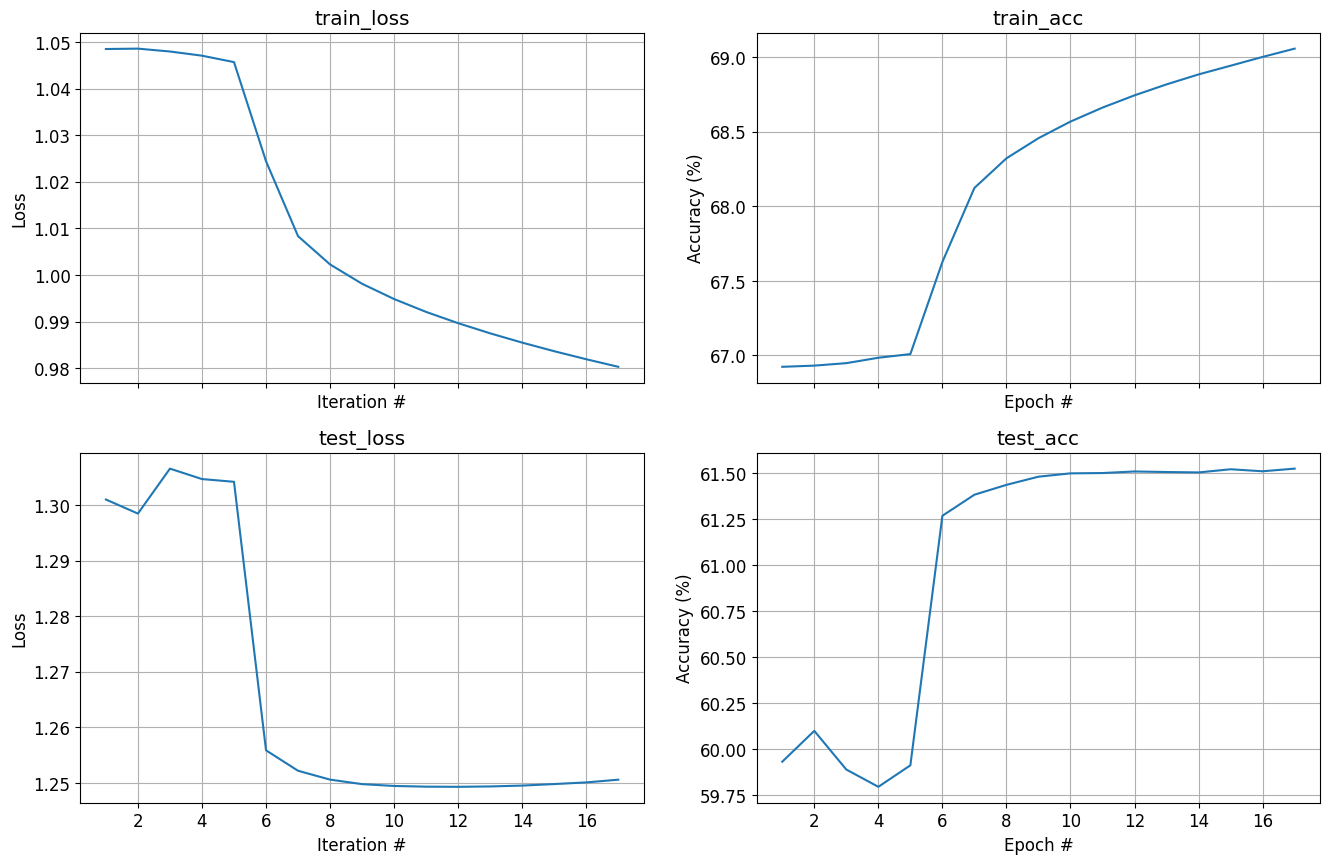

In [20]:
from cs236781.plot import plot_fit

def post_epoch_fn(epoch, train_res, test_res, verbose):
    # Update learning rate
    scheduler.step(test_res.accuracy)
    # Sample from model to show progress
    if verbose:
        start_seq = "ACT I."
        generated_sequence = charnn.generate_from_model(
            model, start_seq, 100, (char_to_idx,idx_to_char), T=0.5
        )
        print(generated_sequence)

# Train, unless final checkpoint is found
checkpoint_file_final = f'{checkpoint_file}_final.pt'
if os.path.isfile(checkpoint_file_final):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    saved_state = torch.load(checkpoint_file_final, map_location=device)
    model.load_state_dict(saved_state['model_state'])
else:
    try:
        # Print pre-training sampling
        print(charnn.generate_from_model(model, "ACT I.", 100, (char_to_idx,idx_to_char), T=0.5))
    
        fit_res = trainer.fit(dl_train, dl_test, num_epochs, max_batches=None,
                                  post_epoch_fn=post_epoch_fn, early_stopping=early_stopping,
                                  checkpoints=checkpoint_file, print_every=1)
            
        fig, axes = plot_fit(fit_res)
    except KeyboardInterrupt as e:
            print('\n *** Training interrupted by user')

### Generating a work of art
<a id=part1_8></a>

Armed with our fully trained model, let's generate the next Hamlet! You should experiment with modifying the sampling temperature and see what happens.

The text you generate should “look” like a Shakespeare play:
old-style English words and sentence structure, directions for the actors
(like “Exit/Enter”), sections (Act I/Scene III) etc.
There will be no coherent plot of course, but it should at least seem like
a Shakespearean play when not looking too closely.
If this is not what you see, go back, debug and/or and re-train.

**TODO**: Specify the generation parameters in the `part1_generation_params()` function within the `hw3/answers.py` module.

In [21]:
from hw3.answers import part1_generation_params

start_seq, temperature = part1_generation_params()

generated_sequence = charnn.generate_from_model(
    model, start_seq, 10000, (char_to_idx,idx_to_char), T=temperature
)

print(generated_sequence)

ACT I.
                      Alexander. Five babes are gallows,
             What he is but this bed,
                  His friends will formal,
                      And hold the stoner]  
                            A castle.

    How now? Who rais'd thee?  
  CAESAR. This is a rack accompant.
  TITUS. Nay, gentle Ere die with my spirits on.
    Sound Caesar, go to Caesar, if thou hast
    To make his forehead or such a giberous lord.
  ANNE. Your sword counsel, have I tonight.
  THIRD CONSPIRATOR. He shall not be so five to the princes.
  FIRST WATCH. Provoked a gentleman.
                                                           [Kisses him]
    And therefore should be contented to him.
  PANDULPH. He is our passion, sweet light or two words,
    Put them home where all, flattery, and free and slave!
    My means to my soul to his life, your hateful doors,
    Doing the pride of Cade, corely come to you.
    I come to her despite. All the flowers
    Whose tender arms is angry wit

## Questions
<a id=part1_9></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [22]:
from cs236781.answers import display_answer
import hw3.answers

### Question 1
Why do we split the corpus into sequences instead of training on the whole text?

In [23]:
display_answer(hw3.answers.part1_q1)


**Your answer:**

1. **Memory Constraints (VRAM):** Training on the whole text at once would require unrolling the computation graph for the entire length of the corpus. This would consume an impossible amount of memory for storing gradients during Backpropagation Through Time (BPTT). Splitting into sequences allows for Truncated BPTT, which fits in GPU memory.

2. **Vanishing/Exploding Gradients:** In extremely long sequences, gradients propagated backward over thousands of time steps tend to either vanish to zero (stopping learning) or explode to infinity (instability). Limiting the sequence length mitigates this issue.

3. **Optimization Efficiency:** Splitting the text creates many "samples," allowing us to use mini-batch Stochastic Gradient Descent. This updates the weights frequently (thousands of times per epoch) rather than once per epoch, leading to much faster convergence.

4. **Data Parallelism:** Small sequences allow us to stack data into batches (e.g., 64 sequences at a time), maximizing the parallel processing power of the GPU.


### Question 2
How is it possible that the generated text clearly shows memory longer than the sequence length?

In [24]:
display_answer(hw3.answers.part1_q2)


**Your answer:**

It is possible because we maintain and propagate the hidden state across batches.

1.  **Hidden State Persistence:** Although we perform "Truncated Backpropagation Through Time" (cutting off the gradients after seq_len steps to save memory), we do not reset the values of the hidden state between batches. The final hidden state of batch $i$ is fed as the initial hidden state for batch $i+1$.

2.  **Forward vs. Backward Horizon:** While the gradients (learning signal) can only flow back seq_len seps, the forward pass (context information) flows indefinitely. This allows the network to maintain a "memory" of events that happened many batches ago.

3.  **Contiguous Sampling:** Our SequenceBatchSampler ensures that the batches are ordered sequentially (the start of batch $i+1$ is the continuation of batch $i$). This alignment allows the persistent hidden state to carry valid context from the previous segment of text to the current one.


### Question 3
Why are we not shuffling the order of batches when training?

In [25]:
display_answer(hw3.answers.part1_q3)


**Your answer:**

We do not shuffle because we need to preserve contextual continuity between batches to simulate a much longer sequence.

1.  **Stateful Training:** We are training in a "stateful" manner, where the final hidden state of batch $i$ is used as the initial hidden state for batch $i+1$. This allows the model's memory (hidden state) to persist over time.

2.  **Logical Flow:** If we shuffled the batches, the hidden state passed to the network would be from a completely unrelated part of the text (e.g., passing the context of "Chapter 10" into the start of "Chapter 1"). This would break the narrative flow and force the model to reset its context constantly, limiting its effective memory to just the seq_len (e.g., 64 characters).

3.  **Long-Term Dependencies:** By keeping the order sequential, the forward pass can carry information across thousands of characters (through the hidden state), even though the backward pass (gradient calculation) is truncated to only 64 steps.


### Question 4
1. Why do we lower the temperature for sampling (compared to the default of $1.0$)?
2. What happens when the temperature is very high and why?
3. What happens when the temperature is very low and why?

In [26]:
display_answer(hw3.answers.part1_q4)


**Your answer:**

1. **Why lower the temperature (< 1.0)?**
   We lower the temperature to make the model more confident and conservative. A temperature $T < 1$ sharpens the probability distribution, exaggerating the differences between high and low probability characters. This filters out "noise" (low probability options) and ensures the generated text is more coherent, grammatical, and structurally correct, as the model sticks to the patterns it learned most strongly.

2. **What happens when T is very high (> 1.0)?**
   The distribution becomes flatter (more uniform). The differences between likely and unlikely characters shrink.
   Result: The model takes more risks and selects low-probability characters more often. The text becomes chaotic, contains spelling errors, and eventually turns into gibberish because the model is ignoring its own learned probabilities.

3. **What happens when T is very low (close to 0)?**
   The distribution becomes extremely sharp (approximating an argmax). The probability of the most likely character approaches 1, while all others approach 0.
   Result: The model becomes deterministic and repetitive. It will often get stuck in loops (e.g., "and the and the and the") because it constantly picks the single most "safe" next character without any variation to break the cycle.
